In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+residual_2+residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 800

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    # X_f = lb + (ub - lb) * lhs(1, N_f) #生成N_f个随机点
    X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点
    nIter = 150000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    # up = 80000
    n_star = 300+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = MCS_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 12/150000 [00:00<21:02, 118.81it/s]

Adam:   0%|          | 74/150000 [00:00<06:05, 410.71it/s]

Adam:   0%|          | 138/150000 [00:00<04:51, 513.78it/s]

Adam:   0%|          | 197/150000 [00:00<04:36, 541.25it/s]

Adam:   0%|          | 262/150000 [00:00<04:18, 578.61it/s]

Adam:   0%|          | 323/150000 [00:00<04:14, 588.20it/s]

Adam:   0%|          | 389/150000 [00:00<04:05, 610.30it/s]

Adam:   0%|          | 460/150000 [00:00<03:53, 639.70it/s]

Adam:   0%|          | 531/150000 [00:00<03:46, 659.67it/s]

Adam:   0%|          | 601/150000 [00:01<03:42, 672.03it/s]

Adam:   0%|          | 672/150000 [00:01<03:38, 683.03it/s]

Adam:   0%|          | 741/150000 [00:01<03:38, 684.67it/s]

Adam:   1%|          | 810/150000 [00:01<03:38, 683.48it/s]

Adam:   1%|          | 880/150000 [00:01<03:36, 687.44it/s]

Adam:   1%|          | 949/150000 [00:01<03:37, 684.62it/s]

Adam:   1%|          | 1020/150000 [00:01<03:35, 689.89it/s]

Adam:   1%|          | 1091/150000 [00:01<03:34, 693.03it/s]

Adam:   1%|          | 1161/150000 [00:01<03:42, 669.20it/s]

Adam:   1%|          | 1229/150000 [00:01<03:58, 622.99it/s]

Adam:   1%|          | 1294/150000 [00:02<03:56, 629.51it/s]

Adam:   1%|          | 1365/150000 [00:02<03:48, 650.44it/s]

Adam:   1%|          | 1431/150000 [00:02<03:57, 625.51it/s]

Adam:   1%|          | 1497/150000 [00:02<03:53, 635.11it/s]

Adam:   1%|          | 1561/150000 [00:02<04:01, 614.54it/s]

Adam:   1%|          | 1632/150000 [00:02<03:51, 639.84it/s]

Adam:   1%|          | 1697/150000 [00:02<04:09, 594.29it/s]

Adam:   1%|          | 1765/150000 [00:02<04:00, 617.31it/s]

Adam:   1%|          | 1828/150000 [00:02<04:03, 607.38it/s]

Adam:   1%|▏         | 1890/150000 [00:03<04:04, 605.30it/s]

Adam:   1%|▏         | 1957/150000 [00:03<03:57, 623.10it/s]

Adam:   1%|▏         | 2020/150000 [00:03<04:09, 593.00it/s]

Adam:   1%|▏         | 2080/150000 [00:03<04:12, 585.69it/s]

Adam:   1%|▏         | 2139/150000 [00:03<04:14, 580.03it/s]

Adam:   1%|▏         | 2198/150000 [00:03<04:15, 577.40it/s]

Adam:   2%|▏         | 2269/150000 [00:03<04:00, 613.59it/s]

Adam:   2%|▏         | 2338/150000 [00:03<03:52, 634.88it/s]

Adam:   2%|▏         | 2409/150000 [00:03<03:45, 655.29it/s]

Adam:   2%|▏         | 2475/150000 [00:03<03:56, 624.61it/s]

Adam:   2%|▏         | 2542/150000 [00:04<03:52, 635.03it/s]

Adam:   2%|▏         | 2606/150000 [00:04<03:57, 619.92it/s]

Adam:   2%|▏         | 2677/150000 [00:04<03:48, 645.34it/s]

Adam:   2%|▏         | 2748/150000 [00:04<03:42, 661.95it/s]

Adam:   2%|▏         | 2815/150000 [00:04<03:43, 657.42it/s]

Adam:   2%|▏         | 2881/150000 [00:04<03:43, 657.40it/s]

Adam:   2%|▏         | 2947/150000 [00:04<03:44, 656.07it/s]

Adam:   2%|▏         | 3018/150000 [00:04<03:39, 670.82it/s]

Adam:   2%|▏         | 3089/150000 [00:04<03:35, 681.02it/s]

Adam:   2%|▏         | 3158/150000 [00:05<03:43, 657.95it/s]

Adam:   2%|▏         | 3225/150000 [00:05<03:43, 655.97it/s]

Adam:   2%|▏         | 3291/150000 [00:05<03:44, 654.18it/s]

Adam:   2%|▏         | 3357/150000 [00:05<03:49, 638.17it/s]

Adam:   2%|▏         | 3421/150000 [00:05<03:56, 619.63it/s]

Adam:   2%|▏         | 3484/150000 [00:05<03:55, 621.00it/s]

Adam:   2%|▏         | 3554/150000 [00:05<03:47, 643.22it/s]

Adam:   2%|▏         | 3625/150000 [00:05<03:41, 659.45it/s]

Adam:   2%|▏         | 3695/150000 [00:05<03:37, 671.13it/s]

Adam:   3%|▎         | 3766/150000 [00:05<03:34, 681.89it/s]

Adam:   3%|▎         | 3835/150000 [00:06<03:52, 629.82it/s]

Adam:   3%|▎         | 3900/150000 [00:06<03:51, 631.18it/s]

Adam:   3%|▎         | 3964/150000 [00:06<03:54, 621.63it/s]

Adam:   3%|▎         | 4034/150000 [00:06<03:46, 643.42it/s]

Adam:   3%|▎         | 4105/150000 [00:06<03:40, 660.99it/s]

Adam:   3%|▎         | 4172/150000 [00:06<03:43, 651.27it/s]

Adam:   3%|▎         | 4238/150000 [00:06<03:47, 639.88it/s]

Adam:   3%|▎         | 4303/150000 [00:06<03:54, 620.35it/s]

Adam:   3%|▎         | 4370/150000 [00:06<03:50, 632.71it/s]

Adam:   3%|▎         | 4441/150000 [00:07<03:43, 652.40it/s]

Adam:   3%|▎         | 4512/150000 [00:07<03:37, 667.58it/s]

Adam:   3%|▎         | 4583/150000 [00:07<03:34, 677.57it/s]

Adam:   3%|▎         | 4654/150000 [00:07<03:31, 686.83it/s]

Adam:   3%|▎         | 4724/150000 [00:07<03:30, 690.33it/s]

Adam:   3%|▎         | 4794/150000 [00:07<03:29, 692.76it/s]

Adam:   3%|▎         | 4864/150000 [00:07<03:31, 687.70it/s]

Adam:   3%|▎         | 4933/150000 [00:07<03:40, 658.13it/s]

Adam:   3%|▎         | 5000/150000 [00:07<03:47, 636.02it/s]

Adam:   3%|▎         | 5066/150000 [00:07<03:46, 640.47it/s]

Adam:   3%|▎         | 5132/150000 [00:08<03:44, 645.58it/s]

Adam:   3%|▎         | 5202/150000 [00:08<03:39, 660.88it/s]

Adam:   4%|▎         | 5272/150000 [00:08<03:35, 671.77it/s]

Adam:   4%|▎         | 5340/150000 [00:08<03:40, 657.09it/s]

Adam:   4%|▎         | 5410/150000 [00:08<03:36, 667.73it/s]

Adam:   4%|▎         | 5480/150000 [00:08<03:33, 676.94it/s]

Adam:   4%|▎         | 5548/150000 [00:08<03:35, 669.66it/s]

Adam:   4%|▎         | 5618/150000 [00:08<03:33, 677.81it/s]

Adam:   4%|▍         | 5686/150000 [00:08<03:52, 621.66it/s]

Adam:   4%|▍         | 5755/150000 [00:08<03:45, 638.95it/s]

Adam:   4%|▍         | 5821/150000 [00:09<03:43, 644.85it/s]

Adam:   4%|▍         | 5888/150000 [00:09<03:41, 651.26it/s]

Adam:   4%|▍         | 5959/150000 [00:09<03:36, 665.92it/s]

Adam:   4%|▍         | 6026/150000 [00:09<03:41, 651.02it/s]

Adam:   4%|▍         | 6092/150000 [00:09<03:43, 644.53it/s]

Adam:   4%|▍         | 6158/150000 [00:09<03:41, 648.23it/s]

Adam:   4%|▍         | 6227/150000 [00:09<03:38, 657.73it/s]

Adam:   4%|▍         | 6293/150000 [00:09<03:41, 650.04it/s]

Adam:   4%|▍         | 6359/150000 [00:09<03:55, 610.14it/s]

Adam:   4%|▍         | 6424/150000 [00:10<03:51, 620.34it/s]

Adam:   4%|▍         | 6495/150000 [00:10<03:42, 645.23it/s]

Adam:   4%|▍         | 6563/150000 [00:10<03:39, 654.24it/s]

Adam:   4%|▍         | 6634/150000 [00:10<03:33, 670.33it/s]

Adam:   4%|▍         | 6705/150000 [00:10<03:30, 680.32it/s]

Adam:   5%|▍         | 6774/150000 [00:10<03:30, 680.59it/s]

Adam:   5%|▍         | 6843/150000 [00:10<03:32, 672.33it/s]

Adam:   5%|▍         | 6914/150000 [00:10<03:30, 680.66it/s]

Adam:   5%|▍         | 6983/150000 [00:10<03:30, 678.30it/s]

Adam:   5%|▍         | 7051/150000 [00:10<03:52, 614.95it/s]

Adam:   5%|▍         | 7121/150000 [00:11<03:43, 638.05it/s]

Adam:   5%|▍         | 7186/150000 [00:11<03:43, 640.18it/s]

Adam:   5%|▍         | 7251/150000 [00:11<03:55, 605.38it/s]

Adam:   5%|▍         | 7316/150000 [00:11<03:51, 617.00it/s]

Adam:   5%|▍         | 7379/150000 [00:11<03:56, 604.19it/s]

Adam:   5%|▍         | 7446/150000 [00:11<03:49, 621.92it/s]

Adam:   5%|▌         | 7517/150000 [00:11<03:40, 644.95it/s]

Adam:   5%|▌         | 7583/150000 [00:11<03:40, 645.64it/s]

Adam:   5%|▌         | 7648/150000 [00:11<03:44, 633.43it/s]

Adam:   5%|▌         | 7712/150000 [00:12<03:46, 628.09it/s]

Adam:   5%|▌         | 7776/150000 [00:12<03:45, 630.53it/s]

Adam:   5%|▌         | 7845/150000 [00:12<03:39, 646.36it/s]

Adam:   5%|▌         | 7913/150000 [00:12<03:36, 654.96it/s]

Adam:   5%|▌         | 7979/150000 [00:12<03:38, 649.59it/s]

Adam:   5%|▌         | 8045/150000 [00:12<03:46, 626.50it/s]

Adam:   5%|▌         | 8109/150000 [00:12<03:45, 629.51it/s]

Adam:   5%|▌         | 8173/150000 [00:12<04:03, 582.01it/s]

Adam:   5%|▌         | 8232/150000 [00:12<04:08, 571.06it/s]

Adam:   6%|▌         | 8294/150000 [00:12<04:02, 584.65it/s]

Adam:   6%|▌         | 8359/150000 [00:13<03:55, 600.39it/s]

Adam:   6%|▌         | 8420/150000 [00:13<03:59, 591.86it/s]

Adam:   6%|▌         | 8491/150000 [00:13<03:46, 623.69it/s]

Adam:   6%|▌         | 8554/150000 [00:13<03:46, 624.32it/s]

Adam:   6%|▌         | 8617/150000 [00:13<03:48, 617.77it/s]

Adam:   6%|▌         | 8682/150000 [00:13<03:45, 625.87it/s]

Adam:   6%|▌         | 8747/150000 [00:13<03:45, 627.07it/s]

Adam:   6%|▌         | 8813/150000 [00:13<03:42, 635.75it/s]

Adam:   6%|▌         | 8877/150000 [00:13<03:42, 633.23it/s]

Adam:   6%|▌         | 8941/150000 [00:14<03:42, 634.09it/s]

Adam:   6%|▌         | 9008/150000 [00:14<03:38, 644.02it/s]

Adam:   6%|▌         | 9073/150000 [00:14<03:38, 644.66it/s]

Adam:   6%|▌         | 9138/150000 [00:14<03:38, 644.08it/s]

Adam:   6%|▌         | 9209/150000 [00:14<03:32, 662.42it/s]

Adam:   6%|▌         | 9276/150000 [00:14<03:31, 663.83it/s]

Adam:   6%|▌         | 9345/150000 [00:14<03:29, 671.28it/s]

Adam:   6%|▋         | 9413/150000 [00:14<03:38, 642.30it/s]

Adam:   6%|▋         | 9480/150000 [00:14<03:37, 647.21it/s]

Adam:   6%|▋         | 9545/150000 [00:14<04:05, 572.19it/s]

Adam:   6%|▋         | 9615/150000 [00:15<03:51, 605.79it/s]

Adam:   6%|▋         | 9684/150000 [00:15<03:43, 628.98it/s]

Adam:   6%|▋         | 9749/150000 [00:15<03:49, 610.71it/s]

Adam:   7%|▋         | 9817/150000 [00:15<03:42, 629.13it/s]

Adam:   7%|▋         | 9881/150000 [00:15<03:48, 613.91it/s]

Adam:   7%|▋         | 9946/150000 [00:15<03:45, 622.32it/s]

Adam:   7%|▋         | 10013/150000 [00:15<03:40, 634.90it/s]

Adam:   7%|▋         | 10077/150000 [00:15<03:49, 608.86it/s]

Adam:   7%|▋         | 10145/150000 [00:15<03:42, 628.10it/s]

Adam:   7%|▋         | 10215/150000 [00:16<03:35, 647.81it/s]

Adam:   7%|▋         | 10281/150000 [00:16<03:54, 595.52it/s]

Adam:   7%|▋         | 10342/150000 [00:16<04:05, 569.55it/s]

Adam:   7%|▋         | 10400/150000 [00:16<04:05, 569.12it/s]

Adam:   7%|▋         | 10471/150000 [00:16<03:49, 608.10it/s]

Adam:   7%|▋         | 10542/150000 [00:16<03:39, 636.64it/s]

Adam:   7%|▋         | 10607/150000 [00:16<03:47, 612.59it/s]

Adam:   7%|▋         | 10669/150000 [00:16<03:51, 601.20it/s]

Adam:   7%|▋         | 10736/150000 [00:16<03:44, 620.03it/s]

Adam:   7%|▋         | 10799/150000 [00:17<04:00, 577.79it/s]

Adam:   7%|▋         | 10858/150000 [00:17<04:01, 575.76it/s]

Adam:   7%|▋         | 10917/150000 [00:17<04:00, 578.34it/s]

Adam:   7%|▋         | 10976/150000 [00:17<04:29, 515.70it/s]

Adam:   7%|▋         | 11037/150000 [00:17<04:17, 540.24it/s]

Adam:   7%|▋         | 11109/150000 [00:17<03:56, 587.50it/s]

Adam:   7%|▋         | 11180/150000 [00:17<03:43, 619.90it/s]

Adam:   7%|▋         | 11248/150000 [00:17<03:38, 636.43it/s]

Adam:   8%|▊         | 11313/150000 [00:17<03:37, 638.65it/s]

Adam:   8%|▊         | 11383/150000 [00:17<03:31, 654.75it/s]

Adam:   8%|▊         | 11449/150000 [00:18<03:35, 642.36it/s]

Adam:   8%|▊         | 11514/150000 [00:18<03:48, 606.25it/s]

Adam:   8%|▊         | 11576/150000 [00:18<03:51, 598.00it/s]

Adam:   8%|▊         | 11637/150000 [00:18<03:50, 600.15it/s]

Adam:   8%|▊         | 11698/150000 [00:18<03:54, 589.03it/s]

Adam:   8%|▊         | 11765/150000 [00:18<03:46, 610.85it/s]

Adam:   8%|▊         | 11830/150000 [00:18<03:42, 621.79it/s]

Adam:   8%|▊         | 11895/150000 [00:18<03:40, 627.23it/s]

Adam:   8%|▊         | 11958/150000 [00:18<04:12, 547.68it/s]

Adam:   8%|▊         | 12015/150000 [00:19<04:09, 552.90it/s]

Adam:   8%|▊         | 12076/150000 [00:19<04:03, 566.22it/s]

Adam:   8%|▊         | 12137/150000 [00:19<03:58, 577.77it/s]

Adam:   8%|▊         | 12196/150000 [00:19<04:12, 544.87it/s]

Adam:   8%|▊         | 12254/150000 [00:19<04:09, 552.63it/s]

Adam:   8%|▊         | 12318/150000 [00:19<03:59, 575.17it/s]

Adam:   8%|▊         | 12377/150000 [00:19<04:07, 556.11it/s]

Adam:   8%|▊         | 12435/150000 [00:19<04:05, 560.35it/s]

Adam:   8%|▊         | 12492/150000 [00:19<04:08, 553.08it/s]

Adam:   8%|▊         | 12552/150000 [00:20<04:03, 564.68it/s]

Adam:   8%|▊         | 12613/150000 [00:20<03:59, 574.16it/s]

Adam:   8%|▊         | 12671/150000 [00:20<04:00, 569.84it/s]

Adam:   8%|▊         | 12729/150000 [00:20<04:06, 557.14it/s]

Adam:   9%|▊         | 12794/150000 [00:20<03:55, 581.90it/s]

Adam:   9%|▊         | 12853/150000 [00:20<03:59, 571.59it/s]

Adam:   9%|▊         | 12911/150000 [00:20<04:09, 548.67it/s]

Adam:   9%|▊         | 12972/150000 [00:20<04:02, 565.81it/s]

Adam:   9%|▊         | 13029/150000 [00:20<04:09, 548.48it/s]

Adam:   9%|▊         | 13089/150000 [00:20<04:05, 558.68it/s]

Adam:   9%|▉         | 13146/150000 [00:21<04:14, 537.92it/s]

Adam:   9%|▉         | 13201/150000 [00:21<04:14, 536.81it/s]

Adam:   9%|▉         | 13264/150000 [00:21<04:02, 562.89it/s]

Adam:   9%|▉         | 13326/150000 [00:21<03:56, 577.21it/s]

Adam:   9%|▉         | 13384/150000 [00:21<04:05, 555.75it/s]

Adam:   9%|▉         | 13440/150000 [00:21<04:05, 556.76it/s]

Adam:   9%|▉         | 13500/150000 [00:21<04:00, 566.97it/s]

Adam:   9%|▉         | 13566/150000 [00:21<03:50, 591.78it/s]

Adam:   9%|▉         | 13631/150000 [00:21<03:44, 606.78it/s]

Adam:   9%|▉         | 13693/150000 [00:22<03:44, 607.46it/s]

Adam:   9%|▉         | 13754/150000 [00:22<03:49, 592.63it/s]

Adam:   9%|▉         | 13820/150000 [00:22<03:43, 609.94it/s]

Adam:   9%|▉         | 13882/150000 [00:22<03:46, 602.12it/s]

Adam:   9%|▉         | 13943/150000 [00:22<03:49, 591.61it/s]

Adam:   9%|▉         | 14008/150000 [00:22<03:44, 606.18it/s]

Adam:   9%|▉         | 14069/150000 [00:22<04:04, 555.69it/s]

Adam:   9%|▉         | 14126/150000 [00:22<04:18, 526.15it/s]

Adam:   9%|▉         | 14180/150000 [00:22<04:16, 528.90it/s]

Adam:   9%|▉         | 14235/150000 [00:23<04:14, 532.74it/s]

Adam:  10%|▉         | 14289/150000 [00:23<04:22, 517.91it/s]

Adam:  10%|▉         | 14342/150000 [00:23<04:33, 496.39it/s]

Adam:  10%|▉         | 14403/150000 [00:23<04:17, 525.93it/s]

Adam:  10%|▉         | 14465/150000 [00:23<04:05, 552.04it/s]

Adam:  10%|▉         | 14526/150000 [00:23<03:58, 567.56it/s]

Adam:  10%|▉         | 14589/150000 [00:23<03:51, 584.35it/s]

Adam:  10%|▉         | 14653/150000 [00:23<03:46, 598.01it/s]

Adam:  10%|▉         | 14714/150000 [00:23<03:50, 586.52it/s]

Adam:  10%|▉         | 14780/150000 [00:23<03:43, 604.70it/s]

Adam:  10%|▉         | 14841/150000 [00:24<03:47, 594.74it/s]

Adam:  10%|▉         | 14901/150000 [00:24<04:06, 547.69it/s]

Adam:  10%|▉         | 14957/150000 [00:24<04:22, 513.70it/s]

Adam:  10%|█         | 15010/150000 [00:24<04:21, 515.59it/s]

Adam:  10%|█         | 15074/150000 [00:24<04:05, 549.44it/s]

Adam:  10%|█         | 15137/150000 [00:24<03:56, 570.54it/s]

Adam:  10%|█         | 15195/150000 [00:24<04:00, 561.13it/s]

Adam:  10%|█         | 15260/150000 [00:24<03:50, 585.15it/s]

Adam:  10%|█         | 15326/150000 [00:24<03:42, 605.38it/s]

Adam:  10%|█         | 15387/150000 [00:25<03:58, 565.34it/s]

Adam:  10%|█         | 15451/150000 [00:25<03:49, 585.26it/s]

Adam:  10%|█         | 15511/150000 [00:25<04:02, 555.28it/s]

Adam:  10%|█         | 15568/150000 [00:25<04:09, 538.12it/s]

Adam:  10%|█         | 15623/150000 [00:25<04:25, 505.20it/s]

Adam:  10%|█         | 15678/150000 [00:25<04:20, 515.23it/s]

Adam:  10%|█         | 15732/150000 [00:25<04:17, 520.59it/s]

Adam:  11%|█         | 15785/150000 [00:25<04:37, 483.14it/s]

Adam:  11%|█         | 15846/150000 [00:25<04:19, 516.27it/s]

Adam:  11%|█         | 15907/150000 [00:26<04:07, 541.24it/s]

Adam:  11%|█         | 15963/150000 [00:26<04:05, 545.30it/s]

Adam:  11%|█         | 16019/150000 [00:26<04:15, 523.68it/s]

Adam:  11%|█         | 16072/150000 [00:26<04:23, 508.95it/s]

Adam:  11%|█         | 16126/150000 [00:26<04:20, 514.28it/s]

Adam:  11%|█         | 16178/150000 [00:26<04:23, 507.34it/s]

Adam:  11%|█         | 16229/150000 [00:26<04:49, 461.55it/s]

Adam:  11%|█         | 16287/150000 [00:26<04:31, 491.72it/s]

Adam:  11%|█         | 16338/150000 [00:26<04:37, 482.25it/s]

Adam:  11%|█         | 16400/150000 [00:27<04:16, 520.12it/s]

Adam:  11%|█         | 16453/150000 [00:27<04:16, 520.13it/s]

Adam:  11%|█         | 16506/150000 [00:27<04:24, 504.44it/s]

Adam:  11%|█         | 16569/150000 [00:27<04:07, 538.93it/s]

Adam:  11%|█         | 16624/150000 [00:27<04:09, 535.35it/s]

Adam:  11%|█         | 16680/150000 [00:27<04:07, 539.35it/s]

Adam:  11%|█         | 16739/150000 [00:27<04:01, 552.34it/s]

Adam:  11%|█         | 16798/150000 [00:27<03:57, 561.90it/s]

Adam:  11%|█         | 16856/150000 [00:27<03:54, 567.17it/s]

Adam:  11%|█▏        | 16913/150000 [00:27<03:57, 559.32it/s]

Adam:  11%|█▏        | 16970/150000 [00:28<03:57, 560.24it/s]

Adam:  11%|█▏        | 17027/150000 [00:28<03:58, 557.67it/s]

Adam:  11%|█▏        | 17083/150000 [00:28<04:06, 540.30it/s]

Adam:  11%|█▏        | 17138/150000 [00:28<04:18, 513.75it/s]

Adam:  11%|█▏        | 17190/150000 [00:28<04:21, 508.62it/s]

Adam:  12%|█▏        | 17251/150000 [00:28<04:07, 535.35it/s]

Adam:  12%|█▏        | 17305/150000 [00:28<04:09, 532.72it/s]

Adam:  12%|█▏        | 17359/150000 [00:28<04:19, 511.67it/s]

Adam:  12%|█▏        | 17411/150000 [00:28<04:19, 511.81it/s]

Adam:  12%|█▏        | 17466/150000 [00:29<04:15, 518.10it/s]

Adam:  12%|█▏        | 17519/150000 [00:29<04:14, 520.82it/s]

Adam:  12%|█▏        | 17582/150000 [00:29<03:59, 552.37it/s]

Adam:  12%|█▏        | 17638/150000 [00:29<04:04, 541.72it/s]

Adam:  12%|█▏        | 17693/150000 [00:29<04:11, 526.28it/s]

Adam:  12%|█▏        | 17746/150000 [00:29<04:33, 483.54it/s]

Adam:  12%|█▏        | 17804/150000 [00:29<04:19, 509.35it/s]

Adam:  12%|█▏        | 17864/150000 [00:29<04:07, 534.69it/s]

Adam:  12%|█▏        | 17928/150000 [00:29<03:53, 564.75it/s]

Adam:  12%|█▏        | 17988/150000 [00:29<03:50, 573.69it/s]

Adam:  12%|█▏        | 18051/150000 [00:30<03:43, 589.92it/s]

Adam:  12%|█▏        | 18111/150000 [00:30<03:47, 580.24it/s]

Adam:  12%|█▏        | 18170/150000 [00:30<03:51, 570.47it/s]

Adam:  12%|█▏        | 18228/150000 [00:30<04:00, 547.66it/s]

Adam:  12%|█▏        | 18292/150000 [00:30<03:50, 572.36it/s]

Adam:  12%|█▏        | 18354/150000 [00:30<03:45, 584.41it/s]

Adam:  12%|█▏        | 18413/150000 [00:30<04:06, 533.04it/s]

Adam:  12%|█▏        | 18468/150000 [00:30<04:07, 531.20it/s]

Adam:  12%|█▏        | 18522/150000 [00:30<04:08, 529.28it/s]

Adam:  12%|█▏        | 18578/150000 [00:31<04:05, 536.12it/s]

Adam:  12%|█▏        | 18632/150000 [00:31<04:06, 532.39it/s]

Adam:  12%|█▏        | 18686/150000 [00:31<04:08, 529.06it/s]

Adam:  12%|█▏        | 18740/150000 [00:31<04:23, 497.72it/s]

Adam:  13%|█▎        | 18804/150000 [00:31<04:05, 535.19it/s]

Adam:  13%|█▎        | 18859/150000 [00:31<04:12, 519.67it/s]

Adam:  13%|█▎        | 18912/150000 [00:31<04:27, 490.65it/s]

Adam:  13%|█▎        | 18970/150000 [00:31<04:14, 514.06it/s]

Adam:  13%|█▎        | 19035/150000 [00:31<03:57, 551.54it/s]

Adam:  13%|█▎        | 19092/150000 [00:32<03:55, 555.29it/s]

Adam:  13%|█▎        | 19148/150000 [00:32<03:57, 550.76it/s]

Adam:  13%|█▎        | 19204/150000 [00:32<04:07, 527.42it/s]

Adam:  13%|█▎        | 19270/150000 [00:32<03:52, 563.04it/s]

Adam:  13%|█▎        | 19327/150000 [00:32<03:57, 550.14it/s]

Adam:  13%|█▎        | 19383/150000 [00:32<04:03, 537.37it/s]

Adam:  13%|█▎        | 19443/150000 [00:32<03:56, 552.44it/s]

Adam:  13%|█▎        | 19499/150000 [00:32<04:05, 530.75it/s]

Adam:  13%|█▎        | 19553/150000 [00:32<04:11, 518.51it/s]

Adam:  13%|█▎        | 19606/150000 [00:33<04:13, 514.97it/s]

Adam:  13%|█▎        | 19659/150000 [00:33<04:11, 517.34it/s]

Adam:  13%|█▎        | 19715/150000 [00:33<04:06, 528.18it/s]

Adam:  13%|█▎        | 19768/150000 [00:33<04:18, 504.04it/s]

Adam:  13%|█▎        | 19819/150000 [00:33<04:19, 502.05it/s]

Adam:  13%|█▎        | 19870/150000 [00:33<04:30, 481.36it/s]

Adam:  13%|█▎        | 19936/150000 [00:33<04:05, 529.36it/s]

Adam:  13%|█▎        | 19999/150000 [00:33<03:53, 556.02it/s]

Adam:  13%|█▎        | 20056/150000 [00:33<04:06, 526.48it/s]

Adam:  13%|█▎        | 20114/150000 [00:33<04:01, 538.27it/s]

Adam:  13%|█▎        | 20169/150000 [00:34<04:02, 534.89it/s]

Adam:  13%|█▎        | 20235/150000 [00:34<03:47, 569.29it/s]

Adam:  14%|█▎        | 20298/150000 [00:34<03:41, 585.08it/s]

Adam:  14%|█▎        | 20363/150000 [00:34<03:34, 603.49it/s]

Adam:  14%|█▎        | 20430/150000 [00:34<03:28, 621.09it/s]

Adam:  14%|█▎        | 20495/150000 [00:34<03:26, 628.00it/s]

Adam:  14%|█▎        | 20560/150000 [00:34<03:24, 634.19it/s]

Adam:  14%|█▎        | 20624/150000 [00:34<03:24, 633.33it/s]

Adam:  14%|█▍        | 20688/150000 [00:34<03:26, 625.32it/s]

Adam:  14%|█▍        | 20751/150000 [00:34<03:27, 622.04it/s]

Adam:  14%|█▍        | 20814/150000 [00:35<03:35, 598.86it/s]

Adam:  14%|█▍        | 20880/150000 [00:35<03:29, 615.33it/s]

Adam:  14%|█▍        | 20942/150000 [00:35<03:40, 584.66it/s]

Adam:  14%|█▍        | 21001/150000 [00:35<03:48, 564.59it/s]

Adam:  14%|█▍        | 21058/150000 [00:35<03:48, 563.18it/s]

Adam:  14%|█▍        | 21118/150000 [00:35<03:45, 571.59it/s]

Adam:  14%|█▍        | 21184/150000 [00:35<03:36, 596.01it/s]

Adam:  14%|█▍        | 21245/150000 [00:35<03:35, 597.88it/s]

Adam:  14%|█▍        | 21309/150000 [00:35<03:31, 609.30it/s]

Adam:  14%|█▍        | 21371/150000 [00:36<03:30, 610.01it/s]

Adam:  14%|█▍        | 21437/150000 [00:36<03:26, 622.56it/s]

Adam:  14%|█▍        | 21500/150000 [00:36<04:01, 531.03it/s]

Adam:  14%|█▍        | 21556/150000 [00:36<04:07, 517.92it/s]

Adam:  14%|█▍        | 21610/150000 [00:36<04:06, 521.64it/s]

Adam:  14%|█▍        | 21675/150000 [00:36<03:51, 554.82it/s]

Adam:  14%|█▍        | 21741/150000 [00:36<03:39, 583.46it/s]

Adam:  15%|█▍        | 21801/150000 [00:36<03:40, 581.51it/s]

Adam:  15%|█▍        | 21860/150000 [00:36<03:39, 583.17it/s]

Adam:  15%|█▍        | 21922/150000 [00:37<03:36, 592.12it/s]

Adam:  15%|█▍        | 21983/150000 [00:37<03:34, 596.46it/s]

Adam:  15%|█▍        | 22043/150000 [00:37<03:52, 549.55it/s]

Adam:  15%|█▍        | 22099/150000 [00:37<03:56, 540.91it/s]

Adam:  15%|█▍        | 22156/150000 [00:37<03:54, 545.86it/s]

Adam:  15%|█▍        | 22213/150000 [00:37<03:51, 552.17it/s]

Adam:  15%|█▍        | 22269/150000 [00:37<04:10, 509.75it/s]

Adam:  15%|█▍        | 22321/150000 [00:37<04:24, 483.59it/s]

Adam:  15%|█▍        | 22371/150000 [00:37<04:21, 487.91it/s]

Adam:  15%|█▍        | 22429/150000 [00:38<04:09, 512.14it/s]

Adam:  15%|█▍        | 22481/150000 [00:38<04:10, 510.05it/s]

Adam:  15%|█▌        | 22545/150000 [00:38<03:53, 545.60it/s]

Adam:  15%|█▌        | 22600/150000 [00:38<04:00, 529.12it/s]

Adam:  15%|█▌        | 22654/150000 [00:38<04:31, 469.68it/s]

Adam:  15%|█▌        | 22703/150000 [00:38<04:33, 466.08it/s]

Adam:  15%|█▌        | 22751/150000 [00:38<04:41, 452.02it/s]

Adam:  15%|█▌        | 22813/150000 [00:38<04:15, 497.10it/s]

Adam:  15%|█▌        | 22873/150000 [00:38<04:02, 523.83it/s]

Adam:  15%|█▌        | 22927/150000 [00:39<04:43, 448.72it/s]

Adam:  15%|█▌        | 22982/150000 [00:39<04:27, 474.08it/s]

Adam:  15%|█▌        | 23035/150000 [00:39<04:20, 486.96it/s]

Adam:  15%|█▌        | 23086/150000 [00:39<04:27, 474.97it/s]

Adam:  15%|█▌        | 23149/150000 [00:39<04:05, 515.77it/s]

Adam:  15%|█▌        | 23202/150000 [00:39<04:04, 519.06it/s]

Adam:  16%|█▌        | 23258/150000 [00:39<04:00, 527.55it/s]

Adam:  16%|█▌        | 23312/150000 [00:39<04:16, 493.13it/s]

Adam:  16%|█▌        | 23363/150000 [00:39<04:50, 436.43it/s]

Adam:  16%|█▌        | 23409/150000 [00:40<04:51, 433.93it/s]

Adam:  16%|█▌        | 23454/150000 [00:40<04:50, 435.97it/s]

Adam:  16%|█▌        | 23503/150000 [00:40<04:40, 450.66it/s]

Adam:  16%|█▌        | 23560/150000 [00:40<04:21, 484.08it/s]

Adam:  16%|█▌        | 23610/150000 [00:40<04:26, 474.91it/s]

Adam:  16%|█▌        | 23659/150000 [00:40<04:28, 470.83it/s]

Adam:  16%|█▌        | 23721/150000 [00:40<04:06, 511.75it/s]

Adam:  16%|█▌        | 23778/150000 [00:40<04:00, 525.69it/s]

Adam:  16%|█▌        | 23835/150000 [00:40<03:56, 533.77it/s]

Adam:  16%|█▌        | 23889/150000 [00:41<04:00, 524.68it/s]

Adam:  16%|█▌        | 23942/150000 [00:41<04:33, 461.24it/s]

Adam:  16%|█▌        | 23990/150000 [00:41<04:37, 453.29it/s]

Adam:  16%|█▌        | 24041/150000 [00:41<04:29, 466.52it/s]

Adam:  16%|█▌        | 24100/150000 [00:41<04:12, 498.91it/s]

Adam:  16%|█▌        | 24157/150000 [00:41<04:03, 516.20it/s]

Adam:  16%|█▌        | 24210/150000 [00:41<04:04, 515.45it/s]

Adam:  16%|█▌        | 24273/150000 [00:41<03:49, 547.29it/s]

Adam:  16%|█▌        | 24329/150000 [00:41<03:55, 532.87it/s]

Adam:  16%|█▋        | 24383/150000 [00:41<04:03, 515.95it/s]

Adam:  16%|█▋        | 24438/150000 [00:42<04:00, 523.17it/s]

Adam:  16%|█▋        | 24491/150000 [00:42<04:20, 482.24it/s]

Adam:  16%|█▋        | 24550/150000 [00:42<04:05, 510.18it/s]

Adam:  16%|█▋        | 24612/150000 [00:42<03:52, 538.54it/s]

Adam:  16%|█▋        | 24675/150000 [00:42<03:42, 564.39it/s]

Adam:  16%|█▋        | 24733/150000 [00:42<04:03, 514.09it/s]

Adam:  17%|█▋        | 24786/150000 [00:42<04:09, 502.48it/s]

Adam:  17%|█▋        | 24838/150000 [00:42<04:37, 451.84it/s]

Adam:  17%|█▋        | 24885/150000 [00:43<04:37, 450.15it/s]

Adam:  17%|█▋        | 24948/150000 [00:43<04:12, 495.70it/s]

Adam:  17%|█▋        | 24999/150000 [00:43<04:33, 456.46it/s]

Adam:  17%|█▋        | 25059/150000 [00:43<04:13, 493.59it/s]

Adam:  17%|█▋        | 25126/150000 [00:43<03:50, 541.60it/s]

Adam:  17%|█▋        | 25182/150000 [00:43<03:53, 534.48it/s]

Adam:  17%|█▋        | 25237/150000 [00:43<03:57, 524.65it/s]

Adam:  17%|█▋        | 25291/150000 [00:43<04:28, 464.29it/s]

Adam:  17%|█▋        | 25340/150000 [00:43<04:43, 440.44it/s]

Adam:  17%|█▋        | 25386/150000 [00:44<04:41, 442.14it/s]

Adam:  17%|█▋        | 25432/150000 [00:44<04:40, 443.64it/s]

Adam:  17%|█▋        | 25487/150000 [00:44<04:24, 469.92it/s]

Adam:  17%|█▋        | 25535/150000 [00:44<04:35, 451.26it/s]

Adam:  17%|█▋        | 25583/150000 [00:44<04:32, 456.71it/s]

Adam:  17%|█▋        | 25633/150000 [00:44<04:26, 466.32it/s]

Adam:  17%|█▋        | 25684/150000 [00:44<04:20, 476.80it/s]

Adam:  17%|█▋        | 25732/150000 [00:44<04:42, 439.72it/s]

Adam:  17%|█▋        | 25777/150000 [00:44<05:05, 406.26it/s]

Adam:  17%|█▋        | 25829/150000 [00:45<04:45, 434.76it/s]

Adam:  17%|█▋        | 25875/150000 [00:45<04:41, 441.28it/s]

Adam:  17%|█▋        | 25935/150000 [00:45<04:16, 484.11it/s]

Adam:  17%|█▋        | 25995/150000 [00:45<04:00, 515.44it/s]

Adam:  17%|█▋        | 26048/150000 [00:45<04:27, 463.93it/s]

Adam:  17%|█▋        | 26096/150000 [00:45<04:38, 445.33it/s]

Adam:  17%|█▋        | 26149/150000 [00:45<04:24, 467.83it/s]

Adam:  17%|█▋        | 26208/150000 [00:45<04:07, 500.26it/s]

Adam:  18%|█▊        | 26261/150000 [00:45<04:03, 507.26it/s]

Adam:  18%|█▊        | 26313/150000 [00:46<04:03, 508.90it/s]

Adam:  18%|█▊        | 26371/150000 [00:46<03:53, 529.29it/s]

Adam:  18%|█▊        | 26432/150000 [00:46<03:44, 550.96it/s]

Adam:  18%|█▊        | 26491/150000 [00:46<03:39, 562.38it/s]

Adam:  18%|█▊        | 26550/150000 [00:46<03:36, 570.27it/s]

Adam:  18%|█▊        | 26608/150000 [00:46<03:44, 550.45it/s]

Adam:  18%|█▊        | 26664/150000 [00:46<03:50, 534.95it/s]

Adam:  18%|█▊        | 26723/150000 [00:46<03:44, 548.81it/s]

Adam:  18%|█▊        | 26779/150000 [00:46<03:59, 514.31it/s]

Adam:  18%|█▊        | 26837/150000 [00:46<03:51, 532.15it/s]

Adam:  18%|█▊        | 26896/150000 [00:47<03:44, 547.38it/s]

Adam:  18%|█▊        | 26952/150000 [00:47<03:52, 530.36it/s]

Adam:  18%|█▊        | 27006/150000 [00:47<03:54, 523.48it/s]

Adam:  18%|█▊        | 27059/150000 [00:47<04:34, 448.45it/s]

Adam:  18%|█▊        | 27113/150000 [00:47<04:20, 471.56it/s]

Adam:  18%|█▊        | 27162/150000 [00:47<04:33, 449.04it/s]

Adam:  18%|█▊        | 27209/150000 [00:47<04:32, 450.15it/s]

Adam:  18%|█▊        | 27263/150000 [00:47<04:19, 472.56it/s]

Adam:  18%|█▊        | 27312/150000 [00:48<04:36, 444.17it/s]

Adam:  18%|█▊        | 27358/150000 [00:48<04:51, 420.78it/s]

Adam:  18%|█▊        | 27401/150000 [00:48<05:07, 398.20it/s]

Adam:  18%|█▊        | 27447/150000 [00:48<04:56, 413.90it/s]

Adam:  18%|█▊        | 27489/150000 [00:48<05:15, 388.82it/s]

Adam:  18%|█▊        | 27545/150000 [00:48<04:42, 433.60it/s]

Adam:  18%|█▊        | 27598/150000 [00:48<04:26, 459.92it/s]

Adam:  18%|█▊        | 27645/150000 [00:48<04:38, 439.29it/s]

Adam:  18%|█▊        | 27691/150000 [00:48<04:35, 444.37it/s]

Adam:  18%|█▊        | 27748/150000 [00:49<04:15, 477.80it/s]

Adam:  19%|█▊        | 27808/150000 [00:49<03:59, 510.08it/s]

Adam:  19%|█▊        | 27860/150000 [00:49<04:10, 487.26it/s]

Adam:  19%|█▊        | 27914/150000 [00:49<04:03, 501.09it/s]

Adam:  19%|█▊        | 27966/150000 [00:49<04:01, 505.58it/s]

Adam:  19%|█▊        | 28020/150000 [00:49<03:57, 514.27it/s]

Adam:  19%|█▊        | 28076/150000 [00:49<03:52, 524.78it/s]

Adam:  19%|█▉        | 28129/150000 [00:49<04:08, 491.07it/s]

Adam:  19%|█▉        | 28179/150000 [00:49<04:14, 479.42it/s]

Adam:  19%|█▉        | 28228/150000 [00:49<04:18, 470.80it/s]

Adam:  19%|█▉        | 28277/150000 [00:50<04:15, 475.81it/s]

Adam:  19%|█▉        | 28334/150000 [00:50<04:02, 502.49it/s]

Adam:  19%|█▉        | 28395/150000 [00:50<03:48, 533.03it/s]

Adam:  19%|█▉        | 28449/150000 [00:50<03:49, 529.54it/s]

Adam:  19%|█▉        | 28503/150000 [00:50<04:13, 479.93it/s]

Adam:  19%|█▉        | 28552/150000 [00:50<04:25, 456.91it/s]

Adam:  19%|█▉        | 28600/150000 [00:50<04:22, 462.47it/s]

Adam:  19%|█▉        | 28647/150000 [00:50<04:28, 451.57it/s]

Adam:  19%|█▉        | 28693/150000 [00:50<04:55, 410.03it/s]

Adam:  19%|█▉        | 28744/150000 [00:51<04:38, 435.18it/s]

Adam:  19%|█▉        | 28802/150000 [00:51<04:16, 472.63it/s]

Adam:  19%|█▉        | 28851/150000 [00:51<04:33, 443.13it/s]

Adam:  19%|█▉        | 28897/150000 [00:51<04:38, 435.34it/s]

Adam:  19%|█▉        | 28942/150000 [00:51<04:53, 413.11it/s]

Adam:  19%|█▉        | 28995/150000 [00:51<04:33, 443.16it/s]

Adam:  19%|█▉        | 29046/150000 [00:51<04:23, 459.59it/s]

Adam:  19%|█▉        | 29093/150000 [00:51<04:27, 452.46it/s]

Adam:  19%|█▉        | 29153/150000 [00:51<04:04, 494.00it/s]

Adam:  19%|█▉        | 29203/150000 [00:52<04:11, 481.13it/s]

Adam:  20%|█▉        | 29252/150000 [00:52<04:17, 469.44it/s]

Adam:  20%|█▉        | 29310/150000 [00:52<04:01, 498.93it/s]

Adam:  20%|█▉        | 29361/150000 [00:52<04:01, 500.21it/s]

Adam:  20%|█▉        | 29412/150000 [00:52<04:20, 463.71it/s]

Adam:  20%|█▉        | 29460/150000 [00:52<04:18, 465.85it/s]

Adam:  20%|█▉        | 29508/150000 [00:52<04:49, 415.81it/s]

Adam:  20%|█▉        | 29556/150000 [00:52<04:38, 431.85it/s]

Adam:  20%|█▉        | 29617/150000 [00:52<04:11, 478.02it/s]

Adam:  20%|█▉        | 29666/150000 [00:53<04:26, 452.32it/s]

Adam:  20%|█▉        | 29713/150000 [00:53<04:26, 451.82it/s]

Adam:  20%|█▉        | 29759/150000 [00:53<05:01, 399.11it/s]

Adam:  20%|█▉        | 29808/150000 [00:53<04:45, 420.71it/s]

Adam:  20%|█▉        | 29866/150000 [00:53<04:20, 461.58it/s]

Adam:  20%|█▉        | 29914/150000 [00:53<04:27, 448.91it/s]

Adam:  20%|█▉        | 29971/150000 [00:53<04:10, 479.98it/s]

Adam:  20%|██        | 30026/150000 [00:53<04:00, 498.82it/s]

Adam:  20%|██        | 30077/150000 [00:53<03:59, 500.58it/s]

Adam:  20%|██        | 30128/150000 [00:54<03:59, 500.90it/s]

Adam:  20%|██        | 30188/150000 [00:54<03:47, 527.70it/s]

Adam:  20%|██        | 30247/150000 [00:54<03:40, 543.86it/s]

Adam:  20%|██        | 30303/150000 [00:54<03:39, 546.28it/s]

Adam:  20%|██        | 30358/150000 [00:54<04:04, 489.60it/s]

Adam:  20%|██        | 30409/150000 [00:54<04:08, 480.29it/s]

Adam:  20%|██        | 30463/150000 [00:54<04:01, 494.63it/s]

Adam:  20%|██        | 30514/150000 [00:54<04:22, 455.90it/s]

Adam:  20%|██        | 30561/150000 [00:54<04:20, 459.25it/s]

Adam:  20%|██        | 30608/150000 [00:55<04:32, 437.79it/s]

Adam:  20%|██        | 30653/150000 [00:55<04:40, 425.85it/s]

Adam:  20%|██        | 30703/150000 [00:55<04:28, 444.94it/s]

Adam:  20%|██        | 30749/150000 [00:55<04:25, 448.86it/s]

Adam:  21%|██        | 30803/150000 [00:55<04:11, 473.91it/s]

Adam:  21%|██        | 30851/150000 [00:55<04:14, 468.46it/s]

Adam:  21%|██        | 30899/150000 [00:55<04:19, 459.51it/s]

Adam:  21%|██        | 30946/150000 [00:55<04:18, 460.14it/s]

Adam:  21%|██        | 30995/150000 [00:55<04:14, 468.50it/s]

Adam:  21%|██        | 31042/150000 [00:56<04:35, 431.84it/s]

Adam:  21%|██        | 31086/150000 [00:56<04:49, 411.14it/s]

Adam:  21%|██        | 31128/150000 [00:56<05:14, 377.73it/s]

Adam:  21%|██        | 31186/150000 [00:56<04:36, 429.41it/s]

Adam:  21%|██        | 31243/150000 [00:56<04:14, 465.91it/s]

Adam:  21%|██        | 31304/150000 [00:56<03:55, 504.79it/s]

Adam:  21%|██        | 31358/150000 [00:56<03:51, 512.04it/s]

Adam:  21%|██        | 31410/150000 [00:56<03:57, 500.22it/s]

Adam:  21%|██        | 31467/150000 [00:56<03:47, 520.03it/s]

Adam:  21%|██        | 31520/150000 [00:57<03:58, 496.78it/s]

Adam:  21%|██        | 31571/150000 [00:57<04:15, 462.68it/s]

Adam:  21%|██        | 31620/150000 [00:57<04:13, 467.35it/s]

Adam:  21%|██        | 31671/150000 [00:57<04:06, 479.18it/s]

Adam:  21%|██        | 31720/150000 [00:57<04:19, 456.47it/s]

Adam:  21%|██        | 31779/150000 [00:57<04:00, 491.42it/s]

Adam:  21%|██        | 31838/150000 [00:57<03:47, 518.62it/s]

Adam:  21%|██▏       | 31896/150000 [00:57<03:41, 534.25it/s]

Adam:  21%|██▏       | 31950/150000 [00:57<03:49, 514.70it/s]

Adam:  21%|██▏       | 32002/150000 [00:58<04:05, 480.30it/s]

Adam:  21%|██▏       | 32051/150000 [00:58<04:15, 462.53it/s]

Adam:  21%|██▏       | 32107/150000 [00:58<04:02, 487.15it/s]

Adam:  21%|██▏       | 32157/150000 [00:58<04:14, 463.35it/s]

Adam:  21%|██▏       | 32204/150000 [00:58<04:20, 451.67it/s]

Adam:  22%|██▏       | 32250/150000 [00:58<04:20, 451.43it/s]

Adam:  22%|██▏       | 32297/150000 [00:58<04:18, 456.02it/s]

Adam:  22%|██▏       | 32343/150000 [00:58<04:30, 435.27it/s]

Adam:  22%|██▏       | 32403/150000 [00:58<04:04, 481.10it/s]

Adam:  22%|██▏       | 32463/150000 [00:58<03:48, 513.41it/s]

Adam:  22%|██▏       | 32515/150000 [00:59<04:06, 476.89it/s]

Adam:  22%|██▏       | 32564/150000 [00:59<04:22, 446.99it/s]

Adam:  22%|██▏       | 32610/150000 [00:59<04:26, 441.12it/s]

Adam:  22%|██▏       | 32655/150000 [00:59<04:50, 404.45it/s]

Adam:  22%|██▏       | 32698/150000 [00:59<04:46, 409.36it/s]

Adam:  22%|██▏       | 32741/150000 [00:59<04:43, 413.32it/s]

Adam:  22%|██▏       | 32794/150000 [00:59<04:23, 444.81it/s]

Adam:  22%|██▏       | 32848/150000 [00:59<04:10, 467.03it/s]

Adam:  22%|██▏       | 32896/150000 [01:00<04:13, 462.33it/s]

Adam:  22%|██▏       | 32943/150000 [01:00<04:20, 448.71it/s]

Adam:  22%|██▏       | 32989/150000 [01:00<04:21, 447.87it/s]

Adam:  22%|██▏       | 33034/150000 [01:00<04:26, 438.30it/s]

Adam:  22%|██▏       | 33078/150000 [01:00<04:28, 435.62it/s]

Adam:  22%|██▏       | 33127/150000 [01:00<04:19, 449.92it/s]

Adam:  22%|██▏       | 33173/150000 [01:00<04:29, 434.00it/s]

Adam:  22%|██▏       | 33227/150000 [01:00<04:13, 460.78it/s]

Adam:  22%|██▏       | 33274/150000 [01:00<04:15, 456.61it/s]

Adam:  22%|██▏       | 33320/150000 [01:00<04:25, 440.20it/s]

Adam:  22%|██▏       | 33376/150000 [01:01<04:06, 473.31it/s]

Adam:  22%|██▏       | 33424/150000 [01:01<04:12, 461.58it/s]

Adam:  22%|██▏       | 33475/150000 [01:01<04:06, 472.54it/s]

Adam:  22%|██▏       | 33523/150000 [01:01<04:27, 435.90it/s]

Adam:  22%|██▏       | 33568/150000 [01:01<05:10, 375.45it/s]

Adam:  22%|██▏       | 33617/150000 [01:01<04:48, 403.02it/s]

Adam:  22%|██▏       | 33660/150000 [01:01<04:45, 407.50it/s]

Adam:  22%|██▏       | 33709/150000 [01:01<04:30, 429.18it/s]

Adam:  23%|██▎       | 33766/150000 [01:01<04:08, 466.97it/s]

Adam:  23%|██▎       | 33818/150000 [01:02<04:01, 480.17it/s]

Adam:  23%|██▎       | 33867/150000 [01:02<04:02, 479.30it/s]

Adam:  23%|██▎       | 33916/150000 [01:02<04:13, 457.78it/s]

Adam:  23%|██▎       | 33965/150000 [01:02<04:08, 466.49it/s]

Adam:  23%|██▎       | 34013/150000 [01:02<04:11, 460.41it/s]

Adam:  23%|██▎       | 34066/150000 [01:02<04:01, 479.37it/s]

Adam:  23%|██▎       | 34124/150000 [01:02<03:48, 507.19it/s]

Adam:  23%|██▎       | 34180/150000 [01:02<03:43, 517.68it/s]

Adam:  23%|██▎       | 34232/150000 [01:02<04:15, 452.40it/s]

Adam:  23%|██▎       | 34280/150000 [01:03<04:12, 458.17it/s]

Adam:  23%|██▎       | 34331/150000 [01:03<04:05, 470.88it/s]

Adam:  23%|██▎       | 34383/150000 [01:03<03:58, 484.32it/s]

Adam:  23%|██▎       | 34433/150000 [01:03<04:02, 476.98it/s]

Adam:  23%|██▎       | 34486/150000 [01:03<03:55, 490.31it/s]

Adam:  23%|██▎       | 34541/150000 [01:03<03:47, 506.94it/s]

Adam:  23%|██▎       | 34593/150000 [01:03<03:54, 493.11it/s]

Adam:  23%|██▎       | 34643/150000 [01:03<04:32, 423.77it/s]

Adam:  23%|██▎       | 34688/150000 [01:03<04:35, 418.02it/s]

Adam:  23%|██▎       | 34743/150000 [01:04<04:15, 451.09it/s]

Adam:  23%|██▎       | 34798/150000 [01:04<04:01, 477.60it/s]

Adam:  23%|██▎       | 34847/150000 [01:04<04:02, 475.31it/s]

Adam:  23%|██▎       | 34900/150000 [01:04<03:54, 490.79it/s]

Adam:  23%|██▎       | 34950/150000 [01:04<04:16, 447.67it/s]

Adam:  23%|██▎       | 34996/150000 [01:04<04:27, 429.66it/s]

Adam:  23%|██▎       | 35045/150000 [01:04<04:19, 443.76it/s]

Adam:  23%|██▎       | 35094/150000 [01:04<04:12, 455.12it/s]

Adam:  23%|██▎       | 35141/150000 [01:04<04:29, 426.12it/s]

Adam:  23%|██▎       | 35185/150000 [01:05<04:34, 418.43it/s]

Adam:  23%|██▎       | 35243/150000 [01:05<04:08, 461.13it/s]

Adam:  24%|██▎       | 35300/150000 [01:05<03:53, 490.21it/s]

Adam:  24%|██▎       | 35358/150000 [01:05<03:43, 512.70it/s]

Adam:  24%|██▎       | 35410/150000 [01:05<04:24, 433.72it/s]

Adam:  24%|██▎       | 35457/150000 [01:05<04:19, 441.96it/s]

Adam:  24%|██▎       | 35517/150000 [01:05<03:57, 482.96it/s]

Adam:  24%|██▎       | 35567/150000 [01:05<03:55, 486.87it/s]

Adam:  24%|██▎       | 35617/150000 [01:05<04:06, 464.09it/s]

Adam:  24%|██▍       | 35665/150000 [01:06<04:20, 439.01it/s]

Adam:  24%|██▍       | 35711/150000 [01:06<04:17, 443.62it/s]

Adam:  24%|██▍       | 35771/150000 [01:06<03:55, 485.58it/s]

Adam:  24%|██▍       | 35821/150000 [01:06<03:56, 483.16it/s]

Adam:  24%|██▍       | 35870/150000 [01:06<04:00, 474.80it/s]

Adam:  24%|██▍       | 35918/150000 [01:06<04:06, 461.96it/s]

Adam:  24%|██▍       | 35965/150000 [01:06<04:13, 450.52it/s]

Adam:  24%|██▍       | 36015/150000 [01:06<04:06, 462.44it/s]

Adam:  24%|██▍       | 36068/150000 [01:06<03:57, 480.58it/s]

Adam:  24%|██▍       | 36123/150000 [01:07<03:49, 496.00it/s]

Adam:  24%|██▍       | 36173/150000 [01:07<03:58, 477.94it/s]

Adam:  24%|██▍       | 36222/150000 [01:07<04:07, 460.51it/s]

Adam:  24%|██▍       | 36269/150000 [01:07<04:14, 447.29it/s]

Adam:  24%|██▍       | 36314/150000 [01:07<04:23, 431.44it/s]

Adam:  24%|██▍       | 36358/150000 [01:07<04:35, 412.30it/s]

Adam:  24%|██▍       | 36405/150000 [01:07<04:26, 425.46it/s]

Adam:  24%|██▍       | 36448/150000 [01:07<04:59, 379.19it/s]

Adam:  24%|██▍       | 36502/150000 [01:07<04:30, 419.87it/s]

Adam:  24%|██▍       | 36546/150000 [01:08<04:33, 414.18it/s]

Adam:  24%|██▍       | 36604/150000 [01:08<04:06, 459.34it/s]

Adam:  24%|██▍       | 36663/150000 [01:08<03:49, 494.49it/s]

Adam:  24%|██▍       | 36714/150000 [01:08<03:56, 479.75it/s]

Adam:  25%|██▍       | 36763/150000 [01:08<04:05, 461.15it/s]

Adam:  25%|██▍       | 36810/150000 [01:08<04:37, 407.74it/s]

Adam:  25%|██▍       | 36853/150000 [01:08<04:38, 406.78it/s]

Adam:  25%|██▍       | 36895/150000 [01:08<05:03, 372.36it/s]

Adam:  25%|██▍       | 36934/150000 [01:08<05:10, 364.65it/s]

Adam:  25%|██▍       | 36972/150000 [01:09<05:27, 345.31it/s]

Adam:  25%|██▍       | 37011/150000 [01:09<05:17, 356.23it/s]

Adam:  25%|██▍       | 37064/150000 [01:09<04:40, 401.99it/s]

Adam:  25%|██▍       | 37114/150000 [01:09<04:23, 428.75it/s]

Adam:  25%|██▍       | 37158/150000 [01:09<05:19, 353.15it/s]

Adam:  25%|██▍       | 37196/150000 [01:09<05:23, 348.95it/s]

Adam:  25%|██▍       | 37238/150000 [01:09<05:07, 366.59it/s]

Adam:  25%|██▍       | 37296/150000 [01:09<04:26, 422.42it/s]

Adam:  25%|██▍       | 37356/150000 [01:10<03:59, 469.92it/s]

Adam:  25%|██▍       | 37407/150000 [01:10<03:54, 480.97it/s]

Adam:  25%|██▍       | 37457/150000 [01:10<04:15, 440.40it/s]

Adam:  25%|██▌       | 37503/150000 [01:10<04:17, 436.66it/s]

Adam:  25%|██▌       | 37560/150000 [01:10<03:58, 471.21it/s]

Adam:  25%|██▌       | 37609/150000 [01:10<03:57, 473.77it/s]

Adam:  25%|██▌       | 37669/150000 [01:10<03:41, 508.18it/s]

Adam:  25%|██▌       | 37721/150000 [01:10<03:57, 473.33it/s]

Adam:  25%|██▌       | 37770/150000 [01:10<04:23, 426.08it/s]

Adam:  25%|██▌       | 37814/150000 [01:11<04:28, 418.15it/s]

Adam:  25%|██▌       | 37874/150000 [01:11<04:00, 466.10it/s]

Adam:  25%|██▌       | 37922/150000 [01:11<04:06, 454.91it/s]

Adam:  25%|██▌       | 37969/150000 [01:11<04:20, 430.45it/s]

Adam:  25%|██▌       | 38026/150000 [01:11<04:00, 466.24it/s]

Adam:  25%|██▌       | 38076/150000 [01:11<03:56, 474.15it/s]

Adam:  25%|██▌       | 38136/150000 [01:11<03:40, 508.30it/s]

Adam:  25%|██▌       | 38188/150000 [01:11<03:48, 489.95it/s]

Adam:  25%|██▌       | 38238/150000 [01:11<04:06, 453.54it/s]

Adam:  26%|██▌       | 38285/150000 [01:12<04:10, 446.34it/s]

Adam:  26%|██▌       | 38338/150000 [01:12<03:58, 467.55it/s]

Adam:  26%|██▌       | 38386/150000 [01:12<04:26, 418.59it/s]

Adam:  26%|██▌       | 38430/150000 [01:12<04:26, 419.40it/s]

Adam:  26%|██▌       | 38476/150000 [01:12<04:20, 428.88it/s]

Adam:  26%|██▌       | 38521/150000 [01:12<04:17, 432.54it/s]

Adam:  26%|██▌       | 38565/150000 [01:12<04:48, 386.13it/s]

Adam:  26%|██▌       | 38605/150000 [01:12<04:53, 379.00it/s]

Adam:  26%|██▌       | 38644/150000 [01:13<05:38, 329.09it/s]

Adam:  26%|██▌       | 38704/150000 [01:13<04:41, 395.64it/s]

Adam:  26%|██▌       | 38757/150000 [01:13<04:18, 430.33it/s]

Adam:  26%|██▌       | 38803/150000 [01:13<04:16, 432.76it/s]

Adam:  26%|██▌       | 38848/150000 [01:13<04:46, 388.13it/s]

Adam:  26%|██▌       | 38889/150000 [01:13<05:06, 362.95it/s]

Adam:  26%|██▌       | 38927/150000 [01:13<05:04, 365.03it/s]

Adam:  26%|██▌       | 38965/150000 [01:13<05:30, 335.79it/s]

Adam:  26%|██▌       | 39000/150000 [01:13<05:59, 308.78it/s]

Adam:  26%|██▌       | 39034/150000 [01:14<05:51, 316.04it/s]

Adam:  26%|██▌       | 39072/150000 [01:14<05:33, 332.25it/s]

Adam:  26%|██▌       | 39106/150000 [01:14<05:36, 330.01it/s]

Adam:  26%|██▌       | 39140/150000 [01:14<05:35, 330.80it/s]

Adam:  26%|██▌       | 39185/150000 [01:14<05:04, 364.36it/s]

Adam:  26%|██▌       | 39222/150000 [01:14<05:19, 346.82it/s]

Adam:  26%|██▌       | 39258/150000 [01:14<05:37, 328.26it/s]

Adam:  26%|██▌       | 39292/150000 [01:14<05:42, 323.46it/s]

Adam:  26%|██▌       | 39329/150000 [01:14<05:32, 333.34it/s]

Adam:  26%|██▌       | 39363/150000 [01:15<05:35, 329.87it/s]

Adam:  26%|██▋       | 39397/150000 [01:15<05:43, 321.58it/s]

Adam:  26%|██▋       | 39442/150000 [01:15<05:09, 356.64it/s]

Adam:  26%|██▋       | 39479/150000 [01:15<05:07, 359.71it/s]

Adam:  26%|██▋       | 39518/150000 [01:15<05:01, 366.72it/s]

Adam:  26%|██▋       | 39557/150000 [01:15<04:57, 370.81it/s]

Adam:  26%|██▋       | 39595/150000 [01:15<05:02, 365.53it/s]

Adam:  26%|██▋       | 39632/150000 [01:15<05:16, 348.59it/s]

Adam:  26%|██▋       | 39679/150000 [01:15<04:48, 382.22it/s]

Adam:  26%|██▋       | 39731/150000 [01:15<04:21, 421.18it/s]

Adam:  27%|██▋       | 39779/150000 [01:16<04:13, 435.49it/s]

Adam:  27%|██▋       | 39823/150000 [01:16<05:02, 364.37it/s]

Adam:  27%|██▋       | 39863/150000 [01:16<04:57, 369.78it/s]

Adam:  27%|██▋       | 39914/150000 [01:16<04:30, 406.35it/s]

Adam:  27%|██▋       | 39960/150000 [01:16<04:21, 420.91it/s]

Adam:  27%|██▋       | 40005/150000 [01:16<04:17, 426.74it/s]

Adam:  27%|██▋       | 40049/150000 [01:16<04:15, 429.63it/s]

Adam:  27%|██▋       | 40097/150000 [01:16<04:08, 442.28it/s]

Adam:  27%|██▋       | 40148/150000 [01:16<03:58, 460.17it/s]

Adam:  27%|██▋       | 40195/150000 [01:17<04:05, 447.34it/s]

Adam:  27%|██▋       | 40241/150000 [01:17<04:19, 423.63it/s]

Adam:  27%|██▋       | 40284/150000 [01:17<04:28, 408.04it/s]

Adam:  27%|██▋       | 40331/150000 [01:17<04:18, 424.90it/s]

Adam:  27%|██▋       | 40374/150000 [01:17<04:36, 396.12it/s]

Adam:  27%|██▋       | 40415/150000 [01:17<04:52, 374.53it/s]

Adam:  27%|██▋       | 40453/150000 [01:17<04:53, 373.32it/s]

Adam:  27%|██▋       | 40506/150000 [01:17<04:24, 414.64it/s]

Adam:  27%|██▋       | 40549/150000 [01:18<04:53, 372.33it/s]

Adam:  27%|██▋       | 40596/150000 [01:18<04:35, 396.90it/s]

Adam:  27%|██▋       | 40646/150000 [01:18<04:19, 422.21it/s]

Adam:  27%|██▋       | 40690/150000 [01:18<05:01, 362.65it/s]

Adam:  27%|██▋       | 40730/150000 [01:18<04:54, 371.65it/s]

Adam:  27%|██▋       | 40773/150000 [01:18<04:42, 386.50it/s]

Adam:  27%|██▋       | 40825/150000 [01:18<04:18, 422.57it/s]

Adam:  27%|██▋       | 40869/150000 [01:18<04:19, 421.34it/s]

Adam:  27%|██▋       | 40912/150000 [01:18<04:35, 396.03it/s]

Adam:  27%|██▋       | 40964/150000 [01:19<04:15, 426.12it/s]

Adam:  27%|██▋       | 41008/150000 [01:19<04:37, 392.93it/s]

Adam:  27%|██▋       | 41054/150000 [01:19<04:26, 408.93it/s]

Adam:  27%|██▋       | 41099/150000 [01:19<04:20, 418.79it/s]

Adam:  27%|██▋       | 41149/150000 [01:19<04:07, 438.92it/s]

Adam:  27%|██▋       | 41196/150000 [01:19<04:03, 447.29it/s]

Adam:  27%|██▋       | 41243/150000 [01:19<04:00, 451.90it/s]

Adam:  28%|██▊       | 41289/150000 [01:19<04:00, 451.25it/s]

Adam:  28%|██▊       | 41335/150000 [01:19<04:04, 443.83it/s]

Adam:  28%|██▊       | 41380/150000 [01:20<04:25, 409.65it/s]

Adam:  28%|██▊       | 41422/150000 [01:20<04:51, 373.02it/s]

Adam:  28%|██▊       | 41468/150000 [01:20<04:35, 394.26it/s]

Adam:  28%|██▊       | 41521/150000 [01:20<04:12, 429.01it/s]

Adam:  28%|██▊       | 41565/150000 [01:20<04:25, 408.74it/s]

Adam:  28%|██▊       | 41607/150000 [01:20<04:35, 393.21it/s]

Adam:  28%|██▊       | 41648/150000 [01:20<04:33, 396.54it/s]

Adam:  28%|██▊       | 41689/150000 [01:20<04:44, 381.34it/s]

Adam:  28%|██▊       | 41744/150000 [01:20<04:13, 426.98it/s]

Adam:  28%|██▊       | 41788/150000 [01:21<04:23, 410.90it/s]

Adam:  28%|██▊       | 41830/150000 [01:21<04:34, 393.75it/s]

Adam:  28%|██▊       | 41886/150000 [01:21<04:06, 439.21it/s]

Adam:  28%|██▊       | 41931/150000 [01:21<04:42, 382.77it/s]

Adam:  28%|██▊       | 41971/150000 [01:21<04:45, 378.16it/s]

Adam:  28%|██▊       | 42010/150000 [01:21<04:57, 362.48it/s]

Adam:  28%|██▊       | 42048/150000 [01:21<05:00, 359.75it/s]

Adam:  28%|██▊       | 42085/150000 [01:21<05:16, 340.67it/s]

Adam:  28%|██▊       | 42134/150000 [01:21<04:43, 380.29it/s]

Adam:  28%|██▊       | 42183/150000 [01:22<04:23, 408.79it/s]

Adam:  28%|██▊       | 42225/150000 [01:22<04:37, 388.78it/s]

Adam:  28%|██▊       | 42265/150000 [01:22<05:13, 343.15it/s]

Adam:  28%|██▊       | 42301/150000 [01:22<05:19, 336.64it/s]

Adam:  28%|██▊       | 42349/150000 [01:22<04:49, 371.91it/s]

Adam:  28%|██▊       | 42388/150000 [01:22<04:49, 371.53it/s]

Adam:  28%|██▊       | 42426/150000 [01:22<04:52, 368.30it/s]

Adam:  28%|██▊       | 42476/150000 [01:22<04:26, 403.48it/s]

Adam:  28%|██▊       | 42517/150000 [01:22<04:31, 396.57it/s]

Adam:  28%|██▊       | 42565/150000 [01:23<04:16, 418.27it/s]

Adam:  28%|██▊       | 42615/150000 [01:23<04:03, 441.01it/s]

Adam:  28%|██▊       | 42663/150000 [01:23<03:58, 450.94it/s]

Adam:  28%|██▊       | 42709/150000 [01:23<04:27, 400.64it/s]

Adam:  29%|██▊       | 42751/150000 [01:23<04:27, 400.96it/s]

Adam:  29%|██▊       | 42796/150000 [01:23<04:19, 413.76it/s]

Adam:  29%|██▊       | 42848/150000 [01:23<04:01, 443.22it/s]

Adam:  29%|██▊       | 42905/150000 [01:23<03:44, 476.54it/s]

Adam:  29%|██▊       | 42954/150000 [01:23<04:16, 416.61it/s]

Adam:  29%|██▊       | 42998/150000 [01:24<04:24, 404.15it/s]

Adam:  29%|██▊       | 43040/150000 [01:24<04:29, 397.04it/s]

Adam:  29%|██▊       | 43081/150000 [01:24<04:45, 375.03it/s]

Adam:  29%|██▊       | 43120/150000 [01:24<04:58, 358.05it/s]

Adam:  29%|██▉       | 43162/150000 [01:24<04:45, 373.69it/s]

Adam:  29%|██▉       | 43200/150000 [01:24<04:57, 359.08it/s]

Adam:  29%|██▉       | 43237/150000 [01:24<05:14, 339.55it/s]

Adam:  29%|██▉       | 43278/150000 [01:24<05:00, 355.54it/s]

Adam:  29%|██▉       | 43323/150000 [01:24<04:39, 381.46it/s]

Adam:  29%|██▉       | 43362/150000 [01:25<05:05, 349.59it/s]

Adam:  29%|██▉       | 43398/150000 [01:25<05:12, 341.00it/s]

Adam:  29%|██▉       | 43444/150000 [01:25<04:46, 371.72it/s]

Adam:  29%|██▉       | 43494/150000 [01:25<04:21, 407.07it/s]

Adam:  29%|██▉       | 43541/150000 [01:25<04:11, 423.23it/s]

Adam:  29%|██▉       | 43584/150000 [01:25<04:58, 356.38it/s]

Adam:  29%|██▉       | 43622/150000 [01:25<05:24, 327.98it/s]

Adam:  29%|██▉       | 43662/150000 [01:25<05:08, 345.15it/s]

Adam:  29%|██▉       | 43706/150000 [01:26<04:48, 367.91it/s]

Adam:  29%|██▉       | 43745/150000 [01:26<04:49, 366.79it/s]

Adam:  29%|██▉       | 43791/150000 [01:26<04:31, 390.91it/s]

Adam:  29%|██▉       | 43839/150000 [01:26<04:15, 414.96it/s]

Adam:  29%|██▉       | 43894/150000 [01:26<03:55, 451.45it/s]

Adam:  29%|██▉       | 43940/150000 [01:26<04:36, 383.24it/s]

Adam:  29%|██▉       | 43981/150000 [01:26<05:02, 350.06it/s]

Adam:  29%|██▉       | 44018/150000 [01:26<04:59, 353.99it/s]

Adam:  29%|██▉       | 44073/150000 [01:26<04:21, 404.71it/s]

Adam:  29%|██▉       | 44116/150000 [01:27<04:28, 393.70it/s]

Adam:  29%|██▉       | 44157/150000 [01:27<04:36, 383.11it/s]

Adam:  29%|██▉       | 44207/150000 [01:27<04:16, 412.78it/s]

Adam:  30%|██▉       | 44250/150000 [01:27<04:37, 381.43it/s]

Adam:  30%|██▉       | 44298/150000 [01:27<04:19, 407.04it/s]

Adam:  30%|██▉       | 44340/150000 [01:27<04:28, 393.81it/s]

Adam:  30%|██▉       | 44381/150000 [01:27<04:26, 395.68it/s]

Adam:  30%|██▉       | 44422/150000 [01:27<04:44, 370.93it/s]

Adam:  30%|██▉       | 44460/150000 [01:28<05:01, 350.11it/s]

Adam:  30%|██▉       | 44500/150000 [01:28<04:50, 362.63it/s]

Adam:  30%|██▉       | 44542/150000 [01:28<04:40, 375.60it/s]

Adam:  30%|██▉       | 44581/150000 [01:28<04:38, 378.91it/s]

Adam:  30%|██▉       | 44620/150000 [01:28<04:40, 375.84it/s]

Adam:  30%|██▉       | 44665/150000 [01:28<04:25, 396.79it/s]

Adam:  30%|██▉       | 44718/150000 [01:28<04:02, 434.64it/s]

Adam:  30%|██▉       | 44767/150000 [01:28<03:53, 450.66it/s]

Adam:  30%|██▉       | 44818/150000 [01:28<03:45, 466.03it/s]

Adam:  30%|██▉       | 44872/150000 [01:28<03:36, 486.33it/s]

Adam:  30%|██▉       | 44921/150000 [01:29<03:58, 440.08it/s]

Adam:  30%|██▉       | 44966/150000 [01:29<04:04, 429.62it/s]

Adam:  30%|███       | 45017/150000 [01:29<03:52, 451.45it/s]

Adam:  30%|███       | 45064/150000 [01:29<03:49, 456.28it/s]

Adam:  30%|███       | 45117/150000 [01:29<03:40, 475.01it/s]

Adam:  30%|███       | 45168/150000 [01:29<03:37, 482.14it/s]

Adam:  30%|███       | 45217/150000 [01:29<03:53, 448.56it/s]

Adam:  30%|███       | 45263/150000 [01:29<03:59, 436.52it/s]

Adam:  30%|███       | 45308/150000 [01:29<04:40, 372.98it/s]

Adam:  30%|███       | 45348/150000 [01:30<04:38, 375.43it/s]

Adam:  30%|███       | 45387/150000 [01:30<04:54, 355.55it/s]

Adam:  30%|███       | 45424/150000 [01:30<05:03, 345.07it/s]

Adam:  30%|███       | 45460/150000 [01:30<05:09, 337.64it/s]

Adam:  30%|███       | 45499/150000 [01:30<04:57, 351.47it/s]

Adam:  30%|███       | 45535/150000 [01:30<05:25, 321.40it/s]

Adam:  30%|███       | 45568/150000 [01:30<05:25, 320.45it/s]

Adam:  30%|███       | 45604/150000 [01:30<05:16, 330.24it/s]

Adam:  30%|███       | 45641/150000 [01:30<05:08, 338.72it/s]

Adam:  30%|███       | 45676/150000 [01:31<05:23, 322.32it/s]

Adam:  30%|███       | 45709/150000 [01:31<05:51, 297.00it/s]

Adam:  30%|███       | 45740/150000 [01:31<06:01, 288.32it/s]

Adam:  31%|███       | 45772/150000 [01:31<05:53, 295.25it/s]

Adam:  31%|███       | 45813/150000 [01:31<05:20, 325.47it/s]

Adam:  31%|███       | 45847/150000 [01:31<05:17, 327.93it/s]

Adam:  31%|███       | 45882/150000 [01:31<05:12, 332.84it/s]

Adam:  31%|███       | 45923/150000 [01:31<04:53, 354.24it/s]

Adam:  31%|███       | 45962/150000 [01:31<04:45, 364.32it/s]

Adam:  31%|███       | 46004/150000 [01:32<04:33, 380.66it/s]

Adam:  31%|███       | 46054/150000 [01:32<04:10, 415.31it/s]

Adam:  31%|███       | 46104/150000 [01:32<03:56, 439.96it/s]

Adam:  31%|███       | 46149/150000 [01:32<04:35, 376.58it/s]

Adam:  31%|███       | 46189/150000 [01:32<05:00, 344.93it/s]

Adam:  31%|███       | 46240/150000 [01:32<04:28, 386.56it/s]

Adam:  31%|███       | 46282/150000 [01:32<04:22, 394.95it/s]

Adam:  31%|███       | 46323/150000 [01:32<04:21, 396.43it/s]

Adam:  31%|███       | 46366/150000 [01:32<04:16, 404.25it/s]

Adam:  31%|███       | 46409/150000 [01:33<04:12, 409.91it/s]

Adam:  31%|███       | 46451/150000 [01:33<04:20, 397.42it/s]

Adam:  31%|███       | 46495/150000 [01:33<04:13, 408.28it/s]

Adam:  31%|███       | 46543/150000 [01:33<04:03, 425.49it/s]

Adam:  31%|███       | 46590/150000 [01:33<03:55, 438.30it/s]

Adam:  31%|███       | 46635/150000 [01:33<04:09, 413.55it/s]

Adam:  31%|███       | 46677/150000 [01:33<04:39, 370.23it/s]

Adam:  31%|███       | 46716/150000 [01:33<04:35, 375.15it/s]

Adam:  31%|███       | 46764/150000 [01:33<04:16, 403.23it/s]

Adam:  31%|███       | 46806/150000 [01:34<04:33, 377.84it/s]

Adam:  31%|███       | 46856/150000 [01:34<04:12, 408.05it/s]

Adam:  31%|███▏      | 46898/150000 [01:34<04:17, 401.14it/s]

Adam:  31%|███▏      | 46939/150000 [01:34<04:25, 388.66it/s]

Adam:  31%|███▏      | 46986/150000 [01:34<04:11, 409.11it/s]

Adam:  31%|███▏      | 47028/150000 [01:34<04:18, 398.15it/s]

Adam:  31%|███▏      | 47072/150000 [01:34<04:12, 407.37it/s]

Adam:  31%|███▏      | 47114/150000 [01:34<04:33, 375.97it/s]

Adam:  31%|███▏      | 47156/150000 [01:34<04:25, 387.75it/s]

Adam:  31%|███▏      | 47198/150000 [01:35<04:21, 392.77it/s]

Adam:  31%|███▏      | 47238/150000 [01:35<04:26, 384.99it/s]

Adam:  32%|███▏      | 47292/150000 [01:35<03:59, 428.09it/s]

Adam:  32%|███▏      | 47342/150000 [01:35<03:50, 446.29it/s]

Adam:  32%|███▏      | 47388/150000 [01:35<03:50, 444.87it/s]

Adam:  32%|███▏      | 47433/150000 [01:35<04:04, 420.31it/s]

Adam:  32%|███▏      | 47476/150000 [01:35<04:09, 411.25it/s]

Adam:  32%|███▏      | 47525/150000 [01:35<03:56, 432.70it/s]

Adam:  32%|███▏      | 47575/150000 [01:35<03:47, 450.53it/s]

Adam:  32%|███▏      | 47621/150000 [01:36<04:02, 422.38it/s]

Adam:  32%|███▏      | 47664/150000 [01:36<04:08, 411.34it/s]

Adam:  32%|███▏      | 47706/150000 [01:36<04:19, 393.97it/s]

Adam:  32%|███▏      | 47746/150000 [01:36<04:50, 352.22it/s]

Adam:  32%|███▏      | 47783/150000 [01:36<04:51, 350.22it/s]

Adam:  32%|███▏      | 47831/150000 [01:36<04:27, 382.65it/s]

Adam:  32%|███▏      | 47871/150000 [01:36<04:33, 373.62it/s]

Adam:  32%|███▏      | 47909/150000 [01:36<04:50, 351.36it/s]

Adam:  32%|███▏      | 47961/150000 [01:36<04:17, 395.74it/s]

Adam:  32%|███▏      | 48008/150000 [01:37<04:05, 414.63it/s]

Adam:  32%|███▏      | 48051/150000 [01:37<04:28, 380.24it/s]

Adam:  32%|███▏      | 48091/150000 [01:37<04:35, 370.06it/s]

Adam:  32%|███▏      | 48135/150000 [01:37<04:22, 388.45it/s]

Adam:  32%|███▏      | 48178/150000 [01:37<04:15, 399.06it/s]

Adam:  32%|███▏      | 48219/150000 [01:37<04:38, 365.24it/s]

Adam:  32%|███▏      | 48268/150000 [01:37<04:16, 397.38it/s]

Adam:  32%|███▏      | 48314/150000 [01:37<04:06, 412.17it/s]

Adam:  32%|███▏      | 48356/150000 [01:37<04:17, 395.43it/s]

Adam:  32%|███▏      | 48397/150000 [01:38<04:20, 390.53it/s]

Adam:  32%|███▏      | 48437/150000 [01:38<04:35, 368.04it/s]

Adam:  32%|███▏      | 48475/150000 [01:38<04:44, 357.24it/s]

Adam:  32%|███▏      | 48512/150000 [01:38<04:55, 343.36it/s]

Adam:  32%|███▏      | 48547/150000 [01:38<05:00, 337.89it/s]

Adam:  32%|███▏      | 48588/150000 [01:38<04:45, 355.78it/s]

Adam:  32%|███▏      | 48628/150000 [01:38<04:35, 367.41it/s]

Adam:  32%|███▏      | 48665/150000 [01:38<04:57, 341.19it/s]

Adam:  32%|███▏      | 48705/150000 [01:38<04:45, 354.70it/s]

Adam:  32%|███▏      | 48749/150000 [01:39<04:29, 375.57it/s]

Adam:  33%|███▎      | 48787/150000 [01:39<04:56, 341.93it/s]

Adam:  33%|███▎      | 48822/150000 [01:39<05:04, 331.75it/s]

Adam:  33%|███▎      | 48878/150000 [01:39<04:17, 392.50it/s]

Adam:  33%|███▎      | 48929/150000 [01:39<03:58, 424.65it/s]

Adam:  33%|███▎      | 48973/150000 [01:39<04:06, 410.49it/s]

Adam:  33%|███▎      | 49015/150000 [01:39<04:10, 402.77it/s]

Adam:  33%|███▎      | 49071/150000 [01:39<03:47, 444.60it/s]

Adam:  33%|███▎      | 49125/150000 [01:39<03:34, 471.31it/s]

Adam:  33%|███▎      | 49173/150000 [01:40<03:34, 469.53it/s]

Adam:  33%|███▎      | 49221/150000 [01:40<03:42, 452.44it/s]

Adam:  33%|███▎      | 49267/150000 [01:40<04:04, 412.06it/s]

Adam:  33%|███▎      | 49311/150000 [01:40<04:00, 418.08it/s]

Adam:  33%|███▎      | 49354/150000 [01:40<04:00, 419.14it/s]

Adam:  33%|███▎      | 49397/150000 [01:40<04:03, 413.47it/s]

Adam:  33%|███▎      | 49439/150000 [01:40<04:32, 369.05it/s]

Adam:  33%|███▎      | 49477/150000 [01:40<04:42, 356.13it/s]

Adam:  33%|███▎      | 49514/150000 [01:41<05:04, 330.33it/s]

Adam:  33%|███▎      | 49555/150000 [01:41<04:47, 349.90it/s]

Adam:  33%|███▎      | 49591/150000 [01:41<04:50, 346.10it/s]

Adam:  33%|███▎      | 49627/150000 [01:41<04:51, 344.48it/s]

Adam:  33%|███▎      | 49662/150000 [01:41<05:14, 318.97it/s]

Adam:  33%|███▎      | 49714/150000 [01:41<04:29, 372.69it/s]

Adam:  33%|███▎      | 49753/150000 [01:41<04:31, 369.13it/s]

Adam:  33%|███▎      | 49801/150000 [01:41<04:11, 398.43it/s]

Adam:  33%|███▎      | 49842/150000 [01:41<04:28, 372.78it/s]

Adam:  33%|███▎      | 49894/150000 [01:42<04:02, 412.03it/s]

Adam:  33%|███▎      | 49937/150000 [01:42<04:06, 405.34it/s]

Adam:  33%|███▎      | 49979/150000 [01:42<04:23, 379.97it/s]

Adam:  33%|███▎      | 50018/150000 [01:42<04:57, 336.16it/s]

Adam:  33%|███▎      | 50057/150000 [01:42<04:46, 348.29it/s]

Adam:  33%|███▎      | 50096/150000 [01:42<04:38, 358.92it/s]

Adam:  33%|███▎      | 50133/150000 [01:42<04:58, 334.40it/s]

Adam:  33%|███▎      | 50177/150000 [01:42<04:36, 361.10it/s]

Adam:  33%|███▎      | 50226/150000 [01:42<04:12, 395.84it/s]

Adam:  34%|███▎      | 50267/150000 [01:43<04:12, 394.59it/s]

Adam:  34%|███▎      | 50308/150000 [01:43<04:30, 368.97it/s]

Adam:  34%|███▎      | 50346/150000 [01:43<04:28, 370.54it/s]

Adam:  34%|███▎      | 50388/150000 [01:43<04:19, 383.20it/s]

Adam:  34%|███▎      | 50437/150000 [01:43<04:01, 412.52it/s]

Adam:  34%|███▎      | 50480/150000 [01:43<03:58, 416.66it/s]

Adam:  34%|███▎      | 50525/150000 [01:43<03:54, 424.52it/s]

Adam:  34%|███▎      | 50568/150000 [01:43<04:06, 403.54it/s]

Adam:  34%|███▎      | 50620/150000 [01:43<03:47, 436.51it/s]

Adam:  34%|███▍      | 50665/150000 [01:44<04:08, 399.33it/s]

Adam:  34%|███▍      | 50706/150000 [01:44<04:16, 387.32it/s]

Adam:  34%|███▍      | 50746/150000 [01:44<04:20, 380.86it/s]

Adam:  34%|███▍      | 50785/150000 [01:44<04:43, 350.32it/s]

Adam:  34%|███▍      | 50827/150000 [01:44<04:31, 364.91it/s]

Adam:  34%|███▍      | 50865/150000 [01:44<04:31, 365.23it/s]

Adam:  34%|███▍      | 50902/150000 [01:44<04:57, 332.96it/s]

Adam:  34%|███▍      | 50953/150000 [01:44<04:21, 378.86it/s]

Adam:  34%|███▍      | 50998/150000 [01:44<04:09, 396.15it/s]

Adam:  34%|███▍      | 51045/150000 [01:45<03:57, 416.42it/s]

Adam:  34%|███▍      | 51095/150000 [01:45<03:44, 439.66it/s]

Adam:  34%|███▍      | 51149/150000 [01:45<03:31, 467.85it/s]

Adam:  34%|███▍      | 51197/150000 [01:45<03:45, 438.22it/s]

Adam:  34%|███▍      | 51242/150000 [01:45<03:46, 435.30it/s]

Adam:  34%|███▍      | 51292/150000 [01:45<03:38, 452.52it/s]

Adam:  34%|███▍      | 51338/150000 [01:45<03:37, 453.90it/s]

Adam:  34%|███▍      | 51384/150000 [01:45<03:57, 415.45it/s]

Adam:  34%|███▍      | 51429/150000 [01:45<03:52, 424.14it/s]

Adam:  34%|███▍      | 51473/150000 [01:46<04:12, 390.52it/s]

Adam:  34%|███▍      | 51518/150000 [01:46<04:04, 403.15it/s]

Adam:  34%|███▍      | 51560/150000 [01:46<04:34, 358.99it/s]

Adam:  34%|███▍      | 51600/150000 [01:46<04:27, 368.16it/s]

Adam:  34%|███▍      | 51647/150000 [01:46<04:10, 392.81it/s]

Adam:  34%|███▍      | 51688/150000 [01:46<04:39, 352.21it/s]

Adam:  34%|███▍      | 51725/150000 [01:46<05:11, 315.64it/s]

Adam:  35%|███▍      | 51759/150000 [01:46<05:07, 319.32it/s]

Adam:  35%|███▍      | 51802/150000 [01:46<04:42, 347.81it/s]

Adam:  35%|███▍      | 51838/150000 [01:47<04:47, 341.78it/s]

Adam:  35%|███▍      | 51873/150000 [01:47<04:45, 343.71it/s]

Adam:  35%|███▍      | 51908/150000 [01:47<04:49, 338.25it/s]

Adam:  35%|███▍      | 51956/150000 [01:47<04:20, 376.77it/s]

Adam:  35%|███▍      | 51999/150000 [01:47<04:10, 391.40it/s]

Adam:  35%|███▍      | 52039/150000 [01:47<04:18, 379.05it/s]

Adam:  35%|███▍      | 52078/150000 [01:47<04:24, 370.75it/s]

Adam:  35%|███▍      | 52119/150000 [01:47<04:16, 381.59it/s]

Adam:  35%|███▍      | 52159/150000 [01:47<04:14, 384.89it/s]

Adam:  35%|███▍      | 52198/150000 [01:48<04:34, 355.97it/s]

Adam:  35%|███▍      | 52252/150000 [01:48<04:00, 406.25it/s]

Adam:  35%|███▍      | 52294/150000 [01:48<04:24, 368.96it/s]

Adam:  35%|███▍      | 52342/150000 [01:48<04:06, 396.23it/s]

Adam:  35%|███▍      | 52383/150000 [01:48<04:10, 389.17it/s]

Adam:  35%|███▍      | 52423/150000 [01:48<04:27, 364.69it/s]

Adam:  35%|███▍      | 52461/150000 [01:48<04:29, 362.58it/s]

Adam:  35%|███▍      | 52498/150000 [01:48<04:49, 336.48it/s]

Adam:  35%|███▌      | 52534/150000 [01:48<04:44, 342.21it/s]

Adam:  35%|███▌      | 52588/150000 [01:49<04:07, 393.59it/s]

Adam:  35%|███▌      | 52629/150000 [01:49<04:34, 354.73it/s]

Adam:  35%|███▌      | 52667/150000 [01:49<04:31, 359.09it/s]

Adam:  35%|███▌      | 52704/150000 [01:49<04:31, 358.03it/s]

Adam:  35%|███▌      | 52747/150000 [01:49<04:18, 376.76it/s]

Adam:  35%|███▌      | 52797/150000 [01:49<03:57, 409.13it/s]

Adam:  35%|███▌      | 52841/150000 [01:49<03:52, 417.19it/s]

Adam:  35%|███▌      | 52884/150000 [01:49<04:04, 396.64it/s]

Adam:  35%|███▌      | 52925/150000 [01:49<04:07, 391.97it/s]

Adam:  35%|███▌      | 52965/150000 [01:50<04:06, 393.59it/s]

Adam:  35%|███▌      | 53006/150000 [01:50<04:03, 397.53it/s]

Adam:  35%|███▌      | 53046/150000 [01:50<04:14, 380.85it/s]

Adam:  35%|███▌      | 53087/150000 [01:50<04:09, 387.85it/s]

Adam:  35%|███▌      | 53127/150000 [01:50<04:09, 387.98it/s]

Adam:  35%|███▌      | 53166/150000 [01:50<04:20, 371.63it/s]

Adam:  35%|███▌      | 53204/150000 [01:50<04:45, 338.48it/s]

Adam:  35%|███▌      | 53239/150000 [01:50<04:47, 336.54it/s]

Adam:  36%|███▌      | 53282/150000 [01:50<04:27, 361.84it/s]

Adam:  36%|███▌      | 53324/150000 [01:51<04:16, 377.38it/s]

Adam:  36%|███▌      | 53376/150000 [01:51<03:52, 416.43it/s]

Adam:  36%|███▌      | 53419/150000 [01:51<04:38, 346.80it/s]

Adam:  36%|███▌      | 53456/150000 [01:51<04:58, 323.48it/s]

Adam:  36%|███▌      | 53499/150000 [01:51<04:36, 348.60it/s]

Adam:  36%|███▌      | 53545/150000 [01:51<04:16, 376.51it/s]

Adam:  36%|███▌      | 53585/150000 [01:51<04:35, 349.96it/s]

Adam:  36%|███▌      | 53625/150000 [01:51<04:26, 361.39it/s]

Adam:  36%|███▌      | 53664/150000 [01:51<04:21, 367.99it/s]

Adam:  36%|███▌      | 53714/150000 [01:52<03:58, 404.28it/s]

Adam:  36%|███▌      | 53767/150000 [01:52<03:38, 439.59it/s]

Adam:  36%|███▌      | 53812/150000 [01:52<03:53, 412.64it/s]

Adam:  36%|███▌      | 53862/150000 [01:52<03:41, 434.90it/s]

Adam:  36%|███▌      | 53907/150000 [01:52<03:48, 420.87it/s]

Adam:  36%|███▌      | 53957/150000 [01:52<03:36, 442.68it/s]

Adam:  36%|███▌      | 54002/150000 [01:52<03:43, 429.15it/s]

Adam:  36%|███▌      | 54052/150000 [01:52<03:33, 448.93it/s]

Adam:  36%|███▌      | 54098/150000 [01:52<03:50, 415.33it/s]

Adam:  36%|███▌      | 54141/150000 [01:53<03:51, 413.60it/s]

Adam:  36%|███▌      | 54183/150000 [01:53<04:01, 397.36it/s]

Adam:  36%|███▌      | 54225/150000 [01:53<03:57, 403.07it/s]

Adam:  36%|███▌      | 54266/150000 [01:53<03:58, 400.62it/s]

Adam:  36%|███▌      | 54309/150000 [01:53<03:55, 406.21it/s]

Adam:  36%|███▌      | 54353/150000 [01:53<03:50, 415.47it/s]

Adam:  36%|███▋      | 54395/150000 [01:53<03:53, 408.84it/s]

Adam:  36%|███▋      | 54437/150000 [01:53<03:55, 406.22it/s]

Adam:  36%|███▋      | 54478/150000 [01:53<04:06, 387.48it/s]

Adam:  36%|███▋      | 54517/150000 [01:54<04:09, 382.88it/s]

Adam:  36%|███▋      | 54556/150000 [01:54<04:09, 382.33it/s]

Adam:  36%|███▋      | 54601/150000 [01:54<03:58, 399.69it/s]

Adam:  36%|███▋      | 54642/150000 [01:54<04:04, 390.20it/s]

Adam:  36%|███▋      | 54682/150000 [01:54<04:04, 389.40it/s]

Adam:  36%|███▋      | 54722/150000 [01:54<04:04, 389.05it/s]

Adam:  37%|███▋      | 54764/150000 [01:54<03:59, 397.32it/s]

Adam:  37%|███▋      | 54804/150000 [01:54<04:06, 386.88it/s]

Adam:  37%|███▋      | 54843/150000 [01:54<04:33, 347.46it/s]

Adam:  37%|███▋      | 54884/150000 [01:55<04:22, 362.89it/s]

Adam:  37%|███▋      | 54921/150000 [01:55<04:31, 349.84it/s]

Adam:  37%|███▋      | 54964/150000 [01:55<04:17, 369.74it/s]

Adam:  37%|███▋      | 55002/150000 [01:55<04:17, 368.69it/s]

Adam:  37%|███▋      | 55040/150000 [01:55<04:38, 341.22it/s]

Adam:  37%|███▋      | 55079/150000 [01:55<04:28, 353.37it/s]

Adam:  37%|███▋      | 55119/150000 [01:55<04:19, 365.36it/s]

Adam:  37%|███▋      | 55156/150000 [01:55<04:40, 338.18it/s]

Adam:  37%|███▋      | 55194/150000 [01:55<04:32, 348.26it/s]

Adam:  37%|███▋      | 55230/150000 [01:56<04:35, 344.08it/s]

Adam:  37%|███▋      | 55274/150000 [01:56<04:15, 370.57it/s]

Adam:  37%|███▋      | 55324/150000 [01:56<03:53, 405.88it/s]

Adam:  37%|███▋      | 55366/150000 [01:56<03:57, 398.17it/s]

Adam:  37%|███▋      | 55407/150000 [01:56<03:59, 394.35it/s]

Adam:  37%|███▋      | 55447/150000 [01:56<04:19, 364.53it/s]

Adam:  37%|███▋      | 55502/150000 [01:56<03:48, 413.78it/s]

Adam:  37%|███▋      | 55545/150000 [01:56<03:45, 417.95it/s]

Adam:  37%|███▋      | 55590/150000 [01:56<03:42, 425.21it/s]

Adam:  37%|███▋      | 55633/150000 [01:56<03:52, 406.07it/s]

Adam:  37%|███▋      | 55675/150000 [01:57<03:52, 406.30it/s]

Adam:  37%|███▋      | 55717/150000 [01:57<03:50, 408.25it/s]

Adam:  37%|███▋      | 55759/150000 [01:57<03:58, 395.69it/s]

Adam:  37%|███▋      | 55805/150000 [01:57<03:49, 410.00it/s]

Adam:  37%|███▋      | 55847/150000 [01:57<04:09, 377.35it/s]

Adam:  37%|███▋      | 55886/150000 [01:57<04:25, 354.74it/s]

Adam:  37%|███▋      | 55930/150000 [01:57<04:11, 374.51it/s]

Adam:  37%|███▋      | 55978/150000 [01:57<03:53, 401.94it/s]

Adam:  37%|███▋      | 56033/150000 [01:57<03:32, 442.26it/s]

Adam:  37%|███▋      | 56078/150000 [01:58<03:40, 425.68it/s]

Adam:  37%|███▋      | 56122/150000 [01:58<03:55, 398.85it/s]

Adam:  37%|███▋      | 56163/150000 [01:58<04:09, 376.65it/s]

Adam:  37%|███▋      | 56212/150000 [01:58<03:50, 406.49it/s]

Adam:  38%|███▊      | 56260/150000 [01:58<03:39, 426.72it/s]

Adam:  38%|███▊      | 56304/150000 [01:58<03:51, 405.03it/s]

Adam:  38%|███▊      | 56346/150000 [01:58<04:12, 370.96it/s]

Adam:  38%|███▊      | 56384/150000 [01:58<04:11, 372.66it/s]

Adam:  38%|███▊      | 56422/150000 [01:59<04:29, 347.20it/s]

Adam:  38%|███▊      | 56458/150000 [01:59<04:36, 338.72it/s]

Adam:  38%|███▊      | 56501/150000 [01:59<04:18, 361.68it/s]

Adam:  38%|███▊      | 56538/150000 [01:59<04:41, 332.58it/s]

Adam:  38%|███▊      | 56577/150000 [01:59<04:30, 345.54it/s]

Adam:  38%|███▊      | 56614/150000 [01:59<04:26, 350.96it/s]

Adam:  38%|███▊      | 56650/150000 [01:59<04:41, 331.84it/s]

Adam:  38%|███▊      | 56688/150000 [01:59<04:31, 343.59it/s]

Adam:  38%|███▊      | 56723/150000 [01:59<04:58, 312.79it/s]

Adam:  38%|███▊      | 56756/150000 [02:00<05:14, 296.84it/s]

Adam:  38%|███▊      | 56790/150000 [02:00<05:02, 307.73it/s]

Adam:  38%|███▊      | 56826/150000 [02:00<04:49, 321.45it/s]

Adam:  38%|███▊      | 56872/150000 [02:00<04:19, 358.81it/s]

Adam:  38%|███▊      | 56909/150000 [02:00<04:28, 346.07it/s]

Adam:  38%|███▊      | 56951/150000 [02:00<04:13, 366.40it/s]

Adam:  38%|███▊      | 56997/150000 [02:00<03:57, 391.50it/s]

Adam:  38%|███▊      | 57037/150000 [02:00<04:03, 382.06it/s]

Adam:  38%|███▊      | 57076/150000 [02:00<04:13, 366.42it/s]

Adam:  38%|███▊      | 57113/150000 [02:01<04:28, 346.25it/s]

Adam:  38%|███▊      | 57148/150000 [02:01<04:34, 338.29it/s]

Adam:  38%|███▊      | 57183/150000 [02:01<04:40, 330.87it/s]

Adam:  38%|███▊      | 57229/150000 [02:01<04:15, 363.66it/s]

Adam:  38%|███▊      | 57266/150000 [02:01<04:16, 360.84it/s]

Adam:  38%|███▊      | 57317/150000 [02:01<03:51, 400.90it/s]

Adam:  38%|███▊      | 57358/150000 [02:01<04:02, 381.56it/s]

Adam:  38%|███▊      | 57397/150000 [02:01<04:03, 380.55it/s]

Adam:  38%|███▊      | 57436/150000 [02:01<04:01, 383.15it/s]

Adam:  38%|███▊      | 57475/150000 [02:02<04:23, 351.41it/s]

Adam:  38%|███▊      | 57511/150000 [02:02<04:26, 347.03it/s]

Adam:  38%|███▊      | 57547/150000 [02:02<04:27, 346.03it/s]

Adam:  38%|███▊      | 57582/150000 [02:02<04:36, 333.93it/s]

Adam:  38%|███▊      | 57617/150000 [02:02<04:33, 337.27it/s]

Adam:  38%|███▊      | 57664/150000 [02:02<04:06, 374.86it/s]

Adam:  38%|███▊      | 57707/150000 [02:02<03:56, 390.74it/s]

Adam:  38%|███▊      | 57747/150000 [02:02<03:55, 391.34it/s]

Adam:  39%|███▊      | 57790/150000 [02:02<03:49, 401.42it/s]

Adam:  39%|███▊      | 57836/150000 [02:02<03:40, 417.56it/s]

Adam:  39%|███▊      | 57892/150000 [02:03<03:21, 458.24it/s]

Adam:  39%|███▊      | 57938/150000 [02:03<03:22, 454.69it/s]

Adam:  39%|███▊      | 57984/150000 [02:03<03:30, 436.72it/s]

Adam:  39%|███▊      | 58028/150000 [02:03<03:50, 399.26it/s]

Adam:  39%|███▊      | 58069/150000 [02:03<04:10, 367.60it/s]

Adam:  39%|███▊      | 58116/150000 [02:03<03:53, 393.26it/s]

Adam:  39%|███▉      | 58157/150000 [02:03<03:57, 386.28it/s]

Adam:  39%|███▉      | 58197/150000 [02:03<04:01, 379.49it/s]

Adam:  39%|███▉      | 58237/150000 [02:03<04:01, 380.66it/s]

Adam:  39%|███▉      | 58276/150000 [02:04<04:23, 348.03it/s]

Adam:  39%|███▉      | 58312/150000 [02:04<04:59, 306.04it/s]

Adam:  39%|███▉      | 58349/150000 [02:04<04:44, 321.90it/s]

Adam:  39%|███▉      | 58397/150000 [02:04<04:12, 362.13it/s]

Adam:  39%|███▉      | 58446/150000 [02:04<03:52, 394.11it/s]

Adam:  39%|███▉      | 58495/150000 [02:04<03:37, 419.97it/s]

Adam:  39%|███▉      | 58541/150000 [02:04<03:32, 431.19it/s]

Adam:  39%|███▉      | 58585/150000 [02:04<04:14, 359.42it/s]

Adam:  39%|███▉      | 58630/150000 [02:05<03:59, 381.91it/s]

Adam:  39%|███▉      | 58672/150000 [02:05<03:53, 391.05it/s]

Adam:  39%|███▉      | 58726/150000 [02:05<03:31, 431.46it/s]

Adam:  39%|███▉      | 58779/150000 [02:05<03:18, 459.05it/s]

Adam:  39%|███▉      | 58827/150000 [02:05<03:24, 445.85it/s]

Adam:  39%|███▉      | 58875/150000 [02:05<03:20, 454.03it/s]

Adam:  39%|███▉      | 58922/150000 [02:05<03:20, 454.21it/s]

Adam:  39%|███▉      | 58971/150000 [02:05<03:16, 462.92it/s]

Adam:  39%|███▉      | 59022/150000 [02:05<03:11, 474.33it/s]

Adam:  39%|███▉      | 59070/150000 [02:05<03:18, 457.02it/s]

Adam:  39%|███▉      | 59117/150000 [02:06<03:38, 416.06it/s]

Adam:  39%|███▉      | 59163/150000 [02:06<03:33, 425.26it/s]

Adam:  39%|███▉      | 59207/150000 [02:06<03:42, 408.74it/s]

Adam:  39%|███▉      | 59249/150000 [02:06<03:42, 407.96it/s]

Adam:  40%|███▉      | 59291/150000 [02:06<03:51, 391.88it/s]

Adam:  40%|███▉      | 59339/150000 [02:06<03:38, 414.65it/s]

Adam:  40%|███▉      | 59381/150000 [02:06<03:48, 395.92it/s]

Adam:  40%|███▉      | 59421/150000 [02:06<04:03, 371.77it/s]

Adam:  40%|███▉      | 59464/150000 [02:07<03:54, 385.29it/s]

Adam:  40%|███▉      | 59510/150000 [02:07<03:44, 402.98it/s]

Adam:  40%|███▉      | 59551/150000 [02:07<03:49, 393.61it/s]

Adam:  40%|███▉      | 59604/150000 [02:07<03:29, 431.35it/s]

Adam:  40%|███▉      | 59648/150000 [02:07<03:40, 409.59it/s]

Adam:  40%|███▉      | 59690/150000 [02:07<04:03, 370.65it/s]

Adam:  40%|███▉      | 59728/150000 [02:07<04:07, 364.77it/s]

Adam:  40%|███▉      | 59778/150000 [02:07<03:45, 400.48it/s]

Adam:  40%|███▉      | 59829/150000 [02:07<03:30, 428.42it/s]

Adam:  40%|███▉      | 59878/150000 [02:07<03:22, 444.10it/s]

Adam:  40%|███▉      | 59924/150000 [02:08<03:22, 444.94it/s]

Adam:  40%|███▉      | 59969/150000 [02:08<03:23, 442.93it/s]

Adam:  40%|████      | 60014/150000 [02:08<03:27, 433.04it/s]

Adam:  40%|████      | 60058/150000 [02:08<03:59, 376.04it/s]

Adam:  40%|████      | 60103/150000 [02:08<03:48, 393.79it/s]

Adam:  40%|████      | 60144/150000 [02:08<03:50, 389.72it/s]

Adam:  40%|████      | 60190/150000 [02:08<03:41, 406.24it/s]

Adam:  40%|████      | 60240/150000 [02:08<03:28, 431.20it/s]

Adam:  40%|████      | 60284/150000 [02:08<03:30, 426.47it/s]

Adam:  40%|████      | 60328/150000 [02:09<03:35, 416.32it/s]

Adam:  40%|████      | 60377/150000 [02:09<03:25, 436.82it/s]

Adam:  40%|████      | 60422/150000 [02:09<04:07, 361.55it/s]

Adam:  40%|████      | 60461/150000 [02:09<04:16, 349.51it/s]

Adam:  40%|████      | 60498/150000 [02:09<04:12, 353.98it/s]

Adam:  40%|████      | 60544/150000 [02:09<03:56, 379.02it/s]

Adam:  40%|████      | 60583/150000 [02:09<04:09, 358.87it/s]

Adam:  40%|████      | 60620/150000 [02:09<04:25, 337.16it/s]

Adam:  40%|████      | 60655/150000 [02:10<04:28, 333.24it/s]

Adam:  40%|████      | 60690/150000 [02:10<04:26, 335.36it/s]

Adam:  40%|████      | 60740/150000 [02:10<03:54, 380.56it/s]

Adam:  41%|████      | 60795/150000 [02:10<03:28, 427.93it/s]

Adam:  41%|████      | 60839/150000 [02:10<03:27, 428.90it/s]

Adam:  41%|████      | 60883/150000 [02:10<03:27, 430.48it/s]

Adam:  41%|████      | 60927/150000 [02:10<03:47, 391.07it/s]

Adam:  41%|████      | 60977/150000 [02:10<03:31, 420.04it/s]

Adam:  41%|████      | 61020/150000 [02:10<03:47, 391.38it/s]

Adam:  41%|████      | 61063/150000 [02:11<03:42, 399.38it/s]

Adam:  41%|████      | 61104/150000 [02:11<03:43, 398.25it/s]

Adam:  41%|████      | 61145/150000 [02:11<03:59, 371.04it/s]

Adam:  41%|████      | 61183/150000 [02:11<04:18, 343.41it/s]

Adam:  41%|████      | 61219/150000 [02:11<04:17, 344.77it/s]

Adam:  41%|████      | 61256/150000 [02:11<04:12, 350.89it/s]

Adam:  41%|████      | 61303/150000 [02:11<03:51, 382.85it/s]

Adam:  41%|████      | 61342/150000 [02:11<03:52, 381.81it/s]

Adam:  41%|████      | 61395/150000 [02:11<03:28, 424.02it/s]

Adam:  41%|████      | 61442/150000 [02:11<03:22, 436.30it/s]

Adam:  41%|████      | 61491/150000 [02:12<03:16, 451.42it/s]

Adam:  41%|████      | 61537/150000 [02:12<03:25, 430.71it/s]

Adam:  41%|████      | 61581/150000 [02:12<03:33, 413.83it/s]

Adam:  41%|████      | 61636/150000 [02:12<03:16, 449.20it/s]

Adam:  41%|████      | 61691/150000 [02:12<03:05, 477.32it/s]

Adam:  41%|████      | 61740/150000 [02:12<03:20, 440.50it/s]

Adam:  41%|████      | 61785/150000 [02:12<03:34, 410.35it/s]

Adam:  41%|████      | 61827/150000 [02:12<04:00, 367.15it/s]

Adam:  41%|████      | 61865/150000 [02:13<04:00, 366.52it/s]

Adam:  41%|████▏     | 61903/150000 [02:13<04:02, 363.74it/s]

Adam:  41%|████▏     | 61953/150000 [02:13<03:40, 399.03it/s]

Adam:  41%|████▏     | 62006/150000 [02:13<03:23, 432.23it/s]

Adam:  41%|████▏     | 62059/150000 [02:13<03:11, 459.77it/s]

Adam:  41%|████▏     | 62106/150000 [02:13<03:11, 458.49it/s]

Adam:  41%|████▏     | 62153/150000 [02:13<03:19, 440.46it/s]

Adam:  41%|████▏     | 62198/150000 [02:13<03:33, 411.78it/s]

Adam:  41%|████▏     | 62242/150000 [02:13<03:29, 418.78it/s]

Adam:  42%|████▏     | 62285/150000 [02:14<03:47, 385.74it/s]

Adam:  42%|████▏     | 62325/150000 [02:14<03:52, 376.65it/s]

Adam:  42%|████▏     | 62377/150000 [02:14<03:31, 413.46it/s]

Adam:  42%|████▏     | 62420/150000 [02:14<03:47, 384.15it/s]

Adam:  42%|████▏     | 62460/150000 [02:14<03:52, 376.49it/s]

Adam:  42%|████▏     | 62505/150000 [02:14<03:41, 395.21it/s]

Adam:  42%|████▏     | 62546/150000 [02:14<03:44, 390.37it/s]

Adam:  42%|████▏     | 62586/150000 [02:14<03:44, 388.82it/s]

Adam:  42%|████▏     | 62636/150000 [02:14<03:28, 418.25it/s]

Adam:  42%|████▏     | 62685/150000 [02:15<03:19, 437.18it/s]

Adam:  42%|████▏     | 62734/150000 [02:15<03:13, 450.92it/s]

Adam:  42%|████▏     | 62780/150000 [02:15<03:28, 417.51it/s]

Adam:  42%|████▏     | 62823/150000 [02:15<03:32, 410.89it/s]

Adam:  42%|████▏     | 62865/150000 [02:15<03:37, 400.49it/s]

Adam:  42%|████▏     | 62908/150000 [02:15<03:34, 406.48it/s]

Adam:  42%|████▏     | 62949/150000 [02:15<03:50, 377.53it/s]

Adam:  42%|████▏     | 62989/150000 [02:15<03:48, 380.63it/s]

Adam:  42%|████▏     | 63040/150000 [02:15<03:29, 414.69it/s]

Adam:  42%|████▏     | 63087/150000 [02:16<03:23, 427.69it/s]

Adam:  42%|████▏     | 63131/150000 [02:16<03:43, 388.39it/s]

Adam:  42%|████▏     | 63171/150000 [02:16<03:47, 381.93it/s]

Adam:  42%|████▏     | 63210/150000 [02:16<03:50, 375.91it/s]

Adam:  42%|████▏     | 63248/150000 [02:16<03:50, 376.63it/s]

Adam:  42%|████▏     | 63300/150000 [02:16<03:28, 416.45it/s]

Adam:  42%|████▏     | 63343/150000 [02:16<03:33, 405.53it/s]

Adam:  42%|████▏     | 63384/150000 [02:16<03:46, 382.72it/s]

Adam:  42%|████▏     | 63426/150000 [02:16<03:41, 391.32it/s]

Adam:  42%|████▏     | 63466/150000 [02:17<04:01, 358.85it/s]

Adam:  42%|████▏     | 63505/150000 [02:17<03:55, 366.67it/s]

Adam:  42%|████▏     | 63544/150000 [02:17<03:53, 370.99it/s]

Adam:  42%|████▏     | 63583/150000 [02:17<03:50, 374.49it/s]

Adam:  42%|████▏     | 63621/150000 [02:17<04:07, 349.33it/s]

Adam:  42%|████▏     | 63657/150000 [02:17<04:10, 344.54it/s]

Adam:  42%|████▏     | 63693/150000 [02:17<04:08, 346.71it/s]

Adam:  42%|████▏     | 63729/150000 [02:17<04:06, 349.60it/s]

Adam:  43%|████▎     | 63777/150000 [02:17<03:43, 386.09it/s]

Adam:  43%|████▎     | 63817/150000 [02:17<03:42, 387.71it/s]

Adam:  43%|████▎     | 63856/150000 [02:18<03:42, 387.15it/s]

Adam:  43%|████▎     | 63895/150000 [02:18<03:50, 373.61it/s]

Adam:  43%|████▎     | 63938/150000 [02:18<03:41, 389.20it/s]

Adam:  43%|████▎     | 63978/150000 [02:18<03:48, 376.94it/s]

Adam:  43%|████▎     | 64016/150000 [02:18<03:48, 377.11it/s]

Adam:  43%|████▎     | 64054/150000 [02:18<04:08, 345.59it/s]

Adam:  43%|████▎     | 64095/150000 [02:18<03:57, 362.39it/s]

Adam:  43%|████▎     | 64132/150000 [02:18<03:56, 363.20it/s]

Adam:  43%|████▎     | 64184/150000 [02:18<03:31, 405.79it/s]

Adam:  43%|████▎     | 64225/150000 [02:19<03:38, 392.45it/s]

Adam:  43%|████▎     | 64265/150000 [02:19<03:49, 372.88it/s]

Adam:  43%|████▎     | 64303/150000 [02:19<03:50, 371.17it/s]

Adam:  43%|████▎     | 64341/150000 [02:19<03:57, 361.17it/s]

Adam:  43%|████▎     | 64378/150000 [02:19<04:03, 351.41it/s]

Adam:  43%|████▎     | 64423/150000 [02:19<03:46, 378.28it/s]

Adam:  43%|████▎     | 64462/150000 [02:19<04:10, 340.86it/s]

Adam:  43%|████▎     | 64501/150000 [02:19<04:01, 353.69it/s]

Adam:  43%|████▎     | 64541/150000 [02:19<03:54, 364.57it/s]

Adam:  43%|████▎     | 64590/150000 [02:20<03:33, 399.34it/s]

Adam:  43%|████▎     | 64631/150000 [02:20<03:59, 356.11it/s]

Adam:  43%|████▎     | 64668/150000 [02:20<04:10, 340.55it/s]

Adam:  43%|████▎     | 64703/150000 [02:20<04:26, 320.05it/s]

Adam:  43%|████▎     | 64736/150000 [02:20<04:37, 307.44it/s]

Adam:  43%|████▎     | 64768/150000 [02:20<04:44, 299.26it/s]

Adam:  43%|████▎     | 64801/150000 [02:20<04:38, 306.25it/s]

Adam:  43%|████▎     | 64851/150000 [02:20<03:57, 358.54it/s]

Adam:  43%|████▎     | 64888/150000 [02:20<03:56, 360.54it/s]

Adam:  43%|████▎     | 64934/150000 [02:21<03:39, 388.38it/s]

Adam:  43%|████▎     | 64976/150000 [02:21<03:34, 396.74it/s]

Adam:  43%|████▎     | 65017/150000 [02:21<03:38, 388.55it/s]

Adam:  43%|████▎     | 65057/150000 [02:21<03:48, 371.35it/s]

Adam:  43%|████▎     | 65115/150000 [02:21<03:18, 428.16it/s]

Adam:  43%|████▎     | 65170/150000 [02:21<03:03, 461.65it/s]

Adam:  43%|████▎     | 65217/150000 [02:21<03:13, 439.04it/s]

Adam:  44%|████▎     | 65262/150000 [02:21<03:12, 440.08it/s]

Adam:  44%|████▎     | 65307/150000 [02:21<03:17, 428.10it/s]

Adam:  44%|████▎     | 65351/150000 [02:22<03:22, 417.39it/s]

Adam:  44%|████▎     | 65393/150000 [02:22<03:28, 405.68it/s]

Adam:  44%|████▎     | 65434/150000 [02:22<03:46, 373.36it/s]

Adam:  44%|████▎     | 65472/150000 [02:22<04:25, 318.12it/s]

Adam:  44%|████▎     | 65509/150000 [02:22<04:17, 327.63it/s]

Adam:  44%|████▎     | 65554/150000 [02:22<03:55, 357.99it/s]

Adam:  44%|████▎     | 65597/150000 [02:22<03:44, 375.47it/s]

Adam:  44%|████▍     | 65639/150000 [02:22<03:37, 387.26it/s]

Adam:  44%|████▍     | 65692/150000 [02:22<03:17, 425.91it/s]

Adam:  44%|████▍     | 65736/150000 [02:23<03:16, 429.46it/s]

Adam:  44%|████▍     | 65780/150000 [02:23<03:19, 422.13it/s]

Adam:  44%|████▍     | 65823/150000 [02:23<03:33, 394.12it/s]

Adam:  44%|████▍     | 65866/150000 [02:23<03:29, 401.76it/s]

Adam:  44%|████▍     | 65907/150000 [02:23<03:42, 377.81it/s]

Adam:  44%|████▍     | 65959/150000 [02:23<03:22, 415.93it/s]

Adam:  44%|████▍     | 66013/150000 [02:23<03:06, 449.17it/s]

Adam:  44%|████▍     | 66059/150000 [02:23<03:22, 415.46it/s]

Adam:  44%|████▍     | 66102/150000 [02:23<03:28, 401.75it/s]

Adam:  44%|████▍     | 66143/150000 [02:24<04:03, 344.66it/s]

Adam:  44%|████▍     | 66180/150000 [02:24<04:19, 322.48it/s]

Adam:  44%|████▍     | 66223/150000 [02:24<04:00, 348.24it/s]

Adam:  44%|████▍     | 66272/150000 [02:24<03:38, 382.75it/s]

Adam:  44%|████▍     | 66321/150000 [02:24<03:23, 410.96it/s]

Adam:  44%|████▍     | 66378/150000 [02:24<03:04, 454.41it/s]

Adam:  44%|████▍     | 66428/150000 [02:24<02:59, 464.96it/s]

Adam:  44%|████▍     | 66477/150000 [02:24<02:57, 469.40it/s]

Adam:  44%|████▍     | 66525/150000 [02:25<03:27, 402.47it/s]

Adam:  44%|████▍     | 66568/150000 [02:25<03:47, 366.22it/s]

Adam:  44%|████▍     | 66609/150000 [02:25<03:41, 376.22it/s]

Adam:  44%|████▍     | 66650/150000 [02:25<03:38, 382.21it/s]

Adam:  44%|████▍     | 66699/150000 [02:25<03:22, 410.53it/s]

Adam:  44%|████▍     | 66742/150000 [02:25<03:33, 390.28it/s]

Adam:  45%|████▍     | 66782/150000 [02:25<03:35, 386.63it/s]

Adam:  45%|████▍     | 66822/150000 [02:25<03:39, 378.94it/s]

Adam:  45%|████▍     | 66861/150000 [02:25<03:46, 367.85it/s]

Adam:  45%|████▍     | 66906/150000 [02:26<03:32, 390.36it/s]

Adam:  45%|████▍     | 66955/150000 [02:26<03:19, 416.79it/s]

Adam:  45%|████▍     | 67003/150000 [02:26<03:11, 432.68it/s]

Adam:  45%|████▍     | 67048/150000 [02:26<03:09, 436.68it/s]

Adam:  45%|████▍     | 67092/150000 [02:26<03:23, 407.04it/s]

Adam:  45%|████▍     | 67134/150000 [02:26<03:22, 408.72it/s]

Adam:  45%|████▍     | 67180/150000 [02:26<03:17, 418.49it/s]

Adam:  45%|████▍     | 67223/150000 [02:26<03:34, 385.18it/s]

Adam:  45%|████▍     | 67269/150000 [02:26<03:24, 405.06it/s]

Adam:  45%|████▍     | 67311/150000 [02:27<03:43, 369.80it/s]

Adam:  45%|████▍     | 67349/150000 [02:27<04:00, 343.39it/s]

Adam:  45%|████▍     | 67394/150000 [02:27<03:43, 369.34it/s]

Adam:  45%|████▍     | 67438/150000 [02:27<03:33, 386.93it/s]

Adam:  45%|████▍     | 67479/150000 [02:27<03:29, 393.27it/s]

Adam:  45%|████▌     | 67528/150000 [02:27<03:16, 420.24it/s]

Adam:  45%|████▌     | 67571/150000 [02:27<03:27, 398.00it/s]

Adam:  45%|████▌     | 67612/150000 [02:27<03:30, 390.65it/s]

Adam:  45%|████▌     | 67655/150000 [02:27<03:25, 400.15it/s]

Adam:  45%|████▌     | 67700/150000 [02:28<03:18, 413.79it/s]

Adam:  45%|████▌     | 67742/150000 [02:28<03:26, 399.03it/s]

Adam:  45%|████▌     | 67783/150000 [02:28<03:25, 399.74it/s]

Adam:  45%|████▌     | 67826/150000 [02:28<03:21, 406.94it/s]

Adam:  45%|████▌     | 67870/150000 [02:28<03:17, 415.53it/s]

Adam:  45%|████▌     | 67921/150000 [02:28<03:05, 441.71it/s]

Adam:  45%|████▌     | 67966/150000 [02:28<03:14, 422.39it/s]

Adam:  45%|████▌     | 68009/150000 [02:28<03:20, 408.87it/s]

Adam:  45%|████▌     | 68051/150000 [02:28<03:29, 391.71it/s]

Adam:  45%|████▌     | 68091/150000 [02:29<03:33, 382.78it/s]

Adam:  45%|████▌     | 68131/150000 [02:29<03:31, 386.50it/s]

Adam:  45%|████▌     | 68182/150000 [02:29<03:15, 418.77it/s]

Adam:  45%|████▌     | 68228/150000 [02:29<03:10, 429.26it/s]

Adam:  46%|████▌     | 68272/150000 [02:29<03:10, 429.42it/s]

Adam:  46%|████▌     | 68316/150000 [02:29<03:12, 424.03it/s]

Adam:  46%|████▌     | 68359/150000 [02:29<03:12, 423.82it/s]

Adam:  46%|████▌     | 68402/150000 [02:29<03:16, 414.99it/s]

Adam:  46%|████▌     | 68444/150000 [02:29<03:19, 407.91it/s]

Adam:  46%|████▌     | 68491/150000 [02:29<03:12, 424.30it/s]

Adam:  46%|████▌     | 68534/150000 [02:30<03:25, 395.63it/s]

Adam:  46%|████▌     | 68574/150000 [02:30<03:42, 365.31it/s]

Adam:  46%|████▌     | 68617/150000 [02:30<03:34, 379.13it/s]

Adam:  46%|████▌     | 68656/150000 [02:30<04:01, 337.01it/s]

Adam:  46%|████▌     | 68704/150000 [02:30<03:38, 372.21it/s]

Adam:  46%|████▌     | 68743/150000 [02:30<03:36, 374.75it/s]

Adam:  46%|████▌     | 68794/150000 [02:30<03:17, 411.08it/s]

Adam:  46%|████▌     | 68838/150000 [02:30<03:14, 418.34it/s]

Adam:  46%|████▌     | 68881/150000 [02:30<03:27, 390.40it/s]

Adam:  46%|████▌     | 68921/150000 [02:31<03:33, 380.31it/s]

Adam:  46%|████▌     | 68963/150000 [02:31<03:27, 390.46it/s]

Adam:  46%|████▌     | 69011/150000 [02:31<03:15, 414.05it/s]

Adam:  46%|████▌     | 69053/150000 [02:31<03:28, 388.10it/s]

Adam:  46%|████▌     | 69093/150000 [02:31<03:27, 390.83it/s]

Adam:  46%|████▌     | 69136/150000 [02:31<03:21, 401.55it/s]

Adam:  46%|████▌     | 69184/150000 [02:31<03:11, 421.95it/s]

Adam:  46%|████▌     | 69234/150000 [02:31<03:01, 443.90it/s]

Adam:  46%|████▌     | 69279/150000 [02:31<03:09, 426.74it/s]

Adam:  46%|████▌     | 69322/150000 [02:32<03:10, 424.39it/s]

Adam:  46%|████▌     | 69374/150000 [02:32<02:59, 449.66it/s]

Adam:  46%|████▋     | 69420/150000 [02:32<02:58, 450.47it/s]

Adam:  46%|████▋     | 69466/150000 [02:32<03:07, 428.64it/s]

Adam:  46%|████▋     | 69510/150000 [02:32<03:10, 422.67it/s]

Adam:  46%|████▋     | 69553/150000 [02:32<03:26, 389.11it/s]

Adam:  46%|████▋     | 69603/150000 [02:32<03:12, 417.67it/s]

Adam:  46%|████▋     | 69655/150000 [02:32<03:00, 444.07it/s]

Adam:  46%|████▋     | 69701/150000 [02:32<03:03, 438.77it/s]

Adam:  46%|████▋     | 69746/150000 [02:33<03:14, 411.88it/s]

Adam:  47%|████▋     | 69797/150000 [02:33<03:03, 437.68it/s]

Adam:  47%|████▋     | 69848/150000 [02:33<02:55, 457.93it/s]

Adam:  47%|████▋     | 69895/150000 [02:33<03:04, 434.85it/s]

Adam:  47%|████▋     | 69942/150000 [02:33<03:01, 440.43it/s]

Adam:  47%|████▋     | 69987/150000 [02:33<03:11, 417.77it/s]

Adam:  47%|████▋     | 70030/150000 [02:33<03:26, 387.23it/s]

Adam:  47%|████▋     | 70070/150000 [02:33<03:26, 386.59it/s]

Adam:  47%|████▋     | 70110/150000 [02:33<03:35, 371.48it/s]

Adam:  47%|████▋     | 70156/150000 [02:34<03:21, 395.32it/s]

Adam:  47%|████▋     | 70200/150000 [02:34<03:15, 407.19it/s]

Adam:  47%|████▋     | 70242/150000 [02:34<03:26, 385.50it/s]

Adam:  47%|████▋     | 70282/150000 [02:34<03:27, 383.79it/s]

Adam:  47%|████▋     | 70321/150000 [02:34<03:27, 384.87it/s]

Adam:  47%|████▋     | 70360/150000 [02:34<03:52, 343.16it/s]

Adam:  47%|████▋     | 70410/150000 [02:34<03:27, 384.08it/s]

Adam:  47%|████▋     | 70461/150000 [02:34<03:10, 418.44it/s]

Adam:  47%|████▋     | 70504/150000 [02:34<03:35, 369.21it/s]

Adam:  47%|████▋     | 70548/150000 [02:35<03:25, 386.39it/s]

Adam:  47%|████▋     | 70594/150000 [02:35<03:15, 406.24it/s]

Adam:  47%|████▋     | 70647/150000 [02:35<03:00, 439.13it/s]

Adam:  47%|████▋     | 70692/150000 [02:35<03:07, 423.65it/s]

Adam:  47%|████▋     | 70738/150000 [02:35<03:02, 433.19it/s]

Adam:  47%|████▋     | 70787/150000 [02:35<02:56, 447.78it/s]

Adam:  47%|████▋     | 70835/150000 [02:35<02:53, 455.72it/s]

Adam:  47%|████▋     | 70884/150000 [02:35<02:50, 464.89it/s]

Adam:  47%|████▋     | 70938/150000 [02:35<02:42, 485.41it/s]

Adam:  47%|████▋     | 70987/150000 [02:36<02:50, 464.04it/s]

Adam:  47%|████▋     | 71039/150000 [02:36<02:44, 479.87it/s]

Adam:  47%|████▋     | 71088/150000 [02:36<03:12, 410.60it/s]

Adam:  47%|████▋     | 71131/150000 [02:36<03:37, 362.62it/s]

Adam:  47%|████▋     | 71170/150000 [02:36<05:41, 231.00it/s]

Adam:  47%|████▋     | 71204/150000 [02:36<05:15, 249.90it/s]

Adam:  47%|████▋     | 71248/150000 [02:36<04:33, 288.00it/s]

Adam:  48%|████▊     | 71290/150000 [02:37<04:08, 316.20it/s]

Adam:  48%|████▊     | 71340/150000 [02:37<03:40, 356.96it/s]

Adam:  48%|████▊     | 71381/150000 [02:37<03:33, 369.06it/s]

Adam:  48%|████▊     | 71437/150000 [02:37<03:07, 419.38it/s]

Adam:  48%|████▊     | 71485/150000 [02:37<03:01, 433.75it/s]

Adam:  48%|████▊     | 71532/150000 [02:37<02:57, 442.13it/s]

Adam:  48%|████▊     | 71578/150000 [02:37<03:00, 434.56it/s]

Adam:  48%|████▊     | 71623/150000 [02:37<03:01, 432.97it/s]

Adam:  48%|████▊     | 71668/150000 [02:37<03:25, 380.67it/s]

Adam:  48%|████▊     | 71710/150000 [02:38<03:20, 389.88it/s]

Adam:  48%|████▊     | 71751/150000 [02:38<03:40, 354.24it/s]

Adam:  48%|████▊     | 71798/150000 [02:38<03:23, 384.07it/s]

Adam:  48%|████▊     | 71849/150000 [02:38<03:07, 416.31it/s]

Adam:  48%|████▊     | 71892/150000 [02:38<03:17, 396.05it/s]

Adam:  48%|████▊     | 71933/150000 [02:38<03:28, 375.16it/s]

Adam:  48%|████▊     | 71972/150000 [02:38<03:45, 346.14it/s]

Adam:  48%|████▊     | 72010/150000 [02:38<03:40, 353.26it/s]

Adam:  48%|████▊     | 72055/150000 [02:38<03:26, 378.08it/s]

Adam:  48%|████▊     | 72106/150000 [02:39<03:08, 413.96it/s]

Adam:  48%|████▊     | 72149/150000 [02:39<03:21, 385.81it/s]

Adam:  48%|████▊     | 72189/150000 [02:39<03:34, 362.43it/s]

Adam:  48%|████▊     | 72227/150000 [02:39<03:39, 353.73it/s]

Adam:  48%|████▊     | 72263/150000 [02:39<03:44, 346.50it/s]

Adam:  48%|████▊     | 72298/150000 [02:39<03:53, 332.15it/s]

Adam:  48%|████▊     | 72347/150000 [02:39<03:28, 373.06it/s]

Adam:  48%|████▊     | 72388/150000 [02:39<03:22, 382.73it/s]

Adam:  48%|████▊     | 72427/150000 [02:39<03:25, 376.95it/s]

Adam:  48%|████▊     | 72466/150000 [02:40<03:30, 367.56it/s]

Adam:  48%|████▊     | 72508/150000 [02:40<03:23, 381.70it/s]

Adam:  48%|████▊     | 72547/150000 [02:40<03:33, 363.30it/s]

Adam:  48%|████▊     | 72584/150000 [02:40<03:38, 354.55it/s]

Adam:  48%|████▊     | 72620/150000 [02:40<03:43, 346.40it/s]

Adam:  48%|████▊     | 72655/150000 [02:40<03:45, 343.51it/s]

Adam:  48%|████▊     | 72690/150000 [02:40<03:45, 342.87it/s]

Adam:  48%|████▊     | 72728/150000 [02:40<03:38, 353.21it/s]

Adam:  49%|████▊     | 72765/150000 [02:40<03:36, 357.52it/s]

Adam:  49%|████▊     | 72803/150000 [02:41<03:32, 362.63it/s]

Adam:  49%|████▊     | 72844/150000 [02:41<03:25, 376.33it/s]

Adam:  49%|████▊     | 72887/150000 [02:41<03:16, 391.79it/s]

Adam:  49%|████▊     | 72933/150000 [02:41<03:07, 410.47it/s]

Adam:  49%|████▊     | 72975/150000 [02:41<03:38, 351.78it/s]

Adam:  49%|████▊     | 73012/150000 [02:41<03:45, 340.80it/s]

Adam:  49%|████▊     | 73048/150000 [02:41<03:59, 321.73it/s]

Adam:  49%|████▊     | 73089/150000 [02:41<03:43, 344.65it/s]

Adam:  49%|████▉     | 73129/150000 [02:41<03:35, 357.47it/s]

Adam:  49%|████▉     | 73166/150000 [02:42<03:33, 359.86it/s]

Adam:  49%|████▉     | 73211/150000 [02:42<03:20, 383.35it/s]

Adam:  49%|████▉     | 73250/150000 [02:42<03:25, 372.65it/s]

Adam:  49%|████▉     | 73288/150000 [02:42<03:46, 338.99it/s]

Adam:  49%|████▉     | 73329/150000 [02:42<03:34, 357.01it/s]

Adam:  49%|████▉     | 73366/150000 [02:42<03:34, 356.94it/s]

Adam:  49%|████▉     | 73411/150000 [02:42<03:20, 382.18it/s]

Adam:  49%|████▉     | 73450/150000 [02:42<03:20, 382.17it/s]

Adam:  49%|████▉     | 73490/150000 [02:42<03:18, 386.28it/s]

Adam:  49%|████▉     | 73534/150000 [02:43<03:11, 399.53it/s]

Adam:  49%|████▉     | 73579/150000 [02:43<03:06, 409.33it/s]

Adam:  49%|████▉     | 73621/150000 [02:43<03:14, 392.26it/s]

Adam:  49%|████▉     | 73661/150000 [02:43<03:19, 382.97it/s]

Adam:  49%|████▉     | 73703/150000 [02:43<03:14, 391.67it/s]

Adam:  49%|████▉     | 73753/150000 [02:43<03:01, 419.96it/s]

Adam:  49%|████▉     | 73796/150000 [02:43<03:10, 399.20it/s]

Adam:  49%|████▉     | 73845/150000 [02:43<03:00, 422.65it/s]

Adam:  49%|████▉     | 73888/150000 [02:43<03:04, 411.47it/s]

Adam:  49%|████▉     | 73930/150000 [02:44<03:16, 387.49it/s]

Adam:  49%|████▉     | 73973/150000 [02:44<03:10, 398.27it/s]

Adam:  49%|████▉     | 74015/150000 [02:44<03:07, 404.33it/s]

Adam:  49%|████▉     | 74056/150000 [02:44<03:08, 403.85it/s]

Adam:  49%|████▉     | 74100/150000 [02:44<03:03, 412.76it/s]

Adam:  49%|████▉     | 74142/150000 [02:44<03:08, 403.20it/s]

Adam:  49%|████▉     | 74186/150000 [02:44<03:04, 411.69it/s]

Adam:  49%|████▉     | 74228/150000 [02:44<03:18, 381.66it/s]

Adam:  50%|████▉     | 74267/150000 [02:44<03:28, 363.66it/s]

Adam:  50%|████▉     | 74304/150000 [02:45<03:37, 348.31it/s]

Adam:  50%|████▉     | 74340/150000 [02:45<03:39, 344.73it/s]

Adam:  50%|████▉     | 74375/150000 [02:45<03:57, 318.56it/s]

Adam:  50%|████▉     | 74409/150000 [02:45<03:53, 324.15it/s]

Adam:  50%|████▉     | 74462/150000 [02:45<03:18, 380.57it/s]

Adam:  50%|████▉     | 74501/150000 [02:45<03:18, 380.69it/s]

Adam:  50%|████▉     | 74540/150000 [02:45<03:38, 345.26it/s]

Adam:  50%|████▉     | 74579/150000 [02:45<03:31, 356.18it/s]

Adam:  50%|████▉     | 74629/150000 [02:45<03:11, 393.62it/s]

Adam:  50%|████▉     | 74670/150000 [02:46<03:15, 386.27it/s]

Adam:  50%|████▉     | 74710/150000 [02:46<03:30, 357.90it/s]

Adam:  50%|████▉     | 74747/150000 [02:46<03:35, 348.83it/s]

Adam:  50%|████▉     | 74791/150000 [02:46<03:22, 370.86it/s]

Adam:  50%|████▉     | 74829/150000 [02:46<03:41, 339.69it/s]

Adam:  50%|████▉     | 74864/150000 [02:46<03:55, 319.06it/s]

Adam:  50%|████▉     | 74897/150000 [02:46<04:09, 301.04it/s]

Adam:  50%|████▉     | 74935/150000 [02:46<03:54, 319.93it/s]

Adam:  50%|████▉     | 74987/150000 [02:46<03:21, 371.79it/s]

Adam:  50%|█████     | 75026/150000 [02:47<03:29, 357.73it/s]

Adam:  50%|█████     | 75071/150000 [02:47<03:16, 381.93it/s]

Adam:  50%|█████     | 75110/150000 [02:47<03:23, 367.13it/s]

Adam:  50%|█████     | 75158/150000 [02:47<03:09, 395.91it/s]

Adam:  50%|█████     | 75199/150000 [02:47<03:24, 366.58it/s]

Adam:  50%|█████     | 75237/150000 [02:47<03:37, 343.03it/s]

Adam:  50%|█████     | 75275/150000 [02:47<03:32, 352.13it/s]

Adam:  50%|█████     | 75311/150000 [02:47<03:55, 317.42it/s]

Adam:  50%|█████     | 75344/150000 [02:48<04:02, 308.40it/s]

Adam:  50%|█████     | 75376/150000 [02:48<04:10, 298.26it/s]

Adam:  50%|█████     | 75425/150000 [02:48<03:33, 348.66it/s]

Adam:  50%|█████     | 75461/150000 [02:48<03:33, 349.77it/s]

Adam:  50%|█████     | 75501/150000 [02:48<03:25, 362.63it/s]

Adam:  50%|█████     | 75542/150000 [02:48<03:18, 375.30it/s]

Adam:  50%|█████     | 75580/150000 [02:48<03:35, 345.26it/s]

Adam:  50%|█████     | 75616/150000 [02:48<03:35, 344.54it/s]

Adam:  50%|█████     | 75655/150000 [02:48<03:28, 356.86it/s]

Adam:  50%|█████     | 75698/150000 [02:48<03:16, 377.18it/s]

Adam:  50%|█████     | 75743/150000 [02:49<03:07, 396.10it/s]

Adam:  51%|█████     | 75783/150000 [02:49<03:19, 371.29it/s]

Adam:  51%|█████     | 75821/150000 [02:49<03:25, 360.85it/s]

Adam:  51%|█████     | 75859/150000 [02:49<03:23, 365.17it/s]

Adam:  51%|█████     | 75896/150000 [02:49<03:24, 362.08it/s]

Adam:  51%|█████     | 75933/150000 [02:49<03:28, 355.68it/s]

Adam:  51%|█████     | 75979/150000 [02:49<03:12, 384.58it/s]

Adam:  51%|█████     | 76018/150000 [02:49<03:38, 339.13it/s]

Adam:  51%|█████     | 76053/150000 [02:49<03:41, 333.96it/s]

Adam:  51%|█████     | 76088/150000 [02:50<03:47, 325.52it/s]

Adam:  51%|█████     | 76138/150000 [02:50<03:18, 372.37it/s]

Adam:  51%|█████     | 76177/150000 [02:50<03:17, 373.90it/s]

Adam:  51%|█████     | 76217/150000 [02:50<03:14, 378.66it/s]

Adam:  51%|█████     | 76256/150000 [02:50<03:44, 328.53it/s]

Adam:  51%|█████     | 76308/150000 [02:50<03:15, 376.31it/s]

Adam:  51%|█████     | 76350/150000 [02:50<03:10, 385.71it/s]

Adam:  51%|█████     | 76390/150000 [02:50<03:11, 384.85it/s]

Adam:  51%|█████     | 76430/150000 [02:50<03:15, 375.77it/s]

Adam:  51%|█████     | 76469/150000 [02:51<03:18, 370.43it/s]

Adam:  51%|█████     | 76507/150000 [02:51<03:31, 347.58it/s]

Adam:  51%|█████     | 76552/150000 [02:51<03:16, 373.26it/s]

Adam:  51%|█████     | 76598/150000 [02:51<03:05, 396.76it/s]

Adam:  51%|█████     | 76639/150000 [02:51<03:06, 393.19it/s]

Adam:  51%|█████     | 76689/150000 [02:51<02:54, 419.82it/s]

Adam:  51%|█████     | 76732/150000 [02:51<03:00, 405.74it/s]

Adam:  51%|█████     | 76773/150000 [02:51<03:03, 400.09it/s]

Adam:  51%|█████     | 76818/150000 [02:51<02:57, 413.29it/s]

Adam:  51%|█████     | 76860/150000 [02:52<02:57, 411.43it/s]

Adam:  51%|█████▏    | 76904/150000 [02:52<02:54, 419.41it/s]

Adam:  51%|█████▏    | 76948/150000 [02:52<02:52, 423.94it/s]

Adam:  51%|█████▏    | 76991/150000 [02:52<03:10, 383.95it/s]

Adam:  51%|█████▏    | 77031/150000 [02:52<03:17, 369.00it/s]

Adam:  51%|█████▏    | 77069/150000 [02:52<03:21, 361.52it/s]

Adam:  51%|█████▏    | 77106/150000 [02:52<03:25, 353.89it/s]

Adam:  51%|█████▏    | 77142/150000 [02:52<03:28, 348.85it/s]

Adam:  51%|█████▏    | 77178/150000 [02:52<03:33, 341.02it/s]

Adam:  51%|█████▏    | 77213/150000 [02:53<03:47, 319.62it/s]

Adam:  52%|█████▏    | 77251/150000 [02:53<03:37, 334.61it/s]

Adam:  52%|█████▏    | 77290/150000 [02:53<03:29, 347.40it/s]

Adam:  52%|█████▏    | 77326/150000 [02:53<03:38, 332.79it/s]

Adam:  52%|█████▏    | 77361/150000 [02:53<03:36, 335.99it/s]

Adam:  52%|█████▏    | 77410/150000 [02:53<03:11, 378.35it/s]

Adam:  52%|█████▏    | 77461/150000 [02:53<02:54, 414.87it/s]

Adam:  52%|█████▏    | 77509/150000 [02:53<02:47, 432.55it/s]

Adam:  52%|█████▏    | 77561/150000 [02:53<02:38, 457.53it/s]

Adam:  52%|█████▏    | 77616/150000 [02:53<02:29, 483.12it/s]

Adam:  52%|█████▏    | 77665/150000 [02:54<02:49, 427.98it/s]

Adam:  52%|█████▏    | 77710/150000 [02:54<02:59, 402.30it/s]

Adam:  52%|█████▏    | 77760/150000 [02:54<02:48, 427.92it/s]

Adam:  52%|█████▏    | 77804/150000 [02:54<02:47, 431.00it/s]

Adam:  52%|█████▏    | 77848/150000 [02:54<03:05, 388.56it/s]

Adam:  52%|█████▏    | 77889/150000 [02:54<03:09, 380.78it/s]

Adam:  52%|█████▏    | 77938/150000 [02:54<02:56, 408.51it/s]

Adam:  52%|█████▏    | 77987/150000 [02:54<02:48, 428.55it/s]

Adam:  52%|█████▏    | 78036/150000 [02:55<02:42, 443.56it/s]

Adam:  52%|█████▏    | 78081/150000 [02:55<02:58, 402.53it/s]

Adam:  52%|█████▏    | 78123/150000 [02:55<02:59, 399.81it/s]

Adam:  52%|█████▏    | 78164/150000 [02:55<03:14, 370.20it/s]

Adam:  52%|█████▏    | 78204/150000 [02:55<03:10, 376.29it/s]

Adam:  52%|█████▏    | 78243/150000 [02:55<03:14, 368.15it/s]

Adam:  52%|█████▏    | 78284/150000 [02:55<03:10, 377.22it/s]

Adam:  52%|█████▏    | 78328/150000 [02:55<03:01, 394.61it/s]

Adam:  52%|█████▏    | 78368/150000 [02:55<03:04, 387.84it/s]

Adam:  52%|█████▏    | 78408/150000 [02:56<03:16, 364.04it/s]

Adam:  52%|█████▏    | 78445/150000 [02:56<03:23, 351.13it/s]

Adam:  52%|█████▏    | 78493/150000 [02:56<03:05, 385.15it/s]

Adam:  52%|█████▏    | 78533/150000 [02:56<03:22, 353.09it/s]

Adam:  52%|█████▏    | 78570/150000 [02:56<03:33, 334.64it/s]

Adam:  52%|█████▏    | 78622/150000 [02:56<03:06, 383.17it/s]

Adam:  52%|█████▏    | 78662/150000 [02:56<03:16, 363.68it/s]

Adam:  52%|█████▏    | 78703/150000 [02:56<03:09, 375.99it/s]

Adam:  53%|█████▎    | 78754/150000 [02:56<02:54, 409.39it/s]

Adam:  53%|█████▎    | 78799/150000 [02:57<02:49, 419.47it/s]

Adam:  53%|█████▎    | 78842/150000 [02:57<02:50, 416.26it/s]

Adam:  53%|█████▎    | 78885/150000 [02:57<02:54, 407.95it/s]

Adam:  53%|█████▎    | 78927/150000 [02:57<03:09, 374.67it/s]

Adam:  53%|█████▎    | 78966/150000 [02:57<03:15, 363.78it/s]

Adam:  53%|█████▎    | 79007/150000 [02:57<03:09, 375.34it/s]

Adam:  53%|█████▎    | 79045/150000 [02:57<03:12, 368.14it/s]

Adam:  53%|█████▎    | 79098/150000 [02:57<02:52, 411.59it/s]

Adam:  53%|█████▎    | 79140/150000 [02:57<02:53, 408.20it/s]

Adam:  53%|█████▎    | 79182/150000 [02:58<03:03, 386.24it/s]

Adam:  53%|█████▎    | 79231/150000 [02:58<02:51, 413.48it/s]

Adam:  53%|█████▎    | 79273/150000 [02:58<03:01, 390.00it/s]

Adam:  53%|█████▎    | 79313/150000 [02:58<03:06, 378.15it/s]

Adam:  53%|█████▎    | 79352/150000 [02:58<03:14, 363.15it/s]

Adam:  53%|█████▎    | 79389/150000 [02:58<03:26, 342.75it/s]

Adam:  53%|█████▎    | 79424/150000 [02:58<03:29, 337.05it/s]

Adam:  53%|█████▎    | 79471/150000 [02:58<03:09, 372.47it/s]

Adam:  53%|█████▎    | 79512/150000 [02:58<03:05, 380.73it/s]

Adam:  53%|█████▎    | 79560/150000 [02:59<02:52, 407.46it/s]

Adam:  53%|█████▎    | 79602/150000 [02:59<02:52, 407.01it/s]

Adam:  53%|█████▎    | 79643/150000 [02:59<03:07, 375.09it/s]

Adam:  53%|█████▎    | 79683/150000 [02:59<03:05, 379.14it/s]

Adam:  53%|█████▎    | 79730/150000 [02:59<02:53, 403.89it/s]

Adam:  53%|█████▎    | 79772/150000 [02:59<02:52, 407.19it/s]

Adam:  53%|█████▎    | 79814/150000 [02:59<02:54, 402.44it/s]

Adam:  53%|█████▎    | 79866/150000 [02:59<02:40, 435.70it/s]

Adam:  53%|█████▎    | 79911/150000 [02:59<02:41, 435.26it/s]

Adam:  53%|█████▎    | 79955/150000 [03:00<02:48, 416.40it/s]

Adam:  53%|█████▎    | 79998/150000 [03:00<02:47, 418.72it/s]

Adam:  53%|█████▎    | 80043/150000 [03:00<02:43, 427.06it/s]

Adam:  53%|█████▎    | 80088/150000 [03:00<02:41, 431.67it/s]

Adam:  53%|█████▎    | 80132/150000 [03:00<03:05, 376.60it/s]

Adam:  53%|█████▎    | 80171/150000 [03:00<03:22, 345.40it/s]

Adam:  53%|█████▎    | 80212/150000 [03:00<03:13, 360.95it/s]

Adam:  54%|█████▎    | 80250/150000 [03:00<03:17, 352.67it/s]

Adam:  54%|█████▎    | 80288/150000 [03:00<03:15, 356.07it/s]

Adam:  54%|█████▎    | 80336/150000 [03:01<02:58, 389.30it/s]

Adam:  54%|█████▎    | 80376/150000 [03:01<03:00, 385.18it/s]

Adam:  54%|█████▎    | 80420/150000 [03:01<02:54, 399.25it/s]

Adam:  54%|█████▎    | 80462/150000 [03:01<02:53, 401.65it/s]

Adam:  54%|█████▎    | 80503/150000 [03:01<02:56, 393.09it/s]

Adam:  54%|█████▎    | 80543/150000 [03:01<03:02, 381.28it/s]

Adam:  54%|█████▎    | 80582/150000 [03:01<03:20, 346.54it/s]

Adam:  54%|█████▎    | 80623/150000 [03:01<03:12, 360.29it/s]

Adam:  54%|█████▍    | 80668/150000 [03:01<03:00, 383.60it/s]

Adam:  54%|█████▍    | 80708/150000 [03:02<03:00, 384.16it/s]

Adam:  54%|█████▍    | 80747/150000 [03:02<03:03, 377.88it/s]

Adam:  54%|█████▍    | 80786/150000 [03:02<03:16, 352.95it/s]

Adam:  54%|█████▍    | 80825/150000 [03:02<03:11, 361.06it/s]

Adam:  54%|█████▍    | 80862/150000 [03:02<03:22, 342.17it/s]

Adam:  54%|█████▍    | 80917/150000 [03:02<02:53, 398.63it/s]

Adam:  54%|█████▍    | 80968/150000 [03:02<02:40, 429.08it/s]

Adam:  54%|█████▍    | 81012/150000 [03:02<02:50, 404.83it/s]

Adam:  54%|█████▍    | 81054/150000 [03:02<03:07, 368.10it/s]

Adam:  54%|█████▍    | 81092/150000 [03:03<03:09, 362.78it/s]

Adam:  54%|█████▍    | 81145/150000 [03:03<02:49, 407.12it/s]

Adam:  54%|█████▍    | 81187/150000 [03:03<02:55, 392.47it/s]

Adam:  54%|█████▍    | 81231/150000 [03:03<02:50, 404.04it/s]

Adam:  54%|█████▍    | 81273/150000 [03:03<02:51, 400.81it/s]

Adam:  54%|█████▍    | 81320/150000 [03:03<02:44, 418.04it/s]

Adam:  54%|█████▍    | 81363/150000 [03:03<02:47, 409.82it/s]

Adam:  54%|█████▍    | 81414/150000 [03:03<02:36, 437.06it/s]

Adam:  54%|█████▍    | 81459/150000 [03:03<02:39, 430.97it/s]

Adam:  54%|█████▍    | 81503/150000 [03:04<02:43, 418.25it/s]

Adam:  54%|█████▍    | 81547/150000 [03:04<02:42, 422.45it/s]

Adam:  54%|█████▍    | 81590/150000 [03:04<03:06, 366.87it/s]

Adam:  54%|█████▍    | 81629/150000 [03:04<03:03, 372.11it/s]

Adam:  54%|█████▍    | 81680/150000 [03:04<02:47, 406.79it/s]

Adam:  54%|█████▍    | 81722/150000 [03:04<02:55, 390.09it/s]

Adam:  55%|█████▍    | 81762/150000 [03:04<03:01, 375.95it/s]

Adam:  55%|█████▍    | 81802/150000 [03:04<02:59, 380.28it/s]

Adam:  55%|█████▍    | 81841/150000 [03:04<03:06, 365.12it/s]

Adam:  55%|█████▍    | 81884/150000 [03:05<02:58, 381.75it/s]

Adam:  55%|█████▍    | 81936/150000 [03:05<02:42, 419.10it/s]

Adam:  55%|█████▍    | 81987/150000 [03:05<02:32, 444.66it/s]

Adam:  55%|█████▍    | 82033/150000 [03:05<02:31, 448.82it/s]

Adam:  55%|█████▍    | 82079/150000 [03:05<02:33, 441.48it/s]

Adam:  55%|█████▍    | 82124/150000 [03:05<02:47, 405.68it/s]

Adam:  55%|█████▍    | 82166/150000 [03:05<03:00, 375.62it/s]

Adam:  55%|█████▍    | 82208/150000 [03:05<02:55, 387.16it/s]

Adam:  55%|█████▍    | 82251/150000 [03:05<02:51, 395.31it/s]

Adam:  55%|█████▍    | 82292/150000 [03:06<02:49, 399.09it/s]

Adam:  55%|█████▍    | 82333/150000 [03:06<02:52, 393.05it/s]

Adam:  55%|█████▍    | 82373/150000 [03:06<02:54, 387.15it/s]

Adam:  55%|█████▍    | 82412/150000 [03:06<03:07, 359.60it/s]

Adam:  55%|█████▍    | 82449/150000 [03:06<03:16, 343.78it/s]

Adam:  55%|█████▍    | 82492/150000 [03:06<03:04, 366.76it/s]

Adam:  55%|█████▌    | 82530/150000 [03:06<03:17, 341.83it/s]

Adam:  55%|█████▌    | 82572/150000 [03:06<03:06, 361.93it/s]

Adam:  55%|█████▌    | 82619/150000 [03:06<02:52, 390.80it/s]

Adam:  55%|█████▌    | 82659/150000 [03:07<03:06, 361.98it/s]

Adam:  55%|█████▌    | 82708/150000 [03:07<02:49, 396.09it/s]

Adam:  55%|█████▌    | 82749/150000 [03:07<02:52, 388.88it/s]

Adam:  55%|█████▌    | 82792/150000 [03:07<02:47, 400.12it/s]

Adam:  55%|█████▌    | 82833/150000 [03:07<02:55, 381.91it/s]

Adam:  55%|█████▌    | 82875/150000 [03:07<02:52, 388.28it/s]

Adam:  55%|█████▌    | 82920/150000 [03:07<02:46, 402.21it/s]

Adam:  55%|█████▌    | 82961/150000 [03:07<02:50, 394.01it/s]

Adam:  55%|█████▌    | 83004/150000 [03:07<02:46, 402.80it/s]

Adam:  55%|█████▌    | 83047/150000 [03:07<02:43, 409.14it/s]

Adam:  55%|█████▌    | 83089/150000 [03:08<03:13, 346.26it/s]

Adam:  55%|█████▌    | 83146/150000 [03:08<02:45, 403.08it/s]

Adam:  55%|█████▌    | 83196/150000 [03:08<02:35, 428.70it/s]

Adam:  55%|█████▌    | 83241/150000 [03:08<02:35, 429.60it/s]

Adam:  56%|█████▌    | 83291/150000 [03:08<02:28, 447.84it/s]

Adam:  56%|█████▌    | 83337/150000 [03:08<02:44, 406.26it/s]

Adam:  56%|█████▌    | 83379/150000 [03:08<02:54, 381.91it/s]

Adam:  56%|█████▌    | 83419/150000 [03:08<02:53, 383.48it/s]

Adam:  56%|█████▌    | 83464/150000 [03:09<02:46, 400.41it/s]

Adam:  56%|█████▌    | 83505/150000 [03:09<03:12, 345.16it/s]

Adam:  56%|█████▌    | 83555/150000 [03:09<02:52, 384.11it/s]

Adam:  56%|█████▌    | 83604/150000 [03:09<02:41, 410.85it/s]

Adam:  56%|█████▌    | 83647/150000 [03:09<02:39, 414.88it/s]

Adam:  56%|█████▌    | 83692/150000 [03:09<02:36, 423.06it/s]

Adam:  56%|█████▌    | 83742/150000 [03:09<02:29, 442.28it/s]

Adam:  56%|█████▌    | 83787/150000 [03:09<02:37, 420.23it/s]

Adam:  56%|█████▌    | 83830/150000 [03:09<02:37, 419.26it/s]

Adam:  56%|█████▌    | 83873/150000 [03:10<02:52, 383.47it/s]

Adam:  56%|█████▌    | 83913/150000 [03:10<02:54, 378.94it/s]

Adam:  56%|█████▌    | 83965/150000 [03:10<02:38, 415.51it/s]

Adam:  56%|█████▌    | 84008/150000 [03:10<02:44, 400.63it/s]

Adam:  56%|█████▌    | 84049/150000 [03:10<02:44, 401.26it/s]

Adam:  56%|█████▌    | 84103/150000 [03:10<02:30, 439.06it/s]

Adam:  56%|█████▌    | 84148/150000 [03:10<02:38, 415.27it/s]

Adam:  56%|█████▌    | 84191/150000 [03:10<02:59, 366.45it/s]

Adam:  56%|█████▌    | 84233/150000 [03:10<02:53, 379.61it/s]

Adam:  56%|█████▌    | 84282/150000 [03:11<02:41, 408.04it/s]

Adam:  56%|█████▌    | 84324/150000 [03:11<02:58, 367.85it/s]

Adam:  56%|█████▌    | 84363/150000 [03:11<03:09, 346.10it/s]

Adam:  56%|█████▋    | 84401/150000 [03:11<03:06, 352.65it/s]

Adam:  56%|█████▋    | 84438/150000 [03:11<03:17, 331.16it/s]

Adam:  56%|█████▋    | 84484/150000 [03:11<03:00, 363.41it/s]

Adam:  56%|█████▋    | 84522/150000 [03:11<02:59, 364.44it/s]

Adam:  56%|█████▋    | 84561/150000 [03:11<02:57, 369.34it/s]

Adam:  56%|█████▋    | 84599/150000 [03:12<03:09, 345.81it/s]

Adam:  56%|█████▋    | 84642/150000 [03:12<02:57, 367.84it/s]

Adam:  56%|█████▋    | 84695/150000 [03:12<02:38, 410.96it/s]

Adam:  56%|█████▋    | 84745/150000 [03:12<02:30, 434.34it/s]

Adam:  57%|█████▋    | 84790/150000 [03:12<02:34, 421.67it/s]

Adam:  57%|█████▋    | 84833/150000 [03:12<02:43, 399.66it/s]

Adam:  57%|█████▋    | 84878/150000 [03:12<02:38, 411.69it/s]

Adam:  57%|█████▋    | 84921/150000 [03:12<02:38, 411.53it/s]

Adam:  57%|█████▋    | 84963/150000 [03:12<02:53, 374.27it/s]

Adam:  57%|█████▋    | 85012/150000 [03:12<02:40, 405.15it/s]

Adam:  57%|█████▋    | 85054/150000 [03:13<02:48, 385.59it/s]

Adam:  57%|█████▋    | 85094/150000 [03:13<02:55, 369.07it/s]

Adam:  57%|█████▋    | 85144/150000 [03:13<02:41, 402.65it/s]

Adam:  57%|█████▋    | 85186/150000 [03:13<03:10, 340.92it/s]

Adam:  57%|█████▋    | 85234/150000 [03:13<02:52, 375.06it/s]

Adam:  57%|█████▋    | 85277/150000 [03:13<02:47, 387.17it/s]

Adam:  57%|█████▋    | 85318/150000 [03:13<03:11, 337.81it/s]

Adam:  57%|█████▋    | 85354/150000 [03:13<03:19, 324.38it/s]

Adam:  57%|█████▋    | 85388/150000 [03:14<03:25, 314.55it/s]

Adam:  57%|█████▋    | 85428/150000 [03:14<03:12, 335.30it/s]

Adam:  57%|█████▋    | 85471/150000 [03:14<02:59, 359.40it/s]

Adam:  57%|█████▋    | 85516/150000 [03:14<02:48, 383.01it/s]

Adam:  57%|█████▋    | 85556/150000 [03:14<02:54, 370.13it/s]

Adam:  57%|█████▋    | 85594/150000 [03:14<02:53, 371.91it/s]

Adam:  57%|█████▋    | 85641/150000 [03:14<02:41, 399.33it/s]

Adam:  57%|█████▋    | 85692/150000 [03:14<02:29, 429.09it/s]

Adam:  57%|█████▋    | 85736/150000 [03:14<02:50, 376.60it/s]

Adam:  57%|█████▋    | 85777/150000 [03:15<02:47, 382.47it/s]

Adam:  57%|█████▋    | 85817/150000 [03:15<02:51, 374.27it/s]

Adam:  57%|█████▋    | 85864/150000 [03:15<02:40, 399.42it/s]

Adam:  57%|█████▋    | 85905/150000 [03:15<02:42, 393.25it/s]

Adam:  57%|█████▋    | 85953/150000 [03:15<02:34, 415.49it/s]

Adam:  57%|█████▋    | 85999/150000 [03:15<02:29, 427.44it/s]

Adam:  57%|█████▋    | 86043/150000 [03:15<02:43, 391.37it/s]

Adam:  57%|█████▋    | 86097/150000 [03:15<02:28, 430.23it/s]

Adam:  57%|█████▋    | 86141/150000 [03:15<02:47, 380.89it/s]

Adam:  57%|█████▋    | 86181/150000 [03:16<02:47, 381.88it/s]

Adam:  57%|█████▋    | 86221/150000 [03:16<02:48, 378.30it/s]

Adam:  58%|█████▊    | 86260/150000 [03:16<03:05, 343.42it/s]

Adam:  58%|█████▊    | 86300/150000 [03:16<02:57, 358.12it/s]

Adam:  58%|█████▊    | 86349/150000 [03:16<02:42, 391.88it/s]

Adam:  58%|█████▊    | 86403/150000 [03:16<02:27, 431.10it/s]

Adam:  58%|█████▊    | 86451/150000 [03:16<02:23, 443.59it/s]

Adam:  58%|█████▊    | 86497/150000 [03:16<02:49, 375.37it/s]

Adam:  58%|█████▊    | 86537/150000 [03:17<02:47, 379.73it/s]

Adam:  58%|█████▊    | 86577/150000 [03:17<03:01, 349.17it/s]

Adam:  58%|█████▊    | 86614/150000 [03:17<02:59, 352.47it/s]

Adam:  58%|█████▊    | 86654/150000 [03:17<02:54, 363.73it/s]

Adam:  58%|█████▊    | 86692/150000 [03:17<02:58, 354.92it/s]

Adam:  58%|█████▊    | 86729/150000 [03:17<03:10, 331.88it/s]

Adam:  58%|█████▊    | 86765/150000 [03:17<03:06, 338.71it/s]

Adam:  58%|█████▊    | 86813/150000 [03:17<02:47, 377.45it/s]

Adam:  58%|█████▊    | 86857/150000 [03:17<02:40, 394.45it/s]

Adam:  58%|█████▊    | 86898/150000 [03:18<02:41, 391.11it/s]

Adam:  58%|█████▊    | 86938/150000 [03:18<02:54, 360.58it/s]

Adam:  58%|█████▊    | 86975/150000 [03:18<03:10, 331.38it/s]

Adam:  58%|█████▊    | 87013/150000 [03:18<03:03, 342.97it/s]

Adam:  58%|█████▊    | 87054/150000 [03:18<02:54, 360.11it/s]

Adam:  58%|█████▊    | 87095/150000 [03:18<02:48, 372.68it/s]

Adam:  58%|█████▊    | 87133/150000 [03:18<02:59, 350.78it/s]

Adam:  58%|█████▊    | 87184/150000 [03:18<02:39, 394.14it/s]

Adam:  58%|█████▊    | 87235/150000 [03:18<02:28, 422.30it/s]

Adam:  58%|█████▊    | 87278/150000 [03:19<02:42, 384.89it/s]

Adam:  58%|█████▊    | 87325/150000 [03:19<02:34, 406.13it/s]

Adam:  58%|█████▊    | 87377/150000 [03:19<02:23, 436.19it/s]

Adam:  58%|█████▊    | 87422/150000 [03:19<02:48, 370.97it/s]

Adam:  58%|█████▊    | 87462/150000 [03:19<02:47, 374.11it/s]

Adam:  58%|█████▊    | 87508/150000 [03:19<02:38, 394.86it/s]

Adam:  58%|█████▊    | 87549/150000 [03:19<02:39, 392.72it/s]

Adam:  58%|█████▊    | 87605/150000 [03:19<02:22, 437.22it/s]

Adam:  58%|█████▊    | 87654/150000 [03:19<02:18, 450.36it/s]

Adam:  58%|█████▊    | 87700/150000 [03:20<02:19, 447.12it/s]

Adam:  58%|█████▊    | 87746/150000 [03:20<02:29, 417.51it/s]

Adam:  59%|█████▊    | 87794/150000 [03:20<02:23, 433.09it/s]

Adam:  59%|█████▊    | 87840/150000 [03:20<02:22, 437.56it/s]

Adam:  59%|█████▊    | 87894/150000 [03:20<02:13, 465.06it/s]

Adam:  59%|█████▊    | 87941/150000 [03:20<02:33, 404.65it/s]

Adam:  59%|█████▊    | 87984/150000 [03:20<02:39, 388.69it/s]

Adam:  59%|█████▊    | 88030/150000 [03:20<02:32, 405.93it/s]

Adam:  59%|█████▊    | 88082/150000 [03:20<02:21, 436.26it/s]

Adam:  59%|█████▉    | 88131/150000 [03:21<02:17, 450.82it/s]

Adam:  59%|█████▉    | 88181/150000 [03:21<02:13, 463.73it/s]

Adam:  59%|█████▉    | 88229/150000 [03:21<02:36, 394.25it/s]

Adam:  59%|█████▉    | 88278/150000 [03:21<02:28, 414.89it/s]

Adam:  59%|█████▉    | 88322/150000 [03:21<02:26, 419.83it/s]

Adam:  59%|█████▉    | 88366/150000 [03:21<02:45, 372.57it/s]

Adam:  59%|█████▉    | 88406/150000 [03:21<02:48, 364.68it/s]

Adam:  59%|█████▉    | 88444/150000 [03:21<03:06, 330.18it/s]

Adam:  59%|█████▉    | 88479/150000 [03:22<03:13, 318.39it/s]

Adam:  59%|█████▉    | 88512/150000 [03:22<03:14, 316.65it/s]

Adam:  59%|█████▉    | 88560/150000 [03:22<02:51, 358.29it/s]

Adam:  59%|█████▉    | 88612/150000 [03:22<02:32, 401.30it/s]

Adam:  59%|█████▉    | 88655/150000 [03:22<02:30, 408.43it/s]

Adam:  59%|█████▉    | 88707/150000 [03:22<02:19, 439.35it/s]

Adam:  59%|█████▉    | 88754/150000 [03:22<02:17, 445.22it/s]

Adam:  59%|█████▉    | 88800/150000 [03:22<02:40, 380.26it/s]

Adam:  59%|█████▉    | 88841/150000 [03:22<02:47, 365.95it/s]

Adam:  59%|█████▉    | 88879/150000 [03:23<02:51, 356.69it/s]

Adam:  59%|█████▉    | 88924/150000 [03:23<02:40, 380.82it/s]

Adam:  59%|█████▉    | 88969/150000 [03:23<02:33, 398.65it/s]

Adam:  59%|█████▉    | 89014/150000 [03:23<02:28, 411.02it/s]

Adam:  59%|█████▉    | 89059/150000 [03:23<02:24, 421.33it/s]

Adam:  59%|█████▉    | 89113/150000 [03:23<02:13, 455.03it/s]

Adam:  59%|█████▉    | 89159/150000 [03:23<02:13, 455.19it/s]

Adam:  59%|█████▉    | 89205/150000 [03:23<02:19, 436.96it/s]

Adam:  60%|█████▉    | 89253/150000 [03:23<02:15, 448.67it/s]

Adam:  60%|█████▉    | 89299/150000 [03:24<02:27, 411.96it/s]

Adam:  60%|█████▉    | 89348/150000 [03:24<02:20, 433.03it/s]

Adam:  60%|█████▉    | 89393/150000 [03:24<02:39, 379.38it/s]

Adam:  60%|█████▉    | 89433/150000 [03:24<02:41, 374.74it/s]

Adam:  60%|█████▉    | 89472/150000 [03:24<02:40, 377.74it/s]

Adam:  60%|█████▉    | 89518/150000 [03:24<02:31, 400.05it/s]

Adam:  60%|█████▉    | 89573/150000 [03:24<02:17, 440.98it/s]

Adam:  60%|█████▉    | 89623/150000 [03:24<02:11, 457.56it/s]

Adam:  60%|█████▉    | 89670/150000 [03:24<02:16, 440.38it/s]

Adam:  60%|█████▉    | 89715/150000 [03:25<02:26, 411.07it/s]

Adam:  60%|█████▉    | 89757/150000 [03:25<02:32, 395.40it/s]

Adam:  60%|█████▉    | 89798/150000 [03:25<02:40, 374.66it/s]

Adam:  60%|█████▉    | 89836/150000 [03:25<02:51, 351.51it/s]

Adam:  60%|█████▉    | 89875/150000 [03:25<02:47, 360.00it/s]

Adam:  60%|█████▉    | 89913/150000 [03:25<02:45, 363.00it/s]

Adam:  60%|█████▉    | 89950/150000 [03:25<02:56, 339.85it/s]

Adam:  60%|█████▉    | 89992/150000 [03:25<02:46, 361.21it/s]

Adam:  60%|██████    | 90033/150000 [03:25<02:41, 370.81it/s]

Adam:  60%|██████    | 90080/150000 [03:26<02:30, 398.03it/s]

Adam:  60%|██████    | 90121/150000 [03:26<02:35, 384.53it/s]

Adam:  60%|██████    | 90160/150000 [03:26<02:52, 347.33it/s]

Adam:  60%|██████    | 90203/150000 [03:26<02:42, 368.97it/s]

Adam:  60%|██████    | 90254/150000 [03:26<02:27, 405.96it/s]

Adam:  60%|██████    | 90296/150000 [03:26<02:31, 393.77it/s]

Adam:  60%|██████    | 90337/150000 [03:26<02:33, 388.95it/s]

Adam:  60%|██████    | 90382/150000 [03:26<02:27, 405.44it/s]

Adam:  60%|██████    | 90423/150000 [03:26<02:40, 372.05it/s]

Adam:  60%|██████    | 90466/150000 [03:27<02:33, 387.30it/s]

Adam:  60%|██████    | 90506/150000 [03:27<02:34, 385.59it/s]

Adam:  60%|██████    | 90559/150000 [03:27<02:19, 426.00it/s]

Adam:  60%|██████    | 90603/150000 [03:27<02:22, 416.81it/s]

Adam:  60%|██████    | 90650/150000 [03:27<02:18, 429.93it/s]

Adam:  60%|██████    | 90706/150000 [03:27<02:07, 464.87it/s]

Adam:  61%|██████    | 90753/150000 [03:27<02:34, 383.58it/s]

Adam:  61%|██████    | 90794/150000 [03:27<02:33, 385.32it/s]

Adam:  61%|██████    | 90835/150000 [03:27<02:44, 360.23it/s]

Adam:  61%|██████    | 90873/150000 [03:28<02:44, 360.08it/s]

Adam:  61%|██████    | 90911/150000 [03:28<02:43, 362.48it/s]

Adam:  61%|██████    | 90958/150000 [03:28<02:31, 389.26it/s]

Adam:  61%|██████    | 90998/150000 [03:28<02:31, 390.31it/s]

Adam:  61%|██████    | 91038/150000 [03:28<02:35, 379.89it/s]

Adam:  61%|██████    | 91092/150000 [03:28<02:18, 424.11it/s]

Adam:  61%|██████    | 91140/150000 [03:28<02:14, 437.02it/s]

Adam:  61%|██████    | 91186/150000 [03:28<02:13, 440.46it/s]

Adam:  61%|██████    | 91231/150000 [03:28<02:16, 430.27it/s]

Adam:  61%|██████    | 91275/150000 [03:29<02:26, 399.90it/s]

Adam:  61%|██████    | 91316/150000 [03:29<02:30, 389.52it/s]

Adam:  61%|██████    | 91356/150000 [03:29<02:33, 381.39it/s]

Adam:  61%|██████    | 91395/150000 [03:29<02:43, 357.57it/s]

Adam:  61%|██████    | 91439/150000 [03:29<02:35, 376.35it/s]

Adam:  61%|██████    | 91478/150000 [03:29<02:47, 349.91it/s]

Adam:  61%|██████    | 91514/150000 [03:29<02:46, 351.48it/s]

Adam:  61%|██████    | 91563/150000 [03:29<02:30, 389.10it/s]

Adam:  61%|██████    | 91603/150000 [03:29<02:40, 362.81it/s]

Adam:  61%|██████    | 91640/150000 [03:30<02:45, 351.97it/s]

Adam:  61%|██████    | 91690/150000 [03:30<02:28, 391.81it/s]

Adam:  61%|██████    | 91745/150000 [03:30<02:13, 434.97it/s]

Adam:  61%|██████    | 91793/150000 [03:30<02:10, 445.45it/s]

Adam:  61%|██████    | 91839/150000 [03:30<02:35, 374.23it/s]

Adam:  61%|██████▏   | 91883/150000 [03:30<02:29, 389.34it/s]

Adam:  61%|██████▏   | 91924/150000 [03:30<02:37, 367.95it/s]

Adam:  61%|██████▏   | 91963/150000 [03:30<02:41, 359.57it/s]

Adam:  61%|██████▏   | 92010/150000 [03:30<02:29, 388.45it/s]

Adam:  61%|██████▏   | 92050/150000 [03:31<02:46, 348.95it/s]

Adam:  61%|██████▏   | 92087/150000 [03:31<02:49, 342.12it/s]

Adam:  61%|██████▏   | 92126/150000 [03:31<02:43, 353.54it/s]

Adam:  61%|██████▏   | 92170/150000 [03:31<02:33, 375.96it/s]

Adam:  61%|██████▏   | 92209/150000 [03:31<02:37, 366.32it/s]

Adam:  61%|██████▏   | 92247/150000 [03:31<02:52, 335.61it/s]

Adam:  62%|██████▏   | 92293/150000 [03:31<02:36, 368.21it/s]

Adam:  62%|██████▏   | 92342/150000 [03:31<02:23, 401.38it/s]

Adam:  62%|██████▏   | 92384/150000 [03:32<02:35, 371.01it/s]

Adam:  62%|██████▏   | 92423/150000 [03:32<02:38, 362.83it/s]

Adam:  62%|██████▏   | 92461/150000 [03:32<02:44, 348.98it/s]

Adam:  62%|██████▏   | 92497/150000 [03:32<02:44, 349.14it/s]

Adam:  62%|██████▏   | 92550/150000 [03:32<02:24, 397.59it/s]

Adam:  62%|██████▏   | 92596/150000 [03:32<02:19, 411.63it/s]

Adam:  62%|██████▏   | 92640/150000 [03:32<02:17, 417.64it/s]

Adam:  62%|██████▏   | 92686/150000 [03:32<02:13, 429.77it/s]

Adam:  62%|██████▏   | 92730/150000 [03:32<02:14, 425.06it/s]

Adam:  62%|██████▏   | 92773/150000 [03:32<02:14, 424.51it/s]

Adam:  62%|██████▏   | 92816/150000 [03:33<02:22, 401.79it/s]

Adam:  62%|██████▏   | 92863/150000 [03:33<02:16, 419.87it/s]

Adam:  62%|██████▏   | 92909/150000 [03:33<02:12, 429.52it/s]

Adam:  62%|██████▏   | 92953/150000 [03:33<02:28, 384.17it/s]

Adam:  62%|██████▏   | 92996/150000 [03:33<02:24, 395.15it/s]

Adam:  62%|██████▏   | 93039/150000 [03:33<02:21, 402.28it/s]

Adam:  62%|██████▏   | 93080/150000 [03:33<02:28, 382.13it/s]

Adam:  62%|██████▏   | 93128/150000 [03:33<02:20, 404.03it/s]

Adam:  62%|██████▏   | 93169/150000 [03:33<02:24, 393.90it/s]

Adam:  62%|██████▏   | 93216/150000 [03:34<02:17, 414.02it/s]

Adam:  62%|██████▏   | 93258/150000 [03:34<02:30, 378.24it/s]

Adam:  62%|██████▏   | 93297/150000 [03:34<02:35, 365.25it/s]

Adam:  62%|██████▏   | 93335/150000 [03:34<02:40, 352.65it/s]

Adam:  62%|██████▏   | 93371/150000 [03:34<02:40, 352.83it/s]

Adam:  62%|██████▏   | 93419/150000 [03:34<02:26, 386.55it/s]

Adam:  62%|██████▏   | 93459/150000 [03:34<02:29, 378.30it/s]

Adam:  62%|██████▏   | 93501/150000 [03:34<02:25, 387.55it/s]

Adam:  62%|██████▏   | 93541/150000 [03:34<02:29, 378.60it/s]

Adam:  62%|██████▏   | 93580/150000 [03:35<02:35, 361.79it/s]

Adam:  62%|██████▏   | 93617/150000 [03:35<02:45, 339.69it/s]

Adam:  62%|██████▏   | 93663/150000 [03:35<02:31, 370.78it/s]

Adam:  62%|██████▏   | 93703/150000 [03:35<02:29, 377.38it/s]

Adam:  62%|██████▏   | 93742/150000 [03:35<02:29, 375.55it/s]

Adam:  63%|██████▎   | 93780/150000 [03:35<02:30, 374.40it/s]

Adam:  63%|██████▎   | 93818/150000 [03:35<02:35, 361.71it/s]

Adam:  63%|██████▎   | 93870/150000 [03:35<02:18, 404.59it/s]

Adam:  63%|██████▎   | 93928/150000 [03:35<02:03, 453.16it/s]

Adam:  63%|██████▎   | 93974/150000 [03:36<02:11, 424.54it/s]

Adam:  63%|██████▎   | 94018/150000 [03:36<02:10, 428.74it/s]

Adam:  63%|██████▎   | 94066/150000 [03:36<02:06, 442.65it/s]

Adam:  63%|██████▎   | 94111/150000 [03:36<02:07, 438.60it/s]

Adam:  63%|██████▎   | 94156/150000 [03:36<02:14, 415.46it/s]

Adam:  63%|██████▎   | 94207/150000 [03:36<02:06, 439.54it/s]

Adam:  63%|██████▎   | 94252/150000 [03:36<02:16, 408.76it/s]

Adam:  63%|██████▎   | 94299/150000 [03:36<02:12, 421.30it/s]

Adam:  63%|██████▎   | 94342/150000 [03:36<02:12, 419.29it/s]

Adam:  63%|██████▎   | 94385/150000 [03:37<02:12, 418.39it/s]

Adam:  63%|██████▎   | 94428/150000 [03:37<02:12, 419.26it/s]

Adam:  63%|██████▎   | 94482/150000 [03:37<02:02, 452.42it/s]

Adam:  63%|██████▎   | 94528/150000 [03:37<02:09, 429.17it/s]

Adam:  63%|██████▎   | 94572/150000 [03:37<02:21, 391.09it/s]

Adam:  63%|██████▎   | 94612/150000 [03:37<02:25, 380.06it/s]

Adam:  63%|██████▎   | 94651/150000 [03:37<02:29, 371.25it/s]

Adam:  63%|██████▎   | 94689/150000 [03:37<02:42, 339.46it/s]

Adam:  63%|██████▎   | 94724/150000 [03:37<02:45, 333.02it/s]

Adam:  63%|██████▎   | 94759/150000 [03:38<02:44, 336.15it/s]

Adam:  63%|██████▎   | 94793/150000 [03:38<02:55, 314.55it/s]

Adam:  63%|██████▎   | 94834/150000 [03:38<02:42, 339.40it/s]

Adam:  63%|██████▎   | 94884/150000 [03:38<02:23, 383.22it/s]

Adam:  63%|██████▎   | 94924/150000 [03:38<02:31, 364.29it/s]

Adam:  63%|██████▎   | 94962/150000 [03:38<02:36, 352.06it/s]

Adam:  63%|██████▎   | 95009/150000 [03:38<02:23, 383.26it/s]

Adam:  63%|██████▎   | 95057/150000 [03:38<02:14, 409.29it/s]

Adam:  63%|██████▎   | 95099/150000 [03:38<02:14, 409.52it/s]

Adam:  63%|██████▎   | 95141/150000 [03:39<02:24, 379.43it/s]

Adam:  63%|██████▎   | 95181/150000 [03:39<02:23, 382.37it/s]

Adam:  63%|██████▎   | 95227/150000 [03:39<02:16, 402.04it/s]

Adam:  64%|██████▎   | 95268/150000 [03:39<02:22, 383.18it/s]

Adam:  64%|██████▎   | 95307/150000 [03:39<02:24, 377.35it/s]

Adam:  64%|██████▎   | 95349/150000 [03:39<02:20, 388.95it/s]

Adam:  64%|██████▎   | 95400/150000 [03:39<02:09, 421.82it/s]

Adam:  64%|██████▎   | 95451/150000 [03:39<02:02, 445.24it/s]

Adam:  64%|██████▎   | 95500/150000 [03:39<01:59, 456.79it/s]

Adam:  64%|██████▎   | 95546/150000 [03:40<02:06, 430.03it/s]

Adam:  64%|██████▎   | 95591/150000 [03:40<02:05, 434.33it/s]

Adam:  64%|██████▍   | 95636/150000 [03:40<02:04, 438.42it/s]

Adam:  64%|██████▍   | 95681/150000 [03:40<02:05, 432.21it/s]

Adam:  64%|██████▍   | 95725/150000 [03:40<02:10, 416.75it/s]

Adam:  64%|██████▍   | 95767/150000 [03:40<02:21, 382.52it/s]

Adam:  64%|██████▍   | 95806/150000 [03:40<02:22, 379.70it/s]

Adam:  64%|██████▍   | 95845/150000 [03:40<02:42, 333.29it/s]

Adam:  64%|██████▍   | 95880/150000 [03:40<02:41, 335.18it/s]

Adam:  64%|██████▍   | 95926/150000 [03:41<02:27, 367.09it/s]

Adam:  64%|██████▍   | 95973/150000 [03:41<02:17, 394.27it/s]

Adam:  64%|██████▍   | 96030/150000 [03:41<02:02, 442.35it/s]

Adam:  64%|██████▍   | 96081/150000 [03:41<01:57, 458.87it/s]

Adam:  64%|██████▍   | 96128/150000 [03:41<02:13, 402.71it/s]

Adam:  64%|██████▍   | 96170/150000 [03:41<02:13, 403.98it/s]

Adam:  64%|██████▍   | 96216/150000 [03:41<02:08, 417.86it/s]

Adam:  64%|██████▍   | 96265/150000 [03:41<02:03, 434.38it/s]

Adam:  64%|██████▍   | 96310/150000 [03:41<02:14, 399.74it/s]

Adam:  64%|██████▍   | 96356/150000 [03:42<02:09, 413.36it/s]

Adam:  64%|██████▍   | 96399/150000 [03:42<02:23, 373.19it/s]

Adam:  64%|██████▍   | 96453/150000 [03:42<02:09, 413.64it/s]

Adam:  64%|██████▍   | 96496/150000 [03:42<02:14, 397.38it/s]

Adam:  64%|██████▍   | 96548/150000 [03:42<02:05, 426.64it/s]

Adam:  64%|██████▍   | 96593/150000 [03:42<02:04, 430.61it/s]

Adam:  64%|██████▍   | 96637/150000 [03:42<02:27, 362.18it/s]

Adam:  64%|██████▍   | 96676/150000 [03:42<02:33, 347.65it/s]

Adam:  64%|██████▍   | 96713/150000 [03:43<02:38, 336.18it/s]

Adam:  64%|██████▍   | 96748/150000 [03:43<02:50, 313.13it/s]

Adam:  65%|██████▍   | 96782/150000 [03:43<02:47, 316.82it/s]

Adam:  65%|██████▍   | 96815/150000 [03:43<02:52, 307.96it/s]

Adam:  65%|██████▍   | 96860/150000 [03:43<02:34, 344.84it/s]

Adam:  65%|██████▍   | 96903/150000 [03:43<02:24, 367.35it/s]

Adam:  65%|██████▍   | 96941/150000 [03:43<02:40, 331.03it/s]

Adam:  65%|██████▍   | 96988/150000 [03:43<02:24, 367.07it/s]

Adam:  65%|██████▍   | 97031/150000 [03:43<02:18, 383.45it/s]

Adam:  65%|██████▍   | 97071/150000 [03:44<02:20, 375.72it/s]

Adam:  65%|██████▍   | 97118/150000 [03:44<02:11, 401.45it/s]

Adam:  65%|██████▍   | 97164/150000 [03:44<02:07, 413.93it/s]

Adam:  65%|██████▍   | 97206/150000 [03:44<02:14, 393.96it/s]

Adam:  65%|██████▍   | 97246/150000 [03:44<02:16, 387.49it/s]

Adam:  65%|██████▍   | 97286/150000 [03:44<02:24, 365.66it/s]

Adam:  65%|██████▍   | 97323/150000 [03:44<02:26, 358.82it/s]

Adam:  65%|██████▍   | 97360/150000 [03:44<02:30, 349.97it/s]

Adam:  65%|██████▍   | 97407/150000 [03:44<02:17, 382.08it/s]

Adam:  65%|██████▍   | 97461/150000 [03:45<02:03, 424.63it/s]

Adam:  65%|██████▌   | 97510/150000 [03:45<01:58, 443.09it/s]

Adam:  65%|██████▌   | 97555/150000 [03:45<02:02, 428.32it/s]

Adam:  65%|██████▌   | 97607/150000 [03:45<01:55, 453.63it/s]

Adam:  65%|██████▌   | 97659/150000 [03:45<01:51, 471.05it/s]

Adam:  65%|██████▌   | 97712/150000 [03:45<01:47, 486.85it/s]

Adam:  65%|██████▌   | 97761/150000 [03:45<01:50, 473.29it/s]

Adam:  65%|██████▌   | 97809/150000 [03:45<01:57, 442.95it/s]

Adam:  65%|██████▌   | 97854/150000 [03:45<02:05, 415.67it/s]

Adam:  65%|██████▌   | 97903/150000 [03:46<01:59, 434.25it/s]

Adam:  65%|██████▌   | 97952/150000 [03:46<01:56, 447.04it/s]

Adam:  65%|██████▌   | 97998/150000 [03:46<01:58, 439.74it/s]

Adam:  65%|██████▌   | 98043/150000 [03:46<02:07, 407.77it/s]

Adam:  65%|██████▌   | 98099/150000 [03:46<01:56, 447.29it/s]

Adam:  65%|██████▌   | 98149/150000 [03:46<01:52, 460.10it/s]

Adam:  65%|██████▌   | 98196/150000 [03:46<02:17, 378.09it/s]

Adam:  65%|██████▌   | 98237/150000 [03:46<02:23, 360.32it/s]

Adam:  66%|██████▌   | 98284/150000 [03:46<02:13, 386.66it/s]

Adam:  66%|██████▌   | 98340/150000 [03:47<02:00, 430.31it/s]

Adam:  66%|██████▌   | 98385/150000 [03:47<02:11, 393.14it/s]

Adam:  66%|██████▌   | 98427/150000 [03:47<02:13, 386.09it/s]

Adam:  66%|██████▌   | 98477/150000 [03:47<02:04, 414.80it/s]

Adam:  66%|██████▌   | 98527/150000 [03:47<01:57, 437.27it/s]

Adam:  66%|██████▌   | 98572/150000 [03:47<02:00, 426.99it/s]

Adam:  66%|██████▌   | 98623/150000 [03:47<01:54, 448.95it/s]

Adam:  66%|██████▌   | 98671/150000 [03:47<01:52, 455.23it/s]

Adam:  66%|██████▌   | 98718/150000 [03:47<02:06, 405.78it/s]

Adam:  66%|██████▌   | 98760/150000 [03:48<02:23, 356.16it/s]

Adam:  66%|██████▌   | 98798/150000 [03:48<02:29, 343.48it/s]

Adam:  66%|██████▌   | 98834/150000 [03:48<02:28, 345.11it/s]

Adam:  66%|██████▌   | 98870/150000 [03:48<02:33, 332.92it/s]

Adam:  66%|██████▌   | 98909/150000 [03:48<02:26, 347.97it/s]

Adam:  66%|██████▌   | 98957/150000 [03:48<02:13, 383.24it/s]

Adam:  66%|██████▌   | 99001/150000 [03:48<02:08, 398.27it/s]

Adam:  66%|██████▌   | 99044/150000 [03:48<02:05, 406.59it/s]

Adam:  66%|██████▌   | 99086/150000 [03:49<02:09, 394.29it/s]

Adam:  66%|██████▌   | 99127/150000 [03:49<02:07, 398.10it/s]

Adam:  66%|██████▌   | 99168/150000 [03:49<02:11, 386.33it/s]

Adam:  66%|██████▌   | 99213/150000 [03:49<02:06, 402.32it/s]

Adam:  66%|██████▌   | 99270/150000 [03:49<01:53, 448.77it/s]

Adam:  66%|██████▌   | 99316/150000 [03:49<01:55, 438.63it/s]

Adam:  66%|██████▌   | 99361/150000 [03:49<02:15, 373.69it/s]

Adam:  66%|██████▋   | 99413/150000 [03:49<02:03, 411.08it/s]

Adam:  66%|██████▋   | 99457/150000 [03:49<02:01, 415.33it/s]

Adam:  66%|██████▋   | 99500/150000 [03:50<02:24, 348.74it/s]

Adam:  66%|██████▋   | 99538/150000 [03:50<02:24, 350.03it/s]

Adam:  66%|██████▋   | 99577/150000 [03:50<02:21, 356.06it/s]

Adam:  66%|██████▋   | 99620/150000 [03:50<02:15, 372.88it/s]

Adam:  66%|██████▋   | 99659/150000 [03:50<02:13, 375.85it/s]

Adam:  66%|██████▋   | 99698/150000 [03:50<02:15, 370.28it/s]

Adam:  66%|██████▋   | 99738/150000 [03:50<02:13, 376.78it/s]

Adam:  67%|██████▋   | 99777/150000 [03:50<02:25, 345.99it/s]

Adam:  67%|██████▋   | 99824/150000 [03:50<02:12, 379.27it/s]

Adam:  67%|██████▋   | 99874/150000 [03:51<02:02, 410.81it/s]

Adam:  67%|██████▋   | 99916/150000 [03:51<02:12, 378.95it/s]

Adam:  67%|██████▋   | 99955/150000 [03:51<02:19, 357.67it/s]

Adam:  67%|██████▋   | 99992/150000 [03:51<02:21, 353.63it/s]

Adam:  67%|██████▋   | 100031/150000 [03:51<02:17, 362.51it/s]

Adam:  67%|██████▋   | 100068/150000 [03:51<02:21, 353.87it/s]

Adam:  67%|██████▋   | 100109/150000 [03:51<02:15, 368.02it/s]

Adam:  67%|██████▋   | 100147/150000 [03:51<02:32, 327.26it/s]

Adam:  67%|██████▋   | 100194/150000 [03:51<02:16, 364.43it/s]

Adam:  67%|██████▋   | 100232/150000 [03:52<02:15, 367.16it/s]

Adam:  67%|██████▋   | 100274/150000 [03:52<02:10, 380.22it/s]

Adam:  67%|██████▋   | 100313/150000 [03:52<02:17, 361.28it/s]

Adam:  67%|██████▋   | 100368/150000 [03:52<02:00, 413.33it/s]

Adam:  67%|██████▋   | 100411/150000 [03:52<02:07, 387.89it/s]

Adam:  67%|██████▋   | 100451/150000 [03:52<02:08, 386.15it/s]

Adam:  67%|██████▋   | 100495/150000 [03:52<02:04, 397.22it/s]

Adam:  67%|██████▋   | 100536/150000 [03:52<02:10, 380.37it/s]

Adam:  67%|██████▋   | 100575/150000 [03:52<02:20, 350.98it/s]

Adam:  67%|██████▋   | 100611/150000 [03:53<02:26, 336.52it/s]

Adam:  67%|██████▋   | 100646/150000 [03:53<02:36, 315.81it/s]

Adam:  67%|██████▋   | 100689/150000 [03:53<02:22, 345.00it/s]

Adam:  67%|██████▋   | 100737/150000 [03:53<02:09, 379.25it/s]

Adam:  67%|██████▋   | 100780/150000 [03:53<02:05, 391.94it/s]

Adam:  67%|██████▋   | 100820/150000 [03:53<02:06, 387.33it/s]

Adam:  67%|██████▋   | 100860/150000 [03:53<02:08, 382.35it/s]

Adam:  67%|██████▋   | 100904/150000 [03:53<02:03, 396.39it/s]

Adam:  67%|██████▋   | 100944/150000 [03:53<02:15, 363.15it/s]

Adam:  67%|██████▋   | 100983/150000 [03:54<02:13, 367.87it/s]

Adam:  67%|██████▋   | 101021/150000 [03:54<02:21, 346.59it/s]

Adam:  67%|██████▋   | 101074/150000 [03:54<02:03, 395.28it/s]

Adam:  67%|██████▋   | 101115/150000 [03:54<02:17, 354.60it/s]

Adam:  67%|██████▋   | 101160/150000 [03:54<02:09, 378.57it/s]

Adam:  67%|██████▋   | 101211/150000 [03:54<01:57, 413.72it/s]

Adam:  68%|██████▊   | 101262/150000 [03:54<01:50, 439.81it/s]

Adam:  68%|██████▊   | 101308/150000 [03:54<01:54, 427.12it/s]

Adam:  68%|██████▊   | 101352/150000 [03:54<01:59, 408.17it/s]

Adam:  68%|██████▊   | 101394/150000 [03:55<02:01, 399.04it/s]

Adam:  68%|██████▊   | 101441/150000 [03:55<01:56, 416.95it/s]

Adam:  68%|██████▊   | 101484/150000 [03:55<01:58, 410.57it/s]

Adam:  68%|██████▊   | 101534/150000 [03:55<01:51, 435.39it/s]

Adam:  68%|██████▊   | 101579/150000 [03:55<01:51, 436.10it/s]

Adam:  68%|██████▊   | 101623/150000 [03:55<01:52, 430.49it/s]

Adam:  68%|██████▊   | 101667/150000 [03:55<02:02, 393.87it/s]

Adam:  68%|██████▊   | 101715/150000 [03:55<01:56, 415.80it/s]

Adam:  68%|██████▊   | 101758/150000 [03:55<01:56, 413.05it/s]

Adam:  68%|██████▊   | 101800/150000 [03:56<02:05, 382.89it/s]

Adam:  68%|██████▊   | 101839/150000 [03:56<02:07, 377.83it/s]

Adam:  68%|██████▊   | 101887/150000 [03:56<01:59, 403.99it/s]

Adam:  68%|██████▊   | 101928/150000 [03:56<02:00, 398.98it/s]

Adam:  68%|██████▊   | 101969/150000 [03:56<02:07, 376.57it/s]

Adam:  68%|██████▊   | 102019/150000 [03:56<01:57, 408.34it/s]

Adam:  68%|██████▊   | 102061/150000 [03:56<02:14, 355.45it/s]

Adam:  68%|██████▊   | 102101/150000 [03:56<02:10, 366.47it/s]

Adam:  68%|██████▊   | 102147/150000 [03:56<02:02, 389.47it/s]

Adam:  68%|██████▊   | 102188/150000 [03:57<02:21, 338.22it/s]

Adam:  68%|██████▊   | 102236/150000 [03:57<02:08, 371.93it/s]

Adam:  68%|██████▊   | 102276/150000 [03:57<02:06, 377.04it/s]

Adam:  68%|██████▊   | 102323/150000 [03:57<01:59, 400.27it/s]

Adam:  68%|██████▊   | 102365/150000 [03:57<02:01, 393.46it/s]

Adam:  68%|██████▊   | 102409/150000 [03:57<01:57, 403.84it/s]

Adam:  68%|██████▊   | 102451/150000 [03:57<01:59, 398.20it/s]

Adam:  68%|██████▊   | 102492/150000 [03:57<01:59, 398.32it/s]

Adam:  68%|██████▊   | 102533/150000 [03:58<02:16, 347.03it/s]

Adam:  68%|██████▊   | 102580/150000 [03:58<02:05, 379.09it/s]

Adam:  68%|██████▊   | 102624/150000 [03:58<01:59, 395.23it/s]

Adam:  68%|██████▊   | 102665/150000 [03:58<02:04, 380.64it/s]

Adam:  68%|██████▊   | 102704/150000 [03:58<02:14, 351.76it/s]

Adam:  68%|██████▊   | 102745/150000 [03:58<02:08, 366.48it/s]

Adam:  69%|██████▊   | 102783/150000 [03:58<02:20, 335.20it/s]

Adam:  69%|██████▊   | 102826/150000 [03:58<02:11, 359.85it/s]

Adam:  69%|██████▊   | 102874/150000 [03:58<02:00, 392.09it/s]

Adam:  69%|██████▊   | 102915/150000 [03:59<02:06, 371.39it/s]

Adam:  69%|██████▊   | 102954/150000 [03:59<02:06, 372.89it/s]

Adam:  69%|██████▊   | 102994/150000 [03:59<02:04, 377.96it/s]

Adam:  69%|██████▊   | 103033/150000 [03:59<02:10, 360.04it/s]

Adam:  69%|██████▊   | 103070/150000 [03:59<02:21, 331.51it/s]

Adam:  69%|██████▊   | 103105/150000 [03:59<02:21, 332.21it/s]

Adam:  69%|██████▉   | 103140/150000 [03:59<02:19, 335.71it/s]

Adam:  69%|██████▉   | 103185/150000 [03:59<02:08, 365.57it/s]

Adam:  69%|██████▉   | 103225/150000 [03:59<02:05, 372.52it/s]

Adam:  69%|██████▉   | 103270/150000 [04:00<01:58, 393.96it/s]

Adam:  69%|██████▉   | 103310/150000 [04:00<02:00, 388.27it/s]

Adam:  69%|██████▉   | 103351/150000 [04:00<01:59, 391.75it/s]

Adam:  69%|██████▉   | 103398/150000 [04:00<01:52, 414.31it/s]

Adam:  69%|██████▉   | 103443/150000 [04:00<01:49, 423.40it/s]

Adam:  69%|██████▉   | 103486/150000 [04:00<02:07, 365.63it/s]

Adam:  69%|██████▉   | 103540/150000 [04:00<01:52, 411.40it/s]

Adam:  69%|██████▉   | 103596/150000 [04:00<01:43, 450.07it/s]

Adam:  69%|██████▉   | 103649/150000 [04:00<01:38, 471.10it/s]

Adam:  69%|██████▉   | 103700/150000 [04:01<01:36, 480.85it/s]

Adam:  69%|██████▉   | 103749/150000 [04:01<01:53, 408.50it/s]

Adam:  69%|██████▉   | 103805/150000 [04:01<01:43, 447.28it/s]

Adam:  69%|██████▉   | 103852/150000 [04:01<01:46, 435.32it/s]

Adam:  69%|██████▉   | 103900/150000 [04:01<01:43, 443.94it/s]

Adam:  69%|██████▉   | 103946/150000 [04:01<01:49, 419.16it/s]

Adam:  69%|██████▉   | 103989/150000 [04:01<01:52, 410.50it/s]

Adam:  69%|██████▉   | 104031/150000 [04:01<01:57, 390.04it/s]

Adam:  69%|██████▉   | 104071/150000 [04:01<02:09, 355.20it/s]

Adam:  69%|██████▉   | 104118/150000 [04:02<01:59, 384.80it/s]

Adam:  69%|██████▉   | 104158/150000 [04:02<01:59, 384.43it/s]

Adam:  69%|██████▉   | 104201/150000 [04:02<01:55, 395.54it/s]

Adam:  69%|██████▉   | 104242/150000 [04:02<02:00, 381.30it/s]

Adam:  70%|██████▉   | 104285/150000 [04:02<01:55, 394.26it/s]

Adam:  70%|██████▉   | 104338/150000 [04:02<01:45, 431.31it/s]

Adam:  70%|██████▉   | 104394/150000 [04:02<01:37, 466.47it/s]

Adam:  70%|██████▉   | 104451/150000 [04:02<01:31, 495.68it/s]

Adam:  70%|██████▉   | 104506/150000 [04:02<01:29, 511.12it/s]

Adam:  70%|██████▉   | 104560/150000 [04:03<01:27, 519.03it/s]

Adam:  70%|██████▉   | 104613/150000 [04:03<01:29, 508.59it/s]

Adam:  70%|██████▉   | 104665/150000 [04:03<01:37, 464.71it/s]

Adam:  70%|██████▉   | 104718/150000 [04:03<01:33, 482.15it/s]

Adam:  70%|██████▉   | 104767/150000 [04:03<01:43, 439.12it/s]

Adam:  70%|██████▉   | 104813/150000 [04:03<01:43, 434.64it/s]

Adam:  70%|██████▉   | 104858/150000 [04:03<01:50, 409.14it/s]

Adam:  70%|██████▉   | 104900/150000 [04:03<01:50, 409.84it/s]

Adam:  70%|██████▉   | 104948/150000 [04:03<01:45, 427.40it/s]

Adam:  70%|██████▉   | 104992/150000 [04:04<01:44, 428.93it/s]

Adam:  70%|███████   | 105036/150000 [04:04<01:47, 418.68it/s]

Adam:  70%|███████   | 105079/150000 [04:04<02:02, 367.97it/s]

Adam:  70%|███████   | 105119/150000 [04:04<01:59, 374.88it/s]

Adam:  70%|███████   | 105161/150000 [04:04<01:56, 383.83it/s]

Adam:  70%|███████   | 105201/150000 [04:04<02:04, 359.29it/s]

Adam:  70%|███████   | 105238/150000 [04:04<02:14, 331.62it/s]

Adam:  70%|███████   | 105292/150000 [04:04<01:56, 385.07it/s]

Adam:  70%|███████   | 105345/150000 [04:04<01:45, 423.54it/s]

Adam:  70%|███████   | 105389/150000 [04:05<01:54, 391.08it/s]

Adam:  70%|███████   | 105430/150000 [04:05<01:52, 394.50it/s]

Adam:  70%|███████   | 105471/150000 [04:05<01:52, 394.12it/s]

Adam:  70%|███████   | 105512/150000 [04:05<01:55, 383.87it/s]

Adam:  70%|███████   | 105558/150000 [04:05<01:50, 402.87it/s]

Adam:  70%|███████   | 105599/150000 [04:05<01:53, 392.57it/s]

Adam:  70%|███████   | 105639/150000 [04:05<02:00, 368.91it/s]

Adam:  70%|███████   | 105677/150000 [04:05<01:59, 370.51it/s]

Adam:  70%|███████   | 105718/150000 [04:05<01:56, 379.74it/s]

Adam:  71%|███████   | 105757/150000 [04:06<02:15, 326.56it/s]

Adam:  71%|███████   | 105792/150000 [04:06<02:18, 319.01it/s]

Adam:  71%|███████   | 105833/150000 [04:06<02:09, 341.27it/s]

Adam:  71%|███████   | 105869/150000 [04:06<02:08, 343.51it/s]

Adam:  71%|███████   | 105905/150000 [04:06<02:17, 320.20it/s]

Adam:  71%|███████   | 105953/150000 [04:06<02:01, 361.23it/s]

Adam:  71%|███████   | 105991/150000 [04:06<02:08, 341.94it/s]

Adam:  71%|███████   | 106027/150000 [04:06<02:16, 323.14it/s]

Adam:  71%|███████   | 106064/150000 [04:07<02:11, 333.77it/s]

Adam:  71%|███████   | 106098/150000 [04:07<02:12, 332.22it/s]

Adam:  71%|███████   | 106132/150000 [04:07<02:16, 321.10it/s]

Adam:  71%|███████   | 106167/150000 [04:07<02:13, 328.86it/s]

Adam:  71%|███████   | 106210/150000 [04:07<02:02, 356.67it/s]

Adam:  71%|███████   | 106247/150000 [04:07<02:04, 350.62it/s]

Adam:  71%|███████   | 106291/150000 [04:07<01:56, 374.94it/s]

Adam:  71%|███████   | 106332/150000 [04:07<01:54, 382.24it/s]

Adam:  71%|███████   | 106371/150000 [04:07<01:55, 376.85it/s]

Adam:  71%|███████   | 106411/150000 [04:07<01:54, 381.96it/s]

Adam:  71%|███████   | 106457/150000 [04:08<01:47, 404.63it/s]

Adam:  71%|███████   | 106502/150000 [04:08<01:44, 414.39it/s]

Adam:  71%|███████   | 106544/150000 [04:08<01:55, 375.59it/s]

Adam:  71%|███████   | 106595/150000 [04:08<01:45, 410.55it/s]

Adam:  71%|███████   | 106652/150000 [04:08<01:35, 453.65it/s]

Adam:  71%|███████   | 106701/150000 [04:08<01:33, 462.60it/s]

Adam:  71%|███████   | 106748/150000 [04:08<01:39, 435.51it/s]

Adam:  71%|███████   | 106793/150000 [04:08<01:50, 392.75it/s]

Adam:  71%|███████   | 106834/150000 [04:08<01:48, 397.12it/s]

Adam:  71%|███████▏  | 106875/150000 [04:09<01:49, 393.91it/s]

Adam:  71%|███████▏  | 106928/150000 [04:09<01:39, 431.14it/s]

Adam:  71%|███████▏  | 106979/150000 [04:09<01:35, 452.62it/s]

Adam:  71%|███████▏  | 107026/150000 [04:09<01:33, 457.27it/s]

Adam:  71%|███████▏  | 107073/150000 [04:09<01:47, 397.78it/s]

Adam:  71%|███████▏  | 107115/150000 [04:09<01:46, 402.05it/s]

Adam:  71%|███████▏  | 107157/150000 [04:09<01:54, 372.68it/s]

Adam:  71%|███████▏  | 107196/150000 [04:09<01:56, 368.04it/s]

Adam:  71%|███████▏  | 107234/150000 [04:10<02:08, 331.63it/s]

Adam:  72%|███████▏  | 107269/150000 [04:10<02:09, 329.05it/s]

Adam:  72%|███████▏  | 107312/150000 [04:10<02:00, 355.18it/s]

Adam:  72%|███████▏  | 107352/150000 [04:10<01:56, 365.59it/s]

Adam:  72%|███████▏  | 107397/150000 [04:10<01:49, 388.60it/s]

Adam:  72%|███████▏  | 107437/150000 [04:10<01:49, 387.86it/s]

Adam:  72%|███████▏  | 107477/150000 [04:10<01:50, 385.55it/s]

Adam:  72%|███████▏  | 107525/150000 [04:10<01:43, 411.86it/s]

Adam:  72%|███████▏  | 107567/150000 [04:10<01:44, 404.73it/s]

Adam:  72%|███████▏  | 107614/150000 [04:10<01:40, 423.15it/s]

Adam:  72%|███████▏  | 107657/150000 [04:11<01:56, 364.05it/s]

Adam:  72%|███████▏  | 107696/150000 [04:11<01:54, 369.24it/s]

Adam:  72%|███████▏  | 107738/150000 [04:11<01:51, 379.32it/s]

Adam:  72%|███████▏  | 107777/150000 [04:11<02:00, 351.71it/s]

Adam:  72%|███████▏  | 107818/150000 [04:11<01:54, 367.15it/s]

Adam:  72%|███████▏  | 107856/150000 [04:11<01:59, 352.85it/s]

Adam:  72%|███████▏  | 107903/150000 [04:11<01:49, 384.52it/s]

Adam:  72%|███████▏  | 107954/150000 [04:11<01:40, 417.85it/s]

Adam:  72%|███████▏  | 107997/150000 [04:11<01:43, 406.97it/s]

Adam:  72%|███████▏  | 108039/150000 [04:12<01:48, 387.63it/s]

Adam:  72%|███████▏  | 108086/150000 [04:12<01:42, 408.38it/s]

Adam:  72%|███████▏  | 108133/150000 [04:12<01:39, 422.81it/s]

Adam:  72%|███████▏  | 108176/150000 [04:12<01:53, 369.77it/s]

Adam:  72%|███████▏  | 108215/150000 [04:12<01:58, 353.33it/s]

Adam:  72%|███████▏  | 108261/150000 [04:12<01:49, 380.86it/s]

Adam:  72%|███████▏  | 108313/150000 [04:12<01:40, 415.99it/s]

Adam:  72%|███████▏  | 108356/150000 [04:12<01:42, 405.41it/s]

Adam:  72%|███████▏  | 108403/150000 [04:13<01:38, 422.16it/s]

Adam:  72%|███████▏  | 108446/150000 [04:13<01:37, 424.11it/s]

Adam:  72%|███████▏  | 108489/150000 [04:13<01:50, 376.51it/s]

Adam:  72%|███████▏  | 108531/150000 [04:13<01:46, 387.76it/s]

Adam:  72%|███████▏  | 108582/150000 [04:13<01:38, 418.82it/s]

Adam:  72%|███████▏  | 108631/150000 [04:13<01:34, 438.53it/s]

Adam:  72%|███████▏  | 108676/150000 [04:13<01:36, 428.77it/s]

Adam:  72%|███████▏  | 108725/150000 [04:13<01:32, 444.55it/s]

Adam:  73%|███████▎  | 108770/150000 [04:13<01:44, 393.61it/s]

Adam:  73%|███████▎  | 108818/150000 [04:14<01:39, 413.04it/s]

Adam:  73%|███████▎  | 108861/150000 [04:14<01:41, 406.03it/s]

Adam:  73%|███████▎  | 108909/150000 [04:14<01:36, 425.85it/s]

Adam:  73%|███████▎  | 108957/150000 [04:14<01:33, 440.52it/s]

Adam:  73%|███████▎  | 109011/150000 [04:14<01:27, 467.61it/s]

Adam:  73%|███████▎  | 109063/150000 [04:14<01:24, 481.73it/s]

Adam:  73%|███████▎  | 109112/150000 [04:14<01:28, 463.62it/s]

Adam:  73%|███████▎  | 109159/150000 [04:14<01:36, 422.38it/s]

Adam:  73%|███████▎  | 109203/150000 [04:14<01:41, 402.24it/s]

Adam:  73%|███████▎  | 109244/150000 [04:15<01:41, 401.14it/s]

Adam:  73%|███████▎  | 109285/150000 [04:15<01:51, 365.22it/s]

Adam:  73%|███████▎  | 109323/150000 [04:15<01:52, 362.29it/s]

Adam:  73%|███████▎  | 109372/150000 [04:15<01:42, 394.81it/s]

Adam:  73%|███████▎  | 109421/150000 [04:15<01:36, 418.79it/s]

Adam:  73%|███████▎  | 109464/150000 [04:15<01:36, 420.73it/s]

Adam:  73%|███████▎  | 109511/150000 [04:15<01:33, 434.58it/s]

Adam:  73%|███████▎  | 109555/150000 [04:15<01:34, 429.67it/s]

Adam:  73%|███████▎  | 109606/150000 [04:15<01:29, 450.62it/s]

Adam:  73%|███████▎  | 109657/150000 [04:15<01:26, 466.45it/s]

Adam:  73%|███████▎  | 109705/150000 [04:16<01:25, 469.75it/s]

Adam:  73%|███████▎  | 109753/150000 [04:16<01:37, 412.30it/s]

Adam:  73%|███████▎  | 109800/150000 [04:16<01:34, 426.64it/s]

Adam:  73%|███████▎  | 109849/150000 [04:16<01:30, 443.46it/s]

Adam:  73%|███████▎  | 109895/150000 [04:16<01:38, 405.38it/s]

Adam:  73%|███████▎  | 109941/150000 [04:16<01:35, 419.50it/s]

Adam:  73%|███████▎  | 109984/150000 [04:16<01:49, 366.43it/s]

Adam:  73%|███████▎  | 110023/150000 [04:16<01:53, 351.99it/s]

Adam:  73%|███████▎  | 110060/150000 [04:17<01:55, 345.75it/s]

Adam:  73%|███████▎  | 110096/150000 [04:17<01:59, 333.45it/s]

Adam:  73%|███████▎  | 110135/150000 [04:17<01:54, 347.45it/s]

Adam:  73%|███████▎  | 110185/150000 [04:17<01:42, 388.91it/s]

Adam:  73%|███████▎  | 110238/150000 [04:17<01:33, 425.84it/s]

Adam:  74%|███████▎  | 110291/150000 [04:17<01:27, 454.95it/s]

Adam:  74%|███████▎  | 110338/150000 [04:17<01:32, 430.68it/s]

Adam:  74%|███████▎  | 110382/150000 [04:17<01:47, 368.67it/s]

Adam:  74%|███████▎  | 110429/150000 [04:17<01:40, 393.07it/s]

Adam:  74%|███████▎  | 110471/150000 [04:18<01:41, 388.72it/s]

Adam:  74%|███████▎  | 110512/150000 [04:18<01:42, 383.54it/s]

Adam:  74%|███████▎  | 110552/150000 [04:18<01:48, 362.64it/s]

Adam:  74%|███████▎  | 110589/150000 [04:18<02:04, 317.52it/s]

Adam:  74%|███████▍  | 110639/150000 [04:18<01:48, 361.77it/s]

Adam:  74%|███████▍  | 110692/150000 [04:18<01:36, 405.69it/s]

Adam:  74%|███████▍  | 110735/150000 [04:18<01:43, 379.22it/s]

Adam:  74%|███████▍  | 110785/150000 [04:18<01:35, 409.77it/s]

Adam:  74%|███████▍  | 110828/150000 [04:19<01:49, 356.31it/s]

Adam:  74%|███████▍  | 110871/150000 [04:19<01:45, 371.70it/s]

Adam:  74%|███████▍  | 110910/150000 [04:19<01:46, 367.91it/s]

Adam:  74%|███████▍  | 110951/150000 [04:19<01:43, 378.13it/s]

Adam:  74%|███████▍  | 110990/150000 [04:19<01:42, 379.35it/s]

Adam:  74%|███████▍  | 111029/150000 [04:19<01:50, 351.37it/s]

Adam:  74%|███████▍  | 111081/150000 [04:19<01:38, 394.76it/s]

Adam:  74%|███████▍  | 111122/150000 [04:19<01:44, 373.73it/s]

Adam:  74%|███████▍  | 111164/150000 [04:19<01:41, 383.36it/s]

Adam:  74%|███████▍  | 111207/150000 [04:20<01:38, 395.20it/s]

Adam:  74%|███████▍  | 111249/150000 [04:20<01:36, 400.47it/s]

Adam:  74%|███████▍  | 111293/150000 [04:20<01:34, 410.01it/s]

Adam:  74%|███████▍  | 111341/150000 [04:20<01:30, 428.26it/s]

Adam:  74%|███████▍  | 111385/150000 [04:20<01:41, 379.17it/s]

Adam:  74%|███████▍  | 111425/150000 [04:20<01:47, 358.09it/s]

Adam:  74%|███████▍  | 111476/150000 [04:20<01:37, 396.56it/s]

Adam:  74%|███████▍  | 111517/150000 [04:20<01:38, 390.20it/s]

Adam:  74%|███████▍  | 111557/150000 [04:20<01:51, 345.03it/s]

Adam:  74%|███████▍  | 111593/150000 [04:21<02:00, 318.75it/s]

Adam:  74%|███████▍  | 111638/150000 [04:21<01:49, 351.37it/s]

Adam:  74%|███████▍  | 111684/150000 [04:21<01:41, 378.27it/s]

Adam:  74%|███████▍  | 111724/150000 [04:21<01:47, 355.10it/s]

Adam:  75%|███████▍  | 111774/150000 [04:21<01:37, 391.62it/s]

Adam:  75%|███████▍  | 111821/150000 [04:21<01:32, 411.28it/s]

Adam:  75%|███████▍  | 111870/150000 [04:21<01:28, 431.83it/s]

Adam:  75%|███████▍  | 111915/150000 [04:21<01:30, 419.75it/s]

Adam:  75%|███████▍  | 111958/150000 [04:21<01:39, 381.17it/s]

Adam:  75%|███████▍  | 111998/150000 [04:22<01:43, 366.15it/s]

Adam:  75%|███████▍  | 112036/150000 [04:22<01:51, 341.01it/s]

Adam:  75%|███████▍  | 112071/150000 [04:22<01:55, 328.42it/s]

Adam:  75%|███████▍  | 112112/150000 [04:22<01:48, 349.55it/s]

Adam:  75%|███████▍  | 112158/150000 [04:22<01:40, 377.86it/s]

Adam:  75%|███████▍  | 112197/150000 [04:22<01:50, 343.22it/s]

Adam:  75%|███████▍  | 112233/150000 [04:22<01:51, 339.08it/s]

Adam:  75%|███████▍  | 112268/150000 [04:22<01:50, 341.93it/s]

Adam:  75%|███████▍  | 112303/150000 [04:23<01:50, 341.79it/s]

Adam:  75%|███████▍  | 112348/150000 [04:23<01:41, 371.18it/s]

Adam:  75%|███████▍  | 112400/150000 [04:23<01:30, 413.73it/s]

Adam:  75%|███████▍  | 112447/150000 [04:23<01:27, 426.90it/s]

Adam:  75%|███████▍  | 112491/150000 [04:23<01:27, 427.34it/s]

Adam:  75%|███████▌  | 112534/150000 [04:23<01:35, 393.38it/s]

Adam:  75%|███████▌  | 112585/150000 [04:23<01:28, 423.89it/s]

Adam:  75%|███████▌  | 112629/150000 [04:23<01:29, 418.12it/s]

Adam:  75%|███████▌  | 112674/150000 [04:23<01:27, 425.47it/s]

Adam:  75%|███████▌  | 112721/150000 [04:23<01:25, 436.46it/s]

Adam:  75%|███████▌  | 112765/150000 [04:24<01:30, 413.41it/s]

Adam:  75%|███████▌  | 112807/150000 [04:24<01:31, 407.36it/s]

Adam:  75%|███████▌  | 112859/150000 [04:24<01:25, 436.70it/s]

Adam:  75%|███████▌  | 112903/150000 [04:24<01:37, 382.12it/s]

Adam:  75%|███████▌  | 112943/150000 [04:24<01:44, 355.56it/s]

Adam:  75%|███████▌  | 112985/150000 [04:24<01:39, 371.49it/s]

Adam:  75%|███████▌  | 113027/150000 [04:24<01:37, 381.12it/s]

Adam:  75%|███████▌  | 113068/150000 [04:24<01:35, 388.69it/s]

Adam:  75%|███████▌  | 113110/150000 [04:24<01:32, 397.45it/s]

Adam:  75%|███████▌  | 113151/150000 [04:25<01:43, 356.57it/s]

Adam:  75%|███████▌  | 113193/150000 [04:25<01:39, 371.52it/s]

Adam:  75%|███████▌  | 113232/150000 [04:25<01:42, 357.14it/s]

Adam:  76%|███████▌  | 113277/150000 [04:25<01:36, 380.84it/s]

Adam:  76%|███████▌  | 113317/150000 [04:25<01:35, 383.64it/s]

Adam:  76%|███████▌  | 113356/150000 [04:25<01:43, 355.21it/s]

Adam:  76%|███████▌  | 113393/150000 [04:25<01:44, 350.58it/s]

Adam:  76%|███████▌  | 113429/150000 [04:25<01:48, 338.26it/s]

Adam:  76%|███████▌  | 113464/150000 [04:26<01:48, 335.20it/s]

Adam:  76%|███████▌  | 113513/150000 [04:26<01:36, 376.81it/s]

Adam:  76%|███████▌  | 113556/150000 [04:26<01:33, 390.33it/s]

Adam:  76%|███████▌  | 113607/150000 [04:26<01:26, 422.46it/s]

Adam:  76%|███████▌  | 113650/150000 [04:26<01:38, 370.60it/s]

Adam:  76%|███████▌  | 113689/150000 [04:26<01:39, 363.91it/s]

Adam:  76%|███████▌  | 113727/150000 [04:26<01:48, 334.09it/s]

Adam:  76%|███████▌  | 113764/150000 [04:26<01:46, 341.39it/s]

Adam:  76%|███████▌  | 113799/150000 [04:26<01:51, 324.02it/s]

Adam:  76%|███████▌  | 113840/150000 [04:27<01:44, 345.20it/s]

Adam:  76%|███████▌  | 113876/150000 [04:27<01:47, 336.56it/s]

Adam:  76%|███████▌  | 113923/150000 [04:27<01:36, 373.06it/s]

Adam:  76%|███████▌  | 113971/150000 [04:27<01:29, 401.10it/s]

Adam:  76%|███████▌  | 114012/150000 [04:27<01:32, 391.03it/s]

Adam:  76%|███████▌  | 114052/150000 [04:27<01:36, 370.67it/s]

Adam:  76%|███████▌  | 114099/150000 [04:27<01:30, 397.37it/s]

Adam:  76%|███████▌  | 114145/150000 [04:27<01:26, 413.67it/s]

Adam:  76%|███████▌  | 114187/150000 [04:27<01:31, 392.45it/s]

Adam:  76%|███████▌  | 114227/150000 [04:28<01:37, 365.64it/s]

Adam:  76%|███████▌  | 114278/150000 [04:28<01:28, 403.05it/s]

Adam:  76%|███████▌  | 114320/150000 [04:28<01:29, 399.64it/s]

Adam:  76%|███████▌  | 114361/150000 [04:28<01:41, 352.45it/s]

Adam:  76%|███████▋  | 114398/150000 [04:28<01:50, 323.04it/s]

Adam:  76%|███████▋  | 114433/150000 [04:28<01:48, 328.44it/s]

Adam:  76%|███████▋  | 114472/150000 [04:28<01:43, 342.74it/s]

Adam:  76%|███████▋  | 114520/150000 [04:28<01:33, 377.77it/s]

Adam:  76%|███████▋  | 114569/150000 [04:28<01:26, 407.52it/s]

Adam:  76%|███████▋  | 114616/150000 [04:29<01:23, 424.21it/s]

Adam:  76%|███████▋  | 114663/150000 [04:29<01:20, 437.05it/s]

Adam:  76%|███████▋  | 114708/150000 [04:29<01:34, 372.67it/s]

Adam:  76%|███████▋  | 114748/150000 [04:29<01:34, 374.28it/s]

Adam:  77%|███████▋  | 114793/150000 [04:29<01:29, 394.27it/s]

Adam:  77%|███████▋  | 114834/150000 [04:29<01:33, 374.38it/s]

Adam:  77%|███████▋  | 114873/150000 [04:29<01:33, 377.33it/s]

Adam:  77%|███████▋  | 114912/150000 [04:29<01:32, 379.59it/s]

Adam:  77%|███████▋  | 114958/150000 [04:29<01:27, 400.85it/s]

Adam:  77%|███████▋  | 115007/150000 [04:30<01:22, 423.58it/s]

Adam:  77%|███████▋  | 115050/150000 [04:30<01:33, 371.93it/s]

Adam:  77%|███████▋  | 115099/150000 [04:30<01:26, 401.87it/s]

Adam:  77%|███████▋  | 115152/150000 [04:30<01:20, 435.19it/s]

Adam:  77%|███████▋  | 115197/150000 [04:30<01:24, 413.35it/s]

Adam:  77%|███████▋  | 115240/150000 [04:30<01:30, 385.70it/s]

Adam:  77%|███████▋  | 115280/150000 [04:30<01:33, 371.40it/s]

Adam:  77%|███████▋  | 115320/150000 [04:30<01:31, 378.75it/s]

Adam:  77%|███████▋  | 115364/150000 [04:30<01:28, 392.68it/s]

Adam:  77%|███████▋  | 115404/150000 [04:31<01:31, 377.26it/s]

Adam:  77%|███████▋  | 115443/150000 [04:31<01:30, 380.36it/s]

Adam:  77%|███████▋  | 115495/150000 [04:31<01:22, 419.76it/s]

Adam:  77%|███████▋  | 115538/150000 [04:31<01:23, 411.47it/s]

Adam:  77%|███████▋  | 115580/150000 [04:31<01:26, 397.68it/s]

Adam:  77%|███████▋  | 115621/150000 [04:31<01:27, 394.39it/s]

Adam:  77%|███████▋  | 115662/150000 [04:31<01:26, 397.10it/s]

Adam:  77%|███████▋  | 115708/150000 [04:31<01:22, 414.32it/s]

Adam:  77%|███████▋  | 115750/150000 [04:31<01:23, 408.53it/s]

Adam:  77%|███████▋  | 115795/150000 [04:32<01:21, 419.96it/s]

Adam:  77%|███████▋  | 115838/150000 [04:32<01:21, 419.60it/s]

Adam:  77%|███████▋  | 115881/150000 [04:32<01:21, 417.40it/s]

Adam:  77%|███████▋  | 115923/150000 [04:32<01:26, 395.19it/s]

Adam:  77%|███████▋  | 115973/150000 [04:32<01:20, 423.47it/s]

Adam:  77%|███████▋  | 116018/150000 [04:32<01:18, 430.80it/s]

Adam:  77%|███████▋  | 116062/150000 [04:32<01:21, 417.39it/s]

Adam:  77%|███████▋  | 116104/150000 [04:32<01:33, 361.30it/s]

Adam:  77%|███████▋  | 116142/150000 [04:32<01:42, 330.65it/s]

Adam:  77%|███████▋  | 116196/150000 [04:33<01:28, 383.25it/s]

Adam:  77%|███████▋  | 116237/150000 [04:33<01:28, 381.57it/s]

Adam:  78%|███████▊  | 116291/150000 [04:33<01:19, 423.42it/s]

Adam:  78%|███████▊  | 116342/150000 [04:33<01:15, 445.22it/s]

Adam:  78%|███████▊  | 116388/150000 [04:33<01:27, 382.74it/s]

Adam:  78%|███████▊  | 116429/150000 [04:33<01:29, 373.23it/s]

Adam:  78%|███████▊  | 116470/150000 [04:33<01:27, 381.24it/s]

Adam:  78%|███████▊  | 116521/150000 [04:33<01:20, 413.60it/s]

Adam:  78%|███████▊  | 116564/150000 [04:33<01:25, 393.27it/s]

Adam:  78%|███████▊  | 116605/150000 [04:34<01:30, 369.51it/s]

Adam:  78%|███████▊  | 116644/150000 [04:34<01:29, 374.24it/s]

Adam:  78%|███████▊  | 116683/150000 [04:34<01:34, 352.85it/s]

Adam:  78%|███████▊  | 116724/150000 [04:34<01:30, 366.10it/s]

Adam:  78%|███████▊  | 116762/150000 [04:34<01:37, 340.42it/s]

Adam:  78%|███████▊  | 116800/150000 [04:34<01:34, 350.53it/s]

Adam:  78%|███████▊  | 116846/150000 [04:34<01:27, 379.96it/s]

Adam:  78%|███████▊  | 116885/150000 [04:34<01:29, 369.03it/s]

Adam:  78%|███████▊  | 116923/150000 [04:34<01:30, 366.12it/s]

Adam:  78%|███████▊  | 116960/150000 [04:35<01:32, 357.39it/s]

Adam:  78%|███████▊  | 117003/150000 [04:35<01:27, 376.38it/s]

Adam:  78%|███████▊  | 117041/150000 [04:35<01:42, 321.10it/s]

Adam:  78%|███████▊  | 117075/150000 [04:35<01:54, 287.89it/s]

Adam:  78%|███████▊  | 117106/150000 [04:35<01:55, 284.19it/s]

Adam:  78%|███████▊  | 117156/150000 [04:35<01:37, 337.46it/s]

Adam:  78%|███████▊  | 117193/150000 [04:35<01:35, 345.22it/s]

Adam:  78%|███████▊  | 117234/150000 [04:35<01:30, 361.35it/s]

Adam:  78%|███████▊  | 117272/150000 [04:36<01:34, 345.04it/s]

Adam:  78%|███████▊  | 117326/150000 [04:36<01:22, 396.85it/s]

Adam:  78%|███████▊  | 117373/150000 [04:36<01:18, 413.50it/s]

Adam:  78%|███████▊  | 117416/150000 [04:36<01:21, 399.24it/s]

Adam:  78%|███████▊  | 117457/150000 [04:36<01:26, 376.68it/s]

Adam:  78%|███████▊  | 117496/150000 [04:36<01:25, 379.52it/s]

Adam:  78%|███████▊  | 117535/150000 [04:36<01:26, 374.34it/s]

Adam:  78%|███████▊  | 117573/150000 [04:36<01:27, 368.69it/s]

Adam:  78%|███████▊  | 117611/150000 [04:36<01:36, 335.55it/s]

Adam:  78%|███████▊  | 117658/150000 [04:37<01:27, 370.95it/s]

Adam:  78%|███████▊  | 117696/150000 [04:37<01:29, 361.89it/s]

Adam:  78%|███████▊  | 117743/150000 [04:37<01:22, 390.51it/s]

Adam:  79%|███████▊  | 117784/150000 [04:37<01:21, 395.90it/s]

Adam:  79%|███████▊  | 117832/150000 [04:37<01:16, 418.64it/s]

Adam:  79%|███████▊  | 117875/150000 [04:37<01:21, 394.97it/s]

Adam:  79%|███████▊  | 117919/150000 [04:37<01:19, 405.45it/s]

Adam:  79%|███████▊  | 117960/150000 [04:37<01:26, 370.53it/s]

Adam:  79%|███████▊  | 118001/150000 [04:37<01:24, 377.53it/s]

Adam:  79%|███████▊  | 118040/150000 [04:38<01:24, 378.14it/s]

Adam:  79%|███████▊  | 118088/150000 [04:38<01:18, 406.54it/s]

Adam:  79%|███████▉  | 118131/150000 [04:38<01:17, 410.11it/s]

Adam:  79%|███████▉  | 118177/150000 [04:38<01:15, 423.65it/s]

Adam:  79%|███████▉  | 118224/150000 [04:38<01:13, 434.21it/s]

Adam:  79%|███████▉  | 118268/150000 [04:38<01:13, 430.21it/s]

Adam:  79%|███████▉  | 118312/150000 [04:38<01:21, 390.60it/s]

Adam:  79%|███████▉  | 118352/150000 [04:38<01:23, 379.93it/s]

Adam:  79%|███████▉  | 118401/150000 [04:38<01:17, 407.88it/s]

Adam:  79%|███████▉  | 118452/150000 [04:39<01:12, 435.38it/s]

Adam:  79%|███████▉  | 118507/150000 [04:39<01:07, 464.97it/s]

Adam:  79%|███████▉  | 118555/150000 [04:39<01:18, 401.83it/s]

Adam:  79%|███████▉  | 118598/150000 [04:39<01:20, 390.23it/s]

Adam:  79%|███████▉  | 118639/150000 [04:39<01:26, 363.05it/s]

Adam:  79%|███████▉  | 118692/150000 [04:39<01:17, 404.41it/s]

Adam:  79%|███████▉  | 118734/150000 [04:39<01:23, 375.55it/s]

Adam:  79%|███████▉  | 118776/150000 [04:39<01:21, 385.33it/s]

Adam:  79%|███████▉  | 118824/150000 [04:39<01:16, 407.17it/s]

Adam:  79%|███████▉  | 118866/150000 [04:40<01:20, 385.97it/s]

Adam:  79%|███████▉  | 118906/150000 [04:40<01:23, 372.97it/s]

Adam:  79%|███████▉  | 118944/150000 [04:40<01:25, 362.98it/s]

Adam:  79%|███████▉  | 118995/150000 [04:40<01:16, 402.71it/s]

Adam:  79%|███████▉  | 119036/150000 [04:40<01:17, 397.22it/s]

Adam:  79%|███████▉  | 119077/150000 [04:40<01:19, 391.11it/s]

Adam:  79%|███████▉  | 119125/150000 [04:40<01:14, 415.01it/s]

Adam:  79%|███████▉  | 119167/150000 [04:40<01:21, 376.53it/s]

Adam:  79%|███████▉  | 119209/150000 [04:40<01:19, 387.50it/s]

Adam:  80%|███████▉  | 119256/150000 [04:41<01:15, 407.31it/s]

Adam:  80%|███████▉  | 119298/150000 [04:41<01:18, 390.41it/s]

Adam:  80%|███████▉  | 119339/150000 [04:41<01:17, 394.88it/s]

Adam:  80%|███████▉  | 119379/150000 [04:41<01:25, 359.00it/s]

Adam:  80%|███████▉  | 119418/150000 [04:41<01:23, 367.25it/s]

Adam:  80%|███████▉  | 119465/150000 [04:41<01:17, 395.32it/s]

Adam:  80%|███████▉  | 119506/150000 [04:41<01:25, 356.43it/s]

Adam:  80%|███████▉  | 119543/150000 [04:41<01:33, 324.89it/s]

Adam:  80%|███████▉  | 119580/150000 [04:42<01:30, 335.93it/s]

Adam:  80%|███████▉  | 119623/150000 [04:42<01:24, 359.73it/s]

Adam:  80%|███████▉  | 119677/150000 [04:42<01:14, 408.57it/s]

Adam:  80%|███████▉  | 119720/150000 [04:42<01:13, 413.44it/s]

Adam:  80%|███████▉  | 119763/150000 [04:42<01:22, 364.39it/s]

Adam:  80%|███████▉  | 119802/150000 [04:42<01:22, 365.91it/s]

Adam:  80%|███████▉  | 119847/150000 [04:42<01:17, 387.10it/s]

Adam:  80%|███████▉  | 119895/150000 [04:42<01:13, 412.17it/s]

Adam:  80%|███████▉  | 119938/150000 [04:42<01:15, 400.45it/s]

Adam:  80%|███████▉  | 119979/150000 [04:43<01:23, 359.05it/s]

Adam:  80%|████████  | 120017/150000 [04:43<01:25, 351.36it/s]

Adam:  80%|████████  | 120061/150000 [04:43<01:20, 373.24it/s]

Adam:  80%|████████  | 120112/150000 [04:43<01:13, 409.29it/s]

Adam:  80%|████████  | 120170/150000 [04:43<01:05, 455.18it/s]

Adam:  80%|████████  | 120219/150000 [04:43<01:04, 463.72it/s]

Adam:  80%|████████  | 120273/150000 [04:43<01:01, 481.61it/s]

Adam:  80%|████████  | 120322/150000 [04:43<01:07, 440.36it/s]

Adam:  80%|████████  | 120368/150000 [04:43<01:09, 424.23it/s]

Adam:  80%|████████  | 120412/150000 [04:44<01:09, 424.40it/s]

Adam:  80%|████████  | 120463/150000 [04:44<01:06, 445.12it/s]

Adam:  80%|████████  | 120508/150000 [04:44<01:11, 411.56it/s]

Adam:  80%|████████  | 120550/150000 [04:44<01:12, 406.03it/s]

Adam:  80%|████████  | 120593/150000 [04:44<01:11, 410.55it/s]

Adam:  80%|████████  | 120642/150000 [04:44<01:08, 431.61it/s]

Adam:  80%|████████  | 120698/150000 [04:44<01:02, 466.01it/s]

Adam:  80%|████████  | 120745/150000 [04:44<01:09, 423.90it/s]

Adam:  81%|████████  | 120797/150000 [04:44<01:04, 449.88it/s]

Adam:  81%|████████  | 120843/150000 [04:45<01:12, 400.53it/s]

Adam:  81%|████████  | 120885/150000 [04:45<01:12, 403.88it/s]

Adam:  81%|████████  | 120927/150000 [04:45<01:16, 381.56it/s]

Adam:  81%|████████  | 120967/150000 [04:45<01:19, 365.67it/s]

Adam:  81%|████████  | 121005/150000 [04:45<01:22, 352.77it/s]

Adam:  81%|████████  | 121055/150000 [04:45<01:13, 391.16it/s]

Adam:  81%|████████  | 121110/150000 [04:45<01:06, 432.74it/s]

Adam:  81%|████████  | 121155/150000 [04:45<01:06, 437.01it/s]

Adam:  81%|████████  | 121200/150000 [04:45<01:13, 389.63it/s]

Adam:  81%|████████  | 121241/150000 [04:46<01:15, 381.49it/s]

Adam:  81%|████████  | 121287/150000 [04:46<01:11, 398.81it/s]

Adam:  81%|████████  | 121328/150000 [04:46<01:18, 363.15it/s]

Adam:  81%|████████  | 121367/150000 [04:46<01:17, 369.71it/s]

Adam:  81%|████████  | 121405/150000 [04:46<01:19, 360.67it/s]

Adam:  81%|████████  | 121448/150000 [04:46<01:15, 378.22it/s]

Adam:  81%|████████  | 121487/150000 [04:46<01:16, 372.99it/s]

Adam:  81%|████████  | 121540/150000 [04:46<01:08, 415.94it/s]

Adam:  81%|████████  | 121591/150000 [04:46<01:04, 441.16it/s]

Adam:  81%|████████  | 121641/150000 [04:47<01:01, 458.02it/s]

Adam:  81%|████████  | 121693/150000 [04:47<00:59, 473.37it/s]

Adam:  81%|████████  | 121741/150000 [04:47<01:02, 452.09it/s]

Adam:  81%|████████  | 121787/150000 [04:47<01:08, 414.57it/s]

Adam:  81%|████████  | 121842/150000 [04:47<01:02, 449.39it/s]

Adam:  81%|████████▏ | 121895/150000 [04:47<00:59, 470.89it/s]

Adam:  81%|████████▏ | 121946/150000 [04:47<00:58, 479.67it/s]

Adam:  81%|████████▏ | 121995/150000 [04:47<01:01, 458.83it/s]

Adam:  81%|████████▏ | 122050/150000 [04:47<00:57, 483.70it/s]

Adam:  81%|████████▏ | 122099/150000 [04:48<01:01, 455.40it/s]

Adam:  81%|████████▏ | 122147/150000 [04:48<01:00, 460.84it/s]

Adam:  81%|████████▏ | 122194/150000 [04:48<01:11, 388.47it/s]

Adam:  81%|████████▏ | 122235/150000 [04:48<01:13, 378.84it/s]

Adam:  82%|████████▏ | 122275/150000 [04:48<01:16, 364.31it/s]

Adam:  82%|████████▏ | 122313/150000 [04:48<01:18, 354.87it/s]

Adam:  82%|████████▏ | 122350/150000 [04:48<01:20, 345.54it/s]

Adam:  82%|████████▏ | 122387/150000 [04:48<01:19, 349.17it/s]

Adam:  82%|████████▏ | 122423/150000 [04:48<01:22, 332.93it/s]

Adam:  82%|████████▏ | 122457/150000 [04:49<01:22, 334.35it/s]

Adam:  82%|████████▏ | 122502/150000 [04:49<01:15, 365.39it/s]

Adam:  82%|████████▏ | 122545/150000 [04:49<01:11, 381.61it/s]

Adam:  82%|████████▏ | 122585/150000 [04:49<01:11, 386.04it/s]

Adam:  82%|████████▏ | 122624/150000 [04:49<01:14, 368.47it/s]

Adam:  82%|████████▏ | 122671/150000 [04:49<01:08, 396.32it/s]

Adam:  82%|████████▏ | 122718/150000 [04:49<01:05, 416.65it/s]

Adam:  82%|████████▏ | 122762/150000 [04:49<01:04, 423.23it/s]

Adam:  82%|████████▏ | 122805/150000 [04:49<01:11, 379.39it/s]

Adam:  82%|████████▏ | 122845/150000 [04:50<01:10, 383.38it/s]

Adam:  82%|████████▏ | 122894/150000 [04:50<01:05, 411.09it/s]

Adam:  82%|████████▏ | 122940/150000 [04:50<01:03, 422.94it/s]

Adam:  82%|████████▏ | 122983/150000 [04:50<01:06, 406.84it/s]

Adam:  82%|████████▏ | 123025/150000 [04:50<01:09, 387.83it/s]

Adam:  82%|████████▏ | 123070/150000 [04:50<01:07, 400.25it/s]

Adam:  82%|████████▏ | 123116/150000 [04:50<01:04, 416.17it/s]

Adam:  82%|████████▏ | 123161/150000 [04:50<01:03, 425.34it/s]

Adam:  82%|████████▏ | 123213/150000 [04:50<00:59, 451.27it/s]

Adam:  82%|████████▏ | 123265/150000 [04:51<00:56, 470.45it/s]

Adam:  82%|████████▏ | 123315/150000 [04:51<00:56, 476.38it/s]

Adam:  82%|████████▏ | 123364/150000 [04:51<00:55, 479.13it/s]

Adam:  82%|████████▏ | 123413/150000 [04:51<01:01, 434.29it/s]

Adam:  82%|████████▏ | 123458/150000 [04:51<01:01, 429.72it/s]

Adam:  82%|████████▏ | 123502/150000 [04:51<01:02, 422.86it/s]

Adam:  82%|████████▏ | 123545/150000 [04:51<01:07, 390.73it/s]

Adam:  82%|████████▏ | 123585/150000 [04:51<01:11, 370.65it/s]

Adam:  82%|████████▏ | 123635/150000 [04:51<01:05, 404.29it/s]

Adam:  82%|████████▏ | 123680/150000 [04:52<01:03, 412.37it/s]

Adam:  82%|████████▏ | 123722/150000 [04:52<01:05, 401.38it/s]

Adam:  83%|████████▎ | 123763/150000 [04:52<01:09, 376.62it/s]

Adam:  83%|████████▎ | 123811/150000 [04:52<01:05, 402.29it/s]

Adam:  83%|████████▎ | 123852/150000 [04:52<01:10, 372.02it/s]

Adam:  83%|████████▎ | 123890/150000 [04:52<01:12, 360.43it/s]

Adam:  83%|████████▎ | 123927/150000 [04:52<01:14, 352.01it/s]

Adam:  83%|████████▎ | 123963/150000 [04:52<01:17, 336.74it/s]

Adam:  83%|████████▎ | 124012/150000 [04:52<01:08, 377.37it/s]

Adam:  83%|████████▎ | 124066/150000 [04:53<01:01, 421.31it/s]

Adam:  83%|████████▎ | 124119/150000 [04:53<00:57, 451.04it/s]

Adam:  83%|████████▎ | 124165/150000 [04:53<00:58, 445.11it/s]

Adam:  83%|████████▎ | 124210/150000 [04:53<01:01, 416.65it/s]

Adam:  83%|████████▎ | 124253/150000 [04:53<01:01, 419.56it/s]

Adam:  83%|████████▎ | 124308/150000 [04:53<00:56, 455.49it/s]

Adam:  83%|████████▎ | 124360/150000 [04:53<00:54, 471.94it/s]

Adam:  83%|████████▎ | 124414/150000 [04:53<00:52, 490.82it/s]

Adam:  83%|████████▎ | 124464/150000 [04:53<01:00, 424.98it/s]

Adam:  83%|████████▎ | 124509/150000 [04:54<01:01, 416.38it/s]

Adam:  83%|████████▎ | 124557/150000 [04:54<00:58, 431.43it/s]

Adam:  83%|████████▎ | 124602/150000 [04:54<01:03, 397.59it/s]

Adam:  83%|████████▎ | 124646/150000 [04:54<01:02, 406.81it/s]

Adam:  83%|████████▎ | 124700/150000 [04:54<00:57, 441.29it/s]

Adam:  83%|████████▎ | 124746/150000 [04:54<00:59, 426.35it/s]

Adam:  83%|████████▎ | 124794/150000 [04:54<00:57, 438.55it/s]

Adam:  83%|████████▎ | 124848/150000 [04:54<00:53, 465.97it/s]

Adam:  83%|████████▎ | 124896/150000 [04:54<00:55, 451.68it/s]

Adam:  83%|████████▎ | 124948/150000 [04:55<00:53, 468.36it/s]

Adam:  83%|████████▎ | 124997/150000 [04:55<00:52, 472.39it/s]

Adam:  83%|████████▎ | 125045/150000 [04:55<00:56, 442.28it/s]

Adam:  83%|████████▎ | 125098/150000 [04:55<00:53, 466.14it/s]

Adam:  83%|████████▎ | 125146/150000 [04:55<00:59, 419.01it/s]

Adam:  83%|████████▎ | 125190/150000 [04:55<01:04, 383.99it/s]

Adam:  83%|████████▎ | 125230/150000 [04:55<01:05, 377.88it/s]

Adam:  84%|████████▎ | 125273/150000 [04:55<01:03, 390.21it/s]

Adam:  84%|████████▎ | 125313/150000 [04:55<01:11, 346.63it/s]

Adam:  84%|████████▎ | 125349/150000 [04:56<01:11, 345.22it/s]

Adam:  84%|████████▎ | 125392/150000 [04:56<01:07, 367.00it/s]

Adam:  84%|████████▎ | 125433/150000 [04:56<01:05, 377.89it/s]

Adam:  84%|████████▎ | 125479/150000 [04:56<01:01, 399.33it/s]

Adam:  84%|████████▎ | 125524/150000 [04:56<00:59, 413.10it/s]

Adam:  84%|████████▎ | 125566/150000 [04:56<01:03, 386.93it/s]

Adam:  84%|████████▎ | 125606/150000 [04:56<01:04, 377.87it/s]

Adam:  84%|████████▍ | 125649/150000 [04:56<01:02, 391.46it/s]

Adam:  84%|████████▍ | 125695/150000 [04:56<00:59, 410.26it/s]

Adam:  84%|████████▍ | 125740/150000 [04:57<00:57, 419.06it/s]

Adam:  84%|████████▍ | 125783/150000 [04:57<01:00, 402.98it/s]

Adam:  84%|████████▍ | 125824/150000 [04:57<01:05, 369.76it/s]

Adam:  84%|████████▍ | 125865/150000 [04:57<01:03, 378.75it/s]

Adam:  84%|████████▍ | 125904/150000 [04:57<01:13, 326.39it/s]

Adam:  84%|████████▍ | 125939/150000 [04:57<01:18, 306.28it/s]

Adam:  84%|████████▍ | 125972/150000 [04:57<01:17, 310.36it/s]

Adam:  84%|████████▍ | 126004/150000 [04:57<01:21, 294.05it/s]

Adam:  84%|████████▍ | 126035/150000 [04:58<01:22, 291.48it/s]

Adam:  84%|████████▍ | 126072/150000 [04:58<01:16, 311.66it/s]

Adam:  84%|████████▍ | 126104/150000 [04:58<01:19, 299.60it/s]

Adam:  84%|████████▍ | 126155/150000 [04:58<01:06, 356.27it/s]

Adam:  84%|████████▍ | 126204/150000 [04:58<01:00, 392.32it/s]

Adam:  84%|████████▍ | 126256/150000 [04:58<00:55, 428.67it/s]

Adam:  84%|████████▍ | 126307/150000 [04:58<00:52, 452.09it/s]

Adam:  84%|████████▍ | 126360/150000 [04:58<00:50, 472.47it/s]

Adam:  84%|████████▍ | 126408/150000 [04:58<00:51, 454.34it/s]

Adam:  84%|████████▍ | 126454/150000 [04:58<00:58, 405.06it/s]

Adam:  84%|████████▍ | 126496/150000 [04:59<00:58, 403.83it/s]

Adam:  84%|████████▍ | 126538/150000 [04:59<01:01, 384.43it/s]

Adam:  84%|████████▍ | 126586/150000 [04:59<00:57, 408.19it/s]

Adam:  84%|████████▍ | 126634/150000 [04:59<00:54, 427.82it/s]

Adam:  84%|████████▍ | 126678/150000 [04:59<00:58, 396.46it/s]

Adam:  84%|████████▍ | 126719/150000 [04:59<01:01, 378.25it/s]

Adam:  85%|████████▍ | 126760/150000 [04:59<01:00, 384.17it/s]

Adam:  85%|████████▍ | 126799/150000 [04:59<01:04, 357.88it/s]

Adam:  85%|████████▍ | 126849/150000 [05:00<00:58, 395.63it/s]

Adam:  85%|████████▍ | 126890/150000 [05:00<00:59, 391.53it/s]

Adam:  85%|████████▍ | 126930/150000 [05:00<01:03, 366.04it/s]

Adam:  85%|████████▍ | 126968/150000 [05:00<01:04, 358.18it/s]

Adam:  85%|████████▍ | 127005/150000 [05:00<01:03, 361.34it/s]

Adam:  85%|████████▍ | 127042/150000 [05:00<01:08, 335.84it/s]

Adam:  85%|████████▍ | 127077/150000 [05:00<01:07, 338.03it/s]

Adam:  85%|████████▍ | 127121/150000 [05:00<01:02, 366.22it/s]

Adam:  85%|████████▍ | 127171/150000 [05:00<00:56, 401.16it/s]

Adam:  85%|████████▍ | 127212/150000 [05:01<00:57, 393.40it/s]

Adam:  85%|████████▍ | 127252/150000 [05:01<00:58, 387.13it/s]

Adam:  85%|████████▍ | 127295/150000 [05:01<00:57, 397.13it/s]

Adam:  85%|████████▍ | 127335/150000 [05:01<01:06, 342.86it/s]

Adam:  85%|████████▍ | 127371/150000 [05:01<01:08, 330.37it/s]

Adam:  85%|████████▍ | 127405/150000 [05:01<01:08, 327.56it/s]

Adam:  85%|████████▍ | 127439/150000 [05:01<01:11, 314.79it/s]

Adam:  85%|████████▍ | 127477/150000 [05:01<01:08, 331.13it/s]

Adam:  85%|████████▌ | 127511/150000 [05:01<01:08, 328.80it/s]

Adam:  85%|████████▌ | 127548/150000 [05:02<01:06, 338.02it/s]

Adam:  85%|████████▌ | 127598/150000 [05:02<00:58, 380.43it/s]

Adam:  85%|████████▌ | 127637/150000 [05:02<01:05, 339.63it/s]

Adam:  85%|████████▌ | 127672/150000 [05:02<01:06, 334.38it/s]

Adam:  85%|████████▌ | 127707/150000 [05:02<01:08, 325.86it/s]

Adam:  85%|████████▌ | 127741/150000 [05:02<01:09, 320.49it/s]

Adam:  85%|████████▌ | 127774/150000 [05:02<01:12, 306.31it/s]

Adam:  85%|████████▌ | 127815/150000 [05:02<01:06, 333.38it/s]

Adam:  85%|████████▌ | 127869/150000 [05:02<00:56, 390.34it/s]

Adam:  85%|████████▌ | 127910/150000 [05:03<00:56, 393.90it/s]

Adam:  85%|████████▌ | 127951/150000 [05:03<00:55, 397.54it/s]

Adam:  85%|████████▌ | 127992/150000 [05:03<00:58, 375.09it/s]

Adam:  85%|████████▌ | 128031/150000 [05:03<00:58, 377.31it/s]

Adam:  85%|████████▌ | 128070/150000 [05:03<00:59, 365.84it/s]

Adam:  85%|████████▌ | 128107/150000 [05:03<00:59, 367.00it/s]

Adam:  85%|████████▌ | 128149/150000 [05:03<00:57, 378.80it/s]

Adam:  85%|████████▌ | 128188/150000 [05:03<01:00, 358.48it/s]

Adam:  85%|████████▌ | 128228/150000 [05:03<00:59, 368.66it/s]

Adam:  86%|████████▌ | 128266/150000 [05:04<01:00, 358.59it/s]

Adam:  86%|████████▌ | 128309/150000 [05:04<00:57, 377.25it/s]

Adam:  86%|████████▌ | 128347/150000 [05:04<00:58, 371.59it/s]

Adam:  86%|████████▌ | 128399/150000 [05:04<00:52, 413.07it/s]

Adam:  86%|████████▌ | 128441/150000 [05:04<00:53, 405.20it/s]

Adam:  86%|████████▌ | 128487/150000 [05:04<00:51, 419.40it/s]

Adam:  86%|████████▌ | 128530/150000 [05:04<00:51, 419.38it/s]

Adam:  86%|████████▌ | 128573/150000 [05:04<00:53, 398.17it/s]

Adam:  86%|████████▌ | 128614/150000 [05:04<00:55, 387.87it/s]

Adam:  86%|████████▌ | 128654/150000 [05:04<00:58, 367.05it/s]

Adam:  86%|████████▌ | 128692/150000 [05:05<01:01, 346.91it/s]

Adam:  86%|████████▌ | 128728/150000 [05:05<01:02, 341.23it/s]

Adam:  86%|████████▌ | 128771/150000 [05:05<00:58, 364.40it/s]

Adam:  86%|████████▌ | 128822/150000 [05:05<00:52, 403.48it/s]

Adam:  86%|████████▌ | 128863/150000 [05:05<00:52, 400.96it/s]

Adam:  86%|████████▌ | 128904/150000 [05:05<00:56, 372.82it/s]

Adam:  86%|████████▌ | 128949/150000 [05:05<00:53, 391.13it/s]

Adam:  86%|████████▌ | 128991/150000 [05:05<00:52, 396.59it/s]

Adam:  86%|████████▌ | 129038/150000 [05:05<00:50, 415.53it/s]

Adam:  86%|████████▌ | 129081/150000 [05:06<00:50, 418.12it/s]

Adam:  86%|████████▌ | 129124/150000 [05:06<00:54, 383.29it/s]

Adam:  86%|████████▌ | 129164/150000 [05:06<00:54, 381.55it/s]

Adam:  86%|████████▌ | 129203/150000 [05:06<00:54, 382.38it/s]

Adam:  86%|████████▌ | 129247/150000 [05:06<00:52, 397.69it/s]

Adam:  86%|████████▌ | 129288/150000 [05:06<00:54, 377.44it/s]

Adam:  86%|████████▌ | 129327/150000 [05:06<00:57, 358.78it/s]

Adam:  86%|████████▌ | 129364/150000 [05:06<00:59, 349.20it/s]

Adam:  86%|████████▋ | 129400/150000 [05:06<01:00, 337.95it/s]

Adam:  86%|████████▋ | 129435/150000 [05:07<01:01, 332.46it/s]

Adam:  86%|████████▋ | 129484/150000 [05:07<00:54, 374.30it/s]

Adam:  86%|████████▋ | 129522/150000 [05:07<00:56, 365.47it/s]

Adam:  86%|████████▋ | 129559/150000 [05:07<01:02, 326.85it/s]

Adam:  86%|████████▋ | 129605/150000 [05:07<00:56, 361.57it/s]

Adam:  86%|████████▋ | 129654/150000 [05:07<00:51, 395.53it/s]

Adam:  86%|████████▋ | 129703/150000 [05:07<00:48, 421.66it/s]

Adam:  86%|████████▋ | 129747/150000 [05:07<00:52, 384.65it/s]

Adam:  87%|████████▋ | 129787/150000 [05:07<00:52, 387.73it/s]

Adam:  87%|████████▋ | 129827/150000 [05:08<00:55, 363.28it/s]

Adam:  87%|████████▋ | 129865/150000 [05:08<00:56, 354.16it/s]

Adam:  87%|████████▋ | 129907/150000 [05:08<00:54, 370.24it/s]

Adam:  87%|████████▋ | 129945/150000 [05:08<00:56, 354.67it/s]

Adam:  87%|████████▋ | 129988/150000 [05:08<00:53, 374.16it/s]

Adam:  87%|████████▋ | 130026/150000 [05:08<00:58, 339.61it/s]

Adam:  87%|████████▋ | 130065/150000 [05:08<00:56, 352.56it/s]

Adam:  87%|████████▋ | 130102/150000 [05:08<00:59, 334.21it/s]

Adam:  87%|████████▋ | 130143/150000 [05:09<00:56, 354.34it/s]

Adam:  87%|████████▋ | 130197/150000 [05:09<00:49, 404.00it/s]

Adam:  87%|████████▋ | 130239/150000 [05:09<00:53, 369.65it/s]

Adam:  87%|████████▋ | 130278/150000 [05:09<00:53, 366.72it/s]

Adam:  87%|████████▋ | 130316/150000 [05:09<00:55, 354.25it/s]

Adam:  87%|████████▋ | 130352/150000 [05:09<00:59, 331.99it/s]

Adam:  87%|████████▋ | 130402/150000 [05:09<00:52, 372.80it/s]

Adam:  87%|████████▋ | 130442/150000 [05:09<00:51, 379.14it/s]

Adam:  87%|████████▋ | 130481/150000 [05:09<00:51, 378.42it/s]

Adam:  87%|████████▋ | 130533/150000 [05:10<00:46, 416.59it/s]

Adam:  87%|████████▋ | 130589/150000 [05:10<00:42, 456.09it/s]

Adam:  87%|████████▋ | 130636/150000 [05:10<00:43, 449.29it/s]

Adam:  87%|████████▋ | 130682/150000 [05:10<00:46, 417.77it/s]

Adam:  87%|████████▋ | 130725/150000 [05:10<00:47, 404.94it/s]

Adam:  87%|████████▋ | 130766/150000 [05:10<00:48, 397.39it/s]

Adam:  87%|████████▋ | 130819/150000 [05:10<00:44, 433.43it/s]

Adam:  87%|████████▋ | 130870/150000 [05:10<00:42, 455.03it/s]

Adam:  87%|████████▋ | 130916/150000 [05:10<00:44, 431.40it/s]

Adam:  87%|████████▋ | 130969/150000 [05:10<00:41, 458.06it/s]

Adam:  87%|████████▋ | 131016/150000 [05:11<00:48, 388.65it/s]

Adam:  87%|████████▋ | 131065/150000 [05:11<00:45, 413.88it/s]

Adam:  87%|████████▋ | 131109/150000 [05:11<00:47, 393.91it/s]

Adam:  87%|████████▋ | 131150/150000 [05:11<00:48, 390.24it/s]

Adam:  87%|████████▋ | 131190/150000 [05:11<00:48, 386.38it/s]

Adam:  87%|████████▋ | 131240/150000 [05:11<00:45, 415.88it/s]

Adam:  88%|████████▊ | 131283/150000 [05:11<00:52, 355.88it/s]

Adam:  88%|████████▊ | 131333/150000 [05:11<00:47, 391.32it/s]

Adam:  88%|████████▊ | 131375/150000 [05:12<00:49, 378.59it/s]

Adam:  88%|████████▊ | 131430/150000 [05:12<00:43, 423.46it/s]

Adam:  88%|████████▊ | 131474/150000 [05:12<00:47, 387.48it/s]

Adam:  88%|████████▊ | 131515/150000 [05:12<00:48, 380.53it/s]

Adam:  88%|████████▊ | 131564/150000 [05:12<00:45, 407.91it/s]

Adam:  88%|████████▊ | 131614/150000 [05:12<00:42, 432.56it/s]

Adam:  88%|████████▊ | 131659/150000 [05:12<00:42, 434.05it/s]

Adam:  88%|████████▊ | 131710/150000 [05:12<00:40, 455.64it/s]

Adam:  88%|████████▊ | 131757/150000 [05:12<00:40, 451.18it/s]

Adam:  88%|████████▊ | 131803/150000 [05:13<00:48, 376.67it/s]

Adam:  88%|████████▊ | 131844/150000 [05:13<00:47, 381.35it/s]

Adam:  88%|████████▊ | 131884/150000 [05:13<00:50, 356.43it/s]

Adam:  88%|████████▊ | 131927/150000 [05:13<00:48, 374.20it/s]

Adam:  88%|████████▊ | 131966/150000 [05:13<00:49, 365.82it/s]

Adam:  88%|████████▊ | 132011/150000 [05:13<00:46, 387.11it/s]

Adam:  88%|████████▊ | 132051/150000 [05:13<00:48, 366.84it/s]

Adam:  88%|████████▊ | 132096/150000 [05:13<00:46, 387.11it/s]

Adam:  88%|████████▊ | 132136/150000 [05:14<00:49, 362.44it/s]

Adam:  88%|████████▊ | 132176/150000 [05:14<00:47, 371.63it/s]

Adam:  88%|████████▊ | 132214/150000 [05:14<00:48, 365.70it/s]

Adam:  88%|████████▊ | 132251/150000 [05:14<00:50, 352.58it/s]

Adam:  88%|████████▊ | 132287/150000 [05:14<00:50, 353.14it/s]

Adam:  88%|████████▊ | 132323/150000 [05:14<00:50, 348.61it/s]

Adam:  88%|████████▊ | 132363/150000 [05:14<00:48, 362.01it/s]

Adam:  88%|████████▊ | 132407/150000 [05:14<00:45, 383.25it/s]

Adam:  88%|████████▊ | 132455/150000 [05:14<00:42, 409.70it/s]

Adam:  88%|████████▊ | 132497/150000 [05:14<00:42, 411.30it/s]

Adam:  88%|████████▊ | 132539/150000 [05:15<00:43, 402.19it/s]

Adam:  88%|████████▊ | 132580/150000 [05:15<00:48, 356.55it/s]

Adam:  88%|████████▊ | 132617/150000 [05:15<00:51, 339.72it/s]

Adam:  88%|████████▊ | 132668/150000 [05:15<00:45, 383.67it/s]

Adam:  88%|████████▊ | 132720/150000 [05:15<00:41, 420.91it/s]

Adam:  89%|████████▊ | 132764/150000 [05:15<00:48, 358.49it/s]

Adam:  89%|████████▊ | 132805/150000 [05:15<00:46, 371.39it/s]

Adam:  89%|████████▊ | 132844/150000 [05:15<00:46, 371.32it/s]

Adam:  89%|████████▊ | 132883/150000 [05:16<00:47, 359.25it/s]

Adam:  89%|████████▊ | 132922/150000 [05:16<00:46, 366.58it/s]

Adam:  89%|████████▊ | 132972/150000 [05:16<00:42, 402.06it/s]

Adam:  89%|████████▊ | 133015/150000 [05:16<00:41, 407.83it/s]

Adam:  89%|████████▊ | 133067/150000 [05:16<00:38, 438.31it/s]

Adam:  89%|████████▊ | 133112/150000 [05:16<00:40, 420.51it/s]

Adam:  89%|████████▉ | 133155/150000 [05:16<00:40, 419.83it/s]

Adam:  89%|████████▉ | 133207/150000 [05:16<00:37, 448.11it/s]

Adam:  89%|████████▉ | 133260/150000 [05:16<00:35, 470.09it/s]

Adam:  89%|████████▉ | 133308/150000 [05:16<00:37, 443.23it/s]

Adam:  89%|████████▉ | 133353/150000 [05:17<00:41, 405.90it/s]

Adam:  89%|████████▉ | 133395/150000 [05:17<00:41, 395.95it/s]

Adam:  89%|████████▉ | 133445/150000 [05:17<00:39, 420.79it/s]

Adam:  89%|████████▉ | 133497/150000 [05:17<00:36, 446.39it/s]

Adam:  89%|████████▉ | 133543/150000 [05:17<00:40, 407.39it/s]

Adam:  89%|████████▉ | 133587/150000 [05:17<00:39, 414.57it/s]

Adam:  89%|████████▉ | 133630/150000 [05:17<00:43, 376.23it/s]

Adam:  89%|████████▉ | 133669/150000 [05:17<00:44, 364.98it/s]

Adam:  89%|████████▉ | 133707/150000 [05:18<00:46, 352.25it/s]

Adam:  89%|████████▉ | 133750/150000 [05:18<00:43, 370.98it/s]

Adam:  89%|████████▉ | 133795/150000 [05:18<00:41, 390.66it/s]

Adam:  89%|████████▉ | 133842/150000 [05:18<00:39, 412.70it/s]

Adam:  89%|████████▉ | 133896/150000 [05:18<00:35, 447.91it/s]

Adam:  89%|████████▉ | 133942/150000 [05:18<00:37, 428.85it/s]

Adam:  89%|████████▉ | 133986/150000 [05:18<00:38, 413.04it/s]

Adam:  89%|████████▉ | 134034/150000 [05:18<00:37, 430.77it/s]

Adam:  89%|████████▉ | 134078/150000 [05:18<00:37, 424.97it/s]

Adam:  89%|████████▉ | 134122/150000 [05:18<00:37, 425.27it/s]

Adam:  89%|████████▉ | 134165/150000 [05:19<00:42, 375.69it/s]

Adam:  89%|████████▉ | 134204/150000 [05:19<00:42, 373.41it/s]

Adam:  90%|████████▉ | 134259/150000 [05:19<00:37, 419.64it/s]

Adam:  90%|████████▉ | 134316/150000 [05:19<00:34, 459.99it/s]

Adam:  90%|████████▉ | 134363/150000 [05:19<00:34, 454.49it/s]

Adam:  90%|████████▉ | 134410/150000 [05:19<00:34, 453.01it/s]

Adam:  90%|████████▉ | 134456/150000 [05:19<00:34, 445.11it/s]

Adam:  90%|████████▉ | 134501/150000 [05:19<00:34, 446.28it/s]

Adam:  90%|████████▉ | 134548/150000 [05:19<00:34, 451.08it/s]

Adam:  90%|████████▉ | 134594/150000 [05:20<00:35, 434.39it/s]

Adam:  90%|████████▉ | 134638/150000 [05:20<00:38, 395.26it/s]

Adam:  90%|████████▉ | 134685/150000 [05:20<00:37, 413.11it/s]

Adam:  90%|████████▉ | 134728/150000 [05:20<00:38, 400.58it/s]

Adam:  90%|████████▉ | 134769/150000 [05:20<00:40, 378.64it/s]

Adam:  90%|████████▉ | 134808/150000 [05:20<00:41, 365.66it/s]

Adam:  90%|████████▉ | 134845/150000 [05:20<00:44, 341.41it/s]

Adam:  90%|████████▉ | 134880/150000 [05:20<00:46, 322.35it/s]

Adam:  90%|████████▉ | 134922/150000 [05:21<00:43, 346.08it/s]

Adam:  90%|████████▉ | 134964/150000 [05:21<00:41, 364.16it/s]

Adam:  90%|█████████ | 135010/150000 [05:21<00:38, 388.81it/s]

Adam:  90%|█████████ | 135051/150000 [05:21<00:38, 392.13it/s]

Adam:  90%|█████████ | 135091/150000 [05:21<00:37, 393.00it/s]

Adam:  90%|█████████ | 135134/150000 [05:21<00:36, 403.08it/s]

Adam:  90%|█████████ | 135175/150000 [05:21<00:38, 381.32it/s]

Adam:  90%|█████████ | 135214/150000 [05:21<00:42, 350.89it/s]

Adam:  90%|█████████ | 135258/150000 [05:21<00:39, 373.20it/s]

Adam:  90%|█████████ | 135306/150000 [05:22<00:36, 400.80it/s]

Adam:  90%|█████████ | 135347/150000 [05:22<00:37, 391.13it/s]

Adam:  90%|█████████ | 135401/150000 [05:22<00:33, 430.94it/s]

Adam:  90%|█████████ | 135445/150000 [05:22<00:33, 429.50it/s]

Adam:  90%|█████████ | 135494/150000 [05:22<00:32, 446.68it/s]

Adam:  90%|█████████ | 135540/150000 [05:22<00:32, 439.37it/s]

Adam:  90%|█████████ | 135585/150000 [05:22<00:34, 422.91it/s]

Adam:  90%|█████████ | 135628/150000 [05:22<00:34, 411.47it/s]

Adam:  90%|█████████ | 135673/150000 [05:22<00:33, 421.79it/s]

Adam:  90%|█████████ | 135716/150000 [05:23<00:39, 366.16it/s]

Adam:  91%|█████████ | 135766/150000 [05:23<00:35, 399.92it/s]

Adam:  91%|█████████ | 135817/150000 [05:23<00:33, 428.31it/s]

Adam:  91%|█████████ | 135870/150000 [05:23<00:31, 454.86it/s]

Adam:  91%|█████████ | 135917/150000 [05:23<00:32, 429.84it/s]

Adam:  91%|█████████ | 135961/150000 [05:23<00:33, 421.69it/s]

Adam:  91%|█████████ | 136004/150000 [05:23<00:34, 411.41it/s]

Adam:  91%|█████████ | 136048/150000 [05:23<00:33, 415.97it/s]

Adam:  91%|█████████ | 136090/150000 [05:23<00:33, 412.89it/s]

Adam:  91%|█████████ | 136146/150000 [05:23<00:30, 452.78it/s]

Adam:  91%|█████████ | 136192/150000 [05:24<00:31, 437.46it/s]

Adam:  91%|█████████ | 136242/150000 [05:24<00:30, 454.89it/s]

Adam:  91%|█████████ | 136295/150000 [05:24<00:28, 474.16it/s]

Adam:  91%|█████████ | 136343/150000 [05:24<00:31, 427.51it/s]

Adam:  91%|█████████ | 136388/150000 [05:24<00:31, 429.61it/s]

Adam:  91%|█████████ | 136432/150000 [05:24<00:33, 406.28it/s]

Adam:  91%|█████████ | 136474/150000 [05:24<00:33, 408.77it/s]

Adam:  91%|█████████ | 136516/150000 [05:24<00:34, 394.61it/s]

Adam:  91%|█████████ | 136557/150000 [05:24<00:33, 397.60it/s]

Adam:  91%|█████████ | 136607/150000 [05:25<00:31, 425.54it/s]

Adam:  91%|█████████ | 136650/150000 [05:25<00:33, 402.23it/s]

Adam:  91%|█████████ | 136691/150000 [05:25<00:33, 395.51it/s]

Adam:  91%|█████████ | 136735/150000 [05:25<00:32, 406.97it/s]

Adam:  91%|█████████ | 136777/150000 [05:25<00:32, 408.62it/s]

Adam:  91%|█████████ | 136826/150000 [05:25<00:30, 431.23it/s]

Adam:  91%|█████████ | 136870/150000 [05:25<00:30, 424.53it/s]

Adam:  91%|█████████▏| 136913/150000 [05:25<00:31, 411.92it/s]

Adam:  91%|█████████▏| 136957/150000 [05:25<00:31, 417.51it/s]

Adam:  91%|█████████▏| 136999/150000 [05:26<00:32, 406.09it/s]

Adam:  91%|█████████▏| 137051/150000 [05:26<00:29, 437.30it/s]

Adam:  91%|█████████▏| 137097/150000 [05:26<00:29, 442.56it/s]

Adam:  91%|█████████▏| 137142/150000 [05:26<00:30, 416.40it/s]

Adam:  91%|█████████▏| 137185/150000 [05:26<00:32, 400.12it/s]

Adam:  91%|█████████▏| 137228/150000 [05:26<00:31, 405.91it/s]

Adam:  92%|█████████▏| 137269/150000 [05:26<00:32, 386.21it/s]

Adam:  92%|█████████▏| 137308/150000 [05:26<00:36, 344.90it/s]

Adam:  92%|█████████▏| 137348/150000 [05:26<00:35, 358.34it/s]

Adam:  92%|█████████▏| 137385/150000 [05:27<00:37, 332.76it/s]

Adam:  92%|█████████▏| 137425/150000 [05:27<00:36, 348.38it/s]

Adam:  92%|█████████▏| 137461/150000 [05:27<00:35, 350.07it/s]

Adam:  92%|█████████▏| 137497/150000 [05:27<00:37, 337.10it/s]

Adam:  92%|█████████▏| 137549/150000 [05:27<00:32, 387.01it/s]

Adam:  92%|█████████▏| 137600/150000 [05:27<00:29, 420.66it/s]

Adam:  92%|█████████▏| 137652/150000 [05:27<00:27, 448.48it/s]

Adam:  92%|█████████▏| 137699/150000 [05:27<00:27, 452.90it/s]

Adam:  92%|█████████▏| 137745/150000 [05:27<00:27, 450.78it/s]

Adam:  92%|█████████▏| 137791/150000 [05:28<00:29, 408.73it/s]

Adam:  92%|█████████▏| 137833/150000 [05:28<00:29, 410.20it/s]

Adam:  92%|█████████▏| 137875/150000 [05:28<00:29, 404.26it/s]

Adam:  92%|█████████▏| 137916/150000 [05:28<00:34, 348.47it/s]

Adam:  92%|█████████▏| 137954/150000 [05:28<00:33, 356.31it/s]

Adam:  92%|█████████▏| 137994/150000 [05:28<00:32, 366.67it/s]

Adam:  92%|█████████▏| 138040/150000 [05:28<00:30, 391.63it/s]

Adam:  92%|█████████▏| 138091/150000 [05:28<00:28, 423.15it/s]

Adam:  92%|█████████▏| 138140/150000 [05:28<00:26, 440.37it/s]

Adam:  92%|█████████▏| 138185/150000 [05:29<00:27, 437.56it/s]

Adam:  92%|█████████▏| 138230/150000 [05:29<00:29, 399.70it/s]

Adam:  92%|█████████▏| 138271/150000 [05:29<00:30, 385.07it/s]

Adam:  92%|█████████▏| 138311/150000 [05:29<00:31, 374.64it/s]

Adam:  92%|█████████▏| 138349/150000 [05:29<00:31, 372.89it/s]

Adam:  92%|█████████▏| 138388/150000 [05:29<00:31, 374.57it/s]

Adam:  92%|█████████▏| 138433/150000 [05:29<00:29, 393.58it/s]

Adam:  92%|█████████▏| 138473/150000 [05:29<00:32, 356.12it/s]

Adam:  92%|█████████▏| 138514/150000 [05:29<00:31, 369.29it/s]

Adam:  92%|█████████▏| 138552/150000 [05:30<00:30, 371.41it/s]

Adam:  92%|█████████▏| 138590/150000 [05:30<00:32, 352.46it/s]

Adam:  92%|█████████▏| 138629/150000 [05:30<00:31, 361.72it/s]

Adam:  92%|█████████▏| 138671/150000 [05:30<00:29, 377.79it/s]

Adam:  92%|█████████▏| 138710/150000 [05:30<00:32, 345.60it/s]

Adam:  93%|█████████▎| 138761/150000 [05:30<00:28, 390.02it/s]

Adam:  93%|█████████▎| 138811/150000 [05:30<00:26, 420.15it/s]

Adam:  93%|█████████▎| 138865/150000 [05:30<00:24, 453.27it/s]

Adam:  93%|█████████▎| 138919/150000 [05:30<00:23, 477.43it/s]

Adam:  93%|█████████▎| 138972/150000 [05:30<00:22, 492.59it/s]

Adam:  93%|█████████▎| 139022/150000 [05:31<00:22, 494.63it/s]

Adam:  93%|█████████▎| 139072/150000 [05:31<00:22, 491.88it/s]

Adam:  93%|█████████▎| 139122/150000 [05:31<00:26, 410.71it/s]

Adam:  93%|█████████▎| 139166/150000 [05:31<00:29, 365.90it/s]

Adam:  93%|█████████▎| 139205/150000 [05:31<00:31, 340.04it/s]

Adam:  93%|█████████▎| 139246/150000 [05:31<00:30, 354.45it/s]

Adam:  93%|█████████▎| 139283/150000 [05:31<00:32, 334.65it/s]

Adam:  93%|█████████▎| 139319/150000 [05:31<00:31, 341.09it/s]

Adam:  93%|█████████▎| 139369/150000 [05:32<00:27, 381.79it/s]

Adam:  93%|█████████▎| 139411/150000 [05:32<00:27, 389.48it/s]

Adam:  93%|█████████▎| 139451/150000 [05:32<00:28, 374.63it/s]

Adam:  93%|█████████▎| 139490/150000 [05:32<00:28, 373.13it/s]

Adam:  93%|█████████▎| 139539/150000 [05:32<00:25, 404.04it/s]

Adam:  93%|█████████▎| 139580/150000 [05:32<00:26, 399.43it/s]

Adam:  93%|█████████▎| 139621/150000 [05:32<00:26, 387.40it/s]

Adam:  93%|█████████▎| 139661/150000 [05:32<00:27, 377.48it/s]

Adam:  93%|█████████▎| 139699/150000 [05:32<00:27, 377.50it/s]

Adam:  93%|█████████▎| 139740/150000 [05:33<00:26, 385.65it/s]

Adam:  93%|█████████▎| 139781/150000 [05:33<00:26, 390.41it/s]

Adam:  93%|█████████▎| 139821/150000 [05:33<00:26, 386.49it/s]

Adam:  93%|█████████▎| 139868/150000 [05:33<00:24, 407.36it/s]

Adam:  93%|█████████▎| 139911/150000 [05:33<00:24, 413.24it/s]

Adam:  93%|█████████▎| 139953/150000 [05:33<00:26, 375.67it/s]

Adam:  93%|█████████▎| 139995/150000 [05:33<00:25, 387.12it/s]

Adam:  93%|█████████▎| 140042/150000 [05:33<00:24, 409.03it/s]

Adam:  93%|█████████▎| 140084/150000 [05:33<00:25, 383.63it/s]

Adam:  93%|█████████▎| 140124/150000 [05:34<00:27, 360.59it/s]

Adam:  93%|█████████▎| 140170/150000 [05:34<00:25, 385.35it/s]

Adam:  93%|█████████▎| 140214/150000 [05:34<00:24, 400.11it/s]

Adam:  94%|█████████▎| 140255/150000 [05:34<00:24, 391.80it/s]

Adam:  94%|█████████▎| 140295/150000 [05:34<00:25, 375.21it/s]

Adam:  94%|█████████▎| 140333/150000 [05:34<00:28, 342.96it/s]

Adam:  94%|█████████▎| 140374/150000 [05:34<00:26, 358.77it/s]

Adam:  94%|█████████▎| 140424/150000 [05:34<00:24, 396.77it/s]

Adam:  94%|█████████▎| 140465/150000 [05:34<00:24, 395.45it/s]

Adam:  94%|█████████▎| 140513/150000 [05:35<00:22, 416.49it/s]

Adam:  94%|█████████▎| 140561/150000 [05:35<00:21, 434.20it/s]

Adam:  94%|█████████▎| 140615/150000 [05:35<00:20, 463.25it/s]

Adam:  94%|█████████▍| 140662/150000 [05:35<00:20, 458.16it/s]

Adam:  94%|█████████▍| 140709/150000 [05:35<00:20, 447.11it/s]

Adam:  94%|█████████▍| 140754/150000 [05:35<00:21, 424.77it/s]

Adam:  94%|█████████▍| 140797/150000 [05:35<00:22, 416.72it/s]

Adam:  94%|█████████▍| 140839/150000 [05:35<00:22, 414.68it/s]

Adam:  94%|█████████▍| 140881/150000 [05:35<00:23, 384.96it/s]

Adam:  94%|█████████▍| 140930/150000 [05:36<00:22, 412.15it/s]

Adam:  94%|█████████▍| 140976/150000 [05:36<00:21, 425.14it/s]

Adam:  94%|█████████▍| 141024/150000 [05:36<00:20, 439.21it/s]

Adam:  94%|█████████▍| 141074/150000 [05:36<00:19, 452.91it/s]

Adam:  94%|█████████▍| 141120/150000 [05:36<00:23, 384.65it/s]

Adam:  94%|█████████▍| 141161/150000 [05:36<00:23, 380.39it/s]

Adam:  94%|█████████▍| 141201/150000 [05:36<00:22, 382.94it/s]

Adam:  94%|█████████▍| 141254/150000 [05:36<00:20, 423.07it/s]

Adam:  94%|█████████▍| 141306/150000 [05:36<00:19, 450.11it/s]

Adam:  94%|█████████▍| 141352/150000 [05:36<00:19, 452.83it/s]

Adam:  94%|█████████▍| 141398/150000 [05:37<00:21, 395.71it/s]

Adam:  94%|█████████▍| 141440/150000 [05:37<00:23, 368.76it/s]

Adam:  94%|█████████▍| 141479/150000 [05:37<00:26, 326.15it/s]

Adam:  94%|█████████▍| 141521/150000 [05:37<00:24, 348.88it/s]

Adam:  94%|█████████▍| 141558/150000 [05:37<00:25, 330.03it/s]

Adam:  94%|█████████▍| 141606/150000 [05:37<00:22, 366.02it/s]

Adam:  94%|█████████▍| 141645/150000 [05:37<00:24, 345.98it/s]

Adam:  94%|█████████▍| 141691/150000 [05:37<00:22, 372.97it/s]

Adam:  94%|█████████▍| 141730/150000 [05:38<00:21, 375.97it/s]

Adam:  95%|█████████▍| 141769/150000 [05:38<00:22, 374.14it/s]

Adam:  95%|█████████▍| 141807/150000 [05:38<00:22, 356.49it/s]

Adam:  95%|█████████▍| 141844/150000 [05:38<00:23, 349.73it/s]

Adam:  95%|█████████▍| 141880/150000 [05:38<00:25, 324.56it/s]

Adam:  95%|█████████▍| 141918/150000 [05:38<00:23, 339.03it/s]

Adam:  95%|█████████▍| 141968/150000 [05:38<00:20, 382.99it/s]

Adam:  95%|█████████▍| 142008/150000 [05:38<00:21, 371.66it/s]

Adam:  95%|█████████▍| 142046/150000 [05:38<00:22, 358.13it/s]

Adam:  95%|█████████▍| 142090/150000 [05:39<00:20, 379.86it/s]

Adam:  95%|█████████▍| 142129/150000 [05:39<00:22, 352.16it/s]

Adam:  95%|█████████▍| 142173/150000 [05:39<00:20, 374.37it/s]

Adam:  95%|█████████▍| 142216/150000 [05:39<00:20, 388.57it/s]

Adam:  95%|█████████▍| 142256/150000 [05:39<00:20, 371.25it/s]

Adam:  95%|█████████▍| 142309/150000 [05:39<00:18, 413.63it/s]

Adam:  95%|█████████▍| 142352/150000 [05:39<00:19, 395.55it/s]

Adam:  95%|█████████▍| 142400/150000 [05:39<00:18, 418.70it/s]

Adam:  95%|█████████▍| 142454/150000 [05:39<00:16, 450.71it/s]

Adam:  95%|█████████▌| 142500/150000 [05:40<00:16, 452.58it/s]

Adam:  95%|█████████▌| 142546/150000 [05:40<00:16, 449.31it/s]

Adam:  95%|█████████▌| 142592/150000 [05:40<00:18, 390.52it/s]

Adam:  95%|█████████▌| 142633/150000 [05:40<00:19, 380.10it/s]

Adam:  95%|█████████▌| 142673/150000 [05:40<00:19, 366.73it/s]

Adam:  95%|█████████▌| 142721/150000 [05:40<00:18, 395.98it/s]

Adam:  95%|█████████▌| 142762/150000 [05:40<00:18, 389.44it/s]

Adam:  95%|█████████▌| 142803/150000 [05:40<00:18, 394.01it/s]

Adam:  95%|█████████▌| 142843/150000 [05:40<00:18, 389.30it/s]

Adam:  95%|█████████▌| 142894/150000 [05:41<00:16, 420.55it/s]

Adam:  95%|█████████▌| 142937/150000 [05:41<00:17, 398.33it/s]

Adam:  95%|█████████▌| 142979/150000 [05:41<00:17, 403.67it/s]

Adam:  95%|█████████▌| 143020/150000 [05:41<00:17, 394.96it/s]

Adam:  95%|█████████▌| 143060/150000 [05:41<00:18, 366.41it/s]

Adam:  95%|█████████▌| 143102/150000 [05:41<00:18, 380.44it/s]

Adam:  95%|█████████▌| 143143/150000 [05:41<00:17, 385.27it/s]

Adam:  95%|█████████▌| 143182/150000 [05:41<00:17, 385.91it/s]

Adam:  95%|█████████▌| 143221/150000 [05:41<00:18, 370.40it/s]

Adam:  96%|█████████▌| 143265/150000 [05:42<00:17, 387.16it/s]

Adam:  96%|█████████▌| 143304/150000 [05:42<00:17, 374.67it/s]

Adam:  96%|█████████▌| 143342/150000 [05:42<00:18, 351.07it/s]

Adam:  96%|█████████▌| 143384/150000 [05:42<00:17, 368.38it/s]

Adam:  96%|█████████▌| 143434/150000 [05:42<00:16, 404.78it/s]

Adam:  96%|█████████▌| 143480/150000 [05:42<00:15, 419.28it/s]

Adam:  96%|█████████▌| 143525/150000 [05:42<00:15, 428.12it/s]

Adam:  96%|█████████▌| 143573/150000 [05:42<00:14, 441.56it/s]

Adam:  96%|█████████▌| 143618/150000 [05:42<00:14, 438.10it/s]

Adam:  96%|█████████▌| 143662/150000 [05:43<00:14, 424.06it/s]

Adam:  96%|█████████▌| 143707/150000 [05:43<00:14, 428.69it/s]

Adam:  96%|█████████▌| 143751/150000 [05:43<00:14, 431.03it/s]

Adam:  96%|█████████▌| 143795/150000 [05:43<00:14, 418.72it/s]

Adam:  96%|█████████▌| 143846/150000 [05:43<00:13, 443.85it/s]

Adam:  96%|█████████▌| 143892/150000 [05:43<00:13, 442.66it/s]

Adam:  96%|█████████▌| 143937/150000 [05:43<00:15, 402.64it/s]

Adam:  96%|█████████▌| 143979/150000 [05:43<00:15, 386.20it/s]

Adam:  96%|█████████▌| 144019/150000 [05:43<00:15, 383.70it/s]

Adam:  96%|█████████▌| 144062/150000 [05:44<00:15, 393.82it/s]

Adam:  96%|█████████▌| 144108/150000 [05:44<00:14, 410.96it/s]

Adam:  96%|█████████▌| 144155/150000 [05:44<00:13, 427.66it/s]

Adam:  96%|█████████▌| 144208/150000 [05:44<00:12, 456.78it/s]

Adam:  96%|█████████▌| 144254/150000 [05:44<00:13, 427.96it/s]

Adam:  96%|█████████▌| 144300/150000 [05:44<00:13, 436.71it/s]

Adam:  96%|█████████▌| 144348/150000 [05:44<00:12, 448.26it/s]

Adam:  96%|█████████▋| 144397/150000 [05:44<00:12, 456.07it/s]

Adam:  96%|█████████▋| 144443/150000 [05:44<00:12, 435.32it/s]

Adam:  96%|█████████▋| 144497/150000 [05:44<00:11, 463.43it/s]

Adam:  96%|█████████▋| 144551/150000 [05:45<00:11, 482.93it/s]

Adam:  96%|█████████▋| 144600/150000 [05:45<00:12, 427.16it/s]

Adam:  96%|█████████▋| 144646/150000 [05:45<00:12, 435.68it/s]

Adam:  96%|█████████▋| 144691/150000 [05:45<00:12, 431.15it/s]

Adam:  96%|█████████▋| 144735/150000 [05:45<00:12, 409.75it/s]

Adam:  97%|█████████▋| 144778/150000 [05:45<00:12, 413.46it/s]

Adam:  97%|█████████▋| 144820/150000 [05:45<00:13, 388.90it/s]

Adam:  97%|█████████▋| 144860/150000 [05:45<00:14, 365.89it/s]

Adam:  97%|█████████▋| 144902/150000 [05:45<00:13, 378.92it/s]

Adam:  97%|█████████▋| 144941/150000 [05:46<00:14, 347.44it/s]

Adam:  97%|█████████▋| 144984/150000 [05:46<00:13, 368.98it/s]

Adam:  97%|█████████▋| 145022/150000 [05:46<00:14, 339.20it/s]

Adam:  97%|█████████▋| 145057/150000 [05:46<00:15, 316.77it/s]

Adam:  97%|█████████▋| 145090/150000 [05:46<00:15, 311.71it/s]

Adam:  97%|█████████▋| 145144/150000 [05:46<00:13, 371.75it/s]

Adam:  97%|█████████▋| 145196/150000 [05:46<00:11, 412.16it/s]

Adam:  97%|█████████▋| 145242/150000 [05:46<00:11, 423.26it/s]

Adam:  97%|█████████▋| 145286/150000 [05:47<00:11, 424.82it/s]

Adam:  97%|█████████▋| 145330/150000 [05:47<00:10, 425.46it/s]

Adam:  97%|█████████▋| 145373/150000 [05:47<00:11, 399.29it/s]

Adam:  97%|█████████▋| 145415/150000 [05:47<00:11, 404.13it/s]

Adam:  97%|█████████▋| 145456/150000 [05:47<00:11, 386.86it/s]

Adam:  97%|█████████▋| 145496/150000 [05:47<00:12, 359.50it/s]

Adam:  97%|█████████▋| 145534/150000 [05:47<00:12, 363.14it/s]

Adam:  97%|█████████▋| 145575/150000 [05:47<00:11, 374.04it/s]

Adam:  97%|█████████▋| 145624/150000 [05:47<00:10, 405.76it/s]

Adam:  97%|█████████▋| 145673/150000 [05:47<00:10, 427.37it/s]

Adam:  97%|█████████▋| 145717/150000 [05:48<00:10, 418.82it/s]

Adam:  97%|█████████▋| 145770/150000 [05:48<00:09, 449.22it/s]

Adam:  97%|█████████▋| 145816/150000 [05:48<00:09, 445.45it/s]

Adam:  97%|█████████▋| 145864/150000 [05:48<00:09, 453.60it/s]

Adam:  97%|█████████▋| 145910/150000 [05:48<00:10, 404.23it/s]

Adam:  97%|█████████▋| 145952/150000 [05:48<00:10, 371.86it/s]

Adam:  97%|█████████▋| 146002/150000 [05:48<00:09, 403.24it/s]

Adam:  97%|█████████▋| 146049/150000 [05:48<00:09, 421.15it/s]

Adam:  97%|█████████▋| 146095/150000 [05:48<00:09, 431.92it/s]

Adam:  97%|█████████▋| 146140/150000 [05:49<00:10, 385.79it/s]

Adam:  97%|█████████▋| 146181/150000 [05:49<00:10, 376.90it/s]

Adam:  97%|█████████▋| 146220/150000 [05:49<00:11, 332.92it/s]

Adam:  98%|█████████▊| 146256/150000 [05:49<00:11, 339.09it/s]

Adam:  98%|█████████▊| 146296/150000 [05:49<00:10, 354.23it/s]

Adam:  98%|█████████▊| 146333/150000 [05:49<00:10, 343.27it/s]

Adam:  98%|█████████▊| 146372/150000 [05:49<00:10, 355.22it/s]

Adam:  98%|█████████▊| 146419/150000 [05:49<00:09, 386.04it/s]

Adam:  98%|█████████▊| 146459/150000 [05:50<00:09, 384.90it/s]

Adam:  98%|█████████▊| 146498/150000 [05:50<00:10, 349.74it/s]

Adam:  98%|█████████▊| 146534/150000 [05:50<00:09, 349.28it/s]

Adam:  98%|█████████▊| 146572/150000 [05:50<00:09, 357.00it/s]

Adam:  98%|█████████▊| 146617/150000 [05:50<00:08, 382.59it/s]

Adam:  98%|█████████▊| 146659/150000 [05:50<00:08, 391.70it/s]

Adam:  98%|█████████▊| 146699/150000 [05:50<00:09, 350.97it/s]

Adam:  98%|█████████▊| 146736/150000 [05:50<00:09, 332.58it/s]

Adam:  98%|█████████▊| 146773/150000 [05:50<00:09, 342.20it/s]

Adam:  98%|█████████▊| 146819/150000 [05:51<00:08, 373.11it/s]

Adam:  98%|█████████▊| 146858/150000 [05:51<00:09, 338.26it/s]

Adam:  98%|█████████▊| 146908/150000 [05:51<00:08, 379.56it/s]

Adam:  98%|█████████▊| 146957/150000 [05:51<00:07, 407.70it/s]

Adam:  98%|█████████▊| 147003/150000 [05:51<00:07, 421.42it/s]

Adam:  98%|█████████▊| 147050/150000 [05:51<00:06, 435.01it/s]

Adam:  98%|█████████▊| 147095/150000 [05:51<00:07, 413.25it/s]

Adam:  98%|█████████▊| 147138/150000 [05:51<00:08, 356.24it/s]

Adam:  98%|█████████▊| 147176/150000 [05:52<00:08, 337.67it/s]

Adam:  98%|█████████▊| 147212/150000 [05:52<00:08, 340.27it/s]

Adam:  98%|█████████▊| 147247/150000 [05:52<00:08, 341.42it/s]

Adam:  98%|█████████▊| 147295/150000 [05:52<00:07, 377.21it/s]

Adam:  98%|█████████▊| 147334/150000 [05:52<00:07, 377.01it/s]

Adam:  98%|█████████▊| 147373/150000 [05:52<00:07, 360.20it/s]

Adam:  98%|█████████▊| 147422/150000 [05:52<00:06, 395.13it/s]

Adam:  98%|█████████▊| 147470/150000 [05:52<00:06, 417.60it/s]

Adam:  98%|█████████▊| 147517/150000 [05:52<00:05, 432.02it/s]

Adam:  98%|█████████▊| 147561/150000 [05:52<00:05, 425.98it/s]

Adam:  98%|█████████▊| 147605/150000 [05:53<00:05, 426.64it/s]

Adam:  98%|█████████▊| 147649/150000 [05:53<00:05, 430.16it/s]

Adam:  98%|█████████▊| 147693/150000 [05:53<00:05, 407.41it/s]

Adam:  98%|█████████▊| 147735/150000 [05:53<00:06, 377.25it/s]

Adam:  99%|█████████▊| 147774/150000 [05:53<00:06, 357.51it/s]

Adam:  99%|█████████▊| 147825/150000 [05:53<00:05, 396.11it/s]

Adam:  99%|█████████▊| 147876/150000 [05:53<00:04, 427.19it/s]

Adam:  99%|█████████▊| 147930/150000 [05:53<00:04, 457.89it/s]

Adam:  99%|█████████▊| 147980/150000 [05:53<00:04, 468.79it/s]

Adam:  99%|█████████▊| 148028/150000 [05:54<00:04, 407.27it/s]

Adam:  99%|█████████▊| 148071/150000 [05:54<00:04, 401.05it/s]

Adam:  99%|█████████▊| 148113/150000 [05:54<00:04, 384.15it/s]

Adam:  99%|█████████▉| 148159/150000 [05:54<00:04, 403.57it/s]

Adam:  99%|█████████▉| 148201/150000 [05:54<00:04, 404.84it/s]

Adam:  99%|█████████▉| 148256/150000 [05:54<00:03, 444.56it/s]

Adam:  99%|█████████▉| 148306/150000 [05:54<00:03, 456.03it/s]

Adam:  99%|█████████▉| 148353/150000 [05:54<00:04, 397.08it/s]

Adam:  99%|█████████▉| 148395/150000 [05:54<00:04, 394.98it/s]

Adam:  99%|█████████▉| 148436/150000 [05:55<00:04, 354.67it/s]

Adam:  99%|█████████▉| 148473/150000 [05:55<00:04, 346.45it/s]

Adam:  99%|█████████▉| 148523/150000 [05:55<00:03, 385.47it/s]

Adam:  99%|█████████▉| 148575/150000 [05:55<00:03, 419.65it/s]

Adam:  99%|█████████▉| 148619/150000 [05:55<00:03, 385.90it/s]

Adam:  99%|█████████▉| 148672/150000 [05:55<00:03, 422.90it/s]

Adam:  99%|█████████▉| 148716/150000 [05:55<00:03, 403.45it/s]

Adam:  99%|█████████▉| 148759/150000 [05:55<00:03, 409.43it/s]

Adam:  99%|█████████▉| 148801/150000 [05:56<00:03, 390.42it/s]

Adam:  99%|█████████▉| 148841/150000 [05:56<00:03, 379.35it/s]

Adam:  99%|█████████▉| 148894/150000 [05:56<00:02, 420.19it/s]

Adam:  99%|█████████▉| 148945/150000 [05:56<00:02, 443.95it/s]

Adam:  99%|█████████▉| 148997/150000 [05:56<00:02, 464.15it/s]

Adam:  99%|█████████▉| 149050/150000 [05:56<00:01, 480.20it/s]

Adam:  99%|█████████▉| 149099/150000 [05:56<00:01, 465.62it/s]

Adam:  99%|█████████▉| 149149/150000 [05:56<00:01, 473.85it/s]

Adam:  99%|█████████▉| 149197/150000 [05:56<00:01, 460.76it/s]

Adam:  99%|█████████▉| 149244/150000 [05:56<00:01, 445.30it/s]

Adam: 100%|█████████▉| 149289/150000 [05:57<00:01, 425.25it/s]

Adam: 100%|█████████▉| 149332/150000 [05:57<00:01, 420.32it/s]

Adam: 100%|█████████▉| 149385/150000 [05:57<00:01, 449.27it/s]

Adam: 100%|█████████▉| 149434/150000 [05:57<00:01, 459.95it/s]

Adam: 100%|█████████▉| 149481/150000 [05:57<00:01, 421.41it/s]

Adam: 100%|█████████▉| 149525/150000 [05:57<00:01, 423.22it/s]

Adam: 100%|█████████▉| 149568/150000 [05:57<00:01, 403.14it/s]

Adam: 100%|█████████▉| 149616/150000 [05:57<00:00, 422.03it/s]

Adam: 100%|█████████▉| 149669/150000 [05:57<00:00, 451.75it/s]

Adam: 100%|█████████▉| 149715/150000 [05:58<00:00, 404.97it/s]

Adam: 100%|█████████▉| 149757/150000 [05:58<00:00, 400.39it/s]

Adam: 100%|█████████▉| 149798/150000 [05:58<00:00, 389.50it/s]

Adam: 100%|█████████▉| 149841/150000 [05:58<00:00, 398.23it/s]

Adam: 100%|█████████▉| 149889/150000 [05:58<00:00, 420.28it/s]

Adam: 100%|█████████▉| 149932/150000 [05:58<00:00, 373.85it/s]

Adam: 100%|█████████▉| 149977/150000 [05:58<00:00, 391.85it/s]

Adam: 100%|██████████| 150000/150000 [05:58<00:00, 418.02it/s]

Training time: 358.8401
当前为第1次循环，种子为0
Error y : 5.777217e-04
MAE: 1.820334e-04
MSE: 6.951445e-08
Chaos: 1.242566e-04
Residual: 4.640328e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:24:08,  2.26it/s]

Adam:   0%|          | 35/150000 [00:00<29:28, 84.79it/s]  

Adam:   0%|          | 74/150000 [00:00<15:21, 162.75it/s]

Adam:   0%|          | 114/150000 [00:00<11:04, 225.59it/s]

Adam:   0%|          | 147/150000 [00:00<10:30, 237.62it/s]

Adam:   0%|          | 179/150000 [00:00<09:37, 259.44it/s]

Adam:   0%|          | 213/150000 [00:01<08:51, 281.75it/s]

Adam:   0%|          | 246/150000 [00:01<08:29, 293.65it/s]

Adam:   0%|          | 285/150000 [00:01<07:46, 320.78it/s]

Adam:   0%|          | 326/150000 [00:01<07:12, 346.28it/s]

Adam:   0%|          | 364/150000 [00:01<07:02, 354.55it/s]

Adam:   0%|          | 401/150000 [00:01<07:16, 343.01it/s]

Adam:   0%|          | 437/150000 [00:01<07:30, 332.03it/s]

Adam:   0%|          | 471/150000 [00:01<07:34, 328.81it/s]

Adam:   0%|          | 505/150000 [00:01<07:32, 330.15it/s]

Adam:   0%|          | 544/150000 [00:02<07:10, 346.86it/s]

Adam:   0%|          | 586/150000 [00:02<06:46, 367.13it/s]

Adam:   0%|          | 623/150000 [00:02<07:17, 341.61it/s]

Adam:   0%|          | 664/150000 [00:02<06:54, 360.63it/s]

Adam:   0%|          | 701/150000 [00:02<07:04, 351.34it/s]

Adam:   0%|          | 737/150000 [00:02<07:13, 344.20it/s]

Adam:   1%|          | 772/150000 [00:02<07:14, 343.37it/s]

Adam:   1%|          | 814/150000 [00:02<06:49, 364.15it/s]

Adam:   1%|          | 851/150000 [00:02<06:51, 362.03it/s]

Adam:   1%|          | 888/150000 [00:02<06:53, 360.63it/s]

Adam:   1%|          | 925/150000 [00:03<06:55, 358.55it/s]

Adam:   1%|          | 961/150000 [00:03<07:46, 319.56it/s]

Adam:   1%|          | 994/150000 [00:03<08:06, 306.31it/s]

Adam:   1%|          | 1029/150000 [00:03<07:49, 317.29it/s]

Adam:   1%|          | 1063/150000 [00:03<07:41, 322.86it/s]

Adam:   1%|          | 1096/150000 [00:03<08:02, 308.32it/s]

Adam:   1%|          | 1128/150000 [00:03<08:47, 282.21it/s]

Adam:   1%|          | 1163/150000 [00:03<08:17, 298.95it/s]

Adam:   1%|          | 1197/150000 [00:04<08:01, 309.04it/s]

Adam:   1%|          | 1229/150000 [00:04<08:13, 301.29it/s]

Adam:   1%|          | 1273/150000 [00:04<07:18, 339.34it/s]

Adam:   1%|          | 1308/150000 [00:04<07:14, 341.93it/s]

Adam:   1%|          | 1343/150000 [00:04<07:25, 333.42it/s]

Adam:   1%|          | 1377/150000 [00:04<07:51, 315.48it/s]

Adam:   1%|          | 1415/150000 [00:04<07:30, 330.11it/s]

Adam:   1%|          | 1449/150000 [00:04<07:51, 314.94it/s]

Adam:   1%|          | 1481/150000 [00:04<08:14, 300.27it/s]

Adam:   1%|          | 1515/150000 [00:04<07:58, 310.50it/s]

Adam:   1%|          | 1559/150000 [00:05<07:10, 344.60it/s]

Adam:   1%|          | 1594/150000 [00:05<07:19, 337.66it/s]

Adam:   1%|          | 1629/150000 [00:05<08:11, 301.94it/s]

Adam:   1%|          | 1671/150000 [00:05<07:26, 332.37it/s]

Adam:   1%|          | 1711/150000 [00:05<07:04, 349.43it/s]

Adam:   1%|          | 1747/150000 [00:05<07:06, 347.43it/s]

Adam:   1%|          | 1785/150000 [00:05<06:58, 354.28it/s]

Adam:   1%|          | 1821/150000 [00:05<07:12, 342.62it/s]

Adam:   1%|          | 1856/150000 [00:05<07:24, 333.63it/s]

Adam:   1%|▏         | 1891/150000 [00:06<07:19, 336.66it/s]

Adam:   1%|▏         | 1925/150000 [00:06<07:56, 310.58it/s]

Adam:   1%|▏         | 1957/150000 [00:06<08:05, 304.73it/s]

Adam:   1%|▏         | 1990/150000 [00:06<07:56, 310.58it/s]

Adam:   1%|▏         | 2023/150000 [00:06<07:50, 314.44it/s]

Adam:   1%|▏         | 2055/150000 [00:06<08:16, 298.28it/s]

Adam:   1%|▏         | 2098/150000 [00:06<07:23, 333.69it/s]

Adam:   1%|▏         | 2138/150000 [00:06<07:00, 351.31it/s]

Adam:   1%|▏         | 2174/150000 [00:06<07:18, 337.16it/s]

Adam:   1%|▏         | 2212/150000 [00:07<07:03, 349.09it/s]

Adam:   2%|▏         | 2260/150000 [00:07<06:24, 384.06it/s]

Adam:   2%|▏         | 2305/150000 [00:07<06:06, 402.75it/s]

Adam:   2%|▏         | 2346/150000 [00:07<06:08, 401.20it/s]

Adam:   2%|▏         | 2389/150000 [00:07<06:02, 407.53it/s]

Adam:   2%|▏         | 2430/150000 [00:07<06:23, 385.06it/s]

Adam:   2%|▏         | 2469/150000 [00:07<07:07, 345.10it/s]

Adam:   2%|▏         | 2505/150000 [00:07<07:20, 334.66it/s]

Adam:   2%|▏         | 2540/150000 [00:07<07:18, 336.58it/s]

Adam:   2%|▏         | 2577/150000 [00:08<07:06, 345.41it/s]

Adam:   2%|▏         | 2618/150000 [00:08<06:46, 362.69it/s]

Adam:   2%|▏         | 2657/150000 [00:08<06:37, 370.44it/s]

Adam:   2%|▏         | 2695/150000 [00:08<06:54, 355.42it/s]

Adam:   2%|▏         | 2736/150000 [00:08<06:38, 369.84it/s]

Adam:   2%|▏         | 2775/150000 [00:08<06:35, 372.46it/s]

Adam:   2%|▏         | 2813/150000 [00:08<06:41, 366.20it/s]

Adam:   2%|▏         | 2857/150000 [00:08<06:21, 385.72it/s]

Adam:   2%|▏         | 2896/150000 [00:08<06:27, 379.14it/s]

Adam:   2%|▏         | 2935/150000 [00:09<06:56, 353.26it/s]

Adam:   2%|▏         | 2971/150000 [00:09<06:59, 350.70it/s]

Adam:   2%|▏         | 3007/150000 [00:09<07:02, 347.99it/s]

Adam:   2%|▏         | 3048/150000 [00:09<06:44, 363.30it/s]

Adam:   2%|▏         | 3085/150000 [00:09<06:54, 354.79it/s]

Adam:   2%|▏         | 3121/150000 [00:09<07:08, 342.41it/s]

Adam:   2%|▏         | 3157/150000 [00:09<07:04, 346.09it/s]

Adam:   2%|▏         | 3192/150000 [00:09<07:06, 344.13it/s]

Adam:   2%|▏         | 3227/150000 [00:09<07:06, 343.99it/s]

Adam:   2%|▏         | 3262/150000 [00:09<07:13, 338.54it/s]

Adam:   2%|▏         | 3296/150000 [00:10<07:39, 319.07it/s]

Adam:   2%|▏         | 3339/150000 [00:10<07:01, 348.19it/s]

Adam:   2%|▏         | 3383/150000 [00:10<06:32, 373.62it/s]

Adam:   2%|▏         | 3425/150000 [00:10<06:19, 386.22it/s]

Adam:   2%|▏         | 3464/150000 [00:10<06:54, 353.57it/s]

Adam:   2%|▏         | 3501/150000 [00:10<07:59, 305.23it/s]

Adam:   2%|▏         | 3534/150000 [00:10<08:35, 284.13it/s]

Adam:   2%|▏         | 3564/150000 [00:10<08:32, 285.92it/s]

Adam:   2%|▏         | 3605/150000 [00:11<07:41, 317.09it/s]

Adam:   2%|▏         | 3638/150000 [00:11<07:52, 309.78it/s]

Adam:   2%|▏         | 3670/150000 [00:11<08:15, 295.10it/s]

Adam:   2%|▏         | 3703/150000 [00:11<08:03, 302.68it/s]

Adam:   2%|▏         | 3743/150000 [00:11<07:25, 328.51it/s]

Adam:   3%|▎         | 3777/150000 [00:11<07:23, 329.50it/s]

Adam:   3%|▎         | 3811/150000 [00:11<07:31, 323.60it/s]

Adam:   3%|▎         | 3853/150000 [00:11<06:56, 350.85it/s]

Adam:   3%|▎         | 3891/150000 [00:11<06:48, 357.71it/s]

Adam:   3%|▎         | 3928/150000 [00:12<07:24, 328.93it/s]

Adam:   3%|▎         | 3962/150000 [00:12<08:21, 291.47it/s]

Adam:   3%|▎         | 4004/150000 [00:12<07:32, 322.66it/s]

Adam:   3%|▎         | 4039/150000 [00:12<07:24, 328.19it/s]

Adam:   3%|▎         | 4073/150000 [00:12<07:23, 329.17it/s]

Adam:   3%|▎         | 4117/150000 [00:12<06:47, 358.39it/s]

Adam:   3%|▎         | 4154/150000 [00:12<06:59, 347.39it/s]

Adam:   3%|▎         | 4190/150000 [00:12<07:24, 328.24it/s]

Adam:   3%|▎         | 4224/150000 [00:12<07:56, 306.20it/s]

Adam:   3%|▎         | 4256/150000 [00:13<08:20, 291.30it/s]

Adam:   3%|▎         | 4294/150000 [00:13<07:47, 311.61it/s]

Adam:   3%|▎         | 4326/150000 [00:13<07:50, 309.31it/s]

Adam:   3%|▎         | 4358/150000 [00:13<07:58, 304.33it/s]

Adam:   3%|▎         | 4389/150000 [00:13<08:41, 279.12it/s]

Adam:   3%|▎         | 4426/150000 [00:13<08:04, 300.50it/s]

Adam:   3%|▎         | 4459/150000 [00:13<07:53, 307.30it/s]

Adam:   3%|▎         | 4493/150000 [00:13<07:40, 315.84it/s]

Adam:   3%|▎         | 4530/150000 [00:13<07:21, 329.76it/s]

Adam:   3%|▎         | 4564/150000 [00:14<07:22, 328.80it/s]

Adam:   3%|▎         | 4598/150000 [00:14<07:41, 315.15it/s]

Adam:   3%|▎         | 4635/150000 [00:14<07:21, 329.55it/s]

Adam:   3%|▎         | 4672/150000 [00:14<07:09, 338.65it/s]

Adam:   3%|▎         | 4707/150000 [00:14<07:24, 326.62it/s]

Adam:   3%|▎         | 4740/150000 [00:14<07:32, 321.19it/s]

Adam:   3%|▎         | 4773/150000 [00:14<07:38, 316.42it/s]

Adam:   3%|▎         | 4806/150000 [00:14<07:34, 319.43it/s]

Adam:   3%|▎         | 4845/150000 [00:14<07:07, 339.74it/s]

Adam:   3%|▎         | 4880/150000 [00:15<07:09, 337.75it/s]

Adam:   3%|▎         | 4914/150000 [00:15<07:12, 335.80it/s]

Adam:   3%|▎         | 4949/150000 [00:15<07:09, 337.51it/s]

Adam:   3%|▎         | 4983/150000 [00:15<07:18, 330.93it/s]

Adam:   3%|▎         | 5023/150000 [00:15<06:53, 350.65it/s]

Adam:   3%|▎         | 5060/150000 [00:15<06:47, 355.35it/s]

Adam:   3%|▎         | 5100/150000 [00:15<06:33, 368.18it/s]

Adam:   3%|▎         | 5137/150000 [00:15<06:39, 362.99it/s]

Adam:   3%|▎         | 5174/150000 [00:15<07:22, 327.64it/s]

Adam:   3%|▎         | 5208/150000 [00:15<07:39, 314.86it/s]

Adam:   3%|▎         | 5246/150000 [00:16<07:16, 331.96it/s]

Adam:   4%|▎         | 5285/150000 [00:16<06:55, 348.07it/s]

Adam:   4%|▎         | 5321/150000 [00:16<06:57, 346.21it/s]

Adam:   4%|▎         | 5361/150000 [00:16<06:41, 360.28it/s]

Adam:   4%|▎         | 5398/150000 [00:16<07:02, 342.54it/s]

Adam:   4%|▎         | 5433/150000 [00:16<07:38, 315.22it/s]

Adam:   4%|▎         | 5473/150000 [00:16<07:09, 336.18it/s]

Adam:   4%|▎         | 5508/150000 [00:16<07:05, 339.81it/s]

Adam:   4%|▎         | 5548/150000 [00:16<06:44, 356.72it/s]

Adam:   4%|▎         | 5587/150000 [00:17<06:36, 364.51it/s]

Adam:   4%|▎         | 5624/150000 [00:17<07:13, 333.19it/s]

Adam:   4%|▍         | 5659/150000 [00:17<07:36, 316.47it/s]

Adam:   4%|▍         | 5692/150000 [00:17<07:52, 305.61it/s]

Adam:   4%|▍         | 5723/150000 [00:17<08:05, 296.89it/s]

Adam:   4%|▍         | 5760/150000 [00:17<07:37, 315.59it/s]

Adam:   4%|▍         | 5792/150000 [00:17<07:45, 309.92it/s]

Adam:   4%|▍         | 5832/150000 [00:17<07:12, 333.71it/s]

Adam:   4%|▍         | 5873/150000 [00:17<06:47, 353.56it/s]

Adam:   4%|▍         | 5909/150000 [00:18<07:00, 343.01it/s]

Adam:   4%|▍         | 5944/150000 [00:18<07:12, 333.38it/s]

Adam:   4%|▍         | 5978/150000 [00:18<07:10, 334.70it/s]

Adam:   4%|▍         | 6012/150000 [00:18<07:17, 329.33it/s]

Adam:   4%|▍         | 6049/150000 [00:18<07:07, 336.70it/s]

Adam:   4%|▍         | 6086/150000 [00:18<06:57, 344.85it/s]

Adam:   4%|▍         | 6121/150000 [00:18<07:39, 313.02it/s]

Adam:   4%|▍         | 6159/150000 [00:18<07:15, 330.43it/s]

Adam:   4%|▍         | 6197/150000 [00:18<07:00, 342.27it/s]

Adam:   4%|▍         | 6232/150000 [00:19<07:03, 339.23it/s]

Adam:   4%|▍         | 6267/150000 [00:19<07:01, 341.14it/s]

Adam:   4%|▍         | 6302/150000 [00:19<07:10, 334.13it/s]

Adam:   4%|▍         | 6337/150000 [00:19<07:04, 338.23it/s]

Adam:   4%|▍         | 6376/150000 [00:19<06:49, 350.57it/s]

Adam:   4%|▍         | 6412/150000 [00:19<06:52, 348.09it/s]

Adam:   4%|▍         | 6447/150000 [00:19<07:08, 335.11it/s]

Adam:   4%|▍         | 6488/150000 [00:19<06:44, 354.52it/s]

Adam:   4%|▍         | 6524/150000 [00:19<06:44, 354.70it/s]

Adam:   4%|▍         | 6560/150000 [00:19<06:43, 355.44it/s]

Adam:   4%|▍         | 6596/150000 [00:20<06:49, 350.11it/s]

Adam:   4%|▍         | 6632/150000 [00:20<06:48, 350.69it/s]

Adam:   4%|▍         | 6668/150000 [00:20<06:53, 346.32it/s]

Adam:   4%|▍         | 6703/150000 [00:20<07:53, 302.39it/s]

Adam:   4%|▍         | 6735/150000 [00:20<08:15, 289.15it/s]

Adam:   5%|▍         | 6769/150000 [00:20<07:53, 302.29it/s]

Adam:   5%|▍         | 6801/150000 [00:20<07:49, 304.77it/s]

Adam:   5%|▍         | 6832/150000 [00:20<07:54, 301.87it/s]

Adam:   5%|▍         | 6874/150000 [00:20<07:10, 332.63it/s]

Adam:   5%|▍         | 6912/150000 [00:21<06:56, 343.75it/s]

Adam:   5%|▍         | 6947/150000 [00:21<06:57, 342.83it/s]

Adam:   5%|▍         | 6982/150000 [00:21<07:26, 320.54it/s]

Adam:   5%|▍         | 7023/150000 [00:21<06:55, 344.10it/s]

Adam:   5%|▍         | 7061/150000 [00:21<06:45, 352.65it/s]

Adam:   5%|▍         | 7097/150000 [00:21<06:49, 349.21it/s]

Adam:   5%|▍         | 7134/150000 [00:21<06:44, 352.81it/s]

Adam:   5%|▍         | 7170/150000 [00:21<06:42, 354.77it/s]

Adam:   5%|▍         | 7206/150000 [00:21<06:50, 347.81it/s]

Adam:   5%|▍         | 7241/150000 [00:22<06:56, 342.69it/s]

Adam:   5%|▍         | 7276/150000 [00:22<06:58, 341.14it/s]

Adam:   5%|▍         | 7311/150000 [00:22<06:58, 340.99it/s]

Adam:   5%|▍         | 7346/150000 [00:22<07:26, 319.37it/s]

Adam:   5%|▍         | 7379/150000 [00:22<07:44, 307.34it/s]

Adam:   5%|▍         | 7419/150000 [00:22<07:09, 332.32it/s]

Adam:   5%|▍         | 7455/150000 [00:22<07:01, 338.46it/s]

Adam:   5%|▍         | 7497/150000 [00:22<06:35, 360.35it/s]

Adam:   5%|▌         | 7534/150000 [00:22<07:22, 322.05it/s]

Adam:   5%|▌         | 7568/150000 [00:23<08:28, 279.92it/s]

Adam:   5%|▌         | 7598/150000 [00:23<08:41, 273.18it/s]

Adam:   5%|▌         | 7637/150000 [00:23<07:53, 300.97it/s]

Adam:   5%|▌         | 7681/150000 [00:23<07:02, 337.09it/s]

Adam:   5%|▌         | 7723/150000 [00:23<06:36, 358.93it/s]

Adam:   5%|▌         | 7760/150000 [00:23<06:35, 359.61it/s]

Adam:   5%|▌         | 7797/150000 [00:23<06:50, 346.35it/s]

Adam:   5%|▌         | 7833/150000 [00:23<06:55, 341.82it/s]

Adam:   5%|▌         | 7868/150000 [00:23<07:00, 337.91it/s]

Adam:   5%|▌         | 7906/150000 [00:24<06:46, 349.13it/s]

Adam:   5%|▌         | 7942/150000 [00:24<06:53, 343.37it/s]

Adam:   5%|▌         | 7977/150000 [00:24<07:16, 325.43it/s]

Adam:   5%|▌         | 8013/150000 [00:24<07:07, 332.43it/s]

Adam:   5%|▌         | 8047/150000 [00:24<07:45, 304.85it/s]

Adam:   5%|▌         | 8079/150000 [00:24<07:39, 308.57it/s]

Adam:   5%|▌         | 8111/150000 [00:24<07:57, 297.31it/s]

Adam:   5%|▌         | 8148/150000 [00:24<07:27, 316.70it/s]

Adam:   5%|▌         | 8190/150000 [00:24<06:51, 344.71it/s]

Adam:   5%|▌         | 8232/150000 [00:25<06:27, 365.82it/s]

Adam:   6%|▌         | 8269/150000 [00:25<06:37, 356.77it/s]

Adam:   6%|▌         | 8305/150000 [00:25<06:45, 349.60it/s]

Adam:   6%|▌         | 8341/150000 [00:25<07:28, 315.72it/s]

Adam:   6%|▌         | 8374/150000 [00:25<07:59, 295.15it/s]

Adam:   6%|▌         | 8405/150000 [00:25<07:59, 295.17it/s]

Adam:   6%|▌         | 8435/150000 [00:25<07:59, 295.40it/s]

Adam:   6%|▌         | 8465/150000 [00:25<08:13, 286.69it/s]

Adam:   6%|▌         | 8499/150000 [00:25<07:49, 301.08it/s]

Adam:   6%|▌         | 8537/150000 [00:26<07:20, 321.21it/s]

Adam:   6%|▌         | 8570/150000 [00:26<07:24, 318.43it/s]

Adam:   6%|▌         | 8609/150000 [00:26<07:01, 335.15it/s]

Adam:   6%|▌         | 8643/150000 [00:26<07:05, 332.49it/s]

Adam:   6%|▌         | 8677/150000 [00:26<07:16, 323.97it/s]

Adam:   6%|▌         | 8710/150000 [00:26<07:16, 323.86it/s]

Adam:   6%|▌         | 8743/150000 [00:26<07:22, 319.54it/s]

Adam:   6%|▌         | 8776/150000 [00:26<08:03, 291.99it/s]

Adam:   6%|▌         | 8806/150000 [00:26<08:38, 272.34it/s]

Adam:   6%|▌         | 8844/150000 [00:27<07:50, 299.73it/s]

Adam:   6%|▌         | 8875/150000 [00:27<08:03, 291.76it/s]

Adam:   6%|▌         | 8912/150000 [00:27<07:31, 312.75it/s]

Adam:   6%|▌         | 8954/150000 [00:27<06:52, 341.82it/s]

Adam:   6%|▌         | 8994/150000 [00:27<06:36, 355.77it/s]

Adam:   6%|▌         | 9031/150000 [00:27<06:38, 353.75it/s]

Adam:   6%|▌         | 9067/150000 [00:27<07:14, 324.08it/s]

Adam:   6%|▌         | 9108/150000 [00:27<06:46, 346.60it/s]

Adam:   6%|▌         | 9155/150000 [00:27<06:11, 379.61it/s]

Adam:   6%|▌         | 9194/150000 [00:28<06:19, 370.81it/s]

Adam:   6%|▌         | 9232/150000 [00:28<06:39, 352.23it/s]

Adam:   6%|▌         | 9268/150000 [00:28<07:01, 334.18it/s]

Adam:   6%|▌         | 9302/150000 [00:28<07:28, 314.00it/s]

Adam:   6%|▌         | 9344/150000 [00:28<06:52, 340.82it/s]

Adam:   6%|▋         | 9391/150000 [00:28<06:16, 373.83it/s]

Adam:   6%|▋         | 9436/150000 [00:28<05:55, 395.12it/s]

Adam:   6%|▋         | 9477/150000 [00:28<06:19, 369.85it/s]

Adam:   6%|▋         | 9516/150000 [00:28<06:14, 374.92it/s]

Adam:   6%|▋         | 9555/150000 [00:29<06:19, 370.53it/s]

Adam:   6%|▋         | 9593/150000 [00:29<06:30, 359.34it/s]

Adam:   6%|▋         | 9630/150000 [00:29<06:29, 360.65it/s]

Adam:   6%|▋         | 9667/150000 [00:29<06:42, 348.68it/s]

Adam:   6%|▋         | 9703/150000 [00:29<07:01, 332.61it/s]

Adam:   6%|▋         | 9742/150000 [00:29<06:43, 347.73it/s]

Adam:   7%|▋         | 9778/150000 [00:29<06:59, 334.02it/s]

Adam:   7%|▋         | 9812/150000 [00:29<07:13, 323.52it/s]

Adam:   7%|▋         | 9845/150000 [00:29<07:14, 322.47it/s]

Adam:   7%|▋         | 9878/150000 [00:30<07:12, 324.23it/s]

Adam:   7%|▋         | 9911/150000 [00:30<07:17, 320.42it/s]

Adam:   7%|▋         | 9944/150000 [00:30<07:35, 307.70it/s]

Adam:   7%|▋         | 9978/150000 [00:30<07:22, 316.44it/s]

Adam:   7%|▋         | 10010/150000 [00:30<07:37, 305.97it/s]

Adam:   7%|▋         | 10041/150000 [00:30<07:55, 294.31it/s]

Adam:   7%|▋         | 10071/150000 [00:30<08:21, 279.16it/s]

Adam:   7%|▋         | 10111/150000 [00:30<07:29, 311.02it/s]

Adam:   7%|▋         | 10147/150000 [00:30<07:13, 322.45it/s]

Adam:   7%|▋         | 10180/150000 [00:30<07:15, 321.09it/s]

Adam:   7%|▋         | 10216/150000 [00:31<07:00, 332.04it/s]

Adam:   7%|▋         | 10256/150000 [00:31<06:39, 349.77it/s]

Adam:   7%|▋         | 10304/150000 [00:31<06:01, 386.52it/s]

Adam:   7%|▋         | 10344/150000 [00:31<05:59, 388.27it/s]

Adam:   7%|▋         | 10383/150000 [00:31<06:43, 345.87it/s]

Adam:   7%|▋         | 10419/150000 [00:31<07:31, 309.35it/s]

Adam:   7%|▋         | 10458/150000 [00:31<07:04, 328.89it/s]

Adam:   7%|▋         | 10493/150000 [00:31<07:03, 329.67it/s]

Adam:   7%|▋         | 10529/150000 [00:31<06:53, 337.18it/s]

Adam:   7%|▋         | 10564/150000 [00:32<06:54, 336.45it/s]

Adam:   7%|▋         | 10599/150000 [00:32<07:49, 297.06it/s]

Adam:   7%|▋         | 10640/150000 [00:32<07:08, 325.24it/s]

Adam:   7%|▋         | 10682/150000 [00:32<06:38, 349.70it/s]

Adam:   7%|▋         | 10719/150000 [00:32<06:51, 338.59it/s]

Adam:   7%|▋         | 10755/150000 [00:32<06:46, 342.75it/s]

Adam:   7%|▋         | 10799/150000 [00:32<06:17, 368.87it/s]

Adam:   7%|▋         | 10845/150000 [00:32<05:53, 394.03it/s]

Adam:   7%|▋         | 10885/150000 [00:32<06:11, 374.32it/s]

Adam:   7%|▋         | 10923/150000 [00:33<06:17, 368.48it/s]

Adam:   7%|▋         | 10961/150000 [00:33<07:01, 329.77it/s]

Adam:   7%|▋         | 10996/150000 [00:33<06:57, 332.82it/s]

Adam:   7%|▋         | 11030/150000 [00:33<07:13, 320.78it/s]

Adam:   7%|▋         | 11063/150000 [00:33<07:17, 317.54it/s]

Adam:   7%|▋         | 11096/150000 [00:33<07:18, 316.85it/s]

Adam:   7%|▋         | 11128/150000 [00:33<07:38, 302.72it/s]

Adam:   7%|▋         | 11159/150000 [00:33<08:10, 283.32it/s]

Adam:   7%|▋         | 11188/150000 [00:34<08:10, 283.01it/s]

Adam:   7%|▋         | 11217/150000 [00:34<08:25, 274.80it/s]

Adam:   8%|▊         | 11259/150000 [00:34<07:23, 312.93it/s]

Adam:   8%|▊         | 11291/150000 [00:34<08:07, 284.67it/s]

Adam:   8%|▊         | 11332/150000 [00:34<07:16, 317.35it/s]

Adam:   8%|▊         | 11365/150000 [00:34<07:43, 298.82it/s]

Adam:   8%|▊         | 11399/150000 [00:34<07:29, 308.57it/s]

Adam:   8%|▊         | 11433/150000 [00:34<07:17, 316.53it/s]

Adam:   8%|▊         | 11472/150000 [00:34<06:52, 335.73it/s]

Adam:   8%|▊         | 11515/150000 [00:35<06:21, 362.70it/s]

Adam:   8%|▊         | 11552/150000 [00:35<06:26, 357.93it/s]

Adam:   8%|▊         | 11595/150000 [00:35<06:07, 376.46it/s]

Adam:   8%|▊         | 11633/150000 [00:35<06:33, 351.56it/s]

Adam:   8%|▊         | 11669/150000 [00:35<06:45, 340.96it/s]

Adam:   8%|▊         | 11706/150000 [00:35<06:38, 346.99it/s]

Adam:   8%|▊         | 11742/150000 [00:35<06:36, 349.09it/s]

Adam:   8%|▊         | 11778/150000 [00:35<07:03, 326.30it/s]

Adam:   8%|▊         | 11817/150000 [00:35<06:42, 343.69it/s]

Adam:   8%|▊         | 11852/150000 [00:36<06:55, 332.70it/s]

Adam:   8%|▊         | 11886/150000 [00:36<07:00, 328.36it/s]

Adam:   8%|▊         | 11923/150000 [00:36<06:50, 336.35it/s]

Adam:   8%|▊         | 11957/150000 [00:36<06:52, 334.25it/s]

Adam:   8%|▊         | 11997/150000 [00:36<06:32, 351.93it/s]

Adam:   8%|▊         | 12033/150000 [00:36<06:39, 345.74it/s]

Adam:   8%|▊         | 12068/150000 [00:36<07:00, 327.90it/s]

Adam:   8%|▊         | 12111/150000 [00:36<06:27, 355.77it/s]

Adam:   8%|▊         | 12155/150000 [00:36<06:04, 378.38it/s]

Adam:   8%|▊         | 12194/150000 [00:36<06:01, 381.19it/s]

Adam:   8%|▊         | 12233/150000 [00:37<06:06, 375.70it/s]

Adam:   8%|▊         | 12271/150000 [00:37<06:51, 334.43it/s]

Adam:   8%|▊         | 12313/150000 [00:37<06:26, 356.56it/s]

Adam:   8%|▊         | 12350/150000 [00:37<06:43, 341.53it/s]

Adam:   8%|▊         | 12392/150000 [00:37<06:22, 360.08it/s]

Adam:   8%|▊         | 12429/150000 [00:37<06:23, 358.73it/s]

Adam:   8%|▊         | 12469/150000 [00:37<06:14, 367.73it/s]

Adam:   8%|▊         | 12507/150000 [00:37<06:51, 333.78it/s]

Adam:   8%|▊         | 12542/150000 [00:37<07:12, 317.66it/s]

Adam:   8%|▊         | 12578/150000 [00:38<07:00, 327.00it/s]

Adam:   8%|▊         | 12615/150000 [00:38<06:46, 338.17it/s]

Adam:   8%|▊         | 12657/150000 [00:38<06:22, 359.43it/s]

Adam:   8%|▊         | 12694/150000 [00:38<06:24, 357.46it/s]

Adam:   8%|▊         | 12731/150000 [00:38<06:28, 353.20it/s]

Adam:   9%|▊         | 12772/150000 [00:38<06:11, 368.91it/s]

Adam:   9%|▊         | 12811/150000 [00:38<06:06, 373.82it/s]

Adam:   9%|▊         | 12853/150000 [00:38<05:55, 385.93it/s]

Adam:   9%|▊         | 12895/150000 [00:38<05:46, 395.65it/s]

Adam:   9%|▊         | 12935/150000 [00:39<06:17, 363.04it/s]

Adam:   9%|▊         | 12972/150000 [00:39<06:18, 362.43it/s]

Adam:   9%|▊         | 13009/150000 [00:39<06:26, 354.85it/s]

Adam:   9%|▊         | 13045/150000 [00:39<06:42, 340.00it/s]

Adam:   9%|▊         | 13080/150000 [00:39<07:01, 324.49it/s]

Adam:   9%|▊         | 13113/150000 [00:39<07:14, 314.74it/s]

Adam:   9%|▉         | 13145/150000 [00:39<07:21, 310.04it/s]

Adam:   9%|▉         | 13177/150000 [00:39<07:32, 302.64it/s]

Adam:   9%|▉         | 13222/150000 [00:39<06:42, 339.53it/s]

Adam:   9%|▉         | 13257/150000 [00:40<06:43, 338.95it/s]

Adam:   9%|▉         | 13296/150000 [00:40<06:28, 351.47it/s]

Adam:   9%|▉         | 13332/150000 [00:40<07:02, 323.12it/s]

Adam:   9%|▉         | 13371/150000 [00:40<06:42, 339.57it/s]

Adam:   9%|▉         | 13415/150000 [00:40<06:12, 366.76it/s]

Adam:   9%|▉         | 13460/150000 [00:40<05:52, 387.47it/s]

Adam:   9%|▉         | 13501/150000 [00:40<05:49, 390.78it/s]

Adam:   9%|▉         | 13541/150000 [00:40<06:15, 363.54it/s]

Adam:   9%|▉         | 13578/150000 [00:40<06:43, 338.35it/s]

Adam:   9%|▉         | 13615/150000 [00:41<06:35, 345.11it/s]

Adam:   9%|▉         | 13651/150000 [00:41<06:39, 341.26it/s]

Adam:   9%|▉         | 13686/150000 [00:41<07:08, 318.06it/s]

Adam:   9%|▉         | 13719/150000 [00:41<07:49, 290.33it/s]

Adam:   9%|▉         | 13749/150000 [00:41<07:51, 288.81it/s]

Adam:   9%|▉         | 13787/150000 [00:41<07:17, 311.32it/s]

Adam:   9%|▉         | 13819/150000 [00:41<07:15, 312.96it/s]

Adam:   9%|▉         | 13854/150000 [00:41<07:02, 322.25it/s]

Adam:   9%|▉         | 13893/150000 [00:41<06:39, 340.58it/s]

Adam:   9%|▉         | 13928/150000 [00:42<06:52, 329.71it/s]

Adam:   9%|▉         | 13962/150000 [00:42<07:11, 315.57it/s]

Adam:   9%|▉         | 14000/150000 [00:42<06:48, 332.72it/s]

Adam:   9%|▉         | 14038/150000 [00:42<06:34, 344.50it/s]

Adam:   9%|▉         | 14075/150000 [00:42<06:28, 350.08it/s]

Adam:   9%|▉         | 14111/150000 [00:42<06:45, 335.44it/s]

Adam:   9%|▉         | 14145/150000 [00:42<06:53, 328.68it/s]

Adam:   9%|▉         | 14180/150000 [00:42<06:47, 333.38it/s]

Adam:   9%|▉         | 14219/150000 [00:42<06:30, 347.89it/s]

Adam:  10%|▉         | 14262/150000 [00:42<06:06, 370.33it/s]

Adam:  10%|▉         | 14300/150000 [00:43<06:17, 359.28it/s]

Adam:  10%|▉         | 14337/150000 [00:43<06:57, 325.05it/s]

Adam:  10%|▉         | 14371/150000 [00:43<06:54, 327.36it/s]

Adam:  10%|▉         | 14405/150000 [00:43<06:54, 326.80it/s]

Adam:  10%|▉         | 14442/150000 [00:43<06:41, 337.44it/s]

Adam:  10%|▉         | 14483/150000 [00:43<06:20, 355.93it/s]

Adam:  10%|▉         | 14519/150000 [00:43<06:54, 326.94it/s]

Adam:  10%|▉         | 14556/150000 [00:43<06:41, 337.71it/s]

Adam:  10%|▉         | 14591/150000 [00:44<07:19, 308.06it/s]

Adam:  10%|▉         | 14625/150000 [00:44<07:10, 314.47it/s]

Adam:  10%|▉         | 14659/150000 [00:44<07:02, 320.32it/s]

Adam:  10%|▉         | 14693/150000 [00:44<06:55, 325.30it/s]

Adam:  10%|▉         | 14731/150000 [00:44<06:37, 340.48it/s]

Adam:  10%|▉         | 14766/150000 [00:44<06:40, 337.74it/s]

Adam:  10%|▉         | 14809/150000 [00:44<06:12, 363.12it/s]

Adam:  10%|▉         | 14846/150000 [00:44<06:18, 357.16it/s]

Adam:  10%|▉         | 14882/150000 [00:44<06:47, 331.76it/s]

Adam:  10%|▉         | 14916/150000 [00:45<07:46, 289.55it/s]

Adam:  10%|▉         | 14947/150000 [00:45<07:42, 292.10it/s]

Adam:  10%|▉         | 14981/150000 [00:45<07:24, 303.79it/s]

Adam:  10%|█         | 15013/150000 [00:45<07:33, 297.90it/s]

Adam:  10%|█         | 15046/150000 [00:45<07:21, 305.57it/s]

Adam:  10%|█         | 15084/150000 [00:45<06:54, 325.74it/s]

Adam:  10%|█         | 15120/150000 [00:45<06:44, 333.41it/s]

Adam:  10%|█         | 15155/150000 [00:45<06:40, 336.62it/s]

Adam:  10%|█         | 15189/150000 [00:45<06:55, 324.31it/s]

Adam:  10%|█         | 15222/150000 [00:45<06:59, 320.97it/s]

Adam:  10%|█         | 15256/150000 [00:46<06:57, 322.71it/s]

Adam:  10%|█         | 15289/150000 [00:46<07:11, 312.03it/s]

Adam:  10%|█         | 15327/150000 [00:46<06:48, 329.81it/s]

Adam:  10%|█         | 15367/150000 [00:46<06:25, 349.00it/s]

Adam:  10%|█         | 15405/150000 [00:46<06:16, 357.41it/s]

Adam:  10%|█         | 15450/150000 [00:46<05:51, 382.80it/s]

Adam:  10%|█         | 15491/150000 [00:46<05:46, 388.47it/s]

Adam:  10%|█         | 15530/150000 [00:46<05:50, 383.11it/s]

Adam:  10%|█         | 15572/150000 [00:46<05:42, 392.50it/s]

Adam:  10%|█         | 15612/150000 [00:47<05:45, 388.58it/s]

Adam:  10%|█         | 15651/150000 [00:47<05:46, 387.74it/s]

Adam:  10%|█         | 15690/150000 [00:47<06:37, 338.29it/s]

Adam:  10%|█         | 15725/150000 [00:47<06:54, 323.61it/s]

Adam:  11%|█         | 15759/150000 [00:47<06:50, 327.24it/s]

Adam:  11%|█         | 15796/150000 [00:47<06:37, 337.36it/s]

Adam:  11%|█         | 15832/150000 [00:47<06:30, 343.27it/s]

Adam:  11%|█         | 15873/150000 [00:47<06:13, 359.44it/s]

Adam:  11%|█         | 15910/150000 [00:47<07:01, 318.31it/s]

Adam:  11%|█         | 15948/150000 [00:48<06:43, 332.54it/s]

Adam:  11%|█         | 15985/150000 [00:48<06:34, 339.97it/s]

Adam:  11%|█         | 16020/150000 [00:48<06:52, 324.87it/s]

Adam:  11%|█         | 16057/150000 [00:48<06:38, 336.19it/s]

Adam:  11%|█         | 16092/150000 [00:48<06:42, 332.68it/s]

Adam:  11%|█         | 16127/150000 [00:48<06:38, 336.13it/s]

Adam:  11%|█         | 16164/150000 [00:48<06:27, 345.15it/s]

Adam:  11%|█         | 16199/150000 [00:48<06:49, 327.09it/s]

Adam:  11%|█         | 16235/150000 [00:48<06:40, 334.05it/s]

Adam:  11%|█         | 16269/150000 [00:49<06:41, 333.26it/s]

Adam:  11%|█         | 16303/150000 [00:49<06:47, 328.13it/s]

Adam:  11%|█         | 16336/150000 [00:49<07:18, 304.75it/s]

Adam:  11%|█         | 16369/150000 [00:49<07:09, 310.79it/s]

Adam:  11%|█         | 16409/150000 [00:49<06:38, 335.33it/s]

Adam:  11%|█         | 16444/150000 [00:49<06:34, 338.43it/s]

Adam:  11%|█         | 16479/150000 [00:49<06:30, 341.68it/s]

Adam:  11%|█         | 16516/150000 [00:49<06:22, 349.23it/s]

Adam:  11%|█         | 16552/150000 [00:49<06:49, 325.76it/s]

Adam:  11%|█         | 16591/150000 [00:49<06:28, 343.49it/s]

Adam:  11%|█         | 16626/150000 [00:50<06:26, 344.66it/s]

Adam:  11%|█         | 16661/150000 [00:50<06:44, 329.74it/s]

Adam:  11%|█         | 16695/150000 [00:50<06:49, 325.38it/s]

Adam:  11%|█         | 16728/150000 [00:50<07:00, 317.05it/s]

Adam:  11%|█         | 16760/150000 [00:50<07:15, 305.96it/s]

Adam:  11%|█         | 16802/150000 [00:50<06:34, 337.43it/s]

Adam:  11%|█         | 16838/150000 [00:50<06:27, 343.35it/s]

Adam:  11%|█▏        | 16875/150000 [00:50<06:19, 350.46it/s]

Adam:  11%|█▏        | 16911/150000 [00:50<06:58, 318.23it/s]

Adam:  11%|█▏        | 16944/150000 [00:51<06:54, 321.10it/s]

Adam:  11%|█▏        | 16984/150000 [00:51<06:30, 340.62it/s]

Adam:  11%|█▏        | 17020/150000 [00:51<06:25, 344.61it/s]

Adam:  11%|█▏        | 17055/150000 [00:51<06:41, 330.76it/s]

Adam:  11%|█▏        | 17089/150000 [00:51<06:38, 333.19it/s]

Adam:  11%|█▏        | 17123/150000 [00:51<07:18, 303.21it/s]

Adam:  11%|█▏        | 17154/150000 [00:51<07:25, 298.29it/s]

Adam:  11%|█▏        | 17185/150000 [00:51<07:43, 286.75it/s]

Adam:  11%|█▏        | 17223/150000 [00:51<07:09, 309.05it/s]

Adam:  12%|█▏        | 17255/150000 [00:52<07:12, 306.80it/s]

Adam:  12%|█▏        | 17286/150000 [00:52<07:11, 307.68it/s]

Adam:  12%|█▏        | 17320/150000 [00:52<07:00, 315.89it/s]

Adam:  12%|█▏        | 17352/150000 [00:52<07:19, 301.50it/s]

Adam:  12%|█▏        | 17383/150000 [00:52<07:23, 299.02it/s]

Adam:  12%|█▏        | 17418/150000 [00:52<07:04, 312.06it/s]

Adam:  12%|█▏        | 17452/150000 [00:52<06:57, 317.38it/s]

Adam:  12%|█▏        | 17494/150000 [00:52<06:21, 347.06it/s]

Adam:  12%|█▏        | 17533/150000 [00:52<06:10, 357.51it/s]

Adam:  12%|█▏        | 17569/150000 [00:53<06:52, 321.04it/s]

Adam:  12%|█▏        | 17604/150000 [00:53<06:43, 328.27it/s]

Adam:  12%|█▏        | 17638/150000 [00:53<07:16, 303.34it/s]

Adam:  12%|█▏        | 17670/150000 [00:53<08:09, 270.58it/s]

Adam:  12%|█▏        | 17702/150000 [00:53<07:49, 281.54it/s]

Adam:  12%|█▏        | 17737/150000 [00:53<07:24, 297.62it/s]

Adam:  12%|█▏        | 17773/150000 [00:53<07:01, 313.55it/s]

Adam:  12%|█▏        | 17816/150000 [00:53<06:22, 345.41it/s]

Adam:  12%|█▏        | 17853/150000 [00:53<06:15, 351.47it/s]

Adam:  12%|█▏        | 17889/150000 [00:54<06:43, 327.40it/s]

Adam:  12%|█▏        | 17924/150000 [00:54<06:36, 333.06it/s]

Adam:  12%|█▏        | 17958/150000 [00:54<07:02, 312.56it/s]

Adam:  12%|█▏        | 17993/150000 [00:54<06:49, 322.60it/s]

Adam:  12%|█▏        | 18033/150000 [00:54<06:26, 341.25it/s]

Adam:  12%|█▏        | 18068/150000 [00:54<06:47, 323.43it/s]

Adam:  12%|█▏        | 18109/150000 [00:54<06:20, 346.91it/s]

Adam:  12%|█▏        | 18147/150000 [00:54<06:11, 354.45it/s]

Adam:  12%|█▏        | 18186/150000 [00:54<06:02, 363.41it/s]

Adam:  12%|█▏        | 18223/150000 [00:55<06:42, 327.22it/s]

Adam:  12%|█▏        | 18267/150000 [00:55<06:09, 356.94it/s]

Adam:  12%|█▏        | 18304/150000 [00:55<06:51, 319.66it/s]

Adam:  12%|█▏        | 18338/150000 [00:55<06:52, 319.50it/s]

Adam:  12%|█▏        | 18371/150000 [00:55<06:49, 321.46it/s]

Adam:  12%|█▏        | 18404/150000 [00:55<06:47, 322.74it/s]

Adam:  12%|█▏        | 18437/150000 [00:55<06:49, 320.93it/s]

Adam:  12%|█▏        | 18475/150000 [00:55<06:32, 334.74it/s]

Adam:  12%|█▏        | 18512/150000 [00:55<06:22, 343.93it/s]

Adam:  12%|█▏        | 18554/150000 [00:56<06:00, 364.22it/s]

Adam:  12%|█▏        | 18591/150000 [00:56<06:41, 327.37it/s]

Adam:  12%|█▏        | 18625/150000 [00:56<06:38, 329.57it/s]

Adam:  12%|█▏        | 18661/150000 [00:56<06:29, 337.59it/s]

Adam:  12%|█▏        | 18696/150000 [00:56<07:00, 311.95it/s]

Adam:  12%|█▏        | 18728/150000 [00:56<07:38, 286.61it/s]

Adam:  13%|█▎        | 18770/150000 [00:56<06:51, 319.21it/s]

Adam:  13%|█▎        | 18803/150000 [00:56<07:11, 303.83it/s]

Adam:  13%|█▎        | 18837/150000 [00:56<07:03, 309.63it/s]

Adam:  13%|█▎        | 18876/150000 [00:57<06:38, 329.03it/s]

Adam:  13%|█▎        | 18920/150000 [00:57<06:05, 358.35it/s]

Adam:  13%|█▎        | 18957/150000 [00:57<06:36, 330.29it/s]

Adam:  13%|█▎        | 18991/150000 [00:57<06:42, 325.54it/s]

Adam:  13%|█▎        | 19025/150000 [00:57<07:15, 300.88it/s]

Adam:  13%|█▎        | 19056/150000 [00:57<07:19, 298.05it/s]

Adam:  13%|█▎        | 19098/150000 [00:57<06:36, 330.46it/s]

Adam:  13%|█▎        | 19132/150000 [00:57<06:53, 316.63it/s]

Adam:  13%|█▎        | 19165/150000 [00:57<06:52, 317.12it/s]

Adam:  13%|█▎        | 19201/150000 [00:58<06:39, 327.59it/s]

Adam:  13%|█▎        | 19235/150000 [00:58<07:21, 296.20it/s]

Adam:  13%|█▎        | 19267/150000 [00:58<07:14, 301.05it/s]

Adam:  13%|█▎        | 19300/150000 [00:58<07:05, 306.94it/s]

Adam:  13%|█▎        | 19332/150000 [00:58<07:16, 299.33it/s]

Adam:  13%|█▎        | 19363/150000 [00:58<07:18, 297.96it/s]

Adam:  13%|█▎        | 19399/150000 [00:58<06:54, 315.18it/s]

Adam:  13%|█▎        | 19431/150000 [00:58<06:59, 311.02it/s]

Adam:  13%|█▎        | 19463/150000 [00:58<06:59, 311.42it/s]

Adam:  13%|█▎        | 19505/150000 [00:59<06:21, 342.49it/s]

Adam:  13%|█▎        | 19542/150000 [00:59<06:13, 349.18it/s]

Adam:  13%|█▎        | 19578/150000 [00:59<06:19, 343.95it/s]

Adam:  13%|█▎        | 19613/150000 [00:59<06:33, 331.23it/s]

Adam:  13%|█▎        | 19647/150000 [00:59<06:43, 322.78it/s]

Adam:  13%|█▎        | 19682/150000 [00:59<06:34, 330.15it/s]

Adam:  13%|█▎        | 19720/150000 [00:59<06:19, 343.14it/s]

Adam:  13%|█▎        | 19759/150000 [00:59<06:08, 353.91it/s]

Adam:  13%|█▎        | 19795/150000 [00:59<06:37, 327.61it/s]

Adam:  13%|█▎        | 19829/150000 [01:00<07:05, 305.68it/s]

Adam:  13%|█▎        | 19861/150000 [01:00<07:01, 308.90it/s]

Adam:  13%|█▎        | 19895/150000 [01:00<06:52, 315.44it/s]

Adam:  13%|█▎        | 19936/150000 [01:00<06:21, 340.92it/s]

Adam:  13%|█▎        | 19976/150000 [01:00<06:03, 357.25it/s]

Adam:  13%|█▎        | 20017/150000 [01:00<05:49, 371.62it/s]

Adam:  13%|█▎        | 20056/150000 [01:00<05:47, 374.43it/s]

Adam:  13%|█▎        | 20094/150000 [01:00<06:01, 358.91it/s]

Adam:  13%|█▎        | 20131/150000 [01:00<06:13, 347.61it/s]

Adam:  13%|█▎        | 20169/150000 [01:00<06:04, 355.98it/s]

Adam:  13%|█▎        | 20205/150000 [01:01<06:14, 346.75it/s]

Adam:  13%|█▎        | 20240/150000 [01:01<06:18, 342.82it/s]

Adam:  14%|█▎        | 20279/150000 [01:01<06:04, 355.54it/s]

Adam:  14%|█▎        | 20321/150000 [01:01<05:48, 371.63it/s]

Adam:  14%|█▎        | 20364/150000 [01:01<05:35, 386.71it/s]

Adam:  14%|█▎        | 20404/150000 [01:01<05:32, 389.36it/s]

Adam:  14%|█▎        | 20444/150000 [01:01<06:34, 328.41it/s]

Adam:  14%|█▎        | 20479/150000 [01:01<06:37, 325.70it/s]

Adam:  14%|█▎        | 20513/150000 [01:01<06:55, 311.89it/s]

Adam:  14%|█▎        | 20546/150000 [01:02<07:12, 299.58it/s]

Adam:  14%|█▎        | 20577/150000 [01:02<07:21, 293.22it/s]

Adam:  14%|█▎        | 20610/150000 [01:02<07:11, 299.78it/s]

Adam:  14%|█▍        | 20649/150000 [01:02<06:38, 324.22it/s]

Adam:  14%|█▍        | 20686/150000 [01:02<06:25, 335.47it/s]

Adam:  14%|█▍        | 20720/150000 [01:02<06:43, 320.70it/s]

Adam:  14%|█▍        | 20754/150000 [01:02<06:37, 324.94it/s]

Adam:  14%|█▍        | 20794/150000 [01:02<06:15, 344.15it/s]

Adam:  14%|█▍        | 20831/150000 [01:02<06:09, 350.04it/s]

Adam:  14%|█▍        | 20867/150000 [01:03<06:07, 351.76it/s]

Adam:  14%|█▍        | 20903/150000 [01:03<06:37, 324.62it/s]

Adam:  14%|█▍        | 20936/150000 [01:03<07:01, 305.97it/s]

Adam:  14%|█▍        | 20968/150000 [01:03<07:25, 289.92it/s]

Adam:  14%|█▍        | 21002/150000 [01:03<07:07, 301.56it/s]

Adam:  14%|█▍        | 21033/150000 [01:03<07:09, 300.56it/s]

Adam:  14%|█▍        | 21064/150000 [01:03<07:15, 296.21it/s]

Adam:  14%|█▍        | 21096/150000 [01:03<07:06, 301.95it/s]

Adam:  14%|█▍        | 21129/150000 [01:03<06:58, 307.94it/s]

Adam:  14%|█▍        | 21160/150000 [01:04<07:48, 275.22it/s]

Adam:  14%|█▍        | 21193/150000 [01:04<07:25, 289.41it/s]

Adam:  14%|█▍        | 21230/150000 [01:04<06:56, 309.22it/s]

Adam:  14%|█▍        | 21264/150000 [01:04<06:47, 316.09it/s]

Adam:  14%|█▍        | 21301/150000 [01:04<06:30, 329.58it/s]

Adam:  14%|█▍        | 21335/150000 [01:04<06:33, 327.10it/s]

Adam:  14%|█▍        | 21368/150000 [01:04<06:49, 314.20it/s]

Adam:  14%|█▍        | 21401/150000 [01:04<06:46, 316.23it/s]

Adam:  14%|█▍        | 21439/150000 [01:04<06:24, 334.34it/s]

Adam:  14%|█▍        | 21477/150000 [01:05<06:11, 345.92it/s]

Adam:  14%|█▍        | 21512/150000 [01:05<06:20, 337.96it/s]

Adam:  14%|█▍        | 21556/150000 [01:05<05:53, 363.50it/s]

Adam:  14%|█▍        | 21593/150000 [01:05<06:12, 344.62it/s]

Adam:  14%|█▍        | 21628/150000 [01:05<06:32, 326.82it/s]

Adam:  14%|█▍        | 21661/150000 [01:05<06:34, 325.21it/s]

Adam:  14%|█▍        | 21694/150000 [01:05<06:40, 320.68it/s]

Adam:  14%|█▍        | 21733/150000 [01:05<06:20, 337.10it/s]

Adam:  15%|█▍        | 21767/150000 [01:05<06:24, 333.55it/s]

Adam:  15%|█▍        | 21805/150000 [01:06<06:11, 344.70it/s]

Adam:  15%|█▍        | 21847/150000 [01:06<05:49, 366.29it/s]

Adam:  15%|█▍        | 21884/150000 [01:06<05:53, 362.88it/s]

Adam:  15%|█▍        | 21922/150000 [01:06<05:50, 365.09it/s]

Adam:  15%|█▍        | 21959/150000 [01:06<06:08, 347.23it/s]

Adam:  15%|█▍        | 21995/150000 [01:06<06:06, 349.65it/s]

Adam:  15%|█▍        | 22031/150000 [01:06<07:01, 303.95it/s]

Adam:  15%|█▍        | 22071/150000 [01:06<06:29, 328.72it/s]

Adam:  15%|█▍        | 22106/150000 [01:06<07:09, 297.59it/s]

Adam:  15%|█▍        | 22138/150000 [01:07<07:47, 273.74it/s]

Adam:  15%|█▍        | 22170/150000 [01:07<07:29, 284.57it/s]

Adam:  15%|█▍        | 22201/150000 [01:07<07:19, 291.10it/s]

Adam:  15%|█▍        | 22233/150000 [01:07<07:07, 298.52it/s]

Adam:  15%|█▍        | 22264/150000 [01:07<07:33, 281.83it/s]

Adam:  15%|█▍        | 22298/150000 [01:07<07:14, 293.99it/s]

Adam:  15%|█▍        | 22336/150000 [01:07<06:44, 315.94it/s]

Adam:  15%|█▍        | 22371/150000 [01:07<06:35, 322.34it/s]

Adam:  15%|█▍        | 22409/150000 [01:07<06:18, 336.92it/s]

Adam:  15%|█▍        | 22443/150000 [01:08<06:25, 331.14it/s]

Adam:  15%|█▍        | 22477/150000 [01:08<06:37, 320.46it/s]

Adam:  15%|█▌        | 22510/150000 [01:08<07:13, 294.32it/s]

Adam:  15%|█▌        | 22540/150000 [01:08<07:22, 288.14it/s]

Adam:  15%|█▌        | 22573/150000 [01:08<07:09, 296.38it/s]

Adam:  15%|█▌        | 22609/150000 [01:08<06:46, 313.09it/s]

Adam:  15%|█▌        | 22641/150000 [01:08<06:50, 310.00it/s]

Adam:  15%|█▌        | 22673/150000 [01:08<06:48, 311.98it/s]

Adam:  15%|█▌        | 22705/150000 [01:08<06:55, 306.26it/s]

Adam:  15%|█▌        | 22742/150000 [01:09<06:35, 322.12it/s]

Adam:  15%|█▌        | 22787/150000 [01:09<05:56, 356.85it/s]

Adam:  15%|█▌        | 22823/150000 [01:09<05:57, 355.61it/s]

Adam:  15%|█▌        | 22859/150000 [01:09<06:48, 311.46it/s]

Adam:  15%|█▌        | 22896/150000 [01:09<06:30, 325.55it/s]

Adam:  15%|█▌        | 22936/150000 [01:09<06:08, 344.37it/s]

Adam:  15%|█▌        | 22976/150000 [01:09<05:55, 357.08it/s]

Adam:  15%|█▌        | 23017/150000 [01:09<05:43, 369.77it/s]

Adam:  15%|█▌        | 23055/150000 [01:09<05:46, 366.84it/s]

Adam:  15%|█▌        | 23093/150000 [01:10<06:19, 334.15it/s]

Adam:  15%|█▌        | 23128/150000 [01:10<06:42, 315.00it/s]

Adam:  15%|█▌        | 23162/150000 [01:10<06:36, 319.76it/s]

Adam:  15%|█▌        | 23201/150000 [01:10<06:15, 337.83it/s]

Adam:  15%|█▌        | 23236/150000 [01:10<06:19, 334.35it/s]

Adam:  16%|█▌        | 23275/150000 [01:10<06:03, 348.71it/s]

Adam:  16%|█▌        | 23311/150000 [01:10<06:10, 342.15it/s]

Adam:  16%|█▌        | 23352/150000 [01:10<05:51, 360.61it/s]

Adam:  16%|█▌        | 23391/150000 [01:10<05:46, 365.41it/s]

Adam:  16%|█▌        | 23428/150000 [01:11<06:27, 326.74it/s]

Adam:  16%|█▌        | 23462/150000 [01:11<06:38, 317.18it/s]

Adam:  16%|█▌        | 23495/150000 [01:11<07:06, 296.94it/s]

Adam:  16%|█▌        | 23526/150000 [01:11<07:17, 289.10it/s]

Adam:  16%|█▌        | 23564/150000 [01:11<06:44, 312.55it/s]

Adam:  16%|█▌        | 23601/150000 [01:11<06:25, 327.59it/s]

Adam:  16%|█▌        | 23637/150000 [01:11<06:16, 335.31it/s]

Adam:  16%|█▌        | 23671/150000 [01:11<06:37, 317.74it/s]

Adam:  16%|█▌        | 23704/150000 [01:11<06:42, 314.01it/s]

Adam:  16%|█▌        | 23736/150000 [01:11<06:42, 313.52it/s]

Adam:  16%|█▌        | 23772/150000 [01:12<06:27, 325.92it/s]

Adam:  16%|█▌        | 23805/150000 [01:12<06:32, 321.84it/s]

Adam:  16%|█▌        | 23838/150000 [01:12<06:49, 308.09it/s]

Adam:  16%|█▌        | 23870/150000 [01:12<07:02, 298.84it/s]

Adam:  16%|█▌        | 23901/150000 [01:12<07:04, 297.08it/s]

Adam:  16%|█▌        | 23943/150000 [01:12<06:23, 328.94it/s]

Adam:  16%|█▌        | 23987/150000 [01:12<05:51, 358.29it/s]

Adam:  16%|█▌        | 24024/150000 [01:12<05:50, 358.93it/s]

Adam:  16%|█▌        | 24061/150000 [01:12<06:17, 333.74it/s]

Adam:  16%|█▌        | 24095/150000 [01:13<06:27, 324.64it/s]

Adam:  16%|█▌        | 24131/150000 [01:13<06:17, 333.78it/s]

Adam:  16%|█▌        | 24171/150000 [01:13<05:58, 350.56it/s]

Adam:  16%|█▌        | 24212/150000 [01:13<05:43, 365.68it/s]

Adam:  16%|█▌        | 24252/150000 [01:13<05:34, 375.46it/s]

Adam:  16%|█▌        | 24290/150000 [01:13<05:40, 369.07it/s]

Adam:  16%|█▌        | 24328/150000 [01:13<05:39, 370.39it/s]

Adam:  16%|█▌        | 24367/150000 [01:13<05:37, 372.63it/s]

Adam:  16%|█▋        | 24405/150000 [01:13<06:15, 334.52it/s]

Adam:  16%|█▋        | 24440/150000 [01:14<06:31, 321.07it/s]

Adam:  16%|█▋        | 24478/150000 [01:14<06:15, 334.68it/s]

Adam:  16%|█▋        | 24513/150000 [01:14<06:22, 327.88it/s]

Adam:  16%|█▋        | 24549/150000 [01:14<06:13, 335.79it/s]

Adam:  16%|█▋        | 24583/150000 [01:14<06:57, 300.13it/s]

Adam:  16%|█▋        | 24614/150000 [01:14<07:33, 276.66it/s]

Adam:  16%|█▋        | 24651/150000 [01:14<06:57, 300.24it/s]

Adam:  16%|█▋        | 24688/150000 [01:14<06:34, 317.97it/s]

Adam:  16%|█▋        | 24721/150000 [01:14<07:01, 297.44it/s]

Adam:  17%|█▋        | 24754/150000 [01:15<06:49, 306.11it/s]

Adam:  17%|█▋        | 24796/150000 [01:15<06:12, 336.17it/s]

Adam:  17%|█▋        | 24837/150000 [01:15<05:50, 356.79it/s]

Adam:  17%|█▋        | 24879/150000 [01:15<05:34, 373.55it/s]

Adam:  17%|█▋        | 24925/150000 [01:15<05:13, 398.33it/s]

Adam:  17%|█▋        | 24966/150000 [01:15<05:33, 375.41it/s]

Adam:  17%|█▋        | 25005/150000 [01:15<06:09, 338.12it/s]

Adam:  17%|█▋        | 25042/150000 [01:15<06:03, 344.14it/s]

Adam:  17%|█▋        | 25078/150000 [01:15<06:10, 337.54it/s]

Adam:  17%|█▋        | 25114/150000 [01:16<06:03, 343.66it/s]

Adam:  17%|█▋        | 25149/150000 [01:16<06:11, 336.11it/s]

Adam:  17%|█▋        | 25189/150000 [01:16<05:52, 353.71it/s]

Adam:  17%|█▋        | 25231/150000 [01:16<05:36, 370.64it/s]

Adam:  17%|█▋        | 25269/150000 [01:16<05:41, 365.10it/s]

Adam:  17%|█▋        | 25306/150000 [01:16<05:41, 364.90it/s]

Adam:  17%|█▋        | 25343/150000 [01:16<05:44, 361.88it/s]

Adam:  17%|█▋        | 25380/150000 [01:16<06:03, 342.90it/s]

Adam:  17%|█▋        | 25415/150000 [01:16<06:03, 342.85it/s]

Adam:  17%|█▋        | 25450/150000 [01:17<06:08, 338.33it/s]

Adam:  17%|█▋        | 25490/150000 [01:17<05:52, 353.46it/s]

Adam:  17%|█▋        | 25526/150000 [01:17<06:15, 331.18it/s]

Adam:  17%|█▋        | 25561/150000 [01:17<06:11, 334.51it/s]

Adam:  17%|█▋        | 25600/150000 [01:17<05:57, 347.75it/s]

Adam:  17%|█▋        | 25636/150000 [01:17<06:22, 325.43it/s]

Adam:  17%|█▋        | 25671/150000 [01:17<06:15, 331.31it/s]

Adam:  17%|█▋        | 25709/150000 [01:17<06:01, 343.48it/s]

Adam:  17%|█▋        | 25744/150000 [01:17<06:40, 310.05it/s]

Adam:  17%|█▋        | 25776/150000 [01:18<06:43, 307.50it/s]

Adam:  17%|█▋        | 25808/150000 [01:18<06:44, 307.18it/s]

Adam:  17%|█▋        | 25845/150000 [01:18<06:24, 322.71it/s]

Adam:  17%|█▋        | 25878/150000 [01:18<06:52, 300.64it/s]

Adam:  17%|█▋        | 25909/150000 [01:18<06:58, 296.19it/s]

Adam:  17%|█▋        | 25941/150000 [01:18<06:53, 300.27it/s]

Adam:  17%|█▋        | 25972/150000 [01:18<07:26, 277.72it/s]

Adam:  17%|█▋        | 26001/150000 [01:18<07:30, 275.37it/s]

Adam:  17%|█▋        | 26034/150000 [01:18<07:07, 289.69it/s]

Adam:  17%|█▋        | 26068/150000 [01:19<06:48, 303.41it/s]

Adam:  17%|█▋        | 26100/150000 [01:19<06:43, 306.84it/s]

Adam:  17%|█▋        | 26131/150000 [01:19<06:51, 300.93it/s]

Adam:  17%|█▋        | 26166/150000 [01:19<06:35, 312.87it/s]

Adam:  17%|█▋        | 26204/150000 [01:19<06:14, 330.45it/s]

Adam:  18%|█▊        | 26250/150000 [01:19<05:37, 366.16it/s]

Adam:  18%|█▊        | 26287/150000 [01:19<05:38, 365.87it/s]

Adam:  18%|█▊        | 26324/150000 [01:19<05:48, 355.23it/s]

Adam:  18%|█▊        | 26361/150000 [01:19<05:45, 357.88it/s]

Adam:  18%|█▊        | 26397/150000 [01:19<06:02, 340.68it/s]

Adam:  18%|█▊        | 26432/150000 [01:20<06:34, 313.43it/s]

Adam:  18%|█▊        | 26464/150000 [01:20<06:32, 315.13it/s]

Adam:  18%|█▊        | 26498/150000 [01:20<06:25, 320.65it/s]

Adam:  18%|█▊        | 26535/150000 [01:20<06:10, 333.41it/s]

Adam:  18%|█▊        | 26572/150000 [01:20<06:01, 341.67it/s]

Adam:  18%|█▊        | 26607/150000 [01:20<06:50, 300.73it/s]

Adam:  18%|█▊        | 26640/150000 [01:20<06:42, 306.17it/s]

Adam:  18%|█▊        | 26677/150000 [01:20<06:23, 321.77it/s]

Adam:  18%|█▊        | 26715/150000 [01:20<06:07, 335.64it/s]

Adam:  18%|█▊        | 26750/150000 [01:21<06:32, 313.76it/s]

Adam:  18%|█▊        | 26782/150000 [01:21<07:03, 291.18it/s]

Adam:  18%|█▊        | 26817/150000 [01:21<06:41, 306.51it/s]

Adam:  18%|█▊        | 26852/150000 [01:21<06:29, 316.13it/s]

Adam:  18%|█▊        | 26885/150000 [01:21<06:49, 300.82it/s]

Adam:  18%|█▊        | 26925/150000 [01:21<06:15, 327.36it/s]

Adam:  18%|█▊        | 26964/150000 [01:21<05:57, 344.19it/s]

Adam:  18%|█▊        | 27001/150000 [01:21<05:51, 349.85it/s]

Adam:  18%|█▊        | 27041/150000 [01:21<05:38, 363.26it/s]

Adam:  18%|█▊        | 27079/150000 [01:22<05:36, 365.62it/s]

Adam:  18%|█▊        | 27118/150000 [01:22<05:31, 370.28it/s]

Adam:  18%|█▊        | 27156/150000 [01:22<05:41, 359.70it/s]

Adam:  18%|█▊        | 27193/150000 [01:22<06:35, 310.16it/s]

Adam:  18%|█▊        | 27232/150000 [01:22<06:13, 328.86it/s]

Adam:  18%|█▊        | 27269/150000 [01:22<06:02, 338.92it/s]

Adam:  18%|█▊        | 27310/150000 [01:22<05:45, 355.06it/s]

Adam:  18%|█▊        | 27347/150000 [01:22<06:22, 320.55it/s]

Adam:  18%|█▊        | 27381/150000 [01:23<06:25, 318.36it/s]

Adam:  18%|█▊        | 27414/150000 [01:23<06:27, 316.34it/s]

Adam:  18%|█▊        | 27455/150000 [01:23<06:00, 339.86it/s]

Adam:  18%|█▊        | 27490/150000 [01:23<05:58, 341.87it/s]

Adam:  18%|█▊        | 27529/150000 [01:23<05:44, 355.49it/s]

Adam:  18%|█▊        | 27565/150000 [01:23<06:02, 337.64it/s]

Adam:  18%|█▊        | 27600/150000 [01:23<06:07, 333.34it/s]

Adam:  18%|█▊        | 27634/150000 [01:23<06:17, 323.94it/s]

Adam:  18%|█▊        | 27667/150000 [01:23<06:27, 315.64it/s]

Adam:  18%|█▊        | 27700/150000 [01:23<06:23, 319.01it/s]

Adam:  18%|█▊        | 27737/150000 [01:24<06:06, 333.32it/s]

Adam:  19%|█▊        | 27771/150000 [01:24<06:41, 304.44it/s]

Adam:  19%|█▊        | 27803/150000 [01:24<06:49, 298.37it/s]

Adam:  19%|█▊        | 27834/150000 [01:24<07:03, 288.43it/s]

Adam:  19%|█▊        | 27872/150000 [01:24<06:32, 311.41it/s]

Adam:  19%|█▊        | 27912/150000 [01:24<06:03, 335.61it/s]

Adam:  19%|█▊        | 27947/150000 [01:24<06:01, 338.07it/s]

Adam:  19%|█▊        | 27982/150000 [01:24<06:30, 312.39it/s]

Adam:  19%|█▊        | 28014/150000 [01:24<06:38, 306.32it/s]

Adam:  19%|█▊        | 28046/150000 [01:25<07:04, 287.62it/s]

Adam:  19%|█▊        | 28084/150000 [01:25<06:32, 310.78it/s]

Adam:  19%|█▊        | 28119/150000 [01:25<06:21, 319.64it/s]

Adam:  19%|█▉        | 28152/150000 [01:25<06:31, 311.44it/s]

Adam:  19%|█▉        | 28189/150000 [01:25<06:14, 325.08it/s]

Adam:  19%|█▉        | 28227/150000 [01:25<05:58, 339.81it/s]

Adam:  19%|█▉        | 28268/150000 [01:25<05:38, 359.10it/s]

Adam:  19%|█▉        | 28312/150000 [01:25<05:19, 380.78it/s]

Adam:  19%|█▉        | 28351/150000 [01:25<05:20, 379.39it/s]

Adam:  19%|█▉        | 28394/150000 [01:26<05:11, 390.78it/s]

Adam:  19%|█▉        | 28434/150000 [01:26<05:16, 384.60it/s]

Adam:  19%|█▉        | 28473/150000 [01:26<05:54, 342.96it/s]

Adam:  19%|█▉        | 28512/150000 [01:26<05:43, 353.31it/s]

Adam:  19%|█▉        | 28554/150000 [01:26<05:28, 369.36it/s]

Adam:  19%|█▉        | 28597/150000 [01:26<05:17, 382.83it/s]

Adam:  19%|█▉        | 28636/150000 [01:26<05:15, 384.54it/s]

Adam:  19%|█▉        | 28675/150000 [01:26<05:21, 377.74it/s]

Adam:  19%|█▉        | 28714/150000 [01:26<06:02, 334.73it/s]

Adam:  19%|█▉        | 28749/150000 [01:27<06:21, 317.72it/s]

Adam:  19%|█▉        | 28787/150000 [01:27<06:04, 332.51it/s]

Adam:  19%|█▉        | 28821/150000 [01:27<06:13, 324.42it/s]

Adam:  19%|█▉        | 28858/150000 [01:27<06:02, 334.27it/s]

Adam:  19%|█▉        | 28892/150000 [01:27<06:38, 303.63it/s]

Adam:  19%|█▉        | 28926/150000 [01:27<06:27, 312.63it/s]

Adam:  19%|█▉        | 28961/150000 [01:27<06:19, 318.73it/s]

Adam:  19%|█▉        | 28994/150000 [01:27<06:31, 308.94it/s]

Adam:  19%|█▉        | 29031/150000 [01:27<06:12, 324.92it/s]

Adam:  19%|█▉        | 29064/150000 [01:28<06:44, 299.10it/s]

Adam:  19%|█▉        | 29096/150000 [01:28<06:39, 302.70it/s]

Adam:  19%|█▉        | 29127/150000 [01:28<06:50, 294.58it/s]

Adam:  19%|█▉        | 29157/150000 [01:28<06:57, 289.35it/s]

Adam:  19%|█▉        | 29187/150000 [01:28<07:08, 282.17it/s]

Adam:  19%|█▉        | 29221/150000 [01:28<06:47, 296.52it/s]

Adam:  20%|█▉        | 29260/150000 [01:28<06:14, 322.32it/s]

Adam:  20%|█▉        | 29293/150000 [01:28<06:12, 324.23it/s]

Adam:  20%|█▉        | 29333/150000 [01:28<05:48, 346.02it/s]

Adam:  20%|█▉        | 29368/150000 [01:29<05:52, 342.20it/s]

Adam:  20%|█▉        | 29403/150000 [01:29<06:12, 323.68it/s]

Adam:  20%|█▉        | 29441/150000 [01:29<05:55, 339.01it/s]

Adam:  20%|█▉        | 29479/150000 [01:29<05:45, 348.64it/s]

Adam:  20%|█▉        | 29515/150000 [01:29<05:54, 340.22it/s]

Adam:  20%|█▉        | 29550/150000 [01:29<06:00, 334.37it/s]

Adam:  20%|█▉        | 29584/150000 [01:29<06:11, 324.50it/s]

Adam:  20%|█▉        | 29629/150000 [01:29<05:35, 358.87it/s]

Adam:  20%|█▉        | 29668/150000 [01:29<05:28, 366.01it/s]

Adam:  20%|█▉        | 29705/150000 [01:29<05:35, 358.12it/s]

Adam:  20%|█▉        | 29743/150000 [01:30<05:30, 363.40it/s]

Adam:  20%|█▉        | 29780/150000 [01:30<05:40, 352.87it/s]

Adam:  20%|█▉        | 29816/150000 [01:30<05:44, 348.70it/s]

Adam:  20%|█▉        | 29855/150000 [01:30<05:34, 358.92it/s]

Adam:  20%|█▉        | 29891/150000 [01:30<06:09, 324.78it/s]

Adam:  20%|█▉        | 29925/150000 [01:30<06:15, 319.91it/s]

Adam:  20%|█▉        | 29958/150000 [01:30<06:22, 313.50it/s]

Adam:  20%|█▉        | 29990/150000 [01:30<06:25, 311.00it/s]

Adam:  20%|██        | 30024/150000 [01:30<06:18, 316.74it/s]

Adam:  20%|██        | 30056/150000 [01:31<06:20, 315.57it/s]

Adam:  20%|██        | 30094/150000 [01:31<06:00, 332.42it/s]

Adam:  20%|██        | 30128/150000 [01:31<06:16, 318.60it/s]

Adam:  20%|██        | 30174/150000 [01:31<05:36, 356.26it/s]

Adam:  20%|██        | 30216/150000 [01:31<05:21, 372.80it/s]

Adam:  20%|██        | 30255/150000 [01:31<05:17, 376.61it/s]

Adam:  20%|██        | 30293/150000 [01:31<06:00, 332.36it/s]

Adam:  20%|██        | 30328/150000 [01:31<06:25, 310.26it/s]

Adam:  20%|██        | 30361/150000 [01:31<06:21, 313.82it/s]

Adam:  20%|██        | 30394/150000 [01:32<06:38, 300.49it/s]

Adam:  20%|██        | 30428/150000 [01:32<06:26, 309.68it/s]

Adam:  20%|██        | 30460/150000 [01:32<06:45, 294.94it/s]

Adam:  20%|██        | 30495/150000 [01:32<06:27, 308.76it/s]

Adam:  20%|██        | 30527/150000 [01:32<06:23, 311.72it/s]

Adam:  20%|██        | 30561/150000 [01:32<06:16, 317.61it/s]

Adam:  20%|██        | 30601/150000 [01:32<05:51, 339.55it/s]

Adam:  20%|██        | 30638/150000 [01:32<05:44, 346.82it/s]

Adam:  20%|██        | 30673/150000 [01:32<05:49, 341.02it/s]

Adam:  20%|██        | 30708/150000 [01:33<05:58, 333.12it/s]

Adam:  21%|██        | 30751/150000 [01:33<05:32, 358.66it/s]

Adam:  21%|██        | 30795/150000 [01:33<05:12, 381.23it/s]

Adam:  21%|██        | 30834/150000 [01:33<05:39, 350.75it/s]

Adam:  21%|██        | 30873/150000 [01:33<05:31, 359.38it/s]

Adam:  21%|██        | 30910/150000 [01:33<05:34, 355.70it/s]

Adam:  21%|██        | 30946/150000 [01:33<05:49, 340.39it/s]

Adam:  21%|██        | 30985/150000 [01:33<05:38, 352.06it/s]

Adam:  21%|██        | 31021/150000 [01:33<05:38, 351.34it/s]

Adam:  21%|██        | 31057/150000 [01:34<06:00, 329.84it/s]

Adam:  21%|██        | 31091/150000 [01:34<06:13, 318.37it/s]

Adam:  21%|██        | 31124/150000 [01:34<07:29, 264.75it/s]

Adam:  21%|██        | 31153/150000 [01:34<07:42, 256.96it/s]

Adam:  21%|██        | 31193/150000 [01:34<06:48, 290.87it/s]

Adam:  21%|██        | 31227/150000 [01:34<06:32, 302.24it/s]

Adam:  21%|██        | 31259/150000 [01:34<06:36, 299.49it/s]

Adam:  21%|██        | 31290/150000 [01:34<06:37, 298.80it/s]

Adam:  21%|██        | 31324/150000 [01:34<06:22, 310.08it/s]

Adam:  21%|██        | 31363/150000 [01:35<05:59, 329.75it/s]

Adam:  21%|██        | 31397/150000 [01:35<06:36, 298.77it/s]

Adam:  21%|██        | 31440/150000 [01:35<05:57, 331.83it/s]

Adam:  21%|██        | 31477/150000 [01:35<05:46, 341.98it/s]

Adam:  21%|██        | 31516/150000 [01:35<05:33, 354.82it/s]

Adam:  21%|██        | 31553/150000 [01:35<05:43, 345.00it/s]

Adam:  21%|██        | 31588/150000 [01:35<05:53, 335.29it/s]

Adam:  21%|██        | 31622/150000 [01:35<06:07, 321.94it/s]

Adam:  21%|██        | 31663/150000 [01:35<05:41, 346.15it/s]

Adam:  21%|██        | 31700/150000 [01:36<05:35, 352.32it/s]

Adam:  21%|██        | 31738/150000 [01:36<05:30, 358.37it/s]

Adam:  21%|██        | 31775/150000 [01:36<05:53, 334.27it/s]

Adam:  21%|██        | 31809/150000 [01:36<06:08, 320.41it/s]

Adam:  21%|██        | 31842/150000 [01:36<06:09, 319.39it/s]

Adam:  21%|██▏       | 31877/150000 [01:36<06:02, 326.03it/s]

Adam:  21%|██▏       | 31910/150000 [01:36<06:03, 324.93it/s]

Adam:  21%|██▏       | 31945/150000 [01:36<05:57, 330.36it/s]

Adam:  21%|██▏       | 31979/150000 [01:36<06:29, 303.29it/s]

Adam:  21%|██▏       | 32017/150000 [01:37<06:04, 323.73it/s]

Adam:  21%|██▏       | 32058/150000 [01:37<05:39, 347.71it/s]

Adam:  21%|██▏       | 32094/150000 [01:37<05:38, 348.75it/s]

Adam:  21%|██▏       | 32137/150000 [01:37<05:18, 369.56it/s]

Adam:  21%|██▏       | 32175/150000 [01:37<05:35, 351.44it/s]

Adam:  21%|██▏       | 32214/150000 [01:37<05:25, 362.05it/s]

Adam:  22%|██▏       | 32255/150000 [01:37<05:13, 375.21it/s]

Adam:  22%|██▏       | 32293/150000 [01:37<05:13, 375.48it/s]

Adam:  22%|██▏       | 32331/150000 [01:37<05:18, 369.34it/s]

Adam:  22%|██▏       | 32369/150000 [01:38<05:18, 369.05it/s]

Adam:  22%|██▏       | 32407/150000 [01:38<05:30, 355.81it/s]

Adam:  22%|██▏       | 32445/150000 [01:38<05:26, 360.33it/s]

Adam:  22%|██▏       | 32484/150000 [01:38<05:20, 366.46it/s]

Adam:  22%|██▏       | 32521/150000 [01:38<05:31, 354.70it/s]

Adam:  22%|██▏       | 32557/150000 [01:38<05:33, 352.03it/s]

Adam:  22%|██▏       | 32593/150000 [01:38<05:32, 353.34it/s]

Adam:  22%|██▏       | 32629/150000 [01:38<06:06, 320.40it/s]

Adam:  22%|██▏       | 32662/150000 [01:38<06:33, 298.16it/s]

Adam:  22%|██▏       | 32693/150000 [01:39<06:30, 300.49it/s]

Adam:  22%|██▏       | 32724/150000 [01:39<06:38, 294.43it/s]

Adam:  22%|██▏       | 32760/150000 [01:39<06:16, 311.74it/s]

Adam:  22%|██▏       | 32792/150000 [01:39<06:37, 295.13it/s]

Adam:  22%|██▏       | 32840/150000 [01:39<05:38, 345.66it/s]

Adam:  22%|██▏       | 32898/150000 [01:39<04:44, 411.14it/s]

Adam:  22%|██▏       | 32941/150000 [01:39<05:01, 388.00it/s]

Adam:  22%|██▏       | 32982/150000 [01:39<04:57, 393.30it/s]

Adam:  22%|██▏       | 33029/150000 [01:39<04:42, 413.39it/s]

Adam:  22%|██▏       | 33076/150000 [01:39<04:32, 429.49it/s]

Adam:  22%|██▏       | 33120/150000 [01:40<04:35, 424.57it/s]

Adam:  22%|██▏       | 33163/150000 [01:40<04:43, 412.36it/s]

Adam:  22%|██▏       | 33205/150000 [01:40<05:18, 367.04it/s]

Adam:  22%|██▏       | 33249/150000 [01:40<05:02, 385.91it/s]

Adam:  22%|██▏       | 33289/150000 [01:40<05:15, 370.23it/s]

Adam:  22%|██▏       | 33327/150000 [01:40<05:38, 344.46it/s]

Adam:  22%|██▏       | 33364/150000 [01:40<05:33, 349.39it/s]

Adam:  22%|██▏       | 33401/150000 [01:40<05:31, 351.47it/s]

Adam:  22%|██▏       | 33437/150000 [01:41<05:43, 339.47it/s]

Adam:  22%|██▏       | 33473/150000 [01:41<05:38, 343.84it/s]

Adam:  22%|██▏       | 33508/150000 [01:41<06:02, 321.38it/s]

Adam:  22%|██▏       | 33542/150000 [01:41<05:57, 325.81it/s]

Adam:  22%|██▏       | 33577/150000 [01:41<05:51, 330.88it/s]

Adam:  22%|██▏       | 33623/150000 [01:41<05:18, 365.71it/s]

Adam:  22%|██▏       | 33665/150000 [01:41<05:06, 379.29it/s]

Adam:  22%|██▏       | 33704/150000 [01:41<05:31, 350.43it/s]

Adam:  22%|██▏       | 33740/150000 [01:41<05:33, 348.49it/s]

Adam:  23%|██▎       | 33776/150000 [01:41<05:38, 343.69it/s]

Adam:  23%|██▎       | 33819/150000 [01:42<05:18, 365.10it/s]

Adam:  23%|██▎       | 33859/150000 [01:42<05:09, 375.01it/s]

Adam:  23%|██▎       | 33898/150000 [01:42<05:06, 378.44it/s]

Adam:  23%|██▎       | 33937/150000 [01:42<05:37, 343.55it/s]

Adam:  23%|██▎       | 33973/150000 [01:42<06:05, 317.03it/s]

Adam:  23%|██▎       | 34010/150000 [01:42<05:51, 329.94it/s]

Adam:  23%|██▎       | 34047/150000 [01:42<05:41, 339.18it/s]

Adam:  23%|██▎       | 34083/150000 [01:42<05:36, 344.95it/s]

Adam:  23%|██▎       | 34121/150000 [01:42<05:26, 354.58it/s]

Adam:  23%|██▎       | 34158/150000 [01:43<05:22, 358.96it/s]

Adam:  23%|██▎       | 34199/150000 [01:43<05:10, 373.00it/s]

Adam:  23%|██▎       | 34237/150000 [01:43<05:31, 349.25it/s]

Adam:  23%|██▎       | 34278/150000 [01:43<05:16, 365.63it/s]

Adam:  23%|██▎       | 34315/150000 [01:43<05:40, 339.44it/s]

Adam:  23%|██▎       | 34350/150000 [01:43<06:12, 310.07it/s]

Adam:  23%|██▎       | 34383/150000 [01:43<06:07, 314.60it/s]

Adam:  23%|██▎       | 34416/150000 [01:43<06:07, 314.56it/s]

Adam:  23%|██▎       | 34453/150000 [01:43<05:50, 329.28it/s]

Adam:  23%|██▎       | 34487/150000 [01:44<05:58, 322.45it/s]

Adam:  23%|██▎       | 34520/150000 [01:44<06:06, 315.10it/s]

Adam:  23%|██▎       | 34552/150000 [01:44<06:10, 311.75it/s]

Adam:  23%|██▎       | 34584/150000 [01:44<06:34, 292.34it/s]

Adam:  23%|██▎       | 34624/150000 [01:44<05:58, 321.63it/s]

Adam:  23%|██▎       | 34664/150000 [01:44<05:37, 341.78it/s]

Adam:  23%|██▎       | 34699/150000 [01:44<06:07, 314.09it/s]

Adam:  23%|██▎       | 34735/150000 [01:44<05:53, 325.89it/s]

Adam:  23%|██▎       | 34769/150000 [01:44<05:51, 327.68it/s]

Adam:  23%|██▎       | 34803/150000 [01:45<06:04, 316.39it/s]

Adam:  23%|██▎       | 34836/150000 [01:45<06:00, 319.55it/s]

Adam:  23%|██▎       | 34869/150000 [01:45<06:14, 307.43it/s]

Adam:  23%|██▎       | 34907/150000 [01:45<05:52, 326.42it/s]

Adam:  23%|██▎       | 34942/150000 [01:45<05:49, 329.05it/s]

Adam:  23%|██▎       | 34976/150000 [01:45<06:07, 313.15it/s]

Adam:  23%|██▎       | 35014/150000 [01:45<05:49, 329.37it/s]

Adam:  23%|██▎       | 35050/150000 [01:45<05:40, 337.13it/s]

Adam:  23%|██▎       | 35084/150000 [01:45<05:41, 336.75it/s]

Adam:  23%|██▎       | 35123/150000 [01:46<05:27, 350.28it/s]

Adam:  23%|██▎       | 35166/150000 [01:46<05:09, 370.94it/s]

Adam:  23%|██▎       | 35204/150000 [01:46<05:23, 355.13it/s]

Adam:  23%|██▎       | 35241/150000 [01:46<05:20, 358.22it/s]

Adam:  24%|██▎       | 35279/150000 [01:46<05:16, 362.06it/s]

Adam:  24%|██▎       | 35319/150000 [01:46<05:08, 371.85it/s]

Adam:  24%|██▎       | 35357/150000 [01:46<05:18, 359.90it/s]

Adam:  24%|██▎       | 35394/150000 [01:46<05:30, 346.71it/s]

Adam:  24%|██▎       | 35429/150000 [01:46<05:45, 332.05it/s]

Adam:  24%|██▎       | 35463/150000 [01:47<05:52, 324.61it/s]

Adam:  24%|██▎       | 35496/150000 [01:47<06:19, 301.88it/s]

Adam:  24%|██▎       | 35535/150000 [01:47<05:52, 324.59it/s]

Adam:  24%|██▎       | 35569/150000 [01:47<05:50, 326.76it/s]

Adam:  24%|██▎       | 35607/150000 [01:47<05:36, 340.21it/s]

Adam:  24%|██▍       | 35644/150000 [01:47<05:30, 345.92it/s]

Adam:  24%|██▍       | 35682/150000 [01:47<05:21, 355.06it/s]

Adam:  24%|██▍       | 35719/150000 [01:47<05:20, 356.31it/s]

Adam:  24%|██▍       | 35760/150000 [01:47<05:07, 371.23it/s]

Adam:  24%|██▍       | 35798/150000 [01:47<05:12, 366.03it/s]

Adam:  24%|██▍       | 35839/150000 [01:48<05:01, 378.37it/s]

Adam:  24%|██▍       | 35877/150000 [01:48<05:20, 355.82it/s]

Adam:  24%|██▍       | 35913/150000 [01:48<05:22, 354.23it/s]

Adam:  24%|██▍       | 35956/150000 [01:48<05:03, 375.86it/s]

Adam:  24%|██▍       | 35996/150000 [01:48<04:59, 381.02it/s]

Adam:  24%|██▍       | 36036/150000 [01:48<04:55, 385.61it/s]

Adam:  24%|██▍       | 36075/150000 [01:48<05:08, 369.31it/s]

Adam:  24%|██▍       | 36114/150000 [01:48<05:05, 372.51it/s]

Adam:  24%|██▍       | 36152/150000 [01:48<05:33, 340.97it/s]

Adam:  24%|██▍       | 36187/150000 [01:49<05:54, 321.11it/s]

Adam:  24%|██▍       | 36224/150000 [01:49<05:40, 334.14it/s]

Adam:  24%|██▍       | 36264/150000 [01:49<05:23, 351.44it/s]

Adam:  24%|██▍       | 36300/150000 [01:49<05:38, 336.05it/s]

Adam:  24%|██▍       | 36335/150000 [01:49<05:45, 328.72it/s]

Adam:  24%|██▍       | 36369/150000 [01:49<05:52, 322.01it/s]

Adam:  24%|██▍       | 36403/150000 [01:49<05:48, 325.58it/s]

Adam:  24%|██▍       | 36436/150000 [01:49<05:57, 318.09it/s]

Adam:  24%|██▍       | 36478/150000 [01:49<05:27, 346.11it/s]

Adam:  24%|██▍       | 36518/150000 [01:50<05:14, 360.66it/s]

Adam:  24%|██▍       | 36555/150000 [01:50<05:26, 347.15it/s]

Adam:  24%|██▍       | 36590/150000 [01:50<05:39, 334.54it/s]

Adam:  24%|██▍       | 36624/150000 [01:50<05:51, 322.97it/s]

Adam:  24%|██▍       | 36658/150000 [01:50<05:46, 327.40it/s]

Adam:  24%|██▍       | 36691/150000 [01:50<06:05, 309.93it/s]

Adam:  24%|██▍       | 36726/150000 [01:50<05:54, 319.67it/s]

Adam:  25%|██▍       | 36759/150000 [01:50<05:59, 315.09it/s]

Adam:  25%|██▍       | 36791/150000 [01:50<06:37, 284.91it/s]

Adam:  25%|██▍       | 36821/150000 [01:51<06:35, 286.45it/s]

Adam:  25%|██▍       | 36857/150000 [01:51<06:09, 306.02it/s]

Adam:  25%|██▍       | 36889/150000 [01:51<06:33, 287.43it/s]

Adam:  25%|██▍       | 36927/150000 [01:51<06:03, 311.26it/s]

Adam:  25%|██▍       | 36960/150000 [01:51<05:59, 314.58it/s]

Adam:  25%|██▍       | 36992/150000 [01:51<06:39, 282.56it/s]

Adam:  25%|██▍       | 37022/150000 [01:51<06:38, 283.42it/s]

Adam:  25%|██▍       | 37052/150000 [01:51<06:33, 287.12it/s]

Adam:  25%|██▍       | 37083/150000 [01:51<06:26, 292.51it/s]

Adam:  25%|██▍       | 37117/150000 [01:52<06:09, 305.67it/s]

Adam:  25%|██▍       | 37156/150000 [01:52<05:44, 327.41it/s]

Adam:  25%|██▍       | 37190/150000 [01:52<05:42, 329.33it/s]

Adam:  25%|██▍       | 37233/150000 [01:52<05:15, 357.70it/s]

Adam:  25%|██▍       | 37272/150000 [01:52<05:07, 366.83it/s]

Adam:  25%|██▍       | 37309/150000 [01:52<05:13, 359.86it/s]

Adam:  25%|██▍       | 37346/150000 [01:52<05:13, 359.67it/s]

Adam:  25%|██▍       | 37387/150000 [01:52<05:01, 373.72it/s]

Adam:  25%|██▍       | 37425/150000 [01:52<04:59, 375.50it/s]

Adam:  25%|██▍       | 37466/150000 [01:52<04:52, 385.03it/s]

Adam:  25%|██▌       | 37505/150000 [01:53<04:54, 382.33it/s]

Adam:  25%|██▌       | 37544/150000 [01:53<05:17, 354.07it/s]

Adam:  25%|██▌       | 37583/150000 [01:53<05:09, 363.12it/s]

Adam:  25%|██▌       | 37626/150000 [01:53<04:55, 380.48it/s]

Adam:  25%|██▌       | 37665/150000 [01:53<04:56, 378.86it/s]

Adam:  25%|██▌       | 37704/150000 [01:53<05:16, 354.34it/s]

Adam:  25%|██▌       | 37740/150000 [01:53<05:45, 324.86it/s]

Adam:  25%|██▌       | 37774/150000 [01:53<05:45, 324.37it/s]

Adam:  25%|██▌       | 37807/150000 [01:53<05:51, 319.54it/s]

Adam:  25%|██▌       | 37844/150000 [01:54<05:37, 332.04it/s]

Adam:  25%|██▌       | 37878/150000 [01:54<05:47, 322.79it/s]

Adam:  25%|██▌       | 37914/150000 [01:54<05:38, 330.65it/s]

Adam:  25%|██▌       | 37948/150000 [01:54<05:36, 333.12it/s]

Adam:  25%|██▌       | 37982/150000 [01:54<05:48, 321.47it/s]

Adam:  25%|██▌       | 38015/150000 [01:54<06:01, 310.02it/s]

Adam:  25%|██▌       | 38052/150000 [01:54<05:42, 326.71it/s]

Adam:  25%|██▌       | 38095/150000 [01:54<05:15, 354.61it/s]

Adam:  25%|██▌       | 38136/150000 [01:54<05:03, 369.00it/s]

Adam:  25%|██▌       | 38178/150000 [01:55<04:51, 383.76it/s]

Adam:  25%|██▌       | 38220/150000 [01:55<04:43, 394.08it/s]

Adam:  26%|██▌       | 38264/150000 [01:55<04:34, 407.06it/s]

Adam:  26%|██▌       | 38305/150000 [01:55<04:49, 385.17it/s]

Adam:  26%|██▌       | 38344/150000 [01:55<05:22, 346.43it/s]

Adam:  26%|██▌       | 38380/150000 [01:55<05:31, 336.99it/s]

Adam:  26%|██▌       | 38415/150000 [01:55<05:37, 330.91it/s]

Adam:  26%|██▌       | 38449/150000 [01:55<05:50, 317.84it/s]

Adam:  26%|██▌       | 38491/150000 [01:55<05:24, 343.17it/s]

Adam:  26%|██▌       | 38526/150000 [01:56<05:42, 325.25it/s]

Adam:  26%|██▌       | 38559/150000 [01:56<06:17, 295.15it/s]

Adam:  26%|██▌       | 38596/150000 [01:56<05:55, 313.37it/s]

Adam:  26%|██▌       | 38634/150000 [01:56<05:37, 329.78it/s]

Adam:  26%|██▌       | 38668/150000 [01:56<05:46, 321.41it/s]

Adam:  26%|██▌       | 38701/150000 [01:56<05:43, 323.79it/s]

Adam:  26%|██▌       | 38736/150000 [01:56<05:37, 329.33it/s]

Adam:  26%|██▌       | 38770/150000 [01:56<05:40, 326.76it/s]

Adam:  26%|██▌       | 38805/150000 [01:56<05:34, 332.89it/s]

Adam:  26%|██▌       | 38844/150000 [01:56<05:18, 348.52it/s]

Adam:  26%|██▌       | 38887/150000 [01:57<05:00, 369.72it/s]

Adam:  26%|██▌       | 38928/150000 [01:57<04:52, 380.06it/s]

Adam:  26%|██▌       | 38970/150000 [01:57<04:45, 389.54it/s]

Adam:  26%|██▌       | 39013/150000 [01:57<04:39, 397.23it/s]

Adam:  26%|██▌       | 39053/150000 [01:57<05:08, 359.83it/s]

Adam:  26%|██▌       | 39090/150000 [01:57<05:18, 348.61it/s]

Adam:  26%|██▌       | 39126/150000 [01:57<05:27, 338.97it/s]

Adam:  26%|██▌       | 39164/150000 [01:57<05:16, 350.15it/s]

Adam:  26%|██▌       | 39200/150000 [01:57<05:25, 340.67it/s]

Adam:  26%|██▌       | 39242/150000 [01:58<05:05, 362.01it/s]

Adam:  26%|██▌       | 39279/150000 [01:58<05:17, 348.32it/s]

Adam:  26%|██▌       | 39323/150000 [01:58<04:56, 373.27it/s]

Adam:  26%|██▌       | 39361/150000 [01:58<05:20, 344.76it/s]

Adam:  26%|██▋       | 39397/150000 [01:58<05:21, 343.76it/s]

Adam:  26%|██▋       | 39432/150000 [01:58<05:32, 332.93it/s]

Adam:  26%|██▋       | 39466/150000 [01:58<05:33, 331.25it/s]

Adam:  26%|██▋       | 39501/150000 [01:58<05:29, 335.22it/s]

Adam:  26%|██▋       | 39535/150000 [01:58<05:31, 333.60it/s]

Adam:  26%|██▋       | 39569/150000 [01:59<06:11, 297.25it/s]

Adam:  26%|██▋       | 39603/150000 [01:59<06:00, 306.06it/s]

Adam:  26%|██▋       | 39636/150000 [01:59<05:57, 308.57it/s]

Adam:  26%|██▋       | 39670/150000 [01:59<05:49, 315.89it/s]

Adam:  26%|██▋       | 39715/150000 [01:59<05:13, 352.06it/s]

Adam:  27%|██▋       | 39751/150000 [01:59<05:15, 348.94it/s]

Adam:  27%|██▋       | 39789/150000 [01:59<05:09, 355.85it/s]

Adam:  27%|██▋       | 39825/150000 [01:59<05:27, 336.50it/s]

Adam:  27%|██▋       | 39859/150000 [01:59<05:55, 309.94it/s]

Adam:  27%|██▋       | 39901/150000 [02:00<05:25, 338.59it/s]

Adam:  27%|██▋       | 39936/150000 [02:00<05:24, 339.37it/s]

Adam:  27%|██▋       | 39971/150000 [02:00<05:29, 334.27it/s]

Adam:  27%|██▋       | 40008/150000 [02:00<05:20, 343.53it/s]

Adam:  27%|██▋       | 40043/150000 [02:00<05:34, 328.64it/s]

Adam:  27%|██▋       | 40077/150000 [02:00<05:59, 305.93it/s]

Adam:  27%|██▋       | 40111/150000 [02:00<05:50, 313.92it/s]

Adam:  27%|██▋       | 40148/150000 [02:00<05:34, 328.31it/s]

Adam:  27%|██▋       | 40182/150000 [02:00<05:41, 321.74it/s]

Adam:  27%|██▋       | 40223/150000 [02:01<05:18, 344.94it/s]

Adam:  27%|██▋       | 40258/150000 [02:01<05:36, 325.97it/s]

Adam:  27%|██▋       | 40291/150000 [02:01<06:06, 299.47it/s]

Adam:  27%|██▋       | 40329/150000 [02:01<05:44, 318.06it/s]

Adam:  27%|██▋       | 40366/150000 [02:01<05:32, 329.97it/s]

Adam:  27%|██▋       | 40408/150000 [02:01<05:09, 353.87it/s]

Adam:  27%|██▋       | 40444/150000 [02:01<05:20, 342.30it/s]

Adam:  27%|██▋       | 40479/150000 [02:01<05:37, 324.05it/s]

Adam:  27%|██▋       | 40512/150000 [02:01<05:45, 316.55it/s]

Adam:  27%|██▋       | 40544/150000 [02:02<05:50, 312.21it/s]

Adam:  27%|██▋       | 40576/150000 [02:02<05:54, 308.68it/s]

Adam:  27%|██▋       | 40607/150000 [02:02<06:27, 282.24it/s]

Adam:  27%|██▋       | 40643/150000 [02:02<06:02, 301.97it/s]

Adam:  27%|██▋       | 40680/150000 [02:02<05:41, 320.34it/s]

Adam:  27%|██▋       | 40722/150000 [02:02<05:15, 346.77it/s]

Adam:  27%|██▋       | 40762/150000 [02:02<05:02, 361.03it/s]

Adam:  27%|██▋       | 40807/150000 [02:02<04:42, 386.07it/s]

Adam:  27%|██▋       | 40846/150000 [02:02<05:08, 353.78it/s]

Adam:  27%|██▋       | 40886/150000 [02:03<04:59, 364.86it/s]

Adam:  27%|██▋       | 40924/150000 [02:03<05:15, 345.95it/s]

Adam:  27%|██▋       | 40960/150000 [02:03<05:22, 337.75it/s]

Adam:  27%|██▋       | 40995/150000 [02:03<05:45, 315.78it/s]

Adam:  27%|██▋       | 41028/150000 [02:03<05:52, 309.54it/s]

Adam:  27%|██▋       | 41063/150000 [02:03<05:43, 317.47it/s]

Adam:  27%|██▋       | 41096/150000 [02:03<05:40, 320.07it/s]

Adam:  27%|██▋       | 41134/150000 [02:03<05:23, 336.23it/s]

Adam:  27%|██▋       | 41178/150000 [02:03<04:57, 365.30it/s]

Adam:  27%|██▋       | 41215/150000 [02:04<05:04, 356.74it/s]

Adam:  28%|██▊       | 41254/150000 [02:04<04:58, 364.66it/s]

Adam:  28%|██▊       | 41291/150000 [02:04<05:22, 337.49it/s]

Adam:  28%|██▊       | 41326/150000 [02:04<05:20, 338.67it/s]

Adam:  28%|██▊       | 41361/150000 [02:04<05:20, 338.59it/s]

Adam:  28%|██▊       | 41396/150000 [02:04<05:24, 334.37it/s]

Adam:  28%|██▊       | 41430/150000 [02:04<05:56, 304.96it/s]

Adam:  28%|██▊       | 41462/150000 [02:04<06:04, 297.99it/s]

Adam:  28%|██▊       | 41493/150000 [02:04<06:29, 278.33it/s]

Adam:  28%|██▊       | 41525/150000 [02:05<06:19, 286.16it/s]

Adam:  28%|██▊       | 41558/150000 [02:05<06:05, 296.34it/s]

Adam:  28%|██▊       | 41590/150000 [02:05<06:00, 301.10it/s]

Adam:  28%|██▊       | 41621/150000 [02:05<06:19, 285.78it/s]

Adam:  28%|██▊       | 41651/150000 [02:05<06:16, 288.00it/s]

Adam:  28%|██▊       | 41688/150000 [02:05<05:48, 310.87it/s]

Adam:  28%|██▊       | 41728/150000 [02:05<05:23, 335.05it/s]

Adam:  28%|██▊       | 41766/150000 [02:05<05:11, 347.52it/s]

Adam:  28%|██▊       | 41805/150000 [02:05<05:01, 358.95it/s]

Adam:  28%|██▊       | 41842/150000 [02:06<05:34, 322.95it/s]

Adam:  28%|██▊       | 41881/150000 [02:06<05:17, 341.00it/s]

Adam:  28%|██▊       | 41916/150000 [02:06<05:39, 318.60it/s]

Adam:  28%|██▊       | 41953/150000 [02:06<05:27, 330.32it/s]

Adam:  28%|██▊       | 41987/150000 [02:06<05:24, 332.79it/s]

Adam:  28%|██▊       | 42021/150000 [02:06<05:36, 320.66it/s]

Adam:  28%|██▊       | 42054/150000 [02:06<05:41, 315.67it/s]

Adam:  28%|██▊       | 42093/150000 [02:06<05:21, 335.37it/s]

Adam:  28%|██▊       | 42131/150000 [02:06<05:09, 348.05it/s]

Adam:  28%|██▊       | 42174/150000 [02:07<04:51, 370.30it/s]

Adam:  28%|██▊       | 42215/150000 [02:07<04:43, 379.62it/s]

Adam:  28%|██▊       | 42254/150000 [02:07<04:43, 379.67it/s]

Adam:  28%|██▊       | 42294/150000 [02:07<04:39, 384.80it/s]

Adam:  28%|██▊       | 42333/150000 [02:07<04:42, 380.72it/s]

Adam:  28%|██▊       | 42372/150000 [02:07<04:52, 368.01it/s]

Adam:  28%|██▊       | 42410/150000 [02:07<04:50, 369.74it/s]

Adam:  28%|██▊       | 42448/150000 [02:07<04:51, 369.24it/s]

Adam:  28%|██▊       | 42485/150000 [02:07<04:56, 363.13it/s]

Adam:  28%|██▊       | 42522/150000 [02:07<04:59, 358.40it/s]

Adam:  28%|██▊       | 42558/150000 [02:08<05:13, 342.52it/s]

Adam:  28%|██▊       | 42593/150000 [02:08<05:20, 335.31it/s]

Adam:  28%|██▊       | 42627/150000 [02:08<05:36, 318.70it/s]

Adam:  28%|██▊       | 42663/150000 [02:08<05:25, 329.97it/s]

Adam:  28%|██▊       | 42697/150000 [02:08<05:32, 322.80it/s]

Adam:  28%|██▊       | 42730/150000 [02:08<05:41, 314.36it/s]

Adam:  29%|██▊       | 42762/150000 [02:08<05:40, 314.83it/s]

Adam:  29%|██▊       | 42806/150000 [02:08<05:07, 348.79it/s]

Adam:  29%|██▊       | 42842/150000 [02:08<05:15, 339.98it/s]

Adam:  29%|██▊       | 42877/150000 [02:09<05:27, 326.81it/s]

Adam:  29%|██▊       | 42911/150000 [02:09<05:26, 327.69it/s]

Adam:  29%|██▊       | 42944/150000 [02:09<05:55, 300.93it/s]

Adam:  29%|██▊       | 42982/150000 [02:09<05:33, 320.99it/s]

Adam:  29%|██▊       | 43015/150000 [02:09<05:37, 317.21it/s]

Adam:  29%|██▊       | 43048/150000 [02:09<05:34, 320.11it/s]

Adam:  29%|██▊       | 43081/150000 [02:09<05:33, 320.42it/s]

Adam:  29%|██▊       | 43114/150000 [02:09<06:16, 284.00it/s]

Adam:  29%|██▉       | 43148/150000 [02:09<05:58, 298.13it/s]

Adam:  29%|██▉       | 43188/150000 [02:10<05:28, 325.39it/s]

Adam:  29%|██▉       | 43223/150000 [02:10<05:22, 331.19it/s]

Adam:  29%|██▉       | 43266/150000 [02:10<04:58, 357.40it/s]

Adam:  29%|██▉       | 43303/150000 [02:10<05:07, 347.44it/s]

Adam:  29%|██▉       | 43342/150000 [02:10<04:58, 357.75it/s]

Adam:  29%|██▉       | 43379/150000 [02:10<04:59, 355.97it/s]

Adam:  29%|██▉       | 43415/150000 [02:10<05:03, 350.80it/s]

Adam:  29%|██▉       | 43451/150000 [02:10<05:43, 309.79it/s]

Adam:  29%|██▉       | 43503/150000 [02:10<04:52, 363.96it/s]

Adam:  29%|██▉       | 43541/150000 [02:11<04:59, 355.39it/s]

Adam:  29%|██▉       | 43578/150000 [02:11<05:33, 319.50it/s]

Adam:  29%|██▉       | 43612/150000 [02:11<05:29, 323.18it/s]

Adam:  29%|██▉       | 43646/150000 [02:11<05:28, 323.80it/s]

Adam:  29%|██▉       | 43680/150000 [02:11<05:49, 304.30it/s]

Adam:  29%|██▉       | 43720/150000 [02:11<05:24, 327.25it/s]

Adam:  29%|██▉       | 43775/150000 [02:11<04:33, 387.99it/s]

Adam:  29%|██▉       | 43815/150000 [02:11<04:43, 374.27it/s]

Adam:  29%|██▉       | 43860/150000 [02:11<04:30, 393.09it/s]

Adam:  29%|██▉       | 43900/150000 [02:12<04:31, 390.27it/s]

Adam:  29%|██▉       | 43940/150000 [02:12<04:46, 369.99it/s]

Adam:  29%|██▉       | 43978/150000 [02:12<04:50, 364.44it/s]

Adam:  29%|██▉       | 44015/150000 [02:12<05:10, 341.67it/s]

Adam:  29%|██▉       | 44060/150000 [02:12<04:47, 368.96it/s]

Adam:  29%|██▉       | 44098/150000 [02:12<04:50, 364.78it/s]

Adam:  29%|██▉       | 44142/150000 [02:12<04:35, 384.01it/s]

Adam:  29%|██▉       | 44181/150000 [02:12<04:41, 375.65it/s]

Adam:  29%|██▉       | 44237/150000 [02:12<04:09, 424.71it/s]

Adam:  30%|██▉       | 44280/150000 [02:13<04:31, 389.83it/s]

Adam:  30%|██▉       | 44326/150000 [02:13<04:20, 405.15it/s]

Adam:  30%|██▉       | 44368/150000 [02:13<04:30, 390.31it/s]

Adam:  30%|██▉       | 44408/150000 [02:13<04:37, 380.02it/s]

Adam:  30%|██▉       | 44447/150000 [02:13<04:52, 360.75it/s]

Adam:  30%|██▉       | 44489/150000 [02:13<04:41, 374.72it/s]

Adam:  30%|██▉       | 44527/150000 [02:13<04:51, 362.43it/s]

Adam:  30%|██▉       | 44564/150000 [02:13<05:34, 314.97it/s]

Adam:  30%|██▉       | 44603/150000 [02:13<05:16, 333.02it/s]

Adam:  30%|██▉       | 44638/150000 [02:14<05:28, 320.53it/s]

Adam:  30%|██▉       | 44677/150000 [02:14<05:12, 337.56it/s]

Adam:  30%|██▉       | 44712/150000 [02:14<05:32, 316.26it/s]

Adam:  30%|██▉       | 44748/150000 [02:14<05:23, 324.93it/s]

Adam:  30%|██▉       | 44785/150000 [02:14<05:13, 335.62it/s]

Adam:  30%|██▉       | 44820/150000 [02:14<05:18, 330.40it/s]

Adam:  30%|██▉       | 44856/150000 [02:14<05:12, 336.69it/s]

Adam:  30%|██▉       | 44898/150000 [02:14<04:52, 359.32it/s]

Adam:  30%|██▉       | 44942/150000 [02:14<04:35, 381.38it/s]

Adam:  30%|██▉       | 44984/150000 [02:15<04:29, 389.54it/s]

Adam:  30%|███       | 45025/150000 [02:15<04:26, 394.27it/s]

Adam:  30%|███       | 45067/150000 [02:15<04:23, 398.69it/s]

Adam:  30%|███       | 45107/150000 [02:15<04:32, 384.57it/s]

Adam:  30%|███       | 45146/150000 [02:15<04:57, 352.41it/s]

Adam:  30%|███       | 45182/150000 [02:15<05:02, 346.20it/s]

Adam:  30%|███       | 45220/150000 [02:15<04:57, 352.63it/s]

Adam:  30%|███       | 45256/150000 [02:15<05:34, 313.22it/s]

Adam:  30%|███       | 45290/150000 [02:15<05:28, 318.99it/s]

Adam:  30%|███       | 45327/150000 [02:16<05:15, 331.72it/s]

Adam:  30%|███       | 45361/150000 [02:16<05:22, 323.99it/s]

Adam:  30%|███       | 45394/150000 [02:16<05:25, 321.52it/s]

Adam:  30%|███       | 45427/150000 [02:16<05:48, 299.89it/s]

Adam:  30%|███       | 45468/150000 [02:16<05:17, 329.05it/s]

Adam:  30%|███       | 45513/150000 [02:16<04:49, 360.89it/s]

Adam:  30%|███       | 45551/150000 [02:16<04:47, 363.36it/s]

Adam:  30%|███       | 45588/150000 [02:16<05:18, 328.31it/s]

Adam:  30%|███       | 45622/150000 [02:16<05:38, 308.77it/s]

Adam:  30%|███       | 45654/150000 [02:17<05:58, 290.82it/s]

Adam:  30%|███       | 45691/150000 [02:17<05:37, 309.03it/s]

Adam:  30%|███       | 45723/150000 [02:17<05:37, 309.22it/s]

Adam:  31%|███       | 45768/150000 [02:17<04:59, 347.66it/s]

Adam:  31%|███       | 45804/150000 [02:17<05:23, 322.18it/s]

Adam:  31%|███       | 45838/150000 [02:17<05:21, 324.44it/s]

Adam:  31%|███       | 45871/150000 [02:17<05:28, 317.11it/s]

Adam:  31%|███       | 45911/150000 [02:17<05:08, 337.21it/s]

Adam:  31%|███       | 45946/150000 [02:17<05:28, 316.57it/s]

Adam:  31%|███       | 45979/150000 [02:18<05:42, 303.65it/s]

Adam:  31%|███       | 46019/150000 [02:18<05:16, 328.76it/s]

Adam:  31%|███       | 46060/150000 [02:18<04:56, 350.43it/s]

Adam:  31%|███       | 46096/150000 [02:18<04:57, 349.30it/s]

Adam:  31%|███       | 46132/150000 [02:18<05:06, 338.96it/s]

Adam:  31%|███       | 46174/150000 [02:18<04:47, 360.80it/s]

Adam:  31%|███       | 46214/150000 [02:18<04:40, 369.92it/s]

Adam:  31%|███       | 46252/150000 [02:18<05:05, 339.06it/s]

Adam:  31%|███       | 46296/150000 [02:18<04:43, 366.37it/s]

Adam:  31%|███       | 46340/150000 [02:19<04:29, 384.81it/s]

Adam:  31%|███       | 46380/150000 [02:19<04:44, 364.18it/s]

Adam:  31%|███       | 46421/150000 [02:19<04:36, 374.77it/s]

Adam:  31%|███       | 46459/150000 [02:19<04:42, 366.08it/s]

Adam:  31%|███       | 46496/150000 [02:19<05:09, 334.17it/s]

Adam:  31%|███       | 46531/150000 [02:19<05:14, 329.23it/s]

Adam:  31%|███       | 46567/150000 [02:19<05:07, 336.76it/s]

Adam:  31%|███       | 46602/150000 [02:19<05:33, 309.73it/s]

Adam:  31%|███       | 46636/150000 [02:19<05:26, 316.48it/s]

Adam:  31%|███       | 46675/150000 [02:20<05:06, 336.57it/s]

Adam:  31%|███       | 46710/150000 [02:20<05:09, 333.33it/s]

Adam:  31%|███       | 46751/150000 [02:20<04:51, 354.74it/s]

Adam:  31%|███       | 46787/150000 [02:20<05:12, 329.79it/s]

Adam:  31%|███       | 46822/150000 [02:20<05:08, 334.29it/s]

Adam:  31%|███       | 46858/150000 [02:20<05:03, 340.25it/s]

Adam:  31%|███▏      | 46894/150000 [02:20<04:59, 344.58it/s]

Adam:  31%|███▏      | 46929/150000 [02:20<05:24, 318.12it/s]

Adam:  31%|███▏      | 46962/150000 [02:20<05:30, 312.16it/s]

Adam:  31%|███▏      | 46996/150000 [02:21<05:24, 317.76it/s]

Adam:  31%|███▏      | 47029/150000 [02:21<05:31, 310.63it/s]

Adam:  31%|███▏      | 47067/150000 [02:21<05:12, 329.14it/s]

Adam:  31%|███▏      | 47101/150000 [02:21<05:29, 312.76it/s]

Adam:  31%|███▏      | 47133/150000 [02:21<05:35, 306.96it/s]

Adam:  31%|███▏      | 47175/150000 [02:21<05:03, 338.42it/s]

Adam:  31%|███▏      | 47219/150000 [02:21<04:40, 366.11it/s]

Adam:  32%|███▏      | 47257/150000 [02:21<05:25, 315.82it/s]

Adam:  32%|███▏      | 47291/150000 [02:21<05:19, 321.14it/s]

Adam:  32%|███▏      | 47327/150000 [02:22<05:11, 330.08it/s]

Adam:  32%|███▏      | 47361/150000 [02:22<05:29, 311.36it/s]

Adam:  32%|███▏      | 47393/150000 [02:22<05:42, 299.32it/s]

Adam:  32%|███▏      | 47428/150000 [02:22<05:29, 311.45it/s]

Adam:  32%|███▏      | 47464/150000 [02:22<05:16, 324.03it/s]

Adam:  32%|███▏      | 47497/150000 [02:22<05:30, 310.37it/s]

Adam:  32%|███▏      | 47536/150000 [02:22<05:09, 331.05it/s]

Adam:  32%|███▏      | 47580/150000 [02:22<04:45, 359.24it/s]

Adam:  32%|███▏      | 47617/150000 [02:23<05:25, 314.82it/s]

Adam:  32%|███▏      | 47650/150000 [02:23<05:25, 314.23it/s]

Adam:  32%|███▏      | 47683/150000 [02:23<05:36, 304.21it/s]

Adam:  32%|███▏      | 47720/150000 [02:23<05:18, 321.07it/s]

Adam:  32%|███▏      | 47753/150000 [02:23<05:33, 306.75it/s]

Adam:  32%|███▏      | 47788/150000 [02:23<05:21, 317.97it/s]

Adam:  32%|███▏      | 47822/150000 [02:23<05:16, 323.03it/s]

Adam:  32%|███▏      | 47855/150000 [02:23<05:32, 307.43it/s]

Adam:  32%|███▏      | 47887/150000 [02:23<05:33, 306.64it/s]

Adam:  32%|███▏      | 47929/150000 [02:23<05:01, 338.20it/s]

Adam:  32%|███▏      | 47972/150000 [02:24<04:40, 364.21it/s]

Adam:  32%|███▏      | 48009/150000 [02:24<04:43, 360.17it/s]

Adam:  32%|███▏      | 48046/150000 [02:24<04:53, 347.53it/s]

Adam:  32%|███▏      | 48089/150000 [02:24<04:37, 367.50it/s]

Adam:  32%|███▏      | 48127/150000 [02:24<05:14, 324.39it/s]

Adam:  32%|███▏      | 48161/150000 [02:24<05:19, 318.81it/s]

Adam:  32%|███▏      | 48194/150000 [02:24<05:18, 319.26it/s]

Adam:  32%|███▏      | 48227/150000 [02:24<05:22, 315.48it/s]

Adam:  32%|███▏      | 48259/150000 [02:24<05:21, 316.44it/s]

Adam:  32%|███▏      | 48292/150000 [02:25<05:17, 320.16it/s]

Adam:  32%|███▏      | 48325/150000 [02:25<05:15, 322.57it/s]

Adam:  32%|███▏      | 48362/150000 [02:25<05:03, 334.65it/s]

Adam:  32%|███▏      | 48397/150000 [02:25<05:00, 338.28it/s]

Adam:  32%|███▏      | 48431/150000 [02:25<05:00, 338.19it/s]

Adam:  32%|███▏      | 48470/150000 [02:25<04:48, 352.04it/s]

Adam:  32%|███▏      | 48506/150000 [02:25<05:17, 319.26it/s]

Adam:  32%|███▏      | 48541/150000 [02:25<05:10, 327.00it/s]

Adam:  32%|███▏      | 48589/150000 [02:25<04:36, 367.39it/s]

Adam:  32%|███▏      | 48628/150000 [02:26<04:31, 373.48it/s]

Adam:  32%|███▏      | 48670/150000 [02:26<04:22, 385.59it/s]

Adam:  32%|███▏      | 48709/150000 [02:26<04:23, 384.89it/s]

Adam:  32%|███▏      | 48748/150000 [02:26<04:41, 359.31it/s]

Adam:  33%|███▎      | 48785/150000 [02:26<04:52, 346.27it/s]

Adam:  33%|███▎      | 48821/150000 [02:26<04:57, 339.80it/s]

Adam:  33%|███▎      | 48860/150000 [02:26<04:45, 353.65it/s]

Adam:  33%|███▎      | 48898/150000 [02:26<04:40, 360.43it/s]

Adam:  33%|███▎      | 48935/150000 [02:26<04:57, 339.66it/s]

Adam:  33%|███▎      | 48975/150000 [02:26<04:44, 355.50it/s]

Adam:  33%|███▎      | 49011/150000 [02:27<05:03, 332.91it/s]

Adam:  33%|███▎      | 49051/150000 [02:27<04:47, 350.85it/s]

Adam:  33%|███▎      | 49089/150000 [02:27<04:43, 356.44it/s]

Adam:  33%|███▎      | 49126/150000 [02:27<04:47, 351.01it/s]

Adam:  33%|███▎      | 49162/150000 [02:27<05:00, 335.82it/s]

Adam:  33%|███▎      | 49196/150000 [02:27<05:01, 334.05it/s]

Adam:  33%|███▎      | 49230/150000 [02:27<05:10, 324.30it/s]

Adam:  33%|███▎      | 49263/150000 [02:27<05:10, 324.06it/s]

Adam:  33%|███▎      | 49300/150000 [02:27<04:59, 336.61it/s]

Adam:  33%|███▎      | 49347/150000 [02:28<04:29, 373.17it/s]

Adam:  33%|███▎      | 49388/150000 [02:28<04:23, 382.50it/s]

Adam:  33%|███▎      | 49427/150000 [02:28<04:36, 364.33it/s]

Adam:  33%|███▎      | 49464/150000 [02:28<04:36, 363.96it/s]

Adam:  33%|███▎      | 49505/150000 [02:28<04:27, 376.07it/s]

Adam:  33%|███▎      | 49543/150000 [02:28<04:39, 359.31it/s]

Adam:  33%|███▎      | 49584/150000 [02:28<04:29, 372.57it/s]

Adam:  33%|███▎      | 49622/150000 [02:28<04:27, 374.56it/s]

Adam:  33%|███▎      | 49660/150000 [02:28<04:57, 336.97it/s]

Adam:  33%|███▎      | 49695/150000 [02:29<05:10, 323.52it/s]

Adam:  33%|███▎      | 49729/150000 [02:29<05:07, 326.04it/s]

Adam:  33%|███▎      | 49763/150000 [02:29<05:24, 308.85it/s]

Adam:  33%|███▎      | 49807/150000 [02:29<04:52, 342.50it/s]

Adam:  33%|███▎      | 49848/150000 [02:29<04:39, 357.94it/s]

Adam:  33%|███▎      | 49885/150000 [02:29<05:05, 327.59it/s]

Adam:  33%|███▎      | 49919/150000 [02:29<05:06, 326.52it/s]

Adam:  33%|███▎      | 49953/150000 [02:29<05:17, 315.27it/s]

Adam:  33%|███▎      | 49985/150000 [02:29<05:39, 294.63it/s]

Adam:  33%|███▎      | 50019/150000 [02:30<05:26, 306.55it/s]

Adam:  33%|███▎      | 50051/150000 [02:30<05:32, 300.28it/s]

Adam:  33%|███▎      | 50082/150000 [02:30<05:38, 295.41it/s]

Adam:  33%|███▎      | 50118/150000 [02:30<05:21, 310.76it/s]

Adam:  33%|███▎      | 50150/150000 [02:30<05:21, 310.28it/s]

Adam:  33%|███▎      | 50190/150000 [02:30<04:58, 334.52it/s]

Adam:  33%|███▎      | 50228/150000 [02:30<04:48, 345.92it/s]

Adam:  34%|███▎      | 50263/150000 [02:30<04:59, 333.51it/s]

Adam:  34%|███▎      | 50298/150000 [02:30<04:57, 335.47it/s]

Adam:  34%|███▎      | 50332/150000 [02:31<05:13, 317.57it/s]

Adam:  34%|███▎      | 50365/150000 [02:31<05:27, 304.40it/s]

Adam:  34%|███▎      | 50412/150000 [02:31<04:45, 348.62it/s]

Adam:  34%|███▎      | 50459/150000 [02:31<04:20, 382.54it/s]

Adam:  34%|███▎      | 50499/150000 [02:31<04:18, 385.33it/s]

Adam:  34%|███▎      | 50538/150000 [02:31<04:22, 378.22it/s]

Adam:  34%|███▎      | 50577/150000 [02:31<04:21, 380.56it/s]

Adam:  34%|███▎      | 50616/150000 [02:31<04:30, 367.92it/s]

Adam:  34%|███▍      | 50657/150000 [02:31<04:22, 379.07it/s]

Adam:  34%|███▍      | 50696/150000 [02:32<04:31, 365.77it/s]

Adam:  34%|███▍      | 50733/150000 [02:32<04:50, 341.72it/s]

Adam:  34%|███▍      | 50772/150000 [02:32<04:40, 353.67it/s]

Adam:  34%|███▍      | 50808/150000 [02:32<04:48, 343.25it/s]

Adam:  34%|███▍      | 50843/150000 [02:32<05:10, 319.07it/s]

Adam:  34%|███▍      | 50884/150000 [02:32<04:49, 342.21it/s]

Adam:  34%|███▍      | 50919/150000 [02:32<05:12, 317.31it/s]

Adam:  34%|███▍      | 50952/150000 [02:32<05:20, 309.06it/s]

Adam:  34%|███▍      | 50991/150000 [02:32<05:00, 329.42it/s]

Adam:  34%|███▍      | 51025/150000 [02:33<05:05, 324.50it/s]

Adam:  34%|███▍      | 51065/150000 [02:33<04:47, 344.70it/s]

Adam:  34%|███▍      | 51101/150000 [02:33<04:44, 347.57it/s]

Adam:  34%|███▍      | 51147/150000 [02:33<04:21, 378.41it/s]

Adam:  34%|███▍      | 51195/150000 [02:33<04:03, 406.52it/s]

Adam:  34%|███▍      | 51236/150000 [02:33<04:22, 376.41it/s]

Adam:  34%|███▍      | 51275/150000 [02:33<04:35, 358.98it/s]

Adam:  34%|███▍      | 51316/150000 [02:33<04:25, 371.21it/s]

Adam:  34%|███▍      | 51356/150000 [02:33<04:21, 377.47it/s]

Adam:  34%|███▍      | 51399/150000 [02:34<04:12, 390.96it/s]

Adam:  34%|███▍      | 51440/150000 [02:34<04:08, 396.25it/s]

Adam:  34%|███▍      | 51480/150000 [02:34<04:33, 360.73it/s]

Adam:  34%|███▍      | 51521/150000 [02:34<04:24, 372.51it/s]

Adam:  34%|███▍      | 51559/150000 [02:34<04:57, 330.36it/s]

Adam:  34%|███▍      | 51602/150000 [02:34<04:36, 355.91it/s]

Adam:  34%|███▍      | 51644/150000 [02:34<04:24, 371.22it/s]

Adam:  34%|███▍      | 51683/150000 [02:34<04:31, 362.12it/s]

Adam:  34%|███▍      | 51720/150000 [02:34<05:24, 303.12it/s]

Adam:  35%|███▍      | 51753/150000 [02:35<05:17, 309.56it/s]

Adam:  35%|███▍      | 51791/150000 [02:35<05:00, 327.14it/s]

Adam:  35%|███▍      | 51828/150000 [02:35<04:51, 337.03it/s]

Adam:  35%|███▍      | 51863/150000 [02:35<05:05, 321.49it/s]

Adam:  35%|███▍      | 51896/150000 [02:35<05:08, 317.66it/s]

Adam:  35%|███▍      | 51929/150000 [02:35<05:31, 295.41it/s]

Adam:  35%|███▍      | 51961/150000 [02:35<05:26, 300.69it/s]

Adam:  35%|███▍      | 51998/150000 [02:35<05:07, 319.05it/s]

Adam:  35%|███▍      | 52031/150000 [02:35<05:18, 307.38it/s]

Adam:  35%|███▍      | 52063/150000 [02:36<05:18, 307.04it/s]

Adam:  35%|███▍      | 52107/150000 [02:36<04:46, 341.86it/s]

Adam:  35%|███▍      | 52144/150000 [02:36<04:41, 348.11it/s]

Adam:  35%|███▍      | 52181/150000 [02:36<04:39, 350.55it/s]

Adam:  35%|███▍      | 52217/150000 [02:36<05:14, 310.44it/s]

Adam:  35%|███▍      | 52249/150000 [02:36<05:28, 297.29it/s]

Adam:  35%|███▍      | 52280/150000 [02:36<05:25, 300.49it/s]

Adam:  35%|███▍      | 52315/150000 [02:36<05:11, 313.41it/s]

Adam:  35%|███▍      | 52350/150000 [02:36<05:03, 322.16it/s]

Adam:  35%|███▍      | 52383/150000 [02:37<05:11, 313.62it/s]

Adam:  35%|███▍      | 52419/150000 [02:37<04:59, 326.33it/s]

Adam:  35%|███▍      | 52452/150000 [02:37<05:01, 323.70it/s]

Adam:  35%|███▍      | 52488/150000 [02:37<04:52, 333.68it/s]

Adam:  35%|███▌      | 52522/150000 [02:37<04:51, 333.96it/s]

Adam:  35%|███▌      | 52566/150000 [02:37<04:27, 363.58it/s]

Adam:  35%|███▌      | 52603/150000 [02:37<04:31, 358.71it/s]

Adam:  35%|███▌      | 52639/150000 [02:37<04:46, 340.37it/s]

Adam:  35%|███▌      | 52674/150000 [02:37<04:54, 330.36it/s]

Adam:  35%|███▌      | 52708/150000 [02:38<05:04, 320.01it/s]

Adam:  35%|███▌      | 52741/150000 [02:38<05:07, 316.03it/s]

Adam:  35%|███▌      | 52774/150000 [02:38<05:06, 317.32it/s]

Adam:  35%|███▌      | 52809/150000 [02:38<04:59, 324.77it/s]

Adam:  35%|███▌      | 52846/150000 [02:38<04:48, 336.28it/s]

Adam:  35%|███▌      | 52880/150000 [02:38<04:54, 329.76it/s]

Adam:  35%|███▌      | 52916/150000 [02:38<04:48, 336.93it/s]

Adam:  35%|███▌      | 52950/150000 [02:38<04:54, 330.07it/s]

Adam:  35%|███▌      | 52984/150000 [02:38<05:10, 312.55it/s]

Adam:  35%|███▌      | 53016/150000 [02:39<05:32, 291.30it/s]

Adam:  35%|███▌      | 53048/150000 [02:39<05:27, 296.30it/s]

Adam:  35%|███▌      | 53078/150000 [02:39<05:42, 283.32it/s]

Adam:  35%|███▌      | 53119/150000 [02:39<05:05, 317.58it/s]

Adam:  35%|███▌      | 53166/150000 [02:39<04:30, 358.02it/s]

Adam:  35%|███▌      | 53203/150000 [02:39<04:33, 353.29it/s]

Adam:  35%|███▌      | 53241/150000 [02:39<04:29, 358.57it/s]

Adam:  36%|███▌      | 53280/150000 [02:39<04:23, 367.27it/s]

Adam:  36%|███▌      | 53323/150000 [02:39<04:12, 383.46it/s]

Adam:  36%|███▌      | 53367/150000 [02:39<04:02, 398.10it/s]

Adam:  36%|███▌      | 53411/150000 [02:40<03:56, 408.86it/s]

Adam:  36%|███▌      | 53453/150000 [02:40<04:13, 381.27it/s]

Adam:  36%|███▌      | 53492/150000 [02:40<04:39, 344.73it/s]

Adam:  36%|███▌      | 53532/150000 [02:40<04:30, 357.09it/s]

Adam:  36%|███▌      | 53569/150000 [02:40<04:31, 354.81it/s]

Adam:  36%|███▌      | 53605/150000 [02:40<04:37, 347.72it/s]

Adam:  36%|███▌      | 53641/150000 [02:40<04:38, 345.90it/s]

Adam:  36%|███▌      | 53676/150000 [02:40<04:42, 341.21it/s]

Adam:  36%|███▌      | 53718/150000 [02:40<04:25, 362.75it/s]

Adam:  36%|███▌      | 53755/150000 [02:41<04:26, 361.69it/s]

Adam:  36%|███▌      | 53792/150000 [02:41<04:29, 357.14it/s]

Adam:  36%|███▌      | 53828/150000 [02:41<04:29, 357.26it/s]

Adam:  36%|███▌      | 53865/150000 [02:41<04:27, 359.45it/s]

Adam:  36%|███▌      | 53902/150000 [02:41<04:33, 351.48it/s]

Adam:  36%|███▌      | 53938/150000 [02:41<04:35, 348.59it/s]

Adam:  36%|███▌      | 53981/150000 [02:41<04:18, 370.77it/s]

Adam:  36%|███▌      | 54023/150000 [02:41<04:09, 384.86it/s]

Adam:  36%|███▌      | 54066/150000 [02:41<04:01, 397.47it/s]

Adam:  36%|███▌      | 54106/150000 [02:42<04:20, 368.05it/s]

Adam:  36%|███▌      | 54144/150000 [02:42<04:38, 344.51it/s]

Adam:  36%|███▌      | 54180/150000 [02:42<04:54, 325.46it/s]

Adam:  36%|███▌      | 54222/150000 [02:42<04:34, 348.52it/s]

Adam:  36%|███▌      | 54258/150000 [02:42<04:41, 340.11it/s]

Adam:  36%|███▌      | 54294/150000 [02:42<04:37, 345.48it/s]

Adam:  36%|███▌      | 54329/150000 [02:42<04:52, 326.86it/s]

Adam:  36%|███▌      | 54366/150000 [02:42<04:44, 336.59it/s]

Adam:  36%|███▋      | 54400/150000 [02:42<04:46, 334.25it/s]

Adam:  36%|███▋      | 54434/150000 [02:43<04:49, 330.11it/s]

Adam:  36%|███▋      | 54471/150000 [02:43<04:42, 338.47it/s]

Adam:  36%|███▋      | 54505/150000 [02:43<05:01, 317.06it/s]

Adam:  36%|███▋      | 54542/150000 [02:43<04:49, 330.16it/s]

Adam:  36%|███▋      | 54576/150000 [02:43<05:03, 314.13it/s]

Adam:  36%|███▋      | 54617/150000 [02:43<04:42, 337.24it/s]

Adam:  36%|███▋      | 54656/150000 [02:43<04:32, 349.31it/s]

Adam:  36%|███▋      | 54692/150000 [02:43<04:41, 338.54it/s]

Adam:  36%|███▋      | 54734/150000 [02:43<04:23, 361.25it/s]

Adam:  37%|███▋      | 54777/150000 [02:43<04:11, 379.01it/s]

Adam:  37%|███▋      | 54818/150000 [02:44<04:05, 387.92it/s]

Adam:  37%|███▋      | 54858/150000 [02:44<04:10, 379.63it/s]

Adam:  37%|███▋      | 54897/150000 [02:44<04:25, 358.28it/s]

Adam:  37%|███▋      | 54940/150000 [02:44<04:12, 377.16it/s]

Adam:  37%|███▋      | 54979/150000 [02:44<04:16, 370.08it/s]

Adam:  37%|███▋      | 55017/150000 [02:44<04:19, 365.36it/s]

Adam:  37%|███▋      | 55054/150000 [02:44<04:21, 363.77it/s]

Adam:  37%|███▋      | 55091/150000 [02:44<04:24, 359.07it/s]

Adam:  37%|███▋      | 55127/150000 [02:44<04:35, 344.06it/s]

Adam:  37%|███▋      | 55162/150000 [02:45<04:51, 325.80it/s]

Adam:  37%|███▋      | 55195/150000 [02:45<05:17, 298.29it/s]

Adam:  37%|███▋      | 55232/150000 [02:45<04:59, 316.92it/s]

Adam:  37%|███▋      | 55267/150000 [02:45<04:52, 323.54it/s]

Adam:  37%|███▋      | 55303/150000 [02:45<04:45, 331.45it/s]

Adam:  37%|███▋      | 55337/150000 [02:45<04:54, 321.58it/s]

Adam:  37%|███▋      | 55370/150000 [02:45<05:22, 293.47it/s]

Adam:  37%|███▋      | 55400/150000 [02:45<05:33, 283.55it/s]

Adam:  37%|███▋      | 55439/150000 [02:45<05:04, 310.86it/s]

Adam:  37%|███▋      | 55471/150000 [02:46<05:07, 307.80it/s]

Adam:  37%|███▋      | 55503/150000 [02:46<05:18, 296.93it/s]

Adam:  37%|███▋      | 55534/150000 [02:46<05:30, 285.58it/s]

Adam:  37%|███▋      | 55577/150000 [02:46<04:52, 323.16it/s]

Adam:  37%|███▋      | 55612/150000 [02:46<04:45, 330.46it/s]

Adam:  37%|███▋      | 55653/150000 [02:46<04:28, 351.39it/s]

Adam:  37%|███▋      | 55689/150000 [02:46<04:41, 334.98it/s]

Adam:  37%|███▋      | 55736/150000 [02:46<04:15, 368.90it/s]

Adam:  37%|███▋      | 55790/150000 [02:46<03:46, 415.15it/s]

Adam:  37%|███▋      | 55833/150000 [02:47<03:45, 418.29it/s]

Adam:  37%|███▋      | 55876/150000 [02:47<04:02, 388.39it/s]

Adam:  37%|███▋      | 55916/150000 [02:47<04:06, 382.39it/s]

Adam:  37%|███▋      | 55959/150000 [02:47<03:58, 394.29it/s]

Adam:  37%|███▋      | 55999/150000 [02:47<04:21, 360.03it/s]

Adam:  37%|███▋      | 56042/150000 [02:47<04:08, 377.57it/s]

Adam:  37%|███▋      | 56081/150000 [02:47<04:17, 364.58it/s]

Adam:  37%|███▋      | 56118/150000 [02:47<04:20, 360.88it/s]

Adam:  37%|███▋      | 56155/150000 [02:47<04:22, 356.91it/s]

Adam:  37%|███▋      | 56191/150000 [02:48<04:33, 343.57it/s]

Adam:  37%|███▋      | 56235/150000 [02:48<04:13, 369.80it/s]

Adam:  38%|███▊      | 56275/150000 [02:48<04:09, 376.36it/s]

Adam:  38%|███▊      | 56313/150000 [02:48<04:12, 370.63it/s]

Adam:  38%|███▊      | 56353/150000 [02:48<04:07, 377.64it/s]

Adam:  38%|███▊      | 56393/150000 [02:48<04:05, 381.78it/s]

Adam:  38%|███▊      | 56432/150000 [02:48<04:04, 382.38it/s]

Adam:  38%|███▊      | 56475/150000 [02:48<03:56, 395.60it/s]

Adam:  38%|███▊      | 56515/150000 [02:48<04:23, 354.33it/s]

Adam:  38%|███▊      | 56561/150000 [02:49<04:05, 380.92it/s]

Adam:  38%|███▊      | 56607/150000 [02:49<03:54, 398.98it/s]

Adam:  38%|███▊      | 56648/150000 [02:49<03:53, 400.39it/s]

Adam:  38%|███▊      | 56689/150000 [02:49<04:01, 386.84it/s]

Adam:  38%|███▊      | 56729/150000 [02:49<04:26, 350.22it/s]

Adam:  38%|███▊      | 56770/150000 [02:49<04:14, 365.69it/s]

Adam:  38%|███▊      | 56808/150000 [02:49<04:17, 362.56it/s]

Adam:  38%|███▊      | 56845/150000 [02:49<04:18, 360.49it/s]

Adam:  38%|███▊      | 56882/150000 [02:49<04:57, 313.18it/s]

Adam:  38%|███▊      | 56915/150000 [02:50<04:56, 313.43it/s]

Adam:  38%|███▊      | 56948/150000 [02:50<04:58, 311.86it/s]

Adam:  38%|███▊      | 56985/150000 [02:50<04:45, 326.14it/s]

Adam:  38%|███▊      | 57019/150000 [02:50<04:55, 314.79it/s]

Adam:  38%|███▊      | 57058/150000 [02:50<04:37, 334.95it/s]

Adam:  38%|███▊      | 57099/150000 [02:50<04:21, 355.91it/s]

Adam:  38%|███▊      | 57144/150000 [02:50<04:04, 380.38it/s]

Adam:  38%|███▊      | 57183/150000 [02:50<04:12, 367.05it/s]

Adam:  38%|███▊      | 57221/150000 [02:50<04:20, 356.13it/s]

Adam:  38%|███▊      | 57257/150000 [02:51<04:30, 343.32it/s]

Adam:  38%|███▊      | 57305/150000 [02:51<04:04, 378.78it/s]

Adam:  38%|███▊      | 57344/150000 [02:51<04:24, 350.16it/s]

Adam:  38%|███▊      | 57380/150000 [02:51<05:02, 306.31it/s]

Adam:  38%|███▊      | 57416/150000 [02:51<04:50, 318.90it/s]

Adam:  38%|███▊      | 57449/150000 [02:51<04:53, 315.71it/s]

Adam:  38%|███▊      | 57486/150000 [02:51<04:40, 329.27it/s]

Adam:  38%|███▊      | 57520/150000 [02:51<04:39, 330.86it/s]

Adam:  38%|███▊      | 57554/150000 [02:51<05:00, 307.97it/s]

Adam:  38%|███▊      | 57592/150000 [02:52<04:44, 325.18it/s]

Adam:  38%|███▊      | 57631/150000 [02:52<04:30, 341.24it/s]

Adam:  38%|███▊      | 57679/150000 [02:52<04:03, 378.50it/s]

Adam:  38%|███▊      | 57718/150000 [02:52<04:02, 380.35it/s]

Adam:  39%|███▊      | 57757/150000 [02:52<04:33, 336.82it/s]

Adam:  39%|███▊      | 57792/150000 [02:52<04:40, 328.22it/s]

Adam:  39%|███▊      | 57833/150000 [02:52<04:23, 349.60it/s]

Adam:  39%|███▊      | 57876/150000 [02:52<04:08, 370.74it/s]

Adam:  39%|███▊      | 57915/150000 [02:52<04:05, 375.39it/s]

Adam:  39%|███▊      | 57954/150000 [02:53<04:11, 366.57it/s]

Adam:  39%|███▊      | 57992/150000 [02:53<04:09, 369.16it/s]

Adam:  39%|███▊      | 58032/150000 [02:53<04:04, 375.97it/s]

Adam:  39%|███▊      | 58070/150000 [02:53<04:03, 377.00it/s]

Adam:  39%|███▊      | 58108/150000 [02:53<04:06, 372.52it/s]

Adam:  39%|███▉      | 58146/150000 [02:53<04:20, 352.47it/s]

Adam:  39%|███▉      | 58185/150000 [02:53<04:13, 361.54it/s]

Adam:  39%|███▉      | 58222/150000 [02:53<04:15, 358.62it/s]

Adam:  39%|███▉      | 58259/150000 [02:53<04:17, 356.45it/s]

Adam:  39%|███▉      | 58295/150000 [02:53<04:17, 355.45it/s]

Adam:  39%|███▉      | 58331/150000 [02:54<04:42, 324.24it/s]

Adam:  39%|███▉      | 58364/150000 [02:54<04:51, 314.58it/s]

Adam:  39%|███▉      | 58399/150000 [02:54<04:42, 324.26it/s]

Adam:  39%|███▉      | 58432/150000 [02:54<04:55, 309.44it/s]

Adam:  39%|███▉      | 58473/150000 [02:54<04:33, 335.06it/s]

Adam:  39%|███▉      | 58511/150000 [02:54<04:23, 346.81it/s]

Adam:  39%|███▉      | 58547/150000 [02:54<04:29, 338.99it/s]

Adam:  39%|███▉      | 58582/150000 [02:54<04:36, 330.75it/s]

Adam:  39%|███▉      | 58616/150000 [02:54<04:36, 330.71it/s]

Adam:  39%|███▉      | 58650/150000 [02:55<04:50, 314.11it/s]

Adam:  39%|███▉      | 58682/150000 [02:55<04:52, 312.53it/s]

Adam:  39%|███▉      | 58723/150000 [02:55<04:29, 338.81it/s]

Adam:  39%|███▉      | 58758/150000 [02:55<04:42, 322.69it/s]

Adam:  39%|███▉      | 58799/150000 [02:55<04:24, 344.44it/s]

Adam:  39%|███▉      | 58834/150000 [02:55<04:23, 345.70it/s]

Adam:  39%|███▉      | 58869/150000 [02:55<04:38, 327.68it/s]

Adam:  39%|███▉      | 58906/150000 [02:55<04:29, 338.09it/s]

Adam:  39%|███▉      | 58950/150000 [02:55<04:08, 365.98it/s]

Adam:  39%|███▉      | 58990/150000 [02:56<04:03, 373.24it/s]

Adam:  39%|███▉      | 59028/150000 [02:56<04:05, 371.14it/s]

Adam:  39%|███▉      | 59071/150000 [02:56<03:54, 387.20it/s]

Adam:  39%|███▉      | 59110/150000 [02:56<03:54, 386.83it/s]

Adam:  39%|███▉      | 59149/150000 [02:56<04:01, 375.64it/s]

Adam:  39%|███▉      | 59187/150000 [02:56<04:12, 359.02it/s]

Adam:  39%|███▉      | 59224/150000 [02:56<04:31, 334.75it/s]

Adam:  40%|███▉      | 59264/150000 [02:56<04:18, 350.81it/s]

Adam:  40%|███▉      | 59300/150000 [02:56<04:37, 326.96it/s]

Adam:  40%|███▉      | 59338/150000 [02:57<04:26, 340.08it/s]

Adam:  40%|███▉      | 59384/150000 [02:57<04:04, 371.33it/s]

Adam:  40%|███▉      | 59422/150000 [02:57<04:12, 359.21it/s]

Adam:  40%|███▉      | 59459/150000 [02:57<04:10, 361.84it/s]

Adam:  40%|███▉      | 59496/150000 [02:57<04:26, 339.64it/s]

Adam:  40%|███▉      | 59534/150000 [02:57<04:19, 349.02it/s]

Adam:  40%|███▉      | 59570/150000 [02:57<04:28, 337.10it/s]

Adam:  40%|███▉      | 59605/150000 [02:57<04:46, 315.48it/s]

Adam:  40%|███▉      | 59639/150000 [02:57<04:41, 321.42it/s]

Adam:  40%|███▉      | 59678/150000 [02:58<04:25, 339.90it/s]

Adam:  40%|███▉      | 59713/150000 [02:58<04:42, 319.36it/s]

Adam:  40%|███▉      | 59749/150000 [02:58<04:33, 330.10it/s]

Adam:  40%|███▉      | 59783/150000 [02:58<04:40, 321.83it/s]

Adam:  40%|███▉      | 59816/150000 [02:58<04:47, 313.50it/s]

Adam:  40%|███▉      | 59855/150000 [02:58<04:29, 334.15it/s]

Adam:  40%|███▉      | 59890/150000 [02:58<04:27, 337.23it/s]

Adam:  40%|███▉      | 59931/150000 [02:58<04:12, 357.08it/s]

Adam:  40%|███▉      | 59967/150000 [02:58<04:35, 327.39it/s]

Adam:  40%|████      | 60001/150000 [02:59<04:35, 326.26it/s]

Adam:  40%|████      | 60041/150000 [02:59<04:21, 344.59it/s]

Adam:  40%|████      | 60076/150000 [02:59<04:36, 325.21it/s]

Adam:  40%|████      | 60109/150000 [02:59<04:40, 321.02it/s]

Adam:  40%|████      | 60142/150000 [02:59<04:41, 319.38it/s]

Adam:  40%|████      | 60175/150000 [02:59<04:49, 310.71it/s]

Adam:  40%|████      | 60208/150000 [02:59<04:45, 314.53it/s]

Adam:  40%|████      | 60248/150000 [02:59<04:26, 336.18it/s]

Adam:  40%|████      | 60282/150000 [02:59<04:30, 331.75it/s]

Adam:  40%|████      | 60321/150000 [03:00<04:18, 346.42it/s]

Adam:  40%|████      | 60356/150000 [03:00<04:34, 326.60it/s]

Adam:  40%|████      | 60395/150000 [03:00<04:21, 343.03it/s]

Adam:  40%|████      | 60430/150000 [03:00<04:22, 340.98it/s]

Adam:  40%|████      | 60465/150000 [03:00<04:36, 323.27it/s]

Adam:  40%|████      | 60501/150000 [03:00<04:28, 332.83it/s]

Adam:  40%|████      | 60548/150000 [03:00<04:01, 371.07it/s]

Adam:  40%|████      | 60589/150000 [03:00<03:56, 378.52it/s]

Adam:  40%|████      | 60628/150000 [03:00<04:25, 337.18it/s]

Adam:  40%|████      | 60663/150000 [03:01<04:41, 316.91it/s]

Adam:  40%|████      | 60707/150000 [03:01<04:17, 346.80it/s]

Adam:  40%|████      | 60743/150000 [03:01<04:16, 347.37it/s]

Adam:  41%|████      | 60779/150000 [03:01<04:20, 342.12it/s]

Adam:  41%|████      | 60816/150000 [03:01<04:16, 347.88it/s]

Adam:  41%|████      | 60859/150000 [03:01<04:00, 370.31it/s]

Adam:  41%|████      | 60897/150000 [03:01<04:06, 361.17it/s]

Adam:  41%|████      | 60941/150000 [03:01<03:52, 382.41it/s]

Adam:  41%|████      | 60984/150000 [03:01<03:45, 394.13it/s]

Adam:  41%|████      | 61024/150000 [03:02<04:14, 349.45it/s]

Adam:  41%|████      | 61060/150000 [03:02<04:13, 351.42it/s]

Adam:  41%|████      | 61102/150000 [03:02<04:00, 369.37it/s]

Adam:  41%|████      | 61140/150000 [03:02<04:01, 368.70it/s]

Adam:  41%|████      | 61183/150000 [03:02<03:50, 385.99it/s]

Adam:  41%|████      | 61223/150000 [03:02<04:32, 325.33it/s]

Adam:  41%|████      | 61258/150000 [03:02<04:34, 322.85it/s]

Adam:  41%|████      | 61294/150000 [03:02<04:28, 330.53it/s]

Adam:  41%|████      | 61329/150000 [03:02<04:38, 317.96it/s]

Adam:  41%|████      | 61368/150000 [03:03<04:23, 336.65it/s]

Adam:  41%|████      | 61403/150000 [03:03<04:22, 336.96it/s]

Adam:  41%|████      | 61441/150000 [03:03<04:13, 348.97it/s]

Adam:  41%|████      | 61477/150000 [03:03<04:34, 322.03it/s]

Adam:  41%|████      | 61512/150000 [03:03<04:30, 327.65it/s]

Adam:  41%|████      | 61556/150000 [03:03<04:07, 357.22it/s]

Adam:  41%|████      | 61593/150000 [03:03<04:40, 314.98it/s]

Adam:  41%|████      | 61626/150000 [03:03<04:44, 310.74it/s]

Adam:  41%|████      | 61668/150000 [03:03<04:20, 339.26it/s]

Adam:  41%|████      | 61703/150000 [03:04<04:42, 312.77it/s]

Adam:  41%|████      | 61736/150000 [03:04<04:44, 309.90it/s]

Adam:  41%|████      | 61770/150000 [03:04<04:37, 317.43it/s]

Adam:  41%|████      | 61803/150000 [03:04<04:52, 301.24it/s]

Adam:  41%|████      | 61843/150000 [03:04<04:30, 326.46it/s]

Adam:  41%|████▏     | 61885/150000 [03:04<04:10, 351.14it/s]

Adam:  41%|████▏     | 61930/150000 [03:04<03:52, 378.82it/s]

Adam:  41%|████▏     | 61969/150000 [03:04<03:55, 374.38it/s]

Adam:  41%|████▏     | 62008/150000 [03:04<03:53, 377.03it/s]

Adam:  41%|████▏     | 62048/150000 [03:05<03:49, 382.86it/s]

Adam:  41%|████▏     | 62087/150000 [03:05<03:49, 382.70it/s]

Adam:  41%|████▏     | 62135/150000 [03:05<03:34, 409.52it/s]

Adam:  41%|████▏     | 62177/150000 [03:05<03:37, 404.05it/s]

Adam:  41%|████▏     | 62218/150000 [03:05<03:40, 398.40it/s]

Adam:  42%|████▏     | 62261/150000 [03:05<03:36, 405.26it/s]

Adam:  42%|████▏     | 62302/150000 [03:05<03:37, 403.97it/s]

Adam:  42%|████▏     | 62343/150000 [03:05<03:47, 385.47it/s]

Adam:  42%|████▏     | 62382/150000 [03:05<03:57, 368.15it/s]

Adam:  42%|████▏     | 62424/150000 [03:05<03:49, 381.67it/s]

Adam:  42%|████▏     | 62463/150000 [03:06<03:50, 379.18it/s]

Adam:  42%|████▏     | 62502/150000 [03:06<03:57, 367.88it/s]

Adam:  42%|████▏     | 62544/150000 [03:06<03:49, 381.29it/s]

Adam:  42%|████▏     | 62583/150000 [03:06<03:52, 376.40it/s]

Adam:  42%|████▏     | 62621/150000 [03:06<03:56, 370.25it/s]

Adam:  42%|████▏     | 62666/150000 [03:06<03:42, 392.32it/s]

Adam:  42%|████▏     | 62706/150000 [03:06<03:48, 381.67it/s]

Adam:  42%|████▏     | 62745/150000 [03:06<04:23, 331.38it/s]

Adam:  42%|████▏     | 62781/150000 [03:06<04:18, 337.03it/s]

Adam:  42%|████▏     | 62816/150000 [03:07<04:16, 340.05it/s]

Adam:  42%|████▏     | 62851/150000 [03:07<04:27, 325.41it/s]

Adam:  42%|████▏     | 62885/150000 [03:07<04:33, 318.65it/s]

Adam:  42%|████▏     | 62918/150000 [03:07<04:53, 296.46it/s]

Adam:  42%|████▏     | 62949/150000 [03:07<04:57, 292.28it/s]

Adam:  42%|████▏     | 62988/150000 [03:07<04:34, 317.36it/s]

Adam:  42%|████▏     | 63027/150000 [03:07<04:19, 335.59it/s]

Adam:  42%|████▏     | 63062/150000 [03:07<04:20, 333.48it/s]

Adam:  42%|████▏     | 63102/150000 [03:07<04:06, 351.95it/s]

Adam:  42%|████▏     | 63138/150000 [03:08<04:37, 313.54it/s]

Adam:  42%|████▏     | 63181/150000 [03:08<04:13, 343.05it/s]

Adam:  42%|████▏     | 63217/150000 [03:08<04:12, 343.38it/s]

Adam:  42%|████▏     | 63253/150000 [03:08<04:14, 341.18it/s]

Adam:  42%|████▏     | 63294/150000 [03:08<04:01, 359.20it/s]

Adam:  42%|████▏     | 63331/150000 [03:08<04:14, 340.51it/s]

Adam:  42%|████▏     | 63369/150000 [03:08<04:07, 349.83it/s]

Adam:  42%|████▏     | 63405/150000 [03:08<04:19, 333.92it/s]

Adam:  42%|████▏     | 63439/150000 [03:08<04:37, 312.16it/s]

Adam:  42%|████▏     | 63474/150000 [03:09<04:30, 320.14it/s]

Adam:  42%|████▏     | 63509/150000 [03:09<04:25, 325.32it/s]

Adam:  42%|████▏     | 63547/150000 [03:09<04:13, 340.62it/s]

Adam:  42%|████▏     | 63589/150000 [03:09<03:58, 361.96it/s]

Adam:  42%|████▏     | 63626/150000 [03:09<03:57, 362.97it/s]

Adam:  42%|████▏     | 63663/150000 [03:09<04:11, 343.24it/s]

Adam:  42%|████▏     | 63698/150000 [03:09<04:10, 344.52it/s]

Adam:  42%|████▏     | 63733/150000 [03:09<04:32, 316.77it/s]

Adam:  43%|████▎     | 63766/150000 [03:09<04:38, 309.50it/s]

Adam:  43%|████▎     | 63798/150000 [03:10<04:51, 296.01it/s]

Adam:  43%|████▎     | 63832/150000 [03:10<04:42, 305.29it/s]

Adam:  43%|████▎     | 63863/150000 [03:10<04:53, 293.68it/s]

Adam:  43%|████▎     | 63897/150000 [03:10<04:41, 305.63it/s]

Adam:  43%|████▎     | 63935/150000 [03:10<04:24, 325.28it/s]

Adam:  43%|████▎     | 63977/150000 [03:10<04:05, 350.50it/s]

Adam:  43%|████▎     | 64013/150000 [03:10<04:15, 336.61it/s]

Adam:  43%|████▎     | 64047/150000 [03:10<04:36, 311.40it/s]

Adam:  43%|████▎     | 64089/150000 [03:10<04:12, 340.01it/s]

Adam:  43%|████▎     | 64132/150000 [03:11<03:55, 363.89it/s]

Adam:  43%|████▎     | 64173/150000 [03:11<03:47, 376.76it/s]

Adam:  43%|████▎     | 64212/150000 [03:11<03:46, 378.04it/s]

Adam:  43%|████▎     | 64251/150000 [03:11<04:08, 345.04it/s]

Adam:  43%|████▎     | 64287/150000 [03:11<04:08, 345.21it/s]

Adam:  43%|████▎     | 64323/150000 [03:11<04:06, 347.79it/s]

Adam:  43%|████▎     | 64365/150000 [03:11<03:53, 366.81it/s]

Adam:  43%|████▎     | 64403/150000 [03:11<04:15, 334.83it/s]

Adam:  43%|████▎     | 64439/150000 [03:11<04:10, 341.24it/s]

Adam:  43%|████▎     | 64480/150000 [03:12<03:57, 360.16it/s]

Adam:  43%|████▎     | 64517/150000 [03:12<04:02, 352.59it/s]

Adam:  43%|████▎     | 64557/150000 [03:12<03:54, 364.74it/s]

Adam:  43%|████▎     | 64602/150000 [03:12<03:39, 388.84it/s]

Adam:  43%|████▎     | 64642/150000 [03:12<03:45, 378.95it/s]

Adam:  43%|████▎     | 64682/150000 [03:12<03:43, 381.76it/s]

Adam:  43%|████▎     | 64721/150000 [03:12<03:56, 360.80it/s]

Adam:  43%|████▎     | 64765/150000 [03:12<03:43, 381.99it/s]

Adam:  43%|████▎     | 64804/150000 [03:12<03:52, 365.89it/s]

Adam:  43%|████▎     | 64841/150000 [03:13<03:56, 360.18it/s]

Adam:  43%|████▎     | 64878/150000 [03:13<03:55, 361.08it/s]

Adam:  43%|████▎     | 64919/150000 [03:13<03:48, 373.16it/s]

Adam:  43%|████▎     | 64957/150000 [03:13<03:53, 364.94it/s]

Adam:  43%|████▎     | 64995/150000 [03:13<03:52, 366.27it/s]

Adam:  43%|████▎     | 65032/150000 [03:13<03:58, 355.68it/s]

Adam:  43%|████▎     | 65068/150000 [03:13<04:00, 352.58it/s]

Adam:  43%|████▎     | 65104/150000 [03:13<04:04, 347.00it/s]

Adam:  43%|████▎     | 65139/150000 [03:13<04:30, 313.69it/s]

Adam:  43%|████▎     | 65171/150000 [03:13<04:35, 307.72it/s]

Adam:  43%|████▎     | 65213/150000 [03:14<04:10, 338.35it/s]

Adam:  44%|████▎     | 65250/150000 [03:14<04:04, 346.71it/s]

Adam:  44%|████▎     | 65294/150000 [03:14<03:47, 371.56it/s]

Adam:  44%|████▎     | 65332/150000 [03:14<03:51, 365.21it/s]

Adam:  44%|████▎     | 65369/150000 [03:14<03:51, 366.00it/s]

Adam:  44%|████▎     | 65406/150000 [03:14<04:01, 350.23it/s]

Adam:  44%|████▎     | 65445/150000 [03:14<03:54, 361.17it/s]

Adam:  44%|████▎     | 65482/150000 [03:14<04:15, 330.77it/s]

Adam:  44%|████▎     | 65517/150000 [03:14<04:13, 333.57it/s]

Adam:  44%|████▎     | 65551/150000 [03:15<04:37, 304.13it/s]

Adam:  44%|████▎     | 65583/150000 [03:15<04:44, 297.11it/s]

Adam:  44%|████▎     | 65621/150000 [03:15<04:25, 317.89it/s]

Adam:  44%|████▍     | 65661/150000 [03:15<04:09, 338.45it/s]

Adam:  44%|████▍     | 65704/150000 [03:15<03:51, 363.83it/s]

Adam:  44%|████▍     | 65741/150000 [03:15<03:51, 363.51it/s]

Adam:  44%|████▍     | 65778/150000 [03:15<03:52, 361.90it/s]

Adam:  44%|████▍     | 65815/150000 [03:15<04:02, 347.40it/s]

Adam:  44%|████▍     | 65851/150000 [03:15<04:13, 331.49it/s]

Adam:  44%|████▍     | 65885/150000 [03:16<04:14, 330.78it/s]

Adam:  44%|████▍     | 65919/150000 [03:16<04:29, 311.99it/s]

Adam:  44%|████▍     | 65954/150000 [03:16<04:21, 320.86it/s]

Adam:  44%|████▍     | 65995/150000 [03:16<04:04, 343.26it/s]

Adam:  44%|████▍     | 66030/150000 [03:16<04:16, 327.31it/s]

Adam:  44%|████▍     | 66064/150000 [03:16<04:21, 320.51it/s]

Adam:  44%|████▍     | 66097/150000 [03:16<04:35, 304.89it/s]

Adam:  44%|████▍     | 66128/150000 [03:16<04:43, 295.60it/s]

Adam:  44%|████▍     | 66161/150000 [03:16<04:35, 304.49it/s]

Adam:  44%|████▍     | 66192/150000 [03:17<04:39, 299.33it/s]

Adam:  44%|████▍     | 66223/150000 [03:17<04:42, 296.73it/s]

Adam:  44%|████▍     | 66253/150000 [03:17<04:55, 283.17it/s]

Adam:  44%|████▍     | 66287/150000 [03:17<04:40, 298.41it/s]

Adam:  44%|████▍     | 66325/150000 [03:17<04:21, 319.50it/s]

Adam:  44%|████▍     | 66359/150000 [03:17<04:17, 324.32it/s]

Adam:  44%|████▍     | 66397/150000 [03:17<04:06, 339.39it/s]

Adam:  44%|████▍     | 66441/150000 [03:17<03:47, 366.97it/s]

Adam:  44%|████▍     | 66478/150000 [03:17<03:53, 357.00it/s]

Adam:  44%|████▍     | 66523/150000 [03:18<03:37, 383.21it/s]

Adam:  44%|████▍     | 66562/150000 [03:18<03:49, 364.15it/s]

Adam:  44%|████▍     | 66599/150000 [03:18<03:50, 361.81it/s]

Adam:  44%|████▍     | 66637/150000 [03:18<03:48, 364.31it/s]

Adam:  44%|████▍     | 66674/150000 [03:18<03:49, 363.21it/s]

Adam:  44%|████▍     | 66711/150000 [03:18<03:52, 358.27it/s]

Adam:  44%|████▍     | 66747/150000 [03:18<03:53, 356.52it/s]

Adam:  45%|████▍     | 66783/150000 [03:18<04:02, 343.78it/s]

Adam:  45%|████▍     | 66826/150000 [03:18<03:46, 366.55it/s]

Adam:  45%|████▍     | 66863/150000 [03:18<03:57, 350.77it/s]

Adam:  45%|████▍     | 66899/150000 [03:19<04:18, 322.06it/s]

Adam:  45%|████▍     | 66937/150000 [03:19<04:07, 336.23it/s]

Adam:  45%|████▍     | 66974/150000 [03:19<04:01, 343.63it/s]

Adam:  45%|████▍     | 67011/150000 [03:19<03:58, 347.62it/s]

Adam:  45%|████▍     | 67047/150000 [03:19<04:09, 332.20it/s]

Adam:  45%|████▍     | 67081/150000 [03:19<04:18, 321.22it/s]

Adam:  45%|████▍     | 67115/150000 [03:19<04:14, 325.04it/s]

Adam:  45%|████▍     | 67153/150000 [03:19<04:04, 338.24it/s]

Adam:  45%|████▍     | 67192/150000 [03:19<03:54, 352.75it/s]

Adam:  45%|████▍     | 67228/150000 [03:20<04:22, 315.34it/s]

Adam:  45%|████▍     | 67263/150000 [03:20<04:16, 323.13it/s]

Adam:  45%|████▍     | 67300/150000 [03:20<04:06, 335.73it/s]

Adam:  45%|████▍     | 67335/150000 [03:20<04:16, 322.11it/s]

Adam:  45%|████▍     | 67370/150000 [03:20<04:11, 328.88it/s]

Adam:  45%|████▍     | 67411/150000 [03:20<03:55, 351.36it/s]

Adam:  45%|████▍     | 67453/150000 [03:20<03:43, 369.98it/s]

Adam:  45%|████▍     | 67496/150000 [03:20<03:33, 385.73it/s]

Adam:  45%|████▌     | 67535/150000 [03:20<03:49, 359.24it/s]

Adam:  45%|████▌     | 67572/150000 [03:21<03:48, 361.44it/s]

Adam:  45%|████▌     | 67609/150000 [03:21<03:48, 359.99it/s]

Adam:  45%|████▌     | 67646/150000 [03:21<03:48, 360.23it/s]

Adam:  45%|████▌     | 67683/150000 [03:21<03:55, 349.58it/s]

Adam:  45%|████▌     | 67721/150000 [03:21<03:51, 356.13it/s]

Adam:  45%|████▌     | 67760/150000 [03:21<03:46, 363.09it/s]

Adam:  45%|████▌     | 67797/150000 [03:21<03:52, 354.14it/s]

Adam:  45%|████▌     | 67838/150000 [03:21<03:43, 368.28it/s]

Adam:  45%|████▌     | 67882/150000 [03:21<03:31, 388.13it/s]

Adam:  45%|████▌     | 67921/150000 [03:22<03:48, 359.65it/s]

Adam:  45%|████▌     | 67958/150000 [03:22<04:05, 333.60it/s]

Adam:  45%|████▌     | 67992/150000 [03:22<04:14, 322.49it/s]

Adam:  45%|████▌     | 68030/150000 [03:22<04:03, 336.77it/s]

Adam:  45%|████▌     | 68066/150000 [03:22<03:59, 341.94it/s]

Adam:  45%|████▌     | 68107/150000 [03:22<03:47, 359.65it/s]

Adam:  45%|████▌     | 68144/150000 [03:22<03:47, 359.69it/s]

Adam:  45%|████▌     | 68181/150000 [03:22<03:52, 352.48it/s]

Adam:  45%|████▌     | 68217/150000 [03:22<04:17, 317.73it/s]

Adam:  46%|████▌     | 68250/150000 [03:23<04:23, 310.52it/s]

Adam:  46%|████▌     | 68282/150000 [03:23<04:22, 311.36it/s]

Adam:  46%|████▌     | 68314/150000 [03:23<04:26, 306.65it/s]

Adam:  46%|████▌     | 68345/150000 [03:23<04:43, 288.00it/s]

Adam:  46%|████▌     | 68375/150000 [03:23<05:10, 262.71it/s]

Adam:  46%|████▌     | 68408/150000 [03:23<04:51, 279.69it/s]

Adam:  46%|████▌     | 68437/150000 [03:23<04:52, 279.08it/s]

Adam:  46%|████▌     | 68473/150000 [03:23<04:31, 300.17it/s]

Adam:  46%|████▌     | 68504/150000 [03:23<04:29, 302.65it/s]

Adam:  46%|████▌     | 68535/150000 [03:24<04:27, 304.16it/s]

Adam:  46%|████▌     | 68573/150000 [03:24<04:10, 324.89it/s]

Adam:  46%|████▌     | 68609/150000 [03:24<04:04, 333.20it/s]

Adam:  46%|████▌     | 68643/150000 [03:24<04:17, 315.96it/s]

Adam:  46%|████▌     | 68682/150000 [03:24<04:02, 334.80it/s]

Adam:  46%|████▌     | 68727/150000 [03:24<03:42, 365.70it/s]

Adam:  46%|████▌     | 68766/150000 [03:24<03:38, 371.31it/s]

Adam:  46%|████▌     | 68804/150000 [03:24<03:48, 354.72it/s]

Adam:  46%|████▌     | 68840/150000 [03:24<03:56, 342.90it/s]

Adam:  46%|████▌     | 68875/150000 [03:24<03:58, 340.38it/s]

Adam:  46%|████▌     | 68910/150000 [03:25<03:58, 339.61it/s]

Adam:  46%|████▌     | 68945/150000 [03:25<04:05, 330.54it/s]

Adam:  46%|████▌     | 68979/150000 [03:25<04:19, 312.67it/s]

Adam:  46%|████▌     | 69016/150000 [03:25<04:09, 325.07it/s]

Adam:  46%|████▌     | 69054/150000 [03:25<03:59, 338.22it/s]

Adam:  46%|████▌     | 69089/150000 [03:25<04:01, 335.54it/s]

Adam:  46%|████▌     | 69123/150000 [03:25<04:31, 298.07it/s]

Adam:  46%|████▌     | 69161/150000 [03:25<04:13, 318.53it/s]

Adam:  46%|████▌     | 69194/150000 [03:26<04:28, 301.20it/s]

Adam:  46%|████▌     | 69227/150000 [03:26<04:23, 307.10it/s]

Adam:  46%|████▌     | 69259/150000 [03:26<04:32, 296.81it/s]

Adam:  46%|████▌     | 69290/150000 [03:26<04:38, 289.39it/s]

Adam:  46%|████▌     | 69329/150000 [03:26<04:14, 316.73it/s]

Adam:  46%|████▌     | 69362/150000 [03:26<04:23, 305.66it/s]

Adam:  46%|████▋     | 69394/150000 [03:26<04:21, 308.34it/s]

Adam:  46%|████▋     | 69428/150000 [03:26<04:14, 316.31it/s]

Adam:  46%|████▋     | 69471/150000 [03:26<03:52, 347.00it/s]

Adam:  46%|████▋     | 69506/150000 [03:26<03:53, 345.35it/s]

Adam:  46%|████▋     | 69541/150000 [03:27<03:53, 343.93it/s]

Adam:  46%|████▋     | 69576/150000 [03:27<04:03, 330.71it/s]

Adam:  46%|████▋     | 69610/150000 [03:27<04:06, 325.62it/s]

Adam:  46%|████▋     | 69646/150000 [03:27<04:00, 334.01it/s]

Adam:  46%|████▋     | 69680/150000 [03:27<04:08, 322.71it/s]

Adam:  46%|████▋     | 69713/150000 [03:27<04:13, 316.68it/s]

Adam:  46%|████▋     | 69745/150000 [03:27<04:17, 311.08it/s]

Adam:  47%|████▋     | 69777/150000 [03:27<04:16, 313.08it/s]

Adam:  47%|████▋     | 69809/150000 [03:27<04:21, 307.01it/s]

Adam:  47%|████▋     | 69847/150000 [03:28<04:05, 326.07it/s]

Adam:  47%|████▋     | 69894/150000 [03:28<03:39, 365.46it/s]

Adam:  47%|████▋     | 69931/150000 [03:28<03:52, 344.97it/s]

Adam:  47%|████▋     | 69970/150000 [03:28<03:45, 355.39it/s]

Adam:  47%|████▋     | 70008/150000 [03:28<03:42, 359.76it/s]

Adam:  47%|████▋     | 70047/150000 [03:28<03:38, 366.17it/s]

Adam:  47%|████▋     | 70084/150000 [03:28<03:47, 351.15it/s]

Adam:  47%|████▋     | 70120/150000 [03:28<03:47, 351.00it/s]

Adam:  47%|████▋     | 70156/150000 [03:28<03:53, 341.46it/s]

Adam:  47%|████▋     | 70194/150000 [03:29<03:48, 348.53it/s]

Adam:  47%|████▋     | 70232/150000 [03:29<03:45, 354.51it/s]

Adam:  47%|████▋     | 70268/150000 [03:29<03:49, 347.49it/s]

Adam:  47%|████▋     | 70307/150000 [03:29<03:42, 357.95it/s]

Adam:  47%|████▋     | 70347/150000 [03:29<03:36, 367.57it/s]

Adam:  47%|████▋     | 70385/150000 [03:29<03:34, 371.10it/s]

Adam:  47%|████▋     | 70423/150000 [03:29<03:41, 359.76it/s]

Adam:  47%|████▋     | 70467/150000 [03:29<03:29, 379.70it/s]

Adam:  47%|████▋     | 70506/150000 [03:29<03:41, 358.80it/s]

Adam:  47%|████▋     | 70552/150000 [03:29<03:26, 384.36it/s]

Adam:  47%|████▋     | 70594/150000 [03:30<03:22, 392.78it/s]

Adam:  47%|████▋     | 70634/150000 [03:30<03:25, 385.48it/s]

Adam:  47%|████▋     | 70673/150000 [03:30<03:28, 380.77it/s]

Adam:  47%|████▋     | 70712/150000 [03:30<03:28, 379.86it/s]

Adam:  47%|████▋     | 70757/150000 [03:30<03:18, 399.11it/s]

Adam:  47%|████▋     | 70798/150000 [03:30<03:26, 383.43it/s]

Adam:  47%|████▋     | 70840/150000 [03:30<03:21, 392.86it/s]

Adam:  47%|████▋     | 70884/150000 [03:30<03:15, 404.07it/s]

Adam:  47%|████▋     | 70925/150000 [03:30<03:25, 385.71it/s]

Adam:  47%|████▋     | 70964/150000 [03:31<03:41, 357.02it/s]

Adam:  47%|████▋     | 71001/150000 [03:31<03:46, 348.28it/s]

Adam:  47%|████▋     | 71037/150000 [03:31<04:06, 320.75it/s]

Adam:  47%|████▋     | 71070/150000 [03:31<04:05, 321.43it/s]

Adam:  47%|████▋     | 71110/150000 [03:31<03:51, 340.73it/s]

Adam:  47%|████▋     | 71147/150000 [03:31<03:48, 345.76it/s]

Adam:  47%|████▋     | 71182/150000 [03:31<04:08, 316.69it/s]

Adam:  47%|████▋     | 71215/150000 [03:31<04:08, 317.28it/s]

Adam:  48%|████▊     | 71257/150000 [03:31<03:48, 345.13it/s]

Adam:  48%|████▊     | 71298/150000 [03:32<03:38, 360.92it/s]

Adam:  48%|████▊     | 71335/150000 [03:32<03:37, 361.68it/s]

Adam:  48%|████▊     | 71372/150000 [03:32<03:44, 350.98it/s]

Adam:  48%|████▊     | 71408/150000 [03:32<04:04, 321.10it/s]

Adam:  48%|████▊     | 71453/150000 [03:32<03:41, 354.10it/s]

Adam:  48%|████▊     | 71496/150000 [03:32<03:30, 373.65it/s]

Adam:  48%|████▊     | 71535/150000 [03:32<03:44, 349.43it/s]

Adam:  48%|████▊     | 71571/150000 [03:32<03:43, 350.20it/s]

Adam:  48%|████▊     | 71607/150000 [03:32<03:48, 342.73it/s]

Adam:  48%|████▊     | 71647/150000 [03:33<03:39, 356.25it/s]

Adam:  48%|████▊     | 71683/150000 [03:33<03:47, 344.90it/s]

Adam:  48%|████▊     | 71718/150000 [03:33<03:58, 327.92it/s]

Adam:  48%|████▊     | 71752/150000 [03:33<04:04, 320.62it/s]

Adam:  48%|████▊     | 71790/150000 [03:33<03:53, 335.32it/s]

Adam:  48%|████▊     | 71831/150000 [03:33<03:41, 352.96it/s]

Adam:  48%|████▊     | 71873/150000 [03:33<03:31, 369.69it/s]

Adam:  48%|████▊     | 71915/150000 [03:33<03:24, 382.38it/s]

Adam:  48%|████▊     | 71954/150000 [03:33<03:52, 335.54it/s]

Adam:  48%|████▊     | 71989/150000 [03:34<03:59, 325.26it/s]

Adam:  48%|████▊     | 72030/150000 [03:34<03:45, 345.61it/s]

Adam:  48%|████▊     | 72066/150000 [03:34<03:50, 338.71it/s]

Adam:  48%|████▊     | 72101/150000 [03:34<04:11, 310.25it/s]

Adam:  48%|████▊     | 72133/150000 [03:34<04:09, 312.65it/s]

Adam:  48%|████▊     | 72168/150000 [03:34<04:01, 321.65it/s]

Adam:  48%|████▊     | 72210/150000 [03:34<03:44, 346.85it/s]

Adam:  48%|████▊     | 72246/150000 [03:34<03:44, 346.91it/s]

Adam:  48%|████▊     | 72287/150000 [03:34<03:33, 364.35it/s]

Adam:  48%|████▊     | 72324/150000 [03:35<03:54, 331.58it/s]

Adam:  48%|████▊     | 72361/150000 [03:35<03:47, 340.84it/s]

Adam:  48%|████▊     | 72399/150000 [03:35<03:41, 350.16it/s]

Adam:  48%|████▊     | 72436/150000 [03:35<03:38, 355.44it/s]

Adam:  48%|████▊     | 72473/150000 [03:35<03:35, 359.33it/s]

Adam:  48%|████▊     | 72510/150000 [03:35<03:45, 343.36it/s]

Adam:  48%|████▊     | 72545/150000 [03:35<03:59, 323.46it/s]

Adam:  48%|████▊     | 72578/150000 [03:35<04:02, 319.13it/s]

Adam:  48%|████▊     | 72622/150000 [03:35<03:39, 351.78it/s]

Adam:  48%|████▊     | 72658/150000 [03:36<03:41, 349.52it/s]

Adam:  48%|████▊     | 72700/150000 [03:36<03:30, 367.90it/s]

Adam:  48%|████▊     | 72738/150000 [03:36<03:43, 346.08it/s]

Adam:  49%|████▊     | 72774/150000 [03:36<03:54, 329.31it/s]

Adam:  49%|████▊     | 72808/150000 [03:36<03:55, 328.39it/s]

Adam:  49%|████▊     | 72846/150000 [03:36<03:45, 342.62it/s]

Adam:  49%|████▊     | 72884/150000 [03:36<03:38, 352.80it/s]

Adam:  49%|████▊     | 72924/150000 [03:36<03:31, 364.12it/s]

Adam:  49%|████▊     | 72961/150000 [03:36<03:33, 361.08it/s]

Adam:  49%|████▊     | 72998/150000 [03:36<03:34, 359.59it/s]

Adam:  49%|████▊     | 73035/150000 [03:37<03:53, 330.20it/s]

Adam:  49%|████▊     | 73077/150000 [03:37<03:38, 352.10it/s]

Adam:  49%|████▊     | 73117/150000 [03:37<03:30, 365.22it/s]

Adam:  49%|████▉     | 73155/150000 [03:37<03:28, 368.89it/s]

Adam:  49%|████▉     | 73193/150000 [03:37<03:34, 358.17it/s]

Adam:  49%|████▉     | 73230/150000 [03:37<03:37, 353.64it/s]

Adam:  49%|████▉     | 73266/150000 [03:37<03:36, 355.23it/s]

Adam:  49%|████▉     | 73302/150000 [03:37<03:38, 350.75it/s]

Adam:  49%|████▉     | 73343/150000 [03:37<03:28, 366.84it/s]

Adam:  49%|████▉     | 73387/150000 [03:38<03:17, 387.72it/s]

Adam:  49%|████▉     | 73427/150000 [03:38<03:16, 389.15it/s]

Adam:  49%|████▉     | 73468/150000 [03:38<03:14, 394.46it/s]

Adam:  49%|████▉     | 73508/150000 [03:38<03:37, 352.34it/s]

Adam:  49%|████▉     | 73545/150000 [03:38<03:56, 322.70it/s]

Adam:  49%|████▉     | 73579/150000 [03:38<03:56, 323.37it/s]

Adam:  49%|████▉     | 73615/150000 [03:38<03:49, 332.49it/s]

Adam:  49%|████▉     | 73660/150000 [03:38<03:30, 363.39it/s]

Adam:  49%|████▉     | 73697/150000 [03:38<03:30, 362.48it/s]

Adam:  49%|████▉     | 73734/150000 [03:39<03:52, 327.57it/s]

Adam:  49%|████▉     | 73768/150000 [03:39<03:51, 329.18it/s]

Adam:  49%|████▉     | 73802/150000 [03:39<03:56, 321.96it/s]

Adam:  49%|████▉     | 73841/150000 [03:39<03:44, 339.54it/s]

Adam:  49%|████▉     | 73876/150000 [03:39<03:44, 339.66it/s]

Adam:  49%|████▉     | 73915/150000 [03:39<03:35, 352.67it/s]

Adam:  49%|████▉     | 73954/150000 [03:39<03:29, 362.15it/s]

Adam:  49%|████▉     | 73993/150000 [03:39<03:25, 369.73it/s]

Adam:  49%|████▉     | 74031/150000 [03:39<03:37, 349.38it/s]

Adam:  49%|████▉     | 74067/150000 [03:40<03:59, 317.56it/s]

Adam:  49%|████▉     | 74107/150000 [03:40<03:43, 338.93it/s]

Adam:  49%|████▉     | 74142/150000 [03:40<03:51, 327.15it/s]

Adam:  49%|████▉     | 74176/150000 [03:40<03:56, 320.69it/s]

Adam:  49%|████▉     | 74217/150000 [03:40<03:40, 343.30it/s]

Adam:  50%|████▉     | 74253/150000 [03:40<03:38, 347.40it/s]

Adam:  50%|████▉     | 74289/150000 [03:40<03:38, 346.77it/s]

Adam:  50%|████▉     | 74324/150000 [03:40<03:51, 327.27it/s]

Adam:  50%|████▉     | 74358/150000 [03:40<03:53, 324.25it/s]

Adam:  50%|████▉     | 74391/150000 [03:41<04:04, 308.95it/s]

Adam:  50%|████▉     | 74429/150000 [03:41<03:50, 327.61it/s]

Adam:  50%|████▉     | 74467/150000 [03:41<03:42, 339.31it/s]

Adam:  50%|████▉     | 74502/150000 [03:41<03:47, 331.38it/s]

Adam:  50%|████▉     | 74539/150000 [03:41<03:40, 342.26it/s]

Adam:  50%|████▉     | 74574/150000 [03:41<03:45, 334.37it/s]

Adam:  50%|████▉     | 74608/150000 [03:41<03:49, 328.64it/s]

Adam:  50%|████▉     | 74645/150000 [03:41<03:42, 339.25it/s]

Adam:  50%|████▉     | 74680/150000 [03:41<03:40, 341.66it/s]

Adam:  50%|████▉     | 74724/150000 [03:41<03:23, 369.92it/s]

Adam:  50%|████▉     | 74762/150000 [03:42<03:34, 350.10it/s]

Adam:  50%|████▉     | 74798/150000 [03:42<03:36, 347.52it/s]

Adam:  50%|████▉     | 74833/150000 [03:42<03:38, 344.63it/s]

Adam:  50%|████▉     | 74872/150000 [03:42<03:31, 354.50it/s]

Adam:  50%|████▉     | 74908/150000 [03:42<03:34, 349.44it/s]

Adam:  50%|████▉     | 74948/150000 [03:42<03:27, 361.54it/s]

Adam:  50%|████▉     | 74993/150000 [03:42<03:13, 386.88it/s]

Adam:  50%|█████     | 75037/150000 [03:42<03:07, 399.53it/s]

Adam:  50%|█████     | 75078/150000 [03:42<03:34, 349.54it/s]

Adam:  50%|█████     | 75115/150000 [03:43<03:35, 348.10it/s]

Adam:  50%|█████     | 75151/150000 [03:43<03:41, 337.50it/s]

Adam:  50%|█████     | 75186/150000 [03:43<03:40, 338.61it/s]

Adam:  50%|█████     | 75227/150000 [03:43<03:30, 355.46it/s]

Adam:  50%|█████     | 75267/150000 [03:43<03:23, 367.50it/s]

Adam:  50%|█████     | 75305/150000 [03:43<03:33, 350.53it/s]

Adam:  50%|█████     | 75343/150000 [03:43<03:28, 357.73it/s]

Adam:  50%|█████     | 75386/150000 [03:43<03:18, 376.40it/s]

Adam:  50%|█████     | 75429/150000 [03:43<03:11, 389.41it/s]

Adam:  50%|█████     | 75469/150000 [03:44<03:25, 362.49it/s]

Adam:  50%|█████     | 75512/150000 [03:44<03:15, 380.78it/s]

Adam:  50%|█████     | 75551/150000 [03:44<03:36, 343.58it/s]

Adam:  50%|█████     | 75587/150000 [03:44<03:36, 344.37it/s]

Adam:  50%|█████     | 75624/150000 [03:44<03:32, 349.42it/s]

Adam:  50%|█████     | 75663/150000 [03:44<03:26, 360.64it/s]

Adam:  50%|█████     | 75700/150000 [03:44<03:31, 350.64it/s]

Adam:  50%|█████     | 75738/150000 [03:44<03:27, 358.69it/s]

Adam:  51%|█████     | 75775/150000 [03:44<03:31, 351.21it/s]

Adam:  51%|█████     | 75812/150000 [03:45<03:29, 354.60it/s]

Adam:  51%|█████     | 75850/150000 [03:45<03:25, 360.72it/s]

Adam:  51%|█████     | 75887/150000 [03:45<03:30, 352.91it/s]

Adam:  51%|█████     | 75923/150000 [03:45<03:54, 316.36it/s]

Adam:  51%|█████     | 75956/150000 [03:45<03:59, 308.79it/s]

Adam:  51%|█████     | 75988/150000 [03:45<04:05, 301.05it/s]

Adam:  51%|█████     | 76019/150000 [03:45<04:06, 299.56it/s]

Adam:  51%|█████     | 76052/150000 [03:45<04:00, 307.77it/s]

Adam:  51%|█████     | 76092/150000 [03:45<03:41, 333.57it/s]

Adam:  51%|█████     | 76126/150000 [03:46<03:54, 315.53it/s]

Adam:  51%|█████     | 76158/150000 [03:46<04:05, 301.33it/s]

Adam:  51%|█████     | 76189/150000 [03:46<04:09, 296.12it/s]

Adam:  51%|█████     | 76224/150000 [03:46<03:58, 309.88it/s]

Adam:  51%|█████     | 76267/150000 [03:46<03:35, 341.78it/s]

Adam:  51%|█████     | 76306/150000 [03:46<03:27, 355.03it/s]

Adam:  51%|█████     | 76350/150000 [03:46<03:15, 377.66it/s]

Adam:  51%|█████     | 76389/150000 [03:46<03:21, 364.88it/s]

Adam:  51%|█████     | 76426/150000 [03:46<03:44, 327.12it/s]

Adam:  51%|█████     | 76460/150000 [03:47<03:50, 318.96it/s]

Adam:  51%|█████     | 76496/150000 [03:47<03:42, 329.82it/s]

Adam:  51%|█████     | 76530/150000 [03:47<03:45, 326.06it/s]

Adam:  51%|█████     | 76563/150000 [03:47<03:50, 317.91it/s]

Adam:  51%|█████     | 76601/150000 [03:47<03:39, 334.51it/s]

Adam:  51%|█████     | 76637/150000 [03:47<03:34, 341.63it/s]

Adam:  51%|█████     | 76672/150000 [03:47<03:35, 339.59it/s]

Adam:  51%|█████     | 76709/150000 [03:47<03:30, 348.04it/s]

Adam:  51%|█████     | 76747/150000 [03:47<03:25, 357.15it/s]

Adam:  51%|█████     | 76784/150000 [03:47<03:23, 358.90it/s]

Adam:  51%|█████     | 76820/150000 [03:48<03:33, 343.03it/s]

Adam:  51%|█████     | 76855/150000 [03:48<04:00, 304.15it/s]

Adam:  51%|█████▏    | 76893/150000 [03:48<03:47, 320.95it/s]

Adam:  51%|█████▏    | 76926/150000 [03:48<04:05, 297.78it/s]

Adam:  51%|█████▏    | 76957/150000 [03:48<04:14, 287.04it/s]

Adam:  51%|█████▏    | 76996/150000 [03:48<03:52, 313.44it/s]

Adam:  51%|█████▏    | 77043/150000 [03:48<03:25, 355.19it/s]

Adam:  51%|█████▏    | 77080/150000 [03:48<03:24, 355.84it/s]

Adam:  51%|█████▏    | 77117/150000 [03:49<03:57, 306.32it/s]

Adam:  51%|█████▏    | 77151/150000 [03:49<03:52, 313.68it/s]

Adam:  51%|█████▏    | 77186/150000 [03:49<03:46, 321.43it/s]

Adam:  51%|█████▏    | 77221/150000 [03:49<03:42, 327.78it/s]

Adam:  52%|█████▏    | 77260/150000 [03:49<03:31, 344.71it/s]

Adam:  52%|█████▏    | 77301/150000 [03:49<03:20, 361.69it/s]

Adam:  52%|█████▏    | 77342/150000 [03:49<03:14, 373.37it/s]

Adam:  52%|█████▏    | 77382/150000 [03:49<03:10, 380.81it/s]

Adam:  52%|█████▏    | 77425/150000 [03:49<03:03, 394.57it/s]

Adam:  52%|█████▏    | 77469/150000 [03:49<02:58, 405.28it/s]

Adam:  52%|█████▏    | 77512/150000 [03:50<02:56, 410.67it/s]

Adam:  52%|█████▏    | 77554/150000 [03:50<02:57, 407.89it/s]

Adam:  52%|█████▏    | 77595/150000 [03:50<03:06, 388.15it/s]

Adam:  52%|█████▏    | 77635/150000 [03:50<03:11, 377.70it/s]

Adam:  52%|█████▏    | 77673/150000 [03:50<03:28, 346.46it/s]

Adam:  52%|█████▏    | 77715/150000 [03:50<03:18, 364.29it/s]

Adam:  52%|█████▏    | 77752/150000 [03:50<03:28, 346.89it/s]

Adam:  52%|█████▏    | 77794/150000 [03:50<03:16, 366.74it/s]

Adam:  52%|█████▏    | 77832/150000 [03:50<03:18, 362.67it/s]

Adam:  52%|█████▏    | 77869/150000 [03:51<03:26, 350.01it/s]

Adam:  52%|█████▏    | 77905/150000 [03:51<03:32, 339.87it/s]

Adam:  52%|█████▏    | 77940/150000 [03:51<03:31, 340.60it/s]

Adam:  52%|█████▏    | 77975/150000 [03:51<03:30, 342.13it/s]

Adam:  52%|█████▏    | 78016/150000 [03:51<03:19, 360.65it/s]

Adam:  52%|█████▏    | 78061/150000 [03:51<03:06, 386.12it/s]

Adam:  52%|█████▏    | 78100/150000 [03:51<03:14, 370.17it/s]

Adam:  52%|█████▏    | 78138/150000 [03:51<03:24, 351.84it/s]

Adam:  52%|█████▏    | 78174/150000 [03:51<03:40, 326.26it/s]

Adam:  52%|█████▏    | 78211/150000 [03:52<03:32, 337.54it/s]

Adam:  52%|█████▏    | 78254/150000 [03:52<03:18, 361.14it/s]

Adam:  52%|█████▏    | 78294/150000 [03:52<03:14, 369.47it/s]

Adam:  52%|█████▏    | 78332/150000 [03:52<03:52, 307.87it/s]

Adam:  52%|█████▏    | 78365/150000 [03:52<03:54, 305.06it/s]

Adam:  52%|█████▏    | 78404/150000 [03:52<03:39, 326.72it/s]

Adam:  52%|█████▏    | 78438/150000 [03:52<03:41, 322.72it/s]

Adam:  52%|█████▏    | 78472/150000 [03:52<03:41, 322.67it/s]

Adam:  52%|█████▏    | 78505/150000 [03:52<03:48, 312.34it/s]

Adam:  52%|█████▏    | 78540/150000 [03:53<03:41, 322.29it/s]

Adam:  52%|█████▏    | 78581/150000 [03:53<03:25, 347.04it/s]

Adam:  52%|█████▏    | 78620/150000 [03:53<03:20, 356.21it/s]

Adam:  52%|█████▏    | 78656/150000 [03:53<03:31, 337.58it/s]

Adam:  52%|█████▏    | 78691/150000 [03:53<03:40, 323.70it/s]

Adam:  52%|█████▏    | 78729/150000 [03:53<03:32, 336.17it/s]

Adam:  53%|█████▎    | 78763/150000 [03:53<03:43, 318.76it/s]

Adam:  53%|█████▎    | 78798/150000 [03:53<03:38, 325.42it/s]

Adam:  53%|█████▎    | 78831/150000 [03:53<03:39, 324.16it/s]

Adam:  53%|█████▎    | 78864/150000 [03:54<03:49, 310.59it/s]

Adam:  53%|█████▎    | 78900/150000 [03:54<03:40, 322.14it/s]

Adam:  53%|█████▎    | 78936/150000 [03:54<03:34, 330.99it/s]

Adam:  53%|█████▎    | 78970/150000 [03:54<03:34, 331.58it/s]

Adam:  53%|█████▎    | 79004/150000 [03:54<03:53, 304.12it/s]

Adam:  53%|█████▎    | 79041/150000 [03:54<03:41, 320.03it/s]

Adam:  53%|█████▎    | 79084/150000 [03:54<03:23, 349.12it/s]

Adam:  53%|█████▎    | 79124/150000 [03:54<03:15, 362.95it/s]

Adam:  53%|█████▎    | 79165/150000 [03:54<03:08, 375.23it/s]

Adam:  53%|█████▎    | 79203/150000 [03:55<03:15, 361.84it/s]

Adam:  53%|█████▎    | 79240/150000 [03:55<03:35, 327.64it/s]

Adam:  53%|█████▎    | 79274/150000 [03:55<03:48, 309.43it/s]

Adam:  53%|█████▎    | 79311/150000 [03:55<03:38, 323.76it/s]

Adam:  53%|█████▎    | 79344/150000 [03:55<03:38, 322.91it/s]

Adam:  53%|█████▎    | 79385/150000 [03:55<03:24, 344.79it/s]

Adam:  53%|█████▎    | 79420/150000 [03:55<03:35, 327.85it/s]

Adam:  53%|█████▎    | 79456/150000 [03:55<03:29, 336.15it/s]

Adam:  53%|█████▎    | 79490/150000 [03:55<03:31, 333.61it/s]

Adam:  53%|█████▎    | 79524/150000 [03:56<03:33, 329.39it/s]

Adam:  53%|█████▎    | 79558/150000 [03:56<03:35, 326.25it/s]

Adam:  53%|█████▎    | 79592/150000 [03:56<03:35, 327.48it/s]

Adam:  53%|█████▎    | 79625/150000 [03:56<03:35, 326.33it/s]

Adam:  53%|█████▎    | 79664/150000 [03:56<03:24, 343.17it/s]

Adam:  53%|█████▎    | 79700/150000 [03:56<03:22, 347.62it/s]

Adam:  53%|█████▎    | 79737/150000 [03:56<03:19, 352.88it/s]

Adam:  53%|█████▎    | 79775/150000 [03:56<03:14, 360.15it/s]

Adam:  53%|█████▎    | 79820/150000 [03:56<03:01, 386.34it/s]

Adam:  53%|█████▎    | 79860/150000 [03:56<02:59, 389.67it/s]

Adam:  53%|█████▎    | 79906/150000 [03:57<02:51, 408.98it/s]

Adam:  53%|█████▎    | 79947/150000 [03:57<02:52, 406.53it/s]

Adam:  53%|█████▎    | 79988/150000 [03:57<03:17, 354.09it/s]

Adam:  53%|█████▎    | 80025/150000 [03:57<03:31, 330.74it/s]

Adam:  53%|█████▎    | 80060/150000 [03:57<03:32, 329.85it/s]

Adam:  53%|█████▎    | 80094/150000 [03:57<03:39, 318.77it/s]

Adam:  53%|█████▎    | 80127/150000 [03:57<03:40, 316.42it/s]

Adam:  53%|█████▎    | 80159/150000 [03:57<03:43, 312.28it/s]

Adam:  53%|█████▎    | 80191/150000 [03:57<03:43, 312.21it/s]

Adam:  53%|█████▎    | 80223/150000 [03:58<03:57, 293.39it/s]

Adam:  54%|█████▎    | 80253/150000 [03:58<04:06, 283.44it/s]

Adam:  54%|█████▎    | 80283/150000 [03:58<04:02, 287.13it/s]

Adam:  54%|█████▎    | 80315/150000 [03:58<03:56, 294.18it/s]

Adam:  54%|█████▎    | 80345/150000 [03:58<04:10, 277.74it/s]

Adam:  54%|█████▎    | 80374/150000 [03:58<04:13, 274.45it/s]

Adam:  54%|█████▎    | 80406/150000 [03:58<04:03, 286.19it/s]

Adam:  54%|█████▎    | 80441/150000 [03:58<03:49, 302.71it/s]

Adam:  54%|█████▎    | 80472/150000 [03:58<03:52, 298.95it/s]

Adam:  54%|█████▎    | 80510/150000 [03:59<03:36, 320.36it/s]

Adam:  54%|█████▎    | 80551/150000 [03:59<03:22, 343.41it/s]

Adam:  54%|█████▎    | 80589/150000 [03:59<03:16, 352.99it/s]

Adam:  54%|█████▍    | 80627/150000 [03:59<03:12, 360.11it/s]

Adam:  54%|█████▍    | 80664/150000 [03:59<03:21, 344.62it/s]

Adam:  54%|█████▍    | 80699/150000 [03:59<03:28, 332.97it/s]

Adam:  54%|█████▍    | 80740/150000 [03:59<03:16, 352.80it/s]

Adam:  54%|█████▍    | 80780/150000 [03:59<03:10, 363.18it/s]

Adam:  54%|█████▍    | 80823/150000 [03:59<03:02, 379.90it/s]

Adam:  54%|█████▍    | 80866/150000 [04:00<02:55, 393.79it/s]

Adam:  54%|█████▍    | 80908/150000 [04:00<02:52, 399.64it/s]

Adam:  54%|█████▍    | 80952/150000 [04:00<02:48, 409.70it/s]

Adam:  54%|█████▍    | 80994/150000 [04:00<02:50, 404.16it/s]

Adam:  54%|█████▍    | 81038/150000 [04:00<02:46, 414.51it/s]

Adam:  54%|█████▍    | 81080/150000 [04:00<03:02, 377.12it/s]

Adam:  54%|█████▍    | 81119/150000 [04:00<03:05, 370.98it/s]

Adam:  54%|█████▍    | 81157/150000 [04:00<03:06, 368.52it/s]

Adam:  54%|█████▍    | 81195/150000 [04:00<03:19, 344.35it/s]

Adam:  54%|█████▍    | 81237/150000 [04:01<03:09, 363.42it/s]

Adam:  54%|█████▍    | 81276/150000 [04:01<03:06, 368.47it/s]

Adam:  54%|█████▍    | 81319/150000 [04:01<02:58, 383.79it/s]

Adam:  54%|█████▍    | 81358/150000 [04:01<03:11, 359.31it/s]

Adam:  54%|█████▍    | 81395/150000 [04:01<03:15, 351.62it/s]

Adam:  54%|█████▍    | 81431/150000 [04:01<03:17, 347.80it/s]

Adam:  54%|█████▍    | 81468/150000 [04:01<03:13, 353.98it/s]

Adam:  54%|█████▍    | 81505/150000 [04:01<03:11, 357.64it/s]

Adam:  54%|█████▍    | 81541/150000 [04:01<03:13, 353.24it/s]

Adam:  54%|█████▍    | 81577/150000 [04:01<03:14, 351.41it/s]

Adam:  54%|█████▍    | 81613/150000 [04:02<03:24, 333.67it/s]

Adam:  54%|█████▍    | 81651/150000 [04:02<03:18, 344.52it/s]

Adam:  54%|█████▍    | 81686/150000 [04:02<03:19, 343.16it/s]

Adam:  54%|█████▍    | 81730/150000 [04:02<03:04, 370.45it/s]

Adam:  55%|█████▍    | 81768/150000 [04:02<03:05, 367.75it/s]

Adam:  55%|█████▍    | 81805/150000 [04:02<03:11, 355.38it/s]

Adam:  55%|█████▍    | 81844/150000 [04:02<03:07, 363.80it/s]

Adam:  55%|█████▍    | 81881/150000 [04:02<03:14, 350.21it/s]

Adam:  55%|█████▍    | 81917/150000 [04:02<03:22, 336.12it/s]

Adam:  55%|█████▍    | 81956/150000 [04:03<03:14, 350.44it/s]

Adam:  55%|█████▍    | 81993/150000 [04:03<03:12, 354.18it/s]

Adam:  55%|█████▍    | 82031/150000 [04:03<03:08, 361.03it/s]

Adam:  55%|█████▍    | 82073/150000 [04:03<03:00, 376.60it/s]

Adam:  55%|█████▍    | 82117/150000 [04:03<02:52, 392.90it/s]

Adam:  55%|█████▍    | 82160/150000 [04:03<02:48, 401.71it/s]

Adam:  55%|█████▍    | 82201/150000 [04:03<02:50, 398.19it/s]

Adam:  55%|█████▍    | 82245/150000 [04:03<02:45, 410.35it/s]

Adam:  55%|█████▍    | 82287/150000 [04:03<02:53, 390.44it/s]

Adam:  55%|█████▍    | 82327/150000 [04:04<03:10, 355.15it/s]

Adam:  55%|█████▍    | 82365/150000 [04:04<03:07, 361.55it/s]

Adam:  55%|█████▍    | 82406/150000 [04:04<03:00, 373.81it/s]

Adam:  55%|█████▍    | 82444/150000 [04:04<03:00, 374.03it/s]

Adam:  55%|█████▍    | 82485/150000 [04:04<02:55, 383.76it/s]

Adam:  55%|█████▌    | 82524/150000 [04:04<03:04, 365.99it/s]

Adam:  55%|█████▌    | 82561/150000 [04:04<03:06, 361.26it/s]

Adam:  55%|█████▌    | 82600/150000 [04:04<03:02, 369.16it/s]

Adam:  55%|█████▌    | 82641/150000 [04:04<02:56, 380.81it/s]

Adam:  55%|█████▌    | 82680/150000 [04:04<03:02, 369.66it/s]

Adam:  55%|█████▌    | 82718/150000 [04:05<03:01, 370.22it/s]

Adam:  55%|█████▌    | 82756/150000 [04:05<03:06, 360.34it/s]

Adam:  55%|█████▌    | 82793/150000 [04:05<03:06, 359.61it/s]

Adam:  55%|█████▌    | 82836/150000 [04:05<02:58, 375.53it/s]

Adam:  55%|█████▌    | 82874/150000 [04:05<03:27, 323.46it/s]

Adam:  55%|█████▌    | 82908/150000 [04:05<03:33, 314.89it/s]

Adam:  55%|█████▌    | 82941/150000 [04:05<03:33, 314.78it/s]

Adam:  55%|█████▌    | 82974/150000 [04:05<03:36, 309.61it/s]

Adam:  55%|█████▌    | 83016/150000 [04:05<03:17, 339.07it/s]

Adam:  55%|█████▌    | 83051/150000 [04:06<03:19, 335.74it/s]

Adam:  55%|█████▌    | 83092/150000 [04:06<03:08, 355.76it/s]

Adam:  55%|█████▌    | 83133/150000 [04:06<03:01, 368.45it/s]

Adam:  55%|█████▌    | 83173/150000 [04:06<02:57, 376.53it/s]

Adam:  55%|█████▌    | 83211/150000 [04:06<02:57, 376.99it/s]

Adam:  56%|█████▌    | 83250/150000 [04:06<02:56, 378.22it/s]

Adam:  56%|█████▌    | 83289/150000 [04:06<02:54, 381.62it/s]

Adam:  56%|█████▌    | 83328/150000 [04:06<02:58, 373.81it/s]

Adam:  56%|█████▌    | 83366/150000 [04:06<03:01, 367.22it/s]

Adam:  56%|█████▌    | 83403/150000 [04:07<03:15, 340.81it/s]

Adam:  56%|█████▌    | 83438/150000 [04:07<03:16, 338.40it/s]

Adam:  56%|█████▌    | 83473/150000 [04:07<03:21, 330.00it/s]

Adam:  56%|█████▌    | 83507/150000 [04:07<03:32, 312.91it/s]

Adam:  56%|█████▌    | 83544/150000 [04:07<03:23, 326.31it/s]

Adam:  56%|█████▌    | 83580/150000 [04:07<03:18, 334.97it/s]

Adam:  56%|█████▌    | 83616/150000 [04:07<03:14, 340.65it/s]

Adam:  56%|█████▌    | 83651/150000 [04:07<03:15, 340.06it/s]

Adam:  56%|█████▌    | 83686/150000 [04:07<03:16, 338.19it/s]

Adam:  56%|█████▌    | 83720/150000 [04:07<03:24, 324.20it/s]

Adam:  56%|█████▌    | 83753/150000 [04:08<03:26, 321.49it/s]

Adam:  56%|█████▌    | 83786/150000 [04:08<03:33, 310.42it/s]

Adam:  56%|█████▌    | 83820/150000 [04:08<03:30, 314.91it/s]

Adam:  56%|█████▌    | 83852/150000 [04:08<03:44, 294.49it/s]

Adam:  56%|█████▌    | 83887/150000 [04:08<03:34, 307.60it/s]

Adam:  56%|█████▌    | 83926/150000 [04:08<03:20, 329.19it/s]

Adam:  56%|█████▌    | 83964/150000 [04:08<03:13, 341.64it/s]

Adam:  56%|█████▌    | 83999/150000 [04:08<03:15, 338.40it/s]

Adam:  56%|█████▌    | 84036/150000 [04:08<03:10, 345.63it/s]

Adam:  56%|█████▌    | 84071/150000 [04:09<03:38, 301.72it/s]

Adam:  56%|█████▌    | 84108/150000 [04:09<03:27, 317.07it/s]

Adam:  56%|█████▌    | 84141/150000 [04:09<03:28, 316.14it/s]

Adam:  56%|█████▌    | 84184/150000 [04:09<03:10, 346.23it/s]

Adam:  56%|█████▌    | 84220/150000 [04:09<03:09, 346.73it/s]

Adam:  56%|█████▌    | 84256/150000 [04:09<03:13, 340.22it/s]

Adam:  56%|█████▌    | 84291/150000 [04:09<03:27, 316.42it/s]

Adam:  56%|█████▌    | 84324/150000 [04:09<03:33, 307.13it/s]

Adam:  56%|█████▌    | 84356/150000 [04:09<03:35, 304.72it/s]

Adam:  56%|█████▋    | 84397/150000 [04:10<03:18, 331.28it/s]

Adam:  56%|█████▋    | 84432/150000 [04:10<03:15, 334.99it/s]

Adam:  56%|█████▋    | 84474/150000 [04:10<03:02, 358.70it/s]

Adam:  56%|█████▋    | 84512/150000 [04:10<03:00, 363.34it/s]

Adam:  56%|█████▋    | 84549/150000 [04:10<03:01, 360.34it/s]

Adam:  56%|█████▋    | 84589/150000 [04:10<02:56, 371.48it/s]

Adam:  56%|█████▋    | 84627/150000 [04:10<02:55, 371.91it/s]

Adam:  56%|█████▋    | 84669/150000 [04:10<02:50, 383.54it/s]

Adam:  56%|█████▋    | 84711/150000 [04:10<02:45, 393.79it/s]

Adam:  57%|█████▋    | 84751/150000 [04:11<03:02, 356.62it/s]

Adam:  57%|█████▋    | 84793/150000 [04:11<02:55, 372.58it/s]

Adam:  57%|█████▋    | 84843/150000 [04:11<02:40, 406.33it/s]

Adam:  57%|█████▋    | 84885/150000 [04:11<02:44, 396.45it/s]

Adam:  57%|█████▋    | 84932/150000 [04:11<02:36, 414.64it/s]

Adam:  57%|█████▋    | 84974/150000 [04:11<02:42, 400.23it/s]

Adam:  57%|█████▋    | 85015/150000 [04:11<02:59, 362.48it/s]

Adam:  57%|█████▋    | 85053/150000 [04:11<03:01, 358.22it/s]

Adam:  57%|█████▋    | 85090/150000 [04:11<03:00, 360.38it/s]

Adam:  57%|█████▋    | 85129/150000 [04:12<02:56, 367.13it/s]

Adam:  57%|█████▋    | 85173/150000 [04:12<02:47, 387.16it/s]

Adam:  57%|█████▋    | 85216/150000 [04:12<02:42, 398.44it/s]

Adam:  57%|█████▋    | 85257/150000 [04:12<02:58, 362.27it/s]

Adam:  57%|█████▋    | 85295/150000 [04:12<03:01, 356.89it/s]

Adam:  57%|█████▋    | 85333/150000 [04:12<02:58, 362.16it/s]

Adam:  57%|█████▋    | 85370/150000 [04:12<03:00, 357.29it/s]

Adam:  57%|█████▋    | 85407/150000 [04:12<03:02, 353.08it/s]

Adam:  57%|█████▋    | 85443/150000 [04:12<03:15, 329.91it/s]

Adam:  57%|█████▋    | 85477/150000 [04:13<03:18, 325.01it/s]

Adam:  57%|█████▋    | 85510/150000 [04:13<03:17, 325.87it/s]

Adam:  57%|█████▋    | 85543/150000 [04:13<03:19, 322.94it/s]

Adam:  57%|█████▋    | 85576/150000 [04:13<03:37, 296.63it/s]

Adam:  57%|█████▋    | 85611/150000 [04:13<03:28, 309.04it/s]

Adam:  57%|█████▋    | 85644/150000 [04:13<03:25, 313.30it/s]

Adam:  57%|█████▋    | 85683/150000 [04:13<03:13, 332.93it/s]

Adam:  57%|█████▋    | 85730/150000 [04:13<02:52, 371.84it/s]

Adam:  57%|█████▋    | 85768/150000 [04:13<02:53, 371.02it/s]

Adam:  57%|█████▋    | 85806/150000 [04:13<02:56, 363.22it/s]

Adam:  57%|█████▋    | 85843/150000 [04:14<03:02, 351.94it/s]

Adam:  57%|█████▋    | 85879/150000 [04:14<03:02, 350.55it/s]

Adam:  57%|█████▋    | 85917/150000 [04:14<02:59, 356.59it/s]

Adam:  57%|█████▋    | 85957/150000 [04:14<02:54, 367.99it/s]

Adam:  57%|█████▋    | 85994/150000 [04:14<03:12, 332.33it/s]

Adam:  57%|█████▋    | 86029/150000 [04:14<03:11, 334.72it/s]

Adam:  57%|█████▋    | 86063/150000 [04:14<03:14, 329.26it/s]

Adam:  57%|█████▋    | 86100/150000 [04:14<03:08, 339.57it/s]

Adam:  57%|█████▋    | 86136/150000 [04:14<03:06, 342.49it/s]

Adam:  57%|█████▋    | 86179/150000 [04:15<02:54, 366.62it/s]

Adam:  57%|█████▋    | 86218/150000 [04:15<02:51, 372.95it/s]

Adam:  58%|█████▊    | 86256/150000 [04:15<02:56, 360.34it/s]

Adam:  58%|█████▊    | 86293/150000 [04:15<03:01, 351.83it/s]

Adam:  58%|█████▊    | 86329/150000 [04:15<03:04, 344.33it/s]

Adam:  58%|█████▊    | 86364/150000 [04:15<03:08, 337.00it/s]

Adam:  58%|█████▊    | 86398/150000 [04:15<03:18, 319.84it/s]

Adam:  58%|█████▊    | 86439/150000 [04:15<03:05, 343.29it/s]

Adam:  58%|█████▊    | 86480/150000 [04:15<02:56, 360.21it/s]

Adam:  58%|█████▊    | 86521/150000 [04:16<02:50, 371.40it/s]

Adam:  58%|█████▊    | 86559/150000 [04:16<03:00, 352.15it/s]

Adam:  58%|█████▊    | 86598/150000 [04:16<02:56, 359.43it/s]

Adam:  58%|█████▊    | 86635/150000 [04:16<03:01, 349.35it/s]

Adam:  58%|█████▊    | 86679/150000 [04:16<02:50, 372.37it/s]

Adam:  58%|█████▊    | 86719/150000 [04:16<02:47, 378.58it/s]

Adam:  58%|█████▊    | 86758/150000 [04:16<03:04, 343.60it/s]

Adam:  58%|█████▊    | 86794/150000 [04:16<03:15, 324.12it/s]

Adam:  58%|█████▊    | 86828/150000 [04:16<03:13, 326.74it/s]

Adam:  58%|█████▊    | 86862/150000 [04:17<03:11, 329.53it/s]

Adam:  58%|█████▊    | 86896/150000 [04:17<03:21, 312.47it/s]

Adam:  58%|█████▊    | 86932/150000 [04:17<03:14, 323.85it/s]

Adam:  58%|█████▊    | 86968/150000 [04:17<03:08, 333.83it/s]

Adam:  58%|█████▊    | 87002/150000 [04:17<03:10, 330.37it/s]

Adam:  58%|█████▊    | 87043/150000 [04:17<02:58, 351.90it/s]

Adam:  58%|█████▊    | 87085/150000 [04:17<02:49, 370.74it/s]

Adam:  58%|█████▊    | 87123/150000 [04:17<02:52, 365.40it/s]

Adam:  58%|█████▊    | 87160/150000 [04:17<03:04, 340.13it/s]

Adam:  58%|█████▊    | 87195/150000 [04:18<03:07, 334.19it/s]

Adam:  58%|█████▊    | 87229/150000 [04:18<03:28, 300.80it/s]

Adam:  58%|█████▊    | 87260/150000 [04:18<03:30, 297.54it/s]

Adam:  58%|█████▊    | 87298/150000 [04:18<03:16, 319.23it/s]

Adam:  58%|█████▊    | 87331/150000 [04:18<03:16, 319.09it/s]

Adam:  58%|█████▊    | 87365/150000 [04:18<03:12, 324.79it/s]

Adam:  58%|█████▊    | 87408/150000 [04:18<02:57, 351.81it/s]

Adam:  58%|█████▊    | 87444/150000 [04:18<03:06, 336.08it/s]

Adam:  58%|█████▊    | 87478/150000 [04:18<03:15, 320.26it/s]

Adam:  58%|█████▊    | 87511/150000 [04:19<03:16, 318.10it/s]

Adam:  58%|█████▊    | 87544/150000 [04:19<03:20, 311.78it/s]

Adam:  58%|█████▊    | 87576/150000 [04:19<03:26, 301.60it/s]

Adam:  58%|█████▊    | 87607/150000 [04:19<03:26, 302.61it/s]

Adam:  58%|█████▊    | 87646/150000 [04:19<03:11, 325.71it/s]

Adam:  58%|█████▊    | 87682/150000 [04:19<03:06, 334.52it/s]

Adam:  58%|█████▊    | 87723/150000 [04:19<02:56, 353.85it/s]

Adam:  59%|█████▊    | 87761/150000 [04:19<02:53, 359.65it/s]

Adam:  59%|█████▊    | 87800/150000 [04:19<02:49, 366.58it/s]

Adam:  59%|█████▊    | 87837/150000 [04:19<02:52, 360.84it/s]

Adam:  59%|█████▊    | 87874/150000 [04:20<03:12, 323.19it/s]

Adam:  59%|█████▊    | 87909/150000 [04:20<03:08, 329.50it/s]

Adam:  59%|█████▊    | 87947/150000 [04:20<03:01, 341.28it/s]

Adam:  59%|█████▊    | 87986/150000 [04:20<02:55, 353.74it/s]

Adam:  59%|█████▊    | 88025/150000 [04:20<02:50, 362.76it/s]

Adam:  59%|█████▊    | 88062/150000 [04:20<02:58, 347.90it/s]

Adam:  59%|█████▊    | 88099/150000 [04:20<02:55, 352.80it/s]

Adam:  59%|█████▉    | 88135/150000 [04:20<02:55, 351.76it/s]

Adam:  59%|█████▉    | 88176/150000 [04:20<02:47, 368.05it/s]

Adam:  59%|█████▉    | 88213/150000 [04:21<02:53, 356.12it/s]

Adam:  59%|█████▉    | 88249/150000 [04:21<02:56, 350.13it/s]

Adam:  59%|█████▉    | 88285/150000 [04:21<03:10, 323.40it/s]

Adam:  59%|█████▉    | 88318/150000 [04:21<03:37, 283.92it/s]

Adam:  59%|█████▉    | 88353/150000 [04:21<03:27, 297.31it/s]

Adam:  59%|█████▉    | 88393/150000 [04:21<03:10, 323.18it/s]

Adam:  59%|█████▉    | 88427/150000 [04:21<03:28, 294.80it/s]

Adam:  59%|█████▉    | 88458/150000 [04:21<03:31, 290.66it/s]

Adam:  59%|█████▉    | 88488/150000 [04:21<03:31, 290.77it/s]

Adam:  59%|█████▉    | 88518/150000 [04:22<03:43, 275.33it/s]

Adam:  59%|█████▉    | 88553/150000 [04:22<03:28, 294.44it/s]

Adam:  59%|█████▉    | 88585/150000 [04:22<03:24, 299.75it/s]

Adam:  59%|█████▉    | 88616/150000 [04:22<03:24, 299.58it/s]

Adam:  59%|█████▉    | 88650/150000 [04:22<03:17, 310.55it/s]

Adam:  59%|█████▉    | 88692/150000 [04:22<02:59, 341.99it/s]

Adam:  59%|█████▉    | 88735/150000 [04:22<02:46, 367.29it/s]

Adam:  59%|█████▉    | 88778/150000 [04:22<02:39, 384.19it/s]

Adam:  59%|█████▉    | 88817/150000 [04:22<02:53, 352.13it/s]

Adam:  59%|█████▉    | 88858/150000 [04:23<02:46, 366.88it/s]

Adam:  59%|█████▉    | 88896/150000 [04:23<02:52, 355.21it/s]

Adam:  59%|█████▉    | 88932/150000 [04:23<02:54, 350.43it/s]

Adam:  59%|█████▉    | 88971/150000 [04:23<02:49, 359.76it/s]

Adam:  59%|█████▉    | 89008/150000 [04:23<02:56, 344.86it/s]

Adam:  59%|█████▉    | 89043/150000 [04:23<03:00, 337.70it/s]

Adam:  59%|█████▉    | 89077/150000 [04:23<03:07, 324.53it/s]

Adam:  59%|█████▉    | 89112/150000 [04:23<03:05, 329.09it/s]

Adam:  59%|█████▉    | 89146/150000 [04:23<03:04, 329.32it/s]

Adam:  59%|█████▉    | 89187/150000 [04:24<02:53, 350.52it/s]

Adam:  59%|█████▉    | 89229/150000 [04:24<02:44, 369.80it/s]

Adam:  60%|█████▉    | 89267/150000 [04:24<02:47, 363.47it/s]

Adam:  60%|█████▉    | 89304/150000 [04:24<02:57, 341.45it/s]

Adam:  60%|█████▉    | 89339/150000 [04:24<02:56, 342.90it/s]

Adam:  60%|█████▉    | 89374/150000 [04:24<03:06, 325.39it/s]

Adam:  60%|█████▉    | 89407/150000 [04:24<03:05, 325.99it/s]

Adam:  60%|█████▉    | 89442/150000 [04:24<03:02, 331.77it/s]

Adam:  60%|█████▉    | 89476/150000 [04:24<03:17, 305.96it/s]

Adam:  60%|█████▉    | 89511/150000 [04:25<03:11, 315.94it/s]

Adam:  60%|█████▉    | 89546/150000 [04:25<03:06, 323.84it/s]

Adam:  60%|█████▉    | 89582/150000 [04:25<03:00, 334.03it/s]

Adam:  60%|█████▉    | 89619/150000 [04:25<02:56, 342.71it/s]

Adam:  60%|█████▉    | 89662/150000 [04:25<02:44, 366.98it/s]

Adam:  60%|█████▉    | 89699/150000 [04:25<02:45, 363.33it/s]

Adam:  60%|█████▉    | 89740/150000 [04:25<02:41, 374.00it/s]

Adam:  60%|█████▉    | 89778/150000 [04:25<02:43, 368.70it/s]

Adam:  60%|█████▉    | 89819/150000 [04:25<02:38, 378.79it/s]

Adam:  60%|█████▉    | 89857/150000 [04:25<02:51, 350.34it/s]

Adam:  60%|█████▉    | 89893/150000 [04:26<02:57, 339.20it/s]

Adam:  60%|█████▉    | 89928/150000 [04:26<03:02, 328.49it/s]

Adam:  60%|█████▉    | 89971/150000 [04:26<02:48, 356.30it/s]

Adam:  60%|██████    | 90009/150000 [04:26<02:46, 361.39it/s]

Adam:  60%|██████    | 90049/150000 [04:26<02:41, 372.09it/s]

Adam:  60%|██████    | 90087/150000 [04:26<02:44, 364.13it/s]

Adam:  60%|██████    | 90132/150000 [04:26<02:34, 388.44it/s]

Adam:  60%|██████    | 90172/150000 [04:26<02:44, 362.70it/s]

Adam:  60%|██████    | 90209/150000 [04:26<03:06, 321.31it/s]

Adam:  60%|██████    | 90243/150000 [04:27<03:19, 298.86it/s]

Adam:  60%|██████    | 90286/150000 [04:27<02:59, 331.95it/s]

Adam:  60%|██████    | 90332/150000 [04:27<02:43, 364.05it/s]

Adam:  60%|██████    | 90374/150000 [04:27<02:37, 378.34it/s]

Adam:  60%|██████    | 90413/150000 [04:27<02:40, 372.42it/s]

Adam:  60%|██████    | 90451/150000 [04:27<02:49, 350.52it/s]

Adam:  60%|██████    | 90487/150000 [04:27<02:52, 344.72it/s]

Adam:  60%|██████    | 90527/150000 [04:27<02:45, 358.83it/s]

Adam:  60%|██████    | 90564/150000 [04:27<02:51, 346.69it/s]

Adam:  60%|██████    | 90600/150000 [04:28<02:51, 345.65it/s]

Adam:  60%|██████    | 90639/150000 [04:28<02:46, 355.62it/s]

Adam:  60%|██████    | 90675/150000 [04:28<02:46, 356.68it/s]

Adam:  60%|██████    | 90712/150000 [04:28<02:44, 359.88it/s]

Adam:  61%|██████    | 90754/150000 [04:28<02:37, 376.67it/s]

Adam:  61%|██████    | 90792/150000 [04:28<02:38, 373.80it/s]

Adam:  61%|██████    | 90830/150000 [04:28<02:41, 365.28it/s]

Adam:  61%|██████    | 90869/150000 [04:28<02:39, 370.40it/s]

Adam:  61%|██████    | 90907/150000 [04:28<02:40, 367.81it/s]

Adam:  61%|██████    | 90948/150000 [04:29<02:35, 379.43it/s]

Adam:  61%|██████    | 90987/150000 [04:29<02:48, 349.53it/s]

Adam:  61%|██████    | 91023/150000 [04:29<02:54, 338.94it/s]

Adam:  61%|██████    | 91058/150000 [04:29<02:56, 333.35it/s]

Adam:  61%|██████    | 91094/150000 [04:29<02:53, 340.49it/s]

Adam:  61%|██████    | 91129/150000 [04:29<03:08, 313.12it/s]

Adam:  61%|██████    | 91161/150000 [04:29<03:18, 295.95it/s]

Adam:  61%|██████    | 91192/150000 [04:29<03:23, 288.82it/s]

Adam:  61%|██████    | 91227/150000 [04:29<03:12, 304.78it/s]

Adam:  61%|██████    | 91262/150000 [04:30<03:06, 315.62it/s]

Adam:  61%|██████    | 91294/150000 [04:30<03:06, 315.16it/s]

Adam:  61%|██████    | 91329/150000 [04:30<03:00, 324.68it/s]

Adam:  61%|██████    | 91362/150000 [04:30<03:09, 308.65it/s]

Adam:  61%|██████    | 91405/150000 [04:30<02:51, 341.64it/s]

Adam:  61%|██████    | 91440/150000 [04:30<02:50, 344.02it/s]

Adam:  61%|██████    | 91475/150000 [04:30<03:01, 322.13it/s]

Adam:  61%|██████    | 91508/150000 [04:30<03:03, 318.90it/s]

Adam:  61%|██████    | 91547/150000 [04:30<02:53, 336.80it/s]

Adam:  61%|██████    | 91588/150000 [04:30<02:43, 357.36it/s]

Adam:  61%|██████    | 91629/150000 [04:31<02:36, 371.86it/s]

Adam:  61%|██████    | 91667/150000 [04:31<02:36, 373.02it/s]

Adam:  61%|██████    | 91705/150000 [04:31<02:36, 372.82it/s]

Adam:  61%|██████    | 91747/150000 [04:31<02:31, 385.16it/s]

Adam:  61%|██████    | 91787/150000 [04:31<02:29, 388.25it/s]

Adam:  61%|██████    | 91826/150000 [04:31<02:36, 370.66it/s]

Adam:  61%|██████    | 91864/150000 [04:31<02:44, 352.37it/s]

Adam:  61%|██████▏   | 91905/150000 [04:31<02:38, 367.35it/s]

Adam:  61%|██████▏   | 91943/150000 [04:31<02:47, 346.24it/s]

Adam:  61%|██████▏   | 91979/150000 [04:32<02:46, 347.50it/s]

Adam:  61%|██████▏   | 92015/150000 [04:32<02:46, 347.82it/s]

Adam:  61%|██████▏   | 92050/150000 [04:32<02:50, 339.69it/s]

Adam:  61%|██████▏   | 92085/150000 [04:32<02:54, 331.93it/s]

Adam:  61%|██████▏   | 92119/150000 [04:32<02:56, 327.05it/s]

Adam:  61%|██████▏   | 92153/150000 [04:32<02:55, 329.11it/s]

Adam:  61%|██████▏   | 92188/150000 [04:32<02:53, 333.75it/s]

Adam:  61%|██████▏   | 92223/150000 [04:32<02:51, 336.00it/s]

Adam:  62%|██████▏   | 92257/150000 [04:32<02:58, 323.71it/s]

Adam:  62%|██████▏   | 92290/150000 [04:33<03:03, 314.94it/s]

Adam:  62%|██████▏   | 92335/150000 [04:33<02:43, 352.47it/s]

Adam:  62%|██████▏   | 92372/150000 [04:33<02:41, 357.30it/s]

Adam:  62%|██████▏   | 92408/150000 [04:33<02:49, 338.78it/s]

Adam:  62%|██████▏   | 92443/150000 [04:33<02:59, 321.48it/s]

Adam:  62%|██████▏   | 92476/150000 [04:33<03:03, 312.92it/s]

Adam:  62%|██████▏   | 92515/150000 [04:33<02:52, 333.75it/s]

Adam:  62%|██████▏   | 92549/150000 [04:33<03:03, 312.52it/s]

Adam:  62%|██████▏   | 92587/150000 [04:33<02:53, 330.34it/s]

Adam:  62%|██████▏   | 92627/150000 [04:34<02:44, 348.33it/s]

Adam:  62%|██████▏   | 92668/150000 [04:34<02:37, 363.79it/s]

Adam:  62%|██████▏   | 92706/150000 [04:34<02:36, 365.30it/s]

Adam:  62%|██████▏   | 92743/150000 [04:34<02:45, 345.39it/s]

Adam:  62%|██████▏   | 92778/150000 [04:34<02:47, 341.94it/s]

Adam:  62%|██████▏   | 92813/150000 [04:34<02:59, 319.22it/s]

Adam:  62%|██████▏   | 92851/150000 [04:34<02:50, 334.62it/s]

Adam:  62%|██████▏   | 92888/150000 [04:34<02:46, 342.41it/s]

Adam:  62%|██████▏   | 92926/150000 [04:34<02:42, 351.75it/s]

Adam:  62%|██████▏   | 92962/150000 [04:34<02:42, 351.71it/s]

Adam:  62%|██████▏   | 92999/150000 [04:35<02:40, 355.01it/s]

Adam:  62%|██████▏   | 93037/150000 [04:35<02:37, 360.85it/s]

Adam:  62%|██████▏   | 93074/150000 [04:35<02:38, 359.59it/s]

Adam:  62%|██████▏   | 93111/150000 [04:35<02:44, 344.85it/s]

Adam:  62%|██████▏   | 93146/150000 [04:35<02:44, 345.43it/s]

Adam:  62%|██████▏   | 93181/150000 [04:35<02:46, 341.89it/s]

Adam:  62%|██████▏   | 93218/150000 [04:35<02:43, 347.91it/s]

Adam:  62%|██████▏   | 93257/150000 [04:35<02:38, 358.45it/s]

Adam:  62%|██████▏   | 93293/150000 [04:35<02:40, 352.69it/s]

Adam:  62%|██████▏   | 93329/150000 [04:36<02:45, 341.99it/s]

Adam:  62%|██████▏   | 93365/150000 [04:36<02:44, 345.03it/s]

Adam:  62%|██████▏   | 93406/150000 [04:36<02:35, 362.90it/s]

Adam:  62%|██████▏   | 93443/150000 [04:36<03:02, 309.46it/s]

Adam:  62%|██████▏   | 93476/150000 [04:36<03:02, 309.33it/s]

Adam:  62%|██████▏   | 93514/150000 [04:36<02:52, 327.88it/s]

Adam:  62%|██████▏   | 93548/150000 [04:36<02:55, 322.29it/s]

Adam:  62%|██████▏   | 93581/150000 [04:36<03:02, 308.89it/s]

Adam:  62%|██████▏   | 93613/150000 [04:36<03:13, 291.45it/s]

Adam:  62%|██████▏   | 93643/150000 [04:37<03:20, 280.93it/s]

Adam:  62%|██████▏   | 93686/150000 [04:37<02:55, 320.24it/s]

Adam:  62%|██████▏   | 93728/150000 [04:37<02:41, 347.41it/s]

Adam:  63%|██████▎   | 93772/150000 [04:37<02:30, 372.79it/s]

Adam:  63%|██████▎   | 93810/150000 [04:37<02:34, 362.86it/s]

Adam:  63%|██████▎   | 93847/150000 [04:37<02:52, 324.98it/s]

Adam:  63%|██████▎   | 93884/150000 [04:37<02:48, 333.55it/s]

Adam:  63%|██████▎   | 93919/150000 [04:37<02:50, 329.85it/s]

Adam:  63%|██████▎   | 93953/150000 [04:37<02:50, 329.55it/s]

Adam:  63%|██████▎   | 93987/150000 [04:38<02:52, 324.61it/s]

Adam:  63%|██████▎   | 94022/150000 [04:38<02:50, 329.04it/s]

Adam:  63%|██████▎   | 94056/150000 [04:38<02:53, 321.75it/s]

Adam:  63%|██████▎   | 94089/150000 [04:38<03:18, 281.53it/s]

Adam:  63%|██████▎   | 94124/150000 [04:38<03:07, 298.46it/s]

Adam:  63%|██████▎   | 94164/150000 [04:38<02:52, 323.36it/s]

Adam:  63%|██████▎   | 94198/150000 [04:38<02:57, 315.09it/s]

Adam:  63%|██████▎   | 94231/150000 [04:38<03:04, 302.77it/s]

Adam:  63%|██████▎   | 94264/150000 [04:38<03:00, 309.39it/s]

Adam:  63%|██████▎   | 94296/150000 [04:39<03:06, 298.72it/s]

Adam:  63%|██████▎   | 94337/150000 [04:39<02:49, 327.86it/s]

Adam:  63%|██████▎   | 94374/150000 [04:39<02:45, 336.28it/s]

Adam:  63%|██████▎   | 94411/150000 [04:39<02:41, 343.96it/s]

Adam:  63%|██████▎   | 94446/150000 [04:39<02:46, 334.64it/s]

Adam:  63%|██████▎   | 94480/150000 [04:39<02:52, 321.89it/s]

Adam:  63%|██████▎   | 94518/150000 [04:39<02:44, 336.88it/s]

Adam:  63%|██████▎   | 94555/150000 [04:39<02:41, 343.88it/s]

Adam:  63%|██████▎   | 94594/150000 [04:39<02:36, 354.45it/s]

Adam:  63%|██████▎   | 94630/150000 [04:40<02:50, 324.64it/s]

Adam:  63%|██████▎   | 94674/150000 [04:40<02:35, 356.19it/s]

Adam:  63%|██████▎   | 94712/150000 [04:40<02:32, 361.94it/s]

Adam:  63%|██████▎   | 94757/150000 [04:40<02:23, 384.89it/s]

Adam:  63%|██████▎   | 94801/150000 [04:40<02:18, 398.82it/s]

Adam:  63%|██████▎   | 94842/150000 [04:40<02:26, 376.54it/s]

Adam:  63%|██████▎   | 94881/150000 [04:40<02:46, 330.34it/s]

Adam:  63%|██████▎   | 94916/150000 [04:40<02:51, 320.82it/s]

Adam:  63%|██████▎   | 94949/150000 [04:40<02:54, 315.41it/s]

Adam:  63%|██████▎   | 94982/150000 [04:41<02:57, 309.20it/s]

Adam:  63%|██████▎   | 95014/150000 [04:41<03:00, 303.84it/s]

Adam:  63%|██████▎   | 95051/150000 [04:41<02:51, 319.52it/s]

Adam:  63%|██████▎   | 95084/150000 [04:41<03:05, 296.23it/s]

Adam:  63%|██████▎   | 95119/150000 [04:41<02:57, 309.71it/s]

Adam:  63%|██████▎   | 95155/150000 [04:41<02:51, 320.43it/s]

Adam:  63%|██████▎   | 95188/150000 [04:41<02:52, 318.11it/s]

Adam:  63%|██████▎   | 95225/150000 [04:41<02:45, 331.35it/s]

Adam:  64%|██████▎   | 95263/150000 [04:41<02:39, 342.18it/s]

Adam:  64%|██████▎   | 95298/150000 [04:42<02:54, 313.15it/s]

Adam:  64%|██████▎   | 95330/150000 [04:42<03:07, 291.03it/s]

Adam:  64%|██████▎   | 95361/150000 [04:42<03:04, 295.45it/s]

Adam:  64%|██████▎   | 95392/150000 [04:42<03:15, 280.04it/s]

Adam:  64%|██████▎   | 95431/150000 [04:42<02:58, 306.19it/s]

Adam:  64%|██████▎   | 95464/150000 [04:42<02:55, 309.95it/s]

Adam:  64%|██████▎   | 95496/150000 [04:42<03:00, 302.74it/s]

Adam:  64%|██████▎   | 95527/150000 [04:42<03:05, 294.21it/s]

Adam:  64%|██████▎   | 95558/150000 [04:42<03:02, 297.96it/s]

Adam:  64%|██████▎   | 95588/150000 [04:43<03:09, 287.82it/s]

Adam:  64%|██████▍   | 95626/150000 [04:43<02:54, 311.87it/s]

Adam:  64%|██████▍   | 95660/150000 [04:43<02:51, 317.53it/s]

Adam:  64%|██████▍   | 95694/150000 [04:43<02:47, 323.69it/s]

Adam:  64%|██████▍   | 95736/150000 [04:43<02:35, 348.89it/s]

Adam:  64%|██████▍   | 95774/150000 [04:43<02:31, 357.42it/s]

Adam:  64%|██████▍   | 95814/150000 [04:43<02:27, 368.19it/s]

Adam:  64%|██████▍   | 95861/150000 [04:43<02:16, 396.00it/s]

Adam:  64%|██████▍   | 95901/150000 [04:43<02:21, 381.53it/s]

Adam:  64%|██████▍   | 95940/150000 [04:44<02:23, 377.44it/s]

Adam:  64%|██████▍   | 95978/150000 [04:44<02:23, 376.26it/s]

Adam:  64%|██████▍   | 96022/150000 [04:44<02:17, 392.91it/s]

Adam:  64%|██████▍   | 96062/150000 [04:44<02:16, 394.49it/s]

Adam:  64%|██████▍   | 96104/150000 [04:44<02:14, 401.49it/s]

Adam:  64%|██████▍   | 96150/150000 [04:44<02:09, 416.85it/s]

Adam:  64%|██████▍   | 96193/150000 [04:44<02:07, 420.45it/s]

Adam:  64%|██████▍   | 96236/150000 [04:44<02:12, 406.66it/s]

Adam:  64%|██████▍   | 96277/150000 [04:44<02:13, 401.38it/s]

Adam:  64%|██████▍   | 96318/150000 [04:44<02:18, 388.37it/s]

Adam:  64%|██████▍   | 96357/150000 [04:45<02:35, 346.05it/s]

Adam:  64%|██████▍   | 96393/150000 [04:45<02:35, 344.91it/s]

Adam:  64%|██████▍   | 96429/150000 [04:45<02:40, 334.26it/s]

Adam:  64%|██████▍   | 96463/150000 [04:45<02:50, 314.46it/s]

Adam:  64%|██████▍   | 96497/150000 [04:45<02:46, 320.64it/s]

Adam:  64%|██████▍   | 96530/150000 [04:45<02:58, 298.85it/s]

Adam:  64%|██████▍   | 96565/150000 [04:45<02:51, 311.39it/s]

Adam:  64%|██████▍   | 96602/150000 [04:45<02:44, 325.08it/s]

Adam:  64%|██████▍   | 96635/150000 [04:45<02:50, 312.09it/s]

Adam:  64%|██████▍   | 96671/150000 [04:46<02:44, 324.27it/s]

Adam:  64%|██████▍   | 96714/150000 [04:46<02:31, 352.83it/s]

Adam:  64%|██████▍   | 96750/150000 [04:46<02:31, 351.97it/s]

Adam:  65%|██████▍   | 96786/150000 [04:46<02:39, 332.99it/s]

Adam:  65%|██████▍   | 96827/150000 [04:46<02:30, 353.75it/s]

Adam:  65%|██████▍   | 96863/150000 [04:46<02:29, 354.47it/s]

Adam:  65%|██████▍   | 96902/150000 [04:46<02:26, 363.35it/s]

Adam:  65%|██████▍   | 96939/150000 [04:46<02:25, 364.81it/s]

Adam:  65%|██████▍   | 96976/150000 [04:46<02:35, 341.82it/s]

Adam:  65%|██████▍   | 97011/150000 [04:47<02:49, 312.13it/s]

Adam:  65%|██████▍   | 97043/150000 [04:47<02:52, 307.49it/s]

Adam:  65%|██████▍   | 97077/150000 [04:47<02:48, 313.81it/s]

Adam:  65%|██████▍   | 97109/150000 [04:47<02:49, 312.31it/s]

Adam:  65%|██████▍   | 97141/150000 [04:47<02:50, 310.08it/s]

Adam:  65%|██████▍   | 97173/150000 [04:47<02:50, 309.07it/s]

Adam:  65%|██████▍   | 97213/150000 [04:47<02:38, 333.54it/s]

Adam:  65%|██████▍   | 97247/150000 [04:47<02:42, 323.93it/s]

Adam:  65%|██████▍   | 97280/150000 [04:47<02:44, 320.37it/s]

Adam:  65%|██████▍   | 97314/150000 [04:48<02:42, 324.42it/s]

Adam:  65%|██████▍   | 97347/150000 [04:48<03:01, 289.80it/s]

Adam:  65%|██████▍   | 97377/150000 [04:48<03:05, 283.02it/s]

Adam:  65%|██████▍   | 97410/150000 [04:48<02:58, 295.00it/s]

Adam:  65%|██████▍   | 97446/150000 [04:48<02:48, 312.63it/s]

Adam:  65%|██████▍   | 97478/150000 [04:48<02:47, 313.10it/s]

Adam:  65%|██████▌   | 97515/150000 [04:48<02:40, 327.91it/s]

Adam:  65%|██████▌   | 97549/150000 [04:48<02:43, 321.63it/s]

Adam:  65%|██████▌   | 97583/150000 [04:48<02:41, 324.97it/s]

Adam:  65%|██████▌   | 97616/150000 [04:48<02:40, 325.39it/s]

Adam:  65%|██████▌   | 97649/150000 [04:49<02:52, 304.00it/s]

Adam:  65%|██████▌   | 97680/150000 [04:49<02:53, 301.40it/s]

Adam:  65%|██████▌   | 97711/150000 [04:49<02:58, 292.23it/s]

Adam:  65%|██████▌   | 97755/150000 [04:49<02:36, 333.18it/s]

Adam:  65%|██████▌   | 97795/150000 [04:49<02:28, 350.54it/s]

Adam:  65%|██████▌   | 97842/150000 [04:49<02:16, 381.26it/s]

Adam:  65%|██████▌   | 97881/150000 [04:49<02:23, 363.58it/s]

Adam:  65%|██████▌   | 97918/150000 [04:49<02:31, 343.87it/s]

Adam:  65%|██████▌   | 97961/150000 [04:49<02:22, 365.97it/s]

Adam:  65%|██████▌   | 97999/150000 [04:50<02:21, 368.36it/s]

Adam:  65%|██████▌   | 98037/150000 [04:50<02:37, 330.88it/s]

Adam:  65%|██████▌   | 98071/150000 [04:50<02:38, 327.67it/s]

Adam:  65%|██████▌   | 98107/150000 [04:50<02:34, 335.25it/s]

Adam:  65%|██████▌   | 98144/150000 [04:50<02:31, 342.44it/s]

Adam:  65%|██████▌   | 98179/150000 [04:50<02:43, 317.26it/s]

Adam:  65%|██████▌   | 98214/150000 [04:50<02:39, 324.33it/s]

Adam:  65%|██████▌   | 98247/150000 [04:50<02:47, 309.14it/s]

Adam:  66%|██████▌   | 98280/150000 [04:51<02:45, 312.40it/s]

Adam:  66%|██████▌   | 98316/150000 [04:51<02:39, 323.12it/s]

Adam:  66%|██████▌   | 98353/150000 [04:51<02:34, 333.39it/s]

Adam:  66%|██████▌   | 98387/150000 [04:51<02:43, 315.29it/s]

Adam:  66%|██████▌   | 98419/150000 [04:51<02:45, 311.15it/s]

Adam:  66%|██████▌   | 98452/150000 [04:51<02:43, 314.35it/s]

Adam:  66%|██████▌   | 98484/150000 [04:51<02:43, 315.77it/s]

Adam:  66%|██████▌   | 98520/150000 [04:51<02:37, 327.76it/s]

Adam:  66%|██████▌   | 98553/150000 [04:51<02:41, 317.99it/s]

Adam:  66%|██████▌   | 98587/150000 [04:51<02:39, 322.98it/s]

Adam:  66%|██████▌   | 98627/150000 [04:52<02:29, 343.98it/s]

Adam:  66%|██████▌   | 98662/150000 [04:52<02:32, 337.71it/s]

Adam:  66%|██████▌   | 98696/150000 [04:52<02:32, 336.79it/s]

Adam:  66%|██████▌   | 98736/150000 [04:52<02:24, 355.07it/s]

Adam:  66%|██████▌   | 98772/150000 [04:52<02:29, 341.99it/s]

Adam:  66%|██████▌   | 98807/150000 [04:52<02:33, 334.28it/s]

Adam:  66%|██████▌   | 98850/150000 [04:52<02:21, 360.67it/s]

Adam:  66%|██████▌   | 98887/150000 [04:52<02:30, 340.60it/s]

Adam:  66%|██████▌   | 98922/150000 [04:52<02:30, 340.12it/s]

Adam:  66%|██████▌   | 98959/150000 [04:53<02:27, 347.21it/s]

Adam:  66%|██████▌   | 98997/150000 [04:53<02:23, 356.26it/s]

Adam:  66%|██████▌   | 99035/150000 [04:53<02:20, 363.11it/s]

Adam:  66%|██████▌   | 99072/150000 [04:53<02:23, 353.98it/s]

Adam:  66%|██████▌   | 99108/150000 [04:53<02:29, 339.95it/s]

Adam:  66%|██████▌   | 99143/150000 [04:53<02:28, 342.78it/s]

Adam:  66%|██████▌   | 99187/150000 [04:53<02:17, 368.96it/s]

Adam:  66%|██████▌   | 99225/150000 [04:53<02:20, 361.57it/s]

Adam:  66%|██████▌   | 99262/150000 [04:53<02:32, 332.35it/s]

Adam:  66%|██████▌   | 99296/150000 [04:53<02:33, 329.69it/s]

Adam:  66%|██████▌   | 99331/150000 [04:54<02:31, 334.87it/s]

Adam:  66%|██████▌   | 99365/150000 [04:54<02:42, 311.80it/s]

Adam:  66%|██████▋   | 99402/150000 [04:54<02:35, 326.19it/s]

Adam:  66%|██████▋   | 99437/150000 [04:54<02:32, 332.04it/s]

Adam:  66%|██████▋   | 99472/150000 [04:54<02:30, 336.08it/s]

Adam:  66%|██████▋   | 99510/150000 [04:54<02:25, 346.74it/s]

Adam:  66%|██████▋   | 99545/150000 [04:54<02:28, 338.66it/s]

Adam:  66%|██████▋   | 99589/150000 [04:54<02:17, 367.68it/s]

Adam:  66%|██████▋   | 99627/150000 [04:54<02:16, 368.36it/s]

Adam:  66%|██████▋   | 99665/150000 [04:55<02:22, 353.78it/s]

Adam:  66%|██████▋   | 99701/150000 [04:55<02:22, 353.20it/s]

Adam:  66%|██████▋   | 99737/150000 [04:55<02:32, 329.58it/s]

Adam:  67%|██████▋   | 99771/150000 [04:55<02:47, 299.38it/s]

Adam:  67%|██████▋   | 99802/150000 [04:55<02:59, 278.92it/s]

Adam:  67%|██████▋   | 99831/150000 [04:55<03:14, 258.45it/s]

Adam:  67%|██████▋   | 99867/150000 [04:55<02:56, 283.81it/s]

Adam:  67%|██████▋   | 99902/150000 [04:55<02:46, 300.16it/s]

Adam:  67%|██████▋   | 99934/150000 [04:56<02:45, 302.03it/s]

Adam:  67%|██████▋   | 99965/150000 [04:56<02:49, 295.51it/s]

Adam:  67%|██████▋   | 99998/150000 [04:56<02:44, 304.75it/s]

Adam:  67%|██████▋   | 100035/150000 [04:56<02:35, 322.26it/s]

Adam:  67%|██████▋   | 100072/150000 [04:56<02:28, 335.87it/s]

Adam:  67%|██████▋   | 100110/150000 [04:56<02:23, 347.64it/s]

Adam:  67%|██████▋   | 100145/150000 [04:56<02:40, 310.44it/s]

Adam:  67%|██████▋   | 100182/150000 [04:56<02:32, 326.49it/s]

Adam:  67%|██████▋   | 100223/150000 [04:56<02:22, 349.73it/s]

Adam:  67%|██████▋   | 100259/150000 [04:56<02:21, 351.38it/s]

Adam:  67%|██████▋   | 100295/150000 [04:57<02:36, 318.16it/s]

Adam:  67%|██████▋   | 100328/150000 [04:57<02:35, 318.70it/s]

Adam:  67%|██████▋   | 100361/150000 [04:57<02:38, 312.29it/s]

Adam:  67%|██████▋   | 100393/150000 [04:57<02:43, 303.71it/s]

Adam:  67%|██████▋   | 100429/150000 [04:57<02:35, 317.91it/s]

Adam:  67%|██████▋   | 100462/150000 [04:57<02:35, 318.44it/s]

Adam:  67%|██████▋   | 100495/150000 [04:57<02:35, 318.94it/s]

Adam:  67%|██████▋   | 100538/150000 [04:57<02:21, 349.35it/s]

Adam:  67%|██████▋   | 100574/150000 [04:57<02:28, 333.64it/s]

Adam:  67%|██████▋   | 100613/150000 [04:58<02:22, 346.17it/s]

Adam:  67%|██████▋   | 100648/150000 [04:58<02:31, 325.63it/s]

Adam:  67%|██████▋   | 100681/150000 [04:58<02:35, 317.61it/s]

Adam:  67%|██████▋   | 100714/150000 [04:58<02:37, 313.34it/s]

Adam:  67%|██████▋   | 100746/150000 [04:58<02:47, 293.49it/s]

Adam:  67%|██████▋   | 100789/150000 [04:58<02:29, 329.45it/s]

Adam:  67%|██████▋   | 100833/150000 [04:58<02:17, 357.55it/s]

Adam:  67%|██████▋   | 100874/150000 [04:58<02:13, 368.93it/s]

Adam:  67%|██████▋   | 100912/150000 [04:58<02:13, 368.24it/s]

Adam:  67%|██████▋   | 100950/150000 [04:59<02:15, 361.21it/s]

Adam:  67%|██████▋   | 100992/150000 [04:59<02:10, 376.03it/s]

Adam:  67%|██████▋   | 101030/150000 [04:59<02:17, 355.47it/s]

Adam:  67%|██████▋   | 101066/150000 [04:59<02:21, 344.95it/s]

Adam:  67%|██████▋   | 101102/150000 [04:59<02:20, 346.98it/s]

Adam:  67%|██████▋   | 101141/150000 [04:59<02:17, 355.93it/s]

Adam:  67%|██████▋   | 101177/150000 [04:59<02:25, 335.45it/s]

Adam:  67%|██████▋   | 101213/150000 [04:59<02:23, 339.46it/s]

Adam:  67%|██████▋   | 101248/150000 [04:59<02:24, 337.72it/s]

Adam:  68%|██████▊   | 101283/150000 [05:00<02:23, 339.50it/s]

Adam:  68%|██████▊   | 101318/150000 [05:00<02:30, 323.68it/s]

Adam:  68%|██████▊   | 101351/150000 [05:00<02:40, 304.04it/s]

Adam:  68%|██████▊   | 101388/150000 [05:00<02:32, 318.75it/s]

Adam:  68%|██████▊   | 101429/150000 [05:00<02:21, 342.97it/s]

Adam:  68%|██████▊   | 101466/150000 [05:00<02:18, 349.26it/s]

Adam:  68%|██████▊   | 101508/150000 [05:00<02:11, 369.04it/s]

Adam:  68%|██████▊   | 101546/150000 [05:00<02:14, 361.47it/s]

Adam:  68%|██████▊   | 101583/150000 [05:00<02:18, 348.33it/s]

Adam:  68%|██████▊   | 101619/150000 [05:01<02:22, 340.10it/s]

Adam:  68%|██████▊   | 101654/150000 [05:01<02:27, 328.26it/s]

Adam:  68%|██████▊   | 101687/150000 [05:01<02:30, 321.91it/s]

Adam:  68%|██████▊   | 101724/150000 [05:01<02:24, 333.23it/s]

Adam:  68%|██████▊   | 101760/150000 [05:01<02:21, 340.50it/s]

Adam:  68%|██████▊   | 101798/150000 [05:01<02:17, 349.40it/s]

Adam:  68%|██████▊   | 101834/150000 [05:01<02:25, 331.20it/s]

Adam:  68%|██████▊   | 101875/150000 [05:01<02:16, 352.68it/s]

Adam:  68%|██████▊   | 101917/150000 [05:01<02:09, 371.11it/s]

Adam:  68%|██████▊   | 101963/150000 [05:01<02:01, 395.37it/s]

Adam:  68%|██████▊   | 102003/150000 [05:02<02:07, 377.15it/s]

Adam:  68%|██████▊   | 102042/150000 [05:02<02:10, 368.02it/s]

Adam:  68%|██████▊   | 102084/150000 [05:02<02:05, 381.10it/s]

Adam:  68%|██████▊   | 102123/150000 [05:02<02:08, 372.03it/s]

Adam:  68%|██████▊   | 102161/150000 [05:02<02:11, 364.08it/s]

Adam:  68%|██████▊   | 102198/150000 [05:02<02:17, 347.54it/s]

Adam:  68%|██████▊   | 102241/150000 [05:02<02:09, 369.11it/s]

Adam:  68%|██████▊   | 102279/150000 [05:02<02:19, 343.29it/s]

Adam:  68%|██████▊   | 102314/150000 [05:02<02:24, 330.08it/s]

Adam:  68%|██████▊   | 102355/150000 [05:03<02:16, 350.28it/s]

Adam:  68%|██████▊   | 102391/150000 [05:03<02:17, 345.59it/s]

Adam:  68%|██████▊   | 102426/150000 [05:03<02:20, 338.64it/s]

Adam:  68%|██████▊   | 102464/150000 [05:03<02:16, 347.03it/s]

Adam:  68%|██████▊   | 102502/150000 [05:03<02:14, 354.40it/s]

Adam:  68%|██████▊   | 102543/150000 [05:03<02:08, 370.16it/s]

Adam:  68%|██████▊   | 102581/150000 [05:03<02:28, 318.86it/s]

Adam:  68%|██████▊   | 102618/150000 [05:03<02:23, 330.54it/s]

Adam:  68%|██████▊   | 102653/150000 [05:03<02:33, 308.41it/s]

Adam:  68%|██████▊   | 102685/150000 [05:04<02:42, 291.78it/s]

Adam:  68%|██████▊   | 102715/150000 [05:04<02:42, 290.51it/s]

Adam:  69%|██████▊   | 102755/150000 [05:04<02:28, 318.28it/s]

Adam:  69%|██████▊   | 102788/150000 [05:04<02:33, 307.84it/s]

Adam:  69%|██████▊   | 102822/150000 [05:04<02:30, 314.29it/s]

Adam:  69%|██████▊   | 102854/150000 [05:04<02:35, 302.83it/s]

Adam:  69%|██████▊   | 102885/150000 [05:04<02:42, 289.76it/s]

Adam:  69%|██████▊   | 102930/150000 [05:04<02:21, 332.08it/s]

Adam:  69%|██████▊   | 102971/150000 [05:04<02:13, 351.91it/s]

Adam:  69%|██████▊   | 103010/150000 [05:05<02:10, 360.81it/s]

Adam:  69%|██████▊   | 103048/150000 [05:05<02:08, 364.53it/s]

Adam:  69%|██████▊   | 103091/150000 [05:05<02:02, 381.66it/s]

Adam:  69%|██████▉   | 103134/150000 [05:05<01:58, 395.71it/s]

Adam:  69%|██████▉   | 103174/150000 [05:05<02:06, 370.50it/s]

Adam:  69%|██████▉   | 103212/150000 [05:05<02:06, 368.81it/s]

Adam:  69%|██████▉   | 103250/150000 [05:05<02:08, 363.76it/s]

Adam:  69%|██████▉   | 103288/150000 [05:05<02:07, 366.76it/s]

Adam:  69%|██████▉   | 103327/150000 [05:05<02:05, 371.44it/s]

Adam:  69%|██████▉   | 103365/150000 [05:06<02:07, 367.13it/s]

Adam:  69%|██████▉   | 103407/150000 [05:06<02:02, 380.89it/s]

Adam:  69%|██████▉   | 103448/150000 [05:06<01:59, 388.23it/s]

Adam:  69%|██████▉   | 103487/150000 [05:06<02:04, 374.08it/s]

Adam:  69%|██████▉   | 103525/150000 [05:06<02:05, 368.96it/s]

Adam:  69%|██████▉   | 103563/150000 [05:06<02:09, 359.28it/s]

Adam:  69%|██████▉   | 103600/150000 [05:06<02:16, 340.10it/s]

Adam:  69%|██████▉   | 103635/150000 [05:06<02:19, 333.54it/s]

Adam:  69%|██████▉   | 103671/150000 [05:06<02:16, 339.06it/s]

Adam:  69%|██████▉   | 103712/150000 [05:07<02:09, 357.36it/s]

Adam:  69%|██████▉   | 103753/150000 [05:07<02:05, 369.53it/s]

Adam:  69%|██████▉   | 103791/150000 [05:07<02:09, 357.24it/s]

Adam:  69%|██████▉   | 103831/150000 [05:07<02:05, 367.54it/s]

Adam:  69%|██████▉   | 103868/150000 [05:07<02:05, 367.86it/s]

Adam:  69%|██████▉   | 103905/150000 [05:07<02:12, 349.04it/s]

Adam:  69%|██████▉   | 103942/150000 [05:07<02:09, 354.73it/s]

Adam:  69%|██████▉   | 103978/150000 [05:07<02:10, 351.35it/s]

Adam:  69%|██████▉   | 104014/150000 [05:07<02:18, 331.97it/s]

Adam:  69%|██████▉   | 104052/150000 [05:07<02:15, 339.73it/s]

Adam:  69%|██████▉   | 104088/150000 [05:08<02:13, 344.50it/s]

Adam:  69%|██████▉   | 104125/150000 [05:08<02:10, 350.90it/s]

Adam:  69%|██████▉   | 104161/150000 [05:08<02:15, 338.84it/s]

Adam:  69%|██████▉   | 104196/150000 [05:08<02:17, 332.55it/s]

Adam:  69%|██████▉   | 104242/150000 [05:08<02:05, 365.85it/s]

Adam:  70%|██████▉   | 104279/150000 [05:08<02:08, 355.23it/s]

Adam:  70%|██████▉   | 104322/150000 [05:08<02:01, 374.72it/s]

Adam:  70%|██████▉   | 104361/150000 [05:08<02:00, 378.28it/s]

Adam:  70%|██████▉   | 104399/150000 [05:08<02:00, 378.67it/s]

Adam:  70%|██████▉   | 104437/150000 [05:09<02:09, 352.27it/s]

Adam:  70%|██████▉   | 104473/150000 [05:09<02:17, 331.77it/s]

Adam:  70%|██████▉   | 104511/150000 [05:09<02:12, 343.82it/s]

Adam:  70%|██████▉   | 104546/150000 [05:09<02:15, 335.98it/s]

Adam:  70%|██████▉   | 104583/150000 [05:09<02:12, 343.16it/s]

Adam:  70%|██████▉   | 104624/150000 [05:09<02:05, 360.23it/s]

Adam:  70%|██████▉   | 104665/150000 [05:09<02:01, 373.09it/s]

Adam:  70%|██████▉   | 104703/150000 [05:09<02:06, 356.72it/s]

Adam:  70%|██████▉   | 104742/150000 [05:09<02:03, 365.05it/s]

Adam:  70%|██████▉   | 104779/150000 [05:10<02:17, 329.53it/s]

Adam:  70%|██████▉   | 104813/150000 [05:10<02:22, 316.23it/s]

Adam:  70%|██████▉   | 104851/150000 [05:10<02:15, 332.79it/s]

Adam:  70%|██████▉   | 104890/150000 [05:10<02:10, 346.96it/s]

Adam:  70%|██████▉   | 104934/150000 [05:10<02:01, 371.96it/s]

Adam:  70%|██████▉   | 104973/150000 [05:10<01:59, 375.57it/s]

Adam:  70%|███████   | 105011/150000 [05:10<02:03, 365.13it/s]

Adam:  70%|███████   | 105051/150000 [05:10<02:00, 374.34it/s]

Adam:  70%|███████   | 105090/150000 [05:10<01:58, 377.82it/s]

Adam:  70%|███████   | 105128/150000 [05:11<02:11, 341.14it/s]

Adam:  70%|███████   | 105170/150000 [05:11<02:04, 361.09it/s]

Adam:  70%|███████   | 105213/150000 [05:11<01:57, 380.30it/s]

Adam:  70%|███████   | 105253/150000 [05:11<01:56, 383.90it/s]

Adam:  70%|███████   | 105292/150000 [05:11<02:01, 369.28it/s]

Adam:  70%|███████   | 105330/150000 [05:11<02:08, 348.04it/s]

Adam:  70%|███████   | 105368/150000 [05:11<02:05, 354.86it/s]

Adam:  70%|███████   | 105404/150000 [05:11<02:07, 349.57it/s]

Adam:  70%|███████   | 105440/150000 [05:11<02:12, 335.71it/s]

Adam:  70%|███████   | 105478/150000 [05:11<02:08, 347.05it/s]

Adam:  70%|███████   | 105517/150000 [05:12<02:04, 357.32it/s]

Adam:  70%|███████   | 105560/150000 [05:12<01:57, 377.23it/s]

Adam:  70%|███████   | 105598/150000 [05:12<02:15, 327.01it/s]

Adam:  70%|███████   | 105632/150000 [05:12<02:29, 297.49it/s]

Adam:  70%|███████   | 105664/150000 [05:12<02:26, 302.06it/s]

Adam:  70%|███████   | 105699/150000 [05:12<02:22, 311.78it/s]

Adam:  70%|███████   | 105735/150000 [05:12<02:16, 324.52it/s]

Adam:  71%|███████   | 105773/150000 [05:12<02:11, 337.57it/s]

Adam:  71%|███████   | 105808/150000 [05:13<02:10, 339.65it/s]

Adam:  71%|███████   | 105843/150000 [05:13<02:15, 327.03it/s]

Adam:  71%|███████   | 105877/150000 [05:13<02:14, 327.92it/s]

Adam:  71%|███████   | 105911/150000 [05:13<02:14, 327.39it/s]

Adam:  71%|███████   | 105944/150000 [05:13<02:19, 314.77it/s]

Adam:  71%|███████   | 105983/150000 [05:13<02:11, 335.66it/s]

Adam:  71%|███████   | 106022/150000 [05:13<02:05, 349.18it/s]

Adam:  71%|███████   | 106058/150000 [05:13<02:18, 317.04it/s]

Adam:  71%|███████   | 106091/150000 [05:13<02:19, 314.02it/s]

Adam:  71%|███████   | 106136/150000 [05:13<02:05, 349.97it/s]

Adam:  71%|███████   | 106177/150000 [05:14<01:59, 366.13it/s]

Adam:  71%|███████   | 106215/150000 [05:14<02:01, 361.67it/s]

Adam:  71%|███████   | 106252/150000 [05:14<02:05, 349.90it/s]

Adam:  71%|███████   | 106288/150000 [05:14<02:11, 331.76it/s]

Adam:  71%|███████   | 106322/150000 [05:14<02:21, 308.41it/s]

Adam:  71%|███████   | 106367/150000 [05:14<02:06, 343.74it/s]

Adam:  71%|███████   | 106403/150000 [05:14<02:10, 333.90it/s]

Adam:  71%|███████   | 106437/150000 [05:14<02:12, 329.50it/s]

Adam:  71%|███████   | 106471/150000 [05:15<02:17, 317.31it/s]

Adam:  71%|███████   | 106504/150000 [05:15<02:16, 319.46it/s]

Adam:  71%|███████   | 106537/150000 [05:15<02:19, 312.25it/s]

Adam:  71%|███████   | 106575/150000 [05:15<02:11, 329.77it/s]

Adam:  71%|███████   | 106609/150000 [05:15<02:23, 302.94it/s]

Adam:  71%|███████   | 106648/150000 [05:15<02:13, 324.55it/s]

Adam:  71%|███████   | 106689/150000 [05:15<02:05, 346.00it/s]

Adam:  71%|███████   | 106725/150000 [05:15<02:08, 335.80it/s]

Adam:  71%|███████   | 106762/150000 [05:15<02:05, 344.84it/s]

Adam:  71%|███████   | 106798/150000 [05:15<02:03, 348.66it/s]

Adam:  71%|███████   | 106834/150000 [05:16<02:03, 350.86it/s]

Adam:  71%|███████   | 106872/150000 [05:16<02:00, 358.41it/s]

Adam:  71%|███████▏  | 106908/150000 [05:16<02:02, 350.70it/s]

Adam:  71%|███████▏  | 106946/150000 [05:16<01:59, 359.04it/s]

Adam:  71%|███████▏  | 106983/150000 [05:16<02:01, 353.59it/s]

Adam:  71%|███████▏  | 107019/150000 [05:16<02:03, 348.41it/s]

Adam:  71%|███████▏  | 107054/150000 [05:16<02:05, 343.03it/s]

Adam:  71%|███████▏  | 107089/150000 [05:16<02:10, 330.02it/s]

Adam:  71%|███████▏  | 107131/150000 [05:16<02:01, 353.44it/s]

Adam:  71%|███████▏  | 107167/150000 [05:17<02:11, 326.85it/s]

Adam:  71%|███████▏  | 107201/150000 [05:17<02:09, 329.76it/s]

Adam:  71%|███████▏  | 107240/150000 [05:17<02:03, 346.39it/s]

Adam:  72%|███████▏  | 107275/150000 [05:17<02:12, 322.84it/s]

Adam:  72%|███████▏  | 107316/150000 [05:17<02:03, 346.69it/s]

Adam:  72%|███████▏  | 107352/150000 [05:17<02:05, 339.99it/s]

Adam:  72%|███████▏  | 107390/150000 [05:17<02:02, 349.17it/s]

Adam:  72%|███████▏  | 107426/150000 [05:17<02:13, 319.71it/s]

Adam:  72%|███████▏  | 107459/150000 [05:17<02:17, 308.69it/s]

Adam:  72%|███████▏  | 107491/150000 [05:18<02:17, 309.81it/s]

Adam:  72%|███████▏  | 107532/150000 [05:18<02:06, 336.94it/s]

Adam:  72%|███████▏  | 107567/150000 [05:18<02:12, 320.58it/s]

Adam:  72%|███████▏  | 107605/150000 [05:18<02:06, 334.28it/s]

Adam:  72%|███████▏  | 107640/150000 [05:18<02:05, 338.11it/s]

Adam:  72%|███████▏  | 107675/150000 [05:18<02:03, 341.36it/s]

Adam:  72%|███████▏  | 107711/150000 [05:18<02:02, 344.37it/s]

Adam:  72%|███████▏  | 107747/150000 [05:18<02:01, 347.49it/s]

Adam:  72%|███████▏  | 107786/150000 [05:18<01:57, 359.16it/s]

Adam:  72%|███████▏  | 107823/150000 [05:19<02:17, 307.38it/s]

Adam:  72%|███████▏  | 107862/150000 [05:19<02:08, 327.93it/s]

Adam:  72%|███████▏  | 107897/150000 [05:19<02:12, 316.81it/s]

Adam:  72%|███████▏  | 107930/150000 [05:19<02:14, 313.58it/s]

Adam:  72%|███████▏  | 107971/150000 [05:19<02:04, 338.48it/s]

Adam:  72%|███████▏  | 108007/150000 [05:19<02:02, 343.70it/s]

Adam:  72%|███████▏  | 108044/150000 [05:19<01:59, 349.94it/s]

Adam:  72%|███████▏  | 108080/150000 [05:19<02:13, 313.88it/s]

Adam:  72%|███████▏  | 108123/150000 [05:19<02:01, 343.36it/s]

Adam:  72%|███████▏  | 108159/150000 [05:20<02:06, 330.19it/s]

Adam:  72%|███████▏  | 108200/150000 [05:20<01:58, 351.92it/s]

Adam:  72%|███████▏  | 108238/150000 [05:20<01:56, 357.72it/s]

Adam:  72%|███████▏  | 108275/150000 [05:20<01:56, 359.39it/s]

Adam:  72%|███████▏  | 108316/150000 [05:20<01:52, 370.97it/s]

Adam:  72%|███████▏  | 108354/150000 [05:20<01:55, 362.10it/s]

Adam:  72%|███████▏  | 108391/150000 [05:20<02:00, 346.02it/s]

Adam:  72%|███████▏  | 108426/150000 [05:20<02:04, 334.05it/s]

Adam:  72%|███████▏  | 108460/150000 [05:20<02:15, 306.42it/s]

Adam:  72%|███████▏  | 108501/150000 [05:21<02:04, 332.20it/s]

Adam:  72%|███████▏  | 108547/150000 [05:21<01:52, 367.22it/s]

Adam:  72%|███████▏  | 108586/150000 [05:21<01:50, 373.15it/s]

Adam:  72%|███████▏  | 108624/150000 [05:21<01:50, 373.75it/s]

Adam:  72%|███████▏  | 108662/150000 [05:21<01:50, 373.18it/s]

Adam:  72%|███████▏  | 108700/150000 [05:21<02:03, 334.56it/s]

Adam:  72%|███████▏  | 108735/150000 [05:21<02:11, 314.08it/s]

Adam:  73%|███████▎  | 108776/150000 [05:21<02:01, 338.67it/s]

Adam:  73%|███████▎  | 108811/150000 [05:21<02:05, 327.22it/s]

Adam:  73%|███████▎  | 108845/150000 [05:22<02:07, 322.54it/s]

Adam:  73%|███████▎  | 108889/150000 [05:22<01:56, 353.20it/s]

Adam:  73%|███████▎  | 108925/150000 [05:22<02:08, 319.60it/s]

Adam:  73%|███████▎  | 108964/150000 [05:22<02:01, 337.54it/s]

Adam:  73%|███████▎  | 109002/150000 [05:22<01:58, 346.59it/s]

Adam:  73%|███████▎  | 109042/150000 [05:22<01:53, 360.90it/s]

Adam:  73%|███████▎  | 109079/150000 [05:22<01:56, 351.12it/s]

Adam:  73%|███████▎  | 109115/150000 [05:22<01:55, 352.89it/s]

Adam:  73%|███████▎  | 109154/150000 [05:22<01:53, 360.76it/s]

Adam:  73%|███████▎  | 109191/150000 [05:23<02:00, 338.99it/s]

Adam:  73%|███████▎  | 109226/150000 [05:23<02:10, 312.81it/s]

Adam:  73%|███████▎  | 109259/150000 [05:23<02:08, 317.25it/s]

Adam:  73%|███████▎  | 109292/150000 [05:23<02:09, 313.75it/s]

Adam:  73%|███████▎  | 109324/150000 [05:23<02:10, 310.79it/s]

Adam:  73%|███████▎  | 109361/150000 [05:23<02:04, 326.42it/s]

Adam:  73%|███████▎  | 109400/150000 [05:23<01:58, 342.41it/s]

Adam:  73%|███████▎  | 109437/150000 [05:23<01:56, 349.37it/s]

Adam:  73%|███████▎  | 109475/150000 [05:23<01:53, 358.00it/s]

Adam:  73%|███████▎  | 109511/150000 [05:23<01:59, 338.64it/s]

Adam:  73%|███████▎  | 109546/150000 [05:24<02:02, 329.42it/s]

Adam:  73%|███████▎  | 109587/150000 [05:24<01:55, 351.12it/s]

Adam:  73%|███████▎  | 109623/150000 [05:24<01:54, 352.52it/s]

Adam:  73%|███████▎  | 109659/150000 [05:24<02:00, 333.91it/s]

Adam:  73%|███████▎  | 109693/150000 [05:24<02:10, 309.53it/s]

Adam:  73%|███████▎  | 109731/150000 [05:24<02:02, 327.82it/s]

Adam:  73%|███████▎  | 109765/150000 [05:24<02:04, 322.05it/s]

Adam:  73%|███████▎  | 109798/150000 [05:24<02:11, 306.24it/s]

Adam:  73%|███████▎  | 109837/150000 [05:24<02:02, 328.08it/s]

Adam:  73%|███████▎  | 109877/150000 [05:25<01:55, 348.18it/s]

Adam:  73%|███████▎  | 109913/150000 [05:25<02:11, 305.56it/s]

Adam:  73%|███████▎  | 109948/150000 [05:25<02:06, 315.61it/s]

Adam:  73%|███████▎  | 109981/150000 [05:25<02:06, 317.02it/s]

Adam:  73%|███████▎  | 110014/150000 [05:25<02:06, 315.93it/s]

Adam:  73%|███████▎  | 110047/150000 [05:25<02:11, 304.37it/s]

Adam:  73%|███████▎  | 110078/150000 [05:25<02:15, 294.96it/s]

Adam:  73%|███████▎  | 110113/150000 [05:25<02:09, 307.35it/s]

Adam:  73%|███████▎  | 110145/150000 [05:26<02:15, 294.81it/s]

Adam:  73%|███████▎  | 110177/150000 [05:26<02:12, 299.98it/s]

Adam:  73%|███████▎  | 110216/150000 [05:26<02:02, 324.43it/s]

Adam:  74%|███████▎  | 110259/150000 [05:26<01:52, 354.45it/s]

Adam:  74%|███████▎  | 110297/150000 [05:26<01:50, 359.91it/s]

Adam:  74%|███████▎  | 110334/150000 [05:26<01:51, 354.69it/s]

Adam:  74%|███████▎  | 110370/150000 [05:26<01:58, 334.30it/s]

Adam:  74%|███████▎  | 110404/150000 [05:26<02:07, 311.15it/s]

Adam:  74%|███████▎  | 110436/150000 [05:26<02:06, 313.13it/s]

Adam:  74%|███████▎  | 110469/150000 [05:26<02:04, 316.96it/s]

Adam:  74%|███████▎  | 110503/150000 [05:27<02:02, 322.05it/s]

Adam:  74%|███████▎  | 110539/150000 [05:27<01:58, 331.97it/s]

Adam:  74%|███████▎  | 110573/150000 [05:27<02:03, 318.52it/s]

Adam:  74%|███████▎  | 110606/150000 [05:27<02:16, 287.80it/s]

Adam:  74%|███████▍  | 110636/150000 [05:27<02:17, 286.31it/s]

Adam:  74%|███████▍  | 110673/150000 [05:27<02:08, 306.77it/s]

Adam:  74%|███████▍  | 110710/150000 [05:27<02:01, 323.96it/s]

Adam:  74%|███████▍  | 110743/150000 [05:27<02:00, 325.52it/s]

Adam:  74%|███████▍  | 110783/150000 [05:27<01:53, 346.79it/s]

Adam:  74%|███████▍  | 110818/150000 [05:28<02:00, 326.21it/s]

Adam:  74%|███████▍  | 110852/150000 [05:28<02:07, 307.14it/s]

Adam:  74%|███████▍  | 110889/150000 [05:28<02:01, 322.27it/s]

Adam:  74%|███████▍  | 110925/150000 [05:28<01:58, 331.09it/s]

Adam:  74%|███████▍  | 110963/150000 [05:28<01:54, 341.90it/s]

Adam:  74%|███████▍  | 111002/150000 [05:28<01:50, 354.36it/s]

Adam:  74%|███████▍  | 111041/150000 [05:28<01:47, 363.13it/s]

Adam:  74%|███████▍  | 111083/150000 [05:28<01:42, 378.22it/s]

Adam:  74%|███████▍  | 111121/150000 [05:28<01:43, 374.75it/s]

Adam:  74%|███████▍  | 111159/150000 [05:29<01:47, 362.05it/s]

Adam:  74%|███████▍  | 111196/150000 [05:29<01:54, 339.85it/s]

Adam:  74%|███████▍  | 111237/150000 [05:29<01:48, 356.28it/s]

Adam:  74%|███████▍  | 111273/150000 [05:29<01:51, 347.87it/s]

Adam:  74%|███████▍  | 111313/150000 [05:29<01:47, 359.09it/s]

Adam:  74%|███████▍  | 111350/150000 [05:29<01:49, 353.54it/s]

Adam:  74%|███████▍  | 111386/150000 [05:29<01:57, 328.49it/s]

Adam:  74%|███████▍  | 111420/150000 [05:29<01:59, 323.29it/s]

Adam:  74%|███████▍  | 111457/150000 [05:29<01:54, 335.83it/s]

Adam:  74%|███████▍  | 111491/150000 [05:30<02:00, 320.07it/s]

Adam:  74%|███████▍  | 111524/150000 [05:30<02:08, 299.39it/s]

Adam:  74%|███████▍  | 111555/150000 [05:30<02:10, 294.64it/s]

Adam:  74%|███████▍  | 111585/150000 [05:30<02:14, 285.51it/s]

Adam:  74%|███████▍  | 111619/150000 [05:30<02:08, 297.85it/s]

Adam:  74%|███████▍  | 111649/150000 [05:30<02:12, 288.86it/s]

Adam:  74%|███████▍  | 111679/150000 [05:30<02:14, 283.98it/s]

Adam:  74%|███████▍  | 111725/150000 [05:30<01:55, 331.30it/s]

Adam:  75%|███████▍  | 111759/150000 [05:30<01:57, 326.07it/s]

Adam:  75%|███████▍  | 111797/150000 [05:31<01:52, 339.63it/s]

Adam:  75%|███████▍  | 111834/150000 [05:31<01:49, 347.45it/s]

Adam:  75%|███████▍  | 111869/150000 [05:31<01:57, 323.38it/s]

Adam:  75%|███████▍  | 111907/150000 [05:31<01:52, 338.00it/s]

Adam:  75%|███████▍  | 111945/150000 [05:31<01:49, 348.29it/s]

Adam:  75%|███████▍  | 111981/150000 [05:31<01:56, 326.91it/s]

Adam:  75%|███████▍  | 112018/150000 [05:31<01:53, 336.02it/s]

Adam:  75%|███████▍  | 112052/150000 [05:31<01:59, 318.45it/s]

Adam:  75%|███████▍  | 112085/150000 [05:31<02:00, 315.30it/s]

Adam:  75%|███████▍  | 112118/150000 [05:32<01:59, 317.77it/s]

Adam:  75%|███████▍  | 112150/150000 [05:32<01:59, 316.34it/s]

Adam:  75%|███████▍  | 112182/150000 [05:32<02:05, 301.37it/s]

Adam:  75%|███████▍  | 112225/150000 [05:32<01:52, 336.41it/s]

Adam:  75%|███████▍  | 112264/150000 [05:32<01:48, 349.38it/s]

Adam:  75%|███████▍  | 112300/150000 [05:32<01:49, 344.67it/s]

Adam:  75%|███████▍  | 112337/150000 [05:32<01:47, 350.05it/s]

Adam:  75%|███████▍  | 112373/150000 [05:32<01:51, 338.42it/s]

Adam:  75%|███████▍  | 112408/150000 [05:32<01:55, 325.88it/s]

Adam:  75%|███████▍  | 112441/150000 [05:32<02:01, 309.55it/s]

Adam:  75%|███████▍  | 112474/150000 [05:33<02:00, 312.57it/s]

Adam:  75%|███████▌  | 112509/150000 [05:33<01:56, 321.37it/s]

Adam:  75%|███████▌  | 112542/150000 [05:33<01:57, 319.61it/s]

Adam:  75%|███████▌  | 112576/150000 [05:33<01:55, 324.84it/s]

Adam:  75%|███████▌  | 112609/150000 [05:33<01:55, 325.09it/s]

Adam:  75%|███████▌  | 112651/150000 [05:33<01:46, 350.25it/s]

Adam:  75%|███████▌  | 112687/150000 [05:33<01:46, 350.71it/s]

Adam:  75%|███████▌  | 112724/150000 [05:33<01:44, 355.38it/s]

Adam:  75%|███████▌  | 112760/150000 [05:33<01:48, 342.79it/s]

Adam:  75%|███████▌  | 112803/150000 [05:34<01:41, 366.51it/s]

Adam:  75%|███████▌  | 112840/150000 [05:34<01:44, 355.69it/s]

Adam:  75%|███████▌  | 112876/150000 [05:34<01:55, 320.86it/s]

Adam:  75%|███████▌  | 112916/150000 [05:34<01:48, 341.82it/s]

Adam:  75%|███████▌  | 112951/150000 [05:34<01:49, 337.76it/s]

Adam:  75%|███████▌  | 112986/150000 [05:34<01:54, 324.10it/s]

Adam:  75%|███████▌  | 113019/150000 [05:34<01:54, 323.71it/s]

Adam:  75%|███████▌  | 113059/150000 [05:34<01:47, 343.98it/s]

Adam:  75%|███████▌  | 113094/150000 [05:34<01:54, 321.58it/s]

Adam:  75%|███████▌  | 113127/150000 [05:35<01:59, 309.10it/s]

Adam:  75%|███████▌  | 113159/150000 [05:35<01:59, 308.18it/s]

Adam:  75%|███████▌  | 113191/150000 [05:35<02:00, 304.56it/s]

Adam:  75%|███████▌  | 113234/150000 [05:35<01:48, 338.60it/s]

Adam:  76%|███████▌  | 113276/150000 [05:35<01:42, 359.17it/s]

Adam:  76%|███████▌  | 113313/150000 [05:35<01:47, 342.59it/s]

Adam:  76%|███████▌  | 113348/150000 [05:35<01:53, 323.75it/s]

Adam:  76%|███████▌  | 113381/150000 [05:35<01:53, 322.54it/s]

Adam:  76%|███████▌  | 113417/150000 [05:35<01:50, 330.24it/s]

Adam:  76%|███████▌  | 113456/150000 [05:36<01:45, 346.66it/s]

Adam:  76%|███████▌  | 113491/150000 [05:36<01:50, 331.32it/s]

Adam:  76%|███████▌  | 113528/150000 [05:36<01:47, 340.58it/s]

Adam:  76%|███████▌  | 113568/150000 [05:36<01:42, 355.45it/s]

Adam:  76%|███████▌  | 113608/150000 [05:36<01:39, 367.26it/s]

Adam:  76%|███████▌  | 113647/150000 [05:36<01:37, 371.92it/s]

Adam:  76%|███████▌  | 113685/150000 [05:36<01:41, 358.52it/s]

Adam:  76%|███████▌  | 113722/150000 [05:36<01:42, 354.01it/s]

Adam:  76%|███████▌  | 113758/150000 [05:36<01:47, 336.33it/s]

Adam:  76%|███████▌  | 113792/150000 [05:37<01:55, 312.61it/s]

Adam:  76%|███████▌  | 113828/150000 [05:37<01:51, 323.67it/s]

Adam:  76%|███████▌  | 113861/150000 [05:37<01:55, 313.10it/s]

Adam:  76%|███████▌  | 113893/150000 [05:37<01:56, 310.65it/s]

Adam:  76%|███████▌  | 113925/150000 [05:37<01:55, 311.95it/s]

Adam:  76%|███████▌  | 113957/150000 [05:37<01:56, 309.57it/s]

Adam:  76%|███████▌  | 113993/150000 [05:37<01:51, 322.68it/s]

Adam:  76%|███████▌  | 114034/150000 [05:37<01:43, 346.48it/s]

Adam:  76%|███████▌  | 114070/150000 [05:37<01:43, 348.11it/s]

Adam:  76%|███████▌  | 114105/150000 [05:37<01:52, 317.82it/s]

Adam:  76%|███████▌  | 114139/150000 [05:38<01:50, 323.76it/s]

Adam:  76%|███████▌  | 114172/150000 [05:38<01:50, 324.80it/s]

Adam:  76%|███████▌  | 114205/150000 [05:38<01:54, 312.63it/s]

Adam:  76%|███████▌  | 114241/150000 [05:38<01:50, 324.48it/s]

Adam:  76%|███████▌  | 114274/150000 [05:38<01:54, 312.49it/s]

Adam:  76%|███████▌  | 114306/150000 [05:38<01:54, 312.73it/s]

Adam:  76%|███████▌  | 114343/150000 [05:38<01:48, 328.83it/s]

Adam:  76%|███████▋  | 114382/150000 [05:38<01:42, 346.31it/s]

Adam:  76%|███████▋  | 114421/150000 [05:38<01:39, 358.47it/s]

Adam:  76%|███████▋  | 114458/150000 [05:39<01:39, 357.35it/s]

Adam:  76%|███████▋  | 114494/150000 [05:39<01:39, 355.90it/s]

Adam:  76%|███████▋  | 114534/150000 [05:39<01:36, 366.92it/s]

Adam:  76%|███████▋  | 114571/150000 [05:39<01:48, 325.68it/s]

Adam:  76%|███████▋  | 114606/150000 [05:39<01:46, 330.97it/s]

Adam:  76%|███████▋  | 114641/150000 [05:39<01:45, 335.52it/s]

Adam:  76%|███████▋  | 114676/150000 [05:39<01:45, 335.10it/s]

Adam:  76%|███████▋  | 114715/150000 [05:39<01:41, 349.10it/s]

Adam:  77%|███████▋  | 114751/150000 [05:39<01:45, 334.05it/s]

Adam:  77%|███████▋  | 114789/150000 [05:39<01:41, 346.28it/s]

Adam:  77%|███████▋  | 114834/150000 [05:40<01:34, 373.85it/s]

Adam:  77%|███████▋  | 114872/150000 [05:40<01:39, 352.05it/s]

Adam:  77%|███████▋  | 114910/150000 [05:40<01:38, 356.90it/s]

Adam:  77%|███████▋  | 114947/150000 [05:40<01:49, 318.85it/s]

Adam:  77%|███████▋  | 114986/150000 [05:40<01:44, 336.66it/s]

Adam:  77%|███████▋  | 115027/150000 [05:40<01:38, 354.20it/s]

Adam:  77%|███████▋  | 115064/150000 [05:40<01:42, 339.39it/s]

Adam:  77%|███████▋  | 115099/150000 [05:40<01:45, 329.83it/s]

Adam:  77%|███████▋  | 115133/150000 [05:41<01:55, 302.98it/s]

Adam:  77%|███████▋  | 115165/150000 [05:41<01:53, 306.39it/s]

Adam:  77%|███████▋  | 115197/150000 [05:41<02:01, 287.06it/s]

Adam:  77%|███████▋  | 115232/150000 [05:41<01:54, 303.66it/s]

Adam:  77%|███████▋  | 115265/150000 [05:41<01:52, 308.77it/s]

Adam:  77%|███████▋  | 115308/150000 [05:41<01:41, 342.64it/s]

Adam:  77%|███████▋  | 115357/150000 [05:41<01:30, 383.19it/s]

Adam:  77%|███████▋  | 115396/150000 [05:41<01:30, 382.08it/s]

Adam:  77%|███████▋  | 115435/150000 [05:41<01:30, 380.26it/s]

Adam:  77%|███████▋  | 115474/150000 [05:42<01:36, 356.80it/s]

Adam:  77%|███████▋  | 115511/150000 [05:42<01:44, 329.15it/s]

Adam:  77%|███████▋  | 115549/150000 [05:42<01:41, 339.17it/s]

Adam:  77%|███████▋  | 115584/150000 [05:42<01:46, 322.61it/s]

Adam:  77%|███████▋  | 115628/150000 [05:42<01:37, 353.21it/s]

Adam:  77%|███████▋  | 115674/150000 [05:42<01:30, 381.18it/s]

Adam:  77%|███████▋  | 115713/150000 [05:42<01:31, 374.80it/s]

Adam:  77%|███████▋  | 115751/150000 [05:42<01:40, 341.79it/s]

Adam:  77%|███████▋  | 115793/150000 [05:42<01:34, 361.63it/s]

Adam:  77%|███████▋  | 115830/150000 [05:43<01:37, 348.79it/s]

Adam:  77%|███████▋  | 115866/150000 [05:43<01:37, 349.87it/s]

Adam:  77%|███████▋  | 115902/150000 [05:43<01:49, 310.91it/s]

Adam:  77%|███████▋  | 115936/150000 [05:43<01:47, 317.51it/s]

Adam:  77%|███████▋  | 115969/150000 [05:43<01:46, 319.23it/s]

Adam:  77%|███████▋  | 116006/150000 [05:43<01:42, 332.21it/s]

Adam:  77%|███████▋  | 116040/150000 [05:43<01:47, 316.09it/s]

Adam:  77%|███████▋  | 116074/150000 [05:43<01:46, 320.04it/s]

Adam:  77%|███████▋  | 116107/150000 [05:43<01:45, 320.24it/s]

Adam:  77%|███████▋  | 116140/150000 [05:44<01:53, 299.34it/s]

Adam:  77%|███████▋  | 116171/150000 [05:44<01:54, 294.31it/s]

Adam:  77%|███████▋  | 116201/150000 [05:44<02:00, 280.39it/s]

Adam:  77%|███████▋  | 116233/150000 [05:44<01:56, 288.61it/s]

Adam:  78%|███████▊  | 116263/150000 [05:44<01:56, 289.81it/s]

Adam:  78%|███████▊  | 116303/150000 [05:44<01:45, 319.84it/s]

Adam:  78%|███████▊  | 116336/150000 [05:44<01:44, 321.00it/s]

Adam:  78%|███████▊  | 116369/150000 [05:44<01:43, 323.55it/s]

Adam:  78%|███████▊  | 116402/150000 [05:44<01:49, 305.66it/s]

Adam:  78%|███████▊  | 116433/150000 [05:45<01:56, 289.16it/s]

Adam:  78%|███████▊  | 116465/150000 [05:45<01:53, 295.60it/s]

Adam:  78%|███████▊  | 116495/150000 [05:45<02:02, 274.26it/s]

Adam:  78%|███████▊  | 116523/150000 [05:45<02:09, 258.33it/s]

Adam:  78%|███████▊  | 116560/150000 [05:45<01:56, 287.00it/s]

Adam:  78%|███████▊  | 116596/150000 [05:45<01:50, 303.24it/s]

Adam:  78%|███████▊  | 116627/150000 [05:45<01:54, 291.12it/s]

Adam:  78%|███████▊  | 116671/150000 [05:45<01:41, 329.60it/s]

Adam:  78%|███████▊  | 116707/150000 [05:45<01:38, 336.78it/s]

Adam:  78%|███████▊  | 116742/150000 [05:46<01:44, 316.96it/s]

Adam:  78%|███████▊  | 116777/150000 [05:46<01:42, 324.61it/s]

Adam:  78%|███████▊  | 116813/150000 [05:46<01:40, 330.67it/s]

Adam:  78%|███████▊  | 116847/150000 [05:46<01:50, 300.27it/s]

Adam:  78%|███████▊  | 116878/150000 [05:46<01:51, 297.09it/s]

Adam:  78%|███████▊  | 116909/150000 [05:46<01:55, 285.63it/s]

Adam:  78%|███████▊  | 116948/150000 [05:46<01:45, 313.50it/s]

Adam:  78%|███████▊  | 116981/150000 [05:46<01:44, 316.33it/s]

Adam:  78%|███████▊  | 117014/150000 [05:46<01:49, 302.23it/s]

Adam:  78%|███████▊  | 117045/150000 [05:47<01:52, 292.13it/s]

Adam:  78%|███████▊  | 117075/150000 [05:47<01:59, 276.65it/s]

Adam:  78%|███████▊  | 117103/150000 [05:47<01:59, 274.64it/s]

Adam:  78%|███████▊  | 117140/150000 [05:47<01:49, 299.14it/s]

Adam:  78%|███████▊  | 117172/150000 [05:47<01:48, 302.52it/s]

Adam:  78%|███████▊  | 117205/150000 [05:47<01:46, 308.68it/s]

Adam:  78%|███████▊  | 117248/150000 [05:47<01:36, 341.01it/s]

Adam:  78%|███████▊  | 117283/150000 [05:47<01:38, 332.68it/s]

Adam:  78%|███████▊  | 117317/150000 [05:47<01:38, 332.53it/s]

Adam:  78%|███████▊  | 117359/150000 [05:47<01:31, 357.59it/s]

Adam:  78%|███████▊  | 117395/150000 [05:48<01:33, 349.91it/s]

Adam:  78%|███████▊  | 117438/150000 [05:48<01:27, 372.08it/s]

Adam:  78%|███████▊  | 117476/150000 [05:48<01:33, 346.64it/s]

Adam:  78%|███████▊  | 117512/150000 [05:48<01:37, 332.43it/s]

Adam:  78%|███████▊  | 117549/150000 [05:48<01:34, 341.82it/s]

Adam:  78%|███████▊  | 117585/150000 [05:48<01:33, 346.22it/s]

Adam:  78%|███████▊  | 117620/150000 [05:48<01:39, 325.33it/s]

Adam:  78%|███████▊  | 117653/150000 [05:48<01:47, 302.08it/s]

Adam:  78%|███████▊  | 117691/150000 [05:49<01:40, 322.67it/s]

Adam:  78%|███████▊  | 117730/150000 [05:49<01:34, 341.22it/s]

Adam:  79%|███████▊  | 117765/150000 [05:49<01:48, 297.92it/s]

Adam:  79%|███████▊  | 117806/150000 [05:49<01:38, 326.31it/s]

Adam:  79%|███████▊  | 117840/150000 [05:49<01:41, 318.05it/s]

Adam:  79%|███████▊  | 117873/150000 [05:49<01:41, 315.91it/s]

Adam:  79%|███████▊  | 117911/150000 [05:49<01:36, 333.05it/s]

Adam:  79%|███████▊  | 117945/150000 [05:49<01:39, 322.60it/s]

Adam:  79%|███████▊  | 117978/150000 [05:49<01:38, 323.50it/s]

Adam:  79%|███████▊  | 118013/150000 [05:49<01:37, 329.21it/s]

Adam:  79%|███████▊  | 118047/150000 [05:50<01:37, 329.20it/s]

Adam:  79%|███████▊  | 118081/150000 [05:50<01:43, 308.28it/s]

Adam:  79%|███████▊  | 118113/150000 [05:50<01:48, 293.66it/s]

Adam:  79%|███████▉  | 118148/150000 [05:50<01:43, 306.95it/s]

Adam:  79%|███████▉  | 118183/150000 [05:50<01:40, 317.39it/s]

Adam:  79%|███████▉  | 118216/150000 [05:50<01:44, 304.65it/s]

Adam:  79%|███████▉  | 118247/150000 [05:50<01:51, 284.72it/s]

Adam:  79%|███████▉  | 118276/150000 [05:50<01:51, 284.07it/s]

Adam:  79%|███████▉  | 118313/150000 [05:51<01:43, 306.38it/s]

Adam:  79%|███████▉  | 118344/150000 [05:51<01:49, 288.63it/s]

Adam:  79%|███████▉  | 118378/150000 [05:51<01:44, 301.95it/s]

Adam:  79%|███████▉  | 118415/150000 [05:51<01:38, 320.54it/s]

Adam:  79%|███████▉  | 118450/150000 [05:51<01:36, 328.23it/s]

Adam:  79%|███████▉  | 118492/150000 [05:51<01:28, 354.31it/s]

Adam:  79%|███████▉  | 118535/150000 [05:51<01:24, 374.41it/s]

Adam:  79%|███████▉  | 118573/150000 [05:51<01:29, 351.07it/s]

Adam:  79%|███████▉  | 118609/150000 [05:51<01:30, 345.36it/s]

Adam:  79%|███████▉  | 118654/150000 [05:51<01:24, 372.95it/s]

Adam:  79%|███████▉  | 118692/150000 [05:52<01:28, 353.66it/s]

Adam:  79%|███████▉  | 118728/150000 [05:52<01:37, 322.28it/s]

Adam:  79%|███████▉  | 118761/150000 [05:52<01:40, 311.62it/s]

Adam:  79%|███████▉  | 118793/150000 [05:52<01:42, 304.65it/s]

Adam:  79%|███████▉  | 118830/150000 [05:52<01:37, 320.37it/s]

Adam:  79%|███████▉  | 118870/150000 [05:52<01:31, 341.85it/s]

Adam:  79%|███████▉  | 118912/150000 [05:52<01:26, 360.87it/s]

Adam:  79%|███████▉  | 118949/150000 [05:52<01:28, 348.95it/s]

Adam:  79%|███████▉  | 118985/150000 [05:52<01:28, 349.16it/s]

Adam:  79%|███████▉  | 119022/150000 [05:53<01:27, 353.00it/s]

Adam:  79%|███████▉  | 119058/150000 [05:53<01:29, 344.66it/s]

Adam:  79%|███████▉  | 119093/150000 [05:53<01:33, 329.31it/s]

Adam:  79%|███████▉  | 119129/150000 [05:53<01:32, 333.65it/s]

Adam:  79%|███████▉  | 119164/150000 [05:53<01:31, 336.07it/s]

Adam:  79%|███████▉  | 119198/150000 [05:53<01:31, 336.13it/s]

Adam:  79%|███████▉  | 119232/150000 [05:53<01:32, 332.89it/s]

Adam:  80%|███████▉  | 119266/150000 [05:53<01:42, 300.14it/s]

Adam:  80%|███████▉  | 119297/150000 [05:53<01:42, 299.62it/s]

Adam:  80%|███████▉  | 119328/150000 [05:54<01:45, 291.77it/s]

Adam:  80%|███████▉  | 119364/150000 [05:54<01:38, 310.05it/s]

Adam:  80%|███████▉  | 119396/150000 [05:54<01:39, 308.73it/s]

Adam:  80%|███████▉  | 119431/150000 [05:54<01:36, 317.43it/s]

Adam:  80%|███████▉  | 119465/150000 [05:54<01:34, 322.88it/s]

Adam:  80%|███████▉  | 119503/150000 [05:54<01:30, 338.51it/s]

Adam:  80%|███████▉  | 119538/150000 [05:54<01:36, 316.11it/s]

Adam:  80%|███████▉  | 119579/150000 [05:54<01:29, 340.48it/s]

Adam:  80%|███████▉  | 119615/150000 [05:54<01:28, 344.70it/s]

Adam:  80%|███████▉  | 119654/150000 [05:55<01:24, 357.47it/s]

Adam:  80%|███████▉  | 119691/150000 [05:55<01:30, 336.13it/s]

Adam:  80%|███████▉  | 119726/150000 [05:55<01:31, 329.76it/s]

Adam:  80%|███████▉  | 119760/150000 [05:55<01:44, 290.50it/s]

Adam:  80%|███████▉  | 119792/150000 [05:55<01:42, 295.69it/s]

Adam:  80%|███████▉  | 119823/150000 [05:55<01:47, 281.85it/s]

Adam:  80%|███████▉  | 119856/150000 [05:55<01:42, 293.42it/s]

Adam:  80%|███████▉  | 119889/150000 [05:55<01:39, 302.89it/s]

Adam:  80%|███████▉  | 119920/150000 [05:55<01:43, 291.42it/s]

Adam:  80%|███████▉  | 119959/150000 [05:56<01:34, 318.06it/s]

Adam:  80%|███████▉  | 119993/150000 [05:56<01:32, 323.82it/s]

Adam:  80%|████████  | 120034/150000 [05:56<01:26, 345.89it/s]

Adam:  80%|████████  | 120069/150000 [05:56<01:28, 339.20it/s]

Adam:  80%|████████  | 120110/150000 [05:56<01:23, 359.06it/s]

Adam:  80%|████████  | 120147/150000 [05:56<01:30, 330.29it/s]

Adam:  80%|████████  | 120181/150000 [05:56<01:32, 323.72it/s]

Adam:  80%|████████  | 120217/150000 [05:56<01:29, 333.16it/s]

Adam:  80%|████████  | 120256/150000 [05:56<01:25, 347.45it/s]

Adam:  80%|████████  | 120293/150000 [05:57<01:24, 351.34it/s]

Adam:  80%|████████  | 120329/150000 [05:57<01:27, 338.22it/s]

Adam:  80%|████████  | 120366/150000 [05:57<01:25, 345.98it/s]

Adam:  80%|████████  | 120402/150000 [05:57<01:24, 349.03it/s]

Adam:  80%|████████  | 120438/150000 [05:57<01:25, 344.11it/s]

Adam:  80%|████████  | 120473/150000 [05:57<01:30, 326.73it/s]

Adam:  80%|████████  | 120506/150000 [05:57<01:35, 307.50it/s]

Adam:  80%|████████  | 120545/150000 [05:57<01:29, 328.54it/s]

Adam:  80%|████████  | 120583/150000 [05:57<01:26, 341.79it/s]

Adam:  80%|████████  | 120618/150000 [05:57<01:28, 333.42it/s]

Adam:  80%|████████  | 120654/150000 [05:58<01:26, 340.42it/s]

Adam:  80%|████████  | 120697/150000 [05:58<01:20, 364.30it/s]

Adam:  80%|████████  | 120738/150000 [05:58<01:17, 375.72it/s]

Adam:  81%|████████  | 120776/150000 [05:58<01:19, 368.52it/s]

Adam:  81%|████████  | 120818/150000 [05:58<01:16, 382.60it/s]

Adam:  81%|████████  | 120862/150000 [05:58<01:13, 397.80it/s]

Adam:  81%|████████  | 120902/150000 [05:58<01:15, 385.23it/s]

Adam:  81%|████████  | 120941/150000 [05:58<01:18, 372.25it/s]

Adam:  81%|████████  | 120979/150000 [05:58<01:21, 354.12it/s]

Adam:  81%|████████  | 121017/150000 [05:59<01:20, 359.06it/s]

Adam:  81%|████████  | 121059/150000 [05:59<01:16, 376.16it/s]

Adam:  81%|████████  | 121097/150000 [05:59<01:25, 337.59it/s]

Adam:  81%|████████  | 121132/150000 [05:59<01:30, 319.74it/s]

Adam:  81%|████████  | 121171/150000 [05:59<01:25, 336.82it/s]

Adam:  81%|████████  | 121211/150000 [05:59<01:21, 353.51it/s]

Adam:  81%|████████  | 121251/150000 [05:59<01:18, 364.93it/s]

Adam:  81%|████████  | 121288/150000 [05:59<01:21, 351.42it/s]

Adam:  81%|████████  | 121324/150000 [05:59<01:30, 317.51it/s]

Adam:  81%|████████  | 121360/150000 [06:00<01:27, 328.39it/s]

Adam:  81%|████████  | 121394/150000 [06:00<01:26, 330.30it/s]

Adam:  81%|████████  | 121428/150000 [06:00<01:25, 332.59it/s]

Adam:  81%|████████  | 121462/150000 [06:00<01:28, 324.07it/s]

Adam:  81%|████████  | 121495/150000 [06:00<01:28, 321.71it/s]

Adam:  81%|████████  | 121528/150000 [06:00<01:30, 314.73it/s]

Adam:  81%|████████  | 121570/150000 [06:00<01:22, 344.01it/s]

Adam:  81%|████████  | 121605/150000 [06:00<01:31, 311.27it/s]

Adam:  81%|████████  | 121637/150000 [06:00<01:36, 292.79it/s]

Adam:  81%|████████  | 121667/150000 [06:01<01:41, 279.88it/s]

Adam:  81%|████████  | 121698/150000 [06:01<01:38, 286.45it/s]

Adam:  81%|████████  | 121728/150000 [06:01<01:37, 289.39it/s]

Adam:  81%|████████  | 121771/150000 [06:01<01:26, 326.91it/s]

Adam:  81%|████████  | 121805/150000 [06:01<01:30, 311.10it/s]

Adam:  81%|████████  | 121837/150000 [06:01<01:34, 298.15it/s]

Adam:  81%|████████  | 121872/150000 [06:01<01:30, 311.21it/s]

Adam:  81%|████████▏ | 121910/150000 [06:01<01:25, 329.59it/s]

Adam:  81%|████████▏ | 121946/150000 [06:01<01:23, 337.84it/s]

Adam:  81%|████████▏ | 121981/150000 [06:02<01:23, 336.71it/s]

Adam:  81%|████████▏ | 122018/150000 [06:02<01:21, 344.34it/s]

Adam:  81%|████████▏ | 122053/150000 [06:02<01:31, 304.00it/s]

Adam:  81%|████████▏ | 122087/150000 [06:02<01:29, 313.12it/s]

Adam:  81%|████████▏ | 122120/150000 [06:02<01:33, 297.07it/s]

Adam:  81%|████████▏ | 122152/150000 [06:02<01:31, 302.73it/s]

Adam:  81%|████████▏ | 122187/150000 [06:02<01:28, 315.08it/s]

Adam:  81%|████████▏ | 122219/150000 [06:02<01:28, 312.21it/s]

Adam:  82%|████████▏ | 122253/150000 [06:02<01:27, 318.41it/s]

Adam:  82%|████████▏ | 122294/150000 [06:03<01:20, 342.67it/s]

Adam:  82%|████████▏ | 122337/150000 [06:03<01:15, 366.90it/s]

Adam:  82%|████████▏ | 122374/150000 [06:03<01:17, 355.16it/s]

Adam:  82%|████████▏ | 122413/150000 [06:03<01:15, 364.34it/s]

Adam:  82%|████████▏ | 122450/150000 [06:03<01:15, 365.97it/s]

Adam:  82%|████████▏ | 122487/150000 [06:03<01:15, 365.85it/s]

Adam:  82%|████████▏ | 122524/150000 [06:03<01:16, 358.47it/s]

Adam:  82%|████████▏ | 122560/150000 [06:03<01:16, 357.54it/s]

Adam:  82%|████████▏ | 122596/150000 [06:03<01:21, 337.83it/s]

Adam:  82%|████████▏ | 122631/150000 [06:04<01:24, 322.68it/s]

Adam:  82%|████████▏ | 122666/150000 [06:04<01:23, 329.03it/s]

Adam:  82%|████████▏ | 122709/150000 [06:04<01:16, 357.03it/s]

Adam:  82%|████████▏ | 122749/150000 [06:04<01:13, 368.37it/s]

Adam:  82%|████████▏ | 122792/150000 [06:04<01:11, 383.07it/s]

Adam:  82%|████████▏ | 122831/150000 [06:04<01:14, 362.74it/s]

Adam:  82%|████████▏ | 122868/150000 [06:04<01:24, 319.54it/s]

Adam:  82%|████████▏ | 122902/150000 [06:04<01:23, 324.35it/s]

Adam:  82%|████████▏ | 122936/150000 [06:04<01:23, 323.66it/s]

Adam:  82%|████████▏ | 122971/150000 [06:04<01:21, 330.21it/s]

Adam:  82%|████████▏ | 123005/150000 [06:05<01:21, 329.79it/s]

Adam:  82%|████████▏ | 123039/150000 [06:05<01:21, 332.43it/s]

Adam:  82%|████████▏ | 123078/150000 [06:05<01:17, 348.46it/s]

Adam:  82%|████████▏ | 123117/150000 [06:05<01:14, 360.51it/s]

Adam:  82%|████████▏ | 123154/150000 [06:05<01:16, 352.71it/s]

Adam:  82%|████████▏ | 123190/150000 [06:05<01:16, 350.36it/s]

Adam:  82%|████████▏ | 123226/150000 [06:05<01:18, 341.38it/s]

Adam:  82%|████████▏ | 123261/150000 [06:05<01:18, 340.27it/s]

Adam:  82%|████████▏ | 123296/150000 [06:05<01:19, 335.25it/s]

Adam:  82%|████████▏ | 123340/150000 [06:06<01:13, 361.08it/s]

Adam:  82%|████████▏ | 123377/150000 [06:06<01:17, 344.83it/s]

Adam:  82%|████████▏ | 123412/150000 [06:06<01:19, 334.73it/s]

Adam:  82%|████████▏ | 123447/150000 [06:06<01:18, 337.71it/s]

Adam:  82%|████████▏ | 123481/150000 [06:06<01:20, 328.33it/s]

Adam:  82%|████████▏ | 123515/150000 [06:06<01:19, 331.39it/s]

Adam:  82%|████████▏ | 123555/150000 [06:06<01:16, 347.36it/s]

Adam:  82%|████████▏ | 123590/150000 [06:06<01:20, 327.46it/s]

Adam:  82%|████████▏ | 123623/150000 [06:06<01:23, 317.38it/s]

Adam:  82%|████████▏ | 123655/150000 [06:07<01:27, 301.76it/s]

Adam:  82%|████████▏ | 123693/150000 [06:07<01:21, 321.19it/s]

Adam:  82%|████████▏ | 123732/150000 [06:07<01:17, 338.94it/s]

Adam:  83%|████████▎ | 123767/150000 [06:07<01:18, 335.34it/s]

Adam:  83%|████████▎ | 123801/150000 [06:07<01:19, 331.38it/s]

Adam:  83%|████████▎ | 123841/150000 [06:07<01:14, 348.91it/s]

Adam:  83%|████████▎ | 123883/150000 [06:07<01:10, 367.89it/s]

Adam:  83%|████████▎ | 123921/150000 [06:07<01:10, 370.52it/s]

Adam:  83%|████████▎ | 123959/150000 [06:07<01:10, 367.75it/s]

Adam:  83%|████████▎ | 123996/150000 [06:07<01:14, 350.20it/s]

Adam:  83%|████████▎ | 124032/150000 [06:08<01:13, 351.64it/s]

Adam:  83%|████████▎ | 124068/150000 [06:08<01:16, 339.76it/s]

Adam:  83%|████████▎ | 124103/150000 [06:08<01:19, 327.01it/s]

Adam:  83%|████████▎ | 124136/150000 [06:08<01:19, 323.69it/s]

Adam:  83%|████████▎ | 124169/150000 [06:08<01:21, 317.82it/s]

Adam:  83%|████████▎ | 124209/150000 [06:08<01:15, 339.49it/s]

Adam:  83%|████████▎ | 124248/150000 [06:08<01:12, 353.88it/s]

Adam:  83%|████████▎ | 124286/150000 [06:08<01:11, 358.27it/s]

Adam:  83%|████████▎ | 124322/150000 [06:08<01:13, 350.90it/s]

Adam:  83%|████████▎ | 124363/150000 [06:09<01:09, 366.95it/s]

Adam:  83%|████████▎ | 124401/150000 [06:09<01:09, 368.15it/s]

Adam:  83%|████████▎ | 124438/150000 [06:09<01:12, 351.55it/s]

Adam:  83%|████████▎ | 124474/150000 [06:09<01:13, 345.28it/s]

Adam:  83%|████████▎ | 124515/150000 [06:09<01:10, 363.05it/s]

Adam:  83%|████████▎ | 124552/150000 [06:09<01:12, 350.26it/s]

Adam:  83%|████████▎ | 124588/150000 [06:09<01:13, 347.50it/s]

Adam:  83%|████████▎ | 124627/150000 [06:09<01:11, 356.82it/s]

Adam:  83%|████████▎ | 124667/150000 [06:09<01:08, 367.59it/s]

Adam:  83%|████████▎ | 124704/150000 [06:10<01:12, 348.45it/s]

Adam:  83%|████████▎ | 124740/150000 [06:10<01:18, 320.37it/s]

Adam:  83%|████████▎ | 124783/150000 [06:10<01:12, 348.18it/s]

Adam:  83%|████████▎ | 124819/150000 [06:10<01:22, 304.11it/s]

Adam:  83%|████████▎ | 124851/150000 [06:10<01:21, 307.49it/s]

Adam:  83%|████████▎ | 124888/150000 [06:10<01:17, 323.13it/s]

Adam:  83%|████████▎ | 124927/150000 [06:10<01:13, 339.57it/s]

Adam:  83%|████████▎ | 124962/150000 [06:10<01:14, 335.15it/s]

Adam:  83%|████████▎ | 124997/150000 [06:10<01:19, 314.64it/s]

Adam:  83%|████████▎ | 125031/150000 [06:11<01:18, 318.57it/s]

Adam:  83%|████████▎ | 125066/150000 [06:11<01:16, 325.42it/s]

Adam:  83%|████████▎ | 125107/150000 [06:11<01:11, 348.03it/s]

Adam:  83%|████████▎ | 125145/150000 [06:11<01:09, 355.43it/s]

Adam:  83%|████████▎ | 125183/150000 [06:11<01:08, 362.27it/s]

Adam:  83%|████████▎ | 125220/150000 [06:11<01:09, 354.92it/s]

Adam:  84%|████████▎ | 125256/150000 [06:11<01:34, 262.29it/s]

Adam:  84%|████████▎ | 125300/150000 [06:11<01:21, 303.66it/s]

Adam:  84%|████████▎ | 125345/150000 [06:11<01:12, 338.45it/s]

Adam:  84%|████████▎ | 125386/150000 [06:12<01:08, 356.73it/s]

Adam:  84%|████████▎ | 125425/150000 [06:12<01:13, 333.42it/s]

Adam:  84%|████████▎ | 125461/150000 [06:12<01:14, 331.50it/s]

Adam:  84%|████████▎ | 125497/150000 [06:12<01:12, 339.02it/s]

Adam:  84%|████████▎ | 125532/150000 [06:12<01:12, 335.84it/s]

Adam:  84%|████████▎ | 125567/150000 [06:12<01:12, 336.94it/s]

Adam:  84%|████████▎ | 125609/150000 [06:12<01:08, 356.74it/s]

Adam:  84%|████████▍ | 125646/150000 [06:12<01:15, 321.01it/s]

Adam:  84%|████████▍ | 125680/150000 [06:13<01:20, 303.56it/s]

Adam:  84%|████████▍ | 125719/150000 [06:13<01:14, 324.78it/s]

Adam:  84%|████████▍ | 125755/150000 [06:13<01:12, 333.79it/s]

Adam:  84%|████████▍ | 125790/150000 [06:13<01:18, 308.18it/s]

Adam:  84%|████████▍ | 125825/150000 [06:13<01:15, 318.12it/s]

Adam:  84%|████████▍ | 125862/150000 [06:13<01:13, 330.13it/s]

Adam:  84%|████████▍ | 125896/150000 [06:13<01:18, 305.87it/s]

Adam:  84%|████████▍ | 125928/150000 [06:13<01:18, 306.23it/s]

Adam:  84%|████████▍ | 125960/150000 [06:13<01:19, 301.07it/s]

Adam:  84%|████████▍ | 125991/150000 [06:14<01:20, 297.90it/s]

Adam:  84%|████████▍ | 126022/150000 [06:14<01:20, 298.57it/s]

Adam:  84%|████████▍ | 126066/150000 [06:14<01:10, 337.39it/s]

Adam:  84%|████████▍ | 126101/150000 [06:14<01:11, 332.12it/s]

Adam:  84%|████████▍ | 126138/150000 [06:14<01:09, 342.22it/s]

Adam:  84%|████████▍ | 126173/150000 [06:14<01:10, 339.18it/s]

Adam:  84%|████████▍ | 126214/150000 [06:14<01:06, 356.61it/s]

Adam:  84%|████████▍ | 126250/150000 [06:14<01:11, 332.50it/s]

Adam:  84%|████████▍ | 126291/150000 [06:14<01:07, 353.17it/s]

Adam:  84%|████████▍ | 126335/150000 [06:14<01:02, 376.30it/s]

Adam:  84%|████████▍ | 126374/150000 [06:15<01:07, 347.87it/s]

Adam:  84%|████████▍ | 126410/150000 [06:15<01:10, 334.19it/s]

Adam:  84%|████████▍ | 126444/150000 [06:15<01:17, 303.04it/s]

Adam:  84%|████████▍ | 126484/150000 [06:15<01:11, 327.00it/s]

Adam:  84%|████████▍ | 126519/150000 [06:15<01:10, 332.12it/s]

Adam:  84%|████████▍ | 126556/150000 [06:15<01:08, 340.19it/s]

Adam:  84%|████████▍ | 126591/150000 [06:15<01:13, 317.31it/s]

Adam:  84%|████████▍ | 126624/150000 [06:15<01:13, 318.62it/s]

Adam:  84%|████████▍ | 126657/150000 [06:15<01:13, 317.30it/s]

Adam:  84%|████████▍ | 126691/150000 [06:16<01:12, 321.97it/s]

Adam:  84%|████████▍ | 126724/150000 [06:16<01:12, 321.88it/s]

Adam:  85%|████████▍ | 126757/150000 [06:16<01:20, 289.37it/s]

Adam:  85%|████████▍ | 126787/150000 [06:16<01:19, 290.76it/s]

Adam:  85%|████████▍ | 126820/150000 [06:16<01:16, 301.44it/s]

Adam:  85%|████████▍ | 126861/150000 [06:16<01:10, 329.54it/s]

Adam:  85%|████████▍ | 126895/150000 [06:16<01:13, 316.30it/s]

Adam:  85%|████████▍ | 126934/150000 [06:16<01:08, 335.79it/s]

Adam:  85%|████████▍ | 126968/150000 [06:16<01:09, 332.62it/s]

Adam:  85%|████████▍ | 127002/150000 [06:17<01:11, 320.42it/s]

Adam:  85%|████████▍ | 127035/150000 [06:17<01:11, 320.97it/s]

Adam:  85%|████████▍ | 127069/150000 [06:17<01:10, 324.60it/s]

Adam:  85%|████████▍ | 127102/150000 [06:17<01:16, 297.95it/s]

Adam:  85%|████████▍ | 127146/150000 [06:17<01:08, 334.92it/s]

Adam:  85%|████████▍ | 127183/150000 [06:17<01:06, 342.47it/s]

Adam:  85%|████████▍ | 127218/150000 [06:17<01:07, 336.51it/s]

Adam:  85%|████████▍ | 127252/150000 [06:17<01:07, 334.56it/s]

Adam:  85%|████████▍ | 127286/150000 [06:17<01:08, 329.86it/s]

Adam:  85%|████████▍ | 127320/150000 [06:18<01:08, 330.13it/s]

Adam:  85%|████████▍ | 127361/150000 [06:18<01:04, 352.26it/s]

Adam:  85%|████████▍ | 127401/150000 [06:18<01:01, 365.51it/s]

Adam:  85%|████████▍ | 127438/150000 [06:18<01:09, 326.13it/s]

Adam:  85%|████████▍ | 127472/150000 [06:18<01:08, 326.50it/s]

Adam:  85%|████████▌ | 127506/150000 [06:18<01:09, 324.40it/s]

Adam:  85%|████████▌ | 127541/150000 [06:18<01:08, 329.37it/s]

Adam:  85%|████████▌ | 127575/150000 [06:18<01:07, 331.18it/s]

Adam:  85%|████████▌ | 127609/150000 [06:18<01:09, 319.93it/s]

Adam:  85%|████████▌ | 127642/150000 [06:19<01:10, 318.72it/s]

Adam:  85%|████████▌ | 127679/150000 [06:19<01:07, 330.90it/s]

Adam:  85%|████████▌ | 127715/150000 [06:19<01:05, 338.90it/s]

Adam:  85%|████████▌ | 127754/150000 [06:19<01:02, 353.48it/s]

Adam:  85%|████████▌ | 127795/150000 [06:19<01:00, 368.27it/s]

Adam:  85%|████████▌ | 127832/150000 [06:19<01:00, 365.81it/s]

Adam:  85%|████████▌ | 127871/150000 [06:19<00:59, 369.79it/s]

Adam:  85%|████████▌ | 127909/150000 [06:19<01:04, 342.89it/s]

Adam:  85%|████████▌ | 127945/150000 [06:19<01:03, 346.59it/s]

Adam:  85%|████████▌ | 127980/150000 [06:20<01:11, 308.81it/s]

Adam:  85%|████████▌ | 128012/150000 [06:20<01:12, 304.71it/s]

Adam:  85%|████████▌ | 128044/150000 [06:20<01:12, 302.69it/s]

Adam:  85%|████████▌ | 128086/150000 [06:20<01:05, 333.44it/s]

Adam:  85%|████████▌ | 128123/150000 [06:20<01:03, 342.90it/s]

Adam:  85%|████████▌ | 128158/150000 [06:20<01:10, 309.90it/s]

Adam:  85%|████████▌ | 128192/150000 [06:20<01:08, 316.87it/s]

Adam:  85%|████████▌ | 128230/150000 [06:20<01:05, 334.26it/s]

Adam:  86%|████████▌ | 128265/150000 [06:20<01:05, 329.33it/s]

Adam:  86%|████████▌ | 128302/150000 [06:20<01:03, 339.57it/s]

Adam:  86%|████████▌ | 128337/150000 [06:21<01:05, 332.42it/s]

Adam:  86%|████████▌ | 128377/150000 [06:21<01:01, 351.26it/s]

Adam:  86%|████████▌ | 128413/150000 [06:21<01:02, 347.82it/s]

Adam:  86%|████████▌ | 128456/150000 [06:21<00:58, 369.23it/s]

Adam:  86%|████████▌ | 128494/150000 [06:21<00:59, 362.30it/s]

Adam:  86%|████████▌ | 128531/150000 [06:21<01:03, 337.57it/s]

Adam:  86%|████████▌ | 128566/150000 [06:21<01:05, 328.02it/s]

Adam:  86%|████████▌ | 128606/150000 [06:21<01:01, 347.42it/s]

Adam:  86%|████████▌ | 128642/150000 [06:21<01:04, 329.77it/s]

Adam:  86%|████████▌ | 128680/150000 [06:22<01:02, 343.25it/s]

Adam:  86%|████████▌ | 128715/150000 [06:22<01:01, 344.13it/s]

Adam:  86%|████████▌ | 128751/150000 [06:22<01:01, 345.19it/s]

Adam:  86%|████████▌ | 128789/150000 [06:22<01:00, 352.40it/s]

Adam:  86%|████████▌ | 128825/150000 [06:22<01:03, 331.55it/s]

Adam:  86%|████████▌ | 128868/150000 [06:22<00:59, 357.96it/s]

Adam:  86%|████████▌ | 128910/150000 [06:22<00:56, 374.98it/s]

Adam:  86%|████████▌ | 128948/150000 [06:22<00:59, 353.80it/s]

Adam:  86%|████████▌ | 128985/150000 [06:22<00:58, 357.52it/s]

Adam:  86%|████████▌ | 129023/150000 [06:23<00:57, 363.64it/s]

Adam:  86%|████████▌ | 129060/150000 [06:23<00:59, 349.22it/s]

Adam:  86%|████████▌ | 129100/150000 [06:23<00:57, 360.92it/s]

Adam:  86%|████████▌ | 129137/150000 [06:23<01:00, 342.22it/s]

Adam:  86%|████████▌ | 129172/150000 [06:23<01:04, 322.44it/s]

Adam:  86%|████████▌ | 129209/150000 [06:23<01:02, 333.20it/s]

Adam:  86%|████████▌ | 129247/150000 [06:23<01:00, 344.81it/s]

Adam:  86%|████████▌ | 129285/150000 [06:23<00:58, 353.41it/s]

Adam:  86%|████████▌ | 129321/150000 [06:23<00:58, 353.78it/s]

Adam:  86%|████████▌ | 129357/150000 [06:24<00:58, 355.30it/s]

Adam:  86%|████████▋ | 129394/150000 [06:24<00:57, 357.74it/s]

Adam:  86%|████████▋ | 129433/150000 [06:24<00:56, 366.01it/s]

Adam:  86%|████████▋ | 129474/150000 [06:24<00:54, 376.37it/s]

Adam:  86%|████████▋ | 129518/150000 [06:24<00:52, 392.83it/s]

Adam:  86%|████████▋ | 129558/150000 [06:24<00:54, 374.75it/s]

Adam:  86%|████████▋ | 129596/150000 [06:24<00:55, 367.22it/s]

Adam:  86%|████████▋ | 129633/150000 [06:24<00:58, 349.25it/s]

Adam:  86%|████████▋ | 129669/150000 [06:24<00:57, 351.10it/s]

Adam:  86%|████████▋ | 129705/150000 [06:24<00:58, 348.21it/s]

Adam:  86%|████████▋ | 129740/150000 [06:25<01:00, 336.09it/s]

Adam:  87%|████████▋ | 129774/150000 [06:25<01:01, 330.43it/s]

Adam:  87%|████████▋ | 129810/150000 [06:25<00:59, 338.10it/s]

Adam:  87%|████████▋ | 129849/150000 [06:25<00:57, 351.14it/s]

Adam:  87%|████████▋ | 129886/150000 [06:25<00:56, 354.31it/s]

Adam:  87%|████████▋ | 129922/150000 [06:25<01:00, 331.23it/s]

Adam:  87%|████████▋ | 129956/150000 [06:25<01:00, 329.21it/s]

Adam:  87%|████████▋ | 129990/150000 [06:25<01:03, 312.97it/s]

Adam:  87%|████████▋ | 130022/150000 [06:25<01:05, 302.78it/s]

Adam:  87%|████████▋ | 130056/150000 [06:26<01:04, 310.96it/s]

Adam:  87%|████████▋ | 130088/150000 [06:26<01:04, 308.10it/s]

Adam:  87%|████████▋ | 130119/150000 [06:26<01:11, 278.79it/s]

Adam:  87%|████████▋ | 130155/150000 [06:26<01:06, 298.79it/s]

Adam:  87%|████████▋ | 130186/150000 [06:26<01:06, 300.07it/s]

Adam:  87%|████████▋ | 130220/150000 [06:26<01:03, 309.27it/s]

Adam:  87%|████████▋ | 130264/150000 [06:26<00:57, 345.05it/s]

Adam:  87%|████████▋ | 130299/150000 [06:26<01:00, 325.13it/s]

Adam:  87%|████████▋ | 130336/150000 [06:26<00:58, 336.48it/s]

Adam:  87%|████████▋ | 130371/150000 [06:27<01:00, 326.39it/s]

Adam:  87%|████████▋ | 130404/150000 [06:27<01:08, 287.31it/s]

Adam:  87%|████████▋ | 130439/150000 [06:27<01:04, 301.64it/s]

Adam:  87%|████████▋ | 130471/150000 [06:27<01:04, 300.47it/s]

Adam:  87%|████████▋ | 130502/150000 [06:27<01:05, 298.99it/s]

Adam:  87%|████████▋ | 130533/150000 [06:27<01:08, 283.98it/s]

Adam:  87%|████████▋ | 130567/150000 [06:27<01:05, 297.92it/s]

Adam:  87%|████████▋ | 130604/150000 [06:27<01:01, 317.59it/s]

Adam:  87%|████████▋ | 130637/150000 [06:27<01:00, 321.03it/s]

Adam:  87%|████████▋ | 130670/150000 [06:28<01:01, 315.90it/s]

Adam:  87%|████████▋ | 130703/150000 [06:28<01:00, 318.76it/s]

Adam:  87%|████████▋ | 130736/150000 [06:28<01:02, 307.38it/s]

Adam:  87%|████████▋ | 130767/150000 [06:28<01:03, 304.87it/s]

Adam:  87%|████████▋ | 130800/150000 [06:28<01:01, 311.61it/s]

Adam:  87%|████████▋ | 130832/150000 [06:28<01:03, 300.45it/s]

Adam:  87%|████████▋ | 130865/150000 [06:28<01:02, 308.40it/s]

Adam:  87%|████████▋ | 130896/150000 [06:28<01:06, 288.87it/s]

Adam:  87%|████████▋ | 130926/150000 [06:28<01:10, 272.35it/s]

Adam:  87%|████████▋ | 130964/150000 [06:29<01:03, 299.83it/s]

Adam:  87%|████████▋ | 130995/150000 [06:29<01:03, 299.00it/s]

Adam:  87%|████████▋ | 131031/150000 [06:29<01:00, 314.67it/s]

Adam:  87%|████████▋ | 131063/150000 [06:29<01:02, 303.39it/s]

Adam:  87%|████████▋ | 131094/150000 [06:29<01:03, 296.85it/s]

Adam:  87%|████████▋ | 131127/150000 [06:29<01:02, 303.99it/s]

Adam:  87%|████████▋ | 131173/150000 [06:29<00:54, 346.97it/s]

Adam:  87%|████████▋ | 131208/150000 [06:29<00:54, 344.54it/s]

Adam:  87%|████████▋ | 131243/150000 [06:29<00:57, 324.13it/s]

Adam:  88%|████████▊ | 131276/150000 [06:30<00:59, 314.63it/s]

Adam:  88%|████████▊ | 131308/150000 [06:30<00:59, 314.81it/s]

Adam:  88%|████████▊ | 131344/150000 [06:30<00:57, 325.33it/s]

Adam:  88%|████████▊ | 131383/150000 [06:30<00:54, 341.51it/s]

Adam:  88%|████████▊ | 131419/150000 [06:30<00:53, 345.25it/s]

Adam:  88%|████████▊ | 131454/150000 [06:30<00:53, 346.32it/s]

Adam:  88%|████████▊ | 131489/150000 [06:30<00:58, 315.60it/s]

Adam:  88%|████████▊ | 131522/150000 [06:30<00:58, 316.92it/s]

Adam:  88%|████████▊ | 131556/150000 [06:30<00:57, 320.98it/s]

Adam:  88%|████████▊ | 131593/150000 [06:30<00:54, 334.73it/s]

Adam:  88%|████████▊ | 131627/150000 [06:31<00:56, 325.79it/s]

Adam:  88%|████████▊ | 131665/150000 [06:31<00:53, 340.46it/s]

Adam:  88%|████████▊ | 131700/150000 [06:31<00:57, 317.00it/s]

Adam:  88%|████████▊ | 131740/150000 [06:31<00:53, 338.50it/s]

Adam:  88%|████████▊ | 131776/150000 [06:31<00:53, 342.84it/s]

Adam:  88%|████████▊ | 131811/150000 [06:31<00:52, 343.72it/s]

Adam:  88%|████████▊ | 131849/150000 [06:31<00:51, 349.91it/s]

Adam:  88%|████████▊ | 131885/150000 [06:31<00:56, 318.93it/s]

Adam:  88%|████████▊ | 131918/150000 [06:31<00:56, 321.49it/s]

Adam:  88%|████████▊ | 131951/150000 [06:32<00:58, 307.13it/s]

Adam:  88%|████████▊ | 131985/150000 [06:32<00:56, 316.12it/s]

Adam:  88%|████████▊ | 132017/150000 [06:32<00:57, 311.14it/s]

Adam:  88%|████████▊ | 132055/150000 [06:32<00:54, 330.10it/s]

Adam:  88%|████████▊ | 132089/150000 [06:32<00:54, 327.41it/s]

Adam:  88%|████████▊ | 132132/150000 [06:32<00:50, 354.55it/s]

Adam:  88%|████████▊ | 132172/150000 [06:32<00:48, 364.86it/s]

Adam:  88%|████████▊ | 132209/150000 [06:32<00:53, 332.55it/s]

Adam:  88%|████████▊ | 132243/150000 [06:32<00:55, 318.93it/s]

Adam:  88%|████████▊ | 132279/150000 [06:33<00:53, 328.42it/s]

Adam:  88%|████████▊ | 132313/150000 [06:33<00:53, 331.60it/s]

Adam:  88%|████████▊ | 132347/150000 [06:33<00:54, 326.15it/s]

Adam:  88%|████████▊ | 132381/150000 [06:33<00:53, 328.87it/s]

Adam:  88%|████████▊ | 132415/150000 [06:33<00:59, 293.69it/s]

Adam:  88%|████████▊ | 132446/150000 [06:33<01:03, 276.16it/s]

Adam:  88%|████████▊ | 132480/150000 [06:33<01:00, 291.00it/s]

Adam:  88%|████████▊ | 132514/150000 [06:33<00:57, 303.44it/s]

Adam:  88%|████████▊ | 132556/150000 [06:33<00:52, 334.43it/s]

Adam:  88%|████████▊ | 132591/150000 [06:34<00:51, 335.42it/s]

Adam:  88%|████████▊ | 132629/150000 [06:34<00:50, 346.91it/s]

Adam:  88%|████████▊ | 132666/150000 [06:34<00:49, 350.98it/s]

Adam:  88%|████████▊ | 132702/150000 [06:34<00:52, 331.90it/s]

Adam:  88%|████████▊ | 132743/150000 [06:34<00:48, 353.18it/s]

Adam:  89%|████████▊ | 132779/150000 [06:34<00:49, 347.29it/s]

Adam:  89%|████████▊ | 132815/150000 [06:34<00:52, 325.69it/s]

Adam:  89%|████████▊ | 132851/150000 [06:34<00:51, 333.96it/s]

Adam:  89%|████████▊ | 132887/150000 [06:34<00:50, 340.83it/s]

Adam:  89%|████████▊ | 132922/150000 [06:35<00:50, 336.90it/s]

Adam:  89%|████████▊ | 132959/150000 [06:35<00:49, 345.54it/s]

Adam:  89%|████████▊ | 132996/150000 [06:35<00:48, 350.86it/s]

Adam:  89%|████████▊ | 133043/150000 [06:35<00:44, 383.56it/s]

Adam:  89%|████████▊ | 133082/150000 [06:35<00:47, 357.25it/s]

Adam:  89%|████████▊ | 133119/150000 [06:35<00:47, 357.81it/s]

Adam:  89%|████████▉ | 133156/150000 [06:35<00:48, 345.35it/s]

Adam:  89%|████████▉ | 133191/150000 [06:35<00:49, 341.84it/s]

Adam:  89%|████████▉ | 133226/150000 [06:35<00:49, 342.31it/s]

Adam:  89%|████████▉ | 133262/150000 [06:35<00:48, 346.86it/s]

Adam:  89%|████████▉ | 133302/150000 [06:36<00:46, 361.45it/s]

Adam:  89%|████████▉ | 133339/150000 [06:36<00:45, 363.74it/s]

Adam:  89%|████████▉ | 133376/150000 [06:36<00:47, 352.76it/s]

Adam:  89%|████████▉ | 133412/150000 [06:36<00:53, 311.93it/s]

Adam:  89%|████████▉ | 133445/150000 [06:36<00:55, 299.59it/s]

Adam:  89%|████████▉ | 133487/150000 [06:36<00:50, 328.14it/s]

Adam:  89%|████████▉ | 133521/150000 [06:36<00:53, 309.61it/s]

Adam:  89%|████████▉ | 133553/150000 [06:36<00:53, 308.65it/s]

Adam:  89%|████████▉ | 133598/150000 [06:36<00:47, 344.45it/s]

Adam:  89%|████████▉ | 133643/150000 [06:37<00:44, 371.55it/s]

Adam:  89%|████████▉ | 133681/150000 [06:37<00:44, 370.68it/s]

Adam:  89%|████████▉ | 133719/150000 [06:37<00:44, 363.93it/s]

Adam:  89%|████████▉ | 133756/150000 [06:37<00:46, 349.59it/s]

Adam:  89%|████████▉ | 133792/150000 [06:37<00:49, 330.15it/s]

Adam:  89%|████████▉ | 133832/150000 [06:37<00:46, 348.56it/s]

Adam:  89%|████████▉ | 133869/150000 [06:37<00:45, 352.90it/s]

Adam:  89%|████████▉ | 133912/150000 [06:37<00:43, 373.62it/s]

Adam:  89%|████████▉ | 133950/150000 [06:37<00:43, 373.01it/s]

Adam:  89%|████████▉ | 133988/150000 [06:38<00:43, 371.12it/s]

Adam:  89%|████████▉ | 134031/150000 [06:38<00:41, 386.09it/s]

Adam:  89%|████████▉ | 134071/150000 [06:38<00:41, 387.91it/s]

Adam:  89%|████████▉ | 134110/150000 [06:38<00:43, 366.71it/s]

Adam:  89%|████████▉ | 134147/150000 [06:38<00:45, 349.38it/s]

Adam:  89%|████████▉ | 134185/150000 [06:38<00:44, 357.00it/s]

Adam:  89%|████████▉ | 134221/150000 [06:38<00:44, 356.24it/s]

Adam:  90%|████████▉ | 134257/150000 [06:38<00:46, 335.14it/s]

Adam:  90%|████████▉ | 134291/150000 [06:38<00:49, 317.90it/s]

Adam:  90%|████████▉ | 134324/150000 [06:39<00:51, 306.91it/s]

Adam:  90%|████████▉ | 134360/150000 [06:39<00:48, 321.08it/s]

Adam:  90%|████████▉ | 134394/150000 [06:39<00:47, 326.24it/s]

Adam:  90%|████████▉ | 134435/150000 [06:39<00:44, 348.62it/s]

Adam:  90%|████████▉ | 134471/150000 [06:39<00:48, 322.67it/s]

Adam:  90%|████████▉ | 134504/150000 [06:39<00:49, 312.12it/s]

Adam:  90%|████████▉ | 134536/150000 [06:39<00:49, 309.66it/s]

Adam:  90%|████████▉ | 134576/150000 [06:39<00:46, 334.13it/s]

Adam:  90%|████████▉ | 134619/150000 [06:39<00:42, 358.34it/s]

Adam:  90%|████████▉ | 134656/150000 [06:40<00:43, 354.36it/s]

Adam:  90%|████████▉ | 134692/150000 [06:40<00:50, 305.49it/s]

Adam:  90%|████████▉ | 134730/150000 [06:40<00:47, 322.96it/s]

Adam:  90%|████████▉ | 134765/150000 [06:40<00:46, 328.54it/s]

Adam:  90%|████████▉ | 134799/150000 [06:40<00:46, 326.65it/s]

Adam:  90%|████████▉ | 134842/150000 [06:40<00:42, 352.82it/s]

Adam:  90%|████████▉ | 134878/150000 [06:40<00:46, 325.52it/s]

Adam:  90%|████████▉ | 134912/150000 [06:40<00:49, 304.99it/s]

Adam:  90%|████████▉ | 134944/150000 [06:40<00:50, 295.63it/s]

Adam:  90%|████████▉ | 134975/150000 [06:41<00:51, 292.44it/s]

Adam:  90%|█████████ | 135013/150000 [06:41<00:47, 313.92it/s]

Adam:  90%|█████████ | 135054/150000 [06:41<00:43, 339.98it/s]

Adam:  90%|█████████ | 135094/150000 [06:41<00:41, 356.79it/s]

Adam:  90%|█████████ | 135132/150000 [06:41<00:41, 361.50it/s]

Adam:  90%|█████████ | 135169/150000 [06:41<00:43, 342.99it/s]

Adam:  90%|█████████ | 135209/150000 [06:41<00:41, 358.95it/s]

Adam:  90%|█████████ | 135246/150000 [06:41<00:40, 360.72it/s]

Adam:  90%|█████████ | 135283/150000 [06:41<00:40, 362.13it/s]

Adam:  90%|█████████ | 135320/150000 [06:42<00:41, 352.40it/s]

Adam:  90%|█████████ | 135356/150000 [06:42<00:42, 343.65it/s]

Adam:  90%|█████████ | 135391/150000 [06:42<00:47, 309.38it/s]

Adam:  90%|█████████ | 135423/150000 [06:42<00:47, 306.24it/s]

Adam:  90%|█████████ | 135457/150000 [06:42<00:46, 314.53it/s]

Adam:  90%|█████████ | 135492/150000 [06:42<00:45, 321.94it/s]

Adam:  90%|█████████ | 135532/150000 [06:42<00:42, 341.98it/s]

Adam:  90%|█████████ | 135568/150000 [06:42<00:41, 346.94it/s]

Adam:  90%|█████████ | 135603/150000 [06:42<00:46, 308.92it/s]

Adam:  90%|█████████ | 135638/150000 [06:43<00:45, 318.93it/s]

Adam:  90%|█████████ | 135678/150000 [06:43<00:41, 341.40it/s]

Adam:  90%|█████████ | 135713/150000 [06:43<00:42, 338.62it/s]

Adam:  90%|█████████ | 135748/150000 [06:43<00:45, 315.66it/s]

Adam:  91%|█████████ | 135781/150000 [06:43<00:44, 317.26it/s]

Adam:  91%|█████████ | 135817/150000 [06:43<00:43, 327.99it/s]

Adam:  91%|█████████ | 135851/150000 [06:43<00:43, 328.37it/s]

Adam:  91%|█████████ | 135885/150000 [06:43<00:42, 330.47it/s]

Adam:  91%|█████████ | 135924/150000 [06:43<00:40, 345.56it/s]

Adam:  91%|█████████ | 135964/150000 [06:43<00:38, 361.13it/s]

Adam:  91%|█████████ | 136001/150000 [06:44<00:39, 356.00it/s]

Adam:  91%|█████████ | 136037/150000 [06:44<00:41, 334.08it/s]

Adam:  91%|█████████ | 136071/150000 [06:44<00:43, 318.84it/s]

Adam:  91%|█████████ | 136113/150000 [06:44<00:40, 346.08it/s]

Adam:  91%|█████████ | 136154/150000 [06:44<00:38, 363.63it/s]

Adam:  91%|█████████ | 136191/150000 [06:44<00:39, 351.54it/s]

Adam:  91%|█████████ | 136227/150000 [06:44<00:42, 324.98it/s]

Adam:  91%|█████████ | 136264/150000 [06:44<00:40, 335.05it/s]

Adam:  91%|█████████ | 136298/150000 [06:44<00:42, 321.74it/s]

Adam:  91%|█████████ | 136335/150000 [06:45<00:41, 333.01it/s]

Adam:  91%|█████████ | 136370/150000 [06:45<00:40, 336.59it/s]

Adam:  91%|█████████ | 136404/150000 [06:45<00:40, 334.46it/s]

Adam:  91%|█████████ | 136440/150000 [06:45<00:39, 341.31it/s]

Adam:  91%|█████████ | 136475/150000 [06:45<00:42, 318.94it/s]

Adam:  91%|█████████ | 136508/150000 [06:45<00:45, 298.11it/s]

Adam:  91%|█████████ | 136551/150000 [06:45<00:40, 329.69it/s]

Adam:  91%|█████████ | 136589/150000 [06:45<00:39, 342.79it/s]

Adam:  91%|█████████ | 136624/150000 [06:45<00:39, 337.35it/s]

Adam:  91%|█████████ | 136659/150000 [06:46<00:41, 320.85it/s]

Adam:  91%|█████████ | 136692/150000 [06:46<00:41, 321.64it/s]

Adam:  91%|█████████ | 136732/150000 [06:46<00:38, 342.51it/s]

Adam:  91%|█████████ | 136772/150000 [06:46<00:36, 358.28it/s]

Adam:  91%|█████████ | 136809/150000 [06:46<00:37, 352.81it/s]

Adam:  91%|█████████ | 136845/150000 [06:46<00:37, 347.61it/s]

Adam:  91%|█████████▏| 136880/150000 [06:46<00:38, 344.84it/s]

Adam:  91%|█████████▏| 136915/150000 [06:46<00:38, 340.06it/s]

Adam:  91%|█████████▏| 136950/150000 [06:46<00:41, 316.49it/s]

Adam:  91%|█████████▏| 136985/150000 [06:47<00:40, 324.52it/s]

Adam:  91%|█████████▏| 137018/150000 [06:47<00:40, 318.03it/s]

Adam:  91%|█████████▏| 137051/150000 [06:47<00:44, 294.26it/s]

Adam:  91%|█████████▏| 137090/150000 [06:47<00:40, 318.09it/s]

Adam:  91%|█████████▏| 137123/150000 [06:47<00:41, 309.98it/s]

Adam:  91%|█████████▏| 137162/150000 [06:47<00:38, 331.86it/s]

Adam:  91%|█████████▏| 137196/150000 [06:47<00:39, 324.74it/s]

Adam:  91%|█████████▏| 137230/150000 [06:47<00:38, 328.74it/s]

Adam:  92%|█████████▏| 137264/150000 [06:47<00:39, 326.27it/s]

Adam:  92%|█████████▏| 137297/150000 [06:48<00:39, 320.54it/s]

Adam:  92%|█████████▏| 137331/150000 [06:48<00:38, 325.70it/s]

Adam:  92%|█████████▏| 137364/150000 [06:48<00:42, 297.54it/s]

Adam:  92%|█████████▏| 137402/150000 [06:48<00:39, 318.14it/s]

Adam:  92%|█████████▏| 137441/150000 [06:48<00:37, 337.21it/s]

Adam:  92%|█████████▏| 137476/150000 [06:48<00:37, 329.64it/s]

Adam:  92%|█████████▏| 137511/150000 [06:48<00:37, 333.79it/s]

Adam:  92%|█████████▏| 137548/150000 [06:48<00:36, 342.28it/s]

Adam:  92%|█████████▏| 137588/150000 [06:48<00:34, 357.03it/s]

Adam:  92%|█████████▏| 137624/150000 [06:48<00:35, 349.74it/s]

Adam:  92%|█████████▏| 137662/150000 [06:49<00:34, 357.79it/s]

Adam:  92%|█████████▏| 137698/150000 [06:49<00:35, 351.21it/s]

Adam:  92%|█████████▏| 137734/150000 [06:49<00:37, 324.53it/s]

Adam:  92%|█████████▏| 137773/150000 [06:49<00:35, 341.00it/s]

Adam:  92%|█████████▏| 137808/150000 [06:49<00:36, 331.85it/s]

Adam:  92%|█████████▏| 137842/150000 [06:49<00:39, 309.99it/s]

Adam:  92%|█████████▏| 137874/150000 [06:49<00:41, 294.33it/s]

Adam:  92%|█████████▏| 137910/150000 [06:49<00:38, 310.07it/s]

Adam:  92%|█████████▏| 137943/150000 [06:49<00:38, 313.41it/s]

Adam:  92%|█████████▏| 137975/150000 [06:50<00:40, 297.24it/s]

Adam:  92%|█████████▏| 138011/150000 [06:50<00:38, 313.67it/s]

Adam:  92%|█████████▏| 138043/150000 [06:50<00:38, 307.10it/s]

Adam:  92%|█████████▏| 138074/150000 [06:50<00:39, 301.48it/s]

Adam:  92%|█████████▏| 138105/150000 [06:50<00:39, 298.91it/s]

Adam:  92%|█████████▏| 138136/150000 [06:50<00:40, 291.89it/s]

Adam:  92%|█████████▏| 138168/150000 [06:50<00:39, 298.10it/s]

Adam:  92%|█████████▏| 138199/150000 [06:50<00:39, 299.81it/s]

Adam:  92%|█████████▏| 138231/150000 [06:50<00:38, 304.31it/s]

Adam:  92%|█████████▏| 138266/150000 [06:51<00:37, 315.62it/s]

Adam:  92%|█████████▏| 138298/150000 [06:51<00:40, 288.95it/s]

Adam:  92%|█████████▏| 138328/150000 [06:51<00:40, 288.99it/s]

Adam:  92%|█████████▏| 138363/150000 [06:51<00:38, 304.30it/s]

Adam:  92%|█████████▏| 138394/150000 [06:51<00:38, 305.41it/s]

Adam:  92%|█████████▏| 138428/150000 [06:51<00:36, 313.52it/s]

Adam:  92%|█████████▏| 138467/150000 [06:51<00:34, 334.67it/s]

Adam:  92%|█████████▏| 138510/150000 [06:51<00:31, 361.70it/s]

Adam:  92%|█████████▏| 138555/150000 [06:51<00:29, 386.08it/s]

Adam:  92%|█████████▏| 138600/150000 [06:52<00:28, 404.77it/s]

Adam:  92%|█████████▏| 138641/150000 [06:52<00:34, 326.99it/s]

Adam:  92%|█████████▏| 138677/150000 [06:52<00:34, 325.78it/s]

Adam:  92%|█████████▏| 138712/150000 [06:52<00:37, 299.97it/s]

Adam:  92%|█████████▏| 138744/150000 [06:52<00:41, 270.40it/s]

Adam:  93%|█████████▎| 138779/150000 [06:52<00:38, 289.05it/s]

Adam:  93%|█████████▎| 138820/150000 [06:52<00:34, 319.90it/s]

Adam:  93%|█████████▎| 138854/150000 [06:52<00:37, 296.37it/s]

Adam:  93%|█████████▎| 138889/150000 [06:53<00:35, 308.74it/s]

Adam:  93%|█████████▎| 138921/150000 [06:53<00:36, 306.35it/s]

Adam:  93%|█████████▎| 138958/150000 [06:53<00:34, 322.66it/s]

Adam:  93%|█████████▎| 139000/150000 [06:53<00:31, 349.68it/s]

Adam:  93%|█████████▎| 139042/150000 [06:53<00:29, 368.70it/s]

Adam:  93%|█████████▎| 139080/150000 [06:53<00:29, 366.42it/s]

Adam:  93%|█████████▎| 139118/150000 [06:53<00:32, 332.62it/s]

Adam:  93%|█████████▎| 139153/150000 [06:53<00:33, 327.60it/s]

Adam:  93%|█████████▎| 139189/150000 [06:53<00:32, 336.33it/s]

Adam:  93%|█████████▎| 139224/150000 [06:54<00:32, 336.22it/s]

Adam:  93%|█████████▎| 139261/150000 [06:54<00:31, 344.57it/s]

Adam:  93%|█████████▎| 139296/150000 [06:54<00:31, 335.58it/s]

Adam:  93%|█████████▎| 139330/150000 [06:54<00:31, 336.79it/s]

Adam:  93%|█████████▎| 139364/150000 [06:54<00:31, 334.87it/s]

Adam:  93%|█████████▎| 139398/150000 [06:54<00:31, 335.43it/s]

Adam:  93%|█████████▎| 139432/150000 [06:54<00:33, 316.85it/s]

Adam:  93%|█████████▎| 139465/150000 [06:54<00:32, 320.08it/s]

Adam:  93%|█████████▎| 139502/150000 [06:54<00:31, 333.03it/s]

Adam:  93%|█████████▎| 139537/150000 [06:54<00:30, 337.86it/s]

Adam:  93%|█████████▎| 139571/150000 [06:55<00:31, 335.75it/s]

Adam:  93%|█████████▎| 139605/150000 [06:55<00:31, 331.05it/s]

Adam:  93%|█████████▎| 139642/150000 [06:55<00:30, 338.89it/s]

Adam:  93%|█████████▎| 139676/150000 [06:55<00:30, 333.73it/s]

Adam:  93%|█████████▎| 139718/150000 [06:55<00:28, 357.91it/s]

Adam:  93%|█████████▎| 139756/150000 [06:55<00:28, 364.07it/s]

Adam:  93%|█████████▎| 139793/150000 [06:55<00:30, 337.32it/s]

Adam:  93%|█████████▎| 139828/150000 [06:55<00:32, 309.39it/s]

Adam:  93%|█████████▎| 139861/150000 [06:55<00:32, 312.49it/s]

Adam:  93%|█████████▎| 139893/150000 [06:56<00:33, 305.87it/s]

Adam:  93%|█████████▎| 139924/150000 [06:56<00:35, 284.44it/s]

Adam:  93%|█████████▎| 139953/150000 [06:56<00:35, 281.25it/s]

Adam:  93%|█████████▎| 139988/150000 [06:56<00:33, 298.51it/s]

Adam:  93%|█████████▎| 140027/150000 [06:56<00:31, 321.45it/s]

Adam:  93%|█████████▎| 140060/150000 [06:56<00:31, 318.82it/s]

Adam:  93%|█████████▎| 140093/150000 [06:56<00:32, 305.05it/s]

Adam:  93%|█████████▎| 140131/150000 [06:56<00:30, 325.60it/s]

Adam:  93%|█████████▎| 140172/150000 [06:56<00:28, 347.92it/s]

Adam:  93%|█████████▎| 140217/150000 [06:57<00:26, 375.83it/s]

Adam:  94%|█████████▎| 140257/150000 [06:57<00:25, 382.27it/s]

Adam:  94%|█████████▎| 140296/150000 [06:57<00:26, 366.64it/s]

Adam:  94%|█████████▎| 140333/150000 [06:57<00:27, 350.23it/s]

Adam:  94%|█████████▎| 140369/150000 [06:57<00:29, 327.77it/s]

Adam:  94%|█████████▎| 140403/150000 [06:57<00:29, 326.68it/s]

Adam:  94%|█████████▎| 140440/150000 [06:57<00:28, 337.85it/s]

Adam:  94%|█████████▎| 140475/150000 [06:57<00:28, 340.01it/s]

Adam:  94%|█████████▎| 140510/150000 [06:57<00:30, 312.99it/s]

Adam:  94%|█████████▎| 140542/150000 [06:58<00:30, 305.21it/s]

Adam:  94%|█████████▎| 140573/150000 [06:58<00:31, 301.41it/s]

Adam:  94%|█████████▎| 140604/150000 [06:58<00:33, 284.45it/s]

Adam:  94%|█████████▍| 140633/150000 [06:58<00:33, 279.91it/s]

Adam:  94%|█████████▍| 140665/150000 [06:58<00:32, 289.80it/s]

Adam:  94%|█████████▍| 140695/150000 [06:58<00:33, 278.77it/s]

Adam:  94%|█████████▍| 140734/150000 [06:58<00:29, 308.88it/s]

Adam:  94%|█████████▍| 140774/150000 [06:58<00:27, 333.42it/s]

Adam:  94%|█████████▍| 140808/150000 [06:58<00:27, 329.26it/s]

Adam:  94%|█████████▍| 140842/150000 [06:59<00:31, 294.06it/s]

Adam:  94%|█████████▍| 140873/150000 [06:59<00:30, 296.35it/s]

Adam:  94%|█████████▍| 140911/150000 [06:59<00:28, 318.41it/s]

Adam:  94%|█████████▍| 140949/150000 [06:59<00:27, 334.30it/s]

Adam:  94%|█████████▍| 140985/150000 [06:59<00:26, 339.60it/s]

Adam:  94%|█████████▍| 141020/150000 [06:59<00:27, 326.64it/s]

Adam:  94%|█████████▍| 141054/150000 [06:59<00:27, 323.87it/s]

Adam:  94%|█████████▍| 141094/150000 [06:59<00:25, 345.36it/s]

Adam:  94%|█████████▍| 141132/150000 [06:59<00:25, 352.18it/s]

Adam:  94%|█████████▍| 141168/150000 [06:59<00:25, 346.14it/s]

Adam:  94%|█████████▍| 141203/150000 [07:00<00:25, 343.90it/s]

Adam:  94%|█████████▍| 141240/150000 [07:00<00:25, 348.79it/s]

Adam:  94%|█████████▍| 141275/150000 [07:00<00:25, 341.21it/s]

Adam:  94%|█████████▍| 141310/150000 [07:00<00:26, 330.35it/s]

Adam:  94%|█████████▍| 141344/150000 [07:00<00:29, 297.76it/s]

Adam:  94%|█████████▍| 141382/150000 [07:00<00:27, 317.89it/s]

Adam:  94%|█████████▍| 141415/150000 [07:00<00:26, 318.79it/s]

Adam:  94%|█████████▍| 141457/150000 [07:00<00:24, 344.96it/s]

Adam:  94%|█████████▍| 141492/150000 [07:00<00:25, 330.68it/s]

Adam:  94%|█████████▍| 141526/150000 [07:01<00:26, 323.34it/s]

Adam:  94%|█████████▍| 141570/150000 [07:01<00:23, 354.83it/s]

Adam:  94%|█████████▍| 141606/150000 [07:01<00:23, 349.97it/s]

Adam:  94%|█████████▍| 141642/150000 [07:01<00:24, 337.04it/s]

Adam:  94%|█████████▍| 141676/150000 [07:01<00:25, 320.94it/s]

Adam:  94%|█████████▍| 141709/150000 [07:01<00:26, 316.56it/s]

Adam:  94%|█████████▍| 141741/150000 [07:01<00:26, 309.21it/s]

Adam:  95%|█████████▍| 141773/150000 [07:01<00:27, 295.30it/s]

Adam:  95%|█████████▍| 141817/150000 [07:01<00:24, 333.63it/s]

Adam:  95%|█████████▍| 141861/150000 [07:02<00:22, 362.61it/s]

Adam:  95%|█████████▍| 141898/150000 [07:02<00:22, 364.56it/s]

Adam:  95%|█████████▍| 141935/150000 [07:02<00:22, 358.10it/s]

Adam:  95%|█████████▍| 141972/150000 [07:02<00:24, 321.94it/s]

Adam:  95%|█████████▍| 142009/150000 [07:02<00:23, 333.64it/s]

Adam:  95%|█████████▍| 142046/150000 [07:02<00:23, 340.98it/s]

Adam:  95%|█████████▍| 142088/150000 [07:02<00:21, 361.00it/s]

Adam:  95%|█████████▍| 142127/150000 [07:02<00:21, 366.23it/s]

Adam:  95%|█████████▍| 142164/150000 [07:02<00:21, 361.49it/s]

Adam:  95%|█████████▍| 142201/150000 [07:03<00:22, 342.86it/s]

Adam:  95%|█████████▍| 142236/150000 [07:03<00:22, 342.72it/s]

Adam:  95%|█████████▍| 142271/150000 [07:03<00:22, 336.73it/s]

Adam:  95%|█████████▍| 142309/150000 [07:03<00:22, 346.80it/s]

Adam:  95%|█████████▍| 142345/150000 [07:03<00:21, 348.58it/s]

Adam:  95%|█████████▍| 142383/150000 [07:03<00:21, 355.56it/s]

Adam:  95%|█████████▍| 142419/150000 [07:03<00:21, 346.94it/s]

Adam:  95%|█████████▍| 142454/150000 [07:03<00:23, 322.26it/s]

Adam:  95%|█████████▍| 142487/150000 [07:03<00:24, 303.24it/s]

Adam:  95%|█████████▌| 142520/150000 [07:04<00:24, 307.37it/s]

Adam:  95%|█████████▌| 142554/150000 [07:04<00:23, 312.96it/s]

Adam:  95%|█████████▌| 142586/150000 [07:04<00:25, 295.66it/s]

Adam:  95%|█████████▌| 142616/150000 [07:04<00:25, 289.58it/s]

Adam:  95%|█████████▌| 142658/150000 [07:04<00:22, 324.38it/s]

Adam:  95%|█████████▌| 142701/150000 [07:04<00:20, 352.04it/s]

Adam:  95%|█████████▌| 142737/150000 [07:04<00:20, 352.42it/s]

Adam:  95%|█████████▌| 142773/150000 [07:04<00:23, 312.20it/s]

Adam:  95%|█████████▌| 142807/150000 [07:04<00:22, 318.15it/s]

Adam:  95%|█████████▌| 142840/150000 [07:05<00:23, 299.68it/s]

Adam:  95%|█████████▌| 142878/150000 [07:05<00:22, 318.15it/s]

Adam:  95%|█████████▌| 142915/150000 [07:05<00:21, 331.65it/s]

Adam:  95%|█████████▌| 142949/150000 [07:05<00:23, 305.87it/s]

Adam:  95%|█████████▌| 142987/150000 [07:05<00:21, 325.69it/s]

Adam:  95%|█████████▌| 143028/150000 [07:05<00:20, 347.57it/s]

Adam:  95%|█████████▌| 143064/150000 [07:05<00:19, 350.05it/s]

Adam:  95%|█████████▌| 143103/150000 [07:05<00:19, 359.52it/s]

Adam:  95%|█████████▌| 143140/150000 [07:05<00:21, 325.82it/s]

Adam:  95%|█████████▌| 143174/150000 [07:06<00:22, 305.05it/s]

Adam:  95%|█████████▌| 143217/150000 [07:06<00:20, 336.52it/s]

Adam:  96%|█████████▌| 143252/150000 [07:06<00:19, 337.43it/s]

Adam:  96%|█████████▌| 143287/150000 [07:06<00:20, 332.03it/s]

Adam:  96%|█████████▌| 143321/150000 [07:06<00:20, 332.30it/s]

Adam:  96%|█████████▌| 143355/150000 [07:06<00:20, 331.83it/s]

Adam:  96%|█████████▌| 143394/150000 [07:06<00:18, 347.90it/s]

Adam:  96%|█████████▌| 143430/150000 [07:06<00:19, 345.03it/s]

Adam:  96%|█████████▌| 143474/150000 [07:06<00:17, 370.92it/s]

Adam:  96%|█████████▌| 143512/150000 [07:06<00:17, 366.59it/s]

Adam:  96%|█████████▌| 143549/150000 [07:07<00:18, 351.71it/s]

Adam:  96%|█████████▌| 143585/150000 [07:07<00:18, 347.12it/s]

Adam:  96%|█████████▌| 143622/150000 [07:07<00:18, 352.09it/s]

Adam:  96%|█████████▌| 143658/150000 [07:07<00:18, 335.19it/s]

Adam:  96%|█████████▌| 143692/150000 [07:07<00:20, 314.05it/s]

Adam:  96%|█████████▌| 143724/150000 [07:07<00:20, 309.76it/s]

Adam:  96%|█████████▌| 143762/150000 [07:07<00:19, 326.92it/s]

Adam:  96%|█████████▌| 143803/150000 [07:07<00:17, 349.23it/s]

Adam:  96%|█████████▌| 143839/150000 [07:07<00:17, 343.94it/s]

Adam:  96%|█████████▌| 143874/150000 [07:08<00:17, 345.28it/s]

Adam:  96%|█████████▌| 143911/150000 [07:08<00:17, 352.26it/s]

Adam:  96%|█████████▌| 143952/150000 [07:08<00:16, 367.21it/s]

Adam:  96%|█████████▌| 143994/150000 [07:08<00:15, 380.60it/s]

Adam:  96%|█████████▌| 144033/150000 [07:08<00:15, 379.23it/s]

Adam:  96%|█████████▌| 144071/150000 [07:08<00:16, 365.86it/s]

Adam:  96%|█████████▌| 144112/150000 [07:08<00:15, 376.73it/s]

Adam:  96%|█████████▌| 144150/150000 [07:08<00:15, 367.16it/s]

Adam:  96%|█████████▌| 144187/150000 [07:08<00:17, 333.07it/s]

Adam:  96%|█████████▌| 144221/150000 [07:09<00:17, 334.08it/s]

Adam:  96%|█████████▌| 144255/150000 [07:09<00:18, 314.37it/s]

Adam:  96%|█████████▌| 144295/150000 [07:09<00:16, 336.97it/s]

Adam:  96%|█████████▌| 144330/150000 [07:09<00:16, 334.09it/s]

Adam:  96%|█████████▌| 144367/150000 [07:09<00:16, 343.87it/s]

Adam:  96%|█████████▋| 144410/150000 [07:09<00:15, 368.42it/s]

Adam:  96%|█████████▋| 144448/150000 [07:09<00:15, 350.64it/s]

Adam:  96%|█████████▋| 144484/150000 [07:09<00:16, 328.04it/s]

Adam:  96%|█████████▋| 144522/150000 [07:09<00:16, 340.62it/s]

Adam:  96%|█████████▋| 144566/150000 [07:10<00:14, 366.87it/s]

Adam:  96%|█████████▋| 144604/150000 [07:10<00:15, 354.40it/s]

Adam:  96%|█████████▋| 144642/150000 [07:10<00:14, 357.77it/s]

Adam:  96%|█████████▋| 144679/150000 [07:10<00:15, 349.65it/s]

Adam:  96%|█████████▋| 144715/150000 [07:10<00:15, 349.32it/s]

Adam:  97%|█████████▋| 144757/150000 [07:10<00:14, 368.28it/s]

Adam:  97%|█████████▋| 144797/150000 [07:10<00:13, 375.19it/s]

Adam:  97%|█████████▋| 144839/150000 [07:10<00:13, 384.23it/s]

Adam:  97%|█████████▋| 144878/150000 [07:10<00:14, 343.58it/s]

Adam:  97%|█████████▋| 144914/150000 [07:11<00:15, 335.37it/s]

Adam:  97%|█████████▋| 144949/150000 [07:11<00:15, 335.31it/s]

Adam:  97%|█████████▋| 144987/150000 [07:11<00:14, 345.75it/s]

Adam:  97%|█████████▋| 145022/150000 [07:11<00:15, 322.15it/s]

Adam:  97%|█████████▋| 145060/150000 [07:11<00:14, 336.00it/s]

Adam:  97%|█████████▋| 145097/150000 [07:11<00:14, 344.68it/s]

Adam:  97%|█████████▋| 145141/150000 [07:11<00:13, 369.34it/s]

Adam:  97%|█████████▋| 145179/150000 [07:11<00:14, 340.39it/s]

Adam:  97%|█████████▋| 145214/150000 [07:11<00:14, 331.34it/s]

Adam:  97%|█████████▋| 145248/150000 [07:12<00:14, 322.98it/s]

Adam:  97%|█████████▋| 145281/150000 [07:12<00:14, 317.83it/s]

Adam:  97%|█████████▋| 145324/150000 [07:12<00:13, 348.66it/s]

Adam:  97%|█████████▋| 145361/150000 [07:12<00:13, 351.77it/s]

Adam:  97%|█████████▋| 145397/150000 [07:12<00:13, 337.48it/s]

Adam:  97%|█████████▋| 145432/150000 [07:12<00:14, 307.34it/s]

Adam:  97%|█████████▋| 145464/150000 [07:12<00:14, 308.53it/s]

Adam:  97%|█████████▋| 145497/150000 [07:12<00:14, 312.86it/s]

Adam:  97%|█████████▋| 145537/150000 [07:12<00:13, 336.27it/s]

Adam:  97%|█████████▋| 145572/150000 [07:13<00:13, 330.88it/s]

Adam:  97%|█████████▋| 145606/150000 [07:13<00:15, 291.93it/s]

Adam:  97%|█████████▋| 145644/150000 [07:13<00:13, 314.23it/s]

Adam:  97%|█████████▋| 145677/150000 [07:13<00:13, 312.14it/s]

Adam:  97%|█████████▋| 145715/150000 [07:13<00:13, 328.67it/s]

Adam:  97%|█████████▋| 145750/150000 [07:13<00:12, 333.84it/s]

Adam:  97%|█████████▋| 145784/150000 [07:13<00:12, 332.77it/s]

Adam:  97%|█████████▋| 145818/150000 [07:13<00:12, 330.76it/s]

Adam:  97%|█████████▋| 145856/150000 [07:13<00:12, 343.60it/s]

Adam:  97%|█████████▋| 145892/150000 [07:13<00:11, 345.41it/s]

Adam:  97%|█████████▋| 145927/150000 [07:14<00:12, 336.01it/s]

Adam:  97%|█████████▋| 145962/150000 [07:14<00:11, 339.28it/s]

Adam:  97%|█████████▋| 145997/150000 [07:14<00:12, 328.20it/s]

Adam:  97%|█████████▋| 146037/150000 [07:14<00:11, 346.45it/s]

Adam:  97%|█████████▋| 146076/150000 [07:14<00:10, 358.99it/s]

Adam:  97%|█████████▋| 146113/150000 [07:14<00:11, 340.07it/s]

Adam:  97%|█████████▋| 146151/150000 [07:14<00:10, 349.96it/s]

Adam:  97%|█████████▋| 146189/150000 [07:14<00:10, 358.50it/s]

Adam:  97%|█████████▋| 146226/150000 [07:14<00:11, 341.73it/s]

Adam:  98%|█████████▊| 146261/150000 [07:15<00:11, 326.66it/s]

Adam:  98%|█████████▊| 146295/150000 [07:15<00:11, 328.46it/s]

Adam:  98%|█████████▊| 146329/150000 [07:15<00:11, 309.86it/s]

Adam:  98%|█████████▊| 146368/150000 [07:15<00:10, 331.28it/s]

Adam:  98%|█████████▊| 146402/150000 [07:15<00:10, 330.33it/s]

Adam:  98%|█████████▊| 146440/150000 [07:15<00:10, 343.45it/s]

Adam:  98%|█████████▊| 146475/150000 [07:15<00:10, 333.74it/s]

Adam:  98%|█████████▊| 146509/150000 [07:15<00:11, 309.32it/s]

Adam:  98%|█████████▊| 146546/150000 [07:15<00:10, 324.93it/s]

Adam:  98%|█████████▊| 146579/150000 [07:16<00:11, 302.73it/s]

Adam:  98%|█████████▊| 146610/150000 [07:16<00:11, 303.10it/s]

Adam:  98%|█████████▊| 146652/150000 [07:16<00:10, 334.12it/s]

Adam:  98%|█████████▊| 146692/150000 [07:16<00:09, 349.75it/s]

Adam:  98%|█████████▊| 146731/150000 [07:16<00:09, 358.68it/s]

Adam:  98%|█████████▊| 146768/150000 [07:16<00:09, 354.20it/s]

Adam:  98%|█████████▊| 146804/150000 [07:16<00:10, 317.11it/s]

Adam:  98%|█████████▊| 146837/150000 [07:16<00:10, 307.20it/s]

Adam:  98%|█████████▊| 146869/150000 [07:16<00:10, 297.96it/s]

Adam:  98%|█████████▊| 146902/150000 [07:17<00:10, 306.39it/s]

Adam:  98%|█████████▊| 146934/150000 [07:17<00:10, 288.19it/s]

Adam:  98%|█████████▊| 146964/150000 [07:17<00:10, 287.49it/s]

Adam:  98%|█████████▊| 146996/150000 [07:17<00:10, 295.01it/s]

Adam:  98%|█████████▊| 147034/150000 [07:17<00:09, 317.47it/s]

Adam:  98%|█████████▊| 147067/150000 [07:17<00:09, 302.14it/s]

Adam:  98%|█████████▊| 147098/150000 [07:17<00:09, 301.73it/s]

Adam:  98%|█████████▊| 147132/150000 [07:17<00:09, 310.38it/s]

Adam:  98%|█████████▊| 147164/150000 [07:17<00:10, 275.60it/s]

Adam:  98%|█████████▊| 147193/150000 [07:18<00:10, 265.62it/s]

Adam:  98%|█████████▊| 147227/150000 [07:18<00:09, 284.31it/s]

Adam:  98%|█████████▊| 147257/150000 [07:18<00:10, 270.49it/s]

Adam:  98%|█████████▊| 147290/150000 [07:18<00:09, 285.51it/s]

Adam:  98%|█████████▊| 147324/150000 [07:18<00:08, 299.04it/s]

Adam:  98%|█████████▊| 147361/150000 [07:18<00:08, 317.98it/s]

Adam:  98%|█████████▊| 147396/150000 [07:18<00:07, 326.67it/s]

Adam:  98%|█████████▊| 147433/150000 [07:18<00:07, 337.94it/s]

Adam:  98%|█████████▊| 147468/150000 [07:18<00:07, 333.40it/s]

Adam:  98%|█████████▊| 147507/150000 [07:19<00:07, 345.72it/s]

Adam:  98%|█████████▊| 147542/150000 [07:19<00:07, 346.55it/s]

Adam:  98%|█████████▊| 147583/150000 [07:19<00:06, 363.97it/s]

Adam:  98%|█████████▊| 147620/150000 [07:19<00:07, 339.22it/s]

Adam:  98%|█████████▊| 147655/150000 [07:19<00:07, 328.74it/s]

Adam:  98%|█████████▊| 147689/150000 [07:19<00:07, 304.16it/s]

Adam:  98%|█████████▊| 147728/150000 [07:19<00:06, 326.57it/s]

Adam:  99%|█████████▊| 147768/150000 [07:19<00:06, 346.18it/s]

Adam:  99%|█████████▊| 147804/150000 [07:19<00:06, 348.17it/s]

Adam:  99%|█████████▊| 147840/150000 [07:20<00:06, 346.41it/s]

Adam:  99%|█████████▊| 147875/150000 [07:20<00:06, 305.36it/s]

Adam:  99%|█████████▊| 147907/150000 [07:20<00:07, 290.98it/s]

Adam:  99%|█████████▊| 147938/150000 [07:20<00:06, 295.16it/s]

Adam:  99%|█████████▊| 147969/150000 [07:20<00:06, 298.94it/s]

Adam:  99%|█████████▊| 148001/150000 [07:20<00:06, 304.63it/s]

Adam:  99%|█████████▊| 148044/150000 [07:20<00:05, 338.59it/s]

Adam:  99%|█████████▊| 148079/150000 [07:20<00:05, 329.75it/s]

Adam:  99%|█████████▊| 148119/150000 [07:20<00:05, 348.11it/s]

Adam:  99%|█████████▉| 148155/150000 [07:21<00:05, 314.67it/s]

Adam:  99%|█████████▉| 148188/150000 [07:21<00:05, 309.08it/s]

Adam:  99%|█████████▉| 148220/150000 [07:21<00:05, 308.02it/s]

Adam:  99%|█████████▉| 148258/150000 [07:21<00:05, 327.00it/s]

Adam:  99%|█████████▉| 148295/150000 [07:21<00:05, 338.89it/s]

Adam:  99%|█████████▉| 148330/150000 [07:21<00:04, 334.68it/s]

Adam:  99%|█████████▉| 148365/150000 [07:21<00:04, 337.06it/s]

Adam:  99%|█████████▉| 148401/150000 [07:21<00:04, 342.85it/s]

Adam:  99%|█████████▉| 148441/150000 [07:21<00:04, 357.43it/s]

Adam:  99%|█████████▉| 148477/150000 [07:22<00:04, 329.24it/s]

Adam:  99%|█████████▉| 148511/150000 [07:22<00:04, 317.36it/s]

Adam:  99%|█████████▉| 148544/150000 [07:22<00:05, 285.65it/s]

Adam:  99%|█████████▉| 148574/150000 [07:22<00:05, 283.56it/s]

Adam:  99%|█████████▉| 148613/150000 [07:22<00:04, 311.54it/s]

Adam:  99%|█████████▉| 148655/150000 [07:22<00:03, 340.18it/s]

Adam:  99%|█████████▉| 148690/150000 [07:22<00:04, 306.82it/s]

Adam:  99%|█████████▉| 148729/150000 [07:22<00:03, 328.21it/s]

Adam:  99%|█████████▉| 148763/150000 [07:22<00:04, 307.86it/s]

Adam:  99%|█████████▉| 148805/150000 [07:23<00:03, 336.07it/s]

Adam:  99%|█████████▉| 148840/150000 [07:23<00:03, 338.42it/s]

Adam:  99%|█████████▉| 148875/150000 [07:23<00:03, 330.90it/s]

Adam:  99%|█████████▉| 148911/150000 [07:23<00:03, 337.54it/s]

Adam:  99%|█████████▉| 148947/150000 [07:23<00:03, 343.04it/s]

Adam:  99%|█████████▉| 148988/150000 [07:23<00:02, 361.80it/s]

Adam:  99%|█████████▉| 149028/150000 [07:23<00:02, 372.18it/s]

Adam:  99%|█████████▉| 149066/150000 [07:23<00:02, 350.81it/s]

Adam:  99%|█████████▉| 149102/150000 [07:23<00:02, 321.65it/s]

Adam:  99%|█████████▉| 149137/150000 [07:24<00:02, 328.12it/s]

Adam:  99%|█████████▉| 149175/150000 [07:24<00:02, 340.34it/s]

Adam:  99%|█████████▉| 149210/150000 [07:24<00:02, 341.49it/s]

Adam:  99%|█████████▉| 149249/150000 [07:24<00:02, 353.17it/s]

Adam: 100%|█████████▉| 149285/150000 [07:24<00:02, 339.77it/s]

Adam: 100%|█████████▉| 149320/150000 [07:24<00:02, 334.32it/s]

Adam: 100%|█████████▉| 149359/150000 [07:24<00:01, 348.78it/s]

Adam: 100%|█████████▉| 149395/150000 [07:24<00:01, 350.45it/s]

Adam: 100%|█████████▉| 149433/150000 [07:24<00:01, 356.46it/s]

Adam: 100%|█████████▉| 149469/150000 [07:24<00:01, 343.30it/s]

Adam: 100%|█████████▉| 149506/150000 [07:25<00:01, 349.89it/s]

Adam: 100%|█████████▉| 149548/150000 [07:25<00:01, 368.35it/s]

Adam: 100%|█████████▉| 149585/150000 [07:25<00:01, 357.29it/s]

Adam: 100%|█████████▉| 149621/150000 [07:25<00:01, 347.79it/s]

Adam: 100%|█████████▉| 149656/150000 [07:25<00:01, 341.34it/s]

Adam: 100%|█████████▉| 149691/150000 [07:25<00:00, 328.88it/s]

Adam: 100%|█████████▉| 149725/150000 [07:25<00:00, 303.74it/s]

Adam: 100%|█████████▉| 149756/150000 [07:25<00:00, 303.50it/s]

Adam: 100%|█████████▉| 149795/150000 [07:25<00:00, 326.33it/s]

Adam: 100%|█████████▉| 149829/150000 [07:26<00:00, 315.23it/s]

Adam: 100%|█████████▉| 149861/150000 [07:26<00:00, 288.16it/s]

Adam: 100%|█████████▉| 149891/150000 [07:26<00:00, 289.52it/s]

Adam: 100%|█████████▉| 149931/150000 [07:26<00:00, 318.69it/s]

Adam: 100%|█████████▉| 149964/150000 [07:26<00:00, 309.73it/s]

Adam: 100%|█████████▉| 149996/150000 [07:26<00:00, 309.30it/s]

Adam: 100%|██████████| 150000/150000 [07:26<00:00, 335.83it/s]

Training time: 446.6623
当前为第2次循环，种子为1
Error y : 6.011687e-04
MAE: 1.887309e-04
MSE: 7.651476e-08
Chaos: 1.153999e-02
Residual: 5.417396e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<17:57:38,  2.32it/s]

Adam:   0%|          | 39/150000 [00:00<26:05, 95.78it/s]  

Adam:   0%|          | 61/150000 [00:00<19:41, 126.92it/s]

Adam:   0%|          | 100/150000 [00:00<12:38, 197.62it/s]

Adam:   0%|          | 141/150000 [00:00<09:44, 256.41it/s]

Adam:   0%|          | 175/150000 [00:00<08:56, 279.39it/s]

Adam:   0%|          | 209/150000 [00:01<08:30, 293.43it/s]

Adam:   0%|          | 245/150000 [00:01<07:59, 312.54it/s]

Adam:   0%|          | 279/150000 [00:01<08:07, 307.41it/s]

Adam:   0%|          | 312/150000 [00:01<08:08, 306.62it/s]

Adam:   0%|          | 345/150000 [00:01<07:57, 313.10it/s]

Adam:   0%|          | 382/150000 [00:01<07:39, 325.50it/s]

Adam:   0%|          | 418/150000 [00:01<07:28, 333.31it/s]

Adam:   0%|          | 452/150000 [00:01<07:33, 329.75it/s]

Adam:   0%|          | 491/150000 [00:01<07:10, 346.98it/s]

Adam:   0%|          | 528/150000 [00:01<07:04, 351.77it/s]

Adam:   0%|          | 574/150000 [00:02<06:29, 383.45it/s]

Adam:   0%|          | 613/150000 [00:02<06:41, 372.14it/s]

Adam:   0%|          | 654/150000 [00:02<06:31, 381.70it/s]

Adam:   0%|          | 693/150000 [00:02<06:54, 360.63it/s]

Adam:   0%|          | 730/150000 [00:02<07:02, 353.45it/s]

Adam:   1%|          | 766/150000 [00:02<07:29, 332.23it/s]

Adam:   1%|          | 800/150000 [00:02<07:47, 319.30it/s]

Adam:   1%|          | 833/150000 [00:02<07:59, 310.99it/s]

Adam:   1%|          | 865/150000 [00:02<08:01, 309.93it/s]

Adam:   1%|          | 904/150000 [00:03<07:33, 328.89it/s]

Adam:   1%|          | 941/150000 [00:03<07:21, 337.60it/s]

Adam:   1%|          | 979/150000 [00:03<07:08, 347.48it/s]

Adam:   1%|          | 1014/150000 [00:03<07:17, 340.90it/s]

Adam:   1%|          | 1051/150000 [00:03<07:07, 348.40it/s]

Adam:   1%|          | 1090/150000 [00:03<06:53, 360.32it/s]

Adam:   1%|          | 1129/150000 [00:03<06:47, 365.23it/s]

Adam:   1%|          | 1166/150000 [00:03<07:15, 341.90it/s]

Adam:   1%|          | 1201/150000 [00:03<07:14, 342.32it/s]

Adam:   1%|          | 1236/150000 [00:04<07:28, 331.83it/s]

Adam:   1%|          | 1270/150000 [00:04<07:28, 331.61it/s]

Adam:   1%|          | 1313/150000 [00:04<06:53, 359.22it/s]

Adam:   1%|          | 1352/150000 [00:04<06:45, 366.62it/s]

Adam:   1%|          | 1393/150000 [00:04<06:32, 378.67it/s]

Adam:   1%|          | 1432/150000 [00:04<06:46, 365.76it/s]

Adam:   1%|          | 1470/150000 [00:04<06:43, 368.00it/s]

Adam:   1%|          | 1507/150000 [00:04<07:04, 350.01it/s]

Adam:   1%|          | 1543/150000 [00:04<08:05, 305.98it/s]

Adam:   1%|          | 1575/150000 [00:05<08:48, 280.97it/s]

Adam:   1%|          | 1607/150000 [00:05<08:35, 287.60it/s]

Adam:   1%|          | 1637/150000 [00:05<08:42, 284.21it/s]

Adam:   1%|          | 1674/150000 [00:05<08:06, 305.01it/s]

Adam:   1%|          | 1706/150000 [00:05<08:35, 287.90it/s]

Adam:   1%|          | 1744/150000 [00:05<07:55, 311.87it/s]

Adam:   1%|          | 1786/150000 [00:05<07:14, 340.72it/s]

Adam:   1%|          | 1821/150000 [00:05<07:29, 329.98it/s]

Adam:   1%|          | 1855/150000 [00:05<07:45, 318.30it/s]

Adam:   1%|▏         | 1888/150000 [00:06<07:51, 314.45it/s]

Adam:   1%|▏         | 1920/150000 [00:06<07:50, 314.97it/s]

Adam:   1%|▏         | 1952/150000 [00:06<07:55, 311.29it/s]

Adam:   1%|▏         | 1984/150000 [00:06<08:18, 296.76it/s]

Adam:   1%|▏         | 2016/150000 [00:06<08:08, 303.08it/s]

Adam:   1%|▏         | 2061/150000 [00:06<07:12, 342.36it/s]

Adam:   1%|▏         | 2098/150000 [00:06<07:04, 348.43it/s]

Adam:   1%|▏         | 2134/150000 [00:06<07:36, 323.73it/s]

Adam:   1%|▏         | 2177/150000 [00:06<06:59, 352.07it/s]

Adam:   1%|▏         | 2213/150000 [00:07<07:11, 342.22it/s]

Adam:   1%|▏         | 2248/150000 [00:07<07:19, 336.11it/s]

Adam:   2%|▏         | 2282/150000 [00:07<07:54, 311.50it/s]

Adam:   2%|▏         | 2314/150000 [00:07<08:00, 307.43it/s]

Adam:   2%|▏         | 2346/150000 [00:07<08:14, 298.49it/s]

Adam:   2%|▏         | 2380/150000 [00:07<07:58, 308.19it/s]

Adam:   2%|▏         | 2414/150000 [00:07<07:45, 317.05it/s]

Adam:   2%|▏         | 2446/150000 [00:07<08:20, 294.59it/s]

Adam:   2%|▏         | 2478/150000 [00:07<08:11, 300.14it/s]

Adam:   2%|▏         | 2517/150000 [00:08<07:34, 324.75it/s]

Adam:   2%|▏         | 2560/150000 [00:08<06:58, 352.63it/s]

Adam:   2%|▏         | 2597/150000 [00:08<06:55, 354.79it/s]

Adam:   2%|▏         | 2633/150000 [00:08<07:02, 348.86it/s]

Adam:   2%|▏         | 2669/150000 [00:08<07:13, 339.52it/s]

Adam:   2%|▏         | 2704/150000 [00:08<07:11, 341.01it/s]

Adam:   2%|▏         | 2739/150000 [00:08<07:41, 319.08it/s]

Adam:   2%|▏         | 2772/150000 [00:08<07:53, 311.26it/s]

Adam:   2%|▏         | 2815/150000 [00:08<07:08, 343.53it/s]

Adam:   2%|▏         | 2852/150000 [00:08<06:59, 350.38it/s]

Adam:   2%|▏         | 2889/150000 [00:09<06:56, 352.94it/s]

Adam:   2%|▏         | 2925/150000 [00:09<07:05, 345.44it/s]

Adam:   2%|▏         | 2960/150000 [00:09<08:00, 305.90it/s]

Adam:   2%|▏         | 2996/150000 [00:09<07:40, 319.19it/s]

Adam:   2%|▏         | 3029/150000 [00:09<07:58, 306.86it/s]

Adam:   2%|▏         | 3061/150000 [00:09<07:53, 310.11it/s]

Adam:   2%|▏         | 3100/150000 [00:09<07:22, 332.31it/s]

Adam:   2%|▏         | 3138/150000 [00:09<07:08, 342.83it/s]

Adam:   2%|▏         | 3173/150000 [00:09<07:25, 329.75it/s]

Adam:   2%|▏         | 3211/150000 [00:10<07:08, 342.48it/s]

Adam:   2%|▏         | 3247/150000 [00:10<07:04, 345.31it/s]

Adam:   2%|▏         | 3283/150000 [00:10<07:03, 346.83it/s]

Adam:   2%|▏         | 3319/150000 [00:10<07:01, 348.19it/s]

Adam:   2%|▏         | 3358/150000 [00:10<06:47, 359.94it/s]

Adam:   2%|▏         | 3399/150000 [00:10<06:34, 371.87it/s]

Adam:   2%|▏         | 3441/150000 [00:10<06:21, 383.83it/s]

Adam:   2%|▏         | 3480/150000 [00:10<06:48, 358.38it/s]

Adam:   2%|▏         | 3517/150000 [00:10<06:51, 356.35it/s]

Adam:   2%|▏         | 3553/150000 [00:11<07:15, 336.56it/s]

Adam:   2%|▏         | 3589/150000 [00:11<07:08, 341.50it/s]

Adam:   2%|▏         | 3624/150000 [00:11<07:24, 329.53it/s]

Adam:   2%|▏         | 3658/150000 [00:11<07:47, 312.95it/s]

Adam:   2%|▏         | 3690/150000 [00:11<07:46, 313.95it/s]

Adam:   2%|▏         | 3722/150000 [00:11<07:57, 306.57it/s]

Adam:   3%|▎         | 3753/150000 [00:11<08:02, 303.35it/s]

Adam:   3%|▎         | 3787/150000 [00:11<07:50, 310.69it/s]

Adam:   3%|▎         | 3820/150000 [00:11<07:42, 316.12it/s]

Adam:   3%|▎         | 3853/150000 [00:12<07:39, 318.13it/s]

Adam:   3%|▎         | 3885/150000 [00:12<07:58, 305.10it/s]

Adam:   3%|▎         | 3921/150000 [00:12<07:35, 320.55it/s]

Adam:   3%|▎         | 3954/150000 [00:12<08:03, 302.12it/s]

Adam:   3%|▎         | 3993/150000 [00:12<07:28, 325.24it/s]

Adam:   3%|▎         | 4026/150000 [00:12<07:44, 313.97it/s]

Adam:   3%|▎         | 4063/150000 [00:12<07:25, 327.75it/s]

Adam:   3%|▎         | 4098/150000 [00:12<07:19, 331.89it/s]

Adam:   3%|▎         | 4132/150000 [00:12<07:16, 333.80it/s]

Adam:   3%|▎         | 4168/150000 [00:12<07:10, 338.86it/s]

Adam:   3%|▎         | 4210/150000 [00:13<06:44, 360.68it/s]

Adam:   3%|▎         | 4254/150000 [00:13<06:21, 381.79it/s]

Adam:   3%|▎         | 4293/150000 [00:13<06:54, 351.50it/s]

Adam:   3%|▎         | 4330/150000 [00:13<06:50, 354.52it/s]

Adam:   3%|▎         | 4366/150000 [00:13<07:07, 340.66it/s]

Adam:   3%|▎         | 4402/150000 [00:13<07:03, 344.17it/s]

Adam:   3%|▎         | 4437/150000 [00:13<07:48, 310.65it/s]

Adam:   3%|▎         | 4469/150000 [00:13<08:09, 297.36it/s]

Adam:   3%|▎         | 4500/150000 [00:14<08:04, 300.05it/s]

Adam:   3%|▎         | 4533/150000 [00:14<07:53, 307.23it/s]

Adam:   3%|▎         | 4565/150000 [00:14<08:04, 299.98it/s]

Adam:   3%|▎         | 4598/150000 [00:14<07:56, 305.43it/s]

Adam:   3%|▎         | 4632/150000 [00:14<07:42, 314.39it/s]

Adam:   3%|▎         | 4664/150000 [00:14<07:54, 306.28it/s]

Adam:   3%|▎         | 4695/150000 [00:14<08:08, 297.32it/s]

Adam:   3%|▎         | 4725/150000 [00:14<08:55, 271.26it/s]

Adam:   3%|▎         | 4759/150000 [00:14<08:22, 289.04it/s]

Adam:   3%|▎         | 4789/150000 [00:15<08:53, 271.96it/s]

Adam:   3%|▎         | 4817/150000 [00:15<09:02, 267.66it/s]

Adam:   3%|▎         | 4851/150000 [00:15<08:27, 286.25it/s]

Adam:   3%|▎         | 4889/150000 [00:15<07:47, 310.59it/s]

Adam:   3%|▎         | 4921/150000 [00:15<07:57, 304.11it/s]

Adam:   3%|▎         | 4958/150000 [00:15<07:29, 322.44it/s]

Adam:   3%|▎         | 5004/150000 [00:15<06:42, 360.46it/s]

Adam:   3%|▎         | 5041/150000 [00:15<07:01, 344.05it/s]

Adam:   3%|▎         | 5076/150000 [00:15<07:14, 333.40it/s]

Adam:   3%|▎         | 5111/150000 [00:15<07:10, 336.29it/s]

Adam:   3%|▎         | 5153/150000 [00:16<06:42, 359.84it/s]

Adam:   3%|▎         | 5190/150000 [00:16<06:50, 352.76it/s]

Adam:   3%|▎         | 5226/150000 [00:16<07:37, 316.60it/s]

Adam:   4%|▎         | 5259/150000 [00:16<07:47, 309.55it/s]

Adam:   4%|▎         | 5291/150000 [00:16<08:09, 295.76it/s]

Adam:   4%|▎         | 5326/150000 [00:16<07:48, 308.89it/s]

Adam:   4%|▎         | 5359/150000 [00:16<07:41, 313.43it/s]

Adam:   4%|▎         | 5393/150000 [00:16<07:36, 317.05it/s]

Adam:   4%|▎         | 5426/150000 [00:16<07:31, 320.33it/s]

Adam:   4%|▎         | 5459/150000 [00:17<08:13, 292.60it/s]

Adam:   4%|▎         | 5491/150000 [00:17<08:01, 299.82it/s]

Adam:   4%|▎         | 5522/150000 [00:17<08:03, 299.11it/s]

Adam:   4%|▎         | 5553/150000 [00:17<08:05, 297.26it/s]

Adam:   4%|▎         | 5590/150000 [00:17<07:35, 316.88it/s]

Adam:   4%|▎         | 5622/150000 [00:17<07:50, 306.57it/s]

Adam:   4%|▍         | 5657/150000 [00:17<07:35, 316.57it/s]

Adam:   4%|▍         | 5689/150000 [00:17<07:53, 304.86it/s]

Adam:   4%|▍         | 5720/150000 [00:17<08:06, 296.44it/s]

Adam:   4%|▍         | 5759/150000 [00:18<07:29, 320.99it/s]

Adam:   4%|▍         | 5792/150000 [00:18<07:27, 322.39it/s]

Adam:   4%|▍         | 5832/150000 [00:18<07:01, 342.03it/s]

Adam:   4%|▍         | 5867/150000 [00:18<07:26, 322.51it/s]

Adam:   4%|▍         | 5900/150000 [00:18<07:47, 308.20it/s]

Adam:   4%|▍         | 5932/150000 [00:18<08:35, 279.41it/s]

Adam:   4%|▍         | 5964/150000 [00:18<08:17, 289.66it/s]

Adam:   4%|▍         | 5996/150000 [00:18<08:08, 295.00it/s]

Adam:   4%|▍         | 6026/150000 [00:18<08:44, 274.70it/s]

Adam:   4%|▍         | 6057/150000 [00:19<08:26, 283.94it/s]

Adam:   4%|▍         | 6089/150000 [00:19<08:13, 291.67it/s]

Adam:   4%|▍         | 6126/150000 [00:19<07:39, 312.87it/s]

Adam:   4%|▍         | 6164/150000 [00:19<07:14, 331.05it/s]

Adam:   4%|▍         | 6198/150000 [00:19<07:41, 311.45it/s]

Adam:   4%|▍         | 6230/150000 [00:19<07:59, 299.61it/s]

Adam:   4%|▍         | 6275/150000 [00:19<07:02, 339.94it/s]

Adam:   4%|▍         | 6310/150000 [00:19<07:08, 335.52it/s]

Adam:   4%|▍         | 6351/150000 [00:19<06:44, 355.34it/s]

Adam:   4%|▍         | 6387/150000 [00:20<06:47, 352.75it/s]

Adam:   4%|▍         | 6423/150000 [00:20<07:11, 333.07it/s]

Adam:   4%|▍         | 6465/150000 [00:20<06:44, 354.53it/s]

Adam:   4%|▍         | 6501/150000 [00:20<06:44, 355.03it/s]

Adam:   4%|▍         | 6537/150000 [00:20<06:45, 354.07it/s]

Adam:   4%|▍         | 6573/150000 [00:20<06:43, 355.40it/s]

Adam:   4%|▍         | 6609/150000 [00:20<06:48, 350.99it/s]

Adam:   4%|▍         | 6650/150000 [00:20<06:29, 367.88it/s]

Adam:   4%|▍         | 6687/150000 [00:20<06:29, 367.61it/s]

Adam:   4%|▍         | 6724/150000 [00:20<06:45, 353.60it/s]

Adam:   5%|▍         | 6760/150000 [00:21<06:44, 354.12it/s]

Adam:   5%|▍         | 6796/150000 [00:21<07:02, 338.78it/s]

Adam:   5%|▍         | 6838/150000 [00:21<06:37, 359.74it/s]

Adam:   5%|▍         | 6879/150000 [00:21<06:23, 372.93it/s]

Adam:   5%|▍         | 6917/150000 [00:21<06:27, 369.13it/s]

Adam:   5%|▍         | 6955/150000 [00:21<07:01, 339.39it/s]

Adam:   5%|▍         | 6990/150000 [00:21<07:22, 323.07it/s]

Adam:   5%|▍         | 7023/150000 [00:21<08:02, 296.35it/s]

Adam:   5%|▍         | 7054/150000 [00:22<08:20, 285.58it/s]

Adam:   5%|▍         | 7095/150000 [00:22<07:30, 317.54it/s]

Adam:   5%|▍         | 7138/150000 [00:22<06:52, 346.25it/s]

Adam:   5%|▍         | 7178/150000 [00:22<06:35, 361.00it/s]

Adam:   5%|▍         | 7215/150000 [00:22<06:35, 360.97it/s]

Adam:   5%|▍         | 7252/150000 [00:22<06:38, 358.33it/s]

Adam:   5%|▍         | 7289/150000 [00:22<06:42, 354.96it/s]

Adam:   5%|▍         | 7333/150000 [00:22<06:18, 377.11it/s]

Adam:   5%|▍         | 7371/150000 [00:22<06:36, 359.66it/s]

Adam:   5%|▍         | 7408/150000 [00:22<06:40, 355.86it/s]

Adam:   5%|▍         | 7447/150000 [00:23<06:31, 364.47it/s]

Adam:   5%|▍         | 7484/150000 [00:23<07:00, 339.32it/s]

Adam:   5%|▌         | 7520/150000 [00:23<06:53, 344.26it/s]

Adam:   5%|▌         | 7555/150000 [00:23<07:14, 327.77it/s]

Adam:   5%|▌         | 7590/150000 [00:23<07:11, 329.89it/s]

Adam:   5%|▌         | 7624/150000 [00:23<07:46, 305.19it/s]

Adam:   5%|▌         | 7666/150000 [00:23<07:06, 333.93it/s]

Adam:   5%|▌         | 7702/150000 [00:23<06:57, 340.59it/s]

Adam:   5%|▌         | 7737/150000 [00:23<07:02, 336.50it/s]

Adam:   5%|▌         | 7779/150000 [00:24<06:37, 358.18it/s]

Adam:   5%|▌         | 7816/150000 [00:24<06:46, 349.38it/s]

Adam:   5%|▌         | 7852/150000 [00:24<07:06, 333.10it/s]

Adam:   5%|▌         | 7888/150000 [00:24<06:59, 338.68it/s]

Adam:   5%|▌         | 7923/150000 [00:24<07:15, 326.24it/s]

Adam:   5%|▌         | 7964/150000 [00:24<06:46, 348.99it/s]

Adam:   5%|▌         | 8003/150000 [00:24<06:36, 358.43it/s]

Adam:   5%|▌         | 8042/150000 [00:24<06:28, 365.44it/s]

Adam:   5%|▌         | 8081/150000 [00:24<06:22, 370.71it/s]

Adam:   5%|▌         | 8119/150000 [00:25<06:24, 369.26it/s]

Adam:   5%|▌         | 8157/150000 [00:25<06:57, 340.05it/s]

Adam:   5%|▌         | 8194/150000 [00:25<06:49, 346.44it/s]

Adam:   5%|▌         | 8230/150000 [00:25<07:11, 328.79it/s]

Adam:   6%|▌         | 8272/150000 [00:25<06:44, 350.68it/s]

Adam:   6%|▌         | 8308/150000 [00:25<07:02, 334.99it/s]

Adam:   6%|▌         | 8347/150000 [00:25<06:46, 348.45it/s]

Adam:   6%|▌         | 8387/150000 [00:25<06:30, 362.38it/s]

Adam:   6%|▌         | 8424/150000 [00:25<06:43, 351.20it/s]

Adam:   6%|▌         | 8460/150000 [00:26<07:05, 332.73it/s]

Adam:   6%|▌         | 8494/150000 [00:26<07:46, 303.51it/s]

Adam:   6%|▌         | 8531/150000 [00:26<07:22, 319.36it/s]

Adam:   6%|▌         | 8564/150000 [00:26<07:52, 299.30it/s]

Adam:   6%|▌         | 8595/150000 [00:26<07:48, 301.63it/s]

Adam:   6%|▌         | 8626/150000 [00:26<07:56, 296.64it/s]

Adam:   6%|▌         | 8656/150000 [00:26<08:02, 292.83it/s]

Adam:   6%|▌         | 8686/150000 [00:26<08:19, 283.09it/s]

Adam:   6%|▌         | 8716/150000 [00:26<08:11, 287.50it/s]

Adam:   6%|▌         | 8745/150000 [00:27<08:10, 287.85it/s]

Adam:   6%|▌         | 8774/150000 [00:27<08:38, 272.54it/s]

Adam:   6%|▌         | 8813/150000 [00:27<07:43, 304.57it/s]

Adam:   6%|▌         | 8851/150000 [00:27<07:14, 325.19it/s]

Adam:   6%|▌         | 8884/150000 [00:27<07:59, 294.26it/s]

Adam:   6%|▌         | 8915/150000 [00:27<07:55, 296.46it/s]

Adam:   6%|▌         | 8955/150000 [00:27<07:14, 324.58it/s]

Adam:   6%|▌         | 8989/150000 [00:27<07:37, 308.40it/s]

Adam:   6%|▌         | 9021/150000 [00:27<07:56, 295.98it/s]

Adam:   6%|▌         | 9059/150000 [00:28<07:22, 318.45it/s]

Adam:   6%|▌         | 9099/150000 [00:28<06:56, 338.29it/s]

Adam:   6%|▌         | 9134/150000 [00:28<07:09, 327.84it/s]

Adam:   6%|▌         | 9169/150000 [00:28<07:03, 332.85it/s]

Adam:   6%|▌         | 9207/150000 [00:28<06:49, 343.46it/s]

Adam:   6%|▌         | 9250/150000 [00:28<06:24, 365.92it/s]

Adam:   6%|▌         | 9290/150000 [00:28<06:15, 375.01it/s]

Adam:   6%|▌         | 9328/150000 [00:28<07:14, 323.69it/s]

Adam:   6%|▌         | 9362/150000 [00:28<07:29, 312.75it/s]

Adam:   6%|▋         | 9395/150000 [00:29<07:30, 312.08it/s]

Adam:   6%|▋         | 9427/150000 [00:29<07:39, 305.63it/s]

Adam:   6%|▋         | 9458/150000 [00:29<07:53, 296.67it/s]

Adam:   6%|▋         | 9488/150000 [00:29<08:02, 291.42it/s]

Adam:   6%|▋         | 9522/150000 [00:29<07:45, 301.74it/s]

Adam:   6%|▋         | 9558/150000 [00:29<07:22, 317.70it/s]

Adam:   6%|▋         | 9596/150000 [00:29<06:58, 335.55it/s]

Adam:   6%|▋         | 9640/150000 [00:29<06:25, 364.06it/s]

Adam:   6%|▋         | 9681/150000 [00:29<06:14, 375.18it/s]

Adam:   6%|▋         | 9719/150000 [00:29<06:13, 375.74it/s]

Adam:   7%|▋         | 9757/150000 [00:30<06:12, 376.45it/s]

Adam:   7%|▋         | 9795/150000 [00:30<06:41, 349.33it/s]

Adam:   7%|▋         | 9835/150000 [00:30<06:25, 363.49it/s]

Adam:   7%|▋         | 9872/150000 [00:30<06:47, 343.96it/s]

Adam:   7%|▋         | 9907/150000 [00:30<06:57, 335.69it/s]

Adam:   7%|▋         | 9941/150000 [00:30<07:43, 302.04it/s]

Adam:   7%|▋         | 9977/150000 [00:30<07:21, 317.02it/s]

Adam:   7%|▋         | 10018/150000 [00:30<06:49, 341.99it/s]

Adam:   7%|▋         | 10055/150000 [00:30<06:43, 346.71it/s]

Adam:   7%|▋         | 10095/150000 [00:31<06:28, 359.71it/s]

Adam:   7%|▋         | 10132/150000 [00:31<06:47, 342.99it/s]

Adam:   7%|▋         | 10167/150000 [00:31<06:51, 339.70it/s]

Adam:   7%|▋         | 10202/150000 [00:31<07:21, 316.80it/s]

Adam:   7%|▋         | 10235/150000 [00:31<07:28, 311.95it/s]

Adam:   7%|▋         | 10270/150000 [00:31<07:18, 318.45it/s]

Adam:   7%|▋         | 10303/150000 [00:31<07:44, 300.46it/s]

Adam:   7%|▋         | 10341/150000 [00:31<07:15, 320.76it/s]

Adam:   7%|▋         | 10382/150000 [00:31<06:44, 344.87it/s]

Adam:   7%|▋         | 10417/150000 [00:32<06:47, 342.34it/s]

Adam:   7%|▋         | 10452/150000 [00:32<06:50, 339.72it/s]

Adam:   7%|▋         | 10488/150000 [00:32<06:45, 343.71it/s]

Adam:   7%|▋         | 10523/150000 [00:32<06:52, 337.83it/s]

Adam:   7%|▋         | 10563/150000 [00:32<06:33, 354.02it/s]

Adam:   7%|▋         | 10599/150000 [00:32<06:59, 331.94it/s]

Adam:   7%|▋         | 10634/150000 [00:32<06:57, 333.97it/s]

Adam:   7%|▋         | 10669/150000 [00:32<06:51, 338.26it/s]

Adam:   7%|▋         | 10708/150000 [00:32<06:34, 352.77it/s]

Adam:   7%|▋         | 10744/150000 [00:33<06:33, 353.92it/s]

Adam:   7%|▋         | 10782/150000 [00:33<06:25, 360.95it/s]

Adam:   7%|▋         | 10819/150000 [00:33<06:45, 343.25it/s]

Adam:   7%|▋         | 10860/150000 [00:33<06:24, 361.87it/s]

Adam:   7%|▋         | 10901/150000 [00:33<06:11, 374.17it/s]

Adam:   7%|▋         | 10939/150000 [00:33<06:22, 363.26it/s]

Adam:   7%|▋         | 10978/150000 [00:33<06:17, 368.36it/s]

Adam:   7%|▋         | 11015/150000 [00:33<06:43, 344.37it/s]

Adam:   7%|▋         | 11051/150000 [00:33<06:40, 347.05it/s]

Adam:   7%|▋         | 11086/150000 [00:34<06:44, 343.83it/s]

Adam:   7%|▋         | 11123/150000 [00:34<06:37, 349.78it/s]

Adam:   7%|▋         | 11165/150000 [00:34<06:18, 367.01it/s]

Adam:   7%|▋         | 11205/150000 [00:34<06:10, 374.46it/s]

Adam:   7%|▋         | 11244/150000 [00:34<06:06, 378.28it/s]

Adam:   8%|▊         | 11282/150000 [00:34<06:18, 366.85it/s]

Adam:   8%|▊         | 11319/150000 [00:34<06:43, 343.33it/s]

Adam:   8%|▊         | 11354/150000 [00:34<07:05, 325.93it/s]

Adam:   8%|▊         | 11387/150000 [00:34<07:23, 312.67it/s]

Adam:   8%|▊         | 11419/150000 [00:35<07:44, 298.37it/s]

Adam:   8%|▊         | 11458/150000 [00:35<07:09, 322.75it/s]

Adam:   8%|▊         | 11496/150000 [00:35<06:51, 336.35it/s]

Adam:   8%|▊         | 11531/150000 [00:35<06:58, 330.71it/s]

Adam:   8%|▊         | 11573/150000 [00:35<06:34, 351.26it/s]

Adam:   8%|▊         | 11609/150000 [00:35<07:14, 318.86it/s]

Adam:   8%|▊         | 11642/150000 [00:35<07:22, 312.32it/s]

Adam:   8%|▊         | 11674/150000 [00:35<07:29, 307.52it/s]

Adam:   8%|▊         | 11709/150000 [00:35<07:13, 318.67it/s]

Adam:   8%|▊         | 11742/150000 [00:36<07:20, 314.17it/s]

Adam:   8%|▊         | 11781/150000 [00:36<06:53, 334.13it/s]

Adam:   8%|▊         | 11818/150000 [00:36<06:44, 341.88it/s]

Adam:   8%|▊         | 11858/150000 [00:36<06:26, 356.99it/s]

Adam:   8%|▊         | 11894/150000 [00:36<06:26, 357.59it/s]

Adam:   8%|▊         | 11935/150000 [00:36<06:10, 372.32it/s]

Adam:   8%|▊         | 11974/150000 [00:36<06:07, 375.09it/s]

Adam:   8%|▊         | 12012/150000 [00:36<06:11, 371.01it/s]

Adam:   8%|▊         | 12050/150000 [00:36<06:15, 367.05it/s]

Adam:   8%|▊         | 12087/150000 [00:36<06:45, 339.71it/s]

Adam:   8%|▊         | 12124/150000 [00:37<06:37, 346.59it/s]

Adam:   8%|▊         | 12164/150000 [00:37<06:21, 361.61it/s]

Adam:   8%|▊         | 12201/150000 [00:37<06:40, 344.07it/s]

Adam:   8%|▊         | 12236/150000 [00:37<07:39, 299.85it/s]

Adam:   8%|▊         | 12277/150000 [00:37<07:01, 326.54it/s]

Adam:   8%|▊         | 12311/150000 [00:37<07:09, 320.79it/s]

Adam:   8%|▊         | 12345/150000 [00:37<07:02, 325.79it/s]

Adam:   8%|▊         | 12379/150000 [00:37<07:12, 318.23it/s]

Adam:   8%|▊         | 12415/150000 [00:37<06:58, 328.86it/s]

Adam:   8%|▊         | 12449/150000 [00:38<07:10, 319.59it/s]

Adam:   8%|▊         | 12482/150000 [00:38<07:16, 315.03it/s]

Adam:   8%|▊         | 12515/150000 [00:38<07:13, 317.34it/s]

Adam:   8%|▊         | 12547/150000 [00:38<07:17, 314.03it/s]

Adam:   8%|▊         | 12585/150000 [00:38<06:55, 330.64it/s]

Adam:   8%|▊         | 12619/150000 [00:38<07:22, 310.26it/s]

Adam:   8%|▊         | 12651/150000 [00:38<07:36, 300.82it/s]

Adam:   8%|▊         | 12684/150000 [00:38<07:26, 307.87it/s]

Adam:   8%|▊         | 12720/150000 [00:38<07:08, 320.25it/s]

Adam:   9%|▊         | 12757/150000 [00:39<06:51, 333.28it/s]

Adam:   9%|▊         | 12801/150000 [00:39<06:19, 361.62it/s]

Adam:   9%|▊         | 12838/150000 [00:39<06:54, 330.69it/s]

Adam:   9%|▊         | 12872/150000 [00:39<07:22, 309.73it/s]

Adam:   9%|▊         | 12908/150000 [00:39<07:07, 321.00it/s]

Adam:   9%|▊         | 12949/150000 [00:39<06:37, 344.93it/s]

Adam:   9%|▊         | 12985/150000 [00:39<06:34, 347.33it/s]

Adam:   9%|▊         | 13021/150000 [00:39<06:37, 344.60it/s]

Adam:   9%|▊         | 13056/150000 [00:39<07:03, 323.53it/s]

Adam:   9%|▊         | 13091/150000 [00:40<06:55, 329.53it/s]

Adam:   9%|▉         | 13126/150000 [00:40<06:48, 334.67it/s]

Adam:   9%|▉         | 13161/150000 [00:40<06:44, 338.69it/s]

Adam:   9%|▉         | 13197/150000 [00:40<06:36, 344.60it/s]

Adam:   9%|▉         | 13240/150000 [00:40<06:12, 367.20it/s]

Adam:   9%|▉         | 13284/150000 [00:40<05:52, 387.55it/s]

Adam:   9%|▉         | 13325/150000 [00:40<05:47, 393.66it/s]

Adam:   9%|▉         | 13365/150000 [00:40<05:50, 389.46it/s]

Adam:   9%|▉         | 13405/150000 [00:40<06:37, 343.48it/s]

Adam:   9%|▉         | 13441/150000 [00:41<07:07, 319.38it/s]

Adam:   9%|▉         | 13474/150000 [00:41<07:20, 310.08it/s]

Adam:   9%|▉         | 13506/150000 [00:41<07:51, 289.54it/s]

Adam:   9%|▉         | 13536/150000 [00:41<07:48, 291.20it/s]

Adam:   9%|▉         | 13570/150000 [00:41<07:29, 303.78it/s]

Adam:   9%|▉         | 13601/150000 [00:41<07:33, 300.93it/s]

Adam:   9%|▉         | 13632/150000 [00:41<08:22, 271.13it/s]

Adam:   9%|▉         | 13660/150000 [00:41<08:27, 268.65it/s]

Adam:   9%|▉         | 13694/150000 [00:41<07:58, 285.11it/s]

Adam:   9%|▉         | 13729/150000 [00:42<07:32, 301.11it/s]

Adam:   9%|▉         | 13761/150000 [00:42<07:28, 303.56it/s]

Adam:   9%|▉         | 13795/150000 [00:42<07:16, 311.98it/s]

Adam:   9%|▉         | 13828/150000 [00:42<07:11, 315.47it/s]

Adam:   9%|▉         | 13867/150000 [00:42<06:44, 336.87it/s]

Adam:   9%|▉         | 13905/150000 [00:42<06:31, 347.46it/s]

Adam:   9%|▉         | 13940/150000 [00:42<06:31, 347.82it/s]

Adam:   9%|▉         | 13976/150000 [00:42<06:28, 350.54it/s]

Adam:   9%|▉         | 14012/150000 [00:42<06:43, 336.66it/s]

Adam:   9%|▉         | 14046/150000 [00:42<06:56, 326.60it/s]

Adam:   9%|▉         | 14079/150000 [00:43<07:22, 307.51it/s]

Adam:   9%|▉         | 14111/150000 [00:43<07:21, 308.07it/s]

Adam:   9%|▉         | 14143/150000 [00:43<07:59, 283.44it/s]

Adam:   9%|▉         | 14178/150000 [00:43<07:32, 300.16it/s]

Adam:   9%|▉         | 14216/150000 [00:43<07:03, 320.28it/s]

Adam:   9%|▉         | 14249/150000 [00:43<07:25, 304.73it/s]

Adam:  10%|▉         | 14281/150000 [00:43<07:20, 307.88it/s]

Adam:  10%|▉         | 14313/150000 [00:43<07:28, 302.26it/s]

Adam:  10%|▉         | 14352/150000 [00:43<06:56, 325.94it/s]

Adam:  10%|▉         | 14390/150000 [00:44<06:39, 339.04it/s]

Adam:  10%|▉         | 14425/150000 [00:44<06:49, 331.46it/s]

Adam:  10%|▉         | 14464/150000 [00:44<06:31, 345.78it/s]

Adam:  10%|▉         | 14499/150000 [00:44<06:40, 338.09it/s]

Adam:  10%|▉         | 14538/150000 [00:44<06:24, 352.37it/s]

Adam:  10%|▉         | 14576/150000 [00:44<06:17, 359.05it/s]

Adam:  10%|▉         | 14613/150000 [00:44<06:14, 361.28it/s]

Adam:  10%|▉         | 14650/150000 [00:44<06:28, 348.27it/s]

Adam:  10%|▉         | 14685/150000 [00:44<06:33, 344.08it/s]

Adam:  10%|▉         | 14720/150000 [00:45<06:45, 333.41it/s]

Adam:  10%|▉         | 14757/150000 [00:45<06:36, 341.33it/s]

Adam:  10%|▉         | 14792/150000 [00:45<07:11, 313.26it/s]

Adam:  10%|▉         | 14828/150000 [00:45<06:55, 325.64it/s]

Adam:  10%|▉         | 14867/150000 [00:45<06:35, 342.00it/s]

Adam:  10%|▉         | 14902/150000 [00:45<06:32, 344.15it/s]

Adam:  10%|▉         | 14937/150000 [00:45<06:35, 341.71it/s]

Adam:  10%|▉         | 14976/150000 [00:45<06:21, 353.53it/s]

Adam:  10%|█         | 15012/150000 [00:45<06:56, 323.72it/s]

Adam:  10%|█         | 15045/150000 [00:46<07:06, 316.72it/s]

Adam:  10%|█         | 15078/150000 [00:46<07:32, 298.16it/s]

Adam:  10%|█         | 15115/150000 [00:46<07:06, 316.12it/s]

Adam:  10%|█         | 15148/150000 [00:46<07:01, 319.82it/s]

Adam:  10%|█         | 15183/150000 [00:46<06:50, 328.21it/s]

Adam:  10%|█         | 15217/150000 [00:46<07:02, 318.97it/s]

Adam:  10%|█         | 15259/150000 [00:46<06:28, 346.97it/s]

Adam:  10%|█         | 15300/150000 [00:46<06:09, 364.85it/s]

Adam:  10%|█         | 15339/150000 [00:46<06:04, 369.79it/s]

Adam:  10%|█         | 15377/150000 [00:46<06:28, 346.65it/s]

Adam:  10%|█         | 15413/150000 [00:47<06:30, 344.46it/s]

Adam:  10%|█         | 15456/150000 [00:47<06:08, 365.56it/s]

Adam:  10%|█         | 15493/150000 [00:47<06:27, 346.83it/s]

Adam:  10%|█         | 15529/150000 [00:47<06:23, 350.20it/s]

Adam:  10%|█         | 15568/150000 [00:47<06:12, 360.95it/s]

Adam:  10%|█         | 15605/150000 [00:47<06:54, 324.39it/s]

Adam:  10%|█         | 15645/150000 [00:47<06:32, 342.56it/s]

Adam:  10%|█         | 15684/150000 [00:47<06:20, 353.42it/s]

Adam:  10%|█         | 15724/150000 [00:47<06:08, 364.32it/s]

Adam:  11%|█         | 15761/150000 [00:48<06:29, 344.45it/s]

Adam:  11%|█         | 15796/150000 [00:48<06:29, 344.18it/s]

Adam:  11%|█         | 15831/150000 [00:48<06:57, 321.06it/s]

Adam:  11%|█         | 15864/150000 [00:48<07:08, 312.97it/s]

Adam:  11%|█         | 15896/150000 [00:48<07:48, 286.37it/s]

Adam:  11%|█         | 15932/150000 [00:48<07:20, 304.28it/s]

Adam:  11%|█         | 15972/150000 [00:48<06:47, 328.83it/s]

Adam:  11%|█         | 16010/150000 [00:48<06:30, 342.99it/s]

Adam:  11%|█         | 16045/150000 [00:48<06:53, 323.71it/s]

Adam:  11%|█         | 16078/150000 [00:49<07:23, 302.23it/s]

Adam:  11%|█         | 16109/150000 [00:49<07:40, 290.57it/s]

Adam:  11%|█         | 16146/150000 [00:49<07:10, 311.27it/s]

Adam:  11%|█         | 16188/150000 [00:49<06:34, 339.36it/s]

Adam:  11%|█         | 16223/150000 [00:49<06:39, 335.28it/s]

Adam:  11%|█         | 16257/150000 [00:49<06:58, 319.87it/s]

Adam:  11%|█         | 16298/150000 [00:49<06:29, 342.93it/s]

Adam:  11%|█         | 16333/150000 [00:49<07:04, 314.71it/s]

Adam:  11%|█         | 16368/150000 [00:50<06:54, 322.52it/s]

Adam:  11%|█         | 16401/150000 [00:50<07:05, 314.23it/s]

Adam:  11%|█         | 16433/150000 [00:50<07:03, 315.14it/s]

Adam:  11%|█         | 16465/150000 [00:50<07:02, 315.84it/s]

Adam:  11%|█         | 16497/150000 [00:50<07:15, 306.50it/s]

Adam:  11%|█         | 16528/150000 [00:50<08:01, 277.13it/s]

Adam:  11%|█         | 16557/150000 [00:50<08:07, 273.85it/s]

Adam:  11%|█         | 16585/150000 [00:50<08:07, 273.90it/s]

Adam:  11%|█         | 16627/150000 [00:50<07:04, 314.53it/s]

Adam:  11%|█         | 16659/150000 [00:50<07:16, 305.20it/s]

Adam:  11%|█         | 16690/150000 [00:51<07:48, 284.54it/s]

Adam:  11%|█         | 16723/150000 [00:51<07:29, 296.57it/s]

Adam:  11%|█         | 16754/150000 [00:51<08:11, 271.36it/s]

Adam:  11%|█         | 16782/150000 [00:51<08:30, 261.09it/s]

Adam:  11%|█         | 16821/150000 [00:51<07:31, 295.01it/s]

Adam:  11%|█         | 16852/150000 [00:51<07:40, 289.18it/s]

Adam:  11%|█▏        | 16882/150000 [00:51<07:53, 281.13it/s]

Adam:  11%|█▏        | 16915/150000 [00:51<07:32, 293.80it/s]

Adam:  11%|█▏        | 16945/150000 [00:52<07:37, 290.63it/s]

Adam:  11%|█▏        | 16981/150000 [00:52<07:09, 309.90it/s]

Adam:  11%|█▏        | 17013/150000 [00:52<07:30, 295.40it/s]

Adam:  11%|█▏        | 17043/150000 [00:52<07:41, 288.12it/s]

Adam:  11%|█▏        | 17074/150000 [00:52<07:35, 291.68it/s]

Adam:  11%|█▏        | 17112/150000 [00:52<07:00, 316.04it/s]

Adam:  11%|█▏        | 17148/150000 [00:52<06:45, 327.31it/s]

Adam:  11%|█▏        | 17181/150000 [00:52<07:24, 299.05it/s]

Adam:  11%|█▏        | 17225/150000 [00:52<06:35, 335.70it/s]

Adam:  12%|█▏        | 17260/150000 [00:52<06:32, 338.01it/s]

Adam:  12%|█▏        | 17295/150000 [00:53<06:33, 337.05it/s]

Adam:  12%|█▏        | 17330/150000 [00:53<06:39, 331.72it/s]

Adam:  12%|█▏        | 17364/150000 [00:53<07:16, 303.75it/s]

Adam:  12%|█▏        | 17396/150000 [00:53<07:10, 307.91it/s]

Adam:  12%|█▏        | 17431/150000 [00:53<06:57, 317.60it/s]

Adam:  12%|█▏        | 17472/150000 [00:53<06:27, 341.99it/s]

Adam:  12%|█▏        | 17514/150000 [00:53<06:06, 361.89it/s]

Adam:  12%|█▏        | 17557/150000 [00:53<05:49, 379.05it/s]

Adam:  12%|█▏        | 17596/150000 [00:53<06:11, 356.41it/s]

Adam:  12%|█▏        | 17633/150000 [00:54<06:10, 356.83it/s]

Adam:  12%|█▏        | 17670/150000 [00:54<06:09, 357.93it/s]

Adam:  12%|█▏        | 17707/150000 [00:54<06:27, 341.41it/s]

Adam:  12%|█▏        | 17742/150000 [00:54<06:49, 322.92it/s]

Adam:  12%|█▏        | 17778/150000 [00:54<06:37, 332.80it/s]

Adam:  12%|█▏        | 17812/150000 [00:54<06:43, 327.85it/s]

Adam:  12%|█▏        | 17846/150000 [00:54<06:49, 322.79it/s]

Adam:  12%|█▏        | 17879/150000 [00:54<07:00, 314.02it/s]

Adam:  12%|█▏        | 17916/150000 [00:54<06:43, 327.66it/s]

Adam:  12%|█▏        | 17951/150000 [00:55<06:37, 331.99it/s]

Adam:  12%|█▏        | 17986/150000 [00:55<06:33, 335.61it/s]

Adam:  12%|█▏        | 18020/150000 [00:55<07:04, 310.63it/s]

Adam:  12%|█▏        | 18059/150000 [00:55<06:39, 330.12it/s]

Adam:  12%|█▏        | 18095/150000 [00:55<06:31, 337.23it/s]

Adam:  12%|█▏        | 18135/150000 [00:55<06:14, 352.00it/s]

Adam:  12%|█▏        | 18177/150000 [00:55<05:57, 369.13it/s]

Adam:  12%|█▏        | 18215/150000 [00:55<06:14, 351.87it/s]

Adam:  12%|█▏        | 18251/150000 [00:55<06:16, 350.00it/s]

Adam:  12%|█▏        | 18289/150000 [00:56<06:08, 357.41it/s]

Adam:  12%|█▏        | 18325/150000 [00:56<06:16, 349.73it/s]

Adam:  12%|█▏        | 18361/150000 [00:56<06:40, 328.59it/s]

Adam:  12%|█▏        | 18395/150000 [00:56<06:57, 315.22it/s]

Adam:  12%|█▏        | 18427/150000 [00:56<07:13, 303.55it/s]

Adam:  12%|█▏        | 18458/150000 [00:56<07:15, 301.78it/s]

Adam:  12%|█▏        | 18489/150000 [00:56<07:16, 301.06it/s]

Adam:  12%|█▏        | 18520/150000 [00:56<07:35, 288.35it/s]

Adam:  12%|█▏        | 18549/150000 [00:56<07:55, 276.59it/s]

Adam:  12%|█▏        | 18577/150000 [00:57<07:56, 275.86it/s]

Adam:  12%|█▏        | 18605/150000 [00:57<07:55, 276.31it/s]

Adam:  12%|█▏        | 18643/150000 [00:57<07:12, 303.76it/s]

Adam:  12%|█▏        | 18682/150000 [00:57<06:40, 327.68it/s]

Adam:  12%|█▏        | 18715/150000 [00:57<06:41, 327.30it/s]

Adam:  13%|█▎        | 18757/150000 [00:57<06:10, 353.98it/s]

Adam:  13%|█▎        | 18793/150000 [00:57<06:10, 353.67it/s]

Adam:  13%|█▎        | 18829/150000 [00:57<06:46, 322.31it/s]

Adam:  13%|█▎        | 18862/150000 [00:57<07:03, 309.92it/s]

Adam:  13%|█▎        | 18906/150000 [00:57<06:21, 344.04it/s]

Adam:  13%|█▎        | 18942/150000 [00:58<06:37, 329.37it/s]

Adam:  13%|█▎        | 18976/150000 [00:58<06:40, 327.28it/s]

Adam:  13%|█▎        | 19010/150000 [00:58<06:41, 326.08it/s]

Adam:  13%|█▎        | 19045/150000 [00:58<06:36, 330.06it/s]

Adam:  13%|█▎        | 19079/150000 [00:58<06:43, 324.70it/s]

Adam:  13%|█▎        | 19118/150000 [00:58<06:24, 340.51it/s]

Adam:  13%|█▎        | 19155/150000 [00:58<06:15, 348.27it/s]

Adam:  13%|█▎        | 19190/150000 [00:58<06:29, 335.75it/s]

Adam:  13%|█▎        | 19224/150000 [00:58<06:37, 329.24it/s]

Adam:  13%|█▎        | 19266/150000 [00:59<06:09, 353.91it/s]

Adam:  13%|█▎        | 19302/150000 [00:59<06:40, 326.34it/s]

Adam:  13%|█▎        | 19336/150000 [00:59<06:39, 327.23it/s]

Adam:  13%|█▎        | 19378/150000 [00:59<06:10, 352.10it/s]

Adam:  13%|█▎        | 19414/150000 [00:59<06:25, 338.50it/s]

Adam:  13%|█▎        | 19455/150000 [00:59<06:06, 356.28it/s]

Adam:  13%|█▎        | 19491/150000 [00:59<06:13, 349.38it/s]

Adam:  13%|█▎        | 19527/150000 [00:59<06:14, 348.18it/s]

Adam:  13%|█▎        | 19562/150000 [00:59<06:22, 340.88it/s]

Adam:  13%|█▎        | 19597/150000 [01:00<06:49, 318.29it/s]

Adam:  13%|█▎        | 19636/150000 [01:00<06:27, 336.27it/s]

Adam:  13%|█▎        | 19671/150000 [01:00<06:26, 337.35it/s]

Adam:  13%|█▎        | 19706/150000 [01:00<06:44, 322.39it/s]

Adam:  13%|█▎        | 19741/150000 [01:00<06:35, 329.00it/s]

Adam:  13%|█▎        | 19779/150000 [01:00<06:19, 343.07it/s]

Adam:  13%|█▎        | 19814/150000 [01:00<06:54, 313.84it/s]

Adam:  13%|█▎        | 19850/150000 [01:00<06:39, 325.88it/s]

Adam:  13%|█▎        | 19892/150000 [01:00<06:10, 350.73it/s]

Adam:  13%|█▎        | 19928/150000 [01:01<06:25, 337.46it/s]

Adam:  13%|█▎        | 19967/150000 [01:01<06:09, 351.78it/s]

Adam:  13%|█▎        | 20003/150000 [01:01<06:24, 338.10it/s]

Adam:  13%|█▎        | 20040/150000 [01:01<06:17, 343.87it/s]

Adam:  13%|█▎        | 20077/150000 [01:01<06:11, 349.51it/s]

Adam:  13%|█▎        | 20113/150000 [01:01<06:28, 334.07it/s]

Adam:  13%|█▎        | 20148/150000 [01:01<06:25, 336.84it/s]

Adam:  13%|█▎        | 20185/150000 [01:01<06:16, 344.80it/s]

Adam:  13%|█▎        | 20220/150000 [01:01<06:38, 325.79it/s]

Adam:  14%|█▎        | 20253/150000 [01:02<06:39, 324.40it/s]

Adam:  14%|█▎        | 20289/150000 [01:02<06:29, 333.23it/s]

Adam:  14%|█▎        | 20323/150000 [01:02<07:13, 299.32it/s]

Adam:  14%|█▎        | 20355/150000 [01:02<07:07, 303.46it/s]

Adam:  14%|█▎        | 20399/150000 [01:02<06:21, 339.99it/s]

Adam:  14%|█▎        | 20434/150000 [01:02<06:20, 340.20it/s]

Adam:  14%|█▎        | 20473/150000 [01:02<06:07, 351.99it/s]

Adam:  14%|█▎        | 20511/150000 [01:02<06:01, 358.51it/s]

Adam:  14%|█▎        | 20548/150000 [01:02<05:59, 360.16it/s]

Adam:  14%|█▎        | 20585/150000 [01:02<06:07, 352.30it/s]

Adam:  14%|█▎        | 20621/150000 [01:03<06:28, 333.11it/s]

Adam:  14%|█▍        | 20660/150000 [01:03<06:12, 346.98it/s]

Adam:  14%|█▍        | 20695/150000 [01:03<07:02, 306.32it/s]

Adam:  14%|█▍        | 20727/150000 [01:03<07:20, 293.63it/s]

Adam:  14%|█▍        | 20758/150000 [01:03<07:14, 297.46it/s]

Adam:  14%|█▍        | 20791/150000 [01:03<07:03, 304.89it/s]

Adam:  14%|█▍        | 20822/150000 [01:03<07:08, 301.31it/s]

Adam:  14%|█▍        | 20853/150000 [01:03<07:14, 297.17it/s]

Adam:  14%|█▍        | 20883/150000 [01:04<07:33, 284.81it/s]

Adam:  14%|█▍        | 20912/150000 [01:04<07:40, 280.27it/s]

Adam:  14%|█▍        | 20951/150000 [01:04<06:55, 310.28it/s]

Adam:  14%|█▍        | 20990/150000 [01:04<06:30, 330.51it/s]

Adam:  14%|█▍        | 21032/150000 [01:04<06:02, 355.77it/s]

Adam:  14%|█▍        | 21068/150000 [01:04<06:14, 344.08it/s]

Adam:  14%|█▍        | 21110/150000 [01:04<05:55, 362.62it/s]

Adam:  14%|█▍        | 21147/150000 [01:04<06:07, 350.44it/s]

Adam:  14%|█▍        | 21183/150000 [01:04<06:41, 321.00it/s]

Adam:  14%|█▍        | 21216/150000 [01:04<06:39, 322.54it/s]

Adam:  14%|█▍        | 21250/150000 [01:05<06:34, 326.35it/s]

Adam:  14%|█▍        | 21292/150000 [01:05<06:07, 350.41it/s]

Adam:  14%|█▍        | 21329/150000 [01:05<06:01, 355.49it/s]

Adam:  14%|█▍        | 21365/150000 [01:05<06:01, 356.31it/s]

Adam:  14%|█▍        | 21402/150000 [01:05<05:57, 359.66it/s]

Adam:  14%|█▍        | 21439/150000 [01:05<06:12, 344.84it/s]

Adam:  14%|█▍        | 21474/150000 [01:05<06:16, 341.42it/s]

Adam:  14%|█▍        | 21509/150000 [01:05<06:43, 318.28it/s]

Adam:  14%|█▍        | 21545/150000 [01:05<06:29, 329.71it/s]

Adam:  14%|█▍        | 21579/150000 [01:06<06:30, 329.15it/s]

Adam:  14%|█▍        | 21622/150000 [01:06<05:58, 357.75it/s]

Adam:  14%|█▍        | 21662/150000 [01:06<05:48, 368.69it/s]

Adam:  14%|█▍        | 21700/150000 [01:06<05:46, 370.55it/s]

Adam:  14%|█▍        | 21743/150000 [01:06<05:32, 385.98it/s]

Adam:  15%|█▍        | 21782/150000 [01:06<05:52, 363.55it/s]

Adam:  15%|█▍        | 21819/150000 [01:06<06:08, 348.18it/s]

Adam:  15%|█▍        | 21855/150000 [01:06<06:19, 337.86it/s]

Adam:  15%|█▍        | 21890/150000 [01:06<06:26, 331.28it/s]

Adam:  15%|█▍        | 21925/150000 [01:07<06:21, 335.85it/s]

Adam:  15%|█▍        | 21965/150000 [01:07<06:02, 353.11it/s]

Adam:  15%|█▍        | 22007/150000 [01:07<05:45, 370.15it/s]

Adam:  15%|█▍        | 22045/150000 [01:07<06:09, 346.71it/s]

Adam:  15%|█▍        | 22082/150000 [01:07<06:02, 353.03it/s]

Adam:  15%|█▍        | 22123/150000 [01:07<05:48, 366.81it/s]

Adam:  15%|█▍        | 22160/150000 [01:07<05:48, 367.31it/s]

Adam:  15%|█▍        | 22197/150000 [01:07<06:07, 347.51it/s]

Adam:  15%|█▍        | 22233/150000 [01:07<06:28, 329.08it/s]

Adam:  15%|█▍        | 22273/150000 [01:07<06:06, 348.20it/s]

Adam:  15%|█▍        | 22309/150000 [01:08<06:14, 340.77it/s]

Adam:  15%|█▍        | 22344/150000 [01:08<06:40, 318.79it/s]

Adam:  15%|█▍        | 22377/150000 [01:08<07:30, 283.50it/s]

Adam:  15%|█▍        | 22407/150000 [01:08<07:51, 270.55it/s]

Adam:  15%|█▍        | 22441/150000 [01:08<07:23, 287.47it/s]

Adam:  15%|█▍        | 22481/150000 [01:08<06:42, 317.19it/s]

Adam:  15%|█▌        | 22514/150000 [01:08<07:22, 287.89it/s]

Adam:  15%|█▌        | 22544/150000 [01:08<07:36, 279.44it/s]

Adam:  15%|█▌        | 22573/150000 [01:09<07:59, 265.85it/s]

Adam:  15%|█▌        | 22601/150000 [01:09<07:58, 266.42it/s]

Adam:  15%|█▌        | 22637/150000 [01:09<07:18, 290.28it/s]

Adam:  15%|█▌        | 22673/150000 [01:09<06:51, 309.05it/s]

Adam:  15%|█▌        | 22705/150000 [01:09<06:54, 307.21it/s]

Adam:  15%|█▌        | 22737/150000 [01:09<07:23, 287.22it/s]

Adam:  15%|█▌        | 22767/150000 [01:09<07:23, 286.71it/s]

Adam:  15%|█▌        | 22800/150000 [01:09<07:06, 298.12it/s]

Adam:  15%|█▌        | 22836/150000 [01:09<06:46, 313.00it/s]

Adam:  15%|█▌        | 22870/150000 [01:10<06:38, 319.15it/s]

Adam:  15%|█▌        | 22903/150000 [01:10<06:55, 305.73it/s]

Adam:  15%|█▌        | 22934/150000 [01:10<07:45, 273.08it/s]

Adam:  15%|█▌        | 22963/150000 [01:10<08:08, 259.85it/s]

Adam:  15%|█▌        | 22992/150000 [01:10<07:56, 266.56it/s]

Adam:  15%|█▌        | 23025/150000 [01:10<07:29, 282.49it/s]

Adam:  15%|█▌        | 23054/150000 [01:10<07:31, 281.43it/s]

Adam:  15%|█▌        | 23087/150000 [01:10<07:11, 293.97it/s]

Adam:  15%|█▌        | 23122/150000 [01:10<06:50, 309.25it/s]

Adam:  15%|█▌        | 23163/150000 [01:11<06:17, 336.26it/s]

Adam:  15%|█▌        | 23207/150000 [01:11<05:46, 365.41it/s]

Adam:  15%|█▌        | 23244/150000 [01:11<05:57, 354.63it/s]

Adam:  16%|█▌        | 23281/150000 [01:11<05:53, 358.78it/s]

Adam:  16%|█▌        | 23318/150000 [01:11<05:54, 357.46it/s]

Adam:  16%|█▌        | 23360/150000 [01:11<05:38, 374.24it/s]

Adam:  16%|█▌        | 23398/150000 [01:11<05:40, 372.19it/s]

Adam:  16%|█▌        | 23436/150000 [01:11<06:18, 334.23it/s]

Adam:  16%|█▌        | 23471/150000 [01:11<06:20, 332.16it/s]

Adam:  16%|█▌        | 23505/150000 [01:12<06:26, 327.67it/s]

Adam:  16%|█▌        | 23539/150000 [01:12<06:43, 313.78it/s]

Adam:  16%|█▌        | 23577/150000 [01:12<06:21, 331.64it/s]

Adam:  16%|█▌        | 23611/150000 [01:12<06:18, 333.84it/s]

Adam:  16%|█▌        | 23645/150000 [01:12<06:19, 332.98it/s]

Adam:  16%|█▌        | 23679/150000 [01:12<06:50, 307.90it/s]

Adam:  16%|█▌        | 23711/150000 [01:12<06:47, 310.20it/s]

Adam:  16%|█▌        | 23747/150000 [01:12<06:30, 322.93it/s]

Adam:  16%|█▌        | 23780/150000 [01:12<06:38, 316.70it/s]

Adam:  16%|█▌        | 23822/150000 [01:12<06:06, 344.49it/s]

Adam:  16%|█▌        | 23857/150000 [01:13<06:41, 313.83it/s]

Adam:  16%|█▌        | 23898/150000 [01:13<06:12, 338.64it/s]

Adam:  16%|█▌        | 23933/150000 [01:13<06:24, 328.02it/s]

Adam:  16%|█▌        | 23967/150000 [01:13<06:25, 326.83it/s]

Adam:  16%|█▌        | 24006/150000 [01:13<06:06, 344.21it/s]

Adam:  16%|█▌        | 24043/150000 [01:13<06:00, 349.52it/s]

Adam:  16%|█▌        | 24079/150000 [01:13<06:09, 340.67it/s]

Adam:  16%|█▌        | 24115/150000 [01:13<06:05, 344.81it/s]

Adam:  16%|█▌        | 24150/150000 [01:13<06:09, 340.98it/s]

Adam:  16%|█▌        | 24185/150000 [01:14<06:36, 317.57it/s]

Adam:  16%|█▌        | 24218/150000 [01:14<06:46, 309.58it/s]

Adam:  16%|█▌        | 24258/150000 [01:14<06:17, 333.10it/s]

Adam:  16%|█▌        | 24292/150000 [01:14<06:22, 328.30it/s]

Adam:  16%|█▌        | 24326/150000 [01:14<06:25, 326.14it/s]

Adam:  16%|█▌        | 24366/150000 [01:14<06:04, 344.52it/s]

Adam:  16%|█▋        | 24401/150000 [01:14<06:11, 338.26it/s]

Adam:  16%|█▋        | 24435/150000 [01:14<06:19, 330.51it/s]

Adam:  16%|█▋        | 24470/150000 [01:14<06:14, 334.91it/s]

Adam:  16%|█▋        | 24504/150000 [01:15<06:26, 324.71it/s]

Adam:  16%|█▋        | 24542/150000 [01:15<06:08, 340.40it/s]

Adam:  16%|█▋        | 24577/150000 [01:15<06:07, 341.62it/s]

Adam:  16%|█▋        | 24612/150000 [01:15<06:17, 332.33it/s]

Adam:  16%|█▋        | 24650/150000 [01:15<06:03, 344.95it/s]

Adam:  16%|█▋        | 24689/150000 [01:15<05:50, 357.79it/s]

Adam:  16%|█▋        | 24727/150000 [01:15<05:45, 362.97it/s]

Adam:  17%|█▋        | 24764/150000 [01:15<06:00, 347.30it/s]

Adam:  17%|█▋        | 24799/150000 [01:15<06:32, 319.11it/s]

Adam:  17%|█▋        | 24841/150000 [01:16<06:02, 345.28it/s]

Adam:  17%|█▋        | 24878/150000 [01:16<05:57, 349.96it/s]

Adam:  17%|█▋        | 24914/150000 [01:16<06:29, 321.20it/s]

Adam:  17%|█▋        | 24953/150000 [01:16<06:08, 339.16it/s]

Adam:  17%|█▋        | 24988/150000 [01:16<06:20, 328.83it/s]

Adam:  17%|█▋        | 25030/150000 [01:16<05:53, 353.53it/s]

Adam:  17%|█▋        | 25066/150000 [01:16<05:56, 350.43it/s]

Adam:  17%|█▋        | 25102/150000 [01:16<05:58, 348.58it/s]

Adam:  17%|█▋        | 25144/150000 [01:16<05:39, 368.10it/s]

Adam:  17%|█▋        | 25182/150000 [01:17<06:26, 322.75it/s]

Adam:  17%|█▋        | 25218/150000 [01:17<06:16, 331.05it/s]

Adam:  17%|█▋        | 25253/150000 [01:17<06:24, 324.73it/s]

Adam:  17%|█▋        | 25288/150000 [01:17<06:16, 331.33it/s]

Adam:  17%|█▋        | 25322/150000 [01:17<06:38, 312.48it/s]

Adam:  17%|█▋        | 25360/150000 [01:17<06:16, 330.89it/s]

Adam:  17%|█▋        | 25397/150000 [01:17<06:07, 338.96it/s]

Adam:  17%|█▋        | 25432/150000 [01:17<06:36, 314.28it/s]

Adam:  17%|█▋        | 25465/150000 [01:17<06:50, 303.58it/s]

Adam:  17%|█▋        | 25496/150000 [01:18<06:59, 296.48it/s]

Adam:  17%|█▋        | 25527/150000 [01:18<06:55, 299.36it/s]

Adam:  17%|█▋        | 25566/150000 [01:18<06:24, 323.48it/s]

Adam:  17%|█▋        | 25599/150000 [01:18<06:42, 308.76it/s]

Adam:  17%|█▋        | 25631/150000 [01:18<07:06, 291.37it/s]

Adam:  17%|█▋        | 25663/150000 [01:18<06:57, 297.73it/s]

Adam:  17%|█▋        | 25699/150000 [01:18<06:35, 314.43it/s]

Adam:  17%|█▋        | 25731/150000 [01:18<07:00, 295.85it/s]

Adam:  17%|█▋        | 25761/150000 [01:18<07:03, 293.63it/s]

Adam:  17%|█▋        | 25791/150000 [01:19<07:11, 287.97it/s]

Adam:  17%|█▋        | 25822/150000 [01:19<07:03, 293.12it/s]

Adam:  17%|█▋        | 25852/150000 [01:19<07:00, 294.95it/s]

Adam:  17%|█▋        | 25891/150000 [01:19<06:25, 322.07it/s]

Adam:  17%|█▋        | 25924/150000 [01:19<06:38, 311.32it/s]

Adam:  17%|█▋        | 25956/150000 [01:19<07:01, 293.95it/s]

Adam:  17%|█▋        | 25986/150000 [01:19<07:22, 280.07it/s]

Adam:  17%|█▋        | 26020/150000 [01:19<06:59, 295.85it/s]

Adam:  17%|█▋        | 26050/150000 [01:19<07:15, 284.82it/s]

Adam:  17%|█▋        | 26079/150000 [01:20<07:24, 278.66it/s]

Adam:  17%|█▋        | 26109/150000 [01:20<07:16, 283.58it/s]

Adam:  17%|█▋        | 26149/150000 [01:20<06:34, 314.30it/s]

Adam:  17%|█▋        | 26181/150000 [01:20<06:37, 311.85it/s]

Adam:  17%|█▋        | 26215/150000 [01:20<06:27, 319.53it/s]

Adam:  18%|█▊        | 26254/150000 [01:20<06:05, 338.64it/s]

Adam:  18%|█▊        | 26289/150000 [01:20<06:07, 336.67it/s]

Adam:  18%|█▊        | 26326/150000 [01:20<05:58, 344.86it/s]

Adam:  18%|█▊        | 26364/150000 [01:20<05:52, 350.63it/s]

Adam:  18%|█▊        | 26400/150000 [01:20<06:07, 336.76it/s]

Adam:  18%|█▊        | 26442/150000 [01:21<05:43, 359.99it/s]

Adam:  18%|█▊        | 26484/150000 [01:21<05:29, 374.77it/s]

Adam:  18%|█▊        | 26522/150000 [01:21<05:29, 374.78it/s]

Adam:  18%|█▊        | 26560/150000 [01:21<05:46, 356.54it/s]

Adam:  18%|█▊        | 26599/150000 [01:21<05:40, 362.84it/s]

Adam:  18%|█▊        | 26636/150000 [01:21<05:59, 342.81it/s]

Adam:  18%|█▊        | 26672/150000 [01:21<05:56, 345.72it/s]

Adam:  18%|█▊        | 26707/150000 [01:21<06:01, 341.34it/s]

Adam:  18%|█▊        | 26742/150000 [01:21<06:31, 314.64it/s]

Adam:  18%|█▊        | 26776/150000 [01:22<06:25, 319.59it/s]

Adam:  18%|█▊        | 26809/150000 [01:22<06:41, 306.97it/s]

Adam:  18%|█▊        | 26842/150000 [01:22<06:33, 313.28it/s]

Adam:  18%|█▊        | 26876/150000 [01:22<06:24, 320.63it/s]

Adam:  18%|█▊        | 26909/150000 [01:22<06:44, 304.44it/s]

Adam:  18%|█▊        | 26940/150000 [01:22<06:43, 305.19it/s]

Adam:  18%|█▊        | 26971/150000 [01:22<06:59, 293.11it/s]

Adam:  18%|█▊        | 27009/150000 [01:22<06:28, 316.64it/s]

Adam:  18%|█▊        | 27053/150000 [01:22<05:50, 350.67it/s]

Adam:  18%|█▊        | 27089/150000 [01:23<06:03, 337.98it/s]

Adam:  18%|█▊        | 27124/150000 [01:23<06:06, 335.27it/s]

Adam:  18%|█▊        | 27158/150000 [01:23<06:36, 309.98it/s]

Adam:  18%|█▊        | 27190/150000 [01:23<06:41, 306.19it/s]

Adam:  18%|█▊        | 27226/150000 [01:23<06:25, 318.68it/s]

Adam:  18%|█▊        | 27260/150000 [01:23<06:20, 322.88it/s]

Adam:  18%|█▊        | 27293/150000 [01:23<06:38, 307.89it/s]

Adam:  18%|█▊        | 27331/150000 [01:23<06:16, 326.16it/s]

Adam:  18%|█▊        | 27372/150000 [01:23<05:51, 348.53it/s]

Adam:  18%|█▊        | 27408/150000 [01:24<06:27, 316.21it/s]

Adam:  18%|█▊        | 27441/150000 [01:24<06:32, 311.91it/s]

Adam:  18%|█▊        | 27473/150000 [01:24<06:40, 305.77it/s]

Adam:  18%|█▊        | 27509/150000 [01:24<06:24, 318.92it/s]

Adam:  18%|█▊        | 27545/150000 [01:24<06:12, 329.14it/s]

Adam:  18%|█▊        | 27579/150000 [01:24<06:22, 320.25it/s]

Adam:  18%|█▊        | 27612/150000 [01:24<06:20, 321.58it/s]

Adam:  18%|█▊        | 27645/150000 [01:24<06:22, 319.95it/s]

Adam:  18%|█▊        | 27678/150000 [01:24<06:59, 291.93it/s]

Adam:  18%|█▊        | 27719/150000 [01:25<06:17, 323.64it/s]

Adam:  19%|█▊        | 27753/150000 [01:25<06:18, 323.05it/s]

Adam:  19%|█▊        | 27787/150000 [01:25<06:15, 325.06it/s]

Adam:  19%|█▊        | 27820/150000 [01:25<06:26, 316.40it/s]

Adam:  19%|█▊        | 27856/150000 [01:25<06:12, 327.64it/s]

Adam:  19%|█▊        | 27893/150000 [01:25<05:59, 339.38it/s]

Adam:  19%|█▊        | 27928/150000 [01:25<06:06, 332.64it/s]

Adam:  19%|█▊        | 27962/150000 [01:25<06:15, 324.66it/s]

Adam:  19%|█▊        | 27995/150000 [01:25<06:39, 305.77it/s]

Adam:  19%|█▊        | 28039/150000 [01:25<05:56, 341.95it/s]

Adam:  19%|█▊        | 28074/150000 [01:26<05:56, 342.46it/s]

Adam:  19%|█▊        | 28109/150000 [01:26<06:08, 331.13it/s]

Adam:  19%|█▉        | 28149/150000 [01:26<05:49, 349.12it/s]

Adam:  19%|█▉        | 28187/150000 [01:26<05:40, 357.57it/s]

Adam:  19%|█▉        | 28224/150000 [01:26<05:38, 360.07it/s]

Adam:  19%|█▉        | 28261/150000 [01:26<06:20, 319.82it/s]

Adam:  19%|█▉        | 28294/150000 [01:26<06:29, 312.85it/s]

Adam:  19%|█▉        | 28348/150000 [01:26<05:25, 373.96it/s]

Adam:  19%|█▉        | 28387/150000 [01:26<05:52, 345.46it/s]

Adam:  19%|█▉        | 28423/150000 [01:27<06:07, 331.21it/s]

Adam:  19%|█▉        | 28460/150000 [01:27<05:57, 340.12it/s]

Adam:  19%|█▉        | 28495/150000 [01:27<06:05, 332.35it/s]

Adam:  19%|█▉        | 28537/150000 [01:27<05:43, 354.05it/s]

Adam:  19%|█▉        | 28573/150000 [01:27<05:52, 344.35it/s]

Adam:  19%|█▉        | 28608/150000 [01:27<06:02, 334.89it/s]

Adam:  19%|█▉        | 28642/150000 [01:27<06:23, 316.84it/s]

Adam:  19%|█▉        | 28674/150000 [01:27<07:05, 285.22it/s]

Adam:  19%|█▉        | 28714/150000 [01:28<06:25, 314.24it/s]

Adam:  19%|█▉        | 28752/150000 [01:28<06:07, 330.19it/s]

Adam:  19%|█▉        | 28786/150000 [01:28<06:55, 291.92it/s]

Adam:  19%|█▉        | 28817/150000 [01:28<07:14, 278.65it/s]

Adam:  19%|█▉        | 28854/150000 [01:28<06:41, 301.49it/s]

Adam:  19%|█▉        | 28886/150000 [01:28<06:35, 306.25it/s]

Adam:  19%|█▉        | 28919/150000 [01:28<06:30, 309.95it/s]

Adam:  19%|█▉        | 28959/150000 [01:28<06:01, 335.06it/s]

Adam:  19%|█▉        | 29002/150000 [01:28<05:35, 360.91it/s]

Adam:  19%|█▉        | 29041/150000 [01:28<05:27, 369.00it/s]

Adam:  19%|█▉        | 29079/150000 [01:29<05:44, 350.88it/s]

Adam:  19%|█▉        | 29120/150000 [01:29<05:29, 366.40it/s]

Adam:  19%|█▉        | 29158/150000 [01:29<06:09, 326.90it/s]

Adam:  19%|█▉        | 29193/150000 [01:29<06:03, 332.70it/s]

Adam:  19%|█▉        | 29228/150000 [01:29<06:09, 326.73it/s]

Adam:  20%|█▉        | 29262/150000 [01:29<06:20, 316.96it/s]

Adam:  20%|█▉        | 29295/150000 [01:29<06:22, 315.24it/s]

Adam:  20%|█▉        | 29329/150000 [01:29<06:15, 321.66it/s]

Adam:  20%|█▉        | 29362/150000 [01:30<06:44, 298.29it/s]

Adam:  20%|█▉        | 29393/150000 [01:30<06:48, 295.51it/s]

Adam:  20%|█▉        | 29423/150000 [01:30<06:49, 294.80it/s]

Adam:  20%|█▉        | 29458/150000 [01:30<06:28, 310.09it/s]

Adam:  20%|█▉        | 29497/150000 [01:30<06:02, 332.11it/s]

Adam:  20%|█▉        | 29531/150000 [01:30<06:21, 315.45it/s]

Adam:  20%|█▉        | 29563/150000 [01:30<06:34, 305.03it/s]

Adam:  20%|█▉        | 29599/150000 [01:30<06:16, 319.55it/s]

Adam:  20%|█▉        | 29632/150000 [01:30<06:39, 301.66it/s]

Adam:  20%|█▉        | 29663/150000 [01:31<06:44, 297.70it/s]

Adam:  20%|█▉        | 29698/150000 [01:31<06:29, 308.78it/s]

Adam:  20%|█▉        | 29730/150000 [01:31<06:37, 302.23it/s]

Adam:  20%|█▉        | 29761/150000 [01:31<06:46, 295.65it/s]

Adam:  20%|█▉        | 29792/150000 [01:31<06:43, 297.58it/s]

Adam:  20%|█▉        | 29832/150000 [01:31<06:09, 324.82it/s]

Adam:  20%|█▉        | 29867/150000 [01:31<06:01, 331.97it/s]

Adam:  20%|█▉        | 29903/150000 [01:31<05:53, 339.30it/s]

Adam:  20%|█▉        | 29938/150000 [01:31<05:54, 338.65it/s]

Adam:  20%|█▉        | 29972/150000 [01:31<06:00, 332.78it/s]

Adam:  20%|██        | 30008/150000 [01:32<05:55, 337.70it/s]

Adam:  20%|██        | 30042/150000 [01:32<05:59, 334.14it/s]

Adam:  20%|██        | 30076/150000 [01:32<06:06, 327.35it/s]

Adam:  20%|██        | 30109/150000 [01:32<06:41, 298.94it/s]

Adam:  20%|██        | 30140/150000 [01:32<06:59, 285.55it/s]

Adam:  20%|██        | 30169/150000 [01:32<07:06, 280.77it/s]

Adam:  20%|██        | 30198/150000 [01:32<07:14, 275.48it/s]

Adam:  20%|██        | 30227/150000 [01:32<07:10, 278.09it/s]

Adam:  20%|██        | 30269/150000 [01:32<06:17, 317.44it/s]

Adam:  20%|██        | 30305/150000 [01:33<06:04, 327.97it/s]

Adam:  20%|██        | 30339/150000 [01:33<06:31, 305.93it/s]

Adam:  20%|██        | 30378/150000 [01:33<06:03, 328.89it/s]

Adam:  20%|██        | 30423/150000 [01:33<05:29, 362.64it/s]

Adam:  20%|██        | 30466/150000 [01:33<05:13, 381.22it/s]

Adam:  20%|██        | 30507/150000 [01:33<05:06, 389.54it/s]

Adam:  20%|██        | 30547/150000 [01:33<05:32, 358.88it/s]

Adam:  20%|██        | 30584/150000 [01:33<06:02, 329.25it/s]

Adam:  20%|██        | 30618/150000 [01:33<06:25, 309.39it/s]

Adam:  20%|██        | 30650/150000 [01:34<06:30, 305.51it/s]

Adam:  20%|██        | 30686/150000 [01:34<06:14, 318.99it/s]

Adam:  20%|██        | 30719/150000 [01:34<06:16, 317.22it/s]

Adam:  21%|██        | 30752/150000 [01:34<06:15, 317.31it/s]

Adam:  21%|██        | 30791/150000 [01:34<05:54, 336.28it/s]

Adam:  21%|██        | 30835/150000 [01:34<05:26, 364.82it/s]

Adam:  21%|██        | 30872/150000 [01:34<05:55, 334.85it/s]

Adam:  21%|██        | 30907/150000 [01:34<06:08, 322.97it/s]

Adam:  21%|██        | 30941/150000 [01:34<06:04, 326.99it/s]

Adam:  21%|██        | 30981/150000 [01:35<05:42, 347.34it/s]

Adam:  21%|██        | 31022/150000 [01:35<05:27, 363.31it/s]

Adam:  21%|██        | 31059/150000 [01:35<05:44, 345.32it/s]

Adam:  21%|██        | 31096/150000 [01:35<05:40, 349.71it/s]

Adam:  21%|██        | 31132/150000 [01:35<05:40, 348.68it/s]

Adam:  21%|██        | 31171/150000 [01:35<05:31, 358.26it/s]

Adam:  21%|██        | 31207/150000 [01:35<05:49, 340.07it/s]

Adam:  21%|██        | 31242/150000 [01:35<06:00, 329.61it/s]

Adam:  21%|██        | 31276/150000 [01:35<06:02, 327.81it/s]

Adam:  21%|██        | 31310/150000 [01:36<06:00, 329.64it/s]

Adam:  21%|██        | 31344/150000 [01:36<06:14, 317.20it/s]

Adam:  21%|██        | 31378/150000 [01:36<06:08, 322.01it/s]

Adam:  21%|██        | 31411/150000 [01:36<06:41, 295.67it/s]

Adam:  21%|██        | 31442/150000 [01:36<07:22, 267.64it/s]

Adam:  21%|██        | 31474/150000 [01:36<07:03, 279.95it/s]

Adam:  21%|██        | 31509/150000 [01:36<06:37, 298.11it/s]

Adam:  21%|██        | 31540/150000 [01:36<06:37, 297.98it/s]

Adam:  21%|██        | 31578/150000 [01:36<06:11, 319.07it/s]

Adam:  21%|██        | 31622/150000 [01:37<05:35, 353.04it/s]

Adam:  21%|██        | 31660/150000 [01:37<05:30, 358.41it/s]

Adam:  21%|██        | 31697/150000 [01:37<06:10, 319.50it/s]

Adam:  21%|██        | 31730/150000 [01:37<06:11, 318.21it/s]

Adam:  21%|██        | 31765/150000 [01:37<06:02, 326.08it/s]

Adam:  21%|██        | 31799/150000 [01:37<06:35, 299.20it/s]

Adam:  21%|██        | 31835/150000 [01:37<06:16, 313.91it/s]

Adam:  21%|██        | 31868/150000 [01:37<06:12, 317.28it/s]

Adam:  21%|██▏       | 31902/150000 [01:37<06:05, 322.88it/s]

Adam:  21%|██▏       | 31938/150000 [01:38<05:55, 331.88it/s]

Adam:  21%|██▏       | 31972/150000 [01:38<05:54, 332.99it/s]

Adam:  21%|██▏       | 32015/150000 [01:38<05:26, 361.07it/s]

Adam:  21%|██▏       | 32052/150000 [01:38<05:58, 329.00it/s]

Adam:  21%|██▏       | 32093/150000 [01:38<05:36, 350.36it/s]

Adam:  21%|██▏       | 32129/150000 [01:38<05:50, 336.46it/s]

Adam:  21%|██▏       | 32164/150000 [01:38<06:12, 316.64it/s]

Adam:  21%|██▏       | 32197/150000 [01:38<06:28, 302.90it/s]

Adam:  21%|██▏       | 32228/150000 [01:38<06:29, 302.55it/s]

Adam:  22%|██▏       | 32263/150000 [01:39<06:15, 313.78it/s]

Adam:  22%|██▏       | 32298/150000 [01:39<06:05, 322.43it/s]

Adam:  22%|██▏       | 32331/150000 [01:39<06:07, 319.78it/s]

Adam:  22%|██▏       | 32367/150000 [01:39<05:56, 330.05it/s]

Adam:  22%|██▏       | 32403/150000 [01:39<05:48, 337.23it/s]

Adam:  22%|██▏       | 32437/150000 [01:39<06:31, 300.56it/s]

Adam:  22%|██▏       | 32472/150000 [01:39<06:16, 311.83it/s]

Adam:  22%|██▏       | 32512/150000 [01:39<05:49, 335.99it/s]

Adam:  22%|██▏       | 32551/150000 [01:39<05:35, 350.53it/s]

Adam:  22%|██▏       | 32587/150000 [01:40<06:00, 325.36it/s]

Adam:  22%|██▏       | 32621/150000 [01:40<06:03, 322.62it/s]

Adam:  22%|██▏       | 32654/150000 [01:40<06:01, 324.21it/s]

Adam:  22%|██▏       | 32687/150000 [01:40<06:04, 321.45it/s]

Adam:  22%|██▏       | 32720/150000 [01:40<06:17, 310.88it/s]

Adam:  22%|██▏       | 32760/150000 [01:40<05:50, 334.08it/s]

Adam:  22%|██▏       | 32803/150000 [01:40<05:26, 359.34it/s]

Adam:  22%|██▏       | 32840/150000 [01:40<05:50, 334.69it/s]

Adam:  22%|██▏       | 32874/150000 [01:40<06:05, 320.57it/s]

Adam:  22%|██▏       | 32908/150000 [01:40<06:01, 323.93it/s]

Adam:  22%|██▏       | 32941/150000 [01:41<06:10, 315.72it/s]

Adam:  22%|██▏       | 32977/150000 [01:41<05:58, 326.75it/s]

Adam:  22%|██▏       | 33010/150000 [01:41<06:12, 313.89it/s]

Adam:  22%|██▏       | 33042/150000 [01:41<06:12, 314.11it/s]

Adam:  22%|██▏       | 33077/150000 [01:41<06:01, 323.25it/s]

Adam:  22%|██▏       | 33114/150000 [01:41<05:49, 334.64it/s]

Adam:  22%|██▏       | 33153/150000 [01:41<05:34, 348.85it/s]

Adam:  22%|██▏       | 33196/150000 [01:41<05:13, 372.32it/s]

Adam:  22%|██▏       | 33234/150000 [01:41<05:20, 363.84it/s]

Adam:  22%|██▏       | 33271/150000 [01:42<05:57, 326.55it/s]

Adam:  22%|██▏       | 33305/150000 [01:42<06:19, 307.43it/s]

Adam:  22%|██▏       | 33346/150000 [01:42<05:51, 332.00it/s]

Adam:  22%|██▏       | 33386/150000 [01:42<05:33, 350.18it/s]

Adam:  22%|██▏       | 33422/150000 [01:42<05:34, 348.11it/s]

Adam:  22%|██▏       | 33458/150000 [01:42<05:51, 331.96it/s]

Adam:  22%|██▏       | 33492/150000 [01:42<05:52, 330.50it/s]

Adam:  22%|██▏       | 33530/150000 [01:42<05:40, 342.42it/s]

Adam:  22%|██▏       | 33565/150000 [01:42<05:43, 339.42it/s]

Adam:  22%|██▏       | 33600/150000 [01:43<06:06, 317.26it/s]

Adam:  22%|██▏       | 33633/150000 [01:43<06:11, 312.99it/s]

Adam:  22%|██▏       | 33665/150000 [01:43<06:22, 303.89it/s]

Adam:  22%|██▏       | 33701/150000 [01:43<06:04, 319.13it/s]

Adam:  22%|██▏       | 33734/150000 [01:43<06:04, 318.85it/s]

Adam:  23%|██▎       | 33767/150000 [01:43<06:23, 303.00it/s]

Adam:  23%|██▎       | 33798/150000 [01:43<06:32, 296.22it/s]

Adam:  23%|██▎       | 33834/150000 [01:43<06:12, 312.05it/s]

Adam:  23%|██▎       | 33871/150000 [01:43<05:56, 326.17it/s]

Adam:  23%|██▎       | 33906/150000 [01:44<05:50, 331.68it/s]

Adam:  23%|██▎       | 33949/150000 [01:44<05:22, 360.00it/s]

Adam:  23%|██▎       | 33986/150000 [01:44<05:22, 359.74it/s]

Adam:  23%|██▎       | 34023/150000 [01:44<05:47, 333.71it/s]

Adam:  23%|██▎       | 34057/150000 [01:44<06:18, 306.37it/s]

Adam:  23%|██▎       | 34093/150000 [01:44<06:02, 319.86it/s]

Adam:  23%|██▎       | 34131/150000 [01:44<05:44, 336.38it/s]

Adam:  23%|██▎       | 34166/150000 [01:44<05:57, 324.25it/s]

Adam:  23%|██▎       | 34206/150000 [01:44<05:37, 343.05it/s]

Adam:  23%|██▎       | 34247/150000 [01:45<05:20, 360.87it/s]

Adam:  23%|██▎       | 34284/150000 [01:45<05:19, 362.10it/s]

Adam:  23%|██▎       | 34321/150000 [01:45<05:21, 359.79it/s]

Adam:  23%|██▎       | 34358/150000 [01:45<05:35, 344.43it/s]

Adam:  23%|██▎       | 34397/150000 [01:45<05:23, 357.25it/s]

Adam:  23%|██▎       | 34434/150000 [01:45<05:21, 359.26it/s]

Adam:  23%|██▎       | 34475/150000 [01:45<05:11, 370.87it/s]

Adam:  23%|██▎       | 34513/150000 [01:45<05:17, 363.86it/s]

Adam:  23%|██▎       | 34550/150000 [01:45<05:45, 333.69it/s]

Adam:  23%|██▎       | 34584/150000 [01:45<05:44, 334.94it/s]

Adam:  23%|██▎       | 34618/150000 [01:46<05:51, 328.58it/s]

Adam:  23%|██▎       | 34652/150000 [01:46<05:54, 325.48it/s]

Adam:  23%|██▎       | 34685/150000 [01:46<06:15, 307.16it/s]

Adam:  23%|██▎       | 34724/150000 [01:46<05:49, 329.77it/s]

Adam:  23%|██▎       | 34777/150000 [01:46<04:59, 385.19it/s]

Adam:  23%|██▎       | 34817/150000 [01:46<05:05, 376.68it/s]

Adam:  23%|██▎       | 34856/150000 [01:46<05:18, 361.89it/s]

Adam:  23%|██▎       | 34894/150000 [01:46<05:16, 363.79it/s]

Adam:  23%|██▎       | 34936/150000 [01:46<05:03, 378.67it/s]

Adam:  23%|██▎       | 34982/150000 [01:47<04:47, 400.23it/s]

Adam:  23%|██▎       | 35036/150000 [01:47<04:21, 440.22it/s]

Adam:  23%|██▎       | 35081/150000 [01:47<04:33, 420.65it/s]

Adam:  23%|██▎       | 35124/150000 [01:47<05:14, 365.79it/s]

Adam:  23%|██▎       | 35176/150000 [01:47<04:43, 405.28it/s]

Adam:  23%|██▎       | 35219/150000 [01:47<04:39, 409.95it/s]

Adam:  24%|██▎       | 35266/150000 [01:47<04:29, 425.42it/s]

Adam:  24%|██▎       | 35310/150000 [01:47<04:52, 391.47it/s]

Adam:  24%|██▎       | 35351/150000 [01:47<05:02, 379.16it/s]

Adam:  24%|██▎       | 35390/150000 [01:48<05:04, 376.39it/s]

Adam:  24%|██▎       | 35429/150000 [01:48<05:06, 373.46it/s]

Adam:  24%|██▎       | 35468/150000 [01:48<05:03, 377.46it/s]

Adam:  24%|██▎       | 35507/150000 [01:48<05:18, 358.99it/s]

Adam:  24%|██▎       | 35556/150000 [01:48<04:50, 394.40it/s]

Adam:  24%|██▎       | 35609/150000 [01:48<04:25, 430.62it/s]

Adam:  24%|██▍       | 35653/150000 [01:48<04:40, 407.77it/s]

Adam:  24%|██▍       | 35698/150000 [01:48<04:33, 418.14it/s]

Adam:  24%|██▍       | 35741/150000 [01:48<04:44, 402.29it/s]

Adam:  24%|██▍       | 35782/150000 [01:49<04:52, 390.65it/s]

Adam:  24%|██▍       | 35822/150000 [01:49<04:54, 388.01it/s]

Adam:  24%|██▍       | 35863/150000 [01:49<04:51, 392.14it/s]

Adam:  24%|██▍       | 35903/150000 [01:49<05:07, 370.48it/s]

Adam:  24%|██▍       | 35950/150000 [01:49<04:48, 395.45it/s]

Adam:  24%|██▍       | 35990/150000 [01:49<05:01, 377.70it/s]

Adam:  24%|██▍       | 36037/150000 [01:49<04:43, 402.51it/s]

Adam:  24%|██▍       | 36092/150000 [01:49<04:16, 443.25it/s]

Adam:  24%|██▍       | 36146/150000 [01:49<04:02, 468.61it/s]

Adam:  24%|██▍       | 36194/150000 [01:50<04:15, 445.06it/s]

Adam:  24%|██▍       | 36240/150000 [01:50<04:53, 387.43it/s]

Adam:  24%|██▍       | 36281/150000 [01:50<05:32, 341.67it/s]

Adam:  24%|██▍       | 36317/150000 [01:50<06:01, 314.81it/s]

Adam:  24%|██▍       | 36357/150000 [01:50<05:40, 333.46it/s]

Adam:  24%|██▍       | 36392/150000 [01:50<06:13, 304.26it/s]

Adam:  24%|██▍       | 36424/150000 [01:50<06:26, 293.81it/s]

Adam:  24%|██▍       | 36462/150000 [01:50<06:00, 314.63it/s]

Adam:  24%|██▍       | 36500/150000 [01:51<05:43, 330.18it/s]

Adam:  24%|██▍       | 36534/150000 [01:51<05:42, 331.38it/s]

Adam:  24%|██▍       | 36568/150000 [01:51<05:51, 322.45it/s]

Adam:  24%|██▍       | 36601/150000 [01:51<05:54, 319.95it/s]

Adam:  24%|██▍       | 36634/150000 [01:51<05:54, 319.97it/s]

Adam:  24%|██▍       | 36667/150000 [01:51<06:08, 307.97it/s]

Adam:  24%|██▍       | 36700/150000 [01:51<06:03, 311.99it/s]

Adam:  24%|██▍       | 36735/150000 [01:51<05:52, 321.07it/s]

Adam:  25%|██▍       | 36769/150000 [01:51<05:50, 322.66it/s]

Adam:  25%|██▍       | 36805/150000 [01:52<05:39, 333.28it/s]

Adam:  25%|██▍       | 36841/150000 [01:52<05:34, 338.76it/s]

Adam:  25%|██▍       | 36877/150000 [01:52<05:28, 344.89it/s]

Adam:  25%|██▍       | 36912/150000 [01:52<05:34, 338.37it/s]

Adam:  25%|██▍       | 36946/150000 [01:52<05:37, 335.44it/s]

Adam:  25%|██▍       | 36981/150000 [01:52<05:33, 338.56it/s]

Adam:  25%|██▍       | 37015/150000 [01:52<06:01, 312.48it/s]

Adam:  25%|██▍       | 37054/150000 [01:52<05:39, 332.75it/s]

Adam:  25%|██▍       | 37088/150000 [01:52<05:38, 333.84it/s]

Adam:  25%|██▍       | 37122/150000 [01:52<05:46, 325.79it/s]

Adam:  25%|██▍       | 37157/150000 [01:53<05:39, 332.45it/s]

Adam:  25%|██▍       | 37191/150000 [01:53<06:05, 308.57it/s]

Adam:  25%|██▍       | 37226/150000 [01:53<05:52, 319.63it/s]

Adam:  25%|██▍       | 37259/150000 [01:53<05:58, 314.65it/s]

Adam:  25%|██▍       | 37291/150000 [01:53<06:10, 303.91it/s]

Adam:  25%|██▍       | 37328/150000 [01:53<05:50, 321.03it/s]

Adam:  25%|██▍       | 37361/150000 [01:53<06:01, 311.46it/s]

Adam:  25%|██▍       | 37393/150000 [01:53<06:10, 303.87it/s]

Adam:  25%|██▍       | 37424/150000 [01:53<06:29, 288.86it/s]

Adam:  25%|██▍       | 37454/150000 [01:54<06:52, 272.87it/s]

Adam:  25%|██▍       | 37482/150000 [01:54<06:49, 274.76it/s]

Adam:  25%|██▌       | 37524/150000 [01:54<05:58, 314.13it/s]

Adam:  25%|██▌       | 37563/150000 [01:54<05:36, 333.83it/s]

Adam:  25%|██▌       | 37597/150000 [01:54<05:47, 323.18it/s]

Adam:  25%|██▌       | 37630/150000 [01:54<06:11, 302.26it/s]

Adam:  25%|██▌       | 37667/150000 [01:54<05:50, 320.53it/s]

Adam:  25%|██▌       | 37702/150000 [01:54<05:44, 326.10it/s]

Adam:  25%|██▌       | 37735/150000 [01:54<05:44, 325.74it/s]

Adam:  25%|██▌       | 37772/150000 [01:55<05:32, 337.79it/s]

Adam:  25%|██▌       | 37809/150000 [01:55<05:24, 346.04it/s]

Adam:  25%|██▌       | 37844/150000 [01:55<05:38, 331.81it/s]

Adam:  25%|██▌       | 37879/150000 [01:55<05:33, 336.55it/s]

Adam:  25%|██▌       | 37913/150000 [01:55<05:43, 326.13it/s]

Adam:  25%|██▌       | 37949/150000 [01:55<05:36, 333.13it/s]

Adam:  25%|██▌       | 37983/150000 [01:55<05:38, 331.11it/s]

Adam:  25%|██▌       | 38017/150000 [01:55<05:36, 332.66it/s]

Adam:  25%|██▌       | 38056/150000 [01:55<05:22, 347.57it/s]

Adam:  25%|██▌       | 38091/150000 [01:56<05:24, 344.80it/s]

Adam:  25%|██▌       | 38126/150000 [01:56<05:57, 313.16it/s]

Adam:  25%|██▌       | 38158/150000 [01:56<06:17, 295.91it/s]

Adam:  25%|██▌       | 38193/150000 [01:56<06:01, 309.57it/s]

Adam:  25%|██▌       | 38231/150000 [01:56<05:40, 328.00it/s]

Adam:  26%|██▌       | 38266/150000 [01:56<05:35, 332.64it/s]

Adam:  26%|██▌       | 38302/150000 [01:56<05:29, 339.09it/s]

Adam:  26%|██▌       | 38337/150000 [01:56<05:26, 341.75it/s]

Adam:  26%|██▌       | 38372/150000 [01:56<05:40, 327.59it/s]

Adam:  26%|██▌       | 38407/150000 [01:56<05:35, 333.04it/s]

Adam:  26%|██▌       | 38441/150000 [01:57<05:41, 326.28it/s]

Adam:  26%|██▌       | 38484/150000 [01:57<05:15, 353.16it/s]

Adam:  26%|██▌       | 38520/150000 [01:57<05:31, 336.13it/s]

Adam:  26%|██▌       | 38554/150000 [01:57<06:10, 301.08it/s]

Adam:  26%|██▌       | 38585/150000 [01:57<06:49, 272.25it/s]

Adam:  26%|██▌       | 38614/150000 [01:57<06:52, 269.91it/s]

Adam:  26%|██▌       | 38650/150000 [01:57<06:20, 292.45it/s]

Adam:  26%|██▌       | 38684/150000 [01:57<06:05, 304.89it/s]

Adam:  26%|██▌       | 38724/150000 [01:58<05:37, 329.74it/s]

Adam:  26%|██▌       | 38758/150000 [01:58<05:39, 327.79it/s]

Adam:  26%|██▌       | 38794/150000 [01:58<05:31, 335.12it/s]

Adam:  26%|██▌       | 38829/150000 [01:58<05:28, 338.91it/s]

Adam:  26%|██▌       | 38864/150000 [01:58<06:16, 295.30it/s]

Adam:  26%|██▌       | 38902/150000 [01:58<05:50, 316.82it/s]

Adam:  26%|██▌       | 38936/150000 [01:58<05:47, 319.53it/s]

Adam:  26%|██▌       | 38969/150000 [01:58<06:15, 296.03it/s]

Adam:  26%|██▌       | 39000/150000 [01:58<06:10, 299.52it/s]

Adam:  26%|██▌       | 39031/150000 [01:59<06:15, 295.83it/s]

Adam:  26%|██▌       | 39069/150000 [01:59<05:48, 318.45it/s]

Adam:  26%|██▌       | 39102/150000 [01:59<05:50, 315.99it/s]

Adam:  26%|██▌       | 39134/150000 [01:59<05:49, 316.80it/s]

Adam:  26%|██▌       | 39178/150000 [01:59<05:16, 350.33it/s]

Adam:  26%|██▌       | 39214/150000 [01:59<05:15, 350.62it/s]

Adam:  26%|██▌       | 39250/150000 [01:59<05:24, 341.28it/s]

Adam:  26%|██▌       | 39285/150000 [01:59<05:24, 341.71it/s]

Adam:  26%|██▌       | 39324/150000 [01:59<05:11, 354.98it/s]

Adam:  26%|██▌       | 39364/150000 [01:59<05:02, 365.93it/s]

Adam:  26%|██▋       | 39403/150000 [02:00<04:57, 372.37it/s]

Adam:  26%|██▋       | 39441/150000 [02:00<05:33, 331.83it/s]

Adam:  26%|██▋       | 39476/150000 [02:00<05:34, 330.14it/s]

Adam:  26%|██▋       | 39510/150000 [02:00<05:35, 329.19it/s]

Adam:  26%|██▋       | 39544/150000 [02:00<05:57, 308.64it/s]

Adam:  26%|██▋       | 39581/150000 [02:00<05:40, 324.28it/s]

Adam:  26%|██▋       | 39614/150000 [02:00<05:47, 317.45it/s]

Adam:  26%|██▋       | 39647/150000 [02:00<05:44, 320.73it/s]

Adam:  26%|██▋       | 39689/150000 [02:00<05:17, 347.47it/s]

Adam:  26%|██▋       | 39726/150000 [02:01<05:12, 352.56it/s]

Adam:  27%|██▋       | 39765/150000 [02:01<05:03, 362.82it/s]

Adam:  27%|██▋       | 39802/150000 [02:01<05:28, 335.49it/s]

Adam:  27%|██▋       | 39840/150000 [02:01<05:16, 347.63it/s]

Adam:  27%|██▋       | 39876/150000 [02:01<05:22, 341.61it/s]

Adam:  27%|██▋       | 39911/150000 [02:01<05:36, 327.25it/s]

Adam:  27%|██▋       | 39952/150000 [02:01<05:14, 349.63it/s]

Adam:  27%|██▋       | 39994/150000 [02:01<04:58, 368.88it/s]

Adam:  27%|██▋       | 40032/150000 [02:01<05:01, 365.22it/s]

Adam:  27%|██▋       | 40069/150000 [02:02<05:05, 360.38it/s]

Adam:  27%|██▋       | 40106/150000 [02:02<05:19, 343.71it/s]

Adam:  27%|██▋       | 40141/150000 [02:02<05:38, 324.28it/s]

Adam:  27%|██▋       | 40174/150000 [02:02<05:44, 319.24it/s]

Adam:  27%|██▋       | 40207/150000 [02:02<06:07, 298.59it/s]

Adam:  27%|██▋       | 40238/150000 [02:02<06:18, 289.96it/s]

Adam:  27%|██▋       | 40270/150000 [02:02<06:09, 297.32it/s]

Adam:  27%|██▋       | 40300/150000 [02:02<06:29, 281.62it/s]

Adam:  27%|██▋       | 40339/150000 [02:02<05:53, 309.83it/s]

Adam:  27%|██▋       | 40371/150000 [02:03<05:53, 310.29it/s]

Adam:  27%|██▋       | 40403/150000 [02:03<05:59, 304.82it/s]

Adam:  27%|██▋       | 40446/150000 [02:03<05:22, 339.34it/s]

Adam:  27%|██▋       | 40481/150000 [02:03<05:29, 332.03it/s]

Adam:  27%|██▋       | 40521/150000 [02:03<05:12, 350.70it/s]

Adam:  27%|██▋       | 40559/150000 [02:03<05:05, 358.82it/s]

Adam:  27%|██▋       | 40596/150000 [02:03<05:04, 359.59it/s]

Adam:  27%|██▋       | 40633/150000 [02:03<05:17, 344.57it/s]

Adam:  27%|██▋       | 40668/150000 [02:03<05:39, 322.51it/s]

Adam:  27%|██▋       | 40701/150000 [02:04<05:47, 314.55it/s]

Adam:  27%|██▋       | 40733/150000 [02:04<06:07, 297.41it/s]

Adam:  27%|██▋       | 40773/150000 [02:04<05:36, 324.18it/s]

Adam:  27%|██▋       | 40806/150000 [02:04<06:03, 300.09it/s]

Adam:  27%|██▋       | 40843/150000 [02:04<05:42, 318.70it/s]

Adam:  27%|██▋       | 40882/150000 [02:04<05:23, 336.88it/s]

Adam:  27%|██▋       | 40923/150000 [02:04<05:05, 356.46it/s]

Adam:  27%|██▋       | 40960/150000 [02:04<05:25, 334.48it/s]

Adam:  27%|██▋       | 40998/150000 [02:04<05:15, 345.11it/s]

Adam:  27%|██▋       | 41037/150000 [02:05<05:05, 356.56it/s]

Adam:  27%|██▋       | 41083/150000 [02:05<04:43, 383.59it/s]

Adam:  27%|██▋       | 41122/150000 [02:05<04:51, 373.75it/s]

Adam:  27%|██▋       | 41160/150000 [02:05<04:55, 368.60it/s]

Adam:  27%|██▋       | 41198/150000 [02:05<05:24, 335.41it/s]

Adam:  27%|██▋       | 41239/150000 [02:05<05:07, 354.12it/s]

Adam:  28%|██▊       | 41276/150000 [02:05<05:17, 342.08it/s]

Adam:  28%|██▊       | 41311/150000 [02:05<05:40, 319.65it/s]

Adam:  28%|██▊       | 41350/150000 [02:05<05:23, 336.37it/s]

Adam:  28%|██▊       | 41387/150000 [02:06<05:14, 345.32it/s]

Adam:  28%|██▊       | 41426/150000 [02:06<05:06, 353.68it/s]

Adam:  28%|██▊       | 41462/150000 [02:06<05:15, 343.83it/s]

Adam:  28%|██▊       | 41497/150000 [02:06<05:31, 327.13it/s]

Adam:  28%|██▊       | 41539/150000 [02:06<05:08, 351.58it/s]

Adam:  28%|██▊       | 41579/150000 [02:06<04:59, 362.53it/s]

Adam:  28%|██▊       | 41616/150000 [02:06<04:59, 361.42it/s]

Adam:  28%|██▊       | 41653/150000 [02:06<05:33, 324.88it/s]

Adam:  28%|██▊       | 41689/150000 [02:06<05:25, 332.55it/s]

Adam:  28%|██▊       | 41725/150000 [02:07<05:20, 338.18it/s]

Adam:  28%|██▊       | 41760/150000 [02:07<05:18, 340.25it/s]

Adam:  28%|██▊       | 41795/150000 [02:07<05:26, 331.22it/s]

Adam:  28%|██▊       | 41838/150000 [02:07<05:01, 358.45it/s]

Adam:  28%|██▊       | 41880/150000 [02:07<04:48, 374.34it/s]

Adam:  28%|██▊       | 41918/150000 [02:07<05:25, 331.58it/s]

Adam:  28%|██▊       | 41953/150000 [02:07<05:32, 324.90it/s]

Adam:  28%|██▊       | 41994/150000 [02:07<05:11, 347.23it/s]

Adam:  28%|██▊       | 42042/150000 [02:07<04:44, 379.77it/s]

Adam:  28%|██▊       | 42082/150000 [02:07<04:41, 383.94it/s]

Adam:  28%|██▊       | 42121/150000 [02:08<04:48, 374.14it/s]

Adam:  28%|██▊       | 42159/150000 [02:08<04:59, 360.22it/s]

Adam:  28%|██▊       | 42196/150000 [02:08<05:50, 307.29it/s]

Adam:  28%|██▊       | 42229/150000 [02:08<05:45, 312.15it/s]

Adam:  28%|██▊       | 42266/150000 [02:08<05:29, 327.07it/s]

Adam:  28%|██▊       | 42304/150000 [02:08<05:17, 339.62it/s]

Adam:  28%|██▊       | 42339/150000 [02:08<05:29, 326.40it/s]

Adam:  28%|██▊       | 42373/150000 [02:08<05:42, 313.95it/s]

Adam:  28%|██▊       | 42407/150000 [02:09<05:35, 320.69it/s]

Adam:  28%|██▊       | 42446/150000 [02:09<05:17, 338.57it/s]

Adam:  28%|██▊       | 42481/150000 [02:09<05:20, 334.97it/s]

Adam:  28%|██▊       | 42515/150000 [02:09<05:21, 334.19it/s]

Adam:  28%|██▊       | 42555/150000 [02:09<05:07, 349.52it/s]

Adam:  28%|██▊       | 42591/150000 [02:09<05:30, 325.26it/s]

Adam:  28%|██▊       | 42624/150000 [02:09<05:34, 320.56it/s]

Adam:  28%|██▊       | 42657/150000 [02:09<05:33, 321.63it/s]

Adam:  28%|██▊       | 42692/150000 [02:09<05:27, 327.50it/s]

Adam:  28%|██▊       | 42726/150000 [02:09<05:25, 329.50it/s]

Adam:  29%|██▊       | 42761/150000 [02:10<05:22, 332.82it/s]

Adam:  29%|██▊       | 42799/150000 [02:10<05:10, 345.68it/s]

Adam:  29%|██▊       | 42834/150000 [02:10<05:11, 344.34it/s]

Adam:  29%|██▊       | 42876/150000 [02:10<04:53, 364.42it/s]

Adam:  29%|██▊       | 42921/150000 [02:10<04:36, 387.50it/s]

Adam:  29%|██▊       | 42960/150000 [02:10<04:39, 383.38it/s]

Adam:  29%|██▊       | 42999/150000 [02:10<04:49, 369.92it/s]

Adam:  29%|██▊       | 43041/150000 [02:10<04:39, 383.32it/s]

Adam:  29%|██▊       | 43091/150000 [02:10<04:17, 415.67it/s]

Adam:  29%|██▉       | 43138/150000 [02:11<04:09, 428.53it/s]

Adam:  29%|██▉       | 43181/150000 [02:11<04:17, 414.63it/s]

Adam:  29%|██▉       | 43223/150000 [02:11<04:31, 393.64it/s]

Adam:  29%|██▉       | 43263/150000 [02:11<04:52, 364.64it/s]

Adam:  29%|██▉       | 43310/150000 [02:11<04:31, 392.69it/s]

Adam:  29%|██▉       | 43356/150000 [02:11<04:20, 409.69it/s]

Adam:  29%|██▉       | 43398/150000 [02:11<04:42, 377.23it/s]

Adam:  29%|██▉       | 43439/150000 [02:11<04:36, 384.99it/s]

Adam:  29%|██▉       | 43482/150000 [02:11<04:29, 394.88it/s]

Adam:  29%|██▉       | 43523/150000 [02:12<04:34, 388.09it/s]

Adam:  29%|██▉       | 43574/150000 [02:12<04:13, 420.23it/s]

Adam:  29%|██▉       | 43622/150000 [02:12<04:05, 434.11it/s]

Adam:  29%|██▉       | 43666/150000 [02:12<04:48, 368.45it/s]

Adam:  29%|██▉       | 43705/150000 [02:12<05:04, 349.64it/s]

Adam:  29%|██▉       | 43743/150000 [02:12<05:00, 353.47it/s]

Adam:  29%|██▉       | 43780/150000 [02:12<04:59, 354.59it/s]

Adam:  29%|██▉       | 43828/150000 [02:12<04:33, 388.26it/s]

Adam:  29%|██▉       | 43870/150000 [02:12<04:27, 396.68it/s]

Adam:  29%|██▉       | 43914/150000 [02:13<04:20, 407.37it/s]

Adam:  29%|██▉       | 43956/150000 [02:13<04:19, 409.26it/s]

Adam:  29%|██▉       | 44006/150000 [02:13<04:03, 435.29it/s]

Adam:  29%|██▉       | 44050/150000 [02:13<04:22, 403.33it/s]

Adam:  29%|██▉       | 44091/150000 [02:13<04:27, 395.42it/s]

Adam:  29%|██▉       | 44131/150000 [02:13<04:59, 353.52it/s]

Adam:  29%|██▉       | 44171/150000 [02:13<04:49, 365.63it/s]

Adam:  29%|██▉       | 44214/150000 [02:13<04:38, 379.38it/s]

Adam:  30%|██▉       | 44253/150000 [02:13<04:36, 381.94it/s]

Adam:  30%|██▉       | 44292/150000 [02:14<04:55, 357.56it/s]

Adam:  30%|██▉       | 44338/150000 [02:14<04:35, 383.52it/s]

Adam:  30%|██▉       | 44377/150000 [02:14<04:51, 362.62it/s]

Adam:  30%|██▉       | 44414/150000 [02:14<05:15, 334.22it/s]

Adam:  30%|██▉       | 44449/150000 [02:14<05:14, 335.19it/s]

Adam:  30%|██▉       | 44484/150000 [02:14<05:12, 337.67it/s]

Adam:  30%|██▉       | 44519/150000 [02:14<05:34, 315.49it/s]

Adam:  30%|██▉       | 44553/150000 [02:14<05:27, 321.68it/s]

Adam:  30%|██▉       | 44586/150000 [02:14<05:28, 320.80it/s]

Adam:  30%|██▉       | 44624/150000 [02:15<05:13, 336.37it/s]

Adam:  30%|██▉       | 44660/150000 [02:15<05:07, 342.27it/s]

Adam:  30%|██▉       | 44695/150000 [02:15<05:19, 329.11it/s]

Adam:  30%|██▉       | 44732/150000 [02:15<05:09, 340.00it/s]

Adam:  30%|██▉       | 44767/150000 [02:15<05:09, 339.51it/s]

Adam:  30%|██▉       | 44802/150000 [02:15<05:30, 318.08it/s]

Adam:  30%|██▉       | 44841/150000 [02:15<05:14, 334.17it/s]

Adam:  30%|██▉       | 44875/150000 [02:15<05:20, 327.97it/s]

Adam:  30%|██▉       | 44910/150000 [02:15<05:15, 332.74it/s]

Adam:  30%|██▉       | 44944/150000 [02:16<05:20, 327.33it/s]

Adam:  30%|██▉       | 44977/150000 [02:16<05:29, 318.81it/s]

Adam:  30%|███       | 45020/150000 [02:16<05:00, 349.32it/s]

Adam:  30%|███       | 45063/150000 [02:16<04:42, 371.25it/s]

Adam:  30%|███       | 45101/150000 [02:16<04:57, 352.66it/s]

Adam:  30%|███       | 45137/150000 [02:16<05:12, 335.31it/s]

Adam:  30%|███       | 45175/150000 [02:16<05:02, 346.73it/s]

Adam:  30%|███       | 45218/150000 [02:16<04:44, 368.01it/s]

Adam:  30%|███       | 45259/150000 [02:16<04:36, 378.74it/s]

Adam:  30%|███       | 45298/150000 [02:16<04:41, 372.49it/s]

Adam:  30%|███       | 45336/150000 [02:17<04:42, 369.96it/s]

Adam:  30%|███       | 45381/150000 [02:17<04:27, 391.01it/s]

Adam:  30%|███       | 45421/150000 [02:17<05:13, 333.35it/s]

Adam:  30%|███       | 45456/150000 [02:17<05:29, 317.49it/s]

Adam:  30%|███       | 45489/150000 [02:17<05:26, 319.79it/s]

Adam:  30%|███       | 45528/150000 [02:17<05:09, 337.86it/s]

Adam:  30%|███       | 45563/150000 [02:17<05:28, 317.68it/s]

Adam:  30%|███       | 45596/150000 [02:17<05:55, 293.44it/s]

Adam:  30%|███       | 45640/150000 [02:18<05:15, 330.29it/s]

Adam:  30%|███       | 45683/150000 [02:18<04:53, 356.02it/s]

Adam:  30%|███       | 45721/150000 [02:18<04:49, 360.69it/s]

Adam:  31%|███       | 45758/150000 [02:18<05:12, 333.94it/s]

Adam:  31%|███       | 45793/150000 [02:18<05:11, 334.28it/s]

Adam:  31%|███       | 45828/150000 [02:18<05:32, 313.51it/s]

Adam:  31%|███       | 45860/150000 [02:18<05:39, 306.70it/s]

Adam:  31%|███       | 45897/150000 [02:18<05:22, 322.91it/s]

Adam:  31%|███       | 45934/150000 [02:18<05:11, 334.19it/s]

Adam:  31%|███       | 45968/150000 [02:19<05:30, 315.06it/s]

Adam:  31%|███       | 46000/150000 [02:19<05:55, 292.19it/s]

Adam:  31%|███       | 46041/150000 [02:19<05:22, 322.10it/s]

Adam:  31%|███       | 46077/150000 [02:19<05:13, 331.15it/s]

Adam:  31%|███       | 46111/150000 [02:19<05:29, 315.44it/s]

Adam:  31%|███       | 46144/150000 [02:19<05:27, 317.43it/s]

Adam:  31%|███       | 46179/150000 [02:19<05:21, 323.04it/s]

Adam:  31%|███       | 46212/150000 [02:19<05:41, 303.76it/s]

Adam:  31%|███       | 46246/150000 [02:19<05:31, 313.23it/s]

Adam:  31%|███       | 46278/150000 [02:20<05:32, 311.88it/s]

Adam:  31%|███       | 46310/150000 [02:20<05:35, 309.28it/s]

Adam:  31%|███       | 46346/150000 [02:20<05:21, 322.41it/s]

Adam:  31%|███       | 46379/150000 [02:20<05:30, 313.66it/s]

Adam:  31%|███       | 46424/150000 [02:20<04:54, 351.83it/s]

Adam:  31%|███       | 46471/150000 [02:20<04:28, 384.87it/s]

Adam:  31%|███       | 46510/150000 [02:20<04:56, 349.27it/s]

Adam:  31%|███       | 46546/150000 [02:20<05:16, 326.99it/s]

Adam:  31%|███       | 46580/150000 [02:20<05:19, 324.08it/s]

Adam:  31%|███       | 46613/150000 [02:21<05:37, 306.27it/s]

Adam:  31%|███       | 46646/150000 [02:21<05:32, 311.17it/s]

Adam:  31%|███       | 46684/150000 [02:21<05:14, 328.78it/s]

Adam:  31%|███       | 46724/150000 [02:21<04:57, 347.73it/s]

Adam:  31%|███       | 46760/150000 [02:21<05:06, 337.18it/s]

Adam:  31%|███       | 46795/150000 [02:21<05:16, 326.37it/s]

Adam:  31%|███       | 46832/150000 [02:21<05:05, 337.26it/s]

Adam:  31%|███       | 46867/150000 [02:21<05:02, 340.82it/s]

Adam:  31%|███▏      | 46904/150000 [02:21<04:55, 349.08it/s]

Adam:  31%|███▏      | 46940/150000 [02:21<04:53, 350.85it/s]

Adam:  31%|███▏      | 46980/150000 [02:22<04:42, 365.20it/s]

Adam:  31%|███▏      | 47017/150000 [02:22<04:50, 354.98it/s]

Adam:  31%|███▏      | 47053/150000 [02:22<05:04, 337.88it/s]

Adam:  31%|███▏      | 47088/150000 [02:22<05:17, 323.80it/s]

Adam:  31%|███▏      | 47122/150000 [02:22<05:15, 325.94it/s]

Adam:  31%|███▏      | 47157/150000 [02:22<05:10, 331.02it/s]

Adam:  31%|███▏      | 47192/150000 [02:22<05:07, 334.51it/s]

Adam:  31%|███▏      | 47228/150000 [02:22<05:01, 341.36it/s]

Adam:  32%|███▏      | 47263/150000 [02:22<05:28, 312.62it/s]

Adam:  32%|███▏      | 47295/150000 [02:23<05:29, 311.80it/s]

Adam:  32%|███▏      | 47333/150000 [02:23<05:13, 327.29it/s]

Adam:  32%|███▏      | 47367/150000 [02:23<05:24, 316.16it/s]

Adam:  32%|███▏      | 47407/150000 [02:23<05:02, 339.27it/s]

Adam:  32%|███▏      | 47442/150000 [02:23<05:02, 338.85it/s]

Adam:  32%|███▏      | 47477/150000 [02:23<05:11, 329.29it/s]

Adam:  32%|███▏      | 47521/150000 [02:23<04:45, 358.86it/s]

Adam:  32%|███▏      | 47559/150000 [02:23<04:41, 364.21it/s]

Adam:  32%|███▏      | 47596/150000 [02:23<04:47, 356.64it/s]

Adam:  32%|███▏      | 47636/150000 [02:24<04:38, 368.00it/s]

Adam:  32%|███▏      | 47682/150000 [02:24<04:20, 392.89it/s]

Adam:  32%|███▏      | 47722/150000 [02:24<04:32, 375.23it/s]

Adam:  32%|███▏      | 47760/150000 [02:24<04:47, 355.86it/s]

Adam:  32%|███▏      | 47796/150000 [02:24<04:47, 355.77it/s]

Adam:  32%|███▏      | 47834/150000 [02:24<04:44, 359.64it/s]

Adam:  32%|███▏      | 47871/150000 [02:24<05:08, 330.93it/s]

Adam:  32%|███▏      | 47908/150000 [02:24<04:59, 340.42it/s]

Adam:  32%|███▏      | 47955/150000 [02:24<04:32, 374.68it/s]

Adam:  32%|███▏      | 47993/150000 [02:25<04:34, 372.28it/s]

Adam:  32%|███▏      | 48031/150000 [02:25<04:45, 357.34it/s]

Adam:  32%|███▏      | 48072/150000 [02:25<04:34, 370.72it/s]

Adam:  32%|███▏      | 48113/150000 [02:25<04:28, 380.10it/s]

Adam:  32%|███▏      | 48152/150000 [02:25<04:54, 345.90it/s]

Adam:  32%|███▏      | 48195/150000 [02:25<04:36, 368.17it/s]

Adam:  32%|███▏      | 48233/150000 [02:25<05:04, 334.34it/s]

Adam:  32%|███▏      | 48271/150000 [02:25<04:54, 345.45it/s]

Adam:  32%|███▏      | 48316/150000 [02:25<04:32, 372.91it/s]

Adam:  32%|███▏      | 48358/150000 [02:26<04:23, 385.79it/s]

Adam:  32%|███▏      | 48398/150000 [02:26<05:15, 321.80it/s]

Adam:  32%|███▏      | 48433/150000 [02:26<05:11, 326.45it/s]

Adam:  32%|███▏      | 48468/150000 [02:26<05:10, 327.11it/s]

Adam:  32%|███▏      | 48502/150000 [02:26<05:18, 318.49it/s]

Adam:  32%|███▏      | 48536/150000 [02:26<05:13, 324.06it/s]

Adam:  32%|███▏      | 48570/150000 [02:26<05:22, 314.48it/s]

Adam:  32%|███▏      | 48602/150000 [02:26<05:24, 312.93it/s]

Adam:  32%|███▏      | 48641/150000 [02:26<05:04, 333.18it/s]

Adam:  32%|███▏      | 48680/150000 [02:27<04:51, 348.01it/s]

Adam:  32%|███▏      | 48716/150000 [02:27<05:22, 313.81it/s]

Adam:  33%|███▎      | 48757/150000 [02:27<04:58, 339.41it/s]

Adam:  33%|███▎      | 48792/150000 [02:27<05:12, 323.99it/s]

Adam:  33%|███▎      | 48830/150000 [02:27<05:01, 335.89it/s]

Adam:  33%|███▎      | 48865/150000 [02:27<05:04, 332.55it/s]

Adam:  33%|███▎      | 48899/150000 [02:27<05:30, 306.27it/s]

Adam:  33%|███▎      | 48931/150000 [02:27<05:45, 292.67it/s]

Adam:  33%|███▎      | 48964/150000 [02:27<05:34, 302.46it/s]

Adam:  33%|███▎      | 49004/150000 [02:28<05:07, 327.95it/s]

Adam:  33%|███▎      | 49041/150000 [02:28<04:59, 337.29it/s]

Adam:  33%|███▎      | 49079/150000 [02:28<04:49, 348.87it/s]

Adam:  33%|███▎      | 49115/150000 [02:28<04:48, 350.12it/s]

Adam:  33%|███▎      | 49151/150000 [02:28<04:59, 336.62it/s]

Adam:  33%|███▎      | 49193/150000 [02:28<04:41, 358.13it/s]

Adam:  33%|███▎      | 49233/150000 [02:28<04:34, 367.29it/s]

Adam:  33%|███▎      | 49275/150000 [02:28<04:24, 380.93it/s]

Adam:  33%|███▎      | 49314/150000 [02:28<04:31, 370.29it/s]

Adam:  33%|███▎      | 49352/150000 [02:29<04:40, 358.92it/s]

Adam:  33%|███▎      | 49389/150000 [02:29<04:40, 358.62it/s]

Adam:  33%|███▎      | 49425/150000 [02:29<04:53, 342.25it/s]

Adam:  33%|███▎      | 49461/150000 [02:29<04:51, 345.14it/s]

Adam:  33%|███▎      | 49503/150000 [02:29<04:34, 365.93it/s]

Adam:  33%|███▎      | 49541/150000 [02:29<04:32, 369.23it/s]

Adam:  33%|███▎      | 49579/150000 [02:29<04:47, 349.07it/s]

Adam:  33%|███▎      | 49615/150000 [02:29<04:50, 345.76it/s]

Adam:  33%|███▎      | 49654/150000 [02:29<04:42, 355.26it/s]

Adam:  33%|███▎      | 49690/150000 [02:29<04:47, 349.37it/s]

Adam:  33%|███▎      | 49730/150000 [02:30<04:37, 361.85it/s]

Adam:  33%|███▎      | 49768/150000 [02:30<04:33, 366.89it/s]

Adam:  33%|███▎      | 49805/150000 [02:30<05:02, 331.23it/s]

Adam:  33%|███▎      | 49840/150000 [02:30<05:00, 333.77it/s]

Adam:  33%|███▎      | 49875/150000 [02:30<04:56, 338.16it/s]

Adam:  33%|███▎      | 49915/150000 [02:30<04:41, 354.96it/s]

Adam:  33%|███▎      | 49960/150000 [02:30<04:23, 379.20it/s]

Adam:  33%|███▎      | 49999/150000 [02:30<04:21, 381.91it/s]

Adam:  33%|███▎      | 50039/150000 [02:30<04:20, 384.03it/s]

Adam:  33%|███▎      | 50082/150000 [02:31<04:12, 396.17it/s]

Adam:  33%|███▎      | 50124/150000 [02:31<04:10, 398.05it/s]

Adam:  33%|███▎      | 50164/150000 [02:31<04:14, 391.56it/s]

Adam:  33%|███▎      | 50204/150000 [02:31<04:40, 355.27it/s]

Adam:  33%|███▎      | 50247/150000 [02:31<04:26, 374.51it/s]

Adam:  34%|███▎      | 50286/150000 [02:31<04:27, 372.55it/s]

Adam:  34%|███▎      | 50324/150000 [02:31<04:36, 360.87it/s]

Adam:  34%|███▎      | 50367/150000 [02:31<04:23, 378.79it/s]

Adam:  34%|███▎      | 50406/150000 [02:31<04:27, 372.09it/s]

Adam:  34%|███▎      | 50444/150000 [02:32<04:31, 367.10it/s]

Adam:  34%|███▎      | 50481/150000 [02:32<04:31, 365.95it/s]

Adam:  34%|███▎      | 50518/150000 [02:32<04:54, 337.86it/s]

Adam:  34%|███▎      | 50554/150000 [02:32<04:50, 342.85it/s]

Adam:  34%|███▎      | 50591/150000 [02:32<04:44, 349.35it/s]

Adam:  34%|███▍      | 50627/150000 [02:32<04:45, 347.73it/s]

Adam:  34%|███▍      | 50667/150000 [02:32<04:36, 359.88it/s]

Adam:  34%|███▍      | 50704/150000 [02:32<04:57, 333.42it/s]

Adam:  34%|███▍      | 50738/150000 [02:32<05:23, 306.48it/s]

Adam:  34%|███▍      | 50771/150000 [02:33<05:18, 311.96it/s]

Adam:  34%|███▍      | 50804/150000 [02:33<05:16, 313.21it/s]

Adam:  34%|███▍      | 50846/150000 [02:33<04:50, 341.39it/s]

Adam:  34%|███▍      | 50889/150000 [02:33<04:31, 365.29it/s]

Adam:  34%|███▍      | 50926/150000 [02:33<05:05, 324.26it/s]

Adam:  34%|███▍      | 50960/150000 [02:33<05:02, 327.11it/s]

Adam:  34%|███▍      | 50999/150000 [02:33<04:49, 341.82it/s]

Adam:  34%|███▍      | 51037/150000 [02:33<04:42, 350.27it/s]

Adam:  34%|███▍      | 51073/150000 [02:33<04:40, 352.30it/s]

Adam:  34%|███▍      | 51109/150000 [02:34<04:56, 333.66it/s]

Adam:  34%|███▍      | 51148/150000 [02:34<04:43, 348.82it/s]

Adam:  34%|███▍      | 51192/150000 [02:34<04:25, 372.42it/s]

Adam:  34%|███▍      | 51230/150000 [02:34<04:45, 346.15it/s]

Adam:  34%|███▍      | 51266/150000 [02:34<04:42, 349.63it/s]

Adam:  34%|███▍      | 51302/150000 [02:34<04:55, 333.78it/s]

Adam:  34%|███▍      | 51342/150000 [02:34<04:41, 350.54it/s]

Adam:  34%|███▍      | 51379/150000 [02:34<04:39, 352.32it/s]

Adam:  34%|███▍      | 51415/150000 [02:34<04:57, 331.76it/s]

Adam:  34%|███▍      | 51449/150000 [02:35<05:11, 316.07it/s]

Adam:  34%|███▍      | 51481/150000 [02:35<05:27, 300.64it/s]

Adam:  34%|███▍      | 51514/150000 [02:35<05:19, 308.19it/s]

Adam:  34%|███▍      | 51548/150000 [02:35<05:10, 316.80it/s]

Adam:  34%|███▍      | 51580/150000 [02:35<05:14, 313.04it/s]

Adam:  34%|███▍      | 51618/150000 [02:35<04:57, 330.56it/s]

Adam:  34%|███▍      | 51652/150000 [02:35<05:11, 316.17it/s]

Adam:  34%|███▍      | 51686/150000 [02:35<05:06, 321.22it/s]

Adam:  34%|███▍      | 51727/150000 [02:35<04:44, 345.49it/s]

Adam:  35%|███▍      | 51764/150000 [02:35<04:39, 351.72it/s]

Adam:  35%|███▍      | 51800/150000 [02:36<04:49, 338.75it/s]

Adam:  35%|███▍      | 51839/150000 [02:36<04:37, 353.23it/s]

Adam:  35%|███▍      | 51875/150000 [02:36<04:38, 352.14it/s]

Adam:  35%|███▍      | 51911/150000 [02:36<04:57, 330.24it/s]

Adam:  35%|███▍      | 51949/150000 [02:36<04:46, 342.71it/s]

Adam:  35%|███▍      | 51984/150000 [02:36<04:53, 334.20it/s]

Adam:  35%|███▍      | 52019/150000 [02:36<04:51, 336.22it/s]

Adam:  35%|███▍      | 52054/150000 [02:36<04:48, 339.50it/s]

Adam:  35%|███▍      | 52091/150000 [02:36<04:42, 346.54it/s]

Adam:  35%|███▍      | 52126/150000 [02:37<04:58, 328.12it/s]

Adam:  35%|███▍      | 52160/150000 [02:37<04:59, 326.76it/s]

Adam:  35%|███▍      | 52193/150000 [02:37<04:59, 326.82it/s]

Adam:  35%|███▍      | 52226/150000 [02:37<05:19, 305.76it/s]

Adam:  35%|███▍      | 52263/150000 [02:37<05:03, 321.68it/s]

Adam:  35%|███▍      | 52299/150000 [02:37<04:53, 332.49it/s]

Adam:  35%|███▍      | 52333/150000 [02:37<04:59, 325.59it/s]

Adam:  35%|███▍      | 52366/150000 [02:37<05:21, 304.08it/s]

Adam:  35%|███▍      | 52410/150000 [02:37<04:47, 339.46it/s]

Adam:  35%|███▍      | 52446/150000 [02:38<04:43, 343.78it/s]

Adam:  35%|███▍      | 52482/150000 [02:38<04:40, 348.07it/s]

Adam:  35%|███▌      | 52520/150000 [02:38<04:33, 355.87it/s]

Adam:  35%|███▌      | 52556/150000 [02:38<04:40, 347.19it/s]

Adam:  35%|███▌      | 52592/150000 [02:38<04:38, 349.59it/s]

Adam:  35%|███▌      | 52628/150000 [02:38<04:57, 327.23it/s]

Adam:  35%|███▌      | 52667/150000 [02:38<04:43, 343.81it/s]

Adam:  35%|███▌      | 52707/150000 [02:38<04:32, 357.16it/s]

Adam:  35%|███▌      | 52750/150000 [02:38<04:17, 377.54it/s]

Adam:  35%|███▌      | 52792/150000 [02:38<04:10, 387.92it/s]

Adam:  35%|███▌      | 52832/150000 [02:39<04:30, 359.74it/s]

Adam:  35%|███▌      | 52875/150000 [02:39<04:17, 376.76it/s]

Adam:  35%|███▌      | 52914/150000 [02:39<04:17, 376.40it/s]

Adam:  35%|███▌      | 52952/150000 [02:39<04:30, 358.85it/s]

Adam:  35%|███▌      | 52991/150000 [02:39<04:24, 366.54it/s]

Adam:  35%|███▌      | 53028/150000 [02:39<04:28, 360.88it/s]

Adam:  35%|███▌      | 53065/150000 [02:39<04:35, 351.98it/s]

Adam:  35%|███▌      | 53101/150000 [02:39<04:38, 347.90it/s]

Adam:  35%|███▌      | 53136/150000 [02:39<04:46, 337.74it/s]

Adam:  35%|███▌      | 53172/150000 [02:40<04:41, 343.79it/s]

Adam:  35%|███▌      | 53207/150000 [02:40<04:58, 324.43it/s]

Adam:  35%|███▌      | 53243/150000 [02:40<04:51, 331.47it/s]

Adam:  36%|███▌      | 53277/150000 [02:40<05:01, 320.30it/s]

Adam:  36%|███▌      | 53310/150000 [02:40<05:11, 310.31it/s]

Adam:  36%|███▌      | 53342/150000 [02:40<05:12, 309.41it/s]

Adam:  36%|███▌      | 53376/150000 [02:40<05:04, 317.84it/s]

Adam:  36%|███▌      | 53408/150000 [02:40<05:07, 313.88it/s]

Adam:  36%|███▌      | 53443/150000 [02:40<04:59, 322.92it/s]

Adam:  36%|███▌      | 53476/150000 [02:41<04:59, 322.51it/s]

Adam:  36%|███▌      | 53509/150000 [02:41<05:13, 307.39it/s]

Adam:  36%|███▌      | 53548/150000 [02:41<04:52, 329.90it/s]

Adam:  36%|███▌      | 53582/150000 [02:41<04:56, 325.64it/s]

Adam:  36%|███▌      | 53615/150000 [02:41<05:03, 317.49it/s]

Adam:  36%|███▌      | 53647/150000 [02:41<05:21, 299.29it/s]

Adam:  36%|███▌      | 53678/150000 [02:41<05:20, 300.69it/s]

Adam:  36%|███▌      | 53712/150000 [02:41<05:10, 309.92it/s]

Adam:  36%|███▌      | 53744/150000 [02:41<05:13, 306.77it/s]

Adam:  36%|███▌      | 53779/150000 [02:41<05:01, 319.08it/s]

Adam:  36%|███▌      | 53820/150000 [02:42<04:38, 344.77it/s]

Adam:  36%|███▌      | 53862/150000 [02:42<04:23, 364.53it/s]

Adam:  36%|███▌      | 53900/150000 [02:42<04:20, 368.60it/s]

Adam:  36%|███▌      | 53937/150000 [02:42<04:47, 333.55it/s]

Adam:  36%|███▌      | 53972/150000 [02:42<05:00, 319.25it/s]

Adam:  36%|███▌      | 54010/150000 [02:42<04:46, 335.59it/s]

Adam:  36%|███▌      | 54045/150000 [02:42<04:42, 339.25it/s]

Adam:  36%|███▌      | 54083/150000 [02:42<04:34, 349.00it/s]

Adam:  36%|███▌      | 54119/150000 [02:42<04:53, 326.94it/s]

Adam:  36%|███▌      | 54153/150000 [02:43<04:56, 322.98it/s]

Adam:  36%|███▌      | 54186/150000 [02:43<05:05, 313.38it/s]

Adam:  36%|███▌      | 54218/150000 [02:43<05:21, 297.50it/s]

Adam:  36%|███▌      | 54256/150000 [02:43<05:01, 317.68it/s]

Adam:  36%|███▌      | 54290/150000 [02:43<04:57, 322.19it/s]

Adam:  36%|███▌      | 54324/150000 [02:43<04:52, 326.71it/s]

Adam:  36%|███▌      | 54357/150000 [02:43<04:52, 327.13it/s]

Adam:  36%|███▋      | 54390/150000 [02:43<04:57, 321.10it/s]

Adam:  36%|███▋      | 54423/150000 [02:43<05:10, 308.01it/s]

Adam:  36%|███▋      | 54461/150000 [02:44<04:52, 326.19it/s]

Adam:  36%|███▋      | 54494/150000 [02:44<05:07, 310.70it/s]

Adam:  36%|███▋      | 54526/150000 [02:44<05:08, 309.13it/s]

Adam:  36%|███▋      | 54563/150000 [02:44<04:53, 324.69it/s]

Adam:  36%|███▋      | 54596/150000 [02:44<05:26, 291.91it/s]

Adam:  36%|███▋      | 54626/150000 [02:44<05:27, 291.33it/s]

Adam:  36%|███▋      | 54668/150000 [02:44<04:54, 324.01it/s]

Adam:  36%|███▋      | 54701/150000 [02:44<04:55, 322.19it/s]

Adam:  36%|███▋      | 54736/150000 [02:44<04:50, 328.23it/s]

Adam:  37%|███▋      | 54770/150000 [02:45<04:55, 322.71it/s]

Adam:  37%|███▋      | 54803/150000 [02:45<05:05, 312.05it/s]

Adam:  37%|███▋      | 54837/150000 [02:45<04:59, 317.32it/s]

Adam:  37%|███▋      | 54869/150000 [02:45<05:03, 313.47it/s]

Adam:  37%|███▋      | 54904/150000 [02:45<04:55, 322.09it/s]

Adam:  37%|███▋      | 54950/150000 [02:45<04:22, 361.56it/s]

Adam:  37%|███▋      | 54987/150000 [02:45<04:41, 337.01it/s]

Adam:  37%|███▋      | 55022/150000 [02:45<05:18, 298.42it/s]

Adam:  37%|███▋      | 55065/150000 [02:45<04:47, 330.66it/s]

Adam:  37%|███▋      | 55100/150000 [02:46<04:46, 331.71it/s]

Adam:  37%|███▋      | 55136/150000 [02:46<04:41, 337.02it/s]

Adam:  37%|███▋      | 55171/150000 [02:46<04:48, 328.47it/s]

Adam:  37%|███▋      | 55208/150000 [02:46<04:38, 339.80it/s]

Adam:  37%|███▋      | 55243/150000 [02:46<04:50, 325.83it/s]

Adam:  37%|███▋      | 55276/150000 [02:46<04:57, 318.16it/s]

Adam:  37%|███▋      | 55310/150000 [02:46<04:53, 322.16it/s]

Adam:  37%|███▋      | 55346/150000 [02:46<04:45, 331.08it/s]

Adam:  37%|███▋      | 55382/150000 [02:46<04:40, 337.64it/s]

Adam:  37%|███▋      | 55422/150000 [02:47<04:26, 354.30it/s]

Adam:  37%|███▋      | 55464/150000 [02:47<04:13, 372.58it/s]

Adam:  37%|███▋      | 55502/150000 [02:47<04:41, 335.45it/s]

Adam:  37%|███▋      | 55539/150000 [02:47<04:34, 343.91it/s]

Adam:  37%|███▋      | 55575/150000 [02:47<04:45, 331.19it/s]

Adam:  37%|███▋      | 55609/150000 [02:47<05:00, 313.63it/s]

Adam:  37%|███▋      | 55641/150000 [02:47<05:12, 301.50it/s]

Adam:  37%|███▋      | 55675/150000 [02:47<05:02, 311.61it/s]

Adam:  37%|███▋      | 55714/150000 [02:47<04:44, 331.23it/s]

Adam:  37%|███▋      | 55748/150000 [02:48<04:46, 328.87it/s]

Adam:  37%|███▋      | 55782/150000 [02:48<04:54, 319.91it/s]

Adam:  37%|███▋      | 55821/150000 [02:48<04:39, 336.86it/s]

Adam:  37%|███▋      | 55857/150000 [02:48<04:35, 342.03it/s]

Adam:  37%|███▋      | 55894/150000 [02:48<04:29, 349.57it/s]

Adam:  37%|███▋      | 55930/150000 [02:48<05:00, 312.77it/s]

Adam:  37%|███▋      | 55965/150000 [02:48<04:52, 321.16it/s]

Adam:  37%|███▋      | 56004/150000 [02:48<04:39, 336.03it/s]

Adam:  37%|███▋      | 56039/150000 [02:48<05:02, 310.50it/s]

Adam:  37%|███▋      | 56071/150000 [02:49<05:01, 311.60it/s]

Adam:  37%|███▋      | 56103/150000 [02:49<04:59, 313.32it/s]

Adam:  37%|███▋      | 56135/150000 [02:49<05:05, 307.68it/s]

Adam:  37%|███▋      | 56175/150000 [02:49<04:42, 332.35it/s]

Adam:  37%|███▋      | 56210/150000 [02:49<04:39, 335.20it/s]

Adam:  37%|███▋      | 56248/150000 [02:49<04:29, 347.59it/s]

Adam:  38%|███▊      | 56283/150000 [02:49<04:43, 330.89it/s]

Adam:  38%|███▊      | 56327/150000 [02:49<04:21, 358.18it/s]

Adam:  38%|███▊      | 56370/150000 [02:49<04:07, 377.75it/s]

Adam:  38%|███▊      | 56409/150000 [02:49<04:11, 372.23it/s]

Adam:  38%|███▊      | 56447/150000 [02:50<04:25, 351.99it/s]

Adam:  38%|███▊      | 56484/150000 [02:50<04:23, 354.80it/s]

Adam:  38%|███▊      | 56520/150000 [02:50<04:23, 354.22it/s]

Adam:  38%|███▊      | 56573/150000 [02:50<03:51, 404.16it/s]

Adam:  38%|███▊      | 56616/150000 [02:50<03:47, 410.09it/s]

Adam:  38%|███▊      | 56667/150000 [02:50<03:33, 437.52it/s]

Adam:  38%|███▊      | 56711/150000 [02:50<03:58, 390.64it/s]

Adam:  38%|███▊      | 56752/150000 [02:50<03:57, 393.34it/s]

Adam:  38%|███▊      | 56801/150000 [02:50<03:42, 418.01it/s]

Adam:  38%|███▊      | 56849/150000 [02:51<03:34, 434.35it/s]

Adam:  38%|███▊      | 56895/150000 [02:51<03:32, 438.88it/s]

Adam:  38%|███▊      | 56940/150000 [02:51<03:50, 403.02it/s]

Adam:  38%|███▊      | 56982/150000 [02:51<04:05, 379.38it/s]

Adam:  38%|███▊      | 57021/150000 [02:51<04:18, 360.04it/s]

Adam:  38%|███▊      | 57058/150000 [02:51<04:27, 347.92it/s]

Adam:  38%|███▊      | 57101/150000 [02:51<04:11, 369.00it/s]

Adam:  38%|███▊      | 57152/150000 [02:51<03:48, 405.74it/s]

Adam:  38%|███▊      | 57194/150000 [02:51<03:54, 396.55it/s]

Adam:  38%|███▊      | 57242/150000 [02:52<03:41, 418.22it/s]

Adam:  38%|███▊      | 57299/150000 [02:52<03:21, 460.96it/s]

Adam:  38%|███▊      | 57347/150000 [02:52<03:19, 463.35it/s]

Adam:  38%|███▊      | 57394/150000 [02:52<03:30, 439.61it/s]

Adam:  38%|███▊      | 57439/150000 [02:52<03:40, 420.70it/s]

Adam:  38%|███▊      | 57482/150000 [02:52<03:39, 421.71it/s]

Adam:  38%|███▊      | 57525/150000 [02:52<03:42, 416.15it/s]

Adam:  38%|███▊      | 57573/150000 [02:52<03:33, 433.09it/s]

Adam:  38%|███▊      | 57626/150000 [02:52<03:21, 457.75it/s]

Adam:  38%|███▊      | 57674/150000 [02:53<03:18, 464.00it/s]

Adam:  38%|███▊      | 57728/150000 [02:53<03:10, 484.91it/s]

Adam:  39%|███▊      | 57777/150000 [02:53<03:18, 465.14it/s]

Adam:  39%|███▊      | 57824/150000 [02:53<03:23, 453.71it/s]

Adam:  39%|███▊      | 57872/150000 [02:53<03:19, 460.74it/s]

Adam:  39%|███▊      | 57919/150000 [02:53<03:26, 445.63it/s]

Adam:  39%|███▊      | 57964/150000 [02:53<03:59, 384.96it/s]

Adam:  39%|███▊      | 58004/150000 [02:53<03:58, 385.53it/s]

Adam:  39%|███▊      | 58044/150000 [02:53<04:03, 378.29it/s]

Adam:  39%|███▊      | 58083/150000 [02:54<04:01, 380.04it/s]

Adam:  39%|███▊      | 58122/150000 [02:54<04:05, 373.87it/s]

Adam:  39%|███▉      | 58160/150000 [02:54<04:12, 363.46it/s]

Adam:  39%|███▉      | 58197/150000 [02:54<04:14, 360.44it/s]

Adam:  39%|███▉      | 58234/150000 [02:54<04:38, 329.39it/s]

Adam:  39%|███▉      | 58268/150000 [02:54<04:54, 311.16it/s]

Adam:  39%|███▉      | 58300/150000 [02:54<05:07, 298.53it/s]

Adam:  39%|███▉      | 58333/150000 [02:54<04:59, 305.97it/s]

Adam:  39%|███▉      | 58366/150000 [02:54<04:54, 310.92it/s]

Adam:  39%|███▉      | 58398/150000 [02:55<04:54, 311.26it/s]

Adam:  39%|███▉      | 58430/150000 [02:55<04:54, 310.53it/s]

Adam:  39%|███▉      | 58469/150000 [02:55<04:35, 332.02it/s]

Adam:  39%|███▉      | 58503/150000 [02:55<04:35, 332.06it/s]

Adam:  39%|███▉      | 58537/150000 [02:55<04:43, 322.12it/s]

Adam:  39%|███▉      | 58570/150000 [02:55<04:43, 322.01it/s]

Adam:  39%|███▉      | 58605/150000 [02:55<04:37, 329.24it/s]

Adam:  39%|███▉      | 58639/150000 [02:55<04:45, 320.53it/s]

Adam:  39%|███▉      | 58675/150000 [02:55<04:36, 330.49it/s]

Adam:  39%|███▉      | 58711/150000 [02:55<04:30, 337.86it/s]

Adam:  39%|███▉      | 58753/150000 [02:56<04:12, 361.66it/s]

Adam:  39%|███▉      | 58792/150000 [02:56<04:07, 369.16it/s]

Adam:  39%|███▉      | 58834/150000 [02:56<03:58, 381.59it/s]

Adam:  39%|███▉      | 58873/150000 [02:56<04:18, 353.19it/s]

Adam:  39%|███▉      | 58909/150000 [02:56<04:16, 354.99it/s]

Adam:  39%|███▉      | 58951/150000 [02:56<04:04, 372.17it/s]

Adam:  39%|███▉      | 58992/150000 [02:56<03:58, 382.04it/s]

Adam:  39%|███▉      | 59032/150000 [02:56<03:55, 386.09it/s]

Adam:  39%|███▉      | 59071/150000 [02:56<04:11, 362.24it/s]

Adam:  39%|███▉      | 59108/150000 [02:57<04:15, 355.85it/s]

Adam:  39%|███▉      | 59144/150000 [02:57<04:27, 339.64it/s]

Adam:  39%|███▉      | 59179/150000 [02:57<04:33, 332.14it/s]

Adam:  39%|███▉      | 59220/150000 [02:57<04:17, 352.02it/s]

Adam:  40%|███▉      | 59259/150000 [02:57<04:11, 360.39it/s]

Adam:  40%|███▉      | 59296/150000 [02:57<04:25, 341.59it/s]

Adam:  40%|███▉      | 59331/150000 [02:57<04:42, 320.68it/s]

Adam:  40%|███▉      | 59364/150000 [02:57<04:41, 321.53it/s]

Adam:  40%|███▉      | 59397/150000 [02:57<04:54, 308.07it/s]

Adam:  40%|███▉      | 59438/150000 [02:58<04:31, 334.00it/s]

Adam:  40%|███▉      | 59472/150000 [02:58<04:32, 332.76it/s]

Adam:  40%|███▉      | 59506/150000 [02:58<04:31, 332.77it/s]

Adam:  40%|███▉      | 59545/150000 [02:58<04:19, 348.52it/s]

Adam:  40%|███▉      | 59581/150000 [02:58<04:36, 326.78it/s]

Adam:  40%|███▉      | 59615/150000 [02:58<04:38, 324.36it/s]

Adam:  40%|███▉      | 59649/150000 [02:58<04:37, 326.15it/s]

Adam:  40%|███▉      | 59684/150000 [02:58<04:32, 331.39it/s]

Adam:  40%|███▉      | 59718/150000 [02:58<04:31, 331.94it/s]

Adam:  40%|███▉      | 59752/150000 [02:59<04:40, 321.87it/s]

Adam:  40%|███▉      | 59785/150000 [02:59<05:01, 299.46it/s]

Adam:  40%|███▉      | 59824/150000 [02:59<04:38, 323.30it/s]

Adam:  40%|███▉      | 59862/150000 [02:59<04:27, 336.35it/s]

Adam:  40%|███▉      | 59897/150000 [02:59<04:49, 311.01it/s]

Adam:  40%|███▉      | 59929/150000 [02:59<04:54, 305.36it/s]

Adam:  40%|███▉      | 59960/150000 [02:59<04:59, 300.93it/s]

Adam:  40%|███▉      | 59996/150000 [02:59<04:45, 315.56it/s]

Adam:  40%|████      | 60028/150000 [02:59<05:12, 288.35it/s]

Adam:  40%|████      | 60059/150000 [03:00<05:07, 292.92it/s]

Adam:  40%|████      | 60094/150000 [03:00<04:51, 308.09it/s]

Adam:  40%|████      | 60134/150000 [03:00<04:32, 330.08it/s]

Adam:  40%|████      | 60168/150000 [03:00<04:33, 328.58it/s]

Adam:  40%|████      | 60210/150000 [03:00<04:14, 353.38it/s]

Adam:  40%|████      | 60259/150000 [03:00<03:49, 390.81it/s]

Adam:  40%|████      | 60307/150000 [03:00<03:37, 412.94it/s]

Adam:  40%|████      | 60349/150000 [03:00<03:43, 400.93it/s]

Adam:  40%|████      | 60394/150000 [03:00<03:36, 413.32it/s]

Adam:  40%|████      | 60436/150000 [03:00<03:49, 391.06it/s]

Adam:  40%|████      | 60476/150000 [03:01<04:12, 354.87it/s]

Adam:  40%|████      | 60513/150000 [03:01<04:23, 339.66it/s]

Adam:  40%|████      | 60559/150000 [03:01<04:01, 370.50it/s]

Adam:  40%|████      | 60597/150000 [03:01<04:02, 368.67it/s]

Adam:  40%|████      | 60635/150000 [03:01<04:06, 362.43it/s]

Adam:  40%|████      | 60672/150000 [03:01<04:08, 359.56it/s]

Adam:  40%|████      | 60709/150000 [03:01<04:33, 326.32it/s]

Adam:  40%|████      | 60747/150000 [03:01<04:23, 339.02it/s]

Adam:  41%|████      | 60787/150000 [03:01<04:12, 353.11it/s]

Adam:  41%|████      | 60823/150000 [03:02<04:40, 318.24it/s]

Adam:  41%|████      | 60856/150000 [03:02<05:04, 292.32it/s]

Adam:  41%|████      | 60888/150000 [03:02<04:58, 298.59it/s]

Adam:  41%|████      | 60919/150000 [03:02<05:18, 279.39it/s]

Adam:  41%|████      | 60949/150000 [03:02<05:13, 284.07it/s]

Adam:  41%|████      | 60978/150000 [03:02<05:14, 282.92it/s]

Adam:  41%|████      | 61013/150000 [03:02<04:56, 300.60it/s]

Adam:  41%|████      | 61053/150000 [03:02<04:32, 326.99it/s]

Adam:  41%|████      | 61092/150000 [03:03<04:17, 344.77it/s]

Adam:  41%|████      | 61132/150000 [03:03<04:06, 360.46it/s]

Adam:  41%|████      | 61170/150000 [03:03<04:04, 363.40it/s]

Adam:  41%|████      | 61207/150000 [03:03<04:22, 338.84it/s]

Adam:  41%|████      | 61242/150000 [03:03<04:21, 338.82it/s]

Adam:  41%|████      | 61277/150000 [03:03<04:33, 324.77it/s]

Adam:  41%|████      | 61315/150000 [03:03<04:22, 338.05it/s]

Adam:  41%|████      | 61352/150000 [03:03<04:16, 345.90it/s]

Adam:  41%|████      | 61387/150000 [03:03<04:28, 330.43it/s]

Adam:  41%|████      | 61424/150000 [03:03<04:20, 339.93it/s]

Adam:  41%|████      | 61466/150000 [03:04<04:05, 361.05it/s]

Adam:  41%|████      | 61504/150000 [03:04<04:01, 366.15it/s]

Adam:  41%|████      | 61541/150000 [03:04<04:12, 350.01it/s]

Adam:  41%|████      | 61577/150000 [03:04<04:56, 298.59it/s]

Adam:  41%|████      | 61616/150000 [03:04<04:35, 320.82it/s]

Adam:  41%|████      | 61650/150000 [03:04<04:36, 319.64it/s]

Adam:  41%|████      | 61688/150000 [03:04<04:23, 334.90it/s]

Adam:  41%|████      | 61723/150000 [03:04<04:38, 316.83it/s]

Adam:  41%|████      | 61759/150000 [03:05<04:30, 326.29it/s]

Adam:  41%|████      | 61793/150000 [03:05<05:08, 285.62it/s]

Adam:  41%|████      | 61823/150000 [03:05<05:24, 272.00it/s]

Adam:  41%|████      | 61852/150000 [03:05<05:37, 261.32it/s]

Adam:  41%|████▏     | 61886/150000 [03:05<05:15, 279.52it/s]

Adam:  41%|████▏     | 61915/150000 [03:05<05:19, 275.66it/s]

Adam:  41%|████▏     | 61946/150000 [03:05<05:09, 284.27it/s]

Adam:  41%|████▏     | 61981/150000 [03:05<04:51, 302.46it/s]

Adam:  41%|████▏     | 62013/150000 [03:05<04:47, 306.54it/s]

Adam:  41%|████▏     | 62047/150000 [03:06<04:38, 315.62it/s]

Adam:  41%|████▏     | 62080/150000 [03:06<04:35, 319.51it/s]

Adam:  41%|████▏     | 62113/150000 [03:06<04:47, 305.96it/s]

Adam:  41%|████▏     | 62144/150000 [03:06<05:03, 289.03it/s]

Adam:  41%|████▏     | 62183/150000 [03:06<04:38, 315.31it/s]

Adam:  41%|████▏     | 62216/150000 [03:06<04:37, 316.47it/s]

Adam:  41%|████▏     | 62248/150000 [03:06<04:54, 298.06it/s]

Adam:  42%|████▏     | 62288/150000 [03:06<04:28, 326.24it/s]

Adam:  42%|████▏     | 62322/150000 [03:06<04:31, 322.56it/s]

Adam:  42%|████▏     | 62357/150000 [03:07<04:26, 328.81it/s]

Adam:  42%|████▏     | 62391/150000 [03:07<04:24, 331.29it/s]

Adam:  42%|████▏     | 62429/150000 [03:07<04:13, 345.04it/s]

Adam:  42%|████▏     | 62470/150000 [03:07<04:01, 361.79it/s]

Adam:  42%|████▏     | 62507/150000 [03:07<04:03, 359.31it/s]

Adam:  42%|████▏     | 62552/150000 [03:07<03:46, 385.66it/s]

Adam:  42%|████▏     | 62591/150000 [03:07<04:12, 346.72it/s]

Adam:  42%|████▏     | 62627/150000 [03:07<04:34, 317.81it/s]

Adam:  42%|████▏     | 62663/150000 [03:07<04:26, 328.29it/s]

Adam:  42%|████▏     | 62702/150000 [03:07<04:14, 343.24it/s]

Adam:  42%|████▏     | 62738/150000 [03:08<04:12, 346.23it/s]

Adam:  42%|████▏     | 62774/150000 [03:08<04:12, 345.14it/s]

Adam:  42%|████▏     | 62819/150000 [03:08<03:53, 372.78it/s]

Adam:  42%|████▏     | 62857/150000 [03:08<03:53, 373.25it/s]

Adam:  42%|████▏     | 62895/150000 [03:08<03:56, 368.61it/s]

Adam:  42%|████▏     | 62933/150000 [03:08<03:58, 365.61it/s]

Adam:  42%|████▏     | 62970/150000 [03:08<04:00, 361.43it/s]

Adam:  42%|████▏     | 63010/150000 [03:08<03:53, 372.51it/s]

Adam:  42%|████▏     | 63048/150000 [03:08<04:07, 351.78it/s]

Adam:  42%|████▏     | 63088/150000 [03:09<04:00, 362.05it/s]

Adam:  42%|████▏     | 63125/150000 [03:09<04:10, 347.04it/s]

Adam:  42%|████▏     | 63160/150000 [03:09<04:11, 345.51it/s]

Adam:  42%|████▏     | 63195/150000 [03:09<04:11, 345.14it/s]

Adam:  42%|████▏     | 63230/150000 [03:09<04:15, 339.81it/s]

Adam:  42%|████▏     | 63267/150000 [03:09<04:10, 345.97it/s]

Adam:  42%|████▏     | 63307/150000 [03:09<03:59, 361.29it/s]

Adam:  42%|████▏     | 63344/150000 [03:09<04:12, 343.63it/s]

Adam:  42%|████▏     | 63379/150000 [03:09<04:11, 343.93it/s]

Adam:  42%|████▏     | 63414/150000 [03:10<04:13, 342.20it/s]

Adam:  42%|████▏     | 63449/150000 [03:10<04:19, 333.26it/s]

Adam:  42%|████▏     | 63485/150000 [03:10<04:14, 340.03it/s]

Adam:  42%|████▏     | 63520/150000 [03:10<04:28, 322.20it/s]

Adam:  42%|████▏     | 63556/150000 [03:10<04:21, 331.16it/s]

Adam:  42%|████▏     | 63590/150000 [03:10<04:20, 331.68it/s]

Adam:  42%|████▏     | 63628/150000 [03:10<04:10, 344.74it/s]

Adam:  42%|████▏     | 63670/150000 [03:10<03:56, 365.53it/s]

Adam:  42%|████▏     | 63712/150000 [03:10<03:46, 380.60it/s]

Adam:  43%|████▎     | 63751/150000 [03:10<04:19, 332.68it/s]

Adam:  43%|████▎     | 63792/150000 [03:11<04:04, 353.18it/s]

Adam:  43%|████▎     | 63829/150000 [03:11<04:24, 325.61it/s]

Adam:  43%|████▎     | 63875/150000 [03:11<03:59, 359.64it/s]

Adam:  43%|████▎     | 63917/150000 [03:11<03:50, 373.96it/s]

Adam:  43%|████▎     | 63958/150000 [03:11<03:44, 383.58it/s]

Adam:  43%|████▎     | 63998/150000 [03:11<04:03, 352.76it/s]

Adam:  43%|████▎     | 64035/150000 [03:11<04:04, 352.11it/s]

Adam:  43%|████▎     | 64076/150000 [03:11<03:53, 367.23it/s]

Adam:  43%|████▎     | 64114/150000 [03:11<03:55, 364.41it/s]

Adam:  43%|████▎     | 64151/150000 [03:12<04:02, 354.62it/s]

Adam:  43%|████▎     | 64187/150000 [03:12<04:06, 348.80it/s]

Adam:  43%|████▎     | 64226/150000 [03:12<03:59, 358.25it/s]

Adam:  43%|████▎     | 64263/150000 [03:12<04:20, 329.50it/s]

Adam:  43%|████▎     | 64298/150000 [03:12<04:16, 333.61it/s]

Adam:  43%|████▎     | 64341/150000 [03:12<03:59, 357.81it/s]

Adam:  43%|████▎     | 64378/150000 [03:12<04:02, 353.01it/s]

Adam:  43%|████▎     | 64416/150000 [03:12<03:59, 358.03it/s]

Adam:  43%|████▎     | 64453/150000 [03:12<04:05, 349.06it/s]

Adam:  43%|████▎     | 64497/150000 [03:13<03:48, 373.51it/s]

Adam:  43%|████▎     | 64541/150000 [03:13<03:39, 390.16it/s]

Adam:  43%|████▎     | 64581/150000 [03:13<03:51, 369.64it/s]

Adam:  43%|████▎     | 64620/150000 [03:13<03:48, 373.66it/s]

Adam:  43%|████▎     | 64658/150000 [03:13<03:47, 374.63it/s]

Adam:  43%|████▎     | 64703/150000 [03:13<03:35, 395.22it/s]

Adam:  43%|████▎     | 64743/150000 [03:13<03:43, 380.90it/s]

Adam:  43%|████▎     | 64782/150000 [03:13<03:52, 367.32it/s]

Adam:  43%|████▎     | 64819/150000 [03:13<04:03, 350.13it/s]

Adam:  43%|████▎     | 64855/150000 [03:14<04:24, 321.58it/s]

Adam:  43%|████▎     | 64888/150000 [03:14<04:25, 320.68it/s]

Adam:  43%|████▎     | 64921/150000 [03:14<04:25, 321.00it/s]

Adam:  43%|████▎     | 64955/150000 [03:14<04:21, 324.61it/s]

Adam:  43%|████▎     | 64988/150000 [03:14<04:25, 320.34it/s]

Adam:  43%|████▎     | 65030/150000 [03:14<04:04, 347.60it/s]

Adam:  43%|████▎     | 65065/150000 [03:14<04:07, 343.14it/s]

Adam:  43%|████▎     | 65100/150000 [03:14<04:08, 342.10it/s]

Adam:  43%|████▎     | 65135/150000 [03:14<04:39, 303.51it/s]

Adam:  43%|████▎     | 65170/150000 [03:15<04:29, 314.42it/s]

Adam:  43%|████▎     | 65205/150000 [03:15<04:21, 324.12it/s]

Adam:  43%|████▎     | 65239/150000 [03:15<04:19, 326.60it/s]

Adam:  44%|████▎     | 65273/150000 [03:15<04:31, 311.91it/s]

Adam:  44%|████▎     | 65305/150000 [03:15<04:42, 299.43it/s]

Adam:  44%|████▎     | 65344/150000 [03:15<04:22, 322.09it/s]

Adam:  44%|████▎     | 65385/150000 [03:15<04:04, 345.40it/s]

Adam:  44%|████▎     | 65420/150000 [03:15<04:10, 336.98it/s]

Adam:  44%|████▎     | 65455/150000 [03:15<04:13, 333.94it/s]

Adam:  44%|████▎     | 65489/150000 [03:16<04:17, 328.36it/s]

Adam:  44%|████▎     | 65522/150000 [03:16<04:20, 324.20it/s]

Adam:  44%|████▎     | 65559/150000 [03:16<04:11, 336.10it/s]

Adam:  44%|████▎     | 65593/150000 [03:16<04:39, 302.33it/s]

Adam:  44%|████▍     | 65634/150000 [03:16<04:15, 329.61it/s]

Adam:  44%|████▍     | 65671/150000 [03:16<04:08, 339.38it/s]

Adam:  44%|████▍     | 65712/150000 [03:16<03:55, 358.11it/s]

Adam:  44%|████▍     | 65749/150000 [03:16<04:23, 319.88it/s]

Adam:  44%|████▍     | 65784/150000 [03:16<04:17, 327.30it/s]

Adam:  44%|████▍     | 65818/150000 [03:17<04:22, 321.11it/s]

Adam:  44%|████▍     | 65862/150000 [03:17<03:58, 353.04it/s]

Adam:  44%|████▍     | 65907/150000 [03:17<03:41, 379.92it/s]

Adam:  44%|████▍     | 65946/150000 [03:17<04:03, 344.64it/s]

Adam:  44%|████▍     | 65985/150000 [03:17<03:56, 354.80it/s]

Adam:  44%|████▍     | 66027/150000 [03:17<03:45, 372.14it/s]

Adam:  44%|████▍     | 66065/150000 [03:17<03:44, 373.70it/s]

Adam:  44%|████▍     | 66104/150000 [03:17<03:42, 377.36it/s]

Adam:  44%|████▍     | 66143/150000 [03:17<04:16, 326.75it/s]

Adam:  44%|████▍     | 66181/150000 [03:18<04:08, 337.38it/s]

Adam:  44%|████▍     | 66221/150000 [03:18<03:57, 352.20it/s]

Adam:  44%|████▍     | 66258/150000 [03:18<04:01, 347.04it/s]

Adam:  44%|████▍     | 66294/150000 [03:18<04:14, 328.78it/s]

Adam:  44%|████▍     | 66332/150000 [03:18<04:05, 341.16it/s]

Adam:  44%|████▍     | 66374/150000 [03:18<03:50, 362.48it/s]

Adam:  44%|████▍     | 66411/150000 [03:18<03:53, 358.19it/s]

Adam:  44%|████▍     | 66450/150000 [03:18<03:49, 364.03it/s]

Adam:  44%|████▍     | 66487/150000 [03:18<04:06, 338.81it/s]

Adam:  44%|████▍     | 66522/150000 [03:19<04:14, 328.06it/s]

Adam:  44%|████▍     | 66564/150000 [03:19<03:57, 351.74it/s]

Adam:  44%|████▍     | 66605/150000 [03:19<03:49, 363.90it/s]

Adam:  44%|████▍     | 66642/150000 [03:19<04:03, 342.38it/s]

Adam:  44%|████▍     | 66677/150000 [03:19<04:14, 327.16it/s]

Adam:  44%|████▍     | 66711/150000 [03:19<04:23, 316.46it/s]

Adam:  44%|████▍     | 66744/150000 [03:19<04:21, 318.46it/s]

Adam:  45%|████▍     | 66781/150000 [03:19<04:11, 330.81it/s]

Adam:  45%|████▍     | 66815/150000 [03:19<04:41, 295.94it/s]

Adam:  45%|████▍     | 66855/150000 [03:20<04:17, 322.42it/s]

Adam:  45%|████▍     | 66899/150000 [03:20<03:55, 352.63it/s]

Adam:  45%|████▍     | 66936/150000 [03:20<04:05, 338.69it/s]

Adam:  45%|████▍     | 66971/150000 [03:20<04:15, 325.58it/s]

Adam:  45%|████▍     | 67008/150000 [03:20<04:06, 336.38it/s]

Adam:  45%|████▍     | 67043/150000 [03:20<04:16, 323.41it/s]

Adam:  45%|████▍     | 67084/150000 [03:20<03:59, 346.18it/s]

Adam:  45%|████▍     | 67123/150000 [03:20<03:52, 356.44it/s]

Adam:  45%|████▍     | 67167/150000 [03:20<03:38, 379.05it/s]

Adam:  45%|████▍     | 67206/150000 [03:21<03:41, 374.49it/s]

Adam:  45%|████▍     | 67244/150000 [03:21<03:59, 346.10it/s]

Adam:  45%|████▍     | 67284/150000 [03:21<03:50, 359.57it/s]

Adam:  45%|████▍     | 67321/150000 [03:21<03:55, 351.56it/s]

Adam:  45%|████▍     | 67357/150000 [03:21<03:53, 353.30it/s]

Adam:  45%|████▍     | 67399/150000 [03:21<03:42, 370.69it/s]

Adam:  45%|████▍     | 67441/150000 [03:21<03:35, 383.12it/s]

Adam:  45%|████▍     | 67480/150000 [03:21<04:06, 335.14it/s]

Adam:  45%|████▌     | 67515/150000 [03:21<04:09, 330.63it/s]

Adam:  45%|████▌     | 67559/150000 [03:22<03:49, 359.46it/s]

Adam:  45%|████▌     | 67596/150000 [03:22<04:09, 329.71it/s]

Adam:  45%|████▌     | 67630/150000 [03:22<04:34, 300.05it/s]

Adam:  45%|████▌     | 67662/150000 [03:22<04:31, 303.07it/s]

Adam:  45%|████▌     | 67694/150000 [03:22<04:33, 301.43it/s]

Adam:  45%|████▌     | 67738/150000 [03:22<04:03, 337.55it/s]

Adam:  45%|████▌     | 67776/150000 [03:22<03:55, 348.66it/s]

Adam:  45%|████▌     | 67812/150000 [03:22<03:55, 348.29it/s]

Adam:  45%|████▌     | 67848/150000 [03:22<03:57, 346.22it/s]

Adam:  45%|████▌     | 67888/150000 [03:23<03:47, 360.45it/s]

Adam:  45%|████▌     | 67927/150000 [03:23<03:43, 366.71it/s]

Adam:  45%|████▌     | 67964/150000 [03:23<03:49, 357.59it/s]

Adam:  45%|████▌     | 68000/150000 [03:23<04:15, 320.38it/s]

Adam:  45%|████▌     | 68042/150000 [03:23<03:56, 346.15it/s]

Adam:  45%|████▌     | 68085/150000 [03:23<03:43, 367.30it/s]

Adam:  45%|████▌     | 68123/150000 [03:23<03:48, 358.55it/s]

Adam:  45%|████▌     | 68160/150000 [03:23<03:49, 356.41it/s]

Adam:  45%|████▌     | 68196/150000 [03:23<03:51, 353.22it/s]

Adam:  45%|████▌     | 68236/150000 [03:23<03:43, 365.90it/s]

Adam:  46%|████▌     | 68280/150000 [03:24<03:31, 385.86it/s]

Adam:  46%|████▌     | 68319/150000 [03:24<03:32, 384.29it/s]

Adam:  46%|████▌     | 68358/150000 [03:24<03:37, 374.98it/s]

Adam:  46%|████▌     | 68396/150000 [03:24<03:48, 357.71it/s]

Adam:  46%|████▌     | 68434/150000 [03:24<03:44, 362.94it/s]

Adam:  46%|████▌     | 68471/150000 [03:24<03:51, 351.56it/s]

Adam:  46%|████▌     | 68508/150000 [03:24<03:51, 352.29it/s]

Adam:  46%|████▌     | 68544/150000 [03:24<03:55, 346.04it/s]

Adam:  46%|████▌     | 68582/150000 [03:24<03:49, 354.71it/s]

Adam:  46%|████▌     | 68619/150000 [03:25<03:46, 358.97it/s]

Adam:  46%|████▌     | 68655/150000 [03:25<03:49, 355.19it/s]

Adam:  46%|████▌     | 68691/150000 [03:25<03:51, 351.42it/s]

Adam:  46%|████▌     | 68727/150000 [03:25<03:56, 343.59it/s]

Adam:  46%|████▌     | 68762/150000 [03:25<03:59, 338.75it/s]

Adam:  46%|████▌     | 68801/150000 [03:25<03:50, 351.98it/s]

Adam:  46%|████▌     | 68843/150000 [03:25<03:39, 370.36it/s]

Adam:  46%|████▌     | 68881/150000 [03:25<04:10, 324.42it/s]

Adam:  46%|████▌     | 68915/150000 [03:25<04:16, 316.50it/s]

Adam:  46%|████▌     | 68948/150000 [03:26<04:31, 298.67it/s]

Adam:  46%|████▌     | 68984/150000 [03:26<04:18, 313.51it/s]

Adam:  46%|████▌     | 69026/150000 [03:26<03:57, 341.36it/s]

Adam:  46%|████▌     | 69061/150000 [03:26<04:04, 331.41it/s]

Adam:  46%|████▌     | 69095/150000 [03:26<04:23, 306.47it/s]

Adam:  46%|████▌     | 69127/150000 [03:26<04:26, 303.05it/s]

Adam:  46%|████▌     | 69165/150000 [03:26<04:09, 323.87it/s]

Adam:  46%|████▌     | 69198/150000 [03:26<04:08, 325.27it/s]

Adam:  46%|████▌     | 69231/150000 [03:26<04:22, 308.14it/s]

Adam:  46%|████▌     | 69268/150000 [03:27<04:11, 321.41it/s]

Adam:  46%|████▌     | 69301/150000 [03:27<04:10, 322.04it/s]

Adam:  46%|████▌     | 69334/150000 [03:27<04:23, 305.97it/s]

Adam:  46%|████▌     | 69369/150000 [03:27<04:14, 317.31it/s]

Adam:  46%|████▋     | 69404/150000 [03:27<04:07, 325.24it/s]

Adam:  46%|████▋     | 69437/150000 [03:27<04:18, 311.42it/s]

Adam:  46%|████▋     | 69469/150000 [03:27<04:19, 309.83it/s]

Adam:  46%|████▋     | 69504/150000 [03:27<04:11, 319.47it/s]

Adam:  46%|████▋     | 69537/150000 [03:27<04:12, 318.62it/s]

Adam:  46%|████▋     | 69569/150000 [03:28<04:30, 297.17it/s]

Adam:  46%|████▋     | 69600/150000 [03:28<04:44, 282.91it/s]

Adam:  46%|████▋     | 69629/150000 [03:28<04:50, 276.30it/s]

Adam:  46%|████▋     | 69675/150000 [03:28<04:07, 324.86it/s]

Adam:  46%|████▋     | 69712/150000 [03:28<04:00, 333.83it/s]

Adam:  46%|████▋     | 69746/150000 [03:28<03:59, 334.93it/s]

Adam:  47%|████▋     | 69789/150000 [03:28<03:42, 359.88it/s]

Adam:  47%|████▋     | 69826/150000 [03:28<04:18, 310.32it/s]

Adam:  47%|████▋     | 69859/150000 [03:28<04:14, 314.60it/s]

Adam:  47%|████▋     | 69892/150000 [03:29<04:12, 316.98it/s]

Adam:  47%|████▋     | 69925/150000 [03:29<04:14, 315.17it/s]

Adam:  47%|████▋     | 69958/150000 [03:29<04:15, 313.20it/s]

Adam:  47%|████▋     | 69990/150000 [03:29<04:29, 296.77it/s]

Adam:  47%|████▋     | 70021/150000 [03:29<04:37, 287.87it/s]

Adam:  47%|████▋     | 70054/150000 [03:29<04:27, 298.66it/s]

Adam:  47%|████▋     | 70095/150000 [03:29<04:02, 329.79it/s]

Adam:  47%|████▋     | 70129/150000 [03:29<04:02, 329.86it/s]

Adam:  47%|████▋     | 70169/150000 [03:29<03:49, 348.06it/s]

Adam:  47%|████▋     | 70207/150000 [03:30<03:44, 355.90it/s]

Adam:  47%|████▋     | 70245/150000 [03:30<03:41, 360.55it/s]

Adam:  47%|████▋     | 70282/150000 [03:30<04:06, 323.23it/s]

Adam:  47%|████▋     | 70316/150000 [03:30<04:16, 310.78it/s]

Adam:  47%|████▋     | 70348/150000 [03:30<04:29, 295.21it/s]

Adam:  47%|████▋     | 70382/150000 [03:30<04:21, 304.20it/s]

Adam:  47%|████▋     | 70413/150000 [03:30<04:25, 300.11it/s]

Adam:  47%|████▋     | 70456/150000 [03:30<03:57, 335.00it/s]

Adam:  47%|████▋     | 70490/150000 [03:30<04:07, 320.62it/s]

Adam:  47%|████▋     | 70525/150000 [03:31<04:04, 325.70it/s]

Adam:  47%|████▋     | 70563/150000 [03:31<03:53, 339.82it/s]

Adam:  47%|████▋     | 70598/150000 [03:31<04:11, 315.95it/s]

Adam:  47%|████▋     | 70631/150000 [03:31<04:10, 316.35it/s]

Adam:  47%|████▋     | 70664/150000 [03:31<04:08, 319.80it/s]

Adam:  47%|████▋     | 70703/150000 [03:31<03:53, 339.11it/s]

Adam:  47%|████▋     | 70738/150000 [03:31<03:55, 337.11it/s]

Adam:  47%|████▋     | 70772/150000 [03:31<04:10, 316.89it/s]

Adam:  47%|████▋     | 70806/150000 [03:31<04:05, 322.78it/s]

Adam:  47%|████▋     | 70839/150000 [03:32<04:14, 310.89it/s]

Adam:  47%|████▋     | 70871/150000 [03:32<04:24, 298.84it/s]

Adam:  47%|████▋     | 70908/150000 [03:32<04:09, 316.90it/s]

Adam:  47%|████▋     | 70951/150000 [03:32<03:47, 346.88it/s]

Adam:  47%|████▋     | 70995/150000 [03:32<03:32, 372.66it/s]

Adam:  47%|████▋     | 71033/150000 [03:32<03:49, 343.91it/s]

Adam:  47%|████▋     | 71069/150000 [03:32<04:02, 325.86it/s]

Adam:  47%|████▋     | 71103/150000 [03:32<04:05, 321.33it/s]

Adam:  47%|████▋     | 71145/150000 [03:32<03:47, 346.78it/s]

Adam:  47%|████▋     | 71181/150000 [03:33<04:09, 315.69it/s]

Adam:  47%|████▋     | 71214/150000 [03:33<04:10, 313.90it/s]

Adam:  48%|████▊     | 71253/150000 [03:33<03:57, 331.65it/s]

Adam:  48%|████▊     | 71287/150000 [03:33<04:18, 304.50it/s]

Adam:  48%|████▊     | 71319/150000 [03:33<04:26, 295.13it/s]

Adam:  48%|████▊     | 71359/150000 [03:33<04:03, 322.32it/s]

Adam:  48%|████▊     | 71405/150000 [03:33<03:39, 358.64it/s]

Adam:  48%|████▊     | 71450/150000 [03:33<03:25, 382.71it/s]

Adam:  48%|████▊     | 71496/150000 [03:33<03:14, 403.05it/s]

Adam:  48%|████▊     | 71537/150000 [03:34<03:44, 349.59it/s]

Adam:  48%|████▊     | 71574/150000 [03:34<03:59, 327.48it/s]

Adam:  48%|████▊     | 71608/150000 [03:34<04:12, 310.05it/s]

Adam:  48%|████▊     | 71648/150000 [03:34<03:55, 333.04it/s]

Adam:  48%|████▊     | 71686/150000 [03:34<03:46, 345.07it/s]

Adam:  48%|████▊     | 71722/150000 [03:34<03:51, 337.99it/s]

Adam:  48%|████▊     | 71757/150000 [03:34<04:09, 314.03it/s]

Adam:  48%|████▊     | 71796/150000 [03:34<03:54, 333.43it/s]

Adam:  48%|████▊     | 71831/150000 [03:34<03:52, 335.69it/s]

Adam:  48%|████▊     | 71869/150000 [03:35<03:45, 346.63it/s]

Adam:  48%|████▊     | 71912/150000 [03:35<03:31, 370.08it/s]

Adam:  48%|████▊     | 71955/150000 [03:35<03:22, 385.38it/s]

Adam:  48%|████▊     | 72000/150000 [03:35<03:14, 401.55it/s]

Adam:  48%|████▊     | 72041/150000 [03:35<03:49, 340.40it/s]

Adam:  48%|████▊     | 72077/150000 [03:35<03:51, 337.25it/s]

Adam:  48%|████▊     | 72112/150000 [03:35<03:52, 335.57it/s]

Adam:  48%|████▊     | 72147/150000 [03:35<04:10, 310.30it/s]

Adam:  48%|████▊     | 72179/150000 [03:36<04:28, 289.41it/s]

Adam:  48%|████▊     | 72213/150000 [03:36<04:18, 300.97it/s]

Adam:  48%|████▊     | 72248/150000 [03:36<04:09, 311.99it/s]

Adam:  48%|████▊     | 72280/150000 [03:36<04:15, 304.21it/s]

Adam:  48%|████▊     | 72311/150000 [03:36<04:29, 287.97it/s]

Adam:  48%|████▊     | 72342/150000 [03:36<04:25, 292.93it/s]

Adam:  48%|████▊     | 72372/150000 [03:36<04:30, 286.67it/s]

Adam:  48%|████▊     | 72416/150000 [03:36<03:56, 327.49it/s]

Adam:  48%|████▊     | 72450/150000 [03:36<03:59, 323.81it/s]

Adam:  48%|████▊     | 72493/150000 [03:36<03:40, 351.27it/s]

Adam:  48%|████▊     | 72529/150000 [03:37<03:50, 335.43it/s]

Adam:  48%|████▊     | 72563/150000 [03:37<03:52, 332.54it/s]

Adam:  48%|████▊     | 72600/150000 [03:37<03:46, 342.17it/s]

Adam:  48%|████▊     | 72643/150000 [03:37<03:31, 366.49it/s]

Adam:  48%|████▊     | 72689/150000 [03:37<03:16, 392.69it/s]

Adam:  48%|████▊     | 72732/150000 [03:37<03:12, 401.14it/s]

Adam:  49%|████▊     | 72775/150000 [03:37<03:09, 408.28it/s]

Adam:  49%|████▊     | 72816/150000 [03:37<03:15, 394.18it/s]

Adam:  49%|████▊     | 72856/150000 [03:37<03:20, 385.23it/s]

Adam:  49%|████▊     | 72895/150000 [03:38<03:36, 356.54it/s]

Adam:  49%|████▊     | 72940/150000 [03:38<03:22, 379.99it/s]

Adam:  49%|████▊     | 72984/150000 [03:38<03:14, 395.96it/s]

Adam:  49%|████▊     | 73025/150000 [03:38<03:14, 396.10it/s]

Adam:  49%|████▊     | 73071/150000 [03:38<03:06, 412.70it/s]

Adam:  49%|████▊     | 73113/150000 [03:38<03:06, 413.29it/s]

Adam:  49%|████▉     | 73155/150000 [03:38<03:26, 372.86it/s]

Adam:  49%|████▉     | 73194/150000 [03:38<03:41, 347.32it/s]

Adam:  49%|████▉     | 73237/150000 [03:38<03:28, 368.55it/s]

Adam:  49%|████▉     | 73283/150000 [03:39<03:15, 391.81it/s]

Adam:  49%|████▉     | 73329/150000 [03:39<03:07, 409.57it/s]

Adam:  49%|████▉     | 73371/150000 [03:39<03:34, 357.70it/s]

Adam:  49%|████▉     | 73409/150000 [03:39<03:43, 342.98it/s]

Adam:  49%|████▉     | 73448/150000 [03:39<03:36, 353.89it/s]

Adam:  49%|████▉     | 73489/150000 [03:39<03:27, 368.39it/s]

Adam:  49%|████▉     | 73534/150000 [03:39<03:16, 389.60it/s]

Adam:  49%|████▉     | 73574/150000 [03:39<03:16, 389.84it/s]

Adam:  49%|████▉     | 73617/150000 [03:39<03:11, 399.74it/s]

Adam:  49%|████▉     | 73658/150000 [03:40<03:20, 379.99it/s]

Adam:  49%|████▉     | 73697/150000 [03:40<03:32, 359.16it/s]

Adam:  49%|████▉     | 73734/150000 [03:40<03:32, 358.07it/s]

Adam:  49%|████▉     | 73771/150000 [03:40<03:42, 342.86it/s]

Adam:  49%|████▉     | 73806/150000 [03:40<03:48, 333.40it/s]

Adam:  49%|████▉     | 73840/150000 [03:40<03:49, 331.59it/s]

Adam:  49%|████▉     | 73874/150000 [03:40<03:51, 328.59it/s]

Adam:  49%|████▉     | 73916/150000 [03:40<03:34, 353.92it/s]

Adam:  49%|████▉     | 73952/150000 [03:40<03:46, 335.62it/s]

Adam:  49%|████▉     | 73986/150000 [03:41<03:46, 336.23it/s]

Adam:  49%|████▉     | 74034/150000 [03:41<03:22, 375.61it/s]

Adam:  49%|████▉     | 74076/150000 [03:41<03:16, 386.47it/s]

Adam:  49%|████▉     | 74115/150000 [03:41<03:32, 356.73it/s]

Adam:  49%|████▉     | 74152/150000 [03:41<03:47, 332.96it/s]

Adam:  49%|████▉     | 74186/150000 [03:41<03:55, 322.36it/s]

Adam:  49%|████▉     | 74219/150000 [03:41<04:08, 305.31it/s]

Adam:  50%|████▉     | 74252/150000 [03:41<04:05, 308.64it/s]

Adam:  50%|████▉     | 74284/150000 [03:41<04:12, 300.03it/s]

Adam:  50%|████▉     | 74321/150000 [03:42<03:57, 318.47it/s]

Adam:  50%|████▉     | 74354/150000 [03:42<03:56, 320.46it/s]

Adam:  50%|████▉     | 74392/150000 [03:42<03:45, 335.87it/s]

Adam:  50%|████▉     | 74426/150000 [03:42<03:56, 319.63it/s]

Adam:  50%|████▉     | 74459/150000 [03:42<04:02, 310.96it/s]

Adam:  50%|████▉     | 74491/150000 [03:42<04:17, 293.21it/s]

Adam:  50%|████▉     | 74521/150000 [03:42<04:20, 289.73it/s]

Adam:  50%|████▉     | 74564/150000 [03:42<03:50, 327.19it/s]

Adam:  50%|████▉     | 74602/150000 [03:42<03:41, 340.49it/s]

Adam:  50%|████▉     | 74637/150000 [03:43<03:47, 330.71it/s]

Adam:  50%|████▉     | 74676/150000 [03:43<03:37, 347.02it/s]

Adam:  50%|████▉     | 74714/150000 [03:43<03:32, 354.64it/s]

Adam:  50%|████▉     | 74750/150000 [03:43<03:45, 333.84it/s]

Adam:  50%|████▉     | 74786/150000 [03:43<03:41, 339.20it/s]

Adam:  50%|████▉     | 74822/150000 [03:43<03:40, 340.53it/s]

Adam:  50%|████▉     | 74857/150000 [03:43<04:00, 311.99it/s]

Adam:  50%|████▉     | 74889/150000 [03:43<04:02, 309.68it/s]

Adam:  50%|████▉     | 74925/150000 [03:43<03:52, 322.60it/s]

Adam:  50%|████▉     | 74966/150000 [03:44<03:36, 347.27it/s]

Adam:  50%|█████     | 75002/150000 [03:44<03:42, 337.27it/s]

Adam:  50%|█████     | 75037/150000 [03:44<03:50, 325.65it/s]

Adam:  50%|█████     | 75077/150000 [03:44<03:38, 342.57it/s]

Adam:  50%|█████     | 75112/150000 [03:44<03:47, 329.84it/s]

Adam:  50%|█████     | 75155/150000 [03:44<03:29, 357.50it/s]

Adam:  50%|█████     | 75192/150000 [03:44<03:31, 353.23it/s]

Adam:  50%|█████     | 75228/150000 [03:44<03:52, 321.76it/s]

Adam:  50%|█████     | 75268/150000 [03:44<03:39, 341.23it/s]

Adam:  50%|█████     | 75304/150000 [03:45<03:37, 344.10it/s]

Adam:  50%|█████     | 75339/150000 [03:45<03:39, 340.48it/s]

Adam:  50%|█████     | 75374/150000 [03:45<03:41, 337.10it/s]

Adam:  50%|█████     | 75410/150000 [03:45<03:38, 341.14it/s]

Adam:  50%|█████     | 75445/150000 [03:45<03:45, 330.24it/s]

Adam:  50%|█████     | 75479/150000 [03:45<03:44, 331.82it/s]

Adam:  50%|█████     | 75516/150000 [03:45<03:38, 341.39it/s]

Adam:  50%|█████     | 75551/150000 [03:45<03:36, 343.09it/s]

Adam:  50%|█████     | 75586/150000 [03:45<03:41, 335.77it/s]

Adam:  50%|█████     | 75624/150000 [03:45<03:34, 347.26it/s]

Adam:  50%|█████     | 75671/150000 [03:46<03:14, 382.03it/s]

Adam:  50%|█████     | 75710/150000 [03:46<03:14, 381.56it/s]

Adam:  50%|█████     | 75749/150000 [03:46<03:18, 374.70it/s]

Adam:  51%|█████     | 75787/150000 [03:46<03:38, 340.34it/s]

Adam:  51%|█████     | 75822/150000 [03:46<03:42, 333.90it/s]

Adam:  51%|█████     | 75864/150000 [03:46<03:27, 356.68it/s]

Adam:  51%|█████     | 75901/150000 [03:46<03:27, 356.31it/s]

Adam:  51%|█████     | 75937/150000 [03:46<03:35, 343.48it/s]

Adam:  51%|█████     | 75972/150000 [03:46<04:01, 306.96it/s]

Adam:  51%|█████     | 76008/150000 [03:47<03:52, 318.08it/s]

Adam:  51%|█████     | 76041/150000 [03:47<03:55, 313.52it/s]

Adam:  51%|█████     | 76073/150000 [03:47<04:03, 303.70it/s]

Adam:  51%|█████     | 76108/150000 [03:47<03:54, 315.62it/s]

Adam:  51%|█████     | 76140/150000 [03:47<03:59, 308.09it/s]

Adam:  51%|█████     | 76172/150000 [03:47<04:03, 302.65it/s]

Adam:  51%|█████     | 76205/150000 [03:47<04:00, 306.94it/s]

Adam:  51%|█████     | 76236/150000 [03:47<04:11, 293.24it/s]

Adam:  51%|█████     | 76266/150000 [03:47<04:21, 282.29it/s]

Adam:  51%|█████     | 76305/150000 [03:48<03:58, 309.34it/s]

Adam:  51%|█████     | 76338/150000 [03:48<03:53, 314.95it/s]

Adam:  51%|█████     | 76375/150000 [03:48<03:44, 328.62it/s]

Adam:  51%|█████     | 76409/150000 [03:48<04:13, 290.33it/s]

Adam:  51%|█████     | 76441/150000 [03:48<04:06, 298.15it/s]

Adam:  51%|█████     | 76473/150000 [03:48<04:03, 301.82it/s]

Adam:  51%|█████     | 76505/150000 [03:48<03:59, 306.27it/s]

Adam:  51%|█████     | 76539/150000 [03:48<03:52, 315.57it/s]

Adam:  51%|█████     | 76571/150000 [03:48<03:58, 307.65it/s]

Adam:  51%|█████     | 76622/150000 [03:49<03:22, 363.04it/s]

Adam:  51%|█████     | 76659/150000 [03:49<03:32, 344.33it/s]

Adam:  51%|█████     | 76699/150000 [03:49<03:24, 358.58it/s]

Adam:  51%|█████     | 76742/150000 [03:49<03:14, 376.33it/s]

Adam:  51%|█████     | 76780/150000 [03:49<03:17, 369.91it/s]

Adam:  51%|█████     | 76818/150000 [03:49<03:20, 364.86it/s]

Adam:  51%|█████     | 76863/150000 [03:49<03:09, 386.93it/s]

Adam:  51%|█████▏    | 76902/150000 [03:49<03:10, 382.82it/s]

Adam:  51%|█████▏    | 76941/150000 [03:49<03:23, 358.68it/s]

Adam:  51%|█████▏    | 76982/150000 [03:50<03:17, 369.72it/s]

Adam:  51%|█████▏    | 77020/150000 [03:50<03:28, 349.43it/s]

Adam:  51%|█████▏    | 77056/150000 [03:50<03:34, 340.70it/s]

Adam:  51%|█████▏    | 77091/150000 [03:50<03:59, 304.87it/s]

Adam:  51%|█████▏    | 77124/150000 [03:50<03:56, 308.24it/s]

Adam:  51%|█████▏    | 77156/150000 [03:50<04:17, 282.66it/s]

Adam:  51%|█████▏    | 77188/150000 [03:50<04:09, 291.76it/s]

Adam:  51%|█████▏    | 77220/150000 [03:50<04:03, 299.12it/s]

Adam:  52%|█████▏    | 77251/150000 [03:50<04:08, 293.09it/s]

Adam:  52%|█████▏    | 77281/150000 [03:51<04:07, 294.27it/s]

Adam:  52%|█████▏    | 77311/150000 [03:51<04:08, 291.94it/s]

Adam:  52%|█████▏    | 77341/150000 [03:51<04:13, 286.50it/s]

Adam:  52%|█████▏    | 77378/150000 [03:51<03:55, 308.49it/s]

Adam:  52%|█████▏    | 77420/150000 [03:51<03:35, 337.39it/s]

Adam:  52%|█████▏    | 77454/150000 [03:51<03:44, 322.88it/s]

Adam:  52%|█████▏    | 77497/150000 [03:51<03:25, 352.07it/s]

Adam:  52%|█████▏    | 77535/150000 [03:51<03:21, 359.81it/s]

Adam:  52%|█████▏    | 77577/150000 [03:51<03:12, 376.76it/s]

Adam:  52%|█████▏    | 77615/150000 [03:51<03:17, 366.11it/s]

Adam:  52%|█████▏    | 77652/150000 [03:52<03:25, 352.41it/s]

Adam:  52%|█████▏    | 77690/150000 [03:52<03:21, 358.95it/s]

Adam:  52%|█████▏    | 77732/150000 [03:52<03:12, 374.97it/s]

Adam:  52%|█████▏    | 77773/150000 [03:52<03:08, 383.64it/s]

Adam:  52%|█████▏    | 77812/150000 [03:52<03:09, 380.35it/s]

Adam:  52%|█████▏    | 77851/150000 [03:52<03:22, 357.03it/s]

Adam:  52%|█████▏    | 77894/150000 [03:52<03:11, 375.85it/s]

Adam:  52%|█████▏    | 77938/150000 [03:52<03:03, 391.93it/s]

Adam:  52%|█████▏    | 77978/150000 [03:52<03:21, 356.71it/s]

Adam:  52%|█████▏    | 78015/150000 [03:53<03:30, 342.46it/s]

Adam:  52%|█████▏    | 78050/150000 [03:53<03:38, 328.67it/s]

Adam:  52%|█████▏    | 78084/150000 [03:53<03:49, 313.95it/s]

Adam:  52%|█████▏    | 78123/150000 [03:53<03:35, 333.30it/s]

Adam:  52%|█████▏    | 78165/150000 [03:53<03:22, 354.95it/s]

Adam:  52%|█████▏    | 78210/150000 [03:53<03:09, 379.74it/s]

Adam:  52%|█████▏    | 78249/150000 [03:53<03:16, 365.84it/s]

Adam:  52%|█████▏    | 78286/150000 [03:53<03:32, 337.42it/s]

Adam:  52%|█████▏    | 78321/150000 [03:54<03:37, 329.80it/s]

Adam:  52%|█████▏    | 78359/150000 [03:54<03:28, 342.99it/s]

Adam:  52%|█████▏    | 78394/150000 [03:54<03:34, 334.11it/s]

Adam:  52%|█████▏    | 78430/150000 [03:54<03:30, 340.18it/s]

Adam:  52%|█████▏    | 78465/150000 [03:54<03:32, 336.88it/s]

Adam:  52%|█████▏    | 78503/150000 [03:54<03:26, 346.70it/s]

Adam:  52%|█████▏    | 78539/150000 [03:54<03:24, 350.02it/s]

Adam:  52%|█████▏    | 78577/150000 [03:54<03:19, 357.58it/s]

Adam:  52%|█████▏    | 78613/150000 [03:54<03:26, 345.79it/s]

Adam:  52%|█████▏    | 78648/150000 [03:54<03:35, 330.45it/s]

Adam:  52%|█████▏    | 78687/150000 [03:55<03:27, 344.37it/s]

Adam:  52%|█████▏    | 78727/150000 [03:55<03:17, 360.07it/s]

Adam:  53%|█████▎    | 78764/150000 [03:55<03:25, 346.57it/s]

Adam:  53%|█████▎    | 78799/150000 [03:55<03:41, 322.06it/s]

Adam:  53%|█████▎    | 78832/150000 [03:55<03:44, 316.76it/s]

Adam:  53%|█████▎    | 78864/150000 [03:55<03:48, 311.41it/s]

Adam:  53%|█████▎    | 78896/150000 [03:55<03:55, 302.50it/s]

Adam:  53%|█████▎    | 78936/150000 [03:55<03:35, 329.24it/s]

Adam:  53%|█████▎    | 78971/150000 [03:55<03:33, 333.40it/s]

Adam:  53%|█████▎    | 79005/150000 [03:56<03:58, 298.20it/s]

Adam:  53%|█████▎    | 79038/150000 [03:56<03:53, 304.50it/s]

Adam:  53%|█████▎    | 79070/150000 [03:56<03:53, 304.28it/s]

Adam:  53%|█████▎    | 79108/150000 [03:56<03:38, 324.86it/s]

Adam:  53%|█████▎    | 79144/150000 [03:56<03:33, 332.15it/s]

Adam:  53%|█████▎    | 79178/150000 [03:56<03:38, 323.44it/s]

Adam:  53%|█████▎    | 79211/150000 [03:56<03:50, 307.60it/s]

Adam:  53%|█████▎    | 79243/150000 [03:56<03:56, 299.35it/s]

Adam:  53%|█████▎    | 79274/150000 [03:56<03:54, 301.97it/s]

Adam:  53%|█████▎    | 79309/150000 [03:57<03:44, 315.06it/s]

Adam:  53%|█████▎    | 79341/150000 [03:57<03:51, 305.12it/s]

Adam:  53%|█████▎    | 79373/150000 [03:57<03:50, 306.75it/s]

Adam:  53%|█████▎    | 79415/150000 [03:57<03:29, 337.50it/s]

Adam:  53%|█████▎    | 79457/150000 [03:57<03:15, 360.46it/s]

Adam:  53%|█████▎    | 79494/150000 [03:57<03:16, 359.32it/s]

Adam:  53%|█████▎    | 79531/150000 [03:57<03:32, 331.26it/s]

Adam:  53%|█████▎    | 79572/150000 [03:57<03:19, 352.86it/s]

Adam:  53%|█████▎    | 79611/150000 [03:57<03:13, 362.93it/s]

Adam:  53%|█████▎    | 79649/150000 [03:57<03:12, 366.25it/s]

Adam:  53%|█████▎    | 79686/150000 [03:58<03:32, 330.75it/s]

Adam:  53%|█████▎    | 79720/150000 [03:58<03:39, 320.50it/s]

Adam:  53%|█████▎    | 79753/150000 [03:58<03:56, 297.30it/s]

Adam:  53%|█████▎    | 79786/150000 [03:58<03:51, 303.77it/s]

Adam:  53%|█████▎    | 79817/150000 [03:58<04:05, 285.52it/s]

Adam:  53%|█████▎    | 79852/150000 [03:58<03:53, 300.03it/s]

Adam:  53%|█████▎    | 79883/150000 [03:58<04:01, 290.22it/s]

Adam:  53%|█████▎    | 79916/150000 [03:58<03:53, 300.55it/s]

Adam:  53%|█████▎    | 79947/150000 [03:59<03:51, 302.77it/s]

Adam:  53%|█████▎    | 79978/150000 [03:59<04:01, 290.32it/s]

Adam:  53%|█████▎    | 80008/150000 [03:59<04:14, 275.51it/s]

Adam:  53%|█████▎    | 80039/150000 [03:59<04:07, 283.03it/s]

Adam:  53%|█████▎    | 80074/150000 [03:59<03:52, 300.14it/s]

Adam:  53%|█████▎    | 80105/150000 [03:59<04:15, 273.14it/s]

Adam:  53%|█████▎    | 80141/150000 [03:59<03:56, 295.59it/s]

Adam:  53%|█████▎    | 80185/150000 [03:59<03:29, 333.10it/s]

Adam:  53%|█████▎    | 80220/150000 [03:59<03:33, 327.19it/s]

Adam:  54%|█████▎    | 80254/150000 [04:00<03:53, 298.09it/s]

Adam:  54%|█████▎    | 80285/150000 [04:00<04:09, 279.74it/s]

Adam:  54%|█████▎    | 80317/150000 [04:00<04:00, 289.81it/s]

Adam:  54%|█████▎    | 80348/150000 [04:00<03:56, 294.23it/s]

Adam:  54%|█████▎    | 80382/150000 [04:00<03:48, 304.88it/s]

Adam:  54%|█████▎    | 80419/150000 [04:00<03:37, 319.66it/s]

Adam:  54%|█████▎    | 80452/150000 [04:00<03:43, 311.41it/s]

Adam:  54%|█████▎    | 80492/150000 [04:00<03:26, 336.14it/s]

Adam:  54%|█████▎    | 80531/150000 [04:00<03:18, 349.67it/s]

Adam:  54%|█████▎    | 80574/150000 [04:01<03:06, 372.42it/s]

Adam:  54%|█████▎    | 80615/150000 [04:01<03:01, 381.46it/s]

Adam:  54%|█████▍    | 80654/150000 [04:01<03:04, 375.22it/s]

Adam:  54%|█████▍    | 80697/150000 [04:01<02:58, 389.23it/s]

Adam:  54%|█████▍    | 80737/150000 [04:01<02:59, 385.53it/s]

Adam:  54%|█████▍    | 80776/150000 [04:01<03:02, 379.59it/s]

Adam:  54%|█████▍    | 80815/150000 [04:01<03:08, 367.01it/s]

Adam:  54%|█████▍    | 80858/150000 [04:01<03:00, 383.32it/s]

Adam:  54%|█████▍    | 80897/150000 [04:01<03:07, 367.70it/s]

Adam:  54%|█████▍    | 80934/150000 [04:01<03:16, 351.63it/s]

Adam:  54%|█████▍    | 80971/150000 [04:02<03:14, 354.60it/s]

Adam:  54%|█████▍    | 81007/150000 [04:02<03:17, 348.91it/s]

Adam:  54%|█████▍    | 81043/150000 [04:02<03:24, 337.97it/s]

Adam:  54%|█████▍    | 81078/150000 [04:02<03:23, 338.60it/s]

Adam:  54%|█████▍    | 81115/150000 [04:02<03:19, 345.92it/s]

Adam:  54%|█████▍    | 81152/150000 [04:02<03:16, 351.09it/s]

Adam:  54%|█████▍    | 81190/150000 [04:02<03:12, 357.00it/s]

Adam:  54%|█████▍    | 81226/150000 [04:02<03:28, 329.76it/s]

Adam:  54%|█████▍    | 81260/150000 [04:02<03:40, 312.14it/s]

Adam:  54%|█████▍    | 81292/150000 [04:03<03:53, 293.98it/s]

Adam:  54%|█████▍    | 81322/150000 [04:03<04:07, 277.47it/s]

Adam:  54%|█████▍    | 81356/150000 [04:03<03:54, 293.27it/s]

Adam:  54%|█████▍    | 81390/150000 [04:03<03:44, 305.47it/s]

Adam:  54%|█████▍    | 81427/150000 [04:03<03:32, 323.36it/s]

Adam:  54%|█████▍    | 81469/150000 [04:03<03:16, 349.12it/s]

Adam:  54%|█████▍    | 81515/150000 [04:03<03:00, 378.98it/s]

Adam:  54%|█████▍    | 81554/150000 [04:03<03:20, 341.78it/s]

Adam:  54%|█████▍    | 81590/150000 [04:03<03:30, 325.31it/s]

Adam:  54%|█████▍    | 81625/150000 [04:04<03:27, 329.61it/s]

Adam:  54%|█████▍    | 81659/150000 [04:04<03:28, 327.94it/s]

Adam:  54%|█████▍    | 81693/150000 [04:04<03:35, 317.39it/s]

Adam:  54%|█████▍    | 81738/150000 [04:04<03:12, 353.82it/s]

Adam:  55%|█████▍    | 81783/150000 [04:04<03:00, 378.96it/s]

Adam:  55%|█████▍    | 81830/150000 [04:04<02:48, 403.69it/s]

Adam:  55%|█████▍    | 81874/150000 [04:04<02:45, 412.12it/s]

Adam:  55%|█████▍    | 81916/150000 [04:04<03:06, 364.31it/s]

Adam:  55%|█████▍    | 81954/150000 [04:04<03:06, 365.26it/s]

Adam:  55%|█████▍    | 81996/150000 [04:05<02:59, 379.62it/s]

Adam:  55%|█████▍    | 82038/150000 [04:05<02:55, 386.87it/s]

Adam:  55%|█████▍    | 82078/150000 [04:05<03:07, 363.05it/s]

Adam:  55%|█████▍    | 82115/150000 [04:05<03:13, 350.53it/s]

Adam:  55%|█████▍    | 82151/150000 [04:05<03:23, 334.04it/s]

Adam:  55%|█████▍    | 82194/150000 [04:05<03:09, 357.49it/s]

Adam:  55%|█████▍    | 82231/150000 [04:05<03:27, 327.21it/s]

Adam:  55%|█████▍    | 82269/150000 [04:05<03:19, 340.06it/s]

Adam:  55%|█████▍    | 82304/150000 [04:06<03:47, 296.97it/s]

Adam:  55%|█████▍    | 82343/150000 [04:06<03:31, 319.70it/s]

Adam:  55%|█████▍    | 82383/150000 [04:06<03:18, 340.71it/s]

Adam:  55%|█████▍    | 82419/150000 [04:06<03:32, 318.08it/s]

Adam:  55%|█████▍    | 82454/150000 [04:06<03:27, 324.76it/s]

Adam:  55%|█████▍    | 82488/150000 [04:06<03:26, 326.75it/s]

Adam:  55%|█████▌    | 82525/150000 [04:06<03:19, 338.53it/s]

Adam:  55%|█████▌    | 82560/150000 [04:06<03:33, 315.18it/s]

Adam:  55%|█████▌    | 82602/150000 [04:06<03:17, 341.85it/s]

Adam:  55%|█████▌    | 82639/150000 [04:07<03:13, 348.18it/s]

Adam:  55%|█████▌    | 82675/150000 [04:07<03:18, 339.58it/s]

Adam:  55%|█████▌    | 82710/150000 [04:07<03:27, 323.53it/s]

Adam:  55%|█████▌    | 82746/150000 [04:07<03:22, 331.38it/s]

Adam:  55%|█████▌    | 82780/150000 [04:07<03:25, 326.84it/s]

Adam:  55%|█████▌    | 82813/150000 [04:07<03:31, 318.06it/s]

Adam:  55%|█████▌    | 82849/150000 [04:07<03:24, 327.73it/s]

Adam:  55%|█████▌    | 82882/150000 [04:07<03:35, 311.58it/s]

Adam:  55%|█████▌    | 82918/150000 [04:07<03:27, 323.25it/s]

Adam:  55%|█████▌    | 82951/150000 [04:08<03:41, 303.12it/s]

Adam:  55%|█████▌    | 82987/150000 [04:08<03:30, 318.06it/s]

Adam:  55%|█████▌    | 83020/150000 [04:08<03:44, 297.76it/s]

Adam:  55%|█████▌    | 83051/150000 [04:08<03:43, 299.06it/s]

Adam:  55%|█████▌    | 83082/150000 [04:08<03:51, 288.53it/s]

Adam:  55%|█████▌    | 83127/150000 [04:08<03:21, 331.18it/s]

Adam:  55%|█████▌    | 83162/150000 [04:08<03:18, 336.26it/s]

Adam:  55%|█████▌    | 83197/150000 [04:08<03:30, 316.86it/s]

Adam:  55%|█████▌    | 83230/150000 [04:08<03:37, 306.87it/s]

Adam:  56%|█████▌    | 83274/150000 [04:09<03:15, 340.84it/s]

Adam:  56%|█████▌    | 83309/150000 [04:09<03:32, 313.55it/s]

Adam:  56%|█████▌    | 83349/150000 [04:09<03:19, 334.90it/s]

Adam:  56%|█████▌    | 83384/150000 [04:09<03:19, 334.06it/s]

Adam:  56%|█████▌    | 83421/150000 [04:09<03:15, 341.08it/s]

Adam:  56%|█████▌    | 83456/150000 [04:09<03:21, 330.74it/s]

Adam:  56%|█████▌    | 83490/150000 [04:09<03:27, 320.49it/s]

Adam:  56%|█████▌    | 83523/150000 [04:09<03:45, 294.49it/s]

Adam:  56%|█████▌    | 83553/150000 [04:09<04:00, 276.59it/s]

Adam:  56%|█████▌    | 83589/150000 [04:10<03:42, 297.92it/s]

Adam:  56%|█████▌    | 83627/150000 [04:10<03:27, 319.45it/s]

Adam:  56%|█████▌    | 83660/150000 [04:10<03:31, 313.76it/s]

Adam:  56%|█████▌    | 83696/150000 [04:10<03:23, 325.76it/s]

Adam:  56%|█████▌    | 83737/150000 [04:10<03:09, 349.44it/s]

Adam:  56%|█████▌    | 83773/150000 [04:10<03:20, 329.88it/s]

Adam:  56%|█████▌    | 83807/150000 [04:10<03:24, 323.50it/s]

Adam:  56%|█████▌    | 83840/150000 [04:10<03:40, 300.69it/s]

Adam:  56%|█████▌    | 83871/150000 [04:10<03:38, 302.36it/s]

Adam:  56%|█████▌    | 83905/150000 [04:11<03:32, 311.11it/s]

Adam:  56%|█████▌    | 83939/150000 [04:11<03:29, 316.04it/s]

Adam:  56%|█████▌    | 83971/150000 [04:11<03:28, 315.98it/s]

Adam:  56%|█████▌    | 84016/150000 [04:11<03:06, 352.91it/s]

Adam:  56%|█████▌    | 84052/150000 [04:11<03:20, 328.14it/s]

Adam:  56%|█████▌    | 84089/150000 [04:11<03:14, 338.75it/s]

Adam:  56%|█████▌    | 84129/150000 [04:11<03:05, 355.87it/s]

Adam:  56%|█████▌    | 84165/150000 [04:11<03:10, 345.88it/s]

Adam:  56%|█████▌    | 84201/150000 [04:11<03:09, 347.49it/s]

Adam:  56%|█████▌    | 84238/150000 [04:11<03:06, 352.90it/s]

Adam:  56%|█████▌    | 84281/150000 [04:12<02:56, 373.24it/s]

Adam:  56%|█████▌    | 84320/150000 [04:12<02:54, 377.37it/s]

Adam:  56%|█████▌    | 84367/150000 [04:12<02:43, 402.06it/s]

Adam:  56%|█████▋    | 84412/150000 [04:12<02:37, 416.03it/s]

Adam:  56%|█████▋    | 84462/150000 [04:12<02:28, 440.28it/s]

Adam:  56%|█████▋    | 84507/150000 [04:12<02:53, 378.33it/s]

Adam:  56%|█████▋    | 84547/150000 [04:12<02:58, 366.60it/s]

Adam:  56%|█████▋    | 84587/150000 [04:12<02:54, 374.98it/s]

Adam:  56%|█████▋    | 84626/150000 [04:12<03:01, 361.16it/s]

Adam:  56%|█████▋    | 84663/150000 [04:13<03:03, 355.86it/s]

Adam:  56%|█████▋    | 84713/150000 [04:13<02:45, 395.26it/s]

Adam:  57%|█████▋    | 84757/150000 [04:13<02:40, 406.16it/s]

Adam:  57%|█████▋    | 84799/150000 [04:13<03:00, 361.85it/s]

Adam:  57%|█████▋    | 84839/150000 [04:13<02:56, 369.51it/s]

Adam:  57%|█████▋    | 84877/150000 [04:13<03:05, 351.22it/s]

Adam:  57%|█████▋    | 84917/150000 [04:13<02:59, 362.65it/s]

Adam:  57%|█████▋    | 84963/150000 [04:13<02:47, 388.38it/s]

Adam:  57%|█████▋    | 85003/150000 [04:13<02:58, 364.83it/s]

Adam:  57%|█████▋    | 85041/150000 [04:14<02:59, 361.04it/s]

Adam:  57%|█████▋    | 85078/150000 [04:14<03:04, 352.20it/s]

Adam:  57%|█████▋    | 85115/150000 [04:14<03:02, 354.95it/s]

Adam:  57%|█████▋    | 85151/150000 [04:14<03:05, 349.45it/s]

Adam:  57%|█████▋    | 85187/150000 [04:14<03:25, 315.48it/s]

Adam:  57%|█████▋    | 85220/150000 [04:14<03:24, 317.04it/s]

Adam:  57%|█████▋    | 85253/150000 [04:14<03:30, 307.78it/s]

Adam:  57%|█████▋    | 85286/150000 [04:14<03:27, 312.31it/s]

Adam:  57%|█████▋    | 85318/150000 [04:14<03:36, 299.22it/s]

Adam:  57%|█████▋    | 85354/150000 [04:15<03:25, 315.10it/s]

Adam:  57%|█████▋    | 85386/150000 [04:15<03:24, 315.66it/s]

Adam:  57%|█████▋    | 85418/150000 [04:15<03:26, 313.11it/s]

Adam:  57%|█████▋    | 85459/150000 [04:15<03:09, 340.19it/s]

Adam:  57%|█████▋    | 85494/150000 [04:15<03:19, 323.06it/s]

Adam:  57%|█████▋    | 85536/150000 [04:15<03:05, 347.87it/s]

Adam:  57%|█████▋    | 85572/150000 [04:15<03:09, 340.51it/s]

Adam:  57%|█████▋    | 85607/150000 [04:15<03:13, 333.39it/s]

Adam:  57%|█████▋    | 85641/150000 [04:15<03:20, 320.96it/s]

Adam:  57%|█████▋    | 85674/150000 [04:16<03:19, 321.83it/s]

Adam:  57%|█████▋    | 85707/150000 [04:16<03:24, 314.45it/s]

Adam:  57%|█████▋    | 85740/150000 [04:16<03:22, 316.60it/s]

Adam:  57%|█████▋    | 85774/150000 [04:16<03:18, 323.02it/s]

Adam:  57%|█████▋    | 85807/150000 [04:16<03:24, 313.53it/s]

Adam:  57%|█████▋    | 85843/150000 [04:16<03:17, 324.85it/s]

Adam:  57%|█████▋    | 85876/150000 [04:16<03:18, 322.87it/s]

Adam:  57%|█████▋    | 85909/150000 [04:16<03:24, 313.54it/s]

Adam:  57%|█████▋    | 85946/150000 [04:16<03:15, 327.96it/s]

Adam:  57%|█████▋    | 85979/150000 [04:17<03:26, 309.34it/s]

Adam:  57%|█████▋    | 86011/150000 [04:17<03:28, 306.32it/s]

Adam:  57%|█████▋    | 86042/150000 [04:17<03:38, 292.65it/s]

Adam:  57%|█████▋    | 86083/150000 [04:17<03:17, 323.20it/s]

Adam:  57%|█████▋    | 86120/150000 [04:17<03:10, 334.54it/s]

Adam:  57%|█████▋    | 86159/150000 [04:17<03:02, 349.99it/s]

Adam:  57%|█████▋    | 86195/150000 [04:17<03:02, 350.27it/s]

Adam:  57%|█████▋    | 86238/150000 [04:17<02:51, 372.63it/s]

Adam:  58%|█████▊    | 86276/150000 [04:17<02:55, 363.03it/s]

Adam:  58%|█████▊    | 86313/150000 [04:17<02:59, 354.99it/s]

Adam:  58%|█████▊    | 86356/150000 [04:18<02:50, 374.27it/s]

Adam:  58%|█████▊    | 86394/150000 [04:18<02:54, 365.44it/s]

Adam:  58%|█████▊    | 86431/150000 [04:18<03:08, 337.70it/s]

Adam:  58%|█████▊    | 86466/150000 [04:18<03:08, 336.86it/s]

Adam:  58%|█████▊    | 86512/150000 [04:18<02:51, 369.25it/s]

Adam:  58%|█████▊    | 86555/150000 [04:18<02:44, 386.17it/s]

Adam:  58%|█████▊    | 86596/150000 [04:18<02:42, 390.50it/s]

Adam:  58%|█████▊    | 86636/150000 [04:18<02:59, 353.70it/s]

Adam:  58%|█████▊    | 86673/150000 [04:18<03:09, 333.51it/s]

Adam:  58%|█████▊    | 86708/150000 [04:19<03:13, 326.89it/s]

Adam:  58%|█████▊    | 86742/150000 [04:19<03:19, 317.17it/s]

Adam:  58%|█████▊    | 86775/150000 [04:19<03:18, 318.90it/s]

Adam:  58%|█████▊    | 86808/150000 [04:19<03:20, 315.95it/s]

Adam:  58%|█████▊    | 86841/150000 [04:19<03:18, 317.56it/s]

Adam:  58%|█████▊    | 86873/150000 [04:19<03:18, 317.52it/s]

Adam:  58%|█████▊    | 86906/150000 [04:19<03:16, 320.43it/s]

Adam:  58%|█████▊    | 86940/150000 [04:19<03:13, 325.24it/s]

Adam:  58%|█████▊    | 86973/150000 [04:19<03:25, 307.28it/s]

Adam:  58%|█████▊    | 87013/150000 [04:20<03:09, 331.71it/s]

Adam:  58%|█████▊    | 87047/150000 [04:20<03:14, 323.58it/s]

Adam:  58%|█████▊    | 87089/150000 [04:20<02:59, 350.17it/s]

Adam:  58%|█████▊    | 87130/150000 [04:20<02:51, 366.96it/s]

Adam:  58%|█████▊    | 87167/150000 [04:20<02:52, 363.82it/s]

Adam:  58%|█████▊    | 87204/150000 [04:20<02:57, 354.70it/s]

Adam:  58%|█████▊    | 87240/150000 [04:20<03:03, 341.16it/s]

Adam:  58%|█████▊    | 87275/150000 [04:20<03:06, 336.99it/s]

Adam:  58%|█████▊    | 87309/150000 [04:20<03:10, 329.05it/s]

Adam:  58%|█████▊    | 87343/150000 [04:21<03:25, 305.22it/s]

Adam:  58%|█████▊    | 87382/150000 [04:21<03:11, 326.78it/s]

Adam:  58%|█████▊    | 87416/150000 [04:21<03:14, 321.49it/s]

Adam:  58%|█████▊    | 87461/150000 [04:21<02:56, 355.16it/s]

Adam:  58%|█████▊    | 87497/150000 [04:21<02:59, 347.55it/s]

Adam:  58%|█████▊    | 87533/150000 [04:21<03:08, 331.68it/s]

Adam:  58%|█████▊    | 87567/150000 [04:21<03:12, 324.16it/s]

Adam:  58%|█████▊    | 87600/150000 [04:21<03:13, 322.18it/s]

Adam:  58%|█████▊    | 87641/150000 [04:21<03:00, 345.88it/s]

Adam:  58%|█████▊    | 87676/150000 [04:22<03:00, 345.10it/s]

Adam:  58%|█████▊    | 87717/150000 [04:22<02:51, 363.03it/s]

Adam:  59%|█████▊    | 87754/150000 [04:22<02:55, 354.89it/s]

Adam:  59%|█████▊    | 87790/150000 [04:22<02:55, 354.90it/s]

Adam:  59%|█████▊    | 87834/150000 [04:22<02:44, 378.22it/s]

Adam:  59%|█████▊    | 87877/150000 [04:22<02:38, 392.69it/s]

Adam:  59%|█████▊    | 87923/150000 [04:22<02:30, 411.19it/s]

Adam:  59%|█████▊    | 87966/150000 [04:22<02:29, 416.30it/s]

Adam:  59%|█████▊    | 88008/150000 [04:22<02:35, 397.59it/s]

Adam:  59%|█████▊    | 88048/150000 [04:22<02:45, 373.32it/s]

Adam:  59%|█████▊    | 88086/150000 [04:23<03:12, 321.38it/s]

Adam:  59%|█████▊    | 88120/150000 [04:23<03:20, 309.15it/s]

Adam:  59%|█████▉    | 88159/150000 [04:23<03:07, 329.51it/s]

Adam:  59%|█████▉    | 88195/150000 [04:23<03:03, 336.36it/s]

Adam:  59%|█████▉    | 88232/150000 [04:23<02:59, 344.76it/s]

Adam:  59%|█████▉    | 88269/150000 [04:23<02:55, 351.75it/s]

Adam:  59%|█████▉    | 88305/150000 [04:23<03:13, 319.12it/s]

Adam:  59%|█████▉    | 88338/150000 [04:23<03:16, 313.55it/s]

Adam:  59%|█████▉    | 88373/150000 [04:24<03:10, 323.09it/s]

Adam:  59%|█████▉    | 88409/150000 [04:24<03:05, 331.89it/s]

Adam:  59%|█████▉    | 88445/150000 [04:24<03:02, 337.76it/s]

Adam:  59%|█████▉    | 88480/150000 [04:24<03:02, 336.71it/s]

Adam:  59%|█████▉    | 88514/150000 [04:24<03:04, 333.67it/s]

Adam:  59%|█████▉    | 88548/150000 [04:24<03:08, 325.50it/s]

Adam:  59%|█████▉    | 88581/150000 [04:24<03:22, 303.54it/s]

Adam:  59%|█████▉    | 88617/150000 [04:24<03:13, 317.32it/s]

Adam:  59%|█████▉    | 88650/150000 [04:24<03:15, 314.16it/s]

Adam:  59%|█████▉    | 88682/150000 [04:24<03:15, 314.42it/s]

Adam:  59%|█████▉    | 88714/150000 [04:25<03:16, 312.45it/s]

Adam:  59%|█████▉    | 88746/150000 [04:25<03:35, 284.23it/s]

Adam:  59%|█████▉    | 88776/150000 [04:25<03:33, 286.33it/s]

Adam:  59%|█████▉    | 88810/150000 [04:25<03:24, 298.82it/s]

Adam:  59%|█████▉    | 88842/150000 [04:25<03:22, 302.72it/s]

Adam:  59%|█████▉    | 88873/150000 [04:25<03:27, 294.84it/s]

Adam:  59%|█████▉    | 88904/150000 [04:25<03:24, 298.96it/s]

Adam:  59%|█████▉    | 88940/150000 [04:25<03:13, 315.53it/s]

Adam:  59%|█████▉    | 88984/150000 [04:25<02:54, 350.12it/s]

Adam:  59%|█████▉    | 89020/150000 [04:26<02:54, 350.29it/s]

Adam:  59%|█████▉    | 89056/150000 [04:26<03:06, 327.53it/s]

Adam:  59%|█████▉    | 89090/150000 [04:26<03:19, 306.04it/s]

Adam:  59%|█████▉    | 89126/150000 [04:26<03:10, 320.16it/s]

Adam:  59%|█████▉    | 89160/150000 [04:26<03:09, 321.71it/s]

Adam:  59%|█████▉    | 89202/150000 [04:26<02:54, 347.73it/s]

Adam:  59%|█████▉    | 89240/150000 [04:26<02:50, 356.80it/s]

Adam:  60%|█████▉    | 89280/150000 [04:26<02:45, 366.26it/s]

Adam:  60%|█████▉    | 89317/150000 [04:26<02:51, 352.83it/s]

Adam:  60%|█████▉    | 89353/150000 [04:27<02:59, 338.08it/s]

Adam:  60%|█████▉    | 89388/150000 [04:27<03:06, 325.74it/s]

Adam:  60%|█████▉    | 89422/150000 [04:27<03:05, 326.84it/s]

Adam:  60%|█████▉    | 89458/150000 [04:27<03:01, 334.21it/s]

Adam:  60%|█████▉    | 89492/150000 [04:27<03:18, 304.47it/s]

Adam:  60%|█████▉    | 89523/150000 [04:27<03:30, 286.98it/s]

Adam:  60%|█████▉    | 89553/150000 [04:27<03:37, 278.28it/s]

Adam:  60%|█████▉    | 89582/150000 [04:27<03:35, 279.94it/s]

Adam:  60%|█████▉    | 89614/150000 [04:27<03:28, 289.57it/s]

Adam:  60%|█████▉    | 89648/150000 [04:28<03:19, 302.59it/s]

Adam:  60%|█████▉    | 89679/150000 [04:28<03:21, 299.89it/s]

Adam:  60%|█████▉    | 89712/150000 [04:28<03:15, 308.43it/s]

Adam:  60%|█████▉    | 89744/150000 [04:28<03:34, 280.56it/s]

Adam:  60%|█████▉    | 89775/150000 [04:28<03:29, 287.92it/s]

Adam:  60%|█████▉    | 89812/150000 [04:28<03:14, 308.71it/s]

Adam:  60%|█████▉    | 89844/150000 [04:28<03:17, 304.93it/s]

Adam:  60%|█████▉    | 89879/150000 [04:28<03:09, 316.73it/s]

Adam:  60%|█████▉    | 89923/150000 [04:28<02:52, 347.68it/s]

Adam:  60%|█████▉    | 89958/150000 [04:28<02:54, 343.81it/s]

Adam:  60%|█████▉    | 89993/150000 [04:29<03:02, 328.47it/s]

Adam:  60%|██████    | 90038/150000 [04:29<02:45, 362.69it/s]

Adam:  60%|██████    | 90075/150000 [04:29<02:58, 336.61it/s]

Adam:  60%|██████    | 90116/150000 [04:29<02:47, 356.50it/s]

Adam:  60%|██████    | 90153/150000 [04:29<02:54, 342.26it/s]

Adam:  60%|██████    | 90188/150000 [04:29<03:03, 326.08it/s]

Adam:  60%|██████    | 90222/150000 [04:29<03:15, 305.96it/s]

Adam:  60%|██████    | 90256/150000 [04:29<03:10, 313.09it/s]

Adam:  60%|██████    | 90288/150000 [04:30<03:13, 308.60it/s]

Adam:  60%|██████    | 90323/150000 [04:30<03:07, 319.00it/s]

Adam:  60%|██████    | 90364/150000 [04:30<02:53, 344.49it/s]

Adam:  60%|██████    | 90399/150000 [04:30<02:56, 337.64it/s]

Adam:  60%|██████    | 90434/150000 [04:30<02:58, 333.70it/s]

Adam:  60%|██████    | 90475/150000 [04:30<02:47, 354.80it/s]

Adam:  60%|██████    | 90511/150000 [04:30<02:58, 334.11it/s]

Adam:  60%|██████    | 90545/150000 [04:30<03:03, 324.64it/s]

Adam:  60%|██████    | 90581/150000 [04:30<02:58, 333.11it/s]

Adam:  60%|██████    | 90615/150000 [04:30<02:57, 334.58it/s]

Adam:  60%|██████    | 90649/150000 [04:31<03:09, 312.76it/s]

Adam:  60%|██████    | 90684/150000 [04:31<03:03, 322.41it/s]

Adam:  60%|██████    | 90726/150000 [04:31<02:49, 348.99it/s]

Adam:  61%|██████    | 90764/150000 [04:31<02:45, 357.25it/s]

Adam:  61%|██████    | 90801/150000 [04:31<02:56, 334.84it/s]

Adam:  61%|██████    | 90835/150000 [04:31<03:02, 324.15it/s]

Adam:  61%|██████    | 90873/150000 [04:31<02:55, 336.35it/s]

Adam:  61%|██████    | 90912/150000 [04:31<02:48, 351.01it/s]

Adam:  61%|██████    | 90948/150000 [04:31<03:05, 318.38it/s]

Adam:  61%|██████    | 90985/150000 [04:32<02:59, 328.59it/s]

Adam:  61%|██████    | 91019/150000 [04:32<03:19, 295.44it/s]

Adam:  61%|██████    | 91056/150000 [04:32<03:07, 313.89it/s]

Adam:  61%|██████    | 91090/150000 [04:32<03:04, 318.84it/s]

Adam:  61%|██████    | 91131/150000 [04:32<02:51, 342.57it/s]

Adam:  61%|██████    | 91166/150000 [04:32<03:00, 325.20it/s]

Adam:  61%|██████    | 91200/150000 [04:32<03:00, 325.77it/s]

Adam:  61%|██████    | 91233/150000 [04:32<03:09, 309.74it/s]

Adam:  61%|██████    | 91265/150000 [04:32<03:10, 307.96it/s]

Adam:  61%|██████    | 91297/150000 [04:33<03:18, 296.46it/s]

Adam:  61%|██████    | 91333/150000 [04:33<03:06, 313.91it/s]

Adam:  61%|██████    | 91369/150000 [04:33<02:59, 326.20it/s]

Adam:  61%|██████    | 91402/150000 [04:33<03:00, 323.80it/s]

Adam:  61%|██████    | 91435/150000 [04:33<03:03, 319.68it/s]

Adam:  61%|██████    | 91468/150000 [04:33<03:04, 317.24it/s]

Adam:  61%|██████    | 91511/150000 [04:33<02:47, 349.05it/s]

Adam:  61%|██████    | 91554/150000 [04:33<02:37, 371.37it/s]

Adam:  61%|██████    | 91592/150000 [04:33<02:45, 352.79it/s]

Adam:  61%|██████    | 91628/150000 [04:34<03:00, 322.67it/s]

Adam:  61%|██████    | 91666/150000 [04:34<02:52, 337.78it/s]

Adam:  61%|██████    | 91707/150000 [04:34<02:43, 357.40it/s]

Adam:  61%|██████    | 91744/150000 [04:34<02:52, 338.24it/s]

Adam:  61%|██████    | 91779/150000 [04:34<03:06, 312.19it/s]

Adam:  61%|██████    | 91811/150000 [04:34<03:20, 290.87it/s]

Adam:  61%|██████    | 91844/150000 [04:34<03:14, 298.88it/s]

Adam:  61%|██████▏   | 91885/150000 [04:34<02:57, 327.78it/s]

Adam:  61%|██████▏   | 91921/150000 [04:34<02:53, 335.22it/s]

Adam:  61%|██████▏   | 91956/150000 [04:35<02:55, 329.90it/s]

Adam:  61%|██████▏   | 91991/150000 [04:35<02:54, 332.60it/s]

Adam:  61%|██████▏   | 92025/150000 [04:35<03:12, 301.34it/s]

Adam:  61%|██████▏   | 92061/150000 [04:35<03:02, 316.87it/s]

Adam:  61%|██████▏   | 92094/150000 [04:35<03:03, 316.01it/s]

Adam:  61%|██████▏   | 92128/150000 [04:35<02:59, 321.63it/s]

Adam:  61%|██████▏   | 92162/150000 [04:35<02:58, 324.15it/s]

Adam:  61%|██████▏   | 92203/150000 [04:35<02:46, 348.06it/s]

Adam:  61%|██████▏   | 92239/150000 [04:35<02:48, 341.90it/s]

Adam:  62%|██████▏   | 92274/150000 [04:36<03:07, 307.54it/s]

Adam:  62%|██████▏   | 92310/150000 [04:36<02:59, 321.26it/s]

Adam:  62%|██████▏   | 92343/150000 [04:36<02:58, 323.55it/s]

Adam:  62%|██████▏   | 92381/150000 [04:36<02:50, 338.37it/s]

Adam:  62%|██████▏   | 92420/150000 [04:36<02:43, 351.37it/s]

Adam:  62%|██████▏   | 92456/150000 [04:36<02:44, 348.85it/s]

Adam:  62%|██████▏   | 92492/150000 [04:36<02:57, 323.96it/s]

Adam:  62%|██████▏   | 92532/150000 [04:36<02:46, 344.27it/s]

Adam:  62%|██████▏   | 92567/150000 [04:36<02:48, 341.08it/s]

Adam:  62%|██████▏   | 92602/150000 [04:37<02:47, 342.89it/s]

Adam:  62%|██████▏   | 92637/150000 [04:37<02:47, 342.69it/s]

Adam:  62%|██████▏   | 92672/150000 [04:37<02:49, 338.01it/s]

Adam:  62%|██████▏   | 92706/150000 [04:37<02:53, 329.37it/s]

Adam:  62%|██████▏   | 92740/150000 [04:37<02:52, 331.97it/s]

Adam:  62%|██████▏   | 92775/150000 [04:37<02:50, 335.96it/s]

Adam:  62%|██████▏   | 92809/150000 [04:37<03:05, 307.83it/s]

Adam:  62%|██████▏   | 92844/150000 [04:37<02:59, 317.95it/s]

Adam:  62%|██████▏   | 92877/150000 [04:37<03:14, 293.39it/s]

Adam:  62%|██████▏   | 92912/150000 [04:38<03:07, 304.89it/s]

Adam:  62%|██████▏   | 92944/150000 [04:38<03:16, 289.90it/s]

Adam:  62%|██████▏   | 92975/150000 [04:38<03:14, 292.77it/s]

Adam:  62%|██████▏   | 93007/150000 [04:38<03:09, 300.17it/s]

Adam:  62%|██████▏   | 93046/150000 [04:38<02:55, 324.35it/s]

Adam:  62%|██████▏   | 93081/150000 [04:38<02:52, 330.68it/s]

Adam:  62%|██████▏   | 93115/150000 [04:38<02:58, 319.18it/s]

Adam:  62%|██████▏   | 93150/150000 [04:38<02:54, 326.55it/s]

Adam:  62%|██████▏   | 93187/150000 [04:38<02:48, 337.75it/s]

Adam:  62%|██████▏   | 93221/150000 [04:39<03:00, 313.81it/s]

Adam:  62%|██████▏   | 93258/150000 [04:39<02:52, 328.10it/s]

Adam:  62%|██████▏   | 93292/150000 [04:39<03:04, 307.90it/s]

Adam:  62%|██████▏   | 93324/150000 [04:39<03:05, 305.65it/s]

Adam:  62%|██████▏   | 93363/150000 [04:39<02:52, 327.78it/s]

Adam:  62%|██████▏   | 93403/150000 [04:39<02:43, 347.15it/s]

Adam:  62%|██████▏   | 93439/150000 [04:39<02:41, 350.61it/s]

Adam:  62%|██████▏   | 93476/150000 [04:39<02:39, 355.08it/s]

Adam:  62%|██████▏   | 93516/150000 [04:39<02:35, 364.16it/s]

Adam:  62%|██████▏   | 93553/150000 [04:39<02:37, 357.30it/s]

Adam:  62%|██████▏   | 93589/150000 [04:40<03:02, 309.29it/s]

Adam:  62%|██████▏   | 93628/150000 [04:40<02:51, 328.62it/s]

Adam:  62%|██████▏   | 93662/150000 [04:40<02:54, 323.03it/s]

Adam:  62%|██████▏   | 93699/150000 [04:40<02:48, 334.91it/s]

Adam:  62%|██████▏   | 93743/150000 [04:40<02:34, 363.41it/s]

Adam:  63%|██████▎   | 93780/150000 [04:40<02:47, 336.12it/s]

Adam:  63%|██████▎   | 93815/150000 [04:40<02:55, 320.16it/s]

Adam:  63%|██████▎   | 93848/150000 [04:40<03:04, 304.35it/s]

Adam:  63%|██████▎   | 93879/150000 [04:41<03:10, 295.18it/s]

Adam:  63%|██████▎   | 93909/150000 [04:41<03:19, 281.40it/s]

Adam:  63%|██████▎   | 93938/150000 [04:41<03:20, 279.50it/s]

Adam:  63%|██████▎   | 93977/150000 [04:41<03:01, 309.41it/s]

Adam:  63%|██████▎   | 94009/150000 [04:41<03:04, 303.55it/s]

Adam:  63%|██████▎   | 94040/150000 [04:41<03:04, 303.98it/s]

Adam:  63%|██████▎   | 94079/150000 [04:41<02:50, 327.17it/s]

Adam:  63%|██████▎   | 94121/150000 [04:41<02:37, 353.72it/s]

Adam:  63%|██████▎   | 94157/150000 [04:41<02:53, 322.33it/s]

Adam:  63%|██████▎   | 94190/150000 [04:41<02:54, 319.09it/s]

Adam:  63%|██████▎   | 94223/150000 [04:42<02:53, 322.10it/s]

Adam:  63%|██████▎   | 94262/150000 [04:42<02:43, 340.77it/s]

Adam:  63%|██████▎   | 94309/150000 [04:42<02:27, 376.67it/s]

Adam:  63%|██████▎   | 94348/150000 [04:42<02:34, 359.18it/s]

Adam:  63%|██████▎   | 94385/150000 [04:42<02:48, 329.32it/s]

Adam:  63%|██████▎   | 94432/150000 [04:42<02:31, 366.19it/s]

Adam:  63%|██████▎   | 94477/150000 [04:42<02:22, 388.63it/s]

Adam:  63%|██████▎   | 94517/150000 [04:42<02:27, 376.98it/s]

Adam:  63%|██████▎   | 94556/150000 [04:43<02:44, 336.15it/s]

Adam:  63%|██████▎   | 94591/150000 [04:43<02:48, 328.27it/s]

Adam:  63%|██████▎   | 94625/150000 [04:43<03:04, 300.62it/s]

Adam:  63%|██████▎   | 94658/150000 [04:43<03:00, 306.36it/s]

Adam:  63%|██████▎   | 94690/150000 [04:43<03:02, 302.25it/s]

Adam:  63%|██████▎   | 94721/150000 [04:43<03:03, 301.76it/s]

Adam:  63%|██████▎   | 94762/150000 [04:43<02:47, 330.61it/s]

Adam:  63%|██████▎   | 94803/150000 [04:43<02:36, 351.58it/s]

Adam:  63%|██████▎   | 94842/150000 [04:43<02:32, 362.02it/s]

Adam:  63%|██████▎   | 94885/150000 [04:43<02:24, 381.22it/s]

Adam:  63%|██████▎   | 94924/150000 [04:44<02:26, 376.80it/s]

Adam:  63%|██████▎   | 94965/150000 [04:44<02:22, 386.01it/s]

Adam:  63%|██████▎   | 95004/150000 [04:44<02:22, 385.84it/s]

Adam:  63%|██████▎   | 95043/150000 [04:44<02:29, 368.17it/s]

Adam:  63%|██████▎   | 95088/150000 [04:44<02:20, 390.20it/s]

Adam:  63%|██████▎   | 95128/150000 [04:44<02:26, 374.18it/s]

Adam:  63%|██████▎   | 95166/150000 [04:44<02:28, 368.63it/s]

Adam:  63%|██████▎   | 95204/150000 [04:44<02:33, 356.49it/s]

Adam:  63%|██████▎   | 95243/150000 [04:44<02:30, 364.62it/s]

Adam:  64%|██████▎   | 95284/150000 [04:45<02:24, 377.37it/s]

Adam:  64%|██████▎   | 95322/150000 [04:45<02:33, 355.19it/s]

Adam:  64%|██████▎   | 95360/150000 [04:45<02:31, 360.24it/s]

Adam:  64%|██████▎   | 95406/150000 [04:45<02:20, 387.46it/s]

Adam:  64%|██████▎   | 95447/150000 [04:45<02:19, 392.35it/s]

Adam:  64%|██████▎   | 95487/150000 [04:45<02:25, 373.93it/s]

Adam:  64%|██████▎   | 95525/150000 [04:45<02:38, 344.40it/s]

Adam:  64%|██████▎   | 95568/150000 [04:45<02:28, 365.36it/s]

Adam:  64%|██████▎   | 95606/150000 [04:45<02:29, 363.57it/s]

Adam:  64%|██████▍   | 95643/150000 [04:46<02:33, 354.97it/s]

Adam:  64%|██████▍   | 95685/150000 [04:46<02:26, 371.70it/s]

Adam:  64%|██████▍   | 95726/150000 [04:46<02:22, 381.28it/s]

Adam:  64%|██████▍   | 95765/150000 [04:46<02:38, 342.06it/s]

Adam:  64%|██████▍   | 95801/150000 [04:46<02:44, 330.26it/s]

Adam:  64%|██████▍   | 95836/150000 [04:46<02:42, 332.96it/s]

Adam:  64%|██████▍   | 95870/150000 [04:46<02:52, 312.95it/s]

Adam:  64%|██████▍   | 95902/150000 [04:46<02:56, 306.29it/s]

Adam:  64%|██████▍   | 95933/150000 [04:46<03:02, 296.07it/s]

Adam:  64%|██████▍   | 95969/150000 [04:47<02:53, 312.05it/s]

Adam:  64%|██████▍   | 96011/150000 [04:47<02:38, 340.42it/s]

Adam:  64%|██████▍   | 96046/150000 [04:47<02:39, 337.67it/s]

Adam:  64%|██████▍   | 96088/150000 [04:47<02:29, 359.89it/s]

Adam:  64%|██████▍   | 96125/150000 [04:47<02:30, 357.64it/s]

Adam:  64%|██████▍   | 96165/150000 [04:47<02:25, 369.47it/s]

Adam:  64%|██████▍   | 96204/150000 [04:47<02:23, 375.11it/s]

Adam:  64%|██████▍   | 96242/150000 [04:47<02:38, 340.24it/s]

Adam:  64%|██████▍   | 96277/150000 [04:47<02:41, 332.76it/s]

Adam:  64%|██████▍   | 96311/150000 [04:48<02:51, 313.44it/s]

Adam:  64%|██████▍   | 96356/150000 [04:48<02:33, 349.25it/s]

Adam:  64%|██████▍   | 96392/150000 [04:48<02:35, 345.44it/s]

Adam:  64%|██████▍   | 96429/150000 [04:48<02:32, 351.27it/s]

Adam:  64%|██████▍   | 96468/150000 [04:48<02:28, 359.47it/s]

Adam:  64%|██████▍   | 96505/150000 [04:48<02:37, 339.43it/s]

Adam:  64%|██████▍   | 96541/150000 [04:48<02:36, 340.72it/s]

Adam:  64%|██████▍   | 96576/150000 [04:48<02:43, 327.31it/s]

Adam:  64%|██████▍   | 96616/150000 [04:48<02:34, 346.41it/s]

Adam:  64%|██████▍   | 96654/150000 [04:49<02:30, 355.47it/s]

Adam:  64%|██████▍   | 96691/150000 [04:49<02:29, 357.19it/s]

Adam:  64%|██████▍   | 96727/150000 [04:49<02:46, 320.26it/s]

Adam:  65%|██████▍   | 96768/150000 [04:49<02:35, 342.05it/s]

Adam:  65%|██████▍   | 96803/150000 [04:49<02:48, 315.72it/s]

Adam:  65%|██████▍   | 96836/150000 [04:49<02:49, 312.90it/s]

Adam:  65%|██████▍   | 96868/150000 [04:49<03:01, 292.59it/s]

Adam:  65%|██████▍   | 96898/150000 [04:49<03:05, 286.98it/s]

Adam:  65%|██████▍   | 96933/150000 [04:49<02:55, 303.23it/s]

Adam:  65%|██████▍   | 96971/150000 [04:50<02:43, 324.15it/s]

Adam:  65%|██████▍   | 97004/150000 [04:50<02:49, 312.04it/s]

Adam:  65%|██████▍   | 97044/150000 [04:50<02:37, 336.39it/s]

Adam:  65%|██████▍   | 97082/150000 [04:50<02:32, 346.66it/s]

Adam:  65%|██████▍   | 97121/150000 [04:50<02:28, 356.65it/s]

Adam:  65%|██████▍   | 97157/150000 [04:50<02:35, 339.93it/s]

Adam:  65%|██████▍   | 97192/150000 [04:50<02:35, 338.79it/s]

Adam:  65%|██████▍   | 97227/150000 [04:50<02:35, 338.42it/s]

Adam:  65%|██████▍   | 97261/150000 [04:50<02:39, 331.53it/s]

Adam:  65%|██████▍   | 97301/150000 [04:50<02:30, 349.25it/s]

Adam:  65%|██████▍   | 97337/150000 [04:51<02:29, 352.00it/s]

Adam:  65%|██████▍   | 97375/150000 [04:51<02:26, 358.91it/s]

Adam:  65%|██████▍   | 97411/150000 [04:51<02:30, 350.56it/s]

Adam:  65%|██████▍   | 97450/150000 [04:51<02:25, 361.71it/s]

Adam:  65%|██████▍   | 97495/150000 [04:51<02:16, 384.97it/s]

Adam:  65%|██████▌   | 97534/150000 [04:51<02:16, 383.50it/s]

Adam:  65%|██████▌   | 97573/150000 [04:51<02:26, 357.52it/s]

Adam:  65%|██████▌   | 97616/150000 [04:51<02:18, 377.47it/s]

Adam:  65%|██████▌   | 97660/150000 [04:51<02:13, 392.14it/s]

Adam:  65%|██████▌   | 97704/150000 [04:52<02:09, 404.77it/s]

Adam:  65%|██████▌   | 97745/150000 [04:52<02:16, 382.12it/s]

Adam:  65%|██████▌   | 97785/150000 [04:52<02:14, 387.06it/s]

Adam:  65%|██████▌   | 97826/150000 [04:52<02:12, 393.16it/s]

Adam:  65%|██████▌   | 97866/150000 [04:52<02:26, 354.69it/s]

Adam:  65%|██████▌   | 97903/150000 [04:52<02:39, 326.47it/s]

Adam:  65%|██████▌   | 97937/150000 [04:52<02:37, 329.56it/s]

Adam:  65%|██████▌   | 97971/150000 [04:52<02:44, 316.84it/s]

Adam:  65%|██████▌   | 98004/150000 [04:52<02:44, 315.55it/s]

Adam:  65%|██████▌   | 98053/150000 [04:53<02:22, 363.29it/s]

Adam:  65%|██████▌   | 98092/150000 [04:53<02:20, 368.74it/s]

Adam:  65%|██████▌   | 98138/150000 [04:53<02:11, 393.69it/s]

Adam:  65%|██████▌   | 98182/150000 [04:53<02:07, 407.08it/s]

Adam:  65%|██████▌   | 98232/150000 [04:53<01:59, 433.46it/s]

Adam:  66%|██████▌   | 98276/150000 [04:53<02:00, 428.89it/s]

Adam:  66%|██████▌   | 98320/150000 [04:53<02:21, 366.11it/s]

Adam:  66%|██████▌   | 98359/150000 [04:53<02:24, 358.51it/s]

Adam:  66%|██████▌   | 98397/150000 [04:53<02:28, 346.95it/s]

Adam:  66%|██████▌   | 98434/150000 [04:54<02:27, 350.40it/s]

Adam:  66%|██████▌   | 98470/150000 [04:54<02:38, 325.03it/s]

Adam:  66%|██████▌   | 98504/150000 [04:54<02:48, 305.84it/s]

Adam:  66%|██████▌   | 98545/150000 [04:54<02:35, 331.92it/s]

Adam:  66%|██████▌   | 98579/150000 [04:54<02:36, 328.06it/s]

Adam:  66%|██████▌   | 98617/150000 [04:54<02:30, 341.47it/s]

Adam:  66%|██████▌   | 98652/150000 [04:54<02:30, 342.12it/s]

Adam:  66%|██████▌   | 98687/150000 [04:54<02:37, 326.00it/s]

Adam:  66%|██████▌   | 98720/150000 [04:54<02:41, 316.73it/s]

Adam:  66%|██████▌   | 98752/150000 [04:55<02:50, 300.21it/s]

Adam:  66%|██████▌   | 98783/150000 [04:55<02:52, 296.47it/s]

Adam:  66%|██████▌   | 98813/150000 [04:55<02:56, 289.39it/s]

Adam:  66%|██████▌   | 98843/150000 [04:55<03:02, 281.06it/s]

Adam:  66%|██████▌   | 98872/150000 [04:55<03:01, 282.25it/s]

Adam:  66%|██████▌   | 98905/150000 [04:55<02:53, 293.83it/s]

Adam:  66%|██████▌   | 98935/150000 [04:55<02:54, 292.09it/s]

Adam:  66%|██████▌   | 98978/150000 [04:55<02:34, 331.16it/s]

Adam:  66%|██████▌   | 99017/150000 [04:55<02:27, 346.17it/s]

Adam:  66%|██████▌   | 99056/150000 [04:56<02:22, 356.71it/s]

Adam:  66%|██████▌   | 99092/150000 [04:56<02:34, 328.90it/s]

Adam:  66%|██████▌   | 99126/150000 [04:56<02:37, 323.88it/s]

Adam:  66%|██████▌   | 99164/150000 [04:56<02:30, 337.79it/s]

Adam:  66%|██████▌   | 99203/150000 [04:56<02:24, 351.49it/s]

Adam:  66%|██████▌   | 99239/150000 [04:56<02:34, 329.54it/s]

Adam:  66%|██████▌   | 99281/150000 [04:56<02:23, 352.69it/s]

Adam:  66%|██████▌   | 99317/150000 [04:56<02:26, 345.22it/s]

Adam:  66%|██████▌   | 99352/150000 [04:56<02:31, 333.65it/s]

Adam:  66%|██████▋   | 99386/150000 [04:57<02:35, 324.48it/s]

Adam:  66%|██████▋   | 99419/150000 [04:57<02:41, 313.51it/s]

Adam:  66%|██████▋   | 99451/150000 [04:57<02:51, 295.26it/s]

Adam:  66%|██████▋   | 99481/150000 [04:57<02:51, 295.17it/s]

Adam:  66%|██████▋   | 99511/150000 [04:57<03:06, 271.40it/s]

Adam:  66%|██████▋   | 99543/150000 [04:57<02:58, 282.32it/s]

Adam:  66%|██████▋   | 99572/150000 [04:57<03:05, 272.14it/s]

Adam:  66%|██████▋   | 99601/150000 [04:57<03:02, 275.63it/s]

Adam:  66%|██████▋   | 99629/150000 [04:57<03:02, 276.32it/s]

Adam:  66%|██████▋   | 99669/150000 [04:58<02:42, 309.34it/s]

Adam:  66%|██████▋   | 99706/150000 [04:58<02:34, 326.31it/s]

Adam:  66%|██████▋   | 99741/150000 [04:58<02:31, 330.99it/s]

Adam:  67%|██████▋   | 99775/150000 [04:58<02:39, 315.41it/s]

Adam:  67%|██████▋   | 99807/150000 [04:58<02:42, 309.35it/s]

Adam:  67%|██████▋   | 99839/150000 [04:58<02:54, 286.82it/s]

Adam:  67%|██████▋   | 99870/150000 [04:58<02:52, 291.42it/s]

Adam:  67%|██████▋   | 99909/150000 [04:58<02:37, 318.53it/s]

Adam:  67%|██████▋   | 99948/150000 [04:58<02:28, 336.97it/s]

Adam:  67%|██████▋   | 99983/150000 [04:59<02:30, 332.24it/s]

Adam:  67%|██████▋   | 100017/150000 [04:59<02:48, 295.88it/s]

Adam:  67%|██████▋   | 100054/150000 [04:59<02:39, 313.61it/s]

Adam:  67%|██████▋   | 100087/150000 [04:59<02:40, 310.35it/s]

Adam:  67%|██████▋   | 100128/150000 [04:59<02:28, 336.60it/s]

Adam:  67%|██████▋   | 100167/150000 [04:59<02:22, 349.72it/s]

Adam:  67%|██████▋   | 100205/150000 [04:59<02:19, 356.85it/s]

Adam:  67%|██████▋   | 100249/150000 [04:59<02:11, 379.58it/s]

Adam:  67%|██████▋   | 100288/150000 [04:59<02:16, 365.33it/s]

Adam:  67%|██████▋   | 100325/150000 [05:00<02:19, 354.83it/s]

Adam:  67%|██████▋   | 100361/150000 [05:00<02:29, 331.70it/s]

Adam:  67%|██████▋   | 100406/150000 [05:00<02:17, 361.77it/s]

Adam:  67%|██████▋   | 100446/150000 [05:00<02:13, 371.38it/s]

Adam:  67%|██████▋   | 100484/150000 [05:00<02:18, 358.79it/s]

Adam:  67%|██████▋   | 100521/150000 [05:00<02:19, 354.55it/s]

Adam:  67%|██████▋   | 100561/150000 [05:00<02:14, 367.29it/s]

Adam:  67%|██████▋   | 100598/150000 [05:00<02:25, 338.99it/s]

Adam:  67%|██████▋   | 100633/150000 [05:00<02:42, 304.61it/s]

Adam:  67%|██████▋   | 100665/150000 [05:01<02:47, 294.36it/s]

Adam:  67%|██████▋   | 100704/150000 [05:01<02:34, 318.72it/s]

Adam:  67%|██████▋   | 100739/150000 [05:01<02:31, 325.44it/s]

Adam:  67%|██████▋   | 100773/150000 [05:01<02:43, 301.08it/s]

Adam:  67%|██████▋   | 100804/150000 [05:01<02:42, 301.93it/s]

Adam:  67%|██████▋   | 100849/150000 [05:01<02:24, 340.87it/s]

Adam:  67%|██████▋   | 100891/150000 [05:01<02:15, 361.74it/s]

Adam:  67%|██████▋   | 100928/150000 [05:01<02:16, 360.13it/s]

Adam:  67%|██████▋   | 100965/150000 [05:01<02:20, 349.67it/s]

Adam:  67%|██████▋   | 101006/150000 [05:02<02:13, 366.16it/s]

Adam:  67%|██████▋   | 101044/150000 [05:02<02:13, 367.06it/s]

Adam:  67%|██████▋   | 101081/150000 [05:02<02:20, 348.94it/s]

Adam:  67%|██████▋   | 101117/150000 [05:02<02:19, 349.46it/s]

Adam:  67%|██████▋   | 101160/150000 [05:02<02:11, 370.41it/s]

Adam:  67%|██████▋   | 101198/150000 [05:02<02:10, 372.99it/s]

Adam:  67%|██████▋   | 101238/150000 [05:02<02:08, 380.41it/s]

Adam:  68%|██████▊   | 101277/150000 [05:02<02:16, 357.40it/s]

Adam:  68%|██████▊   | 101314/150000 [05:02<02:31, 321.29it/s]

Adam:  68%|██████▊   | 101349/150000 [05:03<02:28, 328.41it/s]

Adam:  68%|██████▊   | 101386/150000 [05:03<02:24, 337.57it/s]

Adam:  68%|██████▊   | 101421/150000 [05:03<02:30, 321.75it/s]

Adam:  68%|██████▊   | 101454/150000 [05:03<03:13, 250.34it/s]

Adam:  68%|██████▊   | 101482/150000 [05:03<03:11, 253.91it/s]

Adam:  68%|██████▊   | 101517/150000 [05:03<02:55, 276.77it/s]

Adam:  68%|██████▊   | 101555/150000 [05:03<02:39, 302.94it/s]

Adam:  68%|██████▊   | 101593/150000 [05:03<02:30, 321.55it/s]

Adam:  68%|██████▊   | 101630/150000 [05:03<02:24, 334.36it/s]

Adam:  68%|██████▊   | 101665/150000 [05:04<02:33, 315.57it/s]

Adam:  68%|██████▊   | 101698/150000 [05:04<02:36, 308.56it/s]

Adam:  68%|██████▊   | 101730/150000 [05:04<02:36, 307.53it/s]

Adam:  68%|██████▊   | 101764/150000 [05:04<02:33, 314.54it/s]

Adam:  68%|██████▊   | 101796/150000 [05:04<02:34, 312.55it/s]

Adam:  68%|██████▊   | 101828/150000 [05:04<02:33, 313.87it/s]

Adam:  68%|██████▊   | 101860/150000 [05:04<02:33, 312.72it/s]

Adam:  68%|██████▊   | 101893/150000 [05:04<02:32, 315.82it/s]

Adam:  68%|██████▊   | 101925/150000 [05:04<02:43, 294.82it/s]

Adam:  68%|██████▊   | 101967/150000 [05:05<02:26, 328.72it/s]

Adam:  68%|██████▊   | 102008/150000 [05:05<02:17, 350.03it/s]

Adam:  68%|██████▊   | 102044/150000 [05:05<02:29, 320.64it/s]

Adam:  68%|██████▊   | 102077/150000 [05:05<02:40, 299.49it/s]

Adam:  68%|██████▊   | 102110/150000 [05:05<02:36, 306.46it/s]

Adam:  68%|██████▊   | 102142/150000 [05:05<02:35, 307.30it/s]

Adam:  68%|██████▊   | 102174/150000 [05:05<02:38, 302.07it/s]

Adam:  68%|██████▊   | 102219/150000 [05:05<02:19, 341.94it/s]

Adam:  68%|██████▊   | 102262/150000 [05:05<02:10, 365.56it/s]

Adam:  68%|██████▊   | 102301/150000 [05:06<02:08, 369.82it/s]

Adam:  68%|██████▊   | 102339/150000 [05:06<02:17, 347.52it/s]

Adam:  68%|██████▊   | 102382/150000 [05:06<02:08, 369.47it/s]

Adam:  68%|██████▊   | 102421/150000 [05:06<02:07, 374.39it/s]

Adam:  68%|██████▊   | 102460/150000 [05:06<02:05, 377.60it/s]

Adam:  68%|██████▊   | 102499/150000 [05:06<02:08, 370.13it/s]

Adam:  68%|██████▊   | 102537/150000 [05:06<02:17, 346.13it/s]

Adam:  68%|██████▊   | 102573/150000 [05:06<02:17, 344.42it/s]

Adam:  68%|██████▊   | 102608/150000 [05:06<02:19, 339.69it/s]

Adam:  68%|██████▊   | 102647/150000 [05:07<02:13, 353.69it/s]

Adam:  68%|██████▊   | 102683/150000 [05:07<02:15, 349.06it/s]

Adam:  68%|██████▊   | 102720/150000 [05:07<02:13, 354.68it/s]

Adam:  69%|██████▊   | 102756/150000 [05:07<02:14, 352.12it/s]

Adam:  69%|██████▊   | 102792/150000 [05:07<02:24, 327.22it/s]

Adam:  69%|██████▊   | 102826/150000 [05:07<02:27, 318.80it/s]

Adam:  69%|██████▊   | 102861/150000 [05:07<02:24, 325.52it/s]

Adam:  69%|██████▊   | 102894/150000 [05:07<02:27, 318.59it/s]

Adam:  69%|██████▊   | 102927/150000 [05:07<02:34, 304.78it/s]

Adam:  69%|██████▊   | 102958/150000 [05:07<02:35, 303.37it/s]

Adam:  69%|██████▊   | 102989/150000 [05:08<02:40, 293.10it/s]

Adam:  69%|██████▊   | 103019/150000 [05:08<02:45, 284.70it/s]

Adam:  69%|██████▊   | 103049/150000 [05:08<02:42, 288.41it/s]

Adam:  69%|██████▊   | 103082/150000 [05:08<02:36, 299.06it/s]

Adam:  69%|██████▊   | 103119/150000 [05:08<02:28, 316.72it/s]

Adam:  69%|██████▉   | 103151/150000 [05:08<02:31, 309.02it/s]

Adam:  69%|██████▉   | 103194/150000 [05:08<02:17, 341.36it/s]

Adam:  69%|██████▉   | 103237/150000 [05:08<02:07, 366.03it/s]

Adam:  69%|██████▉   | 103276/150000 [05:08<02:05, 372.54it/s]

Adam:  69%|██████▉   | 103314/150000 [05:09<02:10, 358.02it/s]

Adam:  69%|██████▉   | 103351/150000 [05:09<02:09, 359.85it/s]

Adam:  69%|██████▉   | 103388/150000 [05:09<02:13, 350.23it/s]

Adam:  69%|██████▉   | 103430/150000 [05:09<02:06, 368.67it/s]

Adam:  69%|██████▉   | 103468/150000 [05:09<02:08, 361.58it/s]

Adam:  69%|██████▉   | 103505/150000 [05:09<02:22, 326.96it/s]

Adam:  69%|██████▉   | 103541/150000 [05:09<02:19, 333.78it/s]

Adam:  69%|██████▉   | 103579/150000 [05:09<02:14, 345.49it/s]

Adam:  69%|██████▉   | 103615/150000 [05:09<02:15, 341.88it/s]

Adam:  69%|██████▉   | 103650/150000 [05:10<02:16, 339.19it/s]

Adam:  69%|██████▉   | 103685/150000 [05:10<02:18, 333.99it/s]

Adam:  69%|██████▉   | 103719/150000 [05:10<02:25, 318.87it/s]

Adam:  69%|██████▉   | 103763/150000 [05:10<02:11, 351.96it/s]

Adam:  69%|██████▉   | 103801/150000 [05:10<02:08, 358.16it/s]

Adam:  69%|██████▉   | 103838/150000 [05:10<02:08, 357.98it/s]

Adam:  69%|██████▉   | 103877/150000 [05:10<02:06, 365.70it/s]

Adam:  69%|██████▉   | 103920/150000 [05:10<02:00, 382.05it/s]

Adam:  69%|██████▉   | 103962/150000 [05:10<01:57, 392.71it/s]

Adam:  69%|██████▉   | 104002/150000 [05:10<02:04, 368.39it/s]

Adam:  69%|██████▉   | 104040/150000 [05:11<02:03, 371.13it/s]

Adam:  69%|██████▉   | 104078/150000 [05:11<02:11, 348.75it/s]

Adam:  69%|██████▉   | 104119/150000 [05:11<02:06, 363.68it/s]

Adam:  69%|██████▉   | 104156/150000 [05:11<02:12, 344.83it/s]

Adam:  69%|██████▉   | 104191/150000 [05:11<02:15, 337.08it/s]

Adam:  69%|██████▉   | 104230/150000 [05:11<02:11, 349.23it/s]

Adam:  70%|██████▉   | 104266/150000 [05:11<02:15, 337.84it/s]

Adam:  70%|██████▉   | 104308/150000 [05:11<02:07, 359.29it/s]

Adam:  70%|██████▉   | 104345/150000 [05:11<02:08, 355.70it/s]

Adam:  70%|██████▉   | 104381/150000 [05:12<02:11, 347.78it/s]

Adam:  70%|██████▉   | 104416/150000 [05:12<02:16, 334.14it/s]

Adam:  70%|██████▉   | 104454/150000 [05:12<02:11, 345.06it/s]

Adam:  70%|██████▉   | 104489/150000 [05:12<02:15, 336.09it/s]

Adam:  70%|██████▉   | 104528/150000 [05:12<02:09, 351.05it/s]

Adam:  70%|██████▉   | 104564/150000 [05:12<02:10, 348.94it/s]

Adam:  70%|██████▉   | 104600/150000 [05:12<02:10, 347.36it/s]

Adam:  70%|██████▉   | 104635/150000 [05:12<02:11, 346.19it/s]

Adam:  70%|██████▉   | 104673/150000 [05:12<02:08, 353.66it/s]

Adam:  70%|██████▉   | 104709/150000 [05:13<02:17, 330.01it/s]

Adam:  70%|██████▉   | 104743/150000 [05:13<02:18, 325.78it/s]

Adam:  70%|██████▉   | 104779/150000 [05:13<02:14, 335.01it/s]

Adam:  70%|██████▉   | 104813/150000 [05:13<02:18, 326.82it/s]

Adam:  70%|██████▉   | 104861/150000 [05:13<02:02, 368.78it/s]

Adam:  70%|██████▉   | 104899/150000 [05:13<02:01, 371.80it/s]

Adam:  70%|██████▉   | 104937/150000 [05:13<02:03, 365.40it/s]

Adam:  70%|██████▉   | 104974/150000 [05:13<02:03, 364.37it/s]

Adam:  70%|███████   | 105016/150000 [05:13<01:58, 379.78it/s]

Adam:  70%|███████   | 105055/150000 [05:13<01:59, 376.53it/s]

Adam:  70%|███████   | 105101/150000 [05:14<01:52, 399.51it/s]

Adam:  70%|███████   | 105142/150000 [05:14<01:56, 383.94it/s]

Adam:  70%|███████   | 105189/150000 [05:14<01:49, 407.66it/s]

Adam:  70%|███████   | 105233/150000 [05:14<01:47, 415.55it/s]

Adam:  70%|███████   | 105276/150000 [05:14<01:47, 417.53it/s]

Adam:  70%|███████   | 105321/150000 [05:14<01:44, 426.23it/s]

Adam:  70%|███████   | 105364/150000 [05:14<01:49, 408.34it/s]

Adam:  70%|███████   | 105406/150000 [05:14<01:57, 379.66it/s]

Adam:  70%|███████   | 105445/150000 [05:14<02:00, 368.42it/s]

Adam:  70%|███████   | 105483/150000 [05:15<02:09, 343.51it/s]

Adam:  70%|███████   | 105518/150000 [05:15<02:09, 343.60it/s]

Adam:  70%|███████   | 105559/150000 [05:15<02:03, 361.14it/s]

Adam:  70%|███████   | 105599/150000 [05:15<01:59, 370.76it/s]

Adam:  70%|███████   | 105642/150000 [05:15<01:55, 385.62it/s]

Adam:  70%|███████   | 105681/150000 [05:15<01:55, 385.23it/s]

Adam:  70%|███████   | 105720/150000 [05:15<02:09, 341.76it/s]

Adam:  71%|███████   | 105763/150000 [05:15<02:01, 363.33it/s]

Adam:  71%|███████   | 105807/150000 [05:15<01:55, 381.69it/s]

Adam:  71%|███████   | 105851/150000 [05:16<01:51, 396.72it/s]

Adam:  71%|███████   | 105892/150000 [05:16<01:55, 381.21it/s]

Adam:  71%|███████   | 105931/150000 [05:16<02:11, 334.77it/s]

Adam:  71%|███████   | 105966/150000 [05:16<02:11, 335.35it/s]

Adam:  71%|███████   | 106001/150000 [05:16<02:13, 329.97it/s]

Adam:  71%|███████   | 106042/150000 [05:16<02:05, 350.31it/s]

Adam:  71%|███████   | 106086/150000 [05:16<01:57, 375.01it/s]

Adam:  71%|███████   | 106132/150000 [05:16<01:50, 398.42it/s]

Adam:  71%|███████   | 106175/150000 [05:16<01:47, 406.26it/s]

Adam:  71%|███████   | 106217/150000 [05:17<02:07, 342.08it/s]

Adam:  71%|███████   | 106254/150000 [05:17<02:08, 340.18it/s]

Adam:  71%|███████   | 106290/150000 [05:17<02:21, 308.46it/s]

Adam:  71%|███████   | 106327/150000 [05:17<02:15, 322.78it/s]

Adam:  71%|███████   | 106361/150000 [05:17<02:21, 308.99it/s]

Adam:  71%|███████   | 106403/150000 [05:17<02:09, 336.73it/s]

Adam:  71%|███████   | 106448/150000 [05:17<01:59, 365.26it/s]

Adam:  71%|███████   | 106486/150000 [05:17<02:06, 342.93it/s]

Adam:  71%|███████   | 106525/150000 [05:18<02:02, 353.98it/s]

Adam:  71%|███████   | 106563/150000 [05:18<02:00, 360.66it/s]

Adam:  71%|███████   | 106600/150000 [05:18<02:02, 354.44it/s]

Adam:  71%|███████   | 106638/150000 [05:18<02:00, 361.24it/s]

Adam:  71%|███████   | 106675/150000 [05:18<02:05, 343.86it/s]

Adam:  71%|███████   | 106710/150000 [05:18<02:12, 327.08it/s]

Adam:  71%|███████   | 106754/150000 [05:18<02:01, 356.67it/s]

Adam:  71%|███████   | 106795/150000 [05:18<01:56, 370.99it/s]

Adam:  71%|███████   | 106833/150000 [05:18<01:55, 373.25it/s]

Adam:  71%|███████   | 106871/150000 [05:18<01:55, 371.85it/s]

Adam:  71%|███████▏  | 106909/150000 [05:19<01:58, 363.04it/s]

Adam:  71%|███████▏  | 106951/150000 [05:19<01:54, 376.63it/s]

Adam:  71%|███████▏  | 106989/150000 [05:19<02:05, 342.40it/s]

Adam:  71%|███████▏  | 107024/150000 [05:19<02:08, 333.24it/s]

Adam:  71%|███████▏  | 107058/150000 [05:19<02:10, 327.83it/s]

Adam:  71%|███████▏  | 107092/150000 [05:19<02:12, 324.79it/s]

Adam:  71%|███████▏  | 107125/150000 [05:19<02:11, 326.23it/s]

Adam:  71%|███████▏  | 107159/150000 [05:19<02:09, 329.59it/s]

Adam:  71%|███████▏  | 107193/150000 [05:19<02:09, 330.94it/s]

Adam:  71%|███████▏  | 107227/150000 [05:20<02:09, 330.96it/s]

Adam:  72%|███████▏  | 107261/150000 [05:20<02:14, 318.27it/s]

Adam:  72%|███████▏  | 107293/150000 [05:20<02:17, 309.60it/s]

Adam:  72%|███████▏  | 107325/150000 [05:20<02:33, 277.48it/s]

Adam:  72%|███████▏  | 107354/150000 [05:20<02:38, 268.77it/s]

Adam:  72%|███████▏  | 107384/150000 [05:20<02:34, 275.90it/s]

Adam:  72%|███████▏  | 107413/150000 [05:20<02:32, 279.02it/s]

Adam:  72%|███████▏  | 107454/150000 [05:20<02:14, 315.61it/s]

Adam:  72%|███████▏  | 107495/150000 [05:20<02:04, 341.79it/s]

Adam:  72%|███████▏  | 107535/150000 [05:21<01:59, 356.56it/s]

Adam:  72%|███████▏  | 107571/150000 [05:21<01:59, 355.68it/s]

Adam:  72%|███████▏  | 107609/150000 [05:21<01:58, 358.87it/s]

Adam:  72%|███████▏  | 107646/150000 [05:21<02:03, 343.55it/s]

Adam:  72%|███████▏  | 107692/150000 [05:21<01:53, 374.00it/s]

Adam:  72%|███████▏  | 107735/150000 [05:21<01:48, 390.00it/s]

Adam:  72%|███████▏  | 107777/150000 [05:21<01:46, 398.04it/s]

Adam:  72%|███████▏  | 107818/150000 [05:21<02:07, 330.27it/s]

Adam:  72%|███████▏  | 107854/150000 [05:21<02:08, 326.79it/s]

Adam:  72%|███████▏  | 107889/150000 [05:22<02:06, 332.52it/s]

Adam:  72%|███████▏  | 107924/150000 [05:22<02:11, 319.57it/s]

Adam:  72%|███████▏  | 107957/150000 [05:22<02:17, 306.70it/s]

Adam:  72%|███████▏  | 107994/150000 [05:22<02:10, 322.68it/s]

Adam:  72%|███████▏  | 108027/150000 [05:22<02:10, 322.06it/s]

Adam:  72%|███████▏  | 108064/150000 [05:22<02:06, 332.61it/s]

Adam:  72%|███████▏  | 108098/150000 [05:22<02:06, 330.65it/s]

Adam:  72%|███████▏  | 108141/150000 [05:22<01:56, 358.10it/s]

Adam:  72%|███████▏  | 108180/150000 [05:22<01:53, 366.97it/s]

Adam:  72%|███████▏  | 108217/150000 [05:23<01:57, 354.53it/s]

Adam:  72%|███████▏  | 108253/150000 [05:23<01:58, 351.81it/s]

Adam:  72%|███████▏  | 108289/150000 [05:23<02:01, 344.23it/s]

Adam:  72%|███████▏  | 108326/150000 [05:23<01:58, 350.76it/s]

Adam:  72%|███████▏  | 108362/150000 [05:23<02:06, 329.77it/s]

Adam:  72%|███████▏  | 108403/150000 [05:23<01:58, 351.32it/s]

Adam:  72%|███████▏  | 108442/150000 [05:23<01:55, 361.30it/s]

Adam:  72%|███████▏  | 108481/150000 [05:23<01:53, 366.65it/s]

Adam:  72%|███████▏  | 108518/150000 [05:23<01:54, 361.36it/s]

Adam:  72%|███████▏  | 108555/150000 [05:24<02:04, 332.11it/s]

Adam:  72%|███████▏  | 108595/150000 [05:24<01:58, 348.75it/s]

Adam:  72%|███████▏  | 108631/150000 [05:24<02:00, 343.14it/s]

Adam:  72%|███████▏  | 108668/150000 [05:24<01:58, 347.89it/s]

Adam:  72%|███████▏  | 108708/150000 [05:24<01:54, 361.46it/s]

Adam:  73%|███████▎  | 108751/150000 [05:24<01:48, 381.13it/s]

Adam:  73%|███████▎  | 108790/150000 [05:24<01:50, 371.84it/s]

Adam:  73%|███████▎  | 108831/150000 [05:24<01:47, 381.72it/s]

Adam:  73%|███████▎  | 108870/150000 [05:24<01:47, 381.04it/s]

Adam:  73%|███████▎  | 108909/150000 [05:24<01:49, 375.21it/s]

Adam:  73%|███████▎  | 108953/150000 [05:25<01:44, 393.72it/s]

Adam:  73%|███████▎  | 108993/150000 [05:25<01:54, 357.51it/s]

Adam:  73%|███████▎  | 109030/150000 [05:25<02:05, 327.06it/s]

Adam:  73%|███████▎  | 109064/150000 [05:25<02:12, 309.34it/s]

Adam:  73%|███████▎  | 109096/150000 [05:25<02:12, 309.81it/s]

Adam:  73%|███████▎  | 109128/150000 [05:25<02:15, 302.18it/s]

Adam:  73%|███████▎  | 109164/150000 [05:25<02:08, 317.74it/s]

Adam:  73%|███████▎  | 109207/150000 [05:25<01:56, 348.90it/s]

Adam:  73%|███████▎  | 109243/150000 [05:25<01:58, 343.73it/s]

Adam:  73%|███████▎  | 109278/150000 [05:26<01:59, 340.53it/s]

Adam:  73%|███████▎  | 109313/150000 [05:26<02:09, 315.02it/s]

Adam:  73%|███████▎  | 109350/150000 [05:26<02:04, 326.13it/s]

Adam:  73%|███████▎  | 109385/150000 [05:26<02:03, 329.55it/s]

Adam:  73%|███████▎  | 109419/150000 [05:26<02:07, 317.09it/s]

Adam:  73%|███████▎  | 109451/150000 [05:26<02:13, 302.94it/s]

Adam:  73%|███████▎  | 109487/150000 [05:26<02:07, 318.41it/s]

Adam:  73%|███████▎  | 109531/150000 [05:26<01:55, 350.23it/s]

Adam:  73%|███████▎  | 109567/150000 [05:26<01:58, 341.05it/s]

Adam:  73%|███████▎  | 109602/150000 [05:27<02:00, 336.26it/s]

Adam:  73%|███████▎  | 109642/150000 [05:27<01:54, 352.68it/s]

Adam:  73%|███████▎  | 109687/150000 [05:27<01:46, 379.28it/s]

Adam:  73%|███████▎  | 109733/150000 [05:27<01:40, 401.00it/s]

Adam:  73%|███████▎  | 109778/150000 [05:27<01:37, 413.13it/s]

Adam:  73%|███████▎  | 109820/150000 [05:27<01:37, 411.36it/s]

Adam:  73%|███████▎  | 109862/150000 [05:27<01:37, 412.59it/s]

Adam:  73%|███████▎  | 109904/150000 [05:27<01:48, 370.67it/s]

Adam:  73%|███████▎  | 109942/150000 [05:27<01:49, 366.03it/s]

Adam:  73%|███████▎  | 109980/150000 [05:28<01:50, 362.33it/s]

Adam:  73%|███████▎  | 110023/150000 [05:28<01:44, 380.96it/s]

Adam:  73%|███████▎  | 110062/150000 [05:28<01:50, 362.42it/s]

Adam:  73%|███████▎  | 110099/150000 [05:28<01:50, 359.92it/s]

Adam:  73%|███████▎  | 110140/150000 [05:28<01:46, 373.51it/s]

Adam:  73%|███████▎  | 110178/150000 [05:28<01:47, 369.71it/s]

Adam:  73%|███████▎  | 110216/150000 [05:28<01:51, 355.87it/s]

Adam:  74%|███████▎  | 110252/150000 [05:28<01:51, 356.56it/s]

Adam:  74%|███████▎  | 110288/150000 [05:28<01:51, 354.75it/s]

Adam:  74%|███████▎  | 110325/150000 [05:29<01:51, 356.72it/s]

Adam:  74%|███████▎  | 110363/150000 [05:29<01:49, 361.48it/s]

Adam:  74%|███████▎  | 110400/150000 [05:29<01:52, 352.94it/s]

Adam:  74%|███████▎  | 110443/150000 [05:29<01:45, 373.80it/s]

Adam:  74%|███████▎  | 110481/150000 [05:29<01:49, 361.50it/s]

Adam:  74%|███████▎  | 110524/150000 [05:29<01:44, 379.46it/s]

Adam:  74%|███████▎  | 110564/150000 [05:29<01:42, 384.65it/s]

Adam:  74%|███████▎  | 110607/150000 [05:29<01:39, 395.67it/s]

Adam:  74%|███████▍  | 110647/150000 [05:29<01:47, 365.13it/s]

Adam:  74%|███████▍  | 110685/150000 [05:30<01:58, 331.17it/s]

Adam:  74%|███████▍  | 110725/150000 [05:30<01:52, 348.18it/s]

Adam:  74%|███████▍  | 110763/150000 [05:30<01:50, 354.51it/s]

Adam:  74%|███████▍  | 110800/150000 [05:30<01:58, 329.72it/s]

Adam:  74%|███████▍  | 110839/150000 [05:30<01:53, 345.76it/s]

Adam:  74%|███████▍  | 110875/150000 [05:30<01:55, 339.37it/s]

Adam:  74%|███████▍  | 110913/150000 [05:30<01:51, 349.60it/s]

Adam:  74%|███████▍  | 110949/150000 [05:30<01:58, 330.54it/s]

Adam:  74%|███████▍  | 110983/150000 [05:30<02:06, 307.98it/s]

Adam:  74%|███████▍  | 111015/150000 [05:31<02:18, 281.34it/s]

Adam:  74%|███████▍  | 111052/150000 [05:31<02:08, 303.10it/s]

Adam:  74%|███████▍  | 111084/150000 [05:31<02:13, 292.41it/s]

Adam:  74%|███████▍  | 111123/150000 [05:31<02:02, 316.72it/s]

Adam:  74%|███████▍  | 111156/150000 [05:31<02:11, 294.51it/s]

Adam:  74%|███████▍  | 111187/150000 [05:31<02:14, 289.40it/s]

Adam:  74%|███████▍  | 111217/150000 [05:31<02:15, 285.37it/s]

Adam:  74%|███████▍  | 111246/150000 [05:31<02:16, 284.04it/s]

Adam:  74%|███████▍  | 111278/150000 [05:31<02:12, 292.23it/s]

Adam:  74%|███████▍  | 111317/150000 [05:32<02:01, 317.56it/s]

Adam:  74%|███████▍  | 111349/150000 [05:32<02:02, 315.81it/s]

Adam:  74%|███████▍  | 111381/150000 [05:32<02:02, 316.21it/s]

Adam:  74%|███████▍  | 111413/150000 [05:32<02:09, 297.99it/s]

Adam:  74%|███████▍  | 111455/150000 [05:32<01:56, 332.06it/s]

Adam:  74%|███████▍  | 111489/150000 [05:32<02:04, 308.60it/s]

Adam:  74%|███████▍  | 111521/150000 [05:32<02:10, 294.31it/s]

Adam:  74%|███████▍  | 111553/150000 [05:32<02:08, 300.36it/s]

Adam:  74%|███████▍  | 111589/150000 [05:32<02:01, 315.40it/s]

Adam:  74%|███████▍  | 111622/150000 [05:33<02:00, 318.93it/s]

Adam:  74%|███████▍  | 111663/150000 [05:33<01:51, 344.89it/s]

Adam:  74%|███████▍  | 111698/150000 [05:33<01:57, 326.06it/s]

Adam:  74%|███████▍  | 111732/150000 [05:33<02:06, 302.36it/s]

Adam:  75%|███████▍  | 111775/150000 [05:33<01:53, 336.54it/s]

Adam:  75%|███████▍  | 111816/150000 [05:33<01:47, 355.99it/s]

Adam:  75%|███████▍  | 111854/150000 [05:33<01:45, 361.79it/s]

Adam:  75%|███████▍  | 111891/150000 [05:33<01:51, 342.91it/s]

Adam:  75%|███████▍  | 111935/150000 [05:33<01:42, 369.61it/s]

Adam:  75%|███████▍  | 111978/150000 [05:33<01:38, 385.83it/s]

Adam:  75%|███████▍  | 112018/150000 [05:34<01:42, 370.00it/s]

Adam:  75%|███████▍  | 112056/150000 [05:34<01:50, 342.68it/s]

Adam:  75%|███████▍  | 112098/150000 [05:34<01:44, 361.73it/s]

Adam:  75%|███████▍  | 112138/150000 [05:34<01:42, 370.76it/s]

Adam:  75%|███████▍  | 112182/150000 [05:34<01:36, 389.89it/s]

Adam:  75%|███████▍  | 112224/150000 [05:34<01:35, 396.72it/s]

Adam:  75%|███████▍  | 112265/150000 [05:34<01:35, 395.84it/s]

Adam:  75%|███████▍  | 112305/150000 [05:34<01:45, 358.21it/s]

Adam:  75%|███████▍  | 112342/150000 [05:34<01:45, 355.53it/s]

Adam:  75%|███████▍  | 112379/150000 [05:35<01:55, 325.68it/s]

Adam:  75%|███████▍  | 112418/150000 [05:35<01:50, 340.41it/s]

Adam:  75%|███████▍  | 112453/150000 [05:35<01:50, 339.26it/s]

Adam:  75%|███████▍  | 112488/150000 [05:35<01:51, 336.30it/s]

Adam:  75%|███████▌  | 112522/150000 [05:35<01:54, 328.23it/s]

Adam:  75%|███████▌  | 112565/150000 [05:35<01:45, 356.09it/s]

Adam:  75%|███████▌  | 112601/150000 [05:35<01:45, 355.01it/s]

Adam:  75%|███████▌  | 112637/150000 [05:35<01:55, 323.50it/s]

Adam:  75%|███████▌  | 112684/150000 [05:36<01:43, 360.83it/s]

Adam:  75%|███████▌  | 112721/150000 [05:36<01:49, 339.94it/s]

Adam:  75%|███████▌  | 112758/150000 [05:36<01:47, 347.52it/s]

Adam:  75%|███████▌  | 112794/150000 [05:36<01:49, 339.91it/s]

Adam:  75%|███████▌  | 112829/150000 [05:36<01:49, 339.55it/s]

Adam:  75%|███████▌  | 112868/150000 [05:36<01:45, 352.27it/s]

Adam:  75%|███████▌  | 112904/150000 [05:36<01:48, 342.98it/s]

Adam:  75%|███████▌  | 112939/150000 [05:36<02:01, 304.04it/s]

Adam:  75%|███████▌  | 112971/150000 [05:36<02:03, 300.76it/s]

Adam:  75%|███████▌  | 113008/150000 [05:37<01:56, 317.52it/s]

Adam:  75%|███████▌  | 113047/150000 [05:37<01:49, 336.05it/s]

Adam:  75%|███████▌  | 113082/150000 [05:37<01:48, 338.99it/s]

Adam:  75%|███████▌  | 113123/150000 [05:37<01:43, 357.66it/s]

Adam:  75%|███████▌  | 113164/150000 [05:37<01:39, 369.62it/s]

Adam:  75%|███████▌  | 113205/150000 [05:37<01:36, 379.33it/s]

Adam:  75%|███████▌  | 113244/150000 [05:37<01:43, 355.04it/s]

Adam:  76%|███████▌  | 113287/150000 [05:37<01:38, 373.15it/s]

Adam:  76%|███████▌  | 113326/150000 [05:37<01:37, 377.68it/s]

Adam:  76%|███████▌  | 113365/150000 [05:37<01:36, 379.89it/s]

Adam:  76%|███████▌  | 113404/150000 [05:38<01:44, 350.31it/s]

Adam:  76%|███████▌  | 113441/150000 [05:38<01:42, 355.46it/s]

Adam:  76%|███████▌  | 113478/150000 [05:38<01:49, 334.39it/s]

Adam:  76%|███████▌  | 113520/150000 [05:38<01:42, 355.43it/s]

Adam:  76%|███████▌  | 113557/150000 [05:38<01:48, 337.05it/s]

Adam:  76%|███████▌  | 113598/150000 [05:38<01:42, 353.65it/s]

Adam:  76%|███████▌  | 113634/150000 [05:38<01:42, 355.04it/s]

Adam:  76%|███████▌  | 113673/150000 [05:38<01:40, 363.24it/s]

Adam:  76%|███████▌  | 113710/150000 [05:38<01:41, 356.51it/s]

Adam:  76%|███████▌  | 113754/150000 [05:39<01:35, 377.97it/s]

Adam:  76%|███████▌  | 113793/150000 [05:39<01:38, 368.88it/s]

Adam:  76%|███████▌  | 113831/150000 [05:39<01:42, 351.25it/s]

Adam:  76%|███████▌  | 113871/150000 [05:39<01:39, 363.28it/s]

Adam:  76%|███████▌  | 113908/150000 [05:39<01:45, 341.53it/s]

Adam:  76%|███████▌  | 113945/150000 [05:39<01:43, 348.80it/s]

Adam:  76%|███████▌  | 113981/150000 [05:39<01:46, 336.70it/s]

Adam:  76%|███████▌  | 114017/150000 [05:39<01:45, 341.13it/s]

Adam:  76%|███████▌  | 114055/150000 [05:39<01:42, 350.72it/s]

Adam:  76%|███████▌  | 114091/150000 [05:40<01:41, 353.16it/s]

Adam:  76%|███████▌  | 114129/150000 [05:40<01:40, 358.60it/s]

Adam:  76%|███████▌  | 114165/150000 [05:40<01:45, 340.13it/s]

Adam:  76%|███████▌  | 114200/150000 [05:40<01:45, 337.93it/s]

Adam:  76%|███████▌  | 114241/150000 [05:40<01:39, 358.45it/s]

Adam:  76%|███████▌  | 114278/150000 [05:40<01:40, 355.40it/s]

Adam:  76%|███████▌  | 114321/150000 [05:40<01:35, 374.51it/s]

Adam:  76%|███████▌  | 114359/150000 [05:40<01:37, 366.59it/s]

Adam:  76%|███████▋  | 114396/150000 [05:40<01:41, 352.40it/s]

Adam:  76%|███████▋  | 114435/150000 [05:40<01:38, 361.32it/s]

Adam:  76%|███████▋  | 114472/150000 [05:41<01:37, 362.98it/s]

Adam:  76%|███████▋  | 114518/150000 [05:41<01:31, 388.97it/s]

Adam:  76%|███████▋  | 114559/150000 [05:41<01:30, 393.53it/s]

Adam:  76%|███████▋  | 114599/150000 [05:41<01:35, 370.68it/s]

Adam:  76%|███████▋  | 114637/150000 [05:41<01:36, 366.34it/s]

Adam:  76%|███████▋  | 114681/150000 [05:41<01:31, 384.45it/s]

Adam:  76%|███████▋  | 114720/150000 [05:41<01:34, 374.62it/s]

Adam:  77%|███████▋  | 114759/150000 [05:41<01:34, 374.12it/s]

Adam:  77%|███████▋  | 114797/150000 [05:41<01:40, 351.79it/s]

Adam:  77%|███████▋  | 114837/150000 [05:42<01:36, 363.62it/s]

Adam:  77%|███████▋  | 114874/150000 [05:42<01:36, 364.37it/s]

Adam:  77%|███████▋  | 114911/150000 [05:42<01:37, 359.34it/s]

Adam:  77%|███████▋  | 114948/150000 [05:42<01:38, 356.20it/s]

Adam:  77%|███████▋  | 114984/150000 [05:42<01:46, 328.19it/s]

Adam:  77%|███████▋  | 115018/150000 [05:42<01:50, 315.49it/s]

Adam:  77%|███████▋  | 115050/150000 [05:42<01:57, 297.31it/s]

Adam:  77%|███████▋  | 115086/150000 [05:42<01:52, 310.73it/s]

Adam:  77%|███████▋  | 115118/150000 [05:42<01:52, 309.61it/s]

Adam:  77%|███████▋  | 115150/150000 [05:43<01:58, 293.43it/s]

Adam:  77%|███████▋  | 115187/150000 [05:43<01:50, 314.24it/s]

Adam:  77%|███████▋  | 115221/150000 [05:43<01:48, 320.30it/s]

Adam:  77%|███████▋  | 115262/150000 [05:43<01:41, 342.32it/s]

Adam:  77%|███████▋  | 115299/150000 [05:43<01:40, 346.16it/s]

Adam:  77%|███████▋  | 115334/150000 [05:43<01:46, 326.10it/s]

Adam:  77%|███████▋  | 115367/150000 [05:43<01:49, 315.58it/s]

Adam:  77%|███████▋  | 115402/150000 [05:43<01:47, 322.51it/s]

Adam:  77%|███████▋  | 115435/150000 [05:43<01:46, 323.57it/s]

Adam:  77%|███████▋  | 115468/150000 [05:44<01:48, 318.54it/s]

Adam:  77%|███████▋  | 115501/150000 [05:44<01:48, 318.58it/s]

Adam:  77%|███████▋  | 115533/150000 [05:44<01:52, 305.29it/s]

Adam:  77%|███████▋  | 115564/150000 [05:44<01:55, 298.20it/s]

Adam:  77%|███████▋  | 115600/150000 [05:44<01:49, 314.06it/s]

Adam:  77%|███████▋  | 115632/150000 [05:44<01:54, 299.19it/s]

Adam:  77%|███████▋  | 115663/150000 [05:44<02:03, 278.67it/s]

Adam:  77%|███████▋  | 115701/150000 [05:44<01:52, 304.30it/s]

Adam:  77%|███████▋  | 115741/150000 [05:44<01:43, 329.51it/s]

Adam:  77%|███████▋  | 115785/150000 [05:45<01:34, 360.56it/s]

Adam:  77%|███████▋  | 115828/150000 [05:45<01:29, 379.80it/s]

Adam:  77%|███████▋  | 115871/150000 [05:45<01:26, 392.52it/s]

Adam:  77%|███████▋  | 115914/150000 [05:45<01:24, 402.45it/s]

Adam:  77%|███████▋  | 115955/150000 [05:45<01:28, 386.77it/s]

Adam:  77%|███████▋  | 115994/150000 [05:45<01:34, 358.53it/s]

Adam:  77%|███████▋  | 116031/150000 [05:45<01:42, 330.69it/s]

Adam:  77%|███████▋  | 116071/150000 [05:45<01:37, 347.33it/s]

Adam:  77%|███████▋  | 116107/150000 [05:45<01:38, 343.00it/s]

Adam:  77%|███████▋  | 116142/150000 [05:46<01:45, 321.52it/s]

Adam:  77%|███████▋  | 116180/150000 [05:46<01:40, 336.66it/s]

Adam:  77%|███████▋  | 116215/150000 [05:46<01:41, 332.46it/s]

Adam:  77%|███████▋  | 116249/150000 [05:46<01:53, 297.32it/s]

Adam:  78%|███████▊  | 116280/150000 [05:46<01:52, 300.30it/s]

Adam:  78%|███████▊  | 116313/150000 [05:46<01:49, 308.32it/s]

Adam:  78%|███████▊  | 116348/150000 [05:46<01:45, 318.61it/s]

Adam:  78%|███████▊  | 116387/150000 [05:46<01:39, 338.84it/s]

Adam:  78%|███████▊  | 116425/150000 [05:46<01:36, 348.57it/s]

Adam:  78%|███████▊  | 116467/150000 [05:47<01:31, 366.58it/s]

Adam:  78%|███████▊  | 116504/150000 [05:47<01:43, 324.16it/s]

Adam:  78%|███████▊  | 116539/150000 [05:47<01:41, 329.23it/s]

Adam:  78%|███████▊  | 116573/150000 [05:47<01:41, 327.72it/s]

Adam:  78%|███████▊  | 116615/150000 [05:47<01:34, 351.64it/s]

Adam:  78%|███████▊  | 116651/150000 [05:47<01:41, 329.58it/s]

Adam:  78%|███████▊  | 116689/150000 [05:47<01:37, 341.65it/s]

Adam:  78%|███████▊  | 116724/150000 [05:47<01:40, 329.81it/s]

Adam:  78%|███████▊  | 116758/150000 [05:47<01:42, 325.22it/s]

Adam:  78%|███████▊  | 116795/150000 [05:48<01:38, 337.53it/s]

Adam:  78%|███████▊  | 116837/150000 [05:48<01:32, 359.05it/s]

Adam:  78%|███████▊  | 116874/150000 [05:48<01:38, 336.53it/s]

Adam:  78%|███████▊  | 116909/150000 [05:48<01:38, 334.99it/s]

Adam:  78%|███████▊  | 116943/150000 [05:48<01:42, 321.24it/s]

Adam:  78%|███████▊  | 116983/150000 [05:48<01:36, 342.55it/s]

Adam:  78%|███████▊  | 117024/150000 [05:48<01:31, 360.38it/s]

Adam:  78%|███████▊  | 117063/150000 [05:48<01:29, 367.00it/s]

Adam:  78%|███████▊  | 117103/150000 [05:48<01:27, 376.48it/s]

Adam:  78%|███████▊  | 117141/150000 [05:49<01:39, 329.30it/s]

Adam:  78%|███████▊  | 117176/150000 [05:49<01:38, 333.76it/s]

Adam:  78%|███████▊  | 117211/150000 [05:49<01:43, 316.02it/s]

Adam:  78%|███████▊  | 117244/150000 [05:49<01:49, 300.19it/s]

Adam:  78%|███████▊  | 117290/150000 [05:49<01:35, 341.47it/s]

Adam:  78%|███████▊  | 117333/150000 [05:49<01:29, 363.91it/s]

Adam:  78%|███████▊  | 117371/150000 [05:49<01:32, 352.26it/s]

Adam:  78%|███████▊  | 117407/150000 [05:49<01:37, 335.25it/s]

Adam:  78%|███████▊  | 117445/150000 [05:49<01:34, 345.93it/s]

Adam:  78%|███████▊  | 117481/150000 [05:50<01:33, 348.08it/s]

Adam:  78%|███████▊  | 117517/150000 [05:50<01:43, 313.56it/s]

Adam:  78%|███████▊  | 117550/150000 [05:50<01:43, 312.27it/s]

Adam:  78%|███████▊  | 117589/150000 [05:50<01:38, 329.82it/s]

Adam:  78%|███████▊  | 117631/150000 [05:50<01:31, 353.32it/s]

Adam:  78%|███████▊  | 117670/150000 [05:50<01:28, 363.59it/s]

Adam:  78%|███████▊  | 117710/150000 [05:50<01:26, 373.69it/s]

Adam:  78%|███████▊  | 117748/150000 [05:50<01:25, 375.25it/s]

Adam:  79%|███████▊  | 117790/150000 [05:50<01:23, 387.46it/s]

Adam:  79%|███████▊  | 117831/150000 [05:50<01:21, 393.89it/s]

Adam:  79%|███████▊  | 117871/150000 [05:51<01:22, 389.03it/s]

Adam:  79%|███████▊  | 117911/150000 [05:51<01:34, 338.53it/s]

Adam:  79%|███████▊  | 117950/150000 [05:51<01:31, 351.36it/s]

Adam:  79%|███████▊  | 117993/150000 [05:51<01:26, 372.09it/s]

Adam:  79%|███████▊  | 118037/150000 [05:51<01:22, 389.34it/s]

Adam:  79%|███████▊  | 118077/150000 [05:51<01:22, 386.19it/s]

Adam:  79%|███████▊  | 118117/150000 [05:51<01:27, 363.21it/s]

Adam:  79%|███████▉  | 118154/150000 [05:51<01:33, 340.45it/s]

Adam:  79%|███████▉  | 118189/150000 [05:52<01:43, 308.80it/s]

Adam:  79%|███████▉  | 118224/150000 [05:52<01:40, 316.41it/s]

Adam:  79%|███████▉  | 118257/150000 [05:52<01:46, 298.47it/s]

Adam:  79%|███████▉  | 118296/150000 [05:52<01:38, 320.42it/s]

Adam:  79%|███████▉  | 118329/150000 [05:52<01:43, 305.39it/s]

Adam:  79%|███████▉  | 118370/150000 [05:52<01:35, 331.78it/s]

Adam:  79%|███████▉  | 118405/150000 [05:52<01:34, 333.81it/s]

Adam:  79%|███████▉  | 118439/150000 [05:52<01:35, 330.83it/s]

Adam:  79%|███████▉  | 118473/150000 [05:52<01:38, 318.86it/s]

Adam:  79%|███████▉  | 118508/150000 [05:53<01:36, 326.98it/s]

Adam:  79%|███████▉  | 118552/150000 [05:53<01:28, 355.25it/s]

Adam:  79%|███████▉  | 118590/150000 [05:53<01:27, 359.11it/s]

Adam:  79%|███████▉  | 118627/150000 [05:53<01:29, 348.78it/s]

Adam:  79%|███████▉  | 118663/150000 [05:53<01:33, 334.35it/s]

Adam:  79%|███████▉  | 118702/150000 [05:53<01:29, 349.83it/s]

Adam:  79%|███████▉  | 118740/150000 [05:53<01:27, 358.21it/s]

Adam:  79%|███████▉  | 118777/150000 [05:53<01:28, 354.41it/s]

Adam:  79%|███████▉  | 118825/150000 [05:53<01:20, 388.06it/s]

Adam:  79%|███████▉  | 118865/150000 [05:53<01:21, 380.32it/s]

Adam:  79%|███████▉  | 118904/150000 [05:54<01:28, 349.46it/s]

Adam:  79%|███████▉  | 118940/150000 [05:54<01:31, 338.14it/s]

Adam:  79%|███████▉  | 118984/150000 [05:54<01:24, 365.70it/s]

Adam:  79%|███████▉  | 119022/150000 [05:54<01:26, 357.54it/s]

Adam:  79%|███████▉  | 119059/150000 [05:54<01:38, 314.78it/s]

Adam:  79%|███████▉  | 119092/150000 [05:54<01:40, 306.92it/s]

Adam:  79%|███████▉  | 119124/150000 [05:54<01:45, 293.29it/s]

Adam:  79%|███████▉  | 119154/150000 [05:54<01:50, 279.04it/s]

Adam:  79%|███████▉  | 119184/150000 [05:55<01:48, 283.03it/s]

Adam:  79%|███████▉  | 119215/150000 [05:55<01:46, 289.57it/s]

Adam:  79%|███████▉  | 119247/150000 [05:55<01:43, 298.00it/s]

Adam:  80%|███████▉  | 119282/150000 [05:55<01:38, 312.05it/s]

Adam:  80%|███████▉  | 119315/150000 [05:55<01:37, 315.62it/s]

Adam:  80%|███████▉  | 119355/150000 [05:55<01:30, 338.11it/s]

Adam:  80%|███████▉  | 119393/150000 [05:55<01:27, 348.33it/s]

Adam:  80%|███████▉  | 119433/150000 [05:55<01:24, 360.90it/s]

Adam:  80%|███████▉  | 119470/150000 [05:55<01:29, 340.25it/s]

Adam:  80%|███████▉  | 119505/150000 [05:55<01:32, 329.94it/s]

Adam:  80%|███████▉  | 119540/150000 [05:56<01:31, 331.92it/s]

Adam:  80%|███████▉  | 119574/150000 [05:56<01:33, 326.10it/s]

Adam:  80%|███████▉  | 119614/150000 [05:56<01:27, 345.59it/s]

Adam:  80%|███████▉  | 119655/150000 [05:56<01:23, 363.36it/s]

Adam:  80%|███████▉  | 119697/150000 [05:56<01:19, 379.44it/s]

Adam:  80%|███████▉  | 119736/150000 [05:56<01:19, 378.56it/s]

Adam:  80%|███████▉  | 119774/150000 [05:56<01:21, 372.33it/s]

Adam:  80%|███████▉  | 119820/150000 [05:56<01:16, 395.99it/s]

Adam:  80%|███████▉  | 119860/150000 [05:56<01:16, 394.14it/s]

Adam:  80%|███████▉  | 119900/150000 [05:57<01:26, 349.39it/s]

Adam:  80%|███████▉  | 119936/150000 [05:57<01:25, 351.11it/s]

Adam:  80%|███████▉  | 119976/150000 [05:57<01:22, 362.43it/s]

Adam:  80%|████████  | 120014/150000 [05:57<01:22, 365.04it/s]

Adam:  80%|████████  | 120051/150000 [05:57<01:26, 348.21it/s]

Adam:  80%|████████  | 120087/150000 [05:57<01:28, 337.43it/s]

Adam:  80%|████████  | 120122/150000 [05:57<01:32, 324.07it/s]

Adam:  80%|████████  | 120156/150000 [05:57<01:31, 325.57it/s]

Adam:  80%|████████  | 120193/150000 [05:57<01:28, 337.83it/s]

Adam:  80%|████████  | 120236/150000 [05:58<01:22, 361.89it/s]

Adam:  80%|████████  | 120273/150000 [05:58<01:24, 351.56it/s]

Adam:  80%|████████  | 120314/150000 [05:58<01:20, 366.84it/s]

Adam:  80%|████████  | 120351/150000 [05:58<01:24, 351.83it/s]

Adam:  80%|████████  | 120387/150000 [05:58<01:30, 328.25it/s]

Adam:  80%|████████  | 120421/150000 [05:58<01:29, 329.37it/s]

Adam:  80%|████████  | 120455/150000 [05:58<01:34, 312.71it/s]

Adam:  80%|████████  | 120491/150000 [05:58<01:30, 325.24it/s]

Adam:  80%|████████  | 120527/150000 [05:58<01:28, 333.39it/s]

Adam:  80%|████████  | 120561/150000 [05:59<01:30, 324.29it/s]

Adam:  80%|████████  | 120606/150000 [05:59<01:22, 357.46it/s]

Adam:  80%|████████  | 120646/150000 [05:59<01:19, 368.93it/s]

Adam:  80%|████████  | 120686/150000 [05:59<01:18, 375.09it/s]

Adam:  80%|████████  | 120724/150000 [05:59<01:19, 369.16it/s]

Adam:  81%|████████  | 120762/150000 [05:59<01:25, 340.53it/s]

Adam:  81%|████████  | 120801/150000 [05:59<01:22, 352.93it/s]

Adam:  81%|████████  | 120838/150000 [05:59<01:22, 355.25it/s]

Adam:  81%|████████  | 120874/150000 [05:59<01:24, 346.28it/s]

Adam:  81%|████████  | 120910/150000 [05:59<01:23, 348.04it/s]

Adam:  81%|████████  | 120945/150000 [06:00<01:25, 340.14it/s]

Adam:  81%|████████  | 120980/150000 [06:00<01:32, 314.14it/s]

Adam:  81%|████████  | 121012/150000 [06:00<01:33, 311.49it/s]

Adam:  81%|████████  | 121045/150000 [06:00<01:31, 314.94it/s]

Adam:  81%|████████  | 121085/150000 [06:00<01:26, 335.22it/s]

Adam:  81%|████████  | 121119/150000 [06:00<01:31, 314.46it/s]

Adam:  81%|████████  | 121161/150000 [06:00<01:24, 343.13it/s]

Adam:  81%|████████  | 121198/150000 [06:00<01:22, 350.29it/s]

Adam:  81%|████████  | 121234/150000 [06:00<01:28, 324.67it/s]

Adam:  81%|████████  | 121268/150000 [06:01<01:28, 326.38it/s]

Adam:  81%|████████  | 121302/150000 [06:01<01:35, 301.81it/s]

Adam:  81%|████████  | 121338/150000 [06:01<01:30, 316.81it/s]

Adam:  81%|████████  | 121371/150000 [06:01<01:29, 319.10it/s]

Adam:  81%|████████  | 121404/150000 [06:01<01:29, 318.74it/s]

Adam:  81%|████████  | 121447/150000 [06:01<01:21, 349.35it/s]

Adam:  81%|████████  | 121490/150000 [06:01<01:16, 371.79it/s]

Adam:  81%|████████  | 121529/150000 [06:01<01:15, 375.23it/s]

Adam:  81%|████████  | 121568/150000 [06:01<01:15, 378.82it/s]

Adam:  81%|████████  | 121607/150000 [06:02<01:15, 376.70it/s]

Adam:  81%|████████  | 121645/150000 [06:02<01:19, 356.86it/s]

Adam:  81%|████████  | 121690/150000 [06:02<01:13, 382.69it/s]

Adam:  81%|████████  | 121729/150000 [06:02<01:14, 381.81it/s]

Adam:  81%|████████  | 121768/150000 [06:02<01:17, 366.33it/s]

Adam:  81%|████████  | 121805/150000 [06:02<01:26, 327.01it/s]

Adam:  81%|████████  | 121839/150000 [06:02<01:26, 323.76it/s]

Adam:  81%|████████  | 121872/150000 [06:02<01:27, 322.04it/s]

Adam:  81%|████████▏ | 121907/150000 [06:02<01:25, 329.77it/s]

Adam:  81%|████████▏ | 121941/150000 [06:03<01:30, 308.43it/s]

Adam:  81%|████████▏ | 121978/150000 [06:03<01:26, 324.99it/s]

Adam:  81%|████████▏ | 122011/150000 [06:03<01:31, 307.09it/s]

Adam:  81%|████████▏ | 122048/150000 [06:03<01:26, 323.36it/s]

Adam:  81%|████████▏ | 122089/150000 [06:03<01:20, 347.20it/s]

Adam:  81%|████████▏ | 122126/150000 [06:03<01:19, 352.02it/s]

Adam:  81%|████████▏ | 122162/150000 [06:03<01:21, 343.37it/s]

Adam:  81%|████████▏ | 122199/150000 [06:03<01:19, 348.92it/s]

Adam:  81%|████████▏ | 122235/150000 [06:03<01:31, 304.15it/s]

Adam:  82%|████████▏ | 122267/150000 [06:04<01:33, 297.23it/s]

Adam:  82%|████████▏ | 122298/150000 [06:04<01:34, 292.91it/s]

Adam:  82%|████████▏ | 122336/150000 [06:04<01:27, 314.60it/s]

Adam:  82%|████████▏ | 122369/150000 [06:04<01:28, 312.04it/s]

Adam:  82%|████████▏ | 122401/150000 [06:04<01:33, 296.54it/s]

Adam:  82%|████████▏ | 122433/150000 [06:04<01:31, 300.53it/s]

Adam:  82%|████████▏ | 122465/150000 [06:04<01:30, 305.75it/s]

Adam:  82%|████████▏ | 122501/150000 [06:04<01:26, 319.31it/s]

Adam:  82%|████████▏ | 122534/150000 [06:04<01:26, 316.04it/s]

Adam:  82%|████████▏ | 122568/150000 [06:05<01:25, 320.26it/s]

Adam:  82%|████████▏ | 122605/150000 [06:05<01:21, 334.21it/s]

Adam:  82%|████████▏ | 122647/150000 [06:05<01:16, 358.08it/s]

Adam:  82%|████████▏ | 122687/150000 [06:05<01:14, 368.64it/s]

Adam:  82%|████████▏ | 122724/150000 [06:05<01:14, 365.18it/s]

Adam:  82%|████████▏ | 122761/150000 [06:05<01:20, 340.11it/s]

Adam:  82%|████████▏ | 122796/150000 [06:05<01:24, 320.32it/s]

Adam:  82%|████████▏ | 122832/150000 [06:05<01:22, 329.94it/s]

Adam:  82%|████████▏ | 122868/150000 [06:05<01:20, 336.24it/s]

Adam:  82%|████████▏ | 122902/150000 [06:06<01:25, 318.78it/s]

Adam:  82%|████████▏ | 122935/150000 [06:06<01:30, 298.03it/s]

Adam:  82%|████████▏ | 122967/150000 [06:06<01:29, 302.80it/s]

Adam:  82%|████████▏ | 122998/150000 [06:06<01:35, 281.45it/s]

Adam:  82%|████████▏ | 123034/150000 [06:06<01:29, 301.66it/s]

Adam:  82%|████████▏ | 123065/150000 [06:06<01:34, 285.63it/s]

Adam:  82%|████████▏ | 123097/150000 [06:06<01:31, 293.66it/s]

Adam:  82%|████████▏ | 123130/150000 [06:06<01:28, 303.29it/s]

Adam:  82%|████████▏ | 123161/150000 [06:06<01:28, 302.33it/s]

Adam:  82%|████████▏ | 123196/150000 [06:07<01:25, 313.41it/s]

Adam:  82%|████████▏ | 123228/150000 [06:07<01:27, 307.37it/s]

Adam:  82%|████████▏ | 123270/150000 [06:07<01:18, 339.42it/s]

Adam:  82%|████████▏ | 123308/150000 [06:07<01:16, 348.71it/s]

Adam:  82%|████████▏ | 123344/150000 [06:07<01:22, 323.44it/s]

Adam:  82%|████████▏ | 123377/150000 [06:07<01:21, 325.25it/s]

Adam:  82%|████████▏ | 123410/150000 [06:07<01:24, 314.46it/s]

Adam:  82%|████████▏ | 123452/150000 [06:07<01:17, 344.03it/s]

Adam:  82%|████████▏ | 123487/150000 [06:07<01:21, 327.14it/s]

Adam:  82%|████████▏ | 123523/150000 [06:07<01:19, 334.47it/s]

Adam:  82%|████████▏ | 123557/150000 [06:08<01:21, 324.77it/s]

Adam:  82%|████████▏ | 123590/150000 [06:08<01:26, 305.71it/s]

Adam:  82%|████████▏ | 123624/150000 [06:08<01:23, 314.43it/s]

Adam:  82%|████████▏ | 123656/150000 [06:08<01:31, 289.20it/s]

Adam:  82%|████████▏ | 123694/150000 [06:08<01:24, 312.32it/s]

Adam:  82%|████████▏ | 123726/150000 [06:08<01:24, 309.66it/s]

Adam:  83%|████████▎ | 123758/150000 [06:08<01:24, 310.44it/s]

Adam:  83%|████████▎ | 123794/150000 [06:08<01:21, 322.57it/s]

Adam:  83%|████████▎ | 123827/150000 [06:08<01:25, 305.72it/s]

Adam:  83%|████████▎ | 123860/150000 [06:09<01:23, 311.36it/s]

Adam:  83%|████████▎ | 123893/150000 [06:09<01:22, 315.21it/s]

Adam:  83%|████████▎ | 123930/150000 [06:09<01:18, 330.10it/s]

Adam:  83%|████████▎ | 123964/150000 [06:09<01:22, 316.22it/s]

Adam:  83%|████████▎ | 123996/150000 [06:09<01:29, 289.36it/s]

Adam:  83%|████████▎ | 124033/150000 [06:09<01:23, 309.60it/s]

Adam:  83%|████████▎ | 124073/150000 [06:09<01:17, 332.95it/s]

Adam:  83%|████████▎ | 124107/150000 [06:09<01:18, 330.63it/s]

Adam:  83%|████████▎ | 124141/150000 [06:09<01:18, 329.04it/s]

Adam:  83%|████████▎ | 124175/150000 [06:10<01:23, 310.92it/s]

Adam:  83%|████████▎ | 124211/150000 [06:10<01:19, 324.52it/s]

Adam:  83%|████████▎ | 124250/150000 [06:10<01:15, 342.73it/s]

Adam:  83%|████████▎ | 124285/150000 [06:10<01:21, 314.58it/s]

Adam:  83%|████████▎ | 124321/150000 [06:10<01:18, 325.79it/s]

Adam:  83%|████████▎ | 124357/150000 [06:10<01:16, 334.54it/s]

Adam:  83%|████████▎ | 124396/150000 [06:10<01:13, 348.95it/s]

Adam:  83%|████████▎ | 124439/150000 [06:10<01:08, 370.54it/s]

Adam:  83%|████████▎ | 124480/150000 [06:10<01:06, 381.38it/s]

Adam:  83%|████████▎ | 124519/150000 [06:11<01:15, 339.53it/s]

Adam:  83%|████████▎ | 124558/150000 [06:11<01:12, 352.15it/s]

Adam:  83%|████████▎ | 124595/150000 [06:11<01:13, 346.31it/s]

Adam:  83%|████████▎ | 124631/150000 [06:11<01:18, 322.38it/s]

Adam:  83%|████████▎ | 124673/150000 [06:11<01:12, 348.38it/s]

Adam:  83%|████████▎ | 124709/150000 [06:11<01:13, 344.67it/s]

Adam:  83%|████████▎ | 124744/150000 [06:11<01:13, 343.66it/s]

Adam:  83%|████████▎ | 124787/150000 [06:11<01:08, 366.76it/s]

Adam:  83%|████████▎ | 124825/150000 [06:11<01:15, 334.03it/s]

Adam:  83%|████████▎ | 124863/150000 [06:12<01:13, 343.77it/s]

Adam:  83%|████████▎ | 124899/150000 [06:12<01:13, 343.51it/s]

Adam:  83%|████████▎ | 124934/150000 [06:12<01:14, 337.60it/s]

Adam:  83%|████████▎ | 124974/150000 [06:12<01:11, 351.43it/s]

Adam:  83%|████████▎ | 125010/150000 [06:12<01:11, 351.87it/s]

Adam:  83%|████████▎ | 125053/150000 [06:12<01:06, 373.05it/s]

Adam:  83%|████████▎ | 125092/150000 [06:12<01:06, 375.36it/s]

Adam:  83%|████████▎ | 125130/150000 [06:12<01:09, 355.89it/s]

Adam:  83%|████████▎ | 125166/150000 [06:12<01:09, 356.83it/s]

Adam:  83%|████████▎ | 125206/150000 [06:13<01:07, 367.17it/s]

Adam:  83%|████████▎ | 125246/150000 [06:13<01:06, 374.57it/s]

Adam:  84%|████████▎ | 125284/150000 [06:13<01:10, 350.44it/s]

Adam:  84%|████████▎ | 125324/150000 [06:13<01:08, 362.87it/s]

Adam:  84%|████████▎ | 125361/150000 [06:13<01:08, 357.85it/s]

Adam:  84%|████████▎ | 125398/150000 [06:13<01:12, 338.86it/s]

Adam:  84%|████████▎ | 125433/150000 [06:13<01:19, 307.69it/s]

Adam:  84%|████████▎ | 125465/150000 [06:13<01:19, 309.50it/s]

Adam:  84%|████████▎ | 125506/150000 [06:13<01:12, 336.75it/s]

Adam:  84%|████████▎ | 125548/150000 [06:14<01:08, 357.83it/s]

Adam:  84%|████████▎ | 125585/150000 [06:14<01:09, 352.09it/s]

Adam:  84%|████████▍ | 125626/150000 [06:14<01:06, 368.22it/s]

Adam:  84%|████████▍ | 125664/150000 [06:14<01:10, 345.76it/s]

Adam:  84%|████████▍ | 125702/150000 [06:14<01:08, 352.79it/s]

Adam:  84%|████████▍ | 125738/150000 [06:14<01:11, 339.67it/s]

Adam:  84%|████████▍ | 125775/150000 [06:14<01:09, 346.45it/s]

Adam:  84%|████████▍ | 125810/150000 [06:14<01:11, 339.55it/s]

Adam:  84%|████████▍ | 125845/150000 [06:14<01:10, 341.06it/s]

Adam:  84%|████████▍ | 125886/150000 [06:14<01:07, 357.65it/s]

Adam:  84%|████████▍ | 125922/150000 [06:15<01:09, 345.23it/s]

Adam:  84%|████████▍ | 125967/150000 [06:15<01:04, 372.79it/s]

Adam:  84%|████████▍ | 126005/150000 [06:15<01:12, 333.20it/s]

Adam:  84%|████████▍ | 126040/150000 [06:15<01:13, 328.02it/s]

Adam:  84%|████████▍ | 126074/150000 [06:15<01:14, 322.80it/s]

Adam:  84%|████████▍ | 126107/150000 [06:15<01:13, 324.27it/s]

Adam:  84%|████████▍ | 126142/150000 [06:15<01:12, 331.09it/s]

Adam:  84%|████████▍ | 126177/150000 [06:15<01:10, 336.20it/s]

Adam:  84%|████████▍ | 126211/150000 [06:15<01:12, 327.40it/s]

Adam:  84%|████████▍ | 126244/150000 [06:16<01:16, 309.14it/s]

Adam:  84%|████████▍ | 126276/150000 [06:16<01:16, 308.82it/s]

Adam:  84%|████████▍ | 126308/150000 [06:16<01:19, 297.79it/s]

Adam:  84%|████████▍ | 126338/150000 [06:16<01:20, 292.57it/s]

Adam:  84%|████████▍ | 126370/150000 [06:16<01:18, 300.14it/s]

Adam:  84%|████████▍ | 126402/150000 [06:16<01:17, 303.67it/s]

Adam:  84%|████████▍ | 126436/150000 [06:16<01:15, 313.71it/s]

Adam:  84%|████████▍ | 126468/150000 [06:16<01:14, 313.88it/s]

Adam:  84%|████████▍ | 126505/150000 [06:16<01:11, 328.81it/s]

Adam:  84%|████████▍ | 126538/150000 [06:17<01:11, 326.12it/s]

Adam:  84%|████████▍ | 126576/150000 [06:17<01:08, 339.96it/s]

Adam:  84%|████████▍ | 126611/150000 [06:17<01:08, 341.94it/s]

Adam:  84%|████████▍ | 126646/150000 [06:17<01:15, 310.92it/s]

Adam:  84%|████████▍ | 126684/150000 [06:17<01:11, 327.76it/s]

Adam:  84%|████████▍ | 126718/150000 [06:17<01:10, 329.76it/s]

Adam:  85%|████████▍ | 126752/150000 [06:17<01:15, 306.66it/s]

Adam:  85%|████████▍ | 126787/150000 [06:17<01:13, 317.45it/s]

Adam:  85%|████████▍ | 126829/150000 [06:17<01:07, 344.66it/s]

Adam:  85%|████████▍ | 126864/150000 [06:18<01:11, 325.75it/s]

Adam:  85%|████████▍ | 126901/150000 [06:18<01:08, 337.62it/s]

Adam:  85%|████████▍ | 126942/150000 [06:18<01:04, 355.67it/s]

Adam:  85%|████████▍ | 126983/150000 [06:18<01:02, 370.54it/s]

Adam:  85%|████████▍ | 127022/150000 [06:18<01:01, 375.89it/s]

Adam:  85%|████████▍ | 127060/150000 [06:18<01:02, 367.09it/s]

Adam:  85%|████████▍ | 127097/150000 [06:18<01:12, 317.30it/s]

Adam:  85%|████████▍ | 127130/150000 [06:18<01:12, 313.87it/s]

Adam:  85%|████████▍ | 127168/150000 [06:18<01:09, 330.46it/s]

Adam:  85%|████████▍ | 127206/150000 [06:19<01:06, 343.47it/s]

Adam:  85%|████████▍ | 127246/150000 [06:19<01:03, 359.45it/s]

Adam:  85%|████████▍ | 127283/150000 [06:19<01:03, 357.21it/s]

Adam:  85%|████████▍ | 127320/150000 [06:19<01:13, 309.03it/s]

Adam:  85%|████████▍ | 127358/150000 [06:19<01:09, 327.52it/s]

Adam:  85%|████████▍ | 127400/150000 [06:19<01:04, 352.52it/s]

Adam:  85%|████████▍ | 127439/150000 [06:19<01:02, 362.73it/s]

Adam:  85%|████████▍ | 127486/150000 [06:19<00:57, 390.88it/s]

Adam:  85%|████████▌ | 127526/150000 [06:19<00:58, 381.32it/s]

Adam:  85%|████████▌ | 127566/150000 [06:19<00:58, 383.29it/s]

Adam:  85%|████████▌ | 127605/150000 [06:20<00:59, 374.46it/s]

Adam:  85%|████████▌ | 127645/150000 [06:20<00:58, 380.94it/s]

Adam:  85%|████████▌ | 127687/150000 [06:20<00:56, 392.20it/s]

Adam:  85%|████████▌ | 127727/150000 [06:20<01:07, 329.66it/s]

Adam:  85%|████████▌ | 127762/150000 [06:20<01:13, 302.85it/s]

Adam:  85%|████████▌ | 127794/150000 [06:20<01:13, 303.91it/s]

Adam:  85%|████████▌ | 127826/150000 [06:20<01:13, 302.83it/s]

Adam:  85%|████████▌ | 127866/150000 [06:20<01:07, 327.85it/s]

Adam:  85%|████████▌ | 127909/150000 [06:21<01:02, 355.56it/s]

Adam:  85%|████████▌ | 127952/150000 [06:21<00:58, 375.28it/s]

Adam:  85%|████████▌ | 127992/150000 [06:21<00:57, 381.53it/s]

Adam:  85%|████████▌ | 128031/150000 [06:21<00:59, 369.11it/s]

Adam:  85%|████████▌ | 128069/150000 [06:21<01:00, 365.04it/s]

Adam:  85%|████████▌ | 128106/150000 [06:21<01:05, 336.53it/s]

Adam:  85%|████████▌ | 128141/150000 [06:21<01:04, 339.95it/s]

Adam:  85%|████████▌ | 128176/150000 [06:21<01:07, 325.66it/s]

Adam:  85%|████████▌ | 128209/150000 [06:21<01:08, 316.41it/s]

Adam:  85%|████████▌ | 128243/150000 [06:22<01:07, 321.69it/s]

Adam:  86%|████████▌ | 128277/150000 [06:22<01:07, 323.60it/s]

Adam:  86%|████████▌ | 128310/150000 [06:22<01:06, 324.88it/s]

Adam:  86%|████████▌ | 128344/150000 [06:22<01:05, 328.60it/s]

Adam:  86%|████████▌ | 128377/150000 [06:22<01:07, 320.85it/s]

Adam:  86%|████████▌ | 128417/150000 [06:22<01:03, 340.68it/s]

Adam:  86%|████████▌ | 128452/150000 [06:22<01:04, 334.86it/s]

Adam:  86%|████████▌ | 128489/150000 [06:22<01:02, 342.66it/s]

Adam:  86%|████████▌ | 128529/150000 [06:22<01:00, 357.02it/s]

Adam:  86%|████████▌ | 128565/150000 [06:22<01:00, 353.56it/s]

Adam:  86%|████████▌ | 128601/150000 [06:23<01:02, 344.97it/s]

Adam:  86%|████████▌ | 128636/150000 [06:23<01:03, 337.23it/s]

Adam:  86%|████████▌ | 128671/150000 [06:23<01:02, 340.32it/s]

Adam:  86%|████████▌ | 128706/150000 [06:23<01:04, 329.23it/s]

Adam:  86%|████████▌ | 128747/150000 [06:23<01:00, 350.58it/s]

Adam:  86%|████████▌ | 128797/150000 [06:23<00:54, 391.27it/s]

Adam:  86%|████████▌ | 128840/150000 [06:23<00:52, 402.08it/s]

Adam:  86%|████████▌ | 128881/150000 [06:23<01:00, 348.66it/s]

Adam:  86%|████████▌ | 128918/150000 [06:23<01:04, 328.17it/s]

Adam:  86%|████████▌ | 128956/150000 [06:24<01:01, 340.51it/s]

Adam:  86%|████████▌ | 128992/150000 [06:24<01:00, 344.62it/s]

Adam:  86%|████████▌ | 129028/150000 [06:24<01:00, 348.83it/s]

Adam:  86%|████████▌ | 129064/150000 [06:24<01:00, 343.64it/s]

Adam:  86%|████████▌ | 129099/150000 [06:24<01:05, 318.65it/s]

Adam:  86%|████████▌ | 129132/150000 [06:24<01:06, 314.24it/s]

Adam:  86%|████████▌ | 129164/150000 [06:24<01:06, 315.16it/s]

Adam:  86%|████████▌ | 129198/150000 [06:24<01:04, 320.89it/s]

Adam:  86%|████████▌ | 129240/150000 [06:24<00:59, 349.18it/s]

Adam:  86%|████████▌ | 129282/150000 [06:25<00:56, 368.64it/s]

Adam:  86%|████████▌ | 129320/150000 [06:25<01:00, 341.34it/s]

Adam:  86%|████████▌ | 129358/150000 [06:25<00:58, 351.62it/s]

Adam:  86%|████████▋ | 129394/150000 [06:25<00:59, 345.45it/s]

Adam:  86%|████████▋ | 129429/150000 [06:25<01:03, 326.29it/s]

Adam:  86%|████████▋ | 129463/150000 [06:25<01:04, 319.01it/s]

Adam:  86%|████████▋ | 129496/150000 [06:25<01:07, 302.45it/s]

Adam:  86%|████████▋ | 129535/150000 [06:25<01:03, 324.56it/s]

Adam:  86%|████████▋ | 129575/150000 [06:25<00:59, 344.47it/s]

Adam:  86%|████████▋ | 129610/150000 [06:26<01:00, 335.19it/s]

Adam:  86%|████████▋ | 129644/150000 [06:26<01:00, 334.32it/s]

Adam:  86%|████████▋ | 129684/150000 [06:26<00:57, 351.93it/s]

Adam:  86%|████████▋ | 129720/150000 [06:26<00:58, 349.56it/s]

Adam:  87%|████████▋ | 129756/150000 [06:26<00:58, 347.30it/s]

Adam:  87%|████████▋ | 129792/150000 [06:26<00:57, 349.28it/s]

Adam:  87%|████████▋ | 129833/150000 [06:26<00:55, 365.00it/s]

Adam:  87%|████████▋ | 129872/150000 [06:26<00:54, 369.97it/s]

Adam:  87%|████████▋ | 129910/150000 [06:26<00:56, 358.05it/s]

Adam:  87%|████████▋ | 129955/150000 [06:26<00:52, 382.04it/s]

Adam:  87%|████████▋ | 129995/150000 [06:27<00:51, 385.61it/s]

Adam:  87%|████████▋ | 130034/150000 [06:27<00:51, 385.39it/s]

Adam:  87%|████████▋ | 130073/150000 [06:27<00:51, 384.28it/s]

Adam:  87%|████████▋ | 130112/150000 [06:27<00:51, 385.31it/s]

Adam:  87%|████████▋ | 130151/150000 [06:27<00:57, 347.20it/s]

Adam:  87%|████████▋ | 130188/150000 [06:27<00:56, 350.67it/s]

Adam:  87%|████████▋ | 130224/150000 [06:27<00:59, 332.20it/s]

Adam:  87%|████████▋ | 130258/150000 [06:27<00:59, 333.23it/s]

Adam:  87%|████████▋ | 130292/150000 [06:27<01:04, 306.87it/s]

Adam:  87%|████████▋ | 130335/150000 [06:28<00:58, 338.83it/s]

Adam:  87%|████████▋ | 130372/150000 [06:28<00:56, 346.97it/s]

Adam:  87%|████████▋ | 130414/150000 [06:28<00:53, 367.30it/s]

Adam:  87%|████████▋ | 130458/150000 [06:28<00:50, 387.90it/s]

Adam:  87%|████████▋ | 130498/150000 [06:28<00:50, 388.04it/s]

Adam:  87%|████████▋ | 130538/150000 [06:28<00:55, 353.37it/s]

Adam:  87%|████████▋ | 130576/150000 [06:28<00:54, 359.68it/s]

Adam:  87%|████████▋ | 130616/150000 [06:28<00:52, 369.05it/s]

Adam:  87%|████████▋ | 130657/150000 [06:28<00:51, 378.65it/s]

Adam:  87%|████████▋ | 130696/150000 [06:29<00:54, 352.86it/s]

Adam:  87%|████████▋ | 130736/150000 [06:29<00:53, 362.52it/s]

Adam:  87%|████████▋ | 130773/150000 [06:29<00:59, 322.05it/s]

Adam:  87%|████████▋ | 130807/150000 [06:29<00:58, 325.53it/s]

Adam:  87%|████████▋ | 130841/150000 [06:29<01:02, 306.35it/s]

Adam:  87%|████████▋ | 130873/150000 [06:29<01:02, 307.15it/s]

Adam:  87%|████████▋ | 130913/150000 [06:29<00:57, 329.52it/s]

Adam:  87%|████████▋ | 130947/150000 [06:29<00:57, 330.52it/s]

Adam:  87%|████████▋ | 130985/150000 [06:29<00:55, 343.70it/s]

Adam:  87%|████████▋ | 131020/150000 [06:30<00:59, 320.13it/s]

Adam:  87%|████████▋ | 131053/150000 [06:30<01:00, 315.68it/s]

Adam:  87%|████████▋ | 131085/150000 [06:30<01:01, 308.27it/s]

Adam:  87%|████████▋ | 131124/150000 [06:30<00:57, 329.27it/s]

Adam:  87%|████████▋ | 131158/150000 [06:30<00:59, 319.15it/s]

Adam:  87%|████████▋ | 131194/150000 [06:30<00:57, 328.77it/s]

Adam:  87%|████████▋ | 131228/150000 [06:30<00:58, 323.19it/s]

Adam:  88%|████████▊ | 131261/150000 [06:30<01:04, 289.40it/s]

Adam:  88%|████████▊ | 131295/150000 [06:30<01:02, 301.62it/s]

Adam:  88%|████████▊ | 131337/150000 [06:31<00:55, 333.64it/s]

Adam:  88%|████████▊ | 131372/150000 [06:31<00:55, 334.30it/s]

Adam:  88%|████████▊ | 131412/150000 [06:31<00:53, 349.75it/s]

Adam:  88%|████████▊ | 131448/150000 [06:31<00:57, 323.97it/s]

Adam:  88%|████████▊ | 131482/150000 [06:31<01:00, 305.68it/s]

Adam:  88%|████████▊ | 131518/150000 [06:31<00:58, 318.18it/s]

Adam:  88%|████████▊ | 131551/150000 [06:31<00:58, 314.44it/s]

Adam:  88%|████████▊ | 131583/150000 [06:31<01:00, 304.01it/s]

Adam:  88%|████████▊ | 131622/150000 [06:31<00:56, 325.36it/s]

Adam:  88%|████████▊ | 131659/150000 [06:32<00:54, 336.07it/s]

Adam:  88%|████████▊ | 131693/150000 [06:32<00:58, 310.41it/s]

Adam:  88%|████████▊ | 131725/150000 [06:32<01:00, 301.82it/s]

Adam:  88%|████████▊ | 131762/150000 [06:32<00:57, 317.98it/s]

Adam:  88%|████████▊ | 131796/150000 [06:32<00:56, 322.27it/s]

Adam:  88%|████████▊ | 131829/150000 [06:32<00:56, 321.09it/s]

Adam:  88%|████████▊ | 131862/150000 [06:32<00:57, 317.56it/s]

Adam:  88%|████████▊ | 131894/150000 [06:32<01:01, 294.80it/s]

Adam:  88%|████████▊ | 131930/150000 [06:32<00:57, 312.44it/s]

Adam:  88%|████████▊ | 131962/150000 [06:33<01:01, 294.64it/s]

Adam:  88%|████████▊ | 131992/150000 [06:33<01:06, 271.62it/s]

Adam:  88%|████████▊ | 132029/150000 [06:33<01:00, 296.75it/s]

Adam:  88%|████████▊ | 132060/150000 [06:33<01:03, 281.06it/s]

Adam:  88%|████████▊ | 132089/150000 [06:33<01:03, 282.51it/s]

Adam:  88%|████████▊ | 132126/150000 [06:33<00:58, 304.19it/s]

Adam:  88%|████████▊ | 132163/150000 [06:33<00:55, 321.12it/s]

Adam:  88%|████████▊ | 132196/150000 [06:33<01:00, 294.18it/s]

Adam:  88%|████████▊ | 132233/150000 [06:33<00:56, 313.08it/s]

Adam:  88%|████████▊ | 132271/150000 [06:34<00:54, 328.28it/s]

Adam:  88%|████████▊ | 132307/150000 [06:34<00:52, 337.06it/s]

Adam:  88%|████████▊ | 132342/150000 [06:34<00:53, 329.44it/s]

Adam:  88%|████████▊ | 132376/150000 [06:34<00:57, 306.89it/s]

Adam:  88%|████████▊ | 132408/150000 [06:34<00:57, 307.16it/s]

Adam:  88%|████████▊ | 132440/150000 [06:34<00:57, 303.24it/s]

Adam:  88%|████████▊ | 132473/150000 [06:34<00:56, 309.06it/s]

Adam:  88%|████████▊ | 132506/150000 [06:34<00:55, 312.93it/s]

Adam:  88%|████████▊ | 132538/150000 [06:34<00:56, 309.35it/s]

Adam:  88%|████████▊ | 132576/150000 [06:35<00:53, 327.12it/s]

Adam:  88%|████████▊ | 132609/150000 [06:35<00:57, 300.53it/s]

Adam:  88%|████████▊ | 132640/150000 [06:35<00:57, 302.42it/s]

Adam:  88%|████████▊ | 132682/150000 [06:35<00:51, 333.92it/s]

Adam:  88%|████████▊ | 132725/150000 [06:35<00:47, 360.99it/s]

Adam:  89%|████████▊ | 132771/150000 [06:35<00:44, 387.63it/s]

Adam:  89%|████████▊ | 132811/150000 [06:35<00:45, 376.23it/s]

Adam:  89%|████████▊ | 132849/150000 [06:35<00:47, 357.35it/s]

Adam:  89%|████████▊ | 132892/150000 [06:35<00:45, 375.38it/s]

Adam:  89%|████████▊ | 132930/150000 [06:36<00:48, 353.95it/s]

Adam:  89%|████████▊ | 132966/150000 [06:36<00:48, 350.00it/s]

Adam:  89%|████████▊ | 133002/150000 [06:36<00:52, 324.17it/s]

Adam:  89%|████████▊ | 133046/150000 [06:36<00:47, 353.65it/s]

Adam:  89%|████████▊ | 133083/150000 [06:36<00:50, 333.23it/s]

Adam:  89%|████████▊ | 133117/150000 [06:36<00:50, 334.61it/s]

Adam:  89%|████████▉ | 133151/150000 [06:36<00:56, 299.40it/s]

Adam:  89%|████████▉ | 133194/150000 [06:36<00:50, 331.33it/s]

Adam:  89%|████████▉ | 133229/150000 [06:36<00:53, 315.29it/s]

Adam:  89%|████████▉ | 133263/150000 [06:37<00:52, 320.34it/s]

Adam:  89%|████████▉ | 133296/150000 [06:37<00:54, 304.16it/s]

Adam:  89%|████████▉ | 133334/150000 [06:37<00:51, 323.67it/s]

Adam:  89%|████████▉ | 133367/150000 [06:37<00:53, 313.43it/s]

Adam:  89%|████████▉ | 133399/150000 [06:37<00:54, 302.36it/s]

Adam:  89%|████████▉ | 133435/150000 [06:37<00:52, 315.49it/s]

Adam:  89%|████████▉ | 133467/150000 [06:37<00:53, 307.16it/s]

Adam:  89%|████████▉ | 133501/150000 [06:37<00:52, 315.02it/s]

Adam:  89%|████████▉ | 133534/150000 [06:37<00:51, 317.79it/s]

Adam:  89%|████████▉ | 133569/150000 [06:38<00:50, 324.24it/s]

Adam:  89%|████████▉ | 133602/150000 [06:38<00:50, 322.16it/s]

Adam:  89%|████████▉ | 133639/150000 [06:38<00:48, 335.90it/s]

Adam:  89%|████████▉ | 133673/150000 [06:38<00:51, 318.27it/s]

Adam:  89%|████████▉ | 133709/150000 [06:38<00:49, 328.50it/s]

Adam:  89%|████████▉ | 133744/150000 [06:38<00:48, 334.51it/s]

Adam:  89%|████████▉ | 133785/150000 [06:38<00:45, 355.97it/s]

Adam:  89%|████████▉ | 133821/150000 [06:38<00:45, 354.87it/s]

Adam:  89%|████████▉ | 133857/150000 [06:38<00:49, 327.01it/s]

Adam:  89%|████████▉ | 133891/150000 [06:39<00:56, 286.10it/s]

Adam:  89%|████████▉ | 133927/150000 [06:39<00:52, 304.39it/s]

Adam:  89%|████████▉ | 133962/150000 [06:39<00:50, 316.40it/s]

Adam:  89%|████████▉ | 133995/150000 [06:39<00:50, 318.67it/s]

Adam:  89%|████████▉ | 134028/150000 [06:39<00:49, 320.05it/s]

Adam:  89%|████████▉ | 134061/150000 [06:39<00:51, 306.64it/s]

Adam:  89%|████████▉ | 134103/150000 [06:39<00:47, 336.55it/s]

Adam:  89%|████████▉ | 134140/150000 [06:39<00:46, 344.32it/s]

Adam:  89%|████████▉ | 134176/150000 [06:39<00:45, 348.75it/s]

Adam:  89%|████████▉ | 134214/150000 [06:39<00:44, 356.51it/s]

Adam:  90%|████████▉ | 134250/150000 [06:40<00:47, 334.58it/s]

Adam:  90%|████████▉ | 134293/150000 [06:40<00:43, 359.58it/s]

Adam:  90%|████████▉ | 134331/150000 [06:40<00:43, 364.10it/s]

Adam:  90%|████████▉ | 134368/150000 [06:40<00:44, 355.02it/s]

Adam:  90%|████████▉ | 134408/150000 [06:40<00:42, 366.55it/s]

Adam:  90%|████████▉ | 134449/150000 [06:40<00:41, 377.53it/s]

Adam:  90%|████████▉ | 134487/150000 [06:40<00:44, 345.20it/s]

Adam:  90%|████████▉ | 134523/150000 [06:40<00:46, 334.49it/s]

Adam:  90%|████████▉ | 134564/150000 [06:40<00:43, 352.47it/s]

Adam:  90%|████████▉ | 134600/150000 [06:41<00:46, 330.34it/s]

Adam:  90%|████████▉ | 134634/150000 [06:41<00:47, 324.02it/s]

Adam:  90%|████████▉ | 134669/150000 [06:41<00:46, 330.90it/s]

Adam:  90%|████████▉ | 134703/150000 [06:41<00:47, 322.16it/s]

Adam:  90%|████████▉ | 134738/150000 [06:41<00:46, 329.58it/s]

Adam:  90%|████████▉ | 134772/150000 [06:41<00:45, 332.07it/s]

Adam:  90%|████████▉ | 134808/150000 [06:41<00:44, 340.02it/s]

Adam:  90%|████████▉ | 134843/150000 [06:41<00:46, 324.91it/s]

Adam:  90%|████████▉ | 134876/150000 [06:41<00:51, 290.92it/s]

Adam:  90%|████████▉ | 134908/150000 [06:42<00:50, 297.04it/s]

Adam:  90%|████████▉ | 134944/150000 [06:42<00:48, 313.16it/s]

Adam:  90%|████████▉ | 134983/150000 [06:42<00:45, 333.38it/s]

Adam:  90%|█████████ | 135017/150000 [06:42<00:48, 307.69it/s]

Adam:  90%|█████████ | 135049/150000 [06:42<00:50, 298.97it/s]

Adam:  90%|█████████ | 135080/150000 [06:42<00:52, 282.26it/s]

Adam:  90%|█████████ | 135117/150000 [06:42<00:48, 304.02it/s]

Adam:  90%|█████████ | 135148/150000 [06:42<00:48, 305.64it/s]

Adam:  90%|█████████ | 135190/150000 [06:42<00:44, 334.37it/s]

Adam:  90%|█████████ | 135224/150000 [06:43<00:48, 304.06it/s]

Adam:  90%|█████████ | 135256/150000 [06:43<00:50, 294.10it/s]

Adam:  90%|█████████ | 135289/150000 [06:43<00:48, 303.39it/s]

Adam:  90%|█████████ | 135320/150000 [06:43<00:49, 293.63it/s]

Adam:  90%|█████████ | 135350/150000 [06:43<00:51, 285.97it/s]

Adam:  90%|█████████ | 135393/150000 [06:43<00:44, 324.67it/s]

Adam:  90%|█████████ | 135432/150000 [06:43<00:42, 341.82it/s]

Adam:  90%|█████████ | 135469/150000 [06:43<00:41, 349.03it/s]

Adam:  90%|█████████ | 135506/150000 [06:43<00:41, 353.05it/s]

Adam:  90%|█████████ | 135548/150000 [06:44<00:39, 369.93it/s]

Adam:  90%|█████████ | 135586/150000 [06:44<00:40, 359.50it/s]

Adam:  90%|█████████ | 135625/150000 [06:44<00:39, 366.50it/s]

Adam:  90%|█████████ | 135662/150000 [06:44<00:39, 362.59it/s]

Adam:  90%|█████████ | 135700/150000 [06:44<00:39, 365.09it/s]

Adam:  90%|█████████ | 135737/150000 [06:44<00:40, 349.67it/s]

Adam:  91%|█████████ | 135773/150000 [06:44<00:41, 343.82it/s]

Adam:  91%|█████████ | 135814/150000 [06:44<00:39, 362.12it/s]

Adam:  91%|█████████ | 135851/150000 [06:44<00:42, 336.71it/s]

Adam:  91%|█████████ | 135890/150000 [06:45<00:40, 351.09it/s]

Adam:  91%|█████████ | 135926/150000 [06:45<00:44, 315.98it/s]

Adam:  91%|█████████ | 135959/150000 [06:45<00:48, 289.96it/s]

Adam:  91%|█████████ | 135995/150000 [06:45<00:45, 307.11it/s]

Adam:  91%|█████████ | 136027/150000 [06:45<00:45, 310.06it/s]

Adam:  91%|█████████ | 136065/150000 [06:45<00:42, 328.17it/s]

Adam:  91%|█████████ | 136105/150000 [06:45<00:39, 348.16it/s]

Adam:  91%|█████████ | 136141/150000 [06:45<00:40, 343.51it/s]

Adam:  91%|█████████ | 136176/150000 [06:45<00:40, 342.56it/s]

Adam:  91%|█████████ | 136211/150000 [06:46<00:41, 334.36it/s]

Adam:  91%|█████████ | 136246/150000 [06:46<00:40, 337.93it/s]

Adam:  91%|█████████ | 136281/150000 [06:46<00:40, 341.22it/s]

Adam:  91%|█████████ | 136316/150000 [06:46<00:43, 318.18it/s]

Adam:  91%|█████████ | 136359/150000 [06:46<00:39, 346.75it/s]

Adam:  91%|█████████ | 136395/150000 [06:46<00:39, 344.83it/s]

Adam:  91%|█████████ | 136430/150000 [06:46<00:41, 328.33it/s]

Adam:  91%|█████████ | 136467/150000 [06:46<00:39, 339.56it/s]

Adam:  91%|█████████ | 136502/150000 [06:46<00:40, 335.25it/s]

Adam:  91%|█████████ | 136536/150000 [06:47<00:42, 318.96it/s]

Adam:  91%|█████████ | 136574/150000 [06:47<00:40, 332.82it/s]

Adam:  91%|█████████ | 136610/150000 [06:47<00:39, 339.11it/s]

Adam:  91%|█████████ | 136648/150000 [06:47<00:38, 350.46it/s]

Adam:  91%|█████████ | 136684/150000 [06:47<00:42, 310.62it/s]

Adam:  91%|█████████ | 136717/150000 [06:47<00:46, 283.47it/s]

Adam:  91%|█████████ | 136752/150000 [06:47<00:44, 300.16it/s]

Adam:  91%|█████████ | 136791/150000 [06:47<00:40, 323.39it/s]

Adam:  91%|█████████ | 136825/150000 [06:47<00:40, 321.95it/s]

Adam:  91%|█████████ | 136863/150000 [06:48<00:38, 336.96it/s]

Adam:  91%|█████████▏| 136898/150000 [06:48<00:38, 340.46it/s]

Adam:  91%|█████████▏| 136943/150000 [06:48<00:35, 370.05it/s]

Adam:  91%|█████████▏| 136982/150000 [06:48<00:34, 375.77it/s]

Adam:  91%|█████████▏| 137020/150000 [06:48<00:35, 367.51it/s]

Adam:  91%|█████████▏| 137058/150000 [06:48<00:35, 368.81it/s]

Adam:  91%|█████████▏| 137096/150000 [06:48<00:36, 355.27it/s]

Adam:  91%|█████████▏| 137133/150000 [06:48<00:35, 358.72it/s]

Adam:  91%|█████████▏| 137170/150000 [06:48<00:35, 359.18it/s]

Adam:  91%|█████████▏| 137209/150000 [06:48<00:34, 366.03it/s]

Adam:  91%|█████████▏| 137249/150000 [06:49<00:34, 373.65it/s]

Adam:  92%|█████████▏| 137287/150000 [06:49<00:34, 371.83it/s]

Adam:  92%|█████████▏| 137329/150000 [06:49<00:33, 382.80it/s]

Adam:  92%|█████████▏| 137368/150000 [06:49<00:36, 345.29it/s]

Adam:  92%|█████████▏| 137410/150000 [06:49<00:34, 364.09it/s]

Adam:  92%|█████████▏| 137448/150000 [06:49<00:34, 361.44it/s]

Adam:  92%|█████████▏| 137485/150000 [06:49<00:37, 330.68it/s]

Adam:  92%|█████████▏| 137519/150000 [06:49<00:37, 332.33it/s]

Adam:  92%|█████████▏| 137563/150000 [06:49<00:34, 361.20it/s]

Adam:  92%|█████████▏| 137604/150000 [06:50<00:33, 374.00it/s]

Adam:  92%|█████████▏| 137642/150000 [06:50<00:34, 361.95it/s]

Adam:  92%|█████████▏| 137681/150000 [06:50<00:33, 368.91it/s]

Adam:  92%|█████████▏| 137719/150000 [06:50<00:33, 365.84it/s]

Adam:  92%|█████████▏| 137756/150000 [06:50<00:33, 362.60it/s]

Adam:  92%|█████████▏| 137797/150000 [06:50<00:32, 373.91it/s]

Adam:  92%|█████████▏| 137842/150000 [06:50<00:30, 394.09it/s]

Adam:  92%|█████████▏| 137882/150000 [06:50<00:32, 369.29it/s]

Adam:  92%|█████████▏| 137920/150000 [06:50<00:35, 342.30it/s]

Adam:  92%|█████████▏| 137955/150000 [06:51<00:37, 320.46it/s]

Adam:  92%|█████████▏| 137988/150000 [06:51<00:37, 319.17it/s]

Adam:  92%|█████████▏| 138026/150000 [06:51<00:35, 333.66it/s]

Adam:  92%|█████████▏| 138060/150000 [06:51<00:36, 323.18it/s]

Adam:  92%|█████████▏| 138093/150000 [06:51<00:38, 312.81it/s]

Adam:  92%|█████████▏| 138125/150000 [06:51<00:38, 310.04it/s]

Adam:  92%|█████████▏| 138162/150000 [06:51<00:36, 325.87it/s]

Adam:  92%|█████████▏| 138202/150000 [06:51<00:34, 346.88it/s]

Adam:  92%|█████████▏| 138245/150000 [06:51<00:31, 367.85it/s]

Adam:  92%|█████████▏| 138282/150000 [06:52<00:32, 362.36it/s]

Adam:  92%|█████████▏| 138319/150000 [06:52<00:34, 334.78it/s]

Adam:  92%|█████████▏| 138353/150000 [06:52<00:34, 335.67it/s]

Adam:  92%|█████████▏| 138392/150000 [06:52<00:33, 350.54it/s]

Adam:  92%|█████████▏| 138429/150000 [06:52<00:32, 355.55it/s]

Adam:  92%|█████████▏| 138465/150000 [06:52<00:33, 340.48it/s]

Adam:  92%|█████████▏| 138505/150000 [06:52<00:32, 356.35it/s]

Adam:  92%|█████████▏| 138541/150000 [06:52<00:33, 345.85it/s]

Adam:  92%|█████████▏| 138576/150000 [06:52<00:36, 310.96it/s]

Adam:  92%|█████████▏| 138616/150000 [06:53<00:34, 332.79it/s]

Adam:  92%|█████████▏| 138655/150000 [06:53<00:32, 347.35it/s]

Adam:  92%|█████████▏| 138691/150000 [06:53<00:37, 304.39it/s]

Adam:  92%|█████████▏| 138729/150000 [06:53<00:34, 322.84it/s]

Adam:  93%|█████████▎| 138763/150000 [06:53<00:34, 325.86it/s]

Adam:  93%|█████████▎| 138797/150000 [06:53<00:35, 314.28it/s]

Adam:  93%|█████████▎| 138830/150000 [06:53<00:35, 311.99it/s]

Adam:  93%|█████████▎| 138862/150000 [06:53<00:36, 307.69it/s]

Adam:  93%|█████████▎| 138894/150000 [06:53<00:37, 298.89it/s]

Adam:  93%|█████████▎| 138925/150000 [06:54<00:36, 301.78it/s]

Adam:  93%|█████████▎| 138956/150000 [06:54<00:37, 296.39it/s]

Adam:  93%|█████████▎| 138992/150000 [06:54<00:35, 313.05it/s]

Adam:  93%|█████████▎| 139032/150000 [06:54<00:32, 335.53it/s]

Adam:  93%|█████████▎| 139071/150000 [06:54<00:31, 348.84it/s]

Adam:  93%|█████████▎| 139109/150000 [06:54<00:30, 357.15it/s]

Adam:  93%|█████████▎| 139153/150000 [06:54<00:28, 379.37it/s]

Adam:  93%|█████████▎| 139192/150000 [06:54<00:28, 380.84it/s]

Adam:  93%|█████████▎| 139231/150000 [06:54<00:30, 357.23it/s]

Adam:  93%|█████████▎| 139268/150000 [06:54<00:31, 337.19it/s]

Adam:  93%|█████████▎| 139303/150000 [06:55<00:32, 326.46it/s]

Adam:  93%|█████████▎| 139345/150000 [06:55<00:30, 350.25it/s]

Adam:  93%|█████████▎| 139386/150000 [06:55<00:28, 366.33it/s]

Adam:  93%|█████████▎| 139424/150000 [06:55<00:29, 358.34it/s]

Adam:  93%|█████████▎| 139461/150000 [06:55<00:29, 361.07it/s]

Adam:  93%|█████████▎| 139498/150000 [06:55<00:29, 351.26it/s]

Adam:  93%|█████████▎| 139535/150000 [06:55<00:29, 351.68it/s]

Adam:  93%|█████████▎| 139571/150000 [06:55<00:29, 350.10it/s]

Adam:  93%|█████████▎| 139607/150000 [06:55<00:29, 349.73it/s]

Adam:  93%|█████████▎| 139643/150000 [06:56<00:30, 334.65it/s]

Adam:  93%|█████████▎| 139677/150000 [06:56<00:32, 322.50it/s]

Adam:  93%|█████████▎| 139722/150000 [06:56<00:28, 357.25it/s]

Adam:  93%|█████████▎| 139764/150000 [06:56<00:27, 373.81it/s]

Adam:  93%|█████████▎| 139803/150000 [06:56<00:27, 375.00it/s]

Adam:  93%|█████████▎| 139841/150000 [06:56<00:28, 353.68it/s]

Adam:  93%|█████████▎| 139882/150000 [06:56<00:27, 368.62it/s]

Adam:  93%|█████████▎| 139927/150000 [06:56<00:25, 389.51it/s]

Adam:  93%|█████████▎| 139969/150000 [06:56<00:25, 396.08it/s]

Adam:  93%|█████████▎| 140009/150000 [06:57<00:25, 384.68it/s]

Adam:  93%|█████████▎| 140052/150000 [06:57<00:25, 397.31it/s]

Adam:  93%|█████████▎| 140092/150000 [06:57<00:26, 380.20it/s]

Adam:  93%|█████████▎| 140131/150000 [06:57<00:26, 369.70it/s]

Adam:  93%|█████████▎| 140169/150000 [06:57<00:26, 367.45it/s]

Adam:  93%|█████████▎| 140207/150000 [06:57<00:26, 369.61it/s]

Adam:  93%|█████████▎| 140245/150000 [06:57<00:29, 332.42it/s]

Adam:  94%|█████████▎| 140279/150000 [06:57<00:29, 331.09it/s]

Adam:  94%|█████████▎| 140313/150000 [06:57<00:30, 322.57it/s]

Adam:  94%|█████████▎| 140349/150000 [06:58<00:29, 330.92it/s]

Adam:  94%|█████████▎| 140384/150000 [06:58<00:28, 336.23it/s]

Adam:  94%|█████████▎| 140422/150000 [06:58<00:27, 347.55it/s]

Adam:  94%|█████████▎| 140457/150000 [06:58<00:29, 318.24it/s]

Adam:  94%|█████████▎| 140490/150000 [06:58<00:30, 307.50it/s]

Adam:  94%|█████████▎| 140522/150000 [06:58<00:31, 305.37it/s]

Adam:  94%|█████████▎| 140561/150000 [06:58<00:28, 326.93it/s]

Adam:  94%|█████████▎| 140600/150000 [06:58<00:27, 342.08it/s]

Adam:  94%|█████████▍| 140635/150000 [06:58<00:27, 335.67it/s]

Adam:  94%|█████████▍| 140669/150000 [06:59<00:29, 315.90it/s]

Adam:  94%|█████████▍| 140701/150000 [06:59<00:29, 311.05it/s]

Adam:  94%|█████████▍| 140735/150000 [06:59<00:29, 318.00it/s]

Adam:  94%|█████████▍| 140767/150000 [06:59<00:29, 308.00it/s]

Adam:  94%|█████████▍| 140798/150000 [06:59<00:30, 298.57it/s]

Adam:  94%|█████████▍| 140828/150000 [06:59<00:32, 284.50it/s]

Adam:  94%|█████████▍| 140857/150000 [06:59<00:33, 274.42it/s]

Adam:  94%|█████████▍| 140894/150000 [06:59<00:30, 300.24it/s]

Adam:  94%|█████████▍| 140930/150000 [06:59<00:28, 316.96it/s]

Adam:  94%|█████████▍| 140974/150000 [06:59<00:25, 351.61it/s]

Adam:  94%|█████████▍| 141011/150000 [07:00<00:25, 356.23it/s]

Adam:  94%|█████████▍| 141047/150000 [07:00<00:29, 308.40it/s]

Adam:  94%|█████████▍| 141086/150000 [07:00<00:27, 328.69it/s]

Adam:  94%|█████████▍| 141121/150000 [07:00<00:26, 329.39it/s]

Adam:  94%|█████████▍| 141158/150000 [07:00<00:26, 337.54it/s]

Adam:  94%|█████████▍| 141193/150000 [07:00<00:26, 329.75it/s]

Adam:  94%|█████████▍| 141227/150000 [07:00<00:26, 328.06it/s]

Adam:  94%|█████████▍| 141263/150000 [07:00<00:26, 335.64it/s]

Adam:  94%|█████████▍| 141297/150000 [07:00<00:26, 327.27it/s]

Adam:  94%|█████████▍| 141335/150000 [07:01<00:25, 341.24it/s]

Adam:  94%|█████████▍| 141370/150000 [07:01<00:25, 339.88it/s]

Adam:  94%|█████████▍| 141412/150000 [07:01<00:23, 361.32it/s]

Adam:  94%|█████████▍| 141449/150000 [07:01<00:23, 361.50it/s]

Adam:  94%|█████████▍| 141491/150000 [07:01<00:22, 375.41it/s]

Adam:  94%|█████████▍| 141529/150000 [07:01<00:22, 370.66it/s]

Adam:  94%|█████████▍| 141570/150000 [07:01<00:22, 379.17it/s]

Adam:  94%|█████████▍| 141608/150000 [07:01<00:24, 347.54it/s]

Adam:  94%|█████████▍| 141644/150000 [07:01<00:24, 336.00it/s]

Adam:  94%|█████████▍| 141678/150000 [07:02<00:27, 302.15it/s]

Adam:  94%|█████████▍| 141713/150000 [07:02<00:26, 312.80it/s]

Adam:  94%|█████████▍| 141746/150000 [07:02<00:26, 316.43it/s]

Adam:  95%|█████████▍| 141779/150000 [07:02<00:29, 281.92it/s]

Adam:  95%|█████████▍| 141816/150000 [07:02<00:26, 303.64it/s]

Adam:  95%|█████████▍| 141855/150000 [07:02<00:24, 326.31it/s]

Adam:  95%|█████████▍| 141891/150000 [07:02<00:24, 335.06it/s]

Adam:  95%|█████████▍| 141926/150000 [07:02<00:24, 334.84it/s]

Adam:  95%|█████████▍| 141960/150000 [07:02<00:25, 315.54it/s]

Adam:  95%|█████████▍| 141993/150000 [07:03<00:25, 315.12it/s]

Adam:  95%|█████████▍| 142025/150000 [07:03<00:26, 295.72it/s]

Adam:  95%|█████████▍| 142060/150000 [07:03<00:25, 309.31it/s]

Adam:  95%|█████████▍| 142096/150000 [07:03<00:24, 323.29it/s]

Adam:  95%|█████████▍| 142134/150000 [07:03<00:23, 338.63it/s]

Adam:  95%|█████████▍| 142173/150000 [07:03<00:22, 352.54it/s]

Adam:  95%|█████████▍| 142210/150000 [07:03<00:21, 357.57it/s]

Adam:  95%|█████████▍| 142246/150000 [07:03<00:22, 337.56it/s]

Adam:  95%|█████████▍| 142284/150000 [07:03<00:22, 349.59it/s]

Adam:  95%|█████████▍| 142320/150000 [07:04<00:23, 329.09it/s]

Adam:  95%|█████████▍| 142362/150000 [07:04<00:21, 351.66it/s]

Adam:  95%|█████████▍| 142399/150000 [07:04<00:21, 355.25it/s]

Adam:  95%|█████████▍| 142451/150000 [07:04<00:18, 401.00it/s]

Adam:  95%|█████████▍| 142492/150000 [07:04<00:20, 360.24it/s]

Adam:  95%|█████████▌| 142530/150000 [07:04<00:21, 350.79it/s]

Adam:  95%|█████████▌| 142572/150000 [07:04<00:20, 367.26it/s]

Adam:  95%|█████████▌| 142614/150000 [07:04<00:19, 379.98it/s]

Adam:  95%|█████████▌| 142653/150000 [07:04<00:20, 350.53it/s]

Adam:  95%|█████████▌| 142689/150000 [07:05<00:22, 321.65it/s]

Adam:  95%|█████████▌| 142722/150000 [07:05<00:23, 314.26it/s]

Adam:  95%|█████████▌| 142760/150000 [07:05<00:21, 329.90it/s]

Adam:  95%|█████████▌| 142796/150000 [07:05<00:21, 336.41it/s]

Adam:  95%|█████████▌| 142838/150000 [07:05<00:20, 357.48it/s]

Adam:  95%|█████████▌| 142875/150000 [07:05<00:19, 358.19it/s]

Adam:  95%|█████████▌| 142915/150000 [07:05<00:19, 368.28it/s]

Adam:  95%|█████████▌| 142955/150000 [07:05<00:18, 376.80it/s]

Adam:  95%|█████████▌| 142993/150000 [07:05<00:20, 340.75it/s]

Adam:  95%|█████████▌| 143028/150000 [07:06<00:21, 323.43it/s]

Adam:  95%|█████████▌| 143061/150000 [07:06<00:22, 306.66it/s]

Adam:  95%|█████████▌| 143093/150000 [07:06<00:22, 302.84it/s]

Adam:  95%|█████████▌| 143124/150000 [07:06<00:23, 295.19it/s]

Adam:  95%|█████████▌| 143154/150000 [07:06<00:23, 286.48it/s]

Adam:  95%|█████████▌| 143189/150000 [07:06<00:22, 301.80it/s]

Adam:  95%|█████████▌| 143222/150000 [07:06<00:21, 308.10it/s]

Adam:  96%|█████████▌| 143253/150000 [07:06<00:22, 298.19it/s]

Adam:  96%|█████████▌| 143285/150000 [07:06<00:22, 302.45it/s]

Adam:  96%|█████████▌| 143319/150000 [07:07<00:21, 312.52it/s]

Adam:  96%|█████████▌| 143361/150000 [07:07<00:19, 343.00it/s]

Adam:  96%|█████████▌| 143403/150000 [07:07<00:18, 364.17it/s]

Adam:  96%|█████████▌| 143440/150000 [07:07<00:18, 346.95it/s]

Adam:  96%|█████████▌| 143478/150000 [07:07<00:18, 352.95it/s]

Adam:  96%|█████████▌| 143514/150000 [07:07<00:19, 329.91it/s]

Adam:  96%|█████████▌| 143553/150000 [07:07<00:18, 344.16it/s]

Adam:  96%|█████████▌| 143588/150000 [07:07<00:18, 338.60it/s]

Adam:  96%|█████████▌| 143625/150000 [07:07<00:18, 346.67it/s]

Adam:  96%|█████████▌| 143660/150000 [07:08<00:18, 346.99it/s]

Adam:  96%|█████████▌| 143701/150000 [07:08<00:17, 364.37it/s]

Adam:  96%|█████████▌| 143738/150000 [07:08<00:18, 344.91it/s]

Adam:  96%|█████████▌| 143773/150000 [07:08<00:18, 342.82it/s]

Adam:  96%|█████████▌| 143814/150000 [07:08<00:17, 360.98it/s]

Adam:  96%|█████████▌| 143857/150000 [07:08<00:16, 379.00it/s]

Adam:  96%|█████████▌| 143896/150000 [07:08<00:16, 370.62it/s]

Adam:  96%|█████████▌| 143935/150000 [07:08<00:16, 374.95it/s]

Adam:  96%|█████████▌| 143974/150000 [07:08<00:16, 376.35it/s]

Adam:  96%|█████████▌| 144013/150000 [07:08<00:15, 379.92it/s]

Adam:  96%|█████████▌| 144052/150000 [07:09<00:17, 340.54it/s]

Adam:  96%|█████████▌| 144090/150000 [07:09<00:16, 350.56it/s]

Adam:  96%|█████████▌| 144131/150000 [07:09<00:15, 367.13it/s]

Adam:  96%|█████████▌| 144173/150000 [07:09<00:15, 380.85it/s]

Adam:  96%|█████████▌| 144212/150000 [07:09<00:17, 339.91it/s]

Adam:  96%|█████████▌| 144254/150000 [07:09<00:15, 361.29it/s]

Adam:  96%|█████████▌| 144292/150000 [07:09<00:15, 359.83it/s]

Adam:  96%|█████████▌| 144329/150000 [07:09<00:15, 358.87it/s]

Adam:  96%|█████████▌| 144366/150000 [07:09<00:16, 337.86it/s]

Adam:  96%|█████████▋| 144403/150000 [07:10<00:16, 344.19it/s]

Adam:  96%|█████████▋| 144438/150000 [07:10<00:16, 328.20it/s]

Adam:  96%|█████████▋| 144474/150000 [07:10<00:16, 335.66it/s]

Adam:  96%|█████████▋| 144518/150000 [07:10<00:15, 362.35it/s]

Adam:  96%|█████████▋| 144555/150000 [07:10<00:16, 333.13it/s]

Adam:  96%|█████████▋| 144589/150000 [07:10<00:17, 314.30it/s]

Adam:  96%|█████████▋| 144625/150000 [07:10<00:16, 324.93it/s]

Adam:  96%|█████████▋| 144658/150000 [07:10<00:16, 319.96it/s]

Adam:  96%|█████████▋| 144697/150000 [07:10<00:15, 336.92it/s]

Adam:  96%|█████████▋| 144732/150000 [07:11<00:15, 336.17it/s]

Adam:  97%|█████████▋| 144771/150000 [07:11<00:14, 350.44it/s]

Adam:  97%|█████████▋| 144814/150000 [07:11<00:13, 371.85it/s]

Adam:  97%|█████████▋| 144854/150000 [07:11<00:13, 379.61it/s]

Adam:  97%|█████████▋| 144894/150000 [07:11<00:13, 384.06it/s]

Adam:  97%|█████████▋| 144935/150000 [07:11<00:13, 389.58it/s]

Adam:  97%|█████████▋| 144975/150000 [07:11<00:13, 368.79it/s]

Adam:  97%|█████████▋| 145013/150000 [07:11<00:15, 327.34it/s]

Adam:  97%|█████████▋| 145056/150000 [07:11<00:13, 353.39it/s]

Adam:  97%|█████████▋| 145098/150000 [07:12<00:13, 370.18it/s]

Adam:  97%|█████████▋| 145139/150000 [07:12<00:12, 380.40it/s]

Adam:  97%|█████████▋| 145179/150000 [07:12<00:12, 385.43it/s]

Adam:  97%|█████████▋| 145221/150000 [07:12<00:12, 393.24it/s]

Adam:  97%|█████████▋| 145264/150000 [07:12<00:11, 402.30it/s]

Adam:  97%|█████████▋| 145305/150000 [07:12<00:12, 388.84it/s]

Adam:  97%|█████████▋| 145345/150000 [07:12<00:13, 343.38it/s]

Adam:  97%|█████████▋| 145381/150000 [07:12<00:13, 329.93it/s]

Adam:  97%|█████████▋| 145415/150000 [07:12<00:14, 323.16it/s]

Adam:  97%|█████████▋| 145455/150000 [07:13<00:13, 343.18it/s]

Adam:  97%|█████████▋| 145492/150000 [07:13<00:12, 347.00it/s]

Adam:  97%|█████████▋| 145528/150000 [07:13<00:13, 330.36it/s]

Adam:  97%|█████████▋| 145567/150000 [07:13<00:12, 344.35it/s]

Adam:  97%|█████████▋| 145603/150000 [07:13<00:12, 347.23it/s]

Adam:  97%|█████████▋| 145639/150000 [07:13<00:13, 321.21it/s]

Adam:  97%|█████████▋| 145675/150000 [07:13<00:13, 330.16it/s]

Adam:  97%|█████████▋| 145709/150000 [07:13<00:13, 318.84it/s]

Adam:  97%|█████████▋| 145748/150000 [07:13<00:12, 338.08it/s]

Adam:  97%|█████████▋| 145783/150000 [07:14<00:12, 335.29it/s]

Adam:  97%|█████████▋| 145817/150000 [07:14<00:12, 328.11it/s]

Adam:  97%|█████████▋| 145851/150000 [07:14<00:13, 306.03it/s]

Adam:  97%|█████████▋| 145882/150000 [07:14<00:13, 302.98it/s]

Adam:  97%|█████████▋| 145913/150000 [07:14<00:13, 300.63it/s]

Adam:  97%|█████████▋| 145956/150000 [07:14<00:12, 336.07it/s]

Adam:  97%|█████████▋| 145998/150000 [07:14<00:11, 358.89it/s]

Adam:  97%|█████████▋| 146035/150000 [07:14<00:11, 338.01it/s]

Adam:  97%|█████████▋| 146073/150000 [07:14<00:11, 347.55it/s]

Adam:  97%|█████████▋| 146109/150000 [07:15<00:11, 345.25it/s]

Adam:  97%|█████████▋| 146144/150000 [07:15<00:11, 336.54it/s]

Adam:  97%|█████████▋| 146185/150000 [07:15<00:10, 354.73it/s]

Adam:  97%|█████████▋| 146221/150000 [07:15<00:11, 320.62it/s]

Adam:  98%|█████████▊| 146256/150000 [07:15<00:11, 326.98it/s]

Adam:  98%|█████████▊| 146290/150000 [07:15<00:11, 318.05it/s]

Adam:  98%|█████████▊| 146331/150000 [07:15<00:10, 342.22it/s]

Adam:  98%|█████████▊| 146371/150000 [07:15<00:10, 358.46it/s]

Adam:  98%|█████████▊| 146411/150000 [07:15<00:09, 369.30it/s]

Adam:  98%|█████████▊| 146449/150000 [07:16<00:09, 366.98it/s]

Adam:  98%|█████████▊| 146486/150000 [07:16<00:10, 347.50it/s]

Adam:  98%|█████████▊| 146522/150000 [07:16<00:10, 346.81it/s]

Adam:  98%|█████████▊| 146557/150000 [07:16<00:10, 338.11it/s]

Adam:  98%|█████████▊| 146591/150000 [07:16<00:10, 314.67it/s]

Adam:  98%|█████████▊| 146629/150000 [07:16<00:10, 331.94it/s]

Adam:  98%|█████████▊| 146663/150000 [07:16<00:10, 332.95it/s]

Adam:  98%|█████████▊| 146698/150000 [07:16<00:09, 337.52it/s]

Adam:  98%|█████████▊| 146738/150000 [07:16<00:09, 352.99it/s]

Adam:  98%|█████████▊| 146779/150000 [07:16<00:08, 367.85it/s]

Adam:  98%|█████████▊| 146816/150000 [07:17<00:08, 366.60it/s]

Adam:  98%|█████████▊| 146853/150000 [07:17<00:08, 363.77it/s]

Adam:  98%|█████████▊| 146890/150000 [07:17<00:09, 332.35it/s]

Adam:  98%|█████████▊| 146929/150000 [07:17<00:08, 347.35it/s]

Adam:  98%|█████████▊| 146965/150000 [07:17<00:08, 346.35it/s]

Adam:  98%|█████████▊| 147000/150000 [07:17<00:09, 332.89it/s]

Adam:  98%|█████████▊| 147042/150000 [07:17<00:08, 356.69it/s]

Adam:  98%|█████████▊| 147080/150000 [07:17<00:08, 362.68it/s]

Adam:  98%|█████████▊| 147119/150000 [07:17<00:07, 369.51it/s]

Adam:  98%|█████████▊| 147158/150000 [07:18<00:07, 374.89it/s]

Adam:  98%|█████████▊| 147196/150000 [07:18<00:08, 349.35it/s]

Adam:  98%|█████████▊| 147237/150000 [07:18<00:07, 366.01it/s]

Adam:  98%|█████████▊| 147275/150000 [07:18<00:07, 343.67it/s]

Adam:  98%|█████████▊| 147310/150000 [07:18<00:08, 314.77it/s]

Adam:  98%|█████████▊| 147343/150000 [07:18<00:08, 317.50it/s]

Adam:  98%|█████████▊| 147376/150000 [07:18<00:08, 315.75it/s]

Adam:  98%|█████████▊| 147412/150000 [07:18<00:07, 326.34it/s]

Adam:  98%|█████████▊| 147447/150000 [07:18<00:07, 330.86it/s]

Adam:  98%|█████████▊| 147481/150000 [07:19<00:07, 331.73it/s]

Adam:  98%|█████████▊| 147518/150000 [07:19<00:07, 341.09it/s]

Adam:  98%|█████████▊| 147553/150000 [07:19<00:07, 335.61it/s]

Adam:  98%|█████████▊| 147587/150000 [07:19<00:07, 310.60it/s]

Adam:  98%|█████████▊| 147624/150000 [07:19<00:07, 325.87it/s]

Adam:  98%|█████████▊| 147657/150000 [07:19<00:07, 320.70it/s]

Adam:  98%|█████████▊| 147691/150000 [07:19<00:07, 326.11it/s]

Adam:  98%|█████████▊| 147728/150000 [07:19<00:06, 337.32it/s]

Adam:  99%|█████████▊| 147763/150000 [07:19<00:06, 339.81it/s]

Adam:  99%|█████████▊| 147798/150000 [07:20<00:07, 305.40it/s]

Adam:  99%|█████████▊| 147836/150000 [07:20<00:06, 324.29it/s]

Adam:  99%|█████████▊| 147870/150000 [07:20<00:06, 322.00it/s]

Adam:  99%|█████████▊| 147908/150000 [07:20<00:06, 337.46it/s]

Adam:  99%|█████████▊| 147943/150000 [07:20<00:06, 339.79it/s]

Adam:  99%|█████████▊| 147978/150000 [07:20<00:06, 320.10it/s]

Adam:  99%|█████████▊| 148011/150000 [07:20<00:06, 301.16it/s]

Adam:  99%|█████████▊| 148042/150000 [07:20<00:06, 296.11it/s]

Adam:  99%|█████████▊| 148079/150000 [07:20<00:06, 316.04it/s]

Adam:  99%|█████████▊| 148116/150000 [07:21<00:05, 327.41it/s]

Adam:  99%|█████████▉| 148150/150000 [07:21<00:05, 310.46it/s]

Adam:  99%|█████████▉| 148188/150000 [07:21<00:05, 328.26it/s]

Adam:  99%|█████████▉| 148226/150000 [07:21<00:05, 340.28it/s]

Adam:  99%|█████████▉| 148261/150000 [07:21<00:05, 315.38it/s]

Adam:  99%|█████████▉| 148294/150000 [07:21<00:05, 303.05it/s]

Adam:  99%|█████████▉| 148325/150000 [07:21<00:05, 290.77it/s]

Adam:  99%|█████████▉| 148357/150000 [07:21<00:05, 297.14it/s]

Adam:  99%|█████████▉| 148387/150000 [07:21<00:05, 283.27it/s]

Adam:  99%|█████████▉| 148416/150000 [07:22<00:05, 282.14it/s]

Adam:  99%|█████████▉| 148445/150000 [07:22<00:05, 280.96it/s]

Adam:  99%|█████████▉| 148479/150000 [07:22<00:05, 295.39it/s]

Adam:  99%|█████████▉| 148519/150000 [07:22<00:04, 324.23it/s]

Adam:  99%|█████████▉| 148563/150000 [07:22<00:04, 355.53it/s]

Adam:  99%|█████████▉| 148599/150000 [07:22<00:04, 339.50it/s]

Adam:  99%|█████████▉| 148634/150000 [07:22<00:04, 311.66it/s]

Adam:  99%|█████████▉| 148674/150000 [07:22<00:03, 333.91it/s]

Adam:  99%|█████████▉| 148712/150000 [07:22<00:03, 345.54it/s]

Adam:  99%|█████████▉| 148748/150000 [07:23<00:03, 338.13it/s]

Adam:  99%|█████████▉| 148783/150000 [07:23<00:03, 328.28it/s]

Adam:  99%|█████████▉| 148817/150000 [07:23<00:03, 323.78it/s]

Adam:  99%|█████████▉| 148850/150000 [07:23<00:03, 320.80it/s]

Adam:  99%|█████████▉| 148883/150000 [07:23<00:03, 307.17it/s]

Adam:  99%|█████████▉| 148917/150000 [07:23<00:03, 314.73it/s]

Adam:  99%|█████████▉| 148949/150000 [07:23<00:03, 315.52it/s]

Adam:  99%|█████████▉| 148981/150000 [07:23<00:03, 302.52it/s]

Adam:  99%|█████████▉| 149019/150000 [07:23<00:03, 322.22it/s]

Adam:  99%|█████████▉| 149052/150000 [07:23<00:03, 306.24it/s]

Adam:  99%|█████████▉| 149086/150000 [07:24<00:02, 314.82it/s]

Adam:  99%|█████████▉| 149118/150000 [07:24<00:02, 315.01it/s]

Adam:  99%|█████████▉| 149151/150000 [07:24<00:02, 318.01it/s]

Adam:  99%|█████████▉| 149186/150000 [07:24<00:02, 326.47it/s]

Adam:  99%|█████████▉| 149219/150000 [07:24<00:02, 296.29it/s]

Adam: 100%|█████████▉| 149256/150000 [07:24<00:02, 316.49it/s]

Adam: 100%|█████████▉| 149289/150000 [07:24<00:02, 300.85it/s]

Adam: 100%|█████████▉| 149320/150000 [07:24<00:02, 285.64it/s]

Adam: 100%|█████████▉| 149355/150000 [07:24<00:02, 302.92it/s]

Adam: 100%|█████████▉| 149386/150000 [07:25<00:02, 302.85it/s]

Adam: 100%|█████████▉| 149425/150000 [07:25<00:01, 325.16it/s]

Adam: 100%|█████████▉| 149465/150000 [07:25<00:01, 345.62it/s]

Adam: 100%|█████████▉| 149504/150000 [07:25<00:01, 356.60it/s]

Adam: 100%|█████████▉| 149540/150000 [07:25<00:01, 351.96it/s]

Adam: 100%|█████████▉| 149576/150000 [07:25<00:01, 337.78it/s]

Adam: 100%|█████████▉| 149611/150000 [07:25<00:01, 313.41it/s]

Adam: 100%|█████████▉| 149643/150000 [07:25<00:01, 298.98it/s]

Adam: 100%|█████████▉| 149674/150000 [07:25<00:01, 288.62it/s]

Adam: 100%|█████████▉| 149712/150000 [07:26<00:00, 310.01it/s]

Adam: 100%|█████████▉| 149744/150000 [07:26<00:00, 300.55it/s]

Adam: 100%|█████████▉| 149775/150000 [07:26<00:00, 295.85it/s]

Adam: 100%|█████████▉| 149805/150000 [07:26<00:00, 275.83it/s]

Adam: 100%|█████████▉| 149846/150000 [07:26<00:00, 310.69it/s]

Adam: 100%|█████████▉| 149883/150000 [07:26<00:00, 324.98it/s]

Adam: 100%|█████████▉| 149918/150000 [07:26<00:00, 329.92it/s]

Adam: 100%|█████████▉| 149958/150000 [07:26<00:00, 347.78it/s]

Adam: 100%|█████████▉| 149994/150000 [07:26<00:00, 348.37it/s]

Adam: 100%|██████████| 150000/150000 [07:26<00:00, 335.60it/s]

Training time: 446.9633
当前为第3次循环，种子为12
Error y : 4.191025e-04
MAE: 1.294484e-04
MSE: 3.680950e-08
Chaos: 7.651775e-05
Residual: 5.317038e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<17:48:22,  2.34it/s]

Adam:   0%|          | 32/150000 [00:00<31:30, 79.35it/s]  

Adam:   0%|          | 61/150000 [00:00<18:38, 134.10it/s]

Adam:   0%|          | 86/150000 [00:00<15:06, 165.44it/s]

Adam:   0%|          | 112/150000 [00:00<13:03, 191.38it/s]

Adam:   0%|          | 142/150000 [00:00<11:14, 222.05it/s]

Adam:   0%|          | 182/150000 [00:01<09:12, 271.23it/s]

Adam:   0%|          | 213/150000 [00:01<09:05, 274.67it/s]

Adam:   0%|          | 253/150000 [00:01<08:04, 308.93it/s]

Adam:   0%|          | 287/150000 [00:01<07:52, 316.57it/s]

Adam:   0%|          | 332/150000 [00:01<07:01, 355.07it/s]

Adam:   0%|          | 372/150000 [00:01<06:50, 364.94it/s]

Adam:   0%|          | 411/150000 [00:01<06:43, 371.11it/s]

Adam:   0%|          | 449/150000 [00:01<07:24, 336.43it/s]

Adam:   0%|          | 485/150000 [00:01<07:19, 340.03it/s]

Adam:   0%|          | 520/150000 [00:02<07:30, 331.47it/s]

Adam:   0%|          | 554/150000 [00:02<07:48, 319.12it/s]

Adam:   0%|          | 588/150000 [00:02<07:41, 323.41it/s]

Adam:   0%|          | 623/150000 [00:02<07:32, 330.36it/s]

Adam:   0%|          | 657/150000 [00:02<07:36, 327.26it/s]

Adam:   0%|          | 700/150000 [00:02<06:59, 355.58it/s]

Adam:   0%|          | 743/150000 [00:02<06:38, 374.52it/s]

Adam:   1%|          | 781/150000 [00:02<06:44, 368.95it/s]

Adam:   1%|          | 819/150000 [00:02<06:44, 369.11it/s]

Adam:   1%|          | 857/150000 [00:02<07:18, 340.37it/s]

Adam:   1%|          | 892/150000 [00:03<07:22, 337.22it/s]

Adam:   1%|          | 929/150000 [00:03<07:12, 344.85it/s]

Adam:   1%|          | 965/150000 [00:03<07:07, 348.41it/s]

Adam:   1%|          | 1005/150000 [00:03<06:52, 361.11it/s]

Adam:   1%|          | 1048/150000 [00:03<06:32, 379.34it/s]

Adam:   1%|          | 1087/150000 [00:03<06:29, 382.42it/s]

Adam:   1%|          | 1126/150000 [00:03<07:23, 335.67it/s]

Adam:   1%|          | 1161/150000 [00:03<07:40, 323.06it/s]

Adam:   1%|          | 1199/150000 [00:03<07:22, 336.06it/s]

Adam:   1%|          | 1234/150000 [00:04<07:21, 337.23it/s]

Adam:   1%|          | 1269/150000 [00:04<07:22, 335.82it/s]

Adam:   1%|          | 1309/150000 [00:04<07:04, 350.10it/s]

Adam:   1%|          | 1345/150000 [00:04<07:05, 349.73it/s]

Adam:   1%|          | 1381/150000 [00:04<07:17, 339.69it/s]

Adam:   1%|          | 1416/150000 [00:04<07:40, 322.63it/s]

Adam:   1%|          | 1449/150000 [00:04<07:59, 309.96it/s]

Adam:   1%|          | 1481/150000 [00:04<08:02, 307.54it/s]

Adam:   1%|          | 1519/150000 [00:04<07:34, 326.71it/s]

Adam:   1%|          | 1552/150000 [00:05<07:51, 314.60it/s]

Adam:   1%|          | 1585/150000 [00:05<07:47, 317.40it/s]

Adam:   1%|          | 1621/150000 [00:05<07:30, 329.44it/s]

Adam:   1%|          | 1655/150000 [00:05<07:39, 322.59it/s]

Adam:   1%|          | 1688/150000 [00:05<08:09, 303.15it/s]

Adam:   1%|          | 1721/150000 [00:05<07:57, 310.42it/s]

Adam:   1%|          | 1753/150000 [00:05<07:55, 312.04it/s]

Adam:   1%|          | 1793/150000 [00:05<07:20, 336.33it/s]

Adam:   1%|          | 1827/150000 [00:05<07:21, 335.59it/s]

Adam:   1%|          | 1861/150000 [00:06<07:40, 321.58it/s]

Adam:   1%|▏         | 1894/150000 [00:06<07:42, 320.51it/s]

Adam:   1%|▏         | 1927/150000 [00:06<07:58, 309.36it/s]

Adam:   1%|▏         | 1959/150000 [00:06<08:05, 304.94it/s]

Adam:   1%|▏         | 1995/150000 [00:06<07:42, 319.94it/s]

Adam:   1%|▏         | 2028/150000 [00:06<07:43, 319.46it/s]

Adam:   1%|▏         | 2061/150000 [00:06<07:40, 321.38it/s]

Adam:   1%|▏         | 2098/150000 [00:06<07:21, 334.91it/s]

Adam:   1%|▏         | 2132/150000 [00:06<07:23, 333.05it/s]

Adam:   1%|▏         | 2166/150000 [00:06<07:38, 322.34it/s]

Adam:   1%|▏         | 2204/150000 [00:07<07:18, 337.11it/s]

Adam:   1%|▏         | 2240/150000 [00:07<07:11, 342.40it/s]

Adam:   2%|▏         | 2283/150000 [00:07<06:43, 366.34it/s]

Adam:   2%|▏         | 2330/150000 [00:07<06:12, 396.67it/s]

Adam:   2%|▏         | 2370/150000 [00:07<06:20, 388.12it/s]

Adam:   2%|▏         | 2409/150000 [00:07<07:14, 339.99it/s]

Adam:   2%|▏         | 2445/150000 [00:07<07:36, 323.46it/s]

Adam:   2%|▏         | 2480/150000 [00:07<07:29, 328.32it/s]

Adam:   2%|▏         | 2514/150000 [00:07<07:50, 313.27it/s]

Adam:   2%|▏         | 2553/150000 [00:08<07:24, 331.60it/s]

Adam:   2%|▏         | 2587/150000 [00:08<07:43, 318.00it/s]

Adam:   2%|▏         | 2627/150000 [00:08<07:14, 339.20it/s]

Adam:   2%|▏         | 2662/150000 [00:08<07:45, 316.84it/s]

Adam:   2%|▏         | 2695/150000 [00:08<07:47, 315.17it/s]

Adam:   2%|▏         | 2732/150000 [00:08<07:26, 329.55it/s]

Adam:   2%|▏         | 2772/150000 [00:08<07:01, 349.09it/s]

Adam:   2%|▏         | 2808/150000 [00:08<07:01, 348.87it/s]

Adam:   2%|▏         | 2844/150000 [00:08<07:45, 315.91it/s]

Adam:   2%|▏         | 2877/150000 [00:09<07:57, 308.17it/s]

Adam:   2%|▏         | 2909/150000 [00:09<08:05, 302.82it/s]

Adam:   2%|▏         | 2940/150000 [00:09<08:31, 287.51it/s]

Adam:   2%|▏         | 2975/150000 [00:09<08:05, 302.99it/s]

Adam:   2%|▏         | 3006/150000 [00:09<08:02, 304.77it/s]

Adam:   2%|▏         | 3038/150000 [00:09<07:58, 307.12it/s]

Adam:   2%|▏         | 3073/150000 [00:09<07:40, 319.14it/s]

Adam:   2%|▏         | 3113/150000 [00:09<07:10, 341.05it/s]

Adam:   2%|▏         | 3156/150000 [00:09<06:43, 363.90it/s]

Adam:   2%|▏         | 3193/150000 [00:10<06:52, 355.60it/s]

Adam:   2%|▏         | 3229/150000 [00:10<07:03, 346.27it/s]

Adam:   2%|▏         | 3264/150000 [00:10<07:07, 343.48it/s]

Adam:   2%|▏         | 3301/150000 [00:10<06:59, 350.01it/s]

Adam:   2%|▏         | 3337/150000 [00:10<06:56, 352.44it/s]

Adam:   2%|▏         | 3373/150000 [00:10<06:55, 352.72it/s]

Adam:   2%|▏         | 3409/150000 [00:10<06:59, 349.07it/s]

Adam:   2%|▏         | 3444/150000 [00:10<07:25, 328.75it/s]

Adam:   2%|▏         | 3480/150000 [00:10<07:16, 335.49it/s]

Adam:   2%|▏         | 3514/150000 [00:10<07:19, 333.13it/s]

Adam:   2%|▏         | 3549/150000 [00:11<07:16, 335.39it/s]

Adam:   2%|▏         | 3583/150000 [00:11<07:35, 321.70it/s]

Adam:   2%|▏         | 3620/150000 [00:11<07:19, 333.12it/s]

Adam:   2%|▏         | 3654/150000 [00:11<07:35, 321.09it/s]

Adam:   2%|▏         | 3694/150000 [00:11<07:06, 342.86it/s]

Adam:   2%|▏         | 3729/150000 [00:11<07:05, 343.64it/s]

Adam:   3%|▎         | 3764/150000 [00:11<07:33, 322.55it/s]

Adam:   3%|▎         | 3802/150000 [00:11<07:12, 337.78it/s]

Adam:   3%|▎         | 3844/150000 [00:11<06:45, 360.42it/s]

Adam:   3%|▎         | 3888/150000 [00:12<06:21, 382.84it/s]

Adam:   3%|▎         | 3927/150000 [00:12<06:35, 368.87it/s]

Adam:   3%|▎         | 3965/150000 [00:12<06:49, 356.19it/s]

Adam:   3%|▎         | 4001/150000 [00:12<06:57, 349.37it/s]

Adam:   3%|▎         | 4042/150000 [00:12<06:39, 365.57it/s]

Adam:   3%|▎         | 4082/150000 [00:12<06:30, 373.56it/s]

Adam:   3%|▎         | 4120/150000 [00:12<06:31, 372.45it/s]

Adam:   3%|▎         | 4158/150000 [00:12<06:30, 373.12it/s]

Adam:   3%|▎         | 4196/150000 [00:12<06:53, 353.01it/s]

Adam:   3%|▎         | 4232/150000 [00:13<06:52, 353.43it/s]

Adam:   3%|▎         | 4275/150000 [00:13<06:28, 374.86it/s]

Adam:   3%|▎         | 4313/150000 [00:13<06:31, 372.55it/s]

Adam:   3%|▎         | 4351/150000 [00:13<06:37, 366.53it/s]

Adam:   3%|▎         | 4388/150000 [00:13<07:02, 344.87it/s]

Adam:   3%|▎         | 4427/150000 [00:13<06:47, 357.02it/s]

Adam:   3%|▎         | 4463/150000 [00:13<07:46, 312.07it/s]

Adam:   3%|▎         | 4498/150000 [00:13<07:33, 321.15it/s]

Adam:   3%|▎         | 4542/150000 [00:13<06:52, 352.45it/s]

Adam:   3%|▎         | 4584/150000 [00:14<06:33, 369.90it/s]

Adam:   3%|▎         | 4622/150000 [00:14<06:48, 355.78it/s]

Adam:   3%|▎         | 4659/150000 [00:14<07:36, 318.32it/s]

Adam:   3%|▎         | 4692/150000 [00:14<07:56, 304.91it/s]

Adam:   3%|▎         | 4730/150000 [00:14<07:29, 323.06it/s]

Adam:   3%|▎         | 4766/150000 [00:14<07:16, 332.56it/s]

Adam:   3%|▎         | 4801/150000 [00:14<07:10, 337.11it/s]

Adam:   3%|▎         | 4836/150000 [00:14<07:57, 303.75it/s]

Adam:   3%|▎         | 4872/150000 [00:14<07:39, 315.64it/s]

Adam:   3%|▎         | 4908/150000 [00:15<07:23, 326.94it/s]

Adam:   3%|▎         | 4949/150000 [00:15<06:54, 349.71it/s]

Adam:   3%|▎         | 4985/150000 [00:15<07:11, 336.21it/s]

Adam:   3%|▎         | 5020/150000 [00:15<07:53, 305.92it/s]

Adam:   3%|▎         | 5060/150000 [00:15<07:19, 330.15it/s]

Adam:   3%|▎         | 5103/150000 [00:15<06:47, 355.79it/s]

Adam:   3%|▎         | 5140/150000 [00:15<07:00, 344.66it/s]

Adam:   3%|▎         | 5176/150000 [00:15<07:23, 326.41it/s]

Adam:   3%|▎         | 5210/150000 [00:15<07:40, 314.10it/s]

Adam:   3%|▎         | 5242/150000 [00:16<07:58, 302.64it/s]

Adam:   4%|▎         | 5287/150000 [00:16<07:04, 340.57it/s]

Adam:   4%|▎         | 5322/150000 [00:16<07:23, 326.05it/s]

Adam:   4%|▎         | 5362/150000 [00:16<06:59, 345.17it/s]

Adam:   4%|▎         | 5399/150000 [00:16<06:50, 352.06it/s]

Adam:   4%|▎         | 5435/150000 [00:16<07:46, 309.98it/s]

Adam:   4%|▎         | 5468/150000 [00:16<08:16, 291.27it/s]

Adam:   4%|▎         | 5499/150000 [00:16<08:30, 282.84it/s]

Adam:   4%|▎         | 5536/150000 [00:17<07:55, 303.65it/s]

Adam:   4%|▎         | 5568/150000 [00:17<07:56, 303.01it/s]

Adam:   4%|▎         | 5602/150000 [00:17<07:44, 310.85it/s]

Adam:   4%|▍         | 5634/150000 [00:17<08:00, 300.14it/s]

Adam:   4%|▍         | 5671/150000 [00:17<07:32, 318.73it/s]

Adam:   4%|▍         | 5704/150000 [00:17<07:57, 302.08it/s]

Adam:   4%|▍         | 5746/150000 [00:17<07:12, 333.49it/s]

Adam:   4%|▍         | 5783/150000 [00:17<07:01, 342.27it/s]

Adam:   4%|▍         | 5823/150000 [00:17<06:45, 355.46it/s]

Adam:   4%|▍         | 5859/150000 [00:17<07:16, 330.20it/s]

Adam:   4%|▍         | 5902/150000 [00:18<06:44, 356.61it/s]

Adam:   4%|▍         | 5939/150000 [00:18<06:49, 352.15it/s]

Adam:   4%|▍         | 5975/150000 [00:18<07:17, 329.40it/s]

Adam:   4%|▍         | 6009/150000 [00:18<07:20, 327.18it/s]

Adam:   4%|▍         | 6047/150000 [00:18<07:03, 339.59it/s]

Adam:   4%|▍         | 6085/150000 [00:18<06:51, 349.58it/s]

Adam:   4%|▍         | 6127/150000 [00:18<06:30, 368.06it/s]

Adam:   4%|▍         | 6169/150000 [00:18<06:16, 381.68it/s]

Adam:   4%|▍         | 6208/150000 [00:18<06:27, 371.04it/s]

Adam:   4%|▍         | 6248/150000 [00:19<06:19, 379.17it/s]

Adam:   4%|▍         | 6287/150000 [00:19<06:45, 354.49it/s]

Adam:   4%|▍         | 6330/150000 [00:19<06:23, 374.80it/s]

Adam:   4%|▍         | 6368/150000 [00:19<06:30, 367.68it/s]

Adam:   4%|▍         | 6408/150000 [00:19<06:23, 374.74it/s]

Adam:   4%|▍         | 6446/150000 [00:19<07:18, 327.19it/s]

Adam:   4%|▍         | 6480/150000 [00:19<07:19, 326.41it/s]

Adam:   4%|▍         | 6521/150000 [00:19<06:53, 347.14it/s]

Adam:   4%|▍         | 6557/150000 [00:19<06:56, 344.77it/s]

Adam:   4%|▍         | 6593/150000 [00:20<07:23, 323.45it/s]

Adam:   4%|▍         | 6636/150000 [00:20<06:48, 351.30it/s]

Adam:   4%|▍         | 6672/150000 [00:20<07:16, 328.39it/s]

Adam:   4%|▍         | 6706/150000 [00:20<07:21, 324.92it/s]

Adam:   4%|▍         | 6745/150000 [00:20<06:59, 341.66it/s]

Adam:   5%|▍         | 6781/150000 [00:20<06:55, 344.38it/s]

Adam:   5%|▍         | 6816/150000 [00:20<07:21, 324.03it/s]

Adam:   5%|▍         | 6849/150000 [00:20<07:57, 299.84it/s]

Adam:   5%|▍         | 6884/150000 [00:20<07:38, 312.32it/s]

Adam:   5%|▍         | 6919/150000 [00:21<07:25, 321.44it/s]

Adam:   5%|▍         | 6957/150000 [00:21<07:06, 335.22it/s]

Adam:   5%|▍         | 6991/150000 [00:21<07:08, 333.77it/s]

Adam:   5%|▍         | 7027/150000 [00:21<07:03, 337.53it/s]

Adam:   5%|▍         | 7061/150000 [00:21<07:10, 331.85it/s]

Adam:   5%|▍         | 7095/150000 [00:21<07:11, 331.01it/s]

Adam:   5%|▍         | 7132/150000 [00:21<07:00, 339.85it/s]

Adam:   5%|▍         | 7171/150000 [00:21<06:42, 354.43it/s]

Adam:   5%|▍         | 7207/150000 [00:21<07:22, 322.66it/s]

Adam:   5%|▍         | 7240/150000 [00:22<07:36, 312.81it/s]

Adam:   5%|▍         | 7272/150000 [00:22<07:35, 313.46it/s]

Adam:   5%|▍         | 7307/150000 [00:22<07:21, 322.99it/s]

Adam:   5%|▍         | 7340/150000 [00:22<07:24, 320.82it/s]

Adam:   5%|▍         | 7373/150000 [00:22<07:40, 309.72it/s]

Adam:   5%|▍         | 7407/150000 [00:22<07:29, 316.87it/s]

Adam:   5%|▍         | 7448/150000 [00:22<06:55, 343.33it/s]

Adam:   5%|▍         | 7483/150000 [00:22<07:31, 315.83it/s]

Adam:   5%|▌         | 7516/150000 [00:22<08:17, 286.12it/s]

Adam:   5%|▌         | 7546/150000 [00:23<08:43, 272.02it/s]

Adam:   5%|▌         | 7577/150000 [00:23<08:27, 280.80it/s]

Adam:   5%|▌         | 7611/150000 [00:23<08:00, 296.31it/s]

Adam:   5%|▌         | 7654/150000 [00:23<07:09, 331.17it/s]

Adam:   5%|▌         | 7691/150000 [00:23<06:55, 342.10it/s]

Adam:   5%|▌         | 7731/150000 [00:23<06:37, 357.70it/s]

Adam:   5%|▌         | 7768/150000 [00:23<06:42, 353.52it/s]

Adam:   5%|▌         | 7804/150000 [00:23<06:51, 345.88it/s]

Adam:   5%|▌         | 7844/150000 [00:23<06:36, 358.92it/s]

Adam:   5%|▌         | 7881/150000 [00:23<06:32, 361.80it/s]

Adam:   5%|▌         | 7918/150000 [00:24<06:50, 346.32it/s]

Adam:   5%|▌         | 7953/150000 [00:24<07:08, 331.40it/s]

Adam:   5%|▌         | 7987/150000 [00:24<07:06, 333.35it/s]

Adam:   5%|▌         | 8021/150000 [00:24<07:46, 304.30it/s]

Adam:   5%|▌         | 8058/150000 [00:24<07:22, 321.11it/s]

Adam:   5%|▌         | 8092/150000 [00:24<07:16, 324.82it/s]

Adam:   5%|▌         | 8130/150000 [00:24<06:57, 339.98it/s]

Adam:   5%|▌         | 8171/150000 [00:24<06:36, 357.95it/s]

Adam:   5%|▌         | 8208/150000 [00:24<06:55, 341.17it/s]

Adam:   5%|▌         | 8243/150000 [00:25<06:57, 339.38it/s]

Adam:   6%|▌         | 8278/150000 [00:25<07:06, 332.14it/s]

Adam:   6%|▌         | 8317/150000 [00:25<06:48, 347.11it/s]

Adam:   6%|▌         | 8355/150000 [00:25<06:39, 354.50it/s]

Adam:   6%|▌         | 8391/150000 [00:25<06:50, 344.66it/s]

Adam:   6%|▌         | 8426/150000 [00:25<06:58, 338.15it/s]

Adam:   6%|▌         | 8465/150000 [00:25<06:42, 351.24it/s]

Adam:   6%|▌         | 8505/150000 [00:25<06:28, 364.01it/s]

Adam:   6%|▌         | 8542/150000 [00:25<07:28, 315.42it/s]

Adam:   6%|▌         | 8580/150000 [00:26<07:05, 332.28it/s]

Adam:   6%|▌         | 8620/150000 [00:26<06:44, 349.55it/s]

Adam:   6%|▌         | 8659/150000 [00:26<06:33, 359.27it/s]

Adam:   6%|▌         | 8696/150000 [00:26<06:44, 349.42it/s]

Adam:   6%|▌         | 8734/150000 [00:26<06:36, 355.89it/s]

Adam:   6%|▌         | 8770/150000 [00:26<07:11, 327.38it/s]

Adam:   6%|▌         | 8804/150000 [00:26<07:46, 302.46it/s]

Adam:   6%|▌         | 8835/150000 [00:26<08:14, 285.21it/s]

Adam:   6%|▌         | 8867/150000 [00:26<07:59, 294.03it/s]

Adam:   6%|▌         | 8902/150000 [00:27<07:36, 308.99it/s]

Adam:   6%|▌         | 8945/150000 [00:27<06:53, 340.75it/s]

Adam:   6%|▌         | 8985/150000 [00:27<06:35, 356.48it/s]

Adam:   6%|▌         | 9022/150000 [00:27<06:37, 354.48it/s]

Adam:   6%|▌         | 9062/150000 [00:27<06:24, 366.67it/s]

Adam:   6%|▌         | 9100/150000 [00:27<06:20, 370.27it/s]

Adam:   6%|▌         | 9141/150000 [00:27<06:10, 379.83it/s]

Adam:   6%|▌         | 9181/150000 [00:27<06:05, 384.85it/s]

Adam:   6%|▌         | 9220/150000 [00:27<06:16, 374.15it/s]

Adam:   6%|▌         | 9258/150000 [00:28<06:34, 356.43it/s]

Adam:   6%|▌         | 9294/150000 [00:28<06:44, 348.07it/s]

Adam:   6%|▌         | 9337/150000 [00:28<06:19, 371.07it/s]

Adam:   6%|▋         | 9375/150000 [00:28<06:46, 345.53it/s]

Adam:   6%|▋         | 9412/150000 [00:28<06:41, 349.74it/s]

Adam:   6%|▋         | 9458/150000 [00:28<06:11, 378.33it/s]

Adam:   6%|▋         | 9497/150000 [00:28<06:10, 378.86it/s]

Adam:   6%|▋         | 9538/150000 [00:28<06:03, 385.90it/s]

Adam:   6%|▋         | 9577/150000 [00:28<06:03, 386.33it/s]

Adam:   6%|▋         | 9616/150000 [00:28<06:10, 379.01it/s]

Adam:   6%|▋         | 9655/150000 [00:29<06:16, 372.94it/s]

Adam:   6%|▋         | 9693/150000 [00:29<06:27, 362.55it/s]

Adam:   6%|▋         | 9730/150000 [00:29<07:32, 310.10it/s]

Adam:   7%|▋         | 9763/150000 [00:29<07:56, 294.05it/s]

Adam:   7%|▋         | 9799/150000 [00:29<07:32, 309.53it/s]

Adam:   7%|▋         | 9831/150000 [00:29<07:29, 311.65it/s]

Adam:   7%|▋         | 9865/150000 [00:29<07:20, 318.48it/s]

Adam:   7%|▋         | 9898/150000 [00:29<07:28, 312.26it/s]

Adam:   7%|▋         | 9937/150000 [00:30<07:00, 332.81it/s]

Adam:   7%|▋         | 9971/150000 [00:30<07:13, 323.03it/s]

Adam:   7%|▋         | 10004/150000 [00:30<07:58, 292.67it/s]

Adam:   7%|▋         | 10038/150000 [00:30<07:42, 302.93it/s]

Adam:   7%|▋         | 10073/150000 [00:30<07:26, 313.35it/s]

Adam:   7%|▋         | 10105/150000 [00:30<07:34, 307.65it/s]

Adam:   7%|▋         | 10137/150000 [00:30<07:48, 298.40it/s]

Adam:   7%|▋         | 10174/150000 [00:30<07:22, 316.14it/s]

Adam:   7%|▋         | 10212/150000 [00:30<07:00, 332.79it/s]

Adam:   7%|▋         | 10246/150000 [00:31<07:11, 324.16it/s]

Adam:   7%|▋         | 10279/150000 [00:31<07:43, 301.39it/s]

Adam:   7%|▋         | 10315/150000 [00:31<07:24, 314.48it/s]

Adam:   7%|▋         | 10349/150000 [00:31<07:15, 320.55it/s]

Adam:   7%|▋         | 10382/150000 [00:31<07:18, 318.73it/s]

Adam:   7%|▋         | 10417/150000 [00:31<07:08, 325.62it/s]

Adam:   7%|▋         | 10450/150000 [00:31<07:10, 324.08it/s]

Adam:   7%|▋         | 10483/150000 [00:31<07:47, 298.66it/s]

Adam:   7%|▋         | 10514/150000 [00:31<08:25, 275.92it/s]

Adam:   7%|▋         | 10543/150000 [00:32<08:49, 263.62it/s]

Adam:   7%|▋         | 10576/150000 [00:32<08:16, 280.81it/s]

Adam:   7%|▋         | 10607/150000 [00:32<08:07, 285.95it/s]

Adam:   7%|▋         | 10637/150000 [00:32<08:18, 279.80it/s]

Adam:   7%|▋         | 10667/150000 [00:32<08:09, 284.71it/s]

Adam:   7%|▋         | 10700/150000 [00:32<07:50, 295.98it/s]

Adam:   7%|▋         | 10736/150000 [00:32<07:23, 313.83it/s]

Adam:   7%|▋         | 10773/150000 [00:32<07:02, 329.31it/s]

Adam:   7%|▋         | 10811/150000 [00:32<06:47, 341.55it/s]

Adam:   7%|▋         | 10846/150000 [00:32<07:01, 330.18it/s]

Adam:   7%|▋         | 10880/150000 [00:33<07:09, 323.86it/s]

Adam:   7%|▋         | 10913/150000 [00:33<07:33, 306.66it/s]

Adam:   7%|▋         | 10952/150000 [00:33<07:05, 326.51it/s]

Adam:   7%|▋         | 10985/150000 [00:33<07:22, 314.47it/s]

Adam:   7%|▋         | 11017/150000 [00:33<08:01, 288.84it/s]

Adam:   7%|▋         | 11049/150000 [00:33<07:48, 296.52it/s]

Adam:   7%|▋         | 11080/150000 [00:33<08:22, 276.60it/s]

Adam:   7%|▋         | 11117/150000 [00:33<07:41, 300.80it/s]

Adam:   7%|▋         | 11154/150000 [00:34<07:17, 317.27it/s]

Adam:   7%|▋         | 11187/150000 [00:34<07:14, 319.60it/s]

Adam:   7%|▋         | 11221/150000 [00:34<07:08, 323.77it/s]

Adam:   8%|▊         | 11254/150000 [00:34<07:25, 311.10it/s]

Adam:   8%|▊         | 11286/150000 [00:34<07:36, 303.94it/s]

Adam:   8%|▊         | 11323/150000 [00:34<07:11, 321.54it/s]

Adam:   8%|▊         | 11356/150000 [00:34<07:34, 304.82it/s]

Adam:   8%|▊         | 11394/150000 [00:34<07:07, 324.13it/s]

Adam:   8%|▊         | 11439/150000 [00:34<06:26, 358.26it/s]

Adam:   8%|▊         | 11480/150000 [00:34<06:13, 370.84it/s]

Adam:   8%|▊         | 11526/150000 [00:35<05:50, 395.17it/s]

Adam:   8%|▊         | 11566/150000 [00:35<06:27, 356.90it/s]

Adam:   8%|▊         | 11603/150000 [00:35<07:19, 314.80it/s]

Adam:   8%|▊         | 11637/150000 [00:35<07:11, 321.00it/s]

Adam:   8%|▊         | 11674/150000 [00:35<06:55, 333.07it/s]

Adam:   8%|▊         | 11711/150000 [00:35<06:45, 340.71it/s]

Adam:   8%|▊         | 11746/150000 [00:35<07:33, 304.69it/s]

Adam:   8%|▊         | 11786/150000 [00:35<07:01, 328.10it/s]

Adam:   8%|▊         | 11823/150000 [00:36<06:49, 337.82it/s]

Adam:   8%|▊         | 11858/150000 [00:36<06:48, 338.41it/s]

Adam:   8%|▊         | 11893/150000 [00:36<07:02, 327.03it/s]

Adam:   8%|▊         | 11927/150000 [00:36<06:58, 329.59it/s]

Adam:   8%|▊         | 11961/150000 [00:36<07:01, 327.62it/s]

Adam:   8%|▊         | 11998/150000 [00:36<06:49, 337.08it/s]

Adam:   8%|▊         | 12032/150000 [00:36<07:16, 316.23it/s]

Adam:   8%|▊         | 12064/150000 [00:36<07:22, 312.00it/s]

Adam:   8%|▊         | 12106/150000 [00:36<06:43, 341.88it/s]

Adam:   8%|▊         | 12145/150000 [00:36<06:27, 355.56it/s]

Adam:   8%|▊         | 12181/150000 [00:37<06:34, 349.18it/s]

Adam:   8%|▊         | 12217/150000 [00:37<06:36, 347.14it/s]

Adam:   8%|▊         | 12252/150000 [00:37<06:42, 342.25it/s]

Adam:   8%|▊         | 12287/150000 [00:37<07:02, 326.33it/s]

Adam:   8%|▊         | 12323/150000 [00:37<06:50, 335.07it/s]

Adam:   8%|▊         | 12357/150000 [00:37<06:49, 335.88it/s]

Adam:   8%|▊         | 12391/150000 [00:37<07:11, 318.68it/s]

Adam:   8%|▊         | 12438/150000 [00:37<06:23, 358.49it/s]

Adam:   8%|▊         | 12475/150000 [00:37<06:31, 351.54it/s]

Adam:   8%|▊         | 12511/150000 [00:38<06:58, 328.57it/s]

Adam:   8%|▊         | 12545/150000 [00:38<07:09, 319.96it/s]

Adam:   8%|▊         | 12578/150000 [00:38<07:16, 314.68it/s]

Adam:   8%|▊         | 12610/150000 [00:38<07:20, 311.74it/s]

Adam:   8%|▊         | 12646/150000 [00:38<07:04, 323.70it/s]

Adam:   8%|▊         | 12688/150000 [00:38<06:32, 349.51it/s]

Adam:   8%|▊         | 12724/150000 [00:38<06:38, 344.87it/s]

Adam:   9%|▊         | 12759/150000 [00:38<06:50, 334.50it/s]

Adam:   9%|▊         | 12795/150000 [00:38<06:42, 341.11it/s]

Adam:   9%|▊         | 12830/150000 [00:39<06:40, 342.69it/s]

Adam:   9%|▊         | 12865/150000 [00:39<06:50, 333.75it/s]

Adam:   9%|▊         | 12907/150000 [00:39<06:23, 357.80it/s]

Adam:   9%|▊         | 12945/150000 [00:39<06:19, 361.29it/s]

Adam:   9%|▊         | 12982/150000 [00:39<06:20, 359.83it/s]

Adam:   9%|▊         | 13025/150000 [00:39<06:00, 380.20it/s]

Adam:   9%|▊         | 13064/150000 [00:39<06:10, 369.18it/s]

Adam:   9%|▊         | 13102/150000 [00:39<06:12, 367.23it/s]

Adam:   9%|▉         | 13142/150000 [00:39<06:05, 374.77it/s]

Adam:   9%|▉         | 13180/150000 [00:39<06:23, 356.69it/s]

Adam:   9%|▉         | 13216/150000 [00:40<06:28, 352.26it/s]

Adam:   9%|▉         | 13252/150000 [00:40<06:39, 341.98it/s]

Adam:   9%|▉         | 13287/150000 [00:40<06:54, 329.85it/s]

Adam:   9%|▉         | 13323/150000 [00:40<06:45, 336.88it/s]

Adam:   9%|▉         | 13357/150000 [00:40<07:22, 308.66it/s]

Adam:   9%|▉         | 13393/150000 [00:40<07:07, 319.33it/s]

Adam:   9%|▉         | 13427/150000 [00:40<07:03, 322.22it/s]

Adam:   9%|▉         | 13460/150000 [00:40<07:04, 321.91it/s]

Adam:   9%|▉         | 13497/150000 [00:40<06:47, 334.91it/s]

Adam:   9%|▉         | 13535/150000 [00:41<06:32, 347.56it/s]

Adam:   9%|▉         | 13571/150000 [00:41<06:29, 350.62it/s]

Adam:   9%|▉         | 13612/150000 [00:41<06:12, 366.48it/s]

Adam:   9%|▉         | 13649/150000 [00:41<06:29, 350.28it/s]

Adam:   9%|▉         | 13689/150000 [00:41<06:17, 361.19it/s]

Adam:   9%|▉         | 13726/150000 [00:41<06:48, 333.42it/s]

Adam:   9%|▉         | 13762/150000 [00:41<06:42, 338.50it/s]

Adam:   9%|▉         | 13797/150000 [00:41<06:41, 339.17it/s]

Adam:   9%|▉         | 13832/150000 [00:41<06:49, 332.52it/s]

Adam:   9%|▉         | 13866/150000 [00:42<06:50, 331.35it/s]

Adam:   9%|▉         | 13901/150000 [00:42<06:46, 334.88it/s]

Adam:   9%|▉         | 13935/150000 [00:42<07:21, 307.84it/s]

Adam:   9%|▉         | 13970/150000 [00:42<07:06, 319.11it/s]

Adam:   9%|▉         | 14003/150000 [00:42<07:30, 301.88it/s]

Adam:   9%|▉         | 14044/150000 [00:42<06:50, 331.28it/s]

Adam:   9%|▉         | 14078/150000 [00:42<07:16, 311.29it/s]

Adam:   9%|▉         | 14110/150000 [00:42<07:13, 313.51it/s]

Adam:   9%|▉         | 14144/150000 [00:42<07:06, 318.32it/s]

Adam:   9%|▉         | 14177/150000 [00:43<07:14, 312.25it/s]

Adam:   9%|▉         | 14209/150000 [00:43<07:15, 311.65it/s]

Adam:   9%|▉         | 14241/150000 [00:43<07:26, 304.11it/s]

Adam:  10%|▉         | 14272/150000 [00:43<07:29, 301.67it/s]

Adam:  10%|▉         | 14303/150000 [00:43<07:53, 286.61it/s]

Adam:  10%|▉         | 14342/150000 [00:43<07:12, 313.63it/s]

Adam:  10%|▉         | 14384/150000 [00:43<06:36, 342.06it/s]

Adam:  10%|▉         | 14422/150000 [00:43<06:27, 350.23it/s]

Adam:  10%|▉         | 14460/150000 [00:43<06:19, 357.43it/s]

Adam:  10%|▉         | 14498/150000 [00:43<06:12, 363.69it/s]

Adam:  10%|▉         | 14535/150000 [00:44<06:36, 341.36it/s]

Adam:  10%|▉         | 14575/150000 [00:44<06:20, 355.75it/s]

Adam:  10%|▉         | 14611/150000 [00:44<06:31, 345.90it/s]

Adam:  10%|▉         | 14648/150000 [00:44<06:26, 349.92it/s]

Adam:  10%|▉         | 14685/150000 [00:44<06:20, 355.21it/s]

Adam:  10%|▉         | 14723/150000 [00:44<06:14, 361.65it/s]

Adam:  10%|▉         | 14760/150000 [00:44<06:47, 331.87it/s]

Adam:  10%|▉         | 14796/150000 [00:44<06:39, 338.78it/s]

Adam:  10%|▉         | 14839/150000 [00:44<06:11, 363.47it/s]

Adam:  10%|▉         | 14880/150000 [00:45<06:00, 374.46it/s]

Adam:  10%|▉         | 14918/150000 [00:45<06:07, 367.42it/s]

Adam:  10%|▉         | 14955/150000 [00:45<06:10, 364.04it/s]

Adam:  10%|▉         | 14992/150000 [00:45<06:28, 347.12it/s]

Adam:  10%|█         | 15029/150000 [00:45<06:22, 352.90it/s]

Adam:  10%|█         | 15065/150000 [00:45<06:32, 343.89it/s]

Adam:  10%|█         | 15100/150000 [00:45<07:05, 317.36it/s]

Adam:  10%|█         | 15133/150000 [00:45<07:16, 308.94it/s]

Adam:  10%|█         | 15175/150000 [00:45<06:40, 336.91it/s]

Adam:  10%|█         | 15210/150000 [00:46<06:49, 328.82it/s]

Adam:  10%|█         | 15244/150000 [00:46<06:51, 327.58it/s]

Adam:  10%|█         | 15277/150000 [00:46<07:18, 306.96it/s]

Adam:  10%|█         | 15313/150000 [00:46<07:00, 320.14it/s]

Adam:  10%|█         | 15349/150000 [00:46<06:48, 329.77it/s]

Adam:  10%|█         | 15386/150000 [00:46<06:37, 338.94it/s]

Adam:  10%|█         | 15421/150000 [00:46<06:37, 338.85it/s]

Adam:  10%|█         | 15465/150000 [00:46<06:07, 366.48it/s]

Adam:  10%|█         | 15504/150000 [00:46<06:01, 371.74it/s]

Adam:  10%|█         | 15542/150000 [00:47<06:27, 346.80it/s]

Adam:  10%|█         | 15578/150000 [00:47<07:11, 311.26it/s]

Adam:  10%|█         | 15613/150000 [00:47<07:00, 319.50it/s]

Adam:  10%|█         | 15646/150000 [00:47<07:22, 303.86it/s]

Adam:  10%|█         | 15679/150000 [00:47<07:16, 307.60it/s]

Adam:  10%|█         | 15716/150000 [00:47<06:53, 324.52it/s]

Adam:  10%|█         | 15749/150000 [00:47<06:53, 325.06it/s]

Adam:  11%|█         | 15786/150000 [00:47<06:38, 336.48it/s]

Adam:  11%|█         | 15820/150000 [00:47<07:00, 319.34it/s]

Adam:  11%|█         | 15858/150000 [00:48<06:39, 335.95it/s]

Adam:  11%|█         | 15900/150000 [00:48<06:12, 359.91it/s]

Adam:  11%|█         | 15943/150000 [00:48<05:54, 378.35it/s]

Adam:  11%|█         | 15982/150000 [00:48<05:55, 377.22it/s]

Adam:  11%|█         | 16020/150000 [00:48<06:08, 364.00it/s]

Adam:  11%|█         | 16057/150000 [00:48<07:08, 312.24it/s]

Adam:  11%|█         | 16090/150000 [00:48<07:16, 307.03it/s]

Adam:  11%|█         | 16127/150000 [00:48<06:54, 322.86it/s]

Adam:  11%|█         | 16166/150000 [00:48<06:34, 339.59it/s]

Adam:  11%|█         | 16201/150000 [00:49<07:07, 312.82it/s]

Adam:  11%|█         | 16241/150000 [00:49<06:40, 333.86it/s]

Adam:  11%|█         | 16276/150000 [00:49<06:36, 337.18it/s]

Adam:  11%|█         | 16314/150000 [00:49<06:23, 348.79it/s]

Adam:  11%|█         | 16356/150000 [00:49<06:03, 367.59it/s]

Adam:  11%|█         | 16394/150000 [00:49<06:11, 359.35it/s]

Adam:  11%|█         | 16431/150000 [00:49<06:39, 334.14it/s]

Adam:  11%|█         | 16465/150000 [00:49<06:53, 323.08it/s]

Adam:  11%|█         | 16501/150000 [00:49<06:43, 331.01it/s]

Adam:  11%|█         | 16535/150000 [00:50<06:56, 320.71it/s]

Adam:  11%|█         | 16569/150000 [00:50<06:49, 325.57it/s]

Adam:  11%|█         | 16602/150000 [00:50<07:04, 314.21it/s]

Adam:  11%|█         | 16634/150000 [00:50<07:16, 305.88it/s]

Adam:  11%|█         | 16674/150000 [00:50<06:43, 330.58it/s]

Adam:  11%|█         | 16715/150000 [00:50<06:18, 351.72it/s]

Adam:  11%|█         | 16752/150000 [00:50<06:16, 354.23it/s]

Adam:  11%|█         | 16789/150000 [00:50<06:11, 358.34it/s]

Adam:  11%|█         | 16825/150000 [00:50<06:32, 339.42it/s]

Adam:  11%|█         | 16861/150000 [00:50<06:26, 344.46it/s]

Adam:  11%|█▏        | 16899/150000 [00:51<06:18, 352.03it/s]

Adam:  11%|█▏        | 16935/150000 [00:51<06:27, 343.43it/s]

Adam:  11%|█▏        | 16970/150000 [00:51<06:27, 343.24it/s]

Adam:  11%|█▏        | 17005/150000 [00:51<06:28, 342.27it/s]

Adam:  11%|█▏        | 17044/150000 [00:51<06:13, 356.00it/s]

Adam:  11%|█▏        | 17085/150000 [00:51<05:59, 369.46it/s]

Adam:  11%|█▏        | 17123/150000 [00:51<06:13, 355.59it/s]

Adam:  11%|█▏        | 17159/150000 [00:51<06:40, 331.76it/s]

Adam:  11%|█▏        | 17193/150000 [00:51<06:38, 333.38it/s]

Adam:  11%|█▏        | 17229/150000 [00:52<06:30, 339.69it/s]

Adam:  12%|█▏        | 17264/150000 [00:52<06:50, 323.63it/s]

Adam:  12%|█▏        | 17303/150000 [00:52<06:28, 341.36it/s]

Adam:  12%|█▏        | 17340/150000 [00:52<06:20, 348.87it/s]

Adam:  12%|█▏        | 17376/150000 [00:52<06:21, 347.60it/s]

Adam:  12%|█▏        | 17411/150000 [00:52<06:31, 339.05it/s]

Adam:  12%|█▏        | 17446/150000 [00:52<06:40, 330.96it/s]

Adam:  12%|█▏        | 17486/150000 [00:52<06:20, 348.06it/s]

Adam:  12%|█▏        | 17521/150000 [00:52<06:26, 342.62it/s]

Adam:  12%|█▏        | 17556/150000 [00:53<06:25, 343.85it/s]

Adam:  12%|█▏        | 17596/150000 [00:53<06:08, 359.54it/s]

Adam:  12%|█▏        | 17633/150000 [00:53<06:21, 347.23it/s]

Adam:  12%|█▏        | 17670/150000 [00:53<06:16, 351.53it/s]

Adam:  12%|█▏        | 17712/150000 [00:53<05:59, 368.49it/s]

Adam:  12%|█▏        | 17750/150000 [00:53<05:57, 370.04it/s]

Adam:  12%|█▏        | 17788/150000 [00:53<05:55, 371.60it/s]

Adam:  12%|█▏        | 17826/150000 [00:53<06:50, 321.91it/s]

Adam:  12%|█▏        | 17860/150000 [00:53<07:45, 283.94it/s]

Adam:  12%|█▏        | 17890/150000 [00:54<08:01, 274.40it/s]

Adam:  12%|█▏        | 17925/150000 [00:54<07:33, 291.37it/s]

Adam:  12%|█▏        | 17965/150000 [00:54<06:53, 319.54it/s]

Adam:  12%|█▏        | 17999/150000 [00:54<06:54, 318.24it/s]

Adam:  12%|█▏        | 18037/150000 [00:54<06:35, 333.84it/s]

Adam:  12%|█▏        | 18072/150000 [00:54<06:36, 332.89it/s]

Adam:  12%|█▏        | 18106/150000 [00:54<07:03, 311.44it/s]

Adam:  12%|█▏        | 18138/150000 [00:54<07:04, 310.50it/s]

Adam:  12%|█▏        | 18170/150000 [00:54<07:11, 305.50it/s]

Adam:  12%|█▏        | 18212/150000 [00:55<06:30, 337.12it/s]

Adam:  12%|█▏        | 18247/150000 [00:55<06:58, 314.84it/s]

Adam:  12%|█▏        | 18287/150000 [00:55<06:29, 337.95it/s]

Adam:  12%|█▏        | 18322/150000 [00:55<06:45, 324.84it/s]

Adam:  12%|█▏        | 18360/150000 [00:55<06:29, 337.97it/s]

Adam:  12%|█▏        | 18395/150000 [00:55<06:35, 332.96it/s]

Adam:  12%|█▏        | 18438/150000 [00:55<06:06, 358.64it/s]

Adam:  12%|█▏        | 18480/150000 [00:55<05:50, 375.24it/s]

Adam:  12%|█▏        | 18518/150000 [00:55<05:55, 369.64it/s]

Adam:  12%|█▏        | 18561/150000 [00:55<05:40, 385.72it/s]

Adam:  12%|█▏        | 18600/150000 [00:56<06:05, 359.37it/s]

Adam:  12%|█▏        | 18644/150000 [00:56<05:44, 381.11it/s]

Adam:  12%|█▏        | 18686/150000 [00:56<05:35, 390.86it/s]

Adam:  12%|█▏        | 18731/150000 [00:56<05:22, 406.85it/s]

Adam:  13%|█▎        | 18774/150000 [00:56<05:19, 411.32it/s]

Adam:  13%|█▎        | 18816/150000 [00:56<05:24, 403.98it/s]

Adam:  13%|█▎        | 18857/150000 [00:56<05:41, 383.98it/s]

Adam:  13%|█▎        | 18896/150000 [00:56<05:58, 365.53it/s]

Adam:  13%|█▎        | 18933/150000 [00:56<06:28, 337.13it/s]

Adam:  13%|█▎        | 18968/150000 [00:57<07:07, 306.24it/s]

Adam:  13%|█▎        | 19000/150000 [00:57<07:06, 306.86it/s]

Adam:  13%|█▎        | 19036/150000 [00:57<06:52, 317.62it/s]

Adam:  13%|█▎        | 19073/150000 [00:57<06:35, 330.70it/s]

Adam:  13%|█▎        | 19114/150000 [00:57<06:12, 351.03it/s]

Adam:  13%|█▎        | 19154/150000 [00:57<05:59, 364.34it/s]

Adam:  13%|█▎        | 19191/150000 [00:57<06:06, 356.48it/s]

Adam:  13%|█▎        | 19227/150000 [00:57<06:22, 341.59it/s]

Adam:  13%|█▎        | 19262/150000 [00:58<06:56, 314.09it/s]

Adam:  13%|█▎        | 19294/150000 [00:58<07:16, 299.46it/s]

Adam:  13%|█▎        | 19325/150000 [00:58<07:44, 281.46it/s]

Adam:  13%|█▎        | 19359/150000 [00:58<07:21, 296.10it/s]

Adam:  13%|█▎        | 19390/150000 [00:58<07:34, 287.08it/s]

Adam:  13%|█▎        | 19423/150000 [00:58<07:19, 297.27it/s]

Adam:  13%|█▎        | 19463/150000 [00:58<06:42, 324.28it/s]

Adam:  13%|█▎        | 19505/150000 [00:58<06:14, 348.24it/s]

Adam:  13%|█▎        | 19545/150000 [00:58<06:00, 362.08it/s]

Adam:  13%|█▎        | 19590/150000 [00:58<05:36, 387.03it/s]

Adam:  13%|█▎        | 19633/150000 [00:59<05:26, 399.35it/s]

Adam:  13%|█▎        | 19674/150000 [00:59<05:48, 374.21it/s]

Adam:  13%|█▎        | 19712/150000 [00:59<06:04, 357.74it/s]

Adam:  13%|█▎        | 19749/150000 [00:59<06:16, 345.66it/s]

Adam:  13%|█▎        | 19784/150000 [00:59<06:36, 328.11it/s]

Adam:  13%|█▎        | 19818/150000 [00:59<07:12, 301.33it/s]

Adam:  13%|█▎        | 19850/150000 [00:59<07:05, 305.67it/s]

Adam:  13%|█▎        | 19881/150000 [00:59<07:06, 305.10it/s]

Adam:  13%|█▎        | 19914/150000 [01:00<06:57, 311.70it/s]

Adam:  13%|█▎        | 19946/150000 [01:00<07:08, 303.49it/s]

Adam:  13%|█▎        | 19977/150000 [01:00<07:31, 287.73it/s]

Adam:  13%|█▎        | 20014/150000 [01:00<06:59, 310.18it/s]

Adam:  13%|█▎        | 20046/150000 [01:00<07:01, 308.44it/s]

Adam:  13%|█▎        | 20090/150000 [01:00<06:16, 345.01it/s]

Adam:  13%|█▎        | 20133/150000 [01:00<05:53, 367.68it/s]

Adam:  13%|█▎        | 20176/150000 [01:00<05:38, 383.68it/s]

Adam:  13%|█▎        | 20215/150000 [01:00<05:37, 384.02it/s]

Adam:  14%|█▎        | 20254/150000 [01:00<05:52, 367.75it/s]

Adam:  14%|█▎        | 20295/150000 [01:01<05:42, 378.22it/s]

Adam:  14%|█▎        | 20334/150000 [01:01<05:49, 371.09it/s]

Adam:  14%|█▎        | 20372/150000 [01:01<06:01, 358.91it/s]

Adam:  14%|█▎        | 20409/150000 [01:01<06:10, 350.14it/s]

Adam:  14%|█▎        | 20455/150000 [01:01<05:41, 379.01it/s]

Adam:  14%|█▎        | 20494/150000 [01:01<05:45, 374.37it/s]

Adam:  14%|█▎        | 20532/150000 [01:01<06:09, 350.51it/s]

Adam:  14%|█▎        | 20568/150000 [01:01<06:47, 317.47it/s]

Adam:  14%|█▎        | 20607/150000 [01:01<06:27, 334.14it/s]

Adam:  14%|█▍        | 20643/150000 [01:02<06:23, 337.58it/s]

Adam:  14%|█▍        | 20678/150000 [01:02<06:22, 338.21it/s]

Adam:  14%|█▍        | 20713/150000 [01:02<06:39, 323.36it/s]

Adam:  14%|█▍        | 20756/150000 [01:02<06:07, 351.93it/s]

Adam:  14%|█▍        | 20792/150000 [01:02<06:09, 349.44it/s]

Adam:  14%|█▍        | 20828/150000 [01:02<06:18, 341.34it/s]

Adam:  14%|█▍        | 20867/150000 [01:02<06:05, 353.56it/s]

Adam:  14%|█▍        | 20903/150000 [01:02<06:34, 327.37it/s]

Adam:  14%|█▍        | 20943/150000 [01:02<06:14, 345.05it/s]

Adam:  14%|█▍        | 20988/150000 [01:03<05:45, 373.81it/s]

Adam:  14%|█▍        | 21032/150000 [01:03<05:29, 391.64it/s]

Adam:  14%|█▍        | 21072/150000 [01:03<06:20, 338.51it/s]

Adam:  14%|█▍        | 21113/150000 [01:03<06:01, 356.88it/s]

Adam:  14%|█▍        | 21154/150000 [01:03<05:47, 370.75it/s]

Adam:  14%|█▍        | 21193/150000 [01:03<06:06, 351.39it/s]

Adam:  14%|█▍        | 21235/150000 [01:03<05:49, 368.66it/s]

Adam:  14%|█▍        | 21277/150000 [01:03<05:36, 382.84it/s]

Adam:  14%|█▍        | 21318/150000 [01:03<05:31, 388.43it/s]

Adam:  14%|█▍        | 21363/150000 [01:04<05:18, 403.69it/s]

Adam:  14%|█▍        | 21404/150000 [01:04<05:32, 387.06it/s]

Adam:  14%|█▍        | 21444/150000 [01:04<06:01, 355.28it/s]

Adam:  14%|█▍        | 21481/150000 [01:04<06:29, 329.88it/s]

Adam:  14%|█▍        | 21520/150000 [01:04<06:13, 343.76it/s]

Adam:  14%|█▍        | 21563/150000 [01:04<05:50, 366.15it/s]

Adam:  14%|█▍        | 21602/150000 [01:04<05:44, 372.75it/s]

Adam:  14%|█▍        | 21640/150000 [01:04<05:55, 361.57it/s]

Adam:  14%|█▍        | 21677/150000 [01:04<06:32, 327.30it/s]

Adam:  14%|█▍        | 21711/150000 [01:05<06:47, 314.66it/s]

Adam:  14%|█▍        | 21749/150000 [01:05<06:26, 331.59it/s]

Adam:  15%|█▍        | 21785/150000 [01:05<06:17, 339.32it/s]

Adam:  15%|█▍        | 21829/150000 [01:05<05:49, 366.68it/s]

Adam:  15%|█▍        | 21876/150000 [01:05<05:24, 394.47it/s]

Adam:  15%|█▍        | 21919/150000 [01:05<05:17, 403.58it/s]

Adam:  15%|█▍        | 21960/150000 [01:05<05:53, 362.24it/s]

Adam:  15%|█▍        | 21998/150000 [01:05<06:47, 314.50it/s]

Adam:  15%|█▍        | 22033/150000 [01:06<06:36, 322.67it/s]

Adam:  15%|█▍        | 22070/150000 [01:06<06:23, 333.27it/s]

Adam:  15%|█▍        | 22105/150000 [01:06<06:25, 332.01it/s]

Adam:  15%|█▍        | 22139/150000 [01:06<06:36, 322.13it/s]

Adam:  15%|█▍        | 22172/150000 [01:06<06:44, 315.75it/s]

Adam:  15%|█▍        | 22210/150000 [01:06<06:24, 332.10it/s]

Adam:  15%|█▍        | 22250/150000 [01:06<06:05, 349.55it/s]

Adam:  15%|█▍        | 22286/150000 [01:06<06:18, 337.60it/s]

Adam:  15%|█▍        | 22321/150000 [01:06<06:22, 333.57it/s]

Adam:  15%|█▍        | 22355/150000 [01:06<06:36, 322.07it/s]

Adam:  15%|█▍        | 22388/150000 [01:07<06:41, 317.83it/s]

Adam:  15%|█▍        | 22426/150000 [01:07<06:22, 333.25it/s]

Adam:  15%|█▍        | 22470/150000 [01:07<05:53, 360.82it/s]

Adam:  15%|█▌        | 22511/150000 [01:07<05:41, 372.81it/s]

Adam:  15%|█▌        | 22549/150000 [01:07<05:48, 365.56it/s]

Adam:  15%|█▌        | 22591/150000 [01:07<05:34, 380.45it/s]

Adam:  15%|█▌        | 22634/150000 [01:07<05:24, 393.09it/s]

Adam:  15%|█▌        | 22674/150000 [01:07<05:23, 394.02it/s]

Adam:  15%|█▌        | 22717/150000 [01:07<05:14, 404.21it/s]

Adam:  15%|█▌        | 22758/150000 [01:08<05:46, 367.22it/s]

Adam:  15%|█▌        | 22796/150000 [01:08<06:21, 333.62it/s]

Adam:  15%|█▌        | 22835/150000 [01:08<06:07, 345.86it/s]

Adam:  15%|█▌        | 22871/150000 [01:08<06:08, 344.95it/s]

Adam:  15%|█▌        | 22909/150000 [01:08<05:58, 354.10it/s]

Adam:  15%|█▌        | 22945/150000 [01:08<05:58, 354.50it/s]

Adam:  15%|█▌        | 22981/150000 [01:08<06:09, 343.92it/s]

Adam:  15%|█▌        | 23016/150000 [01:08<06:39, 317.58it/s]

Adam:  15%|█▌        | 23049/150000 [01:08<06:39, 317.80it/s]

Adam:  15%|█▌        | 23082/150000 [01:09<06:46, 312.32it/s]

Adam:  15%|█▌        | 23114/150000 [01:09<06:59, 302.81it/s]

Adam:  15%|█▌        | 23147/150000 [01:09<06:49, 310.03it/s]

Adam:  15%|█▌        | 23180/150000 [01:09<06:42, 315.12it/s]

Adam:  15%|█▌        | 23212/150000 [01:09<06:46, 312.14it/s]

Adam:  15%|█▌        | 23248/150000 [01:09<06:30, 324.24it/s]

Adam:  16%|█▌        | 23290/150000 [01:09<06:02, 349.33it/s]

Adam:  16%|█▌        | 23326/150000 [01:09<06:04, 347.73it/s]

Adam:  16%|█▌        | 23361/150000 [01:09<06:38, 317.74it/s]

Adam:  16%|█▌        | 23400/150000 [01:10<06:17, 335.76it/s]

Adam:  16%|█▌        | 23441/150000 [01:10<05:55, 355.87it/s]

Adam:  16%|█▌        | 23478/150000 [01:10<06:11, 340.30it/s]

Adam:  16%|█▌        | 23513/150000 [01:10<07:00, 300.51it/s]

Adam:  16%|█▌        | 23545/150000 [01:10<07:36, 276.93it/s]

Adam:  16%|█▌        | 23574/150000 [01:10<07:37, 276.63it/s]

Adam:  16%|█▌        | 23610/150000 [01:10<07:04, 297.46it/s]

Adam:  16%|█▌        | 23642/150000 [01:10<06:58, 301.99it/s]

Adam:  16%|█▌        | 23681/150000 [01:10<06:28, 324.89it/s]

Adam:  16%|█▌        | 23716/150000 [01:11<06:22, 330.39it/s]

Adam:  16%|█▌        | 23750/150000 [01:11<06:46, 310.61it/s]

Adam:  16%|█▌        | 23783/150000 [01:11<06:41, 314.41it/s]

Adam:  16%|█▌        | 23822/150000 [01:11<06:17, 333.83it/s]

Adam:  16%|█▌        | 23861/150000 [01:11<06:02, 347.89it/s]

Adam:  16%|█▌        | 23898/150000 [01:11<05:57, 353.09it/s]

Adam:  16%|█▌        | 23934/150000 [01:11<06:03, 347.20it/s]

Adam:  16%|█▌        | 23969/150000 [01:11<06:19, 331.76it/s]

Adam:  16%|█▌        | 24004/150000 [01:11<06:15, 335.92it/s]

Adam:  16%|█▌        | 24040/150000 [01:12<06:08, 341.94it/s]

Adam:  16%|█▌        | 24077/150000 [01:12<06:00, 349.34it/s]

Adam:  16%|█▌        | 24113/150000 [01:12<06:12, 337.78it/s]

Adam:  16%|█▌        | 24147/150000 [01:12<06:32, 320.25it/s]

Adam:  16%|█▌        | 24188/150000 [01:12<06:06, 343.58it/s]

Adam:  16%|█▌        | 24223/150000 [01:12<06:14, 335.49it/s]

Adam:  16%|█▌        | 24257/150000 [01:12<06:39, 314.67it/s]

Adam:  16%|█▌        | 24293/150000 [01:12<06:28, 323.88it/s]

Adam:  16%|█▌        | 24326/150000 [01:12<06:42, 312.50it/s]

Adam:  16%|█▌        | 24359/150000 [01:13<06:37, 315.79it/s]

Adam:  16%|█▋        | 24404/150000 [01:13<05:56, 351.89it/s]

Adam:  16%|█▋        | 24443/150000 [01:13<05:48, 359.89it/s]

Adam:  16%|█▋        | 24480/150000 [01:13<05:47, 360.87it/s]

Adam:  16%|█▋        | 24517/150000 [01:13<06:02, 346.18it/s]

Adam:  16%|█▋        | 24552/150000 [01:13<06:27, 323.71it/s]

Adam:  16%|█▋        | 24585/150000 [01:13<06:25, 325.13it/s]

Adam:  16%|█▋        | 24622/150000 [01:13<06:15, 334.23it/s]

Adam:  16%|█▋        | 24656/150000 [01:13<06:24, 325.70it/s]

Adam:  16%|█▋        | 24690/150000 [01:13<06:20, 329.62it/s]

Adam:  16%|█▋        | 24724/150000 [01:14<07:02, 296.42it/s]

Adam:  17%|█▋        | 24761/150000 [01:14<06:37, 315.33it/s]

Adam:  17%|█▋        | 24796/150000 [01:14<06:26, 323.72it/s]

Adam:  17%|█▋        | 24834/150000 [01:14<06:11, 337.12it/s]

Adam:  17%|█▋        | 24869/150000 [01:14<06:10, 337.99it/s]

Adam:  17%|█▋        | 24904/150000 [01:14<06:21, 328.09it/s]

Adam:  17%|█▋        | 24938/150000 [01:14<06:26, 323.98it/s]

Adam:  17%|█▋        | 24972/150000 [01:14<06:22, 327.25it/s]

Adam:  17%|█▋        | 25009/150000 [01:14<06:09, 338.55it/s]

Adam:  17%|█▋        | 25044/150000 [01:15<06:07, 339.65it/s]

Adam:  17%|█▋        | 25079/150000 [01:15<06:39, 312.51it/s]

Adam:  17%|█▋        | 25120/150000 [01:15<06:09, 338.13it/s]

Adam:  17%|█▋        | 25155/150000 [01:15<06:06, 340.31it/s]

Adam:  17%|█▋        | 25196/150000 [01:15<05:48, 357.89it/s]

Adam:  17%|█▋        | 25235/150000 [01:15<05:40, 366.26it/s]

Adam:  17%|█▋        | 25272/150000 [01:15<06:24, 324.17it/s]

Adam:  17%|█▋        | 25307/150000 [01:15<06:17, 330.23it/s]

Adam:  17%|█▋        | 25341/150000 [01:15<06:17, 330.63it/s]

Adam:  17%|█▋        | 25375/150000 [01:16<06:23, 324.71it/s]

Adam:  17%|█▋        | 25408/150000 [01:16<06:50, 303.61it/s]

Adam:  17%|█▋        | 25451/150000 [01:16<06:12, 334.76it/s]

Adam:  17%|█▋        | 25486/150000 [01:16<06:30, 318.88it/s]

Adam:  17%|█▋        | 25523/150000 [01:16<06:15, 331.57it/s]

Adam:  17%|█▋        | 25557/150000 [01:16<06:50, 303.25it/s]

Adam:  17%|█▋        | 25592/150000 [01:16<06:35, 314.46it/s]

Adam:  17%|█▋        | 25625/150000 [01:16<06:43, 308.44it/s]

Adam:  17%|█▋        | 25660/150000 [01:16<06:32, 317.01it/s]

Adam:  17%|█▋        | 25701/150000 [01:17<06:05, 340.30it/s]

Adam:  17%|█▋        | 25742/150000 [01:17<05:45, 359.83it/s]

Adam:  17%|█▋        | 25781/150000 [01:17<05:37, 368.33it/s]

Adam:  17%|█▋        | 25819/150000 [01:17<05:58, 346.04it/s]

Adam:  17%|█▋        | 25856/150000 [01:17<05:52, 352.61it/s]

Adam:  17%|█▋        | 25895/150000 [01:17<05:44, 360.13it/s]

Adam:  17%|█▋        | 25932/150000 [01:17<06:08, 337.03it/s]

Adam:  17%|█▋        | 25967/150000 [01:17<06:20, 325.83it/s]

Adam:  17%|█▋        | 26006/150000 [01:17<06:02, 342.22it/s]

Adam:  17%|█▋        | 26041/150000 [01:18<06:27, 320.20it/s]

Adam:  17%|█▋        | 26074/150000 [01:18<06:34, 314.19it/s]

Adam:  17%|█▋        | 26106/150000 [01:18<06:42, 307.64it/s]

Adam:  17%|█▋        | 26137/150000 [01:18<06:45, 305.65it/s]

Adam:  17%|█▋        | 26168/150000 [01:18<07:17, 283.19it/s]

Adam:  17%|█▋        | 26209/150000 [01:18<06:30, 317.31it/s]

Adam:  17%|█▋        | 26242/150000 [01:18<06:38, 310.53it/s]

Adam:  18%|█▊        | 26276/150000 [01:18<06:31, 316.18it/s]

Adam:  18%|█▊        | 26308/150000 [01:18<06:35, 312.42it/s]

Adam:  18%|█▊        | 26340/150000 [01:19<06:35, 312.58it/s]

Adam:  18%|█▊        | 26374/150000 [01:19<06:27, 319.10it/s]

Adam:  18%|█▊        | 26407/150000 [01:19<06:28, 318.23it/s]

Adam:  18%|█▊        | 26439/150000 [01:19<06:54, 298.24it/s]

Adam:  18%|█▊        | 26472/150000 [01:19<06:44, 305.66it/s]

Adam:  18%|█▊        | 26514/150000 [01:19<06:06, 337.17it/s]

Adam:  18%|█▊        | 26549/150000 [01:19<06:09, 334.47it/s]

Adam:  18%|█▊        | 26583/150000 [01:19<06:14, 329.29it/s]

Adam:  18%|█▊        | 26624/150000 [01:19<05:52, 350.46it/s]

Adam:  18%|█▊        | 26661/150000 [01:19<05:46, 355.82it/s]

Adam:  18%|█▊        | 26697/150000 [01:20<05:52, 349.82it/s]

Adam:  18%|█▊        | 26733/150000 [01:20<06:02, 340.02it/s]

Adam:  18%|█▊        | 26768/150000 [01:20<06:36, 310.96it/s]

Adam:  18%|█▊        | 26803/150000 [01:20<06:24, 320.69it/s]

Adam:  18%|█▊        | 26836/150000 [01:20<06:24, 320.24it/s]

Adam:  18%|█▊        | 26869/150000 [01:20<06:34, 312.03it/s]

Adam:  18%|█▊        | 26901/150000 [01:20<06:54, 297.13it/s]

Adam:  18%|█▊        | 26937/150000 [01:20<06:31, 314.37it/s]

Adam:  18%|█▊        | 26969/150000 [01:20<06:31, 314.34it/s]

Adam:  18%|█▊        | 27001/150000 [01:21<06:32, 313.33it/s]

Adam:  18%|█▊        | 27033/150000 [01:21<07:01, 291.59it/s]

Adam:  18%|█▊        | 27063/150000 [01:21<07:06, 288.09it/s]

Adam:  18%|█▊        | 27100/150000 [01:21<06:39, 307.53it/s]

Adam:  18%|█▊        | 27132/150000 [01:21<07:06, 288.33it/s]

Adam:  18%|█▊        | 27162/150000 [01:21<07:26, 274.85it/s]

Adam:  18%|█▊        | 27191/150000 [01:21<07:20, 278.66it/s]

Adam:  18%|█▊        | 27226/150000 [01:21<06:53, 297.03it/s]

Adam:  18%|█▊        | 27260/150000 [01:21<06:37, 308.45it/s]

Adam:  18%|█▊        | 27293/150000 [01:22<06:30, 314.63it/s]

Adam:  18%|█▊        | 27336/150000 [01:22<05:54, 345.84it/s]

Adam:  18%|█▊        | 27375/150000 [01:22<05:42, 357.74it/s]

Adam:  18%|█▊        | 27411/150000 [01:22<06:10, 330.72it/s]

Adam:  18%|█▊        | 27449/150000 [01:22<05:59, 340.80it/s]

Adam:  18%|█▊        | 27485/150000 [01:22<05:55, 344.35it/s]

Adam:  18%|█▊        | 27520/150000 [01:22<06:20, 322.15it/s]

Adam:  18%|█▊        | 27553/150000 [01:22<06:18, 323.47it/s]

Adam:  18%|█▊        | 27591/150000 [01:22<06:02, 337.57it/s]

Adam:  18%|█▊        | 27630/150000 [01:23<05:51, 348.51it/s]

Adam:  18%|█▊        | 27667/150000 [01:23<05:45, 354.12it/s]

Adam:  18%|█▊        | 27708/150000 [01:23<05:31, 369.28it/s]

Adam:  18%|█▊        | 27750/150000 [01:23<05:18, 383.36it/s]

Adam:  19%|█▊        | 27790/150000 [01:23<05:17, 385.43it/s]

Adam:  19%|█▊        | 27834/150000 [01:23<05:06, 399.15it/s]

Adam:  19%|█▊        | 27874/150000 [01:23<05:15, 386.66it/s]

Adam:  19%|█▊        | 27913/150000 [01:23<05:26, 374.26it/s]

Adam:  19%|█▊        | 27951/150000 [01:23<05:39, 359.93it/s]

Adam:  19%|█▊        | 27988/150000 [01:24<05:58, 340.52it/s]

Adam:  19%|█▊        | 28023/150000 [01:24<05:58, 340.23it/s]

Adam:  19%|█▊        | 28058/150000 [01:24<06:07, 331.82it/s]

Adam:  19%|█▊        | 28101/150000 [01:24<05:40, 357.52it/s]

Adam:  19%|█▉        | 28138/150000 [01:24<06:03, 335.53it/s]

Adam:  19%|█▉        | 28172/150000 [01:24<06:09, 330.00it/s]

Adam:  19%|█▉        | 28210/150000 [01:24<05:55, 342.13it/s]

Adam:  19%|█▉        | 28253/150000 [01:24<05:34, 363.45it/s]

Adam:  19%|█▉        | 28292/150000 [01:24<05:28, 370.22it/s]

Adam:  19%|█▉        | 28330/150000 [01:24<05:39, 358.43it/s]

Adam:  19%|█▉        | 28367/150000 [01:25<06:13, 325.23it/s]

Adam:  19%|█▉        | 28401/150000 [01:25<06:11, 327.13it/s]

Adam:  19%|█▉        | 28435/150000 [01:25<06:27, 313.42it/s]

Adam:  19%|█▉        | 28467/150000 [01:25<06:33, 308.46it/s]

Adam:  19%|█▉        | 28499/150000 [01:25<06:31, 310.65it/s]

Adam:  19%|█▉        | 28535/150000 [01:25<06:17, 321.71it/s]

Adam:  19%|█▉        | 28569/150000 [01:25<06:12, 325.71it/s]

Adam:  19%|█▉        | 28602/150000 [01:25<06:48, 297.22it/s]

Adam:  19%|█▉        | 28639/150000 [01:25<06:24, 315.39it/s]

Adam:  19%|█▉        | 28678/150000 [01:26<06:01, 335.35it/s]

Adam:  19%|█▉        | 28713/150000 [01:26<06:21, 318.28it/s]

Adam:  19%|█▉        | 28747/150000 [01:26<06:15, 322.64it/s]

Adam:  19%|█▉        | 28785/150000 [01:26<05:59, 337.39it/s]

Adam:  19%|█▉        | 28825/150000 [01:26<05:43, 352.51it/s]

Adam:  19%|█▉        | 28862/150000 [01:26<05:41, 355.15it/s]

Adam:  19%|█▉        | 28898/150000 [01:26<05:49, 346.81it/s]

Adam:  19%|█▉        | 28935/150000 [01:26<05:44, 350.93it/s]

Adam:  19%|█▉        | 28971/150000 [01:26<06:35, 305.99it/s]

Adam:  19%|█▉        | 29003/150000 [01:27<06:46, 297.44it/s]

Adam:  19%|█▉        | 29039/150000 [01:27<06:27, 312.36it/s]

Adam:  19%|█▉        | 29079/150000 [01:27<06:01, 334.61it/s]

Adam:  19%|█▉        | 29114/150000 [01:27<06:18, 319.45it/s]

Adam:  19%|█▉        | 29147/150000 [01:27<06:30, 309.43it/s]

Adam:  19%|█▉        | 29187/150000 [01:27<06:01, 333.96it/s]

Adam:  19%|█▉        | 29221/150000 [01:27<06:44, 298.71it/s]

Adam:  20%|█▉        | 29252/150000 [01:27<06:48, 295.57it/s]

Adam:  20%|█▉        | 29283/150000 [01:28<07:24, 271.84it/s]

Adam:  20%|█▉        | 29318/150000 [01:28<06:56, 289.64it/s]

Adam:  20%|█▉        | 29354/150000 [01:28<06:32, 307.25it/s]

Adam:  20%|█▉        | 29390/150000 [01:28<06:14, 321.75it/s]

Adam:  20%|█▉        | 29423/150000 [01:28<06:24, 313.58it/s]

Adam:  20%|█▉        | 29457/150000 [01:28<06:17, 319.35it/s]

Adam:  20%|█▉        | 29502/150000 [01:28<05:40, 354.02it/s]

Adam:  20%|█▉        | 29540/150000 [01:28<05:34, 360.26it/s]

Adam:  20%|█▉        | 29577/150000 [01:28<05:33, 361.54it/s]

Adam:  20%|█▉        | 29614/150000 [01:28<05:53, 340.43it/s]

Adam:  20%|█▉        | 29649/150000 [01:29<06:50, 293.24it/s]

Adam:  20%|█▉        | 29687/150000 [01:29<06:21, 315.33it/s]

Adam:  20%|█▉        | 29728/150000 [01:29<05:54, 339.33it/s]

Adam:  20%|█▉        | 29770/150000 [01:29<05:32, 361.33it/s]

Adam:  20%|█▉        | 29809/150000 [01:29<05:26, 367.88it/s]

Adam:  20%|█▉        | 29851/150000 [01:29<05:15, 380.49it/s]

Adam:  20%|█▉        | 29895/150000 [01:29<05:03, 396.27it/s]

Adam:  20%|█▉        | 29936/150000 [01:29<05:05, 392.69it/s]

Adam:  20%|█▉        | 29976/150000 [01:29<05:12, 383.61it/s]

Adam:  20%|██        | 30015/150000 [01:30<05:30, 362.92it/s]

Adam:  20%|██        | 30054/150000 [01:30<05:24, 369.64it/s]

Adam:  20%|██        | 30092/150000 [01:30<05:24, 370.00it/s]

Adam:  20%|██        | 30130/150000 [01:30<05:21, 372.66it/s]

Adam:  20%|██        | 30168/150000 [01:30<06:20, 315.35it/s]

Adam:  20%|██        | 30202/150000 [01:30<06:33, 304.18it/s]

Adam:  20%|██        | 30234/150000 [01:30<06:59, 285.54it/s]

Adam:  20%|██        | 30264/150000 [01:30<07:02, 283.32it/s]

Adam:  20%|██        | 30298/150000 [01:31<06:41, 297.92it/s]

Adam:  20%|██        | 30329/150000 [01:31<06:43, 296.66it/s]

Adam:  20%|██        | 30369/150000 [01:31<06:08, 324.79it/s]

Adam:  20%|██        | 30402/150000 [01:31<06:21, 313.13it/s]

Adam:  20%|██        | 30434/150000 [01:31<06:36, 301.90it/s]

Adam:  20%|██        | 30465/150000 [01:31<06:51, 290.15it/s]

Adam:  20%|██        | 30503/150000 [01:31<06:20, 314.26it/s]

Adam:  20%|██        | 30540/150000 [01:31<06:04, 327.64it/s]

Adam:  20%|██        | 30580/150000 [01:31<05:44, 346.48it/s]

Adam:  20%|██        | 30618/150000 [01:31<05:37, 353.64it/s]

Adam:  20%|██        | 30654/150000 [01:32<06:10, 322.38it/s]

Adam:  20%|██        | 30687/150000 [01:32<06:26, 308.96it/s]

Adam:  20%|██        | 30719/150000 [01:32<06:26, 308.48it/s]

Adam:  21%|██        | 30751/150000 [01:32<06:24, 310.48it/s]

Adam:  21%|██        | 30789/150000 [01:32<06:02, 328.83it/s]

Adam:  21%|██        | 30830/150000 [01:32<05:38, 351.54it/s]

Adam:  21%|██        | 30867/150000 [01:32<05:35, 355.21it/s]

Adam:  21%|██        | 30903/150000 [01:32<05:35, 354.75it/s]

Adam:  21%|██        | 30940/150000 [01:32<05:33, 356.77it/s]

Adam:  21%|██        | 30980/150000 [01:33<05:22, 369.21it/s]

Adam:  21%|██        | 31018/150000 [01:33<05:21, 370.08it/s]

Adam:  21%|██        | 31056/150000 [01:33<05:30, 359.69it/s]

Adam:  21%|██        | 31099/150000 [01:33<05:14, 377.72it/s]

Adam:  21%|██        | 31140/150000 [01:33<05:07, 386.02it/s]

Adam:  21%|██        | 31179/150000 [01:33<05:49, 339.72it/s]

Adam:  21%|██        | 31218/150000 [01:33<05:37, 352.11it/s]

Adam:  21%|██        | 31263/150000 [01:33<05:15, 376.38it/s]

Adam:  21%|██        | 31302/150000 [01:33<05:26, 363.71it/s]

Adam:  21%|██        | 31339/150000 [01:34<05:28, 361.14it/s]

Adam:  21%|██        | 31381/150000 [01:34<05:15, 375.61it/s]

Adam:  21%|██        | 31419/150000 [01:34<05:15, 375.62it/s]

Adam:  21%|██        | 31460/150000 [01:34<05:09, 382.89it/s]

Adam:  21%|██        | 31499/150000 [01:34<05:45, 343.12it/s]

Adam:  21%|██        | 31538/150000 [01:34<05:33, 355.54it/s]

Adam:  21%|██        | 31575/150000 [01:34<05:39, 348.69it/s]

Adam:  21%|██        | 31611/150000 [01:34<06:23, 308.80it/s]

Adam:  21%|██        | 31647/150000 [01:34<06:07, 321.62it/s]

Adam:  21%|██        | 31688/150000 [01:35<05:43, 344.61it/s]

Adam:  21%|██        | 31726/150000 [01:35<05:34, 353.62it/s]

Adam:  21%|██        | 31763/150000 [01:35<05:37, 350.68it/s]

Adam:  21%|██        | 31799/150000 [01:35<05:45, 342.11it/s]

Adam:  21%|██        | 31834/150000 [01:35<06:01, 327.21it/s]

Adam:  21%|██        | 31868/150000 [01:35<06:07, 321.15it/s]

Adam:  21%|██▏       | 31901/150000 [01:35<06:49, 288.53it/s]

Adam:  21%|██▏       | 31931/150000 [01:35<06:50, 287.41it/s]

Adam:  21%|██▏       | 31973/150000 [01:35<06:07, 321.28it/s]

Adam:  21%|██▏       | 32014/150000 [01:36<05:41, 345.41it/s]

Adam:  21%|██▏       | 32055/150000 [01:36<05:24, 363.25it/s]

Adam:  21%|██▏       | 32094/150000 [01:36<05:19, 368.93it/s]

Adam:  21%|██▏       | 32135/150000 [01:36<05:11, 378.66it/s]

Adam:  21%|██▏       | 32179/150000 [01:36<04:58, 394.59it/s]

Adam:  21%|██▏       | 32219/150000 [01:36<06:06, 321.53it/s]

Adam:  22%|██▏       | 32254/150000 [01:36<06:18, 310.89it/s]

Adam:  22%|██▏       | 32295/150000 [01:36<05:50, 335.67it/s]

Adam:  22%|██▏       | 32331/150000 [01:36<05:59, 327.09it/s]

Adam:  22%|██▏       | 32365/150000 [01:37<05:59, 327.49it/s]

Adam:  22%|██▏       | 32399/150000 [01:37<06:27, 303.48it/s]

Adam:  22%|██▏       | 32431/150000 [01:37<06:51, 285.45it/s]

Adam:  22%|██▏       | 32461/150000 [01:37<06:56, 282.35it/s]

Adam:  22%|██▏       | 32492/150000 [01:37<06:48, 287.51it/s]

Adam:  22%|██▏       | 32522/150000 [01:37<07:20, 266.58it/s]

Adam:  22%|██▏       | 32559/150000 [01:37<06:43, 290.73it/s]

Adam:  22%|██▏       | 32589/150000 [01:37<06:51, 285.27it/s]

Adam:  22%|██▏       | 32618/150000 [01:38<07:04, 276.34it/s]

Adam:  22%|██▏       | 32654/150000 [01:38<06:32, 299.00it/s]

Adam:  22%|██▏       | 32689/150000 [01:38<06:15, 312.14it/s]

Adam:  22%|██▏       | 32721/150000 [01:38<06:22, 306.86it/s]

Adam:  22%|██▏       | 32752/150000 [01:38<06:35, 296.22it/s]

Adam:  22%|██▏       | 32782/150000 [01:38<06:41, 291.83it/s]

Adam:  22%|██▏       | 32812/150000 [01:38<07:21, 265.27it/s]

Adam:  22%|██▏       | 32852/150000 [01:38<06:29, 301.09it/s]

Adam:  22%|██▏       | 32886/150000 [01:38<06:15, 311.68it/s]

Adam:  22%|██▏       | 32918/150000 [01:38<06:15, 311.95it/s]

Adam:  22%|██▏       | 32958/150000 [01:39<05:47, 336.51it/s]

Adam:  22%|██▏       | 32993/150000 [01:39<05:52, 332.24it/s]

Adam:  22%|██▏       | 33033/150000 [01:39<05:32, 351.34it/s]

Adam:  22%|██▏       | 33070/150000 [01:39<05:27, 356.54it/s]

Adam:  22%|██▏       | 33106/150000 [01:39<06:04, 320.75it/s]

Adam:  22%|██▏       | 33141/150000 [01:39<05:56, 328.26it/s]

Adam:  22%|██▏       | 33178/150000 [01:39<05:45, 337.73it/s]

Adam:  22%|██▏       | 33214/150000 [01:39<05:40, 342.50it/s]

Adam:  22%|██▏       | 33249/150000 [01:39<05:50, 333.45it/s]

Adam:  22%|██▏       | 33284/150000 [01:40<05:47, 335.70it/s]

Adam:  22%|██▏       | 33321/150000 [01:40<05:38, 344.50it/s]

Adam:  22%|██▏       | 33356/150000 [01:40<06:01, 322.54it/s]

Adam:  22%|██▏       | 33389/150000 [01:40<06:22, 304.63it/s]

Adam:  22%|██▏       | 33422/150000 [01:40<06:16, 309.74it/s]

Adam:  22%|██▏       | 33454/150000 [01:40<06:31, 297.96it/s]

Adam:  22%|██▏       | 33489/150000 [01:40<06:13, 311.80it/s]

Adam:  22%|██▏       | 33521/150000 [01:40<06:42, 289.65it/s]

Adam:  22%|██▏       | 33554/150000 [01:40<06:29, 299.18it/s]

Adam:  22%|██▏       | 33585/150000 [01:41<06:32, 296.55it/s]

Adam:  22%|██▏       | 33623/150000 [01:41<06:05, 318.31it/s]

Adam:  22%|██▏       | 33667/150000 [01:41<05:31, 350.63it/s]

Adam:  22%|██▏       | 33703/150000 [01:41<05:42, 339.95it/s]

Adam:  22%|██▏       | 33739/150000 [01:41<05:36, 345.05it/s]

Adam:  23%|██▎       | 33774/150000 [01:41<06:15, 309.88it/s]

Adam:  23%|██▎       | 33806/150000 [01:41<06:14, 310.10it/s]

Adam:  23%|██▎       | 33845/150000 [01:41<05:52, 329.97it/s]

Adam:  23%|██▎       | 33879/150000 [01:41<05:55, 326.35it/s]

Adam:  23%|██▎       | 33914/150000 [01:42<05:49, 331.97it/s]

Adam:  23%|██▎       | 33948/150000 [01:42<05:47, 333.54it/s]

Adam:  23%|██▎       | 33982/150000 [01:42<06:14, 309.53it/s]

Adam:  23%|██▎       | 34014/150000 [01:42<06:26, 299.89it/s]

Adam:  23%|██▎       | 34048/150000 [01:42<06:13, 310.69it/s]

Adam:  23%|██▎       | 34084/150000 [01:42<05:59, 322.59it/s]

Adam:  23%|██▎       | 34119/150000 [01:42<05:52, 328.87it/s]

Adam:  23%|██▎       | 34155/150000 [01:42<05:44, 336.03it/s]

Adam:  23%|██▎       | 34189/150000 [01:42<05:43, 336.82it/s]

Adam:  23%|██▎       | 34230/150000 [01:42<05:25, 355.98it/s]

Adam:  23%|██▎       | 34266/150000 [01:43<05:50, 330.51it/s]

Adam:  23%|██▎       | 34300/150000 [01:43<05:58, 323.01it/s]

Adam:  23%|██▎       | 34336/150000 [01:43<05:48, 331.80it/s]

Adam:  23%|██▎       | 34379/150000 [01:43<05:23, 357.34it/s]

Adam:  23%|██▎       | 34416/150000 [01:43<05:26, 353.85it/s]

Adam:  23%|██▎       | 34452/150000 [01:43<05:28, 351.53it/s]

Adam:  23%|██▎       | 34488/150000 [01:43<06:00, 320.24it/s]

Adam:  23%|██▎       | 34521/150000 [01:43<06:08, 313.70it/s]

Adam:  23%|██▎       | 34553/150000 [01:43<06:16, 306.86it/s]

Adam:  23%|██▎       | 34584/150000 [01:44<06:51, 280.36it/s]

Adam:  23%|██▎       | 34616/150000 [01:44<06:40, 288.31it/s]

Adam:  23%|██▎       | 34649/150000 [01:44<06:25, 299.27it/s]

Adam:  23%|██▎       | 34680/150000 [01:44<06:35, 291.40it/s]

Adam:  23%|██▎       | 34718/150000 [01:44<06:07, 313.77it/s]

Adam:  23%|██▎       | 34754/150000 [01:44<05:53, 325.80it/s]

Adam:  23%|██▎       | 34787/150000 [01:44<06:05, 315.61it/s]

Adam:  23%|██▎       | 34819/150000 [01:44<06:19, 303.38it/s]

Adam:  23%|██▎       | 34852/150000 [01:44<06:10, 310.48it/s]

Adam:  23%|██▎       | 34886/150000 [01:45<06:03, 317.07it/s]

Adam:  23%|██▎       | 34919/150000 [01:45<05:59, 320.45it/s]

Adam:  23%|██▎       | 34952/150000 [01:45<06:00, 318.84it/s]

Adam:  23%|██▎       | 34984/150000 [01:45<06:02, 317.58it/s]

Adam:  23%|██▎       | 35016/150000 [01:45<06:16, 305.31it/s]

Adam:  23%|██▎       | 35052/150000 [01:45<05:58, 320.63it/s]

Adam:  23%|██▎       | 35087/150000 [01:45<05:51, 326.74it/s]

Adam:  23%|██▎       | 35120/150000 [01:45<06:00, 318.36it/s]

Adam:  23%|██▎       | 35154/150000 [01:45<05:54, 324.29it/s]

Adam:  23%|██▎       | 35187/150000 [01:46<06:06, 312.88it/s]

Adam:  23%|██▎       | 35228/150000 [01:46<05:38, 339.43it/s]

Adam:  24%|██▎       | 35268/150000 [01:46<05:22, 355.79it/s]

Adam:  24%|██▎       | 35304/150000 [01:46<05:36, 340.37it/s]

Adam:  24%|██▎       | 35341/150000 [01:46<05:28, 348.74it/s]

Adam:  24%|██▎       | 35379/150000 [01:46<05:20, 357.24it/s]

Adam:  24%|██▎       | 35415/150000 [01:46<05:27, 349.80it/s]

Adam:  24%|██▎       | 35456/150000 [01:46<05:13, 365.48it/s]

Adam:  24%|██▎       | 35493/150000 [01:46<05:31, 345.85it/s]

Adam:  24%|██▎       | 35528/150000 [01:47<05:59, 318.50it/s]

Adam:  24%|██▎       | 35568/150000 [01:47<05:37, 339.54it/s]

Adam:  24%|██▎       | 35609/150000 [01:47<05:20, 356.46it/s]

Adam:  24%|██▍       | 35646/150000 [01:47<05:37, 338.66it/s]

Adam:  24%|██▍       | 35681/150000 [01:47<05:48, 328.39it/s]

Adam:  24%|██▍       | 35715/150000 [01:47<05:47, 328.53it/s]

Adam:  24%|██▍       | 35749/150000 [01:47<05:49, 327.09it/s]

Adam:  24%|██▍       | 35784/150000 [01:47<05:44, 331.14it/s]

Adam:  24%|██▍       | 35818/150000 [01:47<06:06, 311.40it/s]

Adam:  24%|██▍       | 35850/150000 [01:48<06:13, 305.22it/s]

Adam:  24%|██▍       | 35883/150000 [01:48<06:07, 310.92it/s]

Adam:  24%|██▍       | 35915/150000 [01:48<06:42, 283.79it/s]

Adam:  24%|██▍       | 35946/150000 [01:48<06:33, 290.15it/s]

Adam:  24%|██▍       | 35983/150000 [01:48<06:06, 311.13it/s]

Adam:  24%|██▍       | 36015/150000 [01:48<06:16, 302.39it/s]

Adam:  24%|██▍       | 36046/150000 [01:48<06:21, 298.70it/s]

Adam:  24%|██▍       | 36077/150000 [01:48<06:27, 294.14it/s]

Adam:  24%|██▍       | 36115/150000 [01:48<06:00, 316.12it/s]

Adam:  24%|██▍       | 36147/150000 [01:48<06:02, 313.67it/s]

Adam:  24%|██▍       | 36179/150000 [01:49<06:24, 296.10it/s]

Adam:  24%|██▍       | 36218/150000 [01:49<05:54, 320.99it/s]

Adam:  24%|██▍       | 36251/150000 [01:49<06:12, 305.76it/s]

Adam:  24%|██▍       | 36282/150000 [01:49<06:22, 296.97it/s]

Adam:  24%|██▍       | 36324/150000 [01:49<05:43, 330.62it/s]

Adam:  24%|██▍       | 36365/150000 [01:49<05:22, 351.86it/s]

Adam:  24%|██▍       | 36404/150000 [01:49<05:13, 361.82it/s]

Adam:  24%|██▍       | 36441/150000 [01:49<05:18, 356.65it/s]

Adam:  24%|██▍       | 36478/150000 [01:49<05:15, 360.26it/s]

Adam:  24%|██▍       | 36515/150000 [01:50<05:30, 343.76it/s]

Adam:  24%|██▍       | 36551/150000 [01:50<05:26, 347.77it/s]

Adam:  24%|██▍       | 36592/150000 [01:50<05:11, 363.80it/s]

Adam:  24%|██▍       | 36629/150000 [01:50<05:44, 329.23it/s]

Adam:  24%|██▍       | 36663/150000 [01:50<06:10, 305.52it/s]

Adam:  24%|██▍       | 36695/150000 [01:50<06:17, 300.47it/s]

Adam:  24%|██▍       | 36726/150000 [01:50<06:41, 281.91it/s]

Adam:  25%|██▍       | 36761/150000 [01:50<06:18, 298.90it/s]

Adam:  25%|██▍       | 36794/150000 [01:50<06:11, 304.91it/s]

Adam:  25%|██▍       | 36827/150000 [01:51<06:04, 310.56it/s]

Adam:  25%|██▍       | 36859/150000 [01:51<06:28, 290.91it/s]

Adam:  25%|██▍       | 36902/150000 [01:51<05:44, 328.26it/s]

Adam:  25%|██▍       | 36936/150000 [01:51<06:08, 306.91it/s]

Adam:  25%|██▍       | 36969/150000 [01:51<06:00, 313.14it/s]

Adam:  25%|██▍       | 37002/150000 [01:51<05:55, 317.77it/s]

Adam:  25%|██▍       | 37035/150000 [01:51<06:07, 307.32it/s]

Adam:  25%|██▍       | 37076/150000 [01:51<05:37, 334.93it/s]

Adam:  25%|██▍       | 37111/150000 [01:51<05:33, 338.51it/s]

Adam:  25%|██▍       | 37147/150000 [01:52<05:29, 342.94it/s]

Adam:  25%|██▍       | 37182/150000 [01:52<05:47, 324.40it/s]

Adam:  25%|██▍       | 37215/150000 [01:52<06:07, 306.78it/s]

Adam:  25%|██▍       | 37247/150000 [01:52<06:30, 288.41it/s]

Adam:  25%|██▍       | 37277/150000 [01:52<06:51, 273.94it/s]

Adam:  25%|██▍       | 37309/150000 [01:52<06:35, 285.24it/s]

Adam:  25%|██▍       | 37345/150000 [01:52<06:09, 304.72it/s]

Adam:  25%|██▍       | 37391/150000 [01:52<05:24, 347.12it/s]

Adam:  25%|██▍       | 37427/150000 [01:52<05:23, 347.88it/s]

Adam:  25%|██▍       | 37463/150000 [01:53<06:16, 299.06it/s]

Adam:  25%|██▍       | 37495/150000 [01:53<06:19, 296.62it/s]

Adam:  25%|██▌       | 37534/150000 [01:53<05:50, 321.24it/s]

Adam:  25%|██▌       | 37568/150000 [01:53<06:22, 294.20it/s]

Adam:  25%|██▌       | 37604/150000 [01:53<06:01, 311.15it/s]

Adam:  25%|██▌       | 37637/150000 [01:53<06:42, 278.95it/s]

Adam:  25%|██▌       | 37671/150000 [01:53<06:24, 292.42it/s]

Adam:  25%|██▌       | 37702/150000 [01:53<06:32, 286.31it/s]

Adam:  25%|██▌       | 37737/150000 [01:54<06:12, 301.22it/s]

Adam:  25%|██▌       | 37768/150000 [01:54<06:18, 296.74it/s]

Adam:  25%|██▌       | 37808/150000 [01:54<05:45, 324.27it/s]

Adam:  25%|██▌       | 37841/150000 [01:54<06:01, 310.60it/s]

Adam:  25%|██▌       | 37887/150000 [01:54<05:19, 351.16it/s]

Adam:  25%|██▌       | 37929/150000 [01:54<05:02, 369.88it/s]

Adam:  25%|██▌       | 37967/150000 [01:54<05:16, 354.41it/s]

Adam:  25%|██▌       | 38005/150000 [01:54<05:10, 361.18it/s]

Adam:  25%|██▌       | 38042/150000 [01:54<05:11, 359.88it/s]

Adam:  25%|██▌       | 38088/150000 [01:54<04:48, 387.59it/s]

Adam:  25%|██▌       | 38130/150000 [01:55<04:43, 394.93it/s]

Adam:  25%|██▌       | 38170/150000 [01:55<04:45, 391.89it/s]

Adam:  25%|██▌       | 38210/150000 [01:55<04:49, 386.55it/s]

Adam:  25%|██▌       | 38249/150000 [01:55<05:14, 355.05it/s]

Adam:  26%|██▌       | 38296/150000 [01:55<04:49, 386.25it/s]

Adam:  26%|██▌       | 38352/150000 [01:55<04:16, 435.26it/s]

Adam:  26%|██▌       | 38397/150000 [01:55<04:48, 386.29it/s]

Adam:  26%|██▌       | 38438/150000 [01:55<04:53, 380.34it/s]

Adam:  26%|██▌       | 38478/150000 [01:56<04:54, 378.86it/s]

Adam:  26%|██▌       | 38517/150000 [01:56<05:02, 368.59it/s]

Adam:  26%|██▌       | 38566/150000 [01:56<04:38, 400.21it/s]

Adam:  26%|██▌       | 38622/150000 [01:56<04:11, 443.06it/s]

Adam:  26%|██▌       | 38667/150000 [01:56<04:12, 440.31it/s]

Adam:  26%|██▌       | 38712/150000 [01:56<04:52, 379.88it/s]

Adam:  26%|██▌       | 38759/150000 [01:56<04:35, 403.19it/s]

Adam:  26%|██▌       | 38804/150000 [01:56<04:27, 415.63it/s]

Adam:  26%|██▌       | 38847/150000 [01:56<04:48, 385.56it/s]

Adam:  26%|██▌       | 38889/150000 [01:57<04:43, 392.00it/s]

Adam:  26%|██▌       | 38930/150000 [01:57<05:07, 361.31it/s]

Adam:  26%|██▌       | 38969/150000 [01:57<05:01, 367.79it/s]

Adam:  26%|██▌       | 39008/150000 [01:57<04:59, 370.67it/s]

Adam:  26%|██▌       | 39057/150000 [01:57<04:36, 401.36it/s]

Adam:  26%|██▌       | 39098/150000 [01:57<04:42, 391.94it/s]

Adam:  26%|██▌       | 39147/150000 [01:57<04:24, 419.28it/s]

Adam:  26%|██▌       | 39193/150000 [01:57<04:17, 429.57it/s]

Adam:  26%|██▌       | 39237/150000 [01:57<04:20, 424.40it/s]

Adam:  26%|██▌       | 39286/150000 [01:57<04:10, 441.46it/s]

Adam:  26%|██▌       | 39331/150000 [01:58<04:11, 440.22it/s]

Adam:  26%|██▋       | 39376/150000 [01:58<04:31, 407.74it/s]

Adam:  26%|██▋       | 39422/150000 [01:58<04:22, 420.71it/s]

Adam:  26%|██▋       | 39465/150000 [01:58<04:29, 410.89it/s]

Adam:  26%|██▋       | 39507/150000 [01:58<04:48, 382.97it/s]

Adam:  26%|██▋       | 39546/150000 [01:58<04:47, 383.84it/s]

Adam:  26%|██▋       | 39585/150000 [01:58<04:55, 373.20it/s]

Adam:  26%|██▋       | 39626/150000 [01:58<04:49, 381.77it/s]

Adam:  26%|██▋       | 39665/150000 [01:58<05:02, 364.47it/s]

Adam:  26%|██▋       | 39702/150000 [01:59<05:11, 354.53it/s]

Adam:  26%|██▋       | 39738/150000 [01:59<05:14, 350.39it/s]

Adam:  27%|██▋       | 39774/150000 [01:59<05:24, 339.37it/s]

Adam:  27%|██▋       | 39809/150000 [01:59<05:48, 316.44it/s]

Adam:  27%|██▋       | 39841/150000 [01:59<06:09, 298.40it/s]

Adam:  27%|██▋       | 39880/150000 [01:59<05:43, 320.85it/s]

Adam:  27%|██▋       | 39922/150000 [01:59<05:17, 347.24it/s]

Adam:  27%|██▋       | 39961/150000 [01:59<05:07, 358.04it/s]

Adam:  27%|██▋       | 40009/150000 [01:59<04:41, 390.53it/s]

Adam:  27%|██▋       | 40050/150000 [02:00<04:37, 395.93it/s]

Adam:  27%|██▋       | 40092/150000 [02:00<04:33, 401.95it/s]

Adam:  27%|██▋       | 40133/150000 [02:00<05:13, 350.28it/s]

Adam:  27%|██▋       | 40173/150000 [02:00<05:02, 363.10it/s]

Adam:  27%|██▋       | 40212/150000 [02:00<04:56, 370.42it/s]

Adam:  27%|██▋       | 40252/150000 [02:00<04:51, 376.72it/s]

Adam:  27%|██▋       | 40291/150000 [02:00<05:13, 349.57it/s]

Adam:  27%|██▋       | 40328/150000 [02:00<05:09, 354.04it/s]

Adam:  27%|██▋       | 40364/150000 [02:01<05:42, 320.34it/s]

Adam:  27%|██▋       | 40397/150000 [02:01<06:02, 302.53it/s]

Adam:  27%|██▋       | 40428/150000 [02:01<06:12, 293.89it/s]

Adam:  27%|██▋       | 40465/150000 [02:01<05:50, 312.41it/s]

Adam:  27%|██▋       | 40497/150000 [02:01<06:03, 301.01it/s]

Adam:  27%|██▋       | 40534/150000 [02:01<05:44, 317.99it/s]

Adam:  27%|██▋       | 40577/150000 [02:01<05:15, 346.44it/s]

Adam:  27%|██▋       | 40622/150000 [02:01<04:51, 375.59it/s]

Adam:  27%|██▋       | 40667/150000 [02:01<04:35, 397.00it/s]

Adam:  27%|██▋       | 40708/150000 [02:01<04:35, 397.12it/s]

Adam:  27%|██▋       | 40749/150000 [02:02<04:45, 382.80it/s]

Adam:  27%|██▋       | 40788/150000 [02:02<04:49, 377.79it/s]

Adam:  27%|██▋       | 40826/150000 [02:02<04:59, 364.49it/s]

Adam:  27%|██▋       | 40863/150000 [02:02<05:19, 341.42it/s]

Adam:  27%|██▋       | 40902/150000 [02:02<05:09, 352.60it/s]

Adam:  27%|██▋       | 40938/150000 [02:02<05:34, 325.78it/s]

Adam:  27%|██▋       | 40979/150000 [02:02<05:13, 347.98it/s]

Adam:  27%|██▋       | 41020/150000 [02:02<04:58, 364.78it/s]

Adam:  27%|██▋       | 41058/150000 [02:03<05:32, 327.92it/s]

Adam:  27%|██▋       | 41092/150000 [02:03<05:30, 329.34it/s]

Adam:  27%|██▋       | 41126/150000 [02:03<05:48, 312.24it/s]

Adam:  27%|██▋       | 41171/150000 [02:03<05:12, 348.38it/s]

Adam:  27%|██▋       | 41214/150000 [02:03<04:54, 369.79it/s]

Adam:  28%|██▊       | 41252/150000 [02:03<05:02, 359.51it/s]

Adam:  28%|██▊       | 41289/150000 [02:03<05:14, 345.17it/s]

Adam:  28%|██▊       | 41325/150000 [02:03<05:11, 348.55it/s]

Adam:  28%|██▊       | 41367/150000 [02:03<04:54, 368.43it/s]

Adam:  28%|██▊       | 41405/150000 [02:04<05:26, 332.54it/s]

Adam:  28%|██▊       | 41440/150000 [02:04<05:22, 337.06it/s]

Adam:  28%|██▊       | 41475/150000 [02:04<05:40, 318.87it/s]

Adam:  28%|██▊       | 41509/150000 [02:04<05:35, 323.35it/s]

Adam:  28%|██▊       | 41542/150000 [02:04<05:37, 321.02it/s]

Adam:  28%|██▊       | 41575/150000 [02:04<06:00, 301.08it/s]

Adam:  28%|██▊       | 41611/150000 [02:04<05:43, 315.28it/s]

Adam:  28%|██▊       | 41655/150000 [02:04<05:10, 348.48it/s]

Adam:  28%|██▊       | 41693/150000 [02:04<05:04, 356.11it/s]

Adam:  28%|██▊       | 41729/150000 [02:04<05:07, 351.88it/s]

Adam:  28%|██▊       | 41765/150000 [02:05<05:08, 350.48it/s]

Adam:  28%|██▊       | 41801/150000 [02:05<05:19, 338.61it/s]

Adam:  28%|██▊       | 41836/150000 [02:05<05:31, 325.85it/s]

Adam:  28%|██▊       | 41875/150000 [02:05<05:16, 341.84it/s]

Adam:  28%|██▊       | 41910/150000 [02:05<05:22, 335.52it/s]

Adam:  28%|██▊       | 41947/150000 [02:05<05:14, 343.26it/s]

Adam:  28%|██▊       | 41986/150000 [02:05<05:04, 354.36it/s]

Adam:  28%|██▊       | 42022/150000 [02:05<05:23, 333.56it/s]

Adam:  28%|██▊       | 42056/150000 [02:05<05:39, 317.97it/s]

Adam:  28%|██▊       | 42092/150000 [02:06<05:28, 328.18it/s]

Adam:  28%|██▊       | 42126/150000 [02:06<05:38, 318.80it/s]

Adam:  28%|██▊       | 42159/150000 [02:06<05:45, 312.52it/s]

Adam:  28%|██▊       | 42191/150000 [02:06<05:43, 313.42it/s]

Adam:  28%|██▊       | 42225/150000 [02:06<05:35, 320.92it/s]

Adam:  28%|██▊       | 42259/150000 [02:06<05:31, 325.47it/s]

Adam:  28%|██▊       | 42299/150000 [02:06<05:10, 346.50it/s]

Adam:  28%|██▊       | 42339/150000 [02:06<04:59, 359.33it/s]

Adam:  28%|██▊       | 42376/150000 [02:06<05:01, 356.73it/s]

Adam:  28%|██▊       | 42413/150000 [02:07<04:58, 360.09it/s]

Adam:  28%|██▊       | 42450/150000 [02:07<05:29, 326.08it/s]

Adam:  28%|██▊       | 42484/150000 [02:07<05:47, 309.23it/s]

Adam:  28%|██▊       | 42523/150000 [02:07<05:27, 328.36it/s]

Adam:  28%|██▊       | 42557/150000 [02:07<05:40, 315.55it/s]

Adam:  28%|██▊       | 42589/150000 [02:07<05:51, 305.84it/s]

Adam:  28%|██▊       | 42621/150000 [02:07<05:47, 309.05it/s]

Adam:  28%|██▊       | 42653/150000 [02:07<05:46, 309.72it/s]

Adam:  28%|██▊       | 42692/150000 [02:07<05:23, 331.56it/s]

Adam:  28%|██▊       | 42726/150000 [02:08<05:23, 331.57it/s]

Adam:  29%|██▊       | 42763/150000 [02:08<05:14, 341.26it/s]

Adam:  29%|██▊       | 42799/150000 [02:08<05:10, 345.56it/s]

Adam:  29%|██▊       | 42841/150000 [02:08<04:53, 365.10it/s]

Adam:  29%|██▊       | 42884/150000 [02:08<04:40, 381.59it/s]

Adam:  29%|██▊       | 42923/150000 [02:08<05:21, 333.56it/s]

Adam:  29%|██▊       | 42958/150000 [02:08<05:42, 312.29it/s]

Adam:  29%|██▊       | 42997/150000 [02:08<05:22, 331.78it/s]

Adam:  29%|██▊       | 43032/150000 [02:08<05:40, 313.93it/s]

Adam:  29%|██▊       | 43070/150000 [02:09<05:22, 331.44it/s]

Adam:  29%|██▊       | 43106/150000 [02:09<05:16, 337.72it/s]

Adam:  29%|██▉       | 43141/150000 [02:09<05:37, 317.08it/s]

Adam:  29%|██▉       | 43179/150000 [02:09<05:20, 333.80it/s]

Adam:  29%|██▉       | 43213/150000 [02:09<05:32, 320.72it/s]

Adam:  29%|██▉       | 43246/150000 [02:09<05:33, 320.42it/s]

Adam:  29%|██▉       | 43283/150000 [02:09<05:22, 331.09it/s]

Adam:  29%|██▉       | 43326/150000 [02:09<04:58, 357.93it/s]

Adam:  29%|██▉       | 43363/150000 [02:09<05:06, 347.39it/s]

Adam:  29%|██▉       | 43399/150000 [02:10<05:31, 321.36it/s]

Adam:  29%|██▉       | 43432/150000 [02:10<05:37, 315.46it/s]

Adam:  29%|██▉       | 43464/150000 [02:10<05:36, 316.32it/s]

Adam:  29%|██▉       | 43496/150000 [02:10<05:45, 308.65it/s]

Adam:  29%|██▉       | 43534/150000 [02:10<05:25, 326.59it/s]

Adam:  29%|██▉       | 43567/150000 [02:10<05:26, 325.69it/s]

Adam:  29%|██▉       | 43606/150000 [02:10<05:10, 342.42it/s]

Adam:  29%|██▉       | 43641/150000 [02:10<05:35, 317.34it/s]

Adam:  29%|██▉       | 43674/150000 [02:10<05:56, 298.58it/s]

Adam:  29%|██▉       | 43712/150000 [02:11<05:33, 318.81it/s]

Adam:  29%|██▉       | 43751/150000 [02:11<05:15, 337.25it/s]

Adam:  29%|██▉       | 43787/150000 [02:11<05:10, 342.44it/s]

Adam:  29%|██▉       | 43822/150000 [02:11<05:40, 312.00it/s]

Adam:  29%|██▉       | 43856/150000 [02:11<05:32, 319.02it/s]

Adam:  29%|██▉       | 43892/150000 [02:11<05:25, 326.37it/s]

Adam:  29%|██▉       | 43926/150000 [02:11<05:33, 317.87it/s]

Adam:  29%|██▉       | 43965/150000 [02:11<05:15, 336.45it/s]

Adam:  29%|██▉       | 43999/150000 [02:11<05:16, 334.92it/s]

Adam:  29%|██▉       | 44033/150000 [02:12<05:42, 309.53it/s]

Adam:  29%|██▉       | 44066/150000 [02:12<05:37, 314.17it/s]

Adam:  29%|██▉       | 44100/150000 [02:12<05:29, 321.25it/s]

Adam:  29%|██▉       | 44133/150000 [02:12<05:45, 306.41it/s]

Adam:  29%|██▉       | 44164/150000 [02:12<05:47, 304.48it/s]

Adam:  29%|██▉       | 44204/150000 [02:12<05:19, 331.51it/s]

Adam:  29%|██▉       | 44238/150000 [02:12<05:17, 333.37it/s]

Adam:  30%|██▉       | 44279/150000 [02:12<04:58, 354.61it/s]

Adam:  30%|██▉       | 44320/150000 [02:12<04:45, 370.01it/s]

Adam:  30%|██▉       | 44358/150000 [02:12<04:57, 355.64it/s]

Adam:  30%|██▉       | 44394/150000 [02:13<05:02, 348.66it/s]

Adam:  30%|██▉       | 44430/150000 [02:13<05:46, 305.06it/s]

Adam:  30%|██▉       | 44462/150000 [02:13<06:07, 287.06it/s]

Adam:  30%|██▉       | 44495/150000 [02:13<05:54, 297.57it/s]

Adam:  30%|██▉       | 44526/150000 [02:13<06:12, 283.40it/s]

Adam:  30%|██▉       | 44555/150000 [02:13<06:31, 269.38it/s]

Adam:  30%|██▉       | 44590/150000 [02:13<06:04, 289.06it/s]

Adam:  30%|██▉       | 44634/150000 [02:13<05:20, 328.66it/s]

Adam:  30%|██▉       | 44676/150000 [02:13<04:59, 352.11it/s]

Adam:  30%|██▉       | 44712/150000 [02:14<04:58, 352.97it/s]

Adam:  30%|██▉       | 44748/150000 [02:14<04:59, 351.37it/s]

Adam:  30%|██▉       | 44786/150000 [02:14<04:54, 357.26it/s]

Adam:  30%|██▉       | 44826/150000 [02:14<04:44, 369.36it/s]

Adam:  30%|██▉       | 44875/150000 [02:14<04:20, 403.67it/s]

Adam:  30%|██▉       | 44916/150000 [02:14<05:07, 341.52it/s]

Adam:  30%|██▉       | 44952/150000 [02:14<05:26, 322.06it/s]

Adam:  30%|██▉       | 44998/150000 [02:14<04:54, 356.23it/s]

Adam:  30%|███       | 45046/150000 [02:15<04:30, 387.85it/s]

Adam:  30%|███       | 45087/150000 [02:15<04:30, 387.47it/s]

Adam:  30%|███       | 45129/150000 [02:15<04:25, 395.01it/s]

Adam:  30%|███       | 45170/150000 [02:15<04:30, 388.05it/s]

Adam:  30%|███       | 45210/150000 [02:15<04:45, 367.40it/s]

Adam:  30%|███       | 45255/150000 [02:15<04:29, 388.78it/s]

Adam:  30%|███       | 45303/150000 [02:15<04:13, 412.85it/s]

Adam:  30%|███       | 45345/150000 [02:15<04:22, 398.59it/s]

Adam:  30%|███       | 45386/150000 [02:15<04:22, 398.77it/s]

Adam:  30%|███       | 45430/150000 [02:15<04:15, 409.61it/s]

Adam:  30%|███       | 45472/150000 [02:16<04:32, 383.11it/s]

Adam:  30%|███       | 45523/150000 [02:16<04:10, 416.79it/s]

Adam:  30%|███       | 45570/150000 [02:16<04:02, 430.16it/s]

Adam:  30%|███       | 45614/150000 [02:16<04:24, 394.92it/s]

Adam:  30%|███       | 45655/150000 [02:16<04:23, 395.42it/s]

Adam:  30%|███       | 45696/150000 [02:16<04:47, 363.38it/s]

Adam:  30%|███       | 45734/150000 [02:16<04:56, 351.35it/s]

Adam:  31%|███       | 45776/150000 [02:16<04:42, 368.86it/s]

Adam:  31%|███       | 45823/150000 [02:16<04:23, 396.05it/s]

Adam:  31%|███       | 45871/150000 [02:17<04:08, 419.63it/s]

Adam:  31%|███       | 45914/150000 [02:17<04:12, 412.11it/s]

Adam:  31%|███       | 45956/150000 [02:17<04:25, 391.16it/s]

Adam:  31%|███       | 46000/150000 [02:17<04:18, 402.91it/s]

Adam:  31%|███       | 46050/150000 [02:17<04:01, 429.98it/s]

Adam:  31%|███       | 46103/150000 [02:17<03:47, 457.27it/s]

Adam:  31%|███       | 46152/150000 [02:17<03:43, 465.60it/s]

Adam:  31%|███       | 46201/150000 [02:17<03:40, 470.70it/s]

Adam:  31%|███       | 46249/150000 [02:17<03:53, 443.70it/s]

Adam:  31%|███       | 46294/150000 [02:18<03:53, 443.80it/s]

Adam:  31%|███       | 46339/150000 [02:18<03:54, 442.05it/s]

Adam:  31%|███       | 46384/150000 [02:18<03:55, 440.33it/s]

Adam:  31%|███       | 46429/150000 [02:18<03:54, 442.52it/s]

Adam:  31%|███       | 46474/150000 [02:18<04:12, 409.60it/s]

Adam:  31%|███       | 46516/150000 [02:18<04:18, 400.49it/s]

Adam:  31%|███       | 46557/150000 [02:18<04:18, 400.73it/s]

Adam:  31%|███       | 46598/150000 [02:18<04:25, 389.28it/s]

Adam:  31%|███       | 46638/150000 [02:18<05:02, 341.47it/s]

Adam:  31%|███       | 46676/150000 [02:19<04:55, 349.52it/s]

Adam:  31%|███       | 46712/150000 [02:19<04:55, 349.18it/s]

Adam:  31%|███       | 46753/150000 [02:19<04:43, 364.53it/s]

Adam:  31%|███       | 46794/150000 [02:19<04:33, 376.81it/s]

Adam:  31%|███       | 46833/150000 [02:19<04:35, 374.19it/s]

Adam:  31%|███       | 46871/150000 [02:19<04:37, 372.14it/s]

Adam:  31%|███▏      | 46909/150000 [02:19<05:00, 342.82it/s]

Adam:  31%|███▏      | 46952/150000 [02:19<04:42, 364.79it/s]

Adam:  31%|███▏      | 46990/150000 [02:19<04:45, 360.99it/s]

Adam:  31%|███▏      | 47029/150000 [02:20<04:39, 368.75it/s]

Adam:  31%|███▏      | 47067/150000 [02:20<04:46, 359.58it/s]

Adam:  31%|███▏      | 47104/150000 [02:20<04:57, 345.51it/s]

Adam:  31%|███▏      | 47144/150000 [02:20<04:46, 358.56it/s]

Adam:  31%|███▏      | 47183/150000 [02:20<04:41, 365.62it/s]

Adam:  31%|███▏      | 47220/150000 [02:20<04:48, 356.39it/s]

Adam:  32%|███▏      | 47256/150000 [02:20<04:59, 343.52it/s]

Adam:  32%|███▏      | 47294/150000 [02:20<04:50, 353.67it/s]

Adam:  32%|███▏      | 47338/150000 [02:20<04:31, 378.08it/s]

Adam:  32%|███▏      | 47377/150000 [02:21<05:05, 336.24it/s]

Adam:  32%|███▏      | 47415/150000 [02:21<04:56, 345.51it/s]

Adam:  32%|███▏      | 47453/150000 [02:21<04:48, 354.89it/s]

Adam:  32%|███▏      | 47502/150000 [02:21<04:21, 391.78it/s]

Adam:  32%|███▏      | 47547/150000 [02:21<04:12, 406.19it/s]

Adam:  32%|███▏      | 47589/150000 [02:21<04:14, 403.00it/s]

Adam:  32%|███▏      | 47630/150000 [02:21<04:35, 372.24it/s]

Adam:  32%|███▏      | 47668/150000 [02:21<04:44, 359.76it/s]

Adam:  32%|███▏      | 47707/150000 [02:21<04:38, 367.02it/s]

Adam:  32%|███▏      | 47749/150000 [02:21<04:29, 379.49it/s]

Adam:  32%|███▏      | 47788/150000 [02:22<04:36, 369.14it/s]

Adam:  32%|███▏      | 47826/150000 [02:22<05:10, 329.55it/s]

Adam:  32%|███▏      | 47860/150000 [02:22<05:27, 312.17it/s]

Adam:  32%|███▏      | 47892/150000 [02:22<05:27, 311.94it/s]

Adam:  32%|███▏      | 47929/150000 [02:22<05:14, 324.96it/s]

Adam:  32%|███▏      | 47965/150000 [02:22<05:05, 334.37it/s]

Adam:  32%|███▏      | 47999/150000 [02:22<05:08, 331.02it/s]

Adam:  32%|███▏      | 48034/150000 [02:22<05:04, 335.15it/s]

Adam:  32%|███▏      | 48076/150000 [02:22<04:44, 357.68it/s]

Adam:  32%|███▏      | 48119/150000 [02:23<04:29, 377.58it/s]

Adam:  32%|███▏      | 48157/150000 [02:23<04:35, 369.18it/s]

Adam:  32%|███▏      | 48195/150000 [02:23<04:45, 356.63it/s]

Adam:  32%|███▏      | 48231/150000 [02:23<04:47, 354.08it/s]

Adam:  32%|███▏      | 48276/150000 [02:23<04:27, 380.91it/s]

Adam:  32%|███▏      | 48315/150000 [02:23<04:42, 359.44it/s]

Adam:  32%|███▏      | 48352/150000 [02:23<04:48, 352.64it/s]

Adam:  32%|███▏      | 48388/150000 [02:23<04:57, 341.99it/s]

Adam:  32%|███▏      | 48423/150000 [02:23<05:24, 312.66it/s]

Adam:  32%|███▏      | 48461/150000 [02:24<05:07, 329.87it/s]

Adam:  32%|███▏      | 48496/150000 [02:24<05:02, 335.36it/s]

Adam:  32%|███▏      | 48532/150000 [02:24<04:58, 340.08it/s]

Adam:  32%|███▏      | 48567/150000 [02:24<05:07, 330.11it/s]

Adam:  32%|███▏      | 48601/150000 [02:24<05:22, 314.32it/s]

Adam:  32%|███▏      | 48633/150000 [02:24<05:58, 283.14it/s]

Adam:  32%|███▏      | 48668/150000 [02:24<05:40, 297.78it/s]

Adam:  32%|███▏      | 48712/150000 [02:24<05:02, 335.33it/s]

Adam:  32%|███▏      | 48747/150000 [02:24<05:18, 318.05it/s]

Adam:  33%|███▎      | 48780/150000 [02:25<05:28, 308.07it/s]

Adam:  33%|███▎      | 48812/150000 [02:25<05:36, 300.99it/s]

Adam:  33%|███▎      | 48848/150000 [02:25<05:21, 314.67it/s]

Adam:  33%|███▎      | 48880/150000 [02:25<05:28, 307.41it/s]

Adam:  33%|███▎      | 48919/150000 [02:25<05:06, 330.05it/s]

Adam:  33%|███▎      | 48953/150000 [02:25<05:20, 315.65it/s]

Adam:  33%|███▎      | 48985/150000 [02:25<05:25, 309.97it/s]

Adam:  33%|███▎      | 49027/150000 [02:25<04:56, 340.57it/s]

Adam:  33%|███▎      | 49067/150000 [02:25<04:44, 355.30it/s]

Adam:  33%|███▎      | 49109/150000 [02:26<04:30, 373.61it/s]

Adam:  33%|███▎      | 49149/150000 [02:26<04:26, 378.46it/s]

Adam:  33%|███▎      | 49188/150000 [02:26<04:46, 352.14it/s]

Adam:  33%|███▎      | 49231/150000 [02:26<04:30, 373.01it/s]

Adam:  33%|███▎      | 49269/150000 [02:26<04:31, 371.57it/s]

Adam:  33%|███▎      | 49307/150000 [02:26<04:49, 347.42it/s]

Adam:  33%|███▎      | 49343/150000 [02:26<05:03, 331.83it/s]

Adam:  33%|███▎      | 49377/150000 [02:26<05:10, 323.76it/s]

Adam:  33%|███▎      | 49410/150000 [02:26<05:13, 320.87it/s]

Adam:  33%|███▎      | 49443/150000 [02:27<05:12, 322.26it/s]

Adam:  33%|███▎      | 49477/150000 [02:27<05:08, 325.81it/s]

Adam:  33%|███▎      | 49512/150000 [02:27<05:02, 332.73it/s]

Adam:  33%|███▎      | 49547/150000 [02:27<04:58, 336.33it/s]

Adam:  33%|███▎      | 49581/150000 [02:27<05:45, 290.37it/s]

Adam:  33%|███▎      | 49612/150000 [02:27<05:49, 286.86it/s]

Adam:  33%|███▎      | 49644/150000 [02:27<05:39, 295.71it/s]

Adam:  33%|███▎      | 49677/150000 [02:27<05:29, 304.35it/s]

Adam:  33%|███▎      | 49716/150000 [02:27<05:06, 326.68it/s]

Adam:  33%|███▎      | 49756/150000 [02:28<04:49, 346.50it/s]

Adam:  33%|███▎      | 49792/150000 [02:28<04:48, 347.59it/s]

Adam:  33%|███▎      | 49834/150000 [02:28<04:33, 366.28it/s]

Adam:  33%|███▎      | 49871/150000 [02:28<04:44, 351.77it/s]

Adam:  33%|███▎      | 49907/150000 [02:28<04:49, 346.27it/s]

Adam:  33%|███▎      | 49950/150000 [02:28<04:31, 367.87it/s]

Adam:  33%|███▎      | 49991/150000 [02:28<04:24, 378.03it/s]

Adam:  33%|███▎      | 50032/150000 [02:28<04:19, 385.10it/s]

Adam:  33%|███▎      | 50071/150000 [02:28<04:32, 367.01it/s]

Adam:  33%|███▎      | 50108/150000 [02:29<04:38, 358.51it/s]

Adam:  33%|███▎      | 50153/150000 [02:29<04:20, 382.57it/s]

Adam:  33%|███▎      | 50192/150000 [02:29<04:28, 371.22it/s]

Adam:  33%|███▎      | 50230/150000 [02:29<04:40, 355.09it/s]

Adam:  34%|███▎      | 50266/150000 [02:29<04:41, 353.73it/s]

Adam:  34%|███▎      | 50302/150000 [02:29<04:42, 352.37it/s]

Adam:  34%|███▎      | 50338/150000 [02:29<04:43, 351.56it/s]

Adam:  34%|███▎      | 50380/150000 [02:29<04:29, 369.53it/s]

Adam:  34%|███▎      | 50420/150000 [02:29<04:23, 378.09it/s]

Adam:  34%|███▎      | 50460/150000 [02:29<04:20, 382.12it/s]

Adam:  34%|███▎      | 50499/150000 [02:30<04:34, 362.62it/s]

Adam:  34%|███▎      | 50538/150000 [02:30<04:29, 368.91it/s]

Adam:  34%|███▎      | 50579/150000 [02:30<04:21, 379.95it/s]

Adam:  34%|███▎      | 50618/150000 [02:30<04:39, 355.59it/s]

Adam:  34%|███▍      | 50654/150000 [02:30<05:13, 317.38it/s]

Adam:  34%|███▍      | 50697/150000 [02:30<04:47, 345.53it/s]

Adam:  34%|███▍      | 50733/150000 [02:30<04:45, 348.18it/s]

Adam:  34%|███▍      | 50769/150000 [02:30<04:45, 347.70it/s]

Adam:  34%|███▍      | 50809/150000 [02:30<04:35, 359.94it/s]

Adam:  34%|███▍      | 50849/150000 [02:31<04:27, 371.04it/s]

Adam:  34%|███▍      | 50887/150000 [02:31<04:30, 366.10it/s]

Adam:  34%|███▍      | 50924/150000 [02:31<05:00, 329.66it/s]

Adam:  34%|███▍      | 50958/150000 [02:31<05:28, 301.35it/s]

Adam:  34%|███▍      | 50990/150000 [02:31<05:33, 296.58it/s]

Adam:  34%|███▍      | 51032/150000 [02:31<05:01, 328.03it/s]

Adam:  34%|███▍      | 51069/150000 [02:31<04:52, 337.99it/s]

Adam:  34%|███▍      | 51104/150000 [02:31<04:51, 339.23it/s]

Adam:  34%|███▍      | 51148/150000 [02:31<04:30, 365.17it/s]

Adam:  34%|███▍      | 51190/150000 [02:32<04:20, 379.48it/s]

Adam:  34%|███▍      | 51229/150000 [02:32<04:24, 373.92it/s]

Adam:  34%|███▍      | 51267/150000 [02:32<04:45, 345.55it/s]

Adam:  34%|███▍      | 51305/150000 [02:32<04:38, 354.89it/s]

Adam:  34%|███▍      | 51341/150000 [02:32<04:57, 331.40it/s]

Adam:  34%|███▍      | 51375/150000 [02:32<05:09, 318.27it/s]

Adam:  34%|███▍      | 51408/150000 [02:32<05:14, 313.94it/s]

Adam:  34%|███▍      | 51440/150000 [02:32<05:21, 306.46it/s]

Adam:  34%|███▍      | 51478/150000 [02:32<05:04, 323.91it/s]

Adam:  34%|███▍      | 51515/150000 [02:33<04:54, 334.46it/s]

Adam:  34%|███▍      | 51549/150000 [02:33<05:15, 312.23it/s]

Adam:  34%|███▍      | 51586/150000 [02:33<05:00, 327.85it/s]

Adam:  34%|███▍      | 51628/150000 [02:33<04:38, 353.30it/s]

Adam:  34%|███▍      | 51664/150000 [02:33<05:04, 322.73it/s]

Adam:  34%|███▍      | 51698/150000 [02:33<05:07, 319.77it/s]

Adam:  34%|███▍      | 51731/150000 [02:33<05:16, 310.39it/s]

Adam:  35%|███▍      | 51763/150000 [02:33<05:27, 300.32it/s]

Adam:  35%|███▍      | 51804/150000 [02:33<04:58, 329.07it/s]

Adam:  35%|███▍      | 51838/150000 [02:34<05:04, 322.85it/s]

Adam:  35%|███▍      | 51871/150000 [02:34<05:03, 323.43it/s]

Adam:  35%|███▍      | 51908/150000 [02:34<04:51, 336.43it/s]

Adam:  35%|███▍      | 51942/150000 [02:34<04:54, 332.47it/s]

Adam:  35%|███▍      | 51982/150000 [02:34<04:39, 350.81it/s]

Adam:  35%|███▍      | 52018/150000 [02:34<04:50, 337.00it/s]

Adam:  35%|███▍      | 52052/150000 [02:34<04:53, 333.77it/s]

Adam:  35%|███▍      | 52088/150000 [02:34<04:48, 339.51it/s]

Adam:  35%|███▍      | 52123/150000 [02:34<04:52, 334.64it/s]

Adam:  35%|███▍      | 52162/150000 [02:35<04:40, 348.80it/s]

Adam:  35%|███▍      | 52203/150000 [02:35<04:29, 362.92it/s]

Adam:  35%|███▍      | 52240/150000 [02:35<04:50, 336.50it/s]

Adam:  35%|███▍      | 52283/150000 [02:35<04:31, 360.13it/s]

Adam:  35%|███▍      | 52322/150000 [02:35<04:27, 365.43it/s]

Adam:  35%|███▍      | 52359/150000 [02:35<04:35, 354.19it/s]

Adam:  35%|███▍      | 52395/150000 [02:35<04:58, 326.62it/s]

Adam:  35%|███▍      | 52430/150000 [02:35<04:53, 332.52it/s]

Adam:  35%|███▍      | 52464/150000 [02:35<05:17, 307.26it/s]

Adam:  35%|███▌      | 52506/150000 [02:36<04:51, 334.58it/s]

Adam:  35%|███▌      | 52548/150000 [02:36<04:33, 356.56it/s]

Adam:  35%|███▌      | 52585/150000 [02:36<04:47, 338.25it/s]

Adam:  35%|███▌      | 52620/150000 [02:36<04:55, 329.35it/s]

Adam:  35%|███▌      | 52661/150000 [02:36<04:38, 349.39it/s]

Adam:  35%|███▌      | 52697/150000 [02:36<04:40, 347.33it/s]

Adam:  35%|███▌      | 52733/150000 [02:36<04:41, 346.10it/s]

Adam:  35%|███▌      | 52771/150000 [02:36<04:34, 353.67it/s]

Adam:  35%|███▌      | 52807/150000 [02:36<04:38, 349.51it/s]

Adam:  35%|███▌      | 52843/150000 [02:36<04:35, 352.45it/s]

Adam:  35%|███▌      | 52879/150000 [02:37<04:37, 350.21it/s]

Adam:  35%|███▌      | 52915/150000 [02:37<04:56, 327.41it/s]

Adam:  35%|███▌      | 52951/150000 [02:37<04:49, 335.78it/s]

Adam:  35%|███▌      | 52987/150000 [02:37<04:44, 341.28it/s]

Adam:  35%|███▌      | 53022/150000 [02:37<05:01, 321.86it/s]

Adam:  35%|███▌      | 53055/150000 [02:37<05:06, 316.29it/s]

Adam:  35%|███▌      | 53089/150000 [02:37<05:02, 320.32it/s]

Adam:  35%|███▌      | 53122/150000 [02:37<05:05, 316.89it/s]

Adam:  35%|███▌      | 53154/150000 [02:37<05:18, 304.38it/s]

Adam:  35%|███▌      | 53185/150000 [02:38<05:39, 285.57it/s]

Adam:  35%|███▌      | 53214/150000 [02:38<05:40, 284.52it/s]

Adam:  35%|███▌      | 53243/150000 [02:38<05:44, 280.68it/s]

Adam:  36%|███▌      | 53272/150000 [02:38<05:43, 281.96it/s]

Adam:  36%|███▌      | 53304/150000 [02:38<05:31, 291.91it/s]

Adam:  36%|███▌      | 53339/150000 [02:38<05:15, 306.83it/s]

Adam:  36%|███▌      | 53376/150000 [02:38<04:57, 324.97it/s]

Adam:  36%|███▌      | 53413/150000 [02:38<04:47, 335.99it/s]

Adam:  36%|███▌      | 53447/150000 [02:38<04:55, 327.13it/s]

Adam:  36%|███▌      | 53490/150000 [02:39<04:30, 356.29it/s]

Adam:  36%|███▌      | 53526/150000 [02:39<04:34, 352.05it/s]

Adam:  36%|███▌      | 53564/150000 [02:39<04:28, 359.09it/s]

Adam:  36%|███▌      | 53607/150000 [02:39<04:15, 377.77it/s]

Adam:  36%|███▌      | 53648/150000 [02:39<04:09, 386.80it/s]

Adam:  36%|███▌      | 53687/150000 [02:39<04:18, 372.51it/s]

Adam:  36%|███▌      | 53725/150000 [02:39<04:33, 351.86it/s]

Adam:  36%|███▌      | 53761/150000 [02:39<05:01, 318.75it/s]

Adam:  36%|███▌      | 53794/150000 [02:39<05:16, 304.13it/s]

Adam:  36%|███▌      | 53831/150000 [02:40<05:01, 319.17it/s]

Adam:  36%|███▌      | 53866/150000 [02:40<04:54, 326.05it/s]

Adam:  36%|███▌      | 53900/150000 [02:40<05:15, 304.39it/s]

Adam:  36%|███▌      | 53931/150000 [02:40<05:20, 299.80it/s]

Adam:  36%|███▌      | 53969/150000 [02:40<04:59, 320.77it/s]

Adam:  36%|███▌      | 54005/150000 [02:40<04:49, 331.08it/s]

Adam:  36%|███▌      | 54045/150000 [02:40<04:33, 350.34it/s]

Adam:  36%|███▌      | 54081/150000 [02:40<04:43, 338.20it/s]

Adam:  36%|███▌      | 54116/150000 [02:40<04:45, 336.41it/s]

Adam:  36%|███▌      | 54150/150000 [02:41<04:51, 328.95it/s]

Adam:  36%|███▌      | 54187/150000 [02:41<04:41, 339.91it/s]

Adam:  36%|███▌      | 54222/150000 [02:41<04:53, 326.57it/s]

Adam:  36%|███▌      | 54262/150000 [02:41<04:37, 344.84it/s]

Adam:  36%|███▌      | 54297/150000 [02:41<04:40, 341.19it/s]

Adam:  36%|███▌      | 54333/150000 [02:41<04:37, 345.26it/s]

Adam:  36%|███▋      | 54376/150000 [02:41<04:21, 366.22it/s]

Adam:  36%|███▋      | 54413/150000 [02:41<04:26, 359.03it/s]

Adam:  36%|███▋      | 54449/150000 [02:41<04:32, 350.29it/s]

Adam:  36%|███▋      | 54485/150000 [02:41<04:31, 352.03it/s]

Adam:  36%|███▋      | 54521/150000 [02:42<04:54, 323.66it/s]

Adam:  36%|███▋      | 54554/150000 [02:42<05:04, 313.51it/s]

Adam:  36%|███▋      | 54586/150000 [02:42<05:33, 286.06it/s]

Adam:  36%|███▋      | 54619/150000 [02:42<05:22, 296.17it/s]

Adam:  36%|███▋      | 54658/150000 [02:42<04:57, 319.98it/s]

Adam:  36%|███▋      | 54698/150000 [02:42<04:41, 338.86it/s]

Adam:  36%|███▋      | 54733/150000 [02:42<05:10, 307.11it/s]

Adam:  37%|███▋      | 54765/150000 [02:42<05:27, 290.59it/s]

Adam:  37%|███▋      | 54795/150000 [02:43<05:40, 279.70it/s]

Adam:  37%|███▋      | 54826/150000 [02:43<05:34, 284.84it/s]

Adam:  37%|███▋      | 54862/150000 [02:43<05:13, 303.95it/s]

Adam:  37%|███▋      | 54893/150000 [02:43<05:12, 304.21it/s]

Adam:  37%|███▋      | 54924/150000 [02:43<05:16, 300.57it/s]

Adam:  37%|███▋      | 54955/150000 [02:43<05:17, 299.35it/s]

Adam:  37%|███▋      | 54991/150000 [02:43<05:01, 314.99it/s]

Adam:  37%|███▋      | 55023/150000 [02:43<05:09, 307.16it/s]

Adam:  37%|███▋      | 55066/150000 [02:43<04:39, 339.85it/s]

Adam:  37%|███▋      | 55102/150000 [02:43<04:34, 345.11it/s]

Adam:  37%|███▋      | 55137/150000 [02:44<04:36, 342.49it/s]

Adam:  37%|███▋      | 55173/150000 [02:44<04:34, 344.90it/s]

Adam:  37%|███▋      | 55212/150000 [02:44<04:25, 356.40it/s]

Adam:  37%|███▋      | 55248/150000 [02:44<04:42, 335.42it/s]

Adam:  37%|███▋      | 55287/150000 [02:44<04:30, 349.82it/s]

Adam:  37%|███▋      | 55329/150000 [02:44<04:17, 367.40it/s]

Adam:  37%|███▋      | 55366/150000 [02:44<04:18, 366.67it/s]

Adam:  37%|███▋      | 55403/150000 [02:44<04:19, 364.83it/s]

Adam:  37%|███▋      | 55446/150000 [02:44<04:06, 383.12it/s]

Adam:  37%|███▋      | 55490/150000 [02:45<03:56, 399.82it/s]

Adam:  37%|███▋      | 55531/150000 [02:45<03:56, 399.40it/s]

Adam:  37%|███▋      | 55572/150000 [02:45<04:03, 388.12it/s]

Adam:  37%|███▋      | 55612/150000 [02:45<04:01, 390.06it/s]

Adam:  37%|███▋      | 55652/150000 [02:45<04:18, 364.85it/s]

Adam:  37%|███▋      | 55689/150000 [02:45<04:38, 338.53it/s]

Adam:  37%|███▋      | 55730/150000 [02:45<04:23, 357.18it/s]

Adam:  37%|███▋      | 55767/150000 [02:45<04:58, 316.05it/s]

Adam:  37%|███▋      | 55800/150000 [02:45<05:00, 313.55it/s]

Adam:  37%|███▋      | 55836/150000 [02:46<04:50, 323.77it/s]

Adam:  37%|███▋      | 55870/150000 [02:46<05:16, 297.29it/s]

Adam:  37%|███▋      | 55901/150000 [02:46<05:20, 293.71it/s]

Adam:  37%|███▋      | 55934/150000 [02:46<05:10, 302.47it/s]

Adam:  37%|███▋      | 55965/150000 [02:46<05:12, 301.34it/s]

Adam:  37%|███▋      | 55996/150000 [02:46<05:30, 284.46it/s]

Adam:  37%|███▋      | 56029/150000 [02:46<05:16, 296.73it/s]

Adam:  37%|███▋      | 56075/150000 [02:46<04:35, 340.47it/s]

Adam:  37%|███▋      | 56114/150000 [02:46<04:25, 354.22it/s]

Adam:  37%|███▋      | 56150/150000 [02:47<04:31, 345.74it/s]

Adam:  37%|███▋      | 56191/150000 [02:47<04:18, 363.56it/s]

Adam:  37%|███▋      | 56228/150000 [02:47<04:26, 351.36it/s]

Adam:  38%|███▊      | 56264/150000 [02:47<04:38, 336.57it/s]

Adam:  38%|███▊      | 56298/150000 [02:47<04:43, 330.33it/s]

Adam:  38%|███▊      | 56334/150000 [02:47<04:36, 338.55it/s]

Adam:  38%|███▊      | 56369/150000 [02:47<04:51, 321.17it/s]

Adam:  38%|███▊      | 56406/150000 [02:47<04:41, 332.44it/s]

Adam:  38%|███▊      | 56440/150000 [02:47<04:49, 323.32it/s]

Adam:  38%|███▊      | 56478/150000 [02:48<04:36, 337.96it/s]

Adam:  38%|███▊      | 56513/150000 [02:48<04:45, 327.55it/s]

Adam:  38%|███▊      | 56546/150000 [02:48<05:04, 307.35it/s]

Adam:  38%|███▊      | 56578/150000 [02:48<05:29, 283.31it/s]

Adam:  38%|███▊      | 56607/150000 [02:48<05:32, 281.25it/s]

Adam:  38%|███▊      | 56637/150000 [02:48<05:26, 286.14it/s]

Adam:  38%|███▊      | 56666/150000 [02:48<05:37, 276.82it/s]

Adam:  38%|███▊      | 56696/150000 [02:48<05:32, 280.94it/s]

Adam:  38%|███▊      | 56731/150000 [02:48<05:10, 300.32it/s]

Adam:  38%|███▊      | 56762/150000 [02:49<05:18, 292.86it/s]

Adam:  38%|███▊      | 56796/150000 [02:49<05:06, 303.73it/s]

Adam:  38%|███▊      | 56832/150000 [02:49<04:51, 319.45it/s]

Adam:  38%|███▊      | 56865/150000 [02:49<04:57, 313.55it/s]

Adam:  38%|███▊      | 56901/150000 [02:49<04:47, 323.56it/s]

Adam:  38%|███▊      | 56934/150000 [02:49<04:55, 315.03it/s]

Adam:  38%|███▊      | 56970/150000 [02:49<04:44, 326.74it/s]

Adam:  38%|███▊      | 57003/150000 [02:49<04:58, 311.12it/s]

Adam:  38%|███▊      | 57035/150000 [02:49<05:09, 300.56it/s]

Adam:  38%|███▊      | 57066/150000 [02:50<05:32, 279.88it/s]

Adam:  38%|███▊      | 57108/150000 [02:50<04:54, 315.91it/s]

Adam:  38%|███▊      | 57147/150000 [02:50<04:36, 335.92it/s]

Adam:  38%|███▊      | 57182/150000 [02:50<04:39, 331.58it/s]

Adam:  38%|███▊      | 57217/150000 [02:50<04:36, 335.05it/s]

Adam:  38%|███▊      | 57251/150000 [02:50<05:04, 304.64it/s]

Adam:  38%|███▊      | 57283/150000 [02:50<05:18, 291.25it/s]

Adam:  38%|███▊      | 57313/150000 [02:50<05:43, 269.84it/s]

Adam:  38%|███▊      | 57348/150000 [02:50<05:19, 290.04it/s]

Adam:  38%|███▊      | 57387/150000 [02:51<04:53, 316.07it/s]

Adam:  38%|███▊      | 57422/150000 [02:51<04:46, 323.27it/s]

Adam:  38%|███▊      | 57460/150000 [02:51<04:33, 338.95it/s]

Adam:  38%|███▊      | 57498/150000 [02:51<04:25, 348.95it/s]

Adam:  38%|███▊      | 57535/150000 [02:51<04:22, 352.80it/s]

Adam:  38%|███▊      | 57571/150000 [02:51<04:51, 316.90it/s]

Adam:  38%|███▊      | 57604/150000 [02:51<05:19, 289.43it/s]

Adam:  38%|███▊      | 57634/150000 [02:51<05:16, 291.77it/s]

Adam:  38%|███▊      | 57673/150000 [02:51<04:50, 317.59it/s]

Adam:  38%|███▊      | 57713/150000 [02:52<04:31, 339.85it/s]

Adam:  38%|███▊      | 57748/150000 [02:52<04:30, 340.50it/s]

Adam:  39%|███▊      | 57783/150000 [02:52<04:51, 316.85it/s]

Adam:  39%|███▊      | 57816/150000 [02:52<04:50, 317.28it/s]

Adam:  39%|███▊      | 57849/150000 [02:52<05:01, 305.56it/s]

Adam:  39%|███▊      | 57897/150000 [02:52<04:21, 352.17it/s]

Adam:  39%|███▊      | 57939/150000 [02:52<04:08, 370.10it/s]

Adam:  39%|███▊      | 57977/150000 [02:52<04:13, 362.79it/s]

Adam:  39%|███▊      | 58014/150000 [02:52<04:47, 319.76it/s]

Adam:  39%|███▊      | 58053/150000 [02:53<04:32, 337.20it/s]

Adam:  39%|███▊      | 58095/150000 [02:53<04:15, 359.05it/s]

Adam:  39%|███▉      | 58132/150000 [02:53<04:19, 354.11it/s]

Adam:  39%|███▉      | 58174/150000 [02:53<04:07, 371.16it/s]

Adam:  39%|███▉      | 58212/150000 [02:53<04:09, 367.91it/s]

Adam:  39%|███▉      | 58250/150000 [02:53<04:08, 369.93it/s]

Adam:  39%|███▉      | 58296/150000 [02:53<03:52, 394.14it/s]

Adam:  39%|███▉      | 58341/150000 [02:53<03:44, 408.83it/s]

Adam:  39%|███▉      | 58390/150000 [02:53<03:31, 432.20it/s]

Adam:  39%|███▉      | 58442/150000 [02:53<03:20, 457.17it/s]

Adam:  39%|███▉      | 58488/150000 [02:54<03:32, 431.33it/s]

Adam:  39%|███▉      | 58535/150000 [02:54<03:27, 441.11it/s]

Adam:  39%|███▉      | 58582/150000 [02:54<03:24, 447.43it/s]

Adam:  39%|███▉      | 58627/150000 [02:54<03:33, 428.40it/s]

Adam:  39%|███▉      | 58671/150000 [02:54<03:55, 387.74it/s]

Adam:  39%|███▉      | 58711/150000 [02:54<04:02, 376.84it/s]

Adam:  39%|███▉      | 58750/150000 [02:54<04:27, 341.02it/s]

Adam:  39%|███▉      | 58786/150000 [02:54<04:24, 344.34it/s]

Adam:  39%|███▉      | 58829/150000 [02:54<04:08, 367.18it/s]

Adam:  39%|███▉      | 58870/150000 [02:55<04:01, 377.80it/s]

Adam:  39%|███▉      | 58909/150000 [02:55<04:32, 334.68it/s]

Adam:  39%|███▉      | 58950/150000 [02:55<04:18, 352.86it/s]

Adam:  39%|███▉      | 58993/150000 [02:55<04:04, 372.27it/s]

Adam:  39%|███▉      | 59038/150000 [02:55<03:52, 390.69it/s]

Adam:  39%|███▉      | 59078/150000 [02:55<04:04, 371.85it/s]

Adam:  39%|███▉      | 59116/150000 [02:55<04:13, 358.73it/s]

Adam:  39%|███▉      | 59153/150000 [02:55<04:29, 336.68it/s]

Adam:  39%|███▉      | 59198/150000 [02:56<04:08, 364.68it/s]

Adam:  39%|███▉      | 59241/150000 [02:56<03:57, 381.35it/s]

Adam:  40%|███▉      | 59280/150000 [02:56<04:09, 364.33it/s]

Adam:  40%|███▉      | 59320/150000 [02:56<04:04, 370.98it/s]

Adam:  40%|███▉      | 59358/150000 [02:56<04:07, 365.88it/s]

Adam:  40%|███▉      | 59395/150000 [02:56<04:12, 358.30it/s]

Adam:  40%|███▉      | 59439/150000 [02:56<03:58, 380.38it/s]

Adam:  40%|███▉      | 59491/150000 [02:56<03:35, 419.38it/s]

Adam:  40%|███▉      | 59544/150000 [02:56<03:20, 451.15it/s]

Adam:  40%|███▉      | 59590/150000 [02:56<03:20, 451.99it/s]

Adam:  40%|███▉      | 59636/150000 [02:57<03:41, 408.48it/s]

Adam:  40%|███▉      | 59678/150000 [02:57<03:58, 379.07it/s]

Adam:  40%|███▉      | 59717/150000 [02:57<03:56, 381.22it/s]

Adam:  40%|███▉      | 59756/150000 [02:57<04:19, 347.12it/s]

Adam:  40%|███▉      | 59795/150000 [02:57<04:13, 355.77it/s]

Adam:  40%|███▉      | 59832/150000 [02:57<04:15, 352.49it/s]

Adam:  40%|███▉      | 59870/150000 [02:57<04:11, 358.12it/s]

Adam:  40%|███▉      | 59907/150000 [02:57<04:23, 342.40it/s]

Adam:  40%|███▉      | 59942/150000 [02:58<04:33, 329.54it/s]

Adam:  40%|███▉      | 59976/150000 [02:58<04:34, 327.65it/s]

Adam:  40%|████      | 60009/150000 [02:58<04:50, 309.30it/s]

Adam:  40%|████      | 60042/150000 [02:58<04:46, 314.15it/s]

Adam:  40%|████      | 60079/150000 [02:58<04:34, 327.30it/s]

Adam:  40%|████      | 60114/150000 [02:58<04:29, 333.22it/s]

Adam:  40%|████      | 60150/150000 [02:58<04:26, 337.12it/s]

Adam:  40%|████      | 60185/150000 [02:58<04:24, 339.92it/s]

Adam:  40%|████      | 60220/150000 [02:58<04:28, 334.19it/s]

Adam:  40%|████      | 60259/150000 [02:58<04:17, 348.66it/s]

Adam:  40%|████      | 60299/150000 [02:59<04:06, 363.39it/s]

Adam:  40%|████      | 60340/150000 [02:59<03:58, 376.48it/s]

Adam:  40%|████      | 60382/150000 [02:59<03:51, 387.22it/s]

Adam:  40%|████      | 60421/150000 [02:59<04:16, 348.78it/s]

Adam:  40%|████      | 60457/150000 [02:59<04:24, 339.03it/s]

Adam:  40%|████      | 60495/150000 [02:59<04:16, 349.58it/s]

Adam:  40%|████      | 60535/150000 [02:59<04:08, 360.54it/s]

Adam:  40%|████      | 60572/150000 [02:59<04:27, 334.62it/s]

Adam:  40%|████      | 60611/150000 [02:59<04:16, 348.84it/s]

Adam:  40%|████      | 60653/150000 [03:00<04:04, 366.08it/s]

Adam:  40%|████      | 60691/150000 [03:00<04:15, 349.05it/s]

Adam:  40%|████      | 60731/150000 [03:00<04:07, 361.04it/s]

Adam:  41%|████      | 60774/150000 [03:00<03:55, 379.01it/s]

Adam:  41%|████      | 60813/150000 [03:00<04:01, 369.39it/s]

Adam:  41%|████      | 60852/150000 [03:00<03:57, 374.81it/s]

Adam:  41%|████      | 60890/150000 [03:00<04:20, 342.00it/s]

Adam:  41%|████      | 60927/150000 [03:00<04:15, 348.20it/s]

Adam:  41%|████      | 60963/150000 [03:00<04:35, 323.48it/s]

Adam:  41%|████      | 61002/150000 [03:01<04:21, 340.75it/s]

Adam:  41%|████      | 61037/150000 [03:01<04:41, 315.54it/s]

Adam:  41%|████      | 61070/150000 [03:01<04:42, 314.24it/s]

Adam:  41%|████      | 61105/150000 [03:01<04:35, 322.43it/s]

Adam:  41%|████      | 61139/150000 [03:01<04:32, 326.08it/s]

Adam:  41%|████      | 61172/150000 [03:01<04:49, 306.75it/s]

Adam:  41%|████      | 61209/150000 [03:01<04:36, 321.32it/s]

Adam:  41%|████      | 61242/150000 [03:01<04:47, 308.73it/s]

Adam:  41%|████      | 61287/150000 [03:01<04:15, 346.76it/s]

Adam:  41%|████      | 61325/150000 [03:02<04:08, 356.15it/s]

Adam:  41%|████      | 61364/150000 [03:02<04:02, 364.93it/s]

Adam:  41%|████      | 61413/150000 [03:02<03:41, 399.56it/s]

Adam:  41%|████      | 61454/150000 [03:02<03:45, 393.13it/s]

Adam:  41%|████      | 61494/150000 [03:02<04:34, 322.54it/s]

Adam:  41%|████      | 61529/150000 [03:02<04:32, 324.38it/s]

Adam:  41%|████      | 61563/150000 [03:02<04:41, 314.20it/s]

Adam:  41%|████      | 61596/150000 [03:02<04:40, 314.94it/s]

Adam:  41%|████      | 61632/150000 [03:02<04:30, 326.68it/s]

Adam:  41%|████      | 61666/150000 [03:03<04:29, 328.01it/s]

Adam:  41%|████      | 61704/150000 [03:03<04:19, 340.66it/s]

Adam:  41%|████      | 61744/150000 [03:03<04:08, 355.63it/s]

Adam:  41%|████      | 61780/150000 [03:03<04:17, 342.57it/s]

Adam:  41%|████      | 61821/150000 [03:03<04:05, 359.33it/s]

Adam:  41%|████      | 61862/150000 [03:03<03:56, 373.43it/s]

Adam:  41%|████▏     | 61900/150000 [03:03<04:12, 349.35it/s]

Adam:  41%|████▏     | 61936/150000 [03:03<04:17, 341.91it/s]

Adam:  41%|████▏     | 61971/150000 [03:03<04:42, 311.17it/s]

Adam:  41%|████▏     | 62003/150000 [03:04<04:41, 312.19it/s]

Adam:  41%|████▏     | 62035/150000 [03:04<04:49, 303.51it/s]

Adam:  41%|████▏     | 62066/150000 [03:04<04:59, 294.00it/s]

Adam:  41%|████▏     | 62104/150000 [03:04<04:39, 314.50it/s]

Adam:  41%|████▏     | 62136/150000 [03:04<04:42, 311.55it/s]

Adam:  41%|████▏     | 62173/150000 [03:04<04:31, 323.56it/s]

Adam:  41%|████▏     | 62206/150000 [03:04<04:42, 310.91it/s]

Adam:  41%|████▏     | 62241/150000 [03:04<04:35, 319.10it/s]

Adam:  42%|████▏     | 62274/150000 [03:04<04:58, 293.53it/s]

Adam:  42%|████▏     | 62304/150000 [03:05<05:09, 283.26it/s]

Adam:  42%|████▏     | 62340/150000 [03:05<04:48, 303.36it/s]

Adam:  42%|████▏     | 62375/150000 [03:05<04:39, 313.97it/s]

Adam:  42%|████▏     | 62407/150000 [03:05<04:43, 309.05it/s]

Adam:  42%|████▏     | 62439/150000 [03:05<04:49, 302.90it/s]

Adam:  42%|████▏     | 62471/150000 [03:05<04:46, 305.60it/s]

Adam:  42%|████▏     | 62505/150000 [03:05<04:37, 314.85it/s]

Adam:  42%|████▏     | 62543/150000 [03:05<04:22, 332.78it/s]

Adam:  42%|████▏     | 62580/150000 [03:05<04:16, 341.38it/s]

Adam:  42%|████▏     | 62624/150000 [03:06<03:56, 369.32it/s]

Adam:  42%|████▏     | 62662/150000 [03:06<04:10, 348.64it/s]

Adam:  42%|████▏     | 62698/150000 [03:06<04:13, 344.84it/s]

Adam:  42%|████▏     | 62733/150000 [03:06<04:29, 323.67it/s]

Adam:  42%|████▏     | 62766/150000 [03:06<04:36, 315.18it/s]

Adam:  42%|████▏     | 62808/150000 [03:06<04:13, 343.75it/s]

Adam:  42%|████▏     | 62843/150000 [03:06<04:15, 340.97it/s]

Adam:  42%|████▏     | 62878/150000 [03:06<04:21, 333.45it/s]

Adam:  42%|████▏     | 62913/150000 [03:06<04:18, 337.15it/s]

Adam:  42%|████▏     | 62950/150000 [03:06<04:11, 346.40it/s]

Adam:  42%|████▏     | 62988/150000 [03:07<04:06, 353.00it/s]

Adam:  42%|████▏     | 63024/150000 [03:07<04:28, 323.40it/s]

Adam:  42%|████▏     | 63061/150000 [03:07<04:20, 334.34it/s]

Adam:  42%|████▏     | 63098/150000 [03:07<04:13, 343.47it/s]

Adam:  42%|████▏     | 63136/150000 [03:07<04:06, 353.04it/s]

Adam:  42%|████▏     | 63172/150000 [03:07<04:07, 350.80it/s]

Adam:  42%|████▏     | 63216/150000 [03:07<03:51, 374.80it/s]

Adam:  42%|████▏     | 63254/150000 [03:07<03:54, 369.24it/s]

Adam:  42%|████▏     | 63297/150000 [03:07<03:44, 386.19it/s]

Adam:  42%|████▏     | 63336/150000 [03:08<04:03, 356.54it/s]

Adam:  42%|████▏     | 63373/150000 [03:08<04:26, 325.07it/s]

Adam:  42%|████▏     | 63409/150000 [03:08<04:21, 331.75it/s]

Adam:  42%|████▏     | 63443/150000 [03:08<04:24, 326.80it/s]

Adam:  42%|████▏     | 63488/150000 [03:08<03:59, 360.62it/s]

Adam:  42%|████▏     | 63535/150000 [03:08<03:41, 389.58it/s]

Adam:  42%|████▏     | 63580/150000 [03:08<03:33, 404.78it/s]

Adam:  42%|████▏     | 63621/150000 [03:08<03:59, 361.39it/s]

Adam:  42%|████▏     | 63659/150000 [03:09<04:29, 320.15it/s]

Adam:  42%|████▏     | 63700/150000 [03:09<04:11, 342.64it/s]

Adam:  42%|████▏     | 63746/150000 [03:09<03:51, 371.81it/s]

Adam:  43%|████▎     | 63785/150000 [03:09<04:00, 357.88it/s]

Adam:  43%|████▎     | 63823/150000 [03:09<03:58, 360.68it/s]

Adam:  43%|████▎     | 63860/150000 [03:09<04:13, 339.62it/s]

Adam:  43%|████▎     | 63895/150000 [03:09<04:23, 327.01it/s]

Adam:  43%|████▎     | 63930/150000 [03:09<04:21, 329.43it/s]

Adam:  43%|████▎     | 63965/150000 [03:09<04:18, 333.20it/s]

Adam:  43%|████▎     | 63999/150000 [03:10<04:24, 324.70it/s]

Adam:  43%|████▎     | 64037/150000 [03:10<04:15, 336.86it/s]

Adam:  43%|████▎     | 64071/150000 [03:10<04:17, 333.86it/s]

Adam:  43%|████▎     | 64105/150000 [03:10<04:20, 329.80it/s]

Adam:  43%|████▎     | 64139/150000 [03:10<04:33, 314.36it/s]

Adam:  43%|████▎     | 64178/150000 [03:10<04:17, 333.63it/s]

Adam:  43%|████▎     | 64216/150000 [03:10<04:08, 345.37it/s]

Adam:  43%|████▎     | 64256/150000 [03:10<03:58, 359.86it/s]

Adam:  43%|████▎     | 64301/150000 [03:10<03:42, 385.99it/s]

Adam:  43%|████▎     | 64341/150000 [03:10<03:40, 388.48it/s]

Adam:  43%|████▎     | 64381/150000 [03:11<03:47, 376.60it/s]

Adam:  43%|████▎     | 64419/150000 [03:11<04:04, 350.17it/s]

Adam:  43%|████▎     | 64456/150000 [03:11<04:01, 354.20it/s]

Adam:  43%|████▎     | 64499/150000 [03:11<03:48, 373.73it/s]

Adam:  43%|████▎     | 64537/150000 [03:11<04:00, 355.26it/s]

Adam:  43%|████▎     | 64581/150000 [03:11<03:45, 378.75it/s]

Adam:  43%|████▎     | 64620/150000 [03:11<04:06, 346.22it/s]

Adam:  43%|████▎     | 64662/150000 [03:11<03:53, 364.82it/s]

Adam:  43%|████▎     | 64700/150000 [03:11<04:04, 349.32it/s]

Adam:  43%|████▎     | 64738/150000 [03:12<03:59, 355.37it/s]

Adam:  43%|████▎     | 64775/150000 [03:12<04:23, 323.33it/s]

Adam:  43%|████▎     | 64809/150000 [03:12<04:24, 321.72it/s]

Adam:  43%|████▎     | 64846/150000 [03:12<04:14, 334.17it/s]

Adam:  43%|████▎     | 64889/150000 [03:12<03:58, 356.71it/s]

Adam:  43%|████▎     | 64931/150000 [03:12<03:47, 373.11it/s]

Adam:  43%|████▎     | 64969/150000 [03:12<03:59, 355.24it/s]

Adam:  43%|████▎     | 65005/150000 [03:12<04:01, 351.39it/s]

Adam:  43%|████▎     | 65041/150000 [03:12<04:02, 350.56it/s]

Adam:  43%|████▎     | 65083/150000 [03:13<03:50, 368.99it/s]

Adam:  43%|████▎     | 65126/150000 [03:13<03:40, 384.13it/s]

Adam:  43%|████▎     | 65165/150000 [03:13<04:11, 337.62it/s]

Adam:  43%|████▎     | 65200/150000 [03:13<04:28, 315.47it/s]

Adam:  43%|████▎     | 65233/150000 [03:13<04:27, 317.10it/s]

Adam:  44%|████▎     | 65266/150000 [03:13<04:26, 317.71it/s]

Adam:  44%|████▎     | 65304/150000 [03:13<04:13, 333.89it/s]

Adam:  44%|████▎     | 65343/150000 [03:13<04:05, 345.39it/s]

Adam:  44%|████▎     | 65387/150000 [03:13<03:47, 371.33it/s]

Adam:  44%|████▎     | 65425/150000 [03:14<04:14, 332.39it/s]

Adam:  44%|████▎     | 65463/150000 [03:14<04:05, 344.32it/s]

Adam:  44%|████▎     | 65499/150000 [03:14<04:12, 334.64it/s]

Adam:  44%|████▎     | 65535/150000 [03:14<04:08, 339.97it/s]

Adam:  44%|████▎     | 65578/150000 [03:14<03:52, 363.56it/s]

Adam:  44%|████▎     | 65615/150000 [03:14<04:11, 336.07it/s]

Adam:  44%|████▍     | 65650/150000 [03:14<04:26, 316.44it/s]

Adam:  44%|████▍     | 65687/150000 [03:14<04:16, 328.22it/s]

Adam:  44%|████▍     | 65721/150000 [03:14<04:29, 312.76it/s]

Adam:  44%|████▍     | 65753/150000 [03:15<04:47, 292.58it/s]

Adam:  44%|████▍     | 65783/150000 [03:15<05:00, 280.61it/s]

Adam:  44%|████▍     | 65816/150000 [03:15<04:47, 292.46it/s]

Adam:  44%|████▍     | 65846/150000 [03:15<04:48, 291.59it/s]

Adam:  44%|████▍     | 65876/150000 [03:15<05:02, 277.70it/s]

Adam:  44%|████▍     | 65905/150000 [03:15<05:12, 269.19it/s]

Adam:  44%|████▍     | 65939/150000 [03:15<04:51, 288.04it/s]

Adam:  44%|████▍     | 65979/150000 [03:15<04:24, 317.42it/s]

Adam:  44%|████▍     | 66012/150000 [03:15<04:28, 313.20it/s]

Adam:  44%|████▍     | 66044/150000 [03:16<04:43, 296.20it/s]

Adam:  44%|████▍     | 66085/150000 [03:16<04:17, 325.47it/s]

Adam:  44%|████▍     | 66118/150000 [03:16<04:31, 308.76it/s]

Adam:  44%|████▍     | 66150/150000 [03:16<04:34, 305.99it/s]

Adam:  44%|████▍     | 66189/150000 [03:16<04:15, 328.22it/s]

Adam:  44%|████▍     | 66224/150000 [03:16<04:10, 334.36it/s]

Adam:  44%|████▍     | 66258/150000 [03:16<04:13, 330.68it/s]

Adam:  44%|████▍     | 66292/150000 [03:16<04:27, 312.46it/s]

Adam:  44%|████▍     | 66324/150000 [03:16<04:26, 314.26it/s]

Adam:  44%|████▍     | 66367/150000 [03:17<04:01, 346.30it/s]

Adam:  44%|████▍     | 66402/150000 [03:17<04:00, 347.11it/s]

Adam:  44%|████▍     | 66437/150000 [03:17<04:24, 315.67it/s]

Adam:  44%|████▍     | 66472/150000 [03:17<04:17, 324.77it/s]

Adam:  44%|████▍     | 66506/150000 [03:17<04:41, 296.46it/s]

Adam:  44%|████▍     | 66539/150000 [03:17<04:34, 304.21it/s]

Adam:  44%|████▍     | 66571/150000 [03:17<04:35, 303.23it/s]

Adam:  44%|████▍     | 66609/150000 [03:17<04:17, 323.23it/s]

Adam:  44%|████▍     | 66642/150000 [03:17<04:16, 324.45it/s]

Adam:  44%|████▍     | 66685/150000 [03:18<03:55, 353.08it/s]

Adam:  44%|████▍     | 66722/150000 [03:18<03:53, 357.08it/s]

Adam:  45%|████▍     | 66758/150000 [03:18<04:06, 337.70it/s]

Adam:  45%|████▍     | 66793/150000 [03:18<04:27, 310.50it/s]

Adam:  45%|████▍     | 66836/150000 [03:18<04:03, 340.92it/s]

Adam:  45%|████▍     | 66876/150000 [03:18<03:53, 356.72it/s]

Adam:  45%|████▍     | 66913/150000 [03:18<03:53, 355.71it/s]

Adam:  45%|████▍     | 66958/150000 [03:18<03:37, 381.99it/s]

Adam:  45%|████▍     | 67004/150000 [03:18<03:25, 403.66it/s]

Adam:  45%|████▍     | 67047/150000 [03:19<03:22, 409.90it/s]

Adam:  45%|████▍     | 67089/150000 [03:19<03:29, 396.36it/s]

Adam:  45%|████▍     | 67129/150000 [03:19<03:40, 376.37it/s]

Adam:  45%|████▍     | 67167/150000 [03:19<03:40, 374.90it/s]

Adam:  45%|████▍     | 67210/150000 [03:19<03:32, 390.34it/s]

Adam:  45%|████▍     | 67251/150000 [03:19<03:30, 393.86it/s]

Adam:  45%|████▍     | 67291/150000 [03:19<03:33, 388.19it/s]

Adam:  45%|████▍     | 67330/150000 [03:19<03:34, 386.17it/s]

Adam:  45%|████▍     | 67372/150000 [03:19<03:28, 395.51it/s]

Adam:  45%|████▍     | 67412/150000 [03:19<03:37, 380.44it/s]

Adam:  45%|████▍     | 67451/150000 [03:20<03:56, 349.15it/s]

Adam:  45%|████▍     | 67487/150000 [03:20<03:55, 350.68it/s]

Adam:  45%|████▌     | 67523/150000 [03:20<04:01, 341.22it/s]

Adam:  45%|████▌     | 67558/150000 [03:20<04:02, 340.22it/s]

Adam:  45%|████▌     | 67593/150000 [03:20<04:10, 329.26it/s]

Adam:  45%|████▌     | 67629/150000 [03:20<04:03, 337.82it/s]

Adam:  45%|████▌     | 67668/150000 [03:20<03:55, 349.38it/s]

Adam:  45%|████▌     | 67704/150000 [03:20<04:09, 329.91it/s]

Adam:  45%|████▌     | 67746/150000 [03:20<03:51, 354.59it/s]

Adam:  45%|████▌     | 67783/150000 [03:21<03:50, 356.54it/s]

Adam:  45%|████▌     | 67820/150000 [03:21<03:49, 357.39it/s]

Adam:  45%|████▌     | 67856/150000 [03:21<03:50, 356.65it/s]

Adam:  45%|████▌     | 67894/150000 [03:21<03:47, 361.31it/s]

Adam:  45%|████▌     | 67931/150000 [03:21<03:45, 363.39it/s]

Adam:  45%|████▌     | 67969/150000 [03:21<03:43, 366.89it/s]

Adam:  45%|████▌     | 68013/150000 [03:21<03:34, 383.10it/s]

Adam:  45%|████▌     | 68055/150000 [03:21<03:29, 391.63it/s]

Adam:  45%|████▌     | 68095/150000 [03:21<03:33, 383.62it/s]

Adam:  45%|████▌     | 68134/150000 [03:22<03:44, 364.23it/s]

Adam:  45%|████▌     | 68171/150000 [03:22<03:53, 350.09it/s]

Adam:  45%|████▌     | 68209/150000 [03:22<03:49, 356.31it/s]

Adam:  45%|████▌     | 68245/150000 [03:22<03:54, 348.89it/s]

Adam:  46%|████▌     | 68281/150000 [03:22<04:15, 319.54it/s]

Adam:  46%|████▌     | 68323/150000 [03:22<03:55, 346.43it/s]

Adam:  46%|████▌     | 68359/150000 [03:22<04:20, 312.97it/s]

Adam:  46%|████▌     | 68402/150000 [03:22<03:57, 343.06it/s]

Adam:  46%|████▌     | 68438/150000 [03:22<04:01, 338.34it/s]

Adam:  46%|████▌     | 68478/150000 [03:23<03:50, 354.02it/s]

Adam:  46%|████▌     | 68515/150000 [03:23<03:58, 341.15it/s]

Adam:  46%|████▌     | 68550/150000 [03:23<04:19, 313.51it/s]

Adam:  46%|████▌     | 68583/150000 [03:23<04:17, 316.05it/s]

Adam:  46%|████▌     | 68618/150000 [03:23<04:10, 325.29it/s]

Adam:  46%|████▌     | 68659/150000 [03:23<03:54, 347.57it/s]

Adam:  46%|████▌     | 68699/150000 [03:23<03:45, 360.95it/s]

Adam:  46%|████▌     | 68736/150000 [03:23<03:54, 346.81it/s]

Adam:  46%|████▌     | 68776/150000 [03:23<03:45, 360.30it/s]

Adam:  46%|████▌     | 68815/150000 [03:24<03:40, 368.60it/s]

Adam:  46%|████▌     | 68853/150000 [03:24<03:44, 362.05it/s]

Adam:  46%|████▌     | 68890/150000 [03:24<03:52, 349.11it/s]

Adam:  46%|████▌     | 68930/150000 [03:24<03:43, 362.96it/s]

Adam:  46%|████▌     | 68969/150000 [03:24<03:39, 369.80it/s]

Adam:  46%|████▌     | 69010/150000 [03:24<03:32, 380.66it/s]

Adam:  46%|████▌     | 69052/150000 [03:24<03:27, 389.81it/s]

Adam:  46%|████▌     | 69092/150000 [03:24<03:38, 369.62it/s]

Adam:  46%|████▌     | 69130/150000 [03:24<04:03, 332.47it/s]

Adam:  46%|████▌     | 69165/150000 [03:25<04:04, 330.43it/s]

Adam:  46%|████▌     | 69204/150000 [03:25<03:54, 345.20it/s]

Adam:  46%|████▌     | 69240/150000 [03:25<03:54, 344.31it/s]

Adam:  46%|████▌     | 69275/150000 [03:25<04:19, 311.43it/s]

Adam:  46%|████▌     | 69307/150000 [03:25<04:39, 288.46it/s]

Adam:  46%|████▌     | 69343/150000 [03:25<04:24, 305.27it/s]

Adam:  46%|████▋     | 69375/150000 [03:25<04:28, 300.35it/s]

Adam:  46%|████▋     | 69412/150000 [03:25<04:13, 318.06it/s]

Adam:  46%|████▋     | 69448/150000 [03:25<04:05, 328.55it/s]

Adam:  46%|████▋     | 69490/150000 [03:26<03:47, 353.77it/s]

Adam:  46%|████▋     | 69527/150000 [03:26<03:45, 356.44it/s]

Adam:  46%|████▋     | 69563/150000 [03:26<03:57, 339.16it/s]

Adam:  46%|████▋     | 69598/150000 [03:26<04:53, 274.05it/s]

Adam:  46%|████▋     | 69632/150000 [03:26<04:37, 289.21it/s]

Adam:  46%|████▋     | 69672/150000 [03:26<04:13, 316.91it/s]

Adam:  46%|████▋     | 69706/150000 [03:26<04:32, 295.13it/s]

Adam:  46%|████▋     | 69737/150000 [03:26<04:32, 294.63it/s]

Adam:  47%|████▋     | 69773/150000 [03:26<04:18, 309.81it/s]

Adam:  47%|████▋     | 69805/150000 [03:27<04:41, 285.09it/s]

Adam:  47%|████▋     | 69844/150000 [03:27<04:16, 312.55it/s]

Adam:  47%|████▋     | 69877/150000 [03:27<04:31, 294.75it/s]

Adam:  47%|████▋     | 69908/150000 [03:27<04:51, 274.42it/s]

Adam:  47%|████▋     | 69937/150000 [03:27<04:49, 276.56it/s]

Adam:  47%|████▋     | 69974/150000 [03:27<04:27, 298.94it/s]

Adam:  47%|████▋     | 70005/150000 [03:27<04:33, 292.94it/s]

Adam:  47%|████▋     | 70041/150000 [03:27<04:17, 310.94it/s]

Adam:  47%|████▋     | 70076/150000 [03:27<04:08, 321.69it/s]

Adam:  47%|████▋     | 70113/150000 [03:28<03:59, 333.55it/s]

Adam:  47%|████▋     | 70150/150000 [03:28<03:52, 343.94it/s]

Adam:  47%|████▋     | 70190/150000 [03:28<03:42, 357.98it/s]

Adam:  47%|████▋     | 70226/150000 [03:28<04:18, 308.87it/s]

Adam:  47%|████▋     | 70261/150000 [03:28<04:09, 319.04it/s]

Adam:  47%|████▋     | 70300/150000 [03:28<03:56, 336.87it/s]

Adam:  47%|████▋     | 70338/150000 [03:28<03:49, 347.58it/s]

Adam:  47%|████▋     | 70375/150000 [03:28<03:45, 352.94it/s]

Adam:  47%|████▋     | 70412/150000 [03:28<03:42, 357.20it/s]

Adam:  47%|████▋     | 70449/150000 [03:29<03:51, 344.05it/s]

Adam:  47%|████▋     | 70484/150000 [03:29<03:50, 344.65it/s]

Adam:  47%|████▋     | 70519/150000 [03:29<04:06, 321.99it/s]

Adam:  47%|████▋     | 70552/150000 [03:29<04:11, 315.88it/s]

Adam:  47%|████▋     | 70586/150000 [03:29<04:06, 321.97it/s]

Adam:  47%|████▋     | 70624/150000 [03:29<03:54, 338.06it/s]

Adam:  47%|████▋     | 70660/150000 [03:29<03:52, 340.82it/s]

Adam:  47%|████▋     | 70695/150000 [03:29<03:54, 338.35it/s]

Adam:  47%|████▋     | 70729/150000 [03:29<03:54, 338.02it/s]

Adam:  47%|████▋     | 70770/150000 [03:30<03:41, 356.96it/s]

Adam:  47%|████▋     | 70816/150000 [03:30<03:26, 382.76it/s]

Adam:  47%|████▋     | 70855/150000 [03:30<03:55, 335.85it/s]

Adam:  47%|████▋     | 70890/150000 [03:30<04:00, 328.65it/s]

Adam:  47%|████▋     | 70925/150000 [03:30<03:58, 332.21it/s]

Adam:  47%|████▋     | 70959/150000 [03:30<04:19, 304.58it/s]

Adam:  47%|████▋     | 70991/150000 [03:30<04:17, 306.67it/s]

Adam:  47%|████▋     | 71031/150000 [03:30<03:59, 330.07it/s]

Adam:  47%|████▋     | 71065/150000 [03:30<04:03, 323.76it/s]

Adam:  47%|████▋     | 71102/150000 [03:31<03:55, 334.77it/s]

Adam:  47%|████▋     | 71136/150000 [03:31<04:14, 309.30it/s]

Adam:  47%|████▋     | 71171/150000 [03:31<04:07, 318.72it/s]

Adam:  47%|████▋     | 71211/150000 [03:31<03:51, 340.63it/s]

Adam:  47%|████▋     | 71246/150000 [03:31<04:00, 326.82it/s]

Adam:  48%|████▊     | 71280/150000 [03:31<04:20, 302.70it/s]

Adam:  48%|████▊     | 71318/150000 [03:31<04:03, 322.55it/s]

Adam:  48%|████▊     | 71351/150000 [03:31<04:05, 320.76it/s]

Adam:  48%|████▊     | 71391/150000 [03:31<03:49, 341.86it/s]

Adam:  48%|████▊     | 71426/150000 [03:32<04:08, 316.10it/s]

Adam:  48%|████▊     | 71470/150000 [03:32<03:45, 347.71it/s]

Adam:  48%|████▊     | 71507/150000 [03:32<03:43, 351.44it/s]

Adam:  48%|████▊     | 71543/150000 [03:32<03:47, 345.34it/s]

Adam:  48%|████▊     | 71581/150000 [03:32<03:40, 355.04it/s]

Adam:  48%|████▊     | 71618/150000 [03:32<03:38, 359.25it/s]

Adam:  48%|████▊     | 71656/150000 [03:32<03:34, 365.02it/s]

Adam:  48%|████▊     | 71693/150000 [03:32<03:42, 352.38it/s]

Adam:  48%|████▊     | 71729/150000 [03:32<03:43, 349.80it/s]

Adam:  48%|████▊     | 71770/150000 [03:32<03:33, 366.31it/s]

Adam:  48%|████▊     | 71807/150000 [03:33<03:42, 351.80it/s]

Adam:  48%|████▊     | 71844/150000 [03:33<03:40, 354.35it/s]

Adam:  48%|████▊     | 71882/150000 [03:33<03:37, 359.92it/s]

Adam:  48%|████▊     | 71923/150000 [03:33<03:30, 371.77it/s]

Adam:  48%|████▊     | 71961/150000 [03:33<03:42, 350.90it/s]

Adam:  48%|████▊     | 71997/150000 [03:33<04:02, 321.14it/s]

Adam:  48%|████▊     | 72030/150000 [03:33<04:02, 321.40it/s]

Adam:  48%|████▊     | 72067/150000 [03:33<03:53, 333.18it/s]

Adam:  48%|████▊     | 72101/150000 [03:33<03:57, 327.65it/s]

Adam:  48%|████▊     | 72138/150000 [03:34<03:49, 339.32it/s]

Adam:  48%|████▊     | 72173/150000 [03:34<03:51, 335.58it/s]

Adam:  48%|████▊     | 72207/150000 [03:34<04:02, 321.29it/s]

Adam:  48%|████▊     | 72245/150000 [03:34<03:50, 337.25it/s]

Adam:  48%|████▊     | 72279/150000 [03:34<04:01, 322.38it/s]

Adam:  48%|████▊     | 72312/150000 [03:34<04:01, 321.07it/s]

Adam:  48%|████▊     | 72345/150000 [03:34<04:07, 314.34it/s]

Adam:  48%|████▊     | 72380/150000 [03:34<03:59, 323.98it/s]

Adam:  48%|████▊     | 72413/150000 [03:34<04:03, 318.47it/s]

Adam:  48%|████▊     | 72445/150000 [03:35<04:03, 317.96it/s]

Adam:  48%|████▊     | 72479/150000 [03:35<04:00, 322.94it/s]

Adam:  48%|████▊     | 72512/150000 [03:35<03:59, 323.57it/s]

Adam:  48%|████▊     | 72545/150000 [03:35<04:06, 314.29it/s]

Adam:  48%|████▊     | 72577/150000 [03:35<04:05, 314.79it/s]

Adam:  48%|████▊     | 72621/150000 [03:35<03:41, 350.09it/s]

Adam:  48%|████▊     | 72660/150000 [03:35<03:33, 361.73it/s]

Adam:  48%|████▊     | 72697/150000 [03:35<03:52, 332.76it/s]

Adam:  48%|████▊     | 72731/150000 [03:35<03:58, 323.35it/s]

Adam:  49%|████▊     | 72768/150000 [03:36<03:50, 335.40it/s]

Adam:  49%|████▊     | 72804/150000 [03:36<03:47, 339.49it/s]

Adam:  49%|████▊     | 72845/150000 [03:36<03:34, 359.55it/s]

Adam:  49%|████▊     | 72886/150000 [03:36<03:26, 373.16it/s]

Adam:  49%|████▊     | 72924/150000 [03:36<03:46, 340.07it/s]

Adam:  49%|████▊     | 72959/150000 [03:36<04:14, 302.63it/s]

Adam:  49%|████▊     | 72991/150000 [03:36<04:20, 296.03it/s]

Adam:  49%|████▊     | 73035/150000 [03:36<03:51, 332.14it/s]

Adam:  49%|████▊     | 73079/150000 [03:36<03:33, 360.19it/s]

Adam:  49%|████▊     | 73119/150000 [03:37<03:27, 371.08it/s]

Adam:  49%|████▉     | 73157/150000 [03:37<03:26, 372.56it/s]

Adam:  49%|████▉     | 73196/150000 [03:37<03:23, 377.46it/s]

Adam:  49%|████▉     | 73240/150000 [03:37<03:15, 392.99it/s]

Adam:  49%|████▉     | 73280/150000 [03:37<03:22, 378.94it/s]

Adam:  49%|████▉     | 73319/150000 [03:37<03:27, 368.75it/s]

Adam:  49%|████▉     | 73357/150000 [03:37<03:36, 353.67it/s]

Adam:  49%|████▉     | 73393/150000 [03:37<03:43, 342.85it/s]

Adam:  49%|████▉     | 73431/150000 [03:37<03:36, 353.00it/s]

Adam:  49%|████▉     | 73475/150000 [03:37<03:23, 376.59it/s]

Adam:  49%|████▉     | 73513/150000 [03:38<03:29, 365.42it/s]

Adam:  49%|████▉     | 73555/150000 [03:38<03:22, 378.36it/s]

Adam:  49%|████▉     | 73597/150000 [03:38<03:16, 388.87it/s]

Adam:  49%|████▉     | 73637/150000 [03:38<03:44, 340.17it/s]

Adam:  49%|████▉     | 73673/150000 [03:38<03:52, 328.04it/s]

Adam:  49%|████▉     | 73707/150000 [03:38<03:57, 321.45it/s]

Adam:  49%|████▉     | 73742/150000 [03:38<03:53, 327.16it/s]

Adam:  49%|████▉     | 73776/150000 [03:38<03:51, 329.02it/s]

Adam:  49%|████▉     | 73813/150000 [03:38<03:44, 339.88it/s]

Adam:  49%|████▉     | 73848/150000 [03:39<03:45, 337.40it/s]

Adam:  49%|████▉     | 73888/150000 [03:39<03:35, 352.95it/s]

Adam:  49%|████▉     | 73924/150000 [03:39<04:05, 309.75it/s]

Adam:  49%|████▉     | 73957/150000 [03:39<04:24, 287.59it/s]

Adam:  49%|████▉     | 73988/150000 [03:39<04:21, 290.39it/s]

Adam:  49%|████▉     | 74018/150000 [03:39<04:23, 288.14it/s]

Adam:  49%|████▉     | 74056/150000 [03:39<04:04, 310.01it/s]

Adam:  49%|████▉     | 74098/150000 [03:39<03:43, 339.40it/s]

Adam:  49%|████▉     | 74143/150000 [03:40<03:25, 368.44it/s]

Adam:  49%|████▉     | 74181/150000 [03:40<03:25, 368.32it/s]

Adam:  49%|████▉     | 74219/150000 [03:40<03:29, 361.20it/s]

Adam:  50%|████▉     | 74256/150000 [03:40<03:48, 331.47it/s]

Adam:  50%|████▉     | 74290/150000 [03:40<03:50, 328.23it/s]

Adam:  50%|████▉     | 74328/150000 [03:40<03:42, 340.24it/s]

Adam:  50%|████▉     | 74368/150000 [03:40<03:33, 354.92it/s]

Adam:  50%|████▉     | 74404/150000 [03:40<03:38, 345.91it/s]

Adam:  50%|████▉     | 74443/150000 [03:40<03:31, 357.68it/s]

Adam:  50%|████▉     | 74480/150000 [03:41<03:47, 332.27it/s]

Adam:  50%|████▉     | 74521/150000 [03:41<03:33, 352.82it/s]

Adam:  50%|████▉     | 74557/150000 [03:41<03:34, 351.61it/s]

Adam:  50%|████▉     | 74593/150000 [03:41<03:35, 349.23it/s]

Adam:  50%|████▉     | 74632/150000 [03:41<03:29, 359.51it/s]

Adam:  50%|████▉     | 74670/150000 [03:41<03:27, 363.42it/s]

Adam:  50%|████▉     | 74707/150000 [03:41<03:28, 361.40it/s]

Adam:  50%|████▉     | 74744/150000 [03:41<03:31, 355.51it/s]

Adam:  50%|████▉     | 74780/150000 [03:41<03:31, 356.27it/s]

Adam:  50%|████▉     | 74825/150000 [03:41<03:16, 382.32it/s]

Adam:  50%|████▉     | 74869/150000 [03:42<03:09, 395.74it/s]

Adam:  50%|████▉     | 74909/150000 [03:42<03:26, 362.79it/s]

Adam:  50%|████▉     | 74946/150000 [03:42<03:34, 349.26it/s]

Adam:  50%|████▉     | 74982/150000 [03:42<03:37, 345.62it/s]

Adam:  50%|█████     | 75017/150000 [03:42<03:41, 338.77it/s]

Adam:  50%|█████     | 75052/150000 [03:42<03:40, 339.72it/s]

Adam:  50%|█████     | 75087/150000 [03:42<04:00, 311.73it/s]

Adam:  50%|█████     | 75119/150000 [03:42<04:16, 292.37it/s]

Adam:  50%|█████     | 75158/150000 [03:42<03:56, 316.20it/s]

Adam:  50%|█████     | 75191/150000 [03:43<04:08, 300.61it/s]

Adam:  50%|█████     | 75222/150000 [03:43<04:06, 302.98it/s]

Adam:  50%|█████     | 75253/150000 [03:43<04:23, 283.95it/s]

Adam:  50%|█████     | 75282/150000 [03:43<04:27, 279.57it/s]

Adam:  50%|█████     | 75314/150000 [03:43<04:17, 289.53it/s]

Adam:  50%|█████     | 75354/150000 [03:43<03:53, 319.51it/s]

Adam:  50%|█████     | 75387/150000 [03:43<03:53, 319.81it/s]

Adam:  50%|█████     | 75423/150000 [03:43<03:45, 331.33it/s]

Adam:  50%|█████     | 75457/150000 [03:43<03:45, 329.96it/s]

Adam:  50%|█████     | 75494/150000 [03:44<03:38, 340.51it/s]

Adam:  50%|█████     | 75529/150000 [03:44<03:44, 332.42it/s]

Adam:  50%|█████     | 75563/150000 [03:44<03:53, 319.21it/s]

Adam:  50%|█████     | 75608/150000 [03:44<03:29, 354.63it/s]

Adam:  50%|█████     | 75649/150000 [03:44<03:21, 369.25it/s]

Adam:  50%|█████     | 75687/150000 [03:44<03:33, 347.38it/s]

Adam:  50%|█████     | 75731/150000 [03:44<03:19, 371.96it/s]

Adam:  51%|█████     | 75773/150000 [03:44<03:13, 383.65it/s]

Adam:  51%|█████     | 75812/150000 [03:44<03:34, 346.65it/s]

Adam:  51%|█████     | 75848/150000 [03:45<03:46, 328.01it/s]

Adam:  51%|█████     | 75883/150000 [03:45<03:42, 333.29it/s]

Adam:  51%|█████     | 75921/150000 [03:45<03:34, 344.94it/s]

Adam:  51%|█████     | 75957/150000 [03:45<03:32, 348.04it/s]

Adam:  51%|█████     | 75996/150000 [03:45<03:25, 359.60it/s]

Adam:  51%|█████     | 76033/150000 [03:45<03:35, 342.76it/s]

Adam:  51%|█████     | 76073/150000 [03:45<03:26, 357.19it/s]

Adam:  51%|█████     | 76111/150000 [03:45<03:24, 361.24it/s]

Adam:  51%|█████     | 76151/150000 [03:45<03:18, 371.20it/s]

Adam:  51%|█████     | 76189/150000 [03:45<03:21, 366.13it/s]

Adam:  51%|█████     | 76226/150000 [03:46<03:49, 322.01it/s]

Adam:  51%|█████     | 76260/150000 [03:46<03:59, 308.24it/s]

Adam:  51%|█████     | 76299/150000 [03:46<03:43, 329.59it/s]

Adam:  51%|█████     | 76336/150000 [03:46<03:37, 338.72it/s]

Adam:  51%|█████     | 76373/150000 [03:46<03:33, 345.57it/s]

Adam:  51%|█████     | 76412/150000 [03:46<03:26, 356.87it/s]

Adam:  51%|█████     | 76449/150000 [03:46<03:24, 359.05it/s]

Adam:  51%|█████     | 76486/150000 [03:46<03:31, 348.14it/s]

Adam:  51%|█████     | 76522/150000 [03:46<03:34, 342.17it/s]

Adam:  51%|█████     | 76557/150000 [03:47<03:47, 323.15it/s]

Adam:  51%|█████     | 76597/150000 [03:47<03:34, 342.18it/s]

Adam:  51%|█████     | 76632/150000 [03:47<03:33, 344.08it/s]

Adam:  51%|█████     | 76667/150000 [03:47<04:06, 297.80it/s]

Adam:  51%|█████     | 76703/150000 [03:47<03:53, 313.90it/s]

Adam:  51%|█████     | 76737/150000 [03:47<03:48, 320.24it/s]

Adam:  51%|█████     | 76770/150000 [03:47<03:53, 313.45it/s]

Adam:  51%|█████     | 76809/150000 [03:47<03:39, 332.85it/s]

Adam:  51%|█████     | 76850/150000 [03:47<03:27, 353.12it/s]

Adam:  51%|█████▏    | 76886/150000 [03:48<03:48, 319.98it/s]

Adam:  51%|█████▏    | 76923/150000 [03:48<03:39, 332.28it/s]

Adam:  51%|█████▏    | 76957/150000 [03:48<03:52, 314.02it/s]

Adam:  51%|█████▏    | 76999/150000 [03:48<03:34, 341.09it/s]

Adam:  51%|█████▏    | 77034/150000 [03:48<03:48, 318.78it/s]

Adam:  51%|█████▏    | 77067/150000 [03:48<04:02, 301.35it/s]

Adam:  51%|█████▏    | 77105/150000 [03:48<03:47, 320.78it/s]

Adam:  51%|█████▏    | 77138/150000 [03:48<03:47, 320.75it/s]

Adam:  51%|█████▏    | 77181/150000 [03:49<03:28, 349.80it/s]

Adam:  51%|█████▏    | 77224/150000 [03:49<03:15, 371.75it/s]

Adam:  52%|█████▏    | 77269/150000 [03:49<03:05, 392.76it/s]

Adam:  52%|█████▏    | 77309/150000 [03:49<03:05, 391.73it/s]

Adam:  52%|█████▏    | 77349/150000 [03:49<03:08, 385.60it/s]

Adam:  52%|█████▏    | 77388/150000 [03:49<03:14, 372.40it/s]

Adam:  52%|█████▏    | 77430/150000 [03:49<03:08, 385.04it/s]

Adam:  52%|█████▏    | 77469/150000 [03:49<03:09, 383.46it/s]

Adam:  52%|█████▏    | 77508/150000 [03:49<03:18, 365.26it/s]

Adam:  52%|█████▏    | 77548/150000 [03:49<03:13, 374.08it/s]

Adam:  52%|█████▏    | 77586/150000 [03:50<03:24, 354.74it/s]

Adam:  52%|█████▏    | 77622/150000 [03:50<03:43, 324.41it/s]

Adam:  52%|█████▏    | 77664/150000 [03:50<03:26, 349.84it/s]

Adam:  52%|█████▏    | 77700/150000 [03:50<03:38, 331.65it/s]

Adam:  52%|█████▏    | 77734/150000 [03:50<03:39, 329.42it/s]

Adam:  52%|█████▏    | 77768/150000 [03:50<03:44, 322.14it/s]

Adam:  52%|█████▏    | 77801/150000 [03:50<03:43, 323.67it/s]

Adam:  52%|█████▏    | 77834/150000 [03:50<03:42, 324.93it/s]

Adam:  52%|█████▏    | 77871/150000 [03:50<03:35, 334.79it/s]

Adam:  52%|█████▏    | 77905/150000 [03:51<04:00, 299.85it/s]

Adam:  52%|█████▏    | 77936/150000 [03:51<03:59, 301.19it/s]

Adam:  52%|█████▏    | 77967/150000 [03:51<04:01, 298.34it/s]

Adam:  52%|█████▏    | 77998/150000 [03:51<04:03, 295.21it/s]

Adam:  52%|█████▏    | 78038/150000 [03:51<03:43, 322.46it/s]

Adam:  52%|█████▏    | 78071/150000 [03:51<03:52, 309.45it/s]

Adam:  52%|█████▏    | 78103/150000 [03:51<04:07, 290.29it/s]

Adam:  52%|█████▏    | 78141/150000 [03:51<03:49, 313.69it/s]

Adam:  52%|█████▏    | 78187/150000 [03:51<03:23, 353.43it/s]

Adam:  52%|█████▏    | 78232/150000 [03:52<03:09, 379.28it/s]

Adam:  52%|█████▏    | 78271/150000 [03:52<03:27, 346.04it/s]

Adam:  52%|█████▏    | 78307/150000 [03:52<03:25, 349.07it/s]

Adam:  52%|█████▏    | 78349/150000 [03:52<03:14, 367.64it/s]

Adam:  52%|█████▏    | 78389/150000 [03:52<03:10, 375.29it/s]

Adam:  52%|█████▏    | 78433/150000 [03:52<03:01, 393.55it/s]

Adam:  52%|█████▏    | 78473/150000 [03:52<03:09, 377.89it/s]

Adam:  52%|█████▏    | 78512/150000 [03:52<03:25, 347.53it/s]

Adam:  52%|█████▏    | 78548/150000 [03:52<03:29, 341.29it/s]

Adam:  52%|█████▏    | 78589/150000 [03:53<03:19, 358.25it/s]

Adam:  52%|█████▏    | 78626/150000 [03:53<03:36, 329.87it/s]

Adam:  52%|█████▏    | 78660/150000 [03:53<03:36, 329.16it/s]

Adam:  52%|█████▏    | 78704/150000 [03:53<03:19, 357.61it/s]

Adam:  52%|█████▏    | 78741/150000 [03:53<03:21, 354.43it/s]

Adam:  53%|█████▎    | 78777/150000 [03:53<03:29, 340.68it/s]

Adam:  53%|█████▎    | 78821/150000 [03:53<03:13, 367.36it/s]

Adam:  53%|█████▎    | 78865/150000 [03:53<03:04, 385.89it/s]

Adam:  53%|█████▎    | 78907/150000 [03:53<03:00, 393.76it/s]

Adam:  53%|█████▎    | 78947/150000 [03:54<03:15, 363.23it/s]

Adam:  53%|█████▎    | 78984/150000 [03:54<03:20, 354.17it/s]

Adam:  53%|█████▎    | 79020/150000 [03:54<03:33, 332.70it/s]

Adam:  53%|█████▎    | 79054/150000 [03:54<03:47, 312.18it/s]

Adam:  53%|█████▎    | 79096/150000 [03:54<03:28, 340.23it/s]

Adam:  53%|█████▎    | 79140/150000 [03:54<03:13, 365.95it/s]

Adam:  53%|█████▎    | 79178/150000 [03:54<03:15, 361.37it/s]

Adam:  53%|█████▎    | 79220/150000 [03:54<03:07, 376.72it/s]

Adam:  53%|█████▎    | 79259/150000 [03:54<03:18, 356.59it/s]

Adam:  53%|█████▎    | 79296/150000 [03:55<03:23, 347.90it/s]

Adam:  53%|█████▎    | 79335/150000 [03:55<03:16, 359.37it/s]

Adam:  53%|█████▎    | 79372/150000 [03:55<03:20, 353.07it/s]

Adam:  53%|█████▎    | 79408/150000 [03:55<03:28, 338.99it/s]

Adam:  53%|█████▎    | 79450/150000 [03:55<03:15, 361.10it/s]

Adam:  53%|█████▎    | 79487/150000 [03:55<03:18, 354.55it/s]

Adam:  53%|█████▎    | 79523/150000 [03:55<03:26, 341.43it/s]

Adam:  53%|█████▎    | 79558/150000 [03:55<03:29, 336.93it/s]

Adam:  53%|█████▎    | 79597/150000 [03:55<03:21, 350.24it/s]

Adam:  53%|█████▎    | 79633/150000 [03:56<03:24, 343.73it/s]

Adam:  53%|█████▎    | 79671/150000 [03:56<03:19, 353.19it/s]

Adam:  53%|█████▎    | 79708/150000 [03:56<03:16, 357.47it/s]

Adam:  53%|█████▎    | 79744/150000 [03:56<03:24, 343.36it/s]

Adam:  53%|█████▎    | 79783/150000 [03:56<03:17, 355.79it/s]

Adam:  53%|█████▎    | 79826/150000 [03:56<03:06, 375.81it/s]

Adam:  53%|█████▎    | 79871/150000 [03:56<02:56, 396.78it/s]

Adam:  53%|█████▎    | 79911/150000 [03:56<03:02, 383.97it/s]

Adam:  53%|█████▎    | 79950/150000 [03:56<03:09, 368.88it/s]

Adam:  53%|█████▎    | 79988/150000 [03:57<03:20, 349.58it/s]

Adam:  53%|█████▎    | 80024/150000 [03:57<03:22, 346.14it/s]

Adam:  53%|█████▎    | 80059/150000 [03:57<03:31, 330.86it/s]

Adam:  53%|█████▎    | 80093/150000 [03:57<03:48, 305.99it/s]

Adam:  53%|█████▎    | 80130/150000 [03:57<03:36, 322.11it/s]

Adam:  53%|█████▎    | 80164/150000 [03:57<03:34, 326.07it/s]

Adam:  53%|█████▎    | 80197/150000 [03:57<03:36, 322.66it/s]

Adam:  53%|█████▎    | 80240/150000 [03:57<03:17, 352.95it/s]

Adam:  54%|█████▎    | 80286/150000 [03:57<03:01, 383.68it/s]

Adam:  54%|█████▎    | 80335/150000 [03:57<02:48, 414.15it/s]

Adam:  54%|█████▎    | 80385/150000 [03:58<02:38, 438.61it/s]

Adam:  54%|█████▎    | 80437/150000 [03:58<02:30, 461.16it/s]

Adam:  54%|█████▎    | 80484/150000 [03:58<02:31, 458.47it/s]

Adam:  54%|█████▎    | 80540/150000 [03:58<02:22, 486.59it/s]

Adam:  54%|█████▎    | 80591/150000 [03:58<02:21, 491.53it/s]

Adam:  54%|█████▍    | 80641/150000 [03:58<02:46, 416.67it/s]

Adam:  54%|█████▍    | 80685/150000 [03:58<02:44, 420.31it/s]

Adam:  54%|█████▍    | 80729/150000 [03:58<02:49, 409.16it/s]

Adam:  54%|█████▍    | 80771/150000 [03:58<02:52, 401.18it/s]

Adam:  54%|█████▍    | 80814/150000 [03:59<02:50, 406.78it/s]

Adam:  54%|█████▍    | 80856/150000 [03:59<03:12, 359.77it/s]

Adam:  54%|█████▍    | 80894/150000 [03:59<03:18, 348.80it/s]

Adam:  54%|█████▍    | 80930/150000 [03:59<03:23, 338.58it/s]

Adam:  54%|█████▍    | 80966/150000 [03:59<03:20, 343.73it/s]

Adam:  54%|█████▍    | 81003/150000 [03:59<03:18, 348.44it/s]

Adam:  54%|█████▍    | 81039/150000 [03:59<03:25, 335.48it/s]

Adam:  54%|█████▍    | 81083/150000 [03:59<03:09, 363.58it/s]

Adam:  54%|█████▍    | 81124/150000 [03:59<03:03, 374.40it/s]

Adam:  54%|█████▍    | 81166/150000 [04:00<02:58, 385.28it/s]

Adam:  54%|█████▍    | 81209/150000 [04:00<02:53, 396.04it/s]

Adam:  54%|█████▍    | 81249/150000 [04:00<02:54, 394.02it/s]

Adam:  54%|█████▍    | 81289/150000 [04:00<02:58, 385.15it/s]

Adam:  54%|█████▍    | 81328/150000 [04:00<03:00, 380.47it/s]

Adam:  54%|█████▍    | 81367/150000 [04:00<03:14, 352.85it/s]

Adam:  54%|█████▍    | 81410/150000 [04:00<03:04, 372.33it/s]

Adam:  54%|█████▍    | 81448/150000 [04:00<03:28, 328.41it/s]

Adam:  54%|█████▍    | 81482/150000 [04:01<03:38, 312.88it/s]

Adam:  54%|█████▍    | 81515/150000 [04:01<03:48, 300.34it/s]

Adam:  54%|█████▍    | 81547/150000 [04:01<03:44, 304.99it/s]

Adam:  54%|█████▍    | 81588/150000 [04:01<03:25, 332.53it/s]

Adam:  54%|█████▍    | 81622/150000 [04:01<03:33, 320.08it/s]

Adam:  54%|█████▍    | 81655/150000 [04:01<03:43, 306.27it/s]

Adam:  54%|█████▍    | 81687/150000 [04:01<03:40, 309.36it/s]

Adam:  54%|█████▍    | 81722/150000 [04:01<03:33, 320.51it/s]

Adam:  55%|█████▍    | 81755/150000 [04:01<03:44, 304.38it/s]

Adam:  55%|█████▍    | 81792/150000 [04:02<03:33, 319.68it/s]

Adam:  55%|█████▍    | 81825/150000 [04:02<03:31, 321.82it/s]

Adam:  55%|█████▍    | 81858/150000 [04:02<03:42, 306.89it/s]

Adam:  55%|█████▍    | 81889/150000 [04:02<03:50, 295.56it/s]

Adam:  55%|█████▍    | 81919/150000 [04:02<03:51, 294.20it/s]

Adam:  55%|█████▍    | 81955/150000 [04:02<03:38, 311.99it/s]

Adam:  55%|█████▍    | 81991/150000 [04:02<03:29, 324.13it/s]

Adam:  55%|█████▍    | 82028/150000 [04:02<03:21, 336.70it/s]

Adam:  55%|█████▍    | 82070/150000 [04:02<03:09, 358.76it/s]

Adam:  55%|█████▍    | 82107/150000 [04:02<03:10, 356.13it/s]

Adam:  55%|█████▍    | 82147/150000 [04:03<03:04, 366.94it/s]

Adam:  55%|█████▍    | 82184/150000 [04:03<03:13, 350.31it/s]

Adam:  55%|█████▍    | 82224/150000 [04:03<03:06, 363.89it/s]

Adam:  55%|█████▍    | 82261/150000 [04:03<03:09, 357.93it/s]

Adam:  55%|█████▍    | 82297/150000 [04:03<03:11, 354.28it/s]

Adam:  55%|█████▍    | 82333/150000 [04:03<03:11, 353.35it/s]

Adam:  55%|█████▍    | 82369/150000 [04:03<03:18, 341.13it/s]

Adam:  55%|█████▍    | 82406/150000 [04:03<03:14, 348.24it/s]

Adam:  55%|█████▍    | 82443/150000 [04:03<03:10, 354.16it/s]

Adam:  55%|█████▍    | 82479/150000 [04:04<03:11, 352.11it/s]

Adam:  55%|█████▌    | 82519/150000 [04:04<03:04, 365.95it/s]

Adam:  55%|█████▌    | 82556/150000 [04:04<03:16, 343.13it/s]

Adam:  55%|█████▌    | 82593/150000 [04:04<03:12, 350.68it/s]

Adam:  55%|█████▌    | 82629/150000 [04:04<03:13, 348.51it/s]

Adam:  55%|█████▌    | 82665/150000 [04:04<03:17, 340.53it/s]

Adam:  55%|█████▌    | 82700/150000 [04:04<03:44, 299.81it/s]

Adam:  55%|█████▌    | 82742/150000 [04:04<03:24, 329.66it/s]

Adam:  55%|█████▌    | 82786/150000 [04:04<03:07, 359.19it/s]

Adam:  55%|█████▌    | 82828/150000 [04:05<02:59, 373.41it/s]

Adam:  55%|█████▌    | 82867/150000 [04:05<03:07, 358.14it/s]

Adam:  55%|█████▌    | 82904/150000 [04:05<03:11, 349.49it/s]

Adam:  55%|█████▌    | 82940/150000 [04:05<03:17, 339.08it/s]

Adam:  55%|█████▌    | 82975/150000 [04:05<03:33, 313.89it/s]

Adam:  55%|█████▌    | 83015/150000 [04:05<03:19, 336.57it/s]

Adam:  55%|█████▌    | 83053/150000 [04:05<03:13, 346.34it/s]

Adam:  55%|█████▌    | 83091/150000 [04:05<03:08, 354.07it/s]

Adam:  55%|█████▌    | 83127/150000 [04:05<03:17, 338.65it/s]

Adam:  55%|█████▌    | 83167/150000 [04:06<03:08, 353.92it/s]

Adam:  55%|█████▌    | 83203/150000 [04:06<03:08, 353.97it/s]

Adam:  55%|█████▌    | 83242/150000 [04:06<03:03, 363.37it/s]

Adam:  56%|█████▌    | 83281/150000 [04:06<03:00, 370.58it/s]

Adam:  56%|█████▌    | 83319/150000 [04:06<03:11, 348.25it/s]

Adam:  56%|█████▌    | 83357/150000 [04:06<03:07, 355.75it/s]

Adam:  56%|█████▌    | 83393/150000 [04:06<03:11, 347.70it/s]

Adam:  56%|█████▌    | 83428/150000 [04:06<03:12, 345.61it/s]

Adam:  56%|█████▌    | 83463/150000 [04:06<03:34, 310.25it/s]

Adam:  56%|█████▌    | 83495/150000 [04:06<03:35, 309.12it/s]

Adam:  56%|█████▌    | 83537/150000 [04:07<03:16, 338.53it/s]

Adam:  56%|█████▌    | 83572/150000 [04:07<03:16, 337.89it/s]

Adam:  56%|█████▌    | 83610/150000 [04:07<03:09, 349.66it/s]

Adam:  56%|█████▌    | 83646/150000 [04:07<03:08, 351.43it/s]

Adam:  56%|█████▌    | 83692/150000 [04:07<02:53, 381.98it/s]

Adam:  56%|█████▌    | 83739/150000 [04:07<02:43, 405.93it/s]

Adam:  56%|█████▌    | 83780/150000 [04:07<02:50, 387.40it/s]

Adam:  56%|█████▌    | 83823/150000 [04:07<02:45, 398.93it/s]

Adam:  56%|█████▌    | 83864/150000 [04:07<03:00, 367.35it/s]

Adam:  56%|█████▌    | 83908/150000 [04:08<02:50, 387.03it/s]

Adam:  56%|█████▌    | 83949/150000 [04:08<02:48, 392.54it/s]

Adam:  56%|█████▌    | 83989/150000 [04:08<02:58, 369.65it/s]

Adam:  56%|█████▌    | 84027/150000 [04:08<02:57, 371.65it/s]

Adam:  56%|█████▌    | 84065/150000 [04:08<03:15, 337.21it/s]

Adam:  56%|█████▌    | 84108/150000 [04:08<03:02, 360.96it/s]

Adam:  56%|█████▌    | 84149/150000 [04:08<02:57, 371.97it/s]

Adam:  56%|█████▌    | 84187/150000 [04:08<03:03, 359.58it/s]

Adam:  56%|█████▌    | 84224/150000 [04:08<03:10, 344.62it/s]

Adam:  56%|█████▌    | 84260/150000 [04:09<03:09, 346.27it/s]

Adam:  56%|█████▌    | 84299/150000 [04:09<03:03, 357.32it/s]

Adam:  56%|█████▌    | 84336/150000 [04:09<03:08, 348.53it/s]

Adam:  56%|█████▋    | 84378/150000 [04:09<02:58, 368.06it/s]

Adam:  56%|█████▋    | 84416/150000 [04:09<02:56, 371.00it/s]

Adam:  56%|█████▋    | 84454/150000 [04:09<03:06, 352.07it/s]

Adam:  56%|█████▋    | 84490/150000 [04:09<03:09, 345.43it/s]

Adam:  56%|█████▋    | 84525/150000 [04:09<03:27, 315.94it/s]

Adam:  56%|█████▋    | 84560/150000 [04:09<03:22, 323.75it/s]

Adam:  56%|█████▋    | 84598/150000 [04:10<03:14, 336.49it/s]

Adam:  56%|█████▋    | 84633/150000 [04:10<03:33, 305.79it/s]

Adam:  56%|█████▋    | 84675/150000 [04:10<03:14, 335.00it/s]

Adam:  56%|█████▋    | 84715/150000 [04:10<03:05, 351.18it/s]

Adam:  57%|█████▋    | 84751/150000 [04:10<03:07, 348.31it/s]

Adam:  57%|█████▋    | 84787/150000 [04:10<03:17, 330.21it/s]

Adam:  57%|█████▋    | 84821/150000 [04:10<03:16, 331.39it/s]

Adam:  57%|█████▋    | 84860/150000 [04:10<03:07, 347.65it/s]

Adam:  57%|█████▋    | 84902/150000 [04:10<02:56, 368.24it/s]

Adam:  57%|█████▋    | 84940/150000 [04:11<03:00, 361.33it/s]

Adam:  57%|█████▋    | 84977/150000 [04:11<03:03, 353.39it/s]

Adam:  57%|█████▋    | 85014/150000 [04:11<03:02, 356.10it/s]

Adam:  57%|█████▋    | 85054/150000 [04:11<02:56, 367.05it/s]

Adam:  57%|█████▋    | 85095/150000 [04:11<02:51, 379.00it/s]

Adam:  57%|█████▋    | 85137/150000 [04:11<02:47, 387.71it/s]

Adam:  57%|█████▋    | 85176/150000 [04:11<02:48, 385.16it/s]

Adam:  57%|█████▋    | 85215/150000 [04:11<02:52, 376.21it/s]

Adam:  57%|█████▋    | 85256/150000 [04:11<02:48, 383.98it/s]

Adam:  57%|█████▋    | 85295/150000 [04:11<02:59, 361.16it/s]

Adam:  57%|█████▋    | 85335/150000 [04:12<02:54, 370.24it/s]

Adam:  57%|█████▋    | 85376/150000 [04:12<02:50, 379.97it/s]

Adam:  57%|█████▋    | 85415/150000 [04:12<02:50, 378.56it/s]

Adam:  57%|█████▋    | 85455/150000 [04:12<02:48, 382.47it/s]

Adam:  57%|█████▋    | 85494/150000 [04:12<03:00, 356.63it/s]

Adam:  57%|█████▋    | 85534/150000 [04:12<02:54, 368.45it/s]

Adam:  57%|█████▋    | 85574/150000 [04:12<02:52, 374.36it/s]

Adam:  57%|█████▋    | 85612/150000 [04:12<02:57, 363.05it/s]

Adam:  57%|█████▋    | 85657/150000 [04:12<02:46, 387.24it/s]

Adam:  57%|█████▋    | 85697/150000 [04:13<02:59, 357.88it/s]

Adam:  57%|█████▋    | 85734/150000 [04:13<03:02, 351.38it/s]

Adam:  57%|█████▋    | 85774/150000 [04:13<02:56, 363.56it/s]

Adam:  57%|█████▋    | 85811/150000 [04:13<02:59, 357.80it/s]

Adam:  57%|█████▋    | 85848/150000 [04:13<03:16, 326.71it/s]

Adam:  57%|█████▋    | 85882/150000 [04:13<03:15, 328.28it/s]

Adam:  57%|█████▋    | 85916/150000 [04:13<03:13, 330.37it/s]

Adam:  57%|█████▋    | 85950/150000 [04:13<03:18, 322.82it/s]

Adam:  57%|█████▋    | 85993/150000 [04:13<03:01, 352.04it/s]

Adam:  57%|█████▋    | 86029/150000 [04:14<03:10, 335.05it/s]

Adam:  57%|█████▋    | 86063/150000 [04:14<03:25, 311.82it/s]

Adam:  57%|█████▋    | 86095/150000 [04:14<03:25, 310.40it/s]

Adam:  57%|█████▋    | 86138/150000 [04:14<03:06, 341.99it/s]

Adam:  57%|█████▋    | 86173/150000 [04:14<03:10, 335.32it/s]

Adam:  57%|█████▋    | 86212/150000 [04:14<03:02, 348.92it/s]

Adam:  57%|█████▋    | 86248/150000 [04:14<03:08, 338.32it/s]

Adam:  58%|█████▊    | 86284/150000 [04:14<03:05, 342.94it/s]

Adam:  58%|█████▊    | 86319/150000 [04:14<03:14, 327.39it/s]

Adam:  58%|█████▊    | 86352/150000 [04:15<03:18, 320.91it/s]

Adam:  58%|█████▊    | 86385/150000 [04:15<03:23, 313.19it/s]

Adam:  58%|█████▊    | 86417/150000 [04:15<03:31, 301.15it/s]

Adam:  58%|█████▊    | 86453/150000 [04:15<03:20, 316.91it/s]

Adam:  58%|█████▊    | 86487/150000 [04:15<03:18, 320.65it/s]

Adam:  58%|█████▊    | 86520/150000 [04:15<03:19, 318.43it/s]

Adam:  58%|█████▊    | 86558/150000 [04:15<03:09, 334.66it/s]

Adam:  58%|█████▊    | 86606/150000 [04:15<02:48, 375.43it/s]

Adam:  58%|█████▊    | 86656/150000 [04:15<02:33, 411.46it/s]

Adam:  58%|█████▊    | 86704/150000 [04:15<02:27, 429.53it/s]

Adam:  58%|█████▊    | 86748/150000 [04:16<02:44, 385.46it/s]

Adam:  58%|█████▊    | 86788/150000 [04:16<02:47, 377.77it/s]

Adam:  58%|█████▊    | 86827/150000 [04:16<02:53, 364.70it/s]

Adam:  58%|█████▊    | 86864/150000 [04:16<02:52, 365.20it/s]

Adam:  58%|█████▊    | 86905/150000 [04:16<02:47, 376.65it/s]

Adam:  58%|█████▊    | 86943/150000 [04:16<02:53, 363.16it/s]

Adam:  58%|█████▊    | 86986/150000 [04:16<02:45, 380.77it/s]

Adam:  58%|█████▊    | 87026/150000 [04:16<02:43, 386.00it/s]

Adam:  58%|█████▊    | 87065/150000 [04:16<02:52, 365.72it/s]

Adam:  58%|█████▊    | 87109/150000 [04:17<02:43, 385.15it/s]

Adam:  58%|█████▊    | 87156/150000 [04:17<02:34, 407.87it/s]

Adam:  58%|█████▊    | 87198/150000 [04:17<02:32, 411.17it/s]

Adam:  58%|█████▊    | 87240/150000 [04:17<02:32, 410.96it/s]

Adam:  58%|█████▊    | 87282/150000 [04:17<02:42, 385.42it/s]

Adam:  58%|█████▊    | 87321/150000 [04:17<02:57, 353.19it/s]

Adam:  58%|█████▊    | 87361/150000 [04:17<02:52, 364.13it/s]

Adam:  58%|█████▊    | 87399/150000 [04:17<02:56, 354.10it/s]

Adam:  58%|█████▊    | 87435/150000 [04:17<03:00, 347.47it/s]

Adam:  58%|█████▊    | 87471/150000 [04:18<03:00, 346.80it/s]

Adam:  58%|█████▊    | 87510/150000 [04:18<02:55, 356.46it/s]

Adam:  58%|█████▊    | 87546/150000 [04:18<03:18, 314.01it/s]

Adam:  58%|█████▊    | 87579/150000 [04:18<03:26, 301.79it/s]

Adam:  58%|█████▊    | 87625/150000 [04:18<03:02, 342.45it/s]

Adam:  58%|█████▊    | 87674/150000 [04:18<02:42, 382.66it/s]

Adam:  58%|█████▊    | 87720/150000 [04:18<02:34, 404.22it/s]

Adam:  59%|█████▊    | 87762/150000 [04:18<02:47, 371.15it/s]

Adam:  59%|█████▊    | 87801/150000 [04:18<02:46, 374.65it/s]

Adam:  59%|█████▊    | 87840/150000 [04:19<02:48, 368.97it/s]

Adam:  59%|█████▊    | 87880/150000 [04:19<02:45, 376.05it/s]

Adam:  59%|█████▊    | 87919/150000 [04:19<02:47, 370.74it/s]

Adam:  59%|█████▊    | 87957/150000 [04:19<02:55, 353.68it/s]

Adam:  59%|█████▊    | 87994/150000 [04:19<02:54, 355.60it/s]

Adam:  59%|█████▊    | 88030/150000 [04:19<03:09, 327.02it/s]

Adam:  59%|█████▊    | 88064/150000 [04:19<03:07, 330.39it/s]

Adam:  59%|█████▊    | 88098/150000 [04:19<03:26, 300.27it/s]

Adam:  59%|█████▉    | 88135/150000 [04:20<03:14, 317.42it/s]

Adam:  59%|█████▉    | 88177/150000 [04:20<02:59, 344.48it/s]

Adam:  59%|█████▉    | 88214/150000 [04:20<02:56, 350.02it/s]

Adam:  59%|█████▉    | 88250/150000 [04:20<02:57, 348.63it/s]

Adam:  59%|█████▉    | 88286/150000 [04:20<02:57, 348.05it/s]

Adam:  59%|█████▉    | 88327/150000 [04:20<02:49, 364.58it/s]

Adam:  59%|█████▉    | 88364/150000 [04:20<03:02, 338.07it/s]

Adam:  59%|█████▉    | 88399/150000 [04:20<03:01, 340.24it/s]

Adam:  59%|█████▉    | 88434/150000 [04:20<03:16, 313.31it/s]

Adam:  59%|█████▉    | 88466/150000 [04:20<03:17, 312.22it/s]

Adam:  59%|█████▉    | 88502/150000 [04:21<03:10, 322.84it/s]

Adam:  59%|█████▉    | 88537/150000 [04:21<03:06, 329.68it/s]

Adam:  59%|█████▉    | 88577/150000 [04:21<02:56, 347.23it/s]

Adam:  59%|█████▉    | 88614/150000 [04:21<02:55, 349.56it/s]

Adam:  59%|█████▉    | 88656/150000 [04:21<02:45, 369.94it/s]

Adam:  59%|█████▉    | 88702/150000 [04:21<02:35, 395.30it/s]

Adam:  59%|█████▉    | 88742/150000 [04:21<02:43, 373.53it/s]

Adam:  59%|█████▉    | 88780/150000 [04:21<02:52, 354.47it/s]

Adam:  59%|█████▉    | 88816/150000 [04:21<02:54, 349.63it/s]

Adam:  59%|█████▉    | 88852/150000 [04:22<02:55, 348.50it/s]

Adam:  59%|█████▉    | 88894/150000 [04:22<02:45, 368.49it/s]

Adam:  59%|█████▉    | 88932/150000 [04:22<03:00, 338.50it/s]

Adam:  59%|█████▉    | 88968/150000 [04:22<02:58, 342.37it/s]

Adam:  59%|█████▉    | 89003/150000 [04:22<02:57, 343.71it/s]

Adam:  59%|█████▉    | 89038/150000 [04:22<03:04, 330.55it/s]

Adam:  59%|█████▉    | 89074/150000 [04:22<03:00, 337.52it/s]

Adam:  59%|█████▉    | 89117/150000 [04:22<02:48, 362.12it/s]

Adam:  59%|█████▉    | 89164/150000 [04:22<02:34, 392.49it/s]

Adam:  59%|█████▉    | 89213/150000 [04:23<02:25, 418.08it/s]

Adam:  60%|█████▉    | 89256/150000 [04:23<02:28, 409.40it/s]

Adam:  60%|█████▉    | 89298/150000 [04:23<02:31, 400.39it/s]

Adam:  60%|█████▉    | 89339/150000 [04:23<02:45, 367.46it/s]

Adam:  60%|█████▉    | 89381/150000 [04:23<02:39, 379.43it/s]

Adam:  60%|█████▉    | 89420/150000 [04:23<02:44, 367.97it/s]

Adam:  60%|█████▉    | 89459/150000 [04:23<02:43, 370.39it/s]

Adam:  60%|█████▉    | 89497/150000 [04:23<02:52, 351.41it/s]

Adam:  60%|█████▉    | 89533/150000 [04:23<02:53, 347.77it/s]

Adam:  60%|█████▉    | 89568/150000 [04:24<03:17, 305.41it/s]

Adam:  60%|█████▉    | 89609/150000 [04:24<03:02, 330.08it/s]

Adam:  60%|█████▉    | 89643/150000 [04:24<03:11, 315.47it/s]

Adam:  60%|█████▉    | 89682/150000 [04:24<03:00, 333.53it/s]

Adam:  60%|█████▉    | 89717/150000 [04:24<03:09, 318.47it/s]

Adam:  60%|█████▉    | 89750/150000 [04:24<03:13, 311.01it/s]

Adam:  60%|█████▉    | 89796/150000 [04:24<02:51, 351.25it/s]

Adam:  60%|█████▉    | 89834/150000 [04:24<02:48, 358.06it/s]

Adam:  60%|█████▉    | 89871/150000 [04:24<02:53, 347.37it/s]

Adam:  60%|█████▉    | 89908/150000 [04:25<02:50, 353.39it/s]

Adam:  60%|█████▉    | 89946/150000 [04:25<02:47, 359.33it/s]

Adam:  60%|█████▉    | 89983/150000 [04:25<03:14, 308.14it/s]

Adam:  60%|██████    | 90016/150000 [04:25<03:25, 292.47it/s]

Adam:  60%|██████    | 90047/150000 [04:25<03:25, 291.71it/s]

Adam:  60%|██████    | 90077/150000 [04:25<03:30, 284.46it/s]

Adam:  60%|██████    | 90110/150000 [04:25<03:22, 296.10it/s]

Adam:  60%|██████    | 90149/150000 [04:25<03:06, 321.55it/s]

Adam:  60%|██████    | 90196/150000 [04:25<02:44, 362.99it/s]

Adam:  60%|██████    | 90241/150000 [04:26<02:34, 387.67it/s]

Adam:  60%|██████    | 90281/150000 [04:26<02:38, 377.25it/s]

Adam:  60%|██████    | 90324/150000 [04:26<02:32, 392.20it/s]

Adam:  60%|██████    | 90364/150000 [04:26<02:35, 383.07it/s]

Adam:  60%|██████    | 90403/150000 [04:26<02:49, 351.41it/s]

Adam:  60%|██████    | 90439/150000 [04:26<03:08, 316.12it/s]

Adam:  60%|██████    | 90472/150000 [04:26<03:14, 306.39it/s]

Adam:  60%|██████    | 90511/150000 [04:26<03:01, 327.03it/s]

Adam:  60%|██████    | 90545/150000 [04:26<03:07, 317.82it/s]

Adam:  60%|██████    | 90580/150000 [04:27<03:02, 326.07it/s]

Adam:  60%|██████    | 90616/150000 [04:27<02:56, 335.52it/s]

Adam:  60%|██████    | 90650/150000 [04:27<03:08, 314.48it/s]

Adam:  60%|██████    | 90686/150000 [04:27<03:01, 326.81it/s]

Adam:  60%|██████    | 90729/150000 [04:27<02:47, 353.96it/s]

Adam:  61%|██████    | 90766/150000 [04:27<02:45, 357.86it/s]

Adam:  61%|██████    | 90804/150000 [04:27<02:42, 363.83it/s]

Adam:  61%|██████    | 90841/150000 [04:27<02:45, 357.40it/s]

Adam:  61%|██████    | 90886/150000 [04:27<02:34, 381.69it/s]

Adam:  61%|██████    | 90927/150000 [04:28<02:32, 387.83it/s]

Adam:  61%|██████    | 90968/150000 [04:28<02:30, 392.62it/s]

Adam:  61%|██████    | 91012/150000 [04:28<02:25, 406.01it/s]

Adam:  61%|██████    | 91053/150000 [04:28<02:31, 389.98it/s]

Adam:  61%|██████    | 91093/150000 [04:28<02:38, 371.20it/s]

Adam:  61%|██████    | 91131/150000 [04:28<02:45, 355.18it/s]

Adam:  61%|██████    | 91176/150000 [04:28<02:34, 380.54it/s]

Adam:  61%|██████    | 91215/150000 [04:28<02:44, 357.41it/s]

Adam:  61%|██████    | 91258/150000 [04:28<02:36, 376.27it/s]

Adam:  61%|██████    | 91302/150000 [04:29<02:29, 392.68it/s]

Adam:  61%|██████    | 91342/150000 [04:29<02:32, 384.02it/s]

Adam:  61%|██████    | 91381/150000 [04:29<02:38, 370.21it/s]

Adam:  61%|██████    | 91419/150000 [04:29<02:54, 335.43it/s]

Adam:  61%|██████    | 91454/150000 [04:29<02:53, 337.98it/s]

Adam:  61%|██████    | 91489/150000 [04:29<03:15, 299.41it/s]

Adam:  61%|██████    | 91520/150000 [04:29<03:14, 300.40it/s]

Adam:  61%|██████    | 91555/150000 [04:29<03:06, 312.76it/s]

Adam:  61%|██████    | 91587/150000 [04:29<03:12, 303.26it/s]

Adam:  61%|██████    | 91619/150000 [04:30<03:10, 306.87it/s]

Adam:  61%|██████    | 91651/150000 [04:30<03:10, 305.78it/s]

Adam:  61%|██████    | 91692/150000 [04:30<02:54, 333.55it/s]

Adam:  61%|██████    | 91735/150000 [04:30<02:41, 360.33it/s]

Adam:  61%|██████    | 91772/150000 [04:30<02:42, 357.63it/s]

Adam:  61%|██████    | 91809/150000 [04:30<02:41, 360.04it/s]

Adam:  61%|██████    | 91847/150000 [04:30<02:40, 363.19it/s]

Adam:  61%|██████▏   | 91884/150000 [04:30<02:58, 325.60it/s]

Adam:  61%|██████▏   | 91925/150000 [04:30<02:47, 346.72it/s]

Adam:  61%|██████▏   | 91966/150000 [04:31<02:41, 360.37it/s]

Adam:  61%|██████▏   | 92003/150000 [04:31<02:52, 336.83it/s]

Adam:  61%|██████▏   | 92039/150000 [04:31<02:50, 339.96it/s]

Adam:  61%|██████▏   | 92074/150000 [04:31<02:55, 330.27it/s]

Adam:  61%|██████▏   | 92114/150000 [04:31<02:45, 349.37it/s]

Adam:  61%|██████▏   | 92157/150000 [04:31<02:36, 370.35it/s]

Adam:  61%|██████▏   | 92201/150000 [04:31<02:28, 389.73it/s]

Adam:  61%|██████▏   | 92245/150000 [04:31<02:23, 403.25it/s]

Adam:  62%|██████▏   | 92286/150000 [04:31<02:23, 401.34it/s]

Adam:  62%|██████▏   | 92327/150000 [04:31<02:31, 381.68it/s]

Adam:  62%|██████▏   | 92368/150000 [04:32<02:28, 387.33it/s]

Adam:  62%|██████▏   | 92408/150000 [04:32<02:28, 388.63it/s]

Adam:  62%|██████▏   | 92448/150000 [04:32<02:32, 376.22it/s]

Adam:  62%|██████▏   | 92486/150000 [04:32<02:45, 346.63it/s]

Adam:  62%|██████▏   | 92522/150000 [04:32<02:52, 333.54it/s]

Adam:  62%|██████▏   | 92556/150000 [04:32<02:56, 326.35it/s]

Adam:  62%|██████▏   | 92589/150000 [04:32<03:01, 317.01it/s]

Adam:  62%|██████▏   | 92621/150000 [04:32<03:11, 300.39it/s]

Adam:  62%|██████▏   | 92656/150000 [04:32<03:02, 313.36it/s]

Adam:  62%|██████▏   | 92692/150000 [04:33<02:56, 324.42it/s]

Adam:  62%|██████▏   | 92725/150000 [04:33<03:03, 311.86it/s]

Adam:  62%|██████▏   | 92757/150000 [04:33<03:06, 306.15it/s]

Adam:  62%|██████▏   | 92798/150000 [04:33<02:50, 335.00it/s]

Adam:  62%|██████▏   | 92835/150000 [04:33<02:46, 342.60it/s]

Adam:  62%|██████▏   | 92870/150000 [04:33<02:52, 330.82it/s]

Adam:  62%|██████▏   | 92905/150000 [04:33<02:49, 335.94it/s]

Adam:  62%|██████▏   | 92943/150000 [04:33<02:44, 347.70it/s]

Adam:  62%|██████▏   | 92978/150000 [04:33<02:43, 347.89it/s]

Adam:  62%|██████▏   | 93013/150000 [04:34<02:56, 323.06it/s]

Adam:  62%|██████▏   | 93046/150000 [04:34<03:14, 292.60it/s]

Adam:  62%|██████▏   | 93080/150000 [04:34<03:07, 303.91it/s]

Adam:  62%|██████▏   | 93112/150000 [04:34<03:19, 285.23it/s]

Adam:  62%|██████▏   | 93142/150000 [04:34<03:19, 284.93it/s]

Adam:  62%|██████▏   | 93174/150000 [04:34<03:14, 291.92it/s]

Adam:  62%|██████▏   | 93204/150000 [04:34<03:31, 268.94it/s]

Adam:  62%|██████▏   | 93236/150000 [04:34<03:21, 281.19it/s]

Adam:  62%|██████▏   | 93279/150000 [04:34<02:56, 321.70it/s]

Adam:  62%|██████▏   | 93323/150000 [04:35<02:40, 352.42it/s]

Adam:  62%|██████▏   | 93359/150000 [04:35<02:43, 345.45it/s]

Adam:  62%|██████▏   | 93394/150000 [04:35<02:45, 341.45it/s]

Adam:  62%|██████▏   | 93429/150000 [04:35<02:51, 329.54it/s]

Adam:  62%|██████▏   | 93463/150000 [04:35<02:50, 331.43it/s]

Adam:  62%|██████▏   | 93506/150000 [04:35<02:38, 357.50it/s]

Adam:  62%|██████▏   | 93542/150000 [04:35<02:51, 329.09it/s]

Adam:  62%|██████▏   | 93580/150000 [04:35<02:44, 342.40it/s]

Adam:  62%|██████▏   | 93615/150000 [04:35<02:54, 323.61it/s]

Adam:  62%|██████▏   | 93649/150000 [04:36<02:52, 326.32it/s]

Adam:  62%|██████▏   | 93686/150000 [04:36<02:47, 337.19it/s]

Adam:  62%|██████▏   | 93721/150000 [04:36<02:58, 315.11it/s]

Adam:  63%|██████▎   | 93753/150000 [04:36<03:05, 303.73it/s]

Adam:  63%|██████▎   | 93794/150000 [04:36<02:49, 332.48it/s]

Adam:  63%|██████▎   | 93828/150000 [04:36<02:53, 323.37it/s]

Adam:  63%|██████▎   | 93861/150000 [04:36<02:57, 315.80it/s]

Adam:  63%|██████▎   | 93893/150000 [04:36<03:11, 293.25it/s]

Adam:  63%|██████▎   | 93928/150000 [04:36<03:02, 307.07it/s]

Adam:  63%|██████▎   | 93960/150000 [04:37<03:07, 298.56it/s]

Adam:  63%|██████▎   | 94004/150000 [04:37<02:46, 336.44it/s]

Adam:  63%|██████▎   | 94045/150000 [04:37<02:36, 356.80it/s]

Adam:  63%|██████▎   | 94082/150000 [04:37<02:47, 334.47it/s]

Adam:  63%|██████▎   | 94123/150000 [04:37<02:37, 354.22it/s]

Adam:  63%|██████▎   | 94160/150000 [04:37<02:49, 329.13it/s]

Adam:  63%|██████▎   | 94194/150000 [04:37<02:54, 319.76it/s]

Adam:  63%|██████▎   | 94227/150000 [04:37<02:57, 314.31it/s]

Adam:  63%|██████▎   | 94266/150000 [04:37<02:47, 332.60it/s]

Adam:  63%|██████▎   | 94303/150000 [04:38<02:42, 342.93it/s]

Adam:  63%|██████▎   | 94338/150000 [04:38<02:47, 331.89it/s]

Adam:  63%|██████▎   | 94372/150000 [04:38<02:54, 319.53it/s]

Adam:  63%|██████▎   | 94406/150000 [04:38<02:51, 324.06it/s]

Adam:  63%|██████▎   | 94450/150000 [04:38<02:36, 355.58it/s]

Adam:  63%|██████▎   | 94496/150000 [04:38<02:24, 384.79it/s]

Adam:  63%|██████▎   | 94543/150000 [04:38<02:15, 407.79it/s]

Adam:  63%|██████▎   | 94585/150000 [04:38<02:18, 400.51it/s]

Adam:  63%|██████▎   | 94626/150000 [04:38<02:17, 401.50it/s]

Adam:  63%|██████▎   | 94667/150000 [04:39<02:24, 382.43it/s]

Adam:  63%|██████▎   | 94709/150000 [04:39<02:20, 392.63it/s]

Adam:  63%|██████▎   | 94749/150000 [04:39<02:40, 344.05it/s]

Adam:  63%|██████▎   | 94785/150000 [04:39<03:01, 304.65it/s]

Adam:  63%|██████▎   | 94820/150000 [04:39<02:56, 312.57it/s]

Adam:  63%|██████▎   | 94853/150000 [04:39<03:01, 304.55it/s]

Adam:  63%|██████▎   | 94893/150000 [04:39<02:48, 327.92it/s]

Adam:  63%|██████▎   | 94931/150000 [04:39<02:41, 340.12it/s]

Adam:  63%|██████▎   | 94966/150000 [04:39<02:42, 339.63it/s]

Adam:  63%|██████▎   | 95001/150000 [04:40<02:41, 340.63it/s]

Adam:  63%|██████▎   | 95036/150000 [04:40<02:41, 340.54it/s]

Adam:  63%|██████▎   | 95071/150000 [04:40<02:44, 333.10it/s]

Adam:  63%|██████▎   | 95107/150000 [04:40<02:41, 339.15it/s]

Adam:  63%|██████▎   | 95142/150000 [04:40<02:51, 319.87it/s]

Adam:  63%|██████▎   | 95176/150000 [04:40<02:49, 323.65it/s]

Adam:  63%|██████▎   | 95210/150000 [04:40<02:47, 327.98it/s]

Adam:  63%|██████▎   | 95246/150000 [04:40<02:42, 336.14it/s]

Adam:  64%|██████▎   | 95280/150000 [04:40<02:45, 329.75it/s]

Adam:  64%|██████▎   | 95315/150000 [04:41<02:43, 333.90it/s]

Adam:  64%|██████▎   | 95349/150000 [04:41<02:43, 335.00it/s]

Adam:  64%|██████▎   | 95383/150000 [04:41<02:45, 329.99it/s]

Adam:  64%|██████▎   | 95417/150000 [04:41<03:10, 286.96it/s]

Adam:  64%|██████▎   | 95447/150000 [04:41<03:08, 288.77it/s]

Adam:  64%|██████▎   | 95477/150000 [04:41<03:12, 282.64it/s]

Adam:  64%|██████▎   | 95513/150000 [04:41<02:59, 302.93it/s]

Adam:  64%|██████▎   | 95548/150000 [04:41<02:53, 314.25it/s]

Adam:  64%|██████▎   | 95580/150000 [04:41<02:57, 306.12it/s]

Adam:  64%|██████▎   | 95611/150000 [04:42<03:06, 292.32it/s]

Adam:  64%|██████▍   | 95641/150000 [04:42<03:11, 283.93it/s]

Adam:  64%|██████▍   | 95675/150000 [04:42<03:02, 297.38it/s]

Adam:  64%|██████▍   | 95710/150000 [04:42<02:55, 308.58it/s]

Adam:  64%|██████▍   | 95750/150000 [04:42<02:42, 333.64it/s]

Adam:  64%|██████▍   | 95784/150000 [04:42<02:41, 335.19it/s]

Adam:  64%|██████▍   | 95825/150000 [04:42<02:32, 355.76it/s]

Adam:  64%|██████▍   | 95861/150000 [04:42<02:34, 351.35it/s]

Adam:  64%|██████▍   | 95897/150000 [04:42<02:35, 347.87it/s]

Adam:  64%|██████▍   | 95932/150000 [04:42<02:36, 345.15it/s]

Adam:  64%|██████▍   | 95967/150000 [04:43<02:41, 333.95it/s]

Adam:  64%|██████▍   | 96001/150000 [04:43<02:51, 314.25it/s]

Adam:  64%|██████▍   | 96039/150000 [04:43<02:43, 330.59it/s]

Adam:  64%|██████▍   | 96073/150000 [04:43<02:48, 320.05it/s]

Adam:  64%|██████▍   | 96107/150000 [04:43<02:46, 324.11it/s]

Adam:  64%|██████▍   | 96140/150000 [04:43<03:06, 288.26it/s]

Adam:  64%|██████▍   | 96182/150000 [04:43<02:46, 322.72it/s]

Adam:  64%|██████▍   | 96216/150000 [04:43<02:53, 310.34it/s]

Adam:  64%|██████▍   | 96248/150000 [04:44<03:07, 286.72it/s]

Adam:  64%|██████▍   | 96278/150000 [04:44<03:06, 287.39it/s]

Adam:  64%|██████▍   | 96316/150000 [04:44<02:51, 312.30it/s]

Adam:  64%|██████▍   | 96354/150000 [04:44<02:42, 330.36it/s]

Adam:  64%|██████▍   | 96395/150000 [04:44<02:32, 351.51it/s]

Adam:  64%|██████▍   | 96431/150000 [04:44<02:47, 319.77it/s]

Adam:  64%|██████▍   | 96464/150000 [04:44<02:49, 316.41it/s]

Adam:  64%|██████▍   | 96507/150000 [04:44<02:34, 347.31it/s]

Adam:  64%|██████▍   | 96543/150000 [04:44<02:32, 350.06it/s]

Adam:  64%|██████▍   | 96579/150000 [04:45<02:37, 338.38it/s]

Adam:  64%|██████▍   | 96614/150000 [04:45<02:38, 336.48it/s]

Adam:  64%|██████▍   | 96650/150000 [04:45<02:35, 342.53it/s]

Adam:  64%|██████▍   | 96690/150000 [04:45<02:29, 355.76it/s]

Adam:  64%|██████▍   | 96726/150000 [04:45<02:40, 331.82it/s]

Adam:  65%|██████▍   | 96767/150000 [04:45<02:31, 351.86it/s]

Adam:  65%|██████▍   | 96815/150000 [04:45<02:17, 388.05it/s]

Adam:  65%|██████▍   | 96855/150000 [04:45<02:21, 376.82it/s]

Adam:  65%|██████▍   | 96894/150000 [04:45<02:32, 347.87it/s]

Adam:  65%|██████▍   | 96935/150000 [04:45<02:26, 363.29it/s]

Adam:  65%|██████▍   | 96972/150000 [04:46<02:32, 348.59it/s]

Adam:  65%|██████▍   | 97008/150000 [04:46<02:33, 344.58it/s]

Adam:  65%|██████▍   | 97043/150000 [04:46<02:52, 307.33it/s]

Adam:  65%|██████▍   | 97075/150000 [04:46<02:54, 303.16it/s]

Adam:  65%|██████▍   | 97106/150000 [04:46<02:59, 294.07it/s]

Adam:  65%|██████▍   | 97137/150000 [04:46<02:58, 296.28it/s]

Adam:  65%|██████▍   | 97171/150000 [04:46<02:52, 306.16it/s]

Adam:  65%|██████▍   | 97213/150000 [04:46<02:36, 336.56it/s]

Adam:  65%|██████▍   | 97248/150000 [04:46<02:36, 337.56it/s]

Adam:  65%|██████▍   | 97283/150000 [04:47<02:41, 327.31it/s]

Adam:  65%|██████▍   | 97316/150000 [04:47<02:55, 300.22it/s]

Adam:  65%|██████▍   | 97347/150000 [04:47<02:55, 300.59it/s]

Adam:  65%|██████▍   | 97389/150000 [04:47<02:38, 332.50it/s]

Adam:  65%|██████▍   | 97427/150000 [04:47<02:32, 343.79it/s]

Adam:  65%|██████▍   | 97462/150000 [04:47<02:33, 342.27it/s]

Adam:  65%|██████▍   | 97497/150000 [04:47<02:45, 317.57it/s]

Adam:  65%|██████▌   | 97530/150000 [04:47<02:44, 318.39it/s]

Adam:  65%|██████▌   | 97569/150000 [04:47<02:35, 337.88it/s]

Adam:  65%|██████▌   | 97604/150000 [04:48<02:40, 325.69it/s]

Adam:  65%|██████▌   | 97639/150000 [04:48<02:37, 332.35it/s]

Adam:  65%|██████▌   | 97684/150000 [04:48<02:23, 363.36it/s]

Adam:  65%|██████▌   | 97721/150000 [04:48<02:25, 359.63it/s]

Adam:  65%|██████▌   | 97758/150000 [04:48<02:25, 358.51it/s]

Adam:  65%|██████▌   | 97796/150000 [04:48<02:23, 364.41it/s]

Adam:  65%|██████▌   | 97833/150000 [04:48<02:37, 330.45it/s]

Adam:  65%|██████▌   | 97869/150000 [04:48<02:34, 337.34it/s]

Adam:  65%|██████▌   | 97909/150000 [04:48<02:26, 354.77it/s]

Adam:  65%|██████▌   | 97952/150000 [04:49<02:18, 376.18it/s]

Adam:  65%|██████▌   | 97991/150000 [04:49<02:39, 326.87it/s]

Adam:  65%|██████▌   | 98026/150000 [04:49<02:37, 329.97it/s]

Adam:  65%|██████▌   | 98061/150000 [04:49<02:47, 310.94it/s]

Adam:  65%|██████▌   | 98093/150000 [04:49<02:53, 298.55it/s]

Adam:  65%|██████▌   | 98124/150000 [04:49<02:54, 296.62it/s]

Adam:  65%|██████▌   | 98155/150000 [04:49<02:54, 297.00it/s]

Adam:  65%|██████▌   | 98191/150000 [04:49<02:46, 311.83it/s]

Adam:  65%|██████▌   | 98223/150000 [04:49<02:46, 310.71it/s]

Adam:  66%|██████▌   | 98260/150000 [04:50<02:38, 327.00it/s]

Adam:  66%|██████▌   | 98293/150000 [04:50<02:45, 312.65it/s]

Adam:  66%|██████▌   | 98327/150000 [04:50<02:42, 318.62it/s]

Adam:  66%|██████▌   | 98366/150000 [04:50<02:33, 337.41it/s]

Adam:  66%|██████▌   | 98403/150000 [04:50<02:29, 345.31it/s]

Adam:  66%|██████▌   | 98438/150000 [04:50<02:32, 338.99it/s]

Adam:  66%|██████▌   | 98479/150000 [04:50<02:23, 358.07it/s]

Adam:  66%|██████▌   | 98518/150000 [04:50<02:20, 365.25it/s]

Adam:  66%|██████▌   | 98557/150000 [04:50<02:18, 372.44it/s]

Adam:  66%|██████▌   | 98595/150000 [04:51<02:32, 336.30it/s]

Adam:  66%|██████▌   | 98638/150000 [04:51<02:22, 361.14it/s]

Adam:  66%|██████▌   | 98675/150000 [04:51<02:36, 328.12it/s]

Adam:  66%|██████▌   | 98709/150000 [04:51<02:41, 317.93it/s]

Adam:  66%|██████▌   | 98742/150000 [04:51<02:47, 305.36it/s]

Adam:  66%|██████▌   | 98774/150000 [04:51<03:00, 284.25it/s]

Adam:  66%|██████▌   | 98803/150000 [04:51<03:07, 272.67it/s]

Adam:  66%|██████▌   | 98839/150000 [04:51<02:54, 293.97it/s]

Adam:  66%|██████▌   | 98875/150000 [04:51<02:44, 311.34it/s]

Adam:  66%|██████▌   | 98918/150000 [04:52<02:29, 341.54it/s]

Adam:  66%|██████▌   | 98958/150000 [04:52<02:23, 355.87it/s]

Adam:  66%|██████▌   | 98995/150000 [04:52<02:31, 336.44it/s]

Adam:  66%|██████▌   | 99030/150000 [04:52<02:44, 309.81it/s]

Adam:  66%|██████▌   | 99071/150000 [04:52<02:32, 334.32it/s]

Adam:  66%|██████▌   | 99108/150000 [04:52<02:28, 342.46it/s]

Adam:  66%|██████▌   | 99143/150000 [04:52<02:30, 338.65it/s]

Adam:  66%|██████▌   | 99178/150000 [04:52<02:36, 324.63it/s]

Adam:  66%|██████▌   | 99211/150000 [04:52<02:46, 304.33it/s]

Adam:  66%|██████▌   | 99250/150000 [04:53<02:36, 325.18it/s]

Adam:  66%|██████▌   | 99284/150000 [04:53<02:53, 293.01it/s]

Adam:  66%|██████▌   | 99323/150000 [04:53<02:39, 316.91it/s]

Adam:  66%|██████▌   | 99356/150000 [04:53<02:40, 316.01it/s]

Adam:  66%|██████▋   | 99389/150000 [04:53<02:44, 307.73it/s]

Adam:  66%|██████▋   | 99430/150000 [04:53<02:31, 334.62it/s]

Adam:  66%|██████▋   | 99465/150000 [04:53<02:32, 330.56it/s]

Adam:  66%|██████▋   | 99509/150000 [04:53<02:19, 361.23it/s]

Adam:  66%|██████▋   | 99550/150000 [04:53<02:15, 372.21it/s]

Adam:  66%|██████▋   | 99588/150000 [04:54<02:29, 337.60it/s]

Adam:  66%|██████▋   | 99623/150000 [04:54<02:35, 324.00it/s]

Adam:  66%|██████▋   | 99657/150000 [04:54<02:45, 304.15it/s]

Adam:  66%|██████▋   | 99692/150000 [04:54<02:39, 314.50it/s]

Adam:  66%|██████▋   | 99737/150000 [04:54<02:23, 349.54it/s]

Adam:  67%|██████▋   | 99776/150000 [04:54<02:20, 358.63it/s]

Adam:  67%|██████▋   | 99813/150000 [04:54<02:31, 330.70it/s]

Adam:  67%|██████▋   | 99847/150000 [04:54<02:32, 329.62it/s]

Adam:  67%|██████▋   | 99881/150000 [04:55<02:39, 314.96it/s]

Adam:  67%|██████▋   | 99919/150000 [04:55<02:31, 330.68it/s]

Adam:  67%|██████▋   | 99964/150000 [04:55<02:18, 362.01it/s]

Adam:  67%|██████▋   | 100007/150000 [04:55<02:11, 380.02it/s]

Adam:  67%|██████▋   | 100046/150000 [04:55<02:14, 370.71it/s]

Adam:  67%|██████▋   | 100084/150000 [04:55<02:26, 340.60it/s]

Adam:  67%|██████▋   | 100119/150000 [04:55<02:32, 327.57it/s]

Adam:  67%|██████▋   | 100160/150000 [04:55<02:22, 349.54it/s]

Adam:  67%|██████▋   | 100204/150000 [04:55<02:12, 374.62it/s]

Adam:  67%|██████▋   | 100254/150000 [04:55<02:01, 409.57it/s]

Adam:  67%|██████▋   | 100296/150000 [04:56<02:13, 373.10it/s]

Adam:  67%|██████▋   | 100337/150000 [04:56<02:10, 381.17it/s]

Adam:  67%|██████▋   | 100376/150000 [04:56<02:21, 351.64it/s]

Adam:  67%|██████▋   | 100421/150000 [04:56<02:12, 375.36it/s]

Adam:  67%|██████▋   | 100462/150000 [04:56<02:08, 384.42it/s]

Adam:  67%|██████▋   | 100504/150000 [04:56<02:05, 393.41it/s]

Adam:  67%|██████▋   | 100544/150000 [04:56<02:05, 394.83it/s]

Adam:  67%|██████▋   | 100584/150000 [04:56<02:09, 382.76it/s]

Adam:  67%|██████▋   | 100625/150000 [04:56<02:07, 388.50it/s]

Adam:  67%|██████▋   | 100665/150000 [04:57<02:12, 372.10it/s]

Adam:  67%|██████▋   | 100707/150000 [04:57<02:08, 384.89it/s]

Adam:  67%|██████▋   | 100751/150000 [04:57<02:03, 399.41it/s]

Adam:  67%|██████▋   | 100792/150000 [04:57<02:14, 364.77it/s]

Adam:  67%|██████▋   | 100830/150000 [04:57<02:20, 350.98it/s]

Adam:  67%|██████▋   | 100866/150000 [04:57<02:25, 337.69it/s]

Adam:  67%|██████▋   | 100906/150000 [04:57<02:18, 353.75it/s]

Adam:  67%|██████▋   | 100942/150000 [04:57<02:31, 322.99it/s]

Adam:  67%|██████▋   | 100977/150000 [04:58<02:28, 330.09it/s]

Adam:  67%|██████▋   | 101011/150000 [04:58<02:37, 311.49it/s]

Adam:  67%|██████▋   | 101047/150000 [04:58<02:31, 322.96it/s]

Adam:  67%|██████▋   | 101080/150000 [04:58<02:39, 306.11it/s]

Adam:  67%|██████▋   | 101121/150000 [04:58<02:27, 332.26it/s]

Adam:  67%|██████▋   | 101155/150000 [04:58<02:32, 319.57it/s]

Adam:  67%|██████▋   | 101195/150000 [04:58<02:23, 340.33it/s]

Adam:  67%|██████▋   | 101234/150000 [04:58<02:17, 353.97it/s]

Adam:  68%|██████▊   | 101277/150000 [04:58<02:09, 375.60it/s]

Adam:  68%|██████▊   | 101315/150000 [04:59<02:25, 335.08it/s]

Adam:  68%|██████▊   | 101356/150000 [04:59<02:17, 354.66it/s]

Adam:  68%|██████▊   | 101397/150000 [04:59<02:11, 369.91it/s]

Adam:  68%|██████▊   | 101436/150000 [04:59<02:09, 374.52it/s]

Adam:  68%|██████▊   | 101475/150000 [04:59<02:10, 371.51it/s]

Adam:  68%|██████▊   | 101513/150000 [04:59<02:10, 370.87it/s]

Adam:  68%|██████▊   | 101551/150000 [04:59<02:18, 349.59it/s]

Adam:  68%|██████▊   | 101587/150000 [04:59<02:20, 345.02it/s]

Adam:  68%|██████▊   | 101622/150000 [04:59<02:22, 339.15it/s]

Adam:  68%|██████▊   | 101657/150000 [05:00<02:33, 315.56it/s]

Adam:  68%|██████▊   | 101700/150000 [05:00<02:19, 345.52it/s]

Adam:  68%|██████▊   | 101745/150000 [05:00<02:09, 372.19it/s]

Adam:  68%|██████▊   | 101783/150000 [05:00<02:11, 366.32it/s]

Adam:  68%|██████▊   | 101822/150000 [05:00<02:09, 372.23it/s]

Adam:  68%|██████▊   | 101860/150000 [05:00<02:11, 367.09it/s]

Adam:  68%|██████▊   | 101897/150000 [05:00<02:20, 342.72it/s]

Adam:  68%|██████▊   | 101936/150000 [05:00<02:15, 355.78it/s]

Adam:  68%|██████▊   | 101974/150000 [05:00<02:13, 360.98it/s]

Adam:  68%|██████▊   | 102011/150000 [05:01<02:32, 315.71it/s]

Adam:  68%|██████▊   | 102044/150000 [05:01<02:37, 304.97it/s]

Adam:  68%|██████▊   | 102083/150000 [05:01<02:26, 326.54it/s]

Adam:  68%|██████▊   | 102117/150000 [05:01<02:26, 327.70it/s]

Adam:  68%|██████▊   | 102151/150000 [05:01<02:31, 316.64it/s]

Adam:  68%|██████▊   | 102192/150000 [05:01<02:19, 342.24it/s]

Adam:  68%|██████▊   | 102230/150000 [05:01<02:15, 352.48it/s]

Adam:  68%|██████▊   | 102273/150000 [05:01<02:07, 373.58it/s]

Adam:  68%|██████▊   | 102311/150000 [05:01<02:12, 358.72it/s]

Adam:  68%|██████▊   | 102348/150000 [05:01<02:12, 359.08it/s]

Adam:  68%|██████▊   | 102391/150000 [05:02<02:06, 377.62it/s]

Adam:  68%|██████▊   | 102430/150000 [05:02<02:07, 372.63it/s]

Adam:  68%|██████▊   | 102473/150000 [05:02<02:02, 387.05it/s]

Adam:  68%|██████▊   | 102512/150000 [05:02<02:05, 377.05it/s]

Adam:  68%|██████▊   | 102550/150000 [05:02<02:05, 377.05it/s]

Adam:  68%|██████▊   | 102588/150000 [05:02<02:06, 375.39it/s]

Adam:  68%|██████▊   | 102626/150000 [05:02<02:21, 335.44it/s]

Adam:  68%|██████▊   | 102662/150000 [05:02<02:18, 341.69it/s]

Adam:  68%|██████▊   | 102701/150000 [05:02<02:14, 352.72it/s]

Adam:  68%|██████▊   | 102737/150000 [05:03<02:23, 329.44it/s]

Adam:  69%|██████▊   | 102771/150000 [05:03<02:44, 287.68it/s]

Adam:  69%|██████▊   | 102801/150000 [05:03<02:44, 286.93it/s]

Adam:  69%|██████▊   | 102844/150000 [05:03<02:25, 323.12it/s]

Adam:  69%|██████▊   | 102879/150000 [05:03<02:23, 329.43it/s]

Adam:  69%|██████▊   | 102919/150000 [05:03<02:15, 347.45it/s]

Adam:  69%|██████▊   | 102961/150000 [05:03<02:08, 366.93it/s]

Adam:  69%|██████▊   | 102999/150000 [05:03<02:17, 341.23it/s]

Adam:  69%|██████▊   | 103034/150000 [05:03<02:29, 314.54it/s]

Adam:  69%|██████▊   | 103067/150000 [05:04<02:30, 310.92it/s]

Adam:  69%|██████▊   | 103104/150000 [05:04<02:23, 326.64it/s]

Adam:  69%|██████▉   | 103140/150000 [05:04<02:20, 334.39it/s]

Adam:  69%|██████▉   | 103176/150000 [05:04<02:17, 339.39it/s]

Adam:  69%|██████▉   | 103216/150000 [05:04<02:11, 356.02it/s]

Adam:  69%|██████▉   | 103252/150000 [05:04<02:29, 312.93it/s]

Adam:  69%|██████▉   | 103288/150000 [05:04<02:24, 323.94it/s]

Adam:  69%|██████▉   | 103322/150000 [05:04<02:26, 317.75it/s]

Adam:  69%|██████▉   | 103355/150000 [05:04<02:26, 317.62it/s]

Adam:  69%|██████▉   | 103390/150000 [05:05<02:23, 324.88it/s]

Adam:  69%|██████▉   | 103427/150000 [05:05<02:18, 337.04it/s]

Adam:  69%|██████▉   | 103462/150000 [05:05<02:23, 324.36it/s]

Adam:  69%|██████▉   | 103498/150000 [05:05<02:19, 334.36it/s]

Adam:  69%|██████▉   | 103537/150000 [05:05<02:13, 348.68it/s]

Adam:  69%|██████▉   | 103579/150000 [05:05<02:06, 368.27it/s]

Adam:  69%|██████▉   | 103617/150000 [05:05<02:25, 319.35it/s]

Adam:  69%|██████▉   | 103651/150000 [05:05<02:31, 306.48it/s]

Adam:  69%|██████▉   | 103683/150000 [05:05<02:36, 296.85it/s]

Adam:  69%|██████▉   | 103718/150000 [05:06<02:29, 308.91it/s]

Adam:  69%|██████▉   | 103752/150000 [05:06<02:26, 315.48it/s]

Adam:  69%|██████▉   | 103797/150000 [05:06<02:10, 352.81it/s]

Adam:  69%|██████▉   | 103834/150000 [05:06<02:10, 354.08it/s]

Adam:  69%|██████▉   | 103870/150000 [05:06<02:11, 351.81it/s]

Adam:  69%|██████▉   | 103906/150000 [05:06<02:17, 335.90it/s]

Adam:  69%|██████▉   | 103940/150000 [05:06<02:19, 329.39it/s]

Adam:  69%|██████▉   | 103974/150000 [05:06<02:25, 316.63it/s]

Adam:  69%|██████▉   | 104006/150000 [05:06<02:28, 310.31it/s]

Adam:  69%|██████▉   | 104038/150000 [05:07<02:28, 308.57it/s]

Adam:  69%|██████▉   | 104069/150000 [05:07<02:41, 284.18it/s]

Adam:  69%|██████▉   | 104098/150000 [05:07<02:47, 273.87it/s]

Adam:  69%|██████▉   | 104132/150000 [05:07<02:38, 289.84it/s]

Adam:  69%|██████▉   | 104164/150000 [05:07<02:34, 297.53it/s]

Adam:  69%|██████▉   | 104195/150000 [05:07<02:33, 297.49it/s]

Adam:  69%|██████▉   | 104225/150000 [05:07<02:37, 290.27it/s]

Adam:  70%|██████▉   | 104266/150000 [05:07<02:21, 323.76it/s]

Adam:  70%|██████▉   | 104300/150000 [05:07<02:20, 326.35it/s]

Adam:  70%|██████▉   | 104333/150000 [05:08<02:23, 317.75it/s]

Adam:  70%|██████▉   | 104369/150000 [05:08<02:18, 329.30it/s]

Adam:  70%|██████▉   | 104403/150000 [05:08<02:17, 331.63it/s]

Adam:  70%|██████▉   | 104437/150000 [05:08<02:22, 319.11it/s]

Adam:  70%|██████▉   | 104476/150000 [05:08<02:14, 339.33it/s]

Adam:  70%|██████▉   | 104512/150000 [05:08<02:12, 342.05it/s]

Adam:  70%|██████▉   | 104547/150000 [05:08<02:12, 341.98it/s]

Adam:  70%|██████▉   | 104590/150000 [05:08<02:03, 367.15it/s]

Adam:  70%|██████▉   | 104633/150000 [05:08<01:58, 383.25it/s]

Adam:  70%|██████▉   | 104672/150000 [05:08<02:04, 364.22it/s]

Adam:  70%|██████▉   | 104713/150000 [05:09<02:01, 373.93it/s]

Adam:  70%|██████▉   | 104751/150000 [05:09<02:06, 358.40it/s]

Adam:  70%|██████▉   | 104795/150000 [05:09<01:58, 380.73it/s]

Adam:  70%|██████▉   | 104834/150000 [05:09<01:59, 378.63it/s]

Adam:  70%|██████▉   | 104873/150000 [05:09<02:03, 364.90it/s]

Adam:  70%|██████▉   | 104913/150000 [05:09<02:00, 374.29it/s]

Adam:  70%|██████▉   | 104954/150000 [05:09<01:57, 383.00it/s]

Adam:  70%|██████▉   | 104995/150000 [05:09<01:55, 389.21it/s]

Adam:  70%|███████   | 105035/150000 [05:09<01:57, 383.62it/s]

Adam:  70%|███████   | 105074/150000 [05:10<02:00, 373.28it/s]

Adam:  70%|███████   | 105113/150000 [05:10<01:58, 378.03it/s]

Adam:  70%|███████   | 105153/150000 [05:10<01:57, 382.62it/s]

Adam:  70%|███████   | 105197/150000 [05:10<01:52, 398.75it/s]

Adam:  70%|███████   | 105237/150000 [05:10<01:52, 396.37it/s]

Adam:  70%|███████   | 105277/150000 [05:10<02:01, 366.95it/s]

Adam:  70%|███████   | 105316/150000 [05:10<01:59, 373.30it/s]

Adam:  70%|███████   | 105354/150000 [05:10<02:05, 355.39it/s]

Adam:  70%|███████   | 105390/150000 [05:10<02:16, 325.69it/s]

Adam:  70%|███████   | 105427/150000 [05:11<02:13, 334.76it/s]

Adam:  70%|███████   | 105462/150000 [05:11<02:30, 295.59it/s]

Adam:  70%|███████   | 105493/150000 [05:11<02:36, 284.11it/s]

Adam:  70%|███████   | 105524/150000 [05:11<02:33, 289.35it/s]

Adam:  70%|███████   | 105554/150000 [05:11<02:33, 290.09it/s]

Adam:  70%|███████   | 105584/150000 [05:11<02:32, 290.91it/s]

Adam:  70%|███████   | 105624/150000 [05:11<02:18, 319.85it/s]

Adam:  70%|███████   | 105662/150000 [05:11<02:11, 336.44it/s]

Adam:  70%|███████   | 105701/150000 [05:11<02:07, 348.73it/s]

Adam:  70%|███████   | 105737/150000 [05:12<02:14, 328.24it/s]

Adam:  71%|███████   | 105771/150000 [05:12<02:14, 329.17it/s]

Adam:  71%|███████   | 105805/150000 [05:12<02:15, 326.99it/s]

Adam:  71%|███████   | 105843/150000 [05:12<02:09, 340.21it/s]

Adam:  71%|███████   | 105878/150000 [05:12<02:12, 331.94it/s]

Adam:  71%|███████   | 105923/150000 [05:12<02:00, 364.48it/s]

Adam:  71%|███████   | 105960/150000 [05:12<02:11, 335.79it/s]

Adam:  71%|███████   | 105995/150000 [05:12<02:24, 305.52it/s]

Adam:  71%|███████   | 106029/150000 [05:12<02:20, 313.38it/s]

Adam:  71%|███████   | 106070/150000 [05:13<02:09, 339.40it/s]

Adam:  71%|███████   | 106109/150000 [05:13<02:05, 349.26it/s]

Adam:  71%|███████   | 106146/150000 [05:13<02:04, 351.90it/s]

Adam:  71%|███████   | 106183/150000 [05:13<02:03, 355.70it/s]

Adam:  71%|███████   | 106219/150000 [05:13<02:05, 349.25it/s]

Adam:  71%|███████   | 106255/150000 [05:13<02:04, 350.42it/s]

Adam:  71%|███████   | 106293/150000 [05:13<02:01, 358.63it/s]

Adam:  71%|███████   | 106329/150000 [05:13<02:02, 356.47it/s]

Adam:  71%|███████   | 106365/150000 [05:13<02:05, 348.60it/s]

Adam:  71%|███████   | 106400/150000 [05:13<02:06, 343.97it/s]

Adam:  71%|███████   | 106435/150000 [05:14<02:09, 335.60it/s]

Adam:  71%|███████   | 106469/150000 [05:14<02:18, 314.45it/s]

Adam:  71%|███████   | 106512/150000 [05:14<02:06, 344.79it/s]

Adam:  71%|███████   | 106547/150000 [05:14<02:10, 332.31it/s]

Adam:  71%|███████   | 106587/150000 [05:14<02:03, 350.45it/s]

Adam:  71%|███████   | 106623/150000 [05:14<02:09, 334.81it/s]

Adam:  71%|███████   | 106657/150000 [05:14<02:16, 317.40it/s]

Adam:  71%|███████   | 106691/150000 [05:14<02:14, 322.71it/s]

Adam:  71%|███████   | 106724/150000 [05:14<02:17, 315.85it/s]

Adam:  71%|███████   | 106756/150000 [05:15<02:18, 312.27it/s]

Adam:  71%|███████   | 106790/150000 [05:15<02:16, 317.67it/s]

Adam:  71%|███████   | 106826/150000 [05:15<02:11, 329.11it/s]

Adam:  71%|███████   | 106866/150000 [05:15<02:04, 347.74it/s]

Adam:  71%|███████▏  | 106902/150000 [05:15<02:03, 349.34it/s]

Adam:  71%|███████▏  | 106947/150000 [05:15<01:53, 377.75it/s]

Adam:  71%|███████▏  | 106985/150000 [05:15<02:01, 353.69it/s]

Adam:  71%|███████▏  | 107022/150000 [05:15<02:01, 354.76it/s]

Adam:  71%|███████▏  | 107058/150000 [05:15<02:16, 314.26it/s]

Adam:  71%|███████▏  | 107091/150000 [05:16<02:16, 313.78it/s]

Adam:  71%|███████▏  | 107125/150000 [05:16<02:13, 320.40it/s]

Adam:  71%|███████▏  | 107158/150000 [05:16<02:24, 297.04it/s]

Adam:  71%|███████▏  | 107191/150000 [05:16<02:20, 304.34it/s]

Adam:  71%|███████▏  | 107231/150000 [05:16<02:10, 328.88it/s]

Adam:  72%|███████▏  | 107265/150000 [05:16<02:11, 326.11it/s]

Adam:  72%|███████▏  | 107300/150000 [05:16<02:08, 331.87it/s]

Adam:  72%|███████▏  | 107335/150000 [05:16<02:06, 336.08it/s]

Adam:  72%|███████▏  | 107372/150000 [05:16<02:03, 345.53it/s]

Adam:  72%|███████▏  | 107407/150000 [05:17<02:06, 336.55it/s]

Adam:  72%|███████▏  | 107441/150000 [05:17<02:06, 335.15it/s]

Adam:  72%|███████▏  | 107475/150000 [05:17<02:11, 323.74it/s]

Adam:  72%|███████▏  | 107513/150000 [05:17<02:05, 339.55it/s]

Adam:  72%|███████▏  | 107548/150000 [05:17<02:14, 314.68it/s]

Adam:  72%|███████▏  | 107580/150000 [05:17<02:24, 293.90it/s]

Adam:  72%|███████▏  | 107610/150000 [05:17<02:26, 290.30it/s]

Adam:  72%|███████▏  | 107640/150000 [05:17<02:28, 286.17it/s]

Adam:  72%|███████▏  | 107669/150000 [05:17<02:35, 272.27it/s]

Adam:  72%|███████▏  | 107702/150000 [05:18<02:27, 286.01it/s]

Adam:  72%|███████▏  | 107731/150000 [05:18<02:31, 278.57it/s]

Adam:  72%|███████▏  | 107769/150000 [05:18<02:18, 305.46it/s]

Adam:  72%|███████▏  | 107805/150000 [05:18<02:12, 319.44it/s]

Adam:  72%|███████▏  | 107838/150000 [05:18<02:12, 318.53it/s]

Adam:  72%|███████▏  | 107876/150000 [05:18<02:05, 335.56it/s]

Adam:  72%|███████▏  | 107914/150000 [05:18<02:01, 346.64it/s]

Adam:  72%|███████▏  | 107951/150000 [05:18<01:59, 353.19it/s]

Adam:  72%|███████▏  | 107990/150000 [05:18<01:55, 362.79it/s]

Adam:  72%|███████▏  | 108028/150000 [05:18<01:55, 364.96it/s]

Adam:  72%|███████▏  | 108065/150000 [05:19<02:04, 337.95it/s]

Adam:  72%|███████▏  | 108101/150000 [05:19<02:02, 342.17it/s]

Adam:  72%|███████▏  | 108136/150000 [05:19<02:14, 310.28it/s]

Adam:  72%|███████▏  | 108173/150000 [05:19<02:08, 324.25it/s]

Adam:  72%|███████▏  | 108207/150000 [05:19<02:07, 328.43it/s]

Adam:  72%|███████▏  | 108241/150000 [05:19<02:08, 324.49it/s]

Adam:  72%|███████▏  | 108275/150000 [05:19<02:07, 327.84it/s]

Adam:  72%|███████▏  | 108309/150000 [05:19<02:15, 307.65it/s]

Adam:  72%|███████▏  | 108341/150000 [05:20<02:25, 286.03it/s]

Adam:  72%|███████▏  | 108380/150000 [05:20<02:12, 313.10it/s]

Adam:  72%|███████▏  | 108420/150000 [05:20<02:03, 336.49it/s]

Adam:  72%|███████▏  | 108455/150000 [05:20<02:07, 326.76it/s]

Adam:  72%|███████▏  | 108491/150000 [05:20<02:04, 333.79it/s]

Adam:  72%|███████▏  | 108525/150000 [05:20<02:08, 323.41it/s]

Adam:  72%|███████▏  | 108558/150000 [05:20<02:10, 317.36it/s]

Adam:  72%|███████▏  | 108590/150000 [05:20<02:12, 313.07it/s]

Adam:  72%|███████▏  | 108630/150000 [05:20<02:03, 336.13it/s]

Adam:  72%|███████▏  | 108673/150000 [05:20<01:54, 361.38it/s]

Adam:  72%|███████▏  | 108710/150000 [05:21<01:55, 358.06it/s]

Adam:  72%|███████▏  | 108746/150000 [05:21<01:57, 352.57it/s]

Adam:  73%|███████▎  | 108782/150000 [05:21<01:57, 352.11it/s]

Adam:  73%|███████▎  | 108818/150000 [05:21<02:00, 342.65it/s]

Adam:  73%|███████▎  | 108858/150000 [05:21<01:54, 358.95it/s]

Adam:  73%|███████▎  | 108895/150000 [05:21<01:56, 352.87it/s]

Adam:  73%|███████▎  | 108931/150000 [05:21<01:58, 347.42it/s]

Adam:  73%|███████▎  | 108966/150000 [05:21<02:04, 328.60it/s]

Adam:  73%|███████▎  | 109006/150000 [05:21<01:58, 346.53it/s]

Adam:  73%|███████▎  | 109046/150000 [05:22<01:54, 358.91it/s]

Adam:  73%|███████▎  | 109083/150000 [05:22<02:01, 336.33it/s]

Adam:  73%|███████▎  | 109121/150000 [05:22<01:57, 347.90it/s]

Adam:  73%|███████▎  | 109157/150000 [05:22<01:58, 345.43it/s]

Adam:  73%|███████▎  | 109197/150000 [05:22<01:53, 358.96it/s]

Adam:  73%|███████▎  | 109234/150000 [05:22<02:00, 339.64it/s]

Adam:  73%|███████▎  | 109274/150000 [05:22<01:54, 355.56it/s]

Adam:  73%|███████▎  | 109310/150000 [05:22<02:02, 332.94it/s]

Adam:  73%|███████▎  | 109347/150000 [05:22<01:58, 343.04it/s]

Adam:  73%|███████▎  | 109386/150000 [05:23<01:54, 354.54it/s]

Adam:  73%|███████▎  | 109422/150000 [05:23<02:02, 332.32it/s]

Adam:  73%|███████▎  | 109456/150000 [05:23<02:01, 332.80it/s]

Adam:  73%|███████▎  | 109495/150000 [05:23<01:56, 347.46it/s]

Adam:  73%|███████▎  | 109538/150000 [05:23<01:49, 369.28it/s]

Adam:  73%|███████▎  | 109582/150000 [05:23<01:43, 388.82it/s]

Adam:  73%|███████▎  | 109624/150000 [05:23<01:41, 397.27it/s]

Adam:  73%|███████▎  | 109664/150000 [05:23<01:52, 359.22it/s]

Adam:  73%|███████▎  | 109704/150000 [05:23<01:49, 369.02it/s]

Adam:  73%|███████▎  | 109742/150000 [05:23<01:51, 360.80it/s]

Adam:  73%|███████▎  | 109779/150000 [05:24<01:59, 336.10it/s]

Adam:  73%|███████▎  | 109814/150000 [05:24<01:59, 335.21it/s]

Adam:  73%|███████▎  | 109849/150000 [05:24<01:58, 337.61it/s]

Adam:  73%|███████▎  | 109887/150000 [05:24<01:55, 346.89it/s]

Adam:  73%|███████▎  | 109922/150000 [05:24<02:02, 327.10it/s]

Adam:  73%|███████▎  | 109962/150000 [05:24<01:55, 347.03it/s]

Adam:  73%|███████▎  | 110010/150000 [05:24<01:44, 382.73it/s]

Adam:  73%|███████▎  | 110049/150000 [05:24<01:53, 352.06it/s]

Adam:  73%|███████▎  | 110085/150000 [05:25<01:59, 335.42it/s]

Adam:  73%|███████▎  | 110120/150000 [05:25<02:08, 309.20it/s]

Adam:  73%|███████▎  | 110152/150000 [05:25<02:14, 297.02it/s]

Adam:  73%|███████▎  | 110183/150000 [05:25<02:19, 284.51it/s]

Adam:  73%|███████▎  | 110217/150000 [05:25<02:13, 297.01it/s]

Adam:  73%|███████▎  | 110249/150000 [05:25<02:11, 303.08it/s]

Adam:  74%|███████▎  | 110280/150000 [05:25<02:15, 293.17it/s]

Adam:  74%|███████▎  | 110310/150000 [05:25<02:18, 285.60it/s]

Adam:  74%|███████▎  | 110347/150000 [05:25<02:08, 307.70it/s]

Adam:  74%|███████▎  | 110379/150000 [05:26<02:14, 294.63it/s]

Adam:  74%|███████▎  | 110413/150000 [05:26<02:08, 307.00it/s]

Adam:  74%|███████▎  | 110454/150000 [05:26<01:58, 334.16it/s]

Adam:  74%|███████▎  | 110488/150000 [05:26<01:58, 334.60it/s]

Adam:  74%|███████▎  | 110522/150000 [05:26<02:12, 298.55it/s]

Adam:  74%|███████▎  | 110563/150000 [05:26<02:00, 326.61it/s]

Adam:  74%|███████▎  | 110609/150000 [05:26<01:48, 362.40it/s]

Adam:  74%|███████▍  | 110647/150000 [05:26<01:48, 361.71it/s]

Adam:  74%|███████▍  | 110684/150000 [05:26<01:55, 340.15it/s]

Adam:  74%|███████▍  | 110719/150000 [05:27<01:56, 337.74it/s]

Adam:  74%|███████▍  | 110759/150000 [05:27<01:50, 354.10it/s]

Adam:  74%|███████▍  | 110804/150000 [05:27<01:43, 380.50it/s]

Adam:  74%|███████▍  | 110847/150000 [05:27<01:39, 393.31it/s]

Adam:  74%|███████▍  | 110887/150000 [05:27<01:44, 375.09it/s]

Adam:  74%|███████▍  | 110925/150000 [05:27<01:49, 358.28it/s]

Adam:  74%|███████▍  | 110962/150000 [05:27<02:03, 315.21it/s]

Adam:  74%|███████▍  | 110995/150000 [05:27<02:05, 310.07it/s]

Adam:  74%|███████▍  | 111027/150000 [05:27<02:04, 312.19it/s]

Adam:  74%|███████▍  | 111059/150000 [05:28<02:04, 311.92it/s]

Adam:  74%|███████▍  | 111098/150000 [05:28<01:56, 332.61it/s]

Adam:  74%|███████▍  | 111132/150000 [05:28<01:57, 330.29it/s]

Adam:  74%|███████▍  | 111177/150000 [05:28<01:47, 362.31it/s]

Adam:  74%|███████▍  | 111214/150000 [05:28<01:58, 327.97it/s]

Adam:  74%|███████▍  | 111248/150000 [05:28<01:59, 325.29it/s]

Adam:  74%|███████▍  | 111287/150000 [05:28<01:53, 342.27it/s]

Adam:  74%|███████▍  | 111329/150000 [05:28<01:46, 363.20it/s]

Adam:  74%|███████▍  | 111369/150000 [05:28<01:43, 373.67it/s]

Adam:  74%|███████▍  | 111407/150000 [05:29<01:50, 349.02it/s]

Adam:  74%|███████▍  | 111447/150000 [05:29<01:46, 362.99it/s]

Adam:  74%|███████▍  | 111484/150000 [05:29<01:50, 348.84it/s]

Adam:  74%|███████▍  | 111520/150000 [05:29<01:55, 332.77it/s]

Adam:  74%|███████▍  | 111554/150000 [05:29<02:06, 305.08it/s]

Adam:  74%|███████▍  | 111587/150000 [05:29<02:04, 308.12it/s]

Adam:  74%|███████▍  | 111619/150000 [05:29<02:07, 301.42it/s]

Adam:  74%|███████▍  | 111651/150000 [05:29<02:05, 305.12it/s]

Adam:  74%|███████▍  | 111685/150000 [05:29<02:01, 314.81it/s]

Adam:  74%|███████▍  | 111717/150000 [05:30<02:01, 315.31it/s]

Adam:  74%|███████▍  | 111749/150000 [05:30<02:02, 312.18it/s]

Adam:  75%|███████▍  | 111794/150000 [05:30<01:49, 349.46it/s]

Adam:  75%|███████▍  | 111830/150000 [05:30<01:58, 321.41it/s]

Adam:  75%|███████▍  | 111863/150000 [05:30<02:01, 312.86it/s]

Adam:  75%|███████▍  | 111895/150000 [05:30<02:01, 314.19it/s]

Adam:  75%|███████▍  | 111929/150000 [05:30<01:59, 319.84it/s]

Adam:  75%|███████▍  | 111962/150000 [05:30<01:58, 322.15it/s]

Adam:  75%|███████▍  | 111999/150000 [05:30<01:53, 334.00it/s]

Adam:  75%|███████▍  | 112033/150000 [05:30<01:59, 318.99it/s]

Adam:  75%|███████▍  | 112071/150000 [05:31<01:53, 334.54it/s]

Adam:  75%|███████▍  | 112105/150000 [05:31<01:57, 322.92it/s]

Adam:  75%|███████▍  | 112138/150000 [05:31<01:58, 320.24it/s]

Adam:  75%|███████▍  | 112178/150000 [05:31<01:50, 341.96it/s]

Adam:  75%|███████▍  | 112213/150000 [05:31<01:54, 329.16it/s]

Adam:  75%|███████▍  | 112250/150000 [05:31<01:50, 340.38it/s]

Adam:  75%|███████▍  | 112289/150000 [05:31<01:46, 352.73it/s]

Adam:  75%|███████▍  | 112328/150000 [05:31<01:44, 361.47it/s]

Adam:  75%|███████▍  | 112369/150000 [05:31<01:40, 373.83it/s]

Adam:  75%|███████▍  | 112407/150000 [05:32<01:40, 375.33it/s]

Adam:  75%|███████▍  | 112451/150000 [05:32<01:35, 393.80it/s]

Adam:  75%|███████▍  | 112491/150000 [05:32<01:45, 354.61it/s]

Adam:  75%|███████▌  | 112528/150000 [05:32<01:51, 336.51it/s]

Adam:  75%|███████▌  | 112564/150000 [05:32<01:49, 340.66it/s]

Adam:  75%|███████▌  | 112599/150000 [05:32<01:49, 340.39it/s]

Adam:  75%|███████▌  | 112634/150000 [05:32<01:59, 313.44it/s]

Adam:  75%|███████▌  | 112667/150000 [05:32<01:57, 316.88it/s]

Adam:  75%|███████▌  | 112702/150000 [05:32<01:54, 324.56it/s]

Adam:  75%|███████▌  | 112743/150000 [05:33<01:47, 347.03it/s]

Adam:  75%|███████▌  | 112781/150000 [05:33<01:44, 356.46it/s]

Adam:  75%|███████▌  | 112817/150000 [05:33<01:46, 349.38it/s]

Adam:  75%|███████▌  | 112854/150000 [05:33<01:45, 352.93it/s]

Adam:  75%|███████▌  | 112890/150000 [05:33<01:46, 348.45it/s]

Adam:  75%|███████▌  | 112932/150000 [05:33<01:40, 368.55it/s]

Adam:  75%|███████▌  | 112970/150000 [05:33<01:42, 362.68it/s]

Adam:  75%|███████▌  | 113011/150000 [05:33<01:38, 373.85it/s]

Adam:  75%|███████▌  | 113049/150000 [05:33<01:46, 348.24it/s]

Adam:  75%|███████▌  | 113085/150000 [05:33<01:46, 346.05it/s]

Adam:  75%|███████▌  | 113120/150000 [05:34<01:56, 317.47it/s]

Adam:  75%|███████▌  | 113154/150000 [05:34<01:54, 322.90it/s]

Adam:  75%|███████▌  | 113190/150000 [05:34<01:51, 330.86it/s]

Adam:  75%|███████▌  | 113224/150000 [05:34<01:58, 311.18it/s]

Adam:  76%|███████▌  | 113267/150000 [05:34<01:47, 343.09it/s]

Adam:  76%|███████▌  | 113304/150000 [05:34<01:44, 350.07it/s]

Adam:  76%|███████▌  | 113340/150000 [05:34<01:51, 327.86it/s]

Adam:  76%|███████▌  | 113374/150000 [05:34<02:06, 289.53it/s]

Adam:  76%|███████▌  | 113405/150000 [05:35<02:06, 288.49it/s]

Adam:  76%|███████▌  | 113440/150000 [05:35<02:01, 301.55it/s]

Adam:  76%|███████▌  | 113482/150000 [05:35<01:49, 332.63it/s]

Adam:  76%|███████▌  | 113517/150000 [05:35<01:59, 305.45it/s]

Adam:  76%|███████▌  | 113554/150000 [05:35<01:53, 320.74it/s]

Adam:  76%|███████▌  | 113597/150000 [05:35<01:44, 349.39it/s]

Adam:  76%|███████▌  | 113635/150000 [05:35<01:42, 355.67it/s]

Adam:  76%|███████▌  | 113675/150000 [05:35<01:38, 367.74it/s]

Adam:  76%|███████▌  | 113713/150000 [05:35<01:41, 358.39it/s]

Adam:  76%|███████▌  | 113750/150000 [05:36<01:52, 322.30it/s]

Adam:  76%|███████▌  | 113786/150000 [05:36<01:49, 331.55it/s]

Adam:  76%|███████▌  | 113820/150000 [05:36<01:50, 327.74it/s]

Adam:  76%|███████▌  | 113854/150000 [05:36<01:51, 324.62it/s]

Adam:  76%|███████▌  | 113897/150000 [05:36<01:41, 354.10it/s]

Adam:  76%|███████▌  | 113933/150000 [05:36<01:48, 333.01it/s]

Adam:  76%|███████▌  | 113978/150000 [05:36<01:39, 361.65it/s]

Adam:  76%|███████▌  | 114015/150000 [05:36<01:42, 349.77it/s]

Adam:  76%|███████▌  | 114057/150000 [05:36<01:37, 366.86it/s]

Adam:  76%|███████▌  | 114095/150000 [05:37<01:40, 358.47it/s]

Adam:  76%|███████▌  | 114137/150000 [05:37<01:36, 373.06it/s]

Adam:  76%|███████▌  | 114175/150000 [05:37<01:37, 366.42it/s]

Adam:  76%|███████▌  | 114212/150000 [05:37<01:42, 347.56it/s]

Adam:  76%|███████▌  | 114248/150000 [05:37<01:46, 335.96it/s]

Adam:  76%|███████▌  | 114289/150000 [05:37<01:40, 354.78it/s]

Adam:  76%|███████▌  | 114325/150000 [05:37<01:40, 354.82it/s]

Adam:  76%|███████▌  | 114361/150000 [05:37<01:44, 341.34it/s]

Adam:  76%|███████▋  | 114396/150000 [05:37<01:45, 337.22it/s]

Adam:  76%|███████▋  | 114433/150000 [05:37<01:42, 345.45it/s]

Adam:  76%|███████▋  | 114468/150000 [05:38<01:49, 324.49it/s]

Adam:  76%|███████▋  | 114505/150000 [05:38<01:45, 336.16it/s]

Adam:  76%|███████▋  | 114545/150000 [05:38<01:40, 352.70it/s]

Adam:  76%|███████▋  | 114584/150000 [05:38<01:37, 361.90it/s]

Adam:  76%|███████▋  | 114627/150000 [05:38<01:32, 381.09it/s]

Adam:  76%|███████▋  | 114666/150000 [05:38<01:36, 365.77it/s]

Adam:  76%|███████▋  | 114704/150000 [05:38<01:35, 368.62it/s]

Adam:  76%|███████▋  | 114742/150000 [05:38<01:38, 357.74it/s]

Adam:  77%|███████▋  | 114779/150000 [05:38<01:37, 359.88it/s]

Adam:  77%|███████▋  | 114816/150000 [05:39<01:40, 351.37it/s]

Adam:  77%|███████▋  | 114852/150000 [05:39<01:42, 343.03it/s]

Adam:  77%|███████▋  | 114887/150000 [05:39<01:42, 343.32it/s]

Adam:  77%|███████▋  | 114922/150000 [05:39<01:46, 330.51it/s]

Adam:  77%|███████▋  | 114961/150000 [05:39<01:41, 345.20it/s]

Adam:  77%|███████▋  | 115002/150000 [05:39<01:36, 363.16it/s]

Adam:  77%|███████▋  | 115039/150000 [05:39<01:38, 354.54it/s]

Adam:  77%|███████▋  | 115078/150000 [05:39<01:36, 363.34it/s]

Adam:  77%|███████▋  | 115115/150000 [05:39<01:40, 346.66it/s]

Adam:  77%|███████▋  | 115150/150000 [05:40<01:43, 337.40it/s]

Adam:  77%|███████▋  | 115184/150000 [05:40<01:44, 333.04it/s]

Adam:  77%|███████▋  | 115225/150000 [05:40<01:38, 354.18it/s]

Adam:  77%|███████▋  | 115261/150000 [05:40<01:43, 334.51it/s]

Adam:  77%|███████▋  | 115295/150000 [05:40<01:44, 333.50it/s]

Adam:  77%|███████▋  | 115329/150000 [05:40<01:44, 331.90it/s]

Adam:  77%|███████▋  | 115370/150000 [05:40<01:37, 353.48it/s]

Adam:  77%|███████▋  | 115409/150000 [05:40<01:35, 362.77it/s]

Adam:  77%|███████▋  | 115446/150000 [05:40<01:45, 326.02it/s]

Adam:  77%|███████▋  | 115481/150000 [05:41<01:44, 331.84it/s]

Adam:  77%|███████▋  | 115515/150000 [05:41<01:43, 331.75it/s]

Adam:  77%|███████▋  | 115554/150000 [05:41<01:38, 348.01it/s]

Adam:  77%|███████▋  | 115590/150000 [05:41<01:44, 330.82it/s]

Adam:  77%|███████▋  | 115629/150000 [05:41<01:39, 345.83it/s]

Adam:  77%|███████▋  | 115664/150000 [05:41<01:39, 345.84it/s]

Adam:  77%|███████▋  | 115703/150000 [05:41<01:36, 355.59it/s]

Adam:  77%|███████▋  | 115739/150000 [05:41<01:38, 346.84it/s]

Adam:  77%|███████▋  | 115774/150000 [05:41<01:45, 323.36it/s]

Adam:  77%|███████▋  | 115807/150000 [05:41<01:45, 324.77it/s]

Adam:  77%|███████▋  | 115840/150000 [05:42<01:44, 326.11it/s]

Adam:  77%|███████▋  | 115876/150000 [05:42<01:42, 332.75it/s]

Adam:  77%|███████▋  | 115910/150000 [05:42<01:42, 334.11it/s]

Adam:  77%|███████▋  | 115945/150000 [05:42<01:40, 338.75it/s]

Adam:  77%|███████▋  | 115979/150000 [05:42<01:40, 337.37it/s]

Adam:  77%|███████▋  | 116013/150000 [05:42<01:43, 328.17it/s]

Adam:  77%|███████▋  | 116046/150000 [05:42<01:48, 313.73it/s]

Adam:  77%|███████▋  | 116078/150000 [05:42<01:57, 288.83it/s]

Adam:  77%|███████▋  | 116108/150000 [05:42<01:57, 288.85it/s]

Adam:  77%|███████▋  | 116138/150000 [05:43<02:03, 273.34it/s]

Adam:  77%|███████▋  | 116175/150000 [05:43<01:53, 298.54it/s]

Adam:  77%|███████▋  | 116206/150000 [05:43<01:54, 294.31it/s]

Adam:  77%|███████▋  | 116249/150000 [05:43<01:41, 331.17it/s]

Adam:  78%|███████▊  | 116291/150000 [05:43<01:34, 355.50it/s]

Adam:  78%|███████▊  | 116328/150000 [05:43<01:35, 350.79it/s]

Adam:  78%|███████▊  | 116368/150000 [05:43<01:32, 362.59it/s]

Adam:  78%|███████▊  | 116407/150000 [05:43<01:30, 370.30it/s]

Adam:  78%|███████▊  | 116445/150000 [05:43<01:38, 341.00it/s]

Adam:  78%|███████▊  | 116481/150000 [05:44<01:37, 345.22it/s]

Adam:  78%|███████▊  | 116516/150000 [05:44<01:38, 339.89it/s]

Adam:  78%|███████▊  | 116555/150000 [05:44<01:35, 350.10it/s]

Adam:  78%|███████▊  | 116591/150000 [05:44<01:46, 312.50it/s]

Adam:  78%|███████▊  | 116624/150000 [05:44<01:55, 287.82it/s]

Adam:  78%|███████▊  | 116655/150000 [05:44<01:54, 292.30it/s]

Adam:  78%|███████▊  | 116685/150000 [05:44<01:58, 280.93it/s]

Adam:  78%|███████▊  | 116717/150000 [05:44<01:54, 290.57it/s]

Adam:  78%|███████▊  | 116751/150000 [05:44<01:49, 302.77it/s]

Adam:  78%|███████▊  | 116782/150000 [05:45<02:00, 276.22it/s]

Adam:  78%|███████▊  | 116816/150000 [05:45<01:53, 291.77it/s]

Adam:  78%|███████▊  | 116852/150000 [05:45<01:47, 307.74it/s]

Adam:  78%|███████▊  | 116884/150000 [05:45<01:51, 298.34it/s]

Adam:  78%|███████▊  | 116915/150000 [05:45<01:54, 288.27it/s]

Adam:  78%|███████▊  | 116950/150000 [05:45<01:48, 303.59it/s]

Adam:  78%|███████▊  | 116989/150000 [05:45<01:41, 326.30it/s]

Adam:  78%|███████▊  | 117028/150000 [05:45<01:36, 340.49it/s]

Adam:  78%|███████▊  | 117063/150000 [05:45<01:43, 319.15it/s]

Adam:  78%|███████▊  | 117102/150000 [05:46<01:37, 338.23it/s]

Adam:  78%|███████▊  | 117137/150000 [05:46<01:38, 335.05it/s]

Adam:  78%|███████▊  | 117180/150000 [05:46<01:30, 361.86it/s]

Adam:  78%|███████▊  | 117220/150000 [05:46<01:28, 370.65it/s]

Adam:  78%|███████▊  | 117265/150000 [05:46<01:23, 392.49it/s]

Adam:  78%|███████▊  | 117305/150000 [05:46<01:23, 390.12it/s]

Adam:  78%|███████▊  | 117345/150000 [05:46<01:33, 351.07it/s]

Adam:  78%|███████▊  | 117381/150000 [05:46<01:34, 346.50it/s]

Adam:  78%|███████▊  | 117417/150000 [05:46<01:40, 323.49it/s]

Adam:  78%|███████▊  | 117450/150000 [05:47<01:41, 321.57it/s]

Adam:  78%|███████▊  | 117483/150000 [05:47<01:41, 321.36it/s]

Adam:  78%|███████▊  | 117517/150000 [05:47<01:39, 325.55it/s]

Adam:  78%|███████▊  | 117557/150000 [05:47<01:33, 345.66it/s]

Adam:  78%|███████▊  | 117592/150000 [05:47<01:36, 336.17it/s]

Adam:  78%|███████▊  | 117626/150000 [05:47<01:39, 326.99it/s]

Adam:  78%|███████▊  | 117659/150000 [05:47<01:38, 327.80it/s]

Adam:  78%|███████▊  | 117696/150000 [05:47<01:35, 337.78it/s]

Adam:  78%|███████▊  | 117735/150000 [05:47<01:31, 350.80it/s]

Adam:  79%|███████▊  | 117773/150000 [05:47<01:30, 357.35it/s]

Adam:  79%|███████▊  | 117809/150000 [05:48<01:31, 351.34it/s]

Adam:  79%|███████▊  | 117845/150000 [05:48<01:43, 311.12it/s]

Adam:  79%|███████▊  | 117883/150000 [05:48<01:38, 327.58it/s]

Adam:  79%|███████▊  | 117917/150000 [05:48<01:38, 324.66it/s]

Adam:  79%|███████▊  | 117956/150000 [05:48<01:33, 341.65it/s]

Adam:  79%|███████▊  | 117997/150000 [05:48<01:28, 360.34it/s]

Adam:  79%|███████▊  | 118040/150000 [05:48<01:24, 378.32it/s]

Adam:  79%|███████▊  | 118083/150000 [05:48<01:21, 392.68it/s]

Adam:  79%|███████▊  | 118124/150000 [05:48<01:20, 396.56it/s]

Adam:  79%|███████▉  | 118164/150000 [05:49<01:22, 385.77it/s]

Adam:  79%|███████▉  | 118203/150000 [05:49<01:26, 365.57it/s]

Adam:  79%|███████▉  | 118240/150000 [05:49<01:29, 354.67it/s]

Adam:  79%|███████▉  | 118278/150000 [05:49<01:28, 358.37it/s]

Adam:  79%|███████▉  | 118315/150000 [05:49<01:32, 341.46it/s]

Adam:  79%|███████▉  | 118350/150000 [05:49<01:35, 332.08it/s]

Adam:  79%|███████▉  | 118392/150000 [05:49<01:28, 355.90it/s]

Adam:  79%|███████▉  | 118428/150000 [05:49<01:31, 346.60it/s]

Adam:  79%|███████▉  | 118470/150000 [05:49<01:26, 366.53it/s]

Adam:  79%|███████▉  | 118507/150000 [05:50<01:32, 340.63it/s]

Adam:  79%|███████▉  | 118544/150000 [05:50<01:30, 345.73it/s]

Adam:  79%|███████▉  | 118581/150000 [05:50<01:29, 351.16it/s]

Adam:  79%|███████▉  | 118623/150000 [05:50<01:24, 370.72it/s]

Adam:  79%|███████▉  | 118661/150000 [05:50<01:27, 357.48it/s]

Adam:  79%|███████▉  | 118698/150000 [05:50<01:34, 332.92it/s]

Adam:  79%|███████▉  | 118736/150000 [05:50<01:31, 341.81it/s]

Adam:  79%|███████▉  | 118771/150000 [05:50<01:31, 339.70it/s]

Adam:  79%|███████▉  | 118806/150000 [05:50<01:36, 323.79it/s]

Adam:  79%|███████▉  | 118839/150000 [05:51<01:42, 303.77it/s]

Adam:  79%|███████▉  | 118870/150000 [05:51<01:44, 299.22it/s]

Adam:  79%|███████▉  | 118915/150000 [05:51<01:31, 338.87it/s]

Adam:  79%|███████▉  | 118957/150000 [05:51<01:25, 361.30it/s]

Adam:  79%|███████▉  | 118994/150000 [05:51<01:27, 354.84it/s]

Adam:  79%|███████▉  | 119031/150000 [05:51<01:26, 357.52it/s]

Adam:  79%|███████▉  | 119068/150000 [05:51<01:27, 354.69it/s]

Adam:  79%|███████▉  | 119104/150000 [05:51<01:32, 332.44it/s]

Adam:  79%|███████▉  | 119138/150000 [05:51<01:34, 325.62it/s]

Adam:  79%|███████▉  | 119175/150000 [05:52<01:31, 335.20it/s]

Adam:  79%|███████▉  | 119209/150000 [05:52<01:38, 312.96it/s]

Adam:  79%|███████▉  | 119243/150000 [05:52<01:36, 318.91it/s]

Adam:  80%|███████▉  | 119276/150000 [05:52<01:36, 317.41it/s]

Adam:  80%|███████▉  | 119318/150000 [05:52<01:29, 343.75it/s]

Adam:  80%|███████▉  | 119353/150000 [05:52<01:29, 340.89it/s]

Adam:  80%|███████▉  | 119394/150000 [05:52<01:25, 359.64it/s]

Adam:  80%|███████▉  | 119431/150000 [05:52<01:28, 345.97it/s]

Adam:  80%|███████▉  | 119466/150000 [05:52<01:33, 325.96it/s]

Adam:  80%|███████▉  | 119501/150000 [05:53<01:31, 331.67it/s]

Adam:  80%|███████▉  | 119535/150000 [05:53<01:31, 333.75it/s]

Adam:  80%|███████▉  | 119569/150000 [05:53<01:31, 332.53it/s]

Adam:  80%|███████▉  | 119608/150000 [05:53<01:27, 347.08it/s]

Adam:  80%|███████▉  | 119644/150000 [05:53<01:26, 349.41it/s]

Adam:  80%|███████▉  | 119680/150000 [05:53<01:27, 346.18it/s]

Adam:  80%|███████▉  | 119715/150000 [05:53<01:29, 337.85it/s]

Adam:  80%|███████▉  | 119749/150000 [05:53<01:31, 329.34it/s]

Adam:  80%|███████▉  | 119787/150000 [05:53<01:28, 342.75it/s]

Adam:  80%|███████▉  | 119822/150000 [05:53<01:29, 337.83it/s]

Adam:  80%|███████▉  | 119856/150000 [05:54<01:34, 320.45it/s]

Adam:  80%|███████▉  | 119889/150000 [05:54<01:36, 313.04it/s]

Adam:  80%|███████▉  | 119921/150000 [05:54<01:35, 314.25it/s]

Adam:  80%|███████▉  | 119953/150000 [05:54<01:41, 296.49it/s]

Adam:  80%|███████▉  | 119991/150000 [05:54<01:34, 318.13it/s]

Adam:  80%|████████  | 120024/150000 [05:54<01:35, 312.36it/s]

Adam:  80%|████████  | 120058/150000 [05:54<01:34, 318.33it/s]

Adam:  80%|████████  | 120096/150000 [05:54<01:29, 334.97it/s]

Adam:  80%|████████  | 120130/150000 [05:54<01:32, 321.73it/s]

Adam:  80%|████████  | 120164/150000 [05:55<01:31, 325.09it/s]

Adam:  80%|████████  | 120200/150000 [05:55<01:29, 333.57it/s]

Adam:  80%|████████  | 120234/150000 [05:55<01:30, 329.00it/s]

Adam:  80%|████████  | 120268/150000 [05:55<01:30, 330.09it/s]

Adam:  80%|████████  | 120306/150000 [05:55<01:26, 342.21it/s]

Adam:  80%|████████  | 120342/150000 [05:55<01:26, 343.49it/s]

Adam:  80%|████████  | 120377/150000 [05:55<01:28, 335.32it/s]

Adam:  80%|████████  | 120411/150000 [05:55<01:33, 317.23it/s]

Adam:  80%|████████  | 120443/150000 [05:55<01:38, 299.49it/s]

Adam:  80%|████████  | 120474/150000 [05:56<01:37, 302.24it/s]

Adam:  80%|████████  | 120510/150000 [05:56<01:32, 317.92it/s]

Adam:  80%|████████  | 120549/150000 [05:56<01:27, 337.72it/s]

Adam:  80%|████████  | 120585/150000 [05:56<01:25, 344.12it/s]

Adam:  80%|████████  | 120622/150000 [05:56<01:24, 348.76it/s]

Adam:  80%|████████  | 120658/150000 [05:56<01:30, 324.69it/s]

Adam:  80%|████████  | 120691/150000 [05:56<01:32, 316.74it/s]

Adam:  80%|████████  | 120727/150000 [05:56<01:29, 327.14it/s]

Adam:  81%|████████  | 120760/150000 [05:56<01:31, 318.90it/s]

Adam:  81%|████████  | 120797/150000 [05:56<01:27, 331.95it/s]

Adam:  81%|████████  | 120831/150000 [05:57<01:30, 323.38it/s]

Adam:  81%|████████  | 120864/150000 [05:57<01:36, 302.02it/s]

Adam:  81%|████████  | 120896/150000 [05:57<01:35, 304.07it/s]

Adam:  81%|████████  | 120927/150000 [05:57<01:35, 303.54it/s]

Adam:  81%|████████  | 120967/150000 [05:57<01:27, 330.73it/s]

Adam:  81%|████████  | 121001/150000 [05:57<01:28, 328.04it/s]

Adam:  81%|████████  | 121042/150000 [05:57<01:22, 350.22it/s]

Adam:  81%|████████  | 121078/150000 [05:57<01:24, 343.85it/s]

Adam:  81%|████████  | 121114/150000 [05:57<01:22, 348.32it/s]

Adam:  81%|████████  | 121151/150000 [05:58<01:21, 353.07it/s]

Adam:  81%|████████  | 121187/150000 [05:58<01:23, 343.55it/s]

Adam:  81%|████████  | 121222/150000 [05:58<01:26, 333.43it/s]

Adam:  81%|████████  | 121256/150000 [05:58<01:25, 335.03it/s]

Adam:  81%|████████  | 121290/150000 [05:58<01:26, 332.80it/s]

Adam:  81%|████████  | 121330/150000 [05:58<01:22, 349.56it/s]

Adam:  81%|████████  | 121366/150000 [05:58<01:24, 338.54it/s]

Adam:  81%|████████  | 121407/150000 [05:58<01:19, 358.43it/s]

Adam:  81%|████████  | 121451/150000 [05:58<01:15, 378.26it/s]

Adam:  81%|████████  | 121489/150000 [05:59<01:21, 351.86it/s]

Adam:  81%|████████  | 121525/150000 [05:59<01:23, 341.31it/s]

Adam:  81%|████████  | 121560/150000 [05:59<01:32, 306.25it/s]

Adam:  81%|████████  | 121592/150000 [05:59<01:37, 292.67it/s]

Adam:  81%|████████  | 121622/150000 [05:59<01:36, 292.65it/s]

Adam:  81%|████████  | 121657/150000 [05:59<01:32, 307.56it/s]

Adam:  81%|████████  | 121694/150000 [05:59<01:27, 324.04it/s]

Adam:  81%|████████  | 121727/150000 [05:59<01:32, 305.96it/s]

Adam:  81%|████████  | 121763/150000 [05:59<01:28, 319.41it/s]

Adam:  81%|████████  | 121799/150000 [06:00<01:25, 330.21it/s]

Adam:  81%|████████  | 121839/150000 [06:00<01:20, 349.08it/s]

Adam:  81%|████████▏ | 121875/150000 [06:00<01:21, 344.21it/s]

Adam:  81%|████████▏ | 121910/150000 [06:00<01:23, 335.26it/s]

Adam:  81%|████████▏ | 121944/150000 [06:00<01:26, 322.74it/s]

Adam:  81%|████████▏ | 121982/150000 [06:00<01:22, 337.73it/s]

Adam:  81%|████████▏ | 122019/150000 [06:00<01:20, 346.10it/s]

Adam:  81%|████████▏ | 122054/150000 [06:00<01:24, 332.43it/s]

Adam:  81%|████████▏ | 122088/150000 [06:00<01:23, 332.94it/s]

Adam:  81%|████████▏ | 122123/150000 [06:00<01:23, 335.37it/s]

Adam:  81%|████████▏ | 122157/150000 [06:01<01:25, 324.27it/s]

Adam:  81%|████████▏ | 122190/150000 [06:01<01:36, 287.29it/s]

Adam:  81%|████████▏ | 122222/150000 [06:01<01:34, 294.84it/s]

Adam:  82%|████████▏ | 122253/150000 [06:01<01:36, 286.39it/s]

Adam:  82%|████████▏ | 122283/150000 [06:01<01:36, 287.18it/s]

Adam:  82%|████████▏ | 122322/150000 [06:01<01:27, 315.25it/s]

Adam:  82%|████████▏ | 122358/150000 [06:01<01:24, 326.76it/s]

Adam:  82%|████████▏ | 122399/150000 [06:01<01:19, 349.32it/s]

Adam:  82%|████████▏ | 122438/150000 [06:01<01:16, 361.11it/s]

Adam:  82%|████████▏ | 122475/150000 [06:02<01:29, 307.79it/s]

Adam:  82%|████████▏ | 122514/150000 [06:02<01:23, 329.17it/s]

Adam:  82%|████████▏ | 122551/150000 [06:02<01:20, 339.60it/s]

Adam:  82%|████████▏ | 122592/150000 [06:02<01:16, 359.20it/s]

Adam:  82%|████████▏ | 122629/150000 [06:02<01:26, 316.58it/s]

Adam:  82%|████████▏ | 122663/150000 [06:02<01:26, 315.69it/s]

Adam:  82%|████████▏ | 122703/150000 [06:02<01:21, 336.18it/s]

Adam:  82%|████████▏ | 122738/150000 [06:02<01:25, 320.52it/s]

Adam:  82%|████████▏ | 122776/150000 [06:03<01:21, 335.68it/s]

Adam:  82%|████████▏ | 122811/150000 [06:03<01:26, 315.28it/s]

Adam:  82%|████████▏ | 122844/150000 [06:03<01:28, 306.52it/s]

Adam:  82%|████████▏ | 122881/150000 [06:03<01:24, 322.61it/s]

Adam:  82%|████████▏ | 122914/150000 [06:03<01:30, 299.56it/s]

Adam:  82%|████████▏ | 122945/150000 [06:03<01:31, 294.19it/s]

Adam:  82%|████████▏ | 122985/150000 [06:03<01:24, 320.79it/s]

Adam:  82%|████████▏ | 123021/150000 [06:03<01:22, 327.87it/s]

Adam:  82%|████████▏ | 123055/150000 [06:03<01:24, 318.04it/s]

Adam:  82%|████████▏ | 123089/150000 [06:04<01:23, 320.58it/s]

Adam:  82%|████████▏ | 123122/150000 [06:04<01:26, 311.68it/s]

Adam:  82%|████████▏ | 123162/150000 [06:04<01:20, 334.34it/s]

Adam:  82%|████████▏ | 123196/150000 [06:04<01:22, 323.41it/s]

Adam:  82%|████████▏ | 123235/150000 [06:04<01:18, 341.78it/s]

Adam:  82%|████████▏ | 123270/150000 [06:04<01:22, 325.00it/s]

Adam:  82%|████████▏ | 123303/150000 [06:04<01:23, 319.32it/s]

Adam:  82%|████████▏ | 123344/150000 [06:04<01:17, 342.92it/s]

Adam:  82%|████████▏ | 123387/150000 [06:04<01:12, 365.34it/s]

Adam:  82%|████████▏ | 123424/150000 [06:05<01:19, 332.71it/s]

Adam:  82%|████████▏ | 123460/150000 [06:05<01:18, 338.44it/s]

Adam:  82%|████████▏ | 123495/150000 [06:05<01:23, 317.09it/s]

Adam:  82%|████████▏ | 123530/150000 [06:05<01:21, 324.47it/s]

Adam:  82%|████████▏ | 123573/150000 [06:05<01:15, 352.05it/s]

Adam:  82%|████████▏ | 123609/150000 [06:05<01:15, 351.07it/s]

Adam:  82%|████████▏ | 123645/150000 [06:05<01:25, 308.69it/s]

Adam:  82%|████████▏ | 123677/150000 [06:05<01:26, 304.65it/s]

Adam:  82%|████████▏ | 123719/150000 [06:05<01:18, 335.31it/s]

Adam:  83%|████████▎ | 123754/150000 [06:06<01:19, 328.25it/s]

Adam:  83%|████████▎ | 123792/150000 [06:06<01:17, 339.41it/s]

Adam:  83%|████████▎ | 123827/150000 [06:06<01:21, 319.72it/s]

Adam:  83%|████████▎ | 123862/150000 [06:06<01:19, 327.38it/s]

Adam:  83%|████████▎ | 123899/150000 [06:06<01:17, 337.52it/s]

Adam:  83%|████████▎ | 123934/150000 [06:06<01:26, 301.53it/s]

Adam:  83%|████████▎ | 123974/150000 [06:06<01:19, 327.08it/s]

Adam:  83%|████████▎ | 124008/150000 [06:06<01:18, 330.26it/s]

Adam:  83%|████████▎ | 124048/150000 [06:06<01:14, 349.46it/s]

Adam:  83%|████████▎ | 124092/150000 [06:07<01:09, 372.66it/s]

Adam:  83%|████████▎ | 124132/150000 [06:07<01:08, 380.41it/s]

Adam:  83%|████████▎ | 124171/150000 [06:07<01:12, 355.28it/s]

Adam:  83%|████████▎ | 124215/150000 [06:07<01:08, 376.06it/s]

Adam:  83%|████████▎ | 124262/150000 [06:07<01:04, 400.85it/s]

Adam:  83%|████████▎ | 124303/150000 [06:07<01:07, 378.80it/s]

Adam:  83%|████████▎ | 124342/150000 [06:07<01:07, 379.58it/s]

Adam:  83%|████████▎ | 124381/150000 [06:07<01:12, 355.60it/s]

Adam:  83%|████████▎ | 124418/150000 [06:07<01:18, 326.51it/s]

Adam:  83%|████████▎ | 124466/150000 [06:08<01:09, 366.47it/s]

Adam:  83%|████████▎ | 124506/150000 [06:08<01:08, 374.76it/s]

Adam:  83%|████████▎ | 124545/150000 [06:08<01:10, 360.27it/s]

Adam:  83%|████████▎ | 124582/150000 [06:08<01:12, 351.13it/s]

Adam:  83%|████████▎ | 124618/150000 [06:08<01:13, 347.00it/s]

Adam:  83%|████████▎ | 124657/150000 [06:08<01:10, 358.86it/s]

Adam:  83%|████████▎ | 124695/150000 [06:08<01:09, 363.92it/s]

Adam:  83%|████████▎ | 124732/150000 [06:08<01:10, 360.83it/s]

Adam:  83%|████████▎ | 124769/150000 [06:08<01:11, 353.19it/s]

Adam:  83%|████████▎ | 124805/150000 [06:09<01:16, 331.34it/s]

Adam:  83%|████████▎ | 124839/150000 [06:09<01:20, 311.39it/s]

Adam:  83%|████████▎ | 124871/150000 [06:09<01:26, 290.09it/s]

Adam:  83%|████████▎ | 124903/150000 [06:09<01:24, 296.58it/s]

Adam:  83%|████████▎ | 124935/150000 [06:09<01:22, 302.15it/s]

Adam:  83%|████████▎ | 124973/150000 [06:09<01:17, 323.82it/s]

Adam:  83%|████████▎ | 125016/150000 [06:09<01:10, 353.52it/s]

Adam:  83%|████████▎ | 125052/150000 [06:09<01:14, 336.54it/s]

Adam:  83%|████████▎ | 125087/150000 [06:09<01:16, 325.85it/s]

Adam:  83%|████████▎ | 125120/150000 [06:10<01:18, 317.43it/s]

Adam:  83%|████████▎ | 125156/150000 [06:10<01:15, 328.29it/s]

Adam:  83%|████████▎ | 125194/150000 [06:10<01:12, 341.83it/s]

Adam:  83%|████████▎ | 125229/150000 [06:10<01:14, 332.48it/s]

Adam:  84%|████████▎ | 125263/150000 [06:10<01:19, 310.85it/s]

Adam:  84%|████████▎ | 125300/150000 [06:10<01:15, 325.87it/s]

Adam:  84%|████████▎ | 125334/150000 [06:10<01:15, 328.66it/s]

Adam:  84%|████████▎ | 125381/150000 [06:10<01:07, 367.05it/s]

Adam:  84%|████████▎ | 125419/150000 [06:10<01:06, 367.96it/s]

Adam:  84%|████████▎ | 125457/150000 [06:11<01:11, 343.78it/s]

Adam:  84%|████████▎ | 125492/150000 [06:11<01:16, 321.24it/s]

Adam:  84%|████████▎ | 125525/150000 [06:11<01:16, 318.72it/s]

Adam:  84%|████████▎ | 125561/150000 [06:11<01:14, 328.79it/s]

Adam:  84%|████████▎ | 125595/150000 [06:11<01:16, 319.94it/s]

Adam:  84%|████████▍ | 125628/150000 [06:11<01:20, 303.34it/s]

Adam:  84%|████████▍ | 125664/150000 [06:11<01:16, 317.35it/s]

Adam:  84%|████████▍ | 125705/150000 [06:11<01:10, 342.34it/s]

Adam:  84%|████████▍ | 125748/150000 [06:11<01:06, 366.89it/s]

Adam:  84%|████████▍ | 125786/150000 [06:12<01:11, 340.80it/s]

Adam:  84%|████████▍ | 125821/150000 [06:12<01:13, 328.60it/s]

Adam:  84%|████████▍ | 125855/150000 [06:12<01:12, 331.56it/s]

Adam:  84%|████████▍ | 125892/150000 [06:12<01:10, 340.82it/s]

Adam:  84%|████████▍ | 125936/150000 [06:12<01:05, 368.30it/s]

Adam:  84%|████████▍ | 125979/150000 [06:12<01:02, 383.77it/s]

Adam:  84%|████████▍ | 126018/150000 [06:12<01:04, 371.84it/s]

Adam:  84%|████████▍ | 126056/150000 [06:12<01:05, 363.52it/s]

Adam:  84%|████████▍ | 126100/150000 [06:12<01:02, 382.71it/s]

Adam:  84%|████████▍ | 126139/150000 [06:12<01:04, 367.33it/s]

Adam:  84%|████████▍ | 126176/150000 [06:13<01:06, 355.63it/s]

Adam:  84%|████████▍ | 126213/150000 [06:13<01:06, 359.58it/s]

Adam:  84%|████████▍ | 126250/150000 [06:13<01:09, 342.92it/s]

Adam:  84%|████████▍ | 126287/150000 [06:13<01:07, 348.82it/s]

Adam:  84%|████████▍ | 126323/150000 [06:13<01:08, 346.68it/s]

Adam:  84%|████████▍ | 126358/150000 [06:13<01:09, 339.44it/s]

Adam:  84%|████████▍ | 126393/150000 [06:13<01:12, 324.42it/s]

Adam:  84%|████████▍ | 126435/150000 [06:13<01:07, 350.21it/s]

Adam:  84%|████████▍ | 126476/150000 [06:13<01:04, 365.75it/s]

Adam:  84%|████████▍ | 126517/150000 [06:14<01:02, 376.37it/s]

Adam:  84%|████████▍ | 126555/150000 [06:14<01:03, 371.02it/s]

Adam:  84%|████████▍ | 126593/150000 [06:14<01:08, 339.46it/s]

Adam:  84%|████████▍ | 126628/150000 [06:14<01:18, 297.23it/s]

Adam:  84%|████████▍ | 126659/150000 [06:14<01:18, 297.59it/s]

Adam:  84%|████████▍ | 126690/150000 [06:14<01:17, 299.84it/s]

Adam:  84%|████████▍ | 126721/150000 [06:14<01:21, 286.91it/s]

Adam:  85%|████████▍ | 126760/150000 [06:14<01:14, 312.42it/s]

Adam:  85%|████████▍ | 126801/150000 [06:14<01:08, 338.54it/s]

Adam:  85%|████████▍ | 126846/150000 [06:15<01:02, 369.45it/s]

Adam:  85%|████████▍ | 126889/150000 [06:15<01:00, 385.03it/s]

Adam:  85%|████████▍ | 126931/150000 [06:15<00:58, 393.01it/s]

Adam:  85%|████████▍ | 126971/150000 [06:15<01:05, 349.97it/s]

Adam:  85%|████████▍ | 127008/150000 [06:15<01:08, 335.75it/s]

Adam:  85%|████████▍ | 127043/150000 [06:15<01:07, 339.45it/s]

Adam:  85%|████████▍ | 127078/150000 [06:15<01:07, 341.24it/s]

Adam:  85%|████████▍ | 127121/150000 [06:15<01:02, 364.84it/s]

Adam:  85%|████████▍ | 127158/150000 [06:15<01:03, 357.04it/s]

Adam:  85%|████████▍ | 127195/150000 [06:16<01:07, 336.62it/s]

Adam:  85%|████████▍ | 127230/150000 [06:16<01:08, 332.59it/s]

Adam:  85%|████████▍ | 127264/150000 [06:16<01:09, 327.56it/s]

Adam:  85%|████████▍ | 127302/150000 [06:16<01:06, 341.36it/s]

Adam:  85%|████████▍ | 127337/150000 [06:16<01:08, 329.57it/s]

Adam:  85%|████████▍ | 127371/150000 [06:16<01:10, 320.12it/s]

Adam:  85%|████████▍ | 127406/150000 [06:16<01:08, 327.46it/s]

Adam:  85%|████████▍ | 127442/150000 [06:16<01:07, 334.15it/s]

Adam:  85%|████████▍ | 127481/150000 [06:16<01:04, 346.61it/s]

Adam:  85%|████████▌ | 127516/150000 [06:17<01:04, 347.44it/s]

Adam:  85%|████████▌ | 127551/150000 [06:17<01:09, 322.00it/s]

Adam:  85%|████████▌ | 127588/150000 [06:17<01:06, 334.83it/s]

Adam:  85%|████████▌ | 127628/150000 [06:17<01:03, 351.38it/s]

Adam:  85%|████████▌ | 127664/150000 [06:17<01:06, 336.18it/s]

Adam:  85%|████████▌ | 127698/150000 [06:17<01:07, 328.86it/s]

Adam:  85%|████████▌ | 127732/150000 [06:17<01:13, 303.04it/s]

Adam:  85%|████████▌ | 127771/150000 [06:17<01:08, 324.27it/s]

Adam:  85%|████████▌ | 127804/150000 [06:17<01:10, 315.27it/s]

Adam:  85%|████████▌ | 127839/150000 [06:18<01:08, 321.49it/s]

Adam:  85%|████████▌ | 127872/150000 [06:18<01:16, 290.26it/s]

Adam:  85%|████████▌ | 127902/150000 [06:18<01:17, 286.17it/s]

Adam:  85%|████████▌ | 127932/150000 [06:18<01:17, 284.12it/s]

Adam:  85%|████████▌ | 127970/150000 [06:18<01:10, 310.38it/s]

Adam:  85%|████████▌ | 128006/150000 [06:18<01:08, 322.45it/s]

Adam:  85%|████████▌ | 128039/150000 [06:18<01:08, 322.95it/s]

Adam:  85%|████████▌ | 128072/150000 [06:18<01:11, 305.50it/s]

Adam:  85%|████████▌ | 128114/150000 [06:18<01:05, 335.40it/s]

Adam:  85%|████████▌ | 128151/150000 [06:19<01:03, 344.23it/s]

Adam:  85%|████████▌ | 128186/150000 [06:19<01:03, 343.36it/s]

Adam:  85%|████████▌ | 128221/150000 [06:19<01:07, 324.30it/s]

Adam:  86%|████████▌ | 128254/150000 [06:19<01:08, 315.40it/s]

Adam:  86%|████████▌ | 128292/150000 [06:19<01:05, 333.39it/s]

Adam:  86%|████████▌ | 128329/150000 [06:19<01:03, 343.50it/s]

Adam:  86%|████████▌ | 128367/150000 [06:19<01:01, 352.77it/s]

Adam:  86%|████████▌ | 128408/150000 [06:19<00:58, 366.63it/s]

Adam:  86%|████████▌ | 128445/150000 [06:19<01:02, 347.34it/s]

Adam:  86%|████████▌ | 128481/150000 [06:20<01:06, 324.46it/s]

Adam:  86%|████████▌ | 128514/150000 [06:20<01:11, 300.13it/s]

Adam:  86%|████████▌ | 128548/150000 [06:20<01:09, 307.82it/s]

Adam:  86%|████████▌ | 128580/150000 [06:20<01:12, 294.21it/s]

Adam:  86%|████████▌ | 128614/150000 [06:20<01:09, 305.86it/s]

Adam:  86%|████████▌ | 128645/150000 [06:20<01:10, 303.01it/s]

Adam:  86%|████████▌ | 128683/150000 [06:20<01:05, 323.36it/s]

Adam:  86%|████████▌ | 128716/150000 [06:20<01:10, 302.18it/s]

Adam:  86%|████████▌ | 128747/150000 [06:20<01:13, 290.00it/s]

Adam:  86%|████████▌ | 128780/150000 [06:21<01:10, 300.23it/s]

Adam:  86%|████████▌ | 128823/150000 [06:21<01:03, 334.09it/s]

Adam:  86%|████████▌ | 128862/150000 [06:21<01:01, 345.49it/s]

Adam:  86%|████████▌ | 128897/150000 [06:21<01:01, 343.21it/s]

Adam:  86%|████████▌ | 128934/150000 [06:21<01:00, 350.12it/s]

Adam:  86%|████████▌ | 128970/150000 [06:21<01:02, 337.91it/s]

Adam:  86%|████████▌ | 129008/150000 [06:21<01:00, 348.94it/s]

Adam:  86%|████████▌ | 129048/150000 [06:21<00:57, 361.84it/s]

Adam:  86%|████████▌ | 129085/150000 [06:21<01:07, 311.50it/s]

Adam:  86%|████████▌ | 129123/150000 [06:22<01:03, 327.92it/s]

Adam:  86%|████████▌ | 129157/150000 [06:22<01:03, 330.61it/s]

Adam:  86%|████████▌ | 129192/150000 [06:22<01:02, 335.44it/s]

Adam:  86%|████████▌ | 129235/150000 [06:22<00:57, 360.55it/s]

Adam:  86%|████████▌ | 129272/150000 [06:22<01:02, 332.89it/s]

Adam:  86%|████████▌ | 129307/150000 [06:22<01:02, 330.72it/s]

Adam:  86%|████████▌ | 129341/150000 [06:22<01:03, 324.47it/s]

Adam:  86%|████████▌ | 129374/150000 [06:22<01:06, 310.01it/s]

Adam:  86%|████████▋ | 129416/150000 [06:22<01:00, 339.11it/s]

Adam:  86%|████████▋ | 129451/150000 [06:22<01:01, 335.12it/s]

Adam:  86%|████████▋ | 129492/150000 [06:23<00:57, 355.07it/s]

Adam:  86%|████████▋ | 129534/150000 [06:23<00:54, 372.89it/s]

Adam:  86%|████████▋ | 129572/150000 [06:23<00:57, 358.16it/s]

Adam:  86%|████████▋ | 129609/150000 [06:23<01:00, 338.10it/s]

Adam:  86%|████████▋ | 129646/150000 [06:23<00:58, 345.15it/s]

Adam:  86%|████████▋ | 129682/150000 [06:23<00:58, 347.43it/s]

Adam:  86%|████████▋ | 129723/150000 [06:23<00:55, 364.64it/s]

Adam:  87%|████████▋ | 129760/150000 [06:23<01:00, 336.76it/s]

Adam:  87%|████████▋ | 129795/150000 [06:23<00:59, 338.75it/s]

Adam:  87%|████████▋ | 129831/150000 [06:24<00:58, 343.96it/s]

Adam:  87%|████████▋ | 129866/150000 [06:24<01:04, 310.08it/s]

Adam:  87%|████████▋ | 129907/150000 [06:24<00:59, 335.69it/s]

Adam:  87%|████████▋ | 129942/150000 [06:24<01:00, 328.85it/s]

Adam:  87%|████████▋ | 129977/150000 [06:24<01:00, 331.74it/s]

Adam:  87%|████████▋ | 130011/150000 [06:24<01:03, 314.62it/s]

Adam:  87%|████████▋ | 130054/150000 [06:24<00:57, 344.63it/s]

Adam:  87%|████████▋ | 130099/150000 [06:24<00:53, 373.81it/s]

Adam:  87%|████████▋ | 130141/150000 [06:24<00:51, 385.94it/s]

Adam:  87%|████████▋ | 130181/150000 [06:25<00:51, 383.28it/s]

Adam:  87%|████████▋ | 130227/150000 [06:25<00:48, 405.32it/s]

Adam:  87%|████████▋ | 130268/150000 [06:25<00:56, 348.34it/s]

Adam:  87%|████████▋ | 130312/150000 [06:25<00:53, 371.20it/s]

Adam:  87%|████████▋ | 130353/150000 [06:25<00:51, 380.02it/s]

Adam:  87%|████████▋ | 130393/150000 [06:25<00:54, 362.33it/s]

Adam:  87%|████████▋ | 130431/150000 [06:25<00:56, 346.79it/s]

Adam:  87%|████████▋ | 130474/150000 [06:25<00:52, 368.79it/s]

Adam:  87%|████████▋ | 130512/150000 [06:25<00:54, 357.32it/s]

Adam:  87%|████████▋ | 130549/150000 [06:26<00:54, 359.71it/s]

Adam:  87%|████████▋ | 130586/150000 [06:26<00:57, 340.21it/s]

Adam:  87%|████████▋ | 130621/150000 [06:26<00:57, 335.93it/s]

Adam:  87%|████████▋ | 130656/150000 [06:26<00:57, 339.35it/s]

Adam:  87%|████████▋ | 130700/150000 [06:26<00:52, 366.41it/s]

Adam:  87%|████████▋ | 130739/150000 [06:26<00:51, 370.77it/s]

Adam:  87%|████████▋ | 130777/150000 [06:26<00:57, 336.85it/s]

Adam:  87%|████████▋ | 130812/150000 [06:26<00:56, 340.04it/s]

Adam:  87%|████████▋ | 130848/150000 [06:26<00:55, 344.60it/s]

Adam:  87%|████████▋ | 130883/150000 [06:27<00:57, 333.85it/s]

Adam:  87%|████████▋ | 130918/150000 [06:27<00:56, 335.88it/s]

Adam:  87%|████████▋ | 130952/150000 [06:27<00:59, 321.02it/s]

Adam:  87%|████████▋ | 130985/150000 [06:27<00:59, 320.67it/s]

Adam:  87%|████████▋ | 131027/150000 [06:27<00:54, 345.66it/s]

Adam:  87%|████████▋ | 131062/150000 [06:27<01:02, 301.15it/s]

Adam:  87%|████████▋ | 131102/150000 [06:27<00:58, 325.60it/s]

Adam:  87%|████████▋ | 131137/150000 [06:27<00:56, 331.39it/s]

Adam:  87%|████████▋ | 131171/150000 [06:27<00:56, 331.98it/s]

Adam:  87%|████████▋ | 131205/150000 [06:28<00:56, 333.78it/s]

Adam:  87%|████████▋ | 131239/150000 [06:28<00:56, 329.70it/s]

Adam:  88%|████████▊ | 131273/150000 [06:28<01:00, 310.37it/s]

Adam:  88%|████████▊ | 131305/150000 [06:28<01:02, 299.33it/s]

Adam:  88%|████████▊ | 131336/150000 [06:28<01:01, 301.08it/s]

Adam:  88%|████████▊ | 131367/150000 [06:28<01:02, 298.78it/s]

Adam:  88%|████████▊ | 131406/150000 [06:28<00:57, 323.44it/s]

Adam:  88%|████████▊ | 131439/150000 [06:28<01:00, 307.19it/s]

Adam:  88%|████████▊ | 131471/150000 [06:28<01:00, 305.98it/s]

Adam:  88%|████████▊ | 131507/150000 [06:29<00:57, 321.10it/s]

Adam:  88%|████████▊ | 131542/150000 [06:29<00:56, 327.50it/s]

Adam:  88%|████████▊ | 131578/150000 [06:29<00:54, 336.76it/s]

Adam:  88%|████████▊ | 131614/150000 [06:29<00:53, 343.05it/s]

Adam:  88%|████████▊ | 131657/150000 [06:29<00:50, 365.51it/s]

Adam:  88%|████████▊ | 131694/150000 [06:29<00:50, 360.85it/s]

Adam:  88%|████████▊ | 131731/150000 [06:29<00:51, 353.03it/s]

Adam:  88%|████████▊ | 131769/150000 [06:29<00:50, 359.55it/s]

Adam:  88%|████████▊ | 131810/150000 [06:29<00:48, 372.55it/s]

Adam:  88%|████████▊ | 131848/150000 [06:29<00:50, 357.16it/s]

Adam:  88%|████████▊ | 131884/150000 [06:30<00:52, 344.96it/s]

Adam:  88%|████████▊ | 131919/150000 [06:30<00:58, 311.41it/s]

Adam:  88%|████████▊ | 131951/150000 [06:30<00:59, 304.18it/s]

Adam:  88%|████████▊ | 131990/150000 [06:30<00:55, 326.92it/s]

Adam:  88%|████████▊ | 132026/150000 [06:30<00:53, 334.63it/s]

Adam:  88%|████████▊ | 132060/150000 [06:30<00:54, 328.88it/s]

Adam:  88%|████████▊ | 132102/150000 [06:30<00:50, 354.12it/s]

Adam:  88%|████████▊ | 132138/150000 [06:30<00:54, 328.87it/s]

Adam:  88%|████████▊ | 132182/150000 [06:30<00:49, 357.60it/s]

Adam:  88%|████████▊ | 132219/150000 [06:31<00:52, 336.40it/s]

Adam:  88%|████████▊ | 132254/150000 [06:31<00:53, 334.43it/s]

Adam:  88%|████████▊ | 132292/150000 [06:31<00:51, 346.57it/s]

Adam:  88%|████████▊ | 132334/150000 [06:31<00:48, 367.19it/s]

Adam:  88%|████████▊ | 132372/150000 [06:31<00:48, 360.07it/s]

Adam:  88%|████████▊ | 132409/150000 [06:31<00:50, 348.43it/s]

Adam:  88%|████████▊ | 132445/150000 [06:31<00:50, 347.46it/s]

Adam:  88%|████████▊ | 132480/150000 [06:31<00:50, 344.66it/s]

Adam:  88%|████████▊ | 132515/150000 [06:31<00:52, 334.49it/s]

Adam:  88%|████████▊ | 132549/150000 [06:32<00:52, 331.09it/s]

Adam:  88%|████████▊ | 132583/150000 [06:32<00:55, 313.92it/s]

Adam:  88%|████████▊ | 132618/150000 [06:32<00:53, 322.53it/s]

Adam:  88%|████████▊ | 132661/150000 [06:32<00:49, 350.82it/s]

Adam:  88%|████████▊ | 132699/150000 [06:32<00:48, 357.66it/s]

Adam:  88%|████████▊ | 132735/150000 [06:32<00:48, 353.66it/s]

Adam:  89%|████████▊ | 132774/150000 [06:32<00:47, 363.25it/s]

Adam:  89%|████████▊ | 132811/150000 [06:32<00:49, 346.48it/s]

Adam:  89%|████████▊ | 132846/150000 [06:32<00:50, 341.58it/s]

Adam:  89%|████████▊ | 132881/150000 [06:33<00:57, 300.14it/s]

Adam:  89%|████████▊ | 132921/150000 [06:33<00:52, 324.84it/s]

Adam:  89%|████████▊ | 132957/150000 [06:33<00:51, 331.29it/s]

Adam:  89%|████████▊ | 132991/150000 [06:33<00:55, 305.12it/s]

Adam:  89%|████████▊ | 133026/150000 [06:33<00:53, 315.09it/s]

Adam:  89%|████████▊ | 133059/150000 [06:33<00:55, 302.72it/s]

Adam:  89%|████████▊ | 133093/150000 [06:33<00:54, 312.14it/s]

Adam:  89%|████████▉ | 133125/150000 [06:33<00:53, 312.86it/s]

Adam:  89%|████████▉ | 133162/150000 [06:33<00:51, 328.57it/s]

Adam:  89%|████████▉ | 133196/150000 [06:34<00:50, 331.44it/s]

Adam:  89%|████████▉ | 133238/150000 [06:34<00:47, 355.74it/s]

Adam:  89%|████████▉ | 133274/150000 [06:34<00:47, 349.82it/s]

Adam:  89%|████████▉ | 133310/150000 [06:34<00:51, 321.37it/s]

Adam:  89%|████████▉ | 133343/150000 [06:34<00:53, 312.04it/s]

Adam:  89%|████████▉ | 133384/150000 [06:34<00:49, 336.93it/s]

Adam:  89%|████████▉ | 133419/150000 [06:34<00:52, 317.74it/s]

Adam:  89%|████████▉ | 133457/150000 [06:34<00:49, 333.84it/s]

Adam:  89%|████████▉ | 133491/150000 [06:34<00:50, 329.73it/s]

Adam:  89%|████████▉ | 133529/150000 [06:35<00:48, 343.06it/s]

Adam:  89%|████████▉ | 133564/150000 [06:35<00:49, 333.44it/s]

Adam:  89%|████████▉ | 133601/150000 [06:35<00:47, 343.75it/s]

Adam:  89%|████████▉ | 133636/150000 [06:35<00:51, 317.88it/s]

Adam:  89%|████████▉ | 133672/150000 [06:35<00:50, 326.44it/s]

Adam:  89%|████████▉ | 133706/150000 [06:35<00:55, 293.06it/s]

Adam:  89%|████████▉ | 133742/150000 [06:35<00:52, 308.20it/s]

Adam:  89%|████████▉ | 133774/150000 [06:35<00:56, 285.57it/s]

Adam:  89%|████████▉ | 133804/150000 [06:35<00:57, 284.11it/s]

Adam:  89%|████████▉ | 133835/150000 [06:36<00:55, 289.12it/s]

Adam:  89%|████████▉ | 133865/150000 [06:36<00:57, 280.31it/s]

Adam:  89%|████████▉ | 133897/150000 [06:36<00:55, 290.17it/s]

Adam:  89%|████████▉ | 133936/150000 [06:36<00:50, 317.61it/s]

Adam:  89%|████████▉ | 133972/150000 [06:36<00:49, 326.38it/s]

Adam:  89%|████████▉ | 134005/150000 [06:36<00:51, 309.13it/s]

Adam:  89%|████████▉ | 134038/150000 [06:36<00:50, 314.80it/s]

Adam:  89%|████████▉ | 134081/150000 [06:36<00:46, 345.67it/s]

Adam:  89%|████████▉ | 134121/150000 [06:36<00:44, 359.92it/s]

Adam:  89%|████████▉ | 134158/150000 [06:37<00:44, 358.58it/s]

Adam:  89%|████████▉ | 134195/150000 [06:37<00:48, 329.06it/s]

Adam:  89%|████████▉ | 134229/150000 [06:37<00:47, 329.92it/s]

Adam:  90%|████████▉ | 134263/150000 [06:37<00:52, 299.79it/s]

Adam:  90%|████████▉ | 134297/150000 [06:37<00:50, 310.44it/s]

Adam:  90%|████████▉ | 134335/150000 [06:37<00:47, 328.74it/s]

Adam:  90%|████████▉ | 134369/150000 [06:37<00:49, 314.50it/s]

Adam:  90%|████████▉ | 134411/150000 [06:37<00:45, 342.53it/s]

Adam:  90%|████████▉ | 134446/150000 [06:37<00:46, 334.15it/s]

Adam:  90%|████████▉ | 134480/150000 [06:38<00:48, 317.44it/s]

Adam:  90%|████████▉ | 134513/150000 [06:38<00:48, 317.44it/s]

Adam:  90%|████████▉ | 134546/150000 [06:38<00:51, 300.23it/s]

Adam:  90%|████████▉ | 134577/150000 [06:38<00:54, 285.45it/s]

Adam:  90%|████████▉ | 134614/150000 [06:38<00:50, 306.52it/s]

Adam:  90%|████████▉ | 134647/150000 [06:38<00:49, 311.77it/s]

Adam:  90%|████████▉ | 134679/150000 [06:38<00:48, 314.06it/s]

Adam:  90%|████████▉ | 134714/150000 [06:38<00:47, 321.61it/s]

Adam:  90%|████████▉ | 134747/150000 [06:38<00:53, 282.98it/s]

Adam:  90%|████████▉ | 134777/150000 [06:39<00:55, 275.23it/s]

Adam:  90%|████████▉ | 134811/150000 [06:39<00:52, 291.35it/s]

Adam:  90%|████████▉ | 134847/150000 [06:39<00:49, 308.35it/s]

Adam:  90%|████████▉ | 134879/150000 [06:39<00:49, 307.11it/s]

Adam:  90%|████████▉ | 134911/150000 [06:39<00:49, 301.90it/s]

Adam:  90%|████████▉ | 134942/150000 [06:39<00:52, 285.06it/s]

Adam:  90%|████████▉ | 134971/150000 [06:39<00:54, 276.53it/s]

Adam:  90%|█████████ | 135006/150000 [06:39<00:50, 295.51it/s]

Adam:  90%|█████████ | 135036/150000 [06:39<00:50, 296.45it/s]

Adam:  90%|█████████ | 135070/150000 [06:40<00:48, 308.88it/s]

Adam:  90%|█████████ | 135102/150000 [06:40<00:49, 301.42it/s]

Adam:  90%|█████████ | 135142/150000 [06:40<00:45, 327.23it/s]

Adam:  90%|█████████ | 135183/150000 [06:40<00:42, 349.93it/s]

Adam:  90%|█████████ | 135221/150000 [06:40<00:41, 355.91it/s]

Adam:  90%|█████████ | 135257/150000 [06:40<00:45, 327.43it/s]

Adam:  90%|█████████ | 135291/150000 [06:40<00:45, 321.19it/s]

Adam:  90%|█████████ | 135324/150000 [06:40<00:51, 287.67it/s]

Adam:  90%|█████████ | 135354/150000 [06:40<00:51, 285.79it/s]

Adam:  90%|█████████ | 135384/150000 [06:41<00:54, 266.10it/s]

Adam:  90%|█████████ | 135413/150000 [06:41<00:53, 270.27it/s]

Adam:  90%|█████████ | 135443/150000 [06:41<00:52, 277.13it/s]

Adam:  90%|█████████ | 135472/150000 [06:41<00:54, 267.40it/s]

Adam:  90%|█████████ | 135500/150000 [06:41<00:56, 255.86it/s]

Adam:  90%|█████████ | 135531/150000 [06:41<00:53, 269.17it/s]

Adam:  90%|█████████ | 135562/150000 [06:41<00:51, 280.34it/s]

Adam:  90%|█████████ | 135600/150000 [06:41<00:47, 305.90it/s]

Adam:  90%|█████████ | 135631/150000 [06:41<00:47, 302.88it/s]

Adam:  90%|█████████ | 135665/150000 [06:42<00:46, 309.90it/s]

Adam:  90%|█████████ | 135698/150000 [06:42<00:45, 313.92it/s]

Adam:  90%|█████████ | 135737/150000 [06:42<00:42, 334.53it/s]

Adam:  91%|█████████ | 135774/150000 [06:42<00:41, 344.26it/s]

Adam:  91%|█████████ | 135809/150000 [06:42<00:42, 337.03it/s]

Adam:  91%|█████████ | 135843/150000 [06:42<00:44, 319.63it/s]

Adam:  91%|█████████ | 135882/150000 [06:42<00:41, 338.98it/s]

Adam:  91%|█████████ | 135928/150000 [06:42<00:37, 372.51it/s]

Adam:  91%|█████████ | 135967/150000 [06:42<00:37, 377.45it/s]

Adam:  91%|█████████ | 136009/150000 [06:42<00:35, 389.81it/s]

Adam:  91%|█████████ | 136049/150000 [06:43<00:39, 356.88it/s]

Adam:  91%|█████████ | 136086/150000 [06:43<00:39, 353.83it/s]

Adam:  91%|█████████ | 136122/150000 [06:43<00:39, 353.18it/s]

Adam:  91%|█████████ | 136158/150000 [06:43<00:39, 353.59it/s]

Adam:  91%|█████████ | 136194/150000 [06:43<00:44, 309.15it/s]

Adam:  91%|█████████ | 136227/150000 [06:43<00:45, 302.59it/s]

Adam:  91%|█████████ | 136262/150000 [06:43<00:43, 314.20it/s]

Adam:  91%|█████████ | 136295/150000 [06:43<00:47, 287.03it/s]

Adam:  91%|█████████ | 136326/150000 [06:44<00:46, 291.97it/s]

Adam:  91%|█████████ | 136356/150000 [06:44<00:47, 286.47it/s]

Adam:  91%|█████████ | 136386/150000 [06:44<00:49, 273.86it/s]

Adam:  91%|█████████ | 136418/150000 [06:44<00:47, 284.47it/s]

Adam:  91%|█████████ | 136454/150000 [06:44<00:44, 304.83it/s]

Adam:  91%|█████████ | 136485/150000 [06:44<00:48, 276.83it/s]

Adam:  91%|█████████ | 136517/150000 [06:44<00:46, 287.68it/s]

Adam:  91%|█████████ | 136560/150000 [06:44<00:41, 325.57it/s]

Adam:  91%|█████████ | 136605/150000 [06:44<00:37, 357.45it/s]

Adam:  91%|█████████ | 136643/150000 [06:44<00:37, 360.44it/s]

Adam:  91%|█████████ | 136680/150000 [06:45<00:39, 337.25it/s]

Adam:  91%|█████████ | 136715/150000 [06:45<00:40, 324.73it/s]

Adam:  91%|█████████ | 136757/150000 [06:45<00:37, 348.72it/s]

Adam:  91%|█████████ | 136797/150000 [06:45<00:36, 360.95it/s]

Adam:  91%|█████████ | 136834/150000 [06:45<00:39, 336.25it/s]

Adam:  91%|█████████ | 136869/150000 [06:45<00:39, 331.72it/s]

Adam:  91%|█████████▏| 136903/150000 [06:45<00:41, 317.16it/s]

Adam:  91%|█████████▏| 136936/150000 [06:45<00:42, 307.14it/s]

Adam:  91%|█████████▏| 136973/150000 [06:46<00:40, 323.04it/s]

Adam:  91%|█████████▏| 137006/150000 [06:46<00:41, 310.96it/s]

Adam:  91%|█████████▏| 137039/150000 [06:46<00:41, 314.48it/s]

Adam:  91%|█████████▏| 137082/150000 [06:46<00:37, 343.74it/s]

Adam:  91%|█████████▏| 137117/150000 [06:46<00:39, 327.47it/s]

Adam:  91%|█████████▏| 137151/150000 [06:46<00:39, 325.26it/s]

Adam:  91%|█████████▏| 137184/150000 [06:46<00:41, 305.22it/s]

Adam:  91%|█████████▏| 137219/150000 [06:46<00:40, 317.34it/s]

Adam:  92%|█████████▏| 137259/150000 [06:46<00:37, 340.37it/s]

Adam:  92%|█████████▏| 137300/150000 [06:46<00:35, 358.54it/s]

Adam:  92%|█████████▏| 137337/150000 [06:47<00:35, 359.83it/s]

Adam:  92%|█████████▏| 137374/150000 [06:47<00:35, 360.08it/s]

Adam:  92%|█████████▏| 137411/150000 [06:47<00:36, 343.43it/s]

Adam:  92%|█████████▏| 137446/150000 [06:47<00:37, 334.94it/s]

Adam:  92%|█████████▏| 137489/150000 [06:47<00:34, 361.59it/s]

Adam:  92%|█████████▏| 137526/150000 [06:47<00:35, 353.79it/s]

Adam:  92%|█████████▏| 137562/150000 [06:47<00:35, 351.53it/s]

Adam:  92%|█████████▏| 137602/150000 [06:47<00:34, 364.27it/s]

Adam:  92%|█████████▏| 137646/150000 [06:47<00:31, 386.16it/s]

Adam:  92%|█████████▏| 137688/150000 [06:48<00:31, 395.72it/s]

Adam:  92%|█████████▏| 137728/150000 [06:48<00:31, 387.78it/s]

Adam:  92%|█████████▏| 137769/150000 [06:48<00:31, 391.46it/s]

Adam:  92%|█████████▏| 137809/150000 [06:48<00:32, 378.38it/s]

Adam:  92%|█████████▏| 137847/150000 [06:48<00:32, 373.15it/s]

Adam:  92%|█████████▏| 137885/150000 [06:48<00:32, 370.88it/s]

Adam:  92%|█████████▏| 137923/150000 [06:48<00:34, 354.54it/s]

Adam:  92%|█████████▏| 137959/150000 [06:48<00:34, 354.01it/s]

Adam:  92%|█████████▏| 137995/150000 [06:48<00:34, 347.55it/s]

Adam:  92%|█████████▏| 138030/150000 [06:49<00:36, 325.69it/s]

Adam:  92%|█████████▏| 138063/150000 [06:49<00:37, 320.53it/s]

Adam:  92%|█████████▏| 138096/150000 [06:49<00:37, 314.69it/s]

Adam:  92%|█████████▏| 138142/150000 [06:49<00:33, 353.45it/s]

Adam:  92%|█████████▏| 138178/150000 [06:49<00:35, 334.80it/s]

Adam:  92%|█████████▏| 138222/150000 [06:49<00:32, 363.02it/s]

Adam:  92%|█████████▏| 138262/150000 [06:49<00:31, 372.58it/s]

Adam:  92%|█████████▏| 138300/150000 [06:49<00:31, 365.86it/s]

Adam:  92%|█████████▏| 138337/150000 [06:49<00:32, 359.82it/s]

Adam:  92%|█████████▏| 138374/150000 [06:50<00:33, 345.28it/s]

Adam:  92%|█████████▏| 138411/150000 [06:50<00:33, 350.70it/s]

Adam:  92%|█████████▏| 138447/150000 [06:50<00:33, 341.63it/s]

Adam:  92%|█████████▏| 138482/150000 [06:50<00:34, 338.28it/s]

Adam:  92%|█████████▏| 138516/150000 [06:50<00:34, 335.07it/s]

Adam:  92%|█████████▏| 138551/150000 [06:50<00:33, 339.26it/s]

Adam:  92%|█████████▏| 138585/150000 [06:50<00:35, 319.54it/s]

Adam:  92%|█████████▏| 138627/150000 [06:50<00:32, 345.82it/s]

Adam:  92%|█████████▏| 138669/150000 [06:50<00:30, 366.58it/s]

Adam:  92%|█████████▏| 138706/150000 [06:50<00:32, 352.77it/s]

Adam:  92%|█████████▏| 138742/150000 [06:51<00:31, 351.96it/s]

Adam:  93%|█████████▎| 138783/150000 [06:51<00:30, 367.19it/s]

Adam:  93%|█████████▎| 138820/150000 [06:51<00:32, 345.42it/s]

Adam:  93%|█████████▎| 138859/150000 [06:51<00:31, 356.61it/s]

Adam:  93%|█████████▎| 138899/150000 [06:51<00:30, 365.31it/s]

Adam:  93%|█████████▎| 138936/150000 [06:51<00:30, 359.84it/s]

Adam:  93%|█████████▎| 138973/150000 [06:51<00:31, 348.48it/s]

Adam:  93%|█████████▎| 139009/150000 [06:51<00:34, 317.92it/s]

Adam:  93%|█████████▎| 139048/150000 [06:51<00:32, 335.71it/s]

Adam:  93%|█████████▎| 139084/150000 [06:52<00:31, 341.22it/s]

Adam:  93%|█████████▎| 139119/150000 [06:52<00:32, 333.06it/s]

Adam:  93%|█████████▎| 139153/150000 [06:52<00:32, 331.38it/s]

Adam:  93%|█████████▎| 139187/150000 [06:52<00:36, 300.10it/s]

Adam:  93%|█████████▎| 139219/150000 [06:52<00:35, 303.28it/s]

Adam:  93%|█████████▎| 139250/150000 [06:52<00:38, 281.72it/s]

Adam:  93%|█████████▎| 139287/150000 [06:52<00:35, 305.18it/s]

Adam:  93%|█████████▎| 139320/150000 [06:52<00:34, 311.86it/s]

Adam:  93%|█████████▎| 139352/150000 [06:52<00:35, 303.92it/s]

Adam:  93%|█████████▎| 139392/150000 [06:53<00:32, 329.30it/s]

Adam:  93%|█████████▎| 139426/150000 [06:53<00:32, 327.33it/s]

Adam:  93%|█████████▎| 139466/150000 [06:53<00:30, 346.88it/s]

Adam:  93%|█████████▎| 139501/150000 [06:53<00:33, 312.32it/s]

Adam:  93%|█████████▎| 139542/150000 [06:53<00:30, 337.44it/s]

Adam:  93%|█████████▎| 139577/150000 [06:53<00:31, 328.92it/s]

Adam:  93%|█████████▎| 139615/150000 [06:53<00:30, 341.39it/s]

Adam:  93%|█████████▎| 139656/150000 [06:53<00:28, 359.96it/s]

Adam:  93%|█████████▎| 139693/150000 [06:53<00:28, 359.42it/s]

Adam:  93%|█████████▎| 139730/150000 [06:54<00:30, 339.22it/s]

Adam:  93%|█████████▎| 139765/150000 [06:54<00:32, 314.01it/s]

Adam:  93%|█████████▎| 139803/150000 [06:54<00:30, 330.54it/s]

Adam:  93%|█████████▎| 139837/150000 [06:54<00:32, 310.23it/s]

Adam:  93%|█████████▎| 139874/150000 [06:54<00:31, 325.21it/s]

Adam:  93%|█████████▎| 139908/150000 [06:54<00:33, 301.84it/s]

Adam:  93%|█████████▎| 139949/150000 [06:54<00:30, 329.71it/s]

Adam:  93%|█████████▎| 139991/150000 [06:54<00:28, 353.37it/s]

Adam:  93%|█████████▎| 140030/150000 [06:54<00:27, 361.63it/s]

Adam:  93%|█████████▎| 140073/150000 [06:55<00:26, 379.14it/s]

Adam:  93%|█████████▎| 140114/150000 [06:55<00:25, 386.29it/s]

Adam:  93%|█████████▎| 140153/150000 [06:55<00:25, 384.48it/s]

Adam:  93%|█████████▎| 140192/150000 [06:55<00:25, 385.75it/s]

Adam:  93%|█████████▎| 140231/150000 [06:55<00:26, 372.66it/s]

Adam:  94%|█████████▎| 140269/150000 [06:55<00:27, 351.90it/s]

Adam:  94%|█████████▎| 140305/150000 [06:55<00:27, 351.15it/s]

Adam:  94%|█████████▎| 140341/150000 [06:55<00:28, 342.46it/s]

Adam:  94%|█████████▎| 140376/150000 [06:55<00:30, 319.33it/s]

Adam:  94%|█████████▎| 140414/150000 [06:56<00:28, 333.65it/s]

Adam:  94%|█████████▎| 140452/150000 [06:56<00:27, 343.76it/s]

Adam:  94%|█████████▎| 140487/150000 [06:56<00:27, 339.87it/s]

Adam:  94%|█████████▎| 140523/150000 [06:56<00:27, 344.58it/s]

Adam:  94%|█████████▎| 140563/150000 [06:56<00:26, 359.03it/s]

Adam:  94%|█████████▎| 140601/150000 [06:56<00:25, 363.67it/s]

Adam:  94%|█████████▍| 140638/150000 [06:56<00:25, 360.70it/s]

Adam:  94%|█████████▍| 140675/150000 [06:56<00:27, 342.80it/s]

Adam:  94%|█████████▍| 140714/150000 [06:56<00:26, 355.73it/s]

Adam:  94%|█████████▍| 140750/150000 [06:57<00:28, 330.15it/s]

Adam:  94%|█████████▍| 140784/150000 [06:57<00:28, 326.02it/s]

Adam:  94%|█████████▍| 140817/150000 [06:57<00:28, 325.28it/s]

Adam:  94%|█████████▍| 140851/150000 [06:57<00:27, 328.96it/s]

Adam:  94%|█████████▍| 140885/150000 [06:57<00:29, 311.00it/s]

Adam:  94%|█████████▍| 140927/150000 [06:57<00:26, 339.99it/s]

Adam:  94%|█████████▍| 140962/150000 [06:57<00:26, 341.60it/s]

Adam:  94%|█████████▍| 141000/150000 [06:57<00:25, 350.53it/s]

Adam:  94%|█████████▍| 141036/150000 [06:57<00:27, 327.33it/s]

Adam:  94%|█████████▍| 141070/150000 [06:58<00:29, 307.31it/s]

Adam:  94%|█████████▍| 141102/150000 [06:58<00:30, 291.63it/s]

Adam:  94%|█████████▍| 141132/150000 [06:58<00:30, 288.61it/s]

Adam:  94%|█████████▍| 141162/150000 [06:58<00:31, 280.93it/s]

Adam:  94%|█████████▍| 141191/150000 [06:58<00:32, 267.94it/s]

Adam:  94%|█████████▍| 141219/150000 [06:58<00:32, 267.94it/s]

Adam:  94%|█████████▍| 141258/150000 [06:58<00:29, 299.55it/s]

Adam:  94%|█████████▍| 141298/150000 [06:58<00:26, 327.15it/s]

Adam:  94%|█████████▍| 141332/150000 [06:58<00:26, 330.48it/s]

Adam:  94%|█████████▍| 141371/150000 [06:58<00:25, 345.04it/s]

Adam:  94%|█████████▍| 141406/150000 [06:59<00:26, 328.90it/s]

Adam:  94%|█████████▍| 141440/150000 [06:59<00:28, 296.02it/s]

Adam:  94%|█████████▍| 141471/150000 [06:59<00:28, 299.29it/s]

Adam:  94%|█████████▍| 141511/150000 [06:59<00:25, 326.52it/s]

Adam:  94%|█████████▍| 141547/150000 [06:59<00:25, 332.99it/s]

Adam:  94%|█████████▍| 141581/150000 [06:59<00:27, 310.14it/s]

Adam:  94%|█████████▍| 141613/150000 [06:59<00:27, 310.34it/s]

Adam:  94%|█████████▍| 141646/150000 [06:59<00:26, 313.69it/s]

Adam:  94%|█████████▍| 141680/150000 [06:59<00:25, 320.97it/s]

Adam:  94%|█████████▍| 141723/150000 [07:00<00:23, 351.13it/s]

Adam:  95%|█████████▍| 141765/150000 [07:00<00:22, 369.13it/s]

Adam:  95%|█████████▍| 141803/150000 [07:00<00:24, 340.30it/s]

Adam:  95%|█████████▍| 141840/150000 [07:00<00:23, 347.58it/s]

Adam:  95%|█████████▍| 141884/150000 [07:00<00:21, 372.42it/s]

Adam:  95%|█████████▍| 141924/150000 [07:00<00:21, 379.98it/s]

Adam:  95%|█████████▍| 141963/150000 [07:00<00:21, 370.40it/s]

Adam:  95%|█████████▍| 142001/150000 [07:00<00:24, 328.81it/s]

Adam:  95%|█████████▍| 142040/150000 [07:00<00:23, 343.23it/s]

Adam:  95%|█████████▍| 142076/150000 [07:01<00:24, 321.53it/s]

Adam:  95%|█████████▍| 142109/150000 [07:01<00:24, 316.71it/s]

Adam:  95%|█████████▍| 142142/150000 [07:01<00:24, 318.78it/s]

Adam:  95%|█████████▍| 142175/150000 [07:01<00:25, 310.78it/s]

Adam:  95%|█████████▍| 142211/150000 [07:01<00:24, 321.79it/s]

Adam:  95%|█████████▍| 142244/150000 [07:01<00:24, 315.99it/s]

Adam:  95%|█████████▍| 142279/150000 [07:01<00:23, 323.34it/s]

Adam:  95%|█████████▍| 142312/150000 [07:01<00:25, 301.89it/s]

Adam:  95%|█████████▍| 142348/150000 [07:01<00:24, 315.91it/s]

Adam:  95%|█████████▍| 142382/150000 [07:02<00:23, 321.93it/s]

Adam:  95%|█████████▍| 142423/150000 [07:02<00:21, 346.96it/s]

Adam:  95%|█████████▍| 142464/150000 [07:02<00:20, 363.60it/s]

Adam:  95%|█████████▌| 142501/150000 [07:02<00:22, 329.11it/s]

Adam:  95%|█████████▌| 142535/150000 [07:02<00:24, 303.65it/s]

Adam:  95%|█████████▌| 142570/150000 [07:02<00:23, 315.29it/s]

Adam:  95%|█████████▌| 142603/150000 [07:02<00:23, 311.90it/s]

Adam:  95%|█████████▌| 142644/150000 [07:02<00:21, 337.34it/s]

Adam:  95%|█████████▌| 142685/150000 [07:02<00:20, 357.29it/s]

Adam:  95%|█████████▌| 142724/150000 [07:03<00:19, 365.21it/s]

Adam:  95%|█████████▌| 142761/150000 [07:03<00:21, 338.19it/s]

Adam:  95%|█████████▌| 142796/150000 [07:03<00:21, 341.26it/s]

Adam:  95%|█████████▌| 142831/150000 [07:03<00:21, 336.47it/s]

Adam:  95%|█████████▌| 142866/150000 [07:03<00:21, 339.42it/s]

Adam:  95%|█████████▌| 142901/150000 [07:03<00:22, 312.35it/s]

Adam:  95%|█████████▌| 142934/150000 [07:03<00:22, 316.26it/s]

Adam:  95%|█████████▌| 142971/150000 [07:03<00:21, 327.85it/s]

Adam:  95%|█████████▌| 143005/150000 [07:03<00:22, 309.14it/s]

Adam:  95%|█████████▌| 143047/150000 [07:04<00:20, 338.98it/s]

Adam:  95%|█████████▌| 143082/150000 [07:04<00:21, 326.58it/s]

Adam:  95%|█████████▌| 143116/150000 [07:04<00:20, 327.89it/s]

Adam:  95%|█████████▌| 143150/150000 [07:04<00:20, 327.77it/s]

Adam:  95%|█████████▌| 143184/150000 [07:04<00:22, 307.10it/s]

Adam:  95%|█████████▌| 143217/150000 [07:04<00:21, 310.90it/s]

Adam:  95%|█████████▌| 143249/150000 [07:04<00:23, 288.14it/s]

Adam:  96%|█████████▌| 143288/150000 [07:04<00:21, 313.64it/s]

Adam:  96%|█████████▌| 143321/150000 [07:04<00:21, 317.88it/s]

Adam:  96%|█████████▌| 143354/150000 [07:05<00:21, 315.72it/s]

Adam:  96%|█████████▌| 143393/150000 [07:05<00:19, 335.43it/s]

Adam:  96%|█████████▌| 143436/150000 [07:05<00:18, 360.35it/s]

Adam:  96%|█████████▌| 143482/150000 [07:05<00:16, 387.37it/s]

Adam:  96%|█████████▌| 143525/150000 [07:05<00:16, 397.80it/s]

Adam:  96%|█████████▌| 143565/150000 [07:05<00:16, 383.02it/s]

Adam:  96%|█████████▌| 143607/150000 [07:05<00:16, 393.25it/s]

Adam:  96%|█████████▌| 143647/150000 [07:05<00:17, 356.65it/s]

Adam:  96%|█████████▌| 143686/150000 [07:05<00:17, 365.16it/s]

Adam:  96%|█████████▌| 143724/150000 [07:06<00:16, 369.24it/s]

Adam:  96%|█████████▌| 143762/150000 [07:06<00:17, 355.68it/s]

Adam:  96%|█████████▌| 143798/150000 [07:06<00:17, 346.45it/s]

Adam:  96%|█████████▌| 143838/150000 [07:06<00:17, 360.17it/s]

Adam:  96%|█████████▌| 143875/150000 [07:06<00:18, 335.51it/s]

Adam:  96%|█████████▌| 143914/150000 [07:06<00:17, 349.09it/s]

Adam:  96%|█████████▌| 143950/150000 [07:06<00:18, 330.87it/s]

Adam:  96%|█████████▌| 143987/150000 [07:06<00:17, 340.60it/s]

Adam:  96%|█████████▌| 144022/150000 [07:06<00:18, 320.24it/s]

Adam:  96%|█████████▌| 144058/150000 [07:07<00:18, 328.94it/s]

Adam:  96%|█████████▌| 144097/150000 [07:07<00:17, 343.44it/s]

Adam:  96%|█████████▌| 144132/150000 [07:07<00:18, 318.37it/s]

Adam:  96%|█████████▌| 144165/150000 [07:07<00:18, 317.44it/s]

Adam:  96%|█████████▌| 144202/150000 [07:07<00:17, 331.54it/s]

Adam:  96%|█████████▌| 144241/150000 [07:07<00:16, 347.22it/s]

Adam:  96%|█████████▌| 144278/150000 [07:07<00:16, 353.64it/s]

Adam:  96%|█████████▌| 144314/150000 [07:07<00:16, 336.81it/s]

Adam:  96%|█████████▌| 144352/150000 [07:07<00:16, 347.96it/s]

Adam:  96%|█████████▋| 144392/150000 [07:07<00:15, 362.26it/s]

Adam:  96%|█████████▋| 144429/150000 [07:08<00:15, 363.91it/s]

Adam:  96%|█████████▋| 144471/150000 [07:08<00:14, 377.71it/s]

Adam:  96%|█████████▋| 144509/150000 [07:08<00:14, 377.62it/s]

Adam:  96%|█████████▋| 144547/150000 [07:08<00:15, 342.24it/s]

Adam:  96%|█████████▋| 144582/150000 [07:08<00:15, 341.80it/s]

Adam:  96%|█████████▋| 144617/150000 [07:08<00:16, 329.56it/s]

Adam:  96%|█████████▋| 144651/150000 [07:08<00:17, 306.97it/s]

Adam:  96%|█████████▋| 144688/150000 [07:08<00:16, 322.59it/s]

Adam:  96%|█████████▋| 144726/150000 [07:08<00:15, 338.05it/s]

Adam:  97%|█████████▋| 144761/150000 [07:09<00:15, 340.52it/s]

Adam:  97%|█████████▋| 144796/150000 [07:09<00:15, 341.11it/s]

Adam:  97%|█████████▋| 144831/150000 [07:09<00:15, 336.53it/s]

Adam:  97%|█████████▋| 144870/150000 [07:09<00:14, 349.84it/s]

Adam:  97%|█████████▋| 144906/150000 [07:09<00:15, 332.38it/s]

Adam:  97%|█████████▋| 144941/150000 [07:09<00:15, 337.05it/s]

Adam:  97%|█████████▋| 144975/150000 [07:09<00:15, 330.30it/s]

Adam:  97%|█████████▋| 145013/150000 [07:09<00:14, 341.92it/s]

Adam:  97%|█████████▋| 145048/150000 [07:09<00:14, 339.11it/s]

Adam:  97%|█████████▋| 145086/150000 [07:10<00:14, 350.07it/s]

Adam:  97%|█████████▋| 145122/150000 [07:10<00:14, 343.16it/s]

Adam:  97%|█████████▋| 145157/150000 [07:10<00:15, 314.26it/s]

Adam:  97%|█████████▋| 145193/150000 [07:10<00:14, 325.86it/s]

Adam:  97%|█████████▋| 145227/150000 [07:10<00:14, 327.71it/s]

Adam:  97%|█████████▋| 145263/150000 [07:10<00:14, 334.60it/s]

Adam:  97%|█████████▋| 145307/150000 [07:10<00:12, 364.33it/s]

Adam:  97%|█████████▋| 145350/150000 [07:10<00:12, 382.27it/s]

Adam:  97%|█████████▋| 145389/150000 [07:10<00:12, 359.97it/s]

Adam:  97%|█████████▋| 145426/150000 [07:11<00:13, 337.91it/s]

Adam:  97%|█████████▋| 145463/150000 [07:11<00:13, 344.65it/s]

Adam:  97%|█████████▋| 145499/150000 [07:11<00:12, 348.32it/s]

Adam:  97%|█████████▋| 145535/150000 [07:11<00:13, 327.33it/s]

Adam:  97%|█████████▋| 145569/150000 [07:11<00:13, 316.62it/s]

Adam:  97%|█████████▋| 145601/150000 [07:11<00:14, 305.35it/s]

Adam:  97%|█████████▋| 145632/150000 [07:11<00:15, 289.86it/s]

Adam:  97%|█████████▋| 145662/150000 [07:11<00:15, 287.77it/s]

Adam:  97%|█████████▋| 145691/150000 [07:11<00:15, 285.85it/s]

Adam:  97%|█████████▋| 145720/150000 [07:12<00:15, 275.21it/s]

Adam:  97%|█████████▋| 145761/150000 [07:12<00:13, 310.85it/s]

Adam:  97%|█████████▋| 145800/150000 [07:12<00:12, 332.47it/s]

Adam:  97%|█████████▋| 145842/150000 [07:12<00:11, 357.50it/s]

Adam:  97%|█████████▋| 145879/150000 [07:12<00:12, 332.59it/s]

Adam:  97%|█████████▋| 145918/150000 [07:12<00:11, 345.62it/s]

Adam:  97%|█████████▋| 145957/150000 [07:12<00:11, 357.16it/s]

Adam:  97%|█████████▋| 145994/150000 [07:12<00:12, 330.56it/s]

Adam:  97%|█████████▋| 146032/150000 [07:12<00:11, 343.89it/s]

Adam:  97%|█████████▋| 146067/150000 [07:13<00:11, 341.87it/s]

Adam:  97%|█████████▋| 146115/150000 [07:13<00:10, 379.83it/s]

Adam:  97%|█████████▋| 146154/150000 [07:13<00:10, 371.07it/s]

Adam:  97%|█████████▋| 146195/150000 [07:13<00:09, 380.56it/s]

Adam:  97%|█████████▋| 146238/150000 [07:13<00:09, 394.32it/s]

Adam:  98%|█████████▊| 146278/150000 [07:13<00:10, 350.80it/s]

Adam:  98%|█████████▊| 146315/150000 [07:13<00:11, 321.32it/s]

Adam:  98%|█████████▊| 146353/150000 [07:13<00:10, 333.94it/s]

Adam:  98%|█████████▊| 146388/150000 [07:13<00:12, 300.56it/s]

Adam:  98%|█████████▊| 146424/150000 [07:14<00:11, 313.90it/s]

Adam:  98%|█████████▊| 146458/150000 [07:14<00:11, 320.77it/s]

Adam:  98%|█████████▊| 146496/150000 [07:14<00:10, 336.28it/s]

Adam:  98%|█████████▊| 146531/150000 [07:14<00:11, 302.86it/s]

Adam:  98%|█████████▊| 146563/150000 [07:14<00:11, 289.04it/s]

Adam:  98%|█████████▊| 146597/150000 [07:14<00:11, 300.72it/s]

Adam:  98%|█████████▊| 146632/150000 [07:14<00:10, 313.59it/s]

Adam:  98%|█████████▊| 146664/150000 [07:14<00:10, 308.97it/s]

Adam:  98%|█████████▊| 146702/150000 [07:14<00:10, 326.96it/s]

Adam:  98%|█████████▊| 146736/150000 [07:15<00:10, 320.41it/s]

Adam:  98%|█████████▊| 146777/150000 [07:15<00:09, 345.51it/s]

Adam:  98%|█████████▊| 146822/150000 [07:15<00:08, 373.77it/s]

Adam:  98%|█████████▊| 146860/150000 [07:15<00:08, 354.25it/s]

Adam:  98%|█████████▊| 146896/150000 [07:15<00:09, 324.73it/s]

Adam:  98%|█████████▊| 146930/150000 [07:15<00:09, 324.99it/s]

Adam:  98%|█████████▊| 146971/150000 [07:15<00:08, 347.83it/s]

Adam:  98%|█████████▊| 147007/150000 [07:15<00:09, 326.95it/s]

Adam:  98%|█████████▊| 147041/150000 [07:15<00:09, 317.26it/s]

Adam:  98%|█████████▊| 147076/150000 [07:16<00:08, 325.78it/s]

Adam:  98%|█████████▊| 147110/150000 [07:16<00:08, 326.80it/s]

Adam:  98%|█████████▊| 147144/150000 [07:16<00:08, 328.96it/s]

Adam:  98%|█████████▊| 147183/150000 [07:16<00:08, 344.69it/s]

Adam:  98%|█████████▊| 147218/150000 [07:16<00:08, 338.31it/s]

Adam:  98%|█████████▊| 147260/150000 [07:16<00:07, 361.49it/s]

Adam:  98%|█████████▊| 147297/150000 [07:16<00:07, 355.21it/s]

Adam:  98%|█████████▊| 147333/150000 [07:16<00:08, 331.50it/s]

Adam:  98%|█████████▊| 147373/150000 [07:16<00:07, 349.65it/s]

Adam:  98%|█████████▊| 147409/150000 [07:17<00:07, 351.21it/s]

Adam:  98%|█████████▊| 147445/150000 [07:17<00:07, 351.68it/s]

Adam:  98%|█████████▊| 147485/150000 [07:17<00:06, 363.40it/s]

Adam:  98%|█████████▊| 147524/150000 [07:17<00:06, 367.67it/s]

Adam:  98%|█████████▊| 147561/150000 [07:17<00:06, 359.30it/s]

Adam:  98%|█████████▊| 147598/150000 [07:17<00:06, 354.76it/s]

Adam:  98%|█████████▊| 147634/150000 [07:17<00:07, 311.88it/s]

Adam:  98%|█████████▊| 147670/150000 [07:17<00:07, 322.62it/s]

Adam:  98%|█████████▊| 147710/150000 [07:17<00:06, 342.82it/s]

Adam:  98%|█████████▊| 147746/150000 [07:18<00:07, 313.42it/s]

Adam:  99%|█████████▊| 147783/150000 [07:18<00:06, 327.64it/s]

Adam:  99%|█████████▊| 147825/150000 [07:18<00:06, 352.64it/s]

Adam:  99%|█████████▊| 147862/150000 [07:18<00:06, 349.64it/s]

Adam:  99%|█████████▊| 147898/150000 [07:18<00:06, 325.38it/s]

Adam:  99%|█████████▊| 147932/150000 [07:18<00:07, 289.15it/s]

Adam:  99%|█████████▊| 147964/150000 [07:18<00:06, 296.32it/s]

Adam:  99%|█████████▊| 147996/150000 [07:18<00:06, 302.35it/s]

Adam:  99%|█████████▊| 148031/150000 [07:18<00:06, 313.37it/s]

Adam:  99%|█████████▊| 148063/150000 [07:19<00:06, 290.55it/s]

Adam:  99%|█████████▊| 148093/150000 [07:19<00:06, 283.17it/s]

Adam:  99%|█████████▉| 148133/150000 [07:19<00:05, 313.86it/s]

Adam:  99%|█████████▉| 148167/150000 [07:19<00:05, 320.17it/s]

Adam:  99%|█████████▉| 148210/150000 [07:19<00:05, 351.15it/s]

Adam:  99%|█████████▉| 148251/150000 [07:19<00:04, 366.39it/s]

Adam:  99%|█████████▉| 148289/150000 [07:19<00:04, 360.48it/s]

Adam:  99%|█████████▉| 148327/150000 [07:19<00:04, 365.93it/s]

Adam:  99%|█████████▉| 148364/150000 [07:19<00:04, 349.46it/s]

Adam:  99%|█████████▉| 148400/150000 [07:19<00:04, 342.26it/s]

Adam:  99%|█████████▉| 148438/150000 [07:20<00:04, 349.15it/s]

Adam:  99%|█████████▉| 148474/150000 [07:20<00:04, 325.89it/s]

Adam:  99%|█████████▉| 148507/150000 [07:20<00:04, 304.64it/s]

Adam:  99%|█████████▉| 148543/150000 [07:20<00:04, 317.84it/s]

Adam:  99%|█████████▉| 148577/150000 [07:20<00:04, 319.34it/s]

Adam:  99%|█████████▉| 148610/150000 [07:20<00:04, 293.06it/s]

Adam:  99%|█████████▉| 148640/150000 [07:20<00:04, 293.59it/s]

Adam:  99%|█████████▉| 148672/150000 [07:20<00:04, 298.70it/s]

Adam:  99%|█████████▉| 148703/150000 [07:21<00:04, 291.21it/s]

Adam:  99%|█████████▉| 148743/150000 [07:21<00:03, 318.99it/s]

Adam:  99%|█████████▉| 148777/150000 [07:21<00:03, 324.61it/s]

Adam:  99%|█████████▉| 148810/150000 [07:21<00:03, 320.02it/s]

Adam:  99%|█████████▉| 148853/150000 [07:21<00:03, 350.32it/s]

Adam:  99%|█████████▉| 148893/150000 [07:21<00:03, 363.77it/s]

Adam:  99%|█████████▉| 148930/150000 [07:21<00:03, 349.69it/s]

Adam:  99%|█████████▉| 148966/150000 [07:21<00:03, 326.51it/s]

Adam:  99%|█████████▉| 149004/150000 [07:21<00:02, 338.83it/s]

Adam:  99%|█████████▉| 149046/150000 [07:21<00:02, 361.14it/s]

Adam:  99%|█████████▉| 149088/150000 [07:22<00:02, 377.47it/s]

Adam:  99%|█████████▉| 149127/150000 [07:22<00:02, 371.80it/s]

Adam:  99%|█████████▉| 149165/150000 [07:22<00:02, 341.32it/s]

Adam:  99%|█████████▉| 149205/150000 [07:22<00:02, 355.83it/s]

Adam:  99%|█████████▉| 149242/150000 [07:22<00:02, 356.79it/s]

Adam: 100%|█████████▉| 149279/150000 [07:22<00:02, 359.24it/s]

Adam: 100%|█████████▉| 149316/150000 [07:22<00:02, 335.78it/s]

Adam: 100%|█████████▉| 149351/150000 [07:22<00:02, 313.45it/s]

Adam: 100%|█████████▉| 149386/150000 [07:22<00:01, 322.27it/s]

Adam: 100%|█████████▉| 149419/150000 [07:23<00:01, 324.27it/s]

Adam: 100%|█████████▉| 149459/150000 [07:23<00:01, 344.35it/s]

Adam: 100%|█████████▉| 149494/150000 [07:23<00:01, 319.65it/s]

Adam: 100%|█████████▉| 149533/150000 [07:23<00:01, 338.45it/s]

Adam: 100%|█████████▉| 149568/150000 [07:23<00:01, 312.92it/s]

Adam: 100%|█████████▉| 149603/150000 [07:23<00:01, 322.06it/s]

Adam: 100%|█████████▉| 149637/150000 [07:23<00:01, 326.86it/s]

Adam: 100%|█████████▉| 149671/150000 [07:23<00:01, 321.22it/s]

Adam: 100%|█████████▉| 149713/150000 [07:23<00:00, 347.35it/s]

Adam: 100%|█████████▉| 149752/150000 [07:24<00:00, 359.47it/s]

Adam: 100%|█████████▉| 149789/150000 [07:24<00:00, 349.67it/s]

Adam: 100%|█████████▉| 149825/150000 [07:24<00:00, 349.81it/s]

Adam: 100%|█████████▉| 149864/150000 [07:24<00:00, 360.50it/s]

Adam: 100%|█████████▉| 149901/150000 [07:24<00:00, 339.12it/s]

Adam: 100%|█████████▉| 149936/150000 [07:24<00:00, 317.84it/s]

Adam: 100%|█████████▉| 149969/150000 [07:24<00:00, 313.55it/s]

Adam: 100%|██████████| 150000/150000 [07:24<00:00, 337.20it/s]

Training time: 444.8459
当前为第4次循环，种子为33
Error y : 4.774997e-04
MAE: 1.478577e-04
MSE: 4.722790e-08
Chaos: 1.659323e-07
Residual: 5.351043e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<17:47:21,  2.34it/s]

Adam:   0%|          | 40/150000 [00:00<25:12, 99.13it/s]  

Adam:   0%|          | 84/150000 [00:00<13:19, 187.45it/s]

Adam:   0%|          | 121/150000 [00:00<10:33, 236.49it/s]

Adam:   0%|          | 157/150000 [00:00<09:15, 269.81it/s]

Adam:   0%|          | 195/150000 [00:00<08:20, 299.61it/s]

Adam:   0%|          | 231/150000 [00:01<08:45, 284.99it/s]

Adam:   0%|          | 265/150000 [00:01<08:22, 297.86it/s]

Adam:   0%|          | 304/150000 [00:01<07:43, 323.14it/s]

Adam:   0%|          | 339/150000 [00:01<07:41, 324.31it/s]

Adam:   0%|          | 374/150000 [00:01<07:34, 329.50it/s]

Adam:   0%|          | 410/150000 [00:01<07:23, 337.38it/s]

Adam:   0%|          | 445/150000 [00:01<07:23, 336.94it/s]

Adam:   0%|          | 483/150000 [00:01<07:10, 346.99it/s]

Adam:   0%|          | 519/150000 [00:01<07:46, 320.49it/s]

Adam:   0%|          | 558/150000 [00:02<07:22, 337.64it/s]

Adam:   0%|          | 604/150000 [00:02<06:42, 371.23it/s]

Adam:   0%|          | 647/150000 [00:02<06:26, 386.52it/s]

Adam:   0%|          | 687/150000 [00:02<06:43, 369.63it/s]

Adam:   0%|          | 725/150000 [00:02<07:13, 344.41it/s]

Adam:   1%|          | 764/150000 [00:02<06:58, 356.61it/s]

Adam:   1%|          | 809/150000 [00:02<06:32, 379.96it/s]

Adam:   1%|          | 848/150000 [00:02<06:55, 359.06it/s]

Adam:   1%|          | 885/150000 [00:02<07:37, 325.94it/s]

Adam:   1%|          | 919/150000 [00:03<08:40, 286.67it/s]

Adam:   1%|          | 954/150000 [00:03<08:14, 301.27it/s]

Adam:   1%|          | 991/150000 [00:03<07:48, 318.36it/s]

Adam:   1%|          | 1024/150000 [00:03<08:22, 296.54it/s]

Adam:   1%|          | 1062/150000 [00:03<07:49, 316.93it/s]

Adam:   1%|          | 1100/150000 [00:03<07:28, 331.82it/s]

Adam:   1%|          | 1137/150000 [00:03<07:17, 340.23it/s]

Adam:   1%|          | 1175/150000 [00:03<07:04, 350.64it/s]

Adam:   1%|          | 1211/150000 [00:03<07:07, 348.09it/s]

Adam:   1%|          | 1247/150000 [00:04<07:31, 329.14it/s]

Adam:   1%|          | 1281/150000 [00:04<07:56, 312.41it/s]

Adam:   1%|          | 1320/150000 [00:04<07:27, 332.53it/s]

Adam:   1%|          | 1359/150000 [00:04<07:08, 347.29it/s]

Adam:   1%|          | 1395/150000 [00:04<07:39, 323.27it/s]

Adam:   1%|          | 1428/150000 [00:04<07:41, 321.74it/s]

Adam:   1%|          | 1468/150000 [00:04<07:13, 342.73it/s]

Adam:   1%|          | 1507/150000 [00:04<06:58, 354.98it/s]

Adam:   1%|          | 1551/150000 [00:04<06:34, 376.48it/s]

Adam:   1%|          | 1589/150000 [00:05<06:43, 367.55it/s]

Adam:   1%|          | 1626/150000 [00:05<07:20, 336.52it/s]

Adam:   1%|          | 1667/150000 [00:05<06:56, 356.22it/s]

Adam:   1%|          | 1704/150000 [00:05<07:13, 342.21it/s]

Adam:   1%|          | 1747/150000 [00:05<06:45, 365.46it/s]

Adam:   1%|          | 1785/150000 [00:05<07:06, 347.54it/s]

Adam:   1%|          | 1823/150000 [00:05<06:55, 356.24it/s]

Adam:   1%|          | 1860/150000 [00:05<07:11, 343.44it/s]

Adam:   1%|▏         | 1895/150000 [00:05<07:50, 314.65it/s]

Adam:   1%|▏         | 1930/150000 [00:06<07:39, 322.54it/s]

Adam:   1%|▏         | 1963/150000 [00:06<07:51, 314.22it/s]

Adam:   1%|▏         | 1997/150000 [00:06<07:43, 319.39it/s]

Adam:   1%|▏         | 2030/150000 [00:06<07:45, 317.89it/s]

Adam:   1%|▏         | 2067/150000 [00:06<07:26, 331.37it/s]

Adam:   1%|▏         | 2101/150000 [00:06<07:55, 310.91it/s]

Adam:   1%|▏         | 2133/150000 [00:06<07:59, 308.70it/s]

Adam:   1%|▏         | 2167/150000 [00:06<07:49, 315.18it/s]

Adam:   1%|▏         | 2199/150000 [00:06<07:54, 311.22it/s]

Adam:   1%|▏         | 2231/150000 [00:07<08:28, 290.63it/s]

Adam:   2%|▏         | 2274/150000 [00:07<07:29, 328.61it/s]

Adam:   2%|▏         | 2308/150000 [00:07<07:49, 314.28it/s]

Adam:   2%|▏         | 2343/150000 [00:07<07:40, 320.95it/s]

Adam:   2%|▏         | 2378/150000 [00:07<07:30, 327.53it/s]

Adam:   2%|▏         | 2412/150000 [00:07<07:44, 317.69it/s]

Adam:   2%|▏         | 2445/150000 [00:07<08:13, 299.29it/s]

Adam:   2%|▏         | 2482/150000 [00:07<07:46, 316.14it/s]

Adam:   2%|▏         | 2523/150000 [00:07<07:13, 339.87it/s]

Adam:   2%|▏         | 2564/150000 [00:08<06:52, 357.28it/s]

Adam:   2%|▏         | 2603/150000 [00:08<06:42, 366.51it/s]

Adam:   2%|▏         | 2640/150000 [00:08<07:34, 324.52it/s]

Adam:   2%|▏         | 2674/150000 [00:08<07:29, 327.92it/s]

Adam:   2%|▏         | 2708/150000 [00:08<08:07, 302.19it/s]

Adam:   2%|▏         | 2740/150000 [00:08<08:18, 295.45it/s]

Adam:   2%|▏         | 2773/150000 [00:08<08:05, 303.03it/s]

Adam:   2%|▏         | 2807/150000 [00:08<07:51, 312.50it/s]

Adam:   2%|▏         | 2844/150000 [00:08<07:29, 327.32it/s]

Adam:   2%|▏         | 2886/150000 [00:09<06:56, 353.57it/s]

Adam:   2%|▏         | 2922/150000 [00:09<07:23, 331.31it/s]

Adam:   2%|▏         | 2956/150000 [00:09<07:32, 325.30it/s]

Adam:   2%|▏         | 2989/150000 [00:09<07:56, 308.42it/s]

Adam:   2%|▏         | 3021/150000 [00:09<08:15, 296.51it/s]

Adam:   2%|▏         | 3058/150000 [00:09<07:46, 315.32it/s]

Adam:   2%|▏         | 3094/150000 [00:09<07:28, 327.47it/s]

Adam:   2%|▏         | 3131/150000 [00:09<07:16, 336.41it/s]

Adam:   2%|▏         | 3167/150000 [00:09<07:08, 342.51it/s]

Adam:   2%|▏         | 3202/150000 [00:10<07:45, 315.14it/s]

Adam:   2%|▏         | 3235/150000 [00:10<07:57, 307.55it/s]

Adam:   2%|▏         | 3271/150000 [00:10<07:37, 320.44it/s]

Adam:   2%|▏         | 3305/150000 [00:10<07:33, 323.65it/s]

Adam:   2%|▏         | 3343/150000 [00:10<07:13, 338.11it/s]

Adam:   2%|▏         | 3380/150000 [00:10<07:04, 345.29it/s]

Adam:   2%|▏         | 3415/150000 [00:10<07:18, 334.18it/s]

Adam:   2%|▏         | 3449/150000 [00:10<07:32, 323.67it/s]

Adam:   2%|▏         | 3490/150000 [00:10<07:02, 346.97it/s]

Adam:   2%|▏         | 3530/150000 [00:11<06:47, 359.56it/s]

Adam:   2%|▏         | 3567/150000 [00:11<07:08, 342.11it/s]

Adam:   2%|▏         | 3602/150000 [00:11<07:25, 328.33it/s]

Adam:   2%|▏         | 3637/150000 [00:11<07:19, 332.88it/s]

Adam:   2%|▏         | 3671/150000 [00:11<07:25, 328.34it/s]

Adam:   2%|▏         | 3704/150000 [00:11<08:10, 298.26it/s]

Adam:   2%|▏         | 3738/150000 [00:11<07:52, 309.34it/s]

Adam:   3%|▎         | 3775/150000 [00:11<07:28, 326.01it/s]

Adam:   3%|▎         | 3811/150000 [00:11<07:16, 335.05it/s]

Adam:   3%|▎         | 3845/150000 [00:11<07:23, 329.58it/s]

Adam:   3%|▎         | 3883/150000 [00:12<07:08, 340.85it/s]

Adam:   3%|▎         | 3918/150000 [00:12<07:07, 341.51it/s]

Adam:   3%|▎         | 3961/150000 [00:12<06:42, 362.63it/s]

Adam:   3%|▎         | 3998/150000 [00:12<07:17, 333.82it/s]

Adam:   3%|▎         | 4032/150000 [00:12<07:22, 330.08it/s]

Adam:   3%|▎         | 4066/150000 [00:12<07:25, 327.31it/s]

Adam:   3%|▎         | 4099/150000 [00:12<07:29, 324.79it/s]

Adam:   3%|▎         | 4132/150000 [00:12<08:29, 286.42it/s]

Adam:   3%|▎         | 4169/150000 [00:12<07:54, 307.24it/s]

Adam:   3%|▎         | 4201/150000 [00:13<07:54, 306.99it/s]

Adam:   3%|▎         | 4234/150000 [00:13<07:50, 310.02it/s]

Adam:   3%|▎         | 4266/150000 [00:13<08:01, 302.87it/s]

Adam:   3%|▎         | 4297/150000 [00:13<08:08, 298.07it/s]

Adam:   3%|▎         | 4337/150000 [00:13<07:26, 326.46it/s]

Adam:   3%|▎         | 4370/150000 [00:13<08:00, 302.82it/s]

Adam:   3%|▎         | 4401/150000 [00:13<08:12, 295.47it/s]

Adam:   3%|▎         | 4442/150000 [00:13<07:27, 325.00it/s]

Adam:   3%|▎         | 4477/150000 [00:13<07:19, 330.90it/s]

Adam:   3%|▎         | 4511/150000 [00:14<07:28, 324.11it/s]

Adam:   3%|▎         | 4544/150000 [00:14<07:46, 311.58it/s]

Adam:   3%|▎         | 4576/150000 [00:14<08:13, 294.88it/s]

Adam:   3%|▎         | 4609/150000 [00:14<08:01, 301.77it/s]

Adam:   3%|▎         | 4643/150000 [00:14<07:48, 310.55it/s]

Adam:   3%|▎         | 4675/150000 [00:14<08:03, 300.86it/s]

Adam:   3%|▎         | 4706/150000 [00:14<08:29, 285.45it/s]

Adam:   3%|▎         | 4742/150000 [00:14<07:54, 305.82it/s]

Adam:   3%|▎         | 4775/150000 [00:14<07:46, 311.05it/s]

Adam:   3%|▎         | 4811/150000 [00:15<07:29, 323.17it/s]

Adam:   3%|▎         | 4847/150000 [00:15<07:15, 333.12it/s]

Adam:   3%|▎         | 4884/150000 [00:15<07:02, 343.80it/s]

Adam:   3%|▎         | 4926/150000 [00:15<06:38, 364.25it/s]

Adam:   3%|▎         | 4963/150000 [00:15<06:38, 364.31it/s]

Adam:   3%|▎         | 5000/150000 [00:15<06:43, 359.08it/s]

Adam:   3%|▎         | 5036/150000 [00:15<07:00, 344.59it/s]

Adam:   3%|▎         | 5079/150000 [00:15<06:34, 367.43it/s]

Adam:   3%|▎         | 5116/150000 [00:15<07:01, 344.08it/s]

Adam:   3%|▎         | 5151/150000 [00:16<07:06, 339.79it/s]

Adam:   3%|▎         | 5195/150000 [00:16<06:34, 366.70it/s]

Adam:   3%|▎         | 5234/150000 [00:16<06:30, 370.98it/s]

Adam:   4%|▎         | 5272/150000 [00:16<07:13, 333.54it/s]

Adam:   4%|▎         | 5317/150000 [00:16<06:37, 363.61it/s]

Adam:   4%|▎         | 5355/150000 [00:16<06:40, 360.82it/s]

Adam:   4%|▎         | 5392/150000 [00:16<06:45, 356.85it/s]

Adam:   4%|▎         | 5429/150000 [00:16<07:14, 332.70it/s]

Adam:   4%|▎         | 5472/150000 [00:16<06:43, 358.56it/s]

Adam:   4%|▎         | 5509/150000 [00:17<06:56, 347.06it/s]

Adam:   4%|▎         | 5545/150000 [00:17<07:17, 330.01it/s]

Adam:   4%|▎         | 5579/150000 [00:17<07:44, 310.93it/s]

Adam:   4%|▎         | 5611/150000 [00:17<07:59, 301.00it/s]

Adam:   4%|▍         | 5644/150000 [00:17<07:50, 307.09it/s]

Adam:   4%|▍         | 5679/150000 [00:17<07:33, 317.95it/s]

Adam:   4%|▍         | 5712/150000 [00:17<07:38, 314.77it/s]

Adam:   4%|▍         | 5747/150000 [00:17<07:25, 323.90it/s]

Adam:   4%|▍         | 5782/150000 [00:17<07:16, 330.51it/s]

Adam:   4%|▍         | 5819/150000 [00:18<07:03, 340.27it/s]

Adam:   4%|▍         | 5859/150000 [00:18<06:43, 357.22it/s]

Adam:   4%|▍         | 5895/150000 [00:18<07:20, 327.34it/s]

Adam:   4%|▍         | 5932/150000 [00:18<07:07, 336.93it/s]

Adam:   4%|▍         | 5967/150000 [00:18<07:06, 337.64it/s]

Adam:   4%|▍         | 6010/150000 [00:18<06:36, 362.93it/s]

Adam:   4%|▍         | 6047/150000 [00:18<06:34, 364.88it/s]

Adam:   4%|▍         | 6085/150000 [00:18<06:30, 368.14it/s]

Adam:   4%|▍         | 6122/150000 [00:18<06:38, 361.29it/s]

Adam:   4%|▍         | 6159/150000 [00:18<07:18, 328.07it/s]

Adam:   4%|▍         | 6193/150000 [00:19<07:31, 318.56it/s]

Adam:   4%|▍         | 6230/150000 [00:19<07:14, 330.78it/s]

Adam:   4%|▍         | 6264/150000 [00:19<07:13, 331.32it/s]

Adam:   4%|▍         | 6298/150000 [00:19<07:50, 305.16it/s]

Adam:   4%|▍         | 6335/150000 [00:19<07:25, 322.52it/s]

Adam:   4%|▍         | 6368/150000 [00:19<07:42, 310.52it/s]

Adam:   4%|▍         | 6401/150000 [00:19<07:36, 314.87it/s]

Adam:   4%|▍         | 6433/150000 [00:19<07:37, 313.63it/s]

Adam:   4%|▍         | 6468/150000 [00:19<07:23, 323.65it/s]

Adam:   4%|▍         | 6501/150000 [00:20<07:41, 310.66it/s]

Adam:   4%|▍         | 6533/150000 [00:20<07:38, 313.04it/s]

Adam:   4%|▍         | 6565/150000 [00:20<07:47, 306.51it/s]

Adam:   4%|▍         | 6596/150000 [00:20<08:12, 291.04it/s]

Adam:   4%|▍         | 6632/150000 [00:20<07:43, 309.36it/s]

Adam:   4%|▍         | 6667/150000 [00:20<07:28, 319.66it/s]

Adam:   4%|▍         | 6702/150000 [00:20<07:18, 326.89it/s]

Adam:   4%|▍         | 6739/150000 [00:20<07:03, 338.20it/s]

Adam:   5%|▍         | 6773/150000 [00:20<07:17, 327.39it/s]

Adam:   5%|▍         | 6807/150000 [00:21<07:15, 328.99it/s]

Adam:   5%|▍         | 6842/150000 [00:21<07:10, 332.44it/s]

Adam:   5%|▍         | 6876/150000 [00:21<08:01, 297.44it/s]

Adam:   5%|▍         | 6914/150000 [00:21<07:29, 318.19it/s]

Adam:   5%|▍         | 6954/150000 [00:21<07:01, 339.19it/s]

Adam:   5%|▍         | 6989/150000 [00:21<07:39, 310.90it/s]

Adam:   5%|▍         | 7025/150000 [00:21<07:24, 321.47it/s]

Adam:   5%|▍         | 7058/150000 [00:21<07:32, 316.00it/s]

Adam:   5%|▍         | 7091/150000 [00:21<07:30, 317.50it/s]

Adam:   5%|▍         | 7126/150000 [00:22<07:20, 324.67it/s]

Adam:   5%|▍         | 7159/150000 [00:22<07:22, 322.70it/s]

Adam:   5%|▍         | 7192/150000 [00:22<07:41, 309.18it/s]

Adam:   5%|▍         | 7225/150000 [00:22<07:34, 314.03it/s]

Adam:   5%|▍         | 7259/150000 [00:22<07:27, 318.63it/s]

Adam:   5%|▍         | 7295/150000 [00:22<07:14, 328.19it/s]

Adam:   5%|▍         | 7334/150000 [00:22<06:57, 341.98it/s]

Adam:   5%|▍         | 7369/150000 [00:22<07:10, 331.41it/s]

Adam:   5%|▍         | 7403/150000 [00:22<07:55, 300.06it/s]

Adam:   5%|▍         | 7443/150000 [00:23<07:16, 326.24it/s]

Adam:   5%|▍         | 7477/150000 [00:23<07:12, 329.34it/s]

Adam:   5%|▌         | 7517/150000 [00:23<06:50, 346.79it/s]

Adam:   5%|▌         | 7553/150000 [00:23<07:07, 333.33it/s]

Adam:   5%|▌         | 7591/150000 [00:23<06:51, 345.82it/s]

Adam:   5%|▌         | 7626/150000 [00:23<06:56, 342.03it/s]

Adam:   5%|▌         | 7664/150000 [00:23<06:46, 350.49it/s]

Adam:   5%|▌         | 7700/150000 [00:23<07:32, 314.73it/s]

Adam:   5%|▌         | 7740/150000 [00:23<07:02, 336.87it/s]

Adam:   5%|▌         | 7780/150000 [00:23<06:43, 352.48it/s]

Adam:   5%|▌         | 7816/150000 [00:24<06:53, 344.17it/s]

Adam:   5%|▌         | 7851/150000 [00:24<07:23, 320.79it/s]

Adam:   5%|▌         | 7884/150000 [00:24<07:36, 311.60it/s]

Adam:   5%|▌         | 7916/150000 [00:24<07:55, 298.87it/s]

Adam:   5%|▌         | 7947/150000 [00:24<07:56, 298.17it/s]

Adam:   5%|▌         | 7978/150000 [00:24<08:05, 292.51it/s]

Adam:   5%|▌         | 8016/150000 [00:24<07:32, 313.81it/s]

Adam:   5%|▌         | 8048/150000 [00:24<07:56, 297.64it/s]

Adam:   5%|▌         | 8081/150000 [00:25<07:43, 305.94it/s]

Adam:   5%|▌         | 8112/150000 [00:25<07:45, 304.94it/s]

Adam:   5%|▌         | 8153/150000 [00:25<07:04, 334.53it/s]

Adam:   5%|▌         | 8193/150000 [00:25<06:42, 352.30it/s]

Adam:   5%|▌         | 8230/150000 [00:25<06:40, 354.18it/s]

Adam:   6%|▌         | 8271/150000 [00:25<06:24, 368.44it/s]

Adam:   6%|▌         | 8315/150000 [00:25<06:05, 387.97it/s]

Adam:   6%|▌         | 8356/150000 [00:25<06:01, 392.26it/s]

Adam:   6%|▌         | 8396/150000 [00:25<06:21, 371.31it/s]

Adam:   6%|▌         | 8434/150000 [00:25<07:16, 324.12it/s]

Adam:   6%|▌         | 8470/150000 [00:26<07:06, 331.99it/s]

Adam:   6%|▌         | 8513/150000 [00:26<06:36, 356.70it/s]

Adam:   6%|▌         | 8550/150000 [00:26<06:49, 345.69it/s]

Adam:   6%|▌         | 8586/150000 [00:26<06:44, 349.63it/s]

Adam:   6%|▌         | 8629/150000 [00:26<06:21, 370.77it/s]

Adam:   6%|▌         | 8672/150000 [00:26<06:05, 386.68it/s]

Adam:   6%|▌         | 8712/150000 [00:26<06:32, 360.33it/s]

Adam:   6%|▌         | 8749/150000 [00:26<06:49, 344.62it/s]

Adam:   6%|▌         | 8787/150000 [00:26<06:38, 354.18it/s]

Adam:   6%|▌         | 8828/150000 [00:27<06:22, 369.53it/s]

Adam:   6%|▌         | 8866/150000 [00:27<06:41, 351.38it/s]

Adam:   6%|▌         | 8902/150000 [00:27<06:41, 351.72it/s]

Adam:   6%|▌         | 8938/150000 [00:27<06:50, 343.96it/s]

Adam:   6%|▌         | 8975/150000 [00:27<06:42, 350.11it/s]

Adam:   6%|▌         | 9011/150000 [00:27<07:28, 314.66it/s]

Adam:   6%|▌         | 9044/150000 [00:27<07:25, 316.32it/s]

Adam:   6%|▌         | 9078/150000 [00:27<07:20, 320.24it/s]

Adam:   6%|▌         | 9113/150000 [00:27<07:08, 328.54it/s]

Adam:   6%|▌         | 9147/150000 [00:28<07:06, 330.46it/s]

Adam:   6%|▌         | 9181/150000 [00:28<07:10, 327.26it/s]

Adam:   6%|▌         | 9214/150000 [00:28<07:19, 319.98it/s]

Adam:   6%|▌         | 9250/150000 [00:28<07:08, 328.35it/s]

Adam:   6%|▌         | 9283/150000 [00:28<08:04, 290.73it/s]

Adam:   6%|▌         | 9313/150000 [00:28<08:10, 286.93it/s]

Adam:   6%|▌         | 9346/150000 [00:28<07:53, 296.99it/s]

Adam:   6%|▋         | 9378/150000 [00:28<07:44, 302.89it/s]

Adam:   6%|▋         | 9410/150000 [00:28<07:39, 306.30it/s]

Adam:   6%|▋         | 9441/150000 [00:29<07:43, 303.30it/s]

Adam:   6%|▋         | 9472/150000 [00:29<07:59, 293.05it/s]

Adam:   6%|▋         | 9513/150000 [00:29<07:12, 324.87it/s]

Adam:   6%|▋         | 9546/150000 [00:29<07:17, 321.14it/s]

Adam:   6%|▋         | 9579/150000 [00:29<08:06, 288.64it/s]

Adam:   6%|▋         | 9618/150000 [00:29<07:27, 313.60it/s]

Adam:   6%|▋         | 9653/150000 [00:29<07:15, 322.58it/s]

Adam:   6%|▋         | 9686/150000 [00:29<07:28, 312.73it/s]

Adam:   6%|▋         | 9720/150000 [00:29<07:20, 318.39it/s]

Adam:   7%|▋         | 9757/150000 [00:30<07:03, 331.53it/s]

Adam:   7%|▋         | 9791/150000 [00:30<07:19, 318.98it/s]

Adam:   7%|▋         | 9825/150000 [00:30<07:12, 323.93it/s]

Adam:   7%|▋         | 9858/150000 [00:30<07:11, 324.42it/s]

Adam:   7%|▋         | 9891/150000 [00:30<07:16, 321.02it/s]

Adam:   7%|▋         | 9926/150000 [00:30<07:08, 326.67it/s]

Adam:   7%|▋         | 9959/150000 [00:30<07:14, 322.40it/s]

Adam:   7%|▋         | 9993/150000 [00:30<07:10, 325.54it/s]

Adam:   7%|▋         | 10035/150000 [00:30<06:39, 349.99it/s]

Adam:   7%|▋         | 10071/150000 [00:30<06:41, 348.25it/s]

Adam:   7%|▋         | 10106/150000 [00:31<06:41, 348.72it/s]

Adam:   7%|▋         | 10141/150000 [00:31<07:34, 307.83it/s]

Adam:   7%|▋         | 10178/150000 [00:31<07:11, 324.41it/s]

Adam:   7%|▋         | 10212/150000 [00:31<07:12, 323.07it/s]

Adam:   7%|▋         | 10245/150000 [00:31<07:15, 321.18it/s]

Adam:   7%|▋         | 10285/150000 [00:31<06:48, 341.74it/s]

Adam:   7%|▋         | 10320/150000 [00:31<07:25, 313.64it/s]

Adam:   7%|▋         | 10360/150000 [00:31<06:57, 334.80it/s]

Adam:   7%|▋         | 10397/150000 [00:31<06:47, 342.92it/s]

Adam:   7%|▋         | 10432/150000 [00:32<07:12, 322.46it/s]

Adam:   7%|▋         | 10472/150000 [00:32<06:46, 343.32it/s]

Adam:   7%|▋         | 10515/150000 [00:32<06:21, 365.52it/s]

Adam:   7%|▋         | 10556/150000 [00:32<06:09, 377.63it/s]

Adam:   7%|▋         | 10595/150000 [00:32<06:28, 358.59it/s]

Adam:   7%|▋         | 10632/150000 [00:32<06:45, 344.11it/s]

Adam:   7%|▋         | 10667/150000 [00:32<06:53, 336.69it/s]

Adam:   7%|▋         | 10701/150000 [00:32<07:05, 327.30it/s]

Adam:   7%|▋         | 10736/150000 [00:32<06:58, 332.41it/s]

Adam:   7%|▋         | 10774/150000 [00:33<06:44, 343.81it/s]

Adam:   7%|▋         | 10814/150000 [00:33<06:28, 358.57it/s]

Adam:   7%|▋         | 10851/150000 [00:33<06:58, 332.63it/s]

Adam:   7%|▋         | 10885/150000 [00:33<07:40, 302.26it/s]

Adam:   7%|▋         | 10916/150000 [00:33<07:40, 302.02it/s]

Adam:   7%|▋         | 10947/150000 [00:33<07:46, 298.04it/s]

Adam:   7%|▋         | 10978/150000 [00:33<08:15, 280.75it/s]

Adam:   7%|▋         | 11010/150000 [00:33<07:58, 290.66it/s]

Adam:   7%|▋         | 11045/150000 [00:33<07:35, 305.26it/s]

Adam:   7%|▋         | 11085/150000 [00:34<06:59, 331.00it/s]

Adam:   7%|▋         | 11124/150000 [00:34<06:39, 347.49it/s]

Adam:   7%|▋         | 11167/150000 [00:34<06:15, 370.11it/s]

Adam:   7%|▋         | 11207/150000 [00:34<06:07, 377.29it/s]

Adam:   7%|▋         | 11245/150000 [00:34<06:27, 357.64it/s]

Adam:   8%|▊         | 11282/150000 [00:34<06:25, 359.66it/s]

Adam:   8%|▊         | 11319/150000 [00:34<06:26, 358.96it/s]

Adam:   8%|▊         | 11357/150000 [00:34<06:22, 362.31it/s]

Adam:   8%|▊         | 11394/150000 [00:34<06:22, 362.19it/s]

Adam:   8%|▊         | 11431/150000 [00:35<06:38, 347.76it/s]

Adam:   8%|▊         | 11472/150000 [00:35<06:20, 363.97it/s]

Adam:   8%|▊         | 11509/150000 [00:35<06:25, 359.54it/s]

Adam:   8%|▊         | 11546/150000 [00:35<06:31, 353.65it/s]

Adam:   8%|▊         | 11582/150000 [00:35<07:05, 325.40it/s]

Adam:   8%|▊         | 11622/150000 [00:35<06:40, 345.28it/s]

Adam:   8%|▊         | 11658/150000 [00:35<06:44, 341.73it/s]

Adam:   8%|▊         | 11696/150000 [00:35<06:35, 349.47it/s]

Adam:   8%|▊         | 11732/150000 [00:35<06:40, 344.90it/s]

Adam:   8%|▊         | 11767/150000 [00:35<06:42, 343.27it/s]

Adam:   8%|▊         | 11805/150000 [00:36<06:31, 352.86it/s]

Adam:   8%|▊         | 11841/150000 [00:36<06:37, 347.87it/s]

Adam:   8%|▊         | 11880/150000 [00:36<06:24, 358.92it/s]

Adam:   8%|▊         | 11916/150000 [00:36<07:07, 322.67it/s]

Adam:   8%|▊         | 11949/150000 [00:36<07:31, 305.69it/s]

Adam:   8%|▊         | 11981/150000 [00:36<07:33, 304.47it/s]

Adam:   8%|▊         | 12020/150000 [00:36<07:01, 327.10it/s]

Adam:   8%|▊         | 12057/150000 [00:36<06:48, 337.92it/s]

Adam:   8%|▊         | 12098/150000 [00:36<06:24, 358.47it/s]

Adam:   8%|▊         | 12137/150000 [00:37<06:16, 366.37it/s]

Adam:   8%|▊         | 12174/150000 [00:37<06:32, 351.33it/s]

Adam:   8%|▊         | 12210/150000 [00:37<06:45, 339.73it/s]

Adam:   8%|▊         | 12245/150000 [00:37<06:58, 329.46it/s]

Adam:   8%|▊         | 12279/150000 [00:37<07:11, 319.26it/s]

Adam:   8%|▊         | 12314/150000 [00:37<07:01, 326.60it/s]

Adam:   8%|▊         | 12347/150000 [00:37<07:19, 313.24it/s]

Adam:   8%|▊         | 12379/150000 [00:37<07:31, 304.59it/s]

Adam:   8%|▊         | 12410/150000 [00:37<07:34, 302.66it/s]

Adam:   8%|▊         | 12443/150000 [00:38<07:24, 309.52it/s]

Adam:   8%|▊         | 12476/150000 [00:38<07:18, 313.63it/s]

Adam:   8%|▊         | 12508/150000 [00:38<07:20, 311.99it/s]

Adam:   8%|▊         | 12540/150000 [00:38<07:20, 311.75it/s]

Adam:   8%|▊         | 12572/150000 [00:38<07:24, 309.35it/s]

Adam:   8%|▊         | 12606/150000 [00:38<07:13, 316.65it/s]

Adam:   8%|▊         | 12644/150000 [00:38<06:52, 333.31it/s]

Adam:   8%|▊         | 12687/150000 [00:38<06:19, 361.66it/s]

Adam:   8%|▊         | 12724/150000 [00:38<07:20, 311.98it/s]

Adam:   9%|▊         | 12757/150000 [00:39<07:46, 294.15it/s]

Adam:   9%|▊         | 12788/150000 [00:39<07:49, 292.09it/s]

Adam:   9%|▊         | 12820/150000 [00:39<07:40, 297.70it/s]

Adam:   9%|▊         | 12851/150000 [00:39<07:48, 292.88it/s]

Adam:   9%|▊         | 12886/150000 [00:39<07:26, 307.32it/s]

Adam:   9%|▊         | 12918/150000 [00:39<07:51, 290.58it/s]

Adam:   9%|▊         | 12951/150000 [00:39<07:37, 299.31it/s]

Adam:   9%|▊         | 12986/150000 [00:39<07:19, 311.79it/s]

Adam:   9%|▊         | 13025/150000 [00:39<06:51, 333.02it/s]

Adam:   9%|▊         | 13060/150000 [00:40<06:46, 337.19it/s]

Adam:   9%|▊         | 13100/150000 [00:40<06:26, 354.42it/s]

Adam:   9%|▉         | 13136/150000 [00:40<06:47, 335.54it/s]

Adam:   9%|▉         | 13173/150000 [00:40<06:36, 344.72it/s]

Adam:   9%|▉         | 13212/150000 [00:40<06:22, 357.72it/s]

Adam:   9%|▉         | 13249/150000 [00:40<06:43, 338.87it/s]

Adam:   9%|▉         | 13286/150000 [00:40<06:33, 347.43it/s]

Adam:   9%|▉         | 13323/150000 [00:40<06:28, 351.50it/s]

Adam:   9%|▉         | 13361/150000 [00:40<06:21, 358.24it/s]

Adam:   9%|▉         | 13398/150000 [00:41<07:07, 319.57it/s]

Adam:   9%|▉         | 13431/150000 [00:41<07:12, 315.44it/s]

Adam:   9%|▉         | 13464/150000 [00:41<07:16, 312.84it/s]

Adam:   9%|▉         | 13496/150000 [00:41<07:13, 314.81it/s]

Adam:   9%|▉         | 13537/150000 [00:41<06:42, 338.88it/s]

Adam:   9%|▉         | 13572/150000 [00:41<07:22, 308.48it/s]

Adam:   9%|▉         | 13604/150000 [00:41<08:01, 283.54it/s]

Adam:   9%|▉         | 13645/150000 [00:41<07:13, 314.57it/s]

Adam:   9%|▉         | 13679/150000 [00:41<07:04, 321.04it/s]

Adam:   9%|▉         | 13712/150000 [00:42<07:36, 298.40it/s]

Adam:   9%|▉         | 13746/150000 [00:42<07:20, 309.22it/s]

Adam:   9%|▉         | 13783/150000 [00:42<06:58, 325.78it/s]

Adam:   9%|▉         | 13817/150000 [00:42<07:01, 323.14it/s]

Adam:   9%|▉         | 13850/150000 [00:42<07:06, 319.04it/s]

Adam:   9%|▉         | 13889/150000 [00:42<06:44, 336.72it/s]

Adam:   9%|▉         | 13929/150000 [00:42<06:24, 353.79it/s]

Adam:   9%|▉         | 13965/150000 [00:42<06:45, 335.33it/s]

Adam:   9%|▉         | 14000/150000 [00:42<06:42, 338.10it/s]

Adam:   9%|▉         | 14037/150000 [00:42<06:34, 344.34it/s]

Adam:   9%|▉         | 14074/150000 [00:43<06:29, 349.22it/s]

Adam:   9%|▉         | 14110/150000 [00:43<06:33, 345.66it/s]

Adam:   9%|▉         | 14145/150000 [00:43<06:39, 340.20it/s]

Adam:   9%|▉         | 14180/150000 [00:43<06:44, 335.86it/s]

Adam:   9%|▉         | 14217/150000 [00:43<06:35, 343.14it/s]

Adam:  10%|▉         | 14252/150000 [00:43<06:33, 345.10it/s]

Adam:  10%|▉         | 14289/150000 [00:43<06:26, 351.55it/s]

Adam:  10%|▉         | 14325/150000 [00:43<07:04, 319.37it/s]

Adam:  10%|▉         | 14358/150000 [00:43<07:24, 305.26it/s]

Adam:  10%|▉         | 14392/150000 [00:44<07:12, 313.46it/s]

Adam:  10%|▉         | 14424/150000 [00:44<07:29, 301.69it/s]

Adam:  10%|▉         | 14463/150000 [00:44<06:58, 323.90it/s]

Adam:  10%|▉         | 14496/150000 [00:44<07:14, 312.11it/s]

Adam:  10%|▉         | 14528/150000 [00:44<07:28, 301.87it/s]

Adam:  10%|▉         | 14564/150000 [00:44<07:08, 316.21it/s]

Adam:  10%|▉         | 14603/150000 [00:44<06:42, 336.50it/s]

Adam:  10%|▉         | 14637/150000 [00:44<07:19, 307.81it/s]

Adam:  10%|▉         | 14669/150000 [00:44<07:40, 293.74it/s]

Adam:  10%|▉         | 14706/150000 [00:45<07:12, 312.72it/s]

Adam:  10%|▉         | 14744/150000 [00:45<06:50, 329.36it/s]

Adam:  10%|▉         | 14783/150000 [00:45<06:33, 344.05it/s]

Adam:  10%|▉         | 14818/150000 [00:45<06:43, 334.72it/s]

Adam:  10%|▉         | 14852/150000 [00:45<07:10, 314.03it/s]

Adam:  10%|▉         | 14884/150000 [00:45<07:51, 286.48it/s]

Adam:  10%|▉         | 14925/150000 [00:45<07:04, 318.04it/s]

Adam:  10%|▉         | 14967/150000 [00:45<06:30, 345.62it/s]

Adam:  10%|█         | 15003/150000 [00:45<06:36, 340.59it/s]

Adam:  10%|█         | 15042/150000 [00:46<06:22, 352.69it/s]

Adam:  10%|█         | 15078/150000 [00:46<06:50, 328.78it/s]

Adam:  10%|█         | 15122/150000 [00:46<06:17, 357.52it/s]

Adam:  10%|█         | 15168/150000 [00:46<05:52, 382.11it/s]

Adam:  10%|█         | 15207/150000 [00:46<06:14, 360.20it/s]

Adam:  10%|█         | 15244/150000 [00:46<06:44, 333.53it/s]

Adam:  10%|█         | 15279/150000 [00:46<06:53, 325.71it/s]

Adam:  10%|█         | 15313/150000 [00:46<06:59, 320.93it/s]

Adam:  10%|█         | 15346/150000 [00:46<07:26, 301.73it/s]

Adam:  10%|█         | 15378/150000 [00:47<07:19, 306.55it/s]

Adam:  10%|█         | 15420/150000 [00:47<06:38, 337.44it/s]

Adam:  10%|█         | 15455/150000 [00:47<07:19, 306.25it/s]

Adam:  10%|█         | 15489/150000 [00:47<07:07, 314.53it/s]

Adam:  10%|█         | 15522/150000 [00:47<07:02, 318.19it/s]

Adam:  10%|█         | 15562/150000 [00:47<06:35, 340.21it/s]

Adam:  10%|█         | 15607/150000 [00:47<06:02, 370.84it/s]

Adam:  10%|█         | 15645/150000 [00:47<06:19, 354.45it/s]

Adam:  10%|█         | 15692/150000 [00:47<05:48, 385.52it/s]

Adam:  10%|█         | 15737/150000 [00:48<05:34, 401.03it/s]

Adam:  11%|█         | 15782/150000 [00:48<05:24, 413.54it/s]

Adam:  11%|█         | 15824/150000 [00:48<06:03, 369.33it/s]

Adam:  11%|█         | 15862/150000 [00:48<06:12, 360.11it/s]

Adam:  11%|█         | 15904/150000 [00:48<05:58, 373.82it/s]

Adam:  11%|█         | 15946/150000 [00:48<05:47, 385.85it/s]

Adam:  11%|█         | 15987/150000 [00:48<05:43, 390.26it/s]

Adam:  11%|█         | 16027/150000 [00:48<06:08, 363.43it/s]

Adam:  11%|█         | 16064/150000 [00:48<06:37, 336.81it/s]

Adam:  11%|█         | 16099/150000 [00:49<06:36, 337.69it/s]

Adam:  11%|█         | 16140/150000 [00:49<06:15, 356.75it/s]

Adam:  11%|█         | 16177/150000 [00:49<06:15, 356.12it/s]

Adam:  11%|█         | 16213/150000 [00:49<07:09, 311.43it/s]

Adam:  11%|█         | 16251/150000 [00:49<06:48, 327.45it/s]

Adam:  11%|█         | 16285/150000 [00:49<06:44, 330.31it/s]

Adam:  11%|█         | 16328/150000 [00:49<06:15, 356.41it/s]

Adam:  11%|█         | 16366/150000 [00:49<06:10, 360.78it/s]

Adam:  11%|█         | 16406/150000 [00:49<06:02, 368.64it/s]

Adam:  11%|█         | 16449/150000 [00:50<05:46, 385.94it/s]

Adam:  11%|█         | 16488/150000 [00:50<06:13, 357.33it/s]

Adam:  11%|█         | 16525/150000 [00:50<06:11, 359.34it/s]

Adam:  11%|█         | 16562/150000 [00:50<06:33, 338.99it/s]

Adam:  11%|█         | 16597/150000 [00:50<06:34, 338.00it/s]

Adam:  11%|█         | 16634/150000 [00:50<06:25, 345.80it/s]

Adam:  11%|█         | 16677/150000 [00:50<06:01, 369.04it/s]

Adam:  11%|█         | 16715/150000 [00:50<06:09, 360.78it/s]

Adam:  11%|█         | 16752/150000 [00:50<06:16, 353.49it/s]

Adam:  11%|█         | 16788/150000 [00:51<07:01, 315.99it/s]

Adam:  11%|█         | 16821/150000 [00:51<06:59, 317.85it/s]

Adam:  11%|█         | 16857/150000 [00:51<06:47, 326.63it/s]

Adam:  11%|█▏        | 16898/150000 [00:51<06:20, 349.71it/s]

Adam:  11%|█▏        | 16934/150000 [00:51<06:43, 330.11it/s]

Adam:  11%|█▏        | 16968/150000 [00:51<06:56, 319.08it/s]

Adam:  11%|█▏        | 17007/150000 [00:51<06:37, 334.97it/s]

Adam:  11%|█▏        | 17041/150000 [00:51<06:44, 328.71it/s]

Adam:  11%|█▏        | 17075/150000 [00:51<07:07, 310.64it/s]

Adam:  11%|█▏        | 17107/150000 [00:52<07:19, 302.13it/s]

Adam:  11%|█▏        | 17138/150000 [00:52<07:28, 296.02it/s]

Adam:  11%|█▏        | 17168/150000 [00:52<07:38, 289.64it/s]

Adam:  11%|█▏        | 17203/150000 [00:52<07:14, 305.66it/s]

Adam:  11%|█▏        | 17234/150000 [00:52<07:47, 284.27it/s]

Adam:  12%|█▏        | 17263/150000 [00:52<07:48, 283.41it/s]

Adam:  12%|█▏        | 17298/150000 [00:52<07:21, 300.58it/s]

Adam:  12%|█▏        | 17337/150000 [00:52<06:48, 324.58it/s]

Adam:  12%|█▏        | 17379/150000 [00:52<06:18, 349.93it/s]

Adam:  12%|█▏        | 17417/150000 [00:53<06:10, 357.80it/s]

Adam:  12%|█▏        | 17454/150000 [00:53<06:15, 353.00it/s]

Adam:  12%|█▏        | 17490/150000 [00:53<06:44, 327.68it/s]

Adam:  12%|█▏        | 17524/150000 [00:53<07:03, 312.96it/s]

Adam:  12%|█▏        | 17556/150000 [00:53<07:00, 314.77it/s]

Adam:  12%|█▏        | 17588/150000 [00:53<07:08, 309.32it/s]

Adam:  12%|█▏        | 17624/150000 [00:53<06:52, 321.29it/s]

Adam:  12%|█▏        | 17665/150000 [00:53<06:22, 345.67it/s]

Adam:  12%|█▏        | 17700/150000 [00:53<06:37, 332.91it/s]

Adam:  12%|█▏        | 17736/150000 [00:54<06:29, 339.41it/s]

Adam:  12%|█▏        | 17774/150000 [00:54<06:16, 350.84it/s]

Adam:  12%|█▏        | 17818/150000 [00:54<05:53, 374.37it/s]

Adam:  12%|█▏        | 17864/150000 [00:54<05:31, 398.96it/s]

Adam:  12%|█▏        | 17908/150000 [00:54<05:21, 410.97it/s]

Adam:  12%|█▏        | 17950/150000 [00:54<05:50, 376.39it/s]

Adam:  12%|█▏        | 17989/150000 [00:54<06:02, 364.50it/s]

Adam:  12%|█▏        | 18026/150000 [00:54<06:20, 346.74it/s]

Adam:  12%|█▏        | 18068/150000 [00:54<06:00, 366.10it/s]

Adam:  12%|█▏        | 18106/150000 [00:55<07:19, 299.82it/s]

Adam:  12%|█▏        | 18139/150000 [00:55<07:28, 293.84it/s]

Adam:  12%|█▏        | 18170/150000 [00:55<07:23, 297.57it/s]

Adam:  12%|█▏        | 18205/150000 [00:55<07:05, 310.00it/s]

Adam:  12%|█▏        | 18247/150000 [00:55<06:27, 339.71it/s]

Adam:  12%|█▏        | 18282/150000 [00:55<07:13, 303.96it/s]

Adam:  12%|█▏        | 18315/150000 [00:55<07:05, 309.29it/s]

Adam:  12%|█▏        | 18347/150000 [00:55<07:13, 303.74it/s]

Adam:  12%|█▏        | 18379/150000 [00:55<07:14, 302.66it/s]

Adam:  12%|█▏        | 18412/150000 [00:56<07:07, 307.51it/s]

Adam:  12%|█▏        | 18444/150000 [00:56<07:48, 280.71it/s]

Adam:  12%|█▏        | 18473/150000 [00:56<08:03, 271.75it/s]

Adam:  12%|█▏        | 18503/150000 [00:56<07:54, 276.92it/s]

Adam:  12%|█▏        | 18536/150000 [00:56<07:32, 290.21it/s]

Adam:  12%|█▏        | 18579/150000 [00:56<06:40, 327.84it/s]

Adam:  12%|█▏        | 18620/150000 [00:56<06:15, 349.48it/s]

Adam:  12%|█▏        | 18663/150000 [00:56<05:54, 370.48it/s]

Adam:  12%|█▏        | 18701/150000 [00:56<06:01, 363.67it/s]

Adam:  12%|█▏        | 18739/150000 [00:57<05:57, 366.88it/s]

Adam:  13%|█▎        | 18776/150000 [00:57<06:03, 361.38it/s]

Adam:  13%|█▎        | 18814/150000 [00:57<05:57, 366.53it/s]

Adam:  13%|█▎        | 18851/150000 [00:57<06:12, 352.33it/s]

Adam:  13%|█▎        | 18887/150000 [00:57<07:22, 296.04it/s]

Adam:  13%|█▎        | 18924/150000 [00:57<06:58, 313.23it/s]

Adam:  13%|█▎        | 18964/150000 [00:57<06:31, 334.34it/s]

Adam:  13%|█▎        | 19002/150000 [00:57<06:20, 344.72it/s]

Adam:  13%|█▎        | 19043/150000 [00:57<06:02, 360.84it/s]

Adam:  13%|█▎        | 19082/150000 [00:58<05:55, 368.20it/s]

Adam:  13%|█▎        | 19120/150000 [00:58<06:05, 357.69it/s]

Adam:  13%|█▎        | 19157/150000 [00:58<06:38, 328.26it/s]

Adam:  13%|█▎        | 19194/150000 [00:58<06:26, 338.42it/s]

Adam:  13%|█▎        | 19229/150000 [00:58<07:11, 302.86it/s]

Adam:  13%|█▎        | 19261/150000 [00:58<07:21, 295.93it/s]

Adam:  13%|█▎        | 19292/150000 [00:58<07:20, 296.41it/s]

Adam:  13%|█▎        | 19335/150000 [00:58<06:33, 332.47it/s]

Adam:  13%|█▎        | 19377/150000 [00:58<06:07, 355.85it/s]

Adam:  13%|█▎        | 19416/150000 [00:59<05:57, 365.50it/s]

Adam:  13%|█▎        | 19454/150000 [00:59<06:39, 326.97it/s]

Adam:  13%|█▎        | 19494/150000 [00:59<06:17, 345.58it/s]

Adam:  13%|█▎        | 19530/150000 [00:59<06:16, 346.08it/s]

Adam:  13%|█▎        | 19569/150000 [00:59<06:07, 355.34it/s]

Adam:  13%|█▎        | 19606/150000 [00:59<06:46, 320.67it/s]

Adam:  13%|█▎        | 19640/150000 [00:59<07:03, 307.88it/s]

Adam:  13%|█▎        | 19678/150000 [00:59<06:38, 326.82it/s]

Adam:  13%|█▎        | 19712/150000 [00:59<06:39, 326.03it/s]

Adam:  13%|█▎        | 19746/150000 [01:00<06:40, 325.63it/s]

Adam:  13%|█▎        | 19779/150000 [01:00<06:54, 314.44it/s]

Adam:  13%|█▎        | 19811/150000 [01:00<07:30, 288.80it/s]

Adam:  13%|█▎        | 19853/150000 [01:00<06:44, 322.14it/s]

Adam:  13%|█▎        | 19888/150000 [01:00<06:35, 329.19it/s]

Adam:  13%|█▎        | 19922/150000 [01:00<06:52, 315.64it/s]

Adam:  13%|█▎        | 19960/150000 [01:00<06:33, 330.24it/s]

Adam:  13%|█▎        | 19994/150000 [01:00<06:32, 331.10it/s]

Adam:  13%|█▎        | 20030/150000 [01:00<06:25, 337.47it/s]

Adam:  13%|█▎        | 20065/150000 [01:01<06:21, 340.62it/s]

Adam:  13%|█▎        | 20100/150000 [01:01<06:41, 323.43it/s]

Adam:  13%|█▎        | 20133/150000 [01:01<07:00, 308.79it/s]

Adam:  13%|█▎        | 20170/150000 [01:01<06:38, 325.59it/s]

Adam:  13%|█▎        | 20203/150000 [01:01<07:03, 306.79it/s]

Adam:  13%|█▎        | 20235/150000 [01:01<07:17, 296.86it/s]

Adam:  14%|█▎        | 20267/150000 [01:01<07:09, 302.26it/s]

Adam:  14%|█▎        | 20298/150000 [01:01<07:20, 294.21it/s]

Adam:  14%|█▎        | 20328/150000 [01:01<07:20, 294.47it/s]

Adam:  14%|█▎        | 20358/150000 [01:02<07:21, 293.39it/s]

Adam:  14%|█▎        | 20395/150000 [01:02<06:53, 313.07it/s]

Adam:  14%|█▎        | 20428/150000 [01:02<06:49, 316.26it/s]

Adam:  14%|█▎        | 20466/150000 [01:02<06:29, 332.75it/s]

Adam:  14%|█▎        | 20500/150000 [01:02<06:29, 332.75it/s]

Adam:  14%|█▎        | 20534/150000 [01:02<07:12, 299.46it/s]

Adam:  14%|█▎        | 20569/150000 [01:02<06:55, 311.55it/s]

Adam:  14%|█▎        | 20601/150000 [01:02<06:54, 311.93it/s]

Adam:  14%|█▍        | 20636/150000 [01:02<06:42, 321.17it/s]

Adam:  14%|█▍        | 20674/150000 [01:03<06:25, 335.44it/s]

Adam:  14%|█▍        | 20708/150000 [01:03<06:39, 324.00it/s]

Adam:  14%|█▍        | 20741/150000 [01:03<06:50, 314.59it/s]

Adam:  14%|█▍        | 20773/150000 [01:03<07:21, 292.72it/s]

Adam:  14%|█▍        | 20803/150000 [01:03<07:27, 288.59it/s]

Adam:  14%|█▍        | 20833/150000 [01:03<07:47, 276.17it/s]

Adam:  14%|█▍        | 20865/150000 [01:03<07:29, 287.11it/s]

Adam:  14%|█▍        | 20905/150000 [01:03<06:46, 317.21it/s]

Adam:  14%|█▍        | 20938/150000 [01:03<06:58, 308.76it/s]

Adam:  14%|█▍        | 20970/150000 [01:04<07:03, 304.55it/s]

Adam:  14%|█▍        | 21012/150000 [01:04<06:24, 335.20it/s]

Adam:  14%|█▍        | 21056/150000 [01:04<05:55, 362.84it/s]

Adam:  14%|█▍        | 21093/150000 [01:04<06:08, 350.07it/s]

Adam:  14%|█▍        | 21129/150000 [01:04<06:21, 338.02it/s]

Adam:  14%|█▍        | 21168/150000 [01:04<06:08, 349.71it/s]

Adam:  14%|█▍        | 21204/150000 [01:04<06:21, 337.49it/s]

Adam:  14%|█▍        | 21240/150000 [01:04<06:15, 343.24it/s]

Adam:  14%|█▍        | 21280/150000 [01:04<05:58, 358.95it/s]

Adam:  14%|█▍        | 21317/150000 [01:04<06:09, 347.93it/s]

Adam:  14%|█▍        | 21353/150000 [01:05<06:16, 341.38it/s]

Adam:  14%|█▍        | 21390/150000 [01:05<06:10, 347.31it/s]

Adam:  14%|█▍        | 21430/150000 [01:05<05:54, 362.23it/s]

Adam:  14%|█▍        | 21467/150000 [01:05<05:56, 360.20it/s]

Adam:  14%|█▍        | 21504/150000 [01:05<06:17, 340.82it/s]

Adam:  14%|█▍        | 21539/150000 [01:05<06:42, 319.30it/s]

Adam:  14%|█▍        | 21572/150000 [01:05<06:41, 319.82it/s]

Adam:  14%|█▍        | 21615/150000 [01:05<06:06, 350.34it/s]

Adam:  14%|█▍        | 21651/150000 [01:05<06:16, 340.64it/s]

Adam:  14%|█▍        | 21686/150000 [01:06<06:14, 342.26it/s]

Adam:  14%|█▍        | 21721/150000 [01:06<06:24, 333.39it/s]

Adam:  15%|█▍        | 21755/150000 [01:06<06:54, 309.26it/s]

Adam:  15%|█▍        | 21799/150000 [01:06<06:13, 343.01it/s]

Adam:  15%|█▍        | 21834/150000 [01:06<06:36, 323.14it/s]

Adam:  15%|█▍        | 21869/150000 [01:06<06:27, 330.37it/s]

Adam:  15%|█▍        | 21903/150000 [01:06<06:43, 317.68it/s]

Adam:  15%|█▍        | 21936/150000 [01:06<06:39, 320.46it/s]

Adam:  15%|█▍        | 21969/150000 [01:06<06:37, 321.95it/s]

Adam:  15%|█▍        | 22006/150000 [01:07<06:21, 335.48it/s]

Adam:  15%|█▍        | 22051/150000 [01:07<05:47, 368.00it/s]

Adam:  15%|█▍        | 22089/150000 [01:07<05:51, 364.31it/s]

Adam:  15%|█▍        | 22126/150000 [01:07<06:47, 314.18it/s]

Adam:  15%|█▍        | 22159/150000 [01:07<06:51, 310.93it/s]

Adam:  15%|█▍        | 22191/150000 [01:07<07:14, 294.48it/s]

Adam:  15%|█▍        | 22222/150000 [01:07<07:41, 276.98it/s]

Adam:  15%|█▍        | 22251/150000 [01:07<07:41, 276.63it/s]

Adam:  15%|█▍        | 22290/150000 [01:07<06:56, 306.50it/s]

Adam:  15%|█▍        | 22322/150000 [01:08<06:52, 309.41it/s]

Adam:  15%|█▍        | 22357/150000 [01:08<06:38, 320.36it/s]

Adam:  15%|█▍        | 22393/150000 [01:08<06:28, 328.13it/s]

Adam:  15%|█▍        | 22427/150000 [01:08<06:29, 327.41it/s]

Adam:  15%|█▍        | 22463/150000 [01:08<06:22, 333.34it/s]

Adam:  15%|█▌        | 22501/150000 [01:08<06:08, 345.78it/s]

Adam:  15%|█▌        | 22537/150000 [01:08<06:05, 349.11it/s]

Adam:  15%|█▌        | 22573/150000 [01:08<06:38, 320.13it/s]

Adam:  15%|█▌        | 22606/150000 [01:08<07:07, 297.97it/s]

Adam:  15%|█▌        | 22640/150000 [01:09<06:53, 308.01it/s]

Adam:  15%|█▌        | 22672/150000 [01:09<07:06, 298.50it/s]

Adam:  15%|█▌        | 22705/150000 [01:09<06:55, 306.65it/s]

Adam:  15%|█▌        | 22739/150000 [01:09<06:46, 313.42it/s]

Adam:  15%|█▌        | 22771/150000 [01:09<07:04, 299.77it/s]

Adam:  15%|█▌        | 22805/150000 [01:09<06:53, 307.86it/s]

Adam:  15%|█▌        | 22844/150000 [01:09<06:26, 328.73it/s]

Adam:  15%|█▌        | 22878/150000 [01:09<06:43, 315.30it/s]

Adam:  15%|█▌        | 22912/150000 [01:09<06:37, 319.55it/s]

Adam:  15%|█▌        | 22945/150000 [01:10<07:13, 293.08it/s]

Adam:  15%|█▌        | 22975/150000 [01:10<07:13, 292.81it/s]

Adam:  15%|█▌        | 23013/150000 [01:10<06:41, 316.33it/s]

Adam:  15%|█▌        | 23051/150000 [01:10<06:20, 333.87it/s]

Adam:  15%|█▌        | 23094/150000 [01:10<05:52, 360.28it/s]

Adam:  15%|█▌        | 23131/150000 [01:10<05:52, 359.95it/s]

Adam:  15%|█▌        | 23168/150000 [01:10<06:15, 338.20it/s]

Adam:  15%|█▌        | 23203/150000 [01:10<06:27, 326.91it/s]

Adam:  15%|█▌        | 23237/150000 [01:10<06:38, 318.28it/s]

Adam:  16%|█▌        | 23275/150000 [01:11<06:18, 334.53it/s]

Adam:  16%|█▌        | 23309/150000 [01:11<06:32, 322.66it/s]

Adam:  16%|█▌        | 23347/150000 [01:11<06:17, 335.29it/s]

Adam:  16%|█▌        | 23381/150000 [01:11<06:36, 318.98it/s]

Adam:  16%|█▌        | 23420/150000 [01:11<06:15, 337.02it/s]

Adam:  16%|█▌        | 23460/150000 [01:11<06:00, 351.10it/s]

Adam:  16%|█▌        | 23496/150000 [01:11<05:59, 351.61it/s]

Adam:  16%|█▌        | 23532/150000 [01:11<06:02, 348.72it/s]

Adam:  16%|█▌        | 23571/150000 [01:11<05:51, 359.60it/s]

Adam:  16%|█▌        | 23614/150000 [01:11<05:34, 377.60it/s]

Adam:  16%|█▌        | 23652/150000 [01:12<05:47, 363.95it/s]

Adam:  16%|█▌        | 23689/150000 [01:12<05:52, 358.49it/s]

Adam:  16%|█▌        | 23725/150000 [01:12<06:24, 328.74it/s]

Adam:  16%|█▌        | 23759/150000 [01:12<06:37, 317.47it/s]

Adam:  16%|█▌        | 23792/150000 [01:12<07:26, 282.72it/s]

Adam:  16%|█▌        | 23829/150000 [01:12<06:54, 304.53it/s]

Adam:  16%|█▌        | 23862/150000 [01:12<06:49, 307.84it/s]

Adam:  16%|█▌        | 23894/150000 [01:12<06:52, 305.47it/s]

Adam:  16%|█▌        | 23933/150000 [01:13<06:24, 327.51it/s]

Adam:  16%|█▌        | 23967/150000 [01:13<06:20, 330.94it/s]

Adam:  16%|█▌        | 24001/150000 [01:13<07:11, 292.33it/s]

Adam:  16%|█▌        | 24032/150000 [01:13<07:31, 278.82it/s]

Adam:  16%|█▌        | 24067/150000 [01:13<07:05, 296.23it/s]

Adam:  16%|█▌        | 24099/150000 [01:13<06:58, 300.82it/s]

Adam:  16%|█▌        | 24136/150000 [01:13<06:34, 319.34it/s]

Adam:  16%|█▌        | 24175/150000 [01:13<06:11, 338.49it/s]

Adam:  16%|█▌        | 24210/150000 [01:13<06:19, 331.43it/s]

Adam:  16%|█▌        | 24245/150000 [01:14<06:15, 334.83it/s]

Adam:  16%|█▌        | 24283/150000 [01:14<06:02, 346.68it/s]

Adam:  16%|█▌        | 24321/150000 [01:14<05:53, 355.66it/s]

Adam:  16%|█▌        | 24360/150000 [01:14<05:44, 364.37it/s]

Adam:  16%|█▋        | 24397/150000 [01:14<05:45, 363.25it/s]

Adam:  16%|█▋        | 24434/150000 [01:14<06:01, 347.21it/s]

Adam:  16%|█▋        | 24474/150000 [01:14<05:48, 359.73it/s]

Adam:  16%|█▋        | 24511/150000 [01:14<05:46, 361.73it/s]

Adam:  16%|█▋        | 24548/150000 [01:14<05:48, 359.54it/s]

Adam:  16%|█▋        | 24585/150000 [01:14<06:13, 335.79it/s]

Adam:  16%|█▋        | 24622/150000 [01:15<06:05, 342.86it/s]

Adam:  16%|█▋        | 24666/150000 [01:15<05:38, 369.79it/s]

Adam:  16%|█▋        | 24704/150000 [01:15<06:00, 347.20it/s]

Adam:  16%|█▋        | 24740/150000 [01:15<06:09, 338.86it/s]

Adam:  17%|█▋        | 24779/150000 [01:15<05:56, 350.87it/s]

Adam:  17%|█▋        | 24819/150000 [01:15<05:43, 364.10it/s]

Adam:  17%|█▋        | 24856/150000 [01:15<05:42, 365.36it/s]

Adam:  17%|█▋        | 24893/150000 [01:15<05:50, 356.71it/s]

Adam:  17%|█▋        | 24929/150000 [01:15<05:51, 355.91it/s]

Adam:  17%|█▋        | 24966/150000 [01:16<05:51, 355.37it/s]

Adam:  17%|█▋        | 25002/150000 [01:16<05:56, 350.76it/s]

Adam:  17%|█▋        | 25038/150000 [01:16<06:29, 321.18it/s]

Adam:  17%|█▋        | 25072/150000 [01:16<06:23, 325.85it/s]

Adam:  17%|█▋        | 25111/150000 [01:16<06:04, 342.47it/s]

Adam:  17%|█▋        | 25146/150000 [01:16<06:11, 336.20it/s]

Adam:  17%|█▋        | 25180/150000 [01:16<06:17, 330.69it/s]

Adam:  17%|█▋        | 25214/150000 [01:16<06:25, 323.60it/s]

Adam:  17%|█▋        | 25249/150000 [01:16<06:17, 330.27it/s]

Adam:  17%|█▋        | 25283/150000 [01:17<06:38, 313.07it/s]

Adam:  17%|█▋        | 25315/150000 [01:17<06:56, 299.32it/s]

Adam:  17%|█▋        | 25349/150000 [01:17<06:44, 308.20it/s]

Adam:  17%|█▋        | 25384/150000 [01:17<06:30, 319.47it/s]

Adam:  17%|█▋        | 25417/150000 [01:17<06:38, 312.66it/s]

Adam:  17%|█▋        | 25449/150000 [01:17<06:50, 303.73it/s]

Adam:  17%|█▋        | 25482/150000 [01:17<06:41, 310.50it/s]

Adam:  17%|█▋        | 25518/150000 [01:17<06:24, 323.81it/s]

Adam:  17%|█▋        | 25553/150000 [01:17<06:19, 328.15it/s]

Adam:  17%|█▋        | 25586/150000 [01:18<07:15, 285.58it/s]

Adam:  17%|█▋        | 25618/150000 [01:18<07:05, 292.43it/s]

Adam:  17%|█▋        | 25652/150000 [01:18<06:49, 303.50it/s]

Adam:  17%|█▋        | 25683/150000 [01:18<06:51, 301.96it/s]

Adam:  17%|█▋        | 25714/150000 [01:18<06:55, 299.35it/s]

Adam:  17%|█▋        | 25750/150000 [01:18<06:35, 314.37it/s]

Adam:  17%|█▋        | 25782/150000 [01:18<06:42, 308.59it/s]

Adam:  17%|█▋        | 25815/150000 [01:18<06:40, 310.20it/s]

Adam:  17%|█▋        | 25847/150000 [01:18<06:57, 297.30it/s]

Adam:  17%|█▋        | 25887/150000 [01:18<06:23, 323.68it/s]

Adam:  17%|█▋        | 25921/150000 [01:19<06:20, 326.08it/s]

Adam:  17%|█▋        | 25954/150000 [01:19<06:31, 316.88it/s]

Adam:  17%|█▋        | 25986/150000 [01:19<06:58, 296.07it/s]

Adam:  17%|█▋        | 26022/150000 [01:19<06:36, 312.57it/s]

Adam:  17%|█▋        | 26054/150000 [01:19<06:51, 300.96it/s]

Adam:  17%|█▋        | 26089/150000 [01:19<06:34, 314.27it/s]

Adam:  17%|█▋        | 26130/150000 [01:19<06:05, 339.34it/s]

Adam:  17%|█▋        | 26172/150000 [01:19<05:42, 361.84it/s]

Adam:  17%|█▋        | 26209/150000 [01:19<06:18, 326.72it/s]

Adam:  17%|█▋        | 26248/150000 [01:20<06:00, 343.57it/s]

Adam:  18%|█▊        | 26287/150000 [01:20<05:48, 355.25it/s]

Adam:  18%|█▊        | 26324/150000 [01:20<05:54, 348.88it/s]

Adam:  18%|█▊        | 26360/150000 [01:20<06:10, 333.79it/s]

Adam:  18%|█▊        | 26394/150000 [01:20<06:18, 326.72it/s]

Adam:  18%|█▊        | 26431/150000 [01:20<06:07, 336.41it/s]

Adam:  18%|█▊        | 26465/150000 [01:20<06:10, 333.05it/s]

Adam:  18%|█▊        | 26499/150000 [01:20<06:54, 297.60it/s]

Adam:  18%|█▊        | 26530/150000 [01:20<06:53, 298.47it/s]

Adam:  18%|█▊        | 26565/150000 [01:21<06:35, 312.33it/s]

Adam:  18%|█▊        | 26608/150000 [01:21<05:57, 345.10it/s]

Adam:  18%|█▊        | 26646/150000 [01:21<05:48, 354.20it/s]

Adam:  18%|█▊        | 26682/150000 [01:21<05:58, 344.09it/s]

Adam:  18%|█▊        | 26717/150000 [01:21<06:01, 341.38it/s]

Adam:  18%|█▊        | 26756/150000 [01:21<05:48, 353.23it/s]

Adam:  18%|█▊        | 26795/150000 [01:21<05:40, 361.40it/s]

Adam:  18%|█▊        | 26832/150000 [01:21<06:11, 331.52it/s]

Adam:  18%|█▊        | 26866/150000 [01:21<06:08, 333.73it/s]

Adam:  18%|█▊        | 26901/150000 [01:22<06:07, 334.56it/s]

Adam:  18%|█▊        | 26935/150000 [01:22<06:14, 328.59it/s]

Adam:  18%|█▊        | 26969/150000 [01:22<06:13, 329.53it/s]

Adam:  18%|█▊        | 27003/150000 [01:22<06:17, 326.25it/s]

Adam:  18%|█▊        | 27036/150000 [01:22<06:22, 321.25it/s]

Adam:  18%|█▊        | 27069/150000 [01:22<06:31, 314.39it/s]

Adam:  18%|█▊        | 27111/150000 [01:22<05:56, 344.41it/s]

Adam:  18%|█▊        | 27146/150000 [01:22<06:16, 326.70it/s]

Adam:  18%|█▊        | 27180/150000 [01:22<06:14, 327.84it/s]

Adam:  18%|█▊        | 27214/150000 [01:22<06:11, 330.60it/s]

Adam:  18%|█▊        | 27248/150000 [01:23<06:31, 313.54it/s]

Adam:  18%|█▊        | 27284/150000 [01:23<06:16, 325.94it/s]

Adam:  18%|█▊        | 27317/150000 [01:23<06:17, 325.06it/s]

Adam:  18%|█▊        | 27354/150000 [01:23<06:04, 336.66it/s]

Adam:  18%|█▊        | 27388/150000 [01:23<06:25, 317.88it/s]

Adam:  18%|█▊        | 27421/150000 [01:23<06:25, 317.80it/s]

Adam:  18%|█▊        | 27453/150000 [01:23<06:34, 310.82it/s]

Adam:  18%|█▊        | 27495/150000 [01:23<05:58, 341.44it/s]

Adam:  18%|█▊        | 27530/150000 [01:23<06:23, 319.59it/s]

Adam:  18%|█▊        | 27563/150000 [01:24<06:34, 310.24it/s]

Adam:  18%|█▊        | 27595/150000 [01:24<06:46, 300.82it/s]

Adam:  18%|█▊        | 27626/150000 [01:24<06:48, 299.29it/s]

Adam:  18%|█▊        | 27661/150000 [01:24<06:32, 311.44it/s]

Adam:  18%|█▊        | 27698/150000 [01:24<06:15, 326.13it/s]

Adam:  18%|█▊        | 27731/150000 [01:24<06:14, 326.11it/s]

Adam:  19%|█▊        | 27764/150000 [01:24<06:34, 309.93it/s]

Adam:  19%|█▊        | 27796/150000 [01:24<07:05, 287.32it/s]

Adam:  19%|█▊        | 27832/150000 [01:24<06:39, 305.58it/s]

Adam:  19%|█▊        | 27866/150000 [01:25<06:31, 311.64it/s]

Adam:  19%|█▊        | 27898/150000 [01:25<06:36, 308.02it/s]

Adam:  19%|█▊        | 27930/150000 [01:25<06:56, 293.18it/s]

Adam:  19%|█▊        | 27960/150000 [01:25<06:59, 291.18it/s]

Adam:  19%|█▊        | 27990/150000 [01:25<07:35, 267.74it/s]

Adam:  19%|█▊        | 28020/150000 [01:25<07:22, 275.67it/s]

Adam:  19%|█▊        | 28048/150000 [01:25<07:22, 275.49it/s]

Adam:  19%|█▊        | 28076/150000 [01:25<07:23, 274.98it/s]

Adam:  19%|█▊        | 28108/150000 [01:25<07:04, 287.15it/s]

Adam:  19%|█▉        | 28137/150000 [01:26<07:13, 280.91it/s]

Adam:  19%|█▉        | 28169/150000 [01:26<06:58, 291.11it/s]

Adam:  19%|█▉        | 28205/150000 [01:26<06:33, 309.70it/s]

Adam:  19%|█▉        | 28243/150000 [01:26<06:09, 329.83it/s]

Adam:  19%|█▉        | 28286/150000 [01:26<05:40, 357.86it/s]

Adam:  19%|█▉        | 28322/150000 [01:26<06:13, 325.76it/s]

Adam:  19%|█▉        | 28356/150000 [01:26<06:44, 300.69it/s]

Adam:  19%|█▉        | 28387/150000 [01:26<06:47, 298.14it/s]

Adam:  19%|█▉        | 28427/150000 [01:26<06:16, 323.09it/s]

Adam:  19%|█▉        | 28462/150000 [01:27<06:08, 330.26it/s]

Adam:  19%|█▉        | 28496/150000 [01:27<06:13, 324.91it/s]

Adam:  19%|█▉        | 28529/150000 [01:27<06:44, 300.58it/s]

Adam:  19%|█▉        | 28560/150000 [01:27<06:45, 299.41it/s]

Adam:  19%|█▉        | 28596/150000 [01:27<06:24, 315.76it/s]

Adam:  19%|█▉        | 28633/150000 [01:27<06:07, 330.69it/s]

Adam:  19%|█▉        | 28667/150000 [01:27<06:26, 313.91it/s]

Adam:  19%|█▉        | 28702/150000 [01:27<06:18, 320.86it/s]

Adam:  19%|█▉        | 28735/150000 [01:27<06:41, 301.77it/s]

Adam:  19%|█▉        | 28767/150000 [01:28<06:38, 304.38it/s]

Adam:  19%|█▉        | 28803/150000 [01:28<06:19, 319.77it/s]

Adam:  19%|█▉        | 28845/150000 [01:28<05:49, 346.77it/s]

Adam:  19%|█▉        | 28881/150000 [01:28<05:50, 345.10it/s]

Adam:  19%|█▉        | 28916/150000 [01:28<05:51, 344.84it/s]

Adam:  19%|█▉        | 28957/150000 [01:28<05:33, 362.62it/s]

Adam:  19%|█▉        | 28997/150000 [01:28<05:26, 371.08it/s]

Adam:  19%|█▉        | 29035/150000 [01:28<05:40, 355.76it/s]

Adam:  19%|█▉        | 29071/150000 [01:28<06:14, 323.04it/s]

Adam:  19%|█▉        | 29104/150000 [01:29<06:20, 317.42it/s]

Adam:  19%|█▉        | 29140/150000 [01:29<06:09, 327.30it/s]

Adam:  19%|█▉        | 29174/150000 [01:29<06:11, 325.35it/s]

Adam:  19%|█▉        | 29209/150000 [01:29<06:04, 331.72it/s]

Adam:  19%|█▉        | 29248/150000 [01:29<05:48, 346.44it/s]

Adam:  20%|█▉        | 29289/150000 [01:29<05:32, 362.63it/s]

Adam:  20%|█▉        | 29327/150000 [01:29<05:29, 366.68it/s]

Adam:  20%|█▉        | 29366/150000 [01:29<05:24, 372.04it/s]

Adam:  20%|█▉        | 29406/150000 [01:29<05:18, 378.64it/s]

Adam:  20%|█▉        | 29444/150000 [01:29<05:24, 371.14it/s]

Adam:  20%|█▉        | 29482/150000 [01:30<05:33, 361.71it/s]

Adam:  20%|█▉        | 29519/150000 [01:30<05:35, 358.64it/s]

Adam:  20%|█▉        | 29555/150000 [01:30<06:11, 323.79it/s]

Adam:  20%|█▉        | 29588/150000 [01:30<06:10, 324.80it/s]

Adam:  20%|█▉        | 29630/150000 [01:30<05:43, 350.41it/s]

Adam:  20%|█▉        | 29667/150000 [01:30<05:39, 354.09it/s]

Adam:  20%|█▉        | 29703/150000 [01:30<06:09, 325.59it/s]

Adam:  20%|█▉        | 29737/150000 [01:30<06:06, 328.02it/s]

Adam:  20%|█▉        | 29771/150000 [01:30<06:17, 318.53it/s]

Adam:  20%|█▉        | 29804/150000 [01:31<08:27, 236.90it/s]

Adam:  20%|█▉        | 29838/150000 [01:31<07:44, 258.60it/s]

Adam:  20%|█▉        | 29868/150000 [01:31<07:29, 267.19it/s]

Adam:  20%|█▉        | 29897/150000 [01:31<07:36, 263.04it/s]

Adam:  20%|█▉        | 29925/150000 [01:31<07:36, 263.16it/s]

Adam:  20%|█▉        | 29955/150000 [01:31<07:21, 272.11it/s]

Adam:  20%|█▉        | 29991/150000 [01:31<06:47, 294.36it/s]

Adam:  20%|██        | 30031/150000 [01:31<06:10, 323.89it/s]

Adam:  20%|██        | 30070/150000 [01:32<05:53, 339.67it/s]

Adam:  20%|██        | 30105/150000 [01:32<05:50, 342.18it/s]

Adam:  20%|██        | 30142/150000 [01:32<05:42, 349.52it/s]

Adam:  20%|██        | 30188/150000 [01:32<05:16, 378.22it/s]

Adam:  20%|██        | 30227/150000 [01:32<06:14, 319.74it/s]

Adam:  20%|██        | 30261/150000 [01:32<06:46, 294.90it/s]

Adam:  20%|██        | 30292/150000 [01:32<06:58, 285.76it/s]

Adam:  20%|██        | 30325/150000 [01:32<06:43, 296.78it/s]

Adam:  20%|██        | 30357/150000 [01:32<06:37, 300.85it/s]

Adam:  20%|██        | 30394/150000 [01:33<06:15, 318.77it/s]

Adam:  20%|██        | 30427/150000 [01:33<06:16, 317.62it/s]

Adam:  20%|██        | 30463/150000 [01:33<06:02, 329.54it/s]

Adam:  20%|██        | 30501/150000 [01:33<05:48, 342.82it/s]

Adam:  20%|██        | 30536/150000 [01:33<05:50, 341.17it/s]

Adam:  20%|██        | 30571/150000 [01:33<06:05, 326.42it/s]

Adam:  20%|██        | 30604/150000 [01:33<06:25, 310.11it/s]

Adam:  20%|██        | 30645/150000 [01:33<05:53, 337.20it/s]

Adam:  20%|██        | 30684/150000 [01:33<05:39, 351.25it/s]

Adam:  20%|██        | 30723/150000 [01:33<05:30, 360.87it/s]

Adam:  21%|██        | 30760/150000 [01:34<05:45, 345.11it/s]

Adam:  21%|██        | 30795/150000 [01:34<06:05, 326.33it/s]

Adam:  21%|██        | 30829/150000 [01:34<07:00, 283.61it/s]

Adam:  21%|██        | 30859/150000 [01:34<07:09, 277.62it/s]

Adam:  21%|██        | 30892/150000 [01:34<06:50, 289.87it/s]

Adam:  21%|██        | 30926/150000 [01:34<06:34, 301.53it/s]

Adam:  21%|██        | 30957/150000 [01:34<06:52, 288.75it/s]

Adam:  21%|██        | 30987/150000 [01:34<06:49, 290.79it/s]

Adam:  21%|██        | 31024/150000 [01:35<06:23, 310.22it/s]

Adam:  21%|██        | 31056/150000 [01:35<06:29, 305.20it/s]

Adam:  21%|██        | 31090/150000 [01:35<06:18, 314.04it/s]

Adam:  21%|██        | 31123/150000 [01:35<06:13, 318.30it/s]

Adam:  21%|██        | 31155/150000 [01:35<06:39, 297.47it/s]

Adam:  21%|██        | 31190/150000 [01:35<06:22, 310.90it/s]

Adam:  21%|██        | 31222/150000 [01:35<06:19, 312.96it/s]

Adam:  21%|██        | 31259/150000 [01:35<06:00, 329.27it/s]

Adam:  21%|██        | 31297/150000 [01:35<05:46, 342.74it/s]

Adam:  21%|██        | 31332/150000 [01:35<06:07, 323.23it/s]

Adam:  21%|██        | 31368/150000 [01:36<05:56, 332.68it/s]

Adam:  21%|██        | 31407/150000 [01:36<05:40, 347.93it/s]

Adam:  21%|██        | 31444/150000 [01:36<05:39, 349.54it/s]

Adam:  21%|██        | 31480/150000 [01:36<06:06, 323.44it/s]

Adam:  21%|██        | 31515/150000 [01:36<05:59, 329.61it/s]

Adam:  21%|██        | 31550/150000 [01:36<05:55, 332.73it/s]

Adam:  21%|██        | 31591/150000 [01:36<05:34, 354.08it/s]

Adam:  21%|██        | 31627/150000 [01:36<05:44, 343.44it/s]

Adam:  21%|██        | 31662/150000 [01:36<06:21, 310.53it/s]

Adam:  21%|██        | 31696/150000 [01:37<06:12, 317.41it/s]

Adam:  21%|██        | 31731/150000 [01:37<06:04, 324.52it/s]

Adam:  21%|██        | 31764/150000 [01:37<06:07, 321.74it/s]

Adam:  21%|██        | 31797/150000 [01:37<06:17, 313.00it/s]

Adam:  21%|██        | 31837/150000 [01:37<05:50, 337.48it/s]

Adam:  21%|██        | 31873/150000 [01:37<05:44, 342.77it/s]

Adam:  21%|██▏       | 31908/150000 [01:37<06:26, 305.75it/s]

Adam:  21%|██▏       | 31940/150000 [01:37<06:40, 294.90it/s]

Adam:  21%|██▏       | 31973/150000 [01:37<06:29, 303.30it/s]

Adam:  21%|██▏       | 32009/150000 [01:38<06:12, 317.09it/s]

Adam:  21%|██▏       | 32042/150000 [01:38<06:29, 302.79it/s]

Adam:  21%|██▏       | 32079/150000 [01:38<06:08, 319.71it/s]

Adam:  21%|██▏       | 32117/150000 [01:38<05:52, 334.49it/s]

Adam:  21%|██▏       | 32151/150000 [01:38<06:10, 318.22it/s]

Adam:  21%|██▏       | 32184/150000 [01:38<06:07, 320.80it/s]

Adam:  21%|██▏       | 32220/150000 [01:38<05:57, 329.83it/s]

Adam:  22%|██▏       | 32262/150000 [01:38<05:33, 352.87it/s]

Adam:  22%|██▏       | 32298/150000 [01:38<05:45, 340.28it/s]

Adam:  22%|██▏       | 32333/150000 [01:39<05:45, 340.96it/s]

Adam:  22%|██▏       | 32368/150000 [01:39<06:14, 314.18it/s]

Adam:  22%|██▏       | 32406/150000 [01:39<05:57, 329.10it/s]

Adam:  22%|██▏       | 32440/150000 [01:39<06:22, 307.29it/s]

Adam:  22%|██▏       | 32472/150000 [01:39<06:24, 305.67it/s]

Adam:  22%|██▏       | 32512/150000 [01:39<05:55, 330.31it/s]

Adam:  22%|██▏       | 32547/150000 [01:39<05:50, 335.14it/s]

Adam:  22%|██▏       | 32584/150000 [01:39<05:40, 344.57it/s]

Adam:  22%|██▏       | 32619/150000 [01:39<05:48, 337.12it/s]

Adam:  22%|██▏       | 32653/150000 [01:40<06:05, 321.21it/s]

Adam:  22%|██▏       | 32695/150000 [01:40<05:36, 348.63it/s]

Adam:  22%|██▏       | 32731/150000 [01:40<05:49, 335.34it/s]

Adam:  22%|██▏       | 32765/150000 [01:40<05:57, 327.49it/s]

Adam:  22%|██▏       | 32798/150000 [01:40<06:01, 324.35it/s]

Adam:  22%|██▏       | 32831/150000 [01:40<06:31, 299.08it/s]

Adam:  22%|██▏       | 32862/150000 [01:40<06:38, 294.03it/s]

Adam:  22%|██▏       | 32903/150000 [01:40<06:02, 323.39it/s]

Adam:  22%|██▏       | 32941/150000 [01:40<05:45, 338.77it/s]

Adam:  22%|██▏       | 32976/150000 [01:41<06:09, 316.65it/s]

Adam:  22%|██▏       | 33012/150000 [01:41<05:56, 327.72it/s]

Adam:  22%|██▏       | 33046/150000 [01:41<05:56, 327.84it/s]

Adam:  22%|██▏       | 33081/150000 [01:41<05:52, 331.72it/s]

Adam:  22%|██▏       | 33116/150000 [01:41<05:47, 336.28it/s]

Adam:  22%|██▏       | 33158/150000 [01:41<05:25, 359.02it/s]

Adam:  22%|██▏       | 33197/150000 [01:41<05:18, 366.84it/s]

Adam:  22%|██▏       | 33234/150000 [01:41<05:33, 350.62it/s]

Adam:  22%|██▏       | 33270/150000 [01:41<05:53, 330.31it/s]

Adam:  22%|██▏       | 33304/150000 [01:42<06:40, 291.69it/s]

Adam:  22%|██▏       | 33335/150000 [01:42<07:04, 274.55it/s]

Adam:  22%|██▏       | 33369/150000 [01:42<06:42, 289.78it/s]

Adam:  22%|██▏       | 33407/150000 [01:42<06:13, 312.27it/s]

Adam:  22%|██▏       | 33440/150000 [01:42<06:17, 308.40it/s]

Adam:  22%|██▏       | 33480/150000 [01:42<05:51, 331.25it/s]

Adam:  22%|██▏       | 33517/150000 [01:42<05:40, 342.08it/s]

Adam:  22%|██▏       | 33552/150000 [01:42<05:59, 324.00it/s]

Adam:  22%|██▏       | 33589/150000 [01:42<05:47, 334.61it/s]

Adam:  22%|██▏       | 33625/150000 [01:43<05:40, 341.28it/s]

Adam:  22%|██▏       | 33660/150000 [01:43<05:48, 334.24it/s]

Adam:  22%|██▏       | 33696/150000 [01:43<05:43, 338.61it/s]

Adam:  22%|██▏       | 33731/150000 [01:43<05:48, 334.03it/s]

Adam:  23%|██▎       | 33768/150000 [01:43<05:39, 342.49it/s]

Adam:  23%|██▎       | 33803/150000 [01:43<05:45, 336.45it/s]

Adam:  23%|██▎       | 33837/150000 [01:43<05:46, 335.02it/s]

Adam:  23%|██▎       | 33871/150000 [01:43<06:19, 305.65it/s]

Adam:  23%|██▎       | 33906/150000 [01:43<06:05, 317.49it/s]

Adam:  23%|██▎       | 33939/150000 [01:44<06:09, 314.44it/s]

Adam:  23%|██▎       | 33972/150000 [01:44<06:07, 315.98it/s]

Adam:  23%|██▎       | 34004/150000 [01:44<06:11, 312.19it/s]

Adam:  23%|██▎       | 34036/150000 [01:44<06:09, 314.02it/s]

Adam:  23%|██▎       | 34068/150000 [01:44<06:32, 295.37it/s]

Adam:  23%|██▎       | 34098/150000 [01:44<06:34, 293.77it/s]

Adam:  23%|██▎       | 34135/150000 [01:44<06:08, 314.03it/s]

Adam:  23%|██▎       | 34167/150000 [01:44<06:35, 293.18it/s]

Adam:  23%|██▎       | 34197/150000 [01:44<06:53, 279.74it/s]

Adam:  23%|██▎       | 34226/150000 [01:44<07:00, 275.47it/s]

Adam:  23%|██▎       | 34258/150000 [01:45<06:43, 286.81it/s]

Adam:  23%|██▎       | 34287/150000 [01:45<06:56, 277.93it/s]

Adam:  23%|██▎       | 34316/150000 [01:45<06:53, 280.11it/s]

Adam:  23%|██▎       | 34353/150000 [01:45<06:21, 303.41it/s]

Adam:  23%|██▎       | 34393/150000 [01:45<05:50, 329.66it/s]

Adam:  23%|██▎       | 34433/150000 [01:45<05:34, 345.62it/s]

Adam:  23%|██▎       | 34468/150000 [01:45<05:37, 341.85it/s]

Adam:  23%|██▎       | 34509/150000 [01:45<05:19, 361.54it/s]

Adam:  23%|██▎       | 34546/150000 [01:45<05:40, 339.55it/s]

Adam:  23%|██▎       | 34582/150000 [01:46<05:36, 343.43it/s]

Adam:  23%|██▎       | 34619/150000 [01:46<05:32, 346.79it/s]

Adam:  23%|██▎       | 34654/150000 [01:46<06:00, 319.95it/s]

Adam:  23%|██▎       | 34687/150000 [01:46<06:08, 313.00it/s]

Adam:  23%|██▎       | 34719/150000 [01:46<06:23, 300.85it/s]

Adam:  23%|██▎       | 34754/150000 [01:46<06:08, 312.89it/s]

Adam:  23%|██▎       | 34788/150000 [01:46<06:00, 319.90it/s]

Adam:  23%|██▎       | 34821/150000 [01:46<06:15, 306.67it/s]

Adam:  23%|██▎       | 34852/150000 [01:46<06:35, 291.50it/s]

Adam:  23%|██▎       | 34886/150000 [01:47<06:19, 302.93it/s]

Adam:  23%|██▎       | 34917/150000 [01:47<06:20, 302.47it/s]

Adam:  23%|██▎       | 34948/150000 [01:47<06:29, 295.41it/s]

Adam:  23%|██▎       | 34987/150000 [01:47<05:57, 321.37it/s]

Adam:  23%|██▎       | 35029/150000 [01:47<05:30, 348.16it/s]

Adam:  23%|██▎       | 35066/150000 [01:47<05:26, 352.10it/s]

Adam:  23%|██▎       | 35102/150000 [01:47<05:35, 342.49it/s]

Adam:  23%|██▎       | 35141/150000 [01:47<05:23, 354.68it/s]

Adam:  23%|██▎       | 35180/150000 [01:47<05:16, 363.15it/s]

Adam:  23%|██▎       | 35223/150000 [01:47<05:00, 382.13it/s]

Adam:  24%|██▎       | 35264/150000 [01:48<04:57, 385.82it/s]

Adam:  24%|██▎       | 35303/150000 [01:48<05:26, 351.61it/s]

Adam:  24%|██▎       | 35339/150000 [01:48<05:28, 349.33it/s]

Adam:  24%|██▎       | 35375/150000 [01:48<05:54, 323.80it/s]

Adam:  24%|██▎       | 35408/150000 [01:48<06:00, 317.47it/s]

Adam:  24%|██▎       | 35442/150000 [01:48<05:55, 322.27it/s]

Adam:  24%|██▎       | 35475/150000 [01:48<06:11, 308.17it/s]

Adam:  24%|██▎       | 35507/150000 [01:48<06:12, 307.42it/s]

Adam:  24%|██▎       | 35544/150000 [01:48<05:52, 324.66it/s]

Adam:  24%|██▎       | 35577/150000 [01:49<05:54, 322.81it/s]

Adam:  24%|██▎       | 35614/150000 [01:49<05:42, 334.37it/s]

Adam:  24%|██▍       | 35648/150000 [01:49<05:46, 329.61it/s]

Adam:  24%|██▍       | 35682/150000 [01:49<05:43, 332.41it/s]

Adam:  24%|██▍       | 35716/150000 [01:49<05:58, 319.12it/s]

Adam:  24%|██▍       | 35749/150000 [01:49<06:04, 313.23it/s]

Adam:  24%|██▍       | 35781/150000 [01:49<06:32, 290.89it/s]

Adam:  24%|██▍       | 35811/150000 [01:49<06:50, 277.98it/s]

Adam:  24%|██▍       | 35852/150000 [01:49<06:06, 311.76it/s]

Adam:  24%|██▍       | 35885/150000 [01:50<06:03, 314.24it/s]

Adam:  24%|██▍       | 35919/150000 [01:50<05:57, 319.44it/s]

Adam:  24%|██▍       | 35958/150000 [01:50<05:37, 338.10it/s]

Adam:  24%|██▍       | 35993/150000 [01:50<05:43, 331.68it/s]

Adam:  24%|██▍       | 36027/150000 [01:50<05:48, 326.85it/s]

Adam:  24%|██▍       | 36066/150000 [01:50<05:31, 343.96it/s]

Adam:  24%|██▍       | 36101/150000 [01:50<05:39, 335.19it/s]

Adam:  24%|██▍       | 36135/150000 [01:50<06:04, 312.02it/s]

Adam:  24%|██▍       | 36170/150000 [01:50<05:55, 320.15it/s]

Adam:  24%|██▍       | 36203/150000 [01:51<05:58, 317.13it/s]

Adam:  24%|██▍       | 36241/150000 [01:51<05:41, 333.48it/s]

Adam:  24%|██▍       | 36275/150000 [01:51<05:47, 326.99it/s]

Adam:  24%|██▍       | 36308/150000 [01:51<05:50, 324.20it/s]

Adam:  24%|██▍       | 36341/150000 [01:51<06:16, 301.86it/s]

Adam:  24%|██▍       | 36372/150000 [01:51<06:44, 280.80it/s]

Adam:  24%|██▍       | 36409/150000 [01:51<06:13, 304.24it/s]

Adam:  24%|██▍       | 36441/150000 [01:51<06:21, 297.30it/s]

Adam:  24%|██▍       | 36472/150000 [01:51<06:21, 297.55it/s]

Adam:  24%|██▍       | 36515/150000 [01:52<05:39, 334.17it/s]

Adam:  24%|██▍       | 36557/150000 [01:52<05:17, 357.78it/s]

Adam:  24%|██▍       | 36597/150000 [01:52<05:08, 368.03it/s]

Adam:  24%|██▍       | 36635/150000 [01:52<05:48, 325.65it/s]

Adam:  24%|██▍       | 36676/150000 [01:52<05:26, 347.56it/s]

Adam:  24%|██▍       | 36712/150000 [01:52<05:35, 337.21it/s]

Adam:  24%|██▍       | 36747/150000 [01:52<05:36, 336.23it/s]

Adam:  25%|██▍       | 36782/150000 [01:52<05:54, 319.78it/s]

Adam:  25%|██▍       | 36815/150000 [01:52<05:58, 316.09it/s]

Adam:  25%|██▍       | 36847/150000 [01:53<05:59, 314.74it/s]

Adam:  25%|██▍       | 36880/150000 [01:53<05:55, 317.77it/s]

Adam:  25%|██▍       | 36918/150000 [01:53<05:37, 334.81it/s]

Adam:  25%|██▍       | 36953/150000 [01:53<05:34, 337.91it/s]

Adam:  25%|██▍       | 36987/150000 [01:53<05:51, 321.67it/s]

Adam:  25%|██▍       | 37020/150000 [01:53<05:53, 319.42it/s]

Adam:  25%|██▍       | 37053/150000 [01:53<06:34, 286.51it/s]

Adam:  25%|██▍       | 37083/150000 [01:53<06:42, 280.29it/s]

Adam:  25%|██▍       | 37112/150000 [01:53<06:49, 275.81it/s]

Adam:  25%|██▍       | 37147/150000 [01:54<06:24, 293.87it/s]

Adam:  25%|██▍       | 37177/150000 [01:54<06:43, 279.37it/s]

Adam:  25%|██▍       | 37211/150000 [01:54<06:22, 294.77it/s]

Adam:  25%|██▍       | 37241/150000 [01:54<06:25, 292.17it/s]

Adam:  25%|██▍       | 37282/150000 [01:54<05:48, 323.76it/s]

Adam:  25%|██▍       | 37316/150000 [01:54<05:43, 328.36it/s]

Adam:  25%|██▍       | 37357/150000 [01:54<05:21, 350.25it/s]

Adam:  25%|██▍       | 37400/150000 [01:54<05:03, 370.86it/s]

Adam:  25%|██▍       | 37438/150000 [01:54<05:22, 348.64it/s]

Adam:  25%|██▍       | 37474/150000 [01:55<05:43, 327.95it/s]

Adam:  25%|██▌       | 37508/150000 [01:55<05:41, 329.05it/s]

Adam:  25%|██▌       | 37547/150000 [01:55<05:28, 342.58it/s]

Adam:  25%|██▌       | 37582/150000 [01:55<05:39, 330.78it/s]

Adam:  25%|██▌       | 37622/150000 [01:55<05:21, 349.72it/s]

Adam:  25%|██▌       | 37661/150000 [01:55<05:12, 359.76it/s]

Adam:  25%|██▌       | 37701/150000 [01:55<05:03, 370.59it/s]

Adam:  25%|██▌       | 37739/150000 [01:55<05:11, 360.18it/s]

Adam:  25%|██▌       | 37776/150000 [01:55<05:42, 327.25it/s]

Adam:  25%|██▌       | 37815/150000 [01:56<05:27, 342.33it/s]

Adam:  25%|██▌       | 37854/150000 [01:56<05:15, 355.41it/s]

Adam:  25%|██▌       | 37891/150000 [01:56<05:17, 352.68it/s]

Adam:  25%|██▌       | 37927/150000 [01:56<05:38, 330.70it/s]

Adam:  25%|██▌       | 37963/150000 [01:56<05:32, 337.31it/s]

Adam:  25%|██▌       | 38001/150000 [01:56<05:21, 348.90it/s]

Adam:  25%|██▌       | 38037/150000 [01:56<05:18, 351.38it/s]

Adam:  25%|██▌       | 38073/150000 [01:56<05:31, 337.17it/s]

Adam:  25%|██▌       | 38109/150000 [01:56<05:29, 339.37it/s]

Adam:  25%|██▌       | 38144/150000 [01:56<05:45, 324.21it/s]

Adam:  25%|██▌       | 38177/150000 [01:57<05:52, 316.95it/s]

Adam:  25%|██▌       | 38209/150000 [01:57<06:14, 298.40it/s]

Adam:  25%|██▌       | 38240/150000 [01:57<06:31, 285.12it/s]

Adam:  26%|██▌       | 38278/150000 [01:57<06:03, 307.55it/s]

Adam:  26%|██▌       | 38315/150000 [01:57<05:44, 324.05it/s]

Adam:  26%|██▌       | 38352/150000 [01:57<05:33, 335.27it/s]

Adam:  26%|██▌       | 38386/150000 [01:57<05:43, 324.66it/s]

Adam:  26%|██▌       | 38419/150000 [01:57<05:49, 319.55it/s]

Adam:  26%|██▌       | 38452/150000 [01:57<05:57, 311.60it/s]

Adam:  26%|██▌       | 38487/150000 [01:58<05:47, 321.04it/s]

Adam:  26%|██▌       | 38523/150000 [01:58<05:36, 331.31it/s]

Adam:  26%|██▌       | 38557/150000 [01:58<05:38, 329.00it/s]

Adam:  26%|██▌       | 38596/150000 [01:58<05:24, 343.70it/s]

Adam:  26%|██▌       | 38635/150000 [01:58<05:12, 356.64it/s]

Adam:  26%|██▌       | 38673/150000 [01:58<05:07, 361.72it/s]

Adam:  26%|██▌       | 38710/150000 [01:58<05:10, 357.85it/s]

Adam:  26%|██▌       | 38746/150000 [01:58<05:20, 347.67it/s]

Adam:  26%|██▌       | 38783/150000 [01:58<05:15, 352.61it/s]

Adam:  26%|██▌       | 38819/150000 [01:59<05:45, 322.11it/s]

Adam:  26%|██▌       | 38855/150000 [01:59<05:34, 331.98it/s]

Adam:  26%|██▌       | 38897/150000 [01:59<05:13, 354.56it/s]

Adam:  26%|██▌       | 38937/150000 [01:59<05:05, 363.98it/s]

Adam:  26%|██▌       | 38974/150000 [01:59<05:24, 342.31it/s]

Adam:  26%|██▌       | 39014/150000 [01:59<05:11, 356.82it/s]

Adam:  26%|██▌       | 39051/150000 [01:59<05:28, 338.09it/s]

Adam:  26%|██▌       | 39086/150000 [01:59<05:28, 337.76it/s]

Adam:  26%|██▌       | 39121/150000 [01:59<05:51, 315.40it/s]

Adam:  26%|██▌       | 39153/150000 [02:00<05:52, 314.42it/s]

Adam:  26%|██▌       | 39185/150000 [02:00<05:51, 315.31it/s]

Adam:  26%|██▌       | 39223/150000 [02:00<05:32, 332.79it/s]

Adam:  26%|██▌       | 39257/150000 [02:00<05:43, 322.50it/s]

Adam:  26%|██▌       | 39290/150000 [02:00<06:01, 306.18it/s]

Adam:  26%|██▌       | 39325/150000 [02:00<05:49, 316.53it/s]

Adam:  26%|██▌       | 39361/150000 [02:00<05:38, 326.80it/s]

Adam:  26%|██▋       | 39397/150000 [02:00<05:32, 333.07it/s]

Adam:  26%|██▋       | 39431/150000 [02:00<05:36, 328.95it/s]

Adam:  26%|██▋       | 39465/150000 [02:01<05:56, 310.37it/s]

Adam:  26%|██▋       | 39505/150000 [02:01<05:30, 333.90it/s]

Adam:  26%|██▋       | 39541/150000 [02:01<05:26, 338.18it/s]

Adam:  26%|██▋       | 39576/150000 [02:01<05:46, 318.55it/s]

Adam:  26%|██▋       | 39609/150000 [02:01<05:52, 313.42it/s]

Adam:  26%|██▋       | 39641/150000 [02:01<06:00, 306.39it/s]

Adam:  26%|██▋       | 39672/150000 [02:01<06:02, 304.29it/s]

Adam:  26%|██▋       | 39705/150000 [02:01<05:56, 309.03it/s]

Adam:  26%|██▋       | 39737/150000 [02:01<06:12, 295.79it/s]

Adam:  27%|██▋       | 39769/150000 [02:01<06:06, 300.57it/s]

Adam:  27%|██▋       | 39801/150000 [02:02<06:00, 306.01it/s]

Adam:  27%|██▋       | 39833/150000 [02:02<05:57, 308.21it/s]

Adam:  27%|██▋       | 39866/150000 [02:02<05:51, 313.01it/s]

Adam:  27%|██▋       | 39898/150000 [02:02<06:06, 300.76it/s]

Adam:  27%|██▋       | 39933/150000 [02:02<05:52, 312.64it/s]

Adam:  27%|██▋       | 39965/150000 [02:02<05:50, 314.12it/s]

Adam:  27%|██▋       | 40004/150000 [02:02<05:28, 334.78it/s]

Adam:  27%|██▋       | 40044/150000 [02:02<05:11, 353.26it/s]

Adam:  27%|██▋       | 40080/150000 [02:02<05:35, 327.96it/s]

Adam:  27%|██▋       | 40122/150000 [02:03<05:11, 352.88it/s]

Adam:  27%|██▋       | 40158/150000 [02:03<05:35, 327.52it/s]

Adam:  27%|██▋       | 40192/150000 [02:03<05:55, 308.68it/s]

Adam:  27%|██▋       | 40243/150000 [02:03<05:03, 361.48it/s]

Adam:  27%|██▋       | 40281/150000 [02:03<05:02, 362.13it/s]

Adam:  27%|██▋       | 40328/150000 [02:03<04:40, 390.96it/s]

Adam:  27%|██▋       | 40377/150000 [02:03<04:21, 419.05it/s]

Adam:  27%|██▋       | 40420/150000 [02:03<04:25, 411.96it/s]

Adam:  27%|██▋       | 40465/150000 [02:03<04:20, 420.19it/s]

Adam:  27%|██▋       | 40517/150000 [02:04<04:04, 448.54it/s]

Adam:  27%|██▋       | 40563/150000 [02:04<04:31, 403.50it/s]

Adam:  27%|██▋       | 40607/150000 [02:04<04:24, 413.16it/s]

Adam:  27%|██▋       | 40652/150000 [02:04<04:18, 422.60it/s]

Adam:  27%|██▋       | 40695/150000 [02:04<04:30, 403.57it/s]

Adam:  27%|██▋       | 40736/150000 [02:04<04:36, 395.53it/s]

Adam:  27%|██▋       | 40776/150000 [02:04<05:14, 346.79it/s]

Adam:  27%|██▋       | 40812/150000 [02:04<05:27, 333.75it/s]

Adam:  27%|██▋       | 40847/150000 [02:04<05:52, 309.24it/s]

Adam:  27%|██▋       | 40890/150000 [02:05<05:22, 338.78it/s]

Adam:  27%|██▋       | 40940/150000 [02:05<04:46, 380.99it/s]

Adam:  27%|██▋       | 40980/150000 [02:05<04:42, 385.57it/s]

Adam:  27%|██▋       | 41031/150000 [02:05<04:19, 419.24it/s]

Adam:  27%|██▋       | 41074/150000 [02:05<04:20, 417.78it/s]

Adam:  27%|██▋       | 41117/150000 [02:05<04:29, 403.74it/s]

Adam:  27%|██▋       | 41158/150000 [02:05<04:47, 378.72it/s]

Adam:  27%|██▋       | 41202/150000 [02:05<04:36, 394.05it/s]

Adam:  27%|██▋       | 41242/150000 [02:05<04:45, 381.24it/s]

Adam:  28%|██▊       | 41283/150000 [02:06<04:40, 387.95it/s]

Adam:  28%|██▊       | 41328/150000 [02:06<04:29, 403.25it/s]

Adam:  28%|██▊       | 41370/150000 [02:06<04:26, 406.90it/s]

Adam:  28%|██▊       | 41416/150000 [02:06<04:18, 420.56it/s]

Adam:  28%|██▊       | 41459/150000 [02:06<04:20, 416.39it/s]

Adam:  28%|██▊       | 41501/150000 [02:06<04:23, 412.04it/s]

Adam:  28%|██▊       | 41543/150000 [02:06<04:27, 405.89it/s]

Adam:  28%|██▊       | 41584/150000 [02:06<04:46, 378.23it/s]

Adam:  28%|██▊       | 41623/150000 [02:06<04:49, 374.49it/s]

Adam:  28%|██▊       | 41674/150000 [02:07<04:23, 411.69it/s]

Adam:  28%|██▊       | 41716/150000 [02:07<04:23, 410.49it/s]

Adam:  28%|██▊       | 41758/150000 [02:07<04:47, 376.11it/s]

Adam:  28%|██▊       | 41799/150000 [02:07<04:43, 381.91it/s]

Adam:  28%|██▊       | 41838/150000 [02:07<05:00, 360.06it/s]

Adam:  28%|██▊       | 41875/150000 [02:07<05:09, 349.71it/s]

Adam:  28%|██▊       | 41912/150000 [02:07<05:05, 353.27it/s]

Adam:  28%|██▊       | 41948/150000 [02:07<05:06, 352.62it/s]

Adam:  28%|██▊       | 41984/150000 [02:07<05:30, 327.30it/s]

Adam:  28%|██▊       | 42023/150000 [02:08<05:15, 342.45it/s]

Adam:  28%|██▊       | 42058/150000 [02:08<05:46, 311.87it/s]

Adam:  28%|██▊       | 42090/150000 [02:08<06:06, 294.21it/s]

Adam:  28%|██▊       | 42126/150000 [02:08<05:47, 310.20it/s]

Adam:  28%|██▊       | 42158/150000 [02:08<05:46, 311.31it/s]

Adam:  28%|██▊       | 42190/150000 [02:08<06:04, 295.83it/s]

Adam:  28%|██▊       | 42231/150000 [02:08<05:30, 325.65it/s]

Adam:  28%|██▊       | 42265/150000 [02:08<05:32, 323.97it/s]

Adam:  28%|██▊       | 42298/150000 [02:08<05:52, 305.68it/s]

Adam:  28%|██▊       | 42332/150000 [02:09<05:43, 313.24it/s]

Adam:  28%|██▊       | 42371/150000 [02:09<05:21, 334.50it/s]

Adam:  28%|██▊       | 42411/150000 [02:09<05:05, 351.70it/s]

Adam:  28%|██▊       | 42447/150000 [02:09<05:05, 352.00it/s]

Adam:  28%|██▊       | 42483/150000 [02:09<05:08, 349.04it/s]

Adam:  28%|██▊       | 42524/150000 [02:09<04:53, 366.38it/s]

Adam:  28%|██▊       | 42566/150000 [02:09<04:42, 380.81it/s]

Adam:  28%|██▊       | 42606/150000 [02:09<04:38, 385.00it/s]

Adam:  28%|██▊       | 42645/150000 [02:09<04:40, 383.26it/s]

Adam:  28%|██▊       | 42684/150000 [02:10<05:12, 343.94it/s]

Adam:  28%|██▊       | 42720/150000 [02:10<05:31, 323.52it/s]

Adam:  29%|██▊       | 42754/150000 [02:10<05:45, 310.22it/s]

Adam:  29%|██▊       | 42787/150000 [02:10<05:40, 315.14it/s]

Adam:  29%|██▊       | 42821/150000 [02:10<05:35, 319.63it/s]

Adam:  29%|██▊       | 42854/150000 [02:10<05:53, 302.81it/s]

Adam:  29%|██▊       | 42891/150000 [02:10<05:34, 320.21it/s]

Adam:  29%|██▊       | 42934/150000 [02:10<05:05, 350.04it/s]

Adam:  29%|██▊       | 42970/150000 [02:10<05:09, 346.32it/s]

Adam:  29%|██▊       | 43005/150000 [02:11<05:19, 335.03it/s]

Adam:  29%|██▊       | 43039/150000 [02:11<05:56, 299.75it/s]

Adam:  29%|██▊       | 43073/150000 [02:11<05:47, 307.88it/s]

Adam:  29%|██▊       | 43111/150000 [02:11<05:27, 326.74it/s]

Adam:  29%|██▉       | 43153/150000 [02:11<05:03, 352.06it/s]

Adam:  29%|██▉       | 43189/150000 [02:11<05:16, 337.72it/s]

Adam:  29%|██▉       | 43224/150000 [02:11<05:13, 340.34it/s]

Adam:  29%|██▉       | 43265/150000 [02:11<04:56, 359.48it/s]

Adam:  29%|██▉       | 43308/150000 [02:11<04:41, 378.54it/s]

Adam:  29%|██▉       | 43347/150000 [02:11<04:43, 376.61it/s]

Adam:  29%|██▉       | 43385/150000 [02:12<05:32, 320.71it/s]

Adam:  29%|██▉       | 43419/150000 [02:12<05:49, 305.26it/s]

Adam:  29%|██▉       | 43451/150000 [02:12<05:53, 301.20it/s]

Adam:  29%|██▉       | 43482/150000 [02:12<06:03, 293.09it/s]

Adam:  29%|██▉       | 43516/150000 [02:12<05:49, 305.02it/s]

Adam:  29%|██▉       | 43547/150000 [02:12<06:06, 290.17it/s]

Adam:  29%|██▉       | 43590/150000 [02:12<05:26, 325.86it/s]

Adam:  29%|██▉       | 43624/150000 [02:12<05:26, 325.94it/s]

Adam:  29%|██▉       | 43657/150000 [02:13<05:28, 324.21it/s]

Adam:  29%|██▉       | 43696/150000 [02:13<05:11, 341.62it/s]

Adam:  29%|██▉       | 43732/150000 [02:13<05:09, 343.28it/s]

Adam:  29%|██▉       | 43767/150000 [02:13<05:09, 343.30it/s]

Adam:  29%|██▉       | 43802/150000 [02:13<05:33, 318.73it/s]

Adam:  29%|██▉       | 43835/150000 [02:13<05:45, 307.40it/s]

Adam:  29%|██▉       | 43877/150000 [02:13<05:14, 337.52it/s]

Adam:  29%|██▉       | 43916/150000 [02:13<05:03, 349.89it/s]

Adam:  29%|██▉       | 43952/150000 [02:13<05:11, 340.65it/s]

Adam:  29%|██▉       | 43987/150000 [02:13<05:12, 339.78it/s]

Adam:  29%|██▉       | 44025/150000 [02:14<05:03, 348.61it/s]

Adam:  29%|██▉       | 44061/150000 [02:14<05:12, 339.03it/s]

Adam:  29%|██▉       | 44099/150000 [02:14<05:03, 349.32it/s]

Adam:  29%|██▉       | 44142/150000 [02:14<04:45, 370.51it/s]

Adam:  29%|██▉       | 44180/150000 [02:14<05:29, 321.00it/s]

Adam:  29%|██▉       | 44220/150000 [02:14<05:10, 340.81it/s]

Adam:  30%|██▉       | 44259/150000 [02:14<04:58, 354.21it/s]

Adam:  30%|██▉       | 44296/150000 [02:14<05:01, 350.31it/s]

Adam:  30%|██▉       | 44341/150000 [02:14<04:39, 377.65it/s]

Adam:  30%|██▉       | 44380/150000 [02:15<04:53, 359.45it/s]

Adam:  30%|██▉       | 44417/150000 [02:15<05:22, 327.76it/s]

Adam:  30%|██▉       | 44451/150000 [02:15<05:26, 323.04it/s]

Adam:  30%|██▉       | 44484/150000 [02:15<05:41, 309.06it/s]

Adam:  30%|██▉       | 44519/150000 [02:15<05:30, 318.89it/s]

Adam:  30%|██▉       | 44553/150000 [02:15<05:25, 323.60it/s]

Adam:  30%|██▉       | 44586/150000 [02:15<05:24, 325.22it/s]

Adam:  30%|██▉       | 44623/150000 [02:15<05:13, 335.83it/s]

Adam:  30%|██▉       | 44666/150000 [02:15<04:50, 362.29it/s]

Adam:  30%|██▉       | 44703/150000 [02:16<04:51, 361.31it/s]

Adam:  30%|██▉       | 44740/150000 [02:16<05:05, 344.68it/s]

Adam:  30%|██▉       | 44785/150000 [02:16<04:42, 372.41it/s]

Adam:  30%|██▉       | 44831/150000 [02:16<04:24, 397.25it/s]

Adam:  30%|██▉       | 44873/150000 [02:16<04:20, 402.79it/s]

Adam:  30%|██▉       | 44914/150000 [02:16<04:22, 400.36it/s]

Adam:  30%|██▉       | 44955/150000 [02:16<04:39, 375.73it/s]

Adam:  30%|██▉       | 44993/150000 [02:16<05:00, 349.62it/s]

Adam:  30%|███       | 45029/150000 [02:16<05:02, 347.48it/s]

Adam:  30%|███       | 45065/150000 [02:17<05:01, 347.51it/s]

Adam:  30%|███       | 45104/150000 [02:17<04:51, 359.23it/s]

Adam:  30%|███       | 45141/150000 [02:17<05:10, 338.14it/s]

Adam:  30%|███       | 45183/150000 [02:17<04:51, 359.29it/s]

Adam:  30%|███       | 45225/150000 [02:17<04:39, 374.26it/s]

Adam:  30%|███       | 45264/150000 [02:17<04:37, 377.42it/s]

Adam:  30%|███       | 45303/150000 [02:17<04:38, 375.73it/s]

Adam:  30%|███       | 45345/150000 [02:17<04:29, 388.23it/s]

Adam:  30%|███       | 45384/150000 [02:17<04:55, 354.41it/s]

Adam:  30%|███       | 45424/150000 [02:18<04:46, 364.45it/s]

Adam:  30%|███       | 45462/150000 [02:18<04:43, 368.78it/s]

Adam:  30%|███       | 45500/150000 [02:18<04:46, 365.02it/s]

Adam:  30%|███       | 45537/150000 [02:18<04:51, 358.47it/s]

Adam:  30%|███       | 45574/150000 [02:18<05:10, 335.87it/s]

Adam:  30%|███       | 45608/150000 [02:18<05:09, 336.77it/s]

Adam:  30%|███       | 45642/150000 [02:18<05:29, 316.60it/s]

Adam:  30%|███       | 45675/150000 [02:18<05:29, 316.66it/s]

Adam:  30%|███       | 45707/150000 [02:18<05:48, 299.64it/s]

Adam:  30%|███       | 45738/150000 [02:19<06:16, 276.87it/s]

Adam:  31%|███       | 45776/150000 [02:19<05:44, 302.78it/s]

Adam:  31%|███       | 45811/150000 [02:19<05:30, 315.48it/s]

Adam:  31%|███       | 45844/150000 [02:19<05:40, 305.90it/s]

Adam:  31%|███       | 45888/150000 [02:19<05:04, 342.20it/s]

Adam:  31%|███       | 45925/150000 [02:19<04:59, 347.91it/s]

Adam:  31%|███       | 45961/150000 [02:19<05:17, 327.89it/s]

Adam:  31%|███       | 45995/150000 [02:19<05:41, 304.65it/s]

Adam:  31%|███       | 46037/150000 [02:19<05:11, 333.44it/s]

Adam:  31%|███       | 46080/150000 [02:20<04:50, 357.69it/s]

Adam:  31%|███       | 46117/150000 [02:20<04:56, 350.32it/s]

Adam:  31%|███       | 46153/150000 [02:20<04:57, 348.99it/s]

Adam:  31%|███       | 46189/150000 [02:20<05:01, 344.03it/s]

Adam:  31%|███       | 46225/150000 [02:20<04:58, 347.81it/s]

Adam:  31%|███       | 46268/150000 [02:20<04:40, 369.87it/s]

Adam:  31%|███       | 46306/150000 [02:20<04:57, 348.22it/s]

Adam:  31%|███       | 46343/150000 [02:20<04:52, 354.19it/s]

Adam:  31%|███       | 46381/150000 [02:20<04:46, 361.13it/s]

Adam:  31%|███       | 46418/150000 [02:20<04:45, 362.31it/s]

Adam:  31%|███       | 46455/150000 [02:21<04:47, 359.75it/s]

Adam:  31%|███       | 46493/150000 [02:21<04:43, 364.72it/s]

Adam:  31%|███       | 46530/150000 [02:21<04:47, 359.95it/s]

Adam:  31%|███       | 46574/150000 [02:21<04:30, 381.92it/s]

Adam:  31%|███       | 46616/150000 [02:21<04:23, 392.72it/s]

Adam:  31%|███       | 46656/150000 [02:21<04:39, 370.26it/s]

Adam:  31%|███       | 46700/150000 [02:21<04:25, 388.80it/s]

Adam:  31%|███       | 46748/150000 [02:21<04:09, 413.53it/s]

Adam:  31%|███       | 46790/150000 [02:21<04:11, 409.65it/s]

Adam:  31%|███       | 46834/150000 [02:22<04:06, 417.92it/s]

Adam:  31%|███▏      | 46878/150000 [02:22<04:03, 423.29it/s]

Adam:  31%|███▏      | 46924/150000 [02:22<03:58, 432.17it/s]

Adam:  31%|███▏      | 46968/150000 [02:22<03:59, 430.80it/s]

Adam:  31%|███▏      | 47012/150000 [02:22<04:06, 417.70it/s]

Adam:  31%|███▏      | 47054/150000 [02:22<04:14, 404.16it/s]

Adam:  31%|███▏      | 47095/150000 [02:22<04:44, 361.65it/s]

Adam:  31%|███▏      | 47148/150000 [02:22<04:13, 405.34it/s]

Adam:  31%|███▏      | 47190/150000 [02:22<04:16, 401.35it/s]

Adam:  31%|███▏      | 47231/150000 [02:23<04:42, 364.12it/s]

Adam:  32%|███▏      | 47278/150000 [02:23<04:23, 390.54it/s]

Adam:  32%|███▏      | 47319/150000 [02:23<04:23, 390.38it/s]

Adam:  32%|███▏      | 47373/150000 [02:23<03:58, 431.14it/s]

Adam:  32%|███▏      | 47417/150000 [02:23<04:07, 415.26it/s]

Adam:  32%|███▏      | 47460/150000 [02:23<04:07, 413.56it/s]

Adam:  32%|███▏      | 47503/150000 [02:23<04:05, 417.34it/s]

Adam:  32%|███▏      | 47546/150000 [02:23<04:17, 397.75it/s]

Adam:  32%|███▏      | 47587/150000 [02:23<04:27, 382.78it/s]

Adam:  32%|███▏      | 47626/150000 [02:24<04:45, 357.97it/s]

Adam:  32%|███▏      | 47663/150000 [02:24<04:45, 358.00it/s]

Adam:  32%|███▏      | 47700/150000 [02:24<04:46, 357.01it/s]

Adam:  32%|███▏      | 47743/150000 [02:24<04:31, 377.16it/s]

Adam:  32%|███▏      | 47782/150000 [02:24<04:53, 348.36it/s]

Adam:  32%|███▏      | 47825/150000 [02:24<04:36, 369.99it/s]

Adam:  32%|███▏      | 47863/150000 [02:24<04:50, 352.20it/s]

Adam:  32%|███▏      | 47899/150000 [02:24<05:04, 335.02it/s]

Adam:  32%|███▏      | 47933/150000 [02:24<05:11, 328.14it/s]

Adam:  32%|███▏      | 47967/150000 [02:25<05:18, 320.13it/s]

Adam:  32%|███▏      | 48002/150000 [02:25<05:10, 328.05it/s]

Adam:  32%|███▏      | 48045/150000 [02:25<04:46, 356.10it/s]

Adam:  32%|███▏      | 48081/150000 [02:25<04:51, 349.49it/s]

Adam:  32%|███▏      | 48117/150000 [02:25<05:04, 334.53it/s]

Adam:  32%|███▏      | 48162/150000 [02:25<04:39, 363.95it/s]

Adam:  32%|███▏      | 48202/150000 [02:25<04:33, 372.55it/s]

Adam:  32%|███▏      | 48242/150000 [02:25<04:27, 379.84it/s]

Adam:  32%|███▏      | 48281/150000 [02:25<04:59, 340.15it/s]

Adam:  32%|███▏      | 48316/150000 [02:26<04:58, 340.27it/s]

Adam:  32%|███▏      | 48355/150000 [02:26<04:47, 353.34it/s]

Adam:  32%|███▏      | 48391/150000 [02:26<05:14, 323.24it/s]

Adam:  32%|███▏      | 48425/150000 [02:26<05:19, 318.07it/s]

Adam:  32%|███▏      | 48468/150000 [02:26<04:52, 346.98it/s]

Adam:  32%|███▏      | 48504/150000 [02:26<05:25, 311.73it/s]

Adam:  32%|███▏      | 48537/150000 [02:26<05:22, 314.96it/s]

Adam:  32%|███▏      | 48578/150000 [02:26<04:59, 339.11it/s]

Adam:  32%|███▏      | 48622/150000 [02:26<04:36, 366.08it/s]

Adam:  32%|███▏      | 48662/150000 [02:27<04:30, 375.17it/s]

Adam:  32%|███▏      | 48701/150000 [02:27<04:32, 371.94it/s]

Adam:  32%|███▏      | 48739/150000 [02:27<04:35, 368.11it/s]

Adam:  33%|███▎      | 48777/150000 [02:27<04:53, 344.68it/s]

Adam:  33%|███▎      | 48820/150000 [02:27<04:35, 366.85it/s]

Adam:  33%|███▎      | 48864/150000 [02:27<04:23, 384.44it/s]

Adam:  33%|███▎      | 48903/150000 [02:27<04:26, 379.21it/s]

Adam:  33%|███▎      | 48942/150000 [02:27<04:24, 381.65it/s]

Adam:  33%|███▎      | 48981/150000 [02:27<04:41, 358.63it/s]

Adam:  33%|███▎      | 49020/150000 [02:28<04:36, 365.18it/s]

Adam:  33%|███▎      | 49057/150000 [02:28<04:35, 366.06it/s]

Adam:  33%|███▎      | 49094/150000 [02:28<04:36, 364.88it/s]

Adam:  33%|███▎      | 49131/150000 [02:28<04:39, 360.25it/s]

Adam:  33%|███▎      | 49168/150000 [02:28<04:51, 346.19it/s]

Adam:  33%|███▎      | 49210/150000 [02:28<04:34, 366.95it/s]

Adam:  33%|███▎      | 49252/150000 [02:28<04:24, 380.78it/s]

Adam:  33%|███▎      | 49291/150000 [02:28<04:37, 362.86it/s]

Adam:  33%|███▎      | 49330/150000 [02:28<04:32, 368.93it/s]

Adam:  33%|███▎      | 49368/150000 [02:28<04:38, 361.13it/s]

Adam:  33%|███▎      | 49405/150000 [02:29<04:42, 355.97it/s]

Adam:  33%|███▎      | 49441/150000 [02:29<05:00, 334.15it/s]

Adam:  33%|███▎      | 49476/150000 [02:29<04:58, 337.20it/s]

Adam:  33%|███▎      | 49514/150000 [02:29<04:48, 347.74it/s]

Adam:  33%|███▎      | 49549/150000 [02:29<04:59, 335.42it/s]

Adam:  33%|███▎      | 49590/150000 [02:29<04:42, 355.44it/s]

Adam:  33%|███▎      | 49626/150000 [02:29<05:00, 333.68it/s]

Adam:  33%|███▎      | 49660/150000 [02:29<05:03, 330.96it/s]

Adam:  33%|███▎      | 49694/150000 [02:29<05:00, 333.26it/s]

Adam:  33%|███▎      | 49728/150000 [02:30<05:02, 331.90it/s]

Adam:  33%|███▎      | 49762/150000 [02:30<05:21, 311.65it/s]

Adam:  33%|███▎      | 49800/150000 [02:30<05:05, 327.94it/s]

Adam:  33%|███▎      | 49840/150000 [02:30<04:47, 347.99it/s]

Adam:  33%|███▎      | 49876/150000 [02:30<04:45, 351.14it/s]

Adam:  33%|███▎      | 49913/150000 [02:30<04:41, 355.42it/s]

Adam:  33%|███▎      | 49949/150000 [02:30<04:45, 350.24it/s]

Adam:  33%|███▎      | 49985/150000 [02:30<04:46, 349.53it/s]

Adam:  33%|███▎      | 50021/150000 [02:30<04:53, 341.09it/s]

Adam:  33%|███▎      | 50058/150000 [02:31<04:47, 347.59it/s]

Adam:  33%|███▎      | 50096/150000 [02:31<04:40, 356.16it/s]

Adam:  33%|███▎      | 50135/150000 [02:31<04:33, 365.51it/s]

Adam:  33%|███▎      | 50181/150000 [02:31<04:14, 392.28it/s]

Adam:  33%|███▎      | 50226/150000 [02:31<04:04, 407.72it/s]

Adam:  34%|███▎      | 50270/150000 [02:31<04:00, 415.06it/s]

Adam:  34%|███▎      | 50312/150000 [02:31<04:00, 414.42it/s]

Adam:  34%|███▎      | 50354/150000 [02:31<04:40, 355.69it/s]

Adam:  34%|███▎      | 50392/150000 [02:31<04:55, 337.28it/s]

Adam:  34%|███▎      | 50427/150000 [02:31<04:52, 340.13it/s]

Adam:  34%|███▎      | 50462/150000 [02:32<04:52, 340.53it/s]

Adam:  34%|███▎      | 50497/150000 [02:32<04:53, 339.29it/s]

Adam:  34%|███▎      | 50532/150000 [02:32<05:45, 287.59it/s]

Adam:  34%|███▎      | 50563/150000 [02:32<06:07, 270.28it/s]

Adam:  34%|███▎      | 50592/150000 [02:32<06:21, 260.63it/s]

Adam:  34%|███▎      | 50624/150000 [02:32<06:04, 272.68it/s]

Adam:  34%|███▍      | 50652/150000 [02:32<06:08, 269.54it/s]

Adam:  34%|███▍      | 50691/150000 [02:32<05:31, 300.00it/s]

Adam:  34%|███▍      | 50722/150000 [02:33<05:29, 300.99it/s]

Adam:  34%|███▍      | 50758/150000 [02:33<05:13, 316.42it/s]

Adam:  34%|███▍      | 50803/150000 [02:33<04:40, 353.62it/s]

Adam:  34%|███▍      | 50850/150000 [02:33<04:17, 384.89it/s]

Adam:  34%|███▍      | 50889/150000 [02:33<04:29, 367.58it/s]

Adam:  34%|███▍      | 50927/150000 [02:33<04:29, 368.09it/s]

Adam:  34%|███▍      | 50965/150000 [02:33<04:31, 365.31it/s]

Adam:  34%|███▍      | 51002/150000 [02:33<04:46, 345.67it/s]

Adam:  34%|███▍      | 51039/150000 [02:33<04:42, 350.74it/s]

Adam:  34%|███▍      | 51075/150000 [02:33<04:40, 352.61it/s]

Adam:  34%|███▍      | 51111/150000 [02:34<04:46, 345.23it/s]

Adam:  34%|███▍      | 51146/150000 [02:34<05:03, 326.11it/s]

Adam:  34%|███▍      | 51179/150000 [02:34<05:10, 318.50it/s]

Adam:  34%|███▍      | 51212/150000 [02:34<05:08, 319.96it/s]

Adam:  34%|███▍      | 51250/150000 [02:34<04:54, 335.86it/s]

Adam:  34%|███▍      | 51290/150000 [02:34<04:39, 352.76it/s]

Adam:  34%|███▍      | 51326/150000 [02:34<04:50, 339.73it/s]

Adam:  34%|███▍      | 51361/150000 [02:34<04:52, 337.64it/s]

Adam:  34%|███▍      | 51404/150000 [02:34<04:32, 361.19it/s]

Adam:  34%|███▍      | 51441/150000 [02:35<04:33, 360.35it/s]

Adam:  34%|███▍      | 51478/150000 [02:35<04:57, 331.72it/s]

Adam:  34%|███▍      | 51512/150000 [02:35<04:57, 331.12it/s]

Adam:  34%|███▍      | 51546/150000 [02:35<05:19, 308.14it/s]

Adam:  34%|███▍      | 51586/150000 [02:35<04:55, 332.52it/s]

Adam:  34%|███▍      | 51621/150000 [02:35<04:52, 336.29it/s]

Adam:  34%|███▍      | 51656/150000 [02:35<05:03, 324.03it/s]

Adam:  34%|███▍      | 51689/150000 [02:35<05:15, 311.18it/s]

Adam:  34%|███▍      | 51726/150000 [02:35<05:00, 327.11it/s]

Adam:  35%|███▍      | 51762/150000 [02:36<04:54, 334.10it/s]

Adam:  35%|███▍      | 51798/150000 [02:36<04:47, 341.03it/s]

Adam:  35%|███▍      | 51839/150000 [02:36<04:32, 360.54it/s]

Adam:  35%|███▍      | 51880/150000 [02:36<04:24, 370.83it/s]

Adam:  35%|███▍      | 51918/150000 [02:36<04:28, 364.84it/s]

Adam:  35%|███▍      | 51955/150000 [02:36<04:35, 355.30it/s]

Adam:  35%|███▍      | 51999/150000 [02:36<04:18, 378.69it/s]

Adam:  35%|███▍      | 52038/150000 [02:36<04:33, 357.63it/s]

Adam:  35%|███▍      | 52075/150000 [02:36<04:41, 347.35it/s]

Adam:  35%|███▍      | 52112/150000 [02:37<04:38, 351.67it/s]

Adam:  35%|███▍      | 52149/150000 [02:37<04:34, 356.83it/s]

Adam:  35%|███▍      | 52185/150000 [02:37<04:41, 347.88it/s]

Adam:  35%|███▍      | 52223/150000 [02:37<04:35, 354.86it/s]

Adam:  35%|███▍      | 52259/150000 [02:37<04:50, 336.56it/s]

Adam:  35%|███▍      | 52293/150000 [02:37<04:58, 327.29it/s]

Adam:  35%|███▍      | 52328/150000 [02:37<04:53, 332.78it/s]

Adam:  35%|███▍      | 52363/150000 [02:37<04:50, 336.47it/s]

Adam:  35%|███▍      | 52397/150000 [02:37<05:14, 310.65it/s]

Adam:  35%|███▍      | 52429/150000 [02:38<05:14, 310.22it/s]

Adam:  35%|███▍      | 52462/150000 [02:38<05:09, 314.82it/s]

Adam:  35%|███▌      | 52501/150000 [02:38<04:51, 335.00it/s]

Adam:  35%|███▌      | 52541/150000 [02:38<04:37, 351.05it/s]

Adam:  35%|███▌      | 52577/150000 [02:38<04:38, 349.63it/s]

Adam:  35%|███▌      | 52619/150000 [02:38<04:23, 369.05it/s]

Adam:  35%|███▌      | 52658/150000 [02:38<04:20, 373.30it/s]

Adam:  35%|███▌      | 52696/150000 [02:38<04:25, 365.89it/s]

Adam:  35%|███▌      | 52734/150000 [02:38<04:24, 367.55it/s]

Adam:  35%|███▌      | 52771/150000 [02:38<04:40, 346.07it/s]

Adam:  35%|███▌      | 52806/150000 [02:39<04:58, 326.07it/s]

Adam:  35%|███▌      | 52839/150000 [02:39<05:19, 304.33it/s]

Adam:  35%|███▌      | 52883/150000 [02:39<04:46, 338.89it/s]

Adam:  35%|███▌      | 52918/150000 [02:39<04:44, 341.16it/s]

Adam:  35%|███▌      | 52957/150000 [02:39<04:33, 354.29it/s]

Adam:  35%|███▌      | 52993/150000 [02:39<04:55, 328.67it/s]

Adam:  35%|███▌      | 53027/150000 [02:39<04:54, 329.43it/s]

Adam:  35%|███▌      | 53061/150000 [02:39<04:51, 332.27it/s]

Adam:  35%|███▌      | 53099/150000 [02:39<04:42, 343.59it/s]

Adam:  35%|███▌      | 53134/150000 [02:40<05:08, 313.95it/s]

Adam:  35%|███▌      | 53167/150000 [02:40<05:14, 307.81it/s]

Adam:  35%|███▌      | 53205/150000 [02:40<04:56, 326.10it/s]

Adam:  35%|███▌      | 53240/150000 [02:40<04:53, 330.23it/s]

Adam:  36%|███▌      | 53274/150000 [02:40<04:53, 329.19it/s]

Adam:  36%|███▌      | 53308/150000 [02:40<04:58, 323.84it/s]

Adam:  36%|███▌      | 53341/150000 [02:40<04:59, 322.45it/s]

Adam:  36%|███▌      | 53374/150000 [02:40<05:00, 321.25it/s]

Adam:  36%|███▌      | 53410/150000 [02:40<04:51, 330.82it/s]

Adam:  36%|███▌      | 53444/150000 [02:41<04:52, 330.55it/s]

Adam:  36%|███▌      | 53478/150000 [02:41<04:58, 323.49it/s]

Adam:  36%|███▌      | 53511/150000 [02:41<05:10, 311.10it/s]

Adam:  36%|███▌      | 53552/150000 [02:41<04:47, 335.92it/s]

Adam:  36%|███▌      | 53589/150000 [02:41<04:39, 345.50it/s]

Adam:  36%|███▌      | 53631/150000 [02:41<04:23, 366.32it/s]

Adam:  36%|███▌      | 53675/150000 [02:41<04:08, 387.69it/s]

Adam:  36%|███▌      | 53714/150000 [02:41<04:16, 375.29it/s]

Adam:  36%|███▌      | 53753/150000 [02:41<04:15, 375.97it/s]

Adam:  36%|███▌      | 53791/150000 [02:41<04:37, 346.33it/s]

Adam:  36%|███▌      | 53827/150000 [02:42<04:52, 328.94it/s]

Adam:  36%|███▌      | 53864/150000 [02:42<04:44, 338.13it/s]

Adam:  36%|███▌      | 53899/150000 [02:42<04:46, 335.49it/s]

Adam:  36%|███▌      | 53933/150000 [02:42<04:56, 324.37it/s]

Adam:  36%|███▌      | 53966/150000 [02:42<05:01, 318.71it/s]

Adam:  36%|███▌      | 54006/150000 [02:42<04:41, 341.15it/s]

Adam:  36%|███▌      | 54044/150000 [02:42<04:34, 349.43it/s]

Adam:  36%|███▌      | 54081/150000 [02:42<04:31, 353.41it/s]

Adam:  36%|███▌      | 54126/150000 [02:42<04:12, 379.82it/s]

Adam:  36%|███▌      | 54165/150000 [02:43<04:44, 337.10it/s]

Adam:  36%|███▌      | 54200/150000 [02:43<04:55, 323.75it/s]

Adam:  36%|███▌      | 54241/150000 [02:43<04:37, 344.87it/s]

Adam:  36%|███▌      | 54277/150000 [02:43<04:54, 324.98it/s]

Adam:  36%|███▌      | 54311/150000 [02:43<05:04, 314.01it/s]

Adam:  36%|███▌      | 54343/150000 [02:43<05:05, 312.94it/s]

Adam:  36%|███▋      | 54375/150000 [02:43<05:14, 303.97it/s]

Adam:  36%|███▋      | 54411/150000 [02:43<05:02, 316.52it/s]

Adam:  36%|███▋      | 54443/150000 [02:43<05:05, 312.55it/s]

Adam:  36%|███▋      | 54485/150000 [02:44<04:39, 341.65it/s]

Adam:  36%|███▋      | 54521/150000 [02:44<04:36, 344.91it/s]

Adam:  36%|███▋      | 54556/150000 [02:44<04:41, 339.50it/s]

Adam:  36%|███▋      | 54591/150000 [02:44<04:56, 322.00it/s]

Adam:  36%|███▋      | 54628/150000 [02:44<04:45, 334.45it/s]

Adam:  36%|███▋      | 54662/150000 [02:44<04:52, 326.27it/s]

Adam:  36%|███▋      | 54697/150000 [02:44<04:46, 332.79it/s]

Adam:  36%|███▋      | 54731/150000 [02:44<04:53, 324.72it/s]

Adam:  37%|███▋      | 54767/150000 [02:44<04:44, 334.25it/s]

Adam:  37%|███▋      | 54801/150000 [02:45<04:44, 334.90it/s]

Adam:  37%|███▋      | 54835/150000 [02:45<05:06, 310.05it/s]

Adam:  37%|███▋      | 54867/150000 [02:45<05:09, 306.92it/s]

Adam:  37%|███▋      | 54907/150000 [02:45<04:46, 331.59it/s]

Adam:  37%|███▋      | 54945/150000 [02:45<04:37, 342.68it/s]

Adam:  37%|███▋      | 54980/150000 [02:45<04:46, 331.59it/s]

Adam:  37%|███▋      | 55019/150000 [02:45<04:33, 347.11it/s]

Adam:  37%|███▋      | 55054/150000 [02:45<04:46, 331.76it/s]

Adam:  37%|███▋      | 55093/150000 [02:45<04:33, 346.81it/s]

Adam:  37%|███▋      | 55128/150000 [02:46<04:41, 336.69it/s]

Adam:  37%|███▋      | 55162/150000 [02:46<04:51, 325.44it/s]

Adam:  37%|███▋      | 55195/150000 [02:46<04:52, 323.93it/s]

Adam:  37%|███▋      | 55231/150000 [02:46<04:43, 334.13it/s]

Adam:  37%|███▋      | 55268/150000 [02:46<04:35, 343.76it/s]

Adam:  37%|███▋      | 55303/150000 [02:46<04:41, 336.89it/s]

Adam:  37%|███▋      | 55337/150000 [02:46<04:40, 337.14it/s]

Adam:  37%|███▋      | 55380/150000 [02:46<04:20, 362.60it/s]

Adam:  37%|███▋      | 55424/150000 [02:46<04:06, 383.34it/s]

Adam:  37%|███▋      | 55464/150000 [02:46<04:06, 383.80it/s]

Adam:  37%|███▋      | 55503/150000 [02:47<04:18, 365.44it/s]

Adam:  37%|███▋      | 55546/150000 [02:47<04:06, 383.06it/s]

Adam:  37%|███▋      | 55585/150000 [02:47<04:30, 348.96it/s]

Adam:  37%|███▋      | 55621/150000 [02:47<04:38, 339.07it/s]

Adam:  37%|███▋      | 55663/150000 [02:47<04:22, 359.09it/s]

Adam:  37%|███▋      | 55700/150000 [02:47<04:24, 355.98it/s]

Adam:  37%|███▋      | 55736/150000 [02:47<04:36, 341.18it/s]

Adam:  37%|███▋      | 55777/150000 [02:47<04:21, 359.70it/s]

Adam:  37%|███▋      | 55816/150000 [02:47<04:17, 365.07it/s]

Adam:  37%|███▋      | 55856/150000 [02:48<04:11, 374.34it/s]

Adam:  37%|███▋      | 55894/150000 [02:48<04:25, 354.94it/s]

Adam:  37%|███▋      | 55930/150000 [02:48<04:35, 341.88it/s]

Adam:  37%|███▋      | 55968/150000 [02:48<04:28, 350.72it/s]

Adam:  37%|███▋      | 56004/150000 [02:48<04:42, 332.51it/s]

Adam:  37%|███▋      | 56038/150000 [02:48<04:41, 333.99it/s]

Adam:  37%|███▋      | 56074/150000 [02:48<04:35, 341.02it/s]

Adam:  37%|███▋      | 56109/150000 [02:48<04:59, 313.40it/s]

Adam:  37%|███▋      | 56141/150000 [02:48<05:08, 304.27it/s]

Adam:  37%|███▋      | 56172/150000 [02:49<05:17, 295.09it/s]

Adam:  37%|███▋      | 56216/150000 [02:49<04:41, 333.03it/s]

Adam:  38%|███▊      | 56250/150000 [02:49<04:55, 317.19it/s]

Adam:  38%|███▊      | 56283/150000 [02:49<04:53, 318.86it/s]

Adam:  38%|███▊      | 56316/150000 [02:49<04:56, 315.62it/s]

Adam:  38%|███▊      | 56349/150000 [02:49<04:54, 318.34it/s]

Adam:  38%|███▊      | 56387/150000 [02:49<04:41, 332.54it/s]

Adam:  38%|███▊      | 56421/150000 [02:49<05:05, 305.87it/s]

Adam:  38%|███▊      | 56458/150000 [02:49<04:51, 321.44it/s]

Adam:  38%|███▊      | 56500/150000 [02:50<04:29, 346.69it/s]

Adam:  38%|███▊      | 56536/150000 [02:50<04:26, 350.19it/s]

Adam:  38%|███▊      | 56574/150000 [02:50<04:21, 357.85it/s]

Adam:  38%|███▊      | 56611/150000 [02:50<04:19, 360.42it/s]

Adam:  38%|███▊      | 56648/150000 [02:50<04:36, 337.53it/s]

Adam:  38%|███▊      | 56683/150000 [02:50<04:51, 320.56it/s]

Adam:  38%|███▊      | 56717/150000 [02:50<04:47, 323.98it/s]

Adam:  38%|███▊      | 56750/150000 [02:50<04:47, 324.27it/s]

Adam:  38%|███▊      | 56783/150000 [02:50<04:48, 322.86it/s]

Adam:  38%|███▊      | 56816/150000 [02:51<04:50, 320.23it/s]

Adam:  38%|███▊      | 56856/150000 [02:51<04:32, 342.03it/s]

Adam:  38%|███▊      | 56893/150000 [02:51<04:28, 347.41it/s]

Adam:  38%|███▊      | 56928/150000 [02:51<04:59, 311.05it/s]

Adam:  38%|███▊      | 56969/150000 [02:51<04:36, 336.26it/s]

Adam:  38%|███▊      | 57004/150000 [02:51<05:07, 302.76it/s]

Adam:  38%|███▊      | 57039/150000 [02:51<04:56, 313.13it/s]

Adam:  38%|███▊      | 57084/150000 [02:51<04:25, 349.75it/s]

Adam:  38%|███▊      | 57128/150000 [02:51<04:08, 374.08it/s]

Adam:  38%|███▊      | 57167/150000 [02:52<04:05, 377.55it/s]

Adam:  38%|███▊      | 57206/150000 [02:52<04:16, 362.34it/s]

Adam:  38%|███▊      | 57247/150000 [02:52<04:07, 375.34it/s]

Adam:  38%|███▊      | 57285/150000 [02:52<04:21, 354.16it/s]

Adam:  38%|███▊      | 57323/150000 [02:52<04:19, 357.47it/s]

Adam:  38%|███▊      | 57360/150000 [02:52<04:46, 323.63it/s]

Adam:  38%|███▊      | 57394/150000 [02:52<04:49, 319.44it/s]

Adam:  38%|███▊      | 57427/150000 [02:52<04:57, 310.86it/s]

Adam:  38%|███▊      | 57459/150000 [02:52<05:07, 301.19it/s]

Adam:  38%|███▊      | 57491/150000 [02:53<05:03, 304.92it/s]

Adam:  38%|███▊      | 57522/150000 [02:53<05:04, 303.51it/s]

Adam:  38%|███▊      | 57555/150000 [02:53<04:59, 308.73it/s]

Adam:  38%|███▊      | 57589/150000 [02:53<04:51, 317.50it/s]

Adam:  38%|███▊      | 57624/150000 [02:53<04:43, 325.52it/s]

Adam:  38%|███▊      | 57658/150000 [02:53<04:40, 329.01it/s]

Adam:  38%|███▊      | 57691/150000 [02:53<05:03, 304.31it/s]

Adam:  38%|███▊      | 57725/150000 [02:53<04:55, 312.12it/s]

Adam:  39%|███▊      | 57757/150000 [02:53<04:57, 310.03it/s]

Adam:  39%|███▊      | 57792/150000 [02:53<04:48, 320.01it/s]

Adam:  39%|███▊      | 57825/150000 [02:54<04:59, 307.35it/s]

Adam:  39%|███▊      | 57860/150000 [02:54<04:49, 318.72it/s]

Adam:  39%|███▊      | 57893/150000 [02:54<04:46, 321.16it/s]

Adam:  39%|███▊      | 57926/150000 [02:54<04:49, 318.49it/s]

Adam:  39%|███▊      | 57966/150000 [02:54<04:29, 342.08it/s]

Adam:  39%|███▊      | 58001/150000 [02:54<04:29, 341.64it/s]

Adam:  39%|███▊      | 58036/150000 [02:54<04:29, 341.71it/s]

Adam:  39%|███▊      | 58071/150000 [02:54<04:29, 341.61it/s]

Adam:  39%|███▊      | 58112/150000 [02:54<04:14, 360.55it/s]

Adam:  39%|███▉      | 58150/150000 [02:55<04:11, 364.98it/s]

Adam:  39%|███▉      | 58187/150000 [02:55<04:35, 333.57it/s]

Adam:  39%|███▉      | 58221/150000 [02:55<04:43, 323.31it/s]

Adam:  39%|███▉      | 58254/150000 [02:55<04:58, 307.84it/s]

Adam:  39%|███▉      | 58296/150000 [02:55<04:33, 335.60it/s]

Adam:  39%|███▉      | 58338/150000 [02:55<04:16, 357.14it/s]

Adam:  39%|███▉      | 58375/150000 [02:55<04:27, 342.32it/s]

Adam:  39%|███▉      | 58415/150000 [02:55<04:16, 356.47it/s]

Adam:  39%|███▉      | 58452/150000 [02:55<04:43, 322.79it/s]

Adam:  39%|███▉      | 58486/150000 [02:56<05:03, 301.56it/s]

Adam:  39%|███▉      | 58522/150000 [02:56<04:49, 315.57it/s]

Adam:  39%|███▉      | 58557/150000 [02:56<04:41, 324.51it/s]

Adam:  39%|███▉      | 58591/150000 [02:56<05:11, 293.13it/s]

Adam:  39%|███▉      | 58625/150000 [02:56<05:00, 303.91it/s]

Adam:  39%|███▉      | 58661/150000 [02:56<04:46, 318.33it/s]

Adam:  39%|███▉      | 58694/150000 [02:56<04:57, 307.20it/s]

Adam:  39%|███▉      | 58726/150000 [02:56<05:01, 303.22it/s]

Adam:  39%|███▉      | 58757/150000 [02:57<05:30, 276.38it/s]

Adam:  39%|███▉      | 58790/150000 [02:57<05:15, 289.33it/s]

Adam:  39%|███▉      | 58825/150000 [02:57<05:00, 303.75it/s]

Adam:  39%|███▉      | 58856/150000 [02:57<05:12, 292.12it/s]

Adam:  39%|███▉      | 58891/150000 [02:57<04:55, 307.85it/s]

Adam:  39%|███▉      | 58925/150000 [02:57<04:48, 315.87it/s]

Adam:  39%|███▉      | 58957/150000 [02:57<04:51, 312.43it/s]

Adam:  39%|███▉      | 58989/150000 [02:57<04:53, 310.38it/s]

Adam:  39%|███▉      | 59023/150000 [02:57<04:45, 318.80it/s]

Adam:  39%|███▉      | 59060/150000 [02:57<04:33, 332.24it/s]

Adam:  39%|███▉      | 59098/150000 [02:58<04:24, 343.42it/s]

Adam:  39%|███▉      | 59133/150000 [02:58<04:51, 311.61it/s]

Adam:  39%|███▉      | 59165/150000 [02:58<05:25, 279.46it/s]

Adam:  39%|███▉      | 59198/150000 [02:58<05:11, 291.53it/s]

Adam:  39%|███▉      | 59232/150000 [02:58<04:59, 303.56it/s]

Adam:  40%|███▉      | 59272/150000 [02:58<04:35, 329.37it/s]

Adam:  40%|███▉      | 59306/150000 [02:58<04:34, 330.79it/s]

Adam:  40%|███▉      | 59342/150000 [02:58<04:28, 337.10it/s]

Adam:  40%|███▉      | 59377/150000 [02:58<04:56, 305.78it/s]

Adam:  40%|███▉      | 59417/150000 [02:59<04:35, 329.24it/s]

Adam:  40%|███▉      | 59460/150000 [02:59<04:14, 355.13it/s]

Adam:  40%|███▉      | 59502/150000 [02:59<04:02, 373.03it/s]

Adam:  40%|███▉      | 59540/150000 [02:59<04:14, 354.82it/s]

Adam:  40%|███▉      | 59577/150000 [02:59<04:27, 338.02it/s]

Adam:  40%|███▉      | 59626/150000 [02:59<03:58, 378.17it/s]

Adam:  40%|███▉      | 59673/150000 [02:59<03:44, 401.98it/s]

Adam:  40%|███▉      | 59714/150000 [02:59<03:50, 391.70it/s]

Adam:  40%|███▉      | 59754/150000 [02:59<03:49, 392.88it/s]

Adam:  40%|███▉      | 59794/150000 [03:00<03:54, 385.39it/s]

Adam:  40%|███▉      | 59847/150000 [03:00<03:31, 425.61it/s]

Adam:  40%|███▉      | 59890/150000 [03:00<03:45, 399.46it/s]

Adam:  40%|███▉      | 59946/150000 [03:00<03:23, 442.63it/s]

Adam:  40%|███▉      | 59991/150000 [03:00<03:33, 422.03it/s]

Adam:  40%|████      | 60034/150000 [03:00<03:39, 410.25it/s]

Adam:  40%|████      | 60076/150000 [03:00<03:54, 383.78it/s]

Adam:  40%|████      | 60115/150000 [03:00<04:01, 372.72it/s]

Adam:  40%|████      | 60153/150000 [03:00<04:28, 334.21it/s]

Adam:  40%|████      | 60188/150000 [03:01<04:25, 338.13it/s]

Adam:  40%|████      | 60233/150000 [03:01<04:05, 365.92it/s]

Adam:  40%|████      | 60271/150000 [03:01<04:04, 366.58it/s]

Adam:  40%|████      | 60316/150000 [03:01<03:50, 389.70it/s]

Adam:  40%|████      | 60356/150000 [03:01<03:55, 380.86it/s]

Adam:  40%|████      | 60397/150000 [03:01<03:50, 388.37it/s]

Adam:  40%|████      | 60439/150000 [03:01<03:45, 396.99it/s]

Adam:  40%|████      | 60479/150000 [03:01<04:17, 347.45it/s]

Adam:  40%|████      | 60532/150000 [03:01<03:46, 395.07it/s]

Adam:  40%|████      | 60573/150000 [03:02<03:51, 386.98it/s]

Adam:  40%|████      | 60622/150000 [03:02<03:35, 415.05it/s]

Adam:  40%|████      | 60665/150000 [03:02<03:41, 402.78it/s]

Adam:  40%|████      | 60706/150000 [03:02<03:41, 403.53it/s]

Adam:  41%|████      | 60752/150000 [03:02<03:32, 419.17it/s]

Adam:  41%|████      | 60795/150000 [03:02<03:40, 405.06it/s]

Adam:  41%|████      | 60836/150000 [03:02<03:44, 396.63it/s]

Adam:  41%|████      | 60876/150000 [03:02<03:52, 382.74it/s]

Adam:  41%|████      | 60917/150000 [03:02<03:48, 389.15it/s]

Adam:  41%|████      | 60962/150000 [03:03<03:39, 405.95it/s]

Adam:  41%|████      | 61003/150000 [03:03<04:01, 369.00it/s]

Adam:  41%|████      | 61041/150000 [03:03<04:17, 345.30it/s]

Adam:  41%|████      | 61084/150000 [03:03<04:02, 367.19it/s]

Adam:  41%|████      | 61127/150000 [03:03<03:51, 383.28it/s]

Adam:  41%|████      | 61168/150000 [03:03<03:48, 389.59it/s]

Adam:  41%|████      | 61208/150000 [03:03<03:49, 387.11it/s]

Adam:  41%|████      | 61251/150000 [03:03<03:43, 397.09it/s]

Adam:  41%|████      | 61291/150000 [03:03<03:54, 377.49it/s]

Adam:  41%|████      | 61330/150000 [03:04<04:18, 343.52it/s]

Adam:  41%|████      | 61366/150000 [03:04<04:23, 336.13it/s]

Adam:  41%|████      | 61406/150000 [03:04<04:12, 351.32it/s]

Adam:  41%|████      | 61442/150000 [03:04<04:13, 349.81it/s]

Adam:  41%|████      | 61478/150000 [03:04<04:26, 331.92it/s]

Adam:  41%|████      | 61512/150000 [03:04<04:51, 304.03it/s]

Adam:  41%|████      | 61545/150000 [03:04<04:45, 310.04it/s]

Adam:  41%|████      | 61588/150000 [03:04<04:19, 341.17it/s]

Adam:  41%|████      | 61623/150000 [03:04<04:46, 308.50it/s]

Adam:  41%|████      | 61657/150000 [03:05<04:40, 314.85it/s]

Adam:  41%|████      | 61690/150000 [03:05<04:45, 309.85it/s]

Adam:  41%|████      | 61722/150000 [03:05<04:44, 310.02it/s]

Adam:  41%|████      | 61754/150000 [03:05<04:47, 306.74it/s]

Adam:  41%|████      | 61790/150000 [03:05<04:34, 320.95it/s]

Adam:  41%|████      | 61834/150000 [03:05<04:08, 354.54it/s]

Adam:  41%|████▏     | 61876/150000 [03:05<03:56, 372.80it/s]

Adam:  41%|████▏     | 61918/150000 [03:05<03:48, 385.29it/s]

Adam:  41%|████▏     | 61957/150000 [03:05<03:59, 367.76it/s]

Adam:  41%|████▏     | 61995/150000 [03:06<04:00, 365.91it/s]

Adam:  41%|████▏     | 62040/150000 [03:06<03:46, 388.83it/s]

Adam:  41%|████▏     | 62084/150000 [03:06<03:39, 401.13it/s]

Adam:  41%|████▏     | 62125/150000 [03:06<03:38, 401.61it/s]

Adam:  41%|████▏     | 62171/150000 [03:06<03:30, 416.34it/s]

Adam:  41%|████▏     | 62215/150000 [03:06<03:27, 422.37it/s]

Adam:  42%|████▏     | 62258/150000 [03:06<03:37, 403.63it/s]

Adam:  42%|████▏     | 62299/150000 [03:06<03:55, 372.51it/s]

Adam:  42%|████▏     | 62337/150000 [03:06<04:10, 350.41it/s]

Adam:  42%|████▏     | 62373/150000 [03:07<04:16, 341.93it/s]

Adam:  42%|████▏     | 62408/150000 [03:07<04:31, 322.74it/s]

Adam:  42%|████▏     | 62441/150000 [03:07<04:47, 304.50it/s]

Adam:  42%|████▏     | 62472/150000 [03:07<05:08, 283.64it/s]

Adam:  42%|████▏     | 62507/150000 [03:07<04:52, 299.26it/s]

Adam:  42%|████▏     | 62538/150000 [03:07<05:02, 288.97it/s]

Adam:  42%|████▏     | 62568/150000 [03:07<05:24, 269.69it/s]

Adam:  42%|████▏     | 62598/150000 [03:07<05:17, 275.53it/s]

Adam:  42%|████▏     | 62626/150000 [03:07<05:18, 274.31it/s]

Adam:  42%|████▏     | 62666/150000 [03:08<04:44, 307.25it/s]

Adam:  42%|████▏     | 62698/150000 [03:08<04:53, 297.72it/s]

Adam:  42%|████▏     | 62737/150000 [03:08<04:31, 321.52it/s]

Adam:  42%|████▏     | 62772/150000 [03:08<04:26, 326.88it/s]

Adam:  42%|████▏     | 62805/150000 [03:08<04:42, 308.61it/s]

Adam:  42%|████▏     | 62849/150000 [03:08<04:13, 344.45it/s]

Adam:  42%|████▏     | 62898/150000 [03:08<03:46, 385.10it/s]

Adam:  42%|████▏     | 62941/150000 [03:08<03:38, 397.91it/s]

Adam:  42%|████▏     | 62982/150000 [03:08<03:38, 398.92it/s]

Adam:  42%|████▏     | 63023/150000 [03:09<04:02, 358.10it/s]

Adam:  42%|████▏     | 63060/150000 [03:09<04:25, 327.48it/s]

Adam:  42%|████▏     | 63094/150000 [03:09<04:33, 317.59it/s]

Adam:  42%|████▏     | 63138/150000 [03:09<04:09, 348.66it/s]

Adam:  42%|████▏     | 63176/150000 [03:09<04:03, 356.81it/s]

Adam:  42%|████▏     | 63213/150000 [03:09<04:24, 328.29it/s]

Adam:  42%|████▏     | 63247/150000 [03:09<04:46, 302.64it/s]

Adam:  42%|████▏     | 63279/150000 [03:09<04:49, 299.97it/s]

Adam:  42%|████▏     | 63317/150000 [03:09<04:30, 320.26it/s]

Adam:  42%|████▏     | 63358/150000 [03:10<04:12, 342.76it/s]

Adam:  42%|████▏     | 63393/150000 [03:10<04:14, 339.65it/s]

Adam:  42%|████▏     | 63431/150000 [03:10<04:07, 349.29it/s]

Adam:  42%|████▏     | 63473/150000 [03:10<03:55, 367.64it/s]

Adam:  42%|████▏     | 63511/150000 [03:10<03:58, 362.19it/s]

Adam:  42%|████▏     | 63548/150000 [03:10<04:03, 354.44it/s]

Adam:  42%|████▏     | 63584/150000 [03:10<04:10, 345.22it/s]

Adam:  42%|████▏     | 63626/150000 [03:10<03:57, 364.31it/s]

Adam:  42%|████▏     | 63663/150000 [03:10<03:56, 365.67it/s]

Adam:  42%|████▏     | 63700/150000 [03:11<03:55, 366.42it/s]

Adam:  42%|████▏     | 63737/150000 [03:11<04:16, 336.94it/s]

Adam:  43%|████▎     | 63775/150000 [03:11<04:07, 348.66it/s]

Adam:  43%|████▎     | 63819/150000 [03:11<03:51, 372.74it/s]

Adam:  43%|████▎     | 63857/150000 [03:11<03:50, 373.46it/s]

Adam:  43%|████▎     | 63895/150000 [03:11<03:59, 359.81it/s]

Adam:  43%|████▎     | 63932/150000 [03:11<04:12, 341.48it/s]

Adam:  43%|████▎     | 63971/150000 [03:11<04:02, 354.45it/s]

Adam:  43%|████▎     | 64017/150000 [03:11<03:44, 382.53it/s]

Adam:  43%|████▎     | 64056/150000 [03:12<03:56, 363.87it/s]

Adam:  43%|████▎     | 64093/150000 [03:12<04:04, 351.36it/s]

Adam:  43%|████▎     | 64129/150000 [03:12<04:18, 332.72it/s]

Adam:  43%|████▎     | 64163/150000 [03:12<04:40, 306.39it/s]

Adam:  43%|████▎     | 64207/150000 [03:12<04:12, 340.38it/s]

Adam:  43%|████▎     | 64246/150000 [03:12<04:04, 351.28it/s]

Adam:  43%|████▎     | 64282/150000 [03:12<04:05, 349.68it/s]

Adam:  43%|████▎     | 64318/150000 [03:12<04:09, 343.11it/s]

Adam:  43%|████▎     | 64358/150000 [03:12<03:59, 357.15it/s]

Adam:  43%|████▎     | 64397/150000 [03:13<03:54, 365.62it/s]

Adam:  43%|████▎     | 64434/150000 [03:13<03:57, 360.81it/s]

Adam:  43%|████▎     | 64478/150000 [03:13<03:43, 382.54it/s]

Adam:  43%|████▎     | 64517/150000 [03:13<03:45, 378.67it/s]

Adam:  43%|████▎     | 64556/150000 [03:13<04:05, 347.92it/s]

Adam:  43%|████▎     | 64592/150000 [03:13<04:13, 336.72it/s]

Adam:  43%|████▎     | 64630/150000 [03:13<04:05, 348.09it/s]

Adam:  43%|████▎     | 64666/150000 [03:13<04:14, 334.76it/s]

Adam:  43%|████▎     | 64701/150000 [03:13<04:13, 337.05it/s]

Adam:  43%|████▎     | 64736/150000 [03:13<04:11, 338.74it/s]

Adam:  43%|████▎     | 64771/150000 [03:14<04:14, 335.29it/s]

Adam:  43%|████▎     | 64805/150000 [03:14<04:31, 313.57it/s]

Adam:  43%|████▎     | 64837/150000 [03:14<04:41, 302.24it/s]

Adam:  43%|████▎     | 64880/150000 [03:14<04:12, 337.08it/s]

Adam:  43%|████▎     | 64918/150000 [03:14<04:04, 347.50it/s]

Adam:  43%|████▎     | 64954/150000 [03:14<04:13, 335.88it/s]

Adam:  43%|████▎     | 64988/150000 [03:14<04:27, 317.33it/s]

Adam:  43%|████▎     | 65022/150000 [03:14<04:23, 322.75it/s]

Adam:  43%|████▎     | 65055/150000 [03:14<04:33, 310.66it/s]

Adam:  43%|████▎     | 65091/150000 [03:15<04:22, 323.14it/s]

Adam:  43%|████▎     | 65124/150000 [03:15<04:29, 314.40it/s]

Adam:  43%|████▎     | 65156/150000 [03:15<04:39, 303.59it/s]

Adam:  43%|████▎     | 65187/150000 [03:15<04:39, 303.06it/s]

Adam:  43%|████▎     | 65225/150000 [03:15<04:21, 324.41it/s]

Adam:  44%|████▎     | 65258/150000 [03:15<04:26, 318.13it/s]

Adam:  44%|████▎     | 65292/150000 [03:15<04:22, 322.47it/s]

Adam:  44%|████▎     | 65325/150000 [03:15<04:20, 324.43it/s]

Adam:  44%|████▎     | 65358/150000 [03:15<04:25, 318.98it/s]

Adam:  44%|████▎     | 65395/150000 [03:16<04:14, 332.88it/s]

Adam:  44%|████▎     | 65430/150000 [03:16<04:10, 337.09it/s]

Adam:  44%|████▎     | 65464/150000 [03:16<04:12, 335.38it/s]

Adam:  44%|████▎     | 65498/150000 [03:16<04:23, 321.00it/s]

Adam:  44%|████▎     | 65531/150000 [03:16<04:32, 310.35it/s]

Adam:  44%|████▎     | 65563/150000 [03:16<04:38, 302.90it/s]

Adam:  44%|████▎     | 65594/150000 [03:16<04:43, 297.66it/s]

Adam:  44%|████▍     | 65625/150000 [03:16<04:42, 299.17it/s]

Adam:  44%|████▍     | 65669/150000 [03:16<04:09, 338.60it/s]

Adam:  44%|████▍     | 65712/150000 [03:17<03:51, 364.52it/s]

Adam:  44%|████▍     | 65750/150000 [03:17<03:49, 366.53it/s]

Adam:  44%|████▍     | 65787/150000 [03:17<04:06, 341.02it/s]

Adam:  44%|████▍     | 65822/150000 [03:17<04:19, 324.24it/s]

Adam:  44%|████▍     | 65855/150000 [03:17<04:24, 318.12it/s]

Adam:  44%|████▍     | 65888/150000 [03:17<04:33, 308.01it/s]

Adam:  44%|████▍     | 65926/150000 [03:17<04:17, 326.84it/s]

Adam:  44%|████▍     | 65970/150000 [03:17<03:55, 357.52it/s]

Adam:  44%|████▍     | 66015/150000 [03:17<03:40, 381.46it/s]

Adam:  44%|████▍     | 66059/150000 [03:17<03:31, 396.00it/s]

Adam:  44%|████▍     | 66104/150000 [03:18<03:23, 411.50it/s]

Adam:  44%|████▍     | 66146/150000 [03:18<03:35, 388.42it/s]

Adam:  44%|████▍     | 66188/150000 [03:18<03:31, 396.26it/s]

Adam:  44%|████▍     | 66231/150000 [03:18<03:27, 404.60it/s]

Adam:  44%|████▍     | 66272/150000 [03:18<03:33, 393.08it/s]

Adam:  44%|████▍     | 66312/150000 [03:18<03:45, 370.33it/s]

Adam:  44%|████▍     | 66350/150000 [03:18<04:04, 341.78it/s]

Adam:  44%|████▍     | 66387/150000 [03:18<04:00, 348.15it/s]

Adam:  44%|████▍     | 66423/150000 [03:18<04:01, 346.71it/s]

Adam:  44%|████▍     | 66462/150000 [03:19<03:53, 357.76it/s]

Adam:  44%|████▍     | 66508/150000 [03:19<03:36, 386.19it/s]

Adam:  44%|████▍     | 66547/150000 [03:19<03:42, 375.09it/s]

Adam:  44%|████▍     | 66585/150000 [03:19<03:52, 358.44it/s]

Adam:  44%|████▍     | 66622/150000 [03:19<03:57, 351.42it/s]

Adam:  44%|████▍     | 66661/150000 [03:19<03:50, 360.94it/s]

Adam:  44%|████▍     | 66699/150000 [03:19<03:48, 365.31it/s]

Adam:  44%|████▍     | 66736/150000 [03:19<03:47, 366.03it/s]

Adam:  45%|████▍     | 66773/150000 [03:19<04:15, 325.24it/s]

Adam:  45%|████▍     | 66807/150000 [03:20<04:12, 329.07it/s]

Adam:  45%|████▍     | 66841/150000 [03:20<04:17, 322.34it/s]

Adam:  45%|████▍     | 66876/150000 [03:20<04:13, 327.58it/s]

Adam:  45%|████▍     | 66911/150000 [03:20<04:10, 332.07it/s]

Adam:  45%|████▍     | 66953/150000 [03:20<03:53, 355.71it/s]

Adam:  45%|████▍     | 66989/150000 [03:20<04:01, 343.52it/s]

Adam:  45%|████▍     | 67028/150000 [03:20<03:54, 353.87it/s]

Adam:  45%|████▍     | 67071/150000 [03:20<03:41, 373.75it/s]

Adam:  45%|████▍     | 67116/150000 [03:20<03:30, 394.64it/s]

Adam:  45%|████▍     | 67156/150000 [03:21<03:36, 382.84it/s]

Adam:  45%|████▍     | 67195/150000 [03:21<03:48, 363.04it/s]

Adam:  45%|████▍     | 67233/150000 [03:21<03:46, 365.43it/s]

Adam:  45%|████▍     | 67273/150000 [03:21<03:40, 374.73it/s]

Adam:  45%|████▍     | 67311/150000 [03:21<03:53, 354.30it/s]

Adam:  45%|████▍     | 67347/150000 [03:21<04:05, 336.15it/s]

Adam:  45%|████▍     | 67391/150000 [03:21<03:46, 364.28it/s]

Adam:  45%|████▍     | 67428/150000 [03:21<04:15, 323.42it/s]

Adam:  45%|████▍     | 67462/150000 [03:21<04:33, 302.06it/s]

Adam:  45%|████▌     | 67501/150000 [03:22<04:15, 322.91it/s]

Adam:  45%|████▌     | 67537/150000 [03:22<04:07, 332.64it/s]

Adam:  45%|████▌     | 67572/150000 [03:22<04:22, 314.46it/s]

Adam:  45%|████▌     | 67611/150000 [03:22<04:06, 333.64it/s]

Adam:  45%|████▌     | 67653/150000 [03:22<03:50, 357.47it/s]

Adam:  45%|████▌     | 67692/150000 [03:22<03:45, 364.48it/s]

Adam:  45%|████▌     | 67732/150000 [03:22<03:40, 373.84it/s]

Adam:  45%|████▌     | 67773/150000 [03:22<03:34, 383.77it/s]

Adam:  45%|████▌     | 67817/150000 [03:22<03:26, 398.33it/s]

Adam:  45%|████▌     | 67858/150000 [03:23<03:49, 357.92it/s]

Adam:  45%|████▌     | 67895/150000 [03:23<04:12, 325.27it/s]

Adam:  45%|████▌     | 67929/150000 [03:23<04:27, 306.42it/s]

Adam:  45%|████▌     | 67961/150000 [03:23<04:42, 290.54it/s]

Adam:  45%|████▌     | 68003/150000 [03:23<04:13, 323.58it/s]

Adam:  45%|████▌     | 68043/150000 [03:23<03:59, 342.47it/s]

Adam:  45%|████▌     | 68079/150000 [03:23<03:59, 341.61it/s]

Adam:  45%|████▌     | 68123/150000 [03:23<03:41, 368.87it/s]

Adam:  45%|████▌     | 68163/150000 [03:23<03:38, 375.12it/s]

Adam:  45%|████▌     | 68209/150000 [03:24<03:25, 397.33it/s]

Adam:  46%|████▌     | 68252/150000 [03:24<03:20, 406.79it/s]

Adam:  46%|████▌     | 68295/150000 [03:24<03:19, 409.90it/s]

Adam:  46%|████▌     | 68337/150000 [03:24<03:26, 395.91it/s]

Adam:  46%|████▌     | 68377/150000 [03:24<03:55, 346.75it/s]

Adam:  46%|████▌     | 68413/150000 [03:24<04:05, 332.44it/s]

Adam:  46%|████▌     | 68455/150000 [03:24<03:49, 355.17it/s]

Adam:  46%|████▌     | 68492/150000 [03:24<03:50, 353.16it/s]

Adam:  46%|████▌     | 68531/150000 [03:24<03:44, 362.27it/s]

Adam:  46%|████▌     | 68568/150000 [03:25<03:59, 340.36it/s]

Adam:  46%|████▌     | 68603/150000 [03:25<04:00, 338.61it/s]

Adam:  46%|████▌     | 68642/150000 [03:25<03:52, 350.48it/s]

Adam:  46%|████▌     | 68678/150000 [03:25<03:53, 347.71it/s]

Adam:  46%|████▌     | 68720/150000 [03:25<03:42, 365.85it/s]

Adam:  46%|████▌     | 68757/150000 [03:25<03:46, 359.04it/s]

Adam:  46%|████▌     | 68794/150000 [03:25<03:47, 357.05it/s]

Adam:  46%|████▌     | 68832/150000 [03:25<03:45, 360.53it/s]

Adam:  46%|████▌     | 68869/150000 [03:25<03:43, 363.22it/s]

Adam:  46%|████▌     | 68915/150000 [03:26<03:27, 391.44it/s]

Adam:  46%|████▌     | 68955/150000 [03:26<03:45, 358.83it/s]

Adam:  46%|████▌     | 68992/150000 [03:26<03:50, 351.42it/s]

Adam:  46%|████▌     | 69028/150000 [03:26<03:52, 347.74it/s]

Adam:  46%|████▌     | 69071/150000 [03:26<03:39, 368.59it/s]

Adam:  46%|████▌     | 69110/150000 [03:26<03:36, 373.60it/s]

Adam:  46%|████▌     | 69148/150000 [03:26<03:40, 366.02it/s]

Adam:  46%|████▌     | 69188/150000 [03:26<03:35, 374.13it/s]

Adam:  46%|████▌     | 69226/150000 [03:26<03:37, 371.09it/s]

Adam:  46%|████▌     | 69264/150000 [03:26<03:36, 372.22it/s]

Adam:  46%|████▌     | 69302/150000 [03:27<04:07, 325.66it/s]

Adam:  46%|████▌     | 69342/150000 [03:27<03:54, 343.69it/s]

Adam:  46%|████▋     | 69378/150000 [03:27<04:07, 325.25it/s]

Adam:  46%|████▋     | 69412/150000 [03:27<04:10, 321.24it/s]

Adam:  46%|████▋     | 69447/150000 [03:27<04:06, 327.31it/s]

Adam:  46%|████▋     | 69481/150000 [03:27<04:12, 318.27it/s]

Adam:  46%|████▋     | 69519/150000 [03:27<04:00, 334.05it/s]

Adam:  46%|████▋     | 69556/150000 [03:27<03:54, 343.69it/s]

Adam:  46%|████▋     | 69594/150000 [03:27<03:47, 353.04it/s]

Adam:  46%|████▋     | 69630/150000 [03:28<04:08, 323.06it/s]

Adam:  46%|████▋     | 69663/150000 [03:28<04:21, 306.64it/s]

Adam:  46%|████▋     | 69700/150000 [03:28<04:10, 321.10it/s]

Adam:  46%|████▋     | 69733/150000 [03:28<04:09, 321.21it/s]

Adam:  47%|████▋     | 69775/150000 [03:28<03:51, 347.16it/s]

Adam:  47%|████▋     | 69811/150000 [03:28<03:53, 342.92it/s]

Adam:  47%|████▋     | 69846/150000 [03:28<04:07, 323.63it/s]

Adam:  47%|████▋     | 69879/150000 [03:28<04:08, 322.79it/s]

Adam:  47%|████▋     | 69912/150000 [03:28<04:13, 316.40it/s]

Adam:  47%|████▋     | 69944/150000 [03:29<04:29, 297.40it/s]

Adam:  47%|████▋     | 69975/150000 [03:29<04:34, 291.55it/s]

Adam:  47%|████▋     | 70010/150000 [03:29<04:23, 303.79it/s]

Adam:  47%|████▋     | 70041/150000 [03:29<04:45, 279.80it/s]

Adam:  47%|████▋     | 70070/150000 [03:29<04:54, 271.22it/s]

Adam:  47%|████▋     | 70104/150000 [03:29<04:38, 287.13it/s]

Adam:  47%|████▋     | 70134/150000 [03:29<04:51, 273.66it/s]

Adam:  47%|████▋     | 70162/150000 [03:29<04:53, 271.80it/s]

Adam:  47%|████▋     | 70206/150000 [03:30<04:11, 316.72it/s]

Adam:  47%|████▋     | 70239/150000 [03:30<04:28, 297.15it/s]

Adam:  47%|████▋     | 70280/150000 [03:30<04:04, 326.36it/s]

Adam:  47%|████▋     | 70314/150000 [03:30<04:15, 312.11it/s]

Adam:  47%|████▋     | 70351/150000 [03:30<04:04, 325.27it/s]

Adam:  47%|████▋     | 70384/150000 [03:30<04:18, 307.66it/s]

Adam:  47%|████▋     | 70416/150000 [03:30<04:23, 301.87it/s]

Adam:  47%|████▋     | 70447/150000 [03:30<04:32, 291.71it/s]

Adam:  47%|████▋     | 70478/150000 [03:30<04:29, 295.27it/s]

Adam:  47%|████▋     | 70517/150000 [03:31<04:08, 319.69it/s]

Adam:  47%|████▋     | 70551/150000 [03:31<04:05, 324.21it/s]

Adam:  47%|████▋     | 70584/150000 [03:31<04:10, 317.05it/s]

Adam:  47%|████▋     | 70616/150000 [03:31<04:12, 313.85it/s]

Adam:  47%|████▋     | 70654/150000 [03:31<03:59, 331.59it/s]

Adam:  47%|████▋     | 70694/150000 [03:31<03:46, 349.80it/s]

Adam:  47%|████▋     | 70740/150000 [03:31<03:27, 381.06it/s]

Adam:  47%|████▋     | 70779/150000 [03:31<03:46, 349.58it/s]

Adam:  47%|████▋     | 70815/150000 [03:31<04:03, 324.57it/s]

Adam:  47%|████▋     | 70849/150000 [03:32<04:08, 319.04it/s]

Adam:  47%|████▋     | 70887/150000 [03:32<03:56, 333.95it/s]

Adam:  47%|████▋     | 70921/150000 [03:32<03:57, 332.71it/s]

Adam:  47%|████▋     | 70962/150000 [03:32<03:44, 351.90it/s]

Adam:  47%|████▋     | 70998/150000 [03:32<03:46, 348.10it/s]

Adam:  47%|████▋     | 71034/150000 [03:32<03:46, 349.17it/s]

Adam:  47%|████▋     | 71070/150000 [03:32<04:05, 321.75it/s]

Adam:  47%|████▋     | 71103/150000 [03:32<04:14, 309.61it/s]

Adam:  47%|████▋     | 71144/150000 [03:32<03:54, 335.72it/s]

Adam:  47%|████▋     | 71179/150000 [03:32<03:52, 338.88it/s]

Adam:  47%|████▋     | 71214/150000 [03:33<03:55, 334.18it/s]

Adam:  47%|████▋     | 71249/150000 [03:33<03:53, 337.02it/s]

Adam:  48%|████▊     | 71283/150000 [03:33<04:25, 296.67it/s]

Adam:  48%|████▊     | 71314/150000 [03:33<04:27, 294.49it/s]

Adam:  48%|████▊     | 71354/150000 [03:33<04:03, 322.98it/s]

Adam:  48%|████▊     | 71390/150000 [03:33<03:57, 331.10it/s]

Adam:  48%|████▊     | 71424/150000 [03:33<03:57, 330.91it/s]

Adam:  48%|████▊     | 71463/150000 [03:33<03:47, 345.92it/s]

Adam:  48%|████▊     | 71498/150000 [03:33<03:46, 345.85it/s]

Adam:  48%|████▊     | 71533/150000 [03:34<03:52, 337.28it/s]

Adam:  48%|████▊     | 71567/150000 [03:34<04:23, 297.50it/s]

Adam:  48%|████▊     | 71598/150000 [03:34<04:28, 291.53it/s]

Adam:  48%|████▊     | 71635/150000 [03:34<04:13, 309.50it/s]

Adam:  48%|████▊     | 71672/150000 [03:34<04:00, 325.61it/s]

Adam:  48%|████▊     | 71706/150000 [03:34<04:17, 304.00it/s]

Adam:  48%|████▊     | 71739/150000 [03:34<04:12, 309.44it/s]

Adam:  48%|████▊     | 71771/150000 [03:34<04:20, 300.39it/s]

Adam:  48%|████▊     | 71802/150000 [03:34<04:23, 296.83it/s]

Adam:  48%|████▊     | 71836/150000 [03:35<04:13, 308.58it/s]

Adam:  48%|████▊     | 71878/150000 [03:35<03:51, 336.87it/s]

Adam:  48%|████▊     | 71912/150000 [03:35<04:00, 325.33it/s]

Adam:  48%|████▊     | 71945/150000 [03:35<03:59, 326.31it/s]

Adam:  48%|████▊     | 71978/150000 [03:35<04:19, 300.54it/s]

Adam:  48%|████▊     | 72009/150000 [03:35<04:20, 299.67it/s]

Adam:  48%|████▊     | 72040/150000 [03:35<04:20, 299.41it/s]

Adam:  48%|████▊     | 72073/150000 [03:35<04:14, 305.87it/s]

Adam:  48%|████▊     | 72105/150000 [03:35<04:12, 309.08it/s]

Adam:  48%|████▊     | 72137/150000 [03:36<04:12, 308.81it/s]

Adam:  48%|████▊     | 72172/150000 [03:36<04:02, 320.35it/s]

Adam:  48%|████▊     | 72205/150000 [03:36<04:03, 319.37it/s]

Adam:  48%|████▊     | 72238/150000 [03:36<04:03, 319.86it/s]

Adam:  48%|████▊     | 72274/150000 [03:36<03:55, 330.68it/s]

Adam:  48%|████▊     | 72310/150000 [03:36<03:51, 335.70it/s]

Adam:  48%|████▊     | 72347/150000 [03:36<03:45, 343.75it/s]

Adam:  48%|████▊     | 72385/150000 [03:36<03:39, 352.99it/s]

Adam:  48%|████▊     | 72424/150000 [03:36<03:33, 363.18it/s]

Adam:  48%|████▊     | 72461/150000 [03:36<03:50, 336.71it/s]

Adam:  48%|████▊     | 72497/150000 [03:37<03:47, 341.11it/s]

Adam:  48%|████▊     | 72532/150000 [03:37<04:03, 318.19it/s]

Adam:  48%|████▊     | 72571/150000 [03:37<03:49, 337.01it/s]

Adam:  48%|████▊     | 72609/150000 [03:37<03:42, 347.13it/s]

Adam:  48%|████▊     | 72645/150000 [03:37<03:41, 348.93it/s]

Adam:  48%|████▊     | 72688/150000 [03:37<03:28, 370.31it/s]

Adam:  48%|████▊     | 72726/150000 [03:37<03:40, 350.73it/s]

Adam:  49%|████▊     | 72762/150000 [03:37<03:44, 343.30it/s]

Adam:  49%|████▊     | 72803/150000 [03:37<03:33, 361.41it/s]

Adam:  49%|████▊     | 72840/150000 [03:38<03:43, 345.86it/s]

Adam:  49%|████▊     | 72885/150000 [03:38<03:25, 374.86it/s]

Adam:  49%|████▊     | 72923/150000 [03:38<03:38, 352.54it/s]

Adam:  49%|████▊     | 72959/150000 [03:38<04:01, 319.62it/s]

Adam:  49%|████▊     | 72997/150000 [03:38<03:50, 334.37it/s]

Adam:  49%|████▊     | 73033/150000 [03:38<03:46, 339.36it/s]

Adam:  49%|████▊     | 73074/150000 [03:38<03:34, 358.41it/s]

Adam:  49%|████▊     | 73112/150000 [03:38<03:31, 364.21it/s]

Adam:  49%|████▉     | 73157/150000 [03:38<03:18, 387.43it/s]

Adam:  49%|████▉     | 73197/150000 [03:39<03:22, 379.90it/s]

Adam:  49%|████▉     | 73236/150000 [03:39<03:36, 353.94it/s]

Adam:  49%|████▉     | 73277/150000 [03:39<03:28, 368.36it/s]

Adam:  49%|████▉     | 73315/150000 [03:39<03:28, 368.59it/s]

Adam:  49%|████▉     | 73353/150000 [03:39<03:31, 361.55it/s]

Adam:  49%|████▉     | 73390/150000 [03:39<03:57, 321.97it/s]

Adam:  49%|████▉     | 73424/150000 [03:39<04:01, 316.63it/s]

Adam:  49%|████▉     | 73463/150000 [03:39<03:47, 335.92it/s]

Adam:  49%|████▉     | 73498/150000 [03:39<03:54, 326.22it/s]

Adam:  49%|████▉     | 73540/150000 [03:40<03:38, 350.34it/s]

Adam:  49%|████▉     | 73581/150000 [03:40<03:29, 365.34it/s]

Adam:  49%|████▉     | 73618/150000 [03:40<03:29, 364.39it/s]

Adam:  49%|████▉     | 73655/150000 [03:40<03:36, 351.92it/s]

Adam:  49%|████▉     | 73691/150000 [03:40<03:39, 347.62it/s]

Adam:  49%|████▉     | 73726/150000 [03:40<03:55, 324.43it/s]

Adam:  49%|████▉     | 73769/150000 [03:40<03:36, 351.77it/s]

Adam:  49%|████▉     | 73806/150000 [03:40<03:33, 356.42it/s]

Adam:  49%|████▉     | 73847/150000 [03:40<03:26, 368.85it/s]

Adam:  49%|████▉     | 73889/150000 [03:41<03:19, 380.72it/s]

Adam:  49%|████▉     | 73928/150000 [03:41<03:35, 352.95it/s]

Adam:  49%|████▉     | 73964/150000 [03:41<03:44, 337.97it/s]

Adam:  49%|████▉     | 73999/150000 [03:41<03:50, 329.30it/s]

Adam:  49%|████▉     | 74033/150000 [03:41<03:49, 330.98it/s]

Adam:  49%|████▉     | 74067/150000 [03:41<03:55, 323.01it/s]

Adam:  49%|████▉     | 74100/150000 [03:41<03:54, 323.84it/s]

Adam:  49%|████▉     | 74141/150000 [03:41<03:38, 347.36it/s]

Adam:  49%|████▉     | 74181/150000 [03:41<03:29, 361.34it/s]

Adam:  49%|████▉     | 74222/150000 [03:42<03:22, 373.82it/s]

Adam:  50%|████▉     | 74261/150000 [03:42<03:20, 377.70it/s]

Adam:  50%|████▉     | 74303/150000 [03:42<03:14, 389.59it/s]

Adam:  50%|████▉     | 74343/150000 [03:42<03:13, 390.39it/s]

Adam:  50%|████▉     | 74383/150000 [03:42<03:16, 385.41it/s]

Adam:  50%|████▉     | 74422/150000 [03:42<03:20, 377.63it/s]

Adam:  50%|████▉     | 74460/150000 [03:42<03:38, 346.48it/s]

Adam:  50%|████▉     | 74500/150000 [03:42<03:30, 359.28it/s]

Adam:  50%|████▉     | 74538/150000 [03:42<03:27, 364.02it/s]

Adam:  50%|████▉     | 74575/150000 [03:43<03:50, 327.55it/s]

Adam:  50%|████▉     | 74617/150000 [03:43<03:34, 351.12it/s]

Adam:  50%|████▉     | 74657/150000 [03:43<03:27, 362.72it/s]

Adam:  50%|████▉     | 74694/150000 [03:43<03:39, 342.47it/s]

Adam:  50%|████▉     | 74729/150000 [03:43<03:49, 328.12it/s]

Adam:  50%|████▉     | 74763/150000 [03:43<04:05, 306.60it/s]

Adam:  50%|████▉     | 74795/150000 [03:43<04:27, 280.79it/s]

Adam:  50%|████▉     | 74826/150000 [03:43<04:21, 287.56it/s]

Adam:  50%|████▉     | 74856/150000 [03:43<04:19, 289.25it/s]

Adam:  50%|████▉     | 74889/150000 [03:44<04:11, 298.84it/s]

Adam:  50%|████▉     | 74923/150000 [03:44<04:02, 309.91it/s]

Adam:  50%|████▉     | 74961/150000 [03:44<03:48, 328.56it/s]

Adam:  50%|█████     | 75005/150000 [03:44<03:28, 360.01it/s]

Adam:  50%|█████     | 75044/150000 [03:44<03:23, 368.20it/s]

Adam:  50%|█████     | 75082/150000 [03:44<03:27, 361.38it/s]

Adam:  50%|█████     | 75119/150000 [03:44<03:45, 331.49it/s]

Adam:  50%|█████     | 75156/150000 [03:44<03:39, 341.28it/s]

Adam:  50%|█████     | 75191/150000 [03:44<03:46, 330.75it/s]

Adam:  50%|█████     | 75228/150000 [03:44<03:40, 339.45it/s]

Adam:  50%|█████     | 75263/150000 [03:45<03:43, 333.85it/s]

Adam:  50%|█████     | 75298/150000 [03:45<03:41, 337.17it/s]

Adam:  50%|█████     | 75332/150000 [03:45<03:52, 321.73it/s]

Adam:  50%|█████     | 75365/150000 [03:45<03:54, 318.72it/s]

Adam:  50%|█████     | 75398/150000 [03:45<04:00, 309.79it/s]

Adam:  50%|█████     | 75430/150000 [03:45<04:08, 299.82it/s]

Adam:  50%|█████     | 75461/150000 [03:45<04:20, 285.97it/s]

Adam:  50%|█████     | 75491/150000 [03:45<04:18, 288.57it/s]

Adam:  50%|█████     | 75523/150000 [03:45<04:11, 295.79it/s]

Adam:  50%|█████     | 75561/150000 [03:46<03:55, 316.61it/s]

Adam:  50%|█████     | 75593/150000 [03:46<03:59, 311.24it/s]

Adam:  50%|█████     | 75626/150000 [03:46<03:55, 315.56it/s]

Adam:  50%|█████     | 75659/150000 [03:46<03:52, 319.38it/s]

Adam:  50%|█████     | 75694/150000 [03:46<03:47, 326.47it/s]

Adam:  50%|█████     | 75734/150000 [03:46<03:34, 346.42it/s]

Adam:  51%|█████     | 75776/150000 [03:46<03:22, 366.83it/s]

Adam:  51%|█████     | 75813/150000 [03:46<03:35, 344.07it/s]

Adam:  51%|█████     | 75848/150000 [03:46<03:42, 333.46it/s]

Adam:  51%|█████     | 75885/150000 [03:47<03:35, 343.18it/s]

Adam:  51%|█████     | 75924/150000 [03:47<03:27, 356.55it/s]

Adam:  51%|█████     | 75967/150000 [03:47<03:16, 377.07it/s]

Adam:  51%|█████     | 76005/150000 [03:47<03:19, 370.66it/s]

Adam:  51%|█████     | 76043/150000 [03:47<03:19, 371.41it/s]

Adam:  51%|█████     | 76081/150000 [03:47<03:23, 363.31it/s]

Adam:  51%|█████     | 76118/150000 [03:47<03:28, 353.66it/s]

Adam:  51%|█████     | 76161/150000 [03:47<03:17, 374.78it/s]

Adam:  51%|█████     | 76201/150000 [03:47<03:14, 379.38it/s]

Adam:  51%|█████     | 76240/150000 [03:47<03:16, 375.35it/s]

Adam:  51%|█████     | 76278/150000 [03:48<03:18, 370.64it/s]

Adam:  51%|█████     | 76316/150000 [03:48<03:24, 360.75it/s]

Adam:  51%|█████     | 76353/150000 [03:48<03:37, 339.06it/s]

Adam:  51%|█████     | 76389/150000 [03:48<03:33, 344.58it/s]

Adam:  51%|█████     | 76424/150000 [03:48<03:35, 340.71it/s]

Adam:  51%|█████     | 76462/150000 [03:48<03:29, 351.81it/s]

Adam:  51%|█████     | 76499/150000 [03:48<03:26, 355.57it/s]

Adam:  51%|█████     | 76538/150000 [03:48<03:21, 364.92it/s]

Adam:  51%|█████     | 76576/150000 [03:48<03:20, 366.16it/s]

Adam:  51%|█████     | 76613/150000 [03:49<03:23, 361.42it/s]

Adam:  51%|█████     | 76650/150000 [03:49<03:44, 326.50it/s]

Adam:  51%|█████     | 76684/150000 [03:49<03:42, 329.69it/s]

Adam:  51%|█████     | 76718/150000 [03:49<03:41, 330.85it/s]

Adam:  51%|█████     | 76756/150000 [03:49<03:33, 343.30it/s]

Adam:  51%|█████     | 76793/150000 [03:49<03:29, 349.14it/s]

Adam:  51%|█████     | 76829/150000 [03:49<03:35, 339.30it/s]

Adam:  51%|█████     | 76864/150000 [03:49<03:48, 320.53it/s]

Adam:  51%|█████▏    | 76897/150000 [03:49<03:57, 307.43it/s]

Adam:  51%|█████▏    | 76937/150000 [03:50<03:40, 331.37it/s]

Adam:  51%|█████▏    | 76976/150000 [03:50<03:31, 345.63it/s]

Adam:  51%|█████▏    | 77019/150000 [03:50<03:17, 368.71it/s]

Adam:  51%|█████▏    | 77057/150000 [03:50<03:28, 349.29it/s]

Adam:  51%|█████▏    | 77093/150000 [03:50<03:27, 351.01it/s]

Adam:  51%|█████▏    | 77129/150000 [03:50<03:38, 334.17it/s]

Adam:  51%|█████▏    | 77164/150000 [03:50<03:37, 335.40it/s]

Adam:  51%|█████▏    | 77198/150000 [03:50<03:47, 319.48it/s]

Adam:  51%|█████▏    | 77231/150000 [03:50<03:49, 316.56it/s]

Adam:  52%|█████▏    | 77263/150000 [03:51<03:54, 310.58it/s]

Adam:  52%|█████▏    | 77295/150000 [03:51<04:07, 294.00it/s]

Adam:  52%|█████▏    | 77331/150000 [03:51<03:56, 307.82it/s]

Adam:  52%|█████▏    | 77363/150000 [03:51<04:00, 302.24it/s]

Adam:  52%|█████▏    | 77398/150000 [03:51<03:51, 313.45it/s]

Adam:  52%|█████▏    | 77434/150000 [03:51<03:42, 326.54it/s]

Adam:  52%|█████▏    | 77476/150000 [03:51<03:25, 352.76it/s]

Adam:  52%|█████▏    | 77512/150000 [03:51<03:24, 354.77it/s]

Adam:  52%|█████▏    | 77550/150000 [03:51<03:20, 360.63it/s]

Adam:  52%|█████▏    | 77588/150000 [03:51<03:19, 363.55it/s]

Adam:  52%|█████▏    | 77626/150000 [03:52<03:17, 366.85it/s]

Adam:  52%|█████▏    | 77663/150000 [03:52<03:18, 363.84it/s]

Adam:  52%|█████▏    | 77700/150000 [03:52<03:41, 326.95it/s]

Adam:  52%|█████▏    | 77741/150000 [03:52<03:27, 349.02it/s]

Adam:  52%|█████▏    | 77784/150000 [03:52<03:14, 370.89it/s]

Adam:  52%|█████▏    | 77822/150000 [03:52<03:17, 364.87it/s]

Adam:  52%|█████▏    | 77859/150000 [03:52<03:24, 352.49it/s]

Adam:  52%|█████▏    | 77896/150000 [03:52<03:22, 356.84it/s]

Adam:  52%|█████▏    | 77932/150000 [03:52<03:22, 356.19it/s]

Adam:  52%|█████▏    | 77968/150000 [03:53<03:31, 340.51it/s]

Adam:  52%|█████▏    | 78003/150000 [03:53<03:29, 342.93it/s]

Adam:  52%|█████▏    | 78038/150000 [03:53<03:38, 328.80it/s]

Adam:  52%|█████▏    | 78072/150000 [03:53<03:58, 301.40it/s]

Adam:  52%|█████▏    | 78103/150000 [03:53<04:02, 295.99it/s]

Adam:  52%|█████▏    | 78133/150000 [03:53<04:15, 281.31it/s]

Adam:  52%|█████▏    | 78171/150000 [03:53<03:54, 306.15it/s]

Adam:  52%|█████▏    | 78203/150000 [03:53<03:53, 307.24it/s]

Adam:  52%|█████▏    | 78235/150000 [03:53<04:04, 293.06it/s]

Adam:  52%|█████▏    | 78276/150000 [03:54<03:40, 325.05it/s]

Adam:  52%|█████▏    | 78310/150000 [03:54<03:39, 327.13it/s]

Adam:  52%|█████▏    | 78345/150000 [03:54<03:34, 333.49it/s]

Adam:  52%|█████▏    | 78389/150000 [03:54<03:17, 362.90it/s]

Adam:  52%|█████▏    | 78426/150000 [03:54<03:16, 363.47it/s]

Adam:  52%|█████▏    | 78468/150000 [03:54<03:08, 379.56it/s]

Adam:  52%|█████▏    | 78508/150000 [03:54<03:05, 385.33it/s]

Adam:  52%|█████▏    | 78547/150000 [03:54<03:12, 370.36it/s]

Adam:  52%|█████▏    | 78589/150000 [03:54<03:06, 383.57it/s]

Adam:  52%|█████▏    | 78628/150000 [03:54<03:10, 375.08it/s]

Adam:  52%|█████▏    | 78666/150000 [03:55<03:11, 372.52it/s]

Adam:  52%|█████▏    | 78712/150000 [03:55<02:59, 396.17it/s]

Adam:  53%|█████▎    | 78752/150000 [03:55<03:10, 374.58it/s]

Adam:  53%|█████▎    | 78793/150000 [03:55<03:05, 383.33it/s]

Adam:  53%|█████▎    | 78834/150000 [03:55<03:02, 390.54it/s]

Adam:  53%|█████▎    | 78879/150000 [03:55<02:55, 405.99it/s]

Adam:  53%|█████▎    | 78921/150000 [03:55<02:54, 407.92it/s]

Adam:  53%|█████▎    | 78963/150000 [03:55<02:53, 408.50it/s]

Adam:  53%|█████▎    | 79004/150000 [03:55<03:13, 367.85it/s]

Adam:  53%|█████▎    | 79042/150000 [03:56<03:17, 359.58it/s]

Adam:  53%|█████▎    | 79079/150000 [03:56<03:17, 359.96it/s]

Adam:  53%|█████▎    | 79116/150000 [03:56<03:16, 360.55it/s]

Adam:  53%|█████▎    | 79153/150000 [03:56<03:40, 321.19it/s]

Adam:  53%|█████▎    | 79187/150000 [03:56<04:05, 288.44it/s]

Adam:  53%|█████▎    | 79217/150000 [03:56<04:03, 291.15it/s]

Adam:  53%|█████▎    | 79263/150000 [03:56<03:32, 333.55it/s]

Adam:  53%|█████▎    | 79299/150000 [03:56<03:28, 338.58it/s]

Adam:  53%|█████▎    | 79335/150000 [03:56<03:25, 343.31it/s]

Adam:  53%|█████▎    | 79370/150000 [03:57<03:37, 325.24it/s]

Adam:  53%|█████▎    | 79409/150000 [03:57<03:26, 342.42it/s]

Adam:  53%|█████▎    | 79451/150000 [03:57<03:14, 362.11it/s]

Adam:  53%|█████▎    | 79488/150000 [03:57<03:13, 363.69it/s]

Adam:  53%|█████▎    | 79527/150000 [03:57<03:10, 369.11it/s]

Adam:  53%|█████▎    | 79565/150000 [03:57<03:26, 340.92it/s]

Adam:  53%|█████▎    | 79600/150000 [03:57<03:28, 337.03it/s]

Adam:  53%|█████▎    | 79636/150000 [03:57<03:26, 341.15it/s]

Adam:  53%|█████▎    | 79671/150000 [03:57<03:29, 335.51it/s]

Adam:  53%|█████▎    | 79709/150000 [03:58<03:22, 346.59it/s]

Adam:  53%|█████▎    | 79744/150000 [03:58<03:40, 318.11it/s]

Adam:  53%|█████▎    | 79777/150000 [03:58<03:57, 295.34it/s]

Adam:  53%|█████▎    | 79808/150000 [03:58<04:10, 280.48it/s]

Adam:  53%|█████▎    | 79844/150000 [03:58<03:53, 301.04it/s]

Adam:  53%|█████▎    | 79877/150000 [03:58<03:47, 308.62it/s]

Adam:  53%|█████▎    | 79909/150000 [03:58<03:57, 295.69it/s]

Adam:  53%|█████▎    | 79939/150000 [03:58<03:58, 293.40it/s]

Adam:  53%|█████▎    | 79969/150000 [03:59<04:18, 270.43it/s]

Adam:  53%|█████▎    | 79997/150000 [03:59<04:21, 267.26it/s]

Adam:  53%|█████▎    | 80026/150000 [03:59<04:16, 273.18it/s]

Adam:  53%|█████▎    | 80059/150000 [03:59<04:02, 288.67it/s]

Adam:  53%|█████▎    | 80091/150000 [03:59<03:57, 294.61it/s]

Adam:  53%|█████▎    | 80121/150000 [03:59<03:59, 291.50it/s]

Adam:  53%|█████▎    | 80156/150000 [03:59<03:47, 307.58it/s]

Adam:  53%|█████▎    | 80193/150000 [03:59<03:35, 324.41it/s]

Adam:  53%|█████▎    | 80228/150000 [03:59<03:31, 329.49it/s]

Adam:  54%|█████▎    | 80262/150000 [03:59<03:39, 318.15it/s]

Adam:  54%|█████▎    | 80301/150000 [04:00<03:25, 338.56it/s]

Adam:  54%|█████▎    | 80342/150000 [04:00<03:14, 358.87it/s]

Adam:  54%|█████▎    | 80383/150000 [04:00<03:06, 373.09it/s]

Adam:  54%|█████▎    | 80421/150000 [04:00<03:11, 362.39it/s]

Adam:  54%|█████▎    | 80458/150000 [04:00<03:15, 355.14it/s]

Adam:  54%|█████▎    | 80494/150000 [04:00<03:19, 348.82it/s]

Adam:  54%|█████▎    | 80529/150000 [04:00<03:19, 348.04it/s]

Adam:  54%|█████▎    | 80564/150000 [04:00<03:37, 319.12it/s]

Adam:  54%|█████▎    | 80597/150000 [04:00<04:00, 288.61it/s]

Adam:  54%|█████▍    | 80627/150000 [04:01<03:59, 290.18it/s]

Adam:  54%|█████▍    | 80657/150000 [04:01<04:01, 287.41it/s]

Adam:  54%|█████▍    | 80697/150000 [04:01<03:38, 316.99it/s]

Adam:  54%|█████▍    | 80736/150000 [04:01<03:25, 336.53it/s]

Adam:  54%|█████▍    | 80771/150000 [04:01<03:25, 337.13it/s]

Adam:  54%|█████▍    | 80812/150000 [04:01<03:14, 356.26it/s]

Adam:  54%|█████▍    | 80850/150000 [04:01<03:10, 362.83it/s]

Adam:  54%|█████▍    | 80887/150000 [04:01<03:13, 357.95it/s]

Adam:  54%|█████▍    | 80923/150000 [04:01<03:16, 351.14it/s]

Adam:  54%|█████▍    | 80959/150000 [04:01<03:20, 343.53it/s]

Adam:  54%|█████▍    | 80994/150000 [04:02<03:23, 339.18it/s]

Adam:  54%|█████▍    | 81028/150000 [04:02<03:29, 329.47it/s]

Adam:  54%|█████▍    | 81064/150000 [04:02<03:25, 335.73it/s]

Adam:  54%|█████▍    | 81098/150000 [04:02<03:37, 317.30it/s]

Adam:  54%|█████▍    | 81130/150000 [04:02<03:54, 293.36it/s]

Adam:  54%|█████▍    | 81168/150000 [04:02<03:38, 315.30it/s]

Adam:  54%|█████▍    | 81210/150000 [04:02<03:20, 342.47it/s]

Adam:  54%|█████▍    | 81250/150000 [04:02<03:12, 357.85it/s]

Adam:  54%|█████▍    | 81292/150000 [04:02<03:03, 375.07it/s]

Adam:  54%|█████▍    | 81330/150000 [04:03<03:07, 367.21it/s]

Adam:  54%|█████▍    | 81368/150000 [04:03<03:25, 334.08it/s]

Adam:  54%|█████▍    | 81404/150000 [04:03<03:22, 339.30it/s]

Adam:  54%|█████▍    | 81440/150000 [04:03<03:19, 343.12it/s]

Adam:  54%|█████▍    | 81475/150000 [04:03<03:23, 337.11it/s]

Adam:  54%|█████▍    | 81510/150000 [04:03<03:31, 324.05it/s]

Adam:  54%|█████▍    | 81543/150000 [04:03<03:52, 293.96it/s]

Adam:  54%|█████▍    | 81578/150000 [04:03<03:42, 307.13it/s]

Adam:  54%|█████▍    | 81617/150000 [04:03<03:29, 326.57it/s]

Adam:  54%|█████▍    | 81651/150000 [04:04<03:35, 317.68it/s]

Adam:  54%|█████▍    | 81684/150000 [04:04<03:36, 315.00it/s]

Adam:  54%|█████▍    | 81719/150000 [04:04<03:30, 324.17it/s]

Adam:  55%|█████▍    | 81760/150000 [04:04<03:16, 347.34it/s]

Adam:  55%|█████▍    | 81796/150000 [04:04<03:17, 346.18it/s]

Adam:  55%|█████▍    | 81831/150000 [04:04<03:22, 336.54it/s]

Adam:  55%|█████▍    | 81865/150000 [04:04<03:22, 336.28it/s]

Adam:  55%|█████▍    | 81899/150000 [04:04<03:42, 305.47it/s]

Adam:  55%|█████▍    | 81942/150000 [04:04<03:20, 338.82it/s]

Adam:  55%|█████▍    | 81977/150000 [04:05<03:20, 339.59it/s]

Adam:  55%|█████▍    | 82012/150000 [04:05<03:18, 341.90it/s]

Adam:  55%|█████▍    | 82051/150000 [04:05<03:11, 354.06it/s]

Adam:  55%|█████▍    | 82087/150000 [04:05<03:18, 342.27it/s]

Adam:  55%|█████▍    | 82127/150000 [04:05<03:09, 357.72it/s]

Adam:  55%|█████▍    | 82164/150000 [04:05<03:12, 351.69it/s]

Adam:  55%|█████▍    | 82207/150000 [04:05<03:02, 372.30it/s]

Adam:  55%|█████▍    | 82245/150000 [04:05<03:01, 374.18it/s]

Adam:  55%|█████▍    | 82283/150000 [04:05<03:05, 364.31it/s]

Adam:  55%|█████▍    | 82327/150000 [04:06<02:56, 384.30it/s]

Adam:  55%|█████▍    | 82366/150000 [04:06<02:58, 378.49it/s]

Adam:  55%|█████▍    | 82404/150000 [04:06<03:09, 356.78it/s]

Adam:  55%|█████▍    | 82442/150000 [04:06<03:06, 361.94it/s]

Adam:  55%|█████▍    | 82479/150000 [04:06<03:20, 336.75it/s]

Adam:  55%|█████▌    | 82514/150000 [04:06<03:39, 307.84it/s]

Adam:  55%|█████▌    | 82554/150000 [04:06<03:24, 330.16it/s]

Adam:  55%|█████▌    | 82592/150000 [04:06<03:17, 341.38it/s]

Adam:  55%|█████▌    | 82630/150000 [04:06<03:11, 351.92it/s]

Adam:  55%|█████▌    | 82668/150000 [04:07<03:09, 354.61it/s]

Adam:  55%|█████▌    | 82704/150000 [04:07<03:29, 320.67it/s]

Adam:  55%|█████▌    | 82737/150000 [04:07<03:31, 317.29it/s]

Adam:  55%|█████▌    | 82774/150000 [04:07<03:24, 329.41it/s]

Adam:  55%|█████▌    | 82810/150000 [04:07<03:19, 337.20it/s]

Adam:  55%|█████▌    | 82845/150000 [04:07<03:28, 322.43it/s]

Adam:  55%|█████▌    | 82879/150000 [04:07<03:25, 326.69it/s]

Adam:  55%|█████▌    | 82914/150000 [04:07<03:22, 330.64it/s]

Adam:  55%|█████▌    | 82956/150000 [04:07<03:08, 355.75it/s]

Adam:  55%|█████▌    | 82992/150000 [04:08<03:20, 334.29it/s]

Adam:  55%|█████▌    | 83026/150000 [04:08<03:24, 327.83it/s]

Adam:  55%|█████▌    | 83071/150000 [04:08<03:05, 361.35it/s]

Adam:  55%|█████▌    | 83115/150000 [04:08<02:54, 383.81it/s]

Adam:  55%|█████▌    | 83154/150000 [04:08<03:07, 356.59it/s]

Adam:  55%|█████▌    | 83191/150000 [04:08<03:24, 327.13it/s]

Adam:  55%|█████▌    | 83232/150000 [04:08<03:11, 348.68it/s]

Adam:  56%|█████▌    | 83273/150000 [04:08<03:04, 361.06it/s]

Adam:  56%|█████▌    | 83312/150000 [04:08<03:01, 368.37it/s]

Adam:  56%|█████▌    | 83351/150000 [04:08<02:58, 372.99it/s]

Adam:  56%|█████▌    | 83389/150000 [04:09<03:12, 346.81it/s]

Adam:  56%|█████▌    | 83425/150000 [04:09<03:13, 343.47it/s]

Adam:  56%|█████▌    | 83464/150000 [04:09<03:07, 355.54it/s]

Adam:  56%|█████▌    | 83505/150000 [04:09<03:00, 368.75it/s]

Adam:  56%|█████▌    | 83549/150000 [04:09<02:51, 388.36it/s]

Adam:  56%|█████▌    | 83589/150000 [04:09<03:03, 362.44it/s]

Adam:  56%|█████▌    | 83626/150000 [04:09<03:25, 322.94it/s]

Adam:  56%|█████▌    | 83667/150000 [04:09<03:12, 345.10it/s]

Adam:  56%|█████▌    | 83705/150000 [04:10<03:07, 353.68it/s]

Adam:  56%|█████▌    | 83742/150000 [04:10<03:19, 331.81it/s]

Adam:  56%|█████▌    | 83776/150000 [04:10<03:31, 313.04it/s]

Adam:  56%|█████▌    | 83808/150000 [04:10<03:52, 284.65it/s]

Adam:  56%|█████▌    | 83838/150000 [04:10<04:06, 267.99it/s]

Adam:  56%|█████▌    | 83866/150000 [04:10<04:08, 266.28it/s]

Adam:  56%|█████▌    | 83894/150000 [04:10<04:12, 261.71it/s]

Adam:  56%|█████▌    | 83937/150000 [04:10<03:35, 306.20it/s]

Adam:  56%|█████▌    | 83977/150000 [04:10<03:19, 331.33it/s]

Adam:  56%|█████▌    | 84014/150000 [04:11<03:13, 340.43it/s]

Adam:  56%|█████▌    | 84049/150000 [04:11<03:30, 313.74it/s]

Adam:  56%|█████▌    | 84082/150000 [04:11<03:33, 308.75it/s]

Adam:  56%|█████▌    | 84118/150000 [04:11<03:25, 321.15it/s]

Adam:  56%|█████▌    | 84157/150000 [04:11<03:13, 339.48it/s]

Adam:  56%|█████▌    | 84200/150000 [04:11<03:00, 364.36it/s]

Adam:  56%|█████▌    | 84237/150000 [04:11<03:16, 334.10it/s]

Adam:  56%|█████▌    | 84272/150000 [04:11<03:19, 330.11it/s]

Adam:  56%|█████▌    | 84314/150000 [04:11<03:06, 353.08it/s]

Adam:  56%|█████▌    | 84350/150000 [04:12<03:13, 338.44it/s]

Adam:  56%|█████▋    | 84385/150000 [04:12<03:14, 336.66it/s]

Adam:  56%|█████▋    | 84419/150000 [04:12<03:31, 310.55it/s]

Adam:  56%|█████▋    | 84456/150000 [04:12<03:21, 325.96it/s]

Adam:  56%|█████▋    | 84490/150000 [04:12<03:38, 300.17it/s]

Adam:  56%|█████▋    | 84521/150000 [04:12<03:53, 279.86it/s]

Adam:  56%|█████▋    | 84550/150000 [04:12<03:57, 275.24it/s]

Adam:  56%|█████▋    | 84580/150000 [04:12<03:53, 280.55it/s]

Adam:  56%|█████▋    | 84616/150000 [04:12<03:36, 301.84it/s]

Adam:  56%|█████▋    | 84647/150000 [04:13<03:35, 303.62it/s]

Adam:  56%|█████▋    | 84678/150000 [04:13<03:36, 301.30it/s]

Adam:  56%|█████▋    | 84717/150000 [04:13<03:20, 325.93it/s]

Adam:  56%|█████▋    | 84750/150000 [04:13<03:26, 315.50it/s]

Adam:  57%|█████▋    | 84782/150000 [04:13<03:31, 308.20it/s]

Adam:  57%|█████▋    | 84813/150000 [04:13<03:39, 296.84it/s]

Adam:  57%|█████▋    | 84848/150000 [04:13<03:29, 311.11it/s]

Adam:  57%|█████▋    | 84883/150000 [04:13<03:22, 321.83it/s]

Adam:  57%|█████▋    | 84919/150000 [04:13<03:15, 332.56it/s]

Adam:  57%|█████▋    | 84956/150000 [04:14<03:10, 341.48it/s]

Adam:  57%|█████▋    | 84991/150000 [04:14<03:26, 315.48it/s]

Adam:  57%|█████▋    | 85024/150000 [04:14<03:24, 318.38it/s]

Adam:  57%|█████▋    | 85060/150000 [04:14<03:17, 328.44it/s]

Adam:  57%|█████▋    | 85094/150000 [04:14<03:41, 292.46it/s]

Adam:  57%|█████▋    | 85134/150000 [04:14<03:22, 320.14it/s]

Adam:  57%|█████▋    | 85172/150000 [04:14<03:14, 334.13it/s]

Adam:  57%|█████▋    | 85207/150000 [04:14<03:23, 318.80it/s]

Adam:  57%|█████▋    | 85242/150000 [04:14<03:19, 325.11it/s]

Adam:  57%|█████▋    | 85276/150000 [04:15<03:23, 318.61it/s]

Adam:  57%|█████▋    | 85316/150000 [04:15<03:09, 340.98it/s]

Adam:  57%|█████▋    | 85354/150000 [04:15<03:03, 351.38it/s]

Adam:  57%|█████▋    | 85390/150000 [04:15<03:07, 344.39it/s]

Adam:  57%|█████▋    | 85425/150000 [04:15<03:11, 337.96it/s]

Adam:  57%|█████▋    | 85463/150000 [04:15<03:05, 347.89it/s]

Adam:  57%|█████▋    | 85498/150000 [04:15<03:21, 320.88it/s]

Adam:  57%|█████▋    | 85536/150000 [04:15<03:11, 335.89it/s]

Adam:  57%|█████▋    | 85571/150000 [04:15<03:13, 332.77it/s]

Adam:  57%|█████▋    | 85612/150000 [04:16<03:02, 352.72it/s]

Adam:  57%|█████▋    | 85648/150000 [04:16<03:20, 320.66it/s]

Adam:  57%|█████▋    | 85688/150000 [04:16<03:08, 340.97it/s]

Adam:  57%|█████▋    | 85731/150000 [04:16<02:56, 364.36it/s]

Adam:  57%|█████▋    | 85769/150000 [04:16<02:56, 364.22it/s]

Adam:  57%|█████▋    | 85806/150000 [04:16<02:57, 361.51it/s]

Adam:  57%|█████▋    | 85843/150000 [04:16<03:00, 355.64it/s]

Adam:  57%|█████▋    | 85881/150000 [04:16<02:58, 359.65it/s]

Adam:  57%|█████▋    | 85918/150000 [04:16<03:21, 318.52it/s]

Adam:  57%|█████▋    | 85951/150000 [04:17<03:42, 287.94it/s]

Adam:  57%|█████▋    | 85981/150000 [04:17<03:42, 287.85it/s]

Adam:  57%|█████▋    | 86016/150000 [04:17<03:30, 303.94it/s]

Adam:  57%|█████▋    | 86057/150000 [04:17<03:12, 332.50it/s]

Adam:  57%|█████▋    | 86098/150000 [04:17<03:01, 352.22it/s]

Adam:  57%|█████▋    | 86134/150000 [04:17<03:19, 319.95it/s]

Adam:  57%|█████▋    | 86177/150000 [04:17<03:02, 349.04it/s]

Adam:  57%|█████▋    | 86213/150000 [04:17<03:09, 335.75it/s]

Adam:  57%|█████▋    | 86249/150000 [04:17<03:07, 340.07it/s]

Adam:  58%|█████▊    | 86284/150000 [04:18<03:09, 336.80it/s]

Adam:  58%|█████▊    | 86319/150000 [04:18<03:24, 311.99it/s]

Adam:  58%|█████▊    | 86354/150000 [04:18<03:17, 321.52it/s]

Adam:  58%|█████▊    | 86387/150000 [04:18<03:16, 323.07it/s]

Adam:  58%|█████▊    | 86420/150000 [04:18<03:20, 316.91it/s]

Adam:  58%|█████▊    | 86466/150000 [04:18<02:58, 355.83it/s]

Adam:  58%|█████▊    | 86502/150000 [04:18<03:09, 334.69it/s]

Adam:  58%|█████▊    | 86536/150000 [04:18<03:10, 333.82it/s]

Adam:  58%|█████▊    | 86570/150000 [04:18<03:18, 318.81it/s]

Adam:  58%|█████▊    | 86603/150000 [04:19<03:21, 315.30it/s]

Adam:  58%|█████▊    | 86635/150000 [04:19<03:21, 314.04it/s]

Adam:  58%|█████▊    | 86674/150000 [04:19<03:09, 334.82it/s]

Adam:  58%|█████▊    | 86708/150000 [04:19<03:15, 324.02it/s]

Adam:  58%|█████▊    | 86750/150000 [04:19<03:00, 350.94it/s]

Adam:  58%|█████▊    | 86786/150000 [04:19<03:08, 334.59it/s]

Adam:  58%|█████▊    | 86820/150000 [04:19<03:22, 311.91it/s]

Adam:  58%|█████▊    | 86861/150000 [04:19<03:06, 337.91it/s]

Adam:  58%|█████▊    | 86896/150000 [04:19<03:12, 327.62it/s]

Adam:  58%|█████▊    | 86935/150000 [04:20<03:03, 344.56it/s]

Adam:  58%|█████▊    | 86976/150000 [04:20<02:53, 362.60it/s]

Adam:  58%|█████▊    | 87013/150000 [04:20<03:10, 329.81it/s]

Adam:  58%|█████▊    | 87047/150000 [04:20<03:23, 309.49it/s]

Adam:  58%|█████▊    | 87082/150000 [04:20<03:17, 319.33it/s]

Adam:  58%|█████▊    | 87116/150000 [04:20<03:14, 323.02it/s]

Adam:  58%|█████▊    | 87149/150000 [04:20<03:34, 292.89it/s]

Adam:  58%|█████▊    | 87185/150000 [04:20<03:23, 309.13it/s]

Adam:  58%|█████▊    | 87227/150000 [04:20<03:05, 339.28it/s]

Adam:  58%|█████▊    | 87264/150000 [04:21<03:01, 345.76it/s]

Adam:  58%|█████▊    | 87300/150000 [04:21<03:10, 328.29it/s]

Adam:  58%|█████▊    | 87344/150000 [04:21<02:54, 359.18it/s]

Adam:  58%|█████▊    | 87383/150000 [04:21<02:50, 367.26it/s]

Adam:  58%|█████▊    | 87421/150000 [04:21<03:07, 334.40it/s]

Adam:  58%|█████▊    | 87456/150000 [04:21<03:19, 313.01it/s]

Adam:  58%|█████▊    | 87489/150000 [04:21<03:17, 316.91it/s]

Adam:  58%|█████▊    | 87525/150000 [04:21<03:10, 327.58it/s]

Adam:  58%|█████▊    | 87567/150000 [04:21<02:57, 352.11it/s]

Adam:  58%|█████▊    | 87611/150000 [04:22<02:46, 374.13it/s]

Adam:  58%|█████▊    | 87649/150000 [04:22<02:50, 366.35it/s]

Adam:  58%|█████▊    | 87690/150000 [04:22<02:44, 378.22it/s]

Adam:  58%|█████▊    | 87730/150000 [04:22<02:42, 383.66it/s]

Adam:  59%|█████▊    | 87769/150000 [04:22<02:44, 377.29it/s]

Adam:  59%|█████▊    | 87809/150000 [04:22<02:43, 380.98it/s]

Adam:  59%|█████▊    | 87848/150000 [04:22<02:50, 365.52it/s]

Adam:  59%|█████▊    | 87902/150000 [04:22<02:29, 414.88it/s]

Adam:  59%|█████▊    | 87944/150000 [04:22<02:36, 396.30it/s]

Adam:  59%|█████▊    | 87991/150000 [04:22<02:28, 416.36it/s]

Adam:  59%|█████▊    | 88034/150000 [04:23<02:30, 410.53it/s]

Adam:  59%|█████▊    | 88076/150000 [04:23<02:33, 403.65it/s]

Adam:  59%|█████▊    | 88120/150000 [04:23<02:29, 413.37it/s]

Adam:  59%|█████▉    | 88162/150000 [04:23<02:45, 372.62it/s]

Adam:  59%|█████▉    | 88206/150000 [04:23<02:38, 389.56it/s]

Adam:  59%|█████▉    | 88246/150000 [04:23<02:40, 385.73it/s]

Adam:  59%|█████▉    | 88286/150000 [04:23<02:40, 385.20it/s]

Adam:  59%|█████▉    | 88326/150000 [04:23<02:38, 389.06it/s]

Adam:  59%|█████▉    | 88366/150000 [04:23<02:52, 357.52it/s]

Adam:  59%|█████▉    | 88409/150000 [04:24<02:43, 375.91it/s]

Adam:  59%|█████▉    | 88452/150000 [04:24<02:37, 390.69it/s]

Adam:  59%|█████▉    | 88504/150000 [04:24<02:24, 424.82it/s]

Adam:  59%|█████▉    | 88547/150000 [04:24<02:31, 404.81it/s]

Adam:  59%|█████▉    | 88588/150000 [04:24<02:44, 372.41it/s]

Adam:  59%|█████▉    | 88626/150000 [04:24<02:50, 359.24it/s]

Adam:  59%|█████▉    | 88667/150000 [04:24<02:45, 371.54it/s]

Adam:  59%|█████▉    | 88705/150000 [04:24<02:56, 347.12it/s]

Adam:  59%|█████▉    | 88750/150000 [04:24<02:44, 372.32it/s]

Adam:  59%|█████▉    | 88788/150000 [04:25<02:47, 366.33it/s]

Adam:  59%|█████▉    | 88827/150000 [04:25<02:45, 370.64it/s]

Adam:  59%|█████▉    | 88865/150000 [04:25<02:45, 370.35it/s]

Adam:  59%|█████▉    | 88903/150000 [04:25<02:55, 347.19it/s]

Adam:  59%|█████▉    | 88939/150000 [04:25<03:02, 334.17it/s]

Adam:  59%|█████▉    | 88978/150000 [04:25<02:54, 349.17it/s]

Adam:  59%|█████▉    | 89018/150000 [04:25<02:48, 362.34it/s]

Adam:  59%|█████▉    | 89055/150000 [04:25<03:02, 334.00it/s]

Adam:  59%|█████▉    | 89090/150000 [04:25<03:04, 329.90it/s]

Adam:  59%|█████▉    | 89129/150000 [04:26<02:56, 344.25it/s]

Adam:  59%|█████▉    | 89164/150000 [04:26<03:08, 322.36it/s]

Adam:  59%|█████▉    | 89197/150000 [04:26<03:11, 317.26it/s]

Adam:  59%|█████▉    | 89230/150000 [04:26<03:11, 316.78it/s]

Adam:  60%|█████▉    | 89267/150000 [04:26<03:03, 331.00it/s]

Adam:  60%|█████▉    | 89309/150000 [04:26<02:51, 354.21it/s]

Adam:  60%|█████▉    | 89352/150000 [04:26<02:41, 376.01it/s]

Adam:  60%|█████▉    | 89397/150000 [04:26<02:32, 397.59it/s]

Adam:  60%|█████▉    | 89438/150000 [04:26<02:40, 376.23it/s]

Adam:  60%|█████▉    | 89477/150000 [04:27<03:08, 320.73it/s]

Adam:  60%|█████▉    | 89511/150000 [04:27<03:12, 314.56it/s]

Adam:  60%|█████▉    | 89544/150000 [04:27<03:25, 294.09it/s]

Adam:  60%|█████▉    | 89586/150000 [04:27<03:05, 325.66it/s]

Adam:  60%|█████▉    | 89620/150000 [04:27<03:07, 322.64it/s]

Adam:  60%|█████▉    | 89654/150000 [04:27<03:08, 320.23it/s]

Adam:  60%|█████▉    | 89698/150000 [04:27<02:51, 352.53it/s]

Adam:  60%|█████▉    | 89734/150000 [04:27<03:08, 320.27it/s]

Adam:  60%|█████▉    | 89767/150000 [04:28<03:15, 308.40it/s]

Adam:  60%|█████▉    | 89800/150000 [04:28<03:11, 314.05it/s]

Adam:  60%|█████▉    | 89835/150000 [04:28<03:06, 322.28it/s]

Adam:  60%|█████▉    | 89868/150000 [04:28<03:06, 322.86it/s]

Adam:  60%|█████▉    | 89906/150000 [04:28<02:57, 338.65it/s]

Adam:  60%|█████▉    | 89941/150000 [04:28<02:58, 335.53it/s]

Adam:  60%|█████▉    | 89975/150000 [04:28<03:12, 311.30it/s]

Adam:  60%|██████    | 90011/150000 [04:28<03:06, 322.07it/s]

Adam:  60%|██████    | 90044/150000 [04:28<03:18, 302.44it/s]

Adam:  60%|██████    | 90076/150000 [04:29<03:16, 304.21it/s]

Adam:  60%|██████    | 90107/150000 [04:29<03:24, 292.43it/s]

Adam:  60%|██████    | 90141/150000 [04:29<03:17, 303.71it/s]

Adam:  60%|██████    | 90172/150000 [04:29<03:16, 304.48it/s]

Adam:  60%|██████    | 90213/150000 [04:29<02:59, 332.66it/s]

Adam:  60%|██████    | 90247/150000 [04:29<02:59, 333.69it/s]

Adam:  60%|██████    | 90281/150000 [04:29<03:00, 330.52it/s]

Adam:  60%|██████    | 90319/150000 [04:29<02:53, 343.35it/s]

Adam:  60%|██████    | 90357/150000 [04:29<02:49, 351.82it/s]

Adam:  60%|██████    | 90393/150000 [04:29<02:50, 348.72it/s]

Adam:  60%|██████    | 90428/150000 [04:30<02:54, 341.80it/s]

Adam:  60%|██████    | 90468/150000 [04:30<02:46, 357.25it/s]

Adam:  60%|██████    | 90504/150000 [04:30<02:47, 355.24it/s]

Adam:  60%|██████    | 90540/150000 [04:30<02:47, 355.19it/s]

Adam:  60%|██████    | 90576/150000 [04:30<02:47, 354.73it/s]

Adam:  60%|██████    | 90612/150000 [04:30<02:55, 337.94it/s]

Adam:  60%|██████    | 90646/150000 [04:30<02:56, 336.75it/s]

Adam:  60%|██████    | 90680/150000 [04:30<03:00, 328.07it/s]

Adam:  60%|██████    | 90716/150000 [04:30<02:56, 336.73it/s]

Adam:  60%|██████    | 90750/150000 [04:30<02:58, 332.50it/s]

Adam:  61%|██████    | 90787/150000 [04:31<02:53, 341.50it/s]

Adam:  61%|██████    | 90822/150000 [04:31<03:00, 327.37it/s]

Adam:  61%|██████    | 90855/150000 [04:31<03:04, 320.64it/s]

Adam:  61%|██████    | 90890/150000 [04:31<03:00, 327.65it/s]

Adam:  61%|██████    | 90923/150000 [04:31<03:00, 327.33it/s]

Adam:  61%|██████    | 90966/150000 [04:31<02:46, 355.52it/s]

Adam:  61%|██████    | 91002/150000 [04:31<02:46, 353.84it/s]

Adam:  61%|██████    | 91038/150000 [04:31<03:00, 326.09it/s]

Adam:  61%|██████    | 91077/150000 [04:31<02:53, 340.53it/s]

Adam:  61%|██████    | 91112/150000 [04:32<02:58, 330.00it/s]

Adam:  61%|██████    | 91157/150000 [04:32<02:41, 363.29it/s]

Adam:  61%|██████    | 91194/150000 [04:32<02:49, 347.44it/s]

Adam:  61%|██████    | 91230/150000 [04:32<03:03, 319.91it/s]

Adam:  61%|██████    | 91263/150000 [04:32<03:02, 322.34it/s]

Adam:  61%|██████    | 91296/150000 [04:32<03:06, 314.38it/s]

Adam:  61%|██████    | 91336/150000 [04:32<02:54, 336.69it/s]

Adam:  61%|██████    | 91371/150000 [04:32<02:59, 326.52it/s]

Adam:  61%|██████    | 91404/150000 [04:32<03:02, 320.61it/s]

Adam:  61%|██████    | 91441/150000 [04:33<02:55, 333.49it/s]

Adam:  61%|██████    | 91475/150000 [04:33<03:00, 324.44it/s]

Adam:  61%|██████    | 91508/150000 [04:33<03:04, 317.69it/s]

Adam:  61%|██████    | 91550/150000 [04:33<02:49, 344.70it/s]

Adam:  61%|██████    | 91588/150000 [04:33<02:45, 352.77it/s]

Adam:  61%|██████    | 91625/150000 [04:33<02:43, 357.41it/s]

Adam:  61%|██████    | 91667/150000 [04:33<02:36, 372.38it/s]

Adam:  61%|██████    | 91705/150000 [04:33<02:51, 340.72it/s]

Adam:  61%|██████    | 91742/150000 [04:33<02:47, 347.88it/s]

Adam:  61%|██████    | 91781/150000 [04:34<02:42, 358.36it/s]

Adam:  61%|██████    | 91818/150000 [04:34<02:51, 339.28it/s]

Adam:  61%|██████    | 91858/150000 [04:34<02:43, 355.36it/s]

Adam:  61%|██████▏   | 91896/150000 [04:34<02:41, 360.20it/s]

Adam:  61%|██████▏   | 91941/150000 [04:34<02:31, 383.03it/s]

Adam:  61%|██████▏   | 91980/150000 [04:34<02:32, 380.26it/s]

Adam:  61%|██████▏   | 92021/150000 [04:34<02:29, 387.68it/s]

Adam:  61%|██████▏   | 92060/150000 [04:34<02:37, 368.41it/s]

Adam:  61%|██████▏   | 92098/150000 [04:34<02:45, 349.06it/s]

Adam:  61%|██████▏   | 92135/150000 [04:35<02:43, 354.37it/s]

Adam:  61%|██████▏   | 92171/150000 [04:35<02:46, 347.22it/s]

Adam:  61%|██████▏   | 92208/150000 [04:35<02:44, 351.99it/s]

Adam:  61%|██████▏   | 92244/150000 [04:35<02:51, 337.03it/s]

Adam:  62%|██████▏   | 92278/150000 [04:35<03:05, 311.17it/s]

Adam:  62%|██████▏   | 92311/150000 [04:35<03:02, 315.88it/s]

Adam:  62%|██████▏   | 92347/150000 [04:35<02:56, 327.00it/s]

Adam:  62%|██████▏   | 92381/150000 [04:35<03:08, 305.64it/s]

Adam:  62%|██████▏   | 92414/150000 [04:35<03:04, 311.83it/s]

Adam:  62%|██████▏   | 92452/150000 [04:35<02:54, 329.55it/s]

Adam:  62%|██████▏   | 92486/150000 [04:36<02:56, 326.27it/s]

Adam:  62%|██████▏   | 92520/150000 [04:36<02:55, 328.01it/s]

Adam:  62%|██████▏   | 92553/150000 [04:36<02:58, 322.28it/s]

Adam:  62%|██████▏   | 92587/150000 [04:36<02:56, 324.68it/s]

Adam:  62%|██████▏   | 92620/150000 [04:36<02:57, 324.05it/s]

Adam:  62%|██████▏   | 92653/150000 [04:36<03:04, 311.05it/s]

Adam:  62%|██████▏   | 92694/150000 [04:36<02:49, 337.24it/s]

Adam:  62%|██████▏   | 92732/150000 [04:36<02:44, 348.12it/s]

Adam:  62%|██████▏   | 92767/150000 [04:36<02:49, 338.24it/s]

Adam:  62%|██████▏   | 92808/150000 [04:37<02:40, 356.86it/s]

Adam:  62%|██████▏   | 92844/150000 [04:37<02:50, 336.18it/s]

Adam:  62%|██████▏   | 92878/150000 [04:37<03:01, 315.58it/s]

Adam:  62%|██████▏   | 92915/150000 [04:37<02:52, 330.07it/s]

Adam:  62%|██████▏   | 92963/150000 [04:37<02:33, 370.91it/s]

Adam:  62%|██████▏   | 93001/150000 [04:37<02:40, 355.47it/s]

Adam:  62%|██████▏   | 93038/150000 [04:37<02:57, 320.63it/s]

Adam:  62%|██████▏   | 93071/150000 [04:37<02:58, 319.50it/s]

Adam:  62%|██████▏   | 93104/150000 [04:37<03:08, 301.20it/s]

Adam:  62%|██████▏   | 93142/150000 [04:38<02:56, 321.87it/s]

Adam:  62%|██████▏   | 93179/150000 [04:38<02:50, 332.90it/s]

Adam:  62%|██████▏   | 93214/150000 [04:38<02:48, 337.00it/s]

Adam:  62%|██████▏   | 93249/150000 [04:38<03:00, 314.34it/s]

Adam:  62%|██████▏   | 93290/150000 [04:38<02:47, 338.76it/s]

Adam:  62%|██████▏   | 93331/150000 [04:38<02:39, 356.17it/s]

Adam:  62%|██████▏   | 93368/150000 [04:38<02:49, 334.91it/s]

Adam:  62%|██████▏   | 93406/150000 [04:38<02:43, 345.66it/s]

Adam:  62%|██████▏   | 93442/150000 [04:38<02:47, 337.23it/s]

Adam:  62%|██████▏   | 93477/150000 [04:39<03:03, 307.70it/s]

Adam:  62%|██████▏   | 93509/150000 [04:39<03:07, 301.10it/s]

Adam:  62%|██████▏   | 93545/150000 [04:39<02:58, 315.76it/s]

Adam:  62%|██████▏   | 93579/150000 [04:39<02:55, 321.60it/s]

Adam:  62%|██████▏   | 93612/150000 [04:39<03:05, 303.69it/s]

Adam:  62%|██████▏   | 93643/150000 [04:39<03:06, 301.50it/s]

Adam:  62%|██████▏   | 93680/150000 [04:39<02:57, 317.94it/s]

Adam:  62%|██████▏   | 93713/150000 [04:39<02:58, 314.46it/s]

Adam:  63%|██████▎   | 93751/150000 [04:39<02:49, 332.00it/s]

Adam:  63%|██████▎   | 93788/150000 [04:40<02:45, 339.03it/s]

Adam:  63%|██████▎   | 93826/150000 [04:40<02:40, 349.93it/s]

Adam:  63%|██████▎   | 93867/150000 [04:40<02:33, 365.06it/s]

Adam:  63%|██████▎   | 93904/150000 [04:40<02:46, 336.24it/s]

Adam:  63%|██████▎   | 93941/150000 [04:40<02:43, 343.12it/s]

Adam:  63%|██████▎   | 93980/150000 [04:40<02:37, 354.67it/s]

Adam:  63%|██████▎   | 94016/150000 [04:40<02:44, 340.93it/s]

Adam:  63%|██████▎   | 94051/150000 [04:40<02:50, 328.67it/s]

Adam:  63%|██████▎   | 94085/150000 [04:40<02:51, 326.09it/s]

Adam:  63%|██████▎   | 94118/150000 [04:41<02:56, 317.33it/s]

Adam:  63%|██████▎   | 94152/150000 [04:41<02:53, 321.51it/s]

Adam:  63%|██████▎   | 94185/150000 [04:41<02:57, 313.81it/s]

Adam:  63%|██████▎   | 94217/150000 [04:41<02:57, 314.89it/s]

Adam:  63%|██████▎   | 94255/150000 [04:41<02:47, 332.00it/s]

Adam:  63%|██████▎   | 94289/150000 [04:41<02:52, 322.80it/s]

Adam:  63%|██████▎   | 94323/150000 [04:41<02:50, 326.49it/s]

Adam:  63%|██████▎   | 94356/150000 [04:41<02:50, 326.84it/s]

Adam:  63%|██████▎   | 94389/150000 [04:41<03:01, 306.28it/s]

Adam:  63%|██████▎   | 94420/150000 [04:42<03:05, 299.94it/s]

Adam:  63%|██████▎   | 94451/150000 [04:42<03:13, 287.26it/s]

Adam:  63%|██████▎   | 94491/150000 [04:42<02:56, 314.63it/s]

Adam:  63%|██████▎   | 94523/150000 [04:42<03:14, 285.22it/s]

Adam:  63%|██████▎   | 94553/150000 [04:42<03:16, 282.19it/s]

Adam:  63%|██████▎   | 94597/150000 [04:42<02:51, 323.70it/s]

Adam:  63%|██████▎   | 94633/150000 [04:42<02:46, 333.36it/s]

Adam:  63%|██████▎   | 94667/150000 [04:42<02:48, 329.08it/s]

Adam:  63%|██████▎   | 94701/150000 [04:42<03:11, 288.71it/s]

Adam:  63%|██████▎   | 94731/150000 [04:43<03:19, 276.68it/s]

Adam:  63%|██████▎   | 94763/150000 [04:43<03:12, 287.25it/s]

Adam:  63%|██████▎   | 94803/150000 [04:43<02:53, 317.39it/s]

Adam:  63%|██████▎   | 94836/150000 [04:43<03:13, 285.49it/s]

Adam:  63%|██████▎   | 94873/150000 [04:43<02:59, 307.54it/s]

Adam:  63%|██████▎   | 94905/150000 [04:43<03:03, 301.03it/s]

Adam:  63%|██████▎   | 94936/150000 [04:43<03:02, 301.16it/s]

Adam:  63%|██████▎   | 94967/150000 [04:43<03:16, 280.70it/s]

Adam:  63%|██████▎   | 95006/150000 [04:43<02:57, 309.26it/s]

Adam:  63%|██████▎   | 95038/150000 [04:44<02:58, 308.26it/s]

Adam:  63%|██████▎   | 95077/150000 [04:44<02:46, 330.40it/s]

Adam:  63%|██████▎   | 95119/150000 [04:44<02:34, 354.11it/s]

Adam:  63%|██████▎   | 95156/150000 [04:44<02:33, 357.17it/s]

Adam:  63%|██████▎   | 95193/150000 [04:44<02:37, 348.20it/s]

Adam:  63%|██████▎   | 95229/150000 [04:44<02:38, 344.90it/s]

Adam:  64%|██████▎   | 95267/150000 [04:44<02:34, 353.51it/s]

Adam:  64%|██████▎   | 95303/150000 [04:44<02:49, 322.06it/s]

Adam:  64%|██████▎   | 95339/150000 [04:44<02:44, 331.62it/s]

Adam:  64%|██████▎   | 95375/150000 [04:45<02:41, 338.41it/s]

Adam:  64%|██████▎   | 95410/150000 [04:45<02:55, 311.33it/s]

Adam:  64%|██████▎   | 95447/150000 [04:45<02:47, 325.17it/s]

Adam:  64%|██████▎   | 95486/150000 [04:45<02:38, 342.99it/s]

Adam:  64%|██████▎   | 95521/150000 [04:45<02:42, 334.50it/s]

Adam:  64%|██████▎   | 95555/150000 [04:45<02:49, 321.55it/s]

Adam:  64%|██████▎   | 95591/150000 [04:45<02:45, 329.65it/s]

Adam:  64%|██████▍   | 95625/150000 [04:45<02:45, 328.08it/s]

Adam:  64%|██████▍   | 95661/150000 [04:45<02:42, 335.22it/s]

Adam:  64%|██████▍   | 95695/150000 [04:46<02:52, 314.54it/s]

Adam:  64%|██████▍   | 95733/150000 [04:46<02:44, 330.49it/s]

Adam:  64%|██████▍   | 95767/150000 [04:46<02:48, 321.47it/s]

Adam:  64%|██████▍   | 95800/150000 [04:46<02:52, 313.68it/s]

Adam:  64%|██████▍   | 95832/150000 [04:46<03:08, 287.80it/s]

Adam:  64%|██████▍   | 95863/150000 [04:46<03:04, 293.08it/s]

Adam:  64%|██████▍   | 95902/150000 [04:46<02:49, 319.52it/s]

Adam:  64%|██████▍   | 95935/150000 [04:46<03:05, 290.84it/s]

Adam:  64%|██████▍   | 95981/150000 [04:46<02:41, 334.30it/s]

Adam:  64%|██████▍   | 96017/150000 [04:47<02:38, 339.92it/s]

Adam:  64%|██████▍   | 96052/150000 [04:47<02:44, 327.72it/s]

Adam:  64%|██████▍   | 96086/150000 [04:47<02:46, 324.74it/s]

Adam:  64%|██████▍   | 96131/150000 [04:47<02:30, 357.59it/s]

Adam:  64%|██████▍   | 96170/150000 [04:47<02:26, 366.52it/s]

Adam:  64%|██████▍   | 96208/150000 [04:47<02:39, 337.78it/s]

Adam:  64%|██████▍   | 96243/150000 [04:47<02:37, 341.02it/s]

Adam:  64%|██████▍   | 96289/150000 [04:47<02:24, 372.67it/s]

Adam:  64%|██████▍   | 96327/150000 [04:47<02:33, 350.04it/s]

Adam:  64%|██████▍   | 96363/150000 [04:48<02:40, 333.66it/s]

Adam:  64%|██████▍   | 96397/150000 [04:48<02:41, 331.03it/s]

Adam:  64%|██████▍   | 96435/150000 [04:48<02:35, 344.24it/s]

Adam:  64%|██████▍   | 96470/150000 [04:48<02:36, 341.49it/s]

Adam:  64%|██████▍   | 96506/150000 [04:48<02:35, 344.86it/s]

Adam:  64%|██████▍   | 96549/150000 [04:48<02:24, 369.16it/s]

Adam:  64%|██████▍   | 96591/150000 [04:48<02:20, 380.12it/s]

Adam:  64%|██████▍   | 96630/150000 [04:48<02:31, 351.98it/s]

Adam:  64%|██████▍   | 96666/150000 [04:48<02:31, 351.05it/s]

Adam:  64%|██████▍   | 96702/150000 [04:48<02:32, 349.82it/s]

Adam:  64%|██████▍   | 96738/150000 [04:49<02:34, 344.00it/s]

Adam:  65%|██████▍   | 96773/150000 [04:49<02:36, 340.19it/s]

Adam:  65%|██████▍   | 96808/150000 [04:49<02:44, 324.07it/s]

Adam:  65%|██████▍   | 96844/150000 [04:49<02:39, 333.01it/s]

Adam:  65%|██████▍   | 96879/150000 [04:49<02:37, 336.83it/s]

Adam:  65%|██████▍   | 96920/150000 [04:49<02:29, 355.35it/s]

Adam:  65%|██████▍   | 96956/150000 [04:49<02:42, 326.49it/s]

Adam:  65%|██████▍   | 96990/150000 [04:49<02:54, 303.04it/s]

Adam:  65%|██████▍   | 97021/150000 [04:50<03:02, 290.85it/s]

Adam:  65%|██████▍   | 97051/150000 [04:50<03:03, 288.44it/s]

Adam:  65%|██████▍   | 97081/150000 [04:50<03:12, 274.97it/s]

Adam:  65%|██████▍   | 97109/150000 [04:50<03:11, 275.88it/s]

Adam:  65%|██████▍   | 97143/150000 [04:50<03:00, 292.33it/s]

Adam:  65%|██████▍   | 97178/150000 [04:50<02:51, 307.12it/s]

Adam:  65%|██████▍   | 97216/150000 [04:50<02:41, 326.87it/s]

Adam:  65%|██████▍   | 97249/150000 [04:50<02:41, 326.65it/s]

Adam:  65%|██████▍   | 97286/150000 [04:50<02:36, 337.22it/s]

Adam:  65%|██████▍   | 97320/150000 [04:50<02:51, 307.87it/s]

Adam:  65%|██████▍   | 97352/150000 [04:51<02:50, 308.29it/s]

Adam:  65%|██████▍   | 97384/150000 [04:51<02:52, 305.74it/s]

Adam:  65%|██████▍   | 97415/150000 [04:51<02:52, 304.44it/s]

Adam:  65%|██████▍   | 97446/150000 [04:51<02:54, 301.42it/s]

Adam:  65%|██████▍   | 97477/150000 [04:51<02:54, 300.62it/s]

Adam:  65%|██████▌   | 97510/150000 [04:51<02:50, 308.36it/s]

Adam:  65%|██████▌   | 97544/150000 [04:51<02:46, 315.51it/s]

Adam:  65%|██████▌   | 97576/150000 [04:51<02:48, 310.26it/s]

Adam:  65%|██████▌   | 97612/150000 [04:51<02:41, 324.40it/s]

Adam:  65%|██████▌   | 97649/150000 [04:52<02:35, 337.35it/s]

Adam:  65%|██████▌   | 97683/150000 [04:52<02:47, 312.12it/s]

Adam:  65%|██████▌   | 97727/150000 [04:52<02:30, 347.76it/s]

Adam:  65%|██████▌   | 97763/150000 [04:52<02:29, 350.14it/s]

Adam:  65%|██████▌   | 97801/150000 [04:52<02:25, 357.54it/s]

Adam:  65%|██████▌   | 97838/150000 [04:52<02:26, 356.74it/s]

Adam:  65%|██████▌   | 97874/150000 [04:52<02:33, 339.24it/s]

Adam:  65%|██████▌   | 97909/150000 [04:52<02:41, 323.18it/s]

Adam:  65%|██████▌   | 97942/150000 [04:52<02:41, 321.93it/s]

Adam:  65%|██████▌   | 97976/150000 [04:52<02:40, 324.58it/s]

Adam:  65%|██████▌   | 98009/150000 [04:53<02:40, 323.17it/s]

Adam:  65%|██████▌   | 98042/150000 [04:53<02:47, 310.66it/s]

Adam:  65%|██████▌   | 98082/150000 [04:53<02:34, 335.68it/s]

Adam:  65%|██████▌   | 98117/150000 [04:53<02:34, 335.69it/s]

Adam:  65%|██████▌   | 98151/150000 [04:53<02:37, 330.17it/s]

Adam:  65%|██████▌   | 98185/150000 [04:53<02:51, 302.15it/s]

Adam:  65%|██████▌   | 98216/150000 [04:53<02:58, 290.74it/s]

Adam:  65%|██████▌   | 98246/150000 [04:53<02:57, 291.32it/s]

Adam:  66%|██████▌   | 98281/150000 [04:53<02:49, 305.52it/s]

Adam:  66%|██████▌   | 98313/150000 [04:54<02:48, 306.58it/s]

Adam:  66%|██████▌   | 98344/150000 [04:54<02:54, 295.79it/s]

Adam:  66%|██████▌   | 98380/150000 [04:54<02:45, 312.20it/s]

Adam:  66%|██████▌   | 98424/150000 [04:54<02:27, 348.52it/s]

Adam:  66%|██████▌   | 98460/150000 [04:54<02:30, 341.87it/s]

Adam:  66%|██████▌   | 98496/150000 [04:54<02:29, 344.91it/s]

Adam:  66%|██████▌   | 98531/150000 [04:54<02:31, 339.37it/s]

Adam:  66%|██████▌   | 98566/150000 [04:54<02:32, 337.89it/s]

Adam:  66%|██████▌   | 98600/150000 [04:54<02:39, 322.20it/s]

Adam:  66%|██████▌   | 98633/150000 [04:55<02:41, 317.66it/s]

Adam:  66%|██████▌   | 98666/150000 [04:55<02:39, 321.09it/s]

Adam:  66%|██████▌   | 98704/150000 [04:55<02:31, 337.49it/s]

Adam:  66%|██████▌   | 98742/150000 [04:55<02:26, 349.46it/s]

Adam:  66%|██████▌   | 98783/150000 [04:55<02:20, 365.54it/s]

Adam:  66%|██████▌   | 98820/150000 [04:55<02:24, 353.42it/s]

Adam:  66%|██████▌   | 98856/150000 [04:55<02:37, 325.19it/s]

Adam:  66%|██████▌   | 98892/150000 [04:55<02:33, 333.43it/s]

Adam:  66%|██████▌   | 98928/150000 [04:55<02:30, 340.28it/s]

Adam:  66%|██████▌   | 98963/150000 [04:56<02:31, 336.56it/s]

Adam:  66%|██████▌   | 98997/150000 [04:56<02:31, 335.79it/s]

Adam:  66%|██████▌   | 99033/150000 [04:56<02:30, 339.49it/s]

Adam:  66%|██████▌   | 99068/150000 [04:56<02:40, 316.87it/s]

Adam:  66%|██████▌   | 99101/150000 [04:56<02:39, 318.70it/s]

Adam:  66%|██████▌   | 99134/150000 [04:56<02:43, 311.80it/s]

Adam:  66%|██████▌   | 99166/150000 [04:56<02:56, 287.36it/s]

Adam:  66%|██████▌   | 99208/150000 [04:56<02:37, 321.64it/s]

Adam:  66%|██████▌   | 99249/150000 [04:56<02:27, 344.98it/s]

Adam:  66%|██████▌   | 99286/150000 [04:56<02:25, 348.53it/s]

Adam:  66%|██████▌   | 99322/150000 [04:57<02:34, 328.24it/s]

Adam:  66%|██████▌   | 99357/150000 [04:57<02:32, 333.09it/s]

Adam:  66%|██████▋   | 99395/150000 [04:57<02:26, 345.83it/s]

Adam:  66%|██████▋   | 99430/150000 [04:57<02:43, 308.80it/s]

Adam:  66%|██████▋   | 99464/150000 [04:57<02:40, 314.03it/s]

Adam:  66%|██████▋   | 99500/150000 [04:57<02:35, 323.95it/s]

Adam:  66%|██████▋   | 99533/150000 [04:57<02:35, 324.74it/s]

Adam:  66%|██████▋   | 99574/150000 [04:57<02:25, 347.16it/s]

Adam:  66%|██████▋   | 99610/150000 [04:57<02:31, 332.60it/s]

Adam:  66%|██████▋   | 99644/150000 [04:58<02:37, 319.93it/s]

Adam:  66%|██████▋   | 99677/150000 [04:58<02:45, 303.53it/s]

Adam:  66%|██████▋   | 99710/150000 [04:58<02:42, 308.67it/s]

Adam:  66%|██████▋   | 99742/150000 [04:58<02:44, 306.16it/s]

Adam:  67%|██████▋   | 99779/150000 [04:58<02:35, 322.92it/s]

Adam:  67%|██████▋   | 99819/150000 [04:58<02:26, 342.74it/s]

Adam:  67%|██████▋   | 99854/150000 [04:58<02:26, 342.86it/s]

Adam:  67%|██████▋   | 99889/150000 [04:58<02:26, 341.52it/s]

Adam:  67%|██████▋   | 99924/150000 [04:58<02:31, 329.98it/s]

Adam:  67%|██████▋   | 99958/150000 [04:59<02:40, 311.23it/s]

Adam:  67%|██████▋   | 100003/150000 [04:59<02:24, 347.18it/s]

Adam:  67%|██████▋   | 100039/150000 [04:59<02:29, 334.76it/s]

Adam:  67%|██████▋   | 100076/150000 [04:59<02:24, 344.35it/s]

Adam:  67%|██████▋   | 100112/150000 [04:59<02:23, 348.56it/s]

Adam:  67%|██████▋   | 100148/150000 [04:59<02:25, 342.05it/s]

Adam:  67%|██████▋   | 100183/150000 [04:59<02:26, 339.47it/s]

Adam:  67%|██████▋   | 100218/150000 [04:59<02:28, 335.94it/s]

Adam:  67%|██████▋   | 100257/150000 [04:59<02:22, 350.30it/s]

Adam:  67%|██████▋   | 100296/150000 [05:00<02:18, 359.29it/s]

Adam:  67%|██████▋   | 100333/150000 [05:00<02:17, 361.50it/s]

Adam:  67%|██████▋   | 100374/150000 [05:00<02:12, 373.43it/s]

Adam:  67%|██████▋   | 100412/150000 [05:00<02:13, 372.64it/s]

Adam:  67%|██████▋   | 100452/150000 [05:00<02:10, 379.46it/s]

Adam:  67%|██████▋   | 100491/150000 [05:00<02:10, 379.95it/s]

Adam:  67%|██████▋   | 100530/150000 [05:00<02:16, 363.15it/s]

Adam:  67%|██████▋   | 100567/150000 [05:00<02:32, 324.82it/s]

Adam:  67%|██████▋   | 100601/150000 [05:00<02:42, 303.46it/s]

Adam:  67%|██████▋   | 100633/150000 [05:01<02:40, 307.75it/s]

Adam:  67%|██████▋   | 100671/150000 [05:01<02:30, 327.30it/s]

Adam:  67%|██████▋   | 100705/150000 [05:01<02:29, 330.57it/s]

Adam:  67%|██████▋   | 100750/150000 [05:01<02:15, 364.14it/s]

Adam:  67%|██████▋   | 100790/150000 [05:01<02:11, 372.95it/s]

Adam:  67%|██████▋   | 100828/150000 [05:01<02:15, 361.75it/s]

Adam:  67%|██████▋   | 100865/150000 [05:01<02:15, 363.16it/s]

Adam:  67%|██████▋   | 100909/150000 [05:01<02:08, 381.82it/s]

Adam:  67%|██████▋   | 100948/150000 [05:01<02:08, 382.92it/s]

Adam:  67%|██████▋   | 100987/150000 [05:01<02:07, 384.41it/s]

Adam:  67%|██████▋   | 101030/150000 [05:02<02:03, 396.43it/s]

Adam:  67%|██████▋   | 101071/150000 [05:02<02:02, 397.93it/s]

Adam:  67%|██████▋   | 101111/150000 [05:02<02:05, 391.06it/s]

Adam:  67%|██████▋   | 101151/150000 [05:02<02:24, 337.58it/s]

Adam:  67%|██████▋   | 101191/150000 [05:02<02:18, 351.43it/s]

Adam:  67%|██████▋   | 101228/150000 [05:02<02:33, 316.71it/s]

Adam:  68%|██████▊   | 101261/150000 [05:02<02:35, 313.29it/s]

Adam:  68%|██████▊   | 101299/150000 [05:02<02:27, 330.74it/s]

Adam:  68%|██████▊   | 101333/150000 [05:02<02:30, 324.24it/s]

Adam:  68%|██████▊   | 101372/150000 [05:03<02:22, 342.21it/s]

Adam:  68%|██████▊   | 101407/150000 [05:03<02:28, 326.87it/s]

Adam:  68%|██████▊   | 101441/150000 [05:03<02:43, 297.26it/s]

Adam:  68%|██████▊   | 101472/150000 [05:03<02:46, 292.20it/s]

Adam:  68%|██████▊   | 101503/150000 [05:03<02:45, 293.52it/s]

Adam:  68%|██████▊   | 101533/150000 [05:03<02:49, 286.33it/s]

Adam:  68%|██████▊   | 101565/150000 [05:03<02:44, 294.93it/s]

Adam:  68%|██████▊   | 101605/150000 [05:03<02:30, 322.59it/s]

Adam:  68%|██████▊   | 101638/150000 [05:04<02:48, 287.57it/s]

Adam:  68%|██████▊   | 101670/150000 [05:04<02:43, 295.34it/s]

Adam:  68%|██████▊   | 101701/150000 [05:04<02:41, 299.19it/s]

Adam:  68%|██████▊   | 101732/150000 [05:04<02:45, 292.33it/s]

Adam:  68%|██████▊   | 101770/150000 [05:04<02:32, 315.73it/s]

Adam:  68%|██████▊   | 101808/150000 [05:04<02:25, 332.23it/s]

Adam:  68%|██████▊   | 101843/150000 [05:04<02:22, 336.79it/s]

Adam:  68%|██████▊   | 101879/150000 [05:04<02:20, 341.28it/s]

Adam:  68%|██████▊   | 101914/150000 [05:04<02:22, 337.82it/s]

Adam:  68%|██████▊   | 101948/150000 [05:04<02:27, 326.61it/s]

Adam:  68%|██████▊   | 101981/150000 [05:05<02:38, 302.83it/s]

Adam:  68%|██████▊   | 102017/150000 [05:05<02:31, 316.44it/s]

Adam:  68%|██████▊   | 102060/150000 [05:05<02:18, 346.55it/s]

Adam:  68%|██████▊   | 102096/150000 [05:05<02:19, 344.48it/s]

Adam:  68%|██████▊   | 102131/150000 [05:05<02:28, 323.19it/s]

Adam:  68%|██████▊   | 102173/150000 [05:05<02:16, 349.83it/s]

Adam:  68%|██████▊   | 102209/150000 [05:05<02:16, 351.23it/s]

Adam:  68%|██████▊   | 102245/150000 [05:05<02:23, 332.26it/s]

Adam:  68%|██████▊   | 102279/150000 [05:05<02:23, 332.10it/s]

Adam:  68%|██████▊   | 102319/150000 [05:06<02:16, 350.23it/s]

Adam:  68%|██████▊   | 102355/150000 [05:06<02:23, 331.53it/s]

Adam:  68%|██████▊   | 102396/150000 [05:06<02:14, 352.72it/s]

Adam:  68%|██████▊   | 102436/150000 [05:06<02:10, 365.03it/s]

Adam:  68%|██████▊   | 102479/150000 [05:06<02:04, 381.87it/s]

Adam:  68%|██████▊   | 102518/150000 [05:06<02:19, 339.24it/s]

Adam:  68%|██████▊   | 102555/150000 [05:06<02:17, 345.70it/s]

Adam:  68%|██████▊   | 102591/150000 [05:06<02:20, 337.74it/s]

Adam:  68%|██████▊   | 102626/150000 [05:06<02:23, 329.57it/s]

Adam:  68%|██████▊   | 102668/150000 [05:07<02:13, 353.70it/s]

Adam:  68%|██████▊   | 102713/150000 [05:07<02:04, 379.19it/s]

Adam:  69%|██████▊   | 102753/150000 [05:07<02:02, 384.94it/s]

Adam:  69%|██████▊   | 102792/150000 [05:07<02:15, 348.68it/s]

Adam:  69%|██████▊   | 102828/150000 [05:07<02:19, 337.82it/s]

Adam:  69%|██████▊   | 102864/150000 [05:07<02:18, 340.97it/s]

Adam:  69%|██████▊   | 102899/150000 [05:07<02:25, 322.80it/s]

Adam:  69%|██████▊   | 102937/150000 [05:07<02:19, 337.02it/s]

Adam:  69%|██████▊   | 102974/150000 [05:07<02:16, 344.26it/s]

Adam:  69%|██████▊   | 103012/150000 [05:08<02:12, 353.45it/s]

Adam:  69%|██████▊   | 103054/150000 [05:08<02:06, 370.92it/s]

Adam:  69%|██████▊   | 103095/150000 [05:08<02:03, 380.57it/s]

Adam:  69%|██████▉   | 103134/150000 [05:08<02:06, 369.31it/s]

Adam:  69%|██████▉   | 103172/150000 [05:08<02:10, 358.40it/s]

Adam:  69%|██████▉   | 103213/150000 [05:08<02:05, 371.90it/s]

Adam:  69%|██████▉   | 103251/150000 [05:08<02:17, 338.97it/s]

Adam:  69%|██████▉   | 103286/150000 [05:08<02:30, 310.09it/s]

Adam:  69%|██████▉   | 103322/150000 [05:08<02:25, 321.34it/s]

Adam:  69%|██████▉   | 103358/150000 [05:09<02:21, 329.55it/s]

Adam:  69%|██████▉   | 103402/150000 [05:09<02:09, 359.10it/s]

Adam:  69%|██████▉   | 103445/150000 [05:09<02:03, 377.10it/s]

Adam:  69%|██████▉   | 103488/150000 [05:09<01:58, 391.43it/s]

Adam:  69%|██████▉   | 103528/150000 [05:09<02:00, 387.02it/s]

Adam:  69%|██████▉   | 103568/150000 [05:09<02:05, 371.32it/s]

Adam:  69%|██████▉   | 103606/150000 [05:09<02:06, 366.61it/s]

Adam:  69%|██████▉   | 103643/150000 [05:09<02:15, 342.98it/s]

Adam:  69%|██████▉   | 103678/150000 [05:09<02:16, 339.41it/s]

Adam:  69%|██████▉   | 103713/150000 [05:10<02:17, 336.91it/s]

Adam:  69%|██████▉   | 103748/150000 [05:10<02:16, 339.65it/s]

Adam:  69%|██████▉   | 103788/150000 [05:10<02:10, 354.05it/s]

Adam:  69%|██████▉   | 103824/150000 [05:10<02:18, 333.89it/s]

Adam:  69%|██████▉   | 103865/150000 [05:10<02:10, 353.62it/s]

Adam:  69%|██████▉   | 103906/150000 [05:10<02:05, 368.50it/s]

Adam:  69%|██████▉   | 103944/150000 [05:10<02:26, 315.40it/s]

Adam:  69%|██████▉   | 103978/150000 [05:10<02:23, 320.32it/s]

Adam:  69%|██████▉   | 104013/150000 [05:10<02:20, 327.75it/s]

Adam:  69%|██████▉   | 104054/150000 [05:11<02:11, 350.07it/s]

Adam:  69%|██████▉   | 104090/150000 [05:11<02:13, 342.68it/s]

Adam:  69%|██████▉   | 104132/150000 [05:11<02:06, 362.42it/s]

Adam:  69%|██████▉   | 104169/150000 [05:11<02:23, 319.80it/s]

Adam:  69%|██████▉   | 104203/150000 [05:11<02:23, 319.74it/s]

Adam:  69%|██████▉   | 104244/150000 [05:11<02:13, 343.20it/s]

Adam:  70%|██████▉   | 104280/150000 [05:11<02:11, 346.42it/s]

Adam:  70%|██████▉   | 104322/150000 [05:11<02:04, 365.97it/s]

Adam:  70%|██████▉   | 104360/150000 [05:11<02:14, 339.91it/s]

Adam:  70%|██████▉   | 104401/150000 [05:12<02:07, 357.36it/s]

Adam:  70%|██████▉   | 104441/150000 [05:12<02:04, 366.45it/s]

Adam:  70%|██████▉   | 104479/150000 [05:12<02:07, 356.04it/s]

Adam:  70%|██████▉   | 104515/150000 [05:12<02:22, 319.18it/s]

Adam:  70%|██████▉   | 104554/150000 [05:12<02:15, 336.15it/s]

Adam:  70%|██████▉   | 104597/150000 [05:12<02:05, 361.49it/s]

Adam:  70%|██████▉   | 104634/150000 [05:12<02:20, 322.08it/s]

Adam:  70%|██████▉   | 104668/150000 [05:12<02:28, 305.07it/s]

Adam:  70%|██████▉   | 104702/150000 [05:12<02:24, 312.78it/s]

Adam:  70%|██████▉   | 104744/150000 [05:13<02:12, 340.33it/s]

Adam:  70%|██████▉   | 104783/150000 [05:13<02:08, 352.19it/s]

Adam:  70%|██████▉   | 104825/150000 [05:13<02:02, 368.02it/s]

Adam:  70%|██████▉   | 104863/150000 [05:13<02:18, 326.83it/s]

Adam:  70%|██████▉   | 104897/150000 [05:13<02:18, 325.54it/s]

Adam:  70%|██████▉   | 104942/150000 [05:13<02:05, 358.97it/s]

Adam:  70%|██████▉   | 104982/150000 [05:13<02:02, 368.34it/s]

Adam:  70%|███████   | 105020/150000 [05:13<02:05, 357.13it/s]

Adam:  70%|███████   | 105057/150000 [05:13<02:05, 359.22it/s]

Adam:  70%|███████   | 105094/150000 [05:14<02:23, 313.72it/s]

Adam:  70%|███████   | 105127/150000 [05:14<02:24, 309.48it/s]

Adam:  70%|███████   | 105159/150000 [05:14<02:25, 307.70it/s]

Adam:  70%|███████   | 105193/150000 [05:14<02:23, 313.05it/s]

Adam:  70%|███████   | 105225/150000 [05:14<02:26, 304.92it/s]

Adam:  70%|███████   | 105259/150000 [05:14<02:22, 312.97it/s]

Adam:  70%|███████   | 105291/150000 [05:14<02:22, 314.63it/s]

Adam:  70%|███████   | 105326/150000 [05:14<02:17, 324.55it/s]

Adam:  70%|███████   | 105363/150000 [05:14<02:12, 336.83it/s]

Adam:  70%|███████   | 105397/150000 [05:15<02:13, 334.23it/s]

Adam:  70%|███████   | 105431/150000 [05:15<02:18, 321.34it/s]

Adam:  70%|███████   | 105473/150000 [05:15<02:07, 348.25it/s]

Adam:  70%|███████   | 105514/150000 [05:15<02:01, 364.87it/s]

Adam:  70%|███████   | 105551/150000 [05:15<02:06, 351.49it/s]

Adam:  70%|███████   | 105594/150000 [05:15<01:59, 370.28it/s]

Adam:  70%|███████   | 105632/150000 [05:15<02:04, 357.73it/s]

Adam:  70%|███████   | 105668/150000 [05:15<02:05, 352.74it/s]

Adam:  70%|███████   | 105704/150000 [05:15<02:09, 342.73it/s]

Adam:  70%|███████   | 105739/150000 [05:16<02:15, 326.30it/s]

Adam:  71%|███████   | 105776/150000 [05:16<02:11, 337.58it/s]

Adam:  71%|███████   | 105813/150000 [05:16<02:07, 346.35it/s]

Adam:  71%|███████   | 105850/150000 [05:16<02:05, 352.49it/s]

Adam:  71%|███████   | 105898/150000 [05:16<01:53, 387.68it/s]

Adam:  71%|███████   | 105937/150000 [05:16<01:59, 367.73it/s]

Adam:  71%|███████   | 105975/150000 [05:16<02:13, 330.31it/s]

Adam:  71%|███████   | 106009/150000 [05:16<02:23, 305.97it/s]

Adam:  71%|███████   | 106053/150000 [05:16<02:09, 339.44it/s]

Adam:  71%|███████   | 106089/150000 [05:17<02:07, 344.87it/s]

Adam:  71%|███████   | 106131/150000 [05:17<02:00, 364.15it/s]

Adam:  71%|███████   | 106169/150000 [05:17<02:01, 360.82it/s]

Adam:  71%|███████   | 106206/150000 [05:17<02:06, 344.90it/s]

Adam:  71%|███████   | 106241/150000 [05:17<02:14, 325.55it/s]

Adam:  71%|███████   | 106281/150000 [05:17<02:07, 343.34it/s]

Adam:  71%|███████   | 106316/150000 [05:17<02:07, 343.34it/s]

Adam:  71%|███████   | 106351/150000 [05:17<02:11, 332.16it/s]

Adam:  71%|███████   | 106385/150000 [05:17<02:24, 301.60it/s]

Adam:  71%|███████   | 106416/150000 [05:18<02:32, 285.32it/s]

Adam:  71%|███████   | 106453/150000 [05:18<02:21, 306.72it/s]

Adam:  71%|███████   | 106485/150000 [05:18<02:20, 308.65it/s]

Adam:  71%|███████   | 106517/150000 [05:18<02:27, 295.45it/s]

Adam:  71%|███████   | 106550/150000 [05:18<02:23, 302.97it/s]

Adam:  71%|███████   | 106585/150000 [05:18<02:17, 315.26it/s]

Adam:  71%|███████   | 106621/150000 [05:18<02:12, 327.90it/s]

Adam:  71%|███████   | 106655/150000 [05:18<02:27, 293.32it/s]

Adam:  71%|███████   | 106692/150000 [05:18<02:18, 313.14it/s]

Adam:  71%|███████   | 106725/150000 [05:19<02:26, 295.27it/s]

Adam:  71%|███████   | 106756/150000 [05:19<02:27, 292.20it/s]

Adam:  71%|███████   | 106786/150000 [05:19<02:33, 281.05it/s]

Adam:  71%|███████   | 106827/150000 [05:19<02:17, 314.62it/s]

Adam:  71%|███████   | 106862/150000 [05:19<02:13, 323.14it/s]

Adam:  71%|███████▏  | 106898/150000 [05:19<02:09, 332.64it/s]

Adam:  71%|███████▏  | 106933/150000 [05:19<02:08, 335.94it/s]

Adam:  71%|███████▏  | 106974/150000 [05:19<02:00, 357.18it/s]

Adam:  71%|███████▏  | 107012/150000 [05:19<01:58, 362.29it/s]

Adam:  71%|███████▏  | 107051/150000 [05:19<01:56, 368.47it/s]

Adam:  71%|███████▏  | 107092/150000 [05:20<01:53, 379.45it/s]

Adam:  71%|███████▏  | 107131/150000 [05:20<01:54, 373.02it/s]

Adam:  71%|███████▏  | 107169/150000 [05:20<02:01, 352.42it/s]

Adam:  71%|███████▏  | 107205/150000 [05:20<02:17, 310.87it/s]

Adam:  71%|███████▏  | 107238/150000 [05:20<02:25, 294.23it/s]

Adam:  72%|███████▏  | 107277/150000 [05:20<02:14, 317.27it/s]

Adam:  72%|███████▏  | 107317/150000 [05:20<02:06, 337.66it/s]

Adam:  72%|███████▏  | 107364/150000 [05:20<01:54, 373.47it/s]

Adam:  72%|███████▏  | 107408/150000 [05:21<01:49, 390.34it/s]

Adam:  72%|███████▏  | 107448/150000 [05:21<01:57, 361.43it/s]

Adam:  72%|███████▏  | 107485/150000 [05:21<02:06, 337.27it/s]

Adam:  72%|███████▏  | 107522/150000 [05:21<02:03, 345.34it/s]

Adam:  72%|███████▏  | 107558/150000 [05:21<02:08, 330.39it/s]

Adam:  72%|███████▏  | 107592/150000 [05:21<02:11, 321.55it/s]

Adam:  72%|███████▏  | 107627/150000 [05:21<02:09, 327.56it/s]

Adam:  72%|███████▏  | 107664/150000 [05:21<02:05, 337.67it/s]

Adam:  72%|███████▏  | 107707/150000 [05:21<01:57, 361.33it/s]

Adam:  72%|███████▏  | 107744/150000 [05:22<01:58, 356.13it/s]

Adam:  72%|███████▏  | 107780/150000 [05:22<02:02, 343.66it/s]

Adam:  72%|███████▏  | 107815/150000 [05:22<02:04, 338.37it/s]

Adam:  72%|███████▏  | 107849/150000 [05:22<02:07, 330.09it/s]

Adam:  72%|███████▏  | 107883/150000 [05:22<02:09, 325.45it/s]

Adam:  72%|███████▏  | 107925/150000 [05:22<01:59, 351.98it/s]

Adam:  72%|███████▏  | 107961/150000 [05:22<01:59, 352.97it/s]

Adam:  72%|███████▏  | 107999/150000 [05:22<01:57, 358.92it/s]

Adam:  72%|███████▏  | 108036/150000 [05:22<02:02, 342.62it/s]

Adam:  72%|███████▏  | 108071/150000 [05:22<02:01, 344.32it/s]

Adam:  72%|███████▏  | 108113/150000 [05:23<01:54, 365.89it/s]

Adam:  72%|███████▏  | 108150/150000 [05:23<01:56, 360.66it/s]

Adam:  72%|███████▏  | 108189/150000 [05:23<01:53, 369.14it/s]

Adam:  72%|███████▏  | 108227/150000 [05:23<01:57, 356.35it/s]

Adam:  72%|███████▏  | 108266/150000 [05:23<01:55, 362.04it/s]

Adam:  72%|███████▏  | 108303/150000 [05:23<02:06, 329.99it/s]

Adam:  72%|███████▏  | 108337/150000 [05:23<02:19, 297.91it/s]

Adam:  72%|███████▏  | 108368/150000 [05:23<02:24, 288.29it/s]

Adam:  72%|███████▏  | 108410/150000 [05:23<02:09, 321.33it/s]

Adam:  72%|███████▏  | 108447/150000 [05:24<02:04, 333.58it/s]

Adam:  72%|███████▏  | 108482/150000 [05:24<02:06, 326.92it/s]

Adam:  72%|███████▏  | 108516/150000 [05:24<02:11, 316.29it/s]

Adam:  72%|███████▏  | 108549/150000 [05:24<02:12, 313.93it/s]

Adam:  72%|███████▏  | 108581/150000 [05:24<02:13, 309.83it/s]

Adam:  72%|███████▏  | 108613/150000 [05:24<02:16, 302.81it/s]

Adam:  72%|███████▏  | 108647/150000 [05:24<02:12, 311.39it/s]

Adam:  72%|███████▏  | 108686/150000 [05:24<02:03, 333.25it/s]

Adam:  72%|███████▏  | 108720/150000 [05:24<02:06, 325.46it/s]

Adam:  73%|███████▎  | 108753/150000 [05:25<02:06, 325.55it/s]

Adam:  73%|███████▎  | 108788/150000 [05:25<02:04, 329.96it/s]

Adam:  73%|███████▎  | 108822/150000 [05:25<02:10, 315.12it/s]

Adam:  73%|███████▎  | 108859/150000 [05:25<02:05, 328.27it/s]

Adam:  73%|███████▎  | 108894/150000 [05:25<02:03, 333.91it/s]

Adam:  73%|███████▎  | 108932/150000 [05:25<01:58, 345.33it/s]

Adam:  73%|███████▎  | 108967/150000 [05:25<02:05, 327.19it/s]

Adam:  73%|███████▎  | 109000/150000 [05:25<02:11, 310.82it/s]

Adam:  73%|███████▎  | 109035/150000 [05:25<02:07, 320.59it/s]

Adam:  73%|███████▎  | 109077/150000 [05:26<01:57, 347.64it/s]

Adam:  73%|███████▎  | 109113/150000 [05:26<01:59, 341.38it/s]

Adam:  73%|███████▎  | 109152/150000 [05:26<01:55, 353.61it/s]

Adam:  73%|███████▎  | 109188/150000 [05:26<02:00, 338.61it/s]

Adam:  73%|███████▎  | 109223/150000 [05:26<02:00, 337.79it/s]

Adam:  73%|███████▎  | 109268/150000 [05:26<01:50, 369.24it/s]

Adam:  73%|███████▎  | 109310/150000 [05:26<01:46, 381.60it/s]

Adam:  73%|███████▎  | 109355/150000 [05:26<01:41, 400.09it/s]

Adam:  73%|███████▎  | 109396/150000 [05:26<01:49, 370.21it/s]

Adam:  73%|███████▎  | 109434/150000 [05:27<01:49, 369.22it/s]

Adam:  73%|███████▎  | 109472/150000 [05:27<01:49, 371.14it/s]

Adam:  73%|███████▎  | 109510/150000 [05:27<02:01, 334.60it/s]

Adam:  73%|███████▎  | 109545/150000 [05:27<02:00, 337.08it/s]

Adam:  73%|███████▎  | 109580/150000 [05:27<02:00, 335.66it/s]

Adam:  73%|███████▎  | 109617/150000 [05:27<01:57, 342.80it/s]

Adam:  73%|███████▎  | 109652/150000 [05:27<01:57, 342.28it/s]

Adam:  73%|███████▎  | 109687/150000 [05:27<02:06, 318.52it/s]

Adam:  73%|███████▎  | 109720/150000 [05:27<02:06, 318.37it/s]

Adam:  73%|███████▎  | 109759/150000 [05:27<01:59, 337.32it/s]

Adam:  73%|███████▎  | 109798/150000 [05:28<01:54, 351.52it/s]

Adam:  73%|███████▎  | 109835/150000 [05:28<01:53, 355.17it/s]

Adam:  73%|███████▎  | 109879/150000 [05:28<01:46, 378.04it/s]

Adam:  73%|███████▎  | 109918/150000 [05:28<01:54, 350.23it/s]

Adam:  73%|███████▎  | 109954/150000 [05:28<01:55, 346.07it/s]

Adam:  73%|███████▎  | 109989/150000 [05:28<02:07, 313.59it/s]

Adam:  73%|███████▎  | 110024/150000 [05:28<02:03, 322.45it/s]

Adam:  73%|███████▎  | 110057/150000 [05:28<02:04, 321.38it/s]

Adam:  73%|███████▎  | 110100/150000 [05:28<01:54, 348.29it/s]

Adam:  73%|███████▎  | 110136/150000 [05:29<01:55, 346.08it/s]

Adam:  73%|███████▎  | 110178/150000 [05:29<01:48, 365.45it/s]

Adam:  73%|███████▎  | 110215/150000 [05:29<01:57, 337.38it/s]

Adam:  74%|███████▎  | 110251/150000 [05:29<01:56, 341.71it/s]

Adam:  74%|███████▎  | 110287/150000 [05:29<01:54, 346.22it/s]

Adam:  74%|███████▎  | 110322/150000 [05:29<01:58, 335.08it/s]

Adam:  74%|███████▎  | 110356/150000 [05:29<02:02, 324.74it/s]

Adam:  74%|███████▎  | 110389/150000 [05:29<02:07, 311.42it/s]

Adam:  74%|███████▎  | 110423/150000 [05:29<02:04, 318.74it/s]

Adam:  74%|███████▎  | 110464/150000 [05:30<01:55, 343.39it/s]

Adam:  74%|███████▎  | 110499/150000 [05:30<01:57, 336.47it/s]

Adam:  74%|███████▎  | 110539/150000 [05:30<01:51, 353.26it/s]

Adam:  74%|███████▎  | 110575/150000 [05:30<01:52, 350.47it/s]

Adam:  74%|███████▎  | 110620/150000 [05:30<01:44, 378.57it/s]

Adam:  74%|███████▍  | 110663/150000 [05:30<01:40, 391.16it/s]

Adam:  74%|███████▍  | 110708/150000 [05:30<01:36, 408.36it/s]

Adam:  74%|███████▍  | 110749/150000 [05:30<01:38, 397.31it/s]

Adam:  74%|███████▍  | 110789/150000 [05:30<01:43, 380.59it/s]

Adam:  74%|███████▍  | 110830/150000 [05:31<01:41, 387.25it/s]

Adam:  74%|███████▍  | 110869/150000 [05:31<01:47, 363.55it/s]

Adam:  74%|███████▍  | 110906/150000 [05:31<02:03, 316.36it/s]

Adam:  74%|███████▍  | 110941/150000 [05:31<02:00, 323.71it/s]

Adam:  74%|███████▍  | 110975/150000 [05:31<02:00, 323.49it/s]

Adam:  74%|███████▍  | 111009/150000 [05:31<01:59, 325.01it/s]

Adam:  74%|███████▍  | 111053/150000 [05:31<01:49, 356.13it/s]

Adam:  74%|███████▍  | 111090/150000 [05:31<01:50, 352.43it/s]

Adam:  74%|███████▍  | 111126/150000 [05:31<01:51, 348.86it/s]

Adam:  74%|███████▍  | 111162/150000 [05:32<01:51, 348.65it/s]

Adam:  74%|███████▍  | 111198/150000 [05:32<01:52, 345.43it/s]

Adam:  74%|███████▍  | 111233/150000 [05:32<01:57, 328.91it/s]

Adam:  74%|███████▍  | 111267/150000 [05:32<01:57, 329.63it/s]

Adam:  74%|███████▍  | 111307/150000 [05:32<01:51, 348.24it/s]

Adam:  74%|███████▍  | 111343/150000 [05:32<01:54, 338.29it/s]

Adam:  74%|███████▍  | 111382/150000 [05:32<01:50, 350.69it/s]

Adam:  74%|███████▍  | 111420/150000 [05:32<01:48, 356.84it/s]

Adam:  74%|███████▍  | 111456/150000 [05:32<01:49, 350.82it/s]

Adam:  74%|███████▍  | 111492/150000 [05:33<02:04, 308.14it/s]

Adam:  74%|███████▍  | 111526/150000 [05:33<02:02, 313.80it/s]

Adam:  74%|███████▍  | 111560/150000 [05:33<02:00, 319.23it/s]

Adam:  74%|███████▍  | 111594/150000 [05:33<01:58, 323.67it/s]

Adam:  74%|███████▍  | 111628/150000 [05:33<01:57, 325.92it/s]

Adam:  74%|███████▍  | 111670/150000 [05:33<01:49, 351.15it/s]

Adam:  74%|███████▍  | 111708/150000 [05:33<01:47, 357.69it/s]

Adam:  74%|███████▍  | 111744/150000 [05:33<01:51, 342.02it/s]

Adam:  75%|███████▍  | 111779/150000 [05:33<02:01, 314.42it/s]

Adam:  75%|███████▍  | 111819/150000 [05:33<01:54, 334.84it/s]

Adam:  75%|███████▍  | 111854/150000 [05:34<02:02, 311.49it/s]

Adam:  75%|███████▍  | 111892/150000 [05:34<01:56, 328.19it/s]

Adam:  75%|███████▍  | 111933/150000 [05:34<01:49, 348.75it/s]

Adam:  75%|███████▍  | 111969/150000 [05:34<01:53, 334.55it/s]

Adam:  75%|███████▍  | 112007/150000 [05:34<01:49, 345.50it/s]

Adam:  75%|███████▍  | 112042/150000 [05:34<02:00, 313.90it/s]

Adam:  75%|███████▍  | 112083/150000 [05:34<01:52, 335.90it/s]

Adam:  75%|███████▍  | 112118/150000 [05:34<01:58, 318.68it/s]

Adam:  75%|███████▍  | 112151/150000 [05:35<01:58, 319.30it/s]

Adam:  75%|███████▍  | 112187/150000 [05:35<01:54, 329.43it/s]

Adam:  75%|███████▍  | 112221/150000 [05:35<02:01, 310.10it/s]

Adam:  75%|███████▍  | 112253/150000 [05:35<02:00, 312.39it/s]

Adam:  75%|███████▍  | 112285/150000 [05:35<02:08, 292.92it/s]

Adam:  75%|███████▍  | 112318/150000 [05:35<02:05, 301.41it/s]

Adam:  75%|███████▍  | 112349/150000 [05:35<02:05, 300.74it/s]

Adam:  75%|███████▍  | 112395/150000 [05:35<01:49, 343.82it/s]

Adam:  75%|███████▍  | 112432/150000 [05:35<01:47, 349.77it/s]

Adam:  75%|███████▍  | 112468/150000 [05:35<01:53, 329.69it/s]

Adam:  75%|███████▌  | 112502/150000 [05:36<02:03, 302.91it/s]

Adam:  75%|███████▌  | 112533/150000 [05:36<02:03, 304.01it/s]

Adam:  75%|███████▌  | 112571/150000 [05:36<01:55, 324.79it/s]

Adam:  75%|███████▌  | 112604/150000 [05:36<02:01, 308.29it/s]

Adam:  75%|███████▌  | 112640/150000 [05:36<01:56, 322.01it/s]

Adam:  75%|███████▌  | 112680/150000 [05:36<01:48, 342.43it/s]

Adam:  75%|███████▌  | 112715/150000 [05:36<01:48, 342.79it/s]

Adam:  75%|███████▌  | 112750/150000 [05:36<01:49, 340.50it/s]

Adam:  75%|███████▌  | 112786/150000 [05:36<01:47, 345.93it/s]

Adam:  75%|███████▌  | 112829/150000 [05:37<01:40, 369.16it/s]

Adam:  75%|███████▌  | 112867/150000 [05:37<01:42, 362.92it/s]

Adam:  75%|███████▌  | 112909/150000 [05:37<01:37, 379.41it/s]

Adam:  75%|███████▌  | 112948/150000 [05:37<01:42, 360.28it/s]

Adam:  75%|███████▌  | 112985/150000 [05:37<01:46, 347.48it/s]

Adam:  75%|███████▌  | 113021/150000 [05:37<01:48, 339.58it/s]

Adam:  75%|███████▌  | 113056/150000 [05:37<02:01, 303.44it/s]

Adam:  75%|███████▌  | 113092/150000 [05:37<01:56, 317.58it/s]

Adam:  75%|███████▌  | 113125/150000 [05:37<02:03, 297.95it/s]

Adam:  75%|███████▌  | 113156/150000 [05:38<02:10, 282.65it/s]

Adam:  75%|███████▌  | 113185/150000 [05:38<02:10, 283.09it/s]

Adam:  75%|███████▌  | 113220/150000 [05:38<02:02, 301.16it/s]

Adam:  76%|███████▌  | 113258/150000 [05:38<01:54, 322.09it/s]

Adam:  76%|███████▌  | 113293/150000 [05:38<01:51, 329.82it/s]

Adam:  76%|███████▌  | 113335/150000 [05:38<01:43, 353.19it/s]

Adam:  76%|███████▌  | 113371/150000 [05:38<01:45, 347.10it/s]

Adam:  76%|███████▌  | 113406/150000 [05:38<01:46, 342.96it/s]

Adam:  76%|███████▌  | 113441/150000 [05:38<01:46, 344.70it/s]

Adam:  76%|███████▌  | 113485/150000 [05:39<01:38, 372.41it/s]

Adam:  76%|███████▌  | 113523/150000 [05:39<01:37, 373.43it/s]

Adam:  76%|███████▌  | 113568/150000 [05:39<01:32, 394.75it/s]

Adam:  76%|███████▌  | 113608/150000 [05:39<01:35, 380.57it/s]

Adam:  76%|███████▌  | 113647/150000 [05:39<01:38, 367.55it/s]

Adam:  76%|███████▌  | 113684/150000 [05:39<01:43, 351.46it/s]

Adam:  76%|███████▌  | 113722/150000 [05:39<01:41, 358.29it/s]

Adam:  76%|███████▌  | 113759/150000 [05:39<01:44, 347.99it/s]

Adam:  76%|███████▌  | 113794/150000 [05:39<01:47, 337.28it/s]

Adam:  76%|███████▌  | 113836/150000 [05:40<01:40, 359.07it/s]

Adam:  76%|███████▌  | 113875/150000 [05:40<01:39, 363.07it/s]

Adam:  76%|███████▌  | 113916/150000 [05:40<01:36, 375.16it/s]

Adam:  76%|███████▌  | 113955/150000 [05:40<01:35, 378.01it/s]

Adam:  76%|███████▌  | 113993/150000 [05:40<01:36, 372.73it/s]

Adam:  76%|███████▌  | 114031/150000 [05:40<01:36, 373.95it/s]

Adam:  76%|███████▌  | 114069/150000 [05:40<01:37, 368.03it/s]

Adam:  76%|███████▌  | 114106/150000 [05:40<01:42, 351.49it/s]

Adam:  76%|███████▌  | 114142/150000 [05:40<01:46, 335.90it/s]

Adam:  76%|███████▌  | 114176/150000 [05:40<01:46, 335.96it/s]

Adam:  76%|███████▌  | 114210/150000 [05:41<01:46, 336.47it/s]

Adam:  76%|███████▌  | 114244/150000 [05:41<01:48, 328.10it/s]

Adam:  76%|███████▌  | 114277/150000 [05:41<01:54, 311.83it/s]

Adam:  76%|███████▌  | 114310/150000 [05:41<01:52, 316.25it/s]

Adam:  76%|███████▌  | 114346/150000 [05:41<01:49, 326.19it/s]

Adam:  76%|███████▋  | 114379/150000 [05:41<01:50, 323.22it/s]

Adam:  76%|███████▋  | 114412/150000 [05:41<01:54, 311.33it/s]

Adam:  76%|███████▋  | 114444/150000 [05:41<01:59, 297.52it/s]

Adam:  76%|███████▋  | 114474/150000 [05:41<02:04, 286.10it/s]

Adam:  76%|███████▋  | 114515/150000 [05:42<01:50, 320.01it/s]

Adam:  76%|███████▋  | 114550/150000 [05:42<01:47, 328.42it/s]

Adam:  76%|███████▋  | 114584/150000 [05:42<01:58, 297.97it/s]

Adam:  76%|███████▋  | 114615/150000 [05:42<02:01, 291.27it/s]

Adam:  76%|███████▋  | 114654/150000 [05:42<01:51, 315.93it/s]

Adam:  76%|███████▋  | 114687/150000 [05:42<01:58, 298.38it/s]

Adam:  76%|███████▋  | 114718/150000 [05:42<01:58, 296.63it/s]

Adam:  77%|███████▋  | 114751/150000 [05:42<01:55, 305.17it/s]

Adam:  77%|███████▋  | 114782/150000 [05:42<01:56, 302.72it/s]

Adam:  77%|███████▋  | 114813/150000 [05:43<01:55, 304.51it/s]

Adam:  77%|███████▋  | 114844/150000 [05:43<02:00, 292.75it/s]

Adam:  77%|███████▋  | 114883/150000 [05:43<01:49, 320.13it/s]

Adam:  77%|███████▋  | 114917/150000 [05:43<01:48, 324.82it/s]

Adam:  77%|███████▋  | 114950/150000 [05:43<01:51, 313.32it/s]

Adam:  77%|███████▋  | 114985/150000 [05:43<01:48, 322.79it/s]

Adam:  77%|███████▋  | 115023/150000 [05:43<01:43, 337.66it/s]

Adam:  77%|███████▋  | 115057/150000 [05:43<01:50, 317.21it/s]

Adam:  77%|███████▋  | 115096/150000 [05:43<01:43, 336.50it/s]

Adam:  77%|███████▋  | 115131/150000 [05:44<01:44, 335.03it/s]

Adam:  77%|███████▋  | 115165/150000 [05:44<01:48, 321.53it/s]

Adam:  77%|███████▋  | 115204/150000 [05:44<01:42, 339.85it/s]

Adam:  77%|███████▋  | 115246/150000 [05:44<01:36, 361.15it/s]

Adam:  77%|███████▋  | 115284/150000 [05:44<01:35, 364.63it/s]

Adam:  77%|███████▋  | 115326/150000 [05:44<01:31, 379.78it/s]

Adam:  77%|███████▋  | 115365/150000 [05:44<01:30, 382.57it/s]

Adam:  77%|███████▋  | 115404/150000 [05:44<01:40, 344.66it/s]

Adam:  77%|███████▋  | 115444/150000 [05:44<01:36, 358.32it/s]

Adam:  77%|███████▋  | 115481/150000 [05:45<01:42, 338.39it/s]

Adam:  77%|███████▋  | 115518/150000 [05:45<01:39, 345.62it/s]

Adam:  77%|███████▋  | 115558/150000 [05:45<01:36, 358.74it/s]

Adam:  77%|███████▋  | 115597/150000 [05:45<01:34, 364.46it/s]

Adam:  77%|███████▋  | 115634/150000 [05:45<01:34, 364.51it/s]

Adam:  77%|███████▋  | 115671/150000 [05:45<01:35, 359.97it/s]

Adam:  77%|███████▋  | 115710/150000 [05:45<01:33, 366.37it/s]

Adam:  77%|███████▋  | 115747/150000 [05:45<01:40, 341.30it/s]

Adam:  77%|███████▋  | 115782/150000 [05:45<01:44, 328.81it/s]

Adam:  77%|███████▋  | 115816/150000 [05:45<01:43, 331.78it/s]

Adam:  77%|███████▋  | 115851/150000 [05:46<01:41, 335.29it/s]

Adam:  77%|███████▋  | 115885/150000 [05:46<01:42, 333.18it/s]

Adam:  77%|███████▋  | 115922/150000 [05:46<01:39, 341.72it/s]

Adam:  77%|███████▋  | 115957/150000 [05:46<01:51, 306.18it/s]

Adam:  77%|███████▋  | 115993/150000 [05:46<01:46, 320.49it/s]

Adam:  77%|███████▋  | 116026/150000 [05:46<01:46, 318.93it/s]

Adam:  77%|███████▋  | 116061/150000 [05:46<01:43, 327.36it/s]

Adam:  77%|███████▋  | 116097/150000 [05:46<01:41, 335.03it/s]

Adam:  77%|███████▋  | 116135/150000 [05:46<01:37, 346.07it/s]

Adam:  77%|███████▋  | 116172/150000 [05:47<01:36, 350.70it/s]

Adam:  77%|███████▋  | 116208/150000 [05:47<01:38, 342.78it/s]

Adam:  77%|███████▋  | 116243/150000 [05:47<01:50, 305.74it/s]

Adam:  78%|███████▊  | 116275/150000 [05:47<01:53, 297.39it/s]

Adam:  78%|███████▊  | 116311/150000 [05:47<01:47, 312.45it/s]

Adam:  78%|███████▊  | 116348/150000 [05:47<01:42, 328.05it/s]

Adam:  78%|███████▊  | 116382/150000 [05:47<01:41, 330.64it/s]

Adam:  78%|███████▊  | 116427/150000 [05:47<01:32, 362.66it/s]

Adam:  78%|███████▊  | 116470/150000 [05:47<01:28, 379.96it/s]

Adam:  78%|███████▊  | 116512/150000 [05:48<01:26, 388.32it/s]

Adam:  78%|███████▊  | 116552/150000 [05:48<01:27, 383.08it/s]

Adam:  78%|███████▊  | 116594/150000 [05:48<01:25, 392.52it/s]

Adam:  78%|███████▊  | 116634/150000 [05:48<01:30, 367.78it/s]

Adam:  78%|███████▊  | 116675/150000 [05:48<01:28, 377.08it/s]

Adam:  78%|███████▊  | 116714/150000 [05:48<01:32, 360.34it/s]

Adam:  78%|███████▊  | 116751/150000 [05:48<01:36, 343.43it/s]

Adam:  78%|███████▊  | 116792/150000 [05:48<01:32, 360.25it/s]

Adam:  78%|███████▊  | 116829/150000 [05:48<01:31, 360.70it/s]

Adam:  78%|███████▊  | 116866/150000 [05:49<01:38, 337.10it/s]

Adam:  78%|███████▊  | 116907/150000 [05:49<01:33, 353.05it/s]

Adam:  78%|███████▊  | 116943/150000 [05:49<01:38, 335.17it/s]

Adam:  78%|███████▊  | 116977/150000 [05:49<01:39, 332.54it/s]

Adam:  78%|███████▊  | 117017/150000 [05:49<01:34, 348.83it/s]

Adam:  78%|███████▊  | 117053/150000 [05:49<01:34, 350.49it/s]

Adam:  78%|███████▊  | 117089/150000 [05:49<01:33, 352.72it/s]

Adam:  78%|███████▊  | 117125/150000 [05:49<01:33, 352.57it/s]

Adam:  78%|███████▊  | 117168/150000 [05:49<01:27, 374.46it/s]

Adam:  78%|███████▊  | 117208/150000 [05:49<01:26, 380.53it/s]

Adam:  78%|███████▊  | 117247/150000 [05:50<01:29, 364.24it/s]

Adam:  78%|███████▊  | 117284/150000 [05:50<01:29, 363.59it/s]

Adam:  78%|███████▊  | 117321/150000 [05:50<01:38, 333.41it/s]

Adam:  78%|███████▊  | 117355/150000 [05:50<01:40, 324.43it/s]

Adam:  78%|███████▊  | 117397/150000 [05:50<01:33, 349.57it/s]

Adam:  78%|███████▊  | 117435/150000 [05:50<01:31, 355.54it/s]

Adam:  78%|███████▊  | 117478/150000 [05:50<01:26, 376.28it/s]

Adam:  78%|███████▊  | 117525/150000 [05:50<01:20, 401.71it/s]

Adam:  78%|███████▊  | 117566/150000 [05:50<01:31, 355.94it/s]

Adam:  78%|███████▊  | 117603/150000 [05:51<01:31, 355.02it/s]

Adam:  78%|███████▊  | 117641/150000 [05:51<01:29, 361.07it/s]

Adam:  78%|███████▊  | 117678/150000 [05:51<01:39, 326.03it/s]

Adam:  78%|███████▊  | 117717/150000 [05:51<01:34, 342.09it/s]

Adam:  79%|███████▊  | 117753/150000 [05:51<01:38, 327.89it/s]

Adam:  79%|███████▊  | 117787/150000 [05:51<01:40, 321.99it/s]

Adam:  79%|███████▊  | 117825/150000 [05:51<01:35, 337.17it/s]

Adam:  79%|███████▊  | 117860/150000 [05:51<01:36, 334.43it/s]

Adam:  79%|███████▊  | 117894/150000 [05:51<01:39, 322.02it/s]

Adam:  79%|███████▊  | 117929/150000 [05:52<01:37, 327.56it/s]

Adam:  79%|███████▊  | 117962/150000 [05:52<01:39, 322.52it/s]

Adam:  79%|███████▊  | 118001/150000 [05:52<01:33, 340.59it/s]

Adam:  79%|███████▊  | 118039/150000 [05:52<01:30, 351.66it/s]

Adam:  79%|███████▊  | 118081/150000 [05:52<01:26, 369.81it/s]

Adam:  79%|███████▊  | 118119/150000 [05:52<01:27, 363.07it/s]

Adam:  79%|███████▉  | 118156/150000 [05:52<01:27, 364.87it/s]

Adam:  79%|███████▉  | 118197/150000 [05:52<01:24, 377.73it/s]

Adam:  79%|███████▉  | 118243/150000 [05:52<01:19, 400.64it/s]

Adam:  79%|███████▉  | 118285/150000 [05:52<01:18, 405.22it/s]

Adam:  79%|███████▉  | 118326/150000 [05:53<01:23, 381.26it/s]

Adam:  79%|███████▉  | 118365/150000 [05:53<01:26, 367.72it/s]

Adam:  79%|███████▉  | 118405/150000 [05:53<01:24, 375.20it/s]

Adam:  79%|███████▉  | 118449/150000 [05:53<01:20, 391.64it/s]

Adam:  79%|███████▉  | 118489/150000 [05:53<01:22, 384.18it/s]

Adam:  79%|███████▉  | 118533/150000 [05:53<01:18, 399.59it/s]

Adam:  79%|███████▉  | 118575/150000 [05:53<01:17, 403.95it/s]

Adam:  79%|███████▉  | 118616/150000 [05:53<01:22, 379.41it/s]

Adam:  79%|███████▉  | 118655/150000 [05:54<01:38, 319.06it/s]

Adam:  79%|███████▉  | 118689/150000 [05:54<01:45, 297.48it/s]

Adam:  79%|███████▉  | 118721/150000 [05:54<01:44, 298.06it/s]

Adam:  79%|███████▉  | 118758/150000 [05:54<01:38, 315.88it/s]

Adam:  79%|███████▉  | 118791/150000 [05:54<01:44, 298.37it/s]

Adam:  79%|███████▉  | 118822/150000 [05:54<01:46, 294.12it/s]

Adam:  79%|███████▉  | 118855/150000 [05:54<01:43, 302.31it/s]

Adam:  79%|███████▉  | 118886/150000 [05:54<01:42, 304.15it/s]

Adam:  79%|███████▉  | 118917/150000 [05:54<01:46, 290.95it/s]

Adam:  79%|███████▉  | 118948/150000 [05:55<01:45, 294.64it/s]

Adam:  79%|███████▉  | 118983/150000 [05:55<01:40, 308.50it/s]

Adam:  79%|███████▉  | 119015/150000 [05:55<01:39, 310.02it/s]

Adam:  79%|███████▉  | 119047/150000 [05:55<01:43, 299.95it/s]

Adam:  79%|███████▉  | 119087/150000 [05:55<01:34, 327.11it/s]

Adam:  79%|███████▉  | 119125/150000 [05:55<01:30, 340.96it/s]

Adam:  79%|███████▉  | 119161/150000 [05:55<01:29, 343.84it/s]

Adam:  79%|███████▉  | 119196/150000 [05:55<01:29, 343.02it/s]

Adam:  79%|███████▉  | 119237/150000 [05:55<01:25, 361.09it/s]

Adam:  80%|███████▉  | 119274/150000 [05:56<01:34, 325.00it/s]

Adam:  80%|███████▉  | 119308/150000 [05:56<01:37, 314.66it/s]

Adam:  80%|███████▉  | 119341/150000 [05:56<01:41, 301.70it/s]

Adam:  80%|███████▉  | 119375/150000 [05:56<01:38, 311.61it/s]

Adam:  80%|███████▉  | 119415/150000 [05:56<01:31, 335.26it/s]

Adam:  80%|███████▉  | 119449/150000 [05:56<01:33, 326.83it/s]

Adam:  80%|███████▉  | 119483/150000 [05:56<01:34, 322.66it/s]

Adam:  80%|███████▉  | 119520/150000 [05:56<01:31, 334.94it/s]

Adam:  80%|███████▉  | 119560/150000 [05:56<01:26, 350.82it/s]

Adam:  80%|███████▉  | 119596/150000 [05:57<01:32, 330.04it/s]

Adam:  80%|███████▉  | 119630/150000 [05:57<01:32, 327.44it/s]

Adam:  80%|███████▉  | 119677/150000 [05:57<01:23, 365.26it/s]

Adam:  80%|███████▉  | 119721/150000 [05:57<01:18, 385.15it/s]

Adam:  80%|███████▉  | 119760/150000 [05:57<01:19, 381.81it/s]

Adam:  80%|███████▉  | 119799/150000 [05:57<01:22, 364.57it/s]

Adam:  80%|███████▉  | 119836/150000 [05:57<01:28, 340.42it/s]

Adam:  80%|███████▉  | 119871/150000 [05:57<01:32, 326.50it/s]

Adam:  80%|███████▉  | 119904/150000 [05:57<01:32, 325.27it/s]

Adam:  80%|███████▉  | 119937/150000 [05:57<01:34, 319.74it/s]

Adam:  80%|███████▉  | 119970/150000 [05:58<01:36, 312.42it/s]

Adam:  80%|████████  | 120002/150000 [05:58<01:38, 304.86it/s]

Adam:  80%|████████  | 120033/150000 [05:58<01:40, 296.75it/s]

Adam:  80%|████████  | 120074/150000 [05:58<01:31, 327.51it/s]

Adam:  80%|████████  | 120119/150000 [05:58<01:22, 362.02it/s]

Adam:  80%|████████  | 120161/150000 [05:58<01:18, 377.92it/s]

Adam:  80%|████████  | 120201/150000 [05:58<01:17, 382.97it/s]

Adam:  80%|████████  | 120240/150000 [05:58<01:18, 377.12it/s]

Adam:  80%|████████  | 120278/150000 [05:58<01:21, 365.84it/s]

Adam:  80%|████████  | 120316/150000 [05:59<01:21, 365.91it/s]

Adam:  80%|████████  | 120353/150000 [05:59<01:23, 353.75it/s]

Adam:  80%|████████  | 120391/150000 [05:59<01:22, 360.04it/s]

Adam:  80%|████████  | 120428/150000 [05:59<01:23, 354.15it/s]

Adam:  80%|████████  | 120465/150000 [05:59<01:22, 357.56it/s]

Adam:  80%|████████  | 120504/150000 [05:59<01:20, 365.79it/s]

Adam:  80%|████████  | 120545/150000 [05:59<01:17, 378.34it/s]

Adam:  80%|████████  | 120586/150000 [05:59<01:16, 385.74it/s]

Adam:  80%|████████  | 120625/150000 [05:59<01:18, 376.49it/s]

Adam:  80%|████████  | 120663/150000 [06:00<01:28, 333.35it/s]

Adam:  80%|████████  | 120701/150000 [06:00<01:24, 345.60it/s]

Adam:  80%|████████  | 120742/150000 [06:00<01:20, 362.24it/s]

Adam:  81%|████████  | 120779/150000 [06:00<01:29, 326.25it/s]

Adam:  81%|████████  | 120817/150000 [06:00<01:26, 338.96it/s]

Adam:  81%|████████  | 120855/150000 [06:00<01:23, 349.64it/s]

Adam:  81%|████████  | 120891/150000 [06:00<01:30, 321.99it/s]

Adam:  81%|████████  | 120925/150000 [06:00<01:37, 299.14it/s]

Adam:  81%|████████  | 120966/150000 [06:00<01:28, 327.77it/s]

Adam:  81%|████████  | 121005/150000 [06:01<01:24, 342.30it/s]

Adam:  81%|████████  | 121041/150000 [06:01<01:35, 303.69it/s]

Adam:  81%|████████  | 121078/150000 [06:01<01:30, 318.92it/s]

Adam:  81%|████████  | 121117/150000 [06:01<01:25, 336.89it/s]

Adam:  81%|████████  | 121156/150000 [06:01<01:22, 350.22it/s]

Adam:  81%|████████  | 121192/150000 [06:01<01:25, 337.43it/s]

Adam:  81%|████████  | 121227/150000 [06:01<01:28, 326.86it/s]

Adam:  81%|████████  | 121261/150000 [06:01<01:27, 328.61it/s]

Adam:  81%|████████  | 121295/150000 [06:01<01:31, 314.45it/s]

Adam:  81%|████████  | 121327/150000 [06:02<01:34, 304.49it/s]

Adam:  81%|████████  | 121358/150000 [06:02<01:35, 299.35it/s]

Adam:  81%|████████  | 121395/150000 [06:02<01:30, 317.50it/s]

Adam:  81%|████████  | 121431/150000 [06:02<01:27, 327.57it/s]

Adam:  81%|████████  | 121464/150000 [06:02<01:30, 315.33it/s]

Adam:  81%|████████  | 121499/150000 [06:02<01:28, 323.42it/s]

Adam:  81%|████████  | 121532/150000 [06:02<01:35, 297.87it/s]

Adam:  81%|████████  | 121563/150000 [06:02<01:36, 295.81it/s]

Adam:  81%|████████  | 121596/150000 [06:02<01:33, 302.81it/s]

Adam:  81%|████████  | 121627/150000 [06:03<01:34, 299.37it/s]

Adam:  81%|████████  | 121661/150000 [06:03<01:31, 310.84it/s]

Adam:  81%|████████  | 121701/150000 [06:03<01:24, 334.46it/s]

Adam:  81%|████████  | 121735/150000 [06:03<01:27, 323.43it/s]

Adam:  81%|████████  | 121768/150000 [06:03<01:27, 321.14it/s]

Adam:  81%|████████  | 121801/150000 [06:03<01:29, 315.54it/s]

Adam:  81%|████████  | 121833/150000 [06:03<01:30, 312.95it/s]

Adam:  81%|████████  | 121865/150000 [06:03<01:36, 293.04it/s]

Adam:  81%|████████▏ | 121899/150000 [06:03<01:31, 305.48it/s]

Adam:  81%|████████▏ | 121941/150000 [06:04<01:23, 336.20it/s]

Adam:  81%|████████▏ | 121987/150000 [06:04<01:15, 369.70it/s]

Adam:  81%|████████▏ | 122025/150000 [06:04<01:15, 369.77it/s]

Adam:  81%|████████▏ | 122063/150000 [06:04<01:16, 364.01it/s]

Adam:  81%|████████▏ | 122100/150000 [06:04<01:19, 349.58it/s]

Adam:  81%|████████▏ | 122136/150000 [06:04<01:22, 337.55it/s]

Adam:  81%|████████▏ | 122180/150000 [06:04<01:16, 363.95it/s]

Adam:  81%|████████▏ | 122217/150000 [06:04<01:22, 335.74it/s]

Adam:  82%|████████▏ | 122253/150000 [06:04<01:21, 340.16it/s]

Adam:  82%|████████▏ | 122288/150000 [06:05<01:24, 326.50it/s]

Adam:  82%|████████▏ | 122322/150000 [06:05<01:24, 328.42it/s]

Adam:  82%|████████▏ | 122356/150000 [06:05<01:25, 325.06it/s]

Adam:  82%|████████▏ | 122395/150000 [06:05<01:20, 341.79it/s]

Adam:  82%|████████▏ | 122430/150000 [06:05<01:23, 330.18it/s]

Adam:  82%|████████▏ | 122464/150000 [06:05<01:29, 308.01it/s]

Adam:  82%|████████▏ | 122496/150000 [06:05<01:30, 302.91it/s]

Adam:  82%|████████▏ | 122527/150000 [06:05<01:35, 288.76it/s]

Adam:  82%|████████▏ | 122559/150000 [06:05<01:32, 295.88it/s]

Adam:  82%|████████▏ | 122595/150000 [06:05<01:27, 312.26it/s]

Adam:  82%|████████▏ | 122636/150000 [06:06<01:20, 338.62it/s]

Adam:  82%|████████▏ | 122678/150000 [06:06<01:15, 359.71it/s]

Adam:  82%|████████▏ | 122719/150000 [06:06<01:13, 371.66it/s]

Adam:  82%|████████▏ | 122759/150000 [06:06<01:11, 379.86it/s]

Adam:  82%|████████▏ | 122798/150000 [06:06<01:19, 344.16it/s]

Adam:  82%|████████▏ | 122834/150000 [06:06<01:22, 330.26it/s]

Adam:  82%|████████▏ | 122868/150000 [06:06<01:21, 332.13it/s]

Adam:  82%|████████▏ | 122911/150000 [06:06<01:15, 358.18it/s]

Adam:  82%|████████▏ | 122948/150000 [06:06<01:21, 330.42it/s]

Adam:  82%|████████▏ | 122989/150000 [06:07<01:17, 349.39it/s]

Adam:  82%|████████▏ | 123025/150000 [06:07<01:17, 346.37it/s]

Adam:  82%|████████▏ | 123061/150000 [06:07<01:23, 321.74it/s]

Adam:  82%|████████▏ | 123094/150000 [06:07<01:23, 322.87it/s]

Adam:  82%|████████▏ | 123127/150000 [06:07<01:26, 311.90it/s]

Adam:  82%|████████▏ | 123159/150000 [06:07<01:31, 294.57it/s]

Adam:  82%|████████▏ | 123192/150000 [06:07<01:28, 301.32it/s]

Adam:  82%|████████▏ | 123223/150000 [06:07<01:32, 290.32it/s]

Adam:  82%|████████▏ | 123265/150000 [06:07<01:22, 324.09it/s]

Adam:  82%|████████▏ | 123298/150000 [06:08<01:22, 323.09it/s]

Adam:  82%|████████▏ | 123342/150000 [06:08<01:15, 354.19it/s]

Adam:  82%|████████▏ | 123378/150000 [06:08<01:15, 354.10it/s]

Adam:  82%|████████▏ | 123414/150000 [06:08<01:19, 333.46it/s]

Adam:  82%|████████▏ | 123454/150000 [06:08<01:15, 352.00it/s]

Adam:  82%|████████▏ | 123490/150000 [06:08<01:18, 339.12it/s]

Adam:  82%|████████▏ | 123525/150000 [06:08<01:19, 333.35it/s]

Adam:  82%|████████▏ | 123568/150000 [06:08<01:13, 358.97it/s]

Adam:  82%|████████▏ | 123612/150000 [06:08<01:09, 381.03it/s]

Adam:  82%|████████▏ | 123651/150000 [06:09<01:11, 366.35it/s]

Adam:  82%|████████▏ | 123688/150000 [06:09<01:23, 314.29it/s]

Adam:  82%|████████▏ | 123729/150000 [06:09<01:18, 336.08it/s]

Adam:  83%|████████▎ | 123764/150000 [06:09<01:19, 330.81it/s]

Adam:  83%|████████▎ | 123798/150000 [06:09<01:21, 320.81it/s]

Adam:  83%|████████▎ | 123832/150000 [06:09<01:20, 325.80it/s]

Adam:  83%|████████▎ | 123866/150000 [06:09<01:23, 314.74it/s]

Adam:  83%|████████▎ | 123899/150000 [06:09<01:44, 249.85it/s]

Adam:  83%|████████▎ | 123939/150000 [06:10<01:31, 284.45it/s]

Adam:  83%|████████▎ | 123984/150000 [06:10<01:20, 324.12it/s]

Adam:  83%|████████▎ | 124019/150000 [06:10<01:26, 299.39it/s]

Adam:  83%|████████▎ | 124051/150000 [06:10<01:27, 297.28it/s]

Adam:  83%|████████▎ | 124085/150000 [06:10<01:25, 304.83it/s]

Adam:  83%|████████▎ | 124117/150000 [06:10<01:27, 295.23it/s]

Adam:  83%|████████▎ | 124157/150000 [06:10<01:20, 322.35it/s]

Adam:  83%|████████▎ | 124196/150000 [06:10<01:16, 339.10it/s]

Adam:  83%|████████▎ | 124231/150000 [06:10<01:22, 311.29it/s]

Adam:  83%|████████▎ | 124263/150000 [06:11<01:22, 310.53it/s]

Adam:  83%|████████▎ | 124295/150000 [06:11<01:24, 305.25it/s]

Adam:  83%|████████▎ | 124326/150000 [06:11<01:25, 298.75it/s]

Adam:  83%|████████▎ | 124357/150000 [06:11<01:26, 297.20it/s]

Adam:  83%|████████▎ | 124393/150000 [06:11<01:21, 314.55it/s]

Adam:  83%|████████▎ | 124425/150000 [06:11<01:21, 314.01it/s]

Adam:  83%|████████▎ | 124457/150000 [06:11<01:25, 299.98it/s]

Adam:  83%|████████▎ | 124488/150000 [06:11<01:26, 296.64it/s]

Adam:  83%|████████▎ | 124531/150000 [06:11<01:16, 334.08it/s]

Adam:  83%|████████▎ | 124565/150000 [06:12<01:19, 318.66it/s]

Adam:  83%|████████▎ | 124598/150000 [06:12<01:19, 319.19it/s]

Adam:  83%|████████▎ | 124631/150000 [06:12<01:23, 302.85it/s]

Adam:  83%|████████▎ | 124672/150000 [06:12<01:16, 331.78it/s]

Adam:  83%|████████▎ | 124706/150000 [06:12<01:16, 328.75it/s]

Adam:  83%|████████▎ | 124740/150000 [06:12<01:16, 330.37it/s]

Adam:  83%|████████▎ | 124774/150000 [06:12<01:23, 303.87it/s]

Adam:  83%|████████▎ | 124806/150000 [06:12<01:22, 305.59it/s]

Adam:  83%|████████▎ | 124839/150000 [06:12<01:20, 311.47it/s]

Adam:  83%|████████▎ | 124871/150000 [06:13<01:21, 307.16it/s]

Adam:  83%|████████▎ | 124902/150000 [06:13<01:23, 299.55it/s]

Adam:  83%|████████▎ | 124936/150000 [06:13<01:21, 308.23it/s]

Adam:  83%|████████▎ | 124977/150000 [06:13<01:14, 335.27it/s]

Adam:  83%|████████▎ | 125015/150000 [06:13<01:12, 345.97it/s]

Adam:  83%|████████▎ | 125053/150000 [06:13<01:10, 351.48it/s]

Adam:  83%|████████▎ | 125089/150000 [06:13<01:17, 319.47it/s]

Adam:  83%|████████▎ | 125122/150000 [06:13<01:18, 318.17it/s]

Adam:  83%|████████▎ | 125159/150000 [06:13<01:14, 332.16it/s]

Adam:  83%|████████▎ | 125193/150000 [06:14<01:18, 317.41it/s]

Adam:  83%|████████▎ | 125226/150000 [06:14<01:18, 314.22it/s]

Adam:  84%|████████▎ | 125273/150000 [06:14<01:09, 355.74it/s]

Adam:  84%|████████▎ | 125309/150000 [06:14<01:12, 341.39it/s]

Adam:  84%|████████▎ | 125344/150000 [06:14<01:16, 322.42it/s]

Adam:  84%|████████▎ | 125384/150000 [06:14<01:11, 342.94it/s]

Adam:  84%|████████▎ | 125423/150000 [06:14<01:09, 355.10it/s]

Adam:  84%|████████▎ | 125459/150000 [06:14<01:12, 338.02it/s]

Adam:  84%|████████▎ | 125499/150000 [06:14<01:09, 354.24it/s]

Adam:  84%|████████▎ | 125535/150000 [06:15<01:08, 355.20it/s]

Adam:  84%|████████▎ | 125571/150000 [06:15<01:11, 342.80it/s]

Adam:  84%|████████▎ | 125606/150000 [06:15<01:10, 344.20it/s]

Adam:  84%|████████▍ | 125648/150000 [06:15<01:06, 365.31it/s]

Adam:  84%|████████▍ | 125685/150000 [06:15<01:11, 341.33it/s]

Adam:  84%|████████▍ | 125720/150000 [06:15<01:18, 310.14it/s]

Adam:  84%|████████▍ | 125756/150000 [06:15<01:15, 321.37it/s]

Adam:  84%|████████▍ | 125789/150000 [06:15<01:19, 302.79it/s]

Adam:  84%|████████▍ | 125824/150000 [06:15<01:16, 315.24it/s]

Adam:  84%|████████▍ | 125857/150000 [06:16<01:15, 318.02it/s]

Adam:  84%|████████▍ | 125890/150000 [06:16<01:17, 309.26it/s]

Adam:  84%|████████▍ | 125922/150000 [06:16<01:18, 307.04it/s]

Adam:  84%|████████▍ | 125959/150000 [06:16<01:14, 323.26it/s]

Adam:  84%|████████▍ | 125993/150000 [06:16<01:13, 326.51it/s]

Adam:  84%|████████▍ | 126028/150000 [06:16<01:12, 331.22it/s]

Adam:  84%|████████▍ | 126062/150000 [06:16<01:13, 324.31it/s]

Adam:  84%|████████▍ | 126095/150000 [06:16<01:17, 308.52it/s]

Adam:  84%|████████▍ | 126136/150000 [06:16<01:10, 336.48it/s]

Adam:  84%|████████▍ | 126170/150000 [06:16<01:10, 336.65it/s]

Adam:  84%|████████▍ | 126206/150000 [06:17<01:09, 341.48it/s]

Adam:  84%|████████▍ | 126241/150000 [06:17<01:16, 310.37it/s]

Adam:  84%|████████▍ | 126277/150000 [06:17<01:13, 323.88it/s]

Adam:  84%|████████▍ | 126316/150000 [06:17<01:09, 341.47it/s]

Adam:  84%|████████▍ | 126352/150000 [06:17<01:08, 342.83it/s]

Adam:  84%|████████▍ | 126390/150000 [06:17<01:07, 352.14it/s]

Adam:  84%|████████▍ | 126426/150000 [06:17<01:08, 345.08it/s]

Adam:  84%|████████▍ | 126465/150000 [06:17<01:06, 356.41it/s]

Adam:  84%|████████▍ | 126505/150000 [06:17<01:03, 367.61it/s]

Adam:  84%|████████▍ | 126542/150000 [06:18<01:03, 367.90it/s]

Adam:  84%|████████▍ | 126580/150000 [06:18<01:03, 369.14it/s]

Adam:  84%|████████▍ | 126617/150000 [06:18<01:06, 350.47it/s]

Adam:  84%|████████▍ | 126657/150000 [06:18<01:04, 363.81it/s]

Adam:  84%|████████▍ | 126694/150000 [06:18<01:05, 357.25it/s]

Adam:  84%|████████▍ | 126730/150000 [06:18<01:05, 356.00it/s]

Adam:  85%|████████▍ | 126768/150000 [06:18<01:04, 362.95it/s]

Adam:  85%|████████▍ | 126805/150000 [06:18<01:05, 355.46it/s]

Adam:  85%|████████▍ | 126847/150000 [06:18<01:02, 372.11it/s]

Adam:  85%|████████▍ | 126889/150000 [06:18<01:00, 385.00it/s]

Adam:  85%|████████▍ | 126929/150000 [06:19<00:59, 388.32it/s]

Adam:  85%|████████▍ | 126968/150000 [06:19<01:07, 343.58it/s]

Adam:  85%|████████▍ | 127007/150000 [06:19<01:04, 354.42it/s]

Adam:  85%|████████▍ | 127044/150000 [06:19<01:09, 329.25it/s]

Adam:  85%|████████▍ | 127078/150000 [06:19<01:11, 322.83it/s]

Adam:  85%|████████▍ | 127116/150000 [06:19<01:07, 336.65it/s]

Adam:  85%|████████▍ | 127158/150000 [06:19<01:03, 357.64it/s]

Adam:  85%|████████▍ | 127195/150000 [06:19<01:07, 339.78it/s]

Adam:  85%|████████▍ | 127231/150000 [06:19<01:06, 343.83it/s]

Adam:  85%|████████▍ | 127266/150000 [06:20<01:06, 342.94it/s]

Adam:  85%|████████▍ | 127301/150000 [06:20<01:06, 340.40it/s]

Adam:  85%|████████▍ | 127336/150000 [06:20<01:12, 314.36it/s]

Adam:  85%|████████▍ | 127368/150000 [06:20<01:12, 310.06it/s]

Adam:  85%|████████▍ | 127400/150000 [06:20<01:13, 308.24it/s]

Adam:  85%|████████▍ | 127432/150000 [06:20<01:14, 304.56it/s]

Adam:  85%|████████▍ | 127467/150000 [06:20<01:11, 315.66it/s]

Adam:  85%|████████▍ | 127499/150000 [06:20<01:20, 280.46it/s]

Adam:  85%|████████▌ | 127528/150000 [06:21<01:21, 275.41it/s]

Adam:  85%|████████▌ | 127557/150000 [06:21<01:20, 277.21it/s]

Adam:  85%|████████▌ | 127593/150000 [06:21<01:14, 299.78it/s]

Adam:  85%|████████▌ | 127630/150000 [06:21<01:10, 317.57it/s]

Adam:  85%|████████▌ | 127670/150000 [06:21<01:05, 340.44it/s]

Adam:  85%|████████▌ | 127705/150000 [06:21<01:08, 327.34it/s]

Adam:  85%|████████▌ | 127739/150000 [06:21<01:09, 321.05it/s]

Adam:  85%|████████▌ | 127772/150000 [06:21<01:10, 315.56it/s]

Adam:  85%|████████▌ | 127809/150000 [06:21<01:07, 329.28it/s]

Adam:  85%|████████▌ | 127843/150000 [06:21<01:12, 303.76it/s]

Adam:  85%|████████▌ | 127874/150000 [06:22<01:14, 297.82it/s]

Adam:  85%|████████▌ | 127907/150000 [06:22<01:12, 305.08it/s]

Adam:  85%|████████▌ | 127938/150000 [06:22<01:12, 304.69it/s]

Adam:  85%|████████▌ | 127969/150000 [06:22<01:15, 291.34it/s]

Adam:  85%|████████▌ | 128006/150000 [06:22<01:10, 310.59it/s]

Adam:  85%|████████▌ | 128047/150000 [06:22<01:04, 338.71it/s]

Adam:  85%|████████▌ | 128082/150000 [06:22<01:08, 318.56it/s]

Adam:  85%|████████▌ | 128120/150000 [06:22<01:05, 335.13it/s]

Adam:  85%|████████▌ | 128161/150000 [06:22<01:01, 355.76it/s]

Adam:  85%|████████▌ | 128198/150000 [06:23<01:00, 358.20it/s]

Adam:  85%|████████▌ | 128235/150000 [06:23<01:04, 337.05it/s]

Adam:  86%|████████▌ | 128273/150000 [06:23<01:02, 347.72it/s]

Adam:  86%|████████▌ | 128309/150000 [06:23<01:05, 329.55it/s]

Adam:  86%|████████▌ | 128348/150000 [06:23<01:02, 345.69it/s]

Adam:  86%|████████▌ | 128384/150000 [06:23<01:05, 329.13it/s]

Adam:  86%|████████▌ | 128418/150000 [06:23<01:07, 320.58it/s]

Adam:  86%|████████▌ | 128451/150000 [06:23<01:08, 313.19it/s]

Adam:  86%|████████▌ | 128487/150000 [06:23<01:06, 325.68it/s]

Adam:  86%|████████▌ | 128529/150000 [06:24<01:00, 352.25it/s]

Adam:  86%|████████▌ | 128574/150000 [06:24<00:56, 378.52it/s]

Adam:  86%|████████▌ | 128618/150000 [06:24<00:54, 394.44it/s]

Adam:  86%|████████▌ | 128658/150000 [06:24<01:00, 351.77it/s]

Adam:  86%|████████▌ | 128695/150000 [06:24<01:06, 318.04it/s]

Adam:  86%|████████▌ | 128728/150000 [06:24<01:08, 311.17it/s]

Adam:  86%|████████▌ | 128765/150000 [06:24<01:05, 326.39it/s]

Adam:  86%|████████▌ | 128799/150000 [06:24<01:07, 314.02it/s]

Adam:  86%|████████▌ | 128831/150000 [06:24<01:09, 304.54it/s]

Adam:  86%|████████▌ | 128862/150000 [06:25<01:09, 305.85it/s]

Adam:  86%|████████▌ | 128899/150000 [06:25<01:05, 321.30it/s]

Adam:  86%|████████▌ | 128935/150000 [06:25<01:03, 330.61it/s]

Adam:  86%|████████▌ | 128969/150000 [06:25<01:04, 325.58it/s]

Adam:  86%|████████▌ | 129003/150000 [06:25<01:04, 327.00it/s]

Adam:  86%|████████▌ | 129045/150000 [06:25<00:59, 353.31it/s]

Adam:  86%|████████▌ | 129085/150000 [06:25<00:57, 365.88it/s]

Adam:  86%|████████▌ | 129124/150000 [06:25<00:56, 370.61it/s]

Adam:  86%|████████▌ | 129162/150000 [06:25<01:04, 325.47it/s]

Adam:  86%|████████▌ | 129198/150000 [06:26<01:02, 331.07it/s]

Adam:  86%|████████▌ | 129232/150000 [06:26<01:06, 314.33it/s]

Adam:  86%|████████▌ | 129265/150000 [06:26<01:06, 309.94it/s]

Adam:  86%|████████▌ | 129298/150000 [06:26<01:06, 312.38it/s]

Adam:  86%|████████▌ | 129330/150000 [06:26<01:06, 311.71it/s]

Adam:  86%|████████▌ | 129367/150000 [06:26<01:03, 326.31it/s]

Adam:  86%|████████▋ | 129400/150000 [06:26<01:03, 322.25it/s]

Adam:  86%|████████▋ | 129443/150000 [06:26<00:58, 351.22it/s]

Adam:  86%|████████▋ | 129479/150000 [06:26<01:02, 329.94it/s]

Adam:  86%|████████▋ | 129513/150000 [06:27<01:03, 323.70it/s]

Adam:  86%|████████▋ | 129547/150000 [06:27<01:02, 325.64it/s]

Adam:  86%|████████▋ | 129589/150000 [06:27<00:58, 351.24it/s]

Adam:  86%|████████▋ | 129626/150000 [06:27<00:57, 353.73it/s]

Adam:  86%|████████▋ | 129662/150000 [06:27<00:58, 346.87it/s]

Adam:  86%|████████▋ | 129699/150000 [06:27<00:57, 352.29it/s]

Adam:  86%|████████▋ | 129735/150000 [06:27<01:01, 332.11it/s]

Adam:  87%|████████▋ | 129771/150000 [06:27<00:59, 339.72it/s]

Adam:  87%|████████▋ | 129806/150000 [06:27<01:01, 330.34it/s]

Adam:  87%|████████▋ | 129840/150000 [06:28<01:04, 313.67it/s]

Adam:  87%|████████▋ | 129874/150000 [06:28<01:03, 319.39it/s]

Adam:  87%|████████▋ | 129907/150000 [06:28<01:04, 311.77it/s]

Adam:  87%|████████▋ | 129939/150000 [06:28<01:07, 296.49it/s]

Adam:  87%|████████▋ | 129971/150000 [06:28<01:06, 301.15it/s]

Adam:  87%|████████▋ | 130003/150000 [06:28<01:05, 304.47it/s]

Adam:  87%|████████▋ | 130042/150000 [06:28<01:00, 328.73it/s]

Adam:  87%|████████▋ | 130082/150000 [06:28<00:57, 348.61it/s]

Adam:  87%|████████▋ | 130118/150000 [06:28<00:58, 342.42it/s]

Adam:  87%|████████▋ | 130153/150000 [06:28<00:59, 335.72it/s]

Adam:  87%|████████▋ | 130187/150000 [06:29<01:02, 318.66it/s]

Adam:  87%|████████▋ | 130228/150000 [06:29<00:57, 343.50it/s]

Adam:  87%|████████▋ | 130267/150000 [06:29<00:55, 353.13it/s]

Adam:  87%|████████▋ | 130303/150000 [06:29<01:04, 307.43it/s]

Adam:  87%|████████▋ | 130342/150000 [06:29<01:00, 327.06it/s]

Adam:  87%|████████▋ | 130380/150000 [06:29<00:57, 341.21it/s]

Adam:  87%|████████▋ | 130423/150000 [06:29<00:53, 364.03it/s]

Adam:  87%|████████▋ | 130461/150000 [06:29<00:56, 348.79it/s]

Adam:  87%|████████▋ | 130497/150000 [06:29<00:56, 342.16it/s]

Adam:  87%|████████▋ | 130537/150000 [06:30<00:54, 357.62it/s]

Adam:  87%|████████▋ | 130574/150000 [06:30<00:55, 352.08it/s]

Adam:  87%|████████▋ | 130610/150000 [06:30<00:55, 352.22it/s]

Adam:  87%|████████▋ | 130649/150000 [06:30<00:53, 361.08it/s]

Adam:  87%|████████▋ | 130686/150000 [06:30<00:56, 340.97it/s]

Adam:  87%|████████▋ | 130721/150000 [06:30<00:56, 342.76it/s]

Adam:  87%|████████▋ | 130756/150000 [06:30<00:58, 326.20it/s]

Adam:  87%|████████▋ | 130789/150000 [06:30<01:02, 305.46it/s]

Adam:  87%|████████▋ | 130820/150000 [06:30<01:05, 293.27it/s]

Adam:  87%|████████▋ | 130850/150000 [06:31<01:06, 286.68it/s]

Adam:  87%|████████▋ | 130879/150000 [06:31<01:07, 283.88it/s]

Adam:  87%|████████▋ | 130915/150000 [06:31<01:02, 303.82it/s]

Adam:  87%|████████▋ | 130946/150000 [06:31<01:06, 288.50it/s]

Adam:  87%|████████▋ | 130991/150000 [06:31<00:57, 331.24it/s]

Adam:  87%|████████▋ | 131034/150000 [06:31<00:52, 358.97it/s]

Adam:  87%|████████▋ | 131078/150000 [06:31<00:49, 381.62it/s]

Adam:  87%|████████▋ | 131118/150000 [06:31<00:49, 385.34it/s]

Adam:  87%|████████▋ | 131157/150000 [06:31<00:49, 380.64it/s]

Adam:  87%|████████▋ | 131198/150000 [06:32<00:48, 388.70it/s]

Adam:  87%|████████▋ | 131238/150000 [06:32<00:52, 356.81it/s]

Adam:  88%|████████▊ | 131275/150000 [06:32<00:58, 318.01it/s]

Adam:  88%|████████▊ | 131309/150000 [06:32<00:57, 323.61it/s]

Adam:  88%|████████▊ | 131350/150000 [06:32<00:54, 344.76it/s]

Adam:  88%|████████▊ | 131386/150000 [06:32<00:56, 329.79it/s]

Adam:  88%|████████▊ | 131424/150000 [06:32<00:54, 342.28it/s]

Adam:  88%|████████▊ | 131459/150000 [06:32<00:58, 315.15it/s]

Adam:  88%|████████▊ | 131494/150000 [06:32<00:57, 322.97it/s]

Adam:  88%|████████▊ | 131537/150000 [06:33<00:52, 351.21it/s]

Adam:  88%|████████▊ | 131573/150000 [06:33<00:52, 353.62it/s]

Adam:  88%|████████▊ | 131610/150000 [06:33<00:51, 357.33it/s]

Adam:  88%|████████▊ | 131647/150000 [06:33<00:54, 337.29it/s]

Adam:  88%|████████▊ | 131682/150000 [06:33<00:55, 330.86it/s]

Adam:  88%|████████▊ | 131721/150000 [06:33<00:52, 345.19it/s]

Adam:  88%|████████▊ | 131758/150000 [06:33<00:52, 347.52it/s]

Adam:  88%|████████▊ | 131793/150000 [06:33<00:56, 323.59it/s]

Adam:  88%|████████▊ | 131829/150000 [06:33<00:54, 332.76it/s]

Adam:  88%|████████▊ | 131874/150000 [06:34<00:49, 363.01it/s]

Adam:  88%|████████▊ | 131914/150000 [06:34<00:48, 372.37it/s]

Adam:  88%|████████▊ | 131952/150000 [06:34<00:49, 364.32it/s]

Adam:  88%|████████▊ | 131989/150000 [06:34<00:49, 362.29it/s]

Adam:  88%|████████▊ | 132026/150000 [06:34<00:51, 345.73it/s]

Adam:  88%|████████▊ | 132061/150000 [06:34<00:52, 343.92it/s]

Adam:  88%|████████▊ | 132096/150000 [06:34<00:54, 325.59it/s]

Adam:  88%|████████▊ | 132129/150000 [06:34<00:56, 317.60it/s]

Adam:  88%|████████▊ | 132171/150000 [06:34<00:51, 345.07it/s]

Adam:  88%|████████▊ | 132206/150000 [06:35<00:54, 324.59it/s]

Adam:  88%|████████▊ | 132239/150000 [06:35<00:54, 326.07it/s]

Adam:  88%|████████▊ | 132284/150000 [06:35<00:49, 359.00it/s]

Adam:  88%|████████▊ | 132326/150000 [06:35<00:47, 375.06it/s]

Adam:  88%|████████▊ | 132366/150000 [06:35<00:46, 382.12it/s]

Adam:  88%|████████▊ | 132405/150000 [06:35<00:50, 345.32it/s]

Adam:  88%|████████▊ | 132444/150000 [06:35<00:49, 356.59it/s]

Adam:  88%|████████▊ | 132484/150000 [06:35<00:47, 365.04it/s]

Adam:  88%|████████▊ | 132522/150000 [06:35<00:53, 328.41it/s]

Adam:  88%|████████▊ | 132557/150000 [06:36<00:52, 333.37it/s]

Adam:  88%|████████▊ | 132592/150000 [06:36<00:53, 324.24it/s]

Adam:  88%|████████▊ | 132625/150000 [06:36<00:55, 312.37it/s]

Adam:  88%|████████▊ | 132660/150000 [06:36<00:53, 321.72it/s]

Adam:  88%|████████▊ | 132698/150000 [06:36<00:51, 337.26it/s]

Adam:  88%|████████▊ | 132734/150000 [06:36<00:50, 342.99it/s]

Adam:  89%|████████▊ | 132769/150000 [06:36<00:51, 334.19it/s]

Adam:  89%|████████▊ | 132803/150000 [06:36<00:55, 309.01it/s]

Adam:  89%|████████▊ | 132838/150000 [06:36<00:53, 318.81it/s]

Adam:  89%|████████▊ | 132871/150000 [06:37<00:54, 315.91it/s]

Adam:  89%|████████▊ | 132903/150000 [06:37<00:54, 316.02it/s]

Adam:  89%|████████▊ | 132935/150000 [06:37<00:54, 313.90it/s]

Adam:  89%|████████▊ | 132967/150000 [06:37<00:54, 310.61it/s]

Adam:  89%|████████▊ | 133008/150000 [06:37<00:50, 337.46it/s]

Adam:  89%|████████▊ | 133051/150000 [06:37<00:46, 363.47it/s]

Adam:  89%|████████▊ | 133088/150000 [06:37<00:49, 341.56it/s]

Adam:  89%|████████▊ | 133123/150000 [06:37<00:50, 334.51it/s]

Adam:  89%|████████▉ | 133170/150000 [06:37<00:45, 371.57it/s]

Adam:  89%|████████▉ | 133214/150000 [06:37<00:43, 390.10it/s]

Adam:  89%|████████▉ | 133254/150000 [06:38<00:43, 385.29it/s]

Adam:  89%|████████▉ | 133293/150000 [06:38<00:44, 377.65it/s]

Adam:  89%|████████▉ | 133332/150000 [06:38<00:43, 380.00it/s]

Adam:  89%|████████▉ | 133374/150000 [06:38<00:42, 389.84it/s]

Adam:  89%|████████▉ | 133419/150000 [06:38<00:40, 406.07it/s]

Adam:  89%|████████▉ | 133460/150000 [06:38<00:44, 370.48it/s]

Adam:  89%|████████▉ | 133498/150000 [06:38<00:44, 371.57it/s]

Adam:  89%|████████▉ | 133536/150000 [06:38<00:49, 334.49it/s]

Adam:  89%|████████▉ | 133571/150000 [06:38<00:49, 331.33it/s]

Adam:  89%|████████▉ | 133615/150000 [06:39<00:45, 359.18it/s]

Adam:  89%|████████▉ | 133659/150000 [06:39<00:42, 380.64it/s]

Adam:  89%|████████▉ | 133706/150000 [06:39<00:40, 405.97it/s]

Adam:  89%|████████▉ | 133748/150000 [06:39<00:41, 393.59it/s]

Adam:  89%|████████▉ | 133788/150000 [06:39<00:44, 363.76it/s]

Adam:  89%|████████▉ | 133826/150000 [06:39<00:50, 319.26it/s]

Adam:  89%|████████▉ | 133860/150000 [06:39<00:52, 310.36it/s]

Adam:  89%|████████▉ | 133892/150000 [06:39<00:54, 296.17it/s]

Adam:  89%|████████▉ | 133924/150000 [06:40<00:53, 301.05it/s]

Adam:  89%|████████▉ | 133955/150000 [06:40<00:56, 283.63it/s]

Adam:  89%|████████▉ | 133995/150000 [06:40<00:51, 313.64it/s]

Adam:  89%|████████▉ | 134028/150000 [06:40<00:50, 314.46it/s]

Adam:  89%|████████▉ | 134060/150000 [06:40<00:53, 297.68it/s]

Adam:  89%|████████▉ | 134101/150000 [06:40<00:48, 327.10it/s]

Adam:  89%|████████▉ | 134138/150000 [06:40<00:47, 337.08it/s]

Adam:  89%|████████▉ | 134173/150000 [06:40<00:46, 338.95it/s]

Adam:  89%|████████▉ | 134208/150000 [06:40<00:48, 327.53it/s]

Adam:  89%|████████▉ | 134242/150000 [06:40<00:48, 323.20it/s]

Adam:  90%|████████▉ | 134277/150000 [06:41<00:47, 328.44it/s]

Adam:  90%|████████▉ | 134312/150000 [06:41<00:47, 333.42it/s]

Adam:  90%|████████▉ | 134346/150000 [06:41<00:47, 329.22it/s]

Adam:  90%|████████▉ | 134380/150000 [06:41<00:48, 320.30it/s]

Adam:  90%|████████▉ | 134417/150000 [06:41<00:46, 332.07it/s]

Adam:  90%|████████▉ | 134453/150000 [06:41<00:46, 337.67it/s]

Adam:  90%|████████▉ | 134487/150000 [06:41<00:49, 314.75it/s]

Adam:  90%|████████▉ | 134519/150000 [06:41<00:49, 314.84it/s]

Adam:  90%|████████▉ | 134557/150000 [06:41<00:46, 331.18it/s]

Adam:  90%|████████▉ | 134593/150000 [06:42<00:45, 337.24it/s]

Adam:  90%|████████▉ | 134636/150000 [06:42<00:42, 361.37it/s]

Adam:  90%|████████▉ | 134673/150000 [06:42<00:45, 338.54it/s]

Adam:  90%|████████▉ | 134711/150000 [06:42<00:43, 347.54it/s]

Adam:  90%|████████▉ | 134747/150000 [06:42<00:45, 337.81it/s]

Adam:  90%|████████▉ | 134793/150000 [06:42<00:41, 370.78it/s]

Adam:  90%|████████▉ | 134833/150000 [06:42<00:40, 378.65it/s]

Adam:  90%|████████▉ | 134872/150000 [06:42<00:44, 337.21it/s]

Adam:  90%|████████▉ | 134912/150000 [06:42<00:42, 353.14it/s]

Adam:  90%|████████▉ | 134949/150000 [06:43<00:42, 354.58it/s]

Adam:  90%|████████▉ | 134988/150000 [06:43<00:41, 364.21it/s]

Adam:  90%|█████████ | 135032/150000 [06:43<00:38, 385.03it/s]

Adam:  90%|█████████ | 135071/150000 [06:43<00:38, 385.70it/s]

Adam:  90%|█████████ | 135110/150000 [06:43<00:43, 342.20it/s]

Adam:  90%|█████████ | 135152/150000 [06:43<00:40, 362.87it/s]

Adam:  90%|█████████ | 135190/150000 [06:43<00:43, 342.92it/s]

Adam:  90%|█████████ | 135228/150000 [06:43<00:41, 352.16it/s]

Adam:  90%|█████████ | 135266/150000 [06:43<00:41, 358.34it/s]

Adam:  90%|█████████ | 135303/150000 [06:44<00:40, 361.50it/s]

Adam:  90%|█████████ | 135340/150000 [06:44<00:41, 349.66it/s]

Adam:  90%|█████████ | 135378/150000 [06:44<00:40, 357.61it/s]

Adam:  90%|█████████ | 135415/150000 [06:44<00:40, 360.13it/s]

Adam:  90%|█████████ | 135452/150000 [06:44<00:41, 351.20it/s]

Adam:  90%|█████████ | 135488/150000 [06:44<00:42, 337.78it/s]

Adam:  90%|█████████ | 135524/150000 [06:44<00:42, 340.92it/s]

Adam:  90%|█████████ | 135559/150000 [06:44<00:44, 324.60it/s]

Adam:  90%|█████████ | 135603/150000 [06:44<00:40, 354.61it/s]

Adam:  90%|█████████ | 135645/150000 [06:45<00:38, 370.74it/s]

Adam:  90%|█████████ | 135683/150000 [06:45<00:39, 365.29it/s]

Adam:  90%|█████████ | 135727/150000 [06:45<00:37, 384.53it/s]

Adam:  91%|█████████ | 135768/150000 [06:45<00:36, 390.25it/s]

Adam:  91%|█████████ | 135808/150000 [06:45<00:39, 355.02it/s]

Adam:  91%|█████████ | 135845/150000 [06:45<00:41, 342.29it/s]

Adam:  91%|█████████ | 135880/150000 [06:45<00:43, 323.36it/s]

Adam:  91%|█████████ | 135913/150000 [06:45<00:43, 320.16it/s]

Adam:  91%|█████████ | 135946/150000 [06:45<00:47, 294.01it/s]

Adam:  91%|█████████ | 135978/150000 [06:46<00:46, 299.34it/s]

Adam:  91%|█████████ | 136011/150000 [06:46<00:45, 306.94it/s]

Adam:  91%|█████████ | 136044/150000 [06:46<00:44, 312.71it/s]

Adam:  91%|█████████ | 136080/150000 [06:46<00:42, 325.90it/s]

Adam:  91%|█████████ | 136114/150000 [06:46<00:42, 329.22it/s]

Adam:  91%|█████████ | 136150/150000 [06:46<00:41, 336.30it/s]

Adam:  91%|█████████ | 136190/150000 [06:46<00:39, 352.13it/s]

Adam:  91%|█████████ | 136226/150000 [06:46<00:39, 347.06it/s]

Adam:  91%|█████████ | 136261/150000 [06:46<00:40, 343.03it/s]

Adam:  91%|█████████ | 136296/150000 [06:46<00:42, 324.19it/s]

Adam:  91%|█████████ | 136329/150000 [06:47<00:46, 297.05it/s]

Adam:  91%|█████████ | 136366/150000 [06:47<00:43, 315.96it/s]

Adam:  91%|█████████ | 136399/150000 [06:47<00:43, 316.09it/s]

Adam:  91%|█████████ | 136433/150000 [06:47<00:42, 321.65it/s]

Adam:  91%|█████████ | 136466/150000 [06:47<00:41, 322.97it/s]

Adam:  91%|█████████ | 136508/150000 [06:47<00:38, 349.51it/s]

Adam:  91%|█████████ | 136544/150000 [06:47<00:39, 338.49it/s]

Adam:  91%|█████████ | 136579/150000 [06:47<00:43, 307.59it/s]

Adam:  91%|█████████ | 136615/150000 [06:47<00:41, 321.58it/s]

Adam:  91%|█████████ | 136648/150000 [06:48<00:41, 319.22it/s]

Adam:  91%|█████████ | 136681/150000 [06:48<00:43, 308.39it/s]

Adam:  91%|█████████ | 136719/150000 [06:48<00:40, 326.49it/s]

Adam:  91%|█████████ | 136753/150000 [06:48<00:43, 302.88it/s]

Adam:  91%|█████████ | 136793/150000 [06:48<00:40, 328.96it/s]

Adam:  91%|█████████ | 136827/150000 [06:48<00:40, 326.13it/s]

Adam:  91%|█████████ | 136861/150000 [06:48<00:41, 313.96it/s]

Adam:  91%|█████████▏| 136894/150000 [06:48<00:41, 317.72it/s]

Adam:  91%|█████████▏| 136933/150000 [06:48<00:38, 337.19it/s]

Adam:  91%|█████████▏| 136974/150000 [06:49<00:36, 355.11it/s]

Adam:  91%|█████████▏| 137010/150000 [06:49<00:36, 351.35it/s]

Adam:  91%|█████████▏| 137048/150000 [06:49<00:36, 356.60it/s]

Adam:  91%|█████████▏| 137089/150000 [06:49<00:34, 369.17it/s]

Adam:  91%|█████████▏| 137127/150000 [06:49<00:35, 359.85it/s]

Adam:  91%|█████████▏| 137164/150000 [06:49<00:35, 359.00it/s]

Adam:  91%|█████████▏| 137200/150000 [06:49<00:37, 345.35it/s]

Adam:  91%|█████████▏| 137244/150000 [06:49<00:34, 370.87it/s]

Adam:  92%|█████████▏| 137282/150000 [06:49<00:34, 368.45it/s]

Adam:  92%|█████████▏| 137319/150000 [06:50<00:39, 319.98it/s]

Adam:  92%|█████████▏| 137363/150000 [06:50<00:35, 351.45it/s]

Adam:  92%|█████████▏| 137400/150000 [06:50<00:39, 321.85it/s]

Adam:  92%|█████████▏| 137434/150000 [06:50<00:40, 313.98it/s]

Adam:  92%|█████████▏| 137475/150000 [06:50<00:36, 338.98it/s]

Adam:  92%|█████████▏| 137512/150000 [06:50<00:36, 345.99it/s]

Adam:  92%|█████████▏| 137551/150000 [06:50<00:34, 356.57it/s]

Adam:  92%|█████████▏| 137591/150000 [06:50<00:33, 368.70it/s]

Adam:  92%|█████████▏| 137629/150000 [06:50<00:35, 349.29it/s]

Adam:  92%|█████████▏| 137665/150000 [06:51<00:35, 345.00it/s]

Adam:  92%|█████████▏| 137702/150000 [06:51<00:35, 349.09it/s]

Adam:  92%|█████████▏| 137738/150000 [06:51<00:40, 301.68it/s]

Adam:  92%|█████████▏| 137770/150000 [06:51<00:42, 289.75it/s]

Adam:  92%|█████████▏| 137806/150000 [06:51<00:39, 307.37it/s]

Adam:  92%|█████████▏| 137838/150000 [06:51<00:39, 304.60it/s]

Adam:  92%|█████████▏| 137877/150000 [06:51<00:37, 326.81it/s]

Adam:  92%|█████████▏| 137911/150000 [06:51<00:37, 319.54it/s]

Adam:  92%|█████████▏| 137951/150000 [06:51<00:35, 340.86it/s]

Adam:  92%|█████████▏| 137988/150000 [06:52<00:34, 348.61it/s]

Adam:  92%|█████████▏| 138028/150000 [06:52<00:32, 362.97it/s]

Adam:  92%|█████████▏| 138072/150000 [06:52<00:30, 385.10it/s]

Adam:  92%|█████████▏| 138111/150000 [06:52<00:32, 363.00it/s]

Adam:  92%|█████████▏| 138148/150000 [06:52<00:33, 356.05it/s]

Adam:  92%|█████████▏| 138184/150000 [06:52<00:35, 334.06it/s]

Adam:  92%|█████████▏| 138222/150000 [06:52<00:34, 346.35it/s]

Adam:  92%|█████████▏| 138258/150000 [06:52<00:37, 310.52it/s]

Adam:  92%|█████████▏| 138290/150000 [06:52<00:38, 304.45it/s]

Adam:  92%|█████████▏| 138322/150000 [06:53<00:38, 301.83it/s]

Adam:  92%|█████████▏| 138365/150000 [06:53<00:34, 334.64it/s]

Adam:  92%|█████████▏| 138405/150000 [06:53<00:33, 348.61it/s]

Adam:  92%|█████████▏| 138441/150000 [06:53<00:35, 328.06it/s]

Adam:  92%|█████████▏| 138483/150000 [06:53<00:32, 351.37it/s]

Adam:  92%|█████████▏| 138519/150000 [06:53<00:33, 346.91it/s]

Adam:  92%|█████████▏| 138555/150000 [06:53<00:36, 314.28it/s]

Adam:  92%|█████████▏| 138592/150000 [06:53<00:34, 328.97it/s]

Adam:  92%|█████████▏| 138627/150000 [06:53<00:34, 333.93it/s]

Adam:  92%|█████████▏| 138661/150000 [06:54<00:34, 329.79it/s]

Adam:  92%|█████████▏| 138695/150000 [06:54<00:34, 326.59it/s]

Adam:  92%|█████████▏| 138734/150000 [06:54<00:32, 343.15it/s]

Adam:  93%|█████████▎| 138772/150000 [06:54<00:31, 352.64it/s]

Adam:  93%|█████████▎| 138812/150000 [06:54<00:30, 363.96it/s]

Adam:  93%|█████████▎| 138853/150000 [06:54<00:29, 375.50it/s]

Adam:  93%|█████████▎| 138893/150000 [06:54<00:29, 380.06it/s]

Adam:  93%|█████████▎| 138933/150000 [06:54<00:28, 381.75it/s]

Adam:  93%|█████████▎| 138972/150000 [06:54<00:29, 370.45it/s]

Adam:  93%|█████████▎| 139011/150000 [06:54<00:29, 375.81it/s]

Adam:  93%|█████████▎| 139051/150000 [06:55<00:28, 380.61it/s]

Adam:  93%|█████████▎| 139090/150000 [06:55<00:29, 375.27it/s]

Adam:  93%|█████████▎| 139128/150000 [06:55<00:29, 369.23it/s]

Adam:  93%|█████████▎| 139165/150000 [06:55<00:33, 325.78it/s]

Adam:  93%|█████████▎| 139199/150000 [06:55<00:34, 308.79it/s]

Adam:  93%|█████████▎| 139234/150000 [06:55<00:33, 319.48it/s]

Adam:  93%|█████████▎| 139267/150000 [06:55<00:33, 322.24it/s]

Adam:  93%|█████████▎| 139300/150000 [06:55<00:36, 293.95it/s]

Adam:  93%|█████████▎| 139331/150000 [06:56<00:35, 296.36it/s]

Adam:  93%|█████████▎| 139366/150000 [06:56<00:34, 310.70it/s]

Adam:  93%|█████████▎| 139399/150000 [06:56<00:33, 314.53it/s]

Adam:  93%|█████████▎| 139431/150000 [06:56<00:33, 312.04it/s]

Adam:  93%|█████████▎| 139472/150000 [06:56<00:31, 338.34it/s]

Adam:  93%|█████████▎| 139511/150000 [06:56<00:29, 351.14it/s]

Adam:  93%|█████████▎| 139554/150000 [06:56<00:28, 372.67it/s]

Adam:  93%|█████████▎| 139592/150000 [06:56<00:28, 362.28it/s]

Adam:  93%|█████████▎| 139629/150000 [06:56<00:29, 355.51it/s]

Adam:  93%|█████████▎| 139665/150000 [06:56<00:32, 321.70it/s]

Adam:  93%|█████████▎| 139698/150000 [06:57<00:32, 314.38it/s]

Adam:  93%|█████████▎| 139730/150000 [06:57<00:34, 300.64it/s]

Adam:  93%|█████████▎| 139764/150000 [06:57<00:33, 309.96it/s]

Adam:  93%|█████████▎| 139797/150000 [06:57<00:32, 314.46it/s]

Adam:  93%|█████████▎| 139841/150000 [06:57<00:29, 347.77it/s]

Adam:  93%|█████████▎| 139879/150000 [06:57<00:28, 354.96it/s]

Adam:  93%|█████████▎| 139925/150000 [06:57<00:26, 383.11it/s]

Adam:  93%|█████████▎| 139967/150000 [06:57<00:25, 391.21it/s]

Adam:  93%|█████████▎| 140007/150000 [06:57<00:27, 364.38it/s]

Adam:  93%|█████████▎| 140044/150000 [06:58<00:28, 347.72it/s]

Adam:  93%|█████████▎| 140080/150000 [06:58<00:29, 338.60it/s]

Adam:  93%|█████████▎| 140118/150000 [06:58<00:28, 348.85it/s]

Adam:  93%|█████████▎| 140154/150000 [06:58<00:28, 349.28it/s]

Adam:  93%|█████████▎| 140194/150000 [06:58<00:26, 363.19it/s]

Adam:  93%|█████████▎| 140231/150000 [06:58<00:29, 331.72it/s]

Adam:  94%|█████████▎| 140271/150000 [06:58<00:27, 349.26it/s]

Adam:  94%|█████████▎| 140308/150000 [06:58<00:27, 354.65it/s]

Adam:  94%|█████████▎| 140348/150000 [06:58<00:26, 365.64it/s]

Adam:  94%|█████████▎| 140390/150000 [06:59<00:25, 379.76it/s]

Adam:  94%|█████████▎| 140429/150000 [06:59<00:25, 382.20it/s]

Adam:  94%|█████████▎| 140468/150000 [06:59<00:24, 383.69it/s]

Adam:  94%|█████████▎| 140507/150000 [06:59<00:26, 355.32it/s]

Adam:  94%|█████████▎| 140544/150000 [06:59<00:27, 342.11it/s]

Adam:  94%|█████████▎| 140585/150000 [06:59<00:26, 359.53it/s]

Adam:  94%|█████████▎| 140622/150000 [06:59<00:25, 361.56it/s]

Adam:  94%|█████████▍| 140667/150000 [06:59<00:24, 385.18it/s]

Adam:  94%|█████████▍| 140706/150000 [06:59<00:24, 373.71it/s]

Adam:  94%|█████████▍| 140744/150000 [07:00<00:25, 363.96it/s]

Adam:  94%|█████████▍| 140781/150000 [07:00<00:26, 353.83it/s]

Adam:  94%|█████████▍| 140823/150000 [07:00<00:24, 370.59it/s]

Adam:  94%|█████████▍| 140866/150000 [07:00<00:23, 387.28it/s]

Adam:  94%|█████████▍| 140907/150000 [07:00<00:23, 392.10it/s]

Adam:  94%|█████████▍| 140947/150000 [07:00<00:23, 390.18it/s]

Adam:  94%|█████████▍| 140987/150000 [07:00<00:24, 369.37it/s]

Adam:  94%|█████████▍| 141025/150000 [07:00<00:24, 366.79it/s]

Adam:  94%|█████████▍| 141062/150000 [07:00<00:24, 360.89it/s]

Adam:  94%|█████████▍| 141099/150000 [07:00<00:26, 339.42it/s]

Adam:  94%|█████████▍| 141134/150000 [07:01<00:27, 326.65it/s]

Adam:  94%|█████████▍| 141167/150000 [07:01<00:29, 299.56it/s]

Adam:  94%|█████████▍| 141201/150000 [07:01<00:28, 309.76it/s]

Adam:  94%|█████████▍| 141233/150000 [07:01<00:29, 296.81it/s]

Adam:  94%|█████████▍| 141273/150000 [07:01<00:27, 322.29it/s]

Adam:  94%|█████████▍| 141306/150000 [07:01<00:26, 322.10it/s]

Adam:  94%|█████████▍| 141339/150000 [07:01<00:27, 312.40it/s]

Adam:  94%|█████████▍| 141386/150000 [07:01<00:24, 354.79it/s]

Adam:  94%|█████████▍| 141422/150000 [07:02<00:25, 330.65it/s]

Adam:  94%|█████████▍| 141459/150000 [07:02<00:25, 341.26it/s]

Adam:  94%|█████████▍| 141502/150000 [07:02<00:23, 362.25it/s]

Adam:  94%|█████████▍| 141539/150000 [07:02<00:25, 326.46it/s]

Adam:  94%|█████████▍| 141573/150000 [07:02<00:25, 326.68it/s]

Adam:  94%|█████████▍| 141608/150000 [07:02<00:25, 332.30it/s]

Adam:  94%|█████████▍| 141642/150000 [07:02<00:26, 321.34it/s]

Adam:  94%|█████████▍| 141687/150000 [07:02<00:23, 357.12it/s]

Adam:  94%|█████████▍| 141724/150000 [07:02<00:24, 340.24it/s]

Adam:  95%|█████████▍| 141759/150000 [07:03<00:25, 325.43it/s]

Adam:  95%|█████████▍| 141797/150000 [07:03<00:24, 338.23it/s]

Adam:  95%|█████████▍| 141832/150000 [07:03<00:24, 335.59it/s]

Adam:  95%|█████████▍| 141873/150000 [07:03<00:22, 353.44it/s]

Adam:  95%|█████████▍| 141909/150000 [07:03<00:24, 332.62it/s]

Adam:  95%|█████████▍| 141945/150000 [07:03<00:23, 336.76it/s]

Adam:  95%|█████████▍| 141979/150000 [07:03<00:23, 337.17it/s]

Adam:  95%|█████████▍| 142013/150000 [07:03<00:23, 336.63it/s]

Adam:  95%|█████████▍| 142053/150000 [07:03<00:22, 354.63it/s]

Adam:  95%|█████████▍| 142089/150000 [07:03<00:22, 348.56it/s]

Adam:  95%|█████████▍| 142127/150000 [07:04<00:22, 357.26it/s]

Adam:  95%|█████████▍| 142163/150000 [07:04<00:24, 317.05it/s]

Adam:  95%|█████████▍| 142200/150000 [07:04<00:23, 328.68it/s]

Adam:  95%|█████████▍| 142234/150000 [07:04<00:24, 313.46it/s]

Adam:  95%|█████████▍| 142266/150000 [07:04<00:26, 291.01it/s]

Adam:  95%|█████████▍| 142301/150000 [07:04<00:25, 304.93it/s]

Adam:  95%|█████████▍| 142333/150000 [07:04<00:25, 304.11it/s]

Adam:  95%|█████████▍| 142372/150000 [07:04<00:23, 327.02it/s]

Adam:  95%|█████████▍| 142413/150000 [07:04<00:21, 348.79it/s]

Adam:  95%|█████████▍| 142455/150000 [07:05<00:20, 366.64it/s]

Adam:  95%|█████████▍| 142493/150000 [07:05<00:21, 355.39it/s]

Adam:  95%|█████████▌| 142531/150000 [07:05<00:20, 361.79it/s]

Adam:  95%|█████████▌| 142568/150000 [07:05<00:20, 363.54it/s]

Adam:  95%|█████████▌| 142607/150000 [07:05<00:19, 370.02it/s]

Adam:  95%|█████████▌| 142645/150000 [07:05<00:21, 341.92it/s]

Adam:  95%|█████████▌| 142682/150000 [07:05<00:20, 349.57it/s]

Adam:  95%|█████████▌| 142718/150000 [07:05<00:21, 341.90it/s]

Adam:  95%|█████████▌| 142753/150000 [07:05<00:21, 334.57it/s]

Adam:  95%|█████████▌| 142787/150000 [07:06<00:21, 335.07it/s]

Adam:  95%|█████████▌| 142821/150000 [07:06<00:23, 306.55it/s]

Adam:  95%|█████████▌| 142859/150000 [07:06<00:21, 324.71it/s]

Adam:  95%|█████████▌| 142895/150000 [07:06<00:21, 334.21it/s]

Adam:  95%|█████████▌| 142931/150000 [07:06<00:20, 339.61it/s]

Adam:  95%|█████████▌| 142966/150000 [07:06<00:20, 336.28it/s]

Adam:  95%|█████████▌| 143006/150000 [07:06<00:19, 353.60it/s]

Adam:  95%|█████████▌| 143042/150000 [07:06<00:20, 335.31it/s]

Adam:  95%|█████████▌| 143076/150000 [07:06<00:22, 310.96it/s]

Adam:  95%|█████████▌| 143112/150000 [07:07<00:21, 322.68it/s]

Adam:  95%|█████████▌| 143145/150000 [07:07<00:21, 322.31it/s]

Adam:  95%|█████████▌| 143178/150000 [07:07<00:21, 314.58it/s]

Adam:  95%|█████████▌| 143210/150000 [07:07<00:22, 307.28it/s]

Adam:  95%|█████████▌| 143241/150000 [07:07<00:22, 305.49it/s]

Adam:  96%|█████████▌| 143273/150000 [07:07<00:21, 308.18it/s]

Adam:  96%|█████████▌| 143304/150000 [07:07<00:22, 298.68it/s]

Adam:  96%|█████████▌| 143334/150000 [07:07<00:22, 290.73it/s]

Adam:  96%|█████████▌| 143372/150000 [07:07<00:21, 314.25it/s]

Adam:  96%|█████████▌| 143404/150000 [07:08<00:22, 295.91it/s]

Adam:  96%|█████████▌| 143442/150000 [07:08<00:20, 315.56it/s]

Adam:  96%|█████████▌| 143474/150000 [07:08<00:21, 298.79it/s]

Adam:  96%|█████████▌| 143513/150000 [07:08<00:20, 322.71it/s]

Adam:  96%|█████████▌| 143551/150000 [07:08<00:19, 337.32it/s]

Adam:  96%|█████████▌| 143586/150000 [07:08<00:18, 338.73it/s]

Adam:  96%|█████████▌| 143621/150000 [07:08<00:20, 310.52it/s]

Adam:  96%|█████████▌| 143653/150000 [07:08<00:21, 300.61it/s]

Adam:  96%|█████████▌| 143693/150000 [07:08<00:19, 326.54it/s]

Adam:  96%|█████████▌| 143730/150000 [07:09<00:18, 336.77it/s]

Adam:  96%|█████████▌| 143765/150000 [07:09<00:19, 325.37it/s]

Adam:  96%|█████████▌| 143806/150000 [07:09<00:17, 347.55it/s]

Adam:  96%|█████████▌| 143842/150000 [07:09<00:20, 301.64it/s]

Adam:  96%|█████████▌| 143882/150000 [07:09<00:18, 326.28it/s]

Adam:  96%|█████████▌| 143917/150000 [07:09<00:18, 330.30it/s]

Adam:  96%|█████████▌| 143952/150000 [07:09<00:18, 333.63it/s]

Adam:  96%|█████████▌| 143987/150000 [07:09<00:19, 310.37it/s]

Adam:  96%|█████████▌| 144020/150000 [07:09<00:18, 315.15it/s]

Adam:  96%|█████████▌| 144053/150000 [07:10<00:19, 309.25it/s]

Adam:  96%|█████████▌| 144090/150000 [07:10<00:18, 325.77it/s]

Adam:  96%|█████████▌| 144123/150000 [07:10<00:18, 318.06it/s]

Adam:  96%|█████████▌| 144161/150000 [07:10<00:17, 335.51it/s]

Adam:  96%|█████████▌| 144206/150000 [07:10<00:15, 367.37it/s]

Adam:  96%|█████████▌| 144244/150000 [07:10<00:15, 368.50it/s]

Adam:  96%|█████████▌| 144282/150000 [07:10<00:16, 357.01it/s]

Adam:  96%|█████████▌| 144323/150000 [07:10<00:15, 370.56it/s]

Adam:  96%|█████████▌| 144368/150000 [07:10<00:14, 392.52it/s]

Adam:  96%|█████████▋| 144413/150000 [07:10<00:13, 408.39it/s]

Adam:  96%|█████████▋| 144455/150000 [07:11<00:14, 394.20it/s]

Adam:  96%|█████████▋| 144500/150000 [07:11<00:13, 409.43it/s]

Adam:  96%|█████████▋| 144542/150000 [07:11<00:13, 410.13it/s]

Adam:  96%|█████████▋| 144584/150000 [07:11<00:14, 377.91it/s]

Adam:  96%|█████████▋| 144627/150000 [07:11<00:13, 389.72it/s]

Adam:  96%|█████████▋| 144667/150000 [07:11<00:14, 357.67it/s]

Adam:  96%|█████████▋| 144704/150000 [07:11<00:16, 330.62it/s]

Adam:  96%|█████████▋| 144738/150000 [07:11<00:15, 331.03it/s]

Adam:  97%|█████████▋| 144772/150000 [07:12<00:17, 306.48it/s]

Adam:  97%|█████████▋| 144806/150000 [07:12<00:16, 314.52it/s]

Adam:  97%|█████████▋| 144845/150000 [07:12<00:15, 333.24it/s]

Adam:  97%|█████████▋| 144885/150000 [07:12<00:14, 349.31it/s]

Adam:  97%|█████████▋| 144921/150000 [07:12<00:16, 300.98it/s]

Adam:  97%|█████████▋| 144953/150000 [07:12<00:16, 297.67it/s]

Adam:  97%|█████████▋| 144986/150000 [07:12<00:16, 305.54it/s]

Adam:  97%|█████████▋| 145022/150000 [07:12<00:15, 318.58it/s]

Adam:  97%|█████████▋| 145055/150000 [07:12<00:16, 296.22it/s]

Adam:  97%|█████████▋| 145086/150000 [07:13<00:16, 294.97it/s]

Adam:  97%|█████████▋| 145125/150000 [07:13<00:15, 316.70it/s]

Adam:  97%|█████████▋| 145158/150000 [07:13<00:15, 308.81it/s]

Adam:  97%|█████████▋| 145196/150000 [07:13<00:14, 328.24it/s]

Adam:  97%|█████████▋| 145230/150000 [07:13<00:14, 323.34it/s]

Adam:  97%|█████████▋| 145273/150000 [07:13<00:13, 352.48it/s]

Adam:  97%|█████████▋| 145309/150000 [07:13<00:14, 329.35it/s]

Adam:  97%|█████████▋| 145355/150000 [07:13<00:12, 364.30it/s]

Adam:  97%|█████████▋| 145393/150000 [07:13<00:13, 343.36it/s]

Adam:  97%|█████████▋| 145428/150000 [07:14<00:14, 315.02it/s]

Adam:  97%|█████████▋| 145461/150000 [07:14<00:14, 310.86it/s]

Adam:  97%|█████████▋| 145497/150000 [07:14<00:13, 323.41it/s]

Adam:  97%|█████████▋| 145530/150000 [07:14<00:14, 302.37it/s]

Adam:  97%|█████████▋| 145561/150000 [07:14<00:15, 294.34it/s]

Adam:  97%|█████████▋| 145593/150000 [07:14<00:14, 299.14it/s]

Adam:  97%|█████████▋| 145624/150000 [07:14<00:15, 286.30it/s]

Adam:  97%|█████████▋| 145653/150000 [07:14<00:15, 282.75it/s]

Adam:  97%|█████████▋| 145694/150000 [07:14<00:13, 317.48it/s]

Adam:  97%|█████████▋| 145729/150000 [07:15<00:13, 323.59it/s]

Adam:  97%|█████████▋| 145762/150000 [07:15<00:13, 324.68it/s]

Adam:  97%|█████████▋| 145797/150000 [07:15<00:12, 330.99it/s]

Adam:  97%|█████████▋| 145838/150000 [07:15<00:11, 352.16it/s]

Adam:  97%|█████████▋| 145874/150000 [07:15<00:12, 339.15it/s]

Adam:  97%|█████████▋| 145909/150000 [07:15<00:12, 331.67it/s]

Adam:  97%|█████████▋| 145949/150000 [07:15<00:11, 350.70it/s]

Adam:  97%|█████████▋| 145985/150000 [07:15<00:11, 348.50it/s]

Adam:  97%|█████████▋| 146021/150000 [07:15<00:11, 351.26it/s]

Adam:  97%|█████████▋| 146057/150000 [07:15<00:11, 338.44it/s]

Adam:  97%|█████████▋| 146093/150000 [07:16<00:11, 343.14it/s]

Adam:  97%|█████████▋| 146128/150000 [07:16<00:11, 330.33it/s]

Adam:  97%|█████████▋| 146162/150000 [07:16<00:11, 323.07it/s]

Adam:  97%|█████████▋| 146195/150000 [07:16<00:12, 309.75it/s]

Adam:  97%|█████████▋| 146227/150000 [07:16<00:12, 307.46it/s]

Adam:  98%|█████████▊| 146262/150000 [07:16<00:11, 317.27it/s]

Adam:  98%|█████████▊| 146296/150000 [07:16<00:11, 321.58it/s]

Adam:  98%|█████████▊| 146332/150000 [07:16<00:11, 332.11it/s]

Adam:  98%|█████████▊| 146366/150000 [07:16<00:11, 323.52it/s]

Adam:  98%|█████████▊| 146411/150000 [07:17<00:10, 358.83it/s]

Adam:  98%|█████████▊| 146448/150000 [07:17<00:10, 354.76it/s]

Adam:  98%|█████████▊| 146486/150000 [07:17<00:09, 361.62it/s]

Adam:  98%|█████████▊| 146523/150000 [07:17<00:09, 357.38it/s]

Adam:  98%|█████████▊| 146560/150000 [07:17<00:09, 359.20it/s]

Adam:  98%|█████████▊| 146596/150000 [07:17<00:10, 336.93it/s]

Adam:  98%|█████████▊| 146630/150000 [07:17<00:10, 312.69it/s]

Adam:  98%|█████████▊| 146662/150000 [07:17<00:10, 309.72it/s]

Adam:  98%|█████████▊| 146694/150000 [07:17<00:10, 305.24it/s]

Adam:  98%|█████████▊| 146727/150000 [07:18<00:10, 309.72it/s]

Adam:  98%|█████████▊| 146759/150000 [07:18<00:10, 303.08it/s]

Adam:  98%|█████████▊| 146790/150000 [07:18<00:10, 293.44it/s]

Adam:  98%|█████████▊| 146833/150000 [07:18<00:09, 331.05it/s]

Adam:  98%|█████████▊| 146875/150000 [07:18<00:08, 354.04it/s]

Adam:  98%|█████████▊| 146911/150000 [07:18<00:09, 320.46it/s]

Adam:  98%|█████████▊| 146948/150000 [07:18<00:09, 331.70it/s]

Adam:  98%|█████████▊| 146982/150000 [07:18<00:09, 328.96it/s]

Adam:  98%|█████████▊| 147016/150000 [07:18<00:09, 317.68it/s]

Adam:  98%|█████████▊| 147049/150000 [07:19<00:09, 299.12it/s]

Adam:  98%|█████████▊| 147082/150000 [07:19<00:09, 307.01it/s]

Adam:  98%|█████████▊| 147119/150000 [07:19<00:08, 323.26it/s]

Adam:  98%|█████████▊| 147152/150000 [07:19<00:09, 291.10it/s]

Adam:  98%|█████████▊| 147190/150000 [07:19<00:08, 314.05it/s]

Adam:  98%|█████████▊| 147224/150000 [07:19<00:08, 319.60it/s]

Adam:  98%|█████████▊| 147257/150000 [07:19<00:09, 297.98it/s]

Adam:  98%|█████████▊| 147297/150000 [07:19<00:08, 324.00it/s]

Adam:  98%|█████████▊| 147337/150000 [07:19<00:07, 342.71it/s]

Adam:  98%|█████████▊| 147374/150000 [07:20<00:07, 349.22it/s]

Adam:  98%|█████████▊| 147410/150000 [07:20<00:07, 325.25it/s]

Adam:  98%|█████████▊| 147445/150000 [07:20<00:07, 331.86it/s]

Adam:  98%|█████████▊| 147482/150000 [07:20<00:07, 341.35it/s]

Adam:  98%|█████████▊| 147517/150000 [07:20<00:07, 331.96it/s]

Adam:  98%|█████████▊| 147555/150000 [07:20<00:07, 344.57it/s]

Adam:  98%|█████████▊| 147598/150000 [07:20<00:06, 367.36it/s]

Adam:  98%|█████████▊| 147636/150000 [07:20<00:06, 370.30it/s]

Adam:  98%|█████████▊| 147676/150000 [07:20<00:06, 378.47it/s]

Adam:  98%|█████████▊| 147715/150000 [07:21<00:06, 351.54it/s]

Adam:  99%|█████████▊| 147751/150000 [07:21<00:06, 339.01it/s]

Adam:  99%|█████████▊| 147786/150000 [07:21<00:06, 328.48it/s]

Adam:  99%|█████████▊| 147829/150000 [07:21<00:06, 356.20it/s]

Adam:  99%|█████████▊| 147872/150000 [07:21<00:05, 375.01it/s]

Adam:  99%|█████████▊| 147912/150000 [07:21<00:05, 381.97it/s]

Adam:  99%|█████████▊| 147951/150000 [07:21<00:05, 364.02it/s]

Adam:  99%|█████████▊| 147988/150000 [07:21<00:05, 361.94it/s]

Adam:  99%|█████████▊| 148025/150000 [07:21<00:05, 346.74it/s]

Adam:  99%|█████████▊| 148070/150000 [07:21<00:05, 373.01it/s]

Adam:  99%|█████████▊| 148108/150000 [07:22<00:05, 347.75it/s]

Adam:  99%|█████████▉| 148144/150000 [07:22<00:05, 333.30it/s]

Adam:  99%|█████████▉| 148178/150000 [07:22<00:05, 333.86it/s]

Adam:  99%|█████████▉| 148212/150000 [07:22<00:05, 310.93it/s]

Adam:  99%|█████████▉| 148244/150000 [07:22<00:05, 299.58it/s]

Adam:  99%|█████████▉| 148275/150000 [07:22<00:05, 289.21it/s]

Adam:  99%|█████████▉| 148305/150000 [07:22<00:05, 291.86it/s]

Adam:  99%|█████████▉| 148340/150000 [07:22<00:05, 305.40it/s]

Adam:  99%|█████████▉| 148371/150000 [07:23<00:05, 290.88it/s]

Adam:  99%|█████████▉| 148410/150000 [07:23<00:05, 317.13it/s]

Adam:  99%|█████████▉| 148443/150000 [07:23<00:04, 317.30it/s]

Adam:  99%|█████████▉| 148475/150000 [07:23<00:05, 302.06it/s]

Adam:  99%|█████████▉| 148508/150000 [07:23<00:04, 308.20it/s]

Adam:  99%|█████████▉| 148542/150000 [07:23<00:04, 316.75it/s]

Adam:  99%|█████████▉| 148574/150000 [07:23<00:04, 316.47it/s]

Adam:  99%|█████████▉| 148610/150000 [07:23<00:04, 328.00it/s]

Adam:  99%|█████████▉| 148647/150000 [07:23<00:03, 339.58it/s]

Adam:  99%|█████████▉| 148682/150000 [07:23<00:03, 338.96it/s]

Adam:  99%|█████████▉| 148722/150000 [07:24<00:03, 356.02it/s]

Adam:  99%|█████████▉| 148758/150000 [07:24<00:03, 327.51it/s]

Adam:  99%|█████████▉| 148792/150000 [07:24<00:03, 313.92it/s]

Adam:  99%|█████████▉| 148830/150000 [07:24<00:03, 331.04it/s]

Adam:  99%|█████████▉| 148869/150000 [07:24<00:03, 345.90it/s]

Adam:  99%|█████████▉| 148904/150000 [07:24<00:03, 309.31it/s]

Adam:  99%|█████████▉| 148939/150000 [07:24<00:03, 318.43it/s]

Adam:  99%|█████████▉| 148972/150000 [07:24<00:03, 317.15it/s]

Adam:  99%|█████████▉| 149005/150000 [07:24<00:03, 291.79it/s]

Adam:  99%|█████████▉| 149037/150000 [07:25<00:03, 297.98it/s]

Adam:  99%|█████████▉| 149072/150000 [07:25<00:02, 311.13it/s]

Adam:  99%|█████████▉| 149104/150000 [07:25<00:03, 288.31it/s]

Adam:  99%|█████████▉| 149134/150000 [07:25<00:03, 277.32it/s]

Adam:  99%|█████████▉| 149164/150000 [07:25<00:02, 282.21it/s]

Adam:  99%|█████████▉| 149203/150000 [07:25<00:02, 310.45it/s]

Adam:  99%|█████████▉| 149242/150000 [07:25<00:02, 330.87it/s]

Adam: 100%|█████████▉| 149276/150000 [07:25<00:02, 321.61it/s]

Adam: 100%|█████████▉| 149309/150000 [07:25<00:02, 322.34it/s]

Adam: 100%|█████████▉| 149342/150000 [07:26<00:02, 319.46it/s]

Adam: 100%|█████████▉| 149377/150000 [07:26<00:01, 327.15it/s]

Adam: 100%|█████████▉| 149411/150000 [07:26<00:01, 329.67it/s]

Adam: 100%|█████████▉| 149445/150000 [07:26<00:01, 301.59it/s]

Adam: 100%|█████████▉| 149476/150000 [07:26<00:01, 301.34it/s]

Adam: 100%|█████████▉| 149507/150000 [07:26<00:01, 286.64it/s]

Adam: 100%|█████████▉| 149544/150000 [07:26<00:01, 309.38it/s]

Adam: 100%|█████████▉| 149580/150000 [07:26<00:01, 322.20it/s]

Adam: 100%|█████████▉| 149613/150000 [07:26<00:01, 320.38it/s]

Adam: 100%|█████████▉| 149646/150000 [07:27<00:01, 288.36it/s]

Adam: 100%|█████████▉| 149679/150000 [07:27<00:01, 298.06it/s]

Adam: 100%|█████████▉| 149718/150000 [07:27<00:00, 321.41it/s]

Adam: 100%|█████████▉| 149752/150000 [07:27<00:00, 325.16it/s]

Adam: 100%|█████████▉| 149785/150000 [07:27<00:00, 318.62it/s]

Adam: 100%|█████████▉| 149822/150000 [07:27<00:00, 330.50it/s]

Adam: 100%|█████████▉| 149856/150000 [07:27<00:00, 301.78it/s]

Adam: 100%|█████████▉| 149887/150000 [07:27<00:00, 282.19it/s]

Adam: 100%|█████████▉| 149923/150000 [07:27<00:00, 302.67it/s]

Adam: 100%|█████████▉| 149954/150000 [07:28<00:00, 303.05it/s]

Adam: 100%|█████████▉| 149992/150000 [07:28<00:00, 322.47it/s]

Adam: 100%|██████████| 150000/150000 [07:28<00:00, 334.67it/s]

Training time: 448.2018
当前为第5次循环，种子为123
Error y : 5.747359e-04
MAE: 1.803519e-04
MSE: 7.012471e-08
Chaos: 1.551764e-03
Residual: 5.558265e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:51:15,  2.21it/s]

Adam:   0%|          | 36/150000 [00:00<29:24, 84.97it/s]  

Adam:   0%|          | 66/150000 [00:00<18:04, 138.30it/s]

Adam:   0%|          | 107/150000 [00:00<11:55, 209.48it/s]

Adam:   0%|          | 144/150000 [00:00<09:57, 250.69it/s]

Adam:   0%|          | 179/150000 [00:00<08:58, 278.32it/s]

Adam:   0%|          | 220/150000 [00:01<07:54, 315.37it/s]

Adam:   0%|          | 256/150000 [00:01<07:46, 320.88it/s]

Adam:   0%|          | 291/150000 [00:01<07:44, 322.06it/s]

Adam:   0%|          | 326/150000 [00:01<07:42, 323.49it/s]

Adam:   0%|          | 369/150000 [00:01<07:04, 352.39it/s]

Adam:   0%|          | 412/150000 [00:01<06:40, 373.11it/s]

Adam:   0%|          | 451/150000 [00:01<06:40, 373.22it/s]

Adam:   0%|          | 489/150000 [00:01<07:54, 314.88it/s]

Adam:   0%|          | 528/150000 [00:01<07:27, 333.85it/s]

Adam:   0%|          | 564/150000 [00:02<07:24, 336.33it/s]

Adam:   0%|          | 599/150000 [00:02<07:25, 335.44it/s]

Adam:   0%|          | 634/150000 [00:02<07:24, 336.02it/s]

Adam:   0%|          | 669/150000 [00:02<08:25, 295.28it/s]

Adam:   0%|          | 700/150000 [00:02<08:42, 285.87it/s]

Adam:   0%|          | 743/150000 [00:02<07:43, 321.92it/s]

Adam:   1%|          | 789/150000 [00:02<06:56, 358.11it/s]

Adam:   1%|          | 831/150000 [00:02<06:38, 374.32it/s]

Adam:   1%|          | 872/150000 [00:02<06:28, 383.92it/s]

Adam:   1%|          | 914/150000 [00:03<06:18, 394.05it/s]

Adam:   1%|          | 954/150000 [00:03<06:41, 371.27it/s]

Adam:   1%|          | 992/150000 [00:03<07:02, 352.72it/s]

Adam:   1%|          | 1033/150000 [00:03<06:45, 367.48it/s]

Adam:   1%|          | 1073/150000 [00:03<06:35, 376.19it/s]

Adam:   1%|          | 1112/150000 [00:03<06:41, 370.84it/s]

Adam:   1%|          | 1154/150000 [00:03<06:28, 383.50it/s]

Adam:   1%|          | 1197/150000 [00:03<06:15, 395.88it/s]

Adam:   1%|          | 1237/150000 [00:03<06:58, 355.35it/s]

Adam:   1%|          | 1274/150000 [00:04<07:16, 341.00it/s]

Adam:   1%|          | 1309/150000 [00:04<07:17, 340.20it/s]

Adam:   1%|          | 1345/150000 [00:04<07:12, 343.51it/s]

Adam:   1%|          | 1380/150000 [00:04<07:31, 329.09it/s]

Adam:   1%|          | 1415/150000 [00:04<07:26, 332.49it/s]

Adam:   1%|          | 1453/150000 [00:04<07:09, 345.66it/s]

Adam:   1%|          | 1488/150000 [00:04<07:11, 343.96it/s]

Adam:   1%|          | 1523/150000 [00:04<07:58, 310.13it/s]

Adam:   1%|          | 1555/150000 [00:04<07:58, 310.06it/s]

Adam:   1%|          | 1587/150000 [00:05<08:05, 305.69it/s]

Adam:   1%|          | 1624/150000 [00:05<07:39, 322.62it/s]

Adam:   1%|          | 1657/150000 [00:05<07:48, 316.95it/s]

Adam:   1%|          | 1689/150000 [00:05<08:15, 299.31it/s]

Adam:   1%|          | 1730/150000 [00:05<07:30, 329.31it/s]

Adam:   1%|          | 1772/150000 [00:05<06:58, 354.01it/s]

Adam:   1%|          | 1816/150000 [00:05<06:31, 378.26it/s]

Adam:   1%|          | 1862/150000 [00:05<06:09, 401.24it/s]

Adam:   1%|▏         | 1903/150000 [00:05<06:07, 402.48it/s]

Adam:   1%|▏         | 1944/150000 [00:06<06:23, 386.00it/s]

Adam:   1%|▏         | 1986/150000 [00:06<06:15, 394.57it/s]

Adam:   1%|▏         | 2026/150000 [00:06<06:30, 379.11it/s]

Adam:   1%|▏         | 2065/150000 [00:06<06:38, 371.60it/s]

Adam:   1%|▏         | 2106/150000 [00:06<06:28, 380.51it/s]

Adam:   1%|▏         | 2145/150000 [00:06<06:59, 352.08it/s]

Adam:   1%|▏         | 2185/150000 [00:06<06:46, 363.79it/s]

Adam:   1%|▏         | 2227/150000 [00:06<06:29, 379.28it/s]

Adam:   2%|▏         | 2266/150000 [00:06<06:37, 371.95it/s]

Adam:   2%|▏         | 2304/150000 [00:06<06:44, 364.92it/s]

Adam:   2%|▏         | 2341/150000 [00:07<06:52, 358.13it/s]

Adam:   2%|▏         | 2377/150000 [00:07<07:26, 330.92it/s]

Adam:   2%|▏         | 2411/150000 [00:07<07:24, 331.74it/s]

Adam:   2%|▏         | 2445/150000 [00:07<07:27, 329.78it/s]

Adam:   2%|▏         | 2479/150000 [00:07<07:29, 328.07it/s]

Adam:   2%|▏         | 2514/150000 [00:07<07:26, 330.22it/s]

Adam:   2%|▏         | 2548/150000 [00:07<07:44, 317.76it/s]

Adam:   2%|▏         | 2580/150000 [00:07<07:59, 307.37it/s]

Adam:   2%|▏         | 2615/150000 [00:07<07:42, 318.50it/s]

Adam:   2%|▏         | 2648/150000 [00:08<07:50, 313.06it/s]

Adam:   2%|▏         | 2680/150000 [00:08<08:01, 306.22it/s]

Adam:   2%|▏         | 2711/150000 [00:08<08:26, 290.65it/s]

Adam:   2%|▏         | 2750/150000 [00:08<07:43, 317.80it/s]

Adam:   2%|▏         | 2794/150000 [00:08<06:59, 350.76it/s]

Adam:   2%|▏         | 2830/150000 [00:08<07:16, 337.42it/s]

Adam:   2%|▏         | 2868/150000 [00:08<07:02, 348.33it/s]

Adam:   2%|▏         | 2910/150000 [00:08<06:40, 366.87it/s]

Adam:   2%|▏         | 2947/150000 [00:08<07:06, 344.79it/s]

Adam:   2%|▏         | 2989/150000 [00:09<06:44, 363.46it/s]

Adam:   2%|▏         | 3026/150000 [00:09<06:47, 360.36it/s]

Adam:   2%|▏         | 3067/150000 [00:09<06:35, 371.91it/s]

Adam:   2%|▏         | 3105/150000 [00:09<07:00, 349.18it/s]

Adam:   2%|▏         | 3144/150000 [00:09<06:49, 358.29it/s]

Adam:   2%|▏         | 3181/150000 [00:09<06:50, 357.58it/s]

Adam:   2%|▏         | 3217/150000 [00:09<07:51, 311.08it/s]

Adam:   2%|▏         | 3250/150000 [00:09<08:38, 283.03it/s]

Adam:   2%|▏         | 3280/150000 [00:10<08:51, 275.94it/s]

Adam:   2%|▏         | 3324/150000 [00:10<07:43, 316.12it/s]

Adam:   2%|▏         | 3364/150000 [00:10<07:15, 336.69it/s]

Adam:   2%|▏         | 3399/150000 [00:10<07:27, 327.34it/s]

Adam:   2%|▏         | 3433/150000 [00:10<08:09, 299.61it/s]

Adam:   2%|▏         | 3470/150000 [00:10<07:43, 315.97it/s]

Adam:   2%|▏         | 3503/150000 [00:10<08:19, 293.06it/s]

Adam:   2%|▏         | 3541/150000 [00:10<07:45, 314.45it/s]

Adam:   2%|▏         | 3574/150000 [00:10<07:48, 312.67it/s]

Adam:   2%|▏         | 3606/150000 [00:11<07:46, 314.02it/s]

Adam:   2%|▏         | 3644/150000 [00:11<07:20, 332.07it/s]

Adam:   2%|▏         | 3685/150000 [00:11<06:53, 353.78it/s]

Adam:   2%|▏         | 3722/150000 [00:11<06:51, 355.05it/s]

Adam:   3%|▎         | 3758/150000 [00:11<07:50, 310.73it/s]

Adam:   3%|▎         | 3791/150000 [00:11<08:07, 299.90it/s]

Adam:   3%|▎         | 3822/150000 [00:11<08:12, 297.00it/s]

Adam:   3%|▎         | 3865/150000 [00:11<07:19, 332.86it/s]

Adam:   3%|▎         | 3906/150000 [00:11<06:54, 352.07it/s]

Adam:   3%|▎         | 3942/150000 [00:12<07:36, 319.98it/s]

Adam:   3%|▎         | 3976/150000 [00:12<07:31, 323.08it/s]

Adam:   3%|▎         | 4009/150000 [00:12<07:57, 305.45it/s]

Adam:   3%|▎         | 4044/150000 [00:12<07:42, 315.65it/s]

Adam:   3%|▎         | 4086/150000 [00:12<07:05, 342.91it/s]

Adam:   3%|▎         | 4124/150000 [00:12<06:54, 352.01it/s]

Adam:   3%|▎         | 4160/150000 [00:12<07:35, 320.14it/s]

Adam:   3%|▎         | 4195/150000 [00:12<07:27, 325.85it/s]

Adam:   3%|▎         | 4229/150000 [00:12<07:36, 319.62it/s]

Adam:   3%|▎         | 4262/150000 [00:13<07:46, 312.11it/s]

Adam:   3%|▎         | 4299/150000 [00:13<07:24, 328.13it/s]

Adam:   3%|▎         | 4341/150000 [00:13<06:54, 351.82it/s]

Adam:   3%|▎         | 4377/150000 [00:13<07:03, 344.17it/s]

Adam:   3%|▎         | 4414/150000 [00:13<06:54, 350.85it/s]

Adam:   3%|▎         | 4450/150000 [00:13<07:47, 311.50it/s]

Adam:   3%|▎         | 4489/150000 [00:13<07:20, 330.53it/s]

Adam:   3%|▎         | 4524/150000 [00:13<07:13, 335.65it/s]

Adam:   3%|▎         | 4564/150000 [00:13<06:51, 353.61it/s]

Adam:   3%|▎         | 4600/150000 [00:13<06:53, 351.89it/s]

Adam:   3%|▎         | 4636/150000 [00:14<07:02, 343.96it/s]

Adam:   3%|▎         | 4671/150000 [00:14<07:04, 342.06it/s]

Adam:   3%|▎         | 4706/150000 [00:14<07:13, 335.04it/s]

Adam:   3%|▎         | 4749/150000 [00:14<06:44, 359.05it/s]

Adam:   3%|▎         | 4786/150000 [00:14<07:14, 334.17it/s]

Adam:   3%|▎         | 4822/150000 [00:14<07:06, 340.18it/s]

Adam:   3%|▎         | 4864/150000 [00:14<06:41, 361.26it/s]

Adam:   3%|▎         | 4901/150000 [00:14<07:02, 343.63it/s]

Adam:   3%|▎         | 4937/150000 [00:14<06:57, 347.54it/s]

Adam:   3%|▎         | 4979/150000 [00:15<06:36, 365.98it/s]

Adam:   3%|▎         | 5016/150000 [00:15<07:05, 341.02it/s]

Adam:   3%|▎         | 5051/150000 [00:15<07:04, 341.19it/s]

Adam:   3%|▎         | 5096/150000 [00:15<06:30, 371.40it/s]

Adam:   3%|▎         | 5138/150000 [00:15<06:18, 383.11it/s]

Adam:   3%|▎         | 5177/150000 [00:15<06:16, 384.88it/s]

Adam:   3%|▎         | 5216/150000 [00:15<06:46, 356.03it/s]

Adam:   4%|▎         | 5253/150000 [00:15<06:50, 352.62it/s]

Adam:   4%|▎         | 5289/150000 [00:15<07:07, 338.72it/s]

Adam:   4%|▎         | 5332/150000 [00:16<06:37, 363.67it/s]

Adam:   4%|▎         | 5370/150000 [00:16<06:33, 367.51it/s]

Adam:   4%|▎         | 5408/150000 [00:16<06:51, 351.34it/s]

Adam:   4%|▎         | 5444/150000 [00:16<07:40, 313.60it/s]

Adam:   4%|▎         | 5479/150000 [00:16<07:28, 322.14it/s]

Adam:   4%|▎         | 5512/150000 [00:16<07:54, 304.44it/s]

Adam:   4%|▎         | 5547/150000 [00:16<07:38, 314.75it/s]

Adam:   4%|▎         | 5584/150000 [00:16<07:19, 328.34it/s]

Adam:   4%|▎         | 5624/150000 [00:16<06:56, 346.45it/s]

Adam:   4%|▍         | 5660/150000 [00:17<07:42, 311.86it/s]

Adam:   4%|▍         | 5693/150000 [00:17<07:54, 304.15it/s]

Adam:   4%|▍         | 5733/150000 [00:17<07:19, 328.17it/s]

Adam:   4%|▍         | 5767/150000 [00:17<07:45, 310.03it/s]

Adam:   4%|▍         | 5808/150000 [00:17<07:09, 335.38it/s]

Adam:   4%|▍         | 5843/150000 [00:17<07:06, 337.77it/s]

Adam:   4%|▍         | 5887/150000 [00:17<06:34, 365.06it/s]

Adam:   4%|▍         | 5924/150000 [00:17<06:37, 362.08it/s]

Adam:   4%|▍         | 5961/150000 [00:17<06:45, 355.17it/s]

Adam:   4%|▍         | 5997/150000 [00:18<07:04, 339.11it/s]

Adam:   4%|▍         | 6032/150000 [00:18<07:48, 307.61it/s]

Adam:   4%|▍         | 6075/150000 [00:18<07:04, 339.20it/s]

Adam:   4%|▍         | 6110/150000 [00:18<07:04, 339.01it/s]

Adam:   4%|▍         | 6145/150000 [00:18<07:01, 340.94it/s]

Adam:   4%|▍         | 6180/150000 [00:18<07:28, 320.75it/s]

Adam:   4%|▍         | 6215/150000 [00:18<07:18, 327.94it/s]

Adam:   4%|▍         | 6260/150000 [00:18<06:39, 360.20it/s]

Adam:   4%|▍         | 6306/150000 [00:18<06:10, 387.74it/s]

Adam:   4%|▍         | 6346/150000 [00:19<06:42, 357.26it/s]

Adam:   4%|▍         | 6383/150000 [00:19<07:08, 335.13it/s]

Adam:   4%|▍         | 6421/150000 [00:19<06:56, 345.06it/s]

Adam:   4%|▍         | 6459/150000 [00:19<06:45, 354.35it/s]

Adam:   4%|▍         | 6496/150000 [00:19<06:41, 357.83it/s]

Adam:   4%|▍         | 6533/150000 [00:19<07:21, 324.99it/s]

Adam:   4%|▍         | 6568/150000 [00:19<07:13, 330.80it/s]

Adam:   4%|▍         | 6607/150000 [00:19<06:54, 345.76it/s]

Adam:   4%|▍         | 6643/150000 [00:19<07:19, 326.27it/s]

Adam:   4%|▍         | 6677/150000 [00:20<07:38, 312.68it/s]

Adam:   4%|▍         | 6716/150000 [00:20<07:10, 332.84it/s]

Adam:   5%|▍         | 6751/150000 [00:20<07:04, 337.13it/s]

Adam:   5%|▍         | 6788/150000 [00:20<06:53, 346.22it/s]

Adam:   5%|▍         | 6830/150000 [00:20<06:30, 366.45it/s]

Adam:   5%|▍         | 6869/150000 [00:20<06:25, 371.46it/s]

Adam:   5%|▍         | 6907/150000 [00:20<06:29, 367.66it/s]

Adam:   5%|▍         | 6944/150000 [00:20<07:16, 327.70it/s]

Adam:   5%|▍         | 6978/150000 [00:20<07:13, 329.91it/s]

Adam:   5%|▍         | 7015/150000 [00:21<06:59, 340.91it/s]

Adam:   5%|▍         | 7050/150000 [00:21<07:10, 332.32it/s]

Adam:   5%|▍         | 7084/150000 [00:21<07:27, 319.09it/s]

Adam:   5%|▍         | 7121/150000 [00:21<07:11, 331.17it/s]

Adam:   5%|▍         | 7157/150000 [00:21<07:01, 339.05it/s]

Adam:   5%|▍         | 7192/150000 [00:21<06:58, 341.24it/s]

Adam:   5%|▍         | 7232/150000 [00:21<06:39, 357.43it/s]

Adam:   5%|▍         | 7268/150000 [00:21<07:27, 318.61it/s]

Adam:   5%|▍         | 7311/150000 [00:21<06:51, 347.06it/s]

Adam:   5%|▍         | 7352/150000 [00:22<06:33, 362.67it/s]

Adam:   5%|▍         | 7389/150000 [00:22<06:31, 363.97it/s]

Adam:   5%|▍         | 7426/150000 [00:22<06:40, 355.92it/s]

Adam:   5%|▍         | 7462/150000 [00:22<07:24, 320.55it/s]

Adam:   5%|▌         | 7505/150000 [00:22<06:48, 348.95it/s]

Adam:   5%|▌         | 7541/150000 [00:22<06:49, 347.59it/s]

Adam:   5%|▌         | 7577/150000 [00:22<06:54, 343.32it/s]

Adam:   5%|▌         | 7618/150000 [00:22<06:33, 362.05it/s]

Adam:   5%|▌         | 7655/150000 [00:22<06:45, 351.21it/s]

Adam:   5%|▌         | 7693/150000 [00:23<06:36, 358.68it/s]

Adam:   5%|▌         | 7730/150000 [00:23<06:42, 353.81it/s]

Adam:   5%|▌         | 7766/150000 [00:23<06:46, 350.20it/s]

Adam:   5%|▌         | 7805/150000 [00:23<06:33, 361.27it/s]

Adam:   5%|▌         | 7842/150000 [00:23<06:54, 342.94it/s]

Adam:   5%|▌         | 7877/150000 [00:23<07:16, 325.94it/s]

Adam:   5%|▌         | 7921/150000 [00:23<06:38, 356.43it/s]

Adam:   5%|▌         | 7961/150000 [00:23<06:27, 366.53it/s]

Adam:   5%|▌         | 8000/150000 [00:23<06:24, 369.73it/s]

Adam:   5%|▌         | 8038/150000 [00:23<06:32, 361.67it/s]

Adam:   5%|▌         | 8075/150000 [00:24<07:10, 329.97it/s]

Adam:   5%|▌         | 8109/150000 [00:24<07:37, 310.43it/s]

Adam:   5%|▌         | 8145/150000 [00:24<07:20, 322.13it/s]

Adam:   5%|▌         | 8179/150000 [00:24<07:14, 326.75it/s]

Adam:   5%|▌         | 8217/150000 [00:24<06:55, 340.84it/s]

Adam:   6%|▌         | 8252/150000 [00:24<06:57, 339.45it/s]

Adam:   6%|▌         | 8287/150000 [00:24<07:10, 329.44it/s]

Adam:   6%|▌         | 8321/150000 [00:24<07:22, 320.41it/s]

Adam:   6%|▌         | 8356/150000 [00:24<07:12, 327.37it/s]

Adam:   6%|▌         | 8392/150000 [00:25<07:03, 334.73it/s]

Adam:   6%|▌         | 8426/150000 [00:25<07:34, 311.29it/s]

Adam:   6%|▌         | 8461/150000 [00:25<07:23, 319.37it/s]

Adam:   6%|▌         | 8494/150000 [00:25<08:16, 284.78it/s]

Adam:   6%|▌         | 8524/150000 [00:25<08:18, 283.84it/s]

Adam:   6%|▌         | 8559/150000 [00:25<07:49, 300.97it/s]

Adam:   6%|▌         | 8590/150000 [00:25<08:06, 290.73it/s]

Adam:   6%|▌         | 8622/150000 [00:25<07:55, 297.28it/s]

Adam:   6%|▌         | 8653/150000 [00:26<08:24, 280.39it/s]

Adam:   6%|▌         | 8682/150000 [00:26<08:22, 281.02it/s]

Adam:   6%|▌         | 8711/150000 [00:26<09:04, 259.34it/s]

Adam:   6%|▌         | 8752/150000 [00:26<07:54, 297.48it/s]

Adam:   6%|▌         | 8784/150000 [00:26<07:48, 301.20it/s]

Adam:   6%|▌         | 8815/150000 [00:26<08:11, 287.24it/s]

Adam:   6%|▌         | 8853/150000 [00:26<07:31, 312.55it/s]

Adam:   6%|▌         | 8896/150000 [00:26<06:50, 344.13it/s]

Adam:   6%|▌         | 8935/150000 [00:26<06:37, 355.14it/s]

Adam:   6%|▌         | 8978/150000 [00:26<06:16, 374.42it/s]

Adam:   6%|▌         | 9016/150000 [00:27<06:28, 363.04it/s]

Adam:   6%|▌         | 9053/150000 [00:27<07:14, 324.55it/s]

Adam:   6%|▌         | 9087/150000 [00:27<07:19, 320.44it/s]

Adam:   6%|▌         | 9120/150000 [00:27<07:20, 319.69it/s]

Adam:   6%|▌         | 9156/150000 [00:27<07:10, 327.16it/s]

Adam:   6%|▌         | 9190/150000 [00:27<07:12, 325.59it/s]

Adam:   6%|▌         | 9231/150000 [00:27<06:44, 347.60it/s]

Adam:   6%|▌         | 9267/150000 [00:27<06:59, 335.67it/s]

Adam:   6%|▌         | 9301/150000 [00:28<07:32, 310.70it/s]

Adam:   6%|▌         | 9335/150000 [00:28<07:25, 316.03it/s]

Adam:   6%|▌         | 9369/150000 [00:28<07:16, 322.17it/s]

Adam:   6%|▋         | 9406/150000 [00:28<07:01, 333.17it/s]

Adam:   6%|▋         | 9440/150000 [00:28<07:47, 300.62it/s]

Adam:   6%|▋         | 9471/150000 [00:28<08:08, 287.85it/s]

Adam:   6%|▋         | 9501/150000 [00:28<08:24, 278.67it/s]

Adam:   6%|▋         | 9532/150000 [00:28<08:12, 285.40it/s]

Adam:   6%|▋         | 9561/150000 [00:28<08:28, 275.97it/s]

Adam:   6%|▋         | 9592/150000 [00:29<08:16, 282.59it/s]

Adam:   6%|▋         | 9629/150000 [00:29<07:40, 305.14it/s]

Adam:   6%|▋         | 9662/150000 [00:29<07:33, 309.49it/s]

Adam:   6%|▋         | 9694/150000 [00:29<08:02, 291.08it/s]

Adam:   6%|▋         | 9724/150000 [00:29<08:17, 281.87it/s]

Adam:   7%|▋         | 9753/150000 [00:29<08:26, 276.86it/s]

Adam:   7%|▋         | 9789/150000 [00:29<07:48, 299.15it/s]

Adam:   7%|▋         | 9821/150000 [00:29<07:40, 304.21it/s]

Adam:   7%|▋         | 9852/150000 [00:29<07:55, 294.55it/s]

Adam:   7%|▋         | 9890/150000 [00:29<07:21, 317.55it/s]

Adam:   7%|▋         | 9923/150000 [00:30<07:37, 306.15it/s]

Adam:   7%|▋         | 9960/150000 [00:30<07:13, 322.97it/s]

Adam:   7%|▋         | 10000/150000 [00:30<06:46, 344.71it/s]

Adam:   7%|▋         | 10035/150000 [00:30<06:58, 334.50it/s]

Adam:   7%|▋         | 10069/150000 [00:30<07:04, 329.68it/s]

Adam:   7%|▋         | 10110/150000 [00:30<06:38, 351.18it/s]

Adam:   7%|▋         | 10146/150000 [00:30<07:22, 315.95it/s]

Adam:   7%|▋         | 10179/150000 [00:30<07:43, 301.39it/s]

Adam:   7%|▋         | 10215/150000 [00:30<07:21, 316.46it/s]

Adam:   7%|▋         | 10250/150000 [00:31<07:09, 325.64it/s]

Adam:   7%|▋         | 10284/150000 [00:31<07:20, 317.09it/s]

Adam:   7%|▋         | 10321/150000 [00:31<07:04, 329.30it/s]

Adam:   7%|▋         | 10358/150000 [00:31<06:50, 339.92it/s]

Adam:   7%|▋         | 10393/150000 [00:31<06:57, 334.04it/s]

Adam:   7%|▋         | 10427/150000 [00:31<07:20, 316.63it/s]

Adam:   7%|▋         | 10459/150000 [00:31<07:52, 295.07it/s]

Adam:   7%|▋         | 10496/150000 [00:31<07:24, 313.55it/s]

Adam:   7%|▋         | 10528/150000 [00:31<07:32, 307.93it/s]

Adam:   7%|▋         | 10560/150000 [00:32<07:59, 290.94it/s]

Adam:   7%|▋         | 10601/150000 [00:32<07:13, 321.41it/s]

Adam:   7%|▋         | 10637/150000 [00:32<07:01, 331.00it/s]

Adam:   7%|▋         | 10675/150000 [00:32<06:47, 341.90it/s]

Adam:   7%|▋         | 10710/150000 [00:32<07:07, 325.88it/s]

Adam:   7%|▋         | 10749/150000 [00:32<06:45, 343.26it/s]

Adam:   7%|▋         | 10784/150000 [00:32<06:51, 338.36it/s]

Adam:   7%|▋         | 10819/150000 [00:32<06:47, 341.50it/s]

Adam:   7%|▋         | 10854/150000 [00:32<06:53, 336.65it/s]

Adam:   7%|▋         | 10890/150000 [00:33<06:46, 342.08it/s]

Adam:   7%|▋         | 10925/150000 [00:33<06:58, 331.94it/s]

Adam:   7%|▋         | 10959/150000 [00:33<07:05, 326.75it/s]

Adam:   7%|▋         | 10992/150000 [00:33<07:11, 322.10it/s]

Adam:   7%|▋         | 11028/150000 [00:33<07:01, 329.87it/s]

Adam:   7%|▋         | 11062/150000 [00:33<07:12, 321.57it/s]

Adam:   7%|▋         | 11095/150000 [00:33<07:30, 308.39it/s]

Adam:   7%|▋         | 11140/150000 [00:33<06:39, 347.58it/s]

Adam:   7%|▋         | 11178/150000 [00:33<06:29, 356.73it/s]

Adam:   7%|▋         | 11214/150000 [00:34<06:40, 346.63it/s]

Adam:   8%|▊         | 11250/150000 [00:34<06:37, 349.32it/s]

Adam:   8%|▊         | 11287/150000 [00:34<06:31, 354.70it/s]

Adam:   8%|▊         | 11323/150000 [00:34<07:01, 328.99it/s]

Adam:   8%|▊         | 11357/150000 [00:34<07:16, 317.35it/s]

Adam:   8%|▊         | 11396/150000 [00:34<06:53, 335.32it/s]

Adam:   8%|▊         | 11430/150000 [00:34<07:15, 318.43it/s]

Adam:   8%|▊         | 11471/150000 [00:34<06:43, 342.96it/s]

Adam:   8%|▊         | 11510/150000 [00:34<06:30, 354.37it/s]

Adam:   8%|▊         | 11546/150000 [00:34<06:44, 342.67it/s]

Adam:   8%|▊         | 11591/150000 [00:35<06:11, 372.33it/s]

Adam:   8%|▊         | 11629/150000 [00:35<07:14, 318.42it/s]

Adam:   8%|▊         | 11663/150000 [00:35<07:08, 322.59it/s]

Adam:   8%|▊         | 11697/150000 [00:35<07:45, 297.05it/s]

Adam:   8%|▊         | 11728/150000 [00:35<07:41, 299.50it/s]

Adam:   8%|▊         | 11759/150000 [00:35<07:50, 293.57it/s]

Adam:   8%|▊         | 11792/150000 [00:35<07:37, 301.89it/s]

Adam:   8%|▊         | 11825/150000 [00:35<07:28, 307.97it/s]

Adam:   8%|▊         | 11857/150000 [00:36<07:47, 295.72it/s]

Adam:   8%|▊         | 11888/150000 [00:36<07:42, 298.34it/s]

Adam:   8%|▊         | 11919/150000 [00:36<07:43, 298.17it/s]

Adam:   8%|▊         | 11953/150000 [00:36<07:25, 309.75it/s]

Adam:   8%|▊         | 11994/150000 [00:36<06:47, 338.33it/s]

Adam:   8%|▊         | 12029/150000 [00:36<06:58, 329.86it/s]

Adam:   8%|▊         | 12063/150000 [00:36<06:55, 332.03it/s]

Adam:   8%|▊         | 12106/150000 [00:36<06:25, 358.13it/s]

Adam:   8%|▊         | 12142/150000 [00:36<06:26, 356.82it/s]

Adam:   8%|▊         | 12178/150000 [00:36<06:27, 355.69it/s]

Adam:   8%|▊         | 12214/150000 [00:37<06:40, 344.20it/s]

Adam:   8%|▊         | 12251/150000 [00:37<06:32, 350.52it/s]

Adam:   8%|▊         | 12292/150000 [00:37<06:15, 366.45it/s]

Adam:   8%|▊         | 12329/150000 [00:37<06:17, 364.79it/s]

Adam:   8%|▊         | 12366/150000 [00:37<06:43, 340.77it/s]

Adam:   8%|▊         | 12401/150000 [00:37<06:47, 337.90it/s]

Adam:   8%|▊         | 12436/150000 [00:37<06:51, 333.95it/s]

Adam:   8%|▊         | 12470/150000 [00:37<07:00, 326.81it/s]

Adam:   8%|▊         | 12508/150000 [00:37<06:42, 341.73it/s]

Adam:   8%|▊         | 12549/150000 [00:38<06:21, 360.17it/s]

Adam:   8%|▊         | 12586/150000 [00:38<06:39, 343.69it/s]

Adam:   8%|▊         | 12621/150000 [00:38<07:00, 326.60it/s]

Adam:   8%|▊         | 12656/150000 [00:38<06:53, 332.51it/s]

Adam:   8%|▊         | 12692/150000 [00:38<06:46, 337.81it/s]

Adam:   8%|▊         | 12726/150000 [00:38<06:51, 333.50it/s]

Adam:   9%|▊         | 12760/150000 [00:38<07:10, 318.59it/s]

Adam:   9%|▊         | 12793/150000 [00:38<07:15, 314.70it/s]

Adam:   9%|▊         | 12830/150000 [00:38<06:57, 328.27it/s]

Adam:   9%|▊         | 12875/150000 [00:39<06:19, 361.47it/s]

Adam:   9%|▊         | 12912/150000 [00:39<06:36, 346.11it/s]

Adam:   9%|▊         | 12953/150000 [00:39<06:18, 362.34it/s]

Adam:   9%|▊         | 12990/150000 [00:39<06:27, 353.64it/s]

Adam:   9%|▊         | 13026/150000 [00:39<06:46, 336.76it/s]

Adam:   9%|▊         | 13071/150000 [00:39<06:13, 366.62it/s]

Adam:   9%|▊         | 13109/150000 [00:39<06:35, 346.32it/s]

Adam:   9%|▉         | 13145/150000 [00:39<06:45, 337.59it/s]

Adam:   9%|▉         | 13183/150000 [00:39<06:34, 347.11it/s]

Adam:   9%|▉         | 13219/150000 [00:40<06:58, 326.77it/s]

Adam:   9%|▉         | 13255/150000 [00:40<06:48, 334.44it/s]

Adam:   9%|▉         | 13289/150000 [00:40<07:24, 307.83it/s]

Adam:   9%|▉         | 13324/150000 [00:40<07:12, 316.36it/s]

Adam:   9%|▉         | 13357/150000 [00:40<07:19, 310.89it/s]

Adam:   9%|▉         | 13389/150000 [00:40<07:16, 313.15it/s]

Adam:   9%|▉         | 13422/150000 [00:40<07:13, 315.38it/s]

Adam:   9%|▉         | 13456/150000 [00:40<07:05, 320.67it/s]

Adam:   9%|▉         | 13491/150000 [00:40<06:55, 328.72it/s]

Adam:   9%|▉         | 13530/150000 [00:40<06:37, 343.52it/s]

Adam:   9%|▉         | 13565/150000 [00:41<06:51, 331.35it/s]

Adam:   9%|▉         | 13599/150000 [00:41<07:01, 323.70it/s]

Adam:   9%|▉         | 13635/150000 [00:41<06:49, 333.31it/s]

Adam:   9%|▉         | 13669/150000 [00:41<07:40, 295.82it/s]

Adam:   9%|▉         | 13700/150000 [00:41<07:40, 295.88it/s]

Adam:   9%|▉         | 13731/150000 [00:41<08:09, 278.66it/s]

Adam:   9%|▉         | 13761/150000 [00:41<08:04, 281.32it/s]

Adam:   9%|▉         | 13790/150000 [00:41<08:00, 283.46it/s]

Adam:   9%|▉         | 13819/150000 [00:42<08:18, 273.41it/s]

Adam:   9%|▉         | 13850/150000 [00:42<08:02, 282.36it/s]

Adam:   9%|▉         | 13879/150000 [00:42<08:04, 280.86it/s]

Adam:   9%|▉         | 13909/150000 [00:42<07:55, 286.31it/s]

Adam:   9%|▉         | 13950/150000 [00:42<07:04, 320.56it/s]

Adam:   9%|▉         | 13983/150000 [00:42<07:27, 304.11it/s]

Adam:   9%|▉         | 14014/150000 [00:42<07:44, 292.80it/s]

Adam:   9%|▉         | 14050/150000 [00:42<07:19, 309.40it/s]

Adam:   9%|▉         | 14086/150000 [00:42<07:01, 322.47it/s]

Adam:   9%|▉         | 14123/150000 [00:42<06:46, 334.41it/s]

Adam:   9%|▉         | 14160/150000 [00:43<06:36, 342.52it/s]

Adam:   9%|▉         | 14195/150000 [00:43<06:43, 336.18it/s]

Adam:   9%|▉         | 14229/150000 [00:43<07:06, 318.56it/s]

Adam:  10%|▉         | 14262/150000 [00:43<07:28, 302.72it/s]

Adam:  10%|▉         | 14293/150000 [00:43<07:33, 299.06it/s]

Adam:  10%|▉         | 14337/150000 [00:43<06:42, 336.66it/s]

Adam:  10%|▉         | 14373/150000 [00:43<06:37, 341.36it/s]

Adam:  10%|▉         | 14414/150000 [00:43<06:17, 358.81it/s]

Adam:  10%|▉         | 14459/150000 [00:43<05:54, 382.10it/s]

Adam:  10%|▉         | 14499/150000 [00:44<05:52, 384.94it/s]

Adam:  10%|▉         | 14538/150000 [00:44<06:22, 354.38it/s]

Adam:  10%|▉         | 14574/150000 [00:44<06:27, 349.66it/s]

Adam:  10%|▉         | 14610/150000 [00:44<06:30, 346.35it/s]

Adam:  10%|▉         | 14645/150000 [00:44<06:35, 342.41it/s]

Adam:  10%|▉         | 14680/150000 [00:44<07:00, 321.78it/s]

Adam:  10%|▉         | 14713/150000 [00:44<07:18, 308.71it/s]

Adam:  10%|▉         | 14755/150000 [00:44<06:41, 337.22it/s]

Adam:  10%|▉         | 14790/150000 [00:44<07:02, 319.75it/s]

Adam:  10%|▉         | 14823/150000 [00:45<07:13, 311.62it/s]

Adam:  10%|▉         | 14864/150000 [00:45<06:39, 338.16it/s]

Adam:  10%|▉         | 14904/150000 [00:45<06:22, 353.30it/s]

Adam:  10%|▉         | 14940/150000 [00:45<06:33, 343.23it/s]

Adam:  10%|▉         | 14975/150000 [00:45<06:57, 323.12it/s]

Adam:  10%|█         | 15014/150000 [00:45<06:38, 338.84it/s]

Adam:  10%|█         | 15049/150000 [00:45<06:38, 338.96it/s]

Adam:  10%|█         | 15084/150000 [00:45<06:51, 328.25it/s]

Adam:  10%|█         | 15118/150000 [00:45<06:55, 324.38it/s]

Adam:  10%|█         | 15151/150000 [00:46<07:22, 304.57it/s]

Adam:  10%|█         | 15182/150000 [00:46<07:45, 289.50it/s]

Adam:  10%|█         | 15212/150000 [00:46<08:00, 280.60it/s]

Adam:  10%|█         | 15243/150000 [00:46<07:49, 287.19it/s]

Adam:  10%|█         | 15272/150000 [00:46<07:55, 283.18it/s]

Adam:  10%|█         | 15314/150000 [00:46<07:00, 320.35it/s]

Adam:  10%|█         | 15348/150000 [00:46<06:56, 323.35it/s]

Adam:  10%|█         | 15384/150000 [00:46<06:44, 332.96it/s]

Adam:  10%|█         | 15423/150000 [00:46<06:26, 347.81it/s]

Adam:  10%|█         | 15462/150000 [00:47<06:15, 358.65it/s]

Adam:  10%|█         | 15503/150000 [00:47<06:01, 371.93it/s]

Adam:  10%|█         | 15545/150000 [00:47<05:50, 383.91it/s]

Adam:  10%|█         | 15584/150000 [00:47<06:00, 372.98it/s]

Adam:  10%|█         | 15630/150000 [00:47<05:39, 395.85it/s]

Adam:  10%|█         | 15675/150000 [00:47<05:27, 410.75it/s]

Adam:  10%|█         | 15717/150000 [00:47<05:33, 402.07it/s]

Adam:  11%|█         | 15758/150000 [00:47<05:57, 375.61it/s]

Adam:  11%|█         | 15799/150000 [00:47<05:49, 383.86it/s]

Adam:  11%|█         | 15838/150000 [00:47<05:58, 374.13it/s]

Adam:  11%|█         | 15876/150000 [00:48<06:13, 358.81it/s]

Adam:  11%|█         | 15913/150000 [00:48<06:50, 327.00it/s]

Adam:  11%|█         | 15950/150000 [00:48<06:38, 336.26it/s]

Adam:  11%|█         | 15986/150000 [00:48<06:31, 342.01it/s]

Adam:  11%|█         | 16021/150000 [00:48<06:29, 343.63it/s]

Adam:  11%|█         | 16056/150000 [00:48<06:40, 334.30it/s]

Adam:  11%|█         | 16090/150000 [00:48<06:40, 334.71it/s]

Adam:  11%|█         | 16124/150000 [00:48<06:53, 323.80it/s]

Adam:  11%|█         | 16164/150000 [00:48<06:28, 344.58it/s]

Adam:  11%|█         | 16199/150000 [00:49<06:31, 341.46it/s]

Adam:  11%|█         | 16234/150000 [00:49<06:44, 330.78it/s]

Adam:  11%|█         | 16269/150000 [00:49<06:40, 334.00it/s]

Adam:  11%|█         | 16303/150000 [00:49<06:48, 327.60it/s]

Adam:  11%|█         | 16340/150000 [00:49<06:33, 339.33it/s]

Adam:  11%|█         | 16376/150000 [00:49<06:29, 343.27it/s]

Adam:  11%|█         | 16414/150000 [00:49<06:19, 352.28it/s]

Adam:  11%|█         | 16454/150000 [00:49<06:06, 364.40it/s]

Adam:  11%|█         | 16491/150000 [00:49<06:12, 358.28it/s]

Adam:  11%|█         | 16527/150000 [00:50<06:54, 321.73it/s]

Adam:  11%|█         | 16560/150000 [00:50<07:28, 297.63it/s]

Adam:  11%|█         | 16591/150000 [00:50<07:30, 295.97it/s]

Adam:  11%|█         | 16622/150000 [00:50<07:25, 299.37it/s]

Adam:  11%|█         | 16653/150000 [00:50<07:48, 284.38it/s]

Adam:  11%|█         | 16683/150000 [00:50<07:43, 287.88it/s]

Adam:  11%|█         | 16724/150000 [00:50<06:55, 320.92it/s]

Adam:  11%|█         | 16767/150000 [00:50<06:20, 350.20it/s]

Adam:  11%|█         | 16803/150000 [00:50<06:29, 342.31it/s]

Adam:  11%|█         | 16846/150000 [00:51<06:03, 365.83it/s]

Adam:  11%|█▏        | 16887/150000 [00:51<05:53, 376.14it/s]

Adam:  11%|█▏        | 16925/150000 [00:51<06:10, 358.70it/s]

Adam:  11%|█▏        | 16967/150000 [00:51<05:57, 372.59it/s]

Adam:  11%|█▏        | 17005/150000 [00:51<06:04, 364.44it/s]

Adam:  11%|█▏        | 17042/150000 [00:51<06:18, 350.91it/s]

Adam:  11%|█▏        | 17078/150000 [00:51<06:19, 350.22it/s]

Adam:  11%|█▏        | 17115/150000 [00:51<06:16, 353.04it/s]

Adam:  11%|█▏        | 17151/150000 [00:51<06:15, 353.57it/s]

Adam:  11%|█▏        | 17187/150000 [00:51<06:26, 343.70it/s]

Adam:  11%|█▏        | 17226/150000 [00:52<06:12, 356.05it/s]

Adam:  12%|█▏        | 17262/150000 [00:52<06:34, 336.30it/s]

Adam:  12%|█▏        | 17298/150000 [00:52<06:31, 338.65it/s]

Adam:  12%|█▏        | 17333/150000 [00:52<06:44, 328.34it/s]

Adam:  12%|█▏        | 17367/150000 [00:52<06:48, 324.93it/s]

Adam:  12%|█▏        | 17411/150000 [00:52<06:13, 354.73it/s]

Adam:  12%|█▏        | 17453/150000 [00:52<05:55, 372.76it/s]

Adam:  12%|█▏        | 17491/150000 [00:52<05:58, 369.27it/s]

Adam:  12%|█▏        | 17529/150000 [00:52<06:27, 342.05it/s]

Adam:  12%|█▏        | 17564/150000 [00:53<06:42, 329.17it/s]

Adam:  12%|█▏        | 17598/150000 [00:53<07:02, 313.08it/s]

Adam:  12%|█▏        | 17638/150000 [00:53<06:35, 334.37it/s]

Adam:  12%|█▏        | 17672/150000 [00:53<06:44, 326.92it/s]

Adam:  12%|█▏        | 17705/150000 [00:53<07:12, 305.83it/s]

Adam:  12%|█▏        | 17736/150000 [00:53<07:34, 290.88it/s]

Adam:  12%|█▏        | 17771/150000 [00:53<07:11, 306.47it/s]

Adam:  12%|█▏        | 17803/150000 [00:53<07:06, 309.88it/s]

Adam:  12%|█▏        | 17837/150000 [00:53<06:59, 315.38it/s]

Adam:  12%|█▏        | 17877/150000 [00:54<06:32, 336.63it/s]

Adam:  12%|█▏        | 17911/150000 [00:54<06:36, 333.24it/s]

Adam:  12%|█▏        | 17949/150000 [00:54<06:25, 342.91it/s]

Adam:  12%|█▏        | 17984/150000 [00:54<07:07, 308.93it/s]

Adam:  12%|█▏        | 18023/150000 [00:54<06:41, 328.41it/s]

Adam:  12%|█▏        | 18057/150000 [00:54<06:50, 321.30it/s]

Adam:  12%|█▏        | 18091/150000 [00:54<06:45, 325.15it/s]

Adam:  12%|█▏        | 18124/150000 [00:54<07:14, 303.58it/s]

Adam:  12%|█▏        | 18162/150000 [00:54<06:47, 323.63it/s]

Adam:  12%|█▏        | 18202/150000 [00:55<06:22, 344.30it/s]

Adam:  12%|█▏        | 18237/150000 [00:55<06:44, 325.73it/s]

Adam:  12%|█▏        | 18274/150000 [00:55<06:29, 337.91it/s]

Adam:  12%|█▏        | 18314/150000 [00:55<06:11, 354.62it/s]

Adam:  12%|█▏        | 18353/150000 [00:55<06:02, 362.86it/s]

Adam:  12%|█▏        | 18395/150000 [00:55<05:47, 378.49it/s]

Adam:  12%|█▏        | 18434/150000 [00:55<06:00, 364.68it/s]

Adam:  12%|█▏        | 18471/150000 [00:55<06:33, 334.29it/s]

Adam:  12%|█▏        | 18508/150000 [00:55<06:23, 342.93it/s]

Adam:  12%|█▏        | 18548/150000 [00:56<06:08, 356.49it/s]

Adam:  12%|█▏        | 18588/150000 [00:56<05:57, 367.70it/s]

Adam:  12%|█▏        | 18630/150000 [00:56<05:45, 380.50it/s]

Adam:  12%|█▏        | 18672/150000 [00:56<05:35, 391.13it/s]

Adam:  12%|█▏        | 18712/150000 [00:56<05:50, 374.53it/s]

Adam:  12%|█▎        | 18750/150000 [00:56<06:04, 360.14it/s]

Adam:  13%|█▎        | 18789/150000 [00:56<05:56, 368.31it/s]

Adam:  13%|█▎        | 18831/150000 [00:56<05:42, 382.60it/s]

Adam:  13%|█▎        | 18870/150000 [00:56<05:52, 372.04it/s]

Adam:  13%|█▎        | 18908/150000 [00:56<05:52, 371.59it/s]

Adam:  13%|█▎        | 18946/150000 [00:57<06:10, 353.67it/s]

Adam:  13%|█▎        | 18982/150000 [00:57<06:46, 322.05it/s]

Adam:  13%|█▎        | 19015/150000 [00:57<06:52, 317.75it/s]

Adam:  13%|█▎        | 19048/150000 [00:57<06:55, 315.00it/s]

Adam:  13%|█▎        | 19081/150000 [00:57<06:51, 317.81it/s]

Adam:  13%|█▎        | 19122/150000 [00:57<06:22, 342.00it/s]

Adam:  13%|█▎        | 19163/150000 [00:57<06:03, 360.12it/s]

Adam:  13%|█▎        | 19200/150000 [00:57<06:22, 341.64it/s]

Adam:  13%|█▎        | 19240/150000 [00:57<06:07, 355.66it/s]

Adam:  13%|█▎        | 19277/150000 [00:58<06:05, 357.23it/s]

Adam:  13%|█▎        | 19313/150000 [00:58<06:45, 322.60it/s]

Adam:  13%|█▎        | 19346/150000 [00:58<07:08, 304.97it/s]

Adam:  13%|█▎        | 19378/150000 [00:58<07:03, 308.70it/s]

Adam:  13%|█▎        | 19419/150000 [00:58<06:30, 334.59it/s]

Adam:  13%|█▎        | 19459/150000 [00:58<06:10, 352.25it/s]

Adam:  13%|█▎        | 19495/150000 [00:58<06:14, 348.88it/s]

Adam:  13%|█▎        | 19531/150000 [00:58<06:29, 334.60it/s]

Adam:  13%|█▎        | 19569/150000 [00:58<06:16, 346.80it/s]

Adam:  13%|█▎        | 19604/150000 [00:59<06:28, 335.28it/s]

Adam:  13%|█▎        | 19638/150000 [00:59<06:32, 332.38it/s]

Adam:  13%|█▎        | 19673/150000 [00:59<06:28, 335.37it/s]

Adam:  13%|█▎        | 19707/150000 [00:59<06:27, 336.13it/s]

Adam:  13%|█▎        | 19741/150000 [00:59<06:51, 316.67it/s]

Adam:  13%|█▎        | 19773/150000 [00:59<06:57, 311.86it/s]

Adam:  13%|█▎        | 19811/150000 [00:59<06:33, 330.69it/s]

Adam:  13%|█▎        | 19852/150000 [00:59<06:09, 352.48it/s]

Adam:  13%|█▎        | 19888/150000 [00:59<06:52, 315.73it/s]

Adam:  13%|█▎        | 19921/150000 [01:00<06:49, 317.84it/s]

Adam:  13%|█▎        | 19965/150000 [01:00<06:11, 350.11it/s]

Adam:  13%|█▎        | 20001/150000 [01:00<06:26, 336.25it/s]

Adam:  13%|█▎        | 20043/150000 [01:00<06:02, 358.85it/s]

Adam:  13%|█▎        | 20085/150000 [01:00<05:45, 375.76it/s]

Adam:  13%|█▎        | 20128/150000 [01:00<05:34, 388.18it/s]

Adam:  13%|█▎        | 20168/150000 [01:00<05:58, 362.21it/s]

Adam:  13%|█▎        | 20205/150000 [01:00<06:09, 351.24it/s]

Adam:  13%|█▎        | 20241/150000 [01:01<07:01, 307.64it/s]

Adam:  14%|█▎        | 20273/150000 [01:01<07:14, 298.80it/s]

Adam:  14%|█▎        | 20304/150000 [01:01<07:14, 298.44it/s]

Adam:  14%|█▎        | 20338/150000 [01:01<07:00, 308.27it/s]

Adam:  14%|█▎        | 20370/150000 [01:01<07:07, 303.26it/s]

Adam:  14%|█▎        | 20401/150000 [01:01<07:05, 304.78it/s]

Adam:  14%|█▎        | 20432/150000 [01:01<07:52, 274.36it/s]

Adam:  14%|█▎        | 20461/150000 [01:01<07:46, 277.73it/s]

Adam:  14%|█▎        | 20490/150000 [01:01<07:42, 280.14it/s]

Adam:  14%|█▎        | 20519/150000 [01:01<07:51, 274.48it/s]

Adam:  14%|█▎        | 20559/150000 [01:02<06:58, 308.99it/s]

Adam:  14%|█▎        | 20591/150000 [01:02<07:08, 302.15it/s]

Adam:  14%|█▎        | 20622/150000 [01:02<07:26, 289.45it/s]

Adam:  14%|█▍        | 20664/150000 [01:02<06:37, 325.56it/s]

Adam:  14%|█▍        | 20699/150000 [01:02<06:31, 330.00it/s]

Adam:  14%|█▍        | 20733/150000 [01:02<06:35, 327.00it/s]

Adam:  14%|█▍        | 20766/150000 [01:02<07:04, 304.48it/s]

Adam:  14%|█▍        | 20798/150000 [01:02<07:00, 307.50it/s]

Adam:  14%|█▍        | 20833/150000 [01:02<06:46, 317.76it/s]

Adam:  14%|█▍        | 20868/150000 [01:03<06:36, 325.69it/s]

Adam:  14%|█▍        | 20906/150000 [01:03<06:19, 339.88it/s]

Adam:  14%|█▍        | 20941/150000 [01:03<06:33, 328.22it/s]

Adam:  14%|█▍        | 20977/150000 [01:03<06:26, 333.68it/s]

Adam:  14%|█▍        | 21011/150000 [01:03<06:25, 334.90it/s]

Adam:  14%|█▍        | 21049/150000 [01:03<06:10, 347.99it/s]

Adam:  14%|█▍        | 21086/150000 [01:03<06:03, 354.38it/s]

Adam:  14%|█▍        | 21122/150000 [01:03<06:45, 317.96it/s]

Adam:  14%|█▍        | 21156/150000 [01:03<06:37, 323.79it/s]

Adam:  14%|█▍        | 21189/150000 [01:04<06:38, 323.06it/s]

Adam:  14%|█▍        | 21227/150000 [01:04<06:21, 337.87it/s]

Adam:  14%|█▍        | 21269/150000 [01:04<05:58, 359.17it/s]

Adam:  14%|█▍        | 21313/150000 [01:04<05:38, 380.36it/s]

Adam:  14%|█▍        | 21355/150000 [01:04<05:29, 390.04it/s]

Adam:  14%|█▍        | 21395/150000 [01:04<06:06, 350.99it/s]

Adam:  14%|█▍        | 21431/150000 [01:04<06:05, 351.62it/s]

Adam:  14%|█▍        | 21467/150000 [01:04<06:13, 344.32it/s]

Adam:  14%|█▍        | 21506/150000 [01:04<06:00, 356.13it/s]

Adam:  14%|█▍        | 21546/150000 [01:04<05:50, 366.05it/s]

Adam:  14%|█▍        | 21584/150000 [01:05<05:47, 369.81it/s]

Adam:  14%|█▍        | 21622/150000 [01:05<06:03, 352.96it/s]

Adam:  14%|█▍        | 21658/150000 [01:05<06:21, 336.41it/s]

Adam:  14%|█▍        | 21692/150000 [01:05<06:24, 333.68it/s]

Adam:  14%|█▍        | 21734/150000 [01:05<05:59, 356.67it/s]

Adam:  15%|█▍        | 21770/150000 [01:05<06:05, 350.60it/s]

Adam:  15%|█▍        | 21806/150000 [01:05<06:18, 338.90it/s]

Adam:  15%|█▍        | 21841/150000 [01:05<06:39, 321.05it/s]

Adam:  15%|█▍        | 21874/150000 [01:05<06:55, 308.00it/s]

Adam:  15%|█▍        | 21906/150000 [01:06<07:23, 289.14it/s]

Adam:  15%|█▍        | 21936/150000 [01:06<07:31, 283.85it/s]

Adam:  15%|█▍        | 21970/150000 [01:06<07:10, 297.07it/s]

Adam:  15%|█▍        | 22002/150000 [01:06<07:06, 300.30it/s]

Adam:  15%|█▍        | 22033/150000 [01:06<07:20, 290.42it/s]

Adam:  15%|█▍        | 22070/150000 [01:06<06:49, 312.35it/s]

Adam:  15%|█▍        | 22109/150000 [01:06<06:26, 330.54it/s]

Adam:  15%|█▍        | 22149/150000 [01:06<06:05, 350.03it/s]

Adam:  15%|█▍        | 22185/150000 [01:06<06:20, 335.74it/s]

Adam:  15%|█▍        | 22223/150000 [01:07<06:08, 346.54it/s]

Adam:  15%|█▍        | 22258/150000 [01:07<06:50, 311.23it/s]

Adam:  15%|█▍        | 22298/150000 [01:07<06:23, 332.91it/s]

Adam:  15%|█▍        | 22333/150000 [01:07<06:20, 335.65it/s]

Adam:  15%|█▍        | 22368/150000 [01:07<06:20, 335.42it/s]

Adam:  15%|█▍        | 22407/150000 [01:07<06:04, 350.51it/s]

Adam:  15%|█▍        | 22443/150000 [01:07<06:10, 344.73it/s]

Adam:  15%|█▍        | 22484/150000 [01:07<05:52, 361.95it/s]

Adam:  15%|█▌        | 22522/150000 [01:07<05:49, 364.80it/s]

Adam:  15%|█▌        | 22559/150000 [01:08<06:18, 336.90it/s]

Adam:  15%|█▌        | 22594/150000 [01:08<06:39, 319.03it/s]

Adam:  15%|█▌        | 22627/150000 [01:08<06:56, 305.92it/s]

Adam:  15%|█▌        | 22658/150000 [01:08<07:14, 293.11it/s]

Adam:  15%|█▌        | 22688/150000 [01:08<07:23, 286.79it/s]

Adam:  15%|█▌        | 22724/150000 [01:08<06:55, 306.38it/s]

Adam:  15%|█▌        | 22757/150000 [01:08<06:48, 311.52it/s]

Adam:  15%|█▌        | 22789/150000 [01:08<07:03, 300.55it/s]

Adam:  15%|█▌        | 22822/150000 [01:08<06:54, 306.64it/s]

Adam:  15%|█▌        | 22853/150000 [01:09<07:14, 292.68it/s]

Adam:  15%|█▌        | 22883/150000 [01:09<07:27, 283.75it/s]

Adam:  15%|█▌        | 22924/150000 [01:09<06:41, 316.45it/s]

Adam:  15%|█▌        | 22963/150000 [01:09<06:17, 336.47it/s]

Adam:  15%|█▌        | 23010/150000 [01:09<05:40, 373.10it/s]

Adam:  15%|█▌        | 23052/150000 [01:09<05:28, 385.98it/s]

Adam:  15%|█▌        | 23095/150000 [01:09<05:21, 395.33it/s]

Adam:  15%|█▌        | 23135/150000 [01:09<05:25, 389.62it/s]

Adam:  15%|█▌        | 23175/150000 [01:09<05:35, 377.76it/s]

Adam:  15%|█▌        | 23213/150000 [01:10<06:08, 343.61it/s]

Adam:  15%|█▌        | 23248/150000 [01:10<06:30, 324.45it/s]

Adam:  16%|█▌        | 23284/150000 [01:10<06:20, 333.11it/s]

Adam:  16%|█▌        | 23320/150000 [01:10<06:15, 337.63it/s]

Adam:  16%|█▌        | 23355/150000 [01:10<06:29, 325.14it/s]

Adam:  16%|█▌        | 23388/150000 [01:10<07:11, 293.43it/s]

Adam:  16%|█▌        | 23419/150000 [01:10<07:36, 277.47it/s]

Adam:  16%|█▌        | 23455/150000 [01:10<07:05, 297.55it/s]

Adam:  16%|█▌        | 23497/150000 [01:10<06:23, 329.91it/s]

Adam:  16%|█▌        | 23531/150000 [01:11<06:31, 323.18it/s]

Adam:  16%|█▌        | 23569/150000 [01:11<06:13, 338.38it/s]

Adam:  16%|█▌        | 23606/150000 [01:11<06:05, 346.15it/s]

Adam:  16%|█▌        | 23650/150000 [01:11<05:40, 370.71it/s]

Adam:  16%|█▌        | 23688/150000 [01:11<05:43, 368.18it/s]

Adam:  16%|█▌        | 23726/150000 [01:11<06:20, 331.66it/s]

Adam:  16%|█▌        | 23760/150000 [01:11<06:31, 322.62it/s]

Adam:  16%|█▌        | 23793/150000 [01:11<06:36, 318.26it/s]

Adam:  16%|█▌        | 23828/150000 [01:11<06:27, 325.45it/s]

Adam:  16%|█▌        | 23864/150000 [01:12<06:18, 333.08it/s]

Adam:  16%|█▌        | 23900/150000 [01:12<06:12, 338.31it/s]

Adam:  16%|█▌        | 23935/150000 [01:12<06:21, 330.21it/s]

Adam:  16%|█▌        | 23969/150000 [01:12<06:28, 324.04it/s]

Adam:  16%|█▌        | 24006/150000 [01:12<06:14, 336.36it/s]

Adam:  16%|█▌        | 24040/150000 [01:12<06:56, 302.46it/s]

Adam:  16%|█▌        | 24073/150000 [01:12<06:46, 309.87it/s]

Adam:  16%|█▌        | 24110/150000 [01:12<06:26, 325.82it/s]

Adam:  16%|█▌        | 24145/150000 [01:12<06:19, 331.41it/s]

Adam:  16%|█▌        | 24179/150000 [01:13<06:27, 324.57it/s]

Adam:  16%|█▌        | 24213/150000 [01:13<06:25, 326.40it/s]

Adam:  16%|█▌        | 24246/150000 [01:13<06:38, 315.27it/s]

Adam:  16%|█▌        | 24278/150000 [01:13<06:38, 315.65it/s]

Adam:  16%|█▌        | 24320/150000 [01:13<06:05, 344.10it/s]

Adam:  16%|█▌        | 24362/150000 [01:13<05:44, 364.65it/s]

Adam:  16%|█▋        | 24402/150000 [01:13<05:36, 372.79it/s]

Adam:  16%|█▋        | 24440/150000 [01:13<05:55, 353.36it/s]

Adam:  16%|█▋        | 24476/150000 [01:13<06:34, 317.79it/s]

Adam:  16%|█▋        | 24509/150000 [01:14<06:36, 316.72it/s]

Adam:  16%|█▋        | 24546/150000 [01:14<06:21, 329.12it/s]

Adam:  16%|█▋        | 24583/150000 [01:14<06:11, 337.66it/s]

Adam:  16%|█▋        | 24618/150000 [01:14<06:32, 319.83it/s]

Adam:  16%|█▋        | 24651/150000 [01:14<06:29, 322.02it/s]

Adam:  16%|█▋        | 24684/150000 [01:14<06:32, 319.19it/s]

Adam:  16%|█▋        | 24726/150000 [01:14<06:03, 344.80it/s]

Adam:  17%|█▋        | 24761/150000 [01:14<06:09, 338.59it/s]

Adam:  17%|█▋        | 24796/150000 [01:14<06:32, 319.24it/s]

Adam:  17%|█▋        | 24829/150000 [01:15<06:28, 322.12it/s]

Adam:  17%|█▋        | 24870/150000 [01:15<06:00, 346.75it/s]

Adam:  17%|█▋        | 24905/150000 [01:15<06:08, 339.24it/s]

Adam:  17%|█▋        | 24940/150000 [01:15<06:22, 326.85it/s]

Adam:  17%|█▋        | 24973/150000 [01:15<06:28, 321.64it/s]

Adam:  17%|█▋        | 25006/150000 [01:15<07:12, 289.07it/s]

Adam:  17%|█▋        | 25036/150000 [01:15<07:32, 276.21it/s]

Adam:  17%|█▋        | 25071/150000 [01:15<07:03, 295.19it/s]

Adam:  17%|█▋        | 25112/150000 [01:15<06:24, 325.05it/s]

Adam:  17%|█▋        | 25152/150000 [01:16<06:01, 345.38it/s]

Adam:  17%|█▋        | 25193/150000 [01:16<05:44, 362.27it/s]

Adam:  17%|█▋        | 25237/150000 [01:16<05:25, 383.48it/s]

Adam:  17%|█▋        | 25280/150000 [01:16<05:14, 396.71it/s]

Adam:  17%|█▋        | 25322/150000 [01:16<05:10, 401.96it/s]

Adam:  17%|█▋        | 25363/150000 [01:16<05:31, 375.88it/s]

Adam:  17%|█▋        | 25402/150000 [01:16<05:47, 358.91it/s]

Adam:  17%|█▋        | 25439/150000 [01:16<05:56, 349.85it/s]

Adam:  17%|█▋        | 25481/150000 [01:16<05:39, 366.41it/s]

Adam:  17%|█▋        | 25518/150000 [01:16<05:52, 353.29it/s]

Adam:  17%|█▋        | 25554/150000 [01:17<06:02, 343.19it/s]

Adam:  17%|█▋        | 25589/150000 [01:17<06:10, 335.73it/s]

Adam:  17%|█▋        | 25625/150000 [01:17<06:04, 341.13it/s]

Adam:  17%|█▋        | 25660/150000 [01:17<06:04, 341.06it/s]

Adam:  17%|█▋        | 25695/150000 [01:17<06:28, 319.88it/s]

Adam:  17%|█▋        | 25734/150000 [01:17<06:06, 338.80it/s]

Adam:  17%|█▋        | 25770/150000 [01:17<06:01, 343.71it/s]

Adam:  17%|█▋        | 25805/150000 [01:17<06:00, 344.90it/s]

Adam:  17%|█▋        | 25840/150000 [01:17<06:07, 337.84it/s]

Adam:  17%|█▋        | 25874/150000 [01:18<06:29, 318.38it/s]

Adam:  17%|█▋        | 25907/150000 [01:18<07:00, 295.36it/s]

Adam:  17%|█▋        | 25939/150000 [01:18<06:50, 301.87it/s]

Adam:  17%|█▋        | 25981/150000 [01:18<06:11, 333.56it/s]

Adam:  17%|█▋        | 26019/150000 [01:18<05:59, 344.91it/s]

Adam:  17%|█▋        | 26059/150000 [01:18<05:44, 359.65it/s]

Adam:  17%|█▋        | 26096/150000 [01:18<05:43, 361.16it/s]

Adam:  17%|█▋        | 26133/150000 [01:18<05:44, 360.02it/s]

Adam:  17%|█▋        | 26173/150000 [01:18<05:35, 369.47it/s]

Adam:  17%|█▋        | 26211/150000 [01:19<05:47, 356.67it/s]

Adam:  17%|█▋        | 26247/150000 [01:19<06:05, 338.45it/s]

Adam:  18%|█▊        | 26289/150000 [01:19<05:42, 361.06it/s]

Adam:  18%|█▊        | 26326/150000 [01:19<05:42, 360.66it/s]

Adam:  18%|█▊        | 26363/150000 [01:19<06:12, 332.03it/s]

Adam:  18%|█▊        | 26397/150000 [01:19<06:39, 309.55it/s]

Adam:  18%|█▊        | 26430/150000 [01:19<06:33, 314.32it/s]

Adam:  18%|█▊        | 26464/150000 [01:19<06:26, 319.66it/s]

Adam:  18%|█▊        | 26504/150000 [01:19<06:02, 341.15it/s]

Adam:  18%|█▊        | 26547/150000 [01:20<05:36, 366.40it/s]

Adam:  18%|█▊        | 26585/150000 [01:20<05:40, 362.37it/s]

Adam:  18%|█▊        | 26622/150000 [01:20<05:39, 363.19it/s]

Adam:  18%|█▊        | 26659/150000 [01:20<05:59, 343.18it/s]

Adam:  18%|█▊        | 26694/150000 [01:20<06:14, 329.33it/s]

Adam:  18%|█▊        | 26728/150000 [01:20<06:14, 329.11it/s]

Adam:  18%|█▊        | 26767/150000 [01:20<05:58, 343.76it/s]

Adam:  18%|█▊        | 26803/150000 [01:20<05:55, 346.29it/s]

Adam:  18%|█▊        | 26838/150000 [01:20<06:02, 339.64it/s]

Adam:  18%|█▊        | 26873/150000 [01:20<06:17, 326.27it/s]

Adam:  18%|█▊        | 26906/150000 [01:21<07:00, 292.64it/s]

Adam:  18%|█▊        | 26936/150000 [01:21<07:26, 275.92it/s]

Adam:  18%|█▊        | 26965/150000 [01:21<07:28, 274.46it/s]

Adam:  18%|█▊        | 26995/150000 [01:21<07:19, 280.10it/s]

Adam:  18%|█▊        | 27037/150000 [01:21<06:28, 316.67it/s]

Adam:  18%|█▊        | 27078/150000 [01:21<05:59, 342.01it/s]

Adam:  18%|█▊        | 27117/150000 [01:21<05:45, 355.58it/s]

Adam:  18%|█▊        | 27153/150000 [01:21<05:50, 350.27it/s]

Adam:  18%|█▊        | 27192/150000 [01:21<05:41, 359.12it/s]

Adam:  18%|█▊        | 27229/150000 [01:22<05:58, 342.23it/s]

Adam:  18%|█▊        | 27264/150000 [01:22<06:08, 333.16it/s]

Adam:  18%|█▊        | 27298/150000 [01:22<06:36, 309.46it/s]

Adam:  18%|█▊        | 27330/150000 [01:22<06:36, 309.21it/s]

Adam:  18%|█▊        | 27362/150000 [01:22<06:56, 294.70it/s]

Adam:  18%|█▊        | 27392/150000 [01:22<07:12, 283.38it/s]

Adam:  18%|█▊        | 27425/150000 [01:22<06:55, 294.90it/s]

Adam:  18%|█▊        | 27459/150000 [01:22<06:41, 304.97it/s]

Adam:  18%|█▊        | 27494/150000 [01:22<06:28, 315.08it/s]

Adam:  18%|█▊        | 27532/150000 [01:23<06:08, 332.72it/s]

Adam:  18%|█▊        | 27568/150000 [01:23<05:59, 340.45it/s]

Adam:  18%|█▊        | 27604/150000 [01:23<05:55, 344.43it/s]

Adam:  18%|█▊        | 27647/150000 [01:23<05:31, 368.87it/s]

Adam:  18%|█▊        | 27685/150000 [01:23<06:02, 337.31it/s]

Adam:  18%|█▊        | 27720/150000 [01:23<06:45, 301.66it/s]

Adam:  19%|█▊        | 27752/150000 [01:23<07:13, 282.32it/s]

Adam:  19%|█▊        | 27788/150000 [01:23<06:45, 301.60it/s]

Adam:  19%|█▊        | 27820/150000 [01:24<07:41, 264.47it/s]

Adam:  19%|█▊        | 27850/150000 [01:24<07:27, 272.83it/s]

Adam:  19%|█▊        | 27890/150000 [01:24<06:42, 303.32it/s]

Adam:  19%|█▊        | 27922/150000 [01:24<06:51, 296.59it/s]

Adam:  19%|█▊        | 27961/150000 [01:24<06:19, 321.68it/s]

Adam:  19%|█▊        | 27999/150000 [01:24<06:02, 336.70it/s]

Adam:  19%|█▊        | 28034/150000 [01:24<06:16, 324.12it/s]

Adam:  19%|█▊        | 28067/150000 [01:24<06:35, 308.65it/s]

Adam:  19%|█▊        | 28106/150000 [01:24<06:08, 330.68it/s]

Adam:  19%|█▉        | 28141/150000 [01:25<06:04, 334.42it/s]

Adam:  19%|█▉        | 28178/150000 [01:25<05:55, 342.93it/s]

Adam:  19%|█▉        | 28213/150000 [01:25<06:22, 318.45it/s]

Adam:  19%|█▉        | 28246/150000 [01:25<06:25, 315.51it/s]

Adam:  19%|█▉        | 28284/150000 [01:25<06:09, 329.81it/s]

Adam:  19%|█▉        | 28318/150000 [01:25<06:13, 325.41it/s]

Adam:  19%|█▉        | 28355/150000 [01:25<06:00, 337.60it/s]

Adam:  19%|█▉        | 28391/150000 [01:25<05:54, 342.64it/s]

Adam:  19%|█▉        | 28434/150000 [01:25<05:30, 367.45it/s]

Adam:  19%|█▉        | 28479/150000 [01:25<05:10, 391.35it/s]

Adam:  19%|█▉        | 28519/150000 [01:26<05:19, 379.79it/s]

Adam:  19%|█▉        | 28558/150000 [01:26<05:21, 377.55it/s]

Adam:  19%|█▉        | 28596/150000 [01:26<05:28, 369.22it/s]

Adam:  19%|█▉        | 28634/150000 [01:26<05:33, 363.66it/s]

Adam:  19%|█▉        | 28679/150000 [01:26<05:13, 387.02it/s]

Adam:  19%|█▉        | 28718/150000 [01:26<05:23, 374.73it/s]

Adam:  19%|█▉        | 28756/150000 [01:26<05:25, 372.74it/s]

Adam:  19%|█▉        | 28794/150000 [01:26<05:29, 367.70it/s]

Adam:  19%|█▉        | 28831/150000 [01:26<05:57, 339.25it/s]

Adam:  19%|█▉        | 28866/150000 [01:27<06:05, 331.05it/s]

Adam:  19%|█▉        | 28905/150000 [01:27<05:49, 346.24it/s]

Adam:  19%|█▉        | 28940/150000 [01:27<05:53, 342.74it/s]

Adam:  19%|█▉        | 28983/150000 [01:27<05:30, 366.55it/s]

Adam:  19%|█▉        | 29020/150000 [01:27<05:35, 360.86it/s]

Adam:  19%|█▉        | 29057/150000 [01:27<05:50, 345.29it/s]

Adam:  19%|█▉        | 29092/150000 [01:27<06:21, 317.23it/s]

Adam:  19%|█▉        | 29125/150000 [01:27<06:26, 312.55it/s]

Adam:  19%|█▉        | 29164/150000 [01:27<06:03, 332.23it/s]

Adam:  19%|█▉        | 29198/150000 [01:28<06:09, 326.87it/s]

Adam:  19%|█▉        | 29231/150000 [01:28<06:11, 324.88it/s]

Adam:  20%|█▉        | 29272/150000 [01:28<05:45, 349.02it/s]

Adam:  20%|█▉        | 29310/150000 [01:28<05:37, 357.91it/s]

Adam:  20%|█▉        | 29347/150000 [01:28<05:35, 360.02it/s]

Adam:  20%|█▉        | 29387/150000 [01:28<05:25, 371.00it/s]

Adam:  20%|█▉        | 29425/150000 [01:28<05:25, 370.04it/s]

Adam:  20%|█▉        | 29463/150000 [01:28<05:55, 338.91it/s]

Adam:  20%|█▉        | 29498/150000 [01:28<06:00, 334.11it/s]

Adam:  20%|█▉        | 29532/150000 [01:29<06:05, 329.89it/s]

Adam:  20%|█▉        | 29566/150000 [01:29<06:10, 325.22it/s]

Adam:  20%|█▉        | 29604/150000 [01:29<05:54, 339.82it/s]

Adam:  20%|█▉        | 29650/150000 [01:29<05:23, 371.51it/s]

Adam:  20%|█▉        | 29688/150000 [01:29<05:42, 351.42it/s]

Adam:  20%|█▉        | 29724/150000 [01:29<06:29, 308.89it/s]

Adam:  20%|█▉        | 29757/150000 [01:29<06:24, 312.57it/s]

Adam:  20%|█▉        | 29798/150000 [01:29<05:56, 337.52it/s]

Adam:  20%|█▉        | 29842/150000 [01:29<05:28, 365.22it/s]

Adam:  20%|█▉        | 29884/150000 [01:30<05:16, 378.95it/s]

Adam:  20%|█▉        | 29924/150000 [01:30<05:12, 384.08it/s]

Adam:  20%|█▉        | 29963/150000 [01:30<05:47, 345.46it/s]

Adam:  20%|█▉        | 29999/150000 [01:30<05:43, 348.97it/s]

Adam:  20%|██        | 30035/150000 [01:30<06:05, 328.24it/s]

Adam:  20%|██        | 30069/150000 [01:30<06:20, 315.23it/s]

Adam:  20%|██        | 30109/150000 [01:30<05:56, 335.87it/s]

Adam:  20%|██        | 30146/150000 [01:30<05:48, 344.18it/s]

Adam:  20%|██        | 30186/150000 [01:30<05:33, 359.24it/s]

Adam:  20%|██        | 30223/150000 [01:31<05:45, 346.57it/s]

Adam:  20%|██        | 30259/150000 [01:31<05:52, 340.04it/s]

Adam:  20%|██        | 30294/150000 [01:31<06:28, 308.25it/s]

Adam:  20%|██        | 30330/150000 [01:31<06:14, 319.47it/s]

Adam:  20%|██        | 30363/150000 [01:31<06:41, 297.83it/s]

Adam:  20%|██        | 30394/150000 [01:31<06:38, 300.33it/s]

Adam:  20%|██        | 30425/150000 [01:31<06:53, 289.37it/s]

Adam:  20%|██        | 30456/150000 [01:31<06:46, 293.99it/s]

Adam:  20%|██        | 30488/150000 [01:31<06:38, 299.92it/s]

Adam:  20%|██        | 30519/150000 [01:32<07:15, 274.17it/s]

Adam:  20%|██        | 30547/150000 [01:32<07:43, 257.45it/s]

Adam:  20%|██        | 30581/150000 [01:32<07:08, 278.72it/s]

Adam:  20%|██        | 30625/150000 [01:32<06:09, 322.67it/s]

Adam:  20%|██        | 30661/150000 [01:32<05:58, 332.66it/s]

Adam:  20%|██        | 30695/150000 [01:32<06:25, 309.44it/s]

Adam:  20%|██        | 30733/150000 [01:32<06:04, 327.14it/s]

Adam:  21%|██        | 30770/150000 [01:32<05:51, 338.83it/s]

Adam:  21%|██        | 30809/150000 [01:32<05:39, 350.93it/s]

Adam:  21%|██        | 30845/150000 [01:33<06:08, 323.16it/s]

Adam:  21%|██        | 30878/150000 [01:33<06:09, 322.47it/s]

Adam:  21%|██        | 30911/150000 [01:33<06:22, 311.18it/s]

Adam:  21%|██        | 30943/150000 [01:33<06:30, 304.54it/s]

Adam:  21%|██        | 30974/150000 [01:33<06:49, 290.93it/s]

Adam:  21%|██        | 31014/150000 [01:33<06:13, 318.79it/s]

Adam:  21%|██        | 31047/150000 [01:33<06:12, 319.56it/s]

Adam:  21%|██        | 31080/150000 [01:33<06:17, 315.29it/s]

Adam:  21%|██        | 31112/150000 [01:33<06:16, 315.56it/s]

Adam:  21%|██        | 31151/150000 [01:34<05:55, 334.52it/s]

Adam:  21%|██        | 31192/150000 [01:34<05:34, 355.44it/s]

Adam:  21%|██        | 31228/150000 [01:34<05:42, 347.18it/s]

Adam:  21%|██        | 31263/150000 [01:34<05:47, 341.88it/s]

Adam:  21%|██        | 31305/150000 [01:34<05:26, 363.40it/s]

Adam:  21%|██        | 31342/150000 [01:34<06:06, 323.54it/s]

Adam:  21%|██        | 31376/150000 [01:34<06:28, 305.10it/s]

Adam:  21%|██        | 31408/150000 [01:34<06:26, 306.62it/s]

Adam:  21%|██        | 31440/150000 [01:34<06:46, 291.35it/s]

Adam:  21%|██        | 31475/150000 [01:35<06:28, 305.22it/s]

Adam:  21%|██        | 31512/150000 [01:35<06:07, 321.99it/s]

Adam:  21%|██        | 31545/150000 [01:35<06:32, 301.58it/s]

Adam:  21%|██        | 31581/150000 [01:35<06:13, 317.13it/s]

Adam:  21%|██        | 31614/150000 [01:35<06:20, 311.47it/s]

Adam:  21%|██        | 31654/150000 [01:35<05:52, 335.54it/s]

Adam:  21%|██        | 31688/150000 [01:35<06:15, 314.79it/s]

Adam:  21%|██        | 31720/150000 [01:35<06:26, 305.90it/s]

Adam:  21%|██        | 31751/150000 [01:35<06:26, 305.86it/s]

Adam:  21%|██        | 31784/150000 [01:36<06:21, 309.99it/s]

Adam:  21%|██        | 31816/150000 [01:36<06:29, 303.71it/s]

Adam:  21%|██        | 31849/150000 [01:36<06:22, 308.78it/s]

Adam:  21%|██▏       | 31883/150000 [01:36<06:12, 317.21it/s]

Adam:  21%|██▏       | 31915/150000 [01:36<06:20, 310.06it/s]

Adam:  21%|██▏       | 31949/150000 [01:36<06:14, 315.34it/s]

Adam:  21%|██▏       | 31981/150000 [01:36<06:55, 284.31it/s]

Adam:  21%|██▏       | 32017/150000 [01:36<06:27, 304.73it/s]

Adam:  21%|██▏       | 32049/150000 [01:36<06:26, 305.10it/s]

Adam:  21%|██▏       | 32084/150000 [01:36<06:11, 317.75it/s]

Adam:  21%|██▏       | 32117/150000 [01:37<06:12, 316.40it/s]

Adam:  21%|██▏       | 32149/150000 [01:37<06:12, 316.29it/s]

Adam:  21%|██▏       | 32189/150000 [01:37<05:47, 338.89it/s]

Adam:  21%|██▏       | 32224/150000 [01:37<05:49, 336.86it/s]

Adam:  22%|██▏       | 32262/150000 [01:37<05:39, 346.57it/s]

Adam:  22%|██▏       | 32297/150000 [01:37<05:40, 345.80it/s]

Adam:  22%|██▏       | 32332/150000 [01:37<05:54, 331.52it/s]

Adam:  22%|██▏       | 32373/150000 [01:37<05:32, 353.88it/s]

Adam:  22%|██▏       | 32414/150000 [01:37<05:18, 369.10it/s]

Adam:  22%|██▏       | 32452/150000 [01:38<05:48, 337.33it/s]

Adam:  22%|██▏       | 32487/150000 [01:38<05:46, 338.98it/s]

Adam:  22%|██▏       | 32522/150000 [01:38<05:47, 338.27it/s]

Adam:  22%|██▏       | 32560/150000 [01:38<05:37, 348.01it/s]

Adam:  22%|██▏       | 32596/150000 [01:38<06:04, 321.82it/s]

Adam:  22%|██▏       | 32631/150000 [01:38<05:58, 327.32it/s]

Adam:  22%|██▏       | 32667/150000 [01:38<05:49, 336.06it/s]

Adam:  22%|██▏       | 32704/150000 [01:38<05:40, 344.87it/s]

Adam:  22%|██▏       | 32739/150000 [01:38<05:58, 326.97it/s]

Adam:  22%|██▏       | 32775/150000 [01:39<05:48, 336.04it/s]

Adam:  22%|██▏       | 32809/150000 [01:39<05:49, 335.56it/s]

Adam:  22%|██▏       | 32846/150000 [01:39<05:40, 343.89it/s]

Adam:  22%|██▏       | 32881/150000 [01:39<05:55, 329.55it/s]

Adam:  22%|██▏       | 32919/150000 [01:39<05:40, 343.44it/s]

Adam:  22%|██▏       | 32954/150000 [01:39<05:43, 341.19it/s]

Adam:  22%|██▏       | 32989/150000 [01:39<05:44, 340.12it/s]

Adam:  22%|██▏       | 33024/150000 [01:39<06:21, 306.56it/s]

Adam:  22%|██▏       | 33067/150000 [01:39<05:44, 338.97it/s]

Adam:  22%|██▏       | 33105/150000 [01:40<05:35, 348.92it/s]

Adam:  22%|██▏       | 33141/150000 [01:40<05:53, 331.02it/s]

Adam:  22%|██▏       | 33175/150000 [01:40<05:54, 329.21it/s]

Adam:  22%|██▏       | 33209/150000 [01:40<05:52, 331.52it/s]

Adam:  22%|██▏       | 33243/150000 [01:40<06:36, 294.74it/s]

Adam:  22%|██▏       | 33282/150000 [01:40<06:05, 319.57it/s]

Adam:  22%|██▏       | 33318/150000 [01:40<05:53, 329.75it/s]

Adam:  22%|██▏       | 33355/150000 [01:40<05:45, 337.51it/s]

Adam:  22%|██▏       | 33390/150000 [01:40<05:42, 340.33it/s]

Adam:  22%|██▏       | 33426/150000 [01:40<05:39, 342.98it/s]

Adam:  22%|██▏       | 33461/150000 [01:41<05:49, 333.01it/s]

Adam:  22%|██▏       | 33495/150000 [01:41<05:49, 333.17it/s]

Adam:  22%|██▏       | 33529/150000 [01:41<05:55, 327.71it/s]

Adam:  22%|██▏       | 33562/150000 [01:41<06:05, 318.73it/s]

Adam:  22%|██▏       | 33594/150000 [01:41<06:27, 300.06it/s]

Adam:  22%|██▏       | 33633/150000 [01:41<05:58, 324.22it/s]

Adam:  22%|██▏       | 33668/150000 [01:41<05:52, 329.69it/s]

Adam:  22%|██▏       | 33702/150000 [01:41<05:50, 331.93it/s]

Adam:  22%|██▏       | 33736/150000 [01:41<05:59, 323.11it/s]

Adam:  23%|██▎       | 33772/150000 [01:42<05:48, 333.11it/s]

Adam:  23%|██▎       | 33808/150000 [01:42<05:42, 339.43it/s]

Adam:  23%|██▎       | 33847/150000 [01:42<05:29, 352.17it/s]

Adam:  23%|██▎       | 33883/150000 [01:42<05:41, 339.61it/s]

Adam:  23%|██▎       | 33918/150000 [01:42<06:00, 322.14it/s]

Adam:  23%|██▎       | 33951/150000 [01:42<05:59, 322.85it/s]

Adam:  23%|██▎       | 33991/150000 [01:42<05:36, 344.42it/s]

Adam:  23%|██▎       | 34026/150000 [01:42<05:51, 329.74it/s]

Adam:  23%|██▎       | 34060/150000 [01:42<05:50, 330.54it/s]

Adam:  23%|██▎       | 34094/150000 [01:43<06:04, 317.70it/s]

Adam:  23%|██▎       | 34126/150000 [01:43<06:04, 318.25it/s]

Adam:  23%|██▎       | 34160/150000 [01:43<06:00, 321.03it/s]

Adam:  23%|██▎       | 34193/150000 [01:43<06:18, 306.35it/s]

Adam:  23%|██▎       | 34229/150000 [01:43<06:01, 319.85it/s]

Adam:  23%|██▎       | 34262/150000 [01:43<06:00, 321.47it/s]

Adam:  23%|██▎       | 34301/150000 [01:43<05:39, 340.92it/s]

Adam:  23%|██▎       | 34336/150000 [01:43<05:37, 342.41it/s]

Adam:  23%|██▎       | 34371/150000 [01:43<05:56, 323.90it/s]

Adam:  23%|██▎       | 34404/150000 [01:43<06:07, 314.92it/s]

Adam:  23%|██▎       | 34437/150000 [01:44<06:03, 317.97it/s]

Adam:  23%|██▎       | 34470/150000 [01:44<06:00, 320.22it/s]

Adam:  23%|██▎       | 34503/150000 [01:44<06:05, 316.32it/s]

Adam:  23%|██▎       | 34535/150000 [01:44<06:37, 290.54it/s]

Adam:  23%|██▎       | 34565/150000 [01:44<06:34, 292.56it/s]

Adam:  23%|██▎       | 34607/150000 [01:44<05:51, 328.11it/s]

Adam:  23%|██▎       | 34647/150000 [01:44<05:32, 347.22it/s]

Adam:  23%|██▎       | 34686/150000 [01:44<05:20, 359.44it/s]

Adam:  23%|██▎       | 34723/150000 [01:44<05:54, 324.95it/s]

Adam:  23%|██▎       | 34757/150000 [01:45<06:03, 317.03it/s]

Adam:  23%|██▎       | 34797/150000 [01:45<05:40, 338.12it/s]

Adam:  23%|██▎       | 34837/150000 [01:45<05:24, 355.35it/s]

Adam:  23%|██▎       | 34874/150000 [01:45<05:20, 359.34it/s]

Adam:  23%|██▎       | 34911/150000 [01:45<05:26, 352.78it/s]

Adam:  23%|██▎       | 34947/150000 [01:45<05:30, 348.29it/s]

Adam:  23%|██▎       | 34983/150000 [01:45<05:38, 339.92it/s]

Adam:  23%|██▎       | 35019/150000 [01:45<05:35, 342.95it/s]

Adam:  23%|██▎       | 35054/150000 [01:45<06:29, 295.24it/s]

Adam:  23%|██▎       | 35085/150000 [01:46<06:42, 285.17it/s]

Adam:  23%|██▎       | 35115/150000 [01:46<07:04, 270.77it/s]

Adam:  23%|██▎       | 35143/150000 [01:46<07:10, 266.53it/s]

Adam:  23%|██▎       | 35184/150000 [01:46<06:20, 301.73it/s]

Adam:  23%|██▎       | 35215/150000 [01:46<06:32, 292.27it/s]

Adam:  23%|██▎       | 35248/150000 [01:46<06:22, 300.37it/s]

Adam:  24%|██▎       | 35285/150000 [01:46<06:01, 317.51it/s]

Adam:  24%|██▎       | 35328/150000 [01:46<05:29, 347.50it/s]

Adam:  24%|██▎       | 35369/150000 [01:46<05:14, 364.51it/s]

Adam:  24%|██▎       | 35406/150000 [01:47<05:23, 354.63it/s]

Adam:  24%|██▎       | 35442/150000 [01:47<05:44, 332.50it/s]

Adam:  24%|██▎       | 35476/150000 [01:47<06:03, 315.18it/s]

Adam:  24%|██▎       | 35512/150000 [01:47<05:50, 326.56it/s]

Adam:  24%|██▎       | 35553/150000 [01:47<05:29, 347.01it/s]

Adam:  24%|██▎       | 35589/150000 [01:47<05:29, 347.21it/s]

Adam:  24%|██▎       | 35624/150000 [01:47<06:00, 317.46it/s]

Adam:  24%|██▍       | 35663/150000 [01:47<05:40, 335.66it/s]

Adam:  24%|██▍       | 35705/150000 [01:47<05:18, 358.42it/s]

Adam:  24%|██▍       | 35748/150000 [01:48<05:03, 376.56it/s]

Adam:  24%|██▍       | 35790/150000 [01:48<04:55, 386.62it/s]

Adam:  24%|██▍       | 35830/150000 [01:48<05:24, 351.96it/s]

Adam:  24%|██▍       | 35867/150000 [01:48<05:55, 320.64it/s]

Adam:  24%|██▍       | 35913/150000 [01:48<05:21, 354.95it/s]

Adam:  24%|██▍       | 35955/150000 [01:48<05:07, 370.91it/s]

Adam:  24%|██▍       | 35994/150000 [01:48<05:35, 339.58it/s]

Adam:  24%|██▍       | 36030/150000 [01:48<05:36, 338.29it/s]

Adam:  24%|██▍       | 36065/150000 [01:49<05:35, 339.69it/s]

Adam:  24%|██▍       | 36104/150000 [01:49<05:23, 351.55it/s]

Adam:  24%|██▍       | 36140/150000 [01:49<05:43, 331.55it/s]

Adam:  24%|██▍       | 36174/150000 [01:49<05:49, 325.35it/s]

Adam:  24%|██▍       | 36207/150000 [01:49<05:53, 321.69it/s]

Adam:  24%|██▍       | 36240/150000 [01:49<05:52, 322.79it/s]

Adam:  24%|██▍       | 36273/150000 [01:49<05:52, 323.06it/s]

Adam:  24%|██▍       | 36306/150000 [01:49<05:56, 318.77it/s]

Adam:  24%|██▍       | 36344/150000 [01:49<05:37, 336.33it/s]

Adam:  24%|██▍       | 36384/150000 [01:49<05:21, 353.44it/s]

Adam:  24%|██▍       | 36420/150000 [01:50<05:44, 329.88it/s]

Adam:  24%|██▍       | 36454/150000 [01:50<06:23, 296.10it/s]

Adam:  24%|██▍       | 36485/150000 [01:50<06:22, 296.78it/s]

Adam:  24%|██▍       | 36516/150000 [01:50<06:27, 293.24it/s]

Adam:  24%|██▍       | 36549/150000 [01:50<06:15, 302.25it/s]

Adam:  24%|██▍       | 36587/150000 [01:50<05:50, 323.60it/s]

Adam:  24%|██▍       | 36627/150000 [01:50<05:28, 344.72it/s]

Adam:  24%|██▍       | 36665/150000 [01:50<05:20, 353.34it/s]

Adam:  24%|██▍       | 36703/150000 [01:50<05:15, 358.65it/s]

Adam:  24%|██▍       | 36740/150000 [01:51<05:13, 361.19it/s]

Adam:  25%|██▍       | 36780/150000 [01:51<05:04, 372.18it/s]

Adam:  25%|██▍       | 36818/150000 [01:51<05:16, 357.43it/s]

Adam:  25%|██▍       | 36854/150000 [01:51<05:37, 335.41it/s]

Adam:  25%|██▍       | 36888/150000 [01:51<06:03, 310.88it/s]

Adam:  25%|██▍       | 36929/150000 [01:51<05:35, 336.64it/s]

Adam:  25%|██▍       | 36967/150000 [01:51<05:26, 345.76it/s]

Adam:  25%|██▍       | 37003/150000 [01:51<05:30, 341.40it/s]

Adam:  25%|██▍       | 37043/150000 [01:51<05:16, 356.62it/s]

Adam:  25%|██▍       | 37079/150000 [01:52<05:18, 354.23it/s]

Adam:  25%|██▍       | 37115/150000 [01:52<05:43, 328.57it/s]

Adam:  25%|██▍       | 37151/150000 [01:52<05:36, 335.77it/s]

Adam:  25%|██▍       | 37186/150000 [01:52<05:36, 335.70it/s]

Adam:  25%|██▍       | 37220/150000 [01:52<05:43, 328.65it/s]

Adam:  25%|██▍       | 37264/150000 [01:52<05:13, 360.17it/s]

Adam:  25%|██▍       | 37305/150000 [01:52<05:04, 370.60it/s]

Adam:  25%|██▍       | 37343/150000 [01:52<05:39, 332.13it/s]

Adam:  25%|██▍       | 37378/150000 [01:52<06:11, 303.31it/s]

Adam:  25%|██▍       | 37414/150000 [01:53<05:55, 317.09it/s]

Adam:  25%|██▍       | 37450/150000 [01:53<05:42, 328.20it/s]

Adam:  25%|██▍       | 37484/150000 [01:53<05:55, 316.57it/s]

Adam:  25%|██▌       | 37525/150000 [01:53<05:30, 340.38it/s]

Adam:  25%|██▌       | 37561/150000 [01:53<05:25, 345.14it/s]

Adam:  25%|██▌       | 37596/150000 [01:53<06:00, 311.48it/s]

Adam:  25%|██▌       | 37635/150000 [01:53<05:41, 329.48it/s]

Adam:  25%|██▌       | 37675/150000 [01:53<05:23, 346.83it/s]

Adam:  25%|██▌       | 37712/150000 [01:53<05:19, 351.66it/s]

Adam:  25%|██▌       | 37748/150000 [01:54<05:20, 349.99it/s]

Adam:  25%|██▌       | 37784/150000 [01:54<05:31, 338.17it/s]

Adam:  25%|██▌       | 37819/150000 [01:54<05:43, 326.51it/s]

Adam:  25%|██▌       | 37855/150000 [01:54<05:34, 335.75it/s]

Adam:  25%|██▌       | 37889/150000 [01:54<05:51, 319.06it/s]

Adam:  25%|██▌       | 37922/150000 [01:54<05:49, 320.76it/s]

Adam:  25%|██▌       | 37955/150000 [01:54<05:55, 315.42it/s]

Adam:  25%|██▌       | 37989/150000 [01:54<05:48, 321.31it/s]

Adam:  25%|██▌       | 38028/150000 [01:54<05:29, 339.49it/s]

Adam:  25%|██▌       | 38063/150000 [01:55<05:36, 332.86it/s]

Adam:  25%|██▌       | 38097/150000 [01:55<05:50, 319.02it/s]

Adam:  25%|██▌       | 38141/150000 [01:55<05:18, 351.02it/s]

Adam:  25%|██▌       | 38177/150000 [01:55<05:20, 348.47it/s]

Adam:  25%|██▌       | 38213/150000 [01:55<05:18, 351.34it/s]

Adam:  25%|██▌       | 38249/150000 [01:55<05:16, 353.42it/s]

Adam:  26%|██▌       | 38285/150000 [01:55<05:42, 326.23it/s]

Adam:  26%|██▌       | 38319/150000 [01:55<06:00, 309.76it/s]

Adam:  26%|██▌       | 38351/150000 [01:55<05:59, 310.69it/s]

Adam:  26%|██▌       | 38388/150000 [01:55<05:43, 325.11it/s]

Adam:  26%|██▌       | 38421/150000 [01:56<05:53, 315.83it/s]

Adam:  26%|██▌       | 38453/150000 [01:56<06:22, 291.72it/s]

Adam:  26%|██▌       | 38486/150000 [01:56<06:09, 301.97it/s]

Adam:  26%|██▌       | 38523/150000 [01:56<05:49, 318.66it/s]

Adam:  26%|██▌       | 38569/150000 [01:56<05:12, 356.85it/s]

Adam:  26%|██▌       | 38606/150000 [01:56<05:32, 335.00it/s]

Adam:  26%|██▌       | 38643/150000 [01:56<05:23, 344.19it/s]

Adam:  26%|██▌       | 38680/150000 [01:56<05:18, 348.97it/s]

Adam:  26%|██▌       | 38716/150000 [01:56<05:19, 347.88it/s]

Adam:  26%|██▌       | 38752/150000 [01:57<05:44, 322.78it/s]

Adam:  26%|██▌       | 38785/150000 [01:57<05:57, 311.00it/s]

Adam:  26%|██▌       | 38829/150000 [01:57<05:23, 344.03it/s]

Adam:  26%|██▌       | 38868/150000 [01:57<05:11, 356.84it/s]

Adam:  26%|██▌       | 38905/150000 [01:57<05:34, 332.08it/s]

Adam:  26%|██▌       | 38948/150000 [01:57<05:11, 356.89it/s]

Adam:  26%|██▌       | 38988/150000 [01:57<05:02, 366.76it/s]

Adam:  26%|██▌       | 39026/150000 [01:57<05:17, 349.70it/s]

Adam:  26%|██▌       | 39062/150000 [01:58<05:51, 315.65it/s]

Adam:  26%|██▌       | 39104/150000 [01:58<05:24, 341.98it/s]

Adam:  26%|██▌       | 39140/150000 [01:58<05:26, 339.65it/s]

Adam:  26%|██▌       | 39181/150000 [01:58<05:10, 356.99it/s]

Adam:  26%|██▌       | 39218/150000 [01:58<05:19, 346.42it/s]

Adam:  26%|██▌       | 39254/150000 [01:58<05:27, 338.63it/s]

Adam:  26%|██▌       | 39291/150000 [01:58<05:19, 345.99it/s]

Adam:  26%|██▌       | 39328/150000 [01:58<05:13, 352.50it/s]

Adam:  26%|██▌       | 39367/150000 [01:58<05:06, 360.72it/s]

Adam:  26%|██▋       | 39404/150000 [01:59<05:40, 325.02it/s]

Adam:  26%|██▋       | 39448/150000 [01:59<05:11, 354.40it/s]

Adam:  26%|██▋       | 39485/150000 [01:59<05:20, 344.35it/s]

Adam:  26%|██▋       | 39521/150000 [01:59<05:32, 332.12it/s]

Adam:  26%|██▋       | 39556/150000 [01:59<05:28, 336.51it/s]

Adam:  26%|██▋       | 39591/150000 [01:59<05:47, 317.77it/s]

Adam:  26%|██▋       | 39624/150000 [01:59<05:53, 312.49it/s]

Adam:  26%|██▋       | 39668/150000 [01:59<05:20, 344.04it/s]

Adam:  26%|██▋       | 39703/150000 [01:59<05:37, 327.04it/s]

Adam:  26%|██▋       | 39741/150000 [02:00<05:25, 339.15it/s]

Adam:  27%|██▋       | 39776/150000 [02:00<05:27, 336.16it/s]

Adam:  27%|██▋       | 39810/150000 [02:00<06:03, 302.93it/s]

Adam:  27%|██▋       | 39849/150000 [02:00<05:39, 324.09it/s]

Adam:  27%|██▋       | 39884/150000 [02:00<05:32, 330.79it/s]

Adam:  27%|██▋       | 39918/150000 [02:00<05:50, 314.49it/s]

Adam:  27%|██▋       | 39954/150000 [02:00<05:37, 326.29it/s]

Adam:  27%|██▋       | 39988/150000 [02:00<05:38, 324.58it/s]

Adam:  27%|██▋       | 40027/150000 [02:00<05:22, 341.15it/s]

Adam:  27%|██▋       | 40063/150000 [02:00<05:19, 344.11it/s]

Adam:  27%|██▋       | 40098/150000 [02:01<05:24, 339.00it/s]

Adam:  27%|██▋       | 40135/150000 [02:01<05:16, 346.97it/s]

Adam:  27%|██▋       | 40170/150000 [02:01<05:30, 332.22it/s]

Adam:  27%|██▋       | 40205/150000 [02:01<05:26, 336.41it/s]

Adam:  27%|██▋       | 40239/150000 [02:01<05:49, 313.74it/s]

Adam:  27%|██▋       | 40271/150000 [02:01<06:00, 304.00it/s]

Adam:  27%|██▋       | 40302/150000 [02:01<06:16, 291.18it/s]

Adam:  27%|██▋       | 40345/150000 [02:01<05:34, 328.00it/s]

Adam:  27%|██▋       | 40379/150000 [02:01<05:40, 321.48it/s]

Adam:  27%|██▋       | 40412/150000 [02:02<05:52, 310.83it/s]

Adam:  27%|██▋       | 40450/150000 [02:02<05:32, 329.53it/s]

Adam:  27%|██▋       | 40484/150000 [02:02<05:33, 327.99it/s]

Adam:  27%|██▋       | 40523/150000 [02:02<05:18, 343.79it/s]

Adam:  27%|██▋       | 40558/150000 [02:02<05:30, 331.22it/s]

Adam:  27%|██▋       | 40592/150000 [02:02<05:44, 317.73it/s]

Adam:  27%|██▋       | 40626/150000 [02:02<05:41, 320.10it/s]

Adam:  27%|██▋       | 40662/150000 [02:02<05:31, 330.02it/s]

Adam:  27%|██▋       | 40699/150000 [02:02<05:20, 340.86it/s]

Adam:  27%|██▋       | 40734/150000 [02:03<05:38, 322.37it/s]

Adam:  27%|██▋       | 40774/150000 [02:03<05:19, 341.67it/s]

Adam:  27%|██▋       | 40812/150000 [02:03<05:10, 351.91it/s]

Adam:  27%|██▋       | 40849/150000 [02:03<05:06, 355.99it/s]

Adam:  27%|██▋       | 40885/150000 [02:03<05:33, 327.10it/s]

Adam:  27%|██▋       | 40923/150000 [02:03<05:20, 340.66it/s]

Adam:  27%|██▋       | 40958/150000 [02:03<05:36, 324.09it/s]

Adam:  27%|██▋       | 40992/150000 [02:03<05:34, 325.73it/s]

Adam:  27%|██▋       | 41025/150000 [02:03<05:35, 324.69it/s]

Adam:  27%|██▋       | 41062/150000 [02:04<05:23, 336.65it/s]

Adam:  27%|██▋       | 41099/150000 [02:04<05:16, 343.64it/s]

Adam:  27%|██▋       | 41134/150000 [02:04<05:19, 340.90it/s]

Adam:  27%|██▋       | 41170/150000 [02:04<05:14, 346.34it/s]

Adam:  27%|██▋       | 41208/150000 [02:04<05:05, 356.12it/s]

Adam:  27%|██▋       | 41244/150000 [02:04<05:22, 337.41it/s]

Adam:  28%|██▊       | 41281/150000 [02:04<05:14, 345.85it/s]

Adam:  28%|██▊       | 41319/150000 [02:04<05:06, 354.23it/s]

Adam:  28%|██▊       | 41355/150000 [02:04<05:39, 320.35it/s]

Adam:  28%|██▊       | 41388/150000 [02:05<05:40, 319.23it/s]

Adam:  28%|██▊       | 41421/150000 [02:05<05:52, 308.36it/s]

Adam:  28%|██▊       | 41460/150000 [02:05<05:28, 330.55it/s]

Adam:  28%|██▊       | 41494/150000 [02:05<05:35, 323.47it/s]

Adam:  28%|██▊       | 41532/150000 [02:05<05:21, 337.55it/s]

Adam:  28%|██▊       | 41575/150000 [02:05<04:59, 362.05it/s]

Adam:  28%|██▊       | 41612/150000 [02:05<04:57, 364.20it/s]

Adam:  28%|██▊       | 41649/150000 [02:05<05:03, 356.50it/s]

Adam:  28%|██▊       | 41685/150000 [02:05<05:06, 353.08it/s]

Adam:  28%|██▊       | 41724/150000 [02:05<04:58, 362.30it/s]

Adam:  28%|██▊       | 41761/150000 [02:06<05:28, 329.81it/s]

Adam:  28%|██▊       | 41795/150000 [02:06<05:29, 328.32it/s]

Adam:  28%|██▊       | 41832/150000 [02:06<05:18, 339.78it/s]

Adam:  28%|██▊       | 41867/150000 [02:06<05:36, 321.62it/s]

Adam:  28%|██▊       | 41900/150000 [02:06<05:38, 319.51it/s]

Adam:  28%|██▊       | 41939/150000 [02:06<05:20, 337.42it/s]

Adam:  28%|██▊       | 41974/150000 [02:06<05:49, 309.29it/s]

Adam:  28%|██▊       | 42006/150000 [02:06<05:52, 306.15it/s]

Adam:  28%|██▊       | 42038/150000 [02:06<05:55, 303.60it/s]

Adam:  28%|██▊       | 42077/150000 [02:07<05:31, 325.85it/s]

Adam:  28%|██▊       | 42119/150000 [02:07<05:07, 351.06it/s]

Adam:  28%|██▊       | 42155/150000 [02:07<05:13, 344.37it/s]

Adam:  28%|██▊       | 42192/150000 [02:07<05:07, 350.34it/s]

Adam:  28%|██▊       | 42232/150000 [02:07<04:59, 359.34it/s]

Adam:  28%|██▊       | 42269/150000 [02:07<05:11, 345.83it/s]

Adam:  28%|██▊       | 42304/150000 [02:07<05:12, 344.44it/s]

Adam:  28%|██▊       | 42339/150000 [02:07<05:19, 336.76it/s]

Adam:  28%|██▊       | 42374/150000 [02:07<05:16, 339.93it/s]

Adam:  28%|██▊       | 42415/150000 [02:08<05:00, 357.67it/s]

Adam:  28%|██▊       | 42451/150000 [02:08<05:02, 355.04it/s]

Adam:  28%|██▊       | 42487/150000 [02:08<05:03, 354.53it/s]

Adam:  28%|██▊       | 42523/150000 [02:08<05:19, 336.32it/s]

Adam:  28%|██▊       | 42557/150000 [02:08<05:39, 316.13it/s]

Adam:  28%|██▊       | 42591/150000 [02:08<05:34, 320.88it/s]

Adam:  28%|██▊       | 42624/150000 [02:08<05:36, 318.87it/s]

Adam:  28%|██▊       | 42657/150000 [02:08<05:39, 316.47it/s]

Adam:  28%|██▊       | 42695/150000 [02:08<05:23, 332.05it/s]

Adam:  28%|██▊       | 42731/150000 [02:08<05:18, 337.11it/s]

Adam:  29%|██▊       | 42765/150000 [02:09<05:21, 333.48it/s]

Adam:  29%|██▊       | 42803/150000 [02:09<05:10, 345.09it/s]

Adam:  29%|██▊       | 42842/150000 [02:09<05:01, 355.95it/s]

Adam:  29%|██▊       | 42886/150000 [02:09<04:42, 379.48it/s]

Adam:  29%|██▊       | 42927/150000 [02:09<04:35, 388.46it/s]

Adam:  29%|██▊       | 42966/150000 [02:09<04:50, 368.06it/s]

Adam:  29%|██▊       | 43004/150000 [02:09<04:55, 362.39it/s]

Adam:  29%|██▊       | 43044/150000 [02:09<04:48, 370.72it/s]

Adam:  29%|██▊       | 43082/150000 [02:09<05:06, 348.34it/s]

Adam:  29%|██▊       | 43118/150000 [02:10<05:12, 342.07it/s]

Adam:  29%|██▉       | 43158/150000 [02:10<05:00, 355.86it/s]

Adam:  29%|██▉       | 43194/150000 [02:10<04:59, 356.45it/s]

Adam:  29%|██▉       | 43231/150000 [02:10<04:58, 357.59it/s]

Adam:  29%|██▉       | 43267/150000 [02:10<05:10, 343.57it/s]

Adam:  29%|██▉       | 43302/150000 [02:10<05:29, 323.72it/s]

Adam:  29%|██▉       | 43336/150000 [02:10<05:25, 327.92it/s]

Adam:  29%|██▉       | 43370/150000 [02:10<05:26, 326.88it/s]

Adam:  29%|██▉       | 43412/150000 [02:10<05:02, 352.01it/s]

Adam:  29%|██▉       | 43457/150000 [02:11<04:41, 378.59it/s]

Adam:  29%|██▉       | 43496/150000 [02:11<04:43, 375.28it/s]

Adam:  29%|██▉       | 43534/150000 [02:11<04:43, 375.09it/s]

Adam:  29%|██▉       | 43572/150000 [02:11<04:58, 356.59it/s]

Adam:  29%|██▉       | 43610/150000 [02:11<04:54, 361.57it/s]

Adam:  29%|██▉       | 43655/150000 [02:11<04:35, 386.40it/s]

Adam:  29%|██▉       | 43696/150000 [02:11<04:31, 392.02it/s]

Adam:  29%|██▉       | 43736/150000 [02:11<04:33, 388.57it/s]

Adam:  29%|██▉       | 43775/150000 [02:11<04:39, 380.35it/s]

Adam:  29%|██▉       | 43814/150000 [02:11<04:38, 380.92it/s]

Adam:  29%|██▉       | 43867/150000 [02:12<04:11, 422.10it/s]

Adam:  29%|██▉       | 43911/150000 [02:12<04:09, 425.63it/s]

Adam:  29%|██▉       | 43954/150000 [02:12<04:33, 387.97it/s]

Adam:  29%|██▉       | 43994/150000 [02:12<04:48, 367.49it/s]

Adam:  29%|██▉       | 44035/150000 [02:12<04:40, 378.30it/s]

Adam:  29%|██▉       | 44074/150000 [02:12<04:45, 370.89it/s]

Adam:  29%|██▉       | 44112/150000 [02:12<04:53, 360.96it/s]

Adam:  29%|██▉       | 44158/150000 [02:12<04:33, 387.42it/s]

Adam:  29%|██▉       | 44206/150000 [02:12<04:15, 413.40it/s]

Adam:  29%|██▉       | 44248/150000 [02:13<04:19, 407.06it/s]

Adam:  30%|██▉       | 44289/150000 [02:13<04:34, 384.48it/s]

Adam:  30%|██▉       | 44328/150000 [02:13<04:44, 371.05it/s]

Adam:  30%|██▉       | 44366/150000 [02:13<05:02, 348.75it/s]

Adam:  30%|██▉       | 44402/150000 [02:13<05:22, 327.24it/s]

Adam:  30%|██▉       | 44443/150000 [02:13<05:02, 349.00it/s]

Adam:  30%|██▉       | 44482/150000 [02:13<04:53, 359.62it/s]

Adam:  30%|██▉       | 44519/150000 [02:13<05:33, 316.67it/s]

Adam:  30%|██▉       | 44561/150000 [02:13<05:07, 342.72it/s]

Adam:  30%|██▉       | 44601/150000 [02:14<04:55, 356.10it/s]

Adam:  30%|██▉       | 44638/150000 [02:14<05:13, 336.23it/s]

Adam:  30%|██▉       | 44673/150000 [02:14<05:11, 337.62it/s]

Adam:  30%|██▉       | 44715/150000 [02:14<04:53, 358.81it/s]

Adam:  30%|██▉       | 44754/150000 [02:14<04:46, 367.34it/s]

Adam:  30%|██▉       | 44804/150000 [02:14<04:19, 405.05it/s]

Adam:  30%|██▉       | 44848/150000 [02:14<04:14, 413.77it/s]

Adam:  30%|██▉       | 44899/150000 [02:14<03:57, 441.79it/s]

Adam:  30%|██▉       | 44946/150000 [02:14<03:54, 447.57it/s]

Adam:  30%|██▉       | 44991/150000 [02:15<04:24, 397.44it/s]

Adam:  30%|███       | 45032/150000 [02:15<04:45, 367.47it/s]

Adam:  30%|███       | 45070/150000 [02:15<05:07, 341.73it/s]

Adam:  30%|███       | 45112/150000 [02:15<04:49, 361.71it/s]

Adam:  30%|███       | 45154/150000 [02:15<04:38, 376.39it/s]

Adam:  30%|███       | 45195/150000 [02:15<04:33, 383.87it/s]

Adam:  30%|███       | 45236/150000 [02:15<04:27, 391.08it/s]

Adam:  30%|███       | 45276/150000 [02:15<04:39, 375.34it/s]

Adam:  30%|███       | 45316/150000 [02:15<04:35, 379.98it/s]

Adam:  30%|███       | 45356/150000 [02:16<04:31, 385.42it/s]

Adam:  30%|███       | 45396/150000 [02:16<04:30, 386.85it/s]

Adam:  30%|███       | 45438/150000 [02:16<04:24, 395.23it/s]

Adam:  30%|███       | 45483/150000 [02:16<04:15, 408.98it/s]

Adam:  30%|███       | 45526/150000 [02:16<04:13, 411.92it/s]

Adam:  30%|███       | 45568/150000 [02:16<04:30, 386.64it/s]

Adam:  30%|███       | 45608/150000 [02:16<04:33, 381.75it/s]

Adam:  30%|███       | 45647/150000 [02:16<04:49, 360.38it/s]

Adam:  30%|███       | 45684/150000 [02:16<04:51, 357.40it/s]

Adam:  30%|███       | 45720/150000 [02:17<05:02, 345.08it/s]

Adam:  31%|███       | 45755/150000 [02:17<05:10, 336.12it/s]

Adam:  31%|███       | 45789/150000 [02:17<05:20, 324.96it/s]

Adam:  31%|███       | 45826/150000 [02:17<05:10, 335.97it/s]

Adam:  31%|███       | 45864/150000 [02:17<05:00, 346.67it/s]

Adam:  31%|███       | 45899/150000 [02:17<05:18, 327.04it/s]

Adam:  31%|███       | 45932/150000 [02:17<05:21, 323.76it/s]

Adam:  31%|███       | 45965/150000 [02:17<05:37, 307.88it/s]

Adam:  31%|███       | 45997/150000 [02:17<05:46, 299.93it/s]

Adam:  31%|███       | 46028/150000 [02:18<05:54, 293.11it/s]

Adam:  31%|███       | 46058/150000 [02:18<06:10, 280.74it/s]

Adam:  31%|███       | 46087/150000 [02:18<06:07, 282.96it/s]

Adam:  31%|███       | 46120/150000 [02:18<05:51, 295.58it/s]

Adam:  31%|███       | 46150/150000 [02:18<05:51, 295.70it/s]

Adam:  31%|███       | 46180/150000 [02:18<06:01, 287.32it/s]

Adam:  31%|███       | 46218/150000 [02:18<05:31, 313.36it/s]

Adam:  31%|███       | 46250/150000 [02:18<05:50, 295.75it/s]

Adam:  31%|███       | 46299/150000 [02:18<04:57, 348.02it/s]

Adam:  31%|███       | 46335/150000 [02:19<05:20, 323.24it/s]

Adam:  31%|███       | 46368/150000 [02:19<05:52, 294.33it/s]

Adam:  31%|███       | 46399/150000 [02:19<05:53, 292.83it/s]

Adam:  31%|███       | 46429/150000 [02:19<05:52, 294.10it/s]

Adam:  31%|███       | 46460/150000 [02:19<05:47, 297.97it/s]

Adam:  31%|███       | 46491/150000 [02:19<05:43, 301.05it/s]

Adam:  31%|███       | 46522/150000 [02:19<06:02, 285.21it/s]

Adam:  31%|███       | 46556/150000 [02:19<05:45, 299.27it/s]

Adam:  31%|███       | 46594/150000 [02:19<05:21, 322.06it/s]

Adam:  31%|███       | 46631/150000 [02:20<05:08, 334.84it/s]

Adam:  31%|███       | 46665/150000 [02:20<05:24, 318.00it/s]

Adam:  31%|███       | 46706/150000 [02:20<05:00, 343.52it/s]

Adam:  31%|███       | 46741/150000 [02:20<05:01, 342.44it/s]

Adam:  31%|███       | 46776/150000 [02:20<05:12, 330.01it/s]

Adam:  31%|███       | 46819/150000 [02:20<04:48, 358.04it/s]

Adam:  31%|███       | 46862/150000 [02:20<04:33, 376.70it/s]

Adam:  31%|███▏      | 46900/150000 [02:20<04:50, 355.17it/s]

Adam:  31%|███▏      | 46937/150000 [02:20<04:47, 358.56it/s]

Adam:  31%|███▏      | 46974/150000 [02:20<04:49, 355.28it/s]

Adam:  31%|███▏      | 47014/150000 [02:21<04:41, 366.21it/s]

Adam:  31%|███▏      | 47056/150000 [02:21<04:30, 381.09it/s]

Adam:  31%|███▏      | 47095/150000 [02:21<04:38, 369.64it/s]

Adam:  31%|███▏      | 47133/150000 [02:21<04:36, 372.54it/s]

Adam:  31%|███▏      | 47171/150000 [02:21<04:38, 368.92it/s]

Adam:  31%|███▏      | 47210/150000 [02:21<04:35, 372.89it/s]

Adam:  31%|███▏      | 47248/150000 [02:21<04:41, 365.44it/s]

Adam:  32%|███▏      | 47285/150000 [02:21<04:40, 365.97it/s]

Adam:  32%|███▏      | 47322/150000 [02:21<05:03, 337.96it/s]

Adam:  32%|███▏      | 47357/150000 [02:22<05:07, 333.70it/s]

Adam:  32%|███▏      | 47393/150000 [02:22<05:03, 338.43it/s]

Adam:  32%|███▏      | 47428/150000 [02:22<05:24, 315.65it/s]

Adam:  32%|███▏      | 47464/150000 [02:22<05:14, 326.32it/s]

Adam:  32%|███▏      | 47498/150000 [02:22<05:24, 315.98it/s]

Adam:  32%|███▏      | 47539/150000 [02:22<05:00, 340.95it/s]

Adam:  32%|███▏      | 47574/150000 [02:22<05:18, 321.98it/s]

Adam:  32%|███▏      | 47607/150000 [02:22<05:33, 306.83it/s]

Adam:  32%|███▏      | 47642/150000 [02:22<05:21, 317.98it/s]

Adam:  32%|███▏      | 47680/150000 [02:23<05:06, 333.71it/s]

Adam:  32%|███▏      | 47714/150000 [02:23<05:26, 313.68it/s]

Adam:  32%|███▏      | 47746/150000 [02:23<05:35, 304.85it/s]

Adam:  32%|███▏      | 47778/150000 [02:23<05:32, 307.30it/s]

Adam:  32%|███▏      | 47812/150000 [02:23<05:24, 314.55it/s]

Adam:  32%|███▏      | 47844/150000 [02:23<05:25, 314.27it/s]

Adam:  32%|███▏      | 47884/150000 [02:23<05:03, 336.16it/s]

Adam:  32%|███▏      | 47921/150000 [02:23<04:58, 342.44it/s]

Adam:  32%|███▏      | 47962/150000 [02:23<04:43, 359.33it/s]

Adam:  32%|███▏      | 48000/150000 [02:23<04:40, 364.08it/s]

Adam:  32%|███▏      | 48039/150000 [02:24<04:35, 369.83it/s]

Adam:  32%|███▏      | 48077/150000 [02:24<05:07, 330.93it/s]

Adam:  32%|███▏      | 48125/150000 [02:24<04:34, 370.95it/s]

Adam:  32%|███▏      | 48179/150000 [02:24<04:05, 414.89it/s]

Adam:  32%|███▏      | 48232/150000 [02:24<03:48, 445.43it/s]

Adam:  32%|███▏      | 48278/150000 [02:24<03:59, 425.57it/s]

Adam:  32%|███▏      | 48322/150000 [02:24<04:19, 392.39it/s]

Adam:  32%|███▏      | 48365/150000 [02:24<04:13, 401.42it/s]

Adam:  32%|███▏      | 48406/150000 [02:25<04:30, 375.71it/s]

Adam:  32%|███▏      | 48447/150000 [02:25<04:26, 380.89it/s]

Adam:  32%|███▏      | 48486/150000 [02:25<04:43, 358.03it/s]

Adam:  32%|███▏      | 48535/150000 [02:25<04:19, 391.59it/s]

Adam:  32%|███▏      | 48575/150000 [02:25<04:19, 391.52it/s]

Adam:  32%|███▏      | 48618/150000 [02:25<04:12, 401.14it/s]

Adam:  32%|███▏      | 48669/150000 [02:25<03:54, 432.16it/s]

Adam:  32%|███▏      | 48715/150000 [02:25<03:50, 438.60it/s]

Adam:  33%|███▎      | 48760/150000 [02:25<04:02, 417.76it/s]

Adam:  33%|███▎      | 48803/150000 [02:25<04:02, 417.54it/s]

Adam:  33%|███▎      | 48852/150000 [02:26<03:51, 437.11it/s]

Adam:  33%|███▎      | 48896/150000 [02:26<04:03, 414.56it/s]

Adam:  33%|███▎      | 48952/150000 [02:26<03:42, 454.86it/s]

Adam:  33%|███▎      | 49001/150000 [02:26<03:37, 463.57it/s]

Adam:  33%|███▎      | 49056/150000 [02:26<03:26, 487.77it/s]

Adam:  33%|███▎      | 49106/150000 [02:26<03:54, 430.90it/s]

Adam:  33%|███▎      | 49151/150000 [02:26<03:54, 430.65it/s]

Adam:  33%|███▎      | 49198/150000 [02:26<03:49, 439.22it/s]

Adam:  33%|███▎      | 49243/150000 [02:27<04:15, 394.45it/s]

Adam:  33%|███▎      | 49284/150000 [02:27<04:18, 389.84it/s]

Adam:  33%|███▎      | 49331/150000 [02:27<04:05, 409.57it/s]

Adam:  33%|███▎      | 49373/150000 [02:27<04:37, 362.65it/s]

Adam:  33%|███▎      | 49411/150000 [02:27<05:08, 326.54it/s]

Adam:  33%|███▎      | 49463/150000 [02:27<04:29, 373.64it/s]

Adam:  33%|███▎      | 49506/150000 [02:27<04:19, 386.57it/s]

Adam:  33%|███▎      | 49547/150000 [02:27<04:23, 381.81it/s]

Adam:  33%|███▎      | 49588/150000 [02:27<04:18, 388.14it/s]

Adam:  33%|███▎      | 49639/150000 [02:28<03:57, 421.69it/s]

Adam:  33%|███▎      | 49684/150000 [02:28<03:54, 427.17it/s]

Adam:  33%|███▎      | 49728/150000 [02:28<03:56, 423.20it/s]

Adam:  33%|███▎      | 49771/150000 [02:28<04:11, 398.04it/s]

Adam:  33%|███▎      | 49812/150000 [02:28<04:36, 362.41it/s]

Adam:  33%|███▎      | 49850/150000 [02:28<04:37, 360.35it/s]

Adam:  33%|███▎      | 49887/150000 [02:28<04:56, 337.55it/s]

Adam:  33%|███▎      | 49922/150000 [02:28<05:21, 311.16it/s]

Adam:  33%|███▎      | 49957/150000 [02:28<05:13, 319.61it/s]

Adam:  33%|███▎      | 49996/150000 [02:29<04:57, 336.31it/s]

Adam:  33%|███▎      | 50032/150000 [02:29<04:55, 338.43it/s]

Adam:  33%|███▎      | 50067/150000 [02:29<04:58, 334.40it/s]

Adam:  33%|███▎      | 50101/150000 [02:29<05:00, 331.94it/s]

Adam:  33%|███▎      | 50135/150000 [02:29<05:23, 308.99it/s]

Adam:  33%|███▎      | 50173/150000 [02:29<05:06, 326.02it/s]

Adam:  33%|███▎      | 50209/150000 [02:29<05:00, 331.97it/s]

Adam:  33%|███▎      | 50245/150000 [02:29<04:55, 337.41it/s]

Adam:  34%|███▎      | 50279/150000 [02:29<05:11, 319.68it/s]

Adam:  34%|███▎      | 50323/150000 [02:30<04:42, 353.01it/s]

Adam:  34%|███▎      | 50359/150000 [02:30<04:53, 339.76it/s]

Adam:  34%|███▎      | 50394/150000 [02:30<04:54, 338.56it/s]

Adam:  34%|███▎      | 50429/150000 [02:30<05:05, 325.44it/s]

Adam:  34%|███▎      | 50462/150000 [02:30<05:17, 313.46it/s]

Adam:  34%|███▎      | 50496/150000 [02:30<05:10, 320.13it/s]

Adam:  34%|███▎      | 50529/150000 [02:30<05:09, 321.71it/s]

Adam:  34%|███▎      | 50564/150000 [02:30<05:02, 328.49it/s]

Adam:  34%|███▎      | 50605/150000 [02:30<04:42, 351.37it/s]

Adam:  34%|███▍      | 50641/150000 [02:31<04:48, 344.12it/s]

Adam:  34%|███▍      | 50676/150000 [02:31<05:06, 324.02it/s]

Adam:  34%|███▍      | 50712/150000 [02:31<04:59, 331.96it/s]

Adam:  34%|███▍      | 50750/150000 [02:31<04:47, 345.44it/s]

Adam:  34%|███▍      | 50795/150000 [02:31<04:25, 373.64it/s]

Adam:  34%|███▍      | 50841/150000 [02:31<04:10, 396.54it/s]

Adam:  34%|███▍      | 50892/150000 [02:31<03:52, 425.48it/s]

Adam:  34%|███▍      | 50935/150000 [02:31<04:07, 400.32it/s]

Adam:  34%|███▍      | 50976/150000 [02:31<04:32, 363.89it/s]

Adam:  34%|███▍      | 51017/150000 [02:32<04:23, 375.34it/s]

Adam:  34%|███▍      | 51056/150000 [02:32<04:27, 370.34it/s]

Adam:  34%|███▍      | 51096/150000 [02:32<04:21, 378.17it/s]

Adam:  34%|███▍      | 51135/150000 [02:32<04:42, 350.03it/s]

Adam:  34%|███▍      | 51171/150000 [02:32<05:07, 320.92it/s]

Adam:  34%|███▍      | 51204/150000 [02:32<05:21, 307.08it/s]

Adam:  34%|███▍      | 51246/150000 [02:32<04:54, 335.04it/s]

Adam:  34%|███▍      | 51281/150000 [02:32<05:09, 318.91it/s]

Adam:  34%|███▍      | 51318/150000 [02:32<04:57, 332.07it/s]

Adam:  34%|███▍      | 51352/150000 [02:33<05:14, 313.47it/s]

Adam:  34%|███▍      | 51384/150000 [02:33<05:21, 306.40it/s]

Adam:  34%|███▍      | 51422/150000 [02:33<05:02, 325.91it/s]

Adam:  34%|███▍      | 51458/150000 [02:33<04:55, 332.95it/s]

Adam:  34%|███▍      | 51492/150000 [02:33<05:10, 316.91it/s]

Adam:  34%|███▍      | 51527/150000 [02:33<05:04, 323.72it/s]

Adam:  34%|███▍      | 51567/150000 [02:33<04:47, 342.93it/s]

Adam:  34%|███▍      | 51602/150000 [02:33<04:45, 344.50it/s]

Adam:  34%|███▍      | 51637/150000 [02:33<05:03, 323.83it/s]

Adam:  34%|███▍      | 51670/150000 [02:34<05:04, 322.51it/s]

Adam:  34%|███▍      | 51703/150000 [02:34<05:12, 314.38it/s]

Adam:  34%|███▍      | 51735/150000 [02:34<05:26, 301.06it/s]

Adam:  35%|███▍      | 51773/150000 [02:34<05:06, 320.99it/s]

Adam:  35%|███▍      | 51806/150000 [02:34<05:12, 314.62it/s]

Adam:  35%|███▍      | 51838/150000 [02:34<05:13, 313.02it/s]

Adam:  35%|███▍      | 51880/150000 [02:34<04:47, 341.73it/s]

Adam:  35%|███▍      | 51915/150000 [02:34<04:50, 337.81it/s]

Adam:  35%|███▍      | 51949/150000 [02:34<05:13, 312.72it/s]

Adam:  35%|███▍      | 51981/150000 [02:35<05:22, 304.30it/s]

Adam:  35%|███▍      | 52017/150000 [02:35<05:08, 318.03it/s]

Adam:  35%|███▍      | 52063/150000 [02:35<04:35, 355.80it/s]

Adam:  35%|███▍      | 52099/150000 [02:35<04:35, 355.39it/s]

Adam:  35%|███▍      | 52135/150000 [02:35<04:48, 339.14it/s]

Adam:  35%|███▍      | 52175/150000 [02:35<04:35, 354.59it/s]

Adam:  35%|███▍      | 52211/150000 [02:35<04:42, 346.09it/s]

Adam:  35%|███▍      | 52247/150000 [02:35<04:40, 348.68it/s]

Adam:  35%|███▍      | 52289/150000 [02:35<04:25, 367.61it/s]

Adam:  35%|███▍      | 52326/150000 [02:35<04:32, 358.42it/s]

Adam:  35%|███▍      | 52369/150000 [02:36<04:18, 377.30it/s]

Adam:  35%|███▍      | 52411/150000 [02:36<04:12, 387.08it/s]

Adam:  35%|███▍      | 52450/150000 [02:36<04:19, 375.67it/s]

Adam:  35%|███▍      | 52488/150000 [02:36<04:25, 367.24it/s]

Adam:  35%|███▌      | 52525/150000 [02:36<04:42, 344.65it/s]

Adam:  35%|███▌      | 52561/150000 [02:36<04:40, 347.63it/s]

Adam:  35%|███▌      | 52596/150000 [02:36<04:42, 345.12it/s]

Adam:  35%|███▌      | 52637/150000 [02:36<04:28, 361.98it/s]

Adam:  35%|███▌      | 52674/150000 [02:36<04:33, 356.19it/s]

Adam:  35%|███▌      | 52710/150000 [02:37<04:41, 346.11it/s]

Adam:  35%|███▌      | 52745/150000 [02:37<04:52, 332.27it/s]

Adam:  35%|███▌      | 52783/150000 [02:37<04:41, 344.88it/s]

Adam:  35%|███▌      | 52818/150000 [02:37<04:49, 335.18it/s]

Adam:  35%|███▌      | 52852/150000 [02:37<04:59, 324.42it/s]

Adam:  35%|███▌      | 52887/150000 [02:37<04:55, 328.56it/s]

Adam:  35%|███▌      | 52920/150000 [02:37<05:29, 294.56it/s]

Adam:  35%|███▌      | 52951/150000 [02:37<05:25, 298.10it/s]

Adam:  35%|███▌      | 52993/150000 [02:37<04:53, 331.06it/s]

Adam:  35%|███▌      | 53036/150000 [02:38<04:32, 356.30it/s]

Adam:  35%|███▌      | 53073/150000 [02:38<04:37, 348.77it/s]

Adam:  35%|███▌      | 53109/150000 [02:38<04:51, 332.53it/s]

Adam:  35%|███▌      | 53146/150000 [02:38<04:42, 342.68it/s]

Adam:  35%|███▌      | 53181/150000 [02:38<05:11, 310.66it/s]

Adam:  35%|███▌      | 53213/150000 [02:38<05:20, 301.94it/s]

Adam:  35%|███▌      | 53247/150000 [02:38<05:10, 311.44it/s]

Adam:  36%|███▌      | 53280/150000 [02:38<05:08, 313.21it/s]

Adam:  36%|███▌      | 53312/150000 [02:38<05:07, 314.29it/s]

Adam:  36%|███▌      | 53346/150000 [02:39<05:00, 321.16it/s]

Adam:  36%|███▌      | 53380/150000 [02:39<04:56, 325.83it/s]

Adam:  36%|███▌      | 53413/150000 [02:39<04:58, 323.78it/s]

Adam:  36%|███▌      | 53452/150000 [02:39<04:43, 340.83it/s]

Adam:  36%|███▌      | 53487/150000 [02:39<04:41, 342.86it/s]

Adam:  36%|███▌      | 53522/150000 [02:39<04:48, 334.49it/s]

Adam:  36%|███▌      | 53560/150000 [02:39<04:38, 345.77it/s]

Adam:  36%|███▌      | 53595/150000 [02:39<04:47, 335.85it/s]

Adam:  36%|███▌      | 53633/150000 [02:39<04:36, 348.43it/s]

Adam:  36%|███▌      | 53668/150000 [02:39<04:51, 330.69it/s]

Adam:  36%|███▌      | 53702/150000 [02:40<05:04, 316.17it/s]

Adam:  36%|███▌      | 53739/150000 [02:40<04:50, 331.04it/s]

Adam:  36%|███▌      | 53773/150000 [02:40<05:18, 302.38it/s]

Adam:  36%|███▌      | 53808/150000 [02:40<05:05, 314.73it/s]

Adam:  36%|███▌      | 53841/150000 [02:40<05:20, 299.79it/s]

Adam:  36%|███▌      | 53872/150000 [02:40<05:27, 293.94it/s]

Adam:  36%|███▌      | 53906/150000 [02:40<05:14, 305.28it/s]

Adam:  36%|███▌      | 53940/150000 [02:40<05:06, 313.60it/s]

Adam:  36%|███▌      | 53972/150000 [02:40<05:10, 308.86it/s]

Adam:  36%|███▌      | 54014/150000 [02:41<04:42, 339.95it/s]

Adam:  36%|███▌      | 54056/150000 [02:41<04:25, 361.93it/s]

Adam:  36%|███▌      | 54100/150000 [02:41<04:10, 382.95it/s]

Adam:  36%|███▌      | 54144/150000 [02:41<03:59, 399.60it/s]

Adam:  36%|███▌      | 54185/150000 [02:41<04:08, 386.12it/s]

Adam:  36%|███▌      | 54224/150000 [02:41<04:41, 340.30it/s]

Adam:  36%|███▌      | 54260/150000 [02:41<04:44, 336.15it/s]

Adam:  36%|███▌      | 54301/150000 [02:41<04:29, 355.24it/s]

Adam:  36%|███▌      | 54345/150000 [02:41<04:13, 376.61it/s]

Adam:  36%|███▋      | 54384/150000 [02:42<04:37, 344.37it/s]

Adam:  36%|███▋      | 54420/150000 [02:42<05:08, 309.33it/s]

Adam:  36%|███▋      | 54453/150000 [02:42<05:22, 295.85it/s]

Adam:  36%|███▋      | 54485/150000 [02:42<05:17, 301.03it/s]

Adam:  36%|███▋      | 54521/150000 [02:42<05:02, 315.76it/s]

Adam:  36%|███▋      | 54554/150000 [02:42<05:18, 299.66it/s]

Adam:  36%|███▋      | 54585/150000 [02:42<05:19, 298.99it/s]

Adam:  36%|███▋      | 54616/150000 [02:42<05:24, 293.60it/s]

Adam:  36%|███▋      | 54646/150000 [02:43<05:29, 288.99it/s]

Adam:  36%|███▋      | 54676/150000 [02:43<05:27, 291.22it/s]

Adam:  36%|███▋      | 54706/150000 [02:43<05:39, 280.36it/s]

Adam:  36%|███▋      | 54741/150000 [02:43<05:20, 297.64it/s]

Adam:  37%|███▋      | 54778/150000 [02:43<05:00, 317.15it/s]

Adam:  37%|███▋      | 54818/150000 [02:43<04:39, 340.90it/s]

Adam:  37%|███▋      | 54853/150000 [02:43<04:39, 340.71it/s]

Adam:  37%|███▋      | 54890/150000 [02:43<04:36, 344.58it/s]

Adam:  37%|███▋      | 54925/150000 [02:43<04:57, 319.31it/s]

Adam:  37%|███▋      | 54958/150000 [02:44<05:21, 295.87it/s]

Adam:  37%|███▋      | 54999/150000 [02:44<04:51, 325.63it/s]

Adam:  37%|███▋      | 55033/150000 [02:44<04:48, 329.14it/s]

Adam:  37%|███▋      | 55073/150000 [02:44<04:32, 348.08it/s]

Adam:  37%|███▋      | 55110/150000 [02:44<04:27, 354.25it/s]

Adam:  37%|███▋      | 55146/150000 [02:44<04:53, 323.49it/s]

Adam:  37%|███▋      | 55180/150000 [02:44<04:49, 327.29it/s]

Adam:  37%|███▋      | 55222/150000 [02:44<04:29, 351.05it/s]

Adam:  37%|███▋      | 55258/150000 [02:44<04:28, 353.48it/s]

Adam:  37%|███▋      | 55294/150000 [02:44<04:30, 350.26it/s]

Adam:  37%|███▋      | 55330/150000 [02:45<04:45, 332.02it/s]

Adam:  37%|███▋      | 55369/150000 [02:45<04:33, 346.25it/s]

Adam:  37%|███▋      | 55404/150000 [02:45<04:57, 318.31it/s]

Adam:  37%|███▋      | 55437/150000 [02:45<05:06, 308.87it/s]

Adam:  37%|███▋      | 55469/150000 [02:45<05:29, 287.25it/s]

Adam:  37%|███▋      | 55507/150000 [02:45<05:03, 311.13it/s]

Adam:  37%|███▋      | 55546/150000 [02:45<04:44, 332.57it/s]

Adam:  37%|███▋      | 55580/150000 [02:45<04:42, 333.94it/s]

Adam:  37%|███▋      | 55614/150000 [02:45<05:07, 307.26it/s]

Adam:  37%|███▋      | 55646/150000 [02:46<05:04, 309.69it/s]

Adam:  37%|███▋      | 55678/150000 [02:46<05:17, 297.03it/s]

Adam:  37%|███▋      | 55709/150000 [02:46<05:17, 297.01it/s]

Adam:  37%|███▋      | 55739/150000 [02:46<05:22, 291.84it/s]

Adam:  37%|███▋      | 55769/150000 [02:46<05:31, 284.30it/s]

Adam:  37%|███▋      | 55811/150000 [02:46<04:55, 318.61it/s]

Adam:  37%|███▋      | 55845/150000 [02:46<04:51, 322.95it/s]

Adam:  37%|███▋      | 55879/150000 [02:46<04:47, 326.93it/s]

Adam:  37%|███▋      | 55915/150000 [02:46<04:41, 334.18it/s]

Adam:  37%|███▋      | 55952/150000 [02:47<04:36, 340.58it/s]

Adam:  37%|███▋      | 55987/150000 [02:47<04:54, 319.65it/s]

Adam:  37%|███▋      | 56028/150000 [02:47<04:33, 343.77it/s]

Adam:  37%|███▋      | 56063/150000 [02:47<04:40, 334.99it/s]

Adam:  37%|███▋      | 56108/150000 [02:47<04:16, 366.28it/s]

Adam:  37%|███▋      | 56148/150000 [02:47<04:10, 374.55it/s]

Adam:  37%|███▋      | 56186/150000 [02:47<04:15, 367.39it/s]

Adam:  37%|███▋      | 56223/150000 [02:47<04:35, 340.75it/s]

Adam:  38%|███▊      | 56258/150000 [02:47<04:33, 342.98it/s]

Adam:  38%|███▊      | 56293/150000 [02:48<04:49, 324.12it/s]

Adam:  38%|███▊      | 56338/150000 [02:48<04:21, 357.76it/s]

Adam:  38%|███▊      | 56377/150000 [02:48<04:16, 365.55it/s]

Adam:  38%|███▊      | 56414/150000 [02:48<04:20, 358.92it/s]

Adam:  38%|███▊      | 56451/150000 [02:48<04:33, 341.92it/s]

Adam:  38%|███▊      | 56486/150000 [02:48<04:33, 341.43it/s]

Adam:  38%|███▊      | 56521/150000 [02:48<04:47, 325.22it/s]

Adam:  38%|███▊      | 56562/150000 [02:48<04:28, 347.81it/s]

Adam:  38%|███▊      | 56598/150000 [02:48<04:33, 341.33it/s]

Adam:  38%|███▊      | 56635/150000 [02:49<04:29, 347.06it/s]

Adam:  38%|███▊      | 56674/150000 [02:49<04:20, 358.05it/s]

Adam:  38%|███▊      | 56716/150000 [02:49<04:08, 375.77it/s]

Adam:  38%|███▊      | 56759/150000 [02:49<03:59, 389.16it/s]

Adam:  38%|███▊      | 56802/150000 [02:49<03:53, 398.70it/s]

Adam:  38%|███▊      | 56842/150000 [02:49<03:54, 396.71it/s]

Adam:  38%|███▊      | 56882/150000 [02:49<04:28, 347.28it/s]

Adam:  38%|███▊      | 56918/150000 [02:49<04:28, 346.25it/s]

Adam:  38%|███▊      | 56963/150000 [02:49<04:08, 374.20it/s]

Adam:  38%|███▊      | 57002/150000 [02:50<04:32, 341.54it/s]

Adam:  38%|███▊      | 57048/150000 [02:50<04:09, 372.14it/s]

Adam:  38%|███▊      | 57092/150000 [02:50<04:00, 386.97it/s]

Adam:  38%|███▊      | 57132/150000 [02:50<04:31, 341.75it/s]

Adam:  38%|███▊      | 57168/150000 [02:50<04:28, 345.87it/s]

Adam:  38%|███▊      | 57205/150000 [02:50<04:23, 352.21it/s]

Adam:  38%|███▊      | 57242/150000 [02:50<04:42, 328.22it/s]

Adam:  38%|███▊      | 57276/150000 [02:50<04:57, 311.21it/s]

Adam:  38%|███▊      | 57308/150000 [02:50<05:04, 304.23it/s]

Adam:  38%|███▊      | 57342/150000 [02:51<04:56, 312.13it/s]

Adam:  38%|███▊      | 57376/150000 [02:51<04:53, 316.04it/s]

Adam:  38%|███▊      | 57419/150000 [02:51<04:26, 347.19it/s]

Adam:  38%|███▊      | 57456/150000 [02:51<04:23, 351.04it/s]

Adam:  38%|███▊      | 57494/150000 [02:51<04:18, 358.39it/s]

Adam:  38%|███▊      | 57531/150000 [02:51<04:31, 340.08it/s]

Adam:  38%|███▊      | 57568/150000 [02:51<04:26, 347.46it/s]

Adam:  38%|███▊      | 57604/150000 [02:51<04:38, 332.19it/s]

Adam:  38%|███▊      | 57643/150000 [02:51<04:26, 347.08it/s]

Adam:  38%|███▊      | 57681/150000 [02:51<04:19, 356.43it/s]

Adam:  38%|███▊      | 57725/150000 [02:52<04:03, 378.97it/s]

Adam:  39%|███▊      | 57764/150000 [02:52<04:40, 328.77it/s]

Adam:  39%|███▊      | 57799/150000 [02:52<04:37, 332.56it/s]

Adam:  39%|███▊      | 57834/150000 [02:52<04:57, 309.56it/s]

Adam:  39%|███▊      | 57867/150000 [02:52<04:52, 314.89it/s]

Adam:  39%|███▊      | 57906/150000 [02:52<04:38, 330.91it/s]

Adam:  39%|███▊      | 57940/150000 [02:52<04:53, 313.27it/s]

Adam:  39%|███▊      | 57972/150000 [02:52<04:54, 312.69it/s]

Adam:  39%|███▊      | 58004/150000 [02:53<05:03, 302.85it/s]

Adam:  39%|███▊      | 58042/150000 [02:53<04:45, 322.49it/s]

Adam:  39%|███▊      | 58075/150000 [02:53<04:52, 314.70it/s]

Adam:  39%|███▊      | 58107/150000 [02:53<04:58, 307.81it/s]

Adam:  39%|███▉      | 58142/150000 [02:53<04:48, 318.13it/s]

Adam:  39%|███▉      | 58179/150000 [02:53<04:36, 332.51it/s]

Adam:  39%|███▉      | 58213/150000 [02:53<04:41, 326.15it/s]

Adam:  39%|███▉      | 58248/150000 [02:53<04:36, 331.77it/s]

Adam:  39%|███▉      | 58282/150000 [02:53<04:45, 321.09it/s]

Adam:  39%|███▉      | 58320/150000 [02:53<04:32, 337.03it/s]

Adam:  39%|███▉      | 58362/150000 [02:54<04:15, 358.48it/s]

Adam:  39%|███▉      | 58408/150000 [02:54<03:57, 386.06it/s]

Adam:  39%|███▉      | 58447/150000 [02:54<04:19, 353.11it/s]

Adam:  39%|███▉      | 58488/150000 [02:54<04:09, 366.29it/s]

Adam:  39%|███▉      | 58526/150000 [02:54<04:10, 364.55it/s]

Adam:  39%|███▉      | 58563/150000 [02:54<04:12, 362.77it/s]

Adam:  39%|███▉      | 58602/150000 [02:54<04:07, 369.14it/s]

Adam:  39%|███▉      | 58643/150000 [02:54<04:01, 378.91it/s]

Adam:  39%|███▉      | 58682/150000 [02:54<04:06, 369.80it/s]

Adam:  39%|███▉      | 58720/150000 [02:55<04:30, 337.37it/s]

Adam:  39%|███▉      | 58755/150000 [02:55<04:33, 333.71it/s]

Adam:  39%|███▉      | 58789/150000 [02:55<04:32, 334.83it/s]

Adam:  39%|███▉      | 58823/150000 [02:55<04:51, 313.30it/s]

Adam:  39%|███▉      | 58855/150000 [02:55<05:03, 300.02it/s]

Adam:  39%|███▉      | 58891/150000 [02:55<04:48, 315.48it/s]

Adam:  39%|███▉      | 58923/150000 [02:55<04:49, 314.81it/s]

Adam:  39%|███▉      | 58962/150000 [02:55<04:31, 335.42it/s]

Adam:  39%|███▉      | 59004/150000 [02:55<04:14, 358.24it/s]

Adam:  39%|███▉      | 59041/150000 [02:56<04:43, 320.73it/s]

Adam:  39%|███▉      | 59079/150000 [02:56<04:31, 335.43it/s]

Adam:  39%|███▉      | 59114/150000 [02:56<04:39, 324.69it/s]

Adam:  39%|███▉      | 59156/150000 [02:56<04:19, 349.53it/s]

Adam:  39%|███▉      | 59199/150000 [02:56<04:04, 372.03it/s]

Adam:  39%|███▉      | 59240/150000 [02:56<03:57, 382.88it/s]

Adam:  40%|███▉      | 59281/150000 [02:56<03:53, 388.66it/s]

Adam:  40%|███▉      | 59321/150000 [02:56<04:30, 335.58it/s]

Adam:  40%|███▉      | 59359/150000 [02:56<04:21, 346.42it/s]

Adam:  40%|███▉      | 59395/150000 [02:57<04:40, 323.55it/s]

Adam:  40%|███▉      | 59429/150000 [02:57<04:44, 318.82it/s]

Adam:  40%|███▉      | 59472/150000 [02:57<04:21, 346.26it/s]

Adam:  40%|███▉      | 59508/150000 [02:57<04:44, 317.64it/s]

Adam:  40%|███▉      | 59541/150000 [02:57<04:56, 305.15it/s]

Adam:  40%|███▉      | 59575/150000 [02:57<04:49, 312.82it/s]

Adam:  40%|███▉      | 59607/150000 [02:57<04:56, 304.70it/s]

Adam:  40%|███▉      | 59638/150000 [02:57<05:03, 297.91it/s]

Adam:  40%|███▉      | 59669/150000 [02:57<05:02, 298.62it/s]

Adam:  40%|███▉      | 59710/150000 [02:58<04:35, 328.17it/s]

Adam:  40%|███▉      | 59748/150000 [02:58<04:23, 342.80it/s]

Adam:  40%|███▉      | 59787/150000 [02:58<04:13, 355.69it/s]

Adam:  40%|███▉      | 59823/150000 [02:58<04:20, 346.83it/s]

Adam:  40%|███▉      | 59858/150000 [02:58<04:23, 342.51it/s]

Adam:  40%|███▉      | 59893/150000 [02:58<04:28, 335.08it/s]

Adam:  40%|███▉      | 59927/150000 [02:58<04:45, 315.30it/s]

Adam:  40%|███▉      | 59960/150000 [02:58<04:42, 318.41it/s]

Adam:  40%|████      | 60001/150000 [02:58<04:21, 343.74it/s]

Adam:  40%|████      | 60036/150000 [02:59<04:35, 325.97it/s]

Adam:  40%|████      | 60069/150000 [02:59<04:44, 315.87it/s]

Adam:  40%|████      | 60101/150000 [02:59<05:03, 296.43it/s]

Adam:  40%|████      | 60141/150000 [02:59<04:37, 323.34it/s]

Adam:  40%|████      | 60174/150000 [02:59<04:41, 319.22it/s]

Adam:  40%|████      | 60214/150000 [02:59<04:23, 340.58it/s]

Adam:  40%|████      | 60249/150000 [02:59<04:33, 328.35it/s]

Adam:  40%|████      | 60283/150000 [02:59<04:34, 327.26it/s]

Adam:  40%|████      | 60320/150000 [02:59<04:25, 338.21it/s]

Adam:  40%|████      | 60355/150000 [03:00<04:48, 311.07it/s]

Adam:  40%|████      | 60387/150000 [03:00<04:54, 304.44it/s]

Adam:  40%|████      | 60430/150000 [03:00<04:25, 337.13it/s]

Adam:  40%|████      | 60469/150000 [03:00<04:15, 350.53it/s]

Adam:  40%|████      | 60510/150000 [03:00<04:04, 365.36it/s]

Adam:  40%|████      | 60549/150000 [03:00<04:00, 371.38it/s]

Adam:  40%|████      | 60587/150000 [03:00<04:19, 345.21it/s]

Adam:  40%|████      | 60625/150000 [03:00<04:12, 354.29it/s]

Adam:  40%|████      | 60661/150000 [03:00<04:18, 345.28it/s]

Adam:  40%|████      | 60699/150000 [03:01<04:12, 353.87it/s]

Adam:  40%|████      | 60737/150000 [03:01<04:07, 361.34it/s]

Adam:  41%|████      | 60774/150000 [03:01<04:17, 345.93it/s]

Adam:  41%|████      | 60809/150000 [03:01<04:40, 317.43it/s]

Adam:  41%|████      | 60846/150000 [03:01<04:30, 329.63it/s]

Adam:  41%|████      | 60889/150000 [03:01<04:10, 356.25it/s]

Adam:  41%|████      | 60926/150000 [03:01<04:09, 356.81it/s]

Adam:  41%|████      | 60974/150000 [03:01<03:47, 390.79it/s]

Adam:  41%|████      | 61014/150000 [03:01<04:07, 359.73it/s]

Adam:  41%|████      | 61051/150000 [03:02<04:32, 325.89it/s]

Adam:  41%|████      | 61096/150000 [03:02<04:08, 357.49it/s]

Adam:  41%|████      | 61134/150000 [03:02<04:05, 361.79it/s]

Adam:  41%|████      | 61172/150000 [03:02<04:18, 343.31it/s]

Adam:  41%|████      | 61208/150000 [03:02<04:16, 346.79it/s]

Adam:  41%|████      | 61246/150000 [03:02<04:09, 355.95it/s]

Adam:  41%|████      | 61300/150000 [03:02<03:39, 404.70it/s]

Adam:  41%|████      | 61341/150000 [03:02<03:57, 372.98it/s]

Adam:  41%|████      | 61380/150000 [03:02<04:01, 366.68it/s]

Adam:  41%|████      | 61423/150000 [03:03<03:50, 383.92it/s]

Adam:  41%|████      | 61462/150000 [03:03<03:50, 383.39it/s]

Adam:  41%|████      | 61501/150000 [03:03<03:50, 384.11it/s]

Adam:  41%|████      | 61540/150000 [03:03<03:53, 378.21it/s]

Adam:  41%|████      | 61582/150000 [03:03<03:46, 389.80it/s]

Adam:  41%|████      | 61630/150000 [03:03<03:32, 415.34it/s]

Adam:  41%|████      | 61672/150000 [03:03<03:44, 393.95it/s]

Adam:  41%|████      | 61712/150000 [03:03<03:47, 388.24it/s]

Adam:  41%|████      | 61767/150000 [03:03<03:23, 433.06it/s]

Adam:  41%|████      | 61811/150000 [03:03<03:37, 405.50it/s]

Adam:  41%|████      | 61853/150000 [03:04<03:53, 377.69it/s]

Adam:  41%|████▏     | 61892/150000 [03:04<04:06, 357.76it/s]

Adam:  41%|████▏     | 61929/150000 [03:04<04:05, 359.41it/s]

Adam:  41%|████▏     | 61976/150000 [03:04<03:46, 388.93it/s]

Adam:  41%|████▏     | 62032/150000 [03:04<03:22, 435.46it/s]

Adam:  41%|████▏     | 62077/150000 [03:04<03:41, 397.13it/s]

Adam:  41%|████▏     | 62121/150000 [03:04<03:35, 408.26it/s]

Adam:  41%|████▏     | 62176/150000 [03:04<03:16, 447.33it/s]

Adam:  41%|████▏     | 62222/150000 [03:05<03:25, 427.14it/s]

Adam:  42%|████▏     | 62273/150000 [03:05<03:15, 449.29it/s]

Adam:  42%|████▏     | 62319/150000 [03:05<03:16, 445.10it/s]

Adam:  42%|████▏     | 62372/150000 [03:05<03:07, 468.47it/s]

Adam:  42%|████▏     | 62420/150000 [03:05<03:22, 432.78it/s]

Adam:  42%|████▏     | 62465/150000 [03:05<03:44, 389.73it/s]

Adam:  42%|████▏     | 62513/150000 [03:05<03:32, 411.94it/s]

Adam:  42%|████▏     | 62567/150000 [03:05<03:16, 444.67it/s]

Adam:  42%|████▏     | 62618/150000 [03:05<03:09, 460.99it/s]

Adam:  42%|████▏     | 62666/150000 [03:06<03:11, 456.90it/s]

Adam:  42%|████▏     | 62713/150000 [03:06<03:27, 421.02it/s]

Adam:  42%|████▏     | 62758/150000 [03:06<03:23, 428.47it/s]

Adam:  42%|████▏     | 62806/150000 [03:06<03:18, 440.15it/s]

Adam:  42%|████▏     | 62851/150000 [03:06<03:19, 436.97it/s]

Adam:  42%|████▏     | 62896/150000 [03:06<03:33, 408.87it/s]

Adam:  42%|████▏     | 62938/150000 [03:06<04:00, 361.53it/s]

Adam:  42%|████▏     | 62976/150000 [03:06<04:09, 349.28it/s]

Adam:  42%|████▏     | 63013/150000 [03:06<04:05, 354.53it/s]

Adam:  42%|████▏     | 63050/150000 [03:07<04:10, 347.72it/s]

Adam:  42%|████▏     | 63086/150000 [03:07<04:11, 345.11it/s]

Adam:  42%|████▏     | 63122/150000 [03:07<04:09, 348.64it/s]

Adam:  42%|████▏     | 63165/150000 [03:07<03:54, 370.58it/s]

Adam:  42%|████▏     | 63203/150000 [03:07<04:00, 361.51it/s]

Adam:  42%|████▏     | 63240/150000 [03:07<04:16, 338.76it/s]

Adam:  42%|████▏     | 63278/150000 [03:07<04:08, 348.86it/s]

Adam:  42%|████▏     | 63315/150000 [03:07<04:05, 353.81it/s]

Adam:  42%|████▏     | 63351/150000 [03:07<04:08, 348.50it/s]

Adam:  42%|████▏     | 63395/150000 [03:08<03:51, 373.44it/s]

Adam:  42%|████▏     | 63440/150000 [03:08<03:39, 394.20it/s]

Adam:  42%|████▏     | 63483/150000 [03:08<03:34, 403.72it/s]

Adam:  42%|████▏     | 63525/150000 [03:08<03:32, 407.44it/s]

Adam:  42%|████▏     | 63566/150000 [03:08<03:39, 393.07it/s]

Adam:  42%|████▏     | 63606/150000 [03:08<04:06, 350.63it/s]

Adam:  42%|████▏     | 63642/150000 [03:08<04:14, 338.99it/s]

Adam:  42%|████▏     | 63677/150000 [03:08<04:19, 332.05it/s]

Adam:  42%|████▏     | 63720/150000 [03:08<04:01, 356.77it/s]

Adam:  43%|████▎     | 63757/150000 [03:09<04:06, 350.40it/s]

Adam:  43%|████▎     | 63793/150000 [03:09<04:17, 334.84it/s]

Adam:  43%|████▎     | 63832/150000 [03:09<04:08, 347.15it/s]

Adam:  43%|████▎     | 63868/150000 [03:09<04:15, 336.97it/s]

Adam:  43%|████▎     | 63902/150000 [03:09<04:17, 334.41it/s]

Adam:  43%|████▎     | 63938/150000 [03:09<04:12, 340.76it/s]

Adam:  43%|████▎     | 63973/150000 [03:09<04:24, 324.83it/s]

Adam:  43%|████▎     | 64006/150000 [03:09<04:38, 309.14it/s]

Adam:  43%|████▎     | 64038/150000 [03:09<04:46, 299.83it/s]

Adam:  43%|████▎     | 64077/150000 [03:10<04:26, 322.71it/s]

Adam:  43%|████▎     | 64122/150000 [03:10<04:00, 357.32it/s]

Adam:  43%|████▎     | 64167/150000 [03:10<03:44, 382.90it/s]

Adam:  43%|████▎     | 64206/150000 [03:10<03:46, 378.38it/s]

Adam:  43%|████▎     | 64249/150000 [03:10<03:38, 392.52it/s]

Adam:  43%|████▎     | 64289/150000 [03:10<03:44, 382.28it/s]

Adam:  43%|████▎     | 64328/150000 [03:10<03:45, 379.83it/s]

Adam:  43%|████▎     | 64372/150000 [03:10<03:35, 396.46it/s]

Adam:  43%|████▎     | 64412/150000 [03:10<03:49, 373.73it/s]

Adam:  43%|████▎     | 64450/150000 [03:10<04:00, 355.45it/s]

Adam:  43%|████▎     | 64486/150000 [03:11<04:06, 347.14it/s]

Adam:  43%|████▎     | 64521/150000 [03:11<04:05, 347.78it/s]

Adam:  43%|████▎     | 64556/150000 [03:11<04:18, 330.62it/s]

Adam:  43%|████▎     | 64590/150000 [03:11<04:17, 331.58it/s]

Adam:  43%|████▎     | 64628/150000 [03:11<04:08, 343.58it/s]

Adam:  43%|████▎     | 64663/150000 [03:11<04:18, 330.74it/s]

Adam:  43%|████▎     | 64708/150000 [03:11<03:54, 364.23it/s]

Adam:  43%|████▎     | 64745/150000 [03:11<04:05, 347.95it/s]

Adam:  43%|████▎     | 64781/150000 [03:11<04:14, 334.63it/s]

Adam:  43%|████▎     | 64815/150000 [03:12<04:32, 312.40it/s]

Adam:  43%|████▎     | 64847/150000 [03:12<04:44, 299.50it/s]

Adam:  43%|████▎     | 64889/150000 [03:12<04:18, 329.81it/s]

Adam:  43%|████▎     | 64923/150000 [03:12<04:17, 330.84it/s]

Adam:  43%|████▎     | 64957/150000 [03:12<04:24, 321.59it/s]

Adam:  43%|████▎     | 64990/150000 [03:12<04:25, 320.27it/s]

Adam:  43%|████▎     | 65025/150000 [03:12<04:19, 328.03it/s]

Adam:  43%|████▎     | 65060/150000 [03:12<04:15, 332.19it/s]

Adam:  43%|████▎     | 65101/150000 [03:12<04:00, 353.65it/s]

Adam:  43%|████▎     | 65137/150000 [03:13<04:07, 342.37it/s]

Adam:  43%|████▎     | 65180/150000 [03:13<03:51, 366.89it/s]

Adam:  43%|████▎     | 65217/150000 [03:13<04:00, 352.59it/s]

Adam:  44%|████▎     | 65264/150000 [03:13<03:40, 383.81it/s]

Adam:  44%|████▎     | 65303/150000 [03:13<03:59, 354.30it/s]

Adam:  44%|████▎     | 65340/150000 [03:13<04:04, 346.83it/s]

Adam:  44%|████▎     | 65377/150000 [03:13<03:59, 352.86it/s]

Adam:  44%|████▎     | 65418/150000 [03:13<03:50, 367.34it/s]

Adam:  44%|████▎     | 65456/150000 [03:13<03:59, 353.55it/s]

Adam:  44%|████▎     | 65492/150000 [03:14<03:59, 352.72it/s]

Adam:  44%|████▎     | 65528/150000 [03:14<04:00, 351.68it/s]

Adam:  44%|████▎     | 65570/150000 [03:14<03:48, 369.75it/s]

Adam:  44%|████▎     | 65615/150000 [03:14<03:36, 390.04it/s]

Adam:  44%|████▍     | 65658/150000 [03:14<03:30, 400.64it/s]

Adam:  44%|████▍     | 65699/150000 [03:14<03:40, 382.61it/s]

Adam:  44%|████▍     | 65738/150000 [03:14<03:56, 356.06it/s]

Adam:  44%|████▍     | 65777/150000 [03:14<03:50, 364.64it/s]

Adam:  44%|████▍     | 65814/150000 [03:14<04:03, 345.42it/s]

Adam:  44%|████▍     | 65853/150000 [03:14<03:55, 356.60it/s]

Adam:  44%|████▍     | 65894/150000 [03:15<03:47, 369.88it/s]

Adam:  44%|████▍     | 65932/150000 [03:15<03:46, 371.56it/s]

Adam:  44%|████▍     | 65970/150000 [03:15<03:48, 367.05it/s]

Adam:  44%|████▍     | 66007/150000 [03:15<03:57, 354.18it/s]

Adam:  44%|████▍     | 66043/150000 [03:15<04:01, 347.36it/s]

Adam:  44%|████▍     | 66078/150000 [03:15<04:17, 325.70it/s]

Adam:  44%|████▍     | 66111/150000 [03:15<04:17, 325.76it/s]

Adam:  44%|████▍     | 66144/150000 [03:15<04:35, 304.13it/s]

Adam:  44%|████▍     | 66185/150000 [03:15<04:13, 331.27it/s]

Adam:  44%|████▍     | 66224/150000 [03:16<04:02, 345.74it/s]

Adam:  44%|████▍     | 66263/150000 [03:16<03:54, 357.73it/s]

Adam:  44%|████▍     | 66306/150000 [03:16<03:41, 377.46it/s]

Adam:  44%|████▍     | 66349/150000 [03:16<03:33, 391.48it/s]

Adam:  44%|████▍     | 66390/150000 [03:16<03:33, 392.21it/s]

Adam:  44%|████▍     | 66430/150000 [03:16<03:34, 390.22it/s]

Adam:  44%|████▍     | 66470/150000 [03:16<03:38, 381.96it/s]

Adam:  44%|████▍     | 66509/150000 [03:16<04:01, 345.44it/s]

Adam:  44%|████▍     | 66546/150000 [03:16<03:57, 351.39it/s]

Adam:  44%|████▍     | 66582/150000 [03:17<04:32, 305.59it/s]

Adam:  44%|████▍     | 66614/150000 [03:17<04:59, 278.52it/s]

Adam:  44%|████▍     | 66644/150000 [03:17<04:55, 282.12it/s]

Adam:  44%|████▍     | 66676/150000 [03:17<04:46, 290.56it/s]

Adam:  44%|████▍     | 66710/150000 [03:17<04:36, 300.82it/s]

Adam:  44%|████▍     | 66741/150000 [03:17<04:44, 292.81it/s]

Adam:  45%|████▍     | 66778/150000 [03:17<04:25, 313.32it/s]

Adam:  45%|████▍     | 66821/150000 [03:17<04:01, 343.78it/s]

Adam:  45%|████▍     | 66856/150000 [03:18<04:20, 319.71it/s]

Adam:  45%|████▍     | 66889/150000 [03:18<04:20, 319.32it/s]

Adam:  45%|████▍     | 66932/150000 [03:18<03:57, 349.24it/s]

Adam:  45%|████▍     | 66968/150000 [03:18<04:00, 344.56it/s]

Adam:  45%|████▍     | 67003/150000 [03:18<04:15, 325.38it/s]

Adam:  45%|████▍     | 67038/150000 [03:18<04:10, 330.63it/s]

Adam:  45%|████▍     | 67073/150000 [03:18<04:06, 336.08it/s]

Adam:  45%|████▍     | 67120/150000 [03:18<03:41, 374.25it/s]

Adam:  45%|████▍     | 67167/150000 [03:18<03:27, 399.25it/s]

Adam:  45%|████▍     | 67208/150000 [03:18<03:32, 389.01it/s]

Adam:  45%|████▍     | 67248/150000 [03:19<03:35, 383.43it/s]

Adam:  45%|████▍     | 67287/150000 [03:19<03:34, 385.17it/s]

Adam:  45%|████▍     | 67328/150000 [03:19<03:31, 391.43it/s]

Adam:  45%|████▍     | 67368/150000 [03:19<03:44, 368.88it/s]

Adam:  45%|████▍     | 67409/150000 [03:19<03:38, 378.54it/s]

Adam:  45%|████▍     | 67449/150000 [03:19<03:36, 380.99it/s]

Adam:  45%|████▍     | 67488/150000 [03:19<03:43, 369.11it/s]

Adam:  45%|████▌     | 67526/150000 [03:19<03:56, 348.31it/s]

Adam:  45%|████▌     | 67562/150000 [03:19<04:01, 341.60it/s]

Adam:  45%|████▌     | 67597/150000 [03:20<04:24, 312.03it/s]

Adam:  45%|████▌     | 67640/150000 [03:20<04:01, 341.45it/s]

Adam:  45%|████▌     | 67683/150000 [03:20<03:46, 363.37it/s]

Adam:  45%|████▌     | 67721/150000 [03:20<03:57, 346.25it/s]

Adam:  45%|████▌     | 67763/150000 [03:20<03:45, 363.90it/s]

Adam:  45%|████▌     | 67805/150000 [03:20<03:37, 378.67it/s]

Adam:  45%|████▌     | 67844/150000 [03:20<03:51, 355.24it/s]

Adam:  45%|████▌     | 67881/150000 [03:20<04:06, 332.63it/s]

Adam:  45%|████▌     | 67923/150000 [03:20<03:51, 355.10it/s]

Adam:  45%|████▌     | 67963/150000 [03:21<03:43, 367.38it/s]

Adam:  45%|████▌     | 68001/150000 [03:21<03:54, 349.39it/s]

Adam:  45%|████▌     | 68040/150000 [03:21<03:48, 359.21it/s]

Adam:  45%|████▌     | 68077/150000 [03:21<03:48, 358.29it/s]

Adam:  45%|████▌     | 68114/150000 [03:21<03:49, 356.03it/s]

Adam:  45%|████▌     | 68150/150000 [03:21<04:05, 333.61it/s]

Adam:  45%|████▌     | 68192/150000 [03:21<03:49, 356.58it/s]

Adam:  45%|████▌     | 68229/150000 [03:21<04:00, 340.27it/s]

Adam:  46%|████▌     | 68264/150000 [03:21<04:02, 336.53it/s]

Adam:  46%|████▌     | 68298/150000 [03:22<04:03, 335.02it/s]

Adam:  46%|████▌     | 68338/150000 [03:22<03:51, 352.00it/s]

Adam:  46%|████▌     | 68374/150000 [03:22<04:00, 339.74it/s]

Adam:  46%|████▌     | 68411/150000 [03:22<03:55, 346.32it/s]

Adam:  46%|████▌     | 68452/150000 [03:22<03:45, 362.36it/s]

Adam:  46%|████▌     | 68497/150000 [03:22<03:31, 385.67it/s]

Adam:  46%|████▌     | 68536/150000 [03:22<03:32, 382.93it/s]

Adam:  46%|████▌     | 68575/150000 [03:22<03:33, 381.65it/s]

Adam:  46%|████▌     | 68614/150000 [03:22<03:33, 381.15it/s]

Adam:  46%|████▌     | 68653/150000 [03:23<03:57, 342.68it/s]

Adam:  46%|████▌     | 68696/150000 [03:23<03:41, 366.26it/s]

Adam:  46%|████▌     | 68738/150000 [03:23<03:33, 381.09it/s]

Adam:  46%|████▌     | 68778/150000 [03:23<03:30, 386.28it/s]

Adam:  46%|████▌     | 68818/150000 [03:23<03:32, 382.69it/s]

Adam:  46%|████▌     | 68857/150000 [03:23<03:37, 373.63it/s]

Adam:  46%|████▌     | 68897/150000 [03:23<03:33, 379.25it/s]

Adam:  46%|████▌     | 68938/150000 [03:23<03:30, 385.80it/s]

Adam:  46%|████▌     | 68977/150000 [03:23<03:35, 376.54it/s]

Adam:  46%|████▌     | 69016/150000 [03:23<03:33, 379.38it/s]

Adam:  46%|████▌     | 69059/150000 [03:24<03:25, 393.37it/s]

Adam:  46%|████▌     | 69103/150000 [03:24<03:20, 404.37it/s]

Adam:  46%|████▌     | 69144/150000 [03:24<03:28, 388.37it/s]

Adam:  46%|████▌     | 69184/150000 [03:24<03:44, 360.00it/s]

Adam:  46%|████▌     | 69224/150000 [03:24<03:39, 368.80it/s]

Adam:  46%|████▌     | 69265/150000 [03:24<03:33, 378.01it/s]

Adam:  46%|████▌     | 69304/150000 [03:24<03:35, 373.87it/s]

Adam:  46%|████▌     | 69350/150000 [03:24<03:23, 396.59it/s]

Adam:  46%|████▋     | 69390/150000 [03:24<03:46, 356.53it/s]

Adam:  46%|████▋     | 69427/150000 [03:25<03:52, 346.96it/s]

Adam:  46%|████▋     | 69466/150000 [03:25<03:45, 357.05it/s]

Adam:  46%|████▋     | 69505/150000 [03:25<03:41, 363.00it/s]

Adam:  46%|████▋     | 69542/150000 [03:25<03:41, 363.72it/s]

Adam:  46%|████▋     | 69580/150000 [03:25<03:38, 367.42it/s]

Adam:  46%|████▋     | 69619/150000 [03:25<03:35, 372.84it/s]

Adam:  46%|████▋     | 69661/150000 [03:25<03:28, 384.68it/s]

Adam:  46%|████▋     | 69700/150000 [03:25<03:43, 358.85it/s]

Adam:  46%|████▋     | 69737/150000 [03:25<03:42, 359.98it/s]

Adam:  47%|████▋     | 69779/150000 [03:26<03:32, 376.67it/s]

Adam:  47%|████▋     | 69817/150000 [03:26<03:36, 370.59it/s]

Adam:  47%|████▋     | 69855/150000 [03:26<03:35, 371.64it/s]

Adam:  47%|████▋     | 69893/150000 [03:26<03:38, 366.18it/s]

Adam:  47%|████▋     | 69930/150000 [03:26<03:56, 338.22it/s]

Adam:  47%|████▋     | 69967/150000 [03:26<03:51, 345.69it/s]

Adam:  47%|████▋     | 70002/150000 [03:26<04:12, 316.80it/s]

Adam:  47%|████▋     | 70046/150000 [03:26<03:49, 348.20it/s]

Adam:  47%|████▋     | 70084/150000 [03:26<03:44, 356.66it/s]

Adam:  47%|████▋     | 70123/150000 [03:26<03:39, 364.10it/s]

Adam:  47%|████▋     | 70163/150000 [03:27<03:34, 372.73it/s]

Adam:  47%|████▋     | 70207/150000 [03:27<03:23, 391.73it/s]

Adam:  47%|████▋     | 70254/150000 [03:27<03:12, 414.44it/s]

Adam:  47%|████▋     | 70296/150000 [03:27<03:23, 391.65it/s]

Adam:  47%|████▋     | 70336/150000 [03:27<03:53, 340.95it/s]

Adam:  47%|████▋     | 70378/150000 [03:27<03:40, 360.99it/s]

Adam:  47%|████▋     | 70422/150000 [03:27<03:28, 381.71it/s]

Adam:  47%|████▋     | 70464/150000 [03:27<03:23, 390.71it/s]

Adam:  47%|████▋     | 70504/150000 [03:27<03:22, 392.71it/s]

Adam:  47%|████▋     | 70544/150000 [03:28<03:28, 380.69it/s]

Adam:  47%|████▋     | 70583/150000 [03:28<03:52, 341.33it/s]

Adam:  47%|████▋     | 70619/150000 [03:28<04:00, 330.59it/s]

Adam:  47%|████▋     | 70663/150000 [03:28<03:40, 359.08it/s]

Adam:  47%|████▋     | 70700/150000 [03:28<03:43, 354.26it/s]

Adam:  47%|████▋     | 70739/150000 [03:28<03:38, 362.22it/s]

Adam:  47%|████▋     | 70776/150000 [03:28<03:51, 342.58it/s]

Adam:  47%|████▋     | 70811/150000 [03:28<03:55, 335.94it/s]

Adam:  47%|████▋     | 70850/150000 [03:28<03:45, 350.41it/s]

Adam:  47%|████▋     | 70886/150000 [03:29<03:50, 343.55it/s]

Adam:  47%|████▋     | 70921/150000 [03:29<03:59, 330.09it/s]

Adam:  47%|████▋     | 70955/150000 [03:29<04:08, 317.57it/s]

Adam:  47%|████▋     | 70988/150000 [03:29<04:06, 320.83it/s]

Adam:  47%|████▋     | 71021/150000 [03:29<04:05, 321.66it/s]

Adam:  47%|████▋     | 71062/150000 [03:29<03:47, 346.49it/s]

Adam:  47%|████▋     | 71097/150000 [03:29<04:08, 317.46it/s]

Adam:  47%|████▋     | 71130/150000 [03:29<04:15, 308.90it/s]

Adam:  47%|████▋     | 71173/150000 [03:29<03:51, 340.63it/s]

Adam:  47%|████▋     | 71213/150000 [03:30<03:43, 353.09it/s]

Adam:  47%|████▋     | 71249/150000 [03:30<03:47, 346.77it/s]

Adam:  48%|████▊     | 71293/150000 [03:30<03:30, 373.04it/s]

Adam:  48%|████▊     | 71331/150000 [03:30<03:39, 357.94it/s]

Adam:  48%|████▊     | 71368/150000 [03:30<03:39, 358.55it/s]

Adam:  48%|████▊     | 71405/150000 [03:30<03:40, 356.21it/s]

Adam:  48%|████▊     | 71441/150000 [03:30<04:04, 321.05it/s]

Adam:  48%|████▊     | 71484/150000 [03:30<03:44, 349.82it/s]

Adam:  48%|████▊     | 71527/150000 [03:30<03:31, 370.53it/s]

Adam:  48%|████▊     | 71565/150000 [03:31<03:34, 365.24it/s]

Adam:  48%|████▊     | 71603/150000 [03:31<03:43, 350.74it/s]

Adam:  48%|████▊     | 71639/150000 [03:31<03:43, 350.85it/s]

Adam:  48%|████▊     | 71675/150000 [03:31<03:42, 352.69it/s]

Adam:  48%|████▊     | 71717/150000 [03:31<03:31, 369.72it/s]

Adam:  48%|████▊     | 71755/150000 [03:31<03:37, 359.28it/s]

Adam:  48%|████▊     | 71796/150000 [03:31<03:29, 372.44it/s]

Adam:  48%|████▊     | 71834/150000 [03:31<03:33, 366.54it/s]

Adam:  48%|████▊     | 71875/150000 [03:31<03:26, 378.80it/s]

Adam:  48%|████▊     | 71914/150000 [03:32<03:33, 364.97it/s]

Adam:  48%|████▊     | 71953/150000 [03:32<03:31, 369.16it/s]

Adam:  48%|████▊     | 71991/150000 [03:32<03:35, 361.51it/s]

Adam:  48%|████▊     | 72028/150000 [03:32<03:45, 345.92it/s]

Adam:  48%|████▊     | 72070/150000 [03:32<03:33, 364.94it/s]

Adam:  48%|████▊     | 72111/150000 [03:32<03:26, 377.27it/s]

Adam:  48%|████▊     | 72152/150000 [03:32<03:21, 385.94it/s]

Adam:  48%|████▊     | 72200/150000 [03:32<03:08, 411.70it/s]

Adam:  48%|████▊     | 72242/150000 [03:32<03:07, 414.07it/s]

Adam:  48%|████▊     | 72284/150000 [03:32<03:11, 405.48it/s]

Adam:  48%|████▊     | 72325/150000 [03:33<03:14, 398.38it/s]

Adam:  48%|████▊     | 72367/150000 [03:33<03:12, 403.32it/s]

Adam:  48%|████▊     | 72413/150000 [03:33<03:05, 418.45it/s]

Adam:  48%|████▊     | 72455/150000 [03:33<03:05, 417.07it/s]

Adam:  48%|████▊     | 72497/150000 [03:33<03:08, 411.42it/s]

Adam:  48%|████▊     | 72539/150000 [03:33<03:34, 361.60it/s]

Adam:  48%|████▊     | 72585/150000 [03:33<03:19, 387.16it/s]

Adam:  48%|████▊     | 72625/150000 [03:33<03:20, 385.20it/s]

Adam:  48%|████▊     | 72666/150000 [03:33<03:17, 392.08it/s]

Adam:  48%|████▊     | 72707/150000 [03:34<03:16, 394.35it/s]

Adam:  48%|████▊     | 72747/150000 [03:34<03:43, 345.58it/s]

Adam:  49%|████▊     | 72783/150000 [03:34<03:48, 338.36it/s]

Adam:  49%|████▊     | 72818/150000 [03:34<04:00, 321.27it/s]

Adam:  49%|████▊     | 72853/150000 [03:34<03:55, 328.25it/s]

Adam:  49%|████▊     | 72887/150000 [03:34<03:57, 324.89it/s]

Adam:  49%|████▊     | 72923/150000 [03:34<03:51, 332.84it/s]

Adam:  49%|████▊     | 72960/150000 [03:34<03:45, 342.30it/s]

Adam:  49%|████▊     | 72997/150000 [03:34<03:41, 347.26it/s]

Adam:  49%|████▊     | 73037/150000 [03:35<03:33, 361.08it/s]

Adam:  49%|████▊     | 73080/150000 [03:35<03:21, 381.16it/s]

Adam:  49%|████▊     | 73121/150000 [03:35<03:17, 389.58it/s]

Adam:  49%|████▉     | 73161/150000 [03:35<03:18, 386.16it/s]

Adam:  49%|████▉     | 73200/150000 [03:35<03:27, 370.11it/s]

Adam:  49%|████▉     | 73238/150000 [03:35<03:43, 342.92it/s]

Adam:  49%|████▉     | 73279/150000 [03:35<03:32, 360.85it/s]

Adam:  49%|████▉     | 73316/150000 [03:35<03:56, 324.69it/s]

Adam:  49%|████▉     | 73350/150000 [03:35<04:00, 318.10it/s]

Adam:  49%|████▉     | 73383/150000 [03:36<03:59, 319.80it/s]

Adam:  49%|████▉     | 73423/150000 [03:36<03:44, 341.34it/s]

Adam:  49%|████▉     | 73465/150000 [03:36<03:31, 361.60it/s]

Adam:  49%|████▉     | 73509/150000 [03:36<03:19, 383.34it/s]

Adam:  49%|████▉     | 73548/150000 [03:36<03:20, 381.83it/s]

Adam:  49%|████▉     | 73587/150000 [03:36<03:24, 373.87it/s]

Adam:  49%|████▉     | 73625/150000 [03:36<03:32, 359.42it/s]

Adam:  49%|████▉     | 73662/150000 [03:36<03:36, 352.38it/s]

Adam:  49%|████▉     | 73698/150000 [03:36<03:42, 342.29it/s]

Adam:  49%|████▉     | 73744/150000 [03:37<03:23, 374.31it/s]

Adam:  49%|████▉     | 73782/150000 [03:37<03:27, 367.92it/s]

Adam:  49%|████▉     | 73824/150000 [03:37<03:19, 381.48it/s]

Adam:  49%|████▉     | 73863/150000 [03:37<03:31, 360.72it/s]

Adam:  49%|████▉     | 73905/150000 [03:37<03:21, 376.90it/s]

Adam:  49%|████▉     | 73947/150000 [03:37<03:15, 388.16it/s]

Adam:  49%|████▉     | 73987/150000 [03:37<03:22, 376.06it/s]

Adam:  49%|████▉     | 74030/150000 [03:37<03:15, 388.98it/s]

Adam:  49%|████▉     | 74070/150000 [03:37<03:18, 382.88it/s]

Adam:  49%|████▉     | 74109/150000 [03:37<03:20, 378.47it/s]

Adam:  49%|████▉     | 74154/150000 [03:38<03:11, 396.86it/s]

Adam:  49%|████▉     | 74194/150000 [03:38<03:20, 377.96it/s]

Adam:  49%|████▉     | 74235/150000 [03:38<03:16, 384.92it/s]

Adam:  50%|████▉     | 74274/150000 [03:38<03:35, 350.93it/s]

Adam:  50%|████▉     | 74311/150000 [03:38<03:33, 353.75it/s]

Adam:  50%|████▉     | 74347/150000 [03:38<03:33, 354.44it/s]

Adam:  50%|████▉     | 74383/150000 [03:38<03:35, 350.74it/s]

Adam:  50%|████▉     | 74419/150000 [03:38<03:52, 325.08it/s]

Adam:  50%|████▉     | 74458/150000 [03:38<03:41, 341.25it/s]

Adam:  50%|████▉     | 74494/150000 [03:39<03:38, 345.22it/s]

Adam:  50%|████▉     | 74529/150000 [03:39<03:50, 327.27it/s]

Adam:  50%|████▉     | 74572/150000 [03:39<03:32, 354.84it/s]

Adam:  50%|████▉     | 74608/150000 [03:39<03:53, 323.49it/s]

Adam:  50%|████▉     | 74647/150000 [03:39<03:41, 339.59it/s]

Adam:  50%|████▉     | 74682/150000 [03:39<03:42, 337.79it/s]

Adam:  50%|████▉     | 74717/150000 [03:39<03:55, 320.22it/s]

Adam:  50%|████▉     | 74751/150000 [03:39<03:51, 325.25it/s]

Adam:  50%|████▉     | 74784/150000 [03:39<04:06, 304.61it/s]

Adam:  50%|████▉     | 74815/150000 [03:40<04:14, 295.17it/s]

Adam:  50%|████▉     | 74849/150000 [03:40<04:05, 305.52it/s]

Adam:  50%|████▉     | 74891/150000 [03:40<03:42, 336.91it/s]

Adam:  50%|████▉     | 74936/150000 [03:40<03:23, 369.10it/s]

Adam:  50%|████▉     | 74977/150000 [03:40<03:17, 379.59it/s]

Adam:  50%|█████     | 75016/150000 [03:40<03:21, 372.49it/s]

Adam:  50%|█████     | 75054/150000 [03:40<03:36, 346.19it/s]

Adam:  50%|█████     | 75094/150000 [03:40<03:28, 358.81it/s]

Adam:  50%|█████     | 75131/150000 [03:40<03:42, 337.10it/s]

Adam:  50%|█████     | 75173/150000 [03:41<03:28, 359.18it/s]

Adam:  50%|█████     | 75210/150000 [03:41<03:36, 345.26it/s]

Adam:  50%|█████     | 75249/150000 [03:41<03:31, 354.16it/s]

Adam:  50%|█████     | 75285/150000 [03:41<03:37, 342.96it/s]

Adam:  50%|█████     | 75320/150000 [03:41<03:45, 330.92it/s]

Adam:  50%|█████     | 75354/150000 [03:41<03:49, 324.97it/s]

Adam:  50%|█████     | 75392/150000 [03:41<03:40, 338.89it/s]

Adam:  50%|█████     | 75438/150000 [03:41<03:20, 371.71it/s]

Adam:  50%|█████     | 75477/150000 [03:41<03:18, 375.18it/s]

Adam:  50%|█████     | 75519/150000 [03:42<03:12, 386.89it/s]

Adam:  50%|█████     | 75558/150000 [03:42<03:12, 387.32it/s]

Adam:  50%|█████     | 75597/150000 [03:42<03:35, 345.67it/s]

Adam:  50%|█████     | 75634/150000 [03:42<03:31, 351.51it/s]

Adam:  50%|█████     | 75670/150000 [03:42<03:37, 341.20it/s]

Adam:  50%|█████     | 75706/150000 [03:42<03:34, 345.67it/s]

Adam:  51%|█████     | 75753/150000 [03:42<03:15, 379.35it/s]

Adam:  51%|█████     | 75792/150000 [03:42<03:21, 367.97it/s]

Adam:  51%|█████     | 75830/150000 [03:42<03:35, 343.97it/s]

Adam:  51%|█████     | 75865/150000 [03:43<03:39, 337.98it/s]

Adam:  51%|█████     | 75900/150000 [03:43<03:47, 325.18it/s]

Adam:  51%|█████     | 75937/150000 [03:43<03:40, 336.63it/s]

Adam:  51%|█████     | 75979/150000 [03:43<03:26, 358.44it/s]

Adam:  51%|█████     | 76016/150000 [03:43<03:28, 355.65it/s]

Adam:  51%|█████     | 76052/150000 [03:43<03:28, 355.26it/s]

Adam:  51%|█████     | 76089/150000 [03:43<03:26, 358.65it/s]

Adam:  51%|█████     | 76125/150000 [03:43<03:38, 338.17it/s]

Adam:  51%|█████     | 76160/150000 [03:43<03:43, 330.79it/s]

Adam:  51%|█████     | 76194/150000 [03:44<04:04, 302.47it/s]

Adam:  51%|█████     | 76229/150000 [03:44<03:54, 314.01it/s]

Adam:  51%|█████     | 76264/150000 [03:44<03:48, 323.25it/s]

Adam:  51%|█████     | 76298/150000 [03:44<03:45, 326.89it/s]

Adam:  51%|█████     | 76339/150000 [03:44<03:30, 349.95it/s]

Adam:  51%|█████     | 76375/150000 [03:44<03:56, 311.62it/s]

Adam:  51%|█████     | 76408/150000 [03:44<03:58, 308.99it/s]

Adam:  51%|█████     | 76440/150000 [03:44<04:04, 301.15it/s]

Adam:  51%|█████     | 76471/150000 [03:44<04:21, 281.63it/s]

Adam:  51%|█████     | 76509/150000 [03:45<03:59, 306.78it/s]

Adam:  51%|█████     | 76553/150000 [03:45<03:34, 342.28it/s]

Adam:  51%|█████     | 76588/150000 [03:45<03:35, 340.60it/s]

Adam:  51%|█████     | 76628/150000 [03:45<03:25, 356.99it/s]

Adam:  51%|█████     | 76665/150000 [03:45<03:36, 338.24it/s]

Adam:  51%|█████     | 76702/150000 [03:45<03:32, 344.99it/s]

Adam:  51%|█████     | 76737/150000 [03:45<03:33, 342.86it/s]

Adam:  51%|█████     | 76772/150000 [03:45<03:41, 330.79it/s]

Adam:  51%|█████     | 76809/150000 [03:45<03:34, 341.68it/s]

Adam:  51%|█████     | 76844/150000 [03:46<03:34, 340.52it/s]

Adam:  51%|█████▏    | 76884/150000 [03:46<03:24, 357.06it/s]

Adam:  51%|█████▏    | 76920/150000 [03:46<03:29, 348.05it/s]

Adam:  51%|█████▏    | 76961/150000 [03:46<03:21, 363.32it/s]

Adam:  51%|█████▏    | 76998/150000 [03:46<03:23, 358.94it/s]

Adam:  51%|█████▏    | 77035/150000 [03:46<03:22, 359.69it/s]

Adam:  51%|█████▏    | 77072/150000 [03:46<03:36, 337.56it/s]

Adam:  51%|█████▏    | 77111/150000 [03:46<03:28, 350.43it/s]

Adam:  51%|█████▏    | 77154/150000 [03:46<03:16, 370.85it/s]

Adam:  51%|█████▏    | 77192/150000 [03:46<03:19, 364.14it/s]

Adam:  51%|█████▏    | 77229/150000 [03:47<03:22, 360.04it/s]

Adam:  52%|█████▏    | 77273/150000 [03:47<03:11, 380.50it/s]

Adam:  52%|█████▏    | 77315/150000 [03:47<03:06, 389.98it/s]

Adam:  52%|█████▏    | 77355/150000 [03:47<03:25, 353.52it/s]

Adam:  52%|█████▏    | 77392/150000 [03:47<03:43, 325.01it/s]

Adam:  52%|█████▏    | 77431/150000 [03:47<03:33, 339.30it/s]

Adam:  52%|█████▏    | 77466/150000 [03:47<03:48, 316.93it/s]

Adam:  52%|█████▏    | 77499/150000 [03:47<03:50, 315.19it/s]

Adam:  52%|█████▏    | 77531/150000 [03:47<03:49, 316.19it/s]

Adam:  52%|█████▏    | 77563/150000 [03:48<03:49, 315.90it/s]

Adam:  52%|█████▏    | 77597/150000 [03:48<03:44, 322.15it/s]

Adam:  52%|█████▏    | 77633/150000 [03:48<03:37, 332.77it/s]

Adam:  52%|█████▏    | 77675/150000 [03:48<03:22, 356.30it/s]

Adam:  52%|█████▏    | 77719/150000 [03:48<03:10, 378.66it/s]

Adam:  52%|█████▏    | 77765/150000 [03:48<02:59, 402.14it/s]

Adam:  52%|█████▏    | 77806/150000 [03:48<03:04, 391.86it/s]

Adam:  52%|█████▏    | 77846/150000 [03:48<03:09, 379.79it/s]

Adam:  52%|█████▏    | 77885/150000 [03:48<03:11, 375.77it/s]

Adam:  52%|█████▏    | 77926/150000 [03:49<03:08, 382.96it/s]

Adam:  52%|█████▏    | 77970/150000 [03:49<03:01, 397.72it/s]

Adam:  52%|█████▏    | 78010/150000 [03:49<03:15, 367.91it/s]

Adam:  52%|█████▏    | 78050/150000 [03:49<03:11, 376.56it/s]

Adam:  52%|█████▏    | 78089/150000 [03:49<03:12, 372.94it/s]

Adam:  52%|█████▏    | 78127/150000 [03:49<03:16, 366.28it/s]

Adam:  52%|█████▏    | 78165/150000 [03:49<03:14, 369.29it/s]

Adam:  52%|█████▏    | 78203/150000 [03:49<03:22, 354.18it/s]

Adam:  52%|█████▏    | 78239/150000 [03:49<03:35, 333.38it/s]

Adam:  52%|█████▏    | 78283/150000 [03:50<03:20, 358.43it/s]

Adam:  52%|█████▏    | 78320/150000 [03:50<03:20, 356.87it/s]

Adam:  52%|█████▏    | 78356/150000 [03:50<03:45, 317.14it/s]

Adam:  52%|█████▏    | 78389/150000 [03:50<03:57, 301.65it/s]

Adam:  52%|█████▏    | 78426/150000 [03:50<03:44, 318.60it/s]

Adam:  52%|█████▏    | 78466/150000 [03:50<03:31, 338.84it/s]

Adam:  52%|█████▏    | 78510/150000 [03:50<03:15, 365.81it/s]

Adam:  52%|█████▏    | 78554/150000 [03:50<03:04, 386.77it/s]

Adam:  52%|█████▏    | 78600/150000 [03:50<02:55, 405.79it/s]

Adam:  52%|█████▏    | 78642/150000 [03:51<03:00, 394.78it/s]

Adam:  52%|█████▏    | 78684/150000 [03:51<02:58, 399.54it/s]

Adam:  52%|█████▏    | 78725/150000 [03:51<03:04, 386.46it/s]

Adam:  53%|█████▎    | 78767/150000 [03:51<03:00, 394.05it/s]

Adam:  53%|█████▎    | 78807/150000 [03:51<03:08, 376.81it/s]

Adam:  53%|█████▎    | 78845/150000 [03:51<03:27, 343.15it/s]

Adam:  53%|█████▎    | 78885/150000 [03:51<03:19, 356.96it/s]

Adam:  53%|█████▎    | 78922/150000 [03:51<03:40, 321.82it/s]

Adam:  53%|█████▎    | 78956/150000 [03:51<03:51, 306.73it/s]

Adam:  53%|█████▎    | 78997/150000 [03:52<03:34, 331.25it/s]

Adam:  53%|█████▎    | 79032/150000 [03:52<03:31, 335.67it/s]

Adam:  53%|█████▎    | 79072/150000 [03:52<03:22, 350.99it/s]

Adam:  53%|█████▎    | 79111/150000 [03:52<03:16, 360.68it/s]

Adam:  53%|█████▎    | 79150/150000 [03:52<03:12, 368.77it/s]

Adam:  53%|█████▎    | 79188/150000 [03:52<03:17, 358.25it/s]

Adam:  53%|█████▎    | 79225/150000 [03:52<03:20, 353.42it/s]

Adam:  53%|█████▎    | 79265/150000 [03:52<03:14, 363.50it/s]

Adam:  53%|█████▎    | 79302/150000 [03:52<03:25, 343.30it/s]

Adam:  53%|█████▎    | 79339/150000 [03:53<03:21, 350.26it/s]

Adam:  53%|█████▎    | 79380/150000 [03:53<03:13, 364.35it/s]

Adam:  53%|█████▎    | 79417/150000 [03:53<03:24, 345.07it/s]

Adam:  53%|█████▎    | 79456/150000 [03:53<03:18, 355.89it/s]

Adam:  53%|█████▎    | 79502/150000 [03:53<03:03, 384.46it/s]

Adam:  53%|█████▎    | 79549/150000 [03:53<02:52, 409.09it/s]

Adam:  53%|█████▎    | 79591/150000 [03:53<02:53, 406.09it/s]

Adam:  53%|█████▎    | 79632/150000 [03:53<02:54, 403.89it/s]

Adam:  53%|█████▎    | 79673/150000 [03:53<03:06, 377.42it/s]

Adam:  53%|█████▎    | 79714/150000 [03:53<03:03, 383.44it/s]

Adam:  53%|█████▎    | 79753/150000 [03:54<03:09, 370.12it/s]

Adam:  53%|█████▎    | 79791/150000 [03:54<03:35, 325.68it/s]

Adam:  53%|█████▎    | 79825/150000 [03:54<03:40, 318.59it/s]

Adam:  53%|█████▎    | 79861/150000 [03:54<03:34, 327.33it/s]

Adam:  53%|█████▎    | 79895/150000 [03:54<03:39, 318.96it/s]

Adam:  53%|█████▎    | 79928/150000 [03:54<03:48, 306.30it/s]

Adam:  53%|█████▎    | 79965/150000 [03:54<03:38, 320.81it/s]

Adam:  53%|█████▎    | 79998/150000 [03:54<03:49, 304.43it/s]

Adam:  53%|█████▎    | 80031/150000 [03:55<03:45, 310.44it/s]

Adam:  53%|█████▎    | 80071/150000 [03:55<03:29, 333.81it/s]

Adam:  53%|█████▎    | 80107/150000 [03:55<03:26, 337.94it/s]

Adam:  53%|█████▎    | 80142/150000 [03:55<03:29, 333.64it/s]

Adam:  53%|█████▎    | 80176/150000 [03:55<03:28, 334.12it/s]

Adam:  53%|█████▎    | 80214/150000 [03:55<03:21, 346.17it/s]

Adam:  53%|█████▎    | 80249/150000 [03:55<03:45, 309.00it/s]

Adam:  54%|█████▎    | 80281/150000 [03:55<03:45, 309.85it/s]

Adam:  54%|█████▎    | 80313/150000 [03:55<03:49, 303.27it/s]

Adam:  54%|█████▎    | 80350/150000 [03:55<03:37, 319.53it/s]

Adam:  54%|█████▎    | 80383/150000 [03:56<04:01, 287.86it/s]

Adam:  54%|█████▎    | 80422/150000 [03:56<03:41, 314.33it/s]

Adam:  54%|█████▎    | 80461/150000 [03:56<03:27, 334.70it/s]

Adam:  54%|█████▎    | 80496/150000 [03:56<03:46, 306.94it/s]

Adam:  54%|█████▎    | 80528/150000 [03:56<04:05, 283.36it/s]

Adam:  54%|█████▎    | 80566/150000 [03:56<03:46, 306.28it/s]

Adam:  54%|█████▎    | 80604/150000 [03:56<03:32, 325.96it/s]

Adam:  54%|█████▍    | 80639/150000 [03:56<03:29, 331.38it/s]

Adam:  54%|█████▍    | 80680/150000 [03:57<03:17, 351.60it/s]

Adam:  54%|█████▍    | 80722/150000 [03:57<03:07, 370.29it/s]

Adam:  54%|█████▍    | 80761/150000 [03:57<03:04, 375.86it/s]

Adam:  54%|█████▍    | 80799/150000 [03:57<03:09, 365.02it/s]

Adam:  54%|█████▍    | 80843/150000 [03:57<02:59, 384.27it/s]

Adam:  54%|█████▍    | 80889/150000 [03:57<02:50, 405.99it/s]

Adam:  54%|█████▍    | 80930/150000 [03:57<03:13, 356.79it/s]

Adam:  54%|█████▍    | 80969/150000 [03:57<03:10, 362.26it/s]

Adam:  54%|█████▍    | 81008/150000 [03:57<03:07, 367.93it/s]

Adam:  54%|█████▍    | 81049/150000 [03:57<03:02, 377.71it/s]

Adam:  54%|█████▍    | 81088/150000 [03:58<03:06, 369.36it/s]

Adam:  54%|█████▍    | 81126/150000 [03:58<03:23, 338.04it/s]

Adam:  54%|█████▍    | 81161/150000 [03:58<03:28, 329.46it/s]

Adam:  54%|█████▍    | 81204/150000 [03:58<03:13, 355.34it/s]

Adam:  54%|█████▍    | 81241/150000 [03:58<03:16, 349.92it/s]

Adam:  54%|█████▍    | 81280/150000 [03:58<03:12, 357.82it/s]

Adam:  54%|█████▍    | 81317/150000 [03:58<03:22, 339.45it/s]

Adam:  54%|█████▍    | 81352/150000 [03:58<03:31, 325.03it/s]

Adam:  54%|█████▍    | 81385/150000 [03:59<03:32, 322.19it/s]

Adam:  54%|█████▍    | 81424/150000 [03:59<03:22, 339.45it/s]

Adam:  54%|█████▍    | 81461/150000 [03:59<03:17, 346.92it/s]

Adam:  54%|█████▍    | 81505/150000 [03:59<03:03, 372.91it/s]

Adam:  54%|█████▍    | 81543/150000 [03:59<03:09, 362.18it/s]

Adam:  54%|█████▍    | 81581/150000 [03:59<03:06, 366.58it/s]

Adam:  54%|█████▍    | 81618/150000 [03:59<03:17, 345.75it/s]

Adam:  54%|█████▍    | 81653/150000 [03:59<03:20, 341.55it/s]

Adam:  54%|█████▍    | 81693/150000 [03:59<03:12, 355.52it/s]

Adam:  54%|█████▍    | 81729/150000 [03:59<03:26, 330.24it/s]

Adam:  55%|█████▍    | 81763/150000 [04:00<03:32, 321.03it/s]

Adam:  55%|█████▍    | 81802/150000 [04:00<03:20, 339.40it/s]

Adam:  55%|█████▍    | 81837/150000 [04:00<03:20, 339.98it/s]

Adam:  55%|█████▍    | 81872/150000 [04:00<03:27, 328.22it/s]

Adam:  55%|█████▍    | 81917/150000 [04:00<03:08, 361.75it/s]

Adam:  55%|█████▍    | 81954/150000 [04:00<03:09, 358.61it/s]

Adam:  55%|█████▍    | 81991/150000 [04:00<03:44, 302.51it/s]

Adam:  55%|█████▍    | 82033/150000 [04:00<03:25, 330.88it/s]

Adam:  55%|█████▍    | 82069/150000 [04:00<03:21, 337.49it/s]

Adam:  55%|█████▍    | 82104/150000 [04:01<03:23, 334.20it/s]

Adam:  55%|█████▍    | 82142/150000 [04:01<03:15, 346.45it/s]

Adam:  55%|█████▍    | 82188/150000 [04:01<03:00, 375.95it/s]

Adam:  55%|█████▍    | 82231/150000 [04:01<02:53, 390.64it/s]

Adam:  55%|█████▍    | 82276/150000 [04:01<02:46, 405.80it/s]

Adam:  55%|█████▍    | 82317/150000 [04:01<03:01, 372.33it/s]

Adam:  55%|█████▍    | 82362/150000 [04:01<02:53, 390.58it/s]

Adam:  55%|█████▍    | 82402/150000 [04:01<02:54, 387.80it/s]

Adam:  55%|█████▍    | 82442/150000 [04:01<03:04, 366.59it/s]

Adam:  55%|█████▍    | 82480/150000 [04:02<03:06, 362.30it/s]

Adam:  55%|█████▌    | 82520/150000 [04:02<03:01, 372.12it/s]

Adam:  55%|█████▌    | 82565/150000 [04:02<02:51, 392.47it/s]

Adam:  55%|█████▌    | 82609/150000 [04:02<02:47, 403.50it/s]

Adam:  55%|█████▌    | 82650/150000 [04:02<03:04, 365.44it/s]

Adam:  55%|█████▌    | 82691/150000 [04:02<02:58, 377.45it/s]

Adam:  55%|█████▌    | 82730/150000 [04:02<03:04, 364.56it/s]

Adam:  55%|█████▌    | 82767/150000 [04:02<03:09, 355.71it/s]

Adam:  55%|█████▌    | 82803/150000 [04:02<03:34, 312.93it/s]

Adam:  55%|█████▌    | 82837/150000 [04:03<03:31, 317.61it/s]

Adam:  55%|█████▌    | 82877/150000 [04:03<03:18, 338.36it/s]

Adam:  55%|█████▌    | 82916/150000 [04:03<03:10, 352.50it/s]

Adam:  55%|█████▌    | 82953/150000 [04:03<03:07, 357.31it/s]

Adam:  55%|█████▌    | 82996/150000 [04:03<02:57, 377.45it/s]

Adam:  55%|█████▌    | 83035/150000 [04:03<03:16, 341.53it/s]

Adam:  55%|█████▌    | 83071/150000 [04:03<03:18, 337.01it/s]

Adam:  55%|█████▌    | 83114/150000 [04:03<03:05, 361.08it/s]

Adam:  55%|█████▌    | 83157/150000 [04:03<02:56, 378.90it/s]

Adam:  55%|█████▌    | 83196/150000 [04:04<02:56, 378.87it/s]

Adam:  55%|█████▌    | 83235/150000 [04:04<03:19, 334.32it/s]

Adam:  56%|█████▌    | 83276/150000 [04:04<03:09, 351.60it/s]

Adam:  56%|█████▌    | 83313/150000 [04:04<03:09, 351.08it/s]

Adam:  56%|█████▌    | 83349/150000 [04:04<03:14, 342.91it/s]

Adam:  56%|█████▌    | 83384/150000 [04:04<03:27, 321.02it/s]

Adam:  56%|█████▌    | 83417/150000 [04:04<03:36, 307.42it/s]

Adam:  56%|█████▌    | 83449/150000 [04:04<03:35, 308.19it/s]

Adam:  56%|█████▌    | 83481/150000 [04:04<03:40, 301.32it/s]

Adam:  56%|█████▌    | 83512/150000 [04:05<03:45, 294.77it/s]

Adam:  56%|█████▌    | 83542/150000 [04:05<03:46, 293.62it/s]

Adam:  56%|█████▌    | 83581/150000 [04:05<03:28, 319.21it/s]

Adam:  56%|█████▌    | 83618/150000 [04:05<03:19, 332.26it/s]

Adam:  56%|█████▌    | 83652/150000 [04:05<03:19, 332.12it/s]

Adam:  56%|█████▌    | 83695/150000 [04:05<03:04, 358.60it/s]

Adam:  56%|█████▌    | 83734/150000 [04:05<03:01, 365.66it/s]

Adam:  56%|█████▌    | 83771/150000 [04:05<03:03, 360.08it/s]

Adam:  56%|█████▌    | 83808/150000 [04:05<03:24, 324.18it/s]

Adam:  56%|█████▌    | 83842/150000 [04:06<03:30, 313.62it/s]

Adam:  56%|█████▌    | 83876/150000 [04:06<03:29, 316.06it/s]

Adam:  56%|█████▌    | 83914/150000 [04:06<03:19, 331.88it/s]

Adam:  56%|█████▌    | 83948/150000 [04:06<03:20, 328.65it/s]

Adam:  56%|█████▌    | 83987/150000 [04:06<03:12, 342.68it/s]

Adam:  56%|█████▌    | 84023/150000 [04:06<03:10, 345.75it/s]

Adam:  56%|█████▌    | 84061/150000 [04:06<03:06, 353.91it/s]

Adam:  56%|█████▌    | 84097/150000 [04:06<03:22, 324.90it/s]

Adam:  56%|█████▌    | 84132/150000 [04:06<03:18, 331.65it/s]

Adam:  56%|█████▌    | 84171/150000 [04:07<03:10, 345.61it/s]

Adam:  56%|█████▌    | 84206/150000 [04:07<03:16, 335.40it/s]

Adam:  56%|█████▌    | 84241/150000 [04:07<03:13, 339.23it/s]

Adam:  56%|█████▌    | 84279/150000 [04:07<03:08, 348.35it/s]

Adam:  56%|█████▌    | 84315/150000 [04:07<03:12, 340.34it/s]

Adam:  56%|█████▌    | 84351/150000 [04:07<03:10, 344.77it/s]

Adam:  56%|█████▋    | 84386/150000 [04:07<03:20, 327.37it/s]

Adam:  56%|█████▋    | 84420/150000 [04:07<03:18, 330.76it/s]

Adam:  56%|█████▋    | 84454/150000 [04:07<03:21, 325.32it/s]

Adam:  56%|█████▋    | 84487/150000 [04:07<03:21, 325.76it/s]

Adam:  56%|█████▋    | 84520/150000 [04:08<03:21, 325.13it/s]

Adam:  56%|█████▋    | 84553/150000 [04:08<03:27, 315.45it/s]

Adam:  56%|█████▋    | 84590/150000 [04:08<03:18, 329.42it/s]

Adam:  56%|█████▋    | 84628/150000 [04:08<03:10, 342.83it/s]

Adam:  56%|█████▋    | 84665/150000 [04:08<03:07, 347.66it/s]

Adam:  56%|█████▋    | 84702/150000 [04:08<03:05, 352.73it/s]

Adam:  56%|█████▋    | 84738/150000 [04:08<03:16, 331.85it/s]

Adam:  57%|█████▋    | 84775/150000 [04:08<03:10, 342.45it/s]

Adam:  57%|█████▋    | 84816/150000 [04:08<03:00, 361.26it/s]

Adam:  57%|█████▋    | 84853/150000 [04:09<03:01, 358.11it/s]

Adam:  57%|█████▋    | 84892/150000 [04:09<02:57, 366.29it/s]

Adam:  57%|█████▋    | 84929/150000 [04:09<03:13, 336.98it/s]

Adam:  57%|█████▋    | 84964/150000 [04:09<03:26, 314.98it/s]

Adam:  57%|█████▋    | 84997/150000 [04:09<03:25, 316.24it/s]

Adam:  57%|█████▋    | 85030/150000 [04:09<03:24, 317.04it/s]

Adam:  57%|█████▋    | 85068/150000 [04:09<03:15, 332.78it/s]

Adam:  57%|█████▋    | 85108/150000 [04:09<03:04, 350.83it/s]

Adam:  57%|█████▋    | 85146/150000 [04:09<03:01, 357.29it/s]

Adam:  57%|█████▋    | 85182/150000 [04:10<03:01, 356.90it/s]

Adam:  57%|█████▋    | 85218/150000 [04:10<03:01, 356.00it/s]

Adam:  57%|█████▋    | 85254/150000 [04:10<03:05, 348.68it/s]

Adam:  57%|█████▋    | 85295/150000 [04:10<02:57, 363.63it/s]

Adam:  57%|█████▋    | 85332/150000 [04:10<03:00, 358.86it/s]

Adam:  57%|█████▋    | 85368/150000 [04:10<03:12, 335.63it/s]

Adam:  57%|█████▋    | 85402/150000 [04:10<03:16, 329.49it/s]

Adam:  57%|█████▋    | 85436/150000 [04:10<03:19, 324.35it/s]

Adam:  57%|█████▋    | 85478/150000 [04:10<03:03, 350.76it/s]

Adam:  57%|█████▋    | 85514/150000 [04:10<03:05, 347.34it/s]

Adam:  57%|█████▋    | 85549/150000 [04:11<03:11, 335.83it/s]

Adam:  57%|█████▋    | 85583/150000 [04:11<03:30, 306.33it/s]

Adam:  57%|█████▋    | 85619/150000 [04:11<03:21, 319.77it/s]

Adam:  57%|█████▋    | 85664/150000 [04:11<03:02, 353.23it/s]

Adam:  57%|█████▋    | 85700/150000 [04:11<03:01, 354.88it/s]

Adam:  57%|█████▋    | 85736/150000 [04:11<03:14, 331.25it/s]

Adam:  57%|█████▋    | 85770/150000 [04:11<03:18, 323.29it/s]

Adam:  57%|█████▋    | 85810/150000 [04:11<03:07, 342.89it/s]

Adam:  57%|█████▋    | 85845/150000 [04:11<03:07, 342.12it/s]

Adam:  57%|█████▋    | 85881/150000 [04:12<03:04, 347.14it/s]

Adam:  57%|█████▋    | 85918/150000 [04:12<03:01, 353.24it/s]

Adam:  57%|█████▋    | 85955/150000 [04:12<03:00, 355.03it/s]

Adam:  57%|█████▋    | 85991/150000 [04:12<03:16, 325.09it/s]

Adam:  57%|█████▋    | 86028/150000 [04:12<03:10, 336.37it/s]

Adam:  57%|█████▋    | 86065/150000 [04:12<03:05, 345.44it/s]

Adam:  57%|█████▋    | 86107/150000 [04:12<02:54, 366.29it/s]

Adam:  57%|█████▋    | 86147/150000 [04:12<02:49, 375.68it/s]

Adam:  57%|█████▋    | 86185/150000 [04:12<02:58, 358.04it/s]

Adam:  57%|█████▋    | 86222/150000 [04:13<03:02, 348.73it/s]

Adam:  58%|█████▊    | 86261/150000 [04:13<02:56, 360.30it/s]

Adam:  58%|█████▊    | 86298/150000 [04:13<03:01, 351.70it/s]

Adam:  58%|█████▊    | 86334/150000 [04:13<03:00, 351.79it/s]

Adam:  58%|█████▊    | 86372/150000 [04:13<02:58, 356.74it/s]

Adam:  58%|█████▊    | 86408/150000 [04:13<03:00, 352.32it/s]

Adam:  58%|█████▊    | 86444/150000 [04:13<03:03, 346.91it/s]

Adam:  58%|█████▊    | 86479/150000 [04:13<03:11, 331.95it/s]

Adam:  58%|█████▊    | 86513/150000 [04:13<03:21, 315.30it/s]

Adam:  58%|█████▊    | 86559/150000 [04:14<02:58, 354.57it/s]

Adam:  58%|█████▊    | 86600/150000 [04:14<02:51, 369.69it/s]

Adam:  58%|█████▊    | 86638/150000 [04:14<02:59, 352.27it/s]

Adam:  58%|█████▊    | 86678/150000 [04:14<02:54, 363.91it/s]

Adam:  58%|█████▊    | 86715/150000 [04:14<02:57, 357.32it/s]

Adam:  58%|█████▊    | 86751/150000 [04:14<03:01, 348.74it/s]

Adam:  58%|█████▊    | 86787/150000 [04:14<03:12, 328.71it/s]

Adam:  58%|█████▊    | 86844/150000 [04:14<02:40, 394.62it/s]

Adam:  58%|█████▊    | 86885/150000 [04:14<02:39, 394.98it/s]

Adam:  58%|█████▊    | 86934/150000 [04:14<02:29, 420.91it/s]

Adam:  58%|█████▊    | 86989/150000 [04:15<02:18, 456.47it/s]

Adam:  58%|█████▊    | 87036/150000 [04:15<02:18, 454.11it/s]

Adam:  58%|█████▊    | 87087/150000 [04:15<02:13, 469.55it/s]

Adam:  58%|█████▊    | 87135/150000 [04:15<02:39, 394.54it/s]

Adam:  58%|█████▊    | 87179/150000 [04:15<02:35, 403.87it/s]

Adam:  58%|█████▊    | 87222/150000 [04:15<02:45, 380.10it/s]

Adam:  58%|█████▊    | 87262/150000 [04:15<02:42, 385.10it/s]

Adam:  58%|█████▊    | 87302/150000 [04:15<02:54, 359.73it/s]

Adam:  58%|█████▊    | 87339/150000 [04:16<03:03, 342.22it/s]

Adam:  58%|█████▊    | 87375/150000 [04:16<03:01, 344.79it/s]

Adam:  58%|█████▊    | 87416/150000 [04:16<02:53, 361.11it/s]

Adam:  58%|█████▊    | 87453/150000 [04:16<02:59, 349.11it/s]

Adam:  58%|█████▊    | 87489/150000 [04:16<03:06, 334.40it/s]

Adam:  58%|█████▊    | 87523/150000 [04:16<03:09, 330.23it/s]

Adam:  58%|█████▊    | 87557/150000 [04:16<03:08, 331.76it/s]

Adam:  58%|█████▊    | 87591/150000 [04:16<03:17, 315.26it/s]

Adam:  58%|█████▊    | 87631/150000 [04:16<03:05, 336.98it/s]

Adam:  58%|█████▊    | 87666/150000 [04:17<03:05, 336.45it/s]

Adam:  58%|█████▊    | 87700/150000 [04:17<03:09, 329.43it/s]

Adam:  58%|█████▊    | 87739/150000 [04:17<03:00, 345.49it/s]

Adam:  59%|█████▊    | 87774/150000 [04:17<03:05, 334.66it/s]

Adam:  59%|█████▊    | 87809/150000 [04:17<03:03, 338.22it/s]

Adam:  59%|█████▊    | 87843/150000 [04:17<03:19, 311.06it/s]

Adam:  59%|█████▊    | 87880/150000 [04:17<03:10, 326.27it/s]

Adam:  59%|█████▊    | 87914/150000 [04:17<03:09, 327.65it/s]

Adam:  59%|█████▊    | 87956/150000 [04:17<02:56, 351.86it/s]

Adam:  59%|█████▊    | 87997/150000 [04:17<02:50, 364.31it/s]

Adam:  59%|█████▊    | 88034/150000 [04:18<03:10, 325.54it/s]

Adam:  59%|█████▊    | 88068/150000 [04:18<03:31, 293.41it/s]

Adam:  59%|█████▊    | 88106/150000 [04:18<03:16, 315.01it/s]

Adam:  59%|█████▉    | 88141/150000 [04:18<03:10, 324.17it/s]

Adam:  59%|█████▉    | 88182/150000 [04:18<02:57, 347.47it/s]

Adam:  59%|█████▉    | 88226/150000 [04:18<02:45, 373.05it/s]

Adam:  59%|█████▉    | 88265/150000 [04:18<02:58, 345.37it/s]

Adam:  59%|█████▉    | 88301/150000 [04:18<02:57, 346.97it/s]

Adam:  59%|█████▉    | 88337/150000 [04:19<03:11, 321.80it/s]

Adam:  59%|█████▉    | 88370/150000 [04:19<03:17, 311.50it/s]

Adam:  59%|█████▉    | 88404/150000 [04:19<03:13, 318.57it/s]

Adam:  59%|█████▉    | 88439/150000 [04:19<03:08, 326.22it/s]

Adam:  59%|█████▉    | 88474/150000 [04:19<03:05, 331.25it/s]

Adam:  59%|█████▉    | 88512/150000 [04:19<02:59, 342.82it/s]

Adam:  59%|█████▉    | 88550/150000 [04:19<02:54, 352.65it/s]

Adam:  59%|█████▉    | 88586/150000 [04:19<03:05, 331.79it/s]

Adam:  59%|█████▉    | 88620/150000 [04:19<03:19, 307.86it/s]

Adam:  59%|█████▉    | 88655/150000 [04:20<03:13, 317.16it/s]

Adam:  59%|█████▉    | 88688/150000 [04:20<03:17, 310.93it/s]

Adam:  59%|█████▉    | 88720/150000 [04:20<03:16, 311.67it/s]

Adam:  59%|█████▉    | 88762/150000 [04:20<02:59, 340.46it/s]

Adam:  59%|█████▉    | 88797/150000 [04:20<03:21, 304.06it/s]

Adam:  59%|█████▉    | 88834/150000 [04:20<03:10, 320.61it/s]

Adam:  59%|█████▉    | 88874/150000 [04:20<02:58, 341.83it/s]

Adam:  59%|█████▉    | 88909/150000 [04:20<03:01, 336.10it/s]

Adam:  59%|█████▉    | 88944/150000 [04:20<03:20, 304.43it/s]

Adam:  59%|█████▉    | 88989/150000 [04:21<02:58, 342.04it/s]

Adam:  59%|█████▉    | 89026/150000 [04:21<02:55, 347.82it/s]

Adam:  59%|█████▉    | 89067/150000 [04:21<02:47, 364.24it/s]

Adam:  59%|█████▉    | 89105/150000 [04:21<02:45, 367.08it/s]

Adam:  59%|█████▉    | 89145/150000 [04:21<02:41, 376.38it/s]

Adam:  59%|█████▉    | 89184/150000 [04:21<02:41, 376.37it/s]

Adam:  59%|█████▉    | 89222/150000 [04:21<03:03, 332.08it/s]

Adam:  60%|█████▉    | 89257/150000 [04:21<03:18, 306.31it/s]

Adam:  60%|█████▉    | 89289/150000 [04:21<03:22, 300.38it/s]

Adam:  60%|█████▉    | 89323/150000 [04:22<03:15, 310.24it/s]

Adam:  60%|█████▉    | 89355/150000 [04:22<03:22, 299.48it/s]

Adam:  60%|█████▉    | 89400/150000 [04:22<02:58, 339.85it/s]

Adam:  60%|█████▉    | 89438/150000 [04:22<02:52, 350.55it/s]

Adam:  60%|█████▉    | 89474/150000 [04:22<03:01, 333.00it/s]

Adam:  60%|█████▉    | 89508/150000 [04:22<03:02, 331.65it/s]

Adam:  60%|█████▉    | 89546/150000 [04:22<02:55, 344.83it/s]

Adam:  60%|█████▉    | 89581/150000 [04:22<03:04, 327.76it/s]

Adam:  60%|█████▉    | 89623/150000 [04:22<02:51, 351.44it/s]

Adam:  60%|█████▉    | 89659/150000 [04:23<03:08, 319.50it/s]

Adam:  60%|█████▉    | 89692/150000 [04:23<03:24, 294.93it/s]

Adam:  60%|█████▉    | 89723/150000 [04:23<03:22, 298.01it/s]

Adam:  60%|█████▉    | 89759/150000 [04:23<03:11, 314.06it/s]

Adam:  60%|█████▉    | 89800/150000 [04:23<02:56, 340.62it/s]

Adam:  60%|█████▉    | 89838/150000 [04:23<02:51, 350.15it/s]

Adam:  60%|█████▉    | 89874/150000 [04:23<02:57, 339.37it/s]

Adam:  60%|█████▉    | 89912/150000 [04:23<02:51, 349.88it/s]

Adam:  60%|█████▉    | 89955/150000 [04:23<02:42, 369.39it/s]

Adam:  60%|█████▉    | 89993/150000 [04:24<02:45, 362.98it/s]

Adam:  60%|██████    | 90030/150000 [04:24<03:00, 332.66it/s]

Adam:  60%|██████    | 90064/150000 [04:24<03:09, 316.11it/s]

Adam:  60%|██████    | 90097/150000 [04:24<03:18, 301.31it/s]

Adam:  60%|██████    | 90134/150000 [04:24<03:07, 318.58it/s]

Adam:  60%|██████    | 90178/150000 [04:24<02:50, 350.19it/s]

Adam:  60%|██████    | 90222/150000 [04:24<02:39, 374.42it/s]

Adam:  60%|██████    | 90261/150000 [04:24<02:53, 344.82it/s]

Adam:  60%|██████    | 90303/150000 [04:24<02:44, 363.10it/s]

Adam:  60%|██████    | 90347/150000 [04:25<02:35, 382.80it/s]

Adam:  60%|██████    | 90386/150000 [04:25<02:57, 336.57it/s]

Adam:  60%|██████    | 90422/150000 [04:25<03:05, 320.64it/s]

Adam:  60%|██████    | 90461/150000 [04:25<02:56, 337.13it/s]

Adam:  60%|██████    | 90496/150000 [04:25<03:03, 324.29it/s]

Adam:  60%|██████    | 90530/150000 [04:25<03:03, 324.01it/s]

Adam:  60%|██████    | 90568/150000 [04:25<02:55, 338.36it/s]

Adam:  60%|██████    | 90603/150000 [04:25<03:03, 323.45it/s]

Adam:  60%|██████    | 90636/150000 [04:25<03:07, 315.77it/s]

Adam:  60%|██████    | 90679/150000 [04:26<02:51, 346.82it/s]

Adam:  60%|██████    | 90715/150000 [04:26<02:58, 332.46it/s]

Adam:  61%|██████    | 90752/150000 [04:26<02:53, 340.66it/s]

Adam:  61%|██████    | 90787/150000 [04:26<02:55, 337.86it/s]

Adam:  61%|██████    | 90822/150000 [04:26<03:05, 319.51it/s]

Adam:  61%|██████    | 90863/150000 [04:26<02:52, 343.31it/s]

Adam:  61%|██████    | 90898/150000 [04:26<03:05, 318.55it/s]

Adam:  61%|██████    | 90940/150000 [04:26<02:51, 344.69it/s]

Adam:  61%|██████    | 90976/150000 [04:26<02:50, 345.75it/s]

Adam:  61%|██████    | 91012/150000 [04:27<02:56, 334.68it/s]

Adam:  61%|██████    | 91046/150000 [04:27<02:58, 330.26it/s]

Adam:  61%|██████    | 91080/150000 [04:27<03:01, 324.04it/s]

Adam:  61%|██████    | 91132/150000 [04:27<02:35, 377.86it/s]

Adam:  61%|██████    | 91172/150000 [04:27<02:33, 382.55it/s]

Adam:  61%|██████    | 91211/150000 [04:27<02:54, 336.43it/s]

Adam:  61%|██████    | 91246/150000 [04:27<02:58, 329.07it/s]

Adam:  61%|██████    | 91281/150000 [04:27<02:56, 333.31it/s]

Adam:  61%|██████    | 91327/150000 [04:27<02:40, 366.11it/s]

Adam:  61%|██████    | 91368/150000 [04:28<02:35, 377.06it/s]

Adam:  61%|██████    | 91412/150000 [04:28<02:28, 393.99it/s]

Adam:  61%|██████    | 91452/150000 [04:28<02:43, 357.76it/s]

Adam:  61%|██████    | 91489/150000 [04:28<02:50, 343.37it/s]

Adam:  61%|██████    | 91524/150000 [04:28<02:54, 335.58it/s]

Adam:  61%|██████    | 91558/150000 [04:28<02:57, 329.54it/s]

Adam:  61%|██████    | 91592/150000 [04:28<03:01, 322.58it/s]

Adam:  61%|██████    | 91625/150000 [04:28<03:09, 308.41it/s]

Adam:  61%|██████    | 91657/150000 [04:28<03:15, 298.70it/s]

Adam:  61%|██████    | 91696/150000 [04:29<03:00, 323.28it/s]

Adam:  61%|██████    | 91733/150000 [04:29<02:54, 333.70it/s]

Adam:  61%|██████    | 91770/150000 [04:29<02:49, 343.56it/s]

Adam:  61%|██████    | 91805/150000 [04:29<03:08, 308.38it/s]

Adam:  61%|██████    | 91837/150000 [04:29<03:15, 298.01it/s]

Adam:  61%|██████    | 91869/150000 [04:29<03:12, 302.50it/s]

Adam:  61%|██████▏   | 91900/150000 [04:29<03:12, 302.42it/s]

Adam:  61%|██████▏   | 91941/150000 [04:29<02:54, 331.94it/s]

Adam:  61%|██████▏   | 91977/150000 [04:29<02:51, 338.66it/s]

Adam:  61%|██████▏   | 92021/150000 [04:30<02:37, 367.69it/s]

Adam:  61%|██████▏   | 92064/150000 [04:30<02:31, 382.69it/s]

Adam:  61%|██████▏   | 92103/150000 [04:30<02:38, 365.68it/s]

Adam:  61%|██████▏   | 92140/150000 [04:30<02:42, 356.69it/s]

Adam:  61%|██████▏   | 92176/150000 [04:30<02:45, 350.17it/s]

Adam:  61%|██████▏   | 92212/150000 [04:30<02:51, 336.45it/s]

Adam:  61%|██████▏   | 92246/150000 [04:30<02:53, 333.25it/s]

Adam:  62%|██████▏   | 92280/150000 [04:30<03:07, 308.55it/s]

Adam:  62%|██████▏   | 92312/150000 [04:30<03:07, 307.42it/s]

Adam:  62%|██████▏   | 92344/150000 [04:31<03:05, 310.03it/s]

Adam:  62%|██████▏   | 92376/150000 [04:31<03:05, 309.86it/s]

Adam:  62%|██████▏   | 92411/150000 [04:31<03:01, 317.72it/s]

Adam:  62%|██████▏   | 92450/150000 [04:31<02:50, 337.42it/s]

Adam:  62%|██████▏   | 92490/150000 [04:31<02:42, 353.34it/s]

Adam:  62%|██████▏   | 92529/150000 [04:31<02:38, 363.00it/s]

Adam:  62%|██████▏   | 92569/150000 [04:31<02:34, 371.72it/s]

Adam:  62%|██████▏   | 92614/150000 [04:31<02:25, 394.36it/s]

Adam:  62%|██████▏   | 92654/150000 [04:31<02:28, 386.08it/s]

Adam:  62%|██████▏   | 92693/150000 [04:31<02:33, 372.24it/s]

Adam:  62%|██████▏   | 92731/150000 [04:32<02:39, 360.07it/s]

Adam:  62%|██████▏   | 92768/150000 [04:32<02:37, 362.82it/s]

Adam:  62%|██████▏   | 92812/150000 [04:32<02:28, 384.43it/s]

Adam:  62%|██████▏   | 92855/150000 [04:32<02:24, 394.96it/s]

Adam:  62%|██████▏   | 92895/150000 [04:32<02:28, 384.63it/s]

Adam:  62%|██████▏   | 92934/150000 [04:32<02:30, 379.35it/s]

Adam:  62%|██████▏   | 92973/150000 [04:32<02:39, 356.99it/s]

Adam:  62%|██████▏   | 93012/150000 [04:32<02:35, 365.73it/s]

Adam:  62%|██████▏   | 93049/150000 [04:32<02:36, 363.24it/s]

Adam:  62%|██████▏   | 93089/150000 [04:33<02:32, 373.12it/s]

Adam:  62%|██████▏   | 93129/150000 [04:33<02:29, 380.90it/s]

Adam:  62%|██████▏   | 93168/150000 [04:33<02:43, 347.75it/s]

Adam:  62%|██████▏   | 93204/150000 [04:33<02:45, 343.34it/s]

Adam:  62%|██████▏   | 93245/150000 [04:33<02:37, 361.49it/s]

Adam:  62%|██████▏   | 93282/150000 [04:33<02:43, 347.89it/s]

Adam:  62%|██████▏   | 93318/150000 [04:33<02:45, 343.02it/s]

Adam:  62%|██████▏   | 93355/150000 [04:33<02:41, 349.86it/s]

Adam:  62%|██████▏   | 93393/150000 [04:33<02:38, 358.24it/s]

Adam:  62%|██████▏   | 93430/150000 [04:34<02:50, 332.48it/s]

Adam:  62%|██████▏   | 93464/150000 [04:34<02:50, 330.70it/s]

Adam:  62%|██████▏   | 93507/150000 [04:34<02:37, 357.73it/s]

Adam:  62%|██████▏   | 93544/150000 [04:34<02:47, 336.50it/s]

Adam:  62%|██████▏   | 93584/150000 [04:34<02:39, 353.40it/s]

Adam:  62%|██████▏   | 93620/150000 [04:34<02:41, 348.94it/s]

Adam:  62%|██████▏   | 93656/150000 [04:34<02:42, 346.21it/s]

Adam:  62%|██████▏   | 93695/150000 [04:34<02:37, 358.28it/s]

Adam:  62%|██████▏   | 93732/150000 [04:34<02:40, 349.68it/s]

Adam:  63%|██████▎   | 93768/150000 [04:34<02:42, 345.16it/s]

Adam:  63%|██████▎   | 93812/150000 [04:35<02:31, 370.96it/s]

Adam:  63%|██████▎   | 93850/150000 [04:35<02:34, 363.28it/s]

Adam:  63%|██████▎   | 93887/150000 [04:35<02:44, 340.26it/s]

Adam:  63%|██████▎   | 93923/150000 [04:35<02:43, 342.40it/s]

Adam:  63%|██████▎   | 93958/150000 [04:35<02:51, 326.63it/s]

Adam:  63%|██████▎   | 93991/150000 [04:35<02:59, 311.92it/s]

Adam:  63%|██████▎   | 94025/150000 [04:35<02:56, 317.84it/s]

Adam:  63%|██████▎   | 94067/150000 [04:35<02:42, 344.94it/s]

Adam:  63%|██████▎   | 94102/150000 [04:35<02:42, 343.05it/s]

Adam:  63%|██████▎   | 94137/150000 [04:36<02:42, 343.69it/s]

Adam:  63%|██████▎   | 94184/150000 [04:36<02:27, 377.60it/s]

Adam:  63%|██████▎   | 94222/150000 [04:36<02:38, 352.67it/s]

Adam:  63%|██████▎   | 94261/150000 [04:36<02:33, 362.92it/s]

Adam:  63%|██████▎   | 94298/150000 [04:36<02:35, 358.74it/s]

Adam:  63%|██████▎   | 94340/150000 [04:36<02:28, 373.99it/s]

Adam:  63%|██████▎   | 94378/150000 [04:36<02:29, 372.42it/s]

Adam:  63%|██████▎   | 94417/150000 [04:36<02:27, 376.88it/s]

Adam:  63%|██████▎   | 94459/150000 [04:36<02:22, 388.88it/s]

Adam:  63%|██████▎   | 94502/150000 [04:37<02:18, 399.86it/s]

Adam:  63%|██████▎   | 94545/150000 [04:37<02:16, 407.74it/s]

Adam:  63%|██████▎   | 94589/150000 [04:37<02:13, 415.05it/s]

Adam:  63%|██████▎   | 94633/150000 [04:37<02:11, 422.17it/s]

Adam:  63%|██████▎   | 94676/150000 [04:37<02:25, 379.34it/s]

Adam:  63%|██████▎   | 94715/150000 [04:37<02:31, 364.46it/s]

Adam:  63%|██████▎   | 94753/150000 [04:37<02:33, 359.44it/s]

Adam:  63%|██████▎   | 94790/150000 [04:37<02:42, 339.55it/s]

Adam:  63%|██████▎   | 94826/150000 [04:37<02:41, 342.68it/s]

Adam:  63%|██████▎   | 94861/150000 [04:38<02:50, 324.09it/s]

Adam:  63%|██████▎   | 94894/150000 [04:38<03:06, 296.15it/s]

Adam:  63%|██████▎   | 94925/150000 [04:38<03:08, 292.73it/s]

Adam:  63%|██████▎   | 94955/150000 [04:38<03:06, 294.52it/s]

Adam:  63%|██████▎   | 94990/150000 [04:38<02:59, 307.20it/s]

Adam:  63%|██████▎   | 95021/150000 [04:38<03:03, 300.16it/s]

Adam:  63%|██████▎   | 95060/150000 [04:38<02:49, 324.81it/s]

Adam:  63%|██████▎   | 95106/150000 [04:38<02:31, 362.22it/s]

Adam:  63%|██████▎   | 95143/150000 [04:38<02:39, 344.65it/s]

Adam:  63%|██████▎   | 95186/150000 [04:39<02:29, 366.59it/s]

Adam:  63%|██████▎   | 95228/150000 [04:39<02:23, 380.55it/s]

Adam:  64%|██████▎   | 95267/150000 [04:39<02:34, 354.07it/s]

Adam:  64%|██████▎   | 95310/150000 [04:39<02:26, 374.15it/s]

Adam:  64%|██████▎   | 95348/150000 [04:39<02:35, 351.94it/s]

Adam:  64%|██████▎   | 95384/150000 [04:39<02:36, 348.10it/s]

Adam:  64%|██████▎   | 95420/150000 [04:39<02:56, 309.37it/s]

Adam:  64%|██████▎   | 95452/150000 [04:39<02:58, 306.31it/s]

Adam:  64%|██████▎   | 95484/150000 [04:39<03:09, 288.42it/s]

Adam:  64%|██████▎   | 95527/150000 [04:40<02:47, 324.25it/s]

Adam:  64%|██████▎   | 95564/150000 [04:40<02:42, 334.37it/s]

Adam:  64%|██████▎   | 95605/150000 [04:40<02:33, 353.95it/s]

Adam:  64%|██████▍   | 95642/150000 [04:40<02:52, 315.35it/s]

Adam:  64%|██████▍   | 95675/150000 [04:40<02:51, 315.89it/s]

Adam:  64%|██████▍   | 95708/150000 [04:40<02:56, 307.03it/s]

Adam:  64%|██████▍   | 95743/150000 [04:40<02:51, 316.97it/s]

Adam:  64%|██████▍   | 95781/150000 [04:40<02:43, 331.25it/s]

Adam:  64%|██████▍   | 95815/150000 [04:40<03:01, 297.76it/s]

Adam:  64%|██████▍   | 95853/150000 [04:41<02:49, 318.86it/s]

Adam:  64%|██████▍   | 95890/150000 [04:41<02:43, 331.70it/s]

Adam:  64%|██████▍   | 95924/150000 [04:41<02:42, 333.68it/s]

Adam:  64%|██████▍   | 95958/150000 [04:41<02:52, 312.69it/s]

Adam:  64%|██████▍   | 96001/150000 [04:41<02:36, 344.18it/s]

Adam:  64%|██████▍   | 96037/150000 [04:41<02:35, 347.33it/s]

Adam:  64%|██████▍   | 96074/150000 [04:41<02:33, 350.89it/s]

Adam:  64%|██████▍   | 96110/150000 [04:41<02:41, 332.96it/s]

Adam:  64%|██████▍   | 96154/150000 [04:41<02:29, 360.84it/s]

Adam:  64%|██████▍   | 96196/150000 [04:42<02:22, 377.50it/s]

Adam:  64%|██████▍   | 96235/150000 [04:42<02:25, 369.20it/s]

Adam:  64%|██████▍   | 96275/150000 [04:42<02:22, 376.44it/s]

Adam:  64%|██████▍   | 96313/150000 [04:42<02:23, 373.24it/s]

Adam:  64%|██████▍   | 96351/150000 [04:42<02:27, 364.17it/s]

Adam:  64%|██████▍   | 96391/150000 [04:42<02:23, 372.75it/s]

Adam:  64%|██████▍   | 96429/150000 [04:42<02:29, 357.56it/s]

Adam:  64%|██████▍   | 96468/150000 [04:42<02:27, 364.01it/s]

Adam:  64%|██████▍   | 96508/150000 [04:42<02:22, 374.27it/s]

Adam:  64%|██████▍   | 96554/150000 [04:42<02:14, 397.06it/s]

Adam:  64%|██████▍   | 96594/150000 [04:43<02:19, 383.74it/s]

Adam:  64%|██████▍   | 96633/150000 [04:43<02:29, 355.94it/s]

Adam:  64%|██████▍   | 96670/150000 [04:43<02:45, 321.47it/s]

Adam:  64%|██████▍   | 96703/150000 [04:43<02:47, 318.47it/s]

Adam:  64%|██████▍   | 96736/150000 [04:43<02:46, 319.68it/s]

Adam:  65%|██████▍   | 96769/150000 [04:43<02:59, 297.24it/s]

Adam:  65%|██████▍   | 96814/150000 [04:43<02:38, 335.66it/s]

Adam:  65%|██████▍   | 96856/150000 [04:43<02:28, 356.89it/s]

Adam:  65%|██████▍   | 96896/150000 [04:44<02:24, 368.42it/s]

Adam:  65%|██████▍   | 96934/150000 [04:44<02:28, 358.02it/s]

Adam:  65%|██████▍   | 96971/150000 [04:44<02:28, 357.75it/s]

Adam:  65%|██████▍   | 97008/150000 [04:44<02:34, 342.61it/s]

Adam:  65%|██████▍   | 97043/150000 [04:44<02:35, 340.07it/s]

Adam:  65%|██████▍   | 97087/150000 [04:44<02:24, 366.54it/s]

Adam:  65%|██████▍   | 97132/150000 [04:44<02:16, 387.93it/s]

Adam:  65%|██████▍   | 97172/150000 [04:44<02:24, 366.43it/s]

Adam:  65%|██████▍   | 97210/150000 [04:44<02:33, 344.95it/s]

Adam:  65%|██████▍   | 97245/150000 [04:45<02:34, 342.36it/s]

Adam:  65%|██████▍   | 97280/150000 [04:45<02:35, 339.98it/s]

Adam:  65%|██████▍   | 97319/150000 [04:45<02:29, 351.68it/s]

Adam:  65%|██████▍   | 97355/150000 [04:45<02:29, 351.96it/s]

Adam:  65%|██████▍   | 97399/150000 [04:45<02:20, 374.96it/s]

Adam:  65%|██████▍   | 97445/150000 [04:45<02:11, 398.17it/s]

Adam:  65%|██████▍   | 97492/150000 [04:45<02:05, 417.70it/s]

Adam:  65%|██████▌   | 97534/150000 [04:45<02:15, 386.46it/s]

Adam:  65%|██████▌   | 97581/150000 [04:45<02:08, 407.69it/s]

Adam:  65%|██████▌   | 97623/150000 [04:45<02:13, 392.84it/s]

Adam:  65%|██████▌   | 97663/150000 [04:46<02:20, 371.86it/s]

Adam:  65%|██████▌   | 97703/150000 [04:46<02:18, 377.52it/s]

Adam:  65%|██████▌   | 97742/150000 [04:46<02:21, 369.59it/s]

Adam:  65%|██████▌   | 97780/150000 [04:46<02:48, 309.09it/s]

Adam:  65%|██████▌   | 97821/150000 [04:46<02:36, 333.75it/s]

Adam:  65%|██████▌   | 97857/150000 [04:46<02:49, 307.01it/s]

Adam:  65%|██████▌   | 97899/150000 [04:46<02:35, 335.35it/s]

Adam:  65%|██████▌   | 97935/150000 [04:46<02:34, 336.42it/s]

Adam:  65%|██████▌   | 97976/150000 [04:47<02:26, 354.97it/s]

Adam:  65%|██████▌   | 98020/150000 [04:47<02:17, 376.99it/s]

Adam:  65%|██████▌   | 98059/150000 [04:47<02:17, 376.65it/s]

Adam:  65%|██████▌   | 98100/150000 [04:47<02:14, 385.32it/s]

Adam:  65%|██████▌   | 98139/150000 [04:47<02:24, 359.94it/s]

Adam:  65%|██████▌   | 98179/150000 [04:47<02:20, 369.21it/s]

Adam:  65%|██████▌   | 98221/150000 [04:47<02:15, 381.53it/s]

Adam:  66%|██████▌   | 98261/150000 [04:47<02:14, 384.69it/s]

Adam:  66%|██████▌   | 98300/150000 [04:47<02:15, 382.25it/s]

Adam:  66%|██████▌   | 98339/150000 [04:48<02:24, 358.20it/s]

Adam:  66%|██████▌   | 98376/150000 [04:48<02:23, 359.85it/s]

Adam:  66%|██████▌   | 98417/150000 [04:48<02:18, 371.82it/s]

Adam:  66%|██████▌   | 98455/150000 [04:48<02:26, 351.57it/s]

Adam:  66%|██████▌   | 98492/150000 [04:48<02:24, 356.15it/s]

Adam:  66%|██████▌   | 98530/150000 [04:48<02:21, 362.74it/s]

Adam:  66%|██████▌   | 98568/150000 [04:48<02:20, 366.72it/s]

Adam:  66%|██████▌   | 98605/150000 [04:48<02:21, 361.96it/s]

Adam:  66%|██████▌   | 98642/150000 [04:48<02:23, 357.42it/s]

Adam:  66%|██████▌   | 98682/150000 [04:48<02:19, 369.19it/s]

Adam:  66%|██████▌   | 98723/150000 [04:49<02:14, 380.74it/s]

Adam:  66%|██████▌   | 98762/150000 [04:49<02:23, 356.86it/s]

Adam:  66%|██████▌   | 98799/150000 [04:49<02:31, 338.50it/s]

Adam:  66%|██████▌   | 98834/150000 [04:49<02:35, 328.89it/s]

Adam:  66%|██████▌   | 98873/150000 [04:49<02:28, 343.27it/s]

Adam:  66%|██████▌   | 98912/150000 [04:49<02:24, 354.56it/s]

Adam:  66%|██████▌   | 98948/150000 [04:49<02:24, 354.41it/s]

Adam:  66%|██████▌   | 98994/150000 [04:49<02:13, 382.85it/s]

Adam:  66%|██████▌   | 99033/150000 [04:49<02:15, 377.02it/s]

Adam:  66%|██████▌   | 99071/150000 [04:50<02:15, 376.32it/s]

Adam:  66%|██████▌   | 99111/150000 [04:50<02:13, 382.54it/s]

Adam:  66%|██████▌   | 99150/150000 [04:50<02:18, 367.10it/s]

Adam:  66%|██████▌   | 99187/150000 [04:50<02:24, 352.47it/s]

Adam:  66%|██████▌   | 99223/150000 [04:50<02:35, 327.29it/s]

Adam:  66%|██████▌   | 99266/150000 [04:50<02:23, 354.70it/s]

Adam:  66%|██████▌   | 99303/150000 [04:50<02:24, 349.94it/s]

Adam:  66%|██████▌   | 99342/150000 [04:50<02:20, 360.33it/s]

Adam:  66%|██████▋   | 99386/150000 [04:50<02:13, 379.29it/s]

Adam:  66%|██████▋   | 99425/150000 [04:51<02:20, 360.56it/s]

Adam:  66%|██████▋   | 99472/150000 [04:51<02:09, 388.84it/s]

Adam:  66%|██████▋   | 99516/150000 [04:51<02:06, 400.26it/s]

Adam:  66%|██████▋   | 99557/150000 [04:51<02:19, 361.64it/s]

Adam:  66%|██████▋   | 99595/150000 [04:51<02:24, 349.49it/s]

Adam:  66%|██████▋   | 99638/150000 [04:51<02:15, 370.53it/s]

Adam:  66%|██████▋   | 99676/150000 [04:51<02:28, 338.21it/s]

Adam:  66%|██████▋   | 99721/150000 [04:51<02:17, 365.87it/s]

Adam:  67%|██████▋   | 99759/150000 [04:51<02:22, 352.65it/s]

Adam:  67%|██████▋   | 99798/150000 [04:52<02:19, 361.04it/s]

Adam:  67%|██████▋   | 99835/150000 [04:52<02:26, 341.29it/s]

Adam:  67%|██████▋   | 99870/150000 [04:52<02:30, 333.84it/s]

Adam:  67%|██████▋   | 99904/150000 [04:52<02:35, 323.10it/s]

Adam:  67%|██████▋   | 99952/150000 [04:52<02:17, 364.85it/s]

Adam:  67%|██████▋   | 99990/150000 [04:52<02:26, 341.63it/s]

Adam:  67%|██████▋   | 100025/150000 [04:52<02:33, 325.27it/s]

Adam:  67%|██████▋   | 100059/150000 [04:52<03:08, 265.18it/s]

Adam:  67%|██████▋   | 100098/150000 [04:53<02:50, 292.60it/s]

Adam:  67%|██████▋   | 100134/150000 [04:53<02:41, 309.15it/s]

Adam:  67%|██████▋   | 100169/150000 [04:53<02:36, 317.43it/s]

Adam:  67%|██████▋   | 100207/150000 [04:53<02:28, 334.38it/s]

Adam:  67%|██████▋   | 100246/150000 [04:53<02:23, 347.26it/s]

Adam:  67%|██████▋   | 100286/150000 [04:53<02:18, 359.52it/s]

Adam:  67%|██████▋   | 100323/150000 [04:53<02:17, 360.45it/s]

Adam:  67%|██████▋   | 100360/150000 [04:53<02:22, 348.53it/s]

Adam:  67%|██████▋   | 100398/150000 [04:53<02:19, 354.89it/s]

Adam:  67%|██████▋   | 100434/150000 [04:54<02:40, 308.03it/s]

Adam:  67%|██████▋   | 100477/150000 [04:54<02:25, 339.64it/s]

Adam:  67%|██████▋   | 100513/150000 [04:54<02:26, 337.34it/s]

Adam:  67%|██████▋   | 100548/150000 [04:54<02:26, 337.53it/s]

Adam:  67%|██████▋   | 100590/150000 [04:54<02:17, 360.46it/s]

Adam:  67%|██████▋   | 100627/150000 [04:54<02:22, 346.50it/s]

Adam:  67%|██████▋   | 100663/150000 [04:54<02:26, 336.85it/s]

Adam:  67%|██████▋   | 100698/150000 [04:54<02:27, 334.27it/s]

Adam:  67%|██████▋   | 100732/150000 [04:54<02:26, 335.23it/s]

Adam:  67%|██████▋   | 100768/150000 [04:54<02:24, 341.38it/s]

Adam:  67%|██████▋   | 100803/150000 [04:55<02:24, 340.13it/s]

Adam:  67%|██████▋   | 100838/150000 [04:55<02:23, 341.59it/s]

Adam:  67%|██████▋   | 100877/150000 [04:55<02:19, 352.97it/s]

Adam:  67%|██████▋   | 100913/150000 [04:55<02:29, 329.00it/s]

Adam:  67%|██████▋   | 100952/150000 [04:55<02:21, 345.61it/s]

Adam:  67%|██████▋   | 100997/150000 [04:55<02:11, 372.94it/s]

Adam:  67%|██████▋   | 101035/150000 [04:55<02:17, 356.12it/s]

Adam:  67%|██████▋   | 101071/150000 [04:55<02:24, 339.74it/s]

Adam:  67%|██████▋   | 101106/150000 [04:56<02:43, 298.43it/s]

Adam:  67%|██████▋   | 101137/150000 [04:56<02:44, 297.14it/s]

Adam:  67%|██████▋   | 101168/150000 [04:56<02:49, 288.55it/s]

Adam:  67%|██████▋   | 101198/150000 [04:56<02:48, 289.37it/s]

Adam:  67%|██████▋   | 101240/150000 [04:56<02:30, 323.40it/s]

Adam:  68%|██████▊   | 101274/150000 [04:56<02:29, 325.61it/s]

Adam:  68%|██████▊   | 101307/150000 [04:56<02:31, 321.98it/s]

Adam:  68%|██████▊   | 101340/150000 [04:56<02:33, 316.27it/s]

Adam:  68%|██████▊   | 101383/150000 [04:56<02:20, 346.91it/s]

Adam:  68%|██████▊   | 101426/150000 [04:56<02:11, 368.12it/s]

Adam:  68%|██████▊   | 101471/150000 [04:57<02:04, 390.05it/s]

Adam:  68%|██████▊   | 101511/150000 [04:57<02:04, 388.53it/s]

Adam:  68%|██████▊   | 101550/150000 [04:57<02:18, 350.29it/s]

Adam:  68%|██████▊   | 101592/150000 [04:57<02:11, 367.75it/s]

Adam:  68%|██████▊   | 101636/150000 [04:57<02:05, 386.09it/s]

Adam:  68%|██████▊   | 101676/150000 [04:57<02:13, 361.89it/s]

Adam:  68%|██████▊   | 101713/150000 [04:57<02:20, 344.82it/s]

Adam:  68%|██████▊   | 101749/150000 [04:57<02:20, 342.64it/s]

Adam:  68%|██████▊   | 101784/150000 [04:57<02:20, 343.14it/s]

Adam:  68%|██████▊   | 101819/150000 [04:58<02:26, 327.92it/s]

Adam:  68%|██████▊   | 101854/150000 [04:58<02:24, 332.34it/s]

Adam:  68%|██████▊   | 101899/150000 [04:58<02:12, 364.10it/s]

Adam:  68%|██████▊   | 101936/150000 [04:58<02:16, 351.37it/s]

Adam:  68%|██████▊   | 101972/150000 [04:58<02:19, 344.64it/s]

Adam:  68%|██████▊   | 102018/150000 [04:58<02:07, 375.34it/s]

Adam:  68%|██████▊   | 102060/150000 [04:58<02:04, 386.32it/s]

Adam:  68%|██████▊   | 102104/150000 [04:58<01:59, 401.78it/s]

Adam:  68%|██████▊   | 102146/150000 [04:58<01:58, 405.11it/s]

Adam:  68%|██████▊   | 102187/150000 [04:59<02:02, 390.79it/s]

Adam:  68%|██████▊   | 102228/150000 [04:59<02:00, 395.42it/s]

Adam:  68%|██████▊   | 102268/150000 [04:59<02:01, 392.06it/s]

Adam:  68%|██████▊   | 102308/150000 [04:59<02:18, 343.40it/s]

Adam:  68%|██████▊   | 102344/150000 [04:59<02:26, 326.23it/s]

Adam:  68%|██████▊   | 102379/150000 [04:59<02:23, 331.24it/s]

Adam:  68%|██████▊   | 102421/150000 [04:59<02:13, 355.21it/s]

Adam:  68%|██████▊   | 102461/150000 [04:59<02:10, 362.98it/s]

Adam:  68%|██████▊   | 102498/150000 [04:59<02:17, 346.62it/s]

Adam:  68%|██████▊   | 102540/150000 [05:00<02:09, 366.60it/s]

Adam:  68%|██████▊   | 102581/150000 [05:00<02:05, 376.87it/s]

Adam:  68%|██████▊   | 102620/150000 [05:00<02:10, 364.44it/s]

Adam:  68%|██████▊   | 102660/150000 [05:00<02:07, 372.05it/s]

Adam:  68%|██████▊   | 102703/150000 [05:00<02:02, 387.59it/s]

Adam:  68%|██████▊   | 102743/150000 [05:00<02:10, 362.78it/s]

Adam:  69%|██████▊   | 102782/150000 [05:00<02:08, 368.39it/s]

Adam:  69%|██████▊   | 102820/150000 [05:00<02:09, 365.02it/s]

Adam:  69%|██████▊   | 102857/150000 [05:00<02:13, 352.42it/s]

Adam:  69%|██████▊   | 102893/150000 [05:01<02:20, 335.13it/s]

Adam:  69%|██████▊   | 102932/150000 [05:01<02:14, 350.14it/s]

Adam:  69%|██████▊   | 102968/150000 [05:01<02:14, 348.78it/s]

Adam:  69%|██████▊   | 103007/150000 [05:01<02:10, 359.19it/s]

Adam:  69%|██████▊   | 103045/150000 [05:01<02:09, 363.03it/s]

Adam:  69%|██████▊   | 103082/150000 [05:01<02:11, 357.24it/s]

Adam:  69%|██████▊   | 103120/150000 [05:01<02:09, 361.39it/s]

Adam:  69%|██████▉   | 103158/150000 [05:01<02:08, 364.50it/s]

Adam:  69%|██████▉   | 103195/150000 [05:01<02:13, 351.90it/s]

Adam:  69%|██████▉   | 103231/150000 [05:01<02:18, 336.72it/s]

Adam:  69%|██████▉   | 103265/150000 [05:02<02:18, 336.29it/s]

Adam:  69%|██████▉   | 103300/150000 [05:02<02:17, 338.90it/s]

Adam:  69%|██████▉   | 103335/150000 [05:02<02:16, 341.50it/s]

Adam:  69%|██████▉   | 103370/150000 [05:02<02:19, 333.98it/s]

Adam:  69%|██████▉   | 103404/150000 [05:02<02:32, 305.89it/s]

Adam:  69%|██████▉   | 103436/150000 [05:02<02:44, 282.60it/s]

Adam:  69%|██████▉   | 103468/150000 [05:02<02:39, 291.46it/s]

Adam:  69%|██████▉   | 103504/150000 [05:02<02:30, 308.45it/s]

Adam:  69%|██████▉   | 103536/150000 [05:02<02:32, 305.31it/s]

Adam:  69%|██████▉   | 103579/150000 [05:03<02:17, 338.16it/s]

Adam:  69%|██████▉   | 103614/150000 [05:03<02:16, 340.93it/s]

Adam:  69%|██████▉   | 103654/150000 [05:03<02:09, 357.95it/s]

Adam:  69%|██████▉   | 103697/150000 [05:03<02:02, 376.61it/s]

Adam:  69%|██████▉   | 103737/150000 [05:03<02:01, 379.63it/s]

Adam:  69%|██████▉   | 103776/150000 [05:03<02:15, 342.05it/s]

Adam:  69%|██████▉   | 103816/150000 [05:03<02:09, 356.87it/s]

Adam:  69%|██████▉   | 103853/150000 [05:03<02:14, 343.65it/s]

Adam:  69%|██████▉   | 103891/150000 [05:03<02:11, 351.67it/s]

Adam:  69%|██████▉   | 103928/150000 [05:04<02:09, 355.01it/s]

Adam:  69%|██████▉   | 103969/150000 [05:04<02:05, 368.10it/s]

Adam:  69%|██████▉   | 104007/150000 [05:04<02:20, 326.57it/s]

Adam:  69%|██████▉   | 104041/150000 [05:04<02:32, 301.84it/s]

Adam:  69%|██████▉   | 104083/150000 [05:04<02:18, 331.86it/s]

Adam:  69%|██████▉   | 104121/150000 [05:04<02:13, 344.67it/s]

Adam:  69%|██████▉   | 104160/150000 [05:04<02:08, 355.43it/s]

Adam:  69%|██████▉   | 104197/150000 [05:04<02:19, 328.10it/s]

Adam:  69%|██████▉   | 104231/150000 [05:04<02:21, 322.44it/s]

Adam:  70%|██████▉   | 104275/150000 [05:05<02:09, 354.43it/s]

Adam:  70%|██████▉   | 104312/150000 [05:05<02:11, 348.21it/s]

Adam:  70%|██████▉   | 104350/150000 [05:05<02:08, 356.10it/s]

Adam:  70%|██████▉   | 104389/150000 [05:05<02:05, 364.23it/s]

Adam:  70%|██████▉   | 104426/150000 [05:05<02:04, 365.51it/s]

Adam:  70%|██████▉   | 104468/150000 [05:05<01:59, 380.06it/s]

Adam:  70%|██████▉   | 104511/150000 [05:05<01:55, 394.46it/s]

Adam:  70%|██████▉   | 104551/150000 [05:05<01:56, 391.45it/s]

Adam:  70%|██████▉   | 104592/150000 [05:05<01:54, 396.39it/s]

Adam:  70%|██████▉   | 104640/150000 [05:05<01:48, 419.50it/s]

Adam:  70%|██████▉   | 104683/150000 [05:06<01:48, 418.04it/s]

Adam:  70%|██████▉   | 104725/150000 [05:06<01:54, 395.89it/s]

Adam:  70%|██████▉   | 104765/150000 [05:06<01:55, 391.11it/s]

Adam:  70%|██████▉   | 104805/150000 [05:06<02:03, 366.97it/s]

Adam:  70%|██████▉   | 104843/150000 [05:06<02:02, 367.50it/s]

Adam:  70%|██████▉   | 104883/150000 [05:06<01:59, 376.48it/s]

Adam:  70%|██████▉   | 104924/150000 [05:06<01:57, 383.83it/s]

Adam:  70%|██████▉   | 104963/150000 [05:06<01:56, 385.33it/s]

Adam:  70%|███████   | 105002/150000 [05:06<02:02, 365.91it/s]

Adam:  70%|███████   | 105039/150000 [05:07<02:05, 358.79it/s]

Adam:  70%|███████   | 105080/150000 [05:07<02:01, 370.69it/s]

Adam:  70%|███████   | 105118/150000 [05:07<02:07, 352.01it/s]

Adam:  70%|███████   | 105158/150000 [05:07<02:03, 363.65it/s]

Adam:  70%|███████   | 105195/150000 [05:07<02:03, 361.37it/s]

Adam:  70%|███████   | 105232/150000 [05:07<02:13, 336.38it/s]

Adam:  70%|███████   | 105267/150000 [05:07<02:13, 335.44it/s]

Adam:  70%|███████   | 105309/150000 [05:07<02:04, 358.90it/s]

Adam:  70%|███████   | 105349/150000 [05:07<02:00, 369.61it/s]

Adam:  70%|███████   | 105387/150000 [05:08<02:10, 342.83it/s]

Adam:  70%|███████   | 105429/150000 [05:08<02:02, 362.94it/s]

Adam:  70%|███████   | 105472/150000 [05:08<01:57, 379.36it/s]

Adam:  70%|███████   | 105511/150000 [05:08<01:56, 381.64it/s]

Adam:  70%|███████   | 105550/150000 [05:08<02:08, 346.49it/s]

Adam:  70%|███████   | 105597/150000 [05:08<01:57, 379.17it/s]

Adam:  70%|███████   | 105637/150000 [05:08<01:55, 383.55it/s]

Adam:  70%|███████   | 105677/150000 [05:08<01:57, 378.21it/s]

Adam:  70%|███████   | 105718/150000 [05:08<01:54, 386.05it/s]

Adam:  71%|███████   | 105757/150000 [05:09<01:55, 383.71it/s]

Adam:  71%|███████   | 105796/150000 [05:09<02:09, 341.44it/s]

Adam:  71%|███████   | 105833/150000 [05:09<02:07, 346.84it/s]

Adam:  71%|███████   | 105870/150000 [05:09<02:05, 352.75it/s]

Adam:  71%|███████   | 105909/150000 [05:09<02:02, 360.97it/s]

Adam:  71%|███████   | 105946/150000 [05:09<02:04, 352.91it/s]

Adam:  71%|███████   | 105985/150000 [05:09<02:01, 363.38it/s]

Adam:  71%|███████   | 106022/150000 [05:09<02:09, 339.93it/s]

Adam:  71%|███████   | 106059/150000 [05:09<02:07, 345.76it/s]

Adam:  71%|███████   | 106094/150000 [05:10<02:10, 335.24it/s]

Adam:  71%|███████   | 106131/150000 [05:10<02:07, 344.10it/s]

Adam:  71%|███████   | 106167/150000 [05:10<02:06, 347.76it/s]

Adam:  71%|███████   | 106202/150000 [05:10<02:05, 347.90it/s]

Adam:  71%|███████   | 106237/150000 [05:10<02:08, 340.87it/s]

Adam:  71%|███████   | 106275/150000 [05:10<02:04, 351.65it/s]

Adam:  71%|███████   | 106311/150000 [05:10<02:04, 350.39it/s]

Adam:  71%|███████   | 106347/150000 [05:10<02:16, 320.80it/s]

Adam:  71%|███████   | 106389/150000 [05:10<02:05, 346.61it/s]

Adam:  71%|███████   | 106429/150000 [05:10<02:01, 359.56it/s]

Adam:  71%|███████   | 106469/150000 [05:11<01:58, 367.64it/s]

Adam:  71%|███████   | 106507/150000 [05:11<02:05, 347.34it/s]

Adam:  71%|███████   | 106543/150000 [05:11<02:04, 348.37it/s]

Adam:  71%|███████   | 106579/150000 [05:11<02:07, 340.45it/s]

Adam:  71%|███████   | 106614/150000 [05:11<02:06, 341.95it/s]

Adam:  71%|███████   | 106651/150000 [05:11<02:04, 347.64it/s]

Adam:  71%|███████   | 106686/150000 [05:11<02:20, 308.48it/s]

Adam:  71%|███████   | 106725/150000 [05:11<02:11, 328.04it/s]

Adam:  71%|███████   | 106759/150000 [05:11<02:13, 323.98it/s]

Adam:  71%|███████   | 106792/150000 [05:12<02:28, 290.77it/s]

Adam:  71%|███████   | 106828/150000 [05:12<02:19, 308.74it/s]

Adam:  71%|███████   | 106866/150000 [05:12<02:12, 324.84it/s]

Adam:  71%|███████▏  | 106904/150000 [05:12<02:06, 339.66it/s]

Adam:  71%|███████▏  | 106946/150000 [05:12<01:59, 360.88it/s]

Adam:  71%|███████▏  | 106986/150000 [05:12<01:56, 370.05it/s]

Adam:  71%|███████▏  | 107029/150000 [05:12<01:51, 386.75it/s]

Adam:  71%|███████▏  | 107071/150000 [05:12<01:48, 394.34it/s]

Adam:  71%|███████▏  | 107114/150000 [05:12<01:46, 401.93it/s]

Adam:  71%|███████▏  | 107155/150000 [05:13<02:04, 344.90it/s]

Adam:  71%|███████▏  | 107192/150000 [05:13<02:12, 323.72it/s]

Adam:  71%|███████▏  | 107230/150000 [05:13<02:07, 336.72it/s]

Adam:  72%|███████▏  | 107267/150000 [05:13<02:03, 345.24it/s]

Adam:  72%|███████▏  | 107304/150000 [05:13<02:02, 348.95it/s]

Adam:  72%|███████▏  | 107340/150000 [05:13<02:05, 339.46it/s]

Adam:  72%|███████▏  | 107375/150000 [05:13<02:10, 325.52it/s]

Adam:  72%|███████▏  | 107413/150000 [05:13<02:05, 338.46it/s]

Adam:  72%|███████▏  | 107448/150000 [05:13<02:04, 341.58it/s]

Adam:  72%|███████▏  | 107489/150000 [05:14<01:58, 359.11it/s]

Adam:  72%|███████▏  | 107526/150000 [05:14<01:58, 359.32it/s]

Adam:  72%|███████▏  | 107566/150000 [05:14<01:55, 368.43it/s]

Adam:  72%|███████▏  | 107603/150000 [05:14<01:55, 368.56it/s]

Adam:  72%|███████▏  | 107640/150000 [05:14<01:58, 358.10it/s]

Adam:  72%|███████▏  | 107676/150000 [05:14<02:09, 325.69it/s]

Adam:  72%|███████▏  | 107710/150000 [05:14<02:16, 310.47it/s]

Adam:  72%|███████▏  | 107750/150000 [05:14<02:07, 332.28it/s]

Adam:  72%|███████▏  | 107784/150000 [05:14<02:11, 320.20it/s]

Adam:  72%|███████▏  | 107817/150000 [05:15<02:10, 322.53it/s]

Adam:  72%|███████▏  | 107853/150000 [05:15<02:07, 329.97it/s]

Adam:  72%|███████▏  | 107887/150000 [05:15<02:16, 307.64it/s]

Adam:  72%|███████▏  | 107921/150000 [05:15<02:12, 316.45it/s]

Adam:  72%|███████▏  | 107954/150000 [05:15<02:22, 294.86it/s]

Adam:  72%|███████▏  | 107984/150000 [05:15<02:26, 286.41it/s]

Adam:  72%|███████▏  | 108017/150000 [05:15<02:21, 296.04it/s]

Adam:  72%|███████▏  | 108049/150000 [05:15<02:19, 300.29it/s]

Adam:  72%|███████▏  | 108081/150000 [05:15<02:17, 304.08it/s]

Adam:  72%|███████▏  | 108114/150000 [05:16<02:15, 308.98it/s]

Adam:  72%|███████▏  | 108148/150000 [05:16<02:12, 316.30it/s]

Adam:  72%|███████▏  | 108188/150000 [05:16<02:03, 338.79it/s]

Adam:  72%|███████▏  | 108224/150000 [05:16<02:01, 343.86it/s]

Adam:  72%|███████▏  | 108265/150000 [05:16<01:55, 362.32it/s]

Adam:  72%|███████▏  | 108302/150000 [05:16<01:56, 356.69it/s]

Adam:  72%|███████▏  | 108338/150000 [05:16<02:01, 342.50it/s]

Adam:  72%|███████▏  | 108374/150000 [05:16<02:00, 345.12it/s]

Adam:  72%|███████▏  | 108410/150000 [05:16<02:00, 345.84it/s]

Adam:  72%|███████▏  | 108445/150000 [05:16<02:01, 341.45it/s]

Adam:  72%|███████▏  | 108483/150000 [05:17<01:58, 351.07it/s]

Adam:  72%|███████▏  | 108528/150000 [05:17<01:49, 378.97it/s]

Adam:  72%|███████▏  | 108570/150000 [05:17<01:47, 385.00it/s]

Adam:  72%|███████▏  | 108609/150000 [05:17<02:07, 324.44it/s]

Adam:  72%|███████▏  | 108644/150000 [05:17<02:05, 329.54it/s]

Adam:  72%|███████▏  | 108679/150000 [05:17<02:05, 330.30it/s]

Adam:  72%|███████▏  | 108713/150000 [05:17<02:09, 318.81it/s]

Adam:  72%|███████▏  | 108746/150000 [05:17<02:08, 320.68it/s]

Adam:  73%|███████▎  | 108779/150000 [05:17<02:11, 314.36it/s]

Adam:  73%|███████▎  | 108817/150000 [05:18<02:03, 332.25it/s]

Adam:  73%|███████▎  | 108857/150000 [05:18<01:57, 348.97it/s]

Adam:  73%|███████▎  | 108895/150000 [05:18<01:54, 357.69it/s]

Adam:  73%|███████▎  | 108932/150000 [05:18<02:00, 341.40it/s]

Adam:  73%|███████▎  | 108967/150000 [05:18<02:03, 333.31it/s]

Adam:  73%|███████▎  | 109001/150000 [05:18<02:13, 307.91it/s]

Adam:  73%|███████▎  | 109033/150000 [05:18<02:12, 308.49it/s]

Adam:  73%|███████▎  | 109074/150000 [05:18<02:02, 334.73it/s]

Adam:  73%|███████▎  | 109108/150000 [05:18<02:11, 311.78it/s]

Adam:  73%|███████▎  | 109146/150000 [05:19<02:05, 326.62it/s]

Adam:  73%|███████▎  | 109180/150000 [05:19<02:12, 309.23it/s]

Adam:  73%|███████▎  | 109212/150000 [05:19<02:11, 309.28it/s]

Adam:  73%|███████▎  | 109244/150000 [05:19<02:14, 303.16it/s]

Adam:  73%|███████▎  | 109275/150000 [05:19<02:20, 289.28it/s]

Adam:  73%|███████▎  | 109315/150000 [05:19<02:07, 318.48it/s]

Adam:  73%|███████▎  | 109353/150000 [05:19<02:01, 335.31it/s]

Adam:  73%|███████▎  | 109388/150000 [05:19<01:59, 339.31it/s]

Adam:  73%|███████▎  | 109427/150000 [05:19<01:55, 351.56it/s]

Adam:  73%|███████▎  | 109463/150000 [05:20<01:59, 339.07it/s]

Adam:  73%|███████▎  | 109498/150000 [05:20<02:01, 334.22it/s]

Adam:  73%|███████▎  | 109534/150000 [05:20<01:59, 338.48it/s]

Adam:  73%|███████▎  | 109568/150000 [05:20<02:02, 329.80it/s]

Adam:  73%|███████▎  | 109602/150000 [05:20<02:15, 298.72it/s]

Adam:  73%|███████▎  | 109633/150000 [05:20<02:15, 297.70it/s]

Adam:  73%|███████▎  | 109668/150000 [05:20<02:09, 310.92it/s]

Adam:  73%|███████▎  | 109700/150000 [05:20<02:16, 296.28it/s]

Adam:  73%|███████▎  | 109738/150000 [05:20<02:06, 317.38it/s]

Adam:  73%|███████▎  | 109771/150000 [05:21<02:07, 314.90it/s]

Adam:  73%|███████▎  | 109812/150000 [05:21<01:57, 340.92it/s]

Adam:  73%|███████▎  | 109847/150000 [05:21<01:58, 338.11it/s]

Adam:  73%|███████▎  | 109882/150000 [05:21<02:06, 317.55it/s]

Adam:  73%|███████▎  | 109917/150000 [05:21<02:03, 325.00it/s]

Adam:  73%|███████▎  | 109951/150000 [05:21<02:02, 327.69it/s]

Adam:  73%|███████▎  | 109985/150000 [05:21<02:14, 297.72it/s]

Adam:  73%|███████▎  | 110027/150000 [05:21<02:01, 330.15it/s]

Adam:  73%|███████▎  | 110075/150000 [05:21<01:47, 371.23it/s]

Adam:  73%|███████▎  | 110114/150000 [05:22<02:02, 326.82it/s]

Adam:  73%|███████▎  | 110155/150000 [05:22<01:54, 347.44it/s]

Adam:  73%|███████▎  | 110192/150000 [05:22<02:03, 322.67it/s]

Adam:  73%|███████▎  | 110234/150000 [05:22<01:54, 346.86it/s]

Adam:  74%|███████▎  | 110270/150000 [05:22<01:56, 340.97it/s]

Adam:  74%|███████▎  | 110309/150000 [05:22<01:52, 351.87it/s]

Adam:  74%|███████▎  | 110345/150000 [05:22<01:54, 345.95it/s]

Adam:  74%|███████▎  | 110381/150000 [05:22<02:10, 303.89it/s]

Adam:  74%|███████▎  | 110413/150000 [05:23<02:11, 301.85it/s]

Adam:  74%|███████▎  | 110451/150000 [05:23<02:02, 322.39it/s]

Adam:  74%|███████▎  | 110485/150000 [05:23<02:00, 327.05it/s]

Adam:  74%|███████▎  | 110519/150000 [05:23<01:59, 329.72it/s]

Adam:  74%|███████▎  | 110554/150000 [05:23<01:57, 334.43it/s]

Adam:  74%|███████▎  | 110594/150000 [05:23<01:51, 353.18it/s]

Adam:  74%|███████▍  | 110632/150000 [05:23<01:49, 359.73it/s]

Adam:  74%|███████▍  | 110669/150000 [05:23<01:55, 339.43it/s]

Adam:  74%|███████▍  | 110705/150000 [05:23<01:53, 345.02it/s]

Adam:  74%|███████▍  | 110752/150000 [05:23<01:43, 380.38it/s]

Adam:  74%|███████▍  | 110791/150000 [05:24<01:42, 382.67it/s]

Adam:  74%|███████▍  | 110830/150000 [05:24<01:46, 368.39it/s]

Adam:  74%|███████▍  | 110870/150000 [05:24<01:44, 375.33it/s]

Adam:  74%|███████▍  | 110911/150000 [05:24<01:41, 385.34it/s]

Adam:  74%|███████▍  | 110950/150000 [05:24<01:45, 371.36it/s]

Adam:  74%|███████▍  | 110988/150000 [05:24<01:51, 350.29it/s]

Adam:  74%|███████▍  | 111024/150000 [05:24<01:57, 331.74it/s]

Adam:  74%|███████▍  | 111060/150000 [05:24<01:54, 339.22it/s]

Adam:  74%|███████▍  | 111098/150000 [05:24<01:51, 348.39it/s]

Adam:  74%|███████▍  | 111134/150000 [05:25<01:51, 347.96it/s]

Adam:  74%|███████▍  | 111169/150000 [05:25<01:53, 343.37it/s]

Adam:  74%|███████▍  | 111211/150000 [05:25<01:46, 363.55it/s]

Adam:  74%|███████▍  | 111250/150000 [05:25<01:44, 371.00it/s]

Adam:  74%|███████▍  | 111292/150000 [05:25<01:41, 382.98it/s]

Adam:  74%|███████▍  | 111331/150000 [05:25<01:40, 382.91it/s]

Adam:  74%|███████▍  | 111370/150000 [05:25<01:43, 373.61it/s]

Adam:  74%|███████▍  | 111408/150000 [05:25<01:49, 351.67it/s]

Adam:  74%|███████▍  | 111444/150000 [05:25<01:52, 343.84it/s]

Adam:  74%|███████▍  | 111486/150000 [05:25<01:46, 363.07it/s]

Adam:  74%|███████▍  | 111523/150000 [05:26<01:52, 343.22it/s]

Adam:  74%|███████▍  | 111558/150000 [05:26<01:51, 344.71it/s]

Adam:  74%|███████▍  | 111599/150000 [05:26<01:46, 361.94it/s]

Adam:  74%|███████▍  | 111637/150000 [05:26<01:44, 366.66it/s]

Adam:  74%|███████▍  | 111680/150000 [05:26<01:40, 382.69it/s]

Adam:  74%|███████▍  | 111719/150000 [05:26<01:44, 364.91it/s]

Adam:  75%|███████▍  | 111756/150000 [05:26<01:56, 329.39it/s]

Adam:  75%|███████▍  | 111790/150000 [05:26<01:57, 324.58it/s]

Adam:  75%|███████▍  | 111830/150000 [05:26<01:50, 344.08it/s]

Adam:  75%|███████▍  | 111865/150000 [05:27<01:57, 325.87it/s]

Adam:  75%|███████▍  | 111899/150000 [05:27<02:01, 312.32it/s]

Adam:  75%|███████▍  | 111937/150000 [05:27<01:55, 328.31it/s]

Adam:  75%|███████▍  | 111971/150000 [05:27<01:55, 328.92it/s]

Adam:  75%|███████▍  | 112005/150000 [05:27<01:55, 329.77it/s]

Adam:  75%|███████▍  | 112039/150000 [05:27<01:56, 326.62it/s]

Adam:  75%|███████▍  | 112079/150000 [05:27<01:49, 346.13it/s]

Adam:  75%|███████▍  | 112114/150000 [05:27<01:50, 342.45it/s]

Adam:  75%|███████▍  | 112150/150000 [05:27<01:49, 345.43it/s]

Adam:  75%|███████▍  | 112185/150000 [05:28<01:50, 342.14it/s]

Adam:  75%|███████▍  | 112220/150000 [05:28<01:53, 332.26it/s]

Adam:  75%|███████▍  | 112254/150000 [05:28<01:55, 326.37it/s]

Adam:  75%|███████▍  | 112293/150000 [05:28<01:49, 343.03it/s]

Adam:  75%|███████▍  | 112328/150000 [05:28<01:53, 333.35it/s]

Adam:  75%|███████▍  | 112362/150000 [05:28<01:54, 328.72it/s]

Adam:  75%|███████▍  | 112400/150000 [05:28<01:50, 341.06it/s]

Adam:  75%|███████▍  | 112438/150000 [05:28<01:46, 351.65it/s]

Adam:  75%|███████▍  | 112479/150000 [05:28<01:41, 368.27it/s]

Adam:  75%|███████▌  | 112516/150000 [05:29<01:45, 354.17it/s]

Adam:  75%|███████▌  | 112552/150000 [05:29<01:45, 355.30it/s]

Adam:  75%|███████▌  | 112596/150000 [05:29<01:38, 379.13it/s]

Adam:  75%|███████▌  | 112635/150000 [05:29<01:40, 373.63it/s]

Adam:  75%|███████▌  | 112673/150000 [05:29<01:45, 355.39it/s]

Adam:  75%|███████▌  | 112709/150000 [05:29<01:46, 349.28it/s]

Adam:  75%|███████▌  | 112748/150000 [05:29<01:43, 360.71it/s]

Adam:  75%|███████▌  | 112786/150000 [05:29<01:42, 363.40it/s]

Adam:  75%|███████▌  | 112823/150000 [05:29<01:43, 359.04it/s]

Adam:  75%|███████▌  | 112862/150000 [05:29<01:40, 367.84it/s]

Adam:  75%|███████▌  | 112899/150000 [05:30<01:43, 359.42it/s]

Adam:  75%|███████▌  | 112936/150000 [05:30<01:44, 355.54it/s]

Adam:  75%|███████▌  | 112972/150000 [05:30<01:50, 336.31it/s]

Adam:  75%|███████▌  | 113020/150000 [05:30<01:39, 373.40it/s]

Adam:  75%|███████▌  | 113058/150000 [05:30<01:42, 361.40it/s]

Adam:  75%|███████▌  | 113101/150000 [05:30<01:37, 378.78it/s]

Adam:  75%|███████▌  | 113140/150000 [05:30<01:40, 367.70it/s]

Adam:  75%|███████▌  | 113178/150000 [05:30<01:39, 369.29it/s]

Adam:  75%|███████▌  | 113216/150000 [05:30<01:41, 363.54it/s]

Adam:  76%|███████▌  | 113253/150000 [05:31<01:47, 341.06it/s]

Adam:  76%|███████▌  | 113288/150000 [05:31<01:46, 343.20it/s]

Adam:  76%|███████▌  | 113323/150000 [05:31<01:51, 330.34it/s]

Adam:  76%|███████▌  | 113358/150000 [05:31<01:49, 333.38it/s]

Adam:  76%|███████▌  | 113392/150000 [05:31<01:51, 328.56it/s]

Adam:  76%|███████▌  | 113427/150000 [05:31<01:49, 334.07it/s]

Adam:  76%|███████▌  | 113465/150000 [05:31<01:46, 344.41it/s]

Adam:  76%|███████▌  | 113500/150000 [05:31<01:52, 325.10it/s]

Adam:  76%|███████▌  | 113548/150000 [05:31<01:39, 366.56it/s]

Adam:  76%|███████▌  | 113586/150000 [05:32<01:45, 346.47it/s]

Adam:  76%|███████▌  | 113622/150000 [05:32<01:55, 313.63it/s]

Adam:  76%|███████▌  | 113655/150000 [05:32<01:57, 310.09it/s]

Adam:  76%|███████▌  | 113691/150000 [05:32<01:52, 322.98it/s]

Adam:  76%|███████▌  | 113735/150000 [05:32<01:42, 353.61it/s]

Adam:  76%|███████▌  | 113771/150000 [05:32<01:48, 334.34it/s]

Adam:  76%|███████▌  | 113806/150000 [05:32<01:52, 322.02it/s]

Adam:  76%|███████▌  | 113846/150000 [05:32<01:45, 342.06it/s]

Adam:  76%|███████▌  | 113881/150000 [05:32<01:46, 338.57it/s]

Adam:  76%|███████▌  | 113919/150000 [05:33<01:43, 347.71it/s]

Adam:  76%|███████▌  | 113955/150000 [05:33<01:44, 343.88it/s]

Adam:  76%|███████▌  | 113990/150000 [05:33<01:46, 338.96it/s]

Adam:  76%|███████▌  | 114028/150000 [05:33<01:43, 348.78it/s]

Adam:  76%|███████▌  | 114064/150000 [05:33<01:47, 333.90it/s]

Adam:  76%|███████▌  | 114101/150000 [05:33<01:44, 342.61it/s]

Adam:  76%|███████▌  | 114136/150000 [05:33<01:53, 315.94it/s]

Adam:  76%|███████▌  | 114169/150000 [05:33<02:02, 291.68it/s]

Adam:  76%|███████▌  | 114199/150000 [05:33<02:04, 287.63it/s]

Adam:  76%|███████▌  | 114229/150000 [05:34<02:14, 266.62it/s]

Adam:  76%|███████▌  | 114259/150000 [05:34<02:10, 272.86it/s]

Adam:  76%|███████▌  | 114287/150000 [05:34<02:16, 261.73it/s]

Adam:  76%|███████▌  | 114315/150000 [05:34<02:14, 265.36it/s]

Adam:  76%|███████▌  | 114358/150000 [05:34<01:54, 310.20it/s]

Adam:  76%|███████▋  | 114396/150000 [05:34<01:48, 328.81it/s]

Adam:  76%|███████▋  | 114430/150000 [05:34<01:48, 327.11it/s]

Adam:  76%|███████▋  | 114465/150000 [05:34<01:46, 332.28it/s]

Adam:  76%|███████▋  | 114499/150000 [05:34<01:47, 330.10it/s]

Adam:  76%|███████▋  | 114533/150000 [05:35<01:47, 330.35it/s]

Adam:  76%|███████▋  | 114569/150000 [05:35<01:44, 338.10it/s]

Adam:  76%|███████▋  | 114604/150000 [05:35<01:43, 340.93it/s]

Adam:  76%|███████▋  | 114639/150000 [05:35<01:45, 336.11it/s]

Adam:  76%|███████▋  | 114673/150000 [05:35<01:50, 319.02it/s]

Adam:  76%|███████▋  | 114706/150000 [05:35<01:50, 320.26it/s]

Adam:  76%|███████▋  | 114747/150000 [05:35<01:42, 345.17it/s]

Adam:  77%|███████▋  | 114782/150000 [05:35<01:44, 338.62it/s]

Adam:  77%|███████▋  | 114817/150000 [05:35<01:49, 321.71it/s]

Adam:  77%|███████▋  | 114856/150000 [05:35<01:43, 339.10it/s]

Adam:  77%|███████▋  | 114891/150000 [05:36<01:51, 316.02it/s]

Adam:  77%|███████▋  | 114924/150000 [05:36<02:01, 288.63it/s]

Adam:  77%|███████▋  | 114962/150000 [05:36<01:52, 311.12it/s]

Adam:  77%|███████▋  | 114994/150000 [05:36<01:56, 301.71it/s]

Adam:  77%|███████▋  | 115028/150000 [05:36<01:52, 309.50it/s]

Adam:  77%|███████▋  | 115067/150000 [05:36<01:45, 330.39it/s]

Adam:  77%|███████▋  | 115105/150000 [05:36<01:41, 342.48it/s]

Adam:  77%|███████▋  | 115140/150000 [05:36<01:54, 304.97it/s]

Adam:  77%|███████▋  | 115172/150000 [05:37<02:00, 289.41it/s]

Adam:  77%|███████▋  | 115206/150000 [05:37<01:55, 301.69it/s]

Adam:  77%|███████▋  | 115239/150000 [05:37<01:52, 308.06it/s]

Adam:  77%|███████▋  | 115275/150000 [05:37<01:48, 321.04it/s]

Adam:  77%|███████▋  | 115315/150000 [05:37<01:41, 341.21it/s]

Adam:  77%|███████▋  | 115350/150000 [05:37<01:41, 342.36it/s]

Adam:  77%|███████▋  | 115385/150000 [05:37<01:50, 312.56it/s]

Adam:  77%|███████▋  | 115425/150000 [05:37<01:43, 335.27it/s]

Adam:  77%|███████▋  | 115461/150000 [05:37<01:41, 340.83it/s]

Adam:  77%|███████▋  | 115496/150000 [05:38<01:45, 325.58it/s]

Adam:  77%|███████▋  | 115534/150000 [05:38<01:41, 339.68it/s]

Adam:  77%|███████▋  | 115577/150000 [05:38<01:34, 364.95it/s]

Adam:  77%|███████▋  | 115614/150000 [05:38<01:37, 353.75it/s]

Adam:  77%|███████▋  | 115651/150000 [05:38<01:35, 358.26it/s]

Adam:  77%|███████▋  | 115688/150000 [05:38<01:36, 354.20it/s]

Adam:  77%|███████▋  | 115724/150000 [05:38<01:40, 341.98it/s]

Adam:  77%|███████▋  | 115765/150000 [05:38<01:35, 360.21it/s]

Adam:  77%|███████▋  | 115804/150000 [05:38<01:33, 366.83it/s]

Adam:  77%|███████▋  | 115846/150000 [05:38<01:29, 380.03it/s]

Adam:  77%|███████▋  | 115885/150000 [05:39<01:29, 379.08it/s]

Adam:  77%|███████▋  | 115924/150000 [05:39<01:36, 352.50it/s]

Adam:  77%|███████▋  | 115960/150000 [05:39<01:37, 350.26it/s]

Adam:  77%|███████▋  | 115996/150000 [05:39<01:42, 330.35it/s]

Adam:  77%|███████▋  | 116030/150000 [05:39<01:42, 331.10it/s]

Adam:  77%|███████▋  | 116064/150000 [05:39<01:45, 321.07it/s]

Adam:  77%|███████▋  | 116104/150000 [05:39<01:38, 342.40it/s]

Adam:  77%|███████▋  | 116139/150000 [05:39<01:38, 343.04it/s]

Adam:  77%|███████▋  | 116174/150000 [05:39<01:40, 337.79it/s]

Adam:  77%|███████▋  | 116208/150000 [05:40<01:50, 304.45it/s]

Adam:  77%|███████▋  | 116240/150000 [05:40<01:54, 294.31it/s]

Adam:  78%|███████▊  | 116270/150000 [05:40<01:58, 284.54it/s]

Adam:  78%|███████▊  | 116309/150000 [05:40<01:48, 310.85it/s]

Adam:  78%|███████▊  | 116343/150000 [05:40<01:46, 316.35it/s]

Adam:  78%|███████▊  | 116380/150000 [05:40<01:41, 330.89it/s]

Adam:  78%|███████▊  | 116417/150000 [05:40<01:38, 341.49it/s]

Adam:  78%|███████▊  | 116456/150000 [05:40<01:34, 354.06it/s]

Adam:  78%|███████▊  | 116492/150000 [05:40<01:36, 347.03it/s]

Adam:  78%|███████▊  | 116535/150000 [05:41<01:30, 370.82it/s]

Adam:  78%|███████▊  | 116573/150000 [05:41<01:34, 353.68it/s]

Adam:  78%|███████▊  | 116613/150000 [05:41<01:31, 365.27it/s]

Adam:  78%|███████▊  | 116650/150000 [05:41<01:37, 341.74it/s]

Adam:  78%|███████▊  | 116685/150000 [05:41<01:39, 335.19it/s]

Adam:  78%|███████▊  | 116726/150000 [05:41<01:33, 355.11it/s]

Adam:  78%|███████▊  | 116762/150000 [05:41<01:34, 351.77it/s]

Adam:  78%|███████▊  | 116801/150000 [05:41<01:31, 362.50it/s]

Adam:  78%|███████▊  | 116845/150000 [05:41<01:26, 382.64it/s]

Adam:  78%|███████▊  | 116888/150000 [05:42<01:24, 393.68it/s]

Adam:  78%|███████▊  | 116933/150000 [05:42<01:21, 407.85it/s]

Adam:  78%|███████▊  | 116975/150000 [05:42<01:20, 411.30it/s]

Adam:  78%|███████▊  | 117017/150000 [05:42<01:26, 382.26it/s]

Adam:  78%|███████▊  | 117056/150000 [05:42<01:25, 383.62it/s]

Adam:  78%|███████▊  | 117095/150000 [05:42<01:35, 344.04it/s]

Adam:  78%|███████▊  | 117131/150000 [05:42<01:37, 335.46it/s]

Adam:  78%|███████▊  | 117169/150000 [05:42<01:34, 345.72it/s]

Adam:  78%|███████▊  | 117209/150000 [05:42<01:31, 359.02it/s]

Adam:  78%|███████▊  | 117246/150000 [05:43<01:33, 350.83it/s]

Adam:  78%|███████▊  | 117282/150000 [05:43<01:39, 329.38it/s]

Adam:  78%|███████▊  | 117316/150000 [05:43<01:52, 291.63it/s]

Adam:  78%|███████▊  | 117352/150000 [05:43<01:45, 308.32it/s]

Adam:  78%|███████▊  | 117387/150000 [05:43<01:43, 316.41it/s]

Adam:  78%|███████▊  | 117423/150000 [05:43<01:39, 327.11it/s]

Adam:  78%|███████▊  | 117457/150000 [05:43<01:49, 297.18it/s]

Adam:  78%|███████▊  | 117488/150000 [05:43<01:56, 280.01it/s]

Adam:  78%|███████▊  | 117521/150000 [05:43<01:51, 290.82it/s]

Adam:  78%|███████▊  | 117551/150000 [05:44<01:53, 286.91it/s]

Adam:  78%|███████▊  | 117588/150000 [05:44<01:45, 307.31it/s]

Adam:  78%|███████▊  | 117622/150000 [05:44<01:42, 315.00it/s]

Adam:  78%|███████▊  | 117654/150000 [05:44<01:43, 313.66it/s]

Adam:  78%|███████▊  | 117686/150000 [05:44<01:43, 311.56it/s]

Adam:  78%|███████▊  | 117718/150000 [05:44<01:49, 295.80it/s]

Adam:  79%|███████▊  | 117751/150000 [05:44<01:46, 303.81it/s]

Adam:  79%|███████▊  | 117789/150000 [05:44<01:39, 323.57it/s]

Adam:  79%|███████▊  | 117825/150000 [05:44<01:37, 330.38it/s]

Adam:  79%|███████▊  | 117859/150000 [05:45<01:38, 326.79it/s]

Adam:  79%|███████▊  | 117892/150000 [05:45<01:38, 327.61it/s]

Adam:  79%|███████▊  | 117925/150000 [05:45<01:37, 327.63it/s]

Adam:  79%|███████▊  | 117960/150000 [05:45<01:36, 332.27it/s]

Adam:  79%|███████▊  | 117995/150000 [05:45<01:35, 335.41it/s]

Adam:  79%|███████▊  | 118029/150000 [05:45<01:43, 309.13it/s]

Adam:  79%|███████▊  | 118066/150000 [05:45<01:38, 325.18it/s]

Adam:  79%|███████▊  | 118099/150000 [05:45<01:38, 324.47it/s]

Adam:  79%|███████▉  | 118132/150000 [05:45<01:37, 325.91it/s]

Adam:  79%|███████▉  | 118172/150000 [05:45<01:32, 345.50it/s]

Adam:  79%|███████▉  | 118209/150000 [05:46<01:30, 351.97it/s]

Adam:  79%|███████▉  | 118245/150000 [05:46<01:31, 347.14it/s]

Adam:  79%|███████▉  | 118280/150000 [05:46<01:33, 339.03it/s]

Adam:  79%|███████▉  | 118315/150000 [05:46<01:35, 333.10it/s]

Adam:  79%|███████▉  | 118351/150000 [05:46<01:32, 340.42it/s]

Adam:  79%|███████▉  | 118386/150000 [05:46<01:33, 338.97it/s]

Adam:  79%|███████▉  | 118422/150000 [05:46<01:31, 344.70it/s]

Adam:  79%|███████▉  | 118460/150000 [05:46<01:29, 353.57it/s]

Adam:  79%|███████▉  | 118506/150000 [05:46<01:22, 382.78it/s]

Adam:  79%|███████▉  | 118547/150000 [05:46<01:20, 388.99it/s]

Adam:  79%|███████▉  | 118587/150000 [05:47<01:20, 391.31it/s]

Adam:  79%|███████▉  | 118627/150000 [05:47<01:24, 372.08it/s]

Adam:  79%|███████▉  | 118665/150000 [05:47<01:24, 371.70it/s]

Adam:  79%|███████▉  | 118703/150000 [05:47<01:27, 357.73it/s]

Adam:  79%|███████▉  | 118739/150000 [05:47<01:35, 326.09it/s]

Adam:  79%|███████▉  | 118773/150000 [05:47<01:36, 324.96it/s]

Adam:  79%|███████▉  | 118810/150000 [05:47<01:33, 332.78it/s]

Adam:  79%|███████▉  | 118844/150000 [05:47<01:38, 316.86it/s]

Adam:  79%|███████▉  | 118887/150000 [05:48<01:30, 345.25it/s]

Adam:  79%|███████▉  | 118922/150000 [05:48<01:38, 315.92it/s]

Adam:  79%|███████▉  | 118955/150000 [05:48<01:43, 300.65it/s]

Adam:  79%|███████▉  | 118986/150000 [05:48<01:54, 272.03it/s]

Adam:  79%|███████▉  | 119024/150000 [05:48<01:44, 297.71it/s]

Adam:  79%|███████▉  | 119055/150000 [05:48<01:52, 275.40it/s]

Adam:  79%|███████▉  | 119089/150000 [05:48<01:46, 290.77it/s]

Adam:  79%|███████▉  | 119130/150000 [05:48<01:35, 322.13it/s]

Adam:  79%|███████▉  | 119164/150000 [05:48<01:36, 320.68it/s]

Adam:  79%|███████▉  | 119199/150000 [05:49<01:34, 326.90it/s]

Adam:  79%|███████▉  | 119233/150000 [05:49<01:34, 326.42it/s]

Adam:  80%|███████▉  | 119266/150000 [05:49<01:34, 325.92it/s]

Adam:  80%|███████▉  | 119299/150000 [05:49<01:36, 318.94it/s]

Adam:  80%|███████▉  | 119332/150000 [05:49<01:38, 309.94it/s]

Adam:  80%|███████▉  | 119372/150000 [05:49<01:31, 334.94it/s]

Adam:  80%|███████▉  | 119406/150000 [05:49<01:37, 312.61it/s]

Adam:  80%|███████▉  | 119438/150000 [05:49<01:38, 310.84it/s]

Adam:  80%|███████▉  | 119474/150000 [05:49<01:34, 323.95it/s]

Adam:  80%|███████▉  | 119517/150000 [05:50<01:26, 353.47it/s]

Adam:  80%|███████▉  | 119560/150000 [05:50<01:21, 374.65it/s]

Adam:  80%|███████▉  | 119598/150000 [05:50<01:21, 375.23it/s]

Adam:  80%|███████▉  | 119640/150000 [05:50<01:18, 387.21it/s]

Adam:  80%|███████▉  | 119679/150000 [05:50<01:20, 374.97it/s]

Adam:  80%|███████▉  | 119717/150000 [05:50<01:23, 361.45it/s]

Adam:  80%|███████▉  | 119755/150000 [05:50<01:22, 364.97it/s]

Adam:  80%|███████▉  | 119792/150000 [05:50<01:23, 361.14it/s]

Adam:  80%|███████▉  | 119832/150000 [05:50<01:21, 370.18it/s]

Adam:  80%|███████▉  | 119876/150000 [05:50<01:17, 390.32it/s]

Adam:  80%|███████▉  | 119918/150000 [05:51<01:15, 398.41it/s]

Adam:  80%|███████▉  | 119958/150000 [05:51<01:16, 393.08it/s]

Adam:  80%|███████▉  | 119998/150000 [05:51<01:24, 356.34it/s]

Adam:  80%|████████  | 120035/150000 [05:51<01:23, 358.86it/s]

Adam:  80%|████████  | 120078/150000 [05:51<01:19, 378.65it/s]

Adam:  80%|████████  | 120119/150000 [05:51<01:17, 384.60it/s]

Adam:  80%|████████  | 120158/150000 [05:51<01:24, 353.27it/s]

Adam:  80%|████████  | 120195/150000 [05:51<01:26, 344.22it/s]

Adam:  80%|████████  | 120230/150000 [05:51<01:35, 312.20it/s]

Adam:  80%|████████  | 120264/150000 [05:52<01:33, 317.61it/s]

Adam:  80%|████████  | 120297/150000 [05:52<01:38, 301.73it/s]

Adam:  80%|████████  | 120328/150000 [05:52<01:48, 274.62it/s]

Adam:  80%|████████  | 120357/150000 [05:52<01:49, 270.54it/s]

Adam:  80%|████████  | 120396/150000 [05:52<01:38, 299.86it/s]

Adam:  80%|████████  | 120427/150000 [05:52<01:38, 300.28it/s]

Adam:  80%|████████  | 120458/150000 [05:52<01:40, 293.14it/s]

Adam:  80%|████████  | 120488/150000 [05:52<01:40, 292.88it/s]

Adam:  80%|████████  | 120519/150000 [05:52<01:39, 295.72it/s]

Adam:  80%|████████  | 120557/150000 [05:53<01:32, 317.63it/s]

Adam:  80%|████████  | 120589/150000 [05:53<01:36, 305.11it/s]

Adam:  80%|████████  | 120620/150000 [05:53<01:37, 300.73it/s]

Adam:  80%|████████  | 120658/150000 [05:53<01:31, 321.30it/s]

Adam:  80%|████████  | 120693/150000 [05:53<01:29, 327.41it/s]

Adam:  80%|████████  | 120726/150000 [05:53<01:30, 322.95it/s]

Adam:  81%|████████  | 120766/150000 [05:53<01:25, 343.88it/s]

Adam:  81%|████████  | 120801/150000 [05:53<01:26, 337.48it/s]

Adam:  81%|████████  | 120835/150000 [05:53<01:28, 329.21it/s]

Adam:  81%|████████  | 120869/150000 [05:54<01:34, 306.85it/s]

Adam:  81%|████████  | 120901/150000 [05:54<01:34, 308.08it/s]

Adam:  81%|████████  | 120942/150000 [05:54<01:26, 335.82it/s]

Adam:  81%|████████  | 120976/150000 [05:54<01:30, 322.22it/s]

Adam:  81%|████████  | 121009/150000 [05:54<01:35, 302.05it/s]

Adam:  81%|████████  | 121040/150000 [05:54<01:35, 301.93it/s]

Adam:  81%|████████  | 121074/150000 [05:54<01:33, 308.93it/s]

Adam:  81%|████████  | 121106/150000 [05:54<01:35, 303.40it/s]

Adam:  81%|████████  | 121145/150000 [05:54<01:28, 325.53it/s]

Adam:  81%|████████  | 121181/150000 [05:55<01:26, 334.91it/s]

Adam:  81%|████████  | 121216/150000 [05:55<01:25, 338.12it/s]

Adam:  81%|████████  | 121250/150000 [05:55<01:28, 325.61it/s]

Adam:  81%|████████  | 121285/150000 [05:55<01:26, 331.46it/s]

Adam:  81%|████████  | 121319/150000 [05:55<01:27, 326.61it/s]

Adam:  81%|████████  | 121352/150000 [05:55<01:33, 306.28it/s]

Adam:  81%|████████  | 121383/150000 [05:55<01:37, 294.94it/s]

Adam:  81%|████████  | 121414/150000 [05:55<01:36, 297.46it/s]

Adam:  81%|████████  | 121453/150000 [05:55<01:28, 321.41it/s]

Adam:  81%|████████  | 121486/150000 [05:56<01:28, 321.63it/s]

Adam:  81%|████████  | 121522/150000 [05:56<01:25, 331.67it/s]

Adam:  81%|████████  | 121560/150000 [05:56<01:22, 344.45it/s]

Adam:  81%|████████  | 121597/150000 [05:56<01:21, 348.45it/s]

Adam:  81%|████████  | 121633/150000 [05:56<01:21, 349.46it/s]

Adam:  81%|████████  | 121673/150000 [05:56<01:17, 363.55it/s]

Adam:  81%|████████  | 121710/150000 [05:56<01:21, 346.29it/s]

Adam:  81%|████████  | 121745/150000 [05:56<01:22, 341.17it/s]

Adam:  81%|████████  | 121789/150000 [05:56<01:16, 369.00it/s]

Adam:  81%|████████  | 121827/150000 [05:56<01:18, 360.45it/s]

Adam:  81%|████████  | 121864/150000 [05:57<01:19, 352.14it/s]

Adam:  81%|████████▏ | 121900/150000 [05:57<01:20, 349.29it/s]

Adam:  81%|████████▏ | 121944/150000 [05:57<01:15, 374.04it/s]

Adam:  81%|████████▏ | 121982/150000 [05:57<01:15, 371.93it/s]

Adam:  81%|████████▏ | 122020/150000 [05:57<01:23, 336.82it/s]

Adam:  81%|████████▏ | 122056/150000 [05:57<01:21, 342.58it/s]

Adam:  81%|████████▏ | 122091/150000 [05:57<01:25, 326.43it/s]

Adam:  81%|████████▏ | 122128/150000 [05:57<01:22, 336.14it/s]

Adam:  81%|████████▏ | 122172/150000 [05:57<01:16, 363.13it/s]

Adam:  81%|████████▏ | 122216/150000 [05:58<01:12, 384.24it/s]

Adam:  82%|████████▏ | 122255/150000 [05:58<01:19, 350.17it/s]

Adam:  82%|████████▏ | 122291/150000 [05:58<01:21, 341.11it/s]

Adam:  82%|████████▏ | 122327/150000 [05:58<01:20, 344.73it/s]

Adam:  82%|████████▏ | 122362/150000 [05:58<01:22, 336.10it/s]

Adam:  82%|████████▏ | 122400/150000 [05:58<01:19, 345.58it/s]

Adam:  82%|████████▏ | 122435/150000 [05:58<01:22, 334.98it/s]

Adam:  82%|████████▏ | 122479/150000 [05:58<01:15, 362.75it/s]

Adam:  82%|████████▏ | 122517/150000 [05:58<01:14, 366.88it/s]

Adam:  82%|████████▏ | 122554/150000 [05:59<01:17, 355.68it/s]

Adam:  82%|████████▏ | 122590/150000 [05:59<01:22, 331.00it/s]

Adam:  82%|████████▏ | 122624/150000 [05:59<01:22, 332.32it/s]

Adam:  82%|████████▏ | 122658/150000 [05:59<01:22, 332.26it/s]

Adam:  82%|████████▏ | 122697/150000 [05:59<01:18, 346.73it/s]

Adam:  82%|████████▏ | 122732/150000 [05:59<01:20, 338.33it/s]

Adam:  82%|████████▏ | 122766/150000 [05:59<01:22, 328.85it/s]

Adam:  82%|████████▏ | 122800/150000 [05:59<01:22, 330.59it/s]

Adam:  82%|████████▏ | 122836/150000 [05:59<01:20, 336.96it/s]

Adam:  82%|████████▏ | 122872/150000 [05:59<01:18, 343.42it/s]

Adam:  82%|████████▏ | 122908/150000 [06:00<01:18, 344.45it/s]

Adam:  82%|████████▏ | 122943/150000 [06:00<01:19, 338.68it/s]

Adam:  82%|████████▏ | 122985/150000 [06:00<01:15, 359.45it/s]

Adam:  82%|████████▏ | 123022/150000 [06:00<01:20, 335.01it/s]

Adam:  82%|████████▏ | 123056/150000 [06:00<01:23, 324.53it/s]

Adam:  82%|████████▏ | 123094/150000 [06:00<01:19, 338.67it/s]

Adam:  82%|████████▏ | 123131/150000 [06:00<01:17, 346.44it/s]

Adam:  82%|████████▏ | 123166/150000 [06:00<01:17, 345.13it/s]

Adam:  82%|████████▏ | 123201/150000 [06:00<01:22, 325.74it/s]

Adam:  82%|████████▏ | 123234/150000 [06:01<01:27, 305.57it/s]

Adam:  82%|████████▏ | 123265/150000 [06:01<01:28, 303.11it/s]

Adam:  82%|████████▏ | 123296/150000 [06:01<01:27, 304.59it/s]

Adam:  82%|████████▏ | 123328/150000 [06:01<01:26, 308.35it/s]

Adam:  82%|████████▏ | 123362/150000 [06:01<01:24, 314.22it/s]

Adam:  82%|████████▏ | 123394/150000 [06:01<01:25, 310.61it/s]

Adam:  82%|████████▏ | 123426/150000 [06:01<01:33, 285.30it/s]

Adam:  82%|████████▏ | 123455/150000 [06:01<01:34, 280.04it/s]

Adam:  82%|████████▏ | 123491/150000 [06:01<01:28, 300.57it/s]

Adam:  82%|████████▏ | 123531/150000 [06:02<01:21, 326.42it/s]

Adam:  82%|████████▏ | 123565/150000 [06:02<01:20, 329.46it/s]

Adam:  82%|████████▏ | 123609/150000 [06:02<01:13, 360.55it/s]

Adam:  82%|████████▏ | 123646/150000 [06:02<01:17, 339.89it/s]

Adam:  82%|████████▏ | 123681/150000 [06:02<01:17, 341.19it/s]

Adam:  82%|████████▏ | 123716/150000 [06:02<01:20, 324.57it/s]

Adam:  82%|████████▏ | 123749/150000 [06:02<01:28, 297.67it/s]

Adam:  83%|████████▎ | 123780/150000 [06:02<01:27, 300.44it/s]

Adam:  83%|████████▎ | 123811/150000 [06:02<01:27, 299.98it/s]

Adam:  83%|████████▎ | 123842/150000 [06:03<01:29, 290.90it/s]

Adam:  83%|████████▎ | 123874/150000 [06:03<01:27, 298.81it/s]

Adam:  83%|████████▎ | 123908/150000 [06:03<01:24, 309.28it/s]

Adam:  83%|████████▎ | 123949/150000 [06:03<01:17, 338.16it/s]

Adam:  83%|████████▎ | 123984/150000 [06:03<01:22, 313.78it/s]

Adam:  83%|████████▎ | 124016/150000 [06:03<01:25, 303.52it/s]

Adam:  83%|████████▎ | 124047/150000 [06:03<01:26, 301.46it/s]

Adam:  83%|████████▎ | 124078/150000 [06:03<01:26, 298.91it/s]

Adam:  83%|████████▎ | 124109/150000 [06:03<01:30, 286.00it/s]

Adam:  83%|████████▎ | 124143/150000 [06:04<01:26, 299.91it/s]

Adam:  83%|████████▎ | 124178/150000 [06:04<01:22, 312.22it/s]

Adam:  83%|████████▎ | 124218/150000 [06:04<01:16, 337.07it/s]

Adam:  83%|████████▎ | 124259/150000 [06:04<01:11, 357.55it/s]

Adam:  83%|████████▎ | 124305/150000 [06:04<01:06, 386.43it/s]

Adam:  83%|████████▎ | 124347/150000 [06:04<01:05, 394.52it/s]

Adam:  83%|████████▎ | 124387/150000 [06:04<01:08, 376.45it/s]

Adam:  83%|████████▎ | 124425/150000 [06:04<01:11, 356.69it/s]

Adam:  83%|████████▎ | 124462/150000 [06:04<01:13, 345.99it/s]

Adam:  83%|████████▎ | 124497/150000 [06:05<01:17, 330.29it/s]

Adam:  83%|████████▎ | 124532/150000 [06:05<01:16, 332.90it/s]

Adam:  83%|████████▎ | 124568/150000 [06:05<01:14, 340.00it/s]

Adam:  83%|████████▎ | 124610/150000 [06:05<01:10, 360.98it/s]

Adam:  83%|████████▎ | 124655/150000 [06:05<01:05, 384.66it/s]

Adam:  83%|████████▎ | 124694/150000 [06:05<01:10, 360.81it/s]

Adam:  83%|████████▎ | 124731/150000 [06:05<01:16, 329.05it/s]

Adam:  83%|████████▎ | 124772/150000 [06:05<01:11, 350.51it/s]

Adam:  83%|████████▎ | 124809/150000 [06:05<01:10, 355.38it/s]

Adam:  83%|████████▎ | 124846/150000 [06:05<01:10, 357.59it/s]

Adam:  83%|████████▎ | 124887/150000 [06:06<01:07, 371.07it/s]

Adam:  83%|████████▎ | 124925/150000 [06:06<01:08, 364.23it/s]

Adam:  83%|████████▎ | 124969/150000 [06:06<01:05, 383.90it/s]

Adam:  83%|████████▎ | 125008/150000 [06:06<01:05, 381.67it/s]

Adam:  83%|████████▎ | 125048/150000 [06:06<01:04, 385.88it/s]

Adam:  83%|████████▎ | 125087/150000 [06:06<01:06, 374.52it/s]

Adam:  83%|████████▎ | 125128/150000 [06:06<01:04, 384.32it/s]

Adam:  83%|████████▎ | 125167/150000 [06:06<01:10, 353.79it/s]

Adam:  83%|████████▎ | 125203/150000 [06:06<01:10, 350.88it/s]

Adam:  83%|████████▎ | 125240/150000 [06:07<01:10, 352.25it/s]

Adam:  84%|████████▎ | 125276/150000 [06:07<01:14, 333.09it/s]

Adam:  84%|████████▎ | 125310/150000 [06:07<01:23, 294.51it/s]

Adam:  84%|████████▎ | 125341/150000 [06:07<01:27, 282.22it/s]

Adam:  84%|████████▎ | 125370/150000 [06:07<01:28, 278.68it/s]

Adam:  84%|████████▎ | 125404/150000 [06:07<01:23, 293.69it/s]

Adam:  84%|████████▎ | 125435/150000 [06:07<01:22, 296.58it/s]

Adam:  84%|████████▎ | 125466/150000 [06:07<01:24, 289.23it/s]

Adam:  84%|████████▎ | 125501/150000 [06:07<01:20, 305.47it/s]

Adam:  84%|████████▎ | 125532/150000 [06:08<01:20, 304.76it/s]

Adam:  84%|████████▎ | 125570/150000 [06:08<01:15, 325.37it/s]

Adam:  84%|████████▎ | 125603/150000 [06:08<01:21, 297.91it/s]

Adam:  84%|████████▍ | 125640/150000 [06:08<01:17, 316.06it/s]

Adam:  84%|████████▍ | 125682/150000 [06:08<01:10, 343.54it/s]

Adam:  84%|████████▍ | 125717/150000 [06:08<01:11, 341.14it/s]

Adam:  84%|████████▍ | 125752/150000 [06:08<01:16, 316.12it/s]

Adam:  84%|████████▍ | 125788/150000 [06:08<01:13, 327.26it/s]

Adam:  84%|████████▍ | 125825/150000 [06:08<01:11, 337.56it/s]

Adam:  84%|████████▍ | 125861/150000 [06:09<01:10, 343.19it/s]

Adam:  84%|████████▍ | 125896/150000 [06:09<01:14, 324.90it/s]

Adam:  84%|████████▍ | 125929/150000 [06:09<01:15, 318.47it/s]

Adam:  84%|████████▍ | 125965/150000 [06:09<01:13, 328.10it/s]

Adam:  84%|████████▍ | 125999/150000 [06:09<01:13, 328.11it/s]

Adam:  84%|████████▍ | 126032/150000 [06:09<01:19, 302.29it/s]

Adam:  84%|████████▍ | 126063/150000 [06:09<01:23, 286.82it/s]

Adam:  84%|████████▍ | 126098/150000 [06:09<01:19, 302.19it/s]

Adam:  84%|████████▍ | 126136/150000 [06:09<01:13, 322.93it/s]

Adam:  84%|████████▍ | 126172/150000 [06:10<01:12, 330.00it/s]

Adam:  84%|████████▍ | 126206/150000 [06:10<01:17, 308.41it/s]

Adam:  84%|████████▍ | 126244/150000 [06:10<01:12, 326.33it/s]

Adam:  84%|████████▍ | 126283/150000 [06:10<01:09, 342.77it/s]

Adam:  84%|████████▍ | 126318/150000 [06:10<01:11, 331.77it/s]

Adam:  84%|████████▍ | 126352/150000 [06:10<01:11, 329.18it/s]

Adam:  84%|████████▍ | 126386/150000 [06:10<01:11, 328.84it/s]

Adam:  84%|████████▍ | 126420/150000 [06:10<01:12, 324.32it/s]

Adam:  84%|████████▍ | 126453/150000 [06:10<01:12, 325.42it/s]

Adam:  84%|████████▍ | 126490/150000 [06:11<01:09, 335.92it/s]

Adam:  84%|████████▍ | 126524/150000 [06:11<01:11, 326.22it/s]

Adam:  84%|████████▍ | 126560/150000 [06:11<01:09, 335.05it/s]

Adam:  84%|████████▍ | 126597/150000 [06:11<01:08, 343.44it/s]

Adam:  84%|████████▍ | 126632/150000 [06:11<01:12, 322.06it/s]

Adam:  84%|████████▍ | 126665/150000 [06:11<01:12, 321.74it/s]

Adam:  84%|████████▍ | 126698/150000 [06:11<01:12, 323.15it/s]

Adam:  84%|████████▍ | 126733/150000 [06:11<01:10, 329.06it/s]

Adam:  85%|████████▍ | 126767/150000 [06:11<01:10, 329.59it/s]

Adam:  85%|████████▍ | 126801/150000 [06:11<01:11, 324.82it/s]

Adam:  85%|████████▍ | 126834/150000 [06:12<01:12, 318.12it/s]

Adam:  85%|████████▍ | 126866/150000 [06:12<01:13, 312.99it/s]

Adam:  85%|████████▍ | 126899/150000 [06:12<01:13, 316.21it/s]

Adam:  85%|████████▍ | 126931/150000 [06:12<01:12, 317.09it/s]

Adam:  85%|████████▍ | 126972/150000 [06:12<01:07, 341.98it/s]

Adam:  85%|████████▍ | 127007/150000 [06:12<01:07, 341.46it/s]

Adam:  85%|████████▍ | 127042/150000 [06:12<01:17, 294.94it/s]

Adam:  85%|████████▍ | 127078/150000 [06:12<01:13, 310.50it/s]

Adam:  85%|████████▍ | 127117/150000 [06:12<01:09, 329.88it/s]

Adam:  85%|████████▍ | 127151/150000 [06:13<01:10, 325.90it/s]

Adam:  85%|████████▍ | 127185/150000 [06:13<01:13, 309.29it/s]

Adam:  85%|████████▍ | 127217/150000 [06:13<01:15, 303.64it/s]

Adam:  85%|████████▍ | 127248/150000 [06:13<01:20, 283.83it/s]

Adam:  85%|████████▍ | 127283/150000 [06:13<01:15, 301.50it/s]

Adam:  85%|████████▍ | 127319/150000 [06:13<01:11, 317.46it/s]

Adam:  85%|████████▍ | 127358/150000 [06:13<01:07, 337.08it/s]

Adam:  85%|████████▍ | 127393/150000 [06:13<01:07, 337.28it/s]

Adam:  85%|████████▍ | 127430/150000 [06:13<01:05, 344.55it/s]

Adam:  85%|████████▍ | 127469/150000 [06:14<01:03, 355.95it/s]

Adam:  85%|████████▌ | 127515/150000 [06:14<00:58, 386.03it/s]

Adam:  85%|████████▌ | 127562/150000 [06:14<00:54, 410.16it/s]

Adam:  85%|████████▌ | 127604/150000 [06:14<00:55, 402.99it/s]

Adam:  85%|████████▌ | 127645/150000 [06:14<01:00, 371.73it/s]

Adam:  85%|████████▌ | 127683/150000 [06:14<01:04, 345.14it/s]

Adam:  85%|████████▌ | 127725/150000 [06:14<01:01, 364.04it/s]

Adam:  85%|████████▌ | 127763/150000 [06:14<01:02, 354.18it/s]

Adam:  85%|████████▌ | 127800/150000 [06:14<01:02, 355.97it/s]

Adam:  85%|████████▌ | 127840/150000 [06:15<01:00, 366.68it/s]

Adam:  85%|████████▌ | 127880/150000 [06:15<00:59, 373.99it/s]

Adam:  85%|████████▌ | 127918/150000 [06:15<01:00, 362.06it/s]

Adam:  85%|████████▌ | 127955/150000 [06:15<01:04, 343.51it/s]

Adam:  85%|████████▌ | 127990/150000 [06:15<01:05, 334.32it/s]

Adam:  85%|████████▌ | 128024/150000 [06:15<01:07, 326.71it/s]

Adam:  85%|████████▌ | 128067/150000 [06:15<01:01, 353.90it/s]

Adam:  85%|████████▌ | 128105/150000 [06:15<01:00, 360.59it/s]

Adam:  85%|████████▌ | 128142/150000 [06:15<01:00, 360.31it/s]

Adam:  85%|████████▌ | 128185/150000 [06:15<00:57, 379.88it/s]

Adam:  85%|████████▌ | 128224/150000 [06:16<01:00, 361.95it/s]

Adam:  86%|████████▌ | 128262/150000 [06:16<00:59, 364.97it/s]

Adam:  86%|████████▌ | 128302/150000 [06:16<00:58, 373.18it/s]

Adam:  86%|████████▌ | 128340/150000 [06:16<01:00, 358.76it/s]

Adam:  86%|████████▌ | 128377/150000 [06:16<00:59, 361.33it/s]

Adam:  86%|████████▌ | 128420/150000 [06:16<00:56, 380.85it/s]

Adam:  86%|████████▌ | 128460/150000 [06:16<00:55, 385.92it/s]

Adam:  86%|████████▌ | 128499/150000 [06:16<01:00, 357.82it/s]

Adam:  86%|████████▌ | 128536/150000 [06:17<01:09, 308.66it/s]

Adam:  86%|████████▌ | 128574/150000 [06:17<01:05, 325.85it/s]

Adam:  86%|████████▌ | 128610/150000 [06:17<01:03, 334.29it/s]

Adam:  86%|████████▌ | 128653/150000 [06:17<00:59, 359.40it/s]

Adam:  86%|████████▌ | 128690/150000 [06:17<01:00, 351.32it/s]

Adam:  86%|████████▌ | 128727/150000 [06:17<00:59, 356.15it/s]

Adam:  86%|████████▌ | 128764/150000 [06:17<01:02, 340.61it/s]

Adam:  86%|████████▌ | 128800/150000 [06:17<01:01, 345.63it/s]

Adam:  86%|████████▌ | 128836/150000 [06:17<01:00, 347.38it/s]

Adam:  86%|████████▌ | 128875/150000 [06:17<00:58, 358.40it/s]

Adam:  86%|████████▌ | 128912/150000 [06:18<01:03, 329.80it/s]

Adam:  86%|████████▌ | 128954/150000 [06:18<00:59, 354.12it/s]

Adam:  86%|████████▌ | 128991/150000 [06:18<00:59, 350.23it/s]

Adam:  86%|████████▌ | 129027/150000 [06:18<00:59, 351.33it/s]

Adam:  86%|████████▌ | 129063/150000 [06:18<01:03, 331.70it/s]

Adam:  86%|████████▌ | 129097/150000 [06:18<01:02, 333.59it/s]

Adam:  86%|████████▌ | 129135/150000 [06:18<01:00, 345.63it/s]

Adam:  86%|████████▌ | 129172/150000 [06:18<00:59, 351.67it/s]

Adam:  86%|████████▌ | 129209/150000 [06:18<00:58, 355.47it/s]

Adam:  86%|████████▌ | 129245/150000 [06:19<00:58, 352.05it/s]

Adam:  86%|████████▌ | 129281/150000 [06:19<00:59, 349.03it/s]

Adam:  86%|████████▌ | 129316/150000 [06:19<01:01, 336.55it/s]

Adam:  86%|████████▌ | 129350/150000 [06:19<01:02, 332.33it/s]

Adam:  86%|████████▋ | 129391/150000 [06:19<00:58, 352.99it/s]

Adam:  86%|████████▋ | 129427/150000 [06:19<00:59, 343.12it/s]

Adam:  86%|████████▋ | 129462/150000 [06:19<01:03, 325.59it/s]

Adam:  86%|████████▋ | 129501/150000 [06:19<01:00, 341.45it/s]

Adam:  86%|████████▋ | 129536/150000 [06:19<01:06, 308.02it/s]

Adam:  86%|████████▋ | 129571/150000 [06:20<01:04, 316.57it/s]

Adam:  86%|████████▋ | 129609/150000 [06:20<01:01, 332.55it/s]

Adam:  86%|████████▋ | 129643/150000 [06:20<01:02, 323.29it/s]

Adam:  86%|████████▋ | 129681/150000 [06:20<01:00, 337.84it/s]

Adam:  86%|████████▋ | 129716/150000 [06:20<01:06, 303.70it/s]

Adam:  86%|████████▋ | 129748/150000 [06:20<01:12, 281.16it/s]

Adam:  87%|████████▋ | 129784/150000 [06:20<01:07, 301.06it/s]

Adam:  87%|████████▋ | 129820/150000 [06:20<01:03, 316.00it/s]

Adam:  87%|████████▋ | 129855/150000 [06:20<01:02, 323.13it/s]

Adam:  87%|████████▋ | 129897/150000 [06:21<00:57, 347.41it/s]

Adam:  87%|████████▋ | 129933/150000 [06:21<00:57, 346.27it/s]

Adam:  87%|████████▋ | 129968/150000 [06:21<01:00, 332.88it/s]

Adam:  87%|████████▋ | 130002/150000 [06:21<01:02, 318.21it/s]

Adam:  87%|████████▋ | 130040/150000 [06:21<00:59, 332.77it/s]

Adam:  87%|████████▋ | 130085/150000 [06:21<00:54, 364.48it/s]

Adam:  87%|████████▋ | 130128/150000 [06:21<00:52, 380.70it/s]

Adam:  87%|████████▋ | 130169/150000 [06:21<00:51, 387.17it/s]

Adam:  87%|████████▋ | 130210/150000 [06:21<00:50, 392.49it/s]

Adam:  87%|████████▋ | 130250/150000 [06:21<00:50, 388.59it/s]

Adam:  87%|████████▋ | 130289/150000 [06:22<00:58, 335.53it/s]

Adam:  87%|████████▋ | 130326/150000 [06:22<00:57, 343.48it/s]

Adam:  87%|████████▋ | 130362/150000 [06:22<00:57, 340.66it/s]

Adam:  87%|████████▋ | 130401/150000 [06:22<00:55, 352.13it/s]

Adam:  87%|████████▋ | 130437/150000 [06:22<00:56, 347.11it/s]

Adam:  87%|████████▋ | 130479/150000 [06:22<00:53, 366.59it/s]

Adam:  87%|████████▋ | 130517/150000 [06:22<00:56, 347.61it/s]

Adam:  87%|████████▋ | 130553/150000 [06:22<00:56, 345.95it/s]

Adam:  87%|████████▋ | 130595/150000 [06:22<00:53, 364.65it/s]

Adam:  87%|████████▋ | 130633/150000 [06:23<00:52, 367.34it/s]

Adam:  87%|████████▋ | 130673/150000 [06:23<00:51, 375.02it/s]

Adam:  87%|████████▋ | 130717/150000 [06:23<00:48, 393.88it/s]

Adam:  87%|████████▋ | 130757/150000 [06:23<00:50, 381.62it/s]

Adam:  87%|████████▋ | 130796/150000 [06:23<00:53, 358.39it/s]

Adam:  87%|████████▋ | 130834/150000 [06:23<00:52, 362.39it/s]

Adam:  87%|████████▋ | 130871/150000 [06:23<00:55, 342.75it/s]

Adam:  87%|████████▋ | 130906/150000 [06:23<00:55, 341.72it/s]

Adam:  87%|████████▋ | 130947/150000 [06:23<00:53, 359.45it/s]

Adam:  87%|████████▋ | 130984/150000 [06:24<00:54, 349.86it/s]

Adam:  87%|████████▋ | 131020/150000 [06:24<00:55, 340.37it/s]

Adam:  87%|████████▋ | 131062/150000 [06:24<00:52, 360.71it/s]

Adam:  87%|████████▋ | 131102/150000 [06:24<00:50, 370.58it/s]

Adam:  87%|████████▋ | 131140/150000 [06:24<00:52, 357.65it/s]

Adam:  87%|████████▋ | 131180/150000 [06:24<00:50, 369.33it/s]

Adam:  87%|████████▋ | 131218/150000 [06:24<00:55, 341.14it/s]

Adam:  88%|████████▊ | 131253/150000 [06:24<00:55, 335.91it/s]

Adam:  88%|████████▊ | 131294/150000 [06:24<00:52, 355.90it/s]

Adam:  88%|████████▊ | 131333/150000 [06:25<00:51, 365.26it/s]

Adam:  88%|████████▊ | 131375/150000 [06:25<00:49, 378.53it/s]

Adam:  88%|████████▊ | 131414/150000 [06:25<00:53, 345.55it/s]

Adam:  88%|████████▊ | 131450/150000 [06:25<00:58, 319.72it/s]

Adam:  88%|████████▊ | 131491/150000 [06:25<00:54, 342.70it/s]

Adam:  88%|████████▊ | 131529/150000 [06:25<00:52, 351.88it/s]

Adam:  88%|████████▊ | 131568/150000 [06:25<00:50, 362.20it/s]

Adam:  88%|████████▊ | 131605/150000 [06:25<00:53, 341.00it/s]

Adam:  88%|████████▊ | 131640/150000 [06:25<00:53, 343.13it/s]

Adam:  88%|████████▊ | 131684/150000 [06:26<00:49, 368.80it/s]

Adam:  88%|████████▊ | 131722/150000 [06:26<00:58, 310.94it/s]

Adam:  88%|████████▊ | 131755/150000 [06:26<01:01, 296.97it/s]

Adam:  88%|████████▊ | 131793/150000 [06:26<00:57, 317.09it/s]

Adam:  88%|████████▊ | 131833/150000 [06:26<00:53, 337.46it/s]

Adam:  88%|████████▊ | 131875/150000 [06:26<00:50, 357.39it/s]

Adam:  88%|████████▊ | 131912/150000 [06:26<00:56, 317.37it/s]

Adam:  88%|████████▊ | 131946/150000 [06:26<00:59, 301.75it/s]

Adam:  88%|████████▊ | 131980/150000 [06:27<00:58, 310.29it/s]

Adam:  88%|████████▊ | 132012/150000 [06:27<01:00, 296.13it/s]

Adam:  88%|████████▊ | 132043/150000 [06:27<01:03, 284.01it/s]

Adam:  88%|████████▊ | 132084/150000 [06:27<00:56, 315.49it/s]

Adam:  88%|████████▊ | 132125/150000 [06:27<00:52, 340.22it/s]

Adam:  88%|████████▊ | 132160/150000 [06:27<00:57, 309.70it/s]

Adam:  88%|████████▊ | 132192/150000 [06:27<00:57, 309.08it/s]

Adam:  88%|████████▊ | 132224/150000 [06:27<00:57, 310.45it/s]

Adam:  88%|████████▊ | 132266/150000 [06:27<00:52, 339.78it/s]

Adam:  88%|████████▊ | 132302/150000 [06:28<00:51, 342.90it/s]

Adam:  88%|████████▊ | 132337/150000 [06:28<00:53, 330.79it/s]

Adam:  88%|████████▊ | 132371/150000 [06:28<00:54, 321.11it/s]

Adam:  88%|████████▊ | 132404/150000 [06:28<00:55, 314.27it/s]

Adam:  88%|████████▊ | 132438/150000 [06:28<00:54, 319.81it/s]

Adam:  88%|████████▊ | 132471/150000 [06:28<00:55, 316.71it/s]

Adam:  88%|████████▊ | 132512/150000 [06:28<00:51, 340.48it/s]

Adam:  88%|████████▊ | 132547/150000 [06:28<00:51, 336.94it/s]

Adam:  88%|████████▊ | 132581/150000 [06:28<00:51, 336.82it/s]

Adam:  88%|████████▊ | 132615/150000 [06:28<00:51, 336.76it/s]

Adam:  88%|████████▊ | 132652/150000 [06:29<00:50, 342.50it/s]

Adam:  88%|████████▊ | 132688/150000 [06:29<00:49, 346.95it/s]

Adam:  88%|████████▊ | 132727/150000 [06:29<00:48, 359.28it/s]

Adam:  89%|████████▊ | 132763/150000 [06:29<00:48, 352.05it/s]

Adam:  89%|████████▊ | 132804/150000 [06:29<00:46, 367.62it/s]

Adam:  89%|████████▊ | 132841/150000 [06:29<00:51, 333.82it/s]

Adam:  89%|████████▊ | 132875/150000 [06:29<00:53, 317.69it/s]

Adam:  89%|████████▊ | 132908/150000 [06:29<00:53, 319.91it/s]

Adam:  89%|████████▊ | 132943/150000 [06:29<00:51, 328.16it/s]

Adam:  89%|████████▊ | 132983/150000 [06:30<00:48, 348.00it/s]

Adam:  89%|████████▊ | 133020/150000 [06:30<00:48, 352.12it/s]

Adam:  89%|████████▊ | 133056/150000 [06:30<00:48, 352.84it/s]

Adam:  89%|████████▊ | 133096/150000 [06:30<00:46, 364.07it/s]

Adam:  89%|████████▉ | 133134/150000 [06:30<00:45, 367.23it/s]

Adam:  89%|████████▉ | 133173/150000 [06:30<00:45, 372.15it/s]

Adam:  89%|████████▉ | 133211/150000 [06:30<00:50, 332.73it/s]

Adam:  89%|████████▉ | 133247/150000 [06:30<00:49, 339.58it/s]

Adam:  89%|████████▉ | 133286/150000 [06:30<00:47, 351.93it/s]

Adam:  89%|████████▉ | 133327/150000 [06:31<00:45, 367.03it/s]

Adam:  89%|████████▉ | 133374/150000 [06:31<00:42, 393.89it/s]

Adam:  89%|████████▉ | 133414/150000 [06:31<00:42, 392.29it/s]

Adam:  89%|████████▉ | 133454/150000 [06:31<00:42, 385.57it/s]

Adam:  89%|████████▉ | 133496/150000 [06:31<00:41, 394.56it/s]

Adam:  89%|████████▉ | 133536/150000 [06:31<00:46, 354.52it/s]

Adam:  89%|████████▉ | 133573/150000 [06:31<00:46, 351.02it/s]

Adam:  89%|████████▉ | 133609/150000 [06:31<00:46, 349.70it/s]

Adam:  89%|████████▉ | 133649/150000 [06:31<00:45, 362.74it/s]

Adam:  89%|████████▉ | 133689/150000 [06:31<00:43, 373.31it/s]

Adam:  89%|████████▉ | 133727/150000 [06:32<00:45, 356.86it/s]

Adam:  89%|████████▉ | 133767/150000 [06:32<00:44, 366.12it/s]

Adam:  89%|████████▉ | 133808/150000 [06:32<00:43, 376.28it/s]

Adam:  89%|████████▉ | 133846/150000 [06:32<00:44, 362.93it/s]

Adam:  89%|████████▉ | 133884/150000 [06:32<00:43, 366.61it/s]

Adam:  89%|████████▉ | 133921/150000 [06:32<00:48, 332.91it/s]

Adam:  89%|████████▉ | 133963/150000 [06:32<00:44, 356.39it/s]

Adam:  89%|████████▉ | 134002/150000 [06:32<00:43, 363.73it/s]

Adam:  89%|████████▉ | 134041/150000 [06:32<00:43, 366.79it/s]

Adam:  89%|████████▉ | 134079/150000 [06:33<00:45, 351.10it/s]

Adam:  89%|████████▉ | 134115/150000 [06:33<00:47, 332.47it/s]

Adam:  89%|████████▉ | 134149/150000 [06:33<00:50, 316.41it/s]

Adam:  89%|████████▉ | 134185/150000 [06:33<00:48, 327.09it/s]

Adam:  89%|████████▉ | 134219/150000 [06:33<00:49, 317.52it/s]

Adam:  90%|████████▉ | 134260/150000 [06:33<00:46, 341.02it/s]

Adam:  90%|████████▉ | 134301/150000 [06:33<00:43, 360.15it/s]

Adam:  90%|████████▉ | 134338/150000 [06:33<00:44, 353.46it/s]

Adam:  90%|████████▉ | 134374/150000 [06:33<00:47, 329.84it/s]

Adam:  90%|████████▉ | 134414/150000 [06:34<00:44, 347.12it/s]

Adam:  90%|████████▉ | 134458/150000 [06:34<00:41, 372.86it/s]

Adam:  90%|████████▉ | 134496/150000 [06:34<00:42, 367.01it/s]

Adam:  90%|████████▉ | 134534/150000 [06:34<00:43, 354.79it/s]

Adam:  90%|████████▉ | 134571/150000 [06:34<00:43, 354.74it/s]

Adam:  90%|████████▉ | 134607/150000 [06:34<00:48, 318.76it/s]

Adam:  90%|████████▉ | 134640/150000 [06:34<00:49, 310.72it/s]

Adam:  90%|████████▉ | 134672/150000 [06:34<00:49, 306.56it/s]

Adam:  90%|████████▉ | 134703/150000 [06:34<00:50, 304.14it/s]

Adam:  90%|████████▉ | 134742/150000 [06:35<00:46, 326.34it/s]

Adam:  90%|████████▉ | 134785/150000 [06:35<00:42, 354.66it/s]

Adam:  90%|████████▉ | 134825/150000 [06:35<00:41, 366.48it/s]

Adam:  90%|████████▉ | 134862/150000 [06:35<00:41, 362.96it/s]

Adam:  90%|████████▉ | 134899/150000 [06:35<00:41, 361.81it/s]

Adam:  90%|████████▉ | 134936/150000 [06:35<00:42, 357.30it/s]

Adam:  90%|████████▉ | 134972/150000 [06:35<00:42, 353.40it/s]

Adam:  90%|█████████ | 135008/150000 [06:35<00:48, 312.30it/s]

Adam:  90%|█████████ | 135048/150000 [06:35<00:44, 335.31it/s]

Adam:  90%|█████████ | 135094/150000 [06:36<00:40, 369.13it/s]

Adam:  90%|█████████ | 135132/150000 [06:36<00:42, 348.77it/s]

Adam:  90%|█████████ | 135168/150000 [06:36<00:46, 320.80it/s]

Adam:  90%|█████████ | 135210/150000 [06:36<00:42, 344.92it/s]

Adam:  90%|█████████ | 135246/150000 [06:36<00:44, 333.04it/s]

Adam:  90%|█████████ | 135286/150000 [06:36<00:42, 348.94it/s]

Adam:  90%|█████████ | 135322/150000 [06:36<00:42, 348.01it/s]

Adam:  90%|█████████ | 135358/150000 [06:36<00:42, 342.03it/s]

Adam:  90%|█████████ | 135400/150000 [06:36<00:40, 362.42it/s]

Adam:  90%|█████████ | 135437/150000 [06:37<00:40, 362.78it/s]

Adam:  90%|█████████ | 135474/150000 [06:37<00:42, 339.03it/s]

Adam:  90%|█████████ | 135510/150000 [06:37<00:42, 341.93it/s]

Adam:  90%|█████████ | 135546/150000 [06:37<00:41, 345.61it/s]

Adam:  90%|█████████ | 135581/150000 [06:37<00:43, 330.85it/s]

Adam:  90%|█████████ | 135626/150000 [06:37<00:39, 362.99it/s]

Adam:  90%|█████████ | 135663/150000 [06:37<00:40, 353.39it/s]

Adam:  90%|█████████ | 135703/150000 [06:37<00:39, 365.92it/s]

Adam:  90%|█████████ | 135745/150000 [06:37<00:37, 381.10it/s]

Adam:  91%|█████████ | 135784/150000 [06:38<00:39, 359.81it/s]

Adam:  91%|█████████ | 135821/150000 [06:38<00:40, 349.06it/s]

Adam:  91%|█████████ | 135857/150000 [06:38<00:41, 343.19it/s]

Adam:  91%|█████████ | 135897/150000 [06:38<00:39, 357.25it/s]

Adam:  91%|█████████ | 135939/150000 [06:38<00:37, 374.48it/s]

Adam:  91%|█████████ | 135977/150000 [06:38<00:39, 351.61it/s]

Adam:  91%|█████████ | 136013/150000 [06:38<00:40, 346.83it/s]

Adam:  91%|█████████ | 136048/150000 [06:38<00:43, 319.06it/s]

Adam:  91%|█████████ | 136088/150000 [06:38<00:40, 340.71it/s]

Adam:  91%|█████████ | 136132/150000 [06:39<00:37, 366.63it/s]

Adam:  91%|█████████ | 136171/150000 [06:39<00:37, 372.22it/s]

Adam:  91%|█████████ | 136209/150000 [06:39<00:37, 363.20it/s]

Adam:  91%|█████████ | 136247/150000 [06:39<00:37, 366.86it/s]

Adam:  91%|█████████ | 136284/150000 [06:39<00:39, 345.81it/s]

Adam:  91%|█████████ | 136325/150000 [06:39<00:37, 361.21it/s]

Adam:  91%|█████████ | 136362/150000 [06:39<00:38, 355.28it/s]

Adam:  91%|█████████ | 136398/150000 [06:39<00:39, 340.31it/s]

Adam:  91%|█████████ | 136433/150000 [06:39<00:41, 327.22it/s]

Adam:  91%|█████████ | 136466/150000 [06:39<00:42, 320.74it/s]

Adam:  91%|█████████ | 136499/150000 [06:40<00:43, 309.89it/s]

Adam:  91%|█████████ | 136542/150000 [06:40<00:39, 341.21it/s]

Adam:  91%|█████████ | 136580/150000 [06:40<00:38, 350.70it/s]

Adam:  91%|█████████ | 136616/150000 [06:40<00:41, 324.01it/s]

Adam:  91%|█████████ | 136649/150000 [06:40<00:41, 319.24it/s]

Adam:  91%|█████████ | 136682/150000 [06:40<00:42, 315.97it/s]

Adam:  91%|█████████ | 136715/150000 [06:40<00:41, 318.51it/s]

Adam:  91%|█████████ | 136748/150000 [06:40<00:42, 309.73it/s]

Adam:  91%|█████████ | 136782/150000 [06:40<00:41, 315.90it/s]

Adam:  91%|█████████ | 136814/150000 [06:41<00:42, 313.11it/s]

Adam:  91%|█████████ | 136846/150000 [06:41<00:44, 298.77it/s]

Adam:  91%|█████████▏| 136891/150000 [06:41<00:38, 339.63it/s]

Adam:  91%|█████████▏| 136929/150000 [06:41<00:37, 349.30it/s]

Adam:  91%|█████████▏| 136966/150000 [06:41<00:36, 352.31it/s]

Adam:  91%|█████████▏| 137002/150000 [06:41<00:39, 328.39it/s]

Adam:  91%|█████████▏| 137036/150000 [06:41<00:40, 317.40it/s]

Adam:  91%|█████████▏| 137070/150000 [06:41<00:40, 322.03it/s]

Adam:  91%|█████████▏| 137116/150000 [06:41<00:35, 360.28it/s]

Adam:  91%|█████████▏| 137158/150000 [06:42<00:34, 376.38it/s]

Adam:  91%|█████████▏| 137197/150000 [06:42<00:36, 348.32it/s]

Adam:  91%|█████████▏| 137235/150000 [06:42<00:35, 355.75it/s]

Adam:  92%|█████████▏| 137272/150000 [06:42<00:36, 348.90it/s]

Adam:  92%|█████████▏| 137315/150000 [06:42<00:34, 370.47it/s]

Adam:  92%|█████████▏| 137353/150000 [06:42<00:35, 357.89it/s]

Adam:  92%|█████████▏| 137390/150000 [06:42<00:35, 359.13it/s]

Adam:  92%|█████████▏| 137427/150000 [06:42<00:35, 355.99it/s]

Adam:  92%|█████████▏| 137463/150000 [06:42<00:36, 345.31it/s]

Adam:  92%|█████████▏| 137507/150000 [06:43<00:33, 369.85it/s]

Adam:  92%|█████████▏| 137549/150000 [06:43<00:32, 383.51it/s]

Adam:  92%|█████████▏| 137588/150000 [06:43<00:32, 380.74it/s]

Adam:  92%|█████████▏| 137627/150000 [06:43<00:35, 350.43it/s]

Adam:  92%|█████████▏| 137663/150000 [06:43<00:39, 311.69it/s]

Adam:  92%|█████████▏| 137696/150000 [06:43<00:43, 281.07it/s]

Adam:  92%|█████████▏| 137739/150000 [06:43<00:38, 316.12it/s]

Adam:  92%|█████████▏| 137781/150000 [06:43<00:35, 341.06it/s]

Adam:  92%|█████████▏| 137822/150000 [06:43<00:34, 357.28it/s]

Adam:  92%|█████████▏| 137864/150000 [06:44<00:32, 373.50it/s]

Adam:  92%|█████████▏| 137905/150000 [06:44<00:31, 380.03it/s]

Adam:  92%|█████████▏| 137944/150000 [06:44<00:33, 359.70it/s]

Adam:  92%|█████████▏| 137981/150000 [06:44<00:36, 333.52it/s]

Adam:  92%|█████████▏| 138018/150000 [06:44<00:35, 340.95it/s]

Adam:  92%|█████████▏| 138055/150000 [06:44<00:34, 346.67it/s]

Adam:  92%|█████████▏| 138091/150000 [06:44<00:34, 346.26it/s]

Adam:  92%|█████████▏| 138126/150000 [06:44<00:37, 320.02it/s]

Adam:  92%|█████████▏| 138159/150000 [06:44<00:37, 313.41it/s]

Adam:  92%|█████████▏| 138200/150000 [06:45<00:34, 337.44it/s]

Adam:  92%|█████████▏| 138235/150000 [06:45<00:35, 327.11it/s]

Adam:  92%|█████████▏| 138269/150000 [06:45<00:36, 318.51it/s]

Adam:  92%|█████████▏| 138304/150000 [06:45<00:35, 327.13it/s]

Adam:  92%|█████████▏| 138337/150000 [06:45<00:36, 317.99it/s]

Adam:  92%|█████████▏| 138369/150000 [06:45<00:38, 301.58it/s]

Adam:  92%|█████████▏| 138403/150000 [06:45<00:37, 310.20it/s]

Adam:  92%|█████████▏| 138444/150000 [06:45<00:34, 337.33it/s]

Adam:  92%|█████████▏| 138483/150000 [06:45<00:32, 349.96it/s]

Adam:  92%|█████████▏| 138525/150000 [06:46<00:31, 367.58it/s]

Adam:  92%|█████████▏| 138564/150000 [06:46<00:30, 372.81it/s]

Adam:  92%|█████████▏| 138602/150000 [06:46<00:32, 354.59it/s]

Adam:  92%|█████████▏| 138638/150000 [06:46<00:33, 344.00it/s]

Adam:  92%|█████████▏| 138677/150000 [06:46<00:31, 355.97it/s]

Adam:  92%|█████████▏| 138713/150000 [06:46<00:32, 342.99it/s]

Adam:  92%|█████████▏| 138748/150000 [06:46<00:34, 330.33it/s]

Adam:  93%|█████████▎| 138783/150000 [06:46<00:33, 333.09it/s]

Adam:  93%|█████████▎| 138817/150000 [06:46<00:35, 317.19it/s]

Adam:  93%|█████████▎| 138849/150000 [06:47<00:37, 298.89it/s]

Adam:  93%|█████████▎| 138880/150000 [06:47<00:38, 289.72it/s]

Adam:  93%|█████████▎| 138910/150000 [06:47<00:40, 275.16it/s]

Adam:  93%|█████████▎| 138948/150000 [06:47<00:36, 301.15it/s]

Adam:  93%|█████████▎| 138983/150000 [06:47<00:35, 311.53it/s]

Adam:  93%|█████████▎| 139015/150000 [06:47<00:36, 299.16it/s]

Adam:  93%|█████████▎| 139046/150000 [06:47<00:36, 301.88it/s]

Adam:  93%|█████████▎| 139089/150000 [06:47<00:32, 337.54it/s]

Adam:  93%|█████████▎| 139124/150000 [06:47<00:33, 326.55it/s]

Adam:  93%|█████████▎| 139160/150000 [06:48<00:32, 335.44it/s]

Adam:  93%|█████████▎| 139197/150000 [06:48<00:31, 345.23it/s]

Adam:  93%|█████████▎| 139232/150000 [06:48<00:32, 331.90it/s]

Adam:  93%|█████████▎| 139267/150000 [06:48<00:31, 336.16it/s]

Adam:  93%|█████████▎| 139302/150000 [06:48<00:31, 338.83it/s]

Adam:  93%|█████████▎| 139337/150000 [06:48<00:31, 337.47it/s]

Adam:  93%|█████████▎| 139371/150000 [06:48<00:32, 325.77it/s]

Adam:  93%|█████████▎| 139405/150000 [06:48<00:32, 328.34it/s]

Adam:  93%|█████████▎| 139438/150000 [06:48<00:33, 317.95it/s]

Adam:  93%|█████████▎| 139477/150000 [06:48<00:31, 337.17it/s]

Adam:  93%|█████████▎| 139515/150000 [06:49<00:30, 347.74it/s]

Adam:  93%|█████████▎| 139550/150000 [06:49<00:32, 321.43it/s]

Adam:  93%|█████████▎| 139593/150000 [06:49<00:29, 350.38it/s]

Adam:  93%|█████████▎| 139638/150000 [06:49<00:27, 377.66it/s]

Adam:  93%|█████████▎| 139678/150000 [06:49<00:26, 383.01it/s]

Adam:  93%|█████████▎| 139717/150000 [06:49<00:27, 372.24it/s]

Adam:  93%|█████████▎| 139757/150000 [06:49<00:27, 378.96it/s]

Adam:  93%|█████████▎| 139796/150000 [06:49<00:26, 378.65it/s]

Adam:  93%|█████████▎| 139835/150000 [06:49<00:29, 350.32it/s]

Adam:  93%|█████████▎| 139871/150000 [06:50<00:30, 335.16it/s]

Adam:  93%|█████████▎| 139905/150000 [06:50<00:32, 315.17it/s]

Adam:  93%|█████████▎| 139941/150000 [06:50<00:30, 325.28it/s]

Adam:  93%|█████████▎| 139974/150000 [06:50<00:32, 307.14it/s]

Adam:  93%|█████████▎| 140006/150000 [06:50<00:33, 301.05it/s]

Adam:  93%|█████████▎| 140040/150000 [06:50<00:32, 309.64it/s]

Adam:  93%|█████████▎| 140082/150000 [06:50<00:29, 338.29it/s]

Adam:  93%|█████████▎| 140117/150000 [06:50<00:30, 323.61it/s]

Adam:  93%|█████████▎| 140150/150000 [06:51<00:32, 301.84it/s]

Adam:  93%|█████████▎| 140182/150000 [06:51<00:32, 304.78it/s]

Adam:  93%|█████████▎| 140219/150000 [06:51<00:30, 322.02it/s]

Adam:  94%|█████████▎| 140252/150000 [06:51<00:33, 293.11it/s]

Adam:  94%|█████████▎| 140282/150000 [06:51<00:35, 274.07it/s]

Adam:  94%|█████████▎| 140310/150000 [06:51<00:35, 275.44it/s]

Adam:  94%|█████████▎| 140347/150000 [06:51<00:32, 299.48it/s]

Adam:  94%|█████████▎| 140380/150000 [06:51<00:31, 305.73it/s]

Adam:  94%|█████████▎| 140419/150000 [06:51<00:29, 326.58it/s]

Adam:  94%|█████████▎| 140453/150000 [06:52<00:29, 321.03it/s]

Adam:  94%|█████████▎| 140496/150000 [06:52<00:27, 350.55it/s]

Adam:  94%|█████████▎| 140539/150000 [06:52<00:25, 372.55it/s]

Adam:  94%|█████████▎| 140577/150000 [06:52<00:26, 357.73it/s]

Adam:  94%|█████████▎| 140614/150000 [06:52<00:27, 336.83it/s]

Adam:  94%|█████████▍| 140649/150000 [06:52<00:29, 318.16it/s]

Adam:  94%|█████████▍| 140682/150000 [06:52<00:29, 319.35it/s]

Adam:  94%|█████████▍| 140723/150000 [06:52<00:27, 343.30it/s]

Adam:  94%|█████████▍| 140758/150000 [06:52<00:30, 304.21it/s]

Adam:  94%|█████████▍| 140790/150000 [06:53<00:31, 296.01it/s]

Adam:  94%|█████████▍| 140829/150000 [06:53<00:28, 320.49it/s]

Adam:  94%|█████████▍| 140868/150000 [06:53<00:26, 339.26it/s]

Adam:  94%|█████████▍| 140908/150000 [06:53<00:25, 354.80it/s]

Adam:  94%|█████████▍| 140945/150000 [06:53<00:27, 328.89it/s]

Adam:  94%|█████████▍| 140989/150000 [06:53<00:25, 356.74it/s]

Adam:  94%|█████████▍| 141026/150000 [06:53<00:25, 354.00it/s]

Adam:  94%|█████████▍| 141062/150000 [06:53<00:26, 342.45it/s]

Adam:  94%|█████████▍| 141097/150000 [06:53<00:27, 329.02it/s]

Adam:  94%|█████████▍| 141131/150000 [06:54<00:29, 301.65it/s]

Adam:  94%|█████████▍| 141170/150000 [06:54<00:27, 323.16it/s]

Adam:  94%|█████████▍| 141203/150000 [06:54<00:27, 315.01it/s]

Adam:  94%|█████████▍| 141235/150000 [06:54<00:30, 285.64it/s]

Adam:  94%|█████████▍| 141268/150000 [06:54<00:29, 294.94it/s]

Adam:  94%|█████████▍| 141299/150000 [06:54<00:30, 289.70it/s]

Adam:  94%|█████████▍| 141340/150000 [06:54<00:27, 319.33it/s]

Adam:  94%|█████████▍| 141373/150000 [06:54<00:26, 320.50it/s]

Adam:  94%|█████████▍| 141420/150000 [06:54<00:23, 362.29it/s]

Adam:  94%|█████████▍| 141459/150000 [06:55<00:23, 369.66it/s]

Adam:  94%|█████████▍| 141497/150000 [06:55<00:26, 325.10it/s]

Adam:  94%|█████████▍| 141542/150000 [06:55<00:23, 354.79it/s]

Adam:  94%|█████████▍| 141579/150000 [06:55<00:24, 342.27it/s]

Adam:  94%|█████████▍| 141620/150000 [06:55<00:23, 359.37it/s]

Adam:  94%|█████████▍| 141657/150000 [06:55<00:23, 347.84it/s]

Adam:  94%|█████████▍| 141701/150000 [06:55<00:22, 372.04it/s]

Adam:  94%|█████████▍| 141743/150000 [06:55<00:21, 383.46it/s]

Adam:  95%|█████████▍| 141782/150000 [06:55<00:22, 368.23it/s]

Adam:  95%|█████████▍| 141820/150000 [06:56<00:22, 359.13it/s]

Adam:  95%|█████████▍| 141857/150000 [06:56<00:23, 352.75it/s]

Adam:  95%|█████████▍| 141893/150000 [06:56<00:24, 336.54it/s]

Adam:  95%|█████████▍| 141927/150000 [06:56<00:23, 337.43it/s]

Adam:  95%|█████████▍| 141962/150000 [06:56<00:23, 338.23it/s]

Adam:  95%|█████████▍| 141996/150000 [06:56<00:24, 323.62it/s]

Adam:  95%|█████████▍| 142036/150000 [06:56<00:23, 343.99it/s]

Adam:  95%|█████████▍| 142081/150000 [06:56<00:21, 373.68it/s]

Adam:  95%|█████████▍| 142124/150000 [06:56<00:20, 388.96it/s]

Adam:  95%|█████████▍| 142164/150000 [06:56<00:20, 390.69it/s]

Adam:  95%|█████████▍| 142208/150000 [06:57<00:19, 402.80it/s]

Adam:  95%|█████████▍| 142249/150000 [06:57<00:19, 400.76it/s]

Adam:  95%|█████████▍| 142290/150000 [06:57<00:20, 380.57it/s]

Adam:  95%|█████████▍| 142329/150000 [06:57<00:20, 380.92it/s]

Adam:  95%|█████████▍| 142368/150000 [06:57<00:20, 367.41it/s]

Adam:  95%|█████████▍| 142406/150000 [06:57<00:20, 370.47it/s]

Adam:  95%|█████████▍| 142444/150000 [06:57<00:21, 355.31it/s]

Adam:  95%|█████████▍| 142488/150000 [06:57<00:19, 377.83it/s]

Adam:  95%|█████████▌| 142527/150000 [06:57<00:20, 360.34it/s]

Adam:  95%|█████████▌| 142568/150000 [06:58<00:19, 372.13it/s]

Adam:  95%|█████████▌| 142606/150000 [06:58<00:20, 363.97it/s]

Adam:  95%|█████████▌| 142643/150000 [06:58<00:23, 316.16it/s]

Adam:  95%|█████████▌| 142676/150000 [06:58<00:23, 314.34it/s]

Adam:  95%|█████████▌| 142709/150000 [06:58<00:23, 314.36it/s]

Adam:  95%|█████████▌| 142741/150000 [06:58<00:23, 313.30it/s]

Adam:  95%|█████████▌| 142776/150000 [06:58<00:22, 322.77it/s]

Adam:  95%|█████████▌| 142812/150000 [06:58<00:21, 330.72it/s]

Adam:  95%|█████████▌| 142846/150000 [06:58<00:23, 303.98it/s]

Adam:  95%|█████████▌| 142880/150000 [06:59<00:22, 313.51it/s]

Adam:  95%|█████████▌| 142912/150000 [06:59<00:22, 308.80it/s]

Adam:  95%|█████████▌| 142945/150000 [06:59<00:22, 312.32it/s]

Adam:  95%|█████████▌| 142977/150000 [06:59<00:23, 303.25it/s]

Adam:  95%|█████████▌| 143016/150000 [06:59<00:21, 325.21it/s]

Adam:  95%|█████████▌| 143050/150000 [06:59<00:21, 329.02it/s]

Adam:  95%|█████████▌| 143084/150000 [06:59<00:23, 296.62it/s]

Adam:  95%|█████████▌| 143115/150000 [06:59<00:25, 273.22it/s]

Adam:  95%|█████████▌| 143144/150000 [07:00<00:24, 276.90it/s]

Adam:  95%|█████████▌| 143173/150000 [07:00<00:24, 276.36it/s]

Adam:  95%|█████████▌| 143202/150000 [07:00<00:24, 278.94it/s]

Adam:  95%|█████████▌| 143231/150000 [07:00<00:24, 278.95it/s]

Adam:  96%|█████████▌| 143262/150000 [07:00<00:23, 285.66it/s]

Adam:  96%|█████████▌| 143294/150000 [07:00<00:22, 293.93it/s]

Adam:  96%|█████████▌| 143324/150000 [07:00<00:23, 286.51it/s]

Adam:  96%|█████████▌| 143355/150000 [07:00<00:22, 291.82it/s]

Adam:  96%|█████████▌| 143391/150000 [07:00<00:21, 309.93it/s]

Adam:  96%|█████████▌| 143424/150000 [07:00<00:20, 313.86it/s]

Adam:  96%|█████████▌| 143456/150000 [07:01<00:21, 310.59it/s]

Adam:  96%|█████████▌| 143500/150000 [07:01<00:18, 347.68it/s]

Adam:  96%|█████████▌| 143544/150000 [07:01<00:17, 372.86it/s]

Adam:  96%|█████████▌| 143582/150000 [07:01<00:18, 346.47it/s]

Adam:  96%|█████████▌| 143618/150000 [07:01<00:19, 330.68it/s]

Adam:  96%|█████████▌| 143652/150000 [07:01<00:20, 305.69it/s]

Adam:  96%|█████████▌| 143684/150000 [07:01<00:20, 309.47it/s]

Adam:  96%|█████████▌| 143716/150000 [07:01<00:20, 310.21it/s]

Adam:  96%|█████████▌| 143754/150000 [07:01<00:18, 329.48it/s]

Adam:  96%|█████████▌| 143795/150000 [07:02<00:17, 352.38it/s]

Adam:  96%|█████████▌| 143831/150000 [07:02<00:17, 344.01it/s]

Adam:  96%|█████████▌| 143866/150000 [07:02<00:18, 338.93it/s]

Adam:  96%|█████████▌| 143901/150000 [07:02<00:18, 327.79it/s]

Adam:  96%|█████████▌| 143939/150000 [07:02<00:17, 341.97it/s]

Adam:  96%|█████████▌| 143974/150000 [07:02<00:17, 336.70it/s]

Adam:  96%|█████████▌| 144013/150000 [07:02<00:17, 349.86it/s]

Adam:  96%|█████████▌| 144052/150000 [07:02<00:16, 360.00it/s]

Adam:  96%|█████████▌| 144089/150000 [07:02<00:17, 345.57it/s]

Adam:  96%|█████████▌| 144124/150000 [07:02<00:17, 341.87it/s]

Adam:  96%|█████████▌| 144159/150000 [07:03<00:17, 341.38it/s]

Adam:  96%|█████████▌| 144199/150000 [07:03<00:16, 357.42it/s]

Adam:  96%|█████████▌| 144235/150000 [07:03<00:16, 345.68it/s]

Adam:  96%|█████████▌| 144270/150000 [07:03<00:16, 337.39it/s]

Adam:  96%|█████████▌| 144312/150000 [07:03<00:15, 360.57it/s]

Adam:  96%|█████████▌| 144349/150000 [07:03<00:16, 336.65it/s]

Adam:  96%|█████████▋| 144388/150000 [07:03<00:16, 349.84it/s]

Adam:  96%|█████████▋| 144430/150000 [07:03<00:15, 367.46it/s]

Adam:  96%|█████████▋| 144468/150000 [07:03<00:15, 358.60it/s]

Adam:  96%|█████████▋| 144505/150000 [07:04<00:16, 343.02it/s]

Adam:  96%|█████████▋| 144540/150000 [07:04<00:15, 342.35it/s]

Adam:  96%|█████████▋| 144575/150000 [07:04<00:15, 342.38it/s]

Adam:  96%|█████████▋| 144613/150000 [07:04<00:15, 352.72it/s]

Adam:  96%|█████████▋| 144656/150000 [07:04<00:14, 372.89it/s]

Adam:  96%|█████████▋| 144694/150000 [07:04<00:15, 351.51it/s]

Adam:  96%|█████████▋| 144730/150000 [07:04<00:14, 352.87it/s]

Adam:  97%|█████████▋| 144770/150000 [07:04<00:14, 364.77it/s]

Adam:  97%|█████████▋| 144807/150000 [07:04<00:14, 354.41it/s]

Adam:  97%|█████████▋| 144843/150000 [07:05<00:14, 344.52it/s]

Adam:  97%|█████████▋| 144878/150000 [07:05<00:15, 330.66it/s]

Adam:  97%|█████████▋| 144919/150000 [07:05<00:14, 350.67it/s]

Adam:  97%|█████████▋| 144957/150000 [07:05<00:14, 358.30it/s]

Adam:  97%|█████████▋| 144995/150000 [07:05<00:13, 363.96it/s]

Adam:  97%|█████████▋| 145032/150000 [07:05<00:13, 362.33it/s]

Adam:  97%|█████████▋| 145069/150000 [07:05<00:13, 358.61it/s]

Adam:  97%|█████████▋| 145113/150000 [07:05<00:12, 381.69it/s]

Adam:  97%|█████████▋| 145152/150000 [07:05<00:13, 359.18it/s]

Adam:  97%|█████████▋| 145189/150000 [07:06<00:13, 345.16it/s]

Adam:  97%|█████████▋| 145224/150000 [07:06<00:14, 328.64it/s]

Adam:  97%|█████████▋| 145258/150000 [07:06<00:14, 329.19it/s]

Adam:  97%|█████████▋| 145292/150000 [07:06<00:15, 309.14it/s]

Adam:  97%|█████████▋| 145327/150000 [07:06<00:14, 317.10it/s]

Adam:  97%|█████████▋| 145360/150000 [07:06<00:15, 308.53it/s]

Adam:  97%|█████████▋| 145399/150000 [07:06<00:13, 329.92it/s]

Adam:  97%|█████████▋| 145433/150000 [07:06<00:13, 327.61it/s]

Adam:  97%|█████████▋| 145466/150000 [07:06<00:14, 303.62it/s]

Adam:  97%|█████████▋| 145497/150000 [07:07<00:15, 286.96it/s]

Adam:  97%|█████████▋| 145529/150000 [07:07<00:15, 295.05it/s]

Adam:  97%|█████████▋| 145561/150000 [07:07<00:14, 299.46it/s]

Adam:  97%|█████████▋| 145592/150000 [07:07<00:14, 294.21it/s]

Adam:  97%|█████████▋| 145633/150000 [07:07<00:13, 324.47it/s]

Adam:  97%|█████████▋| 145670/150000 [07:07<00:12, 337.27it/s]

Adam:  97%|█████████▋| 145708/150000 [07:07<00:12, 347.50it/s]

Adam:  97%|█████████▋| 145744/150000 [07:07<00:12, 350.48it/s]

Adam:  97%|█████████▋| 145780/150000 [07:07<00:12, 342.30it/s]

Adam:  97%|█████████▋| 145815/150000 [07:07<00:12, 341.74it/s]

Adam:  97%|█████████▋| 145850/150000 [07:08<00:12, 326.15it/s]

Adam:  97%|█████████▋| 145883/150000 [07:08<00:12, 319.09it/s]

Adam:  97%|█████████▋| 145918/150000 [07:08<00:12, 327.79it/s]

Adam:  97%|█████████▋| 145951/150000 [07:08<00:12, 321.86it/s]

Adam:  97%|█████████▋| 145984/150000 [07:08<00:13, 308.90it/s]

Adam:  97%|█████████▋| 146019/150000 [07:08<00:12, 319.81it/s]

Adam:  97%|█████████▋| 146062/150000 [07:08<00:11, 350.92it/s]

Adam:  97%|█████████▋| 146100/150000 [07:08<00:10, 356.50it/s]

Adam:  97%|█████████▋| 146136/150000 [07:08<00:11, 335.20it/s]

Adam:  97%|█████████▋| 146170/150000 [07:09<00:12, 304.52it/s]

Adam:  97%|█████████▋| 146202/150000 [07:09<00:13, 290.57it/s]

Adam:  97%|█████████▋| 146232/150000 [07:09<00:13, 280.81it/s]

Adam:  98%|█████████▊| 146268/150000 [07:09<00:12, 301.78it/s]

Adam:  98%|█████████▊| 146306/150000 [07:09<00:11, 322.71it/s]

Adam:  98%|█████████▊| 146340/150000 [07:09<00:11, 327.52it/s]

Adam:  98%|█████████▊| 146375/150000 [07:09<00:10, 332.76it/s]

Adam:  98%|█████████▊| 146409/150000 [07:09<00:11, 321.81it/s]

Adam:  98%|█████████▊| 146443/150000 [07:09<00:10, 324.99it/s]

Adam:  98%|█████████▊| 146479/150000 [07:10<00:10, 335.00it/s]

Adam:  98%|█████████▊| 146516/150000 [07:10<00:10, 343.32it/s]

Adam:  98%|█████████▊| 146556/150000 [07:10<00:09, 357.68it/s]

Adam:  98%|█████████▊| 146592/150000 [07:10<00:09, 346.83it/s]

Adam:  98%|█████████▊| 146629/150000 [07:10<00:09, 352.05it/s]

Adam:  98%|█████████▊| 146666/150000 [07:10<00:09, 356.71it/s]

Adam:  98%|█████████▊| 146702/150000 [07:10<00:09, 331.68it/s]

Adam:  98%|█████████▊| 146736/150000 [07:10<00:10, 321.16it/s]

Adam:  98%|█████████▊| 146773/150000 [07:10<00:09, 334.35it/s]

Adam:  98%|█████████▊| 146807/150000 [07:11<00:09, 329.57it/s]

Adam:  98%|█████████▊| 146841/150000 [07:11<00:09, 324.20it/s]

Adam:  98%|█████████▊| 146875/150000 [07:11<00:09, 327.54it/s]

Adam:  98%|█████████▊| 146908/150000 [07:11<00:09, 325.24it/s]

Adam:  98%|█████████▊| 146943/150000 [07:11<00:09, 332.04it/s]

Adam:  98%|█████████▊| 146977/150000 [07:11<00:09, 322.76it/s]

Adam:  98%|█████████▊| 147010/150000 [07:11<00:09, 303.56it/s]

Adam:  98%|█████████▊| 147046/150000 [07:11<00:09, 317.07it/s]

Adam:  98%|█████████▊| 147080/150000 [07:11<00:09, 322.93it/s]

Adam:  98%|█████████▊| 147123/150000 [07:11<00:08, 351.63it/s]

Adam:  98%|█████████▊| 147163/150000 [07:12<00:07, 363.14it/s]

Adam:  98%|█████████▊| 147200/150000 [07:12<00:07, 357.01it/s]

Adam:  98%|█████████▊| 147236/150000 [07:12<00:07, 352.20it/s]

Adam:  98%|█████████▊| 147272/150000 [07:12<00:07, 352.95it/s]

Adam:  98%|█████████▊| 147308/150000 [07:12<00:07, 351.95it/s]

Adam:  98%|█████████▊| 147344/150000 [07:12<00:08, 328.13it/s]

Adam:  98%|█████████▊| 147382/150000 [07:12<00:07, 340.66it/s]

Adam:  98%|█████████▊| 147419/150000 [07:12<00:07, 348.63it/s]

Adam:  98%|█████████▊| 147455/150000 [07:12<00:07, 334.07it/s]

Adam:  98%|█████████▊| 147489/150000 [07:13<00:07, 331.37it/s]

Adam:  98%|█████████▊| 147527/150000 [07:13<00:07, 344.32it/s]

Adam:  98%|█████████▊| 147570/150000 [07:13<00:06, 368.13it/s]

Adam:  98%|█████████▊| 147608/150000 [07:13<00:06, 366.36it/s]

Adam:  98%|█████████▊| 147645/150000 [07:13<00:06, 365.74it/s]

Adam:  98%|█████████▊| 147682/150000 [07:13<00:06, 358.59it/s]

Adam:  98%|█████████▊| 147718/150000 [07:13<00:06, 330.91it/s]

Adam:  99%|█████████▊| 147752/150000 [07:13<00:06, 323.51it/s]

Adam:  99%|█████████▊| 147792/150000 [07:13<00:06, 342.63it/s]

Adam:  99%|█████████▊| 147832/150000 [07:13<00:06, 357.42it/s]

Adam:  99%|█████████▊| 147869/150000 [07:14<00:06, 351.03it/s]

Adam:  99%|█████████▊| 147907/150000 [07:14<00:05, 358.63it/s]

Adam:  99%|█████████▊| 147944/150000 [07:14<00:05, 360.75it/s]

Adam:  99%|█████████▊| 147981/150000 [07:14<00:06, 314.27it/s]

Adam:  99%|█████████▊| 148016/150000 [07:14<00:06, 320.78it/s]

Adam:  99%|█████████▊| 148049/150000 [07:14<00:06, 300.86it/s]

Adam:  99%|█████████▊| 148087/150000 [07:14<00:05, 319.86it/s]

Adam:  99%|█████████▉| 148130/150000 [07:14<00:05, 349.56it/s]

Adam:  99%|█████████▉| 148166/150000 [07:15<00:05, 333.25it/s]

Adam:  99%|█████████▉| 148204/150000 [07:15<00:05, 345.46it/s]

Adam:  99%|█████████▉| 148240/150000 [07:15<00:05, 337.35it/s]

Adam:  99%|█████████▉| 148275/150000 [07:15<00:05, 319.83it/s]

Adam:  99%|█████████▉| 148316/150000 [07:15<00:04, 343.82it/s]

Adam:  99%|█████████▉| 148351/150000 [07:15<00:05, 314.36it/s]

Adam:  99%|█████████▉| 148384/150000 [07:15<00:05, 297.57it/s]

Adam:  99%|█████████▉| 148415/150000 [07:15<00:05, 293.84it/s]

Adam:  99%|█████████▉| 148445/150000 [07:15<00:05, 294.62it/s]

Adam:  99%|█████████▉| 148488/150000 [07:16<00:04, 331.45it/s]

Adam:  99%|█████████▉| 148528/150000 [07:16<00:04, 350.13it/s]

Adam:  99%|█████████▉| 148565/150000 [07:16<00:04, 355.01it/s]

Adam:  99%|█████████▉| 148601/150000 [07:16<00:04, 344.94it/s]

Adam:  99%|█████████▉| 148637/150000 [07:16<00:03, 348.89it/s]

Adam:  99%|█████████▉| 148673/150000 [07:16<00:04, 327.96it/s]

Adam:  99%|█████████▉| 148712/150000 [07:16<00:03, 343.64it/s]

Adam:  99%|█████████▉| 148747/150000 [07:16<00:03, 344.90it/s]

Adam:  99%|█████████▉| 148782/150000 [07:16<00:03, 339.51it/s]

Adam:  99%|█████████▉| 148817/150000 [07:16<00:03, 336.50it/s]

Adam:  99%|█████████▉| 148851/150000 [07:17<00:03, 315.45it/s]

Adam:  99%|█████████▉| 148883/150000 [07:17<00:03, 315.12it/s]

Adam:  99%|█████████▉| 148921/150000 [07:17<00:03, 331.97it/s]

Adam:  99%|█████████▉| 148955/150000 [07:17<00:03, 331.25it/s]

Adam:  99%|█████████▉| 148995/150000 [07:17<00:02, 350.18it/s]

Adam:  99%|█████████▉| 149031/150000 [07:17<00:02, 329.30it/s]

Adam:  99%|█████████▉| 149074/150000 [07:17<00:02, 356.63it/s]

Adam:  99%|█████████▉| 149111/150000 [07:17<00:02, 354.55it/s]

Adam:  99%|█████████▉| 149153/150000 [07:17<00:02, 372.61it/s]

Adam:  99%|█████████▉| 149192/150000 [07:18<00:02, 376.90it/s]

Adam:  99%|█████████▉| 149230/150000 [07:18<00:02, 374.45it/s]

Adam: 100%|█████████▉| 149268/150000 [07:18<00:02, 336.63it/s]

Adam: 100%|█████████▉| 149303/150000 [07:18<00:02, 321.99it/s]

Adam: 100%|█████████▉| 149343/150000 [07:18<00:01, 342.32it/s]

Adam: 100%|█████████▉| 149386/150000 [07:18<00:01, 364.68it/s]

Adam: 100%|█████████▉| 149430/150000 [07:18<00:01, 383.65it/s]

Adam: 100%|█████████▉| 149471/150000 [07:18<00:01, 390.59it/s]

Adam: 100%|█████████▉| 149511/150000 [07:18<00:01, 340.16it/s]

Adam: 100%|█████████▉| 149547/150000 [07:19<00:01, 342.16it/s]

Adam: 100%|█████████▉| 149588/150000 [07:19<00:01, 359.49it/s]

Adam: 100%|█████████▉| 149625/150000 [07:19<00:01, 341.51it/s]

Adam: 100%|█████████▉| 149661/150000 [07:19<00:00, 342.50it/s]

Adam: 100%|█████████▉| 149696/150000 [07:19<00:00, 310.61it/s]

Adam: 100%|█████████▉| 149733/150000 [07:19<00:00, 325.88it/s]

Adam: 100%|█████████▉| 149767/150000 [07:19<00:00, 326.58it/s]

Adam: 100%|█████████▉| 149801/150000 [07:19<00:00, 329.22it/s]

Adam: 100%|█████████▉| 149840/150000 [07:19<00:00, 343.98it/s]

Adam: 100%|█████████▉| 149875/150000 [07:20<00:00, 331.30it/s]

Adam: 100%|█████████▉| 149910/150000 [07:20<00:00, 335.81it/s]

Adam: 100%|█████████▉| 149945/150000 [07:20<00:00, 337.60it/s]

Adam: 100%|█████████▉| 149984/150000 [07:20<00:00, 350.94it/s]

Adam: 100%|██████████| 150000/150000 [07:20<00:00, 340.59it/s]

Training time: 440.4190
当前为第6次循环，种子为321
Error y : 4.871584e-04
MAE: 1.505301e-04
MSE: 4.903225e-08
Chaos: 8.986531e-05
Residual: 4.399592e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:19:10,  2.27it/s]

Adam:   0%|          | 48/150000 [00:00<21:23, 116.84it/s] 

Adam:   0%|          | 86/150000 [00:00<13:31, 184.79it/s]

Adam:   0%|          | 119/150000 [00:00<11:22, 219.58it/s]

Adam:   0%|          | 151/150000 [00:00<10:16, 242.88it/s]

Adam:   0%|          | 183/150000 [00:00<10:00, 249.44it/s]

Adam:   0%|          | 225/150000 [00:01<08:28, 294.34it/s]

Adam:   0%|          | 259/150000 [00:01<08:28, 294.36it/s]

Adam:   0%|          | 305/150000 [00:01<07:21, 338.83it/s]

Adam:   0%|          | 350/150000 [00:01<06:45, 369.31it/s]

Adam:   0%|          | 398/150000 [00:01<06:14, 399.45it/s]

Adam:   0%|          | 440/150000 [00:01<06:20, 392.89it/s]

Adam:   0%|          | 481/150000 [00:01<06:44, 369.43it/s]

Adam:   0%|          | 519/150000 [00:01<07:26, 334.44it/s]

Adam:   0%|          | 566/150000 [00:01<06:44, 369.32it/s]

Adam:   0%|          | 606/150000 [00:02<06:36, 376.90it/s]

Adam:   0%|          | 645/150000 [00:02<06:41, 372.11it/s]

Adam:   0%|          | 683/150000 [00:02<07:36, 326.88it/s]

Adam:   0%|          | 718/150000 [00:02<08:01, 309.90it/s]

Adam:   0%|          | 750/150000 [00:02<08:37, 288.31it/s]

Adam:   1%|          | 785/150000 [00:02<08:11, 303.42it/s]

Adam:   1%|          | 817/150000 [00:02<08:12, 302.64it/s]

Adam:   1%|          | 848/150000 [00:02<08:23, 296.18it/s]

Adam:   1%|          | 888/150000 [00:03<07:40, 323.71it/s]

Adam:   1%|          | 923/150000 [00:03<07:32, 329.34it/s]

Adam:   1%|          | 964/150000 [00:03<07:05, 350.03it/s]

Adam:   1%|          | 1000/150000 [00:03<07:07, 348.49it/s]

Adam:   1%|          | 1036/150000 [00:03<07:11, 345.34it/s]

Adam:   1%|          | 1071/150000 [00:03<08:03, 308.28it/s]

Adam:   1%|          | 1103/150000 [00:03<08:13, 301.45it/s]

Adam:   1%|          | 1137/150000 [00:03<07:58, 311.01it/s]

Adam:   1%|          | 1169/150000 [00:03<08:41, 285.53it/s]

Adam:   1%|          | 1206/150000 [00:04<08:06, 305.62it/s]

Adam:   1%|          | 1243/150000 [00:04<07:41, 322.08it/s]

Adam:   1%|          | 1282/150000 [00:04<07:19, 338.71it/s]

Adam:   1%|          | 1317/150000 [00:04<07:27, 332.46it/s]

Adam:   1%|          | 1351/150000 [00:04<07:46, 318.43it/s]

Adam:   1%|          | 1390/150000 [00:04<07:20, 337.18it/s]

Adam:   1%|          | 1432/150000 [00:04<06:54, 358.85it/s]

Adam:   1%|          | 1479/150000 [00:04<06:22, 388.22it/s]

Adam:   1%|          | 1520/150000 [00:04<06:19, 391.24it/s]

Adam:   1%|          | 1560/150000 [00:04<06:24, 385.77it/s]

Adam:   1%|          | 1599/150000 [00:05<06:23, 386.55it/s]

Adam:   1%|          | 1638/150000 [00:05<07:16, 340.18it/s]

Adam:   1%|          | 1674/150000 [00:05<07:37, 324.01it/s]

Adam:   1%|          | 1708/150000 [00:05<07:44, 318.95it/s]

Adam:   1%|          | 1749/150000 [00:05<07:15, 340.14it/s]

Adam:   1%|          | 1784/150000 [00:05<08:08, 303.58it/s]

Adam:   1%|          | 1825/150000 [00:05<07:29, 329.92it/s]

Adam:   1%|          | 1862/150000 [00:05<07:18, 338.05it/s]

Adam:   1%|▏         | 1899/150000 [00:06<07:09, 344.75it/s]

Adam:   1%|▏         | 1943/150000 [00:06<06:38, 371.10it/s]

Adam:   1%|▏         | 1981/150000 [00:06<06:49, 361.36it/s]

Adam:   1%|▏         | 2018/150000 [00:06<06:58, 353.56it/s]

Adam:   1%|▏         | 2054/150000 [00:06<07:54, 311.48it/s]

Adam:   1%|▏         | 2087/150000 [00:06<08:27, 291.69it/s]

Adam:   1%|▏         | 2118/150000 [00:06<08:34, 287.69it/s]

Adam:   1%|▏         | 2160/150000 [00:06<07:40, 320.87it/s]

Adam:   1%|▏         | 2193/150000 [00:06<07:53, 312.38it/s]

Adam:   1%|▏         | 2234/150000 [00:07<07:17, 338.13it/s]

Adam:   2%|▏         | 2271/150000 [00:07<07:07, 345.81it/s]

Adam:   2%|▏         | 2308/150000 [00:07<07:00, 350.95it/s]

Adam:   2%|▏         | 2344/150000 [00:07<07:11, 341.98it/s]

Adam:   2%|▏         | 2379/150000 [00:07<07:10, 343.20it/s]

Adam:   2%|▏         | 2416/150000 [00:07<07:01, 349.89it/s]

Adam:   2%|▏         | 2452/150000 [00:07<07:13, 340.53it/s]

Adam:   2%|▏         | 2492/150000 [00:07<06:53, 356.62it/s]

Adam:   2%|▏         | 2528/150000 [00:07<07:07, 345.36it/s]

Adam:   2%|▏         | 2563/150000 [00:08<07:20, 334.82it/s]

Adam:   2%|▏         | 2600/150000 [00:08<07:09, 343.02it/s]

Adam:   2%|▏         | 2635/150000 [00:08<07:18, 336.15it/s]

Adam:   2%|▏         | 2669/150000 [00:08<07:41, 319.12it/s]

Adam:   2%|▏         | 2707/150000 [00:08<07:19, 334.98it/s]

Adam:   2%|▏         | 2741/150000 [00:08<07:20, 334.61it/s]

Adam:   2%|▏         | 2779/150000 [00:08<07:06, 344.83it/s]

Adam:   2%|▏         | 2817/150000 [00:08<06:55, 354.21it/s]

Adam:   2%|▏         | 2853/150000 [00:08<07:06, 345.25it/s]

Adam:   2%|▏         | 2888/150000 [00:08<07:05, 345.96it/s]

Adam:   2%|▏         | 2925/150000 [00:09<06:57, 352.31it/s]

Adam:   2%|▏         | 2961/150000 [00:09<07:06, 344.60it/s]

Adam:   2%|▏         | 3002/150000 [00:09<06:47, 360.95it/s]

Adam:   2%|▏         | 3039/150000 [00:09<06:50, 357.70it/s]

Adam:   2%|▏         | 3075/150000 [00:09<07:11, 340.25it/s]

Adam:   2%|▏         | 3115/150000 [00:09<06:53, 354.97it/s]

Adam:   2%|▏         | 3151/150000 [00:09<07:05, 345.03it/s]

Adam:   2%|▏         | 3186/150000 [00:09<07:34, 323.08it/s]

Adam:   2%|▏         | 3223/150000 [00:09<07:17, 335.36it/s]

Adam:   2%|▏         | 3257/150000 [00:10<07:25, 329.04it/s]

Adam:   2%|▏         | 3295/150000 [00:10<07:08, 342.56it/s]

Adam:   2%|▏         | 3332/150000 [00:10<07:01, 348.05it/s]

Adam:   2%|▏         | 3367/150000 [00:10<07:00, 348.48it/s]

Adam:   2%|▏         | 3408/150000 [00:10<06:41, 364.78it/s]

Adam:   2%|▏         | 3445/150000 [00:10<06:42, 364.05it/s]

Adam:   2%|▏         | 3482/150000 [00:10<06:51, 355.67it/s]

Adam:   2%|▏         | 3518/150000 [00:10<06:55, 352.58it/s]

Adam:   2%|▏         | 3557/150000 [00:10<06:43, 362.85it/s]

Adam:   2%|▏         | 3594/150000 [00:10<06:53, 354.12it/s]

Adam:   2%|▏         | 3630/150000 [00:11<07:02, 346.79it/s]

Adam:   2%|▏         | 3665/150000 [00:11<07:22, 330.56it/s]

Adam:   2%|▏         | 3699/150000 [00:11<08:04, 301.96it/s]

Adam:   2%|▏         | 3739/150000 [00:11<07:28, 326.15it/s]

Adam:   3%|▎         | 3773/150000 [00:11<07:36, 320.05it/s]

Adam:   3%|▎         | 3806/150000 [00:11<08:33, 284.81it/s]

Adam:   3%|▎         | 3836/150000 [00:11<08:49, 275.98it/s]

Adam:   3%|▎         | 3866/150000 [00:11<08:41, 280.32it/s]

Adam:   3%|▎         | 3895/150000 [00:12<08:51, 275.15it/s]

Adam:   3%|▎         | 3929/150000 [00:12<08:19, 292.21it/s]

Adam:   3%|▎         | 3967/150000 [00:12<07:41, 316.71it/s]

Adam:   3%|▎         | 4002/150000 [00:12<07:28, 325.39it/s]

Adam:   3%|▎         | 4035/150000 [00:12<07:28, 325.67it/s]

Adam:   3%|▎         | 4076/150000 [00:12<06:58, 348.42it/s]

Adam:   3%|▎         | 4113/150000 [00:12<06:53, 352.63it/s]

Adam:   3%|▎         | 4149/150000 [00:12<07:30, 323.54it/s]

Adam:   3%|▎         | 4196/150000 [00:12<06:42, 362.39it/s]

Adam:   3%|▎         | 4233/150000 [00:12<06:53, 352.39it/s]

Adam:   3%|▎         | 4269/150000 [00:13<07:19, 331.49it/s]

Adam:   3%|▎         | 4303/150000 [00:13<07:32, 321.72it/s]

Adam:   3%|▎         | 4347/150000 [00:13<06:52, 352.71it/s]

Adam:   3%|▎         | 4383/150000 [00:13<07:22, 328.94it/s]

Adam:   3%|▎         | 4417/150000 [00:13<07:35, 319.57it/s]

Adam:   3%|▎         | 4450/150000 [00:13<07:39, 316.93it/s]

Adam:   3%|▎         | 4482/150000 [00:13<07:56, 305.37it/s]

Adam:   3%|▎         | 4513/150000 [00:13<08:20, 290.43it/s]

Adam:   3%|▎         | 4545/150000 [00:14<08:10, 296.70it/s]

Adam:   3%|▎         | 4578/150000 [00:14<08:00, 302.80it/s]

Adam:   3%|▎         | 4617/150000 [00:14<07:25, 326.58it/s]

Adam:   3%|▎         | 4656/150000 [00:14<07:04, 342.54it/s]

Adam:   3%|▎         | 4691/150000 [00:14<07:40, 315.77it/s]

Adam:   3%|▎         | 4724/150000 [00:14<07:43, 313.46it/s]

Adam:   3%|▎         | 4766/150000 [00:14<07:05, 341.22it/s]

Adam:   3%|▎         | 4805/150000 [00:14<06:50, 353.28it/s]

Adam:   3%|▎         | 4842/150000 [00:14<06:47, 356.35it/s]

Adam:   3%|▎         | 4880/150000 [00:14<06:39, 363.15it/s]

Adam:   3%|▎         | 4917/150000 [00:15<07:13, 334.71it/s]

Adam:   3%|▎         | 4952/150000 [00:15<07:54, 305.89it/s]

Adam:   3%|▎         | 4984/150000 [00:15<07:53, 306.39it/s]

Adam:   3%|▎         | 5020/150000 [00:15<07:32, 320.45it/s]

Adam:   3%|▎         | 5066/150000 [00:15<06:43, 358.85it/s]

Adam:   3%|▎         | 5109/150000 [00:15<06:25, 376.26it/s]

Adam:   3%|▎         | 5148/150000 [00:15<06:37, 363.99it/s]

Adam:   3%|▎         | 5185/150000 [00:15<06:59, 345.02it/s]

Adam:   3%|▎         | 5222/150000 [00:15<06:54, 349.52it/s]

Adam:   4%|▎         | 5258/150000 [00:16<06:55, 348.63it/s]

Adam:   4%|▎         | 5299/150000 [00:16<06:37, 364.37it/s]

Adam:   4%|▎         | 5337/150000 [00:16<06:35, 366.07it/s]

Adam:   4%|▎         | 5374/150000 [00:16<07:19, 328.79it/s]

Adam:   4%|▎         | 5408/150000 [00:16<07:53, 305.42it/s]

Adam:   4%|▎         | 5440/150000 [00:16<08:04, 298.41it/s]

Adam:   4%|▎         | 5471/150000 [00:16<08:13, 292.60it/s]

Adam:   4%|▎         | 5501/150000 [00:16<08:12, 293.25it/s]

Adam:   4%|▎         | 5531/150000 [00:16<08:12, 293.24it/s]

Adam:   4%|▎         | 5563/150000 [00:17<08:01, 300.03it/s]

Adam:   4%|▎         | 5598/150000 [00:17<07:44, 310.95it/s]

Adam:   4%|▍         | 5631/150000 [00:17<07:38, 314.96it/s]

Adam:   4%|▍         | 5663/150000 [00:17<08:17, 289.98it/s]

Adam:   4%|▍         | 5699/150000 [00:17<07:48, 308.09it/s]

Adam:   4%|▍         | 5733/150000 [00:17<07:38, 314.96it/s]

Adam:   4%|▍         | 5765/150000 [00:17<07:46, 309.13it/s]

Adam:   4%|▍         | 5807/150000 [00:17<07:06, 338.42it/s]

Adam:   4%|▍         | 5846/150000 [00:17<06:48, 352.78it/s]

Adam:   4%|▍         | 5884/150000 [00:18<06:40, 359.92it/s]

Adam:   4%|▍         | 5921/150000 [00:18<06:38, 361.72it/s]

Adam:   4%|▍         | 5958/150000 [00:18<07:10, 334.61it/s]

Adam:   4%|▍         | 5993/150000 [00:18<07:07, 337.20it/s]

Adam:   4%|▍         | 6028/150000 [00:18<07:21, 326.02it/s]

Adam:   4%|▍         | 6061/150000 [00:18<07:39, 313.27it/s]

Adam:   4%|▍         | 6093/150000 [00:18<07:58, 300.98it/s]

Adam:   4%|▍         | 6126/150000 [00:18<07:45, 308.87it/s]

Adam:   4%|▍         | 6158/150000 [00:18<07:53, 303.94it/s]

Adam:   4%|▍         | 6189/150000 [00:19<07:54, 302.84it/s]

Adam:   4%|▍         | 6225/150000 [00:19<07:31, 318.61it/s]

Adam:   4%|▍         | 6258/150000 [00:19<07:48, 307.13it/s]

Adam:   4%|▍         | 6289/150000 [00:19<07:47, 307.21it/s]

Adam:   4%|▍         | 6323/150000 [00:19<07:36, 314.95it/s]

Adam:   4%|▍         | 6366/150000 [00:19<06:52, 347.80it/s]

Adam:   4%|▍         | 6411/150000 [00:19<06:21, 376.01it/s]

Adam:   4%|▍         | 6450/150000 [00:19<06:20, 377.11it/s]

Adam:   4%|▍         | 6488/150000 [00:19<06:42, 356.70it/s]

Adam:   4%|▍         | 6524/150000 [00:20<07:40, 311.54it/s]

Adam:   4%|▍         | 6557/150000 [00:20<08:00, 298.49it/s]

Adam:   4%|▍         | 6588/150000 [00:20<08:02, 296.94it/s]

Adam:   4%|▍         | 6620/150000 [00:20<07:55, 301.66it/s]

Adam:   4%|▍         | 6659/150000 [00:20<07:21, 324.73it/s]

Adam:   4%|▍         | 6701/150000 [00:20<06:49, 349.85it/s]

Adam:   4%|▍         | 6740/150000 [00:20<06:37, 360.78it/s]

Adam:   5%|▍         | 6777/150000 [00:20<06:43, 355.30it/s]

Adam:   5%|▍         | 6813/150000 [00:20<07:20, 325.24it/s]

Adam:   5%|▍         | 6848/150000 [00:21<07:14, 329.54it/s]

Adam:   5%|▍         | 6883/150000 [00:21<07:08, 333.65it/s]

Adam:   5%|▍         | 6925/150000 [00:21<06:41, 356.69it/s]

Adam:   5%|▍         | 6964/150000 [00:21<06:33, 363.14it/s]

Adam:   5%|▍         | 7003/150000 [00:21<06:25, 370.48it/s]

Adam:   5%|▍         | 7048/150000 [00:21<06:04, 392.45it/s]

Adam:   5%|▍         | 7088/150000 [00:21<06:21, 374.86it/s]

Adam:   5%|▍         | 7126/150000 [00:21<06:20, 375.43it/s]

Adam:   5%|▍         | 7164/150000 [00:21<07:14, 328.44it/s]

Adam:   5%|▍         | 7200/150000 [00:21<07:04, 336.55it/s]

Adam:   5%|▍         | 7235/150000 [00:22<07:04, 336.26it/s]

Adam:   5%|▍         | 7270/150000 [00:22<07:14, 328.78it/s]

Adam:   5%|▍         | 7314/150000 [00:22<06:39, 356.90it/s]

Adam:   5%|▍         | 7351/150000 [00:22<07:41, 309.30it/s]

Adam:   5%|▍         | 7386/150000 [00:22<07:29, 317.55it/s]

Adam:   5%|▍         | 7419/150000 [00:22<08:02, 295.41it/s]

Adam:   5%|▍         | 7451/150000 [00:22<07:55, 300.06it/s]

Adam:   5%|▍         | 7482/150000 [00:22<08:19, 285.56it/s]

Adam:   5%|▌         | 7525/150000 [00:23<07:22, 322.34it/s]

Adam:   5%|▌         | 7564/150000 [00:23<06:58, 340.02it/s]

Adam:   5%|▌         | 7601/150000 [00:23<06:50, 346.85it/s]

Adam:   5%|▌         | 7637/150000 [00:23<07:15, 326.61it/s]

Adam:   5%|▌         | 7674/150000 [00:23<07:05, 334.88it/s]

Adam:   5%|▌         | 7708/150000 [00:23<07:10, 330.55it/s]

Adam:   5%|▌         | 7742/150000 [00:23<07:11, 329.51it/s]

Adam:   5%|▌         | 7776/150000 [00:23<07:08, 332.09it/s]

Adam:   5%|▌         | 7810/150000 [00:23<07:33, 313.70it/s]

Adam:   5%|▌         | 7848/150000 [00:23<07:10, 329.90it/s]

Adam:   5%|▌         | 7882/150000 [00:24<07:08, 331.53it/s]

Adam:   5%|▌         | 7918/150000 [00:24<07:00, 337.64it/s]

Adam:   5%|▌         | 7952/150000 [00:24<07:10, 330.22it/s]

Adam:   5%|▌         | 7986/150000 [00:24<07:09, 330.97it/s]

Adam:   5%|▌         | 8025/150000 [00:24<06:49, 346.32it/s]

Adam:   5%|▌         | 8063/150000 [00:24<06:40, 354.12it/s]

Adam:   5%|▌         | 8099/150000 [00:24<07:05, 333.12it/s]

Adam:   5%|▌         | 8133/150000 [00:24<07:11, 328.54it/s]

Adam:   5%|▌         | 8167/150000 [00:24<07:27, 316.97it/s]

Adam:   5%|▌         | 8207/150000 [00:25<06:58, 338.58it/s]

Adam:   5%|▌         | 8242/150000 [00:25<07:04, 333.65it/s]

Adam:   6%|▌         | 8276/150000 [00:25<07:18, 322.93it/s]

Adam:   6%|▌         | 8311/150000 [00:25<07:12, 327.96it/s]

Adam:   6%|▌         | 8347/150000 [00:25<07:02, 335.29it/s]

Adam:   6%|▌         | 8387/150000 [00:25<06:41, 352.87it/s]

Adam:   6%|▌         | 8423/150000 [00:25<06:57, 338.83it/s]

Adam:   6%|▌         | 8459/150000 [00:25<06:50, 344.50it/s]

Adam:   6%|▌         | 8496/150000 [00:25<06:42, 351.68it/s]

Adam:   6%|▌         | 8539/150000 [00:26<06:18, 373.92it/s]

Adam:   6%|▌         | 8577/150000 [00:26<06:16, 375.37it/s]

Adam:   6%|▌         | 8615/150000 [00:26<06:41, 351.93it/s]

Adam:   6%|▌         | 8652/150000 [00:26<06:37, 355.53it/s]

Adam:   6%|▌         | 8694/150000 [00:26<06:19, 372.50it/s]

Adam:   6%|▌         | 8732/150000 [00:26<06:31, 361.06it/s]

Adam:   6%|▌         | 8769/150000 [00:26<06:43, 350.11it/s]

Adam:   6%|▌         | 8805/150000 [00:26<06:52, 341.98it/s]

Adam:   6%|▌         | 8840/150000 [00:26<07:20, 320.55it/s]

Adam:   6%|▌         | 8877/150000 [00:26<07:03, 333.00it/s]

Adam:   6%|▌         | 8911/150000 [00:27<07:15, 324.19it/s]

Adam:   6%|▌         | 8944/150000 [00:27<07:19, 321.06it/s]

Adam:   6%|▌         | 8978/150000 [00:27<07:17, 322.27it/s]

Adam:   6%|▌         | 9015/150000 [00:27<07:01, 334.84it/s]

Adam:   6%|▌         | 9056/150000 [00:27<06:37, 354.87it/s]

Adam:   6%|▌         | 9092/150000 [00:27<07:21, 319.37it/s]

Adam:   6%|▌         | 9130/150000 [00:27<06:59, 335.55it/s]

Adam:   6%|▌         | 9175/150000 [00:27<06:24, 366.35it/s]

Adam:   6%|▌         | 9213/150000 [00:27<06:23, 367.30it/s]

Adam:   6%|▌         | 9251/150000 [00:28<06:26, 363.79it/s]

Adam:   6%|▌         | 9290/150000 [00:28<06:21, 369.28it/s]

Adam:   6%|▌         | 9328/150000 [00:28<06:23, 367.17it/s]

Adam:   6%|▌         | 9369/150000 [00:28<06:12, 377.92it/s]

Adam:   6%|▋         | 9407/150000 [00:28<06:56, 337.86it/s]

Adam:   6%|▋         | 9444/150000 [00:28<06:48, 343.85it/s]

Adam:   6%|▋         | 9480/150000 [00:28<06:46, 345.98it/s]

Adam:   6%|▋         | 9516/150000 [00:28<06:58, 335.44it/s]

Adam:   6%|▋         | 9559/150000 [00:28<06:30, 359.88it/s]

Adam:   6%|▋         | 9603/150000 [00:29<06:07, 381.90it/s]

Adam:   6%|▋         | 9642/150000 [00:29<06:25, 364.08it/s]

Adam:   6%|▋         | 9679/150000 [00:29<06:29, 359.93it/s]

Adam:   6%|▋         | 9716/150000 [00:29<06:47, 344.41it/s]

Adam:   7%|▋         | 9751/150000 [00:29<07:12, 324.32it/s]

Adam:   7%|▋         | 9788/150000 [00:29<06:58, 334.80it/s]

Adam:   7%|▋         | 9824/150000 [00:29<06:52, 339.68it/s]

Adam:   7%|▋         | 9860/150000 [00:29<06:47, 343.74it/s]

Adam:   7%|▋         | 9905/150000 [00:29<06:15, 372.69it/s]

Adam:   7%|▋         | 9943/150000 [00:30<06:30, 358.31it/s]

Adam:   7%|▋         | 9980/150000 [00:30<06:28, 360.43it/s]

Adam:   7%|▋         | 10017/150000 [00:30<07:05, 329.13it/s]

Adam:   7%|▋         | 10057/150000 [00:30<06:43, 346.86it/s]

Adam:   7%|▋         | 10093/150000 [00:30<06:51, 340.35it/s]

Adam:   7%|▋         | 10129/150000 [00:30<06:45, 345.01it/s]

Adam:   7%|▋         | 10164/150000 [00:30<06:55, 336.90it/s]

Adam:   7%|▋         | 10198/150000 [00:30<07:06, 327.97it/s]

Adam:   7%|▋         | 10231/150000 [00:30<07:50, 296.92it/s]

Adam:   7%|▋         | 10271/150000 [00:31<07:11, 323.54it/s]

Adam:   7%|▋         | 10305/150000 [00:31<07:16, 319.95it/s]

Adam:   7%|▋         | 10346/150000 [00:31<06:44, 344.91it/s]

Adam:   7%|▋         | 10384/150000 [00:31<06:37, 351.41it/s]

Adam:   7%|▋         | 10420/150000 [00:31<06:37, 351.38it/s]

Adam:   7%|▋         | 10460/150000 [00:31<06:26, 360.99it/s]

Adam:   7%|▋         | 10497/150000 [00:31<06:50, 339.95it/s]

Adam:   7%|▋         | 10540/150000 [00:31<06:24, 362.78it/s]

Adam:   7%|▋         | 10581/150000 [00:31<06:10, 375.83it/s]

Adam:   7%|▋         | 10625/150000 [00:31<05:55, 392.42it/s]

Adam:   7%|▋         | 10665/150000 [00:32<06:29, 357.49it/s]

Adam:   7%|▋         | 10702/150000 [00:32<06:46, 342.40it/s]

Adam:   7%|▋         | 10738/150000 [00:32<06:42, 346.39it/s]

Adam:   7%|▋         | 10779/150000 [00:32<06:22, 363.91it/s]

Adam:   7%|▋         | 10816/150000 [00:32<06:23, 362.54it/s]

Adam:   7%|▋         | 10853/150000 [00:32<07:06, 326.46it/s]

Adam:   7%|▋         | 10891/150000 [00:32<06:48, 340.50it/s]

Adam:   7%|▋         | 10928/150000 [00:32<06:40, 347.67it/s]

Adam:   7%|▋         | 10970/150000 [00:32<06:19, 366.27it/s]

Adam:   7%|▋         | 11008/150000 [00:33<06:50, 338.84it/s]

Adam:   7%|▋         | 11043/150000 [00:33<07:12, 321.54it/s]

Adam:   7%|▋         | 11077/150000 [00:33<07:07, 325.14it/s]

Adam:   7%|▋         | 11110/150000 [00:33<07:12, 321.12it/s]

Adam:   7%|▋         | 11143/150000 [00:33<07:19, 315.91it/s]

Adam:   7%|▋         | 11177/150000 [00:33<07:11, 321.37it/s]

Adam:   7%|▋         | 11210/150000 [00:33<07:31, 307.48it/s]

Adam:   7%|▋         | 11241/150000 [00:33<07:42, 300.25it/s]

Adam:   8%|▊         | 11277/150000 [00:33<07:19, 315.94it/s]

Adam:   8%|▊         | 11309/150000 [00:34<07:27, 309.76it/s]

Adam:   8%|▊         | 11341/150000 [00:34<07:55, 291.91it/s]

Adam:   8%|▊         | 11372/150000 [00:34<07:52, 293.38it/s]

Adam:   8%|▊         | 11402/150000 [00:34<08:00, 288.62it/s]

Adam:   8%|▊         | 11431/150000 [00:34<08:14, 280.38it/s]

Adam:   8%|▊         | 11470/150000 [00:34<07:26, 309.93it/s]

Adam:   8%|▊         | 11510/150000 [00:34<06:54, 334.03it/s]

Adam:   8%|▊         | 11554/150000 [00:34<06:20, 363.94it/s]

Adam:   8%|▊         | 11598/150000 [00:34<05:58, 386.08it/s]

Adam:   8%|▊         | 11637/150000 [00:35<06:03, 380.66it/s]

Adam:   8%|▊         | 11676/150000 [00:35<06:29, 354.85it/s]

Adam:   8%|▊         | 11712/150000 [00:35<06:42, 343.31it/s]

Adam:   8%|▊         | 11753/150000 [00:35<06:23, 360.08it/s]

Adam:   8%|▊         | 11790/150000 [00:35<06:26, 357.20it/s]

Adam:   8%|▊         | 11826/150000 [00:35<06:59, 329.02it/s]

Adam:   8%|▊         | 11860/150000 [00:35<07:16, 316.77it/s]

Adam:   8%|▊         | 11893/150000 [00:35<07:19, 314.42it/s]

Adam:   8%|▊         | 11925/150000 [00:35<07:23, 311.55it/s]

Adam:   8%|▊         | 11959/150000 [00:36<07:12, 319.01it/s]

Adam:   8%|▊         | 11992/150000 [00:36<07:09, 321.61it/s]

Adam:   8%|▊         | 12025/150000 [00:36<07:25, 309.81it/s]

Adam:   8%|▊         | 12057/150000 [00:36<07:37, 301.41it/s]

Adam:   8%|▊         | 12092/150000 [00:36<07:18, 314.69it/s]

Adam:   8%|▊         | 12128/150000 [00:36<07:03, 325.92it/s]

Adam:   8%|▊         | 12161/150000 [00:36<07:20, 313.13it/s]

Adam:   8%|▊         | 12193/150000 [00:36<07:17, 314.80it/s]

Adam:   8%|▊         | 12227/150000 [00:36<07:10, 320.27it/s]

Adam:   8%|▊         | 12268/150000 [00:37<06:40, 343.69it/s]

Adam:   8%|▊         | 12303/150000 [00:37<07:20, 312.48it/s]

Adam:   8%|▊         | 12339/150000 [00:37<07:04, 324.46it/s]

Adam:   8%|▊         | 12377/150000 [00:37<06:45, 339.02it/s]

Adam:   8%|▊         | 12415/150000 [00:37<06:33, 349.74it/s]

Adam:   8%|▊         | 12455/150000 [00:37<06:20, 361.59it/s]

Adam:   8%|▊         | 12494/150000 [00:37<06:12, 369.00it/s]

Adam:   8%|▊         | 12532/150000 [00:37<06:42, 341.56it/s]

Adam:   8%|▊         | 12567/150000 [00:37<06:53, 332.26it/s]

Adam:   8%|▊         | 12608/150000 [00:38<06:30, 351.82it/s]

Adam:   8%|▊         | 12644/150000 [00:38<06:49, 335.18it/s]

Adam:   8%|▊         | 12678/150000 [00:38<07:04, 323.49it/s]

Adam:   8%|▊         | 12721/150000 [00:38<06:31, 350.84it/s]

Adam:   9%|▊         | 12757/150000 [00:38<06:41, 342.04it/s]

Adam:   9%|▊         | 12795/150000 [00:38<06:29, 352.12it/s]

Adam:   9%|▊         | 12834/150000 [00:38<06:19, 361.37it/s]

Adam:   9%|▊         | 12871/150000 [00:38<06:40, 342.40it/s]

Adam:   9%|▊         | 12906/150000 [00:38<06:55, 329.91it/s]

Adam:   9%|▊         | 12940/150000 [00:39<07:11, 317.68it/s]

Adam:   9%|▊         | 12978/150000 [00:39<06:51, 332.83it/s]

Adam:   9%|▊         | 13017/150000 [00:39<06:33, 348.27it/s]

Adam:   9%|▊         | 13053/150000 [00:39<06:53, 331.18it/s]

Adam:   9%|▊         | 13087/150000 [00:39<07:27, 305.77it/s]

Adam:   9%|▊         | 13119/150000 [00:39<07:38, 298.50it/s]

Adam:   9%|▉         | 13151/150000 [00:39<07:32, 302.38it/s]

Adam:   9%|▉         | 13182/150000 [00:39<08:10, 278.99it/s]

Adam:   9%|▉         | 13211/150000 [00:39<08:07, 280.66it/s]

Adam:   9%|▉         | 13240/150000 [00:40<08:07, 280.72it/s]

Adam:   9%|▉         | 13272/150000 [00:40<07:49, 291.18it/s]

Adam:   9%|▉         | 13306/150000 [00:40<07:29, 304.41it/s]

Adam:   9%|▉         | 13345/150000 [00:40<06:58, 326.38it/s]

Adam:   9%|▉         | 13378/150000 [00:40<06:59, 325.83it/s]

Adam:   9%|▉         | 13417/150000 [00:40<06:37, 344.00it/s]

Adam:   9%|▉         | 13452/150000 [00:40<06:49, 333.75it/s]

Adam:   9%|▉         | 13486/150000 [00:40<06:58, 326.53it/s]

Adam:   9%|▉         | 13523/150000 [00:40<06:45, 336.70it/s]

Adam:   9%|▉         | 13558/150000 [00:40<06:41, 339.58it/s]

Adam:   9%|▉         | 13593/150000 [00:41<06:41, 339.69it/s]

Adam:   9%|▉         | 13630/150000 [00:41<06:32, 347.28it/s]

Adam:   9%|▉         | 13666/150000 [00:41<06:31, 348.03it/s]

Adam:   9%|▉         | 13703/150000 [00:41<06:26, 352.84it/s]

Adam:   9%|▉         | 13745/150000 [00:41<06:06, 371.74it/s]

Adam:   9%|▉         | 13783/150000 [00:41<06:07, 370.33it/s]

Adam:   9%|▉         | 13827/150000 [00:41<05:49, 390.10it/s]

Adam:   9%|▉         | 13867/150000 [00:41<05:47, 391.40it/s]

Adam:   9%|▉         | 13907/150000 [00:41<05:46, 393.00it/s]

Adam:   9%|▉         | 13947/150000 [00:42<06:08, 369.38it/s]

Adam:   9%|▉         | 13985/150000 [00:42<06:31, 347.54it/s]

Adam:   9%|▉         | 14021/150000 [00:42<06:48, 332.54it/s]

Adam:   9%|▉         | 14055/150000 [00:42<07:27, 303.74it/s]

Adam:   9%|▉         | 14086/150000 [00:42<07:54, 286.22it/s]

Adam:   9%|▉         | 14116/150000 [00:42<07:56, 285.15it/s]

Adam:   9%|▉         | 14157/150000 [00:42<07:08, 316.82it/s]

Adam:   9%|▉         | 14190/150000 [00:42<07:08, 317.07it/s]

Adam:   9%|▉         | 14223/150000 [00:42<07:51, 287.70it/s]

Adam:  10%|▉         | 14265/150000 [00:43<07:03, 320.65it/s]

Adam:  10%|▉         | 14302/150000 [00:43<06:47, 333.37it/s]

Adam:  10%|▉         | 14337/150000 [00:43<06:57, 325.23it/s]

Adam:  10%|▉         | 14371/150000 [00:43<07:11, 314.27it/s]

Adam:  10%|▉         | 14416/150000 [00:43<06:27, 350.28it/s]

Adam:  10%|▉         | 14453/150000 [00:43<06:20, 355.79it/s]

Adam:  10%|▉         | 14490/150000 [00:43<06:26, 350.31it/s]

Adam:  10%|▉         | 14527/150000 [00:43<06:22, 354.24it/s]

Adam:  10%|▉         | 14570/150000 [00:43<06:00, 375.99it/s]

Adam:  10%|▉         | 14610/150000 [00:44<05:54, 381.81it/s]

Adam:  10%|▉         | 14649/150000 [00:44<06:08, 367.23it/s]

Adam:  10%|▉         | 14686/150000 [00:44<06:32, 345.16it/s]

Adam:  10%|▉         | 14731/150000 [00:44<06:01, 373.86it/s]

Adam:  10%|▉         | 14769/150000 [00:44<06:06, 368.89it/s]

Adam:  10%|▉         | 14807/150000 [00:44<06:13, 361.63it/s]

Adam:  10%|▉         | 14846/150000 [00:44<06:05, 369.55it/s]

Adam:  10%|▉         | 14889/150000 [00:44<05:50, 385.73it/s]

Adam:  10%|▉         | 14928/150000 [00:44<05:50, 385.69it/s]

Adam:  10%|▉         | 14967/150000 [00:44<05:56, 378.44it/s]

Adam:  10%|█         | 15005/150000 [00:45<05:57, 377.52it/s]

Adam:  10%|█         | 15043/150000 [00:45<06:06, 368.61it/s]

Adam:  10%|█         | 15080/150000 [00:45<06:32, 343.78it/s]

Adam:  10%|█         | 15115/150000 [00:45<06:55, 324.86it/s]

Adam:  10%|█         | 15150/150000 [00:45<06:48, 329.81it/s]

Adam:  10%|█         | 15184/150000 [00:45<07:18, 307.16it/s]

Adam:  10%|█         | 15216/150000 [00:45<07:53, 284.55it/s]

Adam:  10%|█         | 15250/150000 [00:45<07:34, 296.41it/s]

Adam:  10%|█         | 15282/150000 [00:46<07:26, 301.99it/s]

Adam:  10%|█         | 15319/150000 [00:46<06:59, 320.70it/s]

Adam:  10%|█         | 15362/150000 [00:46<06:23, 351.20it/s]

Adam:  10%|█         | 15404/150000 [00:46<06:04, 369.40it/s]

Adam:  10%|█         | 15444/150000 [00:46<05:55, 378.14it/s]

Adam:  10%|█         | 15483/150000 [00:46<06:21, 352.40it/s]

Adam:  10%|█         | 15519/150000 [00:46<06:48, 329.07it/s]

Adam:  10%|█         | 15553/150000 [00:46<06:59, 320.32it/s]

Adam:  10%|█         | 15591/150000 [00:46<06:39, 336.37it/s]

Adam:  10%|█         | 15626/150000 [00:46<06:37, 338.24it/s]

Adam:  10%|█         | 15661/150000 [00:47<06:48, 328.72it/s]

Adam:  10%|█         | 15695/150000 [00:47<06:49, 328.03it/s]

Adam:  10%|█         | 15733/150000 [00:47<06:32, 341.79it/s]

Adam:  11%|█         | 15768/150000 [00:47<06:48, 328.42it/s]

Adam:  11%|█         | 15807/150000 [00:47<06:29, 344.73it/s]

Adam:  11%|█         | 15848/150000 [00:47<06:11, 360.89it/s]

Adam:  11%|█         | 15889/150000 [00:47<05:57, 374.81it/s]

Adam:  11%|█         | 15928/150000 [00:47<05:55, 377.55it/s]

Adam:  11%|█         | 15966/150000 [00:47<06:13, 359.23it/s]

Adam:  11%|█         | 16009/150000 [00:48<05:53, 379.13it/s]

Adam:  11%|█         | 16051/150000 [00:48<05:43, 389.63it/s]

Adam:  11%|█         | 16091/150000 [00:48<05:54, 378.22it/s]

Adam:  11%|█         | 16130/150000 [00:48<05:51, 380.67it/s]

Adam:  11%|█         | 16172/150000 [00:48<05:41, 391.88it/s]

Adam:  11%|█         | 16212/150000 [00:48<05:56, 375.02it/s]

Adam:  11%|█         | 16250/150000 [00:48<06:03, 367.58it/s]

Adam:  11%|█         | 16289/150000 [00:48<05:57, 373.54it/s]

Adam:  11%|█         | 16327/150000 [00:48<06:32, 340.57it/s]

Adam:  11%|█         | 16363/150000 [00:49<06:27, 345.04it/s]

Adam:  11%|█         | 16398/150000 [00:49<06:31, 340.92it/s]

Adam:  11%|█         | 16433/150000 [00:49<06:33, 339.52it/s]

Adam:  11%|█         | 16469/150000 [00:49<06:28, 343.73it/s]

Adam:  11%|█         | 16504/150000 [00:49<06:29, 342.98it/s]

Adam:  11%|█         | 16543/150000 [00:49<06:17, 353.92it/s]

Adam:  11%|█         | 16579/150000 [00:49<06:29, 342.72it/s]

Adam:  11%|█         | 16615/150000 [00:49<06:25, 345.85it/s]

Adam:  11%|█         | 16655/150000 [00:49<06:09, 361.28it/s]

Adam:  11%|█         | 16692/150000 [00:49<06:26, 345.36it/s]

Adam:  11%|█         | 16728/150000 [00:50<06:24, 347.01it/s]

Adam:  11%|█         | 16763/150000 [00:50<06:42, 331.08it/s]

Adam:  11%|█         | 16797/150000 [00:50<07:05, 313.21it/s]

Adam:  11%|█         | 16831/150000 [00:50<06:56, 319.41it/s]

Adam:  11%|█         | 16867/150000 [00:50<06:44, 329.13it/s]

Adam:  11%|█▏        | 16903/150000 [00:50<06:34, 337.75it/s]

Adam:  11%|█▏        | 16942/150000 [00:50<06:19, 350.59it/s]

Adam:  11%|█▏        | 16978/150000 [00:50<06:40, 331.77it/s]

Adam:  11%|█▏        | 17014/150000 [00:50<06:32, 338.79it/s]

Adam:  11%|█▏        | 17058/150000 [00:51<06:04, 364.87it/s]

Adam:  11%|█▏        | 17095/150000 [00:51<06:05, 363.36it/s]

Adam:  11%|█▏        | 17133/150000 [00:51<06:02, 366.38it/s]

Adam:  11%|█▏        | 17170/150000 [00:51<06:18, 350.55it/s]

Adam:  11%|█▏        | 17210/150000 [00:51<06:08, 360.34it/s]

Adam:  11%|█▏        | 17247/150000 [00:51<06:27, 342.18it/s]

Adam:  12%|█▏        | 17283/150000 [00:51<06:23, 346.35it/s]

Adam:  12%|█▏        | 17322/150000 [00:51<06:10, 358.00it/s]

Adam:  12%|█▏        | 17359/150000 [00:51<06:18, 350.57it/s]

Adam:  12%|█▏        | 17395/150000 [00:52<06:35, 335.00it/s]

Adam:  12%|█▏        | 17430/150000 [00:52<06:32, 337.55it/s]

Adam:  12%|█▏        | 17464/150000 [00:52<06:49, 323.83it/s]

Adam:  12%|█▏        | 17500/150000 [00:52<06:39, 331.37it/s]

Adam:  12%|█▏        | 17534/150000 [00:52<07:24, 297.85it/s]

Adam:  12%|█▏        | 17565/150000 [00:52<07:45, 284.68it/s]

Adam:  12%|█▏        | 17599/150000 [00:52<07:24, 298.15it/s]

Adam:  12%|█▏        | 17639/150000 [00:52<06:48, 324.41it/s]

Adam:  12%|█▏        | 17673/150000 [00:52<06:53, 319.94it/s]

Adam:  12%|█▏        | 17706/150000 [00:53<07:27, 295.62it/s]

Adam:  12%|█▏        | 17742/150000 [00:53<07:03, 312.25it/s]

Adam:  12%|█▏        | 17780/150000 [00:53<06:42, 328.83it/s]

Adam:  12%|█▏        | 17814/150000 [00:53<06:50, 321.72it/s]

Adam:  12%|█▏        | 17847/150000 [00:53<07:13, 304.75it/s]

Adam:  12%|█▏        | 17890/150000 [00:53<06:29, 338.85it/s]

Adam:  12%|█▏        | 17927/150000 [00:53<06:24, 343.67it/s]

Adam:  12%|█▏        | 17962/150000 [00:53<07:25, 296.17it/s]

Adam:  12%|█▏        | 17993/150000 [00:53<07:28, 294.19it/s]

Adam:  12%|█▏        | 18025/150000 [00:54<07:20, 299.89it/s]

Adam:  12%|█▏        | 18056/150000 [00:54<07:16, 302.31it/s]

Adam:  12%|█▏        | 18089/150000 [00:54<07:07, 308.35it/s]

Adam:  12%|█▏        | 18121/150000 [00:54<07:05, 310.10it/s]

Adam:  12%|█▏        | 18156/150000 [00:54<06:50, 321.08it/s]

Adam:  12%|█▏        | 18192/150000 [00:54<06:37, 331.68it/s]

Adam:  12%|█▏        | 18227/150000 [00:54<06:34, 334.14it/s]

Adam:  12%|█▏        | 18261/150000 [00:54<06:36, 332.40it/s]

Adam:  12%|█▏        | 18295/150000 [00:54<06:37, 331.39it/s]

Adam:  12%|█▏        | 18329/150000 [00:54<06:45, 324.70it/s]

Adam:  12%|█▏        | 18365/150000 [00:55<06:35, 332.58it/s]

Adam:  12%|█▏        | 18399/150000 [00:55<07:22, 297.09it/s]

Adam:  12%|█▏        | 18436/150000 [00:55<06:55, 316.54it/s]

Adam:  12%|█▏        | 18473/150000 [00:55<06:38, 329.94it/s]

Adam:  12%|█▏        | 18507/150000 [00:55<06:44, 325.04it/s]

Adam:  12%|█▏        | 18540/150000 [00:55<07:09, 305.75it/s]

Adam:  12%|█▏        | 18576/150000 [00:55<06:51, 319.67it/s]

Adam:  12%|█▏        | 18609/150000 [00:55<06:56, 315.18it/s]

Adam:  12%|█▏        | 18646/150000 [00:55<06:38, 329.65it/s]

Adam:  12%|█▏        | 18687/150000 [00:56<06:13, 351.14it/s]

Adam:  12%|█▏        | 18723/150000 [00:56<06:21, 343.86it/s]

Adam:  13%|█▎        | 18758/150000 [00:56<06:31, 335.43it/s]

Adam:  13%|█▎        | 18792/150000 [00:56<06:57, 314.32it/s]

Adam:  13%|█▎        | 18824/150000 [00:56<07:03, 309.66it/s]

Adam:  13%|█▎        | 18865/150000 [00:56<06:30, 335.94it/s]

Adam:  13%|█▎        | 18899/150000 [00:56<06:39, 328.55it/s]

Adam:  13%|█▎        | 18933/150000 [00:56<06:37, 329.93it/s]

Adam:  13%|█▎        | 18967/150000 [00:56<06:49, 319.85it/s]

Adam:  13%|█▎        | 19003/150000 [00:57<06:37, 329.66it/s]

Adam:  13%|█▎        | 19037/150000 [00:57<06:48, 320.80it/s]

Adam:  13%|█▎        | 19072/150000 [00:57<06:39, 327.60it/s]

Adam:  13%|█▎        | 19106/150000 [00:57<06:37, 329.39it/s]

Adam:  13%|█▎        | 19140/150000 [00:57<06:33, 332.20it/s]

Adam:  13%|█▎        | 19182/150000 [00:57<06:05, 357.85it/s]

Adam:  13%|█▎        | 19218/150000 [00:57<06:48, 320.44it/s]

Adam:  13%|█▎        | 19251/150000 [00:57<07:17, 298.63it/s]

Adam:  13%|█▎        | 19282/150000 [00:57<07:32, 288.61it/s]

Adam:  13%|█▎        | 19312/150000 [00:58<07:48, 279.25it/s]

Adam:  13%|█▎        | 19344/150000 [00:58<07:30, 289.85it/s]

Adam:  13%|█▎        | 19384/150000 [00:58<06:50, 318.05it/s]

Adam:  13%|█▎        | 19423/150000 [00:58<06:27, 336.87it/s]

Adam:  13%|█▎        | 19463/150000 [00:58<06:09, 352.91it/s]

Adam:  13%|█▎        | 19500/150000 [00:58<06:05, 357.40it/s]

Adam:  13%|█▎        | 19537/150000 [00:58<06:35, 329.74it/s]

Adam:  13%|█▎        | 19571/150000 [00:58<06:37, 327.76it/s]

Adam:  13%|█▎        | 19612/150000 [00:58<06:13, 348.88it/s]

Adam:  13%|█▎        | 19648/150000 [00:59<06:30, 333.80it/s]

Adam:  13%|█▎        | 19683/150000 [00:59<06:25, 338.24it/s]

Adam:  13%|█▎        | 19718/150000 [00:59<06:46, 320.76it/s]

Adam:  13%|█▎        | 19751/150000 [00:59<06:44, 321.97it/s]

Adam:  13%|█▎        | 19792/150000 [00:59<06:18, 344.37it/s]

Adam:  13%|█▎        | 19827/150000 [00:59<06:35, 329.42it/s]

Adam:  13%|█▎        | 19861/150000 [00:59<06:53, 314.54it/s]

Adam:  13%|█▎        | 19901/150000 [00:59<06:25, 337.40it/s]

Adam:  13%|█▎        | 19937/150000 [00:59<06:20, 341.96it/s]

Adam:  13%|█▎        | 19973/150000 [01:00<06:16, 344.91it/s]

Adam:  13%|█▎        | 20008/150000 [01:00<06:38, 326.06it/s]

Adam:  13%|█▎        | 20041/150000 [01:00<06:54, 313.77it/s]

Adam:  13%|█▎        | 20076/150000 [01:00<06:41, 323.43it/s]

Adam:  13%|█▎        | 20118/150000 [01:00<06:12, 348.63it/s]

Adam:  13%|█▎        | 20159/150000 [01:00<05:56, 363.96it/s]

Adam:  13%|█▎        | 20196/150000 [01:00<06:19, 342.01it/s]

Adam:  13%|█▎        | 20231/150000 [01:00<06:23, 337.97it/s]

Adam:  14%|█▎        | 20266/150000 [01:00<06:34, 328.79it/s]

Adam:  14%|█▎        | 20300/150000 [01:01<06:49, 316.60it/s]

Adam:  14%|█▎        | 20337/150000 [01:01<06:34, 328.99it/s]

Adam:  14%|█▎        | 20371/150000 [01:01<06:43, 321.65it/s]

Adam:  14%|█▎        | 20404/150000 [01:01<07:00, 307.87it/s]

Adam:  14%|█▎        | 20446/150000 [01:01<06:24, 336.98it/s]

Adam:  14%|█▎        | 20488/150000 [01:01<06:00, 359.34it/s]

Adam:  14%|█▎        | 20529/150000 [01:01<05:49, 370.72it/s]

Adam:  14%|█▎        | 20567/150000 [01:01<05:52, 367.23it/s]

Adam:  14%|█▎        | 20604/150000 [01:01<06:50, 315.41it/s]

Adam:  14%|█▍        | 20646/150000 [01:02<06:18, 341.35it/s]

Adam:  14%|█▍        | 20682/150000 [01:02<06:31, 330.69it/s]

Adam:  14%|█▍        | 20716/150000 [01:02<06:29, 331.54it/s]

Adam:  14%|█▍        | 20750/150000 [01:02<06:32, 329.47it/s]

Adam:  14%|█▍        | 20794/150000 [01:02<05:59, 359.14it/s]

Adam:  14%|█▍        | 20831/150000 [01:02<06:18, 341.16it/s]

Adam:  14%|█▍        | 20868/150000 [01:02<06:10, 348.48it/s]

Adam:  14%|█▍        | 20911/150000 [01:02<05:49, 369.17it/s]

Adam:  14%|█▍        | 20949/150000 [01:02<06:05, 353.00it/s]

Adam:  14%|█▍        | 20985/150000 [01:03<06:25, 334.81it/s]

Adam:  14%|█▍        | 21021/150000 [01:03<06:20, 339.00it/s]

Adam:  14%|█▍        | 21062/150000 [01:03<06:00, 358.04it/s]

Adam:  14%|█▍        | 21099/150000 [01:03<06:25, 334.07it/s]

Adam:  14%|█▍        | 21133/150000 [01:03<06:30, 330.39it/s]

Adam:  14%|█▍        | 21167/150000 [01:03<06:54, 310.55it/s]

Adam:  14%|█▍        | 21203/150000 [01:03<06:37, 323.81it/s]

Adam:  14%|█▍        | 21239/150000 [01:03<06:27, 332.06it/s]

Adam:  14%|█▍        | 21273/150000 [01:03<06:42, 319.85it/s]

Adam:  14%|█▍        | 21306/150000 [01:04<07:05, 302.25it/s]

Adam:  14%|█▍        | 21337/150000 [01:04<07:24, 289.41it/s]

Adam:  14%|█▍        | 21367/150000 [01:04<07:59, 268.27it/s]

Adam:  14%|█▍        | 21395/150000 [01:04<08:04, 265.28it/s]

Adam:  14%|█▍        | 21422/150000 [01:04<08:08, 263.37it/s]

Adam:  14%|█▍        | 21456/150000 [01:04<07:34, 282.56it/s]

Adam:  14%|█▍        | 21495/150000 [01:04<06:52, 311.22it/s]

Adam:  14%|█▍        | 21531/150000 [01:04<06:37, 323.37it/s]

Adam:  14%|█▍        | 21570/150000 [01:04<06:17, 340.48it/s]

Adam:  14%|█▍        | 21605/150000 [01:04<06:22, 336.06it/s]

Adam:  14%|█▍        | 21639/150000 [01:05<06:37, 323.22it/s]

Adam:  14%|█▍        | 21672/150000 [01:05<07:18, 292.47it/s]

Adam:  14%|█▍        | 21702/150000 [01:05<07:37, 280.43it/s]

Adam:  14%|█▍        | 21731/150000 [01:05<07:59, 267.71it/s]

Adam:  15%|█▍        | 21774/150000 [01:05<06:54, 309.10it/s]

Adam:  15%|█▍        | 21818/150000 [01:05<06:13, 343.18it/s]

Adam:  15%|█▍        | 21854/150000 [01:05<06:13, 343.48it/s]

Adam:  15%|█▍        | 21894/150000 [01:05<05:59, 356.82it/s]

Adam:  15%|█▍        | 21931/150000 [01:06<06:32, 326.40it/s]

Adam:  15%|█▍        | 21970/150000 [01:06<06:13, 343.18it/s]

Adam:  15%|█▍        | 22010/150000 [01:06<05:56, 358.88it/s]

Adam:  15%|█▍        | 22047/150000 [01:06<06:08, 347.20it/s]

Adam:  15%|█▍        | 22084/150000 [01:06<06:03, 351.90it/s]

Adam:  15%|█▍        | 22126/150000 [01:06<05:46, 368.58it/s]

Adam:  15%|█▍        | 22164/150000 [01:06<06:01, 353.53it/s]

Adam:  15%|█▍        | 22200/150000 [01:06<06:49, 312.45it/s]

Adam:  15%|█▍        | 22233/150000 [01:06<06:44, 315.72it/s]

Adam:  15%|█▍        | 22271/150000 [01:07<06:25, 331.47it/s]

Adam:  15%|█▍        | 22306/150000 [01:07<06:19, 336.06it/s]

Adam:  15%|█▍        | 22342/150000 [01:07<06:14, 340.51it/s]

Adam:  15%|█▍        | 22377/150000 [01:07<06:44, 315.44it/s]

Adam:  15%|█▍        | 22411/150000 [01:07<06:38, 320.03it/s]

Adam:  15%|█▍        | 22444/150000 [01:07<06:47, 312.69it/s]

Adam:  15%|█▍        | 22485/150000 [01:07<06:15, 339.59it/s]

Adam:  15%|█▌        | 22520/150000 [01:07<06:32, 324.94it/s]

Adam:  15%|█▌        | 22553/150000 [01:07<06:44, 314.99it/s]

Adam:  15%|█▌        | 22585/150000 [01:08<06:58, 304.33it/s]

Adam:  15%|█▌        | 22616/150000 [01:08<07:05, 299.60it/s]

Adam:  15%|█▌        | 22649/150000 [01:08<06:55, 306.30it/s]

Adam:  15%|█▌        | 22680/150000 [01:08<07:11, 295.19it/s]

Adam:  15%|█▌        | 22714/150000 [01:08<06:54, 307.37it/s]

Adam:  15%|█▌        | 22754/150000 [01:08<06:22, 332.76it/s]

Adam:  15%|█▌        | 22797/150000 [01:08<05:53, 360.28it/s]

Adam:  15%|█▌        | 22834/150000 [01:08<06:13, 340.03it/s]

Adam:  15%|█▌        | 22869/150000 [01:08<06:39, 317.99it/s]

Adam:  15%|█▌        | 22902/150000 [01:09<07:09, 295.60it/s]

Adam:  15%|█▌        | 22934/150000 [01:09<07:02, 300.99it/s]

Adam:  15%|█▌        | 22969/150000 [01:09<06:49, 310.04it/s]

Adam:  15%|█▌        | 23001/150000 [01:09<07:24, 285.91it/s]

Adam:  15%|█▌        | 23038/150000 [01:09<06:55, 305.47it/s]

Adam:  15%|█▌        | 23070/150000 [01:09<07:00, 301.51it/s]

Adam:  15%|█▌        | 23101/150000 [01:09<06:59, 302.55it/s]

Adam:  15%|█▌        | 23134/150000 [01:09<06:48, 310.26it/s]

Adam:  15%|█▌        | 23172/150000 [01:09<06:25, 329.35it/s]

Adam:  15%|█▌        | 23208/150000 [01:09<06:16, 336.53it/s]

Adam:  15%|█▌        | 23242/150000 [01:10<06:21, 332.41it/s]

Adam:  16%|█▌        | 23276/150000 [01:10<06:20, 333.16it/s]

Adam:  16%|█▌        | 23310/150000 [01:10<06:29, 324.94it/s]

Adam:  16%|█▌        | 23347/150000 [01:10<06:16, 336.04it/s]

Adam:  16%|█▌        | 23383/150000 [01:10<06:11, 340.72it/s]

Adam:  16%|█▌        | 23418/150000 [01:10<06:19, 333.72it/s]

Adam:  16%|█▌        | 23457/150000 [01:10<06:05, 346.21it/s]

Adam:  16%|█▌        | 23492/150000 [01:10<06:04, 347.24it/s]

Adam:  16%|█▌        | 23527/150000 [01:10<06:06, 345.27it/s]

Adam:  16%|█▌        | 23562/150000 [01:11<06:16, 335.74it/s]

Adam:  16%|█▌        | 23596/150000 [01:11<06:40, 315.43it/s]

Adam:  16%|█▌        | 23633/150000 [01:11<06:23, 329.20it/s]

Adam:  16%|█▌        | 23667/150000 [01:11<06:39, 316.44it/s]

Adam:  16%|█▌        | 23709/150000 [01:11<06:07, 343.87it/s]

Adam:  16%|█▌        | 23749/150000 [01:11<05:51, 358.93it/s]

Adam:  16%|█▌        | 23788/150000 [01:11<05:45, 364.96it/s]

Adam:  16%|█▌        | 23825/150000 [01:11<05:55, 354.83it/s]

Adam:  16%|█▌        | 23862/150000 [01:11<05:55, 354.95it/s]

Adam:  16%|█▌        | 23898/150000 [01:12<06:15, 335.85it/s]

Adam:  16%|█▌        | 23932/150000 [01:12<06:45, 310.61it/s]

Adam:  16%|█▌        | 23964/150000 [01:12<06:46, 310.05it/s]

Adam:  16%|█▌        | 23996/150000 [01:12<07:21, 285.47it/s]

Adam:  16%|█▌        | 24031/150000 [01:12<06:57, 301.77it/s]

Adam:  16%|█▌        | 24062/150000 [01:12<06:59, 300.45it/s]

Adam:  16%|█▌        | 24099/150000 [01:12<06:35, 318.08it/s]

Adam:  16%|█▌        | 24132/150000 [01:12<06:54, 303.79it/s]

Adam:  16%|█▌        | 24170/150000 [01:12<06:28, 323.63it/s]

Adam:  16%|█▌        | 24203/150000 [01:13<06:36, 317.04it/s]

Adam:  16%|█▌        | 24243/150000 [01:13<06:10, 339.78it/s]

Adam:  16%|█▌        | 24278/150000 [01:13<07:08, 293.71it/s]

Adam:  16%|█▌        | 24309/150000 [01:13<07:10, 292.08it/s]

Adam:  16%|█▌        | 24347/150000 [01:13<06:39, 314.44it/s]

Adam:  16%|█▋        | 24387/150000 [01:13<06:12, 336.77it/s]

Adam:  16%|█▋        | 24427/150000 [01:13<05:54, 354.12it/s]

Adam:  16%|█▋        | 24464/150000 [01:13<06:26, 324.71it/s]

Adam:  16%|█▋        | 24498/150000 [01:13<06:21, 328.65it/s]

Adam:  16%|█▋        | 24533/150000 [01:14<06:17, 332.63it/s]

Adam:  16%|█▋        | 24567/150000 [01:14<06:41, 312.15it/s]

Adam:  16%|█▋        | 24599/150000 [01:14<07:03, 295.85it/s]

Adam:  16%|█▋        | 24636/150000 [01:14<06:38, 314.26it/s]

Adam:  16%|█▋        | 24673/150000 [01:14<06:23, 327.00it/s]

Adam:  16%|█▋        | 24707/150000 [01:14<06:19, 329.81it/s]

Adam:  16%|█▋        | 24741/150000 [01:14<07:01, 297.40it/s]

Adam:  17%|█▋        | 24775/150000 [01:14<06:48, 306.81it/s]

Adam:  17%|█▋        | 24807/150000 [01:14<07:01, 297.22it/s]

Adam:  17%|█▋        | 24839/150000 [01:15<06:56, 300.77it/s]

Adam:  17%|█▋        | 24878/150000 [01:15<06:24, 325.39it/s]

Adam:  17%|█▋        | 24916/150000 [01:15<06:09, 338.53it/s]

Adam:  17%|█▋        | 24956/150000 [01:15<05:52, 354.41it/s]

Adam:  17%|█▋        | 24995/150000 [01:15<05:43, 364.16it/s]

Adam:  17%|█▋        | 25032/150000 [01:15<06:02, 344.57it/s]

Adam:  17%|█▋        | 25068/150000 [01:15<06:00, 346.71it/s]

Adam:  17%|█▋        | 25107/150000 [01:15<05:48, 358.18it/s]

Adam:  17%|█▋        | 25144/150000 [01:15<05:51, 354.85it/s]

Adam:  17%|█▋        | 25185/150000 [01:15<05:38, 368.89it/s]

Adam:  17%|█▋        | 25223/150000 [01:16<05:48, 358.10it/s]

Adam:  17%|█▋        | 25265/150000 [01:16<05:33, 374.41it/s]

Adam:  17%|█▋        | 25303/150000 [01:16<05:50, 355.53it/s]

Adam:  17%|█▋        | 25339/150000 [01:16<06:23, 325.37it/s]

Adam:  17%|█▋        | 25373/150000 [01:16<06:25, 323.19it/s]

Adam:  17%|█▋        | 25409/150000 [01:16<06:14, 332.69it/s]

Adam:  17%|█▋        | 25443/150000 [01:16<06:21, 326.18it/s]

Adam:  17%|█▋        | 25476/150000 [01:16<06:24, 324.17it/s]

Adam:  17%|█▋        | 25513/150000 [01:16<06:10, 336.34it/s]

Adam:  17%|█▋        | 25550/150000 [01:17<06:02, 343.78it/s]

Adam:  17%|█▋        | 25585/150000 [01:17<06:21, 326.20it/s]

Adam:  17%|█▋        | 25628/150000 [01:17<05:51, 353.71it/s]

Adam:  17%|█▋        | 25673/150000 [01:17<05:27, 379.48it/s]

Adam:  17%|█▋        | 25712/150000 [01:17<05:39, 365.93it/s]

Adam:  17%|█▋        | 25754/150000 [01:17<05:26, 380.16it/s]

Adam:  17%|█▋        | 25793/150000 [01:17<05:26, 380.93it/s]

Adam:  17%|█▋        | 25832/150000 [01:17<05:41, 363.80it/s]

Adam:  17%|█▋        | 25869/150000 [01:17<05:52, 352.24it/s]

Adam:  17%|█▋        | 25905/150000 [01:18<06:09, 335.85it/s]

Adam:  17%|█▋        | 25939/150000 [01:18<06:20, 326.17it/s]

Adam:  17%|█▋        | 25972/150000 [01:18<06:24, 322.44it/s]

Adam:  17%|█▋        | 26005/150000 [01:18<06:36, 313.00it/s]

Adam:  17%|█▋        | 26039/150000 [01:18<06:27, 319.71it/s]

Adam:  17%|█▋        | 26072/150000 [01:18<06:29, 318.44it/s]

Adam:  17%|█▋        | 26104/150000 [01:18<06:37, 311.79it/s]

Adam:  17%|█▋        | 26146/150000 [01:18<06:02, 341.51it/s]

Adam:  17%|█▋        | 26186/150000 [01:18<05:47, 356.74it/s]

Adam:  17%|█▋        | 26222/150000 [01:19<05:48, 355.34it/s]

Adam:  18%|█▊        | 26258/150000 [01:19<06:56, 297.33it/s]

Adam:  18%|█▊        | 26295/150000 [01:19<06:33, 314.55it/s]

Adam:  18%|█▊        | 26328/150000 [01:19<06:30, 316.38it/s]

Adam:  18%|█▊        | 26361/150000 [01:19<06:32, 314.97it/s]

Adam:  18%|█▊        | 26394/150000 [01:19<06:50, 301.16it/s]

Adam:  18%|█▊        | 26434/150000 [01:19<06:16, 327.99it/s]

Adam:  18%|█▊        | 26476/150000 [01:19<05:49, 353.35it/s]

Adam:  18%|█▊        | 26513/150000 [01:19<05:45, 357.73it/s]

Adam:  18%|█▊        | 26550/150000 [01:20<05:45, 357.45it/s]

Adam:  18%|█▊        | 26587/150000 [01:20<05:51, 350.61it/s]

Adam:  18%|█▊        | 26623/150000 [01:20<05:59, 343.03it/s]

Adam:  18%|█▊        | 26665/150000 [01:20<05:39, 363.35it/s]

Adam:  18%|█▊        | 26702/150000 [01:20<05:37, 365.02it/s]

Adam:  18%|█▊        | 26744/150000 [01:20<05:24, 380.08it/s]

Adam:  18%|█▊        | 26783/150000 [01:20<05:29, 373.91it/s]

Adam:  18%|█▊        | 26821/150000 [01:20<05:33, 369.75it/s]

Adam:  18%|█▊        | 26859/150000 [01:20<05:37, 364.74it/s]

Adam:  18%|█▊        | 26896/150000 [01:21<06:21, 322.82it/s]

Adam:  18%|█▊        | 26934/150000 [01:21<06:07, 335.03it/s]

Adam:  18%|█▊        | 26969/150000 [01:21<06:19, 324.24it/s]

Adam:  18%|█▊        | 27003/150000 [01:21<06:15, 327.56it/s]

Adam:  18%|█▊        | 27037/150000 [01:21<06:11, 330.87it/s]

Adam:  18%|█▊        | 27071/150000 [01:21<06:17, 325.88it/s]

Adam:  18%|█▊        | 27104/150000 [01:21<06:17, 325.37it/s]

Adam:  18%|█▊        | 27145/150000 [01:21<05:52, 348.17it/s]

Adam:  18%|█▊        | 27186/150000 [01:21<05:37, 363.82it/s]

Adam:  18%|█▊        | 27227/150000 [01:21<05:25, 377.23it/s]

Adam:  18%|█▊        | 27265/150000 [01:22<05:25, 376.70it/s]

Adam:  18%|█▊        | 27303/150000 [01:22<05:39, 361.01it/s]

Adam:  18%|█▊        | 27340/150000 [01:22<06:25, 318.27it/s]

Adam:  18%|█▊        | 27382/150000 [01:22<05:56, 343.95it/s]

Adam:  18%|█▊        | 27418/150000 [01:22<06:10, 331.18it/s]

Adam:  18%|█▊        | 27452/150000 [01:22<07:04, 288.54it/s]

Adam:  18%|█▊        | 27483/150000 [01:22<07:23, 276.52it/s]

Adam:  18%|█▊        | 27518/150000 [01:22<06:57, 293.43it/s]

Adam:  18%|█▊        | 27549/150000 [01:23<06:56, 293.75it/s]

Adam:  18%|█▊        | 27585/150000 [01:23<06:33, 310.89it/s]

Adam:  18%|█▊        | 27624/150000 [01:23<06:09, 331.40it/s]

Adam:  18%|█▊        | 27658/150000 [01:23<06:11, 329.55it/s]

Adam:  18%|█▊        | 27692/150000 [01:23<06:37, 307.31it/s]

Adam:  18%|█▊        | 27724/150000 [01:23<07:04, 287.97it/s]

Adam:  19%|█▊        | 27760/150000 [01:23<06:40, 304.98it/s]

Adam:  19%|█▊        | 27792/150000 [01:23<06:47, 299.95it/s]

Adam:  19%|█▊        | 27831/150000 [01:23<06:17, 323.67it/s]

Adam:  19%|█▊        | 27866/150000 [01:24<06:09, 330.10it/s]

Adam:  19%|█▊        | 27903/150000 [01:24<05:58, 340.52it/s]

Adam:  19%|█▊        | 27940/150000 [01:24<05:54, 344.19it/s]

Adam:  19%|█▊        | 27975/150000 [01:24<06:03, 335.49it/s]

Adam:  19%|█▊        | 28020/150000 [01:24<05:32, 366.71it/s]

Adam:  19%|█▊        | 28057/150000 [01:24<06:30, 312.38it/s]

Adam:  19%|█▊        | 28090/150000 [01:24<07:02, 288.38it/s]

Adam:  19%|█▊        | 28121/150000 [01:24<07:23, 274.88it/s]

Adam:  19%|█▉        | 28151/150000 [01:24<07:14, 280.31it/s]

Adam:  19%|█▉        | 28182/150000 [01:25<07:03, 287.56it/s]

Adam:  19%|█▉        | 28216/150000 [01:25<06:44, 300.74it/s]

Adam:  19%|█▉        | 28247/150000 [01:25<06:45, 300.05it/s]

Adam:  19%|█▉        | 28281/150000 [01:25<06:33, 309.63it/s]

Adam:  19%|█▉        | 28314/150000 [01:25<06:26, 314.82it/s]

Adam:  19%|█▉        | 28349/150000 [01:25<06:14, 324.59it/s]

Adam:  19%|█▉        | 28382/150000 [01:25<06:26, 314.90it/s]

Adam:  19%|█▉        | 28415/150000 [01:25<06:22, 317.50it/s]

Adam:  19%|█▉        | 28454/150000 [01:25<06:00, 336.95it/s]

Adam:  19%|█▉        | 28494/150000 [01:25<05:43, 353.77it/s]

Adam:  19%|█▉        | 28531/150000 [01:26<05:38, 358.48it/s]

Adam:  19%|█▉        | 28567/150000 [01:26<05:59, 338.04it/s]

Adam:  19%|█▉        | 28605/150000 [01:26<05:48, 347.93it/s]

Adam:  19%|█▉        | 28641/150000 [01:26<06:25, 315.22it/s]

Adam:  19%|█▉        | 28674/150000 [01:26<06:34, 307.58it/s]

Adam:  19%|█▉        | 28719/150000 [01:26<05:52, 344.00it/s]

Adam:  19%|█▉        | 28761/150000 [01:26<05:32, 364.72it/s]

Adam:  19%|█▉        | 28799/150000 [01:26<05:53, 342.51it/s]

Adam:  19%|█▉        | 28834/150000 [01:27<06:13, 324.27it/s]

Adam:  19%|█▉        | 28872/150000 [01:27<05:57, 338.61it/s]

Adam:  19%|█▉        | 28911/150000 [01:27<05:44, 351.97it/s]

Adam:  19%|█▉        | 28947/150000 [01:27<06:05, 331.51it/s]

Adam:  19%|█▉        | 28981/150000 [01:27<06:21, 317.39it/s]

Adam:  19%|█▉        | 29014/150000 [01:27<06:19, 318.97it/s]

Adam:  19%|█▉        | 29047/150000 [01:27<06:41, 301.15it/s]

Adam:  19%|█▉        | 29079/150000 [01:27<06:35, 306.08it/s]

Adam:  19%|█▉        | 29117/150000 [01:27<06:12, 324.65it/s]

Adam:  19%|█▉        | 29154/150000 [01:28<05:59, 336.01it/s]

Adam:  19%|█▉        | 29198/150000 [01:28<05:30, 365.83it/s]

Adam:  19%|█▉        | 29238/150000 [01:28<05:21, 375.61it/s]

Adam:  20%|█▉        | 29276/150000 [01:28<05:38, 356.76it/s]

Adam:  20%|█▉        | 29313/150000 [01:28<05:36, 358.99it/s]

Adam:  20%|█▉        | 29350/150000 [01:28<05:48, 345.87it/s]

Adam:  20%|█▉        | 29385/150000 [01:28<06:18, 318.61it/s]

Adam:  20%|█▉        | 29428/150000 [01:28<05:47, 346.65it/s]

Adam:  20%|█▉        | 29470/150000 [01:28<05:28, 366.70it/s]

Adam:  20%|█▉        | 29512/150000 [01:28<05:17, 380.02it/s]

Adam:  20%|█▉        | 29551/150000 [01:29<06:01, 333.06it/s]

Adam:  20%|█▉        | 29590/150000 [01:29<05:47, 346.31it/s]

Adam:  20%|█▉        | 29626/150000 [01:29<05:48, 345.61it/s]

Adam:  20%|█▉        | 29662/150000 [01:29<05:45, 348.78it/s]

Adam:  20%|█▉        | 29698/150000 [01:29<05:52, 341.07it/s]

Adam:  20%|█▉        | 29733/150000 [01:29<06:06, 328.54it/s]

Adam:  20%|█▉        | 29767/150000 [01:29<06:13, 321.87it/s]

Adam:  20%|█▉        | 29800/150000 [01:29<06:28, 309.66it/s]

Adam:  20%|█▉        | 29832/150000 [01:30<06:36, 302.94it/s]

Adam:  20%|█▉        | 29863/150000 [01:30<06:41, 299.28it/s]

Adam:  20%|█▉        | 29894/150000 [01:30<06:41, 299.26it/s]

Adam:  20%|█▉        | 29924/150000 [01:30<07:04, 282.57it/s]

Adam:  20%|█▉        | 29960/150000 [01:30<06:36, 302.99it/s]

Adam:  20%|█▉        | 29992/150000 [01:30<06:34, 304.01it/s]

Adam:  20%|██        | 30023/150000 [01:30<06:49, 292.97it/s]

Adam:  20%|██        | 30065/150000 [01:30<06:05, 328.22it/s]

Adam:  20%|██        | 30106/150000 [01:30<05:43, 349.39it/s]

Adam:  20%|██        | 30142/150000 [01:30<06:05, 327.66it/s]

Adam:  20%|██        | 30176/150000 [01:31<06:51, 290.92it/s]

Adam:  20%|██        | 30215/150000 [01:31<06:19, 315.41it/s]

Adam:  20%|██        | 30258/150000 [01:31<05:46, 345.55it/s]

Adam:  20%|██        | 30294/150000 [01:31<05:55, 336.56it/s]

Adam:  20%|██        | 30330/150000 [01:31<05:49, 342.16it/s]

Adam:  20%|██        | 30369/150000 [01:31<05:36, 355.36it/s]

Adam:  20%|██        | 30408/150000 [01:31<05:28, 364.43it/s]

Adam:  20%|██        | 30453/150000 [01:31<05:08, 387.48it/s]

Adam:  20%|██        | 30493/150000 [01:31<05:27, 365.44it/s]

Adam:  20%|██        | 30535/150000 [01:32<05:14, 380.31it/s]

Adam:  20%|██        | 30574/150000 [01:32<05:36, 354.84it/s]

Adam:  20%|██        | 30611/150000 [01:32<05:41, 350.11it/s]

Adam:  20%|██        | 30647/150000 [01:32<05:39, 351.25it/s]

Adam:  20%|██        | 30683/150000 [01:32<05:45, 344.96it/s]

Adam:  20%|██        | 30718/150000 [01:32<06:11, 321.00it/s]

Adam:  21%|██        | 30751/150000 [01:32<06:29, 305.99it/s]

Adam:  21%|██        | 30786/150000 [01:32<06:16, 316.78it/s]

Adam:  21%|██        | 30819/150000 [01:32<06:19, 314.03it/s]

Adam:  21%|██        | 30852/150000 [01:33<06:14, 318.22it/s]

Adam:  21%|██        | 30885/150000 [01:33<06:14, 318.35it/s]

Adam:  21%|██        | 30923/150000 [01:33<05:57, 333.20it/s]

Adam:  21%|██        | 30957/150000 [01:33<06:06, 324.51it/s]

Adam:  21%|██        | 30996/150000 [01:33<05:48, 341.92it/s]

Adam:  21%|██        | 31039/150000 [01:33<05:23, 367.24it/s]

Adam:  21%|██        | 31076/150000 [01:33<05:35, 354.39it/s]

Adam:  21%|██        | 31112/150000 [01:33<06:06, 324.56it/s]

Adam:  21%|██        | 31157/150000 [01:33<05:33, 355.85it/s]

Adam:  21%|██        | 31194/150000 [01:34<05:32, 357.26it/s]

Adam:  21%|██        | 31231/150000 [01:34<05:34, 355.15it/s]

Adam:  21%|██        | 31267/150000 [01:34<06:16, 315.01it/s]

Adam:  21%|██        | 31308/150000 [01:34<05:50, 338.25it/s]

Adam:  21%|██        | 31348/150000 [01:34<05:36, 352.54it/s]

Adam:  21%|██        | 31385/150000 [01:34<05:48, 340.84it/s]

Adam:  21%|██        | 31420/150000 [01:34<05:56, 332.31it/s]

Adam:  21%|██        | 31454/150000 [01:34<06:06, 323.85it/s]

Adam:  21%|██        | 31487/150000 [01:34<06:17, 314.13it/s]

Adam:  21%|██        | 31522/150000 [01:35<06:07, 322.50it/s]

Adam:  21%|██        | 31564/150000 [01:35<05:39, 348.50it/s]

Adam:  21%|██        | 31602/150000 [01:35<05:32, 356.16it/s]

Adam:  21%|██        | 31641/150000 [01:35<05:23, 365.71it/s]

Adam:  21%|██        | 31678/150000 [01:35<05:40, 347.01it/s]

Adam:  21%|██        | 31714/150000 [01:35<05:38, 349.25it/s]

Adam:  21%|██        | 31750/150000 [01:35<05:38, 349.41it/s]

Adam:  21%|██        | 31789/150000 [01:35<05:28, 359.90it/s]

Adam:  21%|██        | 31826/150000 [01:35<06:00, 327.74it/s]

Adam:  21%|██        | 31860/150000 [01:36<06:17, 313.11it/s]

Adam:  21%|██▏       | 31899/150000 [01:36<05:54, 333.53it/s]

Adam:  21%|██▏       | 31943/150000 [01:36<05:25, 362.23it/s]

Adam:  21%|██▏       | 31985/150000 [01:36<05:13, 376.80it/s]

Adam:  21%|██▏       | 32024/150000 [01:36<05:30, 356.86it/s]

Adam:  21%|██▏       | 32061/150000 [01:36<05:51, 335.57it/s]

Adam:  21%|██▏       | 32096/150000 [01:36<05:49, 337.16it/s]

Adam:  21%|██▏       | 32131/150000 [01:36<05:46, 340.34it/s]

Adam:  21%|██▏       | 32166/150000 [01:36<06:17, 311.77it/s]

Adam:  21%|██▏       | 32204/150000 [01:37<05:57, 329.73it/s]

Adam:  21%|██▏       | 32243/150000 [01:37<05:40, 346.06it/s]

Adam:  22%|██▏       | 32289/150000 [01:37<05:12, 376.68it/s]

Adam:  22%|██▏       | 32332/150000 [01:37<05:00, 391.94it/s]

Adam:  22%|██▏       | 32372/150000 [01:37<05:15, 373.07it/s]

Adam:  22%|██▏       | 32410/150000 [01:37<05:51, 334.11it/s]

Adam:  22%|██▏       | 32448/150000 [01:37<05:39, 345.89it/s]

Adam:  22%|██▏       | 32484/150000 [01:37<06:00, 325.85it/s]

Adam:  22%|██▏       | 32524/150000 [01:37<05:40, 345.44it/s]

Adam:  22%|██▏       | 32564/150000 [01:38<05:25, 360.48it/s]

Adam:  22%|██▏       | 32601/150000 [01:38<05:23, 362.73it/s]

Adam:  22%|██▏       | 32642/150000 [01:38<05:12, 375.32it/s]

Adam:  22%|██▏       | 32680/150000 [01:38<05:15, 371.92it/s]

Adam:  22%|██▏       | 32718/150000 [01:38<05:29, 356.12it/s]

Adam:  22%|██▏       | 32754/150000 [01:38<05:48, 336.26it/s]

Adam:  22%|██▏       | 32788/150000 [01:38<06:12, 314.79it/s]

Adam:  22%|██▏       | 32821/150000 [01:38<06:09, 317.24it/s]

Adam:  22%|██▏       | 32859/150000 [01:38<05:50, 334.09it/s]

Adam:  22%|██▏       | 32899/150000 [01:39<05:33, 350.84it/s]

Adam:  22%|██▏       | 32940/150000 [01:39<05:19, 366.19it/s]

Adam:  22%|██▏       | 32977/150000 [01:39<05:25, 359.25it/s]

Adam:  22%|██▏       | 33016/150000 [01:39<05:19, 365.97it/s]

Adam:  22%|██▏       | 33057/150000 [01:39<05:10, 376.51it/s]

Adam:  22%|██▏       | 33095/150000 [01:39<05:55, 328.68it/s]

Adam:  22%|██▏       | 33136/150000 [01:39<05:35, 348.04it/s]

Adam:  22%|██▏       | 33181/150000 [01:39<05:10, 375.74it/s]

Adam:  22%|██▏       | 33220/150000 [01:39<05:29, 354.10it/s]

Adam:  22%|██▏       | 33257/150000 [01:40<05:52, 331.46it/s]

Adam:  22%|██▏       | 33291/150000 [01:40<06:08, 316.66it/s]

Adam:  22%|██▏       | 33324/150000 [01:40<06:18, 308.30it/s]

Adam:  22%|██▏       | 33367/150000 [01:40<05:42, 340.44it/s]

Adam:  22%|██▏       | 33402/150000 [01:40<05:58, 325.16it/s]

Adam:  22%|██▏       | 33436/150000 [01:40<06:40, 291.28it/s]

Adam:  22%|██▏       | 33467/150000 [01:40<06:35, 294.52it/s]

Adam:  22%|██▏       | 33509/150000 [01:40<05:56, 326.62it/s]

Adam:  22%|██▏       | 33543/150000 [01:40<06:10, 314.11it/s]

Adam:  22%|██▏       | 33576/150000 [01:41<06:06, 317.38it/s]

Adam:  22%|██▏       | 33609/150000 [01:41<06:14, 310.99it/s]

Adam:  22%|██▏       | 33644/150000 [01:41<06:02, 321.41it/s]

Adam:  22%|██▏       | 33678/150000 [01:41<05:57, 324.94it/s]

Adam:  22%|██▏       | 33722/150000 [01:41<05:28, 353.85it/s]

Adam:  23%|██▎       | 33760/150000 [01:41<05:23, 359.60it/s]

Adam:  23%|██▎       | 33800/150000 [01:41<05:13, 370.60it/s]

Adam:  23%|██▎       | 33838/150000 [01:41<05:11, 372.58it/s]

Adam:  23%|██▎       | 33876/150000 [01:41<05:10, 373.68it/s]

Adam:  23%|██▎       | 33914/150000 [01:41<05:16, 366.61it/s]

Adam:  23%|██▎       | 33951/150000 [01:42<05:36, 344.73it/s]

Adam:  23%|██▎       | 33986/150000 [01:42<05:44, 336.41it/s]

Adam:  23%|██▎       | 34023/150000 [01:42<05:37, 343.96it/s]

Adam:  23%|██▎       | 34059/150000 [01:42<05:35, 345.23it/s]

Adam:  23%|██▎       | 34094/150000 [01:42<05:43, 337.66it/s]

Adam:  23%|██▎       | 34128/150000 [01:42<06:04, 318.32it/s]

Adam:  23%|██▎       | 34161/150000 [01:42<06:24, 300.89it/s]

Adam:  23%|██▎       | 34192/150000 [01:42<06:45, 285.72it/s]

Adam:  23%|██▎       | 34224/150000 [01:43<06:34, 293.67it/s]

Adam:  23%|██▎       | 34254/150000 [01:43<06:47, 284.33it/s]

Adam:  23%|██▎       | 34283/150000 [01:43<07:23, 261.12it/s]

Adam:  23%|██▎       | 34310/150000 [01:43<07:32, 255.50it/s]

Adam:  23%|██▎       | 34338/150000 [01:43<07:21, 261.97it/s]

Adam:  23%|██▎       | 34375/150000 [01:43<06:39, 289.60it/s]

Adam:  23%|██▎       | 34405/150000 [01:43<06:58, 275.92it/s]

Adam:  23%|██▎       | 34435/150000 [01:43<06:51, 281.07it/s]

Adam:  23%|██▎       | 34465/150000 [01:43<06:47, 283.44it/s]

Adam:  23%|██▎       | 34499/150000 [01:44<06:27, 297.74it/s]

Adam:  23%|██▎       | 34537/150000 [01:44<06:01, 319.18it/s]

Adam:  23%|██▎       | 34570/150000 [01:44<06:14, 307.86it/s]

Adam:  23%|██▎       | 34606/150000 [01:44<05:58, 321.80it/s]

Adam:  23%|██▎       | 34645/150000 [01:44<05:40, 339.01it/s]

Adam:  23%|██▎       | 34680/150000 [01:44<05:41, 337.72it/s]

Adam:  23%|██▎       | 34714/150000 [01:44<05:55, 324.36it/s]

Adam:  23%|██▎       | 34754/150000 [01:44<05:35, 343.82it/s]

Adam:  23%|██▎       | 34790/150000 [01:44<05:34, 344.38it/s]

Adam:  23%|██▎       | 34825/150000 [01:44<05:48, 330.59it/s]

Adam:  23%|██▎       | 34859/150000 [01:45<05:45, 333.00it/s]

Adam:  23%|██▎       | 34893/150000 [01:45<06:06, 313.92it/s]

Adam:  23%|██▎       | 34932/150000 [01:45<05:45, 333.27it/s]

Adam:  23%|██▎       | 34973/150000 [01:45<05:24, 353.96it/s]

Adam:  23%|██▎       | 35009/150000 [01:45<05:32, 345.98it/s]

Adam:  23%|██▎       | 35044/150000 [01:45<05:45, 333.17it/s]

Adam:  23%|██▎       | 35078/150000 [01:45<05:56, 322.28it/s]

Adam:  23%|██▎       | 35114/150000 [01:45<05:47, 330.94it/s]

Adam:  23%|██▎       | 35148/150000 [01:45<05:54, 324.15it/s]

Adam:  23%|██▎       | 35181/150000 [01:46<06:36, 289.30it/s]

Adam:  23%|██▎       | 35214/150000 [01:46<06:25, 298.08it/s]

Adam:  23%|██▎       | 35245/150000 [01:46<06:25, 297.65it/s]

Adam:  24%|██▎       | 35284/150000 [01:46<05:55, 322.40it/s]

Adam:  24%|██▎       | 35317/150000 [01:46<06:01, 317.67it/s]

Adam:  24%|██▎       | 35352/150000 [01:46<05:54, 323.41it/s]

Adam:  24%|██▎       | 35390/150000 [01:46<05:38, 338.40it/s]

Adam:  24%|██▎       | 35425/150000 [01:46<05:39, 337.56it/s]

Adam:  24%|██▎       | 35459/150000 [01:46<05:59, 318.38it/s]

Adam:  24%|██▎       | 35492/150000 [01:47<06:34, 290.31it/s]

Adam:  24%|██▎       | 35528/150000 [01:47<06:12, 307.67it/s]

Adam:  24%|██▎       | 35569/150000 [01:47<05:43, 333.24it/s]

Adam:  24%|██▎       | 35603/150000 [01:47<05:56, 320.56it/s]

Adam:  24%|██▍       | 35638/150000 [01:47<05:49, 327.62it/s]

Adam:  24%|██▍       | 35672/150000 [01:47<05:52, 324.24it/s]

Adam:  24%|██▍       | 35707/150000 [01:47<05:45, 331.23it/s]

Adam:  24%|██▍       | 35741/150000 [01:47<05:43, 332.39it/s]

Adam:  24%|██▍       | 35775/150000 [01:47<05:45, 330.89it/s]

Adam:  24%|██▍       | 35809/150000 [01:48<06:13, 305.45it/s]

Adam:  24%|██▍       | 35840/150000 [01:48<06:48, 279.71it/s]

Adam:  24%|██▍       | 35869/150000 [01:48<06:55, 274.46it/s]

Adam:  24%|██▍       | 35909/150000 [01:48<06:10, 307.63it/s]

Adam:  24%|██▍       | 35943/150000 [01:48<06:03, 314.13it/s]

Adam:  24%|██▍       | 35983/150000 [01:48<05:38, 337.15it/s]

Adam:  24%|██▍       | 36021/150000 [01:48<05:26, 348.88it/s]

Adam:  24%|██▍       | 36060/150000 [01:48<05:18, 358.29it/s]

Adam:  24%|██▍       | 36097/150000 [01:48<06:07, 309.95it/s]

Adam:  24%|██▍       | 36139/150000 [01:49<05:36, 337.91it/s]

Adam:  24%|██▍       | 36176/150000 [01:49<05:30, 344.80it/s]

Adam:  24%|██▍       | 36212/150000 [01:49<05:46, 328.12it/s]

Adam:  24%|██▍       | 36252/150000 [01:49<05:28, 345.86it/s]

Adam:  24%|██▍       | 36295/150000 [01:49<05:09, 367.75it/s]

Adam:  24%|██▍       | 36333/150000 [01:49<05:15, 360.10it/s]

Adam:  24%|██▍       | 36370/150000 [01:49<05:15, 359.86it/s]

Adam:  24%|██▍       | 36412/150000 [01:49<05:03, 373.96it/s]

Adam:  24%|██▍       | 36454/150000 [01:49<04:54, 386.19it/s]

Adam:  24%|██▍       | 36494/150000 [01:49<04:51, 389.66it/s]

Adam:  24%|██▍       | 36534/150000 [01:50<05:12, 362.60it/s]

Adam:  24%|██▍       | 36571/150000 [01:50<05:18, 355.85it/s]

Adam:  24%|██▍       | 36608/150000 [01:50<05:15, 359.32it/s]

Adam:  24%|██▍       | 36647/150000 [01:50<05:08, 367.82it/s]

Adam:  24%|██▍       | 36685/150000 [01:50<05:06, 369.94it/s]

Adam:  24%|██▍       | 36723/150000 [01:50<05:10, 364.70it/s]

Adam:  25%|██▍       | 36765/150000 [01:50<04:58, 379.97it/s]

Adam:  25%|██▍       | 36804/150000 [01:50<05:08, 366.34it/s]

Adam:  25%|██▍       | 36841/150000 [01:50<05:26, 346.22it/s]

Adam:  25%|██▍       | 36876/150000 [01:51<05:43, 329.56it/s]

Adam:  25%|██▍       | 36910/150000 [01:51<05:46, 326.79it/s]

Adam:  25%|██▍       | 36952/150000 [01:51<05:21, 351.41it/s]

Adam:  25%|██▍       | 36992/150000 [01:51<05:11, 363.22it/s]

Adam:  25%|██▍       | 37029/150000 [01:51<05:13, 360.88it/s]

Adam:  25%|██▍       | 37066/150000 [01:51<05:23, 348.80it/s]

Adam:  25%|██▍       | 37104/150000 [01:51<05:18, 354.96it/s]

Adam:  25%|██▍       | 37143/150000 [01:51<05:09, 364.94it/s]

Adam:  25%|██▍       | 37186/150000 [01:51<04:54, 382.58it/s]

Adam:  25%|██▍       | 37225/150000 [01:52<05:05, 369.69it/s]

Adam:  25%|██▍       | 37263/150000 [01:52<05:45, 326.36it/s]

Adam:  25%|██▍       | 37308/150000 [01:52<05:15, 357.07it/s]

Adam:  25%|██▍       | 37345/150000 [01:52<06:06, 307.46it/s]

Adam:  25%|██▍       | 37378/150000 [01:52<06:40, 280.85it/s]

Adam:  25%|██▍       | 37415/150000 [01:52<06:13, 301.50it/s]

Adam:  25%|██▍       | 37457/150000 [01:52<05:40, 330.66it/s]

Adam:  25%|██▍       | 37495/150000 [01:52<05:29, 341.42it/s]

Adam:  25%|██▌       | 37531/150000 [01:53<05:38, 332.29it/s]

Adam:  25%|██▌       | 37567/150000 [01:53<05:32, 338.54it/s]

Adam:  25%|██▌       | 37605/150000 [01:53<05:25, 345.42it/s]

Adam:  25%|██▌       | 37641/150000 [01:53<05:35, 334.71it/s]

Adam:  25%|██▌       | 37675/150000 [01:53<06:06, 306.48it/s]

Adam:  25%|██▌       | 37707/150000 [01:53<06:26, 290.76it/s]

Adam:  25%|██▌       | 37743/150000 [01:53<06:08, 304.90it/s]

Adam:  25%|██▌       | 37774/150000 [01:53<06:34, 284.63it/s]

Adam:  25%|██▌       | 37814/150000 [01:53<05:56, 314.74it/s]

Adam:  25%|██▌       | 37852/150000 [01:54<05:38, 331.73it/s]

Adam:  25%|██▌       | 37886/150000 [01:54<05:39, 329.93it/s]

Adam:  25%|██▌       | 37920/150000 [01:54<05:44, 325.23it/s]

Adam:  25%|██▌       | 37959/150000 [01:54<05:26, 343.41it/s]

Adam:  25%|██▌       | 37999/150000 [01:54<05:13, 356.91it/s]

Adam:  25%|██▌       | 38035/150000 [01:54<05:26, 343.29it/s]

Adam:  25%|██▌       | 38071/150000 [01:54<05:22, 347.25it/s]

Adam:  25%|██▌       | 38106/150000 [01:54<05:37, 331.77it/s]

Adam:  25%|██▌       | 38140/150000 [01:54<05:43, 325.40it/s]

Adam:  25%|██▌       | 38175/150000 [01:55<05:38, 330.75it/s]

Adam:  25%|██▌       | 38209/150000 [01:55<06:00, 310.12it/s]

Adam:  25%|██▌       | 38243/150000 [01:55<05:54, 315.33it/s]

Adam:  26%|██▌       | 38276/150000 [01:55<05:50, 318.44it/s]

Adam:  26%|██▌       | 38317/150000 [01:55<05:25, 343.18it/s]

Adam:  26%|██▌       | 38357/150000 [01:55<05:12, 357.70it/s]

Adam:  26%|██▌       | 38397/150000 [01:55<05:02, 368.47it/s]

Adam:  26%|██▌       | 38437/150000 [01:55<04:55, 377.03it/s]

Adam:  26%|██▌       | 38475/150000 [01:55<05:04, 366.82it/s]

Adam:  26%|██▌       | 38512/150000 [01:55<05:37, 329.99it/s]

Adam:  26%|██▌       | 38546/150000 [01:56<06:04, 306.15it/s]

Adam:  26%|██▌       | 38578/150000 [01:56<06:31, 284.48it/s]

Adam:  26%|██▌       | 38608/150000 [01:56<06:31, 284.24it/s]

Adam:  26%|██▌       | 38651/150000 [01:56<05:46, 321.02it/s]

Adam:  26%|██▌       | 38694/150000 [01:56<05:17, 350.39it/s]

Adam:  26%|██▌       | 38732/150000 [01:56<05:11, 356.95it/s]

Adam:  26%|██▌       | 38771/150000 [01:56<05:05, 364.68it/s]

Adam:  26%|██▌       | 38808/150000 [01:56<05:34, 332.33it/s]

Adam:  26%|██▌       | 38843/150000 [01:57<05:38, 328.12it/s]

Adam:  26%|██▌       | 38885/150000 [01:57<05:15, 352.15it/s]

Adam:  26%|██▌       | 38921/150000 [01:57<05:19, 347.24it/s]

Adam:  26%|██▌       | 38963/150000 [01:57<05:01, 367.72it/s]

Adam:  26%|██▌       | 39006/150000 [01:57<04:48, 384.49it/s]

Adam:  26%|██▌       | 39045/150000 [01:57<04:58, 371.99it/s]

Adam:  26%|██▌       | 39089/150000 [01:57<04:44, 390.29it/s]

Adam:  26%|██▌       | 39129/150000 [01:57<05:05, 363.35it/s]

Adam:  26%|██▌       | 39166/150000 [01:57<05:13, 353.41it/s]

Adam:  26%|██▌       | 39202/150000 [01:57<05:16, 349.95it/s]

Adam:  26%|██▌       | 39238/150000 [01:58<05:23, 342.78it/s]

Adam:  26%|██▌       | 39273/150000 [01:58<05:45, 320.92it/s]

Adam:  26%|██▌       | 39306/150000 [01:58<05:51, 315.26it/s]

Adam:  26%|██▌       | 39338/150000 [01:58<06:08, 300.50it/s]

Adam:  26%|██▌       | 39369/150000 [01:58<06:05, 303.02it/s]

Adam:  26%|██▋       | 39406/150000 [01:58<05:44, 320.82it/s]

Adam:  26%|██▋       | 39439/150000 [01:58<05:53, 312.87it/s]

Adam:  26%|██▋       | 39477/150000 [01:58<05:33, 331.11it/s]

Adam:  26%|██▋       | 39518/150000 [01:58<05:12, 353.74it/s]

Adam:  26%|██▋       | 39560/150000 [01:59<04:56, 372.81it/s]

Adam:  26%|██▋       | 39598/150000 [01:59<05:00, 367.24it/s]

Adam:  26%|██▋       | 39638/150000 [01:59<04:54, 374.68it/s]

Adam:  26%|██▋       | 39676/150000 [01:59<05:05, 361.34it/s]

Adam:  26%|██▋       | 39713/150000 [01:59<05:13, 352.18it/s]

Adam:  27%|██▋       | 39752/150000 [01:59<05:04, 362.06it/s]

Adam:  27%|██▋       | 39790/150000 [01:59<05:00, 366.65it/s]

Adam:  27%|██▋       | 39827/150000 [01:59<05:41, 322.15it/s]

Adam:  27%|██▋       | 39861/150000 [01:59<05:39, 324.76it/s]

Adam:  27%|██▋       | 39898/150000 [02:00<05:27, 336.61it/s]

Adam:  27%|██▋       | 39933/150000 [02:00<05:33, 330.28it/s]

Adam:  27%|██▋       | 39972/150000 [02:00<05:18, 345.12it/s]

Adam:  27%|██▋       | 40007/150000 [02:00<05:27, 335.83it/s]

Adam:  27%|██▋       | 40041/150000 [02:00<05:39, 323.79it/s]

Adam:  27%|██▋       | 40077/150000 [02:00<05:30, 332.33it/s]

Adam:  27%|██▋       | 40111/150000 [02:00<06:05, 300.48it/s]

Adam:  27%|██▋       | 40151/150000 [02:00<05:36, 325.97it/s]

Adam:  27%|██▋       | 40186/150000 [02:00<05:30, 332.59it/s]

Adam:  27%|██▋       | 40220/150000 [02:01<05:40, 322.32it/s]

Adam:  27%|██▋       | 40254/150000 [02:01<05:38, 323.90it/s]

Adam:  27%|██▋       | 40297/150000 [02:01<05:11, 351.79it/s]

Adam:  27%|██▋       | 40338/150000 [02:01<04:57, 368.06it/s]

Adam:  27%|██▋       | 40385/150000 [02:01<04:35, 397.49it/s]

Adam:  27%|██▋       | 40427/150000 [02:01<04:33, 401.11it/s]

Adam:  27%|██▋       | 40468/150000 [02:01<04:33, 401.08it/s]

Adam:  27%|██▋       | 40509/150000 [02:01<04:33, 399.92it/s]

Adam:  27%|██▋       | 40550/150000 [02:01<04:52, 374.54it/s]

Adam:  27%|██▋       | 40592/150000 [02:01<04:43, 386.03it/s]

Adam:  27%|██▋       | 40631/150000 [02:02<04:43, 385.98it/s]

Adam:  27%|██▋       | 40670/150000 [02:02<04:55, 369.91it/s]

Adam:  27%|██▋       | 40708/150000 [02:02<04:56, 368.71it/s]

Adam:  27%|██▋       | 40746/150000 [02:02<05:02, 360.95it/s]

Adam:  27%|██▋       | 40794/150000 [02:02<04:37, 393.40it/s]

Adam:  27%|██▋       | 40836/150000 [02:02<04:33, 399.42it/s]

Adam:  27%|██▋       | 40877/150000 [02:02<05:05, 357.58it/s]

Adam:  27%|██▋       | 40914/150000 [02:02<05:20, 340.24it/s]

Adam:  27%|██▋       | 40949/150000 [02:03<05:37, 323.24it/s]

Adam:  27%|██▋       | 40982/150000 [02:03<05:59, 303.48it/s]

Adam:  27%|██▋       | 41013/150000 [02:03<06:06, 297.44it/s]

Adam:  27%|██▋       | 41047/150000 [02:03<05:53, 308.60it/s]

Adam:  27%|██▋       | 41087/150000 [02:03<05:28, 331.26it/s]

Adam:  27%|██▋       | 41124/150000 [02:03<05:18, 341.93it/s]

Adam:  27%|██▋       | 41167/150000 [02:03<04:57, 365.69it/s]

Adam:  27%|██▋       | 41204/150000 [02:03<05:01, 360.75it/s]

Adam:  27%|██▋       | 41242/150000 [02:03<04:56, 366.21it/s]

Adam:  28%|██▊       | 41279/150000 [02:03<05:03, 358.53it/s]

Adam:  28%|██▊       | 41317/150000 [02:04<04:58, 364.20it/s]

Adam:  28%|██▊       | 41359/150000 [02:04<04:47, 378.35it/s]

Adam:  28%|██▊       | 41398/150000 [02:04<04:45, 379.99it/s]

Adam:  28%|██▊       | 41437/150000 [02:04<04:59, 362.13it/s]

Adam:  28%|██▊       | 41474/150000 [02:04<04:59, 362.46it/s]

Adam:  28%|██▊       | 41511/150000 [02:04<05:34, 324.08it/s]

Adam:  28%|██▊       | 41545/150000 [02:04<05:41, 317.60it/s]

Adam:  28%|██▊       | 41578/150000 [02:04<06:00, 300.63it/s]

Adam:  28%|██▊       | 41610/150000 [02:04<05:56, 304.10it/s]

Adam:  28%|██▊       | 41649/150000 [02:05<05:30, 327.50it/s]

Adam:  28%|██▊       | 41683/150000 [02:05<05:31, 326.58it/s]

Adam:  28%|██▊       | 41717/150000 [02:05<05:28, 329.59it/s]

Adam:  28%|██▊       | 41755/150000 [02:05<05:16, 341.84it/s]

Adam:  28%|██▊       | 41790/150000 [02:05<05:17, 341.13it/s]

Adam:  28%|██▊       | 41825/150000 [02:05<05:47, 311.72it/s]

Adam:  28%|██▊       | 41864/150000 [02:05<05:25, 332.57it/s]

Adam:  28%|██▊       | 41901/150000 [02:05<05:15, 342.28it/s]

Adam:  28%|██▊       | 41937/150000 [02:05<05:13, 345.06it/s]

Adam:  28%|██▊       | 41972/150000 [02:06<05:24, 332.75it/s]

Adam:  28%|██▊       | 42016/150000 [02:06<04:57, 362.92it/s]

Adam:  28%|██▊       | 42053/150000 [02:06<05:10, 347.77it/s]

Adam:  28%|██▊       | 42091/150000 [02:06<05:02, 356.73it/s]

Adam:  28%|██▊       | 42127/150000 [02:06<05:18, 338.33it/s]

Adam:  28%|██▊       | 42162/150000 [02:06<05:31, 325.36it/s]

Adam:  28%|██▊       | 42195/150000 [02:06<05:45, 311.84it/s]

Adam:  28%|██▊       | 42227/150000 [02:06<05:47, 309.97it/s]

Adam:  28%|██▊       | 42259/150000 [02:06<05:48, 309.16it/s]

Adam:  28%|██▊       | 42293/150000 [02:07<05:39, 317.24it/s]

Adam:  28%|██▊       | 42326/150000 [02:07<05:36, 320.07it/s]

Adam:  28%|██▊       | 42359/150000 [02:07<06:07, 292.98it/s]

Adam:  28%|██▊       | 42390/150000 [02:07<06:03, 296.29it/s]

Adam:  28%|██▊       | 42421/150000 [02:07<06:12, 289.08it/s]

Adam:  28%|██▊       | 42456/150000 [02:07<05:52, 304.77it/s]

Adam:  28%|██▊       | 42495/150000 [02:07<05:28, 327.14it/s]

Adam:  28%|██▊       | 42529/150000 [02:07<05:28, 326.90it/s]

Adam:  28%|██▊       | 42569/150000 [02:07<05:11, 344.84it/s]

Adam:  28%|██▊       | 42606/150000 [02:07<05:05, 351.71it/s]

Adam:  28%|██▊       | 42642/150000 [02:08<05:05, 351.26it/s]

Adam:  28%|██▊       | 42678/150000 [02:08<05:12, 343.06it/s]

Adam:  28%|██▊       | 42713/150000 [02:08<05:26, 328.75it/s]

Adam:  28%|██▊       | 42747/150000 [02:08<05:37, 317.33it/s]

Adam:  29%|██▊       | 42780/150000 [02:08<05:37, 317.71it/s]

Adam:  29%|██▊       | 42812/150000 [02:08<05:37, 317.52it/s]

Adam:  29%|██▊       | 42844/150000 [02:08<05:44, 311.39it/s]

Adam:  29%|██▊       | 42881/150000 [02:08<05:28, 326.08it/s]

Adam:  29%|██▊       | 42919/150000 [02:08<05:16, 337.88it/s]

Adam:  29%|██▊       | 42953/150000 [02:09<05:29, 324.47it/s]

Adam:  29%|██▊       | 42986/150000 [02:09<05:38, 315.87it/s]

Adam:  29%|██▊       | 43018/150000 [02:09<05:44, 310.46it/s]

Adam:  29%|██▊       | 43060/150000 [02:09<05:14, 340.44it/s]

Adam:  29%|██▊       | 43103/150000 [02:09<04:52, 365.71it/s]

Adam:  29%|██▉       | 43140/150000 [02:09<05:22, 331.84it/s]

Adam:  29%|██▉       | 43174/150000 [02:09<05:45, 309.05it/s]

Adam:  29%|██▉       | 43217/150000 [02:09<05:13, 340.52it/s]

Adam:  29%|██▉       | 43259/150000 [02:09<04:55, 361.23it/s]

Adam:  29%|██▉       | 43301/150000 [02:10<04:42, 377.62it/s]

Adam:  29%|██▉       | 43340/150000 [02:10<04:41, 378.65it/s]

Adam:  29%|██▉       | 43384/150000 [02:10<04:29, 395.00it/s]

Adam:  29%|██▉       | 43424/150000 [02:10<04:55, 360.97it/s]

Adam:  29%|██▉       | 43462/150000 [02:10<04:51, 365.87it/s]

Adam:  29%|██▉       | 43500/150000 [02:10<05:16, 336.77it/s]

Adam:  29%|██▉       | 43541/150000 [02:10<05:00, 354.13it/s]

Adam:  29%|██▉       | 43579/150000 [02:10<04:55, 359.92it/s]

Adam:  29%|██▉       | 43617/150000 [02:10<04:51, 365.51it/s]

Adam:  29%|██▉       | 43654/150000 [02:11<05:00, 354.42it/s]

Adam:  29%|██▉       | 43690/150000 [02:11<05:13, 339.18it/s]

Adam:  29%|██▉       | 43725/150000 [02:11<05:30, 321.51it/s]

Adam:  29%|██▉       | 43763/150000 [02:11<05:15, 336.42it/s]

Adam:  29%|██▉       | 43798/150000 [02:11<05:19, 331.96it/s]

Adam:  29%|██▉       | 43837/150000 [02:11<05:05, 347.05it/s]

Adam:  29%|██▉       | 43872/150000 [02:11<05:05, 346.86it/s]

Adam:  29%|██▉       | 43907/150000 [02:11<05:06, 346.02it/s]

Adam:  29%|██▉       | 43942/150000 [02:11<05:10, 341.03it/s]

Adam:  29%|██▉       | 43977/150000 [02:12<05:15, 335.63it/s]

Adam:  29%|██▉       | 44017/150000 [02:12<05:02, 350.48it/s]

Adam:  29%|██▉       | 44053/150000 [02:12<05:53, 300.05it/s]

Adam:  29%|██▉       | 44085/150000 [02:12<05:57, 296.26it/s]

Adam:  29%|██▉       | 44121/150000 [02:12<05:38, 312.98it/s]

Adam:  29%|██▉       | 44164/150000 [02:12<05:08, 342.90it/s]

Adam:  29%|██▉       | 44207/150000 [02:12<04:48, 366.81it/s]

Adam:  29%|██▉       | 44245/150000 [02:12<04:59, 352.76it/s]

Adam:  30%|██▉       | 44284/150000 [02:12<04:52, 361.16it/s]

Adam:  30%|██▉       | 44323/150000 [02:13<04:47, 367.83it/s]

Adam:  30%|██▉       | 44361/150000 [02:13<05:10, 339.86it/s]

Adam:  30%|██▉       | 44396/150000 [02:13<05:25, 324.13it/s]

Adam:  30%|██▉       | 44433/150000 [02:13<05:15, 334.50it/s]

Adam:  30%|██▉       | 44467/150000 [02:13<05:18, 331.48it/s]

Adam:  30%|██▉       | 44501/150000 [02:13<05:20, 329.58it/s]

Adam:  30%|██▉       | 44541/150000 [02:13<05:01, 349.27it/s]

Adam:  30%|██▉       | 44577/150000 [02:13<05:13, 336.00it/s]

Adam:  30%|██▉       | 44611/150000 [02:13<05:22, 326.42it/s]

Adam:  30%|██▉       | 44645/150000 [02:14<05:20, 328.54it/s]

Adam:  30%|██▉       | 44688/150000 [02:14<04:55, 356.05it/s]

Adam:  30%|██▉       | 44724/150000 [02:14<05:34, 315.04it/s]

Adam:  30%|██▉       | 44757/150000 [02:14<05:43, 306.04it/s]

Adam:  30%|██▉       | 44792/150000 [02:14<05:32, 316.27it/s]

Adam:  30%|██▉       | 44825/150000 [02:14<05:31, 317.57it/s]

Adam:  30%|██▉       | 44868/150000 [02:14<05:02, 348.05it/s]

Adam:  30%|██▉       | 44908/150000 [02:14<04:50, 361.42it/s]

Adam:  30%|██▉       | 44945/150000 [02:14<05:11, 337.74it/s]

Adam:  30%|██▉       | 44980/150000 [02:15<05:12, 335.73it/s]

Adam:  30%|███       | 45019/150000 [02:15<05:00, 349.07it/s]

Adam:  30%|███       | 45055/150000 [02:15<05:34, 313.88it/s]

Adam:  30%|███       | 45088/150000 [02:15<05:51, 298.16it/s]

Adam:  30%|███       | 45123/150000 [02:15<05:39, 309.12it/s]

Adam:  30%|███       | 45155/150000 [02:15<05:58, 292.41it/s]

Adam:  30%|███       | 45192/150000 [02:15<05:35, 312.34it/s]

Adam:  30%|███       | 45230/150000 [02:15<05:17, 330.33it/s]

Adam:  30%|███       | 45269/150000 [02:15<05:03, 344.79it/s]

Adam:  30%|███       | 45306/150000 [02:16<04:58, 350.79it/s]

Adam:  30%|███       | 45344/150000 [02:16<04:51, 358.45it/s]

Adam:  30%|███       | 45385/150000 [02:16<04:41, 372.15it/s]

Adam:  30%|███       | 45426/150000 [02:16<04:33, 382.69it/s]

Adam:  30%|███       | 45468/150000 [02:16<04:25, 393.33it/s]

Adam:  30%|███       | 45511/150000 [02:16<04:20, 401.61it/s]

Adam:  30%|███       | 45553/150000 [02:16<04:17, 406.19it/s]

Adam:  30%|███       | 45594/150000 [02:16<04:22, 398.05it/s]

Adam:  30%|███       | 45638/150000 [02:16<04:15, 408.81it/s]

Adam:  30%|███       | 45679/150000 [02:16<04:36, 377.34it/s]

Adam:  30%|███       | 45718/150000 [02:17<05:01, 346.43it/s]

Adam:  31%|███       | 45754/150000 [02:17<04:59, 347.68it/s]

Adam:  31%|███       | 45790/150000 [02:17<05:13, 331.93it/s]

Adam:  31%|███       | 45827/150000 [02:17<05:05, 341.52it/s]

Adam:  31%|███       | 45862/150000 [02:17<05:43, 302.77it/s]

Adam:  31%|███       | 45902/150000 [02:17<05:18, 326.38it/s]

Adam:  31%|███       | 45945/150000 [02:17<04:55, 352.41it/s]

Adam:  31%|███       | 45982/150000 [02:17<05:01, 344.54it/s]

Adam:  31%|███       | 46018/150000 [02:18<05:14, 330.88it/s]

Adam:  31%|███       | 46052/150000 [02:18<05:29, 315.29it/s]

Adam:  31%|███       | 46094/150000 [02:18<05:04, 341.74it/s]

Adam:  31%|███       | 46131/150000 [02:18<04:59, 346.99it/s]

Adam:  31%|███       | 46167/150000 [02:18<05:31, 313.06it/s]

Adam:  31%|███       | 46200/150000 [02:18<05:57, 290.34it/s]

Adam:  31%|███       | 46230/150000 [02:18<06:03, 285.52it/s]

Adam:  31%|███       | 46260/150000 [02:18<06:05, 283.55it/s]

Adam:  31%|███       | 46295/150000 [02:18<05:46, 299.40it/s]

Adam:  31%|███       | 46335/150000 [02:19<05:16, 327.17it/s]

Adam:  31%|███       | 46374/150000 [02:19<05:02, 342.94it/s]

Adam:  31%|███       | 46409/150000 [02:19<05:25, 318.17it/s]

Adam:  31%|███       | 46443/150000 [02:19<05:20, 323.36it/s]

Adam:  31%|███       | 46476/150000 [02:19<05:19, 323.73it/s]

Adam:  31%|███       | 46516/150000 [02:19<05:01, 343.72it/s]

Adam:  31%|███       | 46551/150000 [02:19<05:09, 333.76it/s]

Adam:  31%|███       | 46585/150000 [02:19<05:20, 322.64it/s]

Adam:  31%|███       | 46618/150000 [02:19<05:22, 320.60it/s]

Adam:  31%|███       | 46661/150000 [02:19<04:54, 351.01it/s]

Adam:  31%|███       | 46697/150000 [02:20<04:58, 345.55it/s]

Adam:  31%|███       | 46732/150000 [02:20<05:09, 333.65it/s]

Adam:  31%|███       | 46773/150000 [02:20<04:50, 354.93it/s]

Adam:  31%|███       | 46813/150000 [02:20<04:41, 366.99it/s]

Adam:  31%|███       | 46852/150000 [02:20<04:37, 371.59it/s]

Adam:  31%|███▏      | 46890/150000 [02:20<04:43, 363.25it/s]

Adam:  31%|███▏      | 46927/150000 [02:20<04:59, 343.78it/s]

Adam:  31%|███▏      | 46962/150000 [02:20<05:21, 320.70it/s]

Adam:  31%|███▏      | 47001/150000 [02:20<05:05, 337.56it/s]

Adam:  31%|███▏      | 47036/150000 [02:21<05:21, 320.05it/s]

Adam:  31%|███▏      | 47069/150000 [02:21<05:30, 311.42it/s]

Adam:  31%|███▏      | 47108/150000 [02:21<05:09, 331.96it/s]

Adam:  31%|███▏      | 47142/150000 [02:21<05:35, 306.76it/s]

Adam:  31%|███▏      | 47178/150000 [02:21<05:20, 320.66it/s]

Adam:  31%|███▏      | 47215/150000 [02:21<05:07, 334.07it/s]

Adam:  32%|███▏      | 47255/150000 [02:21<04:54, 349.12it/s]

Adam:  32%|███▏      | 47291/150000 [02:21<05:17, 323.78it/s]

Adam:  32%|███▏      | 47324/150000 [02:21<05:26, 314.63it/s]

Adam:  32%|███▏      | 47363/150000 [02:22<05:07, 333.43it/s]

Adam:  32%|███▏      | 47397/150000 [02:22<05:23, 317.50it/s]

Adam:  32%|███▏      | 47430/150000 [02:22<05:32, 308.64it/s]

Adam:  32%|███▏      | 47463/150000 [02:22<05:26, 314.17it/s]

Adam:  32%|███▏      | 47502/150000 [02:22<05:07, 333.77it/s]

Adam:  32%|███▏      | 47536/150000 [02:22<05:24, 315.76it/s]

Adam:  32%|███▏      | 47574/150000 [02:22<05:08, 331.90it/s]

Adam:  32%|███▏      | 47609/150000 [02:22<05:04, 335.84it/s]

Adam:  32%|███▏      | 47647/150000 [02:22<04:54, 348.05it/s]

Adam:  32%|███▏      | 47683/150000 [02:23<04:56, 345.64it/s]

Adam:  32%|███▏      | 47720/150000 [02:23<04:51, 351.12it/s]

Adam:  32%|███▏      | 47759/150000 [02:23<04:42, 362.16it/s]

Adam:  32%|███▏      | 47801/150000 [02:23<04:30, 377.42it/s]

Adam:  32%|███▏      | 47844/150000 [02:23<04:20, 391.47it/s]

Adam:  32%|███▏      | 47884/150000 [02:23<04:28, 379.66it/s]

Adam:  32%|███▏      | 47923/150000 [02:23<04:40, 364.49it/s]

Adam:  32%|███▏      | 47960/150000 [02:23<05:02, 337.63it/s]

Adam:  32%|███▏      | 47999/150000 [02:23<04:50, 350.92it/s]

Adam:  32%|███▏      | 48035/150000 [02:24<04:52, 348.87it/s]

Adam:  32%|███▏      | 48072/150000 [02:24<04:48, 352.87it/s]

Adam:  32%|███▏      | 48108/150000 [02:24<05:06, 332.93it/s]

Adam:  32%|███▏      | 48143/150000 [02:24<05:01, 337.50it/s]

Adam:  32%|███▏      | 48184/150000 [02:24<04:44, 357.55it/s]

Adam:  32%|███▏      | 48221/150000 [02:24<04:45, 356.33it/s]

Adam:  32%|███▏      | 48258/150000 [02:24<04:42, 360.17it/s]

Adam:  32%|███▏      | 48295/150000 [02:24<04:43, 358.39it/s]

Adam:  32%|███▏      | 48337/150000 [02:24<04:30, 375.44it/s]

Adam:  32%|███▏      | 48375/150000 [02:24<04:46, 354.66it/s]

Adam:  32%|███▏      | 48413/150000 [02:25<04:41, 360.59it/s]

Adam:  32%|███▏      | 48469/150000 [02:25<04:03, 417.41it/s]

Adam:  32%|███▏      | 48512/150000 [02:25<04:03, 416.64it/s]

Adam:  32%|███▏      | 48554/150000 [02:25<04:11, 404.02it/s]

Adam:  32%|███▏      | 48610/150000 [02:25<03:46, 447.28it/s]

Adam:  32%|███▏      | 48656/150000 [02:25<03:51, 436.93it/s]

Adam:  32%|███▏      | 48700/150000 [02:25<04:05, 412.43it/s]

Adam:  32%|███▏      | 48742/150000 [02:25<04:05, 413.20it/s]

Adam:  33%|███▎      | 48784/150000 [02:25<04:10, 404.77it/s]

Adam:  33%|███▎      | 48835/150000 [02:26<03:53, 433.09it/s]

Adam:  33%|███▎      | 48879/150000 [02:26<04:09, 405.25it/s]

Adam:  33%|███▎      | 48921/150000 [02:26<04:15, 394.95it/s]

Adam:  33%|███▎      | 48964/150000 [02:26<04:10, 402.67it/s]

Adam:  33%|███▎      | 49006/150000 [02:26<04:08, 406.35it/s]

Adam:  33%|███▎      | 49051/150000 [02:26<04:01, 418.21it/s]

Adam:  33%|███▎      | 49094/150000 [02:26<04:10, 402.29it/s]

Adam:  33%|███▎      | 49135/150000 [02:26<04:13, 398.59it/s]

Adam:  33%|███▎      | 49183/150000 [02:26<04:00, 418.70it/s]

Adam:  33%|███▎      | 49235/150000 [02:27<03:46, 444.55it/s]

Adam:  33%|███▎      | 49280/150000 [02:27<04:17, 391.24it/s]

Adam:  33%|███▎      | 49321/150000 [02:27<04:29, 374.11it/s]

Adam:  33%|███▎      | 49367/150000 [02:27<04:14, 396.02it/s]

Adam:  33%|███▎      | 49418/150000 [02:27<03:56, 424.48it/s]

Adam:  33%|███▎      | 49466/150000 [02:27<03:49, 437.39it/s]

Adam:  33%|███▎      | 49511/150000 [02:27<04:16, 391.35it/s]

Adam:  33%|███▎      | 49552/150000 [02:27<04:14, 394.89it/s]

Adam:  33%|███▎      | 49593/150000 [02:27<04:16, 391.64it/s]

Adam:  33%|███▎      | 49633/150000 [02:28<04:46, 350.49it/s]

Adam:  33%|███▎      | 49670/150000 [02:28<04:49, 346.20it/s]

Adam:  33%|███▎      | 49710/150000 [02:28<04:38, 360.49it/s]

Adam:  33%|███▎      | 49747/150000 [02:28<04:39, 358.09it/s]

Adam:  33%|███▎      | 49799/150000 [02:28<04:09, 401.86it/s]

Adam:  33%|███▎      | 49840/150000 [02:28<04:10, 400.42it/s]

Adam:  33%|███▎      | 49881/150000 [02:28<04:11, 398.03it/s]

Adam:  33%|███▎      | 49922/150000 [02:28<04:24, 378.53it/s]

Adam:  33%|███▎      | 49961/150000 [02:28<04:25, 376.13it/s]

Adam:  33%|███▎      | 50000/150000 [02:29<04:25, 377.27it/s]

Adam:  33%|███▎      | 50044/150000 [02:29<04:13, 393.70it/s]

Adam:  33%|███▎      | 50084/150000 [02:29<04:37, 360.47it/s]

Adam:  33%|███▎      | 50123/150000 [02:29<04:31, 367.32it/s]

Adam:  33%|███▎      | 50161/150000 [02:29<04:39, 357.75it/s]

Adam:  33%|███▎      | 50198/150000 [02:29<04:50, 343.52it/s]

Adam:  33%|███▎      | 50234/150000 [02:29<04:47, 347.31it/s]

Adam:  34%|███▎      | 50269/150000 [02:29<05:02, 329.78it/s]

Adam:  34%|███▎      | 50303/150000 [02:29<05:00, 332.23it/s]

Adam:  34%|███▎      | 50337/150000 [02:30<04:59, 332.94it/s]

Adam:  34%|███▎      | 50371/150000 [02:30<04:58, 333.64it/s]

Adam:  34%|███▎      | 50409/150000 [02:30<04:48, 345.06it/s]

Adam:  34%|███▎      | 50444/150000 [02:30<04:58, 333.14it/s]

Adam:  34%|███▎      | 50480/150000 [02:30<04:52, 340.58it/s]

Adam:  34%|███▎      | 50516/150000 [02:30<04:48, 345.28it/s]

Adam:  34%|███▎      | 50559/150000 [02:30<04:29, 368.30it/s]

Adam:  34%|███▎      | 50606/150000 [02:30<04:10, 396.01it/s]

Adam:  34%|███▍      | 50646/150000 [02:30<04:14, 389.73it/s]

Adam:  34%|███▍      | 50686/150000 [02:30<04:22, 378.71it/s]

Adam:  34%|███▍      | 50728/150000 [02:31<04:15, 387.87it/s]

Adam:  34%|███▍      | 50767/150000 [02:31<04:28, 370.22it/s]

Adam:  34%|███▍      | 50805/150000 [02:31<04:45, 347.97it/s]

Adam:  34%|███▍      | 50841/150000 [02:31<04:52, 338.47it/s]

Adam:  34%|███▍      | 50876/150000 [02:31<04:53, 337.23it/s]

Adam:  34%|███▍      | 50910/150000 [02:31<05:11, 317.81it/s]

Adam:  34%|███▍      | 50949/150000 [02:31<04:55, 335.62it/s]

Adam:  34%|███▍      | 50991/150000 [02:31<04:36, 358.21it/s]

Adam:  34%|███▍      | 51028/150000 [02:32<05:04, 325.26it/s]

Adam:  34%|███▍      | 51062/150000 [02:32<05:06, 322.60it/s]

Adam:  34%|███▍      | 51095/150000 [02:32<05:15, 313.84it/s]

Adam:  34%|███▍      | 51129/150000 [02:32<05:09, 319.87it/s]

Adam:  34%|███▍      | 51162/150000 [02:32<05:12, 316.65it/s]

Adam:  34%|███▍      | 51194/150000 [02:32<05:15, 313.55it/s]

Adam:  34%|███▍      | 51226/150000 [02:32<05:34, 295.68it/s]

Adam:  34%|███▍      | 51272/150000 [02:32<04:49, 340.47it/s]

Adam:  34%|███▍      | 51308/150000 [02:32<04:46, 344.23it/s]

Adam:  34%|███▍      | 51351/150000 [02:32<04:29, 366.07it/s]

Adam:  34%|███▍      | 51392/150000 [02:33<04:20, 378.28it/s]

Adam:  34%|███▍      | 51431/150000 [02:33<04:24, 372.49it/s]

Adam:  34%|███▍      | 51469/150000 [02:33<04:34, 359.00it/s]

Adam:  34%|███▍      | 51506/150000 [02:33<04:48, 341.25it/s]

Adam:  34%|███▍      | 51541/150000 [02:33<04:57, 330.85it/s]

Adam:  34%|███▍      | 51575/150000 [02:33<05:26, 301.49it/s]

Adam:  34%|███▍      | 51606/150000 [02:33<05:28, 299.25it/s]

Adam:  34%|███▍      | 51641/150000 [02:33<05:16, 310.45it/s]

Adam:  34%|███▍      | 51673/150000 [02:33<05:20, 306.61it/s]

Adam:  34%|███▍      | 51707/150000 [02:34<05:13, 313.76it/s]

Adam:  34%|███▍      | 51740/150000 [02:34<05:09, 317.43it/s]

Adam:  35%|███▍      | 51780/150000 [02:34<04:48, 340.26it/s]

Adam:  35%|███▍      | 51822/150000 [02:34<04:31, 361.23it/s]

Adam:  35%|███▍      | 51859/150000 [02:34<04:49, 338.52it/s]

Adam:  35%|███▍      | 51894/150000 [02:34<05:20, 306.12it/s]

Adam:  35%|███▍      | 51926/150000 [02:34<05:26, 300.34it/s]

Adam:  35%|███▍      | 51959/150000 [02:34<05:19, 306.42it/s]

Adam:  35%|███▍      | 51995/150000 [02:34<05:06, 319.68it/s]

Adam:  35%|███▍      | 52038/150000 [02:35<04:42, 347.29it/s]

Adam:  35%|███▍      | 52074/150000 [02:35<04:42, 346.64it/s]

Adam:  35%|███▍      | 52109/150000 [02:35<04:57, 329.25it/s]

Adam:  35%|███▍      | 52143/150000 [02:35<05:11, 313.80it/s]

Adam:  35%|███▍      | 52175/150000 [02:35<05:11, 314.26it/s]

Adam:  35%|███▍      | 52208/150000 [02:35<05:08, 317.10it/s]

Adam:  35%|███▍      | 52240/150000 [02:35<05:08, 317.17it/s]

Adam:  35%|███▍      | 52274/150000 [02:35<05:04, 320.68it/s]

Adam:  35%|███▍      | 52310/150000 [02:35<04:55, 330.04it/s]

Adam:  35%|███▍      | 52344/150000 [02:36<05:02, 322.62it/s]

Adam:  35%|███▍      | 52378/150000 [02:36<05:01, 323.59it/s]

Adam:  35%|███▍      | 52411/150000 [02:36<05:16, 308.75it/s]

Adam:  35%|███▍      | 52443/150000 [02:36<05:19, 305.11it/s]

Adam:  35%|███▍      | 52486/150000 [02:36<04:48, 338.39it/s]

Adam:  35%|███▌      | 52532/150000 [02:36<04:24, 368.27it/s]

Adam:  35%|███▌      | 52570/150000 [02:36<04:34, 355.00it/s]

Adam:  35%|███▌      | 52606/150000 [02:36<04:41, 345.74it/s]

Adam:  35%|███▌      | 52644/150000 [02:36<04:35, 353.13it/s]

Adam:  35%|███▌      | 52680/150000 [02:37<04:53, 331.79it/s]

Adam:  35%|███▌      | 52714/150000 [02:37<05:29, 295.32it/s]

Adam:  35%|███▌      | 52747/150000 [02:37<05:19, 304.03it/s]

Adam:  35%|███▌      | 52781/150000 [02:37<05:12, 311.43it/s]

Adam:  35%|███▌      | 52816/150000 [02:37<05:02, 320.79it/s]

Adam:  35%|███▌      | 52849/150000 [02:37<05:03, 320.29it/s]

Adam:  35%|███▌      | 52882/150000 [02:37<05:13, 309.35it/s]

Adam:  35%|███▌      | 52919/150000 [02:37<04:58, 325.42it/s]

Adam:  35%|███▌      | 52952/150000 [02:37<05:06, 316.62it/s]

Adam:  35%|███▌      | 52984/150000 [02:38<05:17, 305.48it/s]

Adam:  35%|███▌      | 53015/150000 [02:38<05:16, 306.21it/s]

Adam:  35%|███▌      | 53056/150000 [02:38<04:50, 333.48it/s]

Adam:  35%|███▌      | 53090/150000 [02:38<05:05, 316.78it/s]

Adam:  35%|███▌      | 53122/150000 [02:38<05:07, 314.89it/s]

Adam:  35%|███▌      | 53154/150000 [02:38<05:25, 297.26it/s]

Adam:  35%|███▌      | 53193/150000 [02:38<05:02, 320.52it/s]

Adam:  35%|███▌      | 53231/150000 [02:38<04:47, 336.73it/s]

Adam:  36%|███▌      | 53266/150000 [02:38<05:08, 313.83it/s]

Adam:  36%|███▌      | 53304/150000 [02:39<04:51, 331.51it/s]

Adam:  36%|███▌      | 53338/150000 [02:39<05:10, 310.95it/s]

Adam:  36%|███▌      | 53377/150000 [02:39<04:52, 330.70it/s]

Adam:  36%|███▌      | 53412/150000 [02:39<04:48, 334.79it/s]

Adam:  36%|███▌      | 53446/150000 [02:39<04:53, 328.72it/s]

Adam:  36%|███▌      | 53498/150000 [02:39<04:12, 381.54it/s]

Adam:  36%|███▌      | 53543/150000 [02:39<04:02, 398.26it/s]

Adam:  36%|███▌      | 53584/150000 [02:39<04:16, 375.53it/s]

Adam:  36%|███▌      | 53623/150000 [02:39<04:39, 344.41it/s]

Adam:  36%|███▌      | 53660/150000 [02:40<04:34, 350.50it/s]

Adam:  36%|███▌      | 53710/150000 [02:40<04:06, 390.58it/s]

Adam:  36%|███▌      | 53755/150000 [02:40<03:57, 404.75it/s]

Adam:  36%|███▌      | 53797/150000 [02:40<04:01, 399.11it/s]

Adam:  36%|███▌      | 53847/150000 [02:40<03:45, 425.47it/s]

Adam:  36%|███▌      | 53893/150000 [02:40<03:40, 434.87it/s]

Adam:  36%|███▌      | 53937/150000 [02:40<04:13, 378.54it/s]

Adam:  36%|███▌      | 53977/150000 [02:40<04:23, 364.31it/s]

Adam:  36%|███▌      | 54015/150000 [02:40<04:26, 360.16it/s]

Adam:  36%|███▌      | 54052/150000 [02:41<04:34, 349.88it/s]

Adam:  36%|███▌      | 54100/150000 [02:41<04:09, 384.10it/s]

Adam:  36%|███▌      | 54140/150000 [02:41<04:15, 375.32it/s]

Adam:  36%|███▌      | 54179/150000 [02:41<04:29, 355.30it/s]

Adam:  36%|███▌      | 54226/150000 [02:41<04:08, 385.01it/s]

Adam:  36%|███▌      | 54269/150000 [02:41<04:01, 395.92it/s]

Adam:  36%|███▌      | 54310/150000 [02:41<04:08, 384.97it/s]

Adam:  36%|███▌      | 54353/150000 [02:41<04:01, 396.41it/s]

Adam:  36%|███▋      | 54402/150000 [02:41<03:46, 422.55it/s]

Adam:  36%|███▋      | 54445/150000 [02:42<03:56, 403.81it/s]

Adam:  36%|███▋      | 54492/150000 [02:42<03:46, 421.50it/s]

Adam:  36%|███▋      | 54535/150000 [02:42<03:58, 399.92it/s]

Adam:  36%|███▋      | 54576/150000 [02:42<03:59, 398.62it/s]

Adam:  36%|███▋      | 54617/150000 [02:42<04:12, 377.18it/s]

Adam:  36%|███▋      | 54656/150000 [02:42<04:28, 355.00it/s]

Adam:  36%|███▋      | 54692/150000 [02:42<04:39, 340.61it/s]

Adam:  36%|███▋      | 54732/150000 [02:42<04:28, 354.88it/s]

Adam:  37%|███▋      | 54770/150000 [02:42<04:23, 360.95it/s]

Adam:  37%|███▋      | 54807/150000 [02:43<04:32, 348.92it/s]

Adam:  37%|███▋      | 54843/150000 [02:43<05:02, 314.51it/s]

Adam:  37%|███▋      | 54887/150000 [02:43<04:34, 346.60it/s]

Adam:  37%|███▋      | 54927/150000 [02:43<04:24, 359.70it/s]

Adam:  37%|███▋      | 54964/150000 [02:43<04:26, 356.93it/s]

Adam:  37%|███▋      | 55005/150000 [02:43<04:15, 371.31it/s]

Adam:  37%|███▋      | 55043/150000 [02:43<04:14, 373.12it/s]

Adam:  37%|███▋      | 55082/150000 [02:43<04:11, 376.82it/s]

Adam:  37%|███▋      | 55120/150000 [02:43<04:13, 374.69it/s]

Adam:  37%|███▋      | 55158/150000 [02:43<04:18, 366.93it/s]

Adam:  37%|███▋      | 55196/150000 [02:44<04:17, 368.63it/s]

Adam:  37%|███▋      | 55233/150000 [02:44<04:24, 358.25it/s]

Adam:  37%|███▋      | 55269/150000 [02:44<04:55, 320.85it/s]

Adam:  37%|███▋      | 55302/150000 [02:44<04:55, 320.50it/s]

Adam:  37%|███▋      | 55346/150000 [02:44<04:28, 352.55it/s]

Adam:  37%|███▋      | 55382/150000 [02:44<04:35, 342.98it/s]

Adam:  37%|███▋      | 55417/150000 [02:44<04:39, 338.54it/s]

Adam:  37%|███▋      | 55452/150000 [02:44<04:49, 326.67it/s]

Adam:  37%|███▋      | 55485/150000 [02:44<05:08, 305.93it/s]

Adam:  37%|███▋      | 55521/150000 [02:45<04:56, 318.77it/s]

Adam:  37%|███▋      | 55557/150000 [02:45<04:47, 328.90it/s]

Adam:  37%|███▋      | 55591/150000 [02:45<05:01, 313.12it/s]

Adam:  37%|███▋      | 55628/150000 [02:45<04:48, 327.08it/s]

Adam:  37%|███▋      | 55662/150000 [02:45<04:54, 320.79it/s]

Adam:  37%|███▋      | 55695/150000 [02:45<04:52, 322.11it/s]

Adam:  37%|███▋      | 55728/150000 [02:45<05:06, 308.06it/s]

Adam:  37%|███▋      | 55766/150000 [02:45<04:49, 325.86it/s]

Adam:  37%|███▋      | 55799/150000 [02:45<05:10, 303.86it/s]

Adam:  37%|███▋      | 55835/150000 [02:46<04:56, 317.27it/s]

Adam:  37%|███▋      | 55868/150000 [02:46<04:55, 318.40it/s]

Adam:  37%|███▋      | 55902/150000 [02:46<04:50, 323.67it/s]

Adam:  37%|███▋      | 55946/150000 [02:46<04:23, 356.28it/s]

Adam:  37%|███▋      | 55982/150000 [02:46<04:28, 350.63it/s]

Adam:  37%|███▋      | 56018/150000 [02:46<04:49, 324.67it/s]

Adam:  37%|███▋      | 56051/150000 [02:46<04:52, 321.33it/s]

Adam:  37%|███▋      | 56085/150000 [02:46<04:48, 325.83it/s]

Adam:  37%|███▋      | 56125/150000 [02:46<04:31, 345.55it/s]

Adam:  37%|███▋      | 56160/150000 [02:47<04:32, 344.58it/s]

Adam:  37%|███▋      | 56195/150000 [02:47<04:41, 333.72it/s]

Adam:  37%|███▋      | 56233/150000 [02:47<04:30, 346.20it/s]

Adam:  38%|███▊      | 56268/150000 [02:47<05:11, 301.06it/s]

Adam:  38%|███▊      | 56300/150000 [02:47<05:10, 302.16it/s]

Adam:  38%|███▊      | 56335/150000 [02:47<04:57, 314.42it/s]

Adam:  38%|███▊      | 56374/150000 [02:47<04:39, 334.54it/s]

Adam:  38%|███▊      | 56411/150000 [02:47<04:32, 343.16it/s]

Adam:  38%|███▊      | 56454/150000 [02:47<04:15, 365.90it/s]

Adam:  38%|███▊      | 56491/150000 [02:48<04:39, 333.99it/s]

Adam:  38%|███▊      | 56526/150000 [02:48<04:59, 312.17it/s]

Adam:  38%|███▊      | 56569/150000 [02:48<04:32, 343.09it/s]

Adam:  38%|███▊      | 56605/150000 [02:48<04:55, 316.13it/s]

Adam:  38%|███▊      | 56638/150000 [02:48<05:05, 305.62it/s]

Adam:  38%|███▊      | 56673/150000 [02:48<04:55, 315.33it/s]

Adam:  38%|███▊      | 56709/150000 [02:48<04:46, 325.77it/s]

Adam:  38%|███▊      | 56743/150000 [02:48<05:09, 301.78it/s]

Adam:  38%|███▊      | 56777/150000 [02:48<05:00, 310.07it/s]

Adam:  38%|███▊      | 56809/150000 [02:49<05:24, 287.60it/s]

Adam:  38%|███▊      | 56848/150000 [02:49<04:56, 314.63it/s]

Adam:  38%|███▊      | 56881/150000 [02:49<05:06, 303.99it/s]

Adam:  38%|███▊      | 56918/150000 [02:49<04:51, 319.71it/s]

Adam:  38%|███▊      | 56962/150000 [02:49<04:24, 352.13it/s]

Adam:  38%|███▊      | 56998/150000 [02:49<04:24, 351.20it/s]

Adam:  38%|███▊      | 57034/150000 [02:49<04:23, 352.97it/s]

Adam:  38%|███▊      | 57070/150000 [02:49<04:22, 354.56it/s]

Adam:  38%|███▊      | 57106/150000 [02:49<04:30, 344.02it/s]

Adam:  38%|███▊      | 57143/150000 [02:50<04:25, 350.28it/s]

Adam:  38%|███▊      | 57179/150000 [02:50<04:33, 339.46it/s]

Adam:  38%|███▊      | 57214/150000 [02:50<04:46, 323.50it/s]

Adam:  38%|███▊      | 57248/150000 [02:50<04:42, 328.02it/s]

Adam:  38%|███▊      | 57284/150000 [02:50<04:35, 336.77it/s]

Adam:  38%|███▊      | 57318/150000 [02:50<04:43, 327.35it/s]

Adam:  38%|███▊      | 57353/150000 [02:50<04:40, 330.81it/s]

Adam:  38%|███▊      | 57387/150000 [02:50<05:08, 300.02it/s]

Adam:  38%|███▊      | 57427/150000 [02:50<04:43, 326.36it/s]

Adam:  38%|███▊      | 57461/150000 [02:51<04:45, 323.90it/s]

Adam:  38%|███▊      | 57500/150000 [02:51<04:31, 341.05it/s]

Adam:  38%|███▊      | 57535/150000 [02:51<04:47, 321.57it/s]

Adam:  38%|███▊      | 57568/150000 [02:51<05:04, 303.48it/s]

Adam:  38%|███▊      | 57609/150000 [02:51<04:39, 331.07it/s]

Adam:  38%|███▊      | 57648/150000 [02:51<04:26, 346.33it/s]

Adam:  38%|███▊      | 57684/150000 [02:51<04:51, 316.50it/s]

Adam:  38%|███▊      | 57717/150000 [02:51<05:08, 299.08it/s]

Adam:  38%|███▊      | 57748/150000 [02:51<05:11, 295.87it/s]

Adam:  39%|███▊      | 57779/150000 [02:52<05:24, 284.54it/s]

Adam:  39%|███▊      | 57815/150000 [02:52<05:03, 304.13it/s]

Adam:  39%|███▊      | 57846/150000 [02:52<05:11, 296.02it/s]

Adam:  39%|███▊      | 57876/150000 [02:52<05:11, 295.75it/s]

Adam:  39%|███▊      | 57909/150000 [02:52<05:01, 305.28it/s]

Adam:  39%|███▊      | 57942/150000 [02:52<04:55, 311.16it/s]

Adam:  39%|███▊      | 57974/150000 [02:52<04:53, 313.72it/s]

Adam:  39%|███▊      | 58006/150000 [02:52<05:11, 294.87it/s]

Adam:  39%|███▊      | 58044/150000 [02:52<04:50, 316.92it/s]

Adam:  39%|███▊      | 58083/150000 [02:53<04:32, 337.20it/s]

Adam:  39%|███▊      | 58121/150000 [02:53<04:23, 348.33it/s]

Adam:  39%|███▉      | 58161/150000 [02:53<04:14, 360.92it/s]

Adam:  39%|███▉      | 58198/150000 [02:53<04:20, 352.92it/s]

Adam:  39%|███▉      | 58234/150000 [02:53<04:26, 344.28it/s]

Adam:  39%|███▉      | 58269/150000 [02:53<04:30, 338.61it/s]

Adam:  39%|███▉      | 58304/150000 [02:53<04:31, 338.05it/s]

Adam:  39%|███▉      | 58338/150000 [02:53<04:51, 314.15it/s]

Adam:  39%|███▉      | 58370/150000 [02:53<04:56, 309.00it/s]

Adam:  39%|███▉      | 58402/150000 [02:54<05:03, 302.19it/s]

Adam:  39%|███▉      | 58433/150000 [02:54<05:11, 293.95it/s]

Adam:  39%|███▉      | 58465/150000 [02:54<05:06, 298.84it/s]

Adam:  39%|███▉      | 58499/150000 [02:54<04:55, 309.87it/s]

Adam:  39%|███▉      | 58531/150000 [02:54<04:57, 307.53it/s]

Adam:  39%|███▉      | 58564/150000 [02:54<04:54, 310.85it/s]

Adam:  39%|███▉      | 58596/150000 [02:54<05:13, 291.88it/s]

Adam:  39%|███▉      | 58626/150000 [02:54<05:12, 292.26it/s]

Adam:  39%|███▉      | 58657/150000 [02:54<05:09, 295.12it/s]

Adam:  39%|███▉      | 58687/150000 [02:55<05:39, 268.90it/s]

Adam:  39%|███▉      | 58726/150000 [02:55<05:03, 300.40it/s]

Adam:  39%|███▉      | 58761/150000 [02:55<04:52, 312.08it/s]

Adam:  39%|███▉      | 58802/150000 [02:55<04:29, 338.99it/s]

Adam:  39%|███▉      | 58838/150000 [02:55<04:24, 344.50it/s]

Adam:  39%|███▉      | 58873/150000 [02:55<04:29, 338.14it/s]

Adam:  39%|███▉      | 58908/150000 [02:55<04:41, 323.09it/s]

Adam:  39%|███▉      | 58941/150000 [02:55<04:41, 323.17it/s]

Adam:  39%|███▉      | 58975/150000 [02:55<04:38, 326.73it/s]

Adam:  39%|███▉      | 59008/150000 [02:55<04:41, 323.53it/s]

Adam:  39%|███▉      | 59041/150000 [02:56<04:50, 313.43it/s]

Adam:  39%|███▉      | 59084/150000 [02:56<04:22, 346.06it/s]

Adam:  39%|███▉      | 59120/150000 [02:56<04:19, 349.94it/s]

Adam:  39%|███▉      | 59156/150000 [02:56<04:22, 346.18it/s]

Adam:  39%|███▉      | 59191/150000 [02:56<04:40, 324.08it/s]

Adam:  39%|███▉      | 59224/150000 [02:56<05:02, 300.19it/s]

Adam:  40%|███▉      | 59262/150000 [02:56<04:42, 320.83it/s]

Adam:  40%|███▉      | 59302/150000 [02:56<04:26, 340.35it/s]

Adam:  40%|███▉      | 59337/150000 [02:56<04:28, 337.09it/s]

Adam:  40%|███▉      | 59372/150000 [02:57<04:46, 316.03it/s]

Adam:  40%|███▉      | 59405/150000 [02:57<04:55, 306.28it/s]

Adam:  40%|███▉      | 59436/150000 [02:57<05:10, 291.66it/s]

Adam:  40%|███▉      | 59466/150000 [02:57<05:22, 280.49it/s]

Adam:  40%|███▉      | 59496/150000 [02:57<05:19, 283.42it/s]

Adam:  40%|███▉      | 59535/150000 [02:57<04:49, 312.55it/s]

Adam:  40%|███▉      | 59575/150000 [02:57<04:28, 336.45it/s]

Adam:  40%|███▉      | 59610/150000 [02:57<04:34, 329.55it/s]

Adam:  40%|███▉      | 59644/150000 [02:57<04:37, 325.26it/s]

Adam:  40%|███▉      | 59677/150000 [02:58<04:42, 319.30it/s]

Adam:  40%|███▉      | 59710/150000 [02:58<04:51, 309.46it/s]

Adam:  40%|███▉      | 59742/150000 [02:58<05:22, 279.76it/s]

Adam:  40%|███▉      | 59778/150000 [02:58<05:01, 299.00it/s]

Adam:  40%|███▉      | 59816/150000 [02:58<04:41, 320.15it/s]

Adam:  40%|███▉      | 59849/150000 [02:58<04:44, 316.79it/s]

Adam:  40%|███▉      | 59886/150000 [02:58<04:33, 329.87it/s]

Adam:  40%|███▉      | 59926/150000 [02:58<04:18, 348.59it/s]

Adam:  40%|███▉      | 59962/150000 [02:58<04:23, 341.73it/s]

Adam:  40%|███▉      | 59997/150000 [02:59<04:51, 308.68it/s]

Adam:  40%|████      | 60032/150000 [02:59<04:41, 319.45it/s]

Adam:  40%|████      | 60065/150000 [02:59<04:39, 322.24it/s]

Adam:  40%|████      | 60100/150000 [02:59<04:33, 329.18it/s]

Adam:  40%|████      | 60140/150000 [02:59<04:18, 347.90it/s]

Adam:  40%|████      | 60176/150000 [02:59<04:39, 321.38it/s]

Adam:  40%|████      | 60209/150000 [02:59<05:03, 295.68it/s]

Adam:  40%|████      | 60245/150000 [02:59<04:48, 310.87it/s]

Adam:  40%|████      | 60277/150000 [02:59<04:51, 308.26it/s]

Adam:  40%|████      | 60310/150000 [03:00<04:47, 311.99it/s]

Adam:  40%|████      | 60347/150000 [03:00<04:35, 325.57it/s]

Adam:  40%|████      | 60384/150000 [03:00<04:26, 336.16it/s]

Adam:  40%|████      | 60423/150000 [03:00<04:16, 349.84it/s]

Adam:  40%|████      | 60459/150000 [03:00<04:15, 350.83it/s]

Adam:  40%|████      | 60495/150000 [03:00<04:20, 344.20it/s]

Adam:  40%|████      | 60534/150000 [03:00<04:11, 355.09it/s]

Adam:  40%|████      | 60570/150000 [03:00<04:24, 338.65it/s]

Adam:  40%|████      | 60605/150000 [03:00<04:23, 338.91it/s]

Adam:  40%|████      | 60640/150000 [03:00<04:26, 335.47it/s]

Adam:  40%|████      | 60674/150000 [03:01<04:25, 336.37it/s]

Adam:  40%|████      | 60717/150000 [03:01<04:05, 362.94it/s]

Adam:  41%|████      | 60754/150000 [03:01<04:05, 363.10it/s]

Adam:  41%|████      | 60791/150000 [03:01<04:13, 352.21it/s]

Adam:  41%|████      | 60829/150000 [03:01<04:08, 358.68it/s]

Adam:  41%|████      | 60871/150000 [03:01<03:57, 375.58it/s]

Adam:  41%|████      | 60909/150000 [03:01<04:04, 364.19it/s]

Adam:  41%|████      | 60946/150000 [03:01<04:32, 327.01it/s]

Adam:  41%|████      | 60980/150000 [03:02<05:03, 292.87it/s]

Adam:  41%|████      | 61012/150000 [03:02<04:58, 297.94it/s]

Adam:  41%|████      | 61050/150000 [03:02<04:40, 317.38it/s]

Adam:  41%|████      | 61088/150000 [03:02<04:26, 333.68it/s]

Adam:  41%|████      | 61132/150000 [03:02<04:06, 361.25it/s]

Adam:  41%|████      | 61176/150000 [03:02<03:51, 383.57it/s]

Adam:  41%|████      | 61217/150000 [03:02<03:47, 390.95it/s]

Adam:  41%|████      | 61257/150000 [03:02<04:08, 356.69it/s]

Adam:  41%|████      | 61294/150000 [03:02<04:06, 359.72it/s]

Adam:  41%|████      | 61331/150000 [03:02<04:05, 361.54it/s]

Adam:  41%|████      | 61368/150000 [03:03<04:12, 351.02it/s]

Adam:  41%|████      | 61404/150000 [03:03<04:24, 334.69it/s]

Adam:  41%|████      | 61438/150000 [03:03<04:36, 320.23it/s]

Adam:  41%|████      | 61471/150000 [03:03<04:42, 313.32it/s]

Adam:  41%|████      | 61503/150000 [03:03<04:43, 311.68it/s]

Adam:  41%|████      | 61535/150000 [03:03<05:02, 292.12it/s]

Adam:  41%|████      | 61565/150000 [03:03<05:07, 287.72it/s]

Adam:  41%|████      | 61598/150000 [03:03<04:56, 297.98it/s]

Adam:  41%|████      | 61640/150000 [03:03<04:28, 329.50it/s]

Adam:  41%|████      | 61676/150000 [03:04<04:23, 335.00it/s]

Adam:  41%|████      | 61710/150000 [03:04<04:47, 307.18it/s]

Adam:  41%|████      | 61742/150000 [03:04<04:52, 301.61it/s]

Adam:  41%|████      | 61783/150000 [03:04<04:29, 327.38it/s]

Adam:  41%|████      | 61817/150000 [03:04<04:35, 320.37it/s]

Adam:  41%|████      | 61850/150000 [03:04<04:51, 302.58it/s]

Adam:  41%|████▏     | 61881/150000 [03:04<05:21, 274.08it/s]

Adam:  41%|████▏     | 61922/150000 [03:04<04:45, 308.57it/s]

Adam:  41%|████▏     | 61954/150000 [03:05<04:50, 303.10it/s]

Adam:  41%|████▏     | 61986/150000 [03:05<04:46, 306.92it/s]

Adam:  41%|████▏     | 62021/150000 [03:05<04:36, 317.84it/s]

Adam:  41%|████▏     | 62056/150000 [03:05<04:30, 324.88it/s]

Adam:  41%|████▏     | 62089/150000 [03:05<04:31, 323.78it/s]

Adam:  41%|████▏     | 62128/150000 [03:05<04:17, 341.72it/s]

Adam:  41%|████▏     | 62171/150000 [03:05<04:00, 365.71it/s]

Adam:  41%|████▏     | 62214/150000 [03:05<03:48, 383.60it/s]

Adam:  42%|████▏     | 62253/150000 [03:05<03:52, 376.91it/s]

Adam:  42%|████▏     | 62291/150000 [03:05<04:22, 334.44it/s]

Adam:  42%|████▏     | 62326/150000 [03:06<04:31, 322.85it/s]

Adam:  42%|████▏     | 62362/150000 [03:06<04:24, 331.48it/s]

Adam:  42%|████▏     | 62396/150000 [03:06<04:36, 317.40it/s]

Adam:  42%|████▏     | 62434/150000 [03:06<04:21, 334.45it/s]

Adam:  42%|████▏     | 62469/150000 [03:06<04:20, 336.38it/s]

Adam:  42%|████▏     | 62510/150000 [03:06<04:05, 357.08it/s]

Adam:  42%|████▏     | 62554/150000 [03:06<03:49, 380.69it/s]

Adam:  42%|████▏     | 62593/150000 [03:06<03:56, 369.37it/s]

Adam:  42%|████▏     | 62631/150000 [03:06<04:20, 335.64it/s]

Adam:  42%|████▏     | 62666/150000 [03:07<04:24, 330.46it/s]

Adam:  42%|████▏     | 62706/150000 [03:07<04:10, 348.48it/s]

Adam:  42%|████▏     | 62742/150000 [03:07<04:24, 330.47it/s]

Adam:  42%|████▏     | 62782/150000 [03:07<04:10, 347.72it/s]

Adam:  42%|████▏     | 62818/150000 [03:07<04:24, 330.08it/s]

Adam:  42%|████▏     | 62858/150000 [03:07<04:10, 347.63it/s]

Adam:  42%|████▏     | 62894/150000 [03:07<04:22, 331.76it/s]

Adam:  42%|████▏     | 62928/150000 [03:07<04:32, 319.84it/s]

Adam:  42%|████▏     | 62961/150000 [03:07<04:37, 313.59it/s]

Adam:  42%|████▏     | 62999/150000 [03:08<04:24, 328.83it/s]

Adam:  42%|████▏     | 63041/150000 [03:08<04:06, 352.81it/s]

Adam:  42%|████▏     | 63078/150000 [03:08<04:04, 356.05it/s]

Adam:  42%|████▏     | 63117/150000 [03:08<03:58, 364.17it/s]

Adam:  42%|████▏     | 63154/150000 [03:08<04:11, 345.54it/s]

Adam:  42%|████▏     | 63190/150000 [03:08<04:09, 347.55it/s]

Adam:  42%|████▏     | 63225/150000 [03:08<04:18, 335.60it/s]

Adam:  42%|████▏     | 63259/150000 [03:08<04:32, 318.84it/s]

Adam:  42%|████▏     | 63295/150000 [03:08<04:22, 329.95it/s]

Adam:  42%|████▏     | 63329/150000 [03:09<04:35, 314.98it/s]

Adam:  42%|████▏     | 63361/150000 [03:09<04:50, 298.27it/s]

Adam:  42%|████▏     | 63400/150000 [03:09<04:30, 320.63it/s]

Adam:  42%|████▏     | 63437/150000 [03:09<04:20, 332.21it/s]

Adam:  42%|████▏     | 63471/150000 [03:09<04:43, 304.92it/s]

Adam:  42%|████▏     | 63503/150000 [03:09<05:00, 288.04it/s]

Adam:  42%|████▏     | 63535/150000 [03:09<04:54, 294.07it/s]

Adam:  42%|████▏     | 63565/150000 [03:09<05:00, 287.85it/s]

Adam:  42%|████▏     | 63604/150000 [03:09<04:36, 312.18it/s]

Adam:  42%|████▏     | 63636/150000 [03:10<04:46, 301.00it/s]

Adam:  42%|████▏     | 63667/150000 [03:10<04:46, 301.52it/s]

Adam:  42%|████▏     | 63704/150000 [03:10<04:29, 320.76it/s]

Adam:  42%|████▏     | 63745/150000 [03:10<04:09, 346.20it/s]

Adam:  43%|████▎     | 63789/150000 [03:10<03:51, 372.27it/s]

Adam:  43%|████▎     | 63833/150000 [03:10<03:40, 391.54it/s]

Adam:  43%|████▎     | 63875/150000 [03:10<03:36, 398.07it/s]

Adam:  43%|████▎     | 63915/150000 [03:10<03:42, 387.43it/s]

Adam:  43%|████▎     | 63960/150000 [03:10<03:34, 401.61it/s]

Adam:  43%|████▎     | 64001/150000 [03:10<03:34, 400.67it/s]

Adam:  43%|████▎     | 64042/150000 [03:11<03:48, 376.66it/s]

Adam:  43%|████▎     | 64081/150000 [03:11<03:55, 365.57it/s]

Adam:  43%|████▎     | 64118/150000 [03:11<04:09, 344.34it/s]

Adam:  43%|████▎     | 64153/150000 [03:11<04:21, 328.31it/s]

Adam:  43%|████▎     | 64187/150000 [03:11<04:27, 320.79it/s]

Adam:  43%|████▎     | 64224/150000 [03:11<04:17, 332.98it/s]

Adam:  43%|████▎     | 64265/150000 [03:11<04:04, 350.65it/s]

Adam:  43%|████▎     | 64301/150000 [03:11<04:18, 331.22it/s]

Adam:  43%|████▎     | 64335/150000 [03:12<04:17, 333.16it/s]

Adam:  43%|████▎     | 64370/150000 [03:12<04:14, 336.43it/s]

Adam:  43%|████▎     | 64411/150000 [03:12<04:00, 355.81it/s]

Adam:  43%|████▎     | 64456/150000 [03:12<03:44, 381.49it/s]

Adam:  43%|████▎     | 64502/150000 [03:12<03:32, 402.63it/s]

Adam:  43%|████▎     | 64546/150000 [03:12<03:27, 412.18it/s]

Adam:  43%|████▎     | 64591/150000 [03:12<03:22, 422.28it/s]

Adam:  43%|████▎     | 64643/150000 [03:12<03:10, 449.09it/s]

Adam:  43%|████▎     | 64689/150000 [03:12<03:16, 433.82it/s]

Adam:  43%|████▎     | 64733/150000 [03:12<03:32, 401.87it/s]

Adam:  43%|████▎     | 64774/150000 [03:13<03:30, 404.05it/s]

Adam:  43%|████▎     | 64815/150000 [03:13<03:43, 380.29it/s]

Adam:  43%|████▎     | 64854/150000 [03:13<03:56, 359.82it/s]

Adam:  43%|████▎     | 64891/150000 [03:13<04:09, 340.65it/s]

Adam:  43%|████▎     | 64931/150000 [03:13<03:58, 356.16it/s]

Adam:  43%|████▎     | 64968/150000 [03:13<04:07, 342.90it/s]

Adam:  43%|████▎     | 65003/150000 [03:13<04:21, 324.78it/s]

Adam:  43%|████▎     | 65049/150000 [03:13<03:56, 359.79it/s]

Adam:  43%|████▎     | 65094/150000 [03:13<03:41, 383.17it/s]

Adam:  43%|████▎     | 65133/150000 [03:14<03:45, 376.49it/s]

Adam:  43%|████▎     | 65181/150000 [03:14<03:31, 401.21it/s]

Adam:  43%|████▎     | 65222/150000 [03:14<03:44, 377.91it/s]

Adam:  44%|████▎     | 65261/150000 [03:14<03:47, 371.87it/s]

Adam:  44%|████▎     | 65301/150000 [03:14<03:44, 376.99it/s]

Adam:  44%|████▎     | 65339/150000 [03:14<03:57, 356.48it/s]

Adam:  44%|████▎     | 65375/150000 [03:14<04:03, 347.84it/s]

Adam:  44%|████▎     | 65419/150000 [03:14<03:48, 370.86it/s]

Adam:  44%|████▎     | 65457/150000 [03:14<03:50, 367.02it/s]

Adam:  44%|████▎     | 65498/150000 [03:15<03:43, 377.72it/s]

Adam:  44%|████▎     | 65540/150000 [03:15<03:37, 388.25it/s]

Adam:  44%|████▎     | 65587/150000 [03:15<03:25, 410.13it/s]

Adam:  44%|████▍     | 65629/150000 [03:15<03:30, 400.79it/s]

Adam:  44%|████▍     | 65670/150000 [03:15<03:51, 364.12it/s]

Adam:  44%|████▍     | 65708/150000 [03:15<03:50, 365.05it/s]

Adam:  44%|████▍     | 65748/150000 [03:15<03:44, 374.73it/s]

Adam:  44%|████▍     | 65787/150000 [03:15<03:42, 377.93it/s]

Adam:  44%|████▍     | 65833/150000 [03:15<03:29, 401.31it/s]

Adam:  44%|████▍     | 65874/150000 [03:16<03:57, 353.94it/s]

Adam:  44%|████▍     | 65911/150000 [03:16<04:02, 346.28it/s]

Adam:  44%|████▍     | 65947/150000 [03:16<04:11, 334.29it/s]

Adam:  44%|████▍     | 65993/150000 [03:16<03:49, 365.86it/s]

Adam:  44%|████▍     | 66031/150000 [03:16<03:55, 357.28it/s]

Adam:  44%|████▍     | 66073/150000 [03:16<03:44, 373.36it/s]

Adam:  44%|████▍     | 66125/150000 [03:16<03:23, 412.17it/s]

Adam:  44%|████▍     | 66167/150000 [03:16<03:35, 388.71it/s]

Adam:  44%|████▍     | 66207/150000 [03:16<03:57, 352.87it/s]

Adam:  44%|████▍     | 66248/150000 [03:17<03:49, 364.93it/s]

Adam:  44%|████▍     | 66286/150000 [03:17<03:59, 349.82it/s]

Adam:  44%|████▍     | 66335/150000 [03:17<03:37, 385.32it/s]

Adam:  44%|████▍     | 66375/150000 [03:17<03:58, 351.00it/s]

Adam:  44%|████▍     | 66413/150000 [03:17<03:53, 358.60it/s]

Adam:  44%|████▍     | 66453/150000 [03:17<03:47, 367.17it/s]

Adam:  44%|████▍     | 66491/150000 [03:17<03:49, 363.59it/s]

Adam:  44%|████▍     | 66532/150000 [03:17<03:42, 375.48it/s]

Adam:  44%|████▍     | 66572/150000 [03:17<03:39, 380.59it/s]

Adam:  44%|████▍     | 66611/150000 [03:18<04:14, 328.13it/s]

Adam:  44%|████▍     | 66647/150000 [03:18<04:09, 334.72it/s]

Adam:  44%|████▍     | 66689/150000 [03:18<03:53, 356.99it/s]

Adam:  44%|████▍     | 66730/150000 [03:18<03:44, 370.17it/s]

Adam:  45%|████▍     | 66768/150000 [03:18<03:54, 355.54it/s]

Adam:  45%|████▍     | 66805/150000 [03:18<04:12, 330.13it/s]

Adam:  45%|████▍     | 66840/150000 [03:18<04:09, 333.67it/s]

Adam:  45%|████▍     | 66883/150000 [03:18<03:51, 359.73it/s]

Adam:  45%|████▍     | 66926/150000 [03:18<03:39, 378.93it/s]

Adam:  45%|████▍     | 66965/150000 [03:19<03:48, 363.61it/s]

Adam:  45%|████▍     | 67002/150000 [03:19<03:53, 354.92it/s]

Adam:  45%|████▍     | 67038/150000 [03:19<04:11, 329.27it/s]

Adam:  45%|████▍     | 67072/150000 [03:19<04:30, 306.98it/s]

Adam:  45%|████▍     | 67109/150000 [03:19<04:17, 321.94it/s]

Adam:  45%|████▍     | 67143/150000 [03:19<04:14, 326.08it/s]

Adam:  45%|████▍     | 67179/150000 [03:19<04:08, 333.65it/s]

Adam:  45%|████▍     | 67213/150000 [03:19<04:08, 332.62it/s]

Adam:  45%|████▍     | 67247/150000 [03:20<04:33, 302.87it/s]

Adam:  45%|████▍     | 67278/150000 [03:20<04:54, 281.15it/s]

Adam:  45%|████▍     | 67317/150000 [03:20<04:27, 308.92it/s]

Adam:  45%|████▍     | 67349/150000 [03:20<04:27, 309.22it/s]

Adam:  45%|████▍     | 67386/150000 [03:20<04:14, 324.95it/s]

Adam:  45%|████▍     | 67421/150000 [03:20<04:09, 331.53it/s]

Adam:  45%|████▍     | 67458/150000 [03:20<04:01, 341.25it/s]

Adam:  45%|████▍     | 67493/150000 [03:20<04:04, 337.56it/s]

Adam:  45%|████▌     | 67528/150000 [03:20<04:04, 336.92it/s]

Adam:  45%|████▌     | 67568/150000 [03:20<03:52, 354.51it/s]

Adam:  45%|████▌     | 67604/150000 [03:21<04:00, 342.83it/s]

Adam:  45%|████▌     | 67639/150000 [03:21<04:03, 338.30it/s]

Adam:  45%|████▌     | 67673/150000 [03:21<04:09, 330.60it/s]

Adam:  45%|████▌     | 67707/150000 [03:21<04:21, 314.78it/s]

Adam:  45%|████▌     | 67739/150000 [03:21<04:31, 302.61it/s]

Adam:  45%|████▌     | 67770/150000 [03:21<04:40, 293.55it/s]

Adam:  45%|████▌     | 67804/150000 [03:21<04:31, 303.24it/s]

Adam:  45%|████▌     | 67835/150000 [03:21<04:44, 288.41it/s]

Adam:  45%|████▌     | 67871/150000 [03:21<04:27, 306.62it/s]

Adam:  45%|████▌     | 67912/150000 [03:22<04:05, 334.22it/s]

Adam:  45%|████▌     | 67946/150000 [03:22<04:08, 329.56it/s]

Adam:  45%|████▌     | 67986/150000 [03:22<03:55, 348.93it/s]

Adam:  45%|████▌     | 68031/150000 [03:22<03:37, 376.58it/s]

Adam:  45%|████▌     | 68069/150000 [03:22<03:58, 343.03it/s]

Adam:  45%|████▌     | 68112/150000 [03:22<03:44, 365.19it/s]

Adam:  45%|████▌     | 68153/150000 [03:22<03:36, 377.65it/s]

Adam:  45%|████▌     | 68192/150000 [03:22<03:43, 366.82it/s]

Adam:  45%|████▌     | 68230/150000 [03:22<04:00, 340.34it/s]

Adam:  46%|████▌     | 68268/150000 [03:23<03:52, 351.01it/s]

Adam:  46%|████▌     | 68304/150000 [03:23<05:13, 260.48it/s]

Adam:  46%|████▌     | 68338/150000 [03:23<04:54, 277.28it/s]

Adam:  46%|████▌     | 68377/150000 [03:23<04:28, 304.22it/s]

Adam:  46%|████▌     | 68417/150000 [03:23<04:08, 328.89it/s]

Adam:  46%|████▌     | 68453/150000 [03:23<04:02, 336.17it/s]

Adam:  46%|████▌     | 68490/150000 [03:23<03:58, 341.82it/s]

Adam:  46%|████▌     | 68526/150000 [03:23<04:05, 332.38it/s]

Adam:  46%|████▌     | 68564/150000 [03:24<03:56, 343.92it/s]

Adam:  46%|████▌     | 68607/150000 [03:24<03:42, 366.10it/s]

Adam:  46%|████▌     | 68645/150000 [03:24<03:49, 354.94it/s]

Adam:  46%|████▌     | 68681/150000 [03:24<03:58, 340.48it/s]

Adam:  46%|████▌     | 68719/150000 [03:24<03:51, 351.21it/s]

Adam:  46%|████▌     | 68759/150000 [03:24<03:43, 363.14it/s]

Adam:  46%|████▌     | 68797/150000 [03:24<03:41, 366.94it/s]

Adam:  46%|████▌     | 68834/150000 [03:24<04:02, 334.36it/s]

Adam:  46%|████▌     | 68869/150000 [03:24<04:15, 318.02it/s]

Adam:  46%|████▌     | 68902/150000 [03:25<04:15, 316.98it/s]

Adam:  46%|████▌     | 68938/150000 [03:25<04:06, 328.25it/s]

Adam:  46%|████▌     | 68972/150000 [03:25<04:15, 317.00it/s]

Adam:  46%|████▌     | 69005/150000 [03:25<04:29, 300.34it/s]

Adam:  46%|████▌     | 69038/150000 [03:25<04:23, 307.05it/s]

Adam:  46%|████▌     | 69070/150000 [03:25<04:26, 303.29it/s]

Adam:  46%|████▌     | 69101/150000 [03:25<04:27, 301.87it/s]

Adam:  46%|████▌     | 69132/150000 [03:25<04:53, 275.36it/s]

Adam:  46%|████▌     | 69172/150000 [03:25<04:22, 307.65it/s]

Adam:  46%|████▌     | 69210/150000 [03:26<04:07, 326.31it/s]

Adam:  46%|████▌     | 69244/150000 [03:26<04:06, 327.69it/s]

Adam:  46%|████▌     | 69287/150000 [03:26<03:46, 356.76it/s]

Adam:  46%|████▌     | 69324/150000 [03:26<03:58, 338.67it/s]

Adam:  46%|████▌     | 69359/150000 [03:26<04:01, 334.53it/s]

Adam:  46%|████▋     | 69395/150000 [03:26<03:56, 341.10it/s]

Adam:  46%|████▋     | 69431/150000 [03:26<03:53, 344.94it/s]

Adam:  46%|████▋     | 69466/150000 [03:26<04:26, 302.61it/s]

Adam:  46%|████▋     | 69498/150000 [03:26<04:30, 297.56it/s]

Adam:  46%|████▋     | 69529/150000 [03:27<04:28, 299.16it/s]

Adam:  46%|████▋     | 69560/150000 [03:27<04:33, 293.94it/s]

Adam:  46%|████▋     | 69593/150000 [03:27<04:24, 303.79it/s]

Adam:  46%|████▋     | 69625/150000 [03:27<04:23, 304.85it/s]

Adam:  46%|████▋     | 69656/150000 [03:27<04:38, 288.70it/s]

Adam:  46%|████▋     | 69686/150000 [03:27<04:41, 285.33it/s]

Adam:  46%|████▋     | 69721/150000 [03:27<04:26, 301.30it/s]

Adam:  47%|████▋     | 69752/150000 [03:27<04:25, 302.63it/s]

Adam:  47%|████▋     | 69783/150000 [03:27<04:24, 303.18it/s]

Adam:  47%|████▋     | 69814/150000 [03:27<04:30, 296.94it/s]

Adam:  47%|████▋     | 69856/150000 [03:28<04:02, 330.78it/s]

Adam:  47%|████▋     | 69890/150000 [03:28<04:17, 311.21it/s]

Adam:  47%|████▋     | 69922/150000 [03:28<04:49, 276.71it/s]

Adam:  47%|████▋     | 69951/150000 [03:28<05:05, 262.31it/s]

Adam:  47%|████▋     | 69994/150000 [03:28<04:23, 303.70it/s]

Adam:  47%|████▋     | 70040/150000 [03:28<03:52, 344.23it/s]

Adam:  47%|████▋     | 70083/150000 [03:28<03:38, 366.07it/s]

Adam:  47%|████▋     | 70123/150000 [03:28<03:32, 375.47it/s]

Adam:  47%|████▋     | 70164/150000 [03:28<03:28, 382.13it/s]

Adam:  47%|████▋     | 70203/150000 [03:29<03:28, 383.63it/s]

Adam:  47%|████▋     | 70248/150000 [03:29<03:19, 400.64it/s]

Adam:  47%|████▋     | 70291/150000 [03:29<03:15, 407.67it/s]

Adam:  47%|████▋     | 70332/150000 [03:29<03:20, 396.94it/s]

Adam:  47%|████▋     | 70372/150000 [03:29<03:49, 346.67it/s]

Adam:  47%|████▋     | 70408/150000 [03:29<03:59, 332.99it/s]

Adam:  47%|████▋     | 70443/150000 [03:29<04:01, 329.77it/s]

Adam:  47%|████▋     | 70482/150000 [03:29<03:50, 344.42it/s]

Adam:  47%|████▋     | 70517/150000 [03:29<03:51, 342.73it/s]

Adam:  47%|████▋     | 70552/150000 [03:30<04:00, 330.23it/s]

Adam:  47%|████▋     | 70590/150000 [03:30<03:51, 342.33it/s]

Adam:  47%|████▋     | 70625/150000 [03:30<04:00, 329.39it/s]

Adam:  47%|████▋     | 70664/150000 [03:30<03:50, 344.64it/s]

Adam:  47%|████▋     | 70699/150000 [03:30<03:50, 344.26it/s]

Adam:  47%|████▋     | 70734/150000 [03:30<03:57, 333.19it/s]

Adam:  47%|████▋     | 70768/150000 [03:30<04:01, 328.11it/s]

Adam:  47%|████▋     | 70801/150000 [03:30<04:10, 315.73it/s]

Adam:  47%|████▋     | 70833/150000 [03:30<04:25, 298.19it/s]

Adam:  47%|████▋     | 70868/150000 [03:31<04:15, 309.80it/s]

Adam:  47%|████▋     | 70900/150000 [03:31<04:32, 290.08it/s]

Adam:  47%|████▋     | 70939/150000 [03:31<04:10, 315.55it/s]

Adam:  47%|████▋     | 70980/150000 [03:31<03:51, 341.32it/s]

Adam:  47%|████▋     | 71025/150000 [03:31<03:33, 370.24it/s]

Adam:  47%|████▋     | 71066/150000 [03:31<03:27, 380.65it/s]

Adam:  47%|████▋     | 71105/150000 [03:31<03:29, 375.91it/s]

Adam:  47%|████▋     | 71143/150000 [03:31<04:06, 320.21it/s]

Adam:  47%|████▋     | 71177/150000 [03:32<04:22, 300.58it/s]

Adam:  47%|████▋     | 71209/150000 [03:32<04:21, 300.85it/s]

Adam:  48%|████▊     | 71251/150000 [03:32<03:58, 330.18it/s]

Adam:  48%|████▊     | 71285/150000 [03:32<04:04, 322.59it/s]

Adam:  48%|████▊     | 71321/150000 [03:32<03:57, 330.90it/s]

Adam:  48%|████▊     | 71355/150000 [03:32<04:02, 324.58it/s]

Adam:  48%|████▊     | 71388/150000 [03:32<04:23, 298.12it/s]

Adam:  48%|████▊     | 71422/150000 [03:32<04:15, 307.01it/s]

Adam:  48%|████▊     | 71455/150000 [03:32<04:11, 312.68it/s]

Adam:  48%|████▊     | 71497/150000 [03:32<03:50, 340.78it/s]

Adam:  48%|████▊     | 71535/150000 [03:33<03:44, 349.35it/s]

Adam:  48%|████▊     | 71571/150000 [03:33<03:51, 339.37it/s]

Adam:  48%|████▊     | 71610/150000 [03:33<03:42, 352.68it/s]

Adam:  48%|████▊     | 71649/150000 [03:33<03:35, 362.96it/s]

Adam:  48%|████▊     | 71688/150000 [03:33<03:31, 369.87it/s]

Adam:  48%|████▊     | 71726/150000 [03:33<03:33, 366.65it/s]

Adam:  48%|████▊     | 71763/150000 [03:33<03:37, 360.13it/s]

Adam:  48%|████▊     | 71800/150000 [03:33<03:55, 331.77it/s]

Adam:  48%|████▊     | 71834/150000 [03:33<03:59, 326.39it/s]

Adam:  48%|████▊     | 71870/150000 [03:34<03:52, 335.55it/s]

Adam:  48%|████▊     | 71911/150000 [03:34<03:39, 355.81it/s]

Adam:  48%|████▊     | 71947/150000 [03:34<03:48, 341.00it/s]

Adam:  48%|████▊     | 71986/150000 [03:34<03:40, 353.96it/s]

Adam:  48%|████▊     | 72027/150000 [03:34<03:31, 368.71it/s]

Adam:  48%|████▊     | 72066/150000 [03:34<03:28, 373.96it/s]

Adam:  48%|████▊     | 72110/150000 [03:34<03:19, 391.15it/s]

Adam:  48%|████▊     | 72155/150000 [03:34<03:10, 408.24it/s]

Adam:  48%|████▊     | 72196/150000 [03:34<03:30, 370.22it/s]

Adam:  48%|████▊     | 72234/150000 [03:35<03:35, 360.72it/s]

Adam:  48%|████▊     | 72271/150000 [03:35<03:40, 352.28it/s]

Adam:  48%|████▊     | 72310/150000 [03:35<03:35, 361.14it/s]

Adam:  48%|████▊     | 72347/150000 [03:35<03:37, 356.48it/s]

Adam:  48%|████▊     | 72388/150000 [03:35<03:28, 371.49it/s]

Adam:  48%|████▊     | 72426/150000 [03:35<03:42, 348.05it/s]

Adam:  48%|████▊     | 72462/150000 [03:35<04:06, 314.56it/s]

Adam:  48%|████▊     | 72498/150000 [03:35<04:00, 322.88it/s]

Adam:  48%|████▊     | 72531/150000 [03:35<04:05, 314.98it/s]

Adam:  48%|████▊     | 72565/150000 [03:36<04:00, 321.65it/s]

Adam:  48%|████▊     | 72598/150000 [03:36<04:08, 311.04it/s]

Adam:  48%|████▊     | 72632/150000 [03:36<04:03, 317.09it/s]

Adam:  48%|████▊     | 72665/150000 [03:36<04:01, 320.61it/s]

Adam:  48%|████▊     | 72703/150000 [03:36<03:49, 336.49it/s]

Adam:  48%|████▊     | 72738/150000 [03:36<03:47, 339.97it/s]

Adam:  49%|████▊     | 72773/150000 [03:36<04:03, 316.98it/s]

Adam:  49%|████▊     | 72809/150000 [03:36<03:55, 328.22it/s]

Adam:  49%|████▊     | 72848/150000 [03:36<03:44, 344.30it/s]

Adam:  49%|████▊     | 72883/150000 [03:36<03:45, 342.17it/s]

Adam:  49%|████▊     | 72925/150000 [03:37<03:32, 363.26it/s]

Adam:  49%|████▊     | 72962/150000 [03:37<03:36, 355.08it/s]

Adam:  49%|████▊     | 72998/150000 [03:37<04:07, 311.01it/s]

Adam:  49%|████▊     | 73031/150000 [03:37<04:08, 310.15it/s]

Adam:  49%|████▊     | 73076/150000 [03:37<03:41, 346.75it/s]

Adam:  49%|████▊     | 73112/150000 [03:37<04:02, 317.25it/s]

Adam:  49%|████▉     | 73145/150000 [03:37<04:04, 314.95it/s]

Adam:  49%|████▉     | 73182/150000 [03:37<03:53, 329.30it/s]

Adam:  49%|████▉     | 73216/150000 [03:38<03:55, 325.48it/s]

Adam:  49%|████▉     | 73253/150000 [03:38<03:48, 336.04it/s]

Adam:  49%|████▉     | 73287/150000 [03:38<03:51, 330.99it/s]

Adam:  49%|████▉     | 73331/150000 [03:38<03:33, 359.59it/s]

Adam:  49%|████▉     | 73368/150000 [03:38<03:35, 356.31it/s]

Adam:  49%|████▉     | 73404/150000 [03:38<04:04, 313.76it/s]

Adam:  49%|████▉     | 73437/150000 [03:38<04:06, 310.92it/s]

Adam:  49%|████▉     | 73482/150000 [03:38<03:39, 348.49it/s]

Adam:  49%|████▉     | 73523/150000 [03:38<03:30, 363.73it/s]

Adam:  49%|████▉     | 73561/150000 [03:38<03:30, 362.74it/s]

Adam:  49%|████▉     | 73598/150000 [03:39<03:33, 357.13it/s]

Adam:  49%|████▉     | 73639/150000 [03:39<03:25, 370.71it/s]

Adam:  49%|████▉     | 73677/150000 [03:39<03:33, 357.33it/s]

Adam:  49%|████▉     | 73714/150000 [03:39<03:48, 333.37it/s]

Adam:  49%|████▉     | 73750/150000 [03:39<03:44, 339.61it/s]

Adam:  49%|████▉     | 73787/150000 [03:39<03:39, 347.22it/s]

Adam:  49%|████▉     | 73824/150000 [03:39<03:36, 352.47it/s]

Adam:  49%|████▉     | 73860/150000 [03:39<03:43, 340.19it/s]

Adam:  49%|████▉     | 73895/150000 [03:39<03:59, 317.77it/s]

Adam:  49%|████▉     | 73929/150000 [03:40<03:54, 323.79it/s]

Adam:  49%|████▉     | 73962/150000 [03:40<04:07, 306.79it/s]

Adam:  49%|████▉     | 73994/150000 [03:40<04:06, 308.55it/s]

Adam:  49%|████▉     | 74035/150000 [03:40<03:46, 335.69it/s]

Adam:  49%|████▉     | 74071/150000 [03:40<03:43, 340.40it/s]

Adam:  49%|████▉     | 74106/150000 [03:40<03:59, 317.18it/s]

Adam:  49%|████▉     | 74139/150000 [03:40<04:18, 293.82it/s]

Adam:  49%|████▉     | 74169/150000 [03:40<04:20, 291.16it/s]

Adam:  49%|████▉     | 74215/150000 [03:40<03:45, 336.58it/s]

Adam:  50%|████▉     | 74250/150000 [03:41<03:48, 332.08it/s]

Adam:  50%|████▉     | 74287/150000 [03:41<03:41, 341.27it/s]

Adam:  50%|████▉     | 74322/150000 [03:41<04:06, 307.34it/s]

Adam:  50%|████▉     | 74355/150000 [03:41<04:01, 313.24it/s]

Adam:  50%|████▉     | 74396/150000 [03:41<03:42, 339.63it/s]

Adam:  50%|████▉     | 74437/150000 [03:41<03:31, 357.63it/s]

Adam:  50%|████▉     | 74481/150000 [03:41<03:19, 378.38it/s]

Adam:  50%|████▉     | 74520/150000 [03:41<03:40, 342.76it/s]

Adam:  50%|████▉     | 74561/150000 [03:41<03:31, 356.67it/s]

Adam:  50%|████▉     | 74598/150000 [03:42<03:33, 353.45it/s]

Adam:  50%|████▉     | 74638/150000 [03:42<03:26, 365.25it/s]

Adam:  50%|████▉     | 74681/150000 [03:42<03:17, 381.54it/s]

Adam:  50%|████▉     | 74726/150000 [03:42<03:08, 399.51it/s]

Adam:  50%|████▉     | 74767/150000 [03:42<03:17, 381.86it/s]

Adam:  50%|████▉     | 74806/150000 [03:42<03:31, 355.37it/s]

Adam:  50%|████▉     | 74848/150000 [03:42<03:22, 371.18it/s]

Adam:  50%|████▉     | 74886/150000 [03:42<03:23, 369.18it/s]

Adam:  50%|████▉     | 74926/150000 [03:42<03:19, 376.64it/s]

Adam:  50%|████▉     | 74964/150000 [03:43<03:35, 348.24it/s]

Adam:  50%|█████     | 75000/150000 [03:43<03:37, 345.10it/s]

Adam:  50%|█████     | 75038/150000 [03:43<03:32, 352.57it/s]

Adam:  50%|█████     | 75074/150000 [03:43<03:50, 324.44it/s]

Adam:  50%|█████     | 75108/150000 [03:43<04:05, 305.17it/s]

Adam:  50%|█████     | 75149/150000 [03:43<03:45, 331.65it/s]

Adam:  50%|█████     | 75187/150000 [03:43<03:38, 342.83it/s]

Adam:  50%|█████     | 75222/150000 [03:43<03:49, 326.34it/s]

Adam:  50%|█████     | 75256/150000 [03:43<03:53, 320.66it/s]

Adam:  50%|█████     | 75293/150000 [03:44<03:44, 332.66it/s]

Adam:  50%|█████     | 75333/150000 [03:44<03:32, 350.71it/s]

Adam:  50%|█████     | 75375/150000 [03:44<03:22, 368.17it/s]

Adam:  50%|█████     | 75413/150000 [03:44<03:33, 349.99it/s]

Adam:  50%|█████     | 75451/150000 [03:44<03:29, 356.67it/s]

Adam:  50%|█████     | 75487/150000 [03:44<03:30, 354.15it/s]

Adam:  50%|█████     | 75523/150000 [03:44<03:32, 351.19it/s]

Adam:  50%|█████     | 75559/150000 [03:44<03:53, 319.02it/s]

Adam:  50%|█████     | 75598/150000 [03:44<03:41, 336.44it/s]

Adam:  50%|█████     | 75639/150000 [03:45<03:28, 356.31it/s]

Adam:  50%|█████     | 75676/150000 [03:45<03:29, 355.62it/s]

Adam:  50%|█████     | 75716/150000 [03:45<03:23, 365.48it/s]

Adam:  51%|█████     | 75753/150000 [03:45<03:24, 363.06it/s]

Adam:  51%|█████     | 75790/150000 [03:45<03:37, 341.94it/s]

Adam:  51%|█████     | 75825/150000 [03:45<03:56, 314.06it/s]

Adam:  51%|█████     | 75858/150000 [03:45<03:53, 316.95it/s]

Adam:  51%|█████     | 75891/150000 [03:45<04:03, 303.94it/s]

Adam:  51%|█████     | 75926/150000 [03:45<03:54, 315.97it/s]

Adam:  51%|█████     | 75958/150000 [03:46<04:05, 301.03it/s]

Adam:  51%|█████     | 75995/150000 [03:46<03:51, 319.28it/s]

Adam:  51%|█████     | 76036/150000 [03:46<03:35, 343.95it/s]

Adam:  51%|█████     | 76071/150000 [03:46<03:44, 329.95it/s]

Adam:  51%|█████     | 76105/150000 [03:46<03:46, 326.42it/s]

Adam:  51%|█████     | 76140/150000 [03:46<03:43, 330.82it/s]

Adam:  51%|█████     | 76174/150000 [03:46<03:44, 329.16it/s]

Adam:  51%|█████     | 76210/150000 [03:46<03:39, 336.64it/s]

Adam:  51%|█████     | 76248/150000 [03:46<03:31, 348.97it/s]

Adam:  51%|█████     | 76284/150000 [03:47<03:41, 333.26it/s]

Adam:  51%|█████     | 76318/150000 [03:47<03:48, 322.49it/s]

Adam:  51%|█████     | 76357/150000 [03:47<03:36, 340.78it/s]

Adam:  51%|█████     | 76392/150000 [03:47<03:35, 341.85it/s]

Adam:  51%|█████     | 76429/150000 [03:47<03:31, 348.18it/s]

Adam:  51%|█████     | 76471/150000 [03:47<03:20, 366.82it/s]

Adam:  51%|█████     | 76511/150000 [03:47<03:16, 374.71it/s]

Adam:  51%|█████     | 76549/150000 [03:47<03:23, 360.47it/s]

Adam:  51%|█████     | 76586/150000 [03:47<03:33, 344.08it/s]

Adam:  51%|█████     | 76621/150000 [03:47<03:46, 324.32it/s]

Adam:  51%|█████     | 76654/150000 [03:48<03:52, 314.83it/s]

Adam:  51%|█████     | 76686/150000 [03:48<03:52, 314.71it/s]

Adam:  51%|█████     | 76718/150000 [03:48<04:17, 285.03it/s]

Adam:  51%|█████     | 76748/150000 [03:48<04:26, 275.36it/s]

Adam:  51%|█████     | 76777/150000 [03:48<04:22, 279.05it/s]

Adam:  51%|█████     | 76806/150000 [03:48<04:33, 267.57it/s]

Adam:  51%|█████     | 76838/150000 [03:48<04:20, 280.62it/s]

Adam:  51%|█████     | 76872/150000 [03:48<04:06, 296.52it/s]

Adam:  51%|█████▏    | 76906/150000 [03:48<03:56, 308.59it/s]

Adam:  51%|█████▏    | 76938/150000 [03:49<04:02, 301.10it/s]

Adam:  51%|█████▏    | 76982/150000 [03:49<03:35, 338.05it/s]

Adam:  51%|█████▏    | 77017/150000 [03:49<03:41, 330.03it/s]

Adam:  51%|█████▏    | 77059/150000 [03:49<03:27, 351.80it/s]

Adam:  51%|█████▏    | 77095/150000 [03:49<03:32, 342.53it/s]

Adam:  51%|█████▏    | 77132/150000 [03:49<03:28, 349.94it/s]

Adam:  51%|█████▏    | 77168/150000 [03:49<03:27, 351.62it/s]

Adam:  51%|█████▏    | 77204/150000 [03:49<03:30, 345.70it/s]

Adam:  51%|█████▏    | 77240/150000 [03:49<03:28, 348.26it/s]

Adam:  52%|█████▏    | 77275/150000 [03:50<03:36, 335.18it/s]

Adam:  52%|█████▏    | 77309/150000 [03:50<03:39, 331.82it/s]

Adam:  52%|█████▏    | 77343/150000 [03:50<04:00, 301.80it/s]

Adam:  52%|█████▏    | 77382/150000 [03:50<03:44, 323.44it/s]

Adam:  52%|█████▏    | 77415/150000 [03:50<03:58, 304.81it/s]

Adam:  52%|█████▏    | 77447/150000 [03:50<03:56, 307.23it/s]

Adam:  52%|█████▏    | 77484/150000 [03:50<03:45, 320.94it/s]

Adam:  52%|█████▏    | 77519/150000 [03:50<03:40, 328.74it/s]

Adam:  52%|█████▏    | 77559/150000 [03:50<03:28, 347.55it/s]

Adam:  52%|█████▏    | 77599/150000 [03:51<03:20, 360.51it/s]

Adam:  52%|█████▏    | 77636/150000 [03:51<03:27, 349.14it/s]

Adam:  52%|█████▏    | 77672/150000 [03:51<03:42, 325.71it/s]

Adam:  52%|█████▏    | 77705/150000 [03:51<03:43, 324.18it/s]

Adam:  52%|█████▏    | 77745/150000 [03:51<03:29, 344.37it/s]

Adam:  52%|█████▏    | 77780/150000 [03:51<03:52, 311.04it/s]

Adam:  52%|█████▏    | 77815/150000 [03:51<03:45, 320.03it/s]

Adam:  52%|█████▏    | 77852/150000 [03:51<03:36, 333.02it/s]

Adam:  52%|█████▏    | 77890/150000 [03:51<03:29, 344.34it/s]

Adam:  52%|█████▏    | 77925/150000 [03:52<03:35, 334.20it/s]

Adam:  52%|█████▏    | 77959/150000 [03:52<03:41, 325.34it/s]

Adam:  52%|█████▏    | 77993/150000 [03:52<03:38, 328.95it/s]

Adam:  52%|█████▏    | 78027/150000 [03:52<03:40, 326.43it/s]

Adam:  52%|█████▏    | 78068/150000 [03:52<03:25, 349.61it/s]

Adam:  52%|█████▏    | 78105/150000 [03:52<03:23, 353.23it/s]

Adam:  52%|█████▏    | 78148/150000 [03:52<03:11, 374.99it/s]

Adam:  52%|█████▏    | 78191/150000 [03:52<03:04, 388.97it/s]

Adam:  52%|█████▏    | 78232/150000 [03:52<03:02, 393.37it/s]

Adam:  52%|█████▏    | 78272/150000 [03:52<03:06, 384.60it/s]

Adam:  52%|█████▏    | 78311/150000 [03:53<03:07, 382.68it/s]

Adam:  52%|█████▏    | 78354/150000 [03:53<03:01, 395.71it/s]

Adam:  52%|█████▏    | 78394/150000 [03:53<03:06, 383.41it/s]

Adam:  52%|█████▏    | 78437/150000 [03:53<03:00, 396.39it/s]

Adam:  52%|█████▏    | 78478/150000 [03:53<02:59, 397.70it/s]

Adam:  52%|█████▏    | 78518/150000 [03:53<03:09, 377.34it/s]

Adam:  52%|█████▏    | 78556/150000 [03:53<03:22, 352.43it/s]

Adam:  52%|█████▏    | 78592/150000 [03:53<03:36, 330.43it/s]

Adam:  52%|█████▏    | 78626/150000 [03:54<03:52, 306.75it/s]

Adam:  52%|█████▏    | 78661/150000 [03:54<03:45, 316.53it/s]

Adam:  52%|█████▏    | 78698/150000 [03:54<03:36, 329.87it/s]

Adam:  52%|█████▏    | 78743/150000 [03:54<03:17, 361.71it/s]

Adam:  53%|█████▎    | 78787/150000 [03:54<03:06, 381.74it/s]

Adam:  53%|█████▎    | 78826/150000 [03:54<03:12, 370.05it/s]

Adam:  53%|█████▎    | 78864/150000 [03:54<03:11, 372.08it/s]

Adam:  53%|█████▎    | 78906/150000 [03:54<03:05, 383.08it/s]

Adam:  53%|█████▎    | 78945/150000 [03:54<03:45, 314.66it/s]

Adam:  53%|█████▎    | 78979/150000 [03:55<03:43, 318.09it/s]

Adam:  53%|█████▎    | 79013/150000 [03:55<03:40, 322.12it/s]

Adam:  53%|█████▎    | 79047/150000 [03:55<03:51, 306.45it/s]

Adam:  53%|█████▎    | 79092/150000 [03:55<03:26, 343.11it/s]

Adam:  53%|█████▎    | 79133/150000 [03:55<03:16, 360.62it/s]

Adam:  53%|█████▎    | 79175/150000 [03:55<03:07, 377.06it/s]

Adam:  53%|█████▎    | 79214/150000 [03:55<03:20, 353.69it/s]

Adam:  53%|█████▎    | 79251/150000 [03:55<03:34, 330.58it/s]

Adam:  53%|█████▎    | 79285/150000 [03:55<03:34, 329.56it/s]

Adam:  53%|█████▎    | 79325/150000 [03:55<03:23, 347.54it/s]

Adam:  53%|█████▎    | 79361/150000 [03:56<03:49, 307.92it/s]

Adam:  53%|█████▎    | 79400/150000 [03:56<03:35, 327.63it/s]

Adam:  53%|█████▎    | 79435/150000 [03:56<03:32, 331.54it/s]

Adam:  53%|█████▎    | 79472/150000 [03:56<03:26, 341.52it/s]

Adam:  53%|█████▎    | 79507/150000 [03:56<03:34, 328.63it/s]

Adam:  53%|█████▎    | 79541/150000 [03:56<03:56, 298.41it/s]

Adam:  53%|█████▎    | 79573/150000 [03:56<03:51, 303.62it/s]

Adam:  53%|█████▎    | 79612/150000 [03:56<03:36, 324.70it/s]

Adam:  53%|█████▎    | 79648/150000 [03:57<03:30, 333.78it/s]

Adam:  53%|█████▎    | 79682/150000 [03:57<03:39, 319.91it/s]

Adam:  53%|█████▎    | 79716/150000 [03:57<03:37, 323.36it/s]

Adam:  53%|█████▎    | 79749/150000 [03:57<03:38, 321.17it/s]

Adam:  53%|█████▎    | 79792/150000 [03:57<03:20, 350.49it/s]

Adam:  53%|█████▎    | 79836/150000 [03:57<03:06, 375.57it/s]

Adam:  53%|█████▎    | 79880/150000 [03:57<02:57, 394.26it/s]

Adam:  53%|█████▎    | 79923/150000 [03:57<02:54, 401.86it/s]

Adam:  53%|█████▎    | 79964/150000 [03:57<02:54, 400.89it/s]

Adam:  53%|█████▎    | 80005/150000 [03:57<03:00, 387.61it/s]

Adam:  53%|█████▎    | 80044/150000 [03:58<03:04, 378.31it/s]

Adam:  53%|█████▎    | 80082/150000 [03:58<03:23, 343.70it/s]

Adam:  53%|█████▎    | 80117/150000 [03:58<03:27, 336.88it/s]

Adam:  53%|█████▎    | 80152/150000 [03:58<03:29, 333.97it/s]

Adam:  53%|█████▎    | 80188/150000 [03:58<03:26, 338.21it/s]

Adam:  53%|█████▎    | 80226/150000 [03:58<03:19, 349.85it/s]

Adam:  54%|█████▎    | 80262/150000 [03:58<03:18, 351.71it/s]

Adam:  54%|█████▎    | 80298/150000 [03:58<03:21, 346.51it/s]

Adam:  54%|█████▎    | 80333/150000 [03:58<03:24, 340.95it/s]

Adam:  54%|█████▎    | 80370/150000 [03:59<03:19, 348.88it/s]

Adam:  54%|█████▎    | 80410/150000 [03:59<03:12, 361.92it/s]

Adam:  54%|█████▎    | 80449/150000 [03:59<03:10, 365.78it/s]

Adam:  54%|█████▎    | 80486/150000 [03:59<03:10, 364.95it/s]

Adam:  54%|█████▎    | 80523/150000 [03:59<03:17, 351.01it/s]

Adam:  54%|█████▎    | 80559/150000 [03:59<03:18, 349.91it/s]

Adam:  54%|█████▎    | 80596/150000 [03:59<03:16, 353.38it/s]

Adam:  54%|█████▍    | 80632/150000 [03:59<03:21, 344.14it/s]

Adam:  54%|█████▍    | 80667/150000 [03:59<03:22, 341.65it/s]

Adam:  54%|█████▍    | 80709/150000 [03:59<03:11, 361.63it/s]

Adam:  54%|█████▍    | 80746/150000 [04:00<03:11, 362.14it/s]

Adam:  54%|█████▍    | 80784/150000 [04:00<03:09, 365.00it/s]

Adam:  54%|█████▍    | 80821/150000 [04:00<03:14, 355.84it/s]

Adam:  54%|█████▍    | 80858/150000 [04:00<03:12, 358.59it/s]

Adam:  54%|█████▍    | 80894/150000 [04:00<03:23, 339.14it/s]

Adam:  54%|█████▍    | 80933/150000 [04:00<03:16, 351.10it/s]

Adam:  54%|█████▍    | 80969/150000 [04:00<03:22, 341.12it/s]

Adam:  54%|█████▍    | 81006/150000 [04:00<03:17, 348.80it/s]

Adam:  54%|█████▍    | 81046/150000 [04:00<03:09, 363.04it/s]

Adam:  54%|█████▍    | 81083/150000 [04:01<03:24, 337.55it/s]

Adam:  54%|█████▍    | 81118/150000 [04:01<03:25, 335.43it/s]

Adam:  54%|█████▍    | 81156/150000 [04:01<03:18, 347.20it/s]

Adam:  54%|█████▍    | 81196/150000 [04:01<03:10, 361.20it/s]

Adam:  54%|█████▍    | 81233/150000 [04:01<03:15, 350.88it/s]

Adam:  54%|█████▍    | 81283/150000 [04:01<02:54, 393.36it/s]

Adam:  54%|█████▍    | 81327/150000 [04:01<02:49, 404.30it/s]

Adam:  54%|█████▍    | 81368/150000 [04:01<02:51, 399.52it/s]

Adam:  54%|█████▍    | 81409/150000 [04:01<02:52, 397.22it/s]

Adam:  54%|█████▍    | 81449/150000 [04:01<02:52, 397.08it/s]

Adam:  54%|█████▍    | 81493/150000 [04:02<02:47, 409.56it/s]

Adam:  54%|█████▍    | 81535/150000 [04:02<02:57, 385.17it/s]

Adam:  54%|█████▍    | 81574/150000 [04:02<03:19, 343.51it/s]

Adam:  54%|█████▍    | 81610/150000 [04:02<03:19, 342.91it/s]

Adam:  54%|█████▍    | 81649/150000 [04:02<03:13, 353.81it/s]

Adam:  54%|█████▍    | 81685/150000 [04:02<03:20, 340.71it/s]

Adam:  54%|█████▍    | 81726/150000 [04:02<03:10, 358.41it/s]

Adam:  55%|█████▍    | 81763/150000 [04:02<03:17, 346.35it/s]

Adam:  55%|█████▍    | 81803/150000 [04:03<03:09, 360.82it/s]

Adam:  55%|█████▍    | 81840/150000 [04:03<03:08, 360.78it/s]

Adam:  55%|█████▍    | 81884/150000 [04:03<02:58, 382.36it/s]

Adam:  55%|█████▍    | 81923/150000 [04:03<03:01, 374.96it/s]

Adam:  55%|█████▍    | 81961/150000 [04:03<03:11, 355.27it/s]

Adam:  55%|█████▍    | 82000/150000 [04:03<03:07, 362.59it/s]

Adam:  55%|█████▍    | 82039/150000 [04:03<03:04, 368.42it/s]

Adam:  55%|█████▍    | 82077/150000 [04:03<03:03, 369.88it/s]

Adam:  55%|█████▍    | 82115/150000 [04:03<03:12, 352.36it/s]

Adam:  55%|█████▍    | 82158/150000 [04:03<03:02, 372.35it/s]

Adam:  55%|█████▍    | 82201/150000 [04:04<02:55, 385.73it/s]

Adam:  55%|█████▍    | 82240/150000 [04:04<03:30, 321.53it/s]

Adam:  55%|█████▍    | 82275/150000 [04:04<03:43, 303.04it/s]

Adam:  55%|█████▍    | 82313/150000 [04:04<03:30, 321.79it/s]

Adam:  55%|█████▍    | 82347/150000 [04:04<03:28, 324.65it/s]

Adam:  55%|█████▍    | 82390/150000 [04:04<03:11, 352.40it/s]

Adam:  55%|█████▍    | 82427/150000 [04:04<03:12, 350.85it/s]

Adam:  55%|█████▍    | 82463/150000 [04:04<03:24, 330.30it/s]

Adam:  55%|█████▍    | 82497/150000 [04:05<03:39, 307.55it/s]

Adam:  55%|█████▌    | 82529/150000 [04:05<03:47, 296.84it/s]

Adam:  55%|█████▌    | 82560/150000 [04:05<03:45, 298.98it/s]

Adam:  55%|█████▌    | 82597/150000 [04:05<03:32, 316.55it/s]

Adam:  55%|█████▌    | 82630/150000 [04:05<03:35, 312.14it/s]

Adam:  55%|█████▌    | 82668/150000 [04:05<03:23, 330.68it/s]

Adam:  55%|█████▌    | 82702/150000 [04:05<03:26, 325.63it/s]

Adam:  55%|█████▌    | 82735/150000 [04:05<03:28, 322.58it/s]

Adam:  55%|█████▌    | 82775/150000 [04:05<03:14, 344.78it/s]

Adam:  55%|█████▌    | 82818/150000 [04:05<03:03, 366.91it/s]

Adam:  55%|█████▌    | 82855/150000 [04:06<03:04, 363.75it/s]

Adam:  55%|█████▌    | 82892/150000 [04:06<03:26, 324.72it/s]

Adam:  55%|█████▌    | 82926/150000 [04:06<03:37, 308.93it/s]

Adam:  55%|█████▌    | 82965/150000 [04:06<03:23, 328.72it/s]

Adam:  55%|█████▌    | 82999/150000 [04:06<03:29, 319.58it/s]

Adam:  55%|█████▌    | 83037/150000 [04:06<03:19, 334.87it/s]

Adam:  55%|█████▌    | 83071/150000 [04:06<03:37, 308.23it/s]

Adam:  55%|█████▌    | 83103/150000 [04:06<03:39, 305.02it/s]

Adam:  55%|█████▌    | 83136/150000 [04:07<03:35, 310.82it/s]

Adam:  55%|█████▌    | 83171/150000 [04:07<03:28, 320.66it/s]

Adam:  55%|█████▌    | 83204/150000 [04:07<03:35, 309.38it/s]

Adam:  55%|█████▌    | 83245/150000 [04:07<03:18, 337.12it/s]

Adam:  56%|█████▌    | 83280/150000 [04:07<03:38, 305.62it/s]

Adam:  56%|█████▌    | 83319/150000 [04:07<03:24, 326.83it/s]

Adam:  56%|█████▌    | 83354/150000 [04:07<03:20, 332.20it/s]

Adam:  56%|█████▌    | 83398/150000 [04:07<03:03, 362.05it/s]

Adam:  56%|█████▌    | 83436/150000 [04:07<03:02, 365.51it/s]

Adam:  56%|█████▌    | 83479/150000 [04:07<02:53, 383.14it/s]

Adam:  56%|█████▌    | 83522/150000 [04:08<02:47, 395.98it/s]

Adam:  56%|█████▌    | 83565/150000 [04:08<02:44, 402.97it/s]

Adam:  56%|█████▌    | 83606/150000 [04:08<02:49, 390.85it/s]

Adam:  56%|█████▌    | 83646/150000 [04:08<03:01, 364.98it/s]

Adam:  56%|█████▌    | 83683/150000 [04:08<03:13, 343.42it/s]

Adam:  56%|█████▌    | 83718/150000 [04:08<03:19, 331.51it/s]

Adam:  56%|█████▌    | 83755/150000 [04:08<03:14, 340.97it/s]

Adam:  56%|█████▌    | 83794/150000 [04:08<03:07, 353.61it/s]

Adam:  56%|█████▌    | 83836/150000 [04:08<02:58, 371.33it/s]

Adam:  56%|█████▌    | 83879/150000 [04:09<02:50, 387.69it/s]

Adam:  56%|█████▌    | 83919/150000 [04:09<03:02, 363.04it/s]

Adam:  56%|█████▌    | 83958/150000 [04:09<02:58, 370.05it/s]

Adam:  56%|█████▌    | 83996/150000 [04:09<03:01, 362.79it/s]

Adam:  56%|█████▌    | 84033/150000 [04:09<03:04, 357.57it/s]

Adam:  56%|█████▌    | 84069/150000 [04:09<03:14, 338.97it/s]

Adam:  56%|█████▌    | 84110/150000 [04:09<03:04, 357.92it/s]

Adam:  56%|█████▌    | 84152/150000 [04:09<02:56, 373.35it/s]

Adam:  56%|█████▌    | 84195/150000 [04:09<02:49, 388.69it/s]

Adam:  56%|█████▌    | 84235/150000 [04:10<02:55, 374.54it/s]

Adam:  56%|█████▌    | 84273/150000 [04:10<02:55, 375.31it/s]

Adam:  56%|█████▌    | 84311/150000 [04:10<03:00, 364.69it/s]

Adam:  56%|█████▌    | 84352/150000 [04:10<02:54, 375.85it/s]

Adam:  56%|█████▋    | 84390/150000 [04:10<03:01, 360.98it/s]

Adam:  56%|█████▋    | 84428/150000 [04:10<02:59, 364.74it/s]

Adam:  56%|█████▋    | 84465/150000 [04:10<03:13, 338.40it/s]

Adam:  56%|█████▋    | 84500/150000 [04:10<03:18, 329.63it/s]

Adam:  56%|█████▋    | 84539/150000 [04:10<03:10, 344.22it/s]

Adam:  56%|█████▋    | 84576/150000 [04:11<03:06, 351.27it/s]

Adam:  56%|█████▋    | 84612/150000 [04:11<03:13, 337.67it/s]

Adam:  56%|█████▋    | 84647/150000 [04:11<03:18, 329.73it/s]

Adam:  56%|█████▋    | 84685/150000 [04:11<03:10, 342.94it/s]

Adam:  56%|█████▋    | 84720/150000 [04:11<03:17, 330.82it/s]

Adam:  57%|█████▋    | 84754/150000 [04:11<03:19, 326.38it/s]

Adam:  57%|█████▋    | 84790/150000 [04:11<03:15, 334.24it/s]

Adam:  57%|█████▋    | 84824/150000 [04:11<03:21, 323.82it/s]

Adam:  57%|█████▋    | 84861/150000 [04:11<03:14, 334.85it/s]

Adam:  57%|█████▋    | 84895/150000 [04:12<03:24, 318.76it/s]

Adam:  57%|█████▋    | 84928/150000 [04:12<03:38, 297.61it/s]

Adam:  57%|█████▋    | 84964/150000 [04:12<03:28, 312.25it/s]

Adam:  57%|█████▋    | 84996/150000 [04:12<03:36, 300.39it/s]

Adam:  57%|█████▋    | 85038/150000 [04:12<03:15, 333.03it/s]

Adam:  57%|█████▋    | 85072/150000 [04:12<03:22, 321.18it/s]

Adam:  57%|█████▋    | 85114/150000 [04:12<03:06, 348.22it/s]

Adam:  57%|█████▋    | 85150/150000 [04:12<03:06, 348.28it/s]

Adam:  57%|█████▋    | 85190/150000 [04:12<02:59, 361.23it/s]

Adam:  57%|█████▋    | 85227/150000 [04:13<03:19, 324.84it/s]

Adam:  57%|█████▋    | 85261/150000 [04:13<03:21, 321.41it/s]

Adam:  57%|█████▋    | 85301/150000 [04:13<03:09, 340.59it/s]

Adam:  57%|█████▋    | 85338/150000 [04:13<03:07, 344.78it/s]

Adam:  57%|█████▋    | 85373/150000 [04:13<03:15, 330.31it/s]

Adam:  57%|█████▋    | 85416/150000 [04:13<03:01, 355.93it/s]

Adam:  57%|█████▋    | 85459/150000 [04:13<02:52, 374.57it/s]

Adam:  57%|█████▋    | 85504/150000 [04:13<02:43, 395.46it/s]

Adam:  57%|█████▋    | 85544/150000 [04:13<03:04, 349.40it/s]

Adam:  57%|█████▋    | 85584/150000 [04:14<02:58, 360.77it/s]

Adam:  57%|█████▋    | 85622/150000 [04:14<03:09, 339.19it/s]

Adam:  57%|█████▋    | 85658/150000 [04:14<03:07, 342.95it/s]

Adam:  57%|█████▋    | 85695/150000 [04:14<03:04, 348.90it/s]

Adam:  57%|█████▋    | 85731/150000 [04:14<03:07, 342.45it/s]

Adam:  57%|█████▋    | 85777/150000 [04:14<02:52, 373.34it/s]

Adam:  57%|█████▋    | 85816/150000 [04:14<02:50, 376.30it/s]

Adam:  57%|█████▋    | 85854/150000 [04:14<03:02, 351.82it/s]

Adam:  57%|█████▋    | 85890/150000 [04:14<03:03, 349.01it/s]

Adam:  57%|█████▋    | 85928/150000 [04:14<02:59, 356.01it/s]

Adam:  57%|█████▋    | 85968/150000 [04:15<02:54, 367.65it/s]

Adam:  57%|█████▋    | 86009/150000 [04:15<02:48, 379.82it/s]

Adam:  57%|█████▋    | 86048/150000 [04:15<02:51, 373.90it/s]

Adam:  57%|█████▋    | 86091/150000 [04:15<02:44, 388.59it/s]

Adam:  57%|█████▋    | 86131/150000 [04:15<02:47, 382.01it/s]

Adam:  57%|█████▋    | 86170/150000 [04:15<02:51, 372.56it/s]

Adam:  57%|█████▋    | 86208/150000 [04:15<02:52, 370.60it/s]

Adam:  57%|█████▋    | 86246/150000 [04:15<03:13, 328.91it/s]

Adam:  58%|█████▊    | 86284/150000 [04:15<03:06, 341.15it/s]

Adam:  58%|█████▊    | 86319/150000 [04:16<03:10, 334.04it/s]

Adam:  58%|█████▊    | 86353/150000 [04:16<03:09, 335.20it/s]

Adam:  58%|█████▊    | 86387/150000 [04:16<03:21, 315.50it/s]

Adam:  58%|█████▊    | 86419/150000 [04:16<03:33, 297.98it/s]

Adam:  58%|█████▊    | 86451/150000 [04:16<03:31, 301.06it/s]

Adam:  58%|█████▊    | 86482/150000 [04:16<03:34, 296.32it/s]

Adam:  58%|█████▊    | 86512/150000 [04:16<03:44, 282.56it/s]

Adam:  58%|█████▊    | 86541/150000 [04:16<03:50, 275.12it/s]

Adam:  58%|█████▊    | 86569/150000 [04:16<03:53, 271.74it/s]

Adam:  58%|█████▊    | 86597/150000 [04:17<04:04, 259.54it/s]

Adam:  58%|█████▊    | 86626/150000 [04:17<03:57, 266.58it/s]

Adam:  58%|█████▊    | 86653/150000 [04:17<03:58, 265.06it/s]

Adam:  58%|█████▊    | 86689/150000 [04:17<03:37, 291.56it/s]

Adam:  58%|█████▊    | 86722/150000 [04:17<03:29, 301.33it/s]

Adam:  58%|█████▊    | 86764/150000 [04:17<03:08, 335.38it/s]

Adam:  58%|█████▊    | 86798/150000 [04:17<03:09, 334.20it/s]

Adam:  58%|█████▊    | 86833/150000 [04:17<03:07, 337.30it/s]

Adam:  58%|█████▊    | 86867/150000 [04:17<03:13, 326.86it/s]

Adam:  58%|█████▊    | 86900/150000 [04:18<03:17, 319.96it/s]

Adam:  58%|█████▊    | 86944/150000 [04:18<02:57, 354.39it/s]

Adam:  58%|█████▊    | 86983/150000 [04:18<02:53, 363.26it/s]

Adam:  58%|█████▊    | 87020/150000 [04:18<02:53, 363.52it/s]

Adam:  58%|█████▊    | 87057/150000 [04:18<03:06, 337.39it/s]

Adam:  58%|█████▊    | 87095/150000 [04:18<03:02, 345.47it/s]

Adam:  58%|█████▊    | 87130/150000 [04:18<03:19, 314.60it/s]

Adam:  58%|█████▊    | 87173/150000 [04:18<03:03, 343.15it/s]

Adam:  58%|█████▊    | 87211/150000 [04:18<02:57, 353.10it/s]

Adam:  58%|█████▊    | 87248/150000 [04:19<02:55, 356.78it/s]

Adam:  58%|█████▊    | 87285/150000 [04:19<02:58, 351.04it/s]

Adam:  58%|█████▊    | 87321/150000 [04:19<03:13, 323.82it/s]

Adam:  58%|█████▊    | 87357/150000 [04:19<03:09, 329.77it/s]

Adam:  58%|█████▊    | 87391/150000 [04:19<03:31, 295.42it/s]

Adam:  58%|█████▊    | 87422/150000 [04:19<03:37, 287.79it/s]

Adam:  58%|█████▊    | 87452/150000 [04:19<03:38, 286.16it/s]

Adam:  58%|█████▊    | 87494/150000 [04:19<03:14, 321.72it/s]

Adam:  58%|█████▊    | 87540/150000 [04:19<02:53, 360.01it/s]

Adam:  58%|█████▊    | 87588/150000 [04:20<02:39, 390.79it/s]

Adam:  58%|█████▊    | 87635/150000 [04:20<02:31, 412.38it/s]

Adam:  58%|█████▊    | 87679/150000 [04:20<02:28, 419.31it/s]

Adam:  58%|█████▊    | 87722/150000 [04:20<02:32, 409.50it/s]

Adam:  59%|█████▊    | 87764/150000 [04:20<02:34, 402.84it/s]

Adam:  59%|█████▊    | 87805/150000 [04:20<02:39, 391.10it/s]

Adam:  59%|█████▊    | 87845/150000 [04:20<02:42, 381.59it/s]

Adam:  59%|█████▊    | 87885/150000 [04:20<02:40, 386.04it/s]

Adam:  59%|█████▊    | 87928/150000 [04:20<02:36, 397.74it/s]

Adam:  59%|█████▊    | 87968/150000 [04:21<02:51, 362.11it/s]

Adam:  59%|█████▊    | 88005/150000 [04:21<02:58, 347.65it/s]

Adam:  59%|█████▊    | 88041/150000 [04:21<03:04, 335.54it/s]

Adam:  59%|█████▊    | 88075/150000 [04:21<03:09, 326.92it/s]

Adam:  59%|█████▊    | 88108/150000 [04:21<03:11, 322.74it/s]

Adam:  59%|█████▉    | 88141/150000 [04:21<03:17, 313.08it/s]

Adam:  59%|█████▉    | 88173/150000 [04:21<03:23, 303.93it/s]

Adam:  59%|█████▉    | 88205/150000 [04:21<03:21, 307.43it/s]

Adam:  59%|█████▉    | 88243/150000 [04:21<03:08, 327.79it/s]

Adam:  59%|█████▉    | 88276/150000 [04:22<03:18, 311.35it/s]

Adam:  59%|█████▉    | 88312/150000 [04:22<03:10, 323.75it/s]

Adam:  59%|█████▉    | 88345/150000 [04:22<03:11, 322.05it/s]

Adam:  59%|█████▉    | 88381/150000 [04:22<03:05, 332.24it/s]

Adam:  59%|█████▉    | 88415/150000 [04:22<03:08, 326.26it/s]

Adam:  59%|█████▉    | 88451/150000 [04:22<03:04, 333.70it/s]

Adam:  59%|█████▉    | 88487/150000 [04:22<03:01, 339.07it/s]

Adam:  59%|█████▉    | 88525/150000 [04:22<02:56, 349.02it/s]

Adam:  59%|█████▉    | 88560/150000 [04:22<03:13, 316.73it/s]

Adam:  59%|█████▉    | 88602/150000 [04:22<02:58, 344.65it/s]

Adam:  59%|█████▉    | 88638/150000 [04:23<02:59, 342.14it/s]

Adam:  59%|█████▉    | 88673/150000 [04:23<03:08, 325.89it/s]

Adam:  59%|█████▉    | 88711/150000 [04:23<03:00, 339.29it/s]

Adam:  59%|█████▉    | 88757/150000 [04:23<02:44, 371.39it/s]

Adam:  59%|█████▉    | 88795/150000 [04:23<02:46, 366.64it/s]

Adam:  59%|█████▉    | 88832/150000 [04:23<02:50, 359.44it/s]

Adam:  59%|█████▉    | 88869/150000 [04:23<02:58, 342.94it/s]

Adam:  59%|█████▉    | 88907/150000 [04:23<02:53, 351.47it/s]

Adam:  59%|█████▉    | 88943/150000 [04:23<03:00, 338.84it/s]

Adam:  59%|█████▉    | 88978/150000 [04:24<02:58, 341.91it/s]

Adam:  59%|█████▉    | 89013/150000 [04:24<03:14, 313.51it/s]

Adam:  59%|█████▉    | 89050/150000 [04:24<03:06, 326.53it/s]

Adam:  59%|█████▉    | 89084/150000 [04:24<03:18, 306.54it/s]

Adam:  59%|█████▉    | 89116/150000 [04:24<03:17, 307.88it/s]

Adam:  59%|█████▉    | 89153/150000 [04:24<03:07, 324.16it/s]

Adam:  59%|█████▉    | 89186/150000 [04:24<03:18, 307.12it/s]

Adam:  59%|█████▉    | 89224/150000 [04:24<03:05, 327.17it/s]

Adam:  60%|█████▉    | 89262/150000 [04:24<02:58, 341.09it/s]

Adam:  60%|█████▉    | 89297/150000 [04:25<03:13, 314.09it/s]

Adam:  60%|█████▉    | 89330/150000 [04:25<03:23, 297.58it/s]

Adam:  60%|█████▉    | 89361/150000 [04:25<03:24, 296.76it/s]

Adam:  60%|█████▉    | 89393/150000 [04:25<03:20, 301.67it/s]

Adam:  60%|█████▉    | 89431/150000 [04:25<03:07, 322.69it/s]

Adam:  60%|█████▉    | 89472/150000 [04:25<02:54, 347.28it/s]

Adam:  60%|█████▉    | 89512/150000 [04:25<02:47, 362.15it/s]

Adam:  60%|█████▉    | 89553/150000 [04:25<02:41, 373.29it/s]

Adam:  60%|█████▉    | 89591/150000 [04:25<02:43, 368.51it/s]

Adam:  60%|█████▉    | 89629/150000 [04:26<02:55, 343.22it/s]

Adam:  60%|█████▉    | 89664/150000 [04:26<03:13, 312.45it/s]

Adam:  60%|█████▉    | 89706/150000 [04:26<02:56, 340.65it/s]

Adam:  60%|█████▉    | 89746/150000 [04:26<02:49, 355.54it/s]

Adam:  60%|█████▉    | 89783/150000 [04:26<02:53, 346.11it/s]

Adam:  60%|█████▉    | 89819/150000 [04:26<03:02, 329.38it/s]

Adam:  60%|█████▉    | 89862/150000 [04:26<02:48, 356.40it/s]

Adam:  60%|█████▉    | 89899/150000 [04:26<03:04, 326.08it/s]

Adam:  60%|█████▉    | 89933/150000 [04:26<03:05, 323.61it/s]

Adam:  60%|█████▉    | 89971/150000 [04:27<02:57, 338.65it/s]

Adam:  60%|██████    | 90006/150000 [04:27<02:59, 333.59it/s]

Adam:  60%|██████    | 90040/150000 [04:27<02:59, 334.64it/s]

Adam:  60%|██████    | 90079/150000 [04:27<02:51, 348.82it/s]

Adam:  60%|██████    | 90115/150000 [04:27<03:02, 327.30it/s]

Adam:  60%|██████    | 90157/150000 [04:27<02:49, 352.48it/s]

Adam:  60%|██████    | 90195/150000 [04:27<02:46, 360.26it/s]

Adam:  60%|██████    | 90232/150000 [04:27<02:50, 349.84it/s]

Adam:  60%|██████    | 90272/150000 [04:27<02:44, 362.72it/s]

Adam:  60%|██████    | 90309/150000 [04:28<02:49, 352.23it/s]

Adam:  60%|██████    | 90345/150000 [04:28<03:05, 321.52it/s]

Adam:  60%|██████    | 90378/150000 [04:28<03:15, 305.36it/s]

Adam:  60%|██████    | 90416/150000 [04:28<03:03, 325.02it/s]

Adam:  60%|██████    | 90463/150000 [04:28<02:43, 364.44it/s]

Adam:  60%|██████    | 90501/150000 [04:28<02:41, 367.89it/s]

Adam:  60%|██████    | 90545/150000 [04:28<02:33, 386.85it/s]

Adam:  60%|██████    | 90585/150000 [04:28<02:39, 373.09it/s]

Adam:  60%|██████    | 90623/150000 [04:28<02:49, 351.08it/s]

Adam:  60%|██████    | 90665/150000 [04:29<02:41, 367.86it/s]

Adam:  60%|██████    | 90705/150000 [04:29<02:38, 374.38it/s]

Adam:  61%|██████    | 90755/150000 [04:29<02:25, 407.87it/s]

Adam:  61%|██████    | 90797/150000 [04:29<02:45, 356.80it/s]

Adam:  61%|██████    | 90835/150000 [04:29<03:03, 322.07it/s]

Adam:  61%|██████    | 90869/150000 [04:29<03:09, 312.52it/s]

Adam:  61%|██████    | 90902/150000 [04:29<03:12, 306.81it/s]

Adam:  61%|██████    | 90934/150000 [04:29<03:23, 290.74it/s]

Adam:  61%|██████    | 90967/150000 [04:29<03:16, 300.37it/s]

Adam:  61%|██████    | 91006/150000 [04:30<03:02, 323.28it/s]

Adam:  61%|██████    | 91039/150000 [04:30<03:07, 314.18it/s]

Adam:  61%|██████    | 91082/150000 [04:30<02:50, 345.35it/s]

Adam:  61%|██████    | 91118/150000 [04:30<03:02, 322.23it/s]

Adam:  61%|██████    | 91161/150000 [04:30<02:48, 349.45it/s]

Adam:  61%|██████    | 91197/150000 [04:30<02:57, 330.59it/s]

Adam:  61%|██████    | 91231/150000 [04:30<03:00, 325.71it/s]

Adam:  61%|██████    | 91264/150000 [04:30<03:14, 301.58it/s]

Adam:  61%|██████    | 91296/150000 [04:31<03:12, 305.12it/s]

Adam:  61%|██████    | 91330/150000 [04:31<03:06, 314.09it/s]

Adam:  61%|██████    | 91362/150000 [04:31<03:06, 313.63it/s]

Adam:  61%|██████    | 91399/150000 [04:31<02:59, 327.34it/s]

Adam:  61%|██████    | 91432/150000 [04:31<03:02, 321.52it/s]

Adam:  61%|██████    | 91471/150000 [04:31<02:52, 339.62it/s]

Adam:  61%|██████    | 91508/150000 [04:31<02:48, 347.70it/s]

Adam:  61%|██████    | 91543/150000 [04:31<02:50, 343.40it/s]

Adam:  61%|██████    | 91578/150000 [04:31<03:03, 318.92it/s]

Adam:  61%|██████    | 91620/150000 [04:31<02:48, 345.86it/s]

Adam:  61%|██████    | 91656/150000 [04:32<02:50, 342.95it/s]

Adam:  61%|██████    | 91698/150000 [04:32<02:40, 362.88it/s]

Adam:  61%|██████    | 91743/150000 [04:32<02:30, 387.12it/s]

Adam:  61%|██████    | 91783/150000 [04:32<02:34, 376.28it/s]

Adam:  61%|██████    | 91821/150000 [04:32<02:36, 370.75it/s]

Adam:  61%|██████    | 91859/150000 [04:32<02:37, 369.83it/s]

Adam:  61%|██████▏   | 91897/150000 [04:32<02:41, 359.60it/s]

Adam:  61%|██████▏   | 91934/150000 [04:32<02:52, 336.13it/s]

Adam:  61%|██████▏   | 91968/150000 [04:32<02:52, 337.16it/s]

Adam:  61%|██████▏   | 92004/150000 [04:33<02:48, 343.28it/s]

Adam:  61%|██████▏   | 92039/150000 [04:33<02:49, 341.28it/s]

Adam:  61%|██████▏   | 92075/150000 [04:33<02:48, 344.30it/s]

Adam:  61%|██████▏   | 92110/150000 [04:33<03:04, 314.00it/s]

Adam:  61%|██████▏   | 92144/150000 [04:33<03:00, 320.13it/s]

Adam:  61%|██████▏   | 92180/150000 [04:33<02:56, 328.46it/s]

Adam:  61%|██████▏   | 92214/150000 [04:33<02:55, 330.09it/s]

Adam:  61%|██████▏   | 92248/150000 [04:33<03:01, 318.53it/s]

Adam:  62%|██████▏   | 92284/150000 [04:33<02:55, 329.47it/s]

Adam:  62%|██████▏   | 92321/150000 [04:33<02:49, 339.80it/s]

Adam:  62%|██████▏   | 92364/150000 [04:34<02:38, 363.92it/s]

Adam:  62%|██████▏   | 92401/150000 [04:34<02:45, 348.56it/s]

Adam:  62%|██████▏   | 92437/150000 [04:34<02:55, 328.67it/s]

Adam:  62%|██████▏   | 92473/150000 [04:34<02:50, 337.14it/s]

Adam:  62%|██████▏   | 92515/150000 [04:34<02:39, 359.42it/s]

Adam:  62%|██████▏   | 92552/150000 [04:34<02:47, 343.53it/s]

Adam:  62%|██████▏   | 92587/150000 [04:34<02:51, 335.46it/s]

Adam:  62%|██████▏   | 92623/150000 [04:34<02:48, 341.49it/s]

Adam:  62%|██████▏   | 92658/150000 [04:34<02:52, 332.37it/s]

Adam:  62%|██████▏   | 92694/150000 [04:35<02:49, 339.03it/s]

Adam:  62%|██████▏   | 92733/150000 [04:35<02:42, 352.07it/s]

Adam:  62%|██████▏   | 92769/150000 [04:35<02:47, 341.95it/s]

Adam:  62%|██████▏   | 92804/150000 [04:35<02:46, 342.98it/s]

Adam:  62%|██████▏   | 92839/150000 [04:35<02:47, 341.90it/s]

Adam:  62%|██████▏   | 92874/150000 [04:35<03:03, 310.51it/s]

Adam:  62%|██████▏   | 92917/150000 [04:35<02:46, 342.85it/s]

Adam:  62%|██████▏   | 92954/150000 [04:35<02:43, 349.31it/s]

Adam:  62%|██████▏   | 92990/150000 [04:35<02:45, 343.52it/s]

Adam:  62%|██████▏   | 93031/150000 [04:36<02:38, 360.41it/s]

Adam:  62%|██████▏   | 93068/150000 [04:36<02:46, 341.35it/s]

Adam:  62%|██████▏   | 93104/150000 [04:36<02:44, 346.28it/s]

Adam:  62%|██████▏   | 93143/150000 [04:36<02:39, 356.94it/s]

Adam:  62%|██████▏   | 93179/150000 [04:36<02:40, 354.39it/s]

Adam:  62%|██████▏   | 93215/150000 [04:36<02:48, 337.66it/s]

Adam:  62%|██████▏   | 93250/150000 [04:36<02:48, 337.01it/s]

Adam:  62%|██████▏   | 93285/150000 [04:36<02:47, 339.06it/s]

Adam:  62%|██████▏   | 93320/150000 [04:36<02:48, 336.65it/s]

Adam:  62%|██████▏   | 93354/150000 [04:37<02:56, 321.09it/s]

Adam:  62%|██████▏   | 93400/150000 [04:37<02:37, 359.79it/s]

Adam:  62%|██████▏   | 93438/150000 [04:37<02:34, 365.54it/s]

Adam:  62%|██████▏   | 93475/150000 [04:37<02:42, 348.25it/s]

Adam:  62%|██████▏   | 93511/150000 [04:37<02:54, 323.71it/s]

Adam:  62%|██████▏   | 93544/150000 [04:37<02:55, 321.43it/s]

Adam:  62%|██████▏   | 93581/150000 [04:37<02:49, 332.62it/s]

Adam:  62%|██████▏   | 93615/150000 [04:37<03:12, 292.65it/s]

Adam:  62%|██████▏   | 93650/150000 [04:37<03:03, 307.04it/s]

Adam:  62%|██████▏   | 93690/150000 [04:38<02:49, 331.58it/s]

Adam:  62%|██████▏   | 93725/150000 [04:38<02:47, 336.56it/s]

Adam:  63%|██████▎   | 93765/150000 [04:38<02:40, 350.55it/s]

Adam:  63%|██████▎   | 93801/150000 [04:38<02:58, 314.77it/s]

Adam:  63%|██████▎   | 93834/150000 [04:38<03:02, 307.85it/s]

Adam:  63%|██████▎   | 93866/150000 [04:38<03:05, 302.46it/s]

Adam:  63%|██████▎   | 93908/150000 [04:38<02:48, 333.87it/s]

Adam:  63%|██████▎   | 93950/150000 [04:38<02:36, 357.18it/s]

Adam:  63%|██████▎   | 93987/150000 [04:38<02:42, 345.49it/s]

Adam:  63%|██████▎   | 94037/150000 [04:39<02:24, 387.39it/s]

Adam:  63%|██████▎   | 94090/150000 [04:39<02:11, 424.48it/s]

Adam:  63%|██████▎   | 94133/150000 [04:39<02:27, 379.70it/s]

Adam:  63%|██████▎   | 94181/150000 [04:39<02:18, 404.34it/s]

Adam:  63%|██████▎   | 94223/150000 [04:39<02:20, 396.08it/s]

Adam:  63%|██████▎   | 94264/150000 [04:39<02:20, 395.58it/s]

Adam:  63%|██████▎   | 94305/150000 [04:39<02:45, 337.07it/s]

Adam:  63%|██████▎   | 94341/150000 [04:39<02:45, 337.24it/s]

Adam:  63%|██████▎   | 94376/150000 [04:39<02:43, 340.07it/s]

Adam:  63%|██████▎   | 94411/150000 [04:40<02:53, 320.13it/s]

Adam:  63%|██████▎   | 94444/150000 [04:40<02:59, 309.47it/s]

Adam:  63%|██████▎   | 94476/150000 [04:40<03:05, 298.58it/s]

Adam:  63%|██████▎   | 94507/150000 [04:40<03:08, 294.71it/s]

Adam:  63%|██████▎   | 94542/150000 [04:40<02:59, 308.99it/s]

Adam:  63%|██████▎   | 94574/150000 [04:40<03:01, 306.00it/s]

Adam:  63%|██████▎   | 94605/150000 [04:40<03:12, 287.52it/s]

Adam:  63%|██████▎   | 94635/150000 [04:40<03:20, 276.47it/s]

Adam:  63%|██████▎   | 94663/150000 [04:40<03:25, 269.81it/s]

Adam:  63%|██████▎   | 94704/150000 [04:41<02:59, 307.51it/s]

Adam:  63%|██████▎   | 94736/150000 [04:41<03:02, 302.29it/s]

Adam:  63%|██████▎   | 94770/150000 [04:41<02:56, 312.19it/s]

Adam:  63%|██████▎   | 94807/150000 [04:41<02:48, 328.16it/s]

Adam:  63%|██████▎   | 94848/150000 [04:41<02:37, 349.72it/s]

Adam:  63%|██████▎   | 94884/150000 [04:41<02:53, 317.97it/s]

Adam:  63%|██████▎   | 94917/150000 [04:41<03:05, 296.36it/s]

Adam:  63%|██████▎   | 94951/150000 [04:41<02:59, 306.76it/s]

Adam:  63%|██████▎   | 94994/150000 [04:41<02:41, 340.18it/s]

Adam:  63%|██████▎   | 95034/150000 [04:42<02:34, 356.86it/s]

Adam:  63%|██████▎   | 95072/150000 [04:42<02:31, 362.98it/s]

Adam:  63%|██████▎   | 95109/150000 [04:42<02:31, 361.93it/s]

Adam:  63%|██████▎   | 95146/150000 [04:42<02:41, 339.38it/s]

Adam:  63%|██████▎   | 95181/150000 [04:42<02:52, 317.53it/s]

Adam:  63%|██████▎   | 95221/150000 [04:42<02:41, 338.73it/s]

Adam:  64%|██████▎   | 95257/150000 [04:42<02:39, 342.96it/s]

Adam:  64%|██████▎   | 95292/150000 [04:42<02:46, 328.72it/s]

Adam:  64%|██████▎   | 95329/150000 [04:42<02:41, 338.83it/s]

Adam:  64%|██████▎   | 95367/150000 [04:43<02:35, 350.31it/s]

Adam:  64%|██████▎   | 95403/150000 [04:43<02:38, 345.28it/s]

Adam:  64%|██████▎   | 95441/150000 [04:43<02:34, 353.98it/s]

Adam:  64%|██████▎   | 95479/150000 [04:43<02:32, 357.94it/s]

Adam:  64%|██████▎   | 95515/150000 [04:43<02:39, 342.25it/s]

Adam:  64%|██████▎   | 95557/150000 [04:43<02:30, 361.21it/s]

Adam:  64%|██████▎   | 95594/150000 [04:43<02:36, 348.06it/s]

Adam:  64%|██████▍   | 95630/150000 [04:43<02:46, 327.52it/s]

Adam:  64%|██████▍   | 95669/150000 [04:43<02:38, 342.56it/s]

Adam:  64%|██████▍   | 95705/150000 [04:44<02:36, 346.86it/s]

Adam:  64%|██████▍   | 95749/150000 [04:44<02:25, 371.79it/s]

Adam:  64%|██████▍   | 95787/150000 [04:44<02:39, 340.83it/s]

Adam:  64%|██████▍   | 95826/150000 [04:44<02:33, 353.80it/s]

Adam:  64%|██████▍   | 95865/150000 [04:44<02:29, 361.65it/s]

Adam:  64%|██████▍   | 95906/150000 [04:44<02:24, 375.00it/s]

Adam:  64%|██████▍   | 95944/150000 [04:44<02:25, 372.62it/s]

Adam:  64%|██████▍   | 95987/150000 [04:44<02:19, 387.55it/s]

Adam:  64%|██████▍   | 96026/150000 [04:44<02:27, 364.94it/s]

Adam:  64%|██████▍   | 96063/150000 [04:44<02:29, 361.69it/s]

Adam:  64%|██████▍   | 96100/150000 [04:45<02:32, 354.41it/s]

Adam:  64%|██████▍   | 96136/150000 [04:45<02:35, 346.89it/s]

Adam:  64%|██████▍   | 96171/150000 [04:45<02:42, 331.69it/s]

Adam:  64%|██████▍   | 96214/150000 [04:45<02:30, 357.43it/s]

Adam:  64%|██████▍   | 96251/150000 [04:45<02:33, 350.01it/s]

Adam:  64%|██████▍   | 96290/150000 [04:45<02:28, 360.90it/s]

Adam:  64%|██████▍   | 96327/150000 [04:45<02:31, 355.35it/s]

Adam:  64%|██████▍   | 96363/150000 [04:45<02:45, 323.60it/s]

Adam:  64%|██████▍   | 96398/150000 [04:45<02:42, 328.95it/s]

Adam:  64%|██████▍   | 96440/150000 [04:46<02:31, 352.81it/s]

Adam:  64%|██████▍   | 96486/150000 [04:46<02:20, 382.00it/s]

Adam:  64%|██████▍   | 96531/150000 [04:46<02:14, 398.79it/s]

Adam:  64%|██████▍   | 96572/150000 [04:46<02:13, 401.05it/s]

Adam:  64%|██████▍   | 96619/150000 [04:46<02:06, 420.41it/s]

Adam:  64%|██████▍   | 96666/150000 [04:46<02:02, 434.60it/s]

Adam:  64%|██████▍   | 96710/150000 [04:46<02:18, 384.54it/s]

Adam:  64%|██████▍   | 96750/150000 [04:46<02:27, 361.02it/s]

Adam:  65%|██████▍   | 96788/150000 [04:46<02:27, 360.08it/s]

Adam:  65%|██████▍   | 96825/150000 [04:47<02:40, 330.93it/s]

Adam:  65%|██████▍   | 96859/150000 [04:47<02:42, 326.68it/s]

Adam:  65%|██████▍   | 96893/150000 [04:47<02:44, 323.35it/s]

Adam:  65%|██████▍   | 96926/150000 [04:47<02:44, 322.58it/s]

Adam:  65%|██████▍   | 96959/150000 [04:47<02:53, 304.99it/s]

Adam:  65%|██████▍   | 96991/150000 [04:47<02:52, 307.75it/s]

Adam:  65%|██████▍   | 97035/150000 [04:47<02:34, 343.03it/s]

Adam:  65%|██████▍   | 97071/150000 [04:47<02:32, 347.49it/s]

Adam:  65%|██████▍   | 97107/150000 [04:47<02:41, 328.11it/s]

Adam:  65%|██████▍   | 97141/150000 [04:48<02:54, 302.14it/s]

Adam:  65%|██████▍   | 97173/150000 [04:48<02:53, 304.79it/s]

Adam:  65%|██████▍   | 97214/150000 [04:48<02:38, 332.30it/s]

Adam:  65%|██████▍   | 97249/150000 [04:48<02:37, 334.41it/s]

Adam:  65%|██████▍   | 97283/150000 [04:48<02:43, 321.94it/s]

Adam:  65%|██████▍   | 97316/150000 [04:48<03:02, 289.27it/s]

Adam:  65%|██████▍   | 97346/150000 [04:48<03:00, 291.52it/s]

Adam:  65%|██████▍   | 97385/150000 [04:48<02:45, 317.11it/s]

Adam:  65%|██████▍   | 97418/150000 [04:49<02:57, 296.00it/s]

Adam:  65%|██████▍   | 97449/150000 [04:49<02:55, 299.04it/s]

Adam:  65%|██████▍   | 97490/150000 [04:49<02:39, 329.34it/s]

Adam:  65%|██████▌   | 97525/150000 [04:49<02:36, 334.26it/s]

Adam:  65%|██████▌   | 97559/150000 [04:49<02:49, 308.60it/s]

Adam:  65%|██████▌   | 97597/150000 [04:49<02:40, 326.89it/s]

Adam:  65%|██████▌   | 97642/150000 [04:49<02:26, 358.52it/s]

Adam:  65%|██████▌   | 97679/150000 [04:49<02:37, 332.34it/s]

Adam:  65%|██████▌   | 97718/150000 [04:49<02:30, 346.60it/s]

Adam:  65%|██████▌   | 97755/150000 [04:49<02:28, 352.71it/s]

Adam:  65%|██████▌   | 97796/150000 [04:50<02:22, 367.44it/s]

Adam:  65%|██████▌   | 97840/150000 [04:50<02:14, 388.30it/s]

Adam:  65%|██████▌   | 97885/150000 [04:50<02:08, 404.55it/s]

Adam:  65%|██████▌   | 97927/150000 [04:50<02:07, 407.58it/s]

Adam:  65%|██████▌   | 97969/150000 [04:50<02:07, 408.34it/s]

Adam:  65%|██████▌   | 98010/150000 [04:50<02:17, 378.26it/s]

Adam:  65%|██████▌   | 98049/150000 [04:50<02:24, 359.12it/s]

Adam:  65%|██████▌   | 98092/150000 [04:50<02:17, 377.84it/s]

Adam:  65%|██████▌   | 98131/150000 [04:50<02:16, 381.14it/s]

Adam:  65%|██████▌   | 98170/150000 [04:51<02:19, 372.65it/s]

Adam:  65%|██████▌   | 98212/150000 [04:51<02:14, 385.83it/s]

Adam:  66%|██████▌   | 98251/150000 [04:51<02:28, 348.64it/s]

Adam:  66%|██████▌   | 98293/150000 [04:51<02:20, 367.54it/s]

Adam:  66%|██████▌   | 98331/150000 [04:51<02:22, 363.55it/s]

Adam:  66%|██████▌   | 98368/150000 [04:51<02:28, 347.71it/s]

Adam:  66%|██████▌   | 98411/150000 [04:51<02:19, 369.89it/s]

Adam:  66%|██████▌   | 98449/150000 [04:51<02:22, 361.11it/s]

Adam:  66%|██████▌   | 98486/150000 [04:51<02:24, 356.35it/s]

Adam:  66%|██████▌   | 98523/150000 [04:52<02:23, 359.51it/s]

Adam:  66%|██████▌   | 98561/150000 [04:52<02:21, 364.81it/s]

Adam:  66%|██████▌   | 98602/150000 [04:52<02:16, 375.72it/s]

Adam:  66%|██████▌   | 98640/150000 [04:52<02:22, 361.11it/s]

Adam:  66%|██████▌   | 98677/150000 [04:52<02:25, 352.69it/s]

Adam:  66%|██████▌   | 98714/150000 [04:52<02:23, 357.29it/s]

Adam:  66%|██████▌   | 98755/150000 [04:52<02:18, 370.76it/s]

Adam:  66%|██████▌   | 98794/150000 [04:52<02:16, 374.87it/s]

Adam:  66%|██████▌   | 98832/150000 [04:52<02:19, 367.40it/s]

Adam:  66%|██████▌   | 98869/150000 [04:52<02:20, 364.30it/s]

Adam:  66%|██████▌   | 98906/150000 [04:53<02:22, 358.02it/s]

Adam:  66%|██████▌   | 98942/150000 [04:53<02:27, 346.15it/s]

Adam:  66%|██████▌   | 98986/150000 [04:53<02:17, 371.57it/s]

Adam:  66%|██████▌   | 99029/150000 [04:53<02:11, 387.89it/s]

Adam:  66%|██████▌   | 99068/150000 [04:53<02:21, 361.08it/s]

Adam:  66%|██████▌   | 99105/150000 [04:53<02:29, 339.79it/s]

Adam:  66%|██████▌   | 99140/150000 [04:53<02:38, 321.79it/s]

Adam:  66%|██████▌   | 99173/150000 [04:53<02:43, 311.75it/s]

Adam:  66%|██████▌   | 99205/150000 [04:54<02:44, 309.68it/s]

Adam:  66%|██████▌   | 99242/150000 [04:54<02:36, 325.28it/s]

Adam:  66%|██████▌   | 99275/150000 [04:54<02:49, 300.01it/s]

Adam:  66%|██████▌   | 99315/150000 [04:54<02:35, 325.55it/s]

Adam:  66%|██████▌   | 99355/150000 [04:54<02:27, 344.24it/s]

Adam:  66%|██████▋   | 99390/150000 [04:54<02:30, 337.25it/s]

Adam:  66%|██████▋   | 99425/150000 [04:54<02:32, 331.25it/s]

Adam:  66%|██████▋   | 99460/150000 [04:54<02:30, 335.07it/s]

Adam:  66%|██████▋   | 99494/150000 [04:54<02:30, 335.92it/s]

Adam:  66%|██████▋   | 99529/150000 [04:54<02:29, 338.07it/s]

Adam:  66%|██████▋   | 99563/150000 [04:55<02:32, 330.88it/s]

Adam:  66%|██████▋   | 99605/150000 [04:55<02:21, 354.98it/s]

Adam:  66%|██████▋   | 99641/150000 [04:55<02:34, 326.35it/s]

Adam:  66%|██████▋   | 99677/150000 [04:55<02:30, 334.24it/s]

Adam:  66%|██████▋   | 99713/150000 [04:55<02:28, 338.12it/s]

Adam:  66%|██████▋   | 99748/150000 [04:55<02:50, 294.64it/s]

Adam:  67%|██████▋   | 99779/150000 [04:55<03:00, 278.90it/s]

Adam:  67%|██████▋   | 99808/150000 [04:55<03:03, 273.32it/s]

Adam:  67%|██████▋   | 99840/150000 [04:56<02:55, 285.12it/s]

Adam:  67%|██████▋   | 99883/150000 [04:56<02:34, 323.72it/s]

Adam:  67%|██████▋   | 99917/150000 [04:56<02:37, 317.79it/s]

Adam:  67%|██████▋   | 99953/150000 [04:56<02:32, 327.33it/s]

Adam:  67%|██████▋   | 99998/150000 [04:56<02:18, 360.59it/s]

Adam:  67%|██████▋   | 100036/150000 [04:56<02:17, 364.06it/s]

Adam:  67%|██████▋   | 100075/150000 [04:56<02:14, 369.89it/s]

Adam:  67%|██████▋   | 100113/150000 [04:56<02:15, 368.69it/s]

Adam:  67%|██████▋   | 100151/150000 [04:56<02:20, 354.55it/s]

Adam:  67%|██████▋   | 100187/150000 [04:56<02:28, 335.15it/s]

Adam:  67%|██████▋   | 100231/150000 [04:57<02:17, 362.64it/s]

Adam:  67%|██████▋   | 100268/150000 [04:57<02:16, 363.41it/s]

Adam:  67%|██████▋   | 100305/150000 [04:57<02:28, 334.69it/s]

Adam:  67%|██████▋   | 100340/150000 [04:57<02:38, 312.58it/s]

Adam:  67%|██████▋   | 100376/150000 [04:57<02:33, 323.83it/s]

Adam:  67%|██████▋   | 100409/150000 [04:57<02:40, 308.93it/s]

Adam:  67%|██████▋   | 100456/150000 [04:57<02:21, 351.34it/s]

Adam:  67%|██████▋   | 100492/150000 [04:57<02:20, 351.83it/s]

Adam:  67%|██████▋   | 100528/150000 [04:57<02:19, 353.85it/s]

Adam:  67%|██████▋   | 100564/150000 [04:58<02:28, 333.23it/s]

Adam:  67%|██████▋   | 100598/150000 [04:58<02:34, 320.43it/s]

Adam:  67%|██████▋   | 100642/150000 [04:58<02:20, 351.95it/s]

Adam:  67%|██████▋   | 100684/150000 [04:58<02:12, 371.09it/s]

Adam:  67%|██████▋   | 100722/150000 [04:58<02:18, 354.82it/s]

Adam:  67%|██████▋   | 100758/150000 [04:58<02:20, 349.87it/s]

Adam:  67%|██████▋   | 100794/150000 [04:58<02:22, 344.18it/s]

Adam:  67%|██████▋   | 100831/150000 [04:58<02:20, 349.66it/s]

Adam:  67%|██████▋   | 100869/150000 [04:58<02:17, 356.41it/s]

Adam:  67%|██████▋   | 100905/150000 [04:59<02:18, 353.51it/s]

Adam:  67%|██████▋   | 100941/150000 [04:59<02:19, 351.54it/s]

Adam:  67%|██████▋   | 100977/150000 [04:59<02:20, 350.04it/s]

Adam:  67%|██████▋   | 101013/150000 [04:59<02:22, 343.75it/s]

Adam:  67%|██████▋   | 101048/150000 [04:59<02:31, 322.93it/s]

Adam:  67%|██████▋   | 101085/150000 [04:59<02:26, 333.44it/s]

Adam:  67%|██████▋   | 101125/150000 [04:59<02:18, 352.16it/s]

Adam:  67%|██████▋   | 101163/150000 [04:59<02:16, 358.20it/s]

Adam:  67%|██████▋   | 101200/150000 [04:59<02:30, 325.20it/s]

Adam:  67%|██████▋   | 101235/150000 [05:00<02:27, 331.62it/s]

Adam:  68%|██████▊   | 101269/150000 [05:00<02:37, 308.85it/s]

Adam:  68%|██████▊   | 101301/150000 [05:00<02:47, 290.98it/s]

Adam:  68%|██████▊   | 101341/150000 [05:00<02:32, 319.04it/s]

Adam:  68%|██████▊   | 101377/150000 [05:00<02:28, 327.81it/s]

Adam:  68%|██████▊   | 101411/150000 [05:00<02:29, 325.01it/s]

Adam:  68%|██████▊   | 101450/150000 [05:00<02:22, 341.06it/s]

Adam:  68%|██████▊   | 101485/150000 [05:00<02:28, 327.01it/s]

Adam:  68%|██████▊   | 101519/150000 [05:00<02:28, 327.33it/s]

Adam:  68%|██████▊   | 101560/150000 [05:01<02:18, 349.59it/s]

Adam:  68%|██████▊   | 101596/150000 [05:01<02:22, 338.78it/s]

Adam:  68%|██████▊   | 101631/150000 [05:01<02:30, 321.88it/s]

Adam:  68%|██████▊   | 101665/150000 [05:01<02:28, 325.98it/s]

Adam:  68%|██████▊   | 101698/150000 [05:01<02:33, 314.44it/s]

Adam:  68%|██████▊   | 101731/150000 [05:01<02:31, 318.32it/s]

Adam:  68%|██████▊   | 101764/150000 [05:01<02:30, 321.20it/s]

Adam:  68%|██████▊   | 101800/150000 [05:01<02:25, 331.67it/s]

Adam:  68%|██████▊   | 101834/150000 [05:01<02:27, 326.94it/s]

Adam:  68%|██████▊   | 101867/150000 [05:02<02:44, 293.34it/s]

Adam:  68%|██████▊   | 101897/150000 [05:02<02:52, 278.16it/s]

Adam:  68%|██████▊   | 101936/150000 [05:02<02:36, 306.62it/s]

Adam:  68%|██████▊   | 101969/150000 [05:02<02:33, 312.39it/s]

Adam:  68%|██████▊   | 102003/150000 [05:02<02:30, 319.68it/s]

Adam:  68%|██████▊   | 102042/150000 [05:02<02:21, 338.31it/s]

Adam:  68%|██████▊   | 102082/150000 [05:02<02:15, 353.57it/s]

Adam:  68%|██████▊   | 102118/150000 [05:02<02:24, 330.76it/s]

Adam:  68%|██████▊   | 102152/150000 [05:02<02:29, 320.72it/s]

Adam:  68%|██████▊   | 102186/150000 [05:02<02:27, 324.17it/s]

Adam:  68%|██████▊   | 102222/150000 [05:03<02:23, 332.21it/s]

Adam:  68%|██████▊   | 102256/150000 [05:03<02:23, 332.01it/s]

Adam:  68%|██████▊   | 102290/150000 [05:03<02:27, 322.38it/s]

Adam:  68%|██████▊   | 102323/150000 [05:03<02:37, 302.19it/s]

Adam:  68%|██████▊   | 102354/150000 [05:03<02:38, 299.82it/s]

Adam:  68%|██████▊   | 102385/150000 [05:03<02:40, 296.81it/s]

Adam:  68%|██████▊   | 102415/150000 [05:03<02:52, 276.65it/s]

Adam:  68%|██████▊   | 102447/150000 [05:03<02:45, 287.31it/s]

Adam:  68%|██████▊   | 102477/150000 [05:03<02:45, 287.52it/s]

Adam:  68%|██████▊   | 102509/150000 [05:04<02:41, 294.05it/s]

Adam:  68%|██████▊   | 102540/150000 [05:04<02:39, 297.94it/s]

Adam:  68%|██████▊   | 102578/150000 [05:04<02:27, 321.04it/s]

Adam:  68%|██████▊   | 102611/150000 [05:04<02:29, 317.40it/s]

Adam:  68%|██████▊   | 102645/150000 [05:04<02:26, 322.78it/s]

Adam:  68%|██████▊   | 102678/150000 [05:04<02:30, 315.26it/s]

Adam:  68%|██████▊   | 102716/150000 [05:04<02:22, 332.76it/s]

Adam:  69%|██████▊   | 102755/150000 [05:04<02:15, 348.61it/s]

Adam:  69%|██████▊   | 102790/150000 [05:04<02:22, 330.72it/s]

Adam:  69%|██████▊   | 102831/150000 [05:05<02:14, 351.98it/s]

Adam:  69%|██████▊   | 102867/150000 [05:05<02:13, 353.52it/s]

Adam:  69%|██████▊   | 102903/150000 [05:05<02:14, 351.10it/s]

Adam:  69%|██████▊   | 102942/150000 [05:05<02:10, 360.94it/s]

Adam:  69%|██████▊   | 102979/150000 [05:05<02:16, 344.03it/s]

Adam:  69%|██████▊   | 103014/150000 [05:05<02:16, 344.42it/s]

Adam:  69%|██████▊   | 103049/150000 [05:05<02:31, 309.65it/s]

Adam:  69%|██████▊   | 103083/150000 [05:05<02:28, 316.23it/s]

Adam:  69%|██████▊   | 103116/150000 [05:05<02:43, 287.46it/s]

Adam:  69%|██████▉   | 103149/150000 [05:06<02:37, 297.44it/s]

Adam:  69%|██████▉   | 103191/150000 [05:06<02:21, 330.35it/s]

Adam:  69%|██████▉   | 103233/150000 [05:06<02:12, 354.18it/s]

Adam:  69%|██████▉   | 103276/150000 [05:06<02:04, 374.22it/s]

Adam:  69%|██████▉   | 103320/150000 [05:06<01:59, 391.04it/s]

Adam:  69%|██████▉   | 103362/150000 [05:06<01:57, 396.71it/s]

Adam:  69%|██████▉   | 103403/150000 [05:06<01:59, 388.77it/s]

Adam:  69%|██████▉   | 103443/150000 [05:06<02:17, 338.17it/s]

Adam:  69%|██████▉   | 103479/150000 [05:06<02:18, 335.66it/s]

Adam:  69%|██████▉   | 103522/150000 [05:07<02:09, 359.48it/s]

Adam:  69%|██████▉   | 103560/150000 [05:07<02:07, 363.55it/s]

Adam:  69%|██████▉   | 103598/150000 [05:07<02:08, 361.07it/s]

Adam:  69%|██████▉   | 103635/150000 [05:07<02:15, 342.33it/s]

Adam:  69%|██████▉   | 103670/150000 [05:07<02:14, 343.45it/s]

Adam:  69%|██████▉   | 103715/150000 [05:07<02:04, 372.73it/s]

Adam:  69%|██████▉   | 103753/150000 [05:07<02:06, 364.98it/s]

Adam:  69%|██████▉   | 103790/150000 [05:07<02:16, 338.12it/s]

Adam:  69%|██████▉   | 103831/150000 [05:07<02:09, 355.99it/s]

Adam:  69%|██████▉   | 103868/150000 [05:08<02:12, 348.72it/s]

Adam:  69%|██████▉   | 103911/150000 [05:08<02:04, 370.83it/s]

Adam:  69%|██████▉   | 103949/150000 [05:08<02:10, 352.57it/s]

Adam:  69%|██████▉   | 103985/150000 [05:08<02:13, 343.93it/s]

Adam:  69%|██████▉   | 104022/150000 [05:08<02:11, 349.68it/s]

Adam:  69%|██████▉   | 104064/150000 [05:08<02:04, 369.55it/s]

Adam:  69%|██████▉   | 104102/150000 [05:08<02:08, 357.48it/s]

Adam:  69%|██████▉   | 104139/150000 [05:08<02:25, 315.24it/s]

Adam:  69%|██████▉   | 104172/150000 [05:08<02:25, 314.17it/s]

Adam:  69%|██████▉   | 104205/150000 [05:09<02:27, 309.97it/s]

Adam:  69%|██████▉   | 104238/150000 [05:09<02:25, 314.31it/s]

Adam:  70%|██████▉   | 104273/150000 [05:09<02:21, 322.08it/s]

Adam:  70%|██████▉   | 104306/150000 [05:09<02:23, 317.82it/s]

Adam:  70%|██████▉   | 104338/150000 [05:09<02:38, 287.91it/s]

Adam:  70%|██████▉   | 104377/150000 [05:09<02:25, 314.38it/s]

Adam:  70%|██████▉   | 104414/150000 [05:09<02:18, 329.53it/s]

Adam:  70%|██████▉   | 104449/150000 [05:09<02:15, 334.98it/s]

Adam:  70%|██████▉   | 104498/150000 [05:09<02:00, 378.74it/s]

Adam:  70%|██████▉   | 104537/150000 [05:09<02:00, 378.83it/s]

Adam:  70%|██████▉   | 104576/150000 [05:10<02:13, 339.47it/s]

Adam:  70%|██████▉   | 104611/150000 [05:10<02:32, 297.11it/s]

Adam:  70%|██████▉   | 104644/150000 [05:10<02:29, 303.99it/s]

Adam:  70%|██████▉   | 104681/150000 [05:10<02:22, 318.71it/s]

Adam:  70%|██████▉   | 104715/150000 [05:10<02:19, 323.57it/s]

Adam:  70%|██████▉   | 104759/150000 [05:10<02:07, 354.31it/s]

Adam:  70%|██████▉   | 104805/150000 [05:10<01:58, 382.05it/s]

Adam:  70%|██████▉   | 104844/150000 [05:10<01:58, 381.82it/s]

Adam:  70%|██████▉   | 104883/150000 [05:10<02:02, 368.89it/s]

Adam:  70%|██████▉   | 104921/150000 [05:11<02:03, 365.77it/s]

Adam:  70%|██████▉   | 104958/150000 [05:11<02:02, 366.73it/s]

Adam:  70%|███████   | 105001/150000 [05:11<01:57, 382.88it/s]

Adam:  70%|███████   | 105041/150000 [05:11<01:55, 387.76it/s]

Adam:  70%|███████   | 105080/150000 [05:11<01:56, 386.82it/s]

Adam:  70%|███████   | 105119/150000 [05:11<02:00, 373.14it/s]

Adam:  70%|███████   | 105157/150000 [05:11<02:03, 363.87it/s]

Adam:  70%|███████   | 105198/150000 [05:11<01:58, 376.53it/s]

Adam:  70%|███████   | 105236/150000 [05:11<02:04, 358.62it/s]

Adam:  70%|███████   | 105273/150000 [05:12<02:09, 344.25it/s]

Adam:  70%|███████   | 105308/150000 [05:12<02:09, 344.87it/s]

Adam:  70%|███████   | 105345/150000 [05:12<02:07, 349.97it/s]

Adam:  70%|███████   | 105381/150000 [05:12<02:07, 350.37it/s]

Adam:  70%|███████   | 105419/150000 [05:12<02:04, 357.07it/s]

Adam:  70%|███████   | 105455/150000 [05:12<02:05, 354.70it/s]

Adam:  70%|███████   | 105492/150000 [05:12<02:04, 357.88it/s]

Adam:  70%|███████   | 105528/150000 [05:12<02:04, 355.94it/s]

Adam:  70%|███████   | 105564/150000 [05:12<02:08, 346.45it/s]

Adam:  70%|███████   | 105600/150000 [05:12<02:06, 350.26it/s]

Adam:  70%|███████   | 105636/150000 [05:13<02:14, 330.36it/s]

Adam:  70%|███████   | 105670/150000 [05:13<02:17, 322.77it/s]

Adam:  70%|███████   | 105703/150000 [05:13<02:20, 314.61it/s]

Adam:  70%|███████   | 105743/150000 [05:13<02:11, 337.23it/s]

Adam:  71%|███████   | 105782/150000 [05:13<02:06, 350.00it/s]

Adam:  71%|███████   | 105821/150000 [05:13<02:02, 360.13it/s]

Adam:  71%|███████   | 105860/150000 [05:13<02:00, 365.24it/s]

Adam:  71%|███████   | 105897/150000 [05:13<02:03, 356.02it/s]

Adam:  71%|███████   | 105937/150000 [05:13<01:59, 368.10it/s]

Adam:  71%|███████   | 105974/150000 [05:14<02:04, 353.89it/s]

Adam:  71%|███████   | 106010/150000 [05:14<02:16, 322.64it/s]

Adam:  71%|███████   | 106043/150000 [05:14<02:21, 311.24it/s]

Adam:  71%|███████   | 106075/150000 [05:14<02:23, 305.38it/s]

Adam:  71%|███████   | 106112/150000 [05:14<02:16, 322.10it/s]

Adam:  71%|███████   | 106153/150000 [05:14<02:07, 345.03it/s]

Adam:  71%|███████   | 106195/150000 [05:14<02:00, 364.10it/s]

Adam:  71%|███████   | 106235/150000 [05:14<01:57, 373.02it/s]

Adam:  71%|███████   | 106273/150000 [05:14<01:57, 371.18it/s]

Adam:  71%|███████   | 106311/150000 [05:15<02:04, 351.46it/s]

Adam:  71%|███████   | 106347/150000 [05:15<02:14, 324.88it/s]

Adam:  71%|███████   | 106381/150000 [05:15<02:14, 323.29it/s]

Adam:  71%|███████   | 106414/150000 [05:15<02:20, 310.56it/s]

Adam:  71%|███████   | 106450/150000 [05:15<02:14, 322.96it/s]

Adam:  71%|███████   | 106487/150000 [05:15<02:09, 335.85it/s]

Adam:  71%|███████   | 106522/150000 [05:15<02:08, 338.88it/s]

Adam:  71%|███████   | 106574/150000 [05:15<01:51, 389.86it/s]

Adam:  71%|███████   | 106614/150000 [05:15<02:06, 344.11it/s]

Adam:  71%|███████   | 106650/150000 [05:16<02:06, 342.98it/s]

Adam:  71%|███████   | 106686/150000 [05:16<02:09, 333.64it/s]

Adam:  71%|███████   | 106732/150000 [05:16<01:57, 367.28it/s]

Adam:  71%|███████   | 106770/150000 [05:16<02:03, 349.75it/s]

Adam:  71%|███████   | 106806/150000 [05:16<02:05, 345.15it/s]

Adam:  71%|███████   | 106842/150000 [05:16<02:04, 347.31it/s]

Adam:  71%|███████▏  | 106878/150000 [05:16<02:07, 338.73it/s]

Adam:  71%|███████▏  | 106916/150000 [05:16<02:03, 350.17it/s]

Adam:  71%|███████▏  | 106952/150000 [05:16<02:07, 337.19it/s]

Adam:  71%|███████▏  | 106987/150000 [05:17<02:06, 339.95it/s]

Adam:  71%|███████▏  | 107034/150000 [05:17<01:54, 375.67it/s]

Adam:  71%|███████▏  | 107077/150000 [05:17<01:49, 390.97it/s]

Adam:  71%|███████▏  | 107117/150000 [05:17<01:58, 360.78it/s]

Adam:  71%|███████▏  | 107160/150000 [05:17<01:53, 376.96it/s]

Adam:  71%|███████▏  | 107202/150000 [05:17<01:50, 387.29it/s]

Adam:  71%|███████▏  | 107242/150000 [05:17<01:57, 362.66it/s]

Adam:  72%|███████▏  | 107279/150000 [05:17<02:01, 352.74it/s]

Adam:  72%|███████▏  | 107315/150000 [05:17<02:11, 324.73it/s]

Adam:  72%|███████▏  | 107349/150000 [05:18<02:18, 308.02it/s]

Adam:  72%|███████▏  | 107389/150000 [05:18<02:08, 330.95it/s]

Adam:  72%|███████▏  | 107423/150000 [05:18<02:21, 300.16it/s]

Adam:  72%|███████▏  | 107463/150000 [05:18<02:10, 325.40it/s]

Adam:  72%|███████▏  | 107497/150000 [05:18<02:12, 320.29it/s]

Adam:  72%|███████▏  | 107530/150000 [05:18<02:17, 309.55it/s]

Adam:  72%|███████▏  | 107564/150000 [05:18<02:14, 315.74it/s]

Adam:  72%|███████▏  | 107601/150000 [05:18<02:08, 328.79it/s]

Adam:  72%|███████▏  | 107635/150000 [05:18<02:13, 316.56it/s]

Adam:  72%|███████▏  | 107668/150000 [05:19<02:12, 319.88it/s]

Adam:  72%|███████▏  | 107701/150000 [05:19<02:23, 293.83it/s]

Adam:  72%|███████▏  | 107731/150000 [05:19<02:25, 289.72it/s]

Adam:  72%|███████▏  | 107762/150000 [05:19<02:23, 293.77it/s]

Adam:  72%|███████▏  | 107792/150000 [05:19<02:23, 294.28it/s]

Adam:  72%|███████▏  | 107833/150000 [05:19<02:09, 326.35it/s]

Adam:  72%|███████▏  | 107869/150000 [05:19<02:05, 334.61it/s]

Adam:  72%|███████▏  | 107905/150000 [05:19<02:04, 339.34it/s]

Adam:  72%|███████▏  | 107940/150000 [05:19<02:03, 340.30it/s]

Adam:  72%|███████▏  | 107978/150000 [05:20<01:59, 351.31it/s]

Adam:  72%|███████▏  | 108016/150000 [05:20<01:57, 358.41it/s]

Adam:  72%|███████▏  | 108052/150000 [05:20<01:59, 350.63it/s]

Adam:  72%|███████▏  | 108088/150000 [05:20<02:01, 344.13it/s]

Adam:  72%|███████▏  | 108128/150000 [05:20<01:56, 359.08it/s]

Adam:  72%|███████▏  | 108165/150000 [05:20<02:00, 347.53it/s]

Adam:  72%|███████▏  | 108210/150000 [05:20<01:50, 376.75it/s]

Adam:  72%|███████▏  | 108248/150000 [05:20<02:06, 330.99it/s]

Adam:  72%|███████▏  | 108283/150000 [05:20<02:09, 322.78it/s]

Adam:  72%|███████▏  | 108317/150000 [05:21<02:09, 320.99it/s]

Adam:  72%|███████▏  | 108357/150000 [05:21<02:02, 340.57it/s]

Adam:  72%|███████▏  | 108392/150000 [05:21<02:01, 341.52it/s]

Adam:  72%|███████▏  | 108427/150000 [05:21<02:01, 341.10it/s]

Adam:  72%|███████▏  | 108462/150000 [05:21<02:08, 323.02it/s]

Adam:  72%|███████▏  | 108496/150000 [05:21<02:06, 327.59it/s]

Adam:  72%|███████▏  | 108538/150000 [05:21<01:57, 352.25it/s]

Adam:  72%|███████▏  | 108576/150000 [05:21<01:55, 358.78it/s]

Adam:  72%|███████▏  | 108615/150000 [05:21<01:52, 366.66it/s]

Adam:  72%|███████▏  | 108652/150000 [05:22<02:02, 337.22it/s]

Adam:  72%|███████▏  | 108688/150000 [05:22<02:00, 342.83it/s]

Adam:  72%|███████▏  | 108724/150000 [05:22<01:59, 346.13it/s]

Adam:  73%|███████▎  | 108759/150000 [05:22<02:03, 333.22it/s]

Adam:  73%|███████▎  | 108793/150000 [05:22<02:15, 304.35it/s]

Adam:  73%|███████▎  | 108825/150000 [05:22<02:18, 297.60it/s]

Adam:  73%|███████▎  | 108861/150000 [05:22<02:12, 311.07it/s]

Adam:  73%|███████▎  | 108899/150000 [05:22<02:05, 327.93it/s]

Adam:  73%|███████▎  | 108933/150000 [05:22<02:13, 306.92it/s]

Adam:  73%|███████▎  | 108965/150000 [05:23<02:13, 307.70it/s]

Adam:  73%|███████▎  | 108998/150000 [05:23<02:10, 313.76it/s]

Adam:  73%|███████▎  | 109030/150000 [05:23<02:20, 291.43it/s]

Adam:  73%|███████▎  | 109068/150000 [05:23<02:10, 314.46it/s]

Adam:  73%|███████▎  | 109100/150000 [05:23<02:12, 308.05it/s]

Adam:  73%|███████▎  | 109139/150000 [05:23<02:04, 329.21it/s]

Adam:  73%|███████▎  | 109173/150000 [05:23<02:11, 309.48it/s]

Adam:  73%|███████▎  | 109214/150000 [05:23<02:01, 336.25it/s]

Adam:  73%|███████▎  | 109252/150000 [05:23<01:58, 345.13it/s]

Adam:  73%|███████▎  | 109292/150000 [05:23<01:53, 358.55it/s]

Adam:  73%|███████▎  | 109335/150000 [05:24<01:47, 376.59it/s]

Adam:  73%|███████▎  | 109373/150000 [05:24<01:48, 375.50it/s]

Adam:  73%|███████▎  | 109411/150000 [05:24<01:53, 356.58it/s]

Adam:  73%|███████▎  | 109447/150000 [05:24<01:58, 343.17it/s]

Adam:  73%|███████▎  | 109482/150000 [05:24<01:59, 338.93it/s]

Adam:  73%|███████▎  | 109518/150000 [05:24<01:57, 344.61it/s]

Adam:  73%|███████▎  | 109556/150000 [05:24<01:54, 353.43it/s]

Adam:  73%|███████▎  | 109600/150000 [05:24<01:47, 377.15it/s]

Adam:  73%|███████▎  | 109638/150000 [05:24<01:52, 358.18it/s]

Adam:  73%|███████▎  | 109675/150000 [05:25<01:52, 359.61it/s]

Adam:  73%|███████▎  | 109719/150000 [05:25<01:45, 381.62it/s]

Adam:  73%|███████▎  | 109758/150000 [05:25<01:49, 368.35it/s]

Adam:  73%|███████▎  | 109796/150000 [05:25<02:01, 330.50it/s]

Adam:  73%|███████▎  | 109830/150000 [05:25<02:05, 321.03it/s]

Adam:  73%|███████▎  | 109863/150000 [05:25<02:17, 292.15it/s]

Adam:  73%|███████▎  | 109893/150000 [05:25<02:17, 292.32it/s]

Adam:  73%|███████▎  | 109929/150000 [05:25<02:09, 309.81it/s]

Adam:  73%|███████▎  | 109961/150000 [05:25<02:08, 312.46it/s]

Adam:  73%|███████▎  | 109993/150000 [05:26<02:12, 301.07it/s]

Adam:  73%|███████▎  | 110024/150000 [05:26<02:16, 293.76it/s]

Adam:  73%|███████▎  | 110054/150000 [05:26<02:18, 288.71it/s]

Adam:  73%|███████▎  | 110093/150000 [05:26<02:06, 315.39it/s]

Adam:  73%|███████▎  | 110135/150000 [05:26<01:56, 343.41it/s]

Adam:  73%|███████▎  | 110170/150000 [05:26<01:55, 345.08it/s]

Adam:  73%|███████▎  | 110207/150000 [05:26<01:53, 350.68it/s]

Adam:  73%|███████▎  | 110243/150000 [05:26<01:55, 343.60it/s]

Adam:  74%|███████▎  | 110278/150000 [05:26<02:05, 315.33it/s]

Adam:  74%|███████▎  | 110311/150000 [05:27<02:06, 312.95it/s]

Adam:  74%|███████▎  | 110355/150000 [05:27<01:54, 347.30it/s]

Adam:  74%|███████▎  | 110391/150000 [05:27<02:06, 312.51it/s]

Adam:  74%|███████▎  | 110427/150000 [05:27<02:01, 325.08it/s]

Adam:  74%|███████▎  | 110462/150000 [05:27<01:59, 330.34it/s]

Adam:  74%|███████▎  | 110501/150000 [05:27<01:53, 346.81it/s]

Adam:  74%|███████▎  | 110537/150000 [05:27<02:04, 317.53it/s]

Adam:  74%|███████▎  | 110570/150000 [05:27<02:16, 288.96it/s]

Adam:  74%|███████▎  | 110608/150000 [05:27<02:06, 311.90it/s]

Adam:  74%|███████▍  | 110648/150000 [05:28<01:57, 333.63it/s]

Adam:  74%|███████▍  | 110687/150000 [05:28<01:53, 346.68it/s]

Adam:  74%|███████▍  | 110723/150000 [05:28<02:02, 320.12it/s]

Adam:  74%|███████▍  | 110758/150000 [05:28<01:59, 327.74it/s]

Adam:  74%|███████▍  | 110797/150000 [05:28<01:54, 343.49it/s]

Adam:  74%|███████▍  | 110832/150000 [05:28<01:59, 327.23it/s]

Adam:  74%|███████▍  | 110866/150000 [05:28<02:01, 321.18it/s]

Adam:  74%|███████▍  | 110902/150000 [05:28<01:58, 329.13it/s]

Adam:  74%|███████▍  | 110936/150000 [05:28<01:58, 330.63it/s]

Adam:  74%|███████▍  | 110972/150000 [05:29<01:55, 338.31it/s]

Adam:  74%|███████▍  | 111007/150000 [05:29<01:58, 330.09it/s]

Adam:  74%|███████▍  | 111042/150000 [05:29<01:56, 333.92it/s]

Adam:  74%|███████▍  | 111078/150000 [05:29<01:54, 338.77it/s]

Adam:  74%|███████▍  | 111112/150000 [05:29<02:02, 318.06it/s]

Adam:  74%|███████▍  | 111145/150000 [05:29<02:08, 302.24it/s]

Adam:  74%|███████▍  | 111180/150000 [05:29<02:03, 314.87it/s]

Adam:  74%|███████▍  | 111222/150000 [05:29<01:53, 341.28it/s]

Adam:  74%|███████▍  | 111257/150000 [05:29<01:57, 329.28it/s]

Adam:  74%|███████▍  | 111291/150000 [05:30<02:12, 292.66it/s]

Adam:  74%|███████▍  | 111322/150000 [05:30<02:13, 290.56it/s]

Adam:  74%|███████▍  | 111355/150000 [05:30<02:08, 300.91it/s]

Adam:  74%|███████▍  | 111393/150000 [05:30<02:00, 320.61it/s]

Adam:  74%|███████▍  | 111426/150000 [05:30<02:03, 311.65it/s]

Adam:  74%|███████▍  | 111464/150000 [05:30<01:56, 330.38it/s]

Adam:  74%|███████▍  | 111503/150000 [05:30<01:51, 346.32it/s]

Adam:  74%|███████▍  | 111544/150000 [05:30<01:46, 362.21it/s]

Adam:  74%|███████▍  | 111581/150000 [05:30<01:47, 357.90it/s]

Adam:  74%|███████▍  | 111617/150000 [05:31<01:53, 336.73it/s]

Adam:  74%|███████▍  | 111655/150000 [05:31<01:50, 348.04it/s]

Adam:  74%|███████▍  | 111691/150000 [05:31<01:55, 331.03it/s]

Adam:  74%|███████▍  | 111735/150000 [05:31<01:46, 360.76it/s]

Adam:  75%|███████▍  | 111773/150000 [05:31<01:44, 365.55it/s]

Adam:  75%|███████▍  | 111818/150000 [05:31<01:38, 387.92it/s]

Adam:  75%|███████▍  | 111858/150000 [05:31<01:47, 354.01it/s]

Adam:  75%|███████▍  | 111898/150000 [05:31<01:44, 364.32it/s]

Adam:  75%|███████▍  | 111936/150000 [05:31<01:47, 355.00it/s]

Adam:  75%|███████▍  | 111972/150000 [05:32<01:48, 350.25it/s]

Adam:  75%|███████▍  | 112010/150000 [05:32<01:46, 356.63it/s]

Adam:  75%|███████▍  | 112053/150000 [05:32<01:40, 376.16it/s]

Adam:  75%|███████▍  | 112091/150000 [05:32<01:48, 347.83it/s]

Adam:  75%|███████▍  | 112127/150000 [05:32<01:55, 327.12it/s]

Adam:  75%|███████▍  | 112161/150000 [05:32<01:56, 324.75it/s]

Adam:  75%|███████▍  | 112194/150000 [05:32<02:05, 301.09it/s]

Adam:  75%|███████▍  | 112232/150000 [05:32<01:58, 319.75it/s]

Adam:  75%|███████▍  | 112265/150000 [05:32<01:58, 318.94it/s]

Adam:  75%|███████▍  | 112298/150000 [05:33<02:02, 307.47it/s]

Adam:  75%|███████▍  | 112330/150000 [05:33<02:12, 284.84it/s]

Adam:  75%|███████▍  | 112378/150000 [05:33<01:52, 333.43it/s]

Adam:  75%|███████▍  | 112413/150000 [05:33<01:56, 321.55it/s]

Adam:  75%|███████▍  | 112446/150000 [05:33<02:04, 301.83it/s]

Adam:  75%|███████▍  | 112477/150000 [05:33<02:05, 299.32it/s]

Adam:  75%|███████▌  | 112519/150000 [05:33<01:52, 331.92it/s]

Adam:  75%|███████▌  | 112573/150000 [05:33<01:35, 389.99it/s]

Adam:  75%|███████▌  | 112613/150000 [05:33<01:41, 367.44it/s]

Adam:  75%|███████▌  | 112651/150000 [05:34<01:46, 350.99it/s]

Adam:  75%|███████▌  | 112687/150000 [05:34<01:48, 344.37it/s]

Adam:  75%|███████▌  | 112727/150000 [05:34<01:44, 357.93it/s]

Adam:  75%|███████▌  | 112764/150000 [05:34<01:48, 344.45it/s]

Adam:  75%|███████▌  | 112799/150000 [05:34<01:56, 319.76it/s]

Adam:  75%|███████▌  | 112841/150000 [05:34<01:47, 346.52it/s]

Adam:  75%|███████▌  | 112877/150000 [05:34<01:53, 328.25it/s]

Adam:  75%|███████▌  | 112911/150000 [05:34<01:52, 329.58it/s]

Adam:  75%|███████▌  | 112951/150000 [05:34<01:46, 347.26it/s]

Adam:  75%|███████▌  | 112987/150000 [05:35<01:55, 319.56it/s]

Adam:  75%|███████▌  | 113020/150000 [05:35<02:02, 300.84it/s]

Adam:  75%|███████▌  | 113051/150000 [05:35<02:03, 298.76it/s]

Adam:  75%|███████▌  | 113089/150000 [05:35<01:55, 318.64it/s]

Adam:  75%|███████▌  | 113131/150000 [05:35<01:46, 344.97it/s]

Adam:  75%|███████▌  | 113169/150000 [05:35<01:44, 353.58it/s]

Adam:  75%|███████▌  | 113205/150000 [05:35<01:54, 320.32it/s]

Adam:  75%|███████▌  | 113238/150000 [05:35<01:55, 317.12it/s]

Adam:  76%|███████▌  | 113271/150000 [05:36<01:59, 308.17it/s]

Adam:  76%|███████▌  | 113303/150000 [05:36<01:58, 309.75it/s]

Adam:  76%|███████▌  | 113335/150000 [05:36<01:57, 311.78it/s]

Adam:  76%|███████▌  | 113367/150000 [05:36<02:05, 291.59it/s]

Adam:  76%|███████▌  | 113400/150000 [05:36<02:01, 301.08it/s]

Adam:  76%|███████▌  | 113434/150000 [05:36<01:58, 308.96it/s]

Adam:  76%|███████▌  | 113466/150000 [05:36<02:02, 297.15it/s]

Adam:  76%|███████▌  | 113509/150000 [05:36<01:49, 333.95it/s]

Adam:  76%|███████▌  | 113547/150000 [05:36<01:45, 346.03it/s]

Adam:  76%|███████▌  | 113585/150000 [05:36<01:43, 353.25it/s]

Adam:  76%|███████▌  | 113626/150000 [05:37<01:38, 368.21it/s]

Adam:  76%|███████▌  | 113664/150000 [05:37<01:40, 362.97it/s]

Adam:  76%|███████▌  | 113701/150000 [05:37<01:40, 362.80it/s]

Adam:  76%|███████▌  | 113738/150000 [05:37<01:50, 328.95it/s]

Adam:  76%|███████▌  | 113779/150000 [05:37<01:43, 349.28it/s]

Adam:  76%|███████▌  | 113815/150000 [05:37<01:43, 348.21it/s]

Adam:  76%|███████▌  | 113851/150000 [05:37<01:47, 335.81it/s]

Adam:  76%|███████▌  | 113885/150000 [05:37<01:49, 328.39it/s]

Adam:  76%|███████▌  | 113921/150000 [05:37<01:47, 334.70it/s]

Adam:  76%|███████▌  | 113955/150000 [05:38<02:00, 298.62it/s]

Adam:  76%|███████▌  | 113986/150000 [05:38<02:08, 279.66it/s]

Adam:  76%|███████▌  | 114026/150000 [05:38<01:56, 310.06it/s]

Adam:  76%|███████▌  | 114058/150000 [05:38<01:56, 309.26it/s]

Adam:  76%|███████▌  | 114091/150000 [05:38<01:54, 314.34it/s]

Adam:  76%|███████▌  | 114130/150000 [05:38<01:47, 334.73it/s]

Adam:  76%|███████▌  | 114164/150000 [05:38<01:57, 305.53it/s]

Adam:  76%|███████▌  | 114203/150000 [05:38<01:49, 328.31it/s]

Adam:  76%|███████▌  | 114241/150000 [05:38<01:44, 341.63it/s]

Adam:  76%|███████▌  | 114283/150000 [05:39<01:38, 362.68it/s]

Adam:  76%|███████▌  | 114321/150000 [05:39<01:37, 365.63it/s]

Adam:  76%|███████▌  | 114362/150000 [05:39<01:34, 377.03it/s]

Adam:  76%|███████▋  | 114400/150000 [05:39<01:36, 370.04it/s]

Adam:  76%|███████▋  | 114438/150000 [05:39<01:43, 344.84it/s]

Adam:  76%|███████▋  | 114473/150000 [05:39<01:51, 319.50it/s]

Adam:  76%|███████▋  | 114506/150000 [05:39<01:50, 321.68it/s]

Adam:  76%|███████▋  | 114539/150000 [05:39<01:55, 308.16it/s]

Adam:  76%|███████▋  | 114571/150000 [05:39<01:59, 297.22it/s]

Adam:  76%|███████▋  | 114609/150000 [05:40<01:51, 317.95it/s]

Adam:  76%|███████▋  | 114642/150000 [05:40<01:56, 302.22it/s]

Adam:  76%|███████▋  | 114673/150000 [05:40<01:56, 303.97it/s]

Adam:  76%|███████▋  | 114706/150000 [05:40<01:53, 311.13it/s]

Adam:  76%|███████▋  | 114738/150000 [05:40<01:55, 305.27it/s]

Adam:  77%|███████▋  | 114769/150000 [05:40<01:57, 300.88it/s]

Adam:  77%|███████▋  | 114802/150000 [05:40<01:55, 306.03it/s]

Adam:  77%|███████▋  | 114833/150000 [05:40<02:09, 270.96it/s]

Adam:  77%|███████▋  | 114861/150000 [05:40<02:14, 261.73it/s]

Adam:  77%|███████▋  | 114897/150000 [05:41<02:02, 286.44it/s]

Adam:  77%|███████▋  | 114927/150000 [05:41<02:01, 289.51it/s]

Adam:  77%|███████▋  | 114966/150000 [05:41<01:50, 316.73it/s]

Adam:  77%|███████▋  | 114999/150000 [05:41<01:50, 317.58it/s]

Adam:  77%|███████▋  | 115033/150000 [05:41<01:48, 322.23it/s]

Adam:  77%|███████▋  | 115066/150000 [05:41<01:50, 316.38it/s]

Adam:  77%|███████▋  | 115105/150000 [05:41<01:44, 335.41it/s]

Adam:  77%|███████▋  | 115145/150000 [05:41<01:39, 351.45it/s]

Adam:  77%|███████▋  | 115181/150000 [05:41<01:40, 345.46it/s]

Adam:  77%|███████▋  | 115223/150000 [05:42<01:36, 361.91it/s]

Adam:  77%|███████▋  | 115263/150000 [05:42<01:33, 370.39it/s]

Adam:  77%|███████▋  | 115301/150000 [05:42<01:39, 348.71it/s]

Adam:  77%|███████▋  | 115337/150000 [05:42<01:44, 331.69it/s]

Adam:  77%|███████▋  | 115371/150000 [05:42<01:45, 329.12it/s]

Adam:  77%|███████▋  | 115405/150000 [05:42<01:56, 297.35it/s]

Adam:  77%|███████▋  | 115438/150000 [05:42<01:53, 303.88it/s]

Adam:  77%|███████▋  | 115476/150000 [05:42<01:46, 324.41it/s]

Adam:  77%|███████▋  | 115510/150000 [05:42<01:48, 318.35it/s]

Adam:  77%|███████▋  | 115543/150000 [05:43<01:51, 307.67it/s]

Adam:  77%|███████▋  | 115579/150000 [05:43<01:47, 321.30it/s]

Adam:  77%|███████▋  | 115613/150000 [05:43<01:45, 325.27it/s]

Adam:  77%|███████▋  | 115649/150000 [05:43<01:43, 333.12it/s]

Adam:  77%|███████▋  | 115683/150000 [05:43<01:43, 331.07it/s]

Adam:  77%|███████▋  | 115717/150000 [05:43<01:45, 323.57it/s]

Adam:  77%|███████▋  | 115750/150000 [05:43<01:47, 319.59it/s]

Adam:  77%|███████▋  | 115788/150000 [05:43<01:41, 335.96it/s]

Adam:  77%|███████▋  | 115822/150000 [05:43<01:43, 329.83it/s]

Adam:  77%|███████▋  | 115857/150000 [05:43<01:42, 332.57it/s]

Adam:  77%|███████▋  | 115891/150000 [05:44<01:42, 333.78it/s]

Adam:  77%|███████▋  | 115928/150000 [05:44<01:39, 343.67it/s]

Adam:  77%|███████▋  | 115971/150000 [05:44<01:32, 366.62it/s]

Adam:  77%|███████▋  | 116009/150000 [05:44<01:31, 370.36it/s]

Adam:  77%|███████▋  | 116047/150000 [05:44<01:31, 370.62it/s]

Adam:  77%|███████▋  | 116085/150000 [05:44<01:38, 344.75it/s]

Adam:  77%|███████▋  | 116121/150000 [05:44<01:37, 347.38it/s]

Adam:  77%|███████▋  | 116157/150000 [05:44<01:37, 346.47it/s]

Adam:  77%|███████▋  | 116192/150000 [05:44<01:43, 325.59it/s]

Adam:  77%|███████▋  | 116225/150000 [05:45<01:49, 309.42it/s]

Adam:  78%|███████▊  | 116263/150000 [05:45<01:43, 327.36it/s]

Adam:  78%|███████▊  | 116297/150000 [05:45<01:49, 308.67it/s]

Adam:  78%|███████▊  | 116329/150000 [05:45<01:58, 284.92it/s]

Adam:  78%|███████▊  | 116359/150000 [05:45<01:56, 288.21it/s]

Adam:  78%|███████▊  | 116402/150000 [05:45<01:42, 326.45it/s]

Adam:  78%|███████▊  | 116444/150000 [05:45<01:35, 351.88it/s]

Adam:  78%|███████▊  | 116480/150000 [05:45<01:35, 352.42it/s]

Adam:  78%|███████▊  | 116519/150000 [05:45<01:32, 362.38it/s]

Adam:  78%|███████▊  | 116556/150000 [05:46<01:38, 340.15it/s]

Adam:  78%|███████▊  | 116591/150000 [05:46<01:45, 317.74it/s]

Adam:  78%|███████▊  | 116624/150000 [05:46<01:44, 318.08it/s]

Adam:  78%|███████▊  | 116665/150000 [05:46<01:37, 343.25it/s]

Adam:  78%|███████▊  | 116707/150000 [05:46<01:31, 362.96it/s]

Adam:  78%|███████▊  | 116747/150000 [05:46<01:29, 372.79it/s]

Adam:  78%|███████▊  | 116785/150000 [05:46<01:34, 349.91it/s]

Adam:  78%|███████▊  | 116823/150000 [05:46<01:32, 356.91it/s]

Adam:  78%|███████▊  | 116860/150000 [05:46<01:32, 360.04it/s]

Adam:  78%|███████▊  | 116897/150000 [05:47<01:34, 349.26it/s]

Adam:  78%|███████▊  | 116934/150000 [05:47<01:33, 353.50it/s]

Adam:  78%|███████▊  | 116970/150000 [05:47<01:38, 334.32it/s]

Adam:  78%|███████▊  | 117005/150000 [05:47<01:37, 338.52it/s]

Adam:  78%|███████▊  | 117040/150000 [05:47<01:39, 331.93it/s]

Adam:  78%|███████▊  | 117077/150000 [05:47<01:36, 341.02it/s]

Adam:  78%|███████▊  | 117116/150000 [05:47<01:33, 352.73it/s]

Adam:  78%|███████▊  | 117154/150000 [05:47<01:31, 357.45it/s]

Adam:  78%|███████▊  | 117191/150000 [05:47<01:30, 360.70it/s]

Adam:  78%|███████▊  | 117228/150000 [05:48<01:40, 325.52it/s]

Adam:  78%|███████▊  | 117262/150000 [05:48<01:46, 306.08it/s]

Adam:  78%|███████▊  | 117294/150000 [05:48<01:50, 297.15it/s]

Adam:  78%|███████▊  | 117325/150000 [05:48<01:50, 296.10it/s]

Adam:  78%|███████▊  | 117362/150000 [05:48<01:43, 314.63it/s]

Adam:  78%|███████▊  | 117401/150000 [05:48<01:37, 334.38it/s]

Adam:  78%|███████▊  | 117437/150000 [05:48<01:35, 340.20it/s]

Adam:  78%|███████▊  | 117481/150000 [05:48<01:28, 366.87it/s]

Adam:  78%|███████▊  | 117518/150000 [05:48<01:35, 341.33it/s]

Adam:  78%|███████▊  | 117553/150000 [05:49<01:37, 331.35it/s]

Adam:  78%|███████▊  | 117587/150000 [05:49<01:37, 331.88it/s]

Adam:  78%|███████▊  | 117629/150000 [05:49<01:31, 354.19it/s]

Adam:  78%|███████▊  | 117669/150000 [05:49<01:28, 365.99it/s]

Adam:  78%|███████▊  | 117713/150000 [05:49<01:23, 386.04it/s]

Adam:  79%|███████▊  | 117752/150000 [05:49<01:25, 377.40it/s]

Adam:  79%|███████▊  | 117790/150000 [05:49<01:31, 351.95it/s]

Adam:  79%|███████▊  | 117826/150000 [05:49<01:32, 347.68it/s]

Adam:  79%|███████▊  | 117862/150000 [05:49<01:34, 341.79it/s]

Adam:  79%|███████▊  | 117897/150000 [05:49<01:35, 334.88it/s]

Adam:  79%|███████▊  | 117931/150000 [05:50<01:36, 332.98it/s]

Adam:  79%|███████▊  | 117965/150000 [05:50<01:40, 319.01it/s]

Adam:  79%|███████▊  | 117998/150000 [05:50<01:44, 306.66it/s]

Adam:  79%|███████▊  | 118029/150000 [05:50<01:46, 300.96it/s]

Adam:  79%|███████▊  | 118067/150000 [05:50<01:39, 322.38it/s]

Adam:  79%|███████▊  | 118111/150000 [05:50<01:30, 353.91it/s]

Adam:  79%|███████▉  | 118155/150000 [05:50<01:24, 375.84it/s]

Adam:  79%|███████▉  | 118193/150000 [05:50<01:26, 368.80it/s]

Adam:  79%|███████▉  | 118231/150000 [05:50<01:28, 358.73it/s]

Adam:  79%|███████▉  | 118268/150000 [05:51<01:32, 341.37it/s]

Adam:  79%|███████▉  | 118304/150000 [05:51<01:31, 344.69it/s]

Adam:  79%|███████▉  | 118339/150000 [05:51<01:38, 322.51it/s]

Adam:  79%|███████▉  | 118372/150000 [05:51<01:48, 291.61it/s]

Adam:  79%|███████▉  | 118402/150000 [05:51<01:51, 283.45it/s]

Adam:  79%|███████▉  | 118448/150000 [05:51<01:35, 328.92it/s]

Adam:  79%|███████▉  | 118482/150000 [05:51<01:43, 303.19it/s]

Adam:  79%|███████▉  | 118515/150000 [05:51<01:41, 308.81it/s]

Adam:  79%|███████▉  | 118549/150000 [05:51<01:39, 315.28it/s]

Adam:  79%|███████▉  | 118587/150000 [05:52<01:34, 332.75it/s]

Adam:  79%|███████▉  | 118621/150000 [05:52<01:36, 325.94it/s]

Adam:  79%|███████▉  | 118657/150000 [05:52<01:34, 333.43it/s]

Adam:  79%|███████▉  | 118693/150000 [05:52<01:32, 340.12it/s]

Adam:  79%|███████▉  | 118728/150000 [05:52<01:31, 340.13it/s]

Adam:  79%|███████▉  | 118766/150000 [05:52<01:29, 350.59it/s]

Adam:  79%|███████▉  | 118808/150000 [05:52<01:24, 369.52it/s]

Adam:  79%|███████▉  | 118849/150000 [05:52<01:21, 381.10it/s]

Adam:  79%|███████▉  | 118888/150000 [05:52<01:23, 371.82it/s]

Adam:  79%|███████▉  | 118926/150000 [05:53<01:32, 336.97it/s]

Adam:  79%|███████▉  | 118961/150000 [05:53<01:33, 332.00it/s]

Adam:  79%|███████▉  | 118995/150000 [05:53<01:36, 319.87it/s]

Adam:  79%|███████▉  | 119035/150000 [05:53<01:30, 341.31it/s]

Adam:  79%|███████▉  | 119070/150000 [05:53<01:30, 343.33it/s]

Adam:  79%|███████▉  | 119105/150000 [05:53<01:43, 298.99it/s]

Adam:  79%|███████▉  | 119137/150000 [05:53<01:45, 293.19it/s]

Adam:  79%|███████▉  | 119180/150000 [05:53<01:33, 328.10it/s]

Adam:  79%|███████▉  | 119222/150000 [05:53<01:27, 352.85it/s]

Adam:  80%|███████▉  | 119264/150000 [05:54<01:23, 369.52it/s]

Adam:  80%|███████▉  | 119302/150000 [05:54<01:31, 334.95it/s]

Adam:  80%|███████▉  | 119337/150000 [05:54<01:43, 297.08it/s]

Adam:  80%|███████▉  | 119372/150000 [05:54<01:39, 308.81it/s]

Adam:  80%|███████▉  | 119405/150000 [05:54<01:39, 308.44it/s]

Adam:  80%|███████▉  | 119437/150000 [05:54<01:40, 304.63it/s]

Adam:  80%|███████▉  | 119469/150000 [05:54<01:39, 306.96it/s]

Adam:  80%|███████▉  | 119501/150000 [05:54<01:39, 307.23it/s]

Adam:  80%|███████▉  | 119538/150000 [05:54<01:34, 323.63it/s]

Adam:  80%|███████▉  | 119571/150000 [05:55<01:37, 312.31it/s]

Adam:  80%|███████▉  | 119608/150000 [05:55<01:32, 328.17it/s]

Adam:  80%|███████▉  | 119642/150000 [05:55<01:37, 310.54it/s]

Adam:  80%|███████▉  | 119674/150000 [05:55<01:42, 294.45it/s]

Adam:  80%|███████▉  | 119704/150000 [05:55<01:44, 290.24it/s]

Adam:  80%|███████▉  | 119739/150000 [05:55<01:38, 305.99it/s]

Adam:  80%|███████▉  | 119779/150000 [05:55<01:31, 331.03it/s]

Adam:  80%|███████▉  | 119817/150000 [05:55<01:27, 343.78it/s]

Adam:  80%|███████▉  | 119852/150000 [05:55<01:27, 342.78it/s]

Adam:  80%|███████▉  | 119895/150000 [05:56<01:22, 367.13it/s]

Adam:  80%|███████▉  | 119940/150000 [05:56<01:17, 389.10it/s]

Adam:  80%|███████▉  | 119982/150000 [05:56<01:15, 396.82it/s]

Adam:  80%|████████  | 120022/150000 [05:56<01:21, 369.74it/s]

Adam:  80%|████████  | 120060/150000 [05:56<01:28, 336.43it/s]

Adam:  80%|████████  | 120101/150000 [05:56<01:24, 355.94it/s]

Adam:  80%|████████  | 120148/150000 [05:56<01:17, 384.99it/s]

Adam:  80%|████████  | 120188/150000 [05:56<01:23, 356.43it/s]

Adam:  80%|████████  | 120232/150000 [05:56<01:19, 376.37it/s]

Adam:  80%|████████  | 120274/150000 [05:57<01:16, 386.98it/s]

Adam:  80%|████████  | 120315/150000 [05:57<01:15, 393.38it/s]

Adam:  80%|████████  | 120361/150000 [05:57<01:11, 411.87it/s]

Adam:  80%|████████  | 120404/150000 [05:57<01:11, 415.88it/s]

Adam:  80%|████████  | 120446/150000 [05:57<01:13, 403.55it/s]

Adam:  80%|████████  | 120487/150000 [05:57<01:19, 373.06it/s]

Adam:  80%|████████  | 120525/150000 [05:57<01:21, 360.66it/s]

Adam:  80%|████████  | 120569/150000 [05:57<01:17, 382.20it/s]

Adam:  80%|████████  | 120608/150000 [05:57<01:17, 379.96it/s]

Adam:  80%|████████  | 120647/150000 [05:58<01:24, 347.54it/s]

Adam:  80%|████████  | 120683/150000 [05:58<01:25, 341.62it/s]

Adam:  80%|████████  | 120719/150000 [05:58<01:25, 344.38it/s]

Adam:  81%|████████  | 120754/150000 [05:58<01:30, 322.04it/s]

Adam:  81%|████████  | 120787/150000 [05:58<01:35, 306.27it/s]

Adam:  81%|████████  | 120818/150000 [05:58<01:38, 297.73it/s]

Adam:  81%|████████  | 120852/150000 [05:58<01:34, 308.90it/s]

Adam:  81%|████████  | 120884/150000 [05:58<01:34, 307.05it/s]

Adam:  81%|████████  | 120924/150000 [05:58<01:27, 332.97it/s]

Adam:  81%|████████  | 120958/150000 [05:59<01:27, 330.39it/s]

Adam:  81%|████████  | 120992/150000 [05:59<01:31, 318.02it/s]

Adam:  81%|████████  | 121032/150000 [05:59<01:25, 340.61it/s]

Adam:  81%|████████  | 121077/150000 [05:59<01:17, 371.34it/s]

Adam:  81%|████████  | 121115/150000 [05:59<01:17, 370.49it/s]

Adam:  81%|████████  | 121153/150000 [05:59<01:20, 358.88it/s]

Adam:  81%|████████  | 121190/150000 [05:59<01:22, 349.39it/s]

Adam:  81%|████████  | 121226/150000 [05:59<01:28, 323.53it/s]

Adam:  81%|████████  | 121259/150000 [05:59<01:31, 314.70it/s]

Adam:  81%|████████  | 121304/150000 [06:00<01:21, 350.21it/s]

Adam:  81%|████████  | 121344/150000 [06:00<01:19, 361.91it/s]

Adam:  81%|████████  | 121381/150000 [06:00<01:21, 351.82it/s]

Adam:  81%|████████  | 121418/150000 [06:00<01:20, 354.77it/s]

Adam:  81%|████████  | 121461/150000 [06:00<01:16, 375.25it/s]

Adam:  81%|████████  | 121500/150000 [06:00<01:15, 377.84it/s]

Adam:  81%|████████  | 121538/150000 [06:00<01:23, 340.30it/s]

Adam:  81%|████████  | 121579/150000 [06:00<01:19, 358.66it/s]

Adam:  81%|████████  | 121622/150000 [06:00<01:15, 377.14it/s]

Adam:  81%|████████  | 121669/150000 [06:00<01:10, 403.21it/s]

Adam:  81%|████████  | 121710/150000 [06:01<01:13, 385.43it/s]

Adam:  81%|████████  | 121750/150000 [06:01<01:20, 349.91it/s]

Adam:  81%|████████  | 121786/150000 [06:01<01:21, 346.64it/s]

Adam:  81%|████████  | 121825/150000 [06:01<01:19, 356.39it/s]

Adam:  81%|████████  | 121862/150000 [06:01<01:21, 343.38it/s]

Adam:  81%|████████▏ | 121899/150000 [06:01<01:20, 349.57it/s]

Adam:  81%|████████▏ | 121940/150000 [06:01<01:16, 366.12it/s]

Adam:  81%|████████▏ | 121979/150000 [06:01<01:15, 370.74it/s]

Adam:  81%|████████▏ | 122017/150000 [06:01<01:16, 368.02it/s]

Adam:  81%|████████▏ | 122056/150000 [06:02<01:14, 373.31it/s]

Adam:  81%|████████▏ | 122096/150000 [06:02<01:13, 381.05it/s]

Adam:  81%|████████▏ | 122135/150000 [06:02<01:14, 374.23it/s]

Adam:  81%|████████▏ | 122173/150000 [06:02<01:20, 347.22it/s]

Adam:  81%|████████▏ | 122213/150000 [06:02<01:17, 359.89it/s]

Adam:  82%|████████▏ | 122257/150000 [06:02<01:13, 379.93it/s]

Adam:  82%|████████▏ | 122298/150000 [06:02<01:11, 388.38it/s]

Adam:  82%|████████▏ | 122346/150000 [06:02<01:07, 412.41it/s]

Adam:  82%|████████▏ | 122388/150000 [06:02<01:07, 408.13it/s]

Adam:  82%|████████▏ | 122429/150000 [06:03<01:12, 379.14it/s]

Adam:  82%|████████▏ | 122468/150000 [06:03<01:18, 351.27it/s]

Adam:  82%|████████▏ | 122505/150000 [06:03<01:17, 354.31it/s]

Adam:  82%|████████▏ | 122541/150000 [06:03<01:21, 338.01it/s]

Adam:  82%|████████▏ | 122576/150000 [06:03<01:22, 333.35it/s]

Adam:  82%|████████▏ | 122619/150000 [06:03<01:16, 357.11it/s]

Adam:  82%|████████▏ | 122656/150000 [06:03<01:18, 346.13it/s]

Adam:  82%|████████▏ | 122691/150000 [06:03<01:21, 334.49it/s]

Adam:  82%|████████▏ | 122725/150000 [06:03<01:27, 312.99it/s]

Adam:  82%|████████▏ | 122763/150000 [06:04<01:22, 330.21it/s]

Adam:  82%|████████▏ | 122801/150000 [06:04<01:19, 343.47it/s]

Adam:  82%|████████▏ | 122842/150000 [06:04<01:15, 359.99it/s]

Adam:  82%|████████▏ | 122879/150000 [06:04<01:19, 339.41it/s]

Adam:  82%|████████▏ | 122921/150000 [06:04<01:15, 359.70it/s]

Adam:  82%|████████▏ | 122958/150000 [06:04<01:28, 306.46it/s]

Adam:  82%|████████▏ | 122991/150000 [06:04<01:32, 290.93it/s]

Adam:  82%|████████▏ | 123029/150000 [06:04<01:26, 312.21it/s]

Adam:  82%|████████▏ | 123062/150000 [06:05<01:26, 309.74it/s]

Adam:  82%|████████▏ | 123095/150000 [06:05<01:25, 312.92it/s]

Adam:  82%|████████▏ | 123132/150000 [06:05<01:21, 328.65it/s]

Adam:  82%|████████▏ | 123173/150000 [06:05<01:16, 351.64it/s]

Adam:  82%|████████▏ | 123209/150000 [06:05<01:24, 317.04it/s]

Adam:  82%|████████▏ | 123242/150000 [06:05<01:26, 308.52it/s]

Adam:  82%|████████▏ | 123275/150000 [06:05<01:25, 313.05it/s]

Adam:  82%|████████▏ | 123307/150000 [06:05<01:25, 310.91it/s]

Adam:  82%|████████▏ | 123340/150000 [06:05<01:24, 314.83it/s]

Adam:  82%|████████▏ | 123372/150000 [06:05<01:27, 306.02it/s]

Adam:  82%|████████▏ | 123410/150000 [06:06<01:21, 325.45it/s]

Adam:  82%|████████▏ | 123453/150000 [06:06<01:14, 354.18it/s]

Adam:  82%|████████▏ | 123495/150000 [06:06<01:11, 369.74it/s]

Adam:  82%|████████▏ | 123533/150000 [06:06<01:13, 360.27it/s]

Adam:  82%|████████▏ | 123570/150000 [06:06<01:14, 354.00it/s]

Adam:  82%|████████▏ | 123609/150000 [06:06<01:13, 361.08it/s]

Adam:  82%|████████▏ | 123646/150000 [06:06<01:17, 341.16it/s]

Adam:  82%|████████▏ | 123681/150000 [06:06<01:23, 315.15it/s]

Adam:  82%|████████▏ | 123716/150000 [06:06<01:21, 322.40it/s]

Adam:  83%|████████▎ | 123754/150000 [06:07<01:18, 335.80it/s]

Adam:  83%|████████▎ | 123794/150000 [06:07<01:14, 352.25it/s]

Adam:  83%|████████▎ | 123831/150000 [06:07<01:13, 354.90it/s]

Adam:  83%|████████▎ | 123867/150000 [06:07<01:16, 339.49it/s]

Adam:  83%|████████▎ | 123902/150000 [06:07<01:23, 312.27it/s]

Adam:  83%|████████▎ | 123934/150000 [06:07<01:26, 300.31it/s]

Adam:  83%|████████▎ | 123975/150000 [06:07<01:18, 329.46it/s]

Adam:  83%|████████▎ | 124010/150000 [06:07<01:18, 331.07it/s]

Adam:  83%|████████▎ | 124046/150000 [06:07<01:17, 336.54it/s]

Adam:  83%|████████▎ | 124083/150000 [06:08<01:14, 345.69it/s]

Adam:  83%|████████▎ | 124118/150000 [06:08<01:15, 342.80it/s]

Adam:  83%|████████▎ | 124153/150000 [06:08<01:16, 339.09it/s]

Adam:  83%|████████▎ | 124188/150000 [06:08<01:21, 317.05it/s]

Adam:  83%|████████▎ | 124228/150000 [06:08<01:16, 338.55it/s]

Adam:  83%|████████▎ | 124269/150000 [06:08<01:12, 357.28it/s]

Adam:  83%|████████▎ | 124312/150000 [06:08<01:08, 376.10it/s]

Adam:  83%|████████▎ | 124350/150000 [06:08<01:10, 364.80it/s]

Adam:  83%|████████▎ | 124391/150000 [06:08<01:07, 376.70it/s]

Adam:  83%|████████▎ | 124429/150000 [06:09<01:14, 344.86it/s]

Adam:  83%|████████▎ | 124465/150000 [06:09<01:13, 345.92it/s]

Adam:  83%|████████▎ | 124501/150000 [06:09<01:16, 335.45it/s]

Adam:  83%|████████▎ | 124535/150000 [06:09<01:20, 314.96it/s]

Adam:  83%|████████▎ | 124567/150000 [06:09<01:23, 304.75it/s]

Adam:  83%|████████▎ | 124600/150000 [06:09<01:21, 311.09it/s]

Adam:  83%|████████▎ | 124637/150000 [06:09<01:17, 326.69it/s]

Adam:  83%|████████▎ | 124674/150000 [06:09<01:15, 337.13it/s]

Adam:  83%|████████▎ | 124712/150000 [06:09<01:12, 348.63it/s]

Adam:  83%|████████▎ | 124748/150000 [06:10<01:13, 342.81it/s]

Adam:  83%|████████▎ | 124783/150000 [06:10<01:13, 342.02it/s]

Adam:  83%|████████▎ | 124823/150000 [06:10<01:10, 358.78it/s]

Adam:  83%|████████▎ | 124862/150000 [06:10<01:08, 367.55it/s]

Adam:  83%|████████▎ | 124899/150000 [06:10<01:10, 355.76it/s]

Adam:  83%|████████▎ | 124939/150000 [06:10<01:08, 368.11it/s]

Adam:  83%|████████▎ | 124976/150000 [06:10<01:08, 365.49it/s]

Adam:  83%|████████▎ | 125013/150000 [06:10<01:11, 349.42it/s]

Adam:  83%|████████▎ | 125052/150000 [06:10<01:09, 360.33it/s]

Adam:  83%|████████▎ | 125090/150000 [06:10<01:08, 364.64it/s]

Adam:  83%|████████▎ | 125131/150000 [06:11<01:05, 377.32it/s]

Adam:  83%|████████▎ | 125172/150000 [06:11<01:04, 386.02it/s]

Adam:  83%|████████▎ | 125211/150000 [06:11<01:08, 364.16it/s]

Adam:  84%|████████▎ | 125252/150000 [06:11<01:05, 375.14it/s]

Adam:  84%|████████▎ | 125295/150000 [06:11<01:03, 389.40it/s]

Adam:  84%|████████▎ | 125337/150000 [06:11<01:02, 396.04it/s]

Adam:  84%|████████▎ | 125377/150000 [06:11<01:02, 394.67it/s]

Adam:  84%|████████▎ | 125417/150000 [06:11<01:03, 389.02it/s]

Adam:  84%|████████▎ | 125456/150000 [06:11<01:03, 388.32it/s]

Adam:  84%|████████▎ | 125495/150000 [06:12<01:04, 380.52it/s]

Adam:  84%|████████▎ | 125534/150000 [06:12<01:07, 361.22it/s]

Adam:  84%|████████▎ | 125572/150000 [06:12<01:07, 364.07it/s]

Adam:  84%|████████▎ | 125609/150000 [06:12<01:16, 319.76it/s]

Adam:  84%|████████▍ | 125642/150000 [06:12<01:17, 314.28it/s]

Adam:  84%|████████▍ | 125677/150000 [06:12<01:15, 322.85it/s]

Adam:  84%|████████▍ | 125720/150000 [06:12<01:09, 351.07it/s]

Adam:  84%|████████▍ | 125756/150000 [06:12<01:15, 322.51it/s]

Adam:  84%|████████▍ | 125790/150000 [06:12<01:20, 299.52it/s]

Adam:  84%|████████▍ | 125830/150000 [06:13<01:14, 325.46it/s]

Adam:  84%|████████▍ | 125867/150000 [06:13<01:11, 336.43it/s]

Adam:  84%|████████▍ | 125902/150000 [06:13<01:12, 330.33it/s]

Adam:  84%|████████▍ | 125939/150000 [06:13<01:10, 341.00it/s]

Adam:  84%|████████▍ | 125974/150000 [06:13<01:13, 327.97it/s]

Adam:  84%|████████▍ | 126010/150000 [06:13<01:11, 335.07it/s]

Adam:  84%|████████▍ | 126044/150000 [06:13<01:13, 325.83it/s]

Adam:  84%|████████▍ | 126088/150000 [06:13<01:06, 357.10it/s]

Adam:  84%|████████▍ | 126126/150000 [06:13<01:06, 360.96it/s]

Adam:  84%|████████▍ | 126163/150000 [06:14<01:13, 322.41it/s]

Adam:  84%|████████▍ | 126197/150000 [06:14<01:23, 285.36it/s]

Adam:  84%|████████▍ | 126227/150000 [06:14<01:25, 276.65it/s]

Adam:  84%|████████▍ | 126262/150000 [06:14<01:20, 294.02it/s]

Adam:  84%|████████▍ | 126300/150000 [06:14<01:15, 315.93it/s]

Adam:  84%|████████▍ | 126336/150000 [06:14<01:12, 327.64it/s]

Adam:  84%|████████▍ | 126375/150000 [06:14<01:08, 344.39it/s]

Adam:  84%|████████▍ | 126411/150000 [06:14<01:12, 325.75it/s]

Adam:  84%|████████▍ | 126445/150000 [06:14<01:12, 324.50it/s]

Adam:  84%|████████▍ | 126480/150000 [06:15<01:11, 330.11it/s]

Adam:  84%|████████▍ | 126523/150000 [06:15<01:05, 358.32it/s]

Adam:  84%|████████▍ | 126565/150000 [06:15<01:02, 374.67it/s]

Adam:  84%|████████▍ | 126603/150000 [06:15<01:03, 371.20it/s]

Adam:  84%|████████▍ | 126641/150000 [06:15<01:06, 350.01it/s]

Adam:  84%|████████▍ | 126677/150000 [06:15<01:08, 338.44it/s]

Adam:  84%|████████▍ | 126712/150000 [06:15<01:11, 325.44it/s]

Adam:  84%|████████▍ | 126748/150000 [06:15<01:09, 334.18it/s]

Adam:  85%|████████▍ | 126782/150000 [06:15<01:14, 311.31it/s]

Adam:  85%|████████▍ | 126823/150000 [06:16<01:08, 337.35it/s]

Adam:  85%|████████▍ | 126864/150000 [06:16<01:04, 356.17it/s]

Adam:  85%|████████▍ | 126908/150000 [06:16<01:01, 377.81it/s]

Adam:  85%|████████▍ | 126947/150000 [06:16<01:01, 372.19it/s]

Adam:  85%|████████▍ | 126990/150000 [06:16<00:59, 387.72it/s]

Adam:  85%|████████▍ | 127030/150000 [06:16<01:05, 350.52it/s]

Adam:  85%|████████▍ | 127074/150000 [06:16<01:01, 374.45it/s]

Adam:  85%|████████▍ | 127113/150000 [06:16<01:07, 336.71it/s]

Adam:  85%|████████▍ | 127150/150000 [06:16<01:06, 344.77it/s]

Adam:  85%|████████▍ | 127187/150000 [06:17<01:05, 350.60it/s]

Adam:  85%|████████▍ | 127223/150000 [06:17<01:04, 352.49it/s]

Adam:  85%|████████▍ | 127259/150000 [06:17<01:08, 329.84it/s]

Adam:  85%|████████▍ | 127302/150000 [06:17<01:03, 355.16it/s]

Adam:  85%|████████▍ | 127339/150000 [06:17<01:05, 346.91it/s]

Adam:  85%|████████▍ | 127375/150000 [06:17<01:10, 318.72it/s]

Adam:  85%|████████▍ | 127408/150000 [06:17<01:11, 314.13it/s]

Adam:  85%|████████▍ | 127440/150000 [06:17<01:13, 308.94it/s]

Adam:  85%|████████▍ | 127472/150000 [06:17<01:15, 298.21it/s]

Adam:  85%|████████▌ | 127512/150000 [06:18<01:09, 324.57it/s]

Adam:  85%|████████▌ | 127554/150000 [06:18<01:04, 349.44it/s]

Adam:  85%|████████▌ | 127598/150000 [06:18<00:59, 373.40it/s]

Adam:  85%|████████▌ | 127636/150000 [06:18<01:00, 368.84it/s]

Adam:  85%|████████▌ | 127676/150000 [06:18<00:59, 377.07it/s]

Adam:  85%|████████▌ | 127714/150000 [06:18<01:01, 365.21it/s]

Adam:  85%|████████▌ | 127751/150000 [06:18<01:02, 358.09it/s]

Adam:  85%|████████▌ | 127787/150000 [06:18<01:05, 337.18it/s]

Adam:  85%|████████▌ | 127827/150000 [06:18<01:02, 354.51it/s]

Adam:  85%|████████▌ | 127863/150000 [06:19<01:03, 346.89it/s]

Adam:  85%|████████▌ | 127899/150000 [06:19<01:03, 348.08it/s]

Adam:  85%|████████▌ | 127934/150000 [06:19<01:04, 341.36it/s]

Adam:  85%|████████▌ | 127969/150000 [06:19<01:04, 340.62it/s]

Adam:  85%|████████▌ | 128004/150000 [06:19<01:09, 316.92it/s]

Adam:  85%|████████▌ | 128037/150000 [06:19<01:13, 298.25it/s]

Adam:  85%|████████▌ | 128069/150000 [06:19<01:12, 303.76it/s]

Adam:  85%|████████▌ | 128100/150000 [06:19<01:13, 297.58it/s]

Adam:  85%|████████▌ | 128130/150000 [06:19<01:16, 286.94it/s]

Adam:  85%|████████▌ | 128172/150000 [06:20<01:07, 323.15it/s]

Adam:  85%|████████▌ | 128209/150000 [06:20<01:05, 334.49it/s]

Adam:  85%|████████▌ | 128249/150000 [06:20<01:01, 351.34it/s]

Adam:  86%|████████▌ | 128289/150000 [06:20<00:59, 364.96it/s]

Adam:  86%|████████▌ | 128326/150000 [06:20<01:01, 352.19it/s]

Adam:  86%|████████▌ | 128366/150000 [06:20<00:59, 365.25it/s]

Adam:  86%|████████▌ | 128403/150000 [06:20<01:03, 338.07it/s]

Adam:  86%|████████▌ | 128438/150000 [06:20<01:07, 319.86it/s]

Adam:  86%|████████▌ | 128471/150000 [06:20<01:08, 313.57it/s]

Adam:  86%|████████▌ | 128503/150000 [06:21<01:09, 310.07it/s]

Adam:  86%|████████▌ | 128545/150000 [06:21<01:03, 338.19it/s]

Adam:  86%|████████▌ | 128580/150000 [06:21<01:04, 332.05it/s]

Adam:  86%|████████▌ | 128615/150000 [06:21<01:03, 335.36it/s]

Adam:  86%|████████▌ | 128652/150000 [06:21<01:02, 342.97it/s]

Adam:  86%|████████▌ | 128688/150000 [06:21<01:01, 347.56it/s]

Adam:  86%|████████▌ | 128727/150000 [06:21<00:59, 356.79it/s]

Adam:  86%|████████▌ | 128766/150000 [06:21<00:58, 365.20it/s]

Adam:  86%|████████▌ | 128804/150000 [06:21<00:57, 367.01it/s]

Adam:  86%|████████▌ | 128844/150000 [06:21<00:56, 373.60it/s]

Adam:  86%|████████▌ | 128882/150000 [06:22<01:03, 331.35it/s]

Adam:  86%|████████▌ | 128917/150000 [06:22<01:06, 318.76it/s]

Adam:  86%|████████▌ | 128950/150000 [06:22<01:11, 293.07it/s]

Adam:  86%|████████▌ | 128989/150000 [06:22<01:06, 316.26it/s]

Adam:  86%|████████▌ | 129027/150000 [06:22<01:03, 332.74it/s]

Adam:  86%|████████▌ | 129063/150000 [06:22<01:01, 339.38it/s]

Adam:  86%|████████▌ | 129098/150000 [06:22<01:04, 323.59it/s]

Adam:  86%|████████▌ | 129131/150000 [06:22<01:12, 287.97it/s]

Adam:  86%|████████▌ | 129170/150000 [06:23<01:06, 314.15it/s]

Adam:  86%|████████▌ | 129204/150000 [06:23<01:05, 319.83it/s]

Adam:  86%|████████▌ | 129241/150000 [06:23<01:02, 331.08it/s]

Adam:  86%|████████▌ | 129275/150000 [06:23<01:03, 325.90it/s]

Adam:  86%|████████▌ | 129309/150000 [06:23<01:03, 327.14it/s]

Adam:  86%|████████▌ | 129343/150000 [06:23<01:05, 313.33it/s]

Adam:  86%|████████▋ | 129376/150000 [06:23<01:05, 316.96it/s]

Adam:  86%|████████▋ | 129414/150000 [06:23<01:01, 332.24it/s]

Adam:  86%|████████▋ | 129455/150000 [06:23<00:58, 353.61it/s]

Adam:  86%|████████▋ | 129491/150000 [06:23<01:00, 339.14it/s]

Adam:  86%|████████▋ | 129526/150000 [06:24<01:03, 324.60it/s]

Adam:  86%|████████▋ | 129569/150000 [06:24<00:57, 353.35it/s]

Adam:  86%|████████▋ | 129606/150000 [06:24<00:57, 356.58it/s]

Adam:  86%|████████▋ | 129642/150000 [06:24<01:00, 337.81it/s]

Adam:  86%|████████▋ | 129677/150000 [06:24<01:06, 307.87it/s]

Adam:  86%|████████▋ | 129709/150000 [06:24<01:12, 281.26it/s]

Adam:  86%|████████▋ | 129738/150000 [06:24<01:14, 273.61it/s]

Adam:  87%|████████▋ | 129772/150000 [06:24<01:09, 289.57it/s]

Adam:  87%|████████▋ | 129817/150000 [06:25<01:00, 331.65it/s]

Adam:  87%|████████▋ | 129851/150000 [06:25<01:03, 317.47it/s]

Adam:  87%|████████▋ | 129885/150000 [06:25<01:02, 322.69it/s]

Adam:  87%|████████▋ | 129918/150000 [06:25<01:02, 322.08it/s]

Adam:  87%|████████▋ | 129951/150000 [06:25<01:02, 321.24it/s]

Adam:  87%|████████▋ | 129991/150000 [06:25<00:58, 343.03it/s]

Adam:  87%|████████▋ | 130034/150000 [06:25<00:54, 366.08it/s]

Adam:  87%|████████▋ | 130078/150000 [06:25<00:51, 385.25it/s]

Adam:  87%|████████▋ | 130119/150000 [06:25<00:51, 387.61it/s]

Adam:  87%|████████▋ | 130158/150000 [06:25<00:55, 358.97it/s]

Adam:  87%|████████▋ | 130202/150000 [06:26<00:52, 379.21it/s]

Adam:  87%|████████▋ | 130244/150000 [06:26<00:50, 388.77it/s]

Adam:  87%|████████▋ | 130284/150000 [06:26<00:51, 386.10it/s]

Adam:  87%|████████▋ | 130323/150000 [06:26<00:53, 365.89it/s]

Adam:  87%|████████▋ | 130363/150000 [06:26<00:52, 373.26it/s]

Adam:  87%|████████▋ | 130406/150000 [06:26<00:50, 388.80it/s]

Adam:  87%|████████▋ | 130446/150000 [06:26<00:50, 385.34it/s]

Adam:  87%|████████▋ | 130491/150000 [06:26<00:48, 402.62it/s]

Adam:  87%|████████▋ | 130532/150000 [06:26<00:56, 347.30it/s]

Adam:  87%|████████▋ | 130569/150000 [06:27<00:58, 330.95it/s]

Adam:  87%|████████▋ | 130614/150000 [06:27<00:53, 360.04it/s]

Adam:  87%|████████▋ | 130652/150000 [06:27<00:54, 356.34it/s]

Adam:  87%|████████▋ | 130696/150000 [06:27<00:51, 377.71it/s]

Adam:  87%|████████▋ | 130735/150000 [06:27<00:53, 358.53it/s]

Adam:  87%|████████▋ | 130772/150000 [06:27<00:55, 347.30it/s]

Adam:  87%|████████▋ | 130813/150000 [06:27<00:52, 363.07it/s]

Adam:  87%|████████▋ | 130850/150000 [06:27<00:57, 333.44it/s]

Adam:  87%|████████▋ | 130885/150000 [06:28<01:00, 314.96it/s]

Adam:  87%|████████▋ | 130919/150000 [06:28<00:59, 319.59it/s]

Adam:  87%|████████▋ | 130959/150000 [06:28<00:56, 338.86it/s]

Adam:  87%|████████▋ | 130994/150000 [06:28<00:55, 341.62it/s]

Adam:  87%|████████▋ | 131029/150000 [06:28<00:55, 339.34it/s]

Adam:  87%|████████▋ | 131064/150000 [06:28<00:56, 336.16it/s]

Adam:  87%|████████▋ | 131103/150000 [06:28<00:53, 350.62it/s]

Adam:  87%|████████▋ | 131146/150000 [06:28<00:50, 373.14it/s]

Adam:  87%|████████▋ | 131185/150000 [06:28<00:50, 375.29it/s]

Adam:  87%|████████▋ | 131225/150000 [06:28<00:49, 380.89it/s]

Adam:  88%|████████▊ | 131268/150000 [06:29<00:47, 393.95it/s]

Adam:  88%|████████▊ | 131308/150000 [06:29<00:54, 342.11it/s]

Adam:  88%|████████▊ | 131344/150000 [06:29<00:55, 338.84it/s]

Adam:  88%|████████▊ | 131379/150000 [06:29<00:54, 341.30it/s]

Adam:  88%|████████▊ | 131414/150000 [06:29<00:59, 312.07it/s]

Adam:  88%|████████▊ | 131448/150000 [06:29<00:58, 318.52it/s]

Adam:  88%|████████▊ | 131488/150000 [06:29<00:54, 338.65it/s]

Adam:  88%|████████▊ | 131523/150000 [06:29<00:54, 336.28it/s]

Adam:  88%|████████▊ | 131559/150000 [06:29<00:54, 340.24it/s]

Adam:  88%|████████▊ | 131599/150000 [06:30<00:51, 356.91it/s]

Adam:  88%|████████▊ | 131637/150000 [06:30<00:50, 362.61it/s]

Adam:  88%|████████▊ | 131674/150000 [06:30<00:53, 340.03it/s]

Adam:  88%|████████▊ | 131713/150000 [06:30<00:51, 352.45it/s]

Adam:  88%|████████▊ | 131752/150000 [06:30<00:50, 362.93it/s]

Adam:  88%|████████▊ | 131789/150000 [06:30<00:50, 357.88it/s]

Adam:  88%|████████▊ | 131826/150000 [06:30<00:50, 359.76it/s]

Adam:  88%|████████▊ | 131863/150000 [06:30<00:52, 344.71it/s]

Adam:  88%|████████▊ | 131898/150000 [06:30<00:53, 340.70it/s]

Adam:  88%|████████▊ | 131943/150000 [06:31<00:48, 369.60it/s]

Adam:  88%|████████▊ | 131988/150000 [06:31<00:46, 391.24it/s]

Adam:  88%|████████▊ | 132028/150000 [06:31<00:46, 388.03it/s]

Adam:  88%|████████▊ | 132067/150000 [06:31<00:46, 385.97it/s]

Adam:  88%|████████▊ | 132106/150000 [06:31<00:46, 381.14it/s]

Adam:  88%|████████▊ | 132146/150000 [06:31<00:46, 382.09it/s]

Adam:  88%|████████▊ | 132185/150000 [06:31<00:51, 348.10it/s]

Adam:  88%|████████▊ | 132221/150000 [06:31<00:51, 342.79it/s]

Adam:  88%|████████▊ | 132256/150000 [06:31<00:52, 340.49it/s]

Adam:  88%|████████▊ | 132292/150000 [06:31<00:51, 343.71it/s]

Adam:  88%|████████▊ | 132327/150000 [06:32<01:00, 294.18it/s]

Adam:  88%|████████▊ | 132359/150000 [06:32<00:58, 299.57it/s]

Adam:  88%|████████▊ | 132395/150000 [06:32<00:55, 315.23it/s]

Adam:  88%|████████▊ | 132428/150000 [06:32<00:56, 313.08it/s]

Adam:  88%|████████▊ | 132460/150000 [06:32<01:03, 276.45it/s]

Adam:  88%|████████▊ | 132489/150000 [06:32<01:02, 278.78it/s]

Adam:  88%|████████▊ | 132534/150000 [06:32<00:54, 323.21it/s]

Adam:  88%|████████▊ | 132576/150000 [06:32<00:49, 349.78it/s]

Adam:  88%|████████▊ | 132617/150000 [06:33<00:47, 364.03it/s]

Adam:  88%|████████▊ | 132655/150000 [06:33<00:47, 362.28it/s]

Adam:  88%|████████▊ | 132696/150000 [06:33<00:46, 374.59it/s]

Adam:  88%|████████▊ | 132734/150000 [06:33<00:47, 361.40it/s]

Adam:  89%|████████▊ | 132774/150000 [06:33<00:46, 370.50it/s]

Adam:  89%|████████▊ | 132812/150000 [06:33<00:51, 335.42it/s]

Adam:  89%|████████▊ | 132847/150000 [06:33<00:50, 339.21it/s]

Adam:  89%|████████▊ | 132882/150000 [06:33<00:50, 340.96it/s]

Adam:  89%|████████▊ | 132917/150000 [06:33<00:51, 330.88it/s]

Adam:  89%|████████▊ | 132957/150000 [06:33<00:48, 350.03it/s]

Adam:  89%|████████▊ | 132993/150000 [06:34<00:48, 351.86it/s]

Adam:  89%|████████▊ | 133029/150000 [06:34<00:48, 349.94it/s]

Adam:  89%|████████▊ | 133071/150000 [06:34<00:45, 368.40it/s]

Adam:  89%|████████▊ | 133109/150000 [06:34<00:47, 357.45it/s]

Adam:  89%|████████▉ | 133145/150000 [06:34<00:51, 327.38it/s]

Adam:  89%|████████▉ | 133180/150000 [06:34<00:50, 333.49it/s]

Adam:  89%|████████▉ | 133214/150000 [06:34<00:51, 325.65it/s]

Adam:  89%|████████▉ | 133253/150000 [06:34<00:48, 342.39it/s]

Adam:  89%|████████▉ | 133288/150000 [06:34<00:51, 327.46it/s]

Adam:  89%|████████▉ | 133325/150000 [06:35<00:49, 338.01it/s]

Adam:  89%|████████▉ | 133369/150000 [06:35<00:45, 366.62it/s]

Adam:  89%|████████▉ | 133407/150000 [06:35<00:46, 357.02it/s]

Adam:  89%|████████▉ | 133443/150000 [06:35<00:47, 352.27it/s]

Adam:  89%|████████▉ | 133479/150000 [06:35<00:48, 342.49it/s]

Adam:  89%|████████▉ | 133514/150000 [06:35<00:48, 341.85it/s]

Adam:  89%|████████▉ | 133549/150000 [06:35<00:52, 314.71it/s]

Adam:  89%|████████▉ | 133581/150000 [06:35<00:57, 287.13it/s]

Adam:  89%|████████▉ | 133612/150000 [06:35<00:56, 290.63it/s]

Adam:  89%|████████▉ | 133652/150000 [06:36<00:51, 318.60it/s]

Adam:  89%|████████▉ | 133692/150000 [06:36<00:47, 340.61it/s]

Adam:  89%|████████▉ | 133728/150000 [06:36<00:47, 345.57it/s]

Adam:  89%|████████▉ | 133764/150000 [06:36<00:50, 321.82it/s]

Adam:  89%|████████▉ | 133798/150000 [06:36<00:49, 324.74it/s]

Adam:  89%|████████▉ | 133833/150000 [06:36<00:48, 331.74it/s]

Adam:  89%|████████▉ | 133868/150000 [06:36<00:48, 334.69it/s]

Adam:  89%|████████▉ | 133904/150000 [06:36<00:47, 341.49it/s]

Adam:  89%|████████▉ | 133944/150000 [06:36<00:45, 354.18it/s]

Adam:  89%|████████▉ | 133980/150000 [06:37<00:46, 347.51it/s]

Adam:  89%|████████▉ | 134015/150000 [06:37<00:48, 332.86it/s]

Adam:  89%|████████▉ | 134049/150000 [06:37<00:47, 333.95it/s]

Adam:  89%|████████▉ | 134083/150000 [06:37<00:51, 307.80it/s]

Adam:  89%|████████▉ | 134115/150000 [06:37<00:52, 302.74it/s]

Adam:  89%|████████▉ | 134147/150000 [06:37<00:51, 305.75it/s]

Adam:  89%|████████▉ | 134181/150000 [06:37<00:50, 314.98it/s]

Adam:  89%|████████▉ | 134213/150000 [06:37<00:50, 311.74it/s]

Adam:  89%|████████▉ | 134245/150000 [06:37<00:54, 286.90it/s]

Adam:  90%|████████▉ | 134279/150000 [06:38<00:52, 300.13it/s]

Adam:  90%|████████▉ | 134312/150000 [06:38<00:51, 305.26it/s]

Adam:  90%|████████▉ | 134347/150000 [06:38<00:49, 316.05it/s]

Adam:  90%|████████▉ | 134386/150000 [06:38<00:46, 335.51it/s]

Adam:  90%|████████▉ | 134431/150000 [06:38<00:42, 368.13it/s]

Adam:  90%|████████▉ | 134474/150000 [06:38<00:40, 383.63it/s]

Adam:  90%|████████▉ | 134517/150000 [06:38<00:38, 397.16it/s]

Adam:  90%|████████▉ | 134559/150000 [06:38<00:38, 402.61it/s]

Adam:  90%|████████▉ | 134600/150000 [06:38<00:42, 365.58it/s]

Adam:  90%|████████▉ | 134638/150000 [06:38<00:41, 367.73it/s]

Adam:  90%|████████▉ | 134676/150000 [06:39<00:41, 371.18it/s]

Adam:  90%|████████▉ | 134714/150000 [06:39<00:44, 344.83it/s]

Adam:  90%|████████▉ | 134750/150000 [06:39<00:44, 344.01it/s]

Adam:  90%|████████▉ | 134785/150000 [06:39<00:45, 337.23it/s]

Adam:  90%|████████▉ | 134825/150000 [06:39<00:42, 354.26it/s]

Adam:  90%|████████▉ | 134861/150000 [06:39<00:48, 310.86it/s]

Adam:  90%|████████▉ | 134894/150000 [06:39<00:48, 308.44it/s]

Adam:  90%|████████▉ | 134933/150000 [06:39<00:45, 328.63it/s]

Adam:  90%|████████▉ | 134968/150000 [06:39<00:45, 333.84it/s]

Adam:  90%|█████████ | 135007/150000 [06:40<00:43, 347.63it/s]

Adam:  90%|█████████ | 135043/150000 [06:40<00:45, 331.82it/s]

Adam:  90%|█████████ | 135077/150000 [06:40<00:46, 323.01it/s]

Adam:  90%|█████████ | 135115/150000 [06:40<00:44, 337.08it/s]

Adam:  90%|█████████ | 135150/150000 [06:40<00:47, 314.23it/s]

Adam:  90%|█████████ | 135182/150000 [06:40<00:48, 302.90it/s]

Adam:  90%|█████████ | 135213/150000 [06:40<00:51, 288.66it/s]

Adam:  90%|█████████ | 135248/150000 [06:40<00:48, 304.55it/s]

Adam:  90%|█████████ | 135286/150000 [06:40<00:45, 325.24it/s]

Adam:  90%|█████████ | 135319/150000 [06:41<00:45, 321.48it/s]

Adam:  90%|█████████ | 135359/150000 [06:41<00:42, 342.35it/s]

Adam:  90%|█████████ | 135404/150000 [06:41<00:39, 372.96it/s]

Adam:  90%|█████████ | 135442/150000 [06:41<00:39, 370.83it/s]

Adam:  90%|█████████ | 135480/150000 [06:41<00:46, 311.37it/s]

Adam:  90%|█████████ | 135514/150000 [06:41<00:45, 317.49it/s]

Adam:  90%|█████████ | 135549/150000 [06:41<00:44, 325.95it/s]

Adam:  90%|█████████ | 135586/150000 [06:41<00:42, 337.99it/s]

Adam:  90%|█████████ | 135624/150000 [06:41<00:41, 347.89it/s]

Adam:  90%|█████████ | 135662/150000 [06:42<00:40, 354.47it/s]

Adam:  90%|█████████ | 135698/150000 [06:42<00:40, 349.31it/s]

Adam:  90%|█████████ | 135734/150000 [06:42<00:40, 349.03it/s]

Adam:  91%|█████████ | 135770/150000 [06:42<00:42, 331.45it/s]

Adam:  91%|█████████ | 135804/150000 [06:42<00:43, 323.17it/s]

Adam:  91%|█████████ | 135841/150000 [06:42<00:42, 335.19it/s]

Adam:  91%|█████████ | 135880/150000 [06:42<00:40, 350.60it/s]

Adam:  91%|█████████ | 135916/150000 [06:42<00:42, 335.06it/s]

Adam:  91%|█████████ | 135950/150000 [06:42<00:42, 330.08it/s]

Adam:  91%|█████████ | 135989/150000 [06:43<00:40, 346.43it/s]

Adam:  91%|█████████ | 136024/150000 [06:43<00:40, 341.77it/s]

Adam:  91%|█████████ | 136063/150000 [06:43<00:39, 353.72it/s]

Adam:  91%|█████████ | 136106/150000 [06:43<00:37, 374.57it/s]

Adam:  91%|█████████ | 136144/150000 [06:43<00:40, 340.32it/s]

Adam:  91%|█████████ | 136180/150000 [06:43<00:40, 345.10it/s]

Adam:  91%|█████████ | 136216/150000 [06:43<00:41, 332.30it/s]

Adam:  91%|█████████ | 136250/150000 [06:43<00:42, 326.47it/s]

Adam:  91%|█████████ | 136291/150000 [06:43<00:39, 347.51it/s]

Adam:  91%|█████████ | 136331/150000 [06:44<00:37, 360.99it/s]

Adam:  91%|█████████ | 136373/150000 [06:44<00:36, 377.25it/s]

Adam:  91%|█████████ | 136411/150000 [06:44<00:37, 360.09it/s]

Adam:  91%|█████████ | 136448/150000 [06:44<00:40, 333.12it/s]

Adam:  91%|█████████ | 136487/150000 [06:44<00:39, 346.22it/s]

Adam:  91%|█████████ | 136523/150000 [06:44<00:41, 325.41it/s]

Adam:  91%|█████████ | 136557/150000 [06:44<00:42, 317.24it/s]

Adam:  91%|█████████ | 136590/150000 [06:44<00:44, 300.01it/s]

Adam:  91%|█████████ | 136624/150000 [06:44<00:43, 309.76it/s]

Adam:  91%|█████████ | 136658/150000 [06:45<00:42, 316.92it/s]

Adam:  91%|█████████ | 136694/150000 [06:45<00:40, 328.19it/s]

Adam:  91%|█████████ | 136728/150000 [06:45<00:41, 318.53it/s]

Adam:  91%|█████████ | 136761/150000 [06:45<00:45, 291.54it/s]

Adam:  91%|█████████ | 136799/150000 [06:45<00:42, 313.20it/s]

Adam:  91%|█████████ | 136837/150000 [06:45<00:39, 330.85it/s]

Adam:  91%|█████████▏| 136878/150000 [06:45<00:37, 351.18it/s]

Adam:  91%|█████████▏| 136920/150000 [06:45<00:35, 369.77it/s]

Adam:  91%|█████████▏| 136961/150000 [06:45<00:34, 379.86it/s]

Adam:  91%|█████████▏| 137000/150000 [06:46<00:36, 355.82it/s]

Adam:  91%|█████████▏| 137037/150000 [06:46<00:37, 343.03it/s]

Adam:  91%|█████████▏| 137072/150000 [06:46<00:43, 293.99it/s]

Adam:  91%|█████████▏| 137103/150000 [06:46<00:45, 283.38it/s]

Adam:  91%|█████████▏| 137135/150000 [06:46<00:44, 292.38it/s]

Adam:  91%|█████████▏| 137171/150000 [06:46<00:41, 308.04it/s]

Adam:  91%|█████████▏| 137203/150000 [06:46<00:42, 298.21it/s]

Adam:  91%|█████████▏| 137238/150000 [06:46<00:41, 310.86it/s]

Adam:  92%|█████████▏| 137279/150000 [06:46<00:37, 336.07it/s]

Adam:  92%|█████████▏| 137314/150000 [06:47<00:40, 310.97it/s]

Adam:  92%|█████████▏| 137346/150000 [06:47<00:41, 305.61it/s]

Adam:  92%|█████████▏| 137380/150000 [06:47<00:40, 313.36it/s]

Adam:  92%|█████████▏| 137412/150000 [06:47<00:41, 305.36it/s]

Adam:  92%|█████████▏| 137447/150000 [06:47<00:39, 315.43it/s]

Adam:  92%|█████████▏| 137479/150000 [06:47<00:40, 311.92it/s]

Adam:  92%|█████████▏| 137515/150000 [06:47<00:38, 322.19it/s]

Adam:  92%|█████████▏| 137548/150000 [06:47<00:40, 304.14it/s]

Adam:  92%|█████████▏| 137579/150000 [06:47<00:41, 298.36it/s]

Adam:  92%|█████████▏| 137613/150000 [06:48<00:40, 309.56it/s]

Adam:  92%|█████████▏| 137653/150000 [06:48<00:36, 334.28it/s]

Adam:  92%|█████████▏| 137695/150000 [06:48<00:34, 358.45it/s]

Adam:  92%|█████████▏| 137732/150000 [06:48<00:36, 339.13it/s]

Adam:  92%|█████████▏| 137772/150000 [06:48<00:34, 355.10it/s]

Adam:  92%|█████████▏| 137808/150000 [06:48<00:34, 353.60it/s]

Adam:  92%|█████████▏| 137851/150000 [06:48<00:32, 374.69it/s]

Adam:  92%|█████████▏| 137890/150000 [06:48<00:32, 378.23it/s]

Adam:  92%|█████████▏| 137934/150000 [06:48<00:30, 394.06it/s]

Adam:  92%|█████████▏| 137974/150000 [06:49<00:32, 372.20it/s]

Adam:  92%|█████████▏| 138012/150000 [06:49<00:35, 339.85it/s]

Adam:  92%|█████████▏| 138050/150000 [06:49<00:34, 350.28it/s]

Adam:  92%|█████████▏| 138086/150000 [06:49<00:34, 348.69it/s]

Adam:  92%|█████████▏| 138122/150000 [06:49<00:34, 340.90it/s]

Adam:  92%|█████████▏| 138159/150000 [06:49<00:33, 348.64it/s]

Adam:  92%|█████████▏| 138198/150000 [06:49<00:33, 357.44it/s]

Adam:  92%|█████████▏| 138234/150000 [06:49<00:34, 337.54it/s]

Adam:  92%|█████████▏| 138275/150000 [06:49<00:32, 357.09it/s]

Adam:  92%|█████████▏| 138321/150000 [06:49<00:30, 383.90it/s]

Adam:  92%|█████████▏| 138360/150000 [06:50<00:30, 380.65it/s]

Adam:  92%|█████████▏| 138399/150000 [06:50<00:35, 323.29it/s]

Adam:  92%|█████████▏| 138433/150000 [06:50<00:37, 307.17it/s]

Adam:  92%|█████████▏| 138465/150000 [06:50<00:38, 299.19it/s]

Adam:  92%|█████████▏| 138497/150000 [06:50<00:37, 303.49it/s]

Adam:  92%|█████████▏| 138528/150000 [06:50<00:39, 288.75it/s]

Adam:  92%|█████████▏| 138560/150000 [06:50<00:38, 295.29it/s]

Adam:  92%|█████████▏| 138598/150000 [06:50<00:35, 317.41it/s]

Adam:  92%|█████████▏| 138634/150000 [06:51<00:34, 329.18it/s]

Adam:  92%|█████████▏| 138668/150000 [06:51<00:34, 326.28it/s]

Adam:  92%|█████████▏| 138703/150000 [06:51<00:34, 330.87it/s]

Adam:  92%|█████████▏| 138743/150000 [06:51<00:32, 349.80it/s]

Adam:  93%|█████████▎| 138779/150000 [06:51<00:33, 330.33it/s]

Adam:  93%|█████████▎| 138817/150000 [06:51<00:32, 342.03it/s]

Adam:  93%|█████████▎| 138853/150000 [06:51<00:32, 346.79it/s]

Adam:  93%|█████████▎| 138888/150000 [06:51<00:32, 338.23it/s]

Adam:  93%|█████████▎| 138923/150000 [06:51<00:34, 319.46it/s]

Adam:  93%|█████████▎| 138956/150000 [06:51<00:34, 319.69it/s]

Adam:  93%|█████████▎| 138989/150000 [06:52<00:38, 286.05it/s]

Adam:  93%|█████████▎| 139019/150000 [06:52<00:39, 276.40it/s]

Adam:  93%|█████████▎| 139050/150000 [06:52<00:38, 285.26it/s]

Adam:  93%|█████████▎| 139080/150000 [06:52<00:41, 264.70it/s]

Adam:  93%|█████████▎| 139111/150000 [06:52<00:39, 276.48it/s]

Adam:  93%|█████████▎| 139147/150000 [06:52<00:36, 298.74it/s]

Adam:  93%|█████████▎| 139178/150000 [06:52<00:36, 294.27it/s]

Adam:  93%|█████████▎| 139217/150000 [06:52<00:33, 320.83it/s]

Adam:  93%|█████████▎| 139250/150000 [06:53<00:33, 317.35it/s]

Adam:  93%|█████████▎| 139283/150000 [06:53<00:34, 306.88it/s]

Adam:  93%|█████████▎| 139319/150000 [06:53<00:33, 319.28it/s]

Adam:  93%|█████████▎| 139354/150000 [06:53<00:32, 326.51it/s]

Adam:  93%|█████████▎| 139388/150000 [06:53<00:32, 328.77it/s]

Adam:  93%|█████████▎| 139422/150000 [06:53<00:32, 321.78it/s]

Adam:  93%|█████████▎| 139457/150000 [06:53<00:32, 328.45it/s]

Adam:  93%|█████████▎| 139496/150000 [06:53<00:30, 346.02it/s]

Adam:  93%|█████████▎| 139531/150000 [06:53<00:31, 327.83it/s]

Adam:  93%|█████████▎| 139568/150000 [06:53<00:30, 338.01it/s]

Adam:  93%|█████████▎| 139603/150000 [06:54<00:30, 336.38it/s]

Adam:  93%|█████████▎| 139637/150000 [06:54<00:31, 326.07it/s]

Adam:  93%|█████████▎| 139670/150000 [06:54<00:32, 313.38it/s]

Adam:  93%|█████████▎| 139711/150000 [06:54<00:30, 338.85it/s]

Adam:  93%|█████████▎| 139749/150000 [06:54<00:29, 348.17it/s]

Adam:  93%|█████████▎| 139790/150000 [06:54<00:27, 365.34it/s]

Adam:  93%|█████████▎| 139827/150000 [06:54<00:29, 349.49it/s]

Adam:  93%|█████████▎| 139863/150000 [06:54<00:31, 317.67it/s]

Adam:  93%|█████████▎| 139896/150000 [06:54<00:32, 311.86it/s]

Adam:  93%|█████████▎| 139934/150000 [06:55<00:30, 329.88it/s]

Adam:  93%|█████████▎| 139968/150000 [06:55<00:31, 315.97it/s]

Adam:  93%|█████████▎| 140001/150000 [06:55<00:32, 306.14it/s]

Adam:  93%|█████████▎| 140038/150000 [06:55<00:30, 323.14it/s]

Adam:  93%|█████████▎| 140086/150000 [06:55<00:27, 365.43it/s]

Adam:  93%|█████████▎| 140125/150000 [06:55<00:26, 371.35it/s]

Adam:  93%|█████████▎| 140163/150000 [06:55<00:28, 339.55it/s]

Adam:  93%|█████████▎| 140204/150000 [06:55<00:27, 356.57it/s]

Adam:  93%|█████████▎| 140241/150000 [06:55<00:27, 355.25it/s]

Adam:  94%|█████████▎| 140277/150000 [06:56<00:27, 350.61it/s]

Adam:  94%|█████████▎| 140313/150000 [06:56<00:31, 309.24it/s]

Adam:  94%|█████████▎| 140345/150000 [06:56<00:32, 293.10it/s]

Adam:  94%|█████████▎| 140376/150000 [06:56<00:34, 276.76it/s]

Adam:  94%|█████████▎| 140405/150000 [06:56<00:34, 276.96it/s]

Adam:  94%|█████████▎| 140434/150000 [06:56<00:34, 279.65it/s]

Adam:  94%|█████████▎| 140468/150000 [06:56<00:32, 295.09it/s]

Adam:  94%|█████████▎| 140498/150000 [06:56<00:32, 287.95it/s]

Adam:  94%|█████████▎| 140528/150000 [06:56<00:33, 282.56it/s]

Adam:  94%|█████████▎| 140562/150000 [06:57<00:31, 295.88it/s]

Adam:  94%|█████████▎| 140592/150000 [06:57<00:32, 292.97it/s]

Adam:  94%|█████████▎| 140624/150000 [06:57<00:31, 298.56it/s]

Adam:  94%|█████████▍| 140663/150000 [06:57<00:28, 324.55it/s]

Adam:  94%|█████████▍| 140698/150000 [06:57<00:28, 329.87it/s]

Adam:  94%|█████████▍| 140732/150000 [06:57<00:28, 322.74it/s]

Adam:  94%|█████████▍| 140765/150000 [06:57<00:30, 307.37it/s]

Adam:  94%|█████████▍| 140797/150000 [06:57<00:29, 310.22it/s]

Adam:  94%|█████████▍| 140829/150000 [06:57<00:29, 305.74it/s]

Adam:  94%|█████████▍| 140867/150000 [06:58<00:28, 325.70it/s]

Adam:  94%|█████████▍| 140901/150000 [06:58<00:27, 328.15it/s]

Adam:  94%|█████████▍| 140941/150000 [06:58<00:26, 347.52it/s]

Adam:  94%|█████████▍| 140978/150000 [06:58<00:25, 351.59it/s]

Adam:  94%|█████████▍| 141020/150000 [06:58<00:24, 371.64it/s]

Adam:  94%|█████████▍| 141059/150000 [06:58<00:23, 375.11it/s]

Adam:  94%|█████████▍| 141099/150000 [06:58<00:23, 380.55it/s]

Adam:  94%|█████████▍| 141138/150000 [06:58<00:23, 380.87it/s]

Adam:  94%|█████████▍| 141179/150000 [06:58<00:22, 388.71it/s]

Adam:  94%|█████████▍| 141218/150000 [06:58<00:23, 379.20it/s]

Adam:  94%|█████████▍| 141257/150000 [06:59<00:22, 380.39it/s]

Adam:  94%|█████████▍| 141296/150000 [06:59<00:22, 379.96it/s]

Adam:  94%|█████████▍| 141335/150000 [06:59<00:23, 365.49it/s]

Adam:  94%|█████████▍| 141375/150000 [06:59<00:23, 374.51it/s]

Adam:  94%|█████████▍| 141413/150000 [06:59<00:23, 361.74it/s]

Adam:  94%|█████████▍| 141450/150000 [06:59<00:27, 314.86it/s]

Adam:  94%|█████████▍| 141488/150000 [06:59<00:25, 331.12it/s]

Adam:  94%|█████████▍| 141523/150000 [06:59<00:26, 324.92it/s]

Adam:  94%|█████████▍| 141559/150000 [06:59<00:25, 334.17it/s]

Adam:  94%|█████████▍| 141594/150000 [07:00<00:26, 316.78it/s]

Adam:  94%|█████████▍| 141627/150000 [07:00<00:27, 308.32it/s]

Adam:  94%|█████████▍| 141662/150000 [07:00<00:26, 319.19it/s]

Adam:  94%|█████████▍| 141701/150000 [07:00<00:24, 338.81it/s]

Adam:  94%|█████████▍| 141736/150000 [07:00<00:25, 320.62it/s]

Adam:  95%|█████████▍| 141769/150000 [07:00<00:28, 287.23it/s]

Adam:  95%|█████████▍| 141799/150000 [07:00<00:29, 278.77it/s]

Adam:  95%|█████████▍| 141830/150000 [07:00<00:28, 286.31it/s]

Adam:  95%|█████████▍| 141871/150000 [07:00<00:25, 318.47it/s]

Adam:  95%|█████████▍| 141909/150000 [07:01<00:24, 334.26it/s]

Adam:  95%|█████████▍| 141943/150000 [07:01<00:25, 318.92it/s]

Adam:  95%|█████████▍| 141979/150000 [07:01<00:24, 330.07it/s]

Adam:  95%|█████████▍| 142014/150000 [07:01<00:23, 333.00it/s]

Adam:  95%|█████████▍| 142048/150000 [07:01<00:24, 318.67it/s]

Adam:  95%|█████████▍| 142084/150000 [07:01<00:24, 326.90it/s]

Adam:  95%|█████████▍| 142117/150000 [07:01<00:26, 299.01it/s]

Adam:  95%|█████████▍| 142155/150000 [07:01<00:24, 319.35it/s]

Adam:  95%|█████████▍| 142201/150000 [07:01<00:21, 356.84it/s]

Adam:  95%|█████████▍| 142243/150000 [07:02<00:20, 374.56it/s]

Adam:  95%|█████████▍| 142282/150000 [07:02<00:22, 347.81it/s]

Adam:  95%|█████████▍| 142318/150000 [07:02<00:22, 336.96it/s]

Adam:  95%|█████████▍| 142353/150000 [07:02<00:23, 324.21it/s]

Adam:  95%|█████████▍| 142387/150000 [07:02<00:23, 326.03it/s]

Adam:  95%|█████████▍| 142420/150000 [07:02<00:23, 321.89it/s]

Adam:  95%|█████████▍| 142455/150000 [07:02<00:22, 328.86it/s]

Adam:  95%|█████████▍| 142493/150000 [07:02<00:22, 340.44it/s]

Adam:  95%|█████████▌| 142528/150000 [07:02<00:23, 323.93it/s]

Adam:  95%|█████████▌| 142561/150000 [07:03<00:23, 315.48it/s]

Adam:  95%|█████████▌| 142593/150000 [07:03<00:23, 311.22it/s]

Adam:  95%|█████████▌| 142625/150000 [07:03<00:23, 309.88it/s]

Adam:  95%|█████████▌| 142657/150000 [07:03<00:24, 298.36it/s]

Adam:  95%|█████████▌| 142687/150000 [07:03<00:26, 277.82it/s]

Adam:  95%|█████████▌| 142716/150000 [07:03<00:28, 258.88it/s]

Adam:  95%|█████████▌| 142750/150000 [07:03<00:25, 280.08it/s]

Adam:  95%|█████████▌| 142779/150000 [07:03<00:25, 282.31it/s]

Adam:  95%|█████████▌| 142817/150000 [07:03<00:23, 307.23it/s]

Adam:  95%|█████████▌| 142849/150000 [07:04<00:24, 289.95it/s]

Adam:  95%|█████████▌| 142881/150000 [07:04<00:24, 295.63it/s]

Adam:  95%|█████████▌| 142911/150000 [07:04<00:25, 280.27it/s]

Adam:  95%|█████████▌| 142940/150000 [07:04<00:27, 261.36it/s]

Adam:  95%|█████████▌| 142972/150000 [07:04<00:25, 274.80it/s]

Adam:  95%|█████████▌| 143009/150000 [07:04<00:23, 300.45it/s]

Adam:  95%|█████████▌| 143046/150000 [07:04<00:21, 318.91it/s]

Adam:  95%|█████████▌| 143079/150000 [07:04<00:21, 316.21it/s]

Adam:  95%|█████████▌| 143119/150000 [07:04<00:20, 337.98it/s]

Adam:  95%|█████████▌| 143158/150000 [07:05<00:19, 351.05it/s]

Adam:  95%|█████████▌| 143198/150000 [07:05<00:18, 362.67it/s]

Adam:  95%|█████████▌| 143235/150000 [07:05<00:19, 354.27it/s]

Adam:  96%|█████████▌| 143274/150000 [07:05<00:18, 362.52it/s]

Adam:  96%|█████████▌| 143311/150000 [07:05<00:19, 349.86it/s]

Adam:  96%|█████████▌| 143347/150000 [07:05<00:19, 346.02it/s]

Adam:  96%|█████████▌| 143383/150000 [07:05<00:18, 348.33it/s]

Adam:  96%|█████████▌| 143421/150000 [07:05<00:18, 356.48it/s]

Adam:  96%|█████████▌| 143457/150000 [07:05<00:19, 332.74it/s]

Adam:  96%|█████████▌| 143491/150000 [07:06<00:19, 329.26it/s]

Adam:  96%|█████████▌| 143525/150000 [07:06<00:20, 313.13it/s]

Adam:  96%|█████████▌| 143560/150000 [07:06<00:20, 321.98it/s]

Adam:  96%|█████████▌| 143593/150000 [07:06<00:21, 299.43it/s]

Adam:  96%|█████████▌| 143631/150000 [07:06<00:19, 320.31it/s]

Adam:  96%|█████████▌| 143664/150000 [07:06<00:19, 322.20it/s]

Adam:  96%|█████████▌| 143697/150000 [07:06<00:19, 321.07it/s]

Adam:  96%|█████████▌| 143730/150000 [07:06<00:19, 315.29it/s]

Adam:  96%|█████████▌| 143767/150000 [07:06<00:18, 330.53it/s]

Adam:  96%|█████████▌| 143801/150000 [07:07<00:18, 329.80it/s]

Adam:  96%|█████████▌| 143838/150000 [07:07<00:18, 340.84it/s]

Adam:  96%|█████████▌| 143873/150000 [07:07<00:18, 326.47it/s]

Adam:  96%|█████████▌| 143908/150000 [07:07<00:18, 330.06it/s]

Adam:  96%|█████████▌| 143942/150000 [07:07<00:19, 306.11it/s]

Adam:  96%|█████████▌| 143974/150000 [07:07<00:20, 292.45it/s]

Adam:  96%|█████████▌| 144010/150000 [07:07<00:19, 307.86it/s]

Adam:  96%|█████████▌| 144042/150000 [07:07<00:21, 277.38it/s]

Adam:  96%|█████████▌| 144077/150000 [07:07<00:20, 295.77it/s]

Adam:  96%|█████████▌| 144119/150000 [07:08<00:17, 328.64it/s]

Adam:  96%|█████████▌| 144153/150000 [07:08<00:17, 330.09it/s]

Adam:  96%|█████████▌| 144187/150000 [07:08<00:18, 320.65it/s]

Adam:  96%|█████████▌| 144220/150000 [07:08<00:18, 307.88it/s]

Adam:  96%|█████████▌| 144252/150000 [07:08<00:18, 306.96it/s]

Adam:  96%|█████████▌| 144290/150000 [07:08<00:17, 327.20it/s]

Adam:  96%|█████████▌| 144326/150000 [07:08<00:16, 334.55it/s]

Adam:  96%|█████████▌| 144360/150000 [07:08<00:16, 335.70it/s]

Adam:  96%|█████████▋| 144395/150000 [07:08<00:16, 338.87it/s]

Adam:  96%|█████████▋| 144432/150000 [07:08<00:16, 347.97it/s]

Adam:  96%|█████████▋| 144467/150000 [07:09<00:16, 328.07it/s]

Adam:  96%|█████████▋| 144501/150000 [07:09<00:16, 324.34it/s]

Adam:  96%|█████████▋| 144534/150000 [07:09<00:17, 304.49it/s]

Adam:  96%|█████████▋| 144573/150000 [07:09<00:16, 327.37it/s]

Adam:  96%|█████████▋| 144612/150000 [07:09<00:15, 344.66it/s]

Adam:  96%|█████████▋| 144647/150000 [07:09<00:16, 328.29it/s]

Adam:  96%|█████████▋| 144681/150000 [07:09<00:16, 314.57it/s]

Adam:  96%|█████████▋| 144713/150000 [07:09<00:17, 302.68it/s]

Adam:  96%|█████████▋| 144744/150000 [07:09<00:17, 301.11it/s]

Adam:  97%|█████████▋| 144780/150000 [07:10<00:16, 315.78it/s]

Adam:  97%|█████████▋| 144812/150000 [07:10<00:16, 305.40it/s]

Adam:  97%|█████████▋| 144846/150000 [07:10<00:16, 314.56it/s]

Adam:  97%|█████████▋| 144879/150000 [07:10<00:16, 316.88it/s]

Adam:  97%|█████████▋| 144911/150000 [07:10<00:17, 294.20it/s]

Adam:  97%|█████████▋| 144941/150000 [07:10<00:17, 290.07it/s]

Adam:  97%|█████████▋| 144971/150000 [07:10<00:17, 288.09it/s]

Adam:  97%|█████████▋| 145010/150000 [07:10<00:15, 315.38it/s]

Adam:  97%|█████████▋| 145048/150000 [07:10<00:15, 330.04it/s]

Adam:  97%|█████████▋| 145082/150000 [07:11<00:15, 309.38it/s]

Adam:  97%|█████████▋| 145117/150000 [07:11<00:15, 318.18it/s]

Adam:  97%|█████████▋| 145150/150000 [07:11<00:15, 313.74it/s]

Adam:  97%|█████████▋| 145182/150000 [07:11<00:15, 313.29it/s]

Adam:  97%|█████████▋| 145219/150000 [07:11<00:14, 327.53it/s]

Adam:  97%|█████████▋| 145255/150000 [07:11<00:14, 335.63it/s]

Adam:  97%|█████████▋| 145289/150000 [07:11<00:14, 336.01it/s]

Adam:  97%|█████████▋| 145323/150000 [07:11<00:13, 335.00it/s]

Adam:  97%|█████████▋| 145358/150000 [07:11<00:13, 336.54it/s]

Adam:  97%|█████████▋| 145402/150000 [07:12<00:12, 366.81it/s]

Adam:  97%|█████████▋| 145440/150000 [07:12<00:12, 368.85it/s]

Adam:  97%|█████████▋| 145477/150000 [07:12<00:13, 333.07it/s]

Adam:  97%|█████████▋| 145511/150000 [07:12<00:13, 324.55it/s]

Adam:  97%|█████████▋| 145551/150000 [07:12<00:12, 343.97it/s]

Adam:  97%|█████████▋| 145596/150000 [07:12<00:11, 372.87it/s]

Adam:  97%|█████████▋| 145635/150000 [07:12<00:11, 375.71it/s]

Adam:  97%|█████████▋| 145673/150000 [07:12<00:12, 347.10it/s]

Adam:  97%|█████████▋| 145709/150000 [07:12<00:12, 333.63it/s]

Adam:  97%|█████████▋| 145743/150000 [07:13<00:13, 304.48it/s]

Adam:  97%|█████████▋| 145775/150000 [07:13<00:13, 307.16it/s]

Adam:  97%|█████████▋| 145814/150000 [07:13<00:12, 328.38it/s]

Adam:  97%|█████████▋| 145850/150000 [07:13<00:12, 334.59it/s]

Adam:  97%|█████████▋| 145887/150000 [07:13<00:12, 341.83it/s]

Adam:  97%|█████████▋| 145922/150000 [07:13<00:12, 330.04it/s]

Adam:  97%|█████████▋| 145961/150000 [07:13<00:11, 346.92it/s]

Adam:  97%|█████████▋| 145997/150000 [07:13<00:12, 332.25it/s]

Adam:  97%|█████████▋| 146032/150000 [07:13<00:11, 336.00it/s]

Adam:  97%|█████████▋| 146066/150000 [07:13<00:11, 336.02it/s]

Adam:  97%|█████████▋| 146103/150000 [07:14<00:11, 345.04it/s]

Adam:  97%|█████████▋| 146138/150000 [07:14<00:11, 326.00it/s]

Adam:  97%|█████████▋| 146171/150000 [07:14<00:12, 316.54it/s]

Adam:  97%|█████████▋| 146204/150000 [07:14<00:11, 318.92it/s]

Adam:  97%|█████████▋| 146237/150000 [07:14<00:11, 318.58it/s]

Adam:  98%|█████████▊| 146269/150000 [07:14<00:11, 316.96it/s]

Adam:  98%|█████████▊| 146301/150000 [07:14<00:12, 296.30it/s]

Adam:  98%|█████████▊| 146338/150000 [07:14<00:11, 315.02it/s]

Adam:  98%|█████████▊| 146370/150000 [07:14<00:11, 311.01it/s]

Adam:  98%|█████████▊| 146409/150000 [07:15<00:10, 332.00it/s]

Adam:  98%|█████████▊| 146445/150000 [07:15<00:10, 336.24it/s]

Adam:  98%|█████████▊| 146479/150000 [07:15<00:10, 328.20it/s]

Adam:  98%|█████████▊| 146523/150000 [07:15<00:09, 357.66it/s]

Adam:  98%|█████████▊| 146559/150000 [07:15<00:10, 342.28it/s]

Adam:  98%|█████████▊| 146594/150000 [07:15<00:11, 301.83it/s]

Adam:  98%|█████████▊| 146635/150000 [07:15<00:10, 329.12it/s]

Adam:  98%|█████████▊| 146677/150000 [07:15<00:09, 352.00it/s]

Adam:  98%|█████████▊| 146714/150000 [07:15<00:10, 326.89it/s]

Adam:  98%|█████████▊| 146748/150000 [07:16<00:09, 325.52it/s]

Adam:  98%|█████████▊| 146784/150000 [07:16<00:09, 332.14it/s]

Adam:  98%|█████████▊| 146821/150000 [07:16<00:09, 342.19it/s]

Adam:  98%|█████████▊| 146857/150000 [07:16<00:09, 346.81it/s]

Adam:  98%|█████████▊| 146893/150000 [07:16<00:09, 317.66it/s]

Adam:  98%|█████████▊| 146931/150000 [07:16<00:09, 333.34it/s]

Adam:  98%|█████████▊| 146967/150000 [07:16<00:08, 338.57it/s]

Adam:  98%|█████████▊| 147003/150000 [07:16<00:08, 342.58it/s]

Adam:  98%|█████████▊| 147039/150000 [07:16<00:08, 345.37it/s]

Adam:  98%|█████████▊| 147074/150000 [07:17<00:08, 336.77it/s]

Adam:  98%|█████████▊| 147108/150000 [07:17<00:09, 314.78it/s]

Adam:  98%|█████████▊| 147140/150000 [07:17<00:09, 313.64it/s]

Adam:  98%|█████████▊| 147172/150000 [07:17<00:09, 307.13it/s]

Adam:  98%|█████████▊| 147203/150000 [07:17<00:09, 302.89it/s]

Adam:  98%|█████████▊| 147237/150000 [07:17<00:08, 312.91it/s]

Adam:  98%|█████████▊| 147269/150000 [07:17<00:08, 305.66it/s]

Adam:  98%|█████████▊| 147300/150000 [07:17<00:08, 304.68it/s]

Adam:  98%|█████████▊| 147337/150000 [07:17<00:08, 321.77it/s]

Adam:  98%|█████████▊| 147370/150000 [07:18<00:08, 309.23it/s]

Adam:  98%|█████████▊| 147404/150000 [07:18<00:08, 316.87it/s]

Adam:  98%|█████████▊| 147442/150000 [07:18<00:07, 333.64it/s]

Adam:  98%|█████████▊| 147476/150000 [07:18<00:07, 334.44it/s]

Adam:  98%|█████████▊| 147517/150000 [07:18<00:07, 353.67it/s]

Adam:  98%|█████████▊| 147553/150000 [07:18<00:07, 349.29it/s]

Adam:  98%|█████████▊| 147597/150000 [07:18<00:06, 374.14it/s]

Adam:  98%|█████████▊| 147635/150000 [07:18<00:06, 354.14it/s]

Adam:  98%|█████████▊| 147671/150000 [07:18<00:06, 335.19it/s]

Adam:  98%|█████████▊| 147711/150000 [07:18<00:06, 348.88it/s]

Adam:  98%|█████████▊| 147747/150000 [07:19<00:06, 334.50it/s]

Adam:  99%|█████████▊| 147787/150000 [07:19<00:06, 351.72it/s]

Adam:  99%|█████████▊| 147831/150000 [07:19<00:05, 375.68it/s]

Adam:  99%|█████████▊| 147869/150000 [07:19<00:05, 365.90it/s]

Adam:  99%|█████████▊| 147906/150000 [07:19<00:06, 336.42it/s]

Adam:  99%|█████████▊| 147941/150000 [07:19<00:06, 338.22it/s]

Adam:  99%|█████████▊| 147976/150000 [07:19<00:06, 332.35it/s]

Adam:  99%|█████████▊| 148012/150000 [07:19<00:05, 339.62it/s]

Adam:  99%|█████████▊| 148049/150000 [07:19<00:05, 347.59it/s]

Adam:  99%|█████████▊| 148084/150000 [07:20<00:05, 334.42it/s]

Adam:  99%|█████████▊| 148118/150000 [07:20<00:05, 334.23it/s]

Adam:  99%|█████████▉| 148152/150000 [07:20<00:05, 329.29it/s]

Adam:  99%|█████████▉| 148192/150000 [07:20<00:05, 346.82it/s]

Adam:  99%|█████████▉| 148228/150000 [07:20<00:05, 350.42it/s]

Adam:  99%|█████████▉| 148264/150000 [07:20<00:05, 333.03it/s]

Adam:  99%|█████████▉| 148303/150000 [07:20<00:04, 347.78it/s]

Adam:  99%|█████████▉| 148339/150000 [07:20<00:04, 348.01it/s]

Adam:  99%|█████████▉| 148374/150000 [07:20<00:04, 325.75it/s]

Adam:  99%|█████████▉| 148412/150000 [07:21<00:04, 340.82it/s]

Adam:  99%|█████████▉| 148447/150000 [07:21<00:04, 315.50it/s]

Adam:  99%|█████████▉| 148490/150000 [07:21<00:04, 344.58it/s]

Adam:  99%|█████████▉| 148535/150000 [07:21<00:03, 372.36it/s]

Adam:  99%|█████████▉| 148573/150000 [07:21<00:03, 372.32it/s]

Adam:  99%|█████████▉| 148611/150000 [07:21<00:04, 325.52it/s]

Adam:  99%|█████████▉| 148645/150000 [07:21<00:04, 325.88it/s]

Adam:  99%|█████████▉| 148679/150000 [07:21<00:04, 319.40it/s]

Adam:  99%|█████████▉| 148712/150000 [07:21<00:04, 319.40it/s]

Adam:  99%|█████████▉| 148746/150000 [07:22<00:03, 323.28it/s]

Adam:  99%|█████████▉| 148784/150000 [07:22<00:03, 336.93it/s]

Adam:  99%|█████████▉| 148823/150000 [07:22<00:03, 349.48it/s]

Adam:  99%|█████████▉| 148859/150000 [07:22<00:03, 347.19it/s]

Adam:  99%|█████████▉| 148894/150000 [07:22<00:03, 314.98it/s]

Adam:  99%|█████████▉| 148927/150000 [07:22<00:03, 318.38it/s]

Adam:  99%|█████████▉| 148960/150000 [07:22<00:03, 320.12it/s]

Adam:  99%|█████████▉| 148993/150000 [07:22<00:03, 311.86it/s]

Adam:  99%|█████████▉| 149026/150000 [07:22<00:03, 316.22it/s]

Adam:  99%|█████████▉| 149058/150000 [07:23<00:03, 307.72it/s]

Adam:  99%|█████████▉| 149095/150000 [07:23<00:02, 324.95it/s]

Adam:  99%|█████████▉| 149138/150000 [07:23<00:02, 354.16it/s]

Adam:  99%|█████████▉| 149174/150000 [07:23<00:02, 337.17it/s]

Adam:  99%|█████████▉| 149209/150000 [07:23<00:02, 338.09it/s]

Adam:  99%|█████████▉| 149247/150000 [07:23<00:02, 348.10it/s]

Adam: 100%|█████████▉| 149288/150000 [07:23<00:01, 363.43it/s]

Adam: 100%|█████████▉| 149325/150000 [07:23<00:02, 334.27it/s]

Adam: 100%|█████████▉| 149359/150000 [07:23<00:01, 324.19it/s]

Adam: 100%|█████████▉| 149392/150000 [07:24<00:01, 307.69it/s]

Adam: 100%|█████████▉| 149424/150000 [07:24<00:02, 285.42it/s]

Adam: 100%|█████████▉| 149463/150000 [07:24<00:01, 312.28it/s]

Adam: 100%|█████████▉| 149497/150000 [07:24<00:01, 319.44it/s]

Adam: 100%|█████████▉| 149533/150000 [07:24<00:01, 329.63it/s]

Adam: 100%|█████████▉| 149569/150000 [07:24<00:01, 336.69it/s]

Adam: 100%|█████████▉| 149604/150000 [07:24<00:01, 302.62it/s]

Adam: 100%|█████████▉| 149643/150000 [07:24<00:01, 325.45it/s]

Adam: 100%|█████████▉| 149678/150000 [07:24<00:00, 329.88it/s]

Adam: 100%|█████████▉| 149714/150000 [07:25<00:00, 335.30it/s]

Adam: 100%|█████████▉| 149748/150000 [07:25<00:00, 319.86it/s]

Adam: 100%|█████████▉| 149781/150000 [07:25<00:00, 315.95it/s]

Adam: 100%|█████████▉| 149816/150000 [07:25<00:00, 324.54it/s]

Adam: 100%|█████████▉| 149852/150000 [07:25<00:00, 334.42it/s]

Adam: 100%|█████████▉| 149887/150000 [07:25<00:00, 338.72it/s]

Adam: 100%|█████████▉| 149922/150000 [07:25<00:00, 308.20it/s]

Adam: 100%|█████████▉| 149954/150000 [07:25<00:00, 295.17it/s]

Adam: 100%|█████████▉| 149985/150000 [07:25<00:00, 280.02it/s]

Adam: 100%|██████████| 150000/150000 [07:25<00:00, 336.34it/s]

Training time: 445.9757
当前为第7次循环，种子为1234
Error y : 4.841818e-04
MAE: 1.488584e-04
MSE: 4.842872e-08
Chaos: 9.110074e-05
Residual: 5.130480e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:31:35,  2.25it/s]

Adam:   0%|          | 29/150000 [00:00<35:56, 69.54it/s]  

Adam:   0%|          | 61/150000 [00:00<18:42, 133.58it/s]

Adam:   0%|          | 102/150000 [00:00<12:02, 207.57it/s]

Adam:   0%|          | 144/150000 [00:00<09:29, 263.00it/s]

Adam:   0%|          | 179/150000 [00:00<08:41, 287.35it/s]

Adam:   0%|          | 214/150000 [00:01<08:12, 304.38it/s]

Adam:   0%|          | 250/150000 [00:01<07:48, 319.68it/s]

Adam:   0%|          | 285/150000 [00:01<07:47, 320.07it/s]

Adam:   0%|          | 328/150000 [00:01<07:06, 351.31it/s]

Adam:   0%|          | 369/150000 [00:01<06:49, 365.83it/s]

Adam:   0%|          | 408/150000 [00:01<06:42, 371.53it/s]

Adam:   0%|          | 446/150000 [00:01<06:39, 373.94it/s]

Adam:   0%|          | 484/150000 [00:01<06:58, 357.35it/s]

Adam:   0%|          | 521/150000 [00:01<06:59, 356.04it/s]

Adam:   0%|          | 557/150000 [00:02<07:13, 344.44it/s]

Adam:   0%|          | 592/150000 [00:02<07:15, 343.00it/s]

Adam:   0%|          | 627/150000 [00:02<07:56, 313.36it/s]

Adam:   0%|          | 659/150000 [00:02<07:57, 313.01it/s]

Adam:   0%|          | 700/150000 [00:02<07:21, 338.40it/s]

Adam:   0%|          | 742/150000 [00:02<06:53, 361.33it/s]

Adam:   1%|          | 779/150000 [00:02<07:03, 352.49it/s]

Adam:   1%|          | 815/150000 [00:02<07:13, 344.46it/s]

Adam:   1%|          | 852/150000 [00:02<07:04, 351.59it/s]

Adam:   1%|          | 889/150000 [00:02<07:00, 354.90it/s]

Adam:   1%|          | 928/150000 [00:03<06:51, 362.70it/s]

Adam:   1%|          | 970/150000 [00:03<06:33, 379.20it/s]

Adam:   1%|          | 1009/150000 [00:03<06:47, 365.55it/s]

Adam:   1%|          | 1046/150000 [00:03<07:11, 345.18it/s]

Adam:   1%|          | 1081/150000 [00:03<07:10, 346.06it/s]

Adam:   1%|          | 1116/150000 [00:03<07:41, 322.78it/s]

Adam:   1%|          | 1151/150000 [00:03<07:31, 329.88it/s]

Adam:   1%|          | 1185/150000 [00:03<07:33, 327.82it/s]

Adam:   1%|          | 1226/150000 [00:03<07:04, 350.60it/s]

Adam:   1%|          | 1266/150000 [00:04<06:49, 363.18it/s]

Adam:   1%|          | 1308/150000 [00:04<06:32, 379.28it/s]

Adam:   1%|          | 1347/150000 [00:04<07:25, 333.84it/s]

Adam:   1%|          | 1382/150000 [00:04<07:21, 336.28it/s]

Adam:   1%|          | 1417/150000 [00:04<07:31, 329.09it/s]

Adam:   1%|          | 1451/150000 [00:04<07:39, 323.15it/s]

Adam:   1%|          | 1484/150000 [00:04<07:52, 314.41it/s]

Adam:   1%|          | 1522/150000 [00:04<07:27, 331.97it/s]

Adam:   1%|          | 1557/150000 [00:04<07:21, 336.38it/s]

Adam:   1%|          | 1594/150000 [00:05<07:10, 345.03it/s]

Adam:   1%|          | 1629/150000 [00:05<07:23, 334.21it/s]

Adam:   1%|          | 1666/150000 [00:05<07:12, 343.25it/s]

Adam:   1%|          | 1702/150000 [00:05<07:06, 347.31it/s]

Adam:   1%|          | 1737/150000 [00:05<07:07, 346.87it/s]

Adam:   1%|          | 1772/150000 [00:05<07:30, 329.05it/s]

Adam:   1%|          | 1806/150000 [00:05<07:34, 326.35it/s]

Adam:   1%|          | 1839/150000 [00:05<07:39, 322.34it/s]

Adam:   1%|          | 1872/150000 [00:05<07:45, 318.05it/s]

Adam:   1%|▏         | 1904/150000 [00:05<07:58, 309.62it/s]

Adam:   1%|▏         | 1936/150000 [00:06<08:09, 302.55it/s]

Adam:   1%|▏         | 1967/150000 [00:06<08:46, 281.33it/s]

Adam:   1%|▏         | 2007/150000 [00:06<07:54, 311.70it/s]

Adam:   1%|▏         | 2048/150000 [00:06<07:16, 338.87it/s]

Adam:   1%|▏         | 2083/150000 [00:06<07:13, 341.06it/s]

Adam:   1%|▏         | 2119/150000 [00:06<07:07, 345.88it/s]

Adam:   1%|▏         | 2154/150000 [00:06<07:41, 320.35it/s]

Adam:   1%|▏         | 2190/150000 [00:06<07:27, 330.07it/s]

Adam:   1%|▏         | 2225/150000 [00:06<07:21, 334.73it/s]

Adam:   2%|▏         | 2259/150000 [00:07<07:47, 315.86it/s]

Adam:   2%|▏         | 2292/150000 [00:07<07:42, 319.32it/s]

Adam:   2%|▏         | 2325/150000 [00:07<08:37, 285.14it/s]

Adam:   2%|▏         | 2359/150000 [00:07<08:13, 299.45it/s]

Adam:   2%|▏         | 2390/150000 [00:07<08:19, 295.40it/s]

Adam:   2%|▏         | 2425/150000 [00:07<07:55, 310.28it/s]

Adam:   2%|▏         | 2458/150000 [00:07<07:48, 315.18it/s]

Adam:   2%|▏         | 2490/150000 [00:07<08:03, 304.95it/s]

Adam:   2%|▏         | 2521/150000 [00:07<08:05, 303.74it/s]

Adam:   2%|▏         | 2552/150000 [00:08<08:24, 292.14it/s]

Adam:   2%|▏         | 2582/150000 [00:08<08:40, 283.14it/s]

Adam:   2%|▏         | 2620/150000 [00:08<07:57, 308.47it/s]

Adam:   2%|▏         | 2654/150000 [00:08<07:45, 316.27it/s]

Adam:   2%|▏         | 2694/150000 [00:08<07:14, 339.00it/s]

Adam:   2%|▏         | 2729/150000 [00:08<08:00, 306.50it/s]

Adam:   2%|▏         | 2761/150000 [00:08<08:29, 289.08it/s]

Adam:   2%|▏         | 2797/150000 [00:08<07:58, 307.62it/s]

Adam:   2%|▏         | 2840/150000 [00:08<07:12, 340.24it/s]

Adam:   2%|▏         | 2882/150000 [00:09<06:48, 360.47it/s]

Adam:   2%|▏         | 2924/150000 [00:09<06:31, 375.93it/s]

Adam:   2%|▏         | 2963/150000 [00:09<06:50, 358.02it/s]

Adam:   2%|▏         | 3004/150000 [00:09<06:35, 371.89it/s]

Adam:   2%|▏         | 3042/150000 [00:09<06:36, 370.61it/s]

Adam:   2%|▏         | 3080/150000 [00:09<06:54, 354.62it/s]

Adam:   2%|▏         | 3116/150000 [00:09<07:18, 334.80it/s]

Adam:   2%|▏         | 3150/150000 [00:09<08:01, 305.09it/s]

Adam:   2%|▏         | 3183/150000 [00:09<07:51, 311.40it/s]

Adam:   2%|▏         | 3216/150000 [00:10<07:46, 314.39it/s]

Adam:   2%|▏         | 3248/150000 [00:10<07:53, 309.82it/s]

Adam:   2%|▏         | 3282/150000 [00:10<07:44, 316.13it/s]

Adam:   2%|▏         | 3316/150000 [00:10<07:37, 320.38it/s]

Adam:   2%|▏         | 3349/150000 [00:10<08:32, 286.09it/s]

Adam:   2%|▏         | 3387/150000 [00:10<07:52, 310.36it/s]

Adam:   2%|▏         | 3428/150000 [00:10<07:16, 335.64it/s]

Adam:   2%|▏         | 3466/150000 [00:10<07:03, 346.16it/s]

Adam:   2%|▏         | 3505/150000 [00:10<06:50, 357.03it/s]

Adam:   2%|▏         | 3542/150000 [00:11<07:25, 329.11it/s]

Adam:   2%|▏         | 3580/150000 [00:11<07:07, 342.31it/s]

Adam:   2%|▏         | 3615/150000 [00:11<07:17, 334.79it/s]

Adam:   2%|▏         | 3652/150000 [00:11<07:09, 340.60it/s]

Adam:   2%|▏         | 3687/150000 [00:11<07:41, 317.16it/s]

Adam:   2%|▏         | 3720/150000 [00:11<07:45, 314.41it/s]

Adam:   3%|▎         | 3759/150000 [00:11<07:17, 334.08it/s]

Adam:   3%|▎         | 3793/150000 [00:11<07:17, 334.00it/s]

Adam:   3%|▎         | 3827/150000 [00:11<07:21, 331.39it/s]

Adam:   3%|▎         | 3861/150000 [00:12<07:41, 316.58it/s]

Adam:   3%|▎         | 3895/150000 [00:12<07:33, 322.30it/s]

Adam:   3%|▎         | 3933/150000 [00:12<07:14, 335.99it/s]

Adam:   3%|▎         | 3967/150000 [00:12<07:43, 314.85it/s]

Adam:   3%|▎         | 3999/150000 [00:12<08:12, 296.66it/s]

Adam:   3%|▎         | 4036/150000 [00:12<07:43, 314.69it/s]

Adam:   3%|▎         | 4068/150000 [00:12<07:43, 314.81it/s]

Adam:   3%|▎         | 4102/150000 [00:12<07:34, 321.20it/s]

Adam:   3%|▎         | 4135/150000 [00:12<07:36, 319.19it/s]

Adam:   3%|▎         | 4173/150000 [00:13<07:13, 336.53it/s]

Adam:   3%|▎         | 4211/150000 [00:13<07:02, 345.06it/s]

Adam:   3%|▎         | 4246/150000 [00:13<07:22, 329.46it/s]

Adam:   3%|▎         | 4287/150000 [00:13<06:55, 351.08it/s]

Adam:   3%|▎         | 4323/150000 [00:13<07:49, 310.03it/s]

Adam:   3%|▎         | 4367/150000 [00:13<07:03, 343.97it/s]

Adam:   3%|▎         | 4403/150000 [00:13<07:02, 344.64it/s]

Adam:   3%|▎         | 4440/150000 [00:13<06:55, 350.53it/s]

Adam:   3%|▎         | 4476/150000 [00:13<06:54, 350.92it/s]

Adam:   3%|▎         | 4512/150000 [00:14<07:13, 335.79it/s]

Adam:   3%|▎         | 4553/150000 [00:14<06:49, 354.78it/s]

Adam:   3%|▎         | 4589/150000 [00:14<07:00, 345.60it/s]

Adam:   3%|▎         | 4624/150000 [00:14<07:42, 314.47it/s]

Adam:   3%|▎         | 4657/150000 [00:14<07:53, 307.12it/s]

Adam:   3%|▎         | 4689/150000 [00:14<08:01, 301.66it/s]

Adam:   3%|▎         | 4727/150000 [00:14<07:30, 322.32it/s]

Adam:   3%|▎         | 4760/150000 [00:14<07:29, 323.19it/s]

Adam:   3%|▎         | 4794/150000 [00:14<07:25, 326.14it/s]

Adam:   3%|▎         | 4831/150000 [00:14<07:09, 338.01it/s]

Adam:   3%|▎         | 4865/150000 [00:15<07:16, 332.19it/s]

Adam:   3%|▎         | 4900/150000 [00:15<07:11, 336.09it/s]

Adam:   3%|▎         | 4935/150000 [00:15<07:08, 338.63it/s]

Adam:   3%|▎         | 4976/150000 [00:15<06:45, 357.52it/s]

Adam:   3%|▎         | 5020/150000 [00:15<06:21, 379.82it/s]

Adam:   3%|▎         | 5059/150000 [00:15<06:43, 359.64it/s]

Adam:   3%|▎         | 5096/150000 [00:15<07:05, 340.49it/s]

Adam:   3%|▎         | 5131/150000 [00:15<07:08, 338.45it/s]

Adam:   3%|▎         | 5166/150000 [00:15<07:18, 330.22it/s]

Adam:   3%|▎         | 5203/150000 [00:16<07:06, 339.67it/s]

Adam:   3%|▎         | 5238/150000 [00:16<07:08, 338.02it/s]

Adam:   4%|▎         | 5274/150000 [00:16<07:01, 343.29it/s]

Adam:   4%|▎         | 5314/150000 [00:16<06:43, 358.68it/s]

Adam:   4%|▎         | 5354/150000 [00:16<06:32, 368.49it/s]

Adam:   4%|▎         | 5391/150000 [00:16<06:52, 350.47it/s]

Adam:   4%|▎         | 5427/150000 [00:16<07:48, 308.86it/s]

Adam:   4%|▎         | 5464/150000 [00:16<07:29, 321.85it/s]

Adam:   4%|▎         | 5498/150000 [00:16<08:14, 292.21it/s]

Adam:   4%|▎         | 5529/150000 [00:17<08:49, 272.68it/s]

Adam:   4%|▎         | 5571/150000 [00:17<07:48, 308.28it/s]

Adam:   4%|▎         | 5611/150000 [00:17<07:18, 329.01it/s]

Adam:   4%|▍         | 5647/150000 [00:17<07:09, 335.98it/s]

Adam:   4%|▍         | 5682/150000 [00:17<07:11, 334.68it/s]

Adam:   4%|▍         | 5724/150000 [00:17<06:44, 356.59it/s]

Adam:   4%|▍         | 5767/150000 [00:17<06:23, 376.18it/s]

Adam:   4%|▍         | 5810/150000 [00:17<06:08, 391.62it/s]

Adam:   4%|▍         | 5854/150000 [00:17<05:57, 402.81it/s]

Adam:   4%|▍         | 5895/150000 [00:18<06:28, 370.51it/s]

Adam:   4%|▍         | 5933/150000 [00:18<06:59, 343.04it/s]

Adam:   4%|▍         | 5969/150000 [00:18<06:54, 347.48it/s]

Adam:   4%|▍         | 6005/150000 [00:18<07:10, 334.77it/s]

Adam:   4%|▍         | 6045/150000 [00:18<06:49, 351.74it/s]

Adam:   4%|▍         | 6089/150000 [00:18<06:23, 375.53it/s]

Adam:   4%|▍         | 6128/150000 [00:18<06:19, 379.18it/s]

Adam:   4%|▍         | 6167/150000 [00:18<06:43, 356.86it/s]

Adam:   4%|▍         | 6204/150000 [00:19<07:32, 317.95it/s]

Adam:   4%|▍         | 6244/150000 [00:19<07:06, 337.09it/s]

Adam:   4%|▍         | 6279/150000 [00:19<07:17, 328.21it/s]

Adam:   4%|▍         | 6313/150000 [00:19<07:21, 325.41it/s]

Adam:   4%|▍         | 6346/150000 [00:19<07:28, 319.99it/s]

Adam:   4%|▍         | 6386/150000 [00:19<07:01, 340.85it/s]

Adam:   4%|▍         | 6421/150000 [00:19<07:11, 333.00it/s]

Adam:   4%|▍         | 6457/150000 [00:19<07:03, 338.76it/s]

Adam:   4%|▍         | 6492/150000 [00:19<07:26, 321.52it/s]

Adam:   4%|▍         | 6527/150000 [00:19<07:18, 327.09it/s]

Adam:   4%|▍         | 6566/150000 [00:20<06:58, 342.73it/s]

Adam:   4%|▍         | 6604/150000 [00:20<06:45, 353.30it/s]

Adam:   4%|▍         | 6646/150000 [00:20<06:27, 370.37it/s]

Adam:   4%|▍         | 6684/150000 [00:20<06:42, 355.79it/s]

Adam:   4%|▍         | 6720/150000 [00:20<06:53, 346.22it/s]

Adam:   5%|▍         | 6763/150000 [00:20<06:28, 368.99it/s]

Adam:   5%|▍         | 6801/150000 [00:20<07:02, 338.79it/s]

Adam:   5%|▍         | 6836/150000 [00:20<07:07, 334.62it/s]

Adam:   5%|▍         | 6873/150000 [00:20<06:58, 342.16it/s]

Adam:   5%|▍         | 6908/150000 [00:21<07:08, 333.75it/s]

Adam:   5%|▍         | 6950/150000 [00:21<06:42, 355.55it/s]

Adam:   5%|▍         | 6986/150000 [00:21<07:14, 329.03it/s]

Adam:   5%|▍         | 7024/150000 [00:21<06:57, 342.75it/s]

Adam:   5%|▍         | 7059/150000 [00:21<07:12, 330.28it/s]

Adam:   5%|▍         | 7101/150000 [00:21<06:43, 353.83it/s]

Adam:   5%|▍         | 7137/150000 [00:21<06:46, 351.82it/s]

Adam:   5%|▍         | 7173/150000 [00:21<07:24, 321.44it/s]

Adam:   5%|▍         | 7209/150000 [00:21<07:11, 330.59it/s]

Adam:   5%|▍         | 7243/150000 [00:22<07:12, 330.28it/s]

Adam:   5%|▍         | 7277/150000 [00:22<07:19, 324.55it/s]

Adam:   5%|▍         | 7314/150000 [00:22<07:08, 333.33it/s]

Adam:   5%|▍         | 7350/150000 [00:22<07:00, 339.30it/s]

Adam:   5%|▍         | 7385/150000 [00:22<07:25, 320.36it/s]

Adam:   5%|▍         | 7419/150000 [00:22<07:19, 324.49it/s]

Adam:   5%|▍         | 7458/150000 [00:22<06:56, 342.05it/s]

Adam:   5%|▍         | 7493/150000 [00:22<07:39, 309.93it/s]

Adam:   5%|▌         | 7534/150000 [00:22<07:04, 335.80it/s]

Adam:   5%|▌         | 7571/150000 [00:23<06:53, 344.41it/s]

Adam:   5%|▌         | 7607/150000 [00:23<07:09, 331.44it/s]

Adam:   5%|▌         | 7641/150000 [00:23<08:09, 291.08it/s]

Adam:   5%|▌         | 7683/150000 [00:23<07:20, 323.32it/s]

Adam:   5%|▌         | 7717/150000 [00:23<07:30, 315.93it/s]

Adam:   5%|▌         | 7754/150000 [00:23<07:13, 328.36it/s]

Adam:   5%|▌         | 7788/150000 [00:23<07:51, 301.83it/s]

Adam:   5%|▌         | 7820/150000 [00:23<07:56, 298.20it/s]

Adam:   5%|▌         | 7862/150000 [00:23<07:10, 330.04it/s]

Adam:   5%|▌         | 7906/150000 [00:24<06:35, 359.40it/s]

Adam:   5%|▌         | 7943/150000 [00:24<06:37, 357.35it/s]

Adam:   5%|▌         | 7980/150000 [00:24<06:35, 359.22it/s]

Adam:   5%|▌         | 8017/150000 [00:24<07:21, 321.24it/s]

Adam:   5%|▌         | 8051/150000 [00:24<07:25, 318.68it/s]

Adam:   5%|▌         | 8090/150000 [00:24<07:02, 335.94it/s]

Adam:   5%|▌         | 8125/150000 [00:24<07:00, 337.05it/s]

Adam:   5%|▌         | 8164/150000 [00:24<06:43, 351.73it/s]

Adam:   5%|▌         | 8203/150000 [00:24<06:31, 362.37it/s]

Adam:   5%|▌         | 8240/150000 [00:25<07:13, 326.84it/s]

Adam:   6%|▌         | 8276/150000 [00:25<07:02, 335.74it/s]

Adam:   6%|▌         | 8311/150000 [00:25<07:02, 335.67it/s]

Adam:   6%|▌         | 8350/150000 [00:25<06:43, 350.91it/s]

Adam:   6%|▌         | 8386/150000 [00:25<06:50, 344.66it/s]

Adam:   6%|▌         | 8423/150000 [00:25<06:44, 350.29it/s]

Adam:   6%|▌         | 8459/150000 [00:25<06:49, 346.04it/s]

Adam:   6%|▌         | 8499/150000 [00:25<06:32, 360.52it/s]

Adam:   6%|▌         | 8536/150000 [00:25<06:41, 352.05it/s]

Adam:   6%|▌         | 8572/150000 [00:26<07:15, 324.48it/s]

Adam:   6%|▌         | 8614/150000 [00:26<06:44, 349.56it/s]

Adam:   6%|▌         | 8650/150000 [00:26<07:00, 336.48it/s]

Adam:   6%|▌         | 8686/150000 [00:26<06:55, 340.22it/s]

Adam:   6%|▌         | 8721/150000 [00:26<06:57, 338.47it/s]

Adam:   6%|▌         | 8756/150000 [00:26<07:00, 336.23it/s]

Adam:   6%|▌         | 8797/150000 [00:26<06:36, 356.31it/s]

Adam:   6%|▌         | 8838/150000 [00:26<06:19, 371.74it/s]

Adam:   6%|▌         | 8880/150000 [00:26<06:07, 383.51it/s]

Adam:   6%|▌         | 8924/150000 [00:26<05:52, 399.75it/s]

Adam:   6%|▌         | 8965/150000 [00:27<06:07, 383.86it/s]

Adam:   6%|▌         | 9004/150000 [00:27<06:47, 346.05it/s]

Adam:   6%|▌         | 9040/150000 [00:27<07:09, 328.25it/s]

Adam:   6%|▌         | 9076/150000 [00:27<07:01, 334.38it/s]

Adam:   6%|▌         | 9115/150000 [00:27<06:44, 348.17it/s]

Adam:   6%|▌         | 9151/150000 [00:27<07:18, 321.25it/s]

Adam:   6%|▌         | 9188/150000 [00:27<07:02, 333.51it/s]

Adam:   6%|▌         | 9233/150000 [00:27<06:26, 364.31it/s]

Adam:   6%|▌         | 9280/150000 [00:28<05:57, 393.14it/s]

Adam:   6%|▌         | 9320/150000 [00:28<06:00, 390.65it/s]

Adam:   6%|▌         | 9360/150000 [00:28<06:06, 383.89it/s]

Adam:   6%|▋         | 9399/150000 [00:28<06:31, 359.40it/s]

Adam:   6%|▋         | 9443/150000 [00:28<06:10, 379.45it/s]

Adam:   6%|▋         | 9482/150000 [00:28<06:50, 342.58it/s]

Adam:   6%|▋         | 9518/150000 [00:28<07:06, 329.57it/s]

Adam:   6%|▋         | 9552/150000 [00:28<07:20, 318.50it/s]

Adam:   6%|▋         | 9588/150000 [00:28<07:07, 328.22it/s]

Adam:   6%|▋         | 9623/150000 [00:29<07:02, 332.36it/s]

Adam:   6%|▋         | 9657/150000 [00:29<07:22, 317.03it/s]

Adam:   6%|▋         | 9696/150000 [00:29<06:57, 336.21it/s]

Adam:   6%|▋         | 9739/150000 [00:29<06:26, 362.62it/s]

Adam:   7%|▋         | 9776/150000 [00:29<07:05, 329.56it/s]

Adam:   7%|▋         | 9810/150000 [00:29<07:19, 319.26it/s]

Adam:   7%|▋         | 9843/150000 [00:29<07:30, 311.20it/s]

Adam:   7%|▋         | 9876/150000 [00:29<07:24, 315.30it/s]

Adam:   7%|▋         | 9912/150000 [00:29<07:09, 326.11it/s]

Adam:   7%|▋         | 9952/150000 [00:30<06:44, 346.54it/s]

Adam:   7%|▋         | 9989/150000 [00:30<06:40, 349.31it/s]

Adam:   7%|▋         | 10025/150000 [00:30<06:53, 338.41it/s]

Adam:   7%|▋         | 10060/150000 [00:30<07:39, 304.82it/s]

Adam:   7%|▋         | 10100/150000 [00:30<07:05, 328.46it/s]

Adam:   7%|▋         | 10141/150000 [00:30<06:41, 348.06it/s]

Adam:   7%|▋         | 10177/150000 [00:30<06:53, 338.52it/s]

Adam:   7%|▋         | 10212/150000 [00:30<07:20, 317.14it/s]

Adam:   7%|▋         | 10245/150000 [00:30<07:37, 305.15it/s]

Adam:   7%|▋         | 10279/150000 [00:31<07:28, 311.47it/s]

Adam:   7%|▋         | 10311/150000 [00:31<07:28, 311.38it/s]

Adam:   7%|▋         | 10343/150000 [00:31<07:57, 292.31it/s]

Adam:   7%|▋         | 10386/150000 [00:31<07:04, 329.06it/s]

Adam:   7%|▋         | 10426/150000 [00:31<06:41, 347.56it/s]

Adam:   7%|▋         | 10473/150000 [00:31<06:06, 380.67it/s]

Adam:   7%|▋         | 10512/150000 [00:31<06:05, 381.17it/s]

Adam:   7%|▋         | 10554/150000 [00:31<05:58, 389.18it/s]

Adam:   7%|▋         | 10594/150000 [00:31<05:56, 391.26it/s]

Adam:   7%|▋         | 10634/150000 [00:32<06:21, 364.90it/s]

Adam:   7%|▋         | 10671/150000 [00:32<06:56, 334.39it/s]

Adam:   7%|▋         | 10710/150000 [00:32<06:41, 347.16it/s]

Adam:   7%|▋         | 10746/150000 [00:32<06:45, 343.25it/s]

Adam:   7%|▋         | 10782/150000 [00:32<06:43, 344.68it/s]

Adam:   7%|▋         | 10818/150000 [00:32<06:40, 347.95it/s]

Adam:   7%|▋         | 10854/150000 [00:32<06:50, 339.19it/s]

Adam:   7%|▋         | 10890/150000 [00:32<06:43, 344.99it/s]

Adam:   7%|▋         | 10925/150000 [00:32<07:01, 329.75it/s]

Adam:   7%|▋         | 10963/150000 [00:32<06:45, 342.53it/s]

Adam:   7%|▋         | 11004/150000 [00:33<06:24, 361.67it/s]

Adam:   7%|▋         | 11041/150000 [00:33<06:47, 341.19it/s]

Adam:   7%|▋         | 11083/150000 [00:33<06:22, 362.94it/s]

Adam:   7%|▋         | 11120/150000 [00:33<06:53, 336.24it/s]

Adam:   7%|▋         | 11155/150000 [00:33<06:51, 337.31it/s]

Adam:   7%|▋         | 11190/150000 [00:33<07:03, 328.03it/s]

Adam:   7%|▋         | 11224/150000 [00:33<07:00, 329.97it/s]

Adam:   8%|▊         | 11258/150000 [00:33<07:01, 329.34it/s]

Adam:   8%|▊         | 11301/150000 [00:33<06:27, 357.72it/s]

Adam:   8%|▊         | 11338/150000 [00:34<06:29, 355.88it/s]

Adam:   8%|▊         | 11374/150000 [00:34<06:50, 337.50it/s]

Adam:   8%|▊         | 11409/150000 [00:34<07:06, 325.19it/s]

Adam:   8%|▊         | 11444/150000 [00:34<06:59, 330.56it/s]

Adam:   8%|▊         | 11486/150000 [00:34<06:30, 355.10it/s]

Adam:   8%|▊         | 11522/150000 [00:34<06:41, 344.61it/s]

Adam:   8%|▊         | 11564/150000 [00:34<06:20, 364.19it/s]

Adam:   8%|▊         | 11601/150000 [00:34<06:49, 337.84it/s]

Adam:   8%|▊         | 11639/150000 [00:34<06:38, 347.11it/s]

Adam:   8%|▊         | 11675/150000 [00:35<06:49, 338.19it/s]

Adam:   8%|▊         | 11720/150000 [00:35<06:14, 368.90it/s]

Adam:   8%|▊         | 11758/150000 [00:35<06:18, 364.98it/s]

Adam:   8%|▊         | 11795/150000 [00:35<06:40, 345.17it/s]

Adam:   8%|▊         | 11830/150000 [00:35<06:52, 335.12it/s]

Adam:   8%|▊         | 11867/150000 [00:35<06:41, 343.89it/s]

Adam:   8%|▊         | 11903/150000 [00:35<06:38, 346.49it/s]

Adam:   8%|▊         | 11948/150000 [00:35<06:07, 375.18it/s]

Adam:   8%|▊         | 11986/150000 [00:35<06:35, 348.55it/s]

Adam:   8%|▊         | 12023/150000 [00:36<06:30, 353.41it/s]

Adam:   8%|▊         | 12059/150000 [00:36<06:33, 350.45it/s]

Adam:   8%|▊         | 12096/150000 [00:36<06:29, 353.81it/s]

Adam:   8%|▊         | 12132/150000 [00:36<06:32, 350.82it/s]

Adam:   8%|▊         | 12170/150000 [00:36<06:24, 358.87it/s]

Adam:   8%|▊         | 12207/150000 [00:36<06:41, 343.28it/s]

Adam:   8%|▊         | 12242/150000 [00:36<06:44, 340.94it/s]

Adam:   8%|▊         | 12283/150000 [00:36<06:22, 360.47it/s]

Adam:   8%|▊         | 12324/150000 [00:36<06:09, 372.56it/s]

Adam:   8%|▊         | 12370/150000 [00:36<05:48, 395.32it/s]

Adam:   8%|▊         | 12410/150000 [00:37<06:02, 379.32it/s]

Adam:   8%|▊         | 12449/150000 [00:37<06:35, 347.56it/s]

Adam:   8%|▊         | 12485/150000 [00:37<06:38, 345.01it/s]

Adam:   8%|▊         | 12520/150000 [00:37<06:45, 338.74it/s]

Adam:   8%|▊         | 12555/150000 [00:37<07:26, 307.58it/s]

Adam:   8%|▊         | 12589/150000 [00:37<07:17, 313.83it/s]

Adam:   8%|▊         | 12626/150000 [00:37<06:59, 327.10it/s]

Adam:   8%|▊         | 12670/150000 [00:37<06:23, 358.03it/s]

Adam:   8%|▊         | 12707/150000 [00:38<06:25, 355.82it/s]

Adam:   8%|▊         | 12747/150000 [00:38<06:15, 365.97it/s]

Adam:   9%|▊         | 12784/150000 [00:38<06:24, 357.16it/s]

Adam:   9%|▊         | 12820/150000 [00:38<06:41, 341.31it/s]

Adam:   9%|▊         | 12861/150000 [00:38<06:20, 360.13it/s]

Adam:   9%|▊         | 12898/150000 [00:38<06:52, 332.33it/s]

Adam:   9%|▊         | 12941/150000 [00:38<06:24, 356.41it/s]

Adam:   9%|▊         | 12980/150000 [00:38<06:14, 365.66it/s]

Adam:   9%|▊         | 13021/150000 [00:38<06:03, 376.87it/s]

Adam:   9%|▊         | 13060/150000 [00:38<06:16, 363.49it/s]

Adam:   9%|▊         | 13097/150000 [00:39<06:33, 347.74it/s]

Adam:   9%|▉         | 13134/150000 [00:39<06:27, 352.94it/s]

Adam:   9%|▉         | 13172/150000 [00:39<06:20, 360.00it/s]

Adam:   9%|▉         | 13209/150000 [00:39<06:22, 358.04it/s]

Adam:   9%|▉         | 13245/150000 [00:39<06:22, 357.14it/s]

Adam:   9%|▉         | 13281/150000 [00:39<06:51, 332.36it/s]

Adam:   9%|▉         | 13317/150000 [00:39<06:45, 336.77it/s]

Adam:   9%|▉         | 13351/150000 [00:39<07:33, 301.56it/s]

Adam:   9%|▉         | 13382/150000 [00:39<07:36, 298.96it/s]

Adam:   9%|▉         | 13415/150000 [00:40<07:27, 305.10it/s]

Adam:   9%|▉         | 13447/150000 [00:40<07:22, 308.64it/s]

Adam:   9%|▉         | 13485/150000 [00:40<06:57, 326.66it/s]

Adam:   9%|▉         | 13526/150000 [00:40<06:31, 348.87it/s]

Adam:   9%|▉         | 13562/150000 [00:40<06:37, 342.95it/s]

Adam:   9%|▉         | 13597/150000 [00:40<06:43, 337.76it/s]

Adam:   9%|▉         | 13631/150000 [00:40<06:43, 337.62it/s]

Adam:   9%|▉         | 13665/150000 [00:40<06:43, 338.15it/s]

Adam:   9%|▉         | 13699/150000 [00:40<07:11, 315.76it/s]

Adam:   9%|▉         | 13734/150000 [00:41<07:00, 324.18it/s]

Adam:   9%|▉         | 13767/150000 [00:41<07:04, 320.79it/s]

Adam:   9%|▉         | 13800/150000 [00:41<07:33, 300.55it/s]

Adam:   9%|▉         | 13833/150000 [00:41<07:21, 308.12it/s]

Adam:   9%|▉         | 13865/150000 [00:41<07:29, 302.64it/s]

Adam:   9%|▉         | 13896/150000 [00:41<07:43, 293.83it/s]

Adam:   9%|▉         | 13931/150000 [00:41<07:20, 308.77it/s]

Adam:   9%|▉         | 13970/150000 [00:41<06:54, 328.19it/s]

Adam:   9%|▉         | 14004/150000 [00:41<06:54, 328.16it/s]

Adam:   9%|▉         | 14041/150000 [00:42<06:41, 338.59it/s]

Adam:   9%|▉         | 14084/150000 [00:42<06:13, 363.43it/s]

Adam:   9%|▉         | 14122/150000 [00:42<06:11, 365.60it/s]

Adam:   9%|▉         | 14159/150000 [00:42<06:12, 364.48it/s]

Adam:   9%|▉         | 14196/150000 [00:42<06:17, 359.78it/s]

Adam:   9%|▉         | 14233/150000 [00:42<06:34, 344.55it/s]

Adam:  10%|▉         | 14270/150000 [00:42<06:28, 349.75it/s]

Adam:  10%|▉         | 14306/150000 [00:42<06:35, 343.33it/s]

Adam:  10%|▉         | 14341/150000 [00:42<06:33, 344.88it/s]

Adam:  10%|▉         | 14376/150000 [00:42<06:39, 339.51it/s]

Adam:  10%|▉         | 14411/150000 [00:43<07:04, 319.67it/s]

Adam:  10%|▉         | 14444/150000 [00:43<07:52, 287.01it/s]

Adam:  10%|▉         | 14474/150000 [00:43<07:56, 284.27it/s]

Adam:  10%|▉         | 14503/150000 [00:43<08:09, 276.86it/s]

Adam:  10%|▉         | 14541/150000 [00:43<07:25, 304.05it/s]

Adam:  10%|▉         | 14575/150000 [00:43<07:15, 310.90it/s]

Adam:  10%|▉         | 14607/150000 [00:43<07:29, 301.15it/s]

Adam:  10%|▉         | 14642/150000 [00:43<07:10, 314.08it/s]

Adam:  10%|▉         | 14680/150000 [00:43<06:48, 331.09it/s]

Adam:  10%|▉         | 14718/150000 [00:44<06:32, 344.69it/s]

Adam:  10%|▉         | 14753/150000 [00:44<07:00, 321.78it/s]

Adam:  10%|▉         | 14786/150000 [00:44<07:01, 320.45it/s]

Adam:  10%|▉         | 14823/150000 [00:44<06:48, 331.19it/s]

Adam:  10%|▉         | 14857/150000 [00:44<07:01, 320.64it/s]

Adam:  10%|▉         | 14890/150000 [00:44<07:26, 302.33it/s]

Adam:  10%|▉         | 14928/150000 [00:44<06:58, 322.51it/s]

Adam:  10%|▉         | 14967/150000 [00:44<06:36, 340.86it/s]

Adam:  10%|█         | 15002/150000 [00:44<06:56, 324.18it/s]

Adam:  10%|█         | 15035/150000 [00:45<07:17, 308.76it/s]

Adam:  10%|█         | 15067/150000 [00:45<07:42, 291.72it/s]

Adam:  10%|█         | 15102/150000 [00:45<07:20, 305.98it/s]

Adam:  10%|█         | 15136/150000 [00:45<07:10, 313.37it/s]

Adam:  10%|█         | 15173/150000 [00:45<06:51, 327.83it/s]

Adam:  10%|█         | 15207/150000 [00:45<07:02, 318.88it/s]

Adam:  10%|█         | 15248/150000 [00:45<06:31, 344.05it/s]

Adam:  10%|█         | 15288/150000 [00:45<06:16, 358.17it/s]

Adam:  10%|█         | 15325/150000 [00:45<07:09, 313.40it/s]

Adam:  10%|█         | 15358/150000 [00:46<07:19, 306.41it/s]

Adam:  10%|█         | 15396/150000 [00:46<06:53, 325.43it/s]

Adam:  10%|█         | 15430/150000 [00:46<07:33, 296.95it/s]

Adam:  10%|█         | 15462/150000 [00:46<07:27, 300.75it/s]

Adam:  10%|█         | 15498/150000 [00:46<07:07, 314.73it/s]

Adam:  10%|█         | 15535/150000 [00:46<06:47, 330.03it/s]

Adam:  10%|█         | 15578/150000 [00:46<06:17, 355.86it/s]

Adam:  10%|█         | 15617/150000 [00:46<06:09, 363.93it/s]

Adam:  10%|█         | 15659/150000 [00:46<05:55, 378.31it/s]

Adam:  10%|█         | 15698/150000 [00:47<06:08, 364.67it/s]

Adam:  10%|█         | 15735/150000 [00:47<06:24, 349.13it/s]

Adam:  11%|█         | 15771/150000 [00:47<07:04, 316.43it/s]

Adam:  11%|█         | 15804/150000 [00:47<07:16, 307.58it/s]

Adam:  11%|█         | 15840/150000 [00:47<06:57, 320.96it/s]

Adam:  11%|█         | 15875/150000 [00:47<06:48, 328.58it/s]

Adam:  11%|█         | 15909/150000 [00:47<07:19, 304.92it/s]

Adam:  11%|█         | 15941/150000 [00:47<07:36, 293.80it/s]

Adam:  11%|█         | 15979/150000 [00:47<07:03, 316.39it/s]

Adam:  11%|█         | 16012/150000 [00:48<07:15, 307.48it/s]

Adam:  11%|█         | 16044/150000 [00:48<07:38, 292.23it/s]

Adam:  11%|█         | 16074/150000 [00:48<07:57, 280.34it/s]

Adam:  11%|█         | 16107/150000 [00:48<07:38, 291.75it/s]

Adam:  11%|█         | 16143/150000 [00:48<07:13, 308.93it/s]

Adam:  11%|█         | 16177/150000 [00:48<07:03, 315.74it/s]

Adam:  11%|█         | 16209/150000 [00:48<07:28, 298.53it/s]

Adam:  11%|█         | 16244/150000 [00:48<07:10, 310.96it/s]

Adam:  11%|█         | 16276/150000 [00:48<07:12, 308.94it/s]

Adam:  11%|█         | 16308/150000 [00:49<07:26, 299.24it/s]

Adam:  11%|█         | 16346/150000 [00:49<06:56, 320.97it/s]

Adam:  11%|█         | 16387/150000 [00:49<06:28, 344.14it/s]

Adam:  11%|█         | 16425/150000 [00:49<06:18, 352.89it/s]

Adam:  11%|█         | 16461/150000 [00:49<06:47, 328.00it/s]

Adam:  11%|█         | 16501/150000 [00:49<06:25, 346.63it/s]

Adam:  11%|█         | 16537/150000 [00:49<06:26, 345.62it/s]

Adam:  11%|█         | 16575/150000 [00:49<06:15, 354.87it/s]

Adam:  11%|█         | 16620/150000 [00:49<05:51, 379.69it/s]

Adam:  11%|█         | 16659/150000 [00:50<06:07, 362.39it/s]

Adam:  11%|█         | 16696/150000 [00:50<06:25, 345.41it/s]

Adam:  11%|█         | 16731/150000 [00:50<06:57, 319.19it/s]

Adam:  11%|█         | 16774/150000 [00:50<06:26, 344.97it/s]

Adam:  11%|█         | 16810/150000 [00:50<06:50, 324.25it/s]

Adam:  11%|█         | 16845/150000 [00:50<06:44, 329.26it/s]

Adam:  11%|█▏        | 16879/150000 [00:50<07:03, 313.98it/s]

Adam:  11%|█▏        | 16913/150000 [00:50<06:55, 320.46it/s]

Adam:  11%|█▏        | 16949/150000 [00:50<06:43, 329.48it/s]

Adam:  11%|█▏        | 16989/150000 [00:51<06:22, 348.08it/s]

Adam:  11%|█▏        | 17025/150000 [00:51<07:37, 290.62it/s]

Adam:  11%|█▏        | 17056/150000 [00:51<07:59, 277.00it/s]

Adam:  11%|█▏        | 17093/150000 [00:51<07:22, 300.21it/s]

Adam:  11%|█▏        | 17132/150000 [00:51<06:50, 323.82it/s]

Adam:  11%|█▏        | 17173/150000 [00:51<06:24, 345.57it/s]

Adam:  11%|█▏        | 17210/150000 [00:51<06:20, 348.69it/s]

Adam:  11%|█▏        | 17246/150000 [00:51<06:40, 331.19it/s]

Adam:  12%|█▏        | 17282/150000 [00:51<06:31, 339.01it/s]

Adam:  12%|█▏        | 17320/150000 [00:52<06:18, 350.54it/s]

Adam:  12%|█▏        | 17356/150000 [00:52<06:36, 334.64it/s]

Adam:  12%|█▏        | 17390/150000 [00:52<07:16, 303.57it/s]

Adam:  12%|█▏        | 17422/150000 [00:52<07:38, 289.26it/s]

Adam:  12%|█▏        | 17452/150000 [00:52<07:41, 287.22it/s]

Adam:  12%|█▏        | 17490/150000 [00:52<07:05, 311.67it/s]

Adam:  12%|█▏        | 17522/150000 [00:52<07:02, 313.28it/s]

Adam:  12%|█▏        | 17556/150000 [00:52<06:56, 318.21it/s]

Adam:  12%|█▏        | 17589/150000 [00:53<07:03, 312.50it/s]

Adam:  12%|█▏        | 17631/150000 [00:53<06:28, 340.85it/s]

Adam:  12%|█▏        | 17666/150000 [00:53<07:15, 304.21it/s]

Adam:  12%|█▏        | 17699/150000 [00:53<07:08, 309.02it/s]

Adam:  12%|█▏        | 17731/150000 [00:53<07:14, 304.14it/s]

Adam:  12%|█▏        | 17772/150000 [00:53<06:37, 332.70it/s]

Adam:  12%|█▏        | 17812/150000 [00:53<06:18, 349.45it/s]

Adam:  12%|█▏        | 17855/150000 [00:53<05:55, 371.50it/s]

Adam:  12%|█▏        | 17893/150000 [00:53<06:09, 358.00it/s]

Adam:  12%|█▏        | 17936/150000 [00:53<05:50, 376.69it/s]

Adam:  12%|█▏        | 17975/150000 [00:54<05:47, 380.14it/s]

Adam:  12%|█▏        | 18017/150000 [00:54<05:38, 389.65it/s]

Adam:  12%|█▏        | 18060/150000 [00:54<05:30, 399.72it/s]

Adam:  12%|█▏        | 18101/150000 [00:54<05:48, 378.90it/s]

Adam:  12%|█▏        | 18140/150000 [00:54<06:02, 363.71it/s]

Adam:  12%|█▏        | 18177/150000 [00:54<06:18, 348.48it/s]

Adam:  12%|█▏        | 18213/150000 [00:54<06:31, 336.98it/s]

Adam:  12%|█▏        | 18247/150000 [00:54<06:43, 326.26it/s]

Adam:  12%|█▏        | 18280/150000 [00:54<06:45, 324.93it/s]

Adam:  12%|█▏        | 18313/150000 [00:55<06:46, 324.22it/s]

Adam:  12%|█▏        | 18346/150000 [00:55<06:49, 321.26it/s]

Adam:  12%|█▏        | 18382/150000 [00:55<06:38, 330.15it/s]

Adam:  12%|█▏        | 18416/150000 [00:55<07:01, 312.19it/s]

Adam:  12%|█▏        | 18449/150000 [00:55<06:57, 314.89it/s]

Adam:  12%|█▏        | 18484/150000 [00:55<06:46, 323.34it/s]

Adam:  12%|█▏        | 18517/150000 [00:55<06:49, 320.90it/s]

Adam:  12%|█▏        | 18557/150000 [00:55<06:24, 341.89it/s]

Adam:  12%|█▏        | 18599/150000 [00:55<06:01, 363.49it/s]

Adam:  12%|█▏        | 18636/150000 [00:56<05:59, 364.99it/s]

Adam:  12%|█▏        | 18674/150000 [00:56<05:56, 368.80it/s]

Adam:  12%|█▏        | 18712/150000 [00:56<05:54, 370.09it/s]

Adam:  13%|█▎        | 18752/150000 [00:56<05:48, 376.91it/s]

Adam:  13%|█▎        | 18793/150000 [00:56<05:41, 384.41it/s]

Adam:  13%|█▎        | 18832/150000 [00:56<05:59, 364.72it/s]

Adam:  13%|█▎        | 18869/150000 [00:56<06:02, 361.27it/s]

Adam:  13%|█▎        | 18906/150000 [00:56<06:14, 349.97it/s]

Adam:  13%|█▎        | 18942/150000 [00:56<06:22, 342.25it/s]

Adam:  13%|█▎        | 18977/150000 [00:56<06:24, 341.07it/s]

Adam:  13%|█▎        | 19012/150000 [00:57<06:21, 343.21it/s]

Adam:  13%|█▎        | 19047/150000 [00:57<06:19, 344.64it/s]

Adam:  13%|█▎        | 19085/150000 [00:57<06:10, 353.46it/s]

Adam:  13%|█▎        | 19121/150000 [00:57<06:23, 341.49it/s]

Adam:  13%|█▎        | 19157/150000 [00:57<06:20, 344.25it/s]

Adam:  13%|█▎        | 19192/150000 [00:57<06:51, 318.08it/s]

Adam:  13%|█▎        | 19225/150000 [00:57<06:47, 320.71it/s]

Adam:  13%|█▎        | 19258/150000 [00:57<07:26, 293.14it/s]

Adam:  13%|█▎        | 19299/150000 [00:57<06:43, 323.92it/s]

Adam:  13%|█▎        | 19334/150000 [00:58<06:37, 329.09it/s]

Adam:  13%|█▎        | 19368/150000 [00:58<06:49, 319.33it/s]

Adam:  13%|█▎        | 19409/150000 [00:58<06:19, 344.19it/s]

Adam:  13%|█▎        | 19450/150000 [00:58<06:01, 361.08it/s]

Adam:  13%|█▎        | 19492/150000 [00:58<05:47, 376.03it/s]

Adam:  13%|█▎        | 19530/150000 [00:58<05:57, 365.31it/s]

Adam:  13%|█▎        | 19567/150000 [00:58<06:09, 353.01it/s]

Adam:  13%|█▎        | 19605/150000 [00:58<06:01, 360.58it/s]

Adam:  13%|█▎        | 19642/150000 [00:58<06:03, 358.38it/s]

Adam:  13%|█▎        | 19679/150000 [00:59<06:00, 361.54it/s]

Adam:  13%|█▎        | 19718/150000 [00:59<05:54, 367.34it/s]

Adam:  13%|█▎        | 19755/150000 [00:59<06:27, 336.15it/s]

Adam:  13%|█▎        | 19790/150000 [00:59<06:40, 324.81it/s]

Adam:  13%|█▎        | 19831/150000 [00:59<06:16, 346.09it/s]

Adam:  13%|█▎        | 19867/150000 [00:59<06:17, 344.54it/s]

Adam:  13%|█▎        | 19902/150000 [00:59<06:40, 324.57it/s]

Adam:  13%|█▎        | 19935/150000 [00:59<06:47, 319.30it/s]

Adam:  13%|█▎        | 19974/150000 [00:59<06:24, 337.86it/s]

Adam:  13%|█▎        | 20016/150000 [01:00<06:00, 360.31it/s]

Adam:  13%|█▎        | 20054/150000 [01:00<05:55, 365.75it/s]

Adam:  13%|█▎        | 20091/150000 [01:00<06:26, 336.34it/s]

Adam:  13%|█▎        | 20126/150000 [01:00<06:57, 311.24it/s]

Adam:  13%|█▎        | 20158/150000 [01:00<06:54, 313.14it/s]

Adam:  13%|█▎        | 20193/150000 [01:00<06:42, 322.76it/s]

Adam:  13%|█▎        | 20230/150000 [01:00<06:26, 335.87it/s]

Adam:  14%|█▎        | 20268/150000 [01:00<06:13, 347.34it/s]

Adam:  14%|█▎        | 20306/150000 [01:00<06:03, 356.40it/s]

Adam:  14%|█▎        | 20351/150000 [01:00<05:38, 382.83it/s]

Adam:  14%|█▎        | 20397/150000 [01:01<05:20, 404.38it/s]

Adam:  14%|█▎        | 20438/150000 [01:01<05:25, 398.15it/s]

Adam:  14%|█▎        | 20478/150000 [01:01<05:40, 379.84it/s]

Adam:  14%|█▎        | 20519/150000 [01:01<05:35, 385.85it/s]

Adam:  14%|█▎        | 20562/150000 [01:01<05:25, 397.19it/s]

Adam:  14%|█▎        | 20602/150000 [01:01<05:36, 384.77it/s]

Adam:  14%|█▍        | 20641/150000 [01:01<06:02, 356.90it/s]

Adam:  14%|█▍        | 20678/150000 [01:01<06:10, 349.29it/s]

Adam:  14%|█▍        | 20715/150000 [01:01<06:05, 353.76it/s]

Adam:  14%|█▍        | 20755/150000 [01:02<05:53, 365.47it/s]

Adam:  14%|█▍        | 20792/150000 [01:02<06:11, 348.13it/s]

Adam:  14%|█▍        | 20828/150000 [01:02<07:08, 301.15it/s]

Adam:  14%|█▍        | 20861/150000 [01:02<06:58, 308.26it/s]

Adam:  14%|█▍        | 20901/150000 [01:02<06:29, 331.33it/s]

Adam:  14%|█▍        | 20943/150000 [01:02<06:03, 354.91it/s]

Adam:  14%|█▍        | 20981/150000 [01:02<05:58, 360.36it/s]

Adam:  14%|█▍        | 21023/150000 [01:02<05:41, 377.14it/s]

Adam:  14%|█▍        | 21062/150000 [01:02<06:03, 354.77it/s]

Adam:  14%|█▍        | 21099/150000 [01:03<06:18, 340.87it/s]

Adam:  14%|█▍        | 21134/150000 [01:03<06:19, 339.85it/s]

Adam:  14%|█▍        | 21171/150000 [01:03<06:09, 348.23it/s]

Adam:  14%|█▍        | 21212/150000 [01:03<05:54, 363.18it/s]

Adam:  14%|█▍        | 21249/150000 [01:03<05:58, 359.56it/s]

Adam:  14%|█▍        | 21286/150000 [01:03<05:58, 358.81it/s]

Adam:  14%|█▍        | 21324/150000 [01:03<05:53, 364.24it/s]

Adam:  14%|█▍        | 21368/150000 [01:03<05:33, 385.99it/s]

Adam:  14%|█▍        | 21407/150000 [01:03<05:47, 370.48it/s]

Adam:  14%|█▍        | 21445/150000 [01:04<06:27, 331.74it/s]

Adam:  14%|█▍        | 21480/150000 [01:04<06:27, 331.34it/s]

Adam:  14%|█▍        | 21514/150000 [01:04<06:26, 332.04it/s]

Adam:  14%|█▍        | 21548/150000 [01:04<06:49, 313.87it/s]

Adam:  14%|█▍        | 21580/150000 [01:04<07:23, 289.71it/s]

Adam:  14%|█▍        | 21618/150000 [01:04<06:51, 312.13it/s]

Adam:  14%|█▍        | 21652/150000 [01:04<06:44, 317.58it/s]

Adam:  14%|█▍        | 21689/150000 [01:04<06:28, 330.60it/s]

Adam:  14%|█▍        | 21723/150000 [01:04<06:44, 317.13it/s]

Adam:  15%|█▍        | 21761/150000 [01:05<06:24, 333.37it/s]

Adam:  15%|█▍        | 21795/150000 [01:05<06:36, 323.27it/s]

Adam:  15%|█▍        | 21833/150000 [01:05<06:18, 338.32it/s]

Adam:  15%|█▍        | 21877/150000 [01:05<05:49, 366.99it/s]

Adam:  15%|█▍        | 21919/150000 [01:05<05:35, 382.04it/s]

Adam:  15%|█▍        | 21959/150000 [01:05<05:32, 385.04it/s]

Adam:  15%|█▍        | 21998/150000 [01:05<06:13, 342.37it/s]

Adam:  15%|█▍        | 22036/150000 [01:05<06:03, 352.33it/s]

Adam:  15%|█▍        | 22075/150000 [01:05<05:53, 362.28it/s]

Adam:  15%|█▍        | 22112/150000 [01:06<05:53, 361.61it/s]

Adam:  15%|█▍        | 22149/150000 [01:06<06:11, 344.46it/s]

Adam:  15%|█▍        | 22184/150000 [01:06<06:12, 343.38it/s]

Adam:  15%|█▍        | 22219/150000 [01:06<06:47, 313.37it/s]

Adam:  15%|█▍        | 22259/150000 [01:06<06:20, 335.72it/s]

Adam:  15%|█▍        | 22299/150000 [01:06<06:01, 353.01it/s]

Adam:  15%|█▍        | 22335/150000 [01:06<06:17, 338.36it/s]

Adam:  15%|█▍        | 22370/150000 [01:06<06:18, 336.76it/s]

Adam:  15%|█▍        | 22411/150000 [01:06<05:57, 356.56it/s]

Adam:  15%|█▍        | 22453/150000 [01:06<05:41, 373.76it/s]

Adam:  15%|█▍        | 22496/150000 [01:07<05:28, 387.94it/s]

Adam:  15%|█▌        | 22536/150000 [01:07<06:35, 322.68it/s]

Adam:  15%|█▌        | 22571/150000 [01:07<06:30, 325.91it/s]

Adam:  15%|█▌        | 22607/150000 [01:07<06:23, 331.92it/s]

Adam:  15%|█▌        | 22642/150000 [01:07<07:07, 298.06it/s]

Adam:  15%|█▌        | 22674/150000 [01:07<07:36, 278.82it/s]

Adam:  15%|█▌        | 22703/150000 [01:07<07:48, 271.44it/s]

Adam:  15%|█▌        | 22736/150000 [01:07<07:24, 286.18it/s]

Adam:  15%|█▌        | 22770/150000 [01:08<07:06, 298.09it/s]

Adam:  15%|█▌        | 22802/150000 [01:08<07:00, 302.70it/s]

Adam:  15%|█▌        | 22842/150000 [01:08<06:27, 328.55it/s]

Adam:  15%|█▌        | 22887/150000 [01:08<05:53, 359.63it/s]

Adam:  15%|█▌        | 22924/150000 [01:08<06:04, 348.47it/s]

Adam:  15%|█▌        | 22960/150000 [01:08<06:27, 327.65it/s]

Adam:  15%|█▌        | 22994/150000 [01:08<06:42, 315.69it/s]

Adam:  15%|█▌        | 23028/150000 [01:08<06:34, 321.76it/s]

Adam:  15%|█▌        | 23061/150000 [01:08<06:54, 305.89it/s]

Adam:  15%|█▌        | 23094/150000 [01:09<06:46, 312.11it/s]

Adam:  15%|█▌        | 23126/150000 [01:09<06:45, 313.13it/s]

Adam:  15%|█▌        | 23158/150000 [01:09<07:13, 292.59it/s]

Adam:  15%|█▌        | 23194/150000 [01:09<06:48, 310.26it/s]

Adam:  15%|█▌        | 23231/150000 [01:09<06:29, 325.81it/s]

Adam:  16%|█▌        | 23265/150000 [01:09<06:28, 326.40it/s]

Adam:  16%|█▌        | 23298/150000 [01:09<06:44, 313.21it/s]

Adam:  16%|█▌        | 23330/150000 [01:09<06:47, 311.18it/s]

Adam:  16%|█▌        | 23362/150000 [01:09<07:10, 294.16it/s]

Adam:  16%|█▌        | 23392/150000 [01:10<07:35, 278.10it/s]

Adam:  16%|█▌        | 23421/150000 [01:10<07:51, 268.61it/s]

Adam:  16%|█▌        | 23459/150000 [01:10<07:08, 295.07it/s]

Adam:  16%|█▌        | 23489/150000 [01:10<07:25, 283.85it/s]

Adam:  16%|█▌        | 23524/150000 [01:10<07:02, 299.62it/s]

Adam:  16%|█▌        | 23555/150000 [01:10<07:05, 297.20it/s]

Adam:  16%|█▌        | 23586/150000 [01:10<07:02, 299.39it/s]

Adam:  16%|█▌        | 23626/150000 [01:10<06:25, 327.70it/s]

Adam:  16%|█▌        | 23660/150000 [01:10<06:28, 325.26it/s]

Adam:  16%|█▌        | 23693/150000 [01:11<06:36, 318.67it/s]

Adam:  16%|█▌        | 23733/150000 [01:11<06:12, 338.79it/s]

Adam:  16%|█▌        | 23768/150000 [01:11<06:21, 330.47it/s]

Adam:  16%|█▌        | 23802/150000 [01:11<06:19, 332.25it/s]

Adam:  16%|█▌        | 23842/150000 [01:11<06:00, 350.34it/s]

Adam:  16%|█▌        | 23878/150000 [01:11<06:02, 348.11it/s]

Adam:  16%|█▌        | 23916/150000 [01:11<05:53, 357.00it/s]

Adam:  16%|█▌        | 23963/150000 [01:11<05:24, 388.74it/s]

Adam:  16%|█▌        | 24004/150000 [01:11<05:20, 393.45it/s]

Adam:  16%|█▌        | 24044/150000 [01:11<05:24, 388.28it/s]

Adam:  16%|█▌        | 24083/150000 [01:12<05:47, 362.85it/s]

Adam:  16%|█▌        | 24120/150000 [01:12<06:03, 345.93it/s]

Adam:  16%|█▌        | 24155/150000 [01:12<06:11, 338.29it/s]

Adam:  16%|█▌        | 24190/150000 [01:12<06:41, 313.46it/s]

Adam:  16%|█▌        | 24222/150000 [01:12<06:44, 310.96it/s]

Adam:  16%|█▌        | 24254/150000 [01:12<06:53, 304.40it/s]

Adam:  16%|█▌        | 24294/150000 [01:12<06:20, 330.53it/s]

Adam:  16%|█▌        | 24340/150000 [01:12<05:43, 365.43it/s]

Adam:  16%|█▋        | 24381/150000 [01:12<05:32, 377.28it/s]

Adam:  16%|█▋        | 24420/150000 [01:13<06:05, 344.03it/s]

Adam:  16%|█▋        | 24459/150000 [01:13<05:52, 355.88it/s]

Adam:  16%|█▋        | 24506/150000 [01:13<05:25, 386.03it/s]

Adam:  16%|█▋        | 24546/150000 [01:13<06:10, 338.20it/s]

Adam:  16%|█▋        | 24582/150000 [01:13<06:26, 324.14it/s]

Adam:  16%|█▋        | 24619/150000 [01:13<06:14, 335.12it/s]

Adam:  16%|█▋        | 24661/150000 [01:13<05:51, 356.93it/s]

Adam:  16%|█▋        | 24704/150000 [01:13<05:33, 376.23it/s]

Adam:  16%|█▋        | 24744/150000 [01:13<05:29, 380.63it/s]

Adam:  17%|█▋        | 24783/150000 [01:14<05:50, 357.19it/s]

Adam:  17%|█▋        | 24820/150000 [01:14<05:58, 348.93it/s]

Adam:  17%|█▋        | 24856/150000 [01:14<06:29, 321.15it/s]

Adam:  17%|█▋        | 24889/150000 [01:14<07:19, 284.94it/s]

Adam:  17%|█▋        | 24922/150000 [01:14<07:04, 294.72it/s]

Adam:  17%|█▋        | 24963/150000 [01:14<06:27, 322.57it/s]

Adam:  17%|█▋        | 24997/150000 [01:14<07:04, 294.42it/s]

Adam:  17%|█▋        | 25032/150000 [01:14<06:45, 308.55it/s]

Adam:  17%|█▋        | 25073/150000 [01:15<06:13, 334.82it/s]

Adam:  17%|█▋        | 25108/150000 [01:15<06:09, 338.22it/s]

Adam:  17%|█▋        | 25143/150000 [01:15<06:12, 334.83it/s]

Adam:  17%|█▋        | 25177/150000 [01:15<06:46, 306.88it/s]

Adam:  17%|█▋        | 25217/150000 [01:15<06:15, 331.98it/s]

Adam:  17%|█▋        | 25257/150000 [01:15<05:55, 350.50it/s]

Adam:  17%|█▋        | 25293/150000 [01:15<06:45, 307.39it/s]

Adam:  17%|█▋        | 25326/150000 [01:15<06:51, 303.28it/s]

Adam:  17%|█▋        | 25358/150000 [01:15<06:46, 306.86it/s]

Adam:  17%|█▋        | 25393/150000 [01:16<06:31, 318.36it/s]

Adam:  17%|█▋        | 25426/150000 [01:16<06:38, 312.22it/s]

Adam:  17%|█▋        | 25464/150000 [01:16<06:17, 329.49it/s]

Adam:  17%|█▋        | 25508/150000 [01:16<05:46, 359.42it/s]

Adam:  17%|█▋        | 25549/150000 [01:16<05:33, 373.50it/s]

Adam:  17%|█▋        | 25589/150000 [01:16<05:26, 381.06it/s]

Adam:  17%|█▋        | 25628/150000 [01:16<05:47, 357.69it/s]

Adam:  17%|█▋        | 25665/150000 [01:16<06:00, 345.03it/s]

Adam:  17%|█▋        | 25700/150000 [01:16<06:16, 330.37it/s]

Adam:  17%|█▋        | 25734/150000 [01:17<06:13, 332.44it/s]

Adam:  17%|█▋        | 25768/150000 [01:17<06:34, 315.06it/s]

Adam:  17%|█▋        | 25807/150000 [01:17<06:10, 335.56it/s]

Adam:  17%|█▋        | 25841/150000 [01:17<06:19, 327.35it/s]

Adam:  17%|█▋        | 25875/150000 [01:17<06:31, 317.04it/s]

Adam:  17%|█▋        | 25911/150000 [01:17<06:19, 326.77it/s]

Adam:  17%|█▋        | 25945/150000 [01:17<06:16, 329.77it/s]

Adam:  17%|█▋        | 25979/150000 [01:17<06:18, 327.90it/s]

Adam:  17%|█▋        | 26021/150000 [01:17<05:50, 354.05it/s]

Adam:  17%|█▋        | 26066/150000 [01:18<05:24, 381.69it/s]

Adam:  17%|█▋        | 26114/150000 [01:18<05:03, 407.76it/s]

Adam:  17%|█▋        | 26155/150000 [01:18<05:23, 382.42it/s]

Adam:  17%|█▋        | 26194/150000 [01:18<06:14, 330.96it/s]

Adam:  17%|█▋        | 26232/150000 [01:18<06:02, 341.14it/s]

Adam:  18%|█▊        | 26268/150000 [01:18<06:53, 299.54it/s]

Adam:  18%|█▊        | 26300/150000 [01:18<06:59, 294.92it/s]

Adam:  18%|█▊        | 26343/150000 [01:18<06:15, 329.10it/s]

Adam:  18%|█▊        | 26378/150000 [01:18<06:25, 320.27it/s]

Adam:  18%|█▊        | 26413/150000 [01:19<06:16, 327.90it/s]

Adam:  18%|█▊        | 26447/150000 [01:19<06:24, 320.92it/s]

Adam:  18%|█▊        | 26480/150000 [01:19<06:39, 309.23it/s]

Adam:  18%|█▊        | 26519/150000 [01:19<06:14, 329.51it/s]

Adam:  18%|█▊        | 26561/150000 [01:19<05:49, 353.40it/s]

Adam:  18%|█▊        | 26597/150000 [01:19<06:14, 329.75it/s]

Adam:  18%|█▊        | 26631/150000 [01:19<06:32, 314.36it/s]

Adam:  18%|█▊        | 26664/150000 [01:19<06:27, 318.38it/s]

Adam:  18%|█▊        | 26709/150000 [01:19<05:49, 352.93it/s]

Adam:  18%|█▊        | 26749/150000 [01:20<05:38, 363.91it/s]

Adam:  18%|█▊        | 26786/150000 [01:20<06:00, 342.00it/s]

Adam:  18%|█▊        | 26821/150000 [01:20<06:02, 339.34it/s]

Adam:  18%|█▊        | 26864/150000 [01:20<05:39, 362.94it/s]

Adam:  18%|█▊        | 26903/150000 [01:20<05:32, 370.18it/s]

Adam:  18%|█▊        | 26941/150000 [01:20<05:41, 360.02it/s]

Adam:  18%|█▊        | 26978/150000 [01:20<06:09, 333.35it/s]

Adam:  18%|█▊        | 27012/150000 [01:20<06:11, 331.46it/s]

Adam:  18%|█▊        | 27046/150000 [01:20<06:53, 297.14it/s]

Adam:  18%|█▊        | 27087/150000 [01:21<06:18, 324.85it/s]

Adam:  18%|█▊        | 27124/150000 [01:21<06:05, 335.95it/s]

Adam:  18%|█▊        | 27159/150000 [01:21<06:05, 336.36it/s]

Adam:  18%|█▊        | 27195/150000 [01:21<05:59, 341.48it/s]

Adam:  18%|█▊        | 27230/150000 [01:21<06:04, 337.14it/s]

Adam:  18%|█▊        | 27271/150000 [01:21<05:43, 357.25it/s]

Adam:  18%|█▊        | 27308/150000 [01:21<05:51, 349.15it/s]

Adam:  18%|█▊        | 27348/150000 [01:21<05:37, 363.26it/s]

Adam:  18%|█▊        | 27388/150000 [01:21<05:29, 372.42it/s]

Adam:  18%|█▊        | 27426/150000 [01:22<05:34, 366.00it/s]

Adam:  18%|█▊        | 27463/150000 [01:22<06:08, 332.39it/s]

Adam:  18%|█▊        | 27497/150000 [01:22<06:44, 302.69it/s]

Adam:  18%|█▊        | 27530/150000 [01:22<06:37, 307.96it/s]

Adam:  18%|█▊        | 27566/150000 [01:22<06:21, 320.92it/s]

Adam:  18%|█▊        | 27606/150000 [01:22<05:57, 342.84it/s]

Adam:  18%|█▊        | 27642/150000 [01:22<05:52, 346.85it/s]

Adam:  18%|█▊        | 27680/150000 [01:22<05:44, 355.39it/s]

Adam:  18%|█▊        | 27716/150000 [01:22<06:16, 324.45it/s]

Adam:  18%|█▊        | 27750/150000 [01:23<06:18, 323.40it/s]

Adam:  19%|█▊        | 27788/150000 [01:23<06:01, 338.00it/s]

Adam:  19%|█▊        | 27828/150000 [01:23<05:46, 352.32it/s]

Adam:  19%|█▊        | 27864/150000 [01:23<05:49, 349.10it/s]

Adam:  19%|█▊        | 27900/150000 [01:23<06:16, 324.14it/s]

Adam:  19%|█▊        | 27943/150000 [01:23<05:47, 351.04it/s]

Adam:  19%|█▊        | 27979/150000 [01:23<05:54, 343.79it/s]

Adam:  19%|█▊        | 28014/150000 [01:23<05:58, 339.82it/s]

Adam:  19%|█▊        | 28049/150000 [01:23<06:09, 329.74it/s]

Adam:  19%|█▊        | 28087/150000 [01:24<05:55, 343.30it/s]

Adam:  19%|█▉        | 28130/150000 [01:24<05:31, 367.18it/s]

Adam:  19%|█▉        | 28167/150000 [01:24<05:31, 367.97it/s]

Adam:  19%|█▉        | 28206/150000 [01:24<05:29, 369.48it/s]

Adam:  19%|█▉        | 28244/150000 [01:24<05:49, 348.71it/s]

Adam:  19%|█▉        | 28280/150000 [01:24<06:38, 305.80it/s]

Adam:  19%|█▉        | 28312/150000 [01:24<06:48, 298.11it/s]

Adam:  19%|█▉        | 28343/150000 [01:24<06:48, 297.97it/s]

Adam:  19%|█▉        | 28379/150000 [01:24<06:28, 312.78it/s]

Adam:  19%|█▉        | 28411/150000 [01:25<06:26, 314.33it/s]

Adam:  19%|█▉        | 28446/150000 [01:25<07:28, 271.23it/s]

Adam:  19%|█▉        | 28476/150000 [01:25<07:16, 278.37it/s]

Adam:  19%|█▉        | 28518/150000 [01:25<06:24, 315.85it/s]

Adam:  19%|█▉        | 28551/150000 [01:25<06:24, 315.89it/s]

Adam:  19%|█▉        | 28584/150000 [01:25<06:40, 303.51it/s]

Adam:  19%|█▉        | 28619/150000 [01:25<06:26, 313.67it/s]

Adam:  19%|█▉        | 28651/150000 [01:25<06:46, 298.77it/s]

Adam:  19%|█▉        | 28692/150000 [01:25<06:09, 328.27it/s]

Adam:  19%|█▉        | 28726/150000 [01:26<06:34, 307.38it/s]

Adam:  19%|█▉        | 28758/150000 [01:26<06:47, 297.57it/s]

Adam:  19%|█▉        | 28789/150000 [01:26<06:45, 298.70it/s]

Adam:  19%|█▉        | 28828/150000 [01:26<06:15, 322.28it/s]

Adam:  19%|█▉        | 28861/150000 [01:26<06:47, 297.18it/s]

Adam:  19%|█▉        | 28900/150000 [01:26<06:17, 320.61it/s]

Adam:  19%|█▉        | 28939/150000 [01:26<05:58, 337.49it/s]

Adam:  19%|█▉        | 28974/150000 [01:26<06:12, 324.70it/s]

Adam:  19%|█▉        | 29007/150000 [01:26<06:26, 313.16it/s]

Adam:  19%|█▉        | 29039/150000 [01:27<06:28, 311.70it/s]

Adam:  19%|█▉        | 29080/150000 [01:27<05:59, 336.60it/s]

Adam:  19%|█▉        | 29115/150000 [01:27<05:56, 339.11it/s]

Adam:  19%|█▉        | 29150/150000 [01:27<05:54, 340.50it/s]

Adam:  19%|█▉        | 29185/150000 [01:27<06:23, 314.65it/s]

Adam:  19%|█▉        | 29218/150000 [01:27<06:22, 316.01it/s]

Adam:  20%|█▉        | 29250/150000 [01:27<06:21, 316.86it/s]

Adam:  20%|█▉        | 29285/150000 [01:27<06:12, 324.19it/s]

Adam:  20%|█▉        | 29318/150000 [01:27<06:38, 302.64it/s]

Adam:  20%|█▉        | 29351/150000 [01:28<06:30, 309.02it/s]

Adam:  20%|█▉        | 29383/150000 [01:28<06:41, 300.29it/s]

Adam:  20%|█▉        | 29419/150000 [01:28<06:23, 314.78it/s]

Adam:  20%|█▉        | 29451/150000 [01:28<06:21, 315.71it/s]

Adam:  20%|█▉        | 29489/150000 [01:28<06:01, 333.69it/s]

Adam:  20%|█▉        | 29530/150000 [01:28<05:39, 354.61it/s]

Adam:  20%|█▉        | 29568/150000 [01:28<05:33, 360.69it/s]

Adam:  20%|█▉        | 29605/150000 [01:28<05:41, 352.90it/s]

Adam:  20%|█▉        | 29644/150000 [01:28<05:31, 362.84it/s]

Adam:  20%|█▉        | 29686/150000 [01:28<05:19, 377.05it/s]

Adam:  20%|█▉        | 29724/150000 [01:29<05:23, 371.51it/s]

Adam:  20%|█▉        | 29762/150000 [01:29<05:31, 362.47it/s]

Adam:  20%|█▉        | 29799/150000 [01:29<05:34, 359.23it/s]

Adam:  20%|█▉        | 29840/150000 [01:29<05:22, 372.25it/s]

Adam:  20%|█▉        | 29878/150000 [01:29<05:30, 363.27it/s]

Adam:  20%|█▉        | 29915/150000 [01:29<05:41, 351.84it/s]

Adam:  20%|█▉        | 29951/150000 [01:29<06:06, 327.47it/s]

Adam:  20%|█▉        | 29985/150000 [01:29<06:27, 309.40it/s]

Adam:  20%|██        | 30027/150000 [01:29<05:54, 338.22it/s]

Adam:  20%|██        | 30064/150000 [01:30<05:47, 344.89it/s]

Adam:  20%|██        | 30103/150000 [01:30<05:37, 355.58it/s]

Adam:  20%|██        | 30139/150000 [01:30<05:40, 351.75it/s]

Adam:  20%|██        | 30184/150000 [01:30<05:16, 379.12it/s]

Adam:  20%|██        | 30223/150000 [01:30<05:34, 357.95it/s]

Adam:  20%|██        | 30260/150000 [01:30<05:39, 352.70it/s]

Adam:  20%|██        | 30296/150000 [01:30<05:46, 345.36it/s]

Adam:  20%|██        | 30337/150000 [01:30<05:29, 363.38it/s]

Adam:  20%|██        | 30376/150000 [01:30<05:23, 369.81it/s]

Adam:  20%|██        | 30414/150000 [01:31<05:34, 357.25it/s]

Adam:  20%|██        | 30450/150000 [01:31<05:54, 337.03it/s]

Adam:  20%|██        | 30485/150000 [01:31<06:05, 327.03it/s]

Adam:  20%|██        | 30518/150000 [01:31<06:05, 326.65it/s]

Adam:  20%|██        | 30556/150000 [01:31<05:51, 340.16it/s]

Adam:  20%|██        | 30591/150000 [01:31<05:53, 337.66it/s]

Adam:  20%|██        | 30628/150000 [01:31<05:45, 345.45it/s]

Adam:  20%|██        | 30663/150000 [01:31<06:01, 330.41it/s]

Adam:  20%|██        | 30704/150000 [01:31<05:40, 350.27it/s]

Adam:  20%|██        | 30740/150000 [01:32<06:19, 313.86it/s]

Adam:  21%|██        | 30775/150000 [01:32<06:10, 321.64it/s]

Adam:  21%|██        | 30808/150000 [01:32<06:20, 312.91it/s]

Adam:  21%|██        | 30847/150000 [01:32<05:56, 333.88it/s]

Adam:  21%|██        | 30882/150000 [01:32<05:55, 334.76it/s]

Adam:  21%|██        | 30916/150000 [01:32<06:07, 323.70it/s]

Adam:  21%|██        | 30949/150000 [01:32<06:52, 288.33it/s]

Adam:  21%|██        | 30979/150000 [01:32<07:23, 268.51it/s]

Adam:  21%|██        | 31008/150000 [01:32<07:18, 271.54it/s]

Adam:  21%|██        | 31043/150000 [01:33<06:47, 291.84it/s]

Adam:  21%|██        | 31080/150000 [01:33<06:24, 309.51it/s]

Adam:  21%|██        | 31116/150000 [01:33<06:09, 321.70it/s]

Adam:  21%|██        | 31155/150000 [01:33<05:48, 340.96it/s]

Adam:  21%|██        | 31192/150000 [01:33<05:42, 346.65it/s]

Adam:  21%|██        | 31227/150000 [01:33<05:47, 341.36it/s]

Adam:  21%|██        | 31262/150000 [01:33<06:01, 328.21it/s]

Adam:  21%|██        | 31296/150000 [01:33<06:28, 305.74it/s]

Adam:  21%|██        | 31327/150000 [01:33<06:41, 295.81it/s]

Adam:  21%|██        | 31366/150000 [01:34<06:11, 319.58it/s]

Adam:  21%|██        | 31406/150000 [01:34<05:49, 339.70it/s]

Adam:  21%|██        | 31441/150000 [01:34<06:10, 319.87it/s]

Adam:  21%|██        | 31480/150000 [01:34<05:50, 338.20it/s]

Adam:  21%|██        | 31515/150000 [01:34<06:26, 306.54it/s]

Adam:  21%|██        | 31554/150000 [01:34<06:01, 327.33it/s]

Adam:  21%|██        | 31588/150000 [01:34<06:03, 325.39it/s]

Adam:  21%|██        | 31622/150000 [01:34<06:10, 319.79it/s]

Adam:  21%|██        | 31660/150000 [01:34<05:53, 335.06it/s]

Adam:  21%|██        | 31694/150000 [01:35<05:54, 333.47it/s]

Adam:  21%|██        | 31728/150000 [01:35<06:08, 321.32it/s]

Adam:  21%|██        | 31761/150000 [01:35<06:44, 292.20it/s]

Adam:  21%|██        | 31791/150000 [01:35<06:53, 285.55it/s]

Adam:  21%|██        | 31825/150000 [01:35<06:34, 299.60it/s]

Adam:  21%|██        | 31862/150000 [01:35<06:11, 318.29it/s]

Adam:  21%|██▏       | 31899/150000 [01:35<05:55, 331.92it/s]

Adam:  21%|██▏       | 31939/150000 [01:35<05:37, 349.92it/s]

Adam:  21%|██▏       | 31975/150000 [01:35<05:43, 343.89it/s]

Adam:  21%|██▏       | 32014/150000 [01:36<05:31, 355.84it/s]

Adam:  21%|██▏       | 32050/150000 [01:36<05:31, 355.33it/s]

Adam:  21%|██▏       | 32088/150000 [01:36<05:26, 361.65it/s]

Adam:  21%|██▏       | 32125/150000 [01:36<05:44, 342.31it/s]

Adam:  21%|██▏       | 32160/150000 [01:36<05:46, 340.16it/s]

Adam:  21%|██▏       | 32195/150000 [01:36<05:47, 339.28it/s]

Adam:  21%|██▏       | 32230/150000 [01:36<06:17, 311.61it/s]

Adam:  22%|██▏       | 32271/150000 [01:36<05:50, 335.50it/s]

Adam:  22%|██▏       | 32306/150000 [01:36<06:15, 313.05it/s]

Adam:  22%|██▏       | 32340/150000 [01:37<06:08, 319.44it/s]

Adam:  22%|██▏       | 32381/150000 [01:37<05:42, 343.34it/s]

Adam:  22%|██▏       | 32424/150000 [01:37<05:20, 366.64it/s]

Adam:  22%|██▏       | 32462/150000 [01:37<05:32, 353.20it/s]

Adam:  22%|██▏       | 32498/150000 [01:37<05:36, 349.26it/s]

Adam:  22%|██▏       | 32542/150000 [01:37<05:15, 372.83it/s]

Adam:  22%|██▏       | 32580/150000 [01:37<05:21, 365.34it/s]

Adam:  22%|██▏       | 32617/150000 [01:37<05:31, 353.87it/s]

Adam:  22%|██▏       | 32653/150000 [01:37<05:51, 333.69it/s]

Adam:  22%|██▏       | 32688/150000 [01:37<05:49, 335.79it/s]

Adam:  22%|██▏       | 32722/150000 [01:38<06:31, 299.19it/s]

Adam:  22%|██▏       | 32757/150000 [01:38<06:15, 312.42it/s]

Adam:  22%|██▏       | 32792/150000 [01:38<06:05, 320.94it/s]

Adam:  22%|██▏       | 32825/150000 [01:38<06:24, 304.48it/s]

Adam:  22%|██▏       | 32856/150000 [01:38<06:36, 295.61it/s]

Adam:  22%|██▏       | 32886/150000 [01:38<06:50, 285.04it/s]

Adam:  22%|██▏       | 32915/150000 [01:38<06:52, 284.05it/s]

Adam:  22%|██▏       | 32948/150000 [01:38<06:38, 293.87it/s]

Adam:  22%|██▏       | 32985/150000 [01:38<06:11, 315.25it/s]

Adam:  22%|██▏       | 33025/150000 [01:39<05:46, 338.06it/s]

Adam:  22%|██▏       | 33065/150000 [01:39<05:28, 355.85it/s]

Adam:  22%|██▏       | 33109/150000 [01:39<05:08, 379.40it/s]

Adam:  22%|██▏       | 33148/150000 [01:39<05:16, 369.74it/s]

Adam:  22%|██▏       | 33189/150000 [01:39<05:09, 377.87it/s]

Adam:  22%|██▏       | 33229/150000 [01:39<05:04, 383.74it/s]

Adam:  22%|██▏       | 33268/150000 [01:39<05:14, 371.23it/s]

Adam:  22%|██▏       | 33306/150000 [01:39<05:37, 345.79it/s]

Adam:  22%|██▏       | 33341/150000 [01:39<05:46, 337.01it/s]

Adam:  22%|██▏       | 33378/150000 [01:40<05:38, 344.79it/s]

Adam:  22%|██▏       | 33413/150000 [01:40<05:45, 337.78it/s]

Adam:  22%|██▏       | 33447/150000 [01:40<06:15, 310.20it/s]

Adam:  22%|██▏       | 33484/150000 [01:40<05:58, 325.43it/s]

Adam:  22%|██▏       | 33526/150000 [01:40<05:31, 351.52it/s]

Adam:  22%|██▏       | 33571/150000 [01:40<05:08, 377.69it/s]

Adam:  22%|██▏       | 33610/150000 [01:40<05:36, 345.86it/s]

Adam:  22%|██▏       | 33648/150000 [01:40<05:29, 352.60it/s]

Adam:  22%|██▏       | 33684/150000 [01:40<05:55, 326.95it/s]

Adam:  22%|██▏       | 33720/150000 [01:41<05:47, 334.44it/s]

Adam:  23%|██▎       | 33755/150000 [01:41<06:00, 322.63it/s]

Adam:  23%|██▎       | 33796/150000 [01:41<05:36, 345.41it/s]

Adam:  23%|██▎       | 33832/150000 [01:41<05:43, 337.79it/s]

Adam:  23%|██▎       | 33867/150000 [01:41<05:50, 331.03it/s]

Adam:  23%|██▎       | 33901/150000 [01:41<05:57, 325.14it/s]

Adam:  23%|██▎       | 33934/150000 [01:41<06:02, 320.54it/s]

Adam:  23%|██▎       | 33967/150000 [01:41<06:02, 319.77it/s]

Adam:  23%|██▎       | 34000/150000 [01:41<06:02, 319.62it/s]

Adam:  23%|██▎       | 34034/150000 [01:42<05:56, 325.36it/s]

Adam:  23%|██▎       | 34067/150000 [01:42<06:32, 295.62it/s]

Adam:  23%|██▎       | 34100/150000 [01:42<06:20, 304.60it/s]

Adam:  23%|██▎       | 34142/150000 [01:42<05:44, 336.53it/s]

Adam:  23%|██▎       | 34184/150000 [01:42<05:21, 360.27it/s]

Adam:  23%|██▎       | 34221/150000 [01:42<06:00, 320.95it/s]

Adam:  23%|██▎       | 34259/150000 [01:42<05:43, 336.47it/s]

Adam:  23%|██▎       | 34294/150000 [01:42<05:46, 334.28it/s]

Adam:  23%|██▎       | 34330/150000 [01:42<05:39, 340.58it/s]

Adam:  23%|██▎       | 34365/150000 [01:43<05:44, 335.22it/s]

Adam:  23%|██▎       | 34404/150000 [01:43<05:31, 349.11it/s]

Adam:  23%|██▎       | 34440/150000 [01:43<05:32, 347.33it/s]

Adam:  23%|██▎       | 34476/150000 [01:43<05:30, 349.39it/s]

Adam:  23%|██▎       | 34516/150000 [01:43<05:17, 363.34it/s]

Adam:  23%|██▎       | 34553/150000 [01:43<05:28, 351.23it/s]

Adam:  23%|██▎       | 34589/150000 [01:43<05:40, 338.61it/s]

Adam:  23%|██▎       | 34624/150000 [01:43<05:45, 334.08it/s]

Adam:  23%|██▎       | 34660/150000 [01:43<05:38, 340.83it/s]

Adam:  23%|██▎       | 34695/150000 [01:44<06:07, 314.00it/s]

Adam:  23%|██▎       | 34734/150000 [01:44<05:44, 334.66it/s]

Adam:  23%|██▎       | 34768/150000 [01:44<05:45, 333.34it/s]

Adam:  23%|██▎       | 34806/150000 [01:44<05:34, 344.53it/s]

Adam:  23%|██▎       | 34843/150000 [01:44<05:27, 351.76it/s]

Adam:  23%|██▎       | 34879/150000 [01:44<05:44, 333.93it/s]

Adam:  23%|██▎       | 34915/150000 [01:44<05:37, 340.70it/s]

Adam:  23%|██▎       | 34950/150000 [01:44<05:49, 329.49it/s]

Adam:  23%|██▎       | 34984/150000 [01:44<05:59, 320.30it/s]

Adam:  23%|██▎       | 35024/150000 [01:44<05:35, 342.21it/s]

Adam:  23%|██▎       | 35059/150000 [01:45<05:47, 330.49it/s]

Adam:  23%|██▎       | 35093/150000 [01:45<06:05, 314.38it/s]

Adam:  23%|██▎       | 35135/150000 [01:45<05:35, 342.86it/s]

Adam:  23%|██▎       | 35177/150000 [01:45<05:16, 362.86it/s]

Adam:  23%|██▎       | 35214/150000 [01:45<05:18, 360.00it/s]

Adam:  24%|██▎       | 35251/150000 [01:45<05:36, 340.93it/s]

Adam:  24%|██▎       | 35286/150000 [01:45<05:45, 332.23it/s]

Adam:  24%|██▎       | 35321/150000 [01:45<05:41, 336.27it/s]

Adam:  24%|██▎       | 35355/150000 [01:45<05:57, 321.13it/s]

Adam:  24%|██▎       | 35388/150000 [01:46<06:01, 316.65it/s]

Adam:  24%|██▎       | 35427/150000 [01:46<05:39, 337.02it/s]

Adam:  24%|██▎       | 35461/150000 [01:46<05:56, 321.19it/s]

Adam:  24%|██▎       | 35494/150000 [01:46<06:04, 314.13it/s]

Adam:  24%|██▎       | 35530/150000 [01:46<05:52, 324.64it/s]

Adam:  24%|██▎       | 35563/150000 [01:46<06:10, 308.92it/s]

Adam:  24%|██▎       | 35597/150000 [01:46<06:01, 316.48it/s]

Adam:  24%|██▍       | 35632/150000 [01:46<05:53, 323.26it/s]

Adam:  24%|██▍       | 35665/150000 [01:46<06:07, 311.32it/s]

Adam:  24%|██▍       | 35700/150000 [01:47<05:55, 321.95it/s]

Adam:  24%|██▍       | 35735/150000 [01:47<05:46, 329.38it/s]

Adam:  24%|██▍       | 35778/150000 [01:47<05:18, 358.21it/s]

Adam:  24%|██▍       | 35815/150000 [01:47<05:37, 338.56it/s]

Adam:  24%|██▍       | 35850/150000 [01:47<05:38, 337.59it/s]

Adam:  24%|██▍       | 35886/150000 [01:47<05:32, 343.00it/s]

Adam:  24%|██▍       | 35926/150000 [01:47<05:18, 358.31it/s]

Adam:  24%|██▍       | 35966/150000 [01:47<05:08, 369.46it/s]

Adam:  24%|██▍       | 36004/150000 [01:47<05:26, 349.58it/s]

Adam:  24%|██▍       | 36040/150000 [01:48<05:48, 327.03it/s]

Adam:  24%|██▍       | 36074/150000 [01:48<06:17, 301.60it/s]

Adam:  24%|██▍       | 36109/150000 [01:48<06:03, 313.73it/s]

Adam:  24%|██▍       | 36151/150000 [01:48<05:32, 341.91it/s]

Adam:  24%|██▍       | 36190/150000 [01:48<05:20, 355.28it/s]

Adam:  24%|██▍       | 36234/150000 [01:48<05:01, 377.74it/s]

Adam:  24%|██▍       | 36273/150000 [01:48<05:29, 345.23it/s]

Adam:  24%|██▍       | 36309/150000 [01:48<05:33, 340.47it/s]

Adam:  24%|██▍       | 36344/150000 [01:48<05:45, 328.61it/s]

Adam:  24%|██▍       | 36378/150000 [01:49<06:02, 313.31it/s]

Adam:  24%|██▍       | 36415/150000 [01:49<05:45, 328.41it/s]

Adam:  24%|██▍       | 36449/150000 [01:49<06:06, 309.41it/s]

Adam:  24%|██▍       | 36481/150000 [01:49<06:15, 302.33it/s]

Adam:  24%|██▍       | 36516/150000 [01:49<06:01, 314.31it/s]

Adam:  24%|██▍       | 36557/150000 [01:49<05:33, 340.27it/s]

Adam:  24%|██▍       | 36592/150000 [01:49<05:44, 328.80it/s]

Adam:  24%|██▍       | 36626/150000 [01:49<05:50, 323.38it/s]

Adam:  24%|██▍       | 36659/150000 [01:49<06:22, 296.40it/s]

Adam:  24%|██▍       | 36697/150000 [01:50<05:55, 318.50it/s]

Adam:  24%|██▍       | 36737/150000 [01:50<05:33, 339.54it/s]

Adam:  25%|██▍       | 36772/150000 [01:50<05:45, 327.79it/s]

Adam:  25%|██▍       | 36813/150000 [01:50<05:24, 348.64it/s]

Adam:  25%|██▍       | 36849/150000 [01:50<05:27, 345.67it/s]

Adam:  25%|██▍       | 36890/150000 [01:50<05:12, 361.90it/s]

Adam:  25%|██▍       | 36928/150000 [01:50<05:08, 366.90it/s]

Adam:  25%|██▍       | 36965/150000 [01:50<05:27, 345.43it/s]

Adam:  25%|██▍       | 37004/150000 [01:50<05:17, 355.48it/s]

Adam:  25%|██▍       | 37040/150000 [01:51<05:52, 320.42it/s]

Adam:  25%|██▍       | 37073/150000 [01:51<06:06, 308.51it/s]

Adam:  25%|██▍       | 37110/150000 [01:51<05:49, 323.01it/s]

Adam:  25%|██▍       | 37147/150000 [01:51<05:38, 333.48it/s]

Adam:  25%|██▍       | 37181/150000 [01:51<05:42, 329.00it/s]

Adam:  25%|██▍       | 37215/150000 [01:51<05:56, 316.75it/s]

Adam:  25%|██▍       | 37247/150000 [01:51<06:05, 308.44it/s]

Adam:  25%|██▍       | 37284/150000 [01:51<05:47, 324.24it/s]

Adam:  25%|██▍       | 37318/150000 [01:51<05:43, 328.06it/s]

Adam:  25%|██▍       | 37356/150000 [01:52<05:29, 342.00it/s]

Adam:  25%|██▍       | 37395/150000 [01:52<05:19, 352.42it/s]

Adam:  25%|██▍       | 37431/150000 [01:52<05:27, 343.89it/s]

Adam:  25%|██▍       | 37466/150000 [01:52<05:38, 332.36it/s]

Adam:  25%|██▌       | 37509/150000 [01:52<05:13, 359.21it/s]

Adam:  25%|██▌       | 37546/150000 [01:52<05:17, 354.65it/s]

Adam:  25%|██▌       | 37582/150000 [01:52<05:35, 334.79it/s]

Adam:  25%|██▌       | 37616/150000 [01:52<05:45, 325.26it/s]

Adam:  25%|██▌       | 37649/150000 [01:52<05:49, 321.12it/s]

Adam:  25%|██▌       | 37691/150000 [01:52<05:23, 346.77it/s]

Adam:  25%|██▌       | 37726/150000 [01:53<05:24, 346.43it/s]

Adam:  25%|██▌       | 37767/150000 [01:53<05:10, 361.45it/s]

Adam:  25%|██▌       | 37804/150000 [01:53<05:32, 337.72it/s]

Adam:  25%|██▌       | 37839/150000 [01:53<05:38, 331.20it/s]

Adam:  25%|██▌       | 37875/150000 [01:53<05:31, 338.38it/s]

Adam:  25%|██▌       | 37910/150000 [01:53<05:39, 329.68it/s]

Adam:  25%|██▌       | 37944/150000 [01:53<05:41, 328.13it/s]

Adam:  25%|██▌       | 37977/150000 [01:53<05:52, 317.73it/s]

Adam:  25%|██▌       | 38009/150000 [01:53<05:53, 317.16it/s]

Adam:  25%|██▌       | 38051/150000 [01:54<05:25, 344.36it/s]

Adam:  25%|██▌       | 38086/150000 [01:54<05:33, 335.48it/s]

Adam:  25%|██▌       | 38120/150000 [01:54<05:45, 323.42it/s]

Adam:  25%|██▌       | 38153/150000 [01:54<06:01, 309.02it/s]

Adam:  25%|██▌       | 38185/150000 [01:54<06:17, 296.40it/s]

Adam:  25%|██▌       | 38224/150000 [01:54<05:47, 321.29it/s]

Adam:  26%|██▌       | 38261/150000 [01:54<05:34, 334.53it/s]

Adam:  26%|██▌       | 38295/150000 [01:54<05:45, 322.94it/s]

Adam:  26%|██▌       | 38328/150000 [01:54<06:22, 291.81it/s]

Adam:  26%|██▌       | 38366/150000 [01:55<05:57, 312.41it/s]

Adam:  26%|██▌       | 38401/150000 [01:55<05:45, 322.67it/s]

Adam:  26%|██▌       | 38434/150000 [01:55<06:36, 281.21it/s]

Adam:  26%|██▌       | 38465/150000 [01:55<06:28, 287.07it/s]

Adam:  26%|██▌       | 38498/150000 [01:55<06:15, 296.73it/s]

Adam:  26%|██▌       | 38529/150000 [01:55<06:12, 299.07it/s]

Adam:  26%|██▌       | 38570/150000 [01:55<05:39, 328.26it/s]

Adam:  26%|██▌       | 38608/150000 [01:55<05:26, 340.72it/s]

Adam:  26%|██▌       | 38643/150000 [01:55<05:38, 328.79it/s]

Adam:  26%|██▌       | 38677/150000 [01:56<06:30, 284.73it/s]

Adam:  26%|██▌       | 38711/150000 [01:56<06:13, 298.13it/s]

Adam:  26%|██▌       | 38747/150000 [01:56<05:54, 313.76it/s]

Adam:  26%|██▌       | 38780/150000 [01:56<05:58, 310.09it/s]

Adam:  26%|██▌       | 38812/150000 [01:56<06:28, 286.42it/s]

Adam:  26%|██▌       | 38845/150000 [01:56<06:14, 297.15it/s]

Adam:  26%|██▌       | 38889/150000 [01:56<05:32, 334.27it/s]

Adam:  26%|██▌       | 38924/150000 [01:56<05:34, 332.27it/s]

Adam:  26%|██▌       | 38965/150000 [01:56<05:14, 353.59it/s]

Adam:  26%|██▌       | 39001/150000 [01:57<05:49, 318.02it/s]

Adam:  26%|██▌       | 39039/150000 [01:57<05:33, 332.46it/s]

Adam:  26%|██▌       | 39077/150000 [01:57<05:22, 343.74it/s]

Adam:  26%|██▌       | 39116/150000 [01:57<05:12, 355.13it/s]

Adam:  26%|██▌       | 39153/150000 [01:57<05:16, 350.69it/s]

Adam:  26%|██▌       | 39189/150000 [01:57<05:23, 342.80it/s]

Adam:  26%|██▌       | 39224/150000 [01:57<05:35, 330.03it/s]

Adam:  26%|██▌       | 39262/150000 [01:57<05:22, 343.74it/s]

Adam:  26%|██▌       | 39297/150000 [01:57<05:29, 336.45it/s]

Adam:  26%|██▌       | 39331/150000 [01:58<05:34, 330.68it/s]

Adam:  26%|██▌       | 39372/150000 [01:58<05:14, 351.33it/s]

Adam:  26%|██▋       | 39408/150000 [01:58<06:02, 305.34it/s]

Adam:  26%|██▋       | 39440/150000 [01:58<05:59, 307.29it/s]

Adam:  26%|██▋       | 39472/150000 [01:58<06:10, 298.32it/s]

Adam:  26%|██▋       | 39504/150000 [01:58<06:03, 303.59it/s]

Adam:  26%|██▋       | 39540/150000 [01:58<05:46, 319.20it/s]

Adam:  26%|██▋       | 39573/150000 [01:58<05:54, 311.81it/s]

Adam:  26%|██▋       | 39610/150000 [01:58<05:36, 328.16it/s]

Adam:  26%|██▋       | 39646/150000 [01:59<05:28, 335.67it/s]

Adam:  26%|██▋       | 39686/150000 [01:59<05:12, 352.69it/s]

Adam:  26%|██▋       | 39723/150000 [01:59<05:09, 356.65it/s]

Adam:  27%|██▋       | 39765/150000 [01:59<04:54, 374.58it/s]

Adam:  27%|██▋       | 39803/150000 [01:59<04:59, 367.63it/s]

Adam:  27%|██▋       | 39840/150000 [01:59<05:16, 348.41it/s]

Adam:  27%|██▋       | 39876/150000 [01:59<05:26, 337.34it/s]

Adam:  27%|██▋       | 39916/150000 [01:59<05:10, 354.48it/s]

Adam:  27%|██▋       | 39954/150000 [01:59<05:06, 359.49it/s]

Adam:  27%|██▋       | 39991/150000 [02:00<05:15, 348.25it/s]

Adam:  27%|██▋       | 40027/150000 [02:00<05:28, 334.99it/s]

Adam:  27%|██▋       | 40062/150000 [02:00<05:25, 337.64it/s]

Adam:  27%|██▋       | 40096/150000 [02:00<05:42, 321.04it/s]

Adam:  27%|██▋       | 40129/150000 [02:00<05:52, 312.03it/s]

Adam:  27%|██▋       | 40161/150000 [02:00<05:51, 312.70it/s]

Adam:  27%|██▋       | 40203/150000 [02:00<05:20, 342.92it/s]

Adam:  27%|██▋       | 40244/150000 [02:00<05:03, 361.84it/s]

Adam:  27%|██▋       | 40288/150000 [02:00<04:48, 380.30it/s]

Adam:  27%|██▋       | 40327/150000 [02:01<05:06, 358.39it/s]

Adam:  27%|██▋       | 40364/150000 [02:01<05:18, 344.64it/s]

Adam:  27%|██▋       | 40399/150000 [02:01<05:20, 342.01it/s]

Adam:  27%|██▋       | 40434/150000 [02:01<05:27, 334.50it/s]

Adam:  27%|██▋       | 40468/150000 [02:01<05:49, 313.36it/s]

Adam:  27%|██▋       | 40503/150000 [02:01<05:39, 322.29it/s]

Adam:  27%|██▋       | 40538/150000 [02:01<05:33, 328.05it/s]

Adam:  27%|██▋       | 40572/150000 [02:01<05:33, 327.87it/s]

Adam:  27%|██▋       | 40608/150000 [02:01<05:26, 335.26it/s]

Adam:  27%|██▋       | 40642/150000 [02:01<05:31, 329.61it/s]

Adam:  27%|██▋       | 40677/150000 [02:02<05:27, 334.07it/s]

Adam:  27%|██▋       | 40717/150000 [02:02<05:10, 352.01it/s]

Adam:  27%|██▋       | 40753/150000 [02:02<05:08, 354.20it/s]

Adam:  27%|██▋       | 40789/150000 [02:02<05:17, 344.32it/s]

Adam:  27%|██▋       | 40824/150000 [02:02<05:49, 312.58it/s]

Adam:  27%|██▋       | 40859/150000 [02:02<05:39, 321.21it/s]

Adam:  27%|██▋       | 40892/150000 [02:02<05:43, 318.09it/s]

Adam:  27%|██▋       | 40926/150000 [02:02<05:39, 321.28it/s]

Adam:  27%|██▋       | 40959/150000 [02:02<06:01, 302.01it/s]

Adam:  27%|██▋       | 40990/150000 [02:03<05:59, 303.17it/s]

Adam:  27%|██▋       | 41021/150000 [02:03<06:08, 295.67it/s]

Adam:  27%|██▋       | 41057/150000 [02:03<05:49, 311.91it/s]

Adam:  27%|██▋       | 41095/150000 [02:03<05:28, 331.28it/s]

Adam:  27%|██▋       | 41129/150000 [02:03<06:00, 301.82it/s]

Adam:  27%|██▋       | 41165/150000 [02:03<05:42, 317.49it/s]

Adam:  27%|██▋       | 41198/150000 [02:03<06:11, 292.99it/s]

Adam:  27%|██▋       | 41239/150000 [02:03<05:36, 323.20it/s]

Adam:  28%|██▊       | 41281/150000 [02:03<05:11, 348.57it/s]

Adam:  28%|██▊       | 41317/150000 [02:04<05:23, 336.43it/s]

Adam:  28%|██▊       | 41352/150000 [02:04<05:44, 315.81it/s]

Adam:  28%|██▊       | 41385/150000 [02:04<06:05, 297.30it/s]

Adam:  28%|██▊       | 41419/150000 [02:04<05:53, 307.23it/s]

Adam:  28%|██▊       | 41454/150000 [02:04<05:41, 317.78it/s]

Adam:  28%|██▊       | 41489/150000 [02:04<05:32, 326.71it/s]

Adam:  28%|██▊       | 41530/150000 [02:04<05:11, 348.21it/s]

Adam:  28%|██▊       | 41568/150000 [02:04<05:05, 355.41it/s]

Adam:  28%|██▊       | 41604/150000 [02:04<05:11, 348.39it/s]

Adam:  28%|██▊       | 41640/150000 [02:05<05:10, 348.51it/s]

Adam:  28%|██▊       | 41675/150000 [02:05<05:15, 343.65it/s]

Adam:  28%|██▊       | 41712/150000 [02:05<05:09, 349.80it/s]

Adam:  28%|██▊       | 41749/150000 [02:05<05:06, 352.90it/s]

Adam:  28%|██▊       | 41789/150000 [02:05<04:56, 365.22it/s]

Adam:  28%|██▊       | 41826/150000 [02:05<05:06, 353.19it/s]

Adam:  28%|██▊       | 41863/150000 [02:05<05:04, 355.59it/s]

Adam:  28%|██▊       | 41899/150000 [02:05<05:10, 347.88it/s]

Adam:  28%|██▊       | 41934/150000 [02:05<05:29, 327.73it/s]

Adam:  28%|██▊       | 41968/150000 [02:06<05:40, 317.44it/s]

Adam:  28%|██▊       | 42000/150000 [02:06<06:11, 290.49it/s]

Adam:  28%|██▊       | 42030/150000 [02:06<06:11, 290.47it/s]

Adam:  28%|██▊       | 42060/150000 [02:06<06:30, 276.22it/s]

Adam:  28%|██▊       | 42088/150000 [02:06<06:43, 267.28it/s]

Adam:  28%|██▊       | 42120/150000 [02:06<06:24, 280.33it/s]

Adam:  28%|██▊       | 42153/150000 [02:06<06:08, 292.99it/s]

Adam:  28%|██▊       | 42189/150000 [02:06<05:48, 309.31it/s]

Adam:  28%|██▊       | 42221/150000 [02:06<06:12, 289.55it/s]

Adam:  28%|██▊       | 42251/150000 [02:07<06:21, 282.46it/s]

Adam:  28%|██▊       | 42280/150000 [02:07<06:26, 278.85it/s]

Adam:  28%|██▊       | 42311/150000 [02:07<06:18, 284.45it/s]

Adam:  28%|██▊       | 42340/150000 [02:07<06:21, 282.17it/s]

Adam:  28%|██▊       | 42372/150000 [02:07<06:08, 292.18it/s]

Adam:  28%|██▊       | 42409/150000 [02:07<05:44, 312.56it/s]

Adam:  28%|██▊       | 42441/150000 [02:07<05:58, 299.65it/s]

Adam:  28%|██▊       | 42472/150000 [02:07<06:13, 288.27it/s]

Adam:  28%|██▊       | 42502/150000 [02:07<06:30, 274.95it/s]

Adam:  28%|██▊       | 42539/150000 [02:08<05:57, 300.70it/s]

Adam:  28%|██▊       | 42574/150000 [02:08<05:42, 313.34it/s]

Adam:  28%|██▊       | 42615/150000 [02:08<05:16, 339.32it/s]

Adam:  28%|██▊       | 42653/150000 [02:08<05:06, 350.44it/s]

Adam:  28%|██▊       | 42689/150000 [02:08<05:14, 340.91it/s]

Adam:  28%|██▊       | 42724/150000 [02:08<05:34, 320.74it/s]

Adam:  29%|██▊       | 42757/150000 [02:08<05:35, 319.97it/s]

Adam:  29%|██▊       | 42799/150000 [02:08<05:10, 344.87it/s]

Adam:  29%|██▊       | 42834/150000 [02:08<05:25, 329.70it/s]

Adam:  29%|██▊       | 42868/150000 [02:09<05:43, 312.14it/s]

Adam:  29%|██▊       | 42903/150000 [02:09<05:36, 318.38it/s]

Adam:  29%|██▊       | 42936/150000 [02:09<05:45, 310.12it/s]

Adam:  29%|██▊       | 42968/150000 [02:09<05:52, 303.32it/s]

Adam:  29%|██▊       | 43003/150000 [02:09<05:38, 316.09it/s]

Adam:  29%|██▊       | 43046/150000 [02:09<05:07, 348.03it/s]

Adam:  29%|██▊       | 43082/150000 [02:09<05:08, 346.73it/s]

Adam:  29%|██▊       | 43121/150000 [02:09<04:58, 357.75it/s]

Adam:  29%|██▉       | 43159/150000 [02:09<04:53, 363.58it/s]

Adam:  29%|██▉       | 43196/150000 [02:09<05:11, 343.40it/s]

Adam:  29%|██▉       | 43233/150000 [02:10<05:06, 348.64it/s]

Adam:  29%|██▉       | 43269/150000 [02:10<05:09, 344.74it/s]

Adam:  29%|██▉       | 43312/150000 [02:10<04:49, 368.83it/s]

Adam:  29%|██▉       | 43350/150000 [02:10<05:15, 338.51it/s]

Adam:  29%|██▉       | 43385/150000 [02:10<05:14, 338.57it/s]

Adam:  29%|██▉       | 43420/150000 [02:10<05:22, 330.30it/s]

Adam:  29%|██▉       | 43458/150000 [02:10<05:12, 341.33it/s]

Adam:  29%|██▉       | 43493/150000 [02:10<05:11, 341.74it/s]

Adam:  29%|██▉       | 43532/150000 [02:10<05:01, 352.94it/s]

Adam:  29%|██▉       | 43568/150000 [02:11<05:08, 345.33it/s]

Adam:  29%|██▉       | 43603/150000 [02:11<05:09, 343.91it/s]

Adam:  29%|██▉       | 43640/150000 [02:11<05:04, 349.25it/s]

Adam:  29%|██▉       | 43680/150000 [02:11<04:53, 362.09it/s]

Adam:  29%|██▉       | 43720/150000 [02:11<04:46, 371.10it/s]

Adam:  29%|██▉       | 43761/150000 [02:11<04:39, 380.17it/s]

Adam:  29%|██▉       | 43800/150000 [02:11<04:54, 361.13it/s]

Adam:  29%|██▉       | 43837/150000 [02:11<05:14, 337.63it/s]

Adam:  29%|██▉       | 43872/150000 [02:11<05:16, 335.63it/s]

Adam:  29%|██▉       | 43906/150000 [02:12<05:25, 326.09it/s]

Adam:  29%|██▉       | 43940/150000 [02:12<05:21, 329.52it/s]

Adam:  29%|██▉       | 43974/150000 [02:12<05:31, 319.97it/s]

Adam:  29%|██▉       | 44007/150000 [02:12<05:34, 316.72it/s]

Adam:  29%|██▉       | 44040/150000 [02:12<05:32, 318.23it/s]

Adam:  29%|██▉       | 44074/150000 [02:12<05:27, 323.36it/s]

Adam:  29%|██▉       | 44107/150000 [02:12<05:30, 320.78it/s]

Adam:  29%|██▉       | 44140/150000 [02:12<05:57, 295.73it/s]

Adam:  29%|██▉       | 44176/150000 [02:12<05:38, 313.04it/s]

Adam:  29%|██▉       | 44210/150000 [02:12<05:30, 320.17it/s]

Adam:  29%|██▉       | 44243/150000 [02:13<05:31, 318.75it/s]

Adam:  30%|██▉       | 44276/150000 [02:13<05:43, 307.90it/s]

Adam:  30%|██▉       | 44308/150000 [02:13<05:53, 299.18it/s]

Adam:  30%|██▉       | 44346/150000 [02:13<05:29, 320.78it/s]

Adam:  30%|██▉       | 44383/150000 [02:13<05:15, 334.31it/s]

Adam:  30%|██▉       | 44420/150000 [02:13<05:07, 343.19it/s]

Adam:  30%|██▉       | 44455/150000 [02:13<05:10, 339.76it/s]

Adam:  30%|██▉       | 44490/150000 [02:13<05:21, 328.25it/s]

Adam:  30%|██▉       | 44524/150000 [02:13<05:21, 327.81it/s]

Adam:  30%|██▉       | 44557/150000 [02:14<05:41, 308.34it/s]

Adam:  30%|██▉       | 44589/150000 [02:14<05:51, 299.62it/s]

Adam:  30%|██▉       | 44631/150000 [02:14<05:18, 331.34it/s]

Adam:  30%|██▉       | 44675/150000 [02:14<04:51, 361.86it/s]

Adam:  30%|██▉       | 44712/150000 [02:14<05:03, 346.36it/s]

Adam:  30%|██▉       | 44748/150000 [02:14<05:52, 298.36it/s]

Adam:  30%|██▉       | 44780/150000 [02:14<06:05, 287.79it/s]

Adam:  30%|██▉       | 44812/150000 [02:14<05:58, 293.67it/s]

Adam:  30%|██▉       | 44843/150000 [02:15<06:04, 288.30it/s]

Adam:  30%|██▉       | 44874/150000 [02:15<05:59, 292.42it/s]

Adam:  30%|██▉       | 44912/150000 [02:15<05:32, 315.67it/s]

Adam:  30%|██▉       | 44950/150000 [02:15<05:15, 332.93it/s]

Adam:  30%|██▉       | 44984/150000 [02:15<05:16, 331.57it/s]

Adam:  30%|███       | 45018/150000 [02:15<05:41, 307.51it/s]

Adam:  30%|███       | 45050/150000 [02:15<05:49, 299.88it/s]

Adam:  30%|███       | 45085/150000 [02:15<05:36, 311.89it/s]

Adam:  30%|███       | 45117/150000 [02:15<05:54, 295.79it/s]

Adam:  30%|███       | 45147/150000 [02:15<05:58, 292.72it/s]

Adam:  30%|███       | 45187/150000 [02:16<05:26, 321.32it/s]

Adam:  30%|███       | 45220/150000 [02:16<05:49, 299.91it/s]

Adam:  30%|███       | 45252/150000 [02:16<05:44, 304.40it/s]

Adam:  30%|███       | 45284/150000 [02:16<05:41, 306.97it/s]

Adam:  30%|███       | 45315/150000 [02:16<05:41, 306.29it/s]

Adam:  30%|███       | 45346/150000 [02:16<05:47, 301.29it/s]

Adam:  30%|███       | 45378/150000 [02:16<05:41, 306.04it/s]

Adam:  30%|███       | 45414/150000 [02:16<05:26, 320.03it/s]

Adam:  30%|███       | 45447/150000 [02:16<05:33, 313.04it/s]

Adam:  30%|███       | 45479/150000 [02:17<05:37, 310.07it/s]

Adam:  30%|███       | 45515/150000 [02:17<05:23, 322.74it/s]

Adam:  30%|███       | 45550/150000 [02:17<05:20, 325.76it/s]

Adam:  30%|███       | 45584/150000 [02:17<05:17, 329.28it/s]

Adam:  30%|███       | 45619/150000 [02:17<05:11, 335.32it/s]

Adam:  30%|███       | 45653/150000 [02:17<05:15, 331.00it/s]

Adam:  30%|███       | 45687/150000 [02:17<05:27, 318.77it/s]

Adam:  30%|███       | 45728/150000 [02:17<05:03, 344.08it/s]

Adam:  31%|███       | 45770/150000 [02:17<04:46, 364.38it/s]

Adam:  31%|███       | 45808/150000 [02:17<04:44, 366.68it/s]

Adam:  31%|███       | 45845/150000 [02:18<04:53, 354.71it/s]

Adam:  31%|███       | 45881/150000 [02:18<05:02, 344.69it/s]

Adam:  31%|███       | 45916/150000 [02:18<05:01, 345.55it/s]

Adam:  31%|███       | 45954/150000 [02:18<04:52, 355.33it/s]

Adam:  31%|███       | 45990/150000 [02:18<05:01, 345.11it/s]

Adam:  31%|███       | 46025/150000 [02:18<05:10, 335.16it/s]

Adam:  31%|███       | 46059/150000 [02:18<05:14, 330.36it/s]

Adam:  31%|███       | 46099/150000 [02:18<04:57, 349.24it/s]

Adam:  31%|███       | 46140/150000 [02:18<04:44, 364.64it/s]

Adam:  31%|███       | 46178/150000 [02:19<04:41, 368.25it/s]

Adam:  31%|███       | 46215/150000 [02:19<04:47, 360.55it/s]

Adam:  31%|███       | 46252/150000 [02:19<04:51, 355.48it/s]

Adam:  31%|███       | 46288/150000 [02:19<05:16, 327.60it/s]

Adam:  31%|███       | 46324/150000 [02:19<05:09, 335.09it/s]

Adam:  31%|███       | 46358/150000 [02:19<05:24, 319.11it/s]

Adam:  31%|███       | 46396/150000 [02:19<05:10, 334.17it/s]

Adam:  31%|███       | 46430/150000 [02:19<05:09, 335.13it/s]

Adam:  31%|███       | 46464/150000 [02:19<05:23, 320.09it/s]

Adam:  31%|███       | 46497/150000 [02:20<05:43, 301.27it/s]

Adam:  31%|███       | 46530/150000 [02:20<05:36, 307.52it/s]

Adam:  31%|███       | 46562/150000 [02:20<05:38, 305.64it/s]

Adam:  31%|███       | 46593/150000 [02:20<05:41, 302.75it/s]

Adam:  31%|███       | 46630/150000 [02:20<05:22, 320.86it/s]

Adam:  31%|███       | 46665/150000 [02:20<05:16, 326.76it/s]

Adam:  31%|███       | 46698/150000 [02:20<05:17, 325.53it/s]

Adam:  31%|███       | 46731/150000 [02:20<05:30, 312.49it/s]

Adam:  31%|███       | 46770/150000 [02:20<05:09, 333.29it/s]

Adam:  31%|███       | 46809/150000 [02:20<04:56, 348.27it/s]

Adam:  31%|███       | 46845/150000 [02:21<04:55, 349.16it/s]

Adam:  31%|███▏      | 46887/150000 [02:21<04:39, 369.21it/s]

Adam:  31%|███▏      | 46930/150000 [02:21<04:26, 386.89it/s]

Adam:  31%|███▏      | 46972/150000 [02:21<04:19, 396.28it/s]

Adam:  31%|███▏      | 47012/150000 [02:21<04:38, 369.95it/s]

Adam:  31%|███▏      | 47050/150000 [02:21<05:03, 339.22it/s]

Adam:  31%|███▏      | 47085/150000 [02:21<05:01, 341.24it/s]

Adam:  31%|███▏      | 47121/150000 [02:21<04:58, 344.78it/s]

Adam:  31%|███▏      | 47156/150000 [02:21<05:10, 331.57it/s]

Adam:  31%|███▏      | 47193/150000 [02:22<05:01, 341.44it/s]

Adam:  31%|███▏      | 47228/150000 [02:22<05:06, 335.56it/s]

Adam:  32%|███▏      | 47263/150000 [02:22<05:02, 339.54it/s]

Adam:  32%|███▏      | 47298/150000 [02:22<05:18, 322.44it/s]

Adam:  32%|███▏      | 47331/150000 [02:22<05:43, 298.66it/s]

Adam:  32%|███▏      | 47369/150000 [02:22<05:22, 318.11it/s]

Adam:  32%|███▏      | 47402/150000 [02:22<05:41, 300.80it/s]

Adam:  32%|███▏      | 47437/150000 [02:22<05:27, 313.48it/s]

Adam:  32%|███▏      | 47472/150000 [02:22<05:17, 322.65it/s]

Adam:  32%|███▏      | 47513/150000 [02:23<04:55, 346.69it/s]

Adam:  32%|███▏      | 47549/150000 [02:23<04:58, 343.68it/s]

Adam:  32%|███▏      | 47584/150000 [02:23<05:06, 333.83it/s]

Adam:  32%|███▏      | 47624/150000 [02:23<04:51, 351.19it/s]

Adam:  32%|███▏      | 47660/150000 [02:23<04:54, 347.87it/s]

Adam:  32%|███▏      | 47695/150000 [02:23<05:03, 337.48it/s]

Adam:  32%|███▏      | 47729/150000 [02:23<05:26, 313.25it/s]

Adam:  32%|███▏      | 47761/150000 [02:23<05:43, 297.43it/s]

Adam:  32%|███▏      | 47801/150000 [02:23<05:16, 323.22it/s]

Adam:  32%|███▏      | 47834/150000 [02:24<05:46, 294.45it/s]

Adam:  32%|███▏      | 47872/150000 [02:24<05:23, 315.54it/s]

Adam:  32%|███▏      | 47910/150000 [02:24<05:07, 331.88it/s]

Adam:  32%|███▏      | 47944/150000 [02:24<05:20, 318.49it/s]

Adam:  32%|███▏      | 47979/150000 [02:24<05:13, 325.29it/s]

Adam:  32%|███▏      | 48012/150000 [02:24<05:13, 325.38it/s]

Adam:  32%|███▏      | 48049/150000 [02:24<05:01, 338.00it/s]

Adam:  32%|███▏      | 48084/150000 [02:24<05:11, 326.76it/s]

Adam:  32%|███▏      | 48124/150000 [02:24<04:54, 345.47it/s]

Adam:  32%|███▏      | 48165/150000 [02:25<04:42, 360.81it/s]

Adam:  32%|███▏      | 48203/150000 [02:25<04:39, 364.36it/s]

Adam:  32%|███▏      | 48240/150000 [02:25<04:44, 357.67it/s]

Adam:  32%|███▏      | 48279/150000 [02:25<04:37, 365.97it/s]

Adam:  32%|███▏      | 48320/150000 [02:25<04:29, 377.62it/s]

Adam:  32%|███▏      | 48358/150000 [02:25<04:32, 373.05it/s]

Adam:  32%|███▏      | 48396/150000 [02:25<04:42, 360.11it/s]

Adam:  32%|███▏      | 48434/150000 [02:25<04:37, 365.44it/s]

Adam:  32%|███▏      | 48471/150000 [02:25<04:40, 362.42it/s]

Adam:  32%|███▏      | 48509/150000 [02:25<04:36, 366.64it/s]

Adam:  32%|███▏      | 48546/150000 [02:26<05:01, 336.76it/s]

Adam:  32%|███▏      | 48581/150000 [02:26<05:11, 325.34it/s]

Adam:  32%|███▏      | 48620/150000 [02:26<04:58, 339.24it/s]

Adam:  32%|███▏      | 48655/150000 [02:26<05:01, 336.59it/s]

Adam:  32%|███▏      | 48689/150000 [02:26<05:02, 335.36it/s]

Adam:  32%|███▏      | 48727/150000 [02:26<04:52, 346.28it/s]

Adam:  33%|███▎      | 48763/150000 [02:26<04:49, 350.18it/s]

Adam:  33%|███▎      | 48799/150000 [02:26<05:03, 333.05it/s]

Adam:  33%|███▎      | 48833/150000 [02:26<05:13, 322.76it/s]

Adam:  33%|███▎      | 48868/150000 [02:27<05:07, 328.40it/s]

Adam:  33%|███▎      | 48902/150000 [02:27<05:05, 331.01it/s]

Adam:  33%|███▎      | 48941/150000 [02:27<04:50, 347.70it/s]

Adam:  33%|███▎      | 48978/150000 [02:27<04:46, 352.10it/s]

Adam:  33%|███▎      | 49021/150000 [02:27<04:29, 374.82it/s]

Adam:  33%|███▎      | 49059/150000 [02:27<04:35, 366.27it/s]

Adam:  33%|███▎      | 49099/150000 [02:27<04:28, 375.56it/s]

Adam:  33%|███▎      | 49137/150000 [02:27<04:30, 372.25it/s]

Adam:  33%|███▎      | 49175/150000 [02:27<04:33, 369.07it/s]

Adam:  33%|███▎      | 49212/150000 [02:28<04:39, 360.41it/s]

Adam:  33%|███▎      | 49250/150000 [02:28<04:37, 363.68it/s]

Adam:  33%|███▎      | 49287/150000 [02:28<05:09, 325.92it/s]

Adam:  33%|███▎      | 49321/150000 [02:28<05:22, 312.15it/s]

Adam:  33%|███▎      | 49353/150000 [02:28<05:27, 306.96it/s]

Adam:  33%|███▎      | 49393/150000 [02:28<05:04, 330.24it/s]

Adam:  33%|███▎      | 49427/150000 [02:28<05:03, 331.31it/s]

Adam:  33%|███▎      | 49462/150000 [02:28<04:59, 336.10it/s]

Adam:  33%|███▎      | 49502/150000 [02:28<04:43, 354.25it/s]

Adam:  33%|███▎      | 49538/150000 [02:28<04:46, 351.04it/s]

Adam:  33%|███▎      | 49574/150000 [02:29<04:59, 335.53it/s]

Adam:  33%|███▎      | 49608/150000 [02:29<05:02, 331.53it/s]

Adam:  33%|███▎      | 49646/150000 [02:29<04:51, 344.26it/s]

Adam:  33%|███▎      | 49688/150000 [02:29<04:34, 365.05it/s]

Adam:  33%|███▎      | 49730/150000 [02:29<04:23, 380.60it/s]

Adam:  33%|███▎      | 49769/150000 [02:29<04:25, 378.07it/s]

Adam:  33%|███▎      | 49807/150000 [02:29<04:24, 378.37it/s]

Adam:  33%|███▎      | 49847/150000 [02:29<04:20, 384.64it/s]

Adam:  33%|███▎      | 49891/150000 [02:29<04:10, 399.41it/s]

Adam:  33%|███▎      | 49931/150000 [02:30<04:27, 373.86it/s]

Adam:  33%|███▎      | 49969/150000 [02:30<04:31, 368.39it/s]

Adam:  33%|███▎      | 50007/150000 [02:30<04:45, 349.70it/s]

Adam:  33%|███▎      | 50043/150000 [02:30<05:00, 332.96it/s]

Adam:  33%|███▎      | 50082/150000 [02:30<04:47, 347.33it/s]

Adam:  33%|███▎      | 50126/150000 [02:30<04:28, 371.81it/s]

Adam:  33%|███▎      | 50167/150000 [02:30<04:22, 380.73it/s]

Adam:  33%|███▎      | 50208/150000 [02:30<04:18, 385.82it/s]

Adam:  33%|███▎      | 50247/150000 [02:30<04:44, 350.77it/s]

Adam:  34%|███▎      | 50283/150000 [02:31<04:55, 338.00it/s]

Adam:  34%|███▎      | 50318/150000 [02:31<05:15, 315.51it/s]

Adam:  34%|███▎      | 50351/150000 [02:31<05:17, 313.45it/s]

Adam:  34%|███▎      | 50383/150000 [02:31<05:23, 307.60it/s]

Adam:  34%|███▎      | 50414/150000 [02:31<05:37, 295.30it/s]

Adam:  34%|███▎      | 50451/150000 [02:31<05:17, 313.39it/s]

Adam:  34%|███▎      | 50485/150000 [02:31<05:11, 319.75it/s]

Adam:  34%|███▎      | 50518/150000 [02:31<05:16, 314.64it/s]

Adam:  34%|███▎      | 50558/150000 [02:31<04:55, 337.06it/s]

Adam:  34%|███▎      | 50592/150000 [02:32<04:55, 336.50it/s]

Adam:  34%|███▍      | 50626/150000 [02:32<04:57, 333.83it/s]

Adam:  34%|███▍      | 50660/150000 [02:32<04:56, 335.17it/s]

Adam:  34%|███▍      | 50694/150000 [02:32<04:56, 334.68it/s]

Adam:  34%|███▍      | 50728/150000 [02:32<05:28, 302.14it/s]

Adam:  34%|███▍      | 50759/150000 [02:32<05:39, 292.12it/s]

Adam:  34%|███▍      | 50802/150000 [02:32<05:01, 328.85it/s]

Adam:  34%|███▍      | 50836/150000 [02:32<05:07, 322.55it/s]

Adam:  34%|███▍      | 50871/150000 [02:32<05:02, 327.99it/s]

Adam:  34%|███▍      | 50905/150000 [02:33<05:02, 328.10it/s]

Adam:  34%|███▍      | 50939/150000 [02:33<05:10, 318.85it/s]

Adam:  34%|███▍      | 50972/150000 [02:33<05:39, 292.06it/s]

Adam:  34%|███▍      | 51003/150000 [02:33<05:34, 296.09it/s]

Adam:  34%|███▍      | 51034/150000 [02:33<05:46, 285.40it/s]

Adam:  34%|███▍      | 51068/150000 [02:33<05:30, 299.61it/s]

Adam:  34%|███▍      | 51099/150000 [02:33<05:38, 292.07it/s]

Adam:  34%|███▍      | 51129/150000 [02:33<05:43, 288.10it/s]

Adam:  34%|███▍      | 51159/150000 [02:33<05:41, 289.21it/s]

Adam:  34%|███▍      | 51189/150000 [02:34<05:54, 279.07it/s]

Adam:  34%|███▍      | 51223/150000 [02:34<05:34, 295.22it/s]

Adam:  34%|███▍      | 51262/150000 [02:34<05:07, 321.19it/s]

Adam:  34%|███▍      | 51295/150000 [02:34<05:18, 310.11it/s]

Adam:  34%|███▍      | 51332/150000 [02:34<05:03, 325.15it/s]

Adam:  34%|███▍      | 51374/150000 [02:34<04:40, 351.12it/s]

Adam:  34%|███▍      | 51412/150000 [02:34<04:34, 358.72it/s]

Adam:  34%|███▍      | 51449/150000 [02:34<05:16, 311.73it/s]

Adam:  34%|███▍      | 51482/150000 [02:34<05:13, 314.38it/s]

Adam:  34%|███▍      | 51516/150000 [02:35<05:07, 320.38it/s]

Adam:  34%|███▍      | 51549/150000 [02:35<05:10, 317.21it/s]

Adam:  34%|███▍      | 51582/150000 [02:35<05:29, 298.48it/s]

Adam:  34%|███▍      | 51613/150000 [02:35<05:30, 297.67it/s]

Adam:  34%|███▍      | 51651/150000 [02:35<05:07, 319.37it/s]

Adam:  34%|███▍      | 51688/150000 [02:35<04:54, 333.28it/s]

Adam:  34%|███▍      | 51735/150000 [02:35<04:24, 371.42it/s]

Adam:  35%|███▍      | 51782/150000 [02:35<04:06, 397.92it/s]

Adam:  35%|███▍      | 51823/150000 [02:35<04:09, 394.03it/s]

Adam:  35%|███▍      | 51863/150000 [02:35<04:26, 368.08it/s]

Adam:  35%|███▍      | 51910/150000 [02:36<04:08, 395.46it/s]

Adam:  35%|███▍      | 51951/150000 [02:36<04:33, 358.84it/s]

Adam:  35%|███▍      | 51988/150000 [02:36<04:31, 361.56it/s]

Adam:  35%|███▍      | 52034/150000 [02:36<04:13, 386.96it/s]

Adam:  35%|███▍      | 52075/150000 [02:36<04:09, 391.95it/s]

Adam:  35%|███▍      | 52115/150000 [02:36<04:25, 369.19it/s]

Adam:  35%|███▍      | 52155/150000 [02:36<04:20, 376.16it/s]

Adam:  35%|███▍      | 52194/150000 [02:36<04:29, 362.91it/s]

Adam:  35%|███▍      | 52241/150000 [02:36<04:09, 392.32it/s]

Adam:  35%|███▍      | 52285/150000 [02:37<04:01, 404.63it/s]

Adam:  35%|███▍      | 52333/150000 [02:37<03:50, 423.94it/s]

Adam:  35%|███▍      | 52376/150000 [02:37<03:51, 420.93it/s]

Adam:  35%|███▍      | 52419/150000 [02:37<04:10, 390.19it/s]

Adam:  35%|███▍      | 52463/150000 [02:37<04:02, 401.67it/s]

Adam:  35%|███▌      | 52512/150000 [02:37<03:49, 424.65it/s]

Adam:  35%|███▌      | 52558/150000 [02:37<03:44, 434.71it/s]

Adam:  35%|███▌      | 52602/150000 [02:37<03:55, 412.91it/s]

Adam:  35%|███▌      | 52652/150000 [02:37<03:42, 437.00it/s]

Adam:  35%|███▌      | 52698/150000 [02:38<03:39, 443.53it/s]

Adam:  35%|███▌      | 52746/150000 [02:38<03:34, 452.71it/s]

Adam:  35%|███▌      | 52792/150000 [02:38<03:52, 418.51it/s]

Adam:  35%|███▌      | 52835/150000 [02:38<03:56, 411.03it/s]

Adam:  35%|███▌      | 52878/150000 [02:38<03:53, 415.84it/s]

Adam:  35%|███▌      | 52920/150000 [02:38<03:53, 415.93it/s]

Adam:  35%|███▌      | 52976/150000 [02:38<03:32, 455.61it/s]

Adam:  35%|███▌      | 53030/150000 [02:38<03:22, 477.74it/s]

Adam:  35%|███▌      | 53079/150000 [02:38<03:23, 476.87it/s]

Adam:  35%|███▌      | 53128/150000 [02:38<03:21, 480.58it/s]

Adam:  35%|███▌      | 53177/150000 [02:39<03:45, 428.58it/s]

Adam:  35%|███▌      | 53221/150000 [02:39<04:03, 397.25it/s]

Adam:  36%|███▌      | 53262/150000 [02:39<04:14, 380.13it/s]

Adam:  36%|███▌      | 53311/150000 [02:39<03:57, 407.42it/s]

Adam:  36%|███▌      | 53361/150000 [02:39<03:43, 432.12it/s]

Adam:  36%|███▌      | 53409/150000 [02:39<03:37, 444.23it/s]

Adam:  36%|███▌      | 53455/150000 [02:39<03:54, 410.99it/s]

Adam:  36%|███▌      | 53498/150000 [02:39<04:04, 395.50it/s]

Adam:  36%|███▌      | 53539/150000 [02:40<04:19, 371.06it/s]

Adam:  36%|███▌      | 53577/150000 [02:40<04:23, 366.13it/s]

Adam:  36%|███▌      | 53615/150000 [02:40<04:37, 347.94it/s]

Adam:  36%|███▌      | 53651/150000 [02:40<04:37, 346.89it/s]

Adam:  36%|███▌      | 53691/150000 [02:40<04:27, 360.35it/s]

Adam:  36%|███▌      | 53728/150000 [02:40<04:48, 333.97it/s]

Adam:  36%|███▌      | 53770/150000 [02:40<04:29, 356.66it/s]

Adam:  36%|███▌      | 53812/150000 [02:40<04:18, 372.16it/s]

Adam:  36%|███▌      | 53853/150000 [02:40<04:11, 381.60it/s]

Adam:  36%|███▌      | 53892/150000 [02:41<04:12, 380.37it/s]

Adam:  36%|███▌      | 53931/150000 [02:41<04:26, 360.18it/s]

Adam:  36%|███▌      | 53974/150000 [02:41<04:12, 379.58it/s]

Adam:  36%|███▌      | 54013/150000 [02:41<04:11, 381.46it/s]

Adam:  36%|███▌      | 54052/150000 [02:41<04:16, 374.55it/s]

Adam:  36%|███▌      | 54090/150000 [02:41<04:42, 339.49it/s]

Adam:  36%|███▌      | 54125/150000 [02:41<04:47, 333.57it/s]

Adam:  36%|███▌      | 54167/150000 [02:41<04:29, 355.75it/s]

Adam:  36%|███▌      | 54208/150000 [02:41<04:19, 369.59it/s]

Adam:  36%|███▌      | 54259/150000 [02:42<03:54, 408.95it/s]

Adam:  36%|███▌      | 54301/150000 [02:42<04:06, 388.41it/s]

Adam:  36%|███▌      | 54345/150000 [02:42<03:57, 402.66it/s]

Adam:  36%|███▋      | 54386/150000 [02:42<04:02, 393.54it/s]

Adam:  36%|███▋      | 54430/150000 [02:42<03:56, 403.60it/s]

Adam:  36%|███▋      | 54471/150000 [02:42<04:29, 354.71it/s]

Adam:  36%|███▋      | 54508/150000 [02:42<04:29, 354.36it/s]

Adam:  36%|███▋      | 54545/150000 [02:42<04:27, 356.37it/s]

Adam:  36%|███▋      | 54582/150000 [02:42<04:44, 335.51it/s]

Adam:  36%|███▋      | 54617/150000 [02:43<04:51, 327.51it/s]

Adam:  36%|███▋      | 54669/150000 [02:43<04:11, 379.71it/s]

Adam:  36%|███▋      | 54721/150000 [02:43<03:48, 416.97it/s]

Adam:  37%|███▋      | 54764/150000 [02:43<03:53, 408.10it/s]

Adam:  37%|███▋      | 54806/150000 [02:43<04:10, 380.46it/s]

Adam:  37%|███▋      | 54858/150000 [02:43<03:47, 417.46it/s]

Adam:  37%|███▋      | 54907/150000 [02:43<03:37, 437.24it/s]

Adam:  37%|███▋      | 54956/150000 [02:43<03:30, 452.18it/s]

Adam:  37%|███▋      | 55002/150000 [02:43<03:55, 402.79it/s]

Adam:  37%|███▋      | 55050/150000 [02:44<03:45, 421.63it/s]

Adam:  37%|███▋      | 55094/150000 [02:44<04:06, 384.97it/s]

Adam:  37%|███▋      | 55140/150000 [02:44<03:54, 404.63it/s]

Adam:  37%|███▋      | 55190/150000 [02:44<03:40, 429.93it/s]

Adam:  37%|███▋      | 55235/150000 [02:44<03:40, 429.08it/s]

Adam:  37%|███▋      | 55279/150000 [02:44<03:53, 405.65it/s]

Adam:  37%|███▋      | 55321/150000 [02:44<04:06, 383.82it/s]

Adam:  37%|███▋      | 55361/150000 [02:44<04:15, 370.98it/s]

Adam:  37%|███▋      | 55403/150000 [02:44<04:07, 381.93it/s]

Adam:  37%|███▋      | 55442/150000 [02:45<04:06, 382.91it/s]

Adam:  37%|███▋      | 55482/150000 [02:45<04:05, 385.40it/s]

Adam:  37%|███▋      | 55521/150000 [02:45<04:10, 377.41it/s]

Adam:  37%|███▋      | 55559/150000 [02:45<04:20, 362.10it/s]

Adam:  37%|███▋      | 55596/150000 [02:45<04:26, 353.94it/s]

Adam:  37%|███▋      | 55632/150000 [02:45<04:27, 352.16it/s]

Adam:  37%|███▋      | 55668/150000 [02:45<04:52, 322.15it/s]

Adam:  37%|███▋      | 55707/150000 [02:45<04:38, 339.16it/s]

Adam:  37%|███▋      | 55742/150000 [02:45<04:36, 340.82it/s]

Adam:  37%|███▋      | 55777/150000 [02:46<04:45, 330.34it/s]

Adam:  37%|███▋      | 55811/150000 [02:46<04:52, 322.11it/s]

Adam:  37%|███▋      | 55844/150000 [02:46<05:01, 312.71it/s]

Adam:  37%|███▋      | 55878/150000 [02:46<04:55, 318.23it/s]

Adam:  37%|███▋      | 55914/150000 [02:46<04:46, 327.96it/s]

Adam:  37%|███▋      | 55948/150000 [02:46<04:45, 329.84it/s]

Adam:  37%|███▋      | 55982/150000 [02:46<04:49, 324.37it/s]

Adam:  37%|███▋      | 56021/150000 [02:46<04:35, 341.45it/s]

Adam:  37%|███▋      | 56063/150000 [02:46<04:19, 362.33it/s]

Adam:  37%|███▋      | 56104/150000 [02:46<04:10, 375.48it/s]

Adam:  37%|███▋      | 56143/150000 [02:47<04:07, 379.20it/s]

Adam:  37%|███▋      | 56182/150000 [02:47<04:14, 369.17it/s]

Adam:  37%|███▋      | 56220/150000 [02:47<04:30, 346.42it/s]

Adam:  38%|███▊      | 56256/150000 [02:47<04:29, 348.38it/s]

Adam:  38%|███▊      | 56293/150000 [02:47<04:25, 352.38it/s]

Adam:  38%|███▊      | 56336/150000 [02:47<04:11, 373.15it/s]

Adam:  38%|███▊      | 56378/150000 [02:47<04:02, 386.53it/s]

Adam:  38%|███▊      | 56419/150000 [02:47<03:58, 393.11it/s]

Adam:  38%|███▊      | 56459/150000 [02:47<03:57, 394.63it/s]

Adam:  38%|███▊      | 56499/150000 [02:48<03:56, 395.23it/s]

Adam:  38%|███▊      | 56539/150000 [02:48<04:13, 368.56it/s]

Adam:  38%|███▊      | 56577/150000 [02:48<04:18, 361.56it/s]

Adam:  38%|███▊      | 56623/150000 [02:48<04:00, 387.89it/s]

Adam:  38%|███▊      | 56665/150000 [02:48<03:55, 396.43it/s]

Adam:  38%|███▊      | 56705/150000 [02:48<03:59, 390.08it/s]

Adam:  38%|███▊      | 56747/150000 [02:48<03:54, 397.24it/s]

Adam:  38%|███▊      | 56791/150000 [02:48<03:48, 408.68it/s]

Adam:  38%|███▊      | 56833/150000 [02:48<03:55, 396.20it/s]

Adam:  38%|███▊      | 56873/150000 [02:49<04:12, 368.91it/s]

Adam:  38%|███▊      | 56911/150000 [02:49<04:17, 362.19it/s]

Adam:  38%|███▊      | 56948/150000 [02:49<04:25, 350.04it/s]

Adam:  38%|███▊      | 56984/150000 [02:49<04:41, 330.13it/s]

Adam:  38%|███▊      | 57018/150000 [02:49<05:08, 301.82it/s]

Adam:  38%|███▊      | 57049/150000 [02:49<05:25, 285.32it/s]

Adam:  38%|███▊      | 57082/150000 [02:49<05:15, 294.63it/s]

Adam:  38%|███▊      | 57116/150000 [02:49<05:04, 304.71it/s]

Adam:  38%|███▊      | 57147/150000 [02:49<05:24, 285.90it/s]

Adam:  38%|███▊      | 57178/150000 [02:50<05:19, 290.94it/s]

Adam:  38%|███▊      | 57208/150000 [02:50<05:32, 278.75it/s]

Adam:  38%|███▊      | 57251/150000 [02:50<04:50, 319.60it/s]

Adam:  38%|███▊      | 57290/150000 [02:50<04:33, 338.64it/s]

Adam:  38%|███▊      | 57332/150000 [02:50<04:17, 359.52it/s]

Adam:  38%|███▊      | 57369/150000 [02:50<04:28, 345.63it/s]

Adam:  38%|███▊      | 57404/150000 [02:50<04:36, 334.97it/s]

Adam:  38%|███▊      | 57446/150000 [02:50<04:18, 357.60it/s]

Adam:  38%|███▊      | 57487/150000 [02:50<04:08, 371.80it/s]

Adam:  38%|███▊      | 57527/150000 [02:51<04:04, 378.36it/s]

Adam:  38%|███▊      | 57566/150000 [02:51<04:44, 325.18it/s]

Adam:  38%|███▊      | 57608/150000 [02:51<04:24, 349.94it/s]

Adam:  38%|███▊      | 57649/150000 [02:51<04:12, 365.81it/s]

Adam:  38%|███▊      | 57689/150000 [02:51<04:07, 372.41it/s]

Adam:  38%|███▊      | 57728/150000 [02:51<04:07, 372.37it/s]

Adam:  39%|███▊      | 57766/150000 [02:51<04:37, 332.22it/s]

Adam:  39%|███▊      | 57807/150000 [02:51<04:22, 351.70it/s]

Adam:  39%|███▊      | 57848/150000 [02:51<04:10, 367.64it/s]

Adam:  39%|███▊      | 57886/150000 [02:52<04:13, 363.56it/s]

Adam:  39%|███▊      | 57923/150000 [02:52<04:13, 362.59it/s]

Adam:  39%|███▊      | 57960/150000 [02:52<04:40, 327.85it/s]

Adam:  39%|███▊      | 57994/150000 [02:52<05:23, 283.99it/s]

Adam:  39%|███▊      | 58024/150000 [02:52<05:26, 281.64it/s]

Adam:  39%|███▊      | 58060/150000 [02:52<05:05, 300.58it/s]

Adam:  39%|███▊      | 58098/150000 [02:52<04:47, 319.75it/s]

Adam:  39%|███▉      | 58133/150000 [02:52<04:42, 325.45it/s]

Adam:  39%|███▉      | 58167/150000 [02:52<04:57, 308.21it/s]

Adam:  39%|███▉      | 58199/150000 [02:53<04:55, 310.31it/s]

Adam:  39%|███▉      | 58231/150000 [02:53<04:53, 312.36it/s]

Adam:  39%|███▉      | 58263/150000 [02:53<05:01, 304.04it/s]

Adam:  39%|███▉      | 58301/150000 [02:53<04:42, 324.42it/s]

Adam:  39%|███▉      | 58343/150000 [02:53<04:22, 349.69it/s]

Adam:  39%|███▉      | 58379/150000 [02:53<04:45, 320.97it/s]

Adam:  39%|███▉      | 58413/150000 [02:53<04:41, 325.86it/s]

Adam:  39%|███▉      | 58455/150000 [02:53<04:20, 351.67it/s]

Adam:  39%|███▉      | 58491/150000 [02:53<04:22, 349.13it/s]

Adam:  39%|███▉      | 58528/150000 [02:54<04:17, 354.55it/s]

Adam:  39%|███▉      | 58564/150000 [02:54<04:20, 351.57it/s]

Adam:  39%|███▉      | 58601/150000 [02:54<04:18, 353.03it/s]

Adam:  39%|███▉      | 58637/150000 [02:54<04:41, 324.85it/s]

Adam:  39%|███▉      | 58670/150000 [02:54<04:40, 326.15it/s]

Adam:  39%|███▉      | 58703/150000 [02:54<04:40, 325.85it/s]

Adam:  39%|███▉      | 58744/150000 [02:54<04:22, 347.79it/s]

Adam:  39%|███▉      | 58780/150000 [02:54<04:22, 347.58it/s]

Adam:  39%|███▉      | 58815/150000 [02:54<04:27, 341.02it/s]

Adam:  39%|███▉      | 58850/150000 [02:55<04:43, 321.67it/s]

Adam:  39%|███▉      | 58894/150000 [02:55<04:18, 352.70it/s]

Adam:  39%|███▉      | 58930/150000 [02:55<04:43, 321.63it/s]

Adam:  39%|███▉      | 58973/150000 [02:55<04:20, 349.18it/s]

Adam:  39%|███▉      | 59009/150000 [02:55<04:48, 315.88it/s]

Adam:  39%|███▉      | 59042/150000 [02:55<04:46, 317.36it/s]

Adam:  39%|███▉      | 59082/150000 [02:55<04:28, 338.80it/s]

Adam:  39%|███▉      | 59117/150000 [02:55<04:33, 332.31it/s]

Adam:  39%|███▉      | 59151/150000 [02:55<04:34, 331.38it/s]

Adam:  39%|███▉      | 59189/150000 [02:56<04:23, 344.24it/s]

Adam:  39%|███▉      | 59224/150000 [02:56<04:27, 338.97it/s]

Adam:  40%|███▉      | 59261/150000 [02:56<04:21, 347.53it/s]

Adam:  40%|███▉      | 59298/150000 [02:56<04:18, 350.82it/s]

Adam:  40%|███▉      | 59334/150000 [02:56<04:23, 344.41it/s]

Adam:  40%|███▉      | 59369/150000 [02:56<04:23, 343.60it/s]

Adam:  40%|███▉      | 59404/150000 [02:56<04:28, 337.61it/s]

Adam:  40%|███▉      | 59442/150000 [02:56<04:22, 345.25it/s]

Adam:  40%|███▉      | 59477/150000 [02:56<04:35, 328.84it/s]

Adam:  40%|███▉      | 59511/150000 [02:56<04:34, 330.15it/s]

Adam:  40%|███▉      | 59545/150000 [02:57<04:32, 332.19it/s]

Adam:  40%|███▉      | 59579/150000 [02:57<04:40, 322.22it/s]

Adam:  40%|███▉      | 59612/150000 [02:57<04:41, 321.65it/s]

Adam:  40%|███▉      | 59645/150000 [02:57<04:57, 303.46it/s]

Adam:  40%|███▉      | 59684/150000 [02:57<04:36, 326.93it/s]

Adam:  40%|███▉      | 59718/150000 [02:57<04:42, 319.81it/s]

Adam:  40%|███▉      | 59756/150000 [02:57<04:28, 336.39it/s]

Adam:  40%|███▉      | 59792/150000 [02:57<04:23, 342.28it/s]

Adam:  40%|███▉      | 59834/150000 [02:57<04:07, 363.70it/s]

Adam:  40%|███▉      | 59871/150000 [02:58<04:25, 339.25it/s]

Adam:  40%|███▉      | 59906/150000 [02:58<04:36, 326.28it/s]

Adam:  40%|███▉      | 59942/150000 [02:58<04:28, 335.00it/s]

Adam:  40%|███▉      | 59985/150000 [02:58<04:10, 359.76it/s]

Adam:  40%|████      | 60022/150000 [02:58<04:18, 347.67it/s]

Adam:  40%|████      | 60058/150000 [02:58<04:37, 324.22it/s]

Adam:  40%|████      | 60091/150000 [02:58<04:48, 311.29it/s]

Adam:  40%|████      | 60123/150000 [02:58<05:06, 292.93it/s]

Adam:  40%|████      | 60153/150000 [02:58<05:21, 279.23it/s]

Adam:  40%|████      | 60186/150000 [02:59<05:10, 289.49it/s]

Adam:  40%|████      | 60219/150000 [02:59<04:59, 299.81it/s]

Adam:  40%|████      | 60250/150000 [02:59<05:05, 294.23it/s]

Adam:  40%|████      | 60280/150000 [02:59<05:12, 287.09it/s]

Adam:  40%|████      | 60318/150000 [02:59<04:47, 311.41it/s]

Adam:  40%|████      | 60352/150000 [02:59<04:41, 318.69it/s]

Adam:  40%|████      | 60389/150000 [02:59<04:29, 332.60it/s]

Adam:  40%|████      | 60426/150000 [02:59<04:21, 341.99it/s]

Adam:  40%|████      | 60461/150000 [02:59<04:22, 341.28it/s]

Adam:  40%|████      | 60496/150000 [03:00<04:29, 331.64it/s]

Adam:  40%|████      | 60530/150000 [03:00<04:45, 313.39it/s]

Adam:  40%|████      | 60566/150000 [03:00<04:37, 322.12it/s]

Adam:  40%|████      | 60599/150000 [03:00<04:42, 316.40it/s]

Adam:  40%|████      | 60639/150000 [03:00<04:23, 339.28it/s]

Adam:  40%|████      | 60683/150000 [03:00<04:03, 367.14it/s]

Adam:  40%|████      | 60724/150000 [03:00<03:55, 379.22it/s]

Adam:  41%|████      | 60763/150000 [03:00<03:55, 379.10it/s]

Adam:  41%|████      | 60802/150000 [03:00<03:54, 380.07it/s]

Adam:  41%|████      | 60841/150000 [03:00<04:10, 355.99it/s]

Adam:  41%|████      | 60877/150000 [03:01<04:23, 338.53it/s]

Adam:  41%|████      | 60912/150000 [03:01<04:20, 341.65it/s]

Adam:  41%|████      | 60950/150000 [03:01<04:14, 349.71it/s]

Adam:  41%|████      | 60995/150000 [03:01<03:55, 377.64it/s]

Adam:  41%|████      | 61034/150000 [03:01<04:01, 367.95it/s]

Adam:  41%|████      | 61072/150000 [03:01<04:17, 345.25it/s]

Adam:  41%|████      | 61107/150000 [03:01<04:28, 330.60it/s]

Adam:  41%|████      | 61141/150000 [03:01<04:56, 299.30it/s]

Adam:  41%|████      | 61172/150000 [03:02<04:55, 301.06it/s]

Adam:  41%|████      | 61210/150000 [03:02<04:37, 319.70it/s]

Adam:  41%|████      | 61243/150000 [03:02<05:06, 289.94it/s]

Adam:  41%|████      | 61280/150000 [03:02<04:45, 310.56it/s]

Adam:  41%|████      | 61313/150000 [03:02<04:42, 313.92it/s]

Adam:  41%|████      | 61349/150000 [03:02<04:33, 324.67it/s]

Adam:  41%|████      | 61391/150000 [03:02<04:11, 351.67it/s]

Adam:  41%|████      | 61431/150000 [03:02<04:03, 363.74it/s]

Adam:  41%|████      | 61470/150000 [03:02<03:59, 369.89it/s]

Adam:  41%|████      | 61508/150000 [03:02<04:07, 357.51it/s]

Adam:  41%|████      | 61545/150000 [03:03<04:11, 352.18it/s]

Adam:  41%|████      | 61581/150000 [03:03<04:28, 329.17it/s]

Adam:  41%|████      | 61615/150000 [03:03<04:55, 299.13it/s]

Adam:  41%|████      | 61646/150000 [03:03<04:56, 297.54it/s]

Adam:  41%|████      | 61679/150000 [03:03<04:48, 305.63it/s]

Adam:  41%|████      | 61718/150000 [03:03<04:28, 328.52it/s]

Adam:  41%|████      | 61761/150000 [03:03<04:08, 355.71it/s]

Adam:  41%|████      | 61806/150000 [03:03<03:52, 379.96it/s]

Adam:  41%|████      | 61845/150000 [03:03<03:54, 376.52it/s]

Adam:  41%|████▏     | 61883/150000 [03:04<04:26, 330.52it/s]

Adam:  41%|████▏     | 61923/150000 [03:04<04:13, 347.24it/s]

Adam:  41%|████▏     | 61967/150000 [03:04<03:56, 371.93it/s]

Adam:  41%|████▏     | 62008/150000 [03:04<03:50, 382.32it/s]

Adam:  41%|████▏     | 62047/150000 [03:04<03:59, 367.24it/s]

Adam:  41%|████▏     | 62086/150000 [03:04<03:56, 371.26it/s]

Adam:  41%|████▏     | 62132/150000 [03:04<03:42, 394.67it/s]

Adam:  41%|████▏     | 62172/150000 [03:04<03:42, 394.19it/s]

Adam:  41%|████▏     | 62213/150000 [03:04<03:40, 397.43it/s]

Adam:  42%|████▏     | 62257/150000 [03:05<03:34, 409.17it/s]

Adam:  42%|████▏     | 62299/150000 [03:05<03:53, 374.90it/s]

Adam:  42%|████▏     | 62338/150000 [03:05<03:52, 376.34it/s]

Adam:  42%|████▏     | 62377/150000 [03:05<04:04, 359.05it/s]

Adam:  42%|████▏     | 62414/150000 [03:05<04:07, 353.87it/s]

Adam:  42%|████▏     | 62454/150000 [03:05<03:59, 365.99it/s]

Adam:  42%|████▏     | 62491/150000 [03:05<04:01, 362.73it/s]

Adam:  42%|████▏     | 62528/150000 [03:05<04:01, 362.47it/s]

Adam:  42%|████▏     | 62571/150000 [03:05<03:49, 381.15it/s]

Adam:  42%|████▏     | 62610/150000 [03:06<03:52, 375.79it/s]

Adam:  42%|████▏     | 62648/150000 [03:06<04:16, 340.07it/s]

Adam:  42%|████▏     | 62684/150000 [03:06<04:15, 341.84it/s]

Adam:  42%|████▏     | 62719/150000 [03:06<04:25, 328.69it/s]

Adam:  42%|████▏     | 62759/150000 [03:06<04:10, 348.22it/s]

Adam:  42%|████▏     | 62795/150000 [03:06<04:22, 332.73it/s]

Adam:  42%|████▏     | 62829/150000 [03:06<04:30, 322.74it/s]

Adam:  42%|████▏     | 62871/150000 [03:06<04:09, 349.02it/s]

Adam:  42%|████▏     | 62907/150000 [03:06<04:14, 341.96it/s]

Adam:  42%|████▏     | 62942/150000 [03:07<04:21, 332.69it/s]

Adam:  42%|████▏     | 62976/150000 [03:07<04:22, 331.19it/s]

Adam:  42%|████▏     | 63015/150000 [03:07<04:11, 345.90it/s]

Adam:  42%|████▏     | 63051/150000 [03:07<04:09, 348.43it/s]

Adam:  42%|████▏     | 63090/150000 [03:07<04:01, 359.63it/s]

Adam:  42%|████▏     | 63128/150000 [03:07<03:58, 363.71it/s]

Adam:  42%|████▏     | 63165/150000 [03:07<03:58, 363.71it/s]

Adam:  42%|████▏     | 63202/150000 [03:07<04:29, 322.05it/s]

Adam:  42%|████▏     | 63236/150000 [03:07<04:33, 316.89it/s]

Adam:  42%|████▏     | 63269/150000 [03:08<04:38, 311.79it/s]

Adam:  42%|████▏     | 63303/150000 [03:08<04:32, 318.63it/s]

Adam:  42%|████▏     | 63339/150000 [03:08<04:22, 329.75it/s]

Adam:  42%|████▏     | 63377/150000 [03:08<04:13, 342.32it/s]

Adam:  42%|████▏     | 63416/150000 [03:08<04:03, 355.82it/s]

Adam:  42%|████▏     | 63454/150000 [03:08<03:59, 360.64it/s]

Adam:  42%|████▏     | 63491/150000 [03:08<04:16, 336.76it/s]

Adam:  42%|████▏     | 63526/150000 [03:08<04:42, 305.78it/s]

Adam:  42%|████▏     | 63565/150000 [03:08<04:25, 325.20it/s]

Adam:  42%|████▏     | 63603/150000 [03:09<04:14, 338.85it/s]

Adam:  42%|████▏     | 63638/150000 [03:09<04:32, 317.18it/s]

Adam:  42%|████▏     | 63673/150000 [03:09<04:25, 325.18it/s]

Adam:  42%|████▏     | 63707/150000 [03:09<04:26, 324.27it/s]

Adam:  42%|████▏     | 63746/150000 [03:09<04:12, 341.60it/s]

Adam:  43%|████▎     | 63785/150000 [03:09<04:05, 350.53it/s]

Adam:  43%|████▎     | 63822/150000 [03:09<04:02, 355.64it/s]

Adam:  43%|████▎     | 63862/150000 [03:09<03:53, 368.41it/s]

Adam:  43%|████▎     | 63900/150000 [03:09<04:12, 340.78it/s]

Adam:  43%|████▎     | 63936/150000 [03:09<04:10, 344.13it/s]

Adam:  43%|████▎     | 63972/150000 [03:10<04:07, 346.90it/s]

Adam:  43%|████▎     | 64012/150000 [03:10<03:58, 360.55it/s]

Adam:  43%|████▎     | 64049/150000 [03:10<04:11, 341.97it/s]

Adam:  43%|████▎     | 64084/150000 [03:10<04:28, 320.43it/s]

Adam:  43%|████▎     | 64126/150000 [03:10<04:07, 346.99it/s]

Adam:  43%|████▎     | 64168/150000 [03:10<03:54, 365.31it/s]

Adam:  43%|████▎     | 64206/150000 [03:10<04:22, 326.25it/s]

Adam:  43%|████▎     | 64240/150000 [03:10<04:32, 314.43it/s]

Adam:  43%|████▎     | 64277/150000 [03:11<04:21, 327.92it/s]

Adam:  43%|████▎     | 64311/150000 [03:11<04:26, 321.83it/s]

Adam:  43%|████▎     | 64354/150000 [03:11<04:04, 350.03it/s]

Adam:  43%|████▎     | 64396/150000 [03:11<03:53, 367.03it/s]

Adam:  43%|████▎     | 64434/150000 [03:11<03:51, 370.12it/s]

Adam:  43%|████▎     | 64473/150000 [03:11<03:48, 374.63it/s]

Adam:  43%|████▎     | 64511/150000 [03:11<03:47, 376.19it/s]

Adam:  43%|████▎     | 64551/150000 [03:11<03:43, 381.57it/s]

Adam:  43%|████▎     | 64590/150000 [03:11<04:04, 349.29it/s]

Adam:  43%|████▎     | 64627/150000 [03:11<04:01, 353.94it/s]

Adam:  43%|████▎     | 64663/150000 [03:12<04:12, 338.22it/s]

Adam:  43%|████▎     | 64698/150000 [03:12<04:18, 330.02it/s]

Adam:  43%|████▎     | 64732/150000 [03:12<04:21, 326.28it/s]

Adam:  43%|████▎     | 64765/150000 [03:12<04:34, 310.83it/s]

Adam:  43%|████▎     | 64798/150000 [03:12<04:29, 315.84it/s]

Adam:  43%|████▎     | 64836/150000 [03:12<04:15, 332.97it/s]

Adam:  43%|████▎     | 64882/150000 [03:12<03:50, 368.64it/s]

Adam:  43%|████▎     | 64923/150000 [03:12<03:44, 378.74it/s]

Adam:  43%|████▎     | 64962/150000 [03:12<04:08, 342.74it/s]

Adam:  43%|████▎     | 64998/150000 [03:13<04:06, 345.07it/s]

Adam:  43%|████▎     | 65041/150000 [03:13<03:51, 366.58it/s]

Adam:  43%|████▎     | 65079/150000 [03:13<03:50, 367.71it/s]

Adam:  43%|████▎     | 65117/150000 [03:13<03:52, 364.76it/s]

Adam:  43%|████▎     | 65154/150000 [03:13<04:26, 318.73it/s]

Adam:  43%|████▎     | 65192/150000 [03:13<04:13, 334.70it/s]

Adam:  43%|████▎     | 65228/150000 [03:13<04:09, 339.72it/s]

Adam:  44%|████▎     | 65263/150000 [03:13<04:20, 324.97it/s]

Adam:  44%|████▎     | 65297/150000 [03:13<04:29, 314.61it/s]

Adam:  44%|████▎     | 65337/150000 [03:14<04:11, 337.23it/s]

Adam:  44%|████▎     | 65373/150000 [03:14<04:06, 342.65it/s]

Adam:  44%|████▎     | 65408/150000 [03:14<04:29, 314.06it/s]

Adam:  44%|████▎     | 65443/150000 [03:14<04:22, 321.60it/s]

Adam:  44%|████▎     | 65476/150000 [03:14<04:23, 320.98it/s]

Adam:  44%|████▎     | 65509/150000 [03:14<04:38, 303.14it/s]

Adam:  44%|████▎     | 65544/150000 [03:14<04:27, 315.43it/s]

Adam:  44%|████▎     | 65576/150000 [03:14<04:29, 313.13it/s]

Adam:  44%|████▎     | 65608/150000 [03:14<04:40, 300.33it/s]

Adam:  44%|████▍     | 65639/150000 [03:15<04:40, 300.49it/s]

Adam:  44%|████▍     | 65670/150000 [03:15<04:49, 291.08it/s]

Adam:  44%|████▍     | 65714/150000 [03:15<04:14, 330.70it/s]

Adam:  44%|████▍     | 65748/150000 [03:15<04:27, 315.19it/s]

Adam:  44%|████▍     | 65780/150000 [03:15<04:33, 308.45it/s]

Adam:  44%|████▍     | 65823/150000 [03:15<04:07, 340.66it/s]

Adam:  44%|████▍     | 65866/150000 [03:15<03:50, 365.63it/s]

Adam:  44%|████▍     | 65903/150000 [03:15<04:11, 334.54it/s]

Adam:  44%|████▍     | 65940/150000 [03:15<04:05, 341.83it/s]

Adam:  44%|████▍     | 65975/150000 [03:16<04:10, 335.39it/s]

Adam:  44%|████▍     | 66012/150000 [03:16<04:03, 344.50it/s]

Adam:  44%|████▍     | 66050/150000 [03:16<03:57, 353.44it/s]

Adam:  44%|████▍     | 66086/150000 [03:16<03:56, 354.15it/s]

Adam:  44%|████▍     | 66122/150000 [03:16<04:23, 317.83it/s]

Adam:  44%|████▍     | 66157/150000 [03:16<04:18, 324.33it/s]

Adam:  44%|████▍     | 66200/150000 [03:16<03:58, 352.03it/s]

Adam:  44%|████▍     | 66243/150000 [03:16<03:45, 370.65it/s]

Adam:  44%|████▍     | 66281/150000 [03:16<03:56, 354.60it/s]

Adam:  44%|████▍     | 66317/150000 [03:17<04:03, 343.07it/s]

Adam:  44%|████▍     | 66352/150000 [03:17<04:18, 323.72it/s]

Adam:  44%|████▍     | 66385/150000 [03:17<04:39, 299.63it/s]

Adam:  44%|████▍     | 66428/150000 [03:17<04:10, 333.18it/s]

Adam:  44%|████▍     | 66467/150000 [03:17<03:59, 348.60it/s]

Adam:  44%|████▍     | 66507/150000 [03:17<03:50, 362.31it/s]

Adam:  44%|████▍     | 66544/150000 [03:17<04:07, 336.65it/s]

Adam:  44%|████▍     | 66583/150000 [03:17<03:57, 350.58it/s]

Adam:  44%|████▍     | 66619/150000 [03:17<03:58, 349.73it/s]

Adam:  44%|████▍     | 66656/150000 [03:18<03:55, 354.43it/s]

Adam:  44%|████▍     | 66692/150000 [03:18<04:14, 327.61it/s]

Adam:  44%|████▍     | 66726/150000 [03:18<04:16, 324.72it/s]

Adam:  45%|████▍     | 66772/150000 [03:18<03:50, 360.37it/s]

Adam:  45%|████▍     | 66809/150000 [03:18<03:51, 359.84it/s]

Adam:  45%|████▍     | 66846/150000 [03:18<03:50, 361.45it/s]

Adam:  45%|████▍     | 66899/150000 [03:18<03:23, 409.35it/s]

Adam:  45%|████▍     | 66942/150000 [03:18<03:20, 414.31it/s]

Adam:  45%|████▍     | 66984/150000 [03:18<03:44, 369.41it/s]

Adam:  45%|████▍     | 67022/150000 [03:19<03:59, 345.97it/s]

Adam:  45%|████▍     | 67063/150000 [03:19<03:49, 361.00it/s]

Adam:  45%|████▍     | 67113/150000 [03:19<03:29, 396.43it/s]

Adam:  45%|████▍     | 67154/150000 [03:19<03:27, 398.40it/s]

Adam:  45%|████▍     | 67195/150000 [03:19<03:49, 361.22it/s]

Adam:  45%|████▍     | 67233/150000 [03:19<03:47, 363.10it/s]

Adam:  45%|████▍     | 67271/150000 [03:19<03:48, 362.45it/s]

Adam:  45%|████▍     | 67308/150000 [03:19<04:08, 333.09it/s]

Adam:  45%|████▍     | 67351/150000 [03:19<03:51, 356.37it/s]

Adam:  45%|████▍     | 67397/150000 [03:20<03:35, 383.29it/s]

Adam:  45%|████▍     | 67437/150000 [03:20<03:35, 382.90it/s]

Adam:  45%|████▍     | 67476/150000 [03:20<03:36, 381.56it/s]

Adam:  45%|████▌     | 67519/150000 [03:20<03:28, 395.16it/s]

Adam:  45%|████▌     | 67577/150000 [03:20<03:03, 448.64it/s]

Adam:  45%|████▌     | 67623/150000 [03:20<03:04, 446.09it/s]

Adam:  45%|████▌     | 67671/150000 [03:20<03:00, 455.99it/s]

Adam:  45%|████▌     | 67726/150000 [03:20<02:50, 483.05it/s]

Adam:  45%|████▌     | 67775/150000 [03:20<02:59, 458.02it/s]

Adam:  45%|████▌     | 67822/150000 [03:20<03:11, 428.26it/s]

Adam:  45%|████▌     | 67866/150000 [03:21<03:24, 401.05it/s]

Adam:  45%|████▌     | 67907/150000 [03:21<03:48, 358.64it/s]

Adam:  45%|████▌     | 67944/150000 [03:21<03:54, 349.76it/s]

Adam:  45%|████▌     | 67980/150000 [03:21<03:53, 350.88it/s]

Adam:  45%|████▌     | 68020/150000 [03:21<03:45, 363.24it/s]

Adam:  45%|████▌     | 68057/150000 [03:21<03:51, 354.52it/s]

Adam:  45%|████▌     | 68093/150000 [03:21<04:07, 330.59it/s]

Adam:  45%|████▌     | 68142/150000 [03:21<03:41, 370.00it/s]

Adam:  45%|████▌     | 68185/150000 [03:22<03:32, 385.73it/s]

Adam:  45%|████▌     | 68232/150000 [03:22<03:20, 408.28it/s]

Adam:  46%|████▌     | 68278/150000 [03:22<03:13, 421.71it/s]

Adam:  46%|████▌     | 68321/150000 [03:22<03:29, 389.95it/s]

Adam:  46%|████▌     | 68362/150000 [03:22<03:28, 391.82it/s]

Adam:  46%|████▌     | 68402/150000 [03:22<03:29, 390.28it/s]

Adam:  46%|████▌     | 68443/150000 [03:22<03:26, 394.93it/s]

Adam:  46%|████▌     | 68483/150000 [03:22<03:35, 378.07it/s]

Adam:  46%|████▌     | 68522/150000 [03:22<04:10, 324.95it/s]

Adam:  46%|████▌     | 68558/150000 [03:23<04:05, 331.30it/s]

Adam:  46%|████▌     | 68595/150000 [03:23<03:58, 340.66it/s]

Adam:  46%|████▌     | 68630/150000 [03:23<03:59, 339.83it/s]

Adam:  46%|████▌     | 68665/150000 [03:23<04:10, 324.99it/s]

Adam:  46%|████▌     | 68699/150000 [03:23<04:15, 318.51it/s]

Adam:  46%|████▌     | 68737/150000 [03:23<04:04, 332.96it/s]

Adam:  46%|████▌     | 68771/150000 [03:23<04:10, 324.82it/s]

Adam:  46%|████▌     | 68804/150000 [03:23<04:09, 325.89it/s]

Adam:  46%|████▌     | 68837/150000 [03:23<04:21, 310.71it/s]

Adam:  46%|████▌     | 68876/150000 [03:24<04:04, 331.64it/s]

Adam:  46%|████▌     | 68910/150000 [03:24<04:16, 315.73it/s]

Adam:  46%|████▌     | 68945/150000 [03:24<04:10, 324.08it/s]

Adam:  46%|████▌     | 68978/150000 [03:24<04:11, 321.80it/s]

Adam:  46%|████▌     | 69011/150000 [03:24<04:18, 313.74it/s]

Adam:  46%|████▌     | 69045/150000 [03:24<04:12, 320.29it/s]

Adam:  46%|████▌     | 69080/150000 [03:24<04:09, 324.94it/s]

Adam:  46%|████▌     | 69113/150000 [03:24<04:27, 302.86it/s]

Adam:  46%|████▌     | 69154/150000 [03:24<04:04, 331.33it/s]

Adam:  46%|████▌     | 69193/150000 [03:24<03:54, 344.76it/s]

Adam:  46%|████▌     | 69228/150000 [03:25<03:53, 345.20it/s]

Adam:  46%|████▌     | 69273/150000 [03:25<03:36, 373.56it/s]

Adam:  46%|████▌     | 69315/150000 [03:25<03:28, 386.49it/s]

Adam:  46%|████▌     | 69354/150000 [03:25<03:43, 361.09it/s]

Adam:  46%|████▋     | 69391/150000 [03:25<03:55, 341.89it/s]

Adam:  46%|████▋     | 69436/150000 [03:25<03:37, 370.59it/s]

Adam:  46%|████▋     | 69474/150000 [03:25<03:36, 371.50it/s]

Adam:  46%|████▋     | 69513/150000 [03:25<03:34, 375.46it/s]

Adam:  46%|████▋     | 69551/150000 [03:25<03:39, 366.97it/s]

Adam:  46%|████▋     | 69588/150000 [03:26<03:57, 338.06it/s]

Adam:  46%|████▋     | 69623/150000 [03:26<04:14, 315.74it/s]

Adam:  46%|████▋     | 69656/150000 [03:26<04:39, 287.00it/s]

Adam:  46%|████▋     | 69686/150000 [03:26<04:45, 281.57it/s]

Adam:  46%|████▋     | 69726/150000 [03:26<04:17, 312.10it/s]

Adam:  47%|████▋     | 69761/150000 [03:26<04:10, 320.48it/s]

Adam:  47%|████▋     | 69794/150000 [03:26<04:08, 323.09it/s]

Adam:  47%|████▋     | 69827/150000 [03:26<04:06, 324.59it/s]

Adam:  47%|████▋     | 69866/150000 [03:26<03:54, 342.32it/s]

Adam:  47%|████▋     | 69907/150000 [03:27<03:42, 359.20it/s]

Adam:  47%|████▋     | 69944/150000 [03:27<03:54, 341.22it/s]

Adam:  47%|████▋     | 69979/150000 [03:27<04:10, 319.89it/s]

Adam:  47%|████▋     | 70013/150000 [03:27<04:06, 324.10it/s]

Adam:  47%|████▋     | 70047/150000 [03:27<04:04, 327.04it/s]

Adam:  47%|████▋     | 70080/150000 [03:27<04:09, 319.74it/s]

Adam:  47%|████▋     | 70121/150000 [03:27<03:54, 340.84it/s]

Adam:  47%|████▋     | 70156/150000 [03:27<04:15, 312.89it/s]

Adam:  47%|████▋     | 70191/150000 [03:27<04:09, 320.31it/s]

Adam:  47%|████▋     | 70224/150000 [03:28<04:16, 311.42it/s]

Adam:  47%|████▋     | 70257/150000 [03:28<04:12, 315.92it/s]

Adam:  47%|████▋     | 70292/150000 [03:28<04:06, 323.68it/s]

Adam:  47%|████▋     | 70333/150000 [03:28<03:49, 347.50it/s]

Adam:  47%|████▋     | 70378/150000 [03:28<03:31, 376.84it/s]

Adam:  47%|████▋     | 70416/150000 [03:28<03:44, 355.22it/s]

Adam:  47%|████▋     | 70457/150000 [03:28<03:35, 368.99it/s]

Adam:  47%|████▋     | 70495/150000 [03:28<03:34, 370.70it/s]

Adam:  47%|████▋     | 70533/150000 [03:28<03:41, 358.62it/s]

Adam:  47%|████▋     | 70570/150000 [03:29<03:59, 331.84it/s]

Adam:  47%|████▋     | 70612/150000 [03:29<03:44, 353.01it/s]

Adam:  47%|████▋     | 70648/150000 [03:29<03:56, 335.46it/s]

Adam:  47%|████▋     | 70683/150000 [03:29<04:07, 320.51it/s]

Adam:  47%|████▋     | 70720/150000 [03:29<03:57, 333.51it/s]

Adam:  47%|████▋     | 70763/150000 [03:29<03:41, 357.47it/s]

Adam:  47%|████▋     | 70805/150000 [03:29<03:31, 373.98it/s]

Adam:  47%|████▋     | 70848/150000 [03:29<03:23, 388.31it/s]

Adam:  47%|████▋     | 70890/150000 [03:29<03:19, 396.14it/s]

Adam:  47%|████▋     | 70930/150000 [03:30<03:28, 378.73it/s]

Adam:  47%|████▋     | 70969/150000 [03:30<03:35, 365.89it/s]

Adam:  47%|████▋     | 71006/150000 [03:30<03:39, 359.99it/s]

Adam:  47%|████▋     | 71043/150000 [03:30<03:43, 352.79it/s]

Adam:  47%|████▋     | 71079/150000 [03:30<03:51, 341.02it/s]

Adam:  47%|████▋     | 71115/150000 [03:30<03:48, 345.08it/s]

Adam:  47%|████▋     | 71154/150000 [03:30<03:42, 354.60it/s]

Adam:  47%|████▋     | 71190/150000 [03:30<03:42, 353.83it/s]

Adam:  47%|████▋     | 71226/150000 [03:30<04:09, 315.88it/s]

Adam:  48%|████▊     | 71259/150000 [03:31<04:07, 317.91it/s]

Adam:  48%|████▊     | 71294/150000 [03:31<04:00, 326.71it/s]

Adam:  48%|████▊     | 71335/150000 [03:31<03:44, 349.76it/s]

Adam:  48%|████▊     | 71376/150000 [03:31<03:35, 365.67it/s]

Adam:  48%|████▊     | 71414/150000 [03:31<03:32, 369.59it/s]

Adam:  48%|████▊     | 71452/150000 [03:31<03:48, 344.28it/s]

Adam:  48%|████▊     | 71487/150000 [03:31<04:01, 325.69it/s]

Adam:  48%|████▊     | 71522/150000 [03:31<03:56, 332.17it/s]

Adam:  48%|████▊     | 71556/150000 [03:31<04:02, 324.02it/s]

Adam:  48%|████▊     | 71590/150000 [03:31<03:59, 326.73it/s]

Adam:  48%|████▊     | 71623/150000 [03:32<04:00, 325.61it/s]

Adam:  48%|████▊     | 71656/150000 [03:32<04:00, 325.47it/s]

Adam:  48%|████▊     | 71689/150000 [03:32<04:10, 313.18it/s]

Adam:  48%|████▊     | 71727/150000 [03:32<03:56, 330.56it/s]

Adam:  48%|████▊     | 71761/150000 [03:32<04:04, 319.87it/s]

Adam:  48%|████▊     | 71794/150000 [03:32<04:25, 294.32it/s]

Adam:  48%|████▊     | 71835/150000 [03:32<04:01, 324.18it/s]

Adam:  48%|████▊     | 71869/150000 [03:32<04:21, 299.09it/s]

Adam:  48%|████▊     | 71918/150000 [03:33<03:43, 349.46it/s]

Adam:  48%|████▊     | 71957/150000 [03:33<03:38, 356.95it/s]

Adam:  48%|████▊     | 71995/150000 [03:33<03:36, 360.92it/s]

Adam:  48%|████▊     | 72032/150000 [03:33<03:34, 362.99it/s]

Adam:  48%|████▊     | 72074/150000 [03:33<03:26, 376.75it/s]

Adam:  48%|████▊     | 72114/150000 [03:33<03:23, 382.58it/s]

Adam:  48%|████▊     | 72153/150000 [03:33<03:35, 361.92it/s]

Adam:  48%|████▊     | 72194/150000 [03:33<03:27, 375.34it/s]

Adam:  48%|████▊     | 72232/150000 [03:33<03:41, 351.26it/s]

Adam:  48%|████▊     | 72268/150000 [03:33<03:41, 350.40it/s]

Adam:  48%|████▊     | 72304/150000 [03:34<03:50, 336.81it/s]

Adam:  48%|████▊     | 72345/150000 [03:34<03:39, 353.34it/s]

Adam:  48%|████▊     | 72381/150000 [03:34<04:01, 320.81it/s]

Adam:  48%|████▊     | 72414/150000 [03:34<04:07, 313.52it/s]

Adam:  48%|████▊     | 72454/150000 [03:34<03:51, 334.65it/s]

Adam:  48%|████▊     | 72488/150000 [03:34<04:03, 318.42it/s]

Adam:  48%|████▊     | 72521/150000 [03:34<04:15, 302.96it/s]

Adam:  48%|████▊     | 72561/150000 [03:34<03:56, 327.29it/s]

Adam:  48%|████▊     | 72601/150000 [03:34<03:44, 344.75it/s]

Adam:  48%|████▊     | 72642/150000 [03:35<03:33, 362.60it/s]

Adam:  48%|████▊     | 72679/150000 [03:35<03:43, 345.80it/s]

Adam:  48%|████▊     | 72715/150000 [03:35<04:02, 318.91it/s]

Adam:  48%|████▊     | 72748/150000 [03:35<04:11, 306.98it/s]

Adam:  49%|████▊     | 72785/150000 [03:35<03:58, 323.20it/s]

Adam:  49%|████▊     | 72818/150000 [03:35<04:18, 298.10it/s]

Adam:  49%|████▊     | 72851/150000 [03:35<04:12, 305.26it/s]

Adam:  49%|████▊     | 72889/150000 [03:35<03:58, 323.40it/s]

Adam:  49%|████▊     | 72922/150000 [03:35<03:57, 324.88it/s]

Adam:  49%|████▊     | 72962/150000 [03:36<03:43, 345.27it/s]

Adam:  49%|████▊     | 72997/150000 [03:36<03:55, 326.32it/s]

Adam:  49%|████▊     | 73031/150000 [03:36<03:59, 322.04it/s]

Adam:  49%|████▊     | 73068/150000 [03:36<03:49, 334.68it/s]

Adam:  49%|████▊     | 73102/150000 [03:36<04:13, 303.52it/s]

Adam:  49%|████▉     | 73134/150000 [03:36<04:16, 299.39it/s]

Adam:  49%|████▉     | 73165/150000 [03:36<04:17, 298.00it/s]

Adam:  49%|████▉     | 73202/150000 [03:36<04:03, 315.79it/s]

Adam:  49%|████▉     | 73238/150000 [03:36<03:55, 326.32it/s]

Adam:  49%|████▉     | 73278/150000 [03:37<03:41, 345.83it/s]

Adam:  49%|████▉     | 73323/150000 [03:37<03:24, 374.08it/s]

Adam:  49%|████▉     | 73361/150000 [03:37<03:30, 364.33it/s]

Adam:  49%|████▉     | 73398/150000 [03:37<04:01, 317.03it/s]

Adam:  49%|████▉     | 73433/150000 [03:37<03:55, 324.59it/s]

Adam:  49%|████▉     | 73472/150000 [03:37<03:45, 339.75it/s]

Adam:  49%|████▉     | 73512/150000 [03:37<03:35, 355.33it/s]

Adam:  49%|████▉     | 73554/150000 [03:37<03:25, 371.57it/s]

Adam:  49%|████▉     | 73592/150000 [03:37<03:24, 372.88it/s]

Adam:  49%|████▉     | 73632/150000 [03:38<03:21, 379.05it/s]

Adam:  49%|████▉     | 73671/150000 [03:38<03:42, 343.78it/s]

Adam:  49%|████▉     | 73710/150000 [03:38<03:35, 354.37it/s]

Adam:  49%|████▉     | 73747/150000 [03:38<03:34, 355.07it/s]

Adam:  49%|████▉     | 73783/150000 [03:38<03:49, 332.70it/s]

Adam:  49%|████▉     | 73817/150000 [03:38<03:47, 334.35it/s]

Adam:  49%|████▉     | 73852/150000 [03:38<03:46, 336.12it/s]

Adam:  49%|████▉     | 73887/150000 [03:38<03:45, 338.27it/s]

Adam:  49%|████▉     | 73922/150000 [03:38<03:45, 337.32it/s]

Adam:  49%|████▉     | 73962/150000 [03:39<03:34, 354.11it/s]

Adam:  49%|████▉     | 73998/150000 [03:39<03:35, 352.34it/s]

Adam:  49%|████▉     | 74036/150000 [03:39<03:31, 359.26it/s]

Adam:  49%|████▉     | 74073/150000 [03:39<03:53, 324.76it/s]

Adam:  49%|████▉     | 74107/150000 [03:39<04:03, 311.23it/s]

Adam:  49%|████▉     | 74146/150000 [03:39<03:48, 331.88it/s]

Adam:  49%|████▉     | 74180/150000 [03:39<03:52, 326.71it/s]

Adam:  49%|████▉     | 74221/150000 [03:39<03:36, 349.30it/s]

Adam:  50%|████▉     | 74257/150000 [03:39<03:35, 351.08it/s]

Adam:  50%|████▉     | 74298/150000 [03:40<03:25, 367.60it/s]

Adam:  50%|████▉     | 74339/150000 [03:40<03:19, 378.95it/s]

Adam:  50%|████▉     | 74378/150000 [03:40<03:27, 364.37it/s]

Adam:  50%|████▉     | 74415/150000 [03:40<03:34, 352.17it/s]

Adam:  50%|████▉     | 74451/150000 [03:40<04:08, 303.50it/s]

Adam:  50%|████▉     | 74493/150000 [03:40<03:48, 330.61it/s]

Adam:  50%|████▉     | 74528/150000 [03:40<04:02, 311.30it/s]

Adam:  50%|████▉     | 74561/150000 [03:40<04:14, 296.79it/s]

Adam:  50%|████▉     | 74594/150000 [03:40<04:08, 303.69it/s]

Adam:  50%|████▉     | 74635/150000 [03:41<03:48, 330.43it/s]

Adam:  50%|████▉     | 74669/150000 [03:41<04:03, 309.46it/s]

Adam:  50%|████▉     | 74707/150000 [03:41<03:49, 327.72it/s]

Adam:  50%|████▉     | 74741/150000 [03:41<04:01, 312.20it/s]

Adam:  50%|████▉     | 74773/150000 [03:41<04:21, 287.86it/s]

Adam:  50%|████▉     | 74803/150000 [03:41<04:19, 290.06it/s]

Adam:  50%|████▉     | 74842/150000 [03:41<03:58, 314.83it/s]

Adam:  50%|████▉     | 74881/150000 [03:41<03:44, 334.94it/s]

Adam:  50%|████▉     | 74926/150000 [03:41<03:25, 365.78it/s]

Adam:  50%|████▉     | 74968/150000 [03:42<03:16, 381.36it/s]

Adam:  50%|█████     | 75007/150000 [03:42<03:33, 350.82it/s]

Adam:  50%|█████     | 75043/150000 [03:42<03:43, 335.68it/s]

Adam:  50%|█████     | 75080/150000 [03:42<03:37, 344.07it/s]

Adam:  50%|█████     | 75121/150000 [03:42<03:27, 361.35it/s]

Adam:  50%|█████     | 75159/150000 [03:42<03:25, 363.69it/s]

Adam:  50%|█████     | 75196/150000 [03:42<03:41, 337.77it/s]

Adam:  50%|█████     | 75237/150000 [03:42<03:30, 355.53it/s]

Adam:  50%|█████     | 75274/150000 [03:42<03:34, 349.19it/s]

Adam:  50%|█████     | 75315/150000 [03:43<03:24, 365.02it/s]

Adam:  50%|█████     | 75361/150000 [03:43<03:11, 390.72it/s]

Adam:  50%|█████     | 75404/150000 [03:43<03:05, 401.87it/s]

Adam:  50%|█████     | 75448/150000 [03:43<03:01, 410.56it/s]

Adam:  50%|█████     | 75490/150000 [03:43<03:21, 369.81it/s]

Adam:  50%|█████     | 75528/150000 [03:43<03:34, 346.69it/s]

Adam:  50%|█████     | 75564/150000 [03:43<03:45, 330.24it/s]

Adam:  50%|█████     | 75606/150000 [03:43<03:30, 353.29it/s]

Adam:  50%|█████     | 75643/150000 [03:43<03:33, 347.89it/s]

Adam:  50%|█████     | 75679/150000 [03:44<03:57, 313.59it/s]

Adam:  50%|█████     | 75712/150000 [03:44<03:58, 312.10it/s]

Adam:  51%|█████     | 75757/150000 [03:44<03:34, 346.56it/s]

Adam:  51%|█████     | 75793/150000 [03:44<03:42, 333.57it/s]

Adam:  51%|█████     | 75837/150000 [03:44<03:26, 359.71it/s]

Adam:  51%|█████     | 75874/150000 [03:44<03:35, 343.56it/s]

Adam:  51%|█████     | 75909/150000 [03:44<03:37, 339.99it/s]

Adam:  51%|█████     | 75946/150000 [03:44<03:33, 347.66it/s]

Adam:  51%|█████     | 75982/150000 [03:44<03:47, 325.11it/s]

Adam:  51%|█████     | 76015/150000 [03:45<03:49, 323.01it/s]

Adam:  51%|█████     | 76048/150000 [03:45<03:51, 319.19it/s]

Adam:  51%|█████     | 76081/150000 [03:45<03:56, 313.12it/s]

Adam:  51%|█████     | 76117/150000 [03:45<03:48, 323.03it/s]

Adam:  51%|█████     | 76150/150000 [03:45<04:17, 286.70it/s]

Adam:  51%|█████     | 76180/150000 [03:45<04:17, 286.72it/s]

Adam:  51%|█████     | 76215/150000 [03:45<04:03, 302.72it/s]

Adam:  51%|█████     | 76255/150000 [03:45<03:44, 329.13it/s]

Adam:  51%|█████     | 76289/150000 [03:45<03:43, 330.42it/s]

Adam:  51%|█████     | 76327/150000 [03:46<03:33, 344.56it/s]

Adam:  51%|█████     | 76369/150000 [03:46<03:21, 365.03it/s]

Adam:  51%|█████     | 76412/150000 [03:46<03:12, 382.67it/s]

Adam:  51%|█████     | 76451/150000 [03:46<03:17, 373.00it/s]

Adam:  51%|█████     | 76489/150000 [03:46<03:25, 358.41it/s]

Adam:  51%|█████     | 76526/150000 [03:46<03:27, 353.73it/s]

Adam:  51%|█████     | 76563/150000 [03:46<03:25, 356.53it/s]

Adam:  51%|█████     | 76599/150000 [03:46<03:38, 336.11it/s]

Adam:  51%|█████     | 76633/150000 [03:46<03:53, 314.10it/s]

Adam:  51%|█████     | 76665/150000 [03:47<04:05, 298.32it/s]

Adam:  51%|█████     | 76702/150000 [03:47<03:52, 315.43it/s]

Adam:  51%|█████     | 76735/150000 [03:47<03:49, 318.81it/s]

Adam:  51%|█████     | 76782/150000 [03:47<03:23, 359.27it/s]

Adam:  51%|█████     | 76819/150000 [03:47<03:23, 359.53it/s]

Adam:  51%|█████     | 76860/150000 [03:47<03:16, 371.96it/s]

Adam:  51%|█████▏    | 76904/150000 [03:47<03:07, 389.51it/s]

Adam:  51%|█████▏    | 76945/150000 [03:47<03:07, 390.56it/s]

Adam:  51%|█████▏    | 76985/150000 [03:47<03:27, 351.32it/s]

Adam:  51%|█████▏    | 77021/150000 [03:48<03:32, 344.15it/s]

Adam:  51%|█████▏    | 77057/150000 [03:48<03:30, 345.72it/s]

Adam:  51%|█████▏    | 77095/150000 [03:48<03:25, 354.84it/s]

Adam:  51%|█████▏    | 77131/150000 [03:48<03:31, 344.93it/s]

Adam:  51%|█████▏    | 77166/150000 [03:48<03:42, 327.97it/s]

Adam:  51%|█████▏    | 77200/150000 [03:48<03:46, 321.22it/s]

Adam:  51%|█████▏    | 77233/150000 [03:48<04:05, 296.78it/s]

Adam:  52%|█████▏    | 77264/150000 [03:48<04:07, 294.43it/s]

Adam:  52%|█████▏    | 77305/150000 [03:48<03:43, 324.74it/s]

Adam:  52%|█████▏    | 77338/150000 [03:49<03:48, 317.82it/s]

Adam:  52%|█████▏    | 77371/150000 [03:49<03:54, 309.28it/s]

Adam:  52%|█████▏    | 77413/150000 [03:49<03:34, 338.06it/s]

Adam:  52%|█████▏    | 77450/150000 [03:49<03:30, 344.73it/s]

Adam:  52%|█████▏    | 77489/150000 [03:49<03:23, 356.40it/s]

Adam:  52%|█████▏    | 77525/150000 [03:49<03:40, 328.90it/s]

Adam:  52%|█████▏    | 77559/150000 [03:49<03:44, 322.01it/s]

Adam:  52%|█████▏    | 77602/150000 [03:49<03:26, 351.42it/s]

Adam:  52%|█████▏    | 77651/150000 [03:49<03:05, 389.74it/s]

Adam:  52%|█████▏    | 77691/150000 [03:50<03:13, 374.23it/s]

Adam:  52%|█████▏    | 77729/150000 [03:50<03:16, 367.42it/s]

Adam:  52%|█████▏    | 77767/150000 [03:50<03:21, 357.62it/s]

Adam:  52%|█████▏    | 77804/150000 [03:50<03:20, 360.39it/s]

Adam:  52%|█████▏    | 77841/150000 [03:50<03:44, 320.94it/s]

Adam:  52%|█████▏    | 77874/150000 [03:50<03:53, 308.46it/s]

Adam:  52%|█████▏    | 77916/150000 [03:50<03:35, 334.97it/s]

Adam:  52%|█████▏    | 77952/150000 [03:50<03:32, 339.76it/s]

Adam:  52%|█████▏    | 77990/150000 [03:50<03:25, 350.11it/s]

Adam:  52%|█████▏    | 78026/150000 [03:51<03:29, 343.97it/s]

Adam:  52%|█████▏    | 78061/150000 [03:51<03:52, 309.09it/s]

Adam:  52%|█████▏    | 78093/150000 [03:51<04:01, 298.15it/s]

Adam:  52%|█████▏    | 78124/150000 [03:51<04:01, 297.94it/s]

Adam:  52%|█████▏    | 78158/150000 [03:51<03:53, 307.97it/s]

Adam:  52%|█████▏    | 78198/150000 [03:51<03:35, 332.78it/s]

Adam:  52%|█████▏    | 78245/150000 [03:51<03:14, 369.68it/s]

Adam:  52%|█████▏    | 78283/150000 [03:51<03:32, 337.19it/s]

Adam:  52%|█████▏    | 78318/150000 [03:51<03:36, 331.81it/s]

Adam:  52%|█████▏    | 78352/150000 [03:52<03:47, 315.15it/s]

Adam:  52%|█████▏    | 78386/150000 [03:52<03:42, 321.21it/s]

Adam:  52%|█████▏    | 78427/150000 [03:52<03:27, 344.31it/s]

Adam:  52%|█████▏    | 78471/150000 [03:52<03:12, 371.13it/s]

Adam:  52%|█████▏    | 78509/150000 [03:52<03:22, 353.26it/s]

Adam:  52%|█████▏    | 78545/150000 [03:52<03:24, 349.21it/s]

Adam:  52%|█████▏    | 78581/150000 [03:52<03:24, 349.89it/s]

Adam:  52%|█████▏    | 78617/150000 [03:52<03:27, 343.45it/s]

Adam:  52%|█████▏    | 78652/150000 [03:52<03:30, 339.25it/s]

Adam:  52%|█████▏    | 78688/150000 [03:53<03:27, 343.99it/s]

Adam:  52%|█████▏    | 78730/150000 [03:53<03:15, 363.68it/s]

Adam:  53%|█████▎    | 78768/150000 [03:53<03:14, 367.06it/s]

Adam:  53%|█████▎    | 78805/150000 [03:53<03:41, 321.70it/s]

Adam:  53%|█████▎    | 78839/150000 [03:53<03:49, 309.85it/s]

Adam:  53%|█████▎    | 78874/150000 [03:53<03:42, 319.00it/s]

Adam:  53%|█████▎    | 78907/150000 [03:53<03:48, 310.83it/s]

Adam:  53%|█████▎    | 78946/150000 [03:53<03:34, 331.94it/s]

Adam:  53%|█████▎    | 78984/150000 [03:53<03:26, 344.18it/s]

Adam:  53%|█████▎    | 79019/150000 [03:54<03:35, 328.84it/s]

Adam:  53%|█████▎    | 79053/150000 [03:54<03:43, 317.67it/s]

Adam:  53%|█████▎    | 79087/150000 [03:54<03:39, 323.33it/s]

Adam:  53%|█████▎    | 79132/150000 [03:54<03:17, 358.24it/s]

Adam:  53%|█████▎    | 79173/150000 [03:54<03:10, 372.64it/s]

Adam:  53%|█████▎    | 79217/150000 [03:54<03:01, 390.46it/s]

Adam:  53%|█████▎    | 79257/150000 [03:54<03:12, 368.30it/s]

Adam:  53%|█████▎    | 79295/150000 [03:54<03:18, 355.36it/s]

Adam:  53%|█████▎    | 79331/150000 [03:54<03:32, 332.68it/s]

Adam:  53%|█████▎    | 79375/150000 [03:55<03:16, 360.22it/s]

Adam:  53%|█████▎    | 79413/150000 [03:55<03:13, 364.65it/s]

Adam:  53%|█████▎    | 79450/150000 [03:55<03:17, 357.52it/s]

Adam:  53%|█████▎    | 79487/150000 [03:55<03:39, 320.86it/s]

Adam:  53%|█████▎    | 79520/150000 [03:55<03:39, 320.53it/s]

Adam:  53%|█████▎    | 79556/150000 [03:55<03:33, 329.71it/s]

Adam:  53%|█████▎    | 79590/150000 [03:55<03:34, 327.86it/s]

Adam:  53%|█████▎    | 79626/150000 [03:55<03:30, 334.78it/s]

Adam:  53%|█████▎    | 79660/150000 [03:55<03:36, 324.23it/s]

Adam:  53%|█████▎    | 79693/150000 [03:56<03:43, 315.07it/s]

Adam:  53%|█████▎    | 79729/150000 [03:56<03:35, 326.12it/s]

Adam:  53%|█████▎    | 79762/150000 [03:56<03:49, 306.05it/s]

Adam:  53%|█████▎    | 79793/150000 [03:56<04:00, 291.42it/s]

Adam:  53%|█████▎    | 79824/150000 [03:56<03:57, 295.27it/s]

Adam:  53%|█████▎    | 79864/150000 [03:56<03:36, 324.08it/s]

Adam:  53%|█████▎    | 79906/150000 [03:56<03:19, 350.48it/s]

Adam:  53%|█████▎    | 79948/150000 [03:56<03:09, 369.34it/s]

Adam:  53%|█████▎    | 79986/150000 [03:56<03:15, 358.14it/s]

Adam:  53%|█████▎    | 80027/150000 [03:56<03:08, 371.92it/s]

Adam:  53%|█████▎    | 80069/150000 [03:57<03:02, 382.84it/s]

Adam:  53%|█████▎    | 80108/150000 [03:57<03:20, 348.79it/s]

Adam:  53%|█████▎    | 80146/150000 [03:57<03:16, 355.60it/s]

Adam:  53%|█████▎    | 80183/150000 [03:57<03:14, 359.09it/s]

Adam:  53%|█████▎    | 80220/150000 [03:57<03:34, 324.87it/s]

Adam:  54%|█████▎    | 80264/150000 [03:57<03:16, 355.09it/s]

Adam:  54%|█████▎    | 80301/150000 [03:57<03:21, 345.93it/s]

Adam:  54%|█████▎    | 80337/150000 [03:57<03:31, 329.86it/s]

Adam:  54%|█████▎    | 80375/150000 [03:57<03:24, 340.69it/s]

Adam:  54%|█████▎    | 80410/150000 [03:58<03:30, 331.08it/s]

Adam:  54%|█████▎    | 80452/150000 [03:58<03:16, 353.76it/s]

Adam:  54%|█████▎    | 80497/150000 [03:58<03:02, 380.25it/s]

Adam:  54%|█████▎    | 80536/150000 [03:58<03:07, 370.47it/s]

Adam:  54%|█████▎    | 80574/150000 [03:58<03:30, 329.53it/s]

Adam:  54%|█████▎    | 80608/150000 [03:58<03:43, 309.80it/s]

Adam:  54%|█████▍    | 80640/150000 [03:58<04:00, 288.62it/s]

Adam:  54%|█████▍    | 80682/150000 [03:58<03:35, 321.68it/s]

Adam:  54%|█████▍    | 80716/150000 [03:59<03:35, 321.07it/s]

Adam:  54%|█████▍    | 80758/150000 [03:59<03:20, 345.86it/s]

Adam:  54%|█████▍    | 80794/150000 [03:59<03:38, 316.81it/s]

Adam:  54%|█████▍    | 80827/150000 [03:59<03:43, 309.95it/s]

Adam:  54%|█████▍    | 80860/150000 [03:59<03:40, 314.04it/s]

Adam:  54%|█████▍    | 80898/150000 [03:59<03:28, 330.67it/s]

Adam:  54%|█████▍    | 80932/150000 [03:59<03:33, 323.45it/s]

Adam:  54%|█████▍    | 80975/150000 [03:59<03:15, 352.86it/s]

Adam:  54%|█████▍    | 81018/150000 [03:59<03:04, 373.08it/s]

Adam:  54%|█████▍    | 81059/150000 [03:59<03:00, 382.13it/s]

Adam:  54%|█████▍    | 81098/150000 [04:00<03:20, 343.05it/s]

Adam:  54%|█████▍    | 81135/150000 [04:00<03:17, 349.20it/s]

Adam:  54%|█████▍    | 81172/150000 [04:00<03:14, 353.84it/s]

Adam:  54%|█████▍    | 81208/150000 [04:00<03:21, 340.60it/s]

Adam:  54%|█████▍    | 81248/150000 [04:00<03:12, 357.05it/s]

Adam:  54%|█████▍    | 81285/150000 [04:00<03:18, 346.64it/s]

Adam:  54%|█████▍    | 81320/150000 [04:00<03:31, 324.17it/s]

Adam:  54%|█████▍    | 81353/150000 [04:00<03:36, 317.45it/s]

Adam:  54%|█████▍    | 81386/150000 [04:01<03:39, 312.62it/s]

Adam:  54%|█████▍    | 81429/150000 [04:01<03:19, 343.79it/s]

Adam:  54%|█████▍    | 81464/150000 [04:01<03:22, 337.81it/s]

Adam:  54%|█████▍    | 81499/150000 [04:01<03:30, 325.93it/s]

Adam:  54%|█████▍    | 81532/150000 [04:01<03:38, 313.53it/s]

Adam:  54%|█████▍    | 81567/150000 [04:01<03:32, 321.66it/s]

Adam:  54%|█████▍    | 81600/150000 [04:01<03:39, 310.96it/s]

Adam:  54%|█████▍    | 81632/150000 [04:01<04:01, 282.79it/s]

Adam:  54%|█████▍    | 81671/150000 [04:01<03:39, 310.72it/s]

Adam:  54%|█████▍    | 81703/150000 [04:02<03:39, 310.62it/s]

Adam:  54%|█████▍    | 81743/150000 [04:02<03:24, 333.45it/s]

Adam:  55%|█████▍    | 81787/150000 [04:02<03:09, 360.50it/s]

Adam:  55%|█████▍    | 81826/150000 [04:02<03:05, 368.01it/s]

Adam:  55%|█████▍    | 81872/150000 [04:02<02:53, 393.08it/s]

Adam:  55%|█████▍    | 81912/150000 [04:02<02:52, 393.97it/s]

Adam:  55%|█████▍    | 81952/150000 [04:02<03:15, 347.91it/s]

Adam:  55%|█████▍    | 81988/150000 [04:02<03:34, 317.73it/s]

Adam:  55%|█████▍    | 82021/150000 [04:02<03:43, 304.83it/s]

Adam:  55%|█████▍    | 82056/150000 [04:03<03:35, 315.67it/s]

Adam:  55%|█████▍    | 82089/150000 [04:03<03:49, 296.34it/s]

Adam:  55%|█████▍    | 82121/150000 [04:03<03:44, 301.90it/s]

Adam:  55%|█████▍    | 82152/150000 [04:03<03:43, 303.04it/s]

Adam:  55%|█████▍    | 82190/150000 [04:03<03:29, 323.93it/s]

Adam:  55%|█████▍    | 82226/150000 [04:03<03:23, 333.17it/s]

Adam:  55%|█████▍    | 82260/150000 [04:03<03:29, 322.68it/s]

Adam:  55%|█████▍    | 82293/150000 [04:03<03:51, 292.31it/s]

Adam:  55%|█████▍    | 82330/150000 [04:03<03:38, 310.11it/s]

Adam:  55%|█████▍    | 82362/150000 [04:04<03:38, 309.58it/s]

Adam:  55%|█████▍    | 82394/150000 [04:04<03:37, 310.87it/s]

Adam:  55%|█████▍    | 82426/150000 [04:04<03:46, 297.71it/s]

Adam:  55%|█████▍    | 82461/150000 [04:04<03:36, 311.74it/s]

Adam:  55%|█████▍    | 82497/150000 [04:04<03:27, 325.02it/s]

Adam:  55%|█████▌    | 82530/150000 [04:04<03:31, 318.46it/s]

Adam:  55%|█████▌    | 82563/150000 [04:04<03:44, 300.37it/s]

Adam:  55%|█████▌    | 82594/150000 [04:04<03:48, 295.10it/s]

Adam:  55%|█████▌    | 82626/150000 [04:04<03:43, 301.76it/s]

Adam:  55%|█████▌    | 82661/150000 [04:04<03:35, 312.82it/s]

Adam:  55%|█████▌    | 82702/150000 [04:05<03:18, 338.87it/s]

Adam:  55%|█████▌    | 82740/150000 [04:05<03:12, 350.23it/s]

Adam:  55%|█████▌    | 82777/150000 [04:05<03:09, 355.54it/s]

Adam:  55%|█████▌    | 82813/150000 [04:05<03:23, 330.59it/s]

Adam:  55%|█████▌    | 82851/150000 [04:05<03:15, 343.91it/s]

Adam:  55%|█████▌    | 82896/150000 [04:05<03:01, 369.89it/s]

Adam:  55%|█████▌    | 82934/150000 [04:05<03:15, 342.21it/s]

Adam:  55%|█████▌    | 82971/150000 [04:05<03:12, 347.78it/s]

Adam:  55%|█████▌    | 83007/150000 [04:05<03:14, 344.07it/s]

Adam:  55%|█████▌    | 83043/150000 [04:06<03:13, 346.72it/s]

Adam:  55%|█████▌    | 83081/150000 [04:06<03:08, 355.16it/s]

Adam:  55%|█████▌    | 83117/150000 [04:06<03:17, 338.85it/s]

Adam:  55%|█████▌    | 83163/150000 [04:06<02:59, 371.44it/s]

Adam:  55%|█████▌    | 83201/150000 [04:06<03:20, 333.41it/s]

Adam:  55%|█████▌    | 83236/150000 [04:06<03:28, 320.05it/s]

Adam:  56%|█████▌    | 83270/150000 [04:06<03:25, 324.16it/s]

Adam:  56%|█████▌    | 83312/150000 [04:06<03:11, 349.09it/s]

Adam:  56%|█████▌    | 83348/150000 [04:06<03:16, 338.94it/s]

Adam:  56%|█████▌    | 83383/150000 [04:07<03:21, 330.14it/s]

Adam:  56%|█████▌    | 83417/150000 [04:07<03:24, 326.04it/s]

Adam:  56%|█████▌    | 83450/150000 [04:07<03:26, 322.64it/s]

Adam:  56%|█████▌    | 83483/150000 [04:07<03:54, 283.91it/s]

Adam:  56%|█████▌    | 83515/150000 [04:07<03:48, 290.57it/s]

Adam:  56%|█████▌    | 83548/150000 [04:07<03:42, 298.35it/s]

Adam:  56%|█████▌    | 83579/150000 [04:07<03:56, 281.36it/s]

Adam:  56%|█████▌    | 83608/150000 [04:07<04:12, 263.09it/s]

Adam:  56%|█████▌    | 83643/150000 [04:08<03:52, 285.48it/s]

Adam:  56%|█████▌    | 83673/150000 [04:08<03:51, 286.11it/s]

Adam:  56%|█████▌    | 83705/150000 [04:08<03:44, 295.33it/s]

Adam:  56%|█████▌    | 83747/150000 [04:08<03:21, 328.70it/s]

Adam:  56%|█████▌    | 83785/150000 [04:08<03:14, 340.09it/s]

Adam:  56%|█████▌    | 83821/150000 [04:08<03:11, 345.28it/s]

Adam:  56%|█████▌    | 83867/150000 [04:08<02:55, 376.07it/s]

Adam:  56%|█████▌    | 83905/150000 [04:08<03:10, 347.55it/s]

Adam:  56%|█████▌    | 83941/150000 [04:08<03:21, 327.79it/s]

Adam:  56%|█████▌    | 83975/150000 [04:08<03:20, 329.10it/s]

Adam:  56%|█████▌    | 84009/150000 [04:09<03:28, 316.39it/s]

Adam:  56%|█████▌    | 84041/150000 [04:09<03:35, 306.64it/s]

Adam:  56%|█████▌    | 84075/150000 [04:09<03:29, 314.49it/s]

Adam:  56%|█████▌    | 84115/150000 [04:09<03:14, 337.93it/s]

Adam:  56%|█████▌    | 84150/150000 [04:09<03:34, 307.49it/s]

Adam:  56%|█████▌    | 84182/150000 [04:09<03:56, 278.55it/s]

Adam:  56%|█████▌    | 84213/150000 [04:09<03:51, 284.71it/s]

Adam:  56%|█████▌    | 84252/150000 [04:09<03:31, 310.83it/s]

Adam:  56%|█████▌    | 84284/150000 [04:10<03:30, 311.64it/s]

Adam:  56%|█████▌    | 84316/150000 [04:10<03:31, 309.90it/s]

Adam:  56%|█████▌    | 84361/150000 [04:10<03:08, 347.86it/s]

Adam:  56%|█████▋    | 84397/150000 [04:10<03:07, 349.47it/s]

Adam:  56%|█████▋    | 84436/150000 [04:10<03:02, 360.14it/s]

Adam:  56%|█████▋    | 84473/150000 [04:10<03:23, 322.11it/s]

Adam:  56%|█████▋    | 84519/150000 [04:10<03:03, 357.77it/s]

Adam:  56%|█████▋    | 84559/150000 [04:10<02:57, 369.16it/s]

Adam:  56%|█████▋    | 84598/150000 [04:10<02:55, 373.69it/s]

Adam:  56%|█████▋    | 84636/150000 [04:10<02:56, 369.30it/s]

Adam:  56%|█████▋    | 84674/150000 [04:11<02:57, 368.22it/s]

Adam:  56%|█████▋    | 84712/150000 [04:11<02:56, 369.73it/s]

Adam:  56%|█████▋    | 84750/150000 [04:11<02:57, 368.29it/s]

Adam:  57%|█████▋    | 84787/150000 [04:11<03:05, 351.31it/s]

Adam:  57%|█████▋    | 84827/150000 [04:11<02:59, 363.23it/s]

Adam:  57%|█████▋    | 84868/150000 [04:11<02:53, 374.59it/s]

Adam:  57%|█████▋    | 84906/150000 [04:11<03:05, 350.42it/s]

Adam:  57%|█████▋    | 84942/150000 [04:11<03:13, 335.85it/s]

Adam:  57%|█████▋    | 84976/150000 [04:11<03:29, 310.41it/s]

Adam:  57%|█████▋    | 85009/150000 [04:12<03:25, 315.55it/s]

Adam:  57%|█████▋    | 85041/150000 [04:12<03:25, 316.28it/s]

Adam:  57%|█████▋    | 85073/150000 [04:12<03:39, 295.98it/s]

Adam:  57%|█████▋    | 85110/150000 [04:12<03:25, 316.03it/s]

Adam:  57%|█████▋    | 85153/150000 [04:12<03:07, 346.16it/s]

Adam:  57%|█████▋    | 85189/150000 [04:12<03:05, 349.95it/s]

Adam:  57%|█████▋    | 85225/150000 [04:12<03:05, 349.92it/s]

Adam:  57%|█████▋    | 85261/150000 [04:12<03:10, 340.32it/s]

Adam:  57%|█████▋    | 85296/150000 [04:12<03:29, 308.44it/s]

Adam:  57%|█████▋    | 85330/150000 [04:13<03:25, 315.15it/s]

Adam:  57%|█████▋    | 85363/150000 [04:13<03:30, 307.57it/s]

Adam:  57%|█████▋    | 85400/150000 [04:13<03:19, 323.55it/s]

Adam:  57%|█████▋    | 85434/150000 [04:13<03:17, 326.98it/s]

Adam:  57%|█████▋    | 85470/150000 [04:13<03:12, 334.99it/s]

Adam:  57%|█████▋    | 85504/150000 [04:13<03:39, 293.93it/s]

Adam:  57%|█████▋    | 85541/150000 [04:13<03:26, 312.58it/s]

Adam:  57%|█████▋    | 85578/150000 [04:13<03:16, 328.04it/s]

Adam:  57%|█████▋    | 85615/150000 [04:13<03:10, 337.74it/s]

Adam:  57%|█████▋    | 85654/150000 [04:14<03:02, 352.41it/s]

Adam:  57%|█████▋    | 85690/150000 [04:14<03:16, 327.37it/s]

Adam:  57%|█████▋    | 85726/150000 [04:14<03:12, 334.17it/s]

Adam:  57%|█████▋    | 85760/150000 [04:14<03:18, 322.89it/s]

Adam:  57%|█████▋    | 85793/150000 [04:14<03:29, 306.52it/s]

Adam:  57%|█████▋    | 85825/150000 [04:14<03:39, 293.02it/s]

Adam:  57%|█████▋    | 85860/150000 [04:14<03:29, 306.74it/s]

Adam:  57%|█████▋    | 85896/150000 [04:14<03:20, 320.32it/s]

Adam:  57%|█████▋    | 85929/150000 [04:14<03:18, 322.59it/s]

Adam:  57%|█████▋    | 85962/150000 [04:15<03:32, 301.80it/s]

Adam:  57%|█████▋    | 86003/150000 [04:15<03:14, 329.85it/s]

Adam:  57%|█████▋    | 86044/150000 [04:15<03:02, 350.92it/s]

Adam:  57%|█████▋    | 86080/150000 [04:15<03:14, 329.43it/s]

Adam:  57%|█████▋    | 86114/150000 [04:15<03:14, 328.66it/s]

Adam:  57%|█████▋    | 86148/150000 [04:15<03:27, 307.81it/s]

Adam:  57%|█████▋    | 86190/150000 [04:15<03:10, 335.29it/s]

Adam:  57%|█████▋    | 86225/150000 [04:15<03:10, 335.38it/s]

Adam:  58%|█████▊    | 86259/150000 [04:15<03:19, 318.81it/s]

Adam:  58%|█████▊    | 86295/150000 [04:16<03:14, 327.04it/s]

Adam:  58%|█████▊    | 86329/150000 [04:16<03:30, 301.83it/s]

Adam:  58%|█████▊    | 86369/150000 [04:16<03:14, 326.72it/s]

Adam:  58%|█████▊    | 86408/150000 [04:16<03:05, 342.75it/s]

Adam:  58%|█████▊    | 86451/150000 [04:16<02:53, 366.23it/s]

Adam:  58%|█████▊    | 86496/150000 [04:16<02:43, 388.28it/s]

Adam:  58%|█████▊    | 86536/150000 [04:16<02:51, 370.10it/s]

Adam:  58%|█████▊    | 86574/150000 [04:16<02:55, 361.88it/s]

Adam:  58%|█████▊    | 86611/150000 [04:16<03:05, 341.45it/s]

Adam:  58%|█████▊    | 86647/150000 [04:17<03:03, 345.37it/s]

Adam:  58%|█████▊    | 86682/150000 [04:17<03:15, 323.91it/s]

Adam:  58%|█████▊    | 86718/150000 [04:17<03:10, 331.84it/s]

Adam:  58%|█████▊    | 86755/150000 [04:17<03:05, 341.54it/s]

Adam:  58%|█████▊    | 86794/150000 [04:17<02:58, 353.83it/s]

Adam:  58%|█████▊    | 86830/150000 [04:17<03:02, 346.96it/s]

Adam:  58%|█████▊    | 86865/150000 [04:17<03:04, 341.56it/s]

Adam:  58%|█████▊    | 86902/150000 [04:17<03:01, 348.25it/s]

Adam:  58%|█████▊    | 86937/150000 [04:17<03:11, 329.59it/s]

Adam:  58%|█████▊    | 86971/150000 [04:18<03:14, 323.71it/s]

Adam:  58%|█████▊    | 87013/150000 [04:18<03:00, 349.50it/s]

Adam:  58%|█████▊    | 87050/150000 [04:18<02:57, 353.96it/s]

Adam:  58%|█████▊    | 87086/150000 [04:18<02:58, 353.05it/s]

Adam:  58%|█████▊    | 87128/150000 [04:18<02:49, 370.71it/s]

Adam:  58%|█████▊    | 87169/150000 [04:18<02:45, 379.85it/s]

Adam:  58%|█████▊    | 87208/150000 [04:18<02:50, 368.17it/s]

Adam:  58%|█████▊    | 87245/150000 [04:18<02:51, 366.75it/s]

Adam:  58%|█████▊    | 87282/150000 [04:18<03:10, 328.62it/s]

Adam:  58%|█████▊    | 87318/150000 [04:18<03:06, 335.52it/s]

Adam:  58%|█████▊    | 87353/150000 [04:19<03:14, 322.00it/s]

Adam:  58%|█████▊    | 87386/150000 [04:19<03:25, 304.27it/s]

Adam:  58%|█████▊    | 87421/150000 [04:19<03:19, 314.35it/s]

Adam:  58%|█████▊    | 87453/150000 [04:19<03:30, 297.79it/s]

Adam:  58%|█████▊    | 87487/150000 [04:19<03:23, 307.22it/s]

Adam:  58%|█████▊    | 87524/150000 [04:19<03:12, 324.25it/s]

Adam:  58%|█████▊    | 87557/150000 [04:19<03:26, 301.86it/s]

Adam:  58%|█████▊    | 87600/150000 [04:19<03:05, 336.40it/s]

Adam:  58%|█████▊    | 87640/150000 [04:19<02:56, 352.59it/s]

Adam:  58%|█████▊    | 87676/150000 [04:20<03:02, 341.72it/s]

Adam:  58%|█████▊    | 87718/150000 [04:20<02:52, 361.67it/s]

Adam:  59%|█████▊    | 87755/150000 [04:20<02:53, 358.68it/s]

Adam:  59%|█████▊    | 87792/150000 [04:20<02:56, 353.23it/s]

Adam:  59%|█████▊    | 87832/150000 [04:20<02:51, 362.45it/s]

Adam:  59%|█████▊    | 87869/150000 [04:20<02:54, 356.84it/s]

Adam:  59%|█████▊    | 87906/150000 [04:20<02:52, 359.62it/s]

Adam:  59%|█████▊    | 87947/150000 [04:20<02:47, 370.41it/s]

Adam:  59%|█████▊    | 87988/150000 [04:20<02:43, 380.36it/s]

Adam:  59%|█████▊    | 88027/150000 [04:21<02:52, 359.13it/s]

Adam:  59%|█████▊    | 88064/150000 [04:21<03:00, 342.26it/s]

Adam:  59%|█████▊    | 88101/150000 [04:21<02:57, 349.56it/s]

Adam:  59%|█████▉    | 88137/150000 [04:21<03:04, 335.51it/s]

Adam:  59%|█████▉    | 88171/150000 [04:21<03:21, 307.31it/s]

Adam:  59%|█████▉    | 88206/150000 [04:21<03:14, 317.88it/s]

Adam:  59%|█████▉    | 88239/150000 [04:21<03:27, 297.75it/s]

Adam:  59%|█████▉    | 88270/150000 [04:21<03:33, 289.29it/s]

Adam:  59%|█████▉    | 88300/150000 [04:21<03:42, 277.90it/s]

Adam:  59%|█████▉    | 88338/150000 [04:22<03:23, 302.92it/s]

Adam:  59%|█████▉    | 88378/150000 [04:22<03:07, 328.56it/s]

Adam:  59%|█████▉    | 88412/150000 [04:22<03:08, 326.97it/s]

Adam:  59%|█████▉    | 88450/150000 [04:22<03:01, 339.47it/s]

Adam:  59%|█████▉    | 88495/150000 [04:22<02:45, 371.16it/s]

Adam:  59%|█████▉    | 88533/150000 [04:22<02:46, 370.09it/s]

Adam:  59%|█████▉    | 88574/150000 [04:22<02:41, 379.85it/s]

Adam:  59%|█████▉    | 88616/150000 [04:22<02:36, 391.18it/s]

Adam:  59%|█████▉    | 88656/150000 [04:22<02:47, 366.10it/s]

Adam:  59%|█████▉    | 88696/150000 [04:23<02:43, 374.77it/s]

Adam:  59%|█████▉    | 88736/150000 [04:23<02:41, 380.13it/s]

Adam:  59%|█████▉    | 88775/150000 [04:23<02:48, 364.35it/s]

Adam:  59%|█████▉    | 88812/150000 [04:23<03:00, 338.85it/s]

Adam:  59%|█████▉    | 88847/150000 [04:23<03:27, 295.37it/s]

Adam:  59%|█████▉    | 88878/150000 [04:23<03:31, 289.60it/s]

Adam:  59%|█████▉    | 88913/150000 [04:23<03:21, 303.46it/s]

Adam:  59%|█████▉    | 88955/150000 [04:23<03:03, 333.08it/s]

Adam:  59%|█████▉    | 88994/150000 [04:23<02:55, 347.67it/s]

Adam:  59%|█████▉    | 89030/150000 [04:24<02:53, 350.41it/s]

Adam:  59%|█████▉    | 89066/150000 [04:24<02:55, 346.37it/s]

Adam:  59%|█████▉    | 89104/150000 [04:24<02:51, 354.12it/s]

Adam:  59%|█████▉    | 89140/150000 [04:24<03:00, 336.97it/s]

Adam:  59%|█████▉    | 89181/150000 [04:24<02:50, 357.43it/s]

Adam:  59%|█████▉    | 89218/150000 [04:24<03:03, 330.50it/s]

Adam:  60%|█████▉    | 89259/150000 [04:24<02:53, 349.52it/s]

Adam:  60%|█████▉    | 89295/150000 [04:24<03:01, 334.05it/s]

Adam:  60%|█████▉    | 89336/150000 [04:24<02:51, 352.76it/s]

Adam:  60%|█████▉    | 89374/150000 [04:25<02:48, 360.16it/s]

Adam:  60%|█████▉    | 89416/150000 [04:25<02:40, 376.74it/s]

Adam:  60%|█████▉    | 89458/150000 [04:25<02:36, 387.98it/s]

Adam:  60%|█████▉    | 89498/150000 [04:25<02:35, 389.95it/s]

Adam:  60%|█████▉    | 89538/150000 [04:25<02:40, 377.78it/s]

Adam:  60%|█████▉    | 89576/150000 [04:25<02:50, 353.42it/s]

Adam:  60%|█████▉    | 89612/150000 [04:25<02:54, 346.22it/s]

Adam:  60%|█████▉    | 89647/150000 [04:25<02:56, 342.85it/s]

Adam:  60%|█████▉    | 89685/150000 [04:25<02:51, 352.51it/s]

Adam:  60%|█████▉    | 89721/150000 [04:26<02:54, 346.11it/s]

Adam:  60%|█████▉    | 89756/150000 [04:26<02:55, 343.25it/s]

Adam:  60%|█████▉    | 89802/150000 [04:26<02:40, 375.84it/s]

Adam:  60%|█████▉    | 89843/150000 [04:26<02:37, 383.01it/s]

Adam:  60%|█████▉    | 89882/150000 [04:26<02:36, 383.84it/s]

Adam:  60%|█████▉    | 89921/150000 [04:26<02:41, 372.23it/s]

Adam:  60%|█████▉    | 89959/150000 [04:26<02:50, 351.45it/s]

Adam:  60%|██████    | 90002/150000 [04:26<02:41, 372.26it/s]

Adam:  60%|██████    | 90042/150000 [04:26<02:39, 376.01it/s]

Adam:  60%|██████    | 90084/150000 [04:26<02:34, 388.25it/s]

Adam:  60%|██████    | 90133/150000 [04:27<02:24, 415.18it/s]

Adam:  60%|██████    | 90175/150000 [04:27<02:26, 407.23it/s]

Adam:  60%|██████    | 90216/150000 [04:27<02:46, 358.06it/s]

Adam:  60%|██████    | 90257/150000 [04:27<02:41, 370.76it/s]

Adam:  60%|██████    | 90299/150000 [04:27<02:35, 384.07it/s]

Adam:  60%|██████    | 90339/150000 [04:27<02:35, 383.88it/s]

Adam:  60%|██████    | 90379/150000 [04:27<02:33, 387.23it/s]

Adam:  60%|██████    | 90420/150000 [04:27<02:31, 393.15it/s]

Adam:  60%|██████    | 90460/150000 [04:27<02:33, 387.31it/s]

Adam:  60%|██████    | 90499/150000 [04:28<02:48, 352.22it/s]

Adam:  60%|██████    | 90540/150000 [04:28<02:41, 367.26it/s]

Adam:  60%|██████    | 90579/150000 [04:28<02:39, 373.21it/s]

Adam:  60%|██████    | 90617/150000 [04:28<02:43, 362.95it/s]

Adam:  60%|██████    | 90658/150000 [04:28<02:38, 374.95it/s]

Adam:  60%|██████    | 90698/150000 [04:28<02:36, 379.78it/s]

Adam:  60%|██████    | 90737/150000 [04:28<02:42, 364.30it/s]

Adam:  61%|██████    | 90778/150000 [04:28<02:37, 374.92it/s]

Adam:  61%|██████    | 90816/150000 [04:28<02:48, 352.02it/s]

Adam:  61%|██████    | 90854/150000 [04:29<02:46, 355.85it/s]

Adam:  61%|██████    | 90890/150000 [04:29<02:49, 349.41it/s]

Adam:  61%|██████    | 90926/150000 [04:29<03:00, 326.80it/s]

Adam:  61%|██████    | 90969/150000 [04:29<02:46, 353.48it/s]

Adam:  61%|██████    | 91010/150000 [04:29<02:40, 368.39it/s]

Adam:  61%|██████    | 91055/150000 [04:29<02:31, 389.81it/s]

Adam:  61%|██████    | 91095/150000 [04:29<02:57, 331.42it/s]

Adam:  61%|██████    | 91130/150000 [04:29<03:07, 314.44it/s]

Adam:  61%|██████    | 91163/150000 [04:29<03:07, 313.49it/s]

Adam:  61%|██████    | 91196/150000 [04:30<03:11, 306.80it/s]

Adam:  61%|██████    | 91229/150000 [04:30<03:07, 312.77it/s]

Adam:  61%|██████    | 91263/150000 [04:30<03:03, 319.74it/s]

Adam:  61%|██████    | 91297/150000 [04:30<03:01, 324.03it/s]

Adam:  61%|██████    | 91330/150000 [04:30<03:05, 316.14it/s]

Adam:  61%|██████    | 91364/150000 [04:30<03:02, 321.74it/s]

Adam:  61%|██████    | 91402/150000 [04:30<02:53, 336.91it/s]

Adam:  61%|██████    | 91445/150000 [04:30<02:42, 360.31it/s]

Adam:  61%|██████    | 91482/150000 [04:30<03:05, 315.52it/s]

Adam:  61%|██████    | 91515/150000 [04:31<03:16, 297.98it/s]

Adam:  61%|██████    | 91549/150000 [04:31<03:10, 307.40it/s]

Adam:  61%|██████    | 91585/150000 [04:31<03:02, 320.21it/s]

Adam:  61%|██████    | 91624/150000 [04:31<02:52, 337.93it/s]

Adam:  61%|██████    | 91659/150000 [04:31<02:59, 324.68it/s]

Adam:  61%|██████    | 91701/150000 [04:31<02:46, 350.27it/s]

Adam:  61%|██████    | 91743/150000 [04:31<02:38, 368.21it/s]

Adam:  61%|██████    | 91781/150000 [04:31<02:37, 370.13it/s]

Adam:  61%|██████    | 91819/150000 [04:31<02:36, 370.62it/s]

Adam:  61%|██████    | 91857/150000 [04:32<02:46, 349.43it/s]

Adam:  61%|██████▏   | 91897/150000 [04:32<02:40, 361.55it/s]

Adam:  61%|██████▏   | 91936/150000 [04:32<02:38, 367.31it/s]

Adam:  61%|██████▏   | 91977/150000 [04:32<02:33, 378.68it/s]

Adam:  61%|██████▏   | 92016/150000 [04:32<02:33, 378.21it/s]

Adam:  61%|██████▏   | 92054/150000 [04:32<02:46, 348.30it/s]

Adam:  61%|██████▏   | 92090/150000 [04:32<02:55, 330.45it/s]

Adam:  61%|██████▏   | 92131/150000 [04:32<02:45, 350.19it/s]

Adam:  61%|██████▏   | 92167/150000 [04:32<02:51, 337.45it/s]

Adam:  61%|██████▏   | 92202/150000 [04:33<02:59, 322.32it/s]

Adam:  61%|██████▏   | 92237/150000 [04:33<02:56, 327.36it/s]

Adam:  62%|██████▏   | 92272/150000 [04:33<02:53, 332.23it/s]

Adam:  62%|██████▏   | 92306/150000 [04:33<02:53, 333.49it/s]

Adam:  62%|██████▏   | 92340/150000 [04:33<02:55, 328.75it/s]

Adam:  62%|██████▏   | 92373/150000 [04:33<02:59, 320.17it/s]

Adam:  62%|██████▏   | 92408/150000 [04:33<02:57, 325.20it/s]

Adam:  62%|██████▏   | 92441/150000 [04:33<02:59, 321.38it/s]

Adam:  62%|██████▏   | 92474/150000 [04:33<03:05, 310.81it/s]

Adam:  62%|██████▏   | 92507/150000 [04:33<03:02, 315.78it/s]

Adam:  62%|██████▏   | 92542/150000 [04:34<02:58, 322.28it/s]

Adam:  62%|██████▏   | 92577/150000 [04:34<02:54, 328.88it/s]

Adam:  62%|██████▏   | 92623/150000 [04:34<02:36, 366.22it/s]

Adam:  62%|██████▏   | 92660/150000 [04:34<02:45, 345.60it/s]

Adam:  62%|██████▏   | 92695/150000 [04:34<02:45, 345.45it/s]

Adam:  62%|██████▏   | 92738/150000 [04:34<02:34, 369.43it/s]

Adam:  62%|██████▏   | 92776/150000 [04:34<02:37, 363.13it/s]

Adam:  62%|██████▏   | 92813/150000 [04:34<02:53, 329.21it/s]

Adam:  62%|██████▏   | 92847/150000 [04:34<03:04, 309.50it/s]

Adam:  62%|██████▏   | 92885/150000 [04:35<02:54, 327.70it/s]

Adam:  62%|██████▏   | 92919/150000 [04:35<03:08, 302.99it/s]

Adam:  62%|██████▏   | 92958/150000 [04:35<02:55, 324.47it/s]

Adam:  62%|██████▏   | 92993/150000 [04:35<02:52, 330.95it/s]

Adam:  62%|██████▏   | 93027/150000 [04:35<02:57, 320.87it/s]

Adam:  62%|██████▏   | 93060/150000 [04:35<03:03, 310.48it/s]

Adam:  62%|██████▏   | 93092/150000 [04:35<03:04, 308.53it/s]

Adam:  62%|██████▏   | 93129/150000 [04:35<02:55, 324.58it/s]

Adam:  62%|██████▏   | 93162/150000 [04:35<02:56, 321.89it/s]

Adam:  62%|██████▏   | 93200/150000 [04:36<02:49, 335.68it/s]

Adam:  62%|██████▏   | 93241/150000 [04:36<02:39, 355.56it/s]

Adam:  62%|██████▏   | 93277/150000 [04:36<02:41, 351.21it/s]

Adam:  62%|██████▏   | 93313/150000 [04:36<02:41, 349.94it/s]

Adam:  62%|██████▏   | 93351/150000 [04:36<02:38, 356.50it/s]

Adam:  62%|██████▏   | 93390/150000 [04:36<02:35, 365.17it/s]

Adam:  62%|██████▏   | 93435/150000 [04:36<02:26, 387.37it/s]

Adam:  62%|██████▏   | 93477/150000 [04:36<02:23, 395.09it/s]

Adam:  62%|██████▏   | 93517/150000 [04:36<02:37, 357.97it/s]

Adam:  62%|██████▏   | 93556/150000 [04:37<02:33, 366.56it/s]

Adam:  62%|██████▏   | 93594/150000 [04:37<02:36, 361.48it/s]

Adam:  62%|██████▏   | 93634/150000 [04:37<02:31, 371.06it/s]

Adam:  62%|██████▏   | 93672/150000 [04:37<02:52, 326.91it/s]

Adam:  62%|██████▏   | 93706/150000 [04:37<02:54, 322.11it/s]

Adam:  62%|██████▏   | 93741/150000 [04:37<02:51, 327.55it/s]

Adam:  63%|██████▎   | 93781/150000 [04:37<02:42, 346.56it/s]

Adam:  63%|██████▎   | 93817/150000 [04:37<02:59, 313.04it/s]

Adam:  63%|██████▎   | 93859/150000 [04:37<02:44, 341.29it/s]

Adam:  63%|██████▎   | 93898/150000 [04:38<02:38, 353.73it/s]

Adam:  63%|██████▎   | 93935/150000 [04:38<02:38, 353.29it/s]

Adam:  63%|██████▎   | 93971/150000 [04:38<02:55, 318.75it/s]

Adam:  63%|██████▎   | 94016/150000 [04:38<02:39, 351.56it/s]

Adam:  63%|██████▎   | 94053/150000 [04:38<02:47, 334.82it/s]

Adam:  63%|██████▎   | 94102/150000 [04:38<02:28, 376.37it/s]

Adam:  63%|██████▎   | 94141/150000 [04:38<02:46, 335.18it/s]

Adam:  63%|██████▎   | 94176/150000 [04:38<02:47, 332.49it/s]

Adam:  63%|██████▎   | 94212/150000 [04:38<02:44, 339.39it/s]

Adam:  63%|██████▎   | 94247/150000 [04:39<02:48, 331.51it/s]

Adam:  63%|██████▎   | 94281/150000 [04:39<02:47, 333.29it/s]

Adam:  63%|██████▎   | 94315/150000 [04:39<02:47, 331.64it/s]

Adam:  63%|██████▎   | 94349/150000 [04:39<02:48, 331.16it/s]

Adam:  63%|██████▎   | 94383/150000 [04:39<02:53, 319.65it/s]

Adam:  63%|██████▎   | 94424/150000 [04:39<02:42, 341.49it/s]

Adam:  63%|██████▎   | 94459/150000 [04:39<02:52, 321.50it/s]

Adam:  63%|██████▎   | 94492/150000 [04:39<02:54, 317.79it/s]

Adam:  63%|██████▎   | 94525/150000 [04:39<02:59, 308.93it/s]

Adam:  63%|██████▎   | 94557/150000 [04:40<03:01, 304.78it/s]

Adam:  63%|██████▎   | 94596/150000 [04:40<02:49, 327.66it/s]

Adam:  63%|██████▎   | 94630/150000 [04:40<02:56, 313.63it/s]

Adam:  63%|██████▎   | 94662/150000 [04:40<02:56, 313.74it/s]

Adam:  63%|██████▎   | 94702/150000 [04:40<02:44, 336.25it/s]

Adam:  63%|██████▎   | 94736/150000 [04:40<02:58, 310.00it/s]

Adam:  63%|██████▎   | 94768/150000 [04:40<02:59, 307.44it/s]

Adam:  63%|██████▎   | 94802/150000 [04:40<02:54, 316.20it/s]

Adam:  63%|██████▎   | 94840/150000 [04:40<02:45, 332.59it/s]

Adam:  63%|██████▎   | 94884/150000 [04:41<02:32, 361.21it/s]

Adam:  63%|██████▎   | 94923/150000 [04:41<02:29, 367.39it/s]

Adam:  63%|██████▎   | 94967/150000 [04:41<02:22, 387.37it/s]

Adam:  63%|██████▎   | 95006/150000 [04:41<02:32, 360.26it/s]

Adam:  63%|██████▎   | 95043/150000 [04:41<02:32, 360.90it/s]

Adam:  63%|██████▎   | 95080/150000 [04:41<02:39, 344.33it/s]

Adam:  63%|██████▎   | 95115/150000 [04:41<02:50, 321.52it/s]

Adam:  63%|██████▎   | 95154/150000 [04:41<02:41, 339.74it/s]

Adam:  63%|██████▎   | 95192/150000 [04:41<02:36, 349.37it/s]

Adam:  63%|██████▎   | 95228/150000 [04:42<02:45, 330.84it/s]

Adam:  64%|██████▎   | 95262/150000 [04:42<02:47, 327.70it/s]

Adam:  64%|██████▎   | 95298/150000 [04:42<02:44, 332.14it/s]

Adam:  64%|██████▎   | 95333/150000 [04:42<02:44, 333.13it/s]

Adam:  64%|██████▎   | 95367/150000 [04:42<02:54, 312.76it/s]

Adam:  64%|██████▎   | 95402/150000 [04:42<02:49, 322.20it/s]

Adam:  64%|██████▎   | 95439/150000 [04:42<02:42, 335.14it/s]

Adam:  64%|██████▎   | 95473/150000 [04:42<02:57, 307.73it/s]

Adam:  64%|██████▎   | 95505/150000 [04:42<03:04, 296.04it/s]

Adam:  64%|██████▎   | 95543/150000 [04:43<02:52, 316.52it/s]

Adam:  64%|██████▎   | 95579/150000 [04:43<02:46, 326.72it/s]

Adam:  64%|██████▎   | 95613/150000 [04:43<02:48, 321.97it/s]

Adam:  64%|██████▍   | 95655/150000 [04:43<02:36, 347.21it/s]

Adam:  64%|██████▍   | 95693/150000 [04:43<02:33, 354.94it/s]

Adam:  64%|██████▍   | 95731/150000 [04:43<02:30, 359.92it/s]

Adam:  64%|██████▍   | 95768/150000 [04:43<02:29, 362.45it/s]

Adam:  64%|██████▍   | 95805/150000 [04:43<02:51, 316.89it/s]

Adam:  64%|██████▍   | 95842/150000 [04:43<02:44, 329.02it/s]

Adam:  64%|██████▍   | 95880/150000 [04:43<02:38, 341.12it/s]

Adam:  64%|██████▍   | 95920/150000 [04:44<02:31, 357.26it/s]

Adam:  64%|██████▍   | 95957/150000 [04:44<02:42, 333.17it/s]

Adam:  64%|██████▍   | 95993/150000 [04:44<02:38, 339.88it/s]

Adam:  64%|██████▍   | 96028/150000 [04:44<02:39, 337.90it/s]

Adam:  64%|██████▍   | 96063/150000 [04:44<02:40, 335.23it/s]

Adam:  64%|██████▍   | 96107/150000 [04:44<02:28, 362.02it/s]

Adam:  64%|██████▍   | 96144/150000 [04:44<02:35, 345.96it/s]

Adam:  64%|██████▍   | 96179/150000 [04:44<02:38, 339.17it/s]

Adam:  64%|██████▍   | 96214/150000 [04:44<02:38, 340.21it/s]

Adam:  64%|██████▍   | 96259/150000 [04:45<02:24, 370.97it/s]

Adam:  64%|██████▍   | 96299/150000 [04:45<02:21, 378.79it/s]

Adam:  64%|██████▍   | 96338/150000 [04:45<02:23, 372.66it/s]

Adam:  64%|██████▍   | 96378/150000 [04:45<02:21, 378.73it/s]

Adam:  64%|██████▍   | 96416/150000 [04:45<02:22, 376.30it/s]

Adam:  64%|██████▍   | 96454/150000 [04:45<02:23, 372.83it/s]

Adam:  64%|██████▍   | 96492/150000 [04:45<02:27, 363.17it/s]

Adam:  64%|██████▍   | 96529/150000 [04:45<02:36, 342.42it/s]

Adam:  64%|██████▍   | 96568/150000 [04:45<02:31, 353.58it/s]

Adam:  64%|██████▍   | 96604/150000 [04:46<02:33, 347.86it/s]

Adam:  64%|██████▍   | 96639/150000 [04:46<02:34, 344.29it/s]

Adam:  64%|██████▍   | 96677/150000 [04:46<02:31, 350.88it/s]

Adam:  64%|██████▍   | 96718/150000 [04:46<02:26, 363.90it/s]

Adam:  65%|██████▍   | 96755/150000 [04:46<02:32, 348.74it/s]

Adam:  65%|██████▍   | 96791/150000 [04:46<02:32, 349.29it/s]

Adam:  65%|██████▍   | 96829/150000 [04:46<02:28, 357.73it/s]

Adam:  65%|██████▍   | 96870/150000 [04:46<02:22, 372.47it/s]

Adam:  65%|██████▍   | 96908/150000 [04:46<02:37, 337.45it/s]

Adam:  65%|██████▍   | 96944/150000 [04:46<02:34, 342.83it/s]

Adam:  65%|██████▍   | 96984/150000 [04:47<02:28, 357.56it/s]

Adam:  65%|██████▍   | 97028/150000 [04:47<02:19, 379.33it/s]

Adam:  65%|██████▍   | 97067/150000 [04:47<02:18, 380.89it/s]

Adam:  65%|██████▍   | 97106/150000 [04:47<02:23, 368.96it/s]

Adam:  65%|██████▍   | 97144/150000 [04:47<02:31, 349.13it/s]

Adam:  65%|██████▍   | 97180/150000 [04:47<02:31, 348.27it/s]

Adam:  65%|██████▍   | 97216/150000 [04:47<02:36, 337.54it/s]

Adam:  65%|██████▍   | 97255/150000 [04:47<02:30, 351.39it/s]

Adam:  65%|██████▍   | 97291/150000 [04:47<02:39, 330.98it/s]

Adam:  65%|██████▍   | 97325/150000 [04:48<02:48, 311.69it/s]

Adam:  65%|██████▍   | 97358/150000 [04:48<02:46, 315.33it/s]

Adam:  65%|██████▍   | 97397/150000 [04:48<02:37, 333.40it/s]

Adam:  65%|██████▍   | 97434/150000 [04:48<02:33, 342.62it/s]

Adam:  65%|██████▍   | 97472/150000 [04:48<02:29, 351.75it/s]

Adam:  65%|██████▌   | 97516/150000 [04:48<02:19, 375.14it/s]

Adam:  65%|██████▌   | 97554/150000 [04:48<02:21, 370.94it/s]

Adam:  65%|██████▌   | 97592/150000 [04:48<02:35, 336.76it/s]

Adam:  65%|██████▌   | 97627/150000 [04:48<02:35, 336.01it/s]

Adam:  65%|██████▌   | 97668/150000 [04:49<02:27, 355.87it/s]

Adam:  65%|██████▌   | 97709/150000 [04:49<02:21, 368.52it/s]

Adam:  65%|██████▌   | 97747/150000 [04:49<02:22, 367.39it/s]

Adam:  65%|██████▌   | 97785/150000 [04:49<02:28, 350.98it/s]

Adam:  65%|██████▌   | 97821/150000 [04:49<02:37, 332.01it/s]

Adam:  65%|██████▌   | 97858/150000 [04:49<02:32, 341.99it/s]

Adam:  65%|██████▌   | 97893/150000 [04:49<02:35, 334.71it/s]

Adam:  65%|██████▌   | 97929/150000 [04:49<02:33, 340.00it/s]

Adam:  65%|██████▌   | 97965/150000 [04:49<02:31, 343.56it/s]

Adam:  65%|██████▌   | 98000/150000 [04:50<02:49, 307.60it/s]

Adam:  65%|██████▌   | 98041/150000 [04:50<02:35, 333.80it/s]

Adam:  65%|██████▌   | 98076/150000 [04:50<02:34, 335.09it/s]

Adam:  65%|██████▌   | 98111/150000 [04:50<02:56, 293.74it/s]

Adam:  65%|██████▌   | 98142/150000 [04:50<02:57, 292.33it/s]

Adam:  65%|██████▌   | 98173/150000 [04:50<02:59, 289.45it/s]

Adam:  65%|██████▌   | 98203/150000 [04:50<03:06, 278.29it/s]

Adam:  65%|██████▌   | 98237/150000 [04:50<02:56, 293.19it/s]

Adam:  66%|██████▌   | 98277/150000 [04:50<02:41, 320.09it/s]

Adam:  66%|██████▌   | 98317/150000 [04:51<02:31, 340.24it/s]

Adam:  66%|██████▌   | 98352/150000 [04:51<02:39, 324.57it/s]

Adam:  66%|██████▌   | 98385/150000 [04:51<02:43, 315.57it/s]

Adam:  66%|██████▌   | 98430/150000 [04:51<02:26, 351.06it/s]

Adam:  66%|██████▌   | 98466/150000 [04:51<02:30, 341.63it/s]

Adam:  66%|██████▌   | 98506/150000 [04:51<02:23, 358.01it/s]

Adam:  66%|██████▌   | 98543/150000 [04:51<02:28, 347.36it/s]

Adam:  66%|██████▌   | 98579/150000 [04:51<02:33, 335.45it/s]

Adam:  66%|██████▌   | 98613/150000 [04:51<02:41, 318.04it/s]

Adam:  66%|██████▌   | 98646/150000 [04:52<02:48, 304.21it/s]

Adam:  66%|██████▌   | 98689/150000 [04:52<02:31, 337.70it/s]

Adam:  66%|██████▌   | 98727/150000 [04:52<02:27, 348.78it/s]

Adam:  66%|██████▌   | 98763/150000 [04:52<02:29, 341.88it/s]

Adam:  66%|██████▌   | 98798/150000 [04:52<02:38, 323.72it/s]

Adam:  66%|██████▌   | 98832/150000 [04:52<02:36, 326.89it/s]

Adam:  66%|██████▌   | 98865/150000 [04:52<02:47, 304.86it/s]

Adam:  66%|██████▌   | 98902/150000 [04:52<02:39, 320.80it/s]

Adam:  66%|██████▌   | 98939/150000 [04:52<02:33, 331.98it/s]

Adam:  66%|██████▌   | 98973/150000 [04:53<02:38, 322.89it/s]

Adam:  66%|██████▌   | 99009/150000 [04:53<02:33, 333.07it/s]

Adam:  66%|██████▌   | 99047/150000 [04:53<02:27, 344.67it/s]

Adam:  66%|██████▌   | 99086/150000 [04:53<02:23, 355.94it/s]

Adam:  66%|██████▌   | 99122/150000 [04:53<02:29, 339.55it/s]

Adam:  66%|██████▌   | 99157/150000 [04:53<02:36, 325.87it/s]

Adam:  66%|██████▌   | 99190/150000 [04:53<02:36, 324.49it/s]

Adam:  66%|██████▌   | 99226/150000 [04:53<02:31, 334.35it/s]

Adam:  66%|██████▌   | 99261/150000 [04:53<02:29, 338.49it/s]

Adam:  66%|██████▌   | 99295/150000 [04:54<02:31, 334.01it/s]

Adam:  66%|██████▌   | 99329/150000 [04:54<02:45, 306.64it/s]

Adam:  66%|██████▌   | 99361/150000 [04:54<02:49, 299.47it/s]

Adam:  66%|██████▋   | 99405/150000 [04:54<02:30, 336.11it/s]

Adam:  66%|██████▋   | 99440/150000 [04:54<02:40, 314.25it/s]

Adam:  66%|██████▋   | 99473/150000 [04:54<02:38, 318.38it/s]

Adam:  66%|██████▋   | 99514/150000 [04:54<02:27, 342.28it/s]

Adam:  66%|██████▋   | 99555/150000 [04:54<02:20, 359.24it/s]

Adam:  66%|██████▋   | 99592/150000 [04:54<02:32, 329.97it/s]

Adam:  66%|██████▋   | 99626/150000 [04:55<02:33, 327.46it/s]

Adam:  66%|██████▋   | 99670/150000 [04:55<02:20, 357.58it/s]

Adam:  66%|██████▋   | 99707/150000 [04:55<02:20, 357.90it/s]

Adam:  66%|██████▋   | 99747/150000 [04:55<02:16, 368.87it/s]

Adam:  67%|██████▋   | 99785/150000 [04:55<02:15, 371.65it/s]

Adam:  67%|██████▋   | 99823/150000 [04:55<02:15, 369.70it/s]

Adam:  67%|██████▋   | 99862/150000 [04:55<02:13, 375.39it/s]

Adam:  67%|██████▋   | 99900/150000 [04:55<02:19, 359.40it/s]

Adam:  67%|██████▋   | 99938/150000 [04:55<02:17, 363.48it/s]

Adam:  67%|██████▋   | 99983/150000 [04:55<02:09, 386.78it/s]

Adam:  67%|██████▋   | 100026/150000 [04:56<02:05, 396.77it/s]

Adam:  67%|██████▋   | 100067/150000 [04:56<02:05, 397.45it/s]

Adam:  67%|██████▋   | 100107/150000 [04:56<02:08, 388.96it/s]

Adam:  67%|██████▋   | 100150/150000 [04:56<02:04, 398.88it/s]

Adam:  67%|██████▋   | 100192/150000 [04:56<02:03, 402.86it/s]

Adam:  67%|██████▋   | 100233/150000 [04:56<02:05, 396.23it/s]

Adam:  67%|██████▋   | 100273/150000 [04:56<02:21, 351.89it/s]

Adam:  67%|██████▋   | 100310/150000 [04:56<02:25, 342.02it/s]

Adam:  67%|██████▋   | 100348/150000 [04:56<02:21, 351.98it/s]

Adam:  67%|██████▋   | 100390/150000 [04:57<02:14, 369.68it/s]

Adam:  67%|██████▋   | 100428/150000 [04:57<02:15, 365.59it/s]

Adam:  67%|██████▋   | 100465/150000 [04:57<02:17, 359.92it/s]

Adam:  67%|██████▋   | 100502/150000 [04:57<02:22, 347.73it/s]

Adam:  67%|██████▋   | 100545/150000 [04:57<02:14, 368.52it/s]

Adam:  67%|██████▋   | 100586/150000 [04:57<02:11, 377.03it/s]

Adam:  67%|██████▋   | 100624/150000 [04:57<02:15, 364.05it/s]

Adam:  67%|██████▋   | 100662/150000 [04:57<02:14, 367.51it/s]

Adam:  67%|██████▋   | 100702/150000 [04:57<02:11, 375.65it/s]

Adam:  67%|██████▋   | 100742/150000 [04:58<02:09, 380.71it/s]

Adam:  67%|██████▋   | 100781/150000 [04:58<02:21, 347.90it/s]

Adam:  67%|██████▋   | 100817/150000 [04:58<02:22, 344.74it/s]

Adam:  67%|██████▋   | 100854/150000 [04:58<02:20, 349.08it/s]

Adam:  67%|██████▋   | 100892/150000 [04:58<02:17, 356.37it/s]

Adam:  67%|██████▋   | 100931/150000 [04:58<02:14, 363.65it/s]

Adam:  67%|██████▋   | 100968/150000 [04:58<02:23, 340.74it/s]

Adam:  67%|██████▋   | 101003/150000 [04:58<02:27, 333.27it/s]

Adam:  67%|██████▋   | 101037/150000 [04:58<02:33, 319.92it/s]

Adam:  67%|██████▋   | 101073/150000 [04:59<02:28, 329.14it/s]

Adam:  67%|██████▋   | 101107/150000 [04:59<02:36, 311.50it/s]

Adam:  67%|██████▋   | 101147/150000 [04:59<02:25, 334.79it/s]

Adam:  67%|██████▋   | 101181/150000 [04:59<02:29, 325.55it/s]

Adam:  67%|██████▋   | 101214/150000 [04:59<02:45, 294.04it/s]

Adam:  67%|██████▋   | 101245/150000 [04:59<02:54, 279.98it/s]

Adam:  68%|██████▊   | 101274/150000 [04:59<02:57, 274.21it/s]

Adam:  68%|██████▊   | 101312/150000 [04:59<02:41, 301.52it/s]

Adam:  68%|██████▊   | 101346/150000 [04:59<02:36, 310.58it/s]

Adam:  68%|██████▊   | 101391/150000 [05:00<02:19, 348.96it/s]

Adam:  68%|██████▊   | 101427/150000 [05:00<02:26, 331.99it/s]

Adam:  68%|██████▊   | 101461/150000 [05:00<02:30, 322.34it/s]

Adam:  68%|██████▊   | 101494/150000 [05:00<02:37, 307.66it/s]

Adam:  68%|██████▊   | 101526/150000 [05:00<02:40, 301.52it/s]

Adam:  68%|██████▊   | 101557/150000 [05:00<02:41, 299.70it/s]

Adam:  68%|██████▊   | 101598/150000 [05:00<02:26, 330.38it/s]

Adam:  68%|██████▊   | 101637/150000 [05:00<02:19, 345.86it/s]

Adam:  68%|██████▊   | 101674/150000 [05:00<02:18, 349.14it/s]

Adam:  68%|██████▊   | 101712/150000 [05:01<02:15, 356.72it/s]

Adam:  68%|██████▊   | 101748/150000 [05:01<02:19, 344.72it/s]

Adam:  68%|██████▊   | 101784/150000 [05:01<02:18, 348.24it/s]

Adam:  68%|██████▊   | 101821/150000 [05:01<02:16, 352.36it/s]

Adam:  68%|██████▊   | 101857/150000 [05:01<02:22, 337.90it/s]

Adam:  68%|██████▊   | 101891/150000 [05:01<02:27, 326.11it/s]

Adam:  68%|██████▊   | 101924/150000 [05:01<02:43, 293.53it/s]

Adam:  68%|██████▊   | 101955/150000 [05:01<02:42, 295.24it/s]

Adam:  68%|██████▊   | 101985/150000 [05:01<02:43, 293.67it/s]

Adam:  68%|██████▊   | 102015/150000 [05:02<02:55, 273.33it/s]

Adam:  68%|██████▊   | 102045/150000 [05:02<02:51, 280.32it/s]

Adam:  68%|██████▊   | 102074/150000 [05:02<02:53, 276.56it/s]

Adam:  68%|██████▊   | 102112/150000 [05:02<02:37, 303.29it/s]

Adam:  68%|██████▊   | 102150/150000 [05:02<02:27, 324.63it/s]

Adam:  68%|██████▊   | 102191/150000 [05:02<02:17, 347.95it/s]

Adam:  68%|██████▊   | 102228/150000 [05:02<02:15, 352.37it/s]

Adam:  68%|██████▊   | 102268/150000 [05:02<02:10, 366.20it/s]

Adam:  68%|██████▊   | 102308/150000 [05:02<02:07, 375.38it/s]

Adam:  68%|██████▊   | 102346/150000 [05:02<02:12, 358.80it/s]

Adam:  68%|██████▊   | 102383/150000 [05:03<02:15, 351.92it/s]

Adam:  68%|██████▊   | 102420/150000 [05:03<02:13, 355.56it/s]

Adam:  68%|██████▊   | 102461/150000 [05:03<02:08, 369.67it/s]

Adam:  68%|██████▊   | 102499/150000 [05:03<02:07, 371.34it/s]

Adam:  68%|██████▊   | 102537/150000 [05:03<02:11, 361.57it/s]

Adam:  68%|██████▊   | 102575/150000 [05:03<02:10, 364.49it/s]

Adam:  68%|██████▊   | 102612/150000 [05:03<02:15, 349.30it/s]

Adam:  68%|██████▊   | 102648/150000 [05:03<02:18, 342.51it/s]

Adam:  68%|██████▊   | 102684/150000 [05:03<02:16, 346.66it/s]

Adam:  68%|██████▊   | 102724/150000 [05:04<02:10, 361.40it/s]

Adam:  69%|██████▊   | 102761/150000 [05:04<02:12, 356.65it/s]

Adam:  69%|██████▊   | 102797/150000 [05:04<02:20, 335.74it/s]

Adam:  69%|██████▊   | 102831/150000 [05:04<02:20, 335.63it/s]

Adam:  69%|██████▊   | 102876/150000 [05:04<02:08, 365.34it/s]

Adam:  69%|██████▊   | 102913/150000 [05:04<02:11, 358.94it/s]

Adam:  69%|██████▊   | 102954/150000 [05:04<02:06, 372.81it/s]

Adam:  69%|██████▊   | 102992/150000 [05:04<02:05, 374.78it/s]

Adam:  69%|██████▊   | 103033/150000 [05:04<02:02, 384.58it/s]

Adam:  69%|██████▊   | 103072/150000 [05:04<02:08, 364.48it/s]

Adam:  69%|██████▊   | 103109/150000 [05:05<02:15, 346.75it/s]

Adam:  69%|██████▉   | 103144/150000 [05:05<02:23, 327.02it/s]

Adam:  69%|██████▉   | 103178/150000 [05:05<02:26, 318.72it/s]

Adam:  69%|██████▉   | 103211/150000 [05:05<02:31, 308.81it/s]

Adam:  69%|██████▉   | 103243/150000 [05:05<02:31, 307.84it/s]

Adam:  69%|██████▉   | 103289/150000 [05:05<02:13, 349.34it/s]

Adam:  69%|██████▉   | 103325/150000 [05:05<02:13, 350.41it/s]

Adam:  69%|██████▉   | 103361/150000 [05:05<02:17, 340.21it/s]

Adam:  69%|██████▉   | 103397/150000 [05:05<02:15, 343.09it/s]

Adam:  69%|██████▉   | 103435/150000 [05:06<02:12, 352.50it/s]

Adam:  69%|██████▉   | 103471/150000 [05:06<02:16, 341.75it/s]

Adam:  69%|██████▉   | 103507/150000 [05:06<02:14, 345.70it/s]

Adam:  69%|██████▉   | 103542/150000 [05:06<02:21, 329.12it/s]

Adam:  69%|██████▉   | 103578/150000 [05:06<02:17, 337.37it/s]

Adam:  69%|██████▉   | 103612/150000 [05:06<02:21, 327.83it/s]

Adam:  69%|██████▉   | 103645/150000 [05:06<02:23, 324.05it/s]

Adam:  69%|██████▉   | 103678/150000 [05:06<02:27, 314.03it/s]

Adam:  69%|██████▉   | 103711/150000 [05:06<02:25, 317.25it/s]

Adam:  69%|██████▉   | 103743/150000 [05:07<02:32, 302.88it/s]

Adam:  69%|██████▉   | 103783/150000 [05:07<02:20, 328.95it/s]

Adam:  69%|██████▉   | 103824/150000 [05:07<02:11, 350.03it/s]

Adam:  69%|██████▉   | 103867/150000 [05:07<02:04, 371.11it/s]

Adam:  69%|██████▉   | 103905/150000 [05:07<02:14, 342.41it/s]

Adam:  69%|██████▉   | 103942/150000 [05:07<02:11, 349.55it/s]

Adam:  69%|██████▉   | 103982/150000 [05:07<02:07, 361.93it/s]

Adam:  69%|██████▉   | 104028/150000 [05:07<01:58, 388.06it/s]

Adam:  69%|██████▉   | 104068/150000 [05:07<02:10, 351.33it/s]

Adam:  69%|██████▉   | 104105/150000 [05:08<02:18, 330.52it/s]

Adam:  69%|██████▉   | 104139/150000 [05:08<02:27, 311.35it/s]

Adam:  69%|██████▉   | 104181/150000 [05:08<02:15, 338.41it/s]

Adam:  69%|██████▉   | 104216/150000 [05:08<02:14, 339.52it/s]

Adam:  70%|██████▉   | 104251/150000 [05:08<02:22, 320.64it/s]

Adam:  70%|██████▉   | 104284/150000 [05:08<02:25, 313.54it/s]

Adam:  70%|██████▉   | 104316/150000 [05:08<02:29, 305.41it/s]

Adam:  70%|██████▉   | 104347/150000 [05:08<02:32, 299.20it/s]

Adam:  70%|██████▉   | 104387/150000 [05:08<02:19, 326.01it/s]

Adam:  70%|██████▉   | 104420/150000 [05:09<02:28, 307.70it/s]

Adam:  70%|██████▉   | 104454/150000 [05:09<02:24, 315.15it/s]

Adam:  70%|██████▉   | 104486/150000 [05:09<02:36, 291.75it/s]

Adam:  70%|██████▉   | 104518/150000 [05:09<02:32, 298.65it/s]

Adam:  70%|██████▉   | 104549/150000 [05:09<02:40, 282.66it/s]

Adam:  70%|██████▉   | 104588/150000 [05:09<02:25, 311.63it/s]

Adam:  70%|██████▉   | 104620/150000 [05:09<02:29, 303.82it/s]

Adam:  70%|██████▉   | 104657/150000 [05:09<02:20, 322.11it/s]

Adam:  70%|██████▉   | 104693/150000 [05:09<02:16, 330.82it/s]

Adam:  70%|██████▉   | 104734/150000 [05:10<02:08, 353.12it/s]

Adam:  70%|██████▉   | 104770/150000 [05:10<02:09, 348.83it/s]

Adam:  70%|██████▉   | 104806/150000 [05:10<02:14, 334.85it/s]

Adam:  70%|██████▉   | 104848/150000 [05:10<02:06, 357.14it/s]

Adam:  70%|██████▉   | 104886/150000 [05:10<02:05, 360.58it/s]

Adam:  70%|██████▉   | 104923/150000 [05:10<02:07, 352.28it/s]

Adam:  70%|██████▉   | 104959/150000 [05:10<02:15, 333.21it/s]

Adam:  70%|██████▉   | 104999/150000 [05:10<02:08, 351.08it/s]

Adam:  70%|███████   | 105035/150000 [05:10<02:09, 346.48it/s]

Adam:  70%|███████   | 105070/150000 [05:11<02:22, 314.60it/s]

Adam:  70%|███████   | 105114/150000 [05:11<02:09, 346.20it/s]

Adam:  70%|███████   | 105150/150000 [05:11<02:10, 342.48it/s]

Adam:  70%|███████   | 105185/150000 [05:11<02:14, 332.99it/s]

Adam:  70%|███████   | 105219/150000 [05:11<02:27, 303.13it/s]

Adam:  70%|███████   | 105253/150000 [05:11<02:23, 312.13it/s]

Adam:  70%|███████   | 105285/150000 [05:11<02:23, 311.63it/s]

Adam:  70%|███████   | 105320/150000 [05:11<02:19, 320.63it/s]

Adam:  70%|███████   | 105357/150000 [05:11<02:14, 332.53it/s]

Adam:  70%|███████   | 105400/150000 [05:12<02:04, 358.82it/s]

Adam:  70%|███████   | 105437/150000 [05:12<02:04, 356.88it/s]

Adam:  70%|███████   | 105473/150000 [05:12<02:11, 337.90it/s]

Adam:  70%|███████   | 105508/150000 [05:12<02:17, 323.15it/s]

Adam:  70%|███████   | 105546/150000 [05:12<02:11, 337.01it/s]

Adam:  70%|███████   | 105581/150000 [05:12<02:17, 322.36it/s]

Adam:  70%|███████   | 105619/150000 [05:12<02:11, 337.02it/s]

Adam:  70%|███████   | 105654/150000 [05:12<02:10, 339.66it/s]

Adam:  70%|███████   | 105693/150000 [05:12<02:05, 353.53it/s]

Adam:  70%|███████   | 105729/150000 [05:12<02:05, 353.44it/s]

Adam:  71%|███████   | 105765/150000 [05:13<02:13, 331.60it/s]

Adam:  71%|███████   | 105803/150000 [05:13<02:08, 343.85it/s]

Adam:  71%|███████   | 105842/150000 [05:13<02:04, 354.95it/s]

Adam:  71%|███████   | 105878/150000 [05:13<02:11, 336.51it/s]

Adam:  71%|███████   | 105912/150000 [05:13<02:11, 334.92it/s]

Adam:  71%|███████   | 105952/150000 [05:13<02:05, 350.77it/s]

Adam:  71%|███████   | 105988/150000 [05:13<02:06, 347.99it/s]

Adam:  71%|███████   | 106031/150000 [05:13<01:58, 369.54it/s]

Adam:  71%|███████   | 106074/150000 [05:13<01:53, 385.34it/s]

Adam:  71%|███████   | 106113/150000 [05:14<01:57, 373.32it/s]

Adam:  71%|███████   | 106151/150000 [05:14<02:00, 365.40it/s]

Adam:  71%|███████   | 106189/150000 [05:14<01:58, 369.10it/s]

Adam:  71%|███████   | 106227/150000 [05:14<01:58, 370.79it/s]

Adam:  71%|███████   | 106266/150000 [05:14<01:56, 376.15it/s]

Adam:  71%|███████   | 106305/150000 [05:14<01:55, 379.57it/s]

Adam:  71%|███████   | 106345/150000 [05:14<01:53, 382.97it/s]

Adam:  71%|███████   | 106384/150000 [05:14<01:59, 363.93it/s]

Adam:  71%|███████   | 106421/150000 [05:14<02:10, 333.84it/s]

Adam:  71%|███████   | 106455/150000 [05:15<02:10, 333.43it/s]

Adam:  71%|███████   | 106489/150000 [05:15<02:12, 327.47it/s]

Adam:  71%|███████   | 106523/150000 [05:15<02:14, 322.88it/s]

Adam:  71%|███████   | 106556/150000 [05:15<02:14, 321.98it/s]

Adam:  71%|███████   | 106589/150000 [05:15<02:13, 324.10it/s]

Adam:  71%|███████   | 106627/150000 [05:15<02:08, 338.75it/s]

Adam:  71%|███████   | 106661/150000 [05:15<02:10, 332.35it/s]

Adam:  71%|███████   | 106702/150000 [05:15<02:02, 352.63it/s]

Adam:  71%|███████   | 106738/150000 [05:15<02:05, 343.45it/s]

Adam:  71%|███████   | 106773/150000 [05:15<02:06, 342.90it/s]

Adam:  71%|███████   | 106808/150000 [05:16<02:12, 325.61it/s]

Adam:  71%|███████   | 106841/150000 [05:16<02:14, 319.75it/s]

Adam:  71%|███████   | 106874/150000 [05:16<02:22, 301.70it/s]

Adam:  71%|███████▏  | 106913/150000 [05:16<02:13, 323.05it/s]

Adam:  71%|███████▏  | 106951/150000 [05:16<02:07, 336.87it/s]

Adam:  71%|███████▏  | 106993/150000 [05:16<01:59, 360.40it/s]

Adam:  71%|███████▏  | 107034/150000 [05:16<01:54, 374.60it/s]

Adam:  71%|███████▏  | 107073/150000 [05:16<01:53, 376.59it/s]

Adam:  71%|███████▏  | 107115/150000 [05:16<01:50, 389.01it/s]

Adam:  71%|███████▏  | 107158/150000 [05:17<01:47, 398.91it/s]

Adam:  71%|███████▏  | 107200/150000 [05:17<01:45, 404.85it/s]

Adam:  71%|███████▏  | 107241/150000 [05:17<02:00, 355.66it/s]

Adam:  72%|███████▏  | 107278/150000 [05:17<02:01, 351.15it/s]

Adam:  72%|███████▏  | 107314/150000 [05:17<02:07, 333.85it/s]

Adam:  72%|███████▏  | 107349/150000 [05:17<02:14, 316.62it/s]

Adam:  72%|███████▏  | 107382/150000 [05:17<02:20, 303.78it/s]

Adam:  72%|███████▏  | 107415/150000 [05:17<02:17, 309.14it/s]

Adam:  72%|███████▏  | 107448/150000 [05:17<02:16, 312.66it/s]

Adam:  72%|███████▏  | 107480/150000 [05:18<02:15, 313.20it/s]

Adam:  72%|███████▏  | 107521/150000 [05:18<02:04, 340.61it/s]

Adam:  72%|███████▏  | 107558/150000 [05:18<02:02, 347.12it/s]

Adam:  72%|███████▏  | 107595/150000 [05:18<02:00, 352.98it/s]

Adam:  72%|███████▏  | 107631/150000 [05:18<02:05, 338.36it/s]

Adam:  72%|███████▏  | 107666/150000 [05:18<02:09, 326.05it/s]

Adam:  72%|███████▏  | 107707/150000 [05:18<02:01, 349.13it/s]

Adam:  72%|███████▏  | 107743/150000 [05:18<02:06, 332.83it/s]

Adam:  72%|███████▏  | 107780/150000 [05:18<02:03, 340.86it/s]

Adam:  72%|███████▏  | 107822/150000 [05:19<01:56, 361.15it/s]

Adam:  72%|███████▏  | 107859/150000 [05:19<02:00, 350.86it/s]

Adam:  72%|███████▏  | 107895/150000 [05:19<02:07, 329.66it/s]

Adam:  72%|███████▏  | 107933/150000 [05:19<02:02, 342.63it/s]

Adam:  72%|███████▏  | 107975/150000 [05:19<01:55, 362.74it/s]

Adam:  72%|███████▏  | 108017/150000 [05:19<01:51, 376.07it/s]

Adam:  72%|███████▏  | 108055/150000 [05:19<01:52, 371.95it/s]

Adam:  72%|███████▏  | 108098/150000 [05:19<01:48, 387.32it/s]

Adam:  72%|███████▏  | 108137/150000 [05:19<01:59, 349.07it/s]

Adam:  72%|███████▏  | 108173/150000 [05:20<02:01, 344.12it/s]

Adam:  72%|███████▏  | 108208/150000 [05:20<02:10, 320.72it/s]

Adam:  72%|███████▏  | 108251/150000 [05:20<01:59, 349.21it/s]

Adam:  72%|███████▏  | 108287/150000 [05:20<02:00, 344.96it/s]

Adam:  72%|███████▏  | 108322/150000 [05:20<02:02, 339.63it/s]

Adam:  72%|███████▏  | 108362/150000 [05:20<01:57, 355.14it/s]

Adam:  72%|███████▏  | 108404/150000 [05:20<01:51, 372.51it/s]

Adam:  72%|███████▏  | 108449/150000 [05:20<01:45, 393.46it/s]

Adam:  72%|███████▏  | 108489/150000 [05:20<01:51, 370.82it/s]

Adam:  72%|███████▏  | 108527/150000 [05:21<02:09, 319.59it/s]

Adam:  72%|███████▏  | 108565/150000 [05:21<02:03, 334.27it/s]

Adam:  72%|███████▏  | 108600/150000 [05:21<02:07, 325.43it/s]

Adam:  72%|███████▏  | 108640/150000 [05:21<01:59, 345.23it/s]

Adam:  72%|███████▏  | 108676/150000 [05:21<02:04, 330.65it/s]

Adam:  72%|███████▏  | 108719/150000 [05:21<01:55, 357.07it/s]

Adam:  73%|███████▎  | 108756/150000 [05:21<01:54, 359.99it/s]

Adam:  73%|███████▎  | 108802/150000 [05:21<01:46, 388.19it/s]

Adam:  73%|███████▎  | 108843/150000 [05:21<01:44, 393.35it/s]

Adam:  73%|███████▎  | 108883/150000 [05:22<01:55, 355.19it/s]

Adam:  73%|███████▎  | 108920/150000 [05:22<01:58, 347.36it/s]

Adam:  73%|███████▎  | 108956/150000 [05:22<02:06, 324.24it/s]

Adam:  73%|███████▎  | 108996/150000 [05:22<01:59, 342.56it/s]

Adam:  73%|███████▎  | 109040/150000 [05:22<01:52, 365.51it/s]

Adam:  73%|███████▎  | 109078/150000 [05:22<02:02, 332.93it/s]

Adam:  73%|███████▎  | 109113/150000 [05:22<02:06, 323.13it/s]

Adam:  73%|███████▎  | 109146/150000 [05:22<02:12, 307.40it/s]

Adam:  73%|███████▎  | 109179/150000 [05:22<02:10, 311.66it/s]

Adam:  73%|███████▎  | 109217/150000 [05:23<02:04, 327.85it/s]

Adam:  73%|███████▎  | 109251/150000 [05:23<02:13, 304.66it/s]

Adam:  73%|███████▎  | 109289/150000 [05:23<02:06, 322.21it/s]

Adam:  73%|███████▎  | 109326/150000 [05:23<02:01, 334.04it/s]

Adam:  73%|███████▎  | 109360/150000 [05:23<02:01, 333.39it/s]

Adam:  73%|███████▎  | 109394/150000 [05:23<02:03, 327.48it/s]

Adam:  73%|███████▎  | 109427/150000 [05:23<02:13, 304.67it/s]

Adam:  73%|███████▎  | 109464/150000 [05:23<02:05, 322.44it/s]

Adam:  73%|███████▎  | 109497/150000 [05:23<02:08, 315.87it/s]

Adam:  73%|███████▎  | 109541/150000 [05:24<01:56, 348.50it/s]

Adam:  73%|███████▎  | 109584/150000 [05:24<01:49, 367.81it/s]

Adam:  73%|███████▎  | 109622/150000 [05:24<01:57, 343.15it/s]

Adam:  73%|███████▎  | 109659/150000 [05:24<01:55, 348.93it/s]

Adam:  73%|███████▎  | 109695/150000 [05:24<02:00, 333.27it/s]

Adam:  73%|███████▎  | 109737/150000 [05:24<01:52, 356.92it/s]

Adam:  73%|███████▎  | 109777/150000 [05:24<01:49, 366.58it/s]

Adam:  73%|███████▎  | 109815/150000 [05:24<01:55, 347.29it/s]

Adam:  73%|███████▎  | 109851/150000 [05:24<01:54, 350.52it/s]

Adam:  73%|███████▎  | 109887/150000 [05:25<02:04, 322.50it/s]

Adam:  73%|███████▎  | 109920/150000 [05:25<02:07, 313.60it/s]

Adam:  73%|███████▎  | 109959/150000 [05:25<02:00, 333.33it/s]

Adam:  73%|███████▎  | 109993/150000 [05:25<02:09, 309.39it/s]

Adam:  73%|███████▎  | 110025/150000 [05:25<02:14, 297.15it/s]

Adam:  73%|███████▎  | 110068/150000 [05:25<02:00, 332.44it/s]

Adam:  73%|███████▎  | 110103/150000 [05:25<01:58, 335.91it/s]

Adam:  73%|███████▎  | 110138/150000 [05:25<02:06, 316.31it/s]

Adam:  73%|███████▎  | 110173/150000 [05:25<02:03, 323.48it/s]

Adam:  73%|███████▎  | 110208/150000 [05:26<02:01, 328.17it/s]

Adam:  73%|███████▎  | 110242/150000 [05:26<02:05, 318.03it/s]

Adam:  74%|███████▎  | 110278/150000 [05:26<02:00, 328.61it/s]

Adam:  74%|███████▎  | 110312/150000 [05:26<01:59, 330.77it/s]

Adam:  74%|███████▎  | 110346/150000 [05:26<02:03, 321.71it/s]

Adam:  74%|███████▎  | 110379/150000 [05:26<02:04, 317.72it/s]

Adam:  74%|███████▎  | 110413/150000 [05:26<02:02, 323.21it/s]

Adam:  74%|███████▎  | 110452/150000 [05:26<01:55, 341.80it/s]

Adam:  74%|███████▎  | 110487/150000 [05:26<02:00, 327.70it/s]

Adam:  74%|███████▎  | 110520/150000 [05:27<02:06, 311.74it/s]

Adam:  74%|███████▎  | 110552/150000 [05:27<02:07, 309.62it/s]

Adam:  74%|███████▎  | 110590/150000 [05:27<02:00, 328.34it/s]

Adam:  74%|███████▍  | 110632/150000 [05:27<01:51, 352.47it/s]

Adam:  74%|███████▍  | 110668/150000 [05:27<01:56, 338.36it/s]

Adam:  74%|███████▍  | 110705/150000 [05:27<01:53, 346.99it/s]

Adam:  74%|███████▍  | 110740/150000 [05:27<01:56, 337.04it/s]

Adam:  74%|███████▍  | 110777/150000 [05:27<01:54, 343.30it/s]

Adam:  74%|███████▍  | 110813/150000 [05:27<01:52, 347.83it/s]

Adam:  74%|███████▍  | 110848/150000 [05:28<02:01, 321.88it/s]

Adam:  74%|███████▍  | 110881/150000 [05:28<02:02, 318.99it/s]

Adam:  74%|███████▍  | 110914/150000 [05:28<02:08, 304.37it/s]

Adam:  74%|███████▍  | 110952/150000 [05:28<02:00, 323.93it/s]

Adam:  74%|███████▍  | 110985/150000 [05:28<02:03, 316.35it/s]

Adam:  74%|███████▍  | 111022/150000 [05:28<01:58, 329.54it/s]

Adam:  74%|███████▍  | 111056/150000 [05:28<02:03, 316.23it/s]

Adam:  74%|███████▍  | 111097/150000 [05:28<01:54, 339.00it/s]

Adam:  74%|███████▍  | 111132/150000 [05:28<01:58, 328.36it/s]

Adam:  74%|███████▍  | 111175/150000 [05:28<01:49, 355.01it/s]

Adam:  74%|███████▍  | 111216/150000 [05:29<01:44, 369.77it/s]

Adam:  74%|███████▍  | 111254/150000 [05:29<01:51, 346.26it/s]

Adam:  74%|███████▍  | 111295/150000 [05:29<01:46, 363.03it/s]

Adam:  74%|███████▍  | 111332/150000 [05:29<01:46, 364.07it/s]

Adam:  74%|███████▍  | 111369/150000 [05:29<02:00, 321.86it/s]

Adam:  74%|███████▍  | 111403/150000 [05:29<02:01, 318.44it/s]

Adam:  74%|███████▍  | 111436/150000 [05:29<02:05, 306.44it/s]

Adam:  74%|███████▍  | 111468/150000 [05:29<02:09, 298.23it/s]

Adam:  74%|███████▍  | 111499/150000 [05:30<02:12, 291.42it/s]

Adam:  74%|███████▍  | 111530/150000 [05:30<02:10, 294.60it/s]

Adam:  74%|███████▍  | 111566/150000 [05:30<02:03, 311.67it/s]

Adam:  74%|███████▍  | 111608/150000 [05:30<01:52, 341.66it/s]

Adam:  74%|███████▍  | 111647/150000 [05:30<01:48, 354.32it/s]

Adam:  74%|███████▍  | 111683/150000 [05:30<01:52, 339.50it/s]

Adam:  74%|███████▍  | 111718/150000 [05:30<01:55, 331.37it/s]

Adam:  75%|███████▍  | 111752/150000 [05:30<01:55, 329.90it/s]

Adam:  75%|███████▍  | 111791/150000 [05:30<01:50, 345.46it/s]

Adam:  75%|███████▍  | 111826/150000 [05:31<02:01, 313.45it/s]

Adam:  75%|███████▍  | 111858/150000 [05:31<02:10, 293.02it/s]

Adam:  75%|███████▍  | 111895/150000 [05:31<02:02, 311.30it/s]

Adam:  75%|███████▍  | 111930/150000 [05:31<01:59, 318.49it/s]

Adam:  75%|███████▍  | 111963/150000 [05:31<01:59, 317.90it/s]

Adam:  75%|███████▍  | 111999/150000 [05:31<01:56, 327.20it/s]

Adam:  75%|███████▍  | 112032/150000 [05:31<01:56, 325.68it/s]

Adam:  75%|███████▍  | 112065/150000 [05:31<01:57, 321.72it/s]

Adam:  75%|███████▍  | 112098/150000 [05:31<01:58, 320.87it/s]

Adam:  75%|███████▍  | 112141/150000 [05:31<01:47, 351.21it/s]

Adam:  75%|███████▍  | 112178/150000 [05:32<01:46, 354.12it/s]

Adam:  75%|███████▍  | 112216/150000 [05:32<01:45, 359.66it/s]

Adam:  75%|███████▍  | 112253/150000 [05:32<01:51, 338.94it/s]

Adam:  75%|███████▍  | 112288/150000 [05:32<01:50, 340.41it/s]

Adam:  75%|███████▍  | 112326/150000 [05:32<01:47, 349.50it/s]

Adam:  75%|███████▍  | 112362/150000 [05:32<01:49, 343.69it/s]

Adam:  75%|███████▍  | 112397/150000 [05:32<01:57, 320.10it/s]

Adam:  75%|███████▍  | 112430/150000 [05:32<02:01, 310.35it/s]

Adam:  75%|███████▍  | 112475/150000 [05:32<01:48, 346.71it/s]

Adam:  75%|███████▌  | 112511/150000 [05:33<01:47, 348.57it/s]

Adam:  75%|███████▌  | 112549/150000 [05:33<01:45, 355.29it/s]

Adam:  75%|███████▌  | 112585/150000 [05:33<01:55, 324.98it/s]

Adam:  75%|███████▌  | 112619/150000 [05:33<01:53, 328.01it/s]

Adam:  75%|███████▌  | 112653/150000 [05:33<02:01, 307.68it/s]

Adam:  75%|███████▌  | 112695/150000 [05:33<01:50, 337.79it/s]

Adam:  75%|███████▌  | 112730/150000 [05:33<01:53, 327.42it/s]

Adam:  75%|███████▌  | 112768/150000 [05:33<01:49, 340.88it/s]

Adam:  75%|███████▌  | 112803/150000 [05:33<01:48, 342.62it/s]

Adam:  75%|███████▌  | 112843/150000 [05:34<01:44, 355.89it/s]

Adam:  75%|███████▌  | 112883/150000 [05:34<01:40, 367.92it/s]

Adam:  75%|███████▌  | 112928/150000 [05:34<01:34, 391.61it/s]

Adam:  75%|███████▌  | 112971/150000 [05:34<01:32, 402.08it/s]

Adam:  75%|███████▌  | 113012/150000 [05:34<01:43, 356.24it/s]

Adam:  75%|███████▌  | 113049/150000 [05:34<01:51, 331.66it/s]

Adam:  75%|███████▌  | 113087/150000 [05:34<01:47, 344.04it/s]

Adam:  75%|███████▌  | 113128/150000 [05:34<01:41, 361.60it/s]

Adam:  75%|███████▌  | 113165/150000 [05:34<01:46, 344.73it/s]

Adam:  75%|███████▌  | 113201/150000 [05:35<01:52, 326.15it/s]

Adam:  75%|███████▌  | 113241/150000 [05:35<01:46, 344.15it/s]

Adam:  76%|███████▌  | 113279/150000 [05:35<01:43, 353.82it/s]

Adam:  76%|███████▌  | 113315/150000 [05:35<01:54, 320.89it/s]

Adam:  76%|███████▌  | 113352/150000 [05:35<01:50, 333.02it/s]

Adam:  76%|███████▌  | 113387/150000 [05:35<01:57, 311.82it/s]

Adam:  76%|███████▌  | 113422/150000 [05:35<01:54, 320.10it/s]

Adam:  76%|███████▌  | 113455/150000 [05:35<01:59, 305.62it/s]

Adam:  76%|███████▌  | 113488/150000 [05:35<01:57, 310.61it/s]

Adam:  76%|███████▌  | 113523/150000 [05:36<01:53, 320.71it/s]

Adam:  76%|███████▌  | 113556/150000 [05:36<01:55, 316.47it/s]

Adam:  76%|███████▌  | 113599/150000 [05:36<01:44, 347.34it/s]

Adam:  76%|███████▌  | 113642/150000 [05:36<01:38, 370.26it/s]

Adam:  76%|███████▌  | 113681/150000 [05:36<01:36, 374.77it/s]

Adam:  76%|███████▌  | 113720/150000 [05:36<01:36, 374.58it/s]

Adam:  76%|███████▌  | 113758/150000 [05:36<01:41, 356.11it/s]

Adam:  76%|███████▌  | 113794/150000 [05:36<01:43, 348.57it/s]

Adam:  76%|███████▌  | 113836/150000 [05:36<01:38, 368.43it/s]

Adam:  76%|███████▌  | 113874/150000 [05:37<01:40, 358.07it/s]

Adam:  76%|███████▌  | 113913/150000 [05:37<01:38, 366.05it/s]

Adam:  76%|███████▌  | 113953/150000 [05:37<01:36, 374.49it/s]

Adam:  76%|███████▌  | 113991/150000 [05:37<01:37, 369.33it/s]

Adam:  76%|███████▌  | 114029/150000 [05:37<01:37, 368.94it/s]

Adam:  76%|███████▌  | 114075/150000 [05:37<01:31, 393.19it/s]

Adam:  76%|███████▌  | 114119/150000 [05:37<01:28, 404.15it/s]

Adam:  76%|███████▌  | 114163/150000 [05:37<01:26, 413.51it/s]

Adam:  76%|███████▌  | 114205/150000 [05:37<01:33, 381.16it/s]

Adam:  76%|███████▌  | 114244/150000 [05:37<01:39, 358.97it/s]

Adam:  76%|███████▌  | 114281/150000 [05:38<01:47, 333.04it/s]

Adam:  76%|███████▌  | 114315/150000 [05:38<01:49, 326.02it/s]

Adam:  76%|███████▌  | 114357/150000 [05:38<01:42, 349.23it/s]

Adam:  76%|███████▋  | 114393/150000 [05:38<01:41, 351.57it/s]

Adam:  76%|███████▋  | 114429/150000 [05:38<01:48, 328.69it/s]

Adam:  76%|███████▋  | 114466/150000 [05:38<01:45, 338.30it/s]

Adam:  76%|███████▋  | 114501/150000 [05:38<01:48, 327.24it/s]

Adam:  76%|███████▋  | 114535/150000 [05:38<01:53, 311.71it/s]

Adam:  76%|███████▋  | 114567/150000 [05:39<01:57, 302.28it/s]

Adam:  76%|███████▋  | 114600/150000 [05:39<01:54, 309.59it/s]

Adam:  76%|███████▋  | 114632/150000 [05:39<01:55, 305.79it/s]

Adam:  76%|███████▋  | 114678/150000 [05:39<01:41, 348.64it/s]

Adam:  76%|███████▋  | 114715/150000 [05:39<01:40, 351.77it/s]

Adam:  77%|███████▋  | 114751/150000 [05:39<01:41, 348.05it/s]

Adam:  77%|███████▋  | 114786/150000 [05:39<01:43, 340.96it/s]

Adam:  77%|███████▋  | 114824/150000 [05:39<01:40, 351.56it/s]

Adam:  77%|███████▋  | 114865/150000 [05:39<01:36, 365.81it/s]

Adam:  77%|███████▋  | 114908/150000 [05:39<01:31, 383.54it/s]

Adam:  77%|███████▋  | 114947/150000 [05:40<01:37, 359.07it/s]

Adam:  77%|███████▋  | 114989/150000 [05:40<01:33, 375.77it/s]

Adam:  77%|███████▋  | 115027/150000 [05:40<01:38, 356.27it/s]

Adam:  77%|███████▋  | 115064/150000 [05:40<01:45, 329.85it/s]

Adam:  77%|███████▋  | 115101/150000 [05:40<01:43, 337.39it/s]

Adam:  77%|███████▋  | 115140/150000 [05:40<01:39, 351.13it/s]

Adam:  77%|███████▋  | 115176/150000 [05:40<01:40, 346.29it/s]

Adam:  77%|███████▋  | 115211/150000 [05:40<01:42, 341.06it/s]

Adam:  77%|███████▋  | 115246/150000 [05:40<01:42, 337.47it/s]

Adam:  77%|███████▋  | 115290/150000 [05:41<01:34, 366.52it/s]

Adam:  77%|███████▋  | 115333/150000 [05:41<01:30, 384.62it/s]

Adam:  77%|███████▋  | 115374/150000 [05:41<01:28, 390.84it/s]

Adam:  77%|███████▋  | 115414/150000 [05:41<01:28, 392.58it/s]

Adam:  77%|███████▋  | 115454/150000 [05:41<01:29, 385.77it/s]

Adam:  77%|███████▋  | 115493/150000 [05:41<01:31, 375.28it/s]

Adam:  77%|███████▋  | 115538/150000 [05:41<01:27, 392.14it/s]

Adam:  77%|███████▋  | 115578/150000 [05:41<01:29, 384.67it/s]

Adam:  77%|███████▋  | 115617/150000 [05:41<01:29, 385.46it/s]

Adam:  77%|███████▋  | 115657/150000 [05:41<01:28, 387.12it/s]

Adam:  77%|███████▋  | 115696/150000 [05:42<01:36, 356.56it/s]

Adam:  77%|███████▋  | 115735/150000 [05:42<01:33, 365.31it/s]

Adam:  77%|███████▋  | 115772/150000 [05:42<01:34, 360.36it/s]

Adam:  77%|███████▋  | 115809/150000 [05:42<01:52, 305.03it/s]

Adam:  77%|███████▋  | 115842/150000 [05:42<01:50, 310.26it/s]

Adam:  77%|███████▋  | 115883/150000 [05:42<01:42, 334.42it/s]

Adam:  77%|███████▋  | 115918/150000 [05:42<01:44, 326.52it/s]

Adam:  77%|███████▋  | 115952/150000 [05:42<01:43, 328.43it/s]

Adam:  77%|███████▋  | 115986/150000 [05:43<01:45, 321.66it/s]

Adam:  77%|███████▋  | 116028/150000 [05:43<01:37, 348.72it/s]

Adam:  77%|███████▋  | 116064/150000 [05:43<01:37, 348.11it/s]

Adam:  77%|███████▋  | 116100/150000 [05:43<01:44, 323.07it/s]

Adam:  77%|███████▋  | 116135/150000 [05:43<01:42, 329.68it/s]

Adam:  77%|███████▋  | 116173/150000 [05:43<01:38, 341.76it/s]

Adam:  77%|███████▋  | 116209/150000 [05:43<01:37, 346.19it/s]

Adam:  78%|███████▊  | 116250/150000 [05:43<01:33, 361.75it/s]

Adam:  78%|███████▊  | 116287/150000 [05:43<01:35, 352.03it/s]

Adam:  78%|███████▊  | 116323/150000 [05:43<01:40, 335.92it/s]

Adam:  78%|███████▊  | 116363/150000 [05:44<01:35, 353.36it/s]

Adam:  78%|███████▊  | 116399/150000 [05:44<01:35, 350.22it/s]

Adam:  78%|███████▊  | 116438/150000 [05:44<01:32, 361.26it/s]

Adam:  78%|███████▊  | 116475/150000 [05:44<01:36, 348.82it/s]

Adam:  78%|███████▊  | 116511/150000 [05:44<01:38, 338.89it/s]

Adam:  78%|███████▊  | 116546/150000 [05:44<01:46, 313.90it/s]

Adam:  78%|███████▊  | 116589/150000 [05:44<01:37, 343.43it/s]

Adam:  78%|███████▊  | 116627/150000 [05:44<01:34, 352.32it/s]

Adam:  78%|███████▊  | 116663/150000 [05:44<01:36, 343.98it/s]

Adam:  78%|███████▊  | 116698/150000 [05:45<01:42, 324.63it/s]

Adam:  78%|███████▊  | 116731/150000 [05:45<01:49, 304.21it/s]

Adam:  78%|███████▊  | 116768/150000 [05:45<01:43, 320.90it/s]

Adam:  78%|███████▊  | 116806/150000 [05:45<01:38, 336.48it/s]

Adam:  78%|███████▊  | 116847/150000 [05:45<01:33, 355.58it/s]

Adam:  78%|███████▊  | 116883/150000 [05:45<01:33, 352.42it/s]

Adam:  78%|███████▊  | 116919/150000 [05:45<01:35, 345.32it/s]

Adam:  78%|███████▊  | 116954/150000 [05:45<01:36, 341.93it/s]

Adam:  78%|███████▊  | 116997/150000 [05:45<01:30, 365.52it/s]

Adam:  78%|███████▊  | 117037/150000 [05:46<01:27, 375.32it/s]

Adam:  78%|███████▊  | 117079/150000 [05:46<01:25, 385.87it/s]

Adam:  78%|███████▊  | 117119/150000 [05:46<01:24, 388.01it/s]

Adam:  78%|███████▊  | 117158/150000 [05:46<01:26, 379.71it/s]

Adam:  78%|███████▊  | 117199/150000 [05:46<01:24, 387.97it/s]

Adam:  78%|███████▊  | 117242/150000 [05:46<01:21, 399.93it/s]

Adam:  78%|███████▊  | 117283/150000 [05:46<01:25, 381.61it/s]

Adam:  78%|███████▊  | 117322/150000 [05:46<01:40, 326.10it/s]

Adam:  78%|███████▊  | 117357/150000 [05:46<01:45, 308.21it/s]

Adam:  78%|███████▊  | 117389/150000 [05:47<01:52, 289.06it/s]

Adam:  78%|███████▊  | 117425/150000 [05:47<01:46, 305.54it/s]

Adam:  78%|███████▊  | 117457/150000 [05:47<01:48, 299.06it/s]

Adam:  78%|███████▊  | 117492/150000 [05:47<01:44, 310.98it/s]

Adam:  78%|███████▊  | 117527/150000 [05:47<01:41, 320.93it/s]

Adam:  78%|███████▊  | 117565/150000 [05:47<01:36, 337.17it/s]

Adam:  78%|███████▊  | 117600/150000 [05:47<01:42, 315.58it/s]

Adam:  78%|███████▊  | 117633/150000 [05:47<01:46, 302.84it/s]

Adam:  78%|███████▊  | 117664/150000 [05:47<01:48, 299.05it/s]

Adam:  78%|███████▊  | 117702/150000 [05:48<01:41, 319.62it/s]

Adam:  78%|███████▊  | 117735/150000 [05:48<01:44, 309.44it/s]

Adam:  79%|███████▊  | 117772/150000 [05:48<01:40, 322.15it/s]

Adam:  79%|███████▊  | 117805/150000 [05:48<01:44, 309.03it/s]

Adam:  79%|███████▊  | 117847/150000 [05:48<01:34, 338.70it/s]

Adam:  79%|███████▊  | 117885/150000 [05:48<01:31, 349.96it/s]

Adam:  79%|███████▊  | 117923/150000 [05:48<01:29, 357.90it/s]

Adam:  79%|███████▊  | 117960/150000 [05:48<01:32, 345.17it/s]

Adam:  79%|███████▊  | 117995/150000 [05:48<01:37, 327.87it/s]

Adam:  79%|███████▊  | 118029/150000 [05:49<01:39, 321.97it/s]

Adam:  79%|███████▊  | 118062/150000 [05:49<01:39, 320.53it/s]

Adam:  79%|███████▊  | 118104/150000 [05:49<01:31, 347.75it/s]

Adam:  79%|███████▉  | 118140/150000 [05:49<01:33, 339.89it/s]

Adam:  79%|███████▉  | 118177/150000 [05:49<01:31, 347.34it/s]

Adam:  79%|███████▉  | 118213/150000 [05:49<01:30, 349.93it/s]

Adam:  79%|███████▉  | 118253/150000 [05:49<01:27, 363.62it/s]

Adam:  79%|███████▉  | 118290/150000 [05:49<01:30, 351.63it/s]

Adam:  79%|███████▉  | 118326/150000 [05:49<01:39, 317.54it/s]

Adam:  79%|███████▉  | 118359/150000 [05:50<01:48, 290.69it/s]

Adam:  79%|███████▉  | 118392/150000 [05:50<01:45, 300.55it/s]

Adam:  79%|███████▉  | 118427/150000 [05:50<01:41, 312.02it/s]

Adam:  79%|███████▉  | 118468/150000 [05:50<01:33, 337.81it/s]

Adam:  79%|███████▉  | 118513/150000 [05:50<01:25, 368.43it/s]

Adam:  79%|███████▉  | 118551/150000 [05:50<01:33, 338.08it/s]

Adam:  79%|███████▉  | 118586/150000 [05:50<01:35, 330.67it/s]

Adam:  79%|███████▉  | 118624/150000 [05:50<01:31, 344.04it/s]

Adam:  79%|███████▉  | 118659/150000 [05:50<01:31, 343.88it/s]

Adam:  79%|███████▉  | 118695/150000 [05:51<01:30, 345.92it/s]

Adam:  79%|███████▉  | 118730/150000 [05:51<01:31, 342.17it/s]

Adam:  79%|███████▉  | 118769/150000 [05:51<01:27, 355.56it/s]

Adam:  79%|███████▉  | 118805/150000 [05:51<01:29, 346.83it/s]

Adam:  79%|███████▉  | 118843/150000 [05:51<01:27, 354.20it/s]

Adam:  79%|███████▉  | 118881/150000 [05:51<01:26, 361.45it/s]

Adam:  79%|███████▉  | 118919/150000 [05:51<01:25, 363.08it/s]

Adam:  79%|███████▉  | 118956/150000 [05:51<01:36, 322.24it/s]

Adam:  79%|███████▉  | 118990/150000 [05:51<01:45, 293.08it/s]

Adam:  79%|███████▉  | 119027/150000 [05:52<01:39, 311.65it/s]

Adam:  79%|███████▉  | 119070/150000 [05:52<01:30, 342.49it/s]

Adam:  79%|███████▉  | 119106/150000 [05:52<01:35, 324.38it/s]

Adam:  79%|███████▉  | 119140/150000 [05:52<01:41, 302.90it/s]

Adam:  79%|███████▉  | 119172/150000 [05:52<01:40, 305.25it/s]

Adam:  79%|███████▉  | 119204/150000 [05:52<01:40, 305.52it/s]

Adam:  79%|███████▉  | 119235/150000 [05:52<01:41, 302.73it/s]

Adam:  80%|███████▉  | 119266/150000 [05:52<01:47, 285.50it/s]

Adam:  80%|███████▉  | 119300/150000 [05:52<01:42, 300.01it/s]

Adam:  80%|███████▉  | 119338/150000 [05:53<01:35, 320.63it/s]

Adam:  80%|███████▉  | 119371/150000 [05:53<01:35, 319.75it/s]

Adam:  80%|███████▉  | 119411/150000 [05:53<01:29, 341.38it/s]

Adam:  80%|███████▉  | 119455/150000 [05:53<01:22, 368.31it/s]

Adam:  80%|███████▉  | 119493/150000 [05:53<01:24, 360.33it/s]

Adam:  80%|███████▉  | 119530/150000 [05:53<01:31, 332.80it/s]

Adam:  80%|███████▉  | 119572/150000 [05:53<01:25, 356.60it/s]

Adam:  80%|███████▉  | 119610/150000 [05:53<01:24, 361.03it/s]

Adam:  80%|███████▉  | 119651/150000 [05:53<01:21, 374.63it/s]

Adam:  80%|███████▉  | 119693/150000 [05:53<01:18, 387.75it/s]

Adam:  80%|███████▉  | 119737/150000 [05:54<01:15, 401.60it/s]

Adam:  80%|███████▉  | 119779/150000 [05:54<01:14, 404.37it/s]

Adam:  80%|███████▉  | 119820/150000 [05:54<01:25, 352.24it/s]

Adam:  80%|███████▉  | 119857/150000 [05:54<01:34, 320.52it/s]

Adam:  80%|███████▉  | 119894/150000 [05:54<01:30, 332.53it/s]

Adam:  80%|███████▉  | 119937/150000 [05:54<01:24, 357.11it/s]

Adam:  80%|███████▉  | 119975/150000 [05:54<01:22, 362.40it/s]

Adam:  80%|████████  | 120013/150000 [05:54<01:22, 362.89it/s]

Adam:  80%|████████  | 120051/150000 [05:54<01:21, 365.99it/s]

Adam:  80%|████████  | 120088/150000 [05:55<01:23, 357.73it/s]

Adam:  80%|████████  | 120128/150000 [05:55<01:20, 369.38it/s]

Adam:  80%|████████  | 120166/150000 [05:55<01:22, 361.80it/s]

Adam:  80%|████████  | 120203/150000 [05:55<01:28, 338.33it/s]

Adam:  80%|████████  | 120238/150000 [05:55<01:27, 339.52it/s]

Adam:  80%|████████  | 120273/150000 [05:55<01:28, 335.27it/s]

Adam:  80%|████████  | 120309/150000 [05:55<01:26, 342.00it/s]

Adam:  80%|████████  | 120344/150000 [05:55<01:30, 326.04it/s]

Adam:  80%|████████  | 120377/150000 [05:55<01:39, 298.73it/s]

Adam:  80%|████████  | 120408/150000 [05:56<01:39, 297.90it/s]

Adam:  80%|████████  | 120439/150000 [05:56<01:39, 297.89it/s]

Adam:  80%|████████  | 120470/150000 [05:56<01:38, 300.03it/s]

Adam:  80%|████████  | 120501/150000 [05:56<01:37, 301.82it/s]

Adam:  80%|████████  | 120540/150000 [05:56<01:30, 325.17it/s]

Adam:  80%|████████  | 120574/150000 [05:56<01:29, 327.46it/s]

Adam:  80%|████████  | 120607/150000 [05:56<01:35, 308.29it/s]

Adam:  80%|████████  | 120646/150000 [05:56<01:29, 329.50it/s]

Adam:  80%|████████  | 120680/150000 [05:56<01:33, 312.61it/s]

Adam:  80%|████████  | 120712/150000 [05:57<01:38, 298.19it/s]

Adam:  80%|████████  | 120743/150000 [05:57<01:46, 275.45it/s]

Adam:  81%|████████  | 120782/150000 [05:57<01:35, 304.65it/s]

Adam:  81%|████████  | 120814/150000 [05:57<01:42, 285.98it/s]

Adam:  81%|████████  | 120861/150000 [05:57<01:27, 334.28it/s]

Adam:  81%|████████  | 120900/150000 [05:57<01:23, 347.87it/s]

Adam:  81%|████████  | 120936/150000 [05:57<01:25, 339.64it/s]

Adam:  81%|████████  | 120979/150000 [05:57<01:19, 363.79it/s]

Adam:  81%|████████  | 121021/150000 [05:57<01:16, 378.37it/s]

Adam:  81%|████████  | 121063/150000 [05:58<01:14, 389.40it/s]

Adam:  81%|████████  | 121106/150000 [05:58<01:12, 399.33it/s]

Adam:  81%|████████  | 121152/150000 [05:58<01:09, 414.64it/s]

Adam:  81%|████████  | 121196/150000 [05:58<01:08, 421.53it/s]

Adam:  81%|████████  | 121239/150000 [05:58<01:10, 407.30it/s]

Adam:  81%|████████  | 121280/150000 [05:58<01:11, 401.63it/s]

Adam:  81%|████████  | 121321/150000 [05:58<01:25, 336.46it/s]

Adam:  81%|████████  | 121360/150000 [05:58<01:22, 348.79it/s]

Adam:  81%|████████  | 121397/150000 [05:58<01:24, 339.64it/s]

Adam:  81%|████████  | 121432/150000 [05:59<01:30, 315.84it/s]

Adam:  81%|████████  | 121465/150000 [05:59<01:31, 311.77it/s]

Adam:  81%|████████  | 121497/150000 [05:59<01:36, 296.10it/s]

Adam:  81%|████████  | 121528/150000 [05:59<01:36, 295.78it/s]

Adam:  81%|████████  | 121558/150000 [05:59<01:37, 291.24it/s]

Adam:  81%|████████  | 121599/150000 [05:59<01:27, 323.53it/s]

Adam:  81%|████████  | 121632/150000 [05:59<01:29, 317.93it/s]

Adam:  81%|████████  | 121677/150000 [05:59<01:20, 353.55it/s]

Adam:  81%|████████  | 121713/150000 [05:59<01:22, 341.96it/s]

Adam:  81%|████████  | 121748/150000 [06:00<01:22, 343.54it/s]

Adam:  81%|████████  | 121792/150000 [06:00<01:16, 369.04it/s]

Adam:  81%|████████  | 121830/150000 [06:00<01:18, 360.78it/s]

Adam:  81%|████████  | 121874/150000 [06:00<01:13, 381.32it/s]

Adam:  81%|████████▏ | 121913/150000 [06:00<01:17, 364.20it/s]

Adam:  81%|████████▏ | 121950/150000 [06:00<01:17, 360.77it/s]

Adam:  81%|████████▏ | 121987/150000 [06:00<01:23, 333.88it/s]

Adam:  81%|████████▏ | 122027/150000 [06:00<01:19, 351.58it/s]

Adam:  81%|████████▏ | 122063/150000 [06:00<01:19, 353.20it/s]

Adam:  81%|████████▏ | 122099/150000 [06:01<01:21, 342.98it/s]

Adam:  81%|████████▏ | 122140/150000 [06:01<01:17, 359.95it/s]

Adam:  81%|████████▏ | 122177/150000 [06:01<01:17, 360.90it/s]

Adam:  81%|████████▏ | 122214/150000 [06:01<01:23, 332.49it/s]

Adam:  82%|████████▏ | 122250/150000 [06:01<01:22, 338.17it/s]

Adam:  82%|████████▏ | 122285/150000 [06:01<01:26, 319.58it/s]

Adam:  82%|████████▏ | 122318/150000 [06:01<01:26, 318.61it/s]

Adam:  82%|████████▏ | 122359/150000 [06:01<01:20, 343.22it/s]

Adam:  82%|████████▏ | 122400/150000 [06:01<01:16, 360.85it/s]

Adam:  82%|████████▏ | 122439/150000 [06:02<01:15, 366.52it/s]

Adam:  82%|████████▏ | 122476/150000 [06:02<01:15, 362.30it/s]

Adam:  82%|████████▏ | 122513/150000 [06:02<01:19, 345.53it/s]

Adam:  82%|████████▏ | 122548/150000 [06:02<01:20, 342.93it/s]

Adam:  82%|████████▏ | 122583/150000 [06:02<01:47, 255.04it/s]

Adam:  82%|████████▏ | 122617/150000 [06:02<01:39, 274.31it/s]

Adam:  82%|████████▏ | 122657/150000 [06:02<01:29, 305.33it/s]

Adam:  82%|████████▏ | 122691/150000 [06:02<01:28, 308.78it/s]

Adam:  82%|████████▏ | 122725/150000 [06:02<01:26, 316.78it/s]

Adam:  82%|████████▏ | 122759/150000 [06:03<01:26, 316.41it/s]

Adam:  82%|████████▏ | 122792/150000 [06:03<01:31, 297.09it/s]

Adam:  82%|████████▏ | 122831/150000 [06:03<01:24, 320.63it/s]

Adam:  82%|████████▏ | 122875/150000 [06:03<01:17, 352.10it/s]

Adam:  82%|████████▏ | 122913/150000 [06:03<01:15, 357.08it/s]

Adam:  82%|████████▏ | 122951/150000 [06:03<01:14, 361.73it/s]

Adam:  82%|████████▏ | 122988/150000 [06:03<01:18, 343.20it/s]

Adam:  82%|████████▏ | 123023/150000 [06:03<01:26, 313.58it/s]

Adam:  82%|████████▏ | 123059/150000 [06:03<01:23, 322.80it/s]

Adam:  82%|████████▏ | 123092/150000 [06:04<01:25, 314.41it/s]

Adam:  82%|████████▏ | 123130/150000 [06:04<01:21, 330.45it/s]

Adam:  82%|████████▏ | 123168/150000 [06:04<01:17, 344.32it/s]

Adam:  82%|████████▏ | 123203/150000 [06:04<01:21, 327.29it/s]

Adam:  82%|████████▏ | 123237/150000 [06:04<01:24, 317.53it/s]

Adam:  82%|████████▏ | 123277/150000 [06:04<01:19, 338.07it/s]

Adam:  82%|████████▏ | 123312/150000 [06:04<01:19, 335.57it/s]

Adam:  82%|████████▏ | 123346/150000 [06:04<01:23, 319.86it/s]

Adam:  82%|████████▏ | 123383/150000 [06:04<01:20, 331.82it/s]

Adam:  82%|████████▏ | 123420/150000 [06:05<01:18, 338.56it/s]

Adam:  82%|████████▏ | 123455/150000 [06:05<01:21, 326.72it/s]

Adam:  82%|████████▏ | 123493/150000 [06:05<01:18, 339.06it/s]

Adam:  82%|████████▏ | 123528/150000 [06:05<01:21, 324.89it/s]

Adam:  82%|████████▏ | 123561/150000 [06:05<01:26, 306.08it/s]

Adam:  82%|████████▏ | 123595/150000 [06:05<01:24, 312.35it/s]

Adam:  82%|████████▏ | 123631/150000 [06:05<01:21, 324.64it/s]

Adam:  82%|████████▏ | 123673/150000 [06:05<01:15, 349.48it/s]

Adam:  82%|████████▏ | 123709/150000 [06:05<01:15, 347.60it/s]

Adam:  82%|████████▏ | 123745/150000 [06:06<01:15, 349.72it/s]

Adam:  83%|████████▎ | 123781/150000 [06:06<01:18, 333.82it/s]

Adam:  83%|████████▎ | 123816/150000 [06:06<01:17, 336.30it/s]

Adam:  83%|████████▎ | 123850/150000 [06:06<01:23, 313.34it/s]

Adam:  83%|████████▎ | 123883/150000 [06:06<01:22, 314.83it/s]

Adam:  83%|████████▎ | 123915/150000 [06:06<01:26, 300.55it/s]

Adam:  83%|████████▎ | 123954/150000 [06:06<01:20, 323.01it/s]

Adam:  83%|████████▎ | 123987/150000 [06:06<01:23, 313.20it/s]

Adam:  83%|████████▎ | 124019/150000 [06:06<01:22, 314.68it/s]

Adam:  83%|████████▎ | 124056/150000 [06:07<01:18, 328.97it/s]

Adam:  83%|████████▎ | 124090/150000 [06:07<01:18, 330.15it/s]

Adam:  83%|████████▎ | 124136/150000 [06:07<01:10, 367.06it/s]

Adam:  83%|████████▎ | 124181/150000 [06:07<01:06, 389.94it/s]

Adam:  83%|████████▎ | 124221/150000 [06:07<01:06, 389.73it/s]

Adam:  83%|████████▎ | 124261/150000 [06:07<01:11, 358.07it/s]

Adam:  83%|████████▎ | 124301/150000 [06:07<01:09, 367.17it/s]

Adam:  83%|████████▎ | 124339/150000 [06:07<01:13, 349.95it/s]

Adam:  83%|████████▎ | 124375/150000 [06:07<01:14, 343.59it/s]

Adam:  83%|████████▎ | 124410/150000 [06:08<01:17, 328.18it/s]

Adam:  83%|████████▎ | 124444/150000 [06:08<01:19, 322.38it/s]

Adam:  83%|████████▎ | 124487/150000 [06:08<01:12, 350.72it/s]

Adam:  83%|████████▎ | 124523/150000 [06:08<01:13, 346.86it/s]

Adam:  83%|████████▎ | 124558/150000 [06:08<01:14, 341.20it/s]

Adam:  83%|████████▎ | 124593/150000 [06:08<01:15, 336.61it/s]

Adam:  83%|████████▎ | 124627/150000 [06:08<01:18, 324.01it/s]

Adam:  83%|████████▎ | 124670/150000 [06:08<01:11, 352.80it/s]

Adam:  83%|████████▎ | 124706/150000 [06:08<01:11, 353.72it/s]

Adam:  83%|████████▎ | 124749/150000 [06:08<01:07, 374.22it/s]

Adam:  83%|████████▎ | 124787/150000 [06:09<01:17, 327.24it/s]

Adam:  83%|████████▎ | 124821/150000 [06:09<01:17, 324.69it/s]

Adam:  83%|████████▎ | 124860/150000 [06:09<01:13, 341.97it/s]

Adam:  83%|████████▎ | 124895/150000 [06:09<01:13, 339.61it/s]

Adam:  83%|████████▎ | 124930/150000 [06:09<01:15, 331.67it/s]

Adam:  83%|████████▎ | 124964/150000 [06:09<01:18, 319.73it/s]

Adam:  83%|████████▎ | 124997/150000 [06:09<01:18, 317.48it/s]

Adam:  83%|████████▎ | 125029/150000 [06:09<01:24, 295.44it/s]

Adam:  83%|████████▎ | 125059/150000 [06:10<01:28, 280.92it/s]

Adam:  83%|████████▎ | 125095/150000 [06:10<01:22, 301.42it/s]

Adam:  83%|████████▎ | 125136/150000 [06:10<01:15, 330.59it/s]

Adam:  83%|████████▎ | 125170/150000 [06:10<01:15, 329.76it/s]

Adam:  83%|████████▎ | 125204/150000 [06:10<01:21, 305.66it/s]

Adam:  83%|████████▎ | 125236/150000 [06:10<01:21, 304.54it/s]

Adam:  84%|████████▎ | 125281/150000 [06:10<01:12, 343.19it/s]

Adam:  84%|████████▎ | 125326/150000 [06:10<01:06, 372.68it/s]

Adam:  84%|████████▎ | 125364/150000 [06:10<01:07, 362.41it/s]

Adam:  84%|████████▎ | 125401/150000 [06:11<01:15, 326.47it/s]

Adam:  84%|████████▎ | 125438/150000 [06:11<01:12, 337.31it/s]

Adam:  84%|████████▎ | 125477/150000 [06:11<01:09, 351.14it/s]

Adam:  84%|████████▎ | 125513/150000 [06:11<01:15, 325.57it/s]

Adam:  84%|████████▎ | 125554/150000 [06:11<01:10, 347.04it/s]

Adam:  84%|████████▎ | 125590/150000 [06:11<01:10, 344.22it/s]

Adam:  84%|████████▍ | 125625/150000 [06:11<01:12, 334.12it/s]

Adam:  84%|████████▍ | 125659/150000 [06:11<01:19, 307.89it/s]

Adam:  84%|████████▍ | 125691/150000 [06:11<01:26, 280.02it/s]

Adam:  84%|████████▍ | 125724/150000 [06:12<01:23, 291.75it/s]

Adam:  84%|████████▍ | 125766/150000 [06:12<01:14, 324.36it/s]

Adam:  84%|████████▍ | 125804/150000 [06:12<01:11, 338.39it/s]

Adam:  84%|████████▍ | 125839/150000 [06:12<01:17, 311.82it/s]

Adam:  84%|████████▍ | 125874/150000 [06:12<01:15, 321.60it/s]

Adam:  84%|████████▍ | 125907/150000 [06:12<01:18, 305.69it/s]

Adam:  84%|████████▍ | 125948/150000 [06:12<01:12, 330.64it/s]

Adam:  84%|████████▍ | 125988/150000 [06:12<01:09, 347.77it/s]

Adam:  84%|████████▍ | 126024/150000 [06:12<01:10, 339.08it/s]

Adam:  84%|████████▍ | 126061/150000 [06:13<01:09, 345.45it/s]

Adam:  84%|████████▍ | 126097/150000 [06:13<01:09, 346.37it/s]

Adam:  84%|████████▍ | 126132/150000 [06:13<01:12, 330.63it/s]

Adam:  84%|████████▍ | 126169/150000 [06:13<01:09, 340.64it/s]

Adam:  84%|████████▍ | 126211/150000 [06:13<01:05, 363.16it/s]

Adam:  84%|████████▍ | 126248/150000 [06:13<01:08, 348.60it/s]

Adam:  84%|████████▍ | 126284/150000 [06:13<01:10, 334.89it/s]

Adam:  84%|████████▍ | 126318/150000 [06:13<01:14, 317.97it/s]

Adam:  84%|████████▍ | 126351/150000 [06:13<01:20, 295.19it/s]

Adam:  84%|████████▍ | 126396/150000 [06:14<01:10, 333.99it/s]

Adam:  84%|████████▍ | 126431/150000 [06:14<01:10, 333.97it/s]

Adam:  84%|████████▍ | 126465/150000 [06:14<01:11, 330.12it/s]

Adam:  84%|████████▍ | 126503/150000 [06:14<01:08, 343.79it/s]

Adam:  84%|████████▍ | 126546/150000 [06:14<01:04, 366.40it/s]

Adam:  84%|████████▍ | 126583/150000 [06:14<01:05, 355.48it/s]

Adam:  84%|████████▍ | 126619/150000 [06:14<01:07, 345.36it/s]

Adam:  84%|████████▍ | 126654/150000 [06:14<01:10, 333.04it/s]

Adam:  84%|████████▍ | 126688/150000 [06:14<01:11, 324.29it/s]

Adam:  84%|████████▍ | 126721/150000 [06:15<01:11, 324.72it/s]

Adam:  85%|████████▍ | 126754/150000 [06:15<01:12, 319.10it/s]

Adam:  85%|████████▍ | 126791/150000 [06:15<01:09, 333.25it/s]

Adam:  85%|████████▍ | 126827/150000 [06:15<01:08, 340.10it/s]

Adam:  85%|████████▍ | 126862/150000 [06:15<01:10, 330.09it/s]

Adam:  85%|████████▍ | 126896/150000 [06:15<01:12, 319.60it/s]

Adam:  85%|████████▍ | 126929/150000 [06:15<01:18, 295.74it/s]

Adam:  85%|████████▍ | 126967/150000 [06:15<01:13, 314.97it/s]

Adam:  85%|████████▍ | 127000/150000 [06:15<01:12, 318.99it/s]

Adam:  85%|████████▍ | 127040/150000 [06:15<01:07, 339.19it/s]

Adam:  85%|████████▍ | 127075/150000 [06:16<01:10, 325.81it/s]

Adam:  85%|████████▍ | 127115/150000 [06:16<01:06, 346.53it/s]

Adam:  85%|████████▍ | 127151/150000 [06:16<01:08, 334.53it/s]

Adam:  85%|████████▍ | 127185/150000 [06:16<01:09, 330.01it/s]

Adam:  85%|████████▍ | 127219/150000 [06:16<01:08, 330.79it/s]

Adam:  85%|████████▍ | 127253/150000 [06:16<01:15, 302.30it/s]

Adam:  85%|████████▍ | 127286/150000 [06:16<01:13, 308.52it/s]

Adam:  85%|████████▍ | 127322/150000 [06:16<01:10, 320.93it/s]

Adam:  85%|████████▍ | 127355/150000 [06:16<01:13, 308.01it/s]

Adam:  85%|████████▍ | 127388/150000 [06:17<01:12, 310.82it/s]

Adam:  85%|████████▍ | 127420/150000 [06:17<01:15, 298.07it/s]

Adam:  85%|████████▍ | 127461/150000 [06:17<01:08, 328.87it/s]

Adam:  85%|████████▌ | 127503/150000 [06:17<01:03, 354.02it/s]

Adam:  85%|████████▌ | 127540/150000 [06:17<01:02, 358.61it/s]

Adam:  85%|████████▌ | 127577/150000 [06:17<01:05, 343.91it/s]

Adam:  85%|████████▌ | 127612/150000 [06:17<01:06, 337.11it/s]

Adam:  85%|████████▌ | 127650/150000 [06:17<01:04, 347.40it/s]

Adam:  85%|████████▌ | 127685/150000 [06:17<01:09, 322.28it/s]

Adam:  85%|████████▌ | 127725/150000 [06:18<01:04, 343.44it/s]

Adam:  85%|████████▌ | 127770/150000 [06:18<00:59, 372.54it/s]

Adam:  85%|████████▌ | 127808/150000 [06:18<00:59, 370.56it/s]

Adam:  85%|████████▌ | 127846/150000 [06:18<01:04, 341.60it/s]

Adam:  85%|████████▌ | 127884/150000 [06:18<01:03, 350.17it/s]

Adam:  85%|████████▌ | 127924/150000 [06:18<01:01, 360.98it/s]

Adam:  85%|████████▌ | 127961/150000 [06:18<01:02, 353.60it/s]

Adam:  85%|████████▌ | 127997/150000 [06:18<01:02, 354.02it/s]

Adam:  85%|████████▌ | 128033/150000 [06:18<01:05, 334.50it/s]

Adam:  85%|████████▌ | 128068/150000 [06:19<01:04, 338.55it/s]

Adam:  85%|████████▌ | 128103/150000 [06:19<01:06, 331.48it/s]

Adam:  85%|████████▌ | 128140/150000 [06:19<01:04, 340.00it/s]

Adam:  85%|████████▌ | 128177/150000 [06:19<01:02, 346.46it/s]

Adam:  85%|████████▌ | 128216/150000 [06:19<01:00, 358.05it/s]

Adam:  86%|████████▌ | 128261/150000 [06:19<00:56, 384.85it/s]

Adam:  86%|████████▌ | 128305/150000 [06:19<00:54, 397.46it/s]

Adam:  86%|████████▌ | 128345/150000 [06:19<00:55, 392.20it/s]

Adam:  86%|████████▌ | 128385/150000 [06:19<00:55, 392.37it/s]

Adam:  86%|████████▌ | 128425/150000 [06:19<00:55, 386.83it/s]

Adam:  86%|████████▌ | 128464/150000 [06:20<00:56, 379.31it/s]

Adam:  86%|████████▌ | 128502/150000 [06:20<00:59, 361.26it/s]

Adam:  86%|████████▌ | 128541/150000 [06:20<00:58, 368.11it/s]

Adam:  86%|████████▌ | 128578/150000 [06:20<01:02, 343.69it/s]

Adam:  86%|████████▌ | 128613/150000 [06:20<01:07, 318.93it/s]

Adam:  86%|████████▌ | 128646/150000 [06:20<01:09, 305.17it/s]

Adam:  86%|████████▌ | 128686/150000 [06:20<01:04, 329.83it/s]

Adam:  86%|████████▌ | 128725/150000 [06:20<01:02, 342.20it/s]

Adam:  86%|████████▌ | 128760/150000 [06:21<01:06, 320.62it/s]

Adam:  86%|████████▌ | 128803/150000 [06:21<01:00, 349.17it/s]

Adam:  86%|████████▌ | 128839/150000 [06:21<01:00, 347.66it/s]

Adam:  86%|████████▌ | 128875/150000 [06:21<01:06, 318.84it/s]

Adam:  86%|████████▌ | 128908/150000 [06:21<01:07, 310.50it/s]

Adam:  86%|████████▌ | 128951/150000 [06:21<01:01, 341.23it/s]

Adam:  86%|████████▌ | 128986/150000 [06:21<01:04, 324.88it/s]

Adam:  86%|████████▌ | 129022/150000 [06:21<01:03, 332.77it/s]

Adam:  86%|████████▌ | 129056/150000 [06:21<01:08, 305.27it/s]

Adam:  86%|████████▌ | 129100/150000 [06:22<01:01, 339.82it/s]

Adam:  86%|████████▌ | 129135/150000 [06:22<01:03, 331.08it/s]

Adam:  86%|████████▌ | 129171/150000 [06:22<01:01, 338.98it/s]

Adam:  86%|████████▌ | 129208/150000 [06:22<01:00, 343.78it/s]

Adam:  86%|████████▌ | 129243/150000 [06:22<01:07, 307.13it/s]

Adam:  86%|████████▌ | 129278/150000 [06:22<01:05, 316.82it/s]

Adam:  86%|████████▌ | 129311/150000 [06:22<01:05, 317.93it/s]

Adam:  86%|████████▌ | 129349/150000 [06:22<01:01, 334.57it/s]

Adam:  86%|████████▋ | 129383/150000 [06:22<01:04, 319.57it/s]

Adam:  86%|████████▋ | 129418/150000 [06:23<01:03, 325.70it/s]

Adam:  86%|████████▋ | 129455/150000 [06:23<01:00, 337.16it/s]

Adam:  86%|████████▋ | 129495/150000 [06:23<00:57, 354.13it/s]

Adam:  86%|████████▋ | 129535/150000 [06:23<00:55, 366.92it/s]

Adam:  86%|████████▋ | 129579/150000 [06:23<00:52, 385.69it/s]

Adam:  86%|████████▋ | 129623/150000 [06:23<00:50, 401.36it/s]

Adam:  86%|████████▋ | 129664/150000 [06:23<00:55, 366.82it/s]

Adam:  86%|████████▋ | 129702/150000 [06:23<00:58, 345.34it/s]

Adam:  86%|████████▋ | 129738/150000 [06:23<01:00, 335.59it/s]

Adam:  87%|████████▋ | 129779/150000 [06:23<00:56, 355.52it/s]

Adam:  87%|████████▋ | 129816/150000 [06:24<00:56, 354.49it/s]

Adam:  87%|████████▋ | 129852/150000 [06:24<00:59, 340.35it/s]

Adam:  87%|████████▋ | 129887/150000 [06:24<00:59, 340.30it/s]

Adam:  87%|████████▋ | 129922/150000 [06:24<01:00, 330.88it/s]

Adam:  87%|████████▋ | 129956/150000 [06:24<01:01, 324.22it/s]

Adam:  87%|████████▋ | 129989/150000 [06:24<01:04, 309.06it/s]

Adam:  87%|████████▋ | 130028/150000 [06:24<01:00, 329.68it/s]

Adam:  87%|████████▋ | 130066/150000 [06:24<00:58, 340.87it/s]

Adam:  87%|████████▋ | 130101/150000 [06:24<00:59, 333.45it/s]

Adam:  87%|████████▋ | 130140/150000 [06:25<00:56, 349.14it/s]

Adam:  87%|████████▋ | 130176/150000 [06:25<00:56, 351.09it/s]

Adam:  87%|████████▋ | 130212/150000 [06:25<00:58, 338.66it/s]

Adam:  87%|████████▋ | 130247/150000 [06:25<00:58, 334.98it/s]

Adam:  87%|████████▋ | 130281/150000 [06:25<01:01, 319.78it/s]

Adam:  87%|████████▋ | 130314/150000 [06:25<01:04, 305.13it/s]

Adam:  87%|████████▋ | 130348/150000 [06:25<01:02, 313.75it/s]

Adam:  87%|████████▋ | 130381/150000 [06:25<01:02, 315.85it/s]

Adam:  87%|████████▋ | 130414/150000 [06:25<01:01, 319.79it/s]

Adam:  87%|████████▋ | 130456/150000 [06:26<00:56, 347.28it/s]

Adam:  87%|████████▋ | 130500/150000 [06:26<00:52, 372.36it/s]

Adam:  87%|████████▋ | 130540/150000 [06:26<00:51, 378.42it/s]

Adam:  87%|████████▋ | 130578/150000 [06:26<00:51, 374.33it/s]

Adam:  87%|████████▋ | 130616/150000 [06:26<00:57, 335.30it/s]

Adam:  87%|████████▋ | 130651/150000 [06:26<00:57, 339.28it/s]

Adam:  87%|████████▋ | 130686/150000 [06:26<00:57, 338.58it/s]

Adam:  87%|████████▋ | 130721/150000 [06:26<00:58, 328.52it/s]

Adam:  87%|████████▋ | 130759/150000 [06:26<00:56, 338.66it/s]

Adam:  87%|████████▋ | 130794/150000 [06:27<00:59, 321.24it/s]

Adam:  87%|████████▋ | 130832/150000 [06:27<00:57, 336.12it/s]

Adam:  87%|████████▋ | 130872/150000 [06:27<00:54, 353.69it/s]

Adam:  87%|████████▋ | 130913/150000 [06:27<00:51, 369.41it/s]

Adam:  87%|████████▋ | 130954/150000 [06:27<00:50, 378.89it/s]

Adam:  87%|████████▋ | 130995/150000 [06:27<00:49, 387.09it/s]

Adam:  87%|████████▋ | 131036/150000 [06:27<00:48, 391.91it/s]

Adam:  87%|████████▋ | 131076/150000 [06:27<00:52, 359.44it/s]

Adam:  87%|████████▋ | 131113/150000 [06:27<00:56, 333.10it/s]

Adam:  87%|████████▋ | 131148/150000 [06:28<00:56, 334.47it/s]

Adam:  87%|████████▋ | 131185/150000 [06:28<00:54, 343.63it/s]

Adam:  87%|████████▋ | 131226/150000 [06:28<00:52, 360.58it/s]

Adam:  88%|████████▊ | 131263/150000 [06:28<00:53, 351.15it/s]

Adam:  88%|████████▊ | 131299/150000 [06:28<00:54, 340.29it/s]

Adam:  88%|████████▊ | 131338/150000 [06:28<00:52, 353.49it/s]

Adam:  88%|████████▊ | 131386/150000 [06:28<00:48, 387.15it/s]

Adam:  88%|████████▊ | 131426/150000 [06:28<00:50, 370.82it/s]

Adam:  88%|████████▊ | 131464/150000 [06:28<00:50, 367.63it/s]

Adam:  88%|████████▊ | 131501/150000 [06:28<00:54, 337.55it/s]

Adam:  88%|████████▊ | 131541/150000 [06:29<00:52, 352.80it/s]

Adam:  88%|████████▊ | 131577/150000 [06:29<00:53, 346.42it/s]

Adam:  88%|████████▊ | 131614/150000 [06:29<00:52, 352.46it/s]

Adam:  88%|████████▊ | 131652/150000 [06:29<00:51, 358.05it/s]

Adam:  88%|████████▊ | 131689/150000 [06:29<00:53, 340.81it/s]

Adam:  88%|████████▊ | 131728/150000 [06:29<00:51, 352.43it/s]

Adam:  88%|████████▊ | 131764/150000 [06:29<00:56, 324.12it/s]

Adam:  88%|████████▊ | 131797/150000 [06:29<00:56, 324.33it/s]

Adam:  88%|████████▊ | 131832/150000 [06:29<00:54, 331.46it/s]

Adam:  88%|████████▊ | 131871/150000 [06:30<00:52, 347.50it/s]

Adam:  88%|████████▊ | 131910/150000 [06:30<00:50, 358.39it/s]

Adam:  88%|████████▊ | 131947/150000 [06:30<00:54, 331.11it/s]

Adam:  88%|████████▊ | 131981/150000 [06:30<00:55, 326.48it/s]

Adam:  88%|████████▊ | 132015/150000 [06:30<00:56, 315.72it/s]

Adam:  88%|████████▊ | 132056/150000 [06:30<00:52, 339.89it/s]

Adam:  88%|████████▊ | 132091/150000 [06:30<00:52, 340.96it/s]

Adam:  88%|████████▊ | 132132/150000 [06:30<00:49, 358.41it/s]

Adam:  88%|████████▊ | 132169/150000 [06:30<00:50, 351.54it/s]

Adam:  88%|████████▊ | 132205/150000 [06:31<00:51, 348.24it/s]

Adam:  88%|████████▊ | 132244/150000 [06:31<00:49, 359.72it/s]

Adam:  88%|████████▊ | 132281/150000 [06:31<00:49, 361.61it/s]

Adam:  88%|████████▊ | 132324/150000 [06:31<00:46, 379.22it/s]

Adam:  88%|████████▊ | 132363/150000 [06:31<00:52, 337.12it/s]

Adam:  88%|████████▊ | 132398/150000 [06:31<00:55, 319.23it/s]

Adam:  88%|████████▊ | 132434/150000 [06:31<00:53, 328.24it/s]

Adam:  88%|████████▊ | 132468/150000 [06:31<00:56, 309.36it/s]

Adam:  88%|████████▊ | 132506/150000 [06:31<00:53, 326.23it/s]

Adam:  88%|████████▊ | 132544/150000 [06:32<00:51, 339.96it/s]

Adam:  88%|████████▊ | 132579/150000 [06:32<00:54, 320.95it/s]

Adam:  88%|████████▊ | 132612/150000 [06:32<00:57, 300.69it/s]

Adam:  88%|████████▊ | 132644/150000 [06:32<00:57, 302.75it/s]

Adam:  88%|████████▊ | 132675/150000 [06:32<01:03, 274.76it/s]

Adam:  88%|████████▊ | 132704/150000 [06:32<01:05, 265.92it/s]

Adam:  88%|████████▊ | 132737/150000 [06:32<01:01, 281.46it/s]

Adam:  89%|████████▊ | 132774/150000 [06:32<00:56, 304.29it/s]

Adam:  89%|████████▊ | 132808/150000 [06:32<00:54, 314.10it/s]

Adam:  89%|████████▊ | 132849/150000 [06:33<00:50, 341.28it/s]

Adam:  89%|████████▊ | 132884/150000 [06:33<00:51, 334.97it/s]

Adam:  89%|████████▊ | 132918/150000 [06:33<00:52, 328.27it/s]

Adam:  89%|████████▊ | 132961/150000 [06:33<00:47, 356.16it/s]

Adam:  89%|████████▊ | 133002/150000 [06:33<00:45, 369.90it/s]

Adam:  89%|████████▊ | 133040/150000 [06:33<00:47, 355.66it/s]

Adam:  89%|████████▊ | 133076/150000 [06:33<00:50, 336.11it/s]

Adam:  89%|████████▊ | 133111/150000 [06:33<00:49, 339.20it/s]

Adam:  89%|████████▉ | 133149/150000 [06:33<00:48, 350.73it/s]

Adam:  89%|████████▉ | 133185/150000 [06:34<00:49, 342.50it/s]

Adam:  89%|████████▉ | 133220/150000 [06:34<00:54, 308.11it/s]

Adam:  89%|████████▉ | 133254/150000 [06:34<00:53, 315.15it/s]

Adam:  89%|████████▉ | 133287/150000 [06:34<00:53, 310.73it/s]

Adam:  89%|████████▉ | 133319/150000 [06:34<00:56, 296.51it/s]

Adam:  89%|████████▉ | 133350/150000 [06:34<00:56, 293.84it/s]

Adam:  89%|████████▉ | 133383/150000 [06:34<00:55, 301.39it/s]

Adam:  89%|████████▉ | 133414/150000 [06:34<00:57, 288.54it/s]

Adam:  89%|████████▉ | 133444/150000 [06:34<01:00, 273.01it/s]

Adam:  89%|████████▉ | 133480/150000 [06:35<00:56, 294.10it/s]

Adam:  89%|████████▉ | 133514/150000 [06:35<00:53, 306.38it/s]

Adam:  89%|████████▉ | 133548/150000 [06:35<00:52, 314.31it/s]

Adam:  89%|████████▉ | 133580/150000 [06:35<00:53, 306.81it/s]

Adam:  89%|████████▉ | 133615/150000 [06:35<00:51, 318.93it/s]

Adam:  89%|████████▉ | 133655/150000 [06:35<00:48, 337.60it/s]

Adam:  89%|████████▉ | 133689/150000 [06:35<00:53, 306.67it/s]

Adam:  89%|████████▉ | 133724/150000 [06:35<00:51, 316.54it/s]

Adam:  89%|████████▉ | 133761/150000 [06:35<00:49, 329.62it/s]

Adam:  89%|████████▉ | 133797/150000 [06:36<00:47, 338.06it/s]

Adam:  89%|████████▉ | 133832/150000 [06:36<00:50, 317.42it/s]

Adam:  89%|████████▉ | 133868/150000 [06:36<00:49, 328.83it/s]

Adam:  89%|████████▉ | 133903/150000 [06:36<00:48, 333.62it/s]

Adam:  89%|████████▉ | 133937/150000 [06:36<00:48, 329.53it/s]

Adam:  89%|████████▉ | 133977/150000 [06:36<00:45, 349.08it/s]

Adam:  89%|████████▉ | 134013/150000 [06:36<00:47, 337.75it/s]

Adam:  89%|████████▉ | 134055/150000 [06:36<00:44, 359.92it/s]

Adam:  89%|████████▉ | 134092/150000 [06:36<00:44, 354.40it/s]

Adam:  89%|████████▉ | 134128/150000 [06:37<00:46, 338.79it/s]

Adam:  89%|████████▉ | 134164/150000 [06:37<00:46, 342.46it/s]

Adam:  89%|████████▉ | 134199/150000 [06:37<00:47, 331.67it/s]

Adam:  89%|████████▉ | 134240/150000 [06:37<00:44, 353.67it/s]

Adam:  90%|████████▉ | 134276/150000 [06:37<00:46, 340.73it/s]

Adam:  90%|████████▉ | 134313/150000 [06:37<00:45, 347.08it/s]

Adam:  90%|████████▉ | 134348/150000 [06:37<00:46, 339.87it/s]

Adam:  90%|████████▉ | 134383/150000 [06:37<00:48, 319.26it/s]

Adam:  90%|████████▉ | 134416/150000 [06:37<00:48, 321.47it/s]

Adam:  90%|████████▉ | 134449/150000 [06:37<00:48, 318.61it/s]

Adam:  90%|████████▉ | 134485/150000 [06:38<00:47, 327.70it/s]

Adam:  90%|████████▉ | 134518/150000 [06:38<00:50, 305.76it/s]

Adam:  90%|████████▉ | 134549/150000 [06:38<00:54, 283.44it/s]

Adam:  90%|████████▉ | 134578/150000 [06:38<00:55, 275.74it/s]

Adam:  90%|████████▉ | 134611/150000 [06:38<00:53, 287.69it/s]

Adam:  90%|████████▉ | 134641/150000 [06:38<00:53, 286.09it/s]

Adam:  90%|████████▉ | 134670/150000 [06:38<00:55, 275.07it/s]

Adam:  90%|████████▉ | 134702/150000 [06:38<00:53, 286.40it/s]

Adam:  90%|████████▉ | 134731/150000 [06:39<00:56, 268.26it/s]

Adam:  90%|████████▉ | 134761/150000 [06:39<00:55, 276.49it/s]

Adam:  90%|████████▉ | 134799/150000 [06:39<00:49, 304.94it/s]

Adam:  90%|████████▉ | 134833/150000 [06:39<00:48, 314.80it/s]

Adam:  90%|████████▉ | 134871/150000 [06:39<00:45, 331.63it/s]

Adam:  90%|████████▉ | 134911/150000 [06:39<00:43, 349.74it/s]

Adam:  90%|████████▉ | 134947/150000 [06:39<00:42, 352.43it/s]

Adam:  90%|████████▉ | 134985/150000 [06:39<00:41, 359.72it/s]

Adam:  90%|█████████ | 135022/150000 [06:39<00:41, 361.83it/s]

Adam:  90%|█████████ | 135061/150000 [06:39<00:40, 368.14it/s]

Adam:  90%|█████████ | 135098/150000 [06:40<00:41, 357.01it/s]

Adam:  90%|█████████ | 135134/150000 [06:40<00:42, 348.40it/s]

Adam:  90%|█████████ | 135169/150000 [06:40<00:43, 339.31it/s]

Adam:  90%|█████████ | 135204/150000 [06:40<00:45, 328.06it/s]

Adam:  90%|█████████ | 135237/150000 [06:40<00:45, 327.07it/s]

Adam:  90%|█████████ | 135279/150000 [06:40<00:41, 353.25it/s]

Adam:  90%|█████████ | 135317/150000 [06:40<00:40, 360.00it/s]

Adam:  90%|█████████ | 135354/150000 [06:40<00:40, 358.94it/s]

Adam:  90%|█████████ | 135395/150000 [06:40<00:39, 372.06it/s]

Adam:  90%|█████████ | 135433/150000 [06:40<00:41, 353.45it/s]

Adam:  90%|█████████ | 135469/150000 [06:41<00:43, 335.51it/s]

Adam:  90%|█████████ | 135506/150000 [06:41<00:42, 344.97it/s]

Adam:  90%|█████████ | 135541/150000 [06:41<00:42, 336.45it/s]

Adam:  90%|█████████ | 135577/150000 [06:41<00:42, 341.49it/s]

Adam:  90%|█████████ | 135612/150000 [06:41<00:46, 309.39it/s]

Adam:  90%|█████████ | 135644/150000 [06:41<00:46, 307.55it/s]

Adam:  90%|█████████ | 135676/150000 [06:41<00:48, 298.14it/s]

Adam:  90%|█████████ | 135715/150000 [06:41<00:44, 319.63it/s]

Adam:  91%|█████████ | 135751/150000 [06:41<00:43, 329.70it/s]

Adam:  91%|█████████ | 135785/150000 [06:42<00:42, 331.01it/s]

Adam:  91%|█████████ | 135822/150000 [06:42<00:41, 342.13it/s]

Adam:  91%|█████████ | 135857/150000 [06:42<00:41, 341.49it/s]

Adam:  91%|█████████ | 135892/150000 [06:42<00:41, 340.77it/s]

Adam:  91%|█████████ | 135927/150000 [06:42<00:47, 297.00it/s]

Adam:  91%|█████████ | 135958/150000 [06:42<00:47, 295.30it/s]

Adam:  91%|█████████ | 135989/150000 [06:42<00:52, 268.14it/s]

Adam:  91%|█████████ | 136017/150000 [06:42<00:53, 262.06it/s]

Adam:  91%|█████████ | 136048/150000 [06:43<00:50, 273.64it/s]

Adam:  91%|█████████ | 136084/150000 [06:43<00:47, 295.82it/s]

Adam:  91%|█████████ | 136126/150000 [06:43<00:42, 329.40it/s]

Adam:  91%|█████████ | 136160/150000 [06:43<00:43, 315.18it/s]

Adam:  91%|█████████ | 136201/150000 [06:43<00:40, 340.32it/s]

Adam:  91%|█████████ | 136236/150000 [06:43<00:43, 319.94it/s]

Adam:  91%|█████████ | 136270/150000 [06:43<00:42, 324.61it/s]

Adam:  91%|█████████ | 136303/150000 [06:43<00:45, 303.61it/s]

Adam:  91%|█████████ | 136338/150000 [06:43<00:43, 314.38it/s]

Adam:  91%|█████████ | 136372/150000 [06:43<00:42, 320.02it/s]

Adam:  91%|█████████ | 136405/150000 [06:44<00:45, 296.38it/s]

Adam:  91%|█████████ | 136438/150000 [06:44<00:44, 303.97it/s]

Adam:  91%|█████████ | 136475/150000 [06:44<00:42, 321.97it/s]

Adam:  91%|█████████ | 136508/150000 [06:44<00:42, 317.93it/s]

Adam:  91%|█████████ | 136541/150000 [06:44<00:43, 306.67it/s]

Adam:  91%|█████████ | 136573/150000 [06:44<00:43, 309.06it/s]

Adam:  91%|█████████ | 136606/150000 [06:44<00:42, 314.70it/s]

Adam:  91%|█████████ | 136638/150000 [06:44<00:43, 309.95it/s]

Adam:  91%|█████████ | 136676/150000 [06:44<00:40, 328.87it/s]

Adam:  91%|█████████ | 136715/150000 [06:45<00:38, 344.57it/s]

Adam:  91%|█████████ | 136750/150000 [06:45<00:40, 330.77it/s]

Adam:  91%|█████████ | 136785/150000 [06:45<00:39, 334.60it/s]

Adam:  91%|█████████ | 136819/150000 [06:45<00:39, 331.40it/s]

Adam:  91%|█████████ | 136856/150000 [06:45<00:38, 342.21it/s]

Adam:  91%|█████████▏| 136891/150000 [06:45<00:38, 337.12it/s]

Adam:  91%|█████████▏| 136930/150000 [06:45<00:37, 349.59it/s]

Adam:  91%|█████████▏| 136969/150000 [06:45<00:36, 359.84it/s]

Adam:  91%|█████████▏| 137006/150000 [06:45<00:37, 345.62it/s]

Adam:  91%|█████████▏| 137041/150000 [06:46<00:40, 321.29it/s]

Adam:  91%|█████████▏| 137074/150000 [06:46<00:40, 315.90it/s]

Adam:  91%|█████████▏| 137110/150000 [06:46<00:39, 327.74it/s]

Adam:  91%|█████████▏| 137144/150000 [06:46<00:39, 323.36it/s]

Adam:  91%|█████████▏| 137186/150000 [06:46<00:36, 347.98it/s]

Adam:  91%|█████████▏| 137222/150000 [06:46<00:37, 342.23it/s]

Adam:  92%|█████████▏| 137257/150000 [06:46<00:37, 342.75it/s]

Adam:  92%|█████████▏| 137292/150000 [06:46<00:36, 344.22it/s]

Adam:  92%|█████████▏| 137327/150000 [06:46<00:37, 337.17it/s]

Adam:  92%|█████████▏| 137368/150000 [06:46<00:35, 357.24it/s]

Adam:  92%|█████████▏| 137404/150000 [06:47<00:40, 313.73it/s]

Adam:  92%|█████████▏| 137441/150000 [06:47<00:38, 326.82it/s]

Adam:  92%|█████████▏| 137477/150000 [06:47<00:37, 334.96it/s]

Adam:  92%|█████████▏| 137512/150000 [06:47<00:37, 332.89it/s]

Adam:  92%|█████████▏| 137546/150000 [06:47<00:39, 312.87it/s]

Adam:  92%|█████████▏| 137578/150000 [06:47<00:41, 299.51it/s]

Adam:  92%|█████████▏| 137609/150000 [06:47<00:41, 301.79it/s]

Adam:  92%|█████████▏| 137650/150000 [06:47<00:37, 331.75it/s]

Adam:  92%|█████████▏| 137684/150000 [06:48<00:38, 316.86it/s]

Adam:  92%|█████████▏| 137726/150000 [06:48<00:35, 344.87it/s]

Adam:  92%|█████████▏| 137766/150000 [06:48<00:34, 358.34it/s]

Adam:  92%|█████████▏| 137803/150000 [06:48<00:35, 344.53it/s]

Adam:  92%|█████████▏| 137838/150000 [06:48<00:36, 331.36it/s]

Adam:  92%|█████████▏| 137880/150000 [06:48<00:34, 353.99it/s]

Adam:  92%|█████████▏| 137916/150000 [06:48<00:38, 312.24it/s]

Adam:  92%|█████████▏| 137949/150000 [06:48<00:40, 296.84it/s]

Adam:  92%|█████████▏| 137980/150000 [06:48<00:43, 278.39it/s]

Adam:  92%|█████████▏| 138020/150000 [06:49<00:38, 309.28it/s]

Adam:  92%|█████████▏| 138057/150000 [06:49<00:36, 325.21it/s]

Adam:  92%|█████████▏| 138091/150000 [06:49<00:36, 323.49it/s]

Adam:  92%|█████████▏| 138124/150000 [06:49<00:37, 320.57it/s]

Adam:  92%|█████████▏| 138157/150000 [06:49<00:38, 307.41it/s]

Adam:  92%|█████████▏| 138190/150000 [06:49<00:37, 312.27it/s]

Adam:  92%|█████████▏| 138227/150000 [06:49<00:35, 327.46it/s]

Adam:  92%|█████████▏| 138265/150000 [06:49<00:34, 341.76it/s]

Adam:  92%|█████████▏| 138308/150000 [06:49<00:31, 367.05it/s]

Adam:  92%|█████████▏| 138345/150000 [06:50<00:33, 348.40it/s]

Adam:  92%|█████████▏| 138384/150000 [06:50<00:32, 358.58it/s]

Adam:  92%|█████████▏| 138421/150000 [06:50<00:34, 335.78it/s]

Adam:  92%|█████████▏| 138458/150000 [06:50<00:33, 344.63it/s]

Adam:  92%|█████████▏| 138499/150000 [06:50<00:31, 360.81it/s]

Adam:  92%|█████████▏| 138536/150000 [06:50<00:32, 355.60it/s]

Adam:  92%|█████████▏| 138574/150000 [06:50<00:31, 359.90it/s]

Adam:  92%|█████████▏| 138611/150000 [06:50<00:31, 357.65it/s]

Adam:  92%|█████████▏| 138649/150000 [06:50<00:31, 363.58it/s]

Adam:  92%|█████████▏| 138686/150000 [06:50<00:31, 361.92it/s]

Adam:  92%|█████████▏| 138725/150000 [06:51<00:30, 366.06it/s]

Adam:  93%|█████████▎| 138762/150000 [06:51<00:32, 342.94it/s]

Adam:  93%|█████████▎| 138800/150000 [06:51<00:31, 351.69it/s]

Adam:  93%|█████████▎| 138842/150000 [06:51<00:30, 370.28it/s]

Adam:  93%|█████████▎| 138880/150000 [06:51<00:30, 364.20it/s]

Adam:  93%|█████████▎| 138919/150000 [06:51<00:29, 369.50it/s]

Adam:  93%|█████████▎| 138957/150000 [06:51<00:33, 325.47it/s]

Adam:  93%|█████████▎| 138991/150000 [06:51<00:33, 328.91it/s]

Adam:  93%|█████████▎| 139025/150000 [06:51<00:36, 300.44it/s]

Adam:  93%|█████████▎| 139056/150000 [06:52<00:36, 295.90it/s]

Adam:  93%|█████████▎| 139091/150000 [06:52<00:35, 309.68it/s]

Adam:  93%|█████████▎| 139125/150000 [06:52<00:34, 316.52it/s]

Adam:  93%|█████████▎| 139158/150000 [06:52<00:34, 314.36it/s]

Adam:  93%|█████████▎| 139194/150000 [06:52<00:33, 326.89it/s]

Adam:  93%|█████████▎| 139227/150000 [06:52<00:34, 315.03it/s]

Adam:  93%|█████████▎| 139259/150000 [06:52<00:34, 308.37it/s]

Adam:  93%|█████████▎| 139299/150000 [06:52<00:32, 333.40it/s]

Adam:  93%|█████████▎| 139333/150000 [06:52<00:33, 318.25it/s]

Adam:  93%|█████████▎| 139369/150000 [06:53<00:32, 327.27it/s]

Adam:  93%|█████████▎| 139402/150000 [06:53<00:33, 317.89it/s]

Adam:  93%|█████████▎| 139436/150000 [06:53<00:32, 321.51it/s]

Adam:  93%|█████████▎| 139472/150000 [06:53<00:31, 331.94it/s]

Adam:  93%|█████████▎| 139510/150000 [06:53<00:30, 343.48it/s]

Adam:  93%|█████████▎| 139551/150000 [06:53<00:28, 360.66it/s]

Adam:  93%|█████████▎| 139588/150000 [06:53<00:28, 360.35it/s]

Adam:  93%|█████████▎| 139629/150000 [06:53<00:27, 373.24it/s]

Adam:  93%|█████████▎| 139667/150000 [06:53<00:30, 338.08it/s]

Adam:  93%|█████████▎| 139702/150000 [06:54<00:30, 335.68it/s]

Adam:  93%|█████████▎| 139740/150000 [06:54<00:29, 347.61it/s]

Adam:  93%|█████████▎| 139779/150000 [06:54<00:28, 358.49it/s]

Adam:  93%|█████████▎| 139816/150000 [06:54<00:30, 337.39it/s]

Adam:  93%|█████████▎| 139853/150000 [06:54<00:29, 345.80it/s]

Adam:  93%|█████████▎| 139888/150000 [06:54<00:31, 319.46it/s]

Adam:  93%|█████████▎| 139922/150000 [06:54<00:31, 323.99it/s]

Adam:  93%|█████████▎| 139955/150000 [06:54<00:31, 314.75it/s]

Adam:  93%|█████████▎| 139997/150000 [06:54<00:29, 342.97it/s]

Adam:  93%|█████████▎| 140032/150000 [06:54<00:29, 339.69it/s]

Adam:  93%|█████████▎| 140067/150000 [06:55<00:30, 325.16it/s]

Adam:  93%|█████████▎| 140100/150000 [06:55<00:31, 315.01it/s]

Adam:  93%|█████████▎| 140132/150000 [06:55<00:32, 305.83it/s]

Adam:  93%|█████████▎| 140172/150000 [06:55<00:29, 330.19it/s]

Adam:  93%|█████████▎| 140206/150000 [06:55<00:30, 324.10it/s]

Adam:  93%|█████████▎| 140245/150000 [06:55<00:28, 342.12it/s]

Adam:  94%|█████████▎| 140280/150000 [06:55<00:29, 335.08it/s]

Adam:  94%|█████████▎| 140324/150000 [06:55<00:26, 363.81it/s]

Adam:  94%|█████████▎| 140363/150000 [06:55<00:26, 370.35it/s]

Adam:  94%|█████████▎| 140402/150000 [06:56<00:25, 374.15it/s]

Adam:  94%|█████████▎| 140440/150000 [06:56<00:28, 339.51it/s]

Adam:  94%|█████████▎| 140480/150000 [06:56<00:26, 355.62it/s]

Adam:  94%|█████████▎| 140518/150000 [06:56<00:26, 359.62it/s]

Adam:  94%|█████████▎| 140555/150000 [06:56<00:28, 330.15it/s]

Adam:  94%|█████████▎| 140589/150000 [06:56<00:31, 303.31it/s]

Adam:  94%|█████████▎| 140621/150000 [06:56<00:31, 294.98it/s]

Adam:  94%|█████████▍| 140652/150000 [06:56<00:31, 293.29it/s]

Adam:  94%|█████████▍| 140685/150000 [06:57<00:30, 302.52it/s]

Adam:  94%|█████████▍| 140719/150000 [06:57<00:29, 311.22it/s]

Adam:  94%|█████████▍| 140754/150000 [06:57<00:28, 320.88it/s]

Adam:  94%|█████████▍| 140787/150000 [06:57<00:29, 308.97it/s]

Adam:  94%|█████████▍| 140819/150000 [06:57<00:30, 296.22it/s]

Adam:  94%|█████████▍| 140849/150000 [06:57<00:31, 290.99it/s]

Adam:  94%|█████████▍| 140879/150000 [06:57<00:31, 288.23it/s]

Adam:  94%|█████████▍| 140917/150000 [06:57<00:29, 312.31it/s]

Adam:  94%|█████████▍| 140949/150000 [06:57<00:29, 307.98it/s]

Adam:  94%|█████████▍| 140984/150000 [06:57<00:28, 319.84it/s]

Adam:  94%|█████████▍| 141021/150000 [06:58<00:26, 332.94it/s]

Adam:  94%|█████████▍| 141055/150000 [06:58<00:29, 304.09it/s]

Adam:  94%|█████████▍| 141093/150000 [06:58<00:27, 323.96it/s]

Adam:  94%|█████████▍| 141127/150000 [06:58<00:27, 327.54it/s]

Adam:  94%|█████████▍| 141161/150000 [06:58<00:27, 318.45it/s]

Adam:  94%|█████████▍| 141196/150000 [06:58<00:26, 326.62it/s]

Adam:  94%|█████████▍| 141229/150000 [06:58<00:29, 296.89it/s]

Adam:  94%|█████████▍| 141260/150000 [06:58<00:29, 299.00it/s]

Adam:  94%|█████████▍| 141297/150000 [06:58<00:27, 317.44it/s]

Adam:  94%|█████████▍| 141330/150000 [06:59<00:27, 319.85it/s]

Adam:  94%|█████████▍| 141363/150000 [06:59<00:28, 304.74it/s]

Adam:  94%|█████████▍| 141394/150000 [06:59<00:29, 290.68it/s]

Adam:  94%|█████████▍| 141427/150000 [06:59<00:28, 299.96it/s]

Adam:  94%|█████████▍| 141462/150000 [06:59<00:27, 312.68it/s]

Adam:  94%|█████████▍| 141502/150000 [06:59<00:25, 335.49it/s]

Adam:  94%|█████████▍| 141536/150000 [06:59<00:28, 296.25it/s]

Adam:  94%|█████████▍| 141567/150000 [06:59<00:28, 298.23it/s]

Adam:  94%|█████████▍| 141608/150000 [06:59<00:25, 327.60it/s]

Adam:  94%|█████████▍| 141642/150000 [07:00<00:25, 329.18it/s]

Adam:  94%|█████████▍| 141676/150000 [07:00<00:25, 326.67it/s]

Adam:  94%|█████████▍| 141714/150000 [07:00<00:24, 339.44it/s]

Adam:  95%|█████████▍| 141754/150000 [07:00<00:23, 355.26it/s]

Adam:  95%|█████████▍| 141791/150000 [07:00<00:22, 357.51it/s]

Adam:  95%|█████████▍| 141827/150000 [07:00<00:23, 352.39it/s]

Adam:  95%|█████████▍| 141863/150000 [07:00<00:23, 349.97it/s]

Adam:  95%|█████████▍| 141899/150000 [07:00<00:23, 349.86it/s]

Adam:  95%|█████████▍| 141935/150000 [07:00<00:23, 343.33it/s]

Adam:  95%|█████████▍| 141972/150000 [07:00<00:22, 350.23it/s]

Adam:  95%|█████████▍| 142008/150000 [07:01<00:23, 343.78it/s]

Adam:  95%|█████████▍| 142043/150000 [07:01<00:25, 311.29it/s]

Adam:  95%|█████████▍| 142075/150000 [07:01<00:27, 286.75it/s]

Adam:  95%|█████████▍| 142105/150000 [07:01<00:28, 273.03it/s]

Adam:  95%|█████████▍| 142147/150000 [07:01<00:25, 309.30it/s]

Adam:  95%|█████████▍| 142183/150000 [07:01<00:24, 321.79it/s]

Adam:  95%|█████████▍| 142218/150000 [07:01<00:23, 327.19it/s]

Adam:  95%|█████████▍| 142254/150000 [07:01<00:23, 335.30it/s]

Adam:  95%|█████████▍| 142288/150000 [07:02<00:23, 325.57it/s]

Adam:  95%|█████████▍| 142322/150000 [07:02<00:23, 328.07it/s]

Adam:  95%|█████████▍| 142362/150000 [07:02<00:21, 348.20it/s]

Adam:  95%|█████████▍| 142398/150000 [07:02<00:22, 342.54it/s]

Adam:  95%|█████████▍| 142433/150000 [07:02<00:23, 325.35it/s]

Adam:  95%|█████████▍| 142466/150000 [07:02<00:24, 311.00it/s]

Adam:  95%|█████████▍| 142498/150000 [07:02<00:24, 307.82it/s]

Adam:  95%|█████████▌| 142529/150000 [07:02<00:25, 295.55it/s]

Adam:  95%|█████████▌| 142559/150000 [07:02<00:25, 287.83it/s]

Adam:  95%|█████████▌| 142594/150000 [07:03<00:24, 302.87it/s]

Adam:  95%|█████████▌| 142628/150000 [07:03<00:23, 310.66it/s]

Adam:  95%|█████████▌| 142660/150000 [07:03<00:26, 281.95it/s]

Adam:  95%|█████████▌| 142691/150000 [07:03<00:25, 287.48it/s]

Adam:  95%|█████████▌| 142721/150000 [07:03<00:25, 287.26it/s]

Adam:  95%|█████████▌| 142751/150000 [07:03<00:25, 279.28it/s]

Adam:  95%|█████████▌| 142783/150000 [07:03<00:24, 288.93it/s]

Adam:  95%|█████████▌| 142818/150000 [07:03<00:23, 303.65it/s]

Adam:  95%|█████████▌| 142855/150000 [07:03<00:22, 320.99it/s]

Adam:  95%|█████████▌| 142888/150000 [07:03<00:22, 321.80it/s]

Adam:  95%|█████████▌| 142926/150000 [07:04<00:20, 336.93it/s]

Adam:  95%|█████████▌| 142960/150000 [07:04<00:22, 319.03it/s]

Adam:  95%|█████████▌| 142998/150000 [07:04<00:20, 335.09it/s]

Adam:  95%|█████████▌| 143035/150000 [07:04<00:20, 344.28it/s]

Adam:  95%|█████████▌| 143070/150000 [07:04<00:20, 344.35it/s]

Adam:  95%|█████████▌| 143107/150000 [07:04<00:19, 350.95it/s]

Adam:  95%|█████████▌| 143143/150000 [07:04<00:20, 341.76it/s]

Adam:  95%|█████████▌| 143178/150000 [07:04<00:20, 341.09it/s]

Adam:  95%|█████████▌| 143213/150000 [07:04<00:20, 324.64it/s]

Adam:  95%|█████████▌| 143247/150000 [07:05<00:20, 328.32it/s]

Adam:  96%|█████████▌| 143289/150000 [07:05<00:19, 352.73it/s]

Adam:  96%|█████████▌| 143331/150000 [07:05<00:17, 370.67it/s]

Adam:  96%|█████████▌| 143369/150000 [07:05<00:19, 344.52it/s]

Adam:  96%|█████████▌| 143405/150000 [07:05<00:18, 348.44it/s]

Adam:  96%|█████████▌| 143442/150000 [07:05<00:18, 354.15it/s]

Adam:  96%|█████████▌| 143478/150000 [07:05<00:20, 321.11it/s]

Adam:  96%|█████████▌| 143511/150000 [07:05<00:22, 293.34it/s]

Adam:  96%|█████████▌| 143547/150000 [07:05<00:20, 308.58it/s]

Adam:  96%|█████████▌| 143579/150000 [07:06<00:20, 309.80it/s]

Adam:  96%|█████████▌| 143616/150000 [07:06<00:19, 323.11it/s]

Adam:  96%|█████████▌| 143649/150000 [07:06<00:21, 302.20it/s]

Adam:  96%|█████████▌| 143684/150000 [07:06<00:20, 313.65it/s]

Adam:  96%|█████████▌| 143716/150000 [07:06<00:22, 278.24it/s]

Adam:  96%|█████████▌| 143756/150000 [07:06<00:20, 309.80it/s]

Adam:  96%|█████████▌| 143790/150000 [07:06<00:19, 316.01it/s]

Adam:  96%|█████████▌| 143824/150000 [07:06<00:19, 320.88it/s]

Adam:  96%|█████████▌| 143858/150000 [07:06<00:18, 325.66it/s]

Adam:  96%|█████████▌| 143892/150000 [07:07<00:19, 312.52it/s]

Adam:  96%|█████████▌| 143928/150000 [07:07<00:18, 324.57it/s]

Adam:  96%|█████████▌| 143961/150000 [07:07<00:18, 322.05it/s]

Adam:  96%|█████████▌| 143998/150000 [07:07<00:17, 335.13it/s]

Adam:  96%|█████████▌| 144032/150000 [07:07<00:18, 314.37it/s]

Adam:  96%|█████████▌| 144064/150000 [07:07<00:19, 307.98it/s]

Adam:  96%|█████████▌| 144106/150000 [07:07<00:17, 338.01it/s]

Adam:  96%|█████████▌| 144146/150000 [07:07<00:16, 355.53it/s]

Adam:  96%|█████████▌| 144189/150000 [07:07<00:15, 376.27it/s]

Adam:  96%|█████████▌| 144229/150000 [07:07<00:15, 381.73it/s]

Adam:  96%|█████████▌| 144268/150000 [07:08<00:15, 362.59it/s]

Adam:  96%|█████████▌| 144305/150000 [07:08<00:16, 343.80it/s]

Adam:  96%|█████████▌| 144340/150000 [07:08<00:16, 340.85it/s]

Adam:  96%|█████████▋| 144375/150000 [07:08<00:17, 330.71it/s]

Adam:  96%|█████████▋| 144409/150000 [07:08<00:17, 314.00it/s]

Adam:  96%|█████████▋| 144443/150000 [07:08<00:17, 320.01it/s]

Adam:  96%|█████████▋| 144477/150000 [07:08<00:17, 323.84it/s]

Adam:  96%|█████████▋| 144516/150000 [07:08<00:16, 340.98it/s]

Adam:  96%|█████████▋| 144560/150000 [07:08<00:14, 364.93it/s]

Adam:  96%|█████████▋| 144597/150000 [07:09<00:15, 353.76it/s]

Adam:  96%|█████████▋| 144633/150000 [07:09<00:16, 331.23it/s]

Adam:  96%|█████████▋| 144668/150000 [07:09<00:15, 334.12it/s]

Adam:  96%|█████████▋| 144702/150000 [07:09<00:15, 335.61it/s]

Adam:  96%|█████████▋| 144740/150000 [07:09<00:15, 346.73it/s]

Adam:  97%|█████████▋| 144775/150000 [07:09<00:16, 325.12it/s]

Adam:  97%|█████████▋| 144808/150000 [07:09<00:16, 310.53it/s]

Adam:  97%|█████████▋| 144844/150000 [07:09<00:15, 323.23it/s]

Adam:  97%|█████████▋| 144877/150000 [07:09<00:16, 315.37it/s]

Adam:  97%|█████████▋| 144909/150000 [07:10<00:16, 314.47it/s]

Adam:  97%|█████████▋| 144941/150000 [07:10<00:16, 305.73it/s]

Adam:  97%|█████████▋| 144972/150000 [07:10<00:16, 301.57it/s]

Adam:  97%|█████████▋| 145010/150000 [07:10<00:15, 323.41it/s]

Adam:  97%|█████████▋| 145052/150000 [07:10<00:14, 349.92it/s]

Adam:  97%|█████████▋| 145090/150000 [07:10<00:13, 357.71it/s]

Adam:  97%|█████████▋| 145126/150000 [07:10<00:14, 345.44it/s]

Adam:  97%|█████████▋| 145161/150000 [07:10<00:14, 326.73it/s]

Adam:  97%|█████████▋| 145197/150000 [07:10<00:14, 335.90it/s]

Adam:  97%|█████████▋| 145236/150000 [07:11<00:13, 349.25it/s]

Adam:  97%|█████████▋| 145277/150000 [07:11<00:12, 363.95it/s]

Adam:  97%|█████████▋| 145318/150000 [07:11<00:12, 376.99it/s]

Adam:  97%|█████████▋| 145356/150000 [07:11<00:12, 359.49it/s]

Adam:  97%|█████████▋| 145393/150000 [07:11<00:13, 341.13it/s]

Adam:  97%|█████████▋| 145428/150000 [07:11<00:13, 336.73it/s]

Adam:  97%|█████████▋| 145466/150000 [07:11<00:12, 348.79it/s]

Adam:  97%|█████████▋| 145502/150000 [07:11<00:13, 332.13it/s]

Adam:  97%|█████████▋| 145536/150000 [07:11<00:13, 320.81it/s]

Adam:  97%|█████████▋| 145569/150000 [07:12<00:14, 314.14it/s]

Adam:  97%|█████████▋| 145601/150000 [07:12<00:13, 315.26it/s]

Adam:  97%|█████████▋| 145639/150000 [07:12<00:13, 332.26it/s]

Adam:  97%|█████████▋| 145673/150000 [07:12<00:13, 332.78it/s]

Adam:  97%|█████████▋| 145708/150000 [07:12<00:12, 336.42it/s]

Adam:  97%|█████████▋| 145742/150000 [07:12<00:12, 330.11it/s]

Adam:  97%|█████████▋| 145785/150000 [07:12<00:11, 357.83it/s]

Adam:  97%|█████████▋| 145824/150000 [07:12<00:11, 364.86it/s]

Adam:  97%|█████████▋| 145861/150000 [07:12<00:12, 325.71it/s]

Adam:  97%|█████████▋| 145895/150000 [07:13<00:14, 293.09it/s]

Adam:  97%|█████████▋| 145927/150000 [07:13<00:13, 299.32it/s]

Adam:  97%|█████████▋| 145958/150000 [07:13<00:14, 285.50it/s]

Adam:  97%|█████████▋| 145990/150000 [07:13<00:13, 293.12it/s]

Adam:  97%|█████████▋| 146021/150000 [07:13<00:13, 297.68it/s]

Adam:  97%|█████████▋| 146052/150000 [07:13<00:13, 293.27it/s]

Adam:  97%|█████████▋| 146084/150000 [07:13<00:13, 299.76it/s]

Adam:  97%|█████████▋| 146115/150000 [07:13<00:12, 301.14it/s]

Adam:  97%|█████████▋| 146146/150000 [07:13<00:13, 294.41it/s]

Adam:  97%|█████████▋| 146176/150000 [07:14<00:13, 291.86it/s]

Adam:  97%|█████████▋| 146215/150000 [07:14<00:11, 319.85it/s]

Adam:  98%|█████████▊| 146256/150000 [07:14<00:10, 345.71it/s]

Adam:  98%|█████████▊| 146291/150000 [07:14<00:10, 344.98it/s]

Adam:  98%|█████████▊| 146330/150000 [07:14<00:10, 357.55it/s]

Adam:  98%|█████████▊| 146369/150000 [07:14<00:09, 364.68it/s]

Adam:  98%|█████████▊| 146406/150000 [07:14<00:10, 330.42it/s]

Adam:  98%|█████████▊| 146441/150000 [07:14<00:10, 334.56it/s]

Adam:  98%|█████████▊| 146478/150000 [07:14<00:10, 342.47it/s]

Adam:  98%|█████████▊| 146513/150000 [07:14<00:10, 334.56it/s]

Adam:  98%|█████████▊| 146553/150000 [07:15<00:09, 351.60it/s]

Adam:  98%|█████████▊| 146592/150000 [07:15<00:09, 362.01it/s]

Adam:  98%|█████████▊| 146629/150000 [07:15<00:09, 352.04it/s]

Adam:  98%|█████████▊| 146665/150000 [07:15<00:09, 352.10it/s]

Adam:  98%|█████████▊| 146701/150000 [07:15<00:10, 326.68it/s]

Adam:  98%|█████████▊| 146741/150000 [07:15<00:09, 346.72it/s]

Adam:  98%|█████████▊| 146784/150000 [07:15<00:08, 368.83it/s]

Adam:  98%|█████████▊| 146822/150000 [07:15<00:08, 365.04it/s]

Adam:  98%|█████████▊| 146859/150000 [07:15<00:09, 344.21it/s]

Adam:  98%|█████████▊| 146896/150000 [07:16<00:08, 350.65it/s]

Adam:  98%|█████████▊| 146932/150000 [07:16<00:09, 318.91it/s]

Adam:  98%|█████████▊| 146965/150000 [07:16<00:09, 318.22it/s]

Adam:  98%|█████████▊| 146998/150000 [07:16<00:09, 319.05it/s]

Adam:  98%|█████████▊| 147043/150000 [07:16<00:08, 354.64it/s]

Adam:  98%|█████████▊| 147080/150000 [07:16<00:08, 354.85it/s]

Adam:  98%|█████████▊| 147116/150000 [07:16<00:09, 306.08it/s]

Adam:  98%|█████████▊| 147153/150000 [07:16<00:08, 318.65it/s]

Adam:  98%|█████████▊| 147186/150000 [07:16<00:09, 307.49it/s]

Adam:  98%|█████████▊| 147226/150000 [07:17<00:08, 331.78it/s]

Adam:  98%|█████████▊| 147260/150000 [07:17<00:08, 332.09it/s]

Adam:  98%|█████████▊| 147294/150000 [07:17<00:08, 320.91it/s]

Adam:  98%|█████████▊| 147332/150000 [07:17<00:07, 337.15it/s]

Adam:  98%|█████████▊| 147367/150000 [07:17<00:08, 327.96it/s]

Adam:  98%|█████████▊| 147403/150000 [07:17<00:07, 335.24it/s]

Adam:  98%|█████████▊| 147437/150000 [07:17<00:07, 327.00it/s]

Adam:  98%|█████████▊| 147474/150000 [07:17<00:07, 338.98it/s]

Adam:  98%|█████████▊| 147513/150000 [07:17<00:07, 353.48it/s]

Adam:  98%|█████████▊| 147549/150000 [07:18<00:07, 348.76it/s]

Adam:  98%|█████████▊| 147585/150000 [07:18<00:06, 349.79it/s]

Adam:  98%|█████████▊| 147621/150000 [07:18<00:07, 336.02it/s]

Adam:  98%|█████████▊| 147657/150000 [07:18<00:06, 340.02it/s]

Adam:  98%|█████████▊| 147692/150000 [07:18<00:06, 332.31it/s]

Adam:  98%|█████████▊| 147726/150000 [07:18<00:06, 325.54it/s]

Adam:  99%|█████████▊| 147759/150000 [07:18<00:07, 307.02it/s]

Adam:  99%|█████████▊| 147790/150000 [07:18<00:07, 305.93it/s]

Adam:  99%|█████████▊| 147828/150000 [07:18<00:06, 325.34it/s]

Adam:  99%|█████████▊| 147865/150000 [07:18<00:06, 337.46it/s]

Adam:  99%|█████████▊| 147899/150000 [07:19<00:06, 334.14it/s]

Adam:  99%|█████████▊| 147933/150000 [07:19<00:06, 329.94it/s]

Adam:  99%|█████████▊| 147967/150000 [07:19<00:06, 330.31it/s]

Adam:  99%|█████████▊| 148006/150000 [07:19<00:05, 345.74it/s]

Adam:  99%|█████████▊| 148041/150000 [07:19<00:05, 336.42it/s]

Adam:  99%|█████████▊| 148075/150000 [07:19<00:05, 326.81it/s]

Adam:  99%|█████████▊| 148109/150000 [07:19<00:05, 329.84it/s]

Adam:  99%|█████████▉| 148143/150000 [07:19<00:05, 318.37it/s]

Adam:  99%|█████████▉| 148175/150000 [07:19<00:05, 310.27it/s]

Adam:  99%|█████████▉| 148216/150000 [07:20<00:05, 335.98it/s]

Adam:  99%|█████████▉| 148253/150000 [07:20<00:05, 342.36it/s]

Adam:  99%|█████████▉| 148288/150000 [07:20<00:05, 331.77it/s]

Adam:  99%|█████████▉| 148322/150000 [07:20<00:05, 324.37it/s]

Adam:  99%|█████████▉| 148358/150000 [07:20<00:04, 331.69it/s]

Adam:  99%|█████████▉| 148392/150000 [07:20<00:05, 309.97it/s]

Adam:  99%|█████████▉| 148425/150000 [07:20<00:04, 315.17it/s]

Adam:  99%|█████████▉| 148463/150000 [07:20<00:04, 331.67it/s]

Adam:  99%|█████████▉| 148497/150000 [07:20<00:04, 330.34it/s]

Adam:  99%|█████████▉| 148531/150000 [07:21<00:04, 328.26it/s]

Adam:  99%|█████████▉| 148573/150000 [07:21<00:04, 351.93it/s]

Adam:  99%|█████████▉| 148609/150000 [07:21<00:04, 329.01it/s]

Adam:  99%|█████████▉| 148651/150000 [07:21<00:03, 353.68it/s]

Adam:  99%|█████████▉| 148687/150000 [07:21<00:04, 327.77it/s]

Adam:  99%|█████████▉| 148722/150000 [07:21<00:03, 333.81it/s]

Adam:  99%|█████████▉| 148760/150000 [07:21<00:03, 343.12it/s]

Adam:  99%|█████████▉| 148795/150000 [07:21<00:03, 340.10it/s]

Adam:  99%|█████████▉| 148830/150000 [07:21<00:03, 331.20it/s]

Adam:  99%|█████████▉| 148869/150000 [07:22<00:03, 344.82it/s]

Adam:  99%|█████████▉| 148905/150000 [07:22<00:03, 348.34it/s]

Adam:  99%|█████████▉| 148940/150000 [07:22<00:03, 324.36it/s]

Adam:  99%|█████████▉| 148975/150000 [07:22<00:03, 328.73it/s]

Adam:  99%|█████████▉| 149009/150000 [07:22<00:03, 308.54it/s]

Adam:  99%|█████████▉| 149042/150000 [07:22<00:03, 312.58it/s]

Adam:  99%|█████████▉| 149078/150000 [07:22<00:02, 325.03it/s]

Adam:  99%|█████████▉| 149117/150000 [07:22<00:02, 343.28it/s]

Adam:  99%|█████████▉| 149152/150000 [07:22<00:02, 331.67it/s]

Adam:  99%|█████████▉| 149187/150000 [07:22<00:02, 334.86it/s]

Adam:  99%|█████████▉| 149224/150000 [07:23<00:02, 344.95it/s]

Adam: 100%|█████████▉| 149266/150000 [07:23<00:02, 365.11it/s]

Adam: 100%|█████████▉| 149310/150000 [07:23<00:01, 385.21it/s]

Adam: 100%|█████████▉| 149349/150000 [07:23<00:01, 376.53it/s]

Adam: 100%|█████████▉| 149391/150000 [07:23<00:01, 385.85it/s]

Adam: 100%|█████████▉| 149433/150000 [07:23<00:01, 394.43it/s]

Adam: 100%|█████████▉| 149473/150000 [07:23<00:01, 394.66it/s]

Adam: 100%|█████████▉| 149513/150000 [07:23<00:01, 385.43it/s]

Adam: 100%|█████████▉| 149555/150000 [07:23<00:01, 393.67it/s]

Adam: 100%|█████████▉| 149595/150000 [07:24<00:01, 371.84it/s]

Adam: 100%|█████████▉| 149633/150000 [07:24<00:01, 356.46it/s]

Adam: 100%|█████████▉| 149669/150000 [07:24<00:00, 350.27it/s]

Adam: 100%|█████████▉| 149705/150000 [07:24<00:00, 346.42it/s]

Adam: 100%|█████████▉| 149740/150000 [07:24<00:00, 320.14it/s]

Adam: 100%|█████████▉| 149773/150000 [07:24<00:00, 294.25it/s]

Adam: 100%|█████████▉| 149810/150000 [07:24<00:00, 313.83it/s]

Adam: 100%|█████████▉| 149844/150000 [07:24<00:00, 319.15it/s]

Adam: 100%|█████████▉| 149878/150000 [07:24<00:00, 322.81it/s]

Adam: 100%|█████████▉| 149916/150000 [07:25<00:00, 337.49it/s]

Adam: 100%|█████████▉| 149951/150000 [07:25<00:00, 330.27it/s]

Adam: 100%|█████████▉| 149985/150000 [07:25<00:00, 301.12it/s]

Adam: 100%|██████████| 150000/150000 [07:25<00:00, 336.83it/s]

Training time: 445.3331
当前为第8次循环，种子为4321
Error y : 3.500927e-04
MAE: 1.178319e-04
MSE: 2.882378e-08
Chaos: 1.310487e-04
Residual: 4.735182e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:28:05,  2.26it/s]

Adam:   0%|          | 35/150000 [00:00<29:44, 84.02it/s]  

Adam:   0%|          | 64/150000 [00:00<18:16, 136.72it/s]

Adam:   0%|          | 98/150000 [00:00<13:05, 190.92it/s]

Adam:   0%|          | 138/150000 [00:00<10:04, 247.84it/s]

Adam:   0%|          | 173/150000 [00:00<09:05, 274.74it/s]

Adam:   0%|          | 206/150000 [00:01<09:25, 264.73it/s]

Adam:   0%|          | 237/150000 [00:01<09:40, 257.85it/s]

Adam:   0%|          | 273/150000 [00:01<08:47, 283.62it/s]

Adam:   0%|          | 306/150000 [00:01<08:28, 294.48it/s]

Adam:   0%|          | 338/150000 [00:01<08:45, 284.80it/s]

Adam:   0%|          | 368/150000 [00:01<08:38, 288.44it/s]

Adam:   0%|          | 399/150000 [00:01<08:32, 292.15it/s]

Adam:   0%|          | 435/150000 [00:01<08:01, 310.67it/s]

Adam:   0%|          | 478/150000 [00:01<07:14, 344.29it/s]

Adam:   0%|          | 513/150000 [00:02<07:46, 320.36it/s]

Adam:   0%|          | 546/150000 [00:02<08:03, 309.30it/s]

Adam:   0%|          | 578/150000 [00:02<08:25, 295.59it/s]

Adam:   0%|          | 608/150000 [00:02<09:02, 275.41it/s]

Adam:   0%|          | 646/150000 [00:02<08:13, 302.53it/s]

Adam:   0%|          | 677/150000 [00:02<08:18, 299.43it/s]

Adam:   0%|          | 708/150000 [00:02<08:15, 301.45it/s]

Adam:   0%|          | 739/150000 [00:02<08:18, 299.17it/s]

Adam:   1%|          | 772/150000 [00:02<08:06, 306.52it/s]

Adam:   1%|          | 811/150000 [00:03<07:34, 328.03it/s]

Adam:   1%|          | 844/150000 [00:03<07:48, 318.54it/s]

Adam:   1%|          | 886/150000 [00:03<07:10, 346.12it/s]

Adam:   1%|          | 921/150000 [00:03<07:32, 329.57it/s]

Adam:   1%|          | 955/150000 [00:03<07:32, 329.39it/s]

Adam:   1%|          | 998/150000 [00:03<06:57, 357.07it/s]

Adam:   1%|          | 1034/150000 [00:03<07:12, 344.08it/s]

Adam:   1%|          | 1073/150000 [00:03<06:57, 356.42it/s]

Adam:   1%|          | 1109/150000 [00:03<06:59, 354.81it/s]

Adam:   1%|          | 1146/150000 [00:04<06:56, 357.26it/s]

Adam:   1%|          | 1187/150000 [00:04<06:40, 371.91it/s]

Adam:   1%|          | 1225/150000 [00:04<06:49, 363.66it/s]

Adam:   1%|          | 1262/150000 [00:04<07:00, 353.87it/s]

Adam:   1%|          | 1305/150000 [00:04<06:36, 374.66it/s]

Adam:   1%|          | 1343/150000 [00:04<06:53, 359.42it/s]

Adam:   1%|          | 1382/150000 [00:04<06:44, 367.29it/s]

Adam:   1%|          | 1420/150000 [00:04<06:42, 369.56it/s]

Adam:   1%|          | 1463/150000 [00:04<06:27, 383.32it/s]

Adam:   1%|          | 1502/150000 [00:04<06:52, 360.37it/s]

Adam:   1%|          | 1539/150000 [00:05<07:00, 353.47it/s]

Adam:   1%|          | 1575/150000 [00:05<07:22, 335.51it/s]

Adam:   1%|          | 1609/150000 [00:05<07:28, 330.76it/s]

Adam:   1%|          | 1643/150000 [00:05<07:26, 332.11it/s]

Adam:   1%|          | 1681/150000 [00:05<07:11, 343.89it/s]

Adam:   1%|          | 1716/150000 [00:05<07:15, 340.11it/s]

Adam:   1%|          | 1751/150000 [00:05<07:20, 336.36it/s]

Adam:   1%|          | 1785/150000 [00:05<07:31, 328.16it/s]

Adam:   1%|          | 1818/150000 [00:05<07:42, 320.71it/s]

Adam:   1%|          | 1851/150000 [00:06<07:46, 317.46it/s]

Adam:   1%|▏         | 1890/150000 [00:06<07:19, 337.12it/s]

Adam:   1%|▏         | 1929/150000 [00:06<07:03, 349.26it/s]

Adam:   1%|▏         | 1965/150000 [00:06<07:07, 346.22it/s]

Adam:   1%|▏         | 2006/150000 [00:06<06:48, 362.09it/s]

Adam:   1%|▏         | 2043/150000 [00:06<06:47, 363.25it/s]

Adam:   1%|▏         | 2080/150000 [00:06<07:02, 350.40it/s]

Adam:   1%|▏         | 2116/150000 [00:06<07:17, 338.07it/s]

Adam:   1%|▏         | 2150/150000 [00:06<07:19, 336.66it/s]

Adam:   1%|▏         | 2184/150000 [00:07<07:25, 331.80it/s]

Adam:   1%|▏         | 2218/150000 [00:07<07:33, 325.71it/s]

Adam:   2%|▏         | 2255/150000 [00:07<07:19, 335.89it/s]

Adam:   2%|▏         | 2289/150000 [00:07<07:40, 320.98it/s]

Adam:   2%|▏         | 2322/150000 [00:07<07:50, 313.60it/s]

Adam:   2%|▏         | 2359/150000 [00:07<07:29, 328.15it/s]

Adam:   2%|▏         | 2399/150000 [00:07<07:06, 346.28it/s]

Adam:   2%|▏         | 2436/150000 [00:07<07:00, 350.79it/s]

Adam:   2%|▏         | 2472/150000 [00:07<07:19, 335.62it/s]

Adam:   2%|▏         | 2506/150000 [00:08<07:56, 309.64it/s]

Adam:   2%|▏         | 2538/150000 [00:08<08:51, 277.70it/s]

Adam:   2%|▏         | 2568/150000 [00:08<08:44, 281.33it/s]

Adam:   2%|▏         | 2604/150000 [00:08<08:08, 301.87it/s]

Adam:   2%|▏         | 2643/150000 [00:08<07:33, 324.63it/s]

Adam:   2%|▏         | 2677/150000 [00:08<07:40, 320.11it/s]

Adam:   2%|▏         | 2710/150000 [00:08<07:54, 310.52it/s]

Adam:   2%|▏         | 2742/150000 [00:08<07:50, 312.74it/s]

Adam:   2%|▏         | 2782/150000 [00:08<07:19, 334.99it/s]

Adam:   2%|▏         | 2816/150000 [00:08<07:27, 329.26it/s]

Adam:   2%|▏         | 2854/150000 [00:09<07:10, 342.14it/s]

Adam:   2%|▏         | 2894/150000 [00:09<06:52, 356.81it/s]

Adam:   2%|▏         | 2930/150000 [00:09<07:14, 338.43it/s]

Adam:   2%|▏         | 2965/150000 [00:09<07:24, 330.95it/s]

Adam:   2%|▏         | 2999/150000 [00:09<08:23, 291.89it/s]

Adam:   2%|▏         | 3030/150000 [00:09<09:13, 265.66it/s]

Adam:   2%|▏         | 3058/150000 [00:09<09:19, 262.54it/s]

Adam:   2%|▏         | 3085/150000 [00:09<09:28, 258.47it/s]

Adam:   2%|▏         | 3120/150000 [00:10<08:40, 282.46it/s]

Adam:   2%|▏         | 3149/150000 [00:10<08:36, 284.33it/s]

Adam:   2%|▏         | 3190/150000 [00:10<07:40, 318.96it/s]

Adam:   2%|▏         | 3231/150000 [00:10<07:06, 344.39it/s]

Adam:   2%|▏         | 3272/150000 [00:10<06:46, 361.21it/s]

Adam:   2%|▏         | 3309/150000 [00:10<06:48, 359.38it/s]

Adam:   2%|▏         | 3351/150000 [00:10<06:30, 375.29it/s]

Adam:   2%|▏         | 3389/150000 [00:10<07:22, 331.49it/s]

Adam:   2%|▏         | 3424/150000 [00:10<07:50, 311.83it/s]

Adam:   2%|▏         | 3457/150000 [00:11<07:58, 306.17it/s]

Adam:   2%|▏         | 3489/150000 [00:11<07:59, 305.40it/s]

Adam:   2%|▏         | 3521/150000 [00:11<07:54, 308.82it/s]

Adam:   2%|▏         | 3553/150000 [00:11<07:51, 310.35it/s]

Adam:   2%|▏         | 3592/150000 [00:11<07:20, 332.35it/s]

Adam:   2%|▏         | 3631/150000 [00:11<07:00, 347.99it/s]

Adam:   2%|▏         | 3671/150000 [00:11<06:43, 362.32it/s]

Adam:   2%|▏         | 3708/150000 [00:11<07:02, 346.15it/s]

Adam:   2%|▏         | 3743/150000 [00:11<07:12, 338.12it/s]

Adam:   3%|▎         | 3778/150000 [00:11<07:30, 324.74it/s]

Adam:   3%|▎         | 3811/150000 [00:12<08:09, 298.87it/s]

Adam:   3%|▎         | 3842/150000 [00:12<08:09, 298.85it/s]

Adam:   3%|▎         | 3881/150000 [00:12<07:34, 321.41it/s]

Adam:   3%|▎         | 3914/150000 [00:12<07:34, 321.50it/s]

Adam:   3%|▎         | 3947/150000 [00:12<07:31, 323.64it/s]

Adam:   3%|▎         | 3991/150000 [00:12<06:50, 355.60it/s]

Adam:   3%|▎         | 4032/150000 [00:12<06:34, 369.81it/s]

Adam:   3%|▎         | 4077/150000 [00:12<06:12, 391.70it/s]

Adam:   3%|▎         | 4117/150000 [00:12<06:34, 369.98it/s]

Adam:   3%|▎         | 4155/150000 [00:13<07:08, 340.60it/s]

Adam:   3%|▎         | 4190/150000 [00:13<07:33, 321.54it/s]

Adam:   3%|▎         | 4223/150000 [00:13<08:01, 302.86it/s]

Adam:   3%|▎         | 4257/150000 [00:13<07:48, 310.88it/s]

Adam:   3%|▎         | 4291/150000 [00:13<07:37, 318.59it/s]

Adam:   3%|▎         | 4325/150000 [00:13<07:33, 321.18it/s]

Adam:   3%|▎         | 4358/150000 [00:13<07:51, 309.08it/s]

Adam:   3%|▎         | 4398/150000 [00:13<07:15, 334.13it/s]

Adam:   3%|▎         | 4440/150000 [00:13<06:46, 357.93it/s]

Adam:   3%|▎         | 4478/150000 [00:14<06:42, 361.89it/s]

Adam:   3%|▎         | 4515/150000 [00:14<06:56, 349.05it/s]

Adam:   3%|▎         | 4553/150000 [00:14<06:46, 357.38it/s]

Adam:   3%|▎         | 4589/150000 [00:14<06:58, 347.16it/s]

Adam:   3%|▎         | 4627/150000 [00:14<06:49, 354.80it/s]

Adam:   3%|▎         | 4663/150000 [00:14<07:01, 344.63it/s]

Adam:   3%|▎         | 4708/150000 [00:14<06:29, 373.39it/s]

Adam:   3%|▎         | 4749/150000 [00:14<06:19, 382.43it/s]

Adam:   3%|▎         | 4788/150000 [00:14<06:26, 375.46it/s]

Adam:   3%|▎         | 4826/150000 [00:15<06:56, 348.43it/s]

Adam:   3%|▎         | 4862/150000 [00:15<07:51, 307.82it/s]

Adam:   3%|▎         | 4901/150000 [00:15<07:22, 328.00it/s]

Adam:   3%|▎         | 4935/150000 [00:15<07:21, 328.51it/s]

Adam:   3%|▎         | 4969/150000 [00:15<07:21, 328.67it/s]

Adam:   3%|▎         | 5003/150000 [00:15<07:22, 327.43it/s]

Adam:   3%|▎         | 5039/150000 [00:15<07:11, 335.72it/s]

Adam:   3%|▎         | 5080/150000 [00:15<06:50, 352.77it/s]

Adam:   3%|▎         | 5116/150000 [00:15<06:58, 346.51it/s]

Adam:   3%|▎         | 5152/150000 [00:16<06:56, 348.03it/s]

Adam:   3%|▎         | 5187/150000 [00:16<07:05, 340.52it/s]

Adam:   3%|▎         | 5229/150000 [00:16<06:41, 360.83it/s]

Adam:   4%|▎         | 5268/150000 [00:16<06:32, 368.87it/s]

Adam:   4%|▎         | 5305/150000 [00:16<07:35, 317.65it/s]

Adam:   4%|▎         | 5339/150000 [00:16<07:40, 314.35it/s]

Adam:   4%|▎         | 5377/150000 [00:16<07:17, 330.22it/s]

Adam:   4%|▎         | 5411/150000 [00:16<07:17, 330.67it/s]

Adam:   4%|▎         | 5449/150000 [00:16<07:04, 340.40it/s]

Adam:   4%|▎         | 5484/150000 [00:17<07:40, 314.02it/s]

Adam:   4%|▎         | 5517/150000 [00:17<08:14, 292.22it/s]

Adam:   4%|▎         | 5547/150000 [00:17<08:20, 288.46it/s]

Adam:   4%|▎         | 5579/150000 [00:17<08:06, 296.61it/s]

Adam:   4%|▎         | 5617/150000 [00:17<07:33, 318.51it/s]

Adam:   4%|▍         | 5650/150000 [00:17<07:42, 312.12it/s]

Adam:   4%|▍         | 5690/150000 [00:17<07:10, 334.85it/s]

Adam:   4%|▍         | 5731/150000 [00:17<06:45, 355.60it/s]

Adam:   4%|▍         | 5772/150000 [00:17<06:28, 371.04it/s]

Adam:   4%|▍         | 5810/150000 [00:18<07:00, 343.02it/s]

Adam:   4%|▍         | 5845/150000 [00:18<07:19, 328.12it/s]

Adam:   4%|▍         | 5884/150000 [00:18<06:59, 343.29it/s]

Adam:   4%|▍         | 5919/150000 [00:18<07:33, 317.88it/s]

Adam:   4%|▍         | 5957/150000 [00:18<07:12, 333.13it/s]

Adam:   4%|▍         | 5997/150000 [00:18<06:52, 349.48it/s]

Adam:   4%|▍         | 6033/150000 [00:18<06:55, 346.10it/s]

Adam:   4%|▍         | 6068/150000 [00:18<07:38, 313.84it/s]

Adam:   4%|▍         | 6101/150000 [00:18<07:33, 317.49it/s]

Adam:   4%|▍         | 6135/150000 [00:19<07:28, 320.98it/s]

Adam:   4%|▍         | 6168/150000 [00:19<07:47, 307.53it/s]

Adam:   4%|▍         | 6204/150000 [00:19<07:27, 321.36it/s]

Adam:   4%|▍         | 6237/150000 [00:19<07:37, 314.15it/s]

Adam:   4%|▍         | 6270/150000 [00:19<07:31, 318.19it/s]

Adam:   4%|▍         | 6303/150000 [00:19<07:54, 303.01it/s]

Adam:   4%|▍         | 6334/150000 [00:19<07:58, 300.21it/s]

Adam:   4%|▍         | 6369/150000 [00:19<07:40, 311.99it/s]

Adam:   4%|▍         | 6406/150000 [00:19<07:19, 326.90it/s]

Adam:   4%|▍         | 6439/150000 [00:20<07:25, 322.38it/s]

Adam:   4%|▍         | 6472/150000 [00:20<07:38, 313.17it/s]

Adam:   4%|▍         | 6504/150000 [00:20<07:38, 313.19it/s]

Adam:   4%|▍         | 6545/150000 [00:20<07:03, 338.88it/s]

Adam:   4%|▍         | 6583/150000 [00:20<06:49, 350.48it/s]

Adam:   4%|▍         | 6624/150000 [00:20<06:31, 366.15it/s]

Adam:   4%|▍         | 6661/150000 [00:20<07:02, 339.16it/s]

Adam:   4%|▍         | 6696/150000 [00:20<07:04, 337.29it/s]

Adam:   4%|▍         | 6731/150000 [00:20<07:24, 322.57it/s]

Adam:   5%|▍         | 6764/150000 [00:20<07:39, 311.63it/s]

Adam:   5%|▍         | 6806/150000 [00:21<07:01, 339.95it/s]

Adam:   5%|▍         | 6841/150000 [00:21<07:30, 317.55it/s]

Adam:   5%|▍         | 6875/150000 [00:21<07:23, 322.61it/s]

Adam:   5%|▍         | 6909/150000 [00:21<07:19, 325.44it/s]

Adam:   5%|▍         | 6946/150000 [00:21<07:03, 337.44it/s]

Adam:   5%|▍         | 6986/150000 [00:21<06:43, 354.33it/s]

Adam:   5%|▍         | 7022/150000 [00:21<06:50, 348.12it/s]

Adam:   5%|▍         | 7057/150000 [00:21<07:13, 329.45it/s]

Adam:   5%|▍         | 7091/150000 [00:21<07:46, 306.22it/s]

Adam:   5%|▍         | 7126/150000 [00:22<07:32, 315.91it/s]

Adam:   5%|▍         | 7160/150000 [00:22<07:24, 321.29it/s]

Adam:   5%|▍         | 7202/150000 [00:22<06:49, 348.55it/s]

Adam:   5%|▍         | 7238/150000 [00:22<06:55, 343.55it/s]

Adam:   5%|▍         | 7273/150000 [00:22<06:58, 340.89it/s]

Adam:   5%|▍         | 7308/150000 [00:22<07:00, 338.94it/s]

Adam:   5%|▍         | 7350/150000 [00:22<06:34, 361.23it/s]

Adam:   5%|▍         | 7387/150000 [00:22<06:52, 345.54it/s]

Adam:   5%|▍         | 7422/150000 [00:22<07:19, 324.53it/s]

Adam:   5%|▍         | 7458/150000 [00:23<07:07, 333.64it/s]

Adam:   5%|▍         | 7492/150000 [00:23<07:41, 308.95it/s]

Adam:   5%|▌         | 7524/150000 [00:23<07:37, 311.18it/s]

Adam:   5%|▌         | 7566/150000 [00:23<06:57, 341.38it/s]

Adam:   5%|▌         | 7606/150000 [00:23<06:39, 356.02it/s]

Adam:   5%|▌         | 7644/150000 [00:23<06:35, 359.66it/s]

Adam:   5%|▌         | 7683/150000 [00:23<06:27, 367.73it/s]

Adam:   5%|▌         | 7721/150000 [00:23<06:23, 371.23it/s]

Adam:   5%|▌         | 7759/150000 [00:23<06:26, 368.33it/s]

Adam:   5%|▌         | 7802/150000 [00:23<06:08, 385.93it/s]

Adam:   5%|▌         | 7841/150000 [00:24<06:11, 382.52it/s]

Adam:   5%|▌         | 7880/150000 [00:24<06:23, 370.79it/s]

Adam:   5%|▌         | 7918/150000 [00:24<06:25, 368.61it/s]

Adam:   5%|▌         | 7956/150000 [00:24<06:24, 369.58it/s]

Adam:   5%|▌         | 7994/150000 [00:24<07:09, 330.91it/s]

Adam:   5%|▌         | 8028/150000 [00:24<07:15, 325.76it/s]

Adam:   5%|▌         | 8067/150000 [00:24<06:55, 341.92it/s]

Adam:   5%|▌         | 8102/150000 [00:24<07:38, 309.82it/s]

Adam:   5%|▌         | 8135/150000 [00:25<07:32, 313.25it/s]

Adam:   5%|▌         | 8167/150000 [00:25<07:56, 297.93it/s]

Adam:   5%|▌         | 8198/150000 [00:25<07:51, 301.00it/s]

Adam:   5%|▌         | 8229/150000 [00:25<08:08, 290.46it/s]

Adam:   6%|▌         | 8260/150000 [00:25<08:00, 294.96it/s]

Adam:   6%|▌         | 8290/150000 [00:25<08:03, 292.84it/s]

Adam:   6%|▌         | 8320/150000 [00:25<08:10, 289.06it/s]

Adam:   6%|▌         | 8354/150000 [00:25<07:48, 302.16it/s]

Adam:   6%|▌         | 8396/150000 [00:25<07:03, 334.51it/s]

Adam:   6%|▌         | 8435/150000 [00:25<06:45, 348.88it/s]

Adam:   6%|▌         | 8472/150000 [00:26<06:39, 354.02it/s]

Adam:   6%|▌         | 8509/150000 [00:26<06:35, 357.72it/s]

Adam:   6%|▌         | 8550/150000 [00:26<06:19, 372.75it/s]

Adam:   6%|▌         | 8588/150000 [00:26<06:53, 342.07it/s]

Adam:   6%|▌         | 8627/150000 [00:26<06:38, 355.15it/s]

Adam:   6%|▌         | 8664/150000 [00:26<06:49, 344.88it/s]

Adam:   6%|▌         | 8699/150000 [00:26<07:00, 336.15it/s]

Adam:   6%|▌         | 8733/150000 [00:26<07:29, 314.60it/s]

Adam:   6%|▌         | 8770/150000 [00:26<07:08, 329.60it/s]

Adam:   6%|▌         | 8804/150000 [00:27<07:50, 300.35it/s]

Adam:   6%|▌         | 8835/150000 [00:27<07:47, 302.13it/s]

Adam:   6%|▌         | 8867/150000 [00:27<07:44, 303.65it/s]

Adam:   6%|▌         | 8903/150000 [00:27<07:24, 317.26it/s]

Adam:   6%|▌         | 8936/150000 [00:27<07:19, 320.68it/s]

Adam:   6%|▌         | 8969/150000 [00:27<07:35, 309.75it/s]

Adam:   6%|▌         | 9001/150000 [00:27<08:30, 276.17it/s]

Adam:   6%|▌         | 9033/150000 [00:27<08:14, 284.79it/s]

Adam:   6%|▌         | 9063/150000 [00:27<08:32, 275.13it/s]

Adam:   6%|▌         | 9101/150000 [00:28<07:45, 302.72it/s]

Adam:   6%|▌         | 9136/150000 [00:28<07:26, 315.58it/s]

Adam:   6%|▌         | 9180/150000 [00:28<06:42, 350.11it/s]

Adam:   6%|▌         | 9218/150000 [00:28<06:33, 358.01it/s]

Adam:   6%|▌         | 9255/150000 [00:28<06:38, 353.26it/s]

Adam:   6%|▌         | 9291/150000 [00:28<06:56, 337.97it/s]

Adam:   6%|▌         | 9326/150000 [00:28<07:02, 333.07it/s]

Adam:   6%|▌         | 9360/150000 [00:28<07:00, 334.42it/s]

Adam:   6%|▋         | 9394/150000 [00:28<07:01, 333.50it/s]

Adam:   6%|▋         | 9432/150000 [00:29<06:49, 343.54it/s]

Adam:   6%|▋         | 9467/150000 [00:29<06:54, 339.42it/s]

Adam:   6%|▋         | 9502/150000 [00:29<07:02, 332.61it/s]

Adam:   6%|▋         | 9540/150000 [00:29<06:49, 342.96it/s]

Adam:   6%|▋         | 9575/150000 [00:29<07:26, 314.47it/s]

Adam:   6%|▋         | 9607/150000 [00:29<07:34, 308.58it/s]

Adam:   6%|▋         | 9649/150000 [00:29<06:55, 337.76it/s]

Adam:   6%|▋         | 9691/150000 [00:29<06:31, 358.10it/s]

Adam:   6%|▋         | 9728/150000 [00:29<06:40, 349.92it/s]

Adam:   7%|▋         | 9772/150000 [00:30<06:15, 373.07it/s]

Adam:   7%|▋         | 9813/150000 [00:30<06:09, 379.65it/s]

Adam:   7%|▋         | 9852/150000 [00:30<06:48, 342.93it/s]

Adam:   7%|▋         | 9888/150000 [00:30<07:14, 322.80it/s]

Adam:   7%|▋         | 9926/150000 [00:30<06:56, 336.19it/s]

Adam:   7%|▋         | 9961/150000 [00:30<07:01, 332.53it/s]

Adam:   7%|▋         | 10002/150000 [00:30<06:37, 352.23it/s]

Adam:   7%|▋         | 10038/150000 [00:30<06:44, 345.97it/s]

Adam:   7%|▋         | 10073/150000 [00:30<07:05, 328.81it/s]

Adam:   7%|▋         | 10112/150000 [00:31<06:44, 345.51it/s]

Adam:   7%|▋         | 10148/150000 [00:31<06:40, 348.79it/s]

Adam:   7%|▋         | 10184/150000 [00:31<07:22, 315.83it/s]

Adam:   7%|▋         | 10219/150000 [00:31<07:12, 323.39it/s]

Adam:   7%|▋         | 10254/150000 [00:31<07:04, 329.51it/s]

Adam:   7%|▋         | 10288/150000 [00:31<07:28, 311.81it/s]

Adam:   7%|▋         | 10324/150000 [00:31<07:10, 324.80it/s]

Adam:   7%|▋         | 10359/150000 [00:31<07:06, 327.70it/s]

Adam:   7%|▋         | 10393/150000 [00:31<07:21, 316.34it/s]

Adam:   7%|▋         | 10432/150000 [00:32<06:57, 334.63it/s]

Adam:   7%|▋         | 10466/150000 [00:32<07:02, 330.13it/s]

Adam:   7%|▋         | 10500/150000 [00:32<07:07, 326.35it/s]

Adam:   7%|▋         | 10533/150000 [00:32<07:06, 327.18it/s]

Adam:   7%|▋         | 10566/150000 [00:32<07:09, 324.40it/s]

Adam:   7%|▋         | 10599/150000 [00:32<07:15, 320.26it/s]

Adam:   7%|▋         | 10635/150000 [00:32<07:03, 329.38it/s]

Adam:   7%|▋         | 10675/150000 [00:32<06:41, 347.39it/s]

Adam:   7%|▋         | 10710/150000 [00:32<06:51, 338.24it/s]

Adam:   7%|▋         | 10744/150000 [00:32<07:05, 327.66it/s]

Adam:   7%|▋         | 10777/150000 [00:33<07:22, 314.64it/s]

Adam:   7%|▋         | 10809/150000 [00:33<07:53, 294.07it/s]

Adam:   7%|▋         | 10839/150000 [00:33<08:08, 284.74it/s]

Adam:   7%|▋         | 10868/150000 [00:33<08:09, 284.52it/s]

Adam:   7%|▋         | 10900/150000 [00:33<07:52, 294.18it/s]

Adam:   7%|▋         | 10935/150000 [00:33<07:31, 308.31it/s]

Adam:   7%|▋         | 10975/150000 [00:33<06:57, 332.94it/s]

Adam:   7%|▋         | 11009/150000 [00:33<07:35, 305.23it/s]

Adam:   7%|▋         | 11046/150000 [00:33<07:10, 322.63it/s]

Adam:   7%|▋         | 11079/150000 [00:34<07:30, 308.41it/s]

Adam:   7%|▋         | 11116/150000 [00:34<07:06, 325.37it/s]

Adam:   7%|▋         | 11150/150000 [00:34<07:10, 322.25it/s]

Adam:   7%|▋         | 11183/150000 [00:34<07:54, 292.79it/s]

Adam:   7%|▋         | 11213/150000 [00:34<07:53, 293.35it/s]

Adam:   7%|▋         | 11248/150000 [00:34<07:32, 306.95it/s]

Adam:   8%|▊         | 11290/150000 [00:34<06:50, 338.10it/s]

Adam:   8%|▊         | 11327/150000 [00:34<06:41, 345.80it/s]

Adam:   8%|▊         | 11369/150000 [00:34<06:19, 365.07it/s]

Adam:   8%|▊         | 11410/150000 [00:35<06:07, 377.21it/s]

Adam:   8%|▊         | 11448/150000 [00:35<06:12, 372.30it/s]

Adam:   8%|▊         | 11486/150000 [00:35<06:30, 354.71it/s]

Adam:   8%|▊         | 11524/150000 [00:35<06:24, 359.71it/s]

Adam:   8%|▊         | 11561/150000 [00:35<06:33, 351.62it/s]

Adam:   8%|▊         | 11597/150000 [00:35<06:44, 341.99it/s]

Adam:   8%|▊         | 11632/150000 [00:35<07:16, 316.91it/s]

Adam:   8%|▊         | 11665/150000 [00:35<07:33, 305.25it/s]

Adam:   8%|▊         | 11696/150000 [00:35<07:50, 294.15it/s]

Adam:   8%|▊         | 11736/150000 [00:36<07:08, 322.51it/s]

Adam:   8%|▊         | 11769/150000 [00:36<07:21, 313.03it/s]

Adam:   8%|▊         | 11801/150000 [00:36<07:37, 301.88it/s]

Adam:   8%|▊         | 11836/150000 [00:36<07:18, 314.78it/s]

Adam:   8%|▊         | 11876/150000 [00:36<06:50, 336.53it/s]

Adam:   8%|▊         | 11910/150000 [00:36<07:22, 312.06it/s]

Adam:   8%|▊         | 11942/150000 [00:36<07:43, 297.73it/s]

Adam:   8%|▊         | 11976/150000 [00:36<07:28, 307.53it/s]

Adam:   8%|▊         | 12010/150000 [00:36<07:20, 313.19it/s]

Adam:   8%|▊         | 12050/150000 [00:37<06:52, 334.75it/s]

Adam:   8%|▊         | 12086/150000 [00:37<06:44, 340.96it/s]

Adam:   8%|▊         | 12121/150000 [00:37<06:45, 339.84it/s]

Adam:   8%|▊         | 12156/150000 [00:37<06:49, 336.87it/s]

Adam:   8%|▊         | 12193/150000 [00:37<06:39, 344.74it/s]

Adam:   8%|▊         | 12231/150000 [00:37<06:28, 354.46it/s]

Adam:   8%|▊         | 12275/150000 [00:37<06:05, 377.02it/s]

Adam:   8%|▊         | 12313/150000 [00:37<07:01, 326.65it/s]

Adam:   8%|▊         | 12347/150000 [00:37<07:03, 325.23it/s]

Adam:   8%|▊         | 12381/150000 [00:38<06:59, 328.05it/s]

Adam:   8%|▊         | 12415/150000 [00:38<07:43, 296.74it/s]

Adam:   8%|▊         | 12449/150000 [00:38<07:27, 307.26it/s]

Adam:   8%|▊         | 12481/150000 [00:38<07:30, 304.97it/s]

Adam:   8%|▊         | 12513/150000 [00:38<07:52, 290.87it/s]

Adam:   8%|▊         | 12543/150000 [00:38<08:43, 262.35it/s]

Adam:   8%|▊         | 12573/150000 [00:38<08:27, 270.94it/s]

Adam:   8%|▊         | 12609/150000 [00:38<07:47, 293.73it/s]

Adam:   8%|▊         | 12646/150000 [00:38<07:18, 313.21it/s]

Adam:   8%|▊         | 12684/150000 [00:39<06:57, 328.59it/s]

Adam:   8%|▊         | 12718/150000 [00:39<07:08, 320.47it/s]

Adam:   9%|▊         | 12752/150000 [00:39<07:03, 324.28it/s]

Adam:   9%|▊         | 12785/150000 [00:39<07:24, 309.00it/s]

Adam:   9%|▊         | 12820/150000 [00:39<07:09, 319.50it/s]

Adam:   9%|▊         | 12853/150000 [00:39<07:09, 319.43it/s]

Adam:   9%|▊         | 12891/150000 [00:39<06:48, 335.96it/s]

Adam:   9%|▊         | 12925/150000 [00:39<06:56, 329.16it/s]

Adam:   9%|▊         | 12959/150000 [00:39<06:54, 330.93it/s]

Adam:   9%|▊         | 12993/150000 [00:40<07:06, 321.48it/s]

Adam:   9%|▊         | 13026/150000 [00:40<07:19, 311.40it/s]

Adam:   9%|▊         | 13069/150000 [00:40<06:38, 343.30it/s]

Adam:   9%|▊         | 13104/150000 [00:40<06:38, 343.46it/s]

Adam:   9%|▉         | 13140/150000 [00:40<06:34, 347.25it/s]

Adam:   9%|▉         | 13175/150000 [00:40<06:33, 347.50it/s]

Adam:   9%|▉         | 13210/150000 [00:40<07:05, 321.39it/s]

Adam:   9%|▉         | 13252/150000 [00:40<06:32, 348.16it/s]

Adam:   9%|▉         | 13288/150000 [00:40<06:41, 340.58it/s]

Adam:   9%|▉         | 13323/150000 [00:40<06:48, 334.63it/s]

Adam:   9%|▉         | 13360/150000 [00:41<06:37, 343.69it/s]

Adam:   9%|▉         | 13395/150000 [00:41<07:08, 318.65it/s]

Adam:   9%|▉         | 13429/150000 [00:41<07:01, 324.28it/s]

Adam:   9%|▉         | 13462/150000 [00:41<07:36, 299.04it/s]

Adam:   9%|▉         | 13493/150000 [00:41<08:01, 283.58it/s]

Adam:   9%|▉         | 13531/150000 [00:41<07:24, 306.94it/s]

Adam:   9%|▉         | 13563/150000 [00:41<07:20, 309.98it/s]

Adam:   9%|▉         | 13595/150000 [00:41<07:38, 297.27it/s]

Adam:   9%|▉         | 13626/150000 [00:42<08:00, 283.74it/s]

Adam:   9%|▉         | 13655/150000 [00:42<08:32, 265.90it/s]

Adam:   9%|▉         | 13685/150000 [00:42<08:15, 274.85it/s]

Adam:   9%|▉         | 13713/150000 [00:42<08:24, 270.18it/s]

Adam:   9%|▉         | 13741/150000 [00:42<08:37, 263.15it/s]

Adam:   9%|▉         | 13776/150000 [00:42<07:56, 286.09it/s]

Adam:   9%|▉         | 13816/150000 [00:42<07:09, 316.74it/s]

Adam:   9%|▉         | 13853/150000 [00:42<06:50, 331.36it/s]

Adam:   9%|▉         | 13890/150000 [00:42<06:38, 341.86it/s]

Adam:   9%|▉         | 13925/150000 [00:42<06:40, 339.60it/s]

Adam:   9%|▉         | 13960/150000 [00:43<07:02, 321.71it/s]

Adam:   9%|▉         | 13993/150000 [00:43<07:33, 300.05it/s]

Adam:   9%|▉         | 14037/150000 [00:43<06:43, 336.91it/s]

Adam:   9%|▉         | 14072/150000 [00:43<06:49, 332.12it/s]

Adam:   9%|▉         | 14106/150000 [00:43<07:03, 320.78it/s]

Adam:   9%|▉         | 14141/150000 [00:43<06:53, 328.36it/s]

Adam:   9%|▉         | 14175/150000 [00:43<06:52, 329.32it/s]

Adam:   9%|▉         | 14214/150000 [00:43<06:31, 346.50it/s]

Adam:   9%|▉         | 14249/150000 [00:43<06:32, 346.03it/s]

Adam:  10%|▉         | 14284/150000 [00:44<06:44, 335.22it/s]

Adam:  10%|▉         | 14318/150000 [00:44<06:44, 335.02it/s]

Adam:  10%|▉         | 14359/150000 [00:44<06:23, 353.91it/s]

Adam:  10%|▉         | 14395/150000 [00:44<06:23, 353.17it/s]

Adam:  10%|▉         | 14431/150000 [00:44<06:58, 324.27it/s]

Adam:  10%|▉         | 14465/150000 [00:44<06:55, 326.02it/s]

Adam:  10%|▉         | 14498/150000 [00:44<07:39, 294.95it/s]

Adam:  10%|▉         | 14529/150000 [00:44<08:03, 280.00it/s]

Adam:  10%|▉         | 14563/150000 [00:44<07:38, 295.09it/s]

Adam:  10%|▉         | 14597/150000 [00:45<07:25, 303.76it/s]

Adam:  10%|▉         | 14628/150000 [00:45<07:25, 303.60it/s]

Adam:  10%|▉         | 14659/150000 [00:45<07:31, 299.75it/s]

Adam:  10%|▉         | 14696/150000 [00:45<07:03, 319.69it/s]

Adam:  10%|▉         | 14735/150000 [00:45<06:38, 339.64it/s]

Adam:  10%|▉         | 14770/150000 [00:45<06:37, 339.79it/s]

Adam:  10%|▉         | 14806/150000 [00:45<06:33, 343.23it/s]

Adam:  10%|▉         | 14844/150000 [00:45<06:24, 351.85it/s]

Adam:  10%|▉         | 14880/150000 [00:45<06:55, 325.13it/s]

Adam:  10%|▉         | 14913/150000 [00:46<07:38, 294.64it/s]

Adam:  10%|▉         | 14944/150000 [00:46<07:40, 293.36it/s]

Adam:  10%|▉         | 14974/150000 [00:46<07:38, 294.27it/s]

Adam:  10%|█         | 15019/150000 [00:46<06:42, 335.67it/s]

Adam:  10%|█         | 15055/150000 [00:46<06:34, 341.65it/s]

Adam:  10%|█         | 15090/150000 [00:46<06:54, 325.67it/s]

Adam:  10%|█         | 15123/150000 [00:46<07:13, 311.24it/s]

Adam:  10%|█         | 15158/150000 [00:46<06:59, 321.45it/s]

Adam:  10%|█         | 15195/150000 [00:46<06:45, 332.52it/s]

Adam:  10%|█         | 15234/150000 [00:47<06:27, 347.66it/s]

Adam:  10%|█         | 15273/150000 [00:47<06:14, 359.61it/s]

Adam:  10%|█         | 15311/150000 [00:47<06:09, 364.83it/s]

Adam:  10%|█         | 15349/150000 [00:47<06:05, 368.78it/s]

Adam:  10%|█         | 15387/150000 [00:47<06:16, 357.69it/s]

Adam:  10%|█         | 15423/150000 [00:47<06:50, 327.65it/s]

Adam:  10%|█         | 15457/150000 [00:47<07:01, 318.88it/s]

Adam:  10%|█         | 15490/150000 [00:47<07:07, 314.99it/s]

Adam:  10%|█         | 15526/150000 [00:47<06:52, 326.38it/s]

Adam:  10%|█         | 15563/150000 [00:47<06:39, 336.47it/s]

Adam:  10%|█         | 15597/150000 [00:48<06:45, 331.76it/s]

Adam:  10%|█         | 15631/150000 [00:48<07:32, 296.78it/s]

Adam:  10%|█         | 15669/150000 [00:48<07:01, 318.96it/s]

Adam:  10%|█         | 15706/150000 [00:48<06:45, 331.46it/s]

Adam:  10%|█         | 15742/150000 [00:48<06:41, 334.41it/s]

Adam:  11%|█         | 15778/150000 [00:48<06:33, 340.72it/s]

Adam:  11%|█         | 15813/150000 [00:48<06:34, 339.92it/s]

Adam:  11%|█         | 15852/150000 [00:48<06:20, 352.56it/s]

Adam:  11%|█         | 15888/150000 [00:48<07:20, 304.15it/s]

Adam:  11%|█         | 15923/150000 [00:49<07:06, 314.30it/s]

Adam:  11%|█         | 15957/150000 [00:49<06:58, 320.30it/s]

Adam:  11%|█         | 15993/150000 [00:49<06:48, 328.44it/s]

Adam:  11%|█         | 16027/150000 [00:49<06:55, 322.68it/s]

Adam:  11%|█         | 16068/150000 [00:49<06:27, 345.27it/s]

Adam:  11%|█         | 16106/150000 [00:49<06:21, 351.31it/s]

Adam:  11%|█         | 16142/150000 [00:49<06:33, 340.25it/s]

Adam:  11%|█         | 16182/150000 [00:49<06:16, 355.23it/s]

Adam:  11%|█         | 16218/150000 [00:49<06:30, 342.25it/s]

Adam:  11%|█         | 16253/150000 [00:50<06:35, 338.58it/s]

Adam:  11%|█         | 16295/150000 [00:50<06:12, 359.16it/s]

Adam:  11%|█         | 16332/150000 [00:50<06:36, 337.43it/s]

Adam:  11%|█         | 16367/150000 [00:50<07:27, 298.69it/s]

Adam:  11%|█         | 16414/150000 [00:50<06:31, 341.19it/s]

Adam:  11%|█         | 16454/150000 [00:50<06:16, 354.89it/s]

Adam:  11%|█         | 16491/150000 [00:50<06:30, 342.01it/s]

Adam:  11%|█         | 16532/150000 [00:50<06:12, 358.52it/s]

Adam:  11%|█         | 16569/150000 [00:50<06:15, 355.38it/s]

Adam:  11%|█         | 16606/150000 [00:51<06:15, 355.36it/s]

Adam:  11%|█         | 16642/150000 [00:51<06:47, 327.54it/s]

Adam:  11%|█         | 16676/150000 [00:51<06:51, 323.99it/s]

Adam:  11%|█         | 16709/150000 [00:51<07:03, 314.77it/s]

Adam:  11%|█         | 16741/150000 [00:51<07:36, 292.15it/s]

Adam:  11%|█         | 16771/150000 [00:51<07:40, 289.28it/s]

Adam:  11%|█         | 16802/150000 [00:51<07:32, 294.47it/s]

Adam:  11%|█         | 16834/150000 [00:51<07:23, 300.30it/s]

Adam:  11%|█         | 16871/150000 [00:51<06:59, 317.45it/s]

Adam:  11%|█▏        | 16903/150000 [00:52<07:11, 308.12it/s]

Adam:  11%|█▏        | 16940/150000 [00:52<06:49, 324.82it/s]

Adam:  11%|█▏        | 16976/150000 [00:52<06:40, 331.73it/s]

Adam:  11%|█▏        | 17010/150000 [00:52<06:50, 323.68it/s]

Adam:  11%|█▏        | 17043/150000 [00:52<07:09, 309.81it/s]

Adam:  11%|█▏        | 17078/150000 [00:52<06:58, 317.45it/s]

Adam:  11%|█▏        | 17110/150000 [00:52<07:46, 285.11it/s]

Adam:  11%|█▏        | 17140/150000 [00:52<07:46, 285.08it/s]

Adam:  11%|█▏        | 17169/150000 [00:52<07:45, 285.28it/s]

Adam:  11%|█▏        | 17199/150000 [00:53<07:38, 289.35it/s]

Adam:  11%|█▏        | 17235/150000 [00:53<07:13, 306.10it/s]

Adam:  12%|█▏        | 17268/150000 [00:53<07:04, 312.36it/s]

Adam:  12%|█▏        | 17300/150000 [00:53<07:25, 297.77it/s]

Adam:  12%|█▏        | 17331/150000 [00:53<07:24, 298.66it/s]

Adam:  12%|█▏        | 17366/150000 [00:53<07:04, 312.37it/s]

Adam:  12%|█▏        | 17399/150000 [00:53<07:00, 315.41it/s]

Adam:  12%|█▏        | 17438/150000 [00:53<06:33, 337.10it/s]

Adam:  12%|█▏        | 17480/150000 [00:53<06:07, 360.83it/s]

Adam:  12%|█▏        | 17517/150000 [00:54<06:21, 347.02it/s]

Adam:  12%|█▏        | 17556/150000 [00:54<06:11, 356.70it/s]

Adam:  12%|█▏        | 17593/150000 [00:54<06:08, 359.48it/s]

Adam:  12%|█▏        | 17639/150000 [00:54<05:42, 386.74it/s]

Adam:  12%|█▏        | 17678/150000 [00:54<05:46, 382.42it/s]

Adam:  12%|█▏        | 17720/150000 [00:54<05:36, 392.67it/s]

Adam:  12%|█▏        | 17760/150000 [00:54<05:46, 381.71it/s]

Adam:  12%|█▏        | 17799/150000 [00:54<06:20, 347.25it/s]

Adam:  12%|█▏        | 17841/150000 [00:54<06:00, 366.82it/s]

Adam:  12%|█▏        | 17879/150000 [00:54<06:25, 343.00it/s]

Adam:  12%|█▏        | 17914/150000 [00:55<06:50, 321.62it/s]

Adam:  12%|█▏        | 17947/150000 [00:55<07:16, 302.44it/s]

Adam:  12%|█▏        | 17979/150000 [00:55<07:10, 306.45it/s]

Adam:  12%|█▏        | 18011/150000 [00:55<07:30, 293.27it/s]

Adam:  12%|█▏        | 18048/150000 [00:55<07:02, 312.32it/s]

Adam:  12%|█▏        | 18080/150000 [00:55<07:16, 302.37it/s]

Adam:  12%|█▏        | 18114/150000 [00:55<07:02, 311.93it/s]

Adam:  12%|█▏        | 18146/150000 [00:55<07:27, 294.89it/s]

Adam:  12%|█▏        | 18180/150000 [00:56<07:09, 307.19it/s]

Adam:  12%|█▏        | 18218/150000 [00:56<06:43, 326.66it/s]

Adam:  12%|█▏        | 18256/150000 [00:56<06:27, 339.62it/s]

Adam:  12%|█▏        | 18291/150000 [00:56<07:21, 298.64it/s]

Adam:  12%|█▏        | 18324/150000 [00:56<07:10, 305.58it/s]

Adam:  12%|█▏        | 18356/150000 [00:56<07:27, 294.20it/s]

Adam:  12%|█▏        | 18387/150000 [00:56<07:27, 293.90it/s]

Adam:  12%|█▏        | 18418/150000 [00:56<07:22, 297.25it/s]

Adam:  12%|█▏        | 18449/150000 [00:56<07:20, 298.58it/s]

Adam:  12%|█▏        | 18490/150000 [00:56<06:38, 329.91it/s]

Adam:  12%|█▏        | 18535/150000 [00:57<06:01, 364.17it/s]

Adam:  12%|█▏        | 18572/150000 [00:57<06:31, 336.02it/s]

Adam:  12%|█▏        | 18607/150000 [00:57<06:28, 338.38it/s]

Adam:  12%|█▏        | 18642/150000 [00:57<07:03, 310.46it/s]

Adam:  12%|█▏        | 18674/150000 [00:57<07:25, 294.51it/s]

Adam:  12%|█▏        | 18705/150000 [00:57<07:51, 278.19it/s]

Adam:  12%|█▏        | 18734/150000 [00:57<08:08, 268.84it/s]

Adam:  13%|█▎        | 18762/150000 [00:57<08:31, 256.72it/s]

Adam:  13%|█▎        | 18799/150000 [00:58<07:40, 284.90it/s]

Adam:  13%|█▎        | 18835/150000 [00:58<07:11, 303.99it/s]

Adam:  13%|█▎        | 18871/150000 [00:58<06:52, 317.58it/s]

Adam:  13%|█▎        | 18905/150000 [00:58<06:48, 320.99it/s]

Adam:  13%|█▎        | 18940/150000 [00:58<06:39, 327.89it/s]

Adam:  13%|█▎        | 18974/150000 [00:58<07:08, 305.65it/s]

Adam:  13%|█▎        | 19006/150000 [00:58<07:04, 308.27it/s]

Adam:  13%|█▎        | 19038/150000 [00:58<07:29, 291.19it/s]

Adam:  13%|█▎        | 19069/150000 [00:58<07:25, 294.12it/s]

Adam:  13%|█▎        | 19099/150000 [00:59<08:14, 264.72it/s]

Adam:  13%|█▎        | 19137/150000 [00:59<07:23, 295.00it/s]

Adam:  13%|█▎        | 19179/150000 [00:59<06:39, 327.25it/s]

Adam:  13%|█▎        | 19217/150000 [00:59<06:22, 341.58it/s]

Adam:  13%|█▎        | 19254/150000 [00:59<06:14, 348.84it/s]

Adam:  13%|█▎        | 19290/150000 [00:59<07:03, 308.65it/s]

Adam:  13%|█▎        | 19323/150000 [00:59<07:00, 310.80it/s]

Adam:  13%|█▎        | 19355/150000 [00:59<07:00, 310.42it/s]

Adam:  13%|█▎        | 19387/150000 [00:59<07:29, 290.89it/s]

Adam:  13%|█▎        | 19423/150000 [01:00<07:03, 308.49it/s]

Adam:  13%|█▎        | 19455/150000 [01:00<07:02, 308.96it/s]

Adam:  13%|█▎        | 19487/150000 [01:00<06:59, 311.12it/s]

Adam:  13%|█▎        | 19519/150000 [01:00<07:11, 302.15it/s]

Adam:  13%|█▎        | 19562/150000 [01:00<06:26, 337.47it/s]

Adam:  13%|█▎        | 19601/150000 [01:00<06:11, 351.16it/s]

Adam:  13%|█▎        | 19637/150000 [01:00<06:10, 351.78it/s]

Adam:  13%|█▎        | 19676/150000 [01:00<06:00, 361.90it/s]

Adam:  13%|█▎        | 19722/150000 [01:00<05:35, 388.43it/s]

Adam:  13%|█▎        | 19761/150000 [01:00<05:40, 382.88it/s]

Adam:  13%|█▎        | 19800/150000 [01:01<05:56, 365.14it/s]

Adam:  13%|█▎        | 19837/150000 [01:01<06:18, 343.78it/s]

Adam:  13%|█▎        | 19872/150000 [01:01<06:36, 328.56it/s]

Adam:  13%|█▎        | 19909/150000 [01:01<06:23, 339.63it/s]

Adam:  13%|█▎        | 19950/150000 [01:01<06:03, 357.72it/s]

Adam:  13%|█▎        | 19987/150000 [01:01<06:09, 351.95it/s]

Adam:  13%|█▎        | 20023/150000 [01:01<06:20, 341.66it/s]

Adam:  13%|█▎        | 20064/150000 [01:01<06:00, 360.06it/s]

Adam:  13%|█▎        | 20101/150000 [01:01<06:00, 360.51it/s]

Adam:  13%|█▎        | 20139/150000 [01:02<05:59, 361.25it/s]

Adam:  13%|█▎        | 20179/150000 [01:02<05:50, 370.56it/s]

Adam:  13%|█▎        | 20217/150000 [01:02<05:57, 363.11it/s]

Adam:  14%|█▎        | 20254/150000 [01:02<06:09, 351.13it/s]

Adam:  14%|█▎        | 20292/150000 [01:02<06:01, 359.24it/s]

Adam:  14%|█▎        | 20330/150000 [01:02<05:57, 362.77it/s]

Adam:  14%|█▎        | 20367/150000 [01:02<06:19, 341.19it/s]

Adam:  14%|█▎        | 20402/150000 [01:02<06:40, 323.26it/s]

Adam:  14%|█▎        | 20435/150000 [01:02<06:44, 320.11it/s]

Adam:  14%|█▎        | 20478/150000 [01:03<06:09, 350.14it/s]

Adam:  14%|█▎        | 20514/150000 [01:03<06:22, 338.74it/s]

Adam:  14%|█▎        | 20549/150000 [01:03<06:25, 335.69it/s]

Adam:  14%|█▎        | 20587/150000 [01:03<06:11, 347.96it/s]

Adam:  14%|█▍        | 20625/150000 [01:03<06:02, 357.15it/s]

Adam:  14%|█▍        | 20661/150000 [01:03<06:26, 334.66it/s]

Adam:  14%|█▍        | 20695/150000 [01:03<07:09, 301.34it/s]

Adam:  14%|█▍        | 20729/150000 [01:03<06:56, 310.25it/s]

Adam:  14%|█▍        | 20763/150000 [01:03<06:46, 317.81it/s]

Adam:  14%|█▍        | 20806/150000 [01:04<06:11, 347.63it/s]

Adam:  14%|█▍        | 20844/150000 [01:04<06:03, 355.03it/s]

Adam:  14%|█▍        | 20880/150000 [01:04<06:34, 326.92it/s]

Adam:  14%|█▍        | 20916/150000 [01:04<06:26, 333.77it/s]

Adam:  14%|█▍        | 20950/150000 [01:04<06:33, 328.23it/s]

Adam:  14%|█▍        | 20984/150000 [01:04<06:50, 314.46it/s]

Adam:  14%|█▍        | 21018/150000 [01:04<06:42, 320.75it/s]

Adam:  14%|█▍        | 21051/150000 [01:04<06:54, 311.38it/s]

Adam:  14%|█▍        | 21083/150000 [01:04<07:08, 300.64it/s]

Adam:  14%|█▍        | 21114/150000 [01:05<07:15, 295.76it/s]

Adam:  14%|█▍        | 21146/150000 [01:05<07:06, 302.24it/s]

Adam:  14%|█▍        | 21177/150000 [01:05<07:16, 294.95it/s]

Adam:  14%|█▍        | 21218/150000 [01:05<06:36, 324.64it/s]

Adam:  14%|█▍        | 21259/150000 [01:05<06:10, 347.89it/s]

Adam:  14%|█▍        | 21300/150000 [01:05<05:52, 365.36it/s]

Adam:  14%|█▍        | 21337/150000 [01:05<06:02, 355.26it/s]

Adam:  14%|█▍        | 21373/150000 [01:05<06:14, 343.72it/s]

Adam:  14%|█▍        | 21411/150000 [01:05<06:04, 353.18it/s]

Adam:  14%|█▍        | 21447/150000 [01:05<06:10, 347.33it/s]

Adam:  14%|█▍        | 21482/150000 [01:06<06:19, 339.01it/s]

Adam:  14%|█▍        | 21517/150000 [01:06<06:26, 332.69it/s]

Adam:  14%|█▍        | 21558/150000 [01:06<06:05, 351.88it/s]

Adam:  14%|█▍        | 21594/150000 [01:06<06:04, 352.66it/s]

Adam:  14%|█▍        | 21630/150000 [01:06<06:19, 338.62it/s]

Adam:  14%|█▍        | 21665/150000 [01:06<06:16, 341.08it/s]

Adam:  14%|█▍        | 21700/150000 [01:06<07:06, 300.61it/s]

Adam:  14%|█▍        | 21737/150000 [01:06<06:43, 317.55it/s]

Adam:  15%|█▍        | 21770/150000 [01:07<06:51, 311.81it/s]

Adam:  15%|█▍        | 21804/150000 [01:07<06:43, 317.39it/s]

Adam:  15%|█▍        | 21837/150000 [01:07<07:04, 301.92it/s]

Adam:  15%|█▍        | 21874/150000 [01:07<06:42, 318.58it/s]

Adam:  15%|█▍        | 21907/150000 [01:07<06:39, 320.50it/s]

Adam:  15%|█▍        | 21940/150000 [01:07<06:41, 319.09it/s]

Adam:  15%|█▍        | 21973/150000 [01:07<06:38, 321.56it/s]

Adam:  15%|█▍        | 22009/150000 [01:07<06:25, 332.25it/s]

Adam:  15%|█▍        | 22046/150000 [01:07<06:17, 339.39it/s]

Adam:  15%|█▍        | 22081/150000 [01:07<06:24, 332.34it/s]

Adam:  15%|█▍        | 22115/150000 [01:08<07:09, 297.62it/s]

Adam:  15%|█▍        | 22153/150000 [01:08<06:39, 319.71it/s]

Adam:  15%|█▍        | 22199/150000 [01:08<05:57, 357.78it/s]

Adam:  15%|█▍        | 22244/150000 [01:08<05:35, 380.87it/s]

Adam:  15%|█▍        | 22283/150000 [01:08<05:55, 359.16it/s]

Adam:  15%|█▍        | 22320/150000 [01:08<06:10, 344.44it/s]

Adam:  15%|█▍        | 22355/150000 [01:08<06:10, 344.14it/s]

Adam:  15%|█▍        | 22390/150000 [01:08<06:16, 338.63it/s]

Adam:  15%|█▍        | 22437/150000 [01:08<05:41, 373.98it/s]

Adam:  15%|█▍        | 22475/150000 [01:09<06:32, 325.24it/s]

Adam:  15%|█▌        | 22509/150000 [01:09<07:17, 291.50it/s]

Adam:  15%|█▌        | 22542/150000 [01:09<07:05, 299.80it/s]

Adam:  15%|█▌        | 22580/150000 [01:09<06:39, 319.08it/s]

Adam:  15%|█▌        | 22613/150000 [01:09<06:39, 318.89it/s]

Adam:  15%|█▌        | 22646/150000 [01:09<06:46, 313.31it/s]

Adam:  15%|█▌        | 22682/150000 [01:09<06:31, 325.11it/s]

Adam:  15%|█▌        | 22715/150000 [01:09<06:38, 319.55it/s]

Adam:  15%|█▌        | 22748/150000 [01:09<06:43, 315.58it/s]

Adam:  15%|█▌        | 22780/150000 [01:10<06:56, 305.43it/s]

Adam:  15%|█▌        | 22820/150000 [01:10<06:23, 331.48it/s]

Adam:  15%|█▌        | 22855/150000 [01:10<06:19, 335.01it/s]

Adam:  15%|█▌        | 22896/150000 [01:10<05:56, 356.05it/s]

Adam:  15%|█▌        | 22932/150000 [01:10<06:11, 341.66it/s]

Adam:  15%|█▌        | 22967/150000 [01:10<06:28, 326.99it/s]

Adam:  15%|█▌        | 23000/150000 [01:10<06:28, 326.95it/s]

Adam:  15%|█▌        | 23038/150000 [01:10<06:11, 341.80it/s]

Adam:  15%|█▌        | 23079/150000 [01:10<05:52, 359.85it/s]

Adam:  15%|█▌        | 23116/150000 [01:11<06:21, 332.48it/s]

Adam:  15%|█▌        | 23150/150000 [01:11<06:27, 327.74it/s]

Adam:  15%|█▌        | 23184/150000 [01:11<06:26, 328.16it/s]

Adam:  15%|█▌        | 23219/150000 [01:11<06:19, 334.03it/s]

Adam:  16%|█▌        | 23253/150000 [01:11<06:37, 319.11it/s]

Adam:  16%|█▌        | 23294/150000 [01:11<06:09, 342.68it/s]

Adam:  16%|█▌        | 23329/150000 [01:11<06:19, 333.86it/s]

Adam:  16%|█▌        | 23369/150000 [01:11<06:01, 350.23it/s]

Adam:  16%|█▌        | 23405/150000 [01:11<06:03, 348.69it/s]

Adam:  16%|█▌        | 23441/150000 [01:12<06:21, 331.67it/s]

Adam:  16%|█▌        | 23475/150000 [01:12<06:41, 315.04it/s]

Adam:  16%|█▌        | 23512/150000 [01:12<06:24, 329.29it/s]

Adam:  16%|█▌        | 23546/150000 [01:12<07:02, 299.52it/s]

Adam:  16%|█▌        | 23577/150000 [01:12<07:04, 297.52it/s]

Adam:  16%|█▌        | 23611/150000 [01:12<06:49, 308.89it/s]

Adam:  16%|█▌        | 23644/150000 [01:12<06:43, 313.36it/s]

Adam:  16%|█▌        | 23677/150000 [01:12<06:38, 317.08it/s]

Adam:  16%|█▌        | 23717/150000 [01:12<06:13, 338.41it/s]

Adam:  16%|█▌        | 23752/150000 [01:13<06:37, 317.92it/s]

Adam:  16%|█▌        | 23785/150000 [01:13<06:52, 305.81it/s]

Adam:  16%|█▌        | 23817/150000 [01:13<06:50, 307.17it/s]

Adam:  16%|█▌        | 23848/150000 [01:13<07:10, 292.89it/s]

Adam:  16%|█▌        | 23885/150000 [01:13<06:42, 313.30it/s]

Adam:  16%|█▌        | 23926/150000 [01:13<06:11, 339.56it/s]

Adam:  16%|█▌        | 23963/150000 [01:13<06:02, 347.55it/s]

Adam:  16%|█▌        | 24004/150000 [01:13<05:45, 364.95it/s]

Adam:  16%|█▌        | 24041/150000 [01:13<05:50, 359.70it/s]

Adam:  16%|█▌        | 24078/150000 [01:14<06:18, 332.47it/s]

Adam:  16%|█▌        | 24114/150000 [01:14<06:11, 338.71it/s]

Adam:  16%|█▌        | 24158/150000 [01:14<05:43, 366.82it/s]

Adam:  16%|█▌        | 24199/150000 [01:14<05:33, 377.26it/s]

Adam:  16%|█▌        | 24238/150000 [01:14<05:37, 372.98it/s]

Adam:  16%|█▌        | 24276/150000 [01:14<06:48, 307.86it/s]

Adam:  16%|█▌        | 24309/150000 [01:14<07:23, 283.16it/s]

Adam:  16%|█▌        | 24339/150000 [01:14<07:30, 279.17it/s]

Adam:  16%|█▌        | 24368/150000 [01:14<07:41, 272.03it/s]

Adam:  16%|█▋        | 24398/150000 [01:15<07:31, 278.39it/s]

Adam:  16%|█▋        | 24430/150000 [01:15<07:17, 287.34it/s]

Adam:  16%|█▋        | 24465/150000 [01:15<06:54, 303.22it/s]

Adam:  16%|█▋        | 24504/150000 [01:15<06:23, 327.65it/s]

Adam:  16%|█▋        | 24538/150000 [01:15<06:35, 317.53it/s]

Adam:  16%|█▋        | 24571/150000 [01:15<06:53, 303.61it/s]

Adam:  16%|█▋        | 24605/150000 [01:15<06:41, 312.22it/s]

Adam:  16%|█▋        | 24648/150000 [01:15<06:04, 343.70it/s]

Adam:  16%|█▋        | 24683/150000 [01:15<06:09, 339.02it/s]

Adam:  16%|█▋        | 24724/150000 [01:16<05:49, 358.95it/s]

Adam:  17%|█▋        | 24762/150000 [01:16<05:43, 364.32it/s]

Adam:  17%|█▋        | 24804/150000 [01:16<05:29, 380.30it/s]

Adam:  17%|█▋        | 24843/150000 [01:16<05:42, 365.19it/s]

Adam:  17%|█▋        | 24880/150000 [01:16<06:36, 315.17it/s]

Adam:  17%|█▋        | 24918/150000 [01:16<06:17, 331.11it/s]

Adam:  17%|█▋        | 24960/150000 [01:16<05:53, 353.31it/s]

Adam:  17%|█▋        | 25004/150000 [01:16<05:31, 376.99it/s]

Adam:  17%|█▋        | 25043/150000 [01:16<05:52, 354.25it/s]

Adam:  17%|█▋        | 25080/150000 [01:17<06:00, 346.61it/s]

Adam:  17%|█▋        | 25116/150000 [01:17<06:21, 326.94it/s]

Adam:  17%|█▋        | 25150/150000 [01:17<06:58, 298.64it/s]

Adam:  17%|█▋        | 25184/150000 [01:17<06:44, 308.55it/s]

Adam:  17%|█▋        | 25216/150000 [01:17<07:26, 279.39it/s]

Adam:  17%|█▋        | 25253/150000 [01:17<06:53, 302.04it/s]

Adam:  17%|█▋        | 25295/150000 [01:17<06:16, 331.09it/s]

Adam:  17%|█▋        | 25337/150000 [01:17<05:51, 354.92it/s]

Adam:  17%|█▋        | 25379/150000 [01:17<05:36, 370.88it/s]

Adam:  17%|█▋        | 25417/150000 [01:18<06:02, 343.76it/s]

Adam:  17%|█▋        | 25455/150000 [01:18<05:52, 353.14it/s]

Adam:  17%|█▋        | 25491/150000 [01:18<06:11, 334.99it/s]

Adam:  17%|█▋        | 25529/150000 [01:18<05:59, 346.01it/s]

Adam:  17%|█▋        | 25565/150000 [01:18<05:56, 348.94it/s]

Adam:  17%|█▋        | 25605/150000 [01:18<05:43, 362.55it/s]

Adam:  17%|█▋        | 25644/150000 [01:18<05:38, 367.26it/s]

Adam:  17%|█▋        | 25684/150000 [01:18<05:30, 375.77it/s]

Adam:  17%|█▋        | 25722/150000 [01:18<06:17, 329.04it/s]

Adam:  17%|█▋        | 25757/150000 [01:19<06:39, 311.15it/s]

Adam:  17%|█▋        | 25794/150000 [01:19<06:21, 325.41it/s]

Adam:  17%|█▋        | 25828/150000 [01:19<06:22, 324.90it/s]

Adam:  17%|█▋        | 25864/150000 [01:19<06:13, 332.78it/s]

Adam:  17%|█▋        | 25900/150000 [01:19<06:05, 339.60it/s]

Adam:  17%|█▋        | 25939/150000 [01:19<05:52, 351.91it/s]

Adam:  17%|█▋        | 25975/150000 [01:19<05:58, 345.89it/s]

Adam:  17%|█▋        | 26015/150000 [01:19<05:43, 360.79it/s]

Adam:  17%|█▋        | 26052/150000 [01:19<05:58, 345.86it/s]

Adam:  17%|█▋        | 26090/150000 [01:20<05:48, 355.05it/s]

Adam:  17%|█▋        | 26126/150000 [01:20<06:05, 339.35it/s]

Adam:  17%|█▋        | 26161/150000 [01:20<06:08, 335.76it/s]

Adam:  17%|█▋        | 26195/150000 [01:20<06:24, 322.21it/s]

Adam:  17%|█▋        | 26228/150000 [01:20<07:04, 291.25it/s]

Adam:  18%|█▊        | 26258/150000 [01:20<07:12, 286.04it/s]

Adam:  18%|█▊        | 26287/150000 [01:20<07:21, 280.29it/s]

Adam:  18%|█▊        | 26324/150000 [01:20<06:48, 302.99it/s]

Adam:  18%|█▊        | 26366/150000 [01:20<06:09, 334.99it/s]

Adam:  18%|█▊        | 26410/150000 [01:21<05:38, 364.79it/s]

Adam:  18%|█▊        | 26447/150000 [01:21<06:17, 327.19it/s]

Adam:  18%|█▊        | 26481/150000 [01:21<06:17, 327.38it/s]

Adam:  18%|█▊        | 26515/150000 [01:21<06:37, 310.65it/s]

Adam:  18%|█▊        | 26548/150000 [01:21<06:32, 314.51it/s]

Adam:  18%|█▊        | 26591/150000 [01:21<05:58, 343.82it/s]

Adam:  18%|█▊        | 26626/150000 [01:21<06:08, 335.22it/s]

Adam:  18%|█▊        | 26662/150000 [01:21<06:01, 340.88it/s]

Adam:  18%|█▊        | 26697/150000 [01:21<06:04, 338.68it/s]

Adam:  18%|█▊        | 26732/150000 [01:22<06:21, 323.45it/s]

Adam:  18%|█▊        | 26765/150000 [01:22<06:21, 322.85it/s]

Adam:  18%|█▊        | 26805/150000 [01:22<05:57, 344.30it/s]

Adam:  18%|█▊        | 26844/150000 [01:22<05:46, 355.36it/s]

Adam:  18%|█▊        | 26882/150000 [01:22<05:40, 361.58it/s]

Adam:  18%|█▊        | 26919/150000 [01:22<06:03, 338.51it/s]

Adam:  18%|█▊        | 26954/150000 [01:22<06:18, 324.67it/s]

Adam:  18%|█▊        | 26987/150000 [01:22<06:28, 316.76it/s]

Adam:  18%|█▊        | 27028/150000 [01:22<06:01, 340.58it/s]

Adam:  18%|█▊        | 27066/150000 [01:23<05:52, 349.15it/s]

Adam:  18%|█▊        | 27102/150000 [01:23<06:42, 305.69it/s]

Adam:  18%|█▊        | 27134/150000 [01:23<06:38, 308.45it/s]

Adam:  18%|█▊        | 27166/150000 [01:23<06:37, 308.85it/s]

Adam:  18%|█▊        | 27200/150000 [01:23<06:26, 317.32it/s]

Adam:  18%|█▊        | 27241/150000 [01:23<05:57, 342.92it/s]

Adam:  18%|█▊        | 27283/150000 [01:23<05:37, 364.08it/s]

Adam:  18%|█▊        | 27320/150000 [01:23<06:01, 338.97it/s]

Adam:  18%|█▊        | 27356/150000 [01:23<05:57, 342.73it/s]

Adam:  18%|█▊        | 27391/150000 [01:24<06:25, 318.40it/s]

Adam:  18%|█▊        | 27424/150000 [01:24<06:28, 315.71it/s]

Adam:  18%|█▊        | 27456/150000 [01:24<06:27, 316.61it/s]

Adam:  18%|█▊        | 27495/150000 [01:24<06:05, 335.19it/s]

Adam:  18%|█▊        | 27529/150000 [01:24<06:04, 335.80it/s]

Adam:  18%|█▊        | 27563/150000 [01:24<06:36, 308.80it/s]

Adam:  18%|█▊        | 27595/150000 [01:24<07:21, 277.18it/s]

Adam:  18%|█▊        | 27624/150000 [01:24<07:24, 275.62it/s]

Adam:  18%|█▊        | 27654/150000 [01:24<07:16, 280.35it/s]

Adam:  18%|█▊        | 27686/150000 [01:25<07:00, 290.95it/s]

Adam:  18%|█▊        | 27716/150000 [01:25<07:05, 287.49it/s]

Adam:  18%|█▊        | 27746/150000 [01:25<07:11, 283.64it/s]

Adam:  19%|█▊        | 27775/150000 [01:25<07:17, 279.63it/s]

Adam:  19%|█▊        | 27804/150000 [01:25<07:30, 271.41it/s]

Adam:  19%|█▊        | 27838/150000 [01:25<07:01, 289.93it/s]

Adam:  19%|█▊        | 27871/150000 [01:25<06:46, 300.76it/s]

Adam:  19%|█▊        | 27908/150000 [01:25<06:21, 320.12it/s]

Adam:  19%|█▊        | 27942/150000 [01:25<06:16, 324.14it/s]

Adam:  19%|█▊        | 27981/150000 [01:25<05:56, 342.14it/s]

Adam:  19%|█▊        | 28016/150000 [01:26<06:05, 333.45it/s]

Adam:  19%|█▊        | 28050/150000 [01:26<06:13, 326.71it/s]

Adam:  19%|█▊        | 28083/150000 [01:26<06:15, 324.47it/s]

Adam:  19%|█▊        | 28116/150000 [01:26<06:29, 313.07it/s]

Adam:  19%|█▉        | 28149/150000 [01:26<06:25, 316.34it/s]

Adam:  19%|█▉        | 28186/150000 [01:26<06:09, 329.50it/s]

Adam:  19%|█▉        | 28220/150000 [01:26<06:15, 324.70it/s]

Adam:  19%|█▉        | 28259/150000 [01:26<05:55, 342.72it/s]

Adam:  19%|█▉        | 28296/150000 [01:26<05:50, 347.71it/s]

Adam:  19%|█▉        | 28331/150000 [01:27<05:56, 341.00it/s]

Adam:  19%|█▉        | 28366/150000 [01:27<06:14, 324.71it/s]

Adam:  19%|█▉        | 28404/150000 [01:27<05:57, 339.83it/s]

Adam:  19%|█▉        | 28439/150000 [01:27<05:57, 340.07it/s]

Adam:  19%|█▉        | 28474/150000 [01:27<05:55, 341.91it/s]

Adam:  19%|█▉        | 28509/150000 [01:27<06:24, 316.33it/s]

Adam:  19%|█▉        | 28542/150000 [01:27<06:22, 317.16it/s]

Adam:  19%|█▉        | 28579/150000 [01:27<06:06, 330.89it/s]

Adam:  19%|█▉        | 28624/150000 [01:27<05:34, 363.38it/s]

Adam:  19%|█▉        | 28665/150000 [01:28<05:24, 374.33it/s]

Adam:  19%|█▉        | 28703/150000 [01:28<05:45, 351.16it/s]

Adam:  19%|█▉        | 28746/150000 [01:28<05:25, 372.25it/s]

Adam:  19%|█▉        | 28784/150000 [01:28<05:32, 364.06it/s]

Adam:  19%|█▉        | 28828/150000 [01:28<05:14, 384.89it/s]

Adam:  19%|█▉        | 28867/150000 [01:28<05:34, 362.28it/s]

Adam:  19%|█▉        | 28904/150000 [01:28<05:34, 362.27it/s]

Adam:  19%|█▉        | 28942/150000 [01:28<05:30, 366.45it/s]

Adam:  19%|█▉        | 28982/150000 [01:28<05:22, 375.12it/s]

Adam:  19%|█▉        | 29020/150000 [01:29<06:02, 333.78it/s]

Adam:  19%|█▉        | 29057/150000 [01:29<05:55, 340.02it/s]

Adam:  19%|█▉        | 29092/150000 [01:29<05:53, 342.11it/s]

Adam:  19%|█▉        | 29127/150000 [01:29<05:53, 342.17it/s]

Adam:  19%|█▉        | 29162/150000 [01:29<06:25, 313.46it/s]

Adam:  19%|█▉        | 29198/150000 [01:29<06:11, 325.31it/s]

Adam:  19%|█▉        | 29232/150000 [01:29<06:37, 304.11it/s]

Adam:  20%|█▉        | 29264/150000 [01:29<06:32, 307.44it/s]

Adam:  20%|█▉        | 29302/150000 [01:29<06:09, 326.23it/s]

Adam:  20%|█▉        | 29336/150000 [01:29<06:14, 322.24it/s]

Adam:  20%|█▉        | 29370/150000 [01:30<06:09, 326.26it/s]

Adam:  20%|█▉        | 29403/150000 [01:30<06:50, 294.10it/s]

Adam:  20%|█▉        | 29441/150000 [01:30<06:20, 316.56it/s]

Adam:  20%|█▉        | 29480/150000 [01:30<05:58, 335.80it/s]

Adam:  20%|█▉        | 29515/150000 [01:30<06:01, 333.31it/s]

Adam:  20%|█▉        | 29549/150000 [01:30<06:11, 324.53it/s]

Adam:  20%|█▉        | 29582/150000 [01:30<06:29, 309.00it/s]

Adam:  20%|█▉        | 29614/150000 [01:30<06:37, 302.67it/s]

Adam:  20%|█▉        | 29647/150000 [01:30<06:29, 308.95it/s]

Adam:  20%|█▉        | 29680/150000 [01:31<06:22, 314.53it/s]

Adam:  20%|█▉        | 29720/150000 [01:31<05:56, 336.99it/s]

Adam:  20%|█▉        | 29765/150000 [01:31<05:25, 369.58it/s]

Adam:  20%|█▉        | 29805/150000 [01:31<05:18, 377.77it/s]

Adam:  20%|█▉        | 29843/150000 [01:31<05:28, 365.84it/s]

Adam:  20%|█▉        | 29887/150000 [01:31<05:11, 385.99it/s]

Adam:  20%|█▉        | 29926/150000 [01:31<05:15, 380.09it/s]

Adam:  20%|█▉        | 29965/150000 [01:31<05:29, 364.39it/s]

Adam:  20%|██        | 30002/150000 [01:31<05:47, 345.23it/s]

Adam:  20%|██        | 30043/150000 [01:32<05:31, 362.18it/s]

Adam:  20%|██        | 30083/150000 [01:32<05:22, 371.68it/s]

Adam:  20%|██        | 30121/150000 [01:32<05:38, 353.94it/s]

Adam:  20%|██        | 30157/150000 [01:32<06:02, 330.53it/s]

Adam:  20%|██        | 30191/150000 [01:32<06:06, 327.25it/s]

Adam:  20%|██        | 30225/150000 [01:32<06:18, 316.11it/s]

Adam:  20%|██        | 30265/150000 [01:32<05:53, 338.66it/s]

Adam:  20%|██        | 30310/150000 [01:32<05:25, 368.11it/s]

Adam:  20%|██        | 30348/150000 [01:32<05:28, 363.79it/s]

Adam:  20%|██        | 30391/150000 [01:33<05:14, 380.50it/s]

Adam:  20%|██        | 30430/150000 [01:33<05:44, 347.00it/s]

Adam:  20%|██        | 30466/150000 [01:33<06:20, 314.32it/s]

Adam:  20%|██        | 30508/150000 [01:33<05:51, 339.94it/s]

Adam:  20%|██        | 30544/150000 [01:33<05:54, 336.72it/s]

Adam:  20%|██        | 30579/150000 [01:33<05:53, 338.27it/s]

Adam:  20%|██        | 30622/150000 [01:33<05:30, 361.09it/s]

Adam:  20%|██        | 30659/150000 [01:33<05:31, 360.07it/s]

Adam:  20%|██        | 30696/150000 [01:33<06:12, 320.16it/s]

Adam:  20%|██        | 30730/150000 [01:34<06:39, 298.20it/s]

Adam:  21%|██        | 30766/150000 [01:34<06:21, 312.27it/s]

Adam:  21%|██        | 30803/150000 [01:34<06:05, 326.09it/s]

Adam:  21%|██        | 30841/150000 [01:34<05:50, 339.49it/s]

Adam:  21%|██        | 30879/150000 [01:34<05:39, 350.82it/s]

Adam:  21%|██        | 30915/150000 [01:34<05:43, 347.18it/s]

Adam:  21%|██        | 30951/150000 [01:34<06:06, 324.82it/s]

Adam:  21%|██        | 30988/150000 [01:34<05:53, 337.11it/s]

Adam:  21%|██        | 31023/150000 [01:34<06:01, 329.11it/s]

Adam:  21%|██        | 31057/150000 [01:35<06:24, 309.73it/s]

Adam:  21%|██        | 31096/150000 [01:35<05:59, 330.80it/s]

Adam:  21%|██        | 31130/150000 [01:35<06:39, 297.60it/s]

Adam:  21%|██        | 31162/150000 [01:35<06:33, 301.82it/s]

Adam:  21%|██        | 31193/150000 [01:35<06:48, 290.85it/s]

Adam:  21%|██        | 31223/150000 [01:35<07:06, 278.70it/s]

Adam:  21%|██        | 31255/150000 [01:35<06:55, 285.78it/s]

Adam:  21%|██        | 31294/150000 [01:35<06:19, 313.12it/s]

Adam:  21%|██        | 31326/150000 [01:35<06:22, 310.23it/s]

Adam:  21%|██        | 31358/150000 [01:36<06:19, 312.36it/s]

Adam:  21%|██        | 31400/150000 [01:36<05:46, 342.02it/s]

Adam:  21%|██        | 31442/150000 [01:36<05:26, 362.62it/s]

Adam:  21%|██        | 31479/150000 [01:36<05:50, 338.44it/s]

Adam:  21%|██        | 31516/150000 [01:36<05:43, 344.99it/s]

Adam:  21%|██        | 31551/150000 [01:36<06:20, 311.41it/s]

Adam:  21%|██        | 31583/150000 [01:36<06:47, 290.55it/s]

Adam:  21%|██        | 31621/150000 [01:36<06:17, 313.77it/s]

Adam:  21%|██        | 31655/150000 [01:36<06:10, 319.52it/s]

Adam:  21%|██        | 31693/150000 [01:37<05:53, 334.89it/s]

Adam:  21%|██        | 31728/150000 [01:37<06:26, 305.93it/s]

Adam:  21%|██        | 31760/150000 [01:37<06:43, 293.32it/s]

Adam:  21%|██        | 31790/150000 [01:37<06:44, 292.33it/s]

Adam:  21%|██        | 31821/150000 [01:37<06:39, 295.96it/s]

Adam:  21%|██        | 31851/150000 [01:37<06:45, 291.67it/s]

Adam:  21%|██▏       | 31888/150000 [01:37<06:21, 309.50it/s]

Adam:  21%|██▏       | 31920/150000 [01:37<06:35, 298.83it/s]

Adam:  21%|██▏       | 31951/150000 [01:37<06:40, 294.76it/s]

Adam:  21%|██▏       | 31981/150000 [01:38<07:12, 272.96it/s]

Adam:  21%|██▏       | 32016/150000 [01:38<06:42, 293.25it/s]

Adam:  21%|██▏       | 32051/150000 [01:38<06:22, 308.65it/s]

Adam:  21%|██▏       | 32088/150000 [01:38<06:04, 323.81it/s]

Adam:  21%|██▏       | 32121/150000 [01:38<06:17, 312.04it/s]

Adam:  21%|██▏       | 32153/150000 [01:38<06:25, 305.75it/s]

Adam:  21%|██▏       | 32189/150000 [01:38<06:07, 320.45it/s]

Adam:  21%|██▏       | 32222/150000 [01:38<06:17, 311.99it/s]

Adam:  22%|██▏       | 32257/150000 [01:38<06:07, 320.79it/s]

Adam:  22%|██▏       | 32297/150000 [01:39<05:44, 341.22it/s]

Adam:  22%|██▏       | 32333/150000 [01:39<05:42, 343.99it/s]

Adam:  22%|██▏       | 32368/150000 [01:39<05:40, 345.59it/s]

Adam:  22%|██▏       | 32403/150000 [01:39<05:56, 330.16it/s]

Adam:  22%|██▏       | 32437/150000 [01:39<06:16, 311.95it/s]

Adam:  22%|██▏       | 32469/150000 [01:39<06:43, 291.24it/s]

Adam:  22%|██▏       | 32499/150000 [01:39<07:05, 275.99it/s]

Adam:  22%|██▏       | 32536/150000 [01:39<06:30, 300.45it/s]

Adam:  22%|██▏       | 32571/150000 [01:39<06:15, 312.42it/s]

Adam:  22%|██▏       | 32604/150000 [01:40<06:11, 316.04it/s]

Adam:  22%|██▏       | 32648/150000 [01:40<05:35, 350.30it/s]

Adam:  22%|██▏       | 32688/150000 [01:40<05:23, 362.55it/s]

Adam:  22%|██▏       | 32725/150000 [01:40<05:30, 354.46it/s]

Adam:  22%|██▏       | 32765/150000 [01:40<05:20, 365.93it/s]

Adam:  22%|██▏       | 32802/150000 [01:40<05:48, 336.10it/s]

Adam:  22%|██▏       | 32837/150000 [01:40<05:51, 333.75it/s]

Adam:  22%|██▏       | 32871/150000 [01:40<06:20, 307.88it/s]

Adam:  22%|██▏       | 32912/150000 [01:40<05:49, 334.87it/s]

Adam:  22%|██▏       | 32952/150000 [01:41<05:33, 351.24it/s]

Adam:  22%|██▏       | 32988/150000 [01:41<05:42, 341.74it/s]

Adam:  22%|██▏       | 33023/150000 [01:41<05:44, 339.64it/s]

Adam:  22%|██▏       | 33060/150000 [01:41<05:35, 348.09it/s]

Adam:  22%|██▏       | 33096/150000 [01:41<06:01, 323.53it/s]

Adam:  22%|██▏       | 33129/150000 [01:41<06:14, 311.69it/s]

Adam:  22%|██▏       | 33170/150000 [01:41<05:47, 336.52it/s]

Adam:  22%|██▏       | 33205/150000 [01:41<05:49, 334.46it/s]

Adam:  22%|██▏       | 33245/150000 [01:41<05:32, 350.75it/s]

Adam:  22%|██▏       | 33281/150000 [01:42<05:39, 343.42it/s]

Adam:  22%|██▏       | 33316/150000 [01:42<05:39, 343.56it/s]

Adam:  22%|██▏       | 33357/150000 [01:42<05:22, 362.00it/s]

Adam:  22%|██▏       | 33395/150000 [01:42<05:18, 366.49it/s]

Adam:  22%|██▏       | 33432/150000 [01:42<05:22, 361.02it/s]

Adam:  22%|██▏       | 33469/150000 [01:42<05:49, 333.32it/s]

Adam:  22%|██▏       | 33503/150000 [01:42<06:01, 322.01it/s]

Adam:  22%|██▏       | 33536/150000 [01:42<06:11, 313.11it/s]

Adam:  22%|██▏       | 33580/150000 [01:42<05:35, 347.41it/s]

Adam:  22%|██▏       | 33616/150000 [01:43<05:37, 344.78it/s]

Adam:  22%|██▏       | 33656/150000 [01:43<05:23, 359.56it/s]

Adam:  22%|██▏       | 33693/150000 [01:43<05:45, 336.41it/s]

Adam:  22%|██▏       | 33728/150000 [01:43<05:47, 334.51it/s]

Adam:  23%|██▎       | 33762/150000 [01:43<06:18, 307.06it/s]

Adam:  23%|██▎       | 33794/150000 [01:43<06:25, 301.30it/s]

Adam:  23%|██▎       | 33836/150000 [01:43<05:48, 333.36it/s]

Adam:  23%|██▎       | 33870/150000 [01:43<05:49, 332.38it/s]

Adam:  23%|██▎       | 33904/150000 [01:43<06:08, 314.73it/s]

Adam:  23%|██▎       | 33941/150000 [01:44<05:53, 328.23it/s]

Adam:  23%|██▎       | 33980/150000 [01:44<05:36, 345.10it/s]

Adam:  23%|██▎       | 34017/150000 [01:44<05:29, 351.75it/s]

Adam:  23%|██▎       | 34053/150000 [01:44<06:01, 320.86it/s]

Adam:  23%|██▎       | 34095/150000 [01:44<05:33, 347.02it/s]

Adam:  23%|██▎       | 34133/150000 [01:44<05:26, 354.59it/s]

Adam:  23%|██▎       | 34170/150000 [01:44<05:35, 344.99it/s]

Adam:  23%|██▎       | 34213/150000 [01:44<05:14, 368.69it/s]

Adam:  23%|██▎       | 34251/150000 [01:44<05:48, 332.27it/s]

Adam:  23%|██▎       | 34290/150000 [01:45<05:33, 347.30it/s]

Adam:  23%|██▎       | 34333/150000 [01:45<05:14, 367.56it/s]

Adam:  23%|██▎       | 34371/150000 [01:45<05:20, 361.24it/s]

Adam:  23%|██▎       | 34408/150000 [01:45<05:25, 354.69it/s]

Adam:  23%|██▎       | 34444/150000 [01:45<05:36, 343.83it/s]

Adam:  23%|██▎       | 34479/150000 [01:45<06:06, 315.51it/s]

Adam:  23%|██▎       | 34512/150000 [01:45<06:29, 296.24it/s]

Adam:  23%|██▎       | 34543/150000 [01:45<06:28, 297.40it/s]

Adam:  23%|██▎       | 34583/150000 [01:45<05:56, 323.59it/s]

Adam:  23%|██▎       | 34616/150000 [01:46<06:15, 307.04it/s]

Adam:  23%|██▎       | 34648/150000 [01:46<06:37, 290.10it/s]

Adam:  23%|██▎       | 34690/150000 [01:46<05:57, 322.77it/s]

Adam:  23%|██▎       | 34731/150000 [01:46<05:33, 345.70it/s]

Adam:  23%|██▎       | 34767/150000 [01:46<05:33, 346.01it/s]

Adam:  23%|██▎       | 34803/150000 [01:46<06:08, 312.62it/s]

Adam:  23%|██▎       | 34836/150000 [01:46<06:25, 298.43it/s]

Adam:  23%|██▎       | 34870/150000 [01:46<06:12, 309.01it/s]

Adam:  23%|██▎       | 34902/150000 [01:46<06:09, 311.40it/s]

Adam:  23%|██▎       | 34934/150000 [01:47<06:07, 312.89it/s]

Adam:  23%|██▎       | 34967/150000 [01:47<06:02, 317.59it/s]

Adam:  23%|██▎       | 35000/150000 [01:47<06:13, 308.25it/s]

Adam:  23%|██▎       | 35032/150000 [01:47<06:24, 298.86it/s]

Adam:  23%|██▎       | 35068/150000 [01:47<06:06, 313.86it/s]

Adam:  23%|██▎       | 35109/150000 [01:47<05:37, 340.83it/s]

Adam:  23%|██▎       | 35144/150000 [01:47<05:39, 337.93it/s]

Adam:  23%|██▎       | 35178/150000 [01:47<06:09, 310.45it/s]

Adam:  23%|██▎       | 35214/150000 [01:47<05:57, 320.98it/s]

Adam:  24%|██▎       | 35251/150000 [01:48<05:43, 334.52it/s]

Adam:  24%|██▎       | 35291/150000 [01:48<05:25, 352.24it/s]

Adam:  24%|██▎       | 35335/150000 [01:48<05:04, 376.89it/s]

Adam:  24%|██▎       | 35378/150000 [01:48<04:53, 390.16it/s]

Adam:  24%|██▎       | 35423/150000 [01:48<04:42, 405.65it/s]

Adam:  24%|██▎       | 35464/150000 [01:48<05:02, 378.24it/s]

Adam:  24%|██▎       | 35503/150000 [01:48<05:28, 348.45it/s]

Adam:  24%|██▎       | 35539/150000 [01:48<05:48, 328.27it/s]

Adam:  24%|██▎       | 35573/150000 [01:48<05:53, 323.86it/s]

Adam:  24%|██▎       | 35606/150000 [01:49<05:59, 318.48it/s]

Adam:  24%|██▍       | 35648/150000 [01:49<05:31, 344.86it/s]

Adam:  24%|██▍       | 35690/150000 [01:49<05:14, 363.24it/s]

Adam:  24%|██▍       | 35727/150000 [01:49<05:26, 350.44it/s]

Adam:  24%|██▍       | 35763/150000 [01:49<05:23, 353.02it/s]

Adam:  24%|██▍       | 35805/150000 [01:49<05:08, 370.66it/s]

Adam:  24%|██▍       | 35843/150000 [01:49<05:11, 366.29it/s]

Adam:  24%|██▍       | 35880/150000 [01:49<05:16, 360.87it/s]

Adam:  24%|██▍       | 35920/150000 [01:49<05:07, 371.30it/s]

Adam:  24%|██▍       | 35958/150000 [01:49<05:09, 368.03it/s]

Adam:  24%|██▍       | 36000/150000 [01:50<04:58, 382.21it/s]

Adam:  24%|██▍       | 36039/150000 [01:50<05:00, 379.26it/s]

Adam:  24%|██▍       | 36079/150000 [01:50<04:57, 383.48it/s]

Adam:  24%|██▍       | 36118/150000 [01:50<05:29, 345.21it/s]

Adam:  24%|██▍       | 36155/150000 [01:50<05:24, 351.36it/s]

Adam:  24%|██▍       | 36191/150000 [01:50<05:22, 353.26it/s]

Adam:  24%|██▍       | 36227/150000 [01:50<05:31, 342.98it/s]

Adam:  24%|██▍       | 36262/150000 [01:50<05:31, 342.78it/s]

Adam:  24%|██▍       | 36297/150000 [01:50<05:42, 332.15it/s]

Adam:  24%|██▍       | 36331/150000 [01:51<06:01, 314.37it/s]

Adam:  24%|██▍       | 36363/150000 [01:51<06:32, 289.33it/s]

Adam:  24%|██▍       | 36393/150000 [01:51<06:40, 283.86it/s]

Adam:  24%|██▍       | 36433/150000 [01:51<06:01, 314.47it/s]

Adam:  24%|██▍       | 36474/150000 [01:51<05:34, 339.63it/s]

Adam:  24%|██▍       | 36509/150000 [01:51<05:43, 329.96it/s]

Adam:  24%|██▍       | 36548/150000 [01:51<05:29, 343.96it/s]

Adam:  24%|██▍       | 36584/150000 [01:51<05:27, 346.54it/s]

Adam:  24%|██▍       | 36619/150000 [01:51<05:43, 329.73it/s]

Adam:  24%|██▍       | 36653/150000 [01:52<05:48, 325.20it/s]

Adam:  24%|██▍       | 36686/150000 [01:52<06:11, 305.28it/s]

Adam:  24%|██▍       | 36717/150000 [01:52<06:41, 282.25it/s]

Adam:  25%|██▍       | 36761/150000 [01:52<05:49, 323.87it/s]

Adam:  25%|██▍       | 36795/150000 [01:52<05:49, 324.13it/s]

Adam:  25%|██▍       | 36829/150000 [01:52<06:00, 314.02it/s]

Adam:  25%|██▍       | 36869/150000 [01:52<05:35, 337.36it/s]

Adam:  25%|██▍       | 36904/150000 [01:52<05:56, 317.14it/s]

Adam:  25%|██▍       | 36937/150000 [01:52<06:04, 310.58it/s]

Adam:  25%|██▍       | 36969/150000 [01:53<06:28, 291.19it/s]

Adam:  25%|██▍       | 37004/150000 [01:53<06:08, 306.54it/s]

Adam:  25%|██▍       | 37038/150000 [01:53<05:59, 314.48it/s]

Adam:  25%|██▍       | 37079/150000 [01:53<05:33, 338.70it/s]

Adam:  25%|██▍       | 37114/150000 [01:53<05:35, 336.95it/s]

Adam:  25%|██▍       | 37148/150000 [01:53<06:09, 305.10it/s]

Adam:  25%|██▍       | 37180/150000 [01:53<06:11, 303.73it/s]

Adam:  25%|██▍       | 37215/150000 [01:53<05:57, 315.35it/s]

Adam:  25%|██▍       | 37251/150000 [01:53<05:45, 326.41it/s]

Adam:  25%|██▍       | 37284/150000 [01:54<05:45, 325.81it/s]

Adam:  25%|██▍       | 37320/150000 [01:54<05:35, 335.38it/s]

Adam:  25%|██▍       | 37354/150000 [01:54<05:41, 330.06it/s]

Adam:  25%|██▍       | 37390/150000 [01:54<05:33, 338.00it/s]

Adam:  25%|██▍       | 37433/150000 [01:54<05:09, 363.66it/s]

Adam:  25%|██▍       | 37470/150000 [01:54<05:21, 350.16it/s]

Adam:  25%|██▌       | 37507/150000 [01:54<05:17, 354.29it/s]

Adam:  25%|██▌       | 37543/150000 [01:54<05:42, 328.71it/s]

Adam:  25%|██▌       | 37584/150000 [01:54<05:23, 347.87it/s]

Adam:  25%|██▌       | 37620/150000 [01:55<05:21, 349.93it/s]

Adam:  25%|██▌       | 37661/150000 [01:55<05:08, 363.91it/s]

Adam:  25%|██▌       | 37698/150000 [01:55<05:40, 329.51it/s]

Adam:  25%|██▌       | 37732/150000 [01:55<05:55, 315.96it/s]

Adam:  25%|██▌       | 37768/150000 [01:55<05:42, 327.73it/s]

Adam:  25%|██▌       | 37809/150000 [01:55<05:21, 349.14it/s]

Adam:  25%|██▌       | 37845/150000 [01:55<05:57, 314.01it/s]

Adam:  25%|██▌       | 37878/150000 [01:55<06:15, 298.39it/s]

Adam:  25%|██▌       | 37909/150000 [01:55<06:26, 290.18it/s]

Adam:  25%|██▌       | 37939/150000 [01:56<06:22, 292.76it/s]

Adam:  25%|██▌       | 37969/150000 [01:56<06:33, 284.35it/s]

Adam:  25%|██▌       | 38000/150000 [01:56<06:26, 289.47it/s]

Adam:  25%|██▌       | 38030/150000 [01:56<06:24, 290.85it/s]

Adam:  25%|██▌       | 38060/150000 [01:56<06:28, 288.22it/s]

Adam:  25%|██▌       | 38095/150000 [01:56<06:07, 304.45it/s]

Adam:  25%|██▌       | 38129/150000 [01:56<05:57, 312.84it/s]

Adam:  25%|██▌       | 38164/150000 [01:56<05:48, 320.94it/s]

Adam:  25%|██▌       | 38197/150000 [01:56<06:15, 297.51it/s]

Adam:  25%|██▌       | 38228/150000 [01:57<06:15, 297.41it/s]

Adam:  26%|██▌       | 38264/150000 [01:57<05:57, 312.70it/s]

Adam:  26%|██▌       | 38298/150000 [01:57<05:50, 318.70it/s]

Adam:  26%|██▌       | 38336/150000 [01:57<05:32, 336.13it/s]

Adam:  26%|██▌       | 38379/150000 [01:57<05:09, 360.63it/s]

Adam:  26%|██▌       | 38419/150000 [01:57<05:01, 370.14it/s]

Adam:  26%|██▌       | 38457/150000 [01:57<05:06, 363.57it/s]

Adam:  26%|██▌       | 38494/150000 [01:57<05:13, 355.35it/s]

Adam:  26%|██▌       | 38534/150000 [01:57<05:03, 366.74it/s]

Adam:  26%|██▌       | 38571/150000 [01:57<05:08, 360.98it/s]

Adam:  26%|██▌       | 38608/150000 [01:58<05:20, 347.30it/s]

Adam:  26%|██▌       | 38643/150000 [01:58<05:24, 342.98it/s]

Adam:  26%|██▌       | 38678/150000 [01:58<05:23, 344.48it/s]

Adam:  26%|██▌       | 38713/150000 [01:58<05:37, 329.36it/s]

Adam:  26%|██▌       | 38747/150000 [01:58<05:40, 326.63it/s]

Adam:  26%|██▌       | 38787/150000 [01:58<05:20, 346.52it/s]

Adam:  26%|██▌       | 38822/150000 [01:58<05:20, 347.25it/s]

Adam:  26%|██▌       | 38859/150000 [01:58<05:15, 352.66it/s]

Adam:  26%|██▌       | 38895/150000 [01:58<05:21, 346.09it/s]

Adam:  26%|██▌       | 38930/150000 [01:59<05:28, 338.40it/s]

Adam:  26%|██▌       | 38968/150000 [01:59<05:19, 348.03it/s]

Adam:  26%|██▌       | 39003/150000 [01:59<05:37, 329.01it/s]

Adam:  26%|██▌       | 39043/150000 [01:59<05:20, 346.62it/s]

Adam:  26%|██▌       | 39078/150000 [01:59<05:28, 337.43it/s]

Adam:  26%|██▌       | 39113/150000 [01:59<05:25, 340.94it/s]

Adam:  26%|██▌       | 39151/150000 [01:59<05:15, 351.02it/s]

Adam:  26%|██▌       | 39188/150000 [01:59<05:13, 353.29it/s]

Adam:  26%|██▌       | 39224/150000 [01:59<05:58, 308.94it/s]

Adam:  26%|██▌       | 39259/150000 [02:00<05:48, 317.48it/s]

Adam:  26%|██▌       | 39292/150000 [02:00<05:57, 309.81it/s]

Adam:  26%|██▌       | 39324/150000 [02:00<05:55, 311.74it/s]

Adam:  26%|██▌       | 39356/150000 [02:00<06:19, 291.54it/s]

Adam:  26%|██▋       | 39391/150000 [02:00<06:02, 305.22it/s]

Adam:  26%|██▋       | 39422/150000 [02:00<06:00, 306.35it/s]

Adam:  26%|██▋       | 39453/150000 [02:00<06:09, 298.91it/s]

Adam:  26%|██▋       | 39484/150000 [02:00<06:35, 279.77it/s]

Adam:  26%|██▋       | 39522/150000 [02:00<05:59, 306.90it/s]

Adam:  26%|██▋       | 39560/150000 [02:01<05:38, 326.06it/s]

Adam:  26%|██▋       | 39594/150000 [02:01<05:55, 310.61it/s]

Adam:  26%|██▋       | 39626/150000 [02:01<06:04, 302.46it/s]

Adam:  26%|██▋       | 39659/150000 [02:01<05:57, 308.43it/s]

Adam:  26%|██▋       | 39695/150000 [02:01<05:43, 321.42it/s]

Adam:  26%|██▋       | 39737/150000 [02:01<05:16, 348.70it/s]

Adam:  27%|██▋       | 39779/150000 [02:01<04:58, 368.63it/s]

Adam:  27%|██▋       | 39817/150000 [02:01<05:17, 347.51it/s]

Adam:  27%|██▋       | 39853/150000 [02:01<05:23, 340.22it/s]

Adam:  27%|██▋       | 39890/150000 [02:01<05:18, 346.12it/s]

Adam:  27%|██▋       | 39932/150000 [02:02<05:02, 364.41it/s]

Adam:  27%|██▋       | 39969/150000 [02:02<05:07, 357.95it/s]

Adam:  27%|██▋       | 40005/150000 [02:02<05:22, 341.37it/s]

Adam:  27%|██▋       | 40041/150000 [02:02<05:18, 345.24it/s]

Adam:  27%|██▋       | 40076/150000 [02:02<05:37, 326.11it/s]

Adam:  27%|██▋       | 40109/150000 [02:02<05:36, 326.46it/s]

Adam:  27%|██▋       | 40142/150000 [02:02<05:40, 322.21it/s]

Adam:  27%|██▋       | 40175/150000 [02:02<05:42, 320.91it/s]

Adam:  27%|██▋       | 40208/150000 [02:02<06:00, 304.26it/s]

Adam:  27%|██▋       | 40247/150000 [02:03<05:35, 327.56it/s]

Adam:  27%|██▋       | 40281/150000 [02:03<05:41, 321.57it/s]

Adam:  27%|██▋       | 40314/150000 [02:03<05:47, 315.92it/s]

Adam:  27%|██▋       | 40354/150000 [02:03<05:24, 337.47it/s]

Adam:  27%|██▋       | 40394/150000 [02:03<05:08, 355.36it/s]

Adam:  27%|██▋       | 40430/150000 [02:03<05:14, 348.20it/s]

Adam:  27%|██▋       | 40466/150000 [02:03<05:27, 334.18it/s]

Adam:  27%|██▋       | 40502/150000 [02:03<05:23, 338.90it/s]

Adam:  27%|██▋       | 40537/150000 [02:03<05:46, 315.66it/s]

Adam:  27%|██▋       | 40571/150000 [02:04<05:40, 321.76it/s]

Adam:  27%|██▋       | 40605/150000 [02:04<05:37, 324.27it/s]

Adam:  27%|██▋       | 40638/150000 [02:04<06:09, 295.82it/s]

Adam:  27%|██▋       | 40669/150000 [02:04<06:19, 288.39it/s]

Adam:  27%|██▋       | 40702/150000 [02:04<06:05, 298.64it/s]

Adam:  27%|██▋       | 40744/150000 [02:04<05:29, 331.36it/s]

Adam:  27%|██▋       | 40778/150000 [02:04<05:27, 333.25it/s]

Adam:  27%|██▋       | 40820/150000 [02:04<05:04, 358.11it/s]

Adam:  27%|██▋       | 40857/150000 [02:04<05:18, 342.46it/s]

Adam:  27%|██▋       | 40892/150000 [02:05<05:28, 332.49it/s]

Adam:  27%|██▋       | 40934/150000 [02:05<05:05, 356.71it/s]

Adam:  27%|██▋       | 40971/150000 [02:05<05:06, 356.18it/s]

Adam:  27%|██▋       | 41007/150000 [02:05<05:15, 345.09it/s]

Adam:  27%|██▋       | 41042/150000 [02:05<05:30, 329.56it/s]

Adam:  27%|██▋       | 41084/150000 [02:05<05:07, 354.31it/s]

Adam:  27%|██▋       | 41124/150000 [02:05<04:56, 367.15it/s]

Adam:  27%|██▋       | 41166/150000 [02:05<04:46, 379.85it/s]

Adam:  27%|██▋       | 41205/150000 [02:05<04:51, 372.72it/s]

Adam:  27%|██▋       | 41243/150000 [02:06<05:17, 342.22it/s]

Adam:  28%|██▊       | 41278/150000 [02:06<05:17, 342.33it/s]

Adam:  28%|██▊       | 41313/150000 [02:06<05:30, 328.52it/s]

Adam:  28%|██▊       | 41347/150000 [02:06<05:59, 302.54it/s]

Adam:  28%|██▊       | 41387/150000 [02:06<05:31, 327.39it/s]

Adam:  28%|██▊       | 41425/150000 [02:06<05:18, 341.24it/s]

Adam:  28%|██▊       | 41466/150000 [02:06<05:03, 357.89it/s]

Adam:  28%|██▊       | 41503/150000 [02:06<05:41, 318.06it/s]

Adam:  28%|██▊       | 41536/150000 [02:06<06:07, 295.26it/s]

Adam:  28%|██▊       | 41567/150000 [02:07<06:13, 290.40it/s]

Adam:  28%|██▊       | 41605/150000 [02:07<05:48, 311.19it/s]

Adam:  28%|██▊       | 41637/150000 [02:07<06:10, 292.50it/s]

Adam:  28%|██▊       | 41667/150000 [02:07<06:14, 289.11it/s]

Adam:  28%|██▊       | 41697/150000 [02:07<06:43, 268.62it/s]

Adam:  28%|██▊       | 41726/150000 [02:07<06:35, 273.59it/s]

Adam:  28%|██▊       | 41761/150000 [02:07<06:10, 292.28it/s]

Adam:  28%|██▊       | 41799/150000 [02:07<05:44, 314.50it/s]

Adam:  28%|██▊       | 41831/150000 [02:07<06:09, 292.65it/s]

Adam:  28%|██▊       | 41873/150000 [02:08<05:30, 326.93it/s]

Adam:  28%|██▊       | 41914/150000 [02:08<05:10, 347.75it/s]

Adam:  28%|██▊       | 41956/150000 [02:08<04:55, 365.98it/s]

Adam:  28%|██▊       | 41995/150000 [02:08<04:50, 372.28it/s]

Adam:  28%|██▊       | 42033/150000 [02:08<04:52, 369.30it/s]

Adam:  28%|██▊       | 42071/150000 [02:08<04:50, 371.53it/s]

Adam:  28%|██▊       | 42109/150000 [02:08<04:55, 365.12it/s]

Adam:  28%|██▊       | 42146/150000 [02:08<04:59, 360.61it/s]

Adam:  28%|██▊       | 42184/150000 [02:08<04:56, 363.64it/s]

Adam:  28%|██▊       | 42223/150000 [02:09<04:53, 367.36it/s]

Adam:  28%|██▊       | 42260/150000 [02:09<05:08, 349.37it/s]

Adam:  28%|██▊       | 42296/150000 [02:09<05:12, 344.26it/s]

Adam:  28%|██▊       | 42331/150000 [02:09<05:39, 316.78it/s]

Adam:  28%|██▊       | 42364/150000 [02:09<05:55, 302.64it/s]

Adam:  28%|██▊       | 42398/150000 [02:09<05:46, 310.80it/s]

Adam:  28%|██▊       | 42432/150000 [02:09<05:37, 318.82it/s]

Adam:  28%|██▊       | 42465/150000 [02:09<05:43, 313.29it/s]

Adam:  28%|██▊       | 42498/150000 [02:09<05:39, 316.27it/s]

Adam:  28%|██▊       | 42533/150000 [02:09<05:32, 323.68it/s]

Adam:  28%|██▊       | 42567/150000 [02:10<05:30, 325.16it/s]

Adam:  28%|██▊       | 42600/150000 [02:10<05:34, 320.73it/s]

Adam:  28%|██▊       | 42641/150000 [02:10<05:10, 345.22it/s]

Adam:  28%|██▊       | 42679/150000 [02:10<05:05, 351.59it/s]

Adam:  28%|██▊       | 42722/150000 [02:10<04:46, 373.90it/s]

Adam:  29%|██▊       | 42760/150000 [02:10<04:55, 363.51it/s]

Adam:  29%|██▊       | 42797/150000 [02:10<05:06, 349.68it/s]

Adam:  29%|██▊       | 42833/150000 [02:10<06:01, 296.84it/s]

Adam:  29%|██▊       | 42865/150000 [02:11<06:06, 291.99it/s]

Adam:  29%|██▊       | 42897/150000 [02:11<05:59, 297.79it/s]

Adam:  29%|██▊       | 42928/150000 [02:11<06:02, 295.19it/s]

Adam:  29%|██▊       | 42966/150000 [02:11<05:36, 317.62it/s]

Adam:  29%|██▊       | 43003/150000 [02:11<05:23, 330.62it/s]

Adam:  29%|██▊       | 43040/150000 [02:11<05:13, 341.22it/s]

Adam:  29%|██▊       | 43079/150000 [02:11<05:03, 352.01it/s]

Adam:  29%|██▊       | 43115/150000 [02:11<05:06, 348.51it/s]

Adam:  29%|██▉       | 43156/150000 [02:11<04:53, 364.16it/s]

Adam:  29%|██▉       | 43197/150000 [02:11<04:45, 374.30it/s]

Adam:  29%|██▉       | 43235/150000 [02:12<04:54, 362.40it/s]

Adam:  29%|██▉       | 43272/150000 [02:12<04:59, 356.55it/s]

Adam:  29%|██▉       | 43308/150000 [02:12<05:05, 349.45it/s]

Adam:  29%|██▉       | 43344/150000 [02:12<05:07, 347.14it/s]

Adam:  29%|██▉       | 43379/150000 [02:12<05:18, 334.60it/s]

Adam:  29%|██▉       | 43413/150000 [02:12<05:39, 313.68it/s]

Adam:  29%|██▉       | 43445/150000 [02:12<05:44, 309.51it/s]

Adam:  29%|██▉       | 43477/150000 [02:12<06:03, 293.42it/s]

Adam:  29%|██▉       | 43516/150000 [02:12<05:33, 319.47it/s]

Adam:  29%|██▉       | 43549/150000 [02:13<05:35, 317.62it/s]

Adam:  29%|██▉       | 43583/150000 [02:13<05:31, 321.47it/s]

Adam:  29%|██▉       | 43616/150000 [02:13<05:29, 322.72it/s]

Adam:  29%|██▉       | 43653/150000 [02:13<05:16, 335.93it/s]

Adam:  29%|██▉       | 43688/150000 [02:13<05:15, 336.70it/s]

Adam:  29%|██▉       | 43722/150000 [02:13<05:43, 309.02it/s]

Adam:  29%|██▉       | 43757/150000 [02:13<05:34, 317.84it/s]

Adam:  29%|██▉       | 43798/150000 [02:13<05:10, 341.89it/s]

Adam:  29%|██▉       | 43835/150000 [02:13<05:06, 346.90it/s]

Adam:  29%|██▉       | 43870/150000 [02:14<05:12, 339.43it/s]

Adam:  29%|██▉       | 43911/150000 [02:14<04:55, 358.49it/s]

Adam:  29%|██▉       | 43948/150000 [02:14<05:10, 341.21it/s]

Adam:  29%|██▉       | 43987/150000 [02:14<05:01, 351.77it/s]

Adam:  29%|██▉       | 44023/150000 [02:14<05:05, 346.75it/s]

Adam:  29%|██▉       | 44058/150000 [02:14<05:43, 308.47it/s]

Adam:  29%|██▉       | 44090/150000 [02:14<05:49, 302.67it/s]

Adam:  29%|██▉       | 44121/150000 [02:14<05:51, 300.98it/s]

Adam:  29%|██▉       | 44152/150000 [02:14<06:00, 293.48it/s]

Adam:  29%|██▉       | 44182/150000 [02:15<06:21, 277.59it/s]

Adam:  29%|██▉       | 44217/150000 [02:15<05:57, 295.56it/s]

Adam:  30%|██▉       | 44253/150000 [02:15<05:42, 308.79it/s]

Adam:  30%|██▉       | 44285/150000 [02:15<05:47, 303.95it/s]

Adam:  30%|██▉       | 44316/150000 [02:15<05:46, 304.71it/s]

Adam:  30%|██▉       | 44348/150000 [02:15<05:43, 307.73it/s]

Adam:  30%|██▉       | 44379/150000 [02:15<05:51, 300.59it/s]

Adam:  30%|██▉       | 44416/150000 [02:15<05:30, 319.78it/s]

Adam:  30%|██▉       | 44450/150000 [02:15<05:26, 323.46it/s]

Adam:  30%|██▉       | 44486/150000 [02:15<05:19, 330.11it/s]

Adam:  30%|██▉       | 44520/150000 [02:16<05:30, 319.46it/s]

Adam:  30%|██▉       | 44553/150000 [02:16<05:28, 320.75it/s]

Adam:  30%|██▉       | 44586/150000 [02:16<05:36, 313.06it/s]

Adam:  30%|██▉       | 44621/150000 [02:16<05:27, 321.54it/s]

Adam:  30%|██▉       | 44654/150000 [02:16<05:25, 323.57it/s]

Adam:  30%|██▉       | 44691/150000 [02:16<05:13, 336.08it/s]

Adam:  30%|██▉       | 44729/150000 [02:16<05:05, 344.90it/s]

Adam:  30%|██▉       | 44765/150000 [02:16<05:03, 347.27it/s]

Adam:  30%|██▉       | 44804/150000 [02:16<04:54, 357.20it/s]

Adam:  30%|██▉       | 44840/150000 [02:17<05:01, 348.93it/s]

Adam:  30%|██▉       | 44875/150000 [02:17<05:13, 335.51it/s]

Adam:  30%|██▉       | 44913/150000 [02:17<05:02, 347.84it/s]

Adam:  30%|██▉       | 44950/150000 [02:17<04:57, 353.40it/s]

Adam:  30%|██▉       | 44986/150000 [02:17<05:15, 332.47it/s]

Adam:  30%|███       | 45028/150000 [02:17<04:55, 355.36it/s]

Adam:  30%|███       | 45068/150000 [02:17<04:46, 365.90it/s]

Adam:  30%|███       | 45105/150000 [02:17<05:06, 342.17it/s]

Adam:  30%|███       | 45145/150000 [02:17<04:53, 357.52it/s]

Adam:  30%|███       | 45182/150000 [02:18<05:14, 333.61it/s]

Adam:  30%|███       | 45216/150000 [02:18<05:17, 330.27it/s]

Adam:  30%|███       | 45250/150000 [02:18<05:17, 330.39it/s]

Adam:  30%|███       | 45284/150000 [02:18<05:20, 326.63it/s]

Adam:  30%|███       | 45317/150000 [02:18<05:22, 324.72it/s]

Adam:  30%|███       | 45353/150000 [02:18<05:12, 334.52it/s]

Adam:  30%|███       | 45387/150000 [02:18<05:23, 322.97it/s]

Adam:  30%|███       | 45421/150000 [02:18<05:21, 325.08it/s]

Adam:  30%|███       | 45458/150000 [02:18<05:11, 335.76it/s]

Adam:  30%|███       | 45495/150000 [02:18<05:04, 343.06it/s]

Adam:  30%|███       | 45534/150000 [02:19<04:55, 353.56it/s]

Adam:  30%|███       | 45575/150000 [02:19<04:43, 368.81it/s]

Adam:  30%|███       | 45612/150000 [02:19<04:52, 356.53it/s]

Adam:  30%|███       | 45650/150000 [02:19<04:47, 363.24it/s]

Adam:  30%|███       | 45691/150000 [02:19<04:38, 374.92it/s]

Adam:  30%|███       | 45730/150000 [02:19<04:35, 378.11it/s]

Adam:  31%|███       | 45768/150000 [02:19<04:52, 356.29it/s]

Adam:  31%|███       | 45805/150000 [02:19<04:50, 358.22it/s]

Adam:  31%|███       | 45844/150000 [02:19<04:47, 362.30it/s]

Adam:  31%|███       | 45882/150000 [02:20<04:44, 366.11it/s]

Adam:  31%|███       | 45923/150000 [02:20<04:36, 377.01it/s]

Adam:  31%|███       | 45966/150000 [02:20<04:25, 391.64it/s]

Adam:  31%|███       | 46006/150000 [02:20<04:24, 393.78it/s]

Adam:  31%|███       | 46049/150000 [02:20<04:18, 402.63it/s]

Adam:  31%|███       | 46090/150000 [02:20<04:28, 386.44it/s]

Adam:  31%|███       | 46130/150000 [02:20<04:27, 388.60it/s]

Adam:  31%|███       | 46169/150000 [02:20<04:46, 362.05it/s]

Adam:  31%|███       | 46206/150000 [02:20<04:49, 358.04it/s]

Adam:  31%|███       | 46243/150000 [02:20<04:53, 352.95it/s]

Adam:  31%|███       | 46279/150000 [02:21<05:25, 318.65it/s]

Adam:  31%|███       | 46316/150000 [02:21<05:13, 330.68it/s]

Adam:  31%|███       | 46356/150000 [02:21<04:57, 348.67it/s]

Adam:  31%|███       | 46392/150000 [02:21<05:05, 339.07it/s]

Adam:  31%|███       | 46428/150000 [02:21<05:00, 344.69it/s]

Adam:  31%|███       | 46469/150000 [02:21<04:46, 361.82it/s]

Adam:  31%|███       | 46511/150000 [02:21<04:34, 376.66it/s]

Adam:  31%|███       | 46552/150000 [02:21<04:29, 383.50it/s]

Adam:  31%|███       | 46594/150000 [02:21<04:23, 392.87it/s]

Adam:  31%|███       | 46634/150000 [02:22<04:32, 378.91it/s]

Adam:  31%|███       | 46673/150000 [02:22<04:52, 353.03it/s]

Adam:  31%|███       | 46711/150000 [02:22<04:46, 360.22it/s]

Adam:  31%|███       | 46748/150000 [02:22<05:10, 333.06it/s]

Adam:  31%|███       | 46782/150000 [02:22<05:25, 317.32it/s]

Adam:  31%|███       | 46815/150000 [02:22<05:26, 316.30it/s]

Adam:  31%|███       | 46847/150000 [02:22<05:46, 297.81it/s]

Adam:  31%|███▏      | 46878/150000 [02:22<06:07, 280.54it/s]

Adam:  31%|███▏      | 46907/150000 [02:22<06:05, 282.30it/s]

Adam:  31%|███▏      | 46940/150000 [02:23<05:51, 293.06it/s]

Adam:  31%|███▏      | 46977/150000 [02:23<05:27, 314.37it/s]

Adam:  31%|███▏      | 47016/150000 [02:23<05:08, 333.92it/s]

Adam:  31%|███▏      | 47054/150000 [02:23<04:58, 345.37it/s]

Adam:  31%|███▏      | 47090/150000 [02:23<04:57, 346.00it/s]

Adam:  31%|███▏      | 47125/150000 [02:23<04:57, 345.40it/s]

Adam:  31%|███▏      | 47160/150000 [02:23<05:05, 336.92it/s]

Adam:  31%|███▏      | 47194/150000 [02:23<05:31, 310.27it/s]

Adam:  31%|███▏      | 47226/150000 [02:23<05:33, 308.04it/s]

Adam:  32%|███▏      | 47261/150000 [02:24<05:21, 319.32it/s]

Adam:  32%|███▏      | 47297/150000 [02:24<05:11, 329.63it/s]

Adam:  32%|███▏      | 47331/150000 [02:24<05:15, 325.30it/s]

Adam:  32%|███▏      | 47364/150000 [02:24<05:21, 319.72it/s]

Adam:  32%|███▏      | 47402/150000 [02:24<05:06, 335.28it/s]

Adam:  32%|███▏      | 47441/150000 [02:24<04:53, 349.24it/s]

Adam:  32%|███▏      | 47482/150000 [02:24<04:41, 364.13it/s]

Adam:  32%|███▏      | 47519/150000 [02:24<04:45, 359.51it/s]

Adam:  32%|███▏      | 47556/150000 [02:24<05:03, 338.03it/s]

Adam:  32%|███▏      | 47591/150000 [02:25<05:09, 330.80it/s]

Adam:  32%|███▏      | 47632/150000 [02:25<04:52, 350.16it/s]

Adam:  32%|███▏      | 47673/150000 [02:25<04:39, 365.86it/s]

Adam:  32%|███▏      | 47715/150000 [02:25<04:29, 380.03it/s]

Adam:  32%|███▏      | 47754/150000 [02:25<04:31, 376.85it/s]

Adam:  32%|███▏      | 47792/150000 [02:25<04:33, 373.11it/s]

Adam:  32%|███▏      | 47830/150000 [02:25<04:36, 369.96it/s]

Adam:  32%|███▏      | 47868/150000 [02:25<04:43, 359.74it/s]

Adam:  32%|███▏      | 47905/150000 [02:25<05:07, 332.36it/s]

Adam:  32%|███▏      | 47939/150000 [02:25<05:06, 333.00it/s]

Adam:  32%|███▏      | 47981/150000 [02:26<04:47, 354.88it/s]

Adam:  32%|███▏      | 48018/150000 [02:26<04:44, 358.15it/s]

Adam:  32%|███▏      | 48060/150000 [02:26<04:31, 375.32it/s]

Adam:  32%|███▏      | 48098/150000 [02:26<04:39, 364.02it/s]

Adam:  32%|███▏      | 48135/150000 [02:26<04:49, 351.46it/s]

Adam:  32%|███▏      | 48171/150000 [02:26<05:08, 329.75it/s]

Adam:  32%|███▏      | 48205/150000 [02:26<05:09, 328.81it/s]

Adam:  32%|███▏      | 48244/150000 [02:26<04:55, 344.26it/s]

Adam:  32%|███▏      | 48279/150000 [02:26<05:11, 326.78it/s]

Adam:  32%|███▏      | 48317/150000 [02:27<04:59, 339.05it/s]

Adam:  32%|███▏      | 48352/150000 [02:27<05:07, 331.09it/s]

Adam:  32%|███▏      | 48386/150000 [02:27<05:05, 332.90it/s]

Adam:  32%|███▏      | 48430/150000 [02:27<04:40, 361.61it/s]

Adam:  32%|███▏      | 48472/150000 [02:27<04:30, 376.01it/s]

Adam:  32%|███▏      | 48510/150000 [02:27<04:42, 358.73it/s]

Adam:  32%|███▏      | 48547/150000 [02:27<05:00, 337.62it/s]

Adam:  32%|███▏      | 48582/150000 [02:27<05:13, 323.49it/s]

Adam:  32%|███▏      | 48616/150000 [02:27<05:12, 324.33it/s]

Adam:  32%|███▏      | 48651/150000 [02:28<05:06, 330.88it/s]

Adam:  32%|███▏      | 48687/150000 [02:28<05:00, 336.79it/s]

Adam:  32%|███▏      | 48721/150000 [02:28<05:16, 320.44it/s]

Adam:  33%|███▎      | 48755/150000 [02:28<05:12, 323.85it/s]

Adam:  33%|███▎      | 48789/150000 [02:28<05:09, 326.86it/s]

Adam:  33%|███▎      | 48822/150000 [02:28<05:17, 318.91it/s]

Adam:  33%|███▎      | 48856/150000 [02:28<05:13, 322.37it/s]

Adam:  33%|███▎      | 48892/150000 [02:28<05:04, 331.75it/s]

Adam:  33%|███▎      | 48933/150000 [02:28<04:45, 354.12it/s]

Adam:  33%|███▎      | 48969/150000 [02:29<04:55, 341.68it/s]

Adam:  33%|███▎      | 49007/150000 [02:29<04:47, 351.68it/s]

Adam:  33%|███▎      | 49047/150000 [02:29<04:36, 365.21it/s]

Adam:  33%|███▎      | 49088/150000 [02:29<04:27, 376.90it/s]

Adam:  33%|███▎      | 49126/150000 [02:29<04:32, 370.08it/s]

Adam:  33%|███▎      | 49164/150000 [02:29<04:42, 356.90it/s]

Adam:  33%|███▎      | 49200/150000 [02:29<04:59, 336.70it/s]

Adam:  33%|███▎      | 49240/150000 [02:29<04:46, 351.80it/s]

Adam:  33%|███▎      | 49276/150000 [02:29<04:47, 350.62it/s]

Adam:  33%|███▎      | 49312/150000 [02:29<05:10, 323.83it/s]

Adam:  33%|███▎      | 49345/150000 [02:30<05:23, 311.53it/s]

Adam:  33%|███▎      | 49377/150000 [02:30<05:29, 305.20it/s]

Adam:  33%|███▎      | 49411/150000 [02:30<05:20, 314.26it/s]

Adam:  33%|███▎      | 49444/150000 [02:30<05:16, 318.21it/s]

Adam:  33%|███▎      | 49477/150000 [02:30<05:16, 317.70it/s]

Adam:  33%|███▎      | 49517/150000 [02:30<04:56, 338.58it/s]

Adam:  33%|███▎      | 49552/150000 [02:30<05:13, 320.31it/s]

Adam:  33%|███▎      | 49592/150000 [02:30<04:54, 340.49it/s]

Adam:  33%|███▎      | 49627/150000 [02:30<04:54, 340.97it/s]

Adam:  33%|███▎      | 49664/150000 [02:31<04:48, 347.94it/s]

Adam:  33%|███▎      | 49702/150000 [02:31<04:42, 355.53it/s]

Adam:  33%|███▎      | 49739/150000 [02:31<04:40, 357.97it/s]

Adam:  33%|███▎      | 49775/150000 [02:31<04:43, 353.42it/s]

Adam:  33%|███▎      | 49811/150000 [02:31<05:03, 330.64it/s]

Adam:  33%|███▎      | 49845/150000 [02:31<05:03, 329.55it/s]

Adam:  33%|███▎      | 49881/150000 [02:31<04:56, 337.68it/s]

Adam:  33%|███▎      | 49915/150000 [02:31<04:59, 334.44it/s]

Adam:  33%|███▎      | 49951/150000 [02:31<04:52, 341.48it/s]

Adam:  33%|███▎      | 49986/150000 [02:32<04:59, 334.14it/s]

Adam:  33%|███▎      | 50022/150000 [02:32<04:53, 340.78it/s]

Adam:  33%|███▎      | 50057/150000 [02:32<05:00, 332.45it/s]

Adam:  33%|███▎      | 50091/150000 [02:32<05:03, 329.62it/s]

Adam:  33%|███▎      | 50129/150000 [02:32<04:51, 342.29it/s]

Adam:  33%|███▎      | 50164/150000 [02:32<04:51, 342.88it/s]

Adam:  33%|███▎      | 50204/150000 [02:32<04:38, 358.19it/s]

Adam:  33%|███▎      | 50240/150000 [02:32<04:40, 355.34it/s]

Adam:  34%|███▎      | 50276/150000 [02:32<04:58, 334.24it/s]

Adam:  34%|███▎      | 50310/150000 [02:32<05:01, 330.11it/s]

Adam:  34%|███▎      | 50344/150000 [02:33<05:03, 328.05it/s]

Adam:  34%|███▎      | 50377/150000 [02:33<05:06, 325.09it/s]

Adam:  34%|███▎      | 50413/150000 [02:33<04:57, 334.22it/s]

Adam:  34%|███▎      | 50449/150000 [02:33<04:51, 341.05it/s]

Adam:  34%|███▎      | 50484/150000 [02:33<05:08, 322.17it/s]

Adam:  34%|███▎      | 50521/150000 [02:33<04:57, 333.91it/s]

Adam:  34%|███▎      | 50555/150000 [02:33<04:58, 333.68it/s]

Adam:  34%|███▎      | 50596/150000 [02:33<04:41, 353.50it/s]

Adam:  34%|███▍      | 50632/150000 [02:33<04:53, 338.19it/s]

Adam:  34%|███▍      | 50671/150000 [02:34<04:42, 351.88it/s]

Adam:  34%|███▍      | 50707/150000 [02:34<04:40, 353.71it/s]

Adam:  34%|███▍      | 50747/150000 [02:34<04:31, 365.61it/s]

Adam:  34%|███▍      | 50784/150000 [02:34<04:31, 365.47it/s]

Adam:  34%|███▍      | 50822/150000 [02:34<04:28, 369.69it/s]

Adam:  34%|███▍      | 50860/150000 [02:34<04:49, 342.72it/s]

Adam:  34%|███▍      | 50898/150000 [02:34<04:42, 350.60it/s]

Adam:  34%|███▍      | 50934/150000 [02:34<04:46, 345.66it/s]

Adam:  34%|███▍      | 50972/150000 [02:34<04:39, 354.42it/s]

Adam:  34%|███▍      | 51008/150000 [02:34<04:48, 343.33it/s]

Adam:  34%|███▍      | 51043/150000 [02:35<04:53, 337.18it/s]

Adam:  34%|███▍      | 51077/150000 [02:35<05:14, 314.16it/s]

Adam:  34%|███▍      | 51109/150000 [02:35<05:24, 304.43it/s]

Adam:  34%|███▍      | 51140/150000 [02:35<05:32, 297.22it/s]

Adam:  34%|███▍      | 51177/150000 [02:35<05:12, 316.14it/s]

Adam:  34%|███▍      | 51216/150000 [02:35<04:55, 334.84it/s]

Adam:  34%|███▍      | 51250/150000 [02:35<04:53, 335.89it/s]

Adam:  34%|███▍      | 51284/150000 [02:35<04:59, 330.00it/s]

Adam:  34%|███▍      | 51318/150000 [02:35<05:15, 312.95it/s]

Adam:  34%|███▍      | 51354/150000 [02:36<05:03, 325.21it/s]

Adam:  34%|███▍      | 51396/150000 [02:36<04:41, 350.48it/s]

Adam:  34%|███▍      | 51433/150000 [02:36<04:38, 353.75it/s]

Adam:  34%|███▍      | 51469/150000 [02:36<04:48, 341.58it/s]

Adam:  34%|███▍      | 51504/150000 [02:36<04:47, 343.14it/s]

Adam:  34%|███▍      | 51541/150000 [02:36<04:41, 350.08it/s]

Adam:  34%|███▍      | 51577/150000 [02:36<04:40, 351.43it/s]

Adam:  34%|███▍      | 51613/150000 [02:36<04:57, 331.17it/s]

Adam:  34%|███▍      | 51647/150000 [02:36<04:57, 331.10it/s]

Adam:  34%|███▍      | 51687/150000 [02:37<04:42, 348.39it/s]

Adam:  34%|███▍      | 51723/150000 [02:37<04:51, 336.80it/s]

Adam:  35%|███▍      | 51757/150000 [02:37<05:14, 312.15it/s]

Adam:  35%|███▍      | 51789/150000 [02:37<05:19, 307.10it/s]

Adam:  35%|███▍      | 51821/150000 [02:37<05:16, 310.49it/s]

Adam:  35%|███▍      | 51854/150000 [02:37<05:11, 315.41it/s]

Adam:  35%|███▍      | 51886/150000 [02:37<05:10, 316.13it/s]

Adam:  35%|███▍      | 51919/150000 [02:37<05:07, 318.96it/s]

Adam:  35%|███▍      | 51953/150000 [02:37<05:02, 323.65it/s]

Adam:  35%|███▍      | 51986/150000 [02:37<05:03, 322.59it/s]

Adam:  35%|███▍      | 52024/150000 [02:38<04:49, 338.52it/s]

Adam:  35%|███▍      | 52058/150000 [02:38<04:59, 326.56it/s]

Adam:  35%|███▍      | 52091/150000 [02:38<05:14, 311.34it/s]

Adam:  35%|███▍      | 52124/150000 [02:38<05:09, 316.09it/s]

Adam:  35%|███▍      | 52159/150000 [02:38<05:00, 325.38it/s]

Adam:  35%|███▍      | 52193/150000 [02:38<04:57, 329.11it/s]

Adam:  35%|███▍      | 52231/150000 [02:38<04:44, 343.08it/s]

Adam:  35%|███▍      | 52268/150000 [02:38<04:40, 348.86it/s]

Adam:  35%|███▍      | 52303/150000 [02:38<05:05, 319.68it/s]

Adam:  35%|███▍      | 52336/150000 [02:39<05:04, 320.61it/s]

Adam:  35%|███▍      | 52369/150000 [02:39<05:11, 313.58it/s]

Adam:  35%|███▍      | 52404/150000 [02:39<05:01, 323.72it/s]

Adam:  35%|███▍      | 52440/150000 [02:39<04:53, 332.47it/s]

Adam:  35%|███▍      | 52480/150000 [02:39<04:38, 350.53it/s]

Adam:  35%|███▌      | 52519/150000 [02:39<04:30, 360.42it/s]

Adam:  35%|███▌      | 52558/150000 [02:39<04:25, 366.96it/s]

Adam:  35%|███▌      | 52595/150000 [02:39<04:37, 351.04it/s]

Adam:  35%|███▌      | 52631/150000 [02:39<04:37, 350.38it/s]

Adam:  35%|███▌      | 52667/150000 [02:39<04:40, 347.36it/s]

Adam:  35%|███▌      | 52702/150000 [02:40<04:43, 342.74it/s]

Adam:  35%|███▌      | 52742/150000 [02:40<04:32, 356.90it/s]

Adam:  35%|███▌      | 52783/150000 [02:40<04:22, 370.65it/s]

Adam:  35%|███▌      | 52821/150000 [02:40<04:21, 372.12it/s]

Adam:  35%|███▌      | 52859/150000 [02:40<04:19, 374.28it/s]

Adam:  35%|███▌      | 52897/150000 [02:40<04:29, 360.09it/s]

Adam:  35%|███▌      | 52934/150000 [02:40<04:34, 353.82it/s]

Adam:  35%|███▌      | 52970/150000 [02:40<04:49, 335.38it/s]

Adam:  35%|███▌      | 53011/150000 [02:40<04:34, 353.77it/s]

Adam:  35%|███▌      | 53047/150000 [02:41<05:00, 323.13it/s]

Adam:  35%|███▌      | 53084/150000 [02:41<04:49, 334.48it/s]

Adam:  35%|███▌      | 53118/150000 [02:41<04:55, 327.90it/s]

Adam:  35%|███▌      | 53152/150000 [02:41<04:55, 327.43it/s]

Adam:  35%|███▌      | 53187/150000 [02:41<04:51, 332.34it/s]

Adam:  35%|███▌      | 53221/150000 [02:41<04:53, 329.61it/s]

Adam:  36%|███▌      | 53256/150000 [02:41<04:49, 333.83it/s]

Adam:  36%|███▌      | 53290/150000 [02:41<04:52, 330.33it/s]

Adam:  36%|███▌      | 53324/150000 [02:41<04:53, 329.12it/s]

Adam:  36%|███▌      | 53357/150000 [02:42<05:02, 319.24it/s]

Adam:  36%|███▌      | 53390/150000 [02:42<05:03, 318.08it/s]

Adam:  36%|███▌      | 53422/150000 [02:42<05:03, 318.11it/s]

Adam:  36%|███▌      | 53455/150000 [02:42<05:04, 317.23it/s]

Adam:  36%|███▌      | 53487/150000 [02:42<05:08, 312.50it/s]

Adam:  36%|███▌      | 53521/150000 [02:42<05:02, 319.09it/s]

Adam:  36%|███▌      | 53553/150000 [02:42<05:08, 312.26it/s]

Adam:  36%|███▌      | 53591/150000 [02:42<04:52, 329.97it/s]

Adam:  36%|███▌      | 53629/150000 [02:42<04:40, 343.07it/s]

Adam:  36%|███▌      | 53673/150000 [02:42<04:22, 367.13it/s]

Adam:  36%|███▌      | 53718/150000 [02:43<04:06, 391.14it/s]

Adam:  36%|███▌      | 53758/150000 [02:43<04:11, 382.28it/s]

Adam:  36%|███▌      | 53801/150000 [02:43<04:03, 395.30it/s]

Adam:  36%|███▌      | 53841/150000 [02:43<04:06, 389.72it/s]

Adam:  36%|███▌      | 53889/150000 [02:43<03:52, 413.90it/s]

Adam:  36%|███▌      | 53931/150000 [02:43<04:01, 398.10it/s]

Adam:  36%|███▌      | 53971/150000 [02:43<04:15, 376.55it/s]

Adam:  36%|███▌      | 54013/150000 [02:43<04:07, 387.68it/s]

Adam:  36%|███▌      | 54053/150000 [02:43<04:13, 378.57it/s]

Adam:  36%|███▌      | 54094/150000 [02:44<04:08, 385.73it/s]

Adam:  36%|███▌      | 54136/150000 [02:44<04:02, 394.58it/s]

Adam:  36%|███▌      | 54183/150000 [02:44<03:51, 414.55it/s]

Adam:  36%|███▌      | 54225/150000 [02:44<04:04, 391.45it/s]

Adam:  36%|███▌      | 54265/150000 [02:44<04:16, 373.09it/s]

Adam:  36%|███▌      | 54303/150000 [02:44<04:20, 367.90it/s]

Adam:  36%|███▌      | 54346/150000 [02:44<04:08, 384.65it/s]

Adam:  36%|███▋      | 54392/150000 [02:44<03:56, 405.00it/s]

Adam:  36%|███▋      | 54443/150000 [02:44<03:40, 433.67it/s]

Adam:  36%|███▋      | 54487/150000 [02:44<03:43, 426.42it/s]

Adam:  36%|███▋      | 54535/150000 [02:45<03:37, 439.75it/s]

Adam:  36%|███▋      | 54580/150000 [02:45<03:42, 428.97it/s]

Adam:  36%|███▋      | 54624/150000 [02:45<03:50, 413.88it/s]

Adam:  36%|███▋      | 54666/150000 [02:45<03:57, 401.30it/s]

Adam:  36%|███▋      | 54714/150000 [02:45<03:45, 422.53it/s]

Adam:  37%|███▋      | 54757/150000 [02:45<03:58, 399.74it/s]

Adam:  37%|███▋      | 54803/150000 [02:45<03:49, 415.07it/s]

Adam:  37%|███▋      | 54845/150000 [02:45<03:59, 397.22it/s]

Adam:  37%|███▋      | 54892/150000 [02:45<03:49, 414.10it/s]

Adam:  37%|███▋      | 54934/150000 [02:46<04:01, 394.32it/s]

Adam:  37%|███▋      | 54976/150000 [02:46<03:57, 399.57it/s]

Adam:  37%|███▋      | 55017/150000 [02:46<03:56, 402.06it/s]

Adam:  37%|███▋      | 55058/150000 [02:46<04:21, 363.25it/s]

Adam:  37%|███▋      | 55096/150000 [02:46<04:27, 354.81it/s]

Adam:  37%|███▋      | 55142/150000 [02:46<04:07, 382.73it/s]

Adam:  37%|███▋      | 55183/150000 [02:46<04:03, 389.81it/s]

Adam:  37%|███▋      | 55242/150000 [02:46<03:32, 445.81it/s]

Adam:  37%|███▋      | 55304/150000 [02:46<03:11, 494.89it/s]

Adam:  37%|███▋      | 55359/150000 [02:47<03:05, 509.10it/s]

Adam:  37%|███▋      | 55411/150000 [02:47<03:05, 509.80it/s]

Adam:  37%|███▋      | 55463/150000 [02:47<03:37, 433.91it/s]

Adam:  37%|███▋      | 55509/150000 [02:47<03:41, 425.83it/s]

Adam:  37%|███▋      | 55554/150000 [02:47<03:57, 398.42it/s]

Adam:  37%|███▋      | 55598/150000 [02:47<03:51, 408.49it/s]

Adam:  37%|███▋      | 55643/150000 [02:47<03:45, 419.36it/s]

Adam:  37%|███▋      | 55695/150000 [02:47<03:30, 447.05it/s]

Adam:  37%|███▋      | 55741/150000 [02:47<03:36, 435.82it/s]

Adam:  37%|███▋      | 55788/150000 [02:48<03:33, 441.20it/s]

Adam:  37%|███▋      | 55834/150000 [02:48<03:31, 445.17it/s]

Adam:  37%|███▋      | 55886/150000 [02:48<03:22, 464.72it/s]

Adam:  37%|███▋      | 55936/150000 [02:48<03:18, 472.82it/s]

Adam:  37%|███▋      | 55984/150000 [02:48<03:27, 454.05it/s]

Adam:  37%|███▋      | 56037/150000 [02:48<03:17, 474.68it/s]

Adam:  37%|███▋      | 56085/150000 [02:48<03:42, 422.18it/s]

Adam:  37%|███▋      | 56129/150000 [02:48<03:50, 406.46it/s]

Adam:  37%|███▋      | 56174/150000 [02:48<03:44, 417.20it/s]

Adam:  37%|███▋      | 56225/150000 [02:49<03:33, 440.09it/s]

Adam:  38%|███▊      | 56270/150000 [02:49<03:37, 431.90it/s]

Adam:  38%|███▊      | 56314/150000 [02:49<03:43, 418.54it/s]

Adam:  38%|███▊      | 56367/150000 [02:49<03:29, 446.70it/s]

Adam:  38%|███▊      | 56413/150000 [02:49<03:30, 444.85it/s]

Adam:  38%|███▊      | 56458/150000 [02:49<03:32, 439.48it/s]

Adam:  38%|███▊      | 56503/150000 [02:49<03:36, 431.27it/s]

Adam:  38%|███▊      | 56547/150000 [02:49<03:44, 416.24it/s]

Adam:  38%|███▊      | 56596/150000 [02:49<03:33, 436.56it/s]

Adam:  38%|███▊      | 56642/150000 [02:50<03:31, 441.16it/s]

Adam:  38%|███▊      | 56687/150000 [02:50<03:30, 442.84it/s]

Adam:  38%|███▊      | 56732/150000 [02:50<03:47, 410.78it/s]

Adam:  38%|███▊      | 56774/150000 [02:50<03:51, 403.25it/s]

Adam:  38%|███▊      | 56815/150000 [02:50<03:58, 390.09it/s]

Adam:  38%|███▊      | 56861/150000 [02:50<03:47, 408.98it/s]

Adam:  38%|███▊      | 56903/150000 [02:50<03:46, 410.57it/s]

Adam:  38%|███▊      | 56952/150000 [02:50<03:34, 433.23it/s]

Adam:  38%|███▊      | 56996/150000 [02:50<03:38, 425.14it/s]

Adam:  38%|███▊      | 57039/150000 [02:50<03:39, 422.67it/s]

Adam:  38%|███▊      | 57082/150000 [02:51<03:50, 403.42it/s]

Adam:  38%|███▊      | 57123/150000 [02:51<04:03, 380.76it/s]

Adam:  38%|███▊      | 57162/150000 [02:51<04:05, 378.78it/s]

Adam:  38%|███▊      | 57202/150000 [02:51<04:02, 382.52it/s]

Adam:  38%|███▊      | 57242/150000 [02:51<04:01, 384.87it/s]

Adam:  38%|███▊      | 57282/150000 [02:51<03:59, 386.94it/s]

Adam:  38%|███▊      | 57324/150000 [02:51<03:53, 396.49it/s]

Adam:  38%|███▊      | 57366/150000 [02:51<03:50, 401.87it/s]

Adam:  38%|███▊      | 57410/150000 [02:51<03:46, 409.15it/s]

Adam:  38%|███▊      | 57451/150000 [02:52<03:50, 402.17it/s]

Adam:  38%|███▊      | 57492/150000 [02:52<04:03, 380.64it/s]

Adam:  38%|███▊      | 57531/150000 [02:52<04:09, 370.29it/s]

Adam:  38%|███▊      | 57569/150000 [02:52<04:07, 372.85it/s]

Adam:  38%|███▊      | 57608/150000 [02:52<04:06, 375.28it/s]

Adam:  38%|███▊      | 57646/150000 [02:52<04:13, 364.76it/s]

Adam:  38%|███▊      | 57684/150000 [02:52<04:11, 367.46it/s]

Adam:  38%|███▊      | 57721/150000 [02:52<04:14, 362.56it/s]

Adam:  39%|███▊      | 57758/150000 [02:52<04:40, 328.30it/s]

Adam:  39%|███▊      | 57801/150000 [02:53<04:19, 354.74it/s]

Adam:  39%|███▊      | 57847/150000 [02:53<04:01, 381.54it/s]

Adam:  39%|███▊      | 57890/150000 [02:53<03:53, 393.82it/s]

Adam:  39%|███▊      | 57930/150000 [02:53<04:04, 376.69it/s]

Adam:  39%|███▊      | 57971/150000 [02:53<03:59, 385.00it/s]

Adam:  39%|███▊      | 58014/150000 [02:53<03:52, 394.93it/s]

Adam:  39%|███▊      | 58054/150000 [02:53<03:57, 387.75it/s]

Adam:  39%|███▊      | 58093/150000 [02:53<03:57, 387.65it/s]

Adam:  39%|███▉      | 58135/150000 [02:53<03:52, 395.24it/s]

Adam:  39%|███▉      | 58175/150000 [02:54<04:08, 369.37it/s]

Adam:  39%|███▉      | 58213/150000 [02:54<04:07, 370.89it/s]

Adam:  39%|███▉      | 58256/150000 [02:54<03:57, 387.09it/s]

Adam:  39%|███▉      | 58295/150000 [02:54<04:00, 380.76it/s]

Adam:  39%|███▉      | 58334/150000 [02:54<04:11, 363.87it/s]

Adam:  39%|███▉      | 58376/150000 [02:54<04:02, 378.22it/s]

Adam:  39%|███▉      | 58415/150000 [02:54<04:02, 378.20it/s]

Adam:  39%|███▉      | 58454/150000 [02:54<04:23, 347.77it/s]

Adam:  39%|███▉      | 58499/150000 [02:54<04:04, 374.87it/s]

Adam:  39%|███▉      | 58540/150000 [02:54<03:58, 382.78it/s]

Adam:  39%|███▉      | 58580/150000 [02:55<03:56, 386.99it/s]

Adam:  39%|███▉      | 58623/150000 [02:55<03:50, 396.87it/s]

Adam:  39%|███▉      | 58663/150000 [02:55<03:54, 389.16it/s]

Adam:  39%|███▉      | 58703/150000 [02:55<03:55, 387.23it/s]

Adam:  39%|███▉      | 58742/150000 [02:55<03:55, 387.04it/s]

Adam:  39%|███▉      | 58781/150000 [02:55<04:00, 379.63it/s]

Adam:  39%|███▉      | 58820/150000 [02:55<04:05, 371.38it/s]

Adam:  39%|███▉      | 58858/150000 [02:55<04:12, 361.33it/s]

Adam:  39%|███▉      | 58900/150000 [02:55<04:01, 376.82it/s]

Adam:  39%|███▉      | 58938/150000 [02:56<04:07, 367.53it/s]

Adam:  39%|███▉      | 58975/150000 [02:56<04:10, 364.02it/s]

Adam:  39%|███▉      | 59012/150000 [02:56<04:21, 347.45it/s]

Adam:  39%|███▉      | 59047/150000 [02:56<04:26, 341.31it/s]

Adam:  39%|███▉      | 59087/150000 [02:56<04:15, 356.01it/s]

Adam:  39%|███▉      | 59123/150000 [02:56<04:23, 344.92it/s]

Adam:  39%|███▉      | 59162/150000 [02:56<04:14, 357.19it/s]

Adam:  39%|███▉      | 59204/150000 [02:56<04:02, 373.79it/s]

Adam:  39%|███▉      | 59242/150000 [02:56<04:10, 361.92it/s]

Adam:  40%|███▉      | 59279/150000 [02:57<04:19, 349.93it/s]

Adam:  40%|███▉      | 59315/150000 [02:57<04:29, 336.46it/s]

Adam:  40%|███▉      | 59358/150000 [02:57<04:11, 361.12it/s]

Adam:  40%|███▉      | 59398/150000 [02:57<04:04, 370.79it/s]

Adam:  40%|███▉      | 59438/150000 [02:57<03:59, 377.66it/s]

Adam:  40%|███▉      | 59476/150000 [02:57<04:11, 360.27it/s]

Adam:  40%|███▉      | 59513/150000 [02:57<04:14, 355.77it/s]

Adam:  40%|███▉      | 59549/150000 [02:57<04:18, 350.54it/s]

Adam:  40%|███▉      | 59585/150000 [02:57<04:16, 352.45it/s]

Adam:  40%|███▉      | 59621/150000 [02:57<04:16, 352.49it/s]

Adam:  40%|███▉      | 59657/150000 [02:58<04:20, 346.74it/s]

Adam:  40%|███▉      | 59694/150000 [02:58<04:16, 351.53it/s]

Adam:  40%|███▉      | 59730/150000 [02:58<04:17, 350.79it/s]

Adam:  40%|███▉      | 59768/150000 [02:58<04:12, 357.57it/s]

Adam:  40%|███▉      | 59807/150000 [02:58<04:05, 366.71it/s]

Adam:  40%|███▉      | 59849/150000 [02:58<03:56, 381.53it/s]

Adam:  40%|███▉      | 59888/150000 [02:58<03:55, 383.24it/s]

Adam:  40%|███▉      | 59927/150000 [02:58<03:58, 378.33it/s]

Adam:  40%|███▉      | 59965/150000 [02:58<04:28, 335.20it/s]

Adam:  40%|████      | 60000/150000 [02:59<04:39, 322.13it/s]

Adam:  40%|████      | 60042/150000 [02:59<04:18, 347.67it/s]

Adam:  40%|████      | 60084/150000 [02:59<04:06, 365.24it/s]

Adam:  40%|████      | 60125/150000 [02:59<03:58, 377.45it/s]

Adam:  40%|████      | 60164/150000 [02:59<04:05, 365.84it/s]

Adam:  40%|████      | 60203/150000 [02:59<04:01, 371.41it/s]

Adam:  40%|████      | 60241/150000 [02:59<04:37, 322.91it/s]

Adam:  40%|████      | 60285/150000 [02:59<04:15, 351.41it/s]

Adam:  40%|████      | 60322/150000 [02:59<04:14, 351.86it/s]

Adam:  40%|████      | 60359/150000 [03:00<04:18, 346.43it/s]

Adam:  40%|████      | 60399/150000 [03:00<04:09, 359.71it/s]

Adam:  40%|████      | 60438/150000 [03:00<04:03, 367.53it/s]

Adam:  40%|████      | 60476/150000 [03:00<04:03, 367.07it/s]

Adam:  40%|████      | 60520/150000 [03:00<03:52, 385.48it/s]

Adam:  40%|████      | 60565/150000 [03:00<03:41, 404.19it/s]

Adam:  40%|████      | 60606/150000 [03:00<03:44, 397.41it/s]

Adam:  40%|████      | 60646/150000 [03:00<03:57, 376.94it/s]

Adam:  40%|████      | 60684/150000 [03:00<04:15, 349.46it/s]

Adam:  40%|████      | 60726/150000 [03:01<04:02, 367.63it/s]

Adam:  41%|████      | 60764/150000 [03:01<04:05, 364.01it/s]

Adam:  41%|████      | 60801/150000 [03:01<04:16, 348.20it/s]

Adam:  41%|████      | 60843/150000 [03:01<04:02, 367.79it/s]

Adam:  41%|████      | 60881/150000 [03:01<04:11, 353.86it/s]

Adam:  41%|████      | 60917/150000 [03:01<04:12, 353.14it/s]

Adam:  41%|████      | 60954/150000 [03:01<04:11, 354.38it/s]

Adam:  41%|████      | 60990/150000 [03:01<04:19, 343.54it/s]

Adam:  41%|████      | 61025/150000 [03:01<04:26, 334.42it/s]

Adam:  41%|████      | 61059/150000 [03:01<04:33, 325.36it/s]

Adam:  41%|████      | 61096/150000 [03:02<04:24, 336.27it/s]

Adam:  41%|████      | 61131/150000 [03:02<04:23, 337.85it/s]

Adam:  41%|████      | 61165/150000 [03:02<04:46, 310.52it/s]

Adam:  41%|████      | 61200/150000 [03:02<04:37, 320.40it/s]

Adam:  41%|████      | 61233/150000 [03:02<04:35, 322.66it/s]

Adam:  41%|████      | 61270/150000 [03:02<04:24, 335.53it/s]

Adam:  41%|████      | 61315/150000 [03:02<04:01, 366.98it/s]

Adam:  41%|████      | 61352/150000 [03:02<04:18, 342.98it/s]

Adam:  41%|████      | 61387/150000 [03:02<04:28, 329.74it/s]

Adam:  41%|████      | 61421/150000 [03:03<04:38, 317.80it/s]

Adam:  41%|████      | 61454/150000 [03:03<04:38, 317.99it/s]

Adam:  41%|████      | 61491/150000 [03:03<04:26, 331.64it/s]

Adam:  41%|████      | 61525/150000 [03:03<04:26, 331.74it/s]

Adam:  41%|████      | 61559/150000 [03:03<04:32, 324.12it/s]

Adam:  41%|████      | 61599/150000 [03:03<04:16, 345.02it/s]

Adam:  41%|████      | 61640/150000 [03:03<04:04, 360.95it/s]

Adam:  41%|████      | 61677/150000 [03:03<04:07, 357.28it/s]

Adam:  41%|████      | 61713/150000 [03:03<04:24, 333.48it/s]

Adam:  41%|████      | 61747/150000 [03:04<04:31, 324.50it/s]

Adam:  41%|████      | 61781/150000 [03:04<04:28, 328.07it/s]

Adam:  41%|████      | 61816/150000 [03:04<04:23, 334.23it/s]

Adam:  41%|████      | 61852/150000 [03:04<04:18, 340.47it/s]

Adam:  41%|████▏     | 61887/150000 [03:04<04:18, 341.35it/s]

Adam:  41%|████▏     | 61930/150000 [03:04<04:00, 366.72it/s]

Adam:  41%|████▏     | 61972/150000 [03:04<03:52, 378.99it/s]

Adam:  41%|████▏     | 62010/150000 [03:04<04:03, 360.83it/s]

Adam:  41%|████▏     | 62047/150000 [03:04<04:09, 352.37it/s]

Adam:  41%|████▏     | 62083/150000 [03:05<04:14, 345.62it/s]

Adam:  41%|████▏     | 62118/150000 [03:05<04:19, 339.23it/s]

Adam:  41%|████▏     | 62158/150000 [03:05<04:07, 355.04it/s]

Adam:  41%|████▏     | 62194/150000 [03:05<04:11, 349.52it/s]

Adam:  41%|████▏     | 62230/150000 [03:05<04:10, 350.41it/s]

Adam:  42%|████▏     | 62266/150000 [03:05<04:30, 324.70it/s]

Adam:  42%|████▏     | 62299/150000 [03:05<04:32, 321.73it/s]

Adam:  42%|████▏     | 62332/150000 [03:05<04:34, 319.25it/s]

Adam:  42%|████▏     | 62366/150000 [03:05<04:29, 324.63it/s]

Adam:  42%|████▏     | 62399/150000 [03:05<04:45, 306.37it/s]

Adam:  42%|████▏     | 62434/150000 [03:06<04:36, 316.65it/s]

Adam:  42%|████▏     | 62467/150000 [03:06<04:34, 318.45it/s]

Adam:  42%|████▏     | 62502/150000 [03:06<04:27, 327.34it/s]

Adam:  42%|████▏     | 62543/150000 [03:06<04:10, 348.91it/s]

Adam:  42%|████▏     | 62587/150000 [03:06<03:53, 373.87it/s]

Adam:  42%|████▏     | 62634/150000 [03:06<03:38, 400.09it/s]

Adam:  42%|████▏     | 62677/150000 [03:06<03:34, 407.31it/s]

Adam:  42%|████▏     | 62718/150000 [03:06<03:51, 376.51it/s]

Adam:  42%|████▏     | 62757/150000 [03:06<04:02, 359.53it/s]

Adam:  42%|████▏     | 62794/150000 [03:07<04:06, 353.34it/s]

Adam:  42%|████▏     | 62833/150000 [03:07<04:00, 361.97it/s]

Adam:  42%|████▏     | 62875/150000 [03:07<03:50, 378.30it/s]

Adam:  42%|████▏     | 62914/150000 [03:07<04:06, 352.80it/s]

Adam:  42%|████▏     | 62952/150000 [03:07<04:02, 358.45it/s]

Adam:  42%|████▏     | 62989/150000 [03:07<04:04, 355.84it/s]

Adam:  42%|████▏     | 63025/150000 [03:07<04:10, 346.94it/s]

Adam:  42%|████▏     | 63063/150000 [03:07<04:04, 356.15it/s]

Adam:  42%|████▏     | 63099/150000 [03:07<04:14, 340.87it/s]

Adam:  42%|████▏     | 63136/150000 [03:08<04:08, 348.85it/s]

Adam:  42%|████▏     | 63172/150000 [03:08<04:07, 350.26it/s]

Adam:  42%|████▏     | 63209/150000 [03:08<04:05, 353.17it/s]

Adam:  42%|████▏     | 63247/150000 [03:08<04:01, 358.73it/s]

Adam:  42%|████▏     | 63283/150000 [03:08<04:13, 342.13it/s]

Adam:  42%|████▏     | 63325/150000 [03:08<03:59, 362.14it/s]

Adam:  42%|████▏     | 63365/150000 [03:08<03:53, 371.74it/s]

Adam:  42%|████▏     | 63403/150000 [03:08<03:54, 368.90it/s]

Adam:  42%|████▏     | 63441/150000 [03:08<03:55, 368.07it/s]

Adam:  42%|████▏     | 63480/150000 [03:08<03:51, 374.32it/s]

Adam:  42%|████▏     | 63518/150000 [03:09<03:57, 364.06it/s]

Adam:  42%|████▏     | 63555/150000 [03:09<04:08, 347.25it/s]

Adam:  42%|████▏     | 63597/150000 [03:09<03:56, 365.53it/s]

Adam:  42%|████▏     | 63634/150000 [03:09<03:55, 366.18it/s]

Adam:  42%|████▏     | 63676/150000 [03:09<03:46, 381.02it/s]

Adam:  42%|████▏     | 63715/150000 [03:09<03:51, 372.53it/s]

Adam:  43%|████▎     | 63757/150000 [03:09<03:44, 384.09it/s]

Adam:  43%|████▎     | 63796/150000 [03:09<03:47, 378.54it/s]

Adam:  43%|████▎     | 63834/150000 [03:09<03:56, 364.62it/s]

Adam:  43%|████▎     | 63877/150000 [03:10<03:45, 382.57it/s]

Adam:  43%|████▎     | 63916/150000 [03:10<03:56, 363.65it/s]

Adam:  43%|████▎     | 63953/150000 [03:10<03:57, 362.03it/s]

Adam:  43%|████▎     | 63992/150000 [03:10<03:52, 369.18it/s]

Adam:  43%|████▎     | 64034/150000 [03:10<03:44, 383.02it/s]

Adam:  43%|████▎     | 64074/150000 [03:10<03:42, 386.89it/s]

Adam:  43%|████▎     | 64113/150000 [03:10<03:48, 376.60it/s]

Adam:  43%|████▎     | 64151/150000 [03:10<03:59, 358.39it/s]

Adam:  43%|████▎     | 64191/150000 [03:10<03:53, 367.65it/s]

Adam:  43%|████▎     | 64228/150000 [03:10<04:07, 346.93it/s]

Adam:  43%|████▎     | 64264/150000 [03:11<04:18, 332.27it/s]

Adam:  43%|████▎     | 64306/150000 [03:11<04:00, 355.79it/s]

Adam:  43%|████▎     | 64345/150000 [03:11<03:55, 363.08it/s]

Adam:  43%|████▎     | 64382/150000 [03:11<04:11, 341.00it/s]

Adam:  43%|████▎     | 64421/150000 [03:11<04:02, 352.98it/s]

Adam:  43%|████▎     | 64457/150000 [03:11<04:03, 351.58it/s]

Adam:  43%|████▎     | 64493/150000 [03:11<04:17, 332.20it/s]

Adam:  43%|████▎     | 64529/150000 [03:11<04:12, 338.66it/s]

Adam:  43%|████▎     | 64564/150000 [03:11<04:18, 330.39it/s]

Adam:  43%|████▎     | 64598/150000 [03:12<04:25, 321.61it/s]

Adam:  43%|████▎     | 64634/150000 [03:12<04:17, 330.95it/s]

Adam:  43%|████▎     | 64670/150000 [03:12<04:13, 336.15it/s]

Adam:  43%|████▎     | 64704/150000 [03:12<04:15, 333.31it/s]

Adam:  43%|████▎     | 64743/150000 [03:12<04:06, 346.03it/s]

Adam:  43%|████▎     | 64778/150000 [03:12<04:11, 338.77it/s]

Adam:  43%|████▎     | 64814/150000 [03:12<04:07, 344.35it/s]

Adam:  43%|████▎     | 64852/150000 [03:12<04:00, 354.24it/s]

Adam:  43%|████▎     | 64888/150000 [03:12<04:08, 342.22it/s]

Adam:  43%|████▎     | 64927/150000 [03:13<03:59, 354.90it/s]

Adam:  43%|████▎     | 64963/150000 [03:13<04:00, 353.89it/s]

Adam:  43%|████▎     | 65001/150000 [03:13<03:55, 360.76it/s]

Adam:  43%|████▎     | 65038/150000 [03:13<04:01, 351.36it/s]

Adam:  43%|████▎     | 65075/150000 [03:13<03:59, 355.18it/s]

Adam:  43%|████▎     | 65116/150000 [03:13<03:49, 369.28it/s]

Adam:  43%|████▎     | 65154/150000 [03:13<03:49, 370.05it/s]

Adam:  43%|████▎     | 65198/150000 [03:13<03:38, 388.40it/s]

Adam:  43%|████▎     | 65240/150000 [03:13<03:34, 395.51it/s]

Adam:  44%|████▎     | 65283/150000 [03:13<03:30, 403.07it/s]

Adam:  44%|████▎     | 65324/150000 [03:14<03:33, 396.24it/s]

Adam:  44%|████▎     | 65364/150000 [03:14<03:37, 388.87it/s]

Adam:  44%|████▎     | 65403/150000 [03:14<03:52, 364.02it/s]

Adam:  44%|████▎     | 65446/150000 [03:14<03:41, 381.11it/s]

Adam:  44%|████▎     | 65488/150000 [03:14<03:35, 392.11it/s]

Adam:  44%|████▎     | 65528/150000 [03:14<03:49, 368.87it/s]

Adam:  44%|████▎     | 65566/150000 [03:14<04:01, 349.95it/s]

Adam:  44%|████▎     | 65602/150000 [03:14<04:04, 345.87it/s]

Adam:  44%|████▍     | 65642/150000 [03:14<03:54, 359.05it/s]

Adam:  44%|████▍     | 65681/150000 [03:15<03:50, 365.63it/s]

Adam:  44%|████▍     | 65721/150000 [03:15<03:44, 375.40it/s]

Adam:  44%|████▍     | 65759/150000 [03:15<03:50, 366.17it/s]

Adam:  44%|████▍     | 65796/150000 [03:15<03:58, 353.04it/s]

Adam:  44%|████▍     | 65834/150000 [03:15<03:54, 359.07it/s]

Adam:  44%|████▍     | 65872/150000 [03:15<03:50, 364.72it/s]

Adam:  44%|████▍     | 65913/150000 [03:15<03:43, 375.76it/s]

Adam:  44%|████▍     | 65951/150000 [03:15<03:54, 358.32it/s]

Adam:  44%|████▍     | 65994/150000 [03:15<03:42, 378.07it/s]

Adam:  44%|████▍     | 66033/150000 [03:16<03:44, 373.67it/s]

Adam:  44%|████▍     | 66071/150000 [03:16<03:56, 355.17it/s]

Adam:  44%|████▍     | 66107/150000 [03:16<04:15, 328.20it/s]

Adam:  44%|████▍     | 66145/150000 [03:16<04:05, 340.95it/s]

Adam:  44%|████▍     | 66180/150000 [03:16<04:32, 307.07it/s]

Adam:  44%|████▍     | 66212/150000 [03:16<04:38, 300.86it/s]

Adam:  44%|████▍     | 66243/150000 [03:16<04:40, 298.18it/s]

Adam:  44%|████▍     | 66274/150000 [03:16<04:39, 299.81it/s]

Adam:  44%|████▍     | 66309/150000 [03:16<04:26, 313.49it/s]

Adam:  44%|████▍     | 66344/150000 [03:17<04:19, 322.56it/s]

Adam:  44%|████▍     | 66382/150000 [03:17<04:08, 336.90it/s]

Adam:  44%|████▍     | 66425/150000 [03:17<03:50, 362.54it/s]

Adam:  44%|████▍     | 66464/150000 [03:17<03:45, 370.11it/s]

Adam:  44%|████▍     | 66502/150000 [03:17<03:54, 355.43it/s]

Adam:  44%|████▍     | 66538/150000 [03:17<04:11, 331.39it/s]

Adam:  44%|████▍     | 66579/150000 [03:17<03:57, 351.67it/s]

Adam:  44%|████▍     | 66618/150000 [03:17<03:50, 361.96it/s]

Adam:  44%|████▍     | 66659/150000 [03:17<03:42, 375.03it/s]

Adam:  44%|████▍     | 66699/150000 [03:17<03:38, 381.96it/s]

Adam:  44%|████▍     | 66738/150000 [03:18<03:44, 371.42it/s]

Adam:  45%|████▍     | 66778/150000 [03:18<03:40, 377.01it/s]

Adam:  45%|████▍     | 66816/150000 [03:18<03:51, 358.59it/s]

Adam:  45%|████▍     | 66854/150000 [03:18<03:48, 363.59it/s]

Adam:  45%|████▍     | 66892/150000 [03:18<03:46, 367.30it/s]

Adam:  45%|████▍     | 66929/150000 [03:18<03:49, 362.50it/s]

Adam:  45%|████▍     | 66966/150000 [03:18<04:01, 344.49it/s]

Adam:  45%|████▍     | 67002/150000 [03:18<03:59, 346.27it/s]

Adam:  45%|████▍     | 67037/150000 [03:18<04:05, 337.57it/s]

Adam:  45%|████▍     | 67081/150000 [03:19<03:47, 363.72it/s]

Adam:  45%|████▍     | 67119/150000 [03:19<03:45, 367.93it/s]

Adam:  45%|████▍     | 67158/150000 [03:19<03:42, 372.26it/s]

Adam:  45%|████▍     | 67196/150000 [03:19<03:53, 354.96it/s]

Adam:  45%|████▍     | 67238/150000 [03:19<03:42, 372.78it/s]

Adam:  45%|████▍     | 67276/150000 [03:19<03:53, 355.03it/s]

Adam:  45%|████▍     | 67312/150000 [03:19<03:54, 352.18it/s]

Adam:  45%|████▍     | 67358/150000 [03:19<03:36, 382.11it/s]

Adam:  45%|████▍     | 67399/150000 [03:19<03:32, 388.52it/s]

Adam:  45%|████▍     | 67439/150000 [03:20<03:42, 370.55it/s]

Adam:  45%|████▍     | 67482/150000 [03:20<03:34, 384.17it/s]

Adam:  45%|████▌     | 67527/150000 [03:20<03:24, 402.32it/s]

Adam:  45%|████▌     | 67577/150000 [03:20<03:12, 429.21it/s]

Adam:  45%|████▌     | 67628/150000 [03:20<03:02, 452.37it/s]

Adam:  45%|████▌     | 67678/150000 [03:20<02:56, 465.28it/s]

Adam:  45%|████▌     | 67725/150000 [03:20<03:01, 454.31it/s]

Adam:  45%|████▌     | 67771/150000 [03:20<03:27, 397.19it/s]

Adam:  45%|████▌     | 67814/150000 [03:20<03:22, 405.64it/s]

Adam:  45%|████▌     | 67858/150000 [03:20<03:18, 413.86it/s]

Adam:  45%|████▌     | 67911/150000 [03:21<03:04, 445.40it/s]

Adam:  45%|████▌     | 67965/150000 [03:21<02:54, 470.99it/s]

Adam:  45%|████▌     | 68015/150000 [03:21<02:51, 478.03it/s]

Adam:  45%|████▌     | 68069/150000 [03:21<02:46, 491.92it/s]

Adam:  45%|████▌     | 68119/150000 [03:21<03:01, 450.96it/s]

Adam:  45%|████▌     | 68168/150000 [03:21<02:57, 461.46it/s]

Adam:  45%|████▌     | 68219/150000 [03:21<02:52, 473.44it/s]

Adam:  46%|████▌     | 68267/150000 [03:21<02:59, 454.75it/s]

Adam:  46%|████▌     | 68313/150000 [03:21<03:01, 449.21it/s]

Adam:  46%|████▌     | 68359/150000 [03:22<03:03, 444.01it/s]

Adam:  46%|████▌     | 68404/150000 [03:22<03:08, 432.43it/s]

Adam:  46%|████▌     | 68448/150000 [03:22<03:11, 425.03it/s]

Adam:  46%|████▌     | 68491/150000 [03:22<03:19, 409.44it/s]

Adam:  46%|████▌     | 68533/150000 [03:22<03:24, 398.08it/s]

Adam:  46%|████▌     | 68573/150000 [03:22<03:30, 387.51it/s]

Adam:  46%|████▌     | 68622/150000 [03:22<03:16, 414.26it/s]

Adam:  46%|████▌     | 68673/150000 [03:22<03:05, 438.68it/s]

Adam:  46%|████▌     | 68718/150000 [03:22<03:14, 417.39it/s]

Adam:  46%|████▌     | 68764/150000 [03:23<03:09, 428.43it/s]

Adam:  46%|████▌     | 68808/150000 [03:23<03:09, 429.35it/s]

Adam:  46%|████▌     | 68852/150000 [03:23<03:16, 413.31it/s]

Adam:  46%|████▌     | 68894/150000 [03:23<03:31, 383.88it/s]

Adam:  46%|████▌     | 68935/150000 [03:23<03:28, 388.86it/s]

Adam:  46%|████▌     | 68975/150000 [03:23<03:38, 371.03it/s]

Adam:  46%|████▌     | 69015/150000 [03:23<03:34, 378.34it/s]

Adam:  46%|████▌     | 69054/150000 [03:23<03:38, 370.13it/s]

Adam:  46%|████▌     | 69092/150000 [03:23<04:01, 335.12it/s]

Adam:  46%|████▌     | 69127/150000 [03:24<04:06, 327.50it/s]

Adam:  46%|████▌     | 69170/150000 [03:24<03:48, 353.67it/s]

Adam:  46%|████▌     | 69208/150000 [03:24<03:43, 360.89it/s]

Adam:  46%|████▌     | 69245/150000 [03:24<03:49, 351.33it/s]

Adam:  46%|████▌     | 69281/150000 [03:24<03:53, 346.11it/s]

Adam:  46%|████▌     | 69324/150000 [03:24<03:40, 366.49it/s]

Adam:  46%|████▌     | 69361/150000 [03:24<03:46, 356.01it/s]

Adam:  46%|████▋     | 69404/150000 [03:24<03:35, 374.77it/s]

Adam:  46%|████▋     | 69443/150000 [03:24<03:33, 377.51it/s]

Adam:  46%|████▋     | 69487/150000 [03:25<03:24, 394.23it/s]

Adam:  46%|████▋     | 69527/150000 [03:25<03:30, 381.55it/s]

Adam:  46%|████▋     | 69566/150000 [03:25<03:50, 348.59it/s]

Adam:  46%|████▋     | 69602/150000 [03:25<03:55, 341.90it/s]

Adam:  46%|████▋     | 69637/150000 [03:25<04:05, 327.91it/s]

Adam:  46%|████▋     | 69682/150000 [03:25<03:42, 360.54it/s]

Adam:  46%|████▋     | 69728/150000 [03:25<03:27, 387.20it/s]

Adam:  47%|████▋     | 69768/150000 [03:25<03:38, 366.60it/s]

Adam:  47%|████▋     | 69806/150000 [03:25<03:53, 343.93it/s]

Adam:  47%|████▋     | 69841/150000 [03:26<04:03, 328.80it/s]

Adam:  47%|████▋     | 69883/150000 [03:26<03:48, 350.41it/s]

Adam:  47%|████▋     | 69919/150000 [03:26<03:52, 343.75it/s]

Adam:  47%|████▋     | 69954/150000 [03:26<03:52, 344.85it/s]

Adam:  47%|████▋     | 69997/150000 [03:26<03:38, 366.14it/s]

Adam:  47%|████▋     | 70034/150000 [03:26<03:47, 351.99it/s]

Adam:  47%|████▋     | 70070/150000 [03:26<03:47, 350.80it/s]

Adam:  47%|████▋     | 70106/150000 [03:26<03:48, 350.25it/s]

Adam:  47%|████▋     | 70142/150000 [03:26<03:53, 341.96it/s]

Adam:  47%|████▋     | 70178/150000 [03:27<03:50, 345.70it/s]

Adam:  47%|████▋     | 70215/150000 [03:27<03:47, 351.38it/s]

Adam:  47%|████▋     | 70251/150000 [03:27<03:45, 353.34it/s]

Adam:  47%|████▋     | 70291/150000 [03:27<03:38, 364.01it/s]

Adam:  47%|████▋     | 70328/150000 [03:27<04:07, 321.98it/s]

Adam:  47%|████▋     | 70369/150000 [03:27<03:50, 345.51it/s]

Adam:  47%|████▋     | 70409/150000 [03:27<03:41, 359.81it/s]

Adam:  47%|████▋     | 70448/150000 [03:27<03:36, 367.52it/s]

Adam:  47%|████▋     | 70489/150000 [03:27<03:29, 378.94it/s]

Adam:  47%|████▋     | 70532/150000 [03:27<03:22, 392.58it/s]

Adam:  47%|████▋     | 70572/150000 [03:28<03:30, 377.44it/s]

Adam:  47%|████▋     | 70611/150000 [03:28<03:38, 363.28it/s]

Adam:  47%|████▋     | 70648/150000 [03:28<03:39, 361.72it/s]

Adam:  47%|████▋     | 70685/150000 [03:28<03:40, 359.11it/s]

Adam:  47%|████▋     | 70725/150000 [03:28<03:34, 370.26it/s]

Adam:  47%|████▋     | 70763/150000 [03:28<03:58, 331.86it/s]

Adam:  47%|████▋     | 70798/150000 [03:28<03:57, 333.94it/s]

Adam:  47%|████▋     | 70832/150000 [03:28<03:56, 335.46it/s]

Adam:  47%|████▋     | 70866/150000 [03:28<04:01, 327.03it/s]

Adam:  47%|████▋     | 70905/150000 [03:29<03:50, 342.54it/s]

Adam:  47%|████▋     | 70941/150000 [03:29<03:48, 346.61it/s]

Adam:  47%|████▋     | 70976/150000 [03:29<04:00, 327.97it/s]

Adam:  47%|████▋     | 71010/150000 [03:29<03:59, 329.75it/s]

Adam:  47%|████▋     | 71047/150000 [03:29<03:52, 339.78it/s]

Adam:  47%|████▋     | 71082/150000 [03:29<03:50, 342.51it/s]

Adam:  47%|████▋     | 71122/150000 [03:29<03:40, 357.22it/s]

Adam:  47%|████▋     | 71159/150000 [03:29<03:38, 360.08it/s]

Adam:  47%|████▋     | 71200/150000 [03:29<03:31, 373.34it/s]

Adam:  47%|████▋     | 71238/150000 [03:30<03:34, 366.95it/s]

Adam:  48%|████▊     | 71280/150000 [03:30<03:26, 381.53it/s]

Adam:  48%|████▊     | 71321/150000 [03:30<03:22, 388.69it/s]

Adam:  48%|████▊     | 71360/150000 [03:30<03:22, 388.92it/s]

Adam:  48%|████▊     | 71400/150000 [03:30<03:21, 389.83it/s]

Adam:  48%|████▊     | 71440/150000 [03:30<03:23, 385.97it/s]

Adam:  48%|████▊     | 71481/150000 [03:30<03:21, 390.08it/s]

Adam:  48%|████▊     | 71521/150000 [03:30<03:25, 381.30it/s]

Adam:  48%|████▊     | 71560/150000 [03:30<03:37, 361.41it/s]

Adam:  48%|████▊     | 71599/150000 [03:30<03:33, 366.89it/s]

Adam:  48%|████▊     | 71636/150000 [03:31<03:51, 339.03it/s]

Adam:  48%|████▊     | 71671/150000 [03:31<04:11, 311.37it/s]

Adam:  48%|████▊     | 71706/150000 [03:31<04:04, 320.23it/s]

Adam:  48%|████▊     | 71740/150000 [03:31<04:00, 325.01it/s]

Adam:  48%|████▊     | 71776/150000 [03:31<03:54, 333.52it/s]

Adam:  48%|████▊     | 71815/150000 [03:31<03:44, 348.69it/s]

Adam:  48%|████▊     | 71851/150000 [03:31<03:43, 349.60it/s]

Adam:  48%|████▊     | 71887/150000 [03:31<03:46, 345.44it/s]

Adam:  48%|████▊     | 71922/150000 [03:31<03:46, 344.41it/s]

Adam:  48%|████▊     | 71957/150000 [03:32<03:46, 345.12it/s]

Adam:  48%|████▊     | 71992/150000 [03:32<03:53, 333.75it/s]

Adam:  48%|████▊     | 72026/150000 [03:32<03:59, 325.76it/s]

Adam:  48%|████▊     | 72063/150000 [03:32<03:51, 336.24it/s]

Adam:  48%|████▊     | 72097/150000 [03:32<03:54, 331.65it/s]

Adam:  48%|████▊     | 72131/150000 [03:32<03:58, 326.23it/s]

Adam:  48%|████▊     | 72165/150000 [03:32<03:57, 328.40it/s]

Adam:  48%|████▊     | 72198/150000 [03:32<04:10, 310.32it/s]

Adam:  48%|████▊     | 72230/150000 [03:32<04:24, 294.22it/s]

Adam:  48%|████▊     | 72260/150000 [03:33<04:32, 285.25it/s]

Adam:  48%|████▊     | 72292/150000 [03:33<04:24, 293.64it/s]

Adam:  48%|████▊     | 72335/150000 [03:33<03:56, 328.51it/s]

Adam:  48%|████▊     | 72373/150000 [03:33<03:46, 342.25it/s]

Adam:  48%|████▊     | 72416/150000 [03:33<03:32, 365.80it/s]

Adam:  48%|████▊     | 72459/150000 [03:33<03:21, 384.07it/s]

Adam:  48%|████▊     | 72501/150000 [03:33<03:16, 394.57it/s]

Adam:  48%|████▊     | 72541/150000 [03:33<03:22, 382.37it/s]

Adam:  48%|████▊     | 72580/150000 [03:33<03:26, 374.21it/s]

Adam:  48%|████▊     | 72618/150000 [03:33<03:33, 362.01it/s]

Adam:  48%|████▊     | 72656/150000 [03:34<03:31, 365.66it/s]

Adam:  48%|████▊     | 72693/150000 [03:34<03:38, 354.15it/s]

Adam:  48%|████▊     | 72729/150000 [03:34<03:45, 343.35it/s]

Adam:  49%|████▊     | 72764/150000 [03:34<04:03, 317.64it/s]

Adam:  49%|████▊     | 72797/150000 [03:34<04:01, 319.24it/s]

Adam:  49%|████▊     | 72830/150000 [03:34<04:02, 318.25it/s]

Adam:  49%|████▊     | 72869/150000 [03:34<03:48, 337.17it/s]

Adam:  49%|████▊     | 72912/150000 [03:34<03:32, 361.97it/s]

Adam:  49%|████▊     | 72953/150000 [03:34<03:25, 375.65it/s]

Adam:  49%|████▊     | 72991/150000 [03:35<03:28, 368.47it/s]

Adam:  49%|████▊     | 73029/150000 [03:35<03:47, 338.37it/s]

Adam:  49%|████▊     | 73064/150000 [03:35<03:45, 341.08it/s]

Adam:  49%|████▊     | 73106/150000 [03:35<03:32, 361.15it/s]

Adam:  49%|████▉     | 73151/150000 [03:35<03:19, 385.83it/s]

Adam:  49%|████▉     | 73191/150000 [03:35<03:18, 387.77it/s]

Adam:  49%|████▉     | 73233/150000 [03:35<03:13, 396.68it/s]

Adam:  49%|████▉     | 73273/150000 [03:35<03:29, 367.09it/s]

Adam:  49%|████▉     | 73314/150000 [03:35<03:22, 377.91it/s]

Adam:  49%|████▉     | 73359/150000 [03:36<03:13, 395.84it/s]

Adam:  49%|████▉     | 73399/150000 [03:36<03:33, 359.13it/s]

Adam:  49%|████▉     | 73438/150000 [03:36<03:29, 365.10it/s]

Adam:  49%|████▉     | 73476/150000 [03:36<03:46, 337.28it/s]

Adam:  49%|████▉     | 73511/150000 [03:36<03:53, 327.67it/s]

Adam:  49%|████▉     | 73545/150000 [03:36<04:04, 313.02it/s]

Adam:  49%|████▉     | 73585/150000 [03:36<03:47, 336.07it/s]

Adam:  49%|████▉     | 73623/150000 [03:36<03:40, 346.18it/s]

Adam:  49%|████▉     | 73659/150000 [03:36<03:47, 335.99it/s]

Adam:  49%|████▉     | 73695/150000 [03:37<03:42, 342.35it/s]

Adam:  49%|████▉     | 73737/150000 [03:37<03:29, 363.43it/s]

Adam:  49%|████▉     | 73779/150000 [03:37<03:21, 377.86it/s]

Adam:  49%|████▉     | 73818/150000 [03:37<03:39, 346.69it/s]

Adam:  49%|████▉     | 73854/150000 [03:37<03:37, 349.63it/s]

Adam:  49%|████▉     | 73891/150000 [03:37<03:34, 354.42it/s]

Adam:  49%|████▉     | 73931/150000 [03:37<03:27, 366.46it/s]

Adam:  49%|████▉     | 73968/150000 [03:37<03:32, 356.96it/s]

Adam:  49%|████▉     | 74009/150000 [03:37<03:25, 370.00it/s]

Adam:  49%|████▉     | 74051/150000 [03:38<03:18, 383.10it/s]

Adam:  49%|████▉     | 74090/150000 [03:38<03:31, 358.63it/s]

Adam:  49%|████▉     | 74127/150000 [03:38<03:33, 354.87it/s]

Adam:  49%|████▉     | 74163/150000 [03:38<03:46, 335.28it/s]

Adam:  49%|████▉     | 74200/150000 [03:38<03:39, 344.76it/s]

Adam:  49%|████▉     | 74236/150000 [03:38<03:37, 347.72it/s]

Adam:  50%|████▉     | 74272/150000 [03:38<03:38, 345.91it/s]

Adam:  50%|████▉     | 74312/150000 [03:38<03:30, 360.06it/s]

Adam:  50%|████▉     | 74349/150000 [03:38<03:43, 338.80it/s]

Adam:  50%|████▉     | 74384/150000 [03:38<03:41, 341.71it/s]

Adam:  50%|████▉     | 74429/150000 [03:39<03:23, 371.41it/s]

Adam:  50%|████▉     | 74473/150000 [03:39<03:13, 390.47it/s]

Adam:  50%|████▉     | 74513/150000 [03:39<03:19, 377.71it/s]

Adam:  50%|████▉     | 74558/150000 [03:39<03:10, 396.89it/s]

Adam:  50%|████▉     | 74598/150000 [03:39<03:25, 367.33it/s]

Adam:  50%|████▉     | 74636/150000 [03:39<03:27, 362.88it/s]

Adam:  50%|████▉     | 74677/150000 [03:39<03:20, 375.99it/s]

Adam:  50%|████▉     | 74720/150000 [03:39<03:13, 389.50it/s]

Adam:  50%|████▉     | 74760/150000 [03:39<03:13, 387.86it/s]

Adam:  50%|████▉     | 74800/150000 [03:40<03:21, 373.21it/s]

Adam:  50%|████▉     | 74838/150000 [03:40<03:26, 364.82it/s]

Adam:  50%|████▉     | 74875/150000 [03:40<03:32, 352.91it/s]

Adam:  50%|████▉     | 74912/150000 [03:40<03:30, 356.75it/s]

Adam:  50%|████▉     | 74956/150000 [03:40<03:18, 378.77it/s]

Adam:  50%|█████     | 75001/150000 [03:40<03:09, 396.63it/s]

Adam:  50%|█████     | 75041/150000 [03:40<03:13, 387.95it/s]

Adam:  50%|█████     | 75080/150000 [03:40<03:28, 359.32it/s]

Adam:  50%|█████     | 75117/150000 [03:40<03:26, 361.98it/s]

Adam:  50%|█████     | 75157/150000 [03:41<03:21, 371.96it/s]

Adam:  50%|█████     | 75195/150000 [03:41<03:47, 329.22it/s]

Adam:  50%|█████     | 75234/150000 [03:41<03:37, 343.79it/s]

Adam:  50%|█████     | 75270/150000 [03:41<03:40, 338.74it/s]

Adam:  50%|█████     | 75307/150000 [03:41<03:36, 345.17it/s]

Adam:  50%|█████     | 75343/150000 [03:41<03:35, 346.88it/s]

Adam:  50%|█████     | 75379/150000 [03:41<03:34, 348.11it/s]

Adam:  50%|█████     | 75415/150000 [03:41<03:41, 337.43it/s]

Adam:  50%|█████     | 75450/150000 [03:41<03:39, 340.29it/s]

Adam:  50%|█████     | 75485/150000 [03:42<03:41, 336.00it/s]

Adam:  50%|█████     | 75524/150000 [03:42<03:32, 349.82it/s]

Adam:  50%|█████     | 75560/150000 [03:42<03:45, 330.69it/s]

Adam:  50%|█████     | 75601/150000 [03:42<03:31, 351.56it/s]

Adam:  50%|█████     | 75641/150000 [03:42<03:24, 362.81it/s]

Adam:  50%|█████     | 75680/150000 [03:42<03:21, 368.50it/s]

Adam:  50%|█████     | 75719/150000 [03:42<03:18, 374.21it/s]

Adam:  51%|█████     | 75757/150000 [03:42<03:27, 357.86it/s]

Adam:  51%|█████     | 75794/150000 [03:42<03:39, 338.46it/s]

Adam:  51%|█████     | 75829/150000 [03:42<03:37, 340.46it/s]

Adam:  51%|█████     | 75865/150000 [03:43<03:34, 345.41it/s]

Adam:  51%|█████     | 75906/150000 [03:43<03:23, 363.44it/s]

Adam:  51%|█████     | 75952/150000 [03:43<03:10, 388.94it/s]

Adam:  51%|█████     | 75992/150000 [03:43<03:17, 374.07it/s]

Adam:  51%|█████     | 76034/150000 [03:43<03:11, 385.89it/s]

Adam:  51%|█████     | 76073/150000 [03:43<03:20, 368.99it/s]

Adam:  51%|█████     | 76111/150000 [03:43<03:38, 338.23it/s]

Adam:  51%|█████     | 76146/150000 [03:43<03:38, 338.17it/s]

Adam:  51%|█████     | 76181/150000 [03:43<03:40, 334.15it/s]

Adam:  51%|█████     | 76218/150000 [03:44<03:34, 343.34it/s]

Adam:  51%|█████     | 76258/150000 [03:44<03:26, 357.93it/s]

Adam:  51%|█████     | 76296/150000 [03:44<03:23, 362.82it/s]

Adam:  51%|█████     | 76333/150000 [03:44<03:22, 363.98it/s]

Adam:  51%|█████     | 76370/150000 [03:44<03:42, 331.62it/s]

Adam:  51%|█████     | 76412/150000 [03:44<03:27, 354.34it/s]

Adam:  51%|█████     | 76452/150000 [03:44<03:20, 367.16it/s]

Adam:  51%|█████     | 76490/150000 [03:44<03:32, 345.23it/s]

Adam:  51%|█████     | 76529/150000 [03:44<03:26, 355.18it/s]

Adam:  51%|█████     | 76571/150000 [03:45<03:17, 371.75it/s]

Adam:  51%|█████     | 76609/150000 [03:45<03:18, 370.55it/s]

Adam:  51%|█████     | 76647/150000 [03:45<03:23, 360.99it/s]

Adam:  51%|█████     | 76684/150000 [03:45<03:23, 359.53it/s]

Adam:  51%|█████     | 76721/150000 [03:45<03:32, 345.43it/s]

Adam:  51%|█████     | 76756/150000 [03:45<03:37, 336.62it/s]

Adam:  51%|█████     | 76791/150000 [03:45<03:36, 337.81it/s]

Adam:  51%|█████     | 76826/150000 [03:45<03:35, 338.92it/s]

Adam:  51%|█████     | 76860/150000 [03:45<03:42, 328.74it/s]

Adam:  51%|█████▏    | 76897/150000 [03:46<03:36, 338.21it/s]

Adam:  51%|█████▏    | 76940/150000 [03:46<03:21, 363.36it/s]

Adam:  51%|█████▏    | 76977/150000 [03:46<03:22, 360.07it/s]

Adam:  51%|█████▏    | 77014/150000 [03:46<03:32, 343.95it/s]

Adam:  51%|█████▏    | 77052/150000 [03:46<03:26, 352.50it/s]

Adam:  51%|█████▏    | 77088/150000 [03:46<03:37, 334.99it/s]

Adam:  51%|█████▏    | 77123/150000 [03:46<03:35, 338.46it/s]

Adam:  51%|█████▏    | 77167/150000 [03:46<03:19, 365.77it/s]

Adam:  51%|█████▏    | 77208/150000 [03:46<03:13, 376.52it/s]

Adam:  52%|█████▏    | 77250/150000 [03:46<03:07, 388.76it/s]

Adam:  52%|█████▏    | 77290/150000 [03:47<03:12, 378.48it/s]

Adam:  52%|█████▏    | 77329/150000 [03:47<03:27, 351.01it/s]

Adam:  52%|█████▏    | 77365/150000 [03:47<03:34, 338.05it/s]

Adam:  52%|█████▏    | 77401/150000 [03:47<03:33, 340.80it/s]

Adam:  52%|█████▏    | 77438/150000 [03:47<03:28, 348.55it/s]

Adam:  52%|█████▏    | 77479/150000 [03:47<03:18, 365.59it/s]

Adam:  52%|█████▏    | 77519/150000 [03:47<03:13, 374.38it/s]

Adam:  52%|█████▏    | 77560/150000 [03:47<03:08, 383.72it/s]

Adam:  52%|█████▏    | 77600/150000 [03:47<03:06, 387.20it/s]

Adam:  52%|█████▏    | 77639/150000 [03:48<03:10, 379.01it/s]

Adam:  52%|█████▏    | 77678/150000 [03:48<03:22, 357.53it/s]

Adam:  52%|█████▏    | 77715/150000 [03:48<03:38, 331.53it/s]

Adam:  52%|█████▏    | 77759/150000 [03:48<03:21, 359.19it/s]

Adam:  52%|█████▏    | 77796/150000 [03:48<03:21, 359.07it/s]

Adam:  52%|█████▏    | 77838/150000 [03:48<03:12, 374.54it/s]

Adam:  52%|█████▏    | 77883/150000 [03:48<03:03, 393.69it/s]

Adam:  52%|█████▏    | 77923/150000 [03:48<03:13, 373.40it/s]

Adam:  52%|█████▏    | 77961/150000 [03:48<03:13, 371.72it/s]

Adam:  52%|█████▏    | 77999/150000 [03:49<03:26, 347.92it/s]

Adam:  52%|█████▏    | 78035/150000 [03:49<03:34, 335.94it/s]

Adam:  52%|█████▏    | 78069/150000 [03:49<03:40, 326.46it/s]

Adam:  52%|█████▏    | 78111/150000 [03:49<03:24, 351.22it/s]

Adam:  52%|█████▏    | 78147/150000 [03:49<03:33, 336.24it/s]

Adam:  52%|█████▏    | 78188/150000 [03:49<03:23, 352.74it/s]

Adam:  52%|█████▏    | 78226/150000 [03:49<03:19, 359.49it/s]

Adam:  52%|█████▏    | 78263/150000 [03:49<03:19, 358.99it/s]

Adam:  52%|█████▏    | 78300/150000 [03:49<03:28, 343.43it/s]

Adam:  52%|█████▏    | 78335/150000 [03:50<03:33, 335.90it/s]

Adam:  52%|█████▏    | 78377/150000 [03:50<03:19, 359.15it/s]

Adam:  52%|█████▏    | 78418/150000 [03:50<03:12, 372.31it/s]

Adam:  52%|█████▏    | 78458/150000 [03:50<03:08, 379.08it/s]

Adam:  52%|█████▏    | 78497/150000 [03:50<03:07, 380.59it/s]

Adam:  52%|█████▏    | 78536/150000 [03:50<03:19, 358.06it/s]

Adam:  52%|█████▏    | 78576/150000 [03:50<03:14, 367.15it/s]

Adam:  52%|█████▏    | 78614/150000 [03:50<03:41, 322.18it/s]

Adam:  52%|█████▏    | 78657/150000 [03:50<03:24, 348.84it/s]

Adam:  52%|█████▏    | 78699/150000 [03:51<03:14, 366.43it/s]

Adam:  52%|█████▏    | 78737/150000 [03:51<03:17, 360.38it/s]

Adam:  53%|█████▎    | 78775/150000 [03:51<03:14, 365.53it/s]

Adam:  53%|█████▎    | 78813/150000 [03:51<03:15, 364.65it/s]

Adam:  53%|█████▎    | 78851/150000 [03:51<03:14, 366.25it/s]

Adam:  53%|█████▎    | 78888/150000 [03:51<03:40, 323.14it/s]

Adam:  53%|█████▎    | 78927/150000 [03:51<03:29, 339.45it/s]

Adam:  53%|█████▎    | 78962/150000 [03:51<03:28, 341.32it/s]

Adam:  53%|█████▎    | 78997/150000 [03:51<03:26, 343.53it/s]

Adam:  53%|█████▎    | 79041/150000 [03:52<03:12, 369.46it/s]

Adam:  53%|█████▎    | 79082/150000 [03:52<03:07, 377.38it/s]

Adam:  53%|█████▎    | 79121/150000 [03:52<03:23, 349.14it/s]

Adam:  53%|█████▎    | 79157/150000 [03:52<03:36, 327.18it/s]

Adam:  53%|█████▎    | 79192/150000 [03:52<03:32, 332.91it/s]

Adam:  53%|█████▎    | 79229/150000 [03:52<03:26, 342.04it/s]

Adam:  53%|█████▎    | 79264/150000 [03:52<03:29, 337.81it/s]

Adam:  53%|█████▎    | 79299/150000 [03:52<03:42, 318.31it/s]

Adam:  53%|█████▎    | 79332/150000 [03:52<03:43, 316.58it/s]

Adam:  53%|█████▎    | 79368/150000 [03:53<03:36, 326.50it/s]

Adam:  53%|█████▎    | 79408/150000 [03:53<03:23, 346.32it/s]

Adam:  53%|█████▎    | 79446/150000 [03:53<03:18, 354.60it/s]

Adam:  53%|█████▎    | 79485/150000 [03:53<03:13, 363.62it/s]

Adam:  53%|█████▎    | 79522/150000 [03:53<03:22, 348.42it/s]

Adam:  53%|█████▎    | 79558/150000 [03:53<03:24, 343.99it/s]

Adam:  53%|█████▎    | 79593/150000 [03:53<03:28, 337.35it/s]

Adam:  53%|█████▎    | 79627/150000 [03:53<03:34, 327.37it/s]

Adam:  53%|█████▎    | 79660/150000 [03:53<03:41, 317.76it/s]

Adam:  53%|█████▎    | 79696/150000 [03:53<03:34, 328.19it/s]

Adam:  53%|█████▎    | 79732/150000 [03:54<03:30, 334.53it/s]

Adam:  53%|█████▎    | 79768/150000 [03:54<03:25, 341.38it/s]

Adam:  53%|█████▎    | 79810/150000 [03:54<03:13, 363.50it/s]

Adam:  53%|█████▎    | 79847/150000 [03:54<03:30, 333.49it/s]

Adam:  53%|█████▎    | 79887/150000 [03:54<03:20, 350.53it/s]

Adam:  53%|█████▎    | 79931/150000 [03:54<03:06, 375.53it/s]

Adam:  53%|█████▎    | 79970/150000 [03:54<03:06, 375.87it/s]

Adam:  53%|█████▎    | 80008/150000 [03:54<03:26, 339.11it/s]

Adam:  53%|█████▎    | 80043/150000 [03:54<03:26, 339.25it/s]

Adam:  53%|█████▎    | 80078/150000 [03:55<03:31, 330.67it/s]

Adam:  53%|█████▎    | 80119/150000 [03:55<03:19, 350.87it/s]

Adam:  53%|█████▎    | 80155/150000 [03:55<03:24, 342.11it/s]

Adam:  53%|█████▎    | 80190/150000 [03:55<03:29, 333.82it/s]

Adam:  53%|█████▎    | 80224/150000 [03:55<03:29, 333.76it/s]

Adam:  54%|█████▎    | 80266/150000 [03:55<03:15, 356.52it/s]

Adam:  54%|█████▎    | 80305/150000 [03:55<03:11, 364.40it/s]

Adam:  54%|█████▎    | 80348/150000 [03:55<03:02, 382.55it/s]

Adam:  54%|█████▎    | 80393/150000 [03:55<02:53, 400.13it/s]

Adam:  54%|█████▎    | 80434/150000 [03:56<03:01, 382.65it/s]

Adam:  54%|█████▎    | 80473/150000 [03:56<03:07, 370.81it/s]

Adam:  54%|█████▎    | 80511/150000 [03:56<03:15, 355.58it/s]

Adam:  54%|█████▎    | 80554/150000 [03:56<03:05, 375.17it/s]

Adam:  54%|█████▎    | 80597/150000 [03:56<02:58, 388.47it/s]

Adam:  54%|█████▍    | 80637/150000 [03:56<03:05, 374.37it/s]

Adam:  54%|█████▍    | 80675/150000 [03:56<03:07, 368.90it/s]

Adam:  54%|█████▍    | 80716/150000 [03:56<03:03, 377.63it/s]

Adam:  54%|█████▍    | 80755/150000 [03:56<03:02, 378.51it/s]

Adam:  54%|█████▍    | 80793/150000 [03:56<03:05, 372.40it/s]

Adam:  54%|█████▍    | 80831/150000 [03:57<03:08, 367.78it/s]

Adam:  54%|█████▍    | 80874/150000 [03:57<02:59, 385.40it/s]

Adam:  54%|█████▍    | 80913/150000 [03:57<03:11, 360.47it/s]

Adam:  54%|█████▍    | 80950/150000 [03:57<03:11, 359.64it/s]

Adam:  54%|█████▍    | 80990/150000 [03:57<03:06, 369.49it/s]

Adam:  54%|█████▍    | 81028/150000 [03:57<03:19, 345.56it/s]

Adam:  54%|█████▍    | 81067/150000 [03:57<03:13, 355.57it/s]

Adam:  54%|█████▍    | 81103/150000 [03:57<03:21, 342.02it/s]

Adam:  54%|█████▍    | 81142/150000 [03:57<03:14, 354.00it/s]

Adam:  54%|█████▍    | 81178/150000 [03:58<03:20, 342.43it/s]

Adam:  54%|█████▍    | 81213/150000 [03:58<03:23, 337.67it/s]

Adam:  54%|█████▍    | 81256/150000 [03:58<03:09, 363.33it/s]

Adam:  54%|█████▍    | 81293/150000 [03:58<03:14, 353.93it/s]

Adam:  54%|█████▍    | 81329/150000 [03:58<03:18, 346.49it/s]

Adam:  54%|█████▍    | 81365/150000 [03:58<03:17, 348.05it/s]

Adam:  54%|█████▍    | 81400/150000 [03:58<03:18, 345.73it/s]

Adam:  54%|█████▍    | 81435/150000 [03:58<03:18, 344.76it/s]

Adam:  54%|█████▍    | 81474/150000 [03:58<03:12, 356.68it/s]

Adam:  54%|█████▍    | 81510/150000 [03:59<03:17, 346.93it/s]

Adam:  54%|█████▍    | 81549/150000 [03:59<03:12, 356.08it/s]

Adam:  54%|█████▍    | 81586/150000 [03:59<03:11, 358.02it/s]

Adam:  54%|█████▍    | 81625/150000 [03:59<03:07, 365.28it/s]

Adam:  54%|█████▍    | 81664/150000 [03:59<03:05, 368.55it/s]

Adam:  54%|█████▍    | 81704/150000 [03:59<03:01, 377.31it/s]

Adam:  54%|█████▍    | 81745/150000 [03:59<02:56, 385.66it/s]

Adam:  55%|█████▍    | 81784/150000 [03:59<03:13, 352.59it/s]

Adam:  55%|█████▍    | 81821/150000 [03:59<03:10, 357.04it/s]

Adam:  55%|█████▍    | 81860/150000 [03:59<03:06, 364.82it/s]

Adam:  55%|█████▍    | 81897/150000 [04:00<03:16, 347.08it/s]

Adam:  55%|█████▍    | 81934/150000 [04:00<03:12, 352.74it/s]

Adam:  55%|█████▍    | 81970/150000 [04:00<03:16, 346.67it/s]

Adam:  55%|█████▍    | 82005/150000 [04:00<03:21, 338.21it/s]

Adam:  55%|█████▍    | 82045/150000 [04:00<03:12, 352.78it/s]

Adam:  55%|█████▍    | 82081/150000 [04:00<03:14, 349.98it/s]

Adam:  55%|█████▍    | 82121/150000 [04:00<03:06, 363.77it/s]

Adam:  55%|█████▍    | 82162/150000 [04:00<03:00, 376.49it/s]

Adam:  55%|█████▍    | 82200/150000 [04:00<03:08, 360.53it/s]

Adam:  55%|█████▍    | 82237/150000 [04:01<03:18, 341.10it/s]

Adam:  55%|█████▍    | 82282/150000 [04:01<03:03, 369.59it/s]

Adam:  55%|█████▍    | 82320/150000 [04:01<03:14, 348.19it/s]

Adam:  55%|█████▍    | 82356/150000 [04:01<03:25, 328.45it/s]

Adam:  55%|█████▍    | 82395/150000 [04:01<03:17, 342.61it/s]

Adam:  55%|█████▍    | 82430/150000 [04:01<03:16, 343.60it/s]

Adam:  55%|█████▍    | 82466/150000 [04:01<03:14, 346.33it/s]

Adam:  55%|█████▌    | 82501/150000 [04:01<03:24, 330.47it/s]

Adam:  55%|█████▌    | 82539/150000 [04:01<03:15, 344.21it/s]

Adam:  55%|█████▌    | 82574/150000 [04:02<03:15, 344.39it/s]

Adam:  55%|█████▌    | 82614/150000 [04:02<03:08, 357.92it/s]

Adam:  55%|█████▌    | 82650/150000 [04:02<03:24, 330.13it/s]

Adam:  55%|█████▌    | 82687/150000 [04:02<03:18, 339.30it/s]

Adam:  55%|█████▌    | 82723/150000 [04:02<03:15, 344.36it/s]

Adam:  55%|█████▌    | 82758/150000 [04:02<03:24, 328.98it/s]

Adam:  55%|█████▌    | 82799/150000 [04:02<03:13, 347.68it/s]

Adam:  55%|█████▌    | 82835/150000 [04:02<03:22, 331.17it/s]

Adam:  55%|█████▌    | 82869/150000 [04:02<03:42, 301.49it/s]

Adam:  55%|█████▌    | 82900/150000 [04:03<03:47, 294.65it/s]

Adam:  55%|█████▌    | 82938/150000 [04:03<03:32, 315.75it/s]

Adam:  55%|█████▌    | 82973/150000 [04:03<03:27, 323.31it/s]

Adam:  55%|█████▌    | 83006/150000 [04:03<03:31, 316.31it/s]

Adam:  55%|█████▌    | 83038/150000 [04:03<03:37, 308.50it/s]

Adam:  55%|█████▌    | 83075/150000 [04:03<03:26, 324.24it/s]

Adam:  55%|█████▌    | 83115/150000 [04:03<03:13, 345.06it/s]

Adam:  55%|█████▌    | 83150/150000 [04:03<03:19, 334.44it/s]

Adam:  55%|█████▌    | 83185/150000 [04:03<03:17, 337.62it/s]

Adam:  55%|█████▌    | 83219/150000 [04:04<03:21, 330.77it/s]

Adam:  56%|█████▌    | 83260/150000 [04:04<03:08, 353.35it/s]

Adam:  56%|█████▌    | 83296/150000 [04:04<03:14, 343.54it/s]

Adam:  56%|█████▌    | 83341/150000 [04:04<02:58, 373.25it/s]

Adam:  56%|█████▌    | 83379/150000 [04:04<03:02, 364.12it/s]

Adam:  56%|█████▌    | 83416/150000 [04:04<03:07, 355.92it/s]

Adam:  56%|█████▌    | 83452/150000 [04:04<03:23, 326.34it/s]

Adam:  56%|█████▌    | 83487/150000 [04:04<03:20, 331.07it/s]

Adam:  56%|█████▌    | 83523/150000 [04:04<03:17, 336.95it/s]

Adam:  56%|█████▌    | 83562/150000 [04:04<03:09, 350.30it/s]

Adam:  56%|█████▌    | 83598/150000 [04:05<03:24, 325.26it/s]

Adam:  56%|█████▌    | 83632/150000 [04:05<03:25, 323.46it/s]

Adam:  56%|█████▌    | 83673/150000 [04:05<03:12, 345.06it/s]

Adam:  56%|█████▌    | 83714/150000 [04:05<03:02, 362.41it/s]

Adam:  56%|█████▌    | 83755/150000 [04:05<02:56, 374.30it/s]

Adam:  56%|█████▌    | 83793/150000 [04:05<03:05, 356.73it/s]

Adam:  56%|█████▌    | 83830/150000 [04:05<03:04, 358.12it/s]

Adam:  56%|█████▌    | 83867/150000 [04:05<03:10, 347.94it/s]

Adam:  56%|█████▌    | 83907/150000 [04:05<03:02, 362.40it/s]

Adam:  56%|█████▌    | 83944/150000 [04:06<03:16, 336.98it/s]

Adam:  56%|█████▌    | 83984/150000 [04:06<03:06, 353.46it/s]

Adam:  56%|█████▌    | 84026/150000 [04:06<02:57, 370.64it/s]

Adam:  56%|█████▌    | 84064/150000 [04:06<03:08, 350.32it/s]

Adam:  56%|█████▌    | 84100/150000 [04:06<03:22, 325.30it/s]

Adam:  56%|█████▌    | 84137/150000 [04:06<03:16, 335.73it/s]

Adam:  56%|█████▌    | 84172/150000 [04:06<03:24, 322.52it/s]

Adam:  56%|█████▌    | 84205/150000 [04:06<03:27, 316.71it/s]

Adam:  56%|█████▌    | 84243/150000 [04:06<03:17, 332.89it/s]

Adam:  56%|█████▌    | 84281/150000 [04:07<03:10, 344.72it/s]

Adam:  56%|█████▌    | 84316/150000 [04:07<03:20, 328.31it/s]

Adam:  56%|█████▌    | 84352/150000 [04:07<03:15, 336.47it/s]

Adam:  56%|█████▋    | 84394/150000 [04:07<03:02, 359.19it/s]

Adam:  56%|█████▋    | 84431/150000 [04:07<03:03, 356.63it/s]

Adam:  56%|█████▋    | 84470/150000 [04:07<02:59, 365.31it/s]

Adam:  56%|█████▋    | 84507/150000 [04:07<02:58, 366.06it/s]

Adam:  56%|█████▋    | 84549/150000 [04:07<02:52, 380.04it/s]

Adam:  56%|█████▋    | 84588/150000 [04:07<03:12, 339.84it/s]

Adam:  56%|█████▋    | 84629/150000 [04:08<03:02, 357.91it/s]

Adam:  56%|█████▋    | 84671/150000 [04:08<02:55, 372.85it/s]

Adam:  56%|█████▋    | 84717/150000 [04:08<02:44, 396.72it/s]

Adam:  57%|█████▋    | 84758/150000 [04:08<02:47, 390.34it/s]

Adam:  57%|█████▋    | 84799/150000 [04:08<02:44, 395.38it/s]

Adam:  57%|█████▋    | 84839/150000 [04:08<02:55, 371.66it/s]

Adam:  57%|█████▋    | 84877/150000 [04:08<03:00, 360.38it/s]

Adam:  57%|█████▋    | 84920/150000 [04:08<02:52, 378.12it/s]

Adam:  57%|█████▋    | 84959/150000 [04:08<03:03, 353.91it/s]

Adam:  57%|█████▋    | 84995/150000 [04:09<03:07, 347.21it/s]

Adam:  57%|█████▋    | 85031/150000 [04:09<03:09, 342.45it/s]

Adam:  57%|█████▋    | 85066/150000 [04:09<03:12, 336.83it/s]

Adam:  57%|█████▋    | 85100/150000 [04:09<03:26, 314.79it/s]

Adam:  57%|█████▋    | 85132/150000 [04:09<03:33, 304.26it/s]

Adam:  57%|█████▋    | 85165/150000 [04:09<03:28, 310.98it/s]

Adam:  57%|█████▋    | 85201/150000 [04:09<03:19, 324.49it/s]

Adam:  57%|█████▋    | 85234/150000 [04:09<03:26, 313.51it/s]

Adam:  57%|█████▋    | 85269/150000 [04:09<03:22, 319.43it/s]

Adam:  57%|█████▋    | 85302/150000 [04:10<03:31, 305.40it/s]

Adam:  57%|█████▋    | 85339/150000 [04:10<03:21, 321.25it/s]

Adam:  57%|█████▋    | 85379/150000 [04:10<03:09, 341.59it/s]

Adam:  57%|█████▋    | 85414/150000 [04:10<03:11, 337.22it/s]

Adam:  57%|█████▋    | 85454/150000 [04:10<03:03, 351.94it/s]

Adam:  57%|█████▋    | 85493/150000 [04:10<02:58, 361.73it/s]

Adam:  57%|█████▋    | 85534/150000 [04:10<02:52, 374.75it/s]

Adam:  57%|█████▋    | 85572/150000 [04:10<03:03, 350.73it/s]

Adam:  57%|█████▋    | 85611/150000 [04:10<02:58, 360.00it/s]

Adam:  57%|█████▋    | 85648/150000 [04:10<02:58, 360.01it/s]

Adam:  57%|█████▋    | 85685/150000 [04:11<03:03, 350.08it/s]

Adam:  57%|█████▋    | 85724/150000 [04:11<02:58, 359.14it/s]

Adam:  57%|█████▋    | 85765/150000 [04:11<02:52, 371.45it/s]

Adam:  57%|█████▋    | 85804/150000 [04:11<02:51, 374.84it/s]

Adam:  57%|█████▋    | 85842/150000 [04:11<02:57, 361.27it/s]

Adam:  57%|█████▋    | 85879/150000 [04:11<03:13, 331.78it/s]

Adam:  57%|█████▋    | 85913/150000 [04:11<03:12, 333.01it/s]

Adam:  57%|█████▋    | 85953/150000 [04:11<03:02, 350.47it/s]

Adam:  57%|█████▋    | 85994/150000 [04:11<02:54, 365.92it/s]

Adam:  57%|█████▋    | 86031/150000 [04:12<03:04, 347.49it/s]

Adam:  57%|█████▋    | 86067/150000 [04:12<03:12, 331.90it/s]

Adam:  57%|█████▋    | 86101/150000 [04:12<03:12, 331.16it/s]

Adam:  57%|█████▋    | 86135/150000 [04:12<03:15, 326.22it/s]

Adam:  57%|█████▋    | 86168/150000 [04:12<03:23, 312.96it/s]

Adam:  57%|█████▋    | 86202/150000 [04:12<03:19, 319.88it/s]

Adam:  57%|█████▋    | 86237/150000 [04:12<03:15, 326.37it/s]

Adam:  58%|█████▊    | 86272/150000 [04:12<03:12, 331.20it/s]

Adam:  58%|█████▊    | 86314/150000 [04:12<02:59, 355.38it/s]

Adam:  58%|█████▊    | 86355/150000 [04:13<02:52, 369.52it/s]

Adam:  58%|█████▊    | 86393/150000 [04:13<03:03, 346.37it/s]

Adam:  58%|█████▊    | 86429/150000 [04:13<03:06, 340.16it/s]

Adam:  58%|█████▊    | 86467/150000 [04:13<03:01, 349.41it/s]

Adam:  58%|█████▊    | 86503/150000 [04:13<03:06, 341.25it/s]

Adam:  58%|█████▊    | 86540/150000 [04:13<03:02, 348.27it/s]

Adam:  58%|█████▊    | 86585/150000 [04:13<02:48, 376.96it/s]

Adam:  58%|█████▊    | 86625/150000 [04:13<02:46, 381.37it/s]

Adam:  58%|█████▊    | 86664/150000 [04:13<02:51, 369.72it/s]

Adam:  58%|█████▊    | 86702/150000 [04:14<02:57, 356.76it/s]

Adam:  58%|█████▊    | 86738/150000 [04:14<03:10, 331.36it/s]

Adam:  58%|█████▊    | 86772/150000 [04:14<03:10, 332.36it/s]

Adam:  58%|█████▊    | 86815/150000 [04:14<02:56, 358.99it/s]

Adam:  58%|█████▊    | 86855/150000 [04:14<02:50, 370.17it/s]

Adam:  58%|█████▊    | 86894/150000 [04:14<02:48, 374.11it/s]

Adam:  58%|█████▊    | 86932/150000 [04:14<02:53, 363.37it/s]

Adam:  58%|█████▊    | 86974/150000 [04:14<02:46, 377.79it/s]

Adam:  58%|█████▊    | 87012/150000 [04:14<02:51, 367.95it/s]

Adam:  58%|█████▊    | 87049/150000 [04:14<02:54, 360.10it/s]

Adam:  58%|█████▊    | 87086/150000 [04:15<03:11, 327.79it/s]

Adam:  58%|█████▊    | 87120/150000 [04:15<03:12, 326.73it/s]

Adam:  58%|█████▊    | 87154/150000 [04:15<03:33, 294.14it/s]

Adam:  58%|█████▊    | 87185/150000 [04:15<03:31, 296.95it/s]

Adam:  58%|█████▊    | 87216/150000 [04:15<03:31, 296.64it/s]

Adam:  58%|█████▊    | 87250/150000 [04:15<03:23, 308.33it/s]

Adam:  58%|█████▊    | 87292/150000 [04:15<03:05, 337.95it/s]

Adam:  58%|█████▊    | 87327/150000 [04:15<03:17, 318.01it/s]

Adam:  58%|█████▊    | 87369/150000 [04:16<03:01, 344.38it/s]

Adam:  58%|█████▊    | 87410/150000 [04:16<02:53, 360.33it/s]

Adam:  58%|█████▊    | 87447/150000 [04:16<03:03, 341.66it/s]

Adam:  58%|█████▊    | 87488/150000 [04:16<02:53, 359.73it/s]

Adam:  58%|█████▊    | 87526/150000 [04:16<02:50, 365.38it/s]

Adam:  58%|█████▊    | 87568/150000 [04:16<02:44, 378.86it/s]

Adam:  58%|█████▊    | 87607/150000 [04:16<02:52, 361.69it/s]

Adam:  58%|█████▊    | 87652/150000 [04:16<02:42, 384.38it/s]

Adam:  58%|█████▊    | 87691/150000 [04:16<02:55, 355.40it/s]

Adam:  58%|█████▊    | 87728/150000 [04:16<02:56, 352.40it/s]

Adam:  59%|█████▊    | 87772/150000 [04:17<02:46, 374.31it/s]

Adam:  59%|█████▊    | 87810/150000 [04:17<02:46, 374.57it/s]

Adam:  59%|█████▊    | 87854/150000 [04:17<02:39, 390.77it/s]

Adam:  59%|█████▊    | 87894/150000 [04:17<02:44, 378.64it/s]

Adam:  59%|█████▊    | 87938/150000 [04:17<02:37, 393.59it/s]

Adam:  59%|█████▊    | 87978/150000 [04:17<02:38, 390.78it/s]

Adam:  59%|█████▊    | 88018/150000 [04:17<02:55, 353.58it/s]

Adam:  59%|█████▊    | 88058/150000 [04:17<02:50, 364.19it/s]

Adam:  59%|█████▊    | 88097/150000 [04:17<02:47, 369.25it/s]

Adam:  59%|█████▉    | 88135/150000 [04:18<02:52, 358.41it/s]

Adam:  59%|█████▉    | 88172/150000 [04:18<02:57, 348.31it/s]

Adam:  59%|█████▉    | 88208/150000 [04:18<02:57, 348.17it/s]

Adam:  59%|█████▉    | 88244/150000 [04:18<03:07, 329.95it/s]

Adam:  59%|█████▉    | 88278/150000 [04:18<03:09, 326.19it/s]

Adam:  59%|█████▉    | 88311/150000 [04:18<03:14, 317.96it/s]

Adam:  59%|█████▉    | 88343/150000 [04:18<03:16, 314.22it/s]

Adam:  59%|█████▉    | 88378/150000 [04:18<03:10, 323.56it/s]

Adam:  59%|█████▉    | 88416/150000 [04:18<03:02, 337.83it/s]

Adam:  59%|█████▉    | 88460/150000 [04:19<02:48, 364.58it/s]

Adam:  59%|█████▉    | 88497/150000 [04:19<02:53, 354.31it/s]

Adam:  59%|█████▉    | 88533/150000 [04:19<02:56, 347.61it/s]

Adam:  59%|█████▉    | 88572/150000 [04:19<02:52, 355.82it/s]

Adam:  59%|█████▉    | 88611/150000 [04:19<02:47, 365.61it/s]

Adam:  59%|█████▉    | 88648/150000 [04:19<02:49, 363.02it/s]

Adam:  59%|█████▉    | 88687/150000 [04:19<02:45, 370.33it/s]

Adam:  59%|█████▉    | 88725/150000 [04:19<02:54, 351.85it/s]

Adam:  59%|█████▉    | 88761/150000 [04:19<03:00, 339.37it/s]

Adam:  59%|█████▉    | 88796/150000 [04:20<03:05, 329.30it/s]

Adam:  59%|█████▉    | 88830/150000 [04:20<03:05, 330.06it/s]

Adam:  59%|█████▉    | 88864/150000 [04:20<03:05, 329.08it/s]

Adam:  59%|█████▉    | 88897/150000 [04:20<03:13, 315.33it/s]

Adam:  59%|█████▉    | 88929/150000 [04:20<03:18, 307.51it/s]

Adam:  59%|█████▉    | 88960/150000 [04:20<03:24, 297.88it/s]

Adam:  59%|█████▉    | 88998/150000 [04:20<03:10, 320.62it/s]

Adam:  59%|█████▉    | 89033/150000 [04:20<03:05, 328.42it/s]

Adam:  59%|█████▉    | 89069/150000 [04:20<03:01, 335.95it/s]

Adam:  59%|█████▉    | 89105/150000 [04:20<02:58, 340.75it/s]

Adam:  59%|█████▉    | 89140/150000 [04:21<03:08, 322.72it/s]

Adam:  59%|█████▉    | 89174/150000 [04:21<03:06, 325.73it/s]

Adam:  59%|█████▉    | 89213/150000 [04:21<02:57, 343.39it/s]

Adam:  59%|█████▉    | 89248/150000 [04:21<02:55, 345.29it/s]

Adam:  60%|█████▉    | 89283/150000 [04:21<02:58, 339.72it/s]

Adam:  60%|█████▉    | 89318/150000 [04:21<03:02, 332.95it/s]

Adam:  60%|█████▉    | 89360/150000 [04:21<02:51, 354.12it/s]

Adam:  60%|█████▉    | 89396/150000 [04:21<03:06, 325.55it/s]

Adam:  60%|█████▉    | 89431/150000 [04:21<03:02, 331.44it/s]

Adam:  60%|█████▉    | 89468/150000 [04:22<02:57, 340.78it/s]

Adam:  60%|█████▉    | 89509/150000 [04:22<02:48, 358.49it/s]

Adam:  60%|█████▉    | 89553/150000 [04:22<02:39, 379.95it/s]

Adam:  60%|█████▉    | 89595/150000 [04:22<02:34, 389.75it/s]

Adam:  60%|█████▉    | 89635/150000 [04:22<02:41, 373.99it/s]

Adam:  60%|█████▉    | 89675/150000 [04:22<02:39, 379.32it/s]

Adam:  60%|█████▉    | 89714/150000 [04:22<02:45, 363.92it/s]

Adam:  60%|█████▉    | 89751/150000 [04:22<02:48, 358.01it/s]

Adam:  60%|█████▉    | 89787/150000 [04:22<02:49, 354.84it/s]

Adam:  60%|█████▉    | 89828/150000 [04:23<02:42, 369.60it/s]

Adam:  60%|█████▉    | 89866/150000 [04:23<02:43, 367.86it/s]

Adam:  60%|█████▉    | 89903/150000 [04:23<02:54, 343.97it/s]

Adam:  60%|█████▉    | 89938/150000 [04:23<02:57, 338.04it/s]

Adam:  60%|█████▉    | 89973/150000 [04:23<03:01, 331.07it/s]

Adam:  60%|██████    | 90007/150000 [04:23<03:10, 315.30it/s]

Adam:  60%|██████    | 90047/150000 [04:23<02:58, 336.11it/s]

Adam:  60%|██████    | 90088/150000 [04:23<02:48, 354.87it/s]

Adam:  60%|██████    | 90124/150000 [04:23<02:51, 349.66it/s]

Adam:  60%|██████    | 90163/150000 [04:23<02:45, 360.88it/s]

Adam:  60%|██████    | 90200/150000 [04:24<02:54, 342.77it/s]

Adam:  60%|██████    | 90237/150000 [04:24<02:51, 348.32it/s]

Adam:  60%|██████    | 90273/150000 [04:24<02:51, 348.34it/s]

Adam:  60%|██████    | 90309/150000 [04:24<02:51, 348.95it/s]

Adam:  60%|██████    | 90351/150000 [04:24<02:42, 367.65it/s]

Adam:  60%|██████    | 90391/150000 [04:24<02:38, 375.89it/s]

Adam:  60%|██████    | 90429/150000 [04:24<02:38, 375.21it/s]

Adam:  60%|██████    | 90467/150000 [04:24<02:57, 334.73it/s]

Adam:  60%|██████    | 90502/150000 [04:24<02:57, 334.46it/s]

Adam:  60%|██████    | 90537/150000 [04:25<03:04, 323.02it/s]

Adam:  60%|██████    | 90570/150000 [04:25<03:06, 318.17it/s]

Adam:  60%|██████    | 90608/150000 [04:25<02:57, 334.74it/s]

Adam:  60%|██████    | 90642/150000 [04:25<03:05, 319.86it/s]

Adam:  60%|██████    | 90682/150000 [04:25<02:53, 341.09it/s]

Adam:  60%|██████    | 90722/150000 [04:25<02:46, 356.75it/s]

Adam:  61%|██████    | 90764/150000 [04:25<02:38, 374.38it/s]

Adam:  61%|██████    | 90802/150000 [04:25<02:45, 358.77it/s]

Adam:  61%|██████    | 90841/150000 [04:25<02:41, 367.22it/s]

Adam:  61%|██████    | 90878/150000 [04:26<02:41, 366.74it/s]

Adam:  61%|██████    | 90915/150000 [04:26<02:41, 364.98it/s]

Adam:  61%|██████    | 90952/150000 [04:26<02:50, 346.09it/s]

Adam:  61%|██████    | 90987/150000 [04:26<02:52, 341.71it/s]

Adam:  61%|██████    | 91023/150000 [04:26<02:50, 345.67it/s]

Adam:  61%|██████    | 91061/150000 [04:26<02:46, 354.95it/s]

Adam:  61%|██████    | 91101/150000 [04:26<02:41, 365.72it/s]

Adam:  61%|██████    | 91142/150000 [04:26<02:36, 375.42it/s]

Adam:  61%|██████    | 91180/150000 [04:26<02:58, 329.53it/s]

Adam:  61%|██████    | 91214/150000 [04:27<02:59, 328.26it/s]

Adam:  61%|██████    | 91255/150000 [04:27<02:47, 350.57it/s]

Adam:  61%|██████    | 91291/150000 [04:27<02:55, 335.22it/s]

Adam:  61%|██████    | 91326/150000 [04:27<02:54, 336.64it/s]

Adam:  61%|██████    | 91370/150000 [04:27<02:41, 363.80it/s]

Adam:  61%|██████    | 91413/150000 [04:27<02:34, 380.35it/s]

Adam:  61%|██████    | 91452/150000 [04:27<02:50, 344.18it/s]

Adam:  61%|██████    | 91488/150000 [04:27<02:57, 329.07it/s]

Adam:  61%|██████    | 91523/150000 [04:27<02:55, 332.80it/s]

Adam:  61%|██████    | 91557/150000 [04:28<02:55, 333.64it/s]

Adam:  61%|██████    | 91598/150000 [04:28<02:44, 354.12it/s]

Adam:  61%|██████    | 91640/150000 [04:28<02:36, 372.36it/s]

Adam:  61%|██████    | 91678/150000 [04:28<02:38, 367.56it/s]

Adam:  61%|██████    | 91717/150000 [04:28<02:36, 372.27it/s]

Adam:  61%|██████    | 91759/150000 [04:28<02:31, 384.57it/s]

Adam:  61%|██████    | 91798/150000 [04:28<02:31, 384.36it/s]

Adam:  61%|██████    | 91838/150000 [04:28<02:29, 388.25it/s]

Adam:  61%|██████▏   | 91877/150000 [04:28<02:37, 368.30it/s]

Adam:  61%|██████▏   | 91915/150000 [04:28<02:37, 369.78it/s]

Adam:  61%|██████▏   | 91953/150000 [04:29<02:46, 347.90it/s]

Adam:  61%|██████▏   | 91991/150000 [04:29<02:43, 355.50it/s]

Adam:  61%|██████▏   | 92027/150000 [04:29<02:47, 346.66it/s]

Adam:  61%|██████▏   | 92064/150000 [04:29<02:44, 351.76it/s]

Adam:  61%|██████▏   | 92100/150000 [04:29<02:47, 345.68it/s]

Adam:  61%|██████▏   | 92143/150000 [04:29<02:36, 369.06it/s]

Adam:  61%|██████▏   | 92181/150000 [04:29<02:40, 361.08it/s]

Adam:  61%|██████▏   | 92218/150000 [04:29<02:43, 353.23it/s]

Adam:  62%|██████▏   | 92259/150000 [04:29<02:36, 369.07it/s]

Adam:  62%|██████▏   | 92297/150000 [04:30<02:37, 366.30it/s]

Adam:  62%|██████▏   | 92338/150000 [04:30<02:32, 377.88it/s]

Adam:  62%|██████▏   | 92376/150000 [04:30<02:37, 366.78it/s]

Adam:  62%|██████▏   | 92413/150000 [04:30<02:38, 363.35it/s]

Adam:  62%|██████▏   | 92450/150000 [04:30<02:44, 349.74it/s]

Adam:  62%|██████▏   | 92486/150000 [04:30<02:49, 339.03it/s]

Adam:  62%|██████▏   | 92523/150000 [04:30<02:45, 346.29it/s]

Adam:  62%|██████▏   | 92565/150000 [04:30<02:37, 364.51it/s]

Adam:  62%|██████▏   | 92602/150000 [04:30<02:44, 349.84it/s]

Adam:  62%|██████▏   | 92638/150000 [04:30<02:47, 343.32it/s]

Adam:  62%|██████▏   | 92676/150000 [04:31<02:42, 351.77it/s]

Adam:  62%|██████▏   | 92712/150000 [04:31<02:46, 345.07it/s]

Adam:  62%|██████▏   | 92747/150000 [04:31<02:48, 338.89it/s]

Adam:  62%|██████▏   | 92787/150000 [04:31<02:40, 355.76it/s]

Adam:  62%|██████▏   | 92823/150000 [04:31<02:43, 350.40it/s]

Adam:  62%|██████▏   | 92859/150000 [04:31<02:43, 349.86it/s]

Adam:  62%|██████▏   | 92895/150000 [04:31<02:44, 346.49it/s]

Adam:  62%|██████▏   | 92930/150000 [04:31<02:51, 333.29it/s]

Adam:  62%|██████▏   | 92968/150000 [04:31<02:44, 346.34it/s]

Adam:  62%|██████▏   | 93004/150000 [04:32<02:43, 349.65it/s]

Adam:  62%|██████▏   | 93044/150000 [04:32<02:37, 362.52it/s]

Adam:  62%|██████▏   | 93084/150000 [04:32<02:33, 370.85it/s]

Adam:  62%|██████▏   | 93122/150000 [04:32<02:40, 353.58it/s]

Adam:  62%|██████▏   | 93158/150000 [04:32<02:43, 347.90it/s]

Adam:  62%|██████▏   | 93194/150000 [04:32<02:42, 349.60it/s]

Adam:  62%|██████▏   | 93230/150000 [04:32<02:46, 341.35it/s]

Adam:  62%|██████▏   | 93265/150000 [04:32<02:46, 339.91it/s]

Adam:  62%|██████▏   | 93300/150000 [04:32<02:50, 333.39it/s]

Adam:  62%|██████▏   | 93334/150000 [04:33<02:55, 323.35it/s]

Adam:  62%|██████▏   | 93370/150000 [04:33<02:50, 331.59it/s]

Adam:  62%|██████▏   | 93408/150000 [04:33<02:44, 344.41it/s]

Adam:  62%|██████▏   | 93443/150000 [04:33<02:43, 345.42it/s]

Adam:  62%|██████▏   | 93478/150000 [04:33<02:50, 330.77it/s]

Adam:  62%|██████▏   | 93515/150000 [04:33<02:45, 340.80it/s]

Adam:  62%|██████▏   | 93558/150000 [04:33<02:34, 365.41it/s]

Adam:  62%|██████▏   | 93596/150000 [04:33<02:33, 368.10it/s]

Adam:  62%|██████▏   | 93633/150000 [04:33<02:35, 363.41it/s]

Adam:  62%|██████▏   | 93675/150000 [04:33<02:29, 377.40it/s]

Adam:  62%|██████▏   | 93713/150000 [04:34<02:29, 377.76it/s]

Adam:  63%|██████▎   | 93751/150000 [04:34<02:29, 377.46it/s]

Adam:  63%|██████▎   | 93789/150000 [04:34<02:38, 353.77it/s]

Adam:  63%|██████▎   | 93825/150000 [04:34<02:40, 349.95it/s]

Adam:  63%|██████▎   | 93865/150000 [04:34<02:34, 363.42it/s]

Adam:  63%|██████▎   | 93902/150000 [04:34<02:44, 340.51it/s]

Adam:  63%|██████▎   | 93937/150000 [04:34<02:45, 339.19it/s]

Adam:  63%|██████▎   | 93972/150000 [04:34<02:50, 329.01it/s]

Adam:  63%|██████▎   | 94009/150000 [04:34<02:45, 338.78it/s]

Adam:  63%|██████▎   | 94048/150000 [04:35<02:38, 353.00it/s]

Adam:  63%|██████▎   | 94084/150000 [04:35<02:37, 354.90it/s]

Adam:  63%|██████▎   | 94120/150000 [04:35<02:43, 341.24it/s]

Adam:  63%|██████▎   | 94155/150000 [04:35<02:48, 330.63it/s]

Adam:  63%|██████▎   | 94189/150000 [04:35<02:51, 324.68it/s]

Adam:  63%|██████▎   | 94224/150000 [04:35<02:48, 330.66it/s]

Adam:  63%|██████▎   | 94261/150000 [04:35<02:43, 341.73it/s]

Adam:  63%|██████▎   | 94296/150000 [04:35<02:44, 339.65it/s]

Adam:  63%|██████▎   | 94331/150000 [04:35<02:56, 315.74it/s]

Adam:  63%|██████▎   | 94363/150000 [04:36<02:59, 309.30it/s]

Adam:  63%|██████▎   | 94402/150000 [04:36<02:47, 331.61it/s]

Adam:  63%|██████▎   | 94442/150000 [04:36<02:38, 350.10it/s]

Adam:  63%|██████▎   | 94478/150000 [04:36<02:47, 330.97it/s]

Adam:  63%|██████▎   | 94512/150000 [04:36<02:47, 331.29it/s]

Adam:  63%|██████▎   | 94546/150000 [04:36<02:47, 330.17it/s]

Adam:  63%|██████▎   | 94580/150000 [04:36<02:47, 331.66it/s]

Adam:  63%|██████▎   | 94620/150000 [04:36<02:38, 349.67it/s]

Adam:  63%|██████▎   | 94658/150000 [04:36<02:34, 357.33it/s]

Adam:  63%|██████▎   | 94701/150000 [04:36<02:26, 376.97it/s]

Adam:  63%|██████▎   | 94739/150000 [04:37<02:35, 356.33it/s]

Adam:  63%|██████▎   | 94775/150000 [04:37<02:45, 333.24it/s]

Adam:  63%|██████▎   | 94809/150000 [04:37<02:49, 324.87it/s]

Adam:  63%|██████▎   | 94845/150000 [04:37<02:45, 334.06it/s]

Adam:  63%|██████▎   | 94888/150000 [04:37<02:32, 360.66it/s]

Adam:  63%|██████▎   | 94933/150000 [04:37<02:22, 386.29it/s]

Adam:  63%|██████▎   | 94972/150000 [04:37<02:22, 386.14it/s]

Adam:  63%|██████▎   | 95011/150000 [04:37<02:26, 376.28it/s]

Adam:  63%|██████▎   | 95053/150000 [04:37<02:21, 387.83it/s]

Adam:  63%|██████▎   | 95092/150000 [04:38<02:29, 367.27it/s]

Adam:  63%|██████▎   | 95130/150000 [04:38<02:32, 360.94it/s]

Adam:  63%|██████▎   | 95169/150000 [04:38<02:29, 366.49it/s]

Adam:  63%|██████▎   | 95206/150000 [04:38<02:34, 354.84it/s]

Adam:  63%|██████▎   | 95242/150000 [04:38<02:40, 341.27it/s]

Adam:  64%|██████▎   | 95283/150000 [04:38<02:32, 359.31it/s]

Adam:  64%|██████▎   | 95326/150000 [04:38<02:24, 377.80it/s]

Adam:  64%|██████▎   | 95365/150000 [04:38<02:23, 380.97it/s]

Adam:  64%|██████▎   | 95407/150000 [04:38<02:20, 389.51it/s]

Adam:  64%|██████▎   | 95447/150000 [04:39<02:29, 364.04it/s]

Adam:  64%|██████▎   | 95484/150000 [04:39<02:33, 354.68it/s]

Adam:  64%|██████▎   | 95520/150000 [04:39<02:40, 339.10it/s]

Adam:  64%|██████▎   | 95559/150000 [04:39<02:35, 350.98it/s]

Adam:  64%|██████▎   | 95600/150000 [04:39<02:28, 365.42it/s]

Adam:  64%|██████▍   | 95639/150000 [04:39<02:26, 371.96it/s]

Adam:  64%|██████▍   | 95677/150000 [04:39<02:28, 365.14it/s]

Adam:  64%|██████▍   | 95714/150000 [04:39<02:32, 355.16it/s]

Adam:  64%|██████▍   | 95750/150000 [04:39<02:34, 352.07it/s]

Adam:  64%|██████▍   | 95793/150000 [04:39<02:25, 372.52it/s]

Adam:  64%|██████▍   | 95831/150000 [04:40<02:33, 352.84it/s]

Adam:  64%|██████▍   | 95867/150000 [04:40<02:39, 339.14it/s]

Adam:  64%|██████▍   | 95902/150000 [04:40<02:46, 324.68it/s]

Adam:  64%|██████▍   | 95943/150000 [04:40<02:36, 345.64it/s]

Adam:  64%|██████▍   | 95986/150000 [04:40<02:27, 367.30it/s]

Adam:  64%|██████▍   | 96028/150000 [04:40<02:22, 379.32it/s]

Adam:  64%|██████▍   | 96067/150000 [04:40<02:23, 376.03it/s]

Adam:  64%|██████▍   | 96105/150000 [04:40<02:36, 343.52it/s]

Adam:  64%|██████▍   | 96140/150000 [04:40<02:36, 343.49it/s]

Adam:  64%|██████▍   | 96177/150000 [04:41<02:33, 350.83it/s]

Adam:  64%|██████▍   | 96213/150000 [04:41<02:33, 351.53it/s]

Adam:  64%|██████▍   | 96250/150000 [04:41<02:30, 356.67it/s]

Adam:  64%|██████▍   | 96286/150000 [04:41<02:30, 357.16it/s]

Adam:  64%|██████▍   | 96333/150000 [04:41<02:17, 389.29it/s]

Adam:  64%|██████▍   | 96376/150000 [04:41<02:13, 401.03it/s]

Adam:  64%|██████▍   | 96421/150000 [04:41<02:09, 414.41it/s]

Adam:  64%|██████▍   | 96463/150000 [04:41<02:24, 371.64it/s]

Adam:  64%|██████▍   | 96511/150000 [04:41<02:14, 399.14it/s]

Adam:  64%|██████▍   | 96552/150000 [04:42<02:13, 401.34it/s]

Adam:  64%|██████▍   | 96594/150000 [04:42<02:11, 404.87it/s]

Adam:  64%|██████▍   | 96636/150000 [04:42<02:10, 407.73it/s]

Adam:  64%|██████▍   | 96678/150000 [04:42<02:20, 380.53it/s]

Adam:  64%|██████▍   | 96717/150000 [04:42<02:19, 382.10it/s]

Adam:  65%|██████▍   | 96758/150000 [04:42<02:16, 389.17it/s]

Adam:  65%|██████▍   | 96798/150000 [04:42<02:18, 384.14it/s]

Adam:  65%|██████▍   | 96837/150000 [04:42<02:20, 379.50it/s]

Adam:  65%|██████▍   | 96876/150000 [04:42<02:22, 373.27it/s]

Adam:  65%|██████▍   | 96914/150000 [04:42<02:22, 371.79it/s]

Adam:  65%|██████▍   | 96954/150000 [04:43<02:20, 377.63it/s]

Adam:  65%|██████▍   | 96992/150000 [04:43<02:22, 370.79it/s]

Adam:  65%|██████▍   | 97031/150000 [04:43<02:21, 374.29it/s]

Adam:  65%|██████▍   | 97072/150000 [04:43<02:18, 383.09it/s]

Adam:  65%|██████▍   | 97111/150000 [04:43<02:26, 359.98it/s]

Adam:  65%|██████▍   | 97148/150000 [04:43<02:30, 351.56it/s]

Adam:  65%|██████▍   | 97192/150000 [04:43<02:20, 375.12it/s]

Adam:  65%|██████▍   | 97230/150000 [04:43<02:20, 374.68it/s]

Adam:  65%|██████▍   | 97268/150000 [04:43<02:20, 374.65it/s]

Adam:  65%|██████▍   | 97306/150000 [04:44<02:31, 348.64it/s]

Adam:  65%|██████▍   | 97342/150000 [04:44<02:31, 347.72it/s]

Adam:  65%|██████▍   | 97378/150000 [04:44<02:32, 345.68it/s]

Adam:  65%|██████▍   | 97418/150000 [04:44<02:26, 357.99it/s]

Adam:  65%|██████▍   | 97456/150000 [04:44<02:24, 362.70it/s]

Adam:  65%|██████▍   | 97493/150000 [04:44<02:31, 346.21it/s]

Adam:  65%|██████▌   | 97532/150000 [04:44<02:26, 358.22it/s]

Adam:  65%|██████▌   | 97582/150000 [04:44<02:11, 398.69it/s]

Adam:  65%|██████▌   | 97625/150000 [04:44<02:08, 406.95it/s]

Adam:  65%|██████▌   | 97666/150000 [04:45<02:15, 386.09it/s]

Adam:  65%|██████▌   | 97716/150000 [04:45<02:05, 418.01it/s]

Adam:  65%|██████▌   | 97759/150000 [04:45<02:04, 420.38it/s]

Adam:  65%|██████▌   | 97802/150000 [04:45<02:20, 370.49it/s]

Adam:  65%|██████▌   | 97841/150000 [04:45<02:28, 351.49it/s]

Adam:  65%|██████▌   | 97878/150000 [04:45<02:41, 323.22it/s]

Adam:  65%|██████▌   | 97915/150000 [04:45<02:35, 334.78it/s]

Adam:  65%|██████▌   | 97958/150000 [04:45<02:24, 359.94it/s]

Adam:  65%|██████▌   | 97997/150000 [04:45<02:22, 365.83it/s]

Adam:  65%|██████▌   | 98042/150000 [04:46<02:13, 389.13it/s]

Adam:  65%|██████▌   | 98086/150000 [04:46<02:08, 402.99it/s]

Adam:  65%|██████▌   | 98127/150000 [04:46<02:09, 401.59it/s]

Adam:  65%|██████▌   | 98168/150000 [04:46<02:24, 358.31it/s]

Adam:  65%|██████▌   | 98205/150000 [04:46<02:27, 351.88it/s]

Adam:  65%|██████▌   | 98241/150000 [04:46<02:30, 343.91it/s]

Adam:  66%|██████▌   | 98276/150000 [04:46<02:35, 333.39it/s]

Adam:  66%|██████▌   | 98310/150000 [04:46<02:35, 333.23it/s]

Adam:  66%|██████▌   | 98344/150000 [04:46<02:41, 319.91it/s]

Adam:  66%|██████▌   | 98382/150000 [04:47<02:33, 335.48it/s]

Adam:  66%|██████▌   | 98420/150000 [04:47<02:28, 346.47it/s]

Adam:  66%|██████▌   | 98458/150000 [04:47<02:25, 354.51it/s]

Adam:  66%|██████▌   | 98494/150000 [04:47<02:37, 326.91it/s]

Adam:  66%|██████▌   | 98528/150000 [04:47<02:40, 320.28it/s]

Adam:  66%|██████▌   | 98563/150000 [04:47<02:37, 326.07it/s]

Adam:  66%|██████▌   | 98596/150000 [04:47<02:52, 298.40it/s]

Adam:  66%|██████▌   | 98629/150000 [04:47<02:47, 306.54it/s]

Adam:  66%|██████▌   | 98670/150000 [04:47<02:33, 334.08it/s]

Adam:  66%|██████▌   | 98708/150000 [04:48<02:28, 344.95it/s]

Adam:  66%|██████▌   | 98745/150000 [04:48<02:26, 349.93it/s]

Adam:  66%|██████▌   | 98781/150000 [04:48<03:07, 272.71it/s]

Adam:  66%|██████▌   | 98812/150000 [04:48<03:02, 281.16it/s]

Adam:  66%|██████▌   | 98849/150000 [04:48<02:48, 303.55it/s]

Adam:  66%|██████▌   | 98884/150000 [04:48<02:41, 315.75it/s]

Adam:  66%|██████▌   | 98924/150000 [04:48<02:31, 337.39it/s]

Adam:  66%|██████▌   | 98965/150000 [04:48<02:23, 355.59it/s]

Adam:  66%|██████▌   | 99002/150000 [04:48<02:28, 343.81it/s]

Adam:  66%|██████▌   | 99040/150000 [04:49<02:24, 353.34it/s]

Adam:  66%|██████▌   | 99082/150000 [04:49<02:17, 370.79it/s]

Adam:  66%|██████▌   | 99120/150000 [04:49<02:18, 367.85it/s]

Adam:  66%|██████▌   | 99158/150000 [04:49<02:22, 357.41it/s]

Adam:  66%|██████▌   | 99197/150000 [04:49<02:18, 365.84it/s]

Adam:  66%|██████▌   | 99234/150000 [04:49<02:21, 358.48it/s]

Adam:  66%|██████▌   | 99273/150000 [04:49<02:18, 366.10it/s]

Adam:  66%|██████▌   | 99312/150000 [04:49<02:16, 371.66it/s]

Adam:  66%|██████▌   | 99352/150000 [04:49<02:14, 377.09it/s]

Adam:  66%|██████▋   | 99390/150000 [04:49<02:14, 377.35it/s]

Adam:  66%|██████▋   | 99428/150000 [04:50<02:15, 374.36it/s]

Adam:  66%|██████▋   | 99466/150000 [04:50<02:24, 349.26it/s]

Adam:  66%|██████▋   | 99502/150000 [04:50<02:25, 346.80it/s]

Adam:  66%|██████▋   | 99537/150000 [04:50<02:45, 305.74it/s]

Adam:  66%|██████▋   | 99569/150000 [04:50<02:46, 302.78it/s]

Adam:  66%|██████▋   | 99608/150000 [04:50<02:34, 325.91it/s]

Adam:  66%|██████▋   | 99645/150000 [04:50<02:29, 336.48it/s]

Adam:  66%|██████▋   | 99684/150000 [04:50<02:23, 350.83it/s]

Adam:  66%|██████▋   | 99724/150000 [04:50<02:18, 362.91it/s]

Adam:  67%|██████▋   | 99763/150000 [04:51<02:16, 369.10it/s]

Adam:  67%|██████▋   | 99801/150000 [04:51<02:14, 372.01it/s]

Adam:  67%|██████▋   | 99839/150000 [04:51<02:16, 366.96it/s]

Adam:  67%|██████▋   | 99877/150000 [04:51<02:15, 369.02it/s]

Adam:  67%|██████▋   | 99915/150000 [04:51<02:18, 361.12it/s]

Adam:  67%|██████▋   | 99952/150000 [04:51<02:21, 352.94it/s]

Adam:  67%|██████▋   | 99988/150000 [04:51<02:24, 346.10it/s]

Adam:  67%|██████▋   | 100029/150000 [04:51<02:17, 362.11it/s]

Adam:  67%|██████▋   | 100069/150000 [04:51<02:13, 372.65it/s]

Adam:  67%|██████▋   | 100107/150000 [04:52<02:23, 347.91it/s]

Adam:  67%|██████▋   | 100143/150000 [04:52<02:35, 320.62it/s]

Adam:  67%|██████▋   | 100178/150000 [04:52<02:32, 327.72it/s]

Adam:  67%|██████▋   | 100212/150000 [04:52<02:30, 330.66it/s]

Adam:  67%|██████▋   | 100246/150000 [04:52<02:36, 318.07it/s]

Adam:  67%|██████▋   | 100286/150000 [04:52<02:26, 338.39it/s]

Adam:  67%|██████▋   | 100327/150000 [04:52<02:18, 358.61it/s]

Adam:  67%|██████▋   | 100365/150000 [04:52<02:16, 364.02it/s]

Adam:  67%|██████▋   | 100402/150000 [04:52<02:26, 337.91it/s]

Adam:  67%|██████▋   | 100440/150000 [04:53<02:22, 347.51it/s]

Adam:  67%|██████▋   | 100476/150000 [04:53<02:25, 340.51it/s]

Adam:  67%|██████▋   | 100511/150000 [04:53<02:24, 342.64it/s]

Adam:  67%|██████▋   | 100552/150000 [04:53<02:17, 360.80it/s]

Adam:  67%|██████▋   | 100589/150000 [04:53<02:16, 361.52it/s]

Adam:  67%|██████▋   | 100628/150000 [04:53<02:13, 368.46it/s]

Adam:  67%|██████▋   | 100667/150000 [04:53<02:12, 371.55it/s]

Adam:  67%|██████▋   | 100706/150000 [04:53<02:10, 376.46it/s]

Adam:  67%|██████▋   | 100744/150000 [04:53<02:11, 375.28it/s]

Adam:  67%|██████▋   | 100782/150000 [04:53<02:13, 367.79it/s]

Adam:  67%|██████▋   | 100819/150000 [04:54<02:19, 351.86it/s]

Adam:  67%|██████▋   | 100857/150000 [04:54<02:17, 358.51it/s]

Adam:  67%|██████▋   | 100893/150000 [04:54<02:26, 335.02it/s]

Adam:  67%|██████▋   | 100927/150000 [04:54<02:31, 322.92it/s]

Adam:  67%|██████▋   | 100969/150000 [04:54<02:20, 349.08it/s]

Adam:  67%|██████▋   | 101005/150000 [04:54<02:20, 348.53it/s]

Adam:  67%|██████▋   | 101041/150000 [04:54<02:25, 336.93it/s]

Adam:  67%|██████▋   | 101083/150000 [04:54<02:16, 358.91it/s]

Adam:  67%|██████▋   | 101120/150000 [04:54<02:15, 360.72it/s]

Adam:  67%|██████▋   | 101163/150000 [04:55<02:08, 380.37it/s]

Adam:  67%|██████▋   | 101204/150000 [04:55<02:06, 386.21it/s]

Adam:  67%|██████▋   | 101246/150000 [04:55<02:03, 395.11it/s]

Adam:  68%|██████▊   | 101286/150000 [04:55<02:06, 384.03it/s]

Adam:  68%|██████▊   | 101326/150000 [04:55<02:06, 386.17it/s]

Adam:  68%|██████▊   | 101365/150000 [04:55<02:09, 375.65it/s]

Adam:  68%|██████▊   | 101405/150000 [04:55<02:06, 382.64it/s]

Adam:  68%|██████▊   | 101444/150000 [04:55<02:23, 338.17it/s]

Adam:  68%|██████▊   | 101479/150000 [04:55<02:28, 326.91it/s]

Adam:  68%|██████▊   | 101513/150000 [04:56<02:35, 311.39it/s]

Adam:  68%|██████▊   | 101547/150000 [04:56<02:32, 318.10it/s]

Adam:  68%|██████▊   | 101582/150000 [04:56<02:29, 323.80it/s]

Adam:  68%|██████▊   | 101618/150000 [04:56<02:25, 332.99it/s]

Adam:  68%|██████▊   | 101657/150000 [04:56<02:18, 348.21it/s]

Adam:  68%|██████▊   | 101693/150000 [04:56<02:24, 333.47it/s]

Adam:  68%|██████▊   | 101731/150000 [04:56<02:19, 345.85it/s]

Adam:  68%|██████▊   | 101773/150000 [04:56<02:11, 366.45it/s]

Adam:  68%|██████▊   | 101810/150000 [04:56<02:16, 353.63it/s]

Adam:  68%|██████▊   | 101846/150000 [04:56<02:17, 351.41it/s]

Adam:  68%|██████▊   | 101883/150000 [04:57<02:15, 354.48it/s]

Adam:  68%|██████▊   | 101921/150000 [04:57<02:12, 361.81it/s]

Adam:  68%|██████▊   | 101960/150000 [04:57<02:10, 369.10it/s]

Adam:  68%|██████▊   | 102002/150000 [04:57<02:05, 382.38it/s]

Adam:  68%|██████▊   | 102041/150000 [04:57<02:05, 381.77it/s]

Adam:  68%|██████▊   | 102080/150000 [04:57<02:05, 381.67it/s]

Adam:  68%|██████▊   | 102119/150000 [04:57<02:08, 372.85it/s]

Adam:  68%|██████▊   | 102157/150000 [04:57<02:15, 352.87it/s]

Adam:  68%|██████▊   | 102193/150000 [04:57<02:17, 346.46it/s]

Adam:  68%|██████▊   | 102231/150000 [04:58<02:14, 355.62it/s]

Adam:  68%|██████▊   | 102273/150000 [04:58<02:08, 371.93it/s]

Adam:  68%|██████▊   | 102311/150000 [04:58<02:11, 362.72it/s]

Adam:  68%|██████▊   | 102356/150000 [04:58<02:03, 387.15it/s]

Adam:  68%|██████▊   | 102395/150000 [04:58<02:14, 354.92it/s]

Adam:  68%|██████▊   | 102432/150000 [04:58<02:19, 340.11it/s]

Adam:  68%|██████▊   | 102467/150000 [04:58<02:18, 342.67it/s]

Adam:  68%|██████▊   | 102506/150000 [04:58<02:13, 355.23it/s]

Adam:  68%|██████▊   | 102542/150000 [04:58<02:14, 351.96it/s]

Adam:  68%|██████▊   | 102578/150000 [04:59<02:16, 347.99it/s]

Adam:  68%|██████▊   | 102615/150000 [04:59<02:14, 353.48it/s]

Adam:  68%|██████▊   | 102652/150000 [04:59<02:12, 357.32it/s]

Adam:  68%|██████▊   | 102688/150000 [04:59<02:12, 356.11it/s]

Adam:  68%|██████▊   | 102724/150000 [04:59<02:12, 355.78it/s]

Adam:  69%|██████▊   | 102760/150000 [04:59<02:20, 335.76it/s]

Adam:  69%|██████▊   | 102794/150000 [04:59<02:24, 325.65it/s]

Adam:  69%|██████▊   | 102838/150000 [04:59<02:12, 356.88it/s]

Adam:  69%|██████▊   | 102875/150000 [04:59<02:13, 352.71it/s]

Adam:  69%|██████▊   | 102911/150000 [05:00<02:24, 325.88it/s]

Adam:  69%|██████▊   | 102945/150000 [05:00<02:22, 329.54it/s]

Adam:  69%|██████▊   | 102984/150000 [05:00<02:15, 346.37it/s]

Adam:  69%|██████▊   | 103020/150000 [05:00<02:15, 346.49it/s]

Adam:  69%|██████▊   | 103058/150000 [05:00<02:12, 354.38it/s]

Adam:  69%|██████▊   | 103099/150000 [05:00<02:07, 368.96it/s]

Adam:  69%|██████▉   | 103137/150000 [05:00<02:11, 357.18it/s]

Adam:  69%|██████▉   | 103173/150000 [05:00<02:13, 349.83it/s]

Adam:  69%|██████▉   | 103209/150000 [05:00<02:13, 349.79it/s]

Adam:  69%|██████▉   | 103245/150000 [05:00<02:14, 348.54it/s]

Adam:  69%|██████▉   | 103283/150000 [05:01<02:11, 355.87it/s]

Adam:  69%|██████▉   | 103322/150000 [05:01<02:08, 364.15it/s]

Adam:  69%|██████▉   | 103359/150000 [05:01<02:11, 354.92it/s]

Adam:  69%|██████▉   | 103395/150000 [05:01<02:11, 354.09it/s]

Adam:  69%|██████▉   | 103431/150000 [05:01<02:12, 352.72it/s]

Adam:  69%|██████▉   | 103467/150000 [05:01<02:16, 339.90it/s]

Adam:  69%|██████▉   | 103504/150000 [05:01<02:14, 346.14it/s]

Adam:  69%|██████▉   | 103539/150000 [05:01<02:22, 326.52it/s]

Adam:  69%|██████▉   | 103581/150000 [05:01<02:11, 352.07it/s]

Adam:  69%|██████▉   | 103620/150000 [05:02<02:09, 358.87it/s]

Adam:  69%|██████▉   | 103657/150000 [05:02<02:08, 359.77it/s]

Adam:  69%|██████▉   | 103695/150000 [05:02<02:07, 363.58it/s]

Adam:  69%|██████▉   | 103734/150000 [05:02<02:05, 368.01it/s]

Adam:  69%|██████▉   | 103771/150000 [05:02<02:17, 335.55it/s]

Adam:  69%|██████▉   | 103810/150000 [05:02<02:12, 349.25it/s]

Adam:  69%|██████▉   | 103846/150000 [05:02<02:11, 350.00it/s]

Adam:  69%|██████▉   | 103886/150000 [05:02<02:07, 362.34it/s]

Adam:  69%|██████▉   | 103923/150000 [05:02<02:09, 356.44it/s]

Adam:  69%|██████▉   | 103959/150000 [05:02<02:12, 348.39it/s]

Adam:  69%|██████▉   | 103995/150000 [05:03<02:14, 341.43it/s]

Adam:  69%|██████▉   | 104038/150000 [05:03<02:05, 365.67it/s]

Adam:  69%|██████▉   | 104077/150000 [05:03<02:04, 370.25it/s]

Adam:  69%|██████▉   | 104115/150000 [05:03<02:03, 370.28it/s]

Adam:  69%|██████▉   | 104154/150000 [05:03<02:02, 374.57it/s]

Adam:  69%|██████▉   | 104194/150000 [05:03<02:00, 380.25it/s]

Adam:  69%|██████▉   | 104233/150000 [05:03<02:00, 380.39it/s]

Adam:  70%|██████▉   | 104272/150000 [05:03<01:59, 381.76it/s]

Adam:  70%|██████▉   | 104311/150000 [05:03<02:05, 365.35it/s]

Adam:  70%|██████▉   | 104348/150000 [05:04<02:14, 338.78it/s]

Adam:  70%|██████▉   | 104389/150000 [05:04<02:07, 358.21it/s]

Adam:  70%|██████▉   | 104426/150000 [05:04<02:10, 348.79it/s]

Adam:  70%|██████▉   | 104462/150000 [05:04<02:11, 346.34it/s]

Adam:  70%|██████▉   | 104497/150000 [05:04<02:14, 339.23it/s]

Adam:  70%|██████▉   | 104532/150000 [05:04<02:26, 309.97it/s]

Adam:  70%|██████▉   | 104565/150000 [05:04<02:24, 313.78it/s]

Adam:  70%|██████▉   | 104601/150000 [05:04<02:20, 324.06it/s]

Adam:  70%|██████▉   | 104636/150000 [05:04<02:17, 330.14it/s]

Adam:  70%|██████▉   | 104672/150000 [05:05<02:14, 336.83it/s]

Adam:  70%|██████▉   | 104706/150000 [05:05<02:19, 325.05it/s]

Adam:  70%|██████▉   | 104740/150000 [05:05<02:17, 328.35it/s]

Adam:  70%|██████▉   | 104782/150000 [05:05<02:08, 352.44it/s]

Adam:  70%|██████▉   | 104818/150000 [05:05<02:09, 348.43it/s]

Adam:  70%|██████▉   | 104853/150000 [05:05<02:12, 340.30it/s]

Adam:  70%|██████▉   | 104888/150000 [05:05<02:15, 332.15it/s]

Adam:  70%|██████▉   | 104922/150000 [05:05<02:20, 320.20it/s]

Adam:  70%|██████▉   | 104958/150000 [05:05<02:16, 329.85it/s]

Adam:  70%|██████▉   | 104992/150000 [05:05<02:21, 317.15it/s]

Adam:  70%|███████   | 105030/150000 [05:06<02:14, 333.23it/s]

Adam:  70%|███████   | 105065/150000 [05:06<02:13, 335.86it/s]

Adam:  70%|███████   | 105105/150000 [05:06<02:07, 353.49it/s]

Adam:  70%|███████   | 105147/150000 [05:06<02:01, 370.44it/s]

Adam:  70%|███████   | 105190/150000 [05:06<01:55, 387.69it/s]

Adam:  70%|███████   | 105229/150000 [05:06<01:58, 377.03it/s]

Adam:  70%|███████   | 105267/150000 [05:06<01:59, 373.15it/s]

Adam:  70%|███████   | 105305/150000 [05:06<02:06, 352.98it/s]

Adam:  70%|███████   | 105341/150000 [05:06<02:09, 345.29it/s]

Adam:  70%|███████   | 105383/150000 [05:07<02:02, 365.18it/s]

Adam:  70%|███████   | 105423/150000 [05:07<02:00, 370.05it/s]

Adam:  70%|███████   | 105461/150000 [05:07<02:13, 333.75it/s]

Adam:  70%|███████   | 105496/150000 [05:07<02:14, 330.17it/s]

Adam:  70%|███████   | 105536/150000 [05:07<02:07, 348.06it/s]

Adam:  70%|███████   | 105575/150000 [05:07<02:04, 357.47it/s]

Adam:  70%|███████   | 105612/150000 [05:07<02:11, 337.69it/s]

Adam:  70%|███████   | 105647/150000 [05:07<02:10, 340.84it/s]

Adam:  70%|███████   | 105683/150000 [05:07<02:08, 345.74it/s]

Adam:  70%|███████   | 105718/150000 [05:08<02:08, 344.56it/s]

Adam:  71%|███████   | 105759/150000 [05:08<02:01, 362.91it/s]

Adam:  71%|███████   | 105796/150000 [05:08<02:05, 352.49it/s]

Adam:  71%|███████   | 105832/150000 [05:08<02:06, 349.52it/s]

Adam:  71%|███████   | 105868/150000 [05:08<02:12, 332.26it/s]

Adam:  71%|███████   | 105908/150000 [05:08<02:06, 349.59it/s]

Adam:  71%|███████   | 105946/150000 [05:08<02:03, 357.98it/s]

Adam:  71%|███████   | 105983/150000 [05:08<02:05, 351.54it/s]

Adam:  71%|███████   | 106019/150000 [05:08<02:07, 344.61it/s]

Adam:  71%|███████   | 106054/150000 [05:08<02:08, 341.19it/s]

Adam:  71%|███████   | 106089/150000 [05:09<02:08, 341.14it/s]

Adam:  71%|███████   | 106124/150000 [05:09<02:10, 337.07it/s]

Adam:  71%|███████   | 106158/150000 [05:09<02:15, 323.09it/s]

Adam:  71%|███████   | 106191/150000 [05:09<02:17, 318.13it/s]

Adam:  71%|███████   | 106223/150000 [05:09<02:17, 318.51it/s]

Adam:  71%|███████   | 106262/150000 [05:09<02:09, 338.30it/s]

Adam:  71%|███████   | 106296/150000 [05:09<02:13, 327.48it/s]

Adam:  71%|███████   | 106330/150000 [05:09<02:12, 329.30it/s]

Adam:  71%|███████   | 106369/150000 [05:09<02:06, 343.84it/s]

Adam:  71%|███████   | 106404/150000 [05:10<02:07, 342.46it/s]

Adam:  71%|███████   | 106441/150000 [05:10<02:05, 348.34it/s]

Adam:  71%|███████   | 106476/150000 [05:10<02:07, 341.89it/s]

Adam:  71%|███████   | 106514/150000 [05:10<02:04, 350.20it/s]

Adam:  71%|███████   | 106550/150000 [05:10<02:10, 333.61it/s]

Adam:  71%|███████   | 106584/150000 [05:10<02:12, 328.83it/s]

Adam:  71%|███████   | 106618/150000 [05:10<02:12, 327.04it/s]

Adam:  71%|███████   | 106657/150000 [05:10<02:06, 343.21it/s]

Adam:  71%|███████   | 106692/150000 [05:10<02:06, 341.84it/s]

Adam:  71%|███████   | 106727/150000 [05:11<02:12, 326.04it/s]

Adam:  71%|███████   | 106760/150000 [05:11<02:12, 326.74it/s]

Adam:  71%|███████   | 106797/150000 [05:11<02:08, 336.90it/s]

Adam:  71%|███████   | 106833/150000 [05:11<02:06, 342.05it/s]

Adam:  71%|███████   | 106873/150000 [05:11<02:00, 358.52it/s]

Adam:  71%|███████▏  | 106909/150000 [05:11<02:02, 353.13it/s]

Adam:  71%|███████▏  | 106945/150000 [05:11<02:01, 353.67it/s]

Adam:  71%|███████▏  | 106982/150000 [05:11<02:00, 358.17it/s]

Adam:  71%|███████▏  | 107018/150000 [05:11<02:05, 343.62it/s]

Adam:  71%|███████▏  | 107055/150000 [05:11<02:02, 349.26it/s]

Adam:  71%|███████▏  | 107091/150000 [05:12<02:07, 336.10it/s]

Adam:  71%|███████▏  | 107125/150000 [05:12<02:08, 334.54it/s]

Adam:  71%|███████▏  | 107159/150000 [05:12<02:08, 332.44it/s]

Adam:  71%|███████▏  | 107201/150000 [05:12<01:59, 357.54it/s]

Adam:  71%|███████▏  | 107237/150000 [05:12<02:02, 350.00it/s]

Adam:  72%|███████▏  | 107275/150000 [05:12<01:59, 357.79it/s]

Adam:  72%|███████▏  | 107311/150000 [05:12<02:02, 349.06it/s]

Adam:  72%|███████▏  | 107347/150000 [05:12<02:03, 346.24it/s]

Adam:  72%|███████▏  | 107388/150000 [05:12<01:57, 363.58it/s]

Adam:  72%|███████▏  | 107425/150000 [05:12<01:57, 362.88it/s]

Adam:  72%|███████▏  | 107462/150000 [05:13<01:57, 360.59it/s]

Adam:  72%|███████▏  | 107499/150000 [05:13<01:59, 354.73it/s]

Adam:  72%|███████▏  | 107538/150000 [05:13<01:57, 362.64it/s]

Adam:  72%|███████▏  | 107575/150000 [05:13<01:56, 363.86it/s]

Adam:  72%|███████▏  | 107612/150000 [05:13<02:00, 352.60it/s]

Adam:  72%|███████▏  | 107649/150000 [05:13<01:58, 357.14it/s]

Adam:  72%|███████▏  | 107690/150000 [05:13<01:53, 371.33it/s]

Adam:  72%|███████▏  | 107728/150000 [05:13<01:55, 365.52it/s]

Adam:  72%|███████▏  | 107768/150000 [05:13<01:52, 375.53it/s]

Adam:  72%|███████▏  | 107809/150000 [05:14<01:49, 385.61it/s]

Adam:  72%|███████▏  | 107848/150000 [05:14<01:54, 367.69it/s]

Adam:  72%|███████▏  | 107885/150000 [05:14<01:54, 367.37it/s]

Adam:  72%|███████▏  | 107922/150000 [05:14<01:57, 357.60it/s]

Adam:  72%|███████▏  | 107960/150000 [05:14<01:56, 361.70it/s]

Adam:  72%|███████▏  | 107997/150000 [05:14<01:56, 361.32it/s]

Adam:  72%|███████▏  | 108034/150000 [05:14<01:57, 357.40it/s]

Adam:  72%|███████▏  | 108070/150000 [05:14<01:59, 351.25it/s]

Adam:  72%|███████▏  | 108110/150000 [05:14<01:55, 362.48it/s]

Adam:  72%|███████▏  | 108148/150000 [05:14<01:54, 366.68it/s]

Adam:  72%|███████▏  | 108185/150000 [05:15<01:57, 356.03it/s]

Adam:  72%|███████▏  | 108224/150000 [05:15<01:54, 364.54it/s]

Adam:  72%|███████▏  | 108266/150000 [05:15<01:49, 379.82it/s]

Adam:  72%|███████▏  | 108307/150000 [05:15<01:47, 387.86it/s]

Adam:  72%|███████▏  | 108346/150000 [05:15<01:49, 381.15it/s]

Adam:  72%|███████▏  | 108385/150000 [05:15<01:49, 379.40it/s]

Adam:  72%|███████▏  | 108424/150000 [05:15<01:48, 381.80it/s]

Adam:  72%|███████▏  | 108463/150000 [05:15<01:49, 379.65it/s]

Adam:  72%|███████▏  | 108501/150000 [05:15<01:54, 361.51it/s]

Adam:  72%|███████▏  | 108538/150000 [05:16<01:56, 355.97it/s]

Adam:  72%|███████▏  | 108574/150000 [05:16<01:56, 355.80it/s]

Adam:  72%|███████▏  | 108617/150000 [05:16<01:49, 376.66it/s]

Adam:  72%|███████▏  | 108662/150000 [05:16<01:44, 395.88it/s]

Adam:  72%|███████▏  | 108703/150000 [05:16<01:43, 397.87it/s]

Adam:  72%|███████▏  | 108744/150000 [05:16<01:42, 400.60it/s]

Adam:  73%|███████▎  | 108795/150000 [05:16<01:35, 430.81it/s]

Adam:  73%|███████▎  | 108839/150000 [05:16<01:34, 433.33it/s]

Adam:  73%|███████▎  | 108883/150000 [05:16<01:44, 394.77it/s]

Adam:  73%|███████▎  | 108924/150000 [05:16<01:49, 376.27it/s]

Adam:  73%|███████▎  | 108971/150000 [05:17<01:42, 399.85it/s]

Adam:  73%|███████▎  | 109015/150000 [05:17<01:40, 409.42it/s]

Adam:  73%|███████▎  | 109057/150000 [05:17<01:40, 408.55it/s]

Adam:  73%|███████▎  | 109099/150000 [05:17<01:40, 408.51it/s]

Adam:  73%|███████▎  | 109141/150000 [05:17<01:44, 392.52it/s]

Adam:  73%|███████▎  | 109181/150000 [05:17<01:48, 375.86it/s]

Adam:  73%|███████▎  | 109221/150000 [05:17<01:47, 380.12it/s]

Adam:  73%|███████▎  | 109260/150000 [05:17<01:48, 376.61it/s]

Adam:  73%|███████▎  | 109298/150000 [05:17<01:49, 370.05it/s]

Adam:  73%|███████▎  | 109336/150000 [05:18<01:56, 350.35it/s]

Adam:  73%|███████▎  | 109373/150000 [05:18<01:54, 355.24it/s]

Adam:  73%|███████▎  | 109409/150000 [05:18<01:54, 355.19it/s]

Adam:  73%|███████▎  | 109445/150000 [05:18<01:56, 347.82it/s]

Adam:  73%|███████▎  | 109485/150000 [05:18<01:52, 360.82it/s]

Adam:  73%|███████▎  | 109524/150000 [05:18<01:50, 367.46it/s]

Adam:  73%|███████▎  | 109561/150000 [05:18<01:53, 356.83it/s]

Adam:  73%|███████▎  | 109601/150000 [05:18<01:50, 366.54it/s]

Adam:  73%|███████▎  | 109643/150000 [05:18<01:45, 381.37it/s]

Adam:  73%|███████▎  | 109682/150000 [05:19<01:47, 375.34it/s]

Adam:  73%|███████▎  | 109720/150000 [05:19<01:53, 354.69it/s]

Adam:  73%|███████▎  | 109756/150000 [05:19<01:53, 354.80it/s]

Adam:  73%|███████▎  | 109794/150000 [05:19<01:51, 359.11it/s]

Adam:  73%|███████▎  | 109834/150000 [05:19<01:48, 369.21it/s]

Adam:  73%|███████▎  | 109872/150000 [05:19<01:49, 366.35it/s]

Adam:  73%|███████▎  | 109909/150000 [05:19<01:51, 359.13it/s]

Adam:  73%|███████▎  | 109946/150000 [05:19<01:51, 359.84it/s]

Adam:  73%|███████▎  | 109983/150000 [05:19<01:52, 354.57it/s]

Adam:  73%|███████▎  | 110022/150000 [05:19<01:50, 362.86it/s]

Adam:  73%|███████▎  | 110061/150000 [05:20<01:48, 367.42it/s]

Adam:  73%|███████▎  | 110098/150000 [05:20<01:48, 367.11it/s]

Adam:  73%|███████▎  | 110135/150000 [05:20<01:48, 366.15it/s]

Adam:  73%|███████▎  | 110172/150000 [05:20<01:51, 358.80it/s]

Adam:  73%|███████▎  | 110208/150000 [05:20<01:51, 356.66it/s]

Adam:  73%|███████▎  | 110245/150000 [05:20<01:50, 360.26it/s]

Adam:  74%|███████▎  | 110282/150000 [05:20<01:53, 349.60it/s]

Adam:  74%|███████▎  | 110321/150000 [05:20<01:50, 358.69it/s]

Adam:  74%|███████▎  | 110357/150000 [05:20<01:54, 346.81it/s]

Adam:  74%|███████▎  | 110397/150000 [05:21<01:49, 360.28it/s]

Adam:  74%|███████▎  | 110437/150000 [05:21<01:47, 369.46it/s]

Adam:  74%|███████▎  | 110475/150000 [05:21<01:48, 363.32it/s]

Adam:  74%|███████▎  | 110516/150000 [05:21<01:44, 376.59it/s]

Adam:  74%|███████▎  | 110554/150000 [05:21<01:48, 364.52it/s]

Adam:  74%|███████▎  | 110591/150000 [05:21<01:48, 362.33it/s]

Adam:  74%|███████▍  | 110632/150000 [05:21<01:45, 373.56it/s]

Adam:  74%|███████▍  | 110670/150000 [05:21<01:45, 373.06it/s]

Adam:  74%|███████▍  | 110714/150000 [05:21<01:40, 390.29it/s]

Adam:  74%|███████▍  | 110756/150000 [05:21<01:38, 396.59it/s]

Adam:  74%|███████▍  | 110797/150000 [05:22<01:38, 399.50it/s]

Adam:  74%|███████▍  | 110837/150000 [05:22<01:38, 399.05it/s]

Adam:  74%|███████▍  | 110877/150000 [05:22<01:40, 390.96it/s]

Adam:  74%|███████▍  | 110917/150000 [05:22<01:41, 386.09it/s]

Adam:  74%|███████▍  | 110959/150000 [05:22<01:38, 395.11it/s]

Adam:  74%|███████▍  | 110999/150000 [05:22<01:40, 387.59it/s]

Adam:  74%|███████▍  | 111038/150000 [05:22<01:40, 387.87it/s]

Adam:  74%|███████▍  | 111077/150000 [05:22<01:40, 387.86it/s]

Adam:  74%|███████▍  | 111116/150000 [05:22<01:40, 387.81it/s]

Adam:  74%|███████▍  | 111155/150000 [05:22<01:41, 383.81it/s]

Adam:  74%|███████▍  | 111194/150000 [05:23<01:46, 362.69it/s]

Adam:  74%|███████▍  | 111231/150000 [05:23<01:47, 359.15it/s]

Adam:  74%|███████▍  | 111273/150000 [05:23<01:43, 375.45it/s]

Adam:  74%|███████▍  | 111311/150000 [05:23<01:43, 374.86it/s]

Adam:  74%|███████▍  | 111352/150000 [05:23<01:40, 384.76it/s]

Adam:  74%|███████▍  | 111391/150000 [05:23<01:42, 376.40it/s]

Adam:  74%|███████▍  | 111429/150000 [05:23<01:42, 375.72it/s]

Adam:  74%|███████▍  | 111467/150000 [05:23<01:42, 376.05it/s]

Adam:  74%|███████▍  | 111505/150000 [05:23<01:46, 360.91it/s]

Adam:  74%|███████▍  | 111542/150000 [05:24<01:47, 356.24it/s]

Adam:  74%|███████▍  | 111578/150000 [05:24<01:49, 352.46it/s]

Adam:  74%|███████▍  | 111614/150000 [05:24<01:49, 350.40it/s]

Adam:  74%|███████▍  | 111652/150000 [05:24<01:47, 356.11it/s]

Adam:  74%|███████▍  | 111689/150000 [05:24<01:46, 358.65it/s]

Adam:  74%|███████▍  | 111728/150000 [05:24<01:44, 366.95it/s]

Adam:  75%|███████▍  | 111766/150000 [05:24<01:43, 369.51it/s]

Adam:  75%|███████▍  | 111803/150000 [05:24<01:48, 351.75it/s]

Adam:  75%|███████▍  | 111839/150000 [05:24<01:47, 353.35it/s]

Adam:  75%|███████▍  | 111875/150000 [05:24<01:48, 351.06it/s]

Adam:  75%|███████▍  | 111911/150000 [05:25<01:50, 343.23it/s]

Adam:  75%|███████▍  | 111949/150000 [05:25<01:48, 351.29it/s]

Adam:  75%|███████▍  | 111985/150000 [05:25<01:49, 347.88it/s]

Adam:  75%|███████▍  | 112022/150000 [05:25<01:47, 352.47it/s]

Adam:  75%|███████▍  | 112061/150000 [05:25<01:45, 359.69it/s]

Adam:  75%|███████▍  | 112100/150000 [05:25<01:43, 366.94it/s]

Adam:  75%|███████▍  | 112142/150000 [05:25<01:39, 380.31it/s]

Adam:  75%|███████▍  | 112181/150000 [05:25<01:41, 372.01it/s]

Adam:  75%|███████▍  | 112219/150000 [05:25<01:48, 349.21it/s]

Adam:  75%|███████▍  | 112261/150000 [05:26<01:42, 368.17it/s]

Adam:  75%|███████▍  | 112304/150000 [05:26<01:38, 383.52it/s]

Adam:  75%|███████▍  | 112343/150000 [05:26<01:39, 378.64it/s]

Adam:  75%|███████▍  | 112382/150000 [05:26<01:39, 377.89it/s]

Adam:  75%|███████▍  | 112423/150000 [05:26<01:37, 386.74it/s]

Adam:  75%|███████▍  | 112462/150000 [05:26<01:37, 385.61it/s]

Adam:  75%|███████▌  | 112501/150000 [05:26<01:38, 379.02it/s]

Adam:  75%|███████▌  | 112539/150000 [05:26<01:45, 354.67it/s]

Adam:  75%|███████▌  | 112576/150000 [05:26<01:44, 358.41it/s]

Adam:  75%|███████▌  | 112617/150000 [05:26<01:40, 372.34it/s]

Adam:  75%|███████▌  | 112655/150000 [05:27<01:42, 363.99it/s]

Adam:  75%|███████▌  | 112692/150000 [05:27<01:42, 362.47it/s]

Adam:  75%|███████▌  | 112729/150000 [05:27<01:45, 354.69it/s]

Adam:  75%|███████▌  | 112768/150000 [05:27<01:42, 362.76it/s]

Adam:  75%|███████▌  | 112809/150000 [05:27<01:38, 376.00it/s]

Adam:  75%|███████▌  | 112847/150000 [05:27<01:38, 375.46it/s]

Adam:  75%|███████▌  | 112889/150000 [05:27<01:35, 388.07it/s]

Adam:  75%|███████▌  | 112928/150000 [05:27<01:35, 388.60it/s]

Adam:  75%|███████▌  | 112967/150000 [05:27<01:37, 380.37it/s]

Adam:  75%|███████▌  | 113007/150000 [05:28<01:36, 384.60it/s]

Adam:  75%|███████▌  | 113049/150000 [05:28<01:34, 392.62it/s]

Adam:  75%|███████▌  | 113089/150000 [05:28<01:39, 371.96it/s]

Adam:  75%|███████▌  | 113127/150000 [05:28<01:40, 365.24it/s]

Adam:  75%|███████▌  | 113164/150000 [05:28<01:46, 347.39it/s]

Adam:  75%|███████▌  | 113202/150000 [05:28<01:43, 353.99it/s]

Adam:  75%|███████▌  | 113245/150000 [05:28<01:38, 374.83it/s]

Adam:  76%|███████▌  | 113284/150000 [05:28<01:37, 377.24it/s]

Adam:  76%|███████▌  | 113322/150000 [05:28<01:41, 362.61it/s]

Adam:  76%|███████▌  | 113359/150000 [05:29<01:41, 361.71it/s]

Adam:  76%|███████▌  | 113396/150000 [05:29<01:42, 355.59it/s]

Adam:  76%|███████▌  | 113436/150000 [05:29<01:39, 368.27it/s]

Adam:  76%|███████▌  | 113480/150000 [05:29<01:34, 387.18it/s]

Adam:  76%|███████▌  | 113519/150000 [05:29<01:34, 384.69it/s]

Adam:  76%|███████▌  | 113558/150000 [05:29<01:34, 384.34it/s]

Adam:  76%|███████▌  | 113599/150000 [05:29<01:32, 391.72it/s]

Adam:  76%|███████▌  | 113641/150000 [05:29<01:31, 399.40it/s]

Adam:  76%|███████▌  | 113683/150000 [05:29<01:29, 405.46it/s]

Adam:  76%|███████▌  | 113724/150000 [05:29<01:31, 394.66it/s]

Adam:  76%|███████▌  | 113764/150000 [05:30<01:36, 376.71it/s]

Adam:  76%|███████▌  | 113802/150000 [05:30<01:40, 361.58it/s]

Adam:  76%|███████▌  | 113841/150000 [05:30<01:38, 367.15it/s]

Adam:  76%|███████▌  | 113880/150000 [05:30<01:37, 372.34it/s]

Adam:  76%|███████▌  | 113920/150000 [05:30<01:35, 379.63it/s]

Adam:  76%|███████▌  | 113959/150000 [05:30<01:34, 379.53it/s]

Adam:  76%|███████▌  | 113998/150000 [05:30<01:39, 363.01it/s]

Adam:  76%|███████▌  | 114035/150000 [05:30<01:40, 357.57it/s]

Adam:  76%|███████▌  | 114072/150000 [05:30<01:39, 359.61it/s]

Adam:  76%|███████▌  | 114109/150000 [05:30<01:40, 358.00it/s]

Adam:  76%|███████▌  | 114151/150000 [05:31<01:36, 373.08it/s]

Adam:  76%|███████▌  | 114192/150000 [05:31<01:33, 383.72it/s]

Adam:  76%|███████▌  | 114235/150000 [05:31<01:30, 395.24it/s]

Adam:  76%|███████▌  | 114275/150000 [05:31<01:31, 391.61it/s]

Adam:  76%|███████▌  | 114315/150000 [05:31<01:34, 376.79it/s]

Adam:  76%|███████▌  | 114353/150000 [05:31<01:40, 354.14it/s]

Adam:  76%|███████▋  | 114389/150000 [05:31<01:42, 348.81it/s]

Adam:  76%|███████▋  | 114427/150000 [05:31<01:39, 356.34it/s]

Adam:  76%|███████▋  | 114465/150000 [05:31<01:37, 362.70it/s]

Adam:  76%|███████▋  | 114507/150000 [05:32<01:33, 378.04it/s]

Adam:  76%|███████▋  | 114549/150000 [05:32<01:30, 389.68it/s]

Adam:  76%|███████▋  | 114589/150000 [05:32<01:32, 381.52it/s]

Adam:  76%|███████▋  | 114628/150000 [05:32<01:36, 366.09it/s]

Adam:  76%|███████▋  | 114669/150000 [05:32<01:34, 374.97it/s]

Adam:  76%|███████▋  | 114707/150000 [05:32<01:34, 373.08it/s]

Adam:  76%|███████▋  | 114745/150000 [05:32<01:37, 361.24it/s]

Adam:  77%|███████▋  | 114782/150000 [05:32<01:38, 359.24it/s]

Adam:  77%|███████▋  | 114820/150000 [05:32<01:36, 363.37it/s]

Adam:  77%|███████▋  | 114858/150000 [05:33<01:35, 367.17it/s]

Adam:  77%|███████▋  | 114897/150000 [05:33<01:33, 373.71it/s]

Adam:  77%|███████▋  | 114940/150000 [05:33<01:30, 389.06it/s]

Adam:  77%|███████▋  | 114982/150000 [05:33<01:28, 396.59it/s]

Adam:  77%|███████▋  | 115022/150000 [05:33<01:35, 367.34it/s]

Adam:  77%|███████▋  | 115060/150000 [05:33<01:35, 366.59it/s]

Adam:  77%|███████▋  | 115097/150000 [05:33<01:36, 361.85it/s]

Adam:  77%|███████▋  | 115134/150000 [05:33<01:35, 363.32it/s]

Adam:  77%|███████▋  | 115173/150000 [05:33<01:34, 369.41it/s]

Adam:  77%|███████▋  | 115211/150000 [05:33<01:38, 352.63it/s]

Adam:  77%|███████▋  | 115247/150000 [05:34<01:38, 351.16it/s]

Adam:  77%|███████▋  | 115283/150000 [05:34<01:42, 338.03it/s]

Adam:  77%|███████▋  | 115321/150000 [05:34<01:39, 348.75it/s]

Adam:  77%|███████▋  | 115357/150000 [05:34<01:38, 351.21it/s]

Adam:  77%|███████▋  | 115394/150000 [05:34<01:37, 355.38it/s]

Adam:  77%|███████▋  | 115430/150000 [05:34<01:38, 349.72it/s]

Adam:  77%|███████▋  | 115467/150000 [05:34<01:37, 354.01it/s]

Adam:  77%|███████▋  | 115506/150000 [05:34<01:34, 363.53it/s]

Adam:  77%|███████▋  | 115546/150000 [05:34<01:32, 373.55it/s]

Adam:  77%|███████▋  | 115584/150000 [05:35<01:33, 369.07it/s]

Adam:  77%|███████▋  | 115622/150000 [05:35<01:32, 371.87it/s]

Adam:  77%|███████▋  | 115661/150000 [05:35<01:31, 374.54it/s]

Adam:  77%|███████▋  | 115701/150000 [05:35<01:29, 381.77it/s]

Adam:  77%|███████▋  | 115740/150000 [05:35<01:29, 382.49it/s]

Adam:  77%|███████▋  | 115782/150000 [05:35<01:27, 391.39it/s]

Adam:  77%|███████▋  | 115822/150000 [05:35<01:28, 385.81it/s]

Adam:  77%|███████▋  | 115861/150000 [05:35<01:29, 381.23it/s]

Adam:  77%|███████▋  | 115902/150000 [05:35<01:27, 388.85it/s]

Adam:  77%|███████▋  | 115943/150000 [05:35<01:26, 392.41it/s]

Adam:  77%|███████▋  | 115983/150000 [05:36<01:26, 391.01it/s]

Adam:  77%|███████▋  | 116023/150000 [05:36<01:30, 375.87it/s]

Adam:  77%|███████▋  | 116061/150000 [05:36<01:30, 373.76it/s]

Adam:  77%|███████▋  | 116099/150000 [05:36<01:31, 370.69it/s]

Adam:  77%|███████▋  | 116143/150000 [05:36<01:26, 389.41it/s]

Adam:  77%|███████▋  | 116183/150000 [05:36<01:35, 352.48it/s]

Adam:  77%|███████▋  | 116224/150000 [05:36<01:31, 367.22it/s]

Adam:  78%|███████▊  | 116265/150000 [05:36<01:29, 377.36it/s]

Adam:  78%|███████▊  | 116304/150000 [05:36<01:30, 372.30it/s]

Adam:  78%|███████▊  | 116342/150000 [05:37<01:32, 364.99it/s]

Adam:  78%|███████▊  | 116382/150000 [05:37<01:30, 373.15it/s]

Adam:  78%|███████▊  | 116420/150000 [05:37<01:32, 361.34it/s]

Adam:  78%|███████▊  | 116462/150000 [05:37<01:29, 376.19it/s]

Adam:  78%|███████▊  | 116505/150000 [05:37<01:25, 390.99it/s]

Adam:  78%|███████▊  | 116548/150000 [05:37<01:23, 399.32it/s]

Adam:  78%|███████▊  | 116591/150000 [05:37<01:22, 407.09it/s]

Adam:  78%|███████▊  | 116632/150000 [05:37<01:22, 405.47it/s]

Adam:  78%|███████▊  | 116673/150000 [05:37<01:24, 392.85it/s]

Adam:  78%|███████▊  | 116713/150000 [05:37<01:29, 373.90it/s]

Adam:  78%|███████▊  | 116751/150000 [05:38<01:28, 373.83it/s]

Adam:  78%|███████▊  | 116789/150000 [05:38<01:33, 356.13it/s]

Adam:  78%|███████▊  | 116825/150000 [05:38<01:33, 355.49it/s]

Adam:  78%|███████▊  | 116866/150000 [05:38<01:29, 368.90it/s]

Adam:  78%|███████▊  | 116904/150000 [05:38<01:31, 360.97it/s]

Adam:  78%|███████▊  | 116944/150000 [05:38<01:29, 370.84it/s]

Adam:  78%|███████▊  | 116983/150000 [05:38<01:28, 374.95it/s]

Adam:  78%|███████▊  | 117021/150000 [05:38<01:32, 357.42it/s]

Adam:  78%|███████▊  | 117062/150000 [05:38<01:28, 370.19it/s]

Adam:  78%|███████▊  | 117102/150000 [05:39<01:27, 378.12it/s]

Adam:  78%|███████▊  | 117140/150000 [05:39<01:26, 378.22it/s]

Adam:  78%|███████▊  | 117180/150000 [05:39<01:25, 382.47it/s]

Adam:  78%|███████▊  | 117219/150000 [05:39<01:26, 378.23it/s]

Adam:  78%|███████▊  | 117259/150000 [05:39<01:25, 382.87it/s]

Adam:  78%|███████▊  | 117298/150000 [05:39<01:27, 372.72it/s]

Adam:  78%|███████▊  | 117340/150000 [05:39<01:24, 385.31it/s]

Adam:  78%|███████▊  | 117379/150000 [05:39<01:29, 363.44it/s]

Adam:  78%|███████▊  | 117416/150000 [05:39<01:29, 362.88it/s]

Adam:  78%|███████▊  | 117454/150000 [05:39<01:28, 366.98it/s]

Adam:  78%|███████▊  | 117491/150000 [05:40<01:29, 361.36it/s]

Adam:  78%|███████▊  | 117528/150000 [05:40<01:32, 349.67it/s]

Adam:  78%|███████▊  | 117564/150000 [05:40<01:33, 346.56it/s]

Adam:  78%|███████▊  | 117601/150000 [05:40<01:32, 351.45it/s]

Adam:  78%|███████▊  | 117643/150000 [05:40<01:27, 369.66it/s]

Adam:  78%|███████▊  | 117685/150000 [05:40<01:24, 383.36it/s]

Adam:  78%|███████▊  | 117724/150000 [05:40<01:29, 361.54it/s]

Adam:  79%|███████▊  | 117764/150000 [05:40<01:27, 369.32it/s]

Adam:  79%|███████▊  | 117804/150000 [05:40<01:25, 376.59it/s]

Adam:  79%|███████▊  | 117842/150000 [05:41<01:27, 368.56it/s]

Adam:  79%|███████▊  | 117882/150000 [05:41<01:25, 377.40it/s]

Adam:  79%|███████▊  | 117922/150000 [05:41<01:24, 381.59it/s]

Adam:  79%|███████▊  | 117961/150000 [05:41<01:24, 378.30it/s]

Adam:  79%|███████▊  | 117999/150000 [05:41<01:29, 356.23it/s]

Adam:  79%|███████▊  | 118038/150000 [05:41<01:27, 365.57it/s]

Adam:  79%|███████▊  | 118081/150000 [05:41<01:23, 383.24it/s]

Adam:  79%|███████▉  | 118125/150000 [05:41<01:19, 398.90it/s]

Adam:  79%|███████▉  | 118167/150000 [05:41<01:18, 404.12it/s]

Adam:  79%|███████▉  | 118208/150000 [05:41<01:19, 402.09it/s]

Adam:  79%|███████▉  | 118249/150000 [05:42<01:19, 399.95it/s]

Adam:  79%|███████▉  | 118290/150000 [05:42<01:21, 387.80it/s]

Adam:  79%|███████▉  | 118329/150000 [05:42<01:21, 387.81it/s]

Adam:  79%|███████▉  | 118368/150000 [05:42<01:21, 386.46it/s]

Adam:  79%|███████▉  | 118411/150000 [05:42<01:19, 396.44it/s]

Adam:  79%|███████▉  | 118452/150000 [05:42<01:19, 399.21it/s]

Adam:  79%|███████▉  | 118492/150000 [05:42<01:19, 394.82it/s]

Adam:  79%|███████▉  | 118533/150000 [05:42<01:18, 398.36it/s]

Adam:  79%|███████▉  | 118573/150000 [05:42<01:19, 394.84it/s]

Adam:  79%|███████▉  | 118613/150000 [05:43<01:22, 381.45it/s]

Adam:  79%|███████▉  | 118652/150000 [05:43<01:22, 380.74it/s]

Adam:  79%|███████▉  | 118695/150000 [05:43<01:19, 394.49it/s]

Adam:  79%|███████▉  | 118735/150000 [05:43<01:20, 386.35it/s]

Adam:  79%|███████▉  | 118776/150000 [05:43<01:19, 391.93it/s]

Adam:  79%|███████▉  | 118816/150000 [05:43<01:20, 387.37it/s]

Adam:  79%|███████▉  | 118859/150000 [05:43<01:18, 398.20it/s]

Adam:  79%|███████▉  | 118901/150000 [05:43<01:17, 403.42it/s]

Adam:  79%|███████▉  | 118942/150000 [05:43<01:16, 403.99it/s]

Adam:  79%|███████▉  | 118983/150000 [05:43<01:16, 404.85it/s]

Adam:  79%|███████▉  | 119025/150000 [05:44<01:15, 409.18it/s]

Adam:  79%|███████▉  | 119066/150000 [05:44<01:16, 402.24it/s]

Adam:  79%|███████▉  | 119108/150000 [05:44<01:15, 407.46it/s]

Adam:  79%|███████▉  | 119149/150000 [05:44<01:15, 406.19it/s]

Adam:  79%|███████▉  | 119191/150000 [05:44<01:15, 408.24it/s]

Adam:  79%|███████▉  | 119232/150000 [05:44<01:15, 407.34it/s]

Adam:  80%|███████▉  | 119274/150000 [05:44<01:15, 408.36it/s]

Adam:  80%|███████▉  | 119315/150000 [05:44<01:16, 402.71it/s]

Adam:  80%|███████▉  | 119356/150000 [05:44<01:15, 403.74it/s]

Adam:  80%|███████▉  | 119398/150000 [05:44<01:15, 407.08it/s]

Adam:  80%|███████▉  | 119439/150000 [05:45<01:15, 403.75it/s]

Adam:  80%|███████▉  | 119481/150000 [05:45<01:15, 406.52it/s]

Adam:  80%|███████▉  | 119522/150000 [05:45<01:15, 404.48it/s]

Adam:  80%|███████▉  | 119563/150000 [05:45<01:17, 393.27it/s]

Adam:  80%|███████▉  | 119603/150000 [05:45<01:18, 388.76it/s]

Adam:  80%|███████▉  | 119642/150000 [05:45<01:18, 385.25it/s]

Adam:  80%|███████▉  | 119684/150000 [05:45<01:16, 393.73it/s]

Adam:  80%|███████▉  | 119724/150000 [05:45<01:22, 366.86it/s]

Adam:  80%|███████▉  | 119762/150000 [05:45<01:25, 355.42it/s]

Adam:  80%|███████▉  | 119798/150000 [05:46<01:24, 356.63it/s]

Adam:  80%|███████▉  | 119835/150000 [05:46<01:23, 359.62it/s]

Adam:  80%|███████▉  | 119878/150000 [05:46<01:19, 377.93it/s]

Adam:  80%|███████▉  | 119918/150000 [05:46<01:18, 383.57it/s]

Adam:  80%|███████▉  | 119957/150000 [05:46<01:21, 370.46it/s]

Adam:  80%|███████▉  | 119998/150000 [05:46<01:18, 380.48it/s]

Adam:  80%|████████  | 120039/150000 [05:46<01:17, 388.82it/s]

Adam:  80%|████████  | 120080/150000 [05:46<01:16, 392.55it/s]

Adam:  80%|████████  | 120120/150000 [05:46<01:17, 383.20it/s]

Adam:  80%|████████  | 120161/150000 [05:46<01:16, 389.84it/s]

Adam:  80%|████████  | 120201/150000 [05:47<01:19, 376.97it/s]

Adam:  80%|████████  | 120243/150000 [05:47<01:16, 386.76it/s]

Adam:  80%|████████  | 120282/150000 [05:47<01:17, 385.25it/s]

Adam:  80%|████████  | 120325/150000 [05:47<01:14, 396.59it/s]

Adam:  80%|████████  | 120367/150000 [05:47<01:13, 401.02it/s]

Adam:  80%|████████  | 120409/150000 [05:47<01:12, 406.43it/s]

Adam:  80%|████████  | 120450/150000 [05:47<01:13, 403.96it/s]

Adam:  80%|████████  | 120491/150000 [05:47<01:13, 404.18it/s]

Adam:  80%|████████  | 120532/150000 [05:47<01:12, 404.29it/s]

Adam:  80%|████████  | 120574/150000 [05:48<01:12, 406.34it/s]

Adam:  80%|████████  | 120616/150000 [05:48<01:11, 408.94it/s]

Adam:  80%|████████  | 120658/150000 [05:48<01:11, 412.01it/s]

Adam:  80%|████████  | 120700/150000 [05:48<01:11, 407.73it/s]

Adam:  80%|████████  | 120741/150000 [05:48<01:14, 394.76it/s]

Adam:  81%|████████  | 120781/150000 [05:48<01:14, 390.04it/s]

Adam:  81%|████████  | 120821/150000 [05:48<01:18, 373.77it/s]

Adam:  81%|████████  | 120859/150000 [05:48<01:23, 350.24it/s]

Adam:  81%|████████  | 120898/150000 [05:48<01:20, 360.78it/s]

Adam:  81%|████████  | 120938/150000 [05:48<01:18, 370.89it/s]

Adam:  81%|████████  | 120976/150000 [05:49<01:18, 370.52it/s]

Adam:  81%|████████  | 121017/150000 [05:49<01:16, 380.09it/s]

Adam:  81%|████████  | 121058/150000 [05:49<01:14, 386.19it/s]

Adam:  81%|████████  | 121097/150000 [05:49<01:15, 380.78it/s]

Adam:  81%|████████  | 121136/150000 [05:49<01:17, 371.41it/s]

Adam:  81%|████████  | 121174/150000 [05:49<01:18, 369.16it/s]

Adam:  81%|████████  | 121211/150000 [05:49<01:18, 367.75it/s]

Adam:  81%|████████  | 121251/150000 [05:49<01:16, 374.86it/s]

Adam:  81%|████████  | 121292/150000 [05:49<01:14, 384.21it/s]

Adam:  81%|████████  | 121333/150000 [05:50<01:13, 389.44it/s]

Adam:  81%|████████  | 121374/150000 [05:50<01:12, 392.68it/s]

Adam:  81%|████████  | 121418/150000 [05:50<01:10, 405.91it/s]

Adam:  81%|████████  | 121459/150000 [05:50<01:11, 400.82it/s]

Adam:  81%|████████  | 121500/150000 [05:50<01:11, 397.41it/s]

Adam:  81%|████████  | 121542/150000 [05:50<01:11, 400.54it/s]

Adam:  81%|████████  | 121583/150000 [05:50<01:14, 380.68it/s]

Adam:  81%|████████  | 121622/150000 [05:50<01:17, 365.05it/s]

Adam:  81%|████████  | 121659/150000 [05:50<01:18, 360.90it/s]

Adam:  81%|████████  | 121696/150000 [05:50<01:18, 361.50it/s]

Adam:  81%|████████  | 121733/150000 [05:51<01:18, 359.62it/s]

Adam:  81%|████████  | 121771/150000 [05:51<01:17, 364.89it/s]

Adam:  81%|████████  | 121813/150000 [05:51<01:14, 380.33it/s]

Adam:  81%|████████  | 121855/150000 [05:51<01:12, 389.48it/s]

Adam:  81%|████████▏ | 121895/150000 [05:51<01:12, 388.42it/s]

Adam:  81%|████████▏ | 121936/150000 [05:51<01:11, 392.79it/s]

Adam:  81%|████████▏ | 121978/150000 [05:51<01:10, 398.15it/s]

Adam:  81%|████████▏ | 122018/150000 [05:51<01:11, 388.88it/s]

Adam:  81%|████████▏ | 122057/150000 [05:51<01:14, 375.25it/s]

Adam:  81%|████████▏ | 122095/150000 [05:52<01:16, 365.13it/s]

Adam:  81%|████████▏ | 122134/150000 [05:52<01:15, 370.50it/s]

Adam:  81%|████████▏ | 122172/150000 [05:52<01:15, 366.97it/s]

Adam:  81%|████████▏ | 122214/150000 [05:52<01:13, 380.07it/s]

Adam:  82%|████████▏ | 122256/150000 [05:52<01:11, 390.20it/s]

Adam:  82%|████████▏ | 122297/150000 [05:52<01:10, 394.99it/s]

Adam:  82%|████████▏ | 122337/150000 [05:52<01:10, 394.55it/s]

Adam:  82%|████████▏ | 122377/150000 [05:52<01:10, 391.33it/s]

Adam:  82%|████████▏ | 122417/150000 [05:52<01:12, 381.28it/s]

Adam:  82%|████████▏ | 122456/150000 [05:52<01:16, 362.15it/s]

Adam:  82%|████████▏ | 122496/150000 [05:53<01:14, 370.61it/s]

Adam:  82%|████████▏ | 122539/150000 [05:53<01:11, 385.25it/s]

Adam:  82%|████████▏ | 122581/150000 [05:53<01:09, 393.25it/s]

Adam:  82%|████████▏ | 122621/150000 [05:53<01:12, 378.88it/s]

Adam:  82%|████████▏ | 122661/150000 [05:53<01:11, 384.77it/s]

Adam:  82%|████████▏ | 122703/150000 [05:53<01:09, 394.58it/s]

Adam:  82%|████████▏ | 122744/150000 [05:53<01:08, 397.61it/s]

Adam:  82%|████████▏ | 122787/150000 [05:53<01:07, 405.34it/s]

Adam:  82%|████████▏ | 122829/150000 [05:53<01:06, 409.31it/s]

Adam:  82%|████████▏ | 122873/150000 [05:53<01:04, 418.24it/s]

Adam:  82%|████████▏ | 122915/150000 [05:54<01:05, 414.54it/s]

Adam:  82%|████████▏ | 122957/150000 [05:54<01:05, 414.93it/s]

Adam:  82%|████████▏ | 122999/150000 [05:54<01:05, 413.89it/s]

Adam:  82%|████████▏ | 123042/150000 [05:54<01:04, 415.57it/s]

Adam:  82%|████████▏ | 123084/150000 [05:54<01:05, 413.49it/s]

Adam:  82%|████████▏ | 123127/150000 [05:54<01:04, 415.43it/s]

Adam:  82%|████████▏ | 123169/150000 [05:54<01:08, 391.73it/s]

Adam:  82%|████████▏ | 123212/150000 [05:54<01:06, 401.99it/s]

Adam:  82%|████████▏ | 123253/150000 [05:54<01:06, 401.42it/s]

Adam:  82%|████████▏ | 123296/150000 [05:55<01:05, 407.76it/s]

Adam:  82%|████████▏ | 123337/150000 [05:55<01:05, 407.88it/s]

Adam:  82%|████████▏ | 123378/150000 [05:55<01:06, 400.37it/s]

Adam:  82%|████████▏ | 123419/150000 [05:55<01:09, 384.98it/s]

Adam:  82%|████████▏ | 123460/150000 [05:55<01:07, 391.27it/s]

Adam:  82%|████████▏ | 123502/150000 [05:55<01:06, 396.88it/s]

Adam:  82%|████████▏ | 123542/150000 [05:55<01:10, 377.69it/s]

Adam:  82%|████████▏ | 123582/150000 [05:55<01:09, 380.76it/s]

Adam:  82%|████████▏ | 123621/150000 [05:55<01:11, 367.51it/s]

Adam:  82%|████████▏ | 123659/150000 [05:55<01:11, 370.07it/s]

Adam:  82%|████████▏ | 123700/150000 [05:56<01:09, 379.26it/s]

Adam:  82%|████████▏ | 123739/150000 [05:56<01:10, 374.83it/s]

Adam:  83%|████████▎ | 123779/150000 [05:56<01:08, 381.50it/s]

Adam:  83%|████████▎ | 123818/150000 [05:56<01:12, 361.08it/s]

Adam:  83%|████████▎ | 123860/150000 [05:56<01:09, 377.31it/s]

Adam:  83%|████████▎ | 123902/150000 [05:56<01:07, 386.59it/s]

Adam:  83%|████████▎ | 123941/150000 [05:56<01:08, 380.72it/s]

Adam:  83%|████████▎ | 123983/150000 [05:56<01:06, 390.26it/s]

Adam:  83%|████████▎ | 124025/150000 [05:56<01:05, 398.03it/s]

Adam:  83%|████████▎ | 124065/150000 [05:57<01:05, 398.06it/s]

Adam:  83%|████████▎ | 124105/150000 [05:57<01:06, 391.39it/s]

Adam:  83%|████████▎ | 124146/150000 [05:57<01:05, 396.24it/s]

Adam:  83%|████████▎ | 124186/150000 [05:57<01:06, 388.95it/s]

Adam:  83%|████████▎ | 124225/150000 [05:57<01:07, 380.66it/s]

Adam:  83%|████████▎ | 124266/150000 [05:57<01:06, 387.88it/s]

Adam:  83%|████████▎ | 124309/150000 [05:57<01:04, 397.84it/s]

Adam:  83%|████████▎ | 124349/150000 [05:57<01:04, 395.55it/s]

Adam:  83%|████████▎ | 124389/150000 [05:57<01:05, 392.54it/s]

Adam:  83%|████████▎ | 124429/150000 [05:57<01:09, 367.03it/s]

Adam:  83%|████████▎ | 124470/150000 [05:58<01:07, 377.03it/s]

Adam:  83%|████████▎ | 124508/150000 [05:58<01:08, 372.04it/s]

Adam:  83%|████████▎ | 124547/150000 [05:58<01:08, 374.17it/s]

Adam:  83%|████████▎ | 124588/150000 [05:58<01:06, 383.13it/s]

Adam:  83%|████████▎ | 124627/150000 [05:58<01:08, 372.24it/s]

Adam:  83%|████████▎ | 124665/150000 [05:58<01:08, 368.88it/s]

Adam:  83%|████████▎ | 124702/150000 [05:58<01:10, 361.26it/s]

Adam:  83%|████████▎ | 124741/150000 [05:58<01:08, 368.19it/s]

Adam:  83%|████████▎ | 124778/150000 [05:58<01:08, 368.09it/s]

Adam:  83%|████████▎ | 124818/150000 [05:59<01:07, 375.17it/s]

Adam:  83%|████████▎ | 124856/150000 [05:59<01:08, 368.07it/s]

Adam:  83%|████████▎ | 124893/150000 [05:59<01:09, 359.00it/s]

Adam:  83%|████████▎ | 124931/150000 [05:59<01:09, 363.32it/s]

Adam:  83%|████████▎ | 124970/150000 [05:59<01:07, 369.13it/s]

Adam:  83%|████████▎ | 125013/150000 [05:59<01:04, 386.36it/s]

Adam:  83%|████████▎ | 125054/150000 [05:59<01:03, 392.89it/s]

Adam:  83%|████████▎ | 125094/150000 [05:59<01:05, 381.05it/s]

Adam:  83%|████████▎ | 125135/150000 [05:59<01:04, 388.47it/s]

Adam:  83%|████████▎ | 125177/150000 [05:59<01:02, 397.48it/s]

Adam:  83%|████████▎ | 125217/150000 [06:00<01:04, 386.35it/s]

Adam:  84%|████████▎ | 125257/150000 [06:00<01:03, 389.15it/s]

Adam:  84%|████████▎ | 125297/150000 [06:00<01:04, 385.83it/s]

Adam:  84%|████████▎ | 125340/150000 [06:00<01:02, 396.03it/s]

Adam:  84%|████████▎ | 125380/150000 [06:00<01:02, 392.71it/s]

Adam:  84%|████████▎ | 125420/150000 [06:00<01:02, 391.16it/s]

Adam:  84%|████████▎ | 125460/150000 [06:00<01:02, 392.35it/s]

Adam:  84%|████████▎ | 125503/150000 [06:00<01:01, 400.60it/s]

Adam:  84%|████████▎ | 125544/150000 [06:00<01:00, 402.72it/s]

Adam:  84%|████████▎ | 125585/150000 [06:00<01:00, 403.63it/s]

Adam:  84%|████████▍ | 125626/150000 [06:01<01:01, 396.56it/s]

Adam:  84%|████████▍ | 125666/150000 [06:01<01:02, 388.56it/s]

Adam:  84%|████████▍ | 125705/150000 [06:01<01:05, 370.51it/s]

Adam:  84%|████████▍ | 125743/150000 [06:01<01:06, 365.35it/s]

Adam:  84%|████████▍ | 125780/150000 [06:01<01:06, 365.00it/s]

Adam:  84%|████████▍ | 125821/150000 [06:01<01:04, 375.49it/s]

Adam:  84%|████████▍ | 125861/150000 [06:01<01:03, 381.06it/s]

Adam:  84%|████████▍ | 125903/150000 [06:01<01:01, 390.57it/s]

Adam:  84%|████████▍ | 125943/150000 [06:01<01:01, 391.20it/s]

Adam:  84%|████████▍ | 125983/150000 [06:02<01:04, 370.45it/s]

Adam:  84%|████████▍ | 126021/150000 [06:02<01:05, 365.92it/s]

Adam:  84%|████████▍ | 126061/150000 [06:02<01:04, 373.39it/s]

Adam:  84%|████████▍ | 126101/150000 [06:02<01:02, 380.89it/s]

Adam:  84%|████████▍ | 126140/150000 [06:02<01:02, 380.63it/s]

Adam:  84%|████████▍ | 126179/150000 [06:02<01:02, 381.57it/s]

Adam:  84%|████████▍ | 126220/150000 [06:02<01:01, 389.05it/s]

Adam:  84%|████████▍ | 126261/150000 [06:02<01:00, 393.93it/s]

Adam:  84%|████████▍ | 126301/150000 [06:02<01:01, 385.15it/s]

Adam:  84%|████████▍ | 126343/150000 [06:02<00:59, 394.80it/s]

Adam:  84%|████████▍ | 126385/150000 [06:03<00:59, 399.86it/s]

Adam:  84%|████████▍ | 126427/150000 [06:03<00:58, 404.25it/s]

Adam:  84%|████████▍ | 126468/150000 [06:03<00:59, 395.67it/s]

Adam:  84%|████████▍ | 126510/150000 [06:03<00:58, 400.77it/s]

Adam:  84%|████████▍ | 126551/150000 [06:03<01:00, 384.54it/s]

Adam:  84%|████████▍ | 126590/150000 [06:03<01:00, 385.97it/s]

Adam:  84%|████████▍ | 126632/150000 [06:03<00:59, 393.93it/s]

Adam:  84%|████████▍ | 126672/150000 [06:03<00:59, 394.54it/s]

Adam:  84%|████████▍ | 126713/150000 [06:03<00:58, 396.67it/s]

Adam:  85%|████████▍ | 126755/150000 [06:04<00:57, 403.26it/s]

Adam:  85%|████████▍ | 126796/150000 [06:04<00:58, 399.94it/s]

Adam:  85%|████████▍ | 126837/150000 [06:04<00:57, 401.51it/s]

Adam:  85%|████████▍ | 126878/150000 [06:04<01:00, 381.93it/s]

Adam:  85%|████████▍ | 126917/150000 [06:04<01:03, 364.86it/s]

Adam:  85%|████████▍ | 126956/150000 [06:04<01:02, 370.59it/s]

Adam:  85%|████████▍ | 126997/150000 [06:04<01:00, 379.84it/s]

Adam:  85%|████████▍ | 127036/150000 [06:04<01:00, 382.37it/s]

Adam:  85%|████████▍ | 127078/150000 [06:04<00:58, 392.50it/s]

Adam:  85%|████████▍ | 127121/150000 [06:04<00:56, 402.81it/s]

Adam:  85%|████████▍ | 127162/150000 [06:05<00:59, 380.79it/s]

Adam:  85%|████████▍ | 127205/150000 [06:05<00:57, 393.58it/s]

Adam:  85%|████████▍ | 127246/150000 [06:05<00:57, 396.16it/s]

Adam:  85%|████████▍ | 127288/150000 [06:05<00:56, 402.13it/s]

Adam:  85%|████████▍ | 127329/150000 [06:05<00:57, 391.62it/s]

Adam:  85%|████████▍ | 127372/150000 [06:05<00:56, 402.50it/s]

Adam:  85%|████████▍ | 127413/150000 [06:05<00:56, 399.25it/s]

Adam:  85%|████████▍ | 127454/150000 [06:05<00:56, 399.46it/s]

Adam:  85%|████████▍ | 127495/150000 [06:05<00:56, 401.47it/s]

Adam:  85%|████████▌ | 127536/150000 [06:06<00:55, 403.30it/s]

Adam:  85%|████████▌ | 127577/150000 [06:06<00:55, 404.52it/s]

Adam:  85%|████████▌ | 127618/150000 [06:06<00:55, 405.80it/s]

Adam:  85%|████████▌ | 127660/150000 [06:06<00:54, 408.03it/s]

Adam:  85%|████████▌ | 127703/150000 [06:06<00:53, 414.53it/s]

Adam:  85%|████████▌ | 127745/150000 [06:06<00:54, 407.58it/s]

Adam:  85%|████████▌ | 127786/150000 [06:06<00:54, 406.32it/s]

Adam:  85%|████████▌ | 127827/150000 [06:06<00:55, 400.95it/s]

Adam:  85%|████████▌ | 127868/150000 [06:06<00:55, 401.79it/s]

Adam:  85%|████████▌ | 127910/150000 [06:06<00:54, 406.39it/s]

Adam:  85%|████████▌ | 127951/150000 [06:07<00:54, 406.95it/s]

Adam:  85%|████████▌ | 127992/150000 [06:07<00:55, 393.96it/s]

Adam:  85%|████████▌ | 128032/150000 [06:07<00:57, 379.87it/s]

Adam:  85%|████████▌ | 128073/150000 [06:07<00:56, 386.68it/s]

Adam:  85%|████████▌ | 128112/150000 [06:07<00:58, 373.94it/s]

Adam:  85%|████████▌ | 128150/150000 [06:07<00:58, 375.18it/s]

Adam:  85%|████████▌ | 128188/150000 [06:07<00:59, 367.46it/s]

Adam:  85%|████████▌ | 128225/150000 [06:07<01:02, 350.46it/s]

Adam:  86%|████████▌ | 128261/150000 [06:07<01:03, 343.39it/s]

Adam:  86%|████████▌ | 128302/150000 [06:08<01:00, 359.78it/s]

Adam:  86%|████████▌ | 128339/150000 [06:08<01:01, 353.61it/s]

Adam:  86%|████████▌ | 128377/150000 [06:08<01:00, 359.84it/s]

Adam:  86%|████████▌ | 128414/150000 [06:08<01:01, 352.20it/s]

Adam:  86%|████████▌ | 128454/150000 [06:08<00:59, 364.89it/s]

Adam:  86%|████████▌ | 128491/150000 [06:08<01:00, 352.86it/s]

Adam:  86%|████████▌ | 128527/150000 [06:08<01:01, 350.56it/s]

Adam:  86%|████████▌ | 128568/150000 [06:08<00:58, 366.18it/s]

Adam:  86%|████████▌ | 128607/150000 [06:08<00:57, 369.28it/s]

Adam:  86%|████████▌ | 128649/150000 [06:08<00:55, 383.10it/s]

Adam:  86%|████████▌ | 128691/150000 [06:09<00:54, 391.29it/s]

Adam:  86%|████████▌ | 128733/150000 [06:09<00:53, 398.63it/s]

Adam:  86%|████████▌ | 128773/150000 [06:09<00:53, 398.82it/s]

Adam:  86%|████████▌ | 128813/150000 [06:09<00:55, 378.57it/s]

Adam:  86%|████████▌ | 128854/150000 [06:09<00:54, 385.89it/s]

Adam:  86%|████████▌ | 128893/150000 [06:09<00:58, 360.75it/s]

Adam:  86%|████████▌ | 128930/150000 [06:09<00:58, 358.60it/s]

Adam:  86%|████████▌ | 128971/150000 [06:09<00:56, 372.28it/s]

Adam:  86%|████████▌ | 129009/150000 [06:09<00:59, 355.26it/s]

Adam:  86%|████████▌ | 129047/150000 [06:10<00:58, 360.05it/s]

Adam:  86%|████████▌ | 129088/150000 [06:10<00:56, 373.14it/s]

Adam:  86%|████████▌ | 129126/150000 [06:10<00:56, 369.88it/s]

Adam:  86%|████████▌ | 129164/150000 [06:10<00:56, 365.74it/s]

Adam:  86%|████████▌ | 129205/150000 [06:10<00:55, 377.76it/s]

Adam:  86%|████████▌ | 129244/150000 [06:10<00:54, 381.19it/s]

Adam:  86%|████████▌ | 129283/150000 [06:10<00:54, 378.92it/s]

Adam:  86%|████████▌ | 129322/150000 [06:10<00:54, 379.66it/s]

Adam:  86%|████████▌ | 129366/150000 [06:10<00:52, 396.39it/s]

Adam:  86%|████████▋ | 129406/150000 [06:10<00:53, 387.09it/s]

Adam:  86%|████████▋ | 129446/150000 [06:11<00:52, 390.23it/s]

Adam:  86%|████████▋ | 129486/150000 [06:11<00:56, 362.70it/s]

Adam:  86%|████████▋ | 129524/150000 [06:11<00:56, 365.55it/s]

Adam:  86%|████████▋ | 129561/150000 [06:11<00:56, 364.67it/s]

Adam:  86%|████████▋ | 129602/150000 [06:11<00:54, 377.28it/s]

Adam:  86%|████████▋ | 129640/150000 [06:11<00:54, 376.79it/s]

Adam:  86%|████████▋ | 129680/150000 [06:11<00:53, 383.10it/s]

Adam:  86%|████████▋ | 129723/150000 [06:11<00:51, 395.05it/s]

Adam:  87%|████████▋ | 129765/150000 [06:11<00:50, 399.28it/s]

Adam:  87%|████████▋ | 129806/150000 [06:12<00:50, 399.76it/s]

Adam:  87%|████████▋ | 129847/150000 [06:12<00:50, 402.47it/s]

Adam:  87%|████████▋ | 129889/150000 [06:12<00:49, 406.61it/s]

Adam:  87%|████████▋ | 129930/150000 [06:12<00:49, 401.93it/s]

Adam:  87%|████████▋ | 129973/150000 [06:12<00:49, 407.73it/s]

Adam:  87%|████████▋ | 130014/150000 [06:12<00:50, 396.46it/s]

Adam:  87%|████████▋ | 130054/150000 [06:12<00:51, 384.36it/s]

Adam:  87%|████████▋ | 130093/150000 [06:12<00:53, 374.32it/s]

Adam:  87%|████████▋ | 130131/150000 [06:12<00:54, 363.56it/s]

Adam:  87%|████████▋ | 130173/150000 [06:12<00:52, 378.80it/s]

Adam:  87%|████████▋ | 130212/150000 [06:13<00:51, 381.20it/s]

Adam:  87%|████████▋ | 130252/150000 [06:13<00:51, 385.14it/s]

Adam:  87%|████████▋ | 130291/150000 [06:13<00:51, 385.81it/s]

Adam:  87%|████████▋ | 130333/150000 [06:13<00:49, 394.74it/s]

Adam:  87%|████████▋ | 130373/150000 [06:13<00:50, 389.57it/s]

Adam:  87%|████████▋ | 130413/150000 [06:13<00:51, 377.09it/s]

Adam:  87%|████████▋ | 130451/150000 [06:13<00:53, 368.79it/s]

Adam:  87%|████████▋ | 130488/150000 [06:13<00:54, 360.39it/s]

Adam:  87%|████████▋ | 130528/150000 [06:13<00:52, 370.33it/s]

Adam:  87%|████████▋ | 130566/150000 [06:14<00:52, 367.34it/s]

Adam:  87%|████████▋ | 130603/150000 [06:14<00:54, 357.64it/s]

Adam:  87%|████████▋ | 130639/150000 [06:14<00:54, 357.88it/s]

Adam:  87%|████████▋ | 130680/150000 [06:14<00:51, 372.59it/s]

Adam:  87%|████████▋ | 130718/150000 [06:14<00:51, 372.85it/s]

Adam:  87%|████████▋ | 130756/150000 [06:14<00:54, 356.13it/s]

Adam:  87%|████████▋ | 130795/150000 [06:14<00:52, 365.32it/s]

Adam:  87%|████████▋ | 130837/150000 [06:14<00:50, 379.83it/s]

Adam:  87%|████████▋ | 130878/150000 [06:14<00:49, 388.26it/s]

Adam:  87%|████████▋ | 130917/150000 [06:14<00:51, 373.53it/s]

Adam:  87%|████████▋ | 130959/150000 [06:15<00:49, 385.11it/s]

Adam:  87%|████████▋ | 131002/150000 [06:15<00:47, 396.60it/s]

Adam:  87%|████████▋ | 131042/150000 [06:15<00:49, 381.96it/s]

Adam:  87%|████████▋ | 131081/150000 [06:15<00:50, 371.01it/s]

Adam:  87%|████████▋ | 131119/150000 [06:15<00:51, 368.94it/s]

Adam:  87%|████████▋ | 131158/150000 [06:15<00:50, 373.21it/s]

Adam:  87%|████████▋ | 131196/150000 [06:15<00:52, 356.80it/s]

Adam:  87%|████████▋ | 131232/150000 [06:15<00:52, 357.42it/s]

Adam:  88%|████████▊ | 131268/150000 [06:15<00:54, 342.67it/s]

Adam:  88%|████████▊ | 131303/150000 [06:16<00:54, 342.54it/s]

Adam:  88%|████████▊ | 131343/150000 [06:16<00:52, 357.75it/s]

Adam:  88%|████████▊ | 131379/150000 [06:16<00:52, 357.70it/s]

Adam:  88%|████████▊ | 131415/150000 [06:16<00:54, 342.80it/s]

Adam:  88%|████████▊ | 131454/150000 [06:16<00:52, 353.88it/s]

Adam:  88%|████████▊ | 131495/150000 [06:16<00:50, 369.62it/s]

Adam:  88%|████████▊ | 131537/150000 [06:16<00:48, 383.01it/s]

Adam:  88%|████████▊ | 131578/150000 [06:16<00:47, 389.34it/s]

Adam:  88%|████████▊ | 131618/150000 [06:16<00:47, 383.69it/s]

Adam:  88%|████████▊ | 131657/150000 [06:16<00:47, 382.89it/s]

Adam:  88%|████████▊ | 131697/150000 [06:17<00:47, 385.50it/s]

Adam:  88%|████████▊ | 131740/150000 [06:17<00:45, 398.17it/s]

Adam:  88%|████████▊ | 131780/150000 [06:17<00:47, 380.76it/s]

Adam:  88%|████████▊ | 131820/150000 [06:17<00:47, 382.65it/s]

Adam:  88%|████████▊ | 131859/150000 [06:17<00:48, 376.26it/s]

Adam:  88%|████████▊ | 131897/150000 [06:17<00:48, 375.05it/s]

Adam:  88%|████████▊ | 131935/150000 [06:17<00:48, 372.54it/s]

Adam:  88%|████████▊ | 131973/150000 [06:17<00:48, 373.17it/s]

Adam:  88%|████████▊ | 132015/150000 [06:17<00:46, 386.60it/s]

Adam:  88%|████████▊ | 132054/150000 [06:18<00:46, 386.93it/s]

Adam:  88%|████████▊ | 132097/150000 [06:18<00:44, 397.97it/s]

Adam:  88%|████████▊ | 132139/150000 [06:18<00:44, 401.78it/s]

Adam:  88%|████████▊ | 132180/150000 [06:18<00:45, 394.12it/s]

Adam:  88%|████████▊ | 132221/150000 [06:18<00:44, 397.43it/s]

Adam:  88%|████████▊ | 132263/150000 [06:18<00:44, 401.57it/s]

Adam:  88%|████████▊ | 132304/150000 [06:18<00:44, 398.52it/s]

Adam:  88%|████████▊ | 132344/150000 [06:18<00:46, 378.48it/s]

Adam:  88%|████████▊ | 132385/150000 [06:18<00:45, 386.69it/s]

Adam:  88%|████████▊ | 132427/150000 [06:18<00:44, 395.09it/s]

Adam:  88%|████████▊ | 132467/150000 [06:19<00:44, 395.85it/s]

Adam:  88%|████████▊ | 132507/150000 [06:19<00:44, 390.45it/s]

Adam:  88%|████████▊ | 132547/150000 [06:19<00:44, 388.47it/s]

Adam:  88%|████████▊ | 132586/150000 [06:19<00:45, 383.39it/s]

Adam:  88%|████████▊ | 132625/150000 [06:19<00:46, 373.72it/s]

Adam:  88%|████████▊ | 132663/150000 [06:19<00:47, 367.95it/s]

Adam:  88%|████████▊ | 132700/150000 [06:19<00:47, 367.34it/s]

Adam:  88%|████████▊ | 132737/150000 [06:19<00:46, 367.97it/s]

Adam:  89%|████████▊ | 132774/150000 [06:19<00:48, 357.11it/s]

Adam:  89%|████████▊ | 132816/150000 [06:19<00:45, 373.74it/s]

Adam:  89%|████████▊ | 132859/150000 [06:20<00:44, 388.65it/s]

Adam:  89%|████████▊ | 132898/150000 [06:20<00:44, 386.47it/s]

Adam:  89%|████████▊ | 132939/150000 [06:20<00:43, 388.18it/s]

Adam:  89%|████████▊ | 132978/150000 [06:20<00:44, 379.19it/s]

Adam:  89%|████████▊ | 133016/150000 [06:20<00:45, 371.27it/s]

Adam:  89%|████████▊ | 133057/150000 [06:20<00:44, 380.23it/s]

Adam:  89%|████████▊ | 133097/150000 [06:20<00:44, 383.31it/s]

Adam:  89%|████████▉ | 133136/150000 [06:20<00:45, 373.72it/s]

Adam:  89%|████████▉ | 133179/150000 [06:20<00:43, 388.34it/s]

Adam:  89%|████████▉ | 133221/150000 [06:21<00:42, 396.15it/s]

Adam:  89%|████████▉ | 133262/150000 [06:21<00:42, 398.23it/s]

Adam:  89%|████████▉ | 133303/150000 [06:21<00:41, 401.15it/s]

Adam:  89%|████████▉ | 133344/150000 [06:21<00:43, 386.53it/s]

Adam:  89%|████████▉ | 133385/150000 [06:21<00:42, 392.02it/s]

Adam:  89%|████████▉ | 133427/150000 [06:21<00:41, 398.02it/s]

Adam:  89%|████████▉ | 133467/150000 [06:21<00:41, 393.93it/s]

Adam:  89%|████████▉ | 133508/150000 [06:21<00:41, 395.91it/s]

Adam:  89%|████████▉ | 133550/150000 [06:21<00:40, 402.20it/s]

Adam:  89%|████████▉ | 133591/150000 [06:21<00:41, 395.28it/s]

Adam:  89%|████████▉ | 133631/150000 [06:22<00:42, 382.82it/s]

Adam:  89%|████████▉ | 133670/150000 [06:22<00:44, 367.16it/s]

Adam:  89%|████████▉ | 133711/150000 [06:22<00:43, 378.70it/s]

Adam:  89%|████████▉ | 133752/150000 [06:22<00:42, 385.46it/s]

Adam:  89%|████████▉ | 133791/150000 [06:22<00:41, 386.45it/s]

Adam:  89%|████████▉ | 133832/150000 [06:22<00:41, 393.20it/s]

Adam:  89%|████████▉ | 133872/150000 [06:22<00:42, 383.18it/s]

Adam:  89%|████████▉ | 133913/150000 [06:22<00:41, 388.44it/s]

Adam:  89%|████████▉ | 133952/150000 [06:22<00:43, 369.85it/s]

Adam:  89%|████████▉ | 133990/150000 [06:23<00:43, 371.05it/s]

Adam:  89%|████████▉ | 134032/150000 [06:23<00:41, 383.90it/s]

Adam:  89%|████████▉ | 134071/150000 [06:23<00:42, 377.71it/s]

Adam:  89%|████████▉ | 134110/150000 [06:23<00:41, 380.81it/s]

Adam:  89%|████████▉ | 134149/150000 [06:23<00:41, 381.76it/s]

Adam:  89%|████████▉ | 134189/150000 [06:23<00:41, 384.67it/s]

Adam:  89%|████████▉ | 134228/150000 [06:23<00:42, 372.92it/s]

Adam:  90%|████████▉ | 134266/150000 [06:23<00:43, 361.87it/s]

Adam:  90%|████████▉ | 134303/150000 [06:23<00:44, 354.59it/s]

Adam:  90%|████████▉ | 134340/150000 [06:23<00:43, 358.76it/s]

Adam:  90%|████████▉ | 134379/150000 [06:24<00:42, 366.57it/s]

Adam:  90%|████████▉ | 134419/150000 [06:24<00:41, 373.88it/s]

Adam:  90%|████████▉ | 134457/150000 [06:24<00:41, 373.51it/s]

Adam:  90%|████████▉ | 134496/150000 [06:24<00:41, 377.04it/s]

Adam:  90%|████████▉ | 134537/150000 [06:24<00:40, 384.75it/s]

Adam:  90%|████████▉ | 134577/150000 [06:24<00:39, 386.94it/s]

Adam:  90%|████████▉ | 134616/150000 [06:24<00:43, 354.75it/s]

Adam:  90%|████████▉ | 134652/150000 [06:24<00:45, 337.30it/s]

Adam:  90%|████████▉ | 134692/150000 [06:24<00:43, 352.28it/s]

Adam:  90%|████████▉ | 134733/150000 [06:25<00:41, 367.56it/s]

Adam:  90%|████████▉ | 134772/150000 [06:25<00:40, 372.05it/s]

Adam:  90%|████████▉ | 134810/150000 [06:25<00:41, 369.01it/s]

Adam:  90%|████████▉ | 134848/150000 [06:25<00:42, 357.32it/s]

Adam:  90%|████████▉ | 134889/150000 [06:25<00:40, 369.99it/s]

Adam:  90%|████████▉ | 134929/150000 [06:25<00:39, 378.04it/s]

Adam:  90%|████████▉ | 134970/150000 [06:25<00:38, 386.57it/s]

Adam:  90%|█████████ | 135009/150000 [06:25<00:40, 372.30it/s]

Adam:  90%|█████████ | 135052/150000 [06:25<00:38, 386.89it/s]

Adam:  90%|█████████ | 135091/150000 [06:25<00:38, 385.99it/s]

Adam:  90%|█████████ | 135130/150000 [06:26<00:40, 366.86it/s]

Adam:  90%|█████████ | 135170/150000 [06:26<00:39, 375.14it/s]

Adam:  90%|█████████ | 135208/150000 [06:26<00:41, 355.34it/s]

Adam:  90%|█████████ | 135246/150000 [06:26<00:40, 360.67it/s]

Adam:  90%|█████████ | 135283/150000 [06:26<00:40, 359.48it/s]

Adam:  90%|█████████ | 135320/150000 [06:26<00:40, 360.77it/s]

Adam:  90%|█████████ | 135357/150000 [06:26<00:41, 354.74it/s]

Adam:  90%|█████████ | 135393/150000 [06:26<00:42, 345.63it/s]

Adam:  90%|█████████ | 135430/150000 [06:26<00:41, 352.32it/s]

Adam:  90%|█████████ | 135467/150000 [06:27<00:40, 356.65it/s]

Adam:  90%|█████████ | 135509/150000 [06:27<00:38, 371.70it/s]

Adam:  90%|█████████ | 135550/150000 [06:27<00:37, 381.61it/s]

Adam:  90%|█████████ | 135589/150000 [06:27<00:38, 374.73it/s]

Adam:  90%|█████████ | 135629/150000 [06:27<00:37, 381.91it/s]

Adam:  90%|█████████ | 135672/150000 [06:27<00:36, 393.80it/s]

Adam:  90%|█████████ | 135712/150000 [06:27<00:37, 381.89it/s]

Adam:  91%|█████████ | 135752/150000 [06:27<00:36, 386.90it/s]

Adam:  91%|█████████ | 135792/150000 [06:27<00:36, 389.09it/s]

Adam:  91%|█████████ | 135832/150000 [06:27<00:36, 391.90it/s]

Adam:  91%|█████████ | 135872/150000 [06:28<00:36, 387.88it/s]

Adam:  91%|█████████ | 135911/150000 [06:28<00:36, 385.54it/s]

Adam:  91%|█████████ | 135950/150000 [06:28<00:36, 380.84it/s]

Adam:  91%|█████████ | 135990/150000 [06:28<00:36, 386.13it/s]

Adam:  91%|█████████ | 136029/150000 [06:28<00:38, 360.49it/s]

Adam:  91%|█████████ | 136069/150000 [06:28<00:37, 371.07it/s]

Adam:  91%|█████████ | 136112/150000 [06:28<00:35, 386.65it/s]

Adam:  91%|█████████ | 136151/150000 [06:28<00:36, 384.18it/s]

Adam:  91%|█████████ | 136190/150000 [06:28<00:36, 378.97it/s]

Adam:  91%|█████████ | 136229/150000 [06:29<00:36, 380.87it/s]

Adam:  91%|█████████ | 136268/150000 [06:29<00:36, 376.51it/s]

Adam:  91%|█████████ | 136309/150000 [06:29<00:35, 384.74it/s]

Adam:  91%|█████████ | 136348/150000 [06:29<00:35, 383.22it/s]

Adam:  91%|█████████ | 136388/150000 [06:29<00:35, 385.62it/s]

Adam:  91%|█████████ | 136430/150000 [06:29<00:34, 393.20it/s]

Adam:  91%|█████████ | 136470/150000 [06:29<00:35, 377.82it/s]

Adam:  91%|█████████ | 136509/150000 [06:29<00:35, 379.22it/s]

Adam:  91%|█████████ | 136548/150000 [06:29<00:35, 381.57it/s]

Adam:  91%|█████████ | 136587/150000 [06:29<00:35, 383.09it/s]

Adam:  91%|█████████ | 136626/150000 [06:30<00:34, 382.52it/s]

Adam:  91%|█████████ | 136665/150000 [06:30<00:35, 374.00it/s]

Adam:  91%|█████████ | 136703/150000 [06:30<00:36, 369.00it/s]

Adam:  91%|█████████ | 136740/150000 [06:30<00:36, 365.40it/s]

Adam:  91%|█████████ | 136777/150000 [06:30<00:37, 356.82it/s]

Adam:  91%|█████████ | 136813/150000 [06:30<00:37, 354.92it/s]

Adam:  91%|█████████ | 136850/150000 [06:30<00:36, 356.65it/s]

Adam:  91%|█████████▏| 136892/150000 [06:30<00:35, 372.20it/s]

Adam:  91%|█████████▏| 136932/150000 [06:30<00:34, 380.20it/s]

Adam:  91%|█████████▏| 136974/150000 [06:31<00:33, 390.69it/s]

Adam:  91%|█████████▏| 137016/150000 [06:31<00:32, 397.88it/s]

Adam:  91%|█████████▏| 137057/150000 [06:31<00:32, 401.31it/s]

Adam:  91%|█████████▏| 137098/150000 [06:31<00:32, 402.20it/s]

Adam:  91%|█████████▏| 137139/150000 [06:31<00:31, 404.51it/s]

Adam:  91%|█████████▏| 137180/150000 [06:31<00:31, 406.10it/s]

Adam:  91%|█████████▏| 137221/150000 [06:31<00:32, 389.77it/s]

Adam:  92%|█████████▏| 137264/150000 [06:31<00:31, 400.63it/s]

Adam:  92%|█████████▏| 137305/150000 [06:31<00:32, 388.00it/s]

Adam:  92%|█████████▏| 137346/150000 [06:31<00:32, 394.27it/s]

Adam:  92%|█████████▏| 137388/150000 [06:32<00:31, 401.27it/s]

Adam:  92%|█████████▏| 137429/150000 [06:32<00:33, 380.48it/s]

Adam:  92%|█████████▏| 137468/150000 [06:32<00:32, 381.60it/s]

Adam:  92%|█████████▏| 137507/150000 [06:32<00:33, 373.95it/s]

Adam:  92%|█████████▏| 137545/150000 [06:32<00:35, 354.66it/s]

Adam:  92%|█████████▏| 137584/150000 [06:32<00:34, 363.33it/s]

Adam:  92%|█████████▏| 137621/150000 [06:32<00:35, 351.70it/s]

Adam:  92%|█████████▏| 137657/150000 [06:32<00:35, 350.92it/s]

Adam:  92%|█████████▏| 137695/150000 [06:32<00:34, 356.19it/s]

Adam:  92%|█████████▏| 137736/150000 [06:33<00:33, 369.31it/s]

Adam:  92%|█████████▏| 137774/150000 [06:33<00:33, 369.82it/s]

Adam:  92%|█████████▏| 137816/150000 [06:33<00:31, 383.97it/s]

Adam:  92%|█████████▏| 137857/150000 [06:33<00:31, 391.07it/s]

Adam:  92%|█████████▏| 137897/150000 [06:33<00:30, 392.06it/s]

Adam:  92%|█████████▏| 137937/150000 [06:33<00:32, 376.91it/s]

Adam:  92%|█████████▏| 137978/150000 [06:33<00:31, 384.46it/s]

Adam:  92%|█████████▏| 138019/150000 [06:33<00:30, 390.88it/s]

Adam:  92%|█████████▏| 138060/150000 [06:33<00:30, 396.09it/s]

Adam:  92%|█████████▏| 138102/150000 [06:33<00:29, 401.31it/s]

Adam:  92%|█████████▏| 138143/150000 [06:34<00:29, 402.33it/s]

Adam:  92%|█████████▏| 138185/150000 [06:34<00:29, 406.53it/s]

Adam:  92%|█████████▏| 138226/150000 [06:34<00:29, 393.75it/s]

Adam:  92%|█████████▏| 138266/150000 [06:34<00:30, 382.53it/s]

Adam:  92%|█████████▏| 138305/150000 [06:34<00:30, 379.84it/s]

Adam:  92%|█████████▏| 138344/150000 [06:34<00:31, 374.44it/s]

Adam:  92%|█████████▏| 138382/150000 [06:34<00:32, 361.58it/s]

Adam:  92%|█████████▏| 138420/150000 [06:34<00:31, 364.60it/s]

Adam:  92%|█████████▏| 138457/150000 [06:34<00:31, 364.11it/s]

Adam:  92%|█████████▏| 138498/150000 [06:35<00:30, 374.46it/s]

Adam:  92%|█████████▏| 138538/150000 [06:35<00:30, 381.53it/s]

Adam:  92%|█████████▏| 138579/150000 [06:35<00:29, 387.47it/s]

Adam:  92%|█████████▏| 138621/150000 [06:35<00:28, 395.42it/s]

Adam:  92%|█████████▏| 138661/150000 [06:35<00:28, 392.02it/s]

Adam:  92%|█████████▏| 138703/150000 [06:35<00:28, 397.49it/s]

Adam:  92%|█████████▏| 138743/150000 [06:35<00:29, 376.55it/s]

Adam:  93%|█████████▎| 138782/150000 [06:35<00:29, 379.80it/s]

Adam:  93%|█████████▎| 138821/150000 [06:35<00:30, 367.58it/s]

Adam:  93%|█████████▎| 138858/150000 [06:35<00:30, 363.39it/s]

Adam:  93%|█████████▎| 138898/150000 [06:36<00:29, 373.08it/s]

Adam:  93%|█████████▎| 138939/150000 [06:36<00:28, 383.09it/s]

Adam:  93%|█████████▎| 138979/150000 [06:36<00:28, 386.92it/s]

Adam:  93%|█████████▎| 139020/150000 [06:36<00:28, 392.13it/s]

Adam:  93%|█████████▎| 139060/150000 [06:36<00:27, 391.09it/s]

Adam:  93%|█████████▎| 139100/150000 [06:36<00:27, 390.91it/s]

Adam:  93%|█████████▎| 139140/150000 [06:36<00:28, 378.34it/s]

Adam:  93%|█████████▎| 139182/150000 [06:36<00:27, 388.84it/s]

Adam:  93%|█████████▎| 139221/150000 [06:36<00:28, 383.97it/s]

Adam:  93%|█████████▎| 139263/150000 [06:36<00:27, 393.06it/s]

Adam:  93%|█████████▎| 139303/150000 [06:37<00:29, 359.89it/s]

Adam:  93%|█████████▎| 139345/150000 [06:37<00:28, 376.00it/s]

Adam:  93%|█████████▎| 139388/150000 [06:37<00:27, 389.31it/s]

Adam:  93%|█████████▎| 139431/150000 [06:37<00:26, 398.95it/s]

Adam:  93%|█████████▎| 139474/150000 [06:37<00:25, 406.29it/s]

Adam:  93%|█████████▎| 139515/150000 [06:37<00:26, 398.29it/s]

Adam:  93%|█████████▎| 139558/150000 [06:37<00:25, 404.95it/s]

Adam:  93%|█████████▎| 139599/150000 [06:37<00:26, 399.54it/s]

Adam:  93%|█████████▎| 139640/150000 [06:37<00:26, 391.03it/s]

Adam:  93%|█████████▎| 139680/150000 [06:38<00:26, 388.83it/s]

Adam:  93%|█████████▎| 139720/150000 [06:38<00:26, 391.24it/s]

Adam:  93%|█████████▎| 139760/150000 [06:38<00:26, 383.96it/s]

Adam:  93%|█████████▎| 139799/150000 [06:38<00:27, 376.86it/s]

Adam:  93%|█████████▎| 139840/150000 [06:38<00:26, 384.82it/s]

Adam:  93%|█████████▎| 139879/150000 [06:38<00:26, 383.47it/s]

Adam:  93%|█████████▎| 139918/150000 [06:38<00:26, 383.51it/s]

Adam:  93%|█████████▎| 139957/150000 [06:38<00:26, 384.04it/s]

Adam:  93%|█████████▎| 139998/150000 [06:38<00:25, 389.95it/s]

Adam:  93%|█████████▎| 140039/150000 [06:38<00:25, 393.72it/s]

Adam:  93%|█████████▎| 140082/150000 [06:39<00:24, 402.25it/s]

Adam:  93%|█████████▎| 140123/150000 [06:39<00:24, 399.25it/s]

Adam:  93%|█████████▎| 140163/150000 [06:39<00:24, 398.90it/s]

Adam:  93%|█████████▎| 140203/150000 [06:39<00:24, 397.00it/s]

Adam:  93%|█████████▎| 140243/150000 [06:39<00:25, 381.20it/s]

Adam:  94%|█████████▎| 140282/150000 [06:39<00:26, 366.93it/s]

Adam:  94%|█████████▎| 140322/150000 [06:39<00:25, 374.43it/s]

Adam:  94%|█████████▎| 140363/150000 [06:39<00:25, 382.60it/s]

Adam:  94%|█████████▎| 140404/150000 [06:39<00:24, 390.42it/s]

Adam:  94%|█████████▎| 140444/150000 [06:40<00:25, 382.15it/s]

Adam:  94%|█████████▎| 140487/150000 [06:40<00:24, 393.54it/s]

Adam:  94%|█████████▎| 140528/150000 [06:40<00:23, 396.51it/s]

Adam:  94%|█████████▎| 140570/150000 [06:40<00:23, 402.63it/s]

Adam:  94%|█████████▎| 140611/150000 [06:40<00:23, 397.23it/s]

Adam:  94%|█████████▍| 140651/150000 [06:40<00:23, 390.61it/s]

Adam:  94%|█████████▍| 140691/150000 [06:40<00:24, 384.80it/s]

Adam:  94%|█████████▍| 140730/150000 [06:40<00:24, 385.82it/s]

Adam:  94%|█████████▍| 140769/150000 [06:40<00:24, 378.70it/s]

Adam:  94%|█████████▍| 140810/150000 [06:40<00:23, 387.71it/s]

Adam:  94%|█████████▍| 140849/150000 [06:41<00:23, 388.07it/s]

Adam:  94%|█████████▍| 140888/150000 [06:41<00:23, 385.39it/s]

Adam:  94%|█████████▍| 140927/150000 [06:41<00:24, 376.29it/s]

Adam:  94%|█████████▍| 140967/150000 [06:41<00:23, 382.83it/s]

Adam:  94%|█████████▍| 141009/150000 [06:41<00:22, 392.99it/s]

Adam:  94%|█████████▍| 141049/150000 [06:41<00:23, 387.40it/s]

Adam:  94%|█████████▍| 141088/150000 [06:41<00:23, 377.42it/s]

Adam:  94%|█████████▍| 141126/150000 [06:41<00:23, 374.12it/s]

Adam:  94%|█████████▍| 141164/150000 [06:41<00:24, 360.32it/s]

Adam:  94%|█████████▍| 141204/150000 [06:42<00:23, 369.08it/s]

Adam:  94%|█████████▍| 141246/150000 [06:42<00:22, 380.98it/s]

Adam:  94%|█████████▍| 141285/150000 [06:42<00:23, 370.37it/s]

Adam:  94%|█████████▍| 141323/150000 [06:42<00:23, 370.54it/s]

Adam:  94%|█████████▍| 141361/150000 [06:42<00:24, 351.41it/s]

Adam:  94%|█████████▍| 141397/150000 [06:42<00:24, 345.04it/s]

Adam:  94%|█████████▍| 141438/150000 [06:42<00:23, 360.74it/s]

Adam:  94%|█████████▍| 141476/150000 [06:42<00:23, 364.50it/s]

Adam:  94%|█████████▍| 141513/150000 [06:42<00:24, 352.56it/s]

Adam:  94%|█████████▍| 141549/150000 [06:42<00:24, 346.39it/s]

Adam:  94%|█████████▍| 141587/150000 [06:43<00:23, 353.41it/s]

Adam:  94%|█████████▍| 141623/150000 [06:43<00:23, 354.60it/s]

Adam:  94%|█████████▍| 141660/150000 [06:43<00:23, 358.74it/s]

Adam:  94%|█████████▍| 141701/150000 [06:43<00:22, 372.68it/s]

Adam:  94%|█████████▍| 141739/150000 [06:43<00:22, 370.91it/s]

Adam:  95%|█████████▍| 141777/150000 [06:43<00:22, 371.71it/s]

Adam:  95%|█████████▍| 141815/150000 [06:43<00:22, 363.98it/s]

Adam:  95%|█████████▍| 141852/150000 [06:43<00:23, 350.18it/s]

Adam:  95%|█████████▍| 141888/150000 [06:43<00:23, 347.23it/s]

Adam:  95%|█████████▍| 141925/150000 [06:44<00:22, 351.74it/s]

Adam:  95%|█████████▍| 141962/150000 [06:44<00:22, 356.96it/s]

Adam:  95%|█████████▍| 142001/150000 [06:44<00:21, 365.13it/s]

Adam:  95%|█████████▍| 142041/150000 [06:44<00:21, 375.10it/s]

Adam:  95%|█████████▍| 142079/150000 [06:44<00:21, 369.76it/s]

Adam:  95%|█████████▍| 142117/150000 [06:44<00:21, 366.95it/s]

Adam:  95%|█████████▍| 142155/150000 [06:44<00:21, 369.32it/s]

Adam:  95%|█████████▍| 142196/150000 [06:44<00:20, 377.96it/s]

Adam:  95%|█████████▍| 142234/150000 [06:44<00:20, 370.01it/s]

Adam:  95%|█████████▍| 142273/150000 [06:44<00:20, 373.87it/s]

Adam:  95%|█████████▍| 142311/150000 [06:45<00:20, 369.63it/s]

Adam:  95%|█████████▍| 142349/150000 [06:45<00:20, 371.44it/s]

Adam:  95%|█████████▍| 142391/150000 [06:45<00:19, 384.30it/s]

Adam:  95%|█████████▍| 142432/150000 [06:45<00:19, 390.71it/s]

Adam:  95%|█████████▍| 142472/150000 [06:45<00:19, 387.55it/s]

Adam:  95%|█████████▌| 142512/150000 [06:45<00:19, 388.69it/s]

Adam:  95%|█████████▌| 142551/150000 [06:45<00:19, 386.91it/s]

Adam:  95%|█████████▌| 142590/150000 [06:45<00:19, 386.51it/s]

Adam:  95%|█████████▌| 142630/150000 [06:45<00:18, 388.26it/s]

Adam:  95%|█████████▌| 142670/150000 [06:45<00:18, 390.83it/s]

Adam:  95%|█████████▌| 142712/150000 [06:46<00:18, 398.40it/s]

Adam:  95%|█████████▌| 142752/150000 [06:46<00:18, 385.88it/s]

Adam:  95%|█████████▌| 142791/150000 [06:46<00:18, 381.57it/s]

Adam:  95%|█████████▌| 142832/150000 [06:46<00:18, 388.83it/s]

Adam:  95%|█████████▌| 142872/150000 [06:46<00:18, 391.69it/s]

Adam:  95%|█████████▌| 142912/150000 [06:46<00:18, 382.22it/s]

Adam:  95%|█████████▌| 142951/150000 [06:46<00:18, 380.30it/s]

Adam:  95%|█████████▌| 142993/150000 [06:46<00:17, 391.78it/s]

Adam:  95%|█████████▌| 143034/150000 [06:46<00:17, 395.60it/s]

Adam:  95%|█████████▌| 143076/150000 [06:47<00:17, 401.04it/s]

Adam:  95%|█████████▌| 143117/150000 [06:47<00:17, 400.61it/s]

Adam:  95%|█████████▌| 143158/150000 [06:47<00:17, 394.08it/s]

Adam:  95%|█████████▌| 143199/150000 [06:47<00:17, 397.53it/s]

Adam:  95%|█████████▌| 143239/150000 [06:47<00:17, 392.06it/s]

Adam:  96%|█████████▌| 143279/150000 [06:47<00:17, 382.24it/s]

Adam:  96%|█████████▌| 143318/150000 [06:47<00:17, 374.24it/s]

Adam:  96%|█████████▌| 143358/150000 [06:47<00:17, 378.85it/s]

Adam:  96%|█████████▌| 143396/150000 [06:47<00:18, 362.43it/s]

Adam:  96%|█████████▌| 143438/150000 [06:47<00:17, 377.91it/s]

Adam:  96%|█████████▌| 143480/150000 [06:48<00:16, 387.68it/s]

Adam:  96%|█████████▌| 143519/150000 [06:48<00:16, 385.83it/s]

Adam:  96%|█████████▌| 143560/150000 [06:48<00:16, 392.53it/s]

Adam:  96%|█████████▌| 143602/150000 [06:48<00:15, 400.18it/s]

Adam:  96%|█████████▌| 143643/150000 [06:48<00:15, 398.19it/s]

Adam:  96%|█████████▌| 143684/150000 [06:48<00:15, 399.16it/s]

Adam:  96%|█████████▌| 143724/150000 [06:48<00:15, 398.99it/s]

Adam:  96%|█████████▌| 143764/150000 [06:48<00:16, 389.22it/s]

Adam:  96%|█████████▌| 143803/150000 [06:48<00:16, 368.59it/s]

Adam:  96%|█████████▌| 143844/150000 [06:49<00:16, 379.47it/s]

Adam:  96%|█████████▌| 143883/150000 [06:49<00:15, 382.43it/s]

Adam:  96%|█████████▌| 143922/150000 [06:49<00:16, 378.38it/s]

Adam:  96%|█████████▌| 143962/150000 [06:49<00:15, 384.08it/s]

Adam:  96%|█████████▌| 144001/150000 [06:49<00:16, 373.68it/s]

Adam:  96%|█████████▌| 144039/150000 [06:49<00:16, 368.49it/s]

Adam:  96%|█████████▌| 144080/150000 [06:49<00:15, 378.20it/s]

Adam:  96%|█████████▌| 144118/150000 [06:49<00:15, 377.33it/s]

Adam:  96%|█████████▌| 144157/150000 [06:49<00:15, 378.28it/s]

Adam:  96%|█████████▌| 144195/150000 [06:49<00:15, 374.43it/s]

Adam:  96%|█████████▌| 144236/150000 [06:50<00:15, 383.60it/s]

Adam:  96%|█████████▌| 144275/150000 [06:50<00:15, 380.68it/s]

Adam:  96%|█████████▌| 144316/150000 [06:50<00:14, 387.25it/s]

Adam:  96%|█████████▌| 144356/150000 [06:50<00:14, 390.55it/s]

Adam:  96%|█████████▋| 144396/150000 [06:50<00:14, 393.25it/s]

Adam:  96%|█████████▋| 144437/150000 [06:50<00:13, 397.90it/s]

Adam:  96%|█████████▋| 144477/150000 [06:50<00:14, 390.20it/s]

Adam:  96%|█████████▋| 144517/150000 [06:50<00:14, 388.72it/s]

Adam:  96%|█████████▋| 144556/150000 [06:50<00:14, 385.09it/s]

Adam:  96%|█████████▋| 144595/150000 [06:50<00:14, 383.75it/s]

Adam:  96%|█████████▋| 144634/150000 [06:51<00:14, 366.80it/s]

Adam:  96%|█████████▋| 144675/150000 [06:51<00:14, 377.19it/s]

Adam:  96%|█████████▋| 144715/150000 [06:51<00:13, 380.80it/s]

Adam:  97%|█████████▋| 144754/150000 [06:51<00:14, 371.12it/s]

Adam:  97%|█████████▋| 144793/150000 [06:51<00:13, 375.58it/s]

Adam:  97%|█████████▋| 144831/150000 [06:51<00:13, 373.34it/s]

Adam:  97%|█████████▋| 144869/150000 [06:51<00:14, 355.42it/s]

Adam:  97%|█████████▋| 144907/150000 [06:51<00:14, 360.55it/s]

Adam:  97%|█████████▋| 144947/150000 [06:51<00:13, 371.60it/s]

Adam:  97%|█████████▋| 144985/150000 [06:52<00:13, 362.45it/s]

Adam:  97%|█████████▋| 145023/150000 [06:52<00:13, 365.36it/s]

Adam:  97%|█████████▋| 145063/150000 [06:52<00:13, 374.80it/s]

Adam:  97%|█████████▋| 145101/150000 [06:52<00:13, 371.40it/s]

Adam:  97%|█████████▋| 145140/150000 [06:52<00:13, 372.90it/s]

Adam:  97%|█████████▋| 145178/150000 [06:52<00:13, 362.10it/s]

Adam:  97%|█████████▋| 145220/150000 [06:52<00:12, 377.83it/s]

Adam:  97%|█████████▋| 145262/150000 [06:52<00:12, 388.43it/s]

Adam:  97%|█████████▋| 145303/150000 [06:52<00:11, 393.87it/s]

Adam:  97%|█████████▋| 145343/150000 [06:52<00:11, 392.16it/s]

Adam:  97%|█████████▋| 145384/150000 [06:53<00:11, 392.43it/s]

Adam:  97%|█████████▋| 145424/150000 [06:53<00:12, 380.67it/s]

Adam:  97%|█████████▋| 145463/150000 [06:53<00:12, 364.62it/s]

Adam:  97%|█████████▋| 145504/150000 [06:53<00:11, 375.39it/s]

Adam:  97%|█████████▋| 145542/150000 [06:53<00:12, 369.02it/s]

Adam:  97%|█████████▋| 145580/150000 [06:53<00:11, 369.19it/s]

Adam:  97%|█████████▋| 145621/150000 [06:53<00:11, 378.71it/s]

Adam:  97%|█████████▋| 145660/150000 [06:53<00:11, 381.27it/s]

Adam:  97%|█████████▋| 145699/150000 [06:53<00:11, 369.18it/s]

Adam:  97%|█████████▋| 145737/150000 [06:54<00:11, 362.85it/s]

Adam:  97%|█████████▋| 145774/150000 [06:54<00:11, 364.67it/s]

Adam:  97%|█████████▋| 145814/150000 [06:54<00:11, 373.36it/s]

Adam:  97%|█████████▋| 145854/150000 [06:54<00:10, 380.64it/s]

Adam:  97%|█████████▋| 145894/150000 [06:54<00:10, 386.14it/s]

Adam:  97%|█████████▋| 145935/150000 [06:54<00:10, 390.51it/s]

Adam:  97%|█████████▋| 145975/150000 [06:54<00:10, 392.87it/s]

Adam:  97%|█████████▋| 146015/150000 [06:54<00:10, 394.54it/s]

Adam:  97%|█████████▋| 146055/150000 [06:54<00:10, 380.81it/s]

Adam:  97%|█████████▋| 146094/150000 [06:54<00:10, 374.84it/s]

Adam:  97%|█████████▋| 146132/150000 [06:55<00:10, 355.39it/s]

Adam:  97%|█████████▋| 146168/150000 [06:55<00:11, 341.62it/s]

Adam:  97%|█████████▋| 146206/150000 [06:55<00:10, 352.13it/s]

Adam:  97%|█████████▋| 146247/150000 [06:55<00:10, 367.31it/s]

Adam:  98%|█████████▊| 146284/150000 [06:55<00:10, 361.03it/s]

Adam:  98%|█████████▊| 146324/150000 [06:55<00:09, 371.02it/s]

Adam:  98%|█████████▊| 146362/150000 [06:55<00:09, 369.72it/s]

Adam:  98%|█████████▊| 146402/150000 [06:55<00:09, 376.02it/s]

Adam:  98%|█████████▊| 146443/150000 [06:55<00:09, 384.84it/s]

Adam:  98%|█████████▊| 146482/150000 [06:56<00:09, 370.85it/s]

Adam:  98%|█████████▊| 146520/150000 [06:56<00:09, 368.29it/s]

Adam:  98%|█████████▊| 146558/150000 [06:56<00:09, 371.09it/s]

Adam:  98%|█████████▊| 146599/150000 [06:56<00:08, 380.16it/s]

Adam:  98%|█████████▊| 146638/150000 [06:56<00:08, 381.56it/s]

Adam:  98%|█████████▊| 146677/150000 [06:56<00:08, 383.53it/s]

Adam:  98%|█████████▊| 146719/150000 [06:56<00:08, 394.24it/s]

Adam:  98%|█████████▊| 146759/150000 [06:56<00:08, 367.48it/s]

Adam:  98%|█████████▊| 146798/150000 [06:56<00:08, 371.88it/s]

Adam:  98%|█████████▊| 146836/150000 [06:56<00:08, 367.25it/s]

Adam:  98%|█████████▊| 146873/150000 [06:57<00:08, 363.43it/s]

Adam:  98%|█████████▊| 146910/150000 [06:57<00:08, 361.88it/s]

Adam:  98%|█████████▊| 146947/150000 [06:57<00:08, 360.52it/s]

Adam:  98%|█████████▊| 146984/150000 [06:57<00:08, 354.86it/s]

Adam:  98%|█████████▊| 147021/150000 [06:57<00:08, 357.52it/s]

Adam:  98%|█████████▊| 147060/150000 [06:57<00:08, 365.09it/s]

Adam:  98%|█████████▊| 147101/150000 [06:57<00:07, 376.12it/s]

Adam:  98%|█████████▊| 147141/150000 [06:57<00:07, 380.61it/s]

Adam:  98%|█████████▊| 147182/150000 [06:57<00:07, 389.02it/s]

Adam:  98%|█████████▊| 147221/150000 [06:58<00:07, 381.10it/s]

Adam:  98%|█████████▊| 147260/150000 [06:58<00:07, 367.46it/s]

Adam:  98%|█████████▊| 147297/150000 [06:58<00:07, 361.50it/s]

Adam:  98%|█████████▊| 147334/150000 [06:58<00:07, 357.84it/s]

Adam:  98%|█████████▊| 147370/150000 [06:58<00:07, 352.84it/s]

Adam:  98%|█████████▊| 147406/150000 [06:58<00:07, 354.77it/s]

Adam:  98%|█████████▊| 147448/150000 [06:58<00:06, 371.60it/s]

Adam:  98%|█████████▊| 147488/150000 [06:58<00:06, 378.27it/s]

Adam:  98%|█████████▊| 147526/150000 [06:58<00:06, 367.08it/s]

Adam:  98%|█████████▊| 147568/150000 [06:58<00:06, 380.83it/s]

Adam:  98%|█████████▊| 147607/150000 [06:59<00:06, 364.81it/s]

Adam:  98%|█████████▊| 147646/150000 [06:59<00:06, 371.91it/s]

Adam:  98%|█████████▊| 147684/150000 [06:59<00:06, 367.46it/s]

Adam:  98%|█████████▊| 147721/150000 [06:59<00:06, 366.94it/s]

Adam:  99%|█████████▊| 147760/150000 [06:59<00:06, 372.53it/s]

Adam:  99%|█████████▊| 147802/150000 [06:59<00:05, 383.64it/s]

Adam:  99%|█████████▊| 147841/150000 [06:59<00:05, 380.14it/s]

Adam:  99%|█████████▊| 147880/150000 [06:59<00:05, 381.05it/s]

Adam:  99%|█████████▊| 147919/150000 [06:59<00:05, 379.58it/s]

Adam:  99%|█████████▊| 147957/150000 [07:00<00:05, 377.92it/s]

Adam:  99%|█████████▊| 147995/150000 [07:00<00:05, 373.06it/s]

Adam:  99%|█████████▊| 148033/150000 [07:00<00:05, 371.05it/s]

Adam:  99%|█████████▊| 148071/150000 [07:00<00:05, 373.20it/s]

Adam:  99%|█████████▊| 148109/150000 [07:00<00:05, 370.27it/s]

Adam:  99%|█████████▉| 148147/150000 [07:00<00:05, 370.59it/s]

Adam:  99%|█████████▉| 148185/150000 [07:00<00:04, 365.26it/s]

Adam:  99%|█████████▉| 148224/150000 [07:00<00:04, 371.43it/s]

Adam:  99%|█████████▉| 148262/150000 [07:00<00:04, 362.17it/s]

Adam:  99%|█████████▉| 148299/150000 [07:00<00:04, 353.11it/s]

Adam:  99%|█████████▉| 148339/150000 [07:01<00:04, 366.30it/s]

Adam:  99%|█████████▉| 148377/150000 [07:01<00:04, 366.76it/s]

Adam:  99%|█████████▉| 148417/150000 [07:01<00:04, 375.48it/s]

Adam:  99%|█████████▉| 148455/150000 [07:01<00:04, 376.21it/s]

Adam:  99%|█████████▉| 148493/150000 [07:01<00:04, 375.83it/s]

Adam:  99%|█████████▉| 148535/150000 [07:01<00:03, 386.34it/s]

Adam:  99%|█████████▉| 148574/150000 [07:01<00:03, 379.78it/s]

Adam:  99%|█████████▉| 148616/150000 [07:01<00:03, 389.91it/s]

Adam:  99%|█████████▉| 148658/150000 [07:01<00:03, 397.41it/s]

Adam:  99%|█████████▉| 148700/150000 [07:01<00:03, 402.11it/s]

Adam:  99%|█████████▉| 148741/150000 [07:02<00:03, 398.32it/s]

Adam:  99%|█████████▉| 148781/150000 [07:02<00:03, 381.58it/s]

Adam:  99%|█████████▉| 148820/150000 [07:02<00:03, 375.94it/s]

Adam:  99%|█████████▉| 148858/150000 [07:02<00:03, 366.76it/s]

Adam:  99%|█████████▉| 148895/150000 [07:02<00:03, 357.46it/s]

Adam:  99%|█████████▉| 148936/150000 [07:02<00:02, 370.87it/s]

Adam:  99%|█████████▉| 148978/150000 [07:02<00:02, 382.97it/s]

Adam:  99%|█████████▉| 149020/150000 [07:02<00:02, 393.56it/s]

Adam:  99%|█████████▉| 149060/150000 [07:02<00:02, 394.44it/s]

Adam:  99%|█████████▉| 149101/150000 [07:03<00:02, 396.62it/s]

Adam:  99%|█████████▉| 149142/150000 [07:03<00:02, 400.14it/s]

Adam:  99%|█████████▉| 149183/150000 [07:03<00:02, 401.17it/s]

Adam:  99%|█████████▉| 149224/150000 [07:03<00:02, 385.55it/s]

Adam: 100%|█████████▉| 149263/150000 [07:03<00:01, 383.60it/s]

Adam: 100%|█████████▉| 149302/150000 [07:03<00:01, 370.77it/s]

Adam: 100%|█████████▉| 149340/150000 [07:03<00:01, 372.89it/s]

Adam: 100%|█████████▉| 149378/150000 [07:03<00:01, 354.51it/s]

Adam: 100%|█████████▉| 149418/150000 [07:03<00:01, 364.70it/s]

Adam: 100%|█████████▉| 149455/150000 [07:03<00:01, 363.13it/s]

Adam: 100%|█████████▉| 149497/150000 [07:04<00:01, 377.87it/s]

Adam: 100%|█████████▉| 149538/150000 [07:04<00:01, 386.12it/s]

Adam: 100%|█████████▉| 149577/150000 [07:04<00:01, 387.17it/s]

Adam: 100%|█████████▉| 149618/150000 [07:04<00:00, 393.10it/s]

Adam: 100%|█████████▉| 149658/150000 [07:04<00:00, 387.65it/s]

Adam: 100%|█████████▉| 149697/150000 [07:04<00:00, 379.21it/s]

Adam: 100%|█████████▉| 149736/150000 [07:04<00:00, 379.91it/s]

Adam: 100%|█████████▉| 149777/150000 [07:04<00:00, 387.53it/s]

Adam: 100%|█████████▉| 149817/150000 [07:04<00:00, 391.17it/s]

Adam: 100%|█████████▉| 149857/150000 [07:05<00:00, 388.44it/s]

Adam: 100%|█████████▉| 149896/150000 [07:05<00:00, 371.98it/s]

Adam: 100%|█████████▉| 149935/150000 [07:05<00:00, 374.73it/s]

Adam: 100%|█████████▉| 149973/150000 [07:05<00:00, 368.26it/s]

Adam: 100%|██████████| 150000/150000 [07:05<00:00, 352.60it/s]

Training time: 425.4135
当前为第9次循环，种子为12345
Error y : 4.841274e-04
MAE: 1.485028e-04
MSE: 4.840900e-08
Chaos: 1.735426e-04
Residual: 4.160429e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<17:39:55,  2.36it/s]

Adam:   0%|          | 31/150000 [00:00<32:22, 77.22it/s]  

Adam:   0%|          | 72/150000 [00:00<15:11, 164.44it/s]

Adam:   0%|          | 102/150000 [00:00<12:27, 200.60it/s]

Adam:   0%|          | 137/150000 [00:00<10:19, 242.00it/s]

Adam:   0%|          | 177/150000 [00:00<08:43, 286.29it/s]

Adam:   0%|          | 211/150000 [00:01<08:21, 298.43it/s]

Adam:   0%|          | 249/150000 [00:01<07:47, 320.49it/s]

Adam:   0%|          | 289/150000 [00:01<07:18, 341.31it/s]

Adam:   0%|          | 331/150000 [00:01<06:52, 362.72it/s]

Adam:   0%|          | 371/150000 [00:01<06:41, 373.00it/s]

Adam:   0%|          | 413/150000 [00:01<06:27, 385.92it/s]

Adam:   0%|          | 454/150000 [00:01<06:21, 392.17it/s]

Adam:   0%|          | 496/150000 [00:01<06:16, 396.99it/s]

Adam:   0%|          | 537/150000 [00:01<06:24, 388.24it/s]

Adam:   0%|          | 577/150000 [00:01<06:28, 384.23it/s]

Adam:   0%|          | 616/150000 [00:02<06:38, 374.74it/s]

Adam:   0%|          | 656/150000 [00:02<06:31, 381.49it/s]

Adam:   0%|          | 695/150000 [00:02<06:41, 372.15it/s]

Adam:   0%|          | 734/150000 [00:02<06:35, 377.08it/s]

Adam:   1%|          | 777/150000 [00:02<06:20, 391.80it/s]

Adam:   1%|          | 819/150000 [00:02<06:14, 398.04it/s]

Adam:   1%|          | 859/150000 [00:02<06:18, 393.90it/s]

Adam:   1%|          | 899/150000 [00:02<06:22, 389.48it/s]

Adam:   1%|          | 940/150000 [00:02<06:18, 393.70it/s]

Adam:   1%|          | 980/150000 [00:03<06:36, 375.80it/s]

Adam:   1%|          | 1018/150000 [00:03<06:41, 371.52it/s]

Adam:   1%|          | 1056/150000 [00:03<06:39, 372.74it/s]

Adam:   1%|          | 1095/150000 [00:03<06:34, 377.52it/s]

Adam:   1%|          | 1133/150000 [00:03<06:42, 370.20it/s]

Adam:   1%|          | 1176/150000 [00:03<06:24, 387.03it/s]

Adam:   1%|          | 1217/150000 [00:03<06:20, 391.11it/s]

Adam:   1%|          | 1257/150000 [00:03<06:29, 382.00it/s]

Adam:   1%|          | 1296/150000 [00:03<06:31, 379.48it/s]

Adam:   1%|          | 1335/150000 [00:03<06:30, 380.62it/s]

Adam:   1%|          | 1375/150000 [00:04<06:27, 383.77it/s]

Adam:   1%|          | 1414/150000 [00:04<06:35, 375.52it/s]

Adam:   1%|          | 1452/150000 [00:04<06:34, 376.41it/s]

Adam:   1%|          | 1490/150000 [00:04<06:40, 370.52it/s]

Adam:   1%|          | 1531/150000 [00:04<06:31, 379.49it/s]

Adam:   1%|          | 1570/150000 [00:04<06:28, 382.11it/s]

Adam:   1%|          | 1611/150000 [00:04<06:22, 387.86it/s]

Adam:   1%|          | 1653/150000 [00:04<06:15, 394.55it/s]

Adam:   1%|          | 1693/150000 [00:04<06:23, 386.73it/s]

Adam:   1%|          | 1732/150000 [00:04<06:35, 374.99it/s]

Adam:   1%|          | 1771/150000 [00:05<06:32, 377.21it/s]

Adam:   1%|          | 1809/150000 [00:05<06:36, 373.80it/s]

Adam:   1%|          | 1847/150000 [00:05<06:42, 368.16it/s]

Adam:   1%|▏         | 1884/150000 [00:05<06:44, 365.83it/s]

Adam:   1%|▏         | 1921/150000 [00:05<06:44, 365.93it/s]

Adam:   1%|▏         | 1959/150000 [00:05<06:40, 369.43it/s]

Adam:   1%|▏         | 2000/150000 [00:05<06:31, 378.50it/s]

Adam:   1%|▏         | 2040/150000 [00:05<06:28, 381.31it/s]

Adam:   1%|▏         | 2079/150000 [00:05<06:46, 364.25it/s]

Adam:   1%|▏         | 2116/150000 [00:06<07:00, 351.65it/s]

Adam:   1%|▏         | 2152/150000 [00:06<06:58, 353.64it/s]

Adam:   1%|▏         | 2194/150000 [00:06<06:36, 372.53it/s]

Adam:   1%|▏         | 2232/150000 [00:06<06:38, 370.80it/s]

Adam:   2%|▏         | 2273/150000 [00:06<06:29, 379.68it/s]

Adam:   2%|▏         | 2314/150000 [00:06<06:22, 386.33it/s]

Adam:   2%|▏         | 2353/150000 [00:06<06:28, 379.58it/s]

Adam:   2%|▏         | 2394/150000 [00:06<06:20, 388.41it/s]

Adam:   2%|▏         | 2433/150000 [00:06<06:23, 384.38it/s]

Adam:   2%|▏         | 2473/150000 [00:06<06:21, 386.24it/s]

Adam:   2%|▏         | 2512/150000 [00:07<06:44, 364.21it/s]

Adam:   2%|▏         | 2553/150000 [00:07<06:33, 374.94it/s]

Adam:   2%|▏         | 2591/150000 [00:07<06:48, 361.15it/s]

Adam:   2%|▏         | 2628/150000 [00:07<06:53, 356.48it/s]

Adam:   2%|▏         | 2664/150000 [00:07<07:02, 348.56it/s]

Adam:   2%|▏         | 2704/150000 [00:07<06:47, 361.78it/s]

Adam:   2%|▏         | 2743/150000 [00:07<06:38, 369.65it/s]

Adam:   2%|▏         | 2782/150000 [00:07<06:33, 374.10it/s]

Adam:   2%|▏         | 2820/150000 [00:07<06:54, 354.99it/s]

Adam:   2%|▏         | 2860/150000 [00:08<06:42, 365.52it/s]

Adam:   2%|▏         | 2900/150000 [00:08<06:33, 374.23it/s]

Adam:   2%|▏         | 2939/150000 [00:08<06:29, 377.94it/s]

Adam:   2%|▏         | 2978/150000 [00:08<06:27, 379.65it/s]

Adam:   2%|▏         | 3017/150000 [00:08<06:44, 363.57it/s]

Adam:   2%|▏         | 3057/150000 [00:08<06:35, 371.55it/s]

Adam:   2%|▏         | 3095/150000 [00:08<06:37, 369.99it/s]

Adam:   2%|▏         | 3133/150000 [00:08<06:36, 370.40it/s]

Adam:   2%|▏         | 3173/150000 [00:08<06:29, 377.15it/s]

Adam:   2%|▏         | 3211/150000 [00:08<06:44, 362.91it/s]

Adam:   2%|▏         | 3249/150000 [00:09<06:39, 367.47it/s]

Adam:   2%|▏         | 3286/150000 [00:09<06:49, 358.01it/s]

Adam:   2%|▏         | 3326/150000 [00:09<06:39, 367.40it/s]

Adam:   2%|▏         | 3365/150000 [00:09<06:34, 371.83it/s]

Adam:   2%|▏         | 3403/150000 [00:09<06:36, 369.96it/s]

Adam:   2%|▏         | 3441/150000 [00:09<06:33, 372.25it/s]

Adam:   2%|▏         | 3482/150000 [00:09<06:23, 381.91it/s]

Adam:   2%|▏         | 3521/150000 [00:09<06:44, 362.12it/s]

Adam:   2%|▏         | 3563/150000 [00:09<06:27, 378.10it/s]

Adam:   2%|▏         | 3604/150000 [00:10<06:18, 386.53it/s]

Adam:   2%|▏         | 3645/150000 [00:10<06:14, 391.05it/s]

Adam:   2%|▏         | 3686/150000 [00:10<06:09, 395.52it/s]

Adam:   2%|▏         | 3727/150000 [00:10<06:08, 397.41it/s]

Adam:   3%|▎         | 3767/150000 [00:10<06:26, 377.95it/s]

Adam:   3%|▎         | 3806/150000 [00:10<06:31, 373.53it/s]

Adam:   3%|▎         | 3844/150000 [00:10<06:41, 363.58it/s]

Adam:   3%|▎         | 3882/150000 [00:10<06:36, 368.06it/s]

Adam:   3%|▎         | 3919/150000 [00:10<06:48, 357.39it/s]

Adam:   3%|▎         | 3961/150000 [00:10<06:30, 373.52it/s]

Adam:   3%|▎         | 3999/150000 [00:11<06:31, 373.08it/s]

Adam:   3%|▎         | 4037/150000 [00:11<06:35, 368.74it/s]

Adam:   3%|▎         | 4074/150000 [00:11<06:42, 362.70it/s]

Adam:   3%|▎         | 4111/150000 [00:11<06:43, 361.35it/s]

Adam:   3%|▎         | 4148/150000 [00:11<06:46, 358.59it/s]

Adam:   3%|▎         | 4187/150000 [00:11<06:38, 365.50it/s]

Adam:   3%|▎         | 4224/150000 [00:11<06:47, 357.82it/s]

Adam:   3%|▎         | 4260/150000 [00:11<07:01, 345.69it/s]

Adam:   3%|▎         | 4295/150000 [00:11<07:15, 334.66it/s]

Adam:   3%|▎         | 4329/150000 [00:12<07:29, 323.89it/s]

Adam:   3%|▎         | 4365/150000 [00:12<07:18, 332.13it/s]

Adam:   3%|▎         | 4399/150000 [00:12<07:33, 320.99it/s]

Adam:   3%|▎         | 4434/150000 [00:12<07:24, 327.20it/s]

Adam:   3%|▎         | 4470/150000 [00:12<07:12, 336.38it/s]

Adam:   3%|▎         | 4512/150000 [00:12<06:45, 358.53it/s]

Adam:   3%|▎         | 4550/150000 [00:12<06:41, 362.36it/s]

Adam:   3%|▎         | 4589/150000 [00:12<06:34, 368.82it/s]

Adam:   3%|▎         | 4626/150000 [00:12<06:54, 350.68it/s]

Adam:   3%|▎         | 4666/150000 [00:13<06:38, 364.27it/s]

Adam:   3%|▎         | 4705/150000 [00:13<06:33, 369.48it/s]

Adam:   3%|▎         | 4747/150000 [00:13<06:20, 381.74it/s]

Adam:   3%|▎         | 4790/150000 [00:13<06:08, 393.87it/s]

Adam:   3%|▎         | 4830/150000 [00:13<06:08, 393.95it/s]

Adam:   3%|▎         | 4870/150000 [00:13<06:21, 380.10it/s]

Adam:   3%|▎         | 4909/150000 [00:13<06:23, 378.21it/s]

Adam:   3%|▎         | 4947/150000 [00:13<06:24, 377.39it/s]

Adam:   3%|▎         | 4986/150000 [00:13<06:21, 380.49it/s]

Adam:   3%|▎         | 5025/150000 [00:13<06:23, 378.41it/s]

Adam:   3%|▎         | 5065/150000 [00:14<06:17, 383.83it/s]

Adam:   3%|▎         | 5108/150000 [00:14<06:07, 394.74it/s]

Adam:   3%|▎         | 5151/150000 [00:14<05:58, 403.52it/s]

Adam:   3%|▎         | 5193/150000 [00:14<05:55, 407.16it/s]

Adam:   3%|▎         | 5234/150000 [00:14<06:00, 401.50it/s]

Adam:   4%|▎         | 5275/150000 [00:14<06:03, 397.78it/s]

Adam:   4%|▎         | 5317/150000 [00:14<05:59, 402.31it/s]

Adam:   4%|▎         | 5358/150000 [00:14<06:02, 398.82it/s]

Adam:   4%|▎         | 5399/150000 [00:14<06:01, 399.86it/s]

Adam:   4%|▎         | 5440/150000 [00:14<06:00, 400.61it/s]

Adam:   4%|▎         | 5481/150000 [00:15<06:09, 391.62it/s]

Adam:   4%|▎         | 5521/150000 [00:15<06:09, 390.57it/s]

Adam:   4%|▎         | 5561/150000 [00:15<06:15, 384.57it/s]

Adam:   4%|▎         | 5602/150000 [00:15<06:08, 391.66it/s]

Adam:   4%|▍         | 5642/150000 [00:15<06:08, 391.22it/s]

Adam:   4%|▍         | 5682/150000 [00:15<06:08, 391.46it/s]

Adam:   4%|▍         | 5722/150000 [00:15<06:10, 389.56it/s]

Adam:   4%|▍         | 5763/150000 [00:15<06:05, 394.86it/s]

Adam:   4%|▍         | 5808/150000 [00:15<05:52, 408.69it/s]

Adam:   4%|▍         | 5849/150000 [00:16<05:54, 406.83it/s]

Adam:   4%|▍         | 5890/150000 [00:16<06:15, 384.03it/s]

Adam:   4%|▍         | 5929/150000 [00:16<06:29, 370.15it/s]

Adam:   4%|▍         | 5967/150000 [00:16<06:34, 364.82it/s]

Adam:   4%|▍         | 6005/150000 [00:16<06:30, 368.57it/s]

Adam:   4%|▍         | 6042/150000 [00:16<06:34, 365.23it/s]

Adam:   4%|▍         | 6079/150000 [00:16<06:36, 362.54it/s]

Adam:   4%|▍         | 6116/150000 [00:16<06:35, 363.61it/s]

Adam:   4%|▍         | 6156/150000 [00:16<06:24, 374.21it/s]

Adam:   4%|▍         | 6197/150000 [00:16<06:16, 382.19it/s]

Adam:   4%|▍         | 6236/150000 [00:17<06:29, 368.74it/s]

Adam:   4%|▍         | 6277/150000 [00:17<06:21, 377.06it/s]

Adam:   4%|▍         | 6315/150000 [00:17<06:24, 373.30it/s]

Adam:   4%|▍         | 6353/150000 [00:17<06:48, 351.78it/s]

Adam:   4%|▍         | 6394/150000 [00:17<06:31, 367.04it/s]

Adam:   4%|▍         | 6431/150000 [00:17<06:37, 360.82it/s]

Adam:   4%|▍         | 6471/150000 [00:17<06:25, 371.86it/s]

Adam:   4%|▍         | 6512/150000 [00:17<06:17, 380.13it/s]

Adam:   4%|▍         | 6551/150000 [00:17<06:20, 376.69it/s]

Adam:   4%|▍         | 6590/150000 [00:18<06:17, 380.21it/s]

Adam:   4%|▍         | 6630/150000 [00:18<06:11, 385.84it/s]

Adam:   4%|▍         | 6670/150000 [00:18<06:08, 389.31it/s]

Adam:   4%|▍         | 6711/150000 [00:18<06:03, 394.60it/s]

Adam:   5%|▍         | 6751/150000 [00:18<06:27, 369.91it/s]

Adam:   5%|▍         | 6789/150000 [00:18<06:24, 372.68it/s]

Adam:   5%|▍         | 6829/150000 [00:18<06:17, 378.91it/s]

Adam:   5%|▍         | 6868/150000 [00:18<06:19, 377.53it/s]

Adam:   5%|▍         | 6908/150000 [00:18<06:12, 383.63it/s]

Adam:   5%|▍         | 6947/150000 [00:18<06:20, 375.78it/s]

Adam:   5%|▍         | 6987/150000 [00:19<06:14, 382.35it/s]

Adam:   5%|▍         | 7026/150000 [00:19<06:23, 372.73it/s]

Adam:   5%|▍         | 7068/150000 [00:19<06:12, 383.90it/s]

Adam:   5%|▍         | 7110/150000 [00:19<06:03, 392.64it/s]

Adam:   5%|▍         | 7150/150000 [00:19<06:08, 387.77it/s]

Adam:   5%|▍         | 7189/150000 [00:19<06:11, 384.41it/s]

Adam:   5%|▍         | 7228/150000 [00:19<06:14, 381.17it/s]

Adam:   5%|▍         | 7267/150000 [00:19<06:16, 379.07it/s]

Adam:   5%|▍         | 7305/150000 [00:19<06:31, 364.84it/s]

Adam:   5%|▍         | 7345/150000 [00:20<06:22, 373.05it/s]

Adam:   5%|▍         | 7385/150000 [00:20<06:15, 379.56it/s]

Adam:   5%|▍         | 7424/150000 [00:20<06:26, 369.21it/s]

Adam:   5%|▍         | 7462/150000 [00:20<06:29, 366.18it/s]

Adam:   5%|▍         | 7499/150000 [00:20<06:30, 364.78it/s]

Adam:   5%|▌         | 7541/150000 [00:20<06:16, 378.63it/s]

Adam:   5%|▌         | 7582/150000 [00:20<06:07, 387.21it/s]

Adam:   5%|▌         | 7621/150000 [00:20<06:09, 385.76it/s]

Adam:   5%|▌         | 7660/150000 [00:20<06:09, 385.03it/s]

Adam:   5%|▌         | 7701/150000 [00:20<06:02, 392.19it/s]

Adam:   5%|▌         | 7741/150000 [00:21<06:12, 382.21it/s]

Adam:   5%|▌         | 7781/150000 [00:21<06:08, 385.71it/s]

Adam:   5%|▌         | 7820/150000 [00:21<06:07, 386.38it/s]

Adam:   5%|▌         | 7859/150000 [00:21<06:20, 373.58it/s]

Adam:   5%|▌         | 7897/150000 [00:21<06:20, 373.06it/s]

Adam:   5%|▌         | 7938/150000 [00:21<06:10, 383.49it/s]

Adam:   5%|▌         | 7981/150000 [00:21<06:00, 394.30it/s]

Adam:   5%|▌         | 8022/150000 [00:21<05:59, 394.39it/s]

Adam:   5%|▌         | 8064/150000 [00:21<05:55, 399.63it/s]

Adam:   5%|▌         | 8106/150000 [00:21<05:51, 403.63it/s]

Adam:   5%|▌         | 8147/150000 [00:22<05:55, 398.49it/s]

Adam:   5%|▌         | 8187/150000 [00:22<05:58, 395.41it/s]

Adam:   5%|▌         | 8227/150000 [00:22<06:14, 378.63it/s]

Adam:   6%|▌         | 8266/150000 [00:22<06:17, 375.52it/s]

Adam:   6%|▌         | 8304/150000 [00:22<06:23, 369.92it/s]

Adam:   6%|▌         | 8342/150000 [00:22<06:36, 356.90it/s]

Adam:   6%|▌         | 8383/150000 [00:22<06:23, 369.39it/s]

Adam:   6%|▌         | 8424/150000 [00:22<06:12, 380.16it/s]

Adam:   6%|▌         | 8463/150000 [00:22<06:12, 379.78it/s]

Adam:   6%|▌         | 8502/150000 [00:23<06:22, 370.12it/s]

Adam:   6%|▌         | 8540/150000 [00:23<06:30, 362.37it/s]

Adam:   6%|▌         | 8581/150000 [00:23<06:16, 375.50it/s]

Adam:   6%|▌         | 8622/150000 [00:23<06:08, 383.37it/s]

Adam:   6%|▌         | 8663/150000 [00:23<06:02, 390.06it/s]

Adam:   6%|▌         | 8703/150000 [00:23<06:16, 375.28it/s]

Adam:   6%|▌         | 8741/150000 [00:23<06:19, 372.67it/s]

Adam:   6%|▌         | 8783/150000 [00:23<06:07, 384.07it/s]

Adam:   6%|▌         | 8825/150000 [00:23<05:58, 394.05it/s]

Adam:   6%|▌         | 8867/150000 [00:23<05:52, 399.97it/s]

Adam:   6%|▌         | 8908/150000 [00:24<05:54, 397.79it/s]

Adam:   6%|▌         | 8948/150000 [00:24<06:05, 385.88it/s]

Adam:   6%|▌         | 8987/150000 [00:24<06:05, 385.63it/s]

Adam:   6%|▌         | 9027/150000 [00:24<06:03, 387.83it/s]

Adam:   6%|▌         | 9066/150000 [00:24<06:07, 383.49it/s]

Adam:   6%|▌         | 9107/150000 [00:24<06:01, 390.13it/s]

Adam:   6%|▌         | 9148/150000 [00:24<05:57, 394.23it/s]

Adam:   6%|▌         | 9188/150000 [00:24<06:07, 383.21it/s]

Adam:   6%|▌         | 9227/150000 [00:24<06:10, 379.94it/s]

Adam:   6%|▌         | 9268/150000 [00:25<06:04, 385.66it/s]

Adam:   6%|▌         | 9307/150000 [00:25<06:26, 363.96it/s]

Adam:   6%|▌         | 9344/150000 [00:25<06:29, 360.66it/s]

Adam:   6%|▋         | 9384/150000 [00:25<06:19, 370.75it/s]

Adam:   6%|▋         | 9423/150000 [00:25<06:16, 373.76it/s]

Adam:   6%|▋         | 9463/150000 [00:25<06:10, 379.09it/s]

Adam:   6%|▋         | 9502/150000 [00:25<06:14, 374.82it/s]

Adam:   6%|▋         | 9542/150000 [00:25<06:09, 380.26it/s]

Adam:   6%|▋         | 9581/150000 [00:25<06:17, 371.90it/s]

Adam:   6%|▋         | 9619/150000 [00:25<06:23, 366.46it/s]

Adam:   6%|▋         | 9656/150000 [00:26<06:22, 367.37it/s]

Adam:   6%|▋         | 9693/150000 [00:26<06:29, 360.33it/s]

Adam:   6%|▋         | 9730/150000 [00:26<06:33, 356.76it/s]

Adam:   7%|▋         | 9766/150000 [00:26<06:39, 351.35it/s]

Adam:   7%|▋         | 9802/150000 [00:26<06:46, 344.75it/s]

Adam:   7%|▋         | 9843/150000 [00:26<06:28, 360.89it/s]

Adam:   7%|▋         | 9883/150000 [00:26<06:17, 370.74it/s]

Adam:   7%|▋         | 9924/150000 [00:26<06:08, 379.98it/s]

Adam:   7%|▋         | 9963/150000 [00:26<06:15, 372.97it/s]

Adam:   7%|▋         | 10003/150000 [00:27<06:08, 379.97it/s]

Adam:   7%|▋         | 10042/150000 [00:27<06:13, 375.04it/s]

Adam:   7%|▋         | 10081/150000 [00:27<06:11, 376.89it/s]

Adam:   7%|▋         | 10119/150000 [00:27<06:15, 372.68it/s]

Adam:   7%|▋         | 10160/150000 [00:27<06:05, 382.71it/s]

Adam:   7%|▋         | 10199/150000 [00:27<06:09, 378.50it/s]

Adam:   7%|▋         | 10237/150000 [00:27<06:13, 374.35it/s]

Adam:   7%|▋         | 10275/150000 [00:27<06:30, 357.41it/s]

Adam:   7%|▋         | 10315/150000 [00:27<06:19, 367.72it/s]

Adam:   7%|▋         | 10352/150000 [00:27<06:30, 357.74it/s]

Adam:   7%|▋         | 10388/150000 [00:28<06:40, 348.26it/s]

Adam:   7%|▋         | 10425/150000 [00:28<06:37, 351.04it/s]

Adam:   7%|▋         | 10461/150000 [00:28<06:47, 342.55it/s]

Adam:   7%|▋         | 10497/150000 [00:28<06:45, 343.87it/s]

Adam:   7%|▋         | 10533/150000 [00:28<06:42, 346.27it/s]

Adam:   7%|▋         | 10569/150000 [00:28<06:39, 349.15it/s]

Adam:   7%|▋         | 10605/150000 [00:28<06:37, 350.33it/s]

Adam:   7%|▋         | 10643/150000 [00:28<06:30, 356.97it/s]

Adam:   7%|▋         | 10682/150000 [00:28<06:20, 366.53it/s]

Adam:   7%|▋         | 10720/150000 [00:29<06:17, 369.28it/s]

Adam:   7%|▋         | 10757/150000 [00:29<06:32, 354.97it/s]

Adam:   7%|▋         | 10793/150000 [00:29<06:40, 347.93it/s]

Adam:   7%|▋         | 10828/150000 [00:29<06:40, 347.79it/s]

Adam:   7%|▋         | 10868/150000 [00:29<06:25, 361.15it/s]

Adam:   7%|▋         | 10907/150000 [00:29<06:18, 367.64it/s]

Adam:   7%|▋         | 10944/150000 [00:29<06:21, 364.71it/s]

Adam:   7%|▋         | 10981/150000 [00:29<06:20, 365.00it/s]

Adam:   7%|▋         | 11022/150000 [00:29<06:08, 377.44it/s]

Adam:   7%|▋         | 11064/150000 [00:29<05:58, 387.60it/s]

Adam:   7%|▋         | 11105/150000 [00:30<05:54, 391.80it/s]

Adam:   7%|▋         | 11145/150000 [00:30<06:00, 385.67it/s]

Adam:   7%|▋         | 11184/150000 [00:30<06:06, 378.71it/s]

Adam:   7%|▋         | 11222/150000 [00:30<06:16, 368.33it/s]

Adam:   8%|▊         | 11259/150000 [00:30<06:29, 356.64it/s]

Adam:   8%|▊         | 11298/150000 [00:30<06:23, 362.00it/s]

Adam:   8%|▊         | 11339/150000 [00:30<06:11, 373.34it/s]

Adam:   8%|▊         | 11378/150000 [00:30<06:07, 377.08it/s]

Adam:   8%|▊         | 11419/150000 [00:30<05:59, 385.00it/s]

Adam:   8%|▊         | 11458/150000 [00:31<06:02, 382.05it/s]

Adam:   8%|▊         | 11497/150000 [00:31<06:03, 380.57it/s]

Adam:   8%|▊         | 11538/150000 [00:31<05:57, 387.28it/s]

Adam:   8%|▊         | 11577/150000 [00:31<05:57, 386.69it/s]

Adam:   8%|▊         | 11616/150000 [00:31<05:57, 387.57it/s]

Adam:   8%|▊         | 11657/150000 [00:31<05:53, 391.41it/s]

Adam:   8%|▊         | 11697/150000 [00:31<06:04, 379.02it/s]

Adam:   8%|▊         | 11735/150000 [00:31<06:06, 377.02it/s]

Adam:   8%|▊         | 11773/150000 [00:31<06:12, 371.24it/s]

Adam:   8%|▊         | 11811/150000 [00:31<06:27, 356.60it/s]

Adam:   8%|▊         | 11852/150000 [00:32<06:11, 371.61it/s]

Adam:   8%|▊         | 11890/150000 [00:32<06:22, 360.66it/s]

Adam:   8%|▊         | 11927/150000 [00:32<06:24, 359.47it/s]

Adam:   8%|▊         | 11965/150000 [00:32<06:21, 362.00it/s]

Adam:   8%|▊         | 12002/150000 [00:32<06:24, 358.48it/s]

Adam:   8%|▊         | 12038/150000 [00:32<06:25, 357.82it/s]

Adam:   8%|▊         | 12079/150000 [00:32<06:10, 372.06it/s]

Adam:   8%|▊         | 12119/150000 [00:32<06:03, 379.33it/s]

Adam:   8%|▊         | 12161/150000 [00:32<05:54, 389.06it/s]

Adam:   8%|▊         | 12203/150000 [00:32<05:46, 397.35it/s]

Adam:   8%|▊         | 12244/150000 [00:33<05:45, 399.11it/s]

Adam:   8%|▊         | 12284/150000 [00:33<06:04, 378.17it/s]

Adam:   8%|▊         | 12323/150000 [00:33<06:31, 351.61it/s]

Adam:   8%|▊         | 12359/150000 [00:33<06:31, 351.58it/s]

Adam:   8%|▊         | 12395/150000 [00:33<06:48, 336.65it/s]

Adam:   8%|▊         | 12433/150000 [00:33<06:36, 346.76it/s]

Adam:   8%|▊         | 12472/150000 [00:33<06:25, 356.84it/s]

Adam:   8%|▊         | 12508/150000 [00:33<06:28, 353.52it/s]

Adam:   8%|▊         | 12544/150000 [00:33<06:36, 346.71it/s]

Adam:   8%|▊         | 12587/150000 [00:34<06:13, 367.83it/s]

Adam:   8%|▊         | 12626/150000 [00:34<06:08, 373.19it/s]

Adam:   8%|▊         | 12664/150000 [00:34<06:14, 366.71it/s]

Adam:   8%|▊         | 12704/150000 [00:34<06:06, 374.59it/s]

Adam:   8%|▊         | 12742/150000 [00:34<06:09, 371.31it/s]

Adam:   9%|▊         | 12784/150000 [00:34<05:57, 383.63it/s]

Adam:   9%|▊         | 12823/150000 [00:34<05:58, 382.45it/s]

Adam:   9%|▊         | 12862/150000 [00:34<05:57, 383.34it/s]

Adam:   9%|▊         | 12901/150000 [00:34<05:59, 381.07it/s]

Adam:   9%|▊         | 12940/150000 [00:35<06:00, 380.54it/s]

Adam:   9%|▊         | 12979/150000 [00:35<06:03, 376.99it/s]

Adam:   9%|▊         | 13017/150000 [00:35<06:15, 364.46it/s]

Adam:   9%|▊         | 13055/150000 [00:35<06:14, 365.81it/s]

Adam:   9%|▊         | 13092/150000 [00:35<06:29, 351.14it/s]

Adam:   9%|▉         | 13128/150000 [00:35<06:29, 351.34it/s]

Adam:   9%|▉         | 13170/150000 [00:35<06:10, 369.26it/s]

Adam:   9%|▉         | 13208/150000 [00:35<06:11, 367.76it/s]

Adam:   9%|▉         | 13246/150000 [00:35<06:09, 370.25it/s]

Adam:   9%|▉         | 13284/150000 [00:35<06:08, 370.67it/s]

Adam:   9%|▉         | 13323/150000 [00:36<06:06, 373.28it/s]

Adam:   9%|▉         | 13365/150000 [00:36<05:54, 385.23it/s]

Adam:   9%|▉         | 13404/150000 [00:36<06:02, 376.89it/s]

Adam:   9%|▉         | 13444/150000 [00:36<05:58, 381.05it/s]

Adam:   9%|▉         | 13483/150000 [00:36<06:10, 368.12it/s]

Adam:   9%|▉         | 13520/150000 [00:36<06:15, 363.75it/s]

Adam:   9%|▉         | 13557/150000 [00:36<06:13, 365.50it/s]

Adam:   9%|▉         | 13596/150000 [00:36<06:06, 372.22it/s]

Adam:   9%|▉         | 13634/150000 [00:36<06:04, 374.40it/s]

Adam:   9%|▉         | 13672/150000 [00:36<06:07, 371.41it/s]

Adam:   9%|▉         | 13714/150000 [00:37<05:55, 383.70it/s]

Adam:   9%|▉         | 13753/150000 [00:37<05:55, 383.06it/s]

Adam:   9%|▉         | 13792/150000 [00:37<06:04, 373.57it/s]

Adam:   9%|▉         | 13832/150000 [00:37<05:58, 380.20it/s]

Adam:   9%|▉         | 13871/150000 [00:37<05:59, 378.25it/s]

Adam:   9%|▉         | 13912/150000 [00:37<05:52, 385.52it/s]

Adam:   9%|▉         | 13951/150000 [00:37<05:51, 386.64it/s]

Adam:   9%|▉         | 13990/150000 [00:37<05:54, 383.24it/s]

Adam:   9%|▉         | 14030/150000 [00:37<05:51, 387.15it/s]

Adam:   9%|▉         | 14071/150000 [00:38<05:46, 392.18it/s]

Adam:   9%|▉         | 14111/150000 [00:38<05:47, 390.83it/s]

Adam:   9%|▉         | 14151/150000 [00:38<05:45, 392.79it/s]

Adam:   9%|▉         | 14193/150000 [00:38<05:40, 399.41it/s]

Adam:   9%|▉         | 14233/150000 [00:38<05:46, 391.32it/s]

Adam:  10%|▉         | 14273/150000 [00:38<05:52, 384.86it/s]

Adam:  10%|▉         | 14312/150000 [00:38<06:00, 376.83it/s]

Adam:  10%|▉         | 14352/150000 [00:38<05:56, 380.77it/s]

Adam:  10%|▉         | 14391/150000 [00:38<06:11, 364.85it/s]

Adam:  10%|▉         | 14430/150000 [00:38<06:05, 370.64it/s]

Adam:  10%|▉         | 14471/150000 [00:39<05:56, 380.46it/s]

Adam:  10%|▉         | 14511/150000 [00:39<05:51, 385.61it/s]

Adam:  10%|▉         | 14550/150000 [00:39<05:55, 380.69it/s]

Adam:  10%|▉         | 14591/150000 [00:39<05:48, 388.85it/s]

Adam:  10%|▉         | 14630/150000 [00:39<05:52, 384.20it/s]

Adam:  10%|▉         | 14670/150000 [00:39<05:49, 387.50it/s]

Adam:  10%|▉         | 14709/150000 [00:39<05:49, 386.55it/s]

Adam:  10%|▉         | 14748/150000 [00:39<05:56, 379.66it/s]

Adam:  10%|▉         | 14787/150000 [00:39<05:54, 381.57it/s]

Adam:  10%|▉         | 14826/150000 [00:39<05:52, 384.00it/s]

Adam:  10%|▉         | 14865/150000 [00:40<05:56, 379.35it/s]

Adam:  10%|▉         | 14903/150000 [00:40<05:58, 377.02it/s]

Adam:  10%|▉         | 14944/150000 [00:40<05:50, 385.53it/s]

Adam:  10%|▉         | 14983/150000 [00:40<05:54, 381.29it/s]

Adam:  10%|█         | 15022/150000 [00:40<05:52, 383.45it/s]

Adam:  10%|█         | 15061/150000 [00:40<05:51, 384.44it/s]

Adam:  10%|█         | 15101/150000 [00:40<05:48, 387.33it/s]

Adam:  10%|█         | 15141/150000 [00:40<05:45, 390.54it/s]

Adam:  10%|█         | 15181/150000 [00:40<05:44, 391.05it/s]

Adam:  10%|█         | 15223/150000 [00:41<05:38, 397.90it/s]

Adam:  10%|█         | 15263/150000 [00:41<05:54, 380.37it/s]

Adam:  10%|█         | 15303/150000 [00:41<05:50, 384.38it/s]

Adam:  10%|█         | 15343/150000 [00:41<05:47, 387.04it/s]

Adam:  10%|█         | 15384/150000 [00:41<05:43, 391.72it/s]

Adam:  10%|█         | 15424/150000 [00:41<05:43, 391.43it/s]

Adam:  10%|█         | 15464/150000 [00:41<05:46, 388.43it/s]

Adam:  10%|█         | 15505/150000 [00:41<05:42, 392.77it/s]

Adam:  10%|█         | 15545/150000 [00:41<05:42, 392.98it/s]

Adam:  10%|█         | 15585/150000 [00:41<05:42, 391.91it/s]

Adam:  10%|█         | 15626/150000 [00:42<05:39, 396.20it/s]

Adam:  10%|█         | 15666/150000 [00:42<05:40, 394.11it/s]

Adam:  10%|█         | 15706/150000 [00:42<05:41, 392.79it/s]

Adam:  10%|█         | 15746/150000 [00:42<05:40, 394.74it/s]

Adam:  11%|█         | 15787/150000 [00:42<05:37, 397.48it/s]

Adam:  11%|█         | 15827/150000 [00:42<05:40, 393.50it/s]

Adam:  11%|█         | 15867/150000 [00:42<05:45, 387.77it/s]

Adam:  11%|█         | 15906/150000 [00:42<06:00, 372.05it/s]

Adam:  11%|█         | 15944/150000 [00:42<05:59, 372.50it/s]

Adam:  11%|█         | 15983/150000 [00:42<05:56, 376.00it/s]

Adam:  11%|█         | 16023/150000 [00:43<05:50, 381.97it/s]

Adam:  11%|█         | 16062/150000 [00:43<05:52, 380.29it/s]

Adam:  11%|█         | 16101/150000 [00:43<06:00, 371.27it/s]

Adam:  11%|█         | 16139/150000 [00:43<06:15, 356.26it/s]

Adam:  11%|█         | 16176/150000 [00:43<06:12, 359.19it/s]

Adam:  11%|█         | 16216/150000 [00:43<06:00, 370.82it/s]

Adam:  11%|█         | 16257/150000 [00:43<05:52, 379.65it/s]

Adam:  11%|█         | 16296/150000 [00:43<05:50, 381.93it/s]

Adam:  11%|█         | 16335/150000 [00:43<06:06, 365.18it/s]

Adam:  11%|█         | 16372/150000 [00:44<06:07, 363.65it/s]

Adam:  11%|█         | 16409/150000 [00:44<06:06, 364.34it/s]

Adam:  11%|█         | 16446/150000 [00:44<06:10, 360.85it/s]

Adam:  11%|█         | 16486/150000 [00:44<05:59, 371.58it/s]

Adam:  11%|█         | 16526/150000 [00:44<05:51, 379.36it/s]

Adam:  11%|█         | 16565/150000 [00:44<05:54, 376.10it/s]

Adam:  11%|█         | 16606/150000 [00:44<05:45, 385.90it/s]

Adam:  11%|█         | 16647/150000 [00:44<05:41, 390.19it/s]

Adam:  11%|█         | 16687/150000 [00:44<05:40, 391.33it/s]

Adam:  11%|█         | 16727/150000 [00:44<05:47, 383.45it/s]

Adam:  11%|█         | 16766/150000 [00:45<05:54, 376.36it/s]

Adam:  11%|█         | 16807/150000 [00:45<05:46, 384.10it/s]

Adam:  11%|█         | 16857/150000 [00:45<05:20, 415.04it/s]

Adam:  11%|█▏        | 16899/150000 [00:45<05:29, 404.47it/s]

Adam:  11%|█▏        | 16940/150000 [00:45<05:36, 395.45it/s]

Adam:  11%|█▏        | 16980/150000 [00:45<05:57, 372.28it/s]

Adam:  11%|█▏        | 17018/150000 [00:45<06:03, 365.99it/s]

Adam:  11%|█▏        | 17055/150000 [00:45<06:12, 357.09it/s]

Adam:  11%|█▏        | 17097/150000 [00:45<05:55, 374.06it/s]

Adam:  11%|█▏        | 17140/150000 [00:46<05:42, 387.92it/s]

Adam:  11%|█▏        | 17179/150000 [00:46<05:46, 383.53it/s]

Adam:  11%|█▏        | 17218/150000 [00:46<05:46, 383.05it/s]

Adam:  12%|█▏        | 17257/150000 [00:46<06:00, 368.53it/s]

Adam:  12%|█▏        | 17295/150000 [00:46<06:04, 364.04it/s]

Adam:  12%|█▏        | 17332/150000 [00:46<06:05, 363.01it/s]

Adam:  12%|█▏        | 17371/150000 [00:46<05:58, 370.04it/s]

Adam:  12%|█▏        | 17409/150000 [00:46<06:03, 364.45it/s]

Adam:  12%|█▏        | 17448/150000 [00:46<05:58, 369.78it/s]

Adam:  12%|█▏        | 17488/150000 [00:46<05:51, 376.89it/s]

Adam:  12%|█▏        | 17526/150000 [00:47<06:01, 366.52it/s]

Adam:  12%|█▏        | 17563/150000 [00:47<06:09, 358.10it/s]

Adam:  12%|█▏        | 17599/150000 [00:47<06:15, 353.04it/s]

Adam:  12%|█▏        | 17636/150000 [00:47<06:11, 356.04it/s]

Adam:  12%|█▏        | 17672/150000 [00:47<06:29, 339.54it/s]

Adam:  12%|█▏        | 17711/150000 [00:47<06:16, 351.65it/s]

Adam:  12%|█▏        | 17751/150000 [00:47<06:02, 365.19it/s]

Adam:  12%|█▏        | 17791/150000 [00:47<05:54, 372.59it/s]

Adam:  12%|█▏        | 17829/150000 [00:47<06:01, 365.70it/s]

Adam:  12%|█▏        | 17866/150000 [00:48<06:11, 355.26it/s]

Adam:  12%|█▏        | 17904/150000 [00:48<06:05, 361.02it/s]

Adam:  12%|█▏        | 17945/150000 [00:48<05:53, 373.66it/s]

Adam:  12%|█▏        | 17987/150000 [00:48<05:43, 384.58it/s]

Adam:  12%|█▏        | 18026/150000 [00:48<05:48, 378.54it/s]

Adam:  12%|█▏        | 18064/150000 [00:48<05:48, 378.60it/s]

Adam:  12%|█▏        | 18105/150000 [00:48<05:40, 387.07it/s]

Adam:  12%|█▏        | 18144/150000 [00:48<05:43, 383.39it/s]

Adam:  12%|█▏        | 18186/150000 [00:48<05:36, 392.06it/s]

Adam:  12%|█▏        | 18226/150000 [00:48<05:48, 378.27it/s]

Adam:  12%|█▏        | 18264/150000 [00:49<05:52, 373.48it/s]

Adam:  12%|█▏        | 18302/150000 [00:49<05:53, 372.47it/s]

Adam:  12%|█▏        | 18340/150000 [00:49<05:51, 374.11it/s]

Adam:  12%|█▏        | 18378/150000 [00:49<05:59, 366.34it/s]

Adam:  12%|█▏        | 18417/150000 [00:49<05:53, 372.16it/s]

Adam:  12%|█▏        | 18455/150000 [00:49<06:04, 360.52it/s]

Adam:  12%|█▏        | 18492/150000 [00:49<06:14, 350.95it/s]

Adam:  12%|█▏        | 18528/150000 [00:49<06:32, 334.99it/s]

Adam:  12%|█▏        | 18565/150000 [00:49<06:23, 342.33it/s]

Adam:  12%|█▏        | 18600/150000 [00:50<06:23, 342.85it/s]

Adam:  12%|█▏        | 18640/150000 [00:50<06:06, 358.38it/s]

Adam:  12%|█▏        | 18681/150000 [00:50<05:52, 372.36it/s]

Adam:  12%|█▏        | 18719/150000 [00:50<05:55, 368.87it/s]

Adam:  13%|█▎        | 18756/150000 [00:50<05:57, 367.01it/s]

Adam:  13%|█▎        | 18795/150000 [00:50<05:55, 369.16it/s]

Adam:  13%|█▎        | 18833/150000 [00:50<05:53, 370.57it/s]

Adam:  13%|█▎        | 18872/150000 [00:50<05:51, 373.17it/s]

Adam:  13%|█▎        | 18910/150000 [00:50<06:04, 360.13it/s]

Adam:  13%|█▎        | 18952/150000 [00:50<05:49, 375.28it/s]

Adam:  13%|█▎        | 18990/150000 [00:51<05:50, 373.27it/s]

Adam:  13%|█▎        | 19028/150000 [00:51<05:56, 367.13it/s]

Adam:  13%|█▎        | 19068/150000 [00:51<05:50, 374.08it/s]

Adam:  13%|█▎        | 19106/150000 [00:51<06:03, 359.86it/s]

Adam:  13%|█▎        | 19146/150000 [00:51<05:53, 369.73it/s]

Adam:  13%|█▎        | 19187/150000 [00:51<05:43, 380.36it/s]

Adam:  13%|█▎        | 19228/150000 [00:51<05:36, 388.09it/s]

Adam:  13%|█▎        | 19269/150000 [00:51<05:33, 392.44it/s]

Adam:  13%|█▎        | 19309/150000 [00:51<05:32, 393.50it/s]

Adam:  13%|█▎        | 19350/150000 [00:52<05:29, 396.59it/s]

Adam:  13%|█▎        | 19394/150000 [00:52<05:20, 407.19it/s]

Adam:  13%|█▎        | 19436/150000 [00:52<05:18, 409.68it/s]

Adam:  13%|█▎        | 19477/150000 [00:52<05:28, 397.93it/s]

Adam:  13%|█▎        | 19517/150000 [00:52<05:28, 397.22it/s]

Adam:  13%|█▎        | 19557/150000 [00:52<05:47, 374.94it/s]

Adam:  13%|█▎        | 19595/150000 [00:52<05:59, 362.36it/s]

Adam:  13%|█▎        | 19632/150000 [00:52<06:32, 331.75it/s]

Adam:  13%|█▎        | 19669/150000 [00:52<06:21, 341.42it/s]

Adam:  13%|█▎        | 19707/150000 [00:53<06:11, 350.75it/s]

Adam:  13%|█▎        | 19745/150000 [00:53<06:05, 356.74it/s]

Adam:  13%|█▎        | 19782/150000 [00:53<06:03, 357.90it/s]

Adam:  13%|█▎        | 19821/150000 [00:53<05:57, 364.59it/s]

Adam:  13%|█▎        | 19862/150000 [00:53<05:45, 376.76it/s]

Adam:  13%|█▎        | 19900/150000 [00:53<05:48, 373.29it/s]

Adam:  13%|█▎        | 19938/150000 [00:53<06:23, 338.78it/s]

Adam:  13%|█▎        | 19977/150000 [00:53<06:09, 351.46it/s]

Adam:  13%|█▎        | 20020/150000 [00:53<05:49, 371.39it/s]

Adam:  13%|█▎        | 20059/150000 [00:53<05:45, 376.00it/s]

Adam:  13%|█▎        | 20097/150000 [00:54<05:45, 375.50it/s]

Adam:  13%|█▎        | 20138/150000 [00:54<05:37, 384.54it/s]

Adam:  13%|█▎        | 20177/150000 [00:54<05:41, 380.64it/s]

Adam:  13%|█▎        | 20216/150000 [00:54<05:40, 381.58it/s]

Adam:  14%|█▎        | 20255/150000 [00:54<05:43, 377.82it/s]

Adam:  14%|█▎        | 20294/150000 [00:54<05:42, 378.36it/s]

Adam:  14%|█▎        | 20333/150000 [00:54<05:40, 380.40it/s]

Adam:  14%|█▎        | 20372/150000 [00:54<05:56, 363.73it/s]

Adam:  14%|█▎        | 20410/150000 [00:54<05:52, 367.60it/s]

Adam:  14%|█▎        | 20447/150000 [00:55<06:00, 359.73it/s]

Adam:  14%|█▎        | 20484/150000 [00:55<06:00, 359.32it/s]

Adam:  14%|█▎        | 20521/150000 [00:55<05:57, 361.94it/s]

Adam:  14%|█▎        | 20560/150000 [00:55<05:50, 369.02it/s]

Adam:  14%|█▎        | 20599/150000 [00:55<05:47, 372.64it/s]

Adam:  14%|█▍        | 20637/150000 [00:55<05:50, 368.67it/s]

Adam:  14%|█▍        | 20676/150000 [00:55<05:45, 373.87it/s]

Adam:  14%|█▍        | 20714/150000 [00:55<05:47, 371.76it/s]

Adam:  14%|█▍        | 20752/150000 [00:55<05:56, 362.59it/s]

Adam:  14%|█▍        | 20790/150000 [00:55<05:53, 365.04it/s]

Adam:  14%|█▍        | 20827/150000 [00:56<06:06, 352.15it/s]

Adam:  14%|█▍        | 20863/150000 [00:56<06:04, 354.33it/s]

Adam:  14%|█▍        | 20899/150000 [00:56<06:03, 354.73it/s]

Adam:  14%|█▍        | 20935/150000 [00:56<06:18, 341.06it/s]

Adam:  14%|█▍        | 20971/150000 [00:56<06:15, 343.45it/s]

Adam:  14%|█▍        | 21007/150000 [00:56<06:12, 346.67it/s]

Adam:  14%|█▍        | 21046/150000 [00:56<06:00, 357.67it/s]

Adam:  14%|█▍        | 21082/150000 [00:56<06:04, 354.06it/s]

Adam:  14%|█▍        | 21119/150000 [00:56<05:59, 358.48it/s]

Adam:  14%|█▍        | 21155/150000 [00:56<06:12, 345.83it/s]

Adam:  14%|█▍        | 21190/150000 [00:57<06:19, 339.52it/s]

Adam:  14%|█▍        | 21225/150000 [00:57<06:30, 329.93it/s]

Adam:  14%|█▍        | 21261/150000 [00:57<06:21, 337.79it/s]

Adam:  14%|█▍        | 21304/150000 [00:57<05:54, 362.89it/s]

Adam:  14%|█▍        | 21344/150000 [00:57<05:48, 369.68it/s]

Adam:  14%|█▍        | 21382/150000 [00:57<05:47, 369.79it/s]

Adam:  14%|█▍        | 21420/150000 [00:57<05:51, 365.71it/s]

Adam:  14%|█▍        | 21457/150000 [00:57<06:01, 355.81it/s]

Adam:  14%|█▍        | 21493/150000 [00:57<06:07, 349.87it/s]

Adam:  14%|█▍        | 21529/150000 [00:58<06:17, 340.23it/s]

Adam:  14%|█▍        | 21568/150000 [00:58<06:02, 353.98it/s]

Adam:  14%|█▍        | 21604/150000 [00:58<06:06, 350.30it/s]

Adam:  14%|█▍        | 21642/150000 [00:58<05:58, 358.20it/s]

Adam:  14%|█▍        | 21678/150000 [00:58<05:58, 358.30it/s]

Adam:  14%|█▍        | 21716/150000 [00:58<05:52, 363.56it/s]

Adam:  15%|█▍        | 21758/150000 [00:58<05:39, 378.24it/s]

Adam:  15%|█▍        | 21798/150000 [00:58<05:35, 382.16it/s]

Adam:  15%|█▍        | 21837/150000 [00:58<05:45, 370.66it/s]

Adam:  15%|█▍        | 21877/150000 [00:58<05:40, 376.69it/s]

Adam:  15%|█▍        | 21917/150000 [00:59<05:34, 383.32it/s]

Adam:  15%|█▍        | 21959/150000 [00:59<05:26, 391.82it/s]

Adam:  15%|█▍        | 22001/150000 [00:59<05:20, 399.12it/s]

Adam:  15%|█▍        | 22043/150000 [00:59<05:16, 404.31it/s]

Adam:  15%|█▍        | 22084/150000 [00:59<05:19, 400.14it/s]

Adam:  15%|█▍        | 22126/150000 [00:59<05:16, 403.92it/s]

Adam:  15%|█▍        | 22167/150000 [00:59<05:34, 381.78it/s]

Adam:  15%|█▍        | 22206/150000 [00:59<05:42, 372.69it/s]

Adam:  15%|█▍        | 22244/150000 [00:59<05:52, 362.68it/s]

Adam:  15%|█▍        | 22282/150000 [01:00<05:51, 363.10it/s]

Adam:  15%|█▍        | 22320/150000 [01:00<05:48, 365.89it/s]

Adam:  15%|█▍        | 22359/150000 [01:00<05:45, 369.91it/s]

Adam:  15%|█▍        | 22397/150000 [01:00<05:42, 372.59it/s]

Adam:  15%|█▍        | 22435/150000 [01:00<05:45, 369.09it/s]

Adam:  15%|█▍        | 22474/150000 [01:00<05:41, 373.80it/s]

Adam:  15%|█▌        | 22512/150000 [01:00<05:48, 365.84it/s]

Adam:  15%|█▌        | 22551/150000 [01:00<05:43, 370.65it/s]

Adam:  15%|█▌        | 22592/150000 [01:00<05:35, 380.16it/s]

Adam:  15%|█▌        | 22631/150000 [01:00<05:44, 370.12it/s]

Adam:  15%|█▌        | 22669/150000 [01:01<05:53, 360.42it/s]

Adam:  15%|█▌        | 22706/150000 [01:01<05:55, 357.92it/s]

Adam:  15%|█▌        | 22742/150000 [01:01<05:58, 355.36it/s]

Adam:  15%|█▌        | 22780/150000 [01:01<05:51, 361.83it/s]

Adam:  15%|█▌        | 22818/150000 [01:01<05:46, 367.02it/s]

Adam:  15%|█▌        | 22856/150000 [01:01<05:45, 368.40it/s]

Adam:  15%|█▌        | 22898/150000 [01:01<05:31, 383.00it/s]

Adam:  15%|█▌        | 22937/150000 [01:01<05:39, 374.23it/s]

Adam:  15%|█▌        | 22975/150000 [01:01<05:39, 374.12it/s]

Adam:  15%|█▌        | 23016/150000 [01:02<05:31, 383.32it/s]

Adam:  15%|█▌        | 23055/150000 [01:02<05:31, 383.39it/s]

Adam:  15%|█▌        | 23096/150000 [01:02<05:25, 390.29it/s]

Adam:  15%|█▌        | 23136/150000 [01:02<05:41, 370.97it/s]

Adam:  15%|█▌        | 23175/150000 [01:02<05:38, 374.92it/s]

Adam:  15%|█▌        | 23213/150000 [01:02<05:39, 373.18it/s]

Adam:  16%|█▌        | 23254/150000 [01:02<05:32, 381.14it/s]

Adam:  16%|█▌        | 23294/150000 [01:02<05:27, 386.55it/s]

Adam:  16%|█▌        | 23333/150000 [01:02<05:36, 375.95it/s]

Adam:  16%|█▌        | 23371/150000 [01:02<05:38, 373.81it/s]

Adam:  16%|█▌        | 23410/150000 [01:03<05:36, 376.60it/s]

Adam:  16%|█▌        | 23448/150000 [01:03<05:41, 370.99it/s]

Adam:  16%|█▌        | 23487/150000 [01:03<05:37, 374.89it/s]

Adam:  16%|█▌        | 23525/150000 [01:03<05:39, 372.72it/s]

Adam:  16%|█▌        | 23563/150000 [01:03<05:49, 361.27it/s]

Adam:  16%|█▌        | 23601/150000 [01:03<05:44, 366.55it/s]

Adam:  16%|█▌        | 23641/150000 [01:03<05:37, 374.43it/s]

Adam:  16%|█▌        | 23679/150000 [01:03<05:54, 356.35it/s]

Adam:  16%|█▌        | 23717/150000 [01:03<05:50, 359.93it/s]

Adam:  16%|█▌        | 23754/150000 [01:04<06:01, 349.08it/s]

Adam:  16%|█▌        | 23790/150000 [01:04<06:07, 343.75it/s]

Adam:  16%|█▌        | 23829/150000 [01:04<05:54, 356.16it/s]

Adam:  16%|█▌        | 23867/150000 [01:04<05:49, 361.40it/s]

Adam:  16%|█▌        | 23904/150000 [01:04<05:58, 352.20it/s]

Adam:  16%|█▌        | 23944/150000 [01:04<05:45, 365.20it/s]

Adam:  16%|█▌        | 23981/150000 [01:04<05:44, 365.48it/s]

Adam:  16%|█▌        | 24022/150000 [01:04<05:33, 377.35it/s]

Adam:  16%|█▌        | 24063/150000 [01:04<05:27, 385.07it/s]

Adam:  16%|█▌        | 24104/150000 [01:04<05:21, 391.08it/s]

Adam:  16%|█▌        | 24144/150000 [01:05<05:21, 391.31it/s]

Adam:  16%|█▌        | 24184/150000 [01:05<05:22, 390.60it/s]

Adam:  16%|█▌        | 24225/150000 [01:05<05:17, 395.92it/s]

Adam:  16%|█▌        | 24266/150000 [01:05<05:16, 397.87it/s]

Adam:  16%|█▌        | 24307/150000 [01:05<05:14, 399.82it/s]

Adam:  16%|█▌        | 24347/150000 [01:05<05:15, 398.00it/s]

Adam:  16%|█▋        | 24387/150000 [01:05<05:21, 390.24it/s]

Adam:  16%|█▋        | 24427/150000 [01:05<05:39, 369.78it/s]

Adam:  16%|█▋        | 24465/150000 [01:05<05:40, 368.20it/s]

Adam:  16%|█▋        | 24504/150000 [01:05<05:37, 372.32it/s]

Adam:  16%|█▋        | 24542/150000 [01:06<05:54, 353.96it/s]

Adam:  16%|█▋        | 24578/150000 [01:06<05:53, 355.22it/s]

Adam:  16%|█▋        | 24619/150000 [01:06<05:38, 370.83it/s]

Adam:  16%|█▋        | 24657/150000 [01:06<05:37, 371.00it/s]

Adam:  16%|█▋        | 24695/150000 [01:06<05:46, 362.02it/s]

Adam:  16%|█▋        | 24736/150000 [01:06<05:35, 372.82it/s]

Adam:  17%|█▋        | 24777/150000 [01:06<05:28, 381.27it/s]

Adam:  17%|█▋        | 24817/150000 [01:06<05:23, 386.46it/s]

Adam:  17%|█▋        | 24858/150000 [01:06<05:18, 393.21it/s]

Adam:  17%|█▋        | 24899/150000 [01:07<05:16, 395.69it/s]

Adam:  17%|█▋        | 24939/150000 [01:07<05:29, 379.75it/s]

Adam:  17%|█▋        | 24978/150000 [01:07<05:29, 379.96it/s]

Adam:  17%|█▋        | 25017/150000 [01:07<05:34, 373.53it/s]

Adam:  17%|█▋        | 25055/150000 [01:07<05:40, 367.08it/s]

Adam:  17%|█▋        | 25095/150000 [01:07<05:33, 374.04it/s]

Adam:  17%|█▋        | 25133/150000 [01:07<05:36, 370.80it/s]

Adam:  17%|█▋        | 25171/150000 [01:07<05:38, 368.44it/s]

Adam:  17%|█▋        | 25211/150000 [01:07<05:32, 375.75it/s]

Adam:  17%|█▋        | 25249/150000 [01:07<05:40, 366.32it/s]

Adam:  17%|█▋        | 25286/150000 [01:08<06:07, 339.00it/s]

Adam:  17%|█▋        | 25321/150000 [01:08<06:06, 340.28it/s]

Adam:  17%|█▋        | 25357/150000 [01:08<06:03, 342.76it/s]

Adam:  17%|█▋        | 25395/150000 [01:08<05:52, 353.23it/s]

Adam:  17%|█▋        | 25434/150000 [01:08<05:43, 363.09it/s]

Adam:  17%|█▋        | 25471/150000 [01:08<05:50, 355.35it/s]

Adam:  17%|█▋        | 25510/150000 [01:08<05:43, 362.51it/s]

Adam:  17%|█▋        | 25551/150000 [01:08<05:32, 374.34it/s]

Adam:  17%|█▋        | 25591/150000 [01:08<05:26, 381.53it/s]

Adam:  17%|█▋        | 25632/150000 [01:09<05:19, 389.21it/s]

Adam:  17%|█▋        | 25671/150000 [01:09<05:29, 376.81it/s]

Adam:  17%|█▋        | 25709/150000 [01:09<05:35, 370.20it/s]

Adam:  17%|█▋        | 25747/150000 [01:09<05:38, 366.64it/s]

Adam:  17%|█▋        | 25784/150000 [01:09<05:37, 367.59it/s]

Adam:  17%|█▋        | 25822/150000 [01:09<05:34, 371.14it/s]

Adam:  17%|█▋        | 25862/150000 [01:09<05:28, 377.93it/s]

Adam:  17%|█▋        | 25900/150000 [01:09<05:28, 378.33it/s]

Adam:  17%|█▋        | 25942/150000 [01:09<05:19, 388.77it/s]

Adam:  17%|█▋        | 25982/150000 [01:09<05:17, 390.26it/s]

Adam:  17%|█▋        | 26022/150000 [01:10<05:24, 381.68it/s]

Adam:  17%|█▋        | 26063/150000 [01:10<05:19, 388.06it/s]

Adam:  17%|█▋        | 26102/150000 [01:10<05:27, 377.86it/s]

Adam:  17%|█▋        | 26140/150000 [01:10<05:29, 375.36it/s]

Adam:  17%|█▋        | 26179/150000 [01:10<05:26, 379.03it/s]

Adam:  17%|█▋        | 26218/150000 [01:10<05:25, 380.00it/s]

Adam:  18%|█▊        | 26258/150000 [01:10<05:20, 385.74it/s]

Adam:  18%|█▊        | 26297/150000 [01:10<05:20, 386.38it/s]

Adam:  18%|█▊        | 26336/150000 [01:10<05:38, 364.98it/s]

Adam:  18%|█▊        | 26376/150000 [01:11<05:29, 374.91it/s]

Adam:  18%|█▊        | 26415/150000 [01:11<05:26, 378.93it/s]

Adam:  18%|█▊        | 26454/150000 [01:11<05:24, 380.34it/s]

Adam:  18%|█▊        | 26494/150000 [01:11<05:21, 384.04it/s]

Adam:  18%|█▊        | 26534/150000 [01:11<05:18, 388.23it/s]

Adam:  18%|█▊        | 26575/150000 [01:11<05:13, 394.00it/s]

Adam:  18%|█▊        | 26615/150000 [01:11<05:28, 375.67it/s]

Adam:  18%|█▊        | 26653/150000 [01:11<05:32, 371.41it/s]

Adam:  18%|█▊        | 26692/150000 [01:11<05:27, 376.54it/s]

Adam:  18%|█▊        | 26735/150000 [01:11<05:16, 389.66it/s]

Adam:  18%|█▊        | 26775/150000 [01:12<05:36, 366.66it/s]

Adam:  18%|█▊        | 26813/150000 [01:12<05:45, 356.77it/s]

Adam:  18%|█▊        | 26851/150000 [01:12<05:39, 362.64it/s]

Adam:  18%|█▊        | 26890/150000 [01:12<05:32, 370.02it/s]

Adam:  18%|█▊        | 26930/150000 [01:12<05:27, 376.35it/s]

Adam:  18%|█▊        | 26968/150000 [01:12<05:28, 374.12it/s]

Adam:  18%|█▊        | 27006/150000 [01:12<05:32, 370.19it/s]

Adam:  18%|█▊        | 27044/150000 [01:12<05:33, 369.20it/s]

Adam:  18%|█▊        | 27085/150000 [01:12<05:24, 378.97it/s]

Adam:  18%|█▊        | 27125/150000 [01:13<05:22, 381.28it/s]

Adam:  18%|█▊        | 27164/150000 [01:13<05:34, 367.39it/s]

Adam:  18%|█▊        | 27205/150000 [01:13<05:24, 378.27it/s]

Adam:  18%|█▊        | 27245/150000 [01:13<05:21, 382.12it/s]

Adam:  18%|█▊        | 27288/150000 [01:13<05:11, 393.70it/s]

Adam:  18%|█▊        | 27328/150000 [01:13<05:11, 393.40it/s]

Adam:  18%|█▊        | 27368/150000 [01:13<05:21, 380.99it/s]

Adam:  18%|█▊        | 27407/150000 [01:13<05:30, 370.71it/s]

Adam:  18%|█▊        | 27445/150000 [01:13<05:51, 349.08it/s]

Adam:  18%|█▊        | 27484/150000 [01:13<05:40, 359.40it/s]

Adam:  18%|█▊        | 27525/150000 [01:14<05:28, 373.07it/s]

Adam:  18%|█▊        | 27563/150000 [01:14<05:29, 371.77it/s]

Adam:  18%|█▊        | 27601/150000 [01:14<05:44, 354.87it/s]

Adam:  18%|█▊        | 27639/150000 [01:14<05:39, 360.88it/s]

Adam:  18%|█▊        | 27676/150000 [01:14<05:38, 360.89it/s]

Adam:  18%|█▊        | 27713/150000 [01:14<05:43, 356.34it/s]

Adam:  19%|█▊        | 27752/150000 [01:14<05:35, 364.11it/s]

Adam:  19%|█▊        | 27789/150000 [01:14<05:43, 355.93it/s]

Adam:  19%|█▊        | 27827/150000 [01:14<05:39, 359.78it/s]

Adam:  19%|█▊        | 27864/150000 [01:15<05:38, 361.11it/s]

Adam:  19%|█▊        | 27901/150000 [01:15<05:47, 351.39it/s]

Adam:  19%|█▊        | 27940/150000 [01:15<05:37, 361.55it/s]

Adam:  19%|█▊        | 27979/150000 [01:15<05:31, 367.64it/s]

Adam:  19%|█▊        | 28018/150000 [01:15<05:28, 371.33it/s]

Adam:  19%|█▊        | 28058/150000 [01:15<05:22, 378.28it/s]

Adam:  19%|█▊        | 28097/150000 [01:15<05:20, 380.68it/s]

Adam:  19%|█▉        | 28136/150000 [01:15<05:17, 383.23it/s]

Adam:  19%|█▉        | 28178/150000 [01:15<05:10, 392.32it/s]

Adam:  19%|█▉        | 28219/150000 [01:15<05:08, 394.75it/s]

Adam:  19%|█▉        | 28260/150000 [01:16<05:05, 398.29it/s]

Adam:  19%|█▉        | 28300/150000 [01:16<05:11, 390.82it/s]

Adam:  19%|█▉        | 28340/150000 [01:16<05:20, 379.25it/s]

Adam:  19%|█▉        | 28379/150000 [01:16<05:34, 364.01it/s]

Adam:  19%|█▉        | 28416/150000 [01:16<05:35, 362.26it/s]

Adam:  19%|█▉        | 28455/150000 [01:16<05:30, 367.64it/s]

Adam:  19%|█▉        | 28493/150000 [01:16<05:27, 370.95it/s]

Adam:  19%|█▉        | 28531/150000 [01:16<05:35, 362.17it/s]

Adam:  19%|█▉        | 28568/150000 [01:16<05:36, 360.88it/s]

Adam:  19%|█▉        | 28608/150000 [01:17<05:29, 368.59it/s]

Adam:  19%|█▉        | 28647/150000 [01:17<05:24, 374.21it/s]

Adam:  19%|█▉        | 28685/150000 [01:17<05:27, 370.05it/s]

Adam:  19%|█▉        | 28728/150000 [01:17<05:14, 386.13it/s]

Adam:  19%|█▉        | 28767/150000 [01:17<05:43, 353.18it/s]

Adam:  19%|█▉        | 28803/150000 [01:17<05:52, 343.87it/s]

Adam:  19%|█▉        | 28838/150000 [01:17<05:51, 344.33it/s]

Adam:  19%|█▉        | 28877/150000 [01:17<05:40, 356.03it/s]

Adam:  19%|█▉        | 28915/150000 [01:17<05:34, 362.21it/s]

Adam:  19%|█▉        | 28954/150000 [01:17<05:27, 369.65it/s]

Adam:  19%|█▉        | 28993/150000 [01:18<05:24, 373.33it/s]

Adam:  19%|█▉        | 29033/150000 [01:18<05:18, 379.95it/s]

Adam:  19%|█▉        | 29073/150000 [01:18<05:14, 384.19it/s]

Adam:  19%|█▉        | 29114/150000 [01:18<05:09, 390.72it/s]

Adam:  19%|█▉        | 29156/150000 [01:18<05:02, 399.15it/s]

Adam:  19%|█▉        | 29196/150000 [01:18<05:03, 397.44it/s]

Adam:  19%|█▉        | 29237/150000 [01:18<05:04, 396.92it/s]

Adam:  20%|█▉        | 29277/150000 [01:18<05:10, 389.34it/s]

Adam:  20%|█▉        | 29318/150000 [01:18<05:07, 392.54it/s]

Adam:  20%|█▉        | 29358/150000 [01:19<05:12, 385.50it/s]

Adam:  20%|█▉        | 29397/150000 [01:19<05:17, 380.45it/s]

Adam:  20%|█▉        | 29436/150000 [01:19<05:21, 375.20it/s]

Adam:  20%|█▉        | 29474/150000 [01:19<05:24, 370.92it/s]

Adam:  20%|█▉        | 29512/150000 [01:19<05:26, 368.87it/s]

Adam:  20%|█▉        | 29550/150000 [01:19<05:25, 370.10it/s]

Adam:  20%|█▉        | 29588/150000 [01:19<05:32, 362.57it/s]

Adam:  20%|█▉        | 29629/150000 [01:19<05:21, 374.25it/s]

Adam:  20%|█▉        | 29668/150000 [01:19<05:19, 376.33it/s]

Adam:  20%|█▉        | 29707/150000 [01:19<05:18, 377.17it/s]

Adam:  20%|█▉        | 29745/150000 [01:20<05:30, 363.68it/s]

Adam:  20%|█▉        | 29782/150000 [01:20<05:50, 343.45it/s]

Adam:  20%|█▉        | 29819/150000 [01:20<05:44, 348.44it/s]

Adam:  20%|█▉        | 29855/150000 [01:20<05:49, 343.65it/s]

Adam:  20%|█▉        | 29893/150000 [01:20<05:40, 353.24it/s]

Adam:  20%|█▉        | 29932/150000 [01:20<05:31, 362.04it/s]

Adam:  20%|█▉        | 29969/150000 [01:20<05:33, 360.05it/s]

Adam:  20%|██        | 30006/150000 [01:20<05:34, 359.22it/s]

Adam:  20%|██        | 30046/150000 [01:20<05:23, 370.47it/s]

Adam:  20%|██        | 30085/150000 [01:21<05:18, 376.15it/s]

Adam:  20%|██        | 30125/150000 [01:21<05:15, 379.96it/s]

Adam:  20%|██        | 30165/150000 [01:21<05:11, 384.70it/s]

Adam:  20%|██        | 30205/150000 [01:21<05:08, 387.96it/s]

Adam:  20%|██        | 30244/150000 [01:21<05:15, 379.69it/s]

Adam:  20%|██        | 30284/150000 [01:21<05:11, 384.93it/s]

Adam:  20%|██        | 30323/150000 [01:21<05:13, 382.12it/s]

Adam:  20%|██        | 30363/150000 [01:21<05:09, 386.68it/s]

Adam:  20%|██        | 30404/150000 [01:21<05:05, 391.49it/s]

Adam:  20%|██        | 30444/150000 [01:21<05:07, 388.54it/s]

Adam:  20%|██        | 30483/150000 [01:22<05:15, 378.23it/s]

Adam:  20%|██        | 30521/150000 [01:22<05:33, 358.05it/s]

Adam:  20%|██        | 30558/150000 [01:22<05:34, 357.30it/s]

Adam:  20%|██        | 30594/150000 [01:22<05:37, 354.01it/s]

Adam:  20%|██        | 30630/150000 [01:22<05:59, 331.59it/s]

Adam:  20%|██        | 30665/150000 [01:22<05:56, 334.62it/s]

Adam:  20%|██        | 30699/150000 [01:22<06:23, 311.27it/s]

Adam:  20%|██        | 30736/150000 [01:22<06:07, 324.60it/s]

Adam:  21%|██        | 30772/150000 [01:22<05:58, 332.89it/s]

Adam:  21%|██        | 30806/150000 [01:23<05:57, 333.45it/s]

Adam:  21%|██        | 30840/150000 [01:23<06:01, 329.24it/s]

Adam:  21%|██        | 30881/150000 [01:23<05:38, 351.58it/s]

Adam:  21%|██        | 30921/150000 [01:23<05:26, 364.83it/s]

Adam:  21%|██        | 30958/150000 [01:23<05:26, 364.78it/s]

Adam:  21%|██        | 30997/150000 [01:23<05:22, 369.56it/s]

Adam:  21%|██        | 31035/150000 [01:23<05:36, 353.37it/s]

Adam:  21%|██        | 31071/150000 [01:23<05:48, 340.98it/s]

Adam:  21%|██        | 31108/150000 [01:23<05:42, 347.04it/s]

Adam:  21%|██        | 31147/150000 [01:23<05:32, 357.87it/s]

Adam:  21%|██        | 31187/150000 [01:24<05:22, 368.78it/s]

Adam:  21%|██        | 31225/150000 [01:24<05:22, 368.17it/s]

Adam:  21%|██        | 31262/150000 [01:24<05:38, 350.49it/s]

Adam:  21%|██        | 31298/150000 [01:24<05:49, 339.69it/s]

Adam:  21%|██        | 31333/150000 [01:24<05:51, 337.90it/s]

Adam:  21%|██        | 31372/150000 [01:24<05:37, 351.22it/s]

Adam:  21%|██        | 31408/150000 [01:24<05:40, 348.45it/s]

Adam:  21%|██        | 31446/150000 [01:24<05:32, 356.81it/s]

Adam:  21%|██        | 31485/150000 [01:24<05:26, 362.86it/s]

Adam:  21%|██        | 31522/150000 [01:25<05:36, 352.04it/s]

Adam:  21%|██        | 31558/150000 [01:25<05:42, 345.36it/s]

Adam:  21%|██        | 31595/150000 [01:25<05:37, 350.74it/s]

Adam:  21%|██        | 31636/150000 [01:25<05:22, 367.33it/s]

Adam:  21%|██        | 31677/150000 [01:25<05:12, 378.50it/s]

Adam:  21%|██        | 31717/150000 [01:25<05:07, 384.56it/s]

Adam:  21%|██        | 31756/150000 [01:25<05:06, 385.52it/s]

Adam:  21%|██        | 31795/150000 [01:25<05:20, 368.81it/s]

Adam:  21%|██        | 31835/150000 [01:25<05:13, 377.08it/s]

Adam:  21%|██▏       | 31875/150000 [01:25<05:09, 382.01it/s]

Adam:  21%|██▏       | 31915/150000 [01:26<05:06, 385.83it/s]

Adam:  21%|██▏       | 31954/150000 [01:26<05:07, 383.38it/s]

Adam:  21%|██▏       | 31994/150000 [01:26<05:03, 388.26it/s]

Adam:  21%|██▏       | 32033/150000 [01:26<05:08, 382.52it/s]

Adam:  21%|██▏       | 32072/150000 [01:26<05:06, 384.18it/s]

Adam:  21%|██▏       | 32114/150000 [01:26<04:59, 393.53it/s]

Adam:  21%|██▏       | 32156/150000 [01:26<04:54, 400.50it/s]

Adam:  21%|██▏       | 32197/150000 [01:26<04:55, 398.71it/s]

Adam:  21%|██▏       | 32237/150000 [01:26<05:12, 376.65it/s]

Adam:  22%|██▏       | 32275/150000 [01:27<05:13, 374.95it/s]

Adam:  22%|██▏       | 32314/150000 [01:27<05:12, 377.11it/s]

Adam:  22%|██▏       | 32352/150000 [01:27<05:13, 374.74it/s]

Adam:  22%|██▏       | 32393/150000 [01:27<05:06, 383.42it/s]

Adam:  22%|██▏       | 32432/150000 [01:27<05:21, 365.21it/s]

Adam:  22%|██▏       | 32469/150000 [01:27<05:30, 355.78it/s]

Adam:  22%|██▏       | 32509/150000 [01:27<05:19, 368.17it/s]

Adam:  22%|██▏       | 32551/150000 [01:27<05:09, 379.99it/s]

Adam:  22%|██▏       | 32591/150000 [01:27<05:06, 383.45it/s]

Adam:  22%|██▏       | 32630/150000 [01:27<05:09, 379.55it/s]

Adam:  22%|██▏       | 32671/150000 [01:28<05:02, 387.61it/s]

Adam:  22%|██▏       | 32710/150000 [01:28<05:11, 377.10it/s]

Adam:  22%|██▏       | 32749/150000 [01:28<05:09, 378.54it/s]

Adam:  22%|██▏       | 32788/150000 [01:28<05:08, 380.16it/s]

Adam:  22%|██▏       | 32827/150000 [01:28<05:15, 371.88it/s]

Adam:  22%|██▏       | 32865/150000 [01:28<05:26, 359.14it/s]

Adam:  22%|██▏       | 32902/150000 [01:28<05:28, 356.92it/s]

Adam:  22%|██▏       | 32941/150000 [01:28<05:20, 364.78it/s]

Adam:  22%|██▏       | 32981/150000 [01:28<05:13, 373.32it/s]

Adam:  22%|██▏       | 33021/150000 [01:29<05:08, 379.77it/s]

Adam:  22%|██▏       | 33062/150000 [01:29<05:02, 386.98it/s]

Adam:  22%|██▏       | 33101/150000 [01:29<05:01, 387.23it/s]

Adam:  22%|██▏       | 33140/150000 [01:29<05:22, 362.82it/s]

Adam:  22%|██▏       | 33177/150000 [01:29<05:30, 353.98it/s]

Adam:  22%|██▏       | 33216/150000 [01:29<05:22, 362.19it/s]

Adam:  22%|██▏       | 33255/150000 [01:29<05:16, 369.01it/s]

Adam:  22%|██▏       | 33293/150000 [01:29<05:24, 360.06it/s]

Adam:  22%|██▏       | 33332/150000 [01:29<05:17, 367.03it/s]

Adam:  22%|██▏       | 33369/150000 [01:29<05:25, 358.73it/s]

Adam:  22%|██▏       | 33405/150000 [01:30<05:37, 345.88it/s]

Adam:  22%|██▏       | 33440/150000 [01:30<05:36, 346.73it/s]

Adam:  22%|██▏       | 33482/150000 [01:30<05:17, 367.46it/s]

Adam:  22%|██▏       | 33523/150000 [01:30<05:07, 379.28it/s]

Adam:  22%|██▏       | 33565/150000 [01:30<04:59, 389.14it/s]

Adam:  22%|██▏       | 33606/150000 [01:30<04:55, 393.55it/s]

Adam:  22%|██▏       | 33646/150000 [01:30<04:57, 390.64it/s]

Adam:  22%|██▏       | 33686/150000 [01:30<05:05, 380.55it/s]

Adam:  22%|██▏       | 33725/150000 [01:30<05:19, 364.49it/s]

Adam:  23%|██▎       | 33762/150000 [01:31<05:21, 361.19it/s]

Adam:  23%|██▎       | 33801/150000 [01:31<05:15, 367.81it/s]

Adam:  23%|██▎       | 33839/150000 [01:31<05:13, 370.66it/s]

Adam:  23%|██▎       | 33878/150000 [01:31<05:10, 374.33it/s]

Adam:  23%|██▎       | 33917/150000 [01:31<05:09, 375.48it/s]

Adam:  23%|██▎       | 33956/150000 [01:31<05:06, 379.11it/s]

Adam:  23%|██▎       | 33994/150000 [01:31<05:16, 366.09it/s]

Adam:  23%|██▎       | 34031/150000 [01:31<05:21, 360.66it/s]

Adam:  23%|██▎       | 34068/150000 [01:31<05:34, 346.40it/s]

Adam:  23%|██▎       | 34108/150000 [01:31<05:21, 360.46it/s]

Adam:  23%|██▎       | 34146/150000 [01:32<05:17, 364.70it/s]

Adam:  23%|██▎       | 34185/150000 [01:32<05:13, 369.56it/s]

Adam:  23%|██▎       | 34225/150000 [01:32<05:07, 376.90it/s]

Adam:  23%|██▎       | 34266/150000 [01:32<05:00, 385.77it/s]

Adam:  23%|██▎       | 34308/150000 [01:32<04:53, 394.36it/s]

Adam:  23%|██▎       | 34348/150000 [01:32<04:52, 395.46it/s]

Adam:  23%|██▎       | 34388/150000 [01:32<04:52, 394.83it/s]

Adam:  23%|██▎       | 34428/150000 [01:32<05:05, 378.35it/s]

Adam:  23%|██▎       | 34467/150000 [01:32<05:07, 375.78it/s]

Adam:  23%|██▎       | 34507/150000 [01:33<05:03, 380.77it/s]

Adam:  23%|██▎       | 34546/150000 [01:33<05:14, 367.49it/s]

Adam:  23%|██▎       | 34583/150000 [01:33<05:18, 362.90it/s]

Adam:  23%|██▎       | 34620/150000 [01:33<05:23, 357.13it/s]

Adam:  23%|██▎       | 34660/150000 [01:33<05:12, 369.10it/s]

Adam:  23%|██▎       | 34700/150000 [01:33<05:07, 375.41it/s]

Adam:  23%|██▎       | 34738/150000 [01:33<05:15, 365.91it/s]

Adam:  23%|██▎       | 34775/150000 [01:33<05:31, 347.47it/s]

Adam:  23%|██▎       | 34810/150000 [01:33<05:39, 339.63it/s]

Adam:  23%|██▎       | 34847/150000 [01:33<05:31, 347.02it/s]

Adam:  23%|██▎       | 34882/150000 [01:34<05:34, 343.72it/s]

Adam:  23%|██▎       | 34919/150000 [01:34<05:30, 348.35it/s]

Adam:  23%|██▎       | 34954/150000 [01:34<05:32, 345.61it/s]

Adam:  23%|██▎       | 34994/150000 [01:34<05:20, 358.65it/s]

Adam:  23%|██▎       | 35034/150000 [01:34<05:11, 369.46it/s]

Adam:  23%|██▎       | 35074/150000 [01:34<05:04, 377.45it/s]

Adam:  23%|██▎       | 35112/150000 [01:34<05:26, 351.94it/s]

Adam:  23%|██▎       | 35148/150000 [01:34<05:26, 352.23it/s]

Adam:  23%|██▎       | 35184/150000 [01:34<05:36, 341.30it/s]

Adam:  23%|██▎       | 35225/150000 [01:35<05:20, 358.47it/s]

Adam:  24%|██▎       | 35264/150000 [01:35<05:13, 366.02it/s]

Adam:  24%|██▎       | 35306/150000 [01:35<05:01, 380.19it/s]

Adam:  24%|██▎       | 35345/150000 [01:35<05:12, 366.61it/s]

Adam:  24%|██▎       | 35384/150000 [01:35<05:07, 372.51it/s]

Adam:  24%|██▎       | 35422/150000 [01:35<05:16, 361.56it/s]

Adam:  24%|██▎       | 35464/150000 [01:35<05:03, 377.20it/s]

Adam:  24%|██▎       | 35505/150000 [01:35<04:58, 384.17it/s]

Adam:  24%|██▎       | 35544/150000 [01:35<04:57, 384.49it/s]

Adam:  24%|██▎       | 35585/150000 [01:35<04:53, 389.55it/s]

Adam:  24%|██▍       | 35625/150000 [01:36<05:01, 379.73it/s]

Adam:  24%|██▍       | 35665/150000 [01:36<04:58, 382.96it/s]

Adam:  24%|██▍       | 35705/150000 [01:36<04:55, 387.30it/s]

Adam:  24%|██▍       | 35744/150000 [01:36<05:02, 377.25it/s]

Adam:  24%|██▍       | 35782/150000 [01:36<05:05, 374.23it/s]

Adam:  24%|██▍       | 35820/150000 [01:36<05:08, 370.17it/s]

Adam:  24%|██▍       | 35859/150000 [01:36<05:05, 373.52it/s]

Adam:  24%|██▍       | 35897/150000 [01:36<05:07, 370.53it/s]

Adam:  24%|██▍       | 35935/150000 [01:36<05:12, 364.44it/s]

Adam:  24%|██▍       | 35975/150000 [01:37<05:05, 373.73it/s]

Adam:  24%|██▍       | 36013/150000 [01:37<05:08, 370.03it/s]

Adam:  24%|██▍       | 36051/150000 [01:37<05:07, 370.93it/s]

Adam:  24%|██▍       | 36094/150000 [01:37<04:55, 385.58it/s]

Adam:  24%|██▍       | 36133/150000 [01:37<05:04, 374.11it/s]

Adam:  24%|██▍       | 36171/150000 [01:37<05:10, 366.64it/s]

Adam:  24%|██▍       | 36210/150000 [01:37<05:06, 370.72it/s]

Adam:  24%|██▍       | 36248/150000 [01:37<05:13, 363.08it/s]

Adam:  24%|██▍       | 36285/150000 [01:37<05:11, 364.85it/s]

Adam:  24%|██▍       | 36325/150000 [01:37<05:04, 373.49it/s]

Adam:  24%|██▍       | 36363/150000 [01:38<05:13, 362.03it/s]

Adam:  24%|██▍       | 36400/150000 [01:38<05:20, 354.99it/s]

Adam:  24%|██▍       | 36440/150000 [01:38<05:09, 367.31it/s]

Adam:  24%|██▍       | 36479/150000 [01:38<05:05, 371.81it/s]

Adam:  24%|██▍       | 36517/150000 [01:38<05:09, 367.18it/s]

Adam:  24%|██▍       | 36555/150000 [01:38<05:07, 368.87it/s]

Adam:  24%|██▍       | 36592/150000 [01:38<05:09, 366.24it/s]

Adam:  24%|██▍       | 36629/150000 [01:38<05:10, 365.37it/s]

Adam:  24%|██▍       | 36668/150000 [01:38<05:06, 369.50it/s]

Adam:  24%|██▍       | 36708/150000 [01:39<05:02, 374.40it/s]

Adam:  24%|██▍       | 36746/150000 [01:39<05:15, 358.64it/s]

Adam:  25%|██▍       | 36782/150000 [01:39<05:17, 356.25it/s]

Adam:  25%|██▍       | 36822/150000 [01:39<05:07, 367.65it/s]

Adam:  25%|██▍       | 36859/150000 [01:39<05:07, 367.59it/s]

Adam:  25%|██▍       | 36898/150000 [01:39<05:03, 372.28it/s]

Adam:  25%|██▍       | 36936/150000 [01:39<05:17, 356.30it/s]

Adam:  25%|██▍       | 36976/150000 [01:39<05:08, 365.98it/s]

Adam:  25%|██▍       | 37013/150000 [01:39<05:14, 359.17it/s]

Adam:  25%|██▍       | 37050/150000 [01:39<05:22, 350.38it/s]

Adam:  25%|██▍       | 37090/150000 [01:40<05:11, 362.85it/s]

Adam:  25%|██▍       | 37128/150000 [01:40<05:07, 367.64it/s]

Adam:  25%|██▍       | 37169/150000 [01:40<04:57, 379.55it/s]

Adam:  25%|██▍       | 37208/150000 [01:40<05:03, 371.47it/s]

Adam:  25%|██▍       | 37246/150000 [01:40<05:08, 365.69it/s]

Adam:  25%|██▍       | 37287/150000 [01:40<04:58, 378.08it/s]

Adam:  25%|██▍       | 37327/150000 [01:40<04:53, 384.21it/s]

Adam:  25%|██▍       | 37367/150000 [01:40<04:50, 387.48it/s]

Adam:  25%|██▍       | 37407/150000 [01:40<04:49, 388.75it/s]

Adam:  25%|██▍       | 37448/150000 [01:40<04:46, 392.31it/s]

Adam:  25%|██▍       | 37489/150000 [01:41<04:44, 395.26it/s]

Adam:  25%|██▌       | 37529/150000 [01:41<05:03, 370.07it/s]

Adam:  25%|██▌       | 37567/150000 [01:41<05:07, 365.25it/s]

Adam:  25%|██▌       | 37606/150000 [01:41<05:03, 370.02it/s]

Adam:  25%|██▌       | 37644/150000 [01:41<05:05, 367.94it/s]

Adam:  25%|██▌       | 37681/150000 [01:41<05:18, 352.55it/s]

Adam:  25%|██▌       | 37717/150000 [01:41<05:22, 347.98it/s]

Adam:  25%|██▌       | 37754/150000 [01:41<05:17, 353.96it/s]

Adam:  25%|██▌       | 37794/150000 [01:41<05:07, 364.34it/s]

Adam:  25%|██▌       | 37832/150000 [01:42<05:06, 366.28it/s]

Adam:  25%|██▌       | 37872/150000 [01:42<05:00, 373.33it/s]

Adam:  25%|██▌       | 37910/150000 [01:42<05:05, 366.69it/s]

Adam:  25%|██▌       | 37947/150000 [01:42<05:08, 363.74it/s]

Adam:  25%|██▌       | 37984/150000 [01:42<05:13, 357.46it/s]

Adam:  25%|██▌       | 38024/150000 [01:42<05:03, 368.70it/s]

Adam:  25%|██▌       | 38063/150000 [01:42<05:00, 372.90it/s]

Adam:  25%|██▌       | 38102/150000 [01:42<04:57, 375.76it/s]

Adam:  25%|██▌       | 38140/150000 [01:42<05:00, 372.59it/s]

Adam:  25%|██▌       | 38181/150000 [01:42<04:53, 381.51it/s]

Adam:  25%|██▌       | 38221/150000 [01:43<04:49, 385.87it/s]

Adam:  26%|██▌       | 38260/150000 [01:43<04:49, 386.54it/s]

Adam:  26%|██▌       | 38299/150000 [01:43<04:52, 382.07it/s]

Adam:  26%|██▌       | 38338/150000 [01:43<04:54, 378.58it/s]

Adam:  26%|██▌       | 38376/150000 [01:43<04:54, 378.84it/s]

Adam:  26%|██▌       | 38415/150000 [01:43<04:53, 380.43it/s]

Adam:  26%|██▌       | 38455/150000 [01:43<04:50, 384.42it/s]

Adam:  26%|██▌       | 38494/150000 [01:43<04:49, 385.56it/s]

Adam:  26%|██▌       | 38537/150000 [01:43<04:40, 396.95it/s]

Adam:  26%|██▌       | 38578/150000 [01:44<04:39, 399.17it/s]

Adam:  26%|██▌       | 38619/150000 [01:44<04:38, 400.55it/s]

Adam:  26%|██▌       | 38660/150000 [01:44<04:41, 395.40it/s]

Adam:  26%|██▌       | 38701/150000 [01:44<04:40, 397.45it/s]

Adam:  26%|██▌       | 38741/150000 [01:44<04:49, 384.29it/s]

Adam:  26%|██▌       | 38780/150000 [01:44<04:50, 382.29it/s]

Adam:  26%|██▌       | 38820/150000 [01:44<04:47, 387.01it/s]

Adam:  26%|██▌       | 38859/150000 [01:44<05:04, 365.02it/s]

Adam:  26%|██▌       | 38900/150000 [01:44<04:55, 375.77it/s]

Adam:  26%|██▌       | 38940/150000 [01:44<04:51, 380.54it/s]

Adam:  26%|██▌       | 38979/150000 [01:45<04:51, 380.83it/s]

Adam:  26%|██▌       | 39020/150000 [01:45<04:46, 387.70it/s]

Adam:  26%|██▌       | 39060/150000 [01:45<04:44, 389.46it/s]

Adam:  26%|██▌       | 39100/150000 [01:45<04:50, 382.25it/s]

Adam:  26%|██▌       | 39139/150000 [01:45<04:57, 372.85it/s]

Adam:  26%|██▌       | 39177/150000 [01:45<04:55, 374.53it/s]

Adam:  26%|██▌       | 39219/150000 [01:45<04:46, 386.66it/s]

Adam:  26%|██▌       | 39258/150000 [01:45<04:50, 381.47it/s]

Adam:  26%|██▌       | 39297/150000 [01:45<05:00, 368.37it/s]

Adam:  26%|██▌       | 39334/150000 [01:46<05:09, 357.65it/s]

Adam:  26%|██▌       | 39370/150000 [01:46<05:28, 337.03it/s]

Adam:  26%|██▋       | 39408/150000 [01:46<05:17, 347.91it/s]

Adam:  26%|██▋       | 39444/150000 [01:46<05:17, 348.37it/s]

Adam:  26%|██▋       | 39480/150000 [01:46<05:17, 348.10it/s]

Adam:  26%|██▋       | 39520/150000 [01:46<05:06, 360.94it/s]

Adam:  26%|██▋       | 39557/150000 [01:46<05:06, 360.42it/s]

Adam:  26%|██▋       | 39594/150000 [01:46<05:06, 360.28it/s]

Adam:  26%|██▋       | 39634/150000 [01:46<04:57, 371.02it/s]

Adam:  26%|██▋       | 39672/150000 [01:46<05:04, 361.87it/s]

Adam:  26%|██▋       | 39709/150000 [01:47<05:03, 363.53it/s]

Adam:  26%|██▋       | 39749/150000 [01:47<04:56, 371.57it/s]

Adam:  27%|██▋       | 39787/150000 [01:47<05:10, 354.70it/s]

Adam:  27%|██▋       | 39828/150000 [01:47<04:57, 370.23it/s]

Adam:  27%|██▋       | 39866/150000 [01:47<05:04, 362.15it/s]

Adam:  27%|██▋       | 39904/150000 [01:47<05:00, 366.25it/s]

Adam:  27%|██▋       | 39941/150000 [01:47<05:10, 354.36it/s]

Adam:  27%|██▋       | 39981/150000 [01:47<05:02, 363.96it/s]

Adam:  27%|██▋       | 40019/150000 [01:47<04:59, 366.91it/s]

Adam:  27%|██▋       | 40056/150000 [01:48<05:04, 361.39it/s]

Adam:  27%|██▋       | 40094/150000 [01:48<04:59, 366.75it/s]

Adam:  27%|██▋       | 40131/150000 [01:48<04:58, 367.66it/s]

Adam:  27%|██▋       | 40168/150000 [01:48<05:04, 360.34it/s]

Adam:  27%|██▋       | 40210/150000 [01:48<04:52, 375.38it/s]

Adam:  27%|██▋       | 40248/150000 [01:48<04:58, 367.72it/s]

Adam:  27%|██▋       | 40285/150000 [01:48<05:12, 350.53it/s]

Adam:  27%|██▋       | 40323/150000 [01:48<05:07, 356.23it/s]

Adam:  27%|██▋       | 40359/150000 [01:48<05:20, 342.00it/s]

Adam:  27%|██▋       | 40397/150000 [01:48<05:12, 351.27it/s]

Adam:  27%|██▋       | 40433/150000 [01:49<05:17, 345.06it/s]

Adam:  27%|██▋       | 40469/150000 [01:49<05:14, 348.63it/s]

Adam:  27%|██▋       | 40507/150000 [01:49<05:08, 355.49it/s]

Adam:  27%|██▋       | 40543/150000 [01:49<05:16, 346.21it/s]

Adam:  27%|██▋       | 40584/150000 [01:49<05:02, 362.08it/s]

Adam:  27%|██▋       | 40621/150000 [01:49<05:12, 350.42it/s]

Adam:  27%|██▋       | 40659/150000 [01:49<05:06, 357.15it/s]

Adam:  27%|██▋       | 40695/150000 [01:49<05:11, 350.40it/s]

Adam:  27%|██▋       | 40733/150000 [01:49<05:04, 358.55it/s]

Adam:  27%|██▋       | 40769/150000 [01:50<05:06, 356.75it/s]

Adam:  27%|██▋       | 40811/150000 [01:50<04:52, 373.11it/s]

Adam:  27%|██▋       | 40851/150000 [01:50<04:48, 378.58it/s]

Adam:  27%|██▋       | 40890/150000 [01:50<04:47, 379.01it/s]

Adam:  27%|██▋       | 40931/150000 [01:50<04:42, 385.69it/s]

Adam:  27%|██▋       | 40971/150000 [01:50<04:40, 388.94it/s]

Adam:  27%|██▋       | 41010/150000 [01:50<04:40, 388.66it/s]

Adam:  27%|██▋       | 41049/150000 [01:50<04:44, 383.16it/s]

Adam:  27%|██▋       | 41088/150000 [01:50<04:47, 379.26it/s]

Adam:  27%|██▋       | 41126/150000 [01:50<04:53, 371.39it/s]

Adam:  27%|██▋       | 41164/150000 [01:51<04:54, 369.22it/s]

Adam:  27%|██▋       | 41201/150000 [01:51<05:02, 359.18it/s]

Adam:  27%|██▋       | 41238/150000 [01:51<05:02, 360.06it/s]

Adam:  28%|██▊       | 41276/150000 [01:51<04:57, 364.85it/s]

Adam:  28%|██▊       | 41313/150000 [01:51<05:04, 357.29it/s]

Adam:  28%|██▊       | 41350/150000 [01:51<05:02, 359.63it/s]

Adam:  28%|██▊       | 41390/150000 [01:51<04:54, 369.22it/s]

Adam:  28%|██▊       | 41427/150000 [01:51<05:01, 359.82it/s]

Adam:  28%|██▊       | 41467/150000 [01:51<04:55, 366.91it/s]

Adam:  28%|██▊       | 41504/150000 [01:52<04:58, 363.89it/s]

Adam:  28%|██▊       | 41544/150000 [01:52<04:50, 373.23it/s]

Adam:  28%|██▊       | 41584/150000 [01:52<04:45, 379.97it/s]

Adam:  28%|██▊       | 41623/150000 [01:52<04:50, 373.43it/s]

Adam:  28%|██▊       | 41661/150000 [01:52<04:52, 370.83it/s]

Adam:  28%|██▊       | 41699/150000 [01:52<04:57, 363.97it/s]

Adam:  28%|██▊       | 41736/150000 [01:52<04:57, 363.43it/s]

Adam:  28%|██▊       | 41773/150000 [01:52<04:57, 363.80it/s]

Adam:  28%|██▊       | 41814/150000 [01:52<04:48, 375.34it/s]

Adam:  28%|██▊       | 41852/150000 [01:52<04:50, 372.75it/s]

Adam:  28%|██▊       | 41891/150000 [01:53<04:46, 377.13it/s]

Adam:  28%|██▊       | 41929/150000 [01:53<04:49, 373.93it/s]

Adam:  28%|██▊       | 41970/150000 [01:53<04:41, 384.42it/s]

Adam:  28%|██▊       | 42009/150000 [01:53<04:55, 365.05it/s]

Adam:  28%|██▊       | 42046/150000 [01:53<04:57, 363.03it/s]

Adam:  28%|██▊       | 42085/150000 [01:53<04:51, 370.70it/s]

Adam:  28%|██▊       | 42125/150000 [01:53<04:44, 378.64it/s]

Adam:  28%|██▊       | 42163/150000 [01:53<04:45, 377.63it/s]

Adam:  28%|██▊       | 42202/150000 [01:53<04:44, 378.81it/s]

Adam:  28%|██▊       | 42240/150000 [01:53<04:56, 363.75it/s]

Adam:  28%|██▊       | 42279/150000 [01:54<04:51, 369.39it/s]

Adam:  28%|██▊       | 42317/150000 [01:54<04:54, 365.33it/s]

Adam:  28%|██▊       | 42357/150000 [01:54<04:47, 374.31it/s]

Adam:  28%|██▊       | 42398/150000 [01:54<04:41, 382.92it/s]

Adam:  28%|██▊       | 42438/150000 [01:54<04:37, 387.86it/s]

Adam:  28%|██▊       | 42478/150000 [01:54<04:34, 391.22it/s]

Adam:  28%|██▊       | 42519/150000 [01:54<04:31, 396.22it/s]

Adam:  28%|██▊       | 42559/150000 [01:54<04:36, 388.83it/s]

Adam:  28%|██▊       | 42600/150000 [01:54<04:32, 393.53it/s]

Adam:  28%|██▊       | 42640/150000 [01:55<04:35, 389.15it/s]

Adam:  28%|██▊       | 42679/150000 [01:55<04:37, 386.63it/s]

Adam:  28%|██▊       | 42718/150000 [01:55<04:36, 387.58it/s]

Adam:  29%|██▊       | 42757/150000 [01:55<04:54, 364.06it/s]

Adam:  29%|██▊       | 42799/150000 [01:55<04:42, 379.70it/s]

Adam:  29%|██▊       | 42841/150000 [01:55<04:35, 388.63it/s]

Adam:  29%|██▊       | 42882/150000 [01:55<04:31, 394.23it/s]

Adam:  29%|██▊       | 42922/150000 [01:55<04:32, 392.62it/s]

Adam:  29%|██▊       | 42962/150000 [01:55<04:43, 377.05it/s]

Adam:  29%|██▊       | 43001/150000 [01:55<04:41, 380.65it/s]

Adam:  29%|██▊       | 43042/150000 [01:56<04:34, 389.04it/s]

Adam:  29%|██▊       | 43082/150000 [01:56<04:41, 379.53it/s]

Adam:  29%|██▊       | 43121/150000 [01:56<04:42, 377.77it/s]

Adam:  29%|██▉       | 43159/150000 [01:56<04:46, 372.39it/s]

Adam:  29%|██▉       | 43197/150000 [01:56<04:53, 364.21it/s]

Adam:  29%|██▉       | 43235/150000 [01:56<04:49, 368.19it/s]

Adam:  29%|██▉       | 43277/150000 [01:56<04:40, 381.04it/s]

Adam:  29%|██▉       | 43316/150000 [01:56<04:42, 378.31it/s]

Adam:  29%|██▉       | 43354/150000 [01:56<05:00, 354.67it/s]

Adam:  29%|██▉       | 43393/150000 [01:57<04:53, 363.54it/s]

Adam:  29%|██▉       | 43431/150000 [01:57<04:49, 367.84it/s]

Adam:  29%|██▉       | 43469/150000 [01:57<04:48, 368.94it/s]

Adam:  29%|██▉       | 43507/150000 [01:57<04:53, 362.44it/s]

Adam:  29%|██▉       | 43544/150000 [01:57<04:58, 356.96it/s]

Adam:  29%|██▉       | 43580/150000 [01:57<04:58, 356.21it/s]

Adam:  29%|██▉       | 43616/150000 [01:57<05:15, 337.46it/s]

Adam:  29%|██▉       | 43658/150000 [01:57<04:56, 358.19it/s]

Adam:  29%|██▉       | 43695/150000 [01:57<04:59, 355.42it/s]

Adam:  29%|██▉       | 43731/150000 [01:57<04:58, 356.15it/s]

Adam:  29%|██▉       | 43771/150000 [01:58<04:49, 366.91it/s]

Adam:  29%|██▉       | 43812/150000 [01:58<04:41, 377.03it/s]

Adam:  29%|██▉       | 43852/150000 [01:58<04:36, 383.22it/s]

Adam:  29%|██▉       | 43891/150000 [01:58<04:38, 381.25it/s]

Adam:  29%|██▉       | 43930/150000 [01:58<05:01, 351.93it/s]

Adam:  29%|██▉       | 43966/150000 [01:58<05:00, 353.25it/s]

Adam:  29%|██▉       | 44003/150000 [01:58<04:56, 357.07it/s]

Adam:  29%|██▉       | 44041/150000 [01:58<04:53, 361.24it/s]

Adam:  29%|██▉       | 44082/150000 [01:58<04:43, 374.18it/s]

Adam:  29%|██▉       | 44121/150000 [01:59<04:41, 376.42it/s]

Adam:  29%|██▉       | 44159/150000 [01:59<04:41, 375.49it/s]

Adam:  29%|██▉       | 44199/150000 [01:59<04:37, 381.13it/s]

Adam:  29%|██▉       | 44238/150000 [01:59<04:36, 383.10it/s]

Adam:  30%|██▉       | 44277/150000 [01:59<04:45, 370.20it/s]

Adam:  30%|██▉       | 44315/150000 [01:59<04:46, 369.07it/s]

Adam:  30%|██▉       | 44356/150000 [01:59<04:38, 379.67it/s]

Adam:  30%|██▉       | 44395/150000 [01:59<04:39, 377.61it/s]

Adam:  30%|██▉       | 44433/150000 [01:59<04:54, 358.77it/s]

Adam:  30%|██▉       | 44471/150000 [01:59<04:49, 364.03it/s]

Adam:  30%|██▉       | 44508/150000 [02:00<05:00, 351.12it/s]

Adam:  30%|██▉       | 44547/150000 [02:00<04:52, 360.24it/s]

Adam:  30%|██▉       | 44584/150000 [02:00<04:54, 357.84it/s]

Adam:  30%|██▉       | 44620/150000 [02:00<04:59, 351.66it/s]

Adam:  30%|██▉       | 44658/150000 [02:00<04:54, 357.71it/s]

Adam:  30%|██▉       | 44694/150000 [02:00<04:54, 358.17it/s]

Adam:  30%|██▉       | 44734/150000 [02:00<04:47, 365.55it/s]

Adam:  30%|██▉       | 44772/150000 [02:00<04:45, 369.10it/s]

Adam:  30%|██▉       | 44812/150000 [02:00<04:38, 378.18it/s]

Adam:  30%|██▉       | 44850/150000 [02:01<04:41, 373.44it/s]

Adam:  30%|██▉       | 44889/150000 [02:01<04:38, 377.09it/s]

Adam:  30%|██▉       | 44930/150000 [02:01<04:31, 386.57it/s]

Adam:  30%|██▉       | 44969/150000 [02:01<04:39, 375.16it/s]

Adam:  30%|███       | 45007/150000 [02:01<04:47, 364.94it/s]

Adam:  30%|███       | 45044/150000 [02:01<04:52, 358.96it/s]

Adam:  30%|███       | 45083/150000 [02:01<04:46, 365.75it/s]

Adam:  30%|███       | 45124/150000 [02:01<04:37, 377.50it/s]

Adam:  30%|███       | 45162/150000 [02:01<04:39, 375.29it/s]

Adam:  30%|███       | 45202/150000 [02:01<04:36, 379.20it/s]

Adam:  30%|███       | 45240/150000 [02:02<05:03, 345.19it/s]

Adam:  30%|███       | 45276/150000 [02:02<05:09, 338.18it/s]

Adam:  30%|███       | 45311/150000 [02:02<05:15, 332.34it/s]

Adam:  30%|███       | 45346/150000 [02:02<05:10, 336.70it/s]

Adam:  30%|███       | 45384/150000 [02:02<05:01, 347.42it/s]

Adam:  30%|███       | 45419/150000 [02:02<05:01, 346.60it/s]

Adam:  30%|███       | 45456/150000 [02:02<04:56, 352.13it/s]

Adam:  30%|███       | 45496/150000 [02:02<04:45, 366.04it/s]

Adam:  30%|███       | 45534/150000 [02:02<04:42, 369.47it/s]

Adam:  30%|███       | 45572/150000 [02:03<04:53, 355.35it/s]

Adam:  30%|███       | 45610/150000 [02:03<04:48, 362.19it/s]

Adam:  30%|███       | 45648/150000 [02:03<04:45, 366.11it/s]

Adam:  30%|███       | 45685/150000 [02:03<05:03, 343.77it/s]

Adam:  30%|███       | 45720/150000 [02:03<05:02, 344.49it/s]

Adam:  31%|███       | 45757/150000 [02:03<04:56, 351.22it/s]

Adam:  31%|███       | 45794/150000 [02:03<04:53, 354.47it/s]

Adam:  31%|███       | 45830/150000 [02:03<04:52, 355.90it/s]

Adam:  31%|███       | 45866/150000 [02:03<04:58, 349.19it/s]

Adam:  31%|███       | 45902/150000 [02:03<05:11, 333.92it/s]

Adam:  31%|███       | 45936/150000 [02:04<05:32, 312.59it/s]

Adam:  31%|███       | 45972/150000 [02:04<05:20, 324.52it/s]

Adam:  31%|███       | 46008/150000 [02:04<05:11, 333.79it/s]

Adam:  31%|███       | 46047/150000 [02:04<04:59, 347.43it/s]

Adam:  31%|███       | 46082/150000 [02:04<05:05, 340.42it/s]

Adam:  31%|███       | 46123/150000 [02:04<04:49, 359.13it/s]

Adam:  31%|███       | 46160/150000 [02:04<04:52, 354.54it/s]

Adam:  31%|███       | 46199/150000 [02:04<04:45, 364.14it/s]

Adam:  31%|███       | 46236/150000 [02:04<04:57, 348.66it/s]

Adam:  31%|███       | 46272/150000 [02:05<05:01, 344.14it/s]

Adam:  31%|███       | 46314/150000 [02:05<04:45, 363.56it/s]

Adam:  31%|███       | 46354/150000 [02:05<04:38, 371.74it/s]

Adam:  31%|███       | 46394/150000 [02:05<04:32, 379.63it/s]

Adam:  31%|███       | 46435/150000 [02:05<04:27, 387.35it/s]

Adam:  31%|███       | 46474/150000 [02:05<04:35, 375.21it/s]

Adam:  31%|███       | 46512/150000 [02:05<04:46, 361.24it/s]

Adam:  31%|███       | 46553/150000 [02:05<04:37, 373.32it/s]

Adam:  31%|███       | 46591/150000 [02:05<04:38, 371.50it/s]

Adam:  31%|███       | 46631/150000 [02:05<04:33, 377.92it/s]

Adam:  31%|███       | 46673/150000 [02:06<04:26, 387.20it/s]

Adam:  31%|███       | 46713/150000 [02:06<04:25, 389.23it/s]

Adam:  31%|███       | 46752/150000 [02:06<04:44, 362.50it/s]

Adam:  31%|███       | 46793/150000 [02:06<04:36, 373.93it/s]

Adam:  31%|███       | 46831/150000 [02:06<04:46, 360.00it/s]

Adam:  31%|███       | 46871/150000 [02:06<04:38, 369.70it/s]

Adam:  31%|███▏      | 46913/150000 [02:06<04:30, 381.68it/s]

Adam:  31%|███▏      | 46952/150000 [02:06<04:32, 377.80it/s]

Adam:  31%|███▏      | 46991/150000 [02:06<04:30, 380.86it/s]

Adam:  31%|███▏      | 47031/150000 [02:07<04:27, 385.65it/s]

Adam:  31%|███▏      | 47070/150000 [02:07<04:28, 383.42it/s]

Adam:  31%|███▏      | 47110/150000 [02:07<04:25, 387.45it/s]

Adam:  31%|███▏      | 47149/150000 [02:07<04:31, 378.86it/s]

Adam:  31%|███▏      | 47188/150000 [02:07<04:29, 381.04it/s]

Adam:  31%|███▏      | 47227/150000 [02:07<04:35, 373.68it/s]

Adam:  32%|███▏      | 47266/150000 [02:07<04:33, 375.79it/s]

Adam:  32%|███▏      | 47304/150000 [02:07<04:36, 371.83it/s]

Adam:  32%|███▏      | 47342/150000 [02:07<04:50, 353.16it/s]

Adam:  32%|███▏      | 47378/150000 [02:08<04:52, 350.34it/s]

Adam:  32%|███▏      | 47414/150000 [02:08<04:53, 349.69it/s]

Adam:  32%|███▏      | 47453/150000 [02:08<04:44, 360.36it/s]

Adam:  32%|███▏      | 47490/150000 [02:08<04:47, 356.49it/s]

Adam:  32%|███▏      | 47530/150000 [02:08<04:39, 366.47it/s]

Adam:  32%|███▏      | 47568/150000 [02:08<04:38, 368.25it/s]

Adam:  32%|███▏      | 47605/150000 [02:08<04:39, 366.19it/s]

Adam:  32%|███▏      | 47642/150000 [02:08<04:45, 358.55it/s]

Adam:  32%|███▏      | 47678/150000 [02:08<04:46, 357.39it/s]

Adam:  32%|███▏      | 47717/150000 [02:08<04:39, 366.31it/s]

Adam:  32%|███▏      | 47757/150000 [02:09<04:33, 374.13it/s]

Adam:  32%|███▏      | 47798/150000 [02:09<04:27, 382.50it/s]

Adam:  32%|███▏      | 47837/150000 [02:09<04:42, 361.05it/s]

Adam:  32%|███▏      | 47875/150000 [02:09<04:39, 365.42it/s]

Adam:  32%|███▏      | 47912/150000 [02:09<04:38, 366.26it/s]

Adam:  32%|███▏      | 47949/150000 [02:09<04:41, 362.68it/s]

Adam:  32%|███▏      | 47986/150000 [02:09<04:47, 355.44it/s]

Adam:  32%|███▏      | 48022/150000 [02:09<04:49, 352.15it/s]

Adam:  32%|███▏      | 48061/150000 [02:09<04:41, 362.57it/s]

Adam:  32%|███▏      | 48101/150000 [02:09<04:33, 372.30it/s]

Adam:  32%|███▏      | 48139/150000 [02:10<04:35, 369.33it/s]

Adam:  32%|███▏      | 48178/150000 [02:10<04:31, 374.90it/s]

Adam:  32%|███▏      | 48216/150000 [02:10<04:34, 370.59it/s]

Adam:  32%|███▏      | 48254/150000 [02:10<04:35, 369.36it/s]

Adam:  32%|███▏      | 48294/150000 [02:10<04:29, 377.14it/s]

Adam:  32%|███▏      | 48332/150000 [02:10<04:36, 368.14it/s]

Adam:  32%|███▏      | 48369/150000 [02:10<04:40, 362.30it/s]

Adam:  32%|███▏      | 48408/150000 [02:10<04:35, 368.76it/s]

Adam:  32%|███▏      | 48449/150000 [02:10<04:29, 377.35it/s]

Adam:  32%|███▏      | 48487/150000 [02:11<04:31, 373.43it/s]

Adam:  32%|███▏      | 48525/150000 [02:11<04:51, 348.70it/s]

Adam:  32%|███▏      | 48563/150000 [02:11<04:44, 356.84it/s]

Adam:  32%|███▏      | 48602/150000 [02:11<04:37, 365.66it/s]

Adam:  32%|███▏      | 48640/150000 [02:11<04:34, 369.47it/s]

Adam:  32%|███▏      | 48679/150000 [02:11<04:29, 375.36it/s]

Adam:  32%|███▏      | 48723/150000 [02:11<04:17, 392.57it/s]

Adam:  33%|███▎      | 48763/150000 [02:11<04:24, 383.10it/s]

Adam:  33%|███▎      | 48802/150000 [02:11<04:37, 365.05it/s]

Adam:  33%|███▎      | 48842/150000 [02:11<04:31, 373.02it/s]

Adam:  33%|███▎      | 48881/150000 [02:12<04:29, 374.60it/s]

Adam:  33%|███▎      | 48921/150000 [02:12<04:25, 380.60it/s]

Adam:  33%|███▎      | 48960/150000 [02:12<04:28, 376.91it/s]

Adam:  33%|███▎      | 49003/150000 [02:12<04:19, 389.64it/s]

Adam:  33%|███▎      | 49043/150000 [02:12<04:21, 385.46it/s]

Adam:  33%|███▎      | 49083/150000 [02:12<04:21, 386.33it/s]

Adam:  33%|███▎      | 49122/150000 [02:12<04:20, 387.13it/s]

Adam:  33%|███▎      | 49161/150000 [02:12<04:22, 384.55it/s]

Adam:  33%|███▎      | 49200/150000 [02:12<04:29, 373.73it/s]

Adam:  33%|███▎      | 49238/150000 [02:13<04:32, 369.26it/s]

Adam:  33%|███▎      | 49275/150000 [02:13<04:43, 355.48it/s]

Adam:  33%|███▎      | 49311/150000 [02:13<04:44, 353.65it/s]

Adam:  33%|███▎      | 49351/150000 [02:13<04:35, 365.73it/s]

Adam:  33%|███▎      | 49391/150000 [02:13<04:29, 373.25it/s]

Adam:  33%|███▎      | 49431/150000 [02:13<04:24, 379.62it/s]

Adam:  33%|███▎      | 49470/150000 [02:13<04:32, 368.58it/s]

Adam:  33%|███▎      | 49507/150000 [02:13<04:36, 363.57it/s]

Adam:  33%|███▎      | 49544/150000 [02:13<04:47, 349.77it/s]

Adam:  33%|███▎      | 49580/150000 [02:13<04:46, 349.95it/s]

Adam:  33%|███▎      | 49621/150000 [02:14<04:35, 364.62it/s]

Adam:  33%|███▎      | 49658/150000 [02:14<04:38, 360.84it/s]

Adam:  33%|███▎      | 49695/150000 [02:14<04:40, 357.48it/s]

Adam:  33%|███▎      | 49731/150000 [02:14<04:44, 351.92it/s]

Adam:  33%|███▎      | 49770/150000 [02:14<04:37, 360.99it/s]

Adam:  33%|███▎      | 49807/150000 [02:14<04:42, 354.30it/s]

Adam:  33%|███▎      | 49846/150000 [02:14<04:35, 363.79it/s]

Adam:  33%|███▎      | 49883/150000 [02:14<04:43, 353.67it/s]

Adam:  33%|███▎      | 49922/150000 [02:14<04:35, 363.01it/s]

Adam:  33%|███▎      | 49962/150000 [02:15<04:29, 371.07it/s]

Adam:  33%|███▎      | 50000/150000 [02:15<04:36, 361.95it/s]

Adam:  33%|███▎      | 50039/150000 [02:15<04:31, 368.44it/s]

Adam:  33%|███▎      | 50078/150000 [02:15<04:27, 373.64it/s]

Adam:  33%|███▎      | 50116/150000 [02:15<04:47, 347.28it/s]

Adam:  33%|███▎      | 50154/150000 [02:15<04:41, 354.87it/s]

Adam:  33%|███▎      | 50192/150000 [02:15<04:37, 359.94it/s]

Adam:  33%|███▎      | 50230/150000 [02:15<04:34, 363.19it/s]

Adam:  34%|███▎      | 50267/150000 [02:15<04:36, 360.51it/s]

Adam:  34%|███▎      | 50306/150000 [02:15<04:31, 366.86it/s]

Adam:  34%|███▎      | 50343/150000 [02:16<04:32, 365.46it/s]

Adam:  34%|███▎      | 50383/150000 [02:16<04:25, 374.55it/s]

Adam:  34%|███▎      | 50423/150000 [02:16<04:22, 379.91it/s]

Adam:  34%|███▎      | 50462/150000 [02:16<04:20, 382.74it/s]

Adam:  34%|███▎      | 50502/150000 [02:16<04:17, 386.05it/s]

Adam:  34%|███▎      | 50542/150000 [02:16<04:16, 387.27it/s]

Adam:  34%|███▎      | 50581/150000 [02:16<04:16, 387.25it/s]

Adam:  34%|███▎      | 50620/150000 [02:16<04:16, 387.80it/s]

Adam:  34%|███▍      | 50659/150000 [02:16<04:16, 387.37it/s]

Adam:  34%|███▍      | 50700/150000 [02:16<04:12, 392.67it/s]

Adam:  34%|███▍      | 50740/150000 [02:17<04:15, 389.17it/s]

Adam:  34%|███▍      | 50779/150000 [02:17<04:15, 388.20it/s]

Adam:  34%|███▍      | 50818/150000 [02:17<04:19, 381.96it/s]

Adam:  34%|███▍      | 50858/150000 [02:17<04:16, 386.37it/s]

Adam:  34%|███▍      | 50897/150000 [02:17<04:18, 382.73it/s]

Adam:  34%|███▍      | 50936/150000 [02:17<04:22, 377.69it/s]

Adam:  34%|███▍      | 50977/150000 [02:17<04:16, 385.39it/s]

Adam:  34%|███▍      | 51016/150000 [02:17<04:22, 377.63it/s]

Adam:  34%|███▍      | 51054/150000 [02:17<04:28, 368.19it/s]

Adam:  34%|███▍      | 51095/150000 [02:18<04:21, 378.49it/s]

Adam:  34%|███▍      | 51133/150000 [02:18<04:32, 363.20it/s]

Adam:  34%|███▍      | 51171/150000 [02:18<04:30, 365.69it/s]

Adam:  34%|███▍      | 51208/150000 [02:18<04:42, 349.60it/s]

Adam:  34%|███▍      | 51245/150000 [02:18<04:38, 354.68it/s]

Adam:  34%|███▍      | 51287/150000 [02:18<04:26, 371.06it/s]

Adam:  34%|███▍      | 51326/150000 [02:18<04:23, 374.58it/s]

Adam:  34%|███▍      | 51364/150000 [02:18<04:29, 366.59it/s]

Adam:  34%|███▍      | 51401/150000 [02:18<04:32, 362.33it/s]

Adam:  34%|███▍      | 51439/150000 [02:18<04:28, 366.83it/s]

Adam:  34%|███▍      | 51478/150000 [02:19<04:24, 372.15it/s]

Adam:  34%|███▍      | 51519/150000 [02:19<04:18, 380.38it/s]

Adam:  34%|███▍      | 51558/150000 [02:19<04:24, 371.64it/s]

Adam:  34%|███▍      | 51600/150000 [02:19<04:16, 384.31it/s]

Adam:  34%|███▍      | 51639/150000 [02:19<04:17, 382.22it/s]

Adam:  34%|███▍      | 51678/150000 [02:19<04:22, 374.66it/s]

Adam:  34%|███▍      | 51716/150000 [02:19<04:25, 370.29it/s]

Adam:  35%|███▍      | 51755/150000 [02:19<04:22, 374.17it/s]

Adam:  35%|███▍      | 51795/150000 [02:19<04:17, 381.23it/s]

Adam:  35%|███▍      | 51834/150000 [02:20<04:26, 367.86it/s]

Adam:  35%|███▍      | 51871/150000 [02:20<04:34, 357.29it/s]

Adam:  35%|███▍      | 51910/150000 [02:20<04:27, 366.03it/s]

Adam:  35%|███▍      | 51947/150000 [02:20<04:35, 356.10it/s]

Adam:  35%|███▍      | 51983/150000 [02:20<04:36, 354.29it/s]

Adam:  35%|███▍      | 52019/150000 [02:20<04:39, 350.14it/s]

Adam:  35%|███▍      | 52055/150000 [02:20<04:43, 345.09it/s]

Adam:  35%|███▍      | 52093/150000 [02:20<04:36, 354.13it/s]

Adam:  35%|███▍      | 52129/150000 [02:20<04:40, 349.52it/s]

Adam:  35%|███▍      | 52166/150000 [02:20<04:35, 355.35it/s]

Adam:  35%|███▍      | 52205/150000 [02:21<04:29, 363.25it/s]

Adam:  35%|███▍      | 52243/150000 [02:21<04:25, 368.05it/s]

Adam:  35%|███▍      | 52280/150000 [02:21<04:28, 364.00it/s]

Adam:  35%|███▍      | 52319/150000 [02:21<04:24, 369.69it/s]

Adam:  35%|███▍      | 52356/150000 [02:21<04:37, 351.36it/s]

Adam:  35%|███▍      | 52394/150000 [02:21<04:31, 359.53it/s]

Adam:  35%|███▍      | 52434/150000 [02:21<04:24, 369.05it/s]

Adam:  35%|███▍      | 52475/150000 [02:21<04:16, 380.59it/s]

Adam:  35%|███▌      | 52514/150000 [02:21<04:18, 376.68it/s]

Adam:  35%|███▌      | 52553/150000 [02:22<04:17, 377.89it/s]

Adam:  35%|███▌      | 52592/150000 [02:22<04:15, 380.78it/s]

Adam:  35%|███▌      | 52631/150000 [02:22<04:32, 357.18it/s]

Adam:  35%|███▌      | 52669/150000 [02:22<04:28, 362.17it/s]

Adam:  35%|███▌      | 52711/150000 [02:22<04:18, 376.49it/s]

Adam:  35%|███▌      | 52749/150000 [02:22<04:21, 371.94it/s]

Adam:  35%|███▌      | 52790/150000 [02:22<04:14, 382.28it/s]

Adam:  35%|███▌      | 52830/150000 [02:22<04:12, 384.71it/s]

Adam:  35%|███▌      | 52871/150000 [02:22<04:08, 391.01it/s]

Adam:  35%|███▌      | 52913/150000 [02:22<04:04, 396.88it/s]

Adam:  35%|███▌      | 52953/150000 [02:23<04:08, 390.83it/s]

Adam:  35%|███▌      | 52993/150000 [02:23<04:10, 386.92it/s]

Adam:  35%|███▌      | 53034/150000 [02:23<04:08, 390.72it/s]

Adam:  35%|███▌      | 53074/150000 [02:23<04:08, 390.14it/s]

Adam:  35%|███▌      | 53114/150000 [02:23<04:10, 386.63it/s]

Adam:  35%|███▌      | 53153/150000 [02:23<04:12, 383.72it/s]

Adam:  35%|███▌      | 53192/150000 [02:23<04:12, 384.08it/s]

Adam:  35%|███▌      | 53231/150000 [02:23<04:29, 358.88it/s]

Adam:  36%|███▌      | 53269/150000 [02:23<04:27, 361.95it/s]

Adam:  36%|███▌      | 53309/150000 [02:24<04:20, 371.57it/s]

Adam:  36%|███▌      | 53347/150000 [02:24<04:21, 369.70it/s]

Adam:  36%|███▌      | 53385/150000 [02:24<04:31, 355.24it/s]

Adam:  36%|███▌      | 53421/150000 [02:24<04:36, 349.75it/s]

Adam:  36%|███▌      | 53459/150000 [02:24<04:30, 356.86it/s]

Adam:  36%|███▌      | 53495/150000 [02:24<04:32, 354.71it/s]

Adam:  36%|███▌      | 53534/150000 [02:24<04:26, 362.44it/s]

Adam:  36%|███▌      | 53577/150000 [02:24<04:13, 381.04it/s]

Adam:  36%|███▌      | 53616/150000 [02:24<04:17, 373.70it/s]

Adam:  36%|███▌      | 53654/150000 [02:24<04:37, 347.62it/s]

Adam:  36%|███▌      | 53693/150000 [02:25<04:29, 357.29it/s]

Adam:  36%|███▌      | 53731/150000 [02:25<04:25, 362.27it/s]

Adam:  36%|███▌      | 53768/150000 [02:25<04:38, 345.60it/s]

Adam:  36%|███▌      | 53806/150000 [02:25<04:31, 354.59it/s]

Adam:  36%|███▌      | 53844/150000 [02:25<04:27, 359.94it/s]

Adam:  36%|███▌      | 53883/150000 [02:25<04:22, 366.77it/s]

Adam:  36%|███▌      | 53920/150000 [02:25<04:22, 365.89it/s]

Adam:  36%|███▌      | 53957/150000 [02:25<04:25, 361.99it/s]

Adam:  36%|███▌      | 53994/150000 [02:25<04:30, 355.38it/s]

Adam:  36%|███▌      | 54030/150000 [02:26<04:31, 353.71it/s]

Adam:  36%|███▌      | 54066/150000 [02:26<04:37, 345.49it/s]

Adam:  36%|███▌      | 54105/150000 [02:26<04:28, 356.70it/s]

Adam:  36%|███▌      | 54144/150000 [02:26<04:22, 364.99it/s]

Adam:  36%|███▌      | 54181/150000 [02:26<04:24, 362.81it/s]

Adam:  36%|███▌      | 54218/150000 [02:26<04:25, 360.54it/s]

Adam:  36%|███▌      | 54255/150000 [02:26<04:31, 352.96it/s]

Adam:  36%|███▌      | 54292/150000 [02:26<04:29, 355.78it/s]

Adam:  36%|███▌      | 54329/150000 [02:26<04:26, 358.84it/s]

Adam:  36%|███▌      | 54366/150000 [02:26<04:24, 361.40it/s]

Adam:  36%|███▋      | 54406/150000 [02:27<04:17, 371.24it/s]

Adam:  36%|███▋      | 54444/150000 [02:27<04:21, 365.06it/s]

Adam:  36%|███▋      | 54481/150000 [02:27<04:40, 340.66it/s]

Adam:  36%|███▋      | 54516/150000 [02:27<04:43, 337.12it/s]

Adam:  36%|███▋      | 54550/150000 [02:27<04:45, 334.45it/s]

Adam:  36%|███▋      | 54589/150000 [02:27<04:34, 347.17it/s]

Adam:  36%|███▋      | 54624/150000 [02:27<04:38, 342.58it/s]

Adam:  36%|███▋      | 54661/150000 [02:27<04:32, 349.74it/s]

Adam:  36%|███▋      | 54699/150000 [02:27<04:25, 358.48it/s]

Adam:  36%|███▋      | 54735/150000 [02:28<04:32, 349.98it/s]

Adam:  37%|███▋      | 54771/150000 [02:28<04:46, 332.61it/s]

Adam:  37%|███▋      | 54806/150000 [02:28<04:42, 337.43it/s]

Adam:  37%|███▋      | 54840/150000 [02:28<04:41, 338.06it/s]

Adam:  37%|███▋      | 54874/150000 [02:28<04:43, 335.46it/s]

Adam:  37%|███▋      | 54910/150000 [02:28<04:39, 340.09it/s]

Adam:  37%|███▋      | 54945/150000 [02:28<04:39, 339.93it/s]

Adam:  37%|███▋      | 54980/150000 [02:28<04:46, 331.44it/s]

Adam:  37%|███▋      | 55022/150000 [02:28<04:28, 353.95it/s]

Adam:  37%|███▋      | 55058/150000 [02:28<04:30, 350.47it/s]

Adam:  37%|███▋      | 55094/150000 [02:29<04:36, 343.09it/s]

Adam:  37%|███▋      | 55135/150000 [02:29<04:22, 361.55it/s]

Adam:  37%|███▋      | 55173/150000 [02:29<04:20, 364.33it/s]

Adam:  37%|███▋      | 55212/150000 [02:29<04:16, 369.40it/s]

Adam:  37%|███▋      | 55251/150000 [02:29<04:12, 375.02it/s]

Adam:  37%|███▋      | 55289/150000 [02:29<04:13, 374.22it/s]

Adam:  37%|███▋      | 55327/150000 [02:29<04:17, 367.69it/s]

Adam:  37%|███▋      | 55368/150000 [02:29<04:10, 378.44it/s]

Adam:  37%|███▋      | 55408/150000 [02:29<04:06, 383.61it/s]

Adam:  37%|███▋      | 55447/150000 [02:30<04:06, 384.16it/s]

Adam:  37%|███▋      | 55486/150000 [02:30<04:10, 377.13it/s]

Adam:  37%|███▋      | 55524/150000 [02:30<04:17, 367.30it/s]

Adam:  37%|███▋      | 55563/150000 [02:30<04:13, 373.24it/s]

Adam:  37%|███▋      | 55603/150000 [02:30<04:07, 380.67it/s]

Adam:  37%|███▋      | 55643/150000 [02:30<04:04, 386.05it/s]

Adam:  37%|███▋      | 55682/150000 [02:30<04:14, 370.09it/s]

Adam:  37%|███▋      | 55720/150000 [02:30<04:23, 357.72it/s]

Adam:  37%|███▋      | 55759/150000 [02:30<04:18, 364.47it/s]

Adam:  37%|███▋      | 55796/150000 [02:30<04:19, 363.48it/s]

Adam:  37%|███▋      | 55835/150000 [02:31<04:14, 369.52it/s]

Adam:  37%|███▋      | 55874/150000 [02:31<04:11, 374.97it/s]

Adam:  37%|███▋      | 55912/150000 [02:31<04:12, 372.32it/s]

Adam:  37%|███▋      | 55952/150000 [02:31<04:08, 378.28it/s]

Adam:  37%|███▋      | 55990/150000 [02:31<04:13, 370.69it/s]

Adam:  37%|███▋      | 56028/150000 [02:31<04:14, 369.94it/s]

Adam:  37%|███▋      | 56066/150000 [02:31<04:15, 367.07it/s]

Adam:  37%|███▋      | 56103/150000 [02:31<04:18, 362.54it/s]

Adam:  37%|███▋      | 56140/150000 [02:31<04:22, 357.09it/s]

Adam:  37%|███▋      | 56176/150000 [02:32<04:40, 334.02it/s]

Adam:  37%|███▋      | 56214/150000 [02:32<04:31, 345.01it/s]

Adam:  38%|███▊      | 56254/150000 [02:32<04:20, 359.51it/s]

Adam:  38%|███▊      | 56302/150000 [02:32<03:58, 392.33it/s]

Adam:  38%|███▊      | 56351/150000 [02:32<03:42, 419.99it/s]

Adam:  38%|███▊      | 56399/150000 [02:32<03:35, 434.98it/s]

Adam:  38%|███▊      | 56443/150000 [02:32<03:36, 433.01it/s]

Adam:  38%|███▊      | 56492/150000 [02:32<03:29, 447.18it/s]

Adam:  38%|███▊      | 56542/150000 [02:32<03:22, 461.76it/s]

Adam:  38%|███▊      | 56589/150000 [02:32<03:34, 435.34it/s]

Adam:  38%|███▊      | 56636/150000 [02:33<03:30, 443.39it/s]

Adam:  38%|███▊      | 56684/150000 [02:33<03:26, 452.93it/s]

Adam:  38%|███▊      | 56730/150000 [02:33<03:27, 449.87it/s]

Adam:  38%|███▊      | 56780/150000 [02:33<03:21, 463.53it/s]

Adam:  38%|███▊      | 56828/150000 [02:33<03:19, 466.66it/s]

Adam:  38%|███▊      | 56875/150000 [02:33<03:25, 453.33it/s]

Adam:  38%|███▊      | 56924/150000 [02:33<03:20, 463.08it/s]

Adam:  38%|███▊      | 56972/150000 [02:33<03:18, 467.94it/s]

Adam:  38%|███▊      | 57019/150000 [02:33<03:20, 464.25it/s]

Adam:  38%|███▊      | 57068/150000 [02:33<03:17, 470.55it/s]

Adam:  38%|███▊      | 57116/150000 [02:34<03:23, 456.94it/s]

Adam:  38%|███▊      | 57162/150000 [02:34<03:28, 445.82it/s]

Adam:  38%|███▊      | 57209/150000 [02:34<03:25, 451.33it/s]

Adam:  38%|███▊      | 57271/150000 [02:34<03:05, 500.12it/s]

Adam:  38%|███▊      | 57326/150000 [02:34<03:00, 513.47it/s]

Adam:  38%|███▊      | 57390/150000 [02:34<02:48, 549.89it/s]

Adam:  38%|███▊      | 57448/150000 [02:34<02:46, 556.49it/s]

Adam:  38%|███▊      | 57512/150000 [02:34<02:39, 580.29it/s]

Adam:  38%|███▊      | 57571/150000 [02:34<02:41, 572.18it/s]

Adam:  38%|███▊      | 57634/150000 [02:35<02:36, 588.58it/s]

Adam:  38%|███▊      | 57698/150000 [02:35<02:33, 602.53it/s]

Adam:  39%|███▊      | 57761/150000 [02:35<02:31, 608.91it/s]

Adam:  39%|███▊      | 57824/150000 [02:35<02:29, 614.99it/s]

Adam:  39%|███▊      | 57887/150000 [02:35<02:28, 619.38it/s]

Adam:  39%|███▊      | 57950/150000 [02:35<02:28, 621.31it/s]

Adam:  39%|███▊      | 58014/150000 [02:35<02:27, 625.55it/s]

Adam:  39%|███▊      | 58078/150000 [02:35<02:26, 628.60it/s]

Adam:  39%|███▉      | 58142/150000 [02:35<02:25, 630.58it/s]

Adam:  39%|███▉      | 58206/150000 [02:35<02:24, 633.17it/s]

Adam:  39%|███▉      | 58270/150000 [02:36<02:24, 634.58it/s]

Adam:  39%|███▉      | 58334/150000 [02:36<02:26, 625.70it/s]

Adam:  39%|███▉      | 58397/150000 [02:36<02:26, 625.18it/s]

Adam:  39%|███▉      | 58460/150000 [02:36<02:29, 612.88it/s]

Adam:  39%|███▉      | 58522/150000 [02:36<02:33, 595.56it/s]

Adam:  39%|███▉      | 58582/150000 [02:36<02:41, 564.39it/s]

Adam:  39%|███▉      | 58639/150000 [02:36<02:53, 527.54it/s]

Adam:  39%|███▉      | 58693/150000 [02:36<02:58, 512.29it/s]

Adam:  39%|███▉      | 58745/150000 [02:36<03:10, 478.84it/s]

Adam:  39%|███▉      | 58794/150000 [02:37<03:16, 464.10it/s]

Adam:  39%|███▉      | 58845/150000 [02:37<03:12, 474.23it/s]

Adam:  39%|███▉      | 58893/150000 [02:37<03:20, 454.63it/s]

Adam:  39%|███▉      | 58939/150000 [02:37<03:30, 433.47it/s]

Adam:  39%|███▉      | 58983/150000 [02:37<03:29, 434.21it/s]

Adam:  39%|███▉      | 59029/150000 [02:37<03:26, 440.00it/s]

Adam:  39%|███▉      | 59074/150000 [02:37<03:26, 441.36it/s]

Adam:  39%|███▉      | 59121/150000 [02:37<03:22, 448.21it/s]

Adam:  39%|███▉      | 59170/150000 [02:37<03:17, 459.15it/s]

Adam:  39%|███▉      | 59221/150000 [02:37<03:12, 472.15it/s]

Adam:  40%|███▉      | 59269/150000 [02:38<03:13, 467.79it/s]

Adam:  40%|███▉      | 59321/150000 [02:38<03:08, 481.44it/s]

Adam:  40%|███▉      | 59372/150000 [02:38<03:05, 489.28it/s]

Adam:  40%|███▉      | 59421/150000 [02:38<03:07, 483.49it/s]

Adam:  40%|███▉      | 59471/150000 [02:38<03:05, 487.02it/s]

Adam:  40%|███▉      | 59520/150000 [02:38<03:09, 477.95it/s]

Adam:  40%|███▉      | 59568/150000 [02:38<03:09, 478.11it/s]

Adam:  40%|███▉      | 59616/150000 [02:38<03:28, 432.60it/s]

Adam:  40%|███▉      | 59661/150000 [02:38<03:31, 426.45it/s]

Adam:  40%|███▉      | 59705/150000 [02:39<03:34, 420.16it/s]

Adam:  40%|███▉      | 59748/150000 [02:39<03:41, 407.67it/s]

Adam:  40%|███▉      | 59791/150000 [02:39<03:39, 411.57it/s]

Adam:  40%|███▉      | 59833/150000 [02:39<03:38, 412.15it/s]

Adam:  40%|███▉      | 59875/150000 [02:39<03:41, 406.16it/s]

Adam:  40%|███▉      | 59916/150000 [02:39<03:52, 386.98it/s]

Adam:  40%|███▉      | 59957/150000 [02:39<03:49, 393.16it/s]

Adam:  40%|███▉      | 59997/150000 [02:39<03:51, 388.50it/s]

Adam:  40%|████      | 60038/150000 [02:39<03:48, 394.03it/s]

Adam:  40%|████      | 60078/150000 [02:40<03:57, 378.49it/s]

Adam:  40%|████      | 60117/150000 [02:40<04:02, 371.31it/s]

Adam:  40%|████      | 60155/150000 [02:40<04:07, 363.11it/s]

Adam:  40%|████      | 60192/150000 [02:40<04:14, 352.34it/s]

Adam:  40%|████      | 60228/150000 [02:40<04:13, 353.82it/s]

Adam:  40%|████      | 60264/150000 [02:40<04:13, 353.97it/s]

Adam:  40%|████      | 60304/150000 [02:40<04:05, 365.27it/s]

Adam:  40%|████      | 60347/150000 [02:40<03:54, 381.53it/s]

Adam:  40%|████      | 60386/150000 [02:40<03:55, 379.99it/s]

Adam:  40%|████      | 60425/150000 [02:40<03:54, 382.40it/s]

Adam:  40%|████      | 60464/150000 [02:41<04:02, 368.81it/s]

Adam:  40%|████      | 60504/150000 [02:41<03:58, 375.51it/s]

Adam:  40%|████      | 60545/150000 [02:41<03:52, 384.48it/s]

Adam:  40%|████      | 60587/150000 [02:41<03:48, 391.55it/s]

Adam:  40%|████      | 60629/150000 [02:41<03:44, 398.24it/s]

Adam:  40%|████      | 60669/150000 [02:41<03:54, 381.47it/s]

Adam:  40%|████      | 60710/150000 [02:41<03:49, 388.41it/s]

Adam:  41%|████      | 60752/150000 [02:41<03:45, 396.22it/s]

Adam:  41%|████      | 60792/150000 [02:41<03:44, 397.22it/s]

Adam:  41%|████      | 60832/150000 [02:42<04:05, 363.83it/s]

Adam:  41%|████      | 60872/150000 [02:42<03:59, 372.47it/s]

Adam:  41%|████      | 60910/150000 [02:42<04:02, 368.09it/s]

Adam:  41%|████      | 60949/150000 [02:42<03:58, 373.14it/s]

Adam:  41%|████      | 60987/150000 [02:42<03:59, 372.07it/s]

Adam:  41%|████      | 61029/150000 [02:42<03:50, 385.92it/s]

Adam:  41%|████      | 61068/150000 [02:42<03:56, 375.34it/s]

Adam:  41%|████      | 61108/150000 [02:42<03:53, 380.58it/s]

Adam:  41%|████      | 61148/150000 [02:42<03:50, 386.04it/s]

Adam:  41%|████      | 61187/150000 [02:42<03:51, 383.48it/s]

Adam:  41%|████      | 61228/150000 [02:43<03:48, 389.15it/s]

Adam:  41%|████      | 61268/150000 [02:43<03:47, 390.17it/s]

Adam:  41%|████      | 61308/150000 [02:43<03:46, 391.74it/s]

Adam:  41%|████      | 61348/150000 [02:43<03:48, 388.71it/s]

Adam:  41%|████      | 61387/150000 [02:43<03:57, 373.77it/s]

Adam:  41%|████      | 61430/150000 [02:43<03:47, 388.98it/s]

Adam:  41%|████      | 61475/150000 [02:43<03:38, 404.73it/s]

Adam:  41%|████      | 61516/150000 [02:43<03:40, 400.69it/s]

Adam:  41%|████      | 61559/150000 [02:43<03:37, 407.07it/s]

Adam:  41%|████      | 61600/150000 [02:44<03:54, 377.73it/s]

Adam:  41%|████      | 61639/150000 [02:44<03:52, 379.69it/s]

Adam:  41%|████      | 61681/150000 [02:44<03:47, 388.73it/s]

Adam:  41%|████      | 61723/150000 [02:44<03:43, 395.61it/s]

Adam:  41%|████      | 61766/150000 [02:44<03:38, 403.46it/s]

Adam:  41%|████      | 61807/150000 [02:44<03:41, 398.72it/s]

Adam:  41%|████      | 61849/150000 [02:44<03:38, 403.12it/s]

Adam:  41%|████▏     | 61890/150000 [02:44<03:40, 399.20it/s]

Adam:  41%|████▏     | 61930/150000 [02:44<03:56, 372.56it/s]

Adam:  41%|████▏     | 61970/150000 [02:44<03:51, 380.14it/s]

Adam:  41%|████▏     | 62009/150000 [02:45<03:50, 381.32it/s]

Adam:  41%|████▏     | 62048/150000 [02:45<03:52, 378.33it/s]

Adam:  41%|████▏     | 62090/150000 [02:45<03:45, 389.53it/s]

Adam:  41%|████▏     | 62130/150000 [02:45<03:50, 380.92it/s]

Adam:  41%|████▏     | 62169/150000 [02:45<04:01, 364.01it/s]

Adam:  41%|████▏     | 62209/150000 [02:45<03:55, 372.31it/s]

Adam:  41%|████▏     | 62247/150000 [02:45<03:56, 371.01it/s]

Adam:  42%|████▏     | 62285/150000 [02:45<03:57, 369.72it/s]

Adam:  42%|████▏     | 62325/150000 [02:45<03:52, 377.51it/s]

Adam:  42%|████▏     | 62363/150000 [02:46<03:58, 367.62it/s]

Adam:  42%|████▏     | 62403/150000 [02:46<03:53, 374.70it/s]

Adam:  42%|████▏     | 62446/150000 [02:46<03:44, 389.52it/s]

Adam:  42%|████▏     | 62489/150000 [02:46<03:39, 399.30it/s]

Adam:  42%|████▏     | 62530/150000 [02:46<03:46, 386.92it/s]

Adam:  42%|████▏     | 62569/150000 [02:46<03:45, 387.46it/s]

Adam:  42%|████▏     | 62608/150000 [02:46<03:47, 384.75it/s]

Adam:  42%|████▏     | 62647/150000 [02:46<03:51, 376.81it/s]

Adam:  42%|████▏     | 62685/150000 [02:46<03:53, 374.23it/s]

Adam:  42%|████▏     | 62723/150000 [02:46<03:55, 370.90it/s]

Adam:  42%|████▏     | 62761/150000 [02:47<03:53, 372.94it/s]

Adam:  42%|████▏     | 62805/150000 [02:47<03:43, 390.20it/s]

Adam:  42%|████▏     | 62845/150000 [02:47<03:50, 377.62it/s]

Adam:  42%|████▏     | 62884/150000 [02:47<03:49, 380.17it/s]

Adam:  42%|████▏     | 62926/150000 [02:47<03:43, 389.33it/s]

Adam:  42%|████▏     | 62966/150000 [02:47<03:46, 384.24it/s]

Adam:  42%|████▏     | 63005/150000 [02:47<03:49, 379.34it/s]

Adam:  42%|████▏     | 63043/150000 [02:47<03:54, 371.59it/s]

Adam:  42%|████▏     | 63082/150000 [02:47<03:51, 376.19it/s]

Adam:  42%|████▏     | 63125/150000 [02:48<03:42, 389.81it/s]

Adam:  42%|████▏     | 63165/150000 [02:48<03:48, 380.01it/s]

Adam:  42%|████▏     | 63204/150000 [02:48<03:54, 370.15it/s]

Adam:  42%|████▏     | 63243/150000 [02:48<03:52, 373.92it/s]

Adam:  42%|████▏     | 63281/150000 [02:48<03:51, 374.65it/s]

Adam:  42%|████▏     | 63323/150000 [02:48<03:44, 386.00it/s]

Adam:  42%|████▏     | 63364/150000 [02:48<03:40, 392.42it/s]

Adam:  42%|████▏     | 63404/150000 [02:48<03:46, 383.14it/s]

Adam:  42%|████▏     | 63443/150000 [02:48<03:46, 382.06it/s]

Adam:  42%|████▏     | 63483/150000 [02:48<03:44, 385.76it/s]

Adam:  42%|████▏     | 63522/150000 [02:49<03:45, 382.93it/s]

Adam:  42%|████▏     | 63561/150000 [02:49<03:49, 375.93it/s]

Adam:  42%|████▏     | 63601/150000 [02:49<03:46, 380.66it/s]

Adam:  42%|████▏     | 63640/150000 [02:49<03:46, 381.86it/s]

Adam:  42%|████▏     | 63679/150000 [02:49<03:57, 363.67it/s]

Adam:  42%|████▏     | 63720/150000 [02:49<03:49, 376.46it/s]

Adam:  43%|████▎     | 63758/150000 [02:49<04:01, 357.70it/s]

Adam:  43%|████▎     | 63795/150000 [02:49<04:06, 350.08it/s]

Adam:  43%|████▎     | 63831/150000 [02:49<04:09, 345.63it/s]

Adam:  43%|████▎     | 63868/150000 [02:50<04:04, 352.18it/s]

Adam:  43%|████▎     | 63905/150000 [02:50<04:02, 355.09it/s]

Adam:  43%|████▎     | 63944/150000 [02:50<03:56, 363.77it/s]

Adam:  43%|████▎     | 63984/150000 [02:50<03:50, 372.84it/s]

Adam:  43%|████▎     | 64022/150000 [02:50<03:54, 367.35it/s]

Adam:  43%|████▎     | 64063/150000 [02:50<03:46, 379.22it/s]

Adam:  43%|████▎     | 64102/150000 [02:50<03:46, 378.74it/s]

Adam:  43%|████▎     | 64144/150000 [02:50<03:41, 387.43it/s]

Adam:  43%|████▎     | 64183/150000 [02:50<03:46, 378.89it/s]

Adam:  43%|████▎     | 64222/150000 [02:50<03:45, 381.05it/s]

Adam:  43%|████▎     | 64261/150000 [02:51<03:54, 366.37it/s]

Adam:  43%|████▎     | 64298/150000 [02:51<04:01, 355.45it/s]

Adam:  43%|████▎     | 64334/150000 [02:51<04:07, 346.33it/s]

Adam:  43%|████▎     | 64372/150000 [02:51<04:01, 355.05it/s]

Adam:  43%|████▎     | 64409/150000 [02:51<03:59, 357.38it/s]

Adam:  43%|████▎     | 64452/150000 [02:51<03:47, 376.63it/s]

Adam:  43%|████▎     | 64494/150000 [02:51<03:41, 386.67it/s]

Adam:  43%|████▎     | 64535/150000 [02:51<03:37, 393.43it/s]

Adam:  43%|████▎     | 64576/150000 [02:51<03:35, 397.13it/s]

Adam:  43%|████▎     | 64618/150000 [02:52<03:31, 403.30it/s]

Adam:  43%|████▎     | 64659/150000 [02:52<03:36, 393.39it/s]

Adam:  43%|████▎     | 64699/150000 [02:52<03:41, 384.63it/s]

Adam:  43%|████▎     | 64739/150000 [02:52<03:40, 386.65it/s]

Adam:  43%|████▎     | 64778/150000 [02:52<03:42, 383.62it/s]

Adam:  43%|████▎     | 64821/150000 [02:52<03:35, 394.74it/s]

Adam:  43%|████▎     | 64861/150000 [02:52<03:36, 392.48it/s]

Adam:  43%|████▎     | 64901/150000 [02:52<03:41, 384.73it/s]

Adam:  43%|████▎     | 64941/150000 [02:52<03:38, 389.11it/s]

Adam:  43%|████▎     | 64980/150000 [02:52<03:46, 375.27it/s]

Adam:  43%|████▎     | 65020/150000 [02:53<03:42, 381.83it/s]

Adam:  43%|████▎     | 65061/150000 [02:53<03:38, 389.51it/s]

Adam:  43%|████▎     | 65102/150000 [02:53<03:35, 394.67it/s]

Adam:  43%|████▎     | 65142/150000 [02:53<03:34, 396.07it/s]

Adam:  43%|████▎     | 65182/150000 [02:53<03:34, 394.57it/s]

Adam:  43%|████▎     | 65223/150000 [02:53<03:32, 398.75it/s]

Adam:  44%|████▎     | 65264/150000 [02:53<03:32, 398.97it/s]

Adam:  44%|████▎     | 65304/150000 [02:53<03:50, 367.27it/s]

Adam:  44%|████▎     | 65345/150000 [02:53<03:44, 377.65it/s]

Adam:  44%|████▎     | 65385/150000 [02:54<03:41, 381.89it/s]

Adam:  44%|████▎     | 65424/150000 [02:54<03:45, 374.84it/s]

Adam:  44%|████▎     | 65464/150000 [02:54<03:41, 380.91it/s]

Adam:  44%|████▎     | 65506/150000 [02:54<03:36, 389.95it/s]

Adam:  44%|████▎     | 65546/150000 [02:54<03:36, 390.07it/s]

Adam:  44%|████▎     | 65586/150000 [02:54<03:36, 389.82it/s]

Adam:  44%|████▍     | 65626/150000 [02:54<03:36, 390.34it/s]

Adam:  44%|████▍     | 65667/150000 [02:54<03:33, 394.79it/s]

Adam:  44%|████▍     | 65707/150000 [02:54<03:32, 396.28it/s]

Adam:  44%|████▍     | 65747/150000 [02:54<03:37, 387.15it/s]

Adam:  44%|████▍     | 65786/150000 [02:55<03:42, 378.54it/s]

Adam:  44%|████▍     | 65824/150000 [02:55<03:42, 378.48it/s]

Adam:  44%|████▍     | 65865/150000 [02:55<03:37, 386.99it/s]

Adam:  44%|████▍     | 65907/150000 [02:55<03:33, 394.11it/s]

Adam:  44%|████▍     | 65949/150000 [02:55<03:30, 399.85it/s]

Adam:  44%|████▍     | 65991/150000 [02:55<03:27, 405.57it/s]

Adam:  44%|████▍     | 66033/150000 [02:55<03:25, 408.76it/s]

Adam:  44%|████▍     | 66074/150000 [02:55<03:25, 407.69it/s]

Adam:  44%|████▍     | 66115/150000 [02:55<03:27, 404.92it/s]

Adam:  44%|████▍     | 66156/150000 [02:55<03:27, 403.70it/s]

Adam:  44%|████▍     | 66197/150000 [02:56<03:29, 399.12it/s]

Adam:  44%|████▍     | 66241/150000 [02:56<03:25, 407.92it/s]

Adam:  44%|████▍     | 66284/150000 [02:56<03:22, 413.28it/s]

Adam:  44%|████▍     | 66326/150000 [02:56<03:31, 396.15it/s]

Adam:  44%|████▍     | 66367/150000 [02:56<03:29, 398.89it/s]

Adam:  44%|████▍     | 66408/150000 [02:56<03:28, 400.65it/s]

Adam:  44%|████▍     | 66449/150000 [02:56<03:30, 396.57it/s]

Adam:  44%|████▍     | 66489/150000 [02:56<03:38, 382.92it/s]

Adam:  44%|████▍     | 66529/150000 [02:56<03:36, 386.21it/s]

Adam:  44%|████▍     | 66568/150000 [02:57<03:37, 384.15it/s]

Adam:  44%|████▍     | 66611/150000 [02:57<03:31, 394.76it/s]

Adam:  44%|████▍     | 66651/150000 [02:57<03:37, 382.81it/s]

Adam:  44%|████▍     | 66693/150000 [02:57<03:33, 390.22it/s]

Adam:  44%|████▍     | 66733/150000 [02:57<03:34, 388.86it/s]

Adam:  45%|████▍     | 66772/150000 [02:57<03:34, 387.32it/s]

Adam:  45%|████▍     | 66811/150000 [02:57<03:35, 386.38it/s]

Adam:  45%|████▍     | 66850/150000 [02:57<03:37, 383.01it/s]

Adam:  45%|████▍     | 66894/150000 [02:57<03:28, 398.14it/s]

Adam:  45%|████▍     | 66937/150000 [02:57<03:24, 405.52it/s]

Adam:  45%|████▍     | 66978/150000 [02:58<04:25, 313.27it/s]

Adam:  45%|████▍     | 67013/150000 [02:58<04:18, 321.20it/s]

Adam:  45%|████▍     | 67050/150000 [02:58<04:10, 331.59it/s]

Adam:  45%|████▍     | 67085/150000 [02:58<04:07, 334.64it/s]

Adam:  45%|████▍     | 67124/150000 [02:58<03:57, 349.11it/s]

Adam:  45%|████▍     | 67164/150000 [02:58<03:48, 361.88it/s]

Adam:  45%|████▍     | 67201/150000 [02:58<03:47, 363.65it/s]

Adam:  45%|████▍     | 67240/150000 [02:58<03:44, 368.84it/s]

Adam:  45%|████▍     | 67279/150000 [02:58<03:41, 373.55it/s]

Adam:  45%|████▍     | 67318/150000 [02:59<03:38, 377.85it/s]

Adam:  45%|████▍     | 67356/150000 [02:59<03:43, 370.50it/s]

Adam:  45%|████▍     | 67400/150000 [02:59<03:32, 389.13it/s]

Adam:  45%|████▍     | 67444/150000 [02:59<03:26, 400.58it/s]

Adam:  45%|████▍     | 67485/150000 [02:59<03:34, 384.33it/s]

Adam:  45%|████▌     | 67524/150000 [02:59<03:44, 367.72it/s]

Adam:  45%|████▌     | 67565/150000 [02:59<03:38, 376.60it/s]

Adam:  45%|████▌     | 67603/150000 [02:59<03:42, 370.43it/s]

Adam:  45%|████▌     | 67641/150000 [02:59<03:42, 370.66it/s]

Adam:  45%|████▌     | 67679/150000 [03:00<03:45, 365.65it/s]

Adam:  45%|████▌     | 67720/150000 [03:00<03:37, 377.88it/s]

Adam:  45%|████▌     | 67761/150000 [03:00<03:33, 385.04it/s]

Adam:  45%|████▌     | 67802/150000 [03:00<03:29, 391.88it/s]

Adam:  45%|████▌     | 67843/150000 [03:00<03:27, 395.27it/s]

Adam:  45%|████▌     | 67885/150000 [03:00<03:26, 398.03it/s]

Adam:  45%|████▌     | 67927/150000 [03:00<03:23, 402.48it/s]

Adam:  45%|████▌     | 67968/150000 [03:00<03:39, 373.94it/s]

Adam:  45%|████▌     | 68010/150000 [03:00<03:33, 384.50it/s]

Adam:  45%|████▌     | 68049/150000 [03:00<03:42, 368.44it/s]

Adam:  45%|████▌     | 68087/150000 [03:01<03:42, 367.94it/s]

Adam:  45%|████▌     | 68130/150000 [03:01<03:33, 383.66it/s]

Adam:  45%|████▌     | 68171/150000 [03:01<03:30, 388.93it/s]

Adam:  45%|████▌     | 68212/150000 [03:01<03:28, 393.04it/s]

Adam:  46%|████▌     | 68252/150000 [03:01<03:30, 388.45it/s]

Adam:  46%|████▌     | 68294/150000 [03:01<03:26, 395.92it/s]

Adam:  46%|████▌     | 68334/150000 [03:01<03:30, 388.68it/s]

Adam:  46%|████▌     | 68376/150000 [03:01<03:25, 396.32it/s]

Adam:  46%|████▌     | 68419/150000 [03:01<03:21, 405.10it/s]

Adam:  46%|████▌     | 68462/150000 [03:01<03:18, 411.45it/s]

Adam:  46%|████▌     | 68508/150000 [03:02<03:11, 424.84it/s]

Adam:  46%|████▌     | 68555/150000 [03:02<03:06, 435.85it/s]

Adam:  46%|████▌     | 68602/150000 [03:02<03:02, 445.92it/s]

Adam:  46%|████▌     | 68648/150000 [03:02<03:00, 450.08it/s]

Adam:  46%|████▌     | 68700/150000 [03:02<02:53, 469.61it/s]

Adam:  46%|████▌     | 68747/150000 [03:02<02:58, 456.36it/s]

Adam:  46%|████▌     | 68802/150000 [03:02<02:48, 483.32it/s]

Adam:  46%|████▌     | 68852/150000 [03:02<02:46, 488.06it/s]

Adam:  46%|████▌     | 68901/150000 [03:02<02:48, 482.44it/s]

Adam:  46%|████▌     | 68954/150000 [03:03<02:43, 495.59it/s]

Adam:  46%|████▌     | 69007/150000 [03:03<02:40, 504.98it/s]

Adam:  46%|████▌     | 69058/150000 [03:03<02:40, 505.52it/s]

Adam:  46%|████▌     | 69109/150000 [03:03<02:44, 490.32it/s]

Adam:  46%|████▌     | 69159/150000 [03:03<02:46, 485.14it/s]

Adam:  46%|████▌     | 69208/150000 [03:03<02:48, 479.93it/s]

Adam:  46%|████▌     | 69257/150000 [03:03<02:50, 473.41it/s]

Adam:  46%|████▌     | 69305/150000 [03:03<02:51, 469.88it/s]

Adam:  46%|████▌     | 69353/150000 [03:03<02:51, 469.03it/s]

Adam:  46%|████▋     | 69400/150000 [03:03<02:55, 459.17it/s]

Adam:  46%|████▋     | 69447/150000 [03:04<02:54, 462.23it/s]

Adam:  46%|████▋     | 69494/150000 [03:04<03:01, 442.91it/s]

Adam:  46%|████▋     | 69544/150000 [03:04<02:55, 458.45it/s]

Adam:  46%|████▋     | 69591/150000 [03:04<02:57, 453.49it/s]

Adam:  46%|████▋     | 69641/150000 [03:04<02:52, 465.94it/s]

Adam:  46%|████▋     | 69690/150000 [03:04<02:50, 472.10it/s]

Adam:  46%|████▋     | 69740/150000 [03:04<02:47, 479.48it/s]

Adam:  47%|████▋     | 69791/150000 [03:04<02:44, 488.34it/s]

Adam:  47%|████▋     | 69841/150000 [03:04<02:43, 490.17it/s]

Adam:  47%|████▋     | 69892/150000 [03:04<02:41, 494.62it/s]

Adam:  47%|████▋     | 69946/150000 [03:05<02:38, 505.49it/s]

Adam:  47%|████▋     | 69997/150000 [03:05<02:41, 496.04it/s]

Adam:  47%|████▋     | 70047/150000 [03:05<02:42, 492.47it/s]

Adam:  47%|████▋     | 70098/150000 [03:05<02:40, 497.30it/s]

Adam:  47%|████▋     | 70148/150000 [03:05<02:41, 495.32it/s]

Adam:  47%|████▋     | 70202/150000 [03:05<02:37, 505.97it/s]

Adam:  47%|████▋     | 70253/150000 [03:05<02:41, 493.82it/s]

Adam:  47%|████▋     | 70303/150000 [03:05<02:44, 484.07it/s]

Adam:  47%|████▋     | 70352/150000 [03:05<02:44, 483.52it/s]

Adam:  47%|████▋     | 70402/150000 [03:06<02:43, 485.68it/s]

Adam:  47%|████▋     | 70451/150000 [03:06<02:46, 476.82it/s]

Adam:  47%|████▋     | 70499/150000 [03:06<02:52, 461.82it/s]

Adam:  47%|████▋     | 70546/150000 [03:06<02:55, 453.96it/s]

Adam:  47%|████▋     | 70592/150000 [03:06<03:13, 410.19it/s]

Adam:  47%|████▋     | 70634/150000 [03:06<03:14, 408.77it/s]

Adam:  47%|████▋     | 70676/150000 [03:06<03:17, 402.57it/s]

Adam:  47%|████▋     | 70717/150000 [03:06<03:22, 391.30it/s]

Adam:  47%|████▋     | 70760/150000 [03:06<03:18, 399.38it/s]

Adam:  47%|████▋     | 70801/150000 [03:07<03:20, 395.55it/s]

Adam:  47%|████▋     | 70842/150000 [03:07<03:18, 398.35it/s]

Adam:  47%|████▋     | 70882/150000 [03:07<03:20, 395.21it/s]

Adam:  47%|████▋     | 70922/150000 [03:07<03:21, 392.88it/s]

Adam:  47%|████▋     | 70966/150000 [03:07<03:14, 406.44it/s]

Adam:  47%|████▋     | 71007/150000 [03:07<03:14, 406.61it/s]

Adam:  47%|████▋     | 71051/150000 [03:07<03:10, 415.29it/s]

Adam:  47%|████▋     | 71095/150000 [03:07<03:07, 419.76it/s]

Adam:  47%|████▋     | 71138/150000 [03:07<03:07, 421.55it/s]

Adam:  47%|████▋     | 71181/150000 [03:07<03:11, 411.60it/s]

Adam:  47%|████▋     | 71223/150000 [03:08<03:15, 403.18it/s]

Adam:  48%|████▊     | 71265/150000 [03:08<03:13, 406.02it/s]

Adam:  48%|████▊     | 71307/150000 [03:08<03:12, 408.89it/s]

Adam:  48%|████▊     | 71348/150000 [03:08<03:18, 396.69it/s]

Adam:  48%|████▊     | 71388/150000 [03:08<03:28, 376.52it/s]

Adam:  48%|████▊     | 71426/150000 [03:08<03:31, 371.78it/s]

Adam:  48%|████▊     | 71464/150000 [03:08<03:32, 369.09it/s]

Adam:  48%|████▊     | 71508/150000 [03:08<03:22, 386.93it/s]

Adam:  48%|████▊     | 71547/150000 [03:08<03:28, 376.25it/s]

Adam:  48%|████▊     | 71585/150000 [03:09<03:33, 366.94it/s]

Adam:  48%|████▊     | 71624/150000 [03:09<03:29, 373.32it/s]

Adam:  48%|████▊     | 71665/150000 [03:09<03:24, 382.48it/s]

Adam:  48%|████▊     | 71704/150000 [03:09<03:27, 376.71it/s]

Adam:  48%|████▊     | 71742/150000 [03:09<03:29, 373.40it/s]

Adam:  48%|████▊     | 71781/150000 [03:09<03:28, 375.91it/s]

Adam:  48%|████▊     | 71824/150000 [03:09<03:20, 390.39it/s]

Adam:  48%|████▊     | 71868/150000 [03:09<03:13, 403.99it/s]

Adam:  48%|████▊     | 71909/150000 [03:09<03:14, 402.19it/s]

Adam:  48%|████▊     | 71953/150000 [03:09<03:09, 411.55it/s]

Adam:  48%|████▊     | 71996/150000 [03:10<03:07, 416.85it/s]

Adam:  48%|████▊     | 72038/150000 [03:10<03:10, 408.92it/s]

Adam:  48%|████▊     | 72079/150000 [03:10<03:12, 405.40it/s]

Adam:  48%|████▊     | 72120/150000 [03:10<03:18, 391.70it/s]

Adam:  48%|████▊     | 72163/150000 [03:10<03:13, 402.08it/s]

Adam:  48%|████▊     | 72206/150000 [03:10<03:10, 408.63it/s]

Adam:  48%|████▊     | 72247/150000 [03:10<03:11, 405.06it/s]

Adam:  48%|████▊     | 72288/150000 [03:10<03:17, 393.51it/s]

Adam:  48%|████▊     | 72328/150000 [03:10<03:20, 386.65it/s]

Adam:  48%|████▊     | 72367/150000 [03:10<03:23, 381.27it/s]

Adam:  48%|████▊     | 72408/150000 [03:11<03:19, 388.14it/s]

Adam:  48%|████▊     | 72449/150000 [03:11<03:18, 391.62it/s]

Adam:  48%|████▊     | 72489/150000 [03:11<03:22, 383.04it/s]

Adam:  48%|████▊     | 72532/150000 [03:11<03:15, 396.57it/s]

Adam:  48%|████▊     | 72572/150000 [03:11<03:16, 393.58it/s]

Adam:  48%|████▊     | 72612/150000 [03:11<03:17, 391.67it/s]

Adam:  48%|████▊     | 72652/150000 [03:11<03:20, 385.34it/s]

Adam:  48%|████▊     | 72694/150000 [03:11<03:16, 394.35it/s]

Adam:  48%|████▊     | 72734/150000 [03:11<03:21, 383.05it/s]

Adam:  49%|████▊     | 72773/150000 [03:12<03:27, 371.95it/s]

Adam:  49%|████▊     | 72813/150000 [03:12<03:23, 379.26it/s]

Adam:  49%|████▊     | 72855/150000 [03:12<03:18, 388.29it/s]

Adam:  49%|████▊     | 72897/150000 [03:12<03:14, 396.78it/s]

Adam:  49%|████▊     | 72939/150000 [03:12<03:11, 401.71it/s]

Adam:  49%|████▊     | 72980/150000 [03:12<03:16, 392.33it/s]

Adam:  49%|████▊     | 73020/150000 [03:12<03:18, 386.89it/s]

Adam:  49%|████▊     | 73059/150000 [03:12<03:25, 373.96it/s]

Adam:  49%|████▊     | 73100/150000 [03:12<03:20, 382.71it/s]

Adam:  49%|████▉     | 73144/150000 [03:12<03:13, 396.40it/s]

Adam:  49%|████▉     | 73186/150000 [03:13<03:11, 401.92it/s]

Adam:  49%|████▉     | 73227/150000 [03:13<03:12, 398.97it/s]

Adam:  49%|████▉     | 73268/150000 [03:13<03:11, 399.89it/s]

Adam:  49%|████▉     | 73309/150000 [03:13<03:27, 369.48it/s]

Adam:  49%|████▉     | 73350/150000 [03:13<03:22, 378.80it/s]

Adam:  49%|████▉     | 73389/150000 [03:13<03:20, 381.21it/s]

Adam:  49%|████▉     | 73431/150000 [03:13<03:16, 390.53it/s]

Adam:  49%|████▉     | 73472/150000 [03:13<03:14, 394.05it/s]

Adam:  49%|████▉     | 73513/150000 [03:13<03:12, 397.03it/s]

Adam:  49%|████▉     | 73553/150000 [03:14<03:12, 397.19it/s]

Adam:  49%|████▉     | 73594/150000 [03:14<03:11, 398.18it/s]

Adam:  49%|████▉     | 73637/150000 [03:14<03:08, 405.00it/s]

Adam:  49%|████▉     | 73678/150000 [03:14<03:11, 398.64it/s]

Adam:  49%|████▉     | 73719/150000 [03:14<03:10, 401.31it/s]

Adam:  49%|████▉     | 73760/150000 [03:14<03:10, 399.22it/s]

Adam:  49%|████▉     | 73801/150000 [03:14<03:09, 401.50it/s]

Adam:  49%|████▉     | 73842/150000 [03:14<03:24, 372.29it/s]

Adam:  49%|████▉     | 73881/150000 [03:14<03:22, 375.63it/s]

Adam:  49%|████▉     | 73922/150000 [03:14<03:17, 385.29it/s]

Adam:  49%|████▉     | 73961/150000 [03:15<03:18, 383.49it/s]

Adam:  49%|████▉     | 74000/150000 [03:15<03:17, 383.96it/s]

Adam:  49%|████▉     | 74040/150000 [03:15<03:16, 387.01it/s]

Adam:  49%|████▉     | 74079/150000 [03:15<03:28, 364.87it/s]

Adam:  49%|████▉     | 74116/150000 [03:15<03:29, 361.45it/s]

Adam:  49%|████▉     | 74155/150000 [03:15<03:26, 367.26it/s]

Adam:  49%|████▉     | 74196/150000 [03:15<03:20, 378.78it/s]

Adam:  49%|████▉     | 74235/150000 [03:15<03:18, 381.09it/s]

Adam:  50%|████▉     | 74277/150000 [03:15<03:13, 392.24it/s]

Adam:  50%|████▉     | 74318/150000 [03:16<03:11, 395.11it/s]

Adam:  50%|████▉     | 74358/150000 [03:16<03:18, 380.55it/s]

Adam:  50%|████▉     | 74399/150000 [03:16<03:14, 387.90it/s]

Adam:  50%|████▉     | 74441/150000 [03:16<03:12, 392.88it/s]

Adam:  50%|████▉     | 74484/150000 [03:16<03:08, 400.78it/s]

Adam:  50%|████▉     | 74525/150000 [03:16<03:11, 393.62it/s]

Adam:  50%|████▉     | 74565/150000 [03:16<03:10, 395.41it/s]

Adam:  50%|████▉     | 74605/150000 [03:16<03:10, 396.06it/s]

Adam:  50%|████▉     | 74645/150000 [03:16<03:11, 394.18it/s]

Adam:  50%|████▉     | 74685/150000 [03:16<03:16, 382.95it/s]

Adam:  50%|████▉     | 74727/150000 [03:17<03:11, 393.63it/s]

Adam:  50%|████▉     | 74769/150000 [03:17<03:08, 400.11it/s]

Adam:  50%|████▉     | 74811/150000 [03:17<03:06, 403.33it/s]

Adam:  50%|████▉     | 74852/150000 [03:17<03:09, 396.33it/s]

Adam:  50%|████▉     | 74895/150000 [03:17<03:05, 404.77it/s]

Adam:  50%|████▉     | 74936/150000 [03:17<03:06, 402.19it/s]

Adam:  50%|████▉     | 74977/150000 [03:17<03:11, 391.38it/s]

Adam:  50%|█████     | 75020/150000 [03:17<03:06, 401.22it/s]

Adam:  50%|█████     | 75062/150000 [03:17<03:04, 405.60it/s]

Adam:  50%|█████     | 75103/150000 [03:18<03:09, 395.65it/s]

Adam:  50%|█████     | 75143/150000 [03:18<03:11, 391.10it/s]

Adam:  50%|█████     | 75184/150000 [03:18<03:08, 396.28it/s]

Adam:  50%|█████     | 75224/150000 [03:18<03:09, 393.87it/s]

Adam:  50%|█████     | 75264/150000 [03:18<03:14, 383.42it/s]

Adam:  50%|█████     | 75307/150000 [03:18<03:09, 394.29it/s]

Adam:  50%|█████     | 75347/150000 [03:18<03:12, 388.78it/s]

Adam:  50%|█████     | 75386/150000 [03:18<03:17, 377.08it/s]

Adam:  50%|█████     | 75424/150000 [03:18<03:20, 371.05it/s]

Adam:  50%|█████     | 75463/150000 [03:18<03:18, 375.85it/s]

Adam:  50%|█████     | 75505/150000 [03:19<03:11, 388.32it/s]

Adam:  50%|█████     | 75544/150000 [03:19<03:20, 370.87it/s]

Adam:  50%|█████     | 75583/150000 [03:19<03:18, 375.10it/s]

Adam:  50%|█████     | 75623/150000 [03:19<03:15, 381.26it/s]

Adam:  50%|█████     | 75666/150000 [03:19<03:08, 394.47it/s]

Adam:  50%|█████     | 75710/150000 [03:19<03:03, 405.18it/s]

Adam:  51%|█████     | 75751/150000 [03:19<03:02, 406.47it/s]

Adam:  51%|█████     | 75792/150000 [03:19<03:12, 385.27it/s]

Adam:  51%|█████     | 75831/150000 [03:19<03:20, 370.45it/s]

Adam:  51%|█████     | 75869/150000 [03:20<03:23, 365.13it/s]

Adam:  51%|█████     | 75912/150000 [03:20<03:14, 381.89it/s]

Adam:  51%|█████     | 75951/150000 [03:20<03:13, 383.44it/s]

Adam:  51%|█████     | 75990/150000 [03:20<03:16, 376.77it/s]

Adam:  51%|█████     | 76033/150000 [03:20<03:09, 389.54it/s]

Adam:  51%|█████     | 76073/150000 [03:20<03:09, 389.71it/s]

Adam:  51%|█████     | 76114/150000 [03:20<03:06, 395.61it/s]

Adam:  51%|█████     | 76154/150000 [03:20<03:07, 392.99it/s]

Adam:  51%|█████     | 76194/150000 [03:20<03:08, 390.77it/s]

Adam:  51%|█████     | 76234/150000 [03:20<03:18, 371.53it/s]

Adam:  51%|█████     | 76278/150000 [03:21<03:08, 390.89it/s]

Adam:  51%|█████     | 76320/150000 [03:21<03:04, 399.21it/s]

Adam:  51%|█████     | 76363/150000 [03:21<03:01, 406.04it/s]

Adam:  51%|█████     | 76407/150000 [03:21<02:57, 413.68it/s]

Adam:  51%|█████     | 76449/150000 [03:21<02:59, 409.97it/s]

Adam:  51%|█████     | 76491/150000 [03:21<03:05, 396.61it/s]

Adam:  51%|█████     | 76532/150000 [03:21<03:04, 398.93it/s]

Adam:  51%|█████     | 76573/150000 [03:21<03:03, 400.61it/s]

Adam:  51%|█████     | 76614/150000 [03:21<03:10, 384.50it/s]

Adam:  51%|█████     | 76657/150000 [03:21<03:05, 396.29it/s]

Adam:  51%|█████     | 76698/150000 [03:22<03:03, 400.11it/s]

Adam:  51%|█████     | 76739/150000 [03:22<03:16, 372.23it/s]

Adam:  51%|█████     | 76777/150000 [03:22<03:21, 363.65it/s]

Adam:  51%|█████     | 76817/150000 [03:22<03:16, 373.10it/s]

Adam:  51%|█████     | 76855/150000 [03:22<03:15, 373.72it/s]

Adam:  51%|█████▏    | 76898/150000 [03:22<03:08, 387.60it/s]

Adam:  51%|█████▏    | 76937/150000 [03:22<03:11, 381.72it/s]

Adam:  51%|█████▏    | 76979/150000 [03:22<03:06, 390.87it/s]

Adam:  51%|█████▏    | 77020/150000 [03:22<03:04, 395.32it/s]

Adam:  51%|█████▏    | 77060/150000 [03:23<03:04, 394.84it/s]

Adam:  51%|█████▏    | 77100/150000 [03:23<03:23, 358.24it/s]

Adam:  51%|█████▏    | 77137/150000 [03:23<03:22, 359.85it/s]

Adam:  51%|█████▏    | 77174/150000 [03:23<03:23, 357.53it/s]

Adam:  51%|█████▏    | 77212/150000 [03:23<03:20, 363.57it/s]

Adam:  51%|█████▏    | 77249/150000 [03:23<03:20, 363.74it/s]

Adam:  52%|█████▏    | 77286/150000 [03:23<03:30, 345.22it/s]

Adam:  52%|█████▏    | 77322/150000 [03:23<03:28, 349.37it/s]

Adam:  52%|█████▏    | 77363/150000 [03:23<03:18, 365.59it/s]

Adam:  52%|█████▏    | 77402/150000 [03:24<03:14, 372.45it/s]

Adam:  52%|█████▏    | 77442/150000 [03:24<03:11, 378.32it/s]

Adam:  52%|█████▏    | 77480/150000 [03:24<03:15, 370.78it/s]

Adam:  52%|█████▏    | 77518/150000 [03:24<03:16, 368.70it/s]

Adam:  52%|█████▏    | 77558/150000 [03:24<03:12, 376.74it/s]

Adam:  52%|█████▏    | 77596/150000 [03:24<03:16, 368.84it/s]

Adam:  52%|█████▏    | 77634/150000 [03:24<03:14, 371.44it/s]

Adam:  52%|█████▏    | 77674/150000 [03:24<03:10, 379.63it/s]

Adam:  52%|█████▏    | 77713/150000 [03:24<03:09, 381.20it/s]

Adam:  52%|█████▏    | 77752/150000 [03:24<03:13, 373.37it/s]

Adam:  52%|█████▏    | 77790/150000 [03:25<03:16, 367.18it/s]

Adam:  52%|█████▏    | 77831/150000 [03:25<03:11, 377.54it/s]

Adam:  52%|█████▏    | 77873/150000 [03:25<03:05, 388.61it/s]

Adam:  52%|█████▏    | 77912/150000 [03:25<03:10, 378.42it/s]

Adam:  52%|█████▏    | 77954/150000 [03:25<03:05, 389.07it/s]

Adam:  52%|█████▏    | 77993/150000 [03:25<03:05, 389.13it/s]

Adam:  52%|█████▏    | 78036/150000 [03:25<02:59, 400.93it/s]

Adam:  52%|█████▏    | 78077/150000 [03:25<02:58, 403.35it/s]

Adam:  52%|█████▏    | 78118/150000 [03:25<02:57, 405.15it/s]

Adam:  52%|█████▏    | 78159/150000 [03:25<02:57, 404.86it/s]

Adam:  52%|█████▏    | 78202/150000 [03:26<02:54, 411.53it/s]

Adam:  52%|█████▏    | 78244/150000 [03:26<02:54, 411.19it/s]

Adam:  52%|█████▏    | 78286/150000 [03:26<02:54, 411.11it/s]

Adam:  52%|█████▏    | 78331/150000 [03:26<02:50, 419.95it/s]

Adam:  52%|█████▏    | 78374/150000 [03:26<02:50, 421.17it/s]

Adam:  52%|█████▏    | 78417/150000 [03:26<02:51, 418.59it/s]

Adam:  52%|█████▏    | 78459/150000 [03:26<02:52, 415.60it/s]

Adam:  52%|█████▏    | 78501/150000 [03:26<02:52, 413.55it/s]

Adam:  52%|█████▏    | 78543/150000 [03:26<02:52, 414.55it/s]

Adam:  52%|█████▏    | 78585/150000 [03:27<02:53, 410.76it/s]

Adam:  52%|█████▏    | 78627/150000 [03:27<02:56, 403.70it/s]

Adam:  52%|█████▏    | 78668/150000 [03:27<02:58, 398.59it/s]

Adam:  52%|█████▏    | 78708/150000 [03:27<03:01, 393.49it/s]

Adam:  52%|█████▏    | 78748/150000 [03:27<03:05, 384.09it/s]

Adam:  53%|█████▎    | 78789/150000 [03:27<03:02, 390.06it/s]

Adam:  53%|█████▎    | 78830/150000 [03:27<03:00, 394.10it/s]

Adam:  53%|█████▎    | 78872/150000 [03:27<02:58, 399.36it/s]

Adam:  53%|█████▎    | 78912/150000 [03:27<03:04, 385.47it/s]

Adam:  53%|█████▎    | 78951/150000 [03:27<03:07, 378.41it/s]

Adam:  53%|█████▎    | 78989/150000 [03:28<03:09, 375.01it/s]

Adam:  53%|█████▎    | 79031/150000 [03:28<03:03, 387.37it/s]

Adam:  53%|█████▎    | 79070/150000 [03:28<03:05, 382.34it/s]

Adam:  53%|█████▎    | 79109/150000 [03:28<03:07, 378.66it/s]

Adam:  53%|█████▎    | 79148/150000 [03:28<03:06, 378.97it/s]

Adam:  53%|█████▎    | 79186/150000 [03:28<03:09, 373.82it/s]

Adam:  53%|█████▎    | 79224/150000 [03:28<03:10, 372.26it/s]

Adam:  53%|█████▎    | 79266/150000 [03:28<03:04, 383.25it/s]

Adam:  53%|█████▎    | 79305/150000 [03:28<03:16, 360.61it/s]

Adam:  53%|█████▎    | 79344/150000 [03:29<03:12, 367.10it/s]

Adam:  53%|█████▎    | 79384/150000 [03:29<03:09, 372.87it/s]

Adam:  53%|█████▎    | 79422/150000 [03:29<03:14, 363.10it/s]

Adam:  53%|█████▎    | 79460/150000 [03:29<03:12, 366.27it/s]

Adam:  53%|█████▎    | 79502/150000 [03:29<03:04, 381.31it/s]

Adam:  53%|█████▎    | 79545/150000 [03:29<02:58, 393.85it/s]

Adam:  53%|█████▎    | 79585/150000 [03:29<03:07, 375.85it/s]

Adam:  53%|█████▎    | 79624/150000 [03:29<03:06, 377.28it/s]

Adam:  53%|█████▎    | 79667/150000 [03:29<03:00, 390.36it/s]

Adam:  53%|█████▎    | 79709/150000 [03:29<02:56, 397.43it/s]

Adam:  53%|█████▎    | 79751/150000 [03:30<02:54, 402.64it/s]

Adam:  53%|█████▎    | 79792/150000 [03:30<02:54, 402.03it/s]

Adam:  53%|█████▎    | 79835/150000 [03:30<02:51, 409.05it/s]

Adam:  53%|█████▎    | 79879/150000 [03:30<02:48, 417.14it/s]

Adam:  53%|█████▎    | 79925/150000 [03:30<02:44, 427.23it/s]

Adam:  53%|█████▎    | 79968/150000 [03:30<02:50, 411.09it/s]

Adam:  53%|█████▎    | 80012/150000 [03:30<02:47, 418.58it/s]

Adam:  53%|█████▎    | 80054/150000 [03:30<02:49, 412.47it/s]

Adam:  53%|█████▎    | 80096/150000 [03:30<02:51, 406.62it/s]

Adam:  53%|█████▎    | 80137/150000 [03:30<02:55, 399.11it/s]

Adam:  53%|█████▎    | 80177/150000 [03:31<02:55, 398.44it/s]

Adam:  53%|█████▎    | 80219/150000 [03:31<02:52, 404.23it/s]

Adam:  54%|█████▎    | 80260/150000 [03:31<02:56, 395.23it/s]

Adam:  54%|█████▎    | 80302/150000 [03:31<02:54, 400.05it/s]

Adam:  54%|█████▎    | 80344/150000 [03:31<02:51, 405.50it/s]

Adam:  54%|█████▎    | 80385/150000 [03:31<02:51, 405.21it/s]

Adam:  54%|█████▎    | 80426/150000 [03:31<02:52, 404.39it/s]

Adam:  54%|█████▎    | 80471/150000 [03:31<02:48, 413.67it/s]

Adam:  54%|█████▎    | 80513/150000 [03:31<02:48, 411.51it/s]

Adam:  54%|█████▎    | 80555/150000 [03:32<02:52, 403.64it/s]

Adam:  54%|█████▎    | 80596/150000 [03:32<02:54, 398.77it/s]

Adam:  54%|█████▍    | 80636/150000 [03:32<02:54, 398.36it/s]

Adam:  54%|█████▍    | 80678/150000 [03:32<02:52, 402.78it/s]

Adam:  54%|█████▍    | 80721/150000 [03:32<02:49, 408.29it/s]

Adam:  54%|█████▍    | 80762/150000 [03:32<02:53, 398.91it/s]

Adam:  54%|█████▍    | 80802/150000 [03:32<02:58, 387.79it/s]

Adam:  54%|█████▍    | 80843/150000 [03:32<02:55, 393.80it/s]

Adam:  54%|█████▍    | 80887/150000 [03:32<02:49, 406.56it/s]

Adam:  54%|█████▍    | 80928/150000 [03:32<02:51, 403.76it/s]

Adam:  54%|█████▍    | 80969/150000 [03:33<02:51, 402.49it/s]

Adam:  54%|█████▍    | 81011/150000 [03:33<02:50, 404.02it/s]

Adam:  54%|█████▍    | 81052/150000 [03:33<02:55, 392.61it/s]

Adam:  54%|█████▍    | 81093/150000 [03:33<02:53, 397.41it/s]

Adam:  54%|█████▍    | 81133/150000 [03:33<02:53, 397.78it/s]

Adam:  54%|█████▍    | 81173/150000 [03:33<02:55, 392.67it/s]

Adam:  54%|█████▍    | 81213/150000 [03:33<02:58, 384.94it/s]

Adam:  54%|█████▍    | 81253/150000 [03:33<02:57, 388.05it/s]

Adam:  54%|█████▍    | 81295/150000 [03:33<02:52, 397.34it/s]

Adam:  54%|█████▍    | 81335/150000 [03:33<02:54, 392.53it/s]

Adam:  54%|█████▍    | 81375/150000 [03:34<03:03, 374.80it/s]

Adam:  54%|█████▍    | 81415/150000 [03:34<03:01, 378.40it/s]

Adam:  54%|█████▍    | 81458/150000 [03:34<02:55, 390.31it/s]

Adam:  54%|█████▍    | 81499/150000 [03:34<02:53, 393.96it/s]

Adam:  54%|█████▍    | 81541/150000 [03:34<02:51, 399.91it/s]

Adam:  54%|█████▍    | 81584/150000 [03:34<02:47, 407.83it/s]

Adam:  54%|█████▍    | 81625/150000 [03:34<02:48, 405.91it/s]

Adam:  54%|█████▍    | 81666/150000 [03:34<02:48, 405.88it/s]

Adam:  54%|█████▍    | 81707/150000 [03:34<02:51, 398.45it/s]

Adam:  54%|█████▍    | 81747/150000 [03:35<02:51, 398.30it/s]

Adam:  55%|█████▍    | 81787/150000 [03:35<02:53, 393.14it/s]

Adam:  55%|█████▍    | 81827/150000 [03:35<03:00, 378.51it/s]

Adam:  55%|█████▍    | 81867/150000 [03:35<02:57, 384.55it/s]

Adam:  55%|█████▍    | 81906/150000 [03:35<02:56, 384.81it/s]

Adam:  55%|█████▍    | 81949/150000 [03:35<02:51, 397.05it/s]

Adam:  55%|█████▍    | 81989/150000 [03:35<02:55, 387.53it/s]

Adam:  55%|█████▍    | 82031/150000 [03:35<02:52, 394.57it/s]

Adam:  55%|█████▍    | 82071/150000 [03:35<02:53, 392.15it/s]

Adam:  55%|█████▍    | 82111/150000 [03:35<02:58, 380.19it/s]

Adam:  55%|█████▍    | 82150/150000 [03:36<03:01, 374.62it/s]

Adam:  55%|█████▍    | 82192/150000 [03:36<02:55, 385.93it/s]

Adam:  55%|█████▍    | 82231/150000 [03:36<02:55, 385.85it/s]

Adam:  55%|█████▍    | 82270/150000 [03:36<03:00, 374.61it/s]

Adam:  55%|█████▍    | 82311/150000 [03:36<02:56, 383.05it/s]

Adam:  55%|█████▍    | 82352/150000 [03:36<02:54, 388.61it/s]

Adam:  55%|█████▍    | 82391/150000 [03:36<02:56, 383.53it/s]

Adam:  55%|█████▍    | 82430/150000 [03:36<02:56, 382.65it/s]

Adam:  55%|█████▍    | 82470/150000 [03:36<02:55, 385.31it/s]

Adam:  55%|█████▌    | 82509/150000 [03:37<02:55, 385.48it/s]

Adam:  55%|█████▌    | 82548/150000 [03:37<02:57, 380.87it/s]

Adam:  55%|█████▌    | 82587/150000 [03:37<02:57, 379.20it/s]

Adam:  55%|█████▌    | 82625/150000 [03:37<03:06, 361.22it/s]

Adam:  55%|█████▌    | 82662/150000 [03:37<03:16, 342.29it/s]

Adam:  55%|█████▌    | 82700/150000 [03:37<03:11, 352.12it/s]

Adam:  55%|█████▌    | 82738/150000 [03:37<03:07, 359.51it/s]

Adam:  55%|█████▌    | 82775/150000 [03:37<03:06, 360.61it/s]

Adam:  55%|█████▌    | 82812/150000 [03:37<03:06, 359.33it/s]

Adam:  55%|█████▌    | 82849/150000 [03:37<03:10, 352.98it/s]

Adam:  55%|█████▌    | 82891/150000 [03:38<03:01, 369.85it/s]

Adam:  55%|█████▌    | 82930/150000 [03:38<02:59, 373.93it/s]

Adam:  55%|█████▌    | 82970/150000 [03:38<02:56, 380.37it/s]

Adam:  55%|█████▌    | 83010/150000 [03:38<02:54, 383.20it/s]

Adam:  55%|█████▌    | 83049/150000 [03:38<03:00, 371.84it/s]

Adam:  55%|█████▌    | 83090/150000 [03:38<02:55, 382.23it/s]

Adam:  55%|█████▌    | 83133/150000 [03:38<02:49, 393.78it/s]

Adam:  55%|█████▌    | 83176/150000 [03:38<02:45, 404.21it/s]

Adam:  55%|█████▌    | 83217/150000 [03:38<02:50, 392.64it/s]

Adam:  56%|█████▌    | 83257/150000 [03:39<03:01, 366.90it/s]

Adam:  56%|█████▌    | 83295/150000 [03:39<03:03, 362.84it/s]

Adam:  56%|█████▌    | 83337/150000 [03:39<02:56, 378.55it/s]

Adam:  56%|█████▌    | 83376/150000 [03:39<03:08, 354.22it/s]

Adam:  56%|█████▌    | 83416/150000 [03:39<03:02, 364.25it/s]

Adam:  56%|█████▌    | 83453/150000 [03:39<03:04, 360.09it/s]

Adam:  56%|█████▌    | 83491/150000 [03:39<03:03, 363.40it/s]

Adam:  56%|█████▌    | 83535/150000 [03:39<02:53, 382.94it/s]

Adam:  56%|█████▌    | 83577/150000 [03:39<02:48, 393.40it/s]

Adam:  56%|█████▌    | 83619/150000 [03:39<02:46, 399.21it/s]

Adam:  56%|█████▌    | 83660/150000 [03:40<02:47, 396.97it/s]

Adam:  56%|█████▌    | 83700/150000 [03:40<02:58, 371.23it/s]

Adam:  56%|█████▌    | 83743/150000 [03:40<02:52, 384.61it/s]

Adam:  56%|█████▌    | 83785/150000 [03:40<02:48, 392.14it/s]

Adam:  56%|█████▌    | 83827/150000 [03:40<02:46, 397.55it/s]

Adam:  56%|█████▌    | 83869/150000 [03:40<02:45, 400.59it/s]

Adam:  56%|█████▌    | 83910/150000 [03:40<02:52, 383.89it/s]

Adam:  56%|█████▌    | 83949/150000 [03:40<03:02, 361.35it/s]

Adam:  56%|█████▌    | 83990/150000 [03:40<02:57, 372.52it/s]

Adam:  56%|█████▌    | 84029/150000 [03:41<02:54, 377.37it/s]

Adam:  56%|█████▌    | 84071/150000 [03:41<02:49, 388.32it/s]

Adam:  56%|█████▌    | 84112/150000 [03:41<02:47, 394.32it/s]

Adam:  56%|█████▌    | 84153/150000 [03:41<02:45, 397.41it/s]

Adam:  56%|█████▌    | 84193/150000 [03:41<02:48, 390.41it/s]

Adam:  56%|█████▌    | 84234/150000 [03:41<02:46, 394.91it/s]

Adam:  56%|█████▌    | 84274/150000 [03:41<02:53, 378.34it/s]

Adam:  56%|█████▌    | 84313/150000 [03:41<02:55, 373.78it/s]

Adam:  56%|█████▌    | 84357/150000 [03:41<02:49, 388.37it/s]

Adam:  56%|█████▋    | 84396/150000 [03:42<02:53, 377.97it/s]

Adam:  56%|█████▋    | 84438/150000 [03:42<02:48, 389.04it/s]

Adam:  56%|█████▋    | 84481/150000 [03:42<02:44, 399.29it/s]

Adam:  56%|█████▋    | 84522/150000 [03:42<02:49, 386.16it/s]

Adam:  56%|█████▋    | 84561/150000 [03:42<02:53, 376.68it/s]

Adam:  56%|█████▋    | 84599/150000 [03:42<02:54, 375.16it/s]

Adam:  56%|█████▋    | 84641/150000 [03:42<02:48, 387.40it/s]

Adam:  56%|█████▋    | 84680/150000 [03:42<02:48, 387.42it/s]

Adam:  56%|█████▋    | 84720/150000 [03:42<02:47, 389.86it/s]

Adam:  57%|█████▋    | 84760/150000 [03:42<02:47, 390.61it/s]

Adam:  57%|█████▋    | 84802/150000 [03:43<02:43, 398.07it/s]

Adam:  57%|█████▋    | 84842/150000 [03:43<02:47, 389.16it/s]

Adam:  57%|█████▋    | 84884/150000 [03:43<02:44, 395.91it/s]

Adam:  57%|█████▋    | 84926/150000 [03:43<02:41, 401.82it/s]

Adam:  57%|█████▋    | 84967/150000 [03:43<02:48, 384.87it/s]

Adam:  57%|█████▋    | 85006/150000 [03:43<02:51, 379.34it/s]

Adam:  57%|█████▋    | 85047/150000 [03:43<02:48, 386.10it/s]

Adam:  57%|█████▋    | 85088/150000 [03:43<02:46, 390.64it/s]

Adam:  57%|█████▋    | 85129/150000 [03:43<02:43, 396.01it/s]

Adam:  57%|█████▋    | 85170/150000 [03:43<02:42, 397.81it/s]

Adam:  57%|█████▋    | 85212/150000 [03:44<02:40, 402.86it/s]

Adam:  57%|█████▋    | 85253/150000 [03:44<02:41, 401.91it/s]

Adam:  57%|█████▋    | 85294/150000 [03:44<02:40, 403.42it/s]

Adam:  57%|█████▋    | 85335/150000 [03:44<02:43, 395.48it/s]

Adam:  57%|█████▋    | 85375/150000 [03:44<02:51, 377.74it/s]

Adam:  57%|█████▋    | 85413/150000 [03:44<02:55, 368.54it/s]

Adam:  57%|█████▋    | 85450/150000 [03:44<02:55, 366.82it/s]

Adam:  57%|█████▋    | 85493/150000 [03:44<02:48, 383.59it/s]

Adam:  57%|█████▋    | 85534/150000 [03:44<02:45, 389.01it/s]

Adam:  57%|█████▋    | 85576/150000 [03:45<02:42, 397.11it/s]

Adam:  57%|█████▋    | 85616/150000 [03:45<02:41, 397.73it/s]

Adam:  57%|█████▋    | 85656/150000 [03:45<02:42, 396.37it/s]

Adam:  57%|█████▋    | 85696/150000 [03:45<02:42, 396.28it/s]

Adam:  57%|█████▋    | 85736/150000 [03:45<02:45, 387.74it/s]

Adam:  57%|█████▋    | 85775/150000 [03:45<02:51, 375.41it/s]

Adam:  57%|█████▋    | 85813/150000 [03:45<02:53, 370.10it/s]

Adam:  57%|█████▋    | 85851/150000 [03:45<02:59, 358.15it/s]

Adam:  57%|█████▋    | 85893/150000 [03:45<02:51, 374.02it/s]

Adam:  57%|█████▋    | 85935/150000 [03:45<02:46, 384.81it/s]

Adam:  57%|█████▋    | 85974/150000 [03:46<02:50, 375.94it/s]

Adam:  57%|█████▋    | 86012/150000 [03:46<02:50, 374.23it/s]

Adam:  57%|█████▋    | 86051/150000 [03:46<02:49, 377.41it/s]

Adam:  57%|█████▋    | 86091/150000 [03:46<02:47, 382.05it/s]

Adam:  57%|█████▋    | 86134/150000 [03:46<02:41, 394.37it/s]

Adam:  57%|█████▋    | 86174/150000 [03:46<02:42, 392.01it/s]

Adam:  57%|█████▋    | 86214/150000 [03:46<02:43, 390.96it/s]

Adam:  58%|█████▊    | 86254/150000 [03:46<02:43, 389.81it/s]

Adam:  58%|█████▊    | 86296/150000 [03:46<02:40, 397.35it/s]

Adam:  58%|█████▊    | 86338/150000 [03:47<02:38, 402.86it/s]

Adam:  58%|█████▊    | 86379/150000 [03:47<02:37, 403.35it/s]

Adam:  58%|█████▊    | 86420/150000 [03:47<02:41, 394.41it/s]

Adam:  58%|█████▊    | 86460/150000 [03:47<02:45, 383.21it/s]

Adam:  58%|█████▊    | 86500/150000 [03:47<02:43, 387.81it/s]

Adam:  58%|█████▊    | 86539/150000 [03:47<02:43, 387.66it/s]

Adam:  58%|█████▊    | 86579/150000 [03:47<02:42, 389.29it/s]

Adam:  58%|█████▊    | 86618/150000 [03:47<02:47, 377.58it/s]

Adam:  58%|█████▊    | 86660/150000 [03:47<02:43, 387.78it/s]

Adam:  58%|█████▊    | 86703/150000 [03:47<02:39, 397.51it/s]

Adam:  58%|█████▊    | 86744/150000 [03:48<02:38, 398.28it/s]

Adam:  58%|█████▊    | 86787/150000 [03:48<02:36, 405.20it/s]

Adam:  58%|█████▊    | 86828/150000 [03:48<02:35, 406.21it/s]

Adam:  58%|█████▊    | 86871/150000 [03:48<02:33, 411.94it/s]

Adam:  58%|█████▊    | 86913/150000 [03:48<02:33, 410.54it/s]

Adam:  58%|█████▊    | 86955/150000 [03:48<02:37, 400.64it/s]

Adam:  58%|█████▊    | 86996/150000 [03:48<02:43, 384.75it/s]

Adam:  58%|█████▊    | 87035/150000 [03:48<02:44, 382.67it/s]

Adam:  58%|█████▊    | 87074/150000 [03:48<02:54, 360.41it/s]

Adam:  58%|█████▊    | 87111/150000 [03:49<02:53, 362.04it/s]

Adam:  58%|█████▊    | 87152/150000 [03:49<02:47, 374.61it/s]

Adam:  58%|█████▊    | 87194/150000 [03:49<02:42, 387.36it/s]

Adam:  58%|█████▊    | 87233/150000 [03:49<02:42, 386.96it/s]

Adam:  58%|█████▊    | 87272/150000 [03:49<02:49, 370.46it/s]

Adam:  58%|█████▊    | 87310/150000 [03:49<02:50, 368.16it/s]

Adam:  58%|█████▊    | 87347/150000 [03:49<02:53, 360.97it/s]

Adam:  58%|█████▊    | 87385/150000 [03:49<02:51, 364.54it/s]

Adam:  58%|█████▊    | 87422/150000 [03:49<02:53, 361.60it/s]

Adam:  58%|█████▊    | 87463/150000 [03:49<02:47, 373.66it/s]

Adam:  58%|█████▊    | 87501/150000 [03:50<02:48, 371.79it/s]

Adam:  58%|█████▊    | 87544/150000 [03:50<02:41, 387.45it/s]

Adam:  58%|█████▊    | 87583/150000 [03:50<02:49, 369.00it/s]

Adam:  58%|█████▊    | 87621/150000 [03:50<02:48, 371.20it/s]

Adam:  58%|█████▊    | 87661/150000 [03:50<02:45, 377.42it/s]

Adam:  58%|█████▊    | 87702/150000 [03:50<02:41, 386.42it/s]

Adam:  58%|█████▊    | 87743/150000 [03:50<02:38, 393.30it/s]

Adam:  59%|█████▊    | 87783/150000 [03:50<02:45, 376.64it/s]

Adam:  59%|█████▊    | 87822/150000 [03:50<02:44, 378.80it/s]

Adam:  59%|█████▊    | 87863/150000 [03:51<02:40, 387.13it/s]

Adam:  59%|█████▊    | 87904/150000 [03:51<02:37, 393.78it/s]

Adam:  59%|█████▊    | 87944/150000 [03:51<02:39, 389.13it/s]

Adam:  59%|█████▊    | 87988/150000 [03:51<02:33, 403.34it/s]

Adam:  59%|█████▊    | 88029/150000 [03:51<02:34, 401.86it/s]

Adam:  59%|█████▊    | 88070/150000 [03:51<02:42, 381.43it/s]

Adam:  59%|█████▊    | 88109/150000 [03:51<02:45, 374.56it/s]

Adam:  59%|█████▉    | 88150/150000 [03:51<02:41, 382.35it/s]

Adam:  59%|█████▉    | 88191/150000 [03:51<02:38, 390.08it/s]

Adam:  59%|█████▉    | 88231/150000 [03:51<02:37, 392.32it/s]

Adam:  59%|█████▉    | 88272/150000 [03:52<02:35, 397.23it/s]

Adam:  59%|█████▉    | 88312/150000 [03:52<02:37, 391.68it/s]

Adam:  59%|█████▉    | 88352/150000 [03:52<02:45, 372.45it/s]

Adam:  59%|█████▉    | 88396/150000 [03:52<02:37, 389.98it/s]

Adam:  59%|█████▉    | 88438/150000 [03:52<02:34, 397.28it/s]

Adam:  59%|█████▉    | 88478/150000 [03:52<02:36, 393.11it/s]

Adam:  59%|█████▉    | 88520/150000 [03:52<02:33, 400.32it/s]

Adam:  59%|█████▉    | 88561/150000 [03:52<02:32, 402.51it/s]

Adam:  59%|█████▉    | 88602/150000 [03:52<02:33, 399.43it/s]

Adam:  59%|█████▉    | 88643/150000 [03:52<02:37, 389.85it/s]

Adam:  59%|█████▉    | 88683/150000 [03:53<02:36, 391.73it/s]

Adam:  59%|█████▉    | 88723/150000 [03:53<02:46, 367.20it/s]

Adam:  59%|█████▉    | 88763/150000 [03:53<02:42, 375.98it/s]

Adam:  59%|█████▉    | 88806/150000 [03:53<02:37, 389.02it/s]

Adam:  59%|█████▉    | 88846/150000 [03:53<02:38, 386.20it/s]

Adam:  59%|█████▉    | 88887/150000 [03:53<02:36, 389.99it/s]

Adam:  59%|█████▉    | 88927/150000 [03:53<02:41, 378.51it/s]

Adam:  59%|█████▉    | 88966/150000 [03:53<02:40, 380.25it/s]

Adam:  59%|█████▉    | 89005/150000 [03:53<02:44, 371.37it/s]

Adam:  59%|█████▉    | 89047/150000 [03:54<02:38, 383.62it/s]

Adam:  59%|█████▉    | 89089/150000 [03:54<02:35, 392.32it/s]

Adam:  59%|█████▉    | 89129/150000 [03:54<02:41, 377.09it/s]

Adam:  59%|█████▉    | 89171/150000 [03:54<02:36, 388.31it/s]

Adam:  59%|█████▉    | 89211/150000 [03:54<02:37, 387.00it/s]

Adam:  60%|█████▉    | 89254/150000 [03:54<02:32, 397.75it/s]

Adam:  60%|█████▉    | 89294/150000 [03:54<02:36, 388.95it/s]

Adam:  60%|█████▉    | 89334/150000 [03:54<02:43, 370.55it/s]

Adam:  60%|█████▉    | 89372/150000 [03:54<02:48, 359.96it/s]

Adam:  60%|█████▉    | 89411/150000 [03:55<02:45, 365.85it/s]

Adam:  60%|█████▉    | 89451/150000 [03:55<02:41, 373.96it/s]

Adam:  60%|█████▉    | 89489/150000 [03:55<02:43, 370.77it/s]

Adam:  60%|█████▉    | 89527/150000 [03:55<02:42, 372.64it/s]

Adam:  60%|█████▉    | 89565/150000 [03:55<02:41, 374.46it/s]

Adam:  60%|█████▉    | 89606/150000 [03:55<02:37, 383.75it/s]

Adam:  60%|█████▉    | 89647/150000 [03:55<02:35, 387.07it/s]

Adam:  60%|█████▉    | 89686/150000 [03:55<02:36, 385.66it/s]

Adam:  60%|█████▉    | 89725/150000 [03:55<02:43, 367.84it/s]

Adam:  60%|█████▉    | 89763/150000 [03:55<02:42, 369.78it/s]

Adam:  60%|█████▉    | 89803/150000 [03:56<02:40, 375.94it/s]

Adam:  60%|█████▉    | 89843/150000 [03:56<02:37, 382.46it/s]

Adam:  60%|█████▉    | 89882/150000 [03:56<02:47, 359.04it/s]

Adam:  60%|█████▉    | 89922/150000 [03:56<02:43, 368.01it/s]

Adam:  60%|█████▉    | 89963/150000 [03:56<02:38, 379.16it/s]

Adam:  60%|██████    | 90004/150000 [03:56<02:35, 387.00it/s]

Adam:  60%|██████    | 90043/150000 [03:56<02:40, 373.25it/s]

Adam:  60%|██████    | 90081/150000 [03:56<02:40, 373.88it/s]

Adam:  60%|██████    | 90122/150000 [03:56<02:36, 383.55it/s]

Adam:  60%|██████    | 90164/150000 [03:57<02:32, 391.61it/s]

Adam:  60%|██████    | 90204/150000 [03:57<02:33, 388.29it/s]

Adam:  60%|██████    | 90245/150000 [03:57<02:31, 393.66it/s]

Adam:  60%|██████    | 90286/150000 [03:57<02:30, 396.85it/s]

Adam:  60%|██████    | 90327/150000 [03:57<02:29, 400.34it/s]

Adam:  60%|██████    | 90368/150000 [03:57<02:30, 396.41it/s]

Adam:  60%|██████    | 90408/150000 [03:57<02:38, 375.46it/s]

Adam:  60%|██████    | 90448/150000 [03:57<02:36, 381.45it/s]

Adam:  60%|██████    | 90490/150000 [03:57<02:32, 390.23it/s]

Adam:  60%|██████    | 90530/150000 [03:57<02:34, 384.17it/s]

Adam:  60%|██████    | 90573/150000 [03:58<02:29, 396.34it/s]

Adam:  60%|██████    | 90613/150000 [03:58<02:29, 396.77it/s]

Adam:  60%|██████    | 90653/150000 [03:58<02:29, 396.36it/s]

Adam:  60%|██████    | 90694/150000 [03:58<02:29, 397.49it/s]

Adam:  60%|██████    | 90734/150000 [03:58<02:34, 382.74it/s]

Adam:  61%|██████    | 90773/150000 [03:58<02:38, 373.71it/s]

Adam:  61%|██████    | 90811/150000 [03:58<02:41, 366.88it/s]

Adam:  61%|██████    | 90850/150000 [03:58<02:38, 372.27it/s]

Adam:  61%|██████    | 90888/150000 [03:58<02:42, 362.78it/s]

Adam:  61%|██████    | 90925/150000 [03:59<02:42, 364.56it/s]

Adam:  61%|██████    | 90963/150000 [03:59<02:40, 367.02it/s]

Adam:  61%|██████    | 91002/150000 [03:59<02:39, 370.85it/s]

Adam:  61%|██████    | 91040/150000 [03:59<02:38, 372.71it/s]

Adam:  61%|██████    | 91078/150000 [03:59<02:40, 366.47it/s]

Adam:  61%|██████    | 91117/150000 [03:59<02:38, 371.26it/s]

Adam:  61%|██████    | 91157/150000 [03:59<02:35, 377.82it/s]

Adam:  61%|██████    | 91195/150000 [03:59<02:39, 368.74it/s]

Adam:  61%|██████    | 91237/150000 [03:59<02:33, 382.09it/s]

Adam:  61%|██████    | 91280/150000 [03:59<02:29, 394.04it/s]

Adam:  61%|██████    | 91323/150000 [04:00<02:25, 402.54it/s]

Adam:  61%|██████    | 91366/150000 [04:00<02:23, 408.55it/s]

Adam:  61%|██████    | 91407/150000 [04:00<02:27, 396.10it/s]

Adam:  61%|██████    | 91447/150000 [04:00<02:27, 396.47it/s]

Adam:  61%|██████    | 91488/150000 [04:00<02:26, 398.81it/s]

Adam:  61%|██████    | 91531/150000 [04:00<02:23, 406.38it/s]

Adam:  61%|██████    | 91572/150000 [04:00<02:25, 402.20it/s]

Adam:  61%|██████    | 91613/150000 [04:00<02:25, 401.45it/s]

Adam:  61%|██████    | 91654/150000 [04:00<02:28, 392.50it/s]

Adam:  61%|██████    | 91694/150000 [04:00<02:34, 376.54it/s]

Adam:  61%|██████    | 91732/150000 [04:01<02:34, 377.04it/s]

Adam:  61%|██████    | 91771/150000 [04:01<02:33, 379.31it/s]

Adam:  61%|██████    | 91810/150000 [04:01<02:34, 376.75it/s]

Adam:  61%|██████    | 91848/150000 [04:01<02:35, 373.76it/s]

Adam:  61%|██████▏   | 91889/150000 [04:01<02:31, 384.13it/s]

Adam:  61%|██████▏   | 91929/150000 [04:01<02:29, 388.13it/s]

Adam:  61%|██████▏   | 91968/150000 [04:01<02:31, 384.04it/s]

Adam:  61%|██████▏   | 92008/150000 [04:01<02:30, 386.16it/s]

Adam:  61%|██████▏   | 92048/150000 [04:01<02:29, 388.55it/s]

Adam:  61%|██████▏   | 92089/150000 [04:02<02:27, 392.31it/s]

Adam:  61%|██████▏   | 92131/150000 [04:02<02:25, 398.84it/s]

Adam:  61%|██████▏   | 92171/150000 [04:02<02:27, 391.20it/s]

Adam:  61%|██████▏   | 92211/150000 [04:02<02:26, 393.70it/s]

Adam:  62%|██████▏   | 92251/150000 [04:02<02:27, 391.58it/s]

Adam:  62%|██████▏   | 92291/150000 [04:02<02:37, 366.41it/s]

Adam:  62%|██████▏   | 92333/150000 [04:02<02:32, 379.38it/s]

Adam:  62%|██████▏   | 92373/150000 [04:02<02:30, 381.75it/s]

Adam:  62%|██████▏   | 92412/150000 [04:02<02:31, 380.60it/s]

Adam:  62%|██████▏   | 92453/150000 [04:02<02:28, 387.40it/s]

Adam:  62%|██████▏   | 92492/150000 [04:03<02:31, 380.45it/s]

Adam:  62%|██████▏   | 92531/150000 [04:03<02:31, 379.76it/s]

Adam:  62%|██████▏   | 92574/150000 [04:03<02:25, 393.47it/s]

Adam:  62%|██████▏   | 92614/150000 [04:03<02:25, 393.77it/s]

Adam:  62%|██████▏   | 92655/150000 [04:03<02:24, 398.18it/s]

Adam:  62%|██████▏   | 92697/150000 [04:03<02:21, 404.32it/s]

Adam:  62%|██████▏   | 92739/150000 [04:03<02:20, 407.32it/s]

Adam:  62%|██████▏   | 92780/150000 [04:03<02:22, 402.20it/s]

Adam:  62%|██████▏   | 92821/150000 [04:03<02:23, 399.12it/s]

Adam:  62%|██████▏   | 92861/150000 [04:03<02:28, 385.65it/s]

Adam:  62%|██████▏   | 92900/150000 [04:04<02:36, 365.76it/s]

Adam:  62%|██████▏   | 92937/150000 [04:04<02:36, 365.30it/s]

Adam:  62%|██████▏   | 92975/150000 [04:04<02:35, 367.50it/s]

Adam:  62%|██████▏   | 93012/150000 [04:04<02:38, 359.86it/s]

Adam:  62%|██████▏   | 93049/150000 [04:04<02:42, 350.74it/s]

Adam:  62%|██████▏   | 93088/150000 [04:04<02:38, 359.94it/s]

Adam:  62%|██████▏   | 93125/150000 [04:04<02:41, 352.76it/s]

Adam:  62%|██████▏   | 93165/150000 [04:04<02:35, 365.76it/s]

Adam:  62%|██████▏   | 93202/150000 [04:04<02:36, 362.14it/s]

Adam:  62%|██████▏   | 93239/150000 [04:05<02:41, 350.81it/s]

Adam:  62%|██████▏   | 93280/150000 [04:05<02:35, 365.83it/s]

Adam:  62%|██████▏   | 93317/150000 [04:05<02:38, 357.33it/s]

Adam:  62%|██████▏   | 93357/150000 [04:05<02:33, 369.03it/s]

Adam:  62%|██████▏   | 93395/150000 [04:05<02:32, 370.30it/s]

Adam:  62%|██████▏   | 93438/150000 [04:05<02:27, 384.52it/s]

Adam:  62%|██████▏   | 93477/150000 [04:05<02:27, 383.28it/s]

Adam:  62%|██████▏   | 93516/150000 [04:05<02:33, 367.77it/s]

Adam:  62%|██████▏   | 93553/150000 [04:05<02:34, 365.64it/s]

Adam:  62%|██████▏   | 93592/150000 [04:06<02:31, 371.14it/s]

Adam:  62%|██████▏   | 93634/150000 [04:06<02:27, 383.10it/s]

Adam:  62%|██████▏   | 93677/150000 [04:06<02:22, 395.02it/s]

Adam:  62%|██████▏   | 93717/150000 [04:06<02:21, 396.36it/s]

Adam:  63%|██████▎   | 93758/150000 [04:06<02:20, 399.68it/s]

Adam:  63%|██████▎   | 93799/150000 [04:06<02:20, 401.40it/s]

Adam:  63%|██████▎   | 93840/150000 [04:06<02:19, 401.48it/s]

Adam:  63%|██████▎   | 93881/150000 [04:06<02:20, 398.31it/s]

Adam:  63%|██████▎   | 93921/150000 [04:06<02:25, 384.72it/s]

Adam:  63%|██████▎   | 93962/150000 [04:06<02:23, 391.78it/s]

Adam:  63%|██████▎   | 94004/150000 [04:07<02:20, 399.47it/s]

Adam:  63%|██████▎   | 94045/150000 [04:07<02:26, 383.09it/s]

Adam:  63%|██████▎   | 94084/150000 [04:07<02:30, 371.44it/s]

Adam:  63%|██████▎   | 94122/150000 [04:07<02:35, 359.88it/s]

Adam:  63%|██████▎   | 94159/150000 [04:07<02:35, 359.56it/s]

Adam:  63%|██████▎   | 94196/150000 [04:07<02:36, 357.17it/s]

Adam:  63%|██████▎   | 94232/150000 [04:07<02:48, 330.68it/s]

Adam:  63%|██████▎   | 94267/150000 [04:07<02:46, 334.52it/s]

Adam:  63%|██████▎   | 94305/150000 [04:07<02:41, 345.08it/s]

Adam:  63%|██████▎   | 94342/150000 [04:08<02:39, 348.28it/s]

Adam:  63%|██████▎   | 94379/150000 [04:08<02:37, 354.24it/s]

Adam:  63%|██████▎   | 94421/150000 [04:08<02:29, 372.69it/s]

Adam:  63%|██████▎   | 94463/150000 [04:08<02:24, 384.17it/s]

Adam:  63%|██████▎   | 94502/150000 [04:08<02:28, 372.48it/s]

Adam:  63%|██████▎   | 94540/150000 [04:08<02:31, 365.81it/s]

Adam:  63%|██████▎   | 94577/150000 [04:08<02:35, 355.54it/s]

Adam:  63%|██████▎   | 94614/150000 [04:08<02:34, 359.08it/s]

Adam:  63%|██████▎   | 94657/150000 [04:08<02:26, 378.33it/s]

Adam:  63%|██████▎   | 94696/150000 [04:08<02:25, 378.89it/s]

Adam:  63%|██████▎   | 94738/150000 [04:09<02:22, 388.01it/s]

Adam:  63%|██████▎   | 94777/150000 [04:09<02:22, 387.84it/s]

Adam:  63%|██████▎   | 94816/150000 [04:09<02:23, 385.62it/s]

Adam:  63%|██████▎   | 94855/150000 [04:09<02:24, 382.05it/s]

Adam:  63%|██████▎   | 94894/150000 [04:09<02:25, 377.66it/s]

Adam:  63%|██████▎   | 94934/150000 [04:09<02:23, 383.66it/s]

Adam:  63%|██████▎   | 94974/150000 [04:09<02:21, 388.33it/s]

Adam:  63%|██████▎   | 95014/150000 [04:09<02:20, 390.00it/s]

Adam:  63%|██████▎   | 95054/150000 [04:09<02:26, 374.01it/s]

Adam:  63%|██████▎   | 95094/150000 [04:09<02:24, 380.46it/s]

Adam:  63%|██████▎   | 95136/150000 [04:10<02:20, 389.48it/s]

Adam:  63%|██████▎   | 95176/150000 [04:10<02:21, 387.63it/s]

Adam:  63%|██████▎   | 95218/150000 [04:10<02:18, 394.28it/s]

Adam:  64%|██████▎   | 95259/150000 [04:10<02:17, 398.52it/s]

Adam:  64%|██████▎   | 95299/150000 [04:10<02:24, 378.92it/s]

Adam:  64%|██████▎   | 95339/150000 [04:10<02:22, 383.42it/s]

Adam:  64%|██████▎   | 95378/150000 [04:10<02:24, 378.73it/s]

Adam:  64%|██████▎   | 95416/150000 [04:10<02:24, 378.38it/s]

Adam:  64%|██████▎   | 95457/150000 [04:10<02:21, 386.17it/s]

Adam:  64%|██████▎   | 95498/150000 [04:11<02:19, 391.31it/s]

Adam:  64%|██████▎   | 95538/150000 [04:11<02:20, 387.88it/s]

Adam:  64%|██████▎   | 95581/150000 [04:11<02:16, 397.93it/s]

Adam:  64%|██████▎   | 95622/150000 [04:11<02:16, 399.59it/s]

Adam:  64%|██████▍   | 95662/150000 [04:11<02:23, 379.31it/s]

Adam:  64%|██████▍   | 95701/150000 [04:11<02:22, 380.35it/s]

Adam:  64%|██████▍   | 95744/150000 [04:11<02:18, 392.33it/s]

Adam:  64%|██████▍   | 95785/150000 [04:11<02:17, 394.85it/s]

Adam:  64%|██████▍   | 95825/150000 [04:11<02:18, 392.37it/s]

Adam:  64%|██████▍   | 95868/150000 [04:11<02:14, 401.56it/s]

Adam:  64%|██████▍   | 95910/150000 [04:12<02:13, 405.20it/s]

Adam:  64%|██████▍   | 95951/150000 [04:12<02:16, 395.20it/s]

Adam:  64%|██████▍   | 95992/150000 [04:12<02:15, 398.22it/s]

Adam:  64%|██████▍   | 96032/150000 [04:12<02:15, 397.72it/s]

Adam:  64%|██████▍   | 96073/150000 [04:12<02:14, 399.51it/s]

Adam:  64%|██████▍   | 96113/150000 [04:12<02:19, 385.31it/s]

Adam:  64%|██████▍   | 96154/150000 [04:12<02:17, 392.31it/s]

Adam:  64%|██████▍   | 96194/150000 [04:12<02:17, 391.89it/s]

Adam:  64%|██████▍   | 96234/150000 [04:12<02:28, 362.01it/s]

Adam:  64%|██████▍   | 96271/150000 [04:13<02:31, 354.73it/s]

Adam:  64%|██████▍   | 96307/150000 [04:13<02:32, 351.81it/s]

Adam:  64%|██████▍   | 96343/150000 [04:13<02:34, 346.66it/s]

Adam:  64%|██████▍   | 96378/150000 [04:13<02:37, 341.51it/s]

Adam:  64%|██████▍   | 96417/150000 [04:13<02:31, 354.40it/s]

Adam:  64%|██████▍   | 96454/150000 [04:13<02:29, 357.94it/s]

Adam:  64%|██████▍   | 96490/150000 [04:13<02:31, 352.09it/s]

Adam:  64%|██████▍   | 96530/150000 [04:13<02:26, 365.30it/s]

Adam:  64%|██████▍   | 96573/150000 [04:13<02:19, 383.82it/s]

Adam:  64%|██████▍   | 96612/150000 [04:13<02:21, 378.25it/s]

Adam:  64%|██████▍   | 96650/150000 [04:14<02:22, 373.63it/s]

Adam:  64%|██████▍   | 96688/150000 [04:14<02:27, 362.41it/s]

Adam:  64%|██████▍   | 96727/150000 [04:14<02:24, 368.67it/s]

Adam:  65%|██████▍   | 96764/150000 [04:14<02:29, 355.10it/s]

Adam:  65%|██████▍   | 96803/150000 [04:14<02:25, 364.48it/s]

Adam:  65%|██████▍   | 96843/150000 [04:14<02:21, 374.72it/s]

Adam:  65%|██████▍   | 96883/150000 [04:14<02:19, 380.54it/s]

Adam:  65%|██████▍   | 96924/150000 [04:14<02:16, 388.37it/s]

Adam:  65%|██████▍   | 96966/150000 [04:14<02:13, 397.44it/s]

Adam:  65%|██████▍   | 97006/150000 [04:15<02:17, 385.26it/s]

Adam:  65%|██████▍   | 97046/150000 [04:15<02:16, 388.44it/s]

Adam:  65%|██████▍   | 97086/150000 [04:15<02:15, 391.13it/s]

Adam:  65%|██████▍   | 97126/150000 [04:15<02:16, 387.65it/s]

Adam:  65%|██████▍   | 97167/150000 [04:15<02:14, 392.01it/s]

Adam:  65%|██████▍   | 97208/150000 [04:15<02:12, 397.22it/s]

Adam:  65%|██████▍   | 97248/150000 [04:15<02:12, 397.84it/s]

Adam:  65%|██████▍   | 97288/150000 [04:15<02:17, 384.26it/s]

Adam:  65%|██████▍   | 97327/150000 [04:15<02:19, 378.61it/s]

Adam:  65%|██████▍   | 97370/150000 [04:15<02:14, 391.01it/s]

Adam:  65%|██████▍   | 97411/150000 [04:16<02:13, 395.22it/s]

Adam:  65%|██████▍   | 97451/150000 [04:16<02:12, 395.77it/s]

Adam:  65%|██████▍   | 97492/150000 [04:16<02:11, 399.44it/s]

Adam:  65%|██████▌   | 97533/150000 [04:16<02:11, 399.96it/s]

Adam:  65%|██████▌   | 97574/150000 [04:16<02:10, 401.53it/s]

Adam:  65%|██████▌   | 97615/150000 [04:16<02:13, 393.50it/s]

Adam:  65%|██████▌   | 97655/150000 [04:16<02:14, 389.60it/s]

Adam:  65%|██████▌   | 97694/150000 [04:16<02:17, 379.63it/s]

Adam:  65%|██████▌   | 97733/150000 [04:16<02:19, 375.62it/s]

Adam:  65%|██████▌   | 97771/150000 [04:16<02:23, 365.00it/s]

Adam:  65%|██████▌   | 97811/150000 [04:17<02:20, 372.69it/s]

Adam:  65%|██████▌   | 97852/150000 [04:17<02:16, 383.30it/s]

Adam:  65%|██████▌   | 97891/150000 [04:17<02:16, 381.93it/s]

Adam:  65%|██████▌   | 97930/150000 [04:17<02:23, 363.93it/s]

Adam:  65%|██████▌   | 97970/150000 [04:17<02:19, 373.26it/s]

Adam:  65%|██████▌   | 98011/150000 [04:17<02:16, 380.76it/s]

Adam:  65%|██████▌   | 98054/150000 [04:17<02:11, 394.27it/s]

Adam:  65%|██████▌   | 98095/150000 [04:17<02:10, 398.66it/s]

Adam:  65%|██████▌   | 98137/150000 [04:17<02:08, 404.71it/s]

Adam:  65%|██████▌   | 98179/150000 [04:18<02:07, 407.23it/s]

Adam:  65%|██████▌   | 98220/150000 [04:18<02:07, 406.14it/s]

Adam:  66%|██████▌   | 98261/150000 [04:18<02:09, 398.49it/s]

Adam:  66%|██████▌   | 98302/150000 [04:18<02:08, 401.24it/s]

Adam:  66%|██████▌   | 98343/150000 [04:18<02:16, 377.84it/s]

Adam:  66%|██████▌   | 98382/150000 [04:18<02:18, 372.54it/s]

Adam:  66%|██████▌   | 98423/150000 [04:18<02:14, 382.33it/s]

Adam:  66%|██████▌   | 98465/150000 [04:18<02:11, 392.65it/s]

Adam:  66%|██████▌   | 98505/150000 [04:18<02:12, 388.34it/s]

Adam:  66%|██████▌   | 98547/150000 [04:18<02:10, 395.62it/s]

Adam:  66%|██████▌   | 98589/150000 [04:19<02:07, 402.69it/s]

Adam:  66%|██████▌   | 98630/150000 [04:19<02:10, 394.42it/s]

Adam:  66%|██████▌   | 98673/150000 [04:19<02:07, 403.63it/s]

Adam:  66%|██████▌   | 98715/150000 [04:19<02:06, 406.59it/s]

Adam:  66%|██████▌   | 98756/150000 [04:19<02:11, 388.95it/s]

Adam:  66%|██████▌   | 98796/150000 [04:19<02:11, 387.98it/s]

Adam:  66%|██████▌   | 98836/150000 [04:19<02:11, 388.63it/s]

Adam:  66%|██████▌   | 98875/150000 [04:19<02:23, 355.54it/s]

Adam:  66%|██████▌   | 98913/150000 [04:19<02:21, 361.29it/s]

Adam:  66%|██████▌   | 98954/150000 [04:20<02:17, 371.63it/s]

Adam:  66%|██████▌   | 98992/150000 [04:20<02:18, 367.91it/s]

Adam:  66%|██████▌   | 99030/150000 [04:20<02:20, 362.96it/s]

Adam:  66%|██████▌   | 99068/150000 [04:20<02:19, 365.26it/s]

Adam:  66%|██████▌   | 99111/150000 [04:20<02:13, 381.73it/s]

Adam:  66%|██████▌   | 99152/150000 [04:20<02:11, 388.14it/s]

Adam:  66%|██████▌   | 99191/150000 [04:20<02:11, 386.45it/s]

Adam:  66%|██████▌   | 99242/150000 [04:20<02:00, 421.19it/s]

Adam:  66%|██████▌   | 99291/150000 [04:20<01:55, 439.83it/s]

Adam:  66%|██████▌   | 99337/150000 [04:20<01:54, 443.61it/s]

Adam:  66%|██████▋   | 99389/150000 [04:21<01:49, 463.94it/s]

Adam:  66%|██████▋   | 99441/150000 [04:21<01:45, 477.81it/s]

Adam:  66%|██████▋   | 99492/150000 [04:21<01:43, 486.36it/s]

Adam:  66%|██████▋   | 99547/150000 [04:21<01:40, 503.21it/s]

Adam:  66%|██████▋   | 99598/150000 [04:21<01:45, 479.97it/s]

Adam:  66%|██████▋   | 99647/150000 [04:21<01:47, 469.42it/s]

Adam:  66%|██████▋   | 99695/150000 [04:21<01:50, 455.94it/s]

Adam:  66%|██████▋   | 99741/150000 [04:21<01:57, 428.73it/s]

Adam:  67%|██████▋   | 99785/150000 [04:21<01:59, 420.96it/s]

Adam:  67%|██████▋   | 99828/150000 [04:22<01:59, 418.55it/s]

Adam:  67%|██████▋   | 99870/150000 [04:22<02:10, 384.11it/s]

Adam:  67%|██████▋   | 99909/150000 [04:22<02:12, 376.90it/s]

Adam:  67%|██████▋   | 99948/150000 [04:22<02:12, 377.29it/s]

Adam:  67%|██████▋   | 99986/150000 [04:22<02:13, 374.96it/s]

Adam:  67%|██████▋   | 100024/150000 [04:22<02:15, 369.68it/s]

Adam:  67%|██████▋   | 100069/150000 [04:22<02:07, 391.23it/s]

Adam:  67%|██████▋   | 100109/150000 [04:22<02:09, 384.23it/s]

Adam:  67%|██████▋   | 100148/150000 [04:22<02:11, 379.89it/s]

Adam:  67%|██████▋   | 100196/150000 [04:23<02:02, 406.47it/s]

Adam:  67%|██████▋   | 100246/150000 [04:23<01:55, 431.78it/s]

Adam:  67%|██████▋   | 100292/150000 [04:23<01:53, 439.39it/s]

Adam:  67%|██████▋   | 100337/150000 [04:23<01:52, 441.56it/s]

Adam:  67%|██████▋   | 100382/150000 [04:23<01:52, 441.29it/s]

Adam:  67%|██████▋   | 100430/150000 [04:23<01:49, 451.15it/s]

Adam:  67%|██████▋   | 100476/150000 [04:23<01:51, 443.88it/s]

Adam:  67%|██████▋   | 100521/150000 [04:23<01:52, 438.31it/s]

Adam:  67%|██████▋   | 100565/150000 [04:23<01:58, 415.57it/s]

Adam:  67%|██████▋   | 100607/150000 [04:23<02:04, 396.51it/s]

Adam:  67%|██████▋   | 100649/150000 [04:24<02:02, 401.65it/s]

Adam:  67%|██████▋   | 100690/150000 [04:24<02:03, 398.14it/s]

Adam:  67%|██████▋   | 100730/150000 [04:24<02:04, 394.78it/s]

Adam:  67%|██████▋   | 100772/150000 [04:24<02:02, 400.75it/s]

Adam:  67%|██████▋   | 100813/150000 [04:24<02:08, 383.58it/s]

Adam:  67%|██████▋   | 100852/150000 [04:24<02:10, 375.57it/s]

Adam:  67%|██████▋   | 100896/150000 [04:24<02:05, 392.49it/s]

Adam:  67%|██████▋   | 100936/150000 [04:24<02:04, 393.20it/s]

Adam:  67%|██████▋   | 100976/150000 [04:24<02:07, 383.32it/s]

Adam:  67%|██████▋   | 101016/150000 [04:25<02:06, 387.07it/s]

Adam:  67%|██████▋   | 101055/150000 [04:25<02:10, 374.79it/s]

Adam:  67%|██████▋   | 101093/150000 [04:25<02:11, 370.92it/s]

Adam:  67%|██████▋   | 101131/150000 [04:25<02:13, 366.81it/s]

Adam:  67%|██████▋   | 101168/150000 [04:25<02:13, 366.49it/s]

Adam:  67%|██████▋   | 101207/150000 [04:25<02:11, 371.70it/s]

Adam:  67%|██████▋   | 101245/150000 [04:25<02:10, 373.89it/s]

Adam:  68%|██████▊   | 101286/150000 [04:25<02:07, 381.68it/s]

Adam:  68%|██████▊   | 101326/150000 [04:25<02:06, 385.72it/s]

Adam:  68%|██████▊   | 101365/150000 [04:25<02:08, 379.45it/s]

Adam:  68%|██████▊   | 101403/150000 [04:26<02:08, 377.07it/s]

Adam:  68%|██████▊   | 101441/150000 [04:26<02:12, 367.05it/s]

Adam:  68%|██████▊   | 101478/150000 [04:26<02:12, 365.05it/s]

Adam:  68%|██████▊   | 101520/150000 [04:26<02:07, 378.99it/s]

Adam:  68%|██████▊   | 101558/150000 [04:26<02:09, 374.37it/s]

Adam:  68%|██████▊   | 101596/150000 [04:26<02:11, 368.69it/s]

Adam:  68%|██████▊   | 101636/150000 [04:26<02:08, 376.49it/s]

Adam:  68%|██████▊   | 101674/150000 [04:26<02:12, 365.58it/s]

Adam:  68%|██████▊   | 101712/150000 [04:26<02:11, 367.41it/s]

Adam:  68%|██████▊   | 101749/150000 [04:27<02:11, 368.11it/s]

Adam:  68%|██████▊   | 101786/150000 [04:27<02:17, 350.15it/s]

Adam:  68%|██████▊   | 101824/150000 [04:27<02:15, 356.37it/s]

Adam:  68%|██████▊   | 101860/150000 [04:27<02:14, 356.79it/s]

Adam:  68%|██████▊   | 101896/150000 [04:27<02:16, 351.98it/s]

Adam:  68%|██████▊   | 101937/150000 [04:27<02:11, 365.92it/s]

Adam:  68%|██████▊   | 101976/150000 [04:27<02:09, 372.00it/s]

Adam:  68%|██████▊   | 102018/150000 [04:27<02:04, 385.08it/s]

Adam:  68%|██████▊   | 102058/150000 [04:27<02:03, 387.65it/s]

Adam:  68%|██████▊   | 102097/150000 [04:27<02:05, 382.17it/s]

Adam:  68%|██████▊   | 102136/150000 [04:28<02:08, 372.04it/s]

Adam:  68%|██████▊   | 102174/150000 [04:28<02:13, 357.83it/s]

Adam:  68%|██████▊   | 102213/150000 [04:28<02:10, 365.15it/s]

Adam:  68%|██████▊   | 102255/150000 [04:28<02:05, 380.35it/s]

Adam:  68%|██████▊   | 102294/150000 [04:28<02:07, 372.98it/s]

Adam:  68%|██████▊   | 102334/150000 [04:28<02:05, 379.28it/s]

Adam:  68%|██████▊   | 102375/150000 [04:28<02:03, 386.50it/s]

Adam:  68%|██████▊   | 102414/150000 [04:28<02:10, 365.05it/s]

Adam:  68%|██████▊   | 102457/150000 [04:28<02:04, 380.94it/s]

Adam:  68%|██████▊   | 102498/150000 [04:29<02:02, 387.67it/s]

Adam:  68%|██████▊   | 102540/150000 [04:29<01:59, 396.48it/s]

Adam:  68%|██████▊   | 102580/150000 [04:29<02:00, 394.30it/s]

Adam:  68%|██████▊   | 102620/150000 [04:29<02:00, 392.42it/s]

Adam:  68%|██████▊   | 102663/150000 [04:29<01:57, 401.27it/s]

Adam:  68%|██████▊   | 102706/150000 [04:29<01:56, 407.36it/s]

Adam:  68%|██████▊   | 102748/150000 [04:29<01:55, 410.42it/s]

Adam:  69%|██████▊   | 102791/150000 [04:29<01:54, 413.02it/s]

Adam:  69%|██████▊   | 102833/150000 [04:29<01:53, 414.49it/s]

Adam:  69%|██████▊   | 102875/150000 [04:29<01:55, 406.65it/s]

Adam:  69%|██████▊   | 102916/150000 [04:30<02:00, 392.18it/s]

Adam:  69%|██████▊   | 102956/150000 [04:30<02:01, 388.52it/s]

Adam:  69%|██████▊   | 103000/150000 [04:30<01:57, 401.29it/s]

Adam:  69%|██████▊   | 103041/150000 [04:30<01:56, 402.67it/s]

Adam:  69%|██████▊   | 103082/150000 [04:30<02:00, 389.35it/s]

Adam:  69%|██████▊   | 103123/150000 [04:30<01:58, 395.12it/s]

Adam:  69%|██████▉   | 103163/150000 [04:30<02:02, 383.86it/s]

Adam:  69%|██████▉   | 103203/150000 [04:30<02:01, 386.16it/s]

Adam:  69%|██████▉   | 103242/150000 [04:30<02:03, 378.84it/s]

Adam:  69%|██████▉   | 103284/150000 [04:30<02:00, 389.29it/s]

Adam:  69%|██████▉   | 103324/150000 [04:31<02:02, 381.57it/s]

Adam:  69%|██████▉   | 103363/150000 [04:31<02:03, 377.24it/s]

Adam:  69%|██████▉   | 103403/150000 [04:31<02:02, 381.72it/s]

Adam:  69%|██████▉   | 103445/150000 [04:31<01:59, 390.02it/s]

Adam:  69%|██████▉   | 103485/150000 [04:31<02:01, 381.60it/s]

Adam:  69%|██████▉   | 103527/150000 [04:31<01:58, 390.97it/s]

Adam:  69%|██████▉   | 103567/150000 [04:31<02:05, 369.85it/s]

Adam:  69%|██████▉   | 103608/150000 [04:31<02:02, 380.23it/s]

Adam:  69%|██████▉   | 103647/150000 [04:31<02:03, 376.81it/s]

Adam:  69%|██████▉   | 103689/150000 [04:32<01:59, 388.41it/s]

Adam:  69%|██████▉   | 103729/150000 [04:32<02:02, 378.41it/s]

Adam:  69%|██████▉   | 103770/150000 [04:32<01:59, 385.60it/s]

Adam:  69%|██████▉   | 103809/150000 [04:32<02:03, 374.08it/s]

Adam:  69%|██████▉   | 103847/150000 [04:32<02:04, 369.49it/s]

Adam:  69%|██████▉   | 103885/150000 [04:32<02:06, 364.57it/s]

Adam:  69%|██████▉   | 103924/150000 [04:32<02:04, 370.00it/s]

Adam:  69%|██████▉   | 103966/150000 [04:32<02:00, 382.64it/s]

Adam:  69%|██████▉   | 104008/150000 [04:32<01:57, 391.90it/s]

Adam:  69%|██████▉   | 104048/150000 [04:33<01:56, 392.93it/s]

Adam:  69%|██████▉   | 104088/150000 [04:33<01:57, 392.11it/s]

Adam:  69%|██████▉   | 104129/150000 [04:33<01:55, 396.33it/s]

Adam:  69%|██████▉   | 104170/150000 [04:33<01:55, 398.00it/s]

Adam:  69%|██████▉   | 104210/150000 [04:33<01:55, 397.61it/s]

Adam:  70%|██████▉   | 104250/150000 [04:33<01:58, 384.59it/s]

Adam:  70%|██████▉   | 104291/150000 [04:33<01:56, 391.07it/s]

Adam:  70%|██████▉   | 104331/150000 [04:33<01:58, 386.94it/s]

Adam:  70%|██████▉   | 104370/150000 [04:33<01:58, 386.60it/s]

Adam:  70%|██████▉   | 104409/150000 [04:33<02:00, 378.84it/s]

Adam:  70%|██████▉   | 104448/150000 [04:34<01:59, 380.71it/s]

Adam:  70%|██████▉   | 104487/150000 [04:34<02:00, 378.05it/s]

Adam:  70%|██████▉   | 104529/150000 [04:34<01:57, 387.34it/s]

Adam:  70%|██████▉   | 104571/150000 [04:34<01:54, 395.55it/s]

Adam:  70%|██████▉   | 104611/150000 [04:34<01:54, 395.65it/s]

Adam:  70%|██████▉   | 104651/150000 [04:34<01:55, 393.60it/s]

Adam:  70%|██████▉   | 104691/150000 [04:34<01:59, 379.44it/s]

Adam:  70%|██████▉   | 104730/150000 [04:34<02:01, 372.80it/s]

Adam:  70%|██████▉   | 104768/150000 [04:34<02:03, 364.82it/s]

Adam:  70%|██████▉   | 104806/150000 [04:34<02:02, 369.07it/s]

Adam:  70%|██████▉   | 104848/150000 [04:35<01:58, 381.93it/s]

Adam:  70%|██████▉   | 104889/150000 [04:35<01:56, 387.83it/s]

Adam:  70%|██████▉   | 104928/150000 [04:35<01:58, 380.48it/s]

Adam:  70%|██████▉   | 104968/150000 [04:35<01:57, 384.36it/s]

Adam:  70%|███████   | 105008/150000 [04:35<01:56, 386.81it/s]

Adam:  70%|███████   | 105047/150000 [04:35<01:56, 384.60it/s]

Adam:  70%|███████   | 105089/150000 [04:35<01:54, 392.99it/s]

Adam:  70%|███████   | 105129/150000 [04:35<01:54, 391.86it/s]

Adam:  70%|███████   | 105169/150000 [04:35<01:54, 391.32it/s]

Adam:  70%|███████   | 105209/150000 [04:36<01:55, 389.31it/s]

Adam:  70%|███████   | 105251/150000 [04:36<01:52, 396.17it/s]

Adam:  70%|███████   | 105291/150000 [04:36<01:53, 393.44it/s]

Adam:  70%|███████   | 105331/150000 [04:36<01:59, 373.53it/s]

Adam:  70%|███████   | 105369/150000 [04:36<02:06, 353.62it/s]

Adam:  70%|███████   | 105405/150000 [04:36<02:06, 353.41it/s]

Adam:  70%|███████   | 105444/150000 [04:36<02:03, 361.45it/s]

Adam:  70%|███████   | 105481/150000 [04:36<02:06, 352.98it/s]

Adam:  70%|███████   | 105517/150000 [04:36<02:05, 354.91it/s]

Adam:  70%|███████   | 105557/150000 [04:36<02:01, 364.41it/s]

Adam:  70%|███████   | 105599/150000 [04:37<01:57, 379.08it/s]

Adam:  70%|███████   | 105639/150000 [04:37<01:55, 385.13it/s]

Adam:  70%|███████   | 105678/150000 [04:37<01:57, 377.96it/s]

Adam:  70%|███████   | 105717/150000 [04:37<01:56, 381.15it/s]

Adam:  71%|███████   | 105759/150000 [04:37<01:52, 391.74it/s]

Adam:  71%|███████   | 105799/150000 [04:37<01:53, 389.00it/s]

Adam:  71%|███████   | 105838/150000 [04:37<01:55, 383.86it/s]

Adam:  71%|███████   | 105877/150000 [04:37<01:54, 385.61it/s]

Adam:  71%|███████   | 105916/150000 [04:37<01:58, 373.29it/s]

Adam:  71%|███████   | 105954/150000 [04:38<01:58, 370.18it/s]

Adam:  71%|███████   | 105993/150000 [04:38<01:57, 374.97it/s]

Adam:  71%|███████   | 106034/150000 [04:38<01:55, 382.26it/s]

Adam:  71%|███████   | 106074/150000 [04:38<01:53, 386.40it/s]

Adam:  71%|███████   | 106113/150000 [04:38<01:54, 381.72it/s]

Adam:  71%|███████   | 106153/150000 [04:38<01:53, 385.50it/s]

Adam:  71%|███████   | 106195/150000 [04:38<01:50, 395.07it/s]

Adam:  71%|███████   | 106235/150000 [04:38<01:52, 388.95it/s]

Adam:  71%|███████   | 106276/150000 [04:38<01:51, 392.48it/s]

Adam:  71%|███████   | 106316/150000 [04:38<01:54, 382.29it/s]

Adam:  71%|███████   | 106357/150000 [04:39<01:52, 388.38it/s]

Adam:  71%|███████   | 106396/150000 [04:39<01:57, 370.55it/s]

Adam:  71%|███████   | 106434/150000 [04:39<01:56, 373.04it/s]

Adam:  71%|███████   | 106472/150000 [04:39<02:01, 357.65it/s]

Adam:  71%|███████   | 106508/150000 [04:39<02:03, 351.03it/s]

Adam:  71%|███████   | 106547/150000 [04:39<02:00, 362.05it/s]

Adam:  71%|███████   | 106584/150000 [04:39<02:00, 360.68it/s]

Adam:  71%|███████   | 106626/150000 [04:39<01:55, 377.05it/s]

Adam:  71%|███████   | 106668/150000 [04:39<01:51, 387.14it/s]

Adam:  71%|███████   | 106710/150000 [04:39<01:49, 394.54it/s]

Adam:  71%|███████   | 106753/150000 [04:40<01:47, 402.23it/s]

Adam:  71%|███████   | 106794/150000 [04:40<01:49, 394.42it/s]

Adam:  71%|███████   | 106836/150000 [04:40<01:47, 401.13it/s]

Adam:  71%|███████▏  | 106877/150000 [04:40<01:49, 392.67it/s]

Adam:  71%|███████▏  | 106917/150000 [04:40<01:52, 383.07it/s]

Adam:  71%|███████▏  | 106956/150000 [04:40<01:56, 369.83it/s]

Adam:  71%|███████▏  | 106994/150000 [04:40<01:55, 370.88it/s]

Adam:  71%|███████▏  | 107034/150000 [04:40<01:53, 378.84it/s]

Adam:  71%|███████▏  | 107072/150000 [04:40<01:54, 375.32it/s]

Adam:  71%|███████▏  | 107110/150000 [04:41<01:54, 375.51it/s]

Adam:  71%|███████▏  | 107150/150000 [04:41<01:52, 382.41it/s]

Adam:  71%|███████▏  | 107192/150000 [04:41<01:49, 391.11it/s]

Adam:  71%|███████▏  | 107232/150000 [04:41<01:49, 391.71it/s]

Adam:  72%|███████▏  | 107273/150000 [04:41<01:48, 394.87it/s]

Adam:  72%|███████▏  | 107315/150000 [04:41<01:46, 400.49it/s]

Adam:  72%|███████▏  | 107358/150000 [04:41<01:44, 408.78it/s]

Adam:  72%|███████▏  | 107399/150000 [04:41<01:45, 404.01it/s]

Adam:  72%|███████▏  | 107440/150000 [04:41<01:44, 405.68it/s]

Adam:  72%|███████▏  | 107481/150000 [04:41<01:45, 404.48it/s]

Adam:  72%|███████▏  | 107522/150000 [04:42<01:47, 395.07it/s]

Adam:  72%|███████▏  | 107562/150000 [04:42<01:48, 391.73it/s]

Adam:  72%|███████▏  | 107602/150000 [04:42<01:49, 388.58it/s]

Adam:  72%|███████▏  | 107641/150000 [04:42<01:49, 387.94it/s]

Adam:  72%|███████▏  | 107682/150000 [04:42<01:47, 392.16it/s]

Adam:  72%|███████▏  | 107725/150000 [04:42<01:45, 401.66it/s]

Adam:  72%|███████▏  | 107766/150000 [04:42<01:50, 383.70it/s]

Adam:  72%|███████▏  | 107805/150000 [04:42<01:49, 385.15it/s]

Adam:  72%|███████▏  | 107844/150000 [04:42<01:51, 379.05it/s]

Adam:  72%|███████▏  | 107883/150000 [04:43<01:52, 373.94it/s]

Adam:  72%|███████▏  | 107921/150000 [04:43<01:52, 375.44it/s]

Adam:  72%|███████▏  | 107961/150000 [04:43<01:50, 381.36it/s]

Adam:  72%|███████▏  | 108000/150000 [04:43<01:50, 378.82it/s]

Adam:  72%|███████▏  | 108042/150000 [04:43<01:47, 389.45it/s]

Adam:  72%|███████▏  | 108086/150000 [04:43<01:43, 403.37it/s]

Adam:  72%|███████▏  | 108127/150000 [04:43<01:45, 397.49it/s]

Adam:  72%|███████▏  | 108167/150000 [04:43<01:50, 377.67it/s]

Adam:  72%|███████▏  | 108208/150000 [04:43<01:48, 385.25it/s]

Adam:  72%|███████▏  | 108250/150000 [04:43<01:46, 392.47it/s]

Adam:  72%|███████▏  | 108290/150000 [04:44<01:46, 390.18it/s]

Adam:  72%|███████▏  | 108331/150000 [04:44<01:45, 394.95it/s]

Adam:  72%|███████▏  | 108371/150000 [04:44<01:46, 390.09it/s]

Adam:  72%|███████▏  | 108414/150000 [04:44<01:43, 399.95it/s]

Adam:  72%|███████▏  | 108455/150000 [04:44<01:46, 388.48it/s]

Adam:  72%|███████▏  | 108494/150000 [04:44<01:55, 359.16it/s]

Adam:  72%|███████▏  | 108531/150000 [04:44<01:55, 358.93it/s]

Adam:  72%|███████▏  | 108568/150000 [04:44<01:56, 356.34it/s]

Adam:  72%|███████▏  | 108604/150000 [04:44<01:55, 356.90it/s]

Adam:  72%|███████▏  | 108641/150000 [04:45<01:54, 359.86it/s]

Adam:  72%|███████▏  | 108684/150000 [04:45<01:49, 377.60it/s]

Adam:  72%|███████▏  | 108722/150000 [04:45<01:50, 373.89it/s]

Adam:  73%|███████▎  | 108765/150000 [04:45<01:45, 389.56it/s]

Adam:  73%|███████▎  | 108805/150000 [04:45<01:48, 378.96it/s]

Adam:  73%|███████▎  | 108844/150000 [04:45<01:48, 377.60it/s]

Adam:  73%|███████▎  | 108886/150000 [04:45<01:46, 387.48it/s]

Adam:  73%|███████▎  | 108925/150000 [04:45<01:47, 383.09it/s]

Adam:  73%|███████▎  | 108964/150000 [04:45<01:46, 383.79it/s]

Adam:  73%|███████▎  | 109003/150000 [04:45<01:48, 378.35it/s]

Adam:  73%|███████▎  | 109046/150000 [04:46<01:44, 391.57it/s]

Adam:  73%|███████▎  | 109088/150000 [04:46<01:42, 398.55it/s]

Adam:  73%|███████▎  | 109129/150000 [04:46<01:42, 400.43it/s]

Adam:  73%|███████▎  | 109170/150000 [04:46<01:42, 400.07it/s]

Adam:  73%|███████▎  | 109211/150000 [04:46<01:43, 395.46it/s]

Adam:  73%|███████▎  | 109252/150000 [04:46<01:42, 398.21it/s]

Adam:  73%|███████▎  | 109292/150000 [04:46<01:44, 388.63it/s]

Adam:  73%|███████▎  | 109335/150000 [04:46<01:41, 400.19it/s]

Adam:  73%|███████▎  | 109376/150000 [04:46<01:44, 387.16it/s]

Adam:  73%|███████▎  | 109418/150000 [04:46<01:42, 396.17it/s]

Adam:  73%|███████▎  | 109460/150000 [04:47<01:40, 401.54it/s]

Adam:  73%|███████▎  | 109501/150000 [04:47<01:43, 392.36it/s]

Adam:  73%|███████▎  | 109542/150000 [04:47<01:42, 396.38it/s]

Adam:  73%|███████▎  | 109584/150000 [04:47<01:40, 402.41it/s]

Adam:  73%|███████▎  | 109625/150000 [04:47<01:50, 364.53it/s]

Adam:  73%|███████▎  | 109663/150000 [04:47<01:53, 354.98it/s]

Adam:  73%|███████▎  | 109701/150000 [04:47<01:51, 360.75it/s]

Adam:  73%|███████▎  | 109738/150000 [04:47<01:51, 359.99it/s]

Adam:  73%|███████▎  | 109779/150000 [04:47<01:47, 373.17it/s]

Adam:  73%|███████▎  | 109819/150000 [04:48<01:45, 379.27it/s]

Adam:  73%|███████▎  | 109858/150000 [04:48<01:45, 381.59it/s]

Adam:  73%|███████▎  | 109898/150000 [04:48<01:44, 384.40it/s]

Adam:  73%|███████▎  | 109939/150000 [04:48<01:42, 390.55it/s]

Adam:  73%|███████▎  | 109980/150000 [04:48<01:41, 393.71it/s]

Adam:  73%|███████▎  | 110020/150000 [04:48<01:41, 395.12it/s]

Adam:  73%|███████▎  | 110060/150000 [04:48<01:42, 390.31it/s]

Adam:  73%|███████▎  | 110100/150000 [04:48<01:45, 376.49it/s]

Adam:  73%|███████▎  | 110138/150000 [04:48<01:46, 373.34it/s]

Adam:  73%|███████▎  | 110179/150000 [04:49<01:44, 381.99it/s]

Adam:  73%|███████▎  | 110220/150000 [04:49<01:42, 389.27it/s]

Adam:  74%|███████▎  | 110261/150000 [04:49<01:40, 395.27it/s]

Adam:  74%|███████▎  | 110301/150000 [04:49<01:42, 388.35it/s]

Adam:  74%|███████▎  | 110340/150000 [04:49<01:45, 374.48it/s]

Adam:  74%|███████▎  | 110378/150000 [04:49<01:46, 371.69it/s]

Adam:  74%|███████▎  | 110416/150000 [04:49<01:46, 370.47it/s]

Adam:  74%|███████▎  | 110454/150000 [04:49<01:50, 356.90it/s]

Adam:  74%|███████▎  | 110494/150000 [04:49<01:47, 366.40it/s]

Adam:  74%|███████▎  | 110531/150000 [04:49<01:50, 356.52it/s]

Adam:  74%|███████▎  | 110572/150000 [04:50<01:46, 368.96it/s]

Adam:  74%|███████▎  | 110614/150000 [04:50<01:42, 382.55it/s]

Adam:  74%|███████▍  | 110655/150000 [04:50<01:41, 388.95it/s]

Adam:  74%|███████▍  | 110695/150000 [04:50<01:40, 391.77it/s]

Adam:  74%|███████▍  | 110735/150000 [04:50<01:40, 390.42it/s]

Adam:  74%|███████▍  | 110775/150000 [04:50<01:43, 379.87it/s]

Adam:  74%|███████▍  | 110814/150000 [04:50<01:44, 374.59it/s]

Adam:  74%|███████▍  | 110856/150000 [04:50<01:41, 384.79it/s]

Adam:  74%|███████▍  | 110901/150000 [04:50<01:36, 403.52it/s]

Adam:  74%|███████▍  | 110952/150000 [04:50<01:29, 434.31it/s]

Adam:  74%|███████▍  | 111005/150000 [04:51<01:24, 461.89it/s]

Adam:  74%|███████▍  | 111052/150000 [04:51<01:26, 450.62it/s]

Adam:  74%|███████▍  | 111099/150000 [04:51<01:25, 454.78it/s]

Adam:  74%|███████▍  | 111145/150000 [04:51<01:34, 410.51it/s]

Adam:  74%|███████▍  | 111187/150000 [04:51<01:36, 403.46it/s]

Adam:  74%|███████▍  | 111235/150000 [04:51<01:31, 423.47it/s]

Adam:  74%|███████▍  | 111280/150000 [04:51<01:30, 429.90it/s]

Adam:  74%|███████▍  | 111324/150000 [04:51<01:30, 425.42it/s]

Adam:  74%|███████▍  | 111370/150000 [04:51<01:29, 433.75it/s]

Adam:  74%|███████▍  | 111414/150000 [04:52<01:30, 425.50it/s]

Adam:  74%|███████▍  | 111457/150000 [04:52<01:35, 403.56it/s]

Adam:  74%|███████▍  | 111500/150000 [04:52<01:33, 409.68it/s]

Adam:  74%|███████▍  | 111542/150000 [04:52<01:34, 409.09it/s]

Adam:  74%|███████▍  | 111584/150000 [04:52<01:35, 401.88it/s]

Adam:  74%|███████▍  | 111626/150000 [04:52<01:34, 405.01it/s]

Adam:  74%|███████▍  | 111668/150000 [04:52<01:34, 406.95it/s]

Adam:  74%|███████▍  | 111711/150000 [04:52<01:32, 412.45it/s]

Adam:  75%|███████▍  | 111753/150000 [04:52<01:35, 399.44it/s]

Adam:  75%|███████▍  | 111794/150000 [04:53<01:38, 388.50it/s]

Adam:  75%|███████▍  | 111833/150000 [04:53<01:43, 369.11it/s]

Adam:  75%|███████▍  | 111872/150000 [04:53<01:42, 371.62it/s]

Adam:  75%|███████▍  | 111910/150000 [04:53<01:44, 363.83it/s]

Adam:  75%|███████▍  | 111950/150000 [04:53<01:41, 373.18it/s]

Adam:  75%|███████▍  | 111989/150000 [04:53<01:41, 375.69it/s]

Adam:  75%|███████▍  | 112030/150000 [04:53<01:39, 383.44it/s]

Adam:  75%|███████▍  | 112070/150000 [04:53<01:37, 388.23it/s]

Adam:  75%|███████▍  | 112109/150000 [04:53<01:37, 388.33it/s]

Adam:  75%|███████▍  | 112148/150000 [04:53<01:42, 370.90it/s]

Adam:  75%|███████▍  | 112186/150000 [04:54<01:43, 366.77it/s]

Adam:  75%|███████▍  | 112229/150000 [04:54<01:38, 382.19it/s]

Adam:  75%|███████▍  | 112268/150000 [04:54<01:40, 374.18it/s]

Adam:  75%|███████▍  | 112306/150000 [04:54<01:42, 367.37it/s]

Adam:  75%|███████▍  | 112347/150000 [04:54<01:39, 378.69it/s]

Adam:  75%|███████▍  | 112385/150000 [04:54<01:40, 374.16it/s]

Adam:  75%|███████▍  | 112426/150000 [04:54<01:38, 382.41it/s]

Adam:  75%|███████▍  | 112468/150000 [04:54<01:35, 392.08it/s]

Adam:  75%|███████▌  | 112508/150000 [04:54<01:37, 384.12it/s]

Adam:  75%|███████▌  | 112550/150000 [04:55<01:35, 391.94it/s]

Adam:  75%|███████▌  | 112590/150000 [04:55<01:39, 375.46it/s]

Adam:  75%|███████▌  | 112628/150000 [04:55<01:39, 374.95it/s]

Adam:  75%|███████▌  | 112669/150000 [04:55<01:36, 385.01it/s]

Adam:  75%|███████▌  | 112708/150000 [04:55<01:38, 380.53it/s]

Adam:  75%|███████▌  | 112749/150000 [04:55<01:36, 387.91it/s]

Adam:  75%|███████▌  | 112790/150000 [04:55<01:34, 393.02it/s]

Adam:  75%|███████▌  | 112830/150000 [04:55<01:34, 393.87it/s]

Adam:  75%|███████▌  | 112870/150000 [04:55<01:38, 378.48it/s]

Adam:  75%|███████▌  | 112909/150000 [04:55<01:37, 380.47it/s]

Adam:  75%|███████▌  | 112952/150000 [04:56<01:34, 393.42it/s]

Adam:  75%|███████▌  | 112992/150000 [04:56<01:38, 373.87it/s]

Adam:  75%|███████▌  | 113030/150000 [04:56<01:41, 363.94it/s]

Adam:  75%|███████▌  | 113073/150000 [04:56<01:36, 382.17it/s]

Adam:  75%|███████▌  | 113114/150000 [04:56<01:35, 387.42it/s]

Adam:  75%|███████▌  | 113155/150000 [04:56<01:33, 392.65it/s]

Adam:  75%|███████▌  | 113196/150000 [04:56<01:33, 395.57it/s]

Adam:  75%|███████▌  | 113236/150000 [04:56<01:40, 364.95it/s]

Adam:  76%|███████▌  | 113274/150000 [04:56<01:42, 358.64it/s]

Adam:  76%|███████▌  | 113315/150000 [04:57<01:38, 371.99it/s]

Adam:  76%|███████▌  | 113357/150000 [04:57<01:35, 383.45it/s]

Adam:  76%|███████▌  | 113396/150000 [04:57<01:35, 385.01it/s]

Adam:  76%|███████▌  | 113435/150000 [04:57<01:38, 369.48it/s]

Adam:  76%|███████▌  | 113473/150000 [04:57<01:41, 360.97it/s]

Adam:  76%|███████▌  | 113513/150000 [04:57<01:38, 370.92it/s]

Adam:  76%|███████▌  | 113551/150000 [04:57<01:38, 370.72it/s]

Adam:  76%|███████▌  | 113589/150000 [04:57<01:41, 358.16it/s]

Adam:  76%|███████▌  | 113625/150000 [04:57<01:43, 350.71it/s]

Adam:  76%|███████▌  | 113666/150000 [04:58<01:38, 367.53it/s]

Adam:  76%|███████▌  | 113706/150000 [04:58<01:36, 375.49it/s]

Adam:  76%|███████▌  | 113746/150000 [04:58<01:35, 380.49it/s]

Adam:  76%|███████▌  | 113785/150000 [04:58<01:35, 379.62it/s]

Adam:  76%|███████▌  | 113824/150000 [04:58<01:35, 377.75it/s]

Adam:  76%|███████▌  | 113865/150000 [04:58<01:33, 385.98it/s]

Adam:  76%|███████▌  | 113904/150000 [04:58<01:36, 375.93it/s]

Adam:  76%|███████▌  | 113942/150000 [04:58<01:38, 364.26it/s]

Adam:  76%|███████▌  | 113981/150000 [04:58<01:37, 371.25it/s]

Adam:  76%|███████▌  | 114021/150000 [04:58<01:35, 378.29it/s]

Adam:  76%|███████▌  | 114060/150000 [04:59<01:34, 381.40it/s]

Adam:  76%|███████▌  | 114101/150000 [04:59<01:32, 389.47it/s]

Adam:  76%|███████▌  | 114143/150000 [04:59<01:30, 397.22it/s]

Adam:  76%|███████▌  | 114185/150000 [04:59<01:28, 403.47it/s]

Adam:  76%|███████▌  | 114226/150000 [04:59<01:30, 396.20it/s]

Adam:  76%|███████▌  | 114267/150000 [04:59<01:29, 399.14it/s]

Adam:  76%|███████▌  | 114307/150000 [04:59<01:31, 391.55it/s]

Adam:  76%|███████▌  | 114347/150000 [04:59<01:31, 388.87it/s]

Adam:  76%|███████▋  | 114386/150000 [04:59<01:31, 388.68it/s]

Adam:  76%|███████▋  | 114427/150000 [04:59<01:30, 393.32it/s]

Adam:  76%|███████▋  | 114468/150000 [05:00<01:29, 396.39it/s]

Adam:  76%|███████▋  | 114508/150000 [05:00<01:34, 375.33it/s]

Adam:  76%|███████▋  | 114546/150000 [05:00<01:36, 368.88it/s]

Adam:  76%|███████▋  | 114584/150000 [05:00<01:41, 349.64it/s]

Adam:  76%|███████▋  | 114625/150000 [05:00<01:36, 365.11it/s]

Adam:  76%|███████▋  | 114662/150000 [05:00<01:36, 365.77it/s]

Adam:  76%|███████▋  | 114701/150000 [05:00<01:34, 372.24it/s]

Adam:  76%|███████▋  | 114739/150000 [05:00<01:34, 374.27it/s]

Adam:  77%|███████▋  | 114780/150000 [05:00<01:32, 382.38it/s]

Adam:  77%|███████▋  | 114819/150000 [05:01<01:31, 383.48it/s]

Adam:  77%|███████▋  | 114858/150000 [05:01<01:34, 372.69it/s]

Adam:  77%|███████▋  | 114896/150000 [05:01<01:35, 368.87it/s]

Adam:  77%|███████▋  | 114935/150000 [05:01<01:33, 374.71it/s]

Adam:  77%|███████▋  | 114973/150000 [05:01<01:34, 369.03it/s]

Adam:  77%|███████▋  | 115011/150000 [05:01<01:34, 371.32it/s]

Adam:  77%|███████▋  | 115049/150000 [05:01<01:34, 369.10it/s]

Adam:  77%|███████▋  | 115088/150000 [05:01<01:33, 374.79it/s]

Adam:  77%|███████▋  | 115126/150000 [05:01<01:35, 366.97it/s]

Adam:  77%|███████▋  | 115165/150000 [05:01<01:33, 371.89it/s]

Adam:  77%|███████▋  | 115205/150000 [05:02<01:32, 377.79it/s]

Adam:  77%|███████▋  | 115243/150000 [05:02<01:33, 372.88it/s]

Adam:  77%|███████▋  | 115286/150000 [05:02<01:29, 389.19it/s]

Adam:  77%|███████▋  | 115329/150000 [05:02<01:26, 399.48it/s]

Adam:  77%|███████▋  | 115370/150000 [05:02<01:28, 391.49it/s]

Adam:  77%|███████▋  | 115410/150000 [05:02<01:29, 388.48it/s]

Adam:  77%|███████▋  | 115449/150000 [05:02<01:31, 377.86it/s]

Adam:  77%|███████▋  | 115487/150000 [05:02<01:32, 373.66it/s]

Adam:  77%|███████▋  | 115526/150000 [05:02<01:31, 375.47it/s]

Adam:  77%|███████▋  | 115564/150000 [05:03<01:31, 375.17it/s]

Adam:  77%|███████▋  | 115602/150000 [05:03<01:34, 363.74it/s]

Adam:  77%|███████▋  | 115641/150000 [05:03<01:32, 370.05it/s]

Adam:  77%|███████▋  | 115679/150000 [05:03<01:33, 366.74it/s]

Adam:  77%|███████▋  | 115716/150000 [05:03<01:37, 351.18it/s]

Adam:  77%|███████▋  | 115752/150000 [05:03<01:38, 349.01it/s]

Adam:  77%|███████▋  | 115794/150000 [05:03<01:33, 367.05it/s]

Adam:  77%|███████▋  | 115834/150000 [05:03<01:30, 376.25it/s]

Adam:  77%|███████▋  | 115878/150000 [05:03<01:26, 394.34it/s]

Adam:  77%|███████▋  | 115920/150000 [05:03<01:24, 401.28it/s]

Adam:  77%|███████▋  | 115963/150000 [05:04<01:23, 405.21it/s]

Adam:  77%|███████▋  | 116004/150000 [05:04<01:24, 400.74it/s]

Adam:  77%|███████▋  | 116045/150000 [05:04<01:26, 392.82it/s]

Adam:  77%|███████▋  | 116088/150000 [05:04<01:24, 402.78it/s]

Adam:  77%|███████▋  | 116129/150000 [05:04<01:23, 404.72it/s]

Adam:  77%|███████▋  | 116170/150000 [05:04<01:25, 396.30it/s]

Adam:  77%|███████▋  | 116210/150000 [05:04<01:25, 396.80it/s]

Adam:  78%|███████▊  | 116250/150000 [05:04<01:25, 393.84it/s]

Adam:  78%|███████▊  | 116290/150000 [05:04<01:27, 386.25it/s]

Adam:  78%|███████▊  | 116329/150000 [05:05<01:28, 380.10it/s]

Adam:  78%|███████▊  | 116370/150000 [05:05<01:26, 387.85it/s]

Adam:  78%|███████▊  | 116409/150000 [05:05<01:26, 386.54it/s]

Adam:  78%|███████▊  | 116448/150000 [05:05<01:28, 377.11it/s]

Adam:  78%|███████▊  | 116490/150000 [05:05<01:26, 388.05it/s]

Adam:  78%|███████▊  | 116530/150000 [05:05<01:25, 391.27it/s]

Adam:  78%|███████▊  | 116570/150000 [05:05<01:26, 384.71it/s]

Adam:  78%|███████▊  | 116609/150000 [05:05<01:28, 378.77it/s]

Adam:  78%|███████▊  | 116647/150000 [05:05<01:28, 377.24it/s]

Adam:  78%|███████▊  | 116686/150000 [05:05<01:27, 379.01it/s]

Adam:  78%|███████▊  | 116727/150000 [05:06<01:26, 386.48it/s]

Adam:  78%|███████▊  | 116766/150000 [05:06<01:28, 374.72it/s]

Adam:  78%|███████▊  | 116806/150000 [05:06<01:27, 381.03it/s]

Adam:  78%|███████▊  | 116846/150000 [05:06<01:26, 383.81it/s]

Adam:  78%|███████▊  | 116886/150000 [05:06<01:25, 388.43it/s]

Adam:  78%|███████▊  | 116925/150000 [05:06<01:31, 360.45it/s]

Adam:  78%|███████▊  | 116966/150000 [05:06<01:28, 371.25it/s]

Adam:  78%|███████▊  | 117007/150000 [05:06<01:26, 381.01it/s]

Adam:  78%|███████▊  | 117046/150000 [05:06<01:28, 372.30it/s]

Adam:  78%|███████▊  | 117085/150000 [05:06<01:27, 375.77it/s]

Adam:  78%|███████▊  | 117126/150000 [05:07<01:25, 385.62it/s]

Adam:  78%|███████▊  | 117168/150000 [05:07<01:23, 395.29it/s]

Adam:  78%|███████▊  | 117209/150000 [05:07<01:22, 398.43it/s]

Adam:  78%|███████▊  | 117251/150000 [05:07<01:21, 403.35it/s]

Adam:  78%|███████▊  | 117292/150000 [05:07<01:22, 396.50it/s]

Adam:  78%|███████▊  | 117332/150000 [05:07<01:23, 391.26it/s]

Adam:  78%|███████▊  | 117372/150000 [05:07<01:22, 393.20it/s]

Adam:  78%|███████▊  | 117415/150000 [05:07<01:21, 401.27it/s]

Adam:  78%|███████▊  | 117456/150000 [05:07<01:21, 398.39it/s]

Adam:  78%|███████▊  | 117496/150000 [05:08<01:25, 382.10it/s]

Adam:  78%|███████▊  | 117538/150000 [05:08<01:22, 392.32it/s]

Adam:  78%|███████▊  | 117579/150000 [05:08<01:21, 395.64it/s]

Adam:  78%|███████▊  | 117619/150000 [05:08<01:23, 386.07it/s]

Adam:  78%|███████▊  | 117660/150000 [05:08<01:22, 392.94it/s]

Adam:  78%|███████▊  | 117701/150000 [05:08<01:21, 397.37it/s]

Adam:  78%|███████▊  | 117741/150000 [05:08<01:24, 381.84it/s]

Adam:  79%|███████▊  | 117780/150000 [05:08<01:26, 373.25it/s]

Adam:  79%|███████▊  | 117818/150000 [05:08<01:26, 373.96it/s]

Adam:  79%|███████▊  | 117856/150000 [05:08<01:30, 357.00it/s]

Adam:  79%|███████▊  | 117892/150000 [05:09<01:30, 356.16it/s]

Adam:  79%|███████▊  | 117928/150000 [05:09<01:30, 355.60it/s]

Adam:  79%|███████▊  | 117970/150000 [05:09<01:25, 373.19it/s]

Adam:  79%|███████▊  | 118009/150000 [05:09<01:24, 376.67it/s]

Adam:  79%|███████▊  | 118049/150000 [05:09<01:23, 382.93it/s]

Adam:  79%|███████▊  | 118092/150000 [05:09<01:20, 395.85it/s]

Adam:  79%|███████▉  | 118132/150000 [05:09<01:23, 380.80it/s]

Adam:  79%|███████▉  | 118171/150000 [05:09<01:23, 381.37it/s]

Adam:  79%|███████▉  | 118210/150000 [05:09<01:23, 378.65it/s]

Adam:  79%|███████▉  | 118252/150000 [05:10<01:21, 389.19it/s]

Adam:  79%|███████▉  | 118291/150000 [05:10<01:23, 380.13it/s]

Adam:  79%|███████▉  | 118332/150000 [05:10<01:21, 388.61it/s]

Adam:  79%|███████▉  | 118373/150000 [05:10<01:20, 393.16it/s]

Adam:  79%|███████▉  | 118413/150000 [05:10<01:26, 363.77it/s]

Adam:  79%|███████▉  | 118454/150000 [05:10<01:23, 376.22it/s]

Adam:  79%|███████▉  | 118495/150000 [05:10<01:21, 385.42it/s]

Adam:  79%|███████▉  | 118536/150000 [05:10<01:20, 391.61it/s]

Adam:  79%|███████▉  | 118576/150000 [05:10<01:20, 391.87it/s]

Adam:  79%|███████▉  | 118616/150000 [05:10<01:20, 388.50it/s]

Adam:  79%|███████▉  | 118657/150000 [05:11<01:19, 394.01it/s]

Adam:  79%|███████▉  | 118699/150000 [05:11<01:18, 399.84it/s]

Adam:  79%|███████▉  | 118740/150000 [05:11<01:19, 392.20it/s]

Adam:  79%|███████▉  | 118780/150000 [05:11<01:22, 376.63it/s]

Adam:  79%|███████▉  | 118821/150000 [05:11<01:21, 384.04it/s]

Adam:  79%|███████▉  | 118864/150000 [05:11<01:18, 396.15it/s]

Adam:  79%|███████▉  | 118904/150000 [05:11<01:18, 395.49it/s]

Adam:  79%|███████▉  | 118944/150000 [05:11<01:19, 388.71it/s]

Adam:  79%|███████▉  | 118987/150000 [05:11<01:17, 399.11it/s]

Adam:  79%|███████▉  | 119028/150000 [05:12<01:17, 399.69it/s]

Adam:  79%|███████▉  | 119069/150000 [05:12<01:21, 379.14it/s]

Adam:  79%|███████▉  | 119108/150000 [05:12<01:22, 376.39it/s]

Adam:  79%|███████▉  | 119146/150000 [05:12<01:23, 370.67it/s]

Adam:  79%|███████▉  | 119186/150000 [05:12<01:21, 376.63it/s]

Adam:  79%|███████▉  | 119224/150000 [05:12<01:24, 364.81it/s]

Adam:  80%|███████▉  | 119261/150000 [05:12<01:26, 354.83it/s]

Adam:  80%|███████▉  | 119301/150000 [05:12<01:24, 364.16it/s]

Adam:  80%|███████▉  | 119342/150000 [05:12<01:21, 376.77it/s]

Adam:  80%|███████▉  | 119381/150000 [05:12<01:20, 379.84it/s]

Adam:  80%|███████▉  | 119423/150000 [05:13<01:18, 389.98it/s]

Adam:  80%|███████▉  | 119463/150000 [05:13<01:17, 391.64it/s]

Adam:  80%|███████▉  | 119503/150000 [05:13<01:18, 388.11it/s]

Adam:  80%|███████▉  | 119542/150000 [05:13<01:21, 375.20it/s]

Adam:  80%|███████▉  | 119581/150000 [05:13<01:20, 379.22it/s]

Adam:  80%|███████▉  | 119621/150000 [05:13<01:19, 382.87it/s]

Adam:  80%|███████▉  | 119660/150000 [05:13<01:19, 382.20it/s]

Adam:  80%|███████▉  | 119699/150000 [05:13<01:19, 382.20it/s]

Adam:  80%|███████▉  | 119738/150000 [05:13<01:19, 379.36it/s]

Adam:  80%|███████▉  | 119776/150000 [05:14<01:21, 371.94it/s]

Adam:  80%|███████▉  | 119814/150000 [05:14<01:26, 350.83it/s]

Adam:  80%|███████▉  | 119853/150000 [05:14<01:23, 359.36it/s]

Adam:  80%|███████▉  | 119891/150000 [05:14<01:22, 363.72it/s]

Adam:  80%|███████▉  | 119932/150000 [05:14<01:20, 375.10it/s]

Adam:  80%|███████▉  | 119974/150000 [05:14<01:17, 385.62it/s]

Adam:  80%|████████  | 120016/150000 [05:14<01:16, 393.64it/s]

Adam:  80%|████████  | 120056/150000 [05:14<01:16, 392.99it/s]

Adam:  80%|████████  | 120096/150000 [05:14<01:17, 385.04it/s]

Adam:  80%|████████  | 120138/150000 [05:14<01:15, 394.22it/s]

Adam:  80%|████████  | 120178/150000 [05:15<01:16, 389.43it/s]

Adam:  80%|████████  | 120218/150000 [05:15<01:18, 381.70it/s]

Adam:  80%|████████  | 120258/150000 [05:15<01:17, 385.53it/s]

Adam:  80%|████████  | 120298/150000 [05:15<01:16, 389.71it/s]

Adam:  80%|████████  | 120338/150000 [05:15<01:16, 390.20it/s]

Adam:  80%|████████  | 120378/150000 [05:15<01:16, 387.70it/s]

Adam:  80%|████████  | 120417/150000 [05:15<01:16, 387.36it/s]

Adam:  80%|████████  | 120456/150000 [05:15<01:18, 376.25it/s]

Adam:  80%|████████  | 120494/150000 [05:15<01:19, 369.45it/s]

Adam:  80%|████████  | 120532/150000 [05:16<01:25, 344.94it/s]

Adam:  80%|████████  | 120567/150000 [05:16<01:28, 334.42it/s]

Adam:  80%|████████  | 120610/150000 [05:16<01:21, 360.37it/s]

Adam:  80%|████████  | 120652/150000 [05:16<01:18, 374.89it/s]

Adam:  80%|████████  | 120692/150000 [05:16<01:16, 381.21it/s]

Adam:  80%|████████  | 120731/150000 [05:16<01:17, 376.06it/s]

Adam:  81%|████████  | 120770/150000 [05:16<01:17, 377.79it/s]

Adam:  81%|████████  | 120809/150000 [05:16<01:16, 380.00it/s]

Adam:  81%|████████  | 120851/150000 [05:16<01:14, 388.97it/s]

Adam:  81%|████████  | 120890/150000 [05:16<01:17, 374.53it/s]

Adam:  81%|████████  | 120930/150000 [05:17<01:16, 381.09it/s]

Adam:  81%|████████  | 120971/150000 [05:17<01:14, 387.55it/s]

Adam:  81%|████████  | 121010/150000 [05:17<01:16, 376.55it/s]

Adam:  81%|████████  | 121052/150000 [05:17<01:14, 386.85it/s]

Adam:  81%|████████  | 121094/150000 [05:17<01:13, 395.35it/s]

Adam:  81%|████████  | 121135/150000 [05:17<01:12, 398.12it/s]

Adam:  81%|████████  | 121175/150000 [05:17<01:16, 378.19it/s]

Adam:  81%|████████  | 121214/150000 [05:17<01:15, 379.95it/s]

Adam:  81%|████████  | 121253/150000 [05:17<01:16, 375.16it/s]

Adam:  81%|████████  | 121292/150000 [05:18<01:15, 378.06it/s]

Adam:  81%|████████  | 121335/150000 [05:18<01:13, 390.70it/s]

Adam:  81%|████████  | 121375/150000 [05:18<01:13, 387.50it/s]

Adam:  81%|████████  | 121414/150000 [05:18<01:17, 370.28it/s]

Adam:  81%|████████  | 121452/150000 [05:18<01:19, 360.56it/s]

Adam:  81%|████████  | 121495/150000 [05:18<01:15, 378.06it/s]

Adam:  81%|████████  | 121535/150000 [05:18<01:14, 382.63it/s]

Adam:  81%|████████  | 121576/150000 [05:18<01:12, 389.87it/s]

Adam:  81%|████████  | 121616/150000 [05:18<01:12, 390.41it/s]

Adam:  81%|████████  | 121658/150000 [05:18<01:11, 398.22it/s]

Adam:  81%|████████  | 121698/150000 [05:19<01:11, 397.78it/s]

Adam:  81%|████████  | 121738/150000 [05:19<01:11, 396.08it/s]

Adam:  81%|████████  | 121778/150000 [05:19<01:12, 386.74it/s]

Adam:  81%|████████  | 121817/150000 [05:19<01:14, 378.46it/s]

Adam:  81%|████████  | 121855/150000 [05:19<01:15, 371.28it/s]

Adam:  81%|████████▏ | 121895/150000 [05:19<01:14, 377.24it/s]

Adam:  81%|████████▏ | 121938/150000 [05:19<01:11, 390.90it/s]

Adam:  81%|████████▏ | 121978/150000 [05:19<01:11, 392.28it/s]

Adam:  81%|████████▏ | 122020/150000 [05:19<01:10, 398.32it/s]

Adam:  81%|████████▏ | 122060/150000 [05:20<01:13, 381.91it/s]

Adam:  81%|████████▏ | 122102/150000 [05:20<01:11, 391.06it/s]

Adam:  81%|████████▏ | 122143/150000 [05:20<01:10, 393.05it/s]

Adam:  81%|████████▏ | 122183/150000 [05:20<01:12, 384.46it/s]

Adam:  81%|████████▏ | 122225/150000 [05:20<01:10, 392.66it/s]

Adam:  82%|████████▏ | 122265/150000 [05:20<01:11, 388.31it/s]

Adam:  82%|████████▏ | 122308/150000 [05:20<01:09, 400.09it/s]

Adam:  82%|████████▏ | 122349/150000 [05:20<01:10, 394.05it/s]

Adam:  82%|████████▏ | 122389/150000 [05:20<01:10, 389.57it/s]

Adam:  82%|████████▏ | 122431/150000 [05:20<01:09, 397.89it/s]

Adam:  82%|████████▏ | 122472/150000 [05:21<01:08, 399.48it/s]

Adam:  82%|████████▏ | 122515/150000 [05:21<01:07, 407.72it/s]

Adam:  82%|████████▏ | 122556/150000 [05:21<01:07, 406.39it/s]

Adam:  82%|████████▏ | 122597/150000 [05:21<01:10, 391.07it/s]

Adam:  82%|████████▏ | 122637/150000 [05:21<01:10, 387.76it/s]

Adam:  82%|████████▏ | 122676/150000 [05:21<01:13, 369.25it/s]

Adam:  82%|████████▏ | 122714/150000 [05:21<01:13, 372.21it/s]

Adam:  82%|████████▏ | 122755/150000 [05:21<01:11, 381.49it/s]

Adam:  82%|████████▏ | 122797/150000 [05:21<01:09, 392.64it/s]

Adam:  82%|████████▏ | 122838/150000 [05:21<01:08, 396.20it/s]

Adam:  82%|████████▏ | 122880/150000 [05:22<01:07, 402.11it/s]

Adam:  82%|████████▏ | 122921/150000 [05:22<01:09, 387.97it/s]

Adam:  82%|████████▏ | 122960/150000 [05:22<01:10, 382.69it/s]

Adam:  82%|████████▏ | 123002/150000 [05:22<01:09, 389.95it/s]

Adam:  82%|████████▏ | 123043/150000 [05:22<01:08, 395.62it/s]

Adam:  82%|████████▏ | 123084/150000 [05:22<01:07, 399.51it/s]

Adam:  82%|████████▏ | 123125/150000 [05:22<01:07, 398.32it/s]

Adam:  82%|████████▏ | 123165/150000 [05:22<01:11, 373.20it/s]

Adam:  82%|████████▏ | 123204/150000 [05:22<01:11, 376.72it/s]

Adam:  82%|████████▏ | 123244/150000 [05:23<01:09, 383.37it/s]

Adam:  82%|████████▏ | 123284/150000 [05:23<01:09, 385.58it/s]

Adam:  82%|████████▏ | 123323/150000 [05:23<01:09, 385.81it/s]

Adam:  82%|████████▏ | 123366/150000 [05:23<01:07, 396.65it/s]

Adam:  82%|████████▏ | 123406/150000 [05:23<01:10, 377.86it/s]

Adam:  82%|████████▏ | 123445/150000 [05:23<01:11, 373.21it/s]

Adam:  82%|████████▏ | 123483/150000 [05:23<01:11, 372.19it/s]

Adam:  82%|████████▏ | 123521/150000 [05:23<01:12, 366.52it/s]

Adam:  82%|████████▏ | 123561/150000 [05:23<01:10, 373.58it/s]

Adam:  82%|████████▏ | 123604/150000 [05:23<01:07, 388.46it/s]

Adam:  82%|████████▏ | 123645/150000 [05:24<01:07, 392.24it/s]

Adam:  82%|████████▏ | 123687/150000 [05:24<01:06, 398.56it/s]

Adam:  82%|████████▏ | 123727/150000 [05:24<01:07, 387.49it/s]

Adam:  83%|████████▎ | 123766/150000 [05:24<01:08, 382.32it/s]

Adam:  83%|████████▎ | 123805/150000 [05:24<01:15, 347.82it/s]

Adam:  83%|████████▎ | 123847/150000 [05:24<01:11, 365.41it/s]

Adam:  83%|████████▎ | 123889/150000 [05:24<01:08, 380.59it/s]

Adam:  83%|████████▎ | 123928/150000 [05:24<01:09, 374.73it/s]

Adam:  83%|████████▎ | 123966/150000 [05:24<01:13, 355.56it/s]

Adam:  83%|████████▎ | 124002/150000 [05:25<01:15, 342.66it/s]

Adam:  83%|████████▎ | 124042/150000 [05:25<01:12, 357.53it/s]

Adam:  83%|████████▎ | 124084/150000 [05:25<01:09, 372.65it/s]

Adam:  83%|████████▎ | 124122/150000 [05:25<01:10, 365.72it/s]

Adam:  83%|████████▎ | 124162/150000 [05:25<01:08, 374.93it/s]

Adam:  83%|████████▎ | 124200/150000 [05:25<01:08, 375.49it/s]

Adam:  83%|████████▎ | 124241/150000 [05:25<01:07, 381.30it/s]

Adam:  83%|████████▎ | 124280/150000 [05:25<01:08, 375.35it/s]

Adam:  83%|████████▎ | 124321/150000 [05:25<01:07, 381.53it/s]

Adam:  83%|████████▎ | 124361/150000 [05:26<01:06, 385.13it/s]

Adam:  83%|████████▎ | 124401/150000 [05:26<01:06, 387.85it/s]

Adam:  83%|████████▎ | 124442/150000 [05:26<01:05, 391.89it/s]

Adam:  83%|████████▎ | 124482/150000 [05:26<01:04, 393.21it/s]

Adam:  83%|████████▎ | 124522/150000 [05:26<01:06, 385.78it/s]

Adam:  83%|████████▎ | 124565/150000 [05:26<01:04, 395.90it/s]

Adam:  83%|████████▎ | 124606/150000 [05:26<01:03, 399.83it/s]

Adam:  83%|████████▎ | 124647/150000 [05:26<01:05, 388.63it/s]

Adam:  83%|████████▎ | 124688/150000 [05:26<01:04, 392.96it/s]

Adam:  83%|████████▎ | 124729/150000 [05:26<01:03, 395.75it/s]

Adam:  83%|████████▎ | 124771/150000 [05:27<01:02, 400.64it/s]

Adam:  83%|████████▎ | 124814/150000 [05:27<01:01, 406.99it/s]

Adam:  83%|████████▎ | 124855/150000 [05:27<01:01, 406.70it/s]

Adam:  83%|████████▎ | 124898/150000 [05:27<01:01, 411.09it/s]

Adam:  83%|████████▎ | 124940/150000 [05:27<01:01, 404.61it/s]

Adam:  83%|████████▎ | 124982/150000 [05:27<01:01, 407.89it/s]

Adam:  83%|████████▎ | 125025/150000 [05:27<01:00, 413.97it/s]

Adam:  83%|████████▎ | 125067/150000 [05:27<01:00, 412.17it/s]

Adam:  83%|████████▎ | 125109/150000 [05:27<01:01, 404.24it/s]

Adam:  83%|████████▎ | 125150/150000 [05:27<01:05, 381.04it/s]

Adam:  83%|████████▎ | 125189/150000 [05:28<01:06, 373.57it/s]

Adam:  83%|████████▎ | 125228/150000 [05:28<01:05, 376.69it/s]

Adam:  84%|████████▎ | 125270/150000 [05:28<01:03, 388.10it/s]

Adam:  84%|████████▎ | 125309/150000 [05:28<01:04, 383.30it/s]

Adam:  84%|████████▎ | 125350/150000 [05:28<01:03, 389.79it/s]

Adam:  84%|████████▎ | 125390/150000 [05:28<01:04, 383.11it/s]

Adam:  84%|████████▎ | 125429/150000 [05:28<01:08, 356.65it/s]

Adam:  84%|████████▎ | 125466/150000 [05:28<01:09, 351.23it/s]

Adam:  84%|████████▎ | 125508/150000 [05:28<01:06, 369.00it/s]

Adam:  84%|████████▎ | 125548/150000 [05:29<01:04, 377.27it/s]

Adam:  84%|████████▎ | 125590/150000 [05:29<01:03, 387.26it/s]

Adam:  84%|████████▍ | 125629/150000 [05:29<01:02, 386.88it/s]

Adam:  84%|████████▍ | 125668/150000 [05:29<01:04, 377.69it/s]

Adam:  84%|████████▍ | 125707/150000 [05:29<01:04, 378.95it/s]

Adam:  84%|████████▍ | 125746/150000 [05:29<01:03, 380.12it/s]

Adam:  84%|████████▍ | 125785/150000 [05:29<01:06, 363.97it/s]

Adam:  84%|████████▍ | 125827/150000 [05:29<01:04, 377.60it/s]

Adam:  84%|████████▍ | 125867/150000 [05:29<01:02, 383.97it/s]

Adam:  84%|████████▍ | 125907/150000 [05:29<01:02, 386.78it/s]

Adam:  84%|████████▍ | 125950/150000 [05:30<01:00, 398.63it/s]

Adam:  84%|████████▍ | 125990/150000 [05:30<01:02, 385.57it/s]

Adam:  84%|████████▍ | 126029/150000 [05:30<01:03, 377.41it/s]

Adam:  84%|████████▍ | 126067/150000 [05:30<01:03, 376.56it/s]

Adam:  84%|████████▍ | 126108/150000 [05:30<01:02, 383.61it/s]

Adam:  84%|████████▍ | 126149/150000 [05:30<01:01, 390.84it/s]

Adam:  84%|████████▍ | 126189/150000 [05:30<01:00, 392.95it/s]

Adam:  84%|████████▍ | 126229/150000 [05:30<01:02, 380.92it/s]

Adam:  84%|████████▍ | 126272/150000 [05:30<01:00, 394.02it/s]

Adam:  84%|████████▍ | 126312/150000 [05:31<01:00, 389.35it/s]

Adam:  84%|████████▍ | 126352/150000 [05:31<01:02, 380.37it/s]

Adam:  84%|████████▍ | 126391/150000 [05:31<01:02, 377.53it/s]

Adam:  84%|████████▍ | 126430/150000 [05:31<01:01, 380.46it/s]

Adam:  84%|████████▍ | 126472/150000 [05:31<01:00, 388.17it/s]

Adam:  84%|████████▍ | 126511/150000 [05:31<01:02, 374.97it/s]

Adam:  84%|████████▍ | 126549/150000 [05:31<01:02, 375.79it/s]

Adam:  84%|████████▍ | 126587/150000 [05:31<01:04, 364.31it/s]

Adam:  84%|████████▍ | 126637/150000 [05:31<00:58, 400.18it/s]

Adam:  84%|████████▍ | 126678/150000 [05:31<00:58, 400.81it/s]

Adam:  84%|████████▍ | 126720/150000 [05:32<00:57, 404.99it/s]

Adam:  85%|████████▍ | 126761/150000 [05:32<01:00, 384.77it/s]

Adam:  85%|████████▍ | 126800/150000 [05:32<01:01, 376.72it/s]

Adam:  85%|████████▍ | 126838/150000 [05:32<01:01, 376.93it/s]

Adam:  85%|████████▍ | 126876/150000 [05:32<01:03, 365.20it/s]

Adam:  85%|████████▍ | 126917/150000 [05:32<01:01, 376.63it/s]

Adam:  85%|████████▍ | 126958/150000 [05:32<00:59, 385.44it/s]

Adam:  85%|████████▍ | 127003/150000 [05:32<00:56, 403.67it/s]

Adam:  85%|████████▍ | 127044/150000 [05:32<00:58, 395.54it/s]

Adam:  85%|████████▍ | 127084/150000 [05:33<00:58, 392.20it/s]

Adam:  85%|████████▍ | 127127/150000 [05:33<00:56, 403.06it/s]

Adam:  85%|████████▍ | 127170/150000 [05:33<00:55, 408.49it/s]

Adam:  85%|████████▍ | 127211/150000 [05:33<00:57, 394.65it/s]

Adam:  85%|████████▍ | 127253/150000 [05:33<00:56, 400.11it/s]

Adam:  85%|████████▍ | 127294/150000 [05:33<00:56, 399.32it/s]

Adam:  85%|████████▍ | 127335/150000 [05:33<00:56, 401.26it/s]

Adam:  85%|████████▍ | 127376/150000 [05:33<00:57, 396.82it/s]

Adam:  85%|████████▍ | 127416/150000 [05:33<00:56, 396.94it/s]

Adam:  85%|████████▍ | 127456/150000 [05:33<00:56, 396.99it/s]

Adam:  85%|████████▍ | 127496/150000 [05:34<00:57, 393.45it/s]

Adam:  85%|████████▌ | 127536/150000 [05:34<00:59, 377.97it/s]

Adam:  85%|████████▌ | 127574/150000 [05:34<01:00, 372.67it/s]

Adam:  85%|████████▌ | 127612/150000 [05:34<01:01, 364.92it/s]

Adam:  85%|████████▌ | 127649/150000 [05:34<01:04, 346.72it/s]

Adam:  85%|████████▌ | 127687/150000 [05:34<01:02, 355.22it/s]

Adam:  85%|████████▌ | 127726/150000 [05:34<01:01, 364.55it/s]

Adam:  85%|████████▌ | 127766/150000 [05:34<00:59, 372.94it/s]

Adam:  85%|████████▌ | 127804/150000 [05:34<01:00, 369.75it/s]

Adam:  85%|████████▌ | 127846/150000 [05:35<00:58, 381.72it/s]

Adam:  85%|████████▌ | 127885/150000 [05:35<00:59, 368.79it/s]

Adam:  85%|████████▌ | 127923/150000 [05:35<00:59, 369.44it/s]

Adam:  85%|████████▌ | 127964/150000 [05:35<00:57, 380.60it/s]

Adam:  85%|████████▌ | 128003/150000 [05:35<01:00, 361.14it/s]

Adam:  85%|████████▌ | 128044/150000 [05:35<00:58, 374.38it/s]

Adam:  85%|████████▌ | 128085/150000 [05:35<00:57, 382.76it/s]

Adam:  85%|████████▌ | 128124/150000 [05:35<00:57, 379.16it/s]

Adam:  85%|████████▌ | 128165/150000 [05:35<00:56, 386.41it/s]

Adam:  85%|████████▌ | 128204/150000 [05:35<00:57, 378.43it/s]

Adam:  85%|████████▌ | 128243/150000 [05:36<00:57, 380.99it/s]

Adam:  86%|████████▌ | 128285/150000 [05:36<00:55, 390.40it/s]

Adam:  86%|████████▌ | 128327/150000 [05:36<00:54, 398.30it/s]

Adam:  86%|████████▌ | 128369/150000 [05:36<00:53, 404.32it/s]

Adam:  86%|████████▌ | 128411/150000 [05:36<00:52, 407.66it/s]

Adam:  86%|████████▌ | 128452/150000 [05:36<00:53, 402.74it/s]

Adam:  86%|████████▌ | 128494/150000 [05:36<00:53, 405.38it/s]

Adam:  86%|████████▌ | 128535/150000 [05:36<00:53, 400.68it/s]

Adam:  86%|████████▌ | 128576/150000 [05:36<00:54, 394.82it/s]

Adam:  86%|████████▌ | 128616/150000 [05:37<00:55, 385.81it/s]

Adam:  86%|████████▌ | 128657/150000 [05:37<00:54, 391.44it/s]

Adam:  86%|████████▌ | 128697/150000 [05:37<00:54, 388.27it/s]

Adam:  86%|████████▌ | 128736/150000 [05:37<00:58, 364.09it/s]

Adam:  86%|████████▌ | 128776/150000 [05:37<00:57, 372.14it/s]

Adam:  86%|████████▌ | 128816/150000 [05:37<00:55, 379.67it/s]

Adam:  86%|████████▌ | 128858/150000 [05:37<00:54, 389.79it/s]

Adam:  86%|████████▌ | 128899/150000 [05:37<00:53, 395.20it/s]

Adam:  86%|████████▌ | 128939/150000 [05:37<00:54, 388.16it/s]

Adam:  86%|████████▌ | 128981/150000 [05:37<00:53, 395.93it/s]

Adam:  86%|████████▌ | 129022/150000 [05:38<00:52, 399.45it/s]

Adam:  86%|████████▌ | 129063/150000 [05:38<00:53, 392.60it/s]

Adam:  86%|████████▌ | 129103/150000 [05:38<00:53, 389.39it/s]

Adam:  86%|████████▌ | 129144/150000 [05:38<00:52, 394.95it/s]

Adam:  86%|████████▌ | 129184/150000 [05:38<00:53, 390.08it/s]

Adam:  86%|████████▌ | 129224/150000 [05:38<00:53, 390.70it/s]

Adam:  86%|████████▌ | 129267/150000 [05:38<00:51, 400.01it/s]

Adam:  86%|████████▌ | 129308/150000 [05:38<00:51, 398.72it/s]

Adam:  86%|████████▌ | 129350/150000 [05:38<00:51, 402.45it/s]

Adam:  86%|████████▋ | 129393/150000 [05:39<00:50, 407.16it/s]

Adam:  86%|████████▋ | 129434/150000 [05:39<00:52, 393.76it/s]

Adam:  86%|████████▋ | 129474/150000 [05:39<00:53, 380.26it/s]

Adam:  86%|████████▋ | 129513/150000 [05:39<00:56, 362.78it/s]

Adam:  86%|████████▋ | 129552/150000 [05:39<00:55, 369.42it/s]

Adam:  86%|████████▋ | 129593/150000 [05:39<00:53, 379.55it/s]

Adam:  86%|████████▋ | 129634/150000 [05:39<00:52, 387.47it/s]

Adam:  86%|████████▋ | 129677/150000 [05:39<00:51, 397.30it/s]

Adam:  86%|████████▋ | 129717/150000 [05:39<00:52, 384.57it/s]

Adam:  87%|████████▋ | 129756/150000 [05:39<00:54, 369.23it/s]

Adam:  87%|████████▋ | 129798/150000 [05:40<00:52, 381.59it/s]

Adam:  87%|████████▋ | 129840/150000 [05:40<00:51, 391.21it/s]

Adam:  87%|████████▋ | 129880/150000 [05:40<00:51, 388.90it/s]

Adam:  87%|████████▋ | 129920/150000 [05:40<00:51, 387.77it/s]

Adam:  87%|████████▋ | 129959/150000 [05:40<00:53, 374.41it/s]

Adam:  87%|████████▋ | 129997/150000 [05:40<00:56, 355.81it/s]

Adam:  87%|████████▋ | 130033/150000 [05:40<00:57, 349.68it/s]

Adam:  87%|████████▋ | 130069/150000 [05:40<00:57, 348.74it/s]

Adam:  87%|████████▋ | 130107/150000 [05:40<00:55, 356.72it/s]

Adam:  87%|████████▋ | 130149/150000 [05:41<00:53, 374.30it/s]

Adam:  87%|████████▋ | 130189/150000 [05:41<00:52, 380.36it/s]

Adam:  87%|████████▋ | 130228/150000 [05:41<00:53, 366.75it/s]

Adam:  87%|████████▋ | 130265/150000 [05:41<00:54, 363.02it/s]

Adam:  87%|████████▋ | 130306/150000 [05:41<00:52, 375.42it/s]

Adam:  87%|████████▋ | 130348/150000 [05:41<00:50, 386.39it/s]

Adam:  87%|████████▋ | 130389/150000 [05:41<00:49, 392.49it/s]

Adam:  87%|████████▋ | 130429/150000 [05:41<00:52, 373.72it/s]

Adam:  87%|████████▋ | 130468/150000 [05:41<00:51, 378.28it/s]

Adam:  87%|████████▋ | 130507/150000 [05:41<00:52, 374.36it/s]

Adam:  87%|████████▋ | 130546/150000 [05:42<00:51, 378.83it/s]

Adam:  87%|████████▋ | 130584/150000 [05:42<00:54, 357.32it/s]

Adam:  87%|████████▋ | 130621/150000 [05:42<00:54, 357.80it/s]

Adam:  87%|████████▋ | 130657/150000 [05:42<00:54, 356.60it/s]

Adam:  87%|████████▋ | 130693/150000 [05:42<00:56, 340.76it/s]

Adam:  87%|████████▋ | 130730/150000 [05:42<00:55, 347.15it/s]

Adam:  87%|████████▋ | 130768/150000 [05:42<00:54, 354.91it/s]

Adam:  87%|████████▋ | 130806/150000 [05:42<00:53, 361.51it/s]

Adam:  87%|████████▋ | 130846/150000 [05:42<00:51, 372.59it/s]

Adam:  87%|████████▋ | 130887/150000 [05:43<00:50, 382.12it/s]

Adam:  87%|████████▋ | 130927/150000 [05:43<00:49, 386.49it/s]

Adam:  87%|████████▋ | 130966/150000 [05:43<00:49, 381.72it/s]

Adam:  87%|████████▋ | 131005/150000 [05:43<00:52, 361.26it/s]

Adam:  87%|████████▋ | 131045/150000 [05:43<00:51, 371.62it/s]

Adam:  87%|████████▋ | 131087/150000 [05:43<00:49, 384.17it/s]

Adam:  87%|████████▋ | 131128/150000 [05:43<00:48, 390.52it/s]

Adam:  87%|████████▋ | 131168/150000 [05:43<00:48, 386.26it/s]

Adam:  87%|████████▋ | 131207/150000 [05:43<00:50, 370.51it/s]

Adam:  87%|████████▋ | 131245/150000 [05:43<00:50, 373.02it/s]

Adam:  88%|████████▊ | 131283/150000 [05:44<00:50, 371.76it/s]

Adam:  88%|████████▊ | 131324/150000 [05:44<00:48, 381.54it/s]

Adam:  88%|████████▊ | 131366/150000 [05:44<00:47, 390.95it/s]

Adam:  88%|████████▊ | 131406/150000 [05:44<00:49, 377.28it/s]

Adam:  88%|████████▊ | 131446/150000 [05:44<00:48, 381.84it/s]

Adam:  88%|████████▊ | 131485/150000 [05:44<00:49, 372.18it/s]

Adam:  88%|████████▊ | 131523/150000 [05:44<00:49, 370.15it/s]

Adam:  88%|████████▊ | 131564/150000 [05:44<00:48, 378.93it/s]

Adam:  88%|████████▊ | 131604/150000 [05:44<00:47, 383.64it/s]

Adam:  88%|████████▊ | 131643/150000 [05:45<00:48, 381.45it/s]

Adam:  88%|████████▊ | 131683/150000 [05:45<00:47, 385.15it/s]

Adam:  88%|████████▊ | 131722/150000 [05:45<00:48, 375.11it/s]

Adam:  88%|████████▊ | 131763/150000 [05:45<00:47, 384.94it/s]

Adam:  88%|████████▊ | 131804/150000 [05:45<00:46, 392.04it/s]

Adam:  88%|████████▊ | 131844/150000 [05:45<00:47, 382.56it/s]

Adam:  88%|████████▊ | 131885/150000 [05:45<00:46, 389.22it/s]

Adam:  88%|████████▊ | 131925/150000 [05:45<00:46, 387.20it/s]

Adam:  88%|████████▊ | 131964/150000 [05:45<00:49, 364.33it/s]

Adam:  88%|████████▊ | 132001/150000 [05:45<00:49, 364.57it/s]

Adam:  88%|████████▊ | 132041/150000 [05:46<00:48, 373.47it/s]

Adam:  88%|████████▊ | 132079/150000 [05:46<00:50, 357.21it/s]

Adam:  88%|████████▊ | 132118/150000 [05:46<00:49, 364.61it/s]

Adam:  88%|████████▊ | 132158/150000 [05:46<00:47, 374.25it/s]

Adam:  88%|████████▊ | 132197/150000 [05:46<00:47, 377.68it/s]

Adam:  88%|████████▊ | 132235/150000 [05:46<00:47, 375.92it/s]

Adam:  88%|████████▊ | 132273/150000 [05:46<00:49, 360.84it/s]

Adam:  88%|████████▊ | 132310/150000 [05:46<00:49, 356.65it/s]

Adam:  88%|████████▊ | 132346/150000 [05:46<00:50, 346.61it/s]

Adam:  88%|████████▊ | 132384/150000 [05:47<00:49, 354.97it/s]

Adam:  88%|████████▊ | 132426/150000 [05:47<00:47, 371.39it/s]

Adam:  88%|████████▊ | 132464/150000 [05:47<00:47, 370.12it/s]

Adam:  88%|████████▊ | 132502/150000 [05:47<00:47, 367.98it/s]

Adam:  88%|████████▊ | 132544/150000 [05:47<00:45, 382.41it/s]

Adam:  88%|████████▊ | 132585/150000 [05:47<00:44, 388.28it/s]

Adam:  88%|████████▊ | 132628/150000 [05:47<00:43, 399.14it/s]

Adam:  88%|████████▊ | 132668/150000 [05:47<00:43, 398.25it/s]

Adam:  88%|████████▊ | 132709/150000 [05:47<00:43, 399.01it/s]

Adam:  88%|████████▊ | 132750/150000 [05:47<00:43, 400.25it/s]

Adam:  89%|████████▊ | 132791/150000 [05:48<00:44, 390.77it/s]

Adam:  89%|████████▊ | 132831/150000 [05:48<00:46, 371.00it/s]

Adam:  89%|████████▊ | 132874/150000 [05:48<00:44, 386.23it/s]

Adam:  89%|████████▊ | 132913/150000 [05:48<00:44, 385.55it/s]

Adam:  89%|████████▊ | 132955/150000 [05:48<00:43, 392.71it/s]

Adam:  89%|████████▊ | 132998/150000 [05:48<00:42, 402.24it/s]

Adam:  89%|████████▊ | 133039/150000 [05:48<00:42, 395.57it/s]

Adam:  89%|████████▊ | 133080/150000 [05:48<00:42, 399.39it/s]

Adam:  89%|████████▊ | 133121/150000 [05:48<00:44, 378.29it/s]

Adam:  89%|████████▉ | 133160/150000 [05:49<00:45, 373.80it/s]

Adam:  89%|████████▉ | 133198/150000 [05:49<00:45, 373.11it/s]

Adam:  89%|████████▉ | 133239/150000 [05:49<00:43, 383.65it/s]

Adam:  89%|████████▉ | 133281/150000 [05:49<00:42, 394.06it/s]

Adam:  89%|████████▉ | 133324/150000 [05:49<00:41, 403.96it/s]

Adam:  89%|████████▉ | 133366/150000 [05:49<00:40, 407.52it/s]

Adam:  89%|████████▉ | 133407/150000 [05:49<00:41, 402.81it/s]

Adam:  89%|████████▉ | 133448/150000 [05:49<00:41, 397.85it/s]

Adam:  89%|████████▉ | 133490/150000 [05:49<00:40, 403.62it/s]

Adam:  89%|████████▉ | 133532/150000 [05:49<00:40, 407.54it/s]

Adam:  89%|████████▉ | 133573/150000 [05:50<00:40, 400.98it/s]

Adam:  89%|████████▉ | 133615/150000 [05:50<00:40, 405.70it/s]

Adam:  89%|████████▉ | 133656/150000 [05:50<00:40, 404.83it/s]

Adam:  89%|████████▉ | 133697/150000 [05:50<00:40, 400.24it/s]

Adam:  89%|████████▉ | 133738/150000 [05:50<00:41, 394.52it/s]

Adam:  89%|████████▉ | 133778/150000 [05:50<00:41, 390.83it/s]

Adam:  89%|████████▉ | 133818/150000 [05:50<00:41, 391.93it/s]

Adam:  89%|████████▉ | 133858/150000 [05:50<00:41, 391.75it/s]

Adam:  89%|████████▉ | 133901/150000 [05:50<00:40, 402.22it/s]

Adam:  89%|████████▉ | 133942/150000 [05:50<00:40, 394.68it/s]

Adam:  89%|████████▉ | 133983/150000 [05:51<00:40, 396.82it/s]

Adam:  89%|████████▉ | 134023/150000 [05:51<00:42, 376.22it/s]

Adam:  89%|████████▉ | 134061/150000 [05:51<00:42, 372.12it/s]

Adam:  89%|████████▉ | 134099/150000 [05:51<00:42, 370.44it/s]

Adam:  89%|████████▉ | 134137/150000 [05:51<00:42, 370.88it/s]

Adam:  89%|████████▉ | 134175/150000 [05:51<00:42, 372.35it/s]

Adam:  89%|████████▉ | 134216/150000 [05:51<00:41, 381.99it/s]

Adam:  90%|████████▉ | 134255/150000 [05:51<00:41, 382.84it/s]

Adam:  90%|████████▉ | 134296/150000 [05:51<00:40, 390.54it/s]

Adam:  90%|████████▉ | 134336/150000 [05:52<00:41, 375.02it/s]

Adam:  90%|████████▉ | 134377/150000 [05:52<00:40, 383.53it/s]

Adam:  90%|████████▉ | 134417/150000 [05:52<00:40, 387.83it/s]

Adam:  90%|████████▉ | 134456/150000 [05:52<00:40, 387.27it/s]

Adam:  90%|████████▉ | 134495/150000 [05:52<00:41, 370.97it/s]

Adam:  90%|████████▉ | 134533/150000 [05:52<00:42, 364.38it/s]

Adam:  90%|████████▉ | 134570/150000 [05:52<00:42, 362.00it/s]

Adam:  90%|████████▉ | 134607/150000 [05:52<00:42, 359.57it/s]

Adam:  90%|████████▉ | 134644/150000 [05:52<00:42, 362.00it/s]

Adam:  90%|████████▉ | 134682/150000 [05:52<00:41, 365.47it/s]

Adam:  90%|████████▉ | 134719/150000 [05:53<00:41, 363.89it/s]

Adam:  90%|████████▉ | 134759/150000 [05:53<00:40, 372.59it/s]

Adam:  90%|████████▉ | 134801/150000 [05:53<00:39, 386.26it/s]

Adam:  90%|████████▉ | 134844/150000 [05:53<00:38, 398.14it/s]

Adam:  90%|████████▉ | 134884/150000 [05:53<00:39, 381.02it/s]

Adam:  90%|████████▉ | 134923/150000 [05:53<00:39, 377.24it/s]

Adam:  90%|████████▉ | 134964/150000 [05:53<00:39, 384.45it/s]

Adam:  90%|█████████ | 135005/150000 [05:53<00:38, 389.46it/s]

Adam:  90%|█████████ | 135045/150000 [05:53<00:39, 378.97it/s]

Adam:  90%|█████████ | 135086/150000 [05:54<00:38, 386.38it/s]

Adam:  90%|█████████ | 135126/150000 [05:54<00:38, 389.09it/s]

Adam:  90%|█████████ | 135168/150000 [05:54<00:37, 396.50it/s]

Adam:  90%|█████████ | 135211/150000 [05:54<00:36, 405.12it/s]

Adam:  90%|█████████ | 135252/150000 [05:54<00:38, 383.77it/s]

Adam:  90%|█████████ | 135292/150000 [05:54<00:38, 386.53it/s]

Adam:  90%|█████████ | 135333/150000 [05:54<00:37, 390.82it/s]

Adam:  90%|█████████ | 135375/150000 [05:54<00:36, 398.00it/s]

Adam:  90%|█████████ | 135417/150000 [05:54<00:36, 402.12it/s]

Adam:  90%|█████████ | 135458/150000 [05:54<00:36, 395.53it/s]

Adam:  90%|█████████ | 135498/150000 [05:55<00:37, 386.11it/s]

Adam:  90%|█████████ | 135537/150000 [05:55<00:37, 385.28it/s]

Adam:  90%|█████████ | 135579/150000 [05:55<00:36, 393.08it/s]

Adam:  90%|█████████ | 135619/150000 [05:55<00:37, 385.72it/s]

Adam:  90%|█████████ | 135660/150000 [05:55<00:36, 391.89it/s]

Adam:  90%|█████████ | 135700/150000 [05:55<00:39, 363.40it/s]

Adam:  90%|█████████ | 135737/150000 [05:55<00:39, 361.88it/s]

Adam:  91%|█████████ | 135776/150000 [05:55<00:38, 369.76it/s]

Adam:  91%|█████████ | 135815/150000 [05:55<00:37, 373.30it/s]

Adam:  91%|█████████ | 135853/150000 [05:56<00:38, 369.59it/s]

Adam:  91%|█████████ | 135891/150000 [05:56<00:39, 360.10it/s]

Adam:  91%|█████████ | 135932/150000 [05:56<00:37, 374.32it/s]

Adam:  91%|█████████ | 135974/150000 [05:56<00:36, 385.69it/s]

Adam:  91%|█████████ | 136016/150000 [05:56<00:35, 393.28it/s]

Adam:  91%|█████████ | 136056/150000 [05:56<00:36, 378.19it/s]

Adam:  91%|█████████ | 136095/150000 [05:56<00:38, 359.73it/s]

Adam:  91%|█████████ | 136132/150000 [05:56<00:38, 361.41it/s]

Adam:  91%|█████████ | 136169/150000 [05:56<00:38, 356.96it/s]

Adam:  91%|█████████ | 136210/150000 [05:56<00:37, 370.81it/s]

Adam:  91%|█████████ | 136253/150000 [05:57<00:35, 387.03it/s]

Adam:  91%|█████████ | 136292/150000 [05:57<00:35, 386.99it/s]

Adam:  91%|█████████ | 136333/150000 [05:57<00:34, 390.67it/s]

Adam:  91%|█████████ | 136373/150000 [05:57<00:37, 364.70it/s]

Adam:  91%|█████████ | 136413/150000 [05:57<00:36, 372.15it/s]

Adam:  91%|█████████ | 136451/150000 [05:57<00:37, 365.65it/s]

Adam:  91%|█████████ | 136490/150000 [05:57<00:36, 372.21it/s]

Adam:  91%|█████████ | 136528/150000 [05:57<00:35, 374.39it/s]

Adam:  91%|█████████ | 136566/150000 [05:57<00:35, 373.82it/s]

Adam:  91%|█████████ | 136608/150000 [05:58<00:34, 385.47it/s]

Adam:  91%|█████████ | 136647/150000 [05:58<00:34, 384.06it/s]

Adam:  91%|█████████ | 136686/150000 [05:58<00:34, 381.06it/s]

Adam:  91%|█████████ | 136725/150000 [05:58<00:35, 373.24it/s]

Adam:  91%|█████████ | 136765/150000 [05:58<00:34, 379.16it/s]

Adam:  91%|█████████ | 136806/150000 [05:58<00:34, 387.04it/s]

Adam:  91%|█████████ | 136845/150000 [05:58<00:34, 382.35it/s]

Adam:  91%|█████████▏| 136884/150000 [05:58<00:35, 367.09it/s]

Adam:  91%|█████████▏| 136926/150000 [05:58<00:34, 381.24it/s]

Adam:  91%|█████████▏| 136965/150000 [05:58<00:34, 382.70it/s]

Adam:  91%|█████████▏| 137004/150000 [05:59<00:34, 381.15it/s]

Adam:  91%|█████████▏| 137044/150000 [05:59<00:33, 384.56it/s]

Adam:  91%|█████████▏| 137085/150000 [05:59<00:33, 389.46it/s]

Adam:  91%|█████████▏| 137128/150000 [05:59<00:32, 399.38it/s]

Adam:  91%|█████████▏| 137168/150000 [05:59<00:32, 397.41it/s]

Adam:  91%|█████████▏| 137208/150000 [05:59<00:32, 396.96it/s]

Adam:  92%|█████████▏| 137250/150000 [05:59<00:31, 402.91it/s]

Adam:  92%|█████████▏| 137291/150000 [05:59<00:33, 383.27it/s]

Adam:  92%|█████████▏| 137330/150000 [05:59<00:34, 371.34it/s]

Adam:  92%|█████████▏| 137369/150000 [06:00<00:33, 375.64it/s]

Adam:  92%|█████████▏| 137407/150000 [06:00<00:35, 357.61it/s]

Adam:  92%|█████████▏| 137444/150000 [06:00<00:35, 349.25it/s]

Adam:  92%|█████████▏| 137484/150000 [06:00<00:34, 362.06it/s]

Adam:  92%|█████████▏| 137526/150000 [06:00<00:33, 376.54it/s]

Adam:  92%|█████████▏| 137566/150000 [06:00<00:32, 383.19it/s]

Adam:  92%|█████████▏| 137606/150000 [06:00<00:31, 387.45it/s]

Adam:  92%|█████████▏| 137646/150000 [06:00<00:31, 389.07it/s]

Adam:  92%|█████████▏| 137686/150000 [06:00<00:32, 379.44it/s]

Adam:  92%|█████████▏| 137725/150000 [06:00<00:33, 369.82it/s]

Adam:  92%|█████████▏| 137763/150000 [06:01<00:33, 368.33it/s]

Adam:  92%|█████████▏| 137800/150000 [06:01<00:34, 354.32it/s]

Adam:  92%|█████████▏| 137845/150000 [06:01<00:31, 381.17it/s]

Adam:  92%|█████████▏| 137891/150000 [06:01<00:30, 402.03it/s]

Adam:  92%|█████████▏| 137932/150000 [06:01<00:30, 395.44it/s]

Adam:  92%|█████████▏| 137976/150000 [06:01<00:29, 406.86it/s]

Adam:  92%|█████████▏| 138017/150000 [06:01<00:29, 407.04it/s]

Adam:  92%|█████████▏| 138058/150000 [06:01<00:29, 405.55it/s]

Adam:  92%|█████████▏| 138099/150000 [06:01<00:30, 393.09it/s]

Adam:  92%|█████████▏| 138139/150000 [06:02<00:30, 384.32it/s]

Adam:  92%|█████████▏| 138178/150000 [06:02<00:31, 372.01it/s]

Adam:  92%|█████████▏| 138216/150000 [06:02<00:32, 360.94it/s]

Adam:  92%|█████████▏| 138256/150000 [06:02<00:31, 369.83it/s]

Adam:  92%|█████████▏| 138296/150000 [06:02<00:31, 377.10it/s]

Adam:  92%|█████████▏| 138339/150000 [06:02<00:29, 389.60it/s]

Adam:  92%|█████████▏| 138379/150000 [06:02<00:29, 389.19it/s]

Adam:  92%|█████████▏| 138419/150000 [06:02<00:29, 389.94it/s]

Adam:  92%|█████████▏| 138459/150000 [06:02<00:32, 353.55it/s]

Adam:  92%|█████████▏| 138498/150000 [06:03<00:31, 362.33it/s]

Adam:  92%|█████████▏| 138536/150000 [06:03<00:31, 365.74it/s]

Adam:  92%|█████████▏| 138573/150000 [06:03<00:31, 360.31it/s]

Adam:  92%|█████████▏| 138612/150000 [06:03<00:30, 367.37it/s]

Adam:  92%|█████████▏| 138649/150000 [06:03<00:30, 367.74it/s]

Adam:  92%|█████████▏| 138688/150000 [06:03<00:30, 371.99it/s]

Adam:  92%|█████████▏| 138726/150000 [06:03<00:30, 369.31it/s]

Adam:  93%|█████████▎| 138767/150000 [06:03<00:29, 378.32it/s]

Adam:  93%|█████████▎| 138808/150000 [06:03<00:28, 387.25it/s]

Adam:  93%|█████████▎| 138849/150000 [06:03<00:28, 392.77it/s]

Adam:  93%|█████████▎| 138890/150000 [06:04<00:28, 395.37it/s]

Adam:  93%|█████████▎| 138930/150000 [06:04<00:30, 367.90it/s]

Adam:  93%|█████████▎| 138974/150000 [06:04<00:28, 385.26it/s]

Adam:  93%|█████████▎| 139014/150000 [06:04<00:28, 389.24it/s]

Adam:  93%|█████████▎| 139055/150000 [06:04<00:27, 394.93it/s]

Adam:  93%|█████████▎| 139096/150000 [06:04<00:27, 398.97it/s]

Adam:  93%|█████████▎| 139137/150000 [06:04<00:27, 402.08it/s]

Adam:  93%|█████████▎| 139178/150000 [06:04<00:27, 396.38it/s]

Adam:  93%|█████████▎| 139218/150000 [06:04<00:29, 365.59it/s]

Adam:  93%|█████████▎| 139256/150000 [06:05<00:29, 363.34it/s]

Adam:  93%|█████████▎| 139297/150000 [06:05<00:28, 374.30it/s]

Adam:  93%|█████████▎| 139337/150000 [06:05<00:28, 380.36it/s]

Adam:  93%|█████████▎| 139376/150000 [06:05<00:28, 373.65it/s]

Adam:  93%|█████████▎| 139415/150000 [06:05<00:28, 377.48it/s]

Adam:  93%|█████████▎| 139453/150000 [06:05<00:28, 372.59it/s]

Adam:  93%|█████████▎| 139491/150000 [06:05<00:28, 373.89it/s]

Adam:  93%|█████████▎| 139531/150000 [06:05<00:27, 381.19it/s]

Adam:  93%|█████████▎| 139572/150000 [06:05<00:27, 385.11it/s]

Adam:  93%|█████████▎| 139611/150000 [06:05<00:27, 379.22it/s]

Adam:  93%|█████████▎| 139651/150000 [06:06<00:26, 384.86it/s]

Adam:  93%|█████████▎| 139690/150000 [06:06<00:26, 383.54it/s]

Adam:  93%|█████████▎| 139730/150000 [06:06<00:26, 386.31it/s]

Adam:  93%|█████████▎| 139769/150000 [06:06<00:26, 385.06it/s]

Adam:  93%|█████████▎| 139809/150000 [06:06<00:26, 388.44it/s]

Adam:  93%|█████████▎| 139848/150000 [06:06<00:26, 378.78it/s]

Adam:  93%|█████████▎| 139886/150000 [06:06<00:27, 368.95it/s]

Adam:  93%|█████████▎| 139923/150000 [06:06<00:28, 356.55it/s]

Adam:  93%|█████████▎| 139959/150000 [06:06<00:29, 345.65it/s]

Adam:  93%|█████████▎| 140000/150000 [06:06<00:27, 362.06it/s]

Adam:  93%|█████████▎| 140037/150000 [06:07<00:28, 353.23it/s]

Adam:  93%|█████████▎| 140073/150000 [06:07<00:28, 345.42it/s]

Adam:  93%|█████████▎| 140112/150000 [06:07<00:27, 357.10it/s]

Adam:  93%|█████████▎| 140149/150000 [06:07<00:27, 357.29it/s]

Adam:  93%|█████████▎| 140185/150000 [06:07<00:27, 357.86it/s]

Adam:  93%|█████████▎| 140221/150000 [06:07<00:27, 357.85it/s]

Adam:  94%|█████████▎| 140262/150000 [06:07<00:26, 371.26it/s]

Adam:  94%|█████████▎| 140302/150000 [06:07<00:25, 377.82it/s]

Adam:  94%|█████████▎| 140345/150000 [06:07<00:24, 392.46it/s]

Adam:  94%|█████████▎| 140386/150000 [06:08<00:24, 394.87it/s]

Adam:  94%|█████████▎| 140427/150000 [06:08<00:24, 396.46it/s]

Adam:  94%|█████████▎| 140469/150000 [06:08<00:23, 399.32it/s]

Adam:  94%|█████████▎| 140509/150000 [06:08<00:23, 395.65it/s]

Adam:  94%|█████████▎| 140549/150000 [06:08<00:24, 392.10it/s]

Adam:  94%|█████████▎| 140589/150000 [06:08<00:24, 391.44it/s]

Adam:  94%|█████████▍| 140629/150000 [06:08<00:23, 393.24it/s]

Adam:  94%|█████████▍| 140669/150000 [06:08<00:24, 385.16it/s]

Adam:  94%|█████████▍| 140710/150000 [06:08<00:23, 391.06it/s]

Adam:  94%|█████████▍| 140753/150000 [06:08<00:23, 400.45it/s]

Adam:  94%|█████████▍| 140794/150000 [06:09<00:25, 363.50it/s]

Adam:  94%|█████████▍| 140833/150000 [06:09<00:24, 370.14it/s]

Adam:  94%|█████████▍| 140875/150000 [06:09<00:23, 382.44it/s]

Adam:  94%|█████████▍| 140914/150000 [06:09<00:24, 371.32it/s]

Adam:  94%|█████████▍| 140952/150000 [06:09<00:24, 363.10it/s]

Adam:  94%|█████████▍| 140989/150000 [06:09<00:24, 360.90it/s]

Adam:  94%|█████████▍| 141030/150000 [06:09<00:24, 373.17it/s]

Adam:  94%|█████████▍| 141070/150000 [06:09<00:23, 379.97it/s]

Adam:  94%|█████████▍| 141113/150000 [06:09<00:22, 392.15it/s]

Adam:  94%|█████████▍| 141155/150000 [06:10<00:22, 399.11it/s]

Adam:  94%|█████████▍| 141196/150000 [06:10<00:22, 399.71it/s]

Adam:  94%|█████████▍| 141237/150000 [06:10<00:21, 400.33it/s]

Adam:  94%|█████████▍| 141278/150000 [06:10<00:22, 394.94it/s]

Adam:  94%|█████████▍| 141318/150000 [06:10<00:21, 395.35it/s]

Adam:  94%|█████████▍| 141360/150000 [06:10<00:21, 400.78it/s]

Adam:  94%|█████████▍| 141401/150000 [06:10<00:22, 388.04it/s]

Adam:  94%|█████████▍| 141440/150000 [06:10<00:22, 387.31it/s]

Adam:  94%|█████████▍| 141479/150000 [06:10<00:22, 387.16it/s]

Adam:  94%|█████████▍| 141518/150000 [06:10<00:22, 379.27it/s]

Adam:  94%|█████████▍| 141558/150000 [06:11<00:21, 384.17it/s]

Adam:  94%|█████████▍| 141597/150000 [06:11<00:21, 385.22it/s]

Adam:  94%|█████████▍| 141636/150000 [06:11<00:22, 380.11it/s]

Adam:  94%|█████████▍| 141675/150000 [06:11<00:22, 371.14it/s]

Adam:  94%|█████████▍| 141713/150000 [06:11<00:22, 369.20it/s]

Adam:  94%|█████████▍| 141750/150000 [06:11<00:22, 369.26it/s]

Adam:  95%|█████████▍| 141790/150000 [06:11<00:21, 376.63it/s]

Adam:  95%|█████████▍| 141828/150000 [06:11<00:22, 357.69it/s]

Adam:  95%|█████████▍| 141869/150000 [06:11<00:21, 372.28it/s]

Adam:  95%|█████████▍| 141912/150000 [06:12<00:20, 385.89it/s]

Adam:  95%|█████████▍| 141951/150000 [06:12<00:21, 369.45it/s]

Adam:  95%|█████████▍| 141990/150000 [06:12<00:21, 373.14it/s]

Adam:  95%|█████████▍| 142030/150000 [06:12<00:21, 378.70it/s]

Adam:  95%|█████████▍| 142072/150000 [06:12<00:20, 388.91it/s]

Adam:  95%|█████████▍| 142112/150000 [06:12<00:20, 383.54it/s]

Adam:  95%|█████████▍| 142151/150000 [06:12<00:20, 382.77it/s]

Adam:  95%|█████████▍| 142190/150000 [06:12<00:20, 379.78it/s]

Adam:  95%|█████████▍| 142232/150000 [06:12<00:19, 389.76it/s]

Adam:  95%|█████████▍| 142273/150000 [06:12<00:19, 392.32it/s]

Adam:  95%|█████████▍| 142313/150000 [06:13<00:19, 390.16it/s]

Adam:  95%|█████████▍| 142355/150000 [06:13<00:19, 398.03it/s]

Adam:  95%|█████████▍| 142398/150000 [06:13<00:18, 405.19it/s]

Adam:  95%|█████████▍| 142439/150000 [06:13<00:18, 404.09it/s]

Adam:  95%|█████████▍| 142480/150000 [06:13<00:18, 404.08it/s]

Adam:  95%|█████████▌| 142521/150000 [06:13<00:18, 401.15it/s]

Adam:  95%|█████████▌| 142562/150000 [06:13<00:20, 371.38it/s]

Adam:  95%|█████████▌| 142605/150000 [06:13<00:19, 385.73it/s]

Adam:  95%|█████████▌| 142644/150000 [06:13<00:19, 386.07it/s]

Adam:  95%|█████████▌| 142684/150000 [06:13<00:18, 387.99it/s]

Adam:  95%|█████████▌| 142723/150000 [06:14<00:19, 381.21it/s]

Adam:  95%|█████████▌| 142763/150000 [06:14<00:18, 386.14it/s]

Adam:  95%|█████████▌| 142802/150000 [06:14<00:18, 382.73it/s]

Adam:  95%|█████████▌| 142844/150000 [06:14<00:18, 391.28it/s]

Adam:  95%|█████████▌| 142884/150000 [06:14<00:18, 390.15it/s]

Adam:  95%|█████████▌| 142924/150000 [06:14<00:19, 367.13it/s]

Adam:  95%|█████████▌| 142965/150000 [06:14<00:18, 377.63it/s]

Adam:  95%|█████████▌| 143005/150000 [06:14<00:18, 381.74it/s]

Adam:  95%|█████████▌| 143045/150000 [06:14<00:17, 387.00it/s]

Adam:  95%|█████████▌| 143084/150000 [06:15<00:18, 376.05it/s]

Adam:  95%|█████████▌| 143125/150000 [06:15<00:17, 383.07it/s]

Adam:  95%|█████████▌| 143164/150000 [06:15<00:18, 373.40it/s]

Adam:  95%|█████████▌| 143202/150000 [06:15<00:18, 369.26it/s]

Adam:  95%|█████████▌| 143240/150000 [06:15<00:18, 363.36it/s]

Adam:  96%|█████████▌| 143277/150000 [06:15<00:18, 361.46it/s]

Adam:  96%|█████████▌| 143316/150000 [06:15<00:18, 369.42it/s]

Adam:  96%|█████████▌| 143357/150000 [06:15<00:17, 379.97it/s]

Adam:  96%|█████████▌| 143396/150000 [06:15<00:17, 367.81it/s]

Adam:  96%|█████████▌| 143439/150000 [06:16<00:17, 383.20it/s]

Adam:  96%|█████████▌| 143482/150000 [06:16<00:16, 396.74it/s]

Adam:  96%|█████████▌| 143522/150000 [06:16<00:16, 382.33it/s]

Adam:  96%|█████████▌| 143564/150000 [06:16<00:16, 392.26it/s]

Adam:  96%|█████████▌| 143606/150000 [06:16<00:16, 399.15it/s]

Adam:  96%|█████████▌| 143647/150000 [06:16<00:16, 394.34it/s]

Adam:  96%|█████████▌| 143689/150000 [06:16<00:15, 399.25it/s]

Adam:  96%|█████████▌| 143730/150000 [06:16<00:16, 390.72it/s]

Adam:  96%|█████████▌| 143770/150000 [06:16<00:16, 379.70it/s]

Adam:  96%|█████████▌| 143809/150000 [06:16<00:16, 381.69it/s]

Adam:  96%|█████████▌| 143848/150000 [06:17<00:16, 380.87it/s]

Adam:  96%|█████████▌| 143887/150000 [06:17<00:15, 382.40it/s]

Adam:  96%|█████████▌| 143927/150000 [06:17<00:15, 387.04it/s]

Adam:  96%|█████████▌| 143968/150000 [06:17<00:15, 391.43it/s]

Adam:  96%|█████████▌| 144009/150000 [06:17<00:15, 393.94it/s]

Adam:  96%|█████████▌| 144049/150000 [06:17<00:15, 393.78it/s]

Adam:  96%|█████████▌| 144089/150000 [06:17<00:15, 390.69it/s]

Adam:  96%|█████████▌| 144129/150000 [06:17<00:15, 385.88it/s]

Adam:  96%|█████████▌| 144168/150000 [06:17<00:15, 367.86it/s]

Adam:  96%|█████████▌| 144209/150000 [06:17<00:15, 377.77it/s]

Adam:  96%|█████████▌| 144247/150000 [06:18<00:15, 375.07it/s]

Adam:  96%|█████████▌| 144285/150000 [06:18<00:15, 368.94it/s]

Adam:  96%|█████████▌| 144325/150000 [06:18<00:15, 376.37it/s]

Adam:  96%|█████████▌| 144363/150000 [06:18<00:15, 370.67it/s]

Adam:  96%|█████████▋| 144402/150000 [06:18<00:15, 371.97it/s]

Adam:  96%|█████████▋| 144441/150000 [06:18<00:14, 375.44it/s]

Adam:  96%|█████████▋| 144480/150000 [06:18<00:14, 379.69it/s]

Adam:  96%|█████████▋| 144519/150000 [06:18<00:14, 375.57it/s]

Adam:  96%|█████████▋| 144557/150000 [06:18<00:14, 376.82it/s]

Adam:  96%|█████████▋| 144599/150000 [06:19<00:13, 387.25it/s]

Adam:  96%|█████████▋| 144638/150000 [06:19<00:13, 386.17it/s]

Adam:  96%|█████████▋| 144677/150000 [06:19<00:14, 364.12it/s]

Adam:  96%|█████████▋| 144717/150000 [06:19<00:14, 374.22it/s]

Adam:  97%|█████████▋| 144759/150000 [06:19<00:13, 384.55it/s]

Adam:  97%|█████████▋| 144799/150000 [06:19<00:13, 386.42it/s]

Adam:  97%|█████████▋| 144839/150000 [06:19<00:13, 388.10it/s]

Adam:  97%|█████████▋| 144878/150000 [06:19<00:13, 368.86it/s]

Adam:  97%|█████████▋| 144920/150000 [06:19<00:13, 382.37it/s]

Adam:  97%|█████████▋| 144962/150000 [06:19<00:12, 391.50it/s]

Adam:  97%|█████████▋| 145003/150000 [06:20<00:12, 396.16it/s]

Adam:  97%|█████████▋| 145043/150000 [06:20<00:12, 391.60it/s]

Adam:  97%|█████████▋| 145083/150000 [06:20<00:12, 393.94it/s]

Adam:  97%|█████████▋| 145123/150000 [06:20<00:12, 395.54it/s]

Adam:  97%|█████████▋| 145164/150000 [06:20<00:12, 398.30it/s]

Adam:  97%|█████████▋| 145204/150000 [06:20<00:12, 388.62it/s]

Adam:  97%|█████████▋| 145243/150000 [06:20<00:12, 379.43it/s]

Adam:  97%|█████████▋| 145282/150000 [06:20<00:12, 363.24it/s]

Adam:  97%|█████████▋| 145319/150000 [06:20<00:13, 359.28it/s]

Adam:  97%|█████████▋| 145356/150000 [06:21<00:13, 347.61it/s]

Adam:  97%|█████████▋| 145393/150000 [06:21<00:13, 351.82it/s]

Adam:  97%|█████████▋| 145432/150000 [06:21<00:12, 360.57it/s]

Adam:  97%|█████████▋| 145469/150000 [06:21<00:12, 359.70it/s]

Adam:  97%|█████████▋| 145509/150000 [06:21<00:12, 370.58it/s]

Adam:  97%|█████████▋| 145550/150000 [06:21<00:11, 381.52it/s]

Adam:  97%|█████████▋| 145590/150000 [06:21<00:11, 386.70it/s]

Adam:  97%|█████████▋| 145632/150000 [06:21<00:11, 394.43it/s]

Adam:  97%|█████████▋| 145672/150000 [06:21<00:10, 393.72it/s]

Adam:  97%|█████████▋| 145713/150000 [06:21<00:10, 398.36it/s]

Adam:  97%|█████████▋| 145756/150000 [06:22<00:10, 404.29it/s]

Adam:  97%|█████████▋| 145799/150000 [06:22<00:10, 408.60it/s]

Adam:  97%|█████████▋| 145840/150000 [06:22<00:10, 390.56it/s]

Adam:  97%|█████████▋| 145880/150000 [06:22<00:10, 389.90it/s]

Adam:  97%|█████████▋| 145920/150000 [06:22<00:10, 385.56it/s]

Adam:  97%|█████████▋| 145959/150000 [06:22<00:10, 383.64it/s]

Adam:  97%|█████████▋| 145999/150000 [06:22<00:10, 386.38it/s]

Adam:  97%|█████████▋| 146039/150000 [06:22<00:10, 389.82it/s]

Adam:  97%|█████████▋| 146079/150000 [06:22<00:10, 385.00it/s]

Adam:  97%|█████████▋| 146118/150000 [06:23<00:10, 376.78it/s]

Adam:  97%|█████████▋| 146156/150000 [06:23<00:10, 374.42it/s]

Adam:  97%|█████████▋| 146194/150000 [06:23<00:10, 358.66it/s]

Adam:  97%|█████████▋| 146233/150000 [06:23<00:10, 366.50it/s]

Adam:  98%|█████████▊| 146270/150000 [06:23<00:10, 361.23it/s]

Adam:  98%|█████████▊| 146310/150000 [06:23<00:09, 371.24it/s]

Adam:  98%|█████████▊| 146352/150000 [06:23<00:09, 384.04it/s]

Adam:  98%|█████████▊| 146391/150000 [06:23<00:09, 375.62it/s]

Adam:  98%|█████████▊| 146429/150000 [06:23<00:09, 370.07it/s]

Adam:  98%|█████████▊| 146467/150000 [06:23<00:09, 369.41it/s]

Adam:  98%|█████████▊| 146505/150000 [06:24<00:09, 370.72it/s]

Adam:  98%|█████████▊| 146543/150000 [06:24<00:09, 367.08it/s]

Adam:  98%|█████████▊| 146586/150000 [06:24<00:08, 383.70it/s]

Adam:  98%|█████████▊| 146627/150000 [06:24<00:08, 390.73it/s]

Adam:  98%|█████████▊| 146667/150000 [06:24<00:08, 376.50it/s]

Adam:  98%|█████████▊| 146710/150000 [06:24<00:08, 389.95it/s]

Adam:  98%|█████████▊| 146752/150000 [06:24<00:08, 396.87it/s]

Adam:  98%|█████████▊| 146793/150000 [06:24<00:08, 400.66it/s]

Adam:  98%|█████████▊| 146834/150000 [06:24<00:08, 386.42it/s]

Adam:  98%|█████████▊| 146873/150000 [06:25<00:08, 371.93it/s]

Adam:  98%|█████████▊| 146911/150000 [06:25<00:08, 370.38it/s]

Adam:  98%|█████████▊| 146951/150000 [06:25<00:08, 376.13it/s]

Adam:  98%|█████████▊| 146990/150000 [06:25<00:07, 377.20it/s]

Adam:  98%|█████████▊| 147033/150000 [06:25<00:07, 389.21it/s]

Adam:  98%|█████████▊| 147073/150000 [06:25<00:07, 390.52it/s]

Adam:  98%|█████████▊| 147114/150000 [06:25<00:07, 394.70it/s]

Adam:  98%|█████████▊| 147157/150000 [06:25<00:07, 402.43it/s]

Adam:  98%|█████████▊| 147198/150000 [06:25<00:07, 393.55it/s]

Adam:  98%|█████████▊| 147238/150000 [06:25<00:06, 395.17it/s]

Adam:  98%|█████████▊| 147278/150000 [06:26<00:06, 389.51it/s]

Adam:  98%|█████████▊| 147317/150000 [06:26<00:07, 380.26it/s]

Adam:  98%|█████████▊| 147356/150000 [06:26<00:06, 382.41it/s]

Adam:  98%|█████████▊| 147396/150000 [06:26<00:06, 384.91it/s]

Adam:  98%|█████████▊| 147436/150000 [06:26<00:06, 389.08it/s]

Adam:  98%|█████████▊| 147477/150000 [06:26<00:06, 393.48it/s]

Adam:  98%|█████████▊| 147518/150000 [06:26<00:06, 395.77it/s]

Adam:  98%|█████████▊| 147558/150000 [06:26<00:06, 395.38it/s]

Adam:  98%|█████████▊| 147598/150000 [06:26<00:06, 365.37it/s]

Adam:  98%|█████████▊| 147635/150000 [06:26<00:06, 355.80it/s]

Adam:  98%|█████████▊| 147676/150000 [06:27<00:06, 370.19it/s]

Adam:  98%|█████████▊| 147715/150000 [06:27<00:06, 373.75it/s]

Adam:  99%|█████████▊| 147753/150000 [06:27<00:06, 374.11it/s]

Adam:  99%|█████████▊| 147791/150000 [06:27<00:06, 365.52it/s]

Adam:  99%|█████████▊| 147828/150000 [06:27<00:06, 361.23it/s]

Adam:  99%|█████████▊| 147865/150000 [06:27<00:05, 358.66it/s]

Adam:  99%|█████████▊| 147901/150000 [06:27<00:05, 358.72it/s]

Adam:  99%|█████████▊| 147940/150000 [06:27<00:05, 366.87it/s]

Adam:  99%|█████████▊| 147982/150000 [06:27<00:05, 380.51it/s]

Adam:  99%|█████████▊| 148024/150000 [06:28<00:05, 392.02it/s]

Adam:  99%|█████████▊| 148065/150000 [06:28<00:04, 397.21it/s]

Adam:  99%|█████████▊| 148105/150000 [06:28<00:04, 390.15it/s]

Adam:  99%|█████████▉| 148148/150000 [06:28<00:04, 400.49it/s]

Adam:  99%|█████████▉| 148189/150000 [06:28<00:04, 388.84it/s]

Adam:  99%|█████████▉| 148228/150000 [06:28<00:04, 370.98it/s]

Adam:  99%|█████████▉| 148266/150000 [06:28<00:04, 365.93it/s]

Adam:  99%|█████████▉| 148303/150000 [06:28<00:04, 366.35it/s]

Adam:  99%|█████████▉| 148344/150000 [06:28<00:04, 376.56it/s]

Adam:  99%|█████████▉| 148382/150000 [06:28<00:04, 368.29it/s]

Adam:  99%|█████████▉| 148419/150000 [06:29<00:04, 354.88it/s]

Adam:  99%|█████████▉| 148455/150000 [06:29<00:04, 349.13it/s]

Adam:  99%|█████████▉| 148491/150000 [06:29<00:04, 350.02it/s]

Adam:  99%|█████████▉| 148529/150000 [06:29<00:04, 357.22it/s]

Adam:  99%|█████████▉| 148566/150000 [06:29<00:04, 356.77it/s]

Adam:  99%|█████████▉| 148606/150000 [06:29<00:03, 367.32it/s]

Adam:  99%|█████████▉| 148644/150000 [06:29<00:03, 368.79it/s]

Adam:  99%|█████████▉| 148685/150000 [06:29<00:03, 380.53it/s]

Adam:  99%|█████████▉| 148724/150000 [06:29<00:03, 377.92it/s]

Adam:  99%|█████████▉| 148765/150000 [06:30<00:03, 386.50it/s]

Adam:  99%|█████████▉| 148805/150000 [06:30<00:03, 389.32it/s]

Adam:  99%|█████████▉| 148846/150000 [06:30<00:02, 393.60it/s]

Adam:  99%|█████████▉| 148886/150000 [06:30<00:02, 387.53it/s]

Adam:  99%|█████████▉| 148925/150000 [06:30<00:02, 381.55it/s]

Adam:  99%|█████████▉| 148964/150000 [06:30<00:02, 375.28it/s]

Adam:  99%|█████████▉| 149002/150000 [06:30<00:02, 368.99it/s]

Adam:  99%|█████████▉| 149039/150000 [06:30<00:02, 369.09it/s]

Adam:  99%|█████████▉| 149078/150000 [06:30<00:02, 374.49it/s]

Adam:  99%|█████████▉| 149116/150000 [06:30<00:02, 375.42it/s]

Adam:  99%|█████████▉| 149158/150000 [06:31<00:02, 385.21it/s]

Adam:  99%|█████████▉| 149197/150000 [06:31<00:02, 377.64it/s]

Adam:  99%|█████████▉| 149237/150000 [06:31<00:01, 383.98it/s]

Adam: 100%|█████████▉| 149276/150000 [06:31<00:01, 377.68it/s]

Adam: 100%|█████████▉| 149314/150000 [06:31<00:01, 368.74it/s]

Adam: 100%|█████████▉| 149355/150000 [06:31<00:01, 379.31it/s]

Adam: 100%|█████████▉| 149394/150000 [06:31<00:01, 381.66it/s]

Adam: 100%|█████████▉| 149434/150000 [06:31<00:01, 383.46it/s]

Adam: 100%|█████████▉| 149473/150000 [06:31<00:01, 380.75it/s]

Adam: 100%|█████████▉| 149512/150000 [06:31<00:01, 383.30it/s]

Adam: 100%|█████████▉| 149551/150000 [06:32<00:01, 374.40it/s]

Adam: 100%|█████████▉| 149589/150000 [06:32<00:01, 363.55it/s]

Adam: 100%|█████████▉| 149626/150000 [06:32<00:01, 358.92it/s]

Adam: 100%|█████████▉| 149668/150000 [06:32<00:00, 373.34it/s]

Adam: 100%|█████████▉| 149706/150000 [06:32<00:00, 373.20it/s]

Adam: 100%|█████████▉| 149749/150000 [06:32<00:00, 389.40it/s]

Adam: 100%|█████████▉| 149790/150000 [06:32<00:00, 394.39it/s]

Adam: 100%|█████████▉| 149832/150000 [06:32<00:00, 400.28it/s]

Adam: 100%|█████████▉| 149873/150000 [06:32<00:00, 395.46it/s]

Adam: 100%|█████████▉| 149913/150000 [06:33<00:00, 391.94it/s]

Adam: 100%|█████████▉| 149955/150000 [06:33<00:00, 399.16it/s]

Adam: 100%|█████████▉| 149997/150000 [06:33<00:00, 403.97it/s]

Adam: 100%|██████████| 150000/150000 [06:33<00:00, 381.44it/s]

Training time: 393.2469
当前为第10次循环，种子为54321
Error y : 4.902012e-04
MAE: 1.523810e-04
MSE: 4.975741e-08
Chaos: 5.441771e-03
Residual: 4.734413e-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(800, 1)


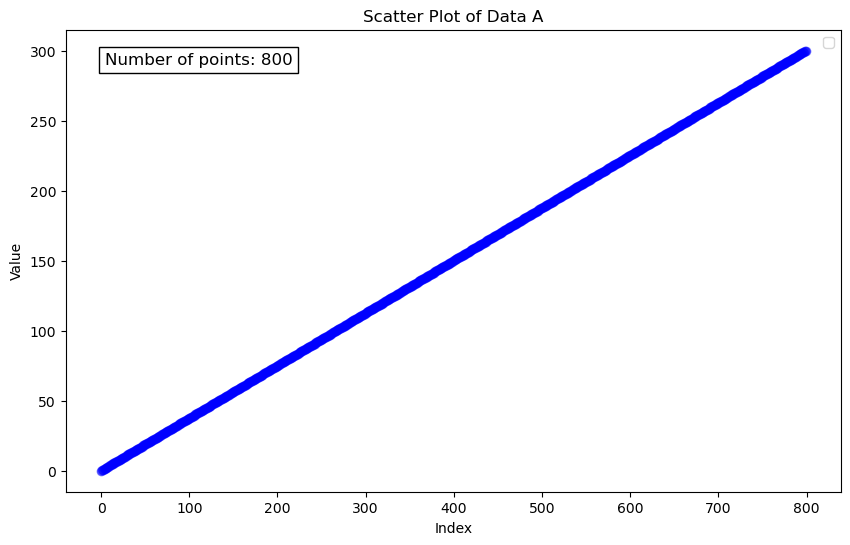

In [8]:
print(X_f.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f)), X_f, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(800, 1)


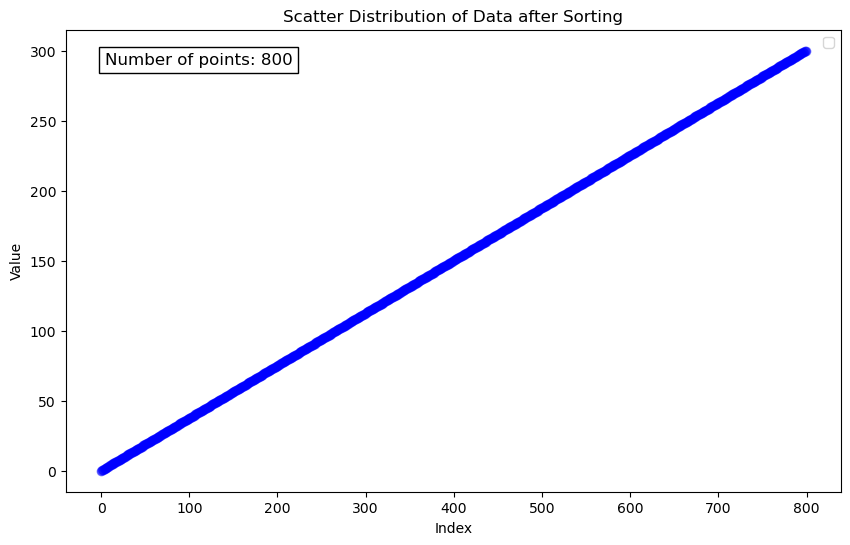

In [9]:
X = np.sort(X_f, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.0005777216722529544, 0.000601168747836685, 0.0004191025250460875, 0.00047749970608882883, 0.0005747359301415396, 0.0004871583739857238, 0.000484181800419626, 0.00035009269650834957, 0.0004841273821703033, 0.0004902012022933718]
Error u of fuhe active learning(LHS sampling): 4.945990e-04
[0.00018203339369724525, 0.0001887308801706836, 0.0001294483871988759, 0.00014785766181922005, 0.0001803519464877156, 0.00015053008654193788, 0.00014885839191090434, 0.00011783194554169929, 0.00014850275583829566, 0.00015238103674508537]
MAE of fuhe active learning(LHS sampling): 1.546526e-04
[6.951445393103938e-08, 7.65147550660979e-08, 3.680950334941389e-08, 4.722789931292174e-08, 7.012470903520915e-08, 4.903224600466367e-08, 4.842871886035718e-08, 2.8823780443985435e-08, 4.840900233928711e-08, 4.9757406919213115e-08]
MSE of fuhe active learning(LHS sampling): 5.246425e-08
[0.00012425659, 0.01153999, 7.651775e-05, 1.659323e-07, 0.0015517637, 8.986531e-05, 9.110074e-05, 0.0001310487, 0.00017354258, 

/tmp/ipykernel_1416767/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[0.0005777216722529544, 0.000601168747836685, 0.0004191025250460875, 0.00047749970608882883, 0.0005747359301415396, 0.0004871583739857238, 0.000484181800419626, 0.00035009269650834957, 0.0004841273821703033, 0.0004902012022933718]
mean Error u: 4.945990e-04
Variance Error u: 5.185547e-09


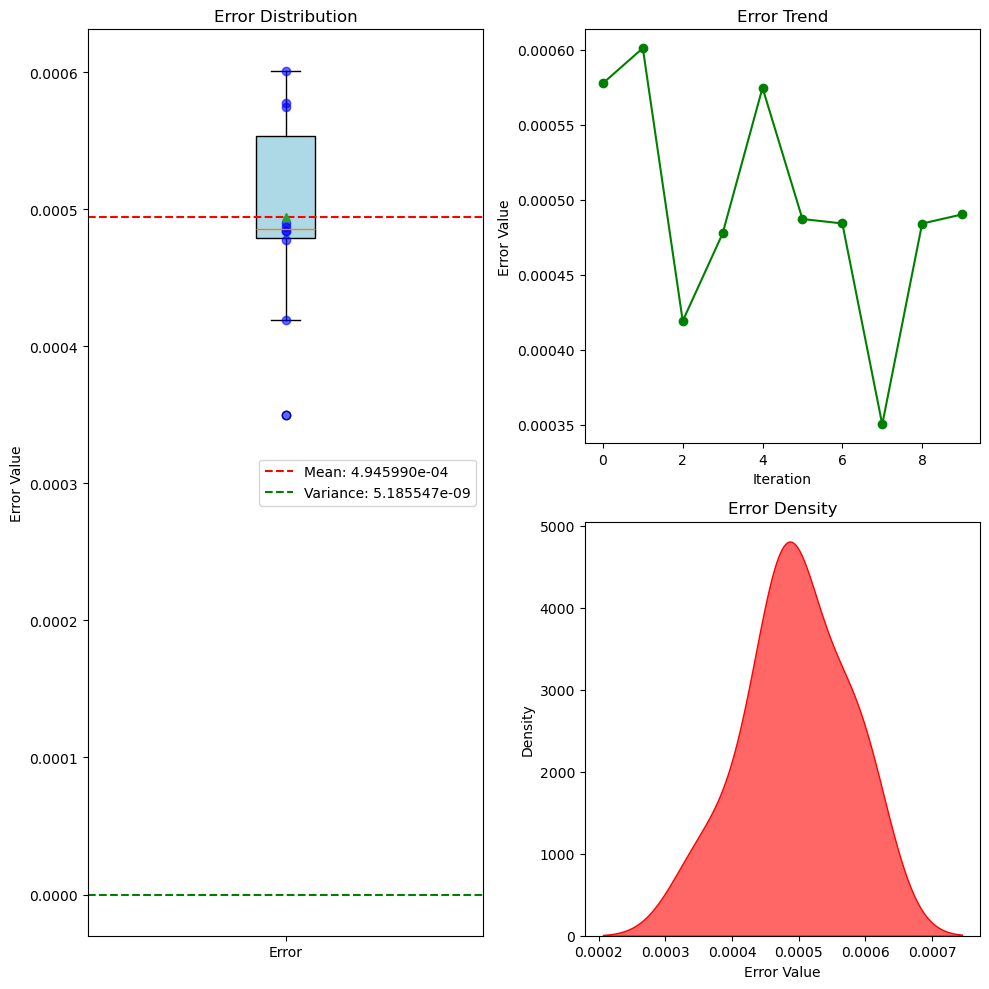

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00018203339369724525, 0.0001887308801706836, 0.0001294483871988759, 0.00014785766181922005, 0.0001803519464877156, 0.00015053008654193788, 0.00014885839191090434, 0.00011783194554169929, 0.00014850275583829566, 0.00015238103674508537]
mean MAE: 1.546526e-04
Variance MAE: 4.702226e-10


/tmp/ipykernel_1416767/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


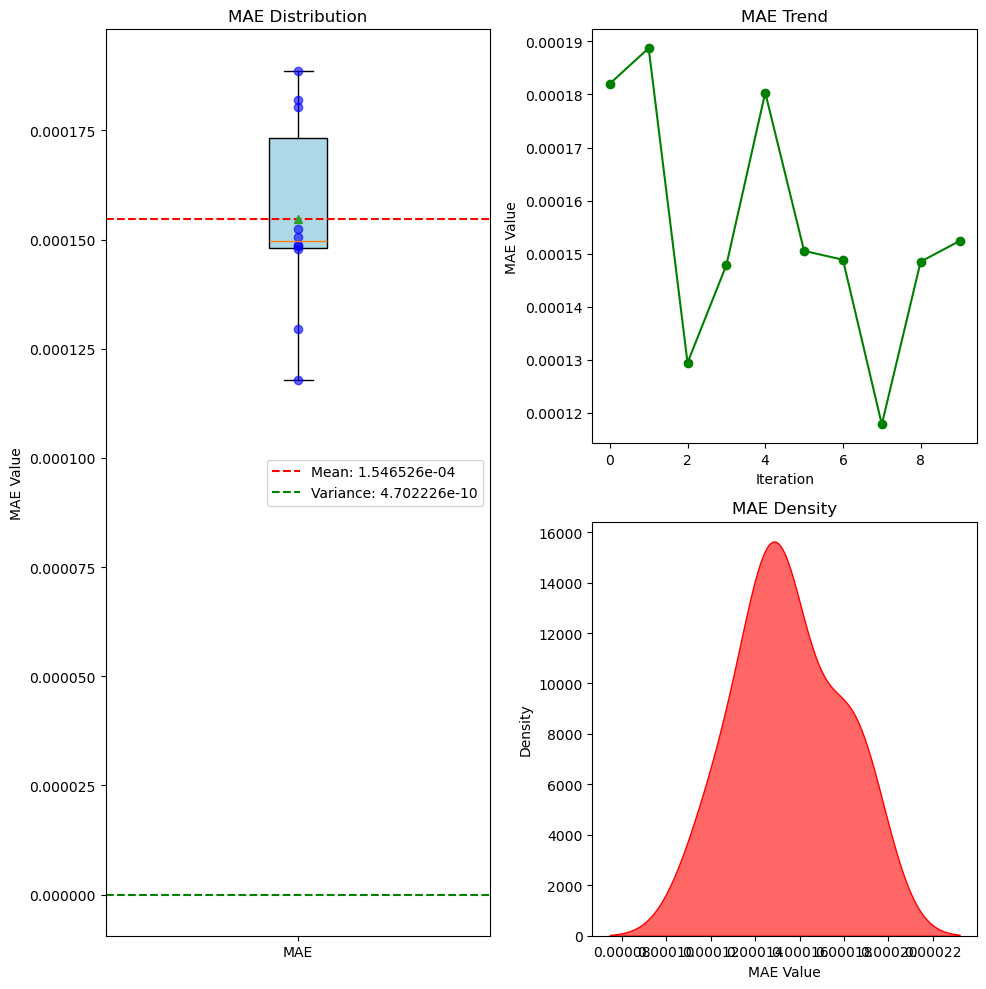

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[6.951445393103938e-08, 7.65147550660979e-08, 3.680950334941389e-08, 4.722789931292174e-08, 7.012470903520915e-08, 4.903224600466367e-08, 4.842871886035718e-08, 2.8823780443985435e-08, 4.840900233928711e-08, 4.9757406919213115e-08]
mean MSE: 5.246425e-08
Variance MSE: 2.064227e-16


/tmp/ipykernel_1416767/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


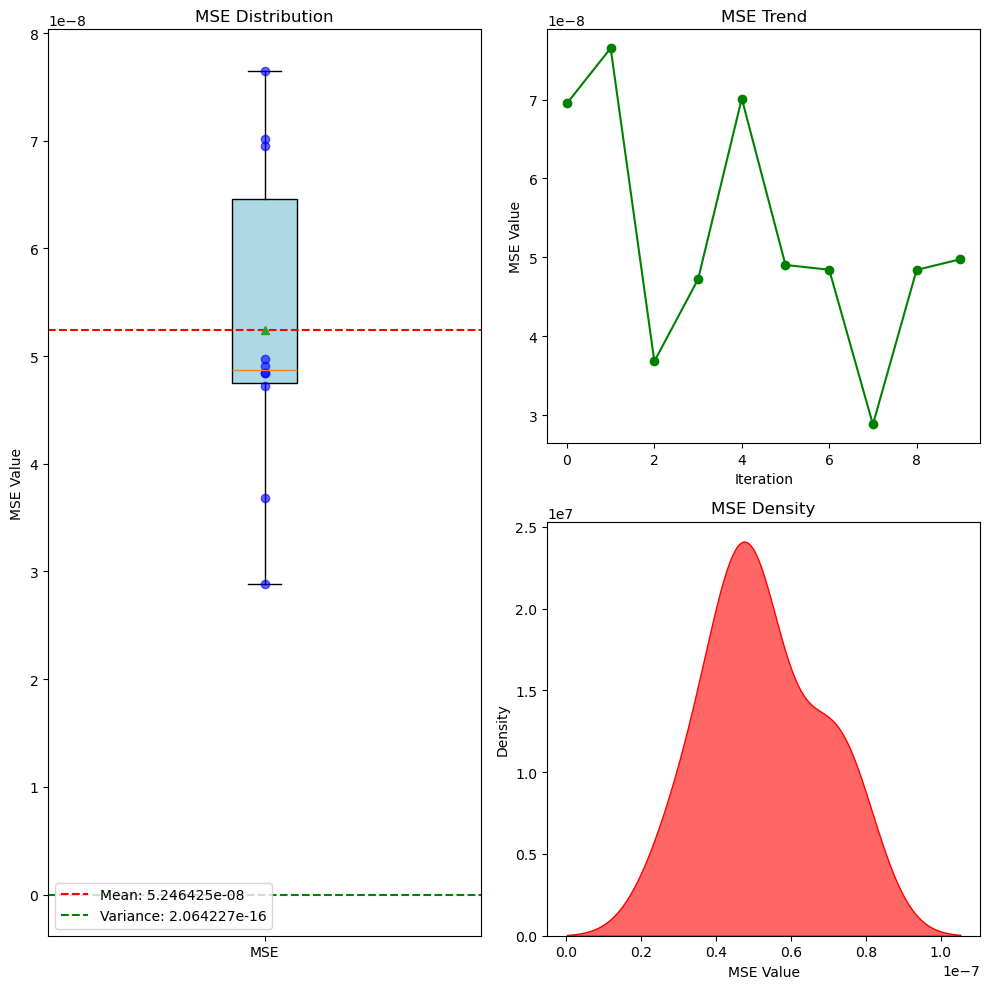

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00012425659, 0.01153999, 7.651775e-05, 1.659323e-07, 0.0015517637, 8.986531e-05, 9.110074e-05, 0.0001310487, 0.00017354258, 0.0054417714]
mean CHAOS: 1.922002e-03
Variance CHAOS: 1.283363e-05


/tmp/ipykernel_1416767/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


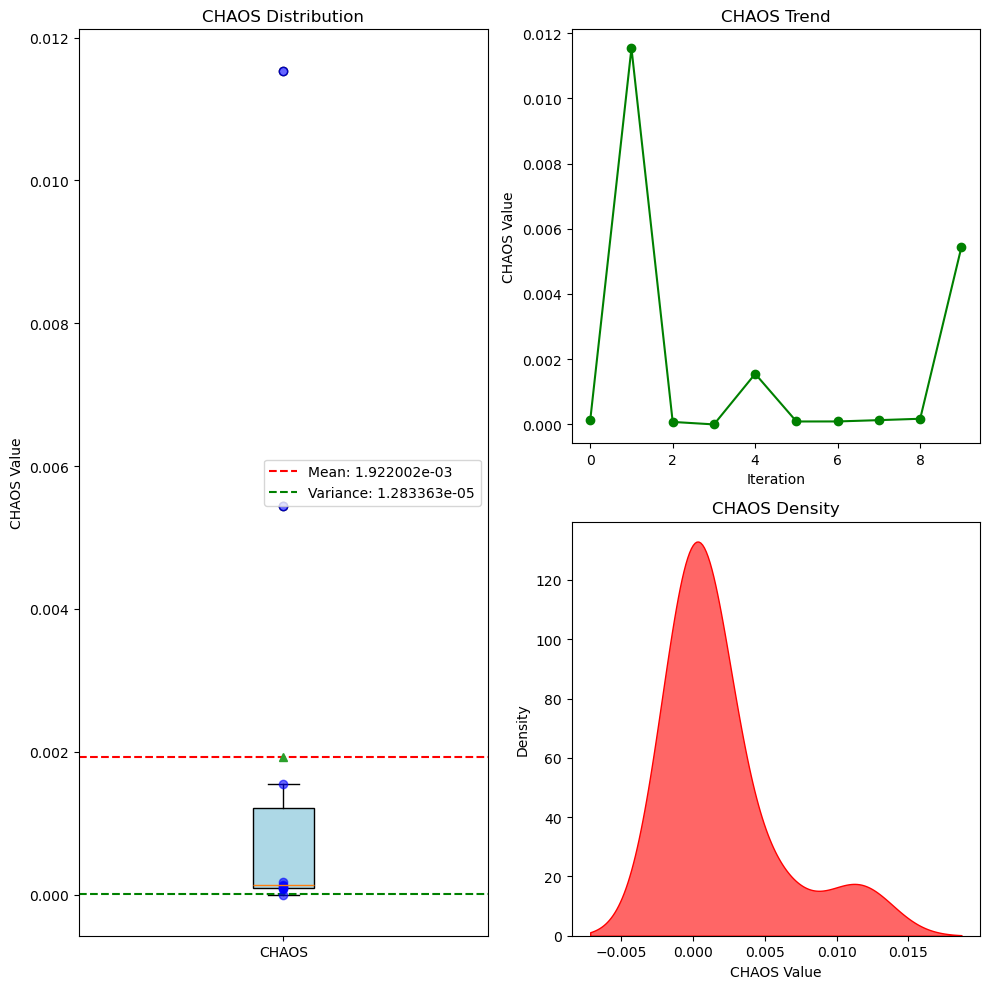

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.6403284e-07, 5.417396e-07, 5.317038e-07, 5.351043e-07, 5.5582655e-07, 4.399592e-07, 5.13048e-07, 4.7351818e-07, 4.160429e-07, 4.7344133e-07]
mean RESIDUAL: 4.944417e-07
Variance RESIDUAL: 2.031152e-15


/tmp/ipykernel_1416767/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


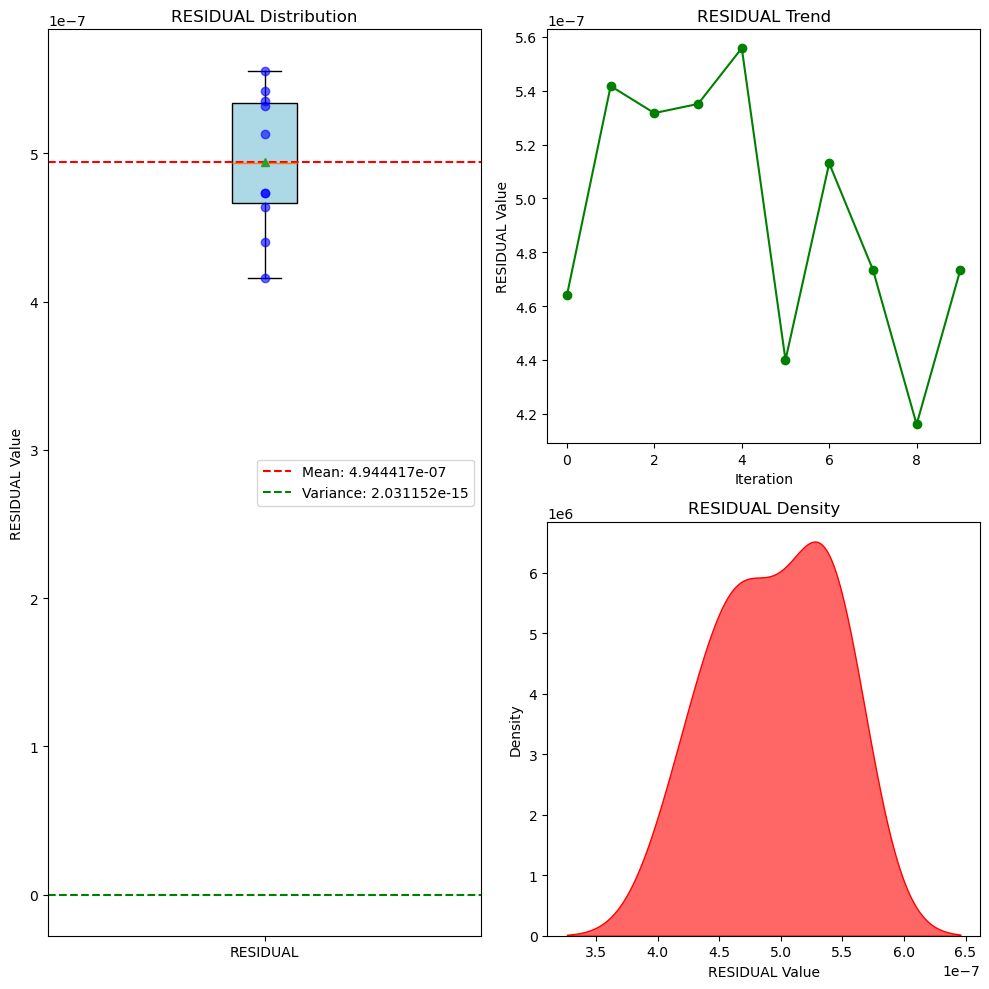

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

150000
[1.9728145e-01 1.6819638e-01 1.4090441e-01 ... 2.5645464e-10 2.5645996e-10
 2.5645261e-10]


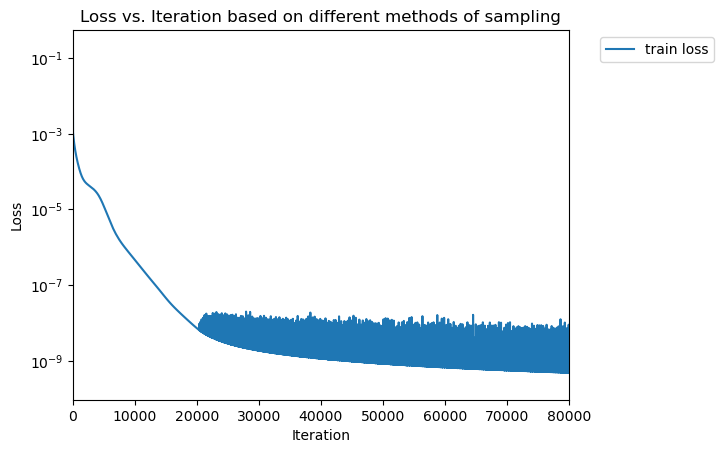

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

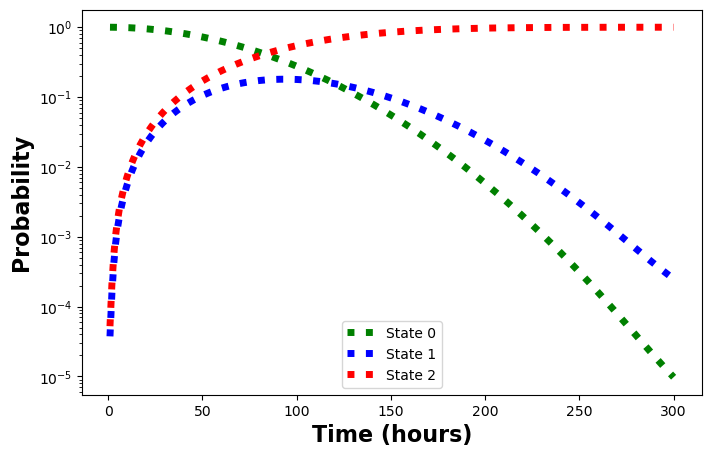

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

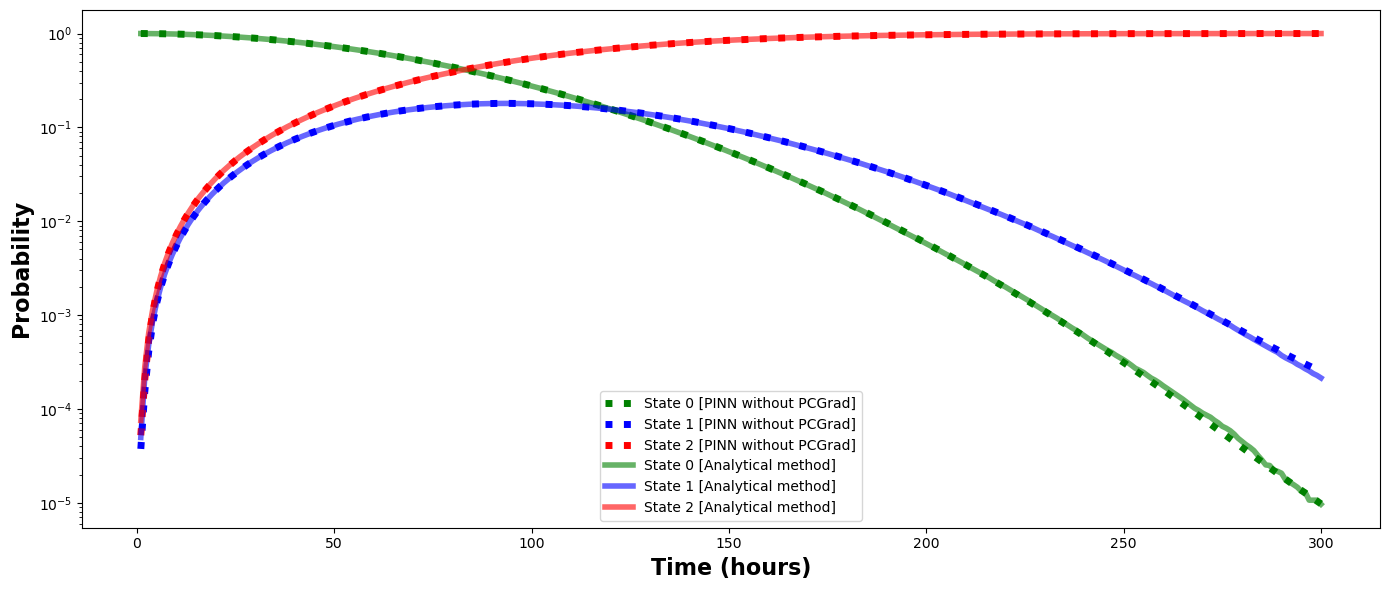

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999910  0.000038  0.000052
1  0.999644  0.000152  0.000204
2  0.999053  0.000409  0.000538
3  0.998131  0.000812  0.001057
4  0.996939  0.001332  0.001729
      state_0   state_1   state_2
295  0.000013  0.000301  0.999686
296  0.000012  0.000288  0.999701
297  0.000011  0.000274  0.999715
298  0.000010  0.000262  0.999728
299  0.000010  0.000250  0.999740


In [21]:
y_diff_no_pcgrad_MCS = MCS_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_MCS['mse'] = y_diff_no_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_MCS['rmse'] = y_diff_no_pcgrad_MCS['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_MCS['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.0002880851878275259
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.0002880851878275259
RMSE between PINN without PCGrad and the analytical solution after 60000 is nan


### 计算混沌度和残差

In [24]:
x_star.shape

(300, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(0, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[3.2745788 3.3332675 3.476118  3.0352192 2.6288664 2.5335715 2.5463574
 2.6126406 2.7281826 2.9030986 3.1378329 3.3846405 3.544338  3.5715964
 3.5322402 3.4950216 3.4706035 3.4539187 3.4425943 3.4354708 3.4311655
 3.4277327 3.4236288 3.4184864 3.4131696 3.409051  3.4070997 3.4076307
 3.4103227 3.4144642 3.4194558 3.425151  3.4317226 3.439377  3.448076
 3.4575088 3.4671867 3.4767234 3.4857595 3.4941397 3.5017464 3.5085752
 3.5146282 3.5199153 3.5244908 3.5284176 3.5317469 3.5345736 3.5369573
 3.538999  3.540762  3.5423157 3.543713  3.5449727 3.546114  3.547085
 3.5478456 3.5483189 3.5483942 3.5479743 3.5469441 3.5452037 3.5426707
 3.5392737 3.5349588 3.529701  3.5234923 3.5163183 3.5082095 3.4991925
 3.489296  3.4785903 3.4671211 3.4549754 3.4422526 3.429055  3.4155154
 3.401756  3.3879209 3.3741224 3.3605008 3.34717   3.334211  3.321728
 3.3097641 3.2983735 3.2876046 3.2774656 3.267957  3.2590916 3.2508545
 3.2432032 3.236154  3.2296724 3.2237263 3.2183037 3.213383  3.2089474
 3.204976

Text(0.5, 1.0, 'Line Plot')

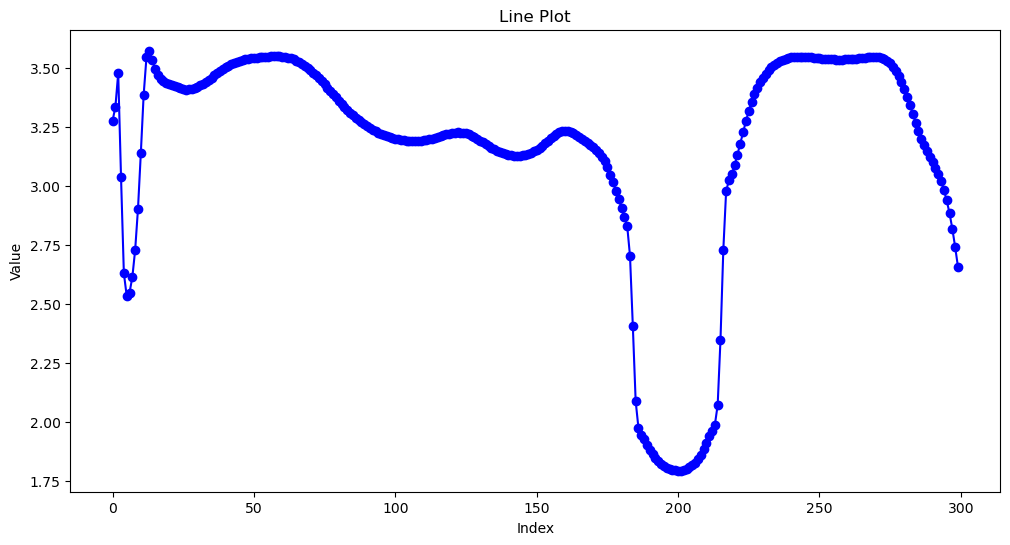

In [26]:
data = chaju
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot')


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[-4.9018126e-08  5.4060365e-08  2.1682354e-08  1.6269041e-08
  5.8207661e-11  4.7148205e-09 -2.9103830e-09  4.0163286e-09
 -6.5192580e-09  3.3760443e-09 -2.3283064e-10 -4.4237822e-09
  1.5133992e-09  3.9581209e-09 -8.1490725e-10  1.1641532e-10
  8.1490725e-10  1.1641532e-09  1.1641532e-09  1.6298145e-09
 -2.5611371e-09  1.3969839e-09 -6.9849193e-10  2.3283064e-10
  9.3132257e-10 -1.1641532e-09  1.6298145e-09  1.3969839e-09
  1.3969839e-09 -4.6566129e-10 -2.3283064e-09 -4.6566129e-10
  1.1641532e-09  2.3283064e-10 -2.3283064e-10  6.9849193e-10
  2.3283064e-10  0.0000000e+00  0.0000000e+00  4.6566129e-10
  1.1641532e-09  6.9849193e-10  1.6298145e-09  9.3132257e-10
  1.1641532e-09  6.9849193e-10  6.9849193e-10  1.3969839e-09
  6.9849193e-10  0.0000000e+00  6.9849193e-10 -6.9849193e-10
 -4.6566129e-10  9.3132257e-10  2.3283064e-10  1.1641532e-09
 -6.9849193e-10  9.3132257e-10  2.3283064e-10 -6.9849193e-10
 -1.1641532e-09  1.1641532e-09  2.3283064e-10  6.9849193e-10
  0.0000000e+00  0.00000

Text(0.5, 1.0, 'Line Plot')

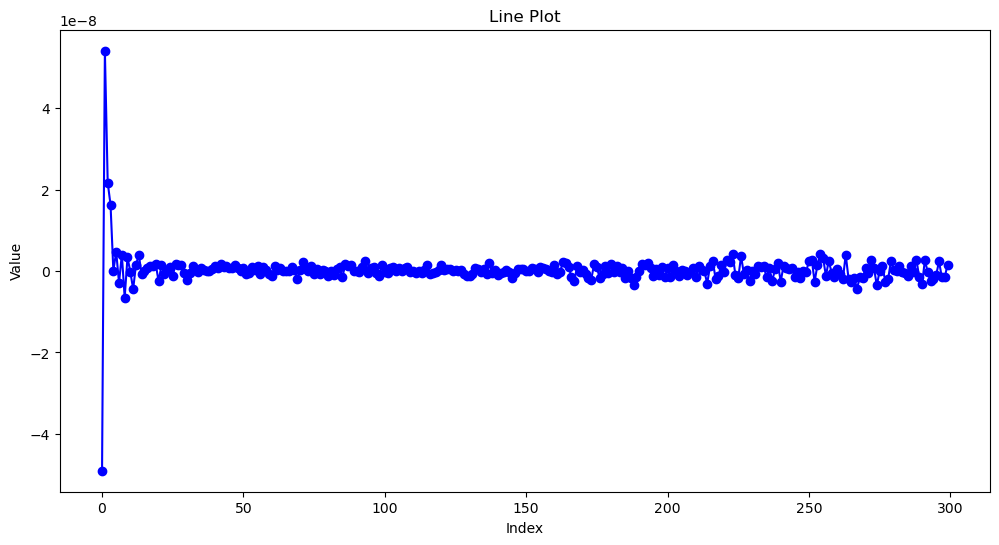

In [28]:
data = residual
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot')
